## Apply Dirichlet Thompson Sampling on the Movielens Dataset
The goal is to maximize the number of relevant movie suggestions using `IndependentBandits` and `DirichletThompsonSampling`.
A rating of 4 and above is considered as positive feedback for the recommendation.

In [1]:
import numpy as np
from tqdm import tqdm
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
from collections import Counter
from urllib.request import urlopen

from mab_ranking.bandits.rank_bandits import IndependentBandits
from mab_ranking.bandits.bandits import BetaThompsonSampling, DirichletThompsonSampling


In [2]:
# Helper functions


def get_movielens_data(url):
    """
    Get the movielens data
    :param url: [str], url name
    """
    data = []
    resp = urlopen(url)
    zpfile = ZipFile(BytesIO(resp.read()))
    for line in zpfile.open('ml-100k/u1.base').read().splitlines():
        data.append(
            [int(float(x)) for x in line.decode('utf-8').split('\t')])

    return np.asarray(data)


def filter_data(data):
    """
    Filters the data by keeping rating greater or equal than 4.
    Removes events that contain movies that don't belong in the top 100
    
    :param data: list[int], events data
    """
    data_pos_rating = np.asarray([x for x in data if x[2] >= 4])
    movies = [x[1] for x in data_pos_rating]
    freq = Counter(movies)
    keep_movies = [x[0] for x in freq.most_common(100)]

    filtered_data = []
    for d in data_pos_rating:
        if d[1] in keep_movies:
            filtered_data.append(d)

    return np.asarray(filtered_data)


def index_data(data):
    """
    Indexed users and movies
    
    :param data: list[int], events data
    """
    user_indexer = {v: i for i, v in enumerate(set([d[0] for d in data]))}
    movie_indexer = {v: i for i, v in enumerate(set([d[1] for d in data]))}
    indexed_data = []
    for d in data:
        d[0] = user_indexer[d[0]]
        d[1] = movie_indexer[d[1]]
        indexed_data.append(d)
    return np.asarray(indexed_data), user_indexer, movie_indexer


def running_mean(x, n):
    """
    Calculates the running mean
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)


def plot_ctr(num_iterations, ctr):
    """
    Plots the CTR over time
    
    :param num_iterations: [int], number or iterations
    :param ctr: list[float], ctrs over each time step
    """
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    return plt


In [3]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

# get the movielens data
data = get_movielens_data(url)

# filter the data
filtered_data = filter_data(data)

# index the data
indexed_data, user_indexer, movie_indexer = index_data(filtered_data)

# sort the data by timestamp
indexed_data_sorted = sorted(indexed_data, key=lambda x: x[3])


In [4]:
def experiment(indexed_data_sorted, independent_bandits):
    # instantiate the dictionary that would hold all the past actions of each user
    # initial state is 0
    actions_dict = {}
    for i in indexed_data_sorted:
        if i[0] not in actions_dict:
            actions_dict[i[0]] = [0]

    sum_binary = 0.0
    ctr_list = []
    k = 100
    i = 1
    for d in tqdm(indexed_data_sorted):
        ground_truth = [d[1]]

        selected_items = independent_bandits.choose(context={'previous_action': actions_dict[d[0]][-1]})
        actions_dict[d[0]] += ground_truth
        hit_rate = len(set(ground_truth).intersection(set(selected_items))) / len(set(ground_truth))

        feedback_list = [1.0 if _item in ground_truth else 0.0 for _item in selected_items]
        independent_bandits.update(selected_items, feedback_list)

        binary_relevancy = 1.0 if hit_rate > 0 else 0.0
        sum_binary += binary_relevancy
        ctr_list.append(sum_binary / i)
        i += 1

    ctr_avg = running_mean(ctr_list, k)

    return ctr_avg



## Empirical Results for Dirichlet-based Approach

In [5]:
num_experiments = 30
list_of_averages = []


for _ in range(num_experiments):
    # instantiate the bandit
    independent_bandits = IndependentBandits(
        num_arms=len(movie_indexer),
        num_ranks=10,  # Recommend the best 10 movies
        bandit_class=DirichletThompsonSampling
    )
    
    ctr_avg = experiment(indexed_data_sorted, independent_bandits)
    list_of_averages.append(ctr_avg)

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:51, 97.22it/s]

  0%|          | 18/16635 [00:00<03:02, 91.17it/s]

  0%|          | 26/16635 [00:00<03:14, 85.55it/s]

  0%|          | 35/16635 [00:00<03:15, 85.07it/s]

  0%|          | 44/16635 [00:00<03:16, 84.64it/s]

  0%|          | 53/16635 [00:00<03:15, 84.75it/s]

  0%|          | 62/16635 [00:00<03:15, 84.82it/s]

  0%|          | 71/16635 [00:00<03:14, 85.20it/s]

  0%|          | 80/16635 [00:00<03:17, 83.94it/s]

  1%|          | 89/16635 [00:01<03:15, 84.62it/s]

  1%|          | 99/16635 [00:01<03:11, 86.32it/s]

  1%|          | 109/16635 [00:01<03:09, 87.32it/s]

  1%|          | 118/16635 [00:01<03:07, 88.01it/s]

  1%|          | 127/16635 [00:01<03:10, 86.77it/s]

  1%|          | 136/16635 [00:01<03:09, 87.23it/s]

  1%|          | 145/16635 [00:01<03:09, 86.94it/s]

  1%|          | 154/16635 [00:01<03:11, 85.94it/s]

  1%|          | 164/16635 [00:01<03:07, 88.00it/s]

  1%|          | 174/16635 [00:02<03:00, 91.26it/s]

  1%|          | 184/16635 [00:02<02:56, 93.05it/s]

  1%|          | 194/16635 [00:02<03:00, 91.03it/s]

  1%|          | 204/16635 [00:02<03:06, 88.02it/s]

  1%|▏         | 213/16635 [00:02<03:06, 88.22it/s]

  1%|▏         | 222/16635 [00:02<03:05, 88.70it/s]

  1%|▏         | 231/16635 [00:02<03:06, 88.08it/s]

  1%|▏         | 240/16635 [00:02<03:09, 86.63it/s]

  1%|▏         | 249/16635 [00:02<03:11, 85.60it/s]

  2%|▏         | 258/16635 [00:02<03:09, 86.65it/s]

  2%|▏         | 267/16635 [00:03<03:10, 85.95it/s]

  2%|▏         | 276/16635 [00:03<03:10, 85.74it/s]

  2%|▏         | 285/16635 [00:03<03:11, 85.44it/s]

  2%|▏         | 294/16635 [00:03<03:08, 86.65it/s]

  2%|▏         | 303/16635 [00:03<03:10, 85.54it/s]

  2%|▏         | 312/16635 [00:03<03:11, 85.03it/s]

  2%|▏         | 321/16635 [00:03<03:11, 85.24it/s]

  2%|▏         | 330/16635 [00:03<03:09, 86.04it/s]

  2%|▏         | 339/16635 [00:03<03:12, 84.87it/s]

  2%|▏         | 348/16635 [00:04<03:10, 85.34it/s]

  2%|▏         | 357/16635 [00:04<03:09, 85.93it/s]

  2%|▏         | 368/16635 [00:04<03:01, 89.43it/s]

  2%|▏         | 378/16635 [00:04<02:58, 90.99it/s]

  2%|▏         | 388/16635 [00:04<03:01, 89.72it/s]

  2%|▏         | 398/16635 [00:04<02:55, 92.57it/s]

  2%|▏         | 408/16635 [00:04<02:54, 92.99it/s]

  3%|▎         | 418/16635 [00:04<02:56, 91.94it/s]

  3%|▎         | 428/16635 [00:04<03:00, 90.00it/s]

  3%|▎         | 438/16635 [00:05<03:04, 87.66it/s]

  3%|▎         | 447/16635 [00:05<03:04, 87.63it/s]

  3%|▎         | 457/16635 [00:05<03:02, 88.67it/s]

  3%|▎         | 466/16635 [00:05<03:07, 86.45it/s]

  3%|▎         | 475/16635 [00:05<03:09, 85.09it/s]

  3%|▎         | 485/16635 [00:05<03:04, 87.61it/s]

  3%|▎         | 494/16635 [00:05<03:06, 86.55it/s]

  3%|▎         | 503/16635 [00:05<03:08, 85.60it/s]

  3%|▎         | 512/16635 [00:05<03:07, 85.96it/s]

  3%|▎         | 521/16635 [00:05<03:06, 86.39it/s]

  3%|▎         | 530/16635 [00:06<03:05, 86.98it/s]

  3%|▎         | 539/16635 [00:06<03:07, 85.83it/s]

  3%|▎         | 548/16635 [00:06<03:06, 86.30it/s]

  3%|▎         | 557/16635 [00:06<03:04, 87.37it/s]

  3%|▎         | 566/16635 [00:06<03:03, 87.75it/s]

  3%|▎         | 575/16635 [00:06<03:06, 86.30it/s]

  4%|▎         | 586/16635 [00:06<02:58, 89.81it/s]

  4%|▎         | 596/16635 [00:06<03:00, 88.70it/s]

  4%|▎         | 606/16635 [00:06<02:59, 89.28it/s]

  4%|▎         | 615/16635 [00:07<03:03, 87.26it/s]

  4%|▍         | 624/16635 [00:07<03:03, 87.36it/s]

  4%|▍         | 634/16635 [00:07<02:58, 89.49it/s]

  4%|▍         | 643/16635 [00:07<03:01, 88.18it/s]

  4%|▍         | 653/16635 [00:07<02:56, 90.75it/s]

  4%|▍         | 663/16635 [00:07<02:59, 88.79it/s]

  4%|▍         | 673/16635 [00:07<02:58, 89.46it/s]

  4%|▍         | 682/16635 [00:07<03:01, 87.74it/s]

  4%|▍         | 691/16635 [00:07<03:00, 88.17it/s]

  4%|▍         | 700/16635 [00:08<03:04, 86.56it/s]

  4%|▍         | 709/16635 [00:08<03:03, 86.93it/s]

  4%|▍         | 718/16635 [00:08<03:01, 87.60it/s]

  4%|▍         | 728/16635 [00:08<03:00, 88.27it/s]

  4%|▍         | 737/16635 [00:08<03:02, 87.03it/s]

  4%|▍         | 746/16635 [00:08<03:01, 87.62it/s]

  5%|▍         | 755/16635 [00:08<03:03, 86.58it/s]

  5%|▍         | 764/16635 [00:08<03:02, 87.20it/s]

  5%|▍         | 773/16635 [00:08<03:01, 87.31it/s]

  5%|▍         | 783/16635 [00:08<02:59, 88.46it/s]

  5%|▍         | 792/16635 [00:09<03:01, 87.40it/s]

  5%|▍         | 801/16635 [00:09<03:03, 86.35it/s]

  5%|▍         | 810/16635 [00:09<03:04, 85.92it/s]

  5%|▍         | 819/16635 [00:09<03:03, 86.06it/s]

  5%|▍         | 828/16635 [00:09<03:04, 85.48it/s]

  5%|▌         | 838/16635 [00:09<03:00, 87.61it/s]

  5%|▌         | 847/16635 [00:09<03:02, 86.74it/s]

  5%|▌         | 856/16635 [00:09<03:00, 87.42it/s]

  5%|▌         | 865/16635 [00:09<03:00, 87.19it/s]

  5%|▌         | 874/16635 [00:10<03:03, 85.90it/s]

  5%|▌         | 883/16635 [00:10<03:02, 86.14it/s]

  5%|▌         | 893/16635 [00:10<03:00, 87.26it/s]

  5%|▌         | 902/16635 [00:10<03:02, 86.26it/s]

  5%|▌         | 911/16635 [00:10<03:02, 86.01it/s]

  6%|▌         | 920/16635 [00:10<03:07, 83.80it/s]

  6%|▌         | 929/16635 [00:10<03:07, 83.54it/s]

  6%|▌         | 939/16635 [00:10<03:02, 86.12it/s]

  6%|▌         | 948/16635 [00:10<03:03, 85.35it/s]

  6%|▌         | 957/16635 [00:10<03:01, 86.24it/s]

  6%|▌         | 966/16635 [00:11<03:07, 83.71it/s]

  6%|▌         | 975/16635 [00:11<03:21, 77.75it/s]

  6%|▌         | 983/16635 [00:11<03:22, 77.44it/s]

  6%|▌         | 991/16635 [00:11<03:20, 77.89it/s]

  6%|▌         | 1000/16635 [00:11<03:18, 78.64it/s]

  6%|▌         | 1010/16635 [00:11<03:10, 81.90it/s]

  6%|▌         | 1019/16635 [00:11<03:10, 81.85it/s]

  6%|▌         | 1028/16635 [00:11<03:12, 81.21it/s]

  6%|▌         | 1037/16635 [00:11<03:19, 78.14it/s]

  6%|▋         | 1046/16635 [00:12<03:17, 79.08it/s]

  6%|▋         | 1054/16635 [00:12<03:54, 66.50it/s]

  6%|▋         | 1062/16635 [00:12<04:19, 60.00it/s]

  6%|▋         | 1069/16635 [00:12<04:13, 61.35it/s]

  6%|▋         | 1077/16635 [00:12<03:55, 65.96it/s]

  7%|▋         | 1086/16635 [00:12<03:40, 70.58it/s]

  7%|▋         | 1096/16635 [00:12<03:22, 76.64it/s]

  7%|▋         | 1106/16635 [00:12<03:11, 81.23it/s]

  7%|▋         | 1115/16635 [00:13<03:11, 80.92it/s]

  7%|▋         | 1124/16635 [00:13<03:11, 80.83it/s]

  7%|▋         | 1133/16635 [00:13<03:08, 82.19it/s]

  7%|▋         | 1142/16635 [00:13<03:05, 83.68it/s]

  7%|▋         | 1151/16635 [00:13<03:06, 83.20it/s]

  7%|▋         | 1160/16635 [00:13<03:01, 85.12it/s]

  7%|▋         | 1169/16635 [00:13<03:02, 84.97it/s]

  7%|▋         | 1178/16635 [00:13<03:02, 84.82it/s]

  7%|▋         | 1187/16635 [00:13<03:01, 84.97it/s]

  7%|▋         | 1196/16635 [00:14<03:04, 83.74it/s]

  7%|▋         | 1205/16635 [00:14<05:50, 44.03it/s]

  7%|▋         | 1212/16635 [00:14<05:42, 45.00it/s]

  7%|▋         | 1220/16635 [00:14<04:58, 51.60it/s]

  7%|▋         | 1228/16635 [00:14<04:29, 57.27it/s]

  7%|▋         | 1236/16635 [00:14<04:06, 62.56it/s]

  7%|▋         | 1244/16635 [00:15<03:51, 66.51it/s]

  8%|▊         | 1252/16635 [00:15<03:41, 69.29it/s]

  8%|▊         | 1261/16635 [00:15<03:28, 73.59it/s]

  8%|▊         | 1270/16635 [00:15<03:23, 75.49it/s]

  8%|▊         | 1278/16635 [00:15<03:20, 76.68it/s]

  8%|▊         | 1286/16635 [00:15<03:18, 77.45it/s]

  8%|▊         | 1294/16635 [00:15<03:17, 77.59it/s]

  8%|▊         | 1303/16635 [00:15<03:15, 78.48it/s]

  8%|▊         | 1312/16635 [00:15<03:11, 80.06it/s]

  8%|▊         | 1322/16635 [00:15<03:04, 82.78it/s]

  8%|▊         | 1331/16635 [00:16<03:03, 83.48it/s]

  8%|▊         | 1340/16635 [00:16<03:00, 84.75it/s]

  8%|▊         | 1350/16635 [00:16<02:55, 87.24it/s]

  8%|▊         | 1359/16635 [00:16<02:53, 87.86it/s]

  8%|▊         | 1369/16635 [00:16<02:50, 89.70it/s]

  8%|▊         | 1379/16635 [00:16<02:51, 88.71it/s]

  8%|▊         | 1389/16635 [00:16<02:48, 90.60it/s]

  8%|▊         | 1399/16635 [00:16<02:51, 89.07it/s]

  8%|▊         | 1408/16635 [00:16<02:54, 87.46it/s]

  9%|▊         | 1417/16635 [00:17<02:56, 86.07it/s]

  9%|▊         | 1426/16635 [00:17<02:55, 86.86it/s]

  9%|▊         | 1435/16635 [00:17<02:57, 85.87it/s]

  9%|▊         | 1444/16635 [00:17<02:54, 86.97it/s]

  9%|▊         | 1453/16635 [00:17<02:54, 87.23it/s]

  9%|▉         | 1463/16635 [00:17<02:52, 88.01it/s]

  9%|▉         | 1472/16635 [00:17<02:51, 88.24it/s]

  9%|▉         | 1481/16635 [00:17<02:51, 88.20it/s]

  9%|▉         | 1491/16635 [00:17<02:50, 89.02it/s]

  9%|▉         | 1500/16635 [00:17<02:51, 88.03it/s]

  9%|▉         | 1509/16635 [00:18<02:55, 86.12it/s]

  9%|▉         | 1518/16635 [00:18<02:57, 85.39it/s]

  9%|▉         | 1527/16635 [00:18<02:54, 86.71it/s]

  9%|▉         | 1536/16635 [00:18<02:54, 86.53it/s]

  9%|▉         | 1545/16635 [00:18<02:53, 87.10it/s]

  9%|▉         | 1554/16635 [00:18<02:55, 85.78it/s]

  9%|▉         | 1564/16635 [00:18<02:53, 87.00it/s]

  9%|▉         | 1573/16635 [00:18<02:51, 87.57it/s]

 10%|▉         | 1583/16635 [00:18<02:49, 88.64it/s]

 10%|▉         | 1592/16635 [00:19<02:50, 88.41it/s]

 10%|▉         | 1601/16635 [00:19<02:53, 86.67it/s]

 10%|▉         | 1610/16635 [00:19<02:53, 86.49it/s]

 10%|▉         | 1619/16635 [00:19<02:55, 85.76it/s]

 10%|▉         | 1629/16635 [00:19<02:52, 86.99it/s]

 10%|▉         | 1638/16635 [00:19<02:51, 87.49it/s]

 10%|▉         | 1647/16635 [00:19<02:55, 85.35it/s]

 10%|▉         | 1656/16635 [00:19<02:53, 86.29it/s]

 10%|█         | 1666/16635 [00:19<02:48, 88.80it/s]

 10%|█         | 1675/16635 [00:20<02:48, 88.82it/s]

 10%|█         | 1684/16635 [00:20<02:51, 87.11it/s]

 10%|█         | 1694/16635 [00:20<02:48, 88.86it/s]

 10%|█         | 1703/16635 [00:20<02:48, 88.77it/s]

 10%|█         | 1712/16635 [00:20<02:49, 87.79it/s]

 10%|█         | 1721/16635 [00:20<02:49, 88.16it/s]

 10%|█         | 1730/16635 [00:20<02:53, 86.12it/s]

 10%|█         | 1739/16635 [00:20<02:54, 85.57it/s]

 11%|█         | 1749/16635 [00:20<02:50, 87.46it/s]

 11%|█         | 1758/16635 [00:20<02:48, 88.05it/s]

 11%|█         | 1767/16635 [00:21<02:50, 87.14it/s]

 11%|█         | 1777/16635 [00:21<02:47, 88.50it/s]

 11%|█         | 1787/16635 [00:21<02:46, 88.99it/s]

 11%|█         | 1797/16635 [00:21<02:46, 89.35it/s]

 11%|█         | 1806/16635 [00:21<02:49, 87.43it/s]

 11%|█         | 1815/16635 [00:21<02:52, 86.15it/s]

 11%|█         | 1824/16635 [00:21<02:52, 85.64it/s]

 11%|█         | 1834/16635 [00:21<02:48, 87.92it/s]

 11%|█         | 1843/16635 [00:21<02:50, 86.90it/s]

 11%|█         | 1852/16635 [00:22<02:51, 86.27it/s]

 11%|█         | 1861/16635 [00:22<02:51, 86.21it/s]

 11%|█         | 1871/16635 [00:22<02:46, 88.64it/s]

 11%|█▏        | 1880/16635 [00:22<02:49, 87.17it/s]

 11%|█▏        | 1889/16635 [00:22<02:49, 86.94it/s]

 11%|█▏        | 1898/16635 [00:22<02:50, 86.32it/s]

 11%|█▏        | 1907/16635 [00:22<02:50, 86.28it/s]

 12%|█▏        | 1916/16635 [00:22<02:49, 86.89it/s]

 12%|█▏        | 1925/16635 [00:22<02:51, 85.87it/s]

 12%|█▏        | 1934/16635 [00:22<02:50, 86.10it/s]

 12%|█▏        | 1944/16635 [00:23<02:47, 87.92it/s]

 12%|█▏        | 1953/16635 [00:23<02:49, 86.59it/s]

 12%|█▏        | 1962/16635 [00:23<02:50, 86.29it/s]

 12%|█▏        | 1972/16635 [00:23<02:45, 88.35it/s]

 12%|█▏        | 1981/16635 [00:23<02:48, 87.19it/s]

 12%|█▏        | 1990/16635 [00:23<02:51, 85.55it/s]

 12%|█▏        | 1999/16635 [00:23<02:50, 85.61it/s]

 12%|█▏        | 2008/16635 [00:23<02:52, 84.92it/s]

 12%|█▏        | 2017/16635 [00:23<02:49, 86.11it/s]

 12%|█▏        | 2026/16635 [00:24<02:48, 86.48it/s]

 12%|█▏        | 2035/16635 [00:24<02:51, 84.95it/s]

 12%|█▏        | 2044/16635 [00:24<02:51, 85.22it/s]

 12%|█▏        | 2053/16635 [00:24<02:51, 85.09it/s]

 12%|█▏        | 2062/16635 [00:24<02:48, 86.38it/s]

 12%|█▏        | 2071/16635 [00:24<02:49, 85.86it/s]

 13%|█▎        | 2080/16635 [00:24<02:48, 86.26it/s]

 13%|█▎        | 2089/16635 [00:24<02:47, 86.59it/s]

 13%|█▎        | 2098/16635 [00:24<02:50, 85.28it/s]

 13%|█▎        | 2107/16635 [00:24<02:49, 85.71it/s]

 13%|█▎        | 2116/16635 [00:25<02:47, 86.91it/s]

 13%|█▎        | 2125/16635 [00:25<02:50, 84.93it/s]

 13%|█▎        | 2135/16635 [00:25<02:47, 86.43it/s]

 13%|█▎        | 2145/16635 [00:25<02:43, 88.72it/s]

 13%|█▎        | 2154/16635 [00:25<02:45, 87.46it/s]

 13%|█▎        | 2164/16635 [00:25<02:42, 89.05it/s]

 13%|█▎        | 2173/16635 [00:25<02:42, 89.12it/s]

 13%|█▎        | 2183/16635 [00:25<02:40, 89.97it/s]

 13%|█▎        | 2193/16635 [00:25<02:40, 90.02it/s]

 13%|█▎        | 2203/16635 [00:26<02:42, 88.57it/s]

 13%|█▎        | 2212/16635 [00:26<02:44, 87.94it/s]

 13%|█▎        | 2221/16635 [00:26<02:45, 87.22it/s]

 13%|█▎        | 2231/16635 [00:26<02:40, 89.82it/s]

 13%|█▎        | 2241/16635 [00:26<02:40, 89.41it/s]

 14%|█▎        | 2251/16635 [00:26<02:41, 89.30it/s]

 14%|█▎        | 2260/16635 [00:26<02:44, 87.39it/s]

 14%|█▎        | 2270/16635 [00:26<02:41, 88.96it/s]

 14%|█▎        | 2280/16635 [00:26<02:40, 89.55it/s]

 14%|█▍        | 2289/16635 [00:27<02:42, 88.45it/s]

 14%|█▍        | 2299/16635 [00:27<02:41, 88.86it/s]

 14%|█▍        | 2309/16635 [00:27<02:40, 89.27it/s]

 14%|█▍        | 2318/16635 [00:27<02:42, 87.98it/s]

 14%|█▍        | 2327/16635 [00:27<02:44, 87.23it/s]

 14%|█▍        | 2337/16635 [00:27<02:39, 89.55it/s]

 14%|█▍        | 2346/16635 [00:27<02:43, 87.17it/s]

 14%|█▍        | 2355/16635 [00:27<02:45, 86.38it/s]

 14%|█▍        | 2365/16635 [00:27<02:42, 87.60it/s]

 14%|█▍        | 2374/16635 [00:27<02:41, 88.06it/s]

 14%|█▍        | 2383/16635 [00:28<02:43, 87.43it/s]

 14%|█▍        | 2392/16635 [00:28<02:48, 84.61it/s]

 14%|█▍        | 2401/16635 [00:28<02:50, 83.46it/s]

 14%|█▍        | 2410/16635 [00:28<02:49, 83.98it/s]

 15%|█▍        | 2419/16635 [00:28<02:48, 84.46it/s]

 15%|█▍        | 2428/16635 [00:28<02:46, 85.37it/s]

 15%|█▍        | 2437/16635 [00:28<02:47, 84.68it/s]

 15%|█▍        | 2447/16635 [00:28<02:44, 86.13it/s]

 15%|█▍        | 2456/16635 [00:28<02:42, 87.25it/s]

 15%|█▍        | 2465/16635 [00:29<02:42, 87.04it/s]

 15%|█▍        | 2474/16635 [00:29<02:45, 85.43it/s]

 15%|█▍        | 2483/16635 [00:29<02:46, 85.20it/s]

 15%|█▍        | 2492/16635 [00:29<02:45, 85.71it/s]

 15%|█▌        | 2502/16635 [00:29<02:40, 88.02it/s]

 15%|█▌        | 2511/16635 [00:29<02:42, 86.74it/s]

 15%|█▌        | 2520/16635 [00:29<02:46, 84.98it/s]

 15%|█▌        | 2529/16635 [00:29<02:44, 85.69it/s]

 15%|█▌        | 2539/16635 [00:29<02:37, 89.46it/s]

 15%|█▌        | 2549/16635 [00:30<02:35, 90.38it/s]

 15%|█▌        | 2559/16635 [00:30<02:38, 88.89it/s]

 15%|█▌        | 2568/16635 [00:30<02:40, 87.51it/s]

 15%|█▌        | 2577/16635 [00:30<02:44, 85.67it/s]

 16%|█▌        | 2586/16635 [00:30<02:42, 86.45it/s]

 16%|█▌        | 2595/16635 [00:30<02:43, 85.65it/s]

 16%|█▌        | 2604/16635 [00:30<02:48, 83.11it/s]

 16%|█▌        | 2613/16635 [00:30<02:45, 84.54it/s]

 16%|█▌        | 2622/16635 [00:30<02:43, 85.92it/s]

 16%|█▌        | 2631/16635 [00:30<02:41, 86.59it/s]

 16%|█▌        | 2640/16635 [00:31<02:42, 86.08it/s]

 16%|█▌        | 2649/16635 [00:31<02:45, 84.46it/s]

 16%|█▌        | 2658/16635 [00:31<02:45, 84.69it/s]

 16%|█▌        | 2667/16635 [00:31<02:44, 85.07it/s]

 16%|█▌        | 2676/16635 [00:31<02:44, 84.97it/s]

 16%|█▌        | 2685/16635 [00:31<02:43, 85.58it/s]

 16%|█▌        | 2694/16635 [00:31<02:41, 86.22it/s]

 16%|█▋        | 2704/16635 [00:31<02:35, 89.74it/s]

 16%|█▋        | 2714/16635 [00:31<02:30, 92.21it/s]

 16%|█▋        | 2724/16635 [00:32<02:34, 89.82it/s]

 16%|█▋        | 2734/16635 [00:32<02:33, 90.43it/s]

 16%|█▋        | 2744/16635 [00:32<02:38, 87.87it/s]

 17%|█▋        | 2753/16635 [00:32<02:39, 87.08it/s]

 17%|█▋        | 2762/16635 [00:32<02:38, 87.76it/s]

 17%|█▋        | 2771/16635 [00:32<02:39, 87.01it/s]

 17%|█▋        | 2780/16635 [00:32<02:40, 86.40it/s]

 17%|█▋        | 2789/16635 [00:32<02:38, 87.25it/s]

 17%|█▋        | 2799/16635 [00:32<02:36, 88.22it/s]

 17%|█▋        | 2809/16635 [00:33<02:33, 90.20it/s]

 17%|█▋        | 2819/16635 [00:33<02:33, 89.76it/s]

 17%|█▋        | 2828/16635 [00:33<02:37, 87.74it/s]

 17%|█▋        | 2838/16635 [00:33<02:35, 88.74it/s]

 17%|█▋        | 2847/16635 [00:33<02:38, 87.22it/s]

 17%|█▋        | 2856/16635 [00:33<02:40, 85.60it/s]

 17%|█▋        | 2865/16635 [00:33<02:43, 84.05it/s]

 17%|█▋        | 2874/16635 [00:33<02:43, 84.20it/s]

 17%|█▋        | 2883/16635 [00:33<02:41, 85.23it/s]

 17%|█▋        | 2892/16635 [00:33<02:43, 84.01it/s]

 17%|█▋        | 2902/16635 [00:34<02:38, 86.85it/s]

 17%|█▋        | 2911/16635 [00:34<02:38, 86.58it/s]

 18%|█▊        | 2920/16635 [00:34<02:38, 86.65it/s]

 18%|█▊        | 2930/16635 [00:34<02:33, 89.10it/s]

 18%|█▊        | 2939/16635 [00:34<02:33, 89.24it/s]

 18%|█▊        | 2948/16635 [00:34<02:35, 87.81it/s]

 18%|█▊        | 2957/16635 [00:34<02:40, 85.19it/s]

 18%|█▊        | 2966/16635 [00:34<02:40, 85.24it/s]

 18%|█▊        | 2976/16635 [00:34<02:37, 86.60it/s]

 18%|█▊        | 2985/16635 [00:35<02:36, 87.26it/s]

 18%|█▊        | 2994/16635 [00:35<02:39, 85.62it/s]

 18%|█▊        | 3003/16635 [00:35<02:38, 86.22it/s]

 18%|█▊        | 3012/16635 [00:35<02:39, 85.29it/s]

 18%|█▊        | 3021/16635 [00:35<02:39, 85.25it/s]

 18%|█▊        | 3030/16635 [00:35<02:40, 84.91it/s]

 18%|█▊        | 3039/16635 [00:35<02:41, 83.99it/s]

 18%|█▊        | 3048/16635 [00:35<02:39, 85.32it/s]

 18%|█▊        | 3057/16635 [00:35<02:37, 86.41it/s]

 18%|█▊        | 3066/16635 [00:35<02:38, 85.70it/s]

 18%|█▊        | 3076/16635 [00:36<02:35, 87.28it/s]

 19%|█▊        | 3085/16635 [00:36<02:39, 84.92it/s]

 19%|█▊        | 3095/16635 [00:36<02:36, 86.54it/s]

 19%|█▊        | 3104/16635 [00:36<02:38, 85.31it/s]

 19%|█▊        | 3113/16635 [00:36<02:38, 85.24it/s]

 19%|█▉        | 3123/16635 [00:36<02:36, 86.47it/s]

 19%|█▉        | 3132/16635 [00:36<02:38, 85.44it/s]

 19%|█▉        | 3141/16635 [00:36<02:38, 84.97it/s]

 19%|█▉        | 3151/16635 [00:36<02:35, 86.78it/s]

 19%|█▉        | 3160/16635 [00:37<02:35, 86.56it/s]

 19%|█▉        | 3169/16635 [00:37<02:33, 87.50it/s]

 19%|█▉        | 3178/16635 [00:37<02:34, 87.04it/s]

 19%|█▉        | 3187/16635 [00:37<02:34, 86.93it/s]

 19%|█▉        | 3196/16635 [00:37<02:35, 86.18it/s]

 19%|█▉        | 3206/16635 [00:37<02:30, 88.99it/s]

 19%|█▉        | 3215/16635 [00:37<02:32, 88.04it/s]

 19%|█▉        | 3224/16635 [00:37<02:34, 86.60it/s]

 19%|█▉        | 3234/16635 [00:37<02:33, 87.54it/s]

 19%|█▉        | 3243/16635 [00:38<02:31, 88.26it/s]

 20%|█▉        | 3252/16635 [00:38<02:31, 88.54it/s]

 20%|█▉        | 3261/16635 [00:38<02:34, 86.77it/s]

 20%|█▉        | 3270/16635 [00:38<02:33, 86.93it/s]

 20%|█▉        | 3279/16635 [00:38<02:34, 86.33it/s]

 20%|█▉        | 3289/16635 [00:38<02:30, 88.65it/s]

 20%|█▉        | 3299/16635 [00:38<02:30, 88.90it/s]

 20%|█▉        | 3308/16635 [00:38<02:33, 86.62it/s]

 20%|█▉        | 3317/16635 [00:38<02:34, 86.13it/s]

 20%|█▉        | 3326/16635 [00:38<02:36, 85.16it/s]

 20%|██        | 3335/16635 [00:39<02:35, 85.35it/s]

 20%|██        | 3344/16635 [00:39<02:37, 84.38it/s]

 20%|██        | 3354/16635 [00:39<02:32, 87.27it/s]

 20%|██        | 3363/16635 [00:39<02:32, 87.08it/s]

 20%|██        | 3372/16635 [00:39<02:33, 86.18it/s]

 20%|██        | 3381/16635 [00:39<02:34, 85.86it/s]

 20%|██        | 3390/16635 [00:39<02:36, 84.82it/s]

 20%|██        | 3399/16635 [00:39<02:36, 84.62it/s]

 20%|██        | 3409/16635 [00:39<02:30, 87.68it/s]

 21%|██        | 3419/16635 [00:40<02:28, 88.84it/s]

 21%|██        | 3428/16635 [00:40<02:28, 89.03it/s]

 21%|██        | 3437/16635 [00:40<02:28, 88.62it/s]

 21%|██        | 3446/16635 [00:40<02:28, 88.98it/s]

 21%|██        | 3455/16635 [00:40<02:27, 89.24it/s]

 21%|██        | 3464/16635 [00:40<02:29, 87.81it/s]

 21%|██        | 3473/16635 [00:40<02:32, 86.31it/s]

 21%|██        | 3482/16635 [00:40<02:34, 85.10it/s]

 21%|██        | 3491/16635 [00:40<02:33, 85.72it/s]

 21%|██        | 3500/16635 [00:40<02:31, 86.73it/s]

 21%|██        | 3509/16635 [00:41<02:32, 86.08it/s]

 21%|██        | 3519/16635 [00:41<02:29, 87.67it/s]

 21%|██        | 3528/16635 [00:41<02:34, 84.89it/s]

 21%|██▏       | 3538/16635 [00:41<02:31, 86.51it/s]

 21%|██▏       | 3548/16635 [00:41<02:29, 87.75it/s]

 21%|██▏       | 3557/16635 [00:41<02:30, 87.11it/s]

 21%|██▏       | 3566/16635 [00:41<02:33, 85.12it/s]

 22%|██▏       | 3577/16635 [00:41<02:25, 89.63it/s]

 22%|██▏       | 3587/16635 [00:41<02:24, 90.43it/s]

 22%|██▏       | 3597/16635 [00:42<02:23, 91.11it/s]

 22%|██▏       | 3607/16635 [00:42<02:26, 88.75it/s]

 22%|██▏       | 3616/16635 [00:42<02:28, 87.40it/s]

 22%|██▏       | 3625/16635 [00:42<02:29, 86.97it/s]

 22%|██▏       | 3634/16635 [00:42<02:28, 87.72it/s]

 22%|██▏       | 3643/16635 [00:42<02:29, 86.91it/s]

 22%|██▏       | 3652/16635 [00:42<02:29, 86.72it/s]

 22%|██▏       | 3661/16635 [00:42<02:28, 87.30it/s]

 22%|██▏       | 3670/16635 [00:42<02:29, 86.70it/s]

 22%|██▏       | 3680/16635 [00:43<02:27, 87.68it/s]

 22%|██▏       | 3689/16635 [00:43<02:29, 86.75it/s]

 22%|██▏       | 3698/16635 [00:43<02:33, 84.09it/s]

 22%|██▏       | 3708/16635 [00:43<02:28, 86.94it/s]

 22%|██▏       | 3718/16635 [00:43<02:24, 89.31it/s]

 22%|██▏       | 3727/16635 [00:43<02:28, 87.11it/s]

 22%|██▏       | 3736/16635 [00:43<02:29, 86.03it/s]

 23%|██▎       | 3745/16635 [00:43<02:32, 84.52it/s]

 23%|██▎       | 3754/16635 [00:43<02:31, 84.89it/s]

 23%|██▎       | 3764/16635 [00:44<02:28, 86.75it/s]

 23%|██▎       | 3773/16635 [00:44<02:27, 87.27it/s]

 23%|██▎       | 3782/16635 [00:44<02:29, 86.12it/s]

 23%|██▎       | 3792/16635 [00:44<02:25, 88.08it/s]

 23%|██▎       | 3801/16635 [00:44<02:27, 87.08it/s]

 23%|██▎       | 3811/16635 [00:44<02:25, 87.90it/s]

 23%|██▎       | 3820/16635 [00:44<02:24, 88.43it/s]

 23%|██▎       | 3829/16635 [00:44<02:26, 87.31it/s]

 23%|██▎       | 3838/16635 [00:44<02:27, 86.80it/s]

 23%|██▎       | 3847/16635 [00:44<02:28, 86.06it/s]

 23%|██▎       | 3856/16635 [00:45<02:29, 85.49it/s]

 23%|██▎       | 3865/16635 [00:45<02:30, 85.04it/s]

 23%|██▎       | 3874/16635 [00:45<02:31, 84.02it/s]

 23%|██▎       | 3883/16635 [00:45<02:30, 84.47it/s]

 23%|██▎       | 3892/16635 [00:45<02:28, 85.97it/s]

 23%|██▎       | 3901/16635 [00:45<02:27, 86.14it/s]

 24%|██▎       | 3910/16635 [00:45<02:27, 86.25it/s]

 24%|██▎       | 3919/16635 [00:45<02:29, 84.96it/s]

 24%|██▎       | 3929/16635 [00:45<02:26, 86.55it/s]

 24%|██▎       | 3939/16635 [00:46<02:23, 88.60it/s]

 24%|██▎       | 3948/16635 [00:46<02:23, 88.67it/s]

 24%|██▍       | 3958/16635 [00:46<02:21, 89.70it/s]

 24%|██▍       | 3967/16635 [00:46<02:21, 89.35it/s]

 24%|██▍       | 3977/16635 [00:46<02:20, 89.95it/s]

 24%|██▍       | 3987/16635 [00:46<02:23, 88.43it/s]

 24%|██▍       | 3996/16635 [00:46<02:24, 87.66it/s]

 24%|██▍       | 4005/16635 [00:46<02:25, 86.52it/s]

 24%|██▍       | 4014/16635 [00:46<02:24, 87.51it/s]

 24%|██▍       | 4023/16635 [00:46<02:24, 87.06it/s]

 24%|██▍       | 4033/16635 [00:47<02:23, 87.81it/s]

 24%|██▍       | 4042/16635 [00:47<02:25, 86.55it/s]

 24%|██▍       | 4051/16635 [00:47<02:26, 85.62it/s]

 24%|██▍       | 4061/16635 [00:47<02:24, 86.99it/s]

 24%|██▍       | 4072/16635 [00:47<02:17, 91.13it/s]

 25%|██▍       | 4082/16635 [00:47<02:20, 89.21it/s]

 25%|██▍       | 4091/16635 [00:47<02:24, 87.00it/s]

 25%|██▍       | 4100/16635 [00:47<02:24, 86.74it/s]

 25%|██▍       | 4109/16635 [00:47<02:24, 86.48it/s]

 25%|██▍       | 4119/16635 [00:48<02:22, 87.75it/s]

 25%|██▍       | 4129/16635 [00:48<02:17, 90.97it/s]

 25%|██▍       | 4139/16635 [00:48<02:14, 92.57it/s]

 25%|██▍       | 4149/16635 [00:48<02:15, 91.96it/s]

 25%|██▌       | 4159/16635 [00:48<02:17, 90.99it/s]

 25%|██▌       | 4169/16635 [00:48<02:15, 92.09it/s]

 25%|██▌       | 4179/16635 [00:48<02:19, 89.42it/s]

 25%|██▌       | 4189/16635 [00:48<02:17, 90.31it/s]

 25%|██▌       | 4199/16635 [00:48<02:14, 92.30it/s]

 25%|██▌       | 4209/16635 [00:49<02:17, 90.21it/s]

 25%|██▌       | 4219/16635 [00:49<02:18, 89.71it/s]

 25%|██▌       | 4228/16635 [00:49<02:19, 88.83it/s]

 25%|██▌       | 4238/16635 [00:49<02:19, 89.14it/s]

 26%|██▌       | 4247/16635 [00:49<02:20, 87.95it/s]

 26%|██▌       | 4257/16635 [00:49<02:19, 88.98it/s]

 26%|██▌       | 4266/16635 [00:49<02:23, 86.21it/s]

 26%|██▌       | 4275/16635 [00:49<02:25, 85.13it/s]

 26%|██▌       | 4284/16635 [00:49<02:23, 85.88it/s]

 26%|██▌       | 4293/16635 [00:50<02:24, 85.23it/s]

 26%|██▌       | 4302/16635 [00:50<02:22, 86.37it/s]

 26%|██▌       | 4311/16635 [00:50<02:24, 85.48it/s]

 26%|██▌       | 4320/16635 [00:50<02:23, 85.89it/s]

 26%|██▌       | 4330/16635 [00:50<02:21, 87.11it/s]

 26%|██▌       | 4339/16635 [00:50<02:19, 87.94it/s]

 26%|██▌       | 4348/16635 [00:50<02:18, 88.50it/s]

 26%|██▌       | 4357/16635 [00:50<02:21, 86.68it/s]

 26%|██▌       | 4366/16635 [00:50<02:23, 85.79it/s]

 26%|██▋       | 4375/16635 [00:50<02:22, 86.25it/s]

 26%|██▋       | 4384/16635 [00:51<02:20, 87.08it/s]

 26%|██▋       | 4394/16635 [00:51<02:18, 88.14it/s]

 26%|██▋       | 4403/16635 [00:51<02:22, 85.65it/s]

 27%|██▋       | 4413/16635 [00:51<02:20, 86.98it/s]

 27%|██▋       | 4423/16635 [00:51<02:19, 87.85it/s]

 27%|██▋       | 4432/16635 [00:51<02:18, 88.41it/s]

 27%|██▋       | 4441/16635 [00:51<02:20, 86.87it/s]

 27%|██▋       | 4450/16635 [00:51<02:22, 85.32it/s]

 27%|██▋       | 4459/16635 [00:51<02:22, 85.19it/s]

 27%|██▋       | 4470/16635 [00:52<02:16, 88.99it/s]

 27%|██▋       | 4481/16635 [00:52<02:13, 91.30it/s]

 27%|██▋       | 4491/16635 [00:52<02:16, 88.88it/s]

 27%|██▋       | 4500/16635 [00:52<02:19, 86.86it/s]

 27%|██▋       | 4509/16635 [00:52<02:20, 86.09it/s]

 27%|██▋       | 4518/16635 [00:52<02:21, 85.62it/s]

 27%|██▋       | 4527/16635 [00:52<02:20, 86.44it/s]

 27%|██▋       | 4536/16635 [00:52<02:23, 84.33it/s]

 27%|██▋       | 4545/16635 [00:52<02:24, 83.83it/s]

 27%|██▋       | 4554/16635 [00:53<02:23, 84.19it/s]

 27%|██▋       | 4564/16635 [00:53<02:18, 87.14it/s]

 27%|██▋       | 4573/16635 [00:53<02:20, 85.78it/s]

 28%|██▊       | 4582/16635 [00:53<02:19, 86.39it/s]

 28%|██▊       | 4591/16635 [00:53<02:19, 86.28it/s]

 28%|██▊       | 4600/16635 [00:53<02:20, 85.94it/s]

 28%|██▊       | 4609/16635 [00:53<02:20, 85.72it/s]

 28%|██▊       | 4618/16635 [00:53<02:23, 84.00it/s]

 28%|██▊       | 4627/16635 [00:53<02:24, 83.26it/s]

 28%|██▊       | 4636/16635 [00:53<02:21, 84.85it/s]

 28%|██▊       | 4645/16635 [00:54<02:21, 84.95it/s]

 28%|██▊       | 4654/16635 [00:54<02:18, 86.26it/s]

 28%|██▊       | 4663/16635 [00:54<02:17, 86.76it/s]

 28%|██▊       | 4672/16635 [00:54<02:16, 87.35it/s]

 28%|██▊       | 4682/16635 [00:54<02:15, 88.10it/s]

 28%|██▊       | 4691/16635 [00:54<02:16, 87.62it/s]

 28%|██▊       | 4700/16635 [00:54<02:16, 87.40it/s]

 28%|██▊       | 4709/16635 [00:54<02:19, 85.75it/s]

 28%|██▊       | 4718/16635 [00:54<02:18, 86.27it/s]

 28%|██▊       | 4728/16635 [00:55<02:13, 89.23it/s]

 28%|██▊       | 4737/16635 [00:55<02:13, 88.95it/s]

 29%|██▊       | 4747/16635 [00:55<02:11, 90.33it/s]

 29%|██▊       | 4757/16635 [00:55<02:14, 88.35it/s]

 29%|██▊       | 4767/16635 [00:55<02:13, 88.84it/s]

 29%|██▊       | 4776/16635 [00:55<02:15, 87.74it/s]

 29%|██▉       | 4786/16635 [00:55<02:13, 88.64it/s]

 29%|██▉       | 4795/16635 [00:55<02:16, 86.65it/s]

 29%|██▉       | 4804/16635 [00:55<02:15, 87.31it/s]

 29%|██▉       | 4814/16635 [00:56<02:12, 89.44it/s]

 29%|██▉       | 4823/16635 [00:56<02:13, 88.64it/s]

 29%|██▉       | 4832/16635 [00:56<02:13, 88.29it/s]

 29%|██▉       | 4841/16635 [00:56<02:16, 86.39it/s]

 29%|██▉       | 4850/16635 [00:56<02:15, 87.07it/s]

 29%|██▉       | 4859/16635 [00:56<02:15, 86.60it/s]

 29%|██▉       | 4869/16635 [00:56<02:14, 87.80it/s]

 29%|██▉       | 4878/16635 [00:56<02:14, 87.71it/s]

 29%|██▉       | 4887/16635 [00:56<02:14, 87.63it/s]

 29%|██▉       | 4896/16635 [00:56<02:14, 87.08it/s]

 29%|██▉       | 4905/16635 [00:57<02:15, 86.77it/s]

 30%|██▉       | 4915/16635 [00:57<02:13, 87.95it/s]

 30%|██▉       | 4924/16635 [00:57<02:15, 86.28it/s]

 30%|██▉       | 4933/16635 [00:57<02:15, 86.46it/s]

 30%|██▉       | 4942/16635 [00:57<02:15, 86.01it/s]

 30%|██▉       | 4951/16635 [00:57<02:15, 86.07it/s]

 30%|██▉       | 4960/16635 [00:57<02:14, 87.06it/s]

 30%|██▉       | 4970/16635 [00:57<02:09, 89.79it/s]

 30%|██▉       | 4980/16635 [00:57<02:12, 88.00it/s]

 30%|██▉       | 4990/16635 [00:58<02:09, 90.22it/s]

 30%|███       | 5000/16635 [00:58<02:09, 89.76it/s]

 30%|███       | 5009/16635 [00:58<02:12, 87.60it/s]

 30%|███       | 5018/16635 [00:58<02:14, 86.58it/s]

 30%|███       | 5027/16635 [00:58<02:14, 86.40it/s]

 30%|███       | 5038/16635 [00:58<02:08, 89.96it/s]

 30%|███       | 5048/16635 [00:58<02:07, 91.19it/s]

 30%|███       | 5058/16635 [00:58<02:11, 88.16it/s]

 30%|███       | 5067/16635 [00:58<02:12, 87.04it/s]

 31%|███       | 5076/16635 [00:58<02:13, 86.30it/s]

 31%|███       | 5085/16635 [00:59<02:12, 86.93it/s]

 31%|███       | 5094/16635 [00:59<02:11, 87.82it/s]

 31%|███       | 5103/16635 [00:59<02:14, 85.94it/s]

 31%|███       | 5113/16635 [00:59<02:10, 88.31it/s]

 31%|███       | 5123/16635 [00:59<02:09, 88.78it/s]

 31%|███       | 5132/16635 [00:59<02:11, 87.66it/s]

 31%|███       | 5141/16635 [00:59<02:11, 87.30it/s]

 31%|███       | 5150/16635 [00:59<02:14, 85.53it/s]

 31%|███       | 5159/16635 [00:59<02:13, 85.85it/s]

 31%|███       | 5168/16635 [01:00<02:14, 84.97it/s]

 31%|███       | 5177/16635 [01:00<02:15, 84.42it/s]

 31%|███       | 5187/16635 [01:00<02:12, 86.44it/s]

 31%|███       | 5196/16635 [01:00<02:13, 85.63it/s]

 31%|███▏      | 5205/16635 [01:00<02:13, 85.36it/s]

 31%|███▏      | 5214/16635 [01:00<02:14, 85.12it/s]

 31%|███▏      | 5223/16635 [01:00<02:12, 86.38it/s]

 31%|███▏      | 5232/16635 [01:00<02:11, 86.59it/s]

 32%|███▏      | 5241/16635 [01:00<02:10, 87.17it/s]

 32%|███▏      | 5250/16635 [01:01<02:11, 86.49it/s]

 32%|███▏      | 5259/16635 [01:01<02:11, 86.25it/s]

 32%|███▏      | 5268/16635 [01:01<02:10, 87.13it/s]

 32%|███▏      | 5278/16635 [01:01<02:07, 89.22it/s]

 32%|███▏      | 5287/16635 [01:01<02:08, 88.60it/s]

 32%|███▏      | 5298/16635 [01:01<02:03, 91.94it/s]

 32%|███▏      | 5308/16635 [01:01<02:06, 89.80it/s]

 32%|███▏      | 5318/16635 [01:01<02:07, 88.97it/s]

 32%|███▏      | 5327/16635 [01:01<02:10, 86.80it/s]

 32%|███▏      | 5337/16635 [01:01<02:06, 89.34it/s]

 32%|███▏      | 5346/16635 [01:02<02:07, 88.79it/s]

 32%|███▏      | 5356/16635 [01:02<02:05, 89.66it/s]

 32%|███▏      | 5365/16635 [01:02<02:06, 89.12it/s]

 32%|███▏      | 5375/16635 [01:02<02:03, 90.84it/s]

 32%|███▏      | 5385/16635 [01:02<02:06, 89.24it/s]

 32%|███▏      | 5395/16635 [01:02<02:04, 89.96it/s]

 32%|███▏      | 5405/16635 [01:02<02:07, 87.90it/s]

 33%|███▎      | 5415/16635 [01:02<02:05, 89.33it/s]

 33%|███▎      | 5424/16635 [01:02<02:05, 89.07it/s]

 33%|███▎      | 5433/16635 [01:03<02:05, 89.11it/s]

 33%|███▎      | 5443/16635 [01:03<02:05, 89.52it/s]

 33%|███▎      | 5452/16635 [01:03<02:09, 86.45it/s]

 33%|███▎      | 5461/16635 [01:03<02:11, 85.19it/s]

 33%|███▎      | 5470/16635 [01:03<02:11, 85.18it/s]

 33%|███▎      | 5479/16635 [01:03<02:11, 85.14it/s]

 33%|███▎      | 5488/16635 [01:03<02:11, 84.53it/s]

 33%|███▎      | 5497/16635 [01:03<02:12, 84.02it/s]

 33%|███▎      | 5506/16635 [01:03<02:13, 83.55it/s]

 33%|███▎      | 5516/16635 [01:04<02:08, 86.21it/s]

 33%|███▎      | 5525/16635 [01:04<02:09, 85.99it/s]

 33%|███▎      | 5535/16635 [01:04<02:07, 87.25it/s]

 33%|███▎      | 5544/16635 [01:04<02:09, 85.36it/s]

 33%|███▎      | 5553/16635 [01:04<02:08, 86.27it/s]

 33%|███▎      | 5562/16635 [01:04<02:08, 86.23it/s]

 33%|███▎      | 5572/16635 [01:04<02:04, 88.54it/s]

 34%|███▎      | 5581/16635 [01:04<02:05, 88.10it/s]

 34%|███▎      | 5590/16635 [01:04<02:07, 86.87it/s]

 34%|███▎      | 5599/16635 [01:04<02:08, 85.88it/s]

 34%|███▎      | 5609/16635 [01:05<02:06, 87.06it/s]

 34%|███▍      | 5618/16635 [01:05<02:05, 87.60it/s]

 34%|███▍      | 5627/16635 [01:05<02:07, 86.33it/s]

 34%|███▍      | 5636/16635 [01:05<02:07, 86.04it/s]

 34%|███▍      | 5645/16635 [01:05<02:09, 84.93it/s]

 34%|███▍      | 5655/16635 [01:05<02:07, 86.43it/s]

 34%|███▍      | 5664/16635 [01:05<02:07, 86.24it/s]

 34%|███▍      | 5673/16635 [01:05<02:07, 85.69it/s]

 34%|███▍      | 5682/16635 [01:05<02:08, 85.32it/s]

 34%|███▍      | 5691/16635 [01:06<02:08, 85.25it/s]

 34%|███▍      | 5700/16635 [01:06<02:07, 85.68it/s]

 34%|███▍      | 5710/16635 [01:06<02:05, 87.22it/s]

 34%|███▍      | 5720/16635 [01:06<02:03, 88.50it/s]

 34%|███▍      | 5729/16635 [01:06<02:05, 87.17it/s]

 34%|███▍      | 5738/16635 [01:06<02:07, 85.29it/s]

 35%|███▍      | 5747/16635 [01:06<02:09, 83.90it/s]

 35%|███▍      | 5758/16635 [01:06<02:03, 88.19it/s]

 35%|███▍      | 5767/16635 [01:06<02:06, 85.96it/s]

 35%|███▍      | 5776/16635 [01:07<02:07, 85.07it/s]

 35%|███▍      | 5785/16635 [01:07<02:09, 83.84it/s]

 35%|███▍      | 5795/16635 [01:07<02:04, 87.01it/s]

 35%|███▍      | 5804/16635 [01:07<02:03, 87.68it/s]

 35%|███▍      | 5813/16635 [01:07<02:03, 87.38it/s]

 35%|███▌      | 5823/16635 [01:07<02:02, 88.40it/s]

 35%|███▌      | 5833/16635 [01:07<02:01, 89.00it/s]

 35%|███▌      | 5842/16635 [01:07<02:02, 88.06it/s]

 35%|███▌      | 5852/16635 [01:07<02:01, 88.63it/s]

 35%|███▌      | 5861/16635 [01:08<02:04, 86.77it/s]

 35%|███▌      | 5871/16635 [01:08<02:00, 89.07it/s]

 35%|███▌      | 5880/16635 [01:08<02:02, 87.77it/s]

 35%|███▌      | 5889/16635 [01:08<02:04, 86.47it/s]

 35%|███▌      | 5899/16635 [01:08<02:01, 88.71it/s]

 36%|███▌      | 5909/16635 [01:08<02:00, 88.94it/s]

 36%|███▌      | 5918/16635 [01:08<02:02, 87.44it/s]

 36%|███▌      | 5927/16635 [01:08<02:04, 85.74it/s]

 36%|███▌      | 5936/16635 [01:08<02:06, 84.69it/s]

 36%|███▌      | 5945/16635 [01:08<02:07, 84.15it/s]

 36%|███▌      | 5954/16635 [01:09<02:07, 83.98it/s]

 36%|███▌      | 5963/16635 [01:09<02:06, 84.19it/s]

 36%|███▌      | 5972/16635 [01:09<02:08, 83.27it/s]

 36%|███▌      | 5982/16635 [01:09<02:04, 85.29it/s]

 36%|███▌      | 5992/16635 [01:09<02:02, 87.22it/s]

 36%|███▌      | 6001/16635 [01:09<02:02, 86.56it/s]

 36%|███▌      | 6011/16635 [01:09<01:59, 88.64it/s]

 36%|███▌      | 6020/16635 [01:09<02:02, 86.89it/s]

 36%|███▌      | 6029/16635 [01:09<02:01, 87.40it/s]

 36%|███▋      | 6038/16635 [01:10<02:02, 86.49it/s]

 36%|███▋      | 6047/16635 [01:10<02:03, 85.48it/s]

 36%|███▋      | 6057/16635 [01:10<02:01, 87.13it/s]

 36%|███▋      | 6066/16635 [01:10<02:01, 86.74it/s]

 37%|███▋      | 6075/16635 [01:10<02:01, 86.77it/s]

 37%|███▋      | 6084/16635 [01:10<02:02, 86.09it/s]

 37%|███▋      | 6093/16635 [01:10<02:02, 85.82it/s]

 37%|███▋      | 6102/16635 [01:10<02:04, 84.64it/s]

 37%|███▋      | 6112/16635 [01:10<02:01, 86.40it/s]

 37%|███▋      | 6121/16635 [01:11<02:03, 85.39it/s]

 37%|███▋      | 6130/16635 [01:11<02:03, 84.93it/s]

 37%|███▋      | 6139/16635 [01:11<02:10, 80.37it/s]

 37%|███▋      | 6148/16635 [01:11<02:08, 81.68it/s]

 37%|███▋      | 6157/16635 [01:11<02:06, 82.81it/s]

 37%|███▋      | 6166/16635 [01:11<02:05, 83.44it/s]

 37%|███▋      | 6176/16635 [01:11<02:01, 86.43it/s]

 37%|███▋      | 6185/16635 [01:11<02:02, 85.03it/s]

 37%|███▋      | 6195/16635 [01:11<02:00, 86.89it/s]

 37%|███▋      | 6204/16635 [01:11<02:02, 85.07it/s]

 37%|███▋      | 6213/16635 [01:12<02:01, 85.49it/s]

 37%|███▋      | 6222/16635 [01:12<02:03, 84.58it/s]

 37%|███▋      | 6231/16635 [01:12<02:02, 85.11it/s]

 38%|███▊      | 6240/16635 [01:12<02:02, 85.05it/s]

 38%|███▊      | 6249/16635 [01:12<02:02, 84.52it/s]

 38%|███▊      | 6259/16635 [01:12<01:58, 87.90it/s]

 38%|███▊      | 6268/16635 [01:12<01:59, 86.56it/s]

 38%|███▊      | 6277/16635 [01:12<02:01, 85.30it/s]

 38%|███▊      | 6286/16635 [01:12<02:01, 84.90it/s]

 38%|███▊      | 6295/16635 [01:13<02:00, 85.60it/s]

 38%|███▊      | 6304/16635 [01:13<02:01, 84.93it/s]

 38%|███▊      | 6313/16635 [01:13<02:03, 83.31it/s]

 38%|███▊      | 6323/16635 [01:13<02:00, 85.33it/s]

 38%|███▊      | 6332/16635 [01:13<01:59, 86.00it/s]

 38%|███▊      | 6341/16635 [01:13<01:58, 86.54it/s]

 38%|███▊      | 6350/16635 [01:13<01:57, 87.45it/s]

 38%|███▊      | 6359/16635 [01:13<01:58, 86.94it/s]

 38%|███▊      | 6368/16635 [01:13<01:58, 86.79it/s]

 38%|███▊      | 6377/16635 [01:14<02:01, 84.21it/s]

 38%|███▊      | 6387/16635 [01:14<01:58, 86.19it/s]

 38%|███▊      | 6396/16635 [01:14<02:01, 84.27it/s]

 39%|███▊      | 6405/16635 [01:14<02:01, 83.88it/s]

 39%|███▊      | 6414/16635 [01:14<02:02, 83.44it/s]

 39%|███▊      | 6423/16635 [01:14<02:01, 83.91it/s]

 39%|███▊      | 6433/16635 [01:14<01:59, 85.72it/s]

 39%|███▊      | 6442/16635 [01:14<02:00, 84.31it/s]

 39%|███▉      | 6451/16635 [01:14<02:00, 84.81it/s]

 39%|███▉      | 6460/16635 [01:14<02:00, 84.12it/s]

 39%|███▉      | 6469/16635 [01:15<02:00, 84.32it/s]

 39%|███▉      | 6478/16635 [01:15<02:00, 84.54it/s]

 39%|███▉      | 6487/16635 [01:15<02:00, 84.21it/s]

 39%|███▉      | 6496/16635 [01:15<02:00, 84.41it/s]

 39%|███▉      | 6506/16635 [01:15<01:56, 87.09it/s]

 39%|███▉      | 6515/16635 [01:15<01:56, 87.04it/s]

 39%|███▉      | 6524/16635 [01:15<01:57, 86.27it/s]

 39%|███▉      | 6533/16635 [01:15<01:56, 86.71it/s]

 39%|███▉      | 6543/16635 [01:15<01:54, 87.78it/s]

 39%|███▉      | 6552/16635 [01:16<01:54, 88.39it/s]

 39%|███▉      | 6561/16635 [01:16<01:53, 88.85it/s]

 39%|███▉      | 6570/16635 [01:16<01:53, 89.00it/s]

 40%|███▉      | 6579/16635 [01:16<01:53, 88.59it/s]

 40%|███▉      | 6589/16635 [01:16<01:53, 88.60it/s]

 40%|███▉      | 6598/16635 [01:16<01:54, 87.94it/s]

 40%|███▉      | 6607/16635 [01:16<01:55, 86.81it/s]

 40%|███▉      | 6616/16635 [01:16<01:57, 85.31it/s]

 40%|███▉      | 6626/16635 [01:16<01:55, 86.97it/s]

 40%|███▉      | 6635/16635 [01:17<01:56, 85.75it/s]

 40%|███▉      | 6645/16635 [01:17<01:54, 87.54it/s]

 40%|████      | 6654/16635 [01:17<01:54, 86.90it/s]

 40%|████      | 6663/16635 [01:17<01:54, 86.95it/s]

 40%|████      | 6672/16635 [01:17<01:54, 87.15it/s]

 40%|████      | 6681/16635 [01:17<01:55, 86.28it/s]

 40%|████      | 6690/16635 [01:17<01:55, 85.88it/s]

 40%|████      | 6699/16635 [01:17<01:56, 85.40it/s]

 40%|████      | 6708/16635 [01:17<01:55, 85.64it/s]

 40%|████      | 6718/16635 [01:17<01:52, 88.31it/s]

 40%|████      | 6728/16635 [01:18<01:51, 89.21it/s]

 40%|████      | 6737/16635 [01:18<01:53, 87.40it/s]

 41%|████      | 6746/16635 [01:18<01:54, 86.39it/s]

 41%|████      | 6755/16635 [01:18<01:53, 87.30it/s]

 41%|████      | 6764/16635 [01:18<01:54, 86.21it/s]

 41%|████      | 6773/16635 [01:18<01:55, 85.44it/s]

 41%|████      | 6782/16635 [01:18<01:53, 86.73it/s]

 41%|████      | 6791/16635 [01:18<01:55, 85.39it/s]

 41%|████      | 6801/16635 [01:18<01:51, 88.16it/s]

 41%|████      | 6810/16635 [01:19<01:53, 86.72it/s]

 41%|████      | 6819/16635 [01:19<01:53, 86.44it/s]

 41%|████      | 6829/16635 [01:19<01:49, 89.20it/s]

 41%|████      | 6839/16635 [01:19<01:48, 89.97it/s]

 41%|████      | 6849/16635 [01:19<01:46, 91.94it/s]

 41%|████      | 6859/16635 [01:19<01:48, 89.72it/s]

 41%|████▏     | 6869/16635 [01:19<01:50, 88.21it/s]

 41%|████▏     | 6878/16635 [01:19<01:51, 87.57it/s]

 41%|████▏     | 6888/16635 [01:19<01:50, 88.37it/s]

 41%|████▏     | 6897/16635 [01:20<01:52, 86.60it/s]

 42%|████▏     | 6907/16635 [01:20<01:51, 87.50it/s]

 42%|████▏     | 6916/16635 [01:20<01:51, 86.87it/s]

 42%|████▏     | 6925/16635 [01:20<01:53, 85.45it/s]

 42%|████▏     | 6935/16635 [01:20<01:49, 88.54it/s]

 42%|████▏     | 6944/16635 [01:20<01:51, 87.17it/s]

 42%|████▏     | 6953/16635 [01:20<01:52, 86.40it/s]

 42%|████▏     | 6963/16635 [01:20<01:49, 88.68it/s]

 42%|████▏     | 6972/16635 [01:20<01:49, 87.98it/s]

 42%|████▏     | 6982/16635 [01:20<01:48, 88.97it/s]

 42%|████▏     | 6991/16635 [01:21<01:48, 88.79it/s]

 42%|████▏     | 7001/16635 [01:21<01:48, 89.07it/s]

 42%|████▏     | 7010/16635 [01:21<01:50, 87.24it/s]

 42%|████▏     | 7019/16635 [01:21<01:49, 87.56it/s]

 42%|████▏     | 7028/16635 [01:21<01:50, 86.62it/s]

 42%|████▏     | 7037/16635 [01:21<01:50, 87.20it/s]

 42%|████▏     | 7047/16635 [01:21<01:48, 88.26it/s]

 42%|████▏     | 7056/16635 [01:21<01:48, 87.90it/s]

 42%|████▏     | 7065/16635 [01:21<01:48, 88.42it/s]

 43%|████▎     | 7075/16635 [01:22<01:48, 88.18it/s]

 43%|████▎     | 7085/16635 [01:22<01:47, 88.91it/s]

 43%|████▎     | 7094/16635 [01:22<01:48, 87.54it/s]

 43%|████▎     | 7103/16635 [01:22<01:50, 86.56it/s]

 43%|████▎     | 7112/16635 [01:22<01:50, 86.03it/s]

 43%|████▎     | 7121/16635 [01:22<01:49, 86.73it/s]

 43%|████▎     | 7131/16635 [01:22<01:48, 87.95it/s]

 43%|████▎     | 7141/16635 [01:22<01:47, 88.05it/s]

 43%|████▎     | 7150/16635 [01:22<01:49, 86.64it/s]

 43%|████▎     | 7160/16635 [01:22<01:48, 87.65it/s]

 43%|████▎     | 7169/16635 [01:23<01:48, 86.86it/s]

 43%|████▎     | 7178/16635 [01:23<01:49, 86.31it/s]

 43%|████▎     | 7187/16635 [01:23<01:50, 85.41it/s]

 43%|████▎     | 7196/16635 [01:23<01:49, 85.97it/s]

 43%|████▎     | 7206/16635 [01:23<01:47, 87.82it/s]

 43%|████▎     | 7215/16635 [01:23<01:47, 87.28it/s]

 43%|████▎     | 7224/16635 [01:23<01:48, 86.39it/s]

 43%|████▎     | 7233/16635 [01:23<01:50, 85.07it/s]

 44%|████▎     | 7242/16635 [01:23<01:49, 86.10it/s]

 44%|████▎     | 7251/16635 [01:24<01:49, 85.67it/s]

 44%|████▎     | 7260/16635 [01:24<01:49, 85.62it/s]

 44%|████▎     | 7269/16635 [01:24<01:48, 86.03it/s]

 44%|████▍     | 7278/16635 [01:24<01:52, 82.87it/s]

 44%|████▍     | 7287/16635 [01:24<01:54, 81.74it/s]

 44%|████▍     | 7296/16635 [01:24<01:52, 82.90it/s]

 44%|████▍     | 7305/16635 [01:24<01:50, 84.07it/s]

 44%|████▍     | 7314/16635 [01:24<01:52, 82.70it/s]

 44%|████▍     | 7323/16635 [01:24<01:51, 83.36it/s]

 44%|████▍     | 7333/16635 [01:25<01:47, 86.60it/s]

 44%|████▍     | 7343/16635 [01:25<01:45, 88.24it/s]

 44%|████▍     | 7352/16635 [01:25<01:46, 87.19it/s]

 44%|████▍     | 7362/16635 [01:25<01:44, 88.44it/s]

 44%|████▍     | 7372/16635 [01:25<01:42, 90.16it/s]

 44%|████▍     | 7382/16635 [01:25<01:44, 88.28it/s]

 44%|████▍     | 7391/16635 [01:25<01:45, 87.36it/s]

 44%|████▍     | 7400/16635 [01:25<01:45, 87.17it/s]

 45%|████▍     | 7409/16635 [01:25<01:45, 87.29it/s]

 45%|████▍     | 7418/16635 [01:25<01:44, 87.90it/s]

 45%|████▍     | 7428/16635 [01:26<01:43, 89.16it/s]

 45%|████▍     | 7438/16635 [01:26<01:39, 92.07it/s]

 45%|████▍     | 7448/16635 [01:26<01:43, 88.99it/s]

 45%|████▍     | 7457/16635 [01:26<01:44, 87.61it/s]

 45%|████▍     | 7466/16635 [01:26<01:45, 86.97it/s]

 45%|████▍     | 7475/16635 [01:26<01:46, 86.11it/s]

 45%|████▍     | 7484/16635 [01:26<01:46, 85.80it/s]

 45%|████▌     | 7493/16635 [01:26<01:46, 85.96it/s]

 45%|████▌     | 7503/16635 [01:26<01:44, 87.36it/s]

 45%|████▌     | 7512/16635 [01:27<01:46, 85.72it/s]

 45%|████▌     | 7521/16635 [01:27<01:44, 86.96it/s]

 45%|████▌     | 7530/16635 [01:27<01:44, 86.89it/s]

 45%|████▌     | 7539/16635 [01:27<01:44, 86.92it/s]

 45%|████▌     | 7548/16635 [01:27<01:43, 87.69it/s]

 45%|████▌     | 7558/16635 [01:27<01:40, 90.67it/s]

 45%|████▌     | 7568/16635 [01:27<01:40, 90.28it/s]

 46%|████▌     | 7578/16635 [01:27<01:41, 89.51it/s]

 46%|████▌     | 7587/16635 [01:27<01:43, 87.14it/s]

 46%|████▌     | 7597/16635 [01:28<01:42, 88.30it/s]

 46%|████▌     | 7606/16635 [01:28<01:42, 88.28it/s]

 46%|████▌     | 7616/16635 [01:28<01:39, 90.23it/s]

 46%|████▌     | 7626/16635 [01:28<01:42, 87.95it/s]

 46%|████▌     | 7635/16635 [01:28<01:42, 87.44it/s]

 46%|████▌     | 7644/16635 [01:28<01:42, 87.90it/s]

 46%|████▌     | 7653/16635 [01:28<01:42, 87.48it/s]

 46%|████▌     | 7662/16635 [01:28<01:44, 86.28it/s]

 46%|████▌     | 7671/16635 [01:28<01:46, 84.40it/s]

 46%|████▌     | 7680/16635 [01:28<01:45, 84.81it/s]

 46%|████▌     | 7689/16635 [01:29<01:43, 86.13it/s]

 46%|████▋     | 7698/16635 [01:29<01:43, 86.71it/s]

 46%|████▋     | 7708/16635 [01:29<01:41, 87.69it/s]

 46%|████▋     | 7717/16635 [01:29<01:41, 88.04it/s]

 46%|████▋     | 7727/16635 [01:29<01:40, 88.71it/s]

 47%|████▋     | 7737/16635 [01:29<01:39, 89.31it/s]

 47%|████▋     | 7746/16635 [01:29<01:40, 88.14it/s]

 47%|████▋     | 7755/16635 [01:29<01:43, 85.95it/s]

 47%|████▋     | 7764/16635 [01:29<01:44, 84.92it/s]

 47%|████▋     | 7774/16635 [01:30<01:41, 87.32it/s]

 47%|████▋     | 7783/16635 [01:30<01:42, 86.18it/s]

 47%|████▋     | 7793/16635 [01:30<01:39, 88.89it/s]

 47%|████▋     | 7802/16635 [01:30<01:41, 86.83it/s]

 47%|████▋     | 7811/16635 [01:30<01:42, 86.41it/s]

 47%|████▋     | 7820/16635 [01:30<01:41, 86.43it/s]

 47%|████▋     | 7829/16635 [01:30<01:41, 86.47it/s]

 47%|████▋     | 7838/16635 [01:30<01:43, 85.18it/s]

 47%|████▋     | 7847/16635 [01:30<01:43, 84.62it/s]

 47%|████▋     | 7857/16635 [01:31<01:41, 86.18it/s]

 47%|████▋     | 7866/16635 [01:31<01:40, 86.84it/s]

 47%|████▋     | 7875/16635 [01:31<01:41, 86.56it/s]

 47%|████▋     | 7884/16635 [01:31<01:40, 87.00it/s]

 47%|████▋     | 7893/16635 [01:31<01:40, 86.73it/s]

 48%|████▊     | 7902/16635 [01:31<01:40, 87.01it/s]

 48%|████▊     | 7911/16635 [01:31<01:41, 85.59it/s]

 48%|████▊     | 7920/16635 [01:31<01:42, 85.41it/s]

 48%|████▊     | 7929/16635 [01:31<01:43, 84.20it/s]

 48%|████▊     | 7938/16635 [01:31<01:43, 84.43it/s]

 48%|████▊     | 7947/16635 [01:32<01:42, 84.99it/s]

 48%|████▊     | 7956/16635 [01:32<01:42, 84.88it/s]

 48%|████▊     | 7965/16635 [01:32<01:41, 85.18it/s]

 48%|████▊     | 7974/16635 [01:32<01:40, 85.97it/s]

 48%|████▊     | 7984/16635 [01:32<01:39, 87.10it/s]

 48%|████▊     | 7993/16635 [01:32<01:41, 85.55it/s]

 48%|████▊     | 8002/16635 [01:32<01:41, 85.17it/s]

 48%|████▊     | 8011/16635 [01:32<01:40, 86.12it/s]

 48%|████▊     | 8020/16635 [01:32<01:41, 85.17it/s]

 48%|████▊     | 8029/16635 [01:33<01:41, 85.10it/s]

 48%|████▊     | 8038/16635 [01:33<01:40, 85.13it/s]

 48%|████▊     | 8047/16635 [01:33<01:39, 86.50it/s]

 48%|████▊     | 8056/16635 [01:33<01:40, 85.20it/s]

 48%|████▊     | 8065/16635 [01:33<01:40, 85.57it/s]

 49%|████▊     | 8074/16635 [01:33<01:40, 85.08it/s]

 49%|████▊     | 8083/16635 [01:33<01:40, 84.91it/s]

 49%|████▊     | 8092/16635 [01:33<01:40, 85.03it/s]

 49%|████▊     | 8102/16635 [01:33<01:36, 88.09it/s]

 49%|████▉     | 8111/16635 [01:33<01:37, 87.29it/s]

 49%|████▉     | 8121/16635 [01:34<01:36, 88.12it/s]

 49%|████▉     | 8130/16635 [01:34<01:38, 85.94it/s]

 49%|████▉     | 8139/16635 [01:34<01:39, 85.18it/s]

 49%|████▉     | 8148/16635 [01:34<01:39, 85.55it/s]

 49%|████▉     | 8158/16635 [01:34<01:36, 87.71it/s]

 49%|████▉     | 8167/16635 [01:34<01:37, 86.52it/s]

 49%|████▉     | 8177/16635 [01:34<01:35, 88.71it/s]

 49%|████▉     | 8187/16635 [01:34<01:32, 90.93it/s]

 49%|████▉     | 8197/16635 [01:34<01:33, 90.44it/s]

 49%|████▉     | 8207/16635 [01:35<01:34, 88.75it/s]

 49%|████▉     | 8216/16635 [01:35<01:36, 87.39it/s]

 49%|████▉     | 8225/16635 [01:35<01:36, 86.94it/s]

 49%|████▉     | 8234/16635 [01:35<01:37, 85.94it/s]

 50%|████▉     | 8243/16635 [01:35<01:38, 85.42it/s]

 50%|████▉     | 8252/16635 [01:35<01:37, 85.58it/s]

 50%|████▉     | 8261/16635 [01:35<01:37, 85.55it/s]

 50%|████▉     | 8270/16635 [01:35<01:38, 84.62it/s]

 50%|████▉     | 8279/16635 [01:35<01:39, 84.06it/s]

 50%|████▉     | 8288/16635 [01:36<01:38, 85.04it/s]

 50%|████▉     | 8298/16635 [01:36<01:34, 87.76it/s]

 50%|████▉     | 8307/16635 [01:36<01:36, 86.17it/s]

 50%|████▉     | 8316/16635 [01:36<01:35, 86.89it/s]

 50%|█████     | 8325/16635 [01:36<01:36, 86.18it/s]

 50%|█████     | 8334/16635 [01:36<01:37, 85.03it/s]

 50%|█████     | 8343/16635 [01:36<01:38, 84.23it/s]

 50%|█████     | 8352/16635 [01:36<01:38, 84.23it/s]

 50%|█████     | 8361/16635 [01:36<01:39, 83.51it/s]

 50%|█████     | 8370/16635 [01:36<01:38, 84.10it/s]

 50%|█████     | 8379/16635 [01:37<01:37, 85.10it/s]

 50%|█████     | 8388/16635 [01:37<01:38, 84.02it/s]

 50%|█████     | 8398/16635 [01:37<01:36, 85.66it/s]

 51%|█████     | 8407/16635 [01:37<01:35, 86.48it/s]

 51%|█████     | 8416/16635 [01:37<01:34, 86.76it/s]

 51%|█████     | 8425/16635 [01:37<01:35, 86.29it/s]

 51%|█████     | 8434/16635 [01:37<01:35, 85.65it/s]

 51%|█████     | 8443/16635 [01:37<01:35, 85.53it/s]

 51%|█████     | 8452/16635 [01:37<01:36, 84.94it/s]

 51%|█████     | 8461/16635 [01:38<01:36, 85.05it/s]

 51%|█████     | 8470/16635 [01:38<01:34, 86.17it/s]

 51%|█████     | 8480/16635 [01:38<01:33, 87.35it/s]

 51%|█████     | 8489/16635 [01:38<01:34, 86.06it/s]

 51%|█████     | 8498/16635 [01:38<01:34, 86.12it/s]

 51%|█████     | 8508/16635 [01:38<01:32, 87.65it/s]

 51%|█████     | 8517/16635 [01:38<01:34, 85.98it/s]

 51%|█████▏    | 8526/16635 [01:38<01:35, 85.03it/s]

 51%|█████▏    | 8535/16635 [01:38<01:36, 84.22it/s]

 51%|█████▏    | 8544/16635 [01:39<01:34, 85.45it/s]

 51%|█████▏    | 8553/16635 [01:39<01:35, 85.00it/s]

 51%|█████▏    | 8562/16635 [01:39<01:34, 85.75it/s]

 52%|█████▏    | 8572/16635 [01:39<01:32, 87.40it/s]

 52%|█████▏    | 8582/16635 [01:39<01:30, 88.57it/s]

 52%|█████▏    | 8591/16635 [01:39<01:31, 87.69it/s]

 52%|█████▏    | 8600/16635 [01:39<01:32, 87.12it/s]

 52%|█████▏    | 8609/16635 [01:39<01:32, 86.54it/s]

 52%|█████▏    | 8618/16635 [01:39<01:31, 87.30it/s]

 52%|█████▏    | 8627/16635 [01:39<01:33, 85.92it/s]

 52%|█████▏    | 8636/16635 [01:40<01:32, 86.72it/s]

 52%|█████▏    | 8645/16635 [01:40<01:31, 87.20it/s]

 52%|█████▏    | 8654/16635 [01:40<01:32, 86.20it/s]

 52%|█████▏    | 8663/16635 [01:40<01:33, 85.12it/s]

 52%|█████▏    | 8672/16635 [01:40<01:32, 86.12it/s]

 52%|█████▏    | 8681/16635 [01:40<01:32, 86.09it/s]

 52%|█████▏    | 8690/16635 [01:40<01:31, 86.67it/s]

 52%|█████▏    | 8699/16635 [01:40<01:32, 85.77it/s]

 52%|█████▏    | 8708/16635 [01:40<01:31, 86.46it/s]

 52%|█████▏    | 8717/16635 [01:40<01:32, 85.89it/s]

 52%|█████▏    | 8726/16635 [01:41<01:32, 85.86it/s]

 53%|█████▎    | 8735/16635 [01:41<01:37, 80.90it/s]

 53%|█████▎    | 8744/16635 [01:41<01:35, 82.27it/s]

 53%|█████▎    | 8753/16635 [01:41<01:33, 83.89it/s]

 53%|█████▎    | 8763/16635 [01:41<01:30, 86.80it/s]

 53%|█████▎    | 8772/16635 [01:41<01:31, 86.19it/s]

 53%|█████▎    | 8781/16635 [01:41<01:32, 84.80it/s]

 53%|█████▎    | 8790/16635 [01:41<01:33, 83.57it/s]

 53%|█████▎    | 8800/16635 [01:41<01:29, 87.21it/s]

 53%|█████▎    | 8809/16635 [01:42<01:29, 87.70it/s]

 53%|█████▎    | 8818/16635 [01:42<01:30, 86.64it/s]

 53%|█████▎    | 8827/16635 [01:42<01:30, 86.27it/s]

 53%|█████▎    | 8836/16635 [01:42<01:31, 85.55it/s]

 53%|█████▎    | 8845/16635 [01:42<01:30, 85.69it/s]

 53%|█████▎    | 8855/16635 [01:42<01:28, 88.33it/s]

 53%|█████▎    | 8864/16635 [01:42<01:28, 87.85it/s]

 53%|█████▎    | 8873/16635 [01:42<01:28, 87.81it/s]

 53%|█████▎    | 8882/16635 [01:42<01:27, 88.11it/s]

 53%|█████▎    | 8891/16635 [01:43<01:28, 87.26it/s]

 54%|█████▎    | 8901/16635 [01:43<01:28, 87.88it/s]

 54%|█████▎    | 8910/16635 [01:43<01:28, 86.94it/s]

 54%|█████▎    | 8919/16635 [01:43<01:29, 86.57it/s]

 54%|█████▎    | 8928/16635 [01:43<01:30, 85.62it/s]

 54%|█████▎    | 8937/16635 [01:43<01:29, 85.95it/s]

 54%|█████▍    | 8946/16635 [01:43<01:29, 85.75it/s]

 54%|█████▍    | 8955/16635 [01:43<01:30, 84.83it/s]

 54%|█████▍    | 8964/16635 [01:43<01:31, 84.06it/s]

 54%|█████▍    | 8974/16635 [01:43<01:28, 86.18it/s]

 54%|█████▍    | 8983/16635 [01:44<01:27, 87.24it/s]

 54%|█████▍    | 8993/16635 [01:44<01:25, 89.24it/s]

 54%|█████▍    | 9003/16635 [01:44<01:23, 90.89it/s]

 54%|█████▍    | 9013/16635 [01:44<01:26, 88.52it/s]

 54%|█████▍    | 9022/16635 [01:44<01:26, 87.53it/s]

 54%|█████▍    | 9032/16635 [01:44<01:25, 89.06it/s]

 54%|█████▍    | 9042/16635 [01:44<01:24, 89.75it/s]

 54%|█████▍    | 9051/16635 [01:44<01:24, 89.37it/s]

 54%|█████▍    | 9060/16635 [01:44<01:26, 87.30it/s]

 55%|█████▍    | 9069/16635 [01:45<01:27, 86.30it/s]

 55%|█████▍    | 9078/16635 [01:45<01:27, 85.99it/s]

 55%|█████▍    | 9087/16635 [01:45<01:26, 87.02it/s]

 55%|█████▍    | 9096/16635 [01:45<01:27, 86.09it/s]

 55%|█████▍    | 9106/16635 [01:45<01:26, 87.40it/s]

 55%|█████▍    | 9115/16635 [01:45<01:25, 88.04it/s]

 55%|█████▍    | 9125/16635 [01:45<01:23, 90.09it/s]

 55%|█████▍    | 9135/16635 [01:45<01:25, 87.56it/s]

 55%|█████▍    | 9144/16635 [01:45<01:25, 87.47it/s]

 55%|█████▌    | 9153/16635 [01:46<01:25, 87.07it/s]

 55%|█████▌    | 9162/16635 [01:46<01:26, 86.09it/s]

 55%|█████▌    | 9172/16635 [01:46<01:24, 88.35it/s]

 55%|█████▌    | 9181/16635 [01:46<01:23, 88.83it/s]

 55%|█████▌    | 9190/16635 [01:46<01:24, 88.42it/s]

 55%|█████▌    | 9199/16635 [01:46<01:24, 87.72it/s]

 55%|█████▌    | 9209/16635 [01:46<01:21, 90.92it/s]

 55%|█████▌    | 9219/16635 [01:46<01:22, 89.49it/s]

 55%|█████▌    | 9228/16635 [01:46<01:24, 87.25it/s]

 56%|█████▌    | 9237/16635 [01:46<01:25, 86.38it/s]

 56%|█████▌    | 9247/16635 [01:47<01:24, 87.65it/s]

 56%|█████▌    | 9256/16635 [01:47<01:24, 86.92it/s]

 56%|█████▌    | 9265/16635 [01:47<01:24, 87.42it/s]

 56%|█████▌    | 9275/16635 [01:47<01:22, 89.41it/s]

 56%|█████▌    | 9284/16635 [01:47<01:22, 89.53it/s]

 56%|█████▌    | 9293/16635 [01:47<01:23, 88.05it/s]

 56%|█████▌    | 9303/16635 [01:47<01:21, 89.86it/s]

 56%|█████▌    | 9313/16635 [01:47<01:23, 87.64it/s]

 56%|█████▌    | 9322/16635 [01:47<01:23, 87.59it/s]

 56%|█████▌    | 9331/16635 [01:48<01:23, 87.79it/s]

 56%|█████▌    | 9341/16635 [01:48<01:22, 88.88it/s]

 56%|█████▌    | 9350/16635 [01:48<01:22, 88.34it/s]

 56%|█████▋    | 9360/16635 [01:48<01:21, 89.03it/s]

 56%|█████▋    | 9369/16635 [01:48<01:21, 88.69it/s]

 56%|█████▋    | 9378/16635 [01:48<01:21, 88.73it/s]

 56%|█████▋    | 9388/16635 [01:48<01:19, 90.98it/s]

 56%|█████▋    | 9398/16635 [01:48<01:22, 87.73it/s]

 57%|█████▋    | 9408/16635 [01:48<01:21, 88.96it/s]

 57%|█████▋    | 9418/16635 [01:48<01:19, 90.75it/s]

 57%|█████▋    | 9428/16635 [01:49<01:20, 89.22it/s]

 57%|█████▋    | 9438/16635 [01:49<01:19, 90.74it/s]

 57%|█████▋    | 9448/16635 [01:49<01:21, 88.13it/s]

 57%|█████▋    | 9457/16635 [01:49<01:22, 86.53it/s]

 57%|█████▋    | 9466/16635 [01:49<01:23, 86.15it/s]

 57%|█████▋    | 9476/16635 [01:49<01:20, 88.72it/s]

 57%|█████▋    | 9485/16635 [01:49<01:20, 88.53it/s]

 57%|█████▋    | 9494/16635 [01:49<01:21, 87.22it/s]

 57%|█████▋    | 9503/16635 [01:49<01:21, 87.47it/s]

 57%|█████▋    | 9512/16635 [01:50<01:20, 87.97it/s]

 57%|█████▋    | 9521/16635 [01:50<01:21, 87.74it/s]

 57%|█████▋    | 9530/16635 [01:50<01:21, 87.31it/s]

 57%|█████▋    | 9540/16635 [01:50<01:19, 88.87it/s]

 57%|█████▋    | 9549/16635 [01:50<01:19, 88.93it/s]

 57%|█████▋    | 9559/16635 [01:50<01:19, 89.28it/s]

 58%|█████▊    | 9568/16635 [01:50<01:20, 88.03it/s]

 58%|█████▊    | 9577/16635 [01:50<01:20, 87.57it/s]

 58%|█████▊    | 9587/16635 [01:50<01:19, 88.36it/s]

 58%|█████▊    | 9597/16635 [01:51<01:18, 89.33it/s]

 58%|█████▊    | 9606/16635 [01:51<01:20, 87.72it/s]

 58%|█████▊    | 9615/16635 [01:51<01:20, 86.99it/s]

 58%|█████▊    | 9624/16635 [01:51<01:20, 87.46it/s]

 58%|█████▊    | 9633/16635 [01:51<01:19, 87.72it/s]

 58%|█████▊    | 9643/16635 [01:51<01:19, 88.46it/s]

 58%|█████▊    | 9652/16635 [01:51<01:19, 88.04it/s]

 58%|█████▊    | 9661/16635 [01:51<01:19, 87.96it/s]

 58%|█████▊    | 9670/16635 [01:51<01:19, 87.29it/s]

 58%|█████▊    | 9679/16635 [01:51<01:21, 85.18it/s]

 58%|█████▊    | 9688/16635 [01:52<01:21, 84.81it/s]

 58%|█████▊    | 9697/16635 [01:52<01:22, 84.37it/s]

 58%|█████▊    | 9706/16635 [01:52<01:22, 83.92it/s]

 58%|█████▊    | 9715/16635 [01:52<01:20, 85.53it/s]

 58%|█████▊    | 9724/16635 [01:52<01:21, 85.01it/s]

 59%|█████▊    | 9733/16635 [01:52<01:21, 84.87it/s]

 59%|█████▊    | 9742/16635 [01:52<01:20, 85.29it/s]

 59%|█████▊    | 9751/16635 [01:52<01:21, 83.99it/s]

 59%|█████▊    | 9760/16635 [01:52<01:22, 83.34it/s]

 59%|█████▊    | 9770/16635 [01:53<01:19, 86.11it/s]

 59%|█████▉    | 9779/16635 [01:53<01:18, 87.13it/s]

 59%|█████▉    | 9788/16635 [01:53<01:18, 87.21it/s]

 59%|█████▉    | 9797/16635 [01:53<01:17, 87.81it/s]

 59%|█████▉    | 9806/16635 [01:53<01:18, 86.93it/s]

 59%|█████▉    | 9816/16635 [01:53<01:16, 89.53it/s]

 59%|█████▉    | 9825/16635 [01:53<01:15, 89.61it/s]

 59%|█████▉    | 9834/16635 [01:53<01:17, 88.22it/s]

 59%|█████▉    | 9843/16635 [01:53<01:17, 87.65it/s]

 59%|█████▉    | 9852/16635 [01:53<01:18, 86.26it/s]

 59%|█████▉    | 9861/16635 [01:54<01:18, 85.95it/s]

 59%|█████▉    | 9870/16635 [01:54<01:18, 85.93it/s]

 59%|█████▉    | 9879/16635 [01:54<01:19, 85.02it/s]

 59%|█████▉    | 9888/16635 [01:54<01:18, 86.18it/s]

 59%|█████▉    | 9897/16635 [01:54<01:17, 86.81it/s]

 60%|█████▉    | 9907/16635 [01:54<01:15, 89.39it/s]

 60%|█████▉    | 9916/16635 [01:54<01:16, 87.60it/s]

 60%|█████▉    | 9925/16635 [01:54<01:17, 86.10it/s]

 60%|█████▉    | 9934/16635 [01:54<01:17, 86.93it/s]

 60%|█████▉    | 9943/16635 [01:55<01:16, 87.25it/s]

 60%|█████▉    | 9952/16635 [01:55<01:17, 86.70it/s]

 60%|█████▉    | 9961/16635 [01:55<01:17, 86.01it/s]

 60%|█████▉    | 9970/16635 [01:55<01:18, 85.11it/s]

 60%|█████▉    | 9979/16635 [01:55<01:18, 84.91it/s]

 60%|██████    | 9988/16635 [01:55<01:18, 84.69it/s]

 60%|██████    | 9997/16635 [01:55<01:17, 86.20it/s]

 60%|██████    | 10006/16635 [01:55<01:17, 85.37it/s]

 60%|██████    | 10015/16635 [01:55<01:18, 84.71it/s]

 60%|██████    | 10024/16635 [01:55<01:17, 84.85it/s]

 60%|██████    | 10033/16635 [01:56<01:17, 85.48it/s]

 60%|██████    | 10042/16635 [01:56<01:16, 86.67it/s]

 60%|██████    | 10051/16635 [01:56<01:16, 86.26it/s]

 60%|██████    | 10060/16635 [01:56<01:16, 85.42it/s]

 61%|██████    | 10070/16635 [01:56<01:14, 88.17it/s]

 61%|██████    | 10079/16635 [01:56<01:15, 87.10it/s]

 61%|██████    | 10088/16635 [01:56<01:15, 86.21it/s]

 61%|██████    | 10098/16635 [01:56<01:14, 87.22it/s]

 61%|██████    | 10107/16635 [01:56<01:15, 86.53it/s]

 61%|██████    | 10116/16635 [01:57<01:15, 85.86it/s]

 61%|██████    | 10126/16635 [01:57<01:13, 88.75it/s]

 61%|██████    | 10136/16635 [01:57<01:11, 90.33it/s]

 61%|██████    | 10146/16635 [01:57<01:13, 88.35it/s]

 61%|██████    | 10156/16635 [01:57<01:12, 89.95it/s]

 61%|██████    | 10166/16635 [01:57<01:11, 90.97it/s]

 61%|██████    | 10176/16635 [01:57<01:11, 90.56it/s]

 61%|██████    | 10186/16635 [01:57<01:12, 89.22it/s]

 61%|██████▏   | 10195/16635 [01:57<01:13, 87.87it/s]

 61%|██████▏   | 10204/16635 [01:58<01:14, 86.81it/s]

 61%|██████▏   | 10214/16635 [01:58<01:11, 89.36it/s]

 61%|██████▏   | 10223/16635 [01:58<01:12, 88.35it/s]

 62%|██████▏   | 10233/16635 [01:58<01:11, 89.61it/s]

 62%|██████▏   | 10242/16635 [01:58<01:12, 88.59it/s]

 62%|██████▏   | 10252/16635 [01:58<01:11, 88.94it/s]

 62%|██████▏   | 10262/16635 [01:58<01:10, 90.72it/s]

 62%|██████▏   | 10272/16635 [01:58<01:11, 88.74it/s]

 62%|██████▏   | 10281/16635 [01:58<01:12, 87.47it/s]

 62%|██████▏   | 10290/16635 [01:58<01:13, 86.70it/s]

 62%|██████▏   | 10299/16635 [01:59<01:13, 85.96it/s]

 62%|██████▏   | 10308/16635 [01:59<01:13, 85.55it/s]

 62%|██████▏   | 10319/16635 [01:59<01:11, 88.55it/s]

 62%|██████▏   | 10328/16635 [01:59<01:12, 87.29it/s]

 62%|██████▏   | 10337/16635 [01:59<01:12, 86.99it/s]

 62%|██████▏   | 10346/16635 [01:59<01:11, 87.65it/s]

 62%|██████▏   | 10356/16635 [01:59<01:09, 89.81it/s]

 62%|██████▏   | 10366/16635 [01:59<01:11, 88.14it/s]

 62%|██████▏   | 10375/16635 [01:59<01:11, 87.92it/s]

 62%|██████▏   | 10384/16635 [02:00<01:12, 86.76it/s]

 62%|██████▏   | 10393/16635 [02:00<01:12, 86.09it/s]

 63%|██████▎   | 10402/16635 [02:00<01:12, 85.63it/s]

 63%|██████▎   | 10411/16635 [02:00<01:12, 86.16it/s]

 63%|██████▎   | 10420/16635 [02:00<01:11, 86.86it/s]

 63%|██████▎   | 10429/16635 [02:00<01:11, 86.41it/s]

 63%|██████▎   | 10438/16635 [02:00<01:12, 85.74it/s]

 63%|██████▎   | 10447/16635 [02:00<01:11, 86.63it/s]

 63%|██████▎   | 10456/16635 [02:00<01:10, 87.45it/s]

 63%|██████▎   | 10465/16635 [02:01<01:11, 86.38it/s]

 63%|██████▎   | 10475/16635 [02:01<01:10, 87.29it/s]

 63%|██████▎   | 10484/16635 [02:01<01:10, 86.97it/s]

 63%|██████▎   | 10493/16635 [02:01<01:11, 86.27it/s]

 63%|██████▎   | 10502/16635 [02:01<01:11, 85.76it/s]

 63%|██████▎   | 10511/16635 [02:01<01:11, 85.54it/s]

 63%|██████▎   | 10521/16635 [02:01<01:10, 86.91it/s]

 63%|██████▎   | 10530/16635 [02:01<01:10, 86.19it/s]

 63%|██████▎   | 10539/16635 [02:01<01:10, 86.10it/s]

 63%|██████▎   | 10548/16635 [02:01<01:10, 86.20it/s]

 63%|██████▎   | 10557/16635 [02:02<01:10, 86.04it/s]

 64%|██████▎   | 10567/16635 [02:02<01:07, 89.45it/s]

 64%|██████▎   | 10576/16635 [02:02<01:08, 88.28it/s]

 64%|██████▎   | 10585/16635 [02:02<01:08, 88.14it/s]

 64%|██████▎   | 10594/16635 [02:02<01:08, 88.68it/s]

 64%|██████▎   | 10604/16635 [02:02<01:07, 89.50it/s]

 64%|██████▍   | 10613/16635 [02:02<01:08, 87.92it/s]

 64%|██████▍   | 10623/16635 [02:02<01:07, 88.56it/s]

 64%|██████▍   | 10632/16635 [02:02<01:09, 86.19it/s]

 64%|██████▍   | 10641/16635 [02:03<01:08, 86.95it/s]

 64%|██████▍   | 10650/16635 [02:03<01:09, 85.91it/s]

 64%|██████▍   | 10660/16635 [02:03<01:07, 88.24it/s]

 64%|██████▍   | 10669/16635 [02:03<01:07, 88.73it/s]

 64%|██████▍   | 10678/16635 [02:03<01:08, 86.84it/s]

 64%|██████▍   | 10688/16635 [02:03<01:07, 88.01it/s]

 64%|██████▍   | 10697/16635 [02:03<01:07, 87.99it/s]

 64%|██████▍   | 10706/16635 [02:03<01:06, 88.54it/s]

 64%|██████▍   | 10715/16635 [02:03<01:07, 88.13it/s]

 64%|██████▍   | 10724/16635 [02:03<01:07, 87.24it/s]

 65%|██████▍   | 10733/16635 [02:04<01:08, 86.59it/s]

 65%|██████▍   | 10742/16635 [02:04<01:07, 87.58it/s]

 65%|██████▍   | 10752/16635 [02:04<01:06, 88.48it/s]

 65%|██████▍   | 10761/16635 [02:04<01:07, 87.18it/s]

 65%|██████▍   | 10770/16635 [02:04<01:07, 86.64it/s]

 65%|██████▍   | 10779/16635 [02:04<01:06, 87.61it/s]

 65%|██████▍   | 10789/16635 [02:04<01:06, 88.41it/s]

 65%|██████▍   | 10798/16635 [02:04<01:06, 87.33it/s]

 65%|██████▍   | 10807/16635 [02:04<01:07, 86.48it/s]

 65%|██████▌   | 10817/16635 [02:05<01:05, 88.69it/s]

 65%|██████▌   | 10827/16635 [02:05<01:05, 89.09it/s]

 65%|██████▌   | 10836/16635 [02:05<01:05, 88.11it/s]

 65%|██████▌   | 10845/16635 [02:05<01:05, 88.53it/s]

 65%|██████▌   | 10854/16635 [02:05<01:06, 86.49it/s]

 65%|██████▌   | 10863/16635 [02:05<01:06, 87.33it/s]

 65%|██████▌   | 10873/16635 [02:05<01:04, 88.67it/s]

 65%|██████▌   | 10884/16635 [02:05<01:02, 91.75it/s]

 65%|██████▌   | 10894/16635 [02:05<01:05, 88.31it/s]

 66%|██████▌   | 10904/16635 [02:05<01:04, 88.91it/s]

 66%|██████▌   | 10913/16635 [02:06<01:05, 87.66it/s]

 66%|██████▌   | 10922/16635 [02:06<01:05, 87.17it/s]

 66%|██████▌   | 10932/16635 [02:06<01:04, 88.10it/s]

 66%|██████▌   | 10941/16635 [02:06<01:05, 86.76it/s]

 66%|██████▌   | 10950/16635 [02:06<01:06, 85.92it/s]

 66%|██████▌   | 10959/16635 [02:06<01:05, 86.20it/s]

 66%|██████▌   | 10968/16635 [02:06<01:04, 87.19it/s]

 66%|██████▌   | 10977/16635 [02:06<01:05, 86.38it/s]

 66%|██████▌   | 10986/16635 [02:06<01:06, 85.18it/s]

 66%|██████▌   | 10995/16635 [02:07<01:06, 84.85it/s]

 66%|██████▌   | 11005/16635 [02:07<01:04, 86.64it/s]

 66%|██████▌   | 11014/16635 [02:07<01:05, 85.86it/s]

 66%|██████▋   | 11023/16635 [02:07<01:05, 85.88it/s]

 66%|██████▋   | 11033/16635 [02:07<01:02, 89.17it/s]

 66%|██████▋   | 11042/16635 [02:07<01:03, 87.77it/s]

 66%|██████▋   | 11052/16635 [02:07<01:01, 90.21it/s]

 66%|██████▋   | 11062/16635 [02:07<01:03, 87.89it/s]

 67%|██████▋   | 11071/16635 [02:07<01:03, 87.00it/s]

 67%|██████▋   | 11081/16635 [02:08<01:01, 89.71it/s]

 67%|██████▋   | 11091/16635 [02:08<01:02, 88.24it/s]

 67%|██████▋   | 11100/16635 [02:08<01:02, 87.93it/s]

 67%|██████▋   | 11110/16635 [02:08<01:01, 90.09it/s]

 67%|██████▋   | 11120/16635 [02:08<01:02, 88.01it/s]

 67%|██████▋   | 11130/16635 [02:08<01:01, 89.86it/s]

 67%|██████▋   | 11140/16635 [02:08<01:02, 88.12it/s]

 67%|██████▋   | 11149/16635 [02:08<01:02, 88.36it/s]

 67%|██████▋   | 11159/16635 [02:08<01:00, 91.06it/s]

 67%|██████▋   | 11169/16635 [02:09<01:01, 88.89it/s]

 67%|██████▋   | 11179/16635 [02:09<01:01, 89.40it/s]

 67%|██████▋   | 11188/16635 [02:09<01:01, 88.33it/s]

 67%|██████▋   | 11197/16635 [02:09<01:02, 87.44it/s]

 67%|██████▋   | 11206/16635 [02:09<01:03, 85.81it/s]

 67%|██████▋   | 11216/16635 [02:09<01:02, 87.01it/s]

 67%|██████▋   | 11225/16635 [02:09<01:02, 86.70it/s]

 68%|██████▊   | 11234/16635 [02:09<01:02, 86.46it/s]

 68%|██████▊   | 11244/16635 [02:09<01:01, 87.45it/s]

 68%|██████▊   | 11253/16635 [02:09<01:01, 87.86it/s]

 68%|██████▊   | 11262/16635 [02:10<01:01, 87.05it/s]

 68%|██████▊   | 11271/16635 [02:10<01:02, 86.48it/s]

 68%|██████▊   | 11280/16635 [02:10<01:01, 86.46it/s]

 68%|██████▊   | 11289/16635 [02:10<01:02, 85.85it/s]

 68%|██████▊   | 11298/16635 [02:10<01:01, 86.67it/s]

 68%|██████▊   | 11307/16635 [02:10<01:00, 87.53it/s]

 68%|██████▊   | 11316/16635 [02:10<01:00, 87.60it/s]

 68%|██████▊   | 11325/16635 [02:10<01:01, 86.79it/s]

 68%|██████▊   | 11334/16635 [02:10<01:02, 84.73it/s]

 68%|██████▊   | 11343/16635 [02:11<01:03, 83.59it/s]

 68%|██████▊   | 11352/16635 [02:11<01:04, 82.20it/s]

 68%|██████▊   | 11361/16635 [02:11<01:07, 78.22it/s]

 68%|██████▊   | 11371/16635 [02:11<01:03, 82.49it/s]

 68%|██████▊   | 11380/16635 [02:11<01:03, 82.80it/s]

 68%|██████▊   | 11389/16635 [02:11<01:02, 83.55it/s]

 69%|██████▊   | 11398/16635 [02:11<01:02, 84.25it/s]

 69%|██████▊   | 11407/16635 [02:11<01:01, 85.58it/s]

 69%|██████▊   | 11416/16635 [02:11<01:01, 85.44it/s]

 69%|██████▊   | 11425/16635 [02:12<01:01, 84.45it/s]

 69%|██████▊   | 11434/16635 [02:12<01:01, 84.52it/s]

 69%|██████▉   | 11443/16635 [02:12<01:01, 83.94it/s]

 69%|██████▉   | 11452/16635 [02:12<01:00, 85.57it/s]

 69%|██████▉   | 11461/16635 [02:12<01:00, 86.13it/s]

 69%|██████▉   | 11470/16635 [02:12<00:59, 87.16it/s]

 69%|██████▉   | 11479/16635 [02:12<00:59, 86.56it/s]

 69%|██████▉   | 11488/16635 [02:12<00:59, 86.07it/s]

 69%|██████▉   | 11497/16635 [02:12<01:00, 85.18it/s]

 69%|██████▉   | 11506/16635 [02:12<00:59, 86.02it/s]

 69%|██████▉   | 11515/16635 [02:13<00:59, 85.83it/s]

 69%|██████▉   | 11524/16635 [02:13<00:59, 85.53it/s]

 69%|██████▉   | 11534/16635 [02:13<00:58, 87.09it/s]

 69%|██████▉   | 11543/16635 [02:13<00:57, 87.86it/s]

 69%|██████▉   | 11552/16635 [02:13<00:59, 85.67it/s]

 69%|██████▉   | 11561/16635 [02:13<00:58, 86.88it/s]

 70%|██████▉   | 11570/16635 [02:13<00:58, 86.90it/s]

 70%|██████▉   | 11579/16635 [02:13<00:57, 87.49it/s]

 70%|██████▉   | 11588/16635 [02:13<00:58, 85.76it/s]

 70%|██████▉   | 11597/16635 [02:14<00:59, 85.05it/s]

 70%|██████▉   | 11606/16635 [02:14<01:00, 83.50it/s]

 70%|██████▉   | 11616/16635 [02:14<00:58, 86.16it/s]

 70%|██████▉   | 11625/16635 [02:14<00:58, 85.84it/s]

 70%|██████▉   | 11634/16635 [02:14<00:57, 86.48it/s]

 70%|██████▉   | 11643/16635 [02:14<00:58, 85.89it/s]

 70%|███████   | 11652/16635 [02:14<00:59, 84.37it/s]

 70%|███████   | 11661/16635 [02:14<00:59, 83.16it/s]

 70%|███████   | 11670/16635 [02:14<00:59, 83.27it/s]

 70%|███████   | 11679/16635 [02:14<00:59, 83.32it/s]

 70%|███████   | 11688/16635 [02:15<00:59, 83.56it/s]

 70%|███████   | 11698/16635 [02:15<00:57, 86.07it/s]

 70%|███████   | 11707/16635 [02:15<00:58, 84.64it/s]

 70%|███████   | 11716/16635 [02:15<00:57, 85.36it/s]

 70%|███████   | 11725/16635 [02:15<00:57, 84.68it/s]

 71%|███████   | 11734/16635 [02:15<00:58, 83.07it/s]

 71%|███████   | 11743/16635 [02:15<00:58, 83.23it/s]

 71%|███████   | 11752/16635 [02:15<00:59, 82.60it/s]

 71%|███████   | 11761/16635 [02:15<00:57, 84.07it/s]

 71%|███████   | 11770/16635 [02:16<00:58, 83.75it/s]

 71%|███████   | 11780/16635 [02:16<00:56, 85.93it/s]

 71%|███████   | 11789/16635 [02:16<00:56, 85.68it/s]

 71%|███████   | 11799/16635 [02:16<00:55, 86.92it/s]

 71%|███████   | 11808/16635 [02:16<00:56, 85.27it/s]

 71%|███████   | 11817/16635 [02:16<00:55, 86.63it/s]

 71%|███████   | 11826/16635 [02:16<00:55, 86.13it/s]

 71%|███████   | 11835/16635 [02:16<00:55, 86.71it/s]

 71%|███████   | 11844/16635 [02:16<00:55, 86.35it/s]

 71%|███████▏  | 11853/16635 [02:17<00:56, 85.04it/s]

 71%|███████▏  | 11862/16635 [02:17<00:56, 85.13it/s]

 71%|███████▏  | 11871/16635 [02:17<00:55, 85.24it/s]

 71%|███████▏  | 11881/16635 [02:17<00:54, 86.67it/s]

 71%|███████▏  | 11890/16635 [02:17<00:54, 86.53it/s]

 72%|███████▏  | 11900/16635 [02:17<00:53, 89.25it/s]

 72%|███████▏  | 11909/16635 [02:17<00:53, 88.12it/s]

 72%|███████▏  | 11919/16635 [02:17<00:52, 90.02it/s]

 72%|███████▏  | 11929/16635 [02:17<00:52, 89.46it/s]

 72%|███████▏  | 11938/16635 [02:17<00:53, 87.27it/s]

 72%|███████▏  | 11947/16635 [02:18<00:53, 87.94it/s]

 72%|███████▏  | 11957/16635 [02:18<00:52, 88.50it/s]

 72%|███████▏  | 11966/16635 [02:18<00:53, 87.03it/s]

 72%|███████▏  | 11975/16635 [02:18<00:54, 85.26it/s]

 72%|███████▏  | 11985/16635 [02:18<00:53, 87.28it/s]

 72%|███████▏  | 11995/16635 [02:18<00:52, 89.02it/s]

 72%|███████▏  | 12004/16635 [02:18<00:52, 88.93it/s]

 72%|███████▏  | 12013/16635 [02:18<00:53, 85.81it/s]

 72%|███████▏  | 12022/16635 [02:18<00:53, 85.53it/s]

 72%|███████▏  | 12031/16635 [02:19<00:54, 84.15it/s]

 72%|███████▏  | 12040/16635 [02:19<00:54, 84.14it/s]

 72%|███████▏  | 12050/16635 [02:19<00:52, 87.17it/s]

 72%|███████▏  | 12059/16635 [02:19<00:52, 86.63it/s]

 73%|███████▎  | 12068/16635 [02:19<00:52, 86.95it/s]

 73%|███████▎  | 12077/16635 [02:19<00:54, 84.28it/s]

 73%|███████▎  | 12086/16635 [02:19<00:54, 84.15it/s]

 73%|███████▎  | 12096/16635 [02:19<00:53, 85.64it/s]

 73%|███████▎  | 12105/16635 [02:19<00:52, 85.64it/s]

 73%|███████▎  | 12114/16635 [02:20<00:53, 84.22it/s]

 73%|███████▎  | 12123/16635 [02:20<00:52, 85.54it/s]

 73%|███████▎  | 12132/16635 [02:20<00:52, 85.89it/s]

 73%|███████▎  | 12141/16635 [02:20<00:52, 85.17it/s]

 73%|███████▎  | 12150/16635 [02:20<00:52, 85.47it/s]

 73%|███████▎  | 12160/16635 [02:20<00:51, 87.34it/s]

 73%|███████▎  | 12169/16635 [02:20<00:50, 88.05it/s]

 73%|███████▎  | 12179/16635 [02:20<00:50, 88.29it/s]

 73%|███████▎  | 12189/16635 [02:20<00:50, 88.79it/s]

 73%|███████▎  | 12198/16635 [02:20<00:50, 87.08it/s]

 73%|███████▎  | 12207/16635 [02:21<00:50, 87.82it/s]

 73%|███████▎  | 12217/16635 [02:21<00:49, 89.80it/s]

 74%|███████▎  | 12227/16635 [02:21<00:49, 89.90it/s]

 74%|███████▎  | 12237/16635 [02:21<00:48, 89.85it/s]

 74%|███████▎  | 12246/16635 [02:21<00:49, 88.81it/s]

 74%|███████▎  | 12256/16635 [02:21<00:49, 89.24it/s]

 74%|███████▎  | 12266/16635 [02:21<00:48, 89.58it/s]

 74%|███████▍  | 12275/16635 [02:21<00:49, 88.07it/s]

 74%|███████▍  | 12284/16635 [02:21<00:50, 86.96it/s]

 74%|███████▍  | 12293/16635 [02:22<00:49, 87.27it/s]

 74%|███████▍  | 12302/16635 [02:22<00:49, 86.78it/s]

 74%|███████▍  | 12311/16635 [02:22<00:49, 87.35it/s]

 74%|███████▍  | 12320/16635 [02:22<00:49, 87.02it/s]

 74%|███████▍  | 12329/16635 [02:22<00:49, 86.27it/s]

 74%|███████▍  | 12338/16635 [02:22<00:49, 86.60it/s]

 74%|███████▍  | 12347/16635 [02:22<00:49, 85.90it/s]

 74%|███████▍  | 12357/16635 [02:22<00:48, 87.96it/s]

 74%|███████▍  | 12367/16635 [02:22<00:48, 88.71it/s]

 74%|███████▍  | 12377/16635 [02:23<00:47, 89.21it/s]

 74%|███████▍  | 12386/16635 [02:23<00:48, 88.00it/s]

 75%|███████▍  | 12395/16635 [02:23<00:48, 87.78it/s]

 75%|███████▍  | 12404/16635 [02:23<00:48, 87.00it/s]

 75%|███████▍  | 12414/16635 [02:23<00:48, 87.84it/s]

 75%|███████▍  | 12423/16635 [02:23<00:48, 86.10it/s]

 75%|███████▍  | 12432/16635 [02:23<00:49, 85.65it/s]

 75%|███████▍  | 12441/16635 [02:23<00:49, 85.32it/s]

 75%|███████▍  | 12451/16635 [02:23<00:47, 87.45it/s]

 75%|███████▍  | 12460/16635 [02:23<00:48, 86.50it/s]

 75%|███████▍  | 12469/16635 [02:24<00:47, 87.23it/s]

 75%|███████▌  | 12478/16635 [02:24<00:48, 86.29it/s]

 75%|███████▌  | 12487/16635 [02:24<00:48, 86.01it/s]

 75%|███████▌  | 12496/16635 [02:24<00:47, 86.38it/s]

 75%|███████▌  | 12505/16635 [02:24<00:47, 87.00it/s]

 75%|███████▌  | 12514/16635 [02:24<00:47, 87.53it/s]

 75%|███████▌  | 12523/16635 [02:24<00:47, 86.61it/s]

 75%|███████▌  | 12532/16635 [02:24<00:47, 86.12it/s]

 75%|███████▌  | 12541/16635 [02:24<00:47, 85.90it/s]

 75%|███████▌  | 12550/16635 [02:25<00:48, 84.57it/s]

 75%|███████▌  | 12559/16635 [02:25<00:48, 84.91it/s]

 76%|███████▌  | 12568/16635 [02:25<00:47, 85.05it/s]

 76%|███████▌  | 12577/16635 [02:25<00:47, 85.16it/s]

 76%|███████▌  | 12586/16635 [02:25<00:47, 85.10it/s]

 76%|███████▌  | 12596/16635 [02:25<00:46, 87.01it/s]

 76%|███████▌  | 12606/16635 [02:25<00:45, 87.89it/s]

 76%|███████▌  | 12615/16635 [02:25<00:45, 88.10it/s]

 76%|███████▌  | 12625/16635 [02:25<00:45, 88.57it/s]

 76%|███████▌  | 12634/16635 [02:25<00:45, 87.64it/s]

 76%|███████▌  | 12643/16635 [02:26<00:46, 86.38it/s]

 76%|███████▌  | 12652/16635 [02:26<00:46, 85.90it/s]

 76%|███████▌  | 12663/16635 [02:26<00:44, 89.59it/s]

 76%|███████▌  | 12673/16635 [02:26<00:44, 88.06it/s]

 76%|███████▌  | 12682/16635 [02:26<00:45, 86.12it/s]

 76%|███████▋  | 12692/16635 [02:26<00:45, 87.28it/s]

 76%|███████▋  | 12701/16635 [02:26<00:45, 86.70it/s]

 76%|███████▋  | 12710/16635 [02:26<00:46, 85.06it/s]

 76%|███████▋  | 12719/16635 [02:26<00:46, 84.73it/s]

 77%|███████▋  | 12728/16635 [02:27<00:46, 84.01it/s]

 77%|███████▋  | 12737/16635 [02:27<00:45, 85.24it/s]

 77%|███████▋  | 12747/16635 [02:27<00:44, 86.78it/s]

 77%|███████▋  | 12757/16635 [02:27<00:43, 89.10it/s]

 77%|███████▋  | 12767/16635 [02:27<00:43, 89.12it/s]

 77%|███████▋  | 12777/16635 [02:27<00:42, 91.47it/s]

 77%|███████▋  | 12787/16635 [02:27<00:42, 90.19it/s]

 77%|███████▋  | 12797/16635 [02:27<00:43, 88.28it/s]

 77%|███████▋  | 12807/16635 [02:27<00:43, 88.81it/s]

 77%|███████▋  | 12816/16635 [02:28<00:43, 87.03it/s]

 77%|███████▋  | 12825/16635 [02:28<00:43, 87.82it/s]

 77%|███████▋  | 12834/16635 [02:28<00:43, 87.16it/s]

 77%|███████▋  | 12844/16635 [02:28<00:42, 88.17it/s]

 77%|███████▋  | 12853/16635 [02:28<00:43, 87.38it/s]

 77%|███████▋  | 12863/16635 [02:28<00:42, 88.89it/s]

 77%|███████▋  | 12872/16635 [02:28<00:43, 87.48it/s]

 77%|███████▋  | 12881/16635 [02:28<00:43, 86.22it/s]

 77%|███████▋  | 12890/16635 [02:28<00:43, 86.10it/s]

 78%|███████▊  | 12899/16635 [02:29<00:44, 84.90it/s]

 78%|███████▊  | 12908/16635 [02:29<00:43, 85.55it/s]

 78%|███████▊  | 12918/16635 [02:29<00:42, 88.10it/s]

 78%|███████▊  | 12927/16635 [02:29<00:42, 87.78it/s]

 78%|███████▊  | 12936/16635 [02:29<00:42, 87.04it/s]

 78%|███████▊  | 12945/16635 [02:29<00:43, 85.44it/s]

 78%|███████▊  | 12955/16635 [02:29<00:42, 86.81it/s]

 78%|███████▊  | 12964/16635 [02:29<00:41, 87.58it/s]

 78%|███████▊  | 12973/16635 [02:29<00:41, 88.19it/s]

 78%|███████▊  | 12983/16635 [02:29<00:40, 89.19it/s]

 78%|███████▊  | 12992/16635 [02:30<00:41, 86.88it/s]

 78%|███████▊  | 13001/16635 [02:30<00:41, 87.60it/s]

 78%|███████▊  | 13012/16635 [02:30<00:39, 92.04it/s]

 78%|███████▊  | 13022/16635 [02:30<00:40, 90.06it/s]

 78%|███████▊  | 13032/16635 [02:30<00:40, 88.05it/s]

 78%|███████▊  | 13041/16635 [02:30<00:40, 88.30it/s]

 78%|███████▊  | 13050/16635 [02:30<00:40, 87.45it/s]

 79%|███████▊  | 13059/16635 [02:30<00:41, 86.15it/s]

 79%|███████▊  | 13068/16635 [02:30<00:41, 85.83it/s]

 79%|███████▊  | 13078/16635 [02:31<00:40, 87.50it/s]

 79%|███████▊  | 13087/16635 [02:31<00:41, 86.28it/s]

 79%|███████▊  | 13097/16635 [02:31<00:40, 87.75it/s]

 79%|███████▉  | 13106/16635 [02:31<00:40, 86.73it/s]

 79%|███████▉  | 13116/16635 [02:31<00:40, 87.73it/s]

 79%|███████▉  | 13125/16635 [02:31<00:40, 86.11it/s]

 79%|███████▉  | 13134/16635 [02:31<00:40, 85.81it/s]

 79%|███████▉  | 13143/16635 [02:31<00:40, 85.19it/s]

 79%|███████▉  | 13153/16635 [02:31<00:40, 86.66it/s]

 79%|███████▉  | 13162/16635 [02:32<00:40, 85.94it/s]

 79%|███████▉  | 13171/16635 [02:32<00:40, 85.17it/s]

 79%|███████▉  | 13180/16635 [02:32<00:39, 86.52it/s]

 79%|███████▉  | 13189/16635 [02:32<00:39, 87.41it/s]

 79%|███████▉  | 13198/16635 [02:32<00:39, 87.37it/s]

 79%|███████▉  | 13208/16635 [02:32<00:38, 88.56it/s]

 79%|███████▉  | 13217/16635 [02:32<00:39, 87.20it/s]

 80%|███████▉  | 13227/16635 [02:32<00:38, 88.18it/s]

 80%|███████▉  | 13236/16635 [02:32<00:39, 86.59it/s]

 80%|███████▉  | 13245/16635 [02:32<00:38, 87.54it/s]

 80%|███████▉  | 13254/16635 [02:33<00:38, 86.80it/s]

 80%|███████▉  | 13263/16635 [02:33<00:38, 87.22it/s]

 80%|███████▉  | 13272/16635 [02:33<00:38, 86.61it/s]

 80%|███████▉  | 13281/16635 [02:33<00:38, 86.23it/s]

 80%|███████▉  | 13290/16635 [02:33<00:39, 85.57it/s]

 80%|███████▉  | 13299/16635 [02:33<00:39, 83.73it/s]

 80%|████████  | 13308/16635 [02:33<00:39, 83.91it/s]

 80%|████████  | 13317/16635 [02:33<00:38, 85.34it/s]

 80%|████████  | 13326/16635 [02:33<00:38, 85.52it/s]

 80%|████████  | 13335/16635 [02:34<00:38, 84.84it/s]

 80%|████████  | 13344/16635 [02:34<00:38, 84.65it/s]

 80%|████████  | 13353/16635 [02:34<00:38, 86.00it/s]

 80%|████████  | 13362/16635 [02:34<00:37, 86.95it/s]

 80%|████████  | 13372/16635 [02:34<00:36, 89.16it/s]

 80%|████████  | 13381/16635 [02:34<00:37, 87.32it/s]

 80%|████████  | 13390/16635 [02:34<00:37, 87.64it/s]

 81%|████████  | 13399/16635 [02:34<00:37, 87.07it/s]

 81%|████████  | 13408/16635 [02:34<00:37, 86.05it/s]

 81%|████████  | 13417/16635 [02:34<00:37, 85.60it/s]

 81%|████████  | 13426/16635 [02:35<00:37, 84.91it/s]

 81%|████████  | 13435/16635 [02:35<00:37, 85.46it/s]

 81%|████████  | 13444/16635 [02:35<00:37, 85.94it/s]

 81%|████████  | 13453/16635 [02:35<00:36, 86.93it/s]

 81%|████████  | 13462/16635 [02:35<00:36, 87.75it/s]

 81%|████████  | 13471/16635 [02:35<00:35, 88.07it/s]

 81%|████████  | 13480/16635 [02:35<00:36, 86.70it/s]

 81%|████████  | 13489/16635 [02:35<00:37, 84.76it/s]

 81%|████████  | 13498/16635 [02:35<00:36, 85.51it/s]

 81%|████████  | 13509/16635 [02:36<00:34, 90.01it/s]

 81%|████████▏ | 13519/16635 [02:36<00:35, 87.50it/s]

 81%|████████▏ | 13528/16635 [02:36<00:35, 86.90it/s]

 81%|████████▏ | 13538/16635 [02:36<00:35, 87.55it/s]

 81%|████████▏ | 13548/16635 [02:36<00:34, 88.38it/s]

 81%|████████▏ | 13557/16635 [02:36<00:34, 88.10it/s]

 82%|████████▏ | 13566/16635 [02:36<00:35, 87.52it/s]

 82%|████████▏ | 13575/16635 [02:36<00:34, 87.78it/s]

 82%|████████▏ | 13586/16635 [02:36<00:33, 90.99it/s]

 82%|████████▏ | 13596/16635 [02:37<00:33, 90.52it/s]

 82%|████████▏ | 13606/16635 [02:37<00:34, 88.22it/s]

 82%|████████▏ | 13615/16635 [02:37<00:34, 87.11it/s]

 82%|████████▏ | 13624/16635 [02:37<00:34, 86.43it/s]

 82%|████████▏ | 13633/16635 [02:37<00:34, 86.09it/s]

 82%|████████▏ | 13642/16635 [02:37<00:34, 87.02it/s]

 82%|████████▏ | 13651/16635 [02:37<00:34, 87.21it/s]

 82%|████████▏ | 13661/16635 [02:37<00:33, 89.27it/s]

 82%|████████▏ | 13670/16635 [02:37<00:33, 87.57it/s]

 82%|████████▏ | 13679/16635 [02:37<00:34, 86.62it/s]

 82%|████████▏ | 13688/16635 [02:38<00:34, 85.58it/s]

 82%|████████▏ | 13697/16635 [02:38<00:34, 84.90it/s]

 82%|████████▏ | 13707/16635 [02:38<00:33, 86.26it/s]

 82%|████████▏ | 13717/16635 [02:38<00:32, 88.79it/s]

 83%|████████▎ | 13728/16635 [02:38<00:31, 93.01it/s]

 83%|████████▎ | 13738/16635 [02:38<00:32, 89.99it/s]

 83%|████████▎ | 13748/16635 [02:38<00:32, 88.01it/s]

 83%|████████▎ | 13757/16635 [02:38<00:32, 87.66it/s]

 83%|████████▎ | 13766/16635 [02:38<00:32, 88.00it/s]

 83%|████████▎ | 13775/16635 [02:39<00:32, 87.05it/s]

 83%|████████▎ | 13784/16635 [02:39<00:32, 86.93it/s]

 83%|████████▎ | 13794/16635 [02:39<00:31, 89.24it/s]

 83%|████████▎ | 13803/16635 [02:39<00:32, 88.14it/s]

 83%|████████▎ | 13813/16635 [02:39<00:31, 88.77it/s]

 83%|████████▎ | 13822/16635 [02:39<00:32, 87.21it/s]

 83%|████████▎ | 13831/16635 [02:39<00:32, 86.45it/s]

 83%|████████▎ | 13840/16635 [02:39<00:32, 87.15it/s]

 83%|████████▎ | 13849/16635 [02:39<00:32, 86.91it/s]

 83%|████████▎ | 13858/16635 [02:40<00:31, 87.26it/s]

 83%|████████▎ | 13867/16635 [02:40<00:31, 87.28it/s]

 83%|████████▎ | 13876/16635 [02:40<00:32, 85.69it/s]

 83%|████████▎ | 13886/16635 [02:40<00:31, 88.21it/s]

 84%|████████▎ | 13895/16635 [02:40<00:31, 87.89it/s]

 84%|████████▎ | 13904/16635 [02:40<00:30, 88.22it/s]

 84%|████████▎ | 13914/16635 [02:40<00:30, 89.73it/s]

 84%|████████▎ | 13923/16635 [02:40<00:30, 89.40it/s]

 84%|████████▍ | 13932/16635 [02:40<00:30, 87.98it/s]

 84%|████████▍ | 13941/16635 [02:40<00:31, 86.43it/s]

 84%|████████▍ | 13950/16635 [02:41<00:31, 85.18it/s]

 84%|████████▍ | 13959/16635 [02:41<00:31, 85.76it/s]

 84%|████████▍ | 13968/16635 [02:41<00:32, 82.91it/s]

 84%|████████▍ | 13977/16635 [02:41<00:31, 83.34it/s]

 84%|████████▍ | 13987/16635 [02:41<00:30, 86.49it/s]

 84%|████████▍ | 13996/16635 [02:41<00:30, 86.99it/s]

 84%|████████▍ | 14005/16635 [02:41<00:30, 85.46it/s]

 84%|████████▍ | 14014/16635 [02:41<00:30, 84.59it/s]

 84%|████████▍ | 14023/16635 [02:41<00:30, 84.49it/s]

 84%|████████▍ | 14032/16635 [02:42<00:30, 85.50it/s]

 84%|████████▍ | 14041/16635 [02:42<00:30, 84.80it/s]

 84%|████████▍ | 14050/16635 [02:42<00:30, 84.34it/s]

 85%|████████▍ | 14060/16635 [02:42<00:29, 88.38it/s]

 85%|████████▍ | 14069/16635 [02:42<00:29, 87.18it/s]

 85%|████████▍ | 14078/16635 [02:42<00:29, 86.34it/s]

 85%|████████▍ | 14088/16635 [02:42<00:28, 88.18it/s]

 85%|████████▍ | 14098/16635 [02:42<00:28, 89.40it/s]

 85%|████████▍ | 14107/16635 [02:42<00:28, 88.00it/s]

 85%|████████▍ | 14117/16635 [02:42<00:28, 88.89it/s]

 85%|████████▍ | 14126/16635 [02:43<00:28, 86.81it/s]

 85%|████████▍ | 14135/16635 [02:43<00:29, 85.72it/s]

 85%|████████▌ | 14144/16635 [02:43<00:29, 85.40it/s]

 85%|████████▌ | 14153/16635 [02:43<00:28, 86.14it/s]

 85%|████████▌ | 14163/16635 [02:43<00:27, 88.57it/s]

 85%|████████▌ | 14172/16635 [02:43<00:28, 86.77it/s]

 85%|████████▌ | 14181/16635 [02:43<00:28, 86.56it/s]

 85%|████████▌ | 14190/16635 [02:43<00:28, 85.76it/s]

 85%|████████▌ | 14200/16635 [02:43<00:27, 88.47it/s]

 85%|████████▌ | 14209/16635 [02:44<00:27, 87.59it/s]

 85%|████████▌ | 14218/16635 [02:44<00:27, 86.35it/s]

 86%|████████▌ | 14227/16635 [02:44<00:27, 86.90it/s]

 86%|████████▌ | 14237/16635 [02:44<00:27, 87.76it/s]

 86%|████████▌ | 14247/16635 [02:44<00:26, 88.45it/s]

 86%|████████▌ | 14256/16635 [02:44<00:27, 86.83it/s]

 86%|████████▌ | 14265/16635 [02:44<00:27, 87.24it/s]

 86%|████████▌ | 14274/16635 [02:44<00:27, 85.76it/s]

 86%|████████▌ | 14284/16635 [02:44<00:26, 87.08it/s]

 86%|████████▌ | 14293/16635 [02:45<00:26, 87.46it/s]

 86%|████████▌ | 14302/16635 [02:45<00:26, 87.92it/s]

 86%|████████▌ | 14312/16635 [02:45<00:25, 89.41it/s]

 86%|████████▌ | 14322/16635 [02:45<00:25, 90.70it/s]

 86%|████████▌ | 14332/16635 [02:45<00:24, 92.46it/s]

 86%|████████▌ | 14342/16635 [02:45<00:25, 91.54it/s]

 86%|████████▋ | 14352/16635 [02:45<00:25, 90.74it/s]

 86%|████████▋ | 14362/16635 [02:45<00:25, 87.97it/s]

 86%|████████▋ | 14372/16635 [02:45<00:25, 90.02it/s]

 86%|████████▋ | 14382/16635 [02:45<00:25, 90.09it/s]

 87%|████████▋ | 14392/16635 [02:46<00:25, 89.68it/s]

 87%|████████▋ | 14401/16635 [02:46<00:25, 89.23it/s]

 87%|████████▋ | 14410/16635 [02:46<00:25, 88.10it/s]

 87%|████████▋ | 14421/16635 [02:46<00:23, 92.54it/s]

 87%|████████▋ | 14431/16635 [02:46<00:24, 91.63it/s]

 87%|████████▋ | 14441/16635 [02:46<00:24, 89.28it/s]

 87%|████████▋ | 14450/16635 [02:46<00:24, 87.67it/s]

 87%|████████▋ | 14459/16635 [02:46<00:24, 88.11it/s]

 87%|████████▋ | 14468/16635 [02:46<00:24, 87.26it/s]

 87%|████████▋ | 14477/16635 [02:47<00:24, 86.81it/s]

 87%|████████▋ | 14486/16635 [02:47<00:24, 86.02it/s]

 87%|████████▋ | 14495/16635 [02:47<00:25, 85.53it/s]

 87%|████████▋ | 14504/16635 [02:47<00:24, 85.32it/s]

 87%|████████▋ | 14513/16635 [02:47<00:24, 85.28it/s]

 87%|████████▋ | 14522/16635 [02:47<00:24, 86.24it/s]

 87%|████████▋ | 14531/16635 [02:47<00:24, 86.71it/s]

 87%|████████▋ | 14540/16635 [02:47<00:24, 85.39it/s]

 87%|████████▋ | 14550/16635 [02:47<00:23, 86.90it/s]

 88%|████████▊ | 14559/16635 [02:48<00:23, 86.67it/s]

 88%|████████▊ | 14568/16635 [02:48<00:24, 85.45it/s]

 88%|████████▊ | 14577/16635 [02:48<00:24, 84.34it/s]

 88%|████████▊ | 14586/16635 [02:48<00:24, 84.67it/s]

 88%|████████▊ | 14596/16635 [02:48<00:23, 87.62it/s]

 88%|████████▊ | 14606/16635 [02:48<00:22, 88.42it/s]

 88%|████████▊ | 14615/16635 [02:48<00:23, 86.54it/s]

 88%|████████▊ | 14624/16635 [02:48<00:23, 85.38it/s]

 88%|████████▊ | 14633/16635 [02:48<00:23, 85.14it/s]

 88%|████████▊ | 14642/16635 [02:48<00:23, 86.17it/s]

 88%|████████▊ | 14652/16635 [02:49<00:22, 88.21it/s]

 88%|████████▊ | 14661/16635 [02:49<00:22, 88.72it/s]

 88%|████████▊ | 14670/16635 [02:49<00:22, 87.42it/s]

 88%|████████▊ | 14680/16635 [02:49<00:22, 88.65it/s]

 88%|████████▊ | 14690/16635 [02:49<00:21, 89.01it/s]

 88%|████████▊ | 14699/16635 [02:49<00:22, 87.30it/s]

 88%|████████▊ | 14709/16635 [02:49<00:21, 87.61it/s]

 88%|████████▊ | 14718/16635 [02:49<00:22, 85.94it/s]

 89%|████████▊ | 14727/16635 [02:49<00:22, 85.87it/s]

 89%|████████▊ | 14737/16635 [02:50<00:21, 87.72it/s]

 89%|████████▊ | 14746/16635 [02:50<00:21, 86.38it/s]

 89%|████████▊ | 14755/16635 [02:50<00:21, 85.83it/s]

 89%|████████▉ | 14766/16635 [02:50<00:20, 91.01it/s]

 89%|████████▉ | 14776/16635 [02:50<00:20, 91.78it/s]

 89%|████████▉ | 14786/16635 [02:50<00:20, 92.15it/s]

 89%|████████▉ | 14796/16635 [02:50<00:20, 91.33it/s]

 89%|████████▉ | 14806/16635 [02:50<00:20, 91.38it/s]

 89%|████████▉ | 14816/16635 [02:50<00:19, 92.79it/s]

 89%|████████▉ | 14826/16635 [02:51<00:20, 90.19it/s]

 89%|████████▉ | 14836/16635 [02:51<00:20, 88.18it/s]

 89%|████████▉ | 14845/16635 [02:51<00:20, 88.52it/s]

 89%|████████▉ | 14855/16635 [02:51<00:19, 90.74it/s]

 89%|████████▉ | 14865/16635 [02:51<00:19, 89.71it/s]

 89%|████████▉ | 14874/16635 [02:51<00:20, 87.52it/s]

 89%|████████▉ | 14883/16635 [02:51<00:20, 86.50it/s]

 90%|████████▉ | 14892/16635 [02:51<00:20, 86.81it/s]

 90%|████████▉ | 14902/16635 [02:51<00:19, 89.07it/s]

 90%|████████▉ | 14911/16635 [02:51<00:19, 87.55it/s]

 90%|████████▉ | 14920/16635 [02:52<00:19, 87.59it/s]

 90%|████████▉ | 14930/16635 [02:52<00:19, 88.51it/s]

 90%|████████▉ | 14940/16635 [02:52<00:18, 90.97it/s]

 90%|████████▉ | 14950/16635 [02:52<00:18, 89.38it/s]

 90%|████████▉ | 14959/16635 [02:52<00:19, 87.71it/s]

 90%|████████▉ | 14968/16635 [02:52<00:18, 88.16it/s]

 90%|█████████ | 14977/16635 [02:52<00:19, 87.02it/s]

 90%|█████████ | 14986/16635 [02:52<00:19, 85.43it/s]

 90%|█████████ | 14995/16635 [02:52<00:19, 85.53it/s]

 90%|█████████ | 15004/16635 [02:53<00:19, 84.56it/s]

 90%|█████████ | 15013/16635 [02:53<00:19, 84.18it/s]

 90%|█████████ | 15022/16635 [02:53<00:19, 83.67it/s]

 90%|█████████ | 15033/16635 [02:53<00:18, 87.83it/s]

 90%|█████████ | 15042/16635 [02:53<00:18, 87.03it/s]

 90%|█████████ | 15051/16635 [02:53<00:18, 85.90it/s]

 91%|█████████ | 15060/16635 [02:53<00:19, 82.46it/s]

 91%|█████████ | 15069/16635 [02:53<00:18, 83.82it/s]

 91%|█████████ | 15078/16635 [02:53<00:18, 84.96it/s]

 91%|█████████ | 15087/16635 [02:54<00:18, 85.47it/s]

 91%|█████████ | 15096/16635 [02:54<00:17, 85.89it/s]

 91%|█████████ | 15105/16635 [02:54<00:17, 87.03it/s]

 91%|█████████ | 15114/16635 [02:54<00:17, 87.19it/s]

 91%|█████████ | 15124/16635 [02:54<00:17, 88.26it/s]

 91%|█████████ | 15133/16635 [02:54<00:17, 86.78it/s]

 91%|█████████ | 15142/16635 [02:54<00:17, 87.47it/s]

 91%|█████████ | 15151/16635 [02:54<00:17, 85.84it/s]

 91%|█████████ | 15160/16635 [02:54<00:17, 85.42it/s]

 91%|█████████ | 15169/16635 [02:54<00:17, 85.13it/s]

 91%|█████████ | 15178/16635 [02:55<00:16, 85.85it/s]

 91%|█████████▏| 15187/16635 [02:55<00:16, 85.40it/s]

 91%|█████████▏| 15196/16635 [02:55<00:16, 84.74it/s]

 91%|█████████▏| 15206/16635 [02:55<00:16, 86.34it/s]

 91%|█████████▏| 15215/16635 [02:55<00:16, 85.91it/s]

 92%|█████████▏| 15224/16635 [02:55<00:16, 85.34it/s]

 92%|█████████▏| 15233/16635 [02:55<00:16, 85.29it/s]

 92%|█████████▏| 15242/16635 [02:55<00:16, 84.79it/s]

 92%|█████████▏| 15251/16635 [02:55<00:16, 85.15it/s]

 92%|█████████▏| 15260/16635 [02:56<00:16, 85.25it/s]

 92%|█████████▏| 15270/16635 [02:56<00:15, 86.77it/s]

 92%|█████████▏| 15279/16635 [02:56<00:15, 87.48it/s]

 92%|█████████▏| 15288/16635 [02:56<00:15, 87.85it/s]

 92%|█████████▏| 15297/16635 [02:56<00:15, 88.03it/s]

 92%|█████████▏| 15307/16635 [02:56<00:14, 88.73it/s]

 92%|█████████▏| 15316/16635 [02:56<00:15, 87.38it/s]

 92%|█████████▏| 15326/16635 [02:56<00:14, 88.62it/s]

 92%|█████████▏| 15335/16635 [02:56<00:14, 87.72it/s]

 92%|█████████▏| 15344/16635 [02:57<00:14, 87.04it/s]

 92%|█████████▏| 15354/16635 [02:57<00:14, 88.58it/s]

 92%|█████████▏| 15364/16635 [02:57<00:14, 88.92it/s]

 92%|█████████▏| 15373/16635 [02:57<00:14, 88.37it/s]

 92%|█████████▏| 15382/16635 [02:57<00:14, 87.50it/s]

 93%|█████████▎| 15391/16635 [02:57<00:14, 86.59it/s]

 93%|█████████▎| 15400/16635 [02:57<00:14, 87.01it/s]

 93%|█████████▎| 15409/16635 [02:57<00:14, 86.52it/s]

 93%|█████████▎| 15419/16635 [02:57<00:13, 87.93it/s]

 93%|█████████▎| 15429/16635 [02:57<00:13, 90.02it/s]

 93%|█████████▎| 15440/16635 [02:58<00:12, 92.50it/s]

 93%|█████████▎| 15450/16635 [02:58<00:13, 89.81it/s]

 93%|█████████▎| 15460/16635 [02:58<00:13, 89.21it/s]

 93%|█████████▎| 15469/16635 [02:58<00:13, 87.70it/s]

 93%|█████████▎| 15479/16635 [02:58<00:13, 88.64it/s]

 93%|█████████▎| 15488/16635 [02:58<00:13, 86.91it/s]

 93%|█████████▎| 15497/16635 [02:58<00:13, 86.22it/s]

 93%|█████████▎| 15506/16635 [02:58<00:13, 85.72it/s]

 93%|█████████▎| 15516/16635 [02:58<00:12, 87.02it/s]

 93%|█████████▎| 15525/16635 [02:59<00:12, 86.09it/s]

 93%|█████████▎| 15534/16635 [02:59<00:12, 86.93it/s]

 93%|█████████▎| 15544/16635 [02:59<00:12, 87.88it/s]

 93%|█████████▎| 15553/16635 [02:59<00:12, 86.52it/s]

 94%|█████████▎| 15563/16635 [02:59<00:12, 88.95it/s]

 94%|█████████▎| 15573/16635 [02:59<00:11, 90.39it/s]

 94%|█████████▎| 15583/16635 [02:59<00:11, 91.35it/s]

 94%|█████████▎| 15593/16635 [02:59<00:11, 88.48it/s]

 94%|█████████▍| 15603/16635 [02:59<00:11, 88.81it/s]

 94%|█████████▍| 15613/16635 [03:00<00:11, 89.68it/s]

 94%|█████████▍| 15622/16635 [03:00<00:11, 87.14it/s]

 94%|█████████▍| 15631/16635 [03:00<00:11, 86.17it/s]

 94%|█████████▍| 15640/16635 [03:00<00:11, 86.33it/s]

 94%|█████████▍| 15649/16635 [03:00<00:11, 85.66it/s]

 94%|█████████▍| 15659/16635 [03:00<00:10, 89.11it/s]

 94%|█████████▍| 15668/16635 [03:00<00:10, 87.92it/s]

 94%|█████████▍| 15677/16635 [03:00<00:11, 86.09it/s]

 94%|█████████▍| 15686/16635 [03:00<00:11, 85.52it/s]

 94%|█████████▍| 15696/16635 [03:01<00:10, 87.15it/s]

 94%|█████████▍| 15705/16635 [03:01<00:10, 87.62it/s]

 94%|█████████▍| 15715/16635 [03:01<00:10, 88.90it/s]

 95%|█████████▍| 15724/16635 [03:01<00:10, 88.89it/s]

 95%|█████████▍| 15733/16635 [03:01<00:10, 88.66it/s]

 95%|█████████▍| 15742/16635 [03:01<00:10, 87.60it/s]

 95%|█████████▍| 15752/16635 [03:01<00:09, 89.31it/s]

 95%|█████████▍| 15761/16635 [03:01<00:09, 88.01it/s]

 95%|█████████▍| 15770/16635 [03:01<00:10, 86.19it/s]

 95%|█████████▍| 15780/16635 [03:01<00:09, 87.32it/s]

 95%|█████████▍| 15790/16635 [03:02<00:09, 88.08it/s]

 95%|█████████▍| 15799/16635 [03:02<00:09, 86.75it/s]

 95%|█████████▌| 15809/16635 [03:02<00:09, 89.53it/s]

 95%|█████████▌| 15818/16635 [03:02<00:09, 86.96it/s]

 95%|█████████▌| 15827/16635 [03:02<00:09, 86.08it/s]

 95%|█████████▌| 15836/16635 [03:02<00:09, 87.00it/s]

 95%|█████████▌| 15845/16635 [03:02<00:09, 87.31it/s]

 95%|█████████▌| 15854/16635 [03:02<00:08, 87.33it/s]

 95%|█████████▌| 15863/16635 [03:02<00:09, 85.69it/s]

 95%|█████████▌| 15873/16635 [03:03<00:08, 87.41it/s]

 95%|█████████▌| 15882/16635 [03:03<00:08, 86.03it/s]

 96%|█████████▌| 15891/16635 [03:03<00:08, 86.40it/s]

 96%|█████████▌| 15900/16635 [03:03<00:08, 84.83it/s]

 96%|█████████▌| 15909/16635 [03:03<00:08, 85.40it/s]

 96%|█████████▌| 15919/16635 [03:03<00:08, 86.71it/s]

 96%|█████████▌| 15929/16635 [03:03<00:07, 88.37it/s]

 96%|█████████▌| 15938/16635 [03:03<00:08, 86.17it/s]

 96%|█████████▌| 15947/16635 [03:03<00:08, 85.32it/s]

 96%|█████████▌| 15957/16635 [03:03<00:07, 87.56it/s]

 96%|█████████▌| 15966/16635 [03:04<00:07, 86.64it/s]

 96%|█████████▌| 15975/16635 [03:04<00:07, 85.81it/s]

 96%|█████████▌| 15984/16635 [03:04<00:07, 86.70it/s]

 96%|█████████▌| 15993/16635 [03:04<00:07, 86.84it/s]

 96%|█████████▌| 16003/16635 [03:04<00:07, 90.21it/s]

 96%|█████████▋| 16013/16635 [03:04<00:07, 88.01it/s]

 96%|█████████▋| 16022/16635 [03:04<00:07, 87.43it/s]

 96%|█████████▋| 16031/16635 [03:04<00:07, 85.87it/s]

 96%|█████████▋| 16040/16635 [03:04<00:07, 84.77it/s]

 96%|█████████▋| 16049/16635 [03:05<00:07, 83.67it/s]

 97%|█████████▋| 16058/16635 [03:05<00:06, 84.05it/s]

 97%|█████████▋| 16068/16635 [03:05<00:06, 85.79it/s]

 97%|█████████▋| 16077/16635 [03:05<00:06, 83.73it/s]

 97%|█████████▋| 16087/16635 [03:05<00:06, 85.45it/s]

 97%|█████████▋| 16096/16635 [03:05<00:06, 84.03it/s]

 97%|█████████▋| 16106/16635 [03:05<00:06, 85.95it/s]

 97%|█████████▋| 16115/16635 [03:05<00:06, 84.25it/s]

 97%|█████████▋| 16125/16635 [03:05<00:05, 85.83it/s]

 97%|█████████▋| 16134/16635 [03:06<00:05, 87.01it/s]

 97%|█████████▋| 16143/16635 [03:06<00:05, 85.95it/s]

 97%|█████████▋| 16152/16635 [03:06<00:05, 85.83it/s]

 97%|█████████▋| 16161/16635 [03:06<00:05, 85.61it/s]

 97%|█████████▋| 16171/16635 [03:06<00:05, 87.64it/s]

 97%|█████████▋| 16181/16635 [03:06<00:05, 88.40it/s]

 97%|█████████▋| 16190/16635 [03:06<00:05, 86.94it/s]

 97%|█████████▋| 16199/16635 [03:06<00:05, 86.20it/s]

 97%|█████████▋| 16208/16635 [03:06<00:05, 85.04it/s]

 97%|█████████▋| 16217/16635 [03:07<00:04, 85.68it/s]

 98%|█████████▊| 16226/16635 [03:07<00:04, 85.57it/s]

 98%|█████████▊| 16235/16635 [03:07<00:04, 86.46it/s]

 98%|█████████▊| 16244/16635 [03:07<00:04, 86.00it/s]

 98%|█████████▊| 16253/16635 [03:07<00:04, 85.37it/s]

 98%|█████████▊| 16263/16635 [03:07<00:04, 86.61it/s]

 98%|█████████▊| 16272/16635 [03:07<00:04, 86.80it/s]

 98%|█████████▊| 16281/16635 [03:07<00:04, 86.57it/s]

 98%|█████████▊| 16291/16635 [03:07<00:03, 87.68it/s]

 98%|█████████▊| 16300/16635 [03:07<00:03, 87.51it/s]

 98%|█████████▊| 16309/16635 [03:08<00:03, 87.24it/s]

 98%|█████████▊| 16318/16635 [03:08<00:03, 87.17it/s]

 98%|█████████▊| 16328/16635 [03:08<00:03, 88.22it/s]

 98%|█████████▊| 16337/16635 [03:08<00:03, 87.68it/s]

 98%|█████████▊| 16346/16635 [03:08<00:03, 86.83it/s]

 98%|█████████▊| 16355/16635 [03:08<00:03, 86.37it/s]

 98%|█████████▊| 16364/16635 [03:08<00:03, 85.46it/s]

 98%|█████████▊| 16373/16635 [03:08<00:03, 86.08it/s]

 98%|█████████▊| 16382/16635 [03:08<00:02, 84.81it/s]

 99%|█████████▊| 16391/16635 [03:09<00:02, 84.59it/s]

 99%|█████████▊| 16400/16635 [03:09<00:02, 84.59it/s]

 99%|█████████▊| 16409/16635 [03:09<00:02, 85.85it/s]

 99%|█████████▊| 16418/16635 [03:09<00:02, 85.72it/s]

 99%|█████████▊| 16427/16635 [03:09<00:02, 85.56it/s]

 99%|█████████▉| 16437/16635 [03:09<00:02, 86.80it/s]

 99%|█████████▉| 16446/16635 [03:09<00:02, 85.77it/s]

 99%|█████████▉| 16455/16635 [03:09<00:02, 85.87it/s]

 99%|█████████▉| 16464/16635 [03:09<00:01, 86.46it/s]

 99%|█████████▉| 16473/16635 [03:09<00:01, 85.67it/s]

 99%|█████████▉| 16482/16635 [03:10<00:01, 86.63it/s]

 99%|█████████▉| 16491/16635 [03:10<00:01, 85.19it/s]

 99%|█████████▉| 16501/16635 [03:10<00:01, 86.70it/s]

 99%|█████████▉| 16510/16635 [03:10<00:01, 86.44it/s]

 99%|█████████▉| 16519/16635 [03:10<00:01, 86.92it/s]

 99%|█████████▉| 16528/16635 [03:10<00:01, 85.97it/s]

 99%|█████████▉| 16537/16635 [03:10<00:01, 86.60it/s]

 99%|█████████▉| 16546/16635 [03:10<00:01, 85.85it/s]

100%|█████████▉| 16555/16635 [03:10<00:00, 86.54it/s]

100%|█████████▉| 16564/16635 [03:11<00:00, 86.44it/s]

100%|█████████▉| 16573/16635 [03:11<00:00, 83.88it/s]

100%|█████████▉| 16582/16635 [03:11<00:00, 82.75it/s]

100%|█████████▉| 16591/16635 [03:11<00:00, 82.84it/s]

100%|█████████▉| 16600/16635 [03:11<00:00, 83.42it/s]

100%|█████████▉| 16609/16635 [03:11<00:00, 85.23it/s]

100%|█████████▉| 16618/16635 [03:11<00:00, 84.74it/s]

100%|█████████▉| 16627/16635 [03:11<00:00, 85.73it/s]

100%|██████████| 16635/16635 [03:11<00:00, 86.70it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:48, 98.83it/s]

  0%|          | 19/16635 [00:00<02:56, 94.19it/s]

  0%|          | 28/16635 [00:00<03:00, 92.24it/s]

  0%|          | 37/16635 [00:00<03:01, 91.46it/s]

  0%|          | 46/16635 [00:00<03:06, 88.73it/s]

  0%|          | 55/16635 [00:00<03:06, 88.98it/s]

  0%|          | 64/16635 [00:00<03:10, 87.20it/s]

  0%|          | 74/16635 [00:00<03:08, 87.99it/s]

  0%|          | 83/16635 [00:00<03:13, 85.72it/s]

  1%|          | 93/16635 [00:01<03:09, 87.45it/s]

  1%|          | 102/16635 [00:01<03:10, 86.84it/s]

  1%|          | 111/16635 [00:01<03:10, 86.95it/s]

  1%|          | 121/16635 [00:01<03:07, 87.97it/s]

  1%|          | 130/16635 [00:01<03:06, 88.42it/s]

  1%|          | 139/16635 [00:01<03:09, 87.18it/s]

  1%|          | 148/16635 [00:01<03:08, 87.31it/s]

  1%|          | 157/16635 [00:01<03:08, 87.23it/s]

  1%|          | 167/16635 [00:01<03:06, 88.28it/s]

  1%|          | 178/16635 [00:02<02:56, 93.47it/s]

  1%|          | 188/16635 [00:02<03:02, 89.94it/s]

  1%|          | 198/16635 [00:02<03:07, 87.69it/s]

  1%|          | 207/16635 [00:02<03:09, 86.74it/s]

  1%|▏         | 217/16635 [00:02<03:07, 87.75it/s]

  1%|▏         | 226/16635 [00:02<03:06, 87.89it/s]

  1%|▏         | 235/16635 [00:02<03:07, 87.48it/s]

  1%|▏         | 244/16635 [00:02<03:10, 86.13it/s]

  2%|▏         | 253/16635 [00:02<03:11, 85.46it/s]

  2%|▏         | 262/16635 [00:02<03:09, 86.61it/s]

  2%|▏         | 271/16635 [00:03<03:11, 85.54it/s]

  2%|▏         | 280/16635 [00:03<03:10, 85.70it/s]

  2%|▏         | 289/16635 [00:03<03:09, 86.26it/s]

  2%|▏         | 298/16635 [00:03<03:09, 86.04it/s]

  2%|▏         | 307/16635 [00:03<03:10, 85.59it/s]

  2%|▏         | 316/16635 [00:03<03:12, 84.78it/s]

  2%|▏         | 325/16635 [00:03<03:12, 84.72it/s]

  2%|▏         | 334/16635 [00:03<03:09, 86.13it/s]

  2%|▏         | 343/16635 [00:03<03:11, 84.88it/s]

  2%|▏         | 352/16635 [00:04<03:14, 83.75it/s]

  2%|▏         | 362/16635 [00:04<03:07, 86.79it/s]

  2%|▏         | 371/16635 [00:04<03:06, 87.16it/s]

  2%|▏         | 380/16635 [00:04<03:08, 86.07it/s]

  2%|▏         | 389/16635 [00:04<03:09, 85.90it/s]

  2%|▏         | 399/16635 [00:04<03:04, 87.97it/s]

  2%|▏         | 409/16635 [00:04<03:03, 88.44it/s]

  3%|▎         | 418/16635 [00:04<03:03, 88.44it/s]

  3%|▎         | 427/16635 [00:04<03:06, 87.07it/s]

  3%|▎         | 436/16635 [00:05<03:09, 85.46it/s]

  3%|▎         | 445/16635 [00:05<03:10, 85.01it/s]

  3%|▎         | 454/16635 [00:05<03:10, 85.10it/s]

  3%|▎         | 463/16635 [00:05<03:09, 85.35it/s]

  3%|▎         | 472/16635 [00:05<03:12, 84.03it/s]

  3%|▎         | 482/16635 [00:05<03:05, 86.99it/s]

  3%|▎         | 491/16635 [00:05<03:09, 85.32it/s]

  3%|▎         | 500/16635 [00:05<03:21, 79.98it/s]

  3%|▎         | 509/16635 [00:05<03:26, 77.92it/s]

  3%|▎         | 517/16635 [00:06<03:47, 70.77it/s]

  3%|▎         | 526/16635 [00:06<03:38, 73.63it/s]

  3%|▎         | 534/16635 [00:06<03:56, 68.20it/s]

  3%|▎         | 542/16635 [00:06<04:34, 58.63it/s]

  3%|▎         | 549/16635 [00:06<04:30, 59.43it/s]

  3%|▎         | 557/16635 [00:06<04:16, 62.57it/s]

  3%|▎         | 565/16635 [00:06<04:02, 66.21it/s]

  3%|▎         | 573/16635 [00:06<03:53, 68.79it/s]

  3%|▎         | 582/16635 [00:07<03:39, 73.18it/s]

  4%|▎         | 590/16635 [00:07<03:41, 72.38it/s]

  4%|▎         | 598/16635 [00:07<03:36, 74.09it/s]

  4%|▎         | 607/16635 [00:07<03:31, 75.77it/s]

  4%|▎         | 615/16635 [00:07<03:32, 75.32it/s]

  4%|▎         | 623/16635 [00:07<03:30, 76.16it/s]

  4%|▍         | 632/16635 [00:07<03:22, 78.92it/s]

  4%|▍         | 640/16635 [00:07<03:24, 78.40it/s]

  4%|▍         | 649/16635 [00:07<03:18, 80.67it/s]

  4%|▍         | 658/16635 [00:07<03:16, 81.14it/s]

  4%|▍         | 667/16635 [00:08<03:17, 80.68it/s]

  4%|▍         | 676/16635 [00:08<03:13, 82.39it/s]

  4%|▍         | 685/16635 [00:08<03:13, 82.54it/s]

  4%|▍         | 694/16635 [00:08<03:11, 83.35it/s]

  4%|▍         | 703/16635 [00:08<03:17, 80.81it/s]

  4%|▍         | 712/16635 [00:08<03:11, 83.16it/s]

  4%|▍         | 721/16635 [00:08<03:08, 84.21it/s]

  4%|▍         | 730/16635 [00:08<03:13, 82.14it/s]

  4%|▍         | 739/16635 [00:08<03:16, 80.94it/s]

  4%|▍         | 748/16635 [00:09<03:14, 81.50it/s]

  5%|▍         | 757/16635 [00:09<03:19, 79.56it/s]

  5%|▍         | 766/16635 [00:09<03:16, 80.68it/s]

  5%|▍         | 775/16635 [00:09<03:14, 81.50it/s]

  5%|▍         | 784/16635 [00:09<03:22, 78.45it/s]

  5%|▍         | 792/16635 [00:09<03:22, 78.11it/s]

  5%|▍         | 801/16635 [00:09<03:19, 79.33it/s]

  5%|▍         | 810/16635 [00:09<03:18, 79.80it/s]

  5%|▍         | 818/16635 [00:09<03:19, 79.38it/s]

  5%|▍         | 827/16635 [00:10<03:17, 80.17it/s]

  5%|▌         | 837/16635 [00:10<03:09, 83.33it/s]

  5%|▌         | 846/16635 [00:10<03:09, 83.42it/s]

  5%|▌         | 855/16635 [00:10<03:08, 83.56it/s]

  5%|▌         | 865/16635 [00:10<03:04, 85.62it/s]

  5%|▌         | 874/16635 [00:10<03:03, 85.83it/s]

  5%|▌         | 884/16635 [00:10<02:58, 88.45it/s]

  5%|▌         | 893/16635 [00:10<02:59, 87.70it/s]

  5%|▌         | 902/16635 [00:10<03:04, 85.19it/s]

  5%|▌         | 911/16635 [00:11<03:07, 83.71it/s]

  6%|▌         | 920/16635 [00:11<03:09, 82.75it/s]

  6%|▌         | 929/16635 [00:11<03:09, 82.80it/s]

  6%|▌         | 939/16635 [00:11<03:03, 85.71it/s]

  6%|▌         | 948/16635 [00:11<03:05, 84.41it/s]

  6%|▌         | 957/16635 [00:11<03:02, 85.82it/s]

  6%|▌         | 966/16635 [00:11<03:03, 85.17it/s]

  6%|▌         | 975/16635 [00:11<03:01, 86.26it/s]

  6%|▌         | 984/16635 [00:11<03:00, 86.56it/s]

  6%|▌         | 993/16635 [00:11<03:04, 84.91it/s]

  6%|▌         | 1002/16635 [00:12<03:07, 83.24it/s]

  6%|▌         | 1011/16635 [00:12<03:05, 84.12it/s]

  6%|▌         | 1020/16635 [00:12<03:05, 84.33it/s]

  6%|▌         | 1029/16635 [00:12<03:04, 84.43it/s]

  6%|▌         | 1039/16635 [00:12<02:59, 87.09it/s]

  6%|▋         | 1048/16635 [00:12<03:01, 85.77it/s]

  6%|▋         | 1058/16635 [00:12<02:54, 89.35it/s]

  6%|▋         | 1067/16635 [00:12<02:56, 88.23it/s]

  6%|▋         | 1077/16635 [00:12<02:55, 88.66it/s]

  7%|▋         | 1086/16635 [00:13<02:57, 87.47it/s]

  7%|▋         | 1096/16635 [00:13<02:52, 89.90it/s]

  7%|▋         | 1106/16635 [00:13<02:50, 91.17it/s]

  7%|▋         | 1116/16635 [00:13<02:54, 89.14it/s]

  7%|▋         | 1125/16635 [00:13<02:53, 89.35it/s]

  7%|▋         | 1134/16635 [00:13<02:55, 88.27it/s]

  7%|▋         | 1143/16635 [00:13<02:58, 86.78it/s]

  7%|▋         | 1152/16635 [00:13<02:58, 86.51it/s]

  7%|▋         | 1161/16635 [00:13<02:57, 87.30it/s]

  7%|▋         | 1170/16635 [00:14<02:58, 86.53it/s]

  7%|▋         | 1179/16635 [00:14<03:00, 85.45it/s]

  7%|▋         | 1188/16635 [00:14<03:00, 85.45it/s]

  7%|▋         | 1197/16635 [00:14<03:01, 85.16it/s]

  7%|▋         | 1207/16635 [00:14<02:58, 86.59it/s]

  7%|▋         | 1216/16635 [00:14<02:56, 87.23it/s]

  7%|▋         | 1225/16635 [00:14<03:00, 85.55it/s]

  7%|▋         | 1234/16635 [00:14<02:59, 85.92it/s]

  7%|▋         | 1243/16635 [00:14<02:59, 85.65it/s]

  8%|▊         | 1252/16635 [00:14<03:00, 85.44it/s]

  8%|▊         | 1262/16635 [00:15<02:56, 86.90it/s]

  8%|▊         | 1271/16635 [00:15<02:58, 86.08it/s]

  8%|▊         | 1280/16635 [00:15<02:58, 86.22it/s]

  8%|▊         | 1289/16635 [00:15<02:58, 86.19it/s]

  8%|▊         | 1298/16635 [00:15<02:58, 86.13it/s]

  8%|▊         | 1308/16635 [00:15<02:55, 87.33it/s]

  8%|▊         | 1318/16635 [00:15<02:51, 89.30it/s]

  8%|▊         | 1327/16635 [00:15<02:51, 89.32it/s]

  8%|▊         | 1336/16635 [00:15<02:53, 87.93it/s]

  8%|▊         | 1347/16635 [00:16<02:47, 91.02it/s]

  8%|▊         | 1357/16635 [00:16<02:49, 90.32it/s]

  8%|▊         | 1367/16635 [00:16<02:46, 91.43it/s]

  8%|▊         | 1377/16635 [00:16<02:47, 91.12it/s]

  8%|▊         | 1387/16635 [00:16<02:45, 92.20it/s]

  8%|▊         | 1397/16635 [00:16<02:49, 90.14it/s]

  8%|▊         | 1407/16635 [00:16<02:52, 88.44it/s]

  9%|▊         | 1416/16635 [00:16<02:53, 87.67it/s]

  9%|▊         | 1426/16635 [00:16<02:51, 88.68it/s]

  9%|▊         | 1435/16635 [00:17<02:53, 87.55it/s]

  9%|▊         | 1444/16635 [00:17<02:53, 87.34it/s]

  9%|▊         | 1453/16635 [00:17<02:52, 88.06it/s]

  9%|▉         | 1463/16635 [00:17<02:50, 88.83it/s]

  9%|▉         | 1472/16635 [00:17<02:50, 88.85it/s]

  9%|▉         | 1482/16635 [00:17<02:49, 89.31it/s]

  9%|▉         | 1491/16635 [00:17<02:50, 88.99it/s]

  9%|▉         | 1500/16635 [00:17<02:52, 87.75it/s]

  9%|▉         | 1509/16635 [00:17<02:54, 86.87it/s]

  9%|▉         | 1518/16635 [00:17<02:54, 86.56it/s]

  9%|▉         | 1528/16635 [00:18<02:52, 87.62it/s]

  9%|▉         | 1537/16635 [00:18<02:55, 86.27it/s]

  9%|▉         | 1546/16635 [00:18<02:52, 87.32it/s]

  9%|▉         | 1555/16635 [00:18<02:54, 86.66it/s]

  9%|▉         | 1565/16635 [00:18<02:51, 87.74it/s]

  9%|▉         | 1574/16635 [00:18<02:51, 88.05it/s]

 10%|▉         | 1583/16635 [00:18<02:50, 88.30it/s]

 10%|▉         | 1592/16635 [00:18<02:50, 88.35it/s]

 10%|▉         | 1601/16635 [00:18<02:53, 86.85it/s]

 10%|▉         | 1610/16635 [00:19<02:53, 86.56it/s]

 10%|▉         | 1619/16635 [00:19<02:54, 86.22it/s]

 10%|▉         | 1628/16635 [00:19<02:52, 87.09it/s]

 10%|▉         | 1638/16635 [00:19<02:50, 87.98it/s]

 10%|▉         | 1647/16635 [00:19<02:50, 87.79it/s]

 10%|▉         | 1656/16635 [00:19<02:50, 87.67it/s]

 10%|█         | 1665/16635 [00:19<02:51, 87.35it/s]

 10%|█         | 1675/16635 [00:19<02:46, 89.64it/s]

 10%|█         | 1684/16635 [00:19<02:49, 88.05it/s]

 10%|█         | 1694/16635 [00:19<02:45, 90.22it/s]

 10%|█         | 1704/16635 [00:20<02:46, 89.71it/s]

 10%|█         | 1713/16635 [00:20<02:49, 87.94it/s]

 10%|█         | 1722/16635 [00:20<02:48, 88.49it/s]

 10%|█         | 1731/16635 [00:20<02:50, 87.54it/s]

 10%|█         | 1741/16635 [00:20<02:48, 88.43it/s]

 11%|█         | 1751/16635 [00:20<02:47, 88.87it/s]

 11%|█         | 1760/16635 [00:20<02:48, 88.06it/s]

 11%|█         | 1769/16635 [00:20<02:51, 86.79it/s]

 11%|█         | 1779/16635 [00:20<02:46, 88.97it/s]

 11%|█         | 1789/16635 [00:21<02:43, 90.60it/s]

 11%|█         | 1799/16635 [00:21<02:47, 88.60it/s]

 11%|█         | 1808/16635 [00:21<02:49, 87.45it/s]

 11%|█         | 1817/16635 [00:21<02:50, 87.05it/s]

 11%|█         | 1827/16635 [00:21<02:48, 87.91it/s]

 11%|█         | 1837/16635 [00:21<02:47, 88.49it/s]

 11%|█         | 1846/16635 [00:21<02:50, 86.72it/s]

 11%|█         | 1855/16635 [00:21<02:51, 86.27it/s]

 11%|█         | 1865/16635 [00:21<02:47, 88.43it/s]

 11%|█▏        | 1875/16635 [00:22<02:45, 89.11it/s]

 11%|█▏        | 1884/16635 [00:22<02:47, 88.00it/s]

 11%|█▏        | 1893/16635 [00:22<02:50, 86.22it/s]

 11%|█▏        | 1902/16635 [00:22<02:51, 86.00it/s]

 11%|█▏        | 1912/16635 [00:22<02:49, 87.05it/s]

 12%|█▏        | 1921/16635 [00:22<02:47, 87.65it/s]

 12%|█▏        | 1930/16635 [00:22<02:49, 86.89it/s]

 12%|█▏        | 1939/16635 [00:22<02:50, 86.09it/s]

 12%|█▏        | 1948/16635 [00:22<02:50, 85.90it/s]

 12%|█▏        | 1957/16635 [00:22<02:53, 84.51it/s]

 12%|█▏        | 1966/16635 [00:23<02:53, 84.54it/s]

 12%|█▏        | 1975/16635 [00:23<02:54, 84.02it/s]

 12%|█▏        | 1984/16635 [00:23<02:55, 83.65it/s]

 12%|█▏        | 1993/16635 [00:23<02:55, 83.31it/s]

 12%|█▏        | 2002/16635 [00:23<02:55, 83.43it/s]

 12%|█▏        | 2011/16635 [00:23<02:54, 83.91it/s]

 12%|█▏        | 2021/16635 [00:23<02:48, 86.58it/s]

 12%|█▏        | 2030/16635 [00:23<02:48, 86.46it/s]

 12%|█▏        | 2039/16635 [00:23<02:51, 84.94it/s]

 12%|█▏        | 2048/16635 [00:24<02:54, 83.42it/s]

 12%|█▏        | 2057/16635 [00:24<02:54, 83.43it/s]

 12%|█▏        | 2066/16635 [00:24<02:54, 83.37it/s]

 12%|█▏        | 2075/16635 [00:24<02:57, 82.16it/s]

 13%|█▎        | 2084/16635 [00:24<03:00, 80.42it/s]

 13%|█▎        | 2093/16635 [00:24<03:04, 78.99it/s]

 13%|█▎        | 2101/16635 [00:24<03:04, 78.93it/s]

 13%|█▎        | 2110/16635 [00:24<02:58, 81.30it/s]

 13%|█▎        | 2119/16635 [00:24<02:55, 82.50it/s]

 13%|█▎        | 2128/16635 [00:25<02:54, 83.01it/s]

 13%|█▎        | 2137/16635 [00:25<02:53, 83.37it/s]

 13%|█▎        | 2146/16635 [00:25<02:51, 84.66it/s]

 13%|█▎        | 2155/16635 [00:25<02:56, 82.01it/s]

 13%|█▎        | 2165/16635 [00:25<02:51, 84.39it/s]

 13%|█▎        | 2174/16635 [00:25<02:56, 81.80it/s]

 13%|█▎        | 2183/16635 [00:25<02:52, 83.64it/s]

 13%|█▎        | 2192/16635 [00:25<02:51, 84.17it/s]

 13%|█▎        | 2201/16635 [00:25<02:52, 83.62it/s]

 13%|█▎        | 2210/16635 [00:26<02:51, 83.97it/s]

 13%|█▎        | 2219/16635 [00:26<02:54, 82.81it/s]

 13%|█▎        | 2229/16635 [00:26<02:49, 84.77it/s]

 13%|█▎        | 2238/16635 [00:26<02:49, 84.87it/s]

 14%|█▎        | 2247/16635 [00:26<02:50, 84.18it/s]

 14%|█▎        | 2256/16635 [00:26<02:53, 83.10it/s]

 14%|█▎        | 2265/16635 [00:26<02:49, 84.94it/s]

 14%|█▎        | 2274/16635 [00:26<02:49, 84.48it/s]

 14%|█▎        | 2283/16635 [00:26<02:54, 82.40it/s]

 14%|█▍        | 2292/16635 [00:27<02:57, 80.93it/s]

 14%|█▍        | 2301/16635 [00:27<02:51, 83.40it/s]

 14%|█▍        | 2310/16635 [00:27<02:49, 84.50it/s]

 14%|█▍        | 2319/16635 [00:27<02:49, 84.62it/s]

 14%|█▍        | 2328/16635 [00:27<02:54, 82.22it/s]

 14%|█▍        | 2337/16635 [00:27<02:49, 84.35it/s]

 14%|█▍        | 2346/16635 [00:27<02:49, 84.25it/s]

 14%|█▍        | 2355/16635 [00:27<02:51, 83.02it/s]

 14%|█▍        | 2364/16635 [00:27<02:48, 84.65it/s]

 14%|█▍        | 2374/16635 [00:27<02:45, 86.01it/s]

 14%|█▍        | 2383/16635 [00:28<02:46, 85.40it/s]

 14%|█▍        | 2392/16635 [00:28<02:48, 84.37it/s]

 14%|█▍        | 2401/16635 [00:28<02:51, 83.15it/s]

 14%|█▍        | 2410/16635 [00:28<02:47, 84.90it/s]

 15%|█▍        | 2419/16635 [00:28<02:48, 84.53it/s]

 15%|█▍        | 2428/16635 [00:28<02:45, 85.98it/s]

 15%|█▍        | 2437/16635 [00:28<02:47, 84.92it/s]

 15%|█▍        | 2447/16635 [00:28<02:42, 87.55it/s]

 15%|█▍        | 2456/16635 [00:28<02:43, 86.84it/s]

 15%|█▍        | 2465/16635 [00:29<02:44, 85.90it/s]

 15%|█▍        | 2474/16635 [00:29<02:46, 84.98it/s]

 15%|█▍        | 2483/16635 [00:29<02:55, 80.85it/s]

 15%|█▍        | 2492/16635 [00:29<02:53, 81.29it/s]

 15%|█▌        | 2502/16635 [00:29<02:48, 83.95it/s]

 15%|█▌        | 2511/16635 [00:29<02:46, 84.96it/s]

 15%|█▌        | 2520/16635 [00:29<02:46, 84.74it/s]

 15%|█▌        | 2529/16635 [00:29<02:44, 85.75it/s]

 15%|█▌        | 2540/16635 [00:29<02:37, 89.39it/s]

 15%|█▌        | 2550/16635 [00:30<02:35, 90.68it/s]

 15%|█▌        | 2560/16635 [00:30<02:37, 89.65it/s]

 15%|█▌        | 2569/16635 [00:30<02:42, 86.31it/s]

 15%|█▌        | 2578/16635 [00:30<02:43, 85.75it/s]

 16%|█▌        | 2587/16635 [00:30<02:42, 86.52it/s]

 16%|█▌        | 2596/16635 [00:30<02:45, 84.94it/s]

 16%|█▌        | 2605/16635 [00:30<02:50, 82.34it/s]

 16%|█▌        | 2614/16635 [00:30<02:52, 81.21it/s]

 16%|█▌        | 2623/16635 [00:30<02:51, 81.74it/s]

 16%|█▌        | 2632/16635 [00:31<03:16, 71.17it/s]

 16%|█▌        | 2640/16635 [00:31<03:17, 70.69it/s]

 16%|█▌        | 2648/16635 [00:31<03:12, 72.72it/s]

 16%|█▌        | 2656/16635 [00:31<03:22, 69.14it/s]

 16%|█▌        | 2664/16635 [00:31<03:21, 69.43it/s]

 16%|█▌        | 2672/16635 [00:31<03:20, 69.79it/s]

 16%|█▌        | 2681/16635 [00:31<03:10, 73.14it/s]

 16%|█▌        | 2690/16635 [00:31<03:02, 76.27it/s]

 16%|█▌        | 2700/16635 [00:31<02:54, 79.96it/s]

 16%|█▋        | 2711/16635 [00:32<02:44, 84.57it/s]

 16%|█▋        | 2720/16635 [00:32<02:47, 82.83it/s]

 16%|█▋        | 2729/16635 [00:32<02:49, 81.81it/s]

 16%|█▋        | 2739/16635 [00:32<02:44, 84.52it/s]

 17%|█▋        | 2748/16635 [00:32<02:46, 83.54it/s]

 17%|█▋        | 2757/16635 [00:32<02:46, 83.45it/s]

 17%|█▋        | 2766/16635 [00:32<02:45, 84.02it/s]

 17%|█▋        | 2775/16635 [00:32<02:43, 84.97it/s]

 17%|█▋        | 2784/16635 [00:32<02:42, 85.49it/s]

 17%|█▋        | 2793/16635 [00:33<02:41, 85.69it/s]

 17%|█▋        | 2802/16635 [00:33<02:39, 86.46it/s]

 17%|█▋        | 2811/16635 [00:33<02:40, 86.09it/s]

 17%|█▋        | 2821/16635 [00:33<02:38, 87.24it/s]

 17%|█▋        | 2830/16635 [00:33<02:38, 86.98it/s]

 17%|█▋        | 2840/16635 [00:33<02:34, 89.36it/s]

 17%|█▋        | 2850/16635 [00:33<02:34, 89.48it/s]

 17%|█▋        | 2859/16635 [00:33<02:37, 87.49it/s]

 17%|█▋        | 2868/16635 [00:33<02:38, 86.70it/s]

 17%|█▋        | 2877/16635 [00:34<02:39, 86.12it/s]

 17%|█▋        | 2886/16635 [00:34<02:38, 86.47it/s]

 17%|█▋        | 2895/16635 [00:34<02:42, 84.52it/s]

 17%|█▋        | 2904/16635 [00:34<02:39, 86.03it/s]

 18%|█▊        | 2913/16635 [00:34<02:37, 86.92it/s]

 18%|█▊        | 2922/16635 [00:34<02:37, 86.80it/s]

 18%|█▊        | 2932/16635 [00:34<02:33, 89.08it/s]

 18%|█▊        | 2941/16635 [00:34<02:34, 88.88it/s]

 18%|█▊        | 2950/16635 [00:34<02:40, 85.36it/s]

 18%|█▊        | 2959/16635 [00:34<02:47, 81.82it/s]

 18%|█▊        | 2968/16635 [00:35<02:48, 81.34it/s]

 18%|█▊        | 2977/16635 [00:35<02:46, 82.09it/s]

 18%|█▊        | 2986/16635 [00:35<02:45, 82.31it/s]

 18%|█▊        | 2995/16635 [00:35<02:47, 81.28it/s]

 18%|█▊        | 3004/16635 [00:35<02:47, 81.47it/s]

 18%|█▊        | 3013/16635 [00:35<02:53, 78.39it/s]

 18%|█▊        | 3021/16635 [00:35<03:00, 75.32it/s]

 18%|█▊        | 3029/16635 [00:35<02:59, 75.77it/s]

 18%|█▊        | 3038/16635 [00:35<02:55, 77.29it/s]

 18%|█▊        | 3048/16635 [00:36<02:49, 79.96it/s]

 18%|█▊        | 3057/16635 [00:36<02:50, 79.84it/s]

 18%|█▊        | 3066/16635 [00:36<02:52, 78.62it/s]

 18%|█▊        | 3075/16635 [00:36<02:51, 79.09it/s]

 19%|█▊        | 3083/16635 [00:36<02:54, 77.82it/s]

 19%|█▊        | 3093/16635 [00:36<02:46, 81.24it/s]

 19%|█▊        | 3102/16635 [00:36<02:46, 81.08it/s]

 19%|█▊        | 3111/16635 [00:36<02:45, 81.94it/s]

 19%|█▉        | 3120/16635 [00:36<02:44, 81.98it/s]

 19%|█▉        | 3129/16635 [00:37<02:50, 79.10it/s]

 19%|█▉        | 3137/16635 [00:37<02:51, 78.62it/s]

 19%|█▉        | 3145/16635 [00:37<02:52, 78.18it/s]

 19%|█▉        | 3153/16635 [00:37<02:55, 76.97it/s]

 19%|█▉        | 3161/16635 [00:37<02:53, 77.64it/s]

 19%|█▉        | 3170/16635 [00:37<02:46, 80.83it/s]

 19%|█▉        | 3179/16635 [00:37<02:47, 80.27it/s]

 19%|█▉        | 3188/16635 [00:37<02:46, 80.70it/s]

 19%|█▉        | 3197/16635 [00:37<02:45, 81.29it/s]

 19%|█▉        | 3207/16635 [00:38<02:39, 84.16it/s]

 19%|█▉        | 3216/16635 [00:38<02:37, 84.94it/s]

 19%|█▉        | 3225/16635 [00:38<02:40, 83.48it/s]

 19%|█▉        | 3234/16635 [00:38<02:39, 84.28it/s]

 19%|█▉        | 3243/16635 [00:38<02:37, 84.82it/s]

 20%|█▉        | 3252/16635 [00:38<02:36, 85.63it/s]

 20%|█▉        | 3261/16635 [00:38<02:38, 84.51it/s]

 20%|█▉        | 3270/16635 [00:38<02:38, 84.52it/s]

 20%|█▉        | 3279/16635 [00:38<02:38, 84.07it/s]

 20%|█▉        | 3289/16635 [00:39<02:34, 86.43it/s]

 20%|█▉        | 3298/16635 [00:39<02:33, 87.08it/s]

 20%|█▉        | 3307/16635 [00:39<02:33, 86.56it/s]

 20%|█▉        | 3316/16635 [00:39<02:36, 85.02it/s]

 20%|█▉        | 3325/16635 [00:39<02:38, 84.18it/s]

 20%|██        | 3334/16635 [00:39<02:38, 83.94it/s]

 20%|██        | 3343/16635 [00:39<02:38, 83.96it/s]

 20%|██        | 3352/16635 [00:39<02:35, 85.30it/s]

 20%|██        | 3361/16635 [00:39<02:35, 85.58it/s]

 20%|██        | 3370/16635 [00:39<02:36, 84.63it/s]

 20%|██        | 3379/16635 [00:40<02:37, 84.25it/s]

 20%|██        | 3388/16635 [00:40<02:37, 83.93it/s]

 20%|██        | 3397/16635 [00:40<02:40, 82.50it/s]

 20%|██        | 3407/16635 [00:40<02:35, 84.88it/s]

 21%|██        | 3416/16635 [00:40<02:33, 86.22it/s]

 21%|██        | 3426/16635 [00:40<02:30, 87.76it/s]

 21%|██        | 3435/16635 [00:40<02:29, 88.06it/s]

 21%|██        | 3444/16635 [00:40<02:30, 87.51it/s]

 21%|██        | 3453/16635 [00:40<02:31, 86.86it/s]

 21%|██        | 3462/16635 [00:41<02:32, 86.62it/s]

 21%|██        | 3471/16635 [00:41<02:35, 84.39it/s]

 21%|██        | 3480/16635 [00:41<02:36, 84.24it/s]

 21%|██        | 3489/16635 [00:41<02:37, 83.22it/s]

 21%|██        | 3498/16635 [00:41<02:36, 83.87it/s]

 21%|██        | 3507/16635 [00:41<02:36, 83.98it/s]

 21%|██        | 3518/16635 [00:41<02:27, 88.73it/s]

 21%|██        | 3527/16635 [00:41<02:34, 85.06it/s]

 21%|██▏       | 3536/16635 [00:41<02:31, 86.20it/s]

 21%|██▏       | 3545/16635 [00:42<02:31, 86.66it/s]

 21%|██▏       | 3554/16635 [00:42<02:32, 85.61it/s]

 21%|██▏       | 3563/16635 [00:42<02:36, 83.75it/s]

 21%|██▏       | 3573/16635 [00:42<02:32, 85.42it/s]

 22%|██▏       | 3583/16635 [00:42<02:27, 88.74it/s]

 22%|██▏       | 3593/16635 [00:42<02:24, 89.98it/s]

 22%|██▏       | 3603/16635 [00:42<02:27, 88.29it/s]

 22%|██▏       | 3612/16635 [00:42<02:29, 87.36it/s]

 22%|██▏       | 3621/16635 [00:42<02:30, 86.30it/s]

 22%|██▏       | 3630/16635 [00:42<02:31, 85.64it/s]

 22%|██▏       | 3639/16635 [00:43<02:29, 86.88it/s]

 22%|██▏       | 3648/16635 [00:43<02:28, 87.63it/s]

 22%|██▏       | 3657/16635 [00:43<02:26, 88.30it/s]

 22%|██▏       | 3666/16635 [00:43<02:28, 87.13it/s]

 22%|██▏       | 3675/16635 [00:43<02:30, 86.31it/s]

 22%|██▏       | 3685/16635 [00:43<02:28, 87.29it/s]

 22%|██▏       | 3694/16635 [00:43<02:29, 86.29it/s]

 22%|██▏       | 3703/16635 [00:43<02:29, 86.48it/s]

 22%|██▏       | 3713/16635 [00:43<02:24, 89.66it/s]

 22%|██▏       | 3723/16635 [00:44<02:25, 88.53it/s]

 22%|██▏       | 3732/16635 [00:44<02:27, 87.51it/s]

 22%|██▏       | 3741/16635 [00:44<02:27, 87.13it/s]

 23%|██▎       | 3750/16635 [00:44<02:30, 85.82it/s]

 23%|██▎       | 3759/16635 [00:44<02:29, 86.24it/s]

 23%|██▎       | 3768/16635 [00:44<02:29, 85.90it/s]

 23%|██▎       | 3777/16635 [00:44<02:28, 86.75it/s]

 23%|██▎       | 3786/16635 [00:44<02:26, 87.44it/s]

 23%|██▎       | 3795/16635 [00:44<02:26, 87.93it/s]

 23%|██▎       | 3804/16635 [00:44<02:29, 85.96it/s]

 23%|██▎       | 3813/16635 [00:45<02:27, 87.06it/s]

 23%|██▎       | 3823/16635 [00:45<02:25, 87.94it/s]

 23%|██▎       | 3832/16635 [00:45<02:24, 88.42it/s]

 23%|██▎       | 3841/16635 [00:45<02:27, 86.99it/s]

 23%|██▎       | 3850/16635 [00:45<02:28, 86.27it/s]

 23%|██▎       | 3859/16635 [00:45<02:28, 85.82it/s]

 23%|██▎       | 3868/16635 [00:45<02:28, 85.72it/s]

 23%|██▎       | 3877/16635 [00:45<02:29, 85.37it/s]

 23%|██▎       | 3886/16635 [00:45<02:31, 83.91it/s]

 23%|██▎       | 3896/16635 [00:46<02:28, 85.60it/s]

 23%|██▎       | 3905/16635 [00:46<02:32, 83.73it/s]

 24%|██▎       | 3915/16635 [00:46<02:28, 85.82it/s]

 24%|██▎       | 3924/16635 [00:46<02:28, 85.78it/s]

 24%|██▎       | 3933/16635 [00:46<02:28, 85.69it/s]

 24%|██▎       | 3943/16635 [00:46<02:23, 88.62it/s]

 24%|██▍       | 3953/16635 [00:46<02:22, 89.18it/s]

 24%|██▍       | 3963/16635 [00:46<02:20, 90.47it/s]

 24%|██▍       | 3973/16635 [00:46<02:21, 89.23it/s]

 24%|██▍       | 3982/16635 [00:47<02:23, 88.04it/s]

 24%|██▍       | 3991/16635 [00:47<02:26, 86.49it/s]

 24%|██▍       | 4000/16635 [00:47<02:25, 86.95it/s]

 24%|██▍       | 4009/16635 [00:47<02:27, 85.53it/s]

 24%|██▍       | 4018/16635 [00:47<02:26, 85.98it/s]

 24%|██▍       | 4028/16635 [00:47<02:24, 87.21it/s]

 24%|██▍       | 4037/16635 [00:47<02:24, 86.90it/s]

 24%|██▍       | 4046/16635 [00:47<02:25, 86.48it/s]

 24%|██▍       | 4055/16635 [00:47<02:27, 85.07it/s]

 24%|██▍       | 4064/16635 [00:47<02:25, 86.17it/s]

 24%|██▍       | 4075/16635 [00:48<02:19, 90.15it/s]

 25%|██▍       | 4085/16635 [00:48<02:23, 87.49it/s]

 25%|██▍       | 4094/16635 [00:48<02:27, 85.26it/s]

 25%|██▍       | 4103/16635 [00:48<02:26, 85.39it/s]

 25%|██▍       | 4112/16635 [00:48<02:26, 85.33it/s]

 25%|██▍       | 4121/16635 [00:48<02:24, 86.54it/s]

 25%|██▍       | 4131/16635 [00:48<02:18, 90.02it/s]

 25%|██▍       | 4141/16635 [00:48<02:18, 90.03it/s]

 25%|██▍       | 4151/16635 [00:48<02:20, 88.87it/s]

 25%|██▌       | 4160/16635 [00:49<02:20, 88.65it/s]

 25%|██▌       | 4170/16635 [00:49<02:18, 89.78it/s]

 25%|██▌       | 4179/16635 [00:49<02:21, 87.96it/s]

 25%|██▌       | 4189/16635 [00:49<02:19, 89.22it/s]

 25%|██▌       | 4199/16635 [00:49<02:15, 91.57it/s]

 25%|██▌       | 4209/16635 [00:49<02:21, 87.96it/s]

 25%|██▌       | 4218/16635 [00:49<02:20, 88.38it/s]

 25%|██▌       | 4227/16635 [00:49<02:24, 86.11it/s]

 25%|██▌       | 4236/16635 [00:49<02:22, 87.17it/s]

 26%|██▌       | 4245/16635 [00:50<02:23, 86.20it/s]

 26%|██▌       | 4254/16635 [00:50<02:22, 87.19it/s]

 26%|██▌       | 4263/16635 [00:50<02:23, 86.22it/s]

 26%|██▌       | 4272/16635 [00:50<02:23, 86.21it/s]

 26%|██▌       | 4281/16635 [00:50<02:26, 84.35it/s]

 26%|██▌       | 4290/16635 [00:50<02:25, 84.89it/s]

 26%|██▌       | 4299/16635 [00:50<02:25, 84.80it/s]

 26%|██▌       | 4309/16635 [00:50<02:23, 86.17it/s]

 26%|██▌       | 4318/16635 [00:50<02:25, 84.84it/s]

 26%|██▌       | 4327/16635 [00:51<02:24, 85.25it/s]

 26%|██▌       | 4337/16635 [00:51<02:21, 87.02it/s]

 26%|██▌       | 4346/16635 [00:51<02:20, 87.49it/s]

 26%|██▌       | 4355/16635 [00:51<02:21, 86.52it/s]

 26%|██▌       | 4364/16635 [00:51<02:23, 85.32it/s]

 26%|██▋       | 4373/16635 [00:51<02:24, 84.86it/s]

 26%|██▋       | 4382/16635 [00:51<02:24, 84.95it/s]

 26%|██▋       | 4391/16635 [00:51<02:22, 85.94it/s]

 26%|██▋       | 4400/16635 [00:51<02:22, 85.60it/s]

 27%|██▋       | 4409/16635 [00:51<02:21, 86.37it/s]

 27%|██▋       | 4418/16635 [00:52<02:20, 87.11it/s]

 27%|██▋       | 4427/16635 [00:52<02:19, 87.38it/s]

 27%|██▋       | 4436/16635 [00:52<02:22, 85.74it/s]

 27%|██▋       | 4445/16635 [00:52<02:22, 85.55it/s]

 27%|██▋       | 4454/16635 [00:52<02:24, 84.48it/s]

 27%|██▋       | 4463/16635 [00:52<02:21, 85.84it/s]

 27%|██▋       | 4473/16635 [00:52<02:15, 89.54it/s]

 27%|██▋       | 4483/16635 [00:52<02:14, 90.68it/s]

 27%|██▋       | 4493/16635 [00:52<02:17, 88.08it/s]

 27%|██▋       | 4502/16635 [00:53<02:19, 87.06it/s]

 27%|██▋       | 4511/16635 [00:53<02:20, 86.40it/s]

 27%|██▋       | 4520/16635 [00:53<02:21, 85.81it/s]

 27%|██▋       | 4530/16635 [00:53<02:18, 87.16it/s]

 27%|██▋       | 4539/16635 [00:53<02:20, 86.11it/s]

 27%|██▋       | 4548/16635 [00:53<02:20, 85.73it/s]

 27%|██▋       | 4557/16635 [00:53<02:21, 85.61it/s]

 27%|██▋       | 4567/16635 [00:53<02:17, 88.04it/s]

 28%|██▊       | 4576/16635 [00:53<02:18, 86.86it/s]

 28%|██▊       | 4585/16635 [00:53<02:18, 87.00it/s]

 28%|██▊       | 4594/16635 [00:54<02:18, 86.74it/s]

 28%|██▊       | 4603/16635 [00:54<02:19, 86.23it/s]

 28%|██▊       | 4612/16635 [00:54<02:19, 85.97it/s]

 28%|██▊       | 4621/16635 [00:54<02:20, 85.64it/s]

 28%|██▊       | 4630/16635 [00:54<02:19, 86.30it/s]

 28%|██▊       | 4639/16635 [00:54<02:18, 86.48it/s]

 28%|██▊       | 4648/16635 [00:54<02:19, 85.85it/s]

 28%|██▊       | 4658/16635 [00:54<02:17, 87.21it/s]

 28%|██▊       | 4667/16635 [00:54<02:17, 87.29it/s]

 28%|██▊       | 4677/16635 [00:55<02:14, 89.14it/s]

 28%|██▊       | 4686/16635 [00:55<02:16, 87.82it/s]

 28%|██▊       | 4695/16635 [00:55<02:16, 87.17it/s]

 28%|██▊       | 4704/16635 [00:55<02:16, 87.51it/s]

 28%|██▊       | 4713/16635 [00:55<02:18, 86.09it/s]

 28%|██▊       | 4723/16635 [00:55<02:15, 88.02it/s]

 28%|██▊       | 4733/16635 [00:55<02:13, 89.41it/s]

 29%|██▊       | 4742/16635 [00:55<02:13, 89.30it/s]

 29%|██▊       | 4751/16635 [00:55<02:13, 89.07it/s]

 29%|██▊       | 4760/16635 [00:55<02:14, 88.56it/s]

 29%|██▊       | 4769/16635 [00:56<02:16, 87.09it/s]

 29%|██▊       | 4778/16635 [00:56<02:18, 85.36it/s]

 29%|██▉       | 4787/16635 [00:56<02:17, 86.35it/s]

 29%|██▉       | 4796/16635 [00:56<02:18, 85.51it/s]

 29%|██▉       | 4805/16635 [00:56<02:19, 84.96it/s]

 29%|██▉       | 4815/16635 [00:56<02:14, 87.86it/s]

 29%|██▉       | 4824/16635 [00:56<02:14, 87.61it/s]

 29%|██▉       | 4833/16635 [00:56<02:15, 87.10it/s]

 29%|██▉       | 4842/16635 [00:56<02:18, 85.41it/s]

 29%|██▉       | 4851/16635 [00:57<02:17, 85.57it/s]

 29%|██▉       | 4860/16635 [00:57<02:18, 84.92it/s]

 29%|██▉       | 4869/16635 [00:57<02:16, 86.06it/s]

 29%|██▉       | 4878/16635 [00:57<02:17, 85.59it/s]

 29%|██▉       | 4887/16635 [00:57<02:18, 84.77it/s]

 29%|██▉       | 4896/16635 [00:57<02:20, 83.58it/s]

 29%|██▉       | 4905/16635 [00:57<02:22, 82.54it/s]

 30%|██▉       | 4914/16635 [00:57<02:19, 83.82it/s]

 30%|██▉       | 4923/16635 [00:57<02:20, 83.62it/s]

 30%|██▉       | 4932/16635 [00:58<02:24, 81.09it/s]

 30%|██▉       | 4941/16635 [00:58<02:24, 80.89it/s]

 30%|██▉       | 4950/16635 [00:58<02:26, 79.53it/s]

 30%|██▉       | 4959/16635 [00:58<02:23, 81.38it/s]

 30%|██▉       | 4968/16635 [00:58<02:19, 83.34it/s]

 30%|██▉       | 4977/16635 [00:58<03:02, 63.83it/s]

 30%|██▉       | 4985/16635 [00:58<03:06, 62.44it/s]

 30%|███       | 4994/16635 [00:58<02:53, 67.02it/s]

 30%|███       | 5002/16635 [00:59<02:51, 67.75it/s]

 30%|███       | 5010/16635 [00:59<02:58, 65.04it/s]

 30%|███       | 5017/16635 [00:59<03:04, 62.91it/s]

 30%|███       | 5024/16635 [00:59<03:03, 63.43it/s]

 30%|███       | 5033/16635 [00:59<02:48, 69.03it/s]

 30%|███       | 5042/16635 [00:59<02:39, 72.70it/s]

 30%|███       | 5051/16635 [00:59<02:32, 76.17it/s]

 30%|███       | 5060/16635 [00:59<02:29, 77.45it/s]

 30%|███       | 5069/16635 [00:59<02:27, 78.33it/s]

 31%|███       | 5077/16635 [01:00<02:27, 78.12it/s]

 31%|███       | 5086/16635 [01:00<02:24, 79.89it/s]

 31%|███       | 5095/16635 [01:00<02:21, 81.34it/s]

 31%|███       | 5104/16635 [01:00<02:21, 81.39it/s]

 31%|███       | 5114/16635 [01:00<02:14, 85.45it/s]

 31%|███       | 5123/16635 [01:00<02:15, 85.21it/s]

 31%|███       | 5132/16635 [01:00<02:15, 85.12it/s]

 31%|███       | 5141/16635 [01:00<02:15, 84.91it/s]

 31%|███       | 5150/16635 [01:00<02:15, 84.80it/s]

 31%|███       | 5159/16635 [01:00<02:17, 83.49it/s]

 31%|███       | 5168/16635 [01:01<02:16, 83.70it/s]

 31%|███       | 5177/16635 [01:01<02:15, 84.35it/s]

 31%|███       | 5187/16635 [01:01<02:11, 86.73it/s]

 31%|███       | 5196/16635 [01:01<02:12, 86.56it/s]

 31%|███▏      | 5205/16635 [01:01<02:12, 86.04it/s]

 31%|███▏      | 5214/16635 [01:01<02:14, 84.84it/s]

 31%|███▏      | 5223/16635 [01:01<02:13, 85.21it/s]

 31%|███▏      | 5232/16635 [01:01<02:11, 86.58it/s]

 32%|███▏      | 5241/16635 [01:01<02:10, 87.35it/s]

 32%|███▏      | 5250/16635 [01:02<02:12, 86.05it/s]

 32%|███▏      | 5259/16635 [01:02<02:14, 84.53it/s]

 32%|███▏      | 5268/16635 [01:02<02:12, 85.74it/s]

 32%|███▏      | 5278/16635 [01:02<02:08, 88.10it/s]

 32%|███▏      | 5288/16635 [01:02<02:06, 89.99it/s]

 32%|███▏      | 5298/16635 [01:02<02:04, 90.99it/s]

 32%|███▏      | 5308/16635 [01:02<02:10, 86.93it/s]

 32%|███▏      | 5317/16635 [01:02<02:10, 86.45it/s]

 32%|███▏      | 5326/16635 [01:02<02:12, 85.16it/s]

 32%|███▏      | 5335/16635 [01:03<02:12, 85.07it/s]

 32%|███▏      | 5344/16635 [01:03<02:11, 86.11it/s]

 32%|███▏      | 5354/16635 [01:03<02:08, 88.12it/s]

 32%|███▏      | 5364/16635 [01:03<02:06, 89.13it/s]

 32%|███▏      | 5374/16635 [01:03<02:03, 91.41it/s]

 32%|███▏      | 5384/16635 [01:03<02:05, 89.42it/s]

 32%|███▏      | 5394/16635 [01:03<02:03, 90.90it/s]

 32%|███▏      | 5404/16635 [01:03<02:05, 89.52it/s]

 33%|███▎      | 5413/16635 [01:03<02:05, 89.54it/s]

 33%|███▎      | 5423/16635 [01:04<02:05, 89.40it/s]

 33%|███▎      | 5432/16635 [01:04<02:05, 88.94it/s]

 33%|███▎      | 5441/16635 [01:04<02:07, 87.64it/s]

 33%|███▎      | 5450/16635 [01:04<02:07, 87.64it/s]

 33%|███▎      | 5459/16635 [01:04<02:11, 85.02it/s]

 33%|███▎      | 5468/16635 [01:04<02:12, 84.23it/s]

 33%|███▎      | 5477/16635 [01:04<02:13, 83.37it/s]

 33%|███▎      | 5486/16635 [01:04<02:15, 81.98it/s]

 33%|███▎      | 5495/16635 [01:04<02:16, 81.62it/s]

 33%|███▎      | 5504/16635 [01:04<02:16, 81.31it/s]

 33%|███▎      | 5513/16635 [01:05<02:15, 81.85it/s]

 33%|███▎      | 5522/16635 [01:05<02:13, 83.15it/s]

 33%|███▎      | 5532/16635 [01:05<02:10, 85.28it/s]

 33%|███▎      | 5541/16635 [01:05<02:11, 84.15it/s]

 33%|███▎      | 5550/16635 [01:05<02:09, 85.48it/s]

 33%|███▎      | 5559/16635 [01:05<02:09, 85.42it/s]

 33%|███▎      | 5569/16635 [01:05<02:05, 88.42it/s]

 34%|███▎      | 5578/16635 [01:05<02:04, 88.78it/s]

 34%|███▎      | 5587/16635 [01:05<02:05, 87.96it/s]

 34%|███▎      | 5596/16635 [01:06<02:07, 86.77it/s]

 34%|███▎      | 5605/16635 [01:06<02:10, 84.48it/s]

 34%|███▎      | 5614/16635 [01:06<02:08, 85.84it/s]

 34%|███▍      | 5623/16635 [01:06<02:10, 84.32it/s]

 34%|███▍      | 5632/16635 [01:06<02:10, 84.13it/s]

 34%|███▍      | 5641/16635 [01:06<02:12, 83.09it/s]

 34%|███▍      | 5650/16635 [01:06<02:10, 84.32it/s]

 34%|███▍      | 5659/16635 [01:06<02:10, 84.17it/s]

 34%|███▍      | 5668/16635 [01:06<02:09, 84.89it/s]

 34%|███▍      | 5677/16635 [01:07<02:18, 79.27it/s]

 34%|███▍      | 5686/16635 [01:07<02:21, 77.42it/s]

 34%|███▍      | 5694/16635 [01:07<02:21, 77.48it/s]

 34%|███▍      | 5702/16635 [01:07<02:21, 77.21it/s]

 34%|███▍      | 5711/16635 [01:07<02:17, 79.34it/s]

 34%|███▍      | 5721/16635 [01:07<02:11, 82.82it/s]

 34%|███▍      | 5730/16635 [01:07<02:09, 84.17it/s]

 34%|███▍      | 5739/16635 [01:07<02:10, 83.36it/s]

 35%|███▍      | 5748/16635 [01:07<02:08, 84.92it/s]

 35%|███▍      | 5758/16635 [01:07<02:03, 88.37it/s]

 35%|███▍      | 5767/16635 [01:08<02:06, 85.82it/s]

 35%|███▍      | 5776/16635 [01:08<02:06, 85.66it/s]

 35%|███▍      | 5785/16635 [01:08<02:07, 85.05it/s]

 35%|███▍      | 5795/16635 [01:08<02:02, 88.70it/s]

 35%|███▍      | 5804/16635 [01:08<02:02, 88.75it/s]

 35%|███▍      | 5813/16635 [01:08<02:01, 88.80it/s]

 35%|███▍      | 5822/16635 [01:08<02:01, 88.96it/s]

 35%|███▌      | 5832/16635 [01:08<02:00, 89.31it/s]

 35%|███▌      | 5842/16635 [01:08<02:00, 89.56it/s]

 35%|███▌      | 5851/16635 [01:09<02:00, 89.42it/s]

 35%|███▌      | 5860/16635 [01:09<02:02, 88.29it/s]

 35%|███▌      | 5870/16635 [01:09<01:59, 90.16it/s]

 35%|███▌      | 5880/16635 [01:09<02:01, 88.46it/s]

 35%|███▌      | 5889/16635 [01:09<02:03, 87.34it/s]

 35%|███▌      | 5899/16635 [01:09<01:58, 90.31it/s]

 36%|███▌      | 5909/16635 [01:09<01:58, 90.74it/s]

 36%|███▌      | 5919/16635 [01:09<02:00, 88.83it/s]

 36%|███▌      | 5928/16635 [01:09<02:02, 87.73it/s]

 36%|███▌      | 5937/16635 [01:10<02:03, 86.68it/s]

 36%|███▌      | 5946/16635 [01:10<02:04, 86.17it/s]

 36%|███▌      | 5955/16635 [01:10<02:04, 85.91it/s]

 36%|███▌      | 5964/16635 [01:10<02:04, 85.77it/s]

 36%|███▌      | 5973/16635 [01:10<02:04, 85.82it/s]

 36%|███▌      | 5982/16635 [01:10<02:02, 86.99it/s]

 36%|███▌      | 5992/16635 [01:10<01:59, 89.00it/s]

 36%|███▌      | 6001/16635 [01:10<02:00, 88.29it/s]

 36%|███▌      | 6011/16635 [01:10<01:58, 89.96it/s]

 36%|███▌      | 6021/16635 [01:10<02:00, 88.42it/s]

 36%|███▌      | 6030/16635 [01:11<02:00, 88.37it/s]

 36%|███▋      | 6039/16635 [01:11<02:00, 87.82it/s]

 36%|███▋      | 6048/16635 [01:11<02:01, 87.09it/s]

 36%|███▋      | 6058/16635 [01:11<01:58, 89.28it/s]

 36%|███▋      | 6067/16635 [01:11<01:59, 88.41it/s]

 37%|███▋      | 6076/16635 [01:11<01:59, 88.26it/s]

 37%|███▋      | 6085/16635 [01:11<02:00, 87.60it/s]

 37%|███▋      | 6094/16635 [01:11<02:01, 86.82it/s]

 37%|███▋      | 6103/16635 [01:11<02:01, 86.60it/s]

 37%|███▋      | 6112/16635 [01:12<02:01, 86.82it/s]

 37%|███▋      | 6121/16635 [01:12<02:03, 85.45it/s]

 37%|███▋      | 6130/16635 [01:12<02:03, 85.18it/s]

 37%|███▋      | 6139/16635 [01:12<02:03, 84.81it/s]

 37%|███▋      | 6148/16635 [01:12<02:03, 85.24it/s]

 37%|███▋      | 6158/16635 [01:12<02:01, 86.58it/s]

 37%|███▋      | 6167/16635 [01:12<02:04, 84.22it/s]

 37%|███▋      | 6177/16635 [01:12<02:00, 86.60it/s]

 37%|███▋      | 6186/16635 [01:12<02:01, 86.30it/s]

 37%|███▋      | 6196/16635 [01:12<01:59, 87.40it/s]

 37%|███▋      | 6205/16635 [01:13<02:00, 86.38it/s]

 37%|███▋      | 6214/16635 [01:13<02:01, 85.60it/s]

 37%|███▋      | 6223/16635 [01:13<02:01, 85.50it/s]

 37%|███▋      | 6233/16635 [01:13<01:59, 86.82it/s]

 38%|███▊      | 6242/16635 [01:13<01:59, 86.79it/s]

 38%|███▊      | 6251/16635 [01:13<02:02, 84.59it/s]

 38%|███▊      | 6260/16635 [01:13<02:01, 85.47it/s]

 38%|███▊      | 6269/16635 [01:13<02:03, 83.89it/s]

 38%|███▊      | 6278/16635 [01:13<02:04, 83.40it/s]

 38%|███▊      | 6287/16635 [01:14<02:03, 83.71it/s]

 38%|███▊      | 6296/16635 [01:14<02:01, 85.17it/s]

 38%|███▊      | 6305/16635 [01:14<02:04, 82.73it/s]

 38%|███▊      | 6314/16635 [01:14<02:06, 81.37it/s]

 38%|███▊      | 6323/16635 [01:14<02:05, 82.16it/s]

 38%|███▊      | 6332/16635 [01:14<02:05, 82.24it/s]

 38%|███▊      | 6341/16635 [01:14<02:05, 81.71it/s]

 38%|███▊      | 6350/16635 [01:14<02:04, 82.38it/s]

 38%|███▊      | 6359/16635 [01:14<02:02, 83.86it/s]

 38%|███▊      | 6368/16635 [01:15<02:03, 83.02it/s]

 38%|███▊      | 6377/16635 [01:15<02:04, 82.21it/s]

 38%|███▊      | 6386/16635 [01:15<02:02, 83.84it/s]

 38%|███▊      | 6395/16635 [01:15<02:04, 82.48it/s]

 38%|███▊      | 6404/16635 [01:15<02:04, 82.42it/s]

 39%|███▊      | 6413/16635 [01:15<02:04, 82.16it/s]

 39%|███▊      | 6422/16635 [01:15<02:05, 81.68it/s]

 39%|███▊      | 6431/16635 [01:15<02:04, 81.78it/s]

 39%|███▊      | 6440/16635 [01:15<02:02, 83.31it/s]

 39%|███▉      | 6449/16635 [01:16<02:03, 82.54it/s]

 39%|███▉      | 6458/16635 [01:16<02:10, 78.16it/s]

 39%|███▉      | 6466/16635 [01:16<02:10, 78.04it/s]

 39%|███▉      | 6475/16635 [01:16<02:08, 79.07it/s]

 39%|███▉      | 6484/16635 [01:16<02:06, 80.10it/s]

 39%|███▉      | 6493/16635 [01:16<02:06, 79.99it/s]

 39%|███▉      | 6502/16635 [01:16<02:03, 82.35it/s]

 39%|███▉      | 6511/16635 [01:16<02:06, 80.33it/s]

 39%|███▉      | 6520/16635 [01:16<02:04, 81.03it/s]

 39%|███▉      | 6529/16635 [01:17<02:02, 82.60it/s]

 39%|███▉      | 6538/16635 [01:17<02:02, 82.17it/s]

 39%|███▉      | 6547/16635 [01:17<02:00, 83.68it/s]

 39%|███▉      | 6557/16635 [01:17<01:57, 86.12it/s]

 39%|███▉      | 6566/16635 [01:17<01:56, 86.29it/s]

 40%|███▉      | 6576/16635 [01:17<01:55, 87.44it/s]

 40%|███▉      | 6586/16635 [01:17<01:52, 89.36it/s]

 40%|███▉      | 6595/16635 [01:17<01:53, 88.35it/s]

 40%|███▉      | 6604/16635 [01:17<01:54, 87.28it/s]

 40%|███▉      | 6613/16635 [01:17<01:56, 86.38it/s]

 40%|███▉      | 6622/16635 [01:18<01:54, 87.43it/s]

 40%|███▉      | 6631/16635 [01:18<01:57, 85.25it/s]

 40%|███▉      | 6641/16635 [01:18<01:55, 86.44it/s]

 40%|███▉      | 6650/16635 [01:18<01:56, 86.00it/s]

 40%|████      | 6659/16635 [01:18<01:59, 83.45it/s]

 40%|████      | 6668/16635 [01:18<01:59, 83.30it/s]

 40%|████      | 6677/16635 [01:18<01:59, 83.20it/s]

 40%|████      | 6686/16635 [01:18<02:01, 81.98it/s]

 40%|████      | 6695/16635 [01:18<02:00, 82.41it/s]

 40%|████      | 6704/16635 [01:19<01:58, 83.92it/s]

 40%|████      | 6714/16635 [01:19<01:55, 86.21it/s]

 40%|████      | 6723/16635 [01:19<01:56, 85.32it/s]

 40%|████      | 6733/16635 [01:19<01:52, 87.81it/s]

 41%|████      | 6742/16635 [01:19<01:53, 87.47it/s]

 41%|████      | 6751/16635 [01:19<01:55, 85.65it/s]

 41%|████      | 6760/16635 [01:19<01:54, 86.53it/s]

 41%|████      | 6769/16635 [01:19<01:54, 86.23it/s]

 41%|████      | 6778/16635 [01:19<01:54, 86.14it/s]

 41%|████      | 6787/16635 [01:20<01:53, 87.03it/s]

 41%|████      | 6796/16635 [01:20<01:53, 86.86it/s]

 41%|████      | 6805/16635 [01:20<01:52, 87.60it/s]

 41%|████      | 6814/16635 [01:20<01:53, 86.43it/s]

 41%|████      | 6823/16635 [01:20<01:54, 85.96it/s]

 41%|████      | 6834/16635 [01:20<01:48, 90.66it/s]

 41%|████      | 6844/16635 [01:20<01:48, 89.87it/s]

 41%|████      | 6854/16635 [01:20<01:48, 90.20it/s]

 41%|████▏     | 6864/16635 [01:20<01:50, 88.72it/s]

 41%|████▏     | 6873/16635 [01:20<01:51, 87.76it/s]

 41%|████▏     | 6883/16635 [01:21<01:49, 88.77it/s]

 41%|████▏     | 6892/16635 [01:21<01:49, 88.84it/s]

 41%|████▏     | 6901/16635 [01:21<01:50, 88.08it/s]

 42%|████▏     | 6910/16635 [01:21<01:49, 88.55it/s]

 42%|████▏     | 6919/16635 [01:21<01:53, 85.91it/s]

 42%|████▏     | 6929/16635 [01:21<01:52, 86.53it/s]

 42%|████▏     | 6938/16635 [01:21<01:52, 86.25it/s]

 42%|████▏     | 6947/16635 [01:21<01:54, 84.33it/s]

 42%|████▏     | 6956/16635 [01:21<01:53, 85.41it/s]

 42%|████▏     | 6965/16635 [01:22<01:52, 85.78it/s]

 42%|████▏     | 6974/16635 [01:22<01:52, 85.65it/s]

 42%|████▏     | 6983/16635 [01:22<01:52, 85.80it/s]

 42%|████▏     | 6992/16635 [01:22<01:51, 86.19it/s]

 42%|████▏     | 7001/16635 [01:22<01:51, 86.09it/s]

 42%|████▏     | 7010/16635 [01:22<01:56, 82.33it/s]

 42%|████▏     | 7019/16635 [01:22<01:57, 82.18it/s]

 42%|████▏     | 7028/16635 [01:22<01:58, 80.93it/s]

 42%|████▏     | 7037/16635 [01:22<01:55, 83.13it/s]

 42%|████▏     | 7046/16635 [01:23<01:54, 83.93it/s]

 42%|████▏     | 7055/16635 [01:23<01:52, 84.94it/s]

 42%|████▏     | 7064/16635 [01:23<01:52, 85.00it/s]

 43%|████▎     | 7073/16635 [01:23<01:53, 84.48it/s]

 43%|████▎     | 7082/16635 [01:23<01:51, 85.93it/s]

 43%|████▎     | 7091/16635 [01:23<01:53, 83.84it/s]

 43%|████▎     | 7100/16635 [01:23<01:53, 83.74it/s]

 43%|████▎     | 7109/16635 [01:23<01:53, 84.26it/s]

 43%|████▎     | 7118/16635 [01:23<01:52, 84.58it/s]

 43%|████▎     | 7128/16635 [01:23<01:48, 87.24it/s]

 43%|████▎     | 7138/16635 [01:24<01:47, 88.15it/s]

 43%|████▎     | 7147/16635 [01:24<01:49, 86.26it/s]

 43%|████▎     | 7157/16635 [01:24<01:48, 87.38it/s]

 43%|████▎     | 7166/16635 [01:24<01:49, 86.84it/s]

 43%|████▎     | 7175/16635 [01:24<01:49, 86.36it/s]

 43%|████▎     | 7184/16635 [01:24<01:49, 86.56it/s]

 43%|████▎     | 7193/16635 [01:24<01:50, 85.74it/s]

 43%|████▎     | 7203/16635 [01:24<01:47, 87.45it/s]

 43%|████▎     | 7212/16635 [01:24<01:49, 86.27it/s]

 43%|████▎     | 7221/16635 [01:25<01:49, 85.65it/s]

 43%|████▎     | 7230/16635 [01:25<01:50, 85.18it/s]

 44%|████▎     | 7240/16635 [01:25<01:48, 86.86it/s]

 44%|████▎     | 7249/16635 [01:25<01:48, 86.84it/s]

 44%|████▎     | 7258/16635 [01:25<01:48, 86.16it/s]

 44%|████▎     | 7267/16635 [01:25<01:48, 86.62it/s]

 44%|████▎     | 7276/16635 [01:25<01:49, 85.32it/s]

 44%|████▍     | 7285/16635 [01:25<01:49, 85.54it/s]

 44%|████▍     | 7294/16635 [01:25<01:47, 86.54it/s]

 44%|████▍     | 7303/16635 [01:26<01:48, 85.81it/s]

 44%|████▍     | 7312/16635 [01:26<01:47, 86.82it/s]

 44%|████▍     | 7321/16635 [01:26<01:48, 86.01it/s]

 44%|████▍     | 7331/16635 [01:26<01:44, 88.63it/s]

 44%|████▍     | 7341/16635 [01:26<01:42, 90.61it/s]

 44%|████▍     | 7351/16635 [01:26<01:44, 88.93it/s]

 44%|████▍     | 7361/16635 [01:26<01:42, 90.67it/s]

 44%|████▍     | 7371/16635 [01:26<01:42, 89.97it/s]

 44%|████▍     | 7381/16635 [01:26<01:43, 89.69it/s]

 44%|████▍     | 7390/16635 [01:26<01:44, 88.32it/s]

 44%|████▍     | 7400/16635 [01:27<01:44, 88.63it/s]

 45%|████▍     | 7409/16635 [01:27<01:44, 87.89it/s]

 45%|████▍     | 7418/16635 [01:27<01:45, 87.58it/s]

 45%|████▍     | 7428/16635 [01:27<01:44, 88.09it/s]

 45%|████▍     | 7437/16635 [01:27<01:43, 88.64it/s]

 45%|████▍     | 7446/16635 [01:27<01:44, 87.84it/s]

 45%|████▍     | 7455/16635 [01:27<01:48, 84.90it/s]

 45%|████▍     | 7464/16635 [01:27<01:47, 85.26it/s]

 45%|████▍     | 7473/16635 [01:27<01:47, 85.11it/s]

 45%|████▍     | 7482/16635 [01:28<01:47, 84.97it/s]

 45%|████▌     | 7491/16635 [01:28<01:50, 83.00it/s]

 45%|████▌     | 7501/16635 [01:28<01:46, 85.84it/s]

 45%|████▌     | 7510/16635 [01:28<01:46, 85.43it/s]

 45%|████▌     | 7520/16635 [01:28<01:45, 86.77it/s]

 45%|████▌     | 7529/16635 [01:28<01:46, 85.87it/s]

 45%|████▌     | 7538/16635 [01:28<01:44, 86.82it/s]

 45%|████▌     | 7547/16635 [01:28<01:45, 86.31it/s]

 45%|████▌     | 7557/16635 [01:28<01:41, 89.44it/s]

 45%|████▌     | 7566/16635 [01:29<01:42, 88.45it/s]

 46%|████▌     | 7576/16635 [01:29<01:41, 89.69it/s]

 46%|████▌     | 7585/16635 [01:29<01:44, 86.66it/s]

 46%|████▌     | 7594/16635 [01:29<01:50, 82.01it/s]

 46%|████▌     | 7603/16635 [01:29<01:52, 80.24it/s]

 46%|████▌     | 7612/16635 [01:29<01:50, 82.02it/s]

 46%|████▌     | 7621/16635 [01:29<01:49, 82.60it/s]

 46%|████▌     | 7630/16635 [01:29<01:48, 82.71it/s]

 46%|████▌     | 7639/16635 [01:29<01:48, 82.76it/s]

 46%|████▌     | 7648/16635 [01:30<01:46, 84.22it/s]

 46%|████▌     | 7657/16635 [01:30<01:46, 84.19it/s]

 46%|████▌     | 7666/16635 [01:30<01:47, 83.12it/s]

 46%|████▌     | 7675/16635 [01:30<01:46, 84.25it/s]

 46%|████▌     | 7684/16635 [01:30<01:46, 84.29it/s]

 46%|████▌     | 7693/16635 [01:30<01:45, 85.11it/s]

 46%|████▋     | 7702/16635 [01:30<01:43, 86.29it/s]

 46%|████▋     | 7711/16635 [01:30<01:45, 84.30it/s]

 46%|████▋     | 7720/16635 [01:30<01:44, 84.96it/s]

 46%|████▋     | 7730/16635 [01:30<01:41, 87.73it/s]

 47%|████▋     | 7740/16635 [01:31<01:40, 88.62it/s]

 47%|████▋     | 7749/16635 [01:31<01:41, 87.85it/s]

 47%|████▋     | 7758/16635 [01:31<01:42, 86.73it/s]

 47%|████▋     | 7767/16635 [01:31<01:42, 86.80it/s]

 47%|████▋     | 7776/16635 [01:31<01:42, 86.33it/s]

 47%|████▋     | 7785/16635 [01:31<01:45, 83.74it/s]

 47%|████▋     | 7795/16635 [01:31<01:43, 85.33it/s]

 47%|████▋     | 7804/16635 [01:31<01:44, 84.86it/s]

 47%|████▋     | 7813/16635 [01:31<01:43, 85.06it/s]

 47%|████▋     | 7822/16635 [01:32<01:42, 86.02it/s]

 47%|████▋     | 7831/16635 [01:32<01:45, 83.85it/s]

 47%|████▋     | 7840/16635 [01:32<01:46, 82.31it/s]

 47%|████▋     | 7849/16635 [01:32<01:46, 82.22it/s]

 47%|████▋     | 7859/16635 [01:32<01:43, 84.48it/s]

 47%|████▋     | 7869/16635 [01:32<01:41, 86.01it/s]

 47%|████▋     | 7878/16635 [01:32<01:42, 85.63it/s]

 47%|████▋     | 7887/16635 [01:32<01:42, 85.50it/s]

 47%|████▋     | 7896/16635 [01:32<01:45, 83.01it/s]

 48%|████▊     | 7905/16635 [01:33<01:45, 82.67it/s]

 48%|████▊     | 7914/16635 [01:33<01:46, 82.10it/s]

 48%|████▊     | 7923/16635 [01:33<01:46, 82.10it/s]

 48%|████▊     | 7932/16635 [01:33<01:45, 82.25it/s]

 48%|████▊     | 7941/16635 [01:33<01:47, 81.08it/s]

 48%|████▊     | 7950/16635 [01:33<01:47, 80.54it/s]

 48%|████▊     | 7959/16635 [01:33<01:46, 81.83it/s]

 48%|████▊     | 7968/16635 [01:33<01:43, 83.53it/s]

 48%|████▊     | 7977/16635 [01:33<01:42, 84.24it/s]

 48%|████▊     | 7986/16635 [01:34<01:45, 81.84it/s]

 48%|████▊     | 7995/16635 [01:34<01:45, 81.74it/s]

 48%|████▊     | 8004/16635 [01:34<01:45, 81.97it/s]

 48%|████▊     | 8013/16635 [01:34<01:43, 83.47it/s]

 48%|████▊     | 8022/16635 [01:34<01:43, 83.18it/s]

 48%|████▊     | 8031/16635 [01:34<01:43, 82.81it/s]

 48%|████▊     | 8040/16635 [01:34<01:44, 82.61it/s]

 48%|████▊     | 8049/16635 [01:34<01:43, 82.68it/s]

 48%|████▊     | 8058/16635 [01:34<01:48, 79.36it/s]

 48%|████▊     | 8067/16635 [01:35<01:47, 79.64it/s]

 49%|████▊     | 8075/16635 [01:35<01:48, 79.23it/s]

 49%|████▊     | 8083/16635 [01:35<01:47, 79.26it/s]

 49%|████▊     | 8092/16635 [01:35<01:46, 80.34it/s]

 49%|████▊     | 8102/16635 [01:35<01:41, 84.36it/s]

 49%|████▉     | 8111/16635 [01:35<01:42, 83.36it/s]

 49%|████▉     | 8120/16635 [01:35<01:41, 84.22it/s]

 49%|████▉     | 8129/16635 [01:35<01:42, 83.19it/s]

 49%|████▉     | 8138/16635 [01:35<01:42, 82.53it/s]

 49%|████▉     | 8147/16635 [01:35<01:42, 83.03it/s]

 49%|████▉     | 8157/16635 [01:36<01:37, 87.06it/s]

 49%|████▉     | 8166/16635 [01:36<01:38, 85.64it/s]

 49%|████▉     | 8176/16635 [01:36<01:36, 87.63it/s]

 49%|████▉     | 8187/16635 [01:36<01:33, 90.71it/s]

 49%|████▉     | 8197/16635 [01:36<01:33, 90.53it/s]

 49%|████▉     | 8207/16635 [01:36<01:34, 89.01it/s]

 49%|████▉     | 8216/16635 [01:36<01:35, 88.14it/s]

 49%|████▉     | 8225/16635 [01:36<01:37, 86.51it/s]

 49%|████▉     | 8234/16635 [01:36<01:37, 86.08it/s]

 50%|████▉     | 8243/16635 [01:37<01:39, 84.48it/s]

 50%|████▉     | 8252/16635 [01:37<01:38, 84.86it/s]

 50%|████▉     | 8261/16635 [01:37<01:39, 84.23it/s]

 50%|████▉     | 8270/16635 [01:37<01:38, 84.58it/s]

 50%|████▉     | 8279/16635 [01:37<01:38, 84.82it/s]

 50%|████▉     | 8288/16635 [01:37<01:37, 85.47it/s]

 50%|████▉     | 8298/16635 [01:37<01:34, 88.46it/s]

 50%|████▉     | 8307/16635 [01:37<01:35, 86.97it/s]

 50%|████▉     | 8317/16635 [01:37<01:34, 87.79it/s]

 50%|█████     | 8326/16635 [01:38<01:35, 86.63it/s]

 50%|█████     | 8335/16635 [01:38<01:36, 85.83it/s]

 50%|█████     | 8344/16635 [01:38<01:37, 84.89it/s]

 50%|█████     | 8353/16635 [01:38<01:37, 84.93it/s]

 50%|█████     | 8362/16635 [01:38<01:37, 84.96it/s]

 50%|█████     | 8371/16635 [01:38<01:37, 84.94it/s]

 50%|█████     | 8380/16635 [01:38<01:36, 85.59it/s]

 50%|█████     | 8389/16635 [01:38<01:37, 84.69it/s]

 50%|█████     | 8399/16635 [01:38<01:35, 86.30it/s]

 51%|█████     | 8408/16635 [01:38<01:34, 86.70it/s]

 51%|█████     | 8417/16635 [01:39<01:34, 87.00it/s]

 51%|█████     | 8426/16635 [01:39<01:35, 86.01it/s]

 51%|█████     | 8435/16635 [01:39<01:36, 85.38it/s]

 51%|█████     | 8444/16635 [01:39<01:35, 85.65it/s]

 51%|█████     | 8453/16635 [01:39<01:35, 85.68it/s]

 51%|█████     | 8462/16635 [01:39<01:35, 85.89it/s]

 51%|█████     | 8472/16635 [01:39<01:33, 87.22it/s]

 51%|█████     | 8481/16635 [01:39<01:32, 88.01it/s]

 51%|█████     | 8490/16635 [01:39<01:32, 87.85it/s]

 51%|█████     | 8499/16635 [01:40<01:33, 87.29it/s]

 51%|█████     | 8509/16635 [01:40<01:32, 88.07it/s]

 51%|█████     | 8518/16635 [01:40<01:33, 87.10it/s]

 51%|█████▏    | 8527/16635 [01:40<01:33, 86.50it/s]

 51%|█████▏    | 8536/16635 [01:40<01:33, 86.46it/s]

 51%|█████▏    | 8545/16635 [01:40<01:33, 86.78it/s]

 51%|█████▏    | 8554/16635 [01:40<01:33, 86.68it/s]

 51%|█████▏    | 8563/16635 [01:40<01:32, 87.43it/s]

 52%|█████▏    | 8572/16635 [01:40<01:31, 88.12it/s]

 52%|█████▏    | 8582/16635 [01:40<01:29, 89.92it/s]

 52%|█████▏    | 8592/16635 [01:41<01:31, 88.37it/s]

 52%|█████▏    | 8601/16635 [01:41<01:33, 85.65it/s]

 52%|█████▏    | 8610/16635 [01:41<01:32, 86.31it/s]

 52%|█████▏    | 8620/16635 [01:41<01:31, 87.91it/s]

 52%|█████▏    | 8629/16635 [01:41<01:33, 85.51it/s]

 52%|█████▏    | 8638/16635 [01:41<01:34, 84.87it/s]

 52%|█████▏    | 8647/16635 [01:41<01:33, 85.16it/s]

 52%|█████▏    | 8656/16635 [01:41<01:35, 83.31it/s]

 52%|█████▏    | 8665/16635 [01:41<01:37, 81.98it/s]

 52%|█████▏    | 8674/16635 [01:42<01:36, 82.57it/s]

 52%|█████▏    | 8683/16635 [01:42<01:37, 81.54it/s]

 52%|█████▏    | 8692/16635 [01:42<01:36, 82.41it/s]

 52%|█████▏    | 8701/16635 [01:42<01:35, 82.80it/s]

 52%|█████▏    | 8710/16635 [01:42<01:36, 82.20it/s]

 52%|█████▏    | 8719/16635 [01:42<01:37, 81.34it/s]

 52%|█████▏    | 8728/16635 [01:42<01:36, 82.27it/s]

 53%|█████▎    | 8737/16635 [01:42<01:35, 82.93it/s]

 53%|█████▎    | 8746/16635 [01:42<01:35, 82.38it/s]

 53%|█████▎    | 8755/16635 [01:43<01:35, 82.09it/s]

 53%|█████▎    | 8764/16635 [01:43<01:40, 78.36it/s]

 53%|█████▎    | 8772/16635 [01:43<01:40, 78.56it/s]

 53%|█████▎    | 8780/16635 [01:43<01:40, 78.32it/s]

 53%|█████▎    | 8788/16635 [01:43<01:39, 78.52it/s]

 53%|█████▎    | 8797/16635 [01:43<01:36, 81.14it/s]

 53%|█████▎    | 8807/16635 [01:43<01:32, 84.53it/s]

 53%|█████▎    | 8816/16635 [01:43<01:32, 84.73it/s]

 53%|█████▎    | 8825/16635 [01:43<01:32, 84.60it/s]

 53%|█████▎    | 8834/16635 [01:44<01:32, 84.48it/s]

 53%|█████▎    | 8843/16635 [01:44<01:32, 84.59it/s]

 53%|█████▎    | 8852/16635 [01:44<01:30, 86.03it/s]

 53%|█████▎    | 8861/16635 [01:44<01:30, 86.32it/s]

 53%|█████▎    | 8871/16635 [01:44<01:27, 89.03it/s]

 53%|█████▎    | 8881/16635 [01:44<01:25, 90.67it/s]

 53%|█████▎    | 8891/16635 [01:44<01:26, 89.30it/s]

 54%|█████▎    | 8901/16635 [01:44<01:26, 89.71it/s]

 54%|█████▎    | 8910/16635 [01:44<01:28, 87.50it/s]

 54%|█████▎    | 8919/16635 [01:44<01:28, 87.04it/s]

 54%|█████▎    | 8928/16635 [01:45<01:28, 86.96it/s]

 54%|█████▎    | 8937/16635 [01:45<01:29, 86.23it/s]

 54%|█████▍    | 8946/16635 [01:45<01:29, 85.77it/s]

 54%|█████▍    | 8955/16635 [01:45<01:30, 85.19it/s]

 54%|█████▍    | 8964/16635 [01:45<01:29, 85.39it/s]

 54%|█████▍    | 8973/16635 [01:45<01:28, 86.26it/s]

 54%|█████▍    | 8982/16635 [01:45<01:28, 86.24it/s]

 54%|█████▍    | 8993/16635 [01:45<01:25, 89.58it/s]

 54%|█████▍    | 9003/16635 [01:45<01:23, 91.73it/s]

 54%|█████▍    | 9013/16635 [01:46<01:24, 89.80it/s]

 54%|█████▍    | 9023/16635 [01:46<01:25, 88.79it/s]

 54%|█████▍    | 9033/16635 [01:46<01:22, 91.74it/s]

 54%|█████▍    | 9043/16635 [01:46<01:23, 91.05it/s]

 54%|█████▍    | 9053/16635 [01:46<01:23, 91.01it/s]

 54%|█████▍    | 9063/16635 [01:46<01:24, 89.62it/s]

 55%|█████▍    | 9072/16635 [01:46<01:25, 88.36it/s]

 55%|█████▍    | 9081/16635 [01:46<01:26, 87.33it/s]

 55%|█████▍    | 9090/16635 [01:46<01:26, 87.37it/s]

 55%|█████▍    | 9099/16635 [01:47<01:26, 87.59it/s]

 55%|█████▍    | 9108/16635 [01:47<01:30, 82.78it/s]

 55%|█████▍    | 9117/16635 [01:47<01:32, 80.89it/s]

 55%|█████▍    | 9126/16635 [01:47<01:32, 81.13it/s]

 55%|█████▍    | 9135/16635 [01:47<01:33, 80.25it/s]

 55%|█████▍    | 9144/16635 [01:47<01:30, 82.41it/s]

 55%|█████▌    | 9153/16635 [01:47<01:31, 82.07it/s]

 55%|█████▌    | 9162/16635 [01:47<01:30, 82.29it/s]

 55%|█████▌    | 9171/16635 [01:47<01:28, 84.43it/s]

 55%|█████▌    | 9180/16635 [01:48<01:29, 83.13it/s]

 55%|█████▌    | 9189/16635 [01:48<01:28, 83.96it/s]

 55%|█████▌    | 9198/16635 [01:48<01:28, 83.57it/s]

 55%|█████▌    | 9208/16635 [01:48<01:24, 87.58it/s]

 55%|█████▌    | 9217/16635 [01:48<01:26, 85.34it/s]

 55%|█████▌    | 9226/16635 [01:48<01:26, 85.95it/s]

 56%|█████▌    | 9235/16635 [01:48<01:26, 85.91it/s]

 56%|█████▌    | 9244/16635 [01:48<01:27, 84.51it/s]

 56%|█████▌    | 9253/16635 [01:48<01:26, 85.23it/s]

 56%|█████▌    | 9262/16635 [01:48<01:26, 85.69it/s]

 56%|█████▌    | 9272/16635 [01:49<01:24, 87.03it/s]

 56%|█████▌    | 9282/16635 [01:49<01:22, 88.91it/s]

 56%|█████▌    | 9291/16635 [01:49<01:23, 87.96it/s]

 56%|█████▌    | 9301/16635 [01:49<01:22, 89.00it/s]

 56%|█████▌    | 9310/16635 [01:49<01:23, 87.70it/s]

 56%|█████▌    | 9319/16635 [01:49<01:24, 87.01it/s]

 56%|█████▌    | 9329/16635 [01:49<01:22, 88.06it/s]

 56%|█████▌    | 9339/16635 [01:49<01:21, 90.01it/s]

 56%|█████▌    | 9349/16635 [01:49<01:21, 89.63it/s]

 56%|█████▋    | 9358/16635 [01:50<01:21, 89.27it/s]

 56%|█████▋    | 9367/16635 [01:50<01:22, 88.28it/s]

 56%|█████▋    | 9377/16635 [01:50<01:20, 90.14it/s]

 56%|█████▋    | 9387/16635 [01:50<01:21, 88.83it/s]

 56%|█████▋    | 9396/16635 [01:50<01:24, 85.25it/s]

 57%|█████▋    | 9406/16635 [01:50<01:23, 86.82it/s]

 57%|█████▋    | 9416/16635 [01:50<01:22, 87.50it/s]

 57%|█████▋    | 9425/16635 [01:50<01:23, 86.71it/s]

 57%|█████▋    | 9435/16635 [01:50<01:22, 87.66it/s]

 57%|█████▋    | 9444/16635 [01:51<01:21, 88.19it/s]

 57%|█████▋    | 9453/16635 [01:51<01:24, 84.88it/s]

 57%|█████▋    | 9462/16635 [01:51<01:26, 83.34it/s]

 57%|█████▋    | 9471/16635 [01:51<01:32, 77.69it/s]

 57%|█████▋    | 9481/16635 [01:51<01:27, 81.61it/s]

 57%|█████▋    | 9490/16635 [01:51<01:25, 83.92it/s]

 57%|█████▋    | 9499/16635 [01:51<01:24, 84.26it/s]

 57%|█████▋    | 9509/16635 [01:51<01:22, 86.58it/s]

 57%|█████▋    | 9518/16635 [01:51<01:23, 85.28it/s]

 57%|█████▋    | 9527/16635 [01:52<01:23, 85.42it/s]

 57%|█████▋    | 9538/16635 [01:52<01:19, 89.23it/s]

 57%|█████▋    | 9547/16635 [01:52<01:19, 89.36it/s]

 57%|█████▋    | 9556/16635 [01:52<01:20, 87.95it/s]

 57%|█████▋    | 9565/16635 [01:52<01:23, 84.59it/s]

 58%|█████▊    | 9574/16635 [01:52<01:23, 84.27it/s]

 58%|█████▊    | 9583/16635 [01:52<01:22, 85.19it/s]

 58%|█████▊    | 9592/16635 [01:52<01:23, 84.78it/s]

 58%|█████▊    | 9601/16635 [01:52<01:23, 84.26it/s]

 58%|█████▊    | 9610/16635 [01:52<01:22, 84.71it/s]

 58%|█████▊    | 9619/16635 [01:53<01:22, 84.88it/s]

 58%|█████▊    | 9628/16635 [01:53<01:21, 85.85it/s]

 58%|█████▊    | 9637/16635 [01:53<01:20, 86.94it/s]

 58%|█████▊    | 9646/16635 [01:53<01:20, 86.57it/s]

 58%|█████▊    | 9656/16635 [01:53<01:19, 87.44it/s]

 58%|█████▊    | 9665/16635 [01:53<01:20, 87.03it/s]

 58%|█████▊    | 9674/16635 [01:53<01:20, 86.70it/s]

 58%|█████▊    | 9683/16635 [01:53<01:20, 86.33it/s]

 58%|█████▊    | 9692/16635 [01:53<01:21, 84.96it/s]

 58%|█████▊    | 9701/16635 [01:54<01:23, 83.27it/s]

 58%|█████▊    | 9710/16635 [01:54<01:23, 82.84it/s]

 58%|█████▊    | 9719/16635 [01:54<01:22, 84.14it/s]

 58%|█████▊    | 9728/16635 [01:54<01:22, 83.35it/s]

 59%|█████▊    | 9737/16635 [01:54<01:21, 84.14it/s]

 59%|█████▊    | 9746/16635 [01:54<01:22, 83.20it/s]

 59%|█████▊    | 9755/16635 [01:54<01:32, 74.74it/s]

 59%|█████▊    | 9763/16635 [01:54<01:34, 73.05it/s]

 59%|█████▊    | 9771/16635 [01:54<01:33, 73.57it/s]

 59%|█████▉    | 9780/16635 [01:55<01:30, 75.61it/s]

 59%|█████▉    | 9788/16635 [01:55<01:30, 75.56it/s]

 59%|█████▉    | 9797/16635 [01:55<01:27, 78.37it/s]

 59%|█████▉    | 9805/16635 [01:55<01:26, 78.81it/s]

 59%|█████▉    | 9814/16635 [01:55<01:25, 79.68it/s]

 59%|█████▉    | 9823/16635 [01:55<01:22, 82.23it/s]

 59%|█████▉    | 9832/16635 [01:55<01:22, 82.95it/s]

 59%|█████▉    | 9841/16635 [01:55<01:22, 81.96it/s]

 59%|█████▉    | 9850/16635 [01:55<01:22, 81.90it/s]

 59%|█████▉    | 9859/16635 [01:56<01:27, 77.78it/s]

 59%|█████▉    | 9867/16635 [01:56<01:27, 77.47it/s]

 59%|█████▉    | 9875/16635 [01:56<01:26, 77.86it/s]

 59%|█████▉    | 9884/16635 [01:56<01:25, 78.78it/s]

 59%|█████▉    | 9894/16635 [01:56<01:21, 82.51it/s]

 60%|█████▉    | 9903/16635 [01:56<01:19, 84.42it/s]

 60%|█████▉    | 9912/16635 [01:56<01:18, 85.98it/s]

 60%|█████▉    | 9921/16635 [01:56<01:18, 85.90it/s]

 60%|█████▉    | 9930/16635 [01:56<01:18, 85.86it/s]

 60%|█████▉    | 9939/16635 [01:56<01:17, 86.63it/s]

 60%|█████▉    | 9948/16635 [01:57<01:17, 86.01it/s]

 60%|█████▉    | 9957/16635 [01:57<01:18, 85.44it/s]

 60%|█████▉    | 9966/16635 [01:57<01:17, 85.53it/s]

 60%|█████▉    | 9975/16635 [01:57<01:18, 84.50it/s]

 60%|██████    | 9984/16635 [01:57<01:18, 84.65it/s]

 60%|██████    | 9993/16635 [01:57<01:18, 84.95it/s]

 60%|██████    | 10003/16635 [01:57<01:16, 86.39it/s]

 60%|██████    | 10012/16635 [01:57<01:16, 86.62it/s]

 60%|██████    | 10021/16635 [01:57<01:17, 85.20it/s]

 60%|██████    | 10030/16635 [01:58<01:17, 84.89it/s]

 60%|██████    | 10039/16635 [01:58<01:16, 86.23it/s]

 60%|██████    | 10048/16635 [01:58<01:16, 86.06it/s]

 60%|██████    | 10057/16635 [01:58<01:16, 86.16it/s]

 61%|██████    | 10066/16635 [01:58<01:15, 87.06it/s]

 61%|██████    | 10075/16635 [01:58<01:14, 87.84it/s]

 61%|██████    | 10084/16635 [01:58<01:15, 86.64it/s]

 61%|██████    | 10093/16635 [01:58<01:14, 87.37it/s]

 61%|██████    | 10103/16635 [01:58<01:14, 88.13it/s]

 61%|██████    | 10112/16635 [01:58<01:15, 86.94it/s]

 61%|██████    | 10121/16635 [01:59<01:14, 87.46it/s]

 61%|██████    | 10131/16635 [01:59<01:11, 90.68it/s]

 61%|██████    | 10141/16635 [01:59<01:16, 84.56it/s]

 61%|██████    | 10150/16635 [01:59<01:15, 85.41it/s]

 61%|██████    | 10161/16635 [01:59<01:12, 89.29it/s]

 61%|██████    | 10171/16635 [01:59<01:12, 89.36it/s]

 61%|██████    | 10181/16635 [01:59<01:12, 89.32it/s]

 61%|██████▏   | 10190/16635 [01:59<01:12, 88.30it/s]

 61%|██████▏   | 10199/16635 [01:59<01:14, 86.68it/s]

 61%|██████▏   | 10208/16635 [02:00<01:13, 87.18it/s]

 61%|██████▏   | 10217/16635 [02:00<01:13, 87.59it/s]

 61%|██████▏   | 10226/16635 [02:00<01:14, 86.59it/s]

 62%|██████▏   | 10236/16635 [02:00<01:12, 88.87it/s]

 62%|██████▏   | 10245/16635 [02:00<01:13, 87.12it/s]

 62%|██████▏   | 10254/16635 [02:00<01:12, 87.88it/s]

 62%|██████▏   | 10264/16635 [02:00<01:10, 89.78it/s]

 62%|██████▏   | 10274/16635 [02:00<01:12, 88.25it/s]

 62%|██████▏   | 10283/16635 [02:00<01:13, 85.99it/s]

 62%|██████▏   | 10292/16635 [02:01<01:13, 85.78it/s]

 62%|██████▏   | 10301/16635 [02:01<01:13, 85.96it/s]

 62%|██████▏   | 10311/16635 [02:01<01:12, 87.06it/s]

 62%|██████▏   | 10321/16635 [02:01<01:10, 89.31it/s]

 62%|██████▏   | 10330/16635 [02:01<01:12, 87.33it/s]

 62%|██████▏   | 10340/16635 [02:01<01:11, 88.28it/s]

 62%|██████▏   | 10349/16635 [02:01<01:11, 87.31it/s]

 62%|██████▏   | 10359/16635 [02:01<01:09, 89.89it/s]

 62%|██████▏   | 10369/16635 [02:01<01:09, 90.06it/s]

 62%|██████▏   | 10379/16635 [02:02<01:11, 87.80it/s]

 62%|██████▏   | 10388/16635 [02:02<01:12, 86.64it/s]

 63%|██████▎   | 10397/16635 [02:02<01:12, 85.94it/s]

 63%|██████▎   | 10406/16635 [02:02<01:14, 84.06it/s]

 63%|██████▎   | 10415/16635 [02:02<01:14, 83.80it/s]

 63%|██████▎   | 10424/16635 [02:02<01:13, 84.25it/s]

 63%|██████▎   | 10433/16635 [02:02<01:15, 82.25it/s]

 63%|██████▎   | 10442/16635 [02:02<01:15, 81.81it/s]

 63%|██████▎   | 10451/16635 [02:02<01:14, 82.75it/s]

 63%|██████▎   | 10460/16635 [02:03<01:14, 83.27it/s]

 63%|██████▎   | 10469/16635 [02:03<01:14, 83.29it/s]

 63%|██████▎   | 10478/16635 [02:03<01:13, 83.83it/s]

 63%|██████▎   | 10487/16635 [02:03<01:14, 82.22it/s]

 63%|██████▎   | 10496/16635 [02:03<01:14, 82.15it/s]

 63%|██████▎   | 10505/16635 [02:03<01:15, 81.71it/s]

 63%|██████▎   | 10514/16635 [02:03<01:14, 82.63it/s]

 63%|██████▎   | 10523/16635 [02:03<01:13, 82.80it/s]

 63%|██████▎   | 10532/16635 [02:03<01:12, 83.71it/s]

 63%|██████▎   | 10541/16635 [02:03<01:13, 82.39it/s]

 63%|██████▎   | 10550/16635 [02:04<01:13, 83.33it/s]

 63%|██████▎   | 10559/16635 [02:04<01:12, 83.30it/s]

 64%|██████▎   | 10568/16635 [02:04<01:13, 82.94it/s]

 64%|██████▎   | 10577/16635 [02:04<01:14, 81.27it/s]

 64%|██████▎   | 10586/16635 [02:04<01:14, 81.69it/s]

 64%|██████▎   | 10595/16635 [02:04<01:13, 81.91it/s]

 64%|██████▎   | 10604/16635 [02:04<01:14, 81.43it/s]

 64%|██████▍   | 10613/16635 [02:04<01:14, 81.22it/s]

 64%|██████▍   | 10622/16635 [02:04<01:13, 82.22it/s]

 64%|██████▍   | 10631/16635 [02:05<01:13, 81.42it/s]

 64%|██████▍   | 10640/16635 [02:05<01:13, 81.69it/s]

 64%|██████▍   | 10649/16635 [02:05<01:12, 82.10it/s]

 64%|██████▍   | 10659/16635 [02:05<01:10, 85.31it/s]

 64%|██████▍   | 10668/16635 [02:05<01:09, 85.41it/s]

 64%|██████▍   | 10677/16635 [02:05<01:09, 85.25it/s]

 64%|██████▍   | 10687/16635 [02:05<01:08, 86.65it/s]

 64%|██████▍   | 10696/16635 [02:05<01:09, 85.73it/s]

 64%|██████▍   | 10705/16635 [02:05<01:09, 85.23it/s]

 64%|██████▍   | 10715/16635 [02:06<01:08, 86.87it/s]

 64%|██████▍   | 10724/16635 [02:06<01:08, 86.35it/s]

 65%|██████▍   | 10733/16635 [02:06<01:09, 84.81it/s]

 65%|██████▍   | 10742/16635 [02:06<01:08, 85.96it/s]

 65%|██████▍   | 10751/16635 [02:06<01:07, 86.81it/s]

 65%|██████▍   | 10760/16635 [02:06<01:07, 86.50it/s]

 65%|██████▍   | 10769/16635 [02:06<01:08, 85.95it/s]

 65%|██████▍   | 10778/16635 [02:06<01:07, 86.41it/s]

 65%|██████▍   | 10787/16635 [02:06<01:07, 86.96it/s]

 65%|██████▍   | 10796/16635 [02:06<01:08, 85.78it/s]

 65%|██████▍   | 10805/16635 [02:07<01:08, 85.12it/s]

 65%|██████▌   | 10814/16635 [02:07<01:07, 86.40it/s]

 65%|██████▌   | 10823/16635 [02:07<01:06, 86.97it/s]

 65%|██████▌   | 10832/16635 [02:07<01:06, 86.72it/s]

 65%|██████▌   | 10841/16635 [02:07<01:06, 87.42it/s]

 65%|██████▌   | 10850/16635 [02:07<01:06, 86.37it/s]

 65%|██████▌   | 10859/16635 [02:07<01:07, 85.94it/s]

 65%|██████▌   | 10868/16635 [02:07<01:06, 86.68it/s]

 65%|██████▌   | 10879/16635 [02:07<01:03, 90.75it/s]

 65%|██████▌   | 10889/16635 [02:08<01:03, 90.63it/s]

 66%|██████▌   | 10899/16635 [02:08<01:04, 88.53it/s]

 66%|██████▌   | 10908/16635 [02:08<01:04, 88.67it/s]

 66%|██████▌   | 10917/16635 [02:08<01:06, 85.98it/s]

 66%|██████▌   | 10926/16635 [02:08<01:07, 85.07it/s]

 66%|██████▌   | 10935/16635 [02:08<01:06, 86.18it/s]

 66%|██████▌   | 10944/16635 [02:08<01:06, 84.95it/s]

 66%|██████▌   | 10953/16635 [02:08<01:07, 84.68it/s]

 66%|██████▌   | 10962/16635 [02:08<01:06, 84.80it/s]

 66%|██████▌   | 10971/16635 [02:09<01:06, 85.53it/s]

 66%|██████▌   | 10980/16635 [02:09<01:06, 85.40it/s]

 66%|██████▌   | 10989/16635 [02:09<01:06, 84.61it/s]

 66%|██████▌   | 10998/16635 [02:09<01:07, 83.62it/s]

 66%|██████▌   | 11008/16635 [02:09<01:05, 85.77it/s]

 66%|██████▌   | 11017/16635 [02:09<01:04, 86.75it/s]

 66%|██████▋   | 11027/16635 [02:09<01:03, 88.70it/s]

 66%|██████▋   | 11036/16635 [02:09<01:04, 87.48it/s]

 66%|██████▋   | 11045/16635 [02:09<01:03, 88.07it/s]

 66%|██████▋   | 11055/16635 [02:09<01:02, 89.03it/s]

 67%|██████▋   | 11064/16635 [02:10<01:02, 88.66it/s]

 67%|██████▋   | 11073/16635 [02:10<01:03, 88.11it/s]

 67%|██████▋   | 11084/16635 [02:10<01:01, 90.99it/s]

 67%|██████▋   | 11094/16635 [02:10<01:02, 89.24it/s]

 67%|██████▋   | 11103/16635 [02:10<01:02, 88.73it/s]

 67%|██████▋   | 11112/16635 [02:10<01:02, 88.56it/s]

 67%|██████▋   | 11121/16635 [02:10<01:02, 87.67it/s]

 67%|██████▋   | 11130/16635 [02:10<01:03, 87.20it/s]

 67%|██████▋   | 11139/16635 [02:10<01:03, 86.70it/s]

 67%|██████▋   | 11149/16635 [02:11<01:02, 87.64it/s]

 67%|██████▋   | 11159/16635 [02:11<01:00, 90.56it/s]

 67%|██████▋   | 11169/16635 [02:11<01:02, 87.58it/s]

 67%|██████▋   | 11178/16635 [02:11<01:02, 87.80it/s]

 67%|██████▋   | 11187/16635 [02:11<01:03, 86.37it/s]

 67%|██████▋   | 11196/16635 [02:11<01:04, 84.78it/s]

 67%|██████▋   | 11205/16635 [02:11<01:04, 84.72it/s]

 67%|██████▋   | 11214/16635 [02:11<01:04, 84.44it/s]

 67%|██████▋   | 11223/16635 [02:11<01:05, 82.96it/s]

 68%|██████▊   | 11232/16635 [02:12<01:06, 81.67it/s]

 68%|██████▊   | 11241/16635 [02:12<01:05, 82.49it/s]

 68%|██████▊   | 11250/16635 [02:12<01:04, 83.02it/s]

 68%|██████▊   | 11259/16635 [02:12<01:05, 82.59it/s]

 68%|██████▊   | 11268/16635 [02:12<01:06, 80.76it/s]

 68%|██████▊   | 11277/16635 [02:12<01:07, 79.37it/s]

 68%|██████▊   | 11286/16635 [02:12<01:06, 79.89it/s]

 68%|██████▊   | 11295/16635 [02:12<01:04, 82.65it/s]

 68%|██████▊   | 11304/16635 [02:12<01:04, 83.06it/s]

 68%|██████▊   | 11313/16635 [02:13<01:03, 83.59it/s]

 68%|██████▊   | 11322/16635 [02:13<01:03, 83.38it/s]

 68%|██████▊   | 11331/16635 [02:13<01:04, 82.09it/s]

 68%|██████▊   | 11340/16635 [02:13<01:05, 80.89it/s]

 68%|██████▊   | 11349/16635 [02:13<01:05, 80.74it/s]

 68%|██████▊   | 11358/16635 [02:13<01:04, 81.55it/s]

 68%|██████▊   | 11367/16635 [02:13<01:03, 83.49it/s]

 68%|██████▊   | 11377/16635 [02:13<01:01, 85.53it/s]

 68%|██████▊   | 11386/16635 [02:13<01:01, 84.84it/s]

 69%|██████▊   | 11395/16635 [02:13<01:02, 84.10it/s]

 69%|██████▊   | 11404/16635 [02:14<01:02, 84.03it/s]

 69%|██████▊   | 11413/16635 [02:14<01:02, 83.67it/s]

 69%|██████▊   | 11422/16635 [02:14<01:01, 84.48it/s]

 69%|██████▊   | 11431/16635 [02:14<01:02, 83.43it/s]

 69%|██████▉   | 11440/16635 [02:14<01:03, 81.49it/s]

 69%|██████▉   | 11449/16635 [02:14<01:02, 83.14it/s]

 69%|██████▉   | 11459/16635 [02:14<01:00, 85.18it/s]

 69%|██████▉   | 11468/16635 [02:14<01:02, 83.28it/s]

 69%|██████▉   | 11477/16635 [02:14<01:02, 82.95it/s]

 69%|██████▉   | 11486/16635 [02:15<01:03, 81.52it/s]

 69%|██████▉   | 11495/16635 [02:15<01:03, 81.58it/s]

 69%|██████▉   | 11504/16635 [02:15<01:01, 83.31it/s]

 69%|██████▉   | 11513/16635 [02:15<01:01, 82.63it/s]

 69%|██████▉   | 11522/16635 [02:15<01:01, 82.65it/s]

 69%|██████▉   | 11531/16635 [02:15<01:00, 83.72it/s]

 69%|██████▉   | 11540/16635 [02:15<01:00, 84.20it/s]

 69%|██████▉   | 11549/16635 [02:15<01:06, 76.76it/s]

 69%|██████▉   | 11557/16635 [02:15<01:07, 75.46it/s]

 70%|██████▉   | 11566/16635 [02:16<01:06, 76.65it/s]

 70%|██████▉   | 11575/16635 [02:16<01:04, 78.76it/s]

 70%|██████▉   | 11584/16635 [02:16<01:02, 81.02it/s]

 70%|██████▉   | 11593/16635 [02:16<01:02, 81.30it/s]

 70%|██████▉   | 11602/16635 [02:16<01:00, 83.69it/s]

 70%|██████▉   | 11611/16635 [02:16<00:59, 84.06it/s]

 70%|██████▉   | 11621/16635 [02:16<00:57, 86.81it/s]

 70%|██████▉   | 11631/16635 [02:16<00:56, 87.85it/s]

 70%|██████▉   | 11641/16635 [02:16<00:55, 89.68it/s]

 70%|███████   | 11651/16635 [02:17<00:56, 87.89it/s]

 70%|███████   | 11660/16635 [02:17<00:57, 86.30it/s]

 70%|███████   | 11670/16635 [02:17<00:56, 87.34it/s]

 70%|███████   | 11679/16635 [02:17<00:56, 88.00it/s]

 70%|███████   | 11688/16635 [02:17<00:55, 88.42it/s]

 70%|███████   | 11698/16635 [02:17<00:55, 88.51it/s]

 70%|███████   | 11707/16635 [02:17<00:57, 85.60it/s]

 70%|███████   | 11716/16635 [02:17<00:57, 86.29it/s]

 70%|███████   | 11725/16635 [02:17<00:56, 86.26it/s]

 71%|███████   | 11734/16635 [02:18<00:58, 84.24it/s]

 71%|███████   | 11743/16635 [02:18<00:57, 84.86it/s]

 71%|███████   | 11752/16635 [02:18<00:58, 84.02it/s]

 71%|███████   | 11761/16635 [02:18<00:57, 85.15it/s]

 71%|███████   | 11770/16635 [02:18<00:57, 84.61it/s]

 71%|███████   | 11780/16635 [02:18<00:55, 87.15it/s]

 71%|███████   | 11789/16635 [02:18<00:56, 85.44it/s]

 71%|███████   | 11798/16635 [02:18<00:55, 86.75it/s]

 71%|███████   | 11807/16635 [02:18<00:56, 85.64it/s]

 71%|███████   | 11816/16635 [02:18<00:55, 86.89it/s]

 71%|███████   | 11825/16635 [02:19<00:55, 86.08it/s]

 71%|███████   | 11834/16635 [02:19<00:55, 87.14it/s]

 71%|███████   | 11843/16635 [02:19<00:55, 86.74it/s]

 71%|███████   | 11852/16635 [02:19<00:56, 85.39it/s]

 71%|███████▏  | 11861/16635 [02:19<00:56, 84.16it/s]

 71%|███████▏  | 11870/16635 [02:19<00:56, 83.92it/s]

 71%|███████▏  | 11879/16635 [02:19<00:56, 84.43it/s]

 71%|███████▏  | 11888/16635 [02:19<00:56, 84.57it/s]

 72%|███████▏  | 11898/16635 [02:19<00:54, 86.99it/s]

 72%|███████▏  | 11908/16635 [02:20<00:53, 88.19it/s]

 72%|███████▏  | 11918/16635 [02:20<00:52, 89.34it/s]

 72%|███████▏  | 11927/16635 [02:20<00:53, 87.53it/s]

 72%|███████▏  | 11936/16635 [02:20<00:53, 87.44it/s]

 72%|███████▏  | 11945/16635 [02:20<00:54, 86.59it/s]

 72%|███████▏  | 11955/16635 [02:20<00:53, 88.03it/s]

 72%|███████▏  | 11964/16635 [02:20<00:54, 86.13it/s]

 72%|███████▏  | 11973/16635 [02:20<00:55, 84.71it/s]

 72%|███████▏  | 11983/16635 [02:20<00:53, 87.46it/s]

 72%|███████▏  | 11993/16635 [02:21<00:51, 89.40it/s]

 72%|███████▏  | 12002/16635 [02:21<00:52, 87.43it/s]

 72%|███████▏  | 12012/16635 [02:21<00:52, 88.30it/s]

 72%|███████▏  | 12021/16635 [02:21<00:52, 87.43it/s]

 72%|███████▏  | 12030/16635 [02:21<00:53, 86.72it/s]

 72%|███████▏  | 12039/16635 [02:21<00:53, 86.36it/s]

 72%|███████▏  | 12048/16635 [02:21<00:52, 86.64it/s]

 72%|███████▏  | 12058/16635 [02:21<00:51, 88.09it/s]

 73%|███████▎  | 12067/16635 [02:21<00:51, 88.51it/s]

 73%|███████▎  | 12076/16635 [02:21<00:51, 88.02it/s]

 73%|███████▎  | 12085/16635 [02:22<00:52, 87.32it/s]

 73%|███████▎  | 12094/16635 [02:22<00:51, 87.49it/s]

 73%|███████▎  | 12104/16635 [02:22<00:50, 89.33it/s]

 73%|███████▎  | 12113/16635 [02:22<00:51, 88.02it/s]

 73%|███████▎  | 12123/16635 [02:22<00:50, 88.78it/s]

 73%|███████▎  | 12132/16635 [02:22<00:51, 87.52it/s]

 73%|███████▎  | 12141/16635 [02:22<00:51, 86.98it/s]

 73%|███████▎  | 12150/16635 [02:22<00:52, 84.78it/s]

 73%|███████▎  | 12159/16635 [02:22<00:52, 86.02it/s]

 73%|███████▎  | 12168/16635 [02:23<00:52, 85.57it/s]

 73%|███████▎  | 12177/16635 [02:23<00:52, 85.35it/s]

 73%|███████▎  | 12186/16635 [02:23<00:52, 84.08it/s]

 73%|███████▎  | 12195/16635 [02:23<00:53, 83.25it/s]

 73%|███████▎  | 12204/16635 [02:23<00:52, 83.91it/s]

 73%|███████▎  | 12213/16635 [02:23<00:52, 84.91it/s]

 73%|███████▎  | 12222/16635 [02:23<00:52, 84.28it/s]

 74%|███████▎  | 12231/16635 [02:23<00:51, 85.20it/s]

 74%|███████▎  | 12240/16635 [02:23<00:51, 86.12it/s]

 74%|███████▎  | 12249/16635 [02:23<00:50, 86.80it/s]

 74%|███████▎  | 12258/16635 [02:24<00:51, 84.73it/s]

 74%|███████▎  | 12267/16635 [02:24<00:52, 82.96it/s]

 74%|███████▍  | 12276/16635 [02:24<00:52, 83.61it/s]

 74%|███████▍  | 12285/16635 [02:24<00:51, 84.16it/s]

 74%|███████▍  | 12295/16635 [02:24<00:50, 85.62it/s]

 74%|███████▍  | 12304/16635 [02:24<00:51, 84.77it/s]

 74%|███████▍  | 12314/16635 [02:24<00:50, 86.28it/s]

 74%|███████▍  | 12323/16635 [02:24<00:50, 85.44it/s]

 74%|███████▍  | 12332/16635 [02:24<00:50, 85.87it/s]

 74%|███████▍  | 12341/16635 [02:25<00:50, 85.33it/s]

 74%|███████▍  | 12350/16635 [02:25<00:50, 85.68it/s]

 74%|███████▍  | 12359/16635 [02:25<00:49, 86.73it/s]

 74%|███████▍  | 12368/16635 [02:25<00:49, 85.68it/s]

 74%|███████▍  | 12377/16635 [02:25<00:49, 85.60it/s]

 74%|███████▍  | 12386/16635 [02:25<00:50, 83.93it/s]

 75%|███████▍  | 12395/16635 [02:25<00:51, 82.56it/s]

 75%|███████▍  | 12404/16635 [02:25<00:51, 81.83it/s]

 75%|███████▍  | 12413/16635 [02:25<00:50, 83.59it/s]

 75%|███████▍  | 12422/16635 [02:26<00:50, 82.77it/s]

 75%|███████▍  | 12431/16635 [02:26<00:51, 80.88it/s]

 75%|███████▍  | 12440/16635 [02:26<00:51, 81.63it/s]

 75%|███████▍  | 12450/16635 [02:26<00:49, 85.35it/s]

 75%|███████▍  | 12459/16635 [02:26<00:49, 85.17it/s]

 75%|███████▍  | 12468/16635 [02:26<00:48, 85.12it/s]

 75%|███████▌  | 12477/16635 [02:26<00:48, 85.00it/s]

 75%|███████▌  | 12486/16635 [02:26<00:48, 84.83it/s]

 75%|███████▌  | 12495/16635 [02:26<00:49, 84.00it/s]

 75%|███████▌  | 12504/16635 [02:27<00:49, 84.06it/s]

 75%|███████▌  | 12513/16635 [02:27<00:48, 84.41it/s]

 75%|███████▌  | 12522/16635 [02:27<00:48, 84.98it/s]

 75%|███████▌  | 12531/16635 [02:27<00:48, 84.38it/s]

 75%|███████▌  | 12540/16635 [02:27<00:49, 82.68it/s]

 75%|███████▌  | 12549/16635 [02:27<00:49, 81.91it/s]

 75%|███████▌  | 12558/16635 [02:27<00:50, 81.06it/s]

 76%|███████▌  | 12567/16635 [02:27<00:50, 80.87it/s]

 76%|███████▌  | 12576/16635 [02:27<00:50, 81.18it/s]

 76%|███████▌  | 12585/16635 [02:28<00:50, 80.44it/s]

 76%|███████▌  | 12595/16635 [02:28<00:48, 82.93it/s]

 76%|███████▌  | 12604/16635 [02:28<00:48, 82.94it/s]

 76%|███████▌  | 12613/16635 [02:28<00:47, 84.81it/s]

 76%|███████▌  | 12622/16635 [02:28<00:47, 84.77it/s]

 76%|███████▌  | 12631/16635 [02:28<00:50, 79.04it/s]

 76%|███████▌  | 12639/16635 [02:28<00:52, 76.81it/s]

 76%|███████▌  | 12647/16635 [02:28<00:54, 73.17it/s]

 76%|███████▌  | 12656/16635 [02:28<00:51, 76.96it/s]

 76%|███████▌  | 12666/16635 [02:29<00:48, 81.01it/s]

 76%|███████▌  | 12675/16635 [02:29<00:48, 82.40it/s]

 76%|███████▌  | 12684/16635 [02:29<00:48, 81.24it/s]

 76%|███████▋  | 12693/16635 [02:29<00:49, 79.53it/s]

 76%|███████▋  | 12702/16635 [02:29<00:48, 81.12it/s]

 76%|███████▋  | 12711/16635 [02:29<00:47, 82.23it/s]

 76%|███████▋  | 12720/16635 [02:29<00:47, 82.41it/s]

 77%|███████▋  | 12729/16635 [02:29<00:47, 82.19it/s]

 77%|███████▋  | 12738/16635 [02:29<00:46, 84.27it/s]

 77%|███████▋  | 12747/16635 [02:29<00:45, 84.72it/s]

 77%|███████▋  | 12757/16635 [02:30<00:44, 87.60it/s]

 77%|███████▋  | 12766/16635 [02:30<00:44, 87.01it/s]

 77%|███████▋  | 12776/16635 [02:30<00:43, 89.61it/s]

 77%|███████▋  | 12786/16635 [02:30<00:43, 87.56it/s]

 77%|███████▋  | 12795/16635 [02:30<00:44, 86.83it/s]

 77%|███████▋  | 12805/16635 [02:30<00:43, 87.82it/s]

 77%|███████▋  | 12814/16635 [02:30<00:43, 87.16it/s]

 77%|███████▋  | 12823/16635 [02:30<00:43, 87.54it/s]

 77%|███████▋  | 12832/16635 [02:30<00:44, 86.23it/s]

 77%|███████▋  | 12841/16635 [02:31<00:44, 85.76it/s]

 77%|███████▋  | 12850/16635 [02:31<00:43, 86.03it/s]

 77%|███████▋  | 12859/16635 [02:31<00:43, 86.80it/s]

 77%|███████▋  | 12868/16635 [02:31<00:43, 87.02it/s]

 77%|███████▋  | 12877/16635 [02:31<00:44, 85.39it/s]

 77%|███████▋  | 12886/16635 [02:31<00:43, 85.25it/s]

 78%|███████▊  | 12895/16635 [02:31<00:44, 84.88it/s]

 78%|███████▊  | 12904/16635 [02:31<00:44, 84.74it/s]

 78%|███████▊  | 12913/16635 [02:31<00:43, 86.17it/s]

 78%|███████▊  | 12923/16635 [02:31<00:41, 88.53it/s]

 78%|███████▊  | 12932/16635 [02:32<00:42, 87.09it/s]

 78%|███████▊  | 12941/16635 [02:32<00:43, 85.08it/s]

 78%|███████▊  | 12950/16635 [02:32<00:43, 85.39it/s]

 78%|███████▊  | 12960/16635 [02:32<00:41, 88.05it/s]

 78%|███████▊  | 12970/16635 [02:32<00:41, 88.79it/s]

 78%|███████▊  | 12979/16635 [02:32<00:41, 87.14it/s]

 78%|███████▊  | 12988/16635 [02:32<00:42, 84.96it/s]

 78%|███████▊  | 12997/16635 [02:32<00:44, 82.62it/s]

 78%|███████▊  | 13006/16635 [02:32<00:45, 79.45it/s]

 78%|███████▊  | 13016/16635 [02:33<00:43, 82.93it/s]

 78%|███████▊  | 13025/16635 [02:33<00:44, 82.02it/s]

 78%|███████▊  | 13034/16635 [02:33<00:44, 81.72it/s]

 78%|███████▊  | 13043/16635 [02:33<00:45, 79.77it/s]

 78%|███████▊  | 13052/16635 [02:33<00:45, 78.78it/s]

 79%|███████▊  | 13060/16635 [02:33<00:47, 75.94it/s]

 79%|███████▊  | 13068/16635 [02:33<00:49, 72.16it/s]

 79%|███████▊  | 13077/16635 [02:33<00:46, 76.60it/s]

 79%|███████▊  | 13086/16635 [02:34<00:45, 77.73it/s]

 79%|███████▊  | 13095/16635 [02:34<00:44, 78.84it/s]

 79%|███████▉  | 13103/16635 [02:34<00:45, 78.29it/s]

 79%|███████▉  | 13112/16635 [02:34<00:44, 79.60it/s]

 79%|███████▉  | 13121/16635 [02:34<00:43, 80.46it/s]

 79%|███████▉  | 13130/16635 [02:34<00:44, 79.57it/s]

 79%|███████▉  | 13139/16635 [02:34<00:43, 80.05it/s]

 79%|███████▉  | 13148/16635 [02:34<00:43, 80.56it/s]

 79%|███████▉  | 13157/16635 [02:34<00:41, 83.08it/s]

 79%|███████▉  | 13166/16635 [02:34<00:41, 83.90it/s]

 79%|███████▉  | 13175/16635 [02:35<00:40, 84.71it/s]

 79%|███████▉  | 13184/16635 [02:35<00:41, 83.79it/s]

 79%|███████▉  | 13193/16635 [02:35<00:40, 84.69it/s]

 79%|███████▉  | 13202/16635 [02:35<00:41, 83.23it/s]

 79%|███████▉  | 13211/16635 [02:35<00:40, 85.09it/s]

 79%|███████▉  | 13220/16635 [02:35<00:40, 83.91it/s]

 80%|███████▉  | 13229/16635 [02:35<00:41, 82.66it/s]

 80%|███████▉  | 13238/16635 [02:35<00:41, 81.33it/s]

 80%|███████▉  | 13247/16635 [02:35<00:40, 82.79it/s]

 80%|███████▉  | 13256/16635 [02:36<00:40, 83.65it/s]

 80%|███████▉  | 13265/16635 [02:36<00:41, 81.76it/s]

 80%|███████▉  | 13274/16635 [02:36<00:43, 77.75it/s]

 80%|███████▉  | 13282/16635 [02:36<00:44, 76.08it/s]

 80%|███████▉  | 13291/16635 [02:36<00:43, 77.29it/s]

 80%|███████▉  | 13300/16635 [02:36<00:42, 79.27it/s]

 80%|████████  | 13309/16635 [02:36<00:41, 79.73it/s]

 80%|████████  | 13318/16635 [02:36<00:41, 79.38it/s]

 80%|████████  | 13326/16635 [02:36<00:42, 78.39it/s]

 80%|████████  | 13334/16635 [02:37<00:42, 78.24it/s]

 80%|████████  | 13342/16635 [02:37<00:41, 78.67it/s]

 80%|████████  | 13351/16635 [02:37<00:40, 80.65it/s]

 80%|████████  | 13360/16635 [02:37<00:39, 82.01it/s]

 80%|████████  | 13369/16635 [02:37<00:39, 82.66it/s]

 80%|████████  | 13378/16635 [02:37<00:39, 82.05it/s]

 80%|████████  | 13387/16635 [02:37<00:39, 81.89it/s]

 81%|████████  | 13396/16635 [02:37<00:40, 80.53it/s]

 81%|████████  | 13405/16635 [02:37<00:39, 81.27it/s]

 81%|████████  | 13414/16635 [02:38<00:40, 80.05it/s]

 81%|████████  | 13423/16635 [02:38<00:40, 79.15it/s]

 81%|████████  | 13432/16635 [02:38<00:40, 79.77it/s]

 81%|████████  | 13441/16635 [02:38<00:39, 81.14it/s]

 81%|████████  | 13450/16635 [02:38<00:38, 81.87it/s]

 81%|████████  | 13459/16635 [02:38<00:38, 82.08it/s]

 81%|████████  | 13469/16635 [02:38<00:37, 84.94it/s]

 81%|████████  | 13478/16635 [02:38<00:37, 83.94it/s]

 81%|████████  | 13487/16635 [02:38<00:37, 83.42it/s]

 81%|████████  | 13496/16635 [02:39<00:37, 83.09it/s]

 81%|████████  | 13506/16635 [02:39<00:35, 86.92it/s]

 81%|████████  | 13515/16635 [02:39<00:36, 84.61it/s]

 81%|████████▏ | 13524/16635 [02:39<00:37, 83.15it/s]

 81%|████████▏ | 13533/16635 [02:39<00:37, 82.45it/s]

 81%|████████▏ | 13542/16635 [02:39<00:37, 82.58it/s]

 81%|████████▏ | 13551/16635 [02:39<00:37, 83.13it/s]

 82%|████████▏ | 13560/16635 [02:39<00:37, 82.04it/s]

 82%|████████▏ | 13569/16635 [02:39<00:37, 82.68it/s]

 82%|████████▏ | 13579/16635 [02:40<00:36, 83.99it/s]

 82%|████████▏ | 13588/16635 [02:40<00:36, 83.99it/s]

 82%|████████▏ | 13597/16635 [02:40<00:37, 81.56it/s]

 82%|████████▏ | 13606/16635 [02:40<00:38, 79.23it/s]

 82%|████████▏ | 13614/16635 [02:40<00:38, 78.65it/s]

 82%|████████▏ | 13622/16635 [02:40<00:38, 78.55it/s]

 82%|████████▏ | 13631/16635 [02:40<00:37, 79.95it/s]

 82%|████████▏ | 13640/16635 [02:40<00:36, 81.33it/s]

 82%|████████▏ | 13649/16635 [02:40<00:36, 81.51it/s]

 82%|████████▏ | 13658/16635 [02:41<00:35, 83.52it/s]

 82%|████████▏ | 13668/16635 [02:41<00:34, 85.38it/s]

 82%|████████▏ | 13677/16635 [02:41<00:35, 83.29it/s]

 82%|████████▏ | 13686/16635 [02:41<00:35, 82.00it/s]

 82%|████████▏ | 13695/16635 [02:41<00:36, 80.77it/s]

 82%|████████▏ | 13704/16635 [02:41<00:35, 83.28it/s]

 82%|████████▏ | 13713/16635 [02:41<00:35, 83.23it/s]

 83%|████████▎ | 13724/16635 [02:41<00:32, 88.96it/s]

 83%|████████▎ | 13734/16635 [02:41<00:32, 89.37it/s]

 83%|████████▎ | 13744/16635 [02:42<00:33, 86.60it/s]

 83%|████████▎ | 13753/16635 [02:42<00:33, 87.27it/s]

 83%|████████▎ | 13762/16635 [02:42<00:33, 84.53it/s]

 83%|████████▎ | 13771/16635 [02:42<00:33, 84.94it/s]

 83%|████████▎ | 13780/16635 [02:42<00:33, 85.08it/s]

 83%|████████▎ | 13789/16635 [02:42<00:33, 85.29it/s]

 83%|████████▎ | 13798/16635 [02:42<00:32, 86.62it/s]

 83%|████████▎ | 13807/16635 [02:42<00:33, 85.21it/s]

 83%|████████▎ | 13816/16635 [02:42<00:32, 85.48it/s]

 83%|████████▎ | 13825/16635 [02:42<00:33, 84.91it/s]

 83%|████████▎ | 13834/16635 [02:43<00:32, 86.28it/s]

 83%|████████▎ | 13843/16635 [02:43<00:32, 85.30it/s]

 83%|████████▎ | 13852/16635 [02:43<00:32, 84.61it/s]

 83%|████████▎ | 13862/16635 [02:43<00:31, 87.46it/s]

 83%|████████▎ | 13871/16635 [02:43<00:31, 86.74it/s]

 83%|████████▎ | 13880/16635 [02:43<00:31, 86.12it/s]

 83%|████████▎ | 13890/16635 [02:43<00:31, 88.44it/s]

 84%|████████▎ | 13899/16635 [02:43<00:31, 86.69it/s]

 84%|████████▎ | 13908/16635 [02:43<00:31, 85.38it/s]

 84%|████████▎ | 13918/16635 [02:44<00:31, 87.04it/s]

 84%|████████▎ | 13928/16635 [02:44<00:30, 88.87it/s]

 84%|████████▍ | 13937/16635 [02:44<00:31, 84.51it/s]

 84%|████████▍ | 13946/16635 [02:44<00:32, 82.83it/s]

 84%|████████▍ | 13956/16635 [02:44<00:31, 85.51it/s]

 84%|████████▍ | 13965/16635 [02:44<00:31, 83.72it/s]

 84%|████████▍ | 13974/16635 [02:44<00:31, 84.43it/s]

 84%|████████▍ | 13983/16635 [02:44<00:31, 85.17it/s]

 84%|████████▍ | 13993/16635 [02:44<00:30, 87.67it/s]

 84%|████████▍ | 14002/16635 [02:45<00:30, 85.50it/s]

 84%|████████▍ | 14011/16635 [02:45<00:30, 85.14it/s]

 84%|████████▍ | 14020/16635 [02:45<00:30, 86.01it/s]

 84%|████████▍ | 14029/16635 [02:45<00:31, 83.55it/s]

 84%|████████▍ | 14038/16635 [02:45<00:31, 83.58it/s]

 84%|████████▍ | 14047/16635 [02:45<00:31, 82.79it/s]

 84%|████████▍ | 14056/16635 [02:45<00:30, 83.50it/s]

 85%|████████▍ | 14065/16635 [02:45<00:30, 84.92it/s]

 85%|████████▍ | 14074/16635 [02:45<00:30, 83.65it/s]

 85%|████████▍ | 14083/16635 [02:45<00:30, 82.77it/s]

 85%|████████▍ | 14093/16635 [02:46<00:29, 85.92it/s]

 85%|████████▍ | 14102/16635 [02:46<00:29, 85.99it/s]

 85%|████████▍ | 14111/16635 [02:46<00:29, 84.90it/s]

 85%|████████▍ | 14121/16635 [02:46<00:29, 86.37it/s]

 85%|████████▍ | 14130/16635 [02:46<00:29, 86.34it/s]

 85%|████████▍ | 14139/16635 [02:46<00:28, 86.47it/s]

 85%|████████▌ | 14148/16635 [02:46<00:28, 86.25it/s]

 85%|████████▌ | 14157/16635 [02:46<00:28, 86.57it/s]

 85%|████████▌ | 14166/16635 [02:46<00:28, 86.77it/s]

 85%|████████▌ | 14175/16635 [02:47<00:29, 83.62it/s]

 85%|████████▌ | 14184/16635 [02:47<00:29, 83.78it/s]

 85%|████████▌ | 14193/16635 [02:47<00:28, 84.41it/s]

 85%|████████▌ | 14202/16635 [02:47<00:28, 84.07it/s]

 85%|████████▌ | 14211/16635 [02:47<00:29, 82.46it/s]

 85%|████████▌ | 14220/16635 [02:47<00:29, 81.88it/s]

 86%|████████▌ | 14229/16635 [02:47<00:28, 83.09it/s]

 86%|████████▌ | 14238/16635 [02:47<00:28, 83.48it/s]

 86%|████████▌ | 14247/16635 [02:47<00:28, 84.82it/s]

 86%|████████▌ | 14256/16635 [02:48<00:28, 83.36it/s]

 86%|████████▌ | 14265/16635 [02:48<00:28, 83.67it/s]

 86%|████████▌ | 14274/16635 [02:48<00:28, 82.79it/s]

 86%|████████▌ | 14283/16635 [02:48<00:28, 83.65it/s]

 86%|████████▌ | 14292/16635 [02:48<00:28, 82.61it/s]

 86%|████████▌ | 14301/16635 [02:48<00:29, 79.56it/s]

 86%|████████▌ | 14311/16635 [02:48<00:28, 82.25it/s]

 86%|████████▌ | 14320/16635 [02:48<00:29, 78.91it/s]

 86%|████████▌ | 14328/16635 [02:48<00:29, 77.16it/s]

 86%|████████▌ | 14336/16635 [02:49<00:29, 77.57it/s]

 86%|████████▌ | 14344/16635 [02:49<00:30, 74.94it/s]

 86%|████████▋ | 14352/16635 [02:49<00:30, 74.95it/s]

 86%|████████▋ | 14360/16635 [02:49<00:30, 74.16it/s]

 86%|████████▋ | 14369/16635 [02:49<00:29, 77.25it/s]

 86%|████████▋ | 14377/16635 [02:49<00:29, 77.66it/s]

 86%|████████▋ | 14385/16635 [02:49<00:29, 77.38it/s]

 87%|████████▋ | 14393/16635 [02:49<00:29, 77.00it/s]

 87%|████████▋ | 14401/16635 [02:49<00:28, 77.86it/s]

 87%|████████▋ | 14409/16635 [02:49<00:29, 76.47it/s]

 87%|████████▋ | 14419/16635 [02:50<00:27, 81.07it/s]

 87%|████████▋ | 14428/16635 [02:50<00:27, 80.38it/s]

 87%|████████▋ | 14437/16635 [02:50<00:29, 73.82it/s]

 87%|████████▋ | 14445/16635 [02:50<00:29, 74.01it/s]

 87%|████████▋ | 14453/16635 [02:50<00:29, 73.99it/s]

 87%|████████▋ | 14462/16635 [02:50<00:28, 75.80it/s]

 87%|████████▋ | 14470/16635 [02:50<00:28, 76.23it/s]

 87%|████████▋ | 14478/16635 [02:50<00:29, 74.29it/s]

 87%|████████▋ | 14486/16635 [02:51<00:28, 75.90it/s]

 87%|████████▋ | 14494/16635 [02:51<00:27, 76.76it/s]

 87%|████████▋ | 14502/16635 [02:51<00:27, 77.41it/s]

 87%|████████▋ | 14510/16635 [02:51<00:27, 77.59it/s]

 87%|████████▋ | 14519/16635 [02:51<00:26, 79.72it/s]

 87%|████████▋ | 14528/16635 [02:51<00:26, 80.63it/s]

 87%|████████▋ | 14537/16635 [02:51<00:25, 81.68it/s]

 87%|████████▋ | 14546/16635 [02:51<00:24, 83.74it/s]

 87%|████████▋ | 14555/16635 [02:51<00:25, 82.86it/s]

 88%|████████▊ | 14564/16635 [02:51<00:24, 83.17it/s]

 88%|████████▊ | 14573/16635 [02:52<00:24, 83.46it/s]

 88%|████████▊ | 14582/16635 [02:52<00:24, 84.14it/s]

 88%|████████▊ | 14591/16635 [02:52<00:24, 83.93it/s]

 88%|████████▊ | 14601/16635 [02:52<00:23, 88.02it/s]

 88%|████████▊ | 14610/16635 [02:52<00:23, 87.24it/s]

 88%|████████▊ | 14619/16635 [02:52<00:23, 86.39it/s]

 88%|████████▊ | 14628/16635 [02:52<00:23, 86.25it/s]

 88%|████████▊ | 14638/16635 [02:52<00:22, 87.35it/s]

 88%|████████▊ | 14648/16635 [02:52<00:22, 88.85it/s]

 88%|████████▊ | 14657/16635 [02:53<00:22, 88.14it/s]

 88%|████████▊ | 14666/16635 [02:53<00:22, 87.52it/s]

 88%|████████▊ | 14675/16635 [02:53<00:22, 87.82it/s]

 88%|████████▊ | 14685/16635 [02:53<00:22, 88.28it/s]

 88%|████████▊ | 14694/16635 [02:53<00:22, 87.24it/s]

 88%|████████▊ | 14704/16635 [02:53<00:21, 88.34it/s]

 88%|████████▊ | 14713/16635 [02:53<00:21, 87.62it/s]

 89%|████████▊ | 14722/16635 [02:53<00:21, 87.33it/s]

 89%|████████▊ | 14731/16635 [02:53<00:22, 85.29it/s]

 89%|████████▊ | 14741/16635 [02:53<00:21, 87.79it/s]

 89%|████████▊ | 14750/16635 [02:54<00:21, 87.03it/s]

 89%|████████▊ | 14761/16635 [02:54<00:20, 90.49it/s]

 89%|████████▉ | 14771/16635 [02:54<00:20, 92.98it/s]

 89%|████████▉ | 14781/16635 [02:54<00:20, 91.57it/s]

 89%|████████▉ | 14791/16635 [02:54<00:20, 89.02it/s]

 89%|████████▉ | 14800/16635 [02:54<00:20, 88.60it/s]

 89%|████████▉ | 14811/16635 [02:54<00:19, 92.83it/s]

 89%|████████▉ | 14821/16635 [02:54<00:20, 90.06it/s]

 89%|████████▉ | 14831/16635 [02:54<00:20, 88.02it/s]

 89%|████████▉ | 14840/16635 [02:55<00:20, 87.34it/s]

 89%|████████▉ | 14850/16635 [02:55<00:19, 89.61it/s]

 89%|████████▉ | 14860/16635 [02:55<00:19, 89.53it/s]

 89%|████████▉ | 14869/16635 [02:55<00:20, 87.40it/s]

 89%|████████▉ | 14878/16635 [02:55<00:20, 87.42it/s]

 89%|████████▉ | 14887/16635 [02:55<00:20, 86.90it/s]

 90%|████████▉ | 14897/16635 [02:55<00:19, 89.49it/s]

 90%|████████▉ | 14907/16635 [02:55<00:19, 89.74it/s]

 90%|████████▉ | 14916/16635 [02:55<00:19, 87.26it/s]

 90%|████████▉ | 14926/16635 [02:56<00:19, 89.54it/s]

 90%|████████▉ | 14937/16635 [02:56<00:18, 91.87it/s]

 90%|████████▉ | 14947/16635 [02:56<00:18, 89.84it/s]

 90%|████████▉ | 14957/16635 [02:56<00:19, 87.48it/s]

 90%|████████▉ | 14967/16635 [02:56<00:18, 88.24it/s]

 90%|█████████ | 14976/16635 [02:56<00:19, 87.29it/s]

 90%|█████████ | 14985/16635 [02:56<00:18, 86.93it/s]

 90%|█████████ | 14994/16635 [02:56<00:19, 85.91it/s]

 90%|█████████ | 15003/16635 [02:56<00:19, 85.06it/s]

 90%|█████████ | 15012/16635 [02:57<00:19, 84.37it/s]

 90%|█████████ | 15021/16635 [02:57<00:19, 83.45it/s]

 90%|█████████ | 15031/16635 [02:57<00:18, 87.61it/s]

 90%|█████████ | 15040/16635 [02:57<00:18, 87.02it/s]

 90%|█████████ | 15049/16635 [02:57<00:18, 85.94it/s]

 91%|█████████ | 15058/16635 [02:57<00:18, 84.16it/s]

 91%|█████████ | 15068/16635 [02:57<00:18, 85.81it/s]

 91%|█████████ | 15078/16635 [02:57<00:17, 87.07it/s]

 91%|█████████ | 15087/16635 [02:57<00:18, 85.70it/s]

 91%|█████████ | 15096/16635 [02:57<00:17, 85.71it/s]

 91%|█████████ | 15105/16635 [02:58<00:17, 85.76it/s]

 91%|█████████ | 15114/16635 [02:58<00:17, 86.31it/s]

 91%|█████████ | 15123/16635 [02:58<00:17, 87.32it/s]

 91%|█████████ | 15132/16635 [02:58<00:17, 85.43it/s]

 91%|█████████ | 15141/16635 [02:58<00:17, 85.00it/s]

 91%|█████████ | 15150/16635 [02:58<00:17, 82.78it/s]

 91%|█████████ | 15159/16635 [02:58<00:18, 81.48it/s]

 91%|█████████ | 15168/16635 [02:58<00:18, 81.28it/s]

 91%|█████████ | 15177/16635 [02:58<00:18, 80.64it/s]

 91%|█████████▏| 15186/16635 [02:59<00:17, 81.60it/s]

 91%|█████████▏| 15195/16635 [02:59<00:17, 80.79it/s]

 91%|█████████▏| 15204/16635 [02:59<00:18, 76.34it/s]

 91%|█████████▏| 15212/16635 [02:59<00:20, 68.03it/s]

 91%|█████████▏| 15220/16635 [02:59<00:22, 63.67it/s]

 92%|█████████▏| 15227/16635 [02:59<00:22, 63.99it/s]

 92%|█████████▏| 15234/16635 [02:59<00:22, 63.63it/s]

 92%|█████████▏| 15241/16635 [02:59<00:23, 60.42it/s]

 92%|█████████▏| 15248/16635 [03:00<00:22, 62.45it/s]

 92%|█████████▏| 15256/16635 [03:00<00:20, 65.98it/s]

 92%|█████████▏| 15265/16635 [03:00<00:19, 70.84it/s]

 92%|█████████▏| 15274/16635 [03:00<00:18, 73.79it/s]

 92%|█████████▏| 15283/16635 [03:00<00:17, 77.61it/s]

 92%|█████████▏| 15292/16635 [03:00<00:16, 80.84it/s]

 92%|█████████▏| 15301/16635 [03:00<00:16, 83.10it/s]

 92%|█████████▏| 15310/16635 [03:00<00:16, 81.66it/s]

 92%|█████████▏| 15319/16635 [03:00<00:16, 80.03it/s]

 92%|█████████▏| 15329/16635 [03:01<00:15, 83.51it/s]

 92%|█████████▏| 15338/16635 [03:01<00:15, 84.12it/s]

 92%|█████████▏| 15347/16635 [03:01<00:15, 85.55it/s]

 92%|█████████▏| 15357/16635 [03:01<00:14, 86.75it/s]

 92%|█████████▏| 15366/16635 [03:01<00:14, 84.86it/s]

 92%|█████████▏| 15375/16635 [03:01<00:14, 85.70it/s]

 92%|█████████▏| 15384/16635 [03:01<00:14, 85.10it/s]

 93%|█████████▎| 15393/16635 [03:01<00:14, 85.19it/s]

 93%|█████████▎| 15402/16635 [03:01<00:14, 84.31it/s]

 93%|█████████▎| 15411/16635 [03:02<00:14, 83.24it/s]

 93%|█████████▎| 15421/16635 [03:02<00:13, 87.04it/s]

 93%|█████████▎| 15431/16635 [03:02<00:13, 89.12it/s]

 93%|█████████▎| 15441/16635 [03:02<00:13, 90.33it/s]

 93%|█████████▎| 15451/16635 [03:02<00:13, 87.77it/s]

 93%|█████████▎| 15460/16635 [03:02<00:13, 87.87it/s]

 93%|█████████▎| 15469/16635 [03:02<00:13, 87.53it/s]

 93%|█████████▎| 15478/16635 [03:02<00:13, 88.09it/s]

 93%|█████████▎| 15487/16635 [03:02<00:13, 87.15it/s]

 93%|█████████▎| 15496/16635 [03:02<00:13, 86.17it/s]

 93%|█████████▎| 15505/16635 [03:03<00:13, 86.55it/s]

 93%|█████████▎| 15514/16635 [03:03<00:13, 85.39it/s]

 93%|█████████▎| 15524/16635 [03:03<00:12, 86.84it/s]

 93%|█████████▎| 15533/16635 [03:03<00:12, 87.68it/s]

 93%|█████████▎| 15542/16635 [03:03<00:12, 87.40it/s]

 93%|█████████▎| 15551/16635 [03:03<00:12, 86.77it/s]

 94%|█████████▎| 15561/16635 [03:03<00:12, 87.92it/s]

 94%|█████████▎| 15570/16635 [03:03<00:12, 87.05it/s]

 94%|█████████▎| 15579/16635 [03:03<00:12, 84.19it/s]

 94%|█████████▎| 15589/16635 [03:04<00:12, 85.81it/s]

 94%|█████████▍| 15598/16635 [03:04<00:12, 85.02it/s]

 94%|█████████▍| 15607/16635 [03:04<00:12, 83.25it/s]

 94%|█████████▍| 15616/16635 [03:04<00:12, 83.57it/s]

 94%|█████████▍| 15625/16635 [03:04<00:12, 82.63it/s]

 94%|█████████▍| 15634/16635 [03:04<00:12, 82.19it/s]

 94%|█████████▍| 15643/16635 [03:04<00:12, 81.92it/s]

 94%|█████████▍| 15652/16635 [03:04<00:12, 81.23it/s]

 94%|█████████▍| 15661/16635 [03:04<00:12, 80.20it/s]

 94%|█████████▍| 15670/16635 [03:05<00:11, 81.35it/s]

 94%|█████████▍| 15679/16635 [03:05<00:11, 82.01it/s]

 94%|█████████▍| 15688/16635 [03:05<00:11, 83.15it/s]

 94%|█████████▍| 15697/16635 [03:05<00:11, 82.11it/s]

 94%|█████████▍| 15706/16635 [03:05<00:11, 82.29it/s]

 94%|█████████▍| 15715/16635 [03:05<00:10, 83.71it/s]

 95%|█████████▍| 15724/16635 [03:05<00:10, 83.34it/s]

 95%|█████████▍| 15733/16635 [03:05<00:10, 85.10it/s]

 95%|█████████▍| 15742/16635 [03:05<00:10, 83.87it/s]

 95%|█████████▍| 15751/16635 [03:05<00:10, 85.43it/s]

 95%|█████████▍| 15760/16635 [03:06<00:10, 85.12it/s]

 95%|█████████▍| 15770/16635 [03:06<00:09, 86.89it/s]

 95%|█████████▍| 15779/16635 [03:06<00:09, 86.52it/s]

 95%|█████████▍| 15788/16635 [03:06<00:09, 86.29it/s]

 95%|█████████▍| 15797/16635 [03:06<00:09, 87.00it/s]

 95%|█████████▌| 15807/16635 [03:06<00:09, 89.41it/s]

 95%|█████████▌| 15816/16635 [03:06<00:09, 86.11it/s]

 95%|█████████▌| 15825/16635 [03:06<00:09, 85.37it/s]

 95%|█████████▌| 15834/16635 [03:06<00:09, 84.23it/s]

 95%|█████████▌| 15843/16635 [03:07<00:09, 84.98it/s]

 95%|█████████▌| 15852/16635 [03:07<00:09, 82.60it/s]

 95%|█████████▌| 15861/16635 [03:07<00:09, 82.70it/s]

 95%|█████████▌| 15870/16635 [03:07<00:09, 83.31it/s]

 95%|█████████▌| 15879/16635 [03:07<00:09, 81.23it/s]

 96%|█████████▌| 15888/16635 [03:07<00:09, 81.01it/s]

 96%|█████████▌| 15897/16635 [03:07<00:09, 81.31it/s]

 96%|█████████▌| 15906/16635 [03:07<00:08, 81.92it/s]

 96%|█████████▌| 15915/16635 [03:07<00:08, 81.86it/s]

 96%|█████████▌| 15924/16635 [03:08<00:08, 82.18it/s]

 96%|█████████▌| 15933/16635 [03:08<00:08, 83.37it/s]

 96%|█████████▌| 15942/16635 [03:08<00:08, 83.70it/s]

 96%|█████████▌| 15952/16635 [03:08<00:07, 87.01it/s]

 96%|█████████▌| 15961/16635 [03:08<00:07, 85.23it/s]

 96%|█████████▌| 15970/16635 [03:08<00:07, 84.93it/s]

 96%|█████████▌| 15979/16635 [03:08<00:07, 85.74it/s]

 96%|█████████▌| 15988/16635 [03:08<00:07, 86.17it/s]

 96%|█████████▌| 15997/16635 [03:08<00:07, 84.79it/s]

 96%|█████████▌| 16006/16635 [03:09<00:07, 85.05it/s]

 96%|█████████▋| 16015/16635 [03:09<00:07, 84.12it/s]

 96%|█████████▋| 16024/16635 [03:09<00:07, 83.22it/s]

 96%|█████████▋| 16033/16635 [03:09<00:07, 82.18it/s]

 96%|█████████▋| 16042/16635 [03:09<00:07, 81.18it/s]

 96%|█████████▋| 16051/16635 [03:09<00:07, 79.40it/s]

 97%|█████████▋| 16060/16635 [03:09<00:07, 82.07it/s]

 97%|█████████▋| 16069/16635 [03:09<00:06, 81.27it/s]

 97%|█████████▋| 16078/16635 [03:09<00:06, 80.82it/s]

 97%|█████████▋| 16087/16635 [03:10<00:06, 82.42it/s]

 97%|█████████▋| 16096/16635 [03:10<00:06, 82.33it/s]

 97%|█████████▋| 16106/16635 [03:10<00:06, 84.65it/s]

 97%|█████████▋| 16115/16635 [03:10<00:06, 81.90it/s]

 97%|█████████▋| 16124/16635 [03:10<00:06, 81.25it/s]

 97%|█████████▋| 16133/16635 [03:10<00:06, 81.16it/s]

 97%|█████████▋| 16142/16635 [03:10<00:06, 79.73it/s]

 97%|█████████▋| 16151/16635 [03:10<00:06, 80.57it/s]

 97%|█████████▋| 16160/16635 [03:10<00:05, 81.17it/s]

 97%|█████████▋| 16169/16635 [03:11<00:05, 83.26it/s]

 97%|█████████▋| 16178/16635 [03:11<00:05, 83.57it/s]

 97%|█████████▋| 16187/16635 [03:11<00:05, 82.66it/s]

 97%|█████████▋| 16196/16635 [03:11<00:05, 82.02it/s]

 97%|█████████▋| 16205/16635 [03:11<00:05, 82.69it/s]

 97%|█████████▋| 16214/16635 [03:11<00:05, 82.61it/s]

 98%|█████████▊| 16223/16635 [03:11<00:04, 83.15it/s]

 98%|█████████▊| 16232/16635 [03:11<00:04, 83.45it/s]

 98%|█████████▊| 16241/16635 [03:11<00:04, 84.40it/s]

 98%|█████████▊| 16250/16635 [03:11<00:04, 84.16it/s]

 98%|█████████▊| 16259/16635 [03:12<00:04, 85.32it/s]

 98%|█████████▊| 16268/16635 [03:12<00:04, 86.43it/s]

 98%|█████████▊| 16277/16635 [03:12<00:04, 83.58it/s]

 98%|█████████▊| 16286/16635 [03:12<00:04, 83.01it/s]

 98%|█████████▊| 16295/16635 [03:12<00:04, 78.03it/s]

 98%|█████████▊| 16303/16635 [03:12<00:04, 73.67it/s]

 98%|█████████▊| 16311/16635 [03:12<00:04, 72.46it/s]

 98%|█████████▊| 16319/16635 [03:12<00:04, 71.36it/s]

 98%|█████████▊| 16327/16635 [03:12<00:04, 73.35it/s]

 98%|█████████▊| 16335/16635 [03:13<00:04, 61.10it/s]

 98%|█████████▊| 16343/16635 [03:13<00:04, 64.03it/s]

 98%|█████████▊| 16351/16635 [03:13<00:04, 65.84it/s]

 98%|█████████▊| 16358/16635 [03:13<00:04, 65.84it/s]

 98%|█████████▊| 16366/16635 [03:13<00:03, 67.81it/s]

 98%|█████████▊| 16374/16635 [03:13<00:03, 70.66it/s]

 98%|█████████▊| 16382/16635 [03:13<00:03, 72.69it/s]

 99%|█████████▊| 16390/16635 [03:13<00:03, 73.48it/s]

 99%|█████████▊| 16398/16635 [03:14<00:03, 73.46it/s]

 99%|█████████▊| 16406/16635 [03:14<00:03, 74.95it/s]

 99%|█████████▊| 16414/16635 [03:14<00:02, 75.62it/s]

 99%|█████████▊| 16423/16635 [03:14<00:02, 77.73it/s]

 99%|█████████▉| 16432/16635 [03:14<00:02, 80.94it/s]

 99%|█████████▉| 16441/16635 [03:14<00:02, 80.76it/s]

 99%|█████████▉| 16450/16635 [03:14<00:02, 80.67it/s]

 99%|█████████▉| 16459/16635 [03:14<00:02, 82.87it/s]

 99%|█████████▉| 16468/16635 [03:14<00:01, 83.71it/s]

 99%|█████████▉| 16477/16635 [03:14<00:01, 85.28it/s]

 99%|█████████▉| 16486/16635 [03:15<00:01, 83.11it/s]

 99%|█████████▉| 16495/16635 [03:15<00:01, 84.21it/s]

 99%|█████████▉| 16504/16635 [03:15<00:01, 84.92it/s]

 99%|█████████▉| 16513/16635 [03:15<00:01, 84.46it/s]

 99%|█████████▉| 16522/16635 [03:15<00:01, 85.93it/s]

 99%|█████████▉| 16531/16635 [03:15<00:01, 84.16it/s]

 99%|█████████▉| 16540/16635 [03:15<00:01, 84.44it/s]

 99%|█████████▉| 16549/16635 [03:15<00:01, 83.42it/s]

100%|█████████▉| 16558/16635 [03:15<00:00, 83.40it/s]

100%|█████████▉| 16567/16635 [03:16<00:00, 82.24it/s]

100%|█████████▉| 16576/16635 [03:16<00:00, 81.62it/s]

100%|█████████▉| 16585/16635 [03:16<00:00, 81.58it/s]

100%|█████████▉| 16594/16635 [03:16<00:00, 82.39it/s]

100%|█████████▉| 16603/16635 [03:16<00:00, 83.54it/s]

100%|█████████▉| 16612/16635 [03:16<00:00, 83.66it/s]

100%|█████████▉| 16621/16635 [03:16<00:00, 82.06it/s]

100%|█████████▉| 16630/16635 [03:16<00:00, 82.20it/s]

100%|██████████| 16635/16635 [03:16<00:00, 84.49it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:55, 94.92it/s]

  0%|          | 19/16635 [00:00<03:03, 90.48it/s]

  0%|          | 29/16635 [00:00<03:04, 89.97it/s]

  0%|          | 38/16635 [00:00<03:04, 89.85it/s]

  0%|          | 47/16635 [00:00<03:10, 86.88it/s]

  0%|          | 56/16635 [00:00<03:11, 86.76it/s]

  0%|          | 65/16635 [00:00<03:12, 86.01it/s]

  0%|          | 74/16635 [00:00<03:11, 86.66it/s]

  0%|          | 83/16635 [00:00<03:11, 86.57it/s]

  1%|          | 93/16635 [00:01<03:07, 88.01it/s]

  1%|          | 102/16635 [00:01<03:12, 85.97it/s]

  1%|          | 111/16635 [00:01<03:11, 86.12it/s]

  1%|          | 120/16635 [00:01<03:11, 86.44it/s]

  1%|          | 129/16635 [00:01<03:12, 85.77it/s]

  1%|          | 139/16635 [00:01<03:09, 87.01it/s]

  1%|          | 148/16635 [00:01<03:11, 86.00it/s]

  1%|          | 157/16635 [00:01<03:09, 87.11it/s]

  1%|          | 167/16635 [00:01<03:04, 89.07it/s]

  1%|          | 178/16635 [00:02<02:55, 93.51it/s]

  1%|          | 188/16635 [00:02<03:02, 90.31it/s]

  1%|          | 198/16635 [00:02<03:07, 87.62it/s]

  1%|          | 207/16635 [00:02<03:09, 86.55it/s]

  1%|▏         | 217/16635 [00:02<03:07, 87.43it/s]

  1%|▏         | 226/16635 [00:02<03:06, 87.84it/s]

  1%|▏         | 235/16635 [00:02<03:09, 86.65it/s]

  1%|▏         | 244/16635 [00:02<03:10, 85.92it/s]

  2%|▏         | 253/16635 [00:02<03:10, 86.06it/s]

  2%|▏         | 263/16635 [00:03<03:07, 87.17it/s]

  2%|▏         | 272/16635 [00:03<03:08, 86.67it/s]

  2%|▏         | 281/16635 [00:03<03:10, 85.90it/s]

  2%|▏         | 291/16635 [00:03<03:07, 86.96it/s]

  2%|▏         | 300/16635 [00:03<03:07, 87.22it/s]

  2%|▏         | 309/16635 [00:03<03:08, 86.63it/s]

  2%|▏         | 318/16635 [00:03<03:09, 86.09it/s]

  2%|▏         | 327/16635 [00:03<03:09, 86.03it/s]

  2%|▏         | 337/16635 [00:03<03:05, 87.74it/s]

  2%|▏         | 346/16635 [00:03<03:06, 87.35it/s]

  2%|▏         | 356/16635 [00:04<03:04, 88.30it/s]

  2%|▏         | 366/16635 [00:04<02:58, 91.00it/s]

  2%|▏         | 376/16635 [00:04<02:57, 91.83it/s]

  2%|▏         | 386/16635 [00:04<03:00, 89.99it/s]

  2%|▏         | 397/16635 [00:04<02:53, 93.74it/s]

  2%|▏         | 407/16635 [00:04<02:53, 93.57it/s]

  3%|▎         | 417/16635 [00:04<02:59, 90.59it/s]

  3%|▎         | 427/16635 [00:04<02:58, 90.62it/s]

  3%|▎         | 437/16635 [00:04<03:01, 89.08it/s]

  3%|▎         | 446/16635 [00:05<03:03, 88.26it/s]

  3%|▎         | 456/16635 [00:05<03:02, 88.72it/s]

  3%|▎         | 465/16635 [00:05<03:04, 87.66it/s]

  3%|▎         | 474/16635 [00:05<03:07, 86.14it/s]

  3%|▎         | 484/16635 [00:05<03:01, 89.01it/s]

  3%|▎         | 493/16635 [00:05<03:06, 86.76it/s]

  3%|▎         | 502/16635 [00:05<03:10, 84.51it/s]

  3%|▎         | 511/16635 [00:05<03:11, 84.31it/s]

  3%|▎         | 520/16635 [00:05<03:11, 84.22it/s]

  3%|▎         | 529/16635 [00:06<03:11, 84.24it/s]

  3%|▎         | 538/16635 [00:06<03:15, 82.21it/s]

  3%|▎         | 547/16635 [00:06<03:15, 82.22it/s]

  3%|▎         | 556/16635 [00:06<03:13, 83.11it/s]

  3%|▎         | 565/16635 [00:06<03:11, 84.10it/s]

  3%|▎         | 574/16635 [00:06<03:20, 80.02it/s]

  4%|▎         | 583/16635 [00:06<03:20, 80.14it/s]

  4%|▎         | 592/16635 [00:06<03:39, 72.99it/s]

  4%|▎         | 600/16635 [00:06<03:34, 74.92it/s]

  4%|▎         | 608/16635 [00:07<03:41, 72.52it/s]

  4%|▎         | 616/16635 [00:07<03:37, 73.79it/s]

  4%|▍         | 624/16635 [00:07<03:40, 72.75it/s]

  4%|▍         | 633/16635 [00:07<03:29, 76.36it/s]

  4%|▍         | 642/16635 [00:07<03:26, 77.27it/s]

  4%|▍         | 652/16635 [00:07<03:15, 81.86it/s]

  4%|▍         | 661/16635 [00:07<03:14, 82.16it/s]

  4%|▍         | 671/16635 [00:07<03:09, 84.27it/s]

  4%|▍         | 680/16635 [00:07<03:09, 84.38it/s]

  4%|▍         | 689/16635 [00:08<03:08, 84.51it/s]

  4%|▍         | 699/16635 [00:08<03:05, 86.09it/s]

  4%|▍         | 708/16635 [00:08<03:03, 87.02it/s]

  4%|▍         | 717/16635 [00:08<03:03, 86.72it/s]

  4%|▍         | 726/16635 [00:08<03:02, 87.09it/s]

  4%|▍         | 735/16635 [00:08<03:05, 85.78it/s]

  4%|▍         | 744/16635 [00:08<03:04, 85.91it/s]

  5%|▍         | 753/16635 [00:08<03:05, 85.75it/s]

  5%|▍         | 763/16635 [00:08<03:01, 87.23it/s]

  5%|▍         | 773/16635 [00:09<02:59, 88.17it/s]

  5%|▍         | 783/16635 [00:09<02:56, 89.94it/s]

  5%|▍         | 793/16635 [00:09<03:01, 87.26it/s]

  5%|▍         | 802/16635 [00:09<03:03, 86.47it/s]

  5%|▍         | 811/16635 [00:09<03:05, 85.32it/s]

  5%|▍         | 820/16635 [00:09<03:05, 85.33it/s]

  5%|▍         | 829/16635 [00:09<03:06, 84.85it/s]

  5%|▌         | 839/16635 [00:09<03:00, 87.42it/s]

  5%|▌         | 848/16635 [00:09<03:04, 85.65it/s]

  5%|▌         | 858/16635 [00:09<03:01, 87.04it/s]

  5%|▌         | 867/16635 [00:10<03:04, 85.44it/s]

  5%|▌         | 877/16635 [00:10<03:00, 87.12it/s]

  5%|▌         | 887/16635 [00:10<02:58, 88.07it/s]

  5%|▌         | 897/16635 [00:10<02:57, 88.77it/s]

  5%|▌         | 906/16635 [00:10<02:58, 88.10it/s]

  6%|▌         | 915/16635 [00:10<03:02, 86.27it/s]

  6%|▌         | 924/16635 [00:10<03:04, 85.28it/s]

  6%|▌         | 933/16635 [00:10<03:07, 83.77it/s]

  6%|▌         | 943/16635 [00:10<03:01, 86.36it/s]

  6%|▌         | 952/16635 [00:11<03:09, 82.59it/s]

  6%|▌         | 961/16635 [00:11<03:05, 84.41it/s]

  6%|▌         | 970/16635 [00:11<03:04, 84.87it/s]

  6%|▌         | 979/16635 [00:11<03:01, 86.08it/s]

  6%|▌         | 988/16635 [00:11<03:04, 84.92it/s]

  6%|▌         | 997/16635 [00:11<03:05, 84.22it/s]

  6%|▌         | 1006/16635 [00:11<03:07, 83.42it/s]

  6%|▌         | 1015/16635 [00:11<03:03, 85.20it/s]

  6%|▌         | 1024/16635 [00:11<03:03, 84.94it/s]

  6%|▌         | 1033/16635 [00:12<03:01, 85.87it/s]

  6%|▋         | 1042/16635 [00:12<03:00, 86.20it/s]

  6%|▋         | 1051/16635 [00:12<03:01, 85.97it/s]

  6%|▋         | 1060/16635 [00:12<03:03, 84.94it/s]

  6%|▋         | 1069/16635 [00:12<03:08, 82.76it/s]

  6%|▋         | 1078/16635 [00:12<03:04, 84.43it/s]

  7%|▋         | 1087/16635 [00:12<03:04, 84.29it/s]

  7%|▋         | 1098/16635 [00:12<02:54, 89.19it/s]

  7%|▋         | 1108/16635 [00:12<02:53, 89.43it/s]

  7%|▋         | 1118/16635 [00:13<02:56, 87.76it/s]

  7%|▋         | 1127/16635 [00:13<02:58, 87.08it/s]

  7%|▋         | 1136/16635 [00:13<03:00, 85.75it/s]

  7%|▋         | 1145/16635 [00:13<03:01, 85.51it/s]

  7%|▋         | 1154/16635 [00:13<03:01, 85.11it/s]

  7%|▋         | 1164/16635 [00:13<02:58, 86.81it/s]

  7%|▋         | 1173/16635 [00:13<02:59, 86.21it/s]

  7%|▋         | 1182/16635 [00:13<03:00, 85.62it/s]

  7%|▋         | 1191/16635 [00:13<03:01, 85.17it/s]

  7%|▋         | 1200/16635 [00:13<03:02, 84.67it/s]

  7%|▋         | 1210/16635 [00:14<02:58, 86.29it/s]

  7%|▋         | 1219/16635 [00:14<02:59, 86.00it/s]

  7%|▋         | 1228/16635 [00:14<03:01, 85.11it/s]

  7%|▋         | 1237/16635 [00:14<03:00, 85.09it/s]

  7%|▋         | 1246/16635 [00:14<03:00, 85.27it/s]

  8%|▊         | 1255/16635 [00:14<02:58, 86.39it/s]

  8%|▊         | 1264/16635 [00:14<02:58, 85.87it/s]

  8%|▊         | 1273/16635 [00:14<03:00, 84.99it/s]

  8%|▊         | 1282/16635 [00:14<03:04, 83.32it/s]

  8%|▊         | 1291/16635 [00:15<03:02, 83.98it/s]

  8%|▊         | 1300/16635 [00:15<03:01, 84.51it/s]

  8%|▊         | 1309/16635 [00:15<02:59, 85.44it/s]

  8%|▊         | 1319/16635 [00:15<02:53, 88.18it/s]

  8%|▊         | 1328/16635 [00:15<02:52, 88.71it/s]

  8%|▊         | 1337/16635 [00:15<02:54, 87.43it/s]

  8%|▊         | 1347/16635 [00:15<02:48, 90.86it/s]

  8%|▊         | 1357/16635 [00:15<02:50, 89.36it/s]

  8%|▊         | 1366/16635 [00:15<02:52, 88.58it/s]

  8%|▊         | 1376/16635 [00:15<02:50, 89.38it/s]

  8%|▊         | 1386/16635 [00:16<02:47, 90.78it/s]

  8%|▊         | 1396/16635 [00:16<02:52, 88.45it/s]

  8%|▊         | 1405/16635 [00:16<02:55, 86.85it/s]

  9%|▊         | 1414/16635 [00:16<02:55, 86.70it/s]

  9%|▊         | 1423/16635 [00:16<02:54, 87.23it/s]

  9%|▊         | 1432/16635 [00:16<02:58, 84.96it/s]

  9%|▊         | 1441/16635 [00:16<02:58, 85.06it/s]

  9%|▊         | 1450/16635 [00:16<02:58, 84.86it/s]

  9%|▉         | 1459/16635 [00:16<02:56, 86.12it/s]

  9%|▉         | 1468/16635 [00:17<02:56, 85.72it/s]

  9%|▉         | 1477/16635 [00:17<02:56, 85.89it/s]

  9%|▉         | 1486/16635 [00:17<02:55, 86.12it/s]

  9%|▉         | 1495/16635 [00:17<02:59, 84.32it/s]

  9%|▉         | 1504/16635 [00:17<03:03, 82.55it/s]

  9%|▉         | 1513/16635 [00:17<03:08, 80.18it/s]

  9%|▉         | 1522/16635 [00:17<03:04, 82.12it/s]

  9%|▉         | 1531/16635 [00:17<03:03, 82.23it/s]

  9%|▉         | 1540/16635 [00:17<02:59, 83.90it/s]

  9%|▉         | 1549/16635 [00:18<03:07, 80.58it/s]

  9%|▉         | 1558/16635 [00:18<03:07, 80.23it/s]

  9%|▉         | 1567/16635 [00:18<03:06, 80.90it/s]

  9%|▉         | 1576/16635 [00:18<03:00, 83.38it/s]

 10%|▉         | 1585/16635 [00:18<03:01, 82.75it/s]

 10%|▉         | 1595/16635 [00:18<02:57, 84.83it/s]

 10%|▉         | 1604/16635 [00:18<02:56, 85.26it/s]

 10%|▉         | 1613/16635 [00:18<02:57, 84.46it/s]

 10%|▉         | 1622/16635 [00:18<02:55, 85.38it/s]

 10%|▉         | 1632/16635 [00:19<02:50, 88.13it/s]

 10%|▉         | 1641/16635 [00:19<02:51, 87.30it/s]

 10%|▉         | 1650/16635 [00:19<02:52, 86.84it/s]

 10%|▉         | 1659/16635 [00:19<02:51, 87.57it/s]

 10%|█         | 1669/16635 [00:19<02:46, 89.90it/s]

 10%|█         | 1679/16635 [00:19<02:45, 90.44it/s]

 10%|█         | 1689/16635 [00:19<02:46, 89.95it/s]

 10%|█         | 1699/16635 [00:19<02:45, 90.42it/s]

 10%|█         | 1709/16635 [00:19<02:45, 90.36it/s]

 10%|█         | 1719/16635 [00:20<02:48, 88.60it/s]

 10%|█         | 1728/16635 [00:20<02:49, 88.01it/s]

 10%|█         | 1737/16635 [00:20<02:54, 85.52it/s]

 10%|█         | 1746/16635 [00:20<02:52, 86.42it/s]

 11%|█         | 1756/16635 [00:20<02:49, 87.88it/s]

 11%|█         | 1765/16635 [00:20<02:50, 87.17it/s]

 11%|█         | 1774/16635 [00:20<02:49, 87.46it/s]

 11%|█         | 1784/16635 [00:20<02:46, 89.44it/s]

 11%|█         | 1793/16635 [00:20<02:48, 87.88it/s]

 11%|█         | 1802/16635 [00:20<02:55, 84.33it/s]

 11%|█         | 1811/16635 [00:21<02:58, 83.22it/s]

 11%|█         | 1820/16635 [00:21<02:59, 82.48it/s]

 11%|█         | 1829/16635 [00:21<02:59, 82.58it/s]

 11%|█         | 1838/16635 [00:21<02:58, 82.88it/s]

 11%|█         | 1847/16635 [00:21<03:00, 82.02it/s]

 11%|█         | 1856/16635 [00:21<03:01, 81.21it/s]

 11%|█         | 1865/16635 [00:21<02:56, 83.48it/s]

 11%|█▏        | 1874/16635 [00:21<02:56, 83.86it/s]

 11%|█▏        | 1883/16635 [00:21<02:58, 82.46it/s]

 11%|█▏        | 1892/16635 [00:22<03:02, 80.95it/s]

 11%|█▏        | 1901/16635 [00:22<03:04, 79.81it/s]

 11%|█▏        | 1909/16635 [00:22<03:05, 79.54it/s]

 12%|█▏        | 1918/16635 [00:22<02:59, 81.98it/s]

 12%|█▏        | 1927/16635 [00:22<03:00, 81.30it/s]

 12%|█▏        | 1936/16635 [00:22<03:02, 80.55it/s]

 12%|█▏        | 1946/16635 [00:22<02:54, 84.05it/s]

 12%|█▏        | 1955/16635 [00:22<02:56, 83.23it/s]

 12%|█▏        | 1964/16635 [00:22<02:58, 82.09it/s]

 12%|█▏        | 1974/16635 [00:23<02:51, 85.29it/s]

 12%|█▏        | 1983/16635 [00:23<02:51, 85.40it/s]

 12%|█▏        | 1992/16635 [00:23<02:54, 83.84it/s]

 12%|█▏        | 2001/16635 [00:23<02:56, 83.14it/s]

 12%|█▏        | 2010/16635 [00:23<02:55, 83.25it/s]

 12%|█▏        | 2019/16635 [00:23<03:01, 80.33it/s]

 12%|█▏        | 2028/16635 [00:23<03:01, 80.34it/s]

 12%|█▏        | 2037/16635 [00:23<03:01, 80.35it/s]

 12%|█▏        | 2046/16635 [00:23<03:00, 80.96it/s]

 12%|█▏        | 2055/16635 [00:24<02:58, 81.56it/s]

 12%|█▏        | 2064/16635 [00:24<02:54, 83.71it/s]

 12%|█▏        | 2073/16635 [00:24<02:51, 85.12it/s]

 13%|█▎        | 2082/16635 [00:24<02:54, 83.42it/s]

 13%|█▎        | 2091/16635 [00:24<02:53, 84.03it/s]

 13%|█▎        | 2100/16635 [00:24<02:55, 82.75it/s]

 13%|█▎        | 2109/16635 [00:24<02:51, 84.52it/s]

 13%|█▎        | 2118/16635 [00:24<02:49, 85.88it/s]

 13%|█▎        | 2127/16635 [00:24<02:49, 85.67it/s]

 13%|█▎        | 2136/16635 [00:24<02:47, 86.50it/s]

 13%|█▎        | 2146/16635 [00:25<02:44, 88.05it/s]

 13%|█▎        | 2155/16635 [00:25<02:46, 87.18it/s]

 13%|█▎        | 2165/16635 [00:25<02:41, 89.72it/s]

 13%|█▎        | 2174/16635 [00:25<02:42, 89.06it/s]

 13%|█▎        | 2184/16635 [00:25<02:40, 90.10it/s]

 13%|█▎        | 2194/16635 [00:25<02:40, 89.70it/s]

 13%|█▎        | 2203/16635 [00:25<02:45, 87.17it/s]

 13%|█▎        | 2212/16635 [00:25<02:45, 87.13it/s]

 13%|█▎        | 2221/16635 [00:25<02:46, 86.49it/s]

 13%|█▎        | 2231/16635 [00:26<02:43, 88.20it/s]

 13%|█▎        | 2240/16635 [00:26<02:43, 87.88it/s]

 14%|█▎        | 2250/16635 [00:26<02:44, 87.59it/s]

 14%|█▎        | 2259/16635 [00:26<02:47, 86.02it/s]

 14%|█▎        | 2269/16635 [00:26<02:42, 88.50it/s]

 14%|█▎        | 2278/16635 [00:26<02:42, 88.26it/s]

 14%|█▎        | 2287/16635 [00:26<02:44, 87.23it/s]

 14%|█▍        | 2297/16635 [00:26<02:39, 89.65it/s]

 14%|█▍        | 2306/16635 [00:26<02:41, 88.48it/s]

 14%|█▍        | 2315/16635 [00:27<02:44, 86.86it/s]

 14%|█▍        | 2324/16635 [00:27<02:46, 86.21it/s]

 14%|█▍        | 2334/16635 [00:27<02:43, 87.39it/s]

 14%|█▍        | 2344/16635 [00:27<02:43, 87.43it/s]

 14%|█▍        | 2353/16635 [00:27<02:44, 86.68it/s]

 14%|█▍        | 2362/16635 [00:27<02:44, 86.75it/s]

 14%|█▍        | 2371/16635 [00:27<02:42, 87.58it/s]

 14%|█▍        | 2380/16635 [00:27<02:43, 87.45it/s]

 14%|█▍        | 2389/16635 [00:27<02:46, 85.82it/s]

 14%|█▍        | 2398/16635 [00:27<02:46, 85.58it/s]

 14%|█▍        | 2407/16635 [00:28<02:47, 85.11it/s]

 15%|█▍        | 2417/16635 [00:28<02:42, 87.65it/s]

 15%|█▍        | 2427/16635 [00:28<02:40, 88.31it/s]

 15%|█▍        | 2436/16635 [00:28<02:43, 86.65it/s]

 15%|█▍        | 2446/16635 [00:28<02:40, 88.31it/s]

 15%|█▍        | 2456/16635 [00:28<02:39, 88.86it/s]

 15%|█▍        | 2465/16635 [00:28<02:42, 87.25it/s]

 15%|█▍        | 2474/16635 [00:28<02:44, 86.33it/s]

 15%|█▍        | 2483/16635 [00:28<02:44, 85.79it/s]

 15%|█▍        | 2492/16635 [00:29<02:43, 86.70it/s]

 15%|█▌        | 2502/16635 [00:29<02:39, 88.88it/s]

 15%|█▌        | 2512/16635 [00:29<02:37, 89.45it/s]

 15%|█▌        | 2521/16635 [00:29<02:41, 87.62it/s]

 15%|█▌        | 2531/16635 [00:29<02:37, 89.70it/s]

 15%|█▌        | 2541/16635 [00:29<02:36, 90.22it/s]

 15%|█▌        | 2551/16635 [00:29<02:34, 91.33it/s]

 15%|█▌        | 2561/16635 [00:29<02:34, 91.11it/s]

 15%|█▌        | 2571/16635 [00:29<02:38, 88.85it/s]

 16%|█▌        | 2580/16635 [00:30<02:41, 87.26it/s]

 16%|█▌        | 2589/16635 [00:30<02:41, 86.83it/s]

 16%|█▌        | 2598/16635 [00:30<02:43, 86.07it/s]

 16%|█▌        | 2607/16635 [00:30<02:43, 85.95it/s]

 16%|█▌        | 2616/16635 [00:30<02:41, 86.84it/s]

 16%|█▌        | 2626/16635 [00:30<02:38, 88.44it/s]

 16%|█▌        | 2635/16635 [00:30<02:39, 87.82it/s]

 16%|█▌        | 2644/16635 [00:30<02:41, 86.74it/s]

 16%|█▌        | 2653/16635 [00:30<02:43, 85.54it/s]

 16%|█▌        | 2662/16635 [00:30<02:44, 85.20it/s]

 16%|█▌        | 2671/16635 [00:31<02:45, 84.63it/s]

 16%|█▌        | 2680/16635 [00:31<02:42, 85.76it/s]

 16%|█▌        | 2690/16635 [00:31<02:39, 87.19it/s]

 16%|█▌        | 2700/16635 [00:31<02:37, 88.62it/s]

 16%|█▋        | 2711/16635 [00:31<02:29, 92.88it/s]

 16%|█▋        | 2721/16635 [00:31<02:34, 90.15it/s]

 16%|█▋        | 2731/16635 [00:31<02:34, 90.24it/s]

 16%|█▋        | 2741/16635 [00:31<02:33, 90.25it/s]

 17%|█▋        | 2751/16635 [00:31<02:37, 88.20it/s]

 17%|█▋        | 2760/16635 [00:32<02:37, 88.17it/s]

 17%|█▋        | 2769/16635 [00:32<02:37, 87.86it/s]

 17%|█▋        | 2778/16635 [00:32<02:36, 88.38it/s]

 17%|█▋        | 2787/16635 [00:32<02:36, 88.48it/s]

 17%|█▋        | 2797/16635 [00:32<02:35, 88.93it/s]

 17%|█▋        | 2806/16635 [00:32<02:36, 88.64it/s]

 17%|█▋        | 2816/16635 [00:32<02:32, 90.44it/s]

 17%|█▋        | 2826/16635 [00:32<02:35, 88.70it/s]

 17%|█▋        | 2836/16635 [00:32<02:33, 89.68it/s]

 17%|█▋        | 2845/16635 [00:33<02:33, 89.74it/s]

 17%|█▋        | 2854/16635 [00:33<02:36, 88.33it/s]

 17%|█▋        | 2863/16635 [00:33<02:37, 87.27it/s]

 17%|█▋        | 2872/16635 [00:33<02:38, 86.72it/s]

 17%|█▋        | 2881/16635 [00:33<02:38, 86.89it/s]

 17%|█▋        | 2890/16635 [00:33<02:40, 85.60it/s]

 17%|█▋        | 2900/16635 [00:33<02:38, 86.84it/s]

 17%|█▋        | 2910/16635 [00:33<02:34, 89.03it/s]

 18%|█▊        | 2919/16635 [00:33<02:37, 87.32it/s]

 18%|█▊        | 2929/16635 [00:33<02:34, 88.71it/s]

 18%|█▊        | 2938/16635 [00:34<02:37, 87.21it/s]

 18%|█▊        | 2947/16635 [00:34<02:35, 87.98it/s]

 18%|█▊        | 2956/16635 [00:34<02:36, 87.58it/s]

 18%|█▊        | 2965/16635 [00:34<02:38, 86.52it/s]

 18%|█▊        | 2974/16635 [00:34<02:36, 87.38it/s]

 18%|█▊        | 2983/16635 [00:34<02:36, 87.44it/s]

 18%|█▊        | 2992/16635 [00:34<02:34, 88.14it/s]

 18%|█▊        | 3002/16635 [00:34<02:33, 88.85it/s]

 18%|█▊        | 3011/16635 [00:34<02:37, 86.71it/s]

 18%|█▊        | 3020/16635 [00:35<02:39, 85.17it/s]

 18%|█▊        | 3029/16635 [00:35<02:38, 85.59it/s]

 18%|█▊        | 3038/16635 [00:35<02:39, 85.09it/s]

 18%|█▊        | 3047/16635 [00:35<02:38, 85.93it/s]

 18%|█▊        | 3056/16635 [00:35<02:37, 86.34it/s]

 18%|█▊        | 3065/16635 [00:35<02:38, 85.37it/s]

 18%|█▊        | 3075/16635 [00:35<02:35, 87.04it/s]

 19%|█▊        | 3084/16635 [00:35<02:36, 86.40it/s]

 19%|█▊        | 3094/16635 [00:35<02:32, 88.65it/s]

 19%|█▊        | 3103/16635 [00:35<02:34, 87.34it/s]

 19%|█▊        | 3112/16635 [00:36<02:36, 86.44it/s]

 19%|█▉        | 3121/16635 [00:36<02:34, 87.27it/s]

 19%|█▉        | 3130/16635 [00:36<02:35, 86.84it/s]

 19%|█▉        | 3139/16635 [00:36<02:37, 85.94it/s]

 19%|█▉        | 3148/16635 [00:36<02:37, 85.53it/s]

 19%|█▉        | 3158/16635 [00:36<02:33, 87.79it/s]

 19%|█▉        | 3168/16635 [00:36<02:30, 89.67it/s]

 19%|█▉        | 3177/16635 [00:36<02:31, 88.68it/s]

 19%|█▉        | 3186/16635 [00:36<02:34, 87.31it/s]

 19%|█▉        | 3195/16635 [00:37<02:36, 86.09it/s]

 19%|█▉        | 3205/16635 [00:37<02:30, 89.02it/s]

 19%|█▉        | 3215/16635 [00:37<02:29, 89.57it/s]

 19%|█▉        | 3224/16635 [00:37<02:31, 88.24it/s]

 19%|█▉        | 3233/16635 [00:37<02:31, 88.66it/s]

 19%|█▉        | 3242/16635 [00:37<02:33, 87.15it/s]

 20%|█▉        | 3252/16635 [00:37<02:30, 88.97it/s]

 20%|█▉        | 3261/16635 [00:37<02:33, 87.37it/s]

 20%|█▉        | 3270/16635 [00:37<02:34, 86.75it/s]

 20%|█▉        | 3279/16635 [00:38<02:35, 85.93it/s]

 20%|█▉        | 3289/16635 [00:38<02:31, 88.01it/s]

 20%|█▉        | 3299/16635 [00:38<02:29, 89.02it/s]

 20%|█▉        | 3308/16635 [00:38<02:31, 87.93it/s]

 20%|█▉        | 3317/16635 [00:38<02:32, 87.37it/s]

 20%|█▉        | 3326/16635 [00:38<02:33, 86.75it/s]

 20%|██        | 3335/16635 [00:38<02:34, 86.06it/s]

 20%|██        | 3344/16635 [00:38<02:34, 86.23it/s]

 20%|██        | 3354/16635 [00:38<02:30, 88.18it/s]

 20%|██        | 3363/16635 [00:38<02:34, 85.84it/s]

 20%|██        | 3372/16635 [00:39<02:35, 85.14it/s]

 20%|██        | 3381/16635 [00:39<02:36, 84.96it/s]

 20%|██        | 3390/16635 [00:39<02:35, 85.08it/s]

 20%|██        | 3399/16635 [00:39<02:35, 85.31it/s]

 20%|██        | 3409/16635 [00:39<02:31, 87.46it/s]

 21%|██        | 3419/16635 [00:39<02:28, 88.89it/s]

 21%|██        | 3428/16635 [00:39<02:28, 89.08it/s]

 21%|██        | 3438/16635 [00:39<02:26, 89.93it/s]

 21%|██        | 3448/16635 [00:39<02:24, 91.32it/s]

 21%|██        | 3458/16635 [00:40<02:27, 89.58it/s]

 21%|██        | 3467/16635 [00:40<02:30, 87.31it/s]

 21%|██        | 3476/16635 [00:40<02:31, 86.67it/s]

 21%|██        | 3485/16635 [00:40<02:32, 86.20it/s]

 21%|██        | 3494/16635 [00:40<02:33, 85.64it/s]

 21%|██        | 3503/16635 [00:40<02:31, 86.44it/s]

 21%|██        | 3513/16635 [00:40<02:27, 89.13it/s]

 21%|██        | 3523/16635 [00:40<02:24, 90.46it/s]

 21%|██        | 3533/16635 [00:40<02:27, 88.97it/s]

 21%|██▏       | 3543/16635 [00:41<02:24, 90.30it/s]

 21%|██▏       | 3553/16635 [00:41<02:28, 88.29it/s]

 21%|██▏       | 3562/16635 [00:41<02:30, 86.80it/s]

 21%|██▏       | 3572/16635 [00:41<02:25, 89.72it/s]

 22%|██▏       | 3583/16635 [00:41<02:21, 92.26it/s]

 22%|██▏       | 3593/16635 [00:41<02:21, 92.30it/s]

 22%|██▏       | 3603/16635 [00:41<02:25, 89.36it/s]

 22%|██▏       | 3612/16635 [00:41<02:28, 87.95it/s]

 22%|██▏       | 3621/16635 [00:41<02:29, 87.15it/s]

 22%|██▏       | 3630/16635 [00:41<02:32, 85.08it/s]

 22%|██▏       | 3639/16635 [00:42<02:30, 86.19it/s]

 22%|██▏       | 3648/16635 [00:42<02:29, 87.12it/s]

 22%|██▏       | 3657/16635 [00:42<02:30, 86.41it/s]

 22%|██▏       | 3666/16635 [00:42<02:37, 82.54it/s]

 22%|██▏       | 3675/16635 [00:42<02:36, 82.88it/s]

 22%|██▏       | 3684/16635 [00:42<02:33, 84.45it/s]

 22%|██▏       | 3693/16635 [00:42<02:33, 84.48it/s]

 22%|██▏       | 3703/16635 [00:42<02:30, 86.01it/s]

 22%|██▏       | 3713/16635 [00:42<02:24, 89.43it/s]

 22%|██▏       | 3722/16635 [00:43<02:26, 88.04it/s]

 22%|██▏       | 3731/16635 [00:43<02:29, 86.53it/s]

 22%|██▏       | 3740/16635 [00:43<02:29, 86.15it/s]

 23%|██▎       | 3749/16635 [00:43<02:29, 86.09it/s]

 23%|██▎       | 3758/16635 [00:43<02:28, 86.95it/s]

 23%|██▎       | 3767/16635 [00:43<02:30, 85.57it/s]

 23%|██▎       | 3777/16635 [00:43<02:28, 86.84it/s]

 23%|██▎       | 3787/16635 [00:43<02:26, 87.70it/s]

 23%|██▎       | 3797/16635 [00:43<02:24, 88.68it/s]

 23%|██▎       | 3806/16635 [00:44<02:29, 86.08it/s]

 23%|██▎       | 3815/16635 [00:44<02:27, 86.83it/s]

 23%|██▎       | 3825/16635 [00:44<02:25, 88.00it/s]

 23%|██▎       | 3835/16635 [00:44<02:24, 88.69it/s]

 23%|██▎       | 3844/16635 [00:44<02:25, 87.66it/s]

 23%|██▎       | 3853/16635 [00:44<02:27, 86.62it/s]

 23%|██▎       | 3862/16635 [00:44<02:28, 86.15it/s]

 23%|██▎       | 3871/16635 [00:44<02:29, 85.64it/s]

 23%|██▎       | 3880/16635 [00:44<02:30, 84.96it/s]

 23%|██▎       | 3889/16635 [00:44<02:29, 85.25it/s]

 23%|██▎       | 3898/16635 [00:45<02:29, 85.02it/s]

 23%|██▎       | 3907/16635 [00:45<02:29, 85.01it/s]

 24%|██▎       | 3916/16635 [00:45<02:27, 86.09it/s]

 24%|██▎       | 3926/16635 [00:45<02:24, 87.72it/s]

 24%|██▎       | 3935/16635 [00:45<02:24, 88.13it/s]

 24%|██▎       | 3945/16635 [00:45<02:21, 89.69it/s]

 24%|██▍       | 3955/16635 [00:45<02:20, 90.00it/s]

 24%|██▍       | 3965/16635 [00:45<02:17, 91.94it/s]

 24%|██▍       | 3975/16635 [00:45<02:19, 90.98it/s]

 24%|██▍       | 3985/16635 [00:46<02:22, 89.03it/s]

 24%|██▍       | 3994/16635 [00:46<02:24, 87.67it/s]

 24%|██▍       | 4003/16635 [00:46<02:23, 88.02it/s]

 24%|██▍       | 4013/16635 [00:46<02:22, 88.58it/s]

 24%|██▍       | 4022/16635 [00:46<02:23, 87.81it/s]

 24%|██▍       | 4031/16635 [00:46<02:24, 87.06it/s]

 24%|██▍       | 4040/16635 [00:46<02:25, 86.69it/s]

 24%|██▍       | 4049/16635 [00:46<02:25, 86.29it/s]

 24%|██▍       | 4058/16635 [00:46<02:24, 87.33it/s]

 24%|██▍       | 4068/16635 [00:47<02:20, 89.49it/s]

 25%|██▍       | 4078/16635 [00:47<02:18, 90.42it/s]

 25%|██▍       | 4088/16635 [00:47<02:21, 88.93it/s]

 25%|██▍       | 4098/16635 [00:47<02:20, 89.34it/s]

 25%|██▍       | 4107/16635 [00:47<02:21, 88.51it/s]

 25%|██▍       | 4116/16635 [00:47<02:20, 88.83it/s]

 25%|██▍       | 4126/16635 [00:47<02:18, 90.25it/s]

 25%|██▍       | 4137/16635 [00:47<02:13, 93.91it/s]

 25%|██▍       | 4147/16635 [00:47<02:14, 92.79it/s]

 25%|██▍       | 4157/16635 [00:47<02:16, 91.60it/s]

 25%|██▌       | 4167/16635 [00:48<02:15, 91.86it/s]

 25%|██▌       | 4177/16635 [00:48<02:18, 89.96it/s]

 25%|██▌       | 4187/16635 [00:48<02:16, 91.46it/s]

 25%|██▌       | 4197/16635 [00:48<02:14, 92.64it/s]

 25%|██▌       | 4207/16635 [00:48<02:16, 91.11it/s]

 25%|██▌       | 4217/16635 [00:48<02:17, 90.16it/s]

 25%|██▌       | 4227/16635 [00:48<02:19, 88.63it/s]

 25%|██▌       | 4237/16635 [00:48<02:17, 90.26it/s]

 26%|██▌       | 4247/16635 [00:48<02:20, 88.47it/s]

 26%|██▌       | 4256/16635 [00:49<02:20, 87.94it/s]

 26%|██▌       | 4265/16635 [00:49<02:21, 87.59it/s]

 26%|██▌       | 4274/16635 [00:49<02:23, 86.14it/s]

 26%|██▌       | 4283/16635 [00:49<02:23, 85.80it/s]

 26%|██▌       | 4292/16635 [00:49<02:24, 85.37it/s]

 26%|██▌       | 4301/16635 [00:49<02:26, 84.20it/s]

 26%|██▌       | 4311/16635 [00:49<02:23, 85.62it/s]

 26%|██▌       | 4321/16635 [00:49<02:20, 87.47it/s]

 26%|██▌       | 4330/16635 [00:49<02:21, 87.15it/s]

 26%|██▌       | 4339/16635 [00:50<02:21, 87.14it/s]

 26%|██▌       | 4348/16635 [00:50<02:20, 87.21it/s]

 26%|██▌       | 4357/16635 [00:50<02:21, 87.00it/s]

 26%|██▌       | 4366/16635 [00:50<02:22, 86.25it/s]

 26%|██▋       | 4375/16635 [00:50<02:22, 86.13it/s]

 26%|██▋       | 4384/16635 [00:50<02:22, 86.08it/s]

 26%|██▋       | 4393/16635 [00:50<02:20, 87.04it/s]

 26%|██▋       | 4402/16635 [00:50<02:20, 86.78it/s]

 27%|██▋       | 4412/16635 [00:50<02:19, 87.68it/s]

 27%|██▋       | 4421/16635 [00:50<02:18, 88.04it/s]

 27%|██▋       | 4430/16635 [00:51<02:20, 87.10it/s]

 27%|██▋       | 4439/16635 [00:51<02:21, 86.27it/s]

 27%|██▋       | 4448/16635 [00:51<02:21, 85.83it/s]

 27%|██▋       | 4457/16635 [00:51<02:21, 85.87it/s]

 27%|██▋       | 4467/16635 [00:51<02:15, 89.62it/s]

 27%|██▋       | 4477/16635 [00:51<02:17, 88.54it/s]

 27%|██▋       | 4487/16635 [00:51<02:15, 89.75it/s]

 27%|██▋       | 4497/16635 [00:51<02:17, 88.38it/s]

 27%|██▋       | 4506/16635 [00:51<02:18, 87.31it/s]

 27%|██▋       | 4515/16635 [00:52<02:20, 86.19it/s]

 27%|██▋       | 4524/16635 [00:52<02:21, 85.73it/s]

 27%|██▋       | 4534/16635 [00:52<02:19, 86.92it/s]

 27%|██▋       | 4543/16635 [00:52<02:19, 86.94it/s]

 27%|██▋       | 4552/16635 [00:52<02:20, 86.27it/s]

 27%|██▋       | 4561/16635 [00:52<02:19, 86.65it/s]

 27%|██▋       | 4571/16635 [00:52<02:16, 88.16it/s]

 28%|██▊       | 4580/16635 [00:52<02:18, 86.88it/s]

 28%|██▊       | 4589/16635 [00:52<02:17, 87.39it/s]

 28%|██▊       | 4598/16635 [00:53<02:19, 86.52it/s]

 28%|██▊       | 4607/16635 [00:53<02:21, 85.23it/s]

 28%|██▊       | 4616/16635 [00:53<02:20, 85.49it/s]

 28%|██▊       | 4625/16635 [00:53<02:20, 85.53it/s]

 28%|██▊       | 4634/16635 [00:53<02:18, 86.58it/s]

 28%|██▊       | 4643/16635 [00:53<02:19, 85.73it/s]

 28%|██▊       | 4652/16635 [00:53<02:19, 85.99it/s]

 28%|██▊       | 4662/16635 [00:53<02:17, 87.20it/s]

 28%|██▊       | 4672/16635 [00:53<02:15, 88.27it/s]

 28%|██▊       | 4681/16635 [00:53<02:14, 88.72it/s]

 28%|██▊       | 4690/16635 [00:54<02:16, 87.25it/s]

 28%|██▊       | 4699/16635 [00:54<02:18, 86.40it/s]

 28%|██▊       | 4708/16635 [00:54<02:17, 86.97it/s]

 28%|██▊       | 4717/16635 [00:54<02:16, 87.18it/s]

 28%|██▊       | 4728/16635 [00:54<02:11, 90.33it/s]

 28%|██▊       | 4738/16635 [00:54<02:11, 90.47it/s]

 29%|██▊       | 4748/16635 [00:54<02:11, 90.55it/s]

 29%|██▊       | 4758/16635 [00:54<02:13, 89.29it/s]

 29%|██▊       | 4767/16635 [00:54<02:13, 89.00it/s]

 29%|██▊       | 4776/16635 [00:55<02:14, 88.29it/s]

 29%|██▉       | 4785/16635 [00:55<02:14, 87.86it/s]

 29%|██▉       | 4794/16635 [00:55<02:15, 87.22it/s]

 29%|██▉       | 4804/16635 [00:55<02:14, 88.20it/s]

 29%|██▉       | 4814/16635 [00:55<02:10, 90.85it/s]

 29%|██▉       | 4824/16635 [00:55<02:11, 90.03it/s]

 29%|██▉       | 4834/16635 [00:55<02:12, 88.94it/s]

 29%|██▉       | 4843/16635 [00:55<02:12, 88.78it/s]

 29%|██▉       | 4852/16635 [00:55<02:13, 88.38it/s]

 29%|██▉       | 4861/16635 [00:56<02:15, 87.18it/s]

 29%|██▉       | 4870/16635 [00:56<02:15, 86.86it/s]

 29%|██▉       | 4880/16635 [00:56<02:13, 87.99it/s]

 29%|██▉       | 4890/16635 [00:56<02:12, 88.61it/s]

 29%|██▉       | 4899/16635 [00:56<02:13, 87.87it/s]

 30%|██▉       | 4908/16635 [00:56<02:14, 87.14it/s]

 30%|██▉       | 4917/16635 [00:56<02:14, 87.10it/s]

 30%|██▉       | 4927/16635 [00:56<02:12, 88.04it/s]

 30%|██▉       | 4936/16635 [00:56<02:14, 87.21it/s]

 30%|██▉       | 4945/16635 [00:56<02:15, 86.18it/s]

 30%|██▉       | 4954/16635 [00:57<02:16, 85.64it/s]

 30%|██▉       | 4964/16635 [00:57<02:12, 87.78it/s]

 30%|██▉       | 4974/16635 [00:57<02:10, 89.63it/s]

 30%|██▉       | 4983/16635 [00:57<02:12, 88.17it/s]

 30%|███       | 4993/16635 [00:57<02:08, 90.44it/s]

 30%|███       | 5003/16635 [00:57<02:10, 89.41it/s]

 30%|███       | 5012/16635 [00:57<02:11, 88.18it/s]

 30%|███       | 5021/16635 [00:57<02:12, 87.51it/s]

 30%|███       | 5030/16635 [00:57<02:11, 88.12it/s]

 30%|███       | 5040/16635 [00:58<02:08, 90.13it/s]

 30%|███       | 5050/16635 [00:58<02:07, 90.97it/s]

 30%|███       | 5060/16635 [00:58<02:09, 89.46it/s]

 30%|███       | 5069/16635 [00:58<02:10, 88.40it/s]

 31%|███       | 5078/16635 [00:58<02:11, 87.72it/s]

 31%|███       | 5087/16635 [00:58<02:10, 88.16it/s]

 31%|███       | 5096/16635 [00:58<02:10, 88.35it/s]

 31%|███       | 5105/16635 [00:58<02:11, 87.95it/s]

 31%|███       | 5116/16635 [00:58<02:06, 90.91it/s]

 31%|███       | 5126/16635 [00:59<02:09, 88.60it/s]

 31%|███       | 5135/16635 [00:59<02:10, 88.13it/s]

 31%|███       | 5144/16635 [00:59<02:11, 87.40it/s]

 31%|███       | 5153/16635 [00:59<02:13, 86.17it/s]

 31%|███       | 5162/16635 [00:59<02:13, 86.10it/s]

 31%|███       | 5171/16635 [00:59<02:13, 85.87it/s]

 31%|███       | 5180/16635 [00:59<02:12, 86.15it/s]

 31%|███       | 5190/16635 [00:59<02:10, 87.78it/s]

 31%|███▏      | 5199/16635 [00:59<02:12, 86.63it/s]

 31%|███▏      | 5208/16635 [00:59<02:12, 85.96it/s]

 31%|███▏      | 5217/16635 [01:00<02:13, 85.50it/s]

 31%|███▏      | 5226/16635 [01:00<02:13, 85.68it/s]

 31%|███▏      | 5236/16635 [01:00<02:08, 88.69it/s]

 32%|███▏      | 5245/16635 [01:00<02:09, 87.92it/s]

 32%|███▏      | 5254/16635 [01:00<02:11, 86.46it/s]

 32%|███▏      | 5263/16635 [01:00<02:10, 87.33it/s]

 32%|███▏      | 5272/16635 [01:00<02:09, 87.57it/s]

 32%|███▏      | 5282/16635 [01:00<02:07, 89.34it/s]

 32%|███▏      | 5292/16635 [01:00<02:04, 91.02it/s]

 32%|███▏      | 5302/16635 [01:01<02:05, 90.05it/s]

 32%|███▏      | 5312/16635 [01:01<02:07, 88.77it/s]

 32%|███▏      | 5321/16635 [01:01<02:08, 87.80it/s]

 32%|███▏      | 5330/16635 [01:01<02:09, 87.35it/s]

 32%|███▏      | 5340/16635 [01:01<02:06, 89.35it/s]

 32%|███▏      | 5350/16635 [01:01<02:04, 90.97it/s]

 32%|███▏      | 5360/16635 [01:01<02:05, 89.73it/s]

 32%|███▏      | 5370/16635 [01:01<02:03, 91.24it/s]

 32%|███▏      | 5380/16635 [01:01<02:02, 92.22it/s]

 32%|███▏      | 5390/16635 [01:01<02:05, 89.75it/s]

 32%|███▏      | 5400/16635 [01:02<02:02, 91.58it/s]

 33%|███▎      | 5410/16635 [01:02<02:06, 88.88it/s]

 33%|███▎      | 5420/16635 [01:02<02:03, 90.52it/s]

 33%|███▎      | 5430/16635 [01:02<02:02, 91.71it/s]

 33%|███▎      | 5440/16635 [01:02<02:03, 90.41it/s]

 33%|███▎      | 5450/16635 [01:02<02:05, 89.27it/s]

 33%|███▎      | 5459/16635 [01:02<02:06, 88.39it/s]

 33%|███▎      | 5468/16635 [01:02<02:07, 87.51it/s]

 33%|███▎      | 5477/16635 [01:02<02:09, 86.44it/s]

 33%|███▎      | 5486/16635 [01:03<02:08, 86.58it/s]

 33%|███▎      | 5495/16635 [01:03<02:10, 85.14it/s]

 33%|███▎      | 5504/16635 [01:03<02:10, 85.32it/s]

 33%|███▎      | 5514/16635 [01:03<02:08, 86.33it/s]

 33%|███▎      | 5524/16635 [01:03<02:07, 87.40it/s]

 33%|███▎      | 5534/16635 [01:03<02:05, 88.48it/s]

 33%|███▎      | 5543/16635 [01:03<02:05, 88.07it/s]

 33%|███▎      | 5552/16635 [01:03<02:05, 88.61it/s]

 33%|███▎      | 5561/16635 [01:03<02:07, 86.98it/s]

 33%|███▎      | 5571/16635 [01:04<02:04, 89.16it/s]

 34%|███▎      | 5580/16635 [01:04<02:04, 88.63it/s]

 34%|███▎      | 5589/16635 [01:04<02:06, 87.55it/s]

 34%|███▎      | 5598/16635 [01:04<02:07, 86.58it/s]

 34%|███▎      | 5608/16635 [01:04<02:05, 87.59it/s]

 34%|███▍      | 5618/16635 [01:04<02:03, 88.94it/s]

 34%|███▍      | 5627/16635 [01:04<02:06, 87.10it/s]

 34%|███▍      | 5637/16635 [01:04<02:04, 88.65it/s]

 34%|███▍      | 5646/16635 [01:04<02:06, 87.08it/s]

 34%|███▍      | 5656/16635 [01:05<02:03, 88.57it/s]

 34%|███▍      | 5665/16635 [01:05<02:03, 88.83it/s]

 34%|███▍      | 5674/16635 [01:05<02:05, 87.29it/s]

 34%|███▍      | 5683/16635 [01:05<02:06, 86.81it/s]

 34%|███▍      | 5692/16635 [01:05<02:05, 87.26it/s]

 34%|███▍      | 5701/16635 [01:05<02:06, 86.61it/s]

 34%|███▍      | 5711/16635 [01:05<02:05, 87.34it/s]

 34%|███▍      | 5721/16635 [01:05<02:01, 89.79it/s]

 34%|███▍      | 5731/16635 [01:05<02:01, 89.83it/s]

 35%|███▍      | 5740/16635 [01:05<02:04, 87.24it/s]

 35%|███▍      | 5750/16635 [01:06<02:01, 89.52it/s]

 35%|███▍      | 5760/16635 [01:06<02:01, 89.81it/s]

 35%|███▍      | 5770/16635 [01:06<02:01, 89.15it/s]

 35%|███▍      | 5779/16635 [01:06<02:03, 87.91it/s]

 35%|███▍      | 5789/16635 [01:06<01:59, 91.06it/s]

 35%|███▍      | 5799/16635 [01:06<01:59, 90.90it/s]

 35%|███▍      | 5809/16635 [01:06<02:02, 88.55it/s]

 35%|███▍      | 5818/16635 [01:06<02:01, 88.81it/s]

 35%|███▌      | 5828/16635 [01:06<02:00, 89.87it/s]

 35%|███▌      | 5838/16635 [01:07<02:01, 89.18it/s]

 35%|███▌      | 5848/16635 [01:07<02:00, 89.78it/s]

 35%|███▌      | 5857/16635 [01:07<02:01, 88.87it/s]

 35%|███▌      | 5866/16635 [01:07<02:00, 89.09it/s]

 35%|███▌      | 5876/16635 [01:07<02:00, 89.35it/s]

 35%|███▌      | 5885/16635 [01:07<02:02, 87.97it/s]

 35%|███▌      | 5894/16635 [01:07<02:04, 86.19it/s]

 35%|███▌      | 5905/16635 [01:07<01:58, 90.83it/s]

 36%|███▌      | 5915/16635 [01:07<02:00, 88.74it/s]

 36%|███▌      | 5924/16635 [01:08<02:03, 86.91it/s]

 36%|███▌      | 5933/16635 [01:08<02:04, 86.07it/s]

 36%|███▌      | 5942/16635 [01:08<02:04, 85.60it/s]

 36%|███▌      | 5951/16635 [01:08<02:05, 85.30it/s]

 36%|███▌      | 5960/16635 [01:08<02:05, 85.03it/s]

 36%|███▌      | 5969/16635 [01:08<02:05, 84.92it/s]

 36%|███▌      | 5978/16635 [01:08<02:07, 83.86it/s]

 36%|███▌      | 5989/16635 [01:08<02:00, 88.23it/s]

 36%|███▌      | 5998/16635 [01:08<02:02, 87.01it/s]

 36%|███▌      | 6008/16635 [01:09<01:58, 89.42it/s]

 36%|███▌      | 6017/16635 [01:09<02:00, 87.89it/s]

 36%|███▌      | 6026/16635 [01:09<02:03, 85.94it/s]

 36%|███▋      | 6036/16635 [01:09<02:01, 87.36it/s]

 36%|███▋      | 6045/16635 [01:09<02:03, 85.90it/s]

 36%|███▋      | 6054/16635 [01:09<02:01, 86.92it/s]

 36%|███▋      | 6063/16635 [01:09<02:01, 87.28it/s]

 37%|███▋      | 6072/16635 [01:09<02:00, 87.46it/s]

 37%|███▋      | 6081/16635 [01:09<02:01, 86.77it/s]

 37%|███▋      | 6090/16635 [01:09<02:02, 86.13it/s]

 37%|███▋      | 6099/16635 [01:10<02:02, 85.88it/s]

 37%|███▋      | 6108/16635 [01:10<02:04, 84.44it/s]

 37%|███▋      | 6118/16635 [01:10<02:02, 86.00it/s]

 37%|███▋      | 6127/16635 [01:10<02:02, 85.69it/s]

 37%|███▋      | 6136/16635 [01:10<02:02, 85.78it/s]

 37%|███▋      | 6145/16635 [01:10<02:02, 85.80it/s]

 37%|███▋      | 6154/16635 [01:10<02:03, 84.90it/s]

 37%|███▋      | 6164/16635 [01:10<02:01, 86.34it/s]

 37%|███▋      | 6173/16635 [01:10<01:59, 87.21it/s]

 37%|███▋      | 6183/16635 [01:11<01:58, 88.34it/s]

 37%|███▋      | 6193/16635 [01:11<01:57, 88.69it/s]

 37%|███▋      | 6202/16635 [01:11<01:59, 87.03it/s]

 37%|███▋      | 6211/16635 [01:11<02:00, 86.29it/s]

 37%|███▋      | 6220/16635 [01:11<02:00, 86.44it/s]

 37%|███▋      | 6229/16635 [01:11<01:59, 87.41it/s]

 37%|███▋      | 6238/16635 [01:11<01:59, 86.73it/s]

 38%|███▊      | 6247/16635 [01:11<02:00, 86.21it/s]

 38%|███▊      | 6257/16635 [01:11<01:56, 88.75it/s]

 38%|███▊      | 6266/16635 [01:11<02:00, 86.27it/s]

 38%|███▊      | 6275/16635 [01:12<02:00, 86.29it/s]

 38%|███▊      | 6284/16635 [01:12<02:02, 84.72it/s]

 38%|███▊      | 6293/16635 [01:12<02:06, 81.66it/s]

 38%|███▊      | 6302/16635 [01:12<02:08, 80.63it/s]

 38%|███▊      | 6311/16635 [01:12<02:05, 82.18it/s]

 38%|███▊      | 6320/16635 [01:12<02:03, 83.72it/s]

 38%|███▊      | 6329/16635 [01:12<02:02, 84.01it/s]

 38%|███▊      | 6339/16635 [01:12<01:59, 86.45it/s]

 38%|███▊      | 6348/16635 [01:12<01:59, 85.92it/s]

 38%|███▊      | 6358/16635 [01:13<01:57, 87.26it/s]

 38%|███▊      | 6367/16635 [01:13<01:59, 86.15it/s]

 38%|███▊      | 6376/16635 [01:13<01:59, 85.65it/s]

 38%|███▊      | 6386/16635 [01:13<01:56, 88.16it/s]

 38%|███▊      | 6395/16635 [01:13<01:57, 87.50it/s]

 38%|███▊      | 6404/16635 [01:13<01:57, 87.38it/s]

 39%|███▊      | 6413/16635 [01:13<01:58, 86.11it/s]

 39%|███▊      | 6422/16635 [01:13<01:59, 85.24it/s]

 39%|███▊      | 6431/16635 [01:13<01:59, 85.50it/s]

 39%|███▊      | 6440/16635 [01:14<01:57, 86.78it/s]

 39%|███▉      | 6449/16635 [01:14<01:57, 86.49it/s]

 39%|███▉      | 6458/16635 [01:14<01:59, 84.91it/s]

 39%|███▉      | 6467/16635 [01:14<01:59, 85.25it/s]

 39%|███▉      | 6476/16635 [01:14<01:59, 84.92it/s]

 39%|███▉      | 6485/16635 [01:14<01:59, 85.25it/s]

 39%|███▉      | 6494/16635 [01:14<01:59, 85.14it/s]

 39%|███▉      | 6504/16635 [01:14<01:56, 87.14it/s]

 39%|███▉      | 6513/16635 [01:14<01:56, 86.98it/s]

 39%|███▉      | 6522/16635 [01:14<01:57, 86.21it/s]

 39%|███▉      | 6532/16635 [01:15<01:55, 87.64it/s]

 39%|███▉      | 6541/16635 [01:15<01:54, 87.98it/s]

 39%|███▉      | 6550/16635 [01:15<01:54, 88.37it/s]

 39%|███▉      | 6559/16635 [01:15<01:53, 88.79it/s]

 39%|███▉      | 6568/16635 [01:15<01:54, 87.83it/s]

 40%|███▉      | 6578/16635 [01:15<01:52, 89.41it/s]

 40%|███▉      | 6587/16635 [01:15<01:52, 89.08it/s]

 40%|███▉      | 6596/16635 [01:15<01:54, 87.43it/s]

 40%|███▉      | 6605/16635 [01:15<01:55, 86.71it/s]

 40%|███▉      | 6614/16635 [01:16<01:55, 86.54it/s]

 40%|███▉      | 6624/16635 [01:16<01:54, 87.78it/s]

 40%|███▉      | 6633/16635 [01:16<01:56, 85.76it/s]

 40%|███▉      | 6643/16635 [01:16<01:54, 87.24it/s]

 40%|███▉      | 6652/16635 [01:16<01:54, 87.20it/s]

 40%|████      | 6661/16635 [01:16<01:55, 86.28it/s]

 40%|████      | 6671/16635 [01:16<01:54, 87.14it/s]

 40%|████      | 6680/16635 [01:16<01:56, 85.72it/s]

 40%|████      | 6689/16635 [01:16<01:55, 85.77it/s]

 40%|████      | 6698/16635 [01:16<01:56, 84.94it/s]

 40%|████      | 6708/16635 [01:17<01:54, 86.54it/s]

 40%|████      | 6718/16635 [01:17<01:52, 88.25it/s]

 40%|████      | 6728/16635 [01:17<01:49, 90.27it/s]

 41%|████      | 6738/16635 [01:17<01:51, 88.45it/s]

 41%|████      | 6747/16635 [01:17<01:52, 88.08it/s]

 41%|████      | 6756/16635 [01:17<01:51, 88.31it/s]

 41%|████      | 6765/16635 [01:17<01:53, 86.87it/s]

 41%|████      | 6774/16635 [01:17<01:54, 86.29it/s]

 41%|████      | 6783/16635 [01:17<01:53, 87.03it/s]

 41%|████      | 6792/16635 [01:18<01:53, 86.68it/s]

 41%|████      | 6802/16635 [01:18<01:50, 89.15it/s]

 41%|████      | 6811/16635 [01:18<01:52, 87.32it/s]

 41%|████      | 6820/16635 [01:18<01:52, 87.12it/s]

 41%|████      | 6830/16635 [01:18<01:49, 89.23it/s]

 41%|████      | 6840/16635 [01:18<01:47, 90.91it/s]

 41%|████      | 6850/16635 [01:18<01:47, 91.40it/s]

 41%|████      | 6860/16635 [01:18<01:49, 89.41it/s]

 41%|████▏     | 6869/16635 [01:18<01:50, 88.18it/s]

 41%|████▏     | 6878/16635 [01:19<01:50, 88.49it/s]

 41%|████▏     | 6888/16635 [01:19<01:49, 89.33it/s]

 41%|████▏     | 6897/16635 [01:19<01:50, 87.80it/s]

 42%|████▏     | 6906/16635 [01:19<01:50, 87.72it/s]

 42%|████▏     | 6915/16635 [01:19<01:51, 86.87it/s]

 42%|████▏     | 6924/16635 [01:19<01:53, 85.68it/s]

 42%|████▏     | 6934/16635 [01:19<01:50, 88.16it/s]

 42%|████▏     | 6943/16635 [01:19<01:53, 85.17it/s]

 42%|████▏     | 6952/16635 [01:19<01:53, 85.49it/s]

 42%|████▏     | 6962/16635 [01:19<01:50, 87.56it/s]

 42%|████▏     | 6971/16635 [01:20<01:50, 87.32it/s]

 42%|████▏     | 6981/16635 [01:20<01:49, 87.85it/s]

 42%|████▏     | 6990/16635 [01:20<01:49, 88.11it/s]

 42%|████▏     | 7000/16635 [01:20<01:48, 88.62it/s]

 42%|████▏     | 7009/16635 [01:20<01:50, 87.14it/s]

 42%|████▏     | 7018/16635 [01:20<01:50, 86.95it/s]

 42%|████▏     | 7027/16635 [01:20<01:50, 86.82it/s]

 42%|████▏     | 7036/16635 [01:20<01:49, 87.31it/s]

 42%|████▏     | 7045/16635 [01:20<01:49, 87.85it/s]

 42%|████▏     | 7055/16635 [01:21<01:47, 88.97it/s]

 42%|████▏     | 7065/16635 [01:21<01:47, 88.96it/s]

 43%|████▎     | 7074/16635 [01:21<01:47, 88.80it/s]

 43%|████▎     | 7083/16635 [01:21<01:47, 89.14it/s]

 43%|████▎     | 7092/16635 [01:21<01:48, 88.00it/s]

 43%|████▎     | 7101/16635 [01:21<01:49, 87.32it/s]

 43%|████▎     | 7110/16635 [01:21<01:49, 86.90it/s]

 43%|████▎     | 7119/16635 [01:21<01:51, 85.32it/s]

 43%|████▎     | 7129/16635 [01:21<01:48, 87.72it/s]

 43%|████▎     | 7138/16635 [01:21<01:48, 87.72it/s]

 43%|████▎     | 7147/16635 [01:22<01:48, 87.20it/s]

 43%|████▎     | 7156/16635 [01:22<01:48, 87.22it/s]

 43%|████▎     | 7165/16635 [01:22<01:50, 85.98it/s]

 43%|████▎     | 7174/16635 [01:22<01:49, 86.55it/s]

 43%|████▎     | 7183/16635 [01:22<01:50, 85.42it/s]

 43%|████▎     | 7192/16635 [01:22<01:49, 85.90it/s]

 43%|████▎     | 7201/16635 [01:22<01:48, 86.58it/s]

 43%|████▎     | 7211/16635 [01:22<01:47, 87.42it/s]

 43%|████▎     | 7220/16635 [01:22<01:48, 86.88it/s]

 43%|████▎     | 7229/16635 [01:23<01:48, 86.30it/s]

 44%|████▎     | 7239/16635 [01:23<01:47, 87.61it/s]

 44%|████▎     | 7248/16635 [01:23<01:49, 86.12it/s]

 44%|████▎     | 7257/16635 [01:23<01:48, 86.27it/s]

 44%|████▎     | 7266/16635 [01:23<01:48, 86.19it/s]

 44%|████▎     | 7275/16635 [01:23<01:48, 85.92it/s]

 44%|████▍     | 7284/16635 [01:23<01:48, 85.89it/s]

 44%|████▍     | 7294/16635 [01:23<01:45, 88.33it/s]

 44%|████▍     | 7303/16635 [01:23<01:47, 86.86it/s]

 44%|████▍     | 7312/16635 [01:23<01:46, 87.26it/s]

 44%|████▍     | 7321/16635 [01:24<01:47, 86.92it/s]

 44%|████▍     | 7331/16635 [01:24<01:45, 88.10it/s]

 44%|████▍     | 7341/16635 [01:24<01:43, 89.59it/s]

 44%|████▍     | 7350/16635 [01:24<01:44, 88.74it/s]

 44%|████▍     | 7360/16635 [01:24<01:42, 90.41it/s]

 44%|████▍     | 7370/16635 [01:24<01:43, 89.92it/s]

 44%|████▍     | 7380/16635 [01:24<01:43, 89.07it/s]

 44%|████▍     | 7389/16635 [01:24<01:45, 88.00it/s]

 44%|████▍     | 7398/16635 [01:24<01:45, 87.76it/s]

 45%|████▍     | 7408/16635 [01:25<01:43, 88.85it/s]

 45%|████▍     | 7417/16635 [01:25<01:44, 87.90it/s]

 45%|████▍     | 7426/16635 [01:25<01:44, 88.36it/s]

 45%|████▍     | 7437/16635 [01:25<01:40, 91.35it/s]

 45%|████▍     | 7447/16635 [01:25<01:41, 90.69it/s]

 45%|████▍     | 7457/16635 [01:25<01:42, 89.33it/s]

 45%|████▍     | 7466/16635 [01:25<01:44, 87.63it/s]

 45%|████▍     | 7475/16635 [01:25<01:45, 86.87it/s]

 45%|████▍     | 7484/16635 [01:25<01:45, 86.96it/s]

 45%|████▌     | 7493/16635 [01:26<01:44, 87.59it/s]

 45%|████▌     | 7503/16635 [01:26<01:43, 88.26it/s]

 45%|████▌     | 7512/16635 [01:26<01:45, 86.73it/s]

 45%|████▌     | 7521/16635 [01:26<01:44, 87.25it/s]

 45%|████▌     | 7530/16635 [01:26<01:45, 86.46it/s]

 45%|████▌     | 7540/16635 [01:26<01:43, 87.57it/s]

 45%|████▌     | 7550/16635 [01:26<01:42, 88.81it/s]

 45%|████▌     | 7560/16635 [01:26<01:39, 91.12it/s]

 46%|████▌     | 7570/16635 [01:26<01:40, 89.79it/s]

 46%|████▌     | 7580/16635 [01:27<01:39, 90.83it/s]

 46%|████▌     | 7590/16635 [01:27<01:39, 90.52it/s]

 46%|████▌     | 7600/16635 [01:27<01:40, 89.67it/s]

 46%|████▌     | 7609/16635 [01:27<01:41, 88.93it/s]

 46%|████▌     | 7619/16635 [01:27<01:40, 89.28it/s]

 46%|████▌     | 7628/16635 [01:27<01:42, 87.93it/s]

 46%|████▌     | 7637/16635 [01:27<01:43, 86.87it/s]

 46%|████▌     | 7646/16635 [01:27<01:42, 87.63it/s]

 46%|████▌     | 7655/16635 [01:27<01:42, 87.34it/s]

 46%|████▌     | 7664/16635 [01:27<01:44, 86.14it/s]

 46%|████▌     | 7673/16635 [01:28<01:43, 86.46it/s]

 46%|████▌     | 7682/16635 [01:28<01:44, 85.65it/s]

 46%|████▌     | 7691/16635 [01:28<01:43, 86.46it/s]

 46%|████▋     | 7700/16635 [01:28<01:42, 87.36it/s]

 46%|████▋     | 7710/16635 [01:28<01:41, 88.09it/s]

 46%|████▋     | 7720/16635 [01:28<01:40, 88.69it/s]

 46%|████▋     | 7730/16635 [01:28<01:39, 89.79it/s]

 47%|████▋     | 7740/16635 [01:28<01:38, 90.00it/s]

 47%|████▋     | 7750/16635 [01:28<01:40, 88.14it/s]

 47%|████▋     | 7759/16635 [01:29<01:42, 86.83it/s]

 47%|████▋     | 7769/16635 [01:29<01:40, 88.37it/s]

 47%|████▋     | 7778/16635 [01:29<01:40, 87.92it/s]

 47%|████▋     | 7787/16635 [01:29<01:41, 86.97it/s]

 47%|████▋     | 7797/16635 [01:29<01:38, 89.41it/s]

 47%|████▋     | 7806/16635 [01:29<01:40, 88.06it/s]

 47%|████▋     | 7815/16635 [01:29<01:40, 87.50it/s]

 47%|████▋     | 7824/16635 [01:29<01:40, 87.66it/s]

 47%|████▋     | 7833/16635 [01:29<01:41, 86.34it/s]

 47%|████▋     | 7842/16635 [01:30<01:43, 85.34it/s]

 47%|████▋     | 7851/16635 [01:30<01:41, 86.69it/s]

 47%|████▋     | 7860/16635 [01:30<01:40, 87.59it/s]

 47%|████▋     | 7869/16635 [01:30<01:41, 85.97it/s]

 47%|████▋     | 7878/16635 [01:30<01:42, 85.71it/s]

 47%|████▋     | 7888/16635 [01:30<01:40, 87.09it/s]

 47%|████▋     | 7897/16635 [01:30<01:41, 86.35it/s]

 48%|████▊     | 7906/16635 [01:30<01:42, 85.32it/s]

 48%|████▊     | 7915/16635 [01:30<01:42, 85.12it/s]

 48%|████▊     | 7924/16635 [01:30<01:42, 84.64it/s]

 48%|████▊     | 7933/16635 [01:31<01:43, 84.48it/s]

 48%|████▊     | 7942/16635 [01:31<01:42, 84.63it/s]

 48%|████▊     | 7951/16635 [01:31<01:42, 84.38it/s]

 48%|████▊     | 7960/16635 [01:31<01:42, 84.23it/s]

 48%|████▊     | 7970/16635 [01:31<01:40, 85.92it/s]

 48%|████▊     | 7980/16635 [01:31<01:39, 87.29it/s]

 48%|████▊     | 7989/16635 [01:31<01:39, 87.02it/s]

 48%|████▊     | 7998/16635 [01:31<01:40, 86.02it/s]

 48%|████▊     | 8007/16635 [01:31<01:40, 85.44it/s]

 48%|████▊     | 8016/16635 [01:32<01:39, 86.69it/s]

 48%|████▊     | 8025/16635 [01:32<01:39, 86.38it/s]

 48%|████▊     | 8034/16635 [01:32<01:40, 85.57it/s]

 48%|████▊     | 8043/16635 [01:32<01:40, 85.55it/s]

 48%|████▊     | 8052/16635 [01:32<01:39, 86.64it/s]

 48%|████▊     | 8061/16635 [01:32<01:39, 86.49it/s]

 49%|████▊     | 8070/16635 [01:32<01:39, 86.26it/s]

 49%|████▊     | 8079/16635 [01:32<01:39, 85.63it/s]

 49%|████▊     | 8088/16635 [01:32<01:39, 86.00it/s]

 49%|████▊     | 8097/16635 [01:32<01:38, 86.77it/s]

 49%|████▊     | 8107/16635 [01:33<01:35, 89.00it/s]

 49%|████▉     | 8117/16635 [01:33<01:35, 89.50it/s]

 49%|████▉     | 8126/16635 [01:33<01:36, 88.21it/s]

 49%|████▉     | 8135/16635 [01:33<01:37, 87.08it/s]

 49%|████▉     | 8144/16635 [01:33<01:38, 86.56it/s]

 49%|████▉     | 8154/16635 [01:33<01:35, 89.16it/s]

 49%|████▉     | 8163/16635 [01:33<01:34, 89.34it/s]

 49%|████▉     | 8172/16635 [01:33<01:34, 89.47it/s]

 49%|████▉     | 8182/16635 [01:33<01:32, 91.63it/s]

 49%|████▉     | 8192/16635 [01:34<01:31, 92.09it/s]

 49%|████▉     | 8202/16635 [01:34<01:33, 90.39it/s]

 49%|████▉     | 8212/16635 [01:34<01:35, 88.55it/s]

 49%|████▉     | 8221/16635 [01:34<01:35, 87.78it/s]

 49%|████▉     | 8230/16635 [01:34<01:37, 86.38it/s]

 50%|████▉     | 8239/16635 [01:34<01:37, 86.03it/s]

 50%|████▉     | 8248/16635 [01:34<01:36, 86.62it/s]

 50%|████▉     | 8257/16635 [01:34<01:38, 85.14it/s]

 50%|████▉     | 8266/16635 [01:34<01:38, 84.92it/s]

 50%|████▉     | 8275/16635 [01:34<01:39, 84.01it/s]

 50%|████▉     | 8284/16635 [01:35<01:39, 84.09it/s]

 50%|████▉     | 8293/16635 [01:35<01:38, 84.53it/s]

 50%|████▉     | 8303/16635 [01:35<01:35, 87.08it/s]

 50%|████▉     | 8312/16635 [01:35<01:36, 85.94it/s]

 50%|█████     | 8322/16635 [01:35<01:35, 87.45it/s]

 50%|█████     | 8331/16635 [01:35<01:35, 86.69it/s]

 50%|█████     | 8340/16635 [01:35<01:36, 86.08it/s]

 50%|█████     | 8349/16635 [01:35<01:36, 85.86it/s]

 50%|█████     | 8358/16635 [01:35<01:37, 84.70it/s]

 50%|█████     | 8367/16635 [01:36<01:37, 84.87it/s]

 50%|█████     | 8376/16635 [01:36<01:37, 84.81it/s]

 50%|█████     | 8385/16635 [01:36<01:37, 84.71it/s]

 50%|█████     | 8395/16635 [01:36<01:35, 86.26it/s]

 51%|█████     | 8404/16635 [01:36<01:35, 86.64it/s]

 51%|█████     | 8413/16635 [01:36<01:34, 86.58it/s]

 51%|█████     | 8422/16635 [01:36<01:34, 86.62it/s]

 51%|█████     | 8431/16635 [01:36<01:35, 85.90it/s]

 51%|█████     | 8440/16635 [01:36<01:36, 85.10it/s]

 51%|█████     | 8449/16635 [01:37<01:36, 84.76it/s]

 51%|█████     | 8458/16635 [01:37<01:35, 85.24it/s]

 51%|█████     | 8467/16635 [01:37<01:34, 86.29it/s]

 51%|█████     | 8477/16635 [01:37<01:33, 87.06it/s]

 51%|█████     | 8486/16635 [01:37<01:34, 85.95it/s]

 51%|█████     | 8495/16635 [01:37<01:35, 85.62it/s]

 51%|█████     | 8505/16635 [01:37<01:33, 87.22it/s]

 51%|█████     | 8514/16635 [01:37<01:34, 85.60it/s]

 51%|█████     | 8523/16635 [01:37<01:34, 85.76it/s]

 51%|█████▏    | 8532/16635 [01:37<01:35, 84.55it/s]

 51%|█████▏    | 8541/16635 [01:38<01:36, 84.10it/s]

 51%|█████▏    | 8550/16635 [01:38<01:34, 85.32it/s]

 51%|█████▏    | 8559/16635 [01:38<01:35, 84.85it/s]

 52%|█████▏    | 8569/16635 [01:38<01:32, 87.09it/s]

 52%|█████▏    | 8579/16635 [01:38<01:29, 89.79it/s]

 52%|█████▏    | 8589/16635 [01:38<01:30, 88.55it/s]

 52%|█████▏    | 8598/16635 [01:38<01:32, 87.06it/s]

 52%|█████▏    | 8608/16635 [01:38<01:30, 88.41it/s]

 52%|█████▏    | 8617/16635 [01:38<01:33, 86.17it/s]

 52%|█████▏    | 8626/16635 [01:39<01:31, 87.27it/s]

 52%|█████▏    | 8635/16635 [01:39<01:31, 87.63it/s]

 52%|█████▏    | 8644/16635 [01:39<01:32, 86.48it/s]

 52%|█████▏    | 8654/16635 [01:39<01:30, 88.07it/s]

 52%|█████▏    | 8663/16635 [01:39<01:32, 85.82it/s]

 52%|█████▏    | 8673/16635 [01:39<01:32, 86.49it/s]

 52%|█████▏    | 8682/16635 [01:39<01:33, 85.29it/s]

 52%|█████▏    | 8691/16635 [01:39<01:31, 86.43it/s]

 52%|█████▏    | 8700/16635 [01:39<01:31, 86.36it/s]

 52%|█████▏    | 8709/16635 [01:40<01:31, 86.24it/s]

 52%|█████▏    | 8718/16635 [01:40<01:32, 85.69it/s]

 52%|█████▏    | 8727/16635 [01:40<01:32, 85.30it/s]

 53%|█████▎    | 8736/16635 [01:40<01:32, 84.96it/s]

 53%|█████▎    | 8745/16635 [01:40<01:34, 83.63it/s]

 53%|█████▎    | 8755/16635 [01:40<01:32, 85.51it/s]

 53%|█████▎    | 8765/16635 [01:40<01:29, 87.85it/s]

 53%|█████▎    | 8774/16635 [01:40<01:30, 87.33it/s]

 53%|█████▎    | 8783/16635 [01:40<01:29, 87.27it/s]

 53%|█████▎    | 8792/16635 [01:40<01:31, 86.04it/s]

 53%|█████▎    | 8802/16635 [01:41<01:27, 89.18it/s]

 53%|█████▎    | 8811/16635 [01:41<01:27, 88.99it/s]

 53%|█████▎    | 8820/16635 [01:41<01:29, 87.66it/s]

 53%|█████▎    | 8829/16635 [01:41<01:29, 87.03it/s]

 53%|█████▎    | 8838/16635 [01:41<01:30, 86.19it/s]

 53%|█████▎    | 8847/16635 [01:41<01:30, 86.03it/s]

 53%|█████▎    | 8857/16635 [01:41<01:27, 88.40it/s]

 53%|█████▎    | 8866/16635 [01:41<01:29, 86.67it/s]

 53%|█████▎    | 8875/16635 [01:41<01:30, 85.60it/s]

 53%|█████▎    | 8884/16635 [01:42<01:29, 86.86it/s]

 53%|█████▎    | 8893/16635 [01:42<01:31, 84.85it/s]

 54%|█████▎    | 8902/16635 [01:42<01:31, 84.55it/s]

 54%|█████▎    | 8911/16635 [01:42<01:36, 79.68it/s]

 54%|█████▎    | 8920/16635 [01:42<01:35, 80.38it/s]

 54%|█████▎    | 8929/16635 [01:42<01:34, 81.92it/s]

 54%|█████▎    | 8938/16635 [01:42<01:32, 83.21it/s]

 54%|█████▍    | 8947/16635 [01:42<01:32, 83.40it/s]

 54%|█████▍    | 8956/16635 [01:42<01:32, 83.43it/s]

 54%|█████▍    | 8965/16635 [01:43<01:32, 83.14it/s]

 54%|█████▍    | 8974/16635 [01:43<01:30, 84.94it/s]

 54%|█████▍    | 8983/16635 [01:43<01:28, 86.21it/s]

 54%|█████▍    | 8993/16635 [01:43<01:27, 87.20it/s]

 54%|█████▍    | 9003/16635 [01:43<01:25, 88.96it/s]

 54%|█████▍    | 9012/16635 [01:43<01:28, 86.05it/s]

 54%|█████▍    | 9021/16635 [01:43<01:29, 85.46it/s]

 54%|█████▍    | 9030/16635 [01:43<01:28, 85.46it/s]

 54%|█████▍    | 9040/16635 [01:43<01:26, 87.33it/s]

 54%|█████▍    | 9049/16635 [01:43<01:26, 87.89it/s]

 54%|█████▍    | 9058/16635 [01:44<01:26, 87.12it/s]

 55%|█████▍    | 9067/16635 [01:44<01:27, 86.50it/s]

 55%|█████▍    | 9076/16635 [01:44<01:29, 84.66it/s]

 55%|█████▍    | 9085/16635 [01:44<01:28, 85.52it/s]

 55%|█████▍    | 9094/16635 [01:44<01:28, 85.01it/s]

 55%|█████▍    | 9103/16635 [01:44<01:27, 86.20it/s]

 55%|█████▍    | 9113/16635 [01:44<01:25, 87.48it/s]

 55%|█████▍    | 9122/16635 [01:44<01:25, 87.52it/s]

 55%|█████▍    | 9131/16635 [01:44<01:26, 87.18it/s]

 55%|█████▍    | 9140/16635 [01:45<01:25, 87.68it/s]

 55%|█████▍    | 9149/16635 [01:45<01:26, 86.12it/s]

 55%|█████▌    | 9158/16635 [01:45<01:27, 85.90it/s]

 55%|█████▌    | 9168/16635 [01:45<01:25, 87.75it/s]

 55%|█████▌    | 9177/16635 [01:45<01:26, 85.84it/s]

 55%|█████▌    | 9186/16635 [01:45<01:25, 86.76it/s]

 55%|█████▌    | 9195/16635 [01:45<01:24, 87.65it/s]

 55%|█████▌    | 9205/16635 [01:45<01:22, 90.31it/s]

 55%|█████▌    | 9215/16635 [01:45<01:24, 88.00it/s]

 55%|█████▌    | 9224/16635 [01:45<01:24, 87.46it/s]

 56%|█████▌    | 9233/16635 [01:46<01:25, 86.63it/s]

 56%|█████▌    | 9242/16635 [01:46<01:26, 85.04it/s]

 56%|█████▌    | 9251/16635 [01:46<01:26, 85.73it/s]

 56%|█████▌    | 9260/16635 [01:46<01:26, 85.62it/s]

 56%|█████▌    | 9270/16635 [01:46<01:23, 87.72it/s]

 56%|█████▌    | 9279/16635 [01:46<01:23, 88.25it/s]

 56%|█████▌    | 9288/16635 [01:46<01:22, 88.62it/s]

 56%|█████▌    | 9297/16635 [01:46<01:23, 88.25it/s]

 56%|█████▌    | 9306/16635 [01:46<01:23, 87.76it/s]

 56%|█████▌    | 9315/16635 [01:47<01:24, 86.52it/s]

 56%|█████▌    | 9324/16635 [01:47<01:24, 86.71it/s]

 56%|█████▌    | 9333/16635 [01:47<01:23, 87.67it/s]

 56%|█████▌    | 9342/16635 [01:47<01:23, 87.86it/s]

 56%|█████▌    | 9351/16635 [01:47<01:22, 87.95it/s]

 56%|█████▋    | 9360/16635 [01:47<01:23, 87.61it/s]

 56%|█████▋    | 9369/16635 [01:47<01:22, 88.21it/s]

 56%|█████▋    | 9378/16635 [01:47<01:21, 88.58it/s]

 56%|█████▋    | 9388/16635 [01:47<01:20, 89.70it/s]

 56%|█████▋    | 9397/16635 [01:47<01:22, 87.75it/s]

 57%|█████▋    | 9406/16635 [01:48<01:21, 88.18it/s]

 57%|█████▋    | 9416/16635 [01:48<01:20, 90.14it/s]

 57%|█████▋    | 9426/16635 [01:48<01:22, 87.89it/s]

 57%|█████▋    | 9435/16635 [01:48<01:21, 88.38it/s]

 57%|█████▋    | 9445/16635 [01:48<01:20, 89.03it/s]

 57%|█████▋    | 9454/16635 [01:48<01:22, 87.09it/s]

 57%|█████▋    | 9463/16635 [01:48<01:22, 86.58it/s]

 57%|█████▋    | 9472/16635 [01:48<01:23, 85.40it/s]

 57%|█████▋    | 9482/16635 [01:48<01:22, 87.20it/s]

 57%|█████▋    | 9491/16635 [01:49<01:21, 87.58it/s]

 57%|█████▋    | 9500/16635 [01:49<01:22, 86.52it/s]

 57%|█████▋    | 9510/16635 [01:49<01:20, 89.06it/s]

 57%|█████▋    | 9519/16635 [01:49<01:21, 87.48it/s]

 57%|█████▋    | 9528/16635 [01:49<01:22, 86.40it/s]

 57%|█████▋    | 9538/16635 [01:49<01:19, 89.28it/s]

 57%|█████▋    | 9548/16635 [01:49<01:19, 89.58it/s]

 57%|█████▋    | 9557/16635 [01:49<01:19, 88.68it/s]

 58%|█████▊    | 9566/16635 [01:49<01:21, 87.13it/s]

 58%|█████▊    | 9575/16635 [01:49<01:21, 87.00it/s]

 58%|█████▊    | 9585/16635 [01:50<01:20, 88.08it/s]

 58%|█████▊    | 9595/16635 [01:50<01:19, 88.62it/s]

 58%|█████▊    | 9604/16635 [01:50<01:20, 87.14it/s]

 58%|█████▊    | 9613/16635 [01:50<01:21, 86.67it/s]

 58%|█████▊    | 9622/16635 [01:50<01:20, 86.95it/s]

 58%|█████▊    | 9631/16635 [01:50<01:21, 85.73it/s]

 58%|█████▊    | 9640/16635 [01:50<01:20, 86.94it/s]

 58%|█████▊    | 9649/16635 [01:50<01:19, 87.61it/s]

 58%|█████▊    | 9658/16635 [01:50<01:19, 87.24it/s]

 58%|█████▊    | 9667/16635 [01:51<01:21, 85.91it/s]

 58%|█████▊    | 9676/16635 [01:51<01:21, 85.14it/s]

 58%|█████▊    | 9685/16635 [01:51<01:21, 84.95it/s]

 58%|█████▊    | 9694/16635 [01:51<01:22, 84.01it/s]

 58%|█████▊    | 9703/16635 [01:51<01:22, 84.25it/s]

 58%|█████▊    | 9712/16635 [01:51<01:22, 83.92it/s]

 58%|█████▊    | 9722/16635 [01:51<01:20, 85.57it/s]

 58%|█████▊    | 9731/16635 [01:51<01:21, 84.31it/s]

 59%|█████▊    | 9740/16635 [01:51<01:21, 84.35it/s]

 59%|█████▊    | 9749/16635 [01:52<01:22, 83.45it/s]

 59%|█████▊    | 9758/16635 [01:52<01:22, 83.34it/s]

 59%|█████▊    | 9767/16635 [01:52<01:20, 84.90it/s]

 59%|█████▉    | 9776/16635 [01:52<01:20, 85.66it/s]

 59%|█████▉    | 9786/16635 [01:52<01:18, 86.97it/s]

 59%|█████▉    | 9795/16635 [01:52<01:19, 85.55it/s]

 59%|█████▉    | 9804/16635 [01:52<01:19, 85.97it/s]

 59%|█████▉    | 9814/16635 [01:52<01:18, 87.16it/s]

 59%|█████▉    | 9824/16635 [01:52<01:16, 88.68it/s]

 59%|█████▉    | 9833/16635 [01:52<01:17, 87.28it/s]

 59%|█████▉    | 9842/16635 [01:53<01:18, 86.31it/s]

 59%|█████▉    | 9852/16635 [01:53<01:17, 87.54it/s]

 59%|█████▉    | 9861/16635 [01:53<01:18, 86.45it/s]

 59%|█████▉    | 9870/16635 [01:53<01:19, 85.35it/s]

 59%|█████▉    | 9879/16635 [01:53<01:20, 83.43it/s]

 59%|█████▉    | 9888/16635 [01:53<01:20, 84.28it/s]

 59%|█████▉    | 9897/16635 [01:53<01:18, 85.54it/s]

 60%|█████▉    | 9907/16635 [01:53<01:16, 87.54it/s]

 60%|█████▉    | 9916/16635 [01:53<01:17, 86.24it/s]

 60%|█████▉    | 9925/16635 [01:54<01:18, 85.64it/s]

 60%|█████▉    | 9934/16635 [01:54<01:17, 86.64it/s]

 60%|█████▉    | 9944/16635 [01:54<01:16, 87.48it/s]

 60%|█████▉    | 9953/16635 [01:54<01:17, 86.18it/s]

 60%|█████▉    | 9962/16635 [01:54<01:17, 85.94it/s]

 60%|█████▉    | 9971/16635 [01:54<01:18, 85.29it/s]

 60%|█████▉    | 9980/16635 [01:54<01:18, 85.24it/s]

 60%|██████    | 9989/16635 [01:54<01:18, 84.75it/s]

 60%|██████    | 9998/16635 [01:54<01:16, 86.22it/s]

 60%|██████    | 10007/16635 [01:55<01:17, 85.05it/s]

 60%|██████    | 10016/16635 [01:55<01:18, 83.92it/s]

 60%|██████    | 10025/16635 [01:55<01:18, 84.05it/s]

 60%|██████    | 10034/16635 [01:55<01:19, 83.32it/s]

 60%|██████    | 10043/16635 [01:55<01:17, 85.21it/s]

 60%|██████    | 10052/16635 [01:55<01:17, 84.73it/s]

 60%|██████    | 10061/16635 [01:55<01:16, 85.94it/s]

 61%|██████    | 10070/16635 [01:55<01:15, 87.01it/s]

 61%|██████    | 10079/16635 [01:55<01:16, 85.75it/s]

 61%|██████    | 10088/16635 [01:55<01:16, 85.29it/s]

 61%|██████    | 10098/16635 [01:56<01:15, 86.86it/s]

 61%|██████    | 10107/16635 [01:56<01:15, 86.09it/s]

 61%|██████    | 10116/16635 [01:56<01:16, 85.00it/s]

 61%|██████    | 10126/16635 [01:56<01:14, 87.47it/s]

 61%|██████    | 10136/16635 [01:56<01:12, 89.60it/s]

 61%|██████    | 10145/16635 [01:56<01:14, 87.52it/s]

 61%|██████    | 10154/16635 [01:56<01:13, 87.61it/s]

 61%|██████    | 10163/16635 [01:56<01:13, 88.28it/s]

 61%|██████    | 10172/16635 [01:56<01:13, 87.61it/s]

 61%|██████    | 10182/16635 [01:57<01:12, 88.50it/s]

 61%|██████▏   | 10191/16635 [01:57<01:13, 87.31it/s]

 61%|██████▏   | 10200/16635 [01:57<01:14, 86.73it/s]

 61%|██████▏   | 10210/16635 [01:57<01:12, 88.35it/s]

 61%|██████▏   | 10219/16635 [01:57<01:13, 87.41it/s]

 61%|██████▏   | 10228/16635 [01:57<01:14, 86.41it/s]

 62%|██████▏   | 10238/16635 [01:57<01:12, 88.66it/s]

 62%|██████▏   | 10247/16635 [01:57<01:13, 87.44it/s]

 62%|██████▏   | 10256/16635 [01:57<01:13, 87.23it/s]

 62%|██████▏   | 10266/16635 [01:57<01:11, 88.98it/s]

 62%|██████▏   | 10275/16635 [01:58<01:13, 86.92it/s]

 62%|██████▏   | 10284/16635 [01:58<01:13, 86.36it/s]

 62%|██████▏   | 10293/16635 [01:58<01:14, 85.39it/s]

 62%|██████▏   | 10302/16635 [01:58<01:14, 85.53it/s]

 62%|██████▏   | 10312/16635 [01:58<01:12, 86.90it/s]

 62%|██████▏   | 10322/16635 [01:58<01:11, 88.19it/s]

 62%|██████▏   | 10331/16635 [01:58<01:11, 87.59it/s]

 62%|██████▏   | 10340/16635 [01:58<01:11, 87.51it/s]

 62%|██████▏   | 10349/16635 [01:58<01:12, 86.47it/s]

 62%|██████▏   | 10359/16635 [01:59<01:11, 88.33it/s]

 62%|██████▏   | 10368/16635 [01:59<01:11, 88.17it/s]

 62%|██████▏   | 10377/16635 [01:59<01:11, 87.04it/s]

 62%|██████▏   | 10386/16635 [01:59<01:12, 85.93it/s]

 62%|██████▏   | 10395/16635 [01:59<01:12, 85.61it/s]

 63%|██████▎   | 10404/16635 [01:59<01:13, 84.74it/s]

 63%|██████▎   | 10414/16635 [01:59<01:12, 86.29it/s]

 63%|██████▎   | 10423/16635 [01:59<01:11, 86.54it/s]

 63%|██████▎   | 10432/16635 [01:59<01:12, 85.95it/s]

 63%|██████▎   | 10441/16635 [02:00<01:12, 85.31it/s]

 63%|██████▎   | 10450/16635 [02:00<01:12, 85.65it/s]

 63%|██████▎   | 10460/16635 [02:00<01:11, 86.04it/s]

 63%|██████▎   | 10469/16635 [02:00<01:12, 84.94it/s]

 63%|██████▎   | 10479/16635 [02:00<01:11, 86.21it/s]

 63%|██████▎   | 10488/16635 [02:00<01:11, 86.00it/s]

 63%|██████▎   | 10497/16635 [02:00<01:12, 84.44it/s]

 63%|██████▎   | 10506/16635 [02:00<01:12, 84.45it/s]

 63%|██████▎   | 10515/16635 [02:00<01:11, 85.58it/s]

 63%|██████▎   | 10524/16635 [02:01<01:12, 84.21it/s]

 63%|██████▎   | 10533/16635 [02:01<01:11, 85.00it/s]

 63%|██████▎   | 10542/16635 [02:01<01:12, 84.36it/s]

 63%|██████▎   | 10551/16635 [02:01<01:11, 85.60it/s]

 63%|██████▎   | 10560/16635 [02:01<01:10, 86.54it/s]

 64%|██████▎   | 10570/16635 [02:01<01:08, 88.81it/s]

 64%|██████▎   | 10579/16635 [02:01<01:09, 86.69it/s]

 64%|██████▎   | 10589/16635 [02:01<01:08, 87.94it/s]

 64%|██████▎   | 10598/16635 [02:01<01:08, 87.76it/s]

 64%|██████▍   | 10607/16635 [02:01<01:09, 86.58it/s]

 64%|██████▍   | 10616/16635 [02:02<01:10, 85.54it/s]

 64%|██████▍   | 10625/16635 [02:02<01:09, 86.29it/s]

 64%|██████▍   | 10634/16635 [02:02<01:09, 86.14it/s]

 64%|██████▍   | 10643/16635 [02:02<01:09, 86.63it/s]

 64%|██████▍   | 10652/16635 [02:02<01:09, 86.53it/s]

 64%|██████▍   | 10661/16635 [02:02<01:08, 87.40it/s]

 64%|██████▍   | 10670/16635 [02:02<01:08, 87.32it/s]

 64%|██████▍   | 10679/16635 [02:02<01:09, 86.00it/s]

 64%|██████▍   | 10688/16635 [02:02<01:09, 85.75it/s]

 64%|██████▍   | 10697/16635 [02:02<01:08, 86.30it/s]

 64%|██████▍   | 10706/16635 [02:03<01:08, 87.06it/s]

 64%|██████▍   | 10715/16635 [02:03<01:08, 86.71it/s]

 64%|██████▍   | 10724/16635 [02:03<01:08, 86.30it/s]

 65%|██████▍   | 10733/16635 [02:03<01:09, 85.21it/s]

 65%|██████▍   | 10742/16635 [02:03<01:08, 86.54it/s]

 65%|██████▍   | 10751/16635 [02:03<01:07, 87.11it/s]

 65%|██████▍   | 10760/16635 [02:03<01:07, 86.73it/s]

 65%|██████▍   | 10769/16635 [02:03<01:08, 85.57it/s]

 65%|██████▍   | 10778/16635 [02:03<01:09, 84.79it/s]

 65%|██████▍   | 10787/16635 [02:04<01:08, 84.87it/s]

 65%|██████▍   | 10796/16635 [02:04<01:08, 84.63it/s]

 65%|██████▍   | 10805/16635 [02:04<01:08, 84.59it/s]

 65%|██████▌   | 10815/16635 [02:04<01:07, 86.21it/s]

 65%|██████▌   | 10824/16635 [02:04<01:07, 85.60it/s]

 65%|██████▌   | 10833/16635 [02:04<01:09, 84.02it/s]

 65%|██████▌   | 10842/16635 [02:04<01:08, 84.59it/s]

 65%|██████▌   | 10851/16635 [02:04<01:08, 84.46it/s]

 65%|██████▌   | 10860/16635 [02:04<01:08, 83.77it/s]

 65%|██████▌   | 10870/16635 [02:05<01:05, 87.61it/s]

 65%|██████▌   | 10880/16635 [02:05<01:04, 88.59it/s]

 65%|██████▌   | 10889/16635 [02:05<01:04, 88.90it/s]

 66%|██████▌   | 10898/16635 [02:05<01:05, 87.81it/s]

 66%|██████▌   | 10907/16635 [02:05<01:05, 87.99it/s]

 66%|██████▌   | 10916/16635 [02:05<01:05, 87.34it/s]

 66%|██████▌   | 10925/16635 [02:05<01:06, 86.10it/s]

 66%|██████▌   | 10935/16635 [02:05<01:05, 87.18it/s]

 66%|██████▌   | 10944/16635 [02:05<01:07, 84.86it/s]

 66%|██████▌   | 10953/16635 [02:05<01:08, 82.51it/s]

 66%|██████▌   | 10962/16635 [02:06<01:09, 81.77it/s]

 66%|██████▌   | 10971/16635 [02:06<01:08, 83.17it/s]

 66%|██████▌   | 10980/16635 [02:06<01:07, 83.67it/s]

 66%|██████▌   | 10989/16635 [02:06<01:07, 83.69it/s]

 66%|██████▌   | 10998/16635 [02:06<01:06, 84.36it/s]

 66%|██████▌   | 11007/16635 [02:06<01:05, 85.73it/s]

 66%|██████▌   | 11016/16635 [02:06<01:04, 86.96it/s]

 66%|██████▋   | 11025/16635 [02:06<01:03, 87.72it/s]

 66%|██████▋   | 11035/16635 [02:06<01:03, 88.40it/s]

 66%|██████▋   | 11044/16635 [02:07<01:03, 88.62it/s]

 66%|██████▋   | 11053/16635 [02:07<01:02, 88.63it/s]

 66%|██████▋   | 11062/16635 [02:07<01:04, 87.01it/s]

 67%|██████▋   | 11071/16635 [02:07<01:03, 87.19it/s]

 67%|██████▋   | 11081/16635 [02:07<01:01, 89.95it/s]

 67%|██████▋   | 11091/16635 [02:07<01:02, 88.49it/s]

 67%|██████▋   | 11100/16635 [02:07<01:03, 86.82it/s]

 67%|██████▋   | 11110/16635 [02:07<01:02, 88.91it/s]

 67%|██████▋   | 11119/16635 [02:07<01:03, 86.59it/s]

 67%|██████▋   | 11128/16635 [02:07<01:02, 87.53it/s]

 67%|██████▋   | 11137/16635 [02:08<01:02, 88.17it/s]

 67%|██████▋   | 11146/16635 [02:08<01:03, 86.69it/s]

 67%|██████▋   | 11156/16635 [02:08<01:01, 89.20it/s]

 67%|██████▋   | 11166/16635 [02:08<01:00, 90.20it/s]

 67%|██████▋   | 11176/16635 [02:08<01:00, 90.40it/s]

 67%|██████▋   | 11186/16635 [02:08<01:01, 88.71it/s]

 67%|██████▋   | 11195/16635 [02:08<01:03, 86.03it/s]

 67%|██████▋   | 11204/16635 [02:08<01:03, 85.07it/s]

 67%|██████▋   | 11213/16635 [02:08<01:02, 86.19it/s]

 67%|██████▋   | 11222/16635 [02:09<01:03, 85.15it/s]

 68%|██████▊   | 11231/16635 [02:09<01:05, 82.66it/s]

 68%|██████▊   | 11240/16635 [02:09<01:04, 83.92it/s]

 68%|██████▊   | 11249/16635 [02:09<01:04, 83.14it/s]

 68%|██████▊   | 11258/16635 [02:09<01:03, 84.94it/s]

 68%|██████▊   | 11267/16635 [02:09<01:04, 83.14it/s]

 68%|██████▊   | 11276/16635 [02:09<01:06, 81.00it/s]

 68%|██████▊   | 11285/16635 [02:09<01:06, 80.51it/s]

 68%|██████▊   | 11294/16635 [02:09<01:06, 80.47it/s]

 68%|██████▊   | 11303/16635 [02:10<01:06, 79.78it/s]

 68%|██████▊   | 11311/16635 [02:10<01:06, 79.49it/s]

 68%|██████▊   | 11320/16635 [02:10<01:05, 80.94it/s]

 68%|██████▊   | 11329/16635 [02:10<01:06, 79.82it/s]

 68%|██████▊   | 11337/16635 [02:10<01:07, 78.29it/s]

 68%|██████▊   | 11345/16635 [02:10<01:08, 76.76it/s]

 68%|██████▊   | 11353/16635 [02:10<01:08, 76.59it/s]

 68%|██████▊   | 11361/16635 [02:10<01:08, 77.42it/s]

 68%|██████▊   | 11371/16635 [02:10<01:05, 80.23it/s]

 68%|██████▊   | 11380/16635 [02:11<01:05, 80.60it/s]

 68%|██████▊   | 11389/16635 [02:11<01:05, 80.43it/s]

 69%|██████▊   | 11398/16635 [02:11<01:05, 80.32it/s]

 69%|██████▊   | 11407/16635 [02:11<01:04, 81.34it/s]

 69%|██████▊   | 11416/16635 [02:11<01:03, 82.57it/s]

 69%|██████▊   | 11425/16635 [02:11<01:02, 83.12it/s]

 69%|██████▊   | 11434/16635 [02:11<01:03, 82.28it/s]

 69%|██████▉   | 11443/16635 [02:11<01:02, 83.13it/s]

 69%|██████▉   | 11452/16635 [02:11<01:01, 84.33it/s]

 69%|██████▉   | 11461/16635 [02:12<01:00, 85.57it/s]

 69%|██████▉   | 11470/16635 [02:12<00:59, 86.40it/s]

 69%|██████▉   | 11479/16635 [02:12<01:00, 84.86it/s]

 69%|██████▉   | 11488/16635 [02:12<01:02, 82.22it/s]

 69%|██████▉   | 11497/16635 [02:12<01:03, 80.28it/s]

 69%|██████▉   | 11506/16635 [02:12<01:02, 81.71it/s]

 69%|██████▉   | 11515/16635 [02:12<01:02, 81.91it/s]

 69%|██████▉   | 11524/16635 [02:12<01:03, 80.72it/s]

 69%|██████▉   | 11533/16635 [02:12<01:02, 81.34it/s]

 69%|██████▉   | 11542/16635 [02:12<01:01, 82.28it/s]

 69%|██████▉   | 11551/16635 [02:13<01:01, 83.01it/s]

 69%|██████▉   | 11560/16635 [02:13<01:00, 84.43it/s]

 70%|██████▉   | 11569/16635 [02:13<00:59, 84.49it/s]

 70%|██████▉   | 11578/16635 [02:13<00:59, 85.15it/s]

 70%|██████▉   | 11588/16635 [02:13<00:58, 86.46it/s]

 70%|██████▉   | 11597/16635 [02:13<00:57, 87.07it/s]

 70%|██████▉   | 11606/16635 [02:13<00:59, 85.16it/s]

 70%|██████▉   | 11616/16635 [02:13<00:57, 87.18it/s]

 70%|██████▉   | 11625/16635 [02:13<00:58, 85.80it/s]

 70%|██████▉   | 11635/16635 [02:14<00:56, 88.16it/s]

 70%|██████▉   | 11644/16635 [02:14<00:56, 88.12it/s]

 70%|███████   | 11653/16635 [02:14<00:58, 84.45it/s]

 70%|███████   | 11662/16635 [02:14<00:59, 82.89it/s]

 70%|███████   | 11671/16635 [02:14<00:59, 84.06it/s]

 70%|███████   | 11680/16635 [02:14<00:58, 84.61it/s]

 70%|███████   | 11689/16635 [02:14<00:58, 84.71it/s]

 70%|███████   | 11699/16635 [02:14<00:56, 87.43it/s]

 70%|███████   | 11708/16635 [02:14<00:57, 85.57it/s]

 70%|███████   | 11717/16635 [02:15<00:57, 85.91it/s]

 70%|███████   | 11727/16635 [02:15<00:56, 87.59it/s]

 71%|███████   | 11736/16635 [02:15<00:56, 87.48it/s]

 71%|███████   | 11745/16635 [02:15<00:56, 86.76it/s]

 71%|███████   | 11754/16635 [02:15<00:56, 86.58it/s]

 71%|███████   | 11763/16635 [02:15<00:56, 86.02it/s]

 71%|███████   | 11772/16635 [02:15<00:56, 85.90it/s]

 71%|███████   | 11782/16635 [02:15<00:55, 86.78it/s]

 71%|███████   | 11791/16635 [02:15<00:56, 85.03it/s]

 71%|███████   | 11800/16635 [02:15<00:56, 85.48it/s]

 71%|███████   | 11809/16635 [02:16<00:56, 85.68it/s]

 71%|███████   | 11818/16635 [02:16<00:55, 86.27it/s]

 71%|███████   | 11827/16635 [02:16<00:56, 85.36it/s]

 71%|███████   | 11836/16635 [02:16<00:56, 85.15it/s]

 71%|███████   | 11845/16635 [02:16<00:59, 80.94it/s]

 71%|███████▏  | 11854/16635 [02:16<00:59, 81.03it/s]

 71%|███████▏  | 11863/16635 [02:16<01:00, 79.07it/s]

 71%|███████▏  | 11871/16635 [02:16<01:02, 76.12it/s]

 71%|███████▏  | 11880/16635 [02:16<01:00, 78.83it/s]

 71%|███████▏  | 11888/16635 [02:17<01:15, 63.19it/s]

 72%|███████▏  | 11895/16635 [02:17<01:15, 62.62it/s]

 72%|███████▏  | 11904/16635 [02:17<01:10, 67.52it/s]

 72%|███████▏  | 11913/16635 [02:17<01:06, 71.46it/s]

 72%|███████▏  | 11922/16635 [02:17<01:02, 74.81it/s]

 72%|███████▏  | 11931/16635 [02:17<01:00, 77.57it/s]

 72%|███████▏  | 11939/16635 [02:17<01:01, 76.05it/s]

 72%|███████▏  | 11948/16635 [02:17<01:00, 77.43it/s]

 72%|███████▏  | 11957/16635 [02:18<00:59, 78.48it/s]

 72%|███████▏  | 11965/16635 [02:18<00:59, 77.85it/s]

 72%|███████▏  | 11973/16635 [02:18<00:59, 77.97it/s]

 72%|███████▏  | 11982/16635 [02:18<00:57, 80.80it/s]

 72%|███████▏  | 11991/16635 [02:18<00:57, 80.93it/s]

 72%|███████▏  | 12000/16635 [02:18<00:57, 80.26it/s]

 72%|███████▏  | 12009/16635 [02:18<00:57, 80.74it/s]

 72%|███████▏  | 12018/16635 [02:18<00:57, 80.15it/s]

 72%|███████▏  | 12027/16635 [02:18<00:56, 81.07it/s]

 72%|███████▏  | 12036/16635 [02:19<00:55, 82.39it/s]

 72%|███████▏  | 12045/16635 [02:19<00:54, 83.71it/s]

 72%|███████▏  | 12054/16635 [02:19<00:53, 85.25it/s]

 73%|███████▎  | 12063/16635 [02:19<00:53, 85.00it/s]

 73%|███████▎  | 12072/16635 [02:19<00:54, 84.07it/s]

 73%|███████▎  | 12081/16635 [02:19<00:53, 84.48it/s]

 73%|███████▎  | 12090/16635 [02:19<00:54, 82.84it/s]

 73%|███████▎  | 12100/16635 [02:19<00:52, 85.67it/s]

 73%|███████▎  | 12109/16635 [02:19<00:53, 84.68it/s]

 73%|███████▎  | 12118/16635 [02:19<00:53, 83.93it/s]

 73%|███████▎  | 12127/16635 [02:20<00:52, 85.19it/s]

 73%|███████▎  | 12136/16635 [02:20<00:52, 84.91it/s]

 73%|███████▎  | 12145/16635 [02:20<00:53, 84.45it/s]

 73%|███████▎  | 12154/16635 [02:20<00:53, 84.52it/s]

 73%|███████▎  | 12164/16635 [02:20<00:51, 87.19it/s]

 73%|███████▎  | 12173/16635 [02:20<00:51, 86.42it/s]

 73%|███████▎  | 12183/16635 [02:20<00:50, 87.46it/s]

 73%|███████▎  | 12192/16635 [02:20<00:51, 85.84it/s]

 73%|███████▎  | 12201/16635 [02:20<00:52, 85.21it/s]

 73%|███████▎  | 12210/16635 [02:21<00:51, 86.38it/s]

 73%|███████▎  | 12219/16635 [02:21<00:51, 85.85it/s]

 74%|███████▎  | 12228/16635 [02:21<00:51, 85.48it/s]

 74%|███████▎  | 12237/16635 [02:21<00:51, 85.52it/s]

 74%|███████▎  | 12246/16635 [02:21<00:51, 86.01it/s]

 74%|███████▎  | 12255/16635 [02:21<00:50, 86.85it/s]

 74%|███████▎  | 12264/16635 [02:21<00:49, 87.68it/s]

 74%|███████▍  | 12273/16635 [02:21<00:50, 86.12it/s]

 74%|███████▍  | 12282/16635 [02:21<00:51, 85.24it/s]

 74%|███████▍  | 12291/16635 [02:21<00:50, 86.20it/s]

 74%|███████▍  | 12300/16635 [02:22<00:50, 86.04it/s]

 74%|███████▍  | 12310/16635 [02:22<00:49, 87.33it/s]

 74%|███████▍  | 12319/16635 [02:22<00:50, 85.52it/s]

 74%|███████▍  | 12328/16635 [02:22<00:50, 84.80it/s]

 74%|███████▍  | 12337/16635 [02:22<00:50, 85.44it/s]

 74%|███████▍  | 12346/16635 [02:22<00:50, 85.19it/s]

 74%|███████▍  | 12356/16635 [02:22<00:48, 87.76it/s]

 74%|███████▍  | 12365/16635 [02:22<00:48, 87.65it/s]

 74%|███████▍  | 12374/16635 [02:22<00:48, 88.30it/s]

 74%|███████▍  | 12383/16635 [02:23<00:48, 87.96it/s]

 74%|███████▍  | 12392/16635 [02:23<00:49, 86.39it/s]

 75%|███████▍  | 12401/16635 [02:23<00:49, 85.08it/s]

 75%|███████▍  | 12410/16635 [02:23<00:49, 85.55it/s]

 75%|███████▍  | 12419/16635 [02:23<00:49, 85.12it/s]

 75%|███████▍  | 12428/16635 [02:23<00:49, 84.36it/s]

 75%|███████▍  | 12437/16635 [02:23<00:49, 84.24it/s]

 75%|███████▍  | 12446/16635 [02:23<00:50, 82.86it/s]

 75%|███████▍  | 12456/16635 [02:23<00:48, 85.70it/s]

 75%|███████▍  | 12465/16635 [02:24<00:48, 86.11it/s]

 75%|███████▍  | 12474/16635 [02:24<00:48, 85.80it/s]

 75%|███████▌  | 12483/16635 [02:24<00:50, 82.55it/s]

 75%|███████▌  | 12492/16635 [02:24<00:50, 82.79it/s]

 75%|███████▌  | 12502/16635 [02:24<00:48, 84.87it/s]

 75%|███████▌  | 12511/16635 [02:24<00:48, 84.63it/s]

 75%|███████▌  | 12520/16635 [02:24<00:47, 86.06it/s]

 75%|███████▌  | 12529/16635 [02:24<00:47, 85.97it/s]

 75%|███████▌  | 12538/16635 [02:24<00:48, 84.85it/s]

 75%|███████▌  | 12547/16635 [02:24<00:47, 85.19it/s]

 75%|███████▌  | 12556/16635 [02:25<00:48, 84.79it/s]

 76%|███████▌  | 12565/16635 [02:25<00:48, 83.61it/s]

 76%|███████▌  | 12574/16635 [02:25<00:48, 83.29it/s]

 76%|███████▌  | 12583/16635 [02:25<00:48, 83.89it/s]

 76%|███████▌  | 12593/16635 [02:25<00:46, 86.82it/s]

 76%|███████▌  | 12602/16635 [02:25<00:46, 86.23it/s]

 76%|███████▌  | 12612/16635 [02:25<00:45, 88.57it/s]

 76%|███████▌  | 12621/16635 [02:25<00:45, 88.13it/s]

 76%|███████▌  | 12630/16635 [02:25<00:45, 88.65it/s]

 76%|███████▌  | 12639/16635 [02:26<00:45, 87.38it/s]

 76%|███████▌  | 12648/16635 [02:26<00:45, 87.12it/s]

 76%|███████▌  | 12658/16635 [02:26<00:44, 88.43it/s]

 76%|███████▌  | 12667/16635 [02:26<00:45, 88.09it/s]

 76%|███████▌  | 12676/16635 [02:26<00:45, 87.21it/s]

 76%|███████▋  | 12685/16635 [02:26<00:45, 87.66it/s]

 76%|███████▋  | 12694/16635 [02:26<00:45, 86.81it/s]

 76%|███████▋  | 12703/16635 [02:26<00:46, 85.27it/s]

 76%|███████▋  | 12712/16635 [02:26<00:46, 84.59it/s]

 76%|███████▋  | 12721/16635 [02:27<00:46, 84.58it/s]

 77%|███████▋  | 12731/16635 [02:27<00:45, 86.37it/s]

 77%|███████▋  | 12740/16635 [02:27<00:45, 86.09it/s]

 77%|███████▋  | 12750/16635 [02:27<00:44, 87.46it/s]

 77%|███████▋  | 12760/16635 [02:27<00:43, 88.11it/s]

 77%|███████▋  | 12770/16635 [02:27<00:42, 90.27it/s]

 77%|███████▋  | 12780/16635 [02:27<00:42, 91.47it/s]

 77%|███████▋  | 12790/16635 [02:27<00:42, 89.65it/s]

 77%|███████▋  | 12799/16635 [02:27<00:43, 87.68it/s]

 77%|███████▋  | 12809/16635 [02:27<00:43, 88.51it/s]

 77%|███████▋  | 12818/16635 [02:28<00:43, 87.60it/s]

 77%|███████▋  | 12828/16635 [02:28<00:42, 88.67it/s]

 77%|███████▋  | 12837/16635 [02:28<00:43, 87.11it/s]

 77%|███████▋  | 12847/16635 [02:28<00:42, 88.13it/s]

 77%|███████▋  | 12856/16635 [02:28<00:43, 87.09it/s]

 77%|███████▋  | 12866/16635 [02:28<00:42, 89.21it/s]

 77%|███████▋  | 12875/16635 [02:28<00:43, 87.33it/s]

 77%|███████▋  | 12884/16635 [02:28<00:43, 85.95it/s]

 78%|███████▊  | 12893/16635 [02:28<00:43, 85.86it/s]

 78%|███████▊  | 12902/16635 [02:29<00:43, 85.77it/s]

 78%|███████▊  | 12912/16635 [02:29<00:42, 87.23it/s]

 78%|███████▊  | 12922/16635 [02:29<00:41, 88.95it/s]

 78%|███████▊  | 12931/16635 [02:29<00:42, 87.17it/s]

 78%|███████▊  | 12940/16635 [02:29<00:42, 86.68it/s]

 78%|███████▊  | 12949/16635 [02:29<00:42, 86.38it/s]

 78%|███████▊  | 12959/16635 [02:29<00:41, 88.76it/s]

 78%|███████▊  | 12968/16635 [02:29<00:41, 89.03it/s]

 78%|███████▊  | 12977/16635 [02:29<00:41, 87.94it/s]

 78%|███████▊  | 12986/16635 [02:30<00:41, 88.00it/s]

 78%|███████▊  | 12995/16635 [02:30<00:41, 87.20it/s]

 78%|███████▊  | 13005/16635 [02:30<00:40, 89.18it/s]

 78%|███████▊  | 13015/16635 [02:30<00:39, 90.97it/s]

 78%|███████▊  | 13025/16635 [02:30<00:40, 88.59it/s]

 78%|███████▊  | 13034/16635 [02:30<00:41, 87.81it/s]

 78%|███████▊  | 13043/16635 [02:30<00:40, 87.66it/s]

 78%|███████▊  | 13052/16635 [02:30<00:41, 86.18it/s]

 79%|███████▊  | 13061/16635 [02:30<00:42, 84.13it/s]

 79%|███████▊  | 13070/16635 [02:30<00:42, 83.51it/s]

 79%|███████▊  | 13080/16635 [02:31<00:41, 86.47it/s]

 79%|███████▊  | 13089/16635 [02:31<00:40, 87.11it/s]

 79%|███████▊  | 13098/16635 [02:31<00:41, 85.97it/s]

 79%|███████▉  | 13107/16635 [02:31<00:41, 85.68it/s]

 79%|███████▉  | 13116/16635 [02:31<00:40, 86.88it/s]

 79%|███████▉  | 13125/16635 [02:31<00:40, 86.10it/s]

 79%|███████▉  | 13134/16635 [02:31<00:40, 85.47it/s]

 79%|███████▉  | 13143/16635 [02:31<00:41, 85.16it/s]

 79%|███████▉  | 13152/16635 [02:31<00:40, 85.42it/s]

 79%|███████▉  | 13161/16635 [02:32<00:40, 85.22it/s]

 79%|███████▉  | 13170/16635 [02:32<00:40, 85.52it/s]

 79%|███████▉  | 13180/16635 [02:32<00:39, 86.77it/s]

 79%|███████▉  | 13189/16635 [02:32<00:39, 87.00it/s]

 79%|███████▉  | 13198/16635 [02:32<00:39, 86.79it/s]

 79%|███████▉  | 13208/16635 [02:32<00:38, 88.66it/s]

 79%|███████▉  | 13217/16635 [02:32<00:38, 87.74it/s]

 80%|███████▉  | 13227/16635 [02:32<00:38, 88.31it/s]

 80%|███████▉  | 13236/16635 [02:32<00:39, 86.95it/s]

 80%|███████▉  | 13246/16635 [02:32<00:38, 88.03it/s]

 80%|███████▉  | 13256/16635 [02:33<00:38, 88.49it/s]

 80%|███████▉  | 13265/16635 [02:33<00:38, 88.16it/s]

 80%|███████▉  | 13274/16635 [02:33<00:39, 85.82it/s]

 80%|███████▉  | 13283/16635 [02:33<00:39, 84.40it/s]

 80%|███████▉  | 13292/16635 [02:33<00:39, 84.52it/s]

 80%|███████▉  | 13301/16635 [02:33<00:39, 84.07it/s]

 80%|████████  | 13310/16635 [02:33<00:39, 84.68it/s]

 80%|████████  | 13319/16635 [02:33<00:38, 85.68it/s]

 80%|████████  | 13328/16635 [02:33<00:39, 84.04it/s]

 80%|████████  | 13337/16635 [02:34<00:38, 84.66it/s]

 80%|████████  | 13346/16635 [02:34<00:38, 84.83it/s]

 80%|████████  | 13356/16635 [02:34<00:37, 86.43it/s]

 80%|████████  | 13366/16635 [02:34<00:37, 87.85it/s]

 80%|████████  | 13376/16635 [02:34<00:36, 88.73it/s]

 80%|████████  | 13386/16635 [02:34<00:36, 89.34it/s]

 81%|████████  | 13395/16635 [02:34<00:37, 87.25it/s]

 81%|████████  | 13404/16635 [02:34<00:37, 87.09it/s]

 81%|████████  | 13413/16635 [02:34<00:37, 85.62it/s]

 81%|████████  | 13422/16635 [02:35<00:37, 85.70it/s]

 81%|████████  | 13431/16635 [02:35<00:37, 85.53it/s]

 81%|████████  | 13440/16635 [02:35<00:36, 86.65it/s]

 81%|████████  | 13449/16635 [02:35<00:37, 85.69it/s]

 81%|████████  | 13458/16635 [02:35<00:36, 86.47it/s]

 81%|████████  | 13468/16635 [02:35<00:35, 89.02it/s]

 81%|████████  | 13477/16635 [02:35<00:35, 88.31it/s]

 81%|████████  | 13486/16635 [02:35<00:36, 87.41it/s]

 81%|████████  | 13495/16635 [02:35<00:36, 85.79it/s]

 81%|████████  | 13506/16635 [02:35<00:34, 90.70it/s]

 81%|████████▏ | 13516/16635 [02:36<00:34, 89.12it/s]

 81%|████████▏ | 13525/16635 [02:36<00:35, 88.16it/s]

 81%|████████▏ | 13534/16635 [02:36<00:35, 87.11it/s]

 81%|████████▏ | 13544/16635 [02:36<00:34, 89.19it/s]

 81%|████████▏ | 13554/16635 [02:36<00:34, 89.79it/s]

 82%|████████▏ | 13564/16635 [02:36<00:34, 88.71it/s]

 82%|████████▏ | 13574/16635 [02:36<00:33, 90.94it/s]

 82%|████████▏ | 13584/16635 [02:36<00:32, 93.41it/s]

 82%|████████▏ | 13594/16635 [02:36<00:33, 90.03it/s]

 82%|████████▏ | 13604/16635 [02:37<00:33, 90.47it/s]

 82%|████████▏ | 13614/16635 [02:37<00:33, 89.33it/s]

 82%|████████▏ | 13623/16635 [02:37<00:34, 88.28it/s]

 82%|████████▏ | 13632/16635 [02:37<00:34, 86.66it/s]

 82%|████████▏ | 13642/16635 [02:37<00:33, 88.32it/s]

 82%|████████▏ | 13652/16635 [02:37<00:33, 88.89it/s]

 82%|████████▏ | 13662/16635 [02:37<00:32, 90.76it/s]

 82%|████████▏ | 13672/16635 [02:37<00:33, 89.16it/s]

 82%|████████▏ | 13681/16635 [02:37<00:33, 87.63it/s]

 82%|████████▏ | 13690/16635 [02:38<00:33, 87.27it/s]

 82%|████████▏ | 13700/16635 [02:38<00:33, 88.59it/s]

 82%|████████▏ | 13709/16635 [02:38<00:33, 87.34it/s]

 82%|████████▏ | 13719/16635 [02:38<00:32, 89.86it/s]

 83%|████████▎ | 13730/16635 [02:38<00:31, 93.26it/s]

 83%|████████▎ | 13740/16635 [02:38<00:32, 90.44it/s]

 83%|████████▎ | 13750/16635 [02:38<00:32, 89.25it/s]

 83%|████████▎ | 13760/16635 [02:38<00:32, 89.66it/s]

 83%|████████▎ | 13769/16635 [02:38<00:32, 89.20it/s]

 83%|████████▎ | 13779/16635 [02:39<00:31, 89.65it/s]

 83%|████████▎ | 13788/16635 [02:39<00:31, 89.66it/s]

 83%|████████▎ | 13797/16635 [02:39<00:31, 89.66it/s]

 83%|████████▎ | 13806/16635 [02:39<00:32, 88.01it/s]

 83%|████████▎ | 13815/16635 [02:39<00:32, 88.06it/s]

 83%|████████▎ | 13824/16635 [02:39<00:32, 87.70it/s]

 83%|████████▎ | 13833/16635 [02:39<00:32, 87.23it/s]

 83%|████████▎ | 13843/16635 [02:39<00:31, 88.41it/s]

 83%|████████▎ | 13852/16635 [02:39<00:31, 87.04it/s]

 83%|████████▎ | 13862/16635 [02:39<00:31, 89.20it/s]

 83%|████████▎ | 13871/16635 [02:40<00:31, 88.13it/s]

 83%|████████▎ | 13880/16635 [02:40<00:31, 87.58it/s]

 83%|████████▎ | 13890/16635 [02:40<00:30, 90.23it/s]

 84%|████████▎ | 13900/16635 [02:40<00:31, 88.06it/s]

 84%|████████▎ | 13910/16635 [02:40<00:30, 90.26it/s]

 84%|████████▎ | 13920/16635 [02:40<00:29, 91.72it/s]

 84%|████████▎ | 13930/16635 [02:40<00:29, 92.83it/s]

 84%|████████▍ | 13940/16635 [02:40<00:29, 90.39it/s]

 84%|████████▍ | 13950/16635 [02:40<00:30, 88.19it/s]

 84%|████████▍ | 13960/16635 [02:41<00:29, 90.17it/s]

 84%|████████▍ | 13970/16635 [02:41<00:29, 88.96it/s]

 84%|████████▍ | 13979/16635 [02:41<00:30, 87.07it/s]

 84%|████████▍ | 13989/16635 [02:41<00:29, 89.06it/s]

 84%|████████▍ | 13998/16635 [02:41<00:29, 89.04it/s]

 84%|████████▍ | 14007/16635 [02:41<00:29, 88.49it/s]

 84%|████████▍ | 14016/16635 [02:41<00:29, 87.82it/s]

 84%|████████▍ | 14026/16635 [02:41<00:29, 88.65it/s]

 84%|████████▍ | 14035/16635 [02:41<00:29, 86.88it/s]

 84%|████████▍ | 14044/16635 [02:42<00:29, 86.65it/s]

 84%|████████▍ | 14053/16635 [02:42<00:29, 86.78it/s]

 85%|████████▍ | 14063/16635 [02:42<00:28, 90.31it/s]

 85%|████████▍ | 14073/16635 [02:42<00:30, 83.59it/s]

 85%|████████▍ | 14082/16635 [02:42<00:30, 83.15it/s]

 85%|████████▍ | 14093/16635 [02:42<00:29, 87.47it/s]

 85%|████████▍ | 14103/16635 [02:42<00:28, 88.93it/s]

 85%|████████▍ | 14112/16635 [02:42<00:28, 87.69it/s]

 85%|████████▍ | 14121/16635 [02:42<00:28, 88.33it/s]

 85%|████████▍ | 14130/16635 [02:43<00:28, 87.25it/s]

 85%|████████▍ | 14139/16635 [02:43<00:28, 86.80it/s]

 85%|████████▌ | 14148/16635 [02:43<00:28, 86.22it/s]

 85%|████████▌ | 14158/16635 [02:43<00:28, 87.38it/s]

 85%|████████▌ | 14167/16635 [02:43<00:28, 87.88it/s]

 85%|████████▌ | 14176/16635 [02:43<00:28, 87.16it/s]

 85%|████████▌ | 14186/16635 [02:43<00:27, 88.29it/s]

 85%|████████▌ | 14196/16635 [02:43<00:27, 88.97it/s]

 85%|████████▌ | 14205/16635 [02:43<00:27, 89.25it/s]

 85%|████████▌ | 14214/16635 [02:43<00:27, 87.08it/s]

 86%|████████▌ | 14224/16635 [02:44<00:27, 88.39it/s]

 86%|████████▌ | 14234/16635 [02:44<00:26, 89.63it/s]

 86%|████████▌ | 14243/16635 [02:44<00:26, 89.44it/s]

 86%|████████▌ | 14252/16635 [02:44<00:26, 88.50it/s]

 86%|████████▌ | 14261/16635 [02:44<00:26, 88.75it/s]

 86%|████████▌ | 14270/16635 [02:44<00:26, 88.22it/s]

 86%|████████▌ | 14279/16635 [02:44<00:26, 87.69it/s]

 86%|████████▌ | 14289/16635 [02:44<00:26, 88.92it/s]

 86%|████████▌ | 14299/16635 [02:44<00:25, 90.87it/s]

 86%|████████▌ | 14309/16635 [02:45<00:25, 91.85it/s]

 86%|████████▌ | 14319/16635 [02:45<00:25, 91.15it/s]

 86%|████████▌ | 14329/16635 [02:45<00:25, 91.02it/s]

 86%|████████▌ | 14340/16635 [02:45<00:24, 93.45it/s]

 86%|████████▋ | 14350/16635 [02:45<00:24, 91.69it/s]

 86%|████████▋ | 14360/16635 [02:45<00:25, 89.87it/s]

 86%|████████▋ | 14370/16635 [02:45<00:24, 91.80it/s]

 86%|████████▋ | 14380/16635 [02:45<00:24, 91.23it/s]

 87%|████████▋ | 14390/16635 [02:45<00:24, 90.99it/s]

 87%|████████▋ | 14400/16635 [02:46<00:24, 90.18it/s]

 87%|████████▋ | 14410/16635 [02:46<00:25, 88.86it/s]

 87%|████████▋ | 14421/16635 [02:46<00:23, 92.68it/s]

 87%|████████▋ | 14431/16635 [02:46<00:24, 91.70it/s]

 87%|████████▋ | 14441/16635 [02:46<00:24, 89.24it/s]

 87%|████████▋ | 14450/16635 [02:46<00:24, 88.38it/s]

 87%|████████▋ | 14460/16635 [02:46<00:24, 89.14it/s]

 87%|████████▋ | 14469/16635 [02:46<00:24, 87.54it/s]

 87%|████████▋ | 14478/16635 [02:46<00:24, 86.64it/s]

 87%|████████▋ | 14487/16635 [02:47<00:24, 85.93it/s]

 87%|████████▋ | 14496/16635 [02:47<00:24, 86.04it/s]

 87%|████████▋ | 14505/16635 [02:47<00:24, 86.22it/s]

 87%|████████▋ | 14514/16635 [02:47<00:24, 86.19it/s]

 87%|████████▋ | 14524/16635 [02:47<00:24, 87.42it/s]

 87%|████████▋ | 14533/16635 [02:47<00:24, 86.45it/s]

 87%|████████▋ | 14542/16635 [02:47<00:24, 86.33it/s]

 87%|████████▋ | 14552/16635 [02:47<00:23, 87.55it/s]

 88%|████████▊ | 14561/16635 [02:47<00:23, 87.05it/s]

 88%|████████▊ | 14570/16635 [02:47<00:24, 85.67it/s]

 88%|████████▊ | 14579/16635 [02:48<00:23, 85.92it/s]

 88%|████████▊ | 14588/16635 [02:48<00:23, 85.74it/s]

 88%|████████▊ | 14599/16635 [02:48<00:22, 89.42it/s]

 88%|████████▊ | 14608/16635 [02:48<00:22, 88.35it/s]

 88%|████████▊ | 14617/16635 [02:48<00:23, 87.12it/s]

 88%|████████▊ | 14626/16635 [02:48<00:23, 86.97it/s]

 88%|████████▊ | 14635/16635 [02:48<00:23, 86.94it/s]

 88%|████████▊ | 14645/16635 [02:48<00:22, 89.64it/s]

 88%|████████▊ | 14655/16635 [02:48<00:21, 91.25it/s]

 88%|████████▊ | 14665/16635 [02:49<00:22, 88.83it/s]

 88%|████████▊ | 14675/16635 [02:49<00:21, 89.19it/s]

 88%|████████▊ | 14685/16635 [02:49<00:21, 90.06it/s]

 88%|████████▊ | 14695/16635 [02:49<00:21, 88.67it/s]

 88%|████████▊ | 14705/16635 [02:49<00:21, 88.39it/s]

 88%|████████▊ | 14714/16635 [02:49<00:21, 87.94it/s]

 89%|████████▊ | 14723/16635 [02:49<00:21, 87.60it/s]

 89%|████████▊ | 14732/16635 [02:49<00:21, 87.31it/s]

 89%|████████▊ | 14742/16635 [02:49<00:21, 89.61it/s]

 89%|████████▊ | 14751/16635 [02:50<00:21, 87.88it/s]

 89%|████████▊ | 14762/16635 [02:50<00:20, 90.88it/s]

 89%|████████▉ | 14772/16635 [02:50<00:19, 93.31it/s]

 89%|████████▉ | 14782/16635 [02:50<00:19, 93.88it/s]

 89%|████████▉ | 14792/16635 [02:50<00:20, 90.87it/s]

 89%|████████▉ | 14802/16635 [02:50<00:20, 89.68it/s]

 89%|████████▉ | 14813/16635 [02:50<00:19, 93.87it/s]

 89%|████████▉ | 14823/16635 [02:50<00:19, 91.33it/s]

 89%|████████▉ | 14833/16635 [02:50<00:20, 89.45it/s]

 89%|████████▉ | 14843/16635 [02:51<00:20, 88.92it/s]

 89%|████████▉ | 14853/16635 [02:51<00:19, 90.88it/s]

 89%|████████▉ | 14863/16635 [02:51<00:19, 89.24it/s]

 89%|████████▉ | 14872/16635 [02:51<00:20, 87.68it/s]

 89%|████████▉ | 14881/16635 [02:51<00:20, 86.87it/s]

 90%|████████▉ | 14890/16635 [02:51<00:20, 85.99it/s]

 90%|████████▉ | 14901/16635 [02:51<00:19, 89.72it/s]

 90%|████████▉ | 14911/16635 [02:51<00:19, 88.42it/s]

 90%|████████▉ | 14920/16635 [02:51<00:19, 88.62it/s]

 90%|████████▉ | 14929/16635 [02:51<00:19, 88.90it/s]

 90%|████████▉ | 14939/16635 [02:52<00:18, 91.44it/s]

 90%|████████▉ | 14949/16635 [02:52<00:18, 89.98it/s]

 90%|████████▉ | 14959/16635 [02:52<00:18, 88.66it/s]

 90%|████████▉ | 14969/16635 [02:52<00:18, 89.55it/s]

 90%|█████████ | 14978/16635 [02:52<00:18, 87.28it/s]

 90%|█████████ | 14987/16635 [02:52<00:18, 87.04it/s]

 90%|█████████ | 14996/16635 [02:52<00:18, 87.04it/s]

 90%|█████████ | 15005/16635 [02:52<00:18, 86.60it/s]

 90%|█████████ | 15014/16635 [02:52<00:18, 86.23it/s]

 90%|█████████ | 15023/16635 [02:53<00:18, 85.39it/s]

 90%|█████████ | 15034/16635 [02:53<00:17, 89.24it/s]

 90%|█████████ | 15043/16635 [02:53<00:18, 88.40it/s]

 90%|█████████ | 15052/16635 [02:53<00:18, 87.87it/s]

 91%|█████████ | 15061/16635 [02:53<00:17, 87.51it/s]

 91%|█████████ | 15070/16635 [02:53<00:17, 88.01it/s]

 91%|█████████ | 15079/16635 [02:53<00:17, 88.40it/s]

 91%|█████████ | 15089/16635 [02:53<00:17, 89.21it/s]

 91%|█████████ | 15098/16635 [02:53<00:17, 87.90it/s]

 91%|█████████ | 15108/16635 [02:54<00:17, 88.64it/s]

 91%|█████████ | 15118/16635 [02:54<00:16, 90.03it/s]

 91%|█████████ | 15128/16635 [02:54<00:16, 88.68it/s]

 91%|█████████ | 15137/16635 [02:54<00:17, 86.88it/s]

 91%|█████████ | 15147/16635 [02:54<00:16, 88.09it/s]

 91%|█████████ | 15156/16635 [02:54<00:16, 87.05it/s]

 91%|█████████ | 15165/16635 [02:54<00:17, 86.44it/s]

 91%|█████████ | 15174/16635 [02:54<00:17, 85.68it/s]

 91%|█████████▏| 15184/16635 [02:54<00:16, 86.98it/s]

 91%|█████████▏| 15193/16635 [02:54<00:16, 86.57it/s]

 91%|█████████▏| 15202/16635 [02:55<00:16, 86.73it/s]

 91%|█████████▏| 15211/16635 [02:55<00:16, 86.72it/s]

 91%|█████████▏| 15220/16635 [02:55<00:16, 86.35it/s]

 92%|█████████▏| 15229/16635 [02:55<00:16, 84.78it/s]

 92%|█████████▏| 15238/16635 [02:55<00:16, 83.63it/s]

 92%|█████████▏| 15247/16635 [02:55<00:16, 82.67it/s]

 92%|█████████▏| 15256/16635 [02:55<00:16, 82.02it/s]

 92%|█████████▏| 15265/16635 [02:55<00:16, 82.59it/s]

 92%|█████████▏| 15274/16635 [02:55<00:16, 83.34it/s]

 92%|█████████▏| 15283/16635 [02:56<00:15, 84.69it/s]

 92%|█████████▏| 15293/16635 [02:56<00:15, 86.23it/s]

 92%|█████████▏| 15302/16635 [02:56<00:15, 86.30it/s]

 92%|█████████▏| 15311/16635 [02:56<00:15, 86.38it/s]

 92%|█████████▏| 15320/16635 [02:56<00:15, 84.92it/s]

 92%|█████████▏| 15329/16635 [02:56<00:15, 86.38it/s]

 92%|█████████▏| 15338/16635 [02:56<00:14, 86.59it/s]

 92%|█████████▏| 15347/16635 [02:56<00:14, 87.15it/s]

 92%|█████████▏| 15356/16635 [02:56<00:15, 84.08it/s]

 92%|█████████▏| 15365/16635 [02:57<00:15, 82.87it/s]

 92%|█████████▏| 15374/16635 [02:57<00:14, 84.44it/s]

 92%|█████████▏| 15383/16635 [02:57<00:15, 83.09it/s]

 93%|█████████▎| 15392/16635 [02:57<00:15, 82.19it/s]

 93%|█████████▎| 15401/16635 [02:57<00:14, 83.48it/s]

 93%|█████████▎| 15410/16635 [02:57<00:14, 83.56it/s]

 93%|█████████▎| 15420/16635 [02:57<00:14, 85.57it/s]

 93%|█████████▎| 15429/16635 [02:57<00:13, 86.85it/s]

 93%|█████████▎| 15439/16635 [02:57<00:13, 89.35it/s]

 93%|█████████▎| 15448/16635 [02:57<00:13, 87.97it/s]

 93%|█████████▎| 15457/16635 [02:58<00:13, 85.24it/s]

 93%|█████████▎| 15466/16635 [02:58<00:14, 82.59it/s]

 93%|█████████▎| 15475/16635 [02:58<00:13, 84.44it/s]

 93%|█████████▎| 15484/16635 [02:58<00:14, 81.75it/s]

 93%|█████████▎| 15493/16635 [02:58<00:14, 80.74it/s]

 93%|█████████▎| 15502/16635 [02:58<00:15, 74.57it/s]

 93%|█████████▎| 15510/16635 [02:58<00:18, 61.85it/s]

 93%|█████████▎| 15517/16635 [02:59<00:20, 55.64it/s]

 93%|█████████▎| 15523/16635 [02:59<00:19, 56.22it/s]

 93%|█████████▎| 15529/16635 [02:59<00:19, 56.02it/s]

 93%|█████████▎| 15536/16635 [02:59<00:19, 57.83it/s]

 93%|█████████▎| 15543/16635 [02:59<00:18, 60.29it/s]

 93%|█████████▎| 15550/16635 [02:59<00:18, 59.95it/s]

 94%|█████████▎| 15557/16635 [02:59<00:17, 62.39it/s]

 94%|█████████▎| 15565/16635 [02:59<00:16, 65.64it/s]

 94%|█████████▎| 15573/16635 [02:59<00:15, 67.38it/s]

 94%|█████████▎| 15581/16635 [03:00<00:15, 67.93it/s]

 94%|█████████▎| 15589/16635 [03:00<00:15, 68.74it/s]

 94%|█████████▍| 15597/16635 [03:00<00:14, 71.26it/s]

 94%|█████████▍| 15606/16635 [03:00<00:13, 75.01it/s]

 94%|█████████▍| 15615/16635 [03:00<00:13, 77.30it/s]

 94%|█████████▍| 15623/16635 [03:00<00:13, 77.35it/s]

 94%|█████████▍| 15631/16635 [03:00<00:13, 76.56it/s]

 94%|█████████▍| 15639/16635 [03:00<00:14, 67.52it/s]

 94%|█████████▍| 15646/16635 [03:00<00:15, 63.72it/s]

 94%|█████████▍| 15656/16635 [03:01<00:13, 70.00it/s]

 94%|█████████▍| 15664/16635 [03:01<00:13, 72.30it/s]

 94%|█████████▍| 15672/16635 [03:01<00:13, 71.53it/s]

 94%|█████████▍| 15680/16635 [03:01<00:13, 73.38it/s]

 94%|█████████▍| 15689/16635 [03:01<00:12, 75.44it/s]

 94%|█████████▍| 15697/16635 [03:01<00:12, 76.36it/s]

 94%|█████████▍| 15706/16635 [03:01<00:11, 78.71it/s]

 94%|█████████▍| 15716/16635 [03:01<00:11, 81.79it/s]

 95%|█████████▍| 15725/16635 [03:01<00:11, 81.73it/s]

 95%|█████████▍| 15734/16635 [03:02<00:10, 82.34it/s]

 95%|█████████▍| 15743/16635 [03:02<00:10, 81.19it/s]

 95%|█████████▍| 15752/16635 [03:02<00:10, 82.90it/s]

 95%|█████████▍| 15761/16635 [03:02<00:11, 77.35it/s]

 95%|█████████▍| 15770/16635 [03:02<00:10, 78.89it/s]

 95%|█████████▍| 15779/16635 [03:02<00:10, 80.94it/s]

 95%|█████████▍| 15788/16635 [03:02<00:10, 80.50it/s]

 95%|█████████▍| 15797/16635 [03:02<00:10, 82.18it/s]

 95%|█████████▌| 15806/16635 [03:02<00:09, 83.41it/s]

 95%|█████████▌| 15815/16635 [03:03<00:09, 82.10it/s]

 95%|█████████▌| 15824/16635 [03:03<00:09, 81.51it/s]

 95%|█████████▌| 15833/16635 [03:03<00:09, 81.11it/s]

 95%|█████████▌| 15842/16635 [03:03<00:09, 81.79it/s]

 95%|█████████▌| 15851/16635 [03:03<00:09, 79.25it/s]

 95%|█████████▌| 15860/16635 [03:03<00:09, 80.72it/s]

 95%|█████████▌| 15869/16635 [03:03<00:09, 81.20it/s]

 95%|█████████▌| 15878/16635 [03:03<00:10, 73.07it/s]

 95%|█████████▌| 15886/16635 [03:03<00:11, 67.30it/s]

 96%|█████████▌| 15893/16635 [03:04<00:10, 68.01it/s]

 96%|█████████▌| 15900/16635 [03:04<00:11, 66.40it/s]

 96%|█████████▌| 15908/16635 [03:04<00:10, 69.57it/s]

 96%|█████████▌| 15916/16635 [03:04<00:10, 71.73it/s]

 96%|█████████▌| 15924/16635 [03:04<00:09, 73.44it/s]

 96%|█████████▌| 15933/16635 [03:04<00:09, 75.35it/s]

 96%|█████████▌| 15941/16635 [03:04<00:09, 76.25it/s]

 96%|█████████▌| 15950/16635 [03:04<00:08, 78.48it/s]

 96%|█████████▌| 15959/16635 [03:04<00:08, 79.62it/s]

 96%|█████████▌| 15968/16635 [03:05<00:08, 78.76it/s]

 96%|█████████▌| 15976/16635 [03:05<00:08, 77.41it/s]

 96%|█████████▌| 15985/16635 [03:05<00:08, 77.91it/s]

 96%|█████████▌| 15993/16635 [03:05<00:08, 78.14it/s]

 96%|█████████▌| 16002/16635 [03:05<00:07, 80.72it/s]

 96%|█████████▌| 16011/16635 [03:05<00:07, 78.32it/s]

 96%|█████████▋| 16019/16635 [03:05<00:07, 77.80it/s]

 96%|█████████▋| 16027/16635 [03:05<00:07, 77.78it/s]

 96%|█████████▋| 16035/16635 [03:05<00:07, 78.16it/s]

 96%|█████████▋| 16043/16635 [03:06<00:07, 76.24it/s]

 96%|█████████▋| 16051/16635 [03:06<00:07, 76.41it/s]

 97%|█████████▋| 16060/16635 [03:06<00:07, 79.78it/s]

 97%|█████████▋| 16069/16635 [03:06<00:07, 79.59it/s]

 97%|█████████▋| 16077/16635 [03:06<00:07, 79.69it/s]

 97%|█████████▋| 16086/16635 [03:06<00:06, 80.68it/s]

 97%|█████████▋| 16095/16635 [03:06<00:06, 80.08it/s]

 97%|█████████▋| 16104/16635 [03:06<00:06, 82.81it/s]

 97%|█████████▋| 16113/16635 [03:06<00:06, 81.92it/s]

 97%|█████████▋| 16122/16635 [03:06<00:06, 82.90it/s]

 97%|█████████▋| 16131/16635 [03:07<00:06, 82.98it/s]

 97%|█████████▋| 16140/16635 [03:07<00:06, 82.10it/s]

 97%|█████████▋| 16149/16635 [03:07<00:05, 81.29it/s]

 97%|█████████▋| 16158/16635 [03:07<00:05, 81.28it/s]

 97%|█████████▋| 16167/16635 [03:07<00:05, 82.46it/s]

 97%|█████████▋| 16176/16635 [03:07<00:05, 84.24it/s]

 97%|█████████▋| 16185/16635 [03:07<00:05, 83.23it/s]

 97%|█████████▋| 16194/16635 [03:07<00:05, 81.40it/s]

 97%|█████████▋| 16203/16635 [03:07<00:05, 80.36it/s]

 97%|█████████▋| 16212/16635 [03:08<00:05, 80.28it/s]

 98%|█████████▊| 16221/16635 [03:08<00:05, 80.26it/s]

 98%|█████████▊| 16230/16635 [03:08<00:05, 79.72it/s]

 98%|█████████▊| 16239/16635 [03:08<00:04, 80.06it/s]

 98%|█████████▊| 16248/16635 [03:08<00:04, 80.13it/s]

 98%|█████████▊| 16257/16635 [03:08<00:04, 81.32it/s]

 98%|█████████▊| 16266/16635 [03:08<00:04, 82.68it/s]

 98%|█████████▊| 16275/16635 [03:08<00:04, 81.66it/s]

 98%|█████████▊| 16284/16635 [03:08<00:04, 82.75it/s]

 98%|█████████▊| 16293/16635 [03:09<00:04, 82.06it/s]

 98%|█████████▊| 16302/16635 [03:09<00:04, 82.54it/s]

 98%|█████████▊| 16311/16635 [03:09<00:03, 81.59it/s]

 98%|█████████▊| 16320/16635 [03:09<00:03, 82.38it/s]

 98%|█████████▊| 16329/16635 [03:09<00:03, 82.41it/s]

 98%|█████████▊| 16338/16635 [03:09<00:03, 81.86it/s]

 98%|█████████▊| 16347/16635 [03:09<00:03, 81.27it/s]

 98%|█████████▊| 16356/16635 [03:09<00:03, 80.54it/s]

 98%|█████████▊| 16365/16635 [03:09<00:03, 79.77it/s]

 98%|█████████▊| 16374/16635 [03:10<00:03, 80.47it/s]

 98%|█████████▊| 16383/16635 [03:10<00:03, 78.50it/s]

 99%|█████████▊| 16391/16635 [03:10<00:03, 78.28it/s]

 99%|█████████▊| 16399/16635 [03:10<00:03, 78.53it/s]

 99%|█████████▊| 16408/16635 [03:10<00:02, 78.94it/s]

 99%|█████████▊| 16416/16635 [03:10<00:02, 78.44it/s]

 99%|█████████▊| 16424/16635 [03:10<00:02, 78.65it/s]

 99%|█████████▉| 16433/16635 [03:10<00:02, 79.99it/s]

 99%|█████████▉| 16442/16635 [03:10<00:02, 79.80it/s]

 99%|█████████▉| 16451/16635 [03:11<00:02, 79.94it/s]

 99%|█████████▉| 16460/16635 [03:11<00:02, 81.43it/s]

 99%|█████████▉| 16469/16635 [03:11<00:02, 81.25it/s]

 99%|█████████▉| 16478/16635 [03:11<00:01, 82.03it/s]

 99%|█████████▉| 16487/16635 [03:11<00:01, 81.07it/s]

 99%|█████████▉| 16496/16635 [03:11<00:01, 81.74it/s]

 99%|█████████▉| 16505/16635 [03:11<00:01, 81.21it/s]

 99%|█████████▉| 16514/16635 [03:11<00:01, 78.03it/s]

 99%|█████████▉| 16522/16635 [03:11<00:01, 77.92it/s]

 99%|█████████▉| 16530/16635 [03:12<00:01, 76.32it/s]

 99%|█████████▉| 16539/16635 [03:12<00:01, 77.47it/s]

 99%|█████████▉| 16547/16635 [03:12<00:01, 77.90it/s]

100%|█████████▉| 16555/16635 [03:12<00:01, 74.04it/s]

100%|█████████▉| 16563/16635 [03:12<00:00, 72.76it/s]

100%|█████████▉| 16571/16635 [03:12<00:00, 74.20it/s]

100%|█████████▉| 16579/16635 [03:12<00:00, 74.84it/s]

100%|█████████▉| 16587/16635 [03:12<00:00, 76.26it/s]

100%|█████████▉| 16595/16635 [03:12<00:00, 76.40it/s]

100%|█████████▉| 16604/16635 [03:13<00:00, 78.15it/s]

100%|█████████▉| 16613/16635 [03:13<00:00, 78.67it/s]

100%|█████████▉| 16621/16635 [03:13<00:00, 75.17it/s]

100%|█████████▉| 16629/16635 [03:13<00:00, 74.63it/s]

100%|██████████| 16635/16635 [03:13<00:00, 86.01it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<03:00, 91.88it/s]

  0%|          | 18/16635 [00:00<03:08, 87.93it/s]

  0%|          | 27/16635 [00:00<03:12, 86.45it/s]

  0%|          | 36/16635 [00:00<03:12, 86.32it/s]

  0%|          | 44/16635 [00:00<03:17, 84.17it/s]

  0%|          | 53/16635 [00:00<03:16, 84.33it/s]

  0%|          | 61/16635 [00:00<03:19, 82.94it/s]

  0%|          | 70/16635 [00:00<03:19, 83.18it/s]

  0%|          | 78/16635 [00:00<03:22, 81.96it/s]

  1%|          | 87/16635 [00:01<03:19, 82.86it/s]

  1%|          | 96/16635 [00:01<03:17, 83.95it/s]

  1%|          | 105/16635 [00:01<03:20, 82.52it/s]

  1%|          | 114/16635 [00:01<03:15, 84.50it/s]

  1%|          | 123/16635 [00:01<03:18, 83.38it/s]

  1%|          | 132/16635 [00:01<03:18, 83.27it/s]

  1%|          | 141/16635 [00:01<03:19, 82.76it/s]

  1%|          | 150/16635 [00:01<03:20, 82.15it/s]

  1%|          | 159/16635 [00:01<03:17, 83.39it/s]

  1%|          | 168/16635 [00:02<03:14, 84.86it/s]

  1%|          | 179/16635 [00:02<03:05, 88.73it/s]

  1%|          | 188/16635 [00:02<03:14, 84.63it/s]

  1%|          | 197/16635 [00:02<03:17, 83.37it/s]

  1%|          | 206/16635 [00:02<03:19, 82.33it/s]

  1%|▏         | 215/16635 [00:02<03:17, 83.00it/s]

  1%|▏         | 224/16635 [00:02<03:18, 82.79it/s]

  1%|▏         | 233/16635 [00:02<03:19, 82.27it/s]

  1%|▏         | 242/16635 [00:02<03:19, 82.03it/s]

  2%|▏         | 251/16635 [00:03<03:19, 82.05it/s]

  2%|▏         | 260/16635 [00:03<03:17, 83.03it/s]

  2%|▏         | 269/16635 [00:03<03:18, 82.51it/s]

  2%|▏         | 278/16635 [00:03<03:21, 81.15it/s]

  2%|▏         | 287/16635 [00:03<03:20, 81.44it/s]

  2%|▏         | 296/16635 [00:03<03:17, 82.72it/s]

  2%|▏         | 305/16635 [00:03<03:19, 81.94it/s]

  2%|▏         | 314/16635 [00:03<03:20, 81.56it/s]

  2%|▏         | 323/16635 [00:03<03:18, 82.01it/s]

  2%|▏         | 332/16635 [00:03<03:15, 83.35it/s]

  2%|▏         | 341/16635 [00:04<03:16, 82.93it/s]

  2%|▏         | 350/16635 [00:04<03:17, 82.61it/s]

  2%|▏         | 359/16635 [00:04<03:12, 84.62it/s]

  2%|▏         | 369/16635 [00:04<03:06, 87.33it/s]

  2%|▏         | 378/16635 [00:04<03:06, 87.04it/s]

  2%|▏         | 387/16635 [00:04<03:06, 87.09it/s]

  2%|▏         | 397/16635 [00:04<03:01, 89.32it/s]

  2%|▏         | 406/16635 [00:04<03:03, 88.20it/s]

  2%|▏         | 415/16635 [00:04<03:05, 87.40it/s]

  3%|▎         | 424/16635 [00:05<03:06, 86.88it/s]

  3%|▎         | 433/16635 [00:05<03:10, 84.97it/s]

  3%|▎         | 442/16635 [00:05<03:09, 85.25it/s]

  3%|▎         | 451/16635 [00:05<03:13, 83.76it/s]

  3%|▎         | 461/16635 [00:05<03:09, 85.37it/s]

  3%|▎         | 470/16635 [00:05<03:12, 84.09it/s]

  3%|▎         | 479/16635 [00:05<03:08, 85.72it/s]

  3%|▎         | 488/16635 [00:05<03:13, 83.46it/s]

  3%|▎         | 497/16635 [00:05<03:13, 83.37it/s]

  3%|▎         | 506/16635 [00:06<03:14, 82.76it/s]

  3%|▎         | 515/16635 [00:06<03:13, 83.43it/s]

  3%|▎         | 524/16635 [00:06<03:11, 84.28it/s]

  3%|▎         | 533/16635 [00:06<03:10, 84.64it/s]

  3%|▎         | 542/16635 [00:06<03:08, 85.28it/s]

  3%|▎         | 551/16635 [00:06<03:12, 83.54it/s]

  3%|▎         | 561/16635 [00:06<03:07, 85.65it/s]

  3%|▎         | 570/16635 [00:06<03:11, 83.93it/s]

  3%|▎         | 580/16635 [00:06<03:05, 86.69it/s]

  4%|▎         | 589/16635 [00:06<03:09, 84.89it/s]

  4%|▎         | 598/16635 [00:07<03:08, 84.95it/s]

  4%|▎         | 607/16635 [00:07<03:07, 85.36it/s]

  4%|▎         | 616/16635 [00:07<03:07, 85.25it/s]

  4%|▍         | 625/16635 [00:07<03:10, 83.84it/s]

  4%|▍         | 635/16635 [00:07<03:06, 85.66it/s]

  4%|▍         | 644/16635 [00:07<03:09, 84.17it/s]

  4%|▍         | 654/16635 [00:07<03:03, 87.31it/s]

  4%|▍         | 663/16635 [00:07<03:08, 84.61it/s]

  4%|▍         | 672/16635 [00:07<03:09, 84.25it/s]

  4%|▍         | 681/16635 [00:08<03:12, 83.06it/s]

  4%|▍         | 690/16635 [00:08<03:11, 83.41it/s]

  4%|▍         | 699/16635 [00:08<03:14, 82.11it/s]

  4%|▍         | 708/16635 [00:08<03:11, 83.08it/s]

  4%|▍         | 717/16635 [00:08<03:10, 83.48it/s]

  4%|▍         | 726/16635 [00:08<03:12, 82.66it/s]

  4%|▍         | 735/16635 [00:08<03:13, 82.12it/s]

  4%|▍         | 744/16635 [00:08<03:12, 82.61it/s]

  5%|▍         | 753/16635 [00:08<03:12, 82.46it/s]

  5%|▍         | 762/16635 [00:09<03:09, 83.66it/s]

  5%|▍         | 771/16635 [00:09<03:08, 84.34it/s]

  5%|▍         | 781/16635 [00:09<03:04, 85.94it/s]

  5%|▍         | 790/16635 [00:09<03:09, 83.66it/s]

  5%|▍         | 799/16635 [00:09<03:11, 82.87it/s]

  5%|▍         | 808/16635 [00:09<03:11, 82.58it/s]

  5%|▍         | 817/16635 [00:09<03:11, 82.39it/s]

  5%|▍         | 826/16635 [00:09<03:13, 81.84it/s]

  5%|▌         | 836/16635 [00:09<03:07, 84.41it/s]

  5%|▌         | 845/16635 [00:10<03:09, 83.44it/s]

  5%|▌         | 854/16635 [00:10<03:12, 82.12it/s]

  5%|▌         | 863/16635 [00:10<03:07, 84.33it/s]

  5%|▌         | 872/16635 [00:10<03:06, 84.30it/s]

  5%|▌         | 881/16635 [00:10<03:05, 84.72it/s]

  5%|▌         | 890/16635 [00:10<03:05, 85.02it/s]

  5%|▌         | 899/16635 [00:10<03:05, 85.01it/s]

  5%|▌         | 908/16635 [00:10<03:08, 83.58it/s]

  6%|▌         | 917/16635 [00:10<03:08, 83.22it/s]

  6%|▌         | 926/16635 [00:11<03:10, 82.55it/s]

  6%|▌         | 935/16635 [00:11<03:08, 83.15it/s]

  6%|▌         | 944/16635 [00:11<03:07, 83.75it/s]

  6%|▌         | 953/16635 [00:11<03:07, 83.57it/s]

  6%|▌         | 962/16635 [00:11<03:05, 84.52it/s]

  6%|▌         | 971/16635 [00:11<03:03, 85.14it/s]

  6%|▌         | 980/16635 [00:11<03:04, 84.72it/s]

  6%|▌         | 989/16635 [00:11<03:06, 83.95it/s]

  6%|▌         | 998/16635 [00:11<03:09, 82.69it/s]

  6%|▌         | 1007/16635 [00:11<03:06, 83.90it/s]

  6%|▌         | 1016/16635 [00:12<03:07, 83.20it/s]

  6%|▌         | 1025/16635 [00:12<03:08, 82.89it/s]

  6%|▌         | 1034/16635 [00:12<03:07, 83.41it/s]

  6%|▋         | 1043/16635 [00:12<03:05, 84.08it/s]

  6%|▋         | 1052/16635 [00:12<03:04, 84.69it/s]

  6%|▋         | 1062/16635 [00:12<03:00, 86.12it/s]

  6%|▋         | 1071/16635 [00:12<03:01, 85.57it/s]

  6%|▋         | 1080/16635 [00:12<03:06, 83.61it/s]

  7%|▋         | 1089/16635 [00:12<03:04, 84.05it/s]

  7%|▋         | 1099/16635 [00:13<02:58, 86.97it/s]

  7%|▋         | 1108/16635 [00:13<02:58, 87.02it/s]

  7%|▋         | 1117/16635 [00:13<03:01, 85.57it/s]

  7%|▋         | 1126/16635 [00:13<03:01, 85.34it/s]

  7%|▋         | 1135/16635 [00:13<03:04, 83.79it/s]

  7%|▋         | 1144/16635 [00:13<03:06, 82.96it/s]

  7%|▋         | 1153/16635 [00:13<03:08, 82.27it/s]

  7%|▋         | 1162/16635 [00:13<03:06, 83.02it/s]

  7%|▋         | 1171/16635 [00:13<03:07, 82.50it/s]

  7%|▋         | 1180/16635 [00:14<03:08, 82.00it/s]

  7%|▋         | 1189/16635 [00:14<03:09, 81.54it/s]

  7%|▋         | 1198/16635 [00:14<03:09, 81.56it/s]

  7%|▋         | 1207/16635 [00:14<03:07, 82.21it/s]

  7%|▋         | 1216/16635 [00:14<03:06, 82.71it/s]

  7%|▋         | 1225/16635 [00:14<03:06, 82.50it/s]

  7%|▋         | 1234/16635 [00:14<03:08, 81.73it/s]

  7%|▋         | 1243/16635 [00:14<03:08, 81.64it/s]

  8%|▊         | 1252/16635 [00:14<03:10, 80.69it/s]

  8%|▊         | 1261/16635 [00:15<03:09, 81.12it/s]

  8%|▊         | 1270/16635 [00:15<03:09, 80.96it/s]

  8%|▊         | 1279/16635 [00:15<03:09, 81.06it/s]

  8%|▊         | 1288/16635 [00:15<03:09, 80.82it/s]

  8%|▊         | 1297/16635 [00:15<03:09, 81.07it/s]

  8%|▊         | 1306/16635 [00:15<03:07, 81.96it/s]

  8%|▊         | 1315/16635 [00:15<03:04, 83.23it/s]

  8%|▊         | 1325/16635 [00:15<03:00, 84.93it/s]

  8%|▊         | 1334/16635 [00:15<03:04, 83.00it/s]

  8%|▊         | 1344/16635 [00:16<02:59, 85.27it/s]

  8%|▊         | 1354/16635 [00:16<02:56, 86.75it/s]

  8%|▊         | 1363/16635 [00:16<02:55, 86.78it/s]

  8%|▊         | 1372/16635 [00:16<02:57, 85.98it/s]

  8%|▊         | 1381/16635 [00:16<02:57, 85.71it/s]

  8%|▊         | 1390/16635 [00:16<02:55, 86.66it/s]

  8%|▊         | 1399/16635 [00:16<02:59, 85.03it/s]

  8%|▊         | 1408/16635 [00:16<03:02, 83.35it/s]

  9%|▊         | 1417/16635 [00:16<03:05, 82.23it/s]

  9%|▊         | 1426/16635 [00:17<03:02, 83.21it/s]

  9%|▊         | 1435/16635 [00:17<03:04, 82.34it/s]

  9%|▊         | 1444/16635 [00:17<03:03, 83.01it/s]

  9%|▊         | 1453/16635 [00:17<03:02, 83.14it/s]

  9%|▉         | 1462/16635 [00:17<03:00, 84.15it/s]

  9%|▉         | 1471/16635 [00:17<02:59, 84.28it/s]

  9%|▉         | 1480/16635 [00:17<02:58, 84.90it/s]

  9%|▉         | 1489/16635 [00:17<02:57, 85.12it/s]

  9%|▉         | 1498/16635 [00:17<03:00, 83.70it/s]

  9%|▉         | 1507/16635 [00:17<03:01, 83.19it/s]

  9%|▉         | 1516/16635 [00:18<03:02, 82.89it/s]

  9%|▉         | 1525/16635 [00:18<02:59, 84.04it/s]

  9%|▉         | 1534/16635 [00:18<03:02, 82.93it/s]

  9%|▉         | 1543/16635 [00:18<03:02, 82.90it/s]

  9%|▉         | 1552/16635 [00:18<03:02, 82.59it/s]

  9%|▉         | 1561/16635 [00:18<03:02, 82.40it/s]

  9%|▉         | 1570/16635 [00:18<03:00, 83.28it/s]

  9%|▉         | 1579/16635 [00:18<03:04, 81.81it/s]

 10%|▉         | 1588/16635 [00:18<03:03, 81.91it/s]

 10%|▉         | 1597/16635 [00:19<03:01, 83.01it/s]

 10%|▉         | 1606/16635 [00:19<03:01, 82.68it/s]

 10%|▉         | 1615/16635 [00:19<03:02, 82.26it/s]

 10%|▉         | 1624/16635 [00:19<03:03, 82.01it/s]

 10%|▉         | 1633/16635 [00:19<02:58, 84.11it/s]

 10%|▉         | 1642/16635 [00:19<03:00, 83.05it/s]

 10%|▉         | 1651/16635 [00:19<03:01, 82.41it/s]

 10%|▉         | 1660/16635 [00:19<02:59, 83.37it/s]

 10%|█         | 1670/16635 [00:19<02:55, 85.23it/s]

 10%|█         | 1679/16635 [00:20<02:54, 85.89it/s]

 10%|█         | 1688/16635 [00:20<02:54, 85.47it/s]

 10%|█         | 1697/16635 [00:20<02:54, 85.61it/s]

 10%|█         | 1706/16635 [00:20<02:55, 85.10it/s]

 10%|█         | 1715/16635 [00:20<02:59, 83.14it/s]

 10%|█         | 1724/16635 [00:20<02:58, 83.75it/s]

 10%|█         | 1733/16635 [00:20<02:59, 82.81it/s]

 10%|█         | 1742/16635 [00:20<02:57, 83.87it/s]

 11%|█         | 1751/16635 [00:20<02:58, 83.58it/s]

 11%|█         | 1760/16635 [00:20<02:56, 84.15it/s]

 11%|█         | 1769/16635 [00:21<02:58, 83.35it/s]

 11%|█         | 1779/16635 [00:21<02:54, 85.27it/s]

 11%|█         | 1789/16635 [00:21<02:51, 86.54it/s]

 11%|█         | 1798/16635 [00:21<02:55, 84.31it/s]

 11%|█         | 1807/16635 [00:21<02:58, 82.99it/s]

 11%|█         | 1816/16635 [00:21<02:59, 82.75it/s]

 11%|█         | 1825/16635 [00:21<02:57, 83.41it/s]

 11%|█         | 1834/16635 [00:21<02:56, 83.93it/s]

 11%|█         | 1843/16635 [00:21<02:57, 83.41it/s]

 11%|█         | 1852/16635 [00:22<02:58, 82.92it/s]

 11%|█         | 1861/16635 [00:22<02:55, 84.02it/s]

 11%|█         | 1871/16635 [00:22<02:51, 86.25it/s]

 11%|█▏        | 1880/16635 [00:22<02:58, 82.54it/s]

 11%|█▏        | 1889/16635 [00:22<03:01, 81.40it/s]

 11%|█▏        | 1898/16635 [00:22<03:02, 80.95it/s]

 11%|█▏        | 1907/16635 [00:22<02:58, 82.45it/s]

 12%|█▏        | 1916/16635 [00:22<02:59, 82.23it/s]

 12%|█▏        | 1925/16635 [00:22<02:59, 81.73it/s]

 12%|█▏        | 1934/16635 [00:23<02:59, 81.96it/s]

 12%|█▏        | 1943/16635 [00:23<02:54, 84.08it/s]

 12%|█▏        | 1952/16635 [00:23<02:56, 83.07it/s]

 12%|█▏        | 1961/16635 [00:23<02:58, 82.40it/s]

 12%|█▏        | 1971/16635 [00:23<02:53, 84.41it/s]

 12%|█▏        | 1980/16635 [00:23<02:54, 83.80it/s]

 12%|█▏        | 1989/16635 [00:23<02:57, 82.74it/s]

 12%|█▏        | 1998/16635 [00:23<02:59, 81.72it/s]

 12%|█▏        | 2007/16635 [00:23<02:59, 81.71it/s]

 12%|█▏        | 2016/16635 [00:24<02:55, 83.30it/s]

 12%|█▏        | 2025/16635 [00:24<02:53, 84.30it/s]

 12%|█▏        | 2034/16635 [00:24<02:54, 83.77it/s]

 12%|█▏        | 2043/16635 [00:24<02:56, 82.46it/s]

 12%|█▏        | 2052/16635 [00:24<02:57, 82.01it/s]

 12%|█▏        | 2061/16635 [00:24<02:55, 82.95it/s]

 12%|█▏        | 2070/16635 [00:24<02:55, 82.84it/s]

 12%|█▏        | 2079/16635 [00:24<02:53, 83.68it/s]

 13%|█▎        | 2088/16635 [00:24<02:52, 84.10it/s]

 13%|█▎        | 2097/16635 [00:25<02:55, 83.03it/s]

 13%|█▎        | 2106/16635 [00:25<02:54, 83.23it/s]

 13%|█▎        | 2115/16635 [00:25<02:55, 82.76it/s]

 13%|█▎        | 2124/16635 [00:25<02:56, 82.07it/s]

 13%|█▎        | 2133/16635 [00:25<02:56, 82.13it/s]

 13%|█▎        | 2142/16635 [00:25<02:53, 83.50it/s]

 13%|█▎        | 2151/16635 [00:25<02:51, 84.38it/s]

 13%|█▎        | 2160/16635 [00:25<02:49, 85.46it/s]

 13%|█▎        | 2169/16635 [00:25<02:46, 86.77it/s]

 13%|█▎        | 2178/16635 [00:26<02:46, 86.63it/s]

 13%|█▎        | 2188/16635 [00:26<02:44, 87.66it/s]

 13%|█▎        | 2197/16635 [00:26<02:48, 85.88it/s]

 13%|█▎        | 2206/16635 [00:26<02:47, 86.27it/s]

 13%|█▎        | 2215/16635 [00:26<02:51, 84.00it/s]

 13%|█▎        | 2224/16635 [00:26<02:50, 84.41it/s]

 13%|█▎        | 2233/16635 [00:26<02:49, 84.91it/s]

 13%|█▎        | 2242/16635 [00:26<02:48, 85.48it/s]

 14%|█▎        | 2251/16635 [00:26<02:48, 85.26it/s]

 14%|█▎        | 2260/16635 [00:26<02:50, 84.22it/s]

 14%|█▎        | 2270/16635 [00:27<02:46, 86.31it/s]

 14%|█▎        | 2279/16635 [00:27<02:45, 86.58it/s]

 14%|█▍        | 2288/16635 [00:27<02:48, 85.17it/s]

 14%|█▍        | 2297/16635 [00:27<02:46, 86.17it/s]

 14%|█▍        | 2306/16635 [00:27<02:47, 85.33it/s]

 14%|█▍        | 2315/16635 [00:27<02:49, 84.26it/s]

 14%|█▍        | 2324/16635 [00:27<02:52, 83.09it/s]

 14%|█▍        | 2333/16635 [00:27<02:50, 83.91it/s]

 14%|█▍        | 2342/16635 [00:27<02:48, 84.76it/s]

 14%|█▍        | 2351/16635 [00:28<02:50, 83.60it/s]

 14%|█▍        | 2360/16635 [00:28<02:49, 84.36it/s]

 14%|█▍        | 2369/16635 [00:28<02:48, 84.42it/s]

 14%|█▍        | 2378/16635 [00:28<02:52, 82.88it/s]

 14%|█▍        | 2387/16635 [00:28<02:55, 81.36it/s]

 14%|█▍        | 2396/16635 [00:28<02:54, 81.78it/s]

 14%|█▍        | 2405/16635 [00:28<02:54, 81.67it/s]

 15%|█▍        | 2415/16635 [00:28<02:50, 83.27it/s]

 15%|█▍        | 2424/16635 [00:28<03:03, 77.41it/s]

 15%|█▍        | 2432/16635 [00:29<03:01, 78.06it/s]

 15%|█▍        | 2441/16635 [00:29<02:58, 79.36it/s]

 15%|█▍        | 2451/16635 [00:29<02:51, 82.75it/s]

 15%|█▍        | 2460/16635 [00:29<02:49, 83.83it/s]

 15%|█▍        | 2469/16635 [00:29<02:51, 82.51it/s]

 15%|█▍        | 2478/16635 [00:29<02:52, 82.13it/s]

 15%|█▍        | 2487/16635 [00:29<02:49, 83.29it/s]

 15%|█▌        | 2496/16635 [00:29<02:47, 84.23it/s]

 15%|█▌        | 2505/16635 [00:29<02:44, 85.80it/s]

 15%|█▌        | 2514/16635 [00:30<02:48, 84.03it/s]

 15%|█▌        | 2523/16635 [00:30<02:49, 83.09it/s]

 15%|█▌        | 2532/16635 [00:30<02:45, 85.00it/s]

 15%|█▌        | 2542/16635 [00:30<02:42, 86.53it/s]

 15%|█▌        | 2551/16635 [00:30<02:41, 87.08it/s]

 15%|█▌        | 2560/16635 [00:30<02:43, 86.20it/s]

 15%|█▌        | 2569/16635 [00:30<02:46, 84.42it/s]

 15%|█▌        | 2578/16635 [00:30<02:48, 83.35it/s]

 16%|█▌        | 2587/16635 [00:30<02:48, 83.48it/s]

 16%|█▌        | 2596/16635 [00:30<02:49, 82.99it/s]

 16%|█▌        | 2605/16635 [00:31<02:51, 81.82it/s]

 16%|█▌        | 2614/16635 [00:31<02:52, 81.50it/s]

 16%|█▌        | 2623/16635 [00:31<02:49, 82.71it/s]

 16%|█▌        | 2632/16635 [00:31<02:49, 82.43it/s]

 16%|█▌        | 2641/16635 [00:31<02:51, 81.64it/s]

 16%|█▌        | 2650/16635 [00:31<02:51, 81.44it/s]

 16%|█▌        | 2659/16635 [00:31<02:52, 81.23it/s]

 16%|█▌        | 2668/16635 [00:31<02:53, 80.60it/s]

 16%|█▌        | 2677/16635 [00:31<02:52, 81.07it/s]

 16%|█▌        | 2686/16635 [00:32<02:47, 83.48it/s]

 16%|█▌        | 2695/16635 [00:32<02:48, 82.76it/s]

 16%|█▋        | 2706/16635 [00:32<02:39, 87.29it/s]

 16%|█▋        | 2715/16635 [00:32<02:38, 88.05it/s]

 16%|█▋        | 2724/16635 [00:32<02:43, 85.08it/s]

 16%|█▋        | 2734/16635 [00:32<02:41, 86.14it/s]

 16%|█▋        | 2743/16635 [00:32<02:45, 83.87it/s]

 17%|█▋        | 2752/16635 [00:32<02:49, 81.97it/s]

 17%|█▋        | 2761/16635 [00:32<02:47, 82.64it/s]

 17%|█▋        | 2770/16635 [00:33<02:50, 81.11it/s]

 17%|█▋        | 2779/16635 [00:33<02:48, 82.08it/s]

 17%|█▋        | 2788/16635 [00:33<02:47, 82.85it/s]

 17%|█▋        | 2797/16635 [00:33<02:46, 83.26it/s]

 17%|█▋        | 2806/16635 [00:33<02:45, 83.46it/s]

 17%|█▋        | 2815/16635 [00:33<02:43, 84.42it/s]

 17%|█▋        | 2824/16635 [00:33<02:42, 84.90it/s]

 17%|█▋        | 2833/16635 [00:33<02:44, 83.68it/s]

 17%|█▋        | 2843/16635 [00:33<02:39, 86.31it/s]

 17%|█▋        | 2852/16635 [00:34<02:43, 84.18it/s]

 17%|█▋        | 2861/16635 [00:34<02:45, 83.23it/s]

 17%|█▋        | 2870/16635 [00:34<02:47, 82.34it/s]

 17%|█▋        | 2879/16635 [00:34<02:49, 81.33it/s]

 17%|█▋        | 2888/16635 [00:34<02:47, 82.08it/s]

 17%|█▋        | 2897/16635 [00:34<02:45, 83.13it/s]

 17%|█▋        | 2907/16635 [00:34<02:41, 84.84it/s]

 18%|█▊        | 2916/16635 [00:34<02:44, 83.47it/s]

 18%|█▊        | 2925/16635 [00:34<02:43, 83.88it/s]

 18%|█▊        | 2934/16635 [00:35<02:42, 84.20it/s]

 18%|█▊        | 2943/16635 [00:35<02:42, 84.51it/s]

 18%|█▊        | 2952/16635 [00:35<02:43, 83.53it/s]

 18%|█▊        | 2961/16635 [00:35<02:44, 83.38it/s]

 18%|█▊        | 2970/16635 [00:35<02:42, 84.10it/s]

 18%|█▊        | 2979/16635 [00:35<02:47, 81.70it/s]

 18%|█▊        | 2988/16635 [00:35<02:44, 83.01it/s]

 18%|█▊        | 2997/16635 [00:35<02:43, 83.48it/s]

 18%|█▊        | 3006/16635 [00:35<02:43, 83.56it/s]

 18%|█▊        | 3015/16635 [00:36<02:43, 83.32it/s]

 18%|█▊        | 3024/16635 [00:36<02:47, 81.28it/s]

 18%|█▊        | 3033/16635 [00:36<02:51, 79.51it/s]

 18%|█▊        | 3042/16635 [00:36<02:50, 79.76it/s]

 18%|█▊        | 3052/16635 [00:36<02:44, 82.59it/s]

 18%|█▊        | 3061/16635 [00:36<02:45, 81.97it/s]

 18%|█▊        | 3070/16635 [00:36<02:42, 83.38it/s]

 19%|█▊        | 3079/16635 [00:36<02:43, 82.70it/s]

 19%|█▊        | 3088/16635 [00:36<02:43, 83.04it/s]

 19%|█▊        | 3097/16635 [00:37<02:40, 84.13it/s]

 19%|█▊        | 3106/16635 [00:37<02:42, 83.10it/s]

 19%|█▊        | 3115/16635 [00:37<02:40, 84.06it/s]

 19%|█▉        | 3124/16635 [00:37<02:42, 83.31it/s]

 19%|█▉        | 3133/16635 [00:37<02:44, 82.25it/s]

 19%|█▉        | 3142/16635 [00:37<02:46, 80.98it/s]

 19%|█▉        | 3151/16635 [00:37<02:44, 81.94it/s]

 19%|█▉        | 3160/16635 [00:37<02:43, 82.38it/s]

 19%|█▉        | 3169/16635 [00:37<02:39, 84.47it/s]

 19%|█▉        | 3178/16635 [00:37<02:41, 83.56it/s]

 19%|█▉        | 3187/16635 [00:38<02:43, 82.06it/s]

 19%|█▉        | 3196/16635 [00:38<02:44, 81.63it/s]

 19%|█▉        | 3206/16635 [00:38<02:40, 83.81it/s]

 19%|█▉        | 3215/16635 [00:38<02:40, 83.85it/s]

 19%|█▉        | 3224/16635 [00:38<02:42, 82.58it/s]

 19%|█▉        | 3233/16635 [00:38<02:40, 83.66it/s]

 19%|█▉        | 3242/16635 [00:38<02:41, 83.18it/s]

 20%|█▉        | 3252/16635 [00:38<02:36, 85.61it/s]

 20%|█▉        | 3261/16635 [00:38<02:39, 83.96it/s]

 20%|█▉        | 3270/16635 [00:39<02:41, 82.98it/s]

 20%|█▉        | 3279/16635 [00:39<02:41, 82.93it/s]

 20%|█▉        | 3289/16635 [00:39<02:36, 85.01it/s]

 20%|█▉        | 3298/16635 [00:39<02:37, 84.80it/s]

 20%|█▉        | 3307/16635 [00:39<02:39, 83.63it/s]

 20%|█▉        | 3316/16635 [00:39<02:40, 83.07it/s]

 20%|█▉        | 3325/16635 [00:39<02:41, 82.18it/s]

 20%|██        | 3334/16635 [00:39<02:41, 82.13it/s]

 20%|██        | 3343/16635 [00:39<02:42, 81.65it/s]

 20%|██        | 3352/16635 [00:40<02:40, 82.89it/s]

 20%|██        | 3361/16635 [00:40<02:38, 83.84it/s]

 20%|██        | 3370/16635 [00:40<02:39, 82.95it/s]

 20%|██        | 3379/16635 [00:40<02:40, 82.60it/s]

 20%|██        | 3388/16635 [00:40<02:42, 81.52it/s]

 20%|██        | 3397/16635 [00:40<02:42, 81.30it/s]

 20%|██        | 3407/16635 [00:40<02:38, 83.69it/s]

 21%|██        | 3416/16635 [00:40<02:36, 84.45it/s]

 21%|██        | 3426/16635 [00:40<02:33, 86.07it/s]

 21%|██        | 3435/16635 [00:41<02:33, 85.87it/s]

 21%|██        | 3444/16635 [00:41<02:33, 85.93it/s]

 21%|██        | 3453/16635 [00:41<02:33, 86.03it/s]

 21%|██        | 3462/16635 [00:41<02:35, 84.51it/s]

 21%|██        | 3471/16635 [00:41<02:38, 83.03it/s]

 21%|██        | 3480/16635 [00:41<02:39, 82.38it/s]

 21%|██        | 3489/16635 [00:41<02:40, 82.13it/s]

 21%|██        | 3498/16635 [00:41<02:40, 81.68it/s]

 21%|██        | 3507/16635 [00:41<02:43, 80.36it/s]

 21%|██        | 3518/16635 [00:42<02:33, 85.38it/s]

 21%|██        | 3527/16635 [00:42<02:35, 84.26it/s]

 21%|██▏       | 3536/16635 [00:42<02:34, 84.95it/s]

 21%|██▏       | 3545/16635 [00:42<02:32, 85.56it/s]

 21%|██▏       | 3554/16635 [00:42<02:36, 83.54it/s]

 21%|██▏       | 3563/16635 [00:42<02:38, 82.58it/s]

 21%|██▏       | 3573/16635 [00:42<02:34, 84.76it/s]

 22%|██▏       | 3583/16635 [00:42<02:29, 87.54it/s]

 22%|██▏       | 3593/16635 [00:42<02:27, 88.63it/s]

 22%|██▏       | 3602/16635 [00:43<02:30, 86.77it/s]

 22%|██▏       | 3611/16635 [00:43<02:32, 85.17it/s]

 22%|██▏       | 3620/16635 [00:43<02:34, 84.37it/s]

 22%|██▏       | 3629/16635 [00:43<02:35, 83.47it/s]

 22%|██▏       | 3638/16635 [00:43<02:34, 84.05it/s]

 22%|██▏       | 3647/16635 [00:43<02:33, 84.68it/s]

 22%|██▏       | 3656/16635 [00:43<02:32, 85.31it/s]

 22%|██▏       | 3665/16635 [00:43<02:35, 83.47it/s]

 22%|██▏       | 3674/16635 [00:43<02:36, 82.56it/s]

 22%|██▏       | 3683/16635 [00:44<02:34, 83.66it/s]

 22%|██▏       | 3692/16635 [00:44<02:36, 82.62it/s]

 22%|██▏       | 3701/16635 [00:44<02:36, 82.55it/s]

 22%|██▏       | 3711/16635 [00:44<02:28, 86.93it/s]

 22%|██▏       | 3720/16635 [00:44<02:35, 83.00it/s]

 22%|██▏       | 3729/16635 [00:44<02:38, 81.22it/s]

 22%|██▏       | 3738/16635 [00:44<02:38, 81.32it/s]

 23%|██▎       | 3747/16635 [00:44<02:38, 81.19it/s]

 23%|██▎       | 3756/16635 [00:44<02:38, 81.41it/s]

 23%|██▎       | 3765/16635 [00:44<02:35, 82.94it/s]

 23%|██▎       | 3774/16635 [00:45<02:33, 83.89it/s]

 23%|██▎       | 3783/16635 [00:45<02:31, 84.68it/s]

 23%|██▎       | 3792/16635 [00:45<02:30, 85.31it/s]

 23%|██▎       | 3801/16635 [00:45<02:33, 83.73it/s]

 23%|██▎       | 3810/16635 [00:45<02:31, 84.46it/s]

 23%|██▎       | 3819/16635 [00:45<02:31, 84.56it/s]

 23%|██▎       | 3828/16635 [00:45<02:31, 84.49it/s]

 23%|██▎       | 3837/16635 [00:45<02:34, 82.99it/s]

 23%|██▎       | 3846/16635 [00:45<02:34, 82.52it/s]

 23%|██▎       | 3855/16635 [00:46<02:35, 82.28it/s]

 23%|██▎       | 3864/16635 [00:46<02:35, 82.17it/s]

 23%|██▎       | 3873/16635 [00:46<02:35, 82.01it/s]

 23%|██▎       | 3882/16635 [00:46<02:36, 81.69it/s]

 23%|██▎       | 3891/16635 [00:46<02:34, 82.69it/s]

 23%|██▎       | 3900/16635 [00:46<02:35, 82.02it/s]

 23%|██▎       | 3909/16635 [00:46<02:33, 83.05it/s]

 24%|██▎       | 3918/16635 [00:46<02:33, 82.78it/s]

 24%|██▎       | 3927/16635 [00:46<02:32, 83.08it/s]

 24%|██▎       | 3937/16635 [00:47<02:29, 84.88it/s]

 24%|██▎       | 3946/16635 [00:47<02:28, 85.33it/s]

 24%|██▍       | 3955/16635 [00:47<02:28, 85.28it/s]

 24%|██▍       | 3965/16635 [00:47<02:26, 86.71it/s]

 24%|██▍       | 3974/16635 [00:47<02:28, 85.36it/s]

 24%|██▍       | 3983/16635 [00:47<02:30, 83.98it/s]

 24%|██▍       | 3992/16635 [00:47<02:33, 82.61it/s]

 24%|██▍       | 4001/16635 [00:47<02:31, 83.35it/s]

 24%|██▍       | 4010/16635 [00:47<02:33, 82.18it/s]

 24%|██▍       | 4019/16635 [00:48<02:31, 83.18it/s]

 24%|██▍       | 4028/16635 [00:48<02:30, 83.84it/s]

 24%|██▍       | 4037/16635 [00:48<02:31, 83.02it/s]

 24%|██▍       | 4046/16635 [00:48<02:32, 82.35it/s]

 24%|██▍       | 4055/16635 [00:48<02:33, 81.75it/s]

 24%|██▍       | 4064/16635 [00:48<02:32, 82.65it/s]

 24%|██▍       | 4075/16635 [00:48<02:24, 86.86it/s]

 25%|██▍       | 4084/16635 [00:48<02:28, 84.75it/s]

 25%|██▍       | 4093/16635 [00:48<02:30, 83.55it/s]

 25%|██▍       | 4102/16635 [00:49<02:28, 84.59it/s]

 25%|██▍       | 4111/16635 [00:49<02:30, 83.35it/s]

 25%|██▍       | 4120/16635 [00:49<02:28, 84.04it/s]

 25%|██▍       | 4130/16635 [00:49<02:24, 86.75it/s]

 25%|██▍       | 4140/16635 [00:49<02:20, 88.77it/s]

 25%|██▍       | 4149/16635 [00:49<02:22, 87.83it/s]

 25%|██▍       | 4158/16635 [00:49<02:24, 86.47it/s]

 25%|██▌       | 4167/16635 [00:49<02:22, 87.33it/s]

 25%|██▌       | 4176/16635 [00:49<02:25, 85.52it/s]

 25%|██▌       | 4185/16635 [00:49<02:26, 85.00it/s]

 25%|██▌       | 4195/16635 [00:50<02:21, 88.08it/s]

 25%|██▌       | 4204/16635 [00:50<02:22, 87.45it/s]

 25%|██▌       | 4213/16635 [00:50<02:22, 86.99it/s]

 25%|██▌       | 4222/16635 [00:50<02:26, 84.74it/s]

 25%|██▌       | 4231/16635 [00:50<02:26, 84.58it/s]

 25%|██▌       | 4240/16635 [00:50<02:25, 85.12it/s]

 26%|██▌       | 4249/16635 [00:50<02:28, 83.41it/s]

 26%|██▌       | 4258/16635 [00:50<02:26, 84.42it/s]

 26%|██▌       | 4267/16635 [00:50<02:28, 83.29it/s]

 26%|██▌       | 4276/16635 [00:51<02:28, 83.14it/s]

 26%|██▌       | 4285/16635 [00:51<02:29, 82.62it/s]

 26%|██▌       | 4294/16635 [00:51<02:30, 81.87it/s]

 26%|██▌       | 4303/16635 [00:51<02:28, 83.12it/s]

 26%|██▌       | 4312/16635 [00:51<02:30, 81.97it/s]

 26%|██▌       | 4321/16635 [00:51<02:27, 83.21it/s]

 26%|██▌       | 4330/16635 [00:51<02:26, 83.79it/s]

 26%|██▌       | 4339/16635 [00:51<02:26, 84.17it/s]

 26%|██▌       | 4348/16635 [00:51<02:25, 84.61it/s]

 26%|██▌       | 4357/16635 [00:52<02:27, 83.42it/s]

 26%|██▌       | 4366/16635 [00:52<02:27, 82.98it/s]

 26%|██▋       | 4375/16635 [00:52<02:29, 82.22it/s]

 26%|██▋       | 4384/16635 [00:52<02:27, 83.11it/s]

 26%|██▋       | 4393/16635 [00:52<02:27, 83.15it/s]

 26%|██▋       | 4402/16635 [00:52<02:28, 82.42it/s]

 27%|██▋       | 4411/16635 [00:52<02:29, 81.71it/s]

 27%|██▋       | 4420/16635 [00:52<02:27, 82.95it/s]

 27%|██▋       | 4429/16635 [00:52<02:25, 83.71it/s]

 27%|██▋       | 4438/16635 [00:53<02:27, 82.85it/s]

 27%|██▋       | 4447/16635 [00:53<02:28, 82.35it/s]

 27%|██▋       | 4456/16635 [00:53<02:28, 81.82it/s]

 27%|██▋       | 4466/16635 [00:53<02:22, 85.36it/s]

 27%|██▋       | 4475/16635 [00:53<02:22, 85.33it/s]

 27%|██▋       | 4484/16635 [00:53<02:20, 86.28it/s]

 27%|██▋       | 4493/16635 [00:53<02:23, 84.72it/s]

 27%|██▋       | 4502/16635 [00:53<02:25, 83.48it/s]

 27%|██▋       | 4511/16635 [00:53<02:26, 82.83it/s]

 27%|██▋       | 4520/16635 [00:53<02:28, 81.82it/s]

 27%|██▋       | 4529/16635 [00:54<02:25, 82.95it/s]

 27%|██▋       | 4538/16635 [00:54<02:27, 82.20it/s]

 27%|██▋       | 4547/16635 [00:54<02:27, 81.76it/s]

 27%|██▋       | 4556/16635 [00:54<02:27, 81.76it/s]

 27%|██▋       | 4565/16635 [00:54<02:24, 83.80it/s]

 27%|██▋       | 4574/16635 [00:54<02:24, 83.18it/s]

 28%|██▊       | 4583/16635 [00:54<02:23, 84.12it/s]

 28%|██▊       | 4592/16635 [00:54<02:24, 83.08it/s]

 28%|██▊       | 4601/16635 [00:54<02:26, 82.26it/s]

 28%|██▊       | 4610/16635 [00:55<02:26, 81.94it/s]

 28%|██▊       | 4619/16635 [00:55<02:27, 81.25it/s]

 28%|██▊       | 4628/16635 [00:55<02:27, 81.52it/s]

 28%|██▊       | 4637/16635 [00:55<02:26, 81.73it/s]

 28%|██▊       | 4646/16635 [00:55<02:27, 81.41it/s]

 28%|██▊       | 4655/16635 [00:55<02:24, 82.71it/s]

 28%|██▊       | 4664/16635 [00:55<02:23, 83.44it/s]

 28%|██▊       | 4674/16635 [00:55<02:20, 85.28it/s]

 28%|██▊       | 4683/16635 [00:55<02:23, 83.46it/s]

 28%|██▊       | 4692/16635 [00:56<02:23, 83.22it/s]

 28%|██▊       | 4701/16635 [00:56<02:21, 84.49it/s]

 28%|██▊       | 4710/16635 [00:56<02:22, 83.61it/s]

 28%|██▊       | 4719/16635 [00:56<02:24, 82.74it/s]

 28%|██▊       | 4729/16635 [00:56<02:20, 84.87it/s]

 28%|██▊       | 4739/16635 [00:56<02:16, 86.89it/s]

 29%|██▊       | 4748/16635 [00:56<02:17, 86.61it/s]

 29%|██▊       | 4757/16635 [00:56<02:19, 84.99it/s]

 29%|██▊       | 4766/16635 [00:56<02:18, 85.43it/s]

 29%|██▊       | 4775/16635 [00:57<02:21, 84.06it/s]

 29%|██▉       | 4784/16635 [00:57<02:20, 84.49it/s]

 29%|██▉       | 4793/16635 [00:57<02:22, 83.24it/s]

 29%|██▉       | 4802/16635 [00:57<02:20, 83.99it/s]

 29%|██▉       | 4811/16635 [00:57<02:18, 85.54it/s]

 29%|██▉       | 4820/16635 [00:57<02:23, 82.14it/s]

 29%|██▉       | 4829/16635 [00:57<02:21, 83.55it/s]

 29%|██▉       | 4838/16635 [00:57<02:22, 82.59it/s]

 29%|██▉       | 4847/16635 [00:57<02:20, 83.62it/s]

 29%|██▉       | 4856/16635 [00:58<02:23, 82.06it/s]

 29%|██▉       | 4865/16635 [00:58<02:21, 83.15it/s]

 29%|██▉       | 4874/16635 [00:58<02:19, 84.35it/s]

 29%|██▉       | 4883/16635 [00:58<02:21, 82.79it/s]

 29%|██▉       | 4892/16635 [00:58<02:21, 83.09it/s]

 29%|██▉       | 4901/16635 [00:58<02:23, 81.93it/s]

 30%|██▉       | 4910/16635 [00:58<02:23, 81.73it/s]

 30%|██▉       | 4919/16635 [00:58<02:21, 82.57it/s]

 30%|██▉       | 4928/16635 [00:58<02:27, 79.18it/s]

 30%|██▉       | 4936/16635 [00:59<02:31, 77.29it/s]

 30%|██▉       | 4945/16635 [00:59<02:28, 78.46it/s]

 30%|██▉       | 4954/16635 [00:59<02:26, 79.82it/s]

 30%|██▉       | 4963/16635 [00:59<02:21, 82.48it/s]

 30%|██▉       | 4973/16635 [00:59<02:17, 84.81it/s]

 30%|██▉       | 4982/16635 [00:59<02:19, 83.32it/s]

 30%|███       | 4992/16635 [00:59<02:16, 85.50it/s]

 30%|███       | 5001/16635 [00:59<02:16, 85.28it/s]

 30%|███       | 5010/16635 [00:59<02:18, 83.68it/s]

 30%|███       | 5019/16635 [00:59<02:19, 83.25it/s]

 30%|███       | 5028/16635 [01:00<02:17, 84.11it/s]

 30%|███       | 5038/16635 [01:00<02:14, 86.20it/s]

 30%|███       | 5047/16635 [01:00<02:12, 87.20it/s]

 30%|███       | 5056/16635 [01:00<02:16, 85.11it/s]

 30%|███       | 5065/16635 [01:00<02:18, 83.40it/s]

 31%|███       | 5074/16635 [01:00<02:19, 82.84it/s]

 31%|███       | 5083/16635 [01:00<02:20, 82.21it/s]

 31%|███       | 5092/16635 [01:00<02:17, 84.21it/s]

 31%|███       | 5101/16635 [01:00<02:19, 82.75it/s]

 31%|███       | 5111/16635 [01:01<02:15, 85.18it/s]

 31%|███       | 5120/16635 [01:01<02:14, 85.64it/s]

 31%|███       | 5129/16635 [01:01<02:17, 83.63it/s]

 31%|███       | 5138/16635 [01:01<02:16, 84.15it/s]

 31%|███       | 5147/16635 [01:01<02:18, 83.01it/s]

 31%|███       | 5156/16635 [01:01<02:19, 82.35it/s]

 31%|███       | 5165/16635 [01:01<02:19, 82.20it/s]

 31%|███       | 5174/16635 [01:01<02:20, 81.65it/s]

 31%|███       | 5184/16635 [01:01<02:16, 83.99it/s]

 31%|███       | 5193/16635 [01:02<02:17, 83.10it/s]

 31%|███▏      | 5202/16635 [01:02<02:18, 82.34it/s]

 31%|███▏      | 5211/16635 [01:02<02:20, 81.41it/s]

 31%|███▏      | 5220/16635 [01:02<02:20, 81.16it/s]

 31%|███▏      | 5229/16635 [01:02<02:16, 83.41it/s]

 31%|███▏      | 5238/16635 [01:02<02:15, 84.12it/s]

 32%|███▏      | 5247/16635 [01:02<02:16, 83.37it/s]

 32%|███▏      | 5256/16635 [01:02<02:17, 82.77it/s]

 32%|███▏      | 5265/16635 [01:02<02:15, 83.61it/s]

 32%|███▏      | 5274/16635 [01:03<02:14, 84.27it/s]

 32%|███▏      | 5284/16635 [01:03<02:11, 86.31it/s]

 32%|███▏      | 5294/16635 [01:03<02:09, 87.68it/s]

 32%|███▏      | 5303/16635 [01:03<02:09, 87.21it/s]

 32%|███▏      | 5312/16635 [01:03<02:10, 86.54it/s]

 32%|███▏      | 5321/16635 [01:03<02:12, 85.10it/s]

 32%|███▏      | 5330/16635 [01:03<02:14, 83.87it/s]

 32%|███▏      | 5339/16635 [01:03<02:12, 85.56it/s]

 32%|███▏      | 5349/16635 [01:03<02:09, 87.23it/s]

 32%|███▏      | 5358/16635 [01:03<02:10, 86.75it/s]

 32%|███▏      | 5367/16635 [01:04<02:10, 86.61it/s]

 32%|███▏      | 5377/16635 [01:04<02:06, 89.07it/s]

 32%|███▏      | 5386/16635 [01:04<02:11, 85.79it/s]

 32%|███▏      | 5396/16635 [01:04<02:09, 86.83it/s]

 32%|███▏      | 5405/16635 [01:04<02:12, 84.71it/s]

 33%|███▎      | 5415/16635 [01:04<02:10, 86.17it/s]

 33%|███▎      | 5424/16635 [01:04<02:10, 86.14it/s]

 33%|███▎      | 5433/16635 [01:04<02:10, 86.00it/s]

 33%|███▎      | 5442/16635 [01:04<02:11, 85.09it/s]

 33%|███▎      | 5451/16635 [01:05<02:12, 84.36it/s]

 33%|███▎      | 5460/16635 [01:05<02:13, 83.77it/s]

 33%|███▎      | 5469/16635 [01:05<02:14, 82.78it/s]

 33%|███▎      | 5478/16635 [01:05<02:15, 82.26it/s]

 33%|███▎      | 5487/16635 [01:05<02:18, 80.28it/s]

 33%|███▎      | 5496/16635 [01:05<02:19, 79.80it/s]

 33%|███▎      | 5504/16635 [01:05<02:19, 79.60it/s]

 33%|███▎      | 5513/16635 [01:05<02:17, 81.06it/s]

 33%|███▎      | 5522/16635 [01:05<02:14, 82.38it/s]

 33%|███▎      | 5532/16635 [01:06<02:11, 84.30it/s]

 33%|███▎      | 5541/16635 [01:06<02:12, 83.57it/s]

 33%|███▎      | 5550/16635 [01:06<02:11, 84.55it/s]

 33%|███▎      | 5559/16635 [01:06<02:13, 83.22it/s]

 33%|███▎      | 5569/16635 [01:06<02:10, 84.95it/s]

 34%|███▎      | 5578/16635 [01:06<02:09, 85.26it/s]

 34%|███▎      | 5587/16635 [01:06<02:11, 84.07it/s]

 34%|███▎      | 5596/16635 [01:06<02:12, 83.03it/s]

 34%|███▎      | 5605/16635 [01:06<02:13, 82.49it/s]

 34%|███▍      | 5615/16635 [01:07<02:10, 84.38it/s]

 34%|███▍      | 5624/16635 [01:07<02:11, 83.66it/s]

 34%|███▍      | 5633/16635 [01:07<02:11, 83.86it/s]

 34%|███▍      | 5642/16635 [01:07<02:12, 82.94it/s]

 34%|███▍      | 5651/16635 [01:07<02:12, 83.14it/s]

 34%|███▍      | 5660/16635 [01:07<02:10, 83.94it/s]

 34%|███▍      | 5669/16635 [01:07<02:11, 83.61it/s]

 34%|███▍      | 5678/16635 [01:07<02:12, 82.96it/s]

 34%|███▍      | 5687/16635 [01:07<02:12, 82.41it/s]

 34%|███▍      | 5696/16635 [01:08<02:14, 81.33it/s]

 34%|███▍      | 5705/16635 [01:08<02:14, 81.16it/s]

 34%|███▍      | 5716/16635 [01:08<02:07, 85.63it/s]

 34%|███▍      | 5725/16635 [01:08<02:08, 85.19it/s]

 34%|███▍      | 5734/16635 [01:08<02:10, 83.23it/s]

 35%|███▍      | 5743/16635 [01:08<02:11, 82.61it/s]

 35%|███▍      | 5752/16635 [01:08<02:08, 84.54it/s]

 35%|███▍      | 5762/16635 [01:08<02:06, 85.82it/s]

 35%|███▍      | 5771/16635 [01:08<02:08, 84.25it/s]

 35%|███▍      | 5780/16635 [01:09<02:10, 83.18it/s]

 35%|███▍      | 5790/16635 [01:09<02:05, 86.58it/s]

 35%|███▍      | 5799/16635 [01:09<02:05, 86.23it/s]

 35%|███▍      | 5808/16635 [01:09<02:08, 84.36it/s]

 35%|███▍      | 5817/16635 [01:09<02:08, 84.47it/s]

 35%|███▌      | 5826/16635 [01:09<02:06, 85.69it/s]

 35%|███▌      | 5835/16635 [01:09<02:08, 84.10it/s]

 35%|███▌      | 5845/16635 [01:09<02:05, 85.77it/s]

 35%|███▌      | 5854/16635 [01:09<02:08, 83.93it/s]

 35%|███▌      | 5863/16635 [01:10<02:10, 82.83it/s]

 35%|███▌      | 5873/16635 [01:10<02:06, 85.15it/s]

 35%|███▌      | 5882/16635 [01:10<02:08, 83.99it/s]

 35%|███▌      | 5891/16635 [01:10<02:10, 82.48it/s]

 35%|███▌      | 5901/16635 [01:10<02:03, 86.94it/s]

 36%|███▌      | 5910/16635 [01:10<02:07, 83.98it/s]

 36%|███▌      | 5919/16635 [01:10<02:09, 83.03it/s]

 36%|███▌      | 5928/16635 [01:10<02:10, 82.22it/s]

 36%|███▌      | 5937/16635 [01:10<02:12, 80.92it/s]

 36%|███▌      | 5946/16635 [01:11<02:12, 80.86it/s]

 36%|███▌      | 5955/16635 [01:11<02:11, 81.26it/s]

 36%|███▌      | 5964/16635 [01:11<02:11, 81.38it/s]

 36%|███▌      | 5973/16635 [01:11<02:11, 81.25it/s]

 36%|███▌      | 5982/16635 [01:11<02:08, 82.61it/s]

 36%|███▌      | 5991/16635 [01:11<02:06, 84.26it/s]

 36%|███▌      | 6000/16635 [01:11<02:08, 82.77it/s]

 36%|███▌      | 6009/16635 [01:11<02:06, 84.27it/s]

 36%|███▌      | 6018/16635 [01:11<02:07, 83.04it/s]

 36%|███▌      | 6027/16635 [01:11<02:09, 82.08it/s]

 36%|███▋      | 6036/16635 [01:12<02:08, 82.78it/s]

 36%|███▋      | 6045/16635 [01:12<02:08, 82.12it/s]

 36%|███▋      | 6054/16635 [01:12<02:06, 83.43it/s]

 36%|███▋      | 6063/16635 [01:12<02:05, 84.30it/s]

 37%|███▋      | 6072/16635 [01:12<02:06, 83.53it/s]

 37%|███▋      | 6081/16635 [01:12<02:07, 83.04it/s]

 37%|███▋      | 6090/16635 [01:12<02:08, 82.20it/s]

 37%|███▋      | 6099/16635 [01:12<02:08, 82.23it/s]

 37%|███▋      | 6108/16635 [01:12<02:08, 81.81it/s]

 37%|███▋      | 6117/16635 [01:13<02:06, 82.82it/s]

 37%|███▋      | 6126/16635 [01:13<02:07, 82.39it/s]

 37%|███▋      | 6135/16635 [01:13<02:08, 81.80it/s]

 37%|███▋      | 6144/16635 [01:13<02:08, 81.60it/s]

 37%|███▋      | 6153/16635 [01:13<02:10, 80.25it/s]

 37%|███▋      | 6162/16635 [01:13<02:08, 81.65it/s]

 37%|███▋      | 6171/16635 [01:13<02:06, 82.76it/s]

 37%|███▋      | 6180/16635 [01:13<02:04, 84.06it/s]

 37%|███▋      | 6189/16635 [01:13<02:05, 83.16it/s]

 37%|███▋      | 6198/16635 [01:14<02:04, 83.80it/s]

 37%|███▋      | 6207/16635 [01:14<02:05, 83.14it/s]

 37%|███▋      | 6216/16635 [01:14<02:06, 82.68it/s]

 37%|███▋      | 6225/16635 [01:14<02:07, 81.83it/s]

 37%|███▋      | 6234/16635 [01:14<02:05, 82.57it/s]

 38%|███▊      | 6243/16635 [01:14<02:06, 82.14it/s]

 38%|███▊      | 6252/16635 [01:14<02:06, 81.79it/s]

 38%|███▊      | 6261/16635 [01:14<02:03, 84.06it/s]

 38%|███▊      | 6270/16635 [01:14<02:04, 83.09it/s]

 38%|███▊      | 6279/16635 [01:15<02:06, 82.10it/s]

 38%|███▊      | 6288/16635 [01:15<02:05, 82.14it/s]

 38%|███▊      | 6297/16635 [01:15<02:04, 83.34it/s]

 38%|███▊      | 6306/16635 [01:15<02:05, 82.29it/s]

 38%|███▊      | 6315/16635 [01:15<02:06, 81.33it/s]

 38%|███▊      | 6324/16635 [01:15<02:05, 82.44it/s]

 38%|███▊      | 6333/16635 [01:15<02:03, 83.27it/s]

 38%|███▊      | 6342/16635 [01:15<02:04, 82.54it/s]

 38%|███▊      | 6351/16635 [01:15<02:03, 83.30it/s]

 38%|███▊      | 6360/16635 [01:16<02:02, 83.89it/s]

 38%|███▊      | 6369/16635 [01:16<02:03, 83.05it/s]

 38%|███▊      | 6378/16635 [01:16<02:02, 84.01it/s]

 38%|███▊      | 6387/16635 [01:16<02:00, 84.72it/s]

 38%|███▊      | 6396/16635 [01:16<02:02, 83.46it/s]

 39%|███▊      | 6405/16635 [01:16<02:04, 82.23it/s]

 39%|███▊      | 6414/16635 [01:16<02:06, 80.55it/s]

 39%|███▊      | 6423/16635 [01:16<02:09, 78.97it/s]

 39%|███▊      | 6432/16635 [01:16<02:05, 81.11it/s]

 39%|███▊      | 6441/16635 [01:17<02:05, 81.08it/s]

 39%|███▉      | 6450/16635 [01:17<02:05, 81.31it/s]

 39%|███▉      | 6459/16635 [01:17<02:05, 80.92it/s]

 39%|███▉      | 6468/16635 [01:17<02:05, 80.70it/s]

 39%|███▉      | 6477/16635 [01:17<02:07, 79.79it/s]

 39%|███▉      | 6485/16635 [01:17<02:07, 79.78it/s]

 39%|███▉      | 6493/16635 [01:17<02:07, 79.58it/s]

 39%|███▉      | 6502/16635 [01:17<02:03, 82.28it/s]

 39%|███▉      | 6511/16635 [01:17<02:03, 81.75it/s]

 39%|███▉      | 6520/16635 [01:17<02:04, 81.57it/s]

 39%|███▉      | 6529/16635 [01:18<02:01, 82.92it/s]

 39%|███▉      | 6538/16635 [01:18<02:02, 82.15it/s]

 39%|███▉      | 6547/16635 [01:18<02:01, 83.04it/s]

 39%|███▉      | 6557/16635 [01:18<01:58, 84.89it/s]

 39%|███▉      | 6566/16635 [01:18<02:01, 82.97it/s]

 40%|███▉      | 6575/16635 [01:18<02:03, 81.73it/s]

 40%|███▉      | 6584/16635 [01:18<02:01, 82.72it/s]

 40%|███▉      | 6593/16635 [01:18<02:00, 83.37it/s]

 40%|███▉      | 6602/16635 [01:18<02:01, 82.48it/s]

 40%|███▉      | 6611/16635 [01:19<02:02, 81.72it/s]

 40%|███▉      | 6620/16635 [01:19<02:01, 82.72it/s]

 40%|███▉      | 6629/16635 [01:19<02:01, 82.16it/s]

 40%|███▉      | 6638/16635 [01:19<02:02, 81.64it/s]

 40%|███▉      | 6647/16635 [01:19<02:01, 82.12it/s]

 40%|████      | 6656/16635 [01:19<02:01, 81.81it/s]

 40%|████      | 6665/16635 [01:19<02:00, 83.01it/s]

 40%|████      | 6674/16635 [01:19<02:01, 82.07it/s]

 40%|████      | 6683/16635 [01:19<02:01, 81.71it/s]

 40%|████      | 6692/16635 [01:20<02:01, 81.63it/s]

 40%|████      | 6701/16635 [01:20<02:02, 81.42it/s]

 40%|████      | 6711/16635 [01:20<01:58, 83.76it/s]

 40%|████      | 6720/16635 [01:20<01:57, 84.15it/s]

 40%|████      | 6729/16635 [01:20<01:56, 85.14it/s]

 41%|████      | 6738/16635 [01:20<01:58, 83.82it/s]

 41%|████      | 6747/16635 [01:20<01:58, 83.15it/s]

 41%|████      | 6756/16635 [01:20<01:57, 84.03it/s]

 41%|████      | 6765/16635 [01:20<01:59, 82.93it/s]

 41%|████      | 6774/16635 [01:21<02:00, 81.70it/s]

 41%|████      | 6783/16635 [01:21<01:58, 83.06it/s]

 41%|████      | 6792/16635 [01:21<01:59, 82.40it/s]

 41%|████      | 6802/16635 [01:21<01:56, 84.40it/s]

 41%|████      | 6811/16635 [01:21<01:58, 83.02it/s]

 41%|████      | 6820/16635 [01:21<01:59, 82.06it/s]

 41%|████      | 6830/16635 [01:21<01:56, 84.30it/s]

 41%|████      | 6839/16635 [01:21<01:54, 85.89it/s]

 41%|████      | 6848/16635 [01:21<01:54, 85.75it/s]

 41%|████      | 6857/16635 [01:22<01:54, 85.18it/s]

 41%|████▏     | 6866/16635 [01:22<01:56, 84.08it/s]

 41%|████▏     | 6875/16635 [01:22<01:57, 83.27it/s]

 41%|████▏     | 6885/16635 [01:22<01:54, 85.16it/s]

 41%|████▏     | 6894/16635 [01:22<01:56, 83.84it/s]

 41%|████▏     | 6903/16635 [01:22<01:58, 82.34it/s]

 42%|████▏     | 6912/16635 [01:22<01:58, 81.97it/s]

 42%|████▏     | 6921/16635 [01:22<01:58, 81.75it/s]

 42%|████▏     | 6930/16635 [01:22<01:57, 82.75it/s]

 42%|████▏     | 6939/16635 [01:23<01:55, 83.72it/s]

 42%|████▏     | 6948/16635 [01:23<01:57, 82.72it/s]

 42%|████▏     | 6957/16635 [01:23<01:55, 83.93it/s]

 42%|████▏     | 6966/16635 [01:23<01:54, 84.50it/s]

 42%|████▏     | 6975/16635 [01:23<01:54, 84.56it/s]

 42%|████▏     | 6984/16635 [01:23<01:53, 85.12it/s]

 42%|████▏     | 6993/16635 [01:23<01:52, 85.62it/s]

 42%|████▏     | 7002/16635 [01:23<01:52, 85.56it/s]

 42%|████▏     | 7011/16635 [01:23<01:54, 84.25it/s]

 42%|████▏     | 7020/16635 [01:23<01:54, 84.29it/s]

 42%|████▏     | 7029/16635 [01:24<01:55, 83.00it/s]

 42%|████▏     | 7038/16635 [01:24<01:54, 83.95it/s]

 42%|████▏     | 7047/16635 [01:24<01:53, 84.30it/s]

 42%|████▏     | 7056/16635 [01:24<01:53, 84.71it/s]

 42%|████▏     | 7065/16635 [01:24<01:53, 84.38it/s]

 43%|████▎     | 7074/16635 [01:24<01:52, 84.70it/s]

 43%|████▎     | 7083/16635 [01:24<01:52, 84.80it/s]

 43%|████▎     | 7092/16635 [01:24<01:54, 83.61it/s]

 43%|████▎     | 7101/16635 [01:24<01:55, 82.47it/s]

 43%|████▎     | 7110/16635 [01:25<01:58, 80.60it/s]

 43%|████▎     | 7119/16635 [01:25<01:58, 80.24it/s]

 43%|████▎     | 7129/16635 [01:25<01:54, 83.08it/s]

 43%|████▎     | 7138/16635 [01:25<01:53, 83.44it/s]

 43%|████▎     | 7147/16635 [01:25<01:55, 81.99it/s]

 43%|████▎     | 7156/16635 [01:25<01:54, 82.99it/s]

 43%|████▎     | 7165/16635 [01:25<01:54, 82.60it/s]

 43%|████▎     | 7174/16635 [01:25<01:55, 81.92it/s]

 43%|████▎     | 7183/16635 [01:25<01:56, 80.87it/s]

 43%|████▎     | 7192/16635 [01:26<01:56, 80.83it/s]

 43%|████▎     | 7201/16635 [01:26<01:54, 82.72it/s]

 43%|████▎     | 7210/16635 [01:26<01:52, 83.71it/s]

 43%|████▎     | 7219/16635 [01:26<01:53, 82.74it/s]

 43%|████▎     | 7228/16635 [01:26<01:55, 81.40it/s]

 44%|████▎     | 7237/16635 [01:26<01:54, 82.31it/s]

 44%|████▎     | 7246/16635 [01:26<01:54, 81.88it/s]

 44%|████▎     | 7255/16635 [01:26<01:55, 81.20it/s]

 44%|████▎     | 7264/16635 [01:26<01:55, 81.47it/s]

 44%|████▎     | 7273/16635 [01:27<01:55, 81.19it/s]

 44%|████▍     | 7282/16635 [01:27<01:56, 80.56it/s]

 44%|████▍     | 7291/16635 [01:27<01:53, 82.20it/s]

 44%|████▍     | 7300/16635 [01:27<01:52, 83.28it/s]

 44%|████▍     | 7309/16635 [01:27<01:51, 83.57it/s]

 44%|████▍     | 7318/16635 [01:27<01:51, 83.20it/s]

 44%|████▍     | 7327/16635 [01:27<01:51, 83.85it/s]

 44%|████▍     | 7337/16635 [01:27<01:47, 86.80it/s]

 44%|████▍     | 7346/16635 [01:27<01:49, 85.11it/s]

 44%|████▍     | 7355/16635 [01:28<01:49, 85.09it/s]

 44%|████▍     | 7364/16635 [01:28<01:48, 85.75it/s]

 44%|████▍     | 7373/16635 [01:28<01:46, 86.88it/s]

 44%|████▍     | 7382/16635 [01:28<01:49, 84.23it/s]

 44%|████▍     | 7391/16635 [01:28<01:51, 83.16it/s]

 44%|████▍     | 7400/16635 [01:28<01:50, 83.38it/s]

 45%|████▍     | 7409/16635 [01:28<01:49, 84.14it/s]

 45%|████▍     | 7418/16635 [01:28<01:48, 84.92it/s]

 45%|████▍     | 7427/16635 [01:28<01:49, 84.36it/s]

 45%|████▍     | 7436/16635 [01:28<01:52, 82.08it/s]

 45%|████▍     | 7445/16635 [01:29<01:49, 83.57it/s]

 45%|████▍     | 7454/16635 [01:29<01:50, 82.81it/s]

 45%|████▍     | 7463/16635 [01:29<01:50, 82.66it/s]

 45%|████▍     | 7472/16635 [01:29<01:51, 82.24it/s]

 45%|████▍     | 7481/16635 [01:29<01:52, 81.30it/s]

 45%|████▌     | 7490/16635 [01:29<01:52, 81.45it/s]

 45%|████▌     | 7500/16635 [01:29<01:48, 83.81it/s]

 45%|████▌     | 7509/16635 [01:29<01:50, 82.91it/s]

 45%|████▌     | 7518/16635 [01:29<01:51, 82.01it/s]

 45%|████▌     | 7527/16635 [01:30<01:50, 82.37it/s]

 45%|████▌     | 7536/16635 [01:30<01:51, 81.64it/s]

 45%|████▌     | 7545/16635 [01:30<01:49, 83.06it/s]

 45%|████▌     | 7555/16635 [01:30<01:45, 86.36it/s]

 45%|████▌     | 7564/16635 [01:30<01:46, 85.42it/s]

 46%|████▌     | 7574/16635 [01:30<01:42, 88.22it/s]

 46%|████▌     | 7583/16635 [01:30<01:45, 86.19it/s]

 46%|████▌     | 7592/16635 [01:30<01:44, 86.28it/s]

 46%|████▌     | 7601/16635 [01:30<01:44, 86.29it/s]

 46%|████▌     | 7610/16635 [01:31<01:45, 85.59it/s]

 46%|████▌     | 7619/16635 [01:31<01:45, 85.52it/s]

 46%|████▌     | 7628/16635 [01:31<01:47, 84.11it/s]

 46%|████▌     | 7637/16635 [01:31<01:48, 83.18it/s]

 46%|████▌     | 7646/16635 [01:31<01:46, 84.07it/s]

 46%|████▌     | 7655/16635 [01:31<01:46, 84.01it/s]

 46%|████▌     | 7664/16635 [01:31<01:48, 82.44it/s]

 46%|████▌     | 7673/16635 [01:31<01:48, 82.29it/s]

 46%|████▌     | 7682/16635 [01:31<01:49, 81.99it/s]

 46%|████▌     | 7691/16635 [01:32<01:47, 83.31it/s]

 46%|████▋     | 7700/16635 [01:32<01:46, 83.59it/s]

 46%|████▋     | 7709/16635 [01:32<01:45, 84.41it/s]

 46%|████▋     | 7718/16635 [01:32<01:45, 84.87it/s]

 46%|████▋     | 7727/16635 [01:32<01:44, 85.02it/s]

 47%|████▋     | 7736/16635 [01:32<01:44, 85.33it/s]

 47%|████▋     | 7745/16635 [01:32<01:45, 83.89it/s]

 47%|████▋     | 7754/16635 [01:32<01:47, 82.91it/s]

 47%|████▋     | 7763/16635 [01:32<01:47, 82.45it/s]

 47%|████▋     | 7773/16635 [01:32<01:44, 84.71it/s]

 47%|████▋     | 7782/16635 [01:33<01:46, 83.51it/s]

 47%|████▋     | 7791/16635 [01:33<01:45, 84.00it/s]

 47%|████▋     | 7800/16635 [01:33<01:44, 84.38it/s]

 47%|████▋     | 7809/16635 [01:33<01:46, 83.20it/s]

 47%|████▋     | 7818/16635 [01:33<01:45, 83.52it/s]

 47%|████▋     | 7827/16635 [01:33<01:47, 82.32it/s]

 47%|████▋     | 7836/16635 [01:33<01:47, 81.71it/s]

 47%|████▋     | 7845/16635 [01:33<01:48, 81.00it/s]

 47%|████▋     | 7854/16635 [01:33<01:45, 82.92it/s]

 47%|████▋     | 7863/16635 [01:34<01:45, 83.52it/s]

 47%|████▋     | 7872/16635 [01:34<01:45, 83.13it/s]

 47%|████▋     | 7881/16635 [01:34<01:46, 82.39it/s]

 47%|████▋     | 7890/16635 [01:34<01:44, 83.39it/s]

 47%|████▋     | 7899/16635 [01:34<01:46, 82.14it/s]

 48%|████▊     | 7908/16635 [01:34<01:47, 81.30it/s]

 48%|████▊     | 7917/16635 [01:34<01:47, 81.24it/s]

 48%|████▊     | 7926/16635 [01:34<01:47, 81.28it/s]

 48%|████▊     | 7935/16635 [01:34<01:48, 79.92it/s]

 48%|████▊     | 7944/16635 [01:35<01:48, 79.75it/s]

 48%|████▊     | 7953/16635 [01:35<01:48, 80.29it/s]

 48%|████▊     | 7962/16635 [01:35<01:48, 79.98it/s]

 48%|████▊     | 7971/16635 [01:35<01:46, 81.59it/s]

 48%|████▊     | 7980/16635 [01:35<01:44, 82.61it/s]

 48%|████▊     | 7989/16635 [01:35<01:45, 82.03it/s]

 48%|████▊     | 7998/16635 [01:35<01:45, 81.72it/s]

 48%|████▊     | 8007/16635 [01:35<01:45, 82.01it/s]

 48%|████▊     | 8016/16635 [01:35<01:43, 83.00it/s]

 48%|████▊     | 8025/16635 [01:36<01:46, 81.14it/s]

 48%|████▊     | 8034/16635 [01:36<01:45, 81.22it/s]

 48%|████▊     | 8043/16635 [01:36<01:45, 81.08it/s]

 48%|████▊     | 8052/16635 [01:36<01:44, 82.30it/s]

 48%|████▊     | 8061/16635 [01:36<01:44, 81.70it/s]

 49%|████▊     | 8070/16635 [01:36<01:44, 81.57it/s]

 49%|████▊     | 8079/16635 [01:36<01:44, 81.70it/s]

 49%|████▊     | 8088/16635 [01:36<01:45, 81.05it/s]

 49%|████▊     | 8097/16635 [01:36<01:43, 82.61it/s]

 49%|████▊     | 8106/16635 [01:37<01:40, 84.51it/s]

 49%|████▉     | 8115/16635 [01:37<01:42, 82.80it/s]

 49%|████▉     | 8124/16635 [01:37<01:41, 83.72it/s]

 49%|████▉     | 8133/16635 [01:37<01:42, 82.76it/s]

 49%|████▉     | 8142/16635 [01:37<01:43, 82.36it/s]

 49%|████▉     | 8151/16635 [01:37<01:40, 84.31it/s]

 49%|████▉     | 8160/16635 [01:37<01:40, 84.54it/s]

 49%|████▉     | 8169/16635 [01:37<01:40, 84.22it/s]

 49%|████▉     | 8179/16635 [01:37<01:38, 85.84it/s]

 49%|████▉     | 8189/16635 [01:38<01:37, 87.02it/s]

 49%|████▉     | 8198/16635 [01:38<01:37, 86.64it/s]

 49%|████▉     | 8207/16635 [01:38<01:39, 84.84it/s]

 49%|████▉     | 8216/16635 [01:38<01:41, 83.34it/s]

 49%|████▉     | 8225/16635 [01:38<01:41, 82.63it/s]

 49%|████▉     | 8234/16635 [01:38<01:42, 81.61it/s]

 50%|████▉     | 8243/16635 [01:38<01:43, 81.36it/s]

 50%|████▉     | 8252/16635 [01:38<01:43, 81.35it/s]

 50%|████▉     | 8261/16635 [01:38<01:43, 81.03it/s]

 50%|████▉     | 8270/16635 [01:39<01:43, 80.86it/s]

 50%|████▉     | 8279/16635 [01:39<01:43, 80.37it/s]

 50%|████▉     | 8288/16635 [01:39<01:43, 80.89it/s]

 50%|████▉     | 8298/16635 [01:39<01:39, 83.54it/s]

 50%|████▉     | 8307/16635 [01:39<01:40, 83.17it/s]

 50%|████▉     | 8316/16635 [01:39<01:40, 82.83it/s]

 50%|█████     | 8325/16635 [01:39<01:41, 82.19it/s]

 50%|█████     | 8334/16635 [01:39<01:41, 81.85it/s]

 50%|█████     | 8343/16635 [01:39<01:41, 81.61it/s]

 50%|█████     | 8352/16635 [01:40<01:42, 81.13it/s]

 50%|█████     | 8361/16635 [01:40<01:42, 80.86it/s]

 50%|█████     | 8370/16635 [01:40<01:42, 80.74it/s]

 50%|█████     | 8379/16635 [01:40<01:42, 80.92it/s]

 50%|█████     | 8388/16635 [01:40<01:41, 81.05it/s]

 50%|█████     | 8397/16635 [01:40<01:41, 81.55it/s]

 51%|█████     | 8406/16635 [01:40<01:40, 81.97it/s]

 51%|█████     | 8415/16635 [01:40<01:41, 81.15it/s]

 51%|█████     | 8424/16635 [01:40<01:41, 81.14it/s]

 51%|█████     | 8433/16635 [01:41<01:40, 81.44it/s]

 51%|█████     | 8442/16635 [01:41<01:41, 81.07it/s]

 51%|█████     | 8451/16635 [01:41<01:41, 80.84it/s]

 51%|█████     | 8460/16635 [01:41<01:40, 81.30it/s]

 51%|█████     | 8469/16635 [01:41<01:39, 82.25it/s]

 51%|█████     | 8478/16635 [01:41<01:37, 83.27it/s]

 51%|█████     | 8487/16635 [01:41<01:39, 81.90it/s]

 51%|█████     | 8496/16635 [01:41<01:40, 81.28it/s]

 51%|█████     | 8505/16635 [01:41<01:38, 82.34it/s]

 51%|█████     | 8514/16635 [01:42<01:39, 81.21it/s]

 51%|█████     | 8523/16635 [01:42<01:43, 78.13it/s]

 51%|█████▏    | 8531/16635 [01:42<01:47, 75.12it/s]

 51%|█████▏    | 8539/16635 [01:42<01:48, 74.39it/s]

 51%|█████▏    | 8548/16635 [01:42<01:44, 77.17it/s]

 51%|█████▏    | 8556/16635 [01:42<01:46, 76.18it/s]

 51%|█████▏    | 8564/16635 [01:42<01:44, 77.20it/s]

 52%|█████▏    | 8572/16635 [01:42<01:43, 77.84it/s]

 52%|█████▏    | 8582/16635 [01:42<01:39, 80.99it/s]

 52%|█████▏    | 8591/16635 [01:43<01:38, 81.27it/s]

 52%|█████▏    | 8600/16635 [01:43<01:39, 80.89it/s]

 52%|█████▏    | 8609/16635 [01:43<01:37, 82.61it/s]

 52%|█████▏    | 8618/16635 [01:43<01:36, 83.34it/s]

 52%|█████▏    | 8627/16635 [01:43<01:37, 82.52it/s]

 52%|█████▏    | 8636/16635 [01:43<01:36, 83.11it/s]

 52%|█████▏    | 8645/16635 [01:43<01:35, 83.75it/s]

 52%|█████▏    | 8654/16635 [01:43<01:35, 83.29it/s]

 52%|█████▏    | 8663/16635 [01:43<01:36, 82.79it/s]

 52%|█████▏    | 8672/16635 [01:43<01:34, 83.89it/s]

 52%|█████▏    | 8681/16635 [01:44<01:35, 82.96it/s]

 52%|█████▏    | 8690/16635 [01:44<01:34, 83.95it/s]

 52%|█████▏    | 8699/16635 [01:44<01:35, 83.01it/s]

 52%|█████▏    | 8708/16635 [01:44<01:34, 83.72it/s]

 52%|█████▏    | 8717/16635 [01:44<01:35, 82.71it/s]

 52%|█████▏    | 8726/16635 [01:44<01:35, 82.42it/s]

 53%|█████▎    | 8735/16635 [01:44<01:36, 82.22it/s]

 53%|█████▎    | 8744/16635 [01:44<01:36, 81.37it/s]

 53%|█████▎    | 8753/16635 [01:44<01:36, 81.79it/s]

 53%|█████▎    | 8762/16635 [01:45<01:34, 83.42it/s]

 53%|█████▎    | 8771/16635 [01:45<01:35, 82.64it/s]

 53%|█████▎    | 8780/16635 [01:45<01:35, 82.13it/s]

 53%|█████▎    | 8789/16635 [01:45<01:35, 81.81it/s]

 53%|█████▎    | 8798/16635 [01:45<01:34, 82.73it/s]

 53%|█████▎    | 8808/16635 [01:45<01:33, 84.06it/s]

 53%|█████▎    | 8817/16635 [01:45<01:37, 80.23it/s]

 53%|█████▎    | 8826/16635 [01:45<01:38, 79.16it/s]

 53%|█████▎    | 8834/16635 [01:45<01:39, 78.74it/s]

 53%|█████▎    | 8842/16635 [01:46<01:38, 78.84it/s]

 53%|█████▎    | 8850/16635 [01:46<01:38, 79.10it/s]

 53%|█████▎    | 8860/16635 [01:46<01:34, 82.01it/s]

 53%|█████▎    | 8869/16635 [01:46<01:32, 84.09it/s]

 53%|█████▎    | 8878/16635 [01:46<01:32, 84.27it/s]

 53%|█████▎    | 8887/16635 [01:46<01:31, 84.59it/s]

 53%|█████▎    | 8896/16635 [01:46<01:32, 83.49it/s]

 54%|█████▎    | 8905/16635 [01:46<01:32, 83.88it/s]

 54%|█████▎    | 8914/16635 [01:46<01:32, 83.17it/s]

 54%|█████▎    | 8923/16635 [01:47<01:34, 82.03it/s]

 54%|█████▎    | 8932/16635 [01:47<01:34, 81.69it/s]

 54%|█████▎    | 8941/16635 [01:47<01:34, 81.06it/s]

 54%|█████▍    | 8950/16635 [01:47<01:35, 80.39it/s]

 54%|█████▍    | 8959/16635 [01:47<01:38, 77.95it/s]

 54%|█████▍    | 8967/16635 [01:47<01:39, 77.40it/s]

 54%|█████▍    | 8976/16635 [01:47<01:36, 79.16it/s]

 54%|█████▍    | 8986/16635 [01:47<01:33, 81.97it/s]

 54%|█████▍    | 8995/16635 [01:47<01:32, 82.95it/s]

 54%|█████▍    | 9005/16635 [01:48<01:30, 83.95it/s]

 54%|█████▍    | 9014/16635 [01:48<01:33, 81.84it/s]

 54%|█████▍    | 9023/16635 [01:48<01:35, 80.00it/s]

 54%|█████▍    | 9032/16635 [01:48<01:33, 81.58it/s]

 54%|█████▍    | 9041/16635 [01:48<01:31, 82.84it/s]

 54%|█████▍    | 9050/16635 [01:48<01:31, 83.15it/s]

 54%|█████▍    | 9059/16635 [01:48<01:32, 82.08it/s]

 55%|█████▍    | 9068/16635 [01:48<01:32, 81.84it/s]

 55%|█████▍    | 9077/16635 [01:48<01:32, 81.75it/s]

 55%|█████▍    | 9086/16635 [01:49<01:31, 82.94it/s]

 55%|█████▍    | 9095/16635 [01:49<01:31, 82.58it/s]

 55%|█████▍    | 9104/16635 [01:49<01:30, 83.55it/s]

 55%|█████▍    | 9113/16635 [01:49<01:29, 84.25it/s]

 55%|█████▍    | 9122/16635 [01:49<01:28, 84.88it/s]

 55%|█████▍    | 9131/16635 [01:49<01:28, 85.21it/s]

 55%|█████▍    | 9140/16635 [01:49<01:28, 85.14it/s]

 55%|█████▍    | 9149/16635 [01:49<01:28, 84.23it/s]

 55%|█████▌    | 9158/16635 [01:49<01:30, 82.90it/s]

 55%|█████▌    | 9168/16635 [01:49<01:27, 84.87it/s]

 55%|█████▌    | 9177/16635 [01:50<01:29, 83.57it/s]

 55%|█████▌    | 9186/16635 [01:50<01:28, 83.95it/s]

 55%|█████▌    | 9195/16635 [01:50<01:27, 84.83it/s]

 55%|█████▌    | 9204/16635 [01:50<01:26, 86.03it/s]

 55%|█████▌    | 9213/16635 [01:50<01:27, 84.40it/s]

 55%|█████▌    | 9222/16635 [01:50<01:27, 84.71it/s]

 55%|█████▌    | 9231/16635 [01:50<01:28, 83.56it/s]

 56%|█████▌    | 9240/16635 [01:50<01:29, 83.07it/s]

 56%|█████▌    | 9249/16635 [01:50<01:28, 83.76it/s]

 56%|█████▌    | 9258/16635 [01:51<01:29, 82.54it/s]

 56%|█████▌    | 9267/16635 [01:51<01:28, 83.39it/s]

 56%|█████▌    | 9277/16635 [01:51<01:26, 85.47it/s]

 56%|█████▌    | 9286/16635 [01:51<01:26, 85.09it/s]

 56%|█████▌    | 9295/16635 [01:51<01:26, 85.12it/s]

 56%|█████▌    | 9304/16635 [01:51<01:25, 85.46it/s]

 56%|█████▌    | 9313/16635 [01:51<01:27, 84.09it/s]

 56%|█████▌    | 9322/16635 [01:51<01:26, 84.64it/s]

 56%|█████▌    | 9331/16635 [01:51<01:25, 85.12it/s]

 56%|█████▌    | 9340/16635 [01:52<01:25, 84.98it/s]

 56%|█████▌    | 9349/16635 [01:52<01:25, 85.28it/s]

 56%|█████▋    | 9358/16635 [01:52<01:25, 85.36it/s]

 56%|█████▋    | 9367/16635 [01:52<01:26, 84.25it/s]

 56%|█████▋    | 9377/16635 [01:52<01:24, 86.35it/s]

 56%|█████▋    | 9387/16635 [01:52<01:22, 87.43it/s]

 56%|█████▋    | 9396/16635 [01:52<01:24, 85.30it/s]

 57%|█████▋    | 9406/16635 [01:52<01:23, 86.53it/s]

 57%|█████▋    | 9415/16635 [01:52<01:23, 86.71it/s]

 57%|█████▋    | 9424/16635 [01:53<01:24, 84.90it/s]

 57%|█████▋    | 9433/16635 [01:53<01:24, 84.83it/s]

 57%|█████▋    | 9442/16635 [01:53<01:24, 85.29it/s]

 57%|█████▋    | 9451/16635 [01:53<01:25, 84.31it/s]

 57%|█████▋    | 9460/16635 [01:53<01:25, 83.45it/s]

 57%|█████▋    | 9469/16635 [01:53<01:27, 82.19it/s]

 57%|█████▋    | 9479/16635 [01:53<01:24, 84.52it/s]

 57%|█████▋    | 9488/16635 [01:53<01:24, 84.97it/s]

 57%|█████▋    | 9497/16635 [01:53<01:25, 83.97it/s]

 57%|█████▋    | 9507/16635 [01:53<01:23, 85.58it/s]

 57%|█████▋    | 9516/16635 [01:54<01:24, 84.13it/s]

 57%|█████▋    | 9525/16635 [01:54<01:25, 83.24it/s]

 57%|█████▋    | 9535/16635 [01:54<01:21, 86.62it/s]

 57%|█████▋    | 9544/16635 [01:54<01:23, 85.13it/s]

 57%|█████▋    | 9553/16635 [01:54<01:23, 84.61it/s]

 57%|█████▋    | 9562/16635 [01:54<01:23, 85.15it/s]

 58%|█████▊    | 9571/16635 [01:54<01:25, 83.07it/s]

 58%|█████▊    | 9580/16635 [01:54<01:23, 84.15it/s]

 58%|█████▊    | 9590/16635 [01:54<01:21, 86.12it/s]

 58%|█████▊    | 9599/16635 [01:55<01:21, 85.99it/s]

 58%|█████▊    | 9608/16635 [01:55<01:23, 84.35it/s]

 58%|█████▊    | 9617/16635 [01:55<01:23, 83.72it/s]

 58%|█████▊    | 9626/16635 [01:55<01:22, 84.49it/s]

 58%|█████▊    | 9635/16635 [01:55<01:22, 84.88it/s]

 58%|█████▊    | 9644/16635 [01:55<01:22, 84.68it/s]

 58%|█████▊    | 9653/16635 [01:55<01:22, 84.97it/s]

 58%|█████▊    | 9662/16635 [01:55<01:23, 83.39it/s]

 58%|█████▊    | 9671/16635 [01:55<01:23, 82.95it/s]

 58%|█████▊    | 9680/16635 [01:56<01:24, 82.51it/s]

 58%|█████▊    | 9689/16635 [01:56<01:25, 81.15it/s]

 58%|█████▊    | 9698/16635 [01:56<01:27, 79.19it/s]

 58%|█████▊    | 9707/16635 [01:56<01:26, 79.88it/s]

 58%|█████▊    | 9716/16635 [01:56<01:25, 80.84it/s]

 58%|█████▊    | 9725/16635 [01:56<01:25, 81.13it/s]

 59%|█████▊    | 9734/16635 [01:56<01:24, 81.22it/s]

 59%|█████▊    | 9743/16635 [01:56<01:25, 80.73it/s]

 59%|█████▊    | 9752/16635 [01:56<01:24, 81.39it/s]

 59%|█████▊    | 9761/16635 [01:57<01:25, 80.84it/s]

 59%|█████▊    | 9771/16635 [01:57<01:22, 83.26it/s]

 59%|█████▉    | 9780/16635 [01:57<01:22, 83.48it/s]

 59%|█████▉    | 9789/16635 [01:57<01:22, 83.13it/s]

 59%|█████▉    | 9798/16635 [01:57<01:22, 83.14it/s]

 59%|█████▉    | 9807/16635 [01:57<01:21, 83.87it/s]

 59%|█████▉    | 9816/16635 [01:57<01:20, 84.33it/s]

 59%|█████▉    | 9825/16635 [01:57<01:21, 83.79it/s]

 59%|█████▉    | 9834/16635 [01:57<01:21, 83.46it/s]

 59%|█████▉    | 9843/16635 [01:58<01:21, 83.77it/s]

 59%|█████▉    | 9852/16635 [01:58<01:21, 82.91it/s]

 59%|█████▉    | 9861/16635 [01:58<01:22, 81.93it/s]

 59%|█████▉    | 9870/16635 [01:58<01:22, 81.81it/s]

 59%|█████▉    | 9879/16635 [01:58<01:22, 81.54it/s]

 59%|█████▉    | 9888/16635 [01:58<01:21, 82.39it/s]

 59%|█████▉    | 9897/16635 [01:58<01:20, 83.76it/s]

 60%|█████▉    | 9907/16635 [01:58<01:18, 85.34it/s]

 60%|█████▉    | 9916/16635 [01:58<01:25, 78.51it/s]

 60%|█████▉    | 9924/16635 [01:59<01:25, 78.60it/s]

 60%|█████▉    | 9933/16635 [01:59<01:22, 80.75it/s]

 60%|█████▉    | 9942/16635 [01:59<01:21, 82.21it/s]

 60%|█████▉    | 9951/16635 [01:59<01:21, 81.75it/s]

 60%|█████▉    | 9960/16635 [01:59<01:21, 81.63it/s]

 60%|█████▉    | 9969/16635 [01:59<01:22, 81.03it/s]

 60%|█████▉    | 9978/16635 [01:59<01:22, 81.00it/s]

 60%|██████    | 9987/16635 [01:59<01:22, 80.88it/s]

 60%|██████    | 9996/16635 [01:59<01:21, 81.16it/s]

 60%|██████    | 10005/16635 [02:00<01:20, 82.41it/s]

 60%|██████    | 10014/16635 [02:00<01:20, 82.48it/s]

 60%|██████    | 10023/16635 [02:00<01:20, 81.87it/s]

 60%|██████    | 10032/16635 [02:00<01:21, 81.36it/s]

 60%|██████    | 10041/16635 [02:00<01:19, 82.61it/s]

 60%|██████    | 10050/16635 [02:00<01:19, 82.34it/s]

 60%|██████    | 10059/16635 [02:00<01:20, 82.05it/s]

 61%|██████    | 10068/16635 [02:00<01:18, 83.21it/s]

 61%|██████    | 10077/16635 [02:00<01:18, 83.25it/s]

 61%|██████    | 10086/16635 [02:00<01:19, 82.54it/s]

 61%|██████    | 10095/16635 [02:01<01:18, 83.64it/s]

 61%|██████    | 10104/16635 [02:01<01:17, 83.90it/s]

 61%|██████    | 10113/16635 [02:01<01:18, 83.08it/s]

 61%|██████    | 10122/16635 [02:01<01:17, 84.09it/s]

 61%|██████    | 10132/16635 [02:01<01:15, 86.42it/s]

 61%|██████    | 10141/16635 [02:01<01:16, 84.40it/s]

 61%|██████    | 10150/16635 [02:01<01:16, 84.82it/s]

 61%|██████    | 10160/16635 [02:01<01:13, 87.70it/s]

 61%|██████    | 10169/16635 [02:01<01:14, 87.16it/s]

 61%|██████    | 10178/16635 [02:02<01:14, 86.62it/s]

 61%|██████    | 10187/16635 [02:02<01:16, 84.56it/s]

 61%|██████▏   | 10196/16635 [02:02<01:17, 83.44it/s]

 61%|██████▏   | 10205/16635 [02:02<01:17, 82.63it/s]

 61%|██████▏   | 10214/16635 [02:02<01:15, 84.70it/s]

 61%|██████▏   | 10223/16635 [02:02<01:16, 83.35it/s]

 62%|██████▏   | 10232/16635 [02:02<01:15, 85.15it/s]

 62%|██████▏   | 10241/16635 [02:02<01:16, 83.85it/s]

 62%|██████▏   | 10250/16635 [02:02<01:16, 82.94it/s]

 62%|██████▏   | 10260/16635 [02:03<01:13, 86.53it/s]

 62%|██████▏   | 10269/16635 [02:03<01:15, 84.42it/s]

 62%|██████▏   | 10278/16635 [02:03<01:16, 83.60it/s]

 62%|██████▏   | 10287/16635 [02:03<01:16, 82.56it/s]

 62%|██████▏   | 10296/16635 [02:03<01:17, 81.90it/s]

 62%|██████▏   | 10305/16635 [02:03<01:17, 81.95it/s]

 62%|██████▏   | 10315/16635 [02:03<01:13, 85.60it/s]

 62%|██████▏   | 10324/16635 [02:03<01:14, 84.20it/s]

 62%|██████▏   | 10333/16635 [02:03<01:15, 83.33it/s]

 62%|██████▏   | 10342/16635 [02:04<01:14, 84.56it/s]

 62%|██████▏   | 10351/16635 [02:04<01:13, 85.32it/s]

 62%|██████▏   | 10360/16635 [02:04<01:13, 84.88it/s]

 62%|██████▏   | 10369/16635 [02:04<01:13, 85.03it/s]

 62%|██████▏   | 10378/16635 [02:04<01:14, 83.85it/s]

 62%|██████▏   | 10387/16635 [02:04<01:15, 83.07it/s]

 62%|██████▏   | 10396/16635 [02:04<01:15, 82.12it/s]

 63%|██████▎   | 10405/16635 [02:04<01:15, 81.99it/s]

 63%|██████▎   | 10414/16635 [02:04<01:14, 83.10it/s]

 63%|██████▎   | 10423/16635 [02:04<01:13, 84.04it/s]

 63%|██████▎   | 10432/16635 [02:05<01:14, 83.13it/s]

 63%|██████▎   | 10441/16635 [02:05<01:15, 82.39it/s]

 63%|██████▎   | 10450/16635 [02:05<01:14, 83.56it/s]

 63%|██████▎   | 10459/16635 [02:05<01:13, 83.89it/s]

 63%|██████▎   | 10468/16635 [02:05<01:14, 83.15it/s]

 63%|██████▎   | 10477/16635 [02:05<01:13, 84.11it/s]

 63%|██████▎   | 10486/16635 [02:05<01:14, 83.01it/s]

 63%|██████▎   | 10495/16635 [02:05<01:14, 81.91it/s]

 63%|██████▎   | 10504/16635 [02:05<01:14, 82.11it/s]

 63%|██████▎   | 10513/16635 [02:06<01:13, 83.34it/s]

 63%|██████▎   | 10522/16635 [02:06<01:14, 82.49it/s]

 63%|██████▎   | 10531/16635 [02:06<01:14, 82.07it/s]

 63%|██████▎   | 10540/16635 [02:06<01:13, 82.99it/s]

 63%|██████▎   | 10549/16635 [02:06<01:12, 83.51it/s]

 63%|██████▎   | 10558/16635 [02:06<01:13, 82.16it/s]

 64%|██████▎   | 10568/16635 [02:06<01:10, 85.50it/s]

 64%|██████▎   | 10577/16635 [02:06<01:11, 84.32it/s]

 64%|██████▎   | 10586/16635 [02:06<01:11, 84.59it/s]

 64%|██████▎   | 10595/16635 [02:07<01:11, 84.67it/s]

 64%|██████▎   | 10604/16635 [02:07<01:11, 84.86it/s]

 64%|██████▍   | 10613/16635 [02:07<01:12, 83.46it/s]

 64%|██████▍   | 10622/16635 [02:07<01:11, 83.65it/s]

 64%|██████▍   | 10631/16635 [02:07<01:13, 82.13it/s]

 64%|██████▍   | 10640/16635 [02:07<01:11, 83.40it/s]

 64%|██████▍   | 10649/16635 [02:07<01:12, 82.91it/s]

 64%|██████▍   | 10659/16635 [02:07<01:10, 84.73it/s]

 64%|██████▍   | 10668/16635 [02:07<01:10, 85.16it/s]

 64%|██████▍   | 10677/16635 [02:08<01:10, 83.94it/s]

 64%|██████▍   | 10686/16635 [02:08<01:09, 85.07it/s]

 64%|██████▍   | 10695/16635 [02:08<01:09, 85.03it/s]

 64%|██████▍   | 10704/16635 [02:08<01:11, 83.12it/s]

 64%|██████▍   | 10714/16635 [02:08<01:09, 85.05it/s]

 64%|██████▍   | 10723/16635 [02:08<01:10, 83.80it/s]

 65%|██████▍   | 10732/16635 [02:08<01:11, 82.80it/s]

 65%|██████▍   | 10741/16635 [02:08<01:10, 83.18it/s]

 65%|██████▍   | 10750/16635 [02:08<01:11, 82.51it/s]

 65%|██████▍   | 10759/16635 [02:09<01:10, 83.47it/s]

 65%|██████▍   | 10768/16635 [02:09<01:10, 82.79it/s]

 65%|██████▍   | 10777/16635 [02:09<01:10, 83.49it/s]

 65%|██████▍   | 10786/16635 [02:09<01:09, 84.47it/s]

 65%|██████▍   | 10795/16635 [02:09<01:09, 83.86it/s]

 65%|██████▍   | 10804/16635 [02:09<01:10, 82.64it/s]

 65%|██████▌   | 10814/16635 [02:09<01:08, 84.47it/s]

 65%|██████▌   | 10823/16635 [02:09<01:08, 84.85it/s]

 65%|██████▌   | 10832/16635 [02:09<01:10, 82.29it/s]

 65%|██████▌   | 10841/16635 [02:09<01:09, 83.54it/s]

 65%|██████▌   | 10850/16635 [02:10<01:10, 82.48it/s]

 65%|██████▌   | 10859/16635 [02:10<01:11, 81.33it/s]

 65%|██████▌   | 10868/16635 [02:10<01:09, 82.80it/s]

 65%|██████▌   | 10878/16635 [02:10<01:06, 86.76it/s]

 65%|██████▌   | 10887/16635 [02:10<01:06, 86.77it/s]

 66%|██████▌   | 10896/16635 [02:10<01:09, 83.14it/s]

 66%|██████▌   | 10905/16635 [02:10<01:08, 83.05it/s]

 66%|██████▌   | 10914/16635 [02:10<01:09, 82.46it/s]

 66%|██████▌   | 10923/16635 [02:10<01:10, 81.31it/s]

 66%|██████▌   | 10932/16635 [02:11<01:09, 81.94it/s]

 66%|██████▌   | 10941/16635 [02:11<01:10, 81.25it/s]

 66%|██████▌   | 10950/16635 [02:11<01:10, 80.72it/s]

 66%|██████▌   | 10959/16635 [02:11<01:10, 80.01it/s]

 66%|██████▌   | 10968/16635 [02:11<01:11, 79.80it/s]

 66%|██████▌   | 10976/16635 [02:11<01:13, 77.43it/s]

 66%|██████▌   | 10984/16635 [02:11<01:12, 77.48it/s]

 66%|██████▌   | 10992/16635 [02:11<01:12, 78.14it/s]

 66%|██████▌   | 11000/16635 [02:11<01:11, 78.57it/s]

 66%|██████▌   | 11008/16635 [02:12<01:11, 78.48it/s]

 66%|██████▌   | 11017/16635 [02:12<01:09, 80.65it/s]

 66%|██████▋   | 11027/16635 [02:12<01:07, 83.27it/s]

 66%|██████▋   | 11036/16635 [02:12<01:06, 83.64it/s]

 66%|██████▋   | 11045/16635 [02:12<01:06, 84.04it/s]

 66%|██████▋   | 11054/16635 [02:12<01:05, 84.93it/s]

 67%|██████▋   | 11063/16635 [02:12<01:05, 84.85it/s]

 67%|██████▋   | 11072/16635 [02:12<01:06, 83.48it/s]

 67%|██████▋   | 11082/16635 [02:12<01:04, 86.60it/s]

 67%|██████▋   | 11091/16635 [02:13<01:05, 84.69it/s]

 67%|██████▋   | 11100/16635 [02:13<01:06, 83.49it/s]

 67%|██████▋   | 11110/16635 [02:13<01:04, 85.30it/s]

 67%|██████▋   | 11119/16635 [02:13<01:05, 84.18it/s]

 67%|██████▋   | 11128/16635 [02:13<01:05, 84.38it/s]

 67%|██████▋   | 11137/16635 [02:13<01:04, 85.11it/s]

 67%|██████▋   | 11146/16635 [02:13<01:05, 83.67it/s]

 67%|██████▋   | 11156/16635 [02:13<01:03, 85.63it/s]

 67%|██████▋   | 11166/16635 [02:13<01:03, 86.71it/s]

 67%|██████▋   | 11175/16635 [02:14<01:02, 86.99it/s]

 67%|██████▋   | 11184/16635 [02:14<01:04, 85.16it/s]

 67%|██████▋   | 11193/16635 [02:14<01:04, 84.01it/s]

 67%|██████▋   | 11202/16635 [02:14<01:05, 82.93it/s]

 67%|██████▋   | 11211/16635 [02:14<01:04, 83.45it/s]

 67%|██████▋   | 11220/16635 [02:14<01:05, 82.86it/s]

 68%|██████▊   | 11229/16635 [02:14<01:05, 82.53it/s]

 68%|██████▊   | 11238/16635 [02:14<01:04, 83.61it/s]

 68%|██████▊   | 11247/16635 [02:14<01:04, 83.28it/s]

 68%|██████▊   | 11256/16635 [02:14<01:04, 83.66it/s]

 68%|██████▊   | 11265/16635 [02:15<01:04, 83.45it/s]

 68%|██████▊   | 11274/16635 [02:15<01:04, 82.76it/s]

 68%|██████▊   | 11283/16635 [02:15<01:04, 82.55it/s]

 68%|██████▊   | 11292/16635 [02:15<01:03, 83.94it/s]

 68%|██████▊   | 11301/16635 [02:15<01:04, 83.00it/s]

 68%|██████▊   | 11310/16635 [02:15<01:03, 84.26it/s]

 68%|██████▊   | 11319/16635 [02:15<01:02, 84.39it/s]

 68%|██████▊   | 11328/16635 [02:15<01:03, 83.33it/s]

 68%|██████▊   | 11337/16635 [02:15<01:04, 82.61it/s]

 68%|██████▊   | 11346/16635 [02:16<01:04, 82.30it/s]

 68%|██████▊   | 11355/16635 [02:16<01:04, 81.97it/s]

 68%|██████▊   | 11364/16635 [02:16<01:03, 83.19it/s]

 68%|██████▊   | 11373/16635 [02:16<01:02, 84.07it/s]

 68%|██████▊   | 11382/16635 [02:16<01:03, 82.33it/s]

 68%|██████▊   | 11391/16635 [02:16<01:03, 82.04it/s]

 69%|██████▊   | 11400/16635 [02:16<01:04, 81.34it/s]

 69%|██████▊   | 11409/16635 [02:16<01:03, 82.71it/s]

 69%|██████▊   | 11418/16635 [02:16<01:03, 81.72it/s]

 69%|██████▊   | 11427/16635 [02:17<01:03, 81.47it/s]

 69%|██████▊   | 11436/16635 [02:17<01:03, 81.57it/s]

 69%|██████▉   | 11445/16635 [02:17<01:04, 80.91it/s]

 69%|██████▉   | 11454/16635 [02:17<01:02, 82.60it/s]

 69%|██████▉   | 11463/16635 [02:17<01:02, 83.08it/s]

 69%|██████▉   | 11472/16635 [02:17<01:01, 83.75it/s]

 69%|██████▉   | 11481/16635 [02:17<01:02, 82.78it/s]

 69%|██████▉   | 11490/16635 [02:17<01:02, 82.25it/s]

 69%|██████▉   | 11499/16635 [02:17<01:01, 83.14it/s]

 69%|██████▉   | 11508/16635 [02:18<01:01, 82.85it/s]

 69%|██████▉   | 11517/16635 [02:18<01:02, 82.14it/s]

 69%|██████▉   | 11526/16635 [02:18<01:01, 83.40it/s]

 69%|██████▉   | 11535/16635 [02:18<01:03, 80.90it/s]

 69%|██████▉   | 11544/16635 [02:18<01:02, 81.74it/s]

 69%|██████▉   | 11553/16635 [02:18<01:01, 82.85it/s]

 70%|██████▉   | 11562/16635 [02:18<01:01, 82.58it/s]

 70%|██████▉   | 11571/16635 [02:18<01:00, 83.39it/s]

 70%|██████▉   | 11580/16635 [02:18<01:01, 82.37it/s]

 70%|██████▉   | 11589/16635 [02:19<01:00, 82.84it/s]

 70%|██████▉   | 11598/16635 [02:19<01:00, 83.92it/s]

 70%|██████▉   | 11607/16635 [02:19<01:00, 82.75it/s]

 70%|██████▉   | 11616/16635 [02:19<00:59, 84.71it/s]

 70%|██████▉   | 11625/16635 [02:19<00:59, 83.57it/s]

 70%|██████▉   | 11634/16635 [02:19<00:58, 85.10it/s]

 70%|██████▉   | 11643/16635 [02:19<00:58, 85.67it/s]

 70%|███████   | 11652/16635 [02:19<00:59, 84.41it/s]

 70%|███████   | 11661/16635 [02:19<00:59, 82.94it/s]

 70%|███████   | 11670/16635 [02:19<00:59, 83.49it/s]

 70%|███████   | 11679/16635 [02:20<00:58, 84.54it/s]

 70%|███████   | 11688/16635 [02:20<00:58, 85.04it/s]

 70%|███████   | 11698/16635 [02:20<00:57, 86.19it/s]

 70%|███████   | 11707/16635 [02:20<00:58, 84.07it/s]

 70%|███████   | 11716/16635 [02:20<00:58, 84.33it/s]

 70%|███████   | 11725/16635 [02:20<00:58, 84.61it/s]

 71%|███████   | 11734/16635 [02:20<00:58, 83.56it/s]

 71%|███████   | 11743/16635 [02:20<00:58, 84.18it/s]

 71%|███████   | 11752/16635 [02:20<00:58, 83.32it/s]

 71%|███████   | 11761/16635 [02:21<00:58, 83.88it/s]

 71%|███████   | 11770/16635 [02:21<00:58, 82.96it/s]

 71%|███████   | 11779/16635 [02:21<00:57, 84.85it/s]

 71%|███████   | 11788/16635 [02:21<00:57, 84.25it/s]

 71%|███████   | 11797/16635 [02:21<00:57, 84.37it/s]

 71%|███████   | 11806/16635 [02:21<00:58, 82.91it/s]

 71%|███████   | 11815/16635 [02:21<00:57, 83.57it/s]

 71%|███████   | 11824/16635 [02:21<00:58, 82.38it/s]

 71%|███████   | 11833/16635 [02:21<00:58, 82.59it/s]

 71%|███████   | 11842/16635 [02:22<00:57, 83.38it/s]

 71%|███████   | 11851/16635 [02:22<00:57, 83.02it/s]

 71%|███████▏  | 11860/16635 [02:22<00:58, 82.29it/s]

 71%|███████▏  | 11869/16635 [02:22<00:57, 82.19it/s]

 71%|███████▏  | 11878/16635 [02:22<00:58, 81.98it/s]

 71%|███████▏  | 11887/16635 [02:22<00:57, 82.69it/s]

 72%|███████▏  | 11896/16635 [02:22<00:57, 83.07it/s]

 72%|███████▏  | 11906/16635 [02:22<00:55, 85.18it/s]

 72%|███████▏  | 11916/16635 [02:22<00:54, 86.43it/s]

 72%|███████▏  | 11925/16635 [02:23<00:55, 84.52it/s]

 72%|███████▏  | 11934/16635 [02:23<00:55, 85.25it/s]

 72%|███████▏  | 11943/16635 [02:23<00:56, 83.76it/s]

 72%|███████▏  | 11953/16635 [02:23<00:54, 85.94it/s]

 72%|███████▏  | 11962/16635 [02:23<00:55, 84.53it/s]

 72%|███████▏  | 11971/16635 [02:23<00:56, 83.12it/s]

 72%|███████▏  | 11980/16635 [02:23<00:55, 83.95it/s]

 72%|███████▏  | 11989/16635 [02:23<00:54, 85.50it/s]

 72%|███████▏  | 11998/16635 [02:23<00:53, 85.88it/s]

 72%|███████▏  | 12007/16635 [02:23<00:53, 86.16it/s]

 72%|███████▏  | 12016/16635 [02:24<00:54, 84.45it/s]

 72%|███████▏  | 12025/16635 [02:24<00:55, 83.58it/s]

 72%|███████▏  | 12034/16635 [02:24<00:55, 82.79it/s]

 72%|███████▏  | 12043/16635 [02:24<00:55, 82.20it/s]

 72%|███████▏  | 12052/16635 [02:24<00:54, 84.06it/s]

 73%|███████▎  | 12061/16635 [02:24<00:55, 83.08it/s]

 73%|███████▎  | 12070/16635 [02:24<00:54, 83.57it/s]

 73%|███████▎  | 12079/16635 [02:24<00:54, 82.94it/s]

 73%|███████▎  | 12088/16635 [02:24<00:55, 82.61it/s]

 73%|███████▎  | 12098/16635 [02:25<00:52, 85.86it/s]

 73%|███████▎  | 12107/16635 [02:25<00:53, 84.72it/s]

 73%|███████▎  | 12116/16635 [02:25<00:54, 83.41it/s]

 73%|███████▎  | 12125/16635 [02:25<00:53, 83.75it/s]

 73%|███████▎  | 12134/16635 [02:25<00:54, 82.91it/s]

 73%|███████▎  | 12143/16635 [02:25<00:54, 82.52it/s]

 73%|███████▎  | 12152/16635 [02:25<00:53, 83.26it/s]

 73%|███████▎  | 12161/16635 [02:25<00:53, 84.06it/s]

 73%|███████▎  | 12170/16635 [02:25<00:52, 84.85it/s]

 73%|███████▎  | 12179/16635 [02:26<00:52, 85.12it/s]

 73%|███████▎  | 12188/16635 [02:26<00:52, 84.95it/s]

 73%|███████▎  | 12197/16635 [02:26<00:52, 83.91it/s]

 73%|███████▎  | 12206/16635 [02:26<00:52, 84.39it/s]

 73%|███████▎  | 12216/16635 [02:26<00:51, 86.20it/s]

 73%|███████▎  | 12225/16635 [02:26<00:51, 85.53it/s]

 74%|███████▎  | 12234/16635 [02:26<00:52, 83.98it/s]

 74%|███████▎  | 12244/16635 [02:26<00:51, 85.55it/s]

 74%|███████▎  | 12253/16635 [02:26<00:51, 85.74it/s]

 74%|███████▎  | 12262/16635 [02:27<00:50, 86.06it/s]

 74%|███████▍  | 12271/16635 [02:27<00:51, 84.24it/s]

 74%|███████▍  | 12280/16635 [02:27<00:52, 82.96it/s]

 74%|███████▍  | 12289/16635 [02:27<00:51, 83.94it/s]

 74%|███████▍  | 12298/16635 [02:27<00:52, 83.08it/s]

 74%|███████▍  | 12307/16635 [02:27<00:51, 83.47it/s]

 74%|███████▍  | 12316/16635 [02:27<00:51, 83.13it/s]

 74%|███████▍  | 12325/16635 [02:27<00:52, 82.78it/s]

 74%|███████▍  | 12334/16635 [02:27<00:51, 83.33it/s]

 74%|███████▍  | 12343/16635 [02:27<00:51, 82.80it/s]

 74%|███████▍  | 12352/16635 [02:28<00:51, 83.46it/s]

 74%|███████▍  | 12362/16635 [02:28<00:50, 85.44it/s]

 74%|███████▍  | 12371/16635 [02:28<00:50, 85.24it/s]

 74%|███████▍  | 12380/16635 [02:28<00:49, 85.27it/s]

 74%|███████▍  | 12389/16635 [02:28<00:50, 83.74it/s]

 75%|███████▍  | 12398/16635 [02:28<00:51, 82.95it/s]

 75%|███████▍  | 12407/16635 [02:28<00:50, 83.60it/s]

 75%|███████▍  | 12416/16635 [02:28<00:52, 80.91it/s]

 75%|███████▍  | 12425/16635 [02:28<00:54, 76.87it/s]

 75%|███████▍  | 12434/16635 [02:29<00:53, 78.10it/s]

 75%|███████▍  | 12443/16635 [02:29<00:53, 78.66it/s]

 75%|███████▍  | 12453/16635 [02:29<00:51, 81.84it/s]

 75%|███████▍  | 12462/16635 [02:29<00:50, 82.78it/s]

 75%|███████▍  | 12471/16635 [02:29<00:50, 82.02it/s]

 75%|███████▌  | 12480/16635 [02:29<00:50, 81.86it/s]

 75%|███████▌  | 12489/16635 [02:29<00:50, 81.49it/s]

 75%|███████▌  | 12498/16635 [02:29<00:50, 82.61it/s]

 75%|███████▌  | 12507/16635 [02:29<00:50, 81.91it/s]

 75%|███████▌  | 12516/16635 [02:30<00:49, 82.76it/s]

 75%|███████▌  | 12525/16635 [02:30<00:49, 82.61it/s]

 75%|███████▌  | 12534/16635 [02:30<00:49, 82.21it/s]

 75%|███████▌  | 12543/16635 [02:30<00:49, 82.05it/s]

 75%|███████▌  | 12552/16635 [02:30<00:50, 81.38it/s]

 76%|███████▌  | 12561/16635 [02:30<00:50, 80.87it/s]

 76%|███████▌  | 12570/16635 [02:30<00:50, 80.99it/s]

 76%|███████▌  | 12579/16635 [02:30<00:50, 80.41it/s]

 76%|███████▌  | 12588/16635 [02:30<00:49, 81.95it/s]

 76%|███████▌  | 12597/16635 [02:31<00:48, 83.03it/s]

 76%|███████▌  | 12606/16635 [02:31<00:47, 84.26it/s]

 76%|███████▌  | 12615/16635 [02:31<00:47, 84.51it/s]

 76%|███████▌  | 12625/16635 [02:31<00:46, 86.05it/s]

 76%|███████▌  | 12634/16635 [02:31<00:47, 84.56it/s]

 76%|███████▌  | 12643/16635 [02:31<00:47, 83.26it/s]

 76%|███████▌  | 12652/16635 [02:31<00:48, 82.39it/s]

 76%|███████▌  | 12662/16635 [02:31<00:46, 85.73it/s]

 76%|███████▌  | 12671/16635 [02:31<00:46, 84.61it/s]

 76%|███████▌  | 12680/16635 [02:32<00:47, 83.75it/s]

 76%|███████▋  | 12689/16635 [02:32<00:47, 83.87it/s]

 76%|███████▋  | 12698/16635 [02:32<00:47, 82.88it/s]

 76%|███████▋  | 12707/16635 [02:32<00:47, 82.44it/s]

 76%|███████▋  | 12716/16635 [02:32<00:47, 81.93it/s]

 76%|███████▋  | 12725/16635 [02:32<00:48, 80.81it/s]

 77%|███████▋  | 12734/16635 [02:32<00:47, 81.71it/s]

 77%|███████▋  | 12743/16635 [02:32<00:47, 82.21it/s]

 77%|███████▋  | 12752/16635 [02:32<00:47, 82.40it/s]

 77%|███████▋  | 12761/16635 [02:33<00:46, 82.84it/s]

 77%|███████▋  | 12770/16635 [02:33<00:45, 84.68it/s]

 77%|███████▋  | 12780/16635 [02:33<00:44, 86.19it/s]

 77%|███████▋  | 12789/16635 [02:33<00:46, 83.47it/s]

 77%|███████▋  | 12798/16635 [02:33<00:47, 81.19it/s]

 77%|███████▋  | 12807/16635 [02:33<00:46, 81.91it/s]

 77%|███████▋  | 12816/16635 [02:33<00:46, 81.91it/s]

 77%|███████▋  | 12825/16635 [02:33<00:45, 83.25it/s]

 77%|███████▋  | 12834/16635 [02:33<00:45, 82.89it/s]

 77%|███████▋  | 12843/16635 [02:34<00:45, 83.53it/s]

 77%|███████▋  | 12852/16635 [02:34<00:45, 82.48it/s]

 77%|███████▋  | 12862/16635 [02:34<00:44, 84.67it/s]

 77%|███████▋  | 12871/16635 [02:34<00:44, 83.65it/s]

 77%|███████▋  | 12880/16635 [02:34<00:45, 82.25it/s]

 77%|███████▋  | 12889/16635 [02:34<00:45, 81.95it/s]

 78%|███████▊  | 12898/16635 [02:34<00:45, 81.53it/s]

 78%|███████▊  | 12907/16635 [02:34<00:45, 82.55it/s]

 78%|███████▊  | 12916/16635 [02:34<00:44, 83.69it/s]

 78%|███████▊  | 12925/16635 [02:35<00:44, 84.12it/s]

 78%|███████▊  | 12934/16635 [02:35<00:44, 82.89it/s]

 78%|███████▊  | 12943/16635 [02:35<00:44, 82.69it/s]

 78%|███████▊  | 12952/16635 [02:35<00:43, 83.74it/s]

 78%|███████▊  | 12961/16635 [02:35<00:43, 83.94it/s]

 78%|███████▊  | 12970/16635 [02:35<00:43, 84.02it/s]

 78%|███████▊  | 12979/16635 [02:35<00:43, 83.22it/s]

 78%|███████▊  | 12988/16635 [02:35<00:43, 83.67it/s]

 78%|███████▊  | 12997/16635 [02:35<00:43, 84.33it/s]

 78%|███████▊  | 13006/16635 [02:35<00:42, 85.03it/s]

 78%|███████▊  | 13016/16635 [02:36<00:41, 87.86it/s]

 78%|███████▊  | 13025/16635 [02:36<00:42, 85.76it/s]

 78%|███████▊  | 13034/16635 [02:36<00:42, 83.82it/s]

 78%|███████▊  | 13043/16635 [02:36<00:42, 84.38it/s]

 78%|███████▊  | 13052/16635 [02:36<00:43, 82.74it/s]

 79%|███████▊  | 13061/16635 [02:36<00:43, 82.00it/s]

 79%|███████▊  | 13070/16635 [02:36<00:43, 81.26it/s]

 79%|███████▊  | 13080/16635 [02:36<00:42, 83.62it/s]

 79%|███████▊  | 13089/16635 [02:36<00:42, 84.32it/s]

 79%|███████▊  | 13098/16635 [02:37<00:42, 82.90it/s]

 79%|███████▉  | 13107/16635 [02:37<00:43, 81.93it/s]

 79%|███████▉  | 13116/16635 [02:37<00:42, 82.89it/s]

 79%|███████▉  | 13125/16635 [02:37<00:42, 81.95it/s]

 79%|███████▉  | 13134/16635 [02:37<00:43, 81.30it/s]

 79%|███████▉  | 13143/16635 [02:37<00:42, 81.22it/s]

 79%|███████▉  | 13152/16635 [02:37<00:42, 81.95it/s]

 79%|███████▉  | 13161/16635 [02:37<00:42, 81.62it/s]

 79%|███████▉  | 13170/16635 [02:37<00:42, 81.57it/s]

 79%|███████▉  | 13179/16635 [02:38<00:41, 83.03it/s]

 79%|███████▉  | 13188/16635 [02:38<00:41, 83.87it/s]

 79%|███████▉  | 13197/16635 [02:38<00:41, 82.52it/s]

 79%|███████▉  | 13206/16635 [02:38<00:40, 84.55it/s]

 79%|███████▉  | 13215/16635 [02:38<00:41, 82.71it/s]

 79%|███████▉  | 13224/16635 [02:38<00:40, 83.68it/s]

 80%|███████▉  | 13233/16635 [02:38<00:41, 82.93it/s]

 80%|███████▉  | 13242/16635 [02:38<00:40, 83.40it/s]

 80%|███████▉  | 13251/16635 [02:38<00:40, 83.90it/s]

 80%|███████▉  | 13260/16635 [02:39<00:40, 84.30it/s]

 80%|███████▉  | 13269/16635 [02:39<00:40, 83.18it/s]

 80%|███████▉  | 13278/16635 [02:39<00:40, 82.08it/s]

 80%|███████▉  | 13287/16635 [02:39<00:40, 82.32it/s]

 80%|███████▉  | 13296/16635 [02:39<00:41, 81.32it/s]

 80%|███████▉  | 13305/16635 [02:39<00:41, 81.01it/s]

 80%|████████  | 13314/16635 [02:39<00:40, 81.26it/s]

 80%|████████  | 13323/16635 [02:39<00:40, 82.29it/s]

 80%|████████  | 13332/16635 [02:39<00:40, 81.91it/s]

 80%|████████  | 13341/16635 [02:40<00:40, 81.57it/s]

 80%|████████  | 13350/16635 [02:40<00:39, 82.49it/s]

 80%|████████  | 13359/16635 [02:40<00:40, 81.75it/s]

 80%|████████  | 13368/16635 [02:40<00:39, 83.16it/s]

 80%|████████  | 13377/16635 [02:40<00:39, 83.26it/s]

 80%|████████  | 13386/16635 [02:40<00:38, 83.37it/s]

 81%|████████  | 13395/16635 [02:40<00:39, 82.40it/s]

 81%|████████  | 13404/16635 [02:40<00:39, 81.90it/s]

 81%|████████  | 13413/16635 [02:40<00:39, 82.14it/s]

 81%|████████  | 13422/16635 [02:41<00:39, 82.07it/s]

 81%|████████  | 13431/16635 [02:41<00:39, 81.63it/s]

 81%|████████  | 13440/16635 [02:41<00:38, 82.71it/s]

 81%|████████  | 13449/16635 [02:41<00:38, 82.10it/s]

 81%|████████  | 13458/16635 [02:41<00:38, 83.15it/s]

 81%|████████  | 13467/16635 [02:41<00:37, 85.06it/s]

 81%|████████  | 13476/16635 [02:41<00:37, 83.47it/s]

 81%|████████  | 13485/16635 [02:41<00:38, 82.46it/s]

 81%|████████  | 13494/16635 [02:41<00:38, 82.13it/s]

 81%|████████  | 13503/16635 [02:41<00:37, 84.21it/s]

 81%|████████  | 13513/16635 [02:42<00:36, 85.97it/s]

 81%|████████▏ | 13522/16635 [02:42<00:36, 84.63it/s]

 81%|████████▏ | 13531/16635 [02:42<00:37, 83.55it/s]

 81%|████████▏ | 13541/16635 [02:42<00:36, 85.48it/s]

 81%|████████▏ | 13550/16635 [02:42<00:36, 85.58it/s]

 82%|████████▏ | 13559/16635 [02:42<00:36, 84.56it/s]

 82%|████████▏ | 13568/16635 [02:42<00:36, 84.95it/s]

 82%|████████▏ | 13577/16635 [02:42<00:35, 86.33it/s]

 82%|████████▏ | 13587/16635 [02:42<00:34, 87.69it/s]

 82%|████████▏ | 13596/16635 [02:43<00:35, 86.54it/s]

 82%|████████▏ | 13605/16635 [02:43<00:35, 84.95it/s]

 82%|████████▏ | 13614/16635 [02:43<00:36, 83.59it/s]

 82%|████████▏ | 13623/16635 [02:43<00:36, 83.03it/s]

 82%|████████▏ | 13632/16635 [02:43<00:36, 82.29it/s]

 82%|████████▏ | 13641/16635 [02:43<00:35, 83.34it/s]

 82%|████████▏ | 13650/16635 [02:43<00:35, 83.90it/s]

 82%|████████▏ | 13659/16635 [02:43<00:35, 84.65it/s]

 82%|████████▏ | 13668/16635 [02:43<00:34, 85.17it/s]

 82%|████████▏ | 13677/16635 [02:44<00:35, 83.75it/s]

 82%|████████▏ | 13686/16635 [02:44<00:35, 83.27it/s]

 82%|████████▏ | 13695/16635 [02:44<00:35, 82.33it/s]

 82%|████████▏ | 13704/16635 [02:44<00:35, 83.43it/s]

 82%|████████▏ | 13713/16635 [02:44<00:35, 82.44it/s]

 83%|████████▎ | 13724/16635 [02:44<00:33, 87.93it/s]

 83%|████████▎ | 13733/16635 [02:44<00:33, 87.50it/s]

 83%|████████▎ | 13742/16635 [02:44<00:33, 85.79it/s]

 83%|████████▎ | 13751/16635 [02:44<00:33, 85.79it/s]

 83%|████████▎ | 13760/16635 [02:45<00:33, 84.79it/s]

 83%|████████▎ | 13769/16635 [02:45<00:33, 84.84it/s]

 83%|████████▎ | 13778/16635 [02:45<00:33, 85.02it/s]

 83%|████████▎ | 13787/16635 [02:45<00:33, 85.28it/s]

 83%|████████▎ | 13796/16635 [02:45<00:33, 85.87it/s]

 83%|████████▎ | 13805/16635 [02:45<00:33, 84.17it/s]

 83%|████████▎ | 13814/16635 [02:45<00:33, 84.87it/s]

 83%|████████▎ | 13823/16635 [02:45<00:33, 83.15it/s]

 83%|████████▎ | 13832/16635 [02:45<00:33, 83.06it/s]

 83%|████████▎ | 13841/16635 [02:45<00:33, 84.03it/s]

 83%|████████▎ | 13850/16635 [02:46<00:33, 83.23it/s]

 83%|████████▎ | 13859/16635 [02:46<00:33, 84.02it/s]

 83%|████████▎ | 13868/16635 [02:46<00:32, 84.44it/s]

 83%|████████▎ | 13877/16635 [02:46<00:33, 83.30it/s]

 83%|████████▎ | 13887/16635 [02:46<00:32, 85.31it/s]

 84%|████████▎ | 13896/16635 [02:46<00:32, 84.56it/s]

 84%|████████▎ | 13905/16635 [02:46<00:32, 84.96it/s]

 84%|████████▎ | 13915/16635 [02:46<00:31, 86.82it/s]

 84%|████████▎ | 13925/16635 [02:46<00:30, 88.83it/s]

 84%|████████▍ | 13934/16635 [02:47<00:31, 86.58it/s]

 84%|████████▍ | 13943/16635 [02:47<00:31, 85.04it/s]

 84%|████████▍ | 13952/16635 [02:47<00:31, 84.93it/s]

 84%|████████▍ | 13961/16635 [02:47<00:31, 85.34it/s]

 84%|████████▍ | 13970/16635 [02:47<00:31, 83.97it/s]

 84%|████████▍ | 13979/16635 [02:47<00:31, 83.07it/s]

 84%|████████▍ | 13989/16635 [02:47<00:31, 85.01it/s]

 84%|████████▍ | 13998/16635 [02:47<00:30, 85.53it/s]

 84%|████████▍ | 14007/16635 [02:47<00:31, 84.37it/s]

 84%|████████▍ | 14016/16635 [02:48<00:31, 83.55it/s]

 84%|████████▍ | 14025/16635 [02:48<00:31, 84.10it/s]

 84%|████████▍ | 14034/16635 [02:48<00:30, 84.64it/s]

 84%|████████▍ | 14043/16635 [02:48<00:30, 83.76it/s]

 84%|████████▍ | 14052/16635 [02:48<00:31, 82.85it/s]

 85%|████████▍ | 14062/16635 [02:48<00:29, 86.22it/s]

 85%|████████▍ | 14071/16635 [02:48<00:30, 84.94it/s]

 85%|████████▍ | 14080/16635 [02:48<00:30, 83.92it/s]

 85%|████████▍ | 14090/16635 [02:48<00:29, 86.76it/s]

 85%|████████▍ | 14099/16635 [02:48<00:29, 86.71it/s]

 85%|████████▍ | 14108/16635 [02:49<00:29, 84.82it/s]

 85%|████████▍ | 14117/16635 [02:49<00:29, 85.29it/s]

 85%|████████▍ | 14126/16635 [02:49<00:30, 82.74it/s]

 85%|████████▍ | 14135/16635 [02:49<00:30, 81.49it/s]

 85%|████████▌ | 14144/16635 [02:49<00:31, 79.72it/s]

 85%|████████▌ | 14152/16635 [02:49<00:31, 79.32it/s]

 85%|████████▌ | 14161/16635 [02:49<00:30, 80.51it/s]

 85%|████████▌ | 14170/16635 [02:49<00:30, 82.01it/s]

 85%|████████▌ | 14179/16635 [02:49<00:29, 82.23it/s]

 85%|████████▌ | 14188/16635 [02:50<00:29, 83.49it/s]

 85%|████████▌ | 14197/16635 [02:50<00:29, 83.99it/s]

 85%|████████▌ | 14206/16635 [02:50<00:29, 83.37it/s]

 85%|████████▌ | 14215/16635 [02:50<00:29, 81.21it/s]

 86%|████████▌ | 14224/16635 [02:50<00:29, 80.56it/s]

 86%|████████▌ | 14233/16635 [02:50<00:29, 81.17it/s]

 86%|████████▌ | 14242/16635 [02:50<00:29, 82.00it/s]

 86%|████████▌ | 14251/16635 [02:50<00:29, 81.55it/s]

 86%|████████▌ | 14260/16635 [02:50<00:28, 82.49it/s]

 86%|████████▌ | 14269/16635 [02:51<00:28, 81.79it/s]

 86%|████████▌ | 14278/16635 [02:51<00:29, 81.01it/s]

 86%|████████▌ | 14287/16635 [02:51<00:28, 81.71it/s]

 86%|████████▌ | 14296/16635 [02:51<00:27, 83.86it/s]

 86%|████████▌ | 14305/16635 [02:51<00:27, 83.61it/s]

 86%|████████▌ | 14314/16635 [02:51<00:28, 80.94it/s]

 86%|████████▌ | 14323/16635 [02:51<00:27, 83.17it/s]

 86%|████████▌ | 14332/16635 [02:51<00:27, 83.23it/s]

 86%|████████▌ | 14341/16635 [02:51<00:28, 79.69it/s]

 86%|████████▋ | 14350/16635 [02:52<00:28, 79.68it/s]

 86%|████████▋ | 14359/16635 [02:52<00:32, 69.99it/s]

 86%|████████▋ | 14367/16635 [02:52<00:40, 56.60it/s]

 86%|████████▋ | 14374/16635 [02:52<00:40, 55.53it/s]

 86%|████████▋ | 14380/16635 [02:52<00:39, 56.66it/s]

 86%|████████▋ | 14386/16635 [02:52<00:42, 52.46it/s]

 87%|████████▋ | 14392/16635 [02:52<00:41, 53.77it/s]

 87%|████████▋ | 14398/16635 [02:53<00:40, 55.05it/s]

 87%|████████▋ | 14404/16635 [02:53<00:40, 54.69it/s]

 87%|████████▋ | 14411/16635 [02:53<00:38, 57.52it/s]

 87%|████████▋ | 14419/16635 [02:53<00:35, 62.22it/s]

 87%|████████▋ | 14426/16635 [02:53<00:34, 63.87it/s]

 87%|████████▋ | 14433/16635 [02:53<00:35, 62.42it/s]

 87%|████████▋ | 14441/16635 [02:53<00:33, 65.26it/s]

 87%|████████▋ | 14448/16635 [02:53<00:33, 64.46it/s]

 87%|████████▋ | 14455/16635 [02:53<00:33, 65.88it/s]

 87%|████████▋ | 14463/16635 [02:53<00:31, 68.87it/s]

 87%|████████▋ | 14471/16635 [02:54<00:30, 70.29it/s]

 87%|████████▋ | 14479/16635 [02:54<00:30, 70.08it/s]

 87%|████████▋ | 14487/16635 [02:54<00:30, 69.75it/s]

 87%|████████▋ | 14495/16635 [02:54<00:29, 72.09it/s]

 87%|████████▋ | 14503/16635 [02:54<00:29, 73.34it/s]

 87%|████████▋ | 14512/16635 [02:54<00:27, 76.58it/s]

 87%|████████▋ | 14522/16635 [02:54<00:26, 80.13it/s]

 87%|████████▋ | 14531/16635 [02:54<00:26, 78.92it/s]

 87%|████████▋ | 14540/16635 [02:54<00:26, 80.18it/s]

 87%|████████▋ | 14549/16635 [02:55<00:25, 81.69it/s]

 88%|████████▊ | 14558/16635 [02:55<00:25, 80.00it/s]

 88%|████████▊ | 14567/16635 [02:55<00:26, 78.82it/s]

 88%|████████▊ | 14576/16635 [02:55<00:25, 79.67it/s]

 88%|████████▊ | 14584/16635 [02:55<00:26, 78.03it/s]

 88%|████████▊ | 14593/16635 [02:55<00:25, 80.64it/s]

 88%|████████▊ | 14602/16635 [02:55<00:24, 82.75it/s]

 88%|████████▊ | 14611/16635 [02:55<00:24, 81.41it/s]

 88%|████████▊ | 14620/16635 [02:55<00:25, 79.86it/s]

 88%|████████▊ | 14629/16635 [02:56<00:25, 78.03it/s]

 88%|████████▊ | 14637/16635 [02:56<00:25, 78.56it/s]

 88%|████████▊ | 14645/16635 [02:56<00:26, 75.46it/s]

 88%|████████▊ | 14653/16635 [02:56<00:28, 69.91it/s]

 88%|████████▊ | 14661/16635 [02:56<00:27, 71.92it/s]

 88%|████████▊ | 14669/16635 [02:56<00:26, 73.04it/s]

 88%|████████▊ | 14678/16635 [02:56<00:25, 75.48it/s]

 88%|████████▊ | 14686/16635 [02:56<00:26, 74.48it/s]

 88%|████████▊ | 14694/16635 [02:56<00:26, 74.56it/s]

 88%|████████▊ | 14702/16635 [02:57<00:26, 74.24it/s]

 88%|████████▊ | 14710/16635 [02:57<00:25, 75.86it/s]

 88%|████████▊ | 14718/16635 [02:57<00:25, 73.84it/s]

 89%|████████▊ | 14726/16635 [02:57<00:25, 74.70it/s]

 89%|████████▊ | 14736/16635 [02:57<00:24, 77.87it/s]

 89%|████████▊ | 14744/16635 [02:57<00:24, 78.38it/s]

 89%|████████▊ | 14752/16635 [02:57<00:24, 77.94it/s]

 89%|████████▊ | 14762/16635 [02:57<00:22, 82.14it/s]

 89%|████████▉ | 14772/16635 [02:57<00:21, 86.56it/s]

 89%|████████▉ | 14782/16635 [02:58<00:20, 88.26it/s]

 89%|████████▉ | 14791/16635 [02:58<00:21, 86.21it/s]

 89%|████████▉ | 14800/16635 [02:58<00:21, 86.08it/s]

 89%|████████▉ | 14810/16635 [02:58<00:20, 89.31it/s]

 89%|████████▉ | 14819/16635 [02:58<00:21, 85.88it/s]

 89%|████████▉ | 14828/16635 [02:58<00:21, 82.98it/s]

 89%|████████▉ | 14837/16635 [02:58<00:21, 82.46it/s]

 89%|████████▉ | 14846/16635 [02:58<00:21, 81.34it/s]

 89%|████████▉ | 14855/16635 [02:58<00:23, 76.78it/s]

 89%|████████▉ | 14863/16635 [02:59<00:23, 76.70it/s]

 89%|████████▉ | 14872/16635 [02:59<00:22, 78.63it/s]

 89%|████████▉ | 14881/16635 [02:59<00:21, 79.81it/s]

 90%|████████▉ | 14890/16635 [02:59<00:21, 80.51it/s]

 90%|████████▉ | 14900/16635 [02:59<00:20, 85.27it/s]

 90%|████████▉ | 14909/16635 [02:59<00:20, 84.05it/s]

 90%|████████▉ | 14918/16635 [02:59<00:20, 84.15it/s]

 90%|████████▉ | 14928/16635 [02:59<00:19, 86.07it/s]

 90%|████████▉ | 14938/16635 [02:59<00:19, 88.92it/s]

 90%|████████▉ | 14947/16635 [03:00<00:19, 87.61it/s]

 90%|████████▉ | 14956/16635 [03:00<00:19, 86.19it/s]

 90%|████████▉ | 14965/16635 [03:00<00:19, 87.07it/s]

 90%|█████████ | 14974/16635 [03:00<00:19, 84.95it/s]

 90%|█████████ | 14983/16635 [03:00<00:19, 84.96it/s]

 90%|█████████ | 14992/16635 [03:00<00:19, 84.26it/s]

 90%|█████████ | 15001/16635 [03:00<00:19, 84.78it/s]

 90%|█████████ | 15010/16635 [03:00<00:19, 84.52it/s]

 90%|█████████ | 15019/16635 [03:00<00:19, 82.71it/s]

 90%|█████████ | 15029/16635 [03:00<00:18, 86.28it/s]

 90%|█████████ | 15038/16635 [03:01<00:18, 84.25it/s]

 90%|█████████ | 15047/16635 [03:01<00:18, 84.02it/s]

 91%|█████████ | 15056/16635 [03:01<00:19, 83.06it/s]

 91%|█████████ | 15065/16635 [03:01<00:18, 84.29it/s]

 91%|█████████ | 15074/16635 [03:01<00:18, 85.65it/s]

 91%|█████████ | 15083/16635 [03:01<00:18, 84.36it/s]

 91%|█████████ | 15093/16635 [03:01<00:17, 86.00it/s]

 91%|█████████ | 15102/16635 [03:01<00:17, 85.81it/s]

 91%|█████████ | 15111/16635 [03:01<00:17, 85.74it/s]

 91%|█████████ | 15121/16635 [03:02<00:17, 87.21it/s]

 91%|█████████ | 15130/16635 [03:02<00:17, 84.23it/s]

 91%|█████████ | 15139/16635 [03:02<00:17, 83.60it/s]

 91%|█████████ | 15148/16635 [03:02<00:17, 85.07it/s]

 91%|█████████ | 15157/16635 [03:02<00:17, 84.39it/s]

 91%|█████████ | 15166/16635 [03:02<00:17, 83.93it/s]

 91%|█████████ | 15175/16635 [03:02<00:17, 84.32it/s]

 91%|█████████▏| 15184/16635 [03:02<00:17, 84.57it/s]

 91%|█████████▏| 15193/16635 [03:02<00:17, 83.46it/s]

 91%|█████████▏| 15202/16635 [03:03<00:16, 84.56it/s]

 91%|█████████▏| 15211/16635 [03:03<00:16, 84.44it/s]

 91%|█████████▏| 15220/16635 [03:03<00:16, 84.65it/s]

 92%|█████████▏| 15229/16635 [03:03<00:16, 83.29it/s]

 92%|█████████▏| 15238/16635 [03:03<00:16, 83.89it/s]

 92%|█████████▏| 15247/16635 [03:03<00:16, 84.13it/s]

 92%|█████████▏| 15256/16635 [03:03<00:16, 84.21it/s]

 92%|█████████▏| 15265/16635 [03:03<00:15, 85.72it/s]

 92%|█████████▏| 15274/16635 [03:03<00:15, 86.13it/s]

 92%|█████████▏| 15283/16635 [03:03<00:15, 87.01it/s]

 92%|█████████▏| 15293/16635 [03:04<00:15, 89.08it/s]

 92%|█████████▏| 15302/16635 [03:04<00:14, 89.13it/s]

 92%|█████████▏| 15311/16635 [03:04<00:15, 88.01it/s]

 92%|█████████▏| 15320/16635 [03:04<00:15, 85.48it/s]

 92%|█████████▏| 15330/16635 [03:04<00:14, 87.14it/s]

 92%|█████████▏| 15339/16635 [03:04<00:15, 85.92it/s]

 92%|█████████▏| 15348/16635 [03:04<00:14, 86.52it/s]

 92%|█████████▏| 15358/16635 [03:04<00:14, 88.15it/s]

 92%|█████████▏| 15367/16635 [03:04<00:14, 86.89it/s]

 92%|█████████▏| 15376/16635 [03:05<00:14, 87.09it/s]

 92%|█████████▏| 15385/16635 [03:05<00:14, 86.32it/s]

 93%|█████████▎| 15394/16635 [03:05<00:14, 86.50it/s]

 93%|█████████▎| 15403/16635 [03:05<00:14, 84.79it/s]

 93%|█████████▎| 15412/16635 [03:05<00:14, 84.34it/s]

 93%|█████████▎| 15422/16635 [03:05<00:13, 86.64it/s]

 93%|█████████▎| 15431/16635 [03:05<00:13, 87.23it/s]

 93%|█████████▎| 15441/16635 [03:05<00:13, 88.86it/s]

 93%|█████████▎| 15450/16635 [03:05<00:13, 86.23it/s]

 93%|█████████▎| 15459/16635 [03:06<00:13, 86.47it/s]

 93%|█████████▎| 15468/16635 [03:06<00:13, 85.55it/s]

 93%|█████████▎| 15477/16635 [03:06<00:13, 86.53it/s]

 93%|█████████▎| 15486/16635 [03:06<00:13, 85.27it/s]

 93%|█████████▎| 15495/16635 [03:06<00:13, 84.58it/s]

 93%|█████████▎| 15504/16635 [03:06<00:13, 85.66it/s]

 93%|█████████▎| 15513/16635 [03:06<00:13, 84.76it/s]

 93%|█████████▎| 15523/16635 [03:06<00:12, 85.82it/s]

 93%|█████████▎| 15532/16635 [03:06<00:12, 85.85it/s]

 93%|█████████▎| 15541/16635 [03:06<00:12, 86.15it/s]

 93%|█████████▎| 15550/16635 [03:07<00:12, 85.52it/s]

 94%|█████████▎| 15559/16635 [03:07<00:12, 86.31it/s]

 94%|█████████▎| 15569/16635 [03:07<00:11, 89.38it/s]

 94%|█████████▎| 15578/16635 [03:07<00:12, 87.33it/s]

 94%|█████████▎| 15588/16635 [03:07<00:11, 88.85it/s]

 94%|█████████▍| 15598/16635 [03:07<00:11, 89.16it/s]

 94%|█████████▍| 15607/16635 [03:07<00:11, 89.10it/s]

 94%|█████████▍| 15616/16635 [03:07<00:11, 89.01it/s]

 94%|█████████▍| 15625/16635 [03:07<00:11, 86.71it/s]

 94%|█████████▍| 15634/16635 [03:08<00:11, 85.74it/s]

 94%|█████████▍| 15643/16635 [03:08<00:11, 86.39it/s]

 94%|█████████▍| 15653/16635 [03:08<00:11, 88.25it/s]

 94%|█████████▍| 15662/16635 [03:08<00:10, 88.76it/s]

 94%|█████████▍| 15671/16635 [03:08<00:11, 86.97it/s]

 94%|█████████▍| 15680/16635 [03:08<00:11, 86.10it/s]

 94%|█████████▍| 15689/16635 [03:08<00:10, 87.10it/s]

 94%|█████████▍| 15698/16635 [03:08<00:10, 86.31it/s]

 94%|█████████▍| 15708/16635 [03:08<00:10, 89.41it/s]

 94%|█████████▍| 15717/16635 [03:08<00:10, 87.43it/s]

 95%|█████████▍| 15726/16635 [03:09<00:10, 87.79it/s]

 95%|█████████▍| 15735/16635 [03:09<00:10, 87.86it/s]

 95%|█████████▍| 15744/16635 [03:09<00:10, 86.57it/s]

 95%|█████████▍| 15754/16635 [03:09<00:09, 88.58it/s]

 95%|█████████▍| 15763/16635 [03:09<00:10, 86.91it/s]

 95%|█████████▍| 15773/16635 [03:09<00:09, 89.05it/s]

 95%|█████████▍| 15782/16635 [03:09<00:09, 87.52it/s]

 95%|█████████▍| 15791/16635 [03:09<00:09, 87.99it/s]

 95%|█████████▍| 15800/16635 [03:09<00:09, 87.85it/s]

 95%|█████████▌| 15809/16635 [03:10<00:09, 87.61it/s]

 95%|█████████▌| 15818/16635 [03:10<00:09, 86.12it/s]

 95%|█████████▌| 15827/16635 [03:10<00:09, 85.79it/s]

 95%|█████████▌| 15837/16635 [03:10<00:09, 86.87it/s]

 95%|█████████▌| 15846/16635 [03:10<00:09, 87.57it/s]

 95%|█████████▌| 15855/16635 [03:10<00:08, 86.88it/s]

 95%|█████████▌| 15864/16635 [03:10<00:09, 85.02it/s]

 95%|█████████▌| 15873/16635 [03:10<00:08, 85.42it/s]

 95%|█████████▌| 15882/16635 [03:10<00:08, 84.52it/s]

 96%|█████████▌| 15891/16635 [03:10<00:08, 84.33it/s]

 96%|█████████▌| 15900/16635 [03:11<00:08, 84.01it/s]

 96%|█████████▌| 15909/16635 [03:11<00:08, 85.28it/s]

 96%|█████████▌| 15918/16635 [03:11<00:08, 85.65it/s]

 96%|█████████▌| 15927/16635 [03:11<00:08, 86.22it/s]

 96%|█████████▌| 15936/16635 [03:11<00:08, 86.10it/s]

 96%|█████████▌| 15945/16635 [03:11<00:08, 85.32it/s]

 96%|█████████▌| 15955/16635 [03:11<00:07, 87.30it/s]

 96%|█████████▌| 15964/16635 [03:11<00:07, 86.08it/s]

 96%|█████████▌| 15973/16635 [03:11<00:07, 85.04it/s]

 96%|█████████▌| 15983/16635 [03:12<00:07, 86.51it/s]

 96%|█████████▌| 15992/16635 [03:12<00:07, 86.94it/s]

 96%|█████████▌| 16002/16635 [03:12<00:07, 89.66it/s]

 96%|█████████▌| 16011/16635 [03:12<00:07, 87.86it/s]

 96%|█████████▋| 16020/16635 [03:12<00:07, 86.43it/s]

 96%|█████████▋| 16029/16635 [03:12<00:07, 85.28it/s]

 96%|█████████▋| 16038/16635 [03:12<00:07, 83.63it/s]

 96%|█████████▋| 16047/16635 [03:12<00:07, 83.52it/s]

 97%|█████████▋| 16056/16635 [03:12<00:06, 85.02it/s]

 97%|█████████▋| 16065/16635 [03:12<00:06, 86.21it/s]

 97%|█████████▋| 16074/16635 [03:13<00:06, 85.52it/s]

 97%|█████████▋| 16083/16635 [03:13<00:06, 85.23it/s]

 97%|█████████▋| 16092/16635 [03:13<00:06, 85.15it/s]

 97%|█████████▋| 16102/16635 [03:13<00:06, 87.12it/s]

 97%|█████████▋| 16111/16635 [03:13<00:06, 85.17it/s]

 97%|█████████▋| 16120/16635 [03:13<00:06, 84.60it/s]

 97%|█████████▋| 16130/16635 [03:13<00:05, 87.09it/s]

 97%|█████████▋| 16139/16635 [03:13<00:05, 86.29it/s]

 97%|█████████▋| 16148/16635 [03:13<00:05, 85.33it/s]

 97%|█████████▋| 16157/16635 [03:14<00:05, 85.25it/s]

 97%|█████████▋| 16166/16635 [03:14<00:05, 85.85it/s]

 97%|█████████▋| 16176/16635 [03:14<00:05, 87.73it/s]

 97%|█████████▋| 16185/16635 [03:14<00:05, 86.11it/s]

 97%|█████████▋| 16194/16635 [03:14<00:05, 84.89it/s]

 97%|█████████▋| 16203/16635 [03:14<00:05, 84.15it/s]

 97%|█████████▋| 16212/16635 [03:14<00:05, 84.37it/s]

 98%|█████████▊| 16221/16635 [03:14<00:04, 84.87it/s]

 98%|█████████▊| 16230/16635 [03:14<00:04, 84.48it/s]

 98%|█████████▊| 16239/16635 [03:15<00:04, 85.67it/s]

 98%|█████████▊| 16248/16635 [03:15<00:04, 84.71it/s]

 98%|█████████▊| 16257/16635 [03:15<00:04, 85.76it/s]

 98%|█████████▊| 16266/16635 [03:15<00:04, 86.89it/s]

 98%|█████████▊| 16275/16635 [03:15<00:04, 85.40it/s]

 98%|█████████▊| 16284/16635 [03:15<00:04, 85.35it/s]

 98%|█████████▊| 16293/16635 [03:15<00:04, 83.04it/s]

 98%|█████████▊| 16302/16635 [03:15<00:04, 82.99it/s]

 98%|█████████▊| 16311/16635 [03:15<00:03, 83.32it/s]

 98%|█████████▊| 16320/16635 [03:15<00:03, 84.74it/s]

 98%|█████████▊| 16330/16635 [03:16<00:03, 86.20it/s]

 98%|█████████▊| 16339/16635 [03:16<00:03, 85.87it/s]

 98%|█████████▊| 16348/16635 [03:16<00:03, 85.56it/s]

 98%|█████████▊| 16357/16635 [03:16<00:03, 85.03it/s]

 98%|█████████▊| 16366/16635 [03:16<00:03, 84.73it/s]

 98%|█████████▊| 16375/16635 [03:16<00:03, 86.09it/s]

 98%|█████████▊| 16384/16635 [03:16<00:02, 85.04it/s]

 99%|█████████▊| 16393/16635 [03:16<00:02, 84.14it/s]

 99%|█████████▊| 16402/16635 [03:16<00:02, 83.83it/s]

 99%|█████████▊| 16411/16635 [03:17<00:02, 85.08it/s]

 99%|█████████▊| 16420/16635 [03:17<00:02, 84.15it/s]

 99%|█████████▉| 16429/16635 [03:17<00:02, 85.43it/s]

 99%|█████████▉| 16438/16635 [03:17<00:02, 85.27it/s]

 99%|█████████▉| 16447/16635 [03:17<00:02, 84.50it/s]

 99%|█████████▉| 16456/16635 [03:17<00:02, 84.09it/s]

 99%|█████████▉| 16465/16635 [03:17<00:01, 85.05it/s]

 99%|█████████▉| 16474/16635 [03:17<00:01, 85.27it/s]

 99%|█████████▉| 16483/16635 [03:17<00:01, 84.96it/s]

 99%|█████████▉| 16492/16635 [03:18<00:01, 84.57it/s]

 99%|█████████▉| 16501/16635 [03:18<00:01, 85.70it/s]

 99%|█████████▉| 16510/16635 [03:18<00:01, 84.89it/s]

 99%|█████████▉| 16519/16635 [03:18<00:01, 85.90it/s]

 99%|█████████▉| 16528/16635 [03:18<00:01, 84.72it/s]

 99%|█████████▉| 16537/16635 [03:18<00:01, 85.61it/s]

 99%|█████████▉| 16546/16635 [03:18<00:01, 84.96it/s]

100%|█████████▉| 16555/16635 [03:18<00:00, 86.20it/s]

100%|█████████▉| 16564/16635 [03:18<00:00, 85.63it/s]

100%|█████████▉| 16573/16635 [03:18<00:00, 85.15it/s]

100%|█████████▉| 16582/16635 [03:19<00:00, 85.09it/s]

100%|█████████▉| 16591/16635 [03:19<00:00, 85.08it/s]

100%|█████████▉| 16600/16635 [03:19<00:00, 85.20it/s]

100%|█████████▉| 16610/16635 [03:19<00:00, 86.74it/s]

100%|█████████▉| 16619/16635 [03:19<00:00, 85.66it/s]

100%|█████████▉| 16628/16635 [03:19<00:00, 86.69it/s]

100%|██████████| 16635/16635 [03:19<00:00, 83.31it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:48, 98.88it/s]

  0%|          | 19/16635 [00:00<02:57, 93.47it/s]

  0%|          | 28/16635 [00:00<03:01, 91.55it/s]

  0%|          | 37/16635 [00:00<03:03, 90.68it/s]

  0%|          | 46/16635 [00:00<03:06, 88.93it/s]

  0%|          | 55/16635 [00:00<03:07, 88.64it/s]

  0%|          | 64/16635 [00:00<03:10, 87.04it/s]

  0%|          | 73/16635 [00:00<03:09, 87.46it/s]

  0%|          | 82/16635 [00:00<03:11, 86.55it/s]

  1%|          | 92/16635 [00:01<03:06, 88.86it/s]

  1%|          | 101/16635 [00:01<03:09, 87.27it/s]

  1%|          | 111/16635 [00:01<03:07, 88.14it/s]

  1%|          | 120/16635 [00:01<03:09, 87.36it/s]

  1%|          | 129/16635 [00:01<03:11, 86.23it/s]

  1%|          | 138/16635 [00:01<03:10, 86.49it/s]

  1%|          | 147/16635 [00:01<03:13, 85.11it/s]

  1%|          | 156/16635 [00:01<03:12, 85.48it/s]

  1%|          | 166/16635 [00:01<03:08, 87.58it/s]

  1%|          | 177/16635 [00:02<02:57, 92.77it/s]

  1%|          | 187/16635 [00:02<03:04, 88.96it/s]

  1%|          | 196/16635 [00:02<03:08, 87.29it/s]

  1%|          | 205/16635 [00:02<03:11, 85.62it/s]

  1%|▏         | 214/16635 [00:02<03:13, 84.74it/s]

  1%|▏         | 223/16635 [00:02<03:10, 86.08it/s]

  1%|▏         | 232/16635 [00:02<03:12, 85.01it/s]

  1%|▏         | 241/16635 [00:02<03:12, 85.01it/s]

  2%|▏         | 250/16635 [00:02<03:15, 83.62it/s]

  2%|▏         | 259/16635 [00:02<03:12, 85.09it/s]

  2%|▏         | 268/16635 [00:03<03:13, 84.80it/s]

  2%|▏         | 277/16635 [00:03<03:13, 84.61it/s]

  2%|▏         | 286/16635 [00:03<03:15, 83.80it/s]

  2%|▏         | 296/16635 [00:03<03:10, 85.62it/s]

  2%|▏         | 305/16635 [00:03<03:11, 85.44it/s]

  2%|▏         | 314/16635 [00:03<03:11, 85.32it/s]

  2%|▏         | 323/16635 [00:03<03:11, 85.05it/s]

  2%|▏         | 332/16635 [00:03<03:09, 85.81it/s]

  2%|▏         | 341/16635 [00:03<03:10, 85.52it/s]

  2%|▏         | 350/16635 [00:04<03:10, 85.65it/s]

  2%|▏         | 360/16635 [00:04<03:02, 89.42it/s]

  2%|▏         | 370/16635 [00:04<02:59, 90.86it/s]

  2%|▏         | 380/16635 [00:04<03:01, 89.41it/s]

  2%|▏         | 389/16635 [00:04<03:01, 89.35it/s]

  2%|▏         | 399/16635 [00:04<02:56, 92.23it/s]

  2%|▏         | 409/16635 [00:04<02:55, 92.43it/s]

  3%|▎         | 419/16635 [00:04<02:56, 91.79it/s]

  3%|▎         | 429/16635 [00:04<03:01, 89.11it/s]

  3%|▎         | 438/16635 [00:05<03:04, 88.00it/s]

  3%|▎         | 447/16635 [00:05<03:04, 87.81it/s]

  3%|▎         | 457/16635 [00:05<02:59, 90.14it/s]

  3%|▎         | 467/16635 [00:05<03:03, 87.96it/s]

  3%|▎         | 476/16635 [00:05<03:02, 88.38it/s]

  3%|▎         | 485/16635 [00:05<03:01, 88.86it/s]

  3%|▎         | 494/16635 [00:05<03:04, 87.62it/s]

  3%|▎         | 503/16635 [00:05<03:06, 86.44it/s]

  3%|▎         | 512/16635 [00:05<03:06, 86.62it/s]

  3%|▎         | 521/16635 [00:05<03:04, 87.18it/s]

  3%|▎         | 531/16635 [00:06<03:03, 87.89it/s]

  3%|▎         | 540/16635 [00:06<03:01, 88.47it/s]

  3%|▎         | 549/16635 [00:06<03:04, 87.16it/s]

  3%|▎         | 558/16635 [00:06<03:03, 87.47it/s]

  3%|▎         | 567/16635 [00:06<03:04, 87.31it/s]

  3%|▎         | 576/16635 [00:06<03:05, 86.56it/s]

  4%|▎         | 586/16635 [00:06<02:59, 89.63it/s]

  4%|▎         | 595/16635 [00:06<03:01, 88.31it/s]

  4%|▎         | 605/16635 [00:06<02:59, 89.08it/s]

  4%|▎         | 614/16635 [00:07<03:05, 86.40it/s]

  4%|▎         | 623/16635 [00:07<03:04, 86.83it/s]

  4%|▍         | 633/16635 [00:07<02:59, 89.05it/s]

  4%|▍         | 642/16635 [00:07<03:02, 87.47it/s]

  4%|▍         | 652/16635 [00:07<02:57, 90.15it/s]

  4%|▍         | 662/16635 [00:07<03:02, 87.57it/s]

  4%|▍         | 671/16635 [00:07<03:02, 87.63it/s]

  4%|▍         | 680/16635 [00:07<03:04, 86.61it/s]

  4%|▍         | 689/16635 [00:07<03:07, 85.06it/s]

  4%|▍         | 698/16635 [00:07<03:05, 85.98it/s]

  4%|▍         | 707/16635 [00:08<03:04, 86.33it/s]

  4%|▍         | 716/16635 [00:08<03:02, 87.02it/s]

  4%|▍         | 725/16635 [00:08<03:01, 87.84it/s]

  4%|▍         | 734/16635 [00:08<03:03, 86.56it/s]

  4%|▍         | 743/16635 [00:08<03:03, 86.44it/s]

  5%|▍         | 752/16635 [00:08<03:05, 85.43it/s]

  5%|▍         | 761/16635 [00:08<03:05, 85.37it/s]

  5%|▍         | 770/16635 [00:08<03:05, 85.71it/s]

  5%|▍         | 780/16635 [00:08<02:59, 88.49it/s]

  5%|▍         | 789/16635 [00:09<03:02, 86.63it/s]

  5%|▍         | 798/16635 [00:09<03:05, 85.25it/s]

  5%|▍         | 807/16635 [00:09<03:11, 82.68it/s]

  5%|▍         | 816/16635 [00:09<03:19, 79.44it/s]

  5%|▍         | 825/16635 [00:09<03:16, 80.60it/s]

  5%|▌         | 835/16635 [00:09<03:08, 83.76it/s]

  5%|▌         | 844/16635 [00:09<03:07, 84.00it/s]

  5%|▌         | 853/16635 [00:09<03:07, 83.96it/s]

  5%|▌         | 863/16635 [00:09<03:02, 86.44it/s]

  5%|▌         | 872/16635 [00:10<03:00, 87.09it/s]

  5%|▌         | 881/16635 [00:10<03:00, 87.15it/s]

  5%|▌         | 890/16635 [00:10<03:00, 87.34it/s]

  5%|▌         | 899/16635 [00:10<02:59, 87.80it/s]

  5%|▌         | 908/16635 [00:10<03:03, 85.66it/s]

  6%|▌         | 917/16635 [00:10<03:03, 85.48it/s]

  6%|▌         | 926/16635 [00:10<03:05, 84.75it/s]

  6%|▌         | 935/16635 [00:10<03:03, 85.45it/s]

  6%|▌         | 944/16635 [00:10<03:01, 86.63it/s]

  6%|▌         | 953/16635 [00:10<02:59, 87.33it/s]

  6%|▌         | 962/16635 [00:11<02:58, 87.89it/s]

  6%|▌         | 971/16635 [00:11<02:58, 87.79it/s]

  6%|▌         | 980/16635 [00:11<02:58, 87.64it/s]

  6%|▌         | 989/16635 [00:11<03:00, 86.53it/s]

  6%|▌         | 998/16635 [00:11<03:01, 86.02it/s]

  6%|▌         | 1007/16635 [00:11<03:00, 86.69it/s]

  6%|▌         | 1016/16635 [00:11<03:01, 85.86it/s]

  6%|▌         | 1025/16635 [00:11<03:02, 85.47it/s]

  6%|▌         | 1034/16635 [00:11<03:02, 85.60it/s]

  6%|▋         | 1043/16635 [00:11<03:01, 85.92it/s]

  6%|▋         | 1052/16635 [00:12<03:00, 86.39it/s]

  6%|▋         | 1062/16635 [00:12<02:55, 88.60it/s]

  6%|▋         | 1071/16635 [00:12<02:55, 88.63it/s]

  6%|▋         | 1080/16635 [00:12<02:58, 86.95it/s]

  7%|▋         | 1089/16635 [00:12<02:59, 86.37it/s]

  7%|▋         | 1099/16635 [00:12<02:53, 89.70it/s]

  7%|▋         | 1109/16635 [00:12<02:54, 89.04it/s]

  7%|▋         | 1118/16635 [00:12<03:00, 85.93it/s]

  7%|▋         | 1127/16635 [00:12<03:02, 84.76it/s]

  7%|▋         | 1136/16635 [00:13<03:05, 83.60it/s]

  7%|▋         | 1145/16635 [00:13<03:05, 83.46it/s]

  7%|▋         | 1154/16635 [00:13<03:04, 84.08it/s]

  7%|▋         | 1163/16635 [00:13<03:01, 85.08it/s]

  7%|▋         | 1172/16635 [00:13<03:02, 84.54it/s]

  7%|▋         | 1181/16635 [00:13<03:03, 84.00it/s]

  7%|▋         | 1190/16635 [00:13<03:03, 84.09it/s]

  7%|▋         | 1199/16635 [00:13<03:03, 84.04it/s]

  7%|▋         | 1208/16635 [00:13<03:00, 85.23it/s]

  7%|▋         | 1217/16635 [00:14<03:00, 85.37it/s]

  7%|▋         | 1226/16635 [00:14<03:02, 84.24it/s]

  7%|▋         | 1235/16635 [00:14<03:02, 84.44it/s]

  7%|▋         | 1244/16635 [00:14<03:02, 84.46it/s]

  8%|▊         | 1253/16635 [00:14<03:00, 85.34it/s]

  8%|▊         | 1262/16635 [00:14<03:01, 84.49it/s]

  8%|▊         | 1271/16635 [00:14<03:04, 83.17it/s]

  8%|▊         | 1280/16635 [00:14<03:06, 82.24it/s]

  8%|▊         | 1289/16635 [00:14<03:13, 79.31it/s]

  8%|▊         | 1298/16635 [00:15<03:10, 80.59it/s]

  8%|▊         | 1307/16635 [00:15<03:06, 82.30it/s]

  8%|▊         | 1316/16635 [00:15<03:01, 84.29it/s]

  8%|▊         | 1326/16635 [00:15<02:56, 86.95it/s]

  8%|▊         | 1335/16635 [00:15<02:58, 85.73it/s]

  8%|▊         | 1345/16635 [00:15<02:51, 89.11it/s]

  8%|▊         | 1354/16635 [00:15<02:54, 87.71it/s]

  8%|▊         | 1363/16635 [00:15<02:54, 87.50it/s]

  8%|▊         | 1372/16635 [00:15<02:53, 88.07it/s]

  8%|▊         | 1381/16635 [00:15<02:54, 87.65it/s]

  8%|▊         | 1391/16635 [00:16<02:50, 89.31it/s]

  8%|▊         | 1400/16635 [00:16<02:54, 87.06it/s]

  8%|▊         | 1409/16635 [00:16<02:54, 87.13it/s]

  9%|▊         | 1418/16635 [00:16<02:56, 86.19it/s]

  9%|▊         | 1427/16635 [00:16<02:56, 86.22it/s]

  9%|▊         | 1436/16635 [00:16<02:57, 85.54it/s]

  9%|▊         | 1446/16635 [00:16<02:55, 86.70it/s]

  9%|▊         | 1455/16635 [00:16<02:53, 87.44it/s]

  9%|▉         | 1464/16635 [00:16<02:52, 88.16it/s]

  9%|▉         | 1474/16635 [00:17<02:51, 88.56it/s]

  9%|▉         | 1483/16635 [00:17<02:51, 88.53it/s]

  9%|▉         | 1492/16635 [00:17<02:51, 88.56it/s]

  9%|▉         | 1501/16635 [00:17<02:52, 87.61it/s]

  9%|▉         | 1510/16635 [00:17<02:55, 86.42it/s]

  9%|▉         | 1519/16635 [00:17<02:56, 85.54it/s]

  9%|▉         | 1528/16635 [00:17<02:54, 86.77it/s]

  9%|▉         | 1537/16635 [00:17<02:55, 85.87it/s]

  9%|▉         | 1546/16635 [00:17<02:53, 86.90it/s]

  9%|▉         | 1555/16635 [00:17<02:56, 85.31it/s]

  9%|▉         | 1564/16635 [00:18<02:55, 85.98it/s]

  9%|▉         | 1573/16635 [00:18<02:52, 87.10it/s]

 10%|▉         | 1582/16635 [00:18<02:51, 87.86it/s]

 10%|▉         | 1592/16635 [00:18<02:49, 88.67it/s]

 10%|▉         | 1601/16635 [00:18<02:52, 87.02it/s]

 10%|▉         | 1610/16635 [00:18<02:53, 86.45it/s]

 10%|▉         | 1619/16635 [00:18<02:54, 86.10it/s]

 10%|▉         | 1628/16635 [00:18<02:52, 86.80it/s]

 10%|▉         | 1637/16635 [00:18<02:51, 87.47it/s]

 10%|▉         | 1646/16635 [00:19<02:53, 86.19it/s]

 10%|▉         | 1656/16635 [00:19<02:51, 87.33it/s]

 10%|█         | 1665/16635 [00:19<02:50, 87.89it/s]

 10%|█         | 1675/16635 [00:19<02:47, 89.40it/s]

 10%|█         | 1684/16635 [00:19<02:52, 86.87it/s]

 10%|█         | 1694/16635 [00:19<02:48, 88.81it/s]

 10%|█         | 1704/16635 [00:19<02:47, 89.27it/s]

 10%|█         | 1713/16635 [00:19<02:48, 88.31it/s]

 10%|█         | 1723/16635 [00:19<02:47, 88.79it/s]

 10%|█         | 1732/16635 [00:19<02:51, 86.97it/s]

 10%|█         | 1741/16635 [00:20<02:50, 87.51it/s]

 11%|█         | 1750/16635 [00:20<02:49, 87.74it/s]

 11%|█         | 1759/16635 [00:20<02:48, 88.12it/s]

 11%|█         | 1768/16635 [00:20<02:50, 87.04it/s]

 11%|█         | 1778/16635 [00:20<02:47, 88.63it/s]

 11%|█         | 1788/16635 [00:20<02:44, 90.36it/s]

 11%|█         | 1798/16635 [00:20<02:47, 88.51it/s]

 11%|█         | 1807/16635 [00:20<02:52, 86.10it/s]

 11%|█         | 1816/16635 [00:20<02:56, 83.96it/s]

 11%|█         | 1825/16635 [00:21<02:53, 85.44it/s]

 11%|█         | 1834/16635 [00:21<02:51, 86.47it/s]

 11%|█         | 1843/16635 [00:21<02:51, 86.04it/s]

 11%|█         | 1852/16635 [00:21<02:52, 85.53it/s]

 11%|█         | 1861/16635 [00:21<02:51, 86.36it/s]

 11%|█         | 1871/16635 [00:21<02:47, 88.30it/s]

 11%|█▏        | 1880/16635 [00:21<02:48, 87.44it/s]

 11%|█▏        | 1889/16635 [00:21<02:49, 86.93it/s]

 11%|█▏        | 1898/16635 [00:21<02:51, 85.93it/s]

 11%|█▏        | 1907/16635 [00:21<02:50, 86.62it/s]

 12%|█▏        | 1916/16635 [00:22<02:48, 87.10it/s]

 12%|█▏        | 1925/16635 [00:22<02:50, 86.15it/s]

 12%|█▏        | 1934/16635 [00:22<02:52, 85.46it/s]

 12%|█▏        | 1944/16635 [00:22<02:48, 87.19it/s]

 12%|█▏        | 1953/16635 [00:22<02:53, 84.64it/s]

 12%|█▏        | 1962/16635 [00:22<02:58, 82.27it/s]

 12%|█▏        | 1972/16635 [00:22<02:53, 84.43it/s]

 12%|█▏        | 1981/16635 [00:22<02:56, 83.24it/s]

 12%|█▏        | 1990/16635 [00:22<02:56, 82.99it/s]

 12%|█▏        | 1999/16635 [00:23<02:58, 82.02it/s]

 12%|█▏        | 2008/16635 [00:23<02:58, 82.10it/s]

 12%|█▏        | 2017/16635 [00:23<02:56, 83.01it/s]

 12%|█▏        | 2026/16635 [00:23<02:59, 81.41it/s]

 12%|█▏        | 2035/16635 [00:23<03:08, 77.47it/s]

 12%|█▏        | 2043/16635 [00:23<03:07, 77.64it/s]

 12%|█▏        | 2051/16635 [00:23<03:10, 76.51it/s]

 12%|█▏        | 2059/16635 [00:23<03:10, 76.57it/s]

 12%|█▏        | 2068/16635 [00:23<03:05, 78.53it/s]

 12%|█▏        | 2077/16635 [00:24<03:01, 80.31it/s]

 13%|█▎        | 2086/16635 [00:24<02:56, 82.58it/s]

 13%|█▎        | 2095/16635 [00:24<02:58, 81.44it/s]

 13%|█▎        | 2104/16635 [00:24<02:58, 81.53it/s]

 13%|█▎        | 2113/16635 [00:24<02:54, 83.11it/s]

 13%|█▎        | 2122/16635 [00:24<02:51, 84.77it/s]

 13%|█▎        | 2131/16635 [00:24<02:52, 84.17it/s]

 13%|█▎        | 2140/16635 [00:24<02:49, 85.39it/s]

 13%|█▎        | 2150/16635 [00:24<02:46, 86.88it/s]

 13%|█▎        | 2159/16635 [00:25<02:48, 85.83it/s]

 13%|█▎        | 2169/16635 [00:25<02:43, 88.24it/s]

 13%|█▎        | 2178/16635 [00:25<02:43, 88.62it/s]

 13%|█▎        | 2188/16635 [00:25<02:41, 89.64it/s]

 13%|█▎        | 2197/16635 [00:25<02:45, 87.11it/s]

 13%|█▎        | 2206/16635 [00:25<02:46, 86.91it/s]

 13%|█▎        | 2215/16635 [00:25<02:47, 85.85it/s]

 13%|█▎        | 2224/16635 [00:25<02:46, 86.77it/s]

 13%|█▎        | 2233/16635 [00:25<02:44, 87.59it/s]

 13%|█▎        | 2242/16635 [00:25<02:44, 87.76it/s]

 14%|█▎        | 2251/16635 [00:26<02:43, 87.87it/s]

 14%|█▎        | 2260/16635 [00:26<02:44, 87.18it/s]

 14%|█▎        | 2270/16635 [00:26<02:41, 89.06it/s]

 14%|█▎        | 2279/16635 [00:26<02:40, 89.23it/s]

 14%|█▍        | 2288/16635 [00:26<02:44, 87.34it/s]

 14%|█▍        | 2298/16635 [00:26<02:41, 88.93it/s]

 14%|█▍        | 2307/16635 [00:26<02:40, 89.08it/s]

 14%|█▍        | 2316/16635 [00:26<02:43, 87.54it/s]

 14%|█▍        | 2325/16635 [00:26<02:45, 86.41it/s]

 14%|█▍        | 2334/16635 [00:27<02:44, 86.87it/s]

 14%|█▍        | 2343/16635 [00:27<02:45, 86.41it/s]

 14%|█▍        | 2352/16635 [00:27<02:46, 85.80it/s]

 14%|█▍        | 2361/16635 [00:27<02:44, 86.94it/s]

 14%|█▍        | 2370/16635 [00:27<02:43, 87.40it/s]

 14%|█▍        | 2379/16635 [00:27<02:47, 85.07it/s]

 14%|█▍        | 2388/16635 [00:27<02:48, 84.56it/s]

 14%|█▍        | 2397/16635 [00:27<02:48, 84.35it/s]

 14%|█▍        | 2406/16635 [00:27<02:49, 84.14it/s]

 15%|█▍        | 2416/16635 [00:27<02:44, 86.26it/s]

 15%|█▍        | 2425/16635 [00:28<02:43, 86.72it/s]

 15%|█▍        | 2434/16635 [00:28<02:46, 85.04it/s]

 15%|█▍        | 2443/16635 [00:28<02:45, 85.98it/s]

 15%|█▍        | 2452/16635 [00:28<02:44, 86.40it/s]

 15%|█▍        | 2461/16635 [00:28<02:44, 86.29it/s]

 15%|█▍        | 2470/16635 [00:28<02:46, 84.92it/s]

 15%|█▍        | 2479/16635 [00:28<02:48, 84.11it/s]

 15%|█▍        | 2488/16635 [00:28<02:48, 83.75it/s]

 15%|█▌        | 2497/16635 [00:28<02:49, 83.29it/s]

 15%|█▌        | 2506/16635 [00:29<02:47, 84.25it/s]

 15%|█▌        | 2515/16635 [00:29<02:50, 83.03it/s]

 15%|█▌        | 2524/16635 [00:29<02:49, 83.39it/s]

 15%|█▌        | 2534/16635 [00:29<02:42, 87.00it/s]

 15%|█▌        | 2544/16635 [00:29<02:39, 88.26it/s]

 15%|█▌        | 2554/16635 [00:29<02:38, 88.78it/s]

 15%|█▌        | 2563/16635 [00:29<02:40, 87.63it/s]

 15%|█▌        | 2572/16635 [00:29<02:42, 86.59it/s]

 16%|█▌        | 2581/16635 [00:29<02:44, 85.28it/s]

 16%|█▌        | 2590/16635 [00:30<02:44, 85.46it/s]

 16%|█▌        | 2599/16635 [00:30<02:45, 85.04it/s]

 16%|█▌        | 2608/16635 [00:30<02:44, 85.02it/s]

 16%|█▌        | 2617/16635 [00:30<02:44, 85.24it/s]

 16%|█▌        | 2627/16635 [00:30<02:41, 86.88it/s]

 16%|█▌        | 2636/16635 [00:30<02:43, 85.62it/s]

 16%|█▌        | 2645/16635 [00:30<02:43, 85.69it/s]

 16%|█▌        | 2654/16635 [00:30<02:45, 84.50it/s]

 16%|█▌        | 2663/16635 [00:30<02:45, 84.34it/s]

 16%|█▌        | 2672/16635 [00:30<02:45, 84.30it/s]

 16%|█▌        | 2681/16635 [00:31<02:43, 85.13it/s]

 16%|█▌        | 2690/16635 [00:31<02:41, 86.42it/s]

 16%|█▌        | 2700/16635 [00:31<02:37, 88.26it/s]

 16%|█▋        | 2711/16635 [00:31<02:32, 91.25it/s]

 16%|█▋        | 2721/16635 [00:31<02:38, 87.94it/s]

 16%|█▋        | 2730/16635 [00:31<02:37, 88.15it/s]

 16%|█▋        | 2739/16635 [00:31<02:37, 88.10it/s]

 17%|█▋        | 2748/16635 [00:31<02:39, 87.20it/s]

 17%|█▋        | 2757/16635 [00:31<02:41, 85.83it/s]

 17%|█▋        | 2766/16635 [00:32<02:42, 85.45it/s]

 17%|█▋        | 2775/16635 [00:32<02:41, 85.84it/s]

 17%|█▋        | 2784/16635 [00:32<02:40, 86.33it/s]

 17%|█▋        | 2793/16635 [00:32<02:38, 87.12it/s]

 17%|█▋        | 2802/16635 [00:32<02:38, 87.34it/s]

 17%|█▋        | 2811/16635 [00:32<02:40, 86.19it/s]

 17%|█▋        | 2820/16635 [00:32<02:39, 86.53it/s]

 17%|█▋        | 2829/16635 [00:32<02:41, 85.64it/s]

 17%|█▋        | 2839/16635 [00:32<02:37, 87.75it/s]

 17%|█▋        | 2848/16635 [00:32<02:36, 88.26it/s]

 17%|█▋        | 2857/16635 [00:33<02:39, 86.45it/s]

 17%|█▋        | 2866/16635 [00:33<02:41, 85.41it/s]

 17%|█▋        | 2875/16635 [00:33<02:41, 85.15it/s]

 17%|█▋        | 2884/16635 [00:33<02:40, 85.93it/s]

 17%|█▋        | 2893/16635 [00:33<02:43, 84.01it/s]

 17%|█▋        | 2903/16635 [00:33<02:38, 86.63it/s]

 18%|█▊        | 2912/16635 [00:33<02:36, 87.47it/s]

 18%|█▊        | 2921/16635 [00:33<02:38, 86.29it/s]

 18%|█▊        | 2931/16635 [00:33<02:34, 88.56it/s]

 18%|█▊        | 2940/16635 [00:34<02:36, 87.42it/s]

 18%|█▊        | 2949/16635 [00:34<02:40, 85.46it/s]

 18%|█▊        | 2958/16635 [00:34<02:39, 85.67it/s]

 18%|█▊        | 2967/16635 [00:34<02:40, 85.04it/s]

 18%|█▊        | 2976/16635 [00:34<02:38, 86.14it/s]

 18%|█▊        | 2985/16635 [00:34<02:38, 86.19it/s]

 18%|█▊        | 2994/16635 [00:34<02:36, 87.06it/s]

 18%|█▊        | 3004/16635 [00:34<02:35, 87.55it/s]

 18%|█▊        | 3013/16635 [00:34<02:36, 87.09it/s]

 18%|█▊        | 3022/16635 [00:35<02:37, 86.19it/s]

 18%|█▊        | 3031/16635 [00:35<02:43, 83.43it/s]

 18%|█▊        | 3040/16635 [00:35<02:45, 82.28it/s]

 18%|█▊        | 3049/16635 [00:35<02:41, 84.35it/s]

 18%|█▊        | 3058/16635 [00:35<02:38, 85.41it/s]

 18%|█▊        | 3067/16635 [00:35<02:40, 84.78it/s]

 18%|█▊        | 3076/16635 [00:35<02:37, 85.92it/s]

 19%|█▊        | 3085/16635 [00:35<02:39, 85.12it/s]

 19%|█▊        | 3095/16635 [00:35<02:34, 87.39it/s]

 19%|█▊        | 3104/16635 [00:35<02:38, 85.36it/s]

 19%|█▊        | 3113/16635 [00:36<02:40, 84.20it/s]

 19%|█▉        | 3122/16635 [00:36<02:38, 85.44it/s]

 19%|█▉        | 3131/16635 [00:36<02:38, 85.37it/s]

 19%|█▉        | 3140/16635 [00:36<02:38, 85.02it/s]

 19%|█▉        | 3149/16635 [00:36<02:38, 85.01it/s]

 19%|█▉        | 3159/16635 [00:36<02:34, 87.03it/s]

 19%|█▉        | 3169/16635 [00:36<02:31, 88.94it/s]

 19%|█▉        | 3178/16635 [00:36<02:33, 87.63it/s]

 19%|█▉        | 3187/16635 [00:36<02:36, 86.11it/s]

 19%|█▉        | 3196/16635 [00:37<02:36, 85.84it/s]

 19%|█▉        | 3206/16635 [00:37<02:33, 87.37it/s]

 19%|█▉        | 3216/16635 [00:37<02:31, 88.30it/s]

 19%|█▉        | 3225/16635 [00:37<02:33, 87.49it/s]

 19%|█▉        | 3234/16635 [00:37<02:32, 87.82it/s]

 19%|█▉        | 3243/16635 [00:37<02:32, 87.79it/s]

 20%|█▉        | 3253/16635 [00:37<02:31, 88.44it/s]

 20%|█▉        | 3262/16635 [00:37<02:33, 87.26it/s]

 20%|█▉        | 3271/16635 [00:37<02:34, 86.64it/s]

 20%|█▉        | 3281/16635 [00:38<02:32, 87.58it/s]

 20%|█▉        | 3290/16635 [00:38<02:32, 87.55it/s]

 20%|█▉        | 3299/16635 [00:38<02:31, 88.21it/s]

 20%|█▉        | 3308/16635 [00:38<02:32, 87.46it/s]

 20%|█▉        | 3317/16635 [00:38<02:34, 86.39it/s]

 20%|█▉        | 3326/16635 [00:38<02:34, 86.13it/s]

 20%|██        | 3335/16635 [00:38<02:35, 85.55it/s]

 20%|██        | 3344/16635 [00:38<02:35, 85.48it/s]

 20%|██        | 3354/16635 [00:38<02:30, 88.03it/s]

 20%|██        | 3363/16635 [00:38<02:33, 86.62it/s]

 20%|██        | 3372/16635 [00:39<02:34, 86.01it/s]

 20%|██        | 3381/16635 [00:39<02:35, 85.08it/s]

 20%|██        | 3390/16635 [00:39<02:54, 76.03it/s]

 20%|██        | 3399/16635 [00:39<02:50, 77.83it/s]

 20%|██        | 3409/16635 [00:39<02:40, 82.23it/s]

 21%|██        | 3419/16635 [00:39<02:35, 85.12it/s]

 21%|██        | 3429/16635 [00:39<02:32, 86.57it/s]

 21%|██        | 3438/16635 [00:39<02:31, 87.33it/s]

 21%|██        | 3448/16635 [00:39<02:27, 89.54it/s]

 21%|██        | 3458/16635 [00:40<02:31, 87.18it/s]

 21%|██        | 3467/16635 [00:40<02:32, 86.40it/s]

 21%|██        | 3476/16635 [00:40<02:33, 85.87it/s]

 21%|██        | 3485/16635 [00:40<02:33, 85.69it/s]

 21%|██        | 3494/16635 [00:40<02:33, 85.45it/s]

 21%|██        | 3503/16635 [00:40<02:33, 85.78it/s]

 21%|██        | 3513/16635 [00:40<02:28, 88.13it/s]

 21%|██        | 3523/16635 [00:40<02:26, 89.60it/s]

 21%|██        | 3532/16635 [00:40<02:28, 88.50it/s]

 21%|██▏       | 3542/16635 [00:41<02:24, 90.44it/s]

 21%|██▏       | 3552/16635 [00:41<02:28, 88.05it/s]

 21%|██▏       | 3561/16635 [00:41<02:30, 86.93it/s]

 21%|██▏       | 3571/16635 [00:41<02:28, 87.77it/s]

 22%|██▏       | 3582/16635 [00:41<02:22, 91.74it/s]

 22%|██▏       | 3592/16635 [00:41<02:21, 92.13it/s]

 22%|██▏       | 3602/16635 [00:41<02:25, 89.84it/s]

 22%|██▏       | 3612/16635 [00:41<02:27, 88.26it/s]

 22%|██▏       | 3621/16635 [00:41<02:29, 87.23it/s]

 22%|██▏       | 3630/16635 [00:42<02:29, 87.12it/s]

 22%|██▏       | 3639/16635 [00:42<02:29, 87.22it/s]

 22%|██▏       | 3648/16635 [00:42<02:27, 87.89it/s]

 22%|██▏       | 3658/16635 [00:42<02:26, 88.51it/s]

 22%|██▏       | 3667/16635 [00:42<02:29, 86.95it/s]

 22%|██▏       | 3677/16635 [00:42<02:27, 87.80it/s]

 22%|██▏       | 3686/16635 [00:42<02:29, 86.70it/s]

 22%|██▏       | 3695/16635 [00:42<02:30, 86.02it/s]

 22%|██▏       | 3704/16635 [00:42<02:28, 86.87it/s]

 22%|██▏       | 3715/16635 [00:42<02:23, 90.29it/s]

 22%|██▏       | 3725/16635 [00:43<02:27, 87.49it/s]

 22%|██▏       | 3734/16635 [00:43<02:28, 87.10it/s]

 23%|██▎       | 3743/16635 [00:43<02:28, 86.80it/s]

 23%|██▎       | 3752/16635 [00:43<02:29, 86.18it/s]

 23%|██▎       | 3762/16635 [00:43<02:26, 87.65it/s]

 23%|██▎       | 3771/16635 [00:43<02:29, 86.24it/s]

 23%|██▎       | 3781/16635 [00:43<02:26, 87.97it/s]

 23%|██▎       | 3790/16635 [00:43<02:26, 87.83it/s]

 23%|██▎       | 3800/16635 [00:43<02:24, 88.99it/s]

 23%|██▎       | 3809/16635 [00:44<02:23, 89.25it/s]

 23%|██▎       | 3818/16635 [00:44<02:26, 87.49it/s]

 23%|██▎       | 3827/16635 [00:44<02:25, 88.04it/s]

 23%|██▎       | 3836/16635 [00:44<02:25, 88.18it/s]

 23%|██▎       | 3845/16635 [00:44<02:27, 86.97it/s]

 23%|██▎       | 3854/16635 [00:44<02:27, 86.36it/s]

 23%|██▎       | 3863/16635 [00:44<02:28, 85.78it/s]

 23%|██▎       | 3872/16635 [00:44<02:28, 85.88it/s]

 23%|██▎       | 3881/16635 [00:44<02:35, 81.97it/s]

 23%|██▎       | 3890/16635 [00:45<02:35, 81.86it/s]

 23%|██▎       | 3899/16635 [00:45<02:36, 81.28it/s]

 23%|██▎       | 3908/16635 [00:45<02:32, 83.42it/s]

 24%|██▎       | 3917/16635 [00:45<02:31, 84.13it/s]

 24%|██▎       | 3926/16635 [00:45<02:30, 84.28it/s]

 24%|██▎       | 3935/16635 [00:45<02:30, 84.27it/s]

 24%|██▎       | 3945/16635 [00:45<02:27, 85.89it/s]

 24%|██▍       | 3954/16635 [00:45<02:27, 86.17it/s]

 24%|██▍       | 3963/16635 [00:45<02:27, 85.99it/s]

 24%|██▍       | 3972/16635 [00:45<02:28, 85.19it/s]

 24%|██▍       | 3981/16635 [00:46<02:32, 83.24it/s]

 24%|██▍       | 3990/16635 [00:46<02:34, 81.79it/s]

 24%|██▍       | 3999/16635 [00:46<02:32, 82.61it/s]

 24%|██▍       | 4008/16635 [00:46<02:36, 80.55it/s]

 24%|██▍       | 4017/16635 [00:46<02:35, 81.38it/s]

 24%|██▍       | 4026/16635 [00:46<02:34, 81.40it/s]

 24%|██▍       | 4035/16635 [00:46<02:36, 80.52it/s]

 24%|██▍       | 4044/16635 [00:46<02:36, 80.33it/s]

 24%|██▍       | 4053/16635 [00:46<02:37, 79.90it/s]

 24%|██▍       | 4062/16635 [00:47<02:34, 81.16it/s]

 24%|██▍       | 4072/16635 [00:47<02:26, 85.56it/s]

 25%|██▍       | 4081/16635 [00:47<02:29, 83.81it/s]

 25%|██▍       | 4090/16635 [00:47<02:33, 81.98it/s]

 25%|██▍       | 4099/16635 [00:47<02:30, 83.46it/s]

 25%|██▍       | 4108/16635 [00:47<02:32, 82.21it/s]

 25%|██▍       | 4117/16635 [00:47<02:31, 82.53it/s]

 25%|██▍       | 4126/16635 [00:47<02:27, 84.61it/s]

 25%|██▍       | 4136/16635 [00:47<02:23, 87.25it/s]

 25%|██▍       | 4145/16635 [00:48<02:23, 86.83it/s]

 25%|██▍       | 4154/16635 [00:48<02:24, 86.65it/s]

 25%|██▌       | 4164/16635 [00:48<02:21, 88.41it/s]

 25%|██▌       | 4173/16635 [00:48<02:29, 83.24it/s]

 25%|██▌       | 4182/16635 [00:48<02:34, 80.86it/s]

 25%|██▌       | 4191/16635 [00:48<02:33, 81.04it/s]

 25%|██▌       | 4200/16635 [00:48<02:30, 82.64it/s]

 25%|██▌       | 4209/16635 [00:48<02:32, 81.64it/s]

 25%|██▌       | 4218/16635 [00:48<02:28, 83.64it/s]

 25%|██▌       | 4227/16635 [00:49<02:27, 84.21it/s]

 25%|██▌       | 4237/16635 [00:49<02:23, 86.43it/s]

 26%|██▌       | 4246/16635 [00:49<02:24, 85.69it/s]

 26%|██▌       | 4255/16635 [00:49<02:24, 85.83it/s]

 26%|██▌       | 4264/16635 [00:49<02:24, 85.54it/s]

 26%|██▌       | 4273/16635 [00:49<02:25, 84.98it/s]

 26%|██▌       | 4282/16635 [00:49<02:26, 84.56it/s]

 26%|██▌       | 4291/16635 [00:49<02:27, 83.71it/s]

 26%|██▌       | 4300/16635 [00:49<02:27, 83.84it/s]

 26%|██▌       | 4310/16635 [00:50<02:23, 85.70it/s]

 26%|██▌       | 4319/16635 [00:50<02:24, 85.31it/s]

 26%|██▌       | 4328/16635 [00:50<02:27, 83.62it/s]

 26%|██▌       | 4337/16635 [00:50<02:24, 85.14it/s]

 26%|██▌       | 4346/16635 [00:50<02:24, 84.94it/s]

 26%|██▌       | 4355/16635 [00:50<02:26, 83.65it/s]

 26%|██▌       | 4364/16635 [00:50<02:27, 83.19it/s]

 26%|██▋       | 4373/16635 [00:50<02:28, 82.72it/s]

 26%|██▋       | 4382/16635 [00:50<02:32, 80.40it/s]

 26%|██▋       | 4391/16635 [00:51<02:29, 81.82it/s]

 26%|██▋       | 4400/16635 [00:51<02:34, 79.34it/s]

 27%|██▋       | 4409/16635 [00:51<02:31, 80.68it/s]

 27%|██▋       | 4418/16635 [00:51<02:29, 81.73it/s]

 27%|██▋       | 4427/16635 [00:51<03:43, 54.54it/s]

 27%|██▋       | 4434/16635 [00:51<03:31, 57.70it/s]

 27%|██▋       | 4442/16635 [00:51<03:15, 62.25it/s]

 27%|██▋       | 4449/16635 [00:51<03:09, 64.30it/s]

 27%|██▋       | 4456/16635 [00:52<03:07, 64.78it/s]

 27%|██▋       | 4464/16635 [00:52<02:59, 67.85it/s]

 27%|██▋       | 4473/16635 [00:52<02:46, 73.03it/s]

 27%|██▋       | 4483/16635 [00:52<02:37, 77.24it/s]

 27%|██▋       | 4492/16635 [00:52<02:42, 74.66it/s]

 27%|██▋       | 4500/16635 [00:52<02:40, 75.38it/s]

 27%|██▋       | 4508/16635 [00:52<02:48, 72.15it/s]

 27%|██▋       | 4516/16635 [00:52<02:49, 71.55it/s]

 27%|██▋       | 4524/16635 [00:52<02:49, 71.53it/s]

 27%|██▋       | 4532/16635 [00:53<02:46, 72.69it/s]

 27%|██▋       | 4540/16635 [00:53<02:46, 72.54it/s]

 27%|██▋       | 4548/16635 [00:53<02:43, 73.78it/s]

 27%|██▋       | 4556/16635 [00:53<02:41, 74.57it/s]

 27%|██▋       | 4566/16635 [00:53<02:34, 78.07it/s]

 28%|██▊       | 4575/16635 [00:53<02:33, 78.34it/s]

 28%|██▊       | 4583/16635 [00:53<02:48, 71.62it/s]

 28%|██▊       | 4592/16635 [00:53<02:42, 74.29it/s]

 28%|██▊       | 4600/16635 [00:53<02:40, 75.19it/s]

 28%|██▊       | 4608/16635 [00:54<02:39, 75.22it/s]

 28%|██▊       | 4616/16635 [00:54<02:44, 73.09it/s]

 28%|██▊       | 4624/16635 [00:54<02:46, 72.25it/s]

 28%|██▊       | 4633/16635 [00:54<02:40, 74.77it/s]

 28%|██▊       | 4641/16635 [00:54<02:37, 76.18it/s]

 28%|██▊       | 4649/16635 [00:54<02:36, 76.70it/s]

 28%|██▊       | 4658/16635 [00:54<02:31, 78.84it/s]

 28%|██▊       | 4667/16635 [00:54<02:28, 80.49it/s]

 28%|██▊       | 4677/16635 [00:54<02:24, 83.03it/s]

 28%|██▊       | 4686/16635 [00:55<02:27, 81.18it/s]

 28%|██▊       | 4695/16635 [00:55<02:28, 80.61it/s]

 28%|██▊       | 4704/16635 [00:55<02:25, 81.99it/s]

 28%|██▊       | 4713/16635 [00:55<02:26, 81.25it/s]

 28%|██▊       | 4722/16635 [00:55<02:22, 83.41it/s]

 28%|██▊       | 4731/16635 [00:55<02:19, 85.08it/s]

 28%|██▊       | 4740/16635 [00:55<02:21, 83.94it/s]

 29%|██▊       | 4749/16635 [00:55<02:20, 84.42it/s]

 29%|██▊       | 4758/16635 [00:55<02:23, 82.75it/s]

 29%|██▊       | 4767/16635 [00:56<02:22, 83.44it/s]

 29%|██▊       | 4776/16635 [00:56<02:25, 81.70it/s]

 29%|██▉       | 4785/16635 [00:56<02:24, 82.19it/s]

 29%|██▉       | 4794/16635 [00:56<02:27, 80.31it/s]

 29%|██▉       | 4803/16635 [00:56<02:25, 81.34it/s]

 29%|██▉       | 4812/16635 [00:56<02:22, 83.01it/s]

 29%|██▉       | 4821/16635 [00:56<02:24, 81.55it/s]

 29%|██▉       | 4830/16635 [00:56<02:22, 82.64it/s]

 29%|██▉       | 4839/16635 [00:56<02:24, 81.65it/s]

 29%|██▉       | 4848/16635 [00:57<02:23, 82.11it/s]

 29%|██▉       | 4857/16635 [00:57<02:26, 80.45it/s]

 29%|██▉       | 4866/16635 [00:57<02:24, 81.64it/s]

 29%|██▉       | 4875/16635 [00:57<02:22, 82.48it/s]

 29%|██▉       | 4884/16635 [00:57<02:24, 81.16it/s]

 29%|██▉       | 4893/16635 [00:57<02:23, 81.70it/s]

 29%|██▉       | 4902/16635 [00:57<02:25, 80.71it/s]

 30%|██▉       | 4911/16635 [00:57<02:27, 79.52it/s]

 30%|██▉       | 4920/16635 [00:57<02:24, 81.04it/s]

 30%|██▉       | 4929/16635 [00:58<02:22, 81.99it/s]

 30%|██▉       | 4938/16635 [00:58<02:23, 81.32it/s]

 30%|██▉       | 4947/16635 [00:58<02:24, 80.86it/s]

 30%|██▉       | 4956/16635 [00:58<02:22, 82.24it/s]

 30%|██▉       | 4965/16635 [00:58<02:20, 82.83it/s]

 30%|██▉       | 4975/16635 [00:58<02:17, 85.04it/s]

 30%|██▉       | 4984/16635 [00:58<02:20, 83.10it/s]

 30%|███       | 4993/16635 [00:58<02:16, 85.00it/s]

 30%|███       | 5002/16635 [00:58<02:17, 84.85it/s]

 30%|███       | 5011/16635 [00:58<02:18, 83.85it/s]

 30%|███       | 5020/16635 [00:59<02:20, 82.85it/s]

 30%|███       | 5029/16635 [00:59<02:19, 83.28it/s]

 30%|███       | 5038/16635 [00:59<02:16, 85.05it/s]

 30%|███       | 5048/16635 [00:59<02:14, 86.36it/s]

 30%|███       | 5057/16635 [00:59<02:17, 84.24it/s]

 30%|███       | 5066/16635 [00:59<02:19, 82.98it/s]

 31%|███       | 5075/16635 [00:59<02:20, 82.24it/s]

 31%|███       | 5084/16635 [00:59<02:19, 83.06it/s]

 31%|███       | 5093/16635 [00:59<02:18, 83.60it/s]

 31%|███       | 5102/16635 [01:00<02:19, 82.69it/s]

 31%|███       | 5111/16635 [01:00<02:16, 84.44it/s]

 31%|███       | 5120/16635 [01:00<02:15, 84.88it/s]

 31%|███       | 5129/16635 [01:00<02:17, 83.76it/s]

 31%|███       | 5138/16635 [01:00<02:16, 84.09it/s]

 31%|███       | 5147/16635 [01:00<02:18, 83.15it/s]

 31%|███       | 5156/16635 [01:00<02:18, 82.61it/s]

 31%|███       | 5165/16635 [01:00<02:20, 81.63it/s]

 31%|███       | 5174/16635 [01:00<02:21, 81.12it/s]

 31%|███       | 5184/16635 [01:01<02:17, 83.44it/s]

 31%|███       | 5193/16635 [01:01<02:18, 82.44it/s]

 31%|███▏      | 5202/16635 [01:01<02:19, 81.71it/s]

 31%|███▏      | 5211/16635 [01:01<02:21, 80.87it/s]

 31%|███▏      | 5220/16635 [01:01<02:21, 80.44it/s]

 31%|███▏      | 5230/16635 [01:01<02:17, 83.00it/s]

 31%|███▏      | 5239/16635 [01:01<02:16, 83.35it/s]

 32%|███▏      | 5248/16635 [01:01<02:18, 82.23it/s]

 32%|███▏      | 5257/16635 [01:01<02:18, 81.94it/s]

 32%|███▏      | 5266/16635 [01:02<02:17, 82.46it/s]

 32%|███▏      | 5275/16635 [01:02<02:14, 84.23it/s]

 32%|███▏      | 5284/16635 [01:02<02:15, 83.96it/s]

 32%|███▏      | 5294/16635 [01:02<02:12, 85.51it/s]

 32%|███▏      | 5303/16635 [01:02<02:12, 85.70it/s]

 32%|███▏      | 5312/16635 [01:02<02:12, 85.70it/s]

 32%|███▏      | 5321/16635 [01:02<02:14, 83.87it/s]

 32%|███▏      | 5330/16635 [01:02<02:16, 82.78it/s]

 32%|███▏      | 5339/16635 [01:02<02:13, 84.76it/s]

 32%|███▏      | 5349/16635 [01:03<02:10, 86.22it/s]

 32%|███▏      | 5358/16635 [01:03<02:11, 86.08it/s]

 32%|███▏      | 5367/16635 [01:03<02:11, 85.88it/s]

 32%|███▏      | 5377/16635 [01:03<02:07, 87.99it/s]

 32%|███▏      | 5386/16635 [01:03<02:11, 85.80it/s]

 32%|███▏      | 5396/16635 [01:03<02:09, 86.64it/s]

 32%|███▏      | 5405/16635 [01:03<02:13, 83.93it/s]

 33%|███▎      | 5414/16635 [01:03<02:11, 85.37it/s]

 33%|███▎      | 5423/16635 [01:03<02:10, 85.60it/s]

 33%|███▎      | 5432/16635 [01:03<02:11, 85.51it/s]

 33%|███▎      | 5441/16635 [01:04<02:13, 84.01it/s]

 33%|███▎      | 5450/16635 [01:04<02:12, 84.33it/s]

 33%|███▎      | 5459/16635 [01:04<02:14, 83.13it/s]

 33%|███▎      | 5468/16635 [01:04<02:14, 82.80it/s]

 33%|███▎      | 5477/16635 [01:04<02:16, 81.72it/s]

 33%|███▎      | 5486/16635 [01:04<02:16, 81.46it/s]

 33%|███▎      | 5495/16635 [01:04<02:17, 80.99it/s]

 33%|███▎      | 5504/16635 [01:04<02:17, 81.13it/s]

 33%|███▎      | 5513/16635 [01:04<02:14, 82.58it/s]

 33%|███▎      | 5522/16635 [01:05<02:13, 83.45it/s]

 33%|███▎      | 5531/16635 [01:05<02:10, 85.12it/s]

 33%|███▎      | 5540/16635 [01:05<02:12, 83.78it/s]

 33%|███▎      | 5549/16635 [01:05<02:11, 84.06it/s]

 33%|███▎      | 5558/16635 [01:05<02:13, 83.15it/s]

 33%|███▎      | 5567/16635 [01:05<02:11, 84.33it/s]

 34%|███▎      | 5576/16635 [01:05<02:15, 81.64it/s]

 34%|███▎      | 5585/16635 [01:05<02:15, 81.77it/s]

 34%|███▎      | 5594/16635 [01:05<02:15, 81.19it/s]

 34%|███▎      | 5603/16635 [01:06<02:15, 81.34it/s]

 34%|███▎      | 5612/16635 [01:06<02:13, 82.60it/s]

 34%|███▍      | 5621/16635 [01:06<02:12, 82.99it/s]

 34%|███▍      | 5630/16635 [01:06<02:11, 83.56it/s]

 34%|███▍      | 5639/16635 [01:06<02:12, 82.93it/s]

 34%|███▍      | 5648/16635 [01:06<02:10, 83.88it/s]

 34%|███▍      | 5657/16635 [01:06<02:10, 84.15it/s]

 34%|███▍      | 5666/16635 [01:06<02:09, 84.73it/s]

 34%|███▍      | 5675/16635 [01:06<02:11, 83.26it/s]

 34%|███▍      | 5684/16635 [01:07<02:12, 82.64it/s]

 34%|███▍      | 5693/16635 [01:07<02:13, 82.21it/s]

 34%|███▍      | 5702/16635 [01:07<02:14, 81.29it/s]

 34%|███▍      | 5711/16635 [01:07<02:10, 83.69it/s]

 34%|███▍      | 5720/16635 [01:07<02:08, 85.21it/s]

 34%|███▍      | 5729/16635 [01:07<02:07, 85.23it/s]

 34%|███▍      | 5738/16635 [01:07<02:10, 83.77it/s]

 35%|███▍      | 5747/16635 [01:07<02:11, 82.60it/s]

 35%|███▍      | 5757/16635 [01:07<02:05, 86.92it/s]

 35%|███▍      | 5766/16635 [01:08<02:07, 84.94it/s]

 35%|███▍      | 5775/16635 [01:08<02:10, 83.21it/s]

 35%|███▍      | 5784/16635 [01:08<02:11, 82.29it/s]

 35%|███▍      | 5794/16635 [01:08<02:07, 85.25it/s]

 35%|███▍      | 5803/16635 [01:08<02:07, 85.05it/s]

 35%|███▍      | 5812/16635 [01:08<02:07, 85.19it/s]

 35%|███▍      | 5821/16635 [01:08<02:09, 83.76it/s]

 35%|███▌      | 5831/16635 [01:08<02:06, 85.19it/s]

 35%|███▌      | 5840/16635 [01:08<02:06, 85.13it/s]

 35%|███▌      | 5849/16635 [01:08<02:06, 85.22it/s]

 35%|███▌      | 5858/16635 [01:09<02:11, 82.19it/s]

 35%|███▌      | 5867/16635 [01:09<02:21, 76.35it/s]

 35%|███▌      | 5876/16635 [01:09<02:16, 78.87it/s]

 35%|███▌      | 5884/16635 [01:09<02:16, 79.02it/s]

 35%|███▌      | 5893/16635 [01:09<02:15, 79.27it/s]

 35%|███▌      | 5903/16635 [01:09<02:10, 82.21it/s]

 36%|███▌      | 5912/16635 [01:09<02:10, 81.94it/s]

 36%|███▌      | 5921/16635 [01:09<02:12, 80.78it/s]

 36%|███▌      | 5930/16635 [01:10<02:12, 80.85it/s]

 36%|███▌      | 5939/16635 [01:10<02:12, 80.96it/s]

 36%|███▌      | 5948/16635 [01:10<02:12, 80.58it/s]

 36%|███▌      | 5957/16635 [01:10<02:12, 80.52it/s]

 36%|███▌      | 5966/16635 [01:10<02:12, 80.25it/s]

 36%|███▌      | 5975/16635 [01:10<02:12, 80.39it/s]

 36%|███▌      | 5984/16635 [01:10<02:10, 81.80it/s]

 36%|███▌      | 5994/16635 [01:10<02:06, 84.20it/s]

 36%|███▌      | 6004/16635 [01:10<02:04, 85.65it/s]

 36%|███▌      | 6013/16635 [01:11<02:06, 83.86it/s]

 36%|███▌      | 6022/16635 [01:11<02:07, 83.07it/s]

 36%|███▋      | 6031/16635 [01:11<02:06, 83.50it/s]

 36%|███▋      | 6040/16635 [01:11<02:09, 81.91it/s]

 36%|███▋      | 6049/16635 [01:11<02:10, 81.04it/s]

 36%|███▋      | 6059/16635 [01:11<02:06, 83.55it/s]

 36%|███▋      | 6068/16635 [01:11<02:05, 84.12it/s]

 37%|███▋      | 6077/16635 [01:11<02:06, 83.20it/s]

 37%|███▋      | 6086/16635 [01:11<02:07, 82.43it/s]

 37%|███▋      | 6095/16635 [01:12<02:08, 81.76it/s]

 37%|███▋      | 6104/16635 [01:12<02:08, 81.80it/s]

 37%|███▋      | 6113/16635 [01:12<02:07, 82.66it/s]

 37%|███▋      | 6122/16635 [01:12<02:08, 82.05it/s]

 37%|███▋      | 6131/16635 [01:12<02:08, 81.47it/s]

 37%|███▋      | 6140/16635 [01:12<02:09, 81.11it/s]

 37%|███▋      | 6149/16635 [01:12<02:08, 81.32it/s]

 37%|███▋      | 6158/16635 [01:12<02:07, 82.16it/s]

 37%|███▋      | 6167/16635 [01:12<02:08, 81.46it/s]

 37%|███▋      | 6177/16635 [01:13<02:04, 83.79it/s]

 37%|███▋      | 6186/16635 [01:13<02:06, 82.68it/s]

 37%|███▋      | 6195/16635 [01:13<02:04, 83.59it/s]

 37%|███▋      | 6204/16635 [01:13<02:05, 83.06it/s]

 37%|███▋      | 6213/16635 [01:13<02:06, 82.30it/s]

 37%|███▋      | 6222/16635 [01:13<02:07, 81.98it/s]

 37%|███▋      | 6231/16635 [01:13<02:05, 82.82it/s]

 38%|███▊      | 6240/16635 [01:13<02:06, 82.13it/s]

 38%|███▊      | 6249/16635 [01:13<02:06, 81.85it/s]

 38%|███▊      | 6259/16635 [01:13<02:02, 84.39it/s]

 38%|███▊      | 6268/16635 [01:14<02:04, 83.40it/s]

 38%|███▊      | 6277/16635 [01:14<02:05, 82.57it/s]

 38%|███▊      | 6286/16635 [01:14<02:05, 82.35it/s]

 38%|███▊      | 6295/16635 [01:14<02:04, 83.36it/s]

 38%|███▊      | 6304/16635 [01:14<02:04, 82.72it/s]

 38%|███▊      | 6313/16635 [01:14<02:05, 81.93it/s]

 38%|███▊      | 6322/16635 [01:14<02:03, 83.24it/s]

 38%|███▊      | 6331/16635 [01:14<02:02, 84.00it/s]

 38%|███▊      | 6340/16635 [01:14<02:03, 83.06it/s]

 38%|███▊      | 6349/16635 [01:15<02:02, 84.11it/s]

 38%|███▊      | 6358/16635 [01:15<02:01, 84.51it/s]

 38%|███▊      | 6367/16635 [01:15<02:03, 83.32it/s]

 38%|███▊      | 6376/16635 [01:15<02:04, 82.30it/s]

 38%|███▊      | 6386/16635 [01:15<02:00, 84.73it/s]

 38%|███▊      | 6395/16635 [01:15<02:02, 83.40it/s]

 38%|███▊      | 6404/16635 [01:15<02:04, 82.32it/s]

 39%|███▊      | 6413/16635 [01:15<02:04, 82.09it/s]

 39%|███▊      | 6422/16635 [01:15<02:04, 81.74it/s]

 39%|███▊      | 6431/16635 [01:16<02:05, 81.33it/s]

 39%|███▊      | 6440/16635 [01:16<02:03, 82.26it/s]

 39%|███▉      | 6449/16635 [01:16<02:04, 81.62it/s]

 39%|███▉      | 6458/16635 [01:16<02:05, 80.88it/s]

 39%|███▉      | 6467/16635 [01:16<02:05, 81.03it/s]

 39%|███▉      | 6476/16635 [01:16<02:06, 80.56it/s]

 39%|███▉      | 6485/16635 [01:16<02:05, 80.63it/s]

 39%|███▉      | 6494/16635 [01:16<02:05, 80.81it/s]

 39%|███▉      | 6504/16635 [01:16<02:01, 83.05it/s]

 39%|███▉      | 6513/16635 [01:17<02:03, 82.17it/s]

 39%|███▉      | 6522/16635 [01:17<02:04, 81.36it/s]

 39%|███▉      | 6531/16635 [01:17<02:02, 82.25it/s]

 39%|███▉      | 6540/16635 [01:17<02:02, 82.53it/s]

 39%|███▉      | 6549/16635 [01:17<02:01, 83.05it/s]

 39%|███▉      | 6558/16635 [01:17<02:00, 83.52it/s]

 39%|███▉      | 6567/16635 [01:17<02:01, 82.57it/s]

 40%|███▉      | 6576/16635 [01:17<02:00, 83.29it/s]

 40%|███▉      | 6586/16635 [01:17<01:57, 85.17it/s]

 40%|███▉      | 6595/16635 [01:18<02:00, 83.20it/s]

 40%|███▉      | 6604/16635 [01:18<02:01, 82.57it/s]

 40%|███▉      | 6613/16635 [01:18<02:02, 82.02it/s]

 40%|███▉      | 6622/16635 [01:18<02:00, 82.94it/s]

 40%|███▉      | 6631/16635 [01:18<02:01, 82.03it/s]

 40%|███▉      | 6640/16635 [01:18<02:00, 82.81it/s]

 40%|███▉      | 6649/16635 [01:18<02:01, 82.10it/s]

 40%|████      | 6658/16635 [01:18<02:02, 81.54it/s]

 40%|████      | 6667/16635 [01:18<02:01, 81.83it/s]

 40%|████      | 6676/16635 [01:19<02:01, 81.64it/s]

 40%|████      | 6685/16635 [01:19<02:02, 80.90it/s]

 40%|████      | 6694/16635 [01:19<02:02, 81.11it/s]

 40%|████      | 6703/16635 [01:19<02:00, 82.20it/s]

 40%|████      | 6712/16635 [01:19<01:57, 84.29it/s]

 40%|████      | 6721/16635 [01:19<01:59, 83.14it/s]

 40%|████      | 6731/16635 [01:19<01:56, 85.07it/s]

 41%|████      | 6740/16635 [01:19<01:58, 83.82it/s]

 41%|████      | 6749/16635 [01:19<01:59, 82.60it/s]

 41%|████      | 6758/16635 [01:20<01:58, 83.24it/s]

 41%|████      | 6767/16635 [01:20<01:59, 82.30it/s]

 41%|████      | 6776/16635 [01:20<02:00, 81.70it/s]

 41%|████      | 6785/16635 [01:20<01:58, 82.83it/s]

 41%|████      | 6794/16635 [01:20<02:00, 82.00it/s]

 41%|████      | 6803/16635 [01:20<01:56, 84.21it/s]

 41%|████      | 6812/16635 [01:20<02:00, 81.71it/s]

 41%|████      | 6821/16635 [01:20<02:00, 81.46it/s]

 41%|████      | 6830/16635 [01:20<01:57, 83.54it/s]

 41%|████      | 6839/16635 [01:21<01:54, 85.35it/s]

 41%|████      | 6848/16635 [01:21<01:54, 85.20it/s]

 41%|████      | 6857/16635 [01:21<01:54, 85.52it/s]

 41%|████▏     | 6866/16635 [01:21<01:56, 83.56it/s]

 41%|████▏     | 6875/16635 [01:21<01:58, 82.14it/s]

 41%|████▏     | 6885/16635 [01:21<01:55, 84.35it/s]

 41%|████▏     | 6894/16635 [01:21<01:56, 83.52it/s]

 41%|████▏     | 6903/16635 [01:21<01:58, 82.30it/s]

 42%|████▏     | 6912/16635 [01:21<01:57, 83.09it/s]

 42%|████▏     | 6921/16635 [01:21<01:58, 82.27it/s]

 42%|████▏     | 6930/16635 [01:22<01:56, 83.17it/s]

 42%|████▏     | 6939/16635 [01:22<01:55, 84.10it/s]

 42%|████▏     | 6948/16635 [01:22<01:56, 83.17it/s]

 42%|████▏     | 6957/16635 [01:22<01:55, 83.54it/s]

 42%|████▏     | 6966/16635 [01:22<01:55, 84.07it/s]

 42%|████▏     | 6975/16635 [01:22<01:54, 84.69it/s]

 42%|████▏     | 6984/16635 [01:22<01:53, 85.12it/s]

 42%|████▏     | 6993/16635 [01:22<01:52, 85.42it/s]

 42%|████▏     | 7002/16635 [01:22<01:52, 85.29it/s]

 42%|████▏     | 7011/16635 [01:23<01:55, 83.66it/s]

 42%|████▏     | 7020/16635 [01:23<01:53, 84.40it/s]

 42%|████▏     | 7029/16635 [01:23<01:55, 83.06it/s]

 42%|████▏     | 7038/16635 [01:23<01:54, 83.74it/s]

 42%|████▏     | 7047/16635 [01:23<01:54, 84.03it/s]

 42%|████▏     | 7056/16635 [01:23<01:53, 84.47it/s]

 42%|████▏     | 7065/16635 [01:23<01:53, 84.45it/s]

 43%|████▎     | 7074/16635 [01:23<01:52, 84.66it/s]

 43%|████▎     | 7083/16635 [01:23<01:53, 84.29it/s]

 43%|████▎     | 7092/16635 [01:24<01:54, 83.37it/s]

 43%|████▎     | 7101/16635 [01:24<01:55, 82.44it/s]

 43%|████▎     | 7110/16635 [01:24<01:56, 82.09it/s]

 43%|████▎     | 7119/16635 [01:24<01:55, 82.04it/s]

 43%|████▎     | 7129/16635 [01:24<01:52, 84.38it/s]

 43%|████▎     | 7138/16635 [01:24<01:51, 84.85it/s]

 43%|████▎     | 7147/16635 [01:24<01:53, 83.90it/s]

 43%|████▎     | 7156/16635 [01:24<01:52, 84.20it/s]

 43%|████▎     | 7165/16635 [01:24<01:54, 82.89it/s]

 43%|████▎     | 7174/16635 [01:25<01:54, 82.43it/s]

 43%|████▎     | 7183/16635 [01:25<01:55, 81.91it/s]

 43%|████▎     | 7192/16635 [01:25<01:55, 81.50it/s]

 43%|████▎     | 7201/16635 [01:25<01:54, 82.46it/s]

 43%|████▎     | 7210/16635 [01:25<01:54, 82.63it/s]

 43%|████▎     | 7219/16635 [01:25<01:54, 82.34it/s]

 43%|████▎     | 7228/16635 [01:25<01:55, 81.63it/s]

 44%|████▎     | 7237/16635 [01:25<01:53, 82.78it/s]

 44%|████▎     | 7246/16635 [01:25<01:54, 82.02it/s]

 44%|████▎     | 7255/16635 [01:26<01:55, 81.10it/s]

 44%|████▎     | 7264/16635 [01:26<01:56, 80.51it/s]

 44%|████▎     | 7273/16635 [01:26<01:56, 80.57it/s]

 44%|████▍     | 7282/16635 [01:26<01:56, 80.39it/s]

 44%|████▍     | 7291/16635 [01:26<01:54, 81.78it/s]

 44%|████▍     | 7300/16635 [01:26<01:53, 82.55it/s]

 44%|████▍     | 7309/16635 [01:26<01:51, 83.48it/s]

 44%|████▍     | 7318/16635 [01:26<01:52, 82.51it/s]

 44%|████▍     | 7327/16635 [01:26<01:52, 82.86it/s]

 44%|████▍     | 7337/16635 [01:26<01:48, 85.99it/s]

 44%|████▍     | 7346/16635 [01:27<01:50, 83.91it/s]

 44%|████▍     | 7355/16635 [01:27<01:50, 84.17it/s]

 44%|████▍     | 7364/16635 [01:27<01:49, 84.63it/s]

 44%|████▍     | 7373/16635 [01:27<01:47, 86.10it/s]

 44%|████▍     | 7382/16635 [01:27<01:50, 83.85it/s]

 44%|████▍     | 7391/16635 [01:27<01:51, 82.62it/s]

 44%|████▍     | 7400/16635 [01:27<01:50, 83.28it/s]

 45%|████▍     | 7409/16635 [01:27<01:50, 83.32it/s]

 45%|████▍     | 7418/16635 [01:27<01:50, 83.47it/s]

 45%|████▍     | 7427/16635 [01:28<01:48, 85.11it/s]

 45%|████▍     | 7437/16635 [01:28<01:46, 86.56it/s]

 45%|████▍     | 7446/16635 [01:28<01:46, 86.04it/s]

 45%|████▍     | 7455/16635 [01:28<01:48, 84.61it/s]

 45%|████▍     | 7464/16635 [01:28<01:50, 83.03it/s]

 45%|████▍     | 7473/16635 [01:28<01:51, 82.19it/s]

 45%|████▍     | 7482/16635 [01:28<01:52, 81.71it/s]

 45%|████▌     | 7491/16635 [01:28<01:52, 81.23it/s]

 45%|████▌     | 7501/16635 [01:28<01:49, 83.50it/s]

 45%|████▌     | 7510/16635 [01:29<01:50, 82.42it/s]

 45%|████▌     | 7519/16635 [01:29<01:49, 83.48it/s]

 45%|████▌     | 7528/16635 [01:29<01:50, 82.36it/s]

 45%|████▌     | 7537/16635 [01:29<01:49, 83.05it/s]

 45%|████▌     | 7546/16635 [01:29<01:50, 82.05it/s]

 45%|████▌     | 7556/16635 [01:29<01:46, 85.50it/s]

 45%|████▌     | 7565/16635 [01:29<01:46, 85.25it/s]

 46%|████▌     | 7575/16635 [01:29<01:43, 87.86it/s]

 46%|████▌     | 7584/16635 [01:29<01:45, 86.14it/s]

 46%|████▌     | 7593/16635 [01:30<01:45, 85.89it/s]

 46%|████▌     | 7602/16635 [01:30<01:45, 85.92it/s]

 46%|████▌     | 7611/16635 [01:30<01:44, 86.13it/s]

 46%|████▌     | 7620/16635 [01:30<01:45, 85.70it/s]

 46%|████▌     | 7629/16635 [01:30<01:47, 83.95it/s]

 46%|████▌     | 7638/16635 [01:30<01:49, 82.49it/s]

 46%|████▌     | 7647/16635 [01:30<01:49, 82.07it/s]

 46%|████▌     | 7656/16635 [01:30<01:49, 81.79it/s]

 46%|████▌     | 7665/16635 [01:30<01:51, 80.30it/s]

 46%|████▌     | 7674/16635 [01:31<01:51, 80.42it/s]

 46%|████▌     | 7683/16635 [01:31<01:51, 80.31it/s]

 46%|████▌     | 7692/16635 [01:31<01:49, 81.87it/s]

 46%|████▋     | 7702/16635 [01:31<01:46, 84.09it/s]

 46%|████▋     | 7711/16635 [01:31<01:47, 82.72it/s]

 46%|████▋     | 7720/16635 [01:31<01:47, 83.31it/s]

 46%|████▋     | 7730/16635 [01:31<01:44, 84.84it/s]

 47%|████▋     | 7739/16635 [01:31<01:44, 85.36it/s]

 47%|████▋     | 7748/16635 [01:31<01:45, 83.90it/s]

 47%|████▋     | 7757/16635 [01:32<01:47, 82.74it/s]

 47%|████▋     | 7766/16635 [01:32<01:47, 82.79it/s]

 47%|████▋     | 7775/16635 [01:32<01:46, 83.49it/s]

 47%|████▋     | 7784/16635 [01:32<01:47, 82.10it/s]

 47%|████▋     | 7793/16635 [01:32<01:44, 84.30it/s]

 47%|████▋     | 7802/16635 [01:32<01:46, 83.21it/s]

 47%|████▋     | 7811/16635 [01:32<01:46, 82.49it/s]

 47%|████▋     | 7820/16635 [01:32<01:45, 83.38it/s]

 47%|████▋     | 7829/16635 [01:32<01:46, 82.50it/s]

 47%|████▋     | 7838/16635 [01:32<01:47, 81.66it/s]

 47%|████▋     | 7847/16635 [01:33<01:47, 81.41it/s]

 47%|████▋     | 7856/16635 [01:33<01:46, 82.66it/s]

 47%|████▋     | 7865/16635 [01:33<01:44, 83.55it/s]

 47%|████▋     | 7874/16635 [01:33<01:46, 82.62it/s]

 47%|████▋     | 7883/16635 [01:33<01:45, 82.82it/s]

 47%|████▋     | 7892/16635 [01:33<01:46, 82.03it/s]

 47%|████▋     | 7901/16635 [01:33<01:47, 81.46it/s]

 48%|████▊     | 7910/16635 [01:33<01:47, 81.12it/s]

 48%|████▊     | 7919/16635 [01:33<01:47, 81.06it/s]

 48%|████▊     | 7928/16635 [01:34<01:47, 81.06it/s]

 48%|████▊     | 7937/16635 [01:34<01:47, 80.99it/s]

 48%|████▊     | 7946/16635 [01:34<01:46, 81.41it/s]

 48%|████▊     | 7955/16635 [01:34<01:47, 81.05it/s]

 48%|████▊     | 7964/16635 [01:34<01:47, 80.42it/s]

 48%|████▊     | 7973/16635 [01:34<01:45, 81.98it/s]

 48%|████▊     | 7982/16635 [01:34<01:44, 83.02it/s]

 48%|████▊     | 7991/16635 [01:34<01:45, 82.24it/s]

 48%|████▊     | 8000/16635 [01:34<01:46, 81.43it/s]

 48%|████▊     | 8009/16635 [01:35<01:46, 81.07it/s]

 48%|████▊     | 8018/16635 [01:35<01:44, 82.35it/s]

 48%|████▊     | 8027/16635 [01:35<01:45, 81.75it/s]

 48%|████▊     | 8036/16635 [01:35<01:48, 79.24it/s]

 48%|████▊     | 8044/16635 [01:35<01:49, 78.69it/s]

 48%|████▊     | 8053/16635 [01:35<01:46, 80.39it/s]

 48%|████▊     | 8062/16635 [01:35<01:47, 80.11it/s]

 49%|████▊     | 8071/16635 [01:35<01:46, 80.06it/s]

 49%|████▊     | 8080/16635 [01:35<01:47, 79.82it/s]

 49%|████▊     | 8089/16635 [01:36<01:46, 80.20it/s]

 49%|████▊     | 8098/16635 [01:36<01:44, 81.64it/s]

 49%|████▊     | 8108/16635 [01:36<01:41, 83.88it/s]

 49%|████▉     | 8117/16635 [01:36<01:42, 83.16it/s]

 49%|████▉     | 8126/16635 [01:36<01:43, 82.14it/s]

 49%|████▉     | 8135/16635 [01:36<01:43, 81.87it/s]

 49%|████▉     | 8144/16635 [01:36<01:44, 81.26it/s]

 49%|████▉     | 8153/16635 [01:36<01:41, 83.58it/s]

 49%|████▉     | 8162/16635 [01:36<01:41, 83.82it/s]

 49%|████▉     | 8171/16635 [01:37<01:41, 83.69it/s]

 49%|████▉     | 8181/16635 [01:37<01:37, 86.89it/s]

 49%|████▉     | 8190/16635 [01:37<01:37, 86.47it/s]

 49%|████▉     | 8199/16635 [01:37<01:38, 85.97it/s]

 49%|████▉     | 8208/16635 [01:37<01:40, 84.19it/s]

 49%|████▉     | 8217/16635 [01:37<01:41, 82.92it/s]

 49%|████▉     | 8226/16635 [01:37<01:42, 82.05it/s]

 50%|████▉     | 8235/16635 [01:37<01:43, 81.45it/s]

 50%|████▉     | 8244/16635 [01:37<01:42, 81.50it/s]

 50%|████▉     | 8253/16635 [01:38<01:43, 80.88it/s]

 50%|████▉     | 8262/16635 [01:38<01:44, 80.46it/s]

 50%|████▉     | 8271/16635 [01:38<01:43, 80.51it/s]

 50%|████▉     | 8280/16635 [01:38<01:44, 80.14it/s]

 50%|████▉     | 8289/16635 [01:38<01:43, 80.54it/s]

 50%|████▉     | 8298/16635 [01:38<01:40, 82.82it/s]

 50%|████▉     | 8307/16635 [01:38<01:41, 82.13it/s]

 50%|████▉     | 8316/16635 [01:38<01:39, 83.36it/s]

 50%|█████     | 8325/16635 [01:38<01:40, 82.45it/s]

 50%|█████     | 8334/16635 [01:39<01:41, 82.00it/s]

 50%|█████     | 8343/16635 [01:39<01:42, 81.29it/s]

 50%|█████     | 8352/16635 [01:39<01:48, 76.53it/s]

 50%|█████     | 8360/16635 [01:39<01:49, 75.41it/s]

 50%|█████     | 8369/16635 [01:39<01:47, 76.88it/s]

 50%|█████     | 8378/16635 [01:39<01:45, 78.12it/s]

 50%|█████     | 8387/16635 [01:39<01:44, 78.95it/s]

 50%|█████     | 8396/16635 [01:39<01:41, 81.09it/s]

 51%|█████     | 8405/16635 [01:39<01:40, 81.75it/s]

 51%|█████     | 8414/16635 [01:40<01:41, 81.15it/s]

 51%|█████     | 8423/16635 [01:40<01:41, 80.99it/s]

 51%|█████     | 8432/16635 [01:40<01:41, 80.85it/s]

 51%|█████     | 8441/16635 [01:40<01:41, 80.73it/s]

 51%|█████     | 8450/16635 [01:40<01:41, 80.68it/s]

 51%|█████     | 8459/16635 [01:40<01:41, 80.48it/s]

 51%|█████     | 8468/16635 [01:40<01:39, 81.82it/s]

 51%|█████     | 8477/16635 [01:40<01:38, 82.68it/s]

 51%|█████     | 8486/16635 [01:40<01:39, 81.67it/s]

 51%|█████     | 8495/16635 [01:41<01:40, 81.24it/s]

 51%|█████     | 8504/16635 [01:41<01:39, 81.71it/s]

 51%|█████     | 8513/16635 [01:41<01:39, 81.53it/s]

 51%|█████     | 8522/16635 [01:41<01:40, 81.13it/s]

 51%|█████▏    | 8531/16635 [01:41<01:40, 80.85it/s]

 51%|█████▏    | 8540/16635 [01:41<01:40, 80.35it/s]

 51%|█████▏    | 8549/16635 [01:41<01:38, 81.75it/s]

 51%|█████▏    | 8558/16635 [01:41<01:39, 81.44it/s]

 52%|█████▏    | 8568/16635 [01:41<01:36, 83.76it/s]

 52%|█████▏    | 8577/16635 [01:42<01:35, 84.22it/s]

 52%|█████▏    | 8586/16635 [01:42<01:34, 84.79it/s]

 52%|█████▏    | 8595/16635 [01:42<01:36, 83.66it/s]

 52%|█████▏    | 8604/16635 [01:42<01:36, 82.85it/s]

 52%|█████▏    | 8613/16635 [01:42<01:35, 83.69it/s]

 52%|█████▏    | 8622/16635 [01:42<01:35, 84.18it/s]

 52%|█████▏    | 8631/16635 [01:42<01:36, 83.07it/s]

 52%|█████▏    | 8640/16635 [01:42<01:35, 83.95it/s]

 52%|█████▏    | 8649/16635 [01:42<01:34, 84.68it/s]

 52%|█████▏    | 8658/16635 [01:43<01:35, 83.45it/s]

 52%|█████▏    | 8667/16635 [01:43<01:37, 82.11it/s]

 52%|█████▏    | 8676/16635 [01:43<01:36, 82.86it/s]

 52%|█████▏    | 8685/16635 [01:43<01:36, 82.48it/s]

 52%|█████▏    | 8694/16635 [01:43<01:35, 83.13it/s]

 52%|█████▏    | 8703/16635 [01:43<01:34, 83.87it/s]

 52%|█████▏    | 8712/16635 [01:43<01:35, 82.65it/s]

 52%|█████▏    | 8721/16635 [01:43<01:36, 82.11it/s]

 52%|█████▏    | 8730/16635 [01:43<01:37, 81.40it/s]

 53%|█████▎    | 8739/16635 [01:43<01:37, 81.20it/s]

 53%|█████▎    | 8748/16635 [01:44<01:38, 80.32it/s]

 53%|█████▎    | 8758/16635 [01:44<01:34, 83.19it/s]

 53%|█████▎    | 8767/16635 [01:44<01:34, 83.67it/s]

 53%|█████▎    | 8776/16635 [01:44<01:34, 82.96it/s]

 53%|█████▎    | 8785/16635 [01:44<01:35, 82.28it/s]

 53%|█████▎    | 8794/16635 [01:44<01:36, 81.50it/s]

 53%|█████▎    | 8804/16635 [01:44<01:33, 83.75it/s]

 53%|█████▎    | 8813/16635 [01:44<01:32, 84.19it/s]

 53%|█████▎    | 8822/16635 [01:44<01:33, 83.32it/s]

 53%|█████▎    | 8831/16635 [01:45<01:35, 81.62it/s]

 53%|█████▎    | 8840/16635 [01:45<01:35, 81.36it/s]

 53%|█████▎    | 8849/16635 [01:45<01:35, 81.36it/s]

 53%|█████▎    | 8858/16635 [01:45<01:33, 83.48it/s]

 53%|█████▎    | 8867/16635 [01:45<01:32, 84.25it/s]

 53%|█████▎    | 8876/16635 [01:45<01:32, 84.16it/s]

 53%|█████▎    | 8885/16635 [01:45<01:31, 84.86it/s]

 53%|█████▎    | 8894/16635 [01:45<01:34, 82.13it/s]

 54%|█████▎    | 8903/16635 [01:45<01:33, 82.82it/s]

 54%|█████▎    | 8912/16635 [01:46<01:33, 82.17it/s]

 54%|█████▎    | 8921/16635 [01:46<01:34, 81.24it/s]

 54%|█████▎    | 8930/16635 [01:46<01:35, 80.69it/s]

 54%|█████▎    | 8939/16635 [01:46<01:36, 80.07it/s]

 54%|█████▍    | 8948/16635 [01:46<01:36, 79.97it/s]

 54%|█████▍    | 8957/16635 [01:46<01:35, 80.18it/s]

 54%|█████▍    | 8966/16635 [01:46<01:35, 80.25it/s]

 54%|█████▍    | 8975/16635 [01:46<01:33, 81.77it/s]

 54%|█████▍    | 8984/16635 [01:46<01:33, 82.24it/s]

 54%|█████▍    | 8993/16635 [01:47<01:30, 84.37it/s]

 54%|█████▍    | 9002/16635 [01:47<01:28, 85.93it/s]

 54%|█████▍    | 9011/16635 [01:47<01:30, 83.96it/s]

 54%|█████▍    | 9020/16635 [01:47<01:31, 82.92it/s]

 54%|█████▍    | 9029/16635 [01:47<01:33, 81.67it/s]

 54%|█████▍    | 9039/16635 [01:47<01:29, 84.97it/s]

 54%|█████▍    | 9048/16635 [01:47<01:27, 86.29it/s]

 54%|█████▍    | 9057/16635 [01:47<01:29, 85.02it/s]

 54%|█████▍    | 9066/16635 [01:47<01:30, 83.33it/s]

 55%|█████▍    | 9075/16635 [01:48<01:31, 82.27it/s]

 55%|█████▍    | 9084/16635 [01:48<01:30, 82.99it/s]

 55%|█████▍    | 9093/16635 [01:48<01:31, 82.09it/s]

 55%|█████▍    | 9102/16635 [01:48<01:30, 83.09it/s]

 55%|█████▍    | 9111/16635 [01:48<01:29, 83.71it/s]

 55%|█████▍    | 9120/16635 [01:48<01:29, 84.16it/s]

 55%|█████▍    | 9129/16635 [01:48<01:28, 84.53it/s]

 55%|█████▍    | 9138/16635 [01:48<01:30, 82.95it/s]

 55%|█████▍    | 9147/16635 [01:48<01:29, 83.78it/s]

 55%|█████▌    | 9156/16635 [01:49<01:30, 82.83it/s]

 55%|█████▌    | 9165/16635 [01:49<01:29, 83.16it/s]

 55%|█████▌    | 9174/16635 [01:49<01:29, 83.58it/s]

 55%|█████▌    | 9183/16635 [01:49<01:28, 84.47it/s]

 55%|█████▌    | 9192/16635 [01:49<01:27, 84.87it/s]

 55%|█████▌    | 9201/16635 [01:49<01:28, 84.41it/s]

 55%|█████▌    | 9210/16635 [01:49<01:26, 85.89it/s]

 55%|█████▌    | 9219/16635 [01:49<01:26, 85.77it/s]

 55%|█████▌    | 9228/16635 [01:49<01:29, 83.20it/s]

 56%|█████▌    | 9237/16635 [01:49<01:29, 82.28it/s]

 56%|█████▌    | 9246/16635 [01:50<01:28, 83.10it/s]

 56%|█████▌    | 9255/16635 [01:50<01:29, 82.12it/s]

 56%|█████▌    | 9264/16635 [01:50<01:28, 83.34it/s]

 56%|█████▌    | 9273/16635 [01:50<01:28, 82.92it/s]

 56%|█████▌    | 9283/16635 [01:50<01:26, 84.74it/s]

 56%|█████▌    | 9292/16635 [01:50<01:27, 83.58it/s]

 56%|█████▌    | 9301/16635 [01:50<01:25, 85.30it/s]

 56%|█████▌    | 9310/16635 [01:50<01:27, 84.10it/s]

 56%|█████▌    | 9319/16635 [01:50<01:28, 83.03it/s]

 56%|█████▌    | 9328/16635 [01:51<01:27, 83.29it/s]

 56%|█████▌    | 9338/16635 [01:51<01:25, 85.03it/s]

 56%|█████▌    | 9347/16635 [01:51<01:25, 85.09it/s]

 56%|█████▌    | 9356/16635 [01:51<01:25, 84.81it/s]

 56%|█████▋    | 9365/16635 [01:51<01:27, 83.42it/s]

 56%|█████▋    | 9374/16635 [01:51<01:26, 84.13it/s]

 56%|█████▋    | 9384/16635 [01:51<01:24, 85.58it/s]

 56%|█████▋    | 9393/16635 [01:51<01:24, 85.50it/s]

 57%|█████▋    | 9402/16635 [01:51<01:23, 86.73it/s]

 57%|█████▋    | 9412/16635 [01:52<01:22, 87.79it/s]

 57%|█████▋    | 9421/16635 [01:52<01:24, 85.33it/s]

 57%|█████▋    | 9430/16635 [01:52<01:24, 85.28it/s]

 57%|█████▋    | 9439/16635 [01:52<01:24, 85.44it/s]

 57%|█████▋    | 9448/16635 [01:52<01:25, 83.85it/s]

 57%|█████▋    | 9457/16635 [01:52<01:26, 82.79it/s]

 57%|█████▋    | 9466/16635 [01:52<01:27, 82.12it/s]

 57%|█████▋    | 9475/16635 [01:52<01:26, 82.89it/s]

 57%|█████▋    | 9484/16635 [01:52<01:25, 83.93it/s]

 57%|█████▋    | 9493/16635 [01:53<01:24, 84.45it/s]

 57%|█████▋    | 9502/16635 [01:53<01:24, 84.63it/s]

 57%|█████▋    | 9511/16635 [01:53<01:24, 84.54it/s]

 57%|█████▋    | 9520/16635 [01:53<01:25, 83.40it/s]

 57%|█████▋    | 9529/16635 [01:53<01:24, 83.82it/s]

 57%|█████▋    | 9539/16635 [01:53<01:23, 85.44it/s]

 57%|█████▋    | 9548/16635 [01:53<01:22, 85.70it/s]

 57%|█████▋    | 9557/16635 [01:53<01:22, 85.35it/s]

 58%|█████▊    | 9566/16635 [01:53<01:24, 83.99it/s]

 58%|█████▊    | 9575/16635 [01:53<01:23, 84.38it/s]

 58%|█████▊    | 9585/16635 [01:54<01:22, 85.83it/s]

 58%|█████▊    | 9594/16635 [01:54<01:22, 85.41it/s]

 58%|█████▊    | 9603/16635 [01:54<01:24, 83.43it/s]

 58%|█████▊    | 9612/16635 [01:54<01:25, 82.48it/s]

 58%|█████▊    | 9621/16635 [01:54<01:24, 82.76it/s]

 58%|█████▊    | 9630/16635 [01:54<01:25, 82.03it/s]

 58%|█████▊    | 9639/16635 [01:54<01:24, 83.23it/s]

 58%|█████▊    | 9648/16635 [01:54<01:23, 83.97it/s]

 58%|█████▊    | 9657/16635 [01:54<01:22, 84.27it/s]

 58%|█████▊    | 9666/16635 [01:55<01:23, 83.54it/s]

 58%|█████▊    | 9675/16635 [01:55<01:24, 82.53it/s]

 58%|█████▊    | 9684/16635 [01:55<01:24, 82.13it/s]

 58%|█████▊    | 9693/16635 [01:55<01:25, 81.40it/s]

 58%|█████▊    | 9702/16635 [01:55<01:25, 80.67it/s]

 58%|█████▊    | 9711/16635 [01:55<01:26, 80.40it/s]

 58%|█████▊    | 9720/16635 [01:55<01:24, 81.82it/s]

 58%|█████▊    | 9729/16635 [01:55<01:24, 81.40it/s]

 59%|█████▊    | 9738/16635 [01:55<01:24, 81.16it/s]

 59%|█████▊    | 9747/16635 [01:56<01:24, 81.10it/s]

 59%|█████▊    | 9756/16635 [01:56<01:25, 80.51it/s]

 59%|█████▊    | 9765/16635 [01:56<01:25, 80.40it/s]

 59%|█████▉    | 9775/16635 [01:56<01:22, 83.18it/s]

 59%|█████▉    | 9784/16635 [01:56<01:21, 83.56it/s]

 59%|█████▉    | 9793/16635 [01:56<01:22, 82.96it/s]

 59%|█████▉    | 9802/16635 [01:56<01:21, 83.46it/s]

 59%|█████▉    | 9811/16635 [01:56<01:21, 84.13it/s]

 59%|█████▉    | 9820/16635 [01:56<01:19, 85.77it/s]

 59%|█████▉    | 9829/16635 [01:57<01:21, 83.68it/s]

 59%|█████▉    | 9838/16635 [01:57<01:22, 82.83it/s]

 59%|█████▉    | 9847/16635 [01:57<01:21, 83.24it/s]

 59%|█████▉    | 9856/16635 [01:57<01:25, 79.02it/s]

 59%|█████▉    | 9864/16635 [01:57<01:27, 77.53it/s]

 59%|█████▉    | 9872/16635 [01:57<01:28, 76.73it/s]

 59%|█████▉    | 9880/16635 [01:57<01:28, 76.64it/s]

 59%|█████▉    | 9888/16635 [01:57<01:27, 77.48it/s]

 59%|█████▉    | 9896/16635 [01:57<01:26, 77.79it/s]

 60%|█████▉    | 9905/16635 [01:58<01:23, 80.32it/s]

 60%|█████▉    | 9914/16635 [01:58<01:24, 79.44it/s]

 60%|█████▉    | 9922/16635 [01:58<01:24, 79.06it/s]

 60%|█████▉    | 9930/16635 [01:58<01:25, 78.43it/s]

 60%|█████▉    | 9938/16635 [01:58<01:25, 78.49it/s]

 60%|█████▉    | 9947/16635 [01:58<01:23, 79.85it/s]

 60%|█████▉    | 9955/16635 [01:58<01:24, 79.17it/s]

 60%|█████▉    | 9963/16635 [01:58<01:24, 79.22it/s]

 60%|█████▉    | 9971/16635 [01:58<01:24, 79.22it/s]

 60%|█████▉    | 9979/16635 [01:58<01:23, 79.29it/s]

 60%|██████    | 9988/16635 [01:59<01:23, 79.54it/s]

 60%|██████    | 9996/16635 [01:59<01:24, 79.01it/s]

 60%|██████    | 10005/16635 [01:59<01:22, 80.17it/s]

 60%|██████    | 10014/16635 [01:59<01:22, 80.18it/s]

 60%|██████    | 10023/16635 [01:59<01:23, 79.50it/s]

 60%|██████    | 10031/16635 [01:59<01:22, 79.64it/s]

 60%|██████    | 10040/16635 [01:59<01:21, 81.30it/s]

 60%|██████    | 10049/16635 [01:59<01:21, 81.05it/s]

 60%|██████    | 10058/16635 [01:59<01:21, 80.89it/s]

 61%|██████    | 10067/16635 [02:00<01:20, 81.99it/s]

 61%|██████    | 10076/16635 [02:00<01:22, 79.04it/s]

 61%|██████    | 10084/16635 [02:00<01:23, 78.37it/s]

 61%|██████    | 10093/16635 [02:00<01:21, 80.19it/s]

 61%|██████    | 10102/16635 [02:00<01:20, 80.94it/s]

 61%|██████    | 10111/16635 [02:00<01:21, 80.45it/s]

 61%|██████    | 10120/16635 [02:00<01:19, 81.75it/s]

 61%|██████    | 10129/16635 [02:00<01:18, 82.87it/s]

 61%|██████    | 10138/16635 [02:00<01:18, 82.83it/s]

 61%|██████    | 10147/16635 [02:01<01:19, 81.53it/s]

 61%|██████    | 10156/16635 [02:01<01:17, 83.46it/s]

 61%|██████    | 10166/16635 [02:01<01:15, 85.68it/s]

 61%|██████    | 10175/16635 [02:01<01:16, 84.49it/s]

 61%|██████    | 10184/16635 [02:01<01:16, 84.71it/s]

 61%|██████▏   | 10193/16635 [02:01<01:17, 83.58it/s]

 61%|██████▏   | 10202/16635 [02:01<01:20, 79.89it/s]

 61%|██████▏   | 10211/16635 [02:01<01:19, 80.54it/s]

 61%|██████▏   | 10220/16635 [02:01<01:20, 79.88it/s]

 61%|██████▏   | 10229/16635 [02:02<01:19, 80.33it/s]

 62%|██████▏   | 10238/16635 [02:02<01:19, 80.08it/s]

 62%|██████▏   | 10247/16635 [02:02<01:21, 78.46it/s]

 62%|██████▏   | 10256/16635 [02:02<01:20, 79.55it/s]

 62%|██████▏   | 10265/16635 [02:02<01:17, 81.83it/s]

 62%|██████▏   | 10274/16635 [02:02<01:19, 79.58it/s]

 62%|██████▏   | 10282/16635 [02:02<01:20, 78.87it/s]

 62%|██████▏   | 10290/16635 [02:02<01:20, 78.56it/s]

 62%|██████▏   | 10298/16635 [02:02<01:25, 74.15it/s]

 62%|██████▏   | 10306/16635 [02:03<01:33, 67.69it/s]

 62%|██████▏   | 10315/16635 [02:03<01:26, 72.68it/s]

 62%|██████▏   | 10323/16635 [02:03<01:26, 72.91it/s]

 62%|██████▏   | 10331/16635 [02:03<01:28, 71.62it/s]

 62%|██████▏   | 10339/16635 [02:03<01:28, 71.27it/s]

 62%|██████▏   | 10347/16635 [02:03<01:29, 70.60it/s]

 62%|██████▏   | 10356/16635 [02:03<01:25, 73.43it/s]

 62%|██████▏   | 10364/16635 [02:03<01:24, 74.09it/s]

 62%|██████▏   | 10373/16635 [02:03<01:22, 76.30it/s]

 62%|██████▏   | 10381/16635 [02:04<01:22, 75.89it/s]

 62%|██████▏   | 10389/16635 [02:04<01:22, 76.01it/s]

 63%|██████▎   | 10397/16635 [02:04<01:22, 75.90it/s]

 63%|██████▎   | 10405/16635 [02:04<01:23, 74.75it/s]

 63%|██████▎   | 10414/16635 [02:04<01:21, 76.44it/s]

 63%|██████▎   | 10422/16635 [02:04<01:20, 77.45it/s]

 63%|██████▎   | 10430/16635 [02:04<01:47, 57.67it/s]

 63%|██████▎   | 10438/16635 [02:04<01:39, 62.14it/s]

 63%|██████▎   | 10446/16635 [02:05<01:33, 66.53it/s]

 63%|██████▎   | 10454/16635 [02:05<01:28, 69.99it/s]

 63%|██████▎   | 10462/16635 [02:05<01:27, 70.60it/s]

 63%|██████▎   | 10470/16635 [02:05<01:25, 71.72it/s]

 63%|██████▎   | 10478/16635 [02:05<01:24, 73.03it/s]

 63%|██████▎   | 10486/16635 [02:05<01:22, 74.16it/s]

 63%|██████▎   | 10494/16635 [02:05<01:22, 74.77it/s]

 63%|██████▎   | 10502/16635 [02:05<01:21, 75.29it/s]

 63%|██████▎   | 10510/16635 [02:05<01:20, 76.05it/s]

 63%|██████▎   | 10518/16635 [02:05<01:19, 77.09it/s]

 63%|██████▎   | 10527/16635 [02:06<01:18, 77.86it/s]

 63%|██████▎   | 10536/16635 [02:06<01:17, 78.68it/s]

 63%|██████▎   | 10544/16635 [02:06<01:19, 76.75it/s]

 63%|██████▎   | 10552/16635 [02:06<01:19, 76.88it/s]

 63%|██████▎   | 10560/16635 [02:06<01:18, 77.65it/s]

 64%|██████▎   | 10568/16635 [02:06<01:26, 70.20it/s]

 64%|██████▎   | 10576/16635 [02:06<01:32, 65.24it/s]

 64%|██████▎   | 10585/16635 [02:06<01:27, 69.40it/s]

 64%|██████▎   | 10593/16635 [02:07<01:24, 71.57it/s]

 64%|██████▎   | 10602/16635 [02:07<01:19, 75.69it/s]

 64%|██████▍   | 10610/16635 [02:07<01:20, 74.76it/s]

 64%|██████▍   | 10618/16635 [02:07<01:21, 74.04it/s]

 64%|██████▍   | 10627/16635 [02:07<01:19, 75.98it/s]

 64%|██████▍   | 10635/16635 [02:07<01:19, 75.85it/s]

 64%|██████▍   | 10643/16635 [02:07<01:21, 73.83it/s]

 64%|██████▍   | 10651/16635 [02:07<01:33, 64.15it/s]

 64%|██████▍   | 10660/16635 [02:07<01:26, 69.01it/s]

 64%|██████▍   | 10669/16635 [02:08<01:22, 72.06it/s]

 64%|██████▍   | 10677/16635 [02:08<01:35, 62.48it/s]

 64%|██████▍   | 10684/16635 [02:08<01:36, 61.90it/s]

 64%|██████▍   | 10692/16635 [02:08<01:31, 64.88it/s]

 64%|██████▍   | 10700/16635 [02:08<01:28, 67.04it/s]

 64%|██████▍   | 10708/16635 [02:08<01:25, 69.65it/s]

 64%|██████▍   | 10716/16635 [02:08<01:22, 71.57it/s]

 64%|██████▍   | 10724/16635 [02:08<01:23, 70.69it/s]

 65%|██████▍   | 10732/16635 [02:08<01:22, 71.69it/s]

 65%|██████▍   | 10740/16635 [02:09<01:20, 73.02it/s]

 65%|██████▍   | 10748/16635 [02:09<01:22, 71.20it/s]

 65%|██████▍   | 10757/16635 [02:09<01:19, 73.94it/s]

 65%|██████▍   | 10765/16635 [02:09<01:18, 74.42it/s]

 65%|██████▍   | 10773/16635 [02:09<01:17, 75.53it/s]

 65%|██████▍   | 10782/16635 [02:09<01:14, 78.17it/s]

 65%|██████▍   | 10790/16635 [02:09<01:15, 77.17it/s]

 65%|██████▍   | 10798/16635 [02:09<01:15, 77.44it/s]

 65%|██████▍   | 10807/16635 [02:09<01:14, 78.44it/s]

 65%|██████▌   | 10816/16635 [02:10<01:11, 81.55it/s]

 65%|██████▌   | 10825/16635 [02:10<01:11, 81.18it/s]

 65%|██████▌   | 10834/16635 [02:10<01:11, 80.97it/s]

 65%|██████▌   | 10843/16635 [02:10<01:11, 81.05it/s]

 65%|██████▌   | 10852/16635 [02:10<01:11, 80.50it/s]

 65%|██████▌   | 10861/16635 [02:10<01:12, 80.07it/s]

 65%|██████▌   | 10871/16635 [02:10<01:08, 83.82it/s]

 65%|██████▌   | 10880/16635 [02:10<01:09, 83.28it/s]

 65%|██████▌   | 10889/16635 [02:10<01:08, 83.53it/s]

 66%|██████▌   | 10898/16635 [02:11<01:10, 81.02it/s]

 66%|██████▌   | 10907/16635 [02:11<01:13, 78.27it/s]

 66%|██████▌   | 10915/16635 [02:11<01:13, 77.67it/s]

 66%|██████▌   | 10924/16635 [02:11<01:12, 78.88it/s]

 66%|██████▌   | 10933/16635 [02:11<01:10, 80.84it/s]

 66%|██████▌   | 10942/16635 [02:11<01:10, 80.96it/s]

 66%|██████▌   | 10951/16635 [02:11<01:10, 80.85it/s]

 66%|██████▌   | 10960/16635 [02:11<01:10, 80.83it/s]

 66%|██████▌   | 10969/16635 [02:11<01:09, 82.07it/s]

 66%|██████▌   | 10978/16635 [02:12<01:09, 81.89it/s]

 66%|██████▌   | 10987/16635 [02:12<01:08, 81.95it/s]

 66%|██████▌   | 10996/16635 [02:12<01:09, 81.55it/s]

 66%|██████▌   | 11005/16635 [02:12<01:08, 82.42it/s]

 66%|██████▌   | 11014/16635 [02:12<01:09, 80.48it/s]

 66%|██████▋   | 11023/16635 [02:12<01:09, 80.52it/s]

 66%|██████▋   | 11033/16635 [02:12<01:06, 83.84it/s]

 66%|██████▋   | 11042/16635 [02:12<01:07, 83.24it/s]

 66%|██████▋   | 11052/16635 [02:12<01:05, 85.23it/s]

 66%|██████▋   | 11061/16635 [02:13<01:07, 82.89it/s]

 67%|██████▋   | 11070/16635 [02:13<01:07, 82.76it/s]

 67%|██████▋   | 11079/16635 [02:13<01:06, 84.11it/s]

 67%|██████▋   | 11088/16635 [02:13<01:05, 84.45it/s]

 67%|██████▋   | 11097/16635 [02:13<01:05, 83.93it/s]

 67%|██████▋   | 11107/16635 [02:13<01:04, 85.88it/s]

 67%|██████▋   | 11116/16635 [02:13<01:05, 83.98it/s]

 67%|██████▋   | 11125/16635 [02:13<01:05, 84.17it/s]

 67%|██████▋   | 11134/16635 [02:13<01:05, 84.39it/s]

 67%|██████▋   | 11143/16635 [02:14<01:06, 82.59it/s]

 67%|██████▋   | 11152/16635 [02:14<01:05, 83.41it/s]

 67%|██████▋   | 11162/16635 [02:14<01:03, 86.39it/s]

 67%|██████▋   | 11171/16635 [02:14<01:04, 84.21it/s]

 67%|██████▋   | 11180/16635 [02:14<01:04, 84.37it/s]

 67%|██████▋   | 11189/16635 [02:14<01:05, 83.07it/s]

 67%|██████▋   | 11198/16635 [02:14<01:05, 82.64it/s]

 67%|██████▋   | 11207/16635 [02:14<01:06, 81.66it/s]

 67%|██████▋   | 11216/16635 [02:14<01:05, 82.64it/s]

 67%|██████▋   | 11225/16635 [02:15<01:06, 81.94it/s]

 68%|██████▊   | 11234/16635 [02:15<01:06, 81.56it/s]

 68%|██████▊   | 11243/16635 [02:15<01:05, 82.24it/s]

 68%|██████▊   | 11252/16635 [02:15<01:04, 82.93it/s]

 68%|██████▊   | 11261/16635 [02:15<01:05, 82.25it/s]

 68%|██████▊   | 11270/16635 [02:15<01:05, 82.06it/s]

 68%|██████▊   | 11279/16635 [02:15<01:06, 81.05it/s]

 68%|██████▊   | 11288/16635 [02:15<01:06, 80.49it/s]

 68%|██████▊   | 11297/16635 [02:15<01:05, 81.79it/s]

 68%|██████▊   | 11306/16635 [02:15<01:04, 82.01it/s]

 68%|██████▊   | 11315/16635 [02:16<01:03, 84.06it/s]

 68%|██████▊   | 11324/16635 [02:16<01:06, 80.21it/s]

 68%|██████▊   | 11333/16635 [02:16<01:10, 75.33it/s]

 68%|██████▊   | 11341/16635 [02:16<01:09, 75.81it/s]

 68%|██████▊   | 11349/16635 [02:16<01:08, 76.93it/s]

 68%|██████▊   | 11358/16635 [02:16<01:07, 77.98it/s]

 68%|██████▊   | 11367/16635 [02:16<01:06, 79.61it/s]

 68%|██████▊   | 11376/16635 [02:16<01:05, 80.24it/s]

 68%|██████▊   | 11385/16635 [02:17<01:05, 80.48it/s]

 68%|██████▊   | 11394/16635 [02:17<01:05, 79.47it/s]

 69%|██████▊   | 11403/16635 [02:17<01:04, 80.82it/s]

 69%|██████▊   | 11412/16635 [02:17<01:04, 80.64it/s]

 69%|██████▊   | 11421/16635 [02:17<01:04, 80.80it/s]

 69%|██████▊   | 11430/16635 [02:17<01:04, 80.75it/s]

 69%|██████▉   | 11439/16635 [02:17<01:04, 80.67it/s]

 69%|██████▉   | 11448/16635 [02:17<01:03, 81.31it/s]

 69%|██████▉   | 11457/16635 [02:17<01:04, 80.78it/s]

 69%|██████▉   | 11466/16635 [02:18<01:03, 81.93it/s]

 69%|██████▉   | 11475/16635 [02:18<01:02, 82.59it/s]

 69%|██████▉   | 11484/16635 [02:18<01:02, 81.86it/s]

 69%|██████▉   | 11493/16635 [02:18<01:03, 81.53it/s]

 69%|██████▉   | 11502/16635 [02:18<01:02, 82.13it/s]

 69%|██████▉   | 11511/16635 [02:18<01:02, 81.83it/s]

 69%|██████▉   | 11520/16635 [02:18<01:02, 81.50it/s]

 69%|██████▉   | 11529/16635 [02:18<01:02, 82.17it/s]

 69%|██████▉   | 11538/16635 [02:18<01:01, 83.01it/s]

 69%|██████▉   | 11547/16635 [02:18<01:02, 82.02it/s]

 69%|██████▉   | 11556/16635 [02:19<01:01, 82.96it/s]

 70%|██████▉   | 11565/16635 [02:19<01:01, 81.90it/s]

 70%|██████▉   | 11574/16635 [02:19<01:00, 83.21it/s]

 70%|██████▉   | 11583/16635 [02:19<01:01, 82.29it/s]

 70%|██████▉   | 11592/16635 [02:19<01:00, 83.63it/s]

 70%|██████▉   | 11601/16635 [02:19<01:00, 83.88it/s]

 70%|██████▉   | 11610/16635 [02:19<01:00, 82.70it/s]

 70%|██████▉   | 11619/16635 [02:19<00:59, 84.59it/s]

 70%|██████▉   | 11628/16635 [02:19<00:58, 85.09it/s]

 70%|██████▉   | 11638/16635 [02:20<00:57, 86.25it/s]

 70%|███████   | 11647/16635 [02:20<00:59, 84.41it/s]

 70%|███████   | 11656/16635 [02:20<00:59, 83.72it/s]

 70%|███████   | 11665/16635 [02:20<00:59, 83.90it/s]

 70%|███████   | 11674/16635 [02:20<01:00, 82.09it/s]

 70%|███████   | 11683/16635 [02:20<00:59, 82.73it/s]

 70%|███████   | 11692/16635 [02:20<00:58, 84.46it/s]

 70%|███████   | 11701/16635 [02:20<00:58, 84.53it/s]

 70%|███████   | 11710/16635 [02:20<00:59, 82.92it/s]

 70%|███████   | 11720/16635 [02:21<00:57, 84.91it/s]

 71%|███████   | 11729/16635 [02:21<00:58, 84.09it/s]

 71%|███████   | 11738/16635 [02:21<00:58, 84.22it/s]

 71%|███████   | 11747/16635 [02:21<00:58, 83.33it/s]

 71%|███████   | 11756/16635 [02:21<00:58, 83.58it/s]

 71%|███████   | 11765/16635 [02:21<00:58, 82.83it/s]

 71%|███████   | 11774/16635 [02:21<00:58, 83.19it/s]

 71%|███████   | 11783/16635 [02:21<00:57, 84.13it/s]

 71%|███████   | 11792/16635 [02:21<00:57, 83.94it/s]

 71%|███████   | 11801/16635 [02:22<00:58, 83.10it/s]

 71%|███████   | 11810/16635 [02:22<00:58, 82.18it/s]

 71%|███████   | 11819/16635 [02:22<00:58, 82.66it/s]

 71%|███████   | 11828/16635 [02:22<00:58, 81.96it/s]

 71%|███████   | 11837/16635 [02:22<00:57, 82.87it/s]

 71%|███████   | 11846/16635 [02:22<00:58, 82.35it/s]

 71%|███████▏  | 11855/16635 [02:22<00:58, 81.63it/s]

 71%|███████▏  | 11864/16635 [02:22<00:58, 80.87it/s]

 71%|███████▏  | 11873/16635 [02:22<00:59, 80.60it/s]

 71%|███████▏  | 11882/16635 [02:23<00:58, 81.47it/s]

 71%|███████▏  | 11891/16635 [02:23<00:58, 81.45it/s]

 72%|███████▏  | 11901/16635 [02:23<00:55, 84.71it/s]

 72%|███████▏  | 11910/16635 [02:23<00:56, 83.96it/s]

 72%|███████▏  | 11919/16635 [02:23<00:55, 85.19it/s]

 72%|███████▏  | 11928/16635 [02:23<00:56, 84.04it/s]

 72%|███████▏  | 11937/16635 [02:23<00:55, 84.91it/s]

 72%|███████▏  | 11946/16635 [02:23<00:56, 83.29it/s]

 72%|███████▏  | 11956/16635 [02:23<00:55, 84.99it/s]

 72%|███████▏  | 11965/16635 [02:23<00:56, 83.30it/s]

 72%|███████▏  | 11974/16635 [02:24<00:56, 83.06it/s]

 72%|███████▏  | 11984/16635 [02:24<00:54, 84.97it/s]

 72%|███████▏  | 11994/16635 [02:24<00:53, 86.65it/s]

 72%|███████▏  | 12003/16635 [02:24<00:53, 86.51it/s]

 72%|███████▏  | 12012/16635 [02:24<00:54, 85.14it/s]

 72%|███████▏  | 12021/16635 [02:24<00:55, 83.81it/s]

 72%|███████▏  | 12030/16635 [02:24<00:55, 82.53it/s]

 72%|███████▏  | 12039/16635 [02:24<00:56, 81.18it/s]

 72%|███████▏  | 12048/16635 [02:24<00:55, 82.44it/s]

 72%|███████▏  | 12057/16635 [02:25<00:54, 83.67it/s]

 73%|███████▎  | 12066/16635 [02:25<00:54, 84.09it/s]

 73%|███████▎  | 12075/16635 [02:25<00:54, 83.40it/s]

 73%|███████▎  | 12084/16635 [02:25<00:55, 82.75it/s]

 73%|███████▎  | 12093/16635 [02:25<00:55, 81.54it/s]

 73%|███████▎  | 12103/16635 [02:25<00:53, 85.20it/s]

 73%|███████▎  | 12112/16635 [02:25<00:53, 83.89it/s]

 73%|███████▎  | 12121/16635 [02:25<00:53, 84.06it/s]

 73%|███████▎  | 12130/16635 [02:25<00:54, 83.00it/s]

 73%|███████▎  | 12139/16635 [02:26<00:54, 82.80it/s]

 73%|███████▎  | 12148/16635 [02:26<00:54, 82.28it/s]

 73%|███████▎  | 12157/16635 [02:26<00:54, 82.88it/s]

 73%|███████▎  | 12167/16635 [02:26<00:52, 85.06it/s]

 73%|███████▎  | 12176/16635 [02:26<00:52, 85.16it/s]

 73%|███████▎  | 12185/16635 [02:26<00:52, 85.21it/s]

 73%|███████▎  | 12194/16635 [02:26<00:53, 83.24it/s]

 73%|███████▎  | 12203/16635 [02:26<00:52, 83.78it/s]

 73%|███████▎  | 12212/16635 [02:26<00:52, 83.86it/s]

 73%|███████▎  | 12221/16635 [02:27<00:52, 84.70it/s]

 74%|███████▎  | 12230/16635 [02:27<00:51, 84.97it/s]

 74%|███████▎  | 12239/16635 [02:27<00:52, 84.52it/s]

 74%|███████▎  | 12248/16635 [02:27<00:51, 84.92it/s]

 74%|███████▎  | 12258/16635 [02:27<00:50, 86.07it/s]

 74%|███████▎  | 12267/16635 [02:27<00:51, 84.23it/s]

 74%|███████▍  | 12276/16635 [02:27<00:52, 82.59it/s]

 74%|███████▍  | 12285/16635 [02:27<00:53, 81.82it/s]

 74%|███████▍  | 12294/16635 [02:27<00:52, 82.31it/s]

 74%|███████▍  | 12303/16635 [02:28<00:53, 81.63it/s]

 74%|███████▍  | 12312/16635 [02:28<00:52, 82.61it/s]

 74%|███████▍  | 12321/16635 [02:28<00:52, 81.96it/s]

 74%|███████▍  | 12330/16635 [02:28<00:53, 81.20it/s]

 74%|███████▍  | 12339/16635 [02:28<00:52, 82.45it/s]

 74%|███████▍  | 12348/16635 [02:28<00:51, 82.75it/s]

 74%|███████▍  | 12357/16635 [02:28<00:51, 82.91it/s]

 74%|███████▍  | 12366/16635 [02:28<00:52, 81.16it/s]

 74%|███████▍  | 12375/16635 [02:28<00:52, 81.05it/s]

 74%|███████▍  | 12384/16635 [02:29<00:51, 81.89it/s]

 74%|███████▍  | 12393/16635 [02:29<00:52, 81.34it/s]

 75%|███████▍  | 12402/16635 [02:29<00:52, 80.82it/s]

 75%|███████▍  | 12411/16635 [02:29<00:51, 82.37it/s]

 75%|███████▍  | 12420/16635 [02:29<00:51, 81.79it/s]

 75%|███████▍  | 12429/16635 [02:29<00:51, 81.61it/s]

 75%|███████▍  | 12438/16635 [02:29<00:51, 81.17it/s]

 75%|███████▍  | 12447/16635 [02:29<00:51, 81.57it/s]

 75%|███████▍  | 12456/16635 [02:29<00:50, 82.56it/s]

 75%|███████▍  | 12465/16635 [02:30<00:50, 83.12it/s]

 75%|███████▍  | 12474/16635 [02:30<00:50, 82.95it/s]

 75%|███████▌  | 12483/16635 [02:30<00:50, 81.72it/s]

 75%|███████▌  | 12492/16635 [02:30<00:50, 81.66it/s]

 75%|███████▌  | 12501/16635 [02:30<00:50, 82.58it/s]

 75%|███████▌  | 12510/16635 [02:30<00:50, 82.05it/s]

 75%|███████▌  | 12519/16635 [02:30<00:49, 82.89it/s]

 75%|███████▌  | 12528/16635 [02:30<00:50, 80.88it/s]

 75%|███████▌  | 12537/16635 [02:30<00:50, 80.79it/s]

 75%|███████▌  | 12546/16635 [02:30<00:50, 81.00it/s]

 75%|███████▌  | 12555/16635 [02:31<00:50, 81.37it/s]

 76%|███████▌  | 12564/16635 [02:31<00:50, 80.55it/s]

 76%|███████▌  | 12573/16635 [02:31<00:50, 80.90it/s]

 76%|███████▌  | 12582/16635 [02:31<00:49, 81.09it/s]

 76%|███████▌  | 12591/16635 [02:31<00:49, 81.99it/s]

 76%|███████▌  | 12600/16635 [02:31<00:48, 83.33it/s]

 76%|███████▌  | 12610/16635 [02:31<00:47, 85.10it/s]

 76%|███████▌  | 12619/16635 [02:31<00:47, 85.25it/s]

 76%|███████▌  | 12628/16635 [02:31<00:47, 84.61it/s]

 76%|███████▌  | 12637/16635 [02:32<00:47, 83.58it/s]

 76%|███████▌  | 12646/16635 [02:32<00:48, 82.85it/s]

 76%|███████▌  | 12655/16635 [02:32<00:47, 83.43it/s]

 76%|███████▌  | 12665/16635 [02:32<00:46, 85.59it/s]

 76%|███████▌  | 12674/16635 [02:32<00:46, 84.42it/s]

 76%|███████▌  | 12683/16635 [02:32<00:46, 84.79it/s]

 76%|███████▋  | 12692/16635 [02:32<00:47, 83.32it/s]

 76%|███████▋  | 12701/16635 [02:32<00:47, 82.66it/s]

 76%|███████▋  | 12710/16635 [02:32<00:47, 82.14it/s]

 76%|███████▋  | 12719/16635 [02:33<00:48, 81.27it/s]

 77%|███████▋  | 12728/16635 [02:33<00:48, 80.69it/s]

 77%|███████▋  | 12737/16635 [02:33<00:47, 81.91it/s]

 77%|███████▋  | 12746/16635 [02:33<00:46, 83.00it/s]

 77%|███████▋  | 12755/16635 [02:33<00:46, 84.11it/s]

 77%|███████▋  | 12765/16635 [02:33<00:45, 85.65it/s]

 77%|███████▋  | 12775/16635 [02:33<00:43, 88.02it/s]

 77%|███████▋  | 12784/16635 [02:33<00:44, 85.77it/s]

 77%|███████▋  | 12793/16635 [02:33<00:45, 84.38it/s]

 77%|███████▋  | 12802/16635 [02:34<00:45, 83.97it/s]

 77%|███████▋  | 12811/16635 [02:34<00:45, 83.61it/s]

 77%|███████▋  | 12820/16635 [02:34<00:46, 82.42it/s]

 77%|███████▋  | 12829/16635 [02:34<00:45, 83.30it/s]

 77%|███████▋  | 12838/16635 [02:34<00:45, 83.08it/s]

 77%|███████▋  | 12847/16635 [02:34<00:45, 83.85it/s]

 77%|███████▋  | 12856/16635 [02:34<00:45, 83.08it/s]

 77%|███████▋  | 12865/16635 [02:34<00:44, 84.29it/s]

 77%|███████▋  | 12874/16635 [02:34<00:45, 83.44it/s]

 77%|███████▋  | 12883/16635 [02:35<00:45, 82.29it/s]

 77%|███████▋  | 12892/16635 [02:35<00:45, 81.80it/s]

 78%|███████▊  | 12901/16635 [02:35<00:45, 81.71it/s]

 78%|███████▊  | 12910/16635 [02:35<00:45, 82.74it/s]

 78%|███████▊  | 12919/16635 [02:35<00:43, 84.79it/s]

 78%|███████▊  | 12928/16635 [02:35<00:44, 83.44it/s]

 78%|███████▊  | 12937/16635 [02:35<00:44, 82.67it/s]

 78%|███████▊  | 12946/16635 [02:35<00:44, 82.01it/s]

 78%|███████▊  | 12955/16635 [02:35<00:44, 82.71it/s]

 78%|███████▊  | 12964/16635 [02:36<00:43, 83.54it/s]

 78%|███████▊  | 12973/16635 [02:36<00:43, 84.47it/s]

 78%|███████▊  | 12982/16635 [02:36<00:43, 84.24it/s]

 78%|███████▊  | 12991/16635 [02:36<00:43, 83.59it/s]

 78%|███████▊  | 13000/16635 [02:36<00:43, 84.42it/s]

 78%|███████▊  | 13011/16635 [02:36<00:41, 88.29it/s]

 78%|███████▊  | 13020/16635 [02:36<00:42, 85.56it/s]

 78%|███████▊  | 13029/16635 [02:36<00:43, 83.23it/s]

 78%|███████▊  | 13038/16635 [02:36<00:43, 82.91it/s]

 78%|███████▊  | 13047/16635 [02:36<00:42, 83.66it/s]

 78%|███████▊  | 13056/16635 [02:37<00:43, 82.88it/s]

 79%|███████▊  | 13065/16635 [02:37<00:43, 82.12it/s]

 79%|███████▊  | 13074/16635 [02:37<00:43, 81.26it/s]

 79%|███████▊  | 13083/16635 [02:37<00:42, 83.64it/s]

 79%|███████▊  | 13092/16635 [02:37<00:42, 84.15it/s]

 79%|███████▉  | 13101/16635 [02:37<00:42, 83.26it/s]

 79%|███████▉  | 13110/16635 [02:37<00:43, 81.97it/s]

 79%|███████▉  | 13119/16635 [02:37<00:42, 83.17it/s]

 79%|███████▉  | 13128/16635 [02:37<00:42, 82.31it/s]

 79%|███████▉  | 13137/16635 [02:38<00:42, 81.41it/s]

 79%|███████▉  | 13146/16635 [02:38<00:42, 81.19it/s]

 79%|███████▉  | 13155/16635 [02:38<00:42, 81.77it/s]

 79%|███████▉  | 13164/16635 [02:38<00:42, 81.58it/s]

 79%|███████▉  | 13173/16635 [02:38<00:42, 81.51it/s]

 79%|███████▉  | 13182/16635 [02:38<00:42, 82.14it/s]

 79%|███████▉  | 13191/16635 [02:38<00:41, 82.75it/s]

 79%|███████▉  | 13200/16635 [02:38<00:42, 81.76it/s]

 79%|███████▉  | 13210/16635 [02:38<00:40, 84.12it/s]

 79%|███████▉  | 13219/16635 [02:39<00:41, 82.52it/s]

 80%|███████▉  | 13228/16635 [02:39<00:43, 79.14it/s]

 80%|███████▉  | 13236/16635 [02:39<00:43, 78.25it/s]

 80%|███████▉  | 13245/16635 [02:39<00:42, 80.38it/s]

 80%|███████▉  | 13254/16635 [02:39<00:41, 82.22it/s]

 80%|███████▉  | 13263/16635 [02:39<00:40, 82.79it/s]

 80%|███████▉  | 13272/16635 [02:39<00:40, 82.58it/s]

 80%|███████▉  | 13281/16635 [02:39<00:40, 81.81it/s]

 80%|███████▉  | 13290/16635 [02:39<00:41, 81.43it/s]

 80%|███████▉  | 13299/16635 [02:40<00:41, 81.30it/s]

 80%|████████  | 13308/16635 [02:40<00:41, 80.84it/s]

 80%|████████  | 13317/16635 [02:40<00:40, 81.96it/s]

 80%|████████  | 13326/16635 [02:40<00:40, 82.22it/s]

 80%|████████  | 13335/16635 [02:40<00:40, 81.60it/s]

 80%|████████  | 13344/16635 [02:40<00:40, 81.68it/s]

 80%|████████  | 13353/16635 [02:40<00:39, 82.15it/s]

 80%|████████  | 13362/16635 [02:40<00:39, 82.40it/s]

 80%|████████  | 13371/16635 [02:40<00:39, 83.16it/s]

 80%|████████  | 13380/16635 [02:41<00:38, 84.05it/s]

 80%|████████  | 13389/16635 [02:41<00:38, 84.08it/s]

 81%|████████  | 13398/16635 [02:41<00:39, 82.77it/s]

 81%|████████  | 13407/16635 [02:41<00:39, 82.66it/s]

 81%|████████  | 13416/16635 [02:41<00:39, 82.09it/s]

 81%|████████  | 13425/16635 [02:41<00:39, 81.86it/s]

 81%|████████  | 13434/16635 [02:41<00:39, 81.15it/s]

 81%|████████  | 13443/16635 [02:41<00:38, 81.94it/s]

 81%|████████  | 13452/16635 [02:41<00:38, 82.94it/s]

 81%|████████  | 13461/16635 [02:42<00:37, 83.73it/s]

 81%|████████  | 13470/16635 [02:42<00:37, 83.59it/s]

 81%|████████  | 13479/16635 [02:42<00:38, 82.68it/s]

 81%|████████  | 13488/16635 [02:42<00:38, 82.59it/s]

 81%|████████  | 13497/16635 [02:42<00:38, 81.99it/s]

 81%|████████  | 13508/16635 [02:42<00:36, 86.46it/s]

 81%|████████▏ | 13517/16635 [02:42<00:36, 84.72it/s]

 81%|████████▏ | 13526/16635 [02:42<00:37, 83.03it/s]

 81%|████████▏ | 13535/16635 [02:42<00:38, 80.70it/s]

 81%|████████▏ | 13545/16635 [02:43<00:37, 83.25it/s]

 81%|████████▏ | 13554/16635 [02:43<00:36, 83.92it/s]

 82%|████████▏ | 13563/16635 [02:43<00:37, 82.71it/s]

 82%|████████▏ | 13573/16635 [02:43<00:36, 84.97it/s]

 82%|████████▏ | 13582/16635 [02:43<00:35, 85.25it/s]

 82%|████████▏ | 13592/16635 [02:43<00:35, 86.58it/s]

 82%|████████▏ | 13601/16635 [02:43<00:35, 85.74it/s]

 82%|████████▏ | 13610/16635 [02:43<00:36, 83.89it/s]

 82%|████████▏ | 13619/16635 [02:43<00:36, 83.43it/s]

 82%|████████▏ | 13628/16635 [02:44<00:36, 82.53it/s]

 82%|████████▏ | 13637/16635 [02:44<00:36, 81.84it/s]

 82%|████████▏ | 13646/16635 [02:44<00:35, 83.28it/s]

 82%|████████▏ | 13656/16635 [02:44<00:35, 85.04it/s]

 82%|████████▏ | 13665/16635 [02:44<00:34, 85.27it/s]

 82%|████████▏ | 13674/16635 [02:44<00:35, 83.92it/s]

 82%|████████▏ | 13683/16635 [02:44<00:35, 83.04it/s]

 82%|████████▏ | 13692/16635 [02:44<00:36, 81.58it/s]

 82%|████████▏ | 13701/16635 [02:44<00:35, 83.08it/s]

 82%|████████▏ | 13710/16635 [02:45<00:35, 82.64it/s]

 82%|████████▏ | 13720/16635 [02:45<00:33, 86.39it/s]

 83%|████████▎ | 13730/16635 [02:45<00:32, 88.71it/s]

 83%|████████▎ | 13739/16635 [02:45<00:33, 86.32it/s]

 83%|████████▎ | 13748/16635 [02:45<00:34, 84.63it/s]

 83%|████████▎ | 13757/16635 [02:45<00:33, 85.30it/s]

 83%|████████▎ | 13766/16635 [02:45<00:33, 85.42it/s]

 83%|████████▎ | 13775/16635 [02:45<00:33, 84.48it/s]

 83%|████████▎ | 13784/16635 [02:45<00:33, 84.77it/s]

 83%|████████▎ | 13793/16635 [02:45<00:33, 85.88it/s]

 83%|████████▎ | 13802/16635 [02:46<00:33, 84.64it/s]

 83%|████████▎ | 13811/16635 [02:46<00:33, 84.98it/s]

 83%|████████▎ | 13820/16635 [02:46<00:33, 83.32it/s]

 83%|████████▎ | 13829/16635 [02:46<00:33, 83.18it/s]

 83%|████████▎ | 13838/16635 [02:46<00:33, 84.03it/s]

 83%|████████▎ | 13847/16635 [02:46<00:33, 83.24it/s]

 83%|████████▎ | 13856/16635 [02:46<00:33, 83.63it/s]

 83%|████████▎ | 13865/16635 [02:46<00:33, 83.93it/s]

 83%|████████▎ | 13874/16635 [02:46<00:33, 82.59it/s]

 83%|████████▎ | 13883/16635 [02:47<00:32, 83.73it/s]

 84%|████████▎ | 13892/16635 [02:47<00:32, 84.87it/s]

 84%|████████▎ | 13901/16635 [02:47<00:32, 85.19it/s]

 84%|████████▎ | 13910/16635 [02:47<00:32, 84.70it/s]

 84%|████████▎ | 13919/16635 [02:47<00:31, 85.24it/s]

 84%|████████▎ | 13929/16635 [02:47<00:30, 88.16it/s]

 84%|████████▍ | 13938/16635 [02:47<00:31, 85.74it/s]

 84%|████████▍ | 13947/16635 [02:47<00:31, 84.16it/s]

 84%|████████▍ | 13957/16635 [02:47<00:31, 86.23it/s]

 84%|████████▍ | 13966/16635 [02:48<00:31, 84.82it/s]

 84%|████████▍ | 13975/16635 [02:48<00:31, 84.19it/s]

 84%|████████▍ | 13984/16635 [02:48<00:31, 84.48it/s]

 84%|████████▍ | 13993/16635 [02:48<00:30, 85.75it/s]

 84%|████████▍ | 14002/16635 [02:48<00:31, 84.47it/s]

 84%|████████▍ | 14011/16635 [02:48<00:31, 83.34it/s]

 84%|████████▍ | 14020/16635 [02:48<00:30, 84.40it/s]

 84%|████████▍ | 14029/16635 [02:48<00:31, 81.88it/s]

 84%|████████▍ | 14038/16635 [02:48<00:31, 82.81it/s]

 84%|████████▍ | 14047/16635 [02:48<00:31, 82.24it/s]

 84%|████████▍ | 14056/16635 [02:49<00:30, 83.29it/s]

 85%|████████▍ | 14065/16635 [02:49<00:30, 84.87it/s]

 85%|████████▍ | 14074/16635 [02:49<00:30, 83.59it/s]

 85%|████████▍ | 14083/16635 [02:49<00:30, 82.79it/s]

 85%|████████▍ | 14093/16635 [02:49<00:29, 86.46it/s]

 85%|████████▍ | 14102/16635 [02:49<00:29, 86.03it/s]

 85%|████████▍ | 14111/16635 [02:49<00:30, 83.90it/s]

 85%|████████▍ | 14120/16635 [02:49<00:29, 84.07it/s]

 85%|████████▍ | 14129/16635 [02:49<00:30, 83.00it/s]

 85%|████████▍ | 14138/16635 [02:50<00:30, 82.54it/s]

 85%|████████▌ | 14147/16635 [02:50<00:30, 81.84it/s]

 85%|████████▌ | 14156/16635 [02:50<00:30, 80.57it/s]

 85%|████████▌ | 14166/16635 [02:50<00:29, 83.40it/s]

 85%|████████▌ | 14175/16635 [02:50<00:30, 81.33it/s]

 85%|████████▌ | 14184/16635 [02:50<00:29, 83.00it/s]

 85%|████████▌ | 14193/16635 [02:50<00:29, 82.90it/s]

 85%|████████▌ | 14202/16635 [02:50<00:29, 83.03it/s]

 85%|████████▌ | 14211/16635 [02:50<00:29, 82.39it/s]

 85%|████████▌ | 14220/16635 [02:51<00:29, 81.91it/s]

 86%|████████▌ | 14229/16635 [02:51<00:29, 82.87it/s]

 86%|████████▌ | 14238/16635 [02:51<00:28, 83.41it/s]

 86%|████████▌ | 14247/16635 [02:51<00:28, 83.94it/s]

 86%|████████▌ | 14256/16635 [02:51<00:28, 83.32it/s]

 86%|████████▌ | 14265/16635 [02:51<00:28, 84.02it/s]

 86%|████████▌ | 14274/16635 [02:51<00:28, 82.82it/s]

 86%|████████▌ | 14283/16635 [02:51<00:28, 83.04it/s]

 86%|████████▌ | 14292/16635 [02:51<00:27, 83.94it/s]

 86%|████████▌ | 14301/16635 [02:52<00:27, 84.74it/s]

 86%|████████▌ | 14310/16635 [02:52<00:27, 85.99it/s]

 86%|████████▌ | 14319/16635 [02:52<00:27, 85.23it/s]

 86%|████████▌ | 14328/16635 [02:52<00:26, 85.52it/s]

 86%|████████▌ | 14338/16635 [02:52<00:25, 88.42it/s]

 86%|████████▌ | 14347/16635 [02:52<00:26, 87.87it/s]

 86%|████████▋ | 14356/16635 [02:52<00:26, 85.85it/s]

 86%|████████▋ | 14365/16635 [02:52<00:26, 84.12it/s]

 86%|████████▋ | 14375/16635 [02:52<00:26, 85.77it/s]

 86%|████████▋ | 14384/16635 [02:52<00:26, 85.47it/s]

 87%|████████▋ | 14393/16635 [02:53<00:26, 85.92it/s]

 87%|████████▋ | 14402/16635 [02:53<00:25, 86.11it/s]

 87%|████████▋ | 14411/16635 [02:53<00:25, 85.60it/s]

 87%|████████▋ | 14421/16635 [02:53<00:24, 88.58it/s]

 87%|████████▋ | 14430/16635 [02:53<00:25, 88.07it/s]

 87%|████████▋ | 14439/16635 [02:53<00:25, 86.04it/s]

 87%|████████▋ | 14448/16635 [02:53<00:25, 84.70it/s]

 87%|████████▋ | 14457/16635 [02:53<00:25, 84.34it/s]

 87%|████████▋ | 14466/16635 [02:53<00:25, 83.49it/s]

 87%|████████▋ | 14475/16635 [02:54<00:26, 82.90it/s]

 87%|████████▋ | 14484/16635 [02:54<00:26, 82.37it/s]

 87%|████████▋ | 14493/16635 [02:54<00:26, 81.80it/s]

 87%|████████▋ | 14502/16635 [02:54<00:26, 81.92it/s]

 87%|████████▋ | 14511/16635 [02:54<00:26, 81.65it/s]

 87%|████████▋ | 14520/16635 [02:54<00:25, 83.05it/s]

 87%|████████▋ | 14529/16635 [02:54<00:25, 82.66it/s]

 87%|████████▋ | 14538/16635 [02:54<00:25, 81.55it/s]

 87%|████████▋ | 14547/16635 [02:54<00:25, 82.60it/s]

 88%|████████▊ | 14556/16635 [02:55<00:25, 81.92it/s]

 88%|████████▊ | 14565/16635 [02:55<00:25, 81.72it/s]

 88%|████████▊ | 14574/16635 [02:55<00:25, 81.19it/s]

 88%|████████▊ | 14583/16635 [02:55<00:25, 80.77it/s]

 88%|████████▊ | 14592/16635 [02:55<00:25, 81.25it/s]

 88%|████████▊ | 14601/16635 [02:55<00:24, 83.12it/s]

 88%|████████▊ | 14610/16635 [02:55<00:25, 80.47it/s]

 88%|████████▊ | 14619/16635 [02:55<00:25, 80.00it/s]

 88%|████████▊ | 14628/16635 [02:55<00:25, 80.25it/s]

 88%|████████▊ | 14637/16635 [02:56<00:24, 81.91it/s]

 88%|████████▊ | 14647/16635 [02:56<00:23, 84.25it/s]

 88%|████████▊ | 14656/16635 [02:56<00:23, 83.95it/s]

 88%|████████▊ | 14665/16635 [02:56<00:23, 83.20it/s]

 88%|████████▊ | 14674/16635 [02:56<00:23, 83.80it/s]

 88%|████████▊ | 14683/16635 [02:56<00:23, 84.48it/s]

 88%|████████▊ | 14692/16635 [02:56<00:23, 83.47it/s]

 88%|████████▊ | 14701/16635 [02:56<00:23, 83.79it/s]

 88%|████████▊ | 14710/16635 [02:56<00:23, 82.44it/s]

 88%|████████▊ | 14719/16635 [02:57<00:23, 82.01it/s]

 89%|████████▊ | 14728/16635 [02:57<00:23, 81.52it/s]

 89%|████████▊ | 14738/16635 [02:57<00:22, 84.02it/s]

 89%|████████▊ | 14747/16635 [02:57<00:23, 81.87it/s]

 89%|████████▊ | 14756/16635 [02:57<00:22, 82.91it/s]

 89%|████████▉ | 14766/16635 [02:57<00:21, 86.45it/s]

 89%|████████▉ | 14776/16635 [02:57<00:21, 87.43it/s]

 89%|████████▉ | 14785/16635 [02:57<00:21, 87.77it/s]

 89%|████████▉ | 14794/16635 [02:57<00:21, 87.39it/s]

 89%|████████▉ | 14803/16635 [02:58<00:21, 84.07it/s]

 89%|████████▉ | 14813/16635 [02:58<00:20, 88.07it/s]

 89%|████████▉ | 14822/16635 [02:58<00:21, 86.27it/s]

 89%|████████▉ | 14831/16635 [02:58<00:21, 83.83it/s]

 89%|████████▉ | 14840/16635 [02:58<00:21, 83.32it/s]

 89%|████████▉ | 14849/16635 [02:58<00:21, 83.66it/s]

 89%|████████▉ | 14859/16635 [02:58<00:20, 85.60it/s]

 89%|████████▉ | 14868/16635 [02:58<00:21, 83.05it/s]

 89%|████████▉ | 14877/16635 [02:58<00:21, 82.09it/s]

 89%|████████▉ | 14886/16635 [02:58<00:21, 81.77it/s]

 90%|████████▉ | 14895/16635 [02:59<00:21, 82.66it/s]

 90%|████████▉ | 14905/16635 [02:59<00:20, 84.67it/s]

 90%|████████▉ | 14914/16635 [02:59<00:20, 83.07it/s]

 90%|████████▉ | 14923/16635 [02:59<00:20, 84.30it/s]

 90%|████████▉ | 14932/16635 [02:59<00:20, 84.05it/s]

 90%|████████▉ | 14942/16635 [02:59<00:19, 87.32it/s]

 90%|████████▉ | 14951/16635 [02:59<00:19, 85.75it/s]

 90%|████████▉ | 14960/16635 [02:59<00:20, 83.46it/s]

 90%|████████▉ | 14969/16635 [02:59<00:19, 84.36it/s]

 90%|█████████ | 14978/16635 [03:00<00:19, 83.27it/s]

 90%|█████████ | 14987/16635 [03:00<00:19, 82.80it/s]

 90%|█████████ | 14996/16635 [03:00<00:19, 82.08it/s]

 90%|█████████ | 15005/16635 [03:00<00:20, 81.01it/s]

 90%|█████████ | 15014/16635 [03:00<00:20, 80.93it/s]

 90%|█████████ | 15023/16635 [03:00<00:19, 81.10it/s]

 90%|█████████ | 15033/16635 [03:00<00:18, 84.88it/s]

 90%|█████████ | 15042/16635 [03:00<00:19, 82.26it/s]

 90%|█████████ | 15051/16635 [03:00<00:19, 81.89it/s]

 91%|█████████ | 15060/16635 [03:01<00:19, 81.55it/s]

 91%|█████████ | 15069/16635 [03:01<00:18, 82.47it/s]

 91%|█████████ | 15078/16635 [03:01<00:18, 82.89it/s]

 91%|█████████ | 15087/16635 [03:01<00:18, 82.37it/s]

 91%|█████████ | 15096/16635 [03:01<00:18, 83.21it/s]

 91%|█████████ | 15105/16635 [03:01<00:18, 84.04it/s]

 91%|█████████ | 15114/16635 [03:01<00:17, 84.68it/s]

 91%|█████████ | 15123/16635 [03:01<00:18, 83.87it/s]

 91%|█████████ | 15132/16635 [03:01<00:18, 83.03it/s]

 91%|█████████ | 15141/16635 [03:02<00:17, 83.62it/s]

 91%|█████████ | 15150/16635 [03:02<00:17, 82.62it/s]

 91%|█████████ | 15159/16635 [03:02<00:17, 82.16it/s]

 91%|█████████ | 15168/16635 [03:02<00:18, 80.66it/s]

 91%|█████████ | 15177/16635 [03:02<00:18, 80.77it/s]

 91%|█████████▏| 15186/16635 [03:02<00:17, 82.72it/s]

 91%|█████████▏| 15195/16635 [03:02<00:17, 82.15it/s]

 91%|█████████▏| 15204/16635 [03:02<00:17, 82.87it/s]

 91%|█████████▏| 15213/16635 [03:02<00:17, 82.27it/s]

 92%|█████████▏| 15222/16635 [03:03<00:17, 82.09it/s]

 92%|█████████▏| 15231/16635 [03:03<00:17, 81.89it/s]

 92%|█████████▏| 15240/16635 [03:03<00:17, 81.97it/s]

 92%|█████████▏| 15249/16635 [03:03<00:16, 81.58it/s]

 92%|█████████▏| 15258/16635 [03:03<00:16, 81.32it/s]

 92%|█████████▏| 15267/16635 [03:03<00:16, 82.56it/s]

 92%|█████████▏| 15276/16635 [03:03<00:16, 83.88it/s]

 92%|█████████▏| 15285/16635 [03:03<00:16, 83.88it/s]

 92%|█████████▏| 15294/16635 [03:03<00:15, 85.41it/s]

 92%|█████████▏| 15303/16635 [03:04<00:15, 85.46it/s]

 92%|█████████▏| 15312/16635 [03:04<00:15, 84.05it/s]

 92%|█████████▏| 15321/16635 [03:04<00:15, 84.43it/s]

 92%|█████████▏| 15330/16635 [03:04<00:15, 84.56it/s]

 92%|█████████▏| 15339/16635 [03:04<00:15, 83.37it/s]

 92%|█████████▏| 15348/16635 [03:04<00:15, 83.91it/s]

 92%|█████████▏| 15358/16635 [03:04<00:14, 85.39it/s]

 92%|█████████▏| 15367/16635 [03:04<00:15, 82.97it/s]

 92%|█████████▏| 15376/16635 [03:04<00:15, 82.41it/s]

 92%|█████████▏| 15385/16635 [03:04<00:15, 82.36it/s]

 93%|█████████▎| 15394/16635 [03:05<00:14, 83.04it/s]

 93%|█████████▎| 15403/16635 [03:05<00:14, 82.93it/s]

 93%|█████████▎| 15412/16635 [03:05<00:14, 82.25it/s]

 93%|█████████▎| 15422/16635 [03:05<00:14, 85.52it/s]

 93%|█████████▎| 15432/16635 [03:05<00:13, 86.83it/s]

 93%|█████████▎| 15442/16635 [03:05<00:13, 88.14it/s]

 93%|█████████▎| 15451/16635 [03:05<00:13, 85.63it/s]

 93%|█████████▎| 15460/16635 [03:05<00:13, 84.42it/s]

 93%|█████████▎| 15469/16635 [03:05<00:13, 83.40it/s]

 93%|█████████▎| 15478/16635 [03:06<00:13, 84.54it/s]

 93%|█████████▎| 15487/16635 [03:06<00:13, 83.56it/s]

 93%|█████████▎| 15496/16635 [03:06<00:13, 83.27it/s]

 93%|█████████▎| 15505/16635 [03:06<00:13, 83.50it/s]

 93%|█████████▎| 15514/16635 [03:06<00:13, 82.24it/s]

 93%|█████████▎| 15523/16635 [03:06<00:13, 83.23it/s]

 93%|█████████▎| 15532/16635 [03:06<00:13, 84.24it/s]

 93%|█████████▎| 15541/16635 [03:06<00:13, 83.69it/s]

 93%|█████████▎| 15550/16635 [03:06<00:13, 82.06it/s]

 94%|█████████▎| 15559/16635 [03:07<00:12, 83.18it/s]

 94%|█████████▎| 15569/16635 [03:07<00:12, 86.54it/s]

 94%|█████████▎| 15578/16635 [03:07<00:12, 84.48it/s]

 94%|█████████▎| 15587/16635 [03:07<00:12, 86.00it/s]

 94%|█████████▍| 15596/16635 [03:07<00:12, 86.26it/s]

 94%|█████████▍| 15605/16635 [03:07<00:11, 86.25it/s]

 94%|█████████▍| 15614/16635 [03:07<00:11, 86.00it/s]

 94%|█████████▍| 15623/16635 [03:07<00:11, 84.53it/s]

 94%|█████████▍| 15632/16635 [03:07<00:12, 83.00it/s]

 94%|█████████▍| 15641/16635 [03:08<00:11, 83.86it/s]

 94%|█████████▍| 15650/16635 [03:08<00:11, 82.64it/s]

 94%|█████████▍| 15660/16635 [03:08<00:11, 85.69it/s]

 94%|█████████▍| 15669/16635 [03:08<00:11, 83.80it/s]

 94%|█████████▍| 15678/16635 [03:08<00:11, 83.20it/s]

 94%|█████████▍| 15687/16635 [03:08<00:11, 82.63it/s]

 94%|█████████▍| 15696/16635 [03:08<00:11, 83.69it/s]

 94%|█████████▍| 15705/16635 [03:08<00:11, 84.19it/s]

 94%|█████████▍| 15714/16635 [03:08<00:10, 85.33it/s]

 95%|█████████▍| 15723/16635 [03:08<00:10, 85.48it/s]

 95%|█████████▍| 15732/16635 [03:09<00:10, 85.45it/s]

 95%|█████████▍| 15741/16635 [03:09<00:11, 78.41it/s]

 95%|█████████▍| 15750/16635 [03:09<00:10, 80.88it/s]

 95%|█████████▍| 15759/16635 [03:09<00:10, 80.40it/s]

 95%|█████████▍| 15768/16635 [03:09<00:10, 81.69it/s]

 95%|█████████▍| 15777/16635 [03:09<00:10, 82.50it/s]

 95%|█████████▍| 15786/16635 [03:09<00:10, 81.93it/s]

 95%|█████████▍| 15795/16635 [03:09<00:10, 82.38it/s]

 95%|█████████▌| 15805/16635 [03:09<00:09, 84.81it/s]

 95%|█████████▌| 15814/16635 [03:10<00:09, 83.90it/s]

 95%|█████████▌| 15823/16635 [03:10<00:09, 82.76it/s]

 95%|█████████▌| 15832/16635 [03:10<00:09, 83.83it/s]

 95%|█████████▌| 15841/16635 [03:10<00:09, 83.48it/s]

 95%|█████████▌| 15850/16635 [03:10<00:09, 82.68it/s]

 95%|█████████▌| 15859/16635 [03:10<00:09, 83.92it/s]

 95%|█████████▌| 15868/16635 [03:10<00:09, 83.24it/s]

 95%|█████████▌| 15877/16635 [03:10<00:09, 82.35it/s]

 95%|█████████▌| 15886/16635 [03:10<00:09, 82.44it/s]

 96%|█████████▌| 15895/16635 [03:11<00:09, 81.45it/s]

 96%|█████████▌| 15904/16635 [03:11<00:08, 81.44it/s]

 96%|█████████▌| 15913/16635 [03:11<00:08, 82.72it/s]

 96%|█████████▌| 15922/16635 [03:11<00:08, 84.59it/s]

 96%|█████████▌| 15931/16635 [03:11<00:08, 84.84it/s]

 96%|█████████▌| 15940/16635 [03:11<00:08, 83.74it/s]

 96%|█████████▌| 15949/16635 [03:11<00:08, 84.45it/s]

 96%|█████████▌| 15958/16635 [03:11<00:08, 84.28it/s]

 96%|█████████▌| 15967/16635 [03:11<00:08, 82.98it/s]

 96%|█████████▌| 15976/16635 [03:12<00:07, 82.56it/s]

 96%|█████████▌| 15985/16635 [03:12<00:07, 83.52it/s]

 96%|█████████▌| 15995/16635 [03:12<00:07, 85.18it/s]

 96%|█████████▌| 16005/16635 [03:12<00:07, 86.34it/s]

 96%|█████████▋| 16014/16635 [03:12<00:07, 84.57it/s]

 96%|█████████▋| 16023/16635 [03:12<00:07, 83.64it/s]

 96%|█████████▋| 16032/16635 [03:12<00:07, 82.62it/s]

 96%|█████████▋| 16041/16635 [03:12<00:07, 82.16it/s]

 96%|█████████▋| 16050/16635 [03:12<00:07, 81.49it/s]

 97%|█████████▋| 16059/16635 [03:13<00:07, 81.50it/s]

 97%|█████████▋| 16068/16635 [03:13<00:06, 82.09it/s]

 97%|█████████▋| 16077/16635 [03:13<00:06, 82.05it/s]

 97%|█████████▋| 16086/16635 [03:13<00:06, 82.67it/s]

 97%|█████████▋| 16095/16635 [03:13<00:06, 81.63it/s]

 97%|█████████▋| 16104/16635 [03:13<00:06, 83.86it/s]

 97%|█████████▋| 16113/16635 [03:13<00:06, 83.02it/s]

 97%|█████████▋| 16122/16635 [03:13<00:06, 82.87it/s]

 97%|█████████▋| 16131/16635 [03:13<00:06, 82.77it/s]

 97%|█████████▋| 16140/16635 [03:14<00:06, 82.42it/s]

 97%|█████████▋| 16149/16635 [03:14<00:05, 81.53it/s]

 97%|█████████▋| 16158/16635 [03:14<00:05, 79.56it/s]

 97%|█████████▋| 16167/16635 [03:14<00:05, 80.14it/s]

 97%|█████████▋| 16176/16635 [03:14<00:05, 81.02it/s]

 97%|█████████▋| 16185/16635 [03:14<00:05, 79.10it/s]

 97%|█████████▋| 16193/16635 [03:14<00:05, 79.19it/s]

 97%|█████████▋| 16201/16635 [03:14<00:05, 72.52it/s]

 97%|█████████▋| 16209/16635 [03:14<00:06, 63.82it/s]

 97%|█████████▋| 16216/16635 [03:15<00:07, 59.19it/s]

 98%|█████████▊| 16223/16635 [03:15<00:07, 56.54it/s]

 98%|█████████▊| 16229/16635 [03:15<00:07, 56.90it/s]

 98%|█████████▊| 16236/16635 [03:15<00:06, 59.96it/s]

 98%|█████████▊| 16243/16635 [03:15<00:06, 59.54it/s]

 98%|█████████▊| 16250/16635 [03:15<00:06, 61.21it/s]

 98%|█████████▊| 16258/16635 [03:15<00:05, 65.03it/s]

 98%|█████████▊| 16266/16635 [03:15<00:05, 66.91it/s]

 98%|█████████▊| 16273/16635 [03:16<00:05, 64.31it/s]

 98%|█████████▊| 16280/16635 [03:16<00:05, 64.86it/s]

 98%|█████████▊| 16288/16635 [03:16<00:05, 68.68it/s]

 98%|█████████▊| 16296/16635 [03:16<00:04, 70.07it/s]

 98%|█████████▊| 16304/16635 [03:16<00:04, 71.53it/s]

 98%|█████████▊| 16313/16635 [03:16<00:04, 74.10it/s]

 98%|█████████▊| 16321/16635 [03:16<00:04, 74.82it/s]

 98%|█████████▊| 16330/16635 [03:16<00:03, 77.33it/s]

 98%|█████████▊| 16338/16635 [03:16<00:03, 77.62it/s]

 98%|█████████▊| 16346/16635 [03:16<00:03, 78.31it/s]

 98%|█████████▊| 16354/16635 [03:17<00:03, 78.74it/s]

 98%|█████████▊| 16362/16635 [03:17<00:03, 78.79it/s]

 98%|█████████▊| 16370/16635 [03:17<00:03, 77.99it/s]

 98%|█████████▊| 16379/16635 [03:17<00:03, 79.27it/s]

 99%|█████████▊| 16387/16635 [03:17<00:03, 79.46it/s]

 99%|█████████▊| 16396/16635 [03:17<00:02, 79.67it/s]

 99%|█████████▊| 16404/16635 [03:17<00:02, 77.85it/s]

 99%|█████████▊| 16412/16635 [03:17<00:02, 76.83it/s]

 99%|█████████▊| 16420/16635 [03:17<00:02, 77.28it/s]

 99%|█████████▉| 16429/16635 [03:18<00:02, 79.32it/s]

 99%|█████████▉| 16437/16635 [03:18<00:02, 78.96it/s]

 99%|█████████▉| 16445/16635 [03:18<00:02, 78.31it/s]

 99%|█████████▉| 16454/16635 [03:18<00:02, 78.65it/s]

 99%|█████████▉| 16463/16635 [03:18<00:02, 79.44it/s]

 99%|█████████▉| 16472/16635 [03:18<00:02, 79.92it/s]

 99%|█████████▉| 16481/16635 [03:18<00:01, 80.63it/s]

 99%|█████████▉| 16490/16635 [03:18<00:01, 79.91it/s]

 99%|█████████▉| 16499/16635 [03:18<00:01, 79.99it/s]

 99%|█████████▉| 16508/16635 [03:19<00:01, 80.08it/s]

 99%|█████████▉| 16517/16635 [03:19<00:01, 79.82it/s]

 99%|█████████▉| 16526/16635 [03:19<00:01, 81.02it/s]

 99%|█████████▉| 16535/16635 [03:19<00:01, 82.35it/s]

 99%|█████████▉| 16544/16635 [03:19<00:01, 80.50it/s]

100%|█████████▉| 16553/16635 [03:19<00:01, 80.35it/s]

100%|█████████▉| 16562/16635 [03:19<00:00, 81.14it/s]

100%|█████████▉| 16571/16635 [03:19<00:00, 81.05it/s]

100%|█████████▉| 16580/16635 [03:19<00:00, 80.64it/s]

100%|█████████▉| 16589/16635 [03:20<00:00, 80.62it/s]

100%|█████████▉| 16598/16635 [03:20<00:00, 80.07it/s]

100%|█████████▉| 16607/16635 [03:20<00:00, 81.44it/s]

100%|█████████▉| 16616/16635 [03:20<00:00, 81.43it/s]

100%|█████████▉| 16625/16635 [03:20<00:00, 81.40it/s]

100%|█████████▉| 16634/16635 [03:20<00:00, 81.95it/s]

100%|██████████| 16635/16635 [03:20<00:00, 82.93it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:53, 95.80it/s]

  0%|          | 18/16635 [00:00<03:05, 89.73it/s]

  0%|          | 27/16635 [00:00<03:08, 87.94it/s]

  0%|          | 36/16635 [00:00<03:11, 86.54it/s]

  0%|          | 44/16635 [00:00<03:16, 84.47it/s]

  0%|          | 53/16635 [00:00<03:15, 84.70it/s]

  0%|          | 62/16635 [00:00<03:18, 83.42it/s]

  0%|          | 71/16635 [00:00<03:17, 83.82it/s]

  0%|          | 80/16635 [00:00<03:19, 83.09it/s]

  1%|          | 89/16635 [00:01<03:18, 83.33it/s]

  1%|          | 98/16635 [00:01<03:17, 83.74it/s]

  1%|          | 107/16635 [00:01<03:16, 84.20it/s]

  1%|          | 116/16635 [00:01<03:15, 84.49it/s]

  1%|          | 125/16635 [00:01<03:19, 82.87it/s]

  1%|          | 134/16635 [00:01<03:16, 83.90it/s]

  1%|          | 143/16635 [00:01<03:24, 80.50it/s]

  1%|          | 152/16635 [00:01<03:32, 77.58it/s]

  1%|          | 160/16635 [00:01<03:40, 74.56it/s]

  1%|          | 168/16635 [00:02<03:44, 73.35it/s]

  1%|          | 179/16635 [00:02<03:26, 79.83it/s]

  1%|          | 188/16635 [00:02<03:40, 74.65it/s]

  1%|          | 196/16635 [00:02<03:38, 75.21it/s]

  1%|          | 204/16635 [00:02<03:34, 76.47it/s]

  1%|▏         | 213/16635 [00:02<03:28, 78.62it/s]

  1%|▏         | 221/16635 [00:02<03:31, 77.65it/s]

  1%|▏         | 230/16635 [00:02<03:28, 78.65it/s]

  1%|▏         | 238/16635 [00:02<03:28, 78.71it/s]

  1%|▏         | 246/16635 [00:03<03:27, 78.95it/s]

  2%|▏         | 254/16635 [00:03<03:27, 79.05it/s]

  2%|▏         | 263/16635 [00:03<03:25, 79.49it/s]

  2%|▏         | 271/16635 [00:03<03:28, 78.67it/s]

  2%|▏         | 279/16635 [00:03<03:28, 78.43it/s]

  2%|▏         | 288/16635 [00:03<03:27, 78.73it/s]

  2%|▏         | 297/16635 [00:03<03:22, 80.77it/s]

  2%|▏         | 306/16635 [00:03<03:22, 80.83it/s]

  2%|▏         | 315/16635 [00:03<03:22, 80.50it/s]

  2%|▏         | 324/16635 [00:04<03:31, 77.24it/s]

  2%|▏         | 333/16635 [00:04<03:27, 78.39it/s]

  2%|▏         | 341/16635 [00:04<03:27, 78.47it/s]

  2%|▏         | 349/16635 [00:04<03:35, 75.71it/s]

  2%|▏         | 357/16635 [00:04<03:36, 75.33it/s]

  2%|▏         | 366/16635 [00:04<03:26, 78.91it/s]

  2%|▏         | 375/16635 [00:04<03:20, 80.94it/s]

  2%|▏         | 384/16635 [00:04<03:18, 82.05it/s]

  2%|▏         | 393/16635 [00:04<03:12, 84.16it/s]

  2%|▏         | 403/16635 [00:05<03:09, 85.66it/s]

  2%|▏         | 413/16635 [00:05<03:07, 86.68it/s]

  3%|▎         | 422/16635 [00:05<03:08, 86.12it/s]

  3%|▎         | 431/16635 [00:05<03:13, 83.84it/s]

  3%|▎         | 440/16635 [00:05<03:16, 82.29it/s]

  3%|▎         | 449/16635 [00:05<03:15, 82.83it/s]

  3%|▎         | 458/16635 [00:05<03:11, 84.56it/s]

  3%|▎         | 467/16635 [00:05<03:14, 83.02it/s]

  3%|▎         | 476/16635 [00:05<03:14, 82.87it/s]

  3%|▎         | 485/16635 [00:05<03:14, 83.00it/s]

  3%|▎         | 494/16635 [00:06<03:16, 82.09it/s]

  3%|▎         | 503/16635 [00:06<03:17, 81.50it/s]

  3%|▎         | 512/16635 [00:06<03:15, 82.36it/s]

  3%|▎         | 521/16635 [00:06<03:12, 83.71it/s]

  3%|▎         | 530/16635 [00:06<03:12, 83.80it/s]

  3%|▎         | 539/16635 [00:06<03:14, 82.61it/s]

  3%|▎         | 548/16635 [00:06<03:13, 83.26it/s]

  3%|▎         | 557/16635 [00:06<03:11, 84.06it/s]

  3%|▎         | 566/16635 [00:06<03:10, 84.20it/s]

  3%|▎         | 575/16635 [00:07<03:14, 82.42it/s]

  4%|▎         | 585/16635 [00:07<03:06, 85.86it/s]

  4%|▎         | 594/16635 [00:07<03:10, 84.08it/s]

  4%|▎         | 603/16635 [00:07<03:07, 85.70it/s]

  4%|▎         | 612/16635 [00:07<03:11, 83.71it/s]

  4%|▎         | 621/16635 [00:07<03:10, 84.28it/s]

  4%|▍         | 630/16635 [00:07<03:09, 84.40it/s]

  4%|▍         | 639/16635 [00:07<03:09, 84.26it/s]

  4%|▍         | 649/16635 [00:07<03:06, 85.91it/s]

  4%|▍         | 658/16635 [00:08<03:06, 85.57it/s]

  4%|▍         | 667/16635 [00:08<03:09, 84.19it/s]

  4%|▍         | 676/16635 [00:08<03:08, 84.82it/s]

  4%|▍         | 685/16635 [00:08<03:10, 83.66it/s]

  4%|▍         | 694/16635 [00:08<03:08, 84.36it/s]

  4%|▍         | 703/16635 [00:08<03:11, 83.38it/s]

  4%|▍         | 713/16635 [00:08<03:06, 85.33it/s]

  4%|▍         | 722/16635 [00:08<03:05, 85.58it/s]

  4%|▍         | 731/16635 [00:08<03:08, 84.21it/s]

  4%|▍         | 740/16635 [00:09<03:11, 83.06it/s]

  5%|▍         | 749/16635 [00:09<03:09, 83.94it/s]

  5%|▍         | 758/16635 [00:09<03:11, 83.07it/s]

  5%|▍         | 767/16635 [00:09<03:09, 83.74it/s]

  5%|▍         | 777/16635 [00:09<03:05, 85.62it/s]

  5%|▍         | 786/16635 [00:09<03:05, 85.40it/s]

  5%|▍         | 795/16635 [00:09<03:08, 84.02it/s]

  5%|▍         | 804/16635 [00:09<03:10, 83.02it/s]

  5%|▍         | 813/16635 [00:09<03:11, 82.43it/s]

  5%|▍         | 822/16635 [00:10<03:12, 82.19it/s]

  5%|▍         | 831/16635 [00:10<03:10, 83.13it/s]

  5%|▌         | 840/16635 [00:10<03:07, 84.25it/s]

  5%|▌         | 849/16635 [00:10<03:10, 83.03it/s]

  5%|▌         | 859/16635 [00:10<03:05, 85.00it/s]

  5%|▌         | 868/16635 [00:10<03:08, 83.73it/s]

  5%|▌         | 878/16635 [00:10<03:03, 85.71it/s]

  5%|▌         | 887/16635 [00:10<03:03, 85.82it/s]

  5%|▌         | 896/16635 [00:10<03:04, 85.36it/s]

  5%|▌         | 905/16635 [00:10<03:07, 83.92it/s]

  5%|▌         | 914/16635 [00:11<03:09, 83.12it/s]

  6%|▌         | 923/16635 [00:11<03:10, 82.69it/s]

  6%|▌         | 932/16635 [00:11<03:10, 82.31it/s]

  6%|▌         | 941/16635 [00:11<03:06, 84.31it/s]

  6%|▌         | 950/16635 [00:11<03:09, 82.97it/s]

  6%|▌         | 959/16635 [00:11<03:06, 84.14it/s]

  6%|▌         | 968/16635 [00:11<03:03, 85.34it/s]

  6%|▌         | 977/16635 [00:11<03:02, 85.68it/s]

  6%|▌         | 986/16635 [00:11<03:06, 83.86it/s]

  6%|▌         | 995/16635 [00:12<03:08, 82.99it/s]

  6%|▌         | 1004/16635 [00:12<03:09, 82.68it/s]

  6%|▌         | 1013/16635 [00:12<03:07, 83.39it/s]

  6%|▌         | 1022/16635 [00:12<03:09, 82.51it/s]

  6%|▌         | 1031/16635 [00:12<03:10, 81.85it/s]

  6%|▋         | 1041/16635 [00:12<03:05, 84.02it/s]

  6%|▋         | 1050/16635 [00:12<03:04, 84.37it/s]

  6%|▋         | 1060/16635 [00:12<03:00, 86.17it/s]

  6%|▋         | 1069/16635 [00:12<03:05, 84.07it/s]

  6%|▋         | 1078/16635 [00:13<03:03, 84.70it/s]

  7%|▋         | 1087/16635 [00:13<03:06, 83.40it/s]

  7%|▋         | 1098/16635 [00:13<02:57, 87.39it/s]

  7%|▋         | 1107/16635 [00:13<02:57, 87.26it/s]

  7%|▋         | 1116/16635 [00:13<03:05, 83.84it/s]

  7%|▋         | 1125/16635 [00:13<03:03, 84.35it/s]

  7%|▋         | 1134/16635 [00:13<03:06, 83.31it/s]

  7%|▋         | 1143/16635 [00:13<03:08, 82.30it/s]

  7%|▋         | 1152/16635 [00:13<03:08, 81.98it/s]

  7%|▋         | 1161/16635 [00:14<03:05, 83.24it/s]

  7%|▋         | 1170/16635 [00:14<03:08, 82.14it/s]

  7%|▋         | 1179/16635 [00:14<03:08, 81.99it/s]

  7%|▋         | 1188/16635 [00:14<03:08, 81.89it/s]

  7%|▋         | 1197/16635 [00:14<03:09, 81.32it/s]

  7%|▋         | 1206/16635 [00:14<03:07, 82.49it/s]

  7%|▋         | 1215/16635 [00:14<03:04, 83.58it/s]

  7%|▋         | 1224/16635 [00:14<03:07, 82.36it/s]

  7%|▋         | 1233/16635 [00:14<03:07, 82.11it/s]

  7%|▋         | 1242/16635 [00:15<03:08, 81.77it/s]

  8%|▊         | 1251/16635 [00:15<03:08, 81.71it/s]

  8%|▊         | 1260/16635 [00:15<03:05, 82.73it/s]

  8%|▊         | 1269/16635 [00:15<03:07, 81.92it/s]

  8%|▊         | 1278/16635 [00:15<03:07, 81.72it/s]

  8%|▊         | 1287/16635 [00:15<03:07, 81.65it/s]

  8%|▊         | 1296/16635 [00:15<03:07, 81.77it/s]

  8%|▊         | 1305/16635 [00:15<03:08, 81.46it/s]

  8%|▊         | 1314/16635 [00:15<03:02, 83.84it/s]

  8%|▊         | 1324/16635 [00:16<02:59, 85.52it/s]

  8%|▊         | 1333/16635 [00:16<03:01, 84.33it/s]

  8%|▊         | 1343/16635 [00:16<02:57, 86.00it/s]

  8%|▊         | 1353/16635 [00:16<02:55, 87.02it/s]

  8%|▊         | 1362/16635 [00:16<02:55, 86.80it/s]

  8%|▊         | 1371/16635 [00:16<02:56, 86.41it/s]

  8%|▊         | 1380/16635 [00:16<02:57, 86.02it/s]

  8%|▊         | 1389/16635 [00:16<02:55, 86.83it/s]

  8%|▊         | 1398/16635 [00:16<03:01, 83.82it/s]

  8%|▊         | 1407/16635 [00:16<03:07, 81.36it/s]

  9%|▊         | 1416/16635 [00:17<03:07, 81.29it/s]

  9%|▊         | 1425/16635 [00:17<03:03, 82.75it/s]

  9%|▊         | 1434/16635 [00:17<03:04, 82.22it/s]

  9%|▊         | 1443/16635 [00:17<03:03, 82.59it/s]

  9%|▊         | 1452/16635 [00:17<03:02, 83.30it/s]

  9%|▉         | 1461/16635 [00:17<03:02, 83.13it/s]

  9%|▉         | 1470/16635 [00:17<03:01, 83.66it/s]

  9%|▉         | 1479/16635 [00:17<02:59, 84.30it/s]

  9%|▉         | 1488/16635 [00:17<02:59, 84.55it/s]

  9%|▉         | 1497/16635 [00:18<03:02, 83.08it/s]

  9%|▉         | 1506/16635 [00:18<03:03, 82.43it/s]

  9%|▉         | 1515/16635 [00:18<03:04, 82.07it/s]

  9%|▉         | 1524/16635 [00:18<03:01, 83.14it/s]

  9%|▉         | 1533/16635 [00:18<03:05, 81.33it/s]

  9%|▉         | 1542/16635 [00:18<03:17, 76.60it/s]

  9%|▉         | 1551/16635 [00:18<03:14, 77.68it/s]

  9%|▉         | 1560/16635 [00:18<03:11, 78.91it/s]

  9%|▉         | 1569/16635 [00:18<03:06, 80.67it/s]

  9%|▉         | 1578/16635 [00:19<03:01, 82.79it/s]

 10%|▉         | 1587/16635 [00:19<03:02, 82.67it/s]

 10%|▉         | 1596/16635 [00:19<03:01, 82.69it/s]

 10%|▉         | 1605/16635 [00:19<03:02, 82.20it/s]

 10%|▉         | 1614/16635 [00:19<03:03, 82.00it/s]

 10%|▉         | 1623/16635 [00:19<03:04, 81.41it/s]

 10%|▉         | 1632/16635 [00:19<02:59, 83.79it/s]

 10%|▉         | 1641/16635 [00:19<03:01, 82.78it/s]

 10%|▉         | 1650/16635 [00:19<03:02, 82.06it/s]

 10%|▉         | 1659/16635 [00:20<02:59, 83.40it/s]

 10%|█         | 1668/16635 [00:20<02:57, 84.49it/s]

 10%|█         | 1677/16635 [00:20<02:57, 84.36it/s]

 10%|█         | 1686/16635 [00:20<02:57, 84.35it/s]

 10%|█         | 1695/16635 [00:20<02:56, 84.57it/s]

 10%|█         | 1704/16635 [00:20<02:56, 84.41it/s]

 10%|█         | 1713/16635 [00:20<02:59, 83.22it/s]

 10%|█         | 1722/16635 [00:20<02:57, 84.10it/s]

 10%|█         | 1731/16635 [00:20<02:59, 82.82it/s]

 10%|█         | 1740/16635 [00:21<02:57, 83.68it/s]

 11%|█         | 1749/16635 [00:21<02:57, 83.81it/s]

 11%|█         | 1758/16635 [00:21<02:56, 84.33it/s]

 11%|█         | 1767/16635 [00:21<02:59, 82.79it/s]

 11%|█         | 1777/16635 [00:21<02:54, 85.01it/s]

 11%|█         | 1786/16635 [00:21<02:54, 85.05it/s]

 11%|█         | 1795/16635 [00:21<02:53, 85.63it/s]

 11%|█         | 1804/16635 [00:21<02:55, 84.48it/s]

 11%|█         | 1813/16635 [00:21<02:57, 83.51it/s]

 11%|█         | 1822/16635 [00:21<02:59, 82.73it/s]

 11%|█         | 1831/16635 [00:22<02:54, 84.76it/s]

 11%|█         | 1840/16635 [00:22<02:56, 83.81it/s]

 11%|█         | 1849/16635 [00:22<02:58, 82.77it/s]

 11%|█         | 1858/16635 [00:22<03:01, 81.53it/s]

 11%|█         | 1867/16635 [00:22<02:56, 83.54it/s]

 11%|█▏        | 1876/16635 [00:22<02:54, 84.35it/s]

 11%|█▏        | 1885/16635 [00:22<02:56, 83.44it/s]

 11%|█▏        | 1894/16635 [00:22<02:57, 83.13it/s]

 11%|█▏        | 1903/16635 [00:22<02:59, 82.27it/s]

 11%|█▏        | 1912/16635 [00:23<02:57, 83.01it/s]

 12%|█▏        | 1921/16635 [00:23<02:55, 83.98it/s]

 12%|█▏        | 1930/16635 [00:23<02:58, 82.51it/s]

 12%|█▏        | 1939/16635 [00:23<02:56, 83.35it/s]

 12%|█▏        | 1948/16635 [00:23<02:54, 84.03it/s]

 12%|█▏        | 1957/16635 [00:23<02:57, 82.63it/s]

 12%|█▏        | 1966/16635 [00:23<02:55, 83.58it/s]

 12%|█▏        | 1975/16635 [00:23<02:53, 84.26it/s]

 12%|█▏        | 1984/16635 [00:23<02:56, 83.20it/s]

 12%|█▏        | 1993/16635 [00:24<02:57, 82.50it/s]

 12%|█▏        | 2002/16635 [00:24<02:56, 82.72it/s]

 12%|█▏        | 2011/16635 [00:24<02:58, 82.00it/s]

 12%|█▏        | 2021/16635 [00:24<02:53, 84.38it/s]

 12%|█▏        | 2030/16635 [00:24<02:55, 83.20it/s]

 12%|█▏        | 2039/16635 [00:24<02:57, 82.01it/s]

 12%|█▏        | 2048/16635 [00:24<02:57, 81.96it/s]

 12%|█▏        | 2057/16635 [00:24<02:57, 82.15it/s]

 12%|█▏        | 2066/16635 [00:24<02:54, 83.27it/s]

 12%|█▏        | 2075/16635 [00:25<02:54, 83.67it/s]

 13%|█▎        | 2084/16635 [00:25<02:53, 83.95it/s]

 13%|█▎        | 2093/16635 [00:25<02:54, 83.27it/s]

 13%|█▎        | 2102/16635 [00:25<02:56, 82.51it/s]

 13%|█▎        | 2111/16635 [00:25<02:53, 83.55it/s]

 13%|█▎        | 2120/16635 [00:25<02:53, 83.43it/s]

 13%|█▎        | 2129/16635 [00:25<02:54, 83.18it/s]

 13%|█▎        | 2138/16635 [00:25<02:52, 83.81it/s]

 13%|█▎        | 2148/16635 [00:25<02:49, 85.63it/s]

 13%|█▎        | 2157/16635 [00:26<02:51, 84.51it/s]

 13%|█▎        | 2166/16635 [00:26<02:49, 85.57it/s]

 13%|█▎        | 2176/16635 [00:26<02:46, 86.91it/s]

 13%|█▎        | 2185/16635 [00:26<02:46, 86.58it/s]

 13%|█▎        | 2194/16635 [00:26<02:47, 86.41it/s]

 13%|█▎        | 2203/16635 [00:26<02:50, 84.48it/s]

 13%|█▎        | 2212/16635 [00:26<02:49, 85.14it/s]

 13%|█▎        | 2221/16635 [00:26<02:52, 83.65it/s]

 13%|█▎        | 2231/16635 [00:26<02:48, 85.45it/s]

 13%|█▎        | 2240/16635 [00:26<02:47, 85.69it/s]

 14%|█▎        | 2249/16635 [00:27<02:48, 85.34it/s]

 14%|█▎        | 2258/16635 [00:27<02:51, 83.79it/s]

 14%|█▎        | 2268/16635 [00:27<02:47, 85.76it/s]

 14%|█▎        | 2277/16635 [00:27<02:47, 85.53it/s]

 14%|█▎        | 2286/16635 [00:27<02:51, 83.80it/s]

 14%|█▍        | 2296/16635 [00:27<02:47, 85.74it/s]

 14%|█▍        | 2305/16635 [00:27<02:47, 85.64it/s]

 14%|█▍        | 2314/16635 [00:27<02:49, 84.28it/s]

 14%|█▍        | 2323/16635 [00:27<02:52, 83.12it/s]

 14%|█▍        | 2332/16635 [00:28<02:51, 83.44it/s]

 14%|█▍        | 2341/16635 [00:28<02:49, 84.41it/s]

 14%|█▍        | 2350/16635 [00:28<02:51, 83.53it/s]

 14%|█▍        | 2359/16635 [00:28<02:49, 84.21it/s]

 14%|█▍        | 2368/16635 [00:28<02:49, 84.09it/s]

 14%|█▍        | 2377/16635 [00:28<02:51, 83.11it/s]

 14%|█▍        | 2386/16635 [00:28<02:52, 82.63it/s]

 14%|█▍        | 2395/16635 [00:28<02:54, 81.71it/s]

 14%|█▍        | 2404/16635 [00:28<02:53, 81.95it/s]

 15%|█▍        | 2414/16635 [00:29<02:48, 84.31it/s]

 15%|█▍        | 2423/16635 [00:29<02:47, 84.75it/s]

 15%|█▍        | 2432/16635 [00:29<02:50, 83.42it/s]

 15%|█▍        | 2441/16635 [00:29<02:52, 82.05it/s]

 15%|█▍        | 2450/16635 [00:29<02:49, 83.85it/s]

 15%|█▍        | 2459/16635 [00:29<02:49, 83.70it/s]

 15%|█▍        | 2468/16635 [00:29<02:52, 82.06it/s]

 15%|█▍        | 2477/16635 [00:29<02:53, 81.39it/s]

 15%|█▍        | 2486/16635 [00:29<02:52, 81.95it/s]

 15%|█▍        | 2495/16635 [00:30<02:52, 81.92it/s]

 15%|█▌        | 2505/16635 [00:30<02:44, 85.68it/s]

 15%|█▌        | 2514/16635 [00:30<02:47, 84.16it/s]

 15%|█▌        | 2523/16635 [00:30<02:49, 83.18it/s]

 15%|█▌        | 2532/16635 [00:30<02:46, 84.84it/s]

 15%|█▌        | 2542/16635 [00:30<02:43, 86.17it/s]

 15%|█▌        | 2551/16635 [00:30<02:42, 86.66it/s]

 15%|█▌        | 2560/16635 [00:30<02:42, 86.65it/s]

 15%|█▌        | 2569/16635 [00:30<02:48, 83.63it/s]

 15%|█▌        | 2578/16635 [00:31<02:49, 83.03it/s]

 16%|█▌        | 2587/16635 [00:31<02:48, 83.58it/s]

 16%|█▌        | 2596/16635 [00:31<02:48, 83.14it/s]

 16%|█▌        | 2605/16635 [00:31<02:50, 82.33it/s]

 16%|█▌        | 2614/16635 [00:31<02:48, 83.19it/s]

 16%|█▌        | 2623/16635 [00:31<02:47, 83.83it/s]

 16%|█▌        | 2632/16635 [00:31<02:47, 83.74it/s]

 16%|█▌        | 2641/16635 [00:31<02:48, 82.90it/s]

 16%|█▌        | 2650/16635 [00:31<02:49, 82.46it/s]

 16%|█▌        | 2659/16635 [00:31<02:50, 82.15it/s]

 16%|█▌        | 2668/16635 [00:32<02:51, 81.38it/s]

 16%|█▌        | 2677/16635 [00:32<02:51, 81.45it/s]

 16%|█▌        | 2687/16635 [00:32<02:46, 83.67it/s]

 16%|█▌        | 2696/16635 [00:32<02:48, 82.50it/s]

 16%|█▋        | 2707/16635 [00:32<02:40, 86.83it/s]

 16%|█▋        | 2716/16635 [00:32<02:38, 87.62it/s]

 16%|█▋        | 2725/16635 [00:32<02:42, 85.68it/s]

 16%|█▋        | 2735/16635 [00:32<02:40, 86.79it/s]

 16%|█▋        | 2744/16635 [00:32<02:43, 85.11it/s]

 17%|█▋        | 2753/16635 [00:33<02:45, 83.85it/s]

 17%|█▋        | 2762/16635 [00:33<02:45, 84.03it/s]

 17%|█▋        | 2771/16635 [00:33<02:46, 83.46it/s]

 17%|█▋        | 2780/16635 [00:33<02:44, 84.37it/s]

 17%|█▋        | 2789/16635 [00:33<02:43, 84.63it/s]

 17%|█▋        | 2798/16635 [00:33<02:43, 84.77it/s]

 17%|█▋        | 2807/16635 [00:33<02:42, 85.34it/s]

 17%|█▋        | 2817/16635 [00:33<02:39, 86.54it/s]

 17%|█▋        | 2826/16635 [00:33<02:42, 84.81it/s]

 17%|█▋        | 2836/16635 [00:34<02:39, 86.28it/s]

 17%|█▋        | 2845/16635 [00:34<02:40, 86.10it/s]

 17%|█▋        | 2854/16635 [00:34<02:42, 84.76it/s]

 17%|█▋        | 2863/16635 [00:34<02:43, 84.06it/s]

 17%|█▋        | 2872/16635 [00:34<02:45, 83.12it/s]

 17%|█▋        | 2881/16635 [00:34<02:43, 83.89it/s]

 17%|█▋        | 2890/16635 [00:34<02:44, 83.50it/s]

 17%|█▋        | 2899/16635 [00:34<02:42, 84.52it/s]

 17%|█▋        | 2909/16635 [00:34<02:39, 86.18it/s]

 18%|█▊        | 2918/16635 [00:35<02:41, 84.71it/s]

 18%|█▊        | 2928/16635 [00:35<02:39, 85.95it/s]

 18%|█▊        | 2937/16635 [00:35<02:41, 84.72it/s]

 18%|█▊        | 2946/16635 [00:35<02:40, 85.19it/s]

 18%|█▊        | 2955/16635 [00:35<02:43, 83.70it/s]

 18%|█▊        | 2964/16635 [00:35<02:45, 82.83it/s]

 18%|█▊        | 2973/16635 [00:35<02:43, 83.32it/s]

 18%|█▊        | 2982/16635 [00:35<02:44, 82.84it/s]

 18%|█▊        | 2992/16635 [00:35<02:40, 85.07it/s]

 18%|█▊        | 3001/16635 [00:36<02:40, 84.94it/s]

 18%|█▊        | 3010/16635 [00:36<02:42, 83.69it/s]

 18%|█▊        | 3019/16635 [00:36<02:44, 82.80it/s]

 18%|█▊        | 3028/16635 [00:36<02:46, 81.81it/s]

 18%|█▊        | 3037/16635 [00:36<02:47, 81.14it/s]

 18%|█▊        | 3046/16635 [00:36<02:45, 81.89it/s]

 18%|█▊        | 3055/16635 [00:36<02:44, 82.57it/s]

 18%|█▊        | 3064/16635 [00:36<02:45, 82.14it/s]

 18%|█▊        | 3073/16635 [00:36<02:42, 83.22it/s]

 19%|█▊        | 3082/16635 [00:36<02:43, 82.80it/s]

 19%|█▊        | 3092/16635 [00:37<02:39, 84.90it/s]

 19%|█▊        | 3101/16635 [00:37<02:41, 83.75it/s]

 19%|█▊        | 3110/16635 [00:37<02:42, 83.08it/s]

 19%|█▊        | 3119/16635 [00:37<02:42, 83.28it/s]

 19%|█▉        | 3128/16635 [00:37<02:44, 81.99it/s]

 19%|█▉        | 3137/16635 [00:37<02:44, 81.81it/s]

 19%|█▉        | 3146/16635 [00:37<02:45, 81.44it/s]

 19%|█▉        | 3156/16635 [00:37<02:41, 83.46it/s]

 19%|█▉        | 3165/16635 [00:37<02:40, 83.90it/s]

 19%|█▉        | 3174/16635 [00:38<02:41, 83.43it/s]

 19%|█▉        | 3183/16635 [00:38<02:45, 81.34it/s]

 19%|█▉        | 3192/16635 [00:38<02:45, 81.30it/s]

 19%|█▉        | 3201/16635 [00:38<02:45, 80.96it/s]

 19%|█▉        | 3211/16635 [00:38<02:38, 84.45it/s]

 19%|█▉        | 3220/16635 [00:38<02:40, 83.70it/s]

 19%|█▉        | 3229/16635 [00:38<02:39, 84.24it/s]

 19%|█▉        | 3238/16635 [00:38<02:40, 83.60it/s]

 20%|█▉        | 3248/16635 [00:38<02:35, 85.85it/s]

 20%|█▉        | 3257/16635 [00:39<02:38, 84.43it/s]

 20%|█▉        | 3266/16635 [00:39<02:39, 83.78it/s]

 20%|█▉        | 3275/16635 [00:39<02:41, 82.95it/s]

 20%|█▉        | 3285/16635 [00:39<02:37, 84.98it/s]

 20%|█▉        | 3294/16635 [00:39<02:37, 84.96it/s]

 20%|█▉        | 3303/16635 [00:39<02:39, 83.55it/s]

 20%|█▉        | 3312/16635 [00:39<02:39, 83.33it/s]

 20%|█▉        | 3321/16635 [00:39<02:41, 82.25it/s]

 20%|██        | 3330/16635 [00:39<02:42, 81.91it/s]

 20%|██        | 3339/16635 [00:40<02:42, 81.64it/s]

 20%|██        | 3348/16635 [00:40<02:42, 81.62it/s]

 20%|██        | 3358/16635 [00:40<02:38, 83.99it/s]

 20%|██        | 3367/16635 [00:40<02:39, 83.38it/s]

 20%|██        | 3376/16635 [00:40<02:40, 82.74it/s]

 20%|██        | 3385/16635 [00:40<02:41, 82.28it/s]

 20%|██        | 3394/16635 [00:40<02:40, 82.29it/s]

 20%|██        | 3403/16635 [00:40<02:41, 81.72it/s]

 21%|██        | 3413/16635 [00:40<02:34, 85.43it/s]

 21%|██        | 3422/16635 [00:41<02:34, 85.68it/s]

 21%|██        | 3431/16635 [00:41<02:32, 86.65it/s]

 21%|██        | 3440/16635 [00:41<02:34, 85.34it/s]

 21%|██        | 3450/16635 [00:41<02:32, 86.70it/s]

 21%|██        | 3459/16635 [00:41<02:35, 84.60it/s]

 21%|██        | 3468/16635 [00:41<02:37, 83.63it/s]

 21%|██        | 3477/16635 [00:41<02:39, 82.60it/s]

 21%|██        | 3486/16635 [00:41<02:40, 82.10it/s]

 21%|██        | 3495/16635 [00:41<02:40, 81.90it/s]

 21%|██        | 3504/16635 [00:42<02:37, 83.21it/s]

 21%|██        | 3514/16635 [00:42<02:31, 86.48it/s]

 21%|██        | 3523/16635 [00:42<02:32, 85.94it/s]

 21%|██        | 3532/16635 [00:42<02:34, 84.62it/s]

 21%|██▏       | 3542/16635 [00:42<02:32, 85.93it/s]

 21%|██▏       | 3551/16635 [00:42<02:34, 84.67it/s]

 21%|██▏       | 3560/16635 [00:42<02:36, 83.36it/s]

 21%|██▏       | 3569/16635 [00:42<02:34, 84.30it/s]

 22%|██▏       | 3580/16635 [00:42<02:27, 88.31it/s]

 22%|██▏       | 3589/16635 [00:43<02:28, 87.63it/s]

 22%|██▏       | 3598/16635 [00:43<02:29, 87.38it/s]

 22%|██▏       | 3607/16635 [00:43<02:32, 85.30it/s]

 22%|██▏       | 3616/16635 [00:43<02:34, 84.43it/s]

 22%|██▏       | 3625/16635 [00:43<02:35, 83.86it/s]

 22%|██▏       | 3634/16635 [00:43<02:34, 84.35it/s]

 22%|██▏       | 3643/16635 [00:43<02:35, 83.49it/s]

 22%|██▏       | 3652/16635 [00:43<02:34, 84.17it/s]

 22%|██▏       | 3661/16635 [00:43<02:33, 84.63it/s]

 22%|██▏       | 3670/16635 [00:43<02:35, 83.34it/s]

 22%|██▏       | 3679/16635 [00:44<02:33, 84.22it/s]

 22%|██▏       | 3688/16635 [00:44<02:35, 83.45it/s]

 22%|██▏       | 3697/16635 [00:44<02:35, 83.33it/s]

 22%|██▏       | 3706/16635 [00:44<02:33, 84.24it/s]

 22%|██▏       | 3716/16635 [00:44<02:27, 87.38it/s]

 22%|██▏       | 3725/16635 [00:44<02:30, 85.75it/s]

 22%|██▏       | 3734/16635 [00:44<02:33, 84.29it/s]

 23%|██▎       | 3743/16635 [00:44<02:34, 83.52it/s]

 23%|██▎       | 3752/16635 [00:44<02:35, 82.90it/s]

 23%|██▎       | 3761/16635 [00:45<02:33, 83.66it/s]

 23%|██▎       | 3770/16635 [00:45<02:36, 82.22it/s]

 23%|██▎       | 3779/16635 [00:45<02:36, 82.40it/s]

 23%|██▎       | 3788/16635 [00:45<02:35, 82.40it/s]

 23%|██▎       | 3797/16635 [00:45<02:34, 83.33it/s]

 23%|██▎       | 3806/16635 [00:45<02:35, 82.67it/s]

 23%|██▎       | 3815/16635 [00:45<02:34, 83.24it/s]

 23%|██▎       | 3824/16635 [00:45<02:32, 84.03it/s]

 23%|██▎       | 3833/16635 [00:45<02:31, 84.73it/s]

 23%|██▎       | 3842/16635 [00:46<02:33, 83.60it/s]

 23%|██▎       | 3851/16635 [00:46<02:34, 82.91it/s]

 23%|██▎       | 3860/16635 [00:46<02:35, 82.06it/s]

 23%|██▎       | 3869/16635 [00:46<02:35, 82.03it/s]

 23%|██▎       | 3878/16635 [00:46<02:35, 82.21it/s]

 23%|██▎       | 3887/16635 [00:46<02:36, 81.39it/s]

 23%|██▎       | 3896/16635 [00:46<02:33, 82.76it/s]

 23%|██▎       | 3905/16635 [00:46<02:34, 82.18it/s]

 24%|██▎       | 3914/16635 [00:46<02:32, 83.35it/s]

 24%|██▎       | 3923/16635 [00:47<02:31, 84.07it/s]

 24%|██▎       | 3932/16635 [00:47<02:30, 84.65it/s]

 24%|██▎       | 3941/16635 [00:47<02:29, 84.81it/s]

 24%|██▍       | 3951/16635 [00:47<02:26, 86.37it/s]

 24%|██▍       | 3960/16635 [00:47<02:27, 86.09it/s]

 24%|██▍       | 3969/16635 [00:47<02:26, 86.18it/s]

 24%|██▍       | 3978/16635 [00:47<02:28, 85.44it/s]

 24%|██▍       | 3987/16635 [00:47<02:29, 84.32it/s]

 24%|██▍       | 3996/16635 [00:47<02:31, 83.47it/s]

 24%|██▍       | 4005/16635 [00:47<02:29, 84.31it/s]

 24%|██▍       | 4014/16635 [00:48<02:29, 84.48it/s]

 24%|██▍       | 4023/16635 [00:48<02:31, 83.04it/s]

 24%|██▍       | 4032/16635 [00:48<02:30, 83.85it/s]

 24%|██▍       | 4041/16635 [00:48<02:31, 83.11it/s]

 24%|██▍       | 4050/16635 [00:48<02:39, 79.04it/s]

 24%|██▍       | 4058/16635 [00:48<02:41, 77.65it/s]

 24%|██▍       | 4067/16635 [00:48<02:38, 79.51it/s]

 25%|██▍       | 4077/16635 [00:48<02:29, 83.74it/s]

 25%|██▍       | 4086/16635 [00:48<02:31, 82.79it/s]

 25%|██▍       | 4095/16635 [00:49<02:32, 82.28it/s]

 25%|██▍       | 4104/16635 [00:49<02:29, 83.62it/s]

 25%|██▍       | 4113/16635 [00:49<02:29, 83.65it/s]

 25%|██▍       | 4122/16635 [00:49<02:28, 84.23it/s]

 25%|██▍       | 4132/16635 [00:49<02:23, 87.01it/s]

 25%|██▍       | 4142/16635 [00:49<02:21, 88.17it/s]

 25%|██▍       | 4151/16635 [00:49<02:23, 86.90it/s]

 25%|██▌       | 4160/16635 [00:49<02:23, 86.75it/s]

 25%|██▌       | 4170/16635 [00:49<02:21, 88.06it/s]

 25%|██▌       | 4179/16635 [00:50<02:25, 85.78it/s]

 25%|██▌       | 4189/16635 [00:50<02:22, 87.08it/s]

 25%|██▌       | 4199/16635 [00:50<02:19, 89.34it/s]

 25%|██▌       | 4208/16635 [00:50<02:23, 86.70it/s]

 25%|██▌       | 4217/16635 [00:50<02:24, 86.22it/s]

 25%|██▌       | 4226/16635 [00:50<02:26, 84.80it/s]

 25%|██▌       | 4235/16635 [00:50<02:25, 85.12it/s]

 26%|██▌       | 4244/16635 [00:50<02:25, 85.12it/s]

 26%|██▌       | 4253/16635 [00:50<02:24, 85.60it/s]

 26%|██▌       | 4262/16635 [00:51<02:27, 84.13it/s]

 26%|██▌       | 4271/16635 [00:51<02:28, 83.14it/s]

 26%|██▌       | 4280/16635 [00:51<02:30, 82.15it/s]

 26%|██▌       | 4289/16635 [00:51<02:30, 82.03it/s]

 26%|██▌       | 4298/16635 [00:51<02:30, 81.81it/s]

 26%|██▌       | 4307/16635 [00:51<02:28, 83.10it/s]

 26%|██▌       | 4316/16635 [00:51<02:28, 82.83it/s]

 26%|██▌       | 4325/16635 [00:51<02:27, 83.72it/s]

 26%|██▌       | 4334/16635 [00:51<02:25, 84.71it/s]

 26%|██▌       | 4344/16635 [00:52<02:22, 86.44it/s]

 26%|██▌       | 4353/16635 [00:52<02:25, 84.56it/s]

 26%|██▌       | 4362/16635 [00:52<02:26, 83.72it/s]

 26%|██▋       | 4371/16635 [00:52<02:27, 82.97it/s]

 26%|██▋       | 4380/16635 [00:52<02:26, 83.43it/s]

 26%|██▋       | 4389/16635 [00:52<02:28, 82.65it/s]

 26%|██▋       | 4398/16635 [00:52<02:26, 83.60it/s]

 26%|██▋       | 4407/16635 [00:52<02:24, 84.45it/s]

 27%|██▋       | 4416/16635 [00:52<02:26, 83.68it/s]

 27%|██▋       | 4425/16635 [00:52<02:25, 84.08it/s]

 27%|██▋       | 4434/16635 [00:53<02:23, 84.73it/s]

 27%|██▋       | 4443/16635 [00:53<02:26, 83.34it/s]

 27%|██▋       | 4452/16635 [00:53<02:27, 82.69it/s]

 27%|██▋       | 4461/16635 [00:53<02:25, 83.70it/s]

 27%|██▋       | 4470/16635 [00:53<02:22, 85.44it/s]

 27%|██▋       | 4479/16635 [00:53<02:21, 85.84it/s]

 27%|██▋       | 4488/16635 [00:53<02:24, 83.93it/s]

 27%|██▋       | 4497/16635 [00:53<02:27, 82.19it/s]

 27%|██▋       | 4506/16635 [00:53<02:27, 82.16it/s]

 27%|██▋       | 4515/16635 [00:54<02:28, 81.68it/s]

 27%|██▋       | 4524/16635 [00:54<02:28, 81.53it/s]

 27%|██▋       | 4533/16635 [00:54<02:26, 82.74it/s]

 27%|██▋       | 4542/16635 [00:54<02:30, 80.29it/s]

 27%|██▋       | 4551/16635 [00:54<02:30, 80.53it/s]

 27%|██▋       | 4560/16635 [00:54<02:27, 81.94it/s]

 27%|██▋       | 4569/16635 [00:54<02:24, 83.41it/s]

 28%|██▊       | 4578/16635 [00:54<02:25, 82.69it/s]

 28%|██▊       | 4587/16635 [00:54<02:24, 83.14it/s]

 28%|██▊       | 4596/16635 [00:55<02:25, 82.57it/s]

 28%|██▊       | 4605/16635 [00:55<02:26, 81.96it/s]

 28%|██▊       | 4614/16635 [00:55<02:28, 81.07it/s]

 28%|██▊       | 4623/16635 [00:55<02:27, 81.17it/s]

 28%|██▊       | 4632/16635 [00:55<02:26, 81.91it/s]

 28%|██▊       | 4641/16635 [00:55<02:27, 81.57it/s]

 28%|██▊       | 4650/16635 [00:55<02:27, 81.49it/s]

 28%|██▊       | 4659/16635 [00:55<02:25, 82.48it/s]

 28%|██▊       | 4668/16635 [00:55<02:23, 83.61it/s]

 28%|██▊       | 4678/16635 [00:56<02:19, 85.45it/s]

 28%|██▊       | 4687/16635 [00:56<02:21, 84.21it/s]

 28%|██▊       | 4696/16635 [00:56<02:23, 83.16it/s]

 28%|██▊       | 4705/16635 [00:56<02:22, 83.80it/s]

 28%|██▊       | 4714/16635 [00:56<02:24, 82.61it/s]

 28%|██▊       | 4724/16635 [00:56<02:18, 86.19it/s]

 28%|██▊       | 4733/16635 [00:56<02:17, 86.33it/s]

 29%|██▊       | 4742/16635 [00:56<02:18, 85.59it/s]

 29%|██▊       | 4751/16635 [00:56<02:18, 86.08it/s]

 29%|██▊       | 4760/16635 [00:56<02:18, 85.85it/s]

 29%|██▊       | 4769/16635 [00:57<02:20, 84.24it/s]

 29%|██▊       | 4778/16635 [00:57<02:21, 83.69it/s]

 29%|██▉       | 4787/16635 [00:57<02:20, 84.40it/s]

 29%|██▉       | 4796/16635 [00:57<02:22, 83.28it/s]

 29%|██▉       | 4805/16635 [00:57<02:21, 83.83it/s]

 29%|██▉       | 4814/16635 [00:57<02:18, 85.58it/s]

 29%|██▉       | 4823/16635 [00:57<02:20, 84.23it/s]

 29%|██▉       | 4832/16635 [00:57<02:19, 84.52it/s]

 29%|██▉       | 4841/16635 [00:57<02:21, 83.29it/s]

 29%|██▉       | 4850/16635 [00:58<02:20, 83.86it/s]

 29%|██▉       | 4859/16635 [00:58<02:22, 82.88it/s]

 29%|██▉       | 4868/16635 [00:58<02:21, 83.14it/s]

 29%|██▉       | 4877/16635 [00:58<02:19, 84.03it/s]

 29%|██▉       | 4886/16635 [00:58<02:19, 84.44it/s]

 29%|██▉       | 4895/16635 [00:58<02:20, 83.60it/s]

 29%|██▉       | 4904/16635 [00:58<02:22, 82.30it/s]

 30%|██▉       | 4913/16635 [00:58<02:23, 81.60it/s]

 30%|██▉       | 4922/16635 [00:58<02:23, 81.77it/s]

 30%|██▉       | 4931/16635 [00:59<02:21, 82.50it/s]

 30%|██▉       | 4940/16635 [00:59<02:21, 82.44it/s]

 30%|██▉       | 4949/16635 [00:59<02:22, 81.95it/s]

 30%|██▉       | 4958/16635 [00:59<02:19, 83.53it/s]

 30%|██▉       | 4967/16635 [00:59<02:18, 83.99it/s]

 30%|██▉       | 4977/16635 [00:59<02:16, 85.58it/s]

 30%|██▉       | 4986/16635 [00:59<02:16, 85.63it/s]

 30%|███       | 4995/16635 [00:59<02:15, 85.64it/s]

 30%|███       | 5004/16635 [00:59<02:15, 86.04it/s]

 30%|███       | 5013/16635 [01:00<02:17, 84.68it/s]

 30%|███       | 5022/16635 [01:00<02:19, 83.46it/s]

 30%|███       | 5031/16635 [01:00<02:17, 84.21it/s]

 30%|███       | 5041/16635 [01:00<02:14, 85.95it/s]

 30%|███       | 5051/16635 [01:00<02:12, 87.10it/s]

 30%|███       | 5060/16635 [01:00<02:15, 85.13it/s]

 30%|███       | 5069/16635 [01:00<02:18, 83.73it/s]

 31%|███       | 5078/16635 [01:00<02:20, 82.01it/s]

 31%|███       | 5087/16635 [01:00<02:19, 82.77it/s]

 31%|███       | 5096/16635 [01:01<02:17, 83.65it/s]

 31%|███       | 5105/16635 [01:01<02:18, 82.98it/s]

 31%|███       | 5115/16635 [01:01<02:13, 86.45it/s]

 31%|███       | 5124/16635 [01:01<02:16, 84.38it/s]

 31%|███       | 5133/16635 [01:01<02:15, 84.91it/s]

 31%|███       | 5142/16635 [01:01<02:17, 83.77it/s]

 31%|███       | 5151/16635 [01:01<02:19, 82.54it/s]

 31%|███       | 5160/16635 [01:01<02:19, 82.08it/s]

 31%|███       | 5169/16635 [01:01<02:20, 81.49it/s]

 31%|███       | 5178/16635 [01:01<02:21, 80.93it/s]

 31%|███       | 5188/16635 [01:02<02:17, 83.44it/s]

 31%|███       | 5197/16635 [01:02<02:17, 83.01it/s]

 31%|███▏      | 5206/16635 [01:02<02:19, 82.06it/s]

 31%|███▏      | 5215/16635 [01:02<02:19, 82.01it/s]

 31%|███▏      | 5224/16635 [01:02<02:17, 82.95it/s]

 31%|███▏      | 5233/16635 [01:02<02:16, 83.69it/s]

 32%|███▏      | 5242/16635 [01:02<02:14, 84.54it/s]

 32%|███▏      | 5251/16635 [01:02<02:16, 83.45it/s]

 32%|███▏      | 5260/16635 [01:02<02:17, 82.76it/s]

 32%|███▏      | 5269/16635 [01:03<02:15, 83.75it/s]

 32%|███▏      | 5279/16635 [01:03<02:10, 87.03it/s]

 32%|███▏      | 5288/16635 [01:03<02:10, 86.91it/s]

 32%|███▏      | 5298/16635 [01:03<02:08, 88.16it/s]

 32%|███▏      | 5307/16635 [01:03<02:12, 85.58it/s]

 32%|███▏      | 5316/16635 [01:03<02:12, 85.43it/s]

 32%|███▏      | 5325/16635 [01:03<02:14, 83.91it/s]

 32%|███▏      | 5334/16635 [01:03<02:14, 84.11it/s]

 32%|███▏      | 5343/16635 [01:03<02:13, 84.68it/s]

 32%|███▏      | 5353/16635 [01:04<02:10, 86.38it/s]

 32%|███▏      | 5363/16635 [01:04<02:09, 87.12it/s]

 32%|███▏      | 5373/16635 [01:04<02:05, 89.47it/s]

 32%|███▏      | 5382/16635 [01:04<02:09, 86.62it/s]

 32%|███▏      | 5391/16635 [01:04<02:12, 84.58it/s]

 32%|███▏      | 5401/16635 [01:04<02:10, 86.18it/s]

 33%|███▎      | 5410/16635 [01:04<02:12, 84.77it/s]

 33%|███▎      | 5420/16635 [01:04<02:10, 86.09it/s]

 33%|███▎      | 5430/16635 [01:04<02:08, 87.21it/s]

 33%|███▎      | 5439/16635 [01:05<02:11, 85.31it/s]

 33%|███▎      | 5448/16635 [01:05<02:11, 84.93it/s]

 33%|███▎      | 5457/16635 [01:05<02:13, 83.73it/s]

 33%|███▎      | 5466/16635 [01:05<02:14, 83.13it/s]

 33%|███▎      | 5475/16635 [01:05<02:16, 81.91it/s]

 33%|███▎      | 5484/16635 [01:05<02:16, 81.49it/s]

 33%|███▎      | 5493/16635 [01:05<02:17, 81.31it/s]

 33%|███▎      | 5502/16635 [01:05<02:17, 80.98it/s]

 33%|███▎      | 5511/16635 [01:05<02:18, 80.36it/s]

 33%|███▎      | 5521/16635 [01:06<02:13, 83.45it/s]

 33%|███▎      | 5530/16635 [01:06<02:12, 83.61it/s]

 33%|███▎      | 5539/16635 [01:06<02:11, 84.22it/s]

 33%|███▎      | 5548/16635 [01:06<02:11, 84.47it/s]

 33%|███▎      | 5557/16635 [01:06<02:12, 83.59it/s]

 33%|███▎      | 5566/16635 [01:06<02:11, 84.44it/s]

 34%|███▎      | 5575/16635 [01:06<02:10, 84.93it/s]

 34%|███▎      | 5584/16635 [01:06<02:09, 85.17it/s]

 34%|███▎      | 5593/16635 [01:06<02:12, 83.37it/s]

 34%|███▎      | 5602/16635 [01:07<02:13, 82.52it/s]

 34%|███▎      | 5611/16635 [01:07<02:12, 83.30it/s]

 34%|███▍      | 5620/16635 [01:07<02:10, 84.17it/s]

 34%|███▍      | 5629/16635 [01:07<02:12, 82.91it/s]

 34%|███▍      | 5638/16635 [01:07<02:12, 83.10it/s]

 34%|███▍      | 5647/16635 [01:07<02:11, 83.45it/s]

 34%|███▍      | 5656/16635 [01:07<02:10, 84.32it/s]

 34%|███▍      | 5665/16635 [01:07<02:09, 84.74it/s]

 34%|███▍      | 5674/16635 [01:07<02:12, 82.98it/s]

 34%|███▍      | 5683/16635 [01:07<02:12, 82.65it/s]

 34%|███▍      | 5692/16635 [01:08<02:13, 82.18it/s]

 34%|███▍      | 5701/16635 [01:08<02:13, 81.80it/s]

 34%|███▍      | 5711/16635 [01:08<02:09, 84.19it/s]

 34%|███▍      | 5721/16635 [01:08<02:07, 85.85it/s]

 34%|███▍      | 5730/16635 [01:08<02:07, 85.25it/s]

 34%|███▍      | 5739/16635 [01:08<02:09, 84.13it/s]

 35%|███▍      | 5748/16635 [01:08<02:08, 84.40it/s]

 35%|███▍      | 5758/16635 [01:08<02:04, 87.48it/s]

 35%|███▍      | 5767/16635 [01:08<02:07, 85.19it/s]

 35%|███▍      | 5776/16635 [01:09<02:09, 83.88it/s]

 35%|███▍      | 5785/16635 [01:09<02:11, 82.46it/s]

 35%|███▍      | 5795/16635 [01:09<02:06, 85.95it/s]

 35%|███▍      | 5804/16635 [01:09<02:06, 85.53it/s]

 35%|███▍      | 5813/16635 [01:09<02:06, 85.65it/s]

 35%|███▍      | 5822/16635 [01:09<02:06, 85.36it/s]

 35%|███▌      | 5831/16635 [01:09<02:06, 85.21it/s]

 35%|███▌      | 5840/16635 [01:09<02:07, 84.47it/s]

 35%|███▌      | 5849/16635 [01:09<02:08, 83.62it/s]

 35%|███▌      | 5858/16635 [01:10<02:12, 81.18it/s]

 35%|███▌      | 5867/16635 [01:10<02:10, 82.61it/s]

 35%|███▌      | 5876/16635 [01:10<02:08, 83.69it/s]

 35%|███▌      | 5885/16635 [01:10<02:08, 83.34it/s]

 35%|███▌      | 5894/16635 [01:10<02:10, 82.20it/s]

 35%|███▌      | 5905/16635 [01:10<02:03, 86.96it/s]

 36%|███▌      | 5914/16635 [01:10<02:05, 85.14it/s]

 36%|███▌      | 5923/16635 [01:10<02:07, 83.71it/s]

 36%|███▌      | 5932/16635 [01:10<02:09, 82.75it/s]

 36%|███▌      | 5941/16635 [01:11<02:09, 82.38it/s]

 36%|███▌      | 5950/16635 [01:11<02:10, 81.82it/s]

 36%|███▌      | 5959/16635 [01:11<02:10, 81.76it/s]

 36%|███▌      | 5968/16635 [01:11<02:10, 81.91it/s]

 36%|███▌      | 5977/16635 [01:11<02:11, 81.25it/s]

 36%|███▌      | 5987/16635 [01:11<02:04, 85.28it/s]

 36%|███▌      | 5996/16635 [01:11<02:06, 84.21it/s]

 36%|███▌      | 6006/16635 [01:11<02:04, 85.60it/s]

 36%|███▌      | 6015/16635 [01:11<02:05, 84.29it/s]

 36%|███▌      | 6024/16635 [01:12<02:06, 83.66it/s]

 36%|███▋      | 6033/16635 [01:12<02:06, 84.06it/s]

 36%|███▋      | 6042/16635 [01:12<02:06, 83.45it/s]

 36%|███▋      | 6051/16635 [01:12<02:08, 82.67it/s]

 36%|███▋      | 6060/16635 [01:12<02:04, 84.68it/s]

 36%|███▋      | 6069/16635 [01:12<02:04, 85.11it/s]

 37%|███▋      | 6078/16635 [01:12<02:05, 84.11it/s]

 37%|███▋      | 6087/16635 [01:12<02:07, 82.76it/s]

 37%|███▋      | 6096/16635 [01:12<02:07, 82.72it/s]

 37%|███▋      | 6105/16635 [01:13<02:08, 82.19it/s]

 37%|███▋      | 6114/16635 [01:13<02:05, 83.74it/s]

 37%|███▋      | 6123/16635 [01:13<02:07, 82.56it/s]

 37%|███▋      | 6132/16635 [01:13<02:07, 82.25it/s]

 37%|███▋      | 6141/16635 [01:13<02:08, 81.51it/s]

 37%|███▋      | 6150/16635 [01:13<02:08, 81.34it/s]

 37%|███▋      | 6159/16635 [01:13<02:07, 82.48it/s]

 37%|███▋      | 6168/16635 [01:13<02:07, 82.13it/s]

 37%|███▋      | 6178/16635 [01:13<02:03, 84.72it/s]

 37%|███▋      | 6187/16635 [01:13<02:05, 83.39it/s]

 37%|███▋      | 6196/16635 [01:14<02:03, 84.27it/s]

 37%|███▋      | 6205/16635 [01:14<02:04, 83.46it/s]

 37%|███▋      | 6214/16635 [01:14<02:05, 83.04it/s]

 37%|███▋      | 6223/16635 [01:14<02:06, 82.21it/s]

 37%|███▋      | 6232/16635 [01:14<02:04, 83.77it/s]

 38%|███▊      | 6241/16635 [01:14<02:05, 83.04it/s]

 38%|███▊      | 6250/16635 [01:14<02:05, 82.87it/s]

 38%|███▊      | 6260/16635 [01:14<02:01, 85.13it/s]

 38%|███▊      | 6269/16635 [01:14<02:03, 84.00it/s]

 38%|███▊      | 6278/16635 [01:15<02:04, 82.98it/s]

 38%|███▊      | 6287/16635 [01:15<02:05, 82.43it/s]

 38%|███▊      | 6296/16635 [01:15<02:04, 83.18it/s]

 38%|███▊      | 6305/16635 [01:15<02:04, 82.72it/s]

 38%|███▊      | 6314/16635 [01:15<02:05, 82.33it/s]

 38%|███▊      | 6323/16635 [01:15<02:02, 83.98it/s]

 38%|███▊      | 6332/16635 [01:15<02:01, 84.80it/s]

 38%|███▊      | 6341/16635 [01:15<02:03, 83.12it/s]

 38%|███▊      | 6350/16635 [01:15<02:02, 83.98it/s]

 38%|███▊      | 6359/16635 [01:16<02:01, 84.70it/s]

 38%|███▊      | 6368/16635 [01:16<02:02, 83.91it/s]

 38%|███▊      | 6377/16635 [01:16<02:03, 82.97it/s]

 38%|███▊      | 6387/16635 [01:16<02:00, 85.15it/s]

 38%|███▊      | 6396/16635 [01:16<02:01, 84.03it/s]

 39%|███▊      | 6405/16635 [01:16<02:02, 83.36it/s]

 39%|███▊      | 6414/16635 [01:16<02:03, 82.80it/s]

 39%|███▊      | 6423/16635 [01:16<02:04, 82.29it/s]

 39%|███▊      | 6432/16635 [01:16<02:02, 83.48it/s]

 39%|███▊      | 6441/16635 [01:17<02:03, 82.57it/s]

 39%|███▉      | 6450/16635 [01:17<02:03, 82.35it/s]

 39%|███▉      | 6459/16635 [01:17<02:03, 82.13it/s]

 39%|███▉      | 6468/16635 [01:17<02:03, 82.16it/s]

 39%|███▉      | 6477/16635 [01:17<02:04, 81.32it/s]

 39%|███▉      | 6486/16635 [01:17<02:04, 81.21it/s]

 39%|███▉      | 6495/16635 [01:17<02:05, 80.93it/s]

 39%|███▉      | 6505/16635 [01:17<02:00, 83.96it/s]

 39%|███▉      | 6514/16635 [01:17<02:01, 83.23it/s]

 39%|███▉      | 6523/16635 [01:18<02:02, 82.78it/s]

 39%|███▉      | 6532/16635 [01:18<02:00, 83.81it/s]

 39%|███▉      | 6541/16635 [01:18<01:59, 84.24it/s]

 39%|███▉      | 6550/16635 [01:18<01:58, 84.95it/s]

 39%|███▉      | 6559/16635 [01:18<01:59, 84.66it/s]

 39%|███▉      | 6568/16635 [01:18<02:00, 83.63it/s]

 40%|███▉      | 6577/16635 [01:18<02:07, 79.03it/s]

 40%|███▉      | 6586/16635 [01:18<02:05, 80.09it/s]

 40%|███▉      | 6595/16635 [01:18<02:04, 80.66it/s]

 40%|███▉      | 6604/16635 [01:19<02:03, 81.06it/s]

 40%|███▉      | 6613/16635 [01:19<02:02, 81.56it/s]

 40%|███▉      | 6622/16635 [01:19<02:01, 82.61it/s]

 40%|███▉      | 6631/16635 [01:19<02:01, 82.37it/s]

 40%|███▉      | 6640/16635 [01:19<01:59, 83.43it/s]

 40%|███▉      | 6649/16635 [01:19<02:01, 82.48it/s]

 40%|████      | 6658/16635 [01:19<02:01, 82.06it/s]

 40%|████      | 6667/16635 [01:19<01:59, 83.16it/s]

 40%|████      | 6676/16635 [01:19<02:01, 81.80it/s]

 40%|████      | 6685/16635 [01:20<02:01, 81.64it/s]

 40%|████      | 6694/16635 [01:20<02:01, 81.50it/s]

 40%|████      | 6703/16635 [01:20<02:00, 82.56it/s]

 40%|████      | 6713/16635 [01:20<01:57, 84.57it/s]

 40%|████      | 6722/16635 [01:20<01:58, 83.61it/s]

 40%|████      | 6732/16635 [01:20<01:55, 85.37it/s]

 41%|████      | 6741/16635 [01:20<01:57, 84.29it/s]

 41%|████      | 6750/16635 [01:20<01:58, 83.24it/s]

 41%|████      | 6759/16635 [01:20<01:57, 84.02it/s]

 41%|████      | 6768/16635 [01:20<01:59, 82.76it/s]

 41%|████      | 6777/16635 [01:21<02:00, 81.99it/s]

 41%|████      | 6786/16635 [01:21<01:58, 82.88it/s]

 41%|████      | 6795/16635 [01:21<01:59, 82.48it/s]

 41%|████      | 6805/16635 [01:21<01:55, 85.04it/s]

 41%|████      | 6814/16635 [01:21<01:58, 82.99it/s]

 41%|████      | 6823/16635 [01:21<01:58, 82.56it/s]

 41%|████      | 6833/16635 [01:21<01:52, 87.09it/s]

 41%|████      | 6842/16635 [01:21<01:53, 86.54it/s]

 41%|████      | 6851/16635 [01:21<01:53, 86.26it/s]

 41%|████      | 6860/16635 [01:22<01:55, 84.47it/s]

 41%|████▏     | 6869/16635 [01:22<01:57, 83.27it/s]

 41%|████▏     | 6878/16635 [01:22<01:55, 84.24it/s]

 41%|████▏     | 6887/16635 [01:22<01:54, 84.93it/s]

 41%|████▏     | 6896/16635 [01:22<01:57, 83.00it/s]

 42%|████▏     | 6905/16635 [01:22<01:55, 84.09it/s]

 42%|████▏     | 6914/16635 [01:22<01:56, 83.22it/s]

 42%|████▏     | 6923/16635 [01:22<01:57, 82.88it/s]

 42%|████▏     | 6933/16635 [01:22<01:54, 84.67it/s]

 42%|████▏     | 6942/16635 [01:23<01:56, 83.53it/s]

 42%|████▏     | 6951/16635 [01:23<01:57, 82.53it/s]

 42%|████▏     | 6960/16635 [01:23<01:55, 83.41it/s]

 42%|████▏     | 6969/16635 [01:23<01:53, 85.04it/s]

 42%|████▏     | 6978/16635 [01:23<01:55, 83.52it/s]

 42%|████▏     | 6987/16635 [01:23<01:53, 85.04it/s]

 42%|████▏     | 6996/16635 [01:23<01:54, 83.98it/s]

 42%|████▏     | 7005/16635 [01:23<01:54, 84.18it/s]

 42%|████▏     | 7014/16635 [01:23<01:55, 83.33it/s]

 42%|████▏     | 7023/16635 [01:24<01:54, 83.78it/s]

 42%|████▏     | 7032/16635 [01:24<01:53, 84.64it/s]

 42%|████▏     | 7041/16635 [01:24<01:53, 84.83it/s]

 42%|████▏     | 7050/16635 [01:24<01:54, 83.74it/s]

 42%|████▏     | 7059/16635 [01:24<01:53, 84.60it/s]

 42%|████▏     | 7068/16635 [01:24<01:52, 84.85it/s]

 43%|████▎     | 7077/16635 [01:24<01:51, 85.56it/s]

 43%|████▎     | 7086/16635 [01:24<01:51, 85.86it/s]

 43%|████▎     | 7095/16635 [01:24<01:52, 84.65it/s]

 43%|████▎     | 7104/16635 [01:24<01:54, 83.46it/s]

 43%|████▎     | 7113/16635 [01:25<01:55, 82.67it/s]

 43%|████▎     | 7122/16635 [01:25<01:54, 83.25it/s]

 43%|████▎     | 7131/16635 [01:25<01:52, 84.32it/s]

 43%|████▎     | 7140/16635 [01:25<01:52, 84.74it/s]

 43%|████▎     | 7149/16635 [01:25<01:53, 83.26it/s]

 43%|████▎     | 7158/16635 [01:25<01:52, 84.43it/s]

 43%|████▎     | 7167/16635 [01:25<01:53, 83.25it/s]

 43%|████▎     | 7176/16635 [01:25<01:56, 81.33it/s]

 43%|████▎     | 7185/16635 [01:25<01:58, 79.92it/s]

 43%|████▎     | 7194/16635 [01:26<01:59, 78.96it/s]

 43%|████▎     | 7204/16635 [01:26<01:55, 81.88it/s]

 43%|████▎     | 7213/16635 [01:26<01:55, 81.43it/s]

 43%|████▎     | 7222/16635 [01:26<01:56, 80.93it/s]

 43%|████▎     | 7231/16635 [01:26<01:56, 80.84it/s]

 44%|████▎     | 7240/16635 [01:26<01:54, 82.12it/s]

 44%|████▎     | 7249/16635 [01:26<01:55, 81.12it/s]

 44%|████▎     | 7258/16635 [01:26<01:55, 80.89it/s]

 44%|████▎     | 7267/16635 [01:26<01:55, 81.25it/s]

 44%|████▎     | 7276/16635 [01:27<01:55, 81.01it/s]

 44%|████▍     | 7285/16635 [01:27<01:54, 81.40it/s]

 44%|████▍     | 7295/16635 [01:27<01:51, 83.91it/s]

 44%|████▍     | 7304/16635 [01:27<01:50, 84.26it/s]

 44%|████▍     | 7313/16635 [01:27<01:53, 82.27it/s]

 44%|████▍     | 7322/16635 [01:27<01:53, 82.04it/s]

 44%|████▍     | 7332/16635 [01:27<01:50, 84.08it/s]

 44%|████▍     | 7342/16635 [01:27<01:48, 85.63it/s]

 44%|████▍     | 7351/16635 [01:27<01:50, 84.35it/s]

 44%|████▍     | 7360/16635 [01:28<01:47, 85.92it/s]

 44%|████▍     | 7369/16635 [01:28<01:50, 84.13it/s]

 44%|████▍     | 7379/16635 [01:28<01:47, 86.05it/s]

 44%|████▍     | 7388/16635 [01:28<01:49, 84.48it/s]

 44%|████▍     | 7397/16635 [01:28<01:48, 84.85it/s]

 45%|████▍     | 7406/16635 [01:28<01:48, 84.95it/s]

 45%|████▍     | 7415/16635 [01:28<01:48, 84.88it/s]

 45%|████▍     | 7424/16635 [01:28<01:48, 84.93it/s]

 45%|████▍     | 7434/16635 [01:28<01:45, 87.52it/s]

 45%|████▍     | 7443/16635 [01:29<01:45, 86.93it/s]

 45%|████▍     | 7452/16635 [01:29<01:47, 85.32it/s]

 45%|████▍     | 7461/16635 [01:29<01:49, 83.84it/s]

 45%|████▍     | 7470/16635 [01:29<01:50, 83.03it/s]

 45%|████▍     | 7479/16635 [01:29<01:50, 82.50it/s]

 45%|████▌     | 7488/16635 [01:29<01:51, 82.04it/s]

 45%|████▌     | 7498/16635 [01:29<01:48, 84.24it/s]

 45%|████▌     | 7507/16635 [01:29<01:49, 83.53it/s]

 45%|████▌     | 7516/16635 [01:29<01:49, 83.00it/s]

 45%|████▌     | 7525/16635 [01:30<01:48, 83.99it/s]

 45%|████▌     | 7534/16635 [01:30<01:49, 83.31it/s]

 45%|████▌     | 7543/16635 [01:30<01:48, 84.07it/s]

 45%|████▌     | 7553/16635 [01:30<01:44, 86.87it/s]

 45%|████▌     | 7562/16635 [01:30<01:45, 86.14it/s]

 46%|████▌     | 7571/16635 [01:30<01:44, 86.78it/s]

 46%|████▌     | 7580/16635 [01:30<01:44, 86.83it/s]

 46%|████▌     | 7589/16635 [01:30<01:46, 85.00it/s]

 46%|████▌     | 7599/16635 [01:30<01:44, 86.22it/s]

 46%|████▌     | 7608/16635 [01:30<01:45, 85.97it/s]

 46%|████▌     | 7617/16635 [01:31<01:45, 85.60it/s]

 46%|████▌     | 7626/16635 [01:31<01:46, 84.50it/s]

 46%|████▌     | 7635/16635 [01:31<01:48, 82.97it/s]

 46%|████▌     | 7644/16635 [01:31<01:47, 83.86it/s]

 46%|████▌     | 7653/16635 [01:31<01:46, 84.38it/s]

 46%|████▌     | 7662/16635 [01:31<01:47, 83.32it/s]

 46%|████▌     | 7671/16635 [01:31<01:48, 82.71it/s]

 46%|████▌     | 7680/16635 [01:31<01:49, 82.15it/s]

 46%|████▌     | 7689/16635 [01:31<01:47, 83.51it/s]

 46%|████▋     | 7698/16635 [01:32<01:47, 83.50it/s]

 46%|████▋     | 7707/16635 [01:32<01:45, 84.45it/s]

 46%|████▋     | 7716/16635 [01:32<01:47, 83.23it/s]

 46%|████▋     | 7726/16635 [01:32<01:44, 85.12it/s]

 46%|████▋     | 7735/16635 [01:32<01:44, 85.14it/s]

 47%|████▋     | 7744/16635 [01:32<01:44, 85.29it/s]

 47%|████▋     | 7753/16635 [01:32<01:48, 82.16it/s]

 47%|████▋     | 7762/16635 [01:32<01:48, 82.15it/s]

 47%|████▋     | 7772/16635 [01:32<01:44, 84.46it/s]

 47%|████▋     | 7781/16635 [01:33<01:46, 82.83it/s]

 47%|████▋     | 7790/16635 [01:33<01:47, 82.47it/s]

 47%|████▋     | 7799/16635 [01:33<01:45, 83.36it/s]

 47%|████▋     | 7808/16635 [01:33<01:47, 81.92it/s]

 47%|████▋     | 7817/16635 [01:33<01:45, 83.26it/s]

 47%|████▋     | 7826/16635 [01:33<01:46, 82.60it/s]

 47%|████▋     | 7835/16635 [01:33<01:47, 82.01it/s]

 47%|████▋     | 7844/16635 [01:33<01:47, 81.41it/s]

 47%|████▋     | 7853/16635 [01:33<01:46, 82.54it/s]

 47%|████▋     | 7862/16635 [01:34<01:44, 83.60it/s]

 47%|████▋     | 7871/16635 [01:34<01:45, 82.91it/s]

 47%|████▋     | 7880/16635 [01:34<01:46, 82.28it/s]

 47%|████▋     | 7889/16635 [01:34<01:44, 83.72it/s]

 47%|████▋     | 7898/16635 [01:34<01:45, 82.87it/s]

 48%|████▊     | 7907/16635 [01:34<01:46, 81.73it/s]

 48%|████▊     | 7916/16635 [01:34<01:46, 81.76it/s]

 48%|████▊     | 7925/16635 [01:34<01:46, 81.46it/s]

 48%|████▊     | 7934/16635 [01:34<01:46, 81.34it/s]

 48%|████▊     | 7943/16635 [01:35<01:47, 81.12it/s]

 48%|████▊     | 7952/16635 [01:35<01:47, 81.12it/s]

 48%|████▊     | 7961/16635 [01:35<01:46, 81.22it/s]

 48%|████▊     | 7970/16635 [01:35<01:45, 82.40it/s]

 48%|████▊     | 7979/16635 [01:35<01:43, 83.51it/s]

 48%|████▊     | 7988/16635 [01:35<01:44, 82.99it/s]

 48%|████▊     | 7997/16635 [01:35<01:45, 81.62it/s]

 48%|████▊     | 8006/16635 [01:35<01:46, 80.94it/s]

 48%|████▊     | 8015/16635 [01:35<01:44, 82.34it/s]

 48%|████▊     | 8024/16635 [01:36<01:45, 81.80it/s]

 48%|████▊     | 8033/16635 [01:36<01:46, 81.01it/s]

 48%|████▊     | 8042/16635 [01:36<01:45, 81.08it/s]

 48%|████▊     | 8051/16635 [01:36<01:43, 82.66it/s]

 48%|████▊     | 8060/16635 [01:36<01:45, 81.36it/s]

 49%|████▊     | 8069/16635 [01:36<01:45, 81.16it/s]

 49%|████▊     | 8078/16635 [01:36<01:45, 80.85it/s]

 49%|████▊     | 8087/16635 [01:36<01:46, 80.33it/s]

 49%|████▊     | 8096/16635 [01:36<01:43, 82.13it/s]

 49%|████▊     | 8106/16635 [01:37<01:41, 84.20it/s]

 49%|████▉     | 8115/16635 [01:37<01:42, 82.81it/s]

 49%|████▉     | 8124/16635 [01:37<01:41, 83.85it/s]

 49%|████▉     | 8133/16635 [01:37<01:42, 82.70it/s]

 49%|████▉     | 8142/16635 [01:37<01:43, 82.02it/s]

 49%|████▉     | 8152/16635 [01:37<01:40, 84.30it/s]

 49%|████▉     | 8161/16635 [01:37<01:39, 85.09it/s]

 49%|████▉     | 8170/16635 [01:37<01:40, 84.50it/s]

 49%|████▉     | 8180/16635 [01:37<01:36, 87.38it/s]

 49%|████▉     | 8189/16635 [01:37<01:37, 86.89it/s]

 49%|████▉     | 8198/16635 [01:38<01:37, 86.42it/s]

 49%|████▉     | 8207/16635 [01:38<01:40, 83.79it/s]

 49%|████▉     | 8216/16635 [01:38<01:41, 82.66it/s]

 49%|████▉     | 8225/16635 [01:38<01:42, 82.02it/s]

 49%|████▉     | 8234/16635 [01:38<01:43, 81.12it/s]

 50%|████▉     | 8243/16635 [01:38<01:44, 80.68it/s]

 50%|████▉     | 8252/16635 [01:38<01:43, 80.90it/s]

 50%|████▉     | 8261/16635 [01:38<01:43, 80.76it/s]

 50%|████▉     | 8270/16635 [01:38<01:43, 80.49it/s]

 50%|████▉     | 8279/16635 [01:39<01:43, 80.61it/s]

 50%|████▉     | 8288/16635 [01:39<01:43, 80.42it/s]

 50%|████▉     | 8297/16635 [01:39<01:40, 82.94it/s]

 50%|████▉     | 8306/16635 [01:39<01:41, 82.14it/s]

 50%|████▉     | 8315/16635 [01:39<01:39, 83.22it/s]

 50%|█████     | 8324/16635 [01:39<01:41, 82.04it/s]

 50%|█████     | 8333/16635 [01:39<01:41, 81.90it/s]

 50%|█████     | 8342/16635 [01:39<01:40, 82.13it/s]

 50%|█████     | 8351/16635 [01:39<01:41, 81.79it/s]

 50%|█████     | 8360/16635 [01:40<01:41, 81.39it/s]

 50%|█████     | 8369/16635 [01:40<01:41, 81.13it/s]

 50%|█████     | 8378/16635 [01:40<01:41, 81.08it/s]

 50%|█████     | 8387/16635 [01:40<01:41, 81.42it/s]

 50%|█████     | 8396/16635 [01:40<01:39, 82.91it/s]

 51%|█████     | 8405/16635 [01:40<01:39, 82.80it/s]

 51%|█████     | 8414/16635 [01:40<01:39, 82.91it/s]

 51%|█████     | 8423/16635 [01:40<01:40, 81.95it/s]

 51%|█████     | 8432/16635 [01:40<01:40, 81.80it/s]

 51%|█████     | 8441/16635 [01:41<01:40, 81.37it/s]

 51%|█████     | 8450/16635 [01:41<01:40, 81.42it/s]

 51%|█████     | 8459/16635 [01:41<01:40, 81.32it/s]

 51%|█████     | 8468/16635 [01:41<01:38, 82.74it/s]

 51%|█████     | 8477/16635 [01:41<01:37, 83.70it/s]

 51%|█████     | 8486/16635 [01:41<01:38, 82.83it/s]

 51%|█████     | 8495/16635 [01:41<01:39, 81.56it/s]

 51%|█████     | 8504/16635 [01:41<01:38, 82.37it/s]

 51%|█████     | 8513/16635 [01:41<01:38, 82.16it/s]

 51%|█████     | 8522/16635 [01:42<01:38, 82.11it/s]

 51%|█████▏    | 8531/16635 [01:42<01:39, 81.47it/s]

 51%|█████▏    | 8540/16635 [01:42<01:41, 80.07it/s]

 51%|█████▏    | 8549/16635 [01:42<01:40, 80.44it/s]

 51%|█████▏    | 8558/16635 [01:42<01:40, 80.48it/s]

 52%|█████▏    | 8568/16635 [01:42<01:37, 82.99it/s]

 52%|█████▏    | 8577/16635 [01:42<01:35, 84.09it/s]

 52%|█████▏    | 8586/16635 [01:42<01:35, 84.08it/s]

 52%|█████▏    | 8595/16635 [01:42<01:36, 83.20it/s]

 52%|█████▏    | 8604/16635 [01:43<01:37, 81.98it/s]

 52%|█████▏    | 8613/16635 [01:43<01:36, 82.91it/s]

 52%|█████▏    | 8622/16635 [01:43<01:35, 84.01it/s]

 52%|█████▏    | 8631/16635 [01:43<01:36, 82.92it/s]

 52%|█████▏    | 8640/16635 [01:43<01:35, 83.83it/s]

 52%|█████▏    | 8649/16635 [01:43<01:34, 84.49it/s]

 52%|█████▏    | 8658/16635 [01:43<01:35, 83.12it/s]

 52%|█████▏    | 8667/16635 [01:43<01:36, 82.25it/s]

 52%|█████▏    | 8676/16635 [01:43<01:35, 83.39it/s]

 52%|█████▏    | 8685/16635 [01:44<01:35, 82.86it/s]

 52%|█████▏    | 8694/16635 [01:44<01:34, 83.82it/s]

 52%|█████▏    | 8703/16635 [01:44<01:33, 84.40it/s]

 52%|█████▏    | 8712/16635 [01:44<01:35, 83.03it/s]

 52%|█████▏    | 8721/16635 [01:44<01:35, 82.62it/s]

 52%|█████▏    | 8730/16635 [01:44<01:36, 81.89it/s]

 53%|█████▎    | 8739/16635 [01:44<01:36, 81.59it/s]

 53%|█████▎    | 8748/16635 [01:44<01:37, 81.13it/s]

 53%|█████▎    | 8758/16635 [01:44<01:34, 83.40it/s]

 53%|█████▎    | 8767/16635 [01:45<01:34, 83.45it/s]

 53%|█████▎    | 8776/16635 [01:45<01:35, 82.72it/s]

 53%|█████▎    | 8785/16635 [01:45<01:37, 80.77it/s]

 53%|█████▎    | 8794/16635 [01:45<01:37, 80.20it/s]

 53%|█████▎    | 8803/16635 [01:45<01:34, 82.75it/s]

 53%|█████▎    | 8812/16635 [01:45<01:33, 84.00it/s]

 53%|█████▎    | 8821/16635 [01:45<01:34, 82.65it/s]

 53%|█████▎    | 8830/16635 [01:45<01:35, 82.06it/s]

 53%|█████▎    | 8839/16635 [01:45<01:35, 81.73it/s]

 53%|█████▎    | 8848/16635 [01:46<01:35, 81.55it/s]

 53%|█████▎    | 8858/16635 [01:46<01:32, 84.16it/s]

 53%|█████▎    | 8867/16635 [01:46<01:32, 84.20it/s]

 53%|█████▎    | 8876/16635 [01:46<01:32, 83.71it/s]

 53%|█████▎    | 8886/16635 [01:46<01:30, 85.59it/s]

 53%|█████▎    | 8895/16635 [01:46<01:32, 83.60it/s]

 54%|█████▎    | 8904/16635 [01:46<01:32, 84.02it/s]

 54%|█████▎    | 8913/16635 [01:46<01:33, 82.97it/s]

 54%|█████▎    | 8922/16635 [01:46<01:34, 81.90it/s]

 54%|█████▎    | 8931/16635 [01:47<01:34, 81.67it/s]

 54%|█████▎    | 8940/16635 [01:47<01:34, 81.29it/s]

 54%|█████▍    | 8949/16635 [01:47<01:34, 81.39it/s]

 54%|█████▍    | 8958/16635 [01:47<01:34, 81.08it/s]

 54%|█████▍    | 8967/16635 [01:47<01:34, 80.92it/s]

 54%|█████▍    | 8976/16635 [01:47<01:33, 81.77it/s]

 54%|█████▍    | 8986/16635 [01:47<01:31, 83.99it/s]

 54%|█████▍    | 8995/16635 [01:47<01:30, 84.20it/s]

 54%|█████▍    | 9005/16635 [01:47<01:29, 85.67it/s]

 54%|█████▍    | 9014/16635 [01:48<01:30, 83.92it/s]

 54%|█████▍    | 9023/16635 [01:48<01:31, 83.20it/s]

 54%|█████▍    | 9032/16635 [01:48<01:30, 84.38it/s]

 54%|█████▍    | 9042/16635 [01:48<01:28, 85.96it/s]

 54%|█████▍    | 9051/16635 [01:48<01:28, 85.70it/s]

 54%|█████▍    | 9060/16635 [01:48<01:29, 84.18it/s]

 55%|█████▍    | 9069/16635 [01:48<01:38, 77.01it/s]

 55%|█████▍    | 9077/16635 [01:48<01:38, 76.79it/s]

 55%|█████▍    | 9086/16635 [01:48<01:35, 79.35it/s]

 55%|█████▍    | 9095/16635 [01:49<01:34, 79.80it/s]

 55%|█████▍    | 9104/16635 [01:49<01:32, 81.52it/s]

 55%|█████▍    | 9113/16635 [01:49<01:30, 82.99it/s]

 55%|█████▍    | 9122/16635 [01:49<01:29, 83.85it/s]

 55%|█████▍    | 9131/16635 [01:49<01:28, 84.56it/s]

 55%|█████▍    | 9140/16635 [01:49<01:28, 84.97it/s]

 55%|█████▍    | 9149/16635 [01:49<01:29, 83.55it/s]

 55%|█████▌    | 9158/16635 [01:49<01:30, 82.84it/s]

 55%|█████▌    | 9168/16635 [01:49<01:27, 84.88it/s]

 55%|█████▌    | 9177/16635 [01:49<01:29, 83.57it/s]

 55%|█████▌    | 9186/16635 [01:50<01:28, 84.29it/s]

 55%|█████▌    | 9195/16635 [01:50<01:27, 85.03it/s]

 55%|█████▌    | 9204/16635 [01:50<01:26, 86.03it/s]

 55%|█████▌    | 9213/16635 [01:50<01:26, 85.97it/s]

 55%|█████▌    | 9222/16635 [01:50<01:26, 86.13it/s]

 55%|█████▌    | 9231/16635 [01:50<01:27, 84.71it/s]

 56%|█████▌    | 9240/16635 [01:50<01:28, 83.34it/s]

 56%|█████▌    | 9249/16635 [01:50<01:29, 82.17it/s]

 56%|█████▌    | 9258/16635 [01:50<01:31, 80.38it/s]

 56%|█████▌    | 9267/16635 [01:51<01:29, 82.25it/s]

 56%|█████▌    | 9277/16635 [01:51<01:26, 84.67it/s]

 56%|█████▌    | 9286/16635 [01:51<01:26, 84.83it/s]

 56%|█████▌    | 9295/16635 [01:51<01:26, 85.10it/s]

 56%|█████▌    | 9304/16635 [01:51<01:25, 85.54it/s]

 56%|█████▌    | 9313/16635 [01:51<01:26, 84.54it/s]

 56%|█████▌    | 9322/16635 [01:51<01:26, 85.01it/s]

 56%|█████▌    | 9331/16635 [01:51<01:25, 85.46it/s]

 56%|█████▌    | 9340/16635 [01:51<01:25, 85.53it/s]

 56%|█████▌    | 9349/16635 [01:52<01:25, 85.40it/s]

 56%|█████▋    | 9358/16635 [01:52<01:24, 85.70it/s]

 56%|█████▋    | 9367/16635 [01:52<01:26, 84.41it/s]

 56%|█████▋    | 9377/16635 [01:52<01:24, 86.23it/s]

 56%|█████▋    | 9387/16635 [01:52<01:23, 87.18it/s]

 56%|█████▋    | 9396/16635 [01:52<01:24, 85.42it/s]

 57%|█████▋    | 9406/16635 [01:52<01:23, 86.90it/s]

 57%|█████▋    | 9415/16635 [01:52<01:22, 87.42it/s]

 57%|█████▋    | 9424/16635 [01:52<01:24, 85.60it/s]

 57%|█████▋    | 9433/16635 [01:52<01:23, 85.86it/s]

 57%|█████▋    | 9442/16635 [01:53<01:23, 85.98it/s]

 57%|█████▋    | 9451/16635 [01:53<01:25, 84.47it/s]

 57%|█████▋    | 9460/16635 [01:53<01:25, 83.44it/s]

 57%|█████▋    | 9469/16635 [01:53<01:26, 82.77it/s]

 57%|█████▋    | 9479/16635 [01:53<01:24, 85.02it/s]

 57%|█████▋    | 9488/16635 [01:53<01:23, 85.24it/s]

 57%|█████▋    | 9497/16635 [01:53<01:25, 83.87it/s]

 57%|█████▋    | 9507/16635 [01:53<01:23, 85.66it/s]

 57%|█████▋    | 9516/16635 [01:53<01:24, 84.26it/s]

 57%|█████▋    | 9525/16635 [01:54<01:25, 83.40it/s]

 57%|█████▋    | 9535/16635 [01:54<01:21, 86.67it/s]

 57%|█████▋    | 9544/16635 [01:54<01:24, 84.24it/s]

 57%|█████▋    | 9553/16635 [01:54<01:23, 85.03it/s]

 57%|█████▋    | 9562/16635 [01:54<01:22, 85.43it/s]

 58%|█████▊    | 9571/16635 [01:54<01:23, 84.26it/s]

 58%|█████▊    | 9580/16635 [01:54<01:23, 84.95it/s]

 58%|█████▊    | 9590/16635 [01:54<01:21, 86.57it/s]

 58%|█████▊    | 9599/16635 [01:54<01:21, 86.38it/s]

 58%|█████▊    | 9608/16635 [01:55<01:22, 84.93it/s]

 58%|█████▊    | 9617/16635 [01:55<01:23, 83.87it/s]

 58%|█████▊    | 9626/16635 [01:55<01:22, 84.54it/s]

 58%|█████▊    | 9635/16635 [01:55<01:22, 85.22it/s]

 58%|█████▊    | 9644/16635 [01:55<01:21, 85.55it/s]

 58%|█████▊    | 9653/16635 [01:55<01:21, 85.58it/s]

 58%|█████▊    | 9662/16635 [01:55<01:22, 84.55it/s]

 58%|█████▊    | 9671/16635 [01:55<01:23, 83.20it/s]

 58%|█████▊    | 9680/16635 [01:55<01:24, 82.74it/s]

 58%|█████▊    | 9689/16635 [01:56<01:24, 82.57it/s]

 58%|█████▊    | 9698/16635 [01:56<01:24, 82.08it/s]

 58%|█████▊    | 9707/16635 [01:56<01:24, 81.82it/s]

 58%|█████▊    | 9716/16635 [01:56<01:23, 83.09it/s]

 58%|█████▊    | 9725/16635 [01:56<01:23, 82.66it/s]

 59%|█████▊    | 9734/16635 [01:56<01:24, 82.12it/s]

 59%|█████▊    | 9743/16635 [01:56<01:24, 81.97it/s]

 59%|█████▊    | 9752/16635 [01:56<01:24, 81.82it/s]

 59%|█████▊    | 9761/16635 [01:56<01:24, 81.42it/s]

 59%|█████▊    | 9771/16635 [01:56<01:22, 83.69it/s]

 59%|█████▉    | 9780/16635 [01:57<01:21, 84.48it/s]

 59%|█████▉    | 9789/16635 [01:57<01:21, 83.82it/s]

 59%|█████▉    | 9798/16635 [01:57<01:21, 84.14it/s]

 59%|█████▉    | 9807/16635 [01:57<01:20, 84.66it/s]

 59%|█████▉    | 9816/16635 [01:57<01:20, 84.95it/s]

 59%|█████▉    | 9825/16635 [01:57<01:20, 84.28it/s]

 59%|█████▉    | 9834/16635 [01:57<01:23, 81.81it/s]

 59%|█████▉    | 9843/16635 [01:57<01:21, 83.18it/s]

 59%|█████▉    | 9852/16635 [01:57<01:21, 82.87it/s]

 59%|█████▉    | 9861/16635 [01:58<01:22, 82.36it/s]

 59%|█████▉    | 9870/16635 [01:58<01:22, 81.95it/s]

 59%|█████▉    | 9879/16635 [01:58<01:22, 81.52it/s]

 59%|█████▉    | 9888/16635 [01:58<01:21, 82.61it/s]

 59%|█████▉    | 9897/16635 [01:58<01:20, 83.28it/s]

 60%|█████▉    | 9907/16635 [01:58<01:18, 85.46it/s]

 60%|█████▉    | 9916/16635 [01:58<01:20, 83.93it/s]

 60%|█████▉    | 9925/16635 [01:58<01:20, 82.89it/s]

 60%|█████▉    | 9934/16635 [01:58<01:20, 83.71it/s]

 60%|█████▉    | 9943/16635 [01:59<01:19, 84.26it/s]

 60%|█████▉    | 9952/16635 [01:59<01:20, 83.41it/s]

 60%|█████▉    | 9961/16635 [01:59<01:20, 82.87it/s]

 60%|█████▉    | 9970/16635 [01:59<01:21, 82.26it/s]

 60%|█████▉    | 9979/16635 [01:59<01:21, 81.67it/s]

 60%|██████    | 9988/16635 [01:59<01:21, 81.78it/s]

 60%|██████    | 9997/16635 [01:59<01:19, 83.05it/s]

 60%|██████    | 10006/16635 [01:59<01:22, 80.81it/s]

 60%|██████    | 10015/16635 [01:59<01:21, 80.97it/s]

 60%|██████    | 10024/16635 [02:00<01:21, 81.15it/s]

 60%|██████    | 10033/16635 [02:00<01:20, 81.52it/s]

 60%|██████    | 10042/16635 [02:00<01:19, 82.74it/s]

 60%|██████    | 10051/16635 [02:00<01:20, 81.66it/s]

 60%|██████    | 10060/16635 [02:00<01:20, 81.48it/s]

 61%|██████    | 10070/16635 [02:00<01:18, 83.87it/s]

 61%|██████    | 10079/16635 [02:00<01:18, 83.17it/s]

 61%|██████    | 10088/16635 [02:00<01:19, 81.95it/s]

 61%|██████    | 10098/16635 [02:00<01:17, 84.06it/s]

 61%|██████    | 10107/16635 [02:01<01:18, 83.24it/s]

 61%|██████    | 10116/16635 [02:01<01:18, 82.52it/s]

 61%|██████    | 10126/16635 [02:01<01:16, 84.77it/s]

 61%|██████    | 10135/16635 [02:01<01:15, 86.19it/s]

 61%|██████    | 10144/16635 [02:01<01:16, 84.51it/s]

 61%|██████    | 10153/16635 [02:01<01:16, 84.65it/s]

 61%|██████    | 10163/16635 [02:01<01:13, 87.61it/s]

 61%|██████    | 10172/16635 [02:01<01:14, 86.64it/s]

 61%|██████    | 10181/16635 [02:01<01:14, 86.42it/s]

 61%|██████▏   | 10190/16635 [02:02<01:15, 85.03it/s]

 61%|██████▏   | 10199/16635 [02:02<01:17, 83.58it/s]

 61%|██████▏   | 10208/16635 [02:02<01:16, 84.27it/s]

 61%|██████▏   | 10217/16635 [02:02<01:16, 83.97it/s]

 61%|██████▏   | 10226/16635 [02:02<01:17, 83.04it/s]

 62%|██████▏   | 10235/16635 [02:02<01:15, 85.00it/s]

 62%|██████▏   | 10244/16635 [02:02<01:16, 83.68it/s]

 62%|██████▏   | 10253/16635 [02:02<01:15, 84.87it/s]

 62%|██████▏   | 10263/16635 [02:02<01:13, 86.16it/s]

 62%|██████▏   | 10272/16635 [02:02<01:14, 85.07it/s]

 62%|██████▏   | 10281/16635 [02:03<01:15, 83.80it/s]

 62%|██████▏   | 10290/16635 [02:03<01:16, 82.92it/s]

 62%|██████▏   | 10299/16635 [02:03<01:17, 81.62it/s]

 62%|██████▏   | 10308/16635 [02:03<01:17, 81.54it/s]

 62%|██████▏   | 10318/16635 [02:03<01:14, 85.27it/s]

 62%|██████▏   | 10327/16635 [02:03<01:14, 84.52it/s]

 62%|██████▏   | 10336/16635 [02:03<01:15, 83.16it/s]

 62%|██████▏   | 10345/16635 [02:03<01:15, 83.71it/s]

 62%|██████▏   | 10354/16635 [02:03<01:14, 84.13it/s]

 62%|██████▏   | 10363/16635 [02:04<01:14, 84.33it/s]

 62%|██████▏   | 10372/16635 [02:04<01:13, 85.14it/s]

 62%|██████▏   | 10381/16635 [02:04<01:14, 83.77it/s]

 62%|██████▏   | 10390/16635 [02:04<01:15, 82.60it/s]

 63%|██████▎   | 10399/16635 [02:04<01:16, 81.96it/s]

 63%|██████▎   | 10408/16635 [02:04<01:14, 83.19it/s]

 63%|██████▎   | 10417/16635 [02:04<01:14, 83.98it/s]

 63%|██████▎   | 10426/16635 [02:04<01:15, 82.66it/s]

 63%|██████▎   | 10435/16635 [02:04<01:15, 82.34it/s]

 63%|██████▎   | 10444/16635 [02:05<01:14, 83.37it/s]

 63%|██████▎   | 10453/16635 [02:05<01:13, 84.05it/s]

 63%|██████▎   | 10462/16635 [02:05<01:14, 83.16it/s]

 63%|██████▎   | 10471/16635 [02:05<01:13, 83.57it/s]

 63%|██████▎   | 10480/16635 [02:05<01:14, 82.61it/s]

 63%|██████▎   | 10489/16635 [02:05<01:14, 82.07it/s]

 63%|██████▎   | 10498/16635 [02:05<01:14, 81.92it/s]

 63%|██████▎   | 10507/16635 [02:05<01:15, 81.36it/s]

 63%|██████▎   | 10516/16635 [02:05<01:14, 82.11it/s]

 63%|██████▎   | 10525/16635 [02:06<01:14, 81.87it/s]

 63%|██████▎   | 10534/16635 [02:06<01:13, 83.09it/s]

 63%|██████▎   | 10543/16635 [02:06<01:12, 83.90it/s]

 63%|██████▎   | 10552/16635 [02:06<01:13, 83.22it/s]

 63%|██████▎   | 10561/16635 [02:06<01:11, 84.82it/s]

 64%|██████▎   | 10570/16635 [02:06<01:11, 84.51it/s]

 64%|██████▎   | 10579/16635 [02:06<01:13, 82.37it/s]

 64%|██████▎   | 10588/16635 [02:06<01:13, 82.67it/s]

 64%|██████▎   | 10597/16635 [02:06<01:13, 82.31it/s]

 64%|██████▍   | 10606/16635 [02:07<01:12, 82.73it/s]

 64%|██████▍   | 10615/16635 [02:07<01:13, 81.71it/s]

 64%|██████▍   | 10624/16635 [02:07<01:13, 81.72it/s]

 64%|██████▍   | 10633/16635 [02:07<01:13, 81.37it/s]

 64%|██████▍   | 10642/16635 [02:07<01:13, 81.64it/s]

 64%|██████▍   | 10651/16635 [02:07<01:13, 81.05it/s]

 64%|██████▍   | 10660/16635 [02:07<01:11, 83.52it/s]

 64%|██████▍   | 10669/16635 [02:07<01:11, 83.58it/s]

 64%|██████▍   | 10678/16635 [02:07<01:12, 82.17it/s]

 64%|██████▍   | 10687/16635 [02:07<01:12, 82.18it/s]

 64%|██████▍   | 10696/16635 [02:08<01:11, 83.27it/s]

 64%|██████▍   | 10705/16635 [02:08<01:12, 82.05it/s]

 64%|██████▍   | 10714/16635 [02:08<01:10, 83.76it/s]

 64%|██████▍   | 10723/16635 [02:08<01:13, 80.20it/s]

 65%|██████▍   | 10732/16635 [02:08<01:15, 78.45it/s]

 65%|██████▍   | 10741/16635 [02:08<01:14, 79.38it/s]

 65%|██████▍   | 10749/16635 [02:08<01:14, 79.52it/s]

 65%|██████▍   | 10758/16635 [02:08<01:13, 80.18it/s]

 65%|██████▍   | 10767/16635 [02:08<01:13, 79.73it/s]

 65%|██████▍   | 10776/16635 [02:09<01:12, 81.01it/s]

 65%|██████▍   | 10785/16635 [02:09<01:11, 81.77it/s]

 65%|██████▍   | 10794/16635 [02:09<01:11, 81.15it/s]

 65%|██████▍   | 10803/16635 [02:09<01:12, 80.37it/s]

 65%|██████▍   | 10812/16635 [02:09<01:11, 81.66it/s]

 65%|██████▌   | 10821/16635 [02:09<01:10, 82.07it/s]

 65%|██████▌   | 10830/16635 [02:09<01:10, 82.64it/s]

 65%|██████▌   | 10839/16635 [02:09<01:10, 82.10it/s]

 65%|██████▌   | 10848/16635 [02:09<01:12, 79.64it/s]

 65%|██████▌   | 10857/16635 [02:10<01:12, 79.74it/s]

 65%|██████▌   | 10866/16635 [02:10<01:11, 80.65it/s]

 65%|██████▌   | 10876/16635 [02:10<01:08, 83.93it/s]

 65%|██████▌   | 10886/16635 [02:10<01:06, 86.00it/s]

 65%|██████▌   | 10895/16635 [02:10<01:08, 84.36it/s]

 66%|██████▌   | 10904/16635 [02:10<01:07, 85.07it/s]

 66%|██████▌   | 10913/16635 [02:10<01:08, 83.93it/s]

 66%|██████▌   | 10922/16635 [02:10<01:09, 82.60it/s]

 66%|██████▌   | 10931/16635 [02:10<01:08, 83.68it/s]

 66%|██████▌   | 10940/16635 [02:11<01:08, 82.71it/s]

 66%|██████▌   | 10949/16635 [02:11<01:09, 82.29it/s]

 66%|██████▌   | 10958/16635 [02:11<01:09, 82.14it/s]

 66%|██████▌   | 10967/16635 [02:11<01:08, 83.00it/s]

 66%|██████▌   | 10976/16635 [02:11<01:08, 82.59it/s]

 66%|██████▌   | 10985/16635 [02:11<01:08, 82.09it/s]

 66%|██████▌   | 10994/16635 [02:11<01:09, 81.72it/s]

 66%|██████▌   | 11003/16635 [02:11<01:08, 82.67it/s]

 66%|██████▌   | 11012/16635 [02:11<01:08, 81.66it/s]

 66%|██████▋   | 11021/16635 [02:12<01:07, 83.24it/s]

 66%|██████▋   | 11030/16635 [02:12<01:05, 85.03it/s]

 66%|██████▋   | 11039/16635 [02:12<01:05, 85.28it/s]

 66%|██████▋   | 11048/16635 [02:12<01:05, 85.22it/s]

 66%|██████▋   | 11057/16635 [02:12<01:05, 85.26it/s]

 67%|██████▋   | 11066/16635 [02:12<01:05, 85.35it/s]

 67%|██████▋   | 11075/16635 [02:12<01:06, 83.91it/s]

 67%|██████▋   | 11085/16635 [02:12<01:03, 86.78it/s]

 67%|██████▋   | 11094/16635 [02:12<01:05, 84.37it/s]

 67%|██████▋   | 11103/16635 [02:13<01:06, 82.85it/s]

 67%|██████▋   | 11112/16635 [02:13<01:06, 83.67it/s]

 67%|██████▋   | 11121/16635 [02:13<01:05, 83.97it/s]

 67%|██████▋   | 11130/16635 [02:13<01:04, 84.79it/s]

 67%|██████▋   | 11139/16635 [02:13<01:05, 83.53it/s]

 67%|██████▋   | 11148/16635 [02:13<01:05, 84.29it/s]

 67%|██████▋   | 11158/16635 [02:13<01:02, 87.61it/s]

 67%|██████▋   | 11167/16635 [02:13<01:04, 84.98it/s]

 67%|██████▋   | 11176/16635 [02:13<01:04, 84.88it/s]

 67%|██████▋   | 11185/16635 [02:14<01:05, 83.54it/s]

 67%|██████▋   | 11194/16635 [02:14<01:05, 83.03it/s]

 67%|██████▋   | 11203/16635 [02:14<01:06, 82.23it/s]

 67%|██████▋   | 11212/16635 [02:14<01:05, 83.38it/s]

 67%|██████▋   | 11221/16635 [02:14<01:05, 82.58it/s]

 68%|██████▊   | 11230/16635 [02:14<01:05, 82.46it/s]

 68%|██████▊   | 11239/16635 [02:14<01:04, 83.42it/s]

 68%|██████▊   | 11248/16635 [02:14<01:05, 82.63it/s]

 68%|██████▊   | 11257/16635 [02:14<01:04, 83.67it/s]

 68%|██████▊   | 11266/16635 [02:14<01:04, 82.93it/s]

 68%|██████▊   | 11275/16635 [02:15<01:05, 82.44it/s]

 68%|██████▊   | 11284/16635 [02:15<01:05, 81.88it/s]

 68%|██████▊   | 11293/16635 [02:15<01:04, 83.13it/s]

 68%|██████▊   | 11302/16635 [02:15<01:04, 82.65it/s]

 68%|██████▊   | 11311/16635 [02:15<01:03, 83.81it/s]

 68%|██████▊   | 11320/16635 [02:15<01:02, 84.66it/s]

 68%|██████▊   | 11329/16635 [02:15<01:03, 83.57it/s]

 68%|██████▊   | 11338/16635 [02:15<01:04, 82.46it/s]

 68%|██████▊   | 11347/16635 [02:15<01:04, 81.98it/s]

 68%|██████▊   | 11356/16635 [02:16<01:04, 81.90it/s]

 68%|██████▊   | 11365/16635 [02:16<01:03, 82.86it/s]

 68%|██████▊   | 11374/16635 [02:16<01:02, 83.81it/s]

 68%|██████▊   | 11383/16635 [02:16<01:03, 82.61it/s]

 68%|██████▊   | 11392/16635 [02:16<01:04, 81.66it/s]

 69%|██████▊   | 11401/16635 [02:16<01:03, 82.88it/s]

 69%|██████▊   | 11410/16635 [02:16<01:03, 81.85it/s]

 69%|██████▊   | 11419/16635 [02:16<01:04, 81.42it/s]

 69%|██████▊   | 11428/16635 [02:16<01:04, 80.70it/s]

 69%|██████▉   | 11437/16635 [02:17<01:04, 81.05it/s]

 69%|██████▉   | 11446/16635 [02:17<01:04, 80.90it/s]

 69%|██████▉   | 11455/16635 [02:17<01:02, 82.25it/s]

 69%|██████▉   | 11464/16635 [02:17<01:02, 83.21it/s]

 69%|██████▉   | 11473/16635 [02:17<01:01, 83.35it/s]

 69%|██████▉   | 11482/16635 [02:17<01:02, 82.79it/s]

 69%|██████▉   | 11491/16635 [02:17<01:02, 82.32it/s]

 69%|██████▉   | 11500/16635 [02:17<01:01, 83.38it/s]

 69%|██████▉   | 11509/16635 [02:17<01:02, 82.65it/s]

 69%|██████▉   | 11518/16635 [02:18<01:02, 82.01it/s]

 69%|██████▉   | 11527/16635 [02:18<01:01, 83.54it/s]

 69%|██████▉   | 11536/16635 [02:18<01:00, 84.18it/s]

 69%|██████▉   | 11545/16635 [02:18<01:01, 83.37it/s]

 69%|██████▉   | 11554/16635 [02:18<01:00, 83.81it/s]

 70%|██████▉   | 11563/16635 [02:18<01:01, 82.61it/s]

 70%|██████▉   | 11572/16635 [02:18<01:05, 77.59it/s]

 70%|██████▉   | 11580/16635 [02:18<01:04, 78.26it/s]

 70%|██████▉   | 11589/16635 [02:18<01:03, 79.78it/s]

 70%|██████▉   | 11598/16635 [02:19<01:01, 81.28it/s]

 70%|██████▉   | 11607/16635 [02:19<01:01, 81.30it/s]

 70%|██████▉   | 11617/16635 [02:19<00:59, 83.78it/s]

 70%|██████▉   | 11626/16635 [02:19<01:00, 82.96it/s]

 70%|██████▉   | 11635/16635 [02:19<00:58, 84.78it/s]

 70%|██████▉   | 11644/16635 [02:19<00:58, 84.72it/s]

 70%|███████   | 11653/16635 [02:19<00:59, 83.37it/s]

 70%|███████   | 11662/16635 [02:19<00:59, 82.94it/s]

 70%|███████   | 11671/16635 [02:19<00:59, 83.57it/s]

 70%|███████   | 11680/16635 [02:19<00:58, 84.30it/s]

 70%|███████   | 11689/16635 [02:20<00:58, 84.90it/s]

 70%|███████   | 11698/16635 [02:20<00:57, 86.35it/s]

 70%|███████   | 11707/16635 [02:20<00:58, 84.75it/s]

 70%|███████   | 11716/16635 [02:20<00:58, 84.75it/s]

 70%|███████   | 11725/16635 [02:20<00:58, 84.17it/s]

 71%|███████   | 11734/16635 [02:20<00:58, 83.47it/s]

 71%|███████   | 11743/16635 [02:20<00:58, 84.23it/s]

 71%|███████   | 11752/16635 [02:20<00:58, 83.11it/s]

 71%|███████   | 11761/16635 [02:20<00:58, 83.80it/s]

 71%|███████   | 11770/16635 [02:21<00:58, 83.02it/s]

 71%|███████   | 11780/16635 [02:21<00:57, 85.16it/s]

 71%|███████   | 11789/16635 [02:21<00:57, 83.82it/s]

 71%|███████   | 11798/16635 [02:21<00:57, 84.56it/s]

 71%|███████   | 11807/16635 [02:21<00:58, 82.99it/s]

 71%|███████   | 11816/16635 [02:21<00:57, 84.19it/s]

 71%|███████   | 11825/16635 [02:21<00:57, 83.13it/s]

 71%|███████   | 11834/16635 [02:21<00:57, 83.81it/s]

 71%|███████   | 11843/16635 [02:21<00:57, 83.18it/s]

 71%|███████   | 11852/16635 [02:22<00:58, 82.36it/s]

 71%|███████▏  | 11861/16635 [02:22<00:58, 82.13it/s]

 71%|███████▏  | 11870/16635 [02:22<00:58, 82.13it/s]

 71%|███████▏  | 11879/16635 [02:22<00:57, 82.06it/s]

 71%|███████▏  | 11888/16635 [02:22<00:57, 82.55it/s]

 72%|███████▏  | 11898/16635 [02:22<00:55, 84.86it/s]

 72%|███████▏  | 11907/16635 [02:22<00:55, 84.98it/s]

 72%|███████▏  | 11917/16635 [02:22<00:54, 86.46it/s]

 72%|███████▏  | 11926/16635 [02:22<00:55, 85.10it/s]

 72%|███████▏  | 11935/16635 [02:23<00:55, 85.08it/s]

 72%|███████▏  | 11944/16635 [02:23<00:55, 84.13it/s]

 72%|███████▏  | 11954/16635 [02:23<00:54, 85.94it/s]

 72%|███████▏  | 11963/16635 [02:23<00:55, 84.44it/s]

 72%|███████▏  | 11972/16635 [02:23<00:55, 83.50it/s]

 72%|███████▏  | 11981/16635 [02:23<00:55, 84.24it/s]

 72%|███████▏  | 11991/16635 [02:23<00:53, 86.27it/s]

 72%|███████▏  | 12000/16635 [02:23<00:53, 86.18it/s]

 72%|███████▏  | 12009/16635 [02:23<00:53, 86.00it/s]

 72%|███████▏  | 12018/16635 [02:24<00:54, 84.45it/s]

 72%|███████▏  | 12027/16635 [02:24<00:55, 83.62it/s]

 72%|███████▏  | 12036/16635 [02:24<00:55, 82.86it/s]

 72%|███████▏  | 12045/16635 [02:24<00:55, 82.65it/s]

 72%|███████▏  | 12054/16635 [02:24<00:55, 82.50it/s]

 73%|███████▎  | 12063/16635 [02:24<00:54, 83.22it/s]

 73%|███████▎  | 12072/16635 [02:24<00:55, 82.74it/s]

 73%|███████▎  | 12081/16635 [02:24<00:55, 82.44it/s]

 73%|███████▎  | 12090/16635 [02:24<00:55, 82.12it/s]

 73%|███████▎  | 12100/16635 [02:24<00:52, 85.77it/s]

 73%|███████▎  | 12109/16635 [02:25<00:53, 84.59it/s]

 73%|███████▎  | 12118/16635 [02:25<00:53, 83.68it/s]

 73%|███████▎  | 12127/16635 [02:25<00:53, 84.62it/s]

 73%|███████▎  | 12136/16635 [02:25<00:53, 83.56it/s]

 73%|███████▎  | 12145/16635 [02:25<00:54, 82.93it/s]

 73%|███████▎  | 12154/16635 [02:25<00:53, 83.80it/s]

 73%|███████▎  | 12164/16635 [02:25<00:52, 85.84it/s]

 73%|███████▎  | 12173/16635 [02:25<00:53, 84.18it/s]

 73%|███████▎  | 12183/16635 [02:25<00:52, 85.50it/s]

 73%|███████▎  | 12192/16635 [02:26<00:52, 84.52it/s]

 73%|███████▎  | 12201/16635 [02:26<00:53, 83.65it/s]

 73%|███████▎  | 12211/16635 [02:26<00:51, 85.77it/s]

 73%|███████▎  | 12220/16635 [02:26<00:51, 85.87it/s]

 74%|███████▎  | 12229/16635 [02:26<00:51, 85.53it/s]

 74%|███████▎  | 12238/16635 [02:26<00:51, 85.54it/s]

 74%|███████▎  | 12247/16635 [02:26<00:51, 85.49it/s]

 74%|███████▎  | 12256/16635 [02:26<00:51, 85.79it/s]

 74%|███████▎  | 12265/16635 [02:26<00:50, 86.03it/s]

 74%|███████▍  | 12274/16635 [02:27<00:51, 84.35it/s]

 74%|███████▍  | 12283/16635 [02:27<00:52, 83.51it/s]

 74%|███████▍  | 12292/16635 [02:27<00:51, 84.05it/s]

 74%|███████▍  | 12301/16635 [02:27<00:51, 83.38it/s]

 74%|███████▍  | 12310/16635 [02:27<00:51, 84.09it/s]

 74%|███████▍  | 12319/16635 [02:27<00:51, 83.51it/s]

 74%|███████▍  | 12328/16635 [02:27<00:51, 82.90it/s]

 74%|███████▍  | 12337/16635 [02:27<00:51, 83.69it/s]

 74%|███████▍  | 12346/16635 [02:27<00:51, 82.99it/s]

 74%|███████▍  | 12356/16635 [02:28<00:50, 84.98it/s]

 74%|███████▍  | 12365/16635 [02:28<00:50, 85.19it/s]

 74%|███████▍  | 12374/16635 [02:28<00:49, 85.45it/s]

 74%|███████▍  | 12383/16635 [02:28<00:49, 85.69it/s]

 74%|███████▍  | 12392/16635 [02:28<00:50, 84.52it/s]

 75%|███████▍  | 12401/16635 [02:28<00:51, 82.92it/s]

 75%|███████▍  | 12410/16635 [02:28<00:50, 84.05it/s]

 75%|███████▍  | 12419/16635 [02:28<00:50, 83.01it/s]

 75%|███████▍  | 12428/16635 [02:28<00:50, 82.79it/s]

 75%|███████▍  | 12437/16635 [02:28<00:51, 82.07it/s]

 75%|███████▍  | 12446/16635 [02:29<00:51, 81.51it/s]

 75%|███████▍  | 12456/16635 [02:29<00:49, 84.05it/s]

 75%|███████▍  | 12465/16635 [02:29<00:49, 84.80it/s]

 75%|███████▍  | 12474/16635 [02:29<00:49, 83.81it/s]

 75%|███████▌  | 12483/16635 [02:29<00:50, 82.81it/s]

 75%|███████▌  | 12492/16635 [02:29<00:50, 82.41it/s]

 75%|███████▌  | 12501/16635 [02:29<00:49, 83.64it/s]

 75%|███████▌  | 12510/16635 [02:29<00:49, 83.13it/s]

 75%|███████▌  | 12519/16635 [02:29<00:49, 83.89it/s]

 75%|███████▌  | 12528/16635 [02:30<00:49, 82.54it/s]

 75%|███████▌  | 12537/16635 [02:30<00:49, 82.57it/s]

 75%|███████▌  | 12546/16635 [02:30<00:50, 81.66it/s]

 75%|███████▌  | 12555/16635 [02:30<00:50, 81.44it/s]

 76%|███████▌  | 12564/16635 [02:30<00:50, 80.62it/s]

 76%|███████▌  | 12573/16635 [02:30<00:50, 81.19it/s]

 76%|███████▌  | 12582/16635 [02:30<00:49, 81.34it/s]

 76%|███████▌  | 12591/16635 [02:30<00:48, 82.63it/s]

 76%|███████▌  | 12600/16635 [02:30<00:48, 83.56it/s]

 76%|███████▌  | 12610/16635 [02:31<00:47, 85.51it/s]

 76%|███████▌  | 12619/16635 [02:31<00:46, 85.75it/s]

 76%|███████▌  | 12628/16635 [02:31<00:46, 86.21it/s]

 76%|███████▌  | 12637/16635 [02:31<00:47, 84.95it/s]

 76%|███████▌  | 12646/16635 [02:31<00:47, 83.78it/s]

 76%|███████▌  | 12655/16635 [02:31<00:47, 84.65it/s]

 76%|███████▌  | 12665/16635 [02:31<00:46, 86.18it/s]

 76%|███████▌  | 12674/16635 [02:31<00:46, 84.67it/s]

 76%|███████▌  | 12683/16635 [02:31<00:46, 85.10it/s]

 76%|███████▋  | 12692/16635 [02:32<00:47, 83.89it/s]

 76%|███████▋  | 12701/16635 [02:32<00:47, 83.38it/s]

 76%|███████▋  | 12710/16635 [02:32<00:47, 83.05it/s]

 76%|███████▋  | 12719/16635 [02:32<00:47, 82.42it/s]

 77%|███████▋  | 12728/16635 [02:32<00:47, 82.06it/s]

 77%|███████▋  | 12737/16635 [02:32<00:46, 83.09it/s]

 77%|███████▋  | 12746/16635 [02:32<00:46, 83.92it/s]

 77%|███████▋  | 12755/16635 [02:32<00:45, 84.45it/s]

 77%|███████▋  | 12765/16635 [02:32<00:44, 86.12it/s]

 77%|███████▋  | 12775/16635 [02:33<00:43, 88.67it/s]

 77%|███████▋  | 12784/16635 [02:33<00:44, 85.66it/s]

 77%|███████▋  | 12793/16635 [02:33<00:45, 84.17it/s]

 77%|███████▋  | 12802/16635 [02:33<00:45, 84.79it/s]

 77%|███████▋  | 12811/16635 [02:33<00:45, 83.73it/s]

 77%|███████▋  | 12820/16635 [02:33<00:46, 82.42it/s]

 77%|███████▋  | 12829/16635 [02:33<00:45, 83.68it/s]

 77%|███████▋  | 12838/16635 [02:33<00:45, 82.70it/s]

 77%|███████▋  | 12847/16635 [02:33<00:45, 83.75it/s]

 77%|███████▋  | 12856/16635 [02:33<00:45, 82.98it/s]

 77%|███████▋  | 12865/16635 [02:34<00:44, 84.24it/s]

 77%|███████▋  | 12874/16635 [02:34<00:45, 83.21it/s]

 77%|███████▋  | 12883/16635 [02:34<00:45, 82.83it/s]

 77%|███████▋  | 12892/16635 [02:34<00:45, 82.52it/s]

 78%|███████▊  | 12901/16635 [02:34<00:45, 81.94it/s]

 78%|███████▊  | 12910/16635 [02:34<00:44, 83.10it/s]

 78%|███████▊  | 12920/16635 [02:34<00:43, 85.42it/s]

 78%|███████▊  | 12929/16635 [02:34<00:44, 84.22it/s]

 78%|███████▊  | 12938/16635 [02:34<00:44, 83.39it/s]

 78%|███████▊  | 12947/16635 [02:35<00:44, 82.43it/s]

 78%|███████▊  | 12957/16635 [02:35<00:43, 84.52it/s]

 78%|███████▊  | 12966/16635 [02:35<00:43, 84.68it/s]

 78%|███████▊  | 12975/16635 [02:35<00:43, 83.83it/s]

 78%|███████▊  | 12984/16635 [02:35<00:43, 83.95it/s]

 78%|███████▊  | 12993/16635 [02:35<00:44, 82.29it/s]

 78%|███████▊  | 13003/16635 [02:35<00:43, 84.36it/s]

 78%|███████▊  | 13013/16635 [02:35<00:41, 86.41it/s]

 78%|███████▊  | 13022/16635 [02:35<00:43, 83.89it/s]

 78%|███████▊  | 13031/16635 [02:36<00:43, 82.62it/s]

 78%|███████▊  | 13040/16635 [02:36<00:43, 82.84it/s]

 78%|███████▊  | 13049/16635 [02:36<00:43, 82.25it/s]

 78%|███████▊  | 13058/16635 [02:36<00:43, 81.88it/s]

 79%|███████▊  | 13067/16635 [02:36<00:43, 81.28it/s]

 79%|███████▊  | 13076/16635 [02:36<00:43, 82.56it/s]

 79%|███████▊  | 13085/16635 [02:36<00:42, 83.70it/s]

 79%|███████▊  | 13094/16635 [02:36<00:42, 83.73it/s]

 79%|███████▉  | 13103/16635 [02:36<00:42, 83.04it/s]

 79%|███████▉  | 13112/16635 [02:37<00:42, 82.47it/s]

 79%|███████▉  | 13121/16635 [02:37<00:42, 83.65it/s]

 79%|███████▉  | 13130/16635 [02:37<00:42, 82.92it/s]

 79%|███████▉  | 13139/16635 [02:37<00:42, 82.45it/s]

 79%|███████▉  | 13148/16635 [02:37<00:42, 81.49it/s]

 79%|███████▉  | 13157/16635 [02:37<00:42, 82.29it/s]

 79%|███████▉  | 13166/16635 [02:37<00:42, 81.89it/s]

 79%|███████▉  | 13175/16635 [02:37<00:41, 83.34it/s]

 79%|███████▉  | 13184/16635 [02:37<00:41, 83.03it/s]

 79%|███████▉  | 13193/16635 [02:38<00:41, 83.89it/s]

 79%|███████▉  | 13202/16635 [02:38<00:41, 83.10it/s]

 79%|███████▉  | 13211/16635 [02:38<00:40, 84.63it/s]

 79%|███████▉  | 13220/16635 [02:38<00:40, 83.88it/s]

 80%|███████▉  | 13229/16635 [02:38<00:40, 84.45it/s]

 80%|███████▉  | 13238/16635 [02:38<00:40, 83.07it/s]

 80%|███████▉  | 13247/16635 [02:38<00:40, 84.26it/s]

 80%|███████▉  | 13256/16635 [02:38<00:39, 84.85it/s]

 80%|███████▉  | 13265/16635 [02:38<00:39, 84.85it/s]

 80%|███████▉  | 13274/16635 [02:38<00:40, 84.01it/s]

 80%|███████▉  | 13283/16635 [02:39<00:40, 82.62it/s]

 80%|███████▉  | 13292/16635 [02:39<00:40, 82.39it/s]

 80%|███████▉  | 13301/16635 [02:39<00:40, 81.87it/s]

 80%|████████  | 13310/16635 [02:39<00:40, 81.69it/s]

 80%|████████  | 13319/16635 [02:39<00:39, 82.92it/s]

 80%|████████  | 13328/16635 [02:39<00:40, 82.24it/s]

 80%|████████  | 13337/16635 [02:39<00:40, 82.08it/s]

 80%|████████  | 13346/16635 [02:39<00:40, 81.85it/s]

 80%|████████  | 13355/16635 [02:39<00:39, 82.97it/s]

 80%|████████  | 13364/16635 [02:40<00:39, 83.17it/s]

 80%|████████  | 13374/16635 [02:40<00:38, 85.23it/s]

 80%|████████  | 13383/16635 [02:40<00:38, 83.90it/s]

 81%|████████  | 13392/16635 [02:40<00:38, 84.57it/s]

 81%|████████  | 13401/16635 [02:40<00:38, 83.00it/s]

 81%|████████  | 13410/16635 [02:40<00:39, 82.30it/s]

 81%|████████  | 13419/16635 [02:40<00:39, 81.69it/s]

 81%|████████  | 13428/16635 [02:40<00:40, 79.51it/s]

 81%|████████  | 13437/16635 [02:40<00:39, 80.56it/s]

 81%|████████  | 13446/16635 [02:41<00:39, 80.46it/s]

 81%|████████  | 13455/16635 [02:41<00:38, 81.94it/s]

 81%|████████  | 13464/16635 [02:41<00:38, 82.73it/s]

 81%|████████  | 13473/16635 [02:41<00:37, 83.77it/s]

 81%|████████  | 13482/16635 [02:41<00:38, 82.17it/s]

 81%|████████  | 13491/16635 [02:41<00:38, 81.94it/s]

 81%|████████  | 13500/16635 [02:41<00:38, 82.07it/s]

 81%|████████  | 13511/16635 [02:41<00:36, 86.19it/s]

 81%|████████▏ | 13520/16635 [02:41<00:36, 84.61it/s]

 81%|████████▏ | 13529/16635 [02:42<00:37, 83.61it/s]

 81%|████████▏ | 13538/16635 [02:42<00:36, 84.49it/s]

 81%|████████▏ | 13547/16635 [02:42<00:36, 85.17it/s]

 81%|████████▏ | 13556/16635 [02:42<00:35, 85.65it/s]

 82%|████████▏ | 13565/16635 [02:42<00:35, 85.60it/s]

 82%|████████▏ | 13574/16635 [02:42<00:35, 85.83it/s]

 82%|████████▏ | 13584/16635 [02:42<00:34, 88.16it/s]

 82%|████████▏ | 13593/16635 [02:42<00:35, 86.27it/s]

 82%|████████▏ | 13602/16635 [02:42<00:35, 86.34it/s]

 82%|████████▏ | 13611/16635 [02:43<00:35, 85.03it/s]

 82%|████████▏ | 13620/16635 [02:43<00:36, 83.33it/s]

 82%|████████▏ | 13629/16635 [02:43<00:36, 82.72it/s]

 82%|████████▏ | 13638/16635 [02:43<00:35, 83.83it/s]

 82%|████████▏ | 13647/16635 [02:43<00:36, 82.97it/s]

 82%|████████▏ | 13656/16635 [02:43<00:35, 84.92it/s]

 82%|████████▏ | 13665/16635 [02:43<00:34, 85.36it/s]

 82%|████████▏ | 13674/16635 [02:43<00:35, 84.10it/s]

 82%|████████▏ | 13683/16635 [02:43<00:35, 83.50it/s]

 82%|████████▏ | 13692/16635 [02:44<00:35, 82.95it/s]

 82%|████████▏ | 13701/16635 [02:44<00:35, 83.78it/s]

 82%|████████▏ | 13710/16635 [02:44<00:35, 82.89it/s]

 82%|████████▏ | 13720/16635 [02:44<00:33, 86.39it/s]

 83%|████████▎ | 13730/16635 [02:44<00:32, 88.90it/s]

 83%|████████▎ | 13739/16635 [02:44<00:33, 86.68it/s]

 83%|████████▎ | 13748/16635 [02:44<00:34, 84.57it/s]

 83%|████████▎ | 13757/16635 [02:44<00:33, 85.01it/s]

 83%|████████▎ | 13766/16635 [02:44<00:33, 85.42it/s]

 83%|████████▎ | 13775/16635 [02:44<00:33, 84.41it/s]

 83%|████████▎ | 13784/16635 [02:45<00:33, 84.98it/s]

 83%|████████▎ | 13794/16635 [02:45<00:32, 86.32it/s]

 83%|████████▎ | 13803/16635 [02:45<00:33, 84.51it/s]

 83%|████████▎ | 13812/16635 [02:45<00:33, 84.92it/s]

 83%|████████▎ | 13821/16635 [02:45<00:33, 83.73it/s]

 83%|████████▎ | 13830/16635 [02:45<00:33, 82.72it/s]

 83%|████████▎ | 13839/16635 [02:45<00:33, 83.45it/s]

 83%|████████▎ | 13848/16635 [02:45<00:33, 82.39it/s]

 83%|████████▎ | 13857/16635 [02:45<00:33, 83.02it/s]

 83%|████████▎ | 13866/16635 [02:46<00:33, 83.79it/s]

 83%|████████▎ | 13875/16635 [02:46<00:33, 82.37it/s]

 83%|████████▎ | 13884/16635 [02:46<00:32, 83.37it/s]

 84%|████████▎ | 13893/16635 [02:46<00:32, 83.92it/s]

 84%|████████▎ | 13902/16635 [02:46<00:32, 84.34it/s]

 84%|████████▎ | 13911/16635 [02:46<00:32, 84.06it/s]

 84%|████████▎ | 13920/16635 [02:46<00:31, 85.62it/s]

 84%|████████▎ | 13930/16635 [02:46<00:31, 86.94it/s]

 84%|████████▍ | 13939/16635 [02:46<00:31, 84.65it/s]

 84%|████████▍ | 13948/16635 [02:47<00:32, 83.64it/s]

 84%|████████▍ | 13957/16635 [02:47<00:31, 85.42it/s]

 84%|████████▍ | 13966/16635 [02:47<00:31, 83.94it/s]

 84%|████████▍ | 13975/16635 [02:47<00:31, 83.43it/s]

 84%|████████▍ | 13984/16635 [02:47<00:31, 83.57it/s]

 84%|████████▍ | 13993/16635 [02:47<00:30, 85.35it/s]

 84%|████████▍ | 14002/16635 [02:47<00:31, 83.38it/s]

 84%|████████▍ | 14011/16635 [02:47<00:31, 82.86it/s]

 84%|████████▍ | 14020/16635 [02:47<00:31, 83.46it/s]

 84%|████████▍ | 14029/16635 [02:47<00:31, 83.03it/s]

 84%|████████▍ | 14038/16635 [02:48<00:31, 83.62it/s]

 84%|████████▍ | 14047/16635 [02:48<00:31, 82.13it/s]

 84%|████████▍ | 14056/16635 [02:48<00:31, 83.00it/s]

 85%|████████▍ | 14066/16635 [02:48<00:30, 85.26it/s]

 85%|████████▍ | 14075/16635 [02:48<00:30, 83.59it/s]

 85%|████████▍ | 14084/16635 [02:48<00:32, 78.05it/s]

 85%|████████▍ | 14093/16635 [02:48<00:31, 80.94it/s]

 85%|████████▍ | 14102/16635 [02:48<00:30, 82.46it/s]

 85%|████████▍ | 14111/16635 [02:48<00:30, 81.95it/s]

 85%|████████▍ | 14120/16635 [02:49<00:30, 83.02it/s]

 85%|████████▍ | 14129/16635 [02:49<00:30, 82.13it/s]

 85%|████████▍ | 14138/16635 [02:49<00:30, 81.50it/s]

 85%|████████▌ | 14147/16635 [02:49<00:30, 81.42it/s]

 85%|████████▌ | 14156/16635 [02:49<00:30, 80.79it/s]

 85%|████████▌ | 14165/16635 [02:49<00:29, 83.02it/s]

 85%|████████▌ | 14174/16635 [02:49<00:29, 82.28it/s]

 85%|████████▌ | 14183/16635 [02:49<00:29, 83.33it/s]

 85%|████████▌ | 14192/16635 [02:49<00:29, 82.64it/s]

 85%|████████▌ | 14202/16635 [02:50<00:28, 84.65it/s]

 85%|████████▌ | 14211/16635 [02:50<00:29, 82.75it/s]

 85%|████████▌ | 14220/16635 [02:50<00:29, 82.41it/s]

 86%|████████▌ | 14229/16635 [02:50<00:28, 83.47it/s]

 86%|████████▌ | 14238/16635 [02:50<00:28, 83.84it/s]

 86%|████████▌ | 14247/16635 [02:50<00:28, 84.44it/s]

 86%|████████▌ | 14256/16635 [02:50<00:28, 83.41it/s]

 86%|████████▌ | 14265/16635 [02:50<00:28, 84.20it/s]

 86%|████████▌ | 14274/16635 [02:50<00:28, 83.22it/s]

 86%|████████▌ | 14283/16635 [02:51<00:27, 84.20it/s]

 86%|████████▌ | 14292/16635 [02:51<00:27, 84.37it/s]

 86%|████████▌ | 14301/16635 [02:51<00:27, 84.59it/s]

 86%|████████▌ | 14311/16635 [02:51<00:26, 86.32it/s]

 86%|████████▌ | 14321/16635 [02:51<00:26, 87.19it/s]

 86%|████████▌ | 14330/16635 [02:51<00:26, 87.03it/s]

 86%|████████▌ | 14339/16635 [02:51<00:26, 87.28it/s]

 86%|████████▋ | 14348/16635 [02:51<00:26, 86.91it/s]

 86%|████████▋ | 14357/16635 [02:51<00:26, 85.24it/s]

 86%|████████▋ | 14366/16635 [02:52<00:26, 85.41it/s]

 86%|████████▋ | 14375/16635 [02:52<00:26, 85.44it/s]

 86%|████████▋ | 14384/16635 [02:52<00:26, 85.23it/s]

 87%|████████▋ | 14393/16635 [02:52<00:26, 85.35it/s]

 87%|████████▋ | 14402/16635 [02:52<00:26, 85.49it/s]

 87%|████████▋ | 14411/16635 [02:52<00:25, 85.67it/s]

 87%|████████▋ | 14421/16635 [02:52<00:25, 88.09it/s]

 87%|████████▋ | 14430/16635 [02:52<00:25, 87.15it/s]

 87%|████████▋ | 14439/16635 [02:52<00:25, 85.36it/s]

 87%|████████▋ | 14448/16635 [02:52<00:25, 84.26it/s]

 87%|████████▋ | 14457/16635 [02:53<00:25, 84.68it/s]

 87%|████████▋ | 14466/16635 [02:53<00:26, 83.29it/s]

 87%|████████▋ | 14475/16635 [02:53<00:26, 82.53it/s]

 87%|████████▋ | 14484/16635 [02:53<00:26, 82.49it/s]

 87%|████████▋ | 14493/16635 [02:53<00:26, 82.18it/s]

 87%|████████▋ | 14502/16635 [02:53<00:26, 81.78it/s]

 87%|████████▋ | 14511/16635 [02:53<00:26, 81.25it/s]

 87%|████████▋ | 14520/16635 [02:53<00:25, 82.58it/s]

 87%|████████▋ | 14529/16635 [02:53<00:25, 82.18it/s]

 87%|████████▋ | 14538/16635 [02:54<00:25, 81.68it/s]

 87%|████████▋ | 14547/16635 [02:54<00:25, 82.67it/s]

 88%|████████▊ | 14556/16635 [02:54<00:25, 81.86it/s]

 88%|████████▊ | 14565/16635 [02:54<00:25, 81.91it/s]

 88%|████████▊ | 14574/16635 [02:54<00:25, 81.50it/s]

 88%|████████▊ | 14583/16635 [02:54<00:25, 81.47it/s]

 88%|████████▊ | 14592/16635 [02:54<00:24, 82.86it/s]

 88%|████████▊ | 14602/16635 [02:54<00:23, 85.10it/s]

 88%|████████▊ | 14611/16635 [02:54<00:24, 81.37it/s]

 88%|████████▊ | 14620/16635 [02:55<00:24, 80.88it/s]

 88%|████████▊ | 14629/16635 [02:55<00:24, 80.57it/s]

 88%|████████▊ | 14638/16635 [02:55<00:24, 80.98it/s]

 88%|████████▊ | 14647/16635 [02:55<00:23, 83.35it/s]

 88%|████████▊ | 14656/16635 [02:55<00:23, 83.64it/s]

 88%|████████▊ | 14665/16635 [02:55<00:23, 82.28it/s]

 88%|████████▊ | 14674/16635 [02:55<00:23, 83.02it/s]

 88%|████████▊ | 14683/16635 [02:55<00:23, 83.50it/s]

 88%|████████▊ | 14692/16635 [02:55<00:23, 82.95it/s]

 88%|████████▊ | 14701/16635 [02:56<00:23, 83.51it/s]

 88%|████████▊ | 14710/16635 [02:56<00:23, 83.02it/s]

 88%|████████▊ | 14719/16635 [02:56<00:23, 82.33it/s]

 89%|████████▊ | 14728/16635 [02:56<00:23, 82.36it/s]

 89%|████████▊ | 14737/16635 [02:56<00:22, 84.10it/s]

 89%|████████▊ | 14746/16635 [02:56<00:22, 82.98it/s]

 89%|████████▊ | 14755/16635 [02:56<00:22, 82.43it/s]

 89%|████████▉ | 14765/16635 [02:56<00:21, 86.62it/s]

 89%|████████▉ | 14774/16635 [02:56<00:21, 87.47it/s]

 89%|████████▉ | 14783/16635 [02:57<00:21, 88.10it/s]

 89%|████████▉ | 14792/16635 [02:57<00:22, 82.69it/s]

 89%|████████▉ | 14801/16635 [02:57<00:22, 83.32it/s]

 89%|████████▉ | 14812/16635 [02:57<00:20, 87.73it/s]

 89%|████████▉ | 14821/16635 [02:57<00:21, 85.55it/s]

 89%|████████▉ | 14830/16635 [02:57<00:21, 83.95it/s]

 89%|████████▉ | 14839/16635 [02:57<00:21, 83.30it/s]

 89%|████████▉ | 14848/16635 [02:57<00:21, 83.64it/s]

 89%|████████▉ | 14858/16635 [02:57<00:20, 85.73it/s]

 89%|████████▉ | 14867/16635 [02:58<00:20, 84.36it/s]

 89%|████████▉ | 14876/16635 [02:58<00:21, 83.27it/s]

 89%|████████▉ | 14885/16635 [02:58<00:21, 82.69it/s]

 90%|████████▉ | 14894/16635 [02:58<00:20, 83.35it/s]

 90%|████████▉ | 14904/16635 [02:58<00:20, 85.48it/s]

 90%|████████▉ | 14913/16635 [02:58<00:20, 83.85it/s]

 90%|████████▉ | 14922/16635 [02:58<00:20, 84.00it/s]

 90%|████████▉ | 14931/16635 [02:58<00:20, 84.19it/s]

 90%|████████▉ | 14941/16635 [02:58<00:19, 87.19it/s]

 90%|████████▉ | 14950/16635 [02:58<00:19, 84.82it/s]

 90%|████████▉ | 14959/16635 [02:59<00:20, 83.80it/s]

 90%|████████▉ | 14968/16635 [02:59<00:19, 84.05it/s]

 90%|█████████ | 14977/16635 [02:59<00:20, 82.65it/s]

 90%|█████████ | 14986/16635 [02:59<00:20, 82.35it/s]

 90%|█████████ | 14995/16635 [02:59<00:19, 82.10it/s]

 90%|█████████ | 15004/16635 [02:59<00:19, 81.79it/s]

 90%|█████████ | 15013/16635 [02:59<00:20, 80.66it/s]

 90%|█████████ | 15022/16635 [02:59<00:20, 80.50it/s]

 90%|█████████ | 15032/16635 [02:59<00:18, 84.53it/s]

 90%|█████████ | 15041/16635 [03:00<00:19, 83.32it/s]

 90%|█████████ | 15050/16635 [03:00<00:19, 82.50it/s]

 91%|█████████ | 15059/16635 [03:00<00:19, 81.40it/s]

 91%|█████████ | 15068/16635 [03:00<00:18, 82.64it/s]

 91%|█████████ | 15077/16635 [03:00<00:18, 83.15it/s]

 91%|█████████ | 15086/16635 [03:00<00:18, 82.05it/s]

 91%|█████████ | 15095/16635 [03:00<00:18, 83.43it/s]

 91%|█████████ | 15104/16635 [03:00<00:18, 83.99it/s]

 91%|█████████ | 15113/16635 [03:00<00:18, 84.36it/s]

 91%|█████████ | 15122/16635 [03:01<00:17, 84.69it/s]

 91%|█████████ | 15131/16635 [03:01<00:18, 83.37it/s]

 91%|█████████ | 15140/16635 [03:01<00:18, 82.37it/s]

 91%|█████████ | 15149/16635 [03:01<00:17, 83.39it/s]

 91%|█████████ | 15158/16635 [03:01<00:17, 82.73it/s]

 91%|█████████ | 15167/16635 [03:01<00:17, 82.33it/s]

 91%|█████████ | 15176/16635 [03:01<00:17, 81.98it/s]

 91%|█████████▏| 15185/16635 [03:01<00:17, 82.71it/s]

 91%|█████████▏| 15194/16635 [03:01<00:17, 82.25it/s]

 91%|█████████▏| 15203/16635 [03:02<00:17, 83.81it/s]

 91%|█████████▏| 15212/16635 [03:02<00:17, 83.02it/s]

 91%|█████████▏| 15221/16635 [03:02<00:17, 82.18it/s]

 92%|█████████▏| 15230/16635 [03:02<00:17, 81.63it/s]

 92%|█████████▏| 15239/16635 [03:02<00:17, 81.60it/s]

 92%|█████████▏| 15248/16635 [03:02<00:16, 81.77it/s]

 92%|█████████▏| 15257/16635 [03:02<00:16, 81.61it/s]

 92%|█████████▏| 15266/16635 [03:02<00:16, 82.28it/s]

 92%|█████████▏| 15275/16635 [03:02<00:16, 83.39it/s]

 92%|█████████▏| 15284/16635 [03:03<00:16, 84.03it/s]

 92%|█████████▏| 15294/16635 [03:03<00:15, 85.88it/s]

 92%|█████████▏| 15303/16635 [03:03<00:15, 85.92it/s]

 92%|█████████▏| 15312/16635 [03:03<00:15, 84.62it/s]

 92%|█████████▏| 15321/16635 [03:03<00:15, 85.13it/s]

 92%|█████████▏| 15330/16635 [03:03<00:15, 85.42it/s]

 92%|█████████▏| 15339/16635 [03:03<00:15, 84.24it/s]

 92%|█████████▏| 15348/16635 [03:03<00:15, 84.98it/s]

 92%|█████████▏| 15358/16635 [03:03<00:14, 86.37it/s]

 92%|█████████▏| 15367/16635 [03:03<00:14, 84.90it/s]

 92%|█████████▏| 15376/16635 [03:04<00:14, 85.21it/s]

 92%|█████████▏| 15385/16635 [03:04<00:14, 83.97it/s]

 93%|█████████▎| 15394/16635 [03:04<00:14, 84.53it/s]

 93%|█████████▎| 15403/16635 [03:04<00:14, 84.04it/s]

 93%|█████████▎| 15412/16635 [03:04<00:14, 83.23it/s]

 93%|█████████▎| 15422/16635 [03:04<00:14, 86.56it/s]

 93%|█████████▎| 15432/16635 [03:04<00:13, 87.70it/s]

 93%|█████████▎| 15442/16635 [03:04<00:13, 88.23it/s]

 93%|█████████▎| 15451/16635 [03:04<00:13, 85.86it/s]

 93%|█████████▎| 15460/16635 [03:05<00:13, 86.13it/s]

 93%|█████████▎| 15469/16635 [03:05<00:13, 84.20it/s]

 93%|█████████▎| 15478/16635 [03:05<00:13, 85.27it/s]

 93%|█████████▎| 15487/16635 [03:05<00:13, 83.68it/s]

 93%|█████████▎| 15496/16635 [03:05<00:13, 82.95it/s]

 93%|█████████▎| 15505/16635 [03:05<00:13, 83.77it/s]

 93%|█████████▎| 15514/16635 [03:05<00:13, 82.82it/s]

 93%|█████████▎| 15523/16635 [03:05<00:13, 83.80it/s]

 93%|█████████▎| 15532/16635 [03:05<00:13, 84.41it/s]

 93%|█████████▎| 15541/16635 [03:06<00:12, 84.40it/s]

 93%|█████████▎| 15550/16635 [03:06<00:12, 83.70it/s]

 94%|█████████▎| 15559/16635 [03:06<00:12, 84.47it/s]

 94%|█████████▎| 15569/16635 [03:06<00:12, 87.02it/s]

 94%|█████████▎| 15578/16635 [03:06<00:12, 85.19it/s]

 94%|█████████▎| 15587/16635 [03:06<00:12, 86.52it/s]

 94%|█████████▍| 15596/16635 [03:06<00:12, 86.43it/s]

 94%|█████████▍| 15605/16635 [03:06<00:11, 85.98it/s]

 94%|█████████▍| 15614/16635 [03:06<00:11, 85.64it/s]

 94%|█████████▍| 15623/16635 [03:07<00:12, 84.25it/s]

 94%|█████████▍| 15632/16635 [03:07<00:12, 82.97it/s]

 94%|█████████▍| 15641/16635 [03:07<00:11, 84.04it/s]

 94%|█████████▍| 15650/16635 [03:07<00:11, 83.04it/s]

 94%|█████████▍| 15660/16635 [03:07<00:11, 86.29it/s]

 94%|█████████▍| 15669/16635 [03:07<00:11, 82.62it/s]

 94%|█████████▍| 15678/16635 [03:07<00:11, 80.19it/s]

 94%|█████████▍| 15687/16635 [03:07<00:11, 80.39it/s]

 94%|█████████▍| 15696/16635 [03:07<00:11, 81.03it/s]

 94%|█████████▍| 15705/16635 [03:08<00:11, 82.64it/s]

 94%|█████████▍| 15715/16635 [03:08<00:10, 84.87it/s]

 95%|█████████▍| 15724/16635 [03:08<00:10, 84.82it/s]

 95%|█████████▍| 15733/16635 [03:08<00:10, 84.91it/s]

 95%|█████████▍| 15742/16635 [03:08<00:10, 83.54it/s]

 95%|█████████▍| 15752/16635 [03:08<00:10, 85.52it/s]

 95%|█████████▍| 15761/16635 [03:08<00:10, 84.27it/s]

 95%|█████████▍| 15770/16635 [03:08<00:10, 84.57it/s]

 95%|█████████▍| 15779/16635 [03:08<00:10, 84.16it/s]

 95%|█████████▍| 15788/16635 [03:08<00:10, 83.84it/s]

 95%|█████████▍| 15797/16635 [03:09<00:09, 84.21it/s]

 95%|█████████▌| 15807/16635 [03:09<00:09, 85.85it/s]

 95%|█████████▌| 15816/16635 [03:09<00:09, 84.32it/s]

 95%|█████████▌| 15825/16635 [03:09<00:09, 83.05it/s]

 95%|█████████▌| 15834/16635 [03:09<00:09, 83.88it/s]

 95%|█████████▌| 15843/16635 [03:09<00:09, 84.82it/s]

 95%|█████████▌| 15852/16635 [03:09<00:09, 83.66it/s]

 95%|█████████▌| 15861/16635 [03:09<00:09, 84.15it/s]

 95%|█████████▌| 15870/16635 [03:09<00:09, 84.28it/s]

 95%|█████████▌| 15879/16635 [03:10<00:09, 82.94it/s]

 96%|█████████▌| 15888/16635 [03:10<00:09, 82.51it/s]

 96%|█████████▌| 15897/16635 [03:10<00:08, 82.09it/s]

 96%|█████████▌| 15906/16635 [03:10<00:08, 83.09it/s]

 96%|█████████▌| 15915/16635 [03:10<00:08, 83.72it/s]

 96%|█████████▌| 15924/16635 [03:10<00:08, 84.36it/s]

 96%|█████████▌| 15933/16635 [03:10<00:08, 85.00it/s]

 96%|█████████▌| 15942/16635 [03:10<00:08, 83.85it/s]

 96%|█████████▌| 15951/16635 [03:10<00:08, 84.05it/s]

 96%|█████████▌| 15960/16635 [03:11<00:07, 84.67it/s]

 96%|█████████▌| 15969/16635 [03:11<00:07, 83.44it/s]

 96%|█████████▌| 15978/16635 [03:11<00:07, 82.87it/s]

 96%|█████████▌| 15988/16635 [03:11<00:07, 85.09it/s]

 96%|█████████▌| 15997/16635 [03:11<00:07, 85.33it/s]

 96%|█████████▌| 16007/16635 [03:11<00:07, 86.74it/s]

 96%|█████████▋| 16016/16635 [03:11<00:07, 84.84it/s]

 96%|█████████▋| 16025/16635 [03:11<00:07, 83.59it/s]

 96%|█████████▋| 16034/16635 [03:11<00:07, 82.66it/s]

 96%|█████████▋| 16043/16635 [03:12<00:07, 82.06it/s]

 96%|█████████▋| 16052/16635 [03:12<00:07, 83.19it/s]

 97%|█████████▋| 16061/16635 [03:12<00:06, 84.10it/s]

 97%|█████████▋| 16070/16635 [03:12<00:06, 83.21it/s]

 97%|█████████▋| 16079/16635 [03:12<00:06, 82.77it/s]

 97%|█████████▋| 16088/16635 [03:12<00:06, 83.56it/s]

 97%|█████████▋| 16097/16635 [03:12<00:06, 82.92it/s]

 97%|█████████▋| 16107/16635 [03:12<00:06, 84.98it/s]

 97%|█████████▋| 16116/16635 [03:12<00:06, 83.53it/s]

 97%|█████████▋| 16125/16635 [03:12<00:06, 84.29it/s]

 97%|█████████▋| 16134/16635 [03:13<00:05, 84.97it/s]

 97%|█████████▋| 16143/16635 [03:13<00:05, 83.71it/s]

 97%|█████████▋| 16152/16635 [03:13<00:05, 82.87it/s]

 97%|█████████▋| 16161/16635 [03:13<00:05, 82.52it/s]

 97%|█████████▋| 16171/16635 [03:13<00:05, 84.45it/s]

 97%|█████████▋| 16180/16635 [03:13<00:05, 84.94it/s]

 97%|█████████▋| 16189/16635 [03:13<00:05, 83.84it/s]

 97%|█████████▋| 16198/16635 [03:13<00:05, 83.04it/s]

 97%|█████████▋| 16207/16635 [03:13<00:05, 82.68it/s]

 97%|█████████▋| 16216/16635 [03:14<00:05, 81.96it/s]

 98%|█████████▊| 16225/16635 [03:14<00:05, 81.79it/s]

 98%|█████████▊| 16234/16635 [03:14<00:04, 82.93it/s]

 98%|█████████▊| 16243/16635 [03:14<00:04, 82.31it/s]

 98%|█████████▊| 16252/16635 [03:14<00:04, 81.73it/s]

 98%|█████████▊| 16261/16635 [03:14<00:04, 82.85it/s]

 98%|█████████▊| 16270/16635 [03:14<00:04, 83.69it/s]

 98%|█████████▊| 16279/16635 [03:14<00:04, 83.12it/s]

 98%|█████████▊| 16288/16635 [03:14<00:04, 83.56it/s]

 98%|█████████▊| 16297/16635 [03:15<00:04, 84.12it/s]

 98%|█████████▊| 16306/16635 [03:15<00:03, 83.05it/s]

 98%|█████████▊| 16315/16635 [03:15<00:03, 84.04it/s]

 98%|█████████▊| 16324/16635 [03:15<00:03, 82.90it/s]

 98%|█████████▊| 16333/16635 [03:15<00:03, 83.00it/s]

 98%|█████████▊| 16342/16635 [03:15<00:03, 82.74it/s]

 98%|█████████▊| 16351/16635 [03:15<00:03, 82.44it/s]

 98%|█████████▊| 16360/16635 [03:15<00:03, 81.88it/s]

 98%|█████████▊| 16369/16635 [03:15<00:03, 81.66it/s]

 98%|█████████▊| 16378/16635 [03:16<00:03, 82.60it/s]

 99%|█████████▊| 16387/16635 [03:16<00:03, 81.86it/s]

 99%|█████████▊| 16396/16635 [03:16<00:02, 81.31it/s]

 99%|█████████▊| 16405/16635 [03:16<00:02, 82.78it/s]

 99%|█████████▊| 16414/16635 [03:16<00:02, 81.74it/s]

 99%|█████████▊| 16423/16635 [03:16<00:02, 81.89it/s]

 99%|█████████▉| 16432/16635 [03:16<00:02, 83.10it/s]

 99%|█████████▉| 16441/16635 [03:16<00:02, 82.33it/s]

 99%|█████████▉| 16450/16635 [03:16<00:02, 81.91it/s]

 99%|█████████▉| 16459/16635 [03:17<00:02, 83.11it/s]

 99%|█████████▉| 16468/16635 [03:17<00:02, 82.50it/s]

 99%|█████████▉| 16477/16635 [03:17<00:01, 83.23it/s]

 99%|█████████▉| 16486/16635 [03:17<00:01, 82.22it/s]

 99%|█████████▉| 16495/16635 [03:17<00:01, 82.50it/s]

 99%|█████████▉| 16504/16635 [03:17<00:01, 82.41it/s]

 99%|█████████▉| 16513/16635 [03:17<00:01, 81.87it/s]

 99%|█████████▉| 16522/16635 [03:17<00:01, 83.04it/s]

 99%|█████████▉| 16531/16635 [03:17<00:01, 82.35it/s]

 99%|█████████▉| 16540/16635 [03:18<00:01, 83.13it/s]

 99%|█████████▉| 16549/16635 [03:18<00:01, 82.33it/s]

100%|█████████▉| 16558/16635 [03:18<00:00, 83.21it/s]

100%|█████████▉| 16567/16635 [03:18<00:00, 82.36it/s]

100%|█████████▉| 16576/16635 [03:18<00:00, 81.58it/s]

100%|█████████▉| 16585/16635 [03:18<00:00, 81.27it/s]

100%|█████████▉| 16594/16635 [03:18<00:00, 73.89it/s]

100%|█████████▉| 16602/16635 [03:18<00:00, 75.44it/s]

100%|█████████▉| 16611/16635 [03:18<00:00, 77.61it/s]

100%|█████████▉| 16619/16635 [03:19<00:00, 78.20it/s]

100%|█████████▉| 16628/16635 [03:19<00:00, 80.44it/s]

100%|██████████| 16635/16635 [03:19<00:00, 83.51it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:53, 95.95it/s]

  0%|          | 19/16635 [00:00<03:03, 90.75it/s]

  0%|          | 28/16635 [00:00<03:05, 89.36it/s]

  0%|          | 37/16635 [00:00<03:08, 87.96it/s]

  0%|          | 46/16635 [00:00<03:14, 85.43it/s]

  0%|          | 55/16635 [00:00<03:14, 85.31it/s]

  0%|          | 64/16635 [00:00<03:17, 83.81it/s]

  0%|          | 73/16635 [00:00<03:15, 84.60it/s]

  0%|          | 82/16635 [00:00<03:17, 83.80it/s]

  1%|          | 91/16635 [00:01<03:16, 84.33it/s]

  1%|          | 100/16635 [00:01<03:14, 84.92it/s]

  1%|          | 109/16635 [00:01<03:14, 84.85it/s]

  1%|          | 118/16635 [00:01<03:13, 85.20it/s]

  1%|          | 127/16635 [00:01<03:16, 84.04it/s]

  1%|          | 136/16635 [00:01<03:14, 84.66it/s]

  1%|          | 145/16635 [00:01<03:18, 82.98it/s]

  1%|          | 154/16635 [00:01<03:19, 82.66it/s]

  1%|          | 164/16635 [00:01<03:14, 84.86it/s]

  1%|          | 174/16635 [00:02<03:07, 87.83it/s]

  1%|          | 184/16635 [00:02<03:02, 90.01it/s]

  1%|          | 194/16635 [00:02<03:08, 87.23it/s]

  1%|          | 203/16635 [00:02<03:11, 85.61it/s]

  1%|▏         | 212/16635 [00:02<03:11, 85.89it/s]

  1%|▏         | 221/16635 [00:02<03:15, 84.10it/s]

  1%|▏         | 230/16635 [00:02<03:13, 84.85it/s]

  1%|▏         | 239/16635 [00:02<03:15, 83.85it/s]

  1%|▏         | 248/16635 [00:02<03:16, 83.23it/s]

  2%|▏         | 257/16635 [00:03<03:15, 83.93it/s]

  2%|▏         | 266/16635 [00:03<03:17, 83.08it/s]

  2%|▏         | 275/16635 [00:03<03:18, 82.24it/s]

  2%|▏         | 284/16635 [00:03<03:19, 82.05it/s]

  2%|▏         | 293/16635 [00:03<03:16, 83.24it/s]

  2%|▏         | 302/16635 [00:03<03:17, 82.54it/s]

  2%|▏         | 311/16635 [00:03<03:18, 82.28it/s]

  2%|▏         | 320/16635 [00:03<03:18, 82.04it/s]

  2%|▏         | 329/16635 [00:03<03:15, 83.20it/s]

  2%|▏         | 338/16635 [00:04<03:18, 82.30it/s]

  2%|▏         | 347/16635 [00:04<03:18, 81.88it/s]

  2%|▏         | 356/16635 [00:04<03:16, 82.87it/s]

  2%|▏         | 366/16635 [00:04<03:09, 85.94it/s]

  2%|▏         | 375/16635 [00:04<03:08, 86.42it/s]

  2%|▏         | 384/16635 [00:04<03:08, 86.16it/s]

  2%|▏         | 394/16635 [00:04<03:04, 87.90it/s]

  2%|▏         | 403/16635 [00:04<03:03, 88.44it/s]

  2%|▏         | 412/16635 [00:04<03:04, 87.94it/s]

  3%|▎         | 421/16635 [00:04<03:09, 85.62it/s]

  3%|▎         | 430/16635 [00:05<03:17, 82.12it/s]

  3%|▎         | 439/16635 [00:05<03:17, 81.80it/s]

  3%|▎         | 448/16635 [00:05<03:16, 82.58it/s]

  3%|▎         | 458/16635 [00:05<03:10, 84.81it/s]

  3%|▎         | 467/16635 [00:05<03:12, 83.99it/s]

  3%|▎         | 476/16635 [00:05<03:11, 84.40it/s]

  3%|▎         | 485/16635 [00:05<03:11, 84.37it/s]

  3%|▎         | 494/16635 [00:05<03:14, 82.92it/s]

  3%|▎         | 503/16635 [00:05<03:16, 82.08it/s]

  3%|▎         | 512/16635 [00:06<03:13, 83.19it/s]

  3%|▎         | 521/16635 [00:06<03:11, 84.22it/s]

  3%|▎         | 530/16635 [00:06<03:10, 84.65it/s]

  3%|▎         | 539/16635 [00:06<03:12, 83.77it/s]

  3%|▎         | 548/16635 [00:06<03:11, 84.04it/s]

  3%|▎         | 557/16635 [00:06<03:09, 84.81it/s]

  3%|▎         | 566/16635 [00:06<03:08, 85.20it/s]

  3%|▎         | 575/16635 [00:06<03:11, 84.08it/s]

  4%|▎         | 585/16635 [00:06<03:04, 86.87it/s]

  4%|▎         | 594/16635 [00:07<03:08, 85.11it/s]

  4%|▎         | 604/16635 [00:07<03:05, 86.45it/s]

  4%|▎         | 613/16635 [00:07<03:10, 84.24it/s]

  4%|▎         | 622/16635 [00:07<03:08, 85.07it/s]

  4%|▍         | 631/16635 [00:07<03:06, 85.58it/s]

  4%|▍         | 640/16635 [00:07<03:08, 85.06it/s]

  4%|▍         | 650/16635 [00:07<03:04, 86.44it/s]

  4%|▍         | 659/16635 [00:07<03:04, 86.43it/s]

  4%|▍         | 668/16635 [00:07<03:09, 84.30it/s]

  4%|▍         | 677/16635 [00:07<03:07, 84.92it/s]

  4%|▍         | 686/16635 [00:08<03:11, 83.39it/s]

  4%|▍         | 695/16635 [00:08<03:10, 83.89it/s]

  4%|▍         | 704/16635 [00:08<03:10, 83.75it/s]

  4%|▍         | 713/16635 [00:08<03:07, 84.81it/s]

  4%|▍         | 722/16635 [00:08<03:06, 85.30it/s]

  4%|▍         | 731/16635 [00:08<03:09, 83.92it/s]

  4%|▍         | 740/16635 [00:08<03:11, 82.89it/s]

  5%|▍         | 749/16635 [00:08<03:10, 83.30it/s]

  5%|▍         | 758/16635 [00:08<03:12, 82.47it/s]

  5%|▍         | 767/16635 [00:09<03:09, 83.65it/s]

  5%|▍         | 777/16635 [00:09<03:05, 85.54it/s]

  5%|▍         | 786/16635 [00:09<03:06, 84.94it/s]

  5%|▍         | 795/16635 [00:09<03:09, 83.44it/s]

  5%|▍         | 804/16635 [00:09<03:11, 82.46it/s]

  5%|▍         | 813/16635 [00:09<03:11, 82.49it/s]

  5%|▍         | 822/16635 [00:09<03:12, 82.21it/s]

  5%|▍         | 831/16635 [00:09<03:10, 83.17it/s]

  5%|▌         | 840/16635 [00:09<03:07, 84.22it/s]

  5%|▌         | 849/16635 [00:10<03:10, 82.80it/s]

  5%|▌         | 859/16635 [00:10<03:05, 84.82it/s]

  5%|▌         | 868/16635 [00:10<03:08, 83.86it/s]

  5%|▌         | 878/16635 [00:10<03:03, 85.84it/s]

  5%|▌         | 887/16635 [00:10<03:03, 85.99it/s]

  5%|▌         | 896/16635 [00:10<03:03, 85.87it/s]

  5%|▌         | 905/16635 [00:10<03:06, 84.52it/s]

  5%|▌         | 914/16635 [00:10<03:09, 82.95it/s]

  6%|▌         | 923/16635 [00:10<03:10, 82.43it/s]

  6%|▌         | 932/16635 [00:11<03:11, 82.18it/s]

  6%|▌         | 942/16635 [00:11<03:06, 84.15it/s]

  6%|▌         | 951/16635 [00:11<03:08, 83.02it/s]

  6%|▌         | 961/16635 [00:11<03:04, 85.06it/s]

  6%|▌         | 970/16635 [00:11<03:03, 85.17it/s]

  6%|▌         | 979/16635 [00:11<03:05, 84.47it/s]

  6%|▌         | 988/16635 [00:11<03:07, 83.30it/s]

  6%|▌         | 997/16635 [00:11<03:09, 82.56it/s]

  6%|▌         | 1006/16635 [00:11<03:09, 82.29it/s]

  6%|▌         | 1015/16635 [00:12<03:06, 83.66it/s]

  6%|▌         | 1024/16635 [00:12<03:08, 82.62it/s]

  6%|▌         | 1033/16635 [00:12<03:07, 83.35it/s]

  6%|▋         | 1042/16635 [00:12<03:06, 83.73it/s]

  6%|▋         | 1051/16635 [00:12<03:04, 84.57it/s]

  6%|▋         | 1061/16635 [00:12<03:00, 86.13it/s]

  6%|▋         | 1070/16635 [00:12<03:06, 83.52it/s]

  6%|▋         | 1079/16635 [00:12<03:04, 84.25it/s]

  7%|▋         | 1088/16635 [00:12<03:06, 83.53it/s]

  7%|▋         | 1099/16635 [00:13<02:57, 87.48it/s]

  7%|▋         | 1108/16635 [00:13<02:58, 86.97it/s]

  7%|▋         | 1117/16635 [00:13<03:01, 85.34it/s]

  7%|▋         | 1126/16635 [00:13<03:00, 85.77it/s]

  7%|▋         | 1135/16635 [00:13<03:04, 84.18it/s]

  7%|▋         | 1144/16635 [00:13<03:05, 83.35it/s]

  7%|▋         | 1153/16635 [00:13<03:07, 82.58it/s]

  7%|▋         | 1162/16635 [00:13<03:04, 83.84it/s]

  7%|▋         | 1171/16635 [00:13<03:08, 81.99it/s]

  7%|▋         | 1180/16635 [00:13<03:10, 81.30it/s]

  7%|▋         | 1189/16635 [00:14<03:09, 81.53it/s]

  7%|▋         | 1198/16635 [00:14<03:09, 81.37it/s]

  7%|▋         | 1207/16635 [00:14<03:07, 82.41it/s]

  7%|▋         | 1216/16635 [00:14<03:03, 83.98it/s]

  7%|▋         | 1225/16635 [00:14<03:05, 83.01it/s]

  7%|▋         | 1234/16635 [00:14<03:06, 82.78it/s]

  7%|▋         | 1243/16635 [00:14<03:06, 82.37it/s]

  8%|▊         | 1252/16635 [00:14<03:07, 82.04it/s]

  8%|▊         | 1261/16635 [00:14<03:05, 82.96it/s]

  8%|▊         | 1270/16635 [00:15<03:06, 82.44it/s]

  8%|▊         | 1279/16635 [00:15<03:07, 81.86it/s]

  8%|▊         | 1288/16635 [00:15<03:07, 81.78it/s]

  8%|▊         | 1297/16635 [00:15<03:07, 81.67it/s]

  8%|▊         | 1306/16635 [00:15<03:05, 82.85it/s]

  8%|▊         | 1315/16635 [00:15<03:03, 83.59it/s]

  8%|▊         | 1325/16635 [00:15<02:58, 85.65it/s]

  8%|▊         | 1334/16635 [00:15<03:01, 84.25it/s]

  8%|▊         | 1344/16635 [00:15<02:57, 86.17it/s]

  8%|▊         | 1354/16635 [00:16<02:54, 87.61it/s]

  8%|▊         | 1363/16635 [00:16<02:55, 87.03it/s]

  8%|▊         | 1372/16635 [00:16<02:56, 86.54it/s]

  8%|▊         | 1381/16635 [00:16<02:57, 85.96it/s]

  8%|▊         | 1391/16635 [00:16<02:54, 87.50it/s]

  8%|▊         | 1400/16635 [00:16<02:58, 85.40it/s]

  8%|▊         | 1409/16635 [00:16<03:01, 83.89it/s]

  9%|▊         | 1418/16635 [00:16<03:04, 82.69it/s]

  9%|▊         | 1427/16635 [00:16<03:01, 84.00it/s]

  9%|▊         | 1436/16635 [00:17<03:03, 82.93it/s]

  9%|▊         | 1445/16635 [00:17<03:01, 83.65it/s]

  9%|▊         | 1454/16635 [00:17<03:01, 83.81it/s]

  9%|▉         | 1463/16635 [00:17<02:59, 84.39it/s]

  9%|▉         | 1472/16635 [00:17<02:59, 84.68it/s]

  9%|▉         | 1481/16635 [00:17<02:57, 85.38it/s]

  9%|▉         | 1490/16635 [00:17<02:56, 85.57it/s]

  9%|▉         | 1499/16635 [00:17<02:59, 84.16it/s]

  9%|▉         | 1508/16635 [00:17<03:03, 82.53it/s]

  9%|▉         | 1517/16635 [00:18<03:04, 82.16it/s]

  9%|▉         | 1526/16635 [00:18<03:01, 83.27it/s]

  9%|▉         | 1535/16635 [00:18<03:03, 82.25it/s]

  9%|▉         | 1544/16635 [00:18<03:01, 83.20it/s]

  9%|▉         | 1553/16635 [00:18<03:03, 82.34it/s]

  9%|▉         | 1562/16635 [00:18<03:01, 83.21it/s]

  9%|▉         | 1571/16635 [00:18<03:02, 82.66it/s]

 10%|▉         | 1581/16635 [00:18<02:57, 84.63it/s]

 10%|▉         | 1590/16635 [00:18<02:56, 85.02it/s]

 10%|▉         | 1599/16635 [00:18<03:00, 83.39it/s]

 10%|▉         | 1608/16635 [00:19<03:01, 82.85it/s]

 10%|▉         | 1617/16635 [00:19<03:01, 82.63it/s]

 10%|▉         | 1626/16635 [00:19<03:03, 81.98it/s]

 10%|▉         | 1635/16635 [00:19<02:58, 84.12it/s]

 10%|▉         | 1644/16635 [00:19<02:59, 83.30it/s]

 10%|▉         | 1653/16635 [00:19<02:59, 83.70it/s]

 10%|▉         | 1662/16635 [00:19<03:00, 82.96it/s]

 10%|█         | 1671/16635 [00:19<02:56, 84.85it/s]

 10%|█         | 1680/16635 [00:19<02:55, 84.98it/s]

 10%|█         | 1689/16635 [00:20<02:56, 84.51it/s]

 10%|█         | 1698/16635 [00:20<02:59, 82.98it/s]

 10%|█         | 1707/16635 [00:20<02:59, 83.05it/s]

 10%|█         | 1716/16635 [00:20<03:01, 82.38it/s]

 10%|█         | 1725/16635 [00:20<02:58, 83.63it/s]

 10%|█         | 1734/16635 [00:20<03:00, 82.47it/s]

 10%|█         | 1744/16635 [00:20<02:56, 84.40it/s]

 11%|█         | 1753/16635 [00:20<02:55, 84.61it/s]

 11%|█         | 1762/16635 [00:20<02:58, 83.27it/s]

 11%|█         | 1771/16635 [00:21<02:59, 82.76it/s]

 11%|█         | 1781/16635 [00:21<02:55, 84.86it/s]

 11%|█         | 1790/16635 [00:21<02:52, 86.15it/s]

 11%|█         | 1799/16635 [00:21<02:55, 84.39it/s]

 11%|█         | 1808/16635 [00:21<02:57, 83.32it/s]

 11%|█         | 1817/16635 [00:21<02:59, 82.54it/s]

 11%|█         | 1826/16635 [00:21<02:57, 83.42it/s]

 11%|█         | 1835/16635 [00:21<02:55, 84.24it/s]

 11%|█         | 1844/16635 [00:21<02:58, 83.08it/s]

 11%|█         | 1853/16635 [00:22<02:59, 82.51it/s]

 11%|█         | 1862/16635 [00:22<02:57, 83.32it/s]

 11%|█▏        | 1872/16635 [00:22<02:53, 85.25it/s]

 11%|█▏        | 1881/16635 [00:22<02:54, 84.35it/s]

 11%|█▏        | 1890/16635 [00:22<02:56, 83.37it/s]

 11%|█▏        | 1899/16635 [00:22<02:58, 82.61it/s]

 11%|█▏        | 1908/16635 [00:22<02:57, 83.08it/s]

 12%|█▏        | 1917/16635 [00:22<02:55, 83.91it/s]

 12%|█▏        | 1926/16635 [00:22<02:57, 82.92it/s]

 12%|█▏        | 1935/16635 [00:23<02:59, 81.90it/s]

 12%|█▏        | 1945/16635 [00:23<02:54, 84.32it/s]

 12%|█▏        | 1954/16635 [00:23<02:56, 82.98it/s]

 12%|█▏        | 1963/16635 [00:23<02:57, 82.71it/s]

 12%|█▏        | 1972/16635 [00:23<02:53, 84.74it/s]

 12%|█▏        | 1981/16635 [00:23<02:55, 83.48it/s]

 12%|█▏        | 1990/16635 [00:23<02:56, 82.95it/s]

 12%|█▏        | 1999/16635 [00:23<02:57, 82.39it/s]

 12%|█▏        | 2008/16635 [00:23<02:58, 81.81it/s]

 12%|█▏        | 2017/16635 [00:23<02:55, 83.12it/s]

 12%|█▏        | 2026/16635 [00:24<02:54, 83.89it/s]

 12%|█▏        | 2035/16635 [00:24<02:55, 83.04it/s]

 12%|█▏        | 2044/16635 [00:24<02:57, 82.40it/s]

 12%|█▏        | 2053/16635 [00:24<02:58, 81.92it/s]

 12%|█▏        | 2062/16635 [00:24<02:55, 83.02it/s]

 12%|█▏        | 2071/16635 [00:24<02:56, 82.49it/s]

 13%|█▎        | 2080/16635 [00:24<02:54, 83.50it/s]

 13%|█▎        | 2089/16635 [00:24<02:52, 84.10it/s]

 13%|█▎        | 2098/16635 [00:24<02:55, 82.82it/s]

 13%|█▎        | 2107/16635 [00:25<02:53, 83.81it/s]

 13%|█▎        | 2116/16635 [00:25<02:51, 84.68it/s]

 13%|█▎        | 2125/16635 [00:25<02:53, 83.69it/s]

 13%|█▎        | 2134/16635 [00:25<02:52, 83.91it/s]

 13%|█▎        | 2144/16635 [00:25<02:48, 86.09it/s]

 13%|█▎        | 2153/16635 [00:25<02:50, 84.82it/s]

 13%|█▎        | 2163/16635 [00:25<02:47, 86.38it/s]

 13%|█▎        | 2172/16635 [00:25<02:46, 86.62it/s]

 13%|█▎        | 2182/16635 [00:25<02:44, 87.68it/s]

 13%|█▎        | 2191/16635 [00:26<02:45, 87.20it/s]

 13%|█▎        | 2200/16635 [00:26<02:48, 85.48it/s]

 13%|█▎        | 2209/16635 [00:26<02:49, 85.15it/s]

 13%|█▎        | 2218/16635 [00:26<02:53, 83.30it/s]

 13%|█▎        | 2227/16635 [00:26<02:50, 84.48it/s]

 13%|█▎        | 2236/16635 [00:26<02:51, 84.15it/s]

 13%|█▎        | 2245/16635 [00:26<02:54, 82.45it/s]

 14%|█▎        | 2254/16635 [00:26<02:53, 82.91it/s]

 14%|█▎        | 2263/16635 [00:26<02:52, 83.14it/s]

 14%|█▎        | 2272/16635 [00:27<02:51, 83.54it/s]

 14%|█▎        | 2281/16635 [00:27<02:50, 84.39it/s]

 14%|█▍        | 2290/16635 [00:27<02:52, 83.09it/s]

 14%|█▍        | 2299/16635 [00:27<02:48, 84.87it/s]

 14%|█▍        | 2308/16635 [00:27<02:48, 84.78it/s]

 14%|█▍        | 2317/16635 [00:27<02:50, 83.86it/s]

 14%|█▍        | 2326/16635 [00:27<02:52, 82.93it/s]

 14%|█▍        | 2335/16635 [00:27<02:50, 83.93it/s]

 14%|█▍        | 2344/16635 [00:27<02:48, 84.61it/s]

 14%|█▍        | 2353/16635 [00:27<02:51, 83.50it/s]

 14%|█▍        | 2362/16635 [00:28<02:49, 84.43it/s]

 14%|█▍        | 2371/16635 [00:28<02:49, 84.20it/s]

 14%|█▍        | 2380/16635 [00:28<02:50, 83.55it/s]

 14%|█▍        | 2389/16635 [00:28<02:52, 82.67it/s]

 14%|█▍        | 2398/16635 [00:28<02:54, 81.62it/s]

 14%|█▍        | 2407/16635 [00:28<02:53, 81.85it/s]

 15%|█▍        | 2417/16635 [00:28<02:48, 84.22it/s]

 15%|█▍        | 2426/16635 [00:28<02:47, 84.82it/s]

 15%|█▍        | 2435/16635 [00:28<02:50, 83.27it/s]

 15%|█▍        | 2444/16635 [00:29<02:48, 84.30it/s]

 15%|█▍        | 2453/16635 [00:29<02:46, 85.04it/s]

 15%|█▍        | 2462/16635 [00:29<02:46, 84.88it/s]

 15%|█▍        | 2471/16635 [00:29<02:57, 79.72it/s]

 15%|█▍        | 2480/16635 [00:29<03:00, 78.28it/s]

 15%|█▍        | 2489/16635 [00:29<02:56, 80.28it/s]

 15%|█▌        | 2498/16635 [00:29<02:52, 81.94it/s]

 15%|█▌        | 2508/16635 [00:29<02:48, 84.05it/s]

 15%|█▌        | 2517/16635 [00:29<02:49, 83.38it/s]

 15%|█▌        | 2526/16635 [00:30<02:50, 82.82it/s]

 15%|█▌        | 2536/16635 [00:30<02:44, 85.86it/s]

 15%|█▌        | 2546/16635 [00:30<02:38, 88.68it/s]

 15%|█▌        | 2555/16635 [00:30<02:40, 87.65it/s]

 15%|█▌        | 2564/16635 [00:30<02:44, 85.41it/s]

 15%|█▌        | 2573/16635 [00:30<02:47, 83.91it/s]

 16%|█▌        | 2582/16635 [00:30<02:48, 83.26it/s]

 16%|█▌        | 2591/16635 [00:30<02:47, 83.99it/s]

 16%|█▌        | 2600/16635 [00:30<02:48, 83.30it/s]

 16%|█▌        | 2609/16635 [00:31<02:50, 82.22it/s]

 16%|█▌        | 2618/16635 [00:31<02:48, 83.32it/s]

 16%|█▌        | 2628/16635 [00:31<02:44, 85.05it/s]

 16%|█▌        | 2637/16635 [00:31<02:47, 83.78it/s]

 16%|█▌        | 2646/16635 [00:31<02:48, 82.79it/s]

 16%|█▌        | 2655/16635 [00:31<02:50, 82.14it/s]

 16%|█▌        | 2664/16635 [00:31<02:51, 81.59it/s]

 16%|█▌        | 2673/16635 [00:31<02:51, 81.59it/s]

 16%|█▌        | 2682/16635 [00:31<02:48, 82.59it/s]

 16%|█▌        | 2691/16635 [00:32<02:46, 83.59it/s]

 16%|█▌        | 2701/16635 [00:32<02:42, 85.53it/s]

 16%|█▋        | 2712/16635 [00:32<02:36, 89.11it/s]

 16%|█▋        | 2721/16635 [00:32<02:41, 86.23it/s]

 16%|█▋        | 2730/16635 [00:32<02:42, 85.74it/s]

 16%|█▋        | 2739/16635 [00:32<02:42, 85.71it/s]

 17%|█▋        | 2748/16635 [00:32<02:44, 84.23it/s]

 17%|█▋        | 2757/16635 [00:32<02:47, 83.04it/s]

 17%|█▋        | 2766/16635 [00:32<02:45, 83.89it/s]

 17%|█▋        | 2775/16635 [00:33<02:44, 84.00it/s]

 17%|█▋        | 2784/16635 [00:33<02:43, 84.57it/s]

 17%|█▋        | 2793/16635 [00:33<02:43, 84.68it/s]

 17%|█▋        | 2802/16635 [00:33<02:41, 85.42it/s]

 17%|█▋        | 2811/16635 [00:33<02:41, 85.64it/s]

 17%|█▋        | 2820/16635 [00:33<02:41, 85.47it/s]

 17%|█▋        | 2829/16635 [00:33<02:43, 84.48it/s]

 17%|█▋        | 2839/16635 [00:33<02:39, 86.23it/s]

 17%|█▋        | 2848/16635 [00:33<02:40, 86.01it/s]

 17%|█▋        | 2857/16635 [00:33<02:43, 84.24it/s]

 17%|█▋        | 2866/16635 [00:34<02:44, 83.78it/s]

 17%|█▋        | 2875/16635 [00:34<02:46, 82.43it/s]

 17%|█▋        | 2884/16635 [00:34<02:45, 83.27it/s]

 17%|█▋        | 2893/16635 [00:34<02:46, 82.71it/s]

 17%|█▋        | 2903/16635 [00:34<02:42, 84.75it/s]

 18%|█▊        | 2912/16635 [00:34<02:40, 85.34it/s]

 18%|█▊        | 2921/16635 [00:34<02:43, 84.04it/s]

 18%|█▊        | 2930/16635 [00:34<02:40, 85.48it/s]

 18%|█▊        | 2939/16635 [00:34<02:39, 85.85it/s]

 18%|█▊        | 2948/16635 [00:35<02:43, 83.95it/s]

 18%|█▊        | 2957/16635 [00:35<02:44, 83.23it/s]

 18%|█▊        | 2966/16635 [00:35<02:45, 82.38it/s]

 18%|█▊        | 2975/16635 [00:35<02:43, 83.40it/s]

 18%|█▊        | 2984/16635 [00:35<02:42, 83.85it/s]

 18%|█▊        | 2993/16635 [00:35<02:41, 84.33it/s]

 18%|█▊        | 3002/16635 [00:35<02:41, 84.62it/s]

 18%|█▊        | 3011/16635 [00:35<02:43, 83.56it/s]

 18%|█▊        | 3020/16635 [00:35<02:44, 82.98it/s]

 18%|█▊        | 3029/16635 [00:36<02:44, 82.53it/s]

 18%|█▊        | 3038/16635 [00:36<02:45, 82.39it/s]

 18%|█▊        | 3047/16635 [00:36<02:43, 83.17it/s]

 18%|█▊        | 3056/16635 [00:36<02:41, 83.83it/s]

 18%|█▊        | 3065/16635 [00:36<02:43, 82.84it/s]

 18%|█▊        | 3074/16635 [00:36<02:41, 83.94it/s]

 19%|█▊        | 3083/16635 [00:36<02:42, 83.24it/s]

 19%|█▊        | 3093/16635 [00:36<02:39, 85.14it/s]

 19%|█▊        | 3102/16635 [00:36<02:41, 84.04it/s]

 19%|█▊        | 3111/16635 [00:37<02:43, 82.96it/s]

 19%|█▉        | 3120/16635 [00:37<02:44, 82.40it/s]

 19%|█▉        | 3129/16635 [00:37<02:45, 81.39it/s]

 19%|█▉        | 3138/16635 [00:37<02:46, 81.14it/s]

 19%|█▉        | 3147/16635 [00:37<02:46, 81.22it/s]

 19%|█▉        | 3156/16635 [00:37<02:41, 83.38it/s]

 19%|█▉        | 3165/16635 [00:37<02:40, 83.67it/s]

 19%|█▉        | 3174/16635 [00:37<02:39, 84.28it/s]

 19%|█▉        | 3183/16635 [00:37<02:41, 83.28it/s]

 19%|█▉        | 3192/16635 [00:37<02:42, 82.49it/s]

 19%|█▉        | 3201/16635 [00:38<02:44, 81.91it/s]

 19%|█▉        | 3211/16635 [00:38<02:37, 85.18it/s]

 19%|█▉        | 3220/16635 [00:38<02:39, 83.85it/s]

 19%|█▉        | 3229/16635 [00:38<02:38, 84.39it/s]

 19%|█▉        | 3238/16635 [00:38<02:41, 82.75it/s]

 20%|█▉        | 3248/16635 [00:38<02:37, 84.84it/s]

 20%|█▉        | 3257/16635 [00:38<02:40, 83.40it/s]

 20%|█▉        | 3266/16635 [00:38<02:41, 82.89it/s]

 20%|█▉        | 3275/16635 [00:38<02:42, 82.27it/s]

 20%|█▉        | 3285/16635 [00:39<02:38, 84.26it/s]

 20%|█▉        | 3294/16635 [00:39<02:38, 84.40it/s]

 20%|█▉        | 3303/16635 [00:39<02:41, 82.52it/s]

 20%|█▉        | 3312/16635 [00:39<02:42, 81.97it/s]

 20%|█▉        | 3321/16635 [00:39<02:44, 81.14it/s]

 20%|██        | 3330/16635 [00:39<02:44, 80.97it/s]

 20%|██        | 3339/16635 [00:39<02:44, 80.70it/s]

 20%|██        | 3348/16635 [00:39<02:44, 80.89it/s]

 20%|██        | 3358/16635 [00:39<02:39, 83.41it/s]

 20%|██        | 3367/16635 [00:40<02:41, 82.33it/s]

 20%|██        | 3376/16635 [00:40<02:41, 81.85it/s]

 20%|██        | 3385/16635 [00:40<02:42, 81.54it/s]

 20%|██        | 3394/16635 [00:40<02:42, 81.53it/s]

 20%|██        | 3403/16635 [00:40<02:43, 80.89it/s]

 21%|██        | 3413/16635 [00:40<02:36, 84.67it/s]

 21%|██        | 3422/16635 [00:40<02:36, 84.63it/s]

 21%|██        | 3432/16635 [00:40<02:33, 86.17it/s]

 21%|██        | 3441/16635 [00:40<02:33, 86.14it/s]

 21%|██        | 3450/16635 [00:41<02:33, 85.63it/s]

 21%|██        | 3459/16635 [00:41<02:35, 84.55it/s]

 21%|██        | 3468/16635 [00:41<02:37, 83.63it/s]

 21%|██        | 3477/16635 [00:41<02:38, 82.77it/s]

 21%|██        | 3486/16635 [00:41<02:40, 81.83it/s]

 21%|██        | 3495/16635 [00:41<02:40, 81.79it/s]

 21%|██        | 3504/16635 [00:41<02:38, 83.01it/s]

 21%|██        | 3514/16635 [00:41<02:31, 86.48it/s]

 21%|██        | 3523/16635 [00:41<02:31, 86.29it/s]

 21%|██        | 3532/16635 [00:42<02:35, 84.50it/s]

 21%|██▏       | 3542/16635 [00:42<02:31, 86.17it/s]

 21%|██▏       | 3551/16635 [00:42<02:36, 83.68it/s]

 21%|██▏       | 3560/16635 [00:42<02:37, 82.79it/s]

 21%|██▏       | 3569/16635 [00:42<02:36, 83.65it/s]

 22%|██▏       | 3579/16635 [00:42<02:28, 87.96it/s]

 22%|██▏       | 3588/16635 [00:42<02:30, 86.84it/s]

 22%|██▏       | 3597/16635 [00:42<02:30, 86.38it/s]

 22%|██▏       | 3606/16635 [00:42<02:33, 84.84it/s]

 22%|██▏       | 3615/16635 [00:43<02:36, 83.24it/s]

 22%|██▏       | 3624/16635 [00:43<02:38, 82.25it/s]

 22%|██▏       | 3633/16635 [00:43<02:36, 83.27it/s]

 22%|██▏       | 3642/16635 [00:43<02:37, 82.47it/s]

 22%|██▏       | 3651/16635 [00:43<02:35, 83.35it/s]

 22%|██▏       | 3660/16635 [00:43<02:34, 83.80it/s]

 22%|██▏       | 3669/16635 [00:43<02:36, 82.85it/s]

 22%|██▏       | 3678/16635 [00:43<02:34, 83.87it/s]

 22%|██▏       | 3687/16635 [00:43<02:35, 83.15it/s]

 22%|██▏       | 3696/16635 [00:44<02:36, 82.51it/s]

 22%|██▏       | 3705/16635 [00:44<02:35, 83.33it/s]

 22%|██▏       | 3715/16635 [00:44<02:29, 86.32it/s]

 22%|██▏       | 3724/16635 [00:44<02:31, 85.13it/s]

 22%|██▏       | 3733/16635 [00:44<02:33, 84.02it/s]

 22%|██▏       | 3742/16635 [00:44<02:35, 82.90it/s]

 23%|██▎       | 3751/16635 [00:44<02:36, 82.28it/s]

 23%|██▎       | 3760/16635 [00:44<02:34, 83.31it/s]

 23%|██▎       | 3769/16635 [00:44<02:34, 83.18it/s]

 23%|██▎       | 3778/16635 [00:44<02:34, 83.42it/s]

 23%|██▎       | 3787/16635 [00:45<02:32, 84.39it/s]

 23%|██▎       | 3796/16635 [00:45<02:31, 85.00it/s]

 23%|██▎       | 3805/16635 [00:45<02:34, 83.27it/s]

 23%|██▎       | 3814/16635 [00:45<02:32, 84.27it/s]

 23%|██▎       | 3823/16635 [00:45<02:31, 84.37it/s]

 23%|██▎       | 3832/16635 [00:45<02:31, 84.39it/s]

 23%|██▎       | 3841/16635 [00:45<02:33, 83.53it/s]

 23%|██▎       | 3850/16635 [00:45<02:34, 82.74it/s]

 23%|██▎       | 3859/16635 [00:45<02:35, 82.07it/s]

 23%|██▎       | 3868/16635 [00:46<02:36, 81.65it/s]

 23%|██▎       | 3877/16635 [00:46<02:36, 81.38it/s]

 23%|██▎       | 3886/16635 [00:46<02:37, 81.07it/s]

 23%|██▎       | 3895/16635 [00:46<02:34, 82.35it/s]

 23%|██▎       | 3904/16635 [00:46<02:35, 81.84it/s]

 24%|██▎       | 3913/16635 [00:46<02:33, 82.89it/s]

 24%|██▎       | 3922/16635 [00:46<02:35, 81.93it/s]

 24%|██▎       | 3931/16635 [00:46<02:33, 83.01it/s]

 24%|██▎       | 3941/16635 [00:46<02:28, 85.26it/s]

 24%|██▍       | 3951/16635 [00:47<02:26, 86.39it/s]

 24%|██▍       | 3960/16635 [00:47<02:26, 86.30it/s]

 24%|██▍       | 3969/16635 [00:47<02:26, 86.17it/s]

 24%|██▍       | 3978/16635 [00:47<02:27, 86.02it/s]

 24%|██▍       | 3987/16635 [00:47<02:30, 83.91it/s]

 24%|██▍       | 3996/16635 [00:47<02:32, 82.87it/s]

 24%|██▍       | 4005/16635 [00:47<02:30, 83.78it/s]

 24%|██▍       | 4014/16635 [00:47<02:29, 84.26it/s]

 24%|██▍       | 4023/16635 [00:47<02:31, 83.37it/s]

 24%|██▍       | 4032/16635 [00:48<02:29, 84.28it/s]

 24%|██▍       | 4041/16635 [00:48<02:31, 83.24it/s]

 24%|██▍       | 4050/16635 [00:48<02:32, 82.69it/s]

 24%|██▍       | 4059/16635 [00:48<02:29, 83.86it/s]

 24%|██▍       | 4069/16635 [00:48<02:24, 87.12it/s]

 25%|██▍       | 4078/16635 [00:48<02:24, 86.75it/s]

 25%|██▍       | 4087/16635 [00:48<02:27, 85.26it/s]

 25%|██▍       | 4096/16635 [00:48<02:28, 84.52it/s]

 25%|██▍       | 4105/16635 [00:48<02:30, 83.39it/s]

 25%|██▍       | 4114/16635 [00:48<02:28, 84.34it/s]

 25%|██▍       | 4123/16635 [00:49<02:28, 84.36it/s]

 25%|██▍       | 4133/16635 [00:49<02:23, 87.31it/s]

 25%|██▍       | 4142/16635 [00:49<02:22, 87.80it/s]

 25%|██▍       | 4151/16635 [00:49<02:23, 87.28it/s]

 25%|██▌       | 4160/16635 [00:49<02:24, 86.43it/s]

 25%|██▌       | 4170/16635 [00:49<02:22, 87.48it/s]

 25%|██▌       | 4179/16635 [00:49<02:25, 85.38it/s]

 25%|██▌       | 4189/16635 [00:49<02:23, 86.60it/s]

 25%|██▌       | 4199/16635 [00:49<02:19, 89.06it/s]

 25%|██▌       | 4208/16635 [00:50<02:23, 86.44it/s]

 25%|██▌       | 4217/16635 [00:50<02:23, 86.47it/s]

 25%|██▌       | 4226/16635 [00:50<02:27, 84.40it/s]

 25%|██▌       | 4235/16635 [00:50<02:25, 85.15it/s]

 26%|██▌       | 4244/16635 [00:50<02:25, 85.44it/s]

 26%|██▌       | 4253/16635 [00:50<02:24, 85.46it/s]

 26%|██▌       | 4262/16635 [00:50<02:26, 84.63it/s]

 26%|██▌       | 4271/16635 [00:50<02:28, 83.10it/s]

 26%|██▌       | 4280/16635 [00:50<02:29, 82.48it/s]

 26%|██▌       | 4289/16635 [00:51<02:30, 81.81it/s]

 26%|██▌       | 4298/16635 [00:51<02:31, 81.59it/s]

 26%|██▌       | 4307/16635 [00:51<02:29, 82.51it/s]

 26%|██▌       | 4316/16635 [00:51<02:31, 81.55it/s]

 26%|██▌       | 4325/16635 [00:51<02:30, 81.56it/s]

 26%|██▌       | 4334/16635 [00:51<02:31, 81.42it/s]

 26%|██▌       | 4343/16635 [00:51<02:27, 83.58it/s]

 26%|██▌       | 4352/16635 [00:51<02:28, 82.78it/s]

 26%|██▌       | 4361/16635 [00:51<02:28, 82.55it/s]

 26%|██▋       | 4370/16635 [00:52<02:29, 82.09it/s]

 26%|██▋       | 4379/16635 [00:52<02:30, 81.41it/s]

 26%|██▋       | 4388/16635 [00:52<02:27, 82.95it/s]

 26%|██▋       | 4397/16635 [00:52<02:26, 83.68it/s]

 26%|██▋       | 4406/16635 [00:52<02:26, 83.73it/s]

 27%|██▋       | 4415/16635 [00:52<02:27, 82.88it/s]

 27%|██▋       | 4424/16635 [00:52<02:26, 83.38it/s]

 27%|██▋       | 4433/16635 [00:52<02:24, 84.33it/s]

 27%|██▋       | 4442/16635 [00:52<02:26, 83.47it/s]

 27%|██▋       | 4451/16635 [00:53<02:26, 82.91it/s]

 27%|██▋       | 4460/16635 [00:53<02:25, 83.69it/s]

 27%|██▋       | 4470/16635 [00:53<02:22, 85.31it/s]

 27%|██▋       | 4479/16635 [00:53<02:20, 86.58it/s]

 27%|██▋       | 4488/16635 [00:53<02:20, 86.39it/s]

 27%|██▋       | 4497/16635 [00:53<02:22, 85.00it/s]

 27%|██▋       | 4506/16635 [00:53<02:24, 83.91it/s]

 27%|██▋       | 4515/16635 [00:53<02:25, 83.15it/s]

 27%|██▋       | 4524/16635 [00:53<02:25, 83.00it/s]

 27%|██▋       | 4533/16635 [00:53<02:23, 84.23it/s]

 27%|██▋       | 4542/16635 [00:54<02:25, 83.32it/s]

 27%|██▋       | 4551/16635 [00:54<02:26, 82.40it/s]

 27%|██▋       | 4560/16635 [00:54<02:24, 83.46it/s]

 27%|██▋       | 4569/16635 [00:54<02:23, 84.35it/s]

 28%|██▊       | 4578/16635 [00:54<02:24, 83.54it/s]

 28%|██▊       | 4587/16635 [00:54<02:23, 84.23it/s]

 28%|██▊       | 4596/16635 [00:54<02:24, 83.56it/s]

 28%|██▊       | 4605/16635 [00:54<02:25, 82.61it/s]

 28%|██▊       | 4614/16635 [00:54<02:25, 82.52it/s]

 28%|██▊       | 4623/16635 [00:55<02:25, 82.35it/s]

 28%|██▊       | 4632/16635 [00:55<02:24, 82.89it/s]

 28%|██▊       | 4641/16635 [00:55<02:25, 82.20it/s]

 28%|██▊       | 4650/16635 [00:55<02:26, 82.03it/s]

 28%|██▊       | 4659/16635 [00:55<02:24, 83.11it/s]

 28%|██▊       | 4668/16635 [00:55<02:22, 83.73it/s]

 28%|██▊       | 4678/16635 [00:55<02:19, 85.60it/s]

 28%|██▊       | 4687/16635 [00:55<02:22, 84.09it/s]

 28%|██▊       | 4696/16635 [00:55<02:23, 82.96it/s]

 28%|██▊       | 4705/16635 [00:56<02:22, 83.99it/s]

 28%|██▊       | 4714/16635 [00:56<02:23, 82.89it/s]

 28%|██▊       | 4724/16635 [00:56<02:18, 86.01it/s]

 28%|██▊       | 4733/16635 [00:56<02:18, 86.14it/s]

 29%|██▊       | 4742/16635 [00:56<02:18, 85.93it/s]

 29%|██▊       | 4751/16635 [00:56<02:18, 85.51it/s]

 29%|██▊       | 4760/16635 [00:56<02:18, 85.68it/s]

 29%|██▊       | 4769/16635 [00:56<02:20, 84.26it/s]

 29%|██▊       | 4778/16635 [00:56<02:22, 83.05it/s]

 29%|██▉       | 4787/16635 [00:57<02:22, 83.41it/s]

 29%|██▉       | 4796/16635 [00:57<02:23, 82.60it/s]

 29%|██▉       | 4805/16635 [00:57<02:22, 82.97it/s]

 29%|██▉       | 4814/16635 [00:57<02:19, 84.89it/s]

 29%|██▉       | 4823/16635 [00:57<02:21, 83.68it/s]

 29%|██▉       | 4832/16635 [00:57<02:20, 84.00it/s]

 29%|██▉       | 4841/16635 [00:57<02:21, 83.34it/s]

 29%|██▉       | 4850/16635 [00:57<02:24, 81.59it/s]

 29%|██▉       | 4859/16635 [00:57<02:24, 81.22it/s]

 29%|██▉       | 4868/16635 [00:57<02:22, 82.68it/s]

 29%|██▉       | 4877/16635 [00:58<02:20, 83.48it/s]

 29%|██▉       | 4886/16635 [00:58<02:20, 83.53it/s]

 29%|██▉       | 4895/16635 [00:58<02:22, 82.60it/s]

 29%|██▉       | 4904/16635 [00:58<02:22, 82.32it/s]

 30%|██▉       | 4913/16635 [00:58<02:20, 83.42it/s]

 30%|██▉       | 4922/16635 [00:58<02:20, 83.09it/s]

 30%|██▉       | 4931/16635 [00:58<02:20, 83.53it/s]

 30%|██▉       | 4940/16635 [00:58<02:21, 82.87it/s]

 30%|██▉       | 4949/16635 [00:58<02:22, 82.09it/s]

 30%|██▉       | 4958/16635 [00:59<02:20, 83.40it/s]

 30%|██▉       | 4967/16635 [00:59<02:18, 84.07it/s]

 30%|██▉       | 4977/16635 [00:59<02:16, 85.66it/s]

 30%|██▉       | 4986/16635 [00:59<02:21, 82.08it/s]

 30%|███       | 4995/16635 [00:59<02:25, 80.24it/s]

 30%|███       | 5004/16635 [00:59<02:23, 81.32it/s]

 30%|███       | 5013/16635 [00:59<02:22, 81.59it/s]

 30%|███       | 5022/16635 [00:59<02:22, 81.28it/s]

 30%|███       | 5031/16635 [00:59<02:20, 82.47it/s]

 30%|███       | 5041/16635 [01:00<02:17, 84.57it/s]

 30%|███       | 5051/16635 [01:00<02:14, 85.81it/s]

 30%|███       | 5060/16635 [01:00<02:17, 84.21it/s]

 30%|███       | 5069/16635 [01:00<02:19, 83.11it/s]

 31%|███       | 5078/16635 [01:00<02:20, 82.39it/s]

 31%|███       | 5087/16635 [01:00<02:19, 83.06it/s]

 31%|███       | 5096/16635 [01:00<02:17, 83.85it/s]

 31%|███       | 5105/16635 [01:00<02:19, 82.90it/s]

 31%|███       | 5115/16635 [01:00<02:13, 86.38it/s]

 31%|███       | 5124/16635 [01:01<02:15, 84.76it/s]

 31%|███       | 5133/16635 [01:01<02:14, 85.28it/s]

 31%|███       | 5142/16635 [01:01<02:17, 83.68it/s]

 31%|███       | 5151/16635 [01:01<02:18, 82.64it/s]

 31%|███       | 5160/16635 [01:01<02:19, 82.35it/s]

 31%|███       | 5169/16635 [01:01<02:20, 81.89it/s]

 31%|███       | 5178/16635 [01:01<02:21, 81.15it/s]

 31%|███       | 5188/16635 [01:01<02:16, 83.77it/s]

 31%|███       | 5197/16635 [01:01<02:17, 82.90it/s]

 31%|███▏      | 5206/16635 [01:02<02:18, 82.36it/s]

 31%|███▏      | 5215/16635 [01:02<02:19, 82.04it/s]

 31%|███▏      | 5224/16635 [01:02<02:17, 83.02it/s]

 31%|███▏      | 5233/16635 [01:02<02:15, 84.00it/s]

 32%|███▏      | 5242/16635 [01:02<02:14, 84.42it/s]

 32%|███▏      | 5251/16635 [01:02<02:16, 83.56it/s]

 32%|███▏      | 5260/16635 [01:02<02:17, 82.70it/s]

 32%|███▏      | 5269/16635 [01:02<02:16, 83.28it/s]

 32%|███▏      | 5279/16635 [01:02<02:11, 86.32it/s]

 32%|███▏      | 5288/16635 [01:03<02:11, 86.32it/s]

 32%|███▏      | 5298/16635 [01:03<02:09, 87.39it/s]

 32%|███▏      | 5307/16635 [01:03<02:12, 85.53it/s]

 32%|███▏      | 5316/16635 [01:03<02:11, 85.75it/s]

 32%|███▏      | 5325/16635 [01:03<02:14, 84.11it/s]

 32%|███▏      | 5334/16635 [01:03<02:13, 84.75it/s]

 32%|███▏      | 5343/16635 [01:03<02:12, 85.24it/s]

 32%|███▏      | 5352/16635 [01:03<02:10, 86.44it/s]

 32%|███▏      | 5361/16635 [01:03<02:11, 85.62it/s]

 32%|███▏      | 5371/16635 [01:03<02:07, 88.09it/s]

 32%|███▏      | 5380/16635 [01:04<02:08, 87.36it/s]

 32%|███▏      | 5389/16635 [01:04<02:11, 85.45it/s]

 32%|███▏      | 5399/16635 [01:04<02:09, 86.56it/s]

 33%|███▎      | 5408/16635 [01:04<02:11, 85.07it/s]

 33%|███▎      | 5418/16635 [01:04<02:10, 86.28it/s]

 33%|███▎      | 5427/16635 [01:04<02:09, 86.26it/s]

 33%|███▎      | 5436/16635 [01:04<02:10, 85.97it/s]

 33%|███▎      | 5445/16635 [01:04<02:10, 85.67it/s]

 33%|███▎      | 5454/16635 [01:04<02:12, 84.40it/s]

 33%|███▎      | 5463/16635 [01:05<02:13, 83.60it/s]

 33%|███▎      | 5472/16635 [01:05<02:14, 83.15it/s]

 33%|███▎      | 5481/16635 [01:05<02:15, 82.14it/s]

 33%|███▎      | 5490/16635 [01:05<02:15, 81.98it/s]

 33%|███▎      | 5499/16635 [01:05<02:15, 82.12it/s]

 33%|███▎      | 5508/16635 [01:05<02:15, 81.95it/s]

 33%|███▎      | 5518/16635 [01:05<02:11, 84.39it/s]

 33%|███▎      | 5527/16635 [01:05<02:11, 84.54it/s]

 33%|███▎      | 5536/16635 [01:05<02:10, 84.84it/s]

 33%|███▎      | 5545/16635 [01:06<02:12, 83.81it/s]

 33%|███▎      | 5554/16635 [01:06<02:11, 84.52it/s]

 33%|███▎      | 5563/16635 [01:06<02:11, 84.50it/s]

 33%|███▎      | 5572/16635 [01:06<02:10, 84.85it/s]

 34%|███▎      | 5581/16635 [01:06<02:09, 85.50it/s]

 34%|███▎      | 5590/16635 [01:06<02:11, 84.13it/s]

 34%|███▎      | 5599/16635 [01:06<02:12, 83.40it/s]

 34%|███▎      | 5608/16635 [01:06<02:10, 84.55it/s]

 34%|███▍      | 5617/16635 [01:06<02:10, 84.69it/s]

 34%|███▍      | 5626/16635 [01:06<02:11, 83.76it/s]

 34%|███▍      | 5635/16635 [01:07<02:10, 84.06it/s]

 34%|███▍      | 5644/16635 [01:07<02:12, 83.20it/s]

 34%|███▍      | 5653/16635 [01:07<02:10, 83.91it/s]

 34%|███▍      | 5662/16635 [01:07<02:09, 84.61it/s]

 34%|███▍      | 5671/16635 [01:07<02:09, 84.57it/s]

 34%|███▍      | 5680/16635 [01:07<02:15, 80.95it/s]

 34%|███▍      | 5689/16635 [01:07<02:15, 80.51it/s]

 34%|███▍      | 5698/16635 [01:07<02:15, 80.90it/s]

 34%|███▍      | 5707/16635 [01:07<02:12, 82.42it/s]

 34%|███▍      | 5717/16635 [01:08<02:07, 85.81it/s]

 34%|███▍      | 5726/16635 [01:08<02:07, 85.35it/s]

 34%|███▍      | 5735/16635 [01:08<02:10, 83.76it/s]

 35%|███▍      | 5744/16635 [01:08<02:11, 82.95it/s]

 35%|███▍      | 5753/16635 [01:08<02:08, 84.78it/s]

 35%|███▍      | 5763/16635 [01:08<02:06, 86.19it/s]

 35%|███▍      | 5772/16635 [01:08<02:08, 84.72it/s]

 35%|███▍      | 5781/16635 [01:08<02:10, 82.87it/s]

 35%|███▍      | 5791/16635 [01:08<02:06, 85.84it/s]

 35%|███▍      | 5800/16635 [01:09<02:06, 85.94it/s]

 35%|███▍      | 5809/16635 [01:09<02:08, 84.05it/s]

 35%|███▍      | 5818/16635 [01:09<02:08, 83.99it/s]

 35%|███▌      | 5828/16635 [01:09<02:06, 85.68it/s]

 35%|███▌      | 5837/16635 [01:09<02:08, 84.14it/s]

 35%|███▌      | 5846/16635 [01:09<02:05, 85.80it/s]

 35%|███▌      | 5855/16635 [01:09<02:07, 84.33it/s]

 35%|███▌      | 5864/16635 [01:09<02:08, 83.70it/s]

 35%|███▌      | 5874/16635 [01:09<02:05, 85.77it/s]

 35%|███▌      | 5883/16635 [01:10<02:07, 84.20it/s]

 35%|███▌      | 5892/16635 [01:10<02:09, 83.09it/s]

 35%|███▌      | 5902/16635 [01:10<02:02, 87.43it/s]

 36%|███▌      | 5911/16635 [01:10<02:05, 85.34it/s]

 36%|███▌      | 5920/16635 [01:10<02:06, 84.46it/s]

 36%|███▌      | 5929/16635 [01:10<02:08, 83.07it/s]

 36%|███▌      | 5938/16635 [01:10<02:09, 82.78it/s]

 36%|███▌      | 5947/16635 [01:10<02:11, 81.54it/s]

 36%|███▌      | 5956/16635 [01:10<02:13, 80.17it/s]

 36%|███▌      | 5965/16635 [01:11<02:13, 80.00it/s]

 36%|███▌      | 5974/16635 [01:11<02:12, 80.35it/s]

 36%|███▌      | 5983/16635 [01:11<02:10, 81.78it/s]

 36%|███▌      | 5992/16635 [01:11<02:07, 83.72it/s]

 36%|███▌      | 6001/16635 [01:11<02:09, 82.37it/s]

 36%|███▌      | 6011/16635 [01:11<02:05, 84.59it/s]

 36%|███▌      | 6020/16635 [01:11<02:07, 83.49it/s]

 36%|███▌      | 6029/16635 [01:11<02:06, 83.60it/s]

 36%|███▋      | 6038/16635 [01:11<02:07, 82.93it/s]

 36%|███▋      | 6047/16635 [01:12<02:08, 82.45it/s]

 36%|███▋      | 6056/16635 [01:12<02:05, 84.42it/s]

 36%|███▋      | 6065/16635 [01:12<02:06, 83.60it/s]

 37%|███▋      | 6074/16635 [01:12<02:06, 83.79it/s]

 37%|███▋      | 6083/16635 [01:12<02:08, 81.80it/s]

 37%|███▋      | 6092/16635 [01:12<02:09, 81.58it/s]

 37%|███▋      | 6101/16635 [01:12<02:09, 81.46it/s]

 37%|███▋      | 6110/16635 [01:12<02:08, 82.18it/s]

 37%|███▋      | 6119/16635 [01:12<02:08, 82.10it/s]

 37%|███▋      | 6128/16635 [01:13<02:08, 81.79it/s]

 37%|███▋      | 6137/16635 [01:13<02:08, 81.72it/s]

 37%|███▋      | 6146/16635 [01:13<02:08, 81.60it/s]

 37%|███▋      | 6155/16635 [01:13<02:08, 81.37it/s]

 37%|███▋      | 6164/16635 [01:13<02:06, 82.87it/s]

 37%|███▋      | 6173/16635 [01:13<02:04, 83.92it/s]

 37%|███▋      | 6182/16635 [01:13<02:03, 84.56it/s]

 37%|███▋      | 6191/16635 [01:13<02:02, 85.01it/s]

 37%|███▋      | 6200/16635 [01:13<02:04, 84.05it/s]

 37%|███▋      | 6209/16635 [01:13<02:05, 83.08it/s]

 37%|███▋      | 6218/16635 [01:14<02:06, 82.39it/s]

 37%|███▋      | 6227/16635 [01:14<02:06, 82.11it/s]

 37%|███▋      | 6236/16635 [01:14<02:05, 82.88it/s]

 38%|███▊      | 6245/16635 [01:14<02:06, 82.36it/s]

 38%|███▊      | 6254/16635 [01:14<02:04, 83.10it/s]

 38%|███▊      | 6263/16635 [01:14<02:03, 83.73it/s]

 38%|███▊      | 6272/16635 [01:14<02:04, 82.99it/s]

 38%|███▊      | 6281/16635 [01:14<02:06, 82.01it/s]

 38%|███▊      | 6290/16635 [01:14<02:05, 82.16it/s]

 38%|███▊      | 6299/16635 [01:15<02:04, 83.21it/s]

 38%|███▊      | 6308/16635 [01:15<02:04, 82.64it/s]

 38%|███▊      | 6317/16635 [01:15<02:06, 81.55it/s]

 38%|███▊      | 6326/16635 [01:15<02:04, 82.53it/s]

 38%|███▊      | 6335/16635 [01:15<02:03, 83.37it/s]

 38%|███▊      | 6344/16635 [01:15<02:04, 82.81it/s]

 38%|███▊      | 6354/16635 [01:15<02:00, 85.12it/s]

 38%|███▊      | 6363/16635 [01:15<02:02, 83.65it/s]

 38%|███▊      | 6372/16635 [01:15<02:04, 82.67it/s]

 38%|███▊      | 6381/16635 [01:16<02:01, 84.10it/s]

 38%|███▊      | 6390/16635 [01:16<02:01, 84.66it/s]

 38%|███▊      | 6399/16635 [01:16<02:02, 83.74it/s]

 39%|███▊      | 6408/16635 [01:16<02:03, 83.11it/s]

 39%|███▊      | 6417/16635 [01:16<02:03, 82.50it/s]

 39%|███▊      | 6426/16635 [01:16<02:04, 81.89it/s]

 39%|███▊      | 6435/16635 [01:16<02:03, 82.92it/s]

 39%|███▊      | 6444/16635 [01:16<02:03, 82.43it/s]

 39%|███▉      | 6453/16635 [01:16<02:04, 81.98it/s]

 39%|███▉      | 6462/16635 [01:17<02:05, 81.25it/s]

 39%|███▉      | 6471/16635 [01:17<02:04, 81.55it/s]

 39%|███▉      | 6480/16635 [01:17<02:05, 80.81it/s]

 39%|███▉      | 6489/16635 [01:17<02:05, 80.77it/s]

 39%|███▉      | 6498/16635 [01:17<02:05, 80.54it/s]

 39%|███▉      | 6507/16635 [01:17<02:02, 82.78it/s]

 39%|███▉      | 6516/16635 [01:17<02:02, 82.44it/s]

 39%|███▉      | 6525/16635 [01:17<02:03, 81.86it/s]

 39%|███▉      | 6534/16635 [01:17<02:02, 82.45it/s]

 39%|███▉      | 6543/16635 [01:18<02:01, 83.36it/s]

 39%|███▉      | 6552/16635 [01:18<01:59, 84.37it/s]

 39%|███▉      | 6561/16635 [01:18<01:59, 84.53it/s]

 39%|███▉      | 6570/16635 [01:18<01:58, 84.85it/s]

 40%|███▉      | 6579/16635 [01:18<01:57, 85.55it/s]

 40%|███▉      | 6588/16635 [01:18<01:57, 85.55it/s]

 40%|███▉      | 6597/16635 [01:18<01:59, 84.11it/s]

 40%|███▉      | 6606/16635 [01:18<02:00, 83.32it/s]

 40%|███▉      | 6615/16635 [01:18<02:00, 82.85it/s]

 40%|███▉      | 6624/16635 [01:18<01:59, 83.52it/s]

 40%|███▉      | 6633/16635 [01:19<02:01, 82.59it/s]

 40%|███▉      | 6642/16635 [01:19<01:59, 83.69it/s]

 40%|███▉      | 6651/16635 [01:19<02:01, 82.50it/s]

 40%|████      | 6660/16635 [01:19<02:01, 82.07it/s]

 40%|████      | 6669/16635 [01:19<01:59, 83.66it/s]

 40%|████      | 6678/16635 [01:19<02:00, 82.69it/s]

 40%|████      | 6687/16635 [01:19<02:01, 82.11it/s]

 40%|████      | 6696/16635 [01:19<02:02, 81.42it/s]

 40%|████      | 6705/16635 [01:19<01:59, 82.95it/s]

 40%|████      | 6715/16635 [01:20<01:56, 85.22it/s]

 40%|████      | 6724/16635 [01:20<01:55, 85.78it/s]

 40%|████      | 6733/16635 [01:20<01:55, 85.67it/s]

 41%|████      | 6742/16635 [01:20<01:57, 84.22it/s]

 41%|████      | 6751/16635 [01:20<01:58, 83.23it/s]

 41%|████      | 6760/16635 [01:20<01:57, 84.08it/s]

 41%|████      | 6769/16635 [01:20<01:59, 82.79it/s]

 41%|████      | 6778/16635 [01:20<01:59, 82.30it/s]

 41%|████      | 6787/16635 [01:20<01:59, 82.15it/s]

 41%|████      | 6796/16635 [01:21<01:58, 82.78it/s]

 41%|████      | 6805/16635 [01:21<01:57, 83.81it/s]

 41%|████      | 6814/16635 [01:21<01:58, 82.91it/s]

 41%|████      | 6823/16635 [01:21<01:59, 82.44it/s]

 41%|████      | 6834/16635 [01:21<01:52, 86.77it/s]

 41%|████      | 6843/16635 [01:21<01:53, 86.40it/s]

 41%|████      | 6852/16635 [01:21<01:53, 86.57it/s]

 41%|████      | 6861/16635 [01:21<01:55, 84.93it/s]

 41%|████▏     | 6870/16635 [01:21<01:56, 83.84it/s]

 41%|████▏     | 6879/16635 [01:22<01:56, 83.92it/s]

 41%|████▏     | 6888/16635 [01:22<01:55, 84.53it/s]

 41%|████▏     | 6897/16635 [01:22<01:57, 82.91it/s]

 42%|████▏     | 6906/16635 [01:22<01:56, 83.67it/s]

 42%|████▏     | 6915/16635 [01:22<01:57, 82.59it/s]

 42%|████▏     | 6924/16635 [01:22<01:58, 82.12it/s]

 42%|████▏     | 6933/16635 [01:22<01:55, 84.31it/s]

 42%|████▏     | 6942/16635 [01:22<01:56, 83.08it/s]

 42%|████▏     | 6951/16635 [01:22<01:58, 81.93it/s]

 42%|████▏     | 6960/16635 [01:23<01:56, 82.96it/s]

 42%|████▏     | 6970/16635 [01:23<01:53, 85.11it/s]

 42%|████▏     | 6979/16635 [01:23<01:55, 83.56it/s]

 42%|████▏     | 6988/16635 [01:23<01:53, 85.18it/s]

 42%|████▏     | 6997/16635 [01:23<01:55, 83.60it/s]

 42%|████▏     | 7006/16635 [01:23<01:56, 82.61it/s]

 42%|████▏     | 7015/16635 [01:23<01:58, 81.00it/s]

 42%|████▏     | 7024/16635 [01:23<01:56, 82.53it/s]

 42%|████▏     | 7033/16635 [01:23<01:55, 83.01it/s]

 42%|████▏     | 7042/16635 [01:23<01:54, 83.71it/s]

 42%|████▏     | 7051/16635 [01:24<01:55, 83.02it/s]

 42%|████▏     | 7060/16635 [01:24<01:53, 84.13it/s]

 42%|████▏     | 7069/16635 [01:24<01:53, 84.48it/s]

 43%|████▎     | 7079/16635 [01:24<01:50, 86.16it/s]

 43%|████▎     | 7088/16635 [01:24<01:53, 84.29it/s]

 43%|████▎     | 7097/16635 [01:24<01:54, 83.42it/s]

 43%|████▎     | 7106/16635 [01:24<01:54, 82.90it/s]

 43%|████▎     | 7115/16635 [01:24<01:55, 82.59it/s]

 43%|████▎     | 7124/16635 [01:24<01:53, 83.55it/s]

 43%|████▎     | 7133/16635 [01:25<01:52, 84.30it/s]

 43%|████▎     | 7142/16635 [01:25<01:51, 84.89it/s]

 43%|████▎     | 7151/16635 [01:25<01:53, 83.85it/s]

 43%|████▎     | 7160/16635 [01:25<01:52, 84.44it/s]

 43%|████▎     | 7169/16635 [01:25<01:53, 83.50it/s]

 43%|████▎     | 7178/16635 [01:25<01:53, 83.04it/s]

 43%|████▎     | 7187/16635 [01:25<01:54, 82.62it/s]

 43%|████▎     | 7196/16635 [01:25<01:54, 82.21it/s]

 43%|████▎     | 7206/16635 [01:25<01:51, 84.31it/s]

 43%|████▎     | 7215/16635 [01:26<01:52, 83.61it/s]

 43%|████▎     | 7224/16635 [01:26<01:53, 82.60it/s]

 43%|████▎     | 7233/16635 [01:26<01:54, 82.18it/s]

 44%|████▎     | 7242/16635 [01:26<01:52, 83.46it/s]

 44%|████▎     | 7251/16635 [01:26<01:53, 82.43it/s]

 44%|████▎     | 7260/16635 [01:26<01:54, 82.13it/s]

 44%|████▎     | 7269/16635 [01:26<01:54, 81.99it/s]

 44%|████▍     | 7278/16635 [01:26<01:54, 81.58it/s]

 44%|████▍     | 7287/16635 [01:26<01:53, 82.46it/s]

 44%|████▍     | 7296/16635 [01:27<01:51, 83.67it/s]

 44%|████▍     | 7305/16635 [01:27<01:51, 83.98it/s]

 44%|████▍     | 7314/16635 [01:27<01:52, 82.79it/s]

 44%|████▍     | 7323/16635 [01:27<01:53, 82.27it/s]

 44%|████▍     | 7332/16635 [01:27<01:50, 84.25it/s]

 44%|████▍     | 7342/16635 [01:27<01:48, 85.74it/s]

 44%|████▍     | 7351/16635 [01:27<01:49, 84.64it/s]

 44%|████▍     | 7361/16635 [01:27<01:47, 86.28it/s]

 44%|████▍     | 7370/16635 [01:27<01:47, 86.09it/s]

 44%|████▍     | 7379/16635 [01:28<01:47, 86.11it/s]

 44%|████▍     | 7388/16635 [01:28<01:49, 84.22it/s]

 44%|████▍     | 7397/16635 [01:28<01:49, 84.67it/s]

 45%|████▍     | 7406/16635 [01:28<01:48, 85.32it/s]

 45%|████▍     | 7415/16635 [01:28<01:47, 85.67it/s]

 45%|████▍     | 7424/16635 [01:28<01:47, 85.71it/s]

 45%|████▍     | 7434/16635 [01:28<01:44, 88.38it/s]

 45%|████▍     | 7443/16635 [01:28<01:45, 87.46it/s]

 45%|████▍     | 7452/16635 [01:28<01:47, 85.32it/s]

 45%|████▍     | 7461/16635 [01:28<01:49, 83.54it/s]

 45%|████▍     | 7470/16635 [01:29<01:50, 82.78it/s]

 45%|████▍     | 7479/16635 [01:29<01:51, 81.91it/s]

 45%|████▌     | 7488/16635 [01:29<01:51, 81.87it/s]

 45%|████▌     | 7497/16635 [01:29<01:55, 79.37it/s]

 45%|████▌     | 7505/16635 [01:29<01:57, 77.51it/s]

 45%|████▌     | 7514/16635 [01:29<01:56, 78.40it/s]

 45%|████▌     | 7523/16635 [01:29<01:52, 80.64it/s]

 45%|████▌     | 7532/16635 [01:29<01:52, 80.64it/s]

 45%|████▌     | 7541/16635 [01:29<01:51, 81.41it/s]

 45%|████▌     | 7550/16635 [01:30<01:49, 82.62it/s]

 45%|████▌     | 7560/16635 [01:30<01:45, 86.16it/s]

 46%|████▌     | 7569/16635 [01:30<01:45, 86.21it/s]

 46%|████▌     | 7579/16635 [01:30<01:43, 87.39it/s]

 46%|████▌     | 7588/16635 [01:30<01:45, 85.43it/s]

 46%|████▌     | 7597/16635 [01:30<01:45, 85.47it/s]

 46%|████▌     | 7606/16635 [01:30<01:45, 85.64it/s]

 46%|████▌     | 7616/16635 [01:30<01:43, 86.85it/s]

 46%|████▌     | 7625/16635 [01:30<01:45, 85.16it/s]

 46%|████▌     | 7634/16635 [01:31<01:47, 83.97it/s]

 46%|████▌     | 7643/16635 [01:31<01:47, 83.47it/s]

 46%|████▌     | 7653/16635 [01:31<01:45, 85.36it/s]

 46%|████▌     | 7662/16635 [01:31<01:46, 83.98it/s]

 46%|████▌     | 7671/16635 [01:31<01:47, 83.18it/s]

 46%|████▌     | 7680/16635 [01:31<01:48, 82.60it/s]

 46%|████▌     | 7689/16635 [01:31<01:46, 83.64it/s]

 46%|████▋     | 7698/16635 [01:31<01:45, 84.45it/s]

 46%|████▋     | 7707/16635 [01:31<01:45, 84.78it/s]

 46%|████▋     | 7716/16635 [01:32<01:46, 83.43it/s]

 46%|████▋     | 7726/16635 [01:32<01:44, 85.29it/s]

 46%|████▋     | 7735/16635 [01:32<01:44, 85.28it/s]

 47%|████▋     | 7744/16635 [01:32<01:44, 85.29it/s]

 47%|████▋     | 7753/16635 [01:32<01:46, 83.48it/s]

 47%|████▋     | 7762/16635 [01:32<01:47, 82.77it/s]

 47%|████▋     | 7772/16635 [01:32<01:44, 85.09it/s]

 47%|████▋     | 7781/16635 [01:32<01:45, 84.01it/s]

 47%|████▋     | 7790/16635 [01:32<01:46, 83.15it/s]

 47%|████▋     | 7799/16635 [01:32<01:43, 85.04it/s]

 47%|████▋     | 7808/16635 [01:33<01:45, 83.79it/s]

 47%|████▋     | 7817/16635 [01:33<01:44, 84.58it/s]

 47%|████▋     | 7826/16635 [01:33<01:44, 83.90it/s]

 47%|████▋     | 7835/16635 [01:33<01:46, 82.93it/s]

 47%|████▋     | 7844/16635 [01:33<01:46, 82.16it/s]

 47%|████▋     | 7853/16635 [01:33<01:45, 83.32it/s]

 47%|████▋     | 7862/16635 [01:33<01:44, 83.93it/s]

 47%|████▋     | 7871/16635 [01:33<01:45, 83.40it/s]

 47%|████▋     | 7880/16635 [01:33<01:45, 82.79it/s]

 47%|████▋     | 7889/16635 [01:34<01:43, 84.13it/s]

 47%|████▋     | 7898/16635 [01:34<01:45, 83.11it/s]

 48%|████▊     | 7907/16635 [01:34<01:45, 82.49it/s]

 48%|████▊     | 7916/16635 [01:34<01:46, 82.13it/s]

 48%|████▊     | 7925/16635 [01:34<01:46, 81.68it/s]

 48%|████▊     | 7934/16635 [01:34<01:46, 81.41it/s]

 48%|████▊     | 7943/16635 [01:34<01:46, 81.34it/s]

 48%|████▊     | 7952/16635 [01:34<01:47, 81.09it/s]

 48%|████▊     | 7961/16635 [01:34<01:47, 80.89it/s]

 48%|████▊     | 7970/16635 [01:35<01:45, 82.40it/s]

 48%|████▊     | 7979/16635 [01:35<01:43, 83.61it/s]

 48%|████▊     | 7988/16635 [01:35<01:44, 82.88it/s]

 48%|████▊     | 7997/16635 [01:35<01:44, 82.60it/s]

 48%|████▊     | 8006/16635 [01:35<01:44, 82.26it/s]

 48%|████▊     | 8015/16635 [01:35<01:43, 83.52it/s]

 48%|████▊     | 8024/16635 [01:35<01:43, 82.91it/s]

 48%|████▊     | 8033/16635 [01:35<01:44, 82.24it/s]

 48%|████▊     | 8042/16635 [01:35<01:44, 81.92it/s]

 48%|████▊     | 8051/16635 [01:36<01:43, 83.10it/s]

 48%|████▊     | 8060/16635 [01:36<01:43, 82.68it/s]

 49%|████▊     | 8069/16635 [01:36<01:43, 82.42it/s]

 49%|████▊     | 8078/16635 [01:36<01:44, 82.22it/s]

 49%|████▊     | 8087/16635 [01:36<01:45, 81.25it/s]

 49%|████▊     | 8096/16635 [01:36<01:43, 82.49it/s]

 49%|████▊     | 8106/16635 [01:36<01:40, 84.73it/s]

 49%|████▉     | 8115/16635 [01:36<01:42, 83.35it/s]

 49%|████▉     | 8124/16635 [01:36<01:41, 84.22it/s]

 49%|████▉     | 8133/16635 [01:37<01:42, 82.77it/s]

 49%|████▉     | 8142/16635 [01:37<01:43, 82.27it/s]

 49%|████▉     | 8151/16635 [01:37<01:40, 84.27it/s]

 49%|████▉     | 8160/16635 [01:37<01:40, 84.63it/s]

 49%|████▉     | 8169/16635 [01:37<01:39, 85.09it/s]

 49%|████▉     | 8178/16635 [01:37<01:38, 86.29it/s]

 49%|████▉     | 8188/16635 [01:37<01:36, 87.42it/s]

 49%|████▉     | 8197/16635 [01:37<01:37, 86.80it/s]

 49%|████▉     | 8206/16635 [01:37<01:39, 84.76it/s]

 49%|████▉     | 8215/16635 [01:38<01:41, 83.26it/s]

 49%|████▉     | 8224/16635 [01:38<01:41, 82.64it/s]

 49%|████▉     | 8233/16635 [01:38<01:42, 82.15it/s]

 50%|████▉     | 8242/16635 [01:38<01:42, 81.87it/s]

 50%|████▉     | 8251/16635 [01:38<01:42, 81.73it/s]

 50%|████▉     | 8260/16635 [01:38<01:43, 80.99it/s]

 50%|████▉     | 8269/16635 [01:38<01:43, 80.58it/s]

 50%|████▉     | 8278/16635 [01:38<01:43, 80.48it/s]

 50%|████▉     | 8287/16635 [01:38<01:43, 80.84it/s]

 50%|████▉     | 8296/16635 [01:38<01:40, 83.00it/s]

 50%|████▉     | 8305/16635 [01:39<01:41, 82.27it/s]

 50%|████▉     | 8314/16635 [01:39<01:39, 83.24it/s]

 50%|█████     | 8323/16635 [01:39<01:41, 82.16it/s]

 50%|█████     | 8332/16635 [01:39<01:41, 81.84it/s]

 50%|█████     | 8341/16635 [01:39<01:42, 80.63it/s]

 50%|█████     | 8350/16635 [01:39<01:42, 80.80it/s]

 50%|█████     | 8359/16635 [01:39<01:42, 80.99it/s]

 50%|█████     | 8368/16635 [01:39<01:41, 81.38it/s]

 50%|█████     | 8377/16635 [01:39<01:42, 80.79it/s]

 50%|█████     | 8386/16635 [01:40<01:42, 80.86it/s]

 50%|█████     | 8395/16635 [01:40<01:40, 82.28it/s]

 51%|█████     | 8404/16635 [01:40<01:39, 83.08it/s]

 51%|█████     | 8413/16635 [01:40<01:39, 82.54it/s]

 51%|█████     | 8422/16635 [01:40<01:40, 81.66it/s]

 51%|█████     | 8431/16635 [01:40<01:40, 81.61it/s]

 51%|█████     | 8440/16635 [01:40<01:40, 81.61it/s]

 51%|█████     | 8449/16635 [01:40<01:40, 81.39it/s]

 51%|█████     | 8458/16635 [01:40<01:40, 81.40it/s]

 51%|█████     | 8467/16635 [01:41<01:39, 82.39it/s]

 51%|█████     | 8476/16635 [01:41<01:37, 83.47it/s]

 51%|█████     | 8485/16635 [01:41<01:38, 82.77it/s]

 51%|█████     | 8494/16635 [01:41<01:38, 82.48it/s]

 51%|█████     | 8503/16635 [01:41<01:38, 82.29it/s]

 51%|█████     | 8512/16635 [01:41<01:37, 83.63it/s]

 51%|█████     | 8521/16635 [01:41<01:37, 83.06it/s]

 51%|█████▏    | 8530/16635 [01:41<01:38, 82.67it/s]

 51%|█████▏    | 8539/16635 [01:41<01:38, 82.23it/s]

 51%|█████▏    | 8548/16635 [01:42<01:40, 80.45it/s]

 51%|█████▏    | 8557/16635 [01:42<01:39, 80.90it/s]

 51%|█████▏    | 8567/16635 [01:42<01:36, 83.93it/s]

 52%|█████▏    | 8576/16635 [01:42<01:35, 84.16it/s]

 52%|█████▏    | 8585/16635 [01:42<01:36, 83.61it/s]

 52%|█████▏    | 8594/16635 [01:42<01:39, 80.99it/s]

 52%|█████▏    | 8603/16635 [01:42<01:41, 78.91it/s]

 52%|█████▏    | 8612/16635 [01:42<01:40, 79.94it/s]

 52%|█████▏    | 8621/16635 [01:42<01:39, 80.48it/s]

 52%|█████▏    | 8630/16635 [01:43<01:40, 79.93it/s]

 52%|█████▏    | 8639/16635 [01:43<01:38, 81.45it/s]

 52%|█████▏    | 8648/16635 [01:43<01:36, 83.00it/s]

 52%|█████▏    | 8657/16635 [01:43<01:36, 82.67it/s]

 52%|█████▏    | 8666/16635 [01:43<01:37, 82.04it/s]

 52%|█████▏    | 8675/16635 [01:43<01:36, 82.89it/s]

 52%|█████▏    | 8684/16635 [01:43<01:36, 82.62it/s]

 52%|█████▏    | 8693/16635 [01:43<01:34, 83.69it/s]

 52%|█████▏    | 8702/16635 [01:43<01:34, 84.24it/s]

 52%|█████▏    | 8711/16635 [01:44<01:35, 83.36it/s]

 52%|█████▏    | 8720/16635 [01:44<01:35, 82.64it/s]

 52%|█████▏    | 8729/16635 [01:44<01:36, 82.17it/s]

 53%|█████▎    | 8738/16635 [01:44<01:36, 81.94it/s]

 53%|█████▎    | 8747/16635 [01:44<01:36, 81.67it/s]

 53%|█████▎    | 8756/16635 [01:44<01:35, 82.42it/s]

 53%|█████▎    | 8766/16635 [01:44<01:32, 84.71it/s]

 53%|█████▎    | 8775/16635 [01:44<01:33, 83.90it/s]

 53%|█████▎    | 8784/16635 [01:44<01:34, 83.42it/s]

 53%|█████▎    | 8793/16635 [01:45<01:35, 82.32it/s]

 53%|█████▎    | 8803/16635 [01:45<01:32, 84.37it/s]

 53%|█████▎    | 8812/16635 [01:45<01:31, 85.06it/s]

 53%|█████▎    | 8821/16635 [01:45<01:33, 83.59it/s]

 53%|█████▎    | 8830/16635 [01:45<01:34, 82.99it/s]

 53%|█████▎    | 8839/16635 [01:45<01:34, 82.22it/s]

 53%|█████▎    | 8848/16635 [01:45<01:34, 82.12it/s]

 53%|█████▎    | 8858/16635 [01:45<01:32, 84.29it/s]

 53%|█████▎    | 8867/16635 [01:45<01:31, 84.64it/s]

 53%|█████▎    | 8876/16635 [01:46<01:31, 84.61it/s]

 53%|█████▎    | 8886/16635 [01:46<01:29, 86.36it/s]

 53%|█████▎    | 8895/16635 [01:46<01:31, 84.34it/s]

 54%|█████▎    | 8904/16635 [01:46<01:31, 84.79it/s]

 54%|█████▎    | 8913/16635 [01:46<01:32, 83.90it/s]

 54%|█████▎    | 8922/16635 [01:46<01:33, 82.56it/s]

 54%|█████▎    | 8931/16635 [01:46<01:33, 82.21it/s]

 54%|█████▎    | 8940/16635 [01:46<01:34, 81.71it/s]

 54%|█████▍    | 8949/16635 [01:46<01:34, 81.74it/s]

 54%|█████▍    | 8958/16635 [01:47<01:34, 81.10it/s]

 54%|█████▍    | 8967/16635 [01:47<01:34, 81.08it/s]

 54%|█████▍    | 8976/16635 [01:47<01:32, 82.40it/s]

 54%|█████▍    | 8986/16635 [01:47<01:30, 84.84it/s]

 54%|█████▍    | 8995/16635 [01:47<01:29, 85.02it/s]

 54%|█████▍    | 9005/16635 [01:47<01:28, 86.21it/s]

 54%|█████▍    | 9014/16635 [01:47<01:30, 84.51it/s]

 54%|█████▍    | 9023/16635 [01:47<01:31, 83.51it/s]

 54%|█████▍    | 9033/16635 [01:47<01:27, 86.91it/s]

 54%|█████▍    | 9042/16635 [01:47<01:27, 86.60it/s]

 54%|█████▍    | 9051/16635 [01:48<01:28, 86.18it/s]

 54%|█████▍    | 9060/16635 [01:48<01:29, 84.90it/s]

 55%|█████▍    | 9069/16635 [01:48<01:30, 83.65it/s]

 55%|█████▍    | 9078/16635 [01:48<01:31, 82.92it/s]

 55%|█████▍    | 9087/16635 [01:48<01:29, 83.90it/s]

 55%|█████▍    | 9096/16635 [01:48<01:30, 83.32it/s]

 55%|█████▍    | 9105/16635 [01:48<01:29, 83.91it/s]

 55%|█████▍    | 9114/16635 [01:48<01:28, 84.64it/s]

 55%|█████▍    | 9124/16635 [01:48<01:27, 85.86it/s]

 55%|█████▍    | 9133/16635 [01:49<01:28, 84.70it/s]

 55%|█████▍    | 9142/16635 [01:49<01:28, 84.80it/s]

 55%|█████▌    | 9151/16635 [01:49<01:29, 83.91it/s]

 55%|█████▌    | 9160/16635 [01:49<01:30, 82.85it/s]

 55%|█████▌    | 9170/16635 [01:49<01:28, 84.62it/s]

 55%|█████▌    | 9179/16635 [01:49<01:29, 83.07it/s]

 55%|█████▌    | 9189/16635 [01:49<01:27, 85.02it/s]

 55%|█████▌    | 9198/16635 [01:49<01:28, 83.60it/s]

 55%|█████▌    | 9208/16635 [01:49<01:25, 86.71it/s]

 55%|█████▌    | 9217/16635 [01:50<01:27, 84.55it/s]

 55%|█████▌    | 9226/16635 [01:50<01:27, 84.75it/s]

 56%|█████▌    | 9235/16635 [01:50<01:28, 83.47it/s]

 56%|█████▌    | 9244/16635 [01:50<01:29, 82.55it/s]

 56%|█████▌    | 9253/16635 [01:50<01:28, 83.66it/s]

 56%|█████▌    | 9262/16635 [01:50<01:27, 83.93it/s]

 56%|█████▌    | 9271/16635 [01:50<01:26, 84.70it/s]

 56%|█████▌    | 9280/16635 [01:50<01:26, 84.85it/s]

 56%|█████▌    | 9289/16635 [01:50<01:26, 85.34it/s]

 56%|█████▌    | 9298/16635 [01:51<01:25, 85.60it/s]

 56%|█████▌    | 9307/16635 [01:51<01:26, 84.90it/s]

 56%|█████▌    | 9316/16635 [01:51<01:27, 83.42it/s]

 56%|█████▌    | 9325/16635 [01:51<01:26, 84.38it/s]

 56%|█████▌    | 9335/16635 [01:51<01:24, 86.00it/s]

 56%|█████▌    | 9344/16635 [01:51<01:24, 85.80it/s]

 56%|█████▌    | 9353/16635 [01:51<01:24, 85.87it/s]

 56%|█████▋    | 9362/16635 [01:51<01:26, 84.33it/s]

 56%|█████▋    | 9371/16635 [01:51<01:25, 84.61it/s]

 56%|█████▋    | 9381/16635 [01:52<01:24, 86.23it/s]

 56%|█████▋    | 9390/16635 [01:52<01:23, 86.47it/s]

 57%|█████▋    | 9399/16635 [01:52<01:25, 84.66it/s]

 57%|█████▋    | 9409/16635 [01:52<01:23, 86.16it/s]

 57%|█████▋    | 9419/16635 [01:52<01:22, 87.10it/s]

 57%|█████▋    | 9428/16635 [01:52<01:24, 85.69it/s]

 57%|█████▋    | 9437/16635 [01:52<01:23, 86.56it/s]

 57%|█████▋    | 9446/16635 [01:52<01:24, 84.61it/s]

 57%|█████▋    | 9455/16635 [01:52<01:25, 83.68it/s]

 57%|█████▋    | 9464/16635 [01:52<01:26, 82.94it/s]

 57%|█████▋    | 9473/16635 [01:53<01:26, 82.50it/s]

 57%|█████▋    | 9483/16635 [01:53<01:24, 84.46it/s]

 57%|█████▋    | 9492/16635 [01:53<01:24, 84.49it/s]

 57%|█████▋    | 9501/16635 [01:53<01:24, 84.86it/s]

 57%|█████▋    | 9510/16635 [01:53<01:24, 84.64it/s]

 57%|█████▋    | 9519/16635 [01:53<01:25, 83.02it/s]

 57%|█████▋    | 9528/16635 [01:53<01:26, 81.94it/s]

 57%|█████▋    | 9538/16635 [01:53<01:23, 84.95it/s]

 57%|█████▋    | 9547/16635 [01:53<01:23, 85.26it/s]

 57%|█████▋    | 9556/16635 [01:54<01:23, 84.41it/s]

 57%|█████▋    | 9565/16635 [01:54<01:25, 82.89it/s]

 58%|█████▊    | 9574/16635 [01:54<01:24, 83.73it/s]

 58%|█████▊    | 9584/16635 [01:54<01:22, 85.69it/s]

 58%|█████▊    | 9593/16635 [01:54<01:22, 85.53it/s]

 58%|█████▊    | 9602/16635 [01:54<01:23, 84.03it/s]

 58%|█████▊    | 9611/16635 [01:54<01:24, 83.48it/s]

 58%|█████▊    | 9620/16635 [01:54<01:24, 82.83it/s]

 58%|█████▊    | 9629/16635 [01:54<01:23, 83.42it/s]

 58%|█████▊    | 9638/16635 [01:55<01:22, 84.50it/s]

 58%|█████▊    | 9647/16635 [01:55<01:22, 84.94it/s]

 58%|█████▊    | 9656/16635 [01:55<01:21, 85.12it/s]

 58%|█████▊    | 9665/16635 [01:55<01:22, 84.12it/s]

 58%|█████▊    | 9674/16635 [01:55<01:23, 83.13it/s]

 58%|█████▊    | 9683/16635 [01:55<01:24, 82.52it/s]

 58%|█████▊    | 9692/16635 [01:55<01:25, 81.59it/s]

 58%|█████▊    | 9701/16635 [01:55<01:25, 81.55it/s]

 58%|█████▊    | 9710/16635 [01:55<01:25, 81.29it/s]

 58%|█████▊    | 9719/16635 [01:56<01:23, 82.66it/s]

 58%|█████▊    | 9728/16635 [01:56<01:23, 82.35it/s]

 59%|█████▊    | 9737/16635 [01:56<01:24, 82.00it/s]

 59%|█████▊    | 9746/16635 [01:56<01:24, 81.61it/s]

 59%|█████▊    | 9755/16635 [01:56<01:24, 81.08it/s]

 59%|█████▊    | 9764/16635 [01:56<01:24, 81.06it/s]

 59%|█████▉    | 9774/16635 [01:56<01:22, 83.28it/s]

 59%|█████▉    | 9783/16635 [01:56<01:21, 83.73it/s]

 59%|█████▉    | 9792/16635 [01:56<01:22, 83.07it/s]

 59%|█████▉    | 9801/16635 [01:57<01:21, 84.28it/s]

 59%|█████▉    | 9810/16635 [01:57<01:20, 84.88it/s]

 59%|█████▉    | 9819/16635 [01:57<01:19, 86.12it/s]

 59%|█████▉    | 9828/16635 [01:57<01:20, 84.70it/s]

 59%|█████▉    | 9837/16635 [01:57<01:20, 84.04it/s]

 59%|█████▉    | 9846/16635 [01:57<01:20, 84.59it/s]

 59%|█████▉    | 9855/16635 [01:57<01:21, 82.84it/s]

 59%|█████▉    | 9864/16635 [01:57<01:22, 81.90it/s]

 59%|█████▉    | 9873/16635 [01:57<01:22, 81.52it/s]

 59%|█████▉    | 9882/16635 [01:58<01:23, 80.53it/s]

 59%|█████▉    | 9891/16635 [01:58<01:21, 82.97it/s]

 60%|█████▉    | 9900/16635 [01:58<01:22, 81.68it/s]

 60%|█████▉    | 9910/16635 [01:58<01:19, 84.10it/s]

 60%|█████▉    | 9919/16635 [01:58<01:20, 83.36it/s]

 60%|█████▉    | 9928/16635 [01:58<01:21, 82.58it/s]

 60%|█████▉    | 9937/16635 [01:58<01:20, 83.42it/s]

 60%|█████▉    | 9946/16635 [01:58<01:19, 83.96it/s]

 60%|█████▉    | 9955/16635 [01:58<01:20, 83.24it/s]

 60%|█████▉    | 9964/16635 [01:58<01:20, 82.57it/s]

 60%|█████▉    | 9973/16635 [01:59<01:21, 82.11it/s]

 60%|██████    | 9982/16635 [01:59<01:21, 81.86it/s]

 60%|██████    | 9991/16635 [01:59<01:21, 81.17it/s]

 60%|██████    | 10000/16635 [01:59<01:26, 77.05it/s]

 60%|██████    | 10009/16635 [01:59<01:24, 78.25it/s]

 60%|██████    | 10017/16635 [01:59<01:24, 78.57it/s]

 60%|██████    | 10025/16635 [01:59<01:24, 78.67it/s]

 60%|██████    | 10034/16635 [01:59<01:23, 79.37it/s]

 60%|██████    | 10043/16635 [01:59<01:21, 81.32it/s]

 60%|██████    | 10052/16635 [02:00<01:21, 81.17it/s]

 60%|██████    | 10061/16635 [02:00<01:19, 82.63it/s]

 61%|██████    | 10070/16635 [02:00<01:18, 83.27it/s]

 61%|██████    | 10079/16635 [02:00<01:19, 82.50it/s]

 61%|██████    | 10088/16635 [02:00<01:19, 81.99it/s]

 61%|██████    | 10098/16635 [02:00<01:17, 84.49it/s]

 61%|██████    | 10107/16635 [02:00<01:18, 83.63it/s]

 61%|██████    | 10116/16635 [02:00<01:18, 82.81it/s]

 61%|██████    | 10126/16635 [02:00<01:16, 84.86it/s]

 61%|██████    | 10136/16635 [02:01<01:15, 86.40it/s]

 61%|██████    | 10145/16635 [02:01<01:16, 84.76it/s]

 61%|██████    | 10154/16635 [02:01<01:15, 85.89it/s]

 61%|██████    | 10164/16635 [02:01<01:13, 87.56it/s]

 61%|██████    | 10173/16635 [02:01<01:14, 87.23it/s]

 61%|██████    | 10182/16635 [02:01<01:14, 86.87it/s]

 61%|██████▏   | 10191/16635 [02:01<01:16, 84.76it/s]

 61%|██████▏   | 10200/16635 [02:01<01:17, 83.38it/s]

 61%|██████▏   | 10210/16635 [02:01<01:15, 84.82it/s]

 61%|██████▏   | 10219/16635 [02:02<01:16, 83.73it/s]

 61%|██████▏   | 10228/16635 [02:02<01:17, 82.69it/s]

 62%|██████▏   | 10237/16635 [02:02<01:15, 84.64it/s]

 62%|██████▏   | 10246/16635 [02:02<01:16, 83.79it/s]

 62%|██████▏   | 10255/16635 [02:02<01:15, 84.25it/s]

 62%|██████▏   | 10265/16635 [02:02<01:14, 85.89it/s]

 62%|██████▏   | 10274/16635 [02:02<01:15, 84.30it/s]

 62%|██████▏   | 10283/16635 [02:02<01:16, 83.02it/s]

 62%|██████▏   | 10292/16635 [02:02<01:16, 82.60it/s]

 62%|██████▏   | 10301/16635 [02:03<01:16, 82.36it/s]

 62%|██████▏   | 10310/16635 [02:03<01:15, 83.32it/s]

 62%|██████▏   | 10320/16635 [02:03<01:14, 85.00it/s]

 62%|██████▏   | 10329/16635 [02:03<01:15, 83.40it/s]

 62%|██████▏   | 10338/16635 [02:03<01:15, 83.90it/s]

 62%|██████▏   | 10347/16635 [02:03<01:15, 83.20it/s]

 62%|██████▏   | 10357/16635 [02:03<01:13, 85.17it/s]

 62%|██████▏   | 10366/16635 [02:03<01:14, 84.03it/s]

 62%|██████▏   | 10375/16635 [02:03<01:14, 84.36it/s]

 62%|██████▏   | 10384/16635 [02:04<01:14, 83.52it/s]

 62%|██████▏   | 10393/16635 [02:04<01:15, 83.15it/s]

 63%|██████▎   | 10402/16635 [02:04<01:15, 82.95it/s]

 63%|██████▎   | 10411/16635 [02:04<01:14, 83.29it/s]

 63%|██████▎   | 10420/16635 [02:04<01:14, 83.76it/s]

 63%|██████▎   | 10429/16635 [02:04<01:14, 83.49it/s]

 63%|██████▎   | 10438/16635 [02:04<01:14, 82.82it/s]

 63%|██████▎   | 10447/16635 [02:04<01:14, 83.44it/s]

 63%|██████▎   | 10456/16635 [02:04<01:13, 84.17it/s]

 63%|██████▎   | 10465/16635 [02:04<01:14, 83.13it/s]

 63%|██████▎   | 10474/16635 [02:05<01:13, 83.94it/s]

 63%|██████▎   | 10483/16635 [02:05<01:13, 83.72it/s]

 63%|██████▎   | 10492/16635 [02:05<01:14, 82.38it/s]

 63%|██████▎   | 10501/16635 [02:05<01:14, 82.14it/s]

 63%|██████▎   | 10510/16635 [02:05<01:14, 82.01it/s]

 63%|██████▎   | 10519/16635 [02:05<01:13, 83.02it/s]

 63%|██████▎   | 10528/16635 [02:05<01:13, 82.68it/s]

 63%|██████▎   | 10537/16635 [02:05<01:13, 83.52it/s]

 63%|██████▎   | 10546/16635 [02:05<01:12, 83.96it/s]

 63%|██████▎   | 10555/16635 [02:06<01:13, 83.27it/s]

 64%|██████▎   | 10565/16635 [02:06<01:10, 86.49it/s]

 64%|██████▎   | 10574/16635 [02:06<01:11, 84.72it/s]

 64%|██████▎   | 10583/16635 [02:06<01:12, 83.41it/s]

 64%|██████▎   | 10592/16635 [02:06<01:11, 84.29it/s]

 64%|██████▎   | 10601/16635 [02:06<01:10, 85.84it/s]

 64%|██████▍   | 10610/16635 [02:06<01:11, 84.20it/s]

 64%|██████▍   | 10619/16635 [02:06<01:12, 83.15it/s]

 64%|██████▍   | 10628/16635 [02:06<01:11, 83.60it/s]

 64%|██████▍   | 10637/16635 [02:07<01:11, 84.46it/s]

 64%|██████▍   | 10646/16635 [02:07<01:12, 83.07it/s]

 64%|██████▍   | 10655/16635 [02:07<01:11, 83.90it/s]

 64%|██████▍   | 10664/16635 [02:07<01:10, 84.20it/s]

 64%|██████▍   | 10673/16635 [02:07<01:10, 84.23it/s]

 64%|██████▍   | 10682/16635 [02:07<01:11, 83.01it/s]

 64%|██████▍   | 10692/16635 [02:07<01:09, 85.19it/s]

 64%|██████▍   | 10701/16635 [02:07<01:11, 83.48it/s]

 64%|██████▍   | 10710/16635 [02:07<01:09, 85.31it/s]

 64%|██████▍   | 10719/16635 [02:08<01:10, 84.15it/s]

 64%|██████▍   | 10728/16635 [02:08<01:11, 83.15it/s]

 65%|██████▍   | 10737/16635 [02:08<01:11, 82.52it/s]

 65%|██████▍   | 10746/16635 [02:08<01:10, 83.38it/s]

 65%|██████▍   | 10755/16635 [02:08<01:10, 83.99it/s]

 65%|██████▍   | 10764/16635 [02:08<01:10, 83.37it/s]

 65%|██████▍   | 10773/16635 [02:08<01:11, 82.55it/s]

 65%|██████▍   | 10783/16635 [02:08<01:08, 84.95it/s]

 65%|██████▍   | 10792/16635 [02:08<01:10, 83.22it/s]

 65%|██████▍   | 10801/16635 [02:09<01:10, 82.46it/s]

 65%|██████▍   | 10810/16635 [02:09<01:10, 82.25it/s]

 65%|██████▌   | 10820/16635 [02:09<01:08, 84.72it/s]

 65%|██████▌   | 10829/16635 [02:09<01:08, 84.41it/s]

 65%|██████▌   | 10838/16635 [02:09<01:08, 84.54it/s]

 65%|██████▌   | 10847/16635 [02:09<01:09, 83.45it/s]

 65%|██████▌   | 10856/16635 [02:09<01:09, 82.71it/s]

 65%|██████▌   | 10865/16635 [02:09<01:09, 83.39it/s]

 65%|██████▌   | 10875/16635 [02:09<01:06, 86.87it/s]

 65%|██████▌   | 10885/16635 [02:09<01:04, 89.07it/s]

 65%|██████▌   | 10894/16635 [02:10<01:06, 86.55it/s]

 66%|██████▌   | 10903/16635 [02:10<01:06, 86.66it/s]

 66%|██████▌   | 10912/16635 [02:10<01:07, 84.62it/s]

 66%|██████▌   | 10921/16635 [02:10<01:08, 83.44it/s]

 66%|██████▌   | 10930/16635 [02:10<01:08, 83.78it/s]

 66%|██████▌   | 10939/16635 [02:10<01:08, 83.31it/s]

 66%|██████▌   | 10948/16635 [02:10<01:08, 82.96it/s]

 66%|██████▌   | 10957/16635 [02:10<01:09, 82.20it/s]

 66%|██████▌   | 10966/16635 [02:10<01:08, 83.23it/s]

 66%|██████▌   | 10975/16635 [02:11<01:08, 82.48it/s]

 66%|██████▌   | 10984/16635 [02:11<01:08, 81.92it/s]

 66%|██████▌   | 10993/16635 [02:11<01:09, 81.44it/s]

 66%|██████▌   | 11002/16635 [02:11<01:08, 82.68it/s]

 66%|██████▌   | 11011/16635 [02:11<01:08, 82.17it/s]

 66%|██████▌   | 11020/16635 [02:11<01:07, 83.25it/s]

 66%|██████▋   | 11030/16635 [02:11<01:05, 85.19it/s]

 66%|██████▋   | 11039/16635 [02:11<01:05, 85.07it/s]

 66%|██████▋   | 11048/16635 [02:11<01:05, 85.30it/s]

 66%|██████▋   | 11057/16635 [02:12<01:05, 85.49it/s]

 67%|██████▋   | 11066/16635 [02:12<01:05, 85.13it/s]

 67%|██████▋   | 11075/16635 [02:12<01:06, 83.89it/s]

 67%|██████▋   | 11085/16635 [02:12<01:03, 87.11it/s]

 67%|██████▋   | 11094/16635 [02:12<01:05, 84.65it/s]

 67%|██████▋   | 11103/16635 [02:12<01:04, 85.32it/s]

 67%|██████▋   | 11112/16635 [02:12<01:04, 85.76it/s]

 67%|██████▋   | 11121/16635 [02:12<01:04, 85.72it/s]

 67%|██████▋   | 11130/16635 [02:12<01:04, 85.99it/s]

 67%|██████▋   | 11139/16635 [02:13<01:04, 84.62it/s]

 67%|██████▋   | 11148/16635 [02:13<01:04, 84.84it/s]

 67%|██████▋   | 11158/16635 [02:13<01:02, 87.72it/s]

 67%|██████▋   | 11167/16635 [02:13<01:04, 85.12it/s]

 67%|██████▋   | 11176/16635 [02:13<01:03, 85.52it/s]

 67%|██████▋   | 11185/16635 [02:13<01:04, 84.06it/s]

 67%|██████▋   | 11194/16635 [02:13<01:05, 83.63it/s]

 67%|██████▋   | 11203/16635 [02:13<01:05, 83.19it/s]

 67%|██████▋   | 11212/16635 [02:13<01:04, 83.95it/s]

 67%|██████▋   | 11221/16635 [02:13<01:05, 82.85it/s]

 68%|██████▊   | 11230/16635 [02:14<01:05, 82.60it/s]

 68%|██████▊   | 11239/16635 [02:14<01:05, 82.89it/s]

 68%|██████▊   | 11248/16635 [02:14<01:05, 82.62it/s]

 68%|██████▊   | 11257/16635 [02:14<01:04, 83.42it/s]

 68%|██████▊   | 11266/16635 [02:14<01:04, 83.07it/s]

 68%|██████▊   | 11275/16635 [02:14<01:05, 82.34it/s]

 68%|██████▊   | 11284/16635 [02:14<01:05, 82.11it/s]

 68%|██████▊   | 11293/16635 [02:14<01:03, 83.57it/s]

 68%|██████▊   | 11302/16635 [02:14<01:04, 83.08it/s]

 68%|██████▊   | 11311/16635 [02:15<01:03, 83.50it/s]

 68%|██████▊   | 11320/16635 [02:15<01:02, 84.47it/s]

 68%|██████▊   | 11329/16635 [02:15<01:03, 83.86it/s]

 68%|██████▊   | 11338/16635 [02:15<01:03, 83.23it/s]

 68%|██████▊   | 11347/16635 [02:15<01:04, 82.49it/s]

 68%|██████▊   | 11356/16635 [02:15<01:04, 82.36it/s]

 68%|██████▊   | 11365/16635 [02:15<01:03, 83.13it/s]

 68%|██████▊   | 11374/16635 [02:15<01:03, 83.38it/s]

 68%|██████▊   | 11383/16635 [02:15<01:03, 82.76it/s]

 68%|██████▊   | 11392/16635 [02:16<01:04, 81.64it/s]

 69%|██████▊   | 11401/16635 [02:16<01:03, 82.86it/s]

 69%|██████▊   | 11410/16635 [02:16<01:03, 82.70it/s]

 69%|██████▊   | 11419/16635 [02:16<01:03, 82.04it/s]

 69%|██████▊   | 11428/16635 [02:16<01:03, 82.18it/s]

 69%|██████▉   | 11437/16635 [02:16<01:03, 81.80it/s]

 69%|██████▉   | 11446/16635 [02:16<01:03, 81.80it/s]

 69%|██████▉   | 11455/16635 [02:16<01:02, 83.03it/s]

 69%|██████▉   | 11464/16635 [02:16<01:01, 83.79it/s]

 69%|██████▉   | 11473/16635 [02:17<01:01, 83.58it/s]

 69%|██████▉   | 11482/16635 [02:17<01:02, 83.04it/s]

 69%|██████▉   | 11491/16635 [02:17<01:02, 82.22it/s]

 69%|██████▉   | 11500/16635 [02:17<01:01, 82.97it/s]

 69%|██████▉   | 11509/16635 [02:17<01:02, 81.66it/s]

 69%|██████▉   | 11518/16635 [02:17<01:03, 80.35it/s]

 69%|██████▉   | 11527/16635 [02:17<01:02, 81.62it/s]

 69%|██████▉   | 11536/16635 [02:17<01:01, 82.29it/s]

 69%|██████▉   | 11545/16635 [02:17<01:02, 81.57it/s]

 69%|██████▉   | 11554/16635 [02:18<01:01, 82.59it/s]

 70%|██████▉   | 11563/16635 [02:18<01:01, 82.52it/s]

 70%|██████▉   | 11572/16635 [02:18<01:01, 82.99it/s]

 70%|██████▉   | 11581/16635 [02:18<01:01, 82.41it/s]

 70%|██████▉   | 11590/16635 [02:18<01:00, 83.22it/s]

 70%|██████▉   | 11599/16635 [02:18<00:59, 84.15it/s]

 70%|██████▉   | 11608/16635 [02:18<01:00, 83.54it/s]

 70%|██████▉   | 11617/16635 [02:18<00:58, 85.34it/s]

 70%|██████▉   | 11626/16635 [02:18<00:59, 84.02it/s]

 70%|██████▉   | 11636/16635 [02:18<00:58, 85.72it/s]

 70%|███████   | 11645/16635 [02:19<00:58, 85.54it/s]

 70%|███████   | 11654/16635 [02:19<00:59, 84.02it/s]

 70%|███████   | 11663/16635 [02:19<00:59, 83.24it/s]

 70%|███████   | 11672/16635 [02:19<00:59, 83.75it/s]

 70%|███████   | 11681/16635 [02:19<00:58, 84.13it/s]

 70%|███████   | 11690/16635 [02:19<00:58, 84.23it/s]

 70%|███████   | 11700/16635 [02:19<00:57, 86.12it/s]

 70%|███████   | 11709/16635 [02:19<00:58, 84.62it/s]

 70%|███████   | 11718/16635 [02:19<00:57, 85.54it/s]

 70%|███████   | 11727/16635 [02:20<00:57, 85.47it/s]

 71%|███████   | 11736/16635 [02:20<00:57, 85.62it/s]

 71%|███████   | 11745/16635 [02:20<00:57, 84.47it/s]

 71%|███████   | 11754/16635 [02:20<00:57, 85.02it/s]

 71%|███████   | 11763/16635 [02:20<00:58, 83.55it/s]

 71%|███████   | 11772/16635 [02:20<00:59, 82.32it/s]

 71%|███████   | 11782/16635 [02:20<00:57, 84.81it/s]

 71%|███████   | 11791/16635 [02:20<00:57, 84.22it/s]

 71%|███████   | 11800/16635 [02:20<00:57, 84.64it/s]

 71%|███████   | 11809/16635 [02:21<00:57, 83.85it/s]

 71%|███████   | 11818/16635 [02:21<00:57, 84.47it/s]

 71%|███████   | 11827/16635 [02:21<00:57, 83.62it/s]

 71%|███████   | 11836/16635 [02:21<00:56, 84.50it/s]

 71%|███████   | 11845/16635 [02:21<00:57, 83.29it/s]

 71%|███████▏  | 11854/16635 [02:21<00:57, 82.65it/s]

 71%|███████▏  | 11863/16635 [02:21<00:58, 82.12it/s]

 71%|███████▏  | 11872/16635 [02:21<00:58, 81.93it/s]

 71%|███████▏  | 11881/16635 [02:21<00:56, 83.53it/s]

 71%|███████▏  | 11890/16635 [02:22<00:57, 83.15it/s]

 72%|███████▏  | 11899/16635 [02:22<00:55, 84.96it/s]

 72%|███████▏  | 11908/16635 [02:22<00:55, 85.71it/s]

 72%|███████▏  | 11918/16635 [02:22<00:54, 86.96it/s]

 72%|███████▏  | 11927/16635 [02:22<00:55, 85.25it/s]

 72%|███████▏  | 11936/16635 [02:22<00:55, 85.39it/s]

 72%|███████▏  | 11945/16635 [02:22<00:55, 83.79it/s]

 72%|███████▏  | 11955/16635 [02:22<00:54, 85.69it/s]

 72%|███████▏  | 11964/16635 [02:22<00:55, 84.36it/s]

 72%|███████▏  | 11973/16635 [02:22<00:55, 83.34it/s]

 72%|███████▏  | 11983/16635 [02:23<00:54, 85.13it/s]

 72%|███████▏  | 11993/16635 [02:23<00:53, 86.60it/s]

 72%|███████▏  | 12002/16635 [02:23<00:54, 84.55it/s]

 72%|███████▏  | 12011/16635 [02:23<00:54, 84.90it/s]

 72%|███████▏  | 12020/16635 [02:23<00:54, 84.07it/s]

 72%|███████▏  | 12029/16635 [02:23<00:55, 83.46it/s]

 72%|███████▏  | 12038/16635 [02:23<00:55, 83.17it/s]

 72%|███████▏  | 12047/16635 [02:23<00:54, 84.07it/s]

 72%|███████▏  | 12056/16635 [02:23<00:53, 84.85it/s]

 73%|███████▎  | 12065/16635 [02:24<00:53, 85.25it/s]

 73%|███████▎  | 12074/16635 [02:24<00:54, 83.74it/s]

 73%|███████▎  | 12083/16635 [02:24<00:54, 83.26it/s]

 73%|███████▎  | 12092/16635 [02:24<00:54, 82.82it/s]

 73%|███████▎  | 12102/16635 [02:24<00:52, 86.26it/s]

 73%|███████▎  | 12111/16635 [02:24<00:53, 84.80it/s]

 73%|███████▎  | 12120/16635 [02:24<00:53, 85.08it/s]

 73%|███████▎  | 12129/16635 [02:24<00:53, 83.67it/s]

 73%|███████▎  | 12138/16635 [02:24<00:54, 82.88it/s]

 73%|███████▎  | 12147/16635 [02:25<00:54, 82.62it/s]

 73%|███████▎  | 12156/16635 [02:25<00:53, 83.90it/s]

 73%|███████▎  | 12166/16635 [02:25<00:52, 85.46it/s]

 73%|███████▎  | 12175/16635 [02:25<00:51, 85.98it/s]

 73%|███████▎  | 12184/16635 [02:25<00:51, 85.93it/s]

 73%|███████▎  | 12193/16635 [02:25<00:52, 84.43it/s]

 73%|███████▎  | 12202/16635 [02:25<00:53, 83.48it/s]

 73%|███████▎  | 12212/16635 [02:25<00:51, 85.41it/s]

 73%|███████▎  | 12221/16635 [02:25<00:51, 85.56it/s]

 74%|███████▎  | 12230/16635 [02:26<00:51, 85.94it/s]

 74%|███████▎  | 12239/16635 [02:26<00:51, 86.02it/s]

 74%|███████▎  | 12248/16635 [02:26<00:51, 85.89it/s]

 74%|███████▎  | 12258/16635 [02:26<00:50, 87.28it/s]

 74%|███████▎  | 12267/16635 [02:26<00:51, 85.20it/s]

 74%|███████▍  | 12276/16635 [02:26<00:51, 84.29it/s]

 74%|███████▍  | 12285/16635 [02:26<00:52, 83.30it/s]

 74%|███████▍  | 12294/16635 [02:26<00:51, 84.24it/s]

 74%|███████▍  | 12303/16635 [02:26<00:51, 83.58it/s]

 74%|███████▍  | 12312/16635 [02:26<00:51, 84.42it/s]

 74%|███████▍  | 12321/16635 [02:27<00:51, 83.17it/s]

 74%|███████▍  | 12330/16635 [02:27<00:52, 82.28it/s]

 74%|███████▍  | 12339/16635 [02:27<00:51, 83.46it/s]

 74%|███████▍  | 12348/16635 [02:27<00:50, 84.54it/s]

 74%|███████▍  | 12357/16635 [02:27<00:50, 85.03it/s]

 74%|███████▍  | 12366/16635 [02:27<00:50, 85.34it/s]

 74%|███████▍  | 12375/16635 [02:27<00:49, 85.53it/s]

 74%|███████▍  | 12384/16635 [02:27<00:49, 85.91it/s]

 74%|███████▍  | 12393/16635 [02:27<00:50, 84.66it/s]

 75%|███████▍  | 12402/16635 [02:28<00:51, 82.52it/s]

 75%|███████▍  | 12411/16635 [02:28<00:50, 83.41it/s]

 75%|███████▍  | 12420/16635 [02:28<00:51, 82.54it/s]

 75%|███████▍  | 12429/16635 [02:28<00:51, 82.32it/s]

 75%|███████▍  | 12438/16635 [02:28<00:51, 82.20it/s]

 75%|███████▍  | 12447/16635 [02:28<00:50, 83.67it/s]

 75%|███████▍  | 12456/16635 [02:28<00:49, 84.04it/s]

 75%|███████▍  | 12465/16635 [02:28<00:49, 84.74it/s]

 75%|███████▍  | 12474/16635 [02:28<00:49, 83.77it/s]

 75%|███████▌  | 12483/16635 [02:29<00:49, 83.08it/s]

 75%|███████▌  | 12492/16635 [02:29<00:49, 83.03it/s]

 75%|███████▌  | 12501/16635 [02:29<00:49, 83.27it/s]

 75%|███████▌  | 12510/16635 [02:29<00:49, 82.59it/s]

 75%|███████▌  | 12519/16635 [02:29<00:50, 82.05it/s]

 75%|███████▌  | 12528/16635 [02:29<00:53, 76.42it/s]

 75%|███████▌  | 12537/16635 [02:29<00:52, 77.79it/s]

 75%|███████▌  | 12546/16635 [02:29<00:51, 78.93it/s]

 75%|███████▌  | 12555/16635 [02:29<00:51, 79.49it/s]

 76%|███████▌  | 12564/16635 [02:30<00:50, 80.10it/s]

 76%|███████▌  | 12573/16635 [02:30<00:50, 80.65it/s]

 76%|███████▌  | 12582/16635 [02:30<00:50, 79.79it/s]

 76%|███████▌  | 12591/16635 [02:30<00:49, 81.49it/s]

 76%|███████▌  | 12600/16635 [02:30<00:49, 82.33it/s]

 76%|███████▌  | 12610/16635 [02:30<00:47, 84.83it/s]

 76%|███████▌  | 12619/16635 [02:30<00:47, 85.13it/s]

 76%|███████▌  | 12628/16635 [02:30<00:46, 85.26it/s]

 76%|███████▌  | 12637/16635 [02:30<00:47, 84.09it/s]

 76%|███████▌  | 12646/16635 [02:31<00:48, 82.57it/s]

 76%|███████▌  | 12655/16635 [02:31<00:47, 83.19it/s]

 76%|███████▌  | 12665/16635 [02:31<00:46, 85.30it/s]

 76%|███████▌  | 12674/16635 [02:31<00:47, 84.18it/s]

 76%|███████▌  | 12683/16635 [02:31<00:46, 84.64it/s]

 76%|███████▋  | 12692/16635 [02:31<00:47, 83.80it/s]

 76%|███████▋  | 12701/16635 [02:31<00:47, 82.93it/s]

 76%|███████▋  | 12710/16635 [02:31<00:47, 82.18it/s]

 76%|███████▋  | 12719/16635 [02:31<00:47, 82.06it/s]

 77%|███████▋  | 12728/16635 [02:32<00:47, 81.97it/s]

 77%|███████▋  | 12737/16635 [02:32<00:46, 83.27it/s]

 77%|███████▋  | 12746/16635 [02:32<00:45, 84.65it/s]

 77%|███████▋  | 12755/16635 [02:32<00:46, 84.29it/s]

 77%|███████▋  | 12765/16635 [02:32<00:44, 86.30it/s]

 77%|███████▋  | 12775/16635 [02:32<00:43, 88.98it/s]

 77%|███████▋  | 12784/16635 [02:32<00:44, 86.43it/s]

 77%|███████▋  | 12793/16635 [02:32<00:45, 84.36it/s]

 77%|███████▋  | 12802/16635 [02:32<00:45, 84.87it/s]

 77%|███████▋  | 12811/16635 [02:32<00:45, 83.63it/s]

 77%|███████▋  | 12820/16635 [02:33<00:46, 82.63it/s]

 77%|███████▋  | 12829/16635 [02:33<00:45, 83.86it/s]

 77%|███████▋  | 12838/16635 [02:33<00:45, 82.72it/s]

 77%|███████▋  | 12847/16635 [02:33<00:45, 83.73it/s]

 77%|███████▋  | 12856/16635 [02:33<00:45, 83.06it/s]

 77%|███████▋  | 12866/16635 [02:33<00:44, 85.36it/s]

 77%|███████▋  | 12875/16635 [02:33<00:44, 83.57it/s]

 77%|███████▋  | 12884/16635 [02:33<00:45, 82.92it/s]

 78%|███████▊  | 12893/16635 [02:33<00:45, 82.34it/s]

 78%|███████▊  | 12902/16635 [02:34<00:45, 82.15it/s]

 78%|███████▊  | 12911/16635 [02:34<00:44, 83.53it/s]

 78%|███████▊  | 12920/16635 [02:34<00:43, 85.36it/s]

 78%|███████▊  | 12929/16635 [02:34<00:43, 84.27it/s]

 78%|███████▊  | 12938/16635 [02:34<00:44, 83.80it/s]

 78%|███████▊  | 12947/16635 [02:34<00:44, 82.75it/s]

 78%|███████▊  | 12957/16635 [02:34<00:43, 84.88it/s]

 78%|███████▊  | 12966/16635 [02:34<00:43, 84.98it/s]

 78%|███████▊  | 12975/16635 [02:34<00:43, 84.34it/s]

 78%|███████▊  | 12984/16635 [02:35<00:43, 84.52it/s]

 78%|███████▊  | 12993/16635 [02:35<00:43, 83.96it/s]

 78%|███████▊  | 13003/16635 [02:35<00:42, 85.69it/s]

 78%|███████▊  | 13013/16635 [02:35<00:40, 88.77it/s]

 78%|███████▊  | 13022/16635 [02:35<00:41, 86.30it/s]

 78%|███████▊  | 13031/16635 [02:35<00:42, 84.70it/s]

 78%|███████▊  | 13040/16635 [02:35<00:42, 85.05it/s]

 78%|███████▊  | 13049/16635 [02:35<00:43, 82.90it/s]

 78%|███████▊  | 13058/16635 [02:35<00:43, 82.76it/s]

 79%|███████▊  | 13067/16635 [02:36<00:43, 82.32it/s]

 79%|███████▊  | 13076/16635 [02:36<00:42, 83.53it/s]

 79%|███████▊  | 13085/16635 [02:36<00:42, 84.38it/s]

 79%|███████▊  | 13094/16635 [02:36<00:42, 84.19it/s]

 79%|███████▉  | 13103/16635 [02:36<00:42, 83.69it/s]

 79%|███████▉  | 13112/16635 [02:36<00:42, 82.60it/s]

 79%|███████▉  | 13121/16635 [02:36<00:41, 83.79it/s]

 79%|███████▉  | 13130/16635 [02:36<00:42, 83.13it/s]

 79%|███████▉  | 13139/16635 [02:36<00:42, 82.27it/s]

 79%|███████▉  | 13148/16635 [02:36<00:42, 81.88it/s]

 79%|███████▉  | 13157/16635 [02:37<00:42, 82.78it/s]

 79%|███████▉  | 13166/16635 [02:37<00:42, 82.19it/s]

 79%|███████▉  | 13175/16635 [02:37<00:41, 82.82it/s]

 79%|███████▉  | 13184/16635 [02:37<00:42, 81.98it/s]

 79%|███████▉  | 13193/16635 [02:37<00:41, 82.97it/s]

 79%|███████▉  | 13202/16635 [02:37<00:41, 82.45it/s]

 79%|███████▉  | 13212/16635 [02:37<00:40, 84.79it/s]

 79%|███████▉  | 13221/16635 [02:37<00:40, 83.60it/s]

 80%|███████▉  | 13230/16635 [02:37<00:40, 84.26it/s]

 80%|███████▉  | 13239/16635 [02:38<00:40, 83.62it/s]

 80%|███████▉  | 13248/16635 [02:38<00:40, 84.16it/s]

 80%|███████▉  | 13258/16635 [02:38<00:39, 85.74it/s]

 80%|███████▉  | 13267/16635 [02:38<00:39, 84.39it/s]

 80%|███████▉  | 13276/16635 [02:38<00:40, 83.41it/s]

 80%|███████▉  | 13285/16635 [02:38<00:40, 82.86it/s]

 80%|███████▉  | 13294/16635 [02:38<00:40, 82.48it/s]

 80%|███████▉  | 13303/16635 [02:38<00:40, 82.37it/s]

 80%|████████  | 13312/16635 [02:38<00:40, 82.36it/s]

 80%|████████  | 13321/16635 [02:39<00:39, 83.03it/s]

 80%|████████  | 13330/16635 [02:39<00:40, 82.37it/s]

 80%|████████  | 13339/16635 [02:39<00:40, 81.87it/s]

 80%|████████  | 13348/16635 [02:39<00:39, 82.77it/s]

 80%|████████  | 13357/16635 [02:39<00:39, 83.63it/s]

 80%|████████  | 13366/16635 [02:39<00:39, 83.63it/s]

 80%|████████  | 13375/16635 [02:39<00:38, 84.38it/s]

 80%|████████  | 13384/16635 [02:39<00:38, 83.44it/s]

 81%|████████  | 13393/16635 [02:39<00:38, 83.54it/s]

 81%|████████  | 13402/16635 [02:40<00:39, 82.81it/s]

 81%|████████  | 13411/16635 [02:40<00:39, 82.32it/s]

 81%|████████  | 13420/16635 [02:40<00:39, 82.07it/s]

 81%|████████  | 13429/16635 [02:40<00:39, 81.38it/s]

 81%|████████  | 13438/16635 [02:40<00:38, 82.77it/s]

 81%|████████  | 13447/16635 [02:40<00:38, 82.10it/s]

 81%|████████  | 13456/16635 [02:40<00:38, 83.49it/s]

 81%|████████  | 13465/16635 [02:40<00:37, 84.43it/s]

 81%|████████  | 13474/16635 [02:40<00:37, 84.13it/s]

 81%|████████  | 13483/16635 [02:41<00:38, 82.92it/s]

 81%|████████  | 13492/16635 [02:41<00:38, 82.12it/s]

 81%|████████  | 13501/16635 [02:41<00:37, 83.25it/s]

 81%|████████  | 13511/16635 [02:41<00:36, 86.53it/s]

 81%|████████▏ | 13520/16635 [02:41<00:36, 84.60it/s]

 81%|████████▏ | 13529/16635 [02:41<00:37, 83.48it/s]

 81%|████████▏ | 13538/16635 [02:41<00:36, 84.46it/s]

 81%|████████▏ | 13547/16635 [02:41<00:36, 84.97it/s]

 81%|████████▏ | 13556/16635 [02:41<00:36, 85.02it/s]

 82%|████████▏ | 13565/16635 [02:41<00:35, 85.29it/s]

 82%|████████▏ | 13574/16635 [02:42<00:35, 85.37it/s]

 82%|████████▏ | 13584/16635 [02:42<00:34, 88.49it/s]

 82%|████████▏ | 13593/16635 [02:42<00:35, 85.98it/s]

 82%|████████▏ | 13602/16635 [02:42<00:35, 85.98it/s]

 82%|████████▏ | 13611/16635 [02:42<00:35, 84.41it/s]

 82%|████████▏ | 13620/16635 [02:42<00:36, 83.51it/s]

 82%|████████▏ | 13629/16635 [02:42<00:36, 82.86it/s]

 82%|████████▏ | 13638/16635 [02:42<00:35, 83.73it/s]

 82%|████████▏ | 13647/16635 [02:42<00:35, 83.09it/s]

 82%|████████▏ | 13657/16635 [02:43<00:35, 85.07it/s]

 82%|████████▏ | 13666/16635 [02:43<00:34, 85.12it/s]

 82%|████████▏ | 13675/16635 [02:43<00:35, 83.51it/s]

 82%|████████▏ | 13684/16635 [02:43<00:35, 82.16it/s]

 82%|████████▏ | 13693/16635 [02:43<00:35, 82.22it/s]

 82%|████████▏ | 13702/16635 [02:43<00:35, 83.20it/s]

 82%|████████▏ | 13711/16635 [02:43<00:35, 82.94it/s]

 82%|████████▏ | 13722/16635 [02:43<00:33, 87.31it/s]

 83%|████████▎ | 13731/16635 [02:43<00:33, 87.90it/s]

 83%|████████▎ | 13740/16635 [02:44<00:33, 85.87it/s]

 83%|████████▎ | 13749/16635 [02:44<00:34, 84.25it/s]

 83%|████████▎ | 13758/16635 [02:44<00:33, 84.92it/s]

 83%|████████▎ | 13767/16635 [02:44<00:33, 84.82it/s]

 83%|████████▎ | 13776/16635 [02:44<00:33, 84.54it/s]

 83%|████████▎ | 13785/16635 [02:44<00:34, 83.37it/s]

 83%|████████▎ | 13795/16635 [02:44<00:33, 85.52it/s]

 83%|████████▎ | 13804/16635 [02:44<00:33, 84.07it/s]

 83%|████████▎ | 13813/16635 [02:44<00:33, 84.71it/s]

 83%|████████▎ | 13822/16635 [02:45<00:33, 83.58it/s]

 83%|████████▎ | 13831/16635 [02:45<00:33, 82.94it/s]

 83%|████████▎ | 13840/16635 [02:45<00:33, 83.70it/s]

 83%|████████▎ | 13849/16635 [02:45<00:33, 82.76it/s]

 83%|████████▎ | 13858/16635 [02:45<00:33, 83.45it/s]

 83%|████████▎ | 13867/16635 [02:45<00:32, 84.61it/s]

 83%|████████▎ | 13876/16635 [02:45<00:33, 83.31it/s]

 83%|████████▎ | 13885/16635 [02:45<00:32, 84.50it/s]

 84%|████████▎ | 13894/16635 [02:45<00:32, 85.18it/s]

 84%|████████▎ | 13903/16635 [02:45<00:32, 85.21it/s]

 84%|████████▎ | 13913/16635 [02:46<00:31, 86.61it/s]

 84%|████████▎ | 13922/16635 [02:46<00:31, 86.32it/s]

 84%|████████▍ | 13932/16635 [02:46<00:30, 87.51it/s]

 84%|████████▍ | 13941/16635 [02:46<00:31, 85.64it/s]

 84%|████████▍ | 13950/16635 [02:46<00:32, 83.81it/s]

 84%|████████▍ | 13960/16635 [02:46<00:31, 85.68it/s]

 84%|████████▍ | 13969/16635 [02:46<00:31, 84.45it/s]

 84%|████████▍ | 13978/16635 [02:46<00:31, 83.51it/s]

 84%|████████▍ | 13987/16635 [02:46<00:31, 85.30it/s]

 84%|████████▍ | 13996/16635 [02:47<00:30, 85.33it/s]

 84%|████████▍ | 14005/16635 [02:47<00:31, 84.02it/s]

 84%|████████▍ | 14014/16635 [02:47<00:31, 82.90it/s]

 84%|████████▍ | 14023/16635 [02:47<00:31, 83.85it/s]

 84%|████████▍ | 14032/16635 [02:47<00:30, 84.31it/s]

 84%|████████▍ | 14041/16635 [02:47<00:31, 82.90it/s]

 84%|████████▍ | 14050/16635 [02:47<00:31, 82.30it/s]

 85%|████████▍ | 14060/16635 [02:47<00:29, 86.07it/s]

 85%|████████▍ | 14069/16635 [02:47<00:30, 84.77it/s]

 85%|████████▍ | 14078/16635 [02:48<00:30, 83.98it/s]

 85%|████████▍ | 14088/16635 [02:48<00:29, 85.85it/s]

 85%|████████▍ | 14098/16635 [02:48<00:29, 87.08it/s]

 85%|████████▍ | 14107/16635 [02:48<00:29, 85.44it/s]

 85%|████████▍ | 14116/16635 [02:48<00:29, 85.43it/s]

 85%|████████▍ | 14125/16635 [02:48<00:29, 84.02it/s]

 85%|████████▍ | 14134/16635 [02:48<00:30, 82.81it/s]

 85%|████████▌ | 14143/16635 [02:48<00:30, 82.43it/s]

 85%|████████▌ | 14152/16635 [02:48<00:30, 82.16it/s]

 85%|████████▌ | 14161/16635 [02:49<00:29, 82.87it/s]

 85%|████████▌ | 14170/16635 [02:49<00:29, 83.63it/s]

 85%|████████▌ | 14179/16635 [02:49<00:29, 83.06it/s]

 85%|████████▌ | 14188/16635 [02:49<00:29, 83.20it/s]

 85%|████████▌ | 14197/16635 [02:49<00:29, 83.69it/s]

 85%|████████▌ | 14206/16635 [02:49<00:28, 84.58it/s]

 85%|████████▌ | 14215/16635 [02:49<00:29, 83.34it/s]

 86%|████████▌ | 14224/16635 [02:49<00:28, 84.27it/s]

 86%|████████▌ | 14233/16635 [02:49<00:28, 84.75it/s]

 86%|████████▌ | 14242/16635 [02:49<00:28, 84.63it/s]

 86%|████████▌ | 14251/16635 [02:50<00:28, 83.51it/s]

 86%|████████▌ | 14260/16635 [02:50<00:28, 84.10it/s]

 86%|████████▌ | 14269/16635 [02:50<00:28, 82.93it/s]

 86%|████████▌ | 14278/16635 [02:50<00:28, 82.18it/s]

 86%|████████▌ | 14287/16635 [02:50<00:28, 83.19it/s]

 86%|████████▌ | 14297/16635 [02:50<00:27, 84.92it/s]

 86%|████████▌ | 14306/16635 [02:50<00:27, 85.56it/s]

 86%|████████▌ | 14316/16635 [02:50<00:26, 86.58it/s]

 86%|████████▌ | 14325/16635 [02:50<00:26, 86.13it/s]

 86%|████████▌ | 14335/16635 [02:51<00:25, 88.61it/s]

 86%|████████▌ | 14344/16635 [02:51<00:26, 86.42it/s]

 86%|████████▋ | 14353/16635 [02:51<00:26, 86.33it/s]

 86%|████████▋ | 14362/16635 [02:51<00:26, 84.70it/s]

 86%|████████▋ | 14372/16635 [02:51<00:26, 86.23it/s]

 86%|████████▋ | 14381/16635 [02:51<00:26, 86.15it/s]

 87%|████████▋ | 14390/16635 [02:51<00:25, 86.36it/s]

 87%|████████▋ | 14399/16635 [02:51<00:25, 86.06it/s]

 87%|████████▋ | 14408/16635 [02:51<00:26, 84.74it/s]

 87%|████████▋ | 14418/16635 [02:52<00:25, 87.16it/s]

 87%|████████▋ | 14428/16635 [02:52<00:25, 88.26it/s]

 87%|████████▋ | 14437/16635 [02:52<00:25, 86.09it/s]

 87%|████████▋ | 14446/16635 [02:52<00:25, 84.79it/s]

 87%|████████▋ | 14455/16635 [02:52<00:25, 85.27it/s]

 87%|████████▋ | 14464/16635 [02:52<00:25, 84.17it/s]

 87%|████████▋ | 14473/16635 [02:52<00:25, 83.39it/s]

 87%|████████▋ | 14482/16635 [02:52<00:25, 82.86it/s]

 87%|████████▋ | 14491/16635 [02:52<00:25, 82.47it/s]

 87%|████████▋ | 14500/16635 [02:53<00:26, 81.74it/s]

 87%|████████▋ | 14509/16635 [02:53<00:25, 81.79it/s]

 87%|████████▋ | 14518/16635 [02:53<00:25, 82.69it/s]

 87%|████████▋ | 14527/16635 [02:53<00:25, 82.52it/s]

 87%|████████▋ | 14536/16635 [02:53<00:25, 82.22it/s]

 87%|████████▋ | 14545/16635 [02:53<00:25, 81.44it/s]

 87%|████████▋ | 14554/16635 [02:53<00:24, 83.35it/s]

 88%|████████▊ | 14563/16635 [02:53<00:25, 82.74it/s]

 88%|████████▊ | 14572/16635 [02:53<00:25, 82.34it/s]

 88%|████████▊ | 14581/16635 [02:54<00:25, 81.93it/s]

 88%|████████▊ | 14590/16635 [02:54<00:25, 81.17it/s]

 88%|████████▊ | 14600/16635 [02:54<00:23, 85.08it/s]

 88%|████████▊ | 14609/16635 [02:54<00:24, 83.96it/s]

 88%|████████▊ | 14618/16635 [02:54<00:24, 83.53it/s]

 88%|████████▊ | 14627/16635 [02:54<00:24, 82.31it/s]

 88%|████████▊ | 14636/16635 [02:54<00:24, 83.26it/s]

 88%|████████▊ | 14645/16635 [02:54<00:23, 84.13it/s]

 88%|████████▊ | 14654/16635 [02:54<00:23, 84.47it/s]

 88%|████████▊ | 14663/16635 [02:54<00:23, 84.91it/s]

 88%|████████▊ | 14672/16635 [02:55<00:23, 84.87it/s]

 88%|████████▊ | 14681/16635 [02:55<00:23, 84.88it/s]

 88%|████████▊ | 14690/16635 [02:55<00:23, 83.49it/s]

 88%|████████▊ | 14699/16635 [02:55<00:23, 83.00it/s]

 88%|████████▊ | 14708/16635 [02:55<00:23, 83.71it/s]

 88%|████████▊ | 14717/16635 [02:55<00:23, 83.09it/s]

 89%|████████▊ | 14726/16635 [02:55<00:23, 82.36it/s]

 89%|████████▊ | 14736/16635 [02:55<00:22, 84.70it/s]

 89%|████████▊ | 14745/16635 [02:55<00:22, 83.61it/s]

 89%|████████▊ | 14754/16635 [02:56<00:22, 82.30it/s]

 89%|████████▉ | 14765/16635 [02:56<00:21, 86.68it/s]

 89%|████████▉ | 14775/16635 [02:56<00:21, 87.66it/s]

 89%|████████▉ | 14785/16635 [02:56<00:20, 88.57it/s]

 89%|████████▉ | 14794/16635 [02:56<00:20, 87.89it/s]

 89%|████████▉ | 14803/16635 [02:56<00:21, 85.89it/s]

 89%|████████▉ | 14814/16635 [02:56<00:20, 89.33it/s]

 89%|████████▉ | 14823/16635 [02:56<00:20, 87.13it/s]

 89%|████████▉ | 14832/16635 [02:56<00:21, 84.58it/s]

 89%|████████▉ | 14841/16635 [02:57<00:21, 82.93it/s]

 89%|████████▉ | 14851/16635 [02:57<00:20, 85.19it/s]

 89%|████████▉ | 14860/16635 [02:57<00:20, 85.32it/s]

 89%|████████▉ | 14869/16635 [02:57<00:20, 84.28it/s]

 89%|████████▉ | 14878/16635 [02:57<00:21, 83.55it/s]

 89%|████████▉ | 14887/16635 [02:57<00:21, 82.77it/s]

 90%|████████▉ | 14896/16635 [02:57<00:20, 83.47it/s]

 90%|████████▉ | 14906/16635 [02:57<00:20, 85.40it/s]

 90%|████████▉ | 14915/16635 [02:57<00:20, 84.06it/s]

 90%|████████▉ | 14924/16635 [02:58<00:20, 84.10it/s]

 90%|████████▉ | 14934/16635 [02:58<00:19, 85.70it/s]

 90%|████████▉ | 14943/16635 [02:58<00:19, 86.82it/s]

 90%|████████▉ | 14952/16635 [02:58<00:19, 85.31it/s]

 90%|████████▉ | 14961/16635 [02:58<00:19, 83.82it/s]

 90%|████████▉ | 14970/16635 [02:58<00:19, 84.21it/s]

 90%|█████████ | 14979/16635 [02:58<00:19, 83.31it/s]

 90%|█████████ | 14988/16635 [02:58<00:19, 82.78it/s]

 90%|█████████ | 14997/16635 [02:58<00:19, 82.14it/s]

 90%|█████████ | 15006/16635 [02:59<00:19, 81.70it/s]

 90%|█████████ | 15015/16635 [02:59<00:19, 81.69it/s]

 90%|█████████ | 15024/16635 [02:59<00:19, 83.09it/s]

 90%|█████████ | 15034/16635 [02:59<00:18, 85.34it/s]

 90%|█████████ | 15043/16635 [02:59<00:19, 80.31it/s]

 90%|█████████ | 15052/16635 [02:59<00:20, 76.33it/s]

 91%|█████████ | 15061/16635 [02:59<00:20, 77.99it/s]

 91%|█████████ | 15070/16635 [02:59<00:19, 80.28it/s]

 91%|█████████ | 15079/16635 [02:59<00:18, 81.93it/s]

 91%|█████████ | 15088/16635 [03:00<00:18, 83.09it/s]

 91%|█████████ | 15097/16635 [03:00<00:18, 82.65it/s]

 91%|█████████ | 15106/16635 [03:00<00:18, 83.54it/s]

 91%|█████████ | 15116/16635 [03:00<00:17, 85.35it/s]

 91%|█████████ | 15125/16635 [03:00<00:17, 84.32it/s]

 91%|█████████ | 15134/16635 [03:00<00:18, 82.93it/s]

 91%|█████████ | 15143/16635 [03:00<00:17, 84.24it/s]

 91%|█████████ | 15152/16635 [03:00<00:17, 83.21it/s]

 91%|█████████ | 15161/16635 [03:00<00:17, 82.28it/s]

 91%|█████████ | 15170/16635 [03:01<00:17, 81.77it/s]

 91%|█████████ | 15179/16635 [03:01<00:17, 83.16it/s]

 91%|█████████▏| 15188/16635 [03:01<00:17, 82.30it/s]

 91%|█████████▏| 15197/16635 [03:01<00:17, 82.06it/s]

 91%|█████████▏| 15206/16635 [03:01<00:17, 83.04it/s]

 91%|█████████▏| 15215/16635 [03:01<00:17, 82.38it/s]

 92%|█████████▏| 15224/16635 [03:01<00:17, 82.27it/s]

 92%|█████████▏| 15233/16635 [03:01<00:17, 82.05it/s]

 92%|█████████▏| 15242/16635 [03:01<00:16, 82.01it/s]

 92%|█████████▏| 15251/16635 [03:02<00:16, 81.78it/s]

 92%|█████████▏| 15260/16635 [03:02<00:16, 81.39it/s]

 92%|█████████▏| 15270/16635 [03:02<00:16, 84.15it/s]

 92%|█████████▏| 15279/16635 [03:02<00:15, 84.81it/s]

 92%|█████████▏| 15288/16635 [03:02<00:15, 85.28it/s]

 92%|█████████▏| 15297/16635 [03:02<00:15, 85.23it/s]

 92%|█████████▏| 15306/16635 [03:02<00:15, 85.24it/s]

 92%|█████████▏| 15315/16635 [03:02<00:15, 83.55it/s]

 92%|█████████▏| 15324/16635 [03:02<00:15, 84.34it/s]

 92%|█████████▏| 15333/16635 [03:02<00:15, 84.75it/s]

 92%|█████████▏| 15342/16635 [03:03<00:15, 83.63it/s]

 92%|█████████▏| 15351/16635 [03:03<00:15, 85.44it/s]

 92%|█████████▏| 15360/16635 [03:03<00:14, 85.10it/s]

 92%|█████████▏| 15369/16635 [03:03<00:14, 84.45it/s]

 92%|█████████▏| 15378/16635 [03:03<00:14, 85.01it/s]

 92%|█████████▏| 15387/16635 [03:03<00:14, 83.64it/s]

 93%|█████████▎| 15396/16635 [03:03<00:14, 84.57it/s]

 93%|█████████▎| 15405/16635 [03:03<00:14, 83.75it/s]

 93%|█████████▎| 15414/16635 [03:03<00:14, 85.52it/s]

 93%|█████████▎| 15423/16635 [03:04<00:14, 85.67it/s]

 93%|█████████▎| 15432/16635 [03:04<00:13, 86.73it/s]

 93%|█████████▎| 15442/16635 [03:04<00:13, 87.74it/s]

 93%|█████████▎| 15451/16635 [03:04<00:13, 85.73it/s]

 93%|█████████▎| 15460/16635 [03:04<00:13, 85.90it/s]

 93%|█████████▎| 15469/16635 [03:04<00:13, 84.33it/s]

 93%|█████████▎| 15478/16635 [03:04<00:13, 84.40it/s]

 93%|█████████▎| 15487/16635 [03:04<00:13, 83.57it/s]

 93%|█████████▎| 15496/16635 [03:04<00:13, 83.16it/s]

 93%|█████████▎| 15505/16635 [03:05<00:13, 84.31it/s]

 93%|█████████▎| 15514/16635 [03:05<00:13, 83.38it/s]

 93%|█████████▎| 15523/16635 [03:05<00:13, 83.91it/s]

 93%|█████████▎| 15532/16635 [03:05<00:13, 84.32it/s]

 93%|█████████▎| 15541/16635 [03:05<00:12, 85.08it/s]

 93%|█████████▎| 15550/16635 [03:05<00:12, 84.11it/s]

 94%|█████████▎| 15559/16635 [03:05<00:12, 84.42it/s]

 94%|█████████▎| 15569/16635 [03:05<00:12, 87.18it/s]

 94%|█████████▎| 15578/16635 [03:05<00:12, 85.52it/s]

 94%|█████████▎| 15588/16635 [03:05<00:12, 87.04it/s]

 94%|█████████▍| 15597/16635 [03:06<00:12, 86.45it/s]

 94%|█████████▍| 15606/16635 [03:06<00:11, 85.77it/s]

 94%|█████████▍| 15615/16635 [03:06<00:11, 85.80it/s]

 94%|█████████▍| 15624/16635 [03:06<00:11, 84.68it/s]

 94%|█████████▍| 15633/16635 [03:06<00:11, 84.10it/s]

 94%|█████████▍| 15642/16635 [03:06<00:11, 84.45it/s]

 94%|█████████▍| 15651/16635 [03:06<00:11, 84.47it/s]

 94%|█████████▍| 15661/16635 [03:06<00:11, 85.96it/s]

 94%|█████████▍| 15670/16635 [03:06<00:11, 84.47it/s]

 94%|█████████▍| 15679/16635 [03:07<00:11, 83.76it/s]

 94%|█████████▍| 15688/16635 [03:07<00:11, 84.48it/s]

 94%|█████████▍| 15697/16635 [03:07<00:11, 82.66it/s]

 94%|█████████▍| 15706/16635 [03:07<00:11, 84.11it/s]

 94%|█████████▍| 15716/16635 [03:07<00:10, 85.54it/s]

 95%|█████████▍| 15725/16635 [03:07<00:10, 85.48it/s]

 95%|█████████▍| 15734/16635 [03:07<00:10, 85.47it/s]

 95%|█████████▍| 15743/16635 [03:07<00:10, 83.90it/s]

 95%|█████████▍| 15753/16635 [03:07<00:10, 85.68it/s]

 95%|█████████▍| 15762/16635 [03:08<00:10, 84.73it/s]

 95%|█████████▍| 15771/16635 [03:08<00:10, 84.86it/s]

 95%|█████████▍| 15780/16635 [03:08<00:10, 85.07it/s]

 95%|█████████▍| 15789/16635 [03:08<00:09, 85.08it/s]

 95%|█████████▍| 15798/16635 [03:08<00:09, 83.87it/s]

 95%|█████████▌| 15808/16635 [03:08<00:09, 85.89it/s]

 95%|█████████▌| 15817/16635 [03:08<00:09, 84.41it/s]

 95%|█████████▌| 15826/16635 [03:08<00:09, 83.57it/s]

 95%|█████████▌| 15835/16635 [03:08<00:09, 84.21it/s]

 95%|█████████▌| 15844/16635 [03:08<00:09, 84.46it/s]

 95%|█████████▌| 15853/16635 [03:09<00:09, 84.94it/s]

 95%|█████████▌| 15862/16635 [03:09<00:09, 83.14it/s]

 95%|█████████▌| 15871/16635 [03:09<00:09, 84.20it/s]

 95%|█████████▌| 15880/16635 [03:09<00:09, 83.44it/s]

 96%|█████████▌| 15889/16635 [03:09<00:09, 82.26it/s]

 96%|█████████▌| 15898/16635 [03:09<00:08, 81.95it/s]

 96%|█████████▌| 15907/16635 [03:09<00:08, 82.83it/s]

 96%|█████████▌| 15916/16635 [03:09<00:08, 83.50it/s]

 96%|█████████▌| 15925/16635 [03:09<00:08, 84.44it/s]

 96%|█████████▌| 15934/16635 [03:10<00:08, 85.01it/s]

 96%|█████████▌| 15943/16635 [03:10<00:08, 84.21it/s]

 96%|█████████▌| 15953/16635 [03:10<00:07, 85.65it/s]

 96%|█████████▌| 15962/16635 [03:10<00:08, 84.10it/s]

 96%|█████████▌| 15971/16635 [03:10<00:07, 83.12it/s]

 96%|█████████▌| 15980/16635 [03:10<00:07, 83.98it/s]

 96%|█████████▌| 15989/16635 [03:10<00:07, 84.35it/s]

 96%|█████████▌| 15998/16635 [03:10<00:07, 84.76it/s]

 96%|█████████▌| 16008/16635 [03:10<00:07, 86.12it/s]

 96%|█████████▋| 16017/16635 [03:11<00:07, 83.98it/s]

 96%|█████████▋| 16026/16635 [03:11<00:07, 83.22it/s]

 96%|█████████▋| 16035/16635 [03:11<00:07, 82.12it/s]

 96%|█████████▋| 16044/16635 [03:11<00:07, 81.74it/s]

 97%|█████████▋| 16053/16635 [03:11<00:07, 82.90it/s]

 97%|█████████▋| 16062/16635 [03:11<00:06, 83.86it/s]

 97%|█████████▋| 16071/16635 [03:11<00:06, 82.94it/s]

 97%|█████████▋| 16080/16635 [03:11<00:06, 82.55it/s]

 97%|█████████▋| 16089/16635 [03:11<00:06, 83.68it/s]

 97%|█████████▋| 16098/16635 [03:12<00:06, 83.33it/s]

 97%|█████████▋| 16107/16635 [03:12<00:06, 85.08it/s]

 97%|█████████▋| 16116/16635 [03:12<00:06, 83.28it/s]

 97%|█████████▋| 16125/16635 [03:12<00:06, 84.11it/s]

 97%|█████████▋| 16134/16635 [03:12<00:05, 84.99it/s]

 97%|█████████▋| 16143/16635 [03:12<00:05, 83.77it/s]

 97%|█████████▋| 16152/16635 [03:12<00:05, 83.02it/s]

 97%|█████████▋| 16161/16635 [03:12<00:05, 82.22it/s]

 97%|█████████▋| 16171/16635 [03:12<00:05, 84.66it/s]

 97%|█████████▋| 16180/16635 [03:13<00:05, 85.15it/s]

 97%|█████████▋| 16189/16635 [03:13<00:05, 84.01it/s]

 97%|█████████▋| 16198/16635 [03:13<00:05, 83.18it/s]

 97%|█████████▋| 16207/16635 [03:13<00:05, 82.44it/s]

 97%|█████████▋| 16216/16635 [03:13<00:05, 82.19it/s]

 98%|█████████▊| 16225/16635 [03:13<00:05, 81.95it/s]

 98%|█████████▊| 16234/16635 [03:13<00:04, 83.37it/s]

 98%|█████████▊| 16243/16635 [03:13<00:04, 82.13it/s]

 98%|█████████▊| 16252/16635 [03:13<00:04, 81.71it/s]

 98%|█████████▊| 16261/16635 [03:13<00:04, 82.90it/s]

 98%|█████████▊| 16270/16635 [03:14<00:04, 83.54it/s]

 98%|█████████▊| 16279/16635 [03:14<00:04, 82.84it/s]

 98%|█████████▊| 16288/16635 [03:14<00:04, 83.59it/s]

 98%|█████████▊| 16297/16635 [03:14<00:04, 84.27it/s]

 98%|█████████▊| 16306/16635 [03:14<00:03, 83.32it/s]

 98%|█████████▊| 16315/16635 [03:14<00:03, 83.81it/s]

 98%|█████████▊| 16324/16635 [03:14<00:03, 82.91it/s]

 98%|█████████▊| 16333/16635 [03:14<00:03, 83.95it/s]

 98%|█████████▊| 16342/16635 [03:14<00:03, 83.47it/s]

 98%|█████████▊| 16351/16635 [03:15<00:03, 82.62it/s]

 98%|█████████▊| 16360/16635 [03:15<00:03, 81.90it/s]

 98%|█████████▊| 16369/16635 [03:15<00:03, 81.76it/s]

 98%|█████████▊| 16378/16635 [03:15<00:03, 82.82it/s]

 99%|█████████▊| 16387/16635 [03:15<00:03, 82.18it/s]

 99%|█████████▊| 16396/16635 [03:15<00:02, 82.22it/s]

 99%|█████████▊| 16405/16635 [03:15<00:02, 83.57it/s]

 99%|█████████▊| 16414/16635 [03:15<00:02, 82.18it/s]

 99%|█████████▊| 16423/16635 [03:15<00:02, 81.75it/s]

 99%|█████████▉| 16432/16635 [03:16<00:02, 82.90it/s]

 99%|█████████▉| 16441/16635 [03:16<00:02, 82.21it/s]

 99%|█████████▉| 16450/16635 [03:16<00:02, 82.13it/s]

 99%|█████████▉| 16459/16635 [03:16<00:02, 83.02it/s]

 99%|█████████▉| 16468/16635 [03:16<00:02, 82.71it/s]

 99%|█████████▉| 16477/16635 [03:16<00:01, 83.35it/s]

 99%|█████████▉| 16486/16635 [03:16<00:01, 82.93it/s]

 99%|█████████▉| 16495/16635 [03:16<00:01, 83.76it/s]

 99%|█████████▉| 16504/16635 [03:16<00:01, 83.23it/s]

 99%|█████████▉| 16513/16635 [03:17<00:01, 82.26it/s]

 99%|█████████▉| 16522/16635 [03:17<00:01, 83.31it/s]

 99%|█████████▉| 16531/16635 [03:17<00:01, 82.33it/s]

 99%|█████████▉| 16540/16635 [03:17<00:01, 83.14it/s]

 99%|█████████▉| 16549/16635 [03:17<00:01, 82.67it/s]

100%|█████████▉| 16558/16635 [03:17<00:00, 83.64it/s]

100%|█████████▉| 16567/16635 [03:17<00:00, 82.98it/s]

100%|█████████▉| 16576/16635 [03:17<00:00, 82.53it/s]

100%|█████████▉| 16585/16635 [03:17<00:00, 81.78it/s]

100%|█████████▉| 16594/16635 [03:18<00:00, 81.86it/s]

100%|█████████▉| 16603/16635 [03:18<00:00, 82.90it/s]

100%|█████████▉| 16612/16635 [03:18<00:00, 82.44it/s]

100%|█████████▉| 16621/16635 [03:18<00:00, 81.72it/s]

100%|█████████▉| 16630/16635 [03:18<00:00, 82.96it/s]

100%|██████████| 16635/16635 [03:18<00:00, 83.80it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:51, 96.95it/s]

  0%|          | 19/16635 [00:00<03:00, 91.87it/s]

  0%|          | 28/16635 [00:00<03:04, 90.13it/s]

  0%|          | 37/16635 [00:00<03:07, 88.47it/s]

  0%|          | 46/16635 [00:00<03:11, 86.44it/s]

  0%|          | 55/16635 [00:00<03:11, 86.57it/s]

  0%|          | 64/16635 [00:00<03:15, 84.79it/s]

  0%|          | 73/16635 [00:00<03:14, 85.08it/s]

  0%|          | 82/16635 [00:00<03:17, 83.93it/s]

  1%|          | 91/16635 [00:01<03:15, 84.75it/s]

  1%|          | 100/16635 [00:01<03:14, 85.16it/s]

  1%|          | 109/16635 [00:01<03:13, 85.62it/s]

  1%|          | 118/16635 [00:01<03:13, 85.55it/s]

  1%|          | 127/16635 [00:01<03:15, 84.55it/s]

  1%|          | 136/16635 [00:01<03:14, 84.73it/s]

  1%|          | 145/16635 [00:01<03:16, 84.09it/s]

  1%|          | 154/16635 [00:01<03:18, 83.04it/s]

  1%|          | 164/16635 [00:01<03:13, 85.27it/s]

  1%|          | 174/16635 [00:02<03:06, 88.16it/s]

  1%|          | 184/16635 [00:02<03:01, 90.39it/s]

  1%|          | 194/16635 [00:02<03:07, 87.64it/s]

  1%|          | 203/16635 [00:02<03:12, 85.54it/s]

  1%|▏         | 212/16635 [00:02<03:11, 85.88it/s]

  1%|▏         | 221/16635 [00:02<03:14, 84.49it/s]

  1%|▏         | 230/16635 [00:02<03:12, 85.07it/s]

  1%|▏         | 239/16635 [00:02<03:15, 84.04it/s]

  1%|▏         | 248/16635 [00:02<03:16, 83.34it/s]

  2%|▏         | 257/16635 [00:03<03:14, 84.38it/s]

  2%|▏         | 266/16635 [00:03<03:15, 83.54it/s]

  2%|▏         | 275/16635 [00:03<03:16, 83.06it/s]

  2%|▏         | 284/16635 [00:03<03:17, 82.78it/s]

  2%|▏         | 293/16635 [00:03<03:14, 83.81it/s]

  2%|▏         | 302/16635 [00:03<03:17, 82.61it/s]

  2%|▏         | 311/16635 [00:03<03:18, 82.17it/s]

  2%|▏         | 320/16635 [00:03<03:19, 81.85it/s]

  2%|▏         | 329/16635 [00:03<03:17, 82.40it/s]

  2%|▏         | 338/16635 [00:03<03:18, 82.02it/s]

  2%|▏         | 347/16635 [00:04<03:19, 81.76it/s]

  2%|▏         | 356/16635 [00:04<03:15, 83.08it/s]

  2%|▏         | 366/16635 [00:04<03:09, 85.97it/s]

  2%|▏         | 375/16635 [00:04<03:09, 86.02it/s]

  2%|▏         | 384/16635 [00:04<03:08, 86.29it/s]

  2%|▏         | 394/16635 [00:04<03:05, 87.53it/s]

  2%|▏         | 404/16635 [00:04<03:00, 89.95it/s]

  2%|▏         | 414/16635 [00:04<03:02, 88.67it/s]

  3%|▎         | 423/16635 [00:04<03:03, 88.25it/s]

  3%|▎         | 432/16635 [00:05<03:08, 86.16it/s]

  3%|▎         | 441/16635 [00:05<03:10, 84.86it/s]

  3%|▎         | 450/16635 [00:05<03:09, 85.38it/s]

  3%|▎         | 460/16635 [00:05<03:06, 86.68it/s]

  3%|▎         | 469/16635 [00:05<03:09, 85.10it/s]

  3%|▎         | 479/16635 [00:05<03:06, 86.68it/s]

  3%|▎         | 488/16635 [00:05<03:10, 84.60it/s]

  3%|▎         | 497/16635 [00:05<03:12, 83.82it/s]

  3%|▎         | 506/16635 [00:05<03:14, 82.86it/s]

  3%|▎         | 515/16635 [00:06<03:11, 84.01it/s]

  3%|▎         | 524/16635 [00:06<03:10, 84.56it/s]

  3%|▎         | 533/16635 [00:06<03:09, 85.14it/s]

  3%|▎         | 542/16635 [00:06<03:09, 84.89it/s]

  3%|▎         | 551/16635 [00:06<03:11, 83.91it/s]

  3%|▎         | 561/16635 [00:06<03:07, 85.86it/s]

  3%|▎         | 570/16635 [00:06<03:10, 84.38it/s]

  3%|▎         | 580/16635 [00:06<03:03, 87.49it/s]

  4%|▎         | 589/16635 [00:06<03:08, 85.21it/s]

  4%|▎         | 598/16635 [00:07<03:07, 85.46it/s]

  4%|▎         | 607/16635 [00:07<03:07, 85.65it/s]

  4%|▎         | 616/16635 [00:07<03:05, 86.13it/s]

  4%|▍         | 625/16635 [00:07<03:09, 84.71it/s]

  4%|▍         | 635/16635 [00:07<03:05, 86.35it/s]

  4%|▍         | 644/16635 [00:07<03:07, 85.22it/s]

  4%|▍         | 654/16635 [00:07<03:01, 88.05it/s]

  4%|▍         | 663/16635 [00:07<03:06, 85.77it/s]

  4%|▍         | 672/16635 [00:07<03:05, 86.06it/s]

  4%|▍         | 681/16635 [00:07<03:10, 83.90it/s]

  4%|▍         | 690/16635 [00:08<03:08, 84.65it/s]

  4%|▍         | 699/16635 [00:08<03:09, 83.93it/s]

  4%|▍         | 708/16635 [00:08<03:08, 84.41it/s]

  4%|▍         | 717/16635 [00:08<03:07, 84.94it/s]

  4%|▍         | 726/16635 [00:08<03:08, 84.19it/s]

  4%|▍         | 735/16635 [00:08<03:09, 83.72it/s]

  4%|▍         | 744/16635 [00:08<03:08, 84.50it/s]

  5%|▍         | 753/16635 [00:08<03:10, 83.56it/s]

  5%|▍         | 762/16635 [00:08<03:08, 84.40it/s]

  5%|▍         | 771/16635 [00:09<03:06, 85.12it/s]

  5%|▍         | 781/16635 [00:09<03:03, 86.37it/s]

  5%|▍         | 790/16635 [00:09<03:07, 84.59it/s]

  5%|▍         | 799/16635 [00:09<03:09, 83.71it/s]

  5%|▍         | 808/16635 [00:09<03:12, 82.20it/s]

  5%|▍         | 817/16635 [00:09<03:13, 81.95it/s]

  5%|▍         | 826/16635 [00:09<03:14, 81.18it/s]

  5%|▌         | 836/16635 [00:09<03:08, 83.88it/s]

  5%|▌         | 845/16635 [00:09<03:10, 82.86it/s]

  5%|▌         | 854/16635 [00:10<03:11, 82.43it/s]

  5%|▌         | 864/16635 [00:10<03:05, 84.97it/s]

  5%|▌         | 873/16635 [00:10<03:05, 85.11it/s]

  5%|▌         | 883/16635 [00:10<03:01, 86.66it/s]

  5%|▌         | 892/16635 [00:10<03:01, 86.57it/s]

  5%|▌         | 901/16635 [00:10<03:04, 85.19it/s]

  5%|▌         | 910/16635 [00:10<03:07, 83.73it/s]

  6%|▌         | 919/16635 [00:10<03:09, 82.78it/s]

  6%|▌         | 928/16635 [00:10<03:18, 79.16it/s]

  6%|▌         | 936/16635 [00:11<03:21, 77.76it/s]

  6%|▌         | 945/16635 [00:11<03:16, 80.02it/s]

  6%|▌         | 954/16635 [00:11<03:11, 82.05it/s]

  6%|▌         | 963/16635 [00:11<03:07, 83.57it/s]

  6%|▌         | 972/16635 [00:11<03:06, 83.84it/s]

  6%|▌         | 981/16635 [00:11<03:05, 84.47it/s]

  6%|▌         | 990/16635 [00:11<03:06, 83.74it/s]

  6%|▌         | 999/16635 [00:11<03:08, 83.11it/s]

  6%|▌         | 1008/16635 [00:11<03:06, 83.93it/s]

  6%|▌         | 1017/16635 [00:12<03:09, 82.51it/s]

  6%|▌         | 1026/16635 [00:12<03:10, 82.06it/s]

  6%|▌         | 1035/16635 [00:12<03:06, 83.57it/s]

  6%|▋         | 1044/16635 [00:12<03:04, 84.57it/s]

  6%|▋         | 1053/16635 [00:12<03:03, 84.87it/s]

  6%|▋         | 1062/16635 [00:12<03:00, 86.26it/s]

  6%|▋         | 1071/16635 [00:12<03:00, 86.46it/s]

  6%|▋         | 1080/16635 [00:12<03:03, 84.77it/s]

  7%|▋         | 1089/16635 [00:12<03:02, 85.01it/s]

  7%|▋         | 1099/16635 [00:12<02:57, 87.76it/s]

  7%|▋         | 1108/16635 [00:13<02:58, 86.84it/s]

  7%|▋         | 1117/16635 [00:13<03:01, 85.39it/s]

  7%|▋         | 1126/16635 [00:13<03:01, 85.41it/s]

  7%|▋         | 1135/16635 [00:13<03:03, 84.47it/s]

  7%|▋         | 1144/16635 [00:13<03:06, 83.21it/s]

  7%|▋         | 1153/16635 [00:13<03:06, 82.79it/s]

  7%|▋         | 1162/16635 [00:13<03:04, 84.07it/s]

  7%|▋         | 1171/16635 [00:13<03:05, 83.59it/s]

  7%|▋         | 1180/16635 [00:13<03:07, 82.48it/s]

  7%|▋         | 1189/16635 [00:14<03:09, 81.60it/s]

  7%|▋         | 1198/16635 [00:14<03:08, 81.80it/s]

  7%|▋         | 1207/16635 [00:14<03:06, 82.83it/s]

  7%|▋         | 1216/16635 [00:14<03:03, 83.94it/s]

  7%|▋         | 1225/16635 [00:14<03:05, 83.09it/s]

  7%|▋         | 1234/16635 [00:14<03:06, 82.47it/s]

  7%|▋         | 1243/16635 [00:14<03:07, 82.19it/s]

  8%|▊         | 1252/16635 [00:14<03:07, 82.12it/s]

  8%|▊         | 1261/16635 [00:14<03:03, 83.58it/s]

  8%|▊         | 1270/16635 [00:15<03:05, 82.82it/s]

  8%|▊         | 1279/16635 [00:15<03:05, 82.59it/s]

  8%|▊         | 1288/16635 [00:15<03:06, 82.26it/s]

  8%|▊         | 1297/16635 [00:15<03:06, 82.10it/s]

  8%|▊         | 1306/16635 [00:15<03:04, 83.06it/s]

  8%|▊         | 1315/16635 [00:15<03:02, 83.99it/s]

  8%|▊         | 1325/16635 [00:15<02:58, 85.99it/s]

  8%|▊         | 1334/16635 [00:15<03:00, 84.80it/s]

  8%|▊         | 1344/16635 [00:15<02:56, 86.66it/s]

  8%|▊         | 1354/16635 [00:16<02:54, 87.51it/s]

  8%|▊         | 1363/16635 [00:16<02:55, 86.95it/s]

  8%|▊         | 1372/16635 [00:16<02:55, 86.92it/s]

  8%|▊         | 1381/16635 [00:16<02:55, 86.91it/s]

  8%|▊         | 1391/16635 [00:16<02:53, 87.76it/s]

  8%|▊         | 1400/16635 [00:16<02:58, 85.30it/s]

  8%|▊         | 1409/16635 [00:16<03:00, 84.34it/s]

  9%|▊         | 1418/16635 [00:16<03:02, 83.53it/s]

  9%|▊         | 1427/16635 [00:16<03:00, 84.48it/s]

  9%|▊         | 1436/16635 [00:16<03:01, 83.54it/s]

  9%|▊         | 1445/16635 [00:17<03:00, 84.15it/s]

  9%|▊         | 1454/16635 [00:17<02:58, 85.14it/s]

  9%|▉         | 1463/16635 [00:17<02:57, 85.66it/s]

  9%|▉         | 1472/16635 [00:17<02:56, 85.86it/s]

  9%|▉         | 1481/16635 [00:17<02:56, 85.94it/s]

  9%|▉         | 1490/16635 [00:17<02:57, 85.54it/s]

  9%|▉         | 1499/16635 [00:17<02:59, 84.22it/s]

  9%|▉         | 1508/16635 [00:17<03:00, 83.63it/s]

  9%|▉         | 1517/16635 [00:17<03:01, 83.07it/s]

  9%|▉         | 1526/16635 [00:18<03:01, 83.46it/s]

  9%|▉         | 1535/16635 [00:18<03:02, 82.57it/s]

  9%|▉         | 1544/16635 [00:18<03:00, 83.67it/s]

  9%|▉         | 1553/16635 [00:18<03:00, 83.34it/s]

  9%|▉         | 1562/16635 [00:18<02:59, 84.20it/s]

  9%|▉         | 1571/16635 [00:18<03:02, 82.72it/s]

 10%|▉         | 1581/16635 [00:18<02:57, 84.96it/s]

 10%|▉         | 1590/16635 [00:18<02:56, 85.17it/s]

 10%|▉         | 1599/16635 [00:18<02:59, 83.94it/s]

 10%|▉         | 1608/16635 [00:19<03:00, 83.14it/s]

 10%|▉         | 1617/16635 [00:19<03:02, 82.31it/s]

 10%|▉         | 1626/16635 [00:19<03:03, 81.83it/s]

 10%|▉         | 1636/16635 [00:19<02:58, 84.14it/s]

 10%|▉         | 1645/16635 [00:19<02:59, 83.57it/s]

 10%|▉         | 1654/16635 [00:19<02:58, 83.81it/s]

 10%|▉         | 1663/16635 [00:19<02:59, 83.24it/s]

 10%|█         | 1673/16635 [00:19<02:55, 85.28it/s]

 10%|█         | 1682/16635 [00:19<02:54, 85.72it/s]

 10%|█         | 1691/16635 [00:19<02:53, 86.06it/s]

 10%|█         | 1700/16635 [00:20<02:55, 85.30it/s]

 10%|█         | 1709/16635 [00:20<02:54, 85.52it/s]

 10%|█         | 1718/16635 [00:20<02:57, 84.19it/s]

 10%|█         | 1727/16635 [00:20<02:55, 84.87it/s]

 10%|█         | 1736/16635 [00:20<02:58, 83.36it/s]

 10%|█         | 1745/16635 [00:20<02:54, 85.16it/s]

 11%|█         | 1754/16635 [00:20<02:54, 85.47it/s]

 11%|█         | 1763/16635 [00:20<02:55, 84.56it/s]

 11%|█         | 1772/16635 [00:20<02:54, 85.16it/s]

 11%|█         | 1781/16635 [00:21<02:54, 85.21it/s]

 11%|█         | 1790/16635 [00:21<02:51, 86.51it/s]

 11%|█         | 1799/16635 [00:21<02:54, 85.06it/s]

 11%|█         | 1808/16635 [00:21<02:56, 83.94it/s]

 11%|█         | 1817/16635 [00:21<02:57, 83.26it/s]

 11%|█         | 1826/16635 [00:21<02:56, 83.69it/s]

 11%|█         | 1835/16635 [00:21<02:55, 84.43it/s]

 11%|█         | 1844/16635 [00:21<02:57, 83.51it/s]

 11%|█         | 1853/16635 [00:21<02:58, 82.82it/s]

 11%|█         | 1862/16635 [00:22<02:56, 83.93it/s]

 11%|█▏        | 1872/16635 [00:22<02:51, 85.89it/s]

 11%|█▏        | 1881/16635 [00:22<02:54, 84.49it/s]

 11%|█▏        | 1890/16635 [00:22<02:56, 83.42it/s]

 11%|█▏        | 1899/16635 [00:22<02:57, 83.06it/s]

 11%|█▏        | 1908/16635 [00:22<02:55, 84.01it/s]

 12%|█▏        | 1917/16635 [00:22<02:54, 84.21it/s]

 12%|█▏        | 1926/16635 [00:22<02:56, 83.55it/s]

 12%|█▏        | 1935/16635 [00:22<02:57, 82.90it/s]

 12%|█▏        | 1944/16635 [00:23<02:53, 84.89it/s]

 12%|█▏        | 1953/16635 [00:23<02:54, 84.16it/s]

 12%|█▏        | 1962/16635 [00:23<02:55, 83.42it/s]

 12%|█▏        | 1972/16635 [00:23<02:51, 85.59it/s]

 12%|█▏        | 1981/16635 [00:23<02:53, 84.44it/s]

 12%|█▏        | 1990/16635 [00:23<02:55, 83.46it/s]

 12%|█▏        | 1999/16635 [00:23<02:56, 82.93it/s]

 12%|█▏        | 2008/16635 [00:23<02:57, 82.61it/s]

 12%|█▏        | 2017/16635 [00:23<02:54, 83.86it/s]

 12%|█▏        | 2026/16635 [00:23<02:52, 84.90it/s]

 12%|█▏        | 2035/16635 [00:24<02:54, 83.49it/s]

 12%|█▏        | 2044/16635 [00:24<02:56, 82.83it/s]

 12%|█▏        | 2053/16635 [00:24<02:56, 82.48it/s]

 12%|█▏        | 2062/16635 [00:24<02:54, 83.70it/s]

 12%|█▏        | 2071/16635 [00:24<02:55, 83.08it/s]

 13%|█▎        | 2080/16635 [00:24<02:52, 84.27it/s]

 13%|█▎        | 2089/16635 [00:24<02:52, 84.21it/s]

 13%|█▎        | 2098/16635 [00:24<02:53, 83.71it/s]

 13%|█▎        | 2107/16635 [00:24<02:52, 84.43it/s]

 13%|█▎        | 2116/16635 [00:25<02:50, 85.10it/s]

 13%|█▎        | 2125/16635 [00:25<02:52, 83.92it/s]

 13%|█▎        | 2134/16635 [00:25<02:51, 84.65it/s]

 13%|█▎        | 2144/16635 [00:25<02:47, 86.26it/s]

 13%|█▎        | 2153/16635 [00:25<02:50, 84.78it/s]

 13%|█▎        | 2163/16635 [00:25<02:48, 86.11it/s]

 13%|█▎        | 2172/16635 [00:25<02:48, 85.98it/s]

 13%|█▎        | 2182/16635 [00:25<02:45, 87.39it/s]

 13%|█▎        | 2191/16635 [00:25<02:45, 87.32it/s]

 13%|█▎        | 2200/16635 [00:26<02:48, 85.50it/s]

 13%|█▎        | 2209/16635 [00:26<02:48, 85.59it/s]

 13%|█▎        | 2218/16635 [00:26<02:50, 84.52it/s]

 13%|█▎        | 2228/16635 [00:26<02:46, 86.48it/s]

 13%|█▎        | 2237/16635 [00:26<02:46, 86.51it/s]

 14%|█▎        | 2246/16635 [00:26<02:49, 85.13it/s]

 14%|█▎        | 2255/16635 [00:26<02:48, 85.51it/s]

 14%|█▎        | 2265/16635 [00:26<02:45, 87.00it/s]

 14%|█▎        | 2274/16635 [00:26<02:46, 86.51it/s]

 14%|█▎        | 2283/16635 [00:26<02:48, 85.27it/s]

 14%|█▍        | 2292/16635 [00:27<02:50, 84.29it/s]

 14%|█▍        | 2302/16635 [00:27<02:44, 87.21it/s]

 14%|█▍        | 2311/16635 [00:27<02:47, 85.73it/s]

 14%|█▍        | 2320/16635 [00:27<02:48, 84.81it/s]

 14%|█▍        | 2329/16635 [00:27<02:47, 85.59it/s]

 14%|█▍        | 2338/16635 [00:27<02:47, 85.36it/s]

 14%|█▍        | 2347/16635 [00:27<02:49, 84.20it/s]

 14%|█▍        | 2356/16635 [00:27<02:47, 85.19it/s]

 14%|█▍        | 2365/16635 [00:27<02:50, 83.89it/s]

 14%|█▍        | 2374/16635 [00:28<02:48, 84.59it/s]

 14%|█▍        | 2383/16635 [00:28<02:50, 83.72it/s]

 14%|█▍        | 2392/16635 [00:28<02:51, 83.25it/s]

 14%|█▍        | 2401/16635 [00:28<02:51, 82.84it/s]

 14%|█▍        | 2410/16635 [00:28<02:49, 83.75it/s]

 15%|█▍        | 2419/16635 [00:28<02:48, 84.39it/s]

 15%|█▍        | 2428/16635 [00:28<02:48, 84.30it/s]

 15%|█▍        | 2437/16635 [00:28<02:50, 83.37it/s]

 15%|█▍        | 2447/16635 [00:28<02:46, 85.41it/s]

 15%|█▍        | 2456/16635 [00:29<02:45, 85.88it/s]

 15%|█▍        | 2465/16635 [00:29<02:47, 84.37it/s]

 15%|█▍        | 2474/16635 [00:29<02:50, 83.21it/s]

 15%|█▍        | 2483/16635 [00:29<02:50, 83.01it/s]

 15%|█▍        | 2492/16635 [00:29<02:49, 83.66it/s]

 15%|█▌        | 2502/16635 [00:29<02:45, 85.62it/s]

 15%|█▌        | 2511/16635 [00:29<02:45, 85.33it/s]

 15%|█▌        | 2520/16635 [00:29<02:49, 83.51it/s]

 15%|█▌        | 2529/16635 [00:29<02:46, 84.48it/s]

 15%|█▌        | 2539/16635 [00:30<02:41, 87.26it/s]

 15%|█▌        | 2549/16635 [00:30<02:39, 88.07it/s]

 15%|█▌        | 2558/16635 [00:30<02:40, 87.52it/s]

 15%|█▌        | 2567/16635 [00:30<02:43, 86.00it/s]

 15%|█▌        | 2576/16635 [00:30<02:46, 84.49it/s]

 16%|█▌        | 2585/16635 [00:30<02:45, 84.76it/s]

 16%|█▌        | 2594/16635 [00:30<02:47, 83.70it/s]

 16%|█▌        | 2603/16635 [00:30<02:50, 82.52it/s]

 16%|█▌        | 2612/16635 [00:30<02:47, 83.68it/s]

 16%|█▌        | 2621/16635 [00:30<02:47, 83.55it/s]

 16%|█▌        | 2631/16635 [00:31<02:43, 85.53it/s]

 16%|█▌        | 2640/16635 [00:31<02:45, 84.39it/s]

 16%|█▌        | 2649/16635 [00:31<02:48, 83.14it/s]

 16%|█▌        | 2658/16635 [00:31<02:49, 82.58it/s]

 16%|█▌        | 2667/16635 [00:31<02:48, 82.69it/s]

 16%|█▌        | 2676/16635 [00:31<02:49, 82.38it/s]

 16%|█▌        | 2685/16635 [00:31<02:48, 82.69it/s]

 16%|█▌        | 2694/16635 [00:31<02:46, 83.75it/s]

 16%|█▋        | 2704/16635 [00:31<02:39, 87.11it/s]

 16%|█▋        | 2714/16635 [00:32<02:35, 89.44it/s]

 16%|█▋        | 2723/16635 [00:32<02:40, 86.69it/s]

 16%|█▋        | 2732/16635 [00:32<02:39, 86.94it/s]

 16%|█▋        | 2741/16635 [00:32<02:42, 85.42it/s]

 17%|█▋        | 2750/16635 [00:32<02:44, 84.41it/s]

 17%|█▋        | 2759/16635 [00:32<02:46, 83.51it/s]

 17%|█▋        | 2768/16635 [00:32<02:44, 84.21it/s]

 17%|█▋        | 2777/16635 [00:32<02:43, 84.75it/s]

 17%|█▋        | 2786/16635 [00:32<02:43, 84.71it/s]

 17%|█▋        | 2795/16635 [00:33<02:42, 85.13it/s]

 17%|█▋        | 2804/16635 [00:33<02:42, 85.25it/s]

 17%|█▋        | 2813/16635 [00:33<02:41, 85.35it/s]

 17%|█▋        | 2822/16635 [00:33<02:42, 85.21it/s]

 17%|█▋        | 2831/16635 [00:33<02:43, 84.61it/s]

 17%|█▋        | 2840/16635 [00:33<02:46, 82.95it/s]

 17%|█▋        | 2849/16635 [00:33<02:45, 83.42it/s]

 17%|█▋        | 2858/16635 [00:33<02:48, 82.00it/s]

 17%|█▋        | 2867/16635 [00:33<02:49, 80.99it/s]

 17%|█▋        | 2876/16635 [00:34<02:49, 81.16it/s]

 17%|█▋        | 2885/16635 [00:34<02:46, 82.39it/s]

 17%|█▋        | 2894/16635 [00:34<02:47, 82.11it/s]

 17%|█▋        | 2903/16635 [00:34<02:44, 83.52it/s]

 18%|█▊        | 2912/16635 [00:34<02:42, 84.62it/s]

 18%|█▊        | 2921/16635 [00:34<02:43, 83.68it/s]

 18%|█▊        | 2931/16635 [00:34<02:40, 85.13it/s]

 18%|█▊        | 2940/16635 [00:34<02:41, 84.99it/s]

 18%|█▊        | 2949/16635 [00:34<02:42, 84.13it/s]

 18%|█▊        | 2958/16635 [00:34<02:44, 83.29it/s]

 18%|█▊        | 2967/16635 [00:35<02:45, 82.57it/s]

 18%|█▊        | 2976/16635 [00:35<02:43, 83.60it/s]

 18%|█▊        | 2985/16635 [00:35<02:41, 84.44it/s]

 18%|█▊        | 2994/16635 [00:35<02:39, 85.28it/s]

 18%|█▊        | 3003/16635 [00:35<02:40, 84.98it/s]

 18%|█▊        | 3012/16635 [00:35<02:41, 84.19it/s]

 18%|█▊        | 3021/16635 [00:35<02:43, 83.16it/s]

 18%|█▊        | 3030/16635 [00:35<02:44, 82.67it/s]

 18%|█▊        | 3039/16635 [00:35<02:45, 82.08it/s]

 18%|█▊        | 3048/16635 [00:36<02:43, 83.09it/s]

 18%|█▊        | 3057/16635 [00:36<02:42, 83.39it/s]

 18%|█▊        | 3066/16635 [00:36<02:43, 83.12it/s]

 18%|█▊        | 3075/16635 [00:36<02:41, 84.04it/s]

 19%|█▊        | 3084/16635 [00:36<02:43, 82.98it/s]

 19%|█▊        | 3094/16635 [00:36<02:39, 85.07it/s]

 19%|█▊        | 3103/16635 [00:36<02:41, 83.97it/s]

 19%|█▊        | 3112/16635 [00:36<02:42, 83.31it/s]

 19%|█▉        | 3121/16635 [00:36<02:42, 83.34it/s]

 19%|█▉        | 3130/16635 [00:37<02:42, 83.06it/s]

 19%|█▉        | 3139/16635 [00:37<02:44, 82.23it/s]

 19%|█▉        | 3148/16635 [00:37<02:44, 81.96it/s]

 19%|█▉        | 3158/16635 [00:37<02:40, 84.15it/s]

 19%|█▉        | 3168/16635 [00:37<02:37, 85.66it/s]

 19%|█▉        | 3177/16635 [00:37<02:39, 84.25it/s]

 19%|█▉        | 3186/16635 [00:37<02:42, 83.01it/s]

 19%|█▉        | 3195/16635 [00:37<02:43, 82.21it/s]

 19%|█▉        | 3204/16635 [00:37<02:41, 83.25it/s]

 19%|█▉        | 3214/16635 [00:38<02:37, 85.25it/s]

 19%|█▉        | 3223/16635 [00:38<02:39, 84.29it/s]

 19%|█▉        | 3232/16635 [00:38<02:38, 84.40it/s]

 19%|█▉        | 3241/16635 [00:38<02:41, 82.87it/s]

 20%|█▉        | 3251/16635 [00:38<02:37, 84.79it/s]

 20%|█▉        | 3260/16635 [00:38<02:40, 83.17it/s]

 20%|█▉        | 3269/16635 [00:38<02:41, 82.64it/s]

 20%|█▉        | 3278/16635 [00:38<02:42, 81.98it/s]

 20%|█▉        | 3288/16635 [00:38<02:37, 84.56it/s]

 20%|█▉        | 3297/16635 [00:39<02:36, 85.29it/s]

 20%|█▉        | 3306/16635 [00:39<02:38, 83.85it/s]

 20%|█▉        | 3315/16635 [00:39<02:40, 83.07it/s]

 20%|█▉        | 3324/16635 [00:39<02:41, 82.41it/s]

 20%|██        | 3333/16635 [00:39<02:42, 81.83it/s]

 20%|██        | 3342/16635 [00:39<02:42, 81.83it/s]

 20%|██        | 3351/16635 [00:39<02:40, 82.52it/s]

 20%|██        | 3360/16635 [00:39<02:40, 82.78it/s]

 20%|██        | 3369/16635 [00:39<02:42, 81.56it/s]

 20%|██        | 3378/16635 [00:40<02:43, 80.89it/s]

 20%|██        | 3387/16635 [00:40<02:44, 80.34it/s]

 20%|██        | 3396/16635 [00:40<02:45, 79.92it/s]

 20%|██        | 3405/16635 [00:40<02:40, 82.38it/s]

 21%|██        | 3414/16635 [00:40<02:39, 82.69it/s]

 21%|██        | 3423/16635 [00:40<02:35, 84.74it/s]

 21%|██        | 3432/16635 [00:40<02:35, 84.77it/s]

 21%|██        | 3441/16635 [00:40<02:36, 84.20it/s]

 21%|██        | 3450/16635 [00:40<02:39, 82.82it/s]

 21%|██        | 3459/16635 [00:41<02:54, 75.71it/s]

 21%|██        | 3467/16635 [00:41<02:51, 76.82it/s]

 21%|██        | 3476/16635 [00:41<02:49, 77.84it/s]

 21%|██        | 3484/16635 [00:41<02:48, 78.11it/s]

 21%|██        | 3492/16635 [00:41<02:49, 77.50it/s]

 21%|██        | 3501/16635 [00:41<02:44, 79.81it/s]

 21%|██        | 3510/16635 [00:41<02:46, 78.75it/s]

 21%|██        | 3520/16635 [00:41<02:38, 82.61it/s]

 21%|██        | 3529/16635 [00:41<02:42, 80.87it/s]

 21%|██▏       | 3538/16635 [00:42<02:40, 81.42it/s]

 21%|██▏       | 3547/16635 [00:42<02:40, 81.77it/s]

 21%|██▏       | 3556/16635 [00:42<02:41, 81.00it/s]

 21%|██▏       | 3565/16635 [00:42<02:45, 78.95it/s]

 21%|██▏       | 3575/16635 [00:42<02:37, 83.03it/s]

 22%|██▏       | 3584/16635 [00:42<02:45, 78.69it/s]

 22%|██▏       | 3593/16635 [00:42<02:43, 79.55it/s]

 22%|██▏       | 3602/16635 [00:42<02:54, 74.84it/s]

 22%|██▏       | 3610/16635 [00:42<02:58, 73.11it/s]

 22%|██▏       | 3618/16635 [00:43<02:55, 74.04it/s]

 22%|██▏       | 3626/16635 [00:43<02:52, 75.53it/s]

 22%|██▏       | 3635/16635 [00:43<02:46, 77.91it/s]

 22%|██▏       | 3644/16635 [00:43<02:44, 78.99it/s]

 22%|██▏       | 3653/16635 [00:43<02:40, 80.66it/s]

 22%|██▏       | 3662/16635 [00:43<02:37, 82.30it/s]

 22%|██▏       | 3671/16635 [00:43<02:38, 82.02it/s]

 22%|██▏       | 3680/16635 [00:43<02:36, 83.04it/s]

 22%|██▏       | 3689/16635 [00:43<02:36, 82.51it/s]

 22%|██▏       | 3698/16635 [00:44<02:37, 82.08it/s]

 22%|██▏       | 3707/16635 [00:44<02:35, 83.18it/s]

 22%|██▏       | 3717/16635 [00:44<02:29, 86.32it/s]

 22%|██▏       | 3726/16635 [00:44<02:33, 84.13it/s]

 22%|██▏       | 3735/16635 [00:44<02:35, 82.91it/s]

 23%|██▎       | 3744/16635 [00:44<02:37, 81.95it/s]

 23%|██▎       | 3753/16635 [00:44<02:38, 81.50it/s]

 23%|██▎       | 3762/16635 [00:44<02:36, 82.24it/s]

 23%|██▎       | 3771/16635 [00:44<02:37, 81.91it/s]

 23%|██▎       | 3780/16635 [00:45<02:34, 83.01it/s]

 23%|██▎       | 3789/16635 [00:45<02:33, 83.71it/s]

 23%|██▎       | 3798/16635 [00:45<02:31, 84.68it/s]

 23%|██▎       | 3807/16635 [00:45<02:33, 83.32it/s]

 23%|██▎       | 3816/16635 [00:45<02:32, 83.89it/s]

 23%|██▎       | 3825/16635 [00:45<02:32, 83.93it/s]

 23%|██▎       | 3834/16635 [00:45<02:32, 83.96it/s]

 23%|██▎       | 3843/16635 [00:45<02:33, 83.58it/s]

 23%|██▎       | 3852/16635 [00:45<02:34, 82.78it/s]

 23%|██▎       | 3861/16635 [00:45<02:35, 82.31it/s]

 23%|██▎       | 3870/16635 [00:46<02:37, 81.03it/s]

 23%|██▎       | 3879/16635 [00:46<02:36, 81.29it/s]

 23%|██▎       | 3888/16635 [00:46<02:34, 82.63it/s]

 23%|██▎       | 3897/16635 [00:46<02:34, 82.27it/s]

 23%|██▎       | 3906/16635 [00:46<02:34, 82.14it/s]

 24%|██▎       | 3915/16635 [00:46<02:32, 83.32it/s]

 24%|██▎       | 3924/16635 [00:46<02:31, 84.10it/s]

 24%|██▎       | 3933/16635 [00:46<02:30, 84.57it/s]

 24%|██▎       | 3942/16635 [00:46<02:28, 85.34it/s]

 24%|██▍       | 3952/16635 [00:47<02:26, 86.87it/s]

 24%|██▍       | 3962/16635 [00:47<02:23, 88.02it/s]

 24%|██▍       | 3971/16635 [00:47<02:25, 87.24it/s]

 24%|██▍       | 3980/16635 [00:47<02:28, 85.50it/s]

 24%|██▍       | 3989/16635 [00:47<02:30, 84.02it/s]

 24%|██▍       | 3998/16635 [00:47<02:29, 84.45it/s]

 24%|██▍       | 4007/16635 [00:47<02:31, 83.29it/s]

 24%|██▍       | 4016/16635 [00:47<02:30, 83.99it/s]

 24%|██▍       | 4025/16635 [00:47<02:29, 84.62it/s]

 24%|██▍       | 4034/16635 [00:48<02:31, 83.45it/s]

 24%|██▍       | 4043/16635 [00:48<02:31, 83.06it/s]

 24%|██▍       | 4052/16635 [00:48<02:32, 82.74it/s]

 24%|██▍       | 4061/16635 [00:48<02:31, 83.24it/s]

 24%|██▍       | 4072/16635 [00:48<02:23, 87.68it/s]

 25%|██▍       | 4081/16635 [00:48<02:26, 85.43it/s]

 25%|██▍       | 4090/16635 [00:48<02:28, 84.42it/s]

 25%|██▍       | 4099/16635 [00:48<02:27, 84.98it/s]

 25%|██▍       | 4108/16635 [00:48<02:30, 83.47it/s]

 25%|██▍       | 4117/16635 [00:49<02:29, 83.74it/s]

 25%|██▍       | 4127/16635 [00:49<02:25, 85.97it/s]

 25%|██▍       | 4138/16635 [00:49<02:19, 89.46it/s]

 25%|██▍       | 4148/16635 [00:49<02:21, 88.28it/s]

 25%|██▍       | 4157/16635 [00:49<02:24, 86.61it/s]

 25%|██▌       | 4166/16635 [00:49<02:23, 86.73it/s]

 25%|██▌       | 4175/16635 [00:49<02:25, 85.36it/s]

 25%|██▌       | 4184/16635 [00:49<02:25, 85.59it/s]

 25%|██▌       | 4194/16635 [00:49<02:20, 88.61it/s]

 25%|██▌       | 4203/16635 [00:49<02:25, 85.23it/s]

 25%|██▌       | 4212/16635 [00:50<02:26, 84.92it/s]

 25%|██▌       | 4221/16635 [00:50<02:27, 84.20it/s]

 25%|██▌       | 4230/16635 [00:50<02:26, 84.46it/s]

 25%|██▌       | 4239/16635 [00:50<02:25, 85.09it/s]

 26%|██▌       | 4248/16635 [00:50<02:28, 83.30it/s]

 26%|██▌       | 4257/16635 [00:50<02:27, 84.10it/s]

 26%|██▌       | 4266/16635 [00:50<02:28, 83.44it/s]

 26%|██▌       | 4275/16635 [00:50<02:29, 82.62it/s]

 26%|██▌       | 4284/16635 [00:50<02:30, 82.22it/s]

 26%|██▌       | 4293/16635 [00:51<02:31, 81.52it/s]

 26%|██▌       | 4302/16635 [00:51<02:29, 82.64it/s]

 26%|██▌       | 4311/16635 [00:51<02:29, 82.16it/s]

 26%|██▌       | 4320/16635 [00:51<02:27, 83.35it/s]

 26%|██▌       | 4329/16635 [00:51<02:26, 84.14it/s]

 26%|██▌       | 4338/16635 [00:51<02:25, 84.32it/s]

 26%|██▌       | 4347/16635 [00:51<02:24, 84.86it/s]

 26%|██▌       | 4356/16635 [00:51<02:26, 83.58it/s]

 26%|██▌       | 4365/16635 [00:51<02:27, 83.27it/s]

 26%|██▋       | 4374/16635 [00:52<02:29, 82.13it/s]

 26%|██▋       | 4383/16635 [00:52<02:26, 83.67it/s]

 26%|██▋       | 4392/16635 [00:52<02:25, 84.36it/s]

 26%|██▋       | 4401/16635 [00:52<02:26, 83.42it/s]

 27%|██▋       | 4410/16635 [00:52<02:24, 84.41it/s]

 27%|██▋       | 4419/16635 [00:52<02:25, 84.01it/s]

 27%|██▋       | 4428/16635 [00:52<02:24, 84.28it/s]

 27%|██▋       | 4437/16635 [00:52<02:27, 82.61it/s]

 27%|██▋       | 4446/16635 [00:52<02:28, 82.15it/s]

 27%|██▋       | 4455/16635 [00:53<02:28, 81.87it/s]

 27%|██▋       | 4465/16635 [00:53<02:22, 85.41it/s]

 27%|██▋       | 4474/16635 [00:53<02:22, 85.13it/s]

 27%|██▋       | 4484/16635 [00:53<02:19, 87.07it/s]

 27%|██▋       | 4493/16635 [00:53<02:22, 85.35it/s]

 27%|██▋       | 4502/16635 [00:53<02:24, 84.14it/s]

 27%|██▋       | 4511/16635 [00:53<02:25, 83.43it/s]

 27%|██▋       | 4520/16635 [00:53<02:26, 82.66it/s]

 27%|██▋       | 4529/16635 [00:53<02:24, 83.83it/s]

 27%|██▋       | 4538/16635 [00:53<02:25, 83.25it/s]

 27%|██▋       | 4547/16635 [00:54<02:27, 81.70it/s]

 27%|██▋       | 4556/16635 [00:54<02:28, 81.53it/s]

 27%|██▋       | 4566/16635 [00:54<02:23, 83.84it/s]

 28%|██▊       | 4575/16635 [00:54<02:25, 82.92it/s]

 28%|██▊       | 4584/16635 [00:54<02:23, 84.03it/s]

 28%|██▊       | 4593/16635 [00:54<02:24, 83.58it/s]

 28%|██▊       | 4602/16635 [00:54<02:26, 82.22it/s]

 28%|██▊       | 4611/16635 [00:54<02:26, 82.04it/s]

 28%|██▊       | 4620/16635 [00:54<02:27, 81.73it/s]

 28%|██▊       | 4629/16635 [00:55<02:26, 82.18it/s]

 28%|██▊       | 4638/16635 [00:55<02:25, 82.31it/s]

 28%|██▊       | 4647/16635 [00:55<02:27, 81.49it/s]

 28%|██▊       | 4656/16635 [00:55<02:23, 83.21it/s]

 28%|██▊       | 4665/16635 [00:55<02:22, 84.08it/s]

 28%|██▊       | 4675/16635 [00:55<02:19, 85.67it/s]

 28%|██▊       | 4684/16635 [00:55<02:21, 84.67it/s]

 28%|██▊       | 4693/16635 [00:55<02:23, 83.46it/s]

 28%|██▊       | 4702/16635 [00:55<02:21, 84.20it/s]

 28%|██▊       | 4711/16635 [00:56<02:23, 83.38it/s]

 28%|██▊       | 4720/16635 [00:56<02:25, 81.85it/s]

 28%|██▊       | 4731/16635 [00:56<02:17, 86.37it/s]

 28%|██▊       | 4740/16635 [00:56<02:17, 86.80it/s]

 29%|██▊       | 4749/16635 [00:56<02:17, 86.64it/s]

 29%|██▊       | 4758/16635 [00:56<02:20, 84.28it/s]

 29%|██▊       | 4767/16635 [00:56<02:20, 84.62it/s]

 29%|██▊       | 4776/16635 [00:56<02:21, 83.71it/s]

 29%|██▉       | 4785/16635 [00:56<02:20, 84.63it/s]

 29%|██▉       | 4794/16635 [00:57<02:22, 83.36it/s]

 29%|██▉       | 4803/16635 [00:57<02:21, 83.85it/s]

 29%|██▉       | 4813/16635 [00:57<02:17, 85.69it/s]

 29%|██▉       | 4822/16635 [00:57<02:20, 83.89it/s]

 29%|██▉       | 4831/16635 [00:57<02:19, 84.78it/s]

 29%|██▉       | 4840/16635 [00:57<02:20, 83.94it/s]

 29%|██▉       | 4849/16635 [00:57<02:19, 84.46it/s]

 29%|██▉       | 4858/16635 [00:57<02:20, 83.87it/s]

 29%|██▉       | 4867/16635 [00:57<02:19, 84.27it/s]

 29%|██▉       | 4876/16635 [00:58<02:18, 84.62it/s]

 29%|██▉       | 4885/16635 [00:58<02:20, 83.75it/s]

 29%|██▉       | 4894/16635 [00:58<02:19, 84.30it/s]

 29%|██▉       | 4903/16635 [00:58<02:21, 83.08it/s]

 30%|██▉       | 4912/16635 [00:58<02:22, 82.05it/s]

 30%|██▉       | 4921/16635 [00:58<02:26, 79.76it/s]

 30%|██▉       | 4930/16635 [00:58<02:26, 79.83it/s]

 30%|██▉       | 4938/16635 [00:58<02:29, 78.38it/s]

 30%|██▉       | 4946/16635 [00:58<02:30, 77.80it/s]

 30%|██▉       | 4955/16635 [00:59<02:26, 79.92it/s]

 30%|██▉       | 4964/16635 [00:59<02:22, 81.81it/s]

 30%|██▉       | 4974/16635 [00:59<02:18, 84.19it/s]

 30%|██▉       | 4983/16635 [00:59<02:19, 83.71it/s]

 30%|███       | 4993/16635 [00:59<02:15, 85.67it/s]

 30%|███       | 5002/16635 [00:59<02:15, 86.16it/s]

 30%|███       | 5011/16635 [00:59<02:19, 83.45it/s]

 30%|███       | 5020/16635 [00:59<02:22, 81.74it/s]

 30%|███       | 5029/16635 [00:59<02:20, 82.81it/s]

 30%|███       | 5039/16635 [00:59<02:16, 85.03it/s]

 30%|███       | 5049/16635 [01:00<02:14, 86.34it/s]

 30%|███       | 5058/16635 [01:00<02:16, 84.96it/s]

 30%|███       | 5067/16635 [01:00<02:18, 83.65it/s]

 31%|███       | 5076/16635 [01:00<02:18, 83.28it/s]

 31%|███       | 5085/16635 [01:00<02:17, 84.30it/s]

 31%|███       | 5094/16635 [01:00<02:16, 84.82it/s]

 31%|███       | 5103/16635 [01:00<02:17, 83.71it/s]

 31%|███       | 5113/16635 [01:00<02:14, 85.71it/s]

 31%|███       | 5122/16635 [01:00<02:14, 85.85it/s]

 31%|███       | 5131/16635 [01:01<02:15, 84.59it/s]

 31%|███       | 5140/16635 [01:01<02:15, 84.65it/s]

 31%|███       | 5149/16635 [01:01<02:16, 83.97it/s]

 31%|███       | 5158/16635 [01:01<02:18, 83.15it/s]

 31%|███       | 5167/16635 [01:01<02:18, 82.89it/s]

 31%|███       | 5176/16635 [01:01<02:18, 82.47it/s]

 31%|███       | 5185/16635 [01:01<02:15, 84.53it/s]

 31%|███       | 5194/16635 [01:01<02:17, 83.28it/s]

 31%|███▏      | 5203/16635 [01:01<02:19, 82.09it/s]

 31%|███▏      | 5212/16635 [01:02<02:21, 80.85it/s]

 31%|███▏      | 5221/16635 [01:02<02:18, 82.34it/s]

 31%|███▏      | 5230/16635 [01:02<02:17, 83.10it/s]

 31%|███▏      | 5239/16635 [01:02<02:16, 83.61it/s]

 32%|███▏      | 5248/16635 [01:02<02:17, 83.00it/s]

 32%|███▏      | 5257/16635 [01:02<02:17, 82.51it/s]

 32%|███▏      | 5266/16635 [01:02<02:16, 83.19it/s]

 32%|███▏      | 5276/16635 [01:02<02:12, 85.51it/s]

 32%|███▏      | 5285/16635 [01:02<02:12, 85.93it/s]

 32%|███▏      | 5295/16635 [01:03<02:08, 88.52it/s]

 32%|███▏      | 5304/16635 [01:03<02:11, 86.35it/s]

 32%|███▏      | 5313/16635 [01:03<02:12, 85.69it/s]

 32%|███▏      | 5322/16635 [01:03<02:13, 84.89it/s]

 32%|███▏      | 5331/16635 [01:03<02:14, 83.82it/s]

 32%|███▏      | 5341/16635 [01:03<02:12, 85.41it/s]

 32%|███▏      | 5351/16635 [01:03<02:09, 86.84it/s]

 32%|███▏      | 5360/16635 [01:03<02:10, 86.32it/s]

 32%|███▏      | 5369/16635 [01:03<02:10, 86.55it/s]

 32%|███▏      | 5379/16635 [01:04<02:07, 88.61it/s]

 32%|███▏      | 5388/16635 [01:04<02:09, 86.53it/s]

 32%|███▏      | 5398/16635 [01:04<02:08, 87.78it/s]

 33%|███▎      | 5407/16635 [01:04<02:10, 85.78it/s]

 33%|███▎      | 5417/16635 [01:04<02:09, 86.83it/s]

 33%|███▎      | 5426/16635 [01:04<02:09, 86.82it/s]

 33%|███▎      | 5435/16635 [01:04<02:08, 86.90it/s]

 33%|███▎      | 5444/16635 [01:04<02:09, 86.66it/s]

 33%|███▎      | 5453/16635 [01:04<02:11, 84.86it/s]

 33%|███▎      | 5462/16635 [01:04<02:13, 83.96it/s]

 33%|███▎      | 5471/16635 [01:05<02:13, 83.40it/s]

 33%|███▎      | 5480/16635 [01:05<02:14, 82.93it/s]

 33%|███▎      | 5489/16635 [01:05<02:16, 81.81it/s]

 33%|███▎      | 5498/16635 [01:05<02:17, 80.86it/s]

 33%|███▎      | 5507/16635 [01:05<02:18, 80.49it/s]

 33%|███▎      | 5517/16635 [01:05<02:13, 83.53it/s]

 33%|███▎      | 5526/16635 [01:05<02:12, 83.83it/s]

 33%|███▎      | 5535/16635 [01:05<02:10, 84.90it/s]

 33%|███▎      | 5544/16635 [01:05<02:12, 83.71it/s]

 33%|███▎      | 5553/16635 [01:06<02:10, 84.67it/s]

 33%|███▎      | 5562/16635 [01:06<02:12, 83.71it/s]

 33%|███▎      | 5571/16635 [01:06<02:09, 85.38it/s]

 34%|███▎      | 5580/16635 [01:06<02:09, 85.53it/s]

 34%|███▎      | 5589/16635 [01:06<02:10, 84.47it/s]

 34%|███▎      | 5598/16635 [01:06<02:12, 83.48it/s]

 34%|███▎      | 5607/16635 [01:06<02:11, 84.14it/s]

 34%|███▍      | 5616/16635 [01:06<02:09, 84.86it/s]

 34%|███▍      | 5625/16635 [01:06<02:11, 84.03it/s]

 34%|███▍      | 5634/16635 [01:07<02:09, 84.79it/s]

 34%|███▍      | 5643/16635 [01:07<02:11, 83.52it/s]

 34%|███▍      | 5652/16635 [01:07<02:10, 84.20it/s]

 34%|███▍      | 5661/16635 [01:07<02:10, 84.38it/s]

 34%|███▍      | 5670/16635 [01:07<02:09, 84.90it/s]

 34%|███▍      | 5679/16635 [01:07<02:11, 83.27it/s]

 34%|███▍      | 5688/16635 [01:07<02:14, 81.58it/s]

 34%|███▍      | 5697/16635 [01:07<02:15, 80.82it/s]

 34%|███▍      | 5706/16635 [01:07<02:14, 81.26it/s]

 34%|███▍      | 5717/16635 [01:08<02:06, 86.02it/s]

 34%|███▍      | 5726/16635 [01:08<02:06, 86.25it/s]

 34%|███▍      | 5735/16635 [01:08<02:08, 85.09it/s]

 35%|███▍      | 5744/16635 [01:08<02:10, 83.67it/s]

 35%|███▍      | 5754/16635 [01:08<02:07, 85.34it/s]

 35%|███▍      | 5764/16635 [01:08<02:05, 86.78it/s]

 35%|███▍      | 5773/16635 [01:08<02:07, 85.20it/s]

 35%|███▍      | 5782/16635 [01:08<02:09, 84.12it/s]

 35%|███▍      | 5792/16635 [01:08<02:05, 86.69it/s]

 35%|███▍      | 5801/16635 [01:09<02:05, 86.48it/s]

 35%|███▍      | 5810/16635 [01:09<02:04, 86.72it/s]

 35%|███▍      | 5819/16635 [01:09<02:06, 85.38it/s]

 35%|███▌      | 5829/16635 [01:09<02:04, 86.86it/s]

 35%|███▌      | 5838/16635 [01:09<02:07, 84.95it/s]

 35%|███▌      | 5848/16635 [01:09<02:04, 86.52it/s]

 35%|███▌      | 5857/16635 [01:09<02:06, 85.15it/s]

 35%|███▌      | 5866/16635 [01:09<02:05, 85.58it/s]

 35%|███▌      | 5875/16635 [01:09<02:06, 85.35it/s]

 35%|███▌      | 5884/16635 [01:09<02:09, 83.12it/s]

 35%|███▌      | 5893/16635 [01:10<02:10, 82.00it/s]

 35%|███▌      | 5904/16635 [01:10<02:03, 86.71it/s]

 36%|███▌      | 5913/16635 [01:10<02:05, 85.49it/s]

 36%|███▌      | 5922/16635 [01:10<02:06, 84.68it/s]

 36%|███▌      | 5931/16635 [01:10<02:07, 83.63it/s]

 36%|███▌      | 5940/16635 [01:10<02:08, 83.54it/s]

 36%|███▌      | 5949/16635 [01:10<02:09, 82.78it/s]

 36%|███▌      | 5958/16635 [01:10<02:09, 82.17it/s]

 36%|███▌      | 5967/16635 [01:11<02:20, 75.77it/s]

 36%|███▌      | 5975/16635 [01:11<02:20, 76.05it/s]

 36%|███▌      | 5984/16635 [01:11<02:15, 78.46it/s]

 36%|███▌      | 5994/16635 [01:11<02:09, 81.94it/s]

 36%|███▌      | 6004/16635 [01:11<02:06, 84.27it/s]

 36%|███▌      | 6013/16635 [01:11<02:10, 81.42it/s]

 36%|███▌      | 6022/16635 [01:11<02:10, 81.28it/s]

 36%|███▋      | 6031/16635 [01:11<02:08, 82.67it/s]

 36%|███▋      | 6040/16635 [01:11<02:09, 82.00it/s]

 36%|███▋      | 6049/16635 [01:11<02:09, 81.93it/s]

 36%|███▋      | 6059/16635 [01:12<02:05, 84.03it/s]

 36%|███▋      | 6068/16635 [01:12<02:04, 84.74it/s]

 37%|███▋      | 6077/16635 [01:12<02:06, 83.29it/s]

 37%|███▋      | 6086/16635 [01:12<02:08, 81.92it/s]

 37%|███▋      | 6095/16635 [01:12<02:08, 81.93it/s]

 37%|███▋      | 6104/16635 [01:12<02:09, 81.34it/s]

 37%|███▋      | 6113/16635 [01:12<02:07, 82.42it/s]

 37%|███▋      | 6122/16635 [01:12<02:08, 82.03it/s]

 37%|███▋      | 6131/16635 [01:12<02:08, 81.92it/s]

 37%|███▋      | 6140/16635 [01:13<02:08, 81.85it/s]

 37%|███▋      | 6149/16635 [01:13<02:08, 81.66it/s]

 37%|███▋      | 6158/16635 [01:13<02:05, 83.39it/s]

 37%|███▋      | 6167/16635 [01:13<02:06, 82.51it/s]

 37%|███▋      | 6177/16635 [01:13<02:03, 84.64it/s]

 37%|███▋      | 6186/16635 [01:13<02:05, 83.57it/s]

 37%|███▋      | 6195/16635 [01:13<02:03, 84.30it/s]

 37%|███▋      | 6204/16635 [01:13<02:04, 83.59it/s]

 37%|███▋      | 6213/16635 [01:13<02:05, 82.81it/s]

 37%|███▋      | 6222/16635 [01:14<02:06, 82.36it/s]

 37%|███▋      | 6231/16635 [01:14<02:04, 83.38it/s]

 38%|███▊      | 6240/16635 [01:14<02:05, 82.67it/s]

 38%|███▊      | 6249/16635 [01:14<02:06, 81.81it/s]

 38%|███▊      | 6259/16635 [01:14<02:02, 84.58it/s]

 38%|███▊      | 6268/16635 [01:14<02:04, 83.37it/s]

 38%|███▊      | 6277/16635 [01:14<02:05, 82.54it/s]

 38%|███▊      | 6286/16635 [01:14<02:06, 81.79it/s]

 38%|███▊      | 6295/16635 [01:14<02:04, 83.11it/s]

 38%|███▊      | 6304/16635 [01:15<02:04, 82.67it/s]

 38%|███▊      | 6313/16635 [01:15<02:05, 81.96it/s]

 38%|███▊      | 6322/16635 [01:15<02:05, 81.92it/s]

 38%|███▊      | 6331/16635 [01:15<02:04, 82.78it/s]

 38%|███▊      | 6340/16635 [01:15<02:05, 82.32it/s]

 38%|███▊      | 6349/16635 [01:15<02:03, 83.52it/s]

 38%|███▊      | 6358/16635 [01:15<02:01, 84.48it/s]

 38%|███▊      | 6367/16635 [01:15<02:03, 83.42it/s]

 38%|███▊      | 6376/16635 [01:15<02:04, 82.55it/s]

 38%|███▊      | 6386/16635 [01:16<02:00, 84.81it/s]

 38%|███▊      | 6395/16635 [01:16<02:02, 83.57it/s]

 38%|███▊      | 6404/16635 [01:16<02:02, 83.19it/s]

 39%|███▊      | 6413/16635 [01:16<02:04, 82.41it/s]

 39%|███▊      | 6422/16635 [01:16<02:04, 82.12it/s]

 39%|███▊      | 6431/16635 [01:16<02:04, 81.90it/s]

 39%|███▊      | 6440/16635 [01:16<02:02, 83.05it/s]

 39%|███▉      | 6449/16635 [01:16<02:03, 82.73it/s]

 39%|███▉      | 6458/16635 [01:16<02:03, 82.36it/s]

 39%|███▉      | 6467/16635 [01:17<02:03, 82.24it/s]

 39%|███▉      | 6476/16635 [01:17<02:03, 82.07it/s]

 39%|███▉      | 6485/16635 [01:17<02:03, 82.18it/s]

 39%|███▉      | 6494/16635 [01:17<02:03, 81.85it/s]

 39%|███▉      | 6504/16635 [01:17<02:00, 84.05it/s]

 39%|███▉      | 6513/16635 [01:17<02:02, 82.92it/s]

 39%|███▉      | 6522/16635 [01:17<02:02, 82.76it/s]

 39%|███▉      | 6531/16635 [01:17<02:01, 83.29it/s]

 39%|███▉      | 6540/16635 [01:17<01:59, 84.31it/s]

 39%|███▉      | 6549/16635 [01:18<01:59, 84.26it/s]

 39%|███▉      | 6558/16635 [01:18<01:58, 84.88it/s]

 39%|███▉      | 6567/16635 [01:18<02:00, 83.52it/s]

 40%|███▉      | 6576/16635 [01:18<01:59, 84.13it/s]

 40%|███▉      | 6585/16635 [01:18<01:57, 85.24it/s]

 40%|███▉      | 6594/16635 [01:18<01:59, 84.09it/s]

 40%|███▉      | 6603/16635 [01:18<02:00, 83.19it/s]

 40%|███▉      | 6612/16635 [01:18<02:02, 81.92it/s]

 40%|███▉      | 6621/16635 [01:18<02:00, 83.17it/s]

 40%|███▉      | 6630/16635 [01:18<02:00, 82.77it/s]

 40%|███▉      | 6639/16635 [01:19<01:59, 83.42it/s]

 40%|███▉      | 6648/16635 [01:19<02:00, 82.56it/s]

 40%|████      | 6657/16635 [01:19<02:01, 82.18it/s]

 40%|████      | 6666/16635 [01:19<02:00, 82.96it/s]

 40%|████      | 6675/16635 [01:19<02:01, 81.89it/s]

 40%|████      | 6684/16635 [01:19<02:02, 81.34it/s]

 40%|████      | 6693/16635 [01:19<02:02, 81.10it/s]

 40%|████      | 6702/16635 [01:19<02:01, 81.43it/s]

 40%|████      | 6711/16635 [01:19<01:58, 83.56it/s]

 40%|████      | 6720/16635 [01:20<01:57, 84.45it/s]

 40%|████      | 6730/16635 [01:20<01:54, 86.38it/s]

 41%|████      | 6739/16635 [01:20<01:56, 84.80it/s]

 41%|████      | 6748/16635 [01:20<01:57, 83.82it/s]

 41%|████      | 6757/16635 [01:20<01:57, 84.16it/s]

 41%|████      | 6766/16635 [01:20<01:58, 83.38it/s]

 41%|████      | 6775/16635 [01:20<01:59, 82.76it/s]

 41%|████      | 6784/16635 [01:20<01:57, 83.52it/s]

 41%|████      | 6793/16635 [01:20<02:01, 80.96it/s]

 41%|████      | 6802/16635 [01:21<01:57, 83.47it/s]

 41%|████      | 6811/16635 [01:21<01:58, 82.82it/s]

 41%|████      | 6820/16635 [01:21<01:58, 82.49it/s]

 41%|████      | 6830/16635 [01:21<01:55, 84.90it/s]

 41%|████      | 6840/16635 [01:21<01:53, 86.10it/s]

 41%|████      | 6850/16635 [01:21<01:52, 86.85it/s]

 41%|████      | 6859/16635 [01:21<01:54, 85.17it/s]

 41%|████▏     | 6868/16635 [01:21<01:56, 83.85it/s]

 41%|████▏     | 6877/16635 [01:21<01:56, 83.73it/s]

 41%|████▏     | 6886/16635 [01:22<01:55, 84.30it/s]

 41%|████▏     | 6895/16635 [01:22<01:56, 83.34it/s]

 42%|████▏     | 6904/16635 [01:22<01:55, 84.46it/s]

 42%|████▏     | 6913/16635 [01:22<01:56, 83.61it/s]

 42%|████▏     | 6922/16635 [01:22<01:56, 83.08it/s]

 42%|████▏     | 6931/16635 [01:22<01:55, 83.97it/s]

 42%|████▏     | 6940/16635 [01:22<01:54, 84.50it/s]

 42%|████▏     | 6949/16635 [01:22<01:56, 83.44it/s]

 42%|████▏     | 6958/16635 [01:22<01:54, 84.45it/s]

 42%|████▏     | 6967/16635 [01:23<01:54, 84.79it/s]

 42%|████▏     | 6976/16635 [01:23<01:55, 83.89it/s]

 42%|████▏     | 6985/16635 [01:23<01:54, 84.58it/s]

 42%|████▏     | 6994/16635 [01:23<01:53, 84.72it/s]

 42%|████▏     | 7003/16635 [01:23<01:53, 84.85it/s]

 42%|████▏     | 7012/16635 [01:23<01:56, 82.68it/s]

 42%|████▏     | 7021/16635 [01:23<01:54, 83.74it/s]

 42%|████▏     | 7030/16635 [01:23<01:56, 82.14it/s]

 42%|████▏     | 7039/16635 [01:23<01:54, 84.17it/s]

 42%|████▏     | 7048/16635 [01:23<01:54, 83.49it/s]

 42%|████▏     | 7057/16635 [01:24<01:53, 84.27it/s]

 42%|████▏     | 7066/16635 [01:24<01:53, 84.30it/s]

 43%|████▎     | 7075/16635 [01:24<01:52, 85.32it/s]

 43%|████▎     | 7084/16635 [01:24<01:51, 85.60it/s]

 43%|████▎     | 7093/16635 [01:24<01:52, 84.48it/s]

 43%|████▎     | 7102/16635 [01:24<01:54, 83.56it/s]

 43%|████▎     | 7111/16635 [01:24<01:55, 82.57it/s]

 43%|████▎     | 7120/16635 [01:24<01:53, 84.18it/s]

 43%|████▎     | 7129/16635 [01:24<01:51, 84.95it/s]

 43%|████▎     | 7138/16635 [01:25<01:51, 85.33it/s]

 43%|████▎     | 7147/16635 [01:25<01:53, 83.50it/s]

 43%|████▎     | 7156/16635 [01:25<01:52, 84.50it/s]

 43%|████▎     | 7165/16635 [01:25<01:53, 83.50it/s]

 43%|████▎     | 7174/16635 [01:25<01:54, 82.58it/s]

 43%|████▎     | 7183/16635 [01:25<01:55, 82.19it/s]

 43%|████▎     | 7192/16635 [01:25<01:55, 81.88it/s]

 43%|████▎     | 7201/16635 [01:25<01:53, 83.02it/s]

 43%|████▎     | 7210/16635 [01:25<01:52, 83.84it/s]

 43%|████▎     | 7219/16635 [01:26<01:54, 82.25it/s]

 43%|████▎     | 7228/16635 [01:26<01:55, 81.15it/s]

 44%|████▎     | 7237/16635 [01:26<01:54, 82.40it/s]

 44%|████▎     | 7246/16635 [01:26<01:54, 81.83it/s]

 44%|████▎     | 7255/16635 [01:26<01:55, 81.18it/s]

 44%|████▎     | 7264/16635 [01:26<01:55, 80.81it/s]

 44%|████▎     | 7273/16635 [01:26<01:55, 81.11it/s]

 44%|████▍     | 7282/16635 [01:26<01:54, 81.39it/s]

 44%|████▍     | 7291/16635 [01:26<01:53, 82.63it/s]

 44%|████▍     | 7300/16635 [01:27<01:51, 83.79it/s]

 44%|████▍     | 7309/16635 [01:27<01:50, 84.15it/s]

 44%|████▍     | 7318/16635 [01:27<01:51, 83.57it/s]

 44%|████▍     | 7327/16635 [01:27<01:50, 84.20it/s]

 44%|████▍     | 7337/16635 [01:27<01:46, 87.11it/s]

 44%|████▍     | 7346/16635 [01:27<01:49, 85.12it/s]

 44%|████▍     | 7355/16635 [01:27<01:49, 84.70it/s]

 44%|████▍     | 7364/16635 [01:27<01:48, 85.15it/s]

 44%|████▍     | 7374/16635 [01:27<01:46, 86.82it/s]

 44%|████▍     | 7383/16635 [01:27<01:48, 85.02it/s]

 44%|████▍     | 7392/16635 [01:28<01:50, 83.53it/s]

 44%|████▍     | 7401/16635 [01:28<01:49, 84.27it/s]

 45%|████▍     | 7410/16635 [01:28<01:48, 84.79it/s]

 45%|████▍     | 7419/16635 [01:28<01:47, 85.78it/s]

 45%|████▍     | 7429/16635 [01:28<01:44, 88.49it/s]

 45%|████▍     | 7438/16635 [01:28<01:43, 88.79it/s]

 45%|████▍     | 7447/16635 [01:28<01:45, 86.81it/s]

 45%|████▍     | 7456/16635 [01:28<01:48, 84.43it/s]

 45%|████▍     | 7465/16635 [01:28<01:51, 82.51it/s]

 45%|████▍     | 7474/16635 [01:29<01:51, 82.17it/s]

 45%|████▍     | 7483/16635 [01:29<01:51, 82.02it/s]

 45%|████▌     | 7492/16635 [01:29<01:55, 79.40it/s]

 45%|████▌     | 7502/16635 [01:29<01:50, 82.29it/s]

 45%|████▌     | 7511/16635 [01:29<01:51, 82.13it/s]

 45%|████▌     | 7520/16635 [01:29<01:50, 82.68it/s]

 45%|████▌     | 7529/16635 [01:29<01:52, 81.11it/s]

 45%|████▌     | 7538/16635 [01:29<01:50, 82.40it/s]

 45%|████▌     | 7547/16635 [01:29<01:50, 82.11it/s]

 45%|████▌     | 7557/16635 [01:30<01:46, 85.42it/s]

 45%|████▌     | 7566/16635 [01:30<01:47, 84.56it/s]

 46%|████▌     | 7576/16635 [01:30<01:43, 87.61it/s]

 46%|████▌     | 7585/16635 [01:30<01:45, 85.61it/s]

 46%|████▌     | 7594/16635 [01:30<01:45, 85.62it/s]

 46%|████▌     | 7603/16635 [01:30<01:45, 86.00it/s]

 46%|████▌     | 7612/16635 [01:30<01:45, 85.58it/s]

 46%|████▌     | 7621/16635 [01:30<01:45, 85.47it/s]

 46%|████▌     | 7630/16635 [01:30<01:46, 84.30it/s]

 46%|████▌     | 7639/16635 [01:31<01:47, 83.74it/s]

 46%|████▌     | 7649/16635 [01:31<01:44, 85.91it/s]

 46%|████▌     | 7658/16635 [01:31<01:47, 83.27it/s]

 46%|████▌     | 7667/16635 [01:31<01:50, 81.52it/s]

 46%|████▌     | 7676/16635 [01:31<01:50, 81.30it/s]

 46%|████▌     | 7685/16635 [01:31<01:50, 81.07it/s]

 46%|████▋     | 7694/16635 [01:31<01:49, 81.91it/s]

 46%|████▋     | 7704/16635 [01:31<01:45, 84.32it/s]

 46%|████▋     | 7713/16635 [01:31<01:47, 83.25it/s]

 46%|████▋     | 7723/16635 [01:32<01:44, 85.13it/s]

 46%|████▋     | 7732/16635 [01:32<01:43, 85.78it/s]

 47%|████▋     | 7741/16635 [01:32<01:43, 85.64it/s]

 47%|████▋     | 7750/16635 [01:32<01:45, 84.23it/s]

 47%|████▋     | 7759/16635 [01:32<01:46, 83.30it/s]

 47%|████▋     | 7768/16635 [01:32<01:45, 83.79it/s]

 47%|████▋     | 7777/16635 [01:32<01:44, 84.58it/s]

 47%|████▋     | 7786/16635 [01:32<01:46, 83.28it/s]

 47%|████▋     | 7796/16635 [01:32<01:43, 85.70it/s]

 47%|████▋     | 7805/16635 [01:32<01:44, 84.49it/s]

 47%|████▋     | 7814/16635 [01:33<01:45, 83.53it/s]

 47%|████▋     | 7823/16635 [01:33<01:44, 83.98it/s]

 47%|████▋     | 7832/16635 [01:33<01:45, 83.51it/s]

 47%|████▋     | 7841/16635 [01:33<01:45, 82.97it/s]

 47%|████▋     | 7850/16635 [01:33<01:46, 82.51it/s]

 47%|████▋     | 7859/16635 [01:33<01:45, 83.57it/s]

 47%|████▋     | 7868/16635 [01:33<01:44, 84.23it/s]

 47%|████▋     | 7877/16635 [01:33<01:45, 83.35it/s]

 47%|████▋     | 7886/16635 [01:33<01:44, 83.67it/s]

 47%|████▋     | 7895/16635 [01:34<01:45, 82.88it/s]

 48%|████▊     | 7904/16635 [01:34<01:46, 82.02it/s]

 48%|████▊     | 7913/16635 [01:34<01:46, 82.07it/s]

 48%|████▊     | 7922/16635 [01:34<01:46, 81.73it/s]

 48%|████▊     | 7931/16635 [01:34<01:46, 81.86it/s]

 48%|████▊     | 7940/16635 [01:34<01:47, 80.79it/s]

 48%|████▊     | 7949/16635 [01:34<01:48, 80.14it/s]

 48%|████▊     | 7958/16635 [01:34<01:47, 80.76it/s]

 48%|████▊     | 7967/16635 [01:34<01:44, 82.67it/s]

 48%|████▊     | 7976/16635 [01:35<01:43, 83.43it/s]

 48%|████▊     | 7985/16635 [01:35<01:44, 83.17it/s]

 48%|████▊     | 7994/16635 [01:35<01:45, 82.07it/s]

 48%|████▊     | 8003/16635 [01:35<01:45, 81.86it/s]

 48%|████▊     | 8012/16635 [01:35<01:44, 82.86it/s]

 48%|████▊     | 8021/16635 [01:35<01:44, 82.28it/s]

 48%|████▊     | 8030/16635 [01:35<01:45, 81.51it/s]

 48%|████▊     | 8039/16635 [01:35<01:46, 80.91it/s]

 48%|████▊     | 8048/16635 [01:35<01:44, 82.25it/s]

 48%|████▊     | 8057/16635 [01:36<01:44, 82.01it/s]

 48%|████▊     | 8066/16635 [01:36<01:44, 81.74it/s]

 49%|████▊     | 8075/16635 [01:36<01:45, 81.38it/s]

 49%|████▊     | 8084/16635 [01:36<01:44, 81.47it/s]

 49%|████▊     | 8093/16635 [01:36<01:42, 83.00it/s]

 49%|████▊     | 8103/16635 [01:36<01:40, 85.12it/s]

 49%|████▉     | 8112/16635 [01:36<01:41, 83.61it/s]

 49%|████▉     | 8121/16635 [01:36<01:40, 84.35it/s]

 49%|████▉     | 8130/16635 [01:36<01:41, 83.75it/s]

 49%|████▉     | 8139/16635 [01:37<01:42, 82.56it/s]

 49%|████▉     | 8148/16635 [01:37<01:42, 83.17it/s]

 49%|████▉     | 8157/16635 [01:37<01:40, 84.01it/s]

 49%|████▉     | 8166/16635 [01:37<01:41, 83.41it/s]

 49%|████▉     | 8176/16635 [01:37<01:39, 85.37it/s]

 49%|████▉     | 8186/16635 [01:37<01:35, 88.16it/s]

 49%|████▉     | 8195/16635 [01:37<01:36, 87.55it/s]

 49%|████▉     | 8204/16635 [01:37<01:38, 85.51it/s]

 49%|████▉     | 8213/16635 [01:37<01:40, 84.13it/s]

 49%|████▉     | 8222/16635 [01:38<01:40, 83.44it/s]

 49%|████▉     | 8231/16635 [01:38<01:41, 82.78it/s]

 50%|████▉     | 8240/16635 [01:38<01:41, 82.41it/s]

 50%|████▉     | 8249/16635 [01:38<01:42, 82.16it/s]

 50%|████▉     | 8258/16635 [01:38<01:42, 81.93it/s]

 50%|████▉     | 8267/16635 [01:38<01:42, 81.36it/s]

 50%|████▉     | 8276/16635 [01:38<01:42, 81.43it/s]

 50%|████▉     | 8285/16635 [01:38<01:42, 81.44it/s]

 50%|████▉     | 8294/16635 [01:38<01:40, 83.04it/s]

 50%|████▉     | 8303/16635 [01:38<01:39, 84.14it/s]

 50%|████▉     | 8312/16635 [01:39<01:39, 83.32it/s]

 50%|█████     | 8321/16635 [01:39<01:38, 84.20it/s]

 50%|█████     | 8330/16635 [01:39<01:39, 83.52it/s]

 50%|█████     | 8339/16635 [01:39<01:39, 83.02it/s]

 50%|█████     | 8348/16635 [01:39<01:40, 82.40it/s]

 50%|█████     | 8357/16635 [01:39<01:42, 80.89it/s]

 50%|█████     | 8366/16635 [01:39<01:43, 79.67it/s]

 50%|█████     | 8375/16635 [01:39<01:42, 80.58it/s]

 50%|█████     | 8384/16635 [01:39<01:42, 80.84it/s]

 50%|█████     | 8393/16635 [01:40<01:40, 82.39it/s]

 51%|█████     | 8402/16635 [01:40<01:38, 83.90it/s]

 51%|█████     | 8411/16635 [01:40<01:39, 82.86it/s]

 51%|█████     | 8420/16635 [01:40<01:39, 82.82it/s]

 51%|█████     | 8429/16635 [01:40<01:39, 82.08it/s]

 51%|█████     | 8438/16635 [01:40<01:40, 81.52it/s]

 51%|█████     | 8447/16635 [01:40<01:40, 81.65it/s]

 51%|█████     | 8456/16635 [01:40<01:40, 81.20it/s]

 51%|█████     | 8465/16635 [01:41<01:48, 75.20it/s]

 51%|█████     | 8473/16635 [01:41<01:47, 76.26it/s]

 51%|█████     | 8482/16635 [01:41<01:43, 78.96it/s]

 51%|█████     | 8490/16635 [01:41<01:42, 79.26it/s]

 51%|█████     | 8499/16635 [01:41<01:41, 80.00it/s]

 51%|█████     | 8508/16635 [01:41<01:39, 81.69it/s]

 51%|█████     | 8517/16635 [01:41<01:39, 81.55it/s]

 51%|█████▏    | 8526/16635 [01:41<01:41, 79.89it/s]

 51%|█████▏    | 8535/16635 [01:41<01:41, 80.17it/s]

 51%|█████▏    | 8544/16635 [01:41<01:38, 81.79it/s]

 51%|█████▏    | 8553/16635 [01:42<01:38, 81.74it/s]

 51%|█████▏    | 8562/16635 [01:42<01:37, 83.10it/s]

 52%|█████▏    | 8571/16635 [01:42<01:36, 83.44it/s]

 52%|█████▏    | 8581/16635 [01:42<01:33, 85.73it/s]

 52%|█████▏    | 8590/16635 [01:42<01:35, 84.62it/s]

 52%|█████▏    | 8599/16635 [01:42<01:35, 83.75it/s]

 52%|█████▏    | 8608/16635 [01:42<01:35, 83.77it/s]

 52%|█████▏    | 8617/16635 [01:42<01:36, 82.88it/s]

 52%|█████▏    | 8626/16635 [01:42<01:36, 83.16it/s]

 52%|█████▏    | 8635/16635 [01:43<01:35, 83.79it/s]

 52%|█████▏    | 8644/16635 [01:43<01:36, 83.02it/s]

 52%|█████▏    | 8653/16635 [01:43<01:34, 84.20it/s]

 52%|█████▏    | 8662/16635 [01:43<01:35, 83.56it/s]

 52%|█████▏    | 8671/16635 [01:43<01:34, 84.43it/s]

 52%|█████▏    | 8680/16635 [01:43<01:35, 83.56it/s]

 52%|█████▏    | 8689/16635 [01:43<01:34, 84.17it/s]

 52%|█████▏    | 8698/16635 [01:43<01:35, 83.08it/s]

 52%|█████▏    | 8707/16635 [01:43<01:33, 84.49it/s]

 52%|█████▏    | 8716/16635 [01:44<01:35, 83.27it/s]

 52%|█████▏    | 8725/16635 [01:44<01:35, 82.45it/s]

 53%|█████▎    | 8734/16635 [01:44<01:36, 81.88it/s]

 53%|█████▎    | 8743/16635 [01:44<01:37, 81.28it/s]

 53%|█████▎    | 8752/16635 [01:44<01:35, 82.61it/s]

 53%|█████▎    | 8761/16635 [01:44<01:34, 82.98it/s]

 53%|█████▎    | 8770/16635 [01:44<01:33, 84.07it/s]

 53%|█████▎    | 8779/16635 [01:44<01:34, 82.85it/s]

 53%|█████▎    | 8788/16635 [01:44<01:35, 82.45it/s]

 53%|█████▎    | 8797/16635 [01:45<01:33, 83.70it/s]

 53%|█████▎    | 8807/16635 [01:45<01:31, 85.61it/s]

 53%|█████▎    | 8816/16635 [01:45<01:32, 84.21it/s]

 53%|█████▎    | 8825/16635 [01:45<01:33, 83.37it/s]

 53%|█████▎    | 8834/16635 [01:45<01:35, 82.11it/s]

 53%|█████▎    | 8843/16635 [01:45<01:36, 80.99it/s]

 53%|█████▎    | 8852/16635 [01:45<01:35, 81.79it/s]

 53%|█████▎    | 8861/16635 [01:45<01:33, 83.05it/s]

 53%|█████▎    | 8871/16635 [01:45<01:31, 85.21it/s]

 53%|█████▎    | 8881/16635 [01:45<01:29, 86.43it/s]

 53%|█████▎    | 8890/16635 [01:46<01:31, 84.87it/s]

 53%|█████▎    | 8899/16635 [01:46<01:30, 85.36it/s]

 54%|█████▎    | 8908/16635 [01:46<01:32, 83.58it/s]

 54%|█████▎    | 8917/16635 [01:46<01:32, 83.10it/s]

 54%|█████▎    | 8926/16635 [01:46<01:33, 82.41it/s]

 54%|█████▎    | 8935/16635 [01:46<01:33, 82.15it/s]

 54%|█████▍    | 8944/16635 [01:46<01:33, 82.05it/s]

 54%|█████▍    | 8953/16635 [01:46<01:33, 81.74it/s]

 54%|█████▍    | 8962/16635 [01:46<01:34, 81.28it/s]

 54%|█████▍    | 8971/16635 [01:47<01:34, 81.29it/s]

 54%|█████▍    | 8980/16635 [01:47<01:32, 82.61it/s]

 54%|█████▍    | 8990/16635 [01:47<01:28, 86.27it/s]

 54%|█████▍    | 9000/16635 [01:47<01:27, 87.54it/s]

 54%|█████▍    | 9009/16635 [01:47<01:29, 85.45it/s]

 54%|█████▍    | 9018/16635 [01:47<01:31, 83.03it/s]

 54%|█████▍    | 9027/16635 [01:47<01:31, 82.87it/s]

 54%|█████▍    | 9037/16635 [01:47<01:28, 86.17it/s]

 54%|█████▍    | 9047/16635 [01:47<01:26, 87.91it/s]

 54%|█████▍    | 9056/16635 [01:48<01:28, 86.05it/s]

 54%|█████▍    | 9065/16635 [01:48<01:29, 84.84it/s]

 55%|█████▍    | 9074/16635 [01:48<01:30, 83.74it/s]

 55%|█████▍    | 9083/16635 [01:48<01:30, 83.87it/s]

 55%|█████▍    | 9092/16635 [01:48<01:30, 83.59it/s]

 55%|█████▍    | 9101/16635 [01:48<01:29, 84.16it/s]

 55%|█████▍    | 9110/16635 [01:48<01:29, 84.54it/s]

 55%|█████▍    | 9119/16635 [01:48<01:28, 84.59it/s]

 55%|█████▍    | 9128/16635 [01:48<01:28, 85.05it/s]

 55%|█████▍    | 9137/16635 [01:49<01:30, 83.29it/s]

 55%|█████▍    | 9146/16635 [01:49<01:29, 84.08it/s]

 55%|█████▌    | 9155/16635 [01:49<01:29, 83.31it/s]

 55%|█████▌    | 9164/16635 [01:49<01:28, 84.24it/s]

 55%|█████▌    | 9173/16635 [01:49<01:29, 83.83it/s]

 55%|█████▌    | 9182/16635 [01:49<01:27, 84.87it/s]

 55%|█████▌    | 9191/16635 [01:49<01:27, 85.44it/s]

 55%|█████▌    | 9200/16635 [01:49<01:28, 84.30it/s]

 55%|█████▌    | 9210/16635 [01:49<01:25, 87.15it/s]

 55%|█████▌    | 9219/16635 [01:50<01:25, 86.34it/s]

 55%|█████▌    | 9228/16635 [01:50<01:27, 84.42it/s]

 56%|█████▌    | 9237/16635 [01:50<01:29, 82.76it/s]

 56%|█████▌    | 9246/16635 [01:50<01:28, 83.25it/s]

 56%|█████▌    | 9255/16635 [01:50<01:29, 82.73it/s]

 56%|█████▌    | 9264/16635 [01:50<01:28, 83.55it/s]

 56%|█████▌    | 9273/16635 [01:50<01:27, 84.36it/s]

 56%|█████▌    | 9283/16635 [01:50<01:25, 86.03it/s]

 56%|█████▌    | 9292/16635 [01:50<01:26, 84.43it/s]

 56%|█████▌    | 9302/16635 [01:50<01:25, 85.97it/s]

 56%|█████▌    | 9311/16635 [01:51<01:26, 84.78it/s]

 56%|█████▌    | 9320/16635 [01:51<01:25, 85.08it/s]

 56%|█████▌    | 9329/16635 [01:51<01:26, 84.03it/s]

 56%|█████▌    | 9339/16635 [01:51<01:24, 86.09it/s]

 56%|█████▌    | 9348/16635 [01:51<01:25, 84.95it/s]

 56%|█████▌    | 9357/16635 [01:51<01:26, 84.44it/s]

 56%|█████▋    | 9366/16635 [01:51<01:27, 83.11it/s]

 56%|█████▋    | 9375/16635 [01:51<01:26, 84.39it/s]

 56%|█████▋    | 9384/16635 [01:51<01:24, 85.94it/s]

 56%|█████▋    | 9393/16635 [01:52<01:24, 85.70it/s]

 57%|█████▋    | 9403/16635 [01:52<01:22, 87.24it/s]

 57%|█████▋    | 9413/16635 [01:52<01:21, 88.08it/s]

 57%|█████▋    | 9422/16635 [01:52<01:24, 85.30it/s]

 57%|█████▋    | 9431/16635 [01:52<01:24, 85.01it/s]

 57%|█████▋    | 9440/16635 [01:52<01:24, 85.26it/s]

 57%|█████▋    | 9449/16635 [01:52<01:25, 83.78it/s]

 57%|█████▋    | 9458/16635 [01:52<01:26, 83.04it/s]

 57%|█████▋    | 9467/16635 [01:52<01:27, 82.17it/s]

 57%|█████▋    | 9477/16635 [01:53<01:24, 84.37it/s]

 57%|█████▋    | 9486/16635 [01:53<01:23, 85.20it/s]

 57%|█████▋    | 9495/16635 [01:53<01:24, 84.17it/s]

 57%|█████▋    | 9505/16635 [01:53<01:22, 86.04it/s]

 57%|█████▋    | 9514/16635 [01:53<01:24, 83.83it/s]

 57%|█████▋    | 9523/16635 [01:53<01:25, 82.94it/s]

 57%|█████▋    | 9532/16635 [01:53<01:24, 83.98it/s]

 57%|█████▋    | 9542/16635 [01:53<01:22, 85.81it/s]

 57%|█████▋    | 9551/16635 [01:53<01:22, 85.98it/s]

 57%|█████▋    | 9560/16635 [01:54<01:22, 85.32it/s]

 58%|█████▊    | 9569/16635 [01:54<01:24, 83.81it/s]

 58%|█████▊    | 9578/16635 [01:54<01:24, 83.96it/s]

 58%|█████▊    | 9587/16635 [01:54<01:22, 85.67it/s]

 58%|█████▊    | 9596/16635 [01:54<01:22, 85.32it/s]

 58%|█████▊    | 9605/16635 [01:54<01:25, 82.02it/s]

 58%|█████▊    | 9614/16635 [01:54<01:26, 81.16it/s]

 58%|█████▊    | 9623/16635 [01:54<01:25, 81.96it/s]

 58%|█████▊    | 9632/16635 [01:54<01:24, 82.84it/s]

 58%|█████▊    | 9641/16635 [01:55<01:23, 83.99it/s]

 58%|█████▊    | 9650/16635 [01:55<01:23, 83.41it/s]

 58%|█████▊    | 9659/16635 [01:55<01:22, 84.22it/s]

 58%|█████▊    | 9668/16635 [01:55<01:23, 83.32it/s]

 58%|█████▊    | 9677/16635 [01:55<01:24, 82.20it/s]

 58%|█████▊    | 9686/16635 [01:55<01:24, 81.88it/s]

 58%|█████▊    | 9695/16635 [01:55<01:24, 81.97it/s]

 58%|█████▊    | 9704/16635 [01:55<01:24, 81.94it/s]

 58%|█████▊    | 9713/16635 [01:55<01:25, 81.15it/s]

 58%|█████▊    | 9722/16635 [01:55<01:24, 81.90it/s]

 58%|█████▊    | 9731/16635 [01:56<01:24, 81.53it/s]

 59%|█████▊    | 9740/16635 [01:56<01:24, 81.34it/s]

 59%|█████▊    | 9749/16635 [01:56<01:24, 81.56it/s]

 59%|█████▊    | 9758/16635 [01:56<01:24, 81.52it/s]

 59%|█████▊    | 9767/16635 [01:56<01:23, 82.66it/s]

 59%|█████▉    | 9776/16635 [01:56<01:21, 84.00it/s]

 59%|█████▉    | 9785/16635 [01:56<01:21, 84.01it/s]

 59%|█████▉    | 9794/16635 [01:56<01:22, 83.06it/s]

 59%|█████▉    | 9803/16635 [01:56<01:21, 83.69it/s]

 59%|█████▉    | 9812/16635 [01:57<01:21, 83.85it/s]

 59%|█████▉    | 9822/16635 [01:57<01:19, 85.78it/s]

 59%|█████▉    | 9831/16635 [01:57<01:20, 84.67it/s]

 59%|█████▉    | 9840/16635 [01:57<01:21, 83.03it/s]

 59%|█████▉    | 9849/16635 [01:57<01:20, 84.35it/s]

 59%|█████▉    | 9858/16635 [01:57<01:21, 83.28it/s]

 59%|█████▉    | 9867/16635 [01:57<01:21, 83.05it/s]

 59%|█████▉    | 9876/16635 [01:57<01:21, 82.46it/s]

 59%|█████▉    | 9885/16635 [01:57<01:22, 81.91it/s]

 59%|█████▉    | 9895/16635 [01:58<01:20, 84.09it/s]

 60%|█████▉    | 9904/16635 [01:58<01:19, 84.33it/s]

 60%|█████▉    | 9913/16635 [01:58<01:19, 84.87it/s]

 60%|█████▉    | 9922/16635 [01:58<01:20, 83.87it/s]

 60%|█████▉    | 9931/16635 [01:58<01:20, 83.56it/s]

 60%|█████▉    | 9940/16635 [01:58<01:19, 83.95it/s]

 60%|█████▉    | 9949/16635 [01:58<01:19, 84.12it/s]

 60%|█████▉    | 9958/16635 [01:58<01:19, 83.47it/s]

 60%|█████▉    | 9967/16635 [01:58<01:20, 82.37it/s]

 60%|█████▉    | 9976/16635 [01:59<01:21, 82.19it/s]

 60%|██████    | 9985/16635 [01:59<01:21, 81.52it/s]

 60%|██████    | 9994/16635 [01:59<01:21, 81.45it/s]

 60%|██████    | 10003/16635 [01:59<01:20, 82.41it/s]

 60%|██████    | 10012/16635 [01:59<01:22, 80.46it/s]

 60%|██████    | 10021/16635 [01:59<01:21, 80.73it/s]

 60%|██████    | 10030/16635 [01:59<01:21, 81.05it/s]

 60%|██████    | 10039/16635 [01:59<01:19, 82.74it/s]

 60%|██████    | 10048/16635 [01:59<01:19, 82.58it/s]

 60%|██████    | 10057/16635 [02:00<01:19, 82.41it/s]

 61%|██████    | 10066/16635 [02:00<01:19, 83.01it/s]

 61%|██████    | 10075/16635 [02:00<01:18, 84.06it/s]

 61%|██████    | 10084/16635 [02:00<01:18, 83.08it/s]

 61%|██████    | 10093/16635 [02:00<01:17, 83.98it/s]

 61%|██████    | 10102/16635 [02:00<01:17, 84.12it/s]

 61%|██████    | 10111/16635 [02:00<01:18, 82.78it/s]

 61%|██████    | 10120/16635 [02:00<01:17, 83.93it/s]

 61%|██████    | 10130/16635 [02:00<01:15, 85.95it/s]

 61%|██████    | 10139/16635 [02:00<01:15, 85.83it/s]

 61%|██████    | 10148/16635 [02:01<01:16, 84.34it/s]

 61%|██████    | 10158/16635 [02:01<01:14, 87.48it/s]

 61%|██████    | 10167/16635 [02:01<01:14, 87.22it/s]

 61%|██████    | 10176/16635 [02:01<01:14, 87.06it/s]

 61%|██████    | 10185/16635 [02:01<01:14, 86.76it/s]

 61%|██████▏   | 10194/16635 [02:01<01:15, 84.85it/s]

 61%|██████▏   | 10203/16635 [02:01<01:16, 83.68it/s]

 61%|██████▏   | 10213/16635 [02:01<01:14, 85.67it/s]

 61%|██████▏   | 10222/16635 [02:01<01:15, 84.63it/s]

 62%|██████▏   | 10231/16635 [02:02<01:15, 84.89it/s]

 62%|██████▏   | 10240/16635 [02:02<01:15, 84.94it/s]

 62%|██████▏   | 10249/16635 [02:02<01:15, 84.23it/s]

 62%|██████▏   | 10259/16635 [02:02<01:12, 87.52it/s]

 62%|██████▏   | 10268/16635 [02:02<01:13, 86.11it/s]

 62%|██████▏   | 10277/16635 [02:02<01:15, 84.73it/s]

 62%|██████▏   | 10286/16635 [02:02<01:15, 83.79it/s]

 62%|██████▏   | 10295/16635 [02:02<01:15, 83.46it/s]

 62%|██████▏   | 10304/16635 [02:02<01:16, 82.93it/s]

 62%|██████▏   | 10314/16635 [02:03<01:14, 84.93it/s]

 62%|██████▏   | 10323/16635 [02:03<01:13, 85.33it/s]

 62%|██████▏   | 10332/16635 [02:03<01:14, 84.16it/s]

 62%|██████▏   | 10341/16635 [02:03<01:14, 84.67it/s]

 62%|██████▏   | 10350/16635 [02:03<01:13, 84.95it/s]

 62%|██████▏   | 10359/16635 [02:03<01:13, 85.49it/s]

 62%|██████▏   | 10368/16635 [02:03<01:13, 85.66it/s]

 62%|██████▏   | 10377/16635 [02:03<01:14, 84.52it/s]

 62%|██████▏   | 10386/16635 [02:03<01:14, 83.59it/s]

 62%|██████▏   | 10395/16635 [02:04<01:15, 82.75it/s]

 63%|██████▎   | 10404/16635 [02:04<01:15, 82.46it/s]

 63%|██████▎   | 10413/16635 [02:04<01:14, 83.63it/s]

 63%|██████▎   | 10422/16635 [02:04<01:13, 84.59it/s]

 63%|██████▎   | 10431/16635 [02:04<01:14, 83.19it/s]

 63%|██████▎   | 10440/16635 [02:04<01:14, 82.68it/s]

 63%|██████▎   | 10449/16635 [02:04<01:13, 83.61it/s]

 63%|██████▎   | 10458/16635 [02:04<01:13, 84.52it/s]

 63%|██████▎   | 10467/16635 [02:04<01:13, 83.50it/s]

 63%|██████▎   | 10476/16635 [02:04<01:13, 84.11it/s]

 63%|██████▎   | 10485/16635 [02:05<01:13, 83.62it/s]

 63%|██████▎   | 10494/16635 [02:05<01:13, 83.11it/s]

 63%|██████▎   | 10503/16635 [02:05<01:14, 82.83it/s]

 63%|██████▎   | 10512/16635 [02:05<01:14, 82.09it/s]

 63%|██████▎   | 10521/16635 [02:05<01:14, 81.97it/s]

 63%|██████▎   | 10530/16635 [02:05<01:14, 81.41it/s]

 63%|██████▎   | 10539/16635 [02:05<01:13, 82.97it/s]

 63%|██████▎   | 10548/16635 [02:05<01:12, 83.66it/s]

 63%|██████▎   | 10557/16635 [02:05<01:12, 83.29it/s]

 64%|██████▎   | 10567/16635 [02:06<01:10, 86.57it/s]

 64%|██████▎   | 10576/16635 [02:06<01:11, 84.94it/s]

 64%|██████▎   | 10585/16635 [02:06<01:11, 84.99it/s]

 64%|██████▎   | 10594/16635 [02:06<01:10, 85.52it/s]

 64%|██████▎   | 10603/16635 [02:06<01:10, 85.34it/s]

 64%|██████▍   | 10612/16635 [02:06<01:11, 83.95it/s]

 64%|██████▍   | 10621/16635 [02:06<01:11, 84.36it/s]

 64%|██████▍   | 10630/16635 [02:06<01:11, 83.59it/s]

 64%|██████▍   | 10639/16635 [02:06<01:11, 84.25it/s]

 64%|██████▍   | 10648/16635 [02:07<01:11, 83.36it/s]

 64%|██████▍   | 10657/16635 [02:07<01:11, 83.69it/s]

 64%|██████▍   | 10667/16635 [02:07<01:09, 85.55it/s]

 64%|██████▍   | 10676/16635 [02:07<01:10, 84.57it/s]

 64%|██████▍   | 10685/16635 [02:07<01:09, 85.32it/s]

 64%|██████▍   | 10694/16635 [02:07<01:09, 85.62it/s]

 64%|██████▍   | 10703/16635 [02:07<01:10, 84.20it/s]

 64%|██████▍   | 10713/16635 [02:07<01:09, 85.73it/s]

 64%|██████▍   | 10722/16635 [02:07<01:10, 84.44it/s]

 65%|██████▍   | 10731/16635 [02:08<01:10, 83.32it/s]

 65%|██████▍   | 10740/16635 [02:08<01:09, 84.59it/s]

 65%|██████▍   | 10749/16635 [02:08<01:10, 83.49it/s]

 65%|██████▍   | 10758/16635 [02:08<01:09, 84.46it/s]

 65%|██████▍   | 10767/16635 [02:08<01:10, 83.82it/s]

 65%|██████▍   | 10776/16635 [02:08<01:09, 84.07it/s]

 65%|██████▍   | 10785/16635 [02:08<01:08, 85.10it/s]

 65%|██████▍   | 10794/16635 [02:08<01:09, 83.75it/s]

 65%|██████▍   | 10803/16635 [02:08<01:10, 83.29it/s]

 65%|██████▍   | 10812/16635 [02:08<01:09, 84.33it/s]

 65%|██████▌   | 10821/16635 [02:09<01:08, 84.67it/s]

 65%|██████▌   | 10830/16635 [02:09<01:08, 85.33it/s]

 65%|██████▌   | 10839/16635 [02:09<01:07, 85.54it/s]

 65%|██████▌   | 10848/16635 [02:09<01:08, 84.58it/s]

 65%|██████▌   | 10857/16635 [02:09<01:09, 83.47it/s]

 65%|██████▌   | 10866/16635 [02:09<01:08, 84.36it/s]

 65%|██████▌   | 10876/16635 [02:09<01:06, 87.23it/s]

 65%|██████▌   | 10886/16635 [02:09<01:04, 89.62it/s]

 65%|██████▌   | 10895/16635 [02:09<01:05, 87.24it/s]

 66%|██████▌   | 10904/16635 [02:10<01:06, 86.75it/s]

 66%|██████▌   | 10913/16635 [02:10<01:07, 85.17it/s]

 66%|██████▌   | 10922/16635 [02:10<01:08, 83.42it/s]

 66%|██████▌   | 10931/16635 [02:10<01:07, 83.92it/s]

 66%|██████▌   | 10940/16635 [02:10<01:09, 82.08it/s]

 66%|██████▌   | 10949/16635 [02:10<01:09, 81.49it/s]

 66%|██████▌   | 10958/16635 [02:10<01:09, 81.13it/s]

 66%|██████▌   | 10967/16635 [02:10<01:08, 82.32it/s]

 66%|██████▌   | 10976/16635 [02:10<01:10, 80.04it/s]

 66%|██████▌   | 10985/16635 [02:11<01:15, 74.88it/s]

 66%|██████▌   | 10994/16635 [02:11<01:13, 76.80it/s]

 66%|██████▌   | 11003/16635 [02:11<01:11, 79.22it/s]

 66%|██████▌   | 11012/16635 [02:11<01:10, 80.04it/s]

 66%|██████▋   | 11021/16635 [02:11<01:08, 81.57it/s]

 66%|██████▋   | 11031/16635 [02:11<01:05, 85.41it/s]

 66%|██████▋   | 11040/16635 [02:11<01:06, 84.37it/s]

 66%|██████▋   | 11049/16635 [02:11<01:05, 85.85it/s]

 66%|██████▋   | 11058/16635 [02:11<01:06, 84.40it/s]

 67%|██████▋   | 11067/16635 [02:12<01:05, 84.97it/s]

 67%|██████▋   | 11076/16635 [02:12<01:04, 85.61it/s]

 67%|██████▋   | 11086/16635 [02:12<01:03, 86.96it/s]

 67%|██████▋   | 11095/16635 [02:12<01:04, 85.27it/s]

 67%|██████▋   | 11104/16635 [02:12<01:04, 85.56it/s]

 67%|██████▋   | 11113/16635 [02:12<01:04, 85.79it/s]

 67%|██████▋   | 11122/16635 [02:12<01:04, 86.00it/s]

 67%|██████▋   | 11131/16635 [02:12<01:04, 85.67it/s]

 67%|██████▋   | 11140/16635 [02:12<01:05, 84.47it/s]

 67%|██████▋   | 11149/16635 [02:12<01:04, 84.98it/s]

 67%|██████▋   | 11159/16635 [02:13<01:02, 87.41it/s]

 67%|██████▋   | 11168/16635 [02:13<01:04, 85.27it/s]

 67%|██████▋   | 11177/16635 [02:13<01:03, 85.79it/s]

 67%|██████▋   | 11186/16635 [02:13<01:04, 84.21it/s]

 67%|██████▋   | 11195/16635 [02:13<01:05, 83.47it/s]

 67%|██████▋   | 11204/16635 [02:13<01:05, 82.90it/s]

 67%|██████▋   | 11213/16635 [02:13<01:04, 83.58it/s]

 67%|██████▋   | 11222/16635 [02:13<01:05, 82.55it/s]

 68%|██████▊   | 11231/16635 [02:13<01:05, 82.53it/s]

 68%|██████▊   | 11240/16635 [02:14<01:04, 83.31it/s]

 68%|██████▊   | 11249/16635 [02:14<01:05, 82.65it/s]

 68%|██████▊   | 11258/16635 [02:14<01:04, 83.59it/s]

 68%|██████▊   | 11267/16635 [02:14<01:04, 83.09it/s]

 68%|██████▊   | 11276/16635 [02:14<01:04, 82.59it/s]

 68%|██████▊   | 11285/16635 [02:14<01:05, 81.89it/s]

 68%|██████▊   | 11294/16635 [02:14<01:04, 82.98it/s]

 68%|██████▊   | 11303/16635 [02:14<01:04, 82.70it/s]

 68%|██████▊   | 11312/16635 [02:14<01:03, 84.11it/s]

 68%|██████▊   | 11321/16635 [02:15<01:02, 84.51it/s]

 68%|██████▊   | 11330/16635 [02:15<01:03, 83.32it/s]

 68%|██████▊   | 11339/16635 [02:15<01:04, 82.69it/s]

 68%|██████▊   | 11348/16635 [02:15<01:04, 82.46it/s]

 68%|██████▊   | 11357/16635 [02:15<01:04, 82.39it/s]

 68%|██████▊   | 11366/16635 [02:15<01:03, 83.18it/s]

 68%|██████▊   | 11375/16635 [02:15<01:02, 84.46it/s]

 68%|██████▊   | 11384/16635 [02:15<01:02, 83.49it/s]

 68%|██████▊   | 11393/16635 [02:15<01:03, 83.16it/s]

 69%|██████▊   | 11402/16635 [02:16<01:01, 84.41it/s]

 69%|██████▊   | 11411/16635 [02:16<01:03, 82.53it/s]

 69%|██████▊   | 11420/16635 [02:16<01:03, 82.27it/s]

 69%|██████▊   | 11429/16635 [02:16<01:03, 81.97it/s]

 69%|██████▉   | 11438/16635 [02:16<01:03, 81.70it/s]

 69%|██████▉   | 11447/16635 [02:16<01:02, 82.84it/s]

 69%|██████▉   | 11456/16635 [02:16<01:02, 82.29it/s]

 69%|██████▉   | 11465/16635 [02:16<01:01, 83.88it/s]

 69%|██████▉   | 11474/16635 [02:16<01:01, 84.53it/s]

 69%|██████▉   | 11483/16635 [02:16<01:01, 83.52it/s]

 69%|██████▉   | 11492/16635 [02:17<01:02, 82.92it/s]

 69%|██████▉   | 11501/16635 [02:17<01:01, 83.48it/s]

 69%|██████▉   | 11510/16635 [02:17<01:01, 82.71it/s]

 69%|██████▉   | 11519/16635 [02:17<01:01, 82.58it/s]

 69%|██████▉   | 11528/16635 [02:17<01:01, 83.70it/s]

 69%|██████▉   | 11537/16635 [02:17<01:00, 84.26it/s]

 69%|██████▉   | 11546/16635 [02:17<01:00, 83.73it/s]

 69%|██████▉   | 11555/16635 [02:17<01:00, 84.21it/s]

 70%|██████▉   | 11564/16635 [02:17<01:00, 83.44it/s]

 70%|██████▉   | 11573/16635 [02:18<01:00, 84.25it/s]

 70%|██████▉   | 11582/16635 [02:18<01:00, 83.56it/s]

 70%|██████▉   | 11591/16635 [02:18<00:59, 84.30it/s]

 70%|██████▉   | 11600/16635 [02:18<00:59, 84.49it/s]

 70%|██████▉   | 11609/16635 [02:18<01:00, 83.46it/s]

 70%|██████▉   | 11618/16635 [02:18<00:58, 85.32it/s]

 70%|██████▉   | 11627/16635 [02:18<00:58, 86.06it/s]

 70%|██████▉   | 11636/16635 [02:18<00:58, 86.08it/s]

 70%|███████   | 11645/16635 [02:18<00:58, 85.70it/s]

 70%|███████   | 11654/16635 [02:19<00:59, 84.38it/s]

 70%|███████   | 11663/16635 [02:19<00:59, 83.63it/s]

 70%|███████   | 11672/16635 [02:19<00:58, 84.61it/s]

 70%|███████   | 11681/16635 [02:19<00:58, 85.25it/s]

 70%|███████   | 11690/16635 [02:19<00:58, 85.07it/s]

 70%|███████   | 11700/16635 [02:19<00:57, 86.26it/s]

 70%|███████   | 11709/16635 [02:19<00:58, 84.57it/s]

 70%|███████   | 11718/16635 [02:19<00:58, 84.74it/s]

 70%|███████   | 11727/16635 [02:19<00:57, 84.91it/s]

 71%|███████   | 11736/16635 [02:19<00:57, 85.47it/s]

 71%|███████   | 11745/16635 [02:20<00:57, 84.35it/s]

 71%|███████   | 11754/16635 [02:20<00:57, 84.99it/s]

 71%|███████   | 11763/16635 [02:20<00:57, 84.23it/s]

 71%|███████   | 11772/16635 [02:20<00:58, 83.02it/s]

 71%|███████   | 11782/16635 [02:20<00:56, 85.20it/s]

 71%|███████   | 11791/16635 [02:20<00:57, 84.05it/s]

 71%|███████   | 11800/16635 [02:20<00:57, 84.58it/s]

 71%|███████   | 11809/16635 [02:20<00:57, 83.74it/s]

 71%|███████   | 11818/16635 [02:20<00:57, 84.26it/s]

 71%|███████   | 11827/16635 [02:21<00:57, 83.38it/s]

 71%|███████   | 11836/16635 [02:21<00:56, 84.31it/s]

 71%|███████   | 11845/16635 [02:21<00:57, 83.18it/s]

 71%|███████▏  | 11854/16635 [02:21<00:57, 82.51it/s]

 71%|███████▏  | 11863/16635 [02:21<00:57, 82.52it/s]

 71%|███████▏  | 11872/16635 [02:21<00:58, 81.95it/s]

 71%|███████▏  | 11881/16635 [02:21<00:57, 83.16it/s]

 71%|███████▏  | 11890/16635 [02:21<00:57, 82.54it/s]

 72%|███████▏  | 11900/16635 [02:21<00:55, 85.74it/s]

 72%|███████▏  | 11909/16635 [02:22<00:56, 84.18it/s]

 72%|███████▏  | 11919/16635 [02:22<00:54, 85.75it/s]

 72%|███████▏  | 11928/16635 [02:22<00:55, 84.36it/s]

 72%|███████▏  | 11937/16635 [02:22<00:55, 85.24it/s]

 72%|███████▏  | 11946/16635 [02:22<00:55, 84.24it/s]

 72%|███████▏  | 11956/16635 [02:22<00:54, 86.03it/s]

 72%|███████▏  | 11965/16635 [02:22<00:55, 84.65it/s]

 72%|███████▏  | 11974/16635 [02:22<00:55, 83.64it/s]

 72%|███████▏  | 11984/16635 [02:22<00:54, 85.58it/s]

 72%|███████▏  | 11994/16635 [02:23<00:53, 86.84it/s]

 72%|███████▏  | 12003/16635 [02:23<00:53, 86.63it/s]

 72%|███████▏  | 12012/16635 [02:23<00:54, 85.06it/s]

 72%|███████▏  | 12021/16635 [02:23<00:55, 83.83it/s]

 72%|███████▏  | 12030/16635 [02:23<00:55, 82.99it/s]

 72%|███████▏  | 12039/16635 [02:23<00:55, 82.39it/s]

 72%|███████▏  | 12048/16635 [02:23<00:55, 83.37it/s]

 72%|███████▏  | 12057/16635 [02:23<00:54, 84.07it/s]

 73%|███████▎  | 12066/16635 [02:23<00:53, 84.90it/s]

 73%|███████▎  | 12075/16635 [02:24<00:54, 83.75it/s]

 73%|███████▎  | 12084/16635 [02:24<00:54, 83.03it/s]

 73%|███████▎  | 12093/16635 [02:24<00:54, 82.69it/s]

 73%|███████▎  | 12103/16635 [02:24<00:52, 85.86it/s]

 73%|███████▎  | 12112/16635 [02:24<00:53, 84.77it/s]

 73%|███████▎  | 12121/16635 [02:24<00:53, 84.37it/s]

 73%|███████▎  | 12130/16635 [02:24<00:53, 83.65it/s]

 73%|███████▎  | 12139/16635 [02:24<00:54, 82.75it/s]

 73%|███████▎  | 12148/16635 [02:24<00:54, 81.86it/s]

 73%|███████▎  | 12157/16635 [02:24<00:53, 83.19it/s]

 73%|███████▎  | 12167/16635 [02:25<00:52, 85.22it/s]

 73%|███████▎  | 12176/16635 [02:25<00:52, 85.71it/s]

 73%|███████▎  | 12185/16635 [02:25<00:51, 86.30it/s]

 73%|███████▎  | 12194/16635 [02:25<00:52, 84.95it/s]

 73%|███████▎  | 12203/16635 [02:25<00:52, 84.85it/s]

 73%|███████▎  | 12212/16635 [02:25<00:51, 85.34it/s]

 73%|███████▎  | 12221/16635 [02:25<00:51, 85.60it/s]

 74%|███████▎  | 12230/16635 [02:25<00:51, 85.93it/s]

 74%|███████▎  | 12239/16635 [02:25<00:50, 86.31it/s]

 74%|███████▎  | 12248/16635 [02:26<00:51, 85.93it/s]

 74%|███████▎  | 12257/16635 [02:26<00:50, 87.11it/s]

 74%|███████▎  | 12266/16635 [02:26<00:51, 85.08it/s]

 74%|███████▍  | 12275/16635 [02:26<00:52, 83.72it/s]

 74%|███████▍  | 12284/16635 [02:26<00:52, 82.16it/s]

 74%|███████▍  | 12293/16635 [02:26<00:52, 82.83it/s]

 74%|███████▍  | 12302/16635 [02:26<00:52, 82.25it/s]

 74%|███████▍  | 12311/16635 [02:26<00:51, 83.50it/s]

 74%|███████▍  | 12320/16635 [02:26<00:51, 83.37it/s]

 74%|███████▍  | 12329/16635 [02:27<00:52, 82.40it/s]

 74%|███████▍  | 12338/16635 [02:27<00:51, 83.84it/s]

 74%|███████▍  | 12347/16635 [02:27<00:51, 82.65it/s]

 74%|███████▍  | 12356/16635 [02:27<00:51, 82.57it/s]

 74%|███████▍  | 12365/16635 [02:27<00:51, 83.60it/s]

 74%|███████▍  | 12374/16635 [02:27<00:50, 83.99it/s]

 74%|███████▍  | 12383/16635 [02:27<00:50, 84.56it/s]

 74%|███████▍  | 12392/16635 [02:27<00:50, 83.64it/s]

 75%|███████▍  | 12401/16635 [02:27<00:51, 82.89it/s]

 75%|███████▍  | 12410/16635 [02:27<00:50, 83.84it/s]

 75%|███████▍  | 12419/16635 [02:28<00:50, 83.38it/s]

 75%|███████▍  | 12428/16635 [02:28<00:50, 82.73it/s]

 75%|███████▍  | 12437/16635 [02:28<00:50, 82.56it/s]

 75%|███████▍  | 12446/16635 [02:28<00:50, 82.31it/s]

 75%|███████▍  | 12456/16635 [02:28<00:49, 84.37it/s]

 75%|███████▍  | 12465/16635 [02:28<00:49, 84.32it/s]

 75%|███████▍  | 12474/16635 [02:28<00:49, 83.35it/s]

 75%|███████▌  | 12483/16635 [02:28<00:49, 83.11it/s]

 75%|███████▌  | 12492/16635 [02:28<00:50, 82.68it/s]

 75%|███████▌  | 12501/16635 [02:29<00:49, 83.86it/s]

 75%|███████▌  | 12510/16635 [02:29<00:49, 83.11it/s]

 75%|███████▌  | 12519/16635 [02:29<00:49, 83.82it/s]

 75%|███████▌  | 12528/16635 [02:29<00:49, 83.26it/s]

 75%|███████▌  | 12537/16635 [02:29<00:49, 82.26it/s]

 75%|███████▌  | 12546/16635 [02:29<00:49, 82.05it/s]

 75%|███████▌  | 12555/16635 [02:29<00:50, 81.47it/s]

 76%|███████▌  | 12564/16635 [02:29<00:49, 81.81it/s]

 76%|███████▌  | 12573/16635 [02:29<00:49, 81.96it/s]

 76%|███████▌  | 12582/16635 [02:30<00:49, 81.83it/s]

 76%|███████▌  | 12591/16635 [02:30<00:48, 82.93it/s]

 76%|███████▌  | 12600/16635 [02:30<00:48, 83.96it/s]

 76%|███████▌  | 12610/16635 [02:30<00:46, 86.20it/s]

 76%|███████▌  | 12619/16635 [02:30<00:46, 85.94it/s]

 76%|███████▌  | 12628/16635 [02:30<00:46, 85.68it/s]

 76%|███████▌  | 12637/16635 [02:30<00:47, 84.09it/s]

 76%|███████▌  | 12646/16635 [02:30<00:47, 83.45it/s]

 76%|███████▌  | 12655/16635 [02:30<00:47, 84.02it/s]

 76%|███████▌  | 12665/16635 [02:31<00:46, 85.91it/s]

 76%|███████▌  | 12674/16635 [02:31<00:46, 84.74it/s]

 76%|███████▌  | 12683/16635 [02:31<00:46, 85.27it/s]

 76%|███████▋  | 12692/16635 [02:31<00:47, 83.81it/s]

 76%|███████▋  | 12701/16635 [02:31<00:47, 83.38it/s]

 76%|███████▋  | 12710/16635 [02:31<00:47, 82.66it/s]

 76%|███████▋  | 12719/16635 [02:31<00:47, 82.10it/s]

 77%|███████▋  | 12728/16635 [02:31<00:47, 82.14it/s]

 77%|███████▋  | 12737/16635 [02:31<00:46, 83.09it/s]

 77%|███████▋  | 12746/16635 [02:32<00:46, 83.63it/s]

 77%|███████▋  | 12755/16635 [02:32<00:46, 83.76it/s]

 77%|███████▋  | 12764/16635 [02:32<00:45, 85.51it/s]

 77%|███████▋  | 12774/16635 [02:32<00:44, 87.18it/s]

 77%|███████▋  | 12783/16635 [02:32<00:44, 87.00it/s]

 77%|███████▋  | 12792/16635 [02:32<00:45, 85.29it/s]

 77%|███████▋  | 12801/16635 [02:32<00:44, 85.73it/s]

 77%|███████▋  | 12810/16635 [02:32<00:45, 84.28it/s]

 77%|███████▋  | 12819/16635 [02:32<00:45, 83.59it/s]

 77%|███████▋  | 12828/16635 [02:32<00:45, 84.28it/s]

 77%|███████▋  | 12837/16635 [02:33<00:45, 83.41it/s]

 77%|███████▋  | 12846/16635 [02:33<00:44, 84.62it/s]

 77%|███████▋  | 12855/16635 [02:33<00:45, 83.57it/s]

 77%|███████▋  | 12865/16635 [02:33<00:43, 85.69it/s]

 77%|███████▋  | 12874/16635 [02:33<00:44, 84.27it/s]

 77%|███████▋  | 12883/16635 [02:33<00:45, 83.03it/s]

 77%|███████▋  | 12892/16635 [02:33<00:45, 82.57it/s]

 78%|███████▊  | 12901/16635 [02:33<00:45, 82.24it/s]

 78%|███████▊  | 12910/16635 [02:33<00:44, 83.39it/s]

 78%|███████▊  | 12920/16635 [02:34<00:43, 84.85it/s]

 78%|███████▊  | 12929/16635 [02:34<00:44, 83.76it/s]

 78%|███████▊  | 12938/16635 [02:34<00:44, 83.00it/s]

 78%|███████▊  | 12947/16635 [02:34<00:44, 82.59it/s]

 78%|███████▊  | 12957/16635 [02:34<00:43, 84.56it/s]

 78%|███████▊  | 12966/16635 [02:34<00:43, 84.43it/s]

 78%|███████▊  | 12975/16635 [02:34<00:44, 82.87it/s]

 78%|███████▊  | 12984/16635 [02:34<00:43, 84.00it/s]

 78%|███████▊  | 12993/16635 [02:34<00:43, 83.27it/s]

 78%|███████▊  | 13003/16635 [02:35<00:42, 85.60it/s]

 78%|███████▊  | 13013/16635 [02:35<00:41, 88.21it/s]

 78%|███████▊  | 13022/16635 [02:35<00:42, 85.76it/s]

 78%|███████▊  | 13031/16635 [02:35<00:42, 84.24it/s]

 78%|███████▊  | 13040/16635 [02:35<00:42, 84.74it/s]

 78%|███████▊  | 13049/16635 [02:35<00:42, 83.77it/s]

 78%|███████▊  | 13058/16635 [02:35<00:43, 82.99it/s]

 79%|███████▊  | 13067/16635 [02:35<00:43, 82.37it/s]

 79%|███████▊  | 13076/16635 [02:35<00:42, 83.90it/s]

 79%|███████▊  | 13085/16635 [02:36<00:42, 84.25it/s]

 79%|███████▊  | 13094/16635 [02:36<00:41, 84.42it/s]

 79%|███████▉  | 13103/16635 [02:36<00:42, 83.49it/s]

 79%|███████▉  | 13112/16635 [02:36<00:42, 82.98it/s]

 79%|███████▉  | 13121/16635 [02:36<00:41, 83.80it/s]

 79%|███████▉  | 13130/16635 [02:36<00:42, 82.89it/s]

 79%|███████▉  | 13139/16635 [02:36<00:42, 81.97it/s]

 79%|███████▉  | 13148/16635 [02:36<00:42, 81.76it/s]

 79%|███████▉  | 13157/16635 [02:36<00:41, 82.88it/s]

 79%|███████▉  | 13166/16635 [02:37<00:41, 82.64it/s]

 79%|███████▉  | 13175/16635 [02:37<00:41, 82.87it/s]

 79%|███████▉  | 13184/16635 [02:37<00:41, 82.50it/s]

 79%|███████▉  | 13193/16635 [02:37<00:41, 83.33it/s]

 79%|███████▉  | 13202/16635 [02:37<00:41, 82.93it/s]

 79%|███████▉  | 13212/16635 [02:37<00:40, 85.09it/s]

 79%|███████▉  | 13221/16635 [02:37<00:40, 83.89it/s]

 80%|███████▉  | 13230/16635 [02:37<00:40, 84.03it/s]

 80%|███████▉  | 13239/16635 [02:37<00:40, 82.97it/s]

 80%|███████▉  | 13248/16635 [02:37<00:40, 83.49it/s]

 80%|███████▉  | 13258/16635 [02:38<00:39, 85.34it/s]

 80%|███████▉  | 13267/16635 [02:38<00:40, 84.11it/s]

 80%|███████▉  | 13276/16635 [02:38<00:40, 83.22it/s]

 80%|███████▉  | 13285/16635 [02:38<00:40, 82.95it/s]

 80%|███████▉  | 13294/16635 [02:38<00:40, 82.76it/s]

 80%|███████▉  | 13303/16635 [02:38<00:40, 82.25it/s]

 80%|████████  | 13312/16635 [02:38<00:40, 82.03it/s]

 80%|████████  | 13321/16635 [02:38<00:39, 83.40it/s]

 80%|████████  | 13330/16635 [02:38<00:39, 82.72it/s]

 80%|████████  | 13339/16635 [02:39<00:39, 82.53it/s]

 80%|████████  | 13348/16635 [02:39<00:39, 83.29it/s]

 80%|████████  | 13357/16635 [02:39<00:39, 83.80it/s]

 80%|████████  | 13366/16635 [02:39<00:38, 84.77it/s]

 80%|████████  | 13375/16635 [02:39<00:38, 85.19it/s]

 80%|████████  | 13384/16635 [02:39<00:38, 84.23it/s]

 81%|████████  | 13393/16635 [02:39<00:38, 84.10it/s]

 81%|████████  | 13402/16635 [02:39<00:38, 83.36it/s]

 81%|████████  | 13411/16635 [02:39<00:38, 82.96it/s]

 81%|████████  | 13420/16635 [02:40<00:39, 82.18it/s]

 81%|████████  | 13429/16635 [02:40<00:39, 81.30it/s]

 81%|████████  | 13438/16635 [02:40<00:38, 82.07it/s]

 81%|████████  | 13447/16635 [02:40<00:39, 81.74it/s]

 81%|████████  | 13456/16635 [02:40<00:38, 82.55it/s]

 81%|████████  | 13465/16635 [02:40<00:37, 83.67it/s]

 81%|████████  | 13474/16635 [02:40<00:37, 83.51it/s]

 81%|████████  | 13483/16635 [02:40<00:38, 82.49it/s]

 81%|████████  | 13492/16635 [02:40<00:39, 79.37it/s]

 81%|████████  | 13500/16635 [02:41<00:41, 74.85it/s]

 81%|████████  | 13511/16635 [02:41<00:38, 80.43it/s]

 81%|████████▏ | 13520/16635 [02:41<00:38, 80.59it/s]

 81%|████████▏ | 13529/16635 [02:41<00:38, 80.75it/s]

 81%|████████▏ | 13538/16635 [02:41<00:37, 82.51it/s]

 81%|████████▏ | 13547/16635 [02:41<00:36, 83.86it/s]

 81%|████████▏ | 13556/16635 [02:41<00:37, 83.16it/s]

 82%|████████▏ | 13565/16635 [02:41<00:36, 84.33it/s]

 82%|████████▏ | 13574/16635 [02:41<00:36, 84.92it/s]

 82%|████████▏ | 13584/16635 [02:42<00:34, 87.82it/s]

 82%|████████▏ | 13593/16635 [02:42<00:35, 86.13it/s]

 82%|████████▏ | 13602/16635 [02:42<00:35, 85.63it/s]

 82%|████████▏ | 13611/16635 [02:42<00:36, 83.95it/s]

 82%|████████▏ | 13620/16635 [02:42<00:36, 83.56it/s]

 82%|████████▏ | 13629/16635 [02:42<00:36, 82.49it/s]

 82%|████████▏ | 13638/16635 [02:42<00:36, 83.23it/s]

 82%|████████▏ | 13647/16635 [02:42<00:36, 82.27it/s]

 82%|████████▏ | 13656/16635 [02:42<00:35, 83.88it/s]

 82%|████████▏ | 13665/16635 [02:43<00:35, 83.66it/s]

 82%|████████▏ | 13674/16635 [02:43<00:35, 83.47it/s]

 82%|████████▏ | 13683/16635 [02:43<00:35, 82.20it/s]

 82%|████████▏ | 13692/16635 [02:43<00:35, 81.99it/s]

 82%|████████▏ | 13701/16635 [02:43<00:35, 83.36it/s]

 82%|████████▏ | 13710/16635 [02:43<00:35, 82.95it/s]

 82%|████████▏ | 13720/16635 [02:43<00:33, 86.68it/s]

 83%|████████▎ | 13730/16635 [02:43<00:32, 88.46it/s]

 83%|████████▎ | 13739/16635 [02:43<00:33, 86.52it/s]

 83%|████████▎ | 13748/16635 [02:43<00:34, 84.88it/s]

 83%|████████▎ | 13757/16635 [02:44<00:33, 85.33it/s]

 83%|████████▎ | 13766/16635 [02:44<00:33, 85.86it/s]

 83%|████████▎ | 13775/16635 [02:44<00:33, 84.18it/s]

 83%|████████▎ | 13784/16635 [02:44<00:33, 84.94it/s]

 83%|████████▎ | 13794/16635 [02:44<00:32, 86.35it/s]

 83%|████████▎ | 13803/16635 [02:44<00:33, 84.82it/s]

 83%|████████▎ | 13812/16635 [02:44<00:33, 84.37it/s]

 83%|████████▎ | 13821/16635 [02:44<00:33, 83.78it/s]

 83%|████████▎ | 13830/16635 [02:44<00:33, 82.91it/s]

 83%|████████▎ | 13839/16635 [02:45<00:33, 84.11it/s]

 83%|████████▎ | 13848/16635 [02:45<00:33, 83.33it/s]

 83%|████████▎ | 13857/16635 [02:45<00:33, 84.12it/s]

 83%|████████▎ | 13866/16635 [02:45<00:32, 84.67it/s]

 83%|████████▎ | 13875/16635 [02:45<00:32, 83.70it/s]

 83%|████████▎ | 13884/16635 [02:45<00:32, 84.24it/s]

 84%|████████▎ | 13893/16635 [02:45<00:32, 84.78it/s]

 84%|████████▎ | 13902/16635 [02:45<00:32, 84.66it/s]

 84%|████████▎ | 13911/16635 [02:45<00:32, 85.06it/s]

 84%|████████▎ | 13921/16635 [02:46<00:31, 86.50it/s]

 84%|████████▎ | 13931/16635 [02:46<00:30, 88.07it/s]

 84%|████████▍ | 13940/16635 [02:46<00:31, 86.28it/s]

 84%|████████▍ | 13949/16635 [02:46<00:32, 83.66it/s]

 84%|████████▍ | 13959/16635 [02:46<00:31, 85.73it/s]

 84%|████████▍ | 13968/16635 [02:46<00:31, 84.63it/s]

 84%|████████▍ | 13977/16635 [02:46<00:31, 83.66it/s]

 84%|████████▍ | 13987/16635 [02:46<00:30, 85.66it/s]

 84%|████████▍ | 13996/16635 [02:46<00:30, 85.82it/s]

 84%|████████▍ | 14005/16635 [02:47<00:30, 84.87it/s]

 84%|████████▍ | 14014/16635 [02:47<00:31, 83.96it/s]

 84%|████████▍ | 14023/16635 [02:47<00:30, 84.87it/s]

 84%|████████▍ | 14032/16635 [02:47<00:30, 84.71it/s]

 84%|████████▍ | 14041/16635 [02:47<00:31, 82.74it/s]

 84%|████████▍ | 14050/16635 [02:47<00:31, 82.55it/s]

 85%|████████▍ | 14060/16635 [02:47<00:29, 86.03it/s]

 85%|████████▍ | 14069/16635 [02:47<00:30, 84.87it/s]

 85%|████████▍ | 14078/16635 [02:47<00:30, 83.91it/s]

 85%|████████▍ | 14088/16635 [02:47<00:29, 85.88it/s]

 85%|████████▍ | 14098/16635 [02:48<00:29, 87.18it/s]

 85%|████████▍ | 14107/16635 [02:48<00:29, 85.62it/s]

 85%|████████▍ | 14116/16635 [02:48<00:29, 85.39it/s]

 85%|████████▍ | 14125/16635 [02:48<00:29, 84.21it/s]

 85%|████████▍ | 14134/16635 [02:48<00:29, 83.48it/s]

 85%|████████▌ | 14143/16635 [02:48<00:30, 82.72it/s]

 85%|████████▌ | 14152/16635 [02:48<00:30, 81.72it/s]

 85%|████████▌ | 14161/16635 [02:48<00:29, 82.81it/s]

 85%|████████▌ | 14170/16635 [02:48<00:29, 82.77it/s]

 85%|████████▌ | 14179/16635 [02:49<00:29, 82.46it/s]

 85%|████████▌ | 14188/16635 [02:49<00:29, 83.79it/s]

 85%|████████▌ | 14197/16635 [02:49<00:28, 84.63it/s]

 85%|████████▌ | 14206/16635 [02:49<00:28, 84.84it/s]

 85%|████████▌ | 14215/16635 [02:49<00:29, 83.18it/s]

 86%|████████▌ | 14224/16635 [02:49<00:28, 84.31it/s]

 86%|████████▌ | 14233/16635 [02:49<00:28, 84.54it/s]

 86%|████████▌ | 14242/16635 [02:49<00:28, 84.85it/s]

 86%|████████▌ | 14251/16635 [02:49<00:28, 83.94it/s]

 86%|████████▌ | 14260/16635 [02:50<00:28, 84.49it/s]

 86%|████████▌ | 14269/16635 [02:50<00:28, 83.78it/s]

 86%|████████▌ | 14278/16635 [02:50<00:28, 83.45it/s]

 86%|████████▌ | 14287/16635 [02:50<00:28, 83.84it/s]

 86%|████████▌ | 14297/16635 [02:50<00:27, 86.06it/s]

 86%|████████▌ | 14306/16635 [02:50<00:27, 85.73it/s]

 86%|████████▌ | 14316/16635 [02:50<00:26, 87.33it/s]

 86%|████████▌ | 14325/16635 [02:50<00:26, 86.67it/s]

 86%|████████▌ | 14335/16635 [02:50<00:25, 89.09it/s]

 86%|████████▌ | 14344/16635 [02:51<00:26, 86.31it/s]

 86%|████████▋ | 14353/16635 [02:51<00:26, 86.14it/s]

 86%|████████▋ | 14362/16635 [02:51<00:26, 84.86it/s]

 86%|████████▋ | 14372/16635 [02:51<00:26, 86.45it/s]

 86%|████████▋ | 14381/16635 [02:51<00:26, 86.39it/s]

 87%|████████▋ | 14390/16635 [02:51<00:26, 86.30it/s]

 87%|████████▋ | 14399/16635 [02:51<00:25, 86.18it/s]

 87%|████████▋ | 14408/16635 [02:51<00:26, 84.75it/s]

 87%|████████▋ | 14418/16635 [02:51<00:25, 86.67it/s]

 87%|████████▋ | 14428/16635 [02:51<00:25, 87.71it/s]

 87%|████████▋ | 14437/16635 [02:52<00:25, 85.90it/s]

 87%|████████▋ | 14446/16635 [02:52<00:25, 84.42it/s]

 87%|████████▋ | 14455/16635 [02:52<00:25, 84.76it/s]

 87%|████████▋ | 14464/16635 [02:52<00:25, 83.51it/s]

 87%|████████▋ | 14473/16635 [02:52<00:26, 82.39it/s]

 87%|████████▋ | 14482/16635 [02:52<00:26, 82.26it/s]

 87%|████████▋ | 14491/16635 [02:52<00:26, 82.32it/s]

 87%|████████▋ | 14500/16635 [02:52<00:25, 82.24it/s]

 87%|████████▋ | 14509/16635 [02:52<00:26, 81.72it/s]

 87%|████████▋ | 14518/16635 [02:53<00:25, 82.12it/s]

 87%|████████▋ | 14527/16635 [02:53<00:25, 81.62it/s]

 87%|████████▋ | 14536/16635 [02:53<00:25, 81.34it/s]

 87%|████████▋ | 14545/16635 [02:53<00:25, 81.52it/s]

 87%|████████▋ | 14554/16635 [02:53<00:25, 82.46it/s]

 88%|████████▊ | 14563/16635 [02:53<00:25, 82.20it/s]

 88%|████████▊ | 14572/16635 [02:53<00:25, 82.13it/s]

 88%|████████▊ | 14581/16635 [02:53<00:25, 81.95it/s]

 88%|████████▊ | 14590/16635 [02:53<00:25, 81.10it/s]

 88%|████████▊ | 14600/16635 [02:54<00:23, 85.18it/s]

 88%|████████▊ | 14609/16635 [02:54<00:24, 83.94it/s]

 88%|████████▊ | 14618/16635 [02:54<00:24, 83.18it/s]

 88%|████████▊ | 14627/16635 [02:54<00:24, 82.43it/s]

 88%|████████▊ | 14636/16635 [02:54<00:23, 83.92it/s]

 88%|████████▊ | 14645/16635 [02:54<00:23, 84.84it/s]

 88%|████████▊ | 14654/16635 [02:54<00:23, 84.76it/s]

 88%|████████▊ | 14663/16635 [02:54<00:22, 85.78it/s]

 88%|████████▊ | 14672/16635 [02:54<00:23, 84.96it/s]

 88%|████████▊ | 14681/16635 [02:55<00:22, 85.31it/s]

 88%|████████▊ | 14690/16635 [02:55<00:23, 84.32it/s]

 88%|████████▊ | 14699/16635 [02:55<00:23, 83.71it/s]

 88%|████████▊ | 14708/16635 [02:55<00:22, 84.41it/s]

 88%|████████▊ | 14717/16635 [02:55<00:23, 82.85it/s]

 89%|████████▊ | 14726/16635 [02:55<00:23, 82.10it/s]

 89%|████████▊ | 14736/16635 [02:55<00:22, 84.59it/s]

 89%|████████▊ | 14745/16635 [02:55<00:22, 83.72it/s]

 89%|████████▊ | 14754/16635 [02:55<00:22, 82.85it/s]

 89%|████████▉ | 14765/16635 [02:56<00:21, 87.66it/s]

 89%|████████▉ | 14775/16635 [02:56<00:21, 88.09it/s]

 89%|████████▉ | 14785/16635 [02:56<00:20, 88.87it/s]

 89%|████████▉ | 14794/16635 [02:56<00:20, 88.34it/s]

 89%|████████▉ | 14803/16635 [02:56<00:21, 85.31it/s]

 89%|████████▉ | 14814/16635 [02:56<00:20, 88.89it/s]

 89%|████████▉ | 14823/16635 [02:56<00:20, 86.60it/s]

 89%|████████▉ | 14832/16635 [02:56<00:21, 84.52it/s]

 89%|████████▉ | 14841/16635 [02:56<00:21, 83.67it/s]

 89%|████████▉ | 14851/16635 [02:57<00:20, 85.69it/s]

 89%|████████▉ | 14860/16635 [02:57<00:20, 85.76it/s]

 89%|████████▉ | 14869/16635 [02:57<00:20, 84.42it/s]

 89%|████████▉ | 14878/16635 [02:57<00:20, 83.67it/s]

 89%|████████▉ | 14887/16635 [02:57<00:21, 82.08it/s]

 90%|████████▉ | 14896/16635 [02:57<00:20, 83.14it/s]

 90%|████████▉ | 14906/16635 [02:57<00:20, 85.13it/s]

 90%|████████▉ | 14915/16635 [02:57<00:20, 83.94it/s]

 90%|████████▉ | 14924/16635 [02:57<00:20, 84.86it/s]

 90%|████████▉ | 14934/16635 [02:57<00:19, 86.21it/s]

 90%|████████▉ | 14944/16635 [02:58<00:19, 87.14it/s]

 90%|████████▉ | 14953/16635 [02:58<00:19, 85.64it/s]

 90%|████████▉ | 14962/16635 [02:58<00:19, 84.32it/s]

 90%|████████▉ | 14971/16635 [02:58<00:19, 84.83it/s]

 90%|█████████ | 14980/16635 [02:58<00:19, 83.35it/s]

 90%|█████████ | 14989/16635 [02:58<00:20, 82.11it/s]

 90%|█████████ | 14998/16635 [02:58<00:19, 82.21it/s]

 90%|█████████ | 15007/16635 [02:58<00:19, 81.95it/s]

 90%|█████████ | 15016/16635 [02:58<00:19, 81.68it/s]

 90%|█████████ | 15025/16635 [02:59<00:19, 82.97it/s]

 90%|█████████ | 15035/16635 [02:59<00:18, 85.19it/s]

 90%|█████████ | 15044/16635 [02:59<00:18, 84.10it/s]

 90%|█████████ | 15053/16635 [02:59<00:18, 83.56it/s]

 91%|█████████ | 15062/16635 [02:59<00:19, 82.68it/s]

 91%|█████████ | 15071/16635 [02:59<00:18, 83.97it/s]

 91%|█████████ | 15080/16635 [02:59<00:18, 84.29it/s]

 91%|█████████ | 15089/16635 [02:59<00:18, 85.14it/s]

 91%|█████████ | 15098/16635 [02:59<00:18, 84.15it/s]

 91%|█████████ | 15107/16635 [03:00<00:18, 84.19it/s]

 91%|█████████ | 15117/16635 [03:00<00:17, 85.48it/s]

 91%|█████████ | 15126/16635 [03:00<00:17, 84.43it/s]

 91%|█████████ | 15135/16635 [03:00<00:18, 83.18it/s]

 91%|█████████ | 15144/16635 [03:00<00:17, 83.93it/s]

 91%|█████████ | 15153/16635 [03:00<00:17, 83.00it/s]

 91%|█████████ | 15162/16635 [03:00<00:17, 82.46it/s]

 91%|█████████ | 15171/16635 [03:00<00:17, 82.30it/s]

 91%|█████████▏| 15180/16635 [03:00<00:17, 83.64it/s]

 91%|█████████▏| 15189/16635 [03:01<00:17, 82.69it/s]

 91%|█████████▏| 15198/16635 [03:01<00:17, 82.32it/s]

 91%|█████████▏| 15207/16635 [03:01<00:17, 83.26it/s]

 91%|█████████▏| 15216/16635 [03:01<00:17, 82.47it/s]

 92%|█████████▏| 15225/16635 [03:01<00:17, 82.16it/s]

 92%|█████████▏| 15234/16635 [03:01<00:17, 82.07it/s]

 92%|█████████▏| 15243/16635 [03:01<00:17, 81.58it/s]

 92%|█████████▏| 15252/16635 [03:01<00:16, 81.76it/s]

 92%|█████████▏| 15261/16635 [03:01<00:16, 81.83it/s]

 92%|█████████▏| 15270/16635 [03:02<00:16, 83.76it/s]

 92%|█████████▏| 15279/16635 [03:02<00:16, 84.46it/s]

 92%|█████████▏| 15288/16635 [03:02<00:15, 84.90it/s]

 92%|█████████▏| 15297/16635 [03:02<00:15, 85.14it/s]

 92%|█████████▏| 15306/16635 [03:02<00:15, 85.73it/s]

 92%|█████████▏| 15315/16635 [03:02<00:15, 84.26it/s]

 92%|█████████▏| 15324/16635 [03:02<00:15, 85.14it/s]

 92%|█████████▏| 15333/16635 [03:02<00:15, 85.66it/s]

 92%|█████████▏| 15342/16635 [03:02<00:15, 84.21it/s]

 92%|█████████▏| 15352/16635 [03:02<00:14, 85.84it/s]

 92%|█████████▏| 15361/16635 [03:03<00:14, 85.98it/s]

 92%|█████████▏| 15370/16635 [03:03<00:14, 86.17it/s]

 92%|█████████▏| 15379/16635 [03:03<00:14, 85.06it/s]

 93%|█████████▎| 15388/16635 [03:03<00:14, 83.62it/s]

 93%|█████████▎| 15397/16635 [03:03<00:14, 84.74it/s]

 93%|█████████▎| 15406/16635 [03:03<00:14, 83.70it/s]

 93%|█████████▎| 15416/16635 [03:03<00:14, 85.59it/s]

 93%|█████████▎| 15425/16635 [03:03<00:14, 85.86it/s]

 93%|█████████▎| 15435/16635 [03:03<00:13, 88.58it/s]

 93%|█████████▎| 15444/16635 [03:04<00:13, 87.46it/s]

 93%|█████████▎| 15453/16635 [03:04<00:13, 85.89it/s]

 93%|█████████▎| 15462/16635 [03:04<00:13, 86.12it/s]

 93%|█████████▎| 15471/16635 [03:04<00:13, 86.29it/s]

 93%|█████████▎| 15480/16635 [03:04<00:13, 84.27it/s]

 93%|█████████▎| 15489/16635 [03:04<00:13, 82.97it/s]

 93%|█████████▎| 15498/16635 [03:04<00:14, 81.20it/s]

 93%|█████████▎| 15507/16635 [03:04<00:13, 82.84it/s]

 93%|█████████▎| 15516/16635 [03:04<00:13, 83.86it/s]

 93%|█████████▎| 15525/16635 [03:05<00:13, 83.01it/s]

 93%|█████████▎| 15534/16635 [03:05<00:13, 83.55it/s]

 93%|█████████▎| 15543/16635 [03:05<00:12, 84.21it/s]

 93%|█████████▎| 15552/16635 [03:05<00:12, 83.50it/s]

 94%|█████████▎| 15562/16635 [03:05<00:12, 85.30it/s]

 94%|█████████▎| 15571/16635 [03:05<00:12, 85.91it/s]

 94%|█████████▎| 15580/16635 [03:05<00:12, 85.37it/s]

 94%|█████████▎| 15589/16635 [03:05<00:12, 85.17it/s]

 94%|█████████▍| 15598/16635 [03:05<00:12, 85.36it/s]

 94%|█████████▍| 15607/16635 [03:05<00:12, 85.42it/s]

 94%|█████████▍| 15616/16635 [03:06<00:11, 84.93it/s]

 94%|█████████▍| 15625/16635 [03:06<00:12, 83.47it/s]

 94%|█████████▍| 15634/16635 [03:06<00:12, 82.88it/s]

 94%|█████████▍| 15643/16635 [03:06<00:11, 83.71it/s]

 94%|█████████▍| 15653/16635 [03:06<00:11, 85.61it/s]

 94%|█████████▍| 15662/16635 [03:06<00:11, 85.28it/s]

 94%|█████████▍| 15671/16635 [03:06<00:11, 83.80it/s]

 94%|█████████▍| 15680/16635 [03:06<00:11, 83.21it/s]

 94%|█████████▍| 15689/16635 [03:06<00:11, 84.24it/s]

 94%|█████████▍| 15698/16635 [03:07<00:11, 82.79it/s]

 94%|█████████▍| 15708/16635 [03:07<00:10, 86.58it/s]

 94%|█████████▍| 15717/16635 [03:07<00:10, 84.50it/s]

 95%|█████████▍| 15726/16635 [03:07<00:10, 85.27it/s]

 95%|█████████▍| 15735/16635 [03:07<00:10, 85.73it/s]

 95%|█████████▍| 15744/16635 [03:07<00:10, 83.75it/s]

 95%|█████████▍| 15754/16635 [03:07<00:10, 85.75it/s]

 95%|█████████▍| 15763/16635 [03:07<00:10, 84.65it/s]

 95%|█████████▍| 15773/16635 [03:07<00:09, 86.26it/s]

 95%|█████████▍| 15782/16635 [03:08<00:10, 84.68it/s]

 95%|█████████▍| 15791/16635 [03:08<00:09, 85.21it/s]

 95%|█████████▍| 15800/16635 [03:08<00:09, 85.14it/s]

 95%|█████████▌| 15809/16635 [03:08<00:09, 86.01it/s]

 95%|█████████▌| 15818/16635 [03:08<00:09, 84.50it/s]

 95%|█████████▌| 15827/16635 [03:08<00:09, 82.80it/s]

 95%|█████████▌| 15836/16635 [03:08<00:09, 84.01it/s]

 95%|█████████▌| 15845/16635 [03:08<00:09, 84.73it/s]

 95%|█████████▌| 15854/16635 [03:08<00:09, 85.51it/s]

 95%|█████████▌| 15863/16635 [03:09<00:09, 84.46it/s]

 95%|█████████▌| 15872/16635 [03:09<00:09, 84.13it/s]

 95%|█████████▌| 15881/16635 [03:09<00:09, 83.59it/s]

 96%|█████████▌| 15890/16635 [03:09<00:09, 82.49it/s]

 96%|█████████▌| 15899/16635 [03:09<00:09, 81.61it/s]

 96%|█████████▌| 15908/16635 [03:09<00:08, 82.63it/s]

 96%|█████████▌| 15917/16635 [03:09<00:08, 83.77it/s]

 96%|█████████▌| 15926/16635 [03:09<00:08, 84.27it/s]

 96%|█████████▌| 15935/16635 [03:09<00:08, 84.64it/s]

 96%|█████████▌| 15944/16635 [03:09<00:08, 83.93it/s]

 96%|█████████▌| 15954/16635 [03:10<00:07, 85.94it/s]

 96%|█████████▌| 15963/16635 [03:10<00:07, 84.15it/s]

 96%|█████████▌| 15972/16635 [03:10<00:07, 83.43it/s]

 96%|█████████▌| 15981/16635 [03:10<00:07, 84.34it/s]

 96%|█████████▌| 15990/16635 [03:10<00:07, 85.01it/s]

 96%|█████████▌| 16000/16635 [03:10<00:07, 86.32it/s]

 96%|█████████▌| 16009/16635 [03:10<00:07, 86.30it/s]

 96%|█████████▋| 16018/16635 [03:10<00:07, 84.64it/s]

 96%|█████████▋| 16027/16635 [03:11<00:08, 74.33it/s]

 96%|█████████▋| 16035/16635 [03:11<00:08, 74.89it/s]

 96%|█████████▋| 16044/16635 [03:11<00:07, 76.62it/s]

 97%|█████████▋| 16053/16635 [03:11<00:07, 79.39it/s]

 97%|█████████▋| 16062/16635 [03:11<00:07, 81.39it/s]

 97%|█████████▋| 16071/16635 [03:11<00:06, 81.03it/s]

 97%|█████████▋| 16080/16635 [03:11<00:06, 80.66it/s]

 97%|█████████▋| 16089/16635 [03:11<00:06, 82.01it/s]

 97%|█████████▋| 16098/16635 [03:11<00:06, 81.94it/s]

 97%|█████████▋| 16108/16635 [03:11<00:06, 84.35it/s]

 97%|█████████▋| 16117/16635 [03:12<00:06, 83.36it/s]

 97%|█████████▋| 16126/16635 [03:12<00:06, 83.65it/s]

 97%|█████████▋| 16135/16635 [03:12<00:05, 84.49it/s]

 97%|█████████▋| 16144/16635 [03:12<00:05, 83.76it/s]

 97%|█████████▋| 16153/16635 [03:12<00:05, 83.03it/s]

 97%|█████████▋| 16162/16635 [03:12<00:05, 82.79it/s]

 97%|█████████▋| 16171/16635 [03:12<00:05, 84.82it/s]

 97%|█████████▋| 16180/16635 [03:12<00:05, 85.30it/s]

 97%|█████████▋| 16189/16635 [03:12<00:05, 84.15it/s]

 97%|█████████▋| 16198/16635 [03:13<00:05, 83.30it/s]

 97%|█████████▋| 16207/16635 [03:13<00:05, 82.65it/s]

 97%|█████████▋| 16216/16635 [03:13<00:05, 82.53it/s]

 98%|█████████▊| 16225/16635 [03:13<00:04, 82.30it/s]

 98%|█████████▊| 16234/16635 [03:13<00:04, 83.77it/s]

 98%|█████████▊| 16243/16635 [03:13<00:04, 83.02it/s]

 98%|█████████▊| 16252/16635 [03:13<00:04, 82.57it/s]

 98%|█████████▊| 16261/16635 [03:13<00:04, 83.64it/s]

 98%|█████████▊| 16270/16635 [03:13<00:04, 84.48it/s]

 98%|█████████▊| 16279/16635 [03:14<00:04, 83.75it/s]

 98%|█████████▊| 16288/16635 [03:14<00:04, 84.09it/s]

 98%|█████████▊| 16297/16635 [03:14<00:03, 84.85it/s]

 98%|█████████▊| 16306/16635 [03:14<00:03, 83.81it/s]

 98%|█████████▊| 16315/16635 [03:14<00:03, 84.57it/s]

 98%|█████████▊| 16324/16635 [03:14<00:03, 83.96it/s]

 98%|█████████▊| 16333/16635 [03:14<00:03, 83.66it/s]

 98%|█████████▊| 16342/16635 [03:14<00:03, 82.97it/s]

 98%|█████████▊| 16351/16635 [03:14<00:03, 82.53it/s]

 98%|█████████▊| 16360/16635 [03:15<00:03, 81.82it/s]

 98%|█████████▊| 16369/16635 [03:15<00:03, 81.17it/s]

 98%|█████████▊| 16378/16635 [03:15<00:03, 81.88it/s]

 99%|█████████▊| 16387/16635 [03:15<00:03, 81.68it/s]

 99%|█████████▊| 16396/16635 [03:15<00:02, 81.80it/s]

 99%|█████████▊| 16405/16635 [03:15<00:02, 82.54it/s]

 99%|█████████▊| 16414/16635 [03:15<00:02, 82.18it/s]

 99%|█████████▊| 16423/16635 [03:15<00:02, 81.32it/s]

 99%|█████████▉| 16432/16635 [03:15<00:02, 82.83it/s]

 99%|█████████▉| 16441/16635 [03:15<00:02, 82.40it/s]

 99%|█████████▉| 16450/16635 [03:16<00:02, 81.99it/s]

 99%|█████████▉| 16459/16635 [03:16<00:02, 82.54it/s]

 99%|█████████▉| 16468/16635 [03:16<00:02, 82.42it/s]

 99%|█████████▉| 16477/16635 [03:16<00:01, 83.82it/s]

 99%|█████████▉| 16486/16635 [03:16<00:01, 83.01it/s]

 99%|█████████▉| 16495/16635 [03:16<00:01, 83.76it/s]

 99%|█████████▉| 16504/16635 [03:16<00:01, 83.07it/s]

 99%|█████████▉| 16513/16635 [03:16<00:01, 82.58it/s]

 99%|█████████▉| 16522/16635 [03:16<00:01, 83.84it/s]

 99%|█████████▉| 16531/16635 [03:17<00:01, 82.88it/s]

 99%|█████████▉| 16540/16635 [03:17<00:01, 84.15it/s]

 99%|█████████▉| 16549/16635 [03:17<00:01, 83.36it/s]

100%|█████████▉| 16558/16635 [03:17<00:00, 83.94it/s]

100%|█████████▉| 16567/16635 [03:17<00:00, 83.44it/s]

100%|█████████▉| 16576/16635 [03:17<00:00, 82.79it/s]

100%|█████████▉| 16585/16635 [03:17<00:00, 82.14it/s]

100%|█████████▉| 16594/16635 [03:17<00:00, 82.30it/s]

100%|█████████▉| 16603/16635 [03:17<00:00, 83.46it/s]

100%|█████████▉| 16612/16635 [03:18<00:00, 83.05it/s]

100%|█████████▉| 16621/16635 [03:18<00:00, 82.50it/s]

100%|█████████▉| 16630/16635 [03:18<00:00, 83.16it/s]

100%|██████████| 16635/16635 [03:18<00:00, 83.88it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:54, 95.24it/s]

  0%|          | 19/16635 [00:00<03:02, 91.06it/s]

  0%|          | 28/16635 [00:00<03:07, 88.79it/s]

  0%|          | 37/16635 [00:00<03:09, 87.72it/s]

  0%|          | 46/16635 [00:00<03:13, 85.89it/s]

  0%|          | 55/16635 [00:00<03:13, 85.87it/s]

  0%|          | 64/16635 [00:00<03:15, 84.78it/s]

  0%|          | 73/16635 [00:00<03:13, 85.62it/s]

  0%|          | 82/16635 [00:00<03:15, 84.69it/s]

  1%|          | 91/16635 [00:01<03:14, 85.22it/s]

  1%|          | 100/16635 [00:01<03:13, 85.36it/s]

  1%|          | 109/16635 [00:01<03:13, 85.35it/s]

  1%|          | 118/16635 [00:01<03:17, 83.69it/s]

  1%|          | 127/16635 [00:01<03:21, 81.76it/s]

  1%|          | 136/16635 [00:01<03:17, 83.47it/s]

  1%|          | 145/16635 [00:01<03:18, 82.88it/s]

  1%|          | 154/16635 [00:01<03:18, 82.83it/s]

  1%|          | 164/16635 [00:01<03:13, 85.00it/s]

  1%|          | 174/16635 [00:02<03:08, 87.41it/s]

  1%|          | 184/16635 [00:02<03:02, 90.08it/s]

  1%|          | 194/16635 [00:02<03:08, 87.05it/s]

  1%|          | 203/16635 [00:02<03:12, 85.16it/s]

  1%|▏         | 212/16635 [00:02<03:18, 82.81it/s]

  1%|▏         | 221/16635 [00:02<03:18, 82.86it/s]

  1%|▏         | 230/16635 [00:02<03:17, 83.05it/s]

  1%|▏         | 239/16635 [00:02<03:19, 82.08it/s]

  1%|▏         | 248/16635 [00:02<03:20, 81.78it/s]

  2%|▏         | 257/16635 [00:03<03:16, 83.33it/s]

  2%|▏         | 266/16635 [00:03<03:17, 83.07it/s]

  2%|▏         | 275/16635 [00:03<03:19, 82.13it/s]

  2%|▏         | 284/16635 [00:03<03:19, 81.79it/s]

  2%|▏         | 293/16635 [00:03<03:16, 83.03it/s]

  2%|▏         | 302/16635 [00:03<03:16, 82.99it/s]

  2%|▏         | 311/16635 [00:03<03:17, 82.66it/s]

  2%|▏         | 320/16635 [00:03<03:17, 82.64it/s]

  2%|▏         | 329/16635 [00:03<03:14, 84.03it/s]

  2%|▏         | 338/16635 [00:04<03:14, 83.58it/s]

  2%|▏         | 347/16635 [00:04<03:16, 82.96it/s]

  2%|▏         | 356/16635 [00:04<03:13, 83.99it/s]

  2%|▏         | 366/16635 [00:04<03:06, 87.05it/s]

  2%|▏         | 375/16635 [00:04<03:07, 86.51it/s]

  2%|▏         | 384/16635 [00:04<03:07, 86.81it/s]

  2%|▏         | 393/16635 [00:04<03:05, 87.72it/s]

  2%|▏         | 403/16635 [00:04<03:01, 89.42it/s]

  2%|▏         | 413/16635 [00:04<03:01, 89.49it/s]

  3%|▎         | 422/16635 [00:04<03:03, 88.25it/s]

  3%|▎         | 431/16635 [00:05<03:07, 86.49it/s]

  3%|▎         | 440/16635 [00:05<03:10, 85.01it/s]

  3%|▎         | 449/16635 [00:05<03:10, 84.89it/s]

  3%|▎         | 459/16635 [00:05<03:06, 86.80it/s]

  3%|▎         | 468/16635 [00:05<03:11, 84.56it/s]

  3%|▎         | 477/16635 [00:05<03:10, 84.99it/s]

  3%|▎         | 486/16635 [00:05<03:21, 80.07it/s]

  3%|▎         | 495/16635 [00:05<03:24, 79.09it/s]

  3%|▎         | 503/16635 [00:05<03:28, 77.34it/s]

  3%|▎         | 511/16635 [00:06<03:29, 76.93it/s]

  3%|▎         | 520/16635 [00:06<03:25, 78.35it/s]

  3%|▎         | 529/16635 [00:06<03:20, 80.22it/s]

  3%|▎         | 538/16635 [00:06<03:21, 79.90it/s]

  3%|▎         | 547/16635 [00:06<03:17, 81.53it/s]

  3%|▎         | 556/16635 [00:06<03:17, 81.44it/s]

  3%|▎         | 565/16635 [00:06<03:17, 81.28it/s]

  3%|▎         | 574/16635 [00:06<03:19, 80.66it/s]

  4%|▎         | 584/16635 [00:06<03:09, 84.51it/s]

  4%|▎         | 593/16635 [00:07<03:10, 84.02it/s]

  4%|▎         | 603/16635 [00:07<03:06, 85.87it/s]

  4%|▎         | 612/16635 [00:07<03:12, 83.06it/s]

  4%|▎         | 621/16635 [00:07<03:12, 83.12it/s]

  4%|▍         | 630/16635 [00:07<03:10, 84.03it/s]

  4%|▍         | 639/16635 [00:07<03:08, 84.65it/s]

  4%|▍         | 649/16635 [00:07<03:04, 86.59it/s]

  4%|▍         | 658/16635 [00:07<03:03, 86.90it/s]

  4%|▍         | 667/16635 [00:07<03:07, 85.31it/s]

  4%|▍         | 676/16635 [00:08<03:06, 85.72it/s]

  4%|▍         | 685/16635 [00:08<03:09, 84.33it/s]

  4%|▍         | 694/16635 [00:08<03:07, 85.05it/s]

  4%|▍         | 703/16635 [00:08<03:10, 83.46it/s]

  4%|▍         | 713/16635 [00:08<03:06, 85.58it/s]

  4%|▍         | 722/16635 [00:08<03:06, 85.46it/s]

  4%|▍         | 731/16635 [00:08<03:08, 84.27it/s]

  4%|▍         | 740/16635 [00:08<03:10, 83.44it/s]

  5%|▍         | 749/16635 [00:08<03:08, 84.29it/s]

  5%|▍         | 758/16635 [00:09<03:10, 83.26it/s]

  5%|▍         | 767/16635 [00:09<03:08, 84.01it/s]

  5%|▍         | 777/16635 [00:09<03:04, 85.77it/s]

  5%|▍         | 786/16635 [00:09<03:04, 85.88it/s]

  5%|▍         | 795/16635 [00:09<03:06, 84.79it/s]

  5%|▍         | 804/16635 [00:09<03:09, 83.59it/s]

  5%|▍         | 813/16635 [00:09<03:10, 82.92it/s]

  5%|▍         | 822/16635 [00:09<03:12, 82.32it/s]

  5%|▍         | 831/16635 [00:09<03:09, 83.26it/s]

  5%|▌         | 840/16635 [00:09<03:08, 84.02it/s]

  5%|▌         | 849/16635 [00:10<03:09, 83.22it/s]

  5%|▌         | 859/16635 [00:10<03:05, 85.11it/s]

  5%|▌         | 868/16635 [00:10<03:07, 83.92it/s]

  5%|▌         | 878/16635 [00:10<03:02, 86.13it/s]

  5%|▌         | 887/16635 [00:10<03:02, 86.34it/s]

  5%|▌         | 896/16635 [00:10<03:01, 86.60it/s]

  5%|▌         | 905/16635 [00:10<03:06, 84.54it/s]

  5%|▌         | 914/16635 [00:10<03:08, 83.59it/s]

  6%|▌         | 923/16635 [00:10<03:09, 82.80it/s]

  6%|▌         | 932/16635 [00:11<03:10, 82.23it/s]

  6%|▌         | 942/16635 [00:11<03:05, 84.53it/s]

  6%|▌         | 951/16635 [00:11<03:07, 83.66it/s]

  6%|▌         | 960/16635 [00:11<03:04, 84.96it/s]

  6%|▌         | 969/16635 [00:11<03:03, 85.36it/s]

  6%|▌         | 978/16635 [00:11<03:02, 85.88it/s]

  6%|▌         | 987/16635 [00:11<03:05, 84.14it/s]

  6%|▌         | 996/16635 [00:11<03:07, 83.59it/s]

  6%|▌         | 1005/16635 [00:11<03:09, 82.65it/s]

  6%|▌         | 1014/16635 [00:12<03:06, 83.77it/s]

  6%|▌         | 1023/16635 [00:12<03:07, 83.06it/s]

  6%|▌         | 1032/16635 [00:12<03:10, 81.75it/s]

  6%|▋         | 1041/16635 [00:12<03:06, 83.63it/s]

  6%|▋         | 1050/16635 [00:12<03:06, 83.75it/s]

  6%|▋         | 1059/16635 [00:12<03:02, 85.52it/s]

  6%|▋         | 1068/16635 [00:12<03:05, 83.99it/s]

  6%|▋         | 1077/16635 [00:12<03:03, 84.96it/s]

  7%|▋         | 1086/16635 [00:12<03:05, 83.87it/s]

  7%|▋         | 1096/16635 [00:13<02:58, 86.89it/s]

  7%|▋         | 1106/16635 [00:13<02:56, 87.80it/s]

  7%|▋         | 1115/16635 [00:13<03:00, 85.84it/s]

  7%|▋         | 1124/16635 [00:13<03:03, 84.35it/s]

  7%|▋         | 1133/16635 [00:13<03:02, 84.78it/s]

  7%|▋         | 1142/16635 [00:13<03:03, 84.35it/s]

  7%|▋         | 1151/16635 [00:13<03:05, 83.48it/s]

  7%|▋         | 1160/16635 [00:13<03:04, 83.98it/s]

  7%|▋         | 1169/16635 [00:13<03:05, 83.28it/s]

  7%|▋         | 1178/16635 [00:13<03:06, 82.93it/s]

  7%|▋         | 1187/16635 [00:14<03:07, 82.33it/s]

  7%|▋         | 1196/16635 [00:14<03:08, 81.95it/s]

  7%|▋         | 1205/16635 [00:14<03:04, 83.49it/s]

  7%|▋         | 1214/16635 [00:14<03:02, 84.42it/s]

  7%|▋         | 1223/16635 [00:14<03:04, 83.47it/s]

  7%|▋         | 1232/16635 [00:14<03:06, 82.73it/s]

  7%|▋         | 1241/16635 [00:14<03:07, 82.11it/s]

  8%|▊         | 1250/16635 [00:14<03:07, 81.98it/s]

  8%|▊         | 1259/16635 [00:14<03:04, 83.34it/s]

  8%|▊         | 1268/16635 [00:15<03:06, 82.48it/s]

  8%|▊         | 1277/16635 [00:15<03:07, 82.12it/s]

  8%|▊         | 1286/16635 [00:15<03:07, 81.76it/s]

  8%|▊         | 1295/16635 [00:15<03:07, 81.68it/s]

  8%|▊         | 1304/16635 [00:15<03:07, 81.66it/s]

  8%|▊         | 1313/16635 [00:15<03:02, 83.84it/s]

  8%|▊         | 1322/16635 [00:15<03:01, 84.24it/s]

  8%|▊         | 1331/16635 [00:15<02:59, 85.39it/s]

  8%|▊         | 1340/16635 [00:15<02:59, 85.36it/s]

  8%|▊         | 1350/16635 [00:16<02:56, 86.65it/s]

  8%|▊         | 1359/16635 [00:16<02:56, 86.45it/s]

  8%|▊         | 1369/16635 [00:16<02:54, 87.46it/s]

  8%|▊         | 1378/16635 [00:16<02:55, 87.14it/s]

  8%|▊         | 1388/16635 [00:16<02:53, 87.82it/s]

  8%|▊         | 1397/16635 [00:16<02:56, 86.25it/s]

  8%|▊         | 1406/16635 [00:16<03:00, 84.25it/s]

  9%|▊         | 1415/16635 [00:16<03:02, 83.17it/s]

  9%|▊         | 1424/16635 [00:16<03:00, 84.10it/s]

  9%|▊         | 1433/16635 [00:17<03:02, 83.45it/s]

  9%|▊         | 1442/16635 [00:17<03:01, 83.89it/s]

  9%|▊         | 1451/16635 [00:17<03:02, 83.19it/s]

  9%|▉         | 1461/16635 [00:17<02:58, 85.04it/s]

  9%|▉         | 1470/16635 [00:17<02:57, 85.26it/s]

  9%|▉         | 1479/16635 [00:17<02:56, 85.75it/s]

  9%|▉         | 1488/16635 [00:17<02:56, 85.84it/s]

  9%|▉         | 1497/16635 [00:17<02:58, 84.68it/s]

  9%|▉         | 1506/16635 [00:17<03:01, 83.54it/s]

  9%|▉         | 1515/16635 [00:18<03:03, 82.18it/s]

  9%|▉         | 1524/16635 [00:18<03:03, 82.25it/s]

  9%|▉         | 1533/16635 [00:18<03:03, 82.50it/s]

  9%|▉         | 1542/16635 [00:18<03:00, 83.77it/s]

  9%|▉         | 1551/16635 [00:18<03:02, 82.58it/s]

  9%|▉         | 1560/16635 [00:18<03:03, 82.05it/s]

  9%|▉         | 1569/16635 [00:18<03:02, 82.73it/s]

  9%|▉         | 1579/16635 [00:18<02:57, 84.95it/s]

 10%|▉         | 1588/16635 [00:18<03:00, 83.48it/s]

 10%|▉         | 1597/16635 [00:18<02:58, 84.44it/s]

 10%|▉         | 1606/16635 [00:19<03:00, 83.45it/s]

 10%|▉         | 1615/16635 [00:19<03:02, 82.49it/s]

 10%|▉         | 1624/16635 [00:19<03:02, 82.45it/s]

 10%|▉         | 1634/16635 [00:19<02:57, 84.63it/s]

 10%|▉         | 1643/16635 [00:19<02:58, 83.89it/s]

 10%|▉         | 1652/16635 [00:19<02:59, 83.59it/s]

 10%|▉         | 1661/16635 [00:19<02:58, 84.05it/s]

 10%|█         | 1671/16635 [00:19<02:53, 86.41it/s]

 10%|█         | 1680/16635 [00:19<02:54, 85.90it/s]

 10%|█         | 1689/16635 [00:20<02:54, 85.84it/s]

 10%|█         | 1698/16635 [00:20<02:54, 85.63it/s]

 10%|█         | 1707/16635 [00:20<02:53, 86.22it/s]

 10%|█         | 1716/16635 [00:20<02:56, 84.63it/s]

 10%|█         | 1725/16635 [00:20<02:55, 85.08it/s]

 10%|█         | 1734/16635 [00:20<02:57, 83.98it/s]

 10%|█         | 1743/16635 [00:20<02:54, 85.49it/s]

 11%|█         | 1752/16635 [00:20<02:52, 86.21it/s]

 11%|█         | 1761/16635 [00:20<02:56, 84.31it/s]

 11%|█         | 1770/16635 [00:21<02:59, 82.88it/s]

 11%|█         | 1780/16635 [00:21<02:54, 85.14it/s]

 11%|█         | 1790/16635 [00:21<02:50, 87.06it/s]

 11%|█         | 1799/16635 [00:21<02:54, 85.15it/s]

 11%|█         | 1808/16635 [00:21<02:55, 84.29it/s]

 11%|█         | 1817/16635 [00:21<02:57, 83.59it/s]

 11%|█         | 1826/16635 [00:21<02:56, 83.73it/s]

 11%|█         | 1835/16635 [00:21<02:55, 84.57it/s]

 11%|█         | 1844/16635 [00:21<02:58, 83.02it/s]

 11%|█         | 1853/16635 [00:22<03:00, 81.81it/s]

 11%|█         | 1862/16635 [00:22<02:58, 82.82it/s]

 11%|█         | 1871/16635 [00:22<02:54, 84.38it/s]

 11%|█▏        | 1880/16635 [00:22<02:56, 83.70it/s]

 11%|█▏        | 1889/16635 [00:22<02:57, 83.11it/s]

 11%|█▏        | 1898/16635 [00:22<03:07, 78.75it/s]

 11%|█▏        | 1906/16635 [00:22<03:19, 73.78it/s]

 12%|█▏        | 1915/16635 [00:22<03:10, 77.33it/s]

 12%|█▏        | 1924/16635 [00:22<03:06, 78.70it/s]

 12%|█▏        | 1933/16635 [00:23<03:04, 79.50it/s]

 12%|█▏        | 1942/16635 [00:23<02:59, 81.66it/s]

 12%|█▏        | 1951/16635 [00:23<02:57, 82.74it/s]

 12%|█▏        | 1960/16635 [00:23<02:56, 82.96it/s]

 12%|█▏        | 1970/16635 [00:23<02:52, 85.06it/s]

 12%|█▏        | 1979/16635 [00:23<02:54, 83.95it/s]

 12%|█▏        | 1988/16635 [00:23<02:55, 83.28it/s]

 12%|█▏        | 1997/16635 [00:23<02:56, 82.76it/s]

 12%|█▏        | 2006/16635 [00:23<02:58, 82.17it/s]

 12%|█▏        | 2015/16635 [00:23<02:55, 83.33it/s]

 12%|█▏        | 2024/16635 [00:24<02:52, 84.52it/s]

 12%|█▏        | 2033/16635 [00:24<02:54, 83.76it/s]

 12%|█▏        | 2042/16635 [00:24<02:56, 82.90it/s]

 12%|█▏        | 2051/16635 [00:24<02:56, 82.56it/s]

 12%|█▏        | 2060/16635 [00:24<02:54, 83.58it/s]

 12%|█▏        | 2069/16635 [00:24<02:55, 83.07it/s]

 12%|█▏        | 2078/16635 [00:24<02:54, 83.57it/s]

 13%|█▎        | 2087/16635 [00:24<02:53, 83.90it/s]

 13%|█▎        | 2096/16635 [00:24<02:54, 83.16it/s]

 13%|█▎        | 2105/16635 [00:25<02:55, 82.63it/s]

 13%|█▎        | 2114/16635 [00:25<02:53, 83.85it/s]

 13%|█▎        | 2123/16635 [00:25<02:51, 84.39it/s]

 13%|█▎        | 2132/16635 [00:25<02:50, 84.89it/s]

 13%|█▎        | 2141/16635 [00:25<02:49, 85.50it/s]

 13%|█▎        | 2150/16635 [00:25<02:48, 86.06it/s]

 13%|█▎        | 2159/16635 [00:25<02:50, 84.76it/s]

 13%|█▎        | 2169/16635 [00:25<02:45, 87.46it/s]

 13%|█▎        | 2178/16635 [00:25<02:45, 87.26it/s]

 13%|█▎        | 2188/16635 [00:26<02:44, 88.01it/s]

 13%|█▎        | 2197/16635 [00:26<02:47, 86.29it/s]

 13%|█▎        | 2206/16635 [00:26<02:46, 86.59it/s]

 13%|█▎        | 2215/16635 [00:26<02:50, 84.38it/s]

 13%|█▎        | 2224/16635 [00:26<02:49, 84.81it/s]

 13%|█▎        | 2233/16635 [00:26<02:49, 85.12it/s]

 13%|█▎        | 2242/16635 [00:26<02:48, 85.44it/s]

 14%|█▎        | 2251/16635 [00:26<02:48, 85.25it/s]

 14%|█▎        | 2260/16635 [00:26<02:52, 83.40it/s]

 14%|█▎        | 2270/16635 [00:26<02:47, 85.65it/s]

 14%|█▎        | 2279/16635 [00:27<02:47, 85.52it/s]

 14%|█▍        | 2288/16635 [00:27<02:50, 84.19it/s]

 14%|█▍        | 2298/16635 [00:27<02:47, 85.83it/s]

 14%|█▍        | 2307/16635 [00:27<02:47, 85.40it/s]

 14%|█▍        | 2316/16635 [00:27<02:50, 84.14it/s]

 14%|█▍        | 2325/16635 [00:27<02:52, 83.17it/s]

 14%|█▍        | 2334/16635 [00:27<02:50, 84.04it/s]

 14%|█▍        | 2343/16635 [00:27<02:49, 84.12it/s]

 14%|█▍        | 2352/16635 [00:27<02:50, 83.63it/s]

 14%|█▍        | 2361/16635 [00:28<02:49, 84.20it/s]

 14%|█▍        | 2370/16635 [00:28<02:47, 85.01it/s]

 14%|█▍        | 2379/16635 [00:28<02:51, 82.91it/s]

 14%|█▍        | 2388/16635 [00:28<02:53, 81.90it/s]

 14%|█▍        | 2397/16635 [00:28<02:53, 81.99it/s]

 14%|█▍        | 2406/16635 [00:28<02:54, 81.76it/s]

 15%|█▍        | 2416/16635 [00:28<02:49, 84.06it/s]

 15%|█▍        | 2425/16635 [00:28<02:48, 84.46it/s]

 15%|█▍        | 2434/16635 [00:28<02:50, 83.40it/s]

 15%|█▍        | 2443/16635 [00:29<02:49, 83.51it/s]

 15%|█▍        | 2452/16635 [00:29<02:47, 84.53it/s]

 15%|█▍        | 2461/16635 [00:29<02:46, 85.14it/s]

 15%|█▍        | 2470/16635 [00:29<02:49, 83.68it/s]

 15%|█▍        | 2479/16635 [00:29<02:49, 83.37it/s]

 15%|█▍        | 2488/16635 [00:29<02:47, 84.32it/s]

 15%|█▌        | 2497/16635 [00:29<02:46, 85.02it/s]

 15%|█▌        | 2507/16635 [00:29<02:43, 86.55it/s]

 15%|█▌        | 2516/16635 [00:29<02:45, 85.27it/s]

 15%|█▌        | 2525/16635 [00:30<02:47, 84.13it/s]

 15%|█▌        | 2535/16635 [00:30<02:41, 87.15it/s]

 15%|█▌        | 2545/16635 [00:30<02:40, 87.69it/s]

 15%|█▌        | 2555/16635 [00:30<02:38, 88.64it/s]

 15%|█▌        | 2564/16635 [00:30<02:44, 85.75it/s]

 15%|█▌        | 2573/16635 [00:30<02:46, 84.57it/s]

 16%|█▌        | 2582/16635 [00:30<02:47, 83.83it/s]

 16%|█▌        | 2591/16635 [00:30<02:47, 83.83it/s]

 16%|█▌        | 2600/16635 [00:30<02:49, 82.88it/s]

 16%|█▌        | 2609/16635 [00:31<02:49, 82.69it/s]

 16%|█▌        | 2618/16635 [00:31<02:47, 83.54it/s]

 16%|█▌        | 2628/16635 [00:31<02:44, 85.36it/s]

 16%|█▌        | 2637/16635 [00:31<02:46, 84.01it/s]

 16%|█▌        | 2646/16635 [00:31<02:49, 82.77it/s]

 16%|█▌        | 2655/16635 [00:31<02:49, 82.67it/s]

 16%|█▌        | 2664/16635 [00:31<02:49, 82.20it/s]

 16%|█▌        | 2673/16635 [00:31<02:48, 82.73it/s]

 16%|█▌        | 2682/16635 [00:31<02:47, 83.50it/s]

 16%|█▌        | 2691/16635 [00:31<02:44, 84.68it/s]

 16%|█▌        | 2701/16635 [00:32<02:41, 86.40it/s]

 16%|█▋        | 2712/16635 [00:32<02:34, 90.37it/s]

 16%|█▋        | 2722/16635 [00:32<02:39, 87.13it/s]

 16%|█▋        | 2731/16635 [00:32<02:40, 86.62it/s]

 16%|█▋        | 2740/16635 [00:32<02:41, 86.21it/s]

 17%|█▋        | 2749/16635 [00:32<02:42, 85.24it/s]

 17%|█▋        | 2758/16635 [00:32<02:44, 84.27it/s]

 17%|█▋        | 2767/16635 [00:32<02:43, 84.85it/s]

 17%|█▋        | 2776/16635 [00:32<02:42, 85.07it/s]

 17%|█▋        | 2785/16635 [00:33<02:43, 84.97it/s]

 17%|█▋        | 2794/16635 [00:33<02:41, 85.84it/s]

 17%|█▋        | 2803/16635 [00:33<02:40, 86.05it/s]

 17%|█▋        | 2812/16635 [00:33<02:41, 85.85it/s]

 17%|█▋        | 2821/16635 [00:33<02:41, 85.61it/s]

 17%|█▋        | 2830/16635 [00:33<02:45, 83.31it/s]

 17%|█▋        | 2839/16635 [00:33<02:41, 85.20it/s]

 17%|█▋        | 2848/16635 [00:33<02:41, 85.24it/s]

 17%|█▋        | 2857/16635 [00:33<02:43, 84.32it/s]

 17%|█▋        | 2866/16635 [00:34<02:44, 83.52it/s]

 17%|█▋        | 2875/16635 [00:34<02:45, 83.13it/s]

 17%|█▋        | 2884/16635 [00:34<02:43, 84.22it/s]

 17%|█▋        | 2893/16635 [00:34<02:46, 82.41it/s]

 17%|█▋        | 2903/16635 [00:34<02:42, 84.75it/s]

 18%|█▊        | 2912/16635 [00:34<02:40, 85.34it/s]

 18%|█▊        | 2921/16635 [00:34<02:43, 83.92it/s]

 18%|█▊        | 2930/16635 [00:34<02:40, 85.15it/s]

 18%|█▊        | 2939/16635 [00:34<02:42, 84.54it/s]

 18%|█▊        | 2948/16635 [00:35<02:43, 83.46it/s]

 18%|█▊        | 2957/16635 [00:35<02:46, 81.97it/s]

 18%|█▊        | 2966/16635 [00:35<02:46, 81.97it/s]

 18%|█▊        | 2975/16635 [00:35<02:43, 83.32it/s]

 18%|█▊        | 2984/16635 [00:35<02:41, 84.27it/s]

 18%|█▊        | 2993/16635 [00:35<02:40, 84.77it/s]

 18%|█▊        | 3002/16635 [00:35<02:40, 85.17it/s]

 18%|█▊        | 3011/16635 [00:35<02:41, 84.27it/s]

 18%|█▊        | 3020/16635 [00:35<02:43, 83.05it/s]

 18%|█▊        | 3029/16635 [00:35<02:44, 82.90it/s]

 18%|█▊        | 3038/16635 [00:36<02:44, 82.55it/s]

 18%|█▊        | 3047/16635 [00:36<02:42, 83.69it/s]

 18%|█▊        | 3056/16635 [00:36<02:40, 84.79it/s]

 18%|█▊        | 3065/16635 [00:36<02:43, 82.96it/s]

 18%|█▊        | 3074/16635 [00:36<02:40, 84.34it/s]

 19%|█▊        | 3083/16635 [00:36<02:42, 83.59it/s]

 19%|█▊        | 3093/16635 [00:36<02:38, 85.57it/s]

 19%|█▊        | 3102/16635 [00:36<02:40, 84.43it/s]

 19%|█▊        | 3111/16635 [00:36<02:41, 83.49it/s]

 19%|█▉        | 3120/16635 [00:37<02:41, 83.74it/s]

 19%|█▉        | 3129/16635 [00:37<02:42, 83.34it/s]

 19%|█▉        | 3138/16635 [00:37<02:42, 82.97it/s]

 19%|█▉        | 3147/16635 [00:37<02:44, 82.02it/s]

 19%|█▉        | 3156/16635 [00:37<02:40, 84.07it/s]

 19%|█▉        | 3165/16635 [00:37<02:39, 84.64it/s]

 19%|█▉        | 3174/16635 [00:37<02:38, 85.06it/s]

 19%|█▉        | 3183/16635 [00:37<02:40, 84.00it/s]

 19%|█▉        | 3192/16635 [00:37<02:41, 83.11it/s]

 19%|█▉        | 3201/16635 [00:38<02:42, 82.60it/s]

 19%|█▉        | 3211/16635 [00:38<02:35, 86.48it/s]

 19%|█▉        | 3220/16635 [00:38<02:37, 85.18it/s]

 19%|█▉        | 3229/16635 [00:38<02:37, 85.27it/s]

 19%|█▉        | 3238/16635 [00:38<02:39, 84.00it/s]

 20%|█▉        | 3248/16635 [00:38<02:36, 85.49it/s]

 20%|█▉        | 3257/16635 [00:38<02:38, 84.37it/s]

 20%|█▉        | 3266/16635 [00:38<02:40, 83.47it/s]

 20%|█▉        | 3275/16635 [00:38<02:41, 82.88it/s]

 20%|█▉        | 3284/16635 [00:39<02:38, 84.07it/s]

 20%|█▉        | 3293/16635 [00:39<02:38, 84.08it/s]

 20%|█▉        | 3302/16635 [00:39<02:40, 83.02it/s]

 20%|█▉        | 3311/16635 [00:39<02:40, 82.91it/s]

 20%|█▉        | 3320/16635 [00:39<02:41, 82.22it/s]

 20%|██        | 3329/16635 [00:39<02:42, 81.80it/s]

 20%|██        | 3338/16635 [00:39<02:43, 81.39it/s]

 20%|██        | 3347/16635 [00:39<02:43, 81.42it/s]

 20%|██        | 3356/16635 [00:39<02:38, 83.80it/s]

 20%|██        | 3365/16635 [00:39<02:40, 82.68it/s]

 20%|██        | 3374/16635 [00:40<02:42, 81.83it/s]

 20%|██        | 3383/16635 [00:40<02:42, 81.63it/s]

 20%|██        | 3392/16635 [00:40<02:42, 81.64it/s]

 20%|██        | 3401/16635 [00:40<02:42, 81.40it/s]

 21%|██        | 3411/16635 [00:40<02:35, 85.19it/s]

 21%|██        | 3420/16635 [00:40<02:33, 86.04it/s]

 21%|██        | 3429/16635 [00:40<02:35, 84.82it/s]

 21%|██        | 3438/16635 [00:40<02:35, 85.01it/s]

 21%|██        | 3448/16635 [00:40<02:32, 86.37it/s]

 21%|██        | 3457/16635 [00:41<02:35, 84.95it/s]

 21%|██        | 3466/16635 [00:41<02:36, 84.06it/s]

 21%|██        | 3475/16635 [00:41<02:37, 83.65it/s]

 21%|██        | 3484/16635 [00:41<02:39, 82.29it/s]

 21%|██        | 3493/16635 [00:41<02:41, 81.38it/s]

 21%|██        | 3502/16635 [00:41<02:39, 82.29it/s]

 21%|██        | 3511/16635 [00:41<02:37, 83.12it/s]

 21%|██        | 3521/16635 [00:41<02:32, 86.23it/s]

 21%|██        | 3530/16635 [00:41<02:36, 83.98it/s]

 21%|██▏       | 3540/16635 [00:42<02:32, 85.72it/s]

 21%|██▏       | 3549/16635 [00:42<02:35, 84.24it/s]

 21%|██▏       | 3558/16635 [00:42<02:36, 83.37it/s]

 21%|██▏       | 3567/16635 [00:42<02:37, 82.80it/s]

 22%|██▏       | 3577/16635 [00:42<02:30, 87.05it/s]

 22%|██▏       | 3586/16635 [00:42<02:29, 87.03it/s]

 22%|██▏       | 3596/16635 [00:42<02:28, 87.99it/s]

 22%|██▏       | 3605/16635 [00:42<02:31, 85.96it/s]

 22%|██▏       | 3614/16635 [00:42<02:33, 84.71it/s]

 22%|██▏       | 3623/16635 [00:43<02:34, 84.46it/s]

 22%|██▏       | 3632/16635 [00:43<02:32, 85.09it/s]

 22%|██▏       | 3641/16635 [00:43<02:35, 83.53it/s]

 22%|██▏       | 3650/16635 [00:43<02:34, 83.82it/s]

 22%|██▏       | 3659/16635 [00:43<02:34, 84.06it/s]

 22%|██▏       | 3668/16635 [00:43<02:34, 83.70it/s]

 22%|██▏       | 3677/16635 [00:43<02:34, 83.69it/s]

 22%|██▏       | 3686/16635 [00:43<02:36, 82.51it/s]

 22%|██▏       | 3695/16635 [00:43<02:37, 82.03it/s]

 22%|██▏       | 3704/16635 [00:44<02:35, 82.90it/s]

 22%|██▏       | 3714/16635 [00:44<02:29, 86.56it/s]

 22%|██▏       | 3723/16635 [00:44<02:31, 85.05it/s]

 22%|██▏       | 3732/16635 [00:44<02:34, 83.60it/s]

 22%|██▏       | 3741/16635 [00:44<02:35, 83.16it/s]

 23%|██▎       | 3750/16635 [00:44<02:36, 82.30it/s]

 23%|██▎       | 3759/16635 [00:44<02:34, 83.42it/s]

 23%|██▎       | 3768/16635 [00:44<02:34, 83.25it/s]

 23%|██▎       | 3777/16635 [00:44<02:32, 84.33it/s]

 23%|██▎       | 3786/16635 [00:44<02:31, 84.62it/s]

 23%|██▎       | 3795/16635 [00:45<02:30, 85.19it/s]

 23%|██▎       | 3804/16635 [00:45<02:32, 84.31it/s]

 23%|██▎       | 3813/16635 [00:45<02:30, 84.92it/s]

 23%|██▎       | 3822/16635 [00:45<02:30, 85.20it/s]

 23%|██▎       | 3831/16635 [00:45<02:29, 85.49it/s]

 23%|██▎       | 3840/16635 [00:45<02:32, 83.86it/s]

 23%|██▎       | 3849/16635 [00:45<02:33, 83.41it/s]

 23%|██▎       | 3858/16635 [00:45<02:33, 83.25it/s]

 23%|██▎       | 3867/16635 [00:45<02:34, 82.81it/s]

 23%|██▎       | 3876/16635 [00:46<02:34, 82.72it/s]

 23%|██▎       | 3885/16635 [00:46<02:34, 82.33it/s]

 23%|██▎       | 3894/16635 [00:46<02:33, 83.23it/s]

 23%|██▎       | 3903/16635 [00:46<02:34, 82.67it/s]

 24%|██▎       | 3912/16635 [00:46<02:32, 83.46it/s]

 24%|██▎       | 3921/16635 [00:46<02:33, 82.82it/s]

 24%|██▎       | 3930/16635 [00:46<02:31, 83.70it/s]

 24%|██▎       | 3940/16635 [00:46<02:28, 85.42it/s]

 24%|██▎       | 3949/16635 [00:46<02:28, 85.58it/s]

 24%|██▍       | 3959/16635 [00:47<02:25, 87.17it/s]

 24%|██▍       | 3968/16635 [00:47<02:26, 86.30it/s]

 24%|██▍       | 3977/16635 [00:47<02:26, 86.28it/s]

 24%|██▍       | 3986/16635 [00:47<02:30, 84.08it/s]

 24%|██▍       | 3995/16635 [00:47<02:32, 83.01it/s]

 24%|██▍       | 4004/16635 [00:47<02:30, 83.99it/s]

 24%|██▍       | 4013/16635 [00:47<02:29, 84.22it/s]

 24%|██▍       | 4022/16635 [00:47<02:31, 83.41it/s]

 24%|██▍       | 4031/16635 [00:47<02:30, 83.60it/s]

 24%|██▍       | 4040/16635 [00:48<02:32, 82.63it/s]

 24%|██▍       | 4049/16635 [00:48<02:32, 82.62it/s]

 24%|██▍       | 4058/16635 [00:48<02:30, 83.77it/s]

 24%|██▍       | 4067/16635 [00:48<02:29, 84.29it/s]

 25%|██▍       | 4077/16635 [00:48<02:27, 85.28it/s]

 25%|██▍       | 4086/16635 [00:48<02:33, 81.84it/s]

 25%|██▍       | 4095/16635 [00:48<02:33, 81.91it/s]

 25%|██▍       | 4104/16635 [00:48<02:30, 83.38it/s]

 25%|██▍       | 4113/16635 [00:48<02:28, 84.47it/s]

 25%|██▍       | 4122/16635 [00:48<02:26, 85.15it/s]

 25%|██▍       | 4132/16635 [00:49<02:22, 87.50it/s]

 25%|██▍       | 4142/16635 [00:49<02:21, 88.29it/s]

 25%|██▍       | 4151/16635 [00:49<02:22, 87.88it/s]

 25%|██▌       | 4160/16635 [00:49<02:23, 86.81it/s]

 25%|██▌       | 4170/16635 [00:49<02:22, 87.57it/s]

 25%|██▌       | 4179/16635 [00:49<02:25, 85.69it/s]

 25%|██▌       | 4188/16635 [00:49<02:23, 86.51it/s]

 25%|██▌       | 4197/16635 [00:49<02:22, 87.34it/s]

 25%|██▌       | 4206/16635 [00:49<02:23, 86.50it/s]

 25%|██▌       | 4215/16635 [00:50<02:23, 86.58it/s]

 25%|██▌       | 4224/16635 [00:50<02:26, 84.78it/s]

 25%|██▌       | 4233/16635 [00:50<02:25, 85.21it/s]

 26%|██▌       | 4242/16635 [00:50<02:25, 85.08it/s]

 26%|██▌       | 4251/16635 [00:50<02:24, 85.71it/s]

 26%|██▌       | 4260/16635 [00:50<02:26, 84.47it/s]

 26%|██▌       | 4269/16635 [00:50<02:28, 83.25it/s]

 26%|██▌       | 4278/16635 [00:50<02:30, 82.35it/s]

 26%|██▌       | 4287/16635 [00:50<02:30, 82.25it/s]

 26%|██▌       | 4296/16635 [00:51<02:30, 82.04it/s]

 26%|██▌       | 4305/16635 [00:51<02:28, 83.09it/s]

 26%|██▌       | 4314/16635 [00:51<02:28, 82.83it/s]

 26%|██▌       | 4323/16635 [00:51<02:27, 83.58it/s]

 26%|██▌       | 4332/16635 [00:51<02:25, 84.71it/s]

 26%|██▌       | 4341/16635 [00:51<02:24, 84.99it/s]

 26%|██▌       | 4350/16635 [00:51<02:23, 85.42it/s]

 26%|██▌       | 4359/16635 [00:51<02:26, 84.04it/s]

 26%|██▋       | 4368/16635 [00:51<02:27, 83.02it/s]

 26%|██▋       | 4377/16635 [00:51<02:28, 82.34it/s]

 26%|██▋       | 4386/16635 [00:52<02:26, 83.58it/s]

 26%|██▋       | 4395/16635 [00:52<02:24, 84.76it/s]

 26%|██▋       | 4404/16635 [00:52<02:25, 84.10it/s]

 27%|██▋       | 4413/16635 [00:52<02:24, 84.63it/s]

 27%|██▋       | 4422/16635 [00:52<02:23, 85.04it/s]

 27%|██▋       | 4431/16635 [00:52<02:35, 78.30it/s]

 27%|██▋       | 4439/16635 [00:52<02:36, 78.16it/s]

 27%|██▋       | 4448/16635 [00:52<02:34, 78.96it/s]

 27%|██▋       | 4457/16635 [00:52<02:32, 79.83it/s]

 27%|██▋       | 4467/16635 [00:53<02:25, 83.74it/s]

 27%|██▋       | 4476/16635 [00:53<02:23, 84.55it/s]

 27%|██▋       | 4486/16635 [00:53<02:21, 85.93it/s]

 27%|██▋       | 4495/16635 [00:53<02:23, 84.84it/s]

 27%|██▋       | 4504/16635 [00:53<02:23, 84.25it/s]

 27%|██▋       | 4513/16635 [00:53<02:25, 83.12it/s]

 27%|██▋       | 4522/16635 [00:53<02:26, 82.88it/s]

 27%|██▋       | 4531/16635 [00:53<02:24, 83.84it/s]

 27%|██▋       | 4540/16635 [00:53<02:26, 82.77it/s]

 27%|██▋       | 4549/16635 [00:54<02:26, 82.56it/s]

 27%|██▋       | 4558/16635 [00:54<02:26, 82.18it/s]

 27%|██▋       | 4568/16635 [00:54<02:23, 84.28it/s]

 28%|██▊       | 4577/16635 [00:54<02:24, 83.51it/s]

 28%|██▊       | 4586/16635 [00:54<02:23, 83.86it/s]

 28%|██▊       | 4595/16635 [00:54<02:24, 83.04it/s]

 28%|██▊       | 4604/16635 [00:54<02:26, 82.22it/s]

 28%|██▊       | 4613/16635 [00:54<02:27, 81.74it/s]

 28%|██▊       | 4622/16635 [00:54<02:27, 81.66it/s]

 28%|██▊       | 4631/16635 [00:55<02:24, 83.02it/s]

 28%|██▊       | 4640/16635 [00:55<02:25, 82.42it/s]

 28%|██▊       | 4649/16635 [00:55<02:25, 82.28it/s]

 28%|██▊       | 4658/16635 [00:55<02:23, 83.45it/s]

 28%|██▊       | 4667/16635 [00:55<02:22, 84.02it/s]

 28%|██▊       | 4676/16635 [00:55<02:21, 84.66it/s]

 28%|██▊       | 4685/16635 [00:55<02:25, 82.15it/s]

 28%|██▊       | 4694/16635 [00:55<02:25, 81.82it/s]

 28%|██▊       | 4703/16635 [00:55<02:24, 82.86it/s]

 28%|██▊       | 4712/16635 [00:56<02:24, 82.69it/s]

 28%|██▊       | 4721/16635 [00:56<02:22, 83.75it/s]

 28%|██▊       | 4731/16635 [00:56<02:16, 86.98it/s]

 28%|██▊       | 4740/16635 [00:56<02:18, 85.77it/s]

 29%|██▊       | 4749/16635 [00:56<02:17, 86.17it/s]

 29%|██▊       | 4758/16635 [00:56<02:20, 84.74it/s]

 29%|██▊       | 4767/16635 [00:56<02:19, 85.33it/s]

 29%|██▊       | 4776/16635 [00:56<02:21, 84.04it/s]

 29%|██▉       | 4785/16635 [00:56<02:19, 84.70it/s]

 29%|██▉       | 4794/16635 [00:56<02:21, 83.77it/s]

 29%|██▉       | 4803/16635 [00:57<02:19, 84.64it/s]

 29%|██▉       | 4813/16635 [00:57<02:17, 86.20it/s]

 29%|██▉       | 4822/16635 [00:57<02:19, 84.46it/s]

 29%|██▉       | 4831/16635 [00:57<02:18, 85.04it/s]

 29%|██▉       | 4840/16635 [00:57<02:19, 84.37it/s]

 29%|██▉       | 4849/16635 [00:57<02:19, 84.57it/s]

 29%|██▉       | 4858/16635 [00:57<02:20, 83.73it/s]

 29%|██▉       | 4867/16635 [00:57<02:19, 84.47it/s]

 29%|██▉       | 4876/16635 [00:57<02:18, 84.70it/s]

 29%|██▉       | 4885/16635 [00:58<02:19, 84.10it/s]

 29%|██▉       | 4894/16635 [00:58<02:18, 84.49it/s]

 29%|██▉       | 4903/16635 [00:58<02:20, 83.29it/s]

 30%|██▉       | 4912/16635 [00:58<02:21, 82.74it/s]

 30%|██▉       | 4921/16635 [00:58<02:20, 83.67it/s]

 30%|██▉       | 4930/16635 [00:58<02:18, 84.42it/s]

 30%|██▉       | 4939/16635 [00:58<02:21, 82.80it/s]

 30%|██▉       | 4948/16635 [00:58<02:21, 82.59it/s]

 30%|██▉       | 4957/16635 [00:58<02:19, 83.83it/s]

 30%|██▉       | 4966/16635 [00:59<02:18, 84.35it/s]

 30%|██▉       | 4975/16635 [00:59<02:15, 85.90it/s]

 30%|██▉       | 4984/16635 [00:59<02:18, 84.18it/s]

 30%|███       | 4994/16635 [00:59<02:15, 85.82it/s]

 30%|███       | 5003/16635 [00:59<02:15, 85.87it/s]

 30%|███       | 5012/16635 [00:59<02:18, 84.03it/s]

 30%|███       | 5021/16635 [00:59<02:19, 83.18it/s]

 30%|███       | 5030/16635 [00:59<02:18, 84.07it/s]

 30%|███       | 5040/16635 [00:59<02:14, 86.07it/s]

 30%|███       | 5049/16635 [01:00<02:13, 86.52it/s]

 30%|███       | 5058/16635 [01:00<02:16, 84.75it/s]

 30%|███       | 5067/16635 [01:00<02:18, 83.78it/s]

 31%|███       | 5076/16635 [01:00<02:19, 82.98it/s]

 31%|███       | 5085/16635 [01:00<02:17, 84.09it/s]

 31%|███       | 5094/16635 [01:00<02:16, 84.84it/s]

 31%|███       | 5103/16635 [01:00<02:17, 83.91it/s]

 31%|███       | 5112/16635 [01:00<02:14, 85.52it/s]

 31%|███       | 5121/16635 [01:00<02:13, 85.96it/s]

 31%|███       | 5130/16635 [01:00<02:17, 83.61it/s]

 31%|███       | 5139/16635 [01:01<02:16, 84.27it/s]

 31%|███       | 5148/16635 [01:01<02:17, 83.39it/s]

 31%|███       | 5157/16635 [01:01<02:19, 82.16it/s]

 31%|███       | 5166/16635 [01:01<02:20, 81.44it/s]

 31%|███       | 5175/16635 [01:01<02:20, 81.38it/s]

 31%|███       | 5185/16635 [01:01<02:15, 84.22it/s]

 31%|███       | 5194/16635 [01:01<02:17, 82.94it/s]

 31%|███▏      | 5203/16635 [01:01<02:18, 82.81it/s]

 31%|███▏      | 5212/16635 [01:01<02:18, 82.27it/s]

 31%|███▏      | 5221/16635 [01:02<02:16, 83.82it/s]

 31%|███▏      | 5230/16635 [01:02<02:15, 84.42it/s]

 31%|███▏      | 5239/16635 [01:02<02:13, 85.06it/s]

 32%|███▏      | 5248/16635 [01:02<02:16, 83.57it/s]

 32%|███▏      | 5257/16635 [01:02<02:16, 83.14it/s]

 32%|███▏      | 5266/16635 [01:02<02:15, 84.18it/s]

 32%|███▏      | 5276/16635 [01:02<02:12, 85.60it/s]

 32%|███▏      | 5285/16635 [01:02<02:12, 85.70it/s]

 32%|███▏      | 5295/16635 [01:02<02:08, 88.52it/s]

 32%|███▏      | 5304/16635 [01:03<02:10, 86.85it/s]

 32%|███▏      | 5313/16635 [01:03<02:10, 86.70it/s]

 32%|███▏      | 5322/16635 [01:03<02:13, 84.79it/s]

 32%|███▏      | 5331/16635 [01:03<02:14, 83.86it/s]

 32%|███▏      | 5341/16635 [01:03<02:11, 85.91it/s]

 32%|███▏      | 5351/16635 [01:03<02:09, 86.96it/s]

 32%|███▏      | 5360/16635 [01:03<02:09, 86.98it/s]

 32%|███▏      | 5369/16635 [01:03<02:10, 86.09it/s]

 32%|███▏      | 5379/16635 [01:03<02:06, 88.78it/s]

 32%|███▏      | 5388/16635 [01:04<02:09, 86.83it/s]

 32%|███▏      | 5398/16635 [01:04<02:07, 88.24it/s]

 33%|███▎      | 5407/16635 [01:04<02:10, 86.32it/s]

 33%|███▎      | 5417/16635 [01:04<02:08, 87.26it/s]

 33%|███▎      | 5426/16635 [01:04<02:09, 86.50it/s]

 33%|███▎      | 5435/16635 [01:04<02:09, 86.80it/s]

 33%|███▎      | 5444/16635 [01:04<02:09, 86.64it/s]

 33%|███▎      | 5453/16635 [01:04<02:12, 84.46it/s]

 33%|███▎      | 5462/16635 [01:04<02:13, 83.63it/s]

 33%|███▎      | 5471/16635 [01:04<02:14, 83.09it/s]

 33%|███▎      | 5480/16635 [01:05<02:14, 82.97it/s]

 33%|███▎      | 5489/16635 [01:05<02:15, 82.24it/s]

 33%|███▎      | 5498/16635 [01:05<02:15, 82.11it/s]

 33%|███▎      | 5507/16635 [01:05<02:16, 81.57it/s]

 33%|███▎      | 5517/16635 [01:05<02:12, 84.08it/s]

 33%|███▎      | 5526/16635 [01:05<02:11, 84.50it/s]

 33%|███▎      | 5535/16635 [01:05<02:13, 83.43it/s]

 33%|███▎      | 5544/16635 [01:05<02:15, 81.84it/s]

 33%|███▎      | 5553/16635 [01:05<02:12, 83.40it/s]

 33%|███▎      | 5562/16635 [01:06<02:14, 82.48it/s]

 33%|███▎      | 5572/16635 [01:06<02:10, 84.73it/s]

 34%|███▎      | 5581/16635 [01:06<02:10, 84.69it/s]

 34%|███▎      | 5590/16635 [01:06<02:12, 83.43it/s]

 34%|███▎      | 5599/16635 [01:06<02:13, 82.87it/s]

 34%|███▎      | 5608/16635 [01:06<02:11, 83.71it/s]

 34%|███▍      | 5617/16635 [01:06<02:10, 84.66it/s]

 34%|███▍      | 5626/16635 [01:06<02:11, 83.86it/s]

 34%|███▍      | 5635/16635 [01:06<02:10, 84.57it/s]

 34%|███▍      | 5644/16635 [01:07<02:10, 83.96it/s]

 34%|███▍      | 5653/16635 [01:07<02:09, 84.51it/s]

 34%|███▍      | 5662/16635 [01:07<02:09, 84.72it/s]

 34%|███▍      | 5671/16635 [01:07<02:09, 84.90it/s]

 34%|███▍      | 5680/16635 [01:07<02:10, 84.03it/s]

 34%|███▍      | 5689/16635 [01:07<02:11, 83.32it/s]

 34%|███▍      | 5698/16635 [01:07<02:11, 82.92it/s]

 34%|███▍      | 5707/16635 [01:07<02:10, 83.91it/s]

 34%|███▍      | 5717/16635 [01:07<02:05, 87.03it/s]

 34%|███▍      | 5726/16635 [01:08<02:05, 86.92it/s]

 34%|███▍      | 5735/16635 [01:08<02:07, 85.34it/s]

 35%|███▍      | 5744/16635 [01:08<02:09, 84.25it/s]

 35%|███▍      | 5753/16635 [01:08<02:07, 85.24it/s]

 35%|███▍      | 5763/16635 [01:08<02:05, 86.43it/s]

 35%|███▍      | 5772/16635 [01:08<02:07, 84.89it/s]

 35%|███▍      | 5781/16635 [01:08<02:09, 84.04it/s]

 35%|███▍      | 5791/16635 [01:08<02:04, 87.41it/s]

 35%|███▍      | 5800/16635 [01:08<02:04, 86.88it/s]

 35%|███▍      | 5809/16635 [01:08<02:08, 84.54it/s]

 35%|███▍      | 5818/16635 [01:09<02:08, 84.12it/s]

 35%|███▌      | 5828/16635 [01:09<02:05, 86.26it/s]

 35%|███▌      | 5837/16635 [01:09<02:08, 83.91it/s]

 35%|███▌      | 5847/16635 [01:09<02:05, 85.66it/s]

 35%|███▌      | 5856/16635 [01:09<02:08, 84.08it/s]

 35%|███▌      | 5865/16635 [01:09<02:08, 83.53it/s]

 35%|███▌      | 5875/16635 [01:09<02:05, 85.82it/s]

 35%|███▌      | 5884/16635 [01:09<02:07, 84.32it/s]

 35%|███▌      | 5893/16635 [01:09<02:08, 83.50it/s]

 35%|███▌      | 5904/16635 [01:10<02:01, 88.16it/s]

 36%|███▌      | 5913/16635 [01:10<02:04, 86.37it/s]

 36%|███▌      | 5922/16635 [01:10<02:07, 83.84it/s]

 36%|███▌      | 5931/16635 [01:10<02:09, 82.97it/s]

 36%|███▌      | 5940/16635 [01:10<02:11, 81.48it/s]

 36%|███▌      | 5949/16635 [01:10<02:12, 80.37it/s]

 36%|███▌      | 5958/16635 [01:10<02:12, 80.48it/s]

 36%|███▌      | 5967/16635 [01:10<02:12, 80.33it/s]

 36%|███▌      | 5976/16635 [01:10<02:12, 80.69it/s]

 36%|███▌      | 5985/16635 [01:11<02:07, 83.23it/s]

 36%|███▌      | 5994/16635 [01:11<02:06, 84.44it/s]

 36%|███▌      | 6004/16635 [01:11<02:02, 86.45it/s]

 36%|███▌      | 6013/16635 [01:11<02:06, 84.05it/s]

 36%|███▌      | 6022/16635 [01:11<02:07, 83.38it/s]

 36%|███▋      | 6031/16635 [01:11<02:05, 84.30it/s]

 36%|███▋      | 6040/16635 [01:11<02:06, 83.72it/s]

 36%|███▋      | 6049/16635 [01:11<02:07, 82.94it/s]

 36%|███▋      | 6059/16635 [01:11<02:03, 85.45it/s]

 36%|███▋      | 6068/16635 [01:12<02:02, 86.03it/s]

 37%|███▋      | 6077/16635 [01:12<02:05, 84.31it/s]

 37%|███▋      | 6086/16635 [01:12<02:05, 83.86it/s]

 37%|███▋      | 6095/16635 [01:12<02:06, 83.11it/s]

 37%|███▋      | 6104/16635 [01:12<02:07, 82.78it/s]

 37%|███▋      | 6113/16635 [01:12<02:05, 83.96it/s]

 37%|███▋      | 6122/16635 [01:12<02:06, 83.05it/s]

 37%|███▋      | 6131/16635 [01:12<02:07, 82.12it/s]

 37%|███▋      | 6140/16635 [01:12<02:07, 82.22it/s]

 37%|███▋      | 6149/16635 [01:13<02:07, 82.24it/s]

 37%|███▋      | 6158/16635 [01:13<02:05, 83.62it/s]

 37%|███▋      | 6167/16635 [01:13<02:06, 83.04it/s]

 37%|███▋      | 6177/16635 [01:13<02:03, 84.88it/s]

 37%|███▋      | 6186/16635 [01:13<02:04, 83.99it/s]

 37%|███▋      | 6195/16635 [01:13<02:03, 84.58it/s]

 37%|███▋      | 6204/16635 [01:13<02:05, 83.42it/s]

 37%|███▋      | 6213/16635 [01:13<02:06, 82.68it/s]

 37%|███▋      | 6222/16635 [01:13<02:07, 81.87it/s]

 37%|███▋      | 6231/16635 [01:14<02:05, 83.04it/s]

 38%|███▊      | 6240/16635 [01:14<02:05, 82.86it/s]

 38%|███▊      | 6249/16635 [01:14<02:05, 82.58it/s]

 38%|███▊      | 6259/16635 [01:14<02:01, 85.08it/s]

 38%|███▊      | 6268/16635 [01:14<02:03, 83.85it/s]

 38%|███▊      | 6277/16635 [01:14<02:04, 83.19it/s]

 38%|███▊      | 6286/16635 [01:14<02:04, 83.16it/s]

 38%|███▊      | 6295/16635 [01:14<02:03, 83.78it/s]

 38%|███▊      | 6304/16635 [01:14<02:05, 82.20it/s]

 38%|███▊      | 6313/16635 [01:15<02:05, 81.96it/s]

 38%|███▊      | 6322/16635 [01:15<02:03, 83.25it/s]

 38%|███▊      | 6331/16635 [01:15<02:02, 84.13it/s]

 38%|███▊      | 6340/16635 [01:15<02:03, 83.05it/s]

 38%|███▊      | 6349/16635 [01:15<02:02, 83.63it/s]

 38%|███▊      | 6358/16635 [01:15<02:01, 84.27it/s]

 38%|███▊      | 6367/16635 [01:15<02:02, 83.92it/s]

 38%|███▊      | 6376/16635 [01:15<02:03, 83.33it/s]

 38%|███▊      | 6386/16635 [01:15<02:00, 85.37it/s]

 38%|███▊      | 6395/16635 [01:15<02:02, 83.91it/s]

 38%|███▊      | 6404/16635 [01:16<02:03, 82.60it/s]

 39%|███▊      | 6413/16635 [01:16<02:03, 82.60it/s]

 39%|███▊      | 6422/16635 [01:16<02:06, 80.92it/s]

 39%|███▊      | 6431/16635 [01:16<02:06, 80.65it/s]

 39%|███▊      | 6440/16635 [01:16<02:03, 82.29it/s]

 39%|███▉      | 6449/16635 [01:16<02:04, 81.90it/s]

 39%|███▉      | 6458/16635 [01:16<02:04, 81.88it/s]

 39%|███▉      | 6467/16635 [01:16<02:03, 82.05it/s]

 39%|███▉      | 6476/16635 [01:16<02:03, 82.02it/s]

 39%|███▉      | 6485/16635 [01:17<02:03, 82.31it/s]

 39%|███▉      | 6494/16635 [01:17<02:04, 81.72it/s]

 39%|███▉      | 6504/16635 [01:17<01:59, 84.56it/s]

 39%|███▉      | 6513/16635 [01:17<02:01, 83.49it/s]

 39%|███▉      | 6522/16635 [01:17<02:01, 83.03it/s]

 39%|███▉      | 6531/16635 [01:17<01:59, 84.26it/s]

 39%|███▉      | 6540/16635 [01:17<01:58, 85.02it/s]

 39%|███▉      | 6549/16635 [01:17<01:58, 85.39it/s]

 39%|███▉      | 6558/16635 [01:17<01:58, 85.18it/s]

 39%|███▉      | 6567/16635 [01:18<02:00, 83.80it/s]

 40%|███▉      | 6576/16635 [01:18<01:58, 84.72it/s]

 40%|███▉      | 6586/16635 [01:18<01:56, 86.43it/s]

 40%|███▉      | 6595/16635 [01:18<01:58, 84.81it/s]

 40%|███▉      | 6604/16635 [01:18<01:59, 83.74it/s]

 40%|███▉      | 6613/16635 [01:18<02:00, 83.32it/s]

 40%|███▉      | 6622/16635 [01:18<01:59, 83.80it/s]

 40%|███▉      | 6631/16635 [01:18<02:00, 83.12it/s]

 40%|███▉      | 6640/16635 [01:18<01:58, 84.15it/s]

 40%|███▉      | 6649/16635 [01:19<01:59, 83.38it/s]

 40%|████      | 6658/16635 [01:19<02:00, 83.06it/s]

 40%|████      | 6667/16635 [01:19<01:58, 84.24it/s]

 40%|████      | 6676/16635 [01:19<01:59, 83.31it/s]

 40%|████      | 6685/16635 [01:19<02:01, 82.08it/s]

 40%|████      | 6694/16635 [01:19<02:00, 82.26it/s]

 40%|████      | 6703/16635 [01:19<01:58, 83.51it/s]

 40%|████      | 6713/16635 [01:19<01:56, 85.13it/s]

 40%|████      | 6722/16635 [01:19<01:57, 84.32it/s]

 40%|████      | 6732/16635 [01:20<01:55, 86.06it/s]

 41%|████      | 6741/16635 [01:20<01:56, 85.02it/s]

 41%|████      | 6750/16635 [01:20<01:57, 83.78it/s]

 41%|████      | 6759/16635 [01:20<01:57, 84.01it/s]

 41%|████      | 6768/16635 [01:20<01:59, 82.83it/s]

 41%|████      | 6777/16635 [01:20<01:59, 82.51it/s]

 41%|████      | 6786/16635 [01:20<01:57, 83.50it/s]

 41%|████      | 6795/16635 [01:20<01:58, 83.23it/s]

 41%|████      | 6805/16635 [01:20<01:55, 85.18it/s]

 41%|████      | 6814/16635 [01:21<01:57, 83.68it/s]

 41%|████      | 6823/16635 [01:21<01:58, 83.06it/s]

 41%|████      | 6834/16635 [01:21<01:52, 87.29it/s]

 41%|████      | 6843/16635 [01:21<01:52, 87.35it/s]

 41%|████      | 6852/16635 [01:21<01:52, 87.13it/s]

 41%|████      | 6861/16635 [01:21<01:54, 85.10it/s]

 41%|████▏     | 6870/16635 [01:21<01:56, 84.15it/s]

 41%|████▏     | 6879/16635 [01:21<01:55, 84.68it/s]

 41%|████▏     | 6888/16635 [01:21<01:55, 84.49it/s]

 41%|████▏     | 6897/16635 [01:21<01:56, 83.70it/s]

 42%|████▏     | 6906/16635 [01:22<01:56, 83.73it/s]

 42%|████▏     | 6915/16635 [01:22<01:57, 82.96it/s]

 42%|████▏     | 6924/16635 [01:22<01:58, 82.00it/s]

 42%|████▏     | 6934/16635 [01:22<01:55, 84.08it/s]

 42%|████▏     | 6943/16635 [01:22<01:57, 82.39it/s]

 42%|████▏     | 6952/16635 [01:22<02:08, 75.08it/s]

 42%|████▏     | 6960/16635 [01:22<02:07, 76.11it/s]

 42%|████▏     | 6970/16635 [01:22<02:01, 79.68it/s]

 42%|████▏     | 6979/16635 [01:22<02:00, 79.93it/s]

 42%|████▏     | 6989/16635 [01:23<01:56, 83.04it/s]

 42%|████▏     | 6998/16635 [01:23<01:54, 84.25it/s]

 42%|████▏     | 7007/16635 [01:23<01:54, 83.86it/s]

 42%|████▏     | 7016/16635 [01:23<01:55, 83.23it/s]

 42%|████▏     | 7025/16635 [01:23<01:54, 83.96it/s]

 42%|████▏     | 7034/16635 [01:23<01:53, 84.36it/s]

 42%|████▏     | 7043/16635 [01:23<01:53, 84.62it/s]

 42%|████▏     | 7052/16635 [01:23<01:54, 83.94it/s]

 42%|████▏     | 7061/16635 [01:23<01:53, 84.39it/s]

 43%|████▎     | 7070/16635 [01:24<01:53, 84.17it/s]

 43%|████▎     | 7080/16635 [01:24<01:51, 85.82it/s]

 43%|████▎     | 7089/16635 [01:24<01:52, 84.56it/s]

 43%|████▎     | 7098/16635 [01:24<01:54, 83.47it/s]

 43%|████▎     | 7107/16635 [01:24<01:55, 82.48it/s]

 43%|████▎     | 7116/16635 [01:24<01:56, 81.98it/s]

 43%|████▎     | 7125/16635 [01:24<01:54, 83.04it/s]

 43%|████▎     | 7134/16635 [01:24<01:53, 83.93it/s]

 43%|████▎     | 7143/16635 [01:24<01:52, 84.56it/s]

 43%|████▎     | 7152/16635 [01:25<01:51, 85.11it/s]

 43%|████▎     | 7161/16635 [01:25<01:52, 83.85it/s]

 43%|████▎     | 7170/16635 [01:25<01:53, 83.25it/s]

 43%|████▎     | 7179/16635 [01:25<01:54, 82.60it/s]

 43%|████▎     | 7188/16635 [01:25<01:54, 82.45it/s]

 43%|████▎     | 7197/16635 [01:25<01:55, 82.00it/s]

 43%|████▎     | 7207/16635 [01:25<01:52, 83.97it/s]

 43%|████▎     | 7216/16635 [01:25<01:53, 83.25it/s]

 43%|████▎     | 7225/16635 [01:25<01:53, 82.94it/s]

 43%|████▎     | 7234/16635 [01:26<01:55, 81.69it/s]

 44%|████▎     | 7243/16635 [01:26<01:52, 83.24it/s]

 44%|████▎     | 7252/16635 [01:26<01:53, 82.68it/s]

 44%|████▎     | 7261/16635 [01:26<01:54, 81.67it/s]

 44%|████▎     | 7270/16635 [01:26<01:54, 81.70it/s]

 44%|████▍     | 7279/16635 [01:26<01:54, 81.63it/s]

 44%|████▍     | 7288/16635 [01:26<01:53, 82.64it/s]

 44%|████▍     | 7297/16635 [01:26<01:51, 83.69it/s]

 44%|████▍     | 7306/16635 [01:26<01:49, 84.83it/s]

 44%|████▍     | 7315/16635 [01:27<01:52, 82.94it/s]

 44%|████▍     | 7324/16635 [01:27<01:53, 82.22it/s]

 44%|████▍     | 7334/16635 [01:27<01:49, 84.86it/s]

 44%|████▍     | 7343/16635 [01:27<01:47, 86.15it/s]

 44%|████▍     | 7352/16635 [01:27<01:49, 84.85it/s]

 44%|████▍     | 7362/16635 [01:27<01:47, 86.15it/s]

 44%|████▍     | 7371/16635 [01:27<01:47, 86.32it/s]

 44%|████▍     | 7380/16635 [01:27<01:47, 86.36it/s]

 44%|████▍     | 7389/16635 [01:27<01:48, 84.84it/s]

 44%|████▍     | 7398/16635 [01:27<01:48, 84.86it/s]

 45%|████▍     | 7407/16635 [01:28<01:48, 85.20it/s]

 45%|████▍     | 7416/16635 [01:28<01:48, 85.24it/s]

 45%|████▍     | 7425/16635 [01:28<01:47, 85.58it/s]

 45%|████▍     | 7435/16635 [01:28<01:43, 88.59it/s]

 45%|████▍     | 7444/16635 [01:28<01:45, 87.24it/s]

 45%|████▍     | 7453/16635 [01:28<01:47, 85.75it/s]

 45%|████▍     | 7462/16635 [01:28<01:48, 84.32it/s]

 45%|████▍     | 7471/16635 [01:28<01:49, 83.42it/s]

 45%|████▍     | 7480/16635 [01:28<01:50, 82.95it/s]

 45%|████▌     | 7489/16635 [01:29<01:51, 82.35it/s]

 45%|████▌     | 7499/16635 [01:29<01:47, 84.98it/s]

 45%|████▌     | 7508/16635 [01:29<01:48, 83.92it/s]

 45%|████▌     | 7517/16635 [01:29<01:49, 83.27it/s]

 45%|████▌     | 7526/16635 [01:29<01:48, 84.16it/s]

 45%|████▌     | 7535/16635 [01:29<01:48, 83.49it/s]

 45%|████▌     | 7544/16635 [01:29<01:48, 84.01it/s]

 45%|████▌     | 7554/16635 [01:29<01:44, 87.22it/s]

 45%|████▌     | 7563/16635 [01:29<01:44, 86.78it/s]

 46%|████▌     | 7573/16635 [01:30<01:42, 88.14it/s]

 46%|████▌     | 7582/16635 [01:30<01:44, 87.00it/s]

 46%|████▌     | 7591/16635 [01:30<01:43, 87.07it/s]

 46%|████▌     | 7600/16635 [01:30<01:44, 86.58it/s]

 46%|████▌     | 7609/16635 [01:30<01:44, 86.74it/s]

 46%|████▌     | 7618/16635 [01:30<01:44, 86.53it/s]

 46%|████▌     | 7627/16635 [01:30<01:47, 84.05it/s]

 46%|████▌     | 7636/16635 [01:30<01:48, 83.13it/s]

 46%|████▌     | 7645/16635 [01:30<01:47, 83.59it/s]

 46%|████▌     | 7654/16635 [01:30<01:46, 84.37it/s]

 46%|████▌     | 7663/16635 [01:31<01:47, 83.29it/s]

 46%|████▌     | 7672/16635 [01:31<01:49, 82.16it/s]

 46%|████▌     | 7681/16635 [01:31<01:49, 81.58it/s]

 46%|████▌     | 7690/16635 [01:31<01:47, 82.95it/s]

 46%|████▋     | 7699/16635 [01:31<01:46, 84.18it/s]

 46%|████▋     | 7708/16635 [01:31<01:45, 84.58it/s]

 46%|████▋     | 7717/16635 [01:31<01:45, 84.92it/s]

 46%|████▋     | 7726/16635 [01:31<01:44, 84.93it/s]

 46%|████▋     | 7735/16635 [01:31<01:44, 85.02it/s]

 47%|████▋     | 7744/16635 [01:32<01:44, 85.26it/s]

 47%|████▋     | 7753/16635 [01:32<01:45, 83.94it/s]

 47%|████▋     | 7762/16635 [01:32<01:46, 83.57it/s]

 47%|████▋     | 7772/16635 [01:32<01:43, 85.98it/s]

 47%|████▋     | 7781/16635 [01:32<01:45, 83.76it/s]

 47%|████▋     | 7790/16635 [01:32<01:48, 81.82it/s]

 47%|████▋     | 7799/16635 [01:32<01:46, 83.13it/s]

 47%|████▋     | 7808/16635 [01:32<01:47, 82.43it/s]

 47%|████▋     | 7817/16635 [01:32<01:45, 83.27it/s]

 47%|████▋     | 7826/16635 [01:33<01:45, 83.19it/s]

 47%|████▋     | 7835/16635 [01:33<01:46, 82.37it/s]

 47%|████▋     | 7844/16635 [01:33<01:46, 82.32it/s]

 47%|████▋     | 7853/16635 [01:33<01:44, 83.79it/s]

 47%|████▋     | 7862/16635 [01:33<01:43, 84.60it/s]

 47%|████▋     | 7871/16635 [01:33<01:44, 83.69it/s]

 47%|████▋     | 7880/16635 [01:33<01:45, 83.03it/s]

 47%|████▋     | 7889/16635 [01:33<01:44, 83.64it/s]

 47%|████▋     | 7898/16635 [01:33<01:45, 82.82it/s]

 48%|████▊     | 7907/16635 [01:34<01:46, 81.83it/s]

 48%|████▊     | 7916/16635 [01:34<01:47, 81.35it/s]

 48%|████▊     | 7925/16635 [01:34<01:48, 80.62it/s]

 48%|████▊     | 7934/16635 [01:34<01:47, 80.93it/s]

 48%|████▊     | 7943/16635 [01:34<01:47, 80.85it/s]

 48%|████▊     | 7952/16635 [01:34<01:46, 81.19it/s]

 48%|████▊     | 7961/16635 [01:34<01:47, 80.66it/s]

 48%|████▊     | 7970/16635 [01:34<01:45, 82.01it/s]

 48%|████▊     | 7979/16635 [01:34<01:44, 83.22it/s]

 48%|████▊     | 7988/16635 [01:35<01:44, 82.39it/s]

 48%|████▊     | 7997/16635 [01:35<01:45, 82.18it/s]

 48%|████▊     | 8006/16635 [01:35<01:44, 82.33it/s]

 48%|████▊     | 8015/16635 [01:35<01:43, 83.23it/s]

 48%|████▊     | 8024/16635 [01:35<01:44, 82.45it/s]

 48%|████▊     | 8033/16635 [01:35<01:45, 81.63it/s]

 48%|████▊     | 8042/16635 [01:35<01:45, 81.30it/s]

 48%|████▊     | 8051/16635 [01:35<01:43, 83.02it/s]

 48%|████▊     | 8060/16635 [01:35<01:43, 82.71it/s]

 49%|████▊     | 8069/16635 [01:36<01:44, 82.18it/s]

 49%|████▊     | 8078/16635 [01:36<01:44, 81.87it/s]

 49%|████▊     | 8087/16635 [01:36<01:44, 81.44it/s]

 49%|████▊     | 8096/16635 [01:36<01:43, 82.64it/s]

 49%|████▊     | 8106/16635 [01:36<01:40, 85.23it/s]

 49%|████▉     | 8115/16635 [01:36<01:41, 84.14it/s]

 49%|████▉     | 8124/16635 [01:36<01:40, 84.82it/s]

 49%|████▉     | 8133/16635 [01:36<01:41, 83.56it/s]

 49%|████▉     | 8142/16635 [01:36<01:43, 82.44it/s]

 49%|████▉     | 8152/16635 [01:36<01:40, 84.47it/s]

 49%|████▉     | 8161/16635 [01:37<01:40, 84.56it/s]

 49%|████▉     | 8170/16635 [01:37<01:40, 84.53it/s]

 49%|████▉     | 8179/16635 [01:37<01:39, 85.11it/s]

 49%|████▉     | 8189/16635 [01:37<01:37, 86.51it/s]

 49%|████▉     | 8198/16635 [01:37<01:37, 86.21it/s]

 49%|████▉     | 8207/16635 [01:37<01:39, 84.80it/s]

 49%|████▉     | 8216/16635 [01:37<01:40, 83.47it/s]

 49%|████▉     | 8225/16635 [01:37<01:41, 83.06it/s]

 49%|████▉     | 8234/16635 [01:37<01:42, 82.04it/s]

 50%|████▉     | 8243/16635 [01:38<01:42, 82.08it/s]

 50%|████▉     | 8252/16635 [01:38<01:42, 81.44it/s]

 50%|████▉     | 8261/16635 [01:38<01:43, 80.94it/s]

 50%|████▉     | 8270/16635 [01:38<01:42, 81.22it/s]

 50%|████▉     | 8279/16635 [01:38<01:42, 81.59it/s]

 50%|████▉     | 8288/16635 [01:38<01:42, 81.63it/s]

 50%|████▉     | 8297/16635 [01:38<01:39, 83.95it/s]

 50%|████▉     | 8306/16635 [01:38<01:39, 83.72it/s]

 50%|████▉     | 8315/16635 [01:38<01:38, 84.22it/s]

 50%|█████     | 8324/16635 [01:39<01:39, 83.52it/s]

 50%|█████     | 8333/16635 [01:39<01:40, 82.83it/s]

 50%|█████     | 8342/16635 [01:39<01:40, 82.70it/s]

 50%|█████     | 8351/16635 [01:39<01:40, 82.39it/s]

 50%|█████     | 8360/16635 [01:39<01:40, 82.12it/s]

 50%|█████     | 8369/16635 [01:39<01:40, 81.94it/s]

 50%|█████     | 8378/16635 [01:39<01:41, 81.30it/s]

 50%|█████     | 8387/16635 [01:39<01:41, 81.61it/s]

 50%|█████     | 8396/16635 [01:39<01:39, 82.91it/s]

 51%|█████     | 8405/16635 [01:40<01:37, 84.25it/s]

 51%|█████     | 8414/16635 [01:40<01:38, 83.21it/s]

 51%|█████     | 8423/16635 [01:40<01:39, 82.68it/s]

 51%|█████     | 8432/16635 [01:40<01:39, 82.24it/s]

 51%|█████     | 8441/16635 [01:40<01:39, 81.96it/s]

 51%|█████     | 8450/16635 [01:40<01:39, 81.92it/s]

 51%|█████     | 8459/16635 [01:40<01:40, 81.54it/s]

 51%|█████     | 8468/16635 [01:40<01:38, 82.80it/s]

 51%|█████     | 8477/16635 [01:40<01:37, 83.87it/s]

 51%|█████     | 8486/16635 [01:41<01:37, 83.56it/s]

 51%|█████     | 8495/16635 [01:41<01:38, 82.98it/s]

 51%|█████     | 8504/16635 [01:41<01:36, 84.15it/s]

 51%|█████     | 8513/16635 [01:41<01:38, 82.66it/s]

 51%|█████     | 8522/16635 [01:41<01:38, 82.51it/s]

 51%|█████▏    | 8531/16635 [01:41<01:39, 81.83it/s]

 51%|█████▏    | 8540/16635 [01:41<01:38, 81.83it/s]

 51%|█████▏    | 8549/16635 [01:41<01:37, 82.67it/s]

 51%|█████▏    | 8558/16635 [01:41<01:38, 82.00it/s]

 52%|█████▏    | 8568/16635 [01:42<01:35, 84.63it/s]

 52%|█████▏    | 8577/16635 [01:42<01:35, 84.58it/s]

 52%|█████▏    | 8586/16635 [01:42<01:34, 85.20it/s]

 52%|█████▏    | 8595/16635 [01:42<01:35, 84.31it/s]

 52%|█████▏    | 8604/16635 [01:42<01:35, 83.80it/s]

 52%|█████▏    | 8613/16635 [01:42<01:34, 84.97it/s]

 52%|█████▏    | 8622/16635 [01:42<01:34, 85.02it/s]

 52%|█████▏    | 8631/16635 [01:42<01:35, 84.17it/s]

 52%|█████▏    | 8640/16635 [01:42<01:34, 84.41it/s]

 52%|█████▏    | 8649/16635 [01:42<01:34, 84.84it/s]

 52%|█████▏    | 8658/16635 [01:43<01:35, 83.28it/s]

 52%|█████▏    | 8667/16635 [01:43<01:36, 82.15it/s]

 52%|█████▏    | 8676/16635 [01:43<01:36, 82.28it/s]

 52%|█████▏    | 8685/16635 [01:43<01:37, 81.92it/s]

 52%|█████▏    | 8694/16635 [01:43<01:35, 83.12it/s]

 52%|█████▏    | 8703/16635 [01:43<01:34, 83.59it/s]

 52%|█████▏    | 8712/16635 [01:43<01:35, 82.97it/s]

 52%|█████▏    | 8721/16635 [01:43<01:36, 82.21it/s]

 52%|█████▏    | 8730/16635 [01:43<01:36, 81.69it/s]

 53%|█████▎    | 8739/16635 [01:44<01:36, 81.82it/s]

 53%|█████▎    | 8748/16635 [01:44<01:36, 81.43it/s]

 53%|█████▎    | 8758/16635 [01:44<01:33, 84.05it/s]

 53%|█████▎    | 8767/16635 [01:44<01:32, 84.82it/s]

 53%|█████▎    | 8776/16635 [01:44<01:33, 83.66it/s]

 53%|█████▎    | 8785/16635 [01:44<01:34, 82.91it/s]

 53%|█████▎    | 8794/16635 [01:44<01:35, 82.26it/s]

 53%|█████▎    | 8804/16635 [01:44<01:32, 84.42it/s]

 53%|█████▎    | 8813/16635 [01:44<01:31, 85.05it/s]

 53%|█████▎    | 8822/16635 [01:45<01:32, 84.24it/s]

 53%|█████▎    | 8831/16635 [01:45<01:33, 83.32it/s]

 53%|█████▎    | 8840/16635 [01:45<01:34, 82.43it/s]

 53%|█████▎    | 8849/16635 [01:45<01:35, 81.88it/s]

 53%|█████▎    | 8859/16635 [01:45<01:32, 84.02it/s]

 53%|█████▎    | 8869/16635 [01:45<01:30, 85.93it/s]

 53%|█████▎    | 8878/16635 [01:45<01:30, 85.42it/s]

 53%|█████▎    | 8887/16635 [01:45<01:30, 85.27it/s]

 53%|█████▎    | 8896/16635 [01:45<01:31, 84.28it/s]

 54%|█████▎    | 8905/16635 [01:46<01:31, 84.88it/s]

 54%|█████▎    | 8914/16635 [01:46<01:31, 84.03it/s]

 54%|█████▎    | 8923/16635 [01:46<01:32, 83.21it/s]

 54%|█████▎    | 8932/16635 [01:46<01:33, 82.13it/s]

 54%|█████▎    | 8941/16635 [01:46<01:34, 81.84it/s]

 54%|█████▍    | 8950/16635 [01:46<01:34, 81.69it/s]

 54%|█████▍    | 8959/16635 [01:46<01:33, 81.79it/s]

 54%|█████▍    | 8968/16635 [01:46<01:34, 81.33it/s]

 54%|█████▍    | 8977/16635 [01:46<01:32, 82.61it/s]

 54%|█████▍    | 8987/16635 [01:47<01:30, 84.83it/s]

 54%|█████▍    | 8997/16635 [01:47<01:28, 86.59it/s]

 54%|█████▍    | 9006/16635 [01:47<01:28, 86.09it/s]

 54%|█████▍    | 9015/16635 [01:47<01:30, 83.81it/s]

 54%|█████▍    | 9024/16635 [01:47<01:31, 83.48it/s]

 54%|█████▍    | 9034/16635 [01:47<01:27, 86.54it/s]

 54%|█████▍    | 9043/16635 [01:47<01:27, 86.52it/s]

 54%|█████▍    | 9052/16635 [01:47<01:27, 86.42it/s]

 54%|█████▍    | 9061/16635 [01:47<01:29, 85.03it/s]

 55%|█████▍    | 9070/16635 [01:47<01:30, 83.74it/s]

 55%|█████▍    | 9079/16635 [01:48<01:30, 83.29it/s]

 55%|█████▍    | 9088/16635 [01:48<01:29, 84.24it/s]

 55%|█████▍    | 9097/16635 [01:48<01:30, 83.29it/s]

 55%|█████▍    | 9106/16635 [01:48<01:30, 83.16it/s]

 55%|█████▍    | 9115/16635 [01:48<01:29, 84.17it/s]

 55%|█████▍    | 9125/16635 [01:48<01:27, 86.08it/s]

 55%|█████▍    | 9134/16635 [01:48<01:29, 83.95it/s]

 55%|█████▍    | 9143/16635 [01:48<01:29, 83.97it/s]

 55%|█████▌    | 9152/16635 [01:48<01:29, 83.35it/s]

 55%|█████▌    | 9161/16635 [01:49<01:30, 83.04it/s]

 55%|█████▌    | 9171/16635 [01:49<01:27, 84.92it/s]

 55%|█████▌    | 9180/16635 [01:49<01:27, 85.60it/s]

 55%|█████▌    | 9189/16635 [01:49<01:27, 85.13it/s]

 55%|█████▌    | 9198/16635 [01:49<01:28, 83.99it/s]

 55%|█████▌    | 9208/16635 [01:49<01:24, 87.60it/s]

 55%|█████▌    | 9217/16635 [01:49<01:26, 86.06it/s]

 55%|█████▌    | 9226/16635 [01:49<01:25, 86.47it/s]

 56%|█████▌    | 9235/16635 [01:49<01:27, 84.95it/s]

 56%|█████▌    | 9244/16635 [01:50<01:27, 84.14it/s]

 56%|█████▌    | 9253/16635 [01:50<01:27, 84.15it/s]

 56%|█████▌    | 9262/16635 [01:50<01:27, 84.63it/s]

 56%|█████▌    | 9271/16635 [01:50<01:27, 84.45it/s]

 56%|█████▌    | 9280/16635 [01:50<01:26, 85.39it/s]

 56%|█████▌    | 9289/16635 [01:50<01:25, 85.52it/s]

 56%|█████▌    | 9298/16635 [01:50<01:25, 85.47it/s]

 56%|█████▌    | 9307/16635 [01:50<01:25, 85.97it/s]

 56%|█████▌    | 9316/16635 [01:50<01:26, 84.62it/s]

 56%|█████▌    | 9325/16635 [01:50<01:25, 85.13it/s]

 56%|█████▌    | 9335/16635 [01:51<01:24, 86.83it/s]

 56%|█████▌    | 9344/16635 [01:51<01:23, 86.80it/s]

 56%|█████▌    | 9353/16635 [01:51<01:23, 86.72it/s]

 56%|█████▋    | 9362/16635 [01:51<01:25, 85.20it/s]

 56%|█████▋    | 9371/16635 [01:51<01:24, 85.72it/s]

 56%|█████▋    | 9381/16635 [01:51<01:23, 87.18it/s]

 56%|█████▋    | 9390/16635 [01:51<01:23, 86.74it/s]

 57%|█████▋    | 9399/16635 [01:51<01:24, 85.48it/s]

 57%|█████▋    | 9409/16635 [01:51<01:23, 86.70it/s]

 57%|█████▋    | 9419/16635 [01:52<01:22, 87.79it/s]

 57%|█████▋    | 9428/16635 [01:52<01:23, 85.89it/s]

 57%|█████▋    | 9438/16635 [01:52<01:22, 87.41it/s]

 57%|█████▋    | 9447/16635 [01:52<01:23, 85.60it/s]

 57%|█████▋    | 9456/16635 [01:52<01:25, 83.82it/s]

 57%|█████▋    | 9465/16635 [01:52<01:34, 75.95it/s]

 57%|█████▋    | 9473/16635 [01:52<01:33, 76.75it/s]

 57%|█████▋    | 9483/16635 [01:52<01:28, 80.65it/s]

 57%|█████▋    | 9492/16635 [01:52<01:27, 81.79it/s]

 57%|█████▋    | 9501/16635 [01:53<01:25, 83.29it/s]

 57%|█████▋    | 9510/16635 [01:53<01:24, 84.08it/s]

 57%|█████▋    | 9519/16635 [01:53<01:26, 82.52it/s]

 57%|█████▋    | 9528/16635 [01:53<01:28, 80.45it/s]

 57%|█████▋    | 9538/16635 [01:53<01:23, 84.86it/s]

 57%|█████▋    | 9547/16635 [01:53<01:23, 85.11it/s]

 57%|█████▋    | 9556/16635 [01:53<01:22, 85.62it/s]

 57%|█████▋    | 9565/16635 [01:53<01:24, 83.97it/s]

 58%|█████▊    | 9574/16635 [01:53<01:23, 84.15it/s]

 58%|█████▊    | 9584/16635 [01:54<01:21, 86.38it/s]

 58%|█████▊    | 9593/16635 [01:54<01:21, 86.57it/s]

 58%|█████▊    | 9602/16635 [01:54<01:22, 85.03it/s]

 58%|█████▊    | 9611/16635 [01:54<01:23, 83.75it/s]

 58%|█████▊    | 9620/16635 [01:54<01:24, 82.96it/s]

 58%|█████▊    | 9629/16635 [01:54<01:23, 83.59it/s]

 58%|█████▊    | 9638/16635 [01:54<01:22, 84.69it/s]

 58%|█████▊    | 9647/16635 [01:54<01:21, 85.26it/s]

 58%|█████▊    | 9656/16635 [01:54<01:21, 85.51it/s]

 58%|█████▊    | 9665/16635 [01:55<01:22, 84.07it/s]

 58%|█████▊    | 9674/16635 [01:55<01:23, 83.32it/s]

 58%|█████▊    | 9683/16635 [01:55<01:23, 83.11it/s]

 58%|█████▊    | 9692/16635 [01:55<01:24, 82.33it/s]

 58%|█████▊    | 9701/16635 [01:55<01:24, 81.99it/s]

 58%|█████▊    | 9710/16635 [01:55<01:24, 81.84it/s]

 58%|█████▊    | 9719/16635 [01:55<01:23, 83.12it/s]

 58%|█████▊    | 9728/16635 [01:55<01:23, 82.31it/s]

 59%|█████▊    | 9737/16635 [01:55<01:23, 82.20it/s]

 59%|█████▊    | 9746/16635 [01:56<01:24, 81.71it/s]

 59%|█████▊    | 9755/16635 [01:56<01:24, 81.60it/s]

 59%|█████▊    | 9764/16635 [01:56<01:24, 81.46it/s]

 59%|█████▉    | 9774/16635 [01:56<01:21, 83.73it/s]

 59%|█████▉    | 9783/16635 [01:56<01:21, 83.80it/s]

 59%|█████▉    | 9792/16635 [01:56<01:22, 82.58it/s]

 59%|█████▉    | 9801/16635 [01:56<01:21, 83.38it/s]

 59%|█████▉    | 9810/16635 [01:56<01:21, 83.87it/s]

 59%|█████▉    | 9819/16635 [01:56<01:19, 85.50it/s]

 59%|█████▉    | 9828/16635 [01:56<01:20, 84.05it/s]

 59%|█████▉    | 9837/16635 [01:57<01:21, 83.24it/s]

 59%|█████▉    | 9846/16635 [01:57<01:20, 83.91it/s]

 59%|█████▉    | 9855/16635 [01:57<01:21, 83.13it/s]

 59%|█████▉    | 9864/16635 [01:57<01:21, 82.57it/s]

 59%|█████▉    | 9873/16635 [01:57<01:22, 81.72it/s]

 59%|█████▉    | 9882/16635 [01:57<01:22, 81.54it/s]

 59%|█████▉    | 9892/16635 [01:57<01:20, 84.24it/s]

 60%|█████▉    | 9901/16635 [01:57<01:20, 84.06it/s]

 60%|█████▉    | 9910/16635 [01:57<01:18, 85.46it/s]

 60%|█████▉    | 9919/16635 [01:58<01:19, 84.99it/s]

 60%|█████▉    | 9928/16635 [01:58<01:19, 84.25it/s]

 60%|█████▉    | 9937/16635 [01:58<01:18, 84.95it/s]

 60%|█████▉    | 9946/16635 [01:58<01:18, 85.14it/s]

 60%|█████▉    | 9955/16635 [01:58<01:19, 83.71it/s]

 60%|█████▉    | 9964/16635 [01:58<01:19, 83.49it/s]

 60%|█████▉    | 9973/16635 [01:58<01:20, 83.08it/s]

 60%|██████    | 9982/16635 [01:58<01:20, 83.08it/s]

 60%|██████    | 9991/16635 [01:58<01:20, 82.78it/s]

 60%|██████    | 10000/16635 [01:59<01:19, 82.94it/s]

 60%|██████    | 10009/16635 [01:59<01:20, 82.32it/s]

 60%|██████    | 10018/16635 [01:59<01:20, 81.76it/s]

 60%|██████    | 10027/16635 [01:59<01:21, 81.26it/s]

 60%|██████    | 10036/16635 [01:59<01:21, 81.03it/s]

 60%|██████    | 10045/16635 [01:59<01:20, 82.30it/s]

 60%|██████    | 10054/16635 [01:59<01:20, 81.95it/s]

 60%|██████    | 10063/16635 [01:59<01:18, 83.28it/s]

 61%|██████    | 10072/16635 [01:59<01:17, 84.21it/s]

 61%|██████    | 10081/16635 [02:00<01:18, 82.99it/s]

 61%|██████    | 10090/16635 [02:00<01:18, 82.90it/s]

 61%|██████    | 10100/16635 [02:00<01:16, 85.21it/s]

 61%|██████    | 10109/16635 [02:00<01:17, 83.75it/s]

 61%|██████    | 10118/16635 [02:00<01:17, 84.46it/s]

 61%|██████    | 10127/16635 [02:00<01:15, 85.74it/s]

 61%|██████    | 10136/16635 [02:00<01:16, 85.21it/s]

 61%|██████    | 10145/16635 [02:00<01:17, 83.73it/s]

 61%|██████    | 10155/16635 [02:00<01:15, 85.70it/s]

 61%|██████    | 10165/16635 [02:01<01:13, 87.62it/s]

 61%|██████    | 10174/16635 [02:01<01:14, 87.14it/s]

 61%|██████    | 10183/16635 [02:01<01:14, 86.97it/s]

 61%|██████▏   | 10192/16635 [02:01<01:15, 85.05it/s]

 61%|██████▏   | 10201/16635 [02:01<01:16, 83.78it/s]

 61%|██████▏   | 10211/16635 [02:01<01:15, 85.52it/s]

 61%|██████▏   | 10220/16635 [02:01<01:16, 84.39it/s]

 61%|██████▏   | 10229/16635 [02:01<01:15, 84.95it/s]

 62%|██████▏   | 10238/16635 [02:01<01:14, 85.45it/s]

 62%|██████▏   | 10247/16635 [02:01<01:16, 83.67it/s]

 62%|██████▏   | 10256/16635 [02:02<01:15, 84.45it/s]

 62%|██████▏   | 10265/16635 [02:02<01:14, 85.66it/s]

 62%|██████▏   | 10274/16635 [02:02<01:15, 84.40it/s]

 62%|██████▏   | 10283/16635 [02:02<01:16, 83.34it/s]

 62%|██████▏   | 10292/16635 [02:02<01:16, 82.98it/s]

 62%|██████▏   | 10301/16635 [02:02<01:17, 82.18it/s]

 62%|██████▏   | 10310/16635 [02:02<01:15, 83.46it/s]

 62%|██████▏   | 10320/16635 [02:02<01:13, 85.37it/s]

 62%|██████▏   | 10329/16635 [02:02<01:14, 84.25it/s]

 62%|██████▏   | 10338/16635 [02:03<01:14, 84.79it/s]

 62%|██████▏   | 10347/16635 [02:03<01:14, 84.14it/s]

 62%|██████▏   | 10357/16635 [02:03<01:13, 85.98it/s]

 62%|██████▏   | 10366/16635 [02:03<01:14, 83.93it/s]

 62%|██████▏   | 10375/16635 [02:03<01:14, 83.90it/s]

 62%|██████▏   | 10384/16635 [02:03<01:16, 81.86it/s]

 62%|██████▏   | 10393/16635 [02:03<01:16, 81.24it/s]

 63%|██████▎   | 10402/16635 [02:03<01:16, 81.08it/s]

 63%|██████▎   | 10411/16635 [02:03<01:15, 82.63it/s]

 63%|██████▎   | 10420/16635 [02:04<01:14, 83.65it/s]

 63%|██████▎   | 10429/16635 [02:04<01:14, 82.83it/s]

 63%|██████▎   | 10438/16635 [02:04<01:15, 82.37it/s]

 63%|██████▎   | 10447/16635 [02:04<01:14, 83.00it/s]

 63%|██████▎   | 10456/16635 [02:04<01:13, 83.62it/s]

 63%|██████▎   | 10465/16635 [02:04<01:14, 82.37it/s]

 63%|██████▎   | 10474/16635 [02:04<01:13, 83.34it/s]

 63%|██████▎   | 10483/16635 [02:04<01:14, 82.53it/s]

 63%|██████▎   | 10492/16635 [02:04<01:18, 78.43it/s]

 63%|██████▎   | 10501/16635 [02:05<01:17, 78.97it/s]

 63%|██████▎   | 10509/16635 [02:05<01:17, 79.23it/s]

 63%|██████▎   | 10518/16635 [02:05<01:15, 80.70it/s]

 63%|██████▎   | 10527/16635 [02:05<01:15, 80.43it/s]

 63%|██████▎   | 10536/16635 [02:05<01:14, 81.38it/s]

 63%|██████▎   | 10545/16635 [02:05<01:13, 82.43it/s]

 63%|██████▎   | 10554/16635 [02:05<01:14, 81.97it/s]

 64%|██████▎   | 10564/16635 [02:05<01:11, 85.51it/s]

 64%|██████▎   | 10573/16635 [02:05<01:11, 84.49it/s]

 64%|██████▎   | 10582/16635 [02:06<01:12, 83.31it/s]

 64%|██████▎   | 10591/16635 [02:06<01:11, 83.97it/s]

 64%|██████▎   | 10600/16635 [02:06<01:11, 84.30it/s]

 64%|██████▍   | 10609/16635 [02:06<01:11, 84.73it/s]

 64%|██████▍   | 10618/16635 [02:06<01:12, 82.87it/s]

 64%|██████▍   | 10627/16635 [02:06<01:11, 84.19it/s]

 64%|██████▍   | 10636/16635 [02:06<01:10, 84.66it/s]

 64%|██████▍   | 10645/16635 [02:06<01:12, 82.94it/s]

 64%|██████▍   | 10654/16635 [02:06<01:11, 84.00it/s]

 64%|██████▍   | 10663/16635 [02:06<01:10, 84.64it/s]

 64%|██████▍   | 10672/16635 [02:07<01:10, 85.18it/s]

 64%|██████▍   | 10681/16635 [02:07<01:11, 83.69it/s]

 64%|██████▍   | 10691/16635 [02:07<01:09, 85.78it/s]

 64%|██████▍   | 10700/16635 [02:07<01:10, 84.18it/s]

 64%|██████▍   | 10710/16635 [02:07<01:08, 85.98it/s]

 64%|██████▍   | 10719/16635 [02:07<01:10, 84.07it/s]

 64%|██████▍   | 10728/16635 [02:07<01:10, 83.30it/s]

 65%|██████▍   | 10737/16635 [02:07<01:11, 82.83it/s]

 65%|██████▍   | 10746/16635 [02:07<01:10, 84.09it/s]

 65%|██████▍   | 10755/16635 [02:08<01:09, 84.45it/s]

 65%|██████▍   | 10764/16635 [02:08<01:10, 83.43it/s]

 65%|██████▍   | 10773/16635 [02:08<01:10, 83.10it/s]

 65%|██████▍   | 10783/16635 [02:08<01:08, 85.17it/s]

 65%|██████▍   | 10792/16635 [02:08<01:09, 84.18it/s]

 65%|██████▍   | 10801/16635 [02:08<01:10, 82.97it/s]

 65%|██████▍   | 10810/16635 [02:08<01:10, 82.79it/s]

 65%|██████▌   | 10820/16635 [02:08<01:08, 85.13it/s]

 65%|██████▌   | 10829/16635 [02:08<01:07, 85.75it/s]

 65%|██████▌   | 10838/16635 [02:09<01:07, 85.38it/s]

 65%|██████▌   | 10847/16635 [02:09<01:08, 84.06it/s]

 65%|██████▌   | 10856/16635 [02:09<01:10, 82.28it/s]

 65%|██████▌   | 10865/16635 [02:09<01:09, 82.92it/s]

 65%|██████▌   | 10875/16635 [02:09<01:06, 86.61it/s]

 65%|██████▌   | 10885/16635 [02:09<01:04, 88.77it/s]

 65%|██████▌   | 10894/16635 [02:09<01:06, 85.82it/s]

 66%|██████▌   | 10903/16635 [02:09<01:06, 86.38it/s]

 66%|██████▌   | 10912/16635 [02:09<01:07, 84.36it/s]

 66%|██████▌   | 10921/16635 [02:10<01:08, 83.29it/s]

 66%|██████▌   | 10930/16635 [02:10<01:07, 84.21it/s]

 66%|██████▌   | 10939/16635 [02:10<01:08, 83.16it/s]

 66%|██████▌   | 10948/16635 [02:10<01:08, 82.76it/s]

 66%|██████▌   | 10957/16635 [02:10<01:08, 82.32it/s]

 66%|██████▌   | 10966/16635 [02:10<01:08, 82.68it/s]

 66%|██████▌   | 10975/16635 [02:10<01:08, 82.62it/s]

 66%|██████▌   | 10984/16635 [02:10<01:08, 82.14it/s]

 66%|██████▌   | 10993/16635 [02:10<01:08, 82.07it/s]

 66%|██████▌   | 11002/16635 [02:11<01:07, 83.52it/s]

 66%|██████▌   | 11011/16635 [02:11<01:07, 83.05it/s]

 66%|██████▌   | 11020/16635 [02:11<01:07, 83.60it/s]

 66%|██████▋   | 11029/16635 [02:11<01:05, 85.26it/s]

 66%|██████▋   | 11038/16635 [02:11<01:05, 85.49it/s]

 66%|██████▋   | 11047/16635 [02:11<01:05, 85.53it/s]

 66%|██████▋   | 11056/16635 [02:11<01:05, 85.75it/s]

 67%|██████▋   | 11065/16635 [02:11<01:05, 85.66it/s]

 67%|██████▋   | 11074/16635 [02:11<01:05, 84.36it/s]

 67%|██████▋   | 11084/16635 [02:11<01:04, 86.63it/s]

 67%|██████▋   | 11093/16635 [02:12<01:04, 85.43it/s]

 67%|██████▋   | 11102/16635 [02:12<01:04, 85.84it/s]

 67%|██████▋   | 11111/16635 [02:12<01:04, 85.96it/s]

 67%|██████▋   | 11120/16635 [02:12<01:05, 84.14it/s]

 67%|██████▋   | 11129/16635 [02:12<01:04, 85.01it/s]

 67%|██████▋   | 11138/16635 [02:12<01:04, 85.65it/s]

 67%|██████▋   | 11147/16635 [02:12<01:05, 83.90it/s]

 67%|██████▋   | 11157/16635 [02:12<01:02, 87.64it/s]

 67%|██████▋   | 11166/16635 [02:12<01:03, 86.80it/s]

 67%|██████▋   | 11175/16635 [02:13<01:02, 87.13it/s]

 67%|██████▋   | 11184/16635 [02:13<01:04, 85.06it/s]

 67%|██████▋   | 11193/16635 [02:13<01:04, 84.49it/s]

 67%|██████▋   | 11202/16635 [02:13<01:04, 83.63it/s]

 67%|██████▋   | 11211/16635 [02:13<01:04, 84.58it/s]

 67%|██████▋   | 11220/16635 [02:13<01:04, 83.56it/s]

 68%|██████▊   | 11229/16635 [02:13<01:05, 82.58it/s]

 68%|██████▊   | 11238/16635 [02:13<01:04, 83.95it/s]

 68%|██████▊   | 11247/16635 [02:13<01:04, 83.18it/s]

 68%|██████▊   | 11256/16635 [02:13<01:04, 83.60it/s]

 68%|██████▊   | 11265/16635 [02:14<01:04, 83.04it/s]

 68%|██████▊   | 11274/16635 [02:14<01:05, 82.34it/s]

 68%|██████▊   | 11283/16635 [02:14<01:05, 82.05it/s]

 68%|██████▊   | 11292/16635 [02:14<01:04, 82.98it/s]

 68%|██████▊   | 11301/16635 [02:14<01:04, 82.50it/s]

 68%|██████▊   | 11310/16635 [02:14<01:03, 83.48it/s]

 68%|██████▊   | 11319/16635 [02:14<01:03, 83.71it/s]

 68%|██████▊   | 11328/16635 [02:14<01:03, 83.13it/s]

 68%|██████▊   | 11337/16635 [02:14<01:04, 82.75it/s]

 68%|██████▊   | 11346/16635 [02:15<01:04, 81.41it/s]

 68%|██████▊   | 11355/16635 [02:15<01:05, 80.11it/s]

 68%|██████▊   | 11364/16635 [02:15<01:04, 81.49it/s]

 68%|██████▊   | 11373/16635 [02:15<01:03, 82.95it/s]

 68%|██████▊   | 11382/16635 [02:15<01:03, 82.28it/s]

 68%|██████▊   | 11391/16635 [02:15<01:04, 81.91it/s]

 69%|██████▊   | 11400/16635 [02:15<01:03, 81.86it/s]

 69%|██████▊   | 11409/16635 [02:15<01:02, 83.29it/s]

 69%|██████▊   | 11418/16635 [02:15<01:03, 82.71it/s]

 69%|██████▊   | 11427/16635 [02:16<01:03, 82.46it/s]

 69%|██████▊   | 11436/16635 [02:16<01:03, 82.40it/s]

 69%|██████▉   | 11445/16635 [02:16<01:03, 81.62it/s]

 69%|██████▉   | 11454/16635 [02:16<01:02, 83.05it/s]

 69%|██████▉   | 11463/16635 [02:16<01:01, 83.98it/s]

 69%|██████▉   | 11472/16635 [02:16<01:00, 84.78it/s]

 69%|██████▉   | 11481/16635 [02:16<01:01, 83.25it/s]

 69%|██████▉   | 11490/16635 [02:16<01:02, 82.93it/s]

 69%|██████▉   | 11499/16635 [02:16<01:01, 83.48it/s]

 69%|██████▉   | 11508/16635 [02:17<01:01, 82.90it/s]

 69%|██████▉   | 11517/16635 [02:17<01:01, 82.69it/s]

 69%|██████▉   | 11526/16635 [02:17<01:01, 83.27it/s]

 69%|██████▉   | 11535/16635 [02:17<01:01, 83.29it/s]

 69%|██████▉   | 11544/16635 [02:17<01:00, 83.80it/s]

 69%|██████▉   | 11553/16635 [02:17<01:00, 84.42it/s]

 70%|██████▉   | 11562/16635 [02:17<01:00, 83.22it/s]

 70%|██████▉   | 11571/16635 [02:17<01:00, 83.92it/s]

 70%|██████▉   | 11580/16635 [02:17<01:00, 83.37it/s]

 70%|██████▉   | 11589/16635 [02:18<01:00, 84.02it/s]

 70%|██████▉   | 11598/16635 [02:18<00:59, 84.35it/s]

 70%|██████▉   | 11607/16635 [02:18<01:00, 83.76it/s]

 70%|██████▉   | 11617/16635 [02:18<00:58, 85.53it/s]

 70%|██████▉   | 11626/16635 [02:18<00:59, 84.31it/s]

 70%|██████▉   | 11636/16635 [02:18<00:57, 86.58it/s]

 70%|███████   | 11645/16635 [02:18<00:57, 86.33it/s]

 70%|███████   | 11654/16635 [02:18<00:59, 84.36it/s]

 70%|███████   | 11663/16635 [02:18<00:59, 83.32it/s]

 70%|███████   | 11672/16635 [02:18<00:59, 83.89it/s]

 70%|███████   | 11681/16635 [02:19<00:58, 84.50it/s]

 70%|███████   | 11690/16635 [02:19<00:58, 85.02it/s]

 70%|███████   | 11700/16635 [02:19<00:57, 86.57it/s]

 70%|███████   | 11709/16635 [02:19<00:57, 85.16it/s]

 70%|███████   | 11718/16635 [02:19<00:57, 85.52it/s]

 70%|███████   | 11727/16635 [02:19<00:57, 85.45it/s]

 71%|███████   | 11736/16635 [02:19<00:57, 85.50it/s]

 71%|███████   | 11745/16635 [02:19<00:58, 84.19it/s]

 71%|███████   | 11754/16635 [02:19<00:57, 84.99it/s]

 71%|███████   | 11763/16635 [02:20<00:57, 84.20it/s]

 71%|███████   | 11772/16635 [02:20<00:58, 82.76it/s]

 71%|███████   | 11782/16635 [02:20<00:57, 85.09it/s]

 71%|███████   | 11791/16635 [02:20<00:58, 83.03it/s]

 71%|███████   | 11800/16635 [02:20<00:58, 82.93it/s]

 71%|███████   | 11809/16635 [02:20<00:58, 82.59it/s]

 71%|███████   | 11818/16635 [02:20<00:57, 83.29it/s]

 71%|███████   | 11827/16635 [02:20<00:58, 82.35it/s]

 71%|███████   | 11836/16635 [02:20<00:57, 83.25it/s]

 71%|███████   | 11845/16635 [02:21<00:57, 82.65it/s]

 71%|███████▏  | 11854/16635 [02:21<00:57, 82.82it/s]

 71%|███████▏  | 11863/16635 [02:21<00:57, 82.60it/s]

 71%|███████▏  | 11872/16635 [02:21<00:58, 81.79it/s]

 71%|███████▏  | 11881/16635 [02:21<00:57, 83.28it/s]

 71%|███████▏  | 11890/16635 [02:21<00:57, 82.18it/s]

 72%|███████▏  | 11900/16635 [02:21<00:55, 85.78it/s]

 72%|███████▏  | 11909/16635 [02:21<00:55, 84.82it/s]

 72%|███████▏  | 11919/16635 [02:21<00:54, 86.36it/s]

 72%|███████▏  | 11928/16635 [02:22<00:55, 85.08it/s]

 72%|███████▏  | 11937/16635 [02:22<00:55, 85.11it/s]

 72%|███████▏  | 11946/16635 [02:22<00:55, 83.76it/s]

 72%|███████▏  | 11956/16635 [02:22<00:54, 85.58it/s]

 72%|███████▏  | 11965/16635 [02:22<00:55, 83.88it/s]

 72%|███████▏  | 11974/16635 [02:22<00:58, 79.82it/s]

 72%|███████▏  | 11983/16635 [02:22<00:58, 79.70it/s]

 72%|███████▏  | 11993/16635 [02:22<00:56, 82.66it/s]

 72%|███████▏  | 12002/16635 [02:22<00:56, 81.75it/s]

 72%|███████▏  | 12011/16635 [02:23<00:55, 82.83it/s]

 72%|███████▏  | 12020/16635 [02:23<00:55, 82.66it/s]

 72%|███████▏  | 12029/16635 [02:23<00:56, 82.19it/s]

 72%|███████▏  | 12038/16635 [02:23<00:56, 81.84it/s]

 72%|███████▏  | 12047/16635 [02:23<00:55, 82.64it/s]

 72%|███████▏  | 12056/16635 [02:23<00:54, 84.08it/s]

 73%|███████▎  | 12065/16635 [02:23<00:53, 84.83it/s]

 73%|███████▎  | 12074/16635 [02:23<00:54, 83.68it/s]

 73%|███████▎  | 12083/16635 [02:23<00:55, 82.74it/s]

 73%|███████▎  | 12092/16635 [02:24<00:55, 82.06it/s]

 73%|███████▎  | 12102/16635 [02:24<00:52, 85.61it/s]

 73%|███████▎  | 12111/16635 [02:24<00:53, 84.24it/s]

 73%|███████▎  | 12120/16635 [02:24<00:53, 84.65it/s]

 73%|███████▎  | 12129/16635 [02:24<00:53, 83.72it/s]

 73%|███████▎  | 12138/16635 [02:24<00:54, 83.23it/s]

 73%|███████▎  | 12147/16635 [02:24<00:54, 82.57it/s]

 73%|███████▎  | 12156/16635 [02:24<00:53, 83.93it/s]

 73%|███████▎  | 12166/16635 [02:24<00:52, 85.64it/s]

 73%|███████▎  | 12175/16635 [02:24<00:52, 85.26it/s]

 73%|███████▎  | 12184/16635 [02:25<00:52, 85.21it/s]

 73%|███████▎  | 12193/16635 [02:25<00:53, 83.79it/s]

 73%|███████▎  | 12202/16635 [02:25<00:53, 82.42it/s]

 73%|███████▎  | 12212/16635 [02:25<00:52, 84.82it/s]

 73%|███████▎  | 12221/16635 [02:25<00:51, 84.99it/s]

 74%|███████▎  | 12230/16635 [02:25<00:51, 85.69it/s]

 74%|███████▎  | 12239/16635 [02:25<00:51, 85.76it/s]

 74%|███████▎  | 12248/16635 [02:25<00:51, 85.69it/s]

 74%|███████▎  | 12258/16635 [02:25<00:50, 86.99it/s]

 74%|███████▎  | 12267/16635 [02:26<00:51, 85.22it/s]

 74%|███████▍  | 12276/16635 [02:26<00:51, 84.29it/s]

 74%|███████▍  | 12285/16635 [02:26<00:53, 81.98it/s]

 74%|███████▍  | 12294/16635 [02:26<00:52, 81.96it/s]

 74%|███████▍  | 12303/16635 [02:26<00:53, 81.71it/s]

 74%|███████▍  | 12312/16635 [02:26<00:52, 82.94it/s]

 74%|███████▍  | 12321/16635 [02:26<00:52, 82.58it/s]

 74%|███████▍  | 12330/16635 [02:26<00:52, 82.35it/s]

 74%|███████▍  | 12339/16635 [02:26<00:51, 82.62it/s]

 74%|███████▍  | 12348/16635 [02:27<00:51, 83.26it/s]

 74%|███████▍  | 12357/16635 [02:27<00:50, 83.92it/s]

 74%|███████▍  | 12366/16635 [02:27<00:50, 84.74it/s]

 74%|███████▍  | 12375/16635 [02:27<00:50, 85.03it/s]

 74%|███████▍  | 12384/16635 [02:27<00:49, 85.65it/s]

 74%|███████▍  | 12393/16635 [02:27<00:50, 84.52it/s]

 75%|███████▍  | 12402/16635 [02:27<00:50, 83.31it/s]

 75%|███████▍  | 12411/16635 [02:27<00:50, 84.25it/s]

 75%|███████▍  | 12420/16635 [02:27<00:50, 83.14it/s]

 75%|███████▍  | 12429/16635 [02:28<00:50, 82.75it/s]

 75%|███████▍  | 12438/16635 [02:28<00:50, 82.61it/s]

 75%|███████▍  | 12447/16635 [02:28<00:50, 83.60it/s]

 75%|███████▍  | 12456/16635 [02:28<00:49, 84.43it/s]

 75%|███████▍  | 12465/16635 [02:28<00:49, 84.61it/s]

 75%|███████▍  | 12474/16635 [02:28<00:49, 84.04it/s]

 75%|███████▌  | 12483/16635 [02:28<00:50, 82.95it/s]

 75%|███████▌  | 12492/16635 [02:28<00:50, 82.50it/s]

 75%|███████▌  | 12501/16635 [02:28<00:49, 83.59it/s]

 75%|███████▌  | 12510/16635 [02:28<00:49, 82.82it/s]

 75%|███████▌  | 12519/16635 [02:29<00:48, 84.03it/s]

 75%|███████▌  | 12528/16635 [02:29<00:49, 83.11it/s]

 75%|███████▌  | 12537/16635 [02:29<00:49, 82.73it/s]

 75%|███████▌  | 12546/16635 [02:29<00:49, 81.78it/s]

 75%|███████▌  | 12555/16635 [02:29<00:49, 81.81it/s]

 76%|███████▌  | 12564/16635 [02:29<00:49, 81.73it/s]

 76%|███████▌  | 12573/16635 [02:29<00:49, 82.07it/s]

 76%|███████▌  | 12582/16635 [02:29<00:49, 82.01it/s]

 76%|███████▌  | 12591/16635 [02:29<00:48, 83.02it/s]

 76%|███████▌  | 12600/16635 [02:30<00:48, 83.60it/s]

 76%|███████▌  | 12610/16635 [02:30<00:46, 85.76it/s]

 76%|███████▌  | 12619/16635 [02:30<00:46, 85.96it/s]

 76%|███████▌  | 12628/16635 [02:30<00:46, 86.19it/s]

 76%|███████▌  | 12637/16635 [02:30<00:47, 84.27it/s]

 76%|███████▌  | 12646/16635 [02:30<00:48, 82.98it/s]

 76%|███████▌  | 12655/16635 [02:30<00:47, 83.63it/s]

 76%|███████▌  | 12664/16635 [02:30<00:46, 85.29it/s]

 76%|███████▌  | 12673/16635 [02:30<00:47, 83.64it/s]

 76%|███████▌  | 12682/16635 [02:31<00:47, 83.01it/s]

 76%|███████▋  | 12691/16635 [02:31<00:47, 83.87it/s]

 76%|███████▋  | 12700/16635 [02:31<00:47, 82.92it/s]

 76%|███████▋  | 12709/16635 [02:31<00:47, 82.00it/s]

 76%|███████▋  | 12718/16635 [02:31<00:48, 81.00it/s]

 77%|███████▋  | 12727/16635 [02:31<00:48, 80.98it/s]

 77%|███████▋  | 12736/16635 [02:31<00:47, 82.51it/s]

 77%|███████▋  | 12745/16635 [02:31<00:47, 82.72it/s]

 77%|███████▋  | 12754/16635 [02:31<00:46, 83.80it/s]

 77%|███████▋  | 12763/16635 [02:32<00:45, 84.66it/s]

 77%|███████▋  | 12773/16635 [02:32<00:44, 87.42it/s]

 77%|███████▋  | 12782/16635 [02:32<00:44, 87.42it/s]

 77%|███████▋  | 12791/16635 [02:32<00:45, 85.41it/s]

 77%|███████▋  | 12800/16635 [02:32<00:44, 85.70it/s]

 77%|███████▋  | 12809/16635 [02:32<00:45, 84.19it/s]

 77%|███████▋  | 12818/16635 [02:32<00:46, 82.94it/s]

 77%|███████▋  | 12827/16635 [02:32<00:45, 84.17it/s]

 77%|███████▋  | 12836/16635 [02:32<00:45, 83.53it/s]

 77%|███████▋  | 12845/16635 [02:32<00:45, 83.69it/s]

 77%|███████▋  | 12854/16635 [02:33<00:45, 83.19it/s]

 77%|███████▋  | 12864/16635 [02:33<00:44, 85.03it/s]

 77%|███████▋  | 12873/16635 [02:33<00:44, 84.27it/s]

 77%|███████▋  | 12882/16635 [02:33<00:44, 84.05it/s]

 77%|███████▋  | 12891/16635 [02:33<00:45, 82.59it/s]

 78%|███████▊  | 12900/16635 [02:33<00:45, 82.44it/s]

 78%|███████▊  | 12909/16635 [02:33<00:45, 82.77it/s]

 78%|███████▊  | 12918/16635 [02:33<00:43, 84.68it/s]

 78%|███████▊  | 12927/16635 [02:33<00:44, 84.15it/s]

 78%|███████▊  | 12936/16635 [02:34<00:44, 82.53it/s]

 78%|███████▊  | 12945/16635 [02:34<00:44, 82.18it/s]

 78%|███████▊  | 12954/16635 [02:34<00:44, 83.18it/s]

 78%|███████▊  | 12963/16635 [02:34<00:43, 84.16it/s]

 78%|███████▊  | 12972/16635 [02:34<00:43, 84.80it/s]

 78%|███████▊  | 12981/16635 [02:34<00:43, 84.94it/s]

 78%|███████▊  | 12990/16635 [02:34<00:43, 83.94it/s]

 78%|███████▊  | 12999/16635 [02:34<00:43, 84.44it/s]

 78%|███████▊  | 13008/16635 [02:34<00:42, 85.73it/s]

 78%|███████▊  | 13017/16635 [02:35<00:41, 86.63it/s]

 78%|███████▊  | 13026/16635 [02:35<00:42, 84.55it/s]

 78%|███████▊  | 13035/16635 [02:35<00:43, 83.21it/s]

 78%|███████▊  | 13044/16635 [02:35<00:43, 82.95it/s]

 78%|███████▊  | 13053/16635 [02:35<00:44, 80.16it/s]

 79%|███████▊  | 13062/16635 [02:35<00:44, 80.28it/s]

 79%|███████▊  | 13071/16635 [02:35<00:44, 80.98it/s]

 79%|███████▊  | 13080/16635 [02:35<00:42, 83.34it/s]

 79%|███████▊  | 13089/16635 [02:35<00:42, 84.11it/s]

 79%|███████▊  | 13098/16635 [02:36<00:42, 82.86it/s]

 79%|███████▉  | 13107/16635 [02:36<00:42, 82.74it/s]

 79%|███████▉  | 13116/16635 [02:36<00:42, 83.52it/s]

 79%|███████▉  | 13125/16635 [02:36<00:42, 82.80it/s]

 79%|███████▉  | 13134/16635 [02:36<00:42, 81.86it/s]

 79%|███████▉  | 13143/16635 [02:36<00:42, 81.95it/s]

 79%|███████▉  | 13152/16635 [02:36<00:42, 82.77it/s]

 79%|███████▉  | 13161/16635 [02:36<00:42, 82.62it/s]

 79%|███████▉  | 13170/16635 [02:36<00:42, 82.31it/s]

 79%|███████▉  | 13179/16635 [02:36<00:41, 83.63it/s]

 79%|███████▉  | 13188/16635 [02:37<00:40, 84.30it/s]

 79%|███████▉  | 13197/16635 [02:37<00:41, 83.40it/s]

 79%|███████▉  | 13207/16635 [02:37<00:40, 85.48it/s]

 79%|███████▉  | 13216/16635 [02:37<00:40, 84.41it/s]

 80%|███████▉  | 13225/16635 [02:37<00:41, 82.60it/s]

 80%|███████▉  | 13234/16635 [02:37<00:42, 80.82it/s]

 80%|███████▉  | 13243/16635 [02:37<00:41, 81.70it/s]

 80%|███████▉  | 13252/16635 [02:37<00:41, 81.43it/s]

 80%|███████▉  | 13261/16635 [02:37<00:41, 80.68it/s]

 80%|███████▉  | 13270/16635 [02:38<00:42, 79.55it/s]

 80%|███████▉  | 13278/16635 [02:38<00:42, 79.43it/s]

 80%|███████▉  | 13286/16635 [02:38<00:42, 78.76it/s]

 80%|███████▉  | 13294/16635 [02:38<00:42, 78.54it/s]

 80%|███████▉  | 13302/16635 [02:38<00:42, 78.10it/s]

 80%|████████  | 13310/16635 [02:38<00:42, 78.15it/s]

 80%|████████  | 13319/16635 [02:38<00:41, 79.72it/s]

 80%|████████  | 13327/16635 [02:38<00:41, 79.35it/s]

 80%|████████  | 13335/16635 [02:38<00:42, 78.48it/s]

 80%|████████  | 13343/16635 [02:39<00:41, 78.82it/s]

 80%|████████  | 13351/16635 [02:39<00:41, 79.02it/s]

 80%|████████  | 13360/16635 [02:39<00:40, 80.28it/s]

 80%|████████  | 13369/16635 [02:39<00:40, 81.15it/s]

 80%|████████  | 13378/16635 [02:39<00:39, 81.75it/s]

 80%|████████  | 13387/16635 [02:39<00:39, 81.94it/s]

 81%|████████  | 13396/16635 [02:39<00:40, 80.79it/s]

 81%|████████  | 13405/16635 [02:39<00:40, 80.31it/s]

 81%|████████  | 13414/16635 [02:39<00:40, 79.95it/s]

 81%|████████  | 13422/16635 [02:40<00:40, 79.23it/s]

 81%|████████  | 13430/16635 [02:40<00:40, 78.72it/s]

 81%|████████  | 13438/16635 [02:40<00:41, 77.34it/s]

 81%|████████  | 13446/16635 [02:40<00:41, 77.02it/s]

 81%|████████  | 13454/16635 [02:40<00:41, 76.67it/s]

 81%|████████  | 13462/16635 [02:40<00:43, 72.25it/s]

 81%|████████  | 13470/16635 [02:40<00:42, 74.21it/s]

 81%|████████  | 13478/16635 [02:40<00:42, 73.98it/s]

 81%|████████  | 13486/16635 [02:40<00:44, 71.57it/s]

 81%|████████  | 13494/16635 [02:41<00:45, 69.11it/s]

 81%|████████  | 13502/16635 [02:41<00:44, 70.22it/s]

 81%|████████  | 13511/16635 [02:41<00:41, 75.02it/s]

 81%|████████▏ | 13519/16635 [02:41<00:45, 68.49it/s]

 81%|████████▏ | 13527/16635 [02:41<00:44, 70.09it/s]

 81%|████████▏ | 13535/16635 [02:41<00:44, 69.18it/s]

 81%|████████▏ | 13544/16635 [02:41<00:41, 73.75it/s]

 81%|████████▏ | 13553/16635 [02:41<00:40, 76.24it/s]

 82%|████████▏ | 13561/16635 [02:41<00:40, 76.62it/s]

 82%|████████▏ | 13570/16635 [02:42<00:39, 78.50it/s]

 82%|████████▏ | 13579/16635 [02:42<00:37, 80.76it/s]

 82%|████████▏ | 13588/16635 [02:42<00:37, 82.26it/s]

 82%|████████▏ | 13597/16635 [02:42<00:36, 82.22it/s]

 82%|████████▏ | 13606/16635 [02:42<00:38, 78.51it/s]

 82%|████████▏ | 13614/16635 [02:42<00:39, 76.63it/s]

 82%|████████▏ | 13622/16635 [02:42<00:39, 76.37it/s]

 82%|████████▏ | 13630/16635 [02:42<00:39, 76.89it/s]

 82%|████████▏ | 13639/16635 [02:42<00:38, 78.10it/s]

 82%|████████▏ | 13647/16635 [02:43<00:38, 76.96it/s]

 82%|████████▏ | 13656/16635 [02:43<00:37, 80.04it/s]

 82%|████████▏ | 13665/16635 [02:43<00:36, 80.60it/s]

 82%|████████▏ | 13674/16635 [02:43<00:37, 79.65it/s]

 82%|████████▏ | 13682/16635 [02:43<00:37, 78.91it/s]

 82%|████████▏ | 13690/16635 [02:43<00:37, 78.65it/s]

 82%|████████▏ | 13698/16635 [02:43<00:37, 78.14it/s]

 82%|████████▏ | 13707/16635 [02:43<00:36, 79.77it/s]

 82%|████████▏ | 13716/16635 [02:43<00:35, 82.22it/s]

 83%|████████▎ | 13726/16635 [02:43<00:33, 85.72it/s]

 83%|████████▎ | 13735/16635 [02:44<00:34, 84.69it/s]

 83%|████████▎ | 13744/16635 [02:44<00:34, 83.25it/s]

 83%|████████▎ | 13753/16635 [02:44<00:34, 84.25it/s]

 83%|████████▎ | 13762/16635 [02:44<00:34, 82.74it/s]

 83%|████████▎ | 13771/16635 [02:44<00:34, 83.65it/s]

 83%|████████▎ | 13780/16635 [02:44<00:34, 83.89it/s]

 83%|████████▎ | 13789/16635 [02:44<00:33, 84.79it/s]

 83%|████████▎ | 13798/16635 [02:44<00:33, 85.45it/s]

 83%|████████▎ | 13807/16635 [02:44<00:33, 84.24it/s]

 83%|████████▎ | 13816/16635 [02:45<00:33, 84.94it/s]

 83%|████████▎ | 13825/16635 [02:45<00:33, 84.37it/s]

 83%|████████▎ | 13834/16635 [02:45<00:32, 84.90it/s]

 83%|████████▎ | 13843/16635 [02:45<00:33, 84.07it/s]

 83%|████████▎ | 13852/16635 [02:45<00:33, 83.00it/s]

 83%|████████▎ | 13862/16635 [02:45<00:32, 85.12it/s]

 83%|████████▎ | 13871/16635 [02:45<00:33, 83.04it/s]

 83%|████████▎ | 13880/16635 [02:45<00:33, 82.76it/s]

 83%|████████▎ | 13890/16635 [02:45<00:32, 85.03it/s]

 84%|████████▎ | 13899/16635 [02:46<00:32, 83.94it/s]

 84%|████████▎ | 13908/16635 [02:46<00:32, 84.79it/s]

 84%|████████▎ | 13917/16635 [02:46<00:31, 86.19it/s]

 84%|████████▎ | 13927/16635 [02:46<00:30, 89.00it/s]

 84%|████████▍ | 13936/16635 [02:46<00:31, 85.78it/s]

 84%|████████▍ | 13945/16635 [02:46<00:32, 83.17it/s]

 84%|████████▍ | 13955/16635 [02:46<00:31, 85.20it/s]

 84%|████████▍ | 13964/16635 [02:46<00:32, 83.14it/s]

 84%|████████▍ | 13973/16635 [02:46<00:32, 82.71it/s]

 84%|████████▍ | 13982/16635 [02:47<00:32, 82.38it/s]

 84%|████████▍ | 13992/16635 [02:47<00:30, 85.89it/s]

 84%|████████▍ | 14001/16635 [02:47<00:31, 84.51it/s]

 84%|████████▍ | 14010/16635 [02:47<00:31, 83.23it/s]

 84%|████████▍ | 14019/16635 [02:47<00:31, 84.03it/s]

 84%|████████▍ | 14028/16635 [02:47<00:31, 83.33it/s]

 84%|████████▍ | 14037/16635 [02:47<00:30, 84.59it/s]

 84%|████████▍ | 14046/16635 [02:47<00:31, 82.72it/s]

 84%|████████▍ | 14055/16635 [02:47<00:30, 83.47it/s]

 85%|████████▍ | 14065/16635 [02:47<00:30, 85.62it/s]

 85%|████████▍ | 14074/16635 [02:48<00:30, 84.69it/s]

 85%|████████▍ | 14083/16635 [02:48<00:30, 83.86it/s]

 85%|████████▍ | 14093/16635 [02:48<00:29, 87.16it/s]

 85%|████████▍ | 14102/16635 [02:48<00:29, 86.69it/s]

 85%|████████▍ | 14111/16635 [02:48<00:29, 85.11it/s]

 85%|████████▍ | 14120/16635 [02:48<00:29, 85.23it/s]

 85%|████████▍ | 14129/16635 [02:48<00:30, 83.31it/s]

 85%|████████▍ | 14138/16635 [02:48<00:30, 82.75it/s]

 85%|████████▌ | 14147/16635 [02:48<00:30, 82.48it/s]

 85%|████████▌ | 14156/16635 [02:49<00:30, 82.06it/s]

 85%|████████▌ | 14166/16635 [02:49<00:29, 84.34it/s]

 85%|████████▌ | 14175/16635 [02:49<00:29, 83.05it/s]

 85%|████████▌ | 14184/16635 [02:49<00:29, 83.91it/s]

 85%|████████▌ | 14193/16635 [02:49<00:28, 84.68it/s]

 85%|████████▌ | 14202/16635 [02:49<00:28, 84.81it/s]

 85%|████████▌ | 14211/16635 [02:49<00:28, 83.87it/s]

 85%|████████▌ | 14220/16635 [02:49<00:29, 82.65it/s]

 86%|████████▌ | 14229/16635 [02:49<00:28, 83.50it/s]

 86%|████████▌ | 14238/16635 [02:50<00:28, 84.28it/s]

 86%|████████▌ | 14247/16635 [02:50<00:28, 84.85it/s]

 86%|████████▌ | 14256/16635 [02:50<00:28, 83.24it/s]

 86%|████████▌ | 14265/16635 [02:50<00:28, 84.04it/s]

 86%|████████▌ | 14274/16635 [02:50<00:28, 82.86it/s]

 86%|████████▌ | 14283/16635 [02:50<00:28, 83.87it/s]

 86%|████████▌ | 14292/16635 [02:50<00:27, 84.82it/s]

 86%|████████▌ | 14301/16635 [02:50<00:27, 85.31it/s]

 86%|████████▌ | 14311/16635 [02:50<00:26, 86.55it/s]

 86%|████████▌ | 14321/16635 [02:51<00:26, 87.81it/s]

 86%|████████▌ | 14330/16635 [02:51<00:26, 87.62it/s]

 86%|████████▌ | 14340/16635 [02:51<00:26, 88.15it/s]

 86%|████████▋ | 14349/16635 [02:51<00:25, 87.99it/s]

 86%|████████▋ | 14358/16635 [02:51<00:26, 85.39it/s]

 86%|████████▋ | 14367/16635 [02:51<00:26, 85.73it/s]

 86%|████████▋ | 14376/16635 [02:51<00:26, 85.80it/s]

 86%|████████▋ | 14385/16635 [02:51<00:26, 84.78it/s]

 87%|████████▋ | 14394/16635 [02:51<00:26, 85.02it/s]

 87%|████████▋ | 14403/16635 [02:51<00:26, 85.17it/s]

 87%|████████▋ | 14412/16635 [02:52<00:25, 85.63it/s]

 87%|████████▋ | 14422/16635 [02:52<00:25, 88.13it/s]

 87%|████████▋ | 14431/16635 [02:52<00:25, 87.17it/s]

 87%|████████▋ | 14440/16635 [02:52<00:26, 84.16it/s]

 87%|████████▋ | 14449/16635 [02:52<00:26, 83.19it/s]

 87%|████████▋ | 14458/16635 [02:52<00:27, 78.74it/s]

 87%|████████▋ | 14466/16635 [02:52<00:28, 76.99it/s]

 87%|████████▋ | 14475/16635 [02:52<00:27, 78.61it/s]

 87%|████████▋ | 14484/16635 [02:52<00:27, 79.21it/s]

 87%|████████▋ | 14493/16635 [02:53<00:26, 80.03it/s]

 87%|████████▋ | 14502/16635 [02:53<00:26, 80.90it/s]

 87%|████████▋ | 14511/16635 [02:53<00:26, 80.31it/s]

 87%|████████▋ | 14520/16635 [02:53<00:25, 82.29it/s]

 87%|████████▋ | 14529/16635 [02:53<00:25, 82.01it/s]

 87%|████████▋ | 14538/16635 [02:53<00:25, 82.14it/s]

 87%|████████▋ | 14547/16635 [02:53<00:25, 83.27it/s]

 88%|████████▊ | 14556/16635 [02:53<00:25, 82.37it/s]

 88%|████████▊ | 14565/16635 [02:53<00:25, 82.04it/s]

 88%|████████▊ | 14574/16635 [02:54<00:25, 82.43it/s]

 88%|████████▊ | 14583/16635 [02:54<00:24, 82.22it/s]

 88%|████████▊ | 14592/16635 [02:54<00:24, 83.39it/s]

 88%|████████▊ | 14601/16635 [02:54<00:23, 85.18it/s]

 88%|████████▊ | 14610/16635 [02:54<00:24, 83.74it/s]

 88%|████████▊ | 14619/16635 [02:54<00:24, 83.37it/s]

 88%|████████▊ | 14628/16635 [02:54<00:24, 82.87it/s]

 88%|████████▊ | 14637/16635 [02:54<00:23, 83.80it/s]

 88%|████████▊ | 14647/16635 [02:54<00:23, 86.05it/s]

 88%|████████▊ | 14656/16635 [02:55<00:22, 86.32it/s]

 88%|████████▊ | 14665/16635 [02:55<00:23, 84.80it/s]

 88%|████████▊ | 14674/16635 [02:55<00:22, 85.48it/s]

 88%|████████▊ | 14683/16635 [02:55<00:22, 85.70it/s]

 88%|████████▊ | 14692/16635 [02:55<00:22, 84.55it/s]

 88%|████████▊ | 14701/16635 [02:55<00:22, 85.33it/s]

 88%|████████▊ | 14710/16635 [02:55<00:22, 84.63it/s]

 88%|████████▊ | 14719/16635 [02:55<00:22, 83.36it/s]

 89%|████████▊ | 14728/16635 [02:55<00:23, 82.26it/s]

 89%|████████▊ | 14738/16635 [02:55<00:22, 84.18it/s]

 89%|████████▊ | 14747/16635 [02:56<00:22, 83.44it/s]

 89%|████████▊ | 14756/16635 [02:56<00:22, 84.54it/s]

 89%|████████▉ | 14766/16635 [02:56<00:21, 86.86it/s]

 89%|████████▉ | 14776/16635 [02:56<00:21, 87.99it/s]

 89%|████████▉ | 14786/16635 [02:56<00:20, 88.89it/s]

 89%|████████▉ | 14795/16635 [02:56<00:20, 87.66it/s]

 89%|████████▉ | 14804/16635 [02:56<00:21, 85.76it/s]

 89%|████████▉ | 14814/16635 [02:56<00:20, 89.49it/s]

 89%|████████▉ | 14824/16635 [02:56<00:20, 86.62it/s]

 89%|████████▉ | 14833/16635 [02:57<00:21, 84.74it/s]

 89%|████████▉ | 14842/16635 [02:57<00:21, 85.10it/s]

 89%|████████▉ | 14851/16635 [02:57<00:20, 85.65it/s]

 89%|████████▉ | 14860/16635 [02:57<00:20, 85.90it/s]

 89%|████████▉ | 14869/16635 [02:57<00:20, 84.64it/s]

 89%|████████▉ | 14878/16635 [02:57<00:21, 83.64it/s]

 89%|████████▉ | 14887/16635 [02:57<00:21, 81.89it/s]

 90%|████████▉ | 14896/16635 [02:57<00:21, 82.78it/s]

 90%|████████▉ | 14906/16635 [02:57<00:20, 84.70it/s]

 90%|████████▉ | 14915/16635 [02:58<00:20, 83.22it/s]

 90%|████████▉ | 14924/16635 [02:58<00:20, 84.30it/s]

 90%|████████▉ | 14933/16635 [02:58<00:19, 85.75it/s]

 90%|████████▉ | 14943/16635 [02:58<00:19, 86.85it/s]

 90%|████████▉ | 14952/16635 [02:58<00:19, 85.13it/s]

 90%|████████▉ | 14961/16635 [02:58<00:19, 84.25it/s]

 90%|████████▉ | 14970/16635 [02:58<00:19, 84.92it/s]

 90%|█████████ | 14979/16635 [02:58<00:19, 83.37it/s]

 90%|█████████ | 14988/16635 [02:58<00:19, 82.55it/s]

 90%|█████████ | 14997/16635 [02:59<00:19, 82.07it/s]

 90%|█████████ | 15006/16635 [02:59<00:19, 81.85it/s]

 90%|█████████ | 15015/16635 [02:59<00:19, 82.20it/s]

 90%|█████████ | 15024/16635 [02:59<00:19, 82.89it/s]

 90%|█████████ | 15034/16635 [02:59<00:18, 85.42it/s]

 90%|█████████ | 15043/16635 [02:59<00:18, 84.14it/s]

 90%|█████████ | 15052/16635 [02:59<00:18, 83.33it/s]

 91%|█████████ | 15061/16635 [02:59<00:18, 83.06it/s]

 91%|█████████ | 15070/16635 [02:59<00:18, 84.04it/s]

 91%|█████████ | 15079/16635 [03:00<00:18, 84.79it/s]

 91%|█████████ | 15088/16635 [03:00<00:18, 85.92it/s]

 91%|█████████ | 15097/16635 [03:00<00:18, 84.54it/s]

 91%|█████████ | 15106/16635 [03:00<00:18, 84.78it/s]

 91%|█████████ | 15116/16635 [03:00<00:17, 86.86it/s]

 91%|█████████ | 15125/16635 [03:00<00:17, 85.68it/s]

 91%|█████████ | 15134/16635 [03:00<00:17, 84.29it/s]

 91%|█████████ | 15143/16635 [03:00<00:17, 84.94it/s]

 91%|█████████ | 15152/16635 [03:00<00:17, 83.25it/s]

 91%|█████████ | 15161/16635 [03:00<00:17, 82.98it/s]

 91%|█████████ | 15170/16635 [03:01<00:17, 82.75it/s]

 91%|█████████ | 15179/16635 [03:01<00:17, 83.40it/s]

 91%|█████████▏| 15188/16635 [03:01<00:17, 82.57it/s]

 91%|█████████▏| 15197/16635 [03:01<00:17, 81.36it/s]

 91%|█████████▏| 15206/16635 [03:01<00:17, 82.93it/s]

 91%|█████████▏| 15215/16635 [03:01<00:17, 82.85it/s]

 92%|█████████▏| 15224/16635 [03:01<00:17, 82.19it/s]

 92%|█████████▏| 15233/16635 [03:01<00:17, 82.26it/s]

 92%|█████████▏| 15242/16635 [03:01<00:16, 82.41it/s]

 92%|█████████▏| 15251/16635 [03:02<00:16, 81.91it/s]

 92%|█████████▏| 15260/16635 [03:02<00:16, 81.97it/s]

 92%|█████████▏| 15270/16635 [03:02<00:16, 84.62it/s]

 92%|█████████▏| 15279/16635 [03:02<00:16, 84.32it/s]

 92%|█████████▏| 15288/16635 [03:02<00:15, 84.52it/s]

 92%|█████████▏| 15297/16635 [03:02<00:15, 85.34it/s]

 92%|█████████▏| 15306/16635 [03:02<00:15, 84.98it/s]

 92%|█████████▏| 15315/16635 [03:02<00:15, 84.13it/s]

 92%|█████████▏| 15324/16635 [03:02<00:15, 84.52it/s]

 92%|█████████▏| 15333/16635 [03:03<00:15, 84.77it/s]

 92%|█████████▏| 15342/16635 [03:03<00:15, 83.69it/s]

 92%|█████████▏| 15351/16635 [03:03<00:15, 84.66it/s]

 92%|█████████▏| 15360/16635 [03:03<00:15, 83.86it/s]

 92%|█████████▏| 15369/16635 [03:03<00:15, 82.55it/s]

 92%|█████████▏| 15378/16635 [03:03<00:15, 83.13it/s]

 92%|█████████▏| 15387/16635 [03:03<00:15, 82.61it/s]

 93%|█████████▎| 15396/16635 [03:03<00:14, 83.80it/s]

 93%|█████████▎| 15405/16635 [03:03<00:14, 82.78it/s]

 93%|█████████▎| 15414/16635 [03:04<00:14, 84.81it/s]

 93%|█████████▎| 15423/16635 [03:04<00:14, 85.02it/s]

 93%|█████████▎| 15433/16635 [03:04<00:13, 88.06it/s]

 93%|█████████▎| 15442/16635 [03:04<00:13, 87.24it/s]

 93%|█████████▎| 15451/16635 [03:04<00:13, 84.93it/s]

 93%|█████████▎| 15460/16635 [03:04<00:13, 85.43it/s]

 93%|█████████▎| 15469/16635 [03:04<00:13, 84.36it/s]

 93%|█████████▎| 15478/16635 [03:04<00:13, 84.79it/s]

 93%|█████████▎| 15487/16635 [03:04<00:13, 83.92it/s]

 93%|█████████▎| 15496/16635 [03:04<00:13, 82.34it/s]

 93%|█████████▎| 15505/16635 [03:05<00:13, 83.73it/s]

 93%|█████████▎| 15514/16635 [03:05<00:13, 82.92it/s]

 93%|█████████▎| 15523/16635 [03:05<00:13, 84.22it/s]

 93%|█████████▎| 15532/16635 [03:05<00:12, 84.96it/s]

 93%|█████████▎| 15541/16635 [03:05<00:12, 85.03it/s]

 93%|█████████▎| 15550/16635 [03:05<00:12, 84.34it/s]

 94%|█████████▎| 15559/16635 [03:05<00:12, 85.09it/s]

 94%|█████████▎| 15569/16635 [03:05<00:12, 88.30it/s]

 94%|█████████▎| 15578/16635 [03:05<00:12, 86.30it/s]

 94%|█████████▎| 15588/16635 [03:06<00:12, 87.03it/s]

 94%|█████████▍| 15597/16635 [03:06<00:11, 86.94it/s]

 94%|█████████▍| 15606/16635 [03:06<00:11, 86.62it/s]

 94%|█████████▍| 15615/16635 [03:06<00:11, 85.63it/s]

 94%|█████████▍| 15624/16635 [03:06<00:11, 84.28it/s]

 94%|█████████▍| 15633/16635 [03:06<00:12, 83.16it/s]

 94%|█████████▍| 15642/16635 [03:06<00:11, 84.23it/s]

 94%|█████████▍| 15651/16635 [03:06<00:11, 84.43it/s]

 94%|█████████▍| 15661/16635 [03:06<00:11, 86.48it/s]

 94%|█████████▍| 15670/16635 [03:07<00:11, 84.96it/s]

 94%|█████████▍| 15679/16635 [03:07<00:11, 84.02it/s]

 94%|█████████▍| 15688/16635 [03:07<00:11, 84.13it/s]

 94%|█████████▍| 15697/16635 [03:07<00:11, 83.87it/s]

 94%|█████████▍| 15706/16635 [03:07<00:10, 84.56it/s]

 94%|█████████▍| 15716/16635 [03:07<00:10, 86.30it/s]

 95%|█████████▍| 15725/16635 [03:07<00:10, 86.05it/s]

 95%|█████████▍| 15734/16635 [03:07<00:10, 85.89it/s]

 95%|█████████▍| 15743/16635 [03:07<00:10, 83.91it/s]

 95%|█████████▍| 15752/16635 [03:07<00:10, 85.23it/s]

 95%|█████████▍| 15761/16635 [03:08<00:10, 83.84it/s]

 95%|█████████▍| 15770/16635 [03:08<00:10, 84.48it/s]

 95%|█████████▍| 15779/16635 [03:08<00:10, 84.94it/s]

 95%|█████████▍| 15788/16635 [03:08<00:10, 83.82it/s]

 95%|█████████▍| 15797/16635 [03:08<00:09, 84.38it/s]

 95%|█████████▌| 15807/16635 [03:08<00:09, 86.06it/s]

 95%|█████████▌| 15816/16635 [03:08<00:09, 84.35it/s]

 95%|█████████▌| 15825/16635 [03:08<00:09, 83.65it/s]

 95%|█████████▌| 15834/16635 [03:08<00:09, 84.70it/s]

 95%|█████████▌| 15843/16635 [03:09<00:09, 85.02it/s]

 95%|█████████▌| 15852/16635 [03:09<00:09, 84.00it/s]

 95%|█████████▌| 15861/16635 [03:09<00:09, 84.67it/s]

 95%|█████████▌| 15870/16635 [03:09<00:09, 84.51it/s]

 95%|█████████▌| 15879/16635 [03:09<00:09, 83.69it/s]

 96%|█████████▌| 15888/16635 [03:09<00:09, 82.96it/s]

 96%|█████████▌| 15897/16635 [03:09<00:08, 82.66it/s]

 96%|█████████▌| 15906/16635 [03:09<00:08, 83.48it/s]

 96%|█████████▌| 15915/16635 [03:09<00:08, 84.19it/s]

 96%|█████████▌| 15924/16635 [03:10<00:08, 84.62it/s]

 96%|█████████▌| 15933/16635 [03:10<00:08, 84.70it/s]

 96%|█████████▌| 15942/16635 [03:10<00:08, 83.91it/s]

 96%|█████████▌| 15951/16635 [03:10<00:08, 84.46it/s]

 96%|█████████▌| 15960/16635 [03:10<00:07, 84.63it/s]

 96%|█████████▌| 15969/16635 [03:10<00:07, 83.67it/s]

 96%|█████████▌| 15978/16635 [03:10<00:07, 82.88it/s]

 96%|█████████▌| 15988/16635 [03:10<00:07, 85.26it/s]

 96%|█████████▌| 15997/16635 [03:10<00:07, 85.91it/s]

 96%|█████████▌| 16007/16635 [03:10<00:07, 87.22it/s]

 96%|█████████▋| 16016/16635 [03:11<00:07, 85.31it/s]

 96%|█████████▋| 16025/16635 [03:11<00:07, 84.17it/s]

 96%|█████████▋| 16034/16635 [03:11<00:07, 83.46it/s]

 96%|█████████▋| 16043/16635 [03:11<00:07, 82.52it/s]

 96%|█████████▋| 16052/16635 [03:11<00:07, 82.62it/s]

 97%|█████████▋| 16061/16635 [03:11<00:06, 83.82it/s]

 97%|█████████▋| 16070/16635 [03:11<00:06, 82.91it/s]

 97%|█████████▋| 16079/16635 [03:11<00:06, 83.09it/s]

 97%|█████████▋| 16088/16635 [03:11<00:06, 83.23it/s]

 97%|█████████▋| 16097/16635 [03:12<00:06, 82.66it/s]

 97%|█████████▋| 16107/16635 [03:12<00:06, 84.88it/s]

 97%|█████████▋| 16116/16635 [03:12<00:06, 84.08it/s]

 97%|█████████▋| 16125/16635 [03:12<00:06, 84.77it/s]

 97%|█████████▋| 16134/16635 [03:12<00:05, 84.76it/s]

 97%|█████████▋| 16143/16635 [03:12<00:05, 83.82it/s]

 97%|█████████▋| 16152/16635 [03:12<00:05, 83.66it/s]

 97%|█████████▋| 16161/16635 [03:12<00:05, 82.93it/s]

 97%|█████████▋| 16171/16635 [03:12<00:05, 85.09it/s]

 97%|█████████▋| 16180/16635 [03:13<00:05, 85.50it/s]

 97%|█████████▋| 16189/16635 [03:13<00:05, 84.56it/s]

 97%|█████████▋| 16198/16635 [03:13<00:05, 83.39it/s]

 97%|█████████▋| 16207/16635 [03:13<00:05, 82.30it/s]

 97%|█████████▋| 16216/16635 [03:13<00:05, 81.98it/s]

 98%|█████████▊| 16225/16635 [03:13<00:05, 80.87it/s]

 98%|█████████▊| 16234/16635 [03:13<00:04, 81.32it/s]

 98%|█████████▊| 16243/16635 [03:13<00:04, 80.64it/s]

 98%|█████████▊| 16252/16635 [03:13<00:04, 80.77it/s]

 98%|█████████▊| 16261/16635 [03:14<00:04, 82.58it/s]

 98%|█████████▊| 16270/16635 [03:14<00:04, 83.10it/s]

 98%|█████████▊| 16279/16635 [03:14<00:04, 82.99it/s]

 98%|█████████▊| 16288/16635 [03:14<00:04, 83.76it/s]

 98%|█████████▊| 16297/16635 [03:14<00:04, 84.32it/s]

 98%|█████████▊| 16306/16635 [03:14<00:03, 82.42it/s]

 98%|█████████▊| 16315/16635 [03:14<00:03, 83.45it/s]

 98%|█████████▊| 16324/16635 [03:14<00:03, 82.94it/s]

 98%|█████████▊| 16333/16635 [03:14<00:03, 83.72it/s]

 98%|█████████▊| 16342/16635 [03:15<00:03, 82.99it/s]

 98%|█████████▊| 16351/16635 [03:15<00:03, 82.76it/s]

 98%|█████████▊| 16360/16635 [03:15<00:03, 82.49it/s]

 98%|█████████▊| 16369/16635 [03:15<00:03, 82.59it/s]

 98%|█████████▊| 16378/16635 [03:15<00:03, 83.63it/s]

 99%|█████████▊| 16387/16635 [03:15<00:02, 83.33it/s]

 99%|█████████▊| 16396/16635 [03:15<00:02, 82.57it/s]

 99%|█████████▊| 16405/16635 [03:15<00:02, 83.89it/s]

 99%|█████████▊| 16414/16635 [03:15<00:02, 83.10it/s]

 99%|█████████▊| 16423/16635 [03:16<00:02, 82.59it/s]

 99%|█████████▉| 16432/16635 [03:16<00:02, 82.93it/s]

 99%|█████████▉| 16441/16635 [03:16<00:02, 82.90it/s]

 99%|█████████▉| 16450/16635 [03:16<00:02, 82.36it/s]

 99%|█████████▉| 16459/16635 [03:16<00:02, 82.83it/s]

 99%|█████████▉| 16468/16635 [03:16<00:02, 82.49it/s]

 99%|█████████▉| 16477/16635 [03:16<00:01, 83.58it/s]

 99%|█████████▉| 16486/16635 [03:16<00:01, 82.66it/s]

 99%|█████████▉| 16495/16635 [03:16<00:01, 84.25it/s]

 99%|█████████▉| 16504/16635 [03:16<00:01, 83.17it/s]

 99%|█████████▉| 16513/16635 [03:17<00:01, 83.10it/s]

 99%|█████████▉| 16522/16635 [03:17<00:01, 83.62it/s]

 99%|█████████▉| 16531/16635 [03:17<00:01, 83.33it/s]

 99%|█████████▉| 16540/16635 [03:17<00:01, 84.46it/s]

 99%|█████████▉| 16549/16635 [03:17<00:01, 81.64it/s]

100%|█████████▉| 16558/16635 [03:17<00:00, 82.66it/s]

100%|█████████▉| 16567/16635 [03:17<00:00, 82.86it/s]

100%|█████████▉| 16576/16635 [03:17<00:00, 82.72it/s]

100%|█████████▉| 16585/16635 [03:17<00:00, 82.32it/s]

100%|█████████▉| 16594/16635 [03:18<00:00, 81.76it/s]

100%|█████████▉| 16603/16635 [03:18<00:00, 82.95it/s]

100%|█████████▉| 16612/16635 [03:18<00:00, 82.78it/s]

100%|█████████▉| 16621/16635 [03:18<00:00, 82.65it/s]

100%|█████████▉| 16630/16635 [03:18<00:00, 83.79it/s]

100%|██████████| 16635/16635 [03:18<00:00, 83.78it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:52, 96.41it/s]

  0%|          | 19/16635 [00:00<03:01, 91.72it/s]

  0%|          | 28/16635 [00:00<03:04, 89.95it/s]

  0%|          | 37/16635 [00:00<03:06, 89.05it/s]

  0%|          | 46/16635 [00:00<03:11, 86.68it/s]

  0%|          | 55/16635 [00:00<03:11, 86.75it/s]

  0%|          | 64/16635 [00:00<03:15, 84.94it/s]

  0%|          | 73/16635 [00:00<03:13, 85.78it/s]

  0%|          | 82/16635 [00:00<03:18, 83.56it/s]

  1%|          | 91/16635 [00:01<03:17, 83.71it/s]

  1%|          | 100/16635 [00:01<03:15, 84.77it/s]

  1%|          | 109/16635 [00:01<03:13, 85.22it/s]

  1%|          | 118/16635 [00:01<03:12, 85.93it/s]

  1%|          | 127/16635 [00:01<03:15, 84.61it/s]

  1%|          | 136/16635 [00:01<03:13, 85.30it/s]

  1%|          | 145/16635 [00:01<03:16, 84.12it/s]

  1%|          | 154/16635 [00:01<03:17, 83.55it/s]

  1%|          | 164/16635 [00:01<03:12, 85.71it/s]

  1%|          | 174/16635 [00:02<03:05, 88.61it/s]

  1%|          | 184/16635 [00:02<03:03, 89.84it/s]

  1%|          | 194/16635 [00:02<03:07, 87.61it/s]

  1%|          | 203/16635 [00:02<03:11, 86.00it/s]

  1%|▏         | 212/16635 [00:02<03:10, 86.27it/s]

  1%|▏         | 221/16635 [00:02<03:14, 84.49it/s]

  1%|▏         | 230/16635 [00:02<03:12, 85.28it/s]

  1%|▏         | 239/16635 [00:02<03:14, 84.25it/s]

  1%|▏         | 248/16635 [00:02<03:16, 83.30it/s]

  2%|▏         | 257/16635 [00:03<03:13, 84.47it/s]

  2%|▏         | 266/16635 [00:03<03:16, 83.25it/s]

  2%|▏         | 275/16635 [00:03<03:17, 83.02it/s]

  2%|▏         | 284/16635 [00:03<03:18, 82.29it/s]

  2%|▏         | 293/16635 [00:03<03:15, 83.70it/s]

  2%|▏         | 302/16635 [00:03<03:16, 83.12it/s]

  2%|▏         | 311/16635 [00:03<03:18, 82.34it/s]

  2%|▏         | 320/16635 [00:03<03:17, 82.48it/s]

  2%|▏         | 329/16635 [00:03<03:15, 83.59it/s]

  2%|▏         | 338/16635 [00:04<03:26, 79.02it/s]

  2%|▏         | 346/16635 [00:04<03:36, 75.39it/s]

  2%|▏         | 355/16635 [00:04<03:27, 78.47it/s]

  2%|▏         | 365/16635 [00:04<03:18, 81.76it/s]

  2%|▏         | 375/16635 [00:04<03:12, 84.38it/s]

  2%|▏         | 384/16635 [00:04<03:11, 84.75it/s]

  2%|▏         | 394/16635 [00:04<03:08, 86.30it/s]

  2%|▏         | 404/16635 [00:04<03:02, 88.78it/s]

  2%|▏         | 413/16635 [00:04<03:04, 88.06it/s]

  3%|▎         | 422/16635 [00:04<03:05, 87.36it/s]

  3%|▎         | 431/16635 [00:05<03:10, 84.93it/s]

  3%|▎         | 440/16635 [00:05<03:13, 83.67it/s]

  3%|▎         | 449/16635 [00:05<03:12, 84.16it/s]

  3%|▎         | 458/16635 [00:05<03:10, 85.09it/s]

  3%|▎         | 467/16635 [00:05<03:16, 82.24it/s]

  3%|▎         | 476/16635 [00:05<03:16, 82.21it/s]

  3%|▎         | 485/16635 [00:05<03:14, 82.88it/s]

  3%|▎         | 494/16635 [00:05<03:16, 82.22it/s]

  3%|▎         | 503/16635 [00:05<03:16, 82.25it/s]

  3%|▎         | 512/16635 [00:06<03:13, 83.14it/s]

  3%|▎         | 521/16635 [00:06<03:12, 83.91it/s]

  3%|▎         | 530/16635 [00:06<03:10, 84.66it/s]

  3%|▎         | 539/16635 [00:06<03:11, 84.00it/s]

  3%|▎         | 548/16635 [00:06<03:09, 84.77it/s]

  3%|▎         | 557/16635 [00:06<03:08, 85.26it/s]

  3%|▎         | 566/16635 [00:06<03:07, 85.91it/s]

  3%|▎         | 575/16635 [00:06<03:10, 84.19it/s]

  4%|▎         | 585/16635 [00:06<03:03, 87.43it/s]

  4%|▎         | 594/16635 [00:07<03:07, 85.71it/s]

  4%|▎         | 603/16635 [00:07<03:05, 86.65it/s]

  4%|▎         | 612/16635 [00:07<03:06, 85.79it/s]

  4%|▎         | 621/16635 [00:07<03:07, 85.60it/s]

  4%|▍         | 630/16635 [00:07<03:06, 86.02it/s]

  4%|▍         | 639/16635 [00:07<03:06, 85.94it/s]

  4%|▍         | 649/16635 [00:07<03:03, 87.09it/s]

  4%|▍         | 658/16635 [00:07<03:04, 86.62it/s]

  4%|▍         | 667/16635 [00:07<03:07, 85.16it/s]

  4%|▍         | 676/16635 [00:07<03:06, 85.75it/s]

  4%|▍         | 685/16635 [00:08<03:08, 84.64it/s]

  4%|▍         | 694/16635 [00:08<03:07, 84.94it/s]

  4%|▍         | 703/16635 [00:08<03:08, 84.50it/s]

  4%|▍         | 713/16635 [00:08<03:04, 86.29it/s]

  4%|▍         | 722/16635 [00:08<03:04, 86.31it/s]

  4%|▍         | 731/16635 [00:08<03:08, 84.21it/s]

  4%|▍         | 740/16635 [00:08<03:10, 83.40it/s]

  5%|▍         | 749/16635 [00:08<03:08, 84.40it/s]

  5%|▍         | 758/16635 [00:08<03:09, 83.72it/s]

  5%|▍         | 767/16635 [00:09<03:07, 84.45it/s]

  5%|▍         | 777/16635 [00:09<03:04, 86.08it/s]

  5%|▍         | 786/16635 [00:09<03:04, 86.02it/s]

  5%|▍         | 795/16635 [00:09<03:06, 84.85it/s]

  5%|▍         | 804/16635 [00:09<03:07, 84.25it/s]

  5%|▍         | 813/16635 [00:09<03:09, 83.44it/s]

  5%|▍         | 822/16635 [00:09<03:10, 82.95it/s]

  5%|▍         | 831/16635 [00:09<03:08, 83.80it/s]

  5%|▌         | 840/16635 [00:09<03:05, 84.95it/s]

  5%|▌         | 849/16635 [00:10<03:07, 84.09it/s]

  5%|▌         | 859/16635 [00:10<03:03, 85.83it/s]

  5%|▌         | 868/16635 [00:10<03:07, 84.12it/s]

  5%|▌         | 878/16635 [00:10<03:03, 86.00it/s]

  5%|▌         | 887/16635 [00:10<03:02, 86.45it/s]

  5%|▌         | 896/16635 [00:10<03:01, 86.84it/s]

  5%|▌         | 905/16635 [00:10<03:05, 84.91it/s]

  5%|▌         | 914/16635 [00:10<03:07, 83.95it/s]

  6%|▌         | 923/16635 [00:10<03:07, 83.73it/s]

  6%|▌         | 932/16635 [00:11<03:09, 83.01it/s]

  6%|▌         | 942/16635 [00:11<03:03, 85.41it/s]

  6%|▌         | 951/16635 [00:11<03:05, 84.39it/s]

  6%|▌         | 961/16635 [00:11<03:01, 86.36it/s]

  6%|▌         | 970/16635 [00:11<03:00, 86.85it/s]

  6%|▌         | 979/16635 [00:11<03:03, 85.32it/s]

  6%|▌         | 988/16635 [00:11<03:06, 84.05it/s]

  6%|▌         | 997/16635 [00:11<03:07, 83.24it/s]

  6%|▌         | 1006/16635 [00:11<03:08, 82.70it/s]

  6%|▌         | 1015/16635 [00:11<03:05, 84.15it/s]

  6%|▌         | 1024/16635 [00:12<03:08, 82.65it/s]

  6%|▌         | 1033/16635 [00:12<03:07, 83.25it/s]

  6%|▋         | 1042/16635 [00:12<03:05, 84.13it/s]

  6%|▋         | 1051/16635 [00:12<03:03, 84.79it/s]

  6%|▋         | 1061/16635 [00:12<02:59, 86.68it/s]

  6%|▋         | 1070/16635 [00:12<03:03, 84.99it/s]

  6%|▋         | 1079/16635 [00:12<03:01, 85.57it/s]

  7%|▋         | 1088/16635 [00:12<03:04, 84.32it/s]

  7%|▋         | 1099/16635 [00:12<02:55, 88.36it/s]

  7%|▋         | 1108/16635 [00:13<02:56, 87.99it/s]

  7%|▋         | 1117/16635 [00:13<03:01, 85.27it/s]

  7%|▋         | 1126/16635 [00:13<03:00, 85.69it/s]

  7%|▋         | 1135/16635 [00:13<03:03, 84.50it/s]

  7%|▋         | 1144/16635 [00:13<03:05, 83.63it/s]

  7%|▋         | 1153/16635 [00:13<03:06, 83.04it/s]

  7%|▋         | 1162/16635 [00:13<03:03, 84.30it/s]

  7%|▋         | 1171/16635 [00:13<03:05, 83.45it/s]

  7%|▋         | 1180/16635 [00:13<03:07, 82.57it/s]

  7%|▋         | 1189/16635 [00:14<03:07, 82.38it/s]

  7%|▋         | 1198/16635 [00:14<03:08, 82.06it/s]

  7%|▋         | 1207/16635 [00:14<03:05, 83.03it/s]

  7%|▋         | 1216/16635 [00:14<03:03, 84.17it/s]

  7%|▋         | 1225/16635 [00:14<03:04, 83.57it/s]

  7%|▋         | 1234/16635 [00:14<03:04, 83.36it/s]

  7%|▋         | 1243/16635 [00:14<03:06, 82.71it/s]

  8%|▊         | 1252/16635 [00:14<03:06, 82.40it/s]

  8%|▊         | 1261/16635 [00:14<03:03, 83.59it/s]

  8%|▊         | 1270/16635 [00:15<03:04, 83.17it/s]

  8%|▊         | 1279/16635 [00:15<03:04, 83.06it/s]

  8%|▊         | 1288/16635 [00:15<03:06, 82.10it/s]

  8%|▊         | 1297/16635 [00:15<03:07, 81.62it/s]

  8%|▊         | 1306/16635 [00:15<03:03, 83.49it/s]

  8%|▊         | 1315/16635 [00:15<03:01, 84.43it/s]

  8%|▊         | 1325/16635 [00:15<02:58, 85.94it/s]

  8%|▊         | 1334/16635 [00:15<03:01, 84.36it/s]

  8%|▊         | 1344/16635 [00:15<02:57, 86.08it/s]

  8%|▊         | 1354/16635 [00:15<02:54, 87.66it/s]

  8%|▊         | 1363/16635 [00:16<02:55, 87.19it/s]

  8%|▊         | 1372/16635 [00:16<02:57, 85.90it/s]

  8%|▊         | 1381/16635 [00:16<02:57, 85.81it/s]

  8%|▊         | 1391/16635 [00:16<02:54, 87.20it/s]

  8%|▊         | 1400/16635 [00:16<02:57, 85.72it/s]

  8%|▊         | 1409/16635 [00:16<03:00, 84.13it/s]

  9%|▊         | 1418/16635 [00:16<03:03, 83.14it/s]

  9%|▊         | 1427/16635 [00:16<03:01, 83.99it/s]

  9%|▊         | 1436/16635 [00:16<03:01, 83.56it/s]

  9%|▊         | 1445/16635 [00:17<03:00, 84.28it/s]

  9%|▊         | 1454/16635 [00:17<03:01, 83.57it/s]

  9%|▉         | 1463/16635 [00:17<03:02, 83.20it/s]

  9%|▉         | 1472/16635 [00:17<02:59, 84.44it/s]

  9%|▉         | 1481/16635 [00:17<02:57, 85.14it/s]

  9%|▉         | 1490/16635 [00:17<02:56, 85.63it/s]

  9%|▉         | 1499/16635 [00:17<02:59, 84.50it/s]

  9%|▉         | 1508/16635 [00:17<03:01, 83.13it/s]

  9%|▉         | 1517/16635 [00:17<03:02, 82.63it/s]

  9%|▉         | 1526/16635 [00:18<03:00, 83.80it/s]

  9%|▉         | 1535/16635 [00:18<03:01, 83.30it/s]

  9%|▉         | 1544/16635 [00:18<02:58, 84.49it/s]

  9%|▉         | 1553/16635 [00:18<03:02, 82.61it/s]

  9%|▉         | 1562/16635 [00:18<02:59, 83.79it/s]

  9%|▉         | 1571/16635 [00:18<03:01, 83.03it/s]

 10%|▉         | 1581/16635 [00:18<02:56, 85.19it/s]

 10%|▉         | 1590/16635 [00:18<02:55, 85.95it/s]

 10%|▉         | 1599/16635 [00:18<02:58, 84.34it/s]

 10%|▉         | 1608/16635 [00:19<03:00, 83.45it/s]

 10%|▉         | 1617/16635 [00:19<03:00, 83.09it/s]

 10%|▉         | 1626/16635 [00:19<03:01, 82.91it/s]

 10%|▉         | 1635/16635 [00:19<02:57, 84.69it/s]

 10%|▉         | 1644/16635 [00:19<02:58, 83.89it/s]

 10%|▉         | 1653/16635 [00:19<02:56, 84.65it/s]

 10%|▉         | 1662/16635 [00:19<02:59, 83.61it/s]

 10%|█         | 1672/16635 [00:19<02:54, 85.63it/s]

 10%|█         | 1681/16635 [00:19<02:56, 84.55it/s]

 10%|█         | 1690/16635 [00:19<02:55, 85.11it/s]

 10%|█         | 1699/16635 [00:20<02:56, 84.52it/s]

 10%|█         | 1708/16635 [00:20<02:55, 85.05it/s]

 10%|█         | 1717/16635 [00:20<02:57, 84.04it/s]

 10%|█         | 1726/16635 [00:20<02:55, 84.97it/s]

 10%|█         | 1735/16635 [00:20<02:57, 83.91it/s]

 10%|█         | 1744/16635 [00:20<02:54, 85.55it/s]

 11%|█         | 1753/16635 [00:20<02:52, 86.05it/s]

 11%|█         | 1762/16635 [00:20<02:56, 84.22it/s]

 11%|█         | 1771/16635 [00:20<02:58, 83.51it/s]

 11%|█         | 1781/16635 [00:21<02:53, 85.43it/s]

 11%|█         | 1791/16635 [00:21<02:51, 86.62it/s]

 11%|█         | 1800/16635 [00:21<02:53, 85.26it/s]

 11%|█         | 1809/16635 [00:21<02:56, 83.79it/s]

 11%|█         | 1818/16635 [00:21<02:58, 82.93it/s]

 11%|█         | 1827/16635 [00:21<02:55, 84.16it/s]

 11%|█         | 1836/16635 [00:21<02:54, 84.95it/s]

 11%|█         | 1845/16635 [00:21<02:56, 83.82it/s]

 11%|█         | 1854/16635 [00:21<02:58, 83.01it/s]

 11%|█         | 1864/16635 [00:22<02:53, 85.25it/s]

 11%|█▏        | 1873/16635 [00:22<02:55, 84.22it/s]

 11%|█▏        | 1882/16635 [00:22<02:56, 83.71it/s]

 11%|█▏        | 1891/16635 [00:22<02:58, 82.81it/s]

 11%|█▏        | 1900/16635 [00:22<02:58, 82.52it/s]

 11%|█▏        | 1909/16635 [00:22<02:55, 83.98it/s]

 12%|█▏        | 1918/16635 [00:22<02:54, 84.49it/s]

 12%|█▏        | 1927/16635 [00:22<02:55, 83.66it/s]

 12%|█▏        | 1936/16635 [00:22<02:57, 82.88it/s]

 12%|█▏        | 1946/16635 [00:23<02:52, 85.12it/s]

 12%|█▏        | 1955/16635 [00:23<02:54, 84.19it/s]

 12%|█▏        | 1964/16635 [00:23<02:56, 83.30it/s]

 12%|█▏        | 1974/16635 [00:23<02:51, 85.42it/s]

 12%|█▏        | 1983/16635 [00:23<02:53, 84.61it/s]

 12%|█▏        | 1992/16635 [00:23<02:56, 82.85it/s]

 12%|█▏        | 2001/16635 [00:23<02:58, 82.03it/s]

 12%|█▏        | 2010/16635 [00:23<02:59, 81.58it/s]

 12%|█▏        | 2019/16635 [00:23<02:54, 83.56it/s]

 12%|█▏        | 2028/16635 [00:24<02:56, 82.68it/s]

 12%|█▏        | 2037/16635 [00:24<02:57, 82.43it/s]

 12%|█▏        | 2046/16635 [00:24<02:57, 82.07it/s]

 12%|█▏        | 2055/16635 [00:24<02:58, 81.80it/s]

 12%|█▏        | 2064/16635 [00:24<02:54, 83.28it/s]

 12%|█▏        | 2073/16635 [00:24<02:53, 83.75it/s]

 13%|█▎        | 2082/16635 [00:24<02:55, 83.06it/s]

 13%|█▎        | 2091/16635 [00:24<02:52, 84.18it/s]

 13%|█▎        | 2100/16635 [00:24<02:54, 83.30it/s]

 13%|█▎        | 2109/16635 [00:24<02:53, 83.89it/s]

 13%|█▎        | 2118/16635 [00:25<02:51, 84.71it/s]

 13%|█▎        | 2127/16635 [00:25<02:53, 83.78it/s]

 13%|█▎        | 2136/16635 [00:25<02:50, 84.86it/s]

 13%|█▎        | 2146/16635 [00:25<02:47, 86.41it/s]

 13%|█▎        | 2155/16635 [00:25<02:50, 85.15it/s]

 13%|█▎        | 2165/16635 [00:25<02:46, 86.83it/s]

 13%|█▎        | 2174/16635 [00:25<02:46, 86.68it/s]

 13%|█▎        | 2183/16635 [00:25<02:44, 87.63it/s]

 13%|█▎        | 2192/16635 [00:25<02:47, 86.44it/s]

 13%|█▎        | 2201/16635 [00:26<02:49, 84.98it/s]

 13%|█▎        | 2210/16635 [00:26<02:48, 85.43it/s]

 13%|█▎        | 2219/16635 [00:26<02:51, 84.25it/s]

 13%|█▎        | 2229/16635 [00:26<02:47, 86.08it/s]

 13%|█▎        | 2238/16635 [00:26<02:47, 86.00it/s]

 14%|█▎        | 2247/16635 [00:26<02:49, 84.97it/s]

 14%|█▎        | 2256/16635 [00:26<02:49, 84.90it/s]

 14%|█▎        | 2266/16635 [00:26<02:45, 86.75it/s]

 14%|█▎        | 2275/16635 [00:26<02:46, 86.04it/s]

 14%|█▎        | 2284/16635 [00:27<02:49, 84.64it/s]

 14%|█▍        | 2293/16635 [00:27<02:50, 84.05it/s]

 14%|█▍        | 2303/16635 [00:27<02:44, 87.19it/s]

 14%|█▍        | 2312/16635 [00:27<02:47, 85.55it/s]

 14%|█▍        | 2321/16635 [00:27<02:49, 84.32it/s]

 14%|█▍        | 2330/16635 [00:27<02:48, 84.96it/s]

 14%|█▍        | 2339/16635 [00:27<02:48, 84.69it/s]

 14%|█▍        | 2348/16635 [00:27<02:54, 81.70it/s]

 14%|█▍        | 2357/16635 [00:27<02:52, 82.68it/s]

 14%|█▍        | 2366/16635 [00:27<02:53, 82.44it/s]

 14%|█▍        | 2375/16635 [00:28<02:50, 83.54it/s]

 14%|█▍        | 2384/16635 [00:28<02:52, 82.64it/s]

 14%|█▍        | 2393/16635 [00:28<02:53, 82.28it/s]

 14%|█▍        | 2402/16635 [00:28<02:53, 82.06it/s]

 14%|█▍        | 2412/16635 [00:28<02:48, 84.38it/s]

 15%|█▍        | 2421/16635 [00:28<02:50, 83.60it/s]

 15%|█▍        | 2430/16635 [00:28<02:48, 84.44it/s]

 15%|█▍        | 2439/16635 [00:28<02:49, 83.82it/s]

 15%|█▍        | 2449/16635 [00:28<02:44, 86.08it/s]

 15%|█▍        | 2458/16635 [00:29<02:44, 86.36it/s]

 15%|█▍        | 2467/16635 [00:29<02:45, 85.58it/s]

 15%|█▍        | 2476/16635 [00:29<02:48, 84.14it/s]

 15%|█▍        | 2485/16635 [00:29<02:46, 84.85it/s]

 15%|█▍        | 2494/16635 [00:29<02:48, 83.72it/s]

 15%|█▌        | 2504/16635 [00:29<02:41, 87.28it/s]

 15%|█▌        | 2513/16635 [00:29<02:45, 85.26it/s]

 15%|█▌        | 2522/16635 [00:29<02:47, 84.13it/s]

 15%|█▌        | 2532/16635 [00:29<02:44, 85.75it/s]

 15%|█▌        | 2542/16635 [00:30<02:41, 87.20it/s]

 15%|█▌        | 2552/16635 [00:30<02:37, 89.63it/s]

 15%|█▌        | 2561/16635 [00:30<02:40, 87.49it/s]

 15%|█▌        | 2570/16635 [00:30<02:43, 85.92it/s]

 16%|█▌        | 2579/16635 [00:30<02:45, 84.88it/s]

 16%|█▌        | 2588/16635 [00:30<02:44, 85.37it/s]

 16%|█▌        | 2597/16635 [00:30<02:46, 84.25it/s]

 16%|█▌        | 2606/16635 [00:30<02:47, 83.55it/s]

 16%|█▌        | 2615/16635 [00:30<02:45, 84.65it/s]

 16%|█▌        | 2624/16635 [00:31<02:44, 84.94it/s]

 16%|█▌        | 2633/16635 [00:31<02:43, 85.55it/s]

 16%|█▌        | 2642/16635 [00:31<02:45, 84.39it/s]

 16%|█▌        | 2651/16635 [00:31<02:47, 83.59it/s]

 16%|█▌        | 2660/16635 [00:31<02:47, 83.28it/s]

 16%|█▌        | 2669/16635 [00:31<02:49, 82.52it/s]

 16%|█▌        | 2678/16635 [00:31<02:49, 82.31it/s]

 16%|█▌        | 2688/16635 [00:31<02:45, 84.50it/s]

 16%|█▌        | 2697/16635 [00:31<02:46, 83.72it/s]

 16%|█▋        | 2707/16635 [00:31<02:38, 87.82it/s]

 16%|█▋        | 2716/16635 [00:32<02:37, 88.43it/s]

 16%|█▋        | 2725/16635 [00:32<02:40, 86.47it/s]

 16%|█▋        | 2735/16635 [00:32<02:38, 87.56it/s]

 16%|█▋        | 2744/16635 [00:32<02:44, 84.41it/s]

 17%|█▋        | 2753/16635 [00:32<02:48, 82.27it/s]

 17%|█▋        | 2762/16635 [00:32<02:45, 83.90it/s]

 17%|█▋        | 2771/16635 [00:32<02:47, 82.92it/s]

 17%|█▋        | 2780/16635 [00:32<02:44, 84.13it/s]

 17%|█▋        | 2789/16635 [00:32<02:43, 84.65it/s]

 17%|█▋        | 2798/16635 [00:33<02:42, 84.89it/s]

 17%|█▋        | 2807/16635 [00:33<02:41, 85.38it/s]

 17%|█▋        | 2817/16635 [00:33<02:39, 86.65it/s]

 17%|█▋        | 2826/16635 [00:33<02:42, 85.06it/s]

 17%|█▋        | 2836/16635 [00:33<02:39, 86.58it/s]

 17%|█▋        | 2845/16635 [00:33<02:38, 86.82it/s]

 17%|█▋        | 2854/16635 [00:33<02:41, 85.31it/s]

 17%|█▋        | 2863/16635 [00:33<02:44, 83.56it/s]

 17%|█▋        | 2872/16635 [00:33<02:47, 82.24it/s]

 17%|█▋        | 2881/16635 [00:34<03:02, 75.54it/s]

 17%|█▋        | 2890/16635 [00:34<02:57, 77.57it/s]

 17%|█▋        | 2899/16635 [00:34<02:51, 79.94it/s]

 17%|█▋        | 2909/16635 [00:34<02:45, 82.80it/s]

 18%|█▊        | 2918/16635 [00:34<02:47, 82.08it/s]

 18%|█▊        | 2928/16635 [00:34<02:42, 84.31it/s]

 18%|█▊        | 2937/16635 [00:34<02:44, 83.49it/s]

 18%|█▊        | 2946/16635 [00:34<02:42, 84.27it/s]

 18%|█▊        | 2955/16635 [00:34<02:43, 83.65it/s]

 18%|█▊        | 2964/16635 [00:35<02:44, 82.94it/s]

 18%|█▊        | 2973/16635 [00:35<02:42, 84.16it/s]

 18%|█▊        | 2982/16635 [00:35<02:43, 83.31it/s]

 18%|█▊        | 2992/16635 [00:35<02:39, 85.78it/s]

 18%|█▊        | 3001/16635 [00:35<02:38, 86.13it/s]

 18%|█▊        | 3010/16635 [00:35<02:40, 84.70it/s]

 18%|█▊        | 3019/16635 [00:35<02:46, 81.57it/s]

 18%|█▊        | 3028/16635 [00:35<02:47, 81.47it/s]

 18%|█▊        | 3037/16635 [00:35<02:46, 81.72it/s]

 18%|█▊        | 3046/16635 [00:36<02:44, 82.63it/s]

 18%|█▊        | 3055/16635 [00:36<02:42, 83.68it/s]

 18%|█▊        | 3064/16635 [00:36<02:43, 83.23it/s]

 18%|█▊        | 3073/16635 [00:36<02:41, 83.83it/s]

 19%|█▊        | 3082/16635 [00:36<02:43, 83.11it/s]

 19%|█▊        | 3092/16635 [00:36<02:38, 85.39it/s]

 19%|█▊        | 3101/16635 [00:36<02:40, 84.32it/s]

 19%|█▊        | 3110/16635 [00:36<02:42, 83.28it/s]

 19%|█▊        | 3119/16635 [00:36<02:40, 84.26it/s]

 19%|█▉        | 3128/16635 [00:37<02:41, 83.60it/s]

 19%|█▉        | 3137/16635 [00:37<02:42, 82.89it/s]

 19%|█▉        | 3146/16635 [00:37<02:43, 82.54it/s]

 19%|█▉        | 3156/16635 [00:37<02:39, 84.77it/s]

 19%|█▉        | 3165/16635 [00:37<02:37, 85.64it/s]

 19%|█▉        | 3174/16635 [00:37<02:37, 85.53it/s]

 19%|█▉        | 3183/16635 [00:37<02:39, 84.58it/s]

 19%|█▉        | 3192/16635 [00:37<02:41, 83.15it/s]

 19%|█▉        | 3201/16635 [00:37<02:42, 82.77it/s]

 19%|█▉        | 3211/16635 [00:38<02:35, 86.12it/s]

 19%|█▉        | 3220/16635 [00:38<02:38, 84.54it/s]

 19%|█▉        | 3229/16635 [00:38<02:38, 84.53it/s]

 19%|█▉        | 3238/16635 [00:38<02:41, 83.02it/s]

 20%|█▉        | 3248/16635 [00:38<02:37, 85.21it/s]

 20%|█▉        | 3257/16635 [00:38<02:39, 84.00it/s]

 20%|█▉        | 3266/16635 [00:38<02:40, 83.22it/s]

 20%|█▉        | 3275/16635 [00:38<02:41, 82.78it/s]

 20%|█▉        | 3285/16635 [00:38<02:36, 85.20it/s]

 20%|█▉        | 3294/16635 [00:38<02:35, 85.67it/s]

 20%|█▉        | 3303/16635 [00:39<02:39, 83.83it/s]

 20%|█▉        | 3312/16635 [00:39<02:39, 83.32it/s]

 20%|█▉        | 3321/16635 [00:39<02:40, 82.83it/s]

 20%|██        | 3330/16635 [00:39<02:41, 82.33it/s]

 20%|██        | 3339/16635 [00:39<02:41, 82.11it/s]

 20%|██        | 3348/16635 [00:39<02:42, 81.92it/s]

 20%|██        | 3358/16635 [00:39<02:36, 84.59it/s]

 20%|██        | 3367/16635 [00:39<02:38, 83.74it/s]

 20%|██        | 3376/16635 [00:39<02:39, 83.33it/s]

 20%|██        | 3385/16635 [00:40<02:40, 82.78it/s]

 20%|██        | 3394/16635 [00:40<02:41, 81.94it/s]

 20%|██        | 3403/16635 [00:40<02:41, 82.16it/s]

 21%|██        | 3413/16635 [00:40<02:33, 86.01it/s]

 21%|██        | 3422/16635 [00:40<02:33, 86.19it/s]

 21%|██        | 3432/16635 [00:40<02:30, 87.66it/s]

 21%|██        | 3441/16635 [00:40<02:30, 87.72it/s]

 21%|██        | 3450/16635 [00:40<02:31, 86.86it/s]

 21%|██        | 3459/16635 [00:40<02:34, 85.40it/s]

 21%|██        | 3468/16635 [00:41<02:35, 84.44it/s]

 21%|██        | 3477/16635 [00:41<02:37, 83.64it/s]

 21%|██        | 3486/16635 [00:41<02:37, 83.38it/s]

 21%|██        | 3495/16635 [00:41<02:38, 83.08it/s]

 21%|██        | 3504/16635 [00:41<02:35, 84.37it/s]

 21%|██        | 3514/16635 [00:41<02:30, 87.36it/s]

 21%|██        | 3523/16635 [00:41<02:30, 87.04it/s]

 21%|██        | 3532/16635 [00:41<02:33, 85.29it/s]

 21%|██▏       | 3542/16635 [00:41<02:30, 86.76it/s]

 21%|██▏       | 3551/16635 [00:42<02:33, 85.17it/s]

 21%|██▏       | 3560/16635 [00:42<02:35, 83.90it/s]

 21%|██▏       | 3569/16635 [00:42<02:34, 84.73it/s]

 22%|██▏       | 3580/16635 [00:42<02:27, 88.59it/s]

 22%|██▏       | 3589/16635 [00:42<02:28, 88.07it/s]

 22%|██▏       | 3598/16635 [00:42<02:28, 87.72it/s]

 22%|██▏       | 3607/16635 [00:42<02:32, 85.52it/s]

 22%|██▏       | 3616/16635 [00:42<02:34, 84.14it/s]

 22%|██▏       | 3625/16635 [00:42<02:38, 82.27it/s]

 22%|██▏       | 3634/16635 [00:43<02:36, 83.03it/s]

 22%|██▏       | 3643/16635 [00:43<02:37, 82.55it/s]

 22%|██▏       | 3652/16635 [00:43<02:35, 83.46it/s]

 22%|██▏       | 3661/16635 [00:43<02:33, 84.50it/s]

 22%|██▏       | 3670/16635 [00:43<02:35, 83.38it/s]

 22%|██▏       | 3679/16635 [00:43<02:33, 84.18it/s]

 22%|██▏       | 3688/16635 [00:43<02:35, 83.08it/s]

 22%|██▏       | 3697/16635 [00:43<02:37, 82.23it/s]

 22%|██▏       | 3706/16635 [00:43<02:35, 83.37it/s]

 22%|██▏       | 3716/16635 [00:43<02:29, 86.28it/s]

 22%|██▏       | 3725/16635 [00:44<02:33, 84.22it/s]

 22%|██▏       | 3734/16635 [00:44<02:35, 83.03it/s]

 23%|██▎       | 3743/16635 [00:44<02:35, 82.80it/s]

 23%|██▎       | 3752/16635 [00:44<02:36, 82.30it/s]

 23%|██▎       | 3761/16635 [00:44<02:33, 83.60it/s]

 23%|██▎       | 3770/16635 [00:44<02:35, 82.95it/s]

 23%|██▎       | 3779/16635 [00:44<02:34, 83.21it/s]

 23%|██▎       | 3788/16635 [00:44<02:33, 83.89it/s]

 23%|██▎       | 3797/16635 [00:44<02:32, 84.24it/s]

 23%|██▎       | 3806/16635 [00:45<02:33, 83.47it/s]

 23%|██▎       | 3815/16635 [00:45<02:32, 83.86it/s]

 23%|██▎       | 3824/16635 [00:45<02:31, 84.66it/s]

 23%|██▎       | 3833/16635 [00:45<02:30, 85.09it/s]

 23%|██▎       | 3842/16635 [00:45<02:33, 83.54it/s]

 23%|██▎       | 3851/16635 [00:45<02:34, 82.68it/s]

 23%|██▎       | 3860/16635 [00:45<02:35, 82.25it/s]

 23%|██▎       | 3869/16635 [00:45<02:35, 82.35it/s]

 23%|██▎       | 3878/16635 [00:45<02:35, 81.80it/s]

 23%|██▎       | 3887/16635 [00:46<02:36, 81.66it/s]

 23%|██▎       | 3896/16635 [00:46<02:35, 81.87it/s]

 23%|██▎       | 3905/16635 [00:46<02:36, 81.17it/s]

 24%|██▎       | 3914/16635 [00:46<02:33, 82.67it/s]

 24%|██▎       | 3923/16635 [00:46<02:32, 83.57it/s]

 24%|██▎       | 3932/16635 [00:46<02:30, 84.39it/s]

 24%|██▎       | 3941/16635 [00:46<02:29, 84.64it/s]

 24%|██▍       | 3951/16635 [00:46<02:26, 86.63it/s]

 24%|██▍       | 3960/16635 [00:46<02:27, 86.08it/s]

 24%|██▍       | 3969/16635 [00:47<02:26, 86.32it/s]

 24%|██▍       | 3978/16635 [00:47<02:26, 86.16it/s]

 24%|██▍       | 3987/16635 [00:47<02:29, 84.39it/s]

 24%|██▍       | 3996/16635 [00:47<02:30, 83.72it/s]

 24%|██▍       | 4005/16635 [00:47<02:29, 84.24it/s]

 24%|██▍       | 4014/16635 [00:47<02:28, 85.21it/s]

 24%|██▍       | 4023/16635 [00:47<02:29, 84.19it/s]

 24%|██▍       | 4032/16635 [00:47<02:29, 84.06it/s]

 24%|██▍       | 4041/16635 [00:47<02:30, 83.44it/s]

 24%|██▍       | 4050/16635 [00:47<02:32, 82.57it/s]

 24%|██▍       | 4059/16635 [00:48<02:30, 83.70it/s]

 24%|██▍       | 4069/16635 [00:48<02:24, 86.95it/s]

 25%|██▍       | 4078/16635 [00:48<02:25, 86.54it/s]

 25%|██▍       | 4087/16635 [00:48<02:27, 85.31it/s]

 25%|██▍       | 4096/16635 [00:48<02:27, 85.17it/s]

 25%|██▍       | 4105/16635 [00:48<02:32, 82.43it/s]

 25%|██▍       | 4114/16635 [00:48<02:30, 83.29it/s]

 25%|██▍       | 4123/16635 [00:48<02:29, 83.97it/s]

 25%|██▍       | 4133/16635 [00:48<02:25, 85.92it/s]

 25%|██▍       | 4143/16635 [00:49<02:23, 87.14it/s]

 25%|██▍       | 4152/16635 [00:49<02:23, 86.86it/s]

 25%|██▌       | 4162/16635 [00:49<02:22, 87.74it/s]

 25%|██▌       | 4171/16635 [00:49<02:24, 86.51it/s]

 25%|██▌       | 4180/16635 [00:49<02:26, 85.17it/s]

 25%|██▌       | 4190/16635 [00:49<02:21, 87.94it/s]

 25%|██▌       | 4200/16635 [00:49<02:20, 88.58it/s]

 25%|██▌       | 4209/16635 [00:49<02:24, 86.26it/s]

 25%|██▌       | 4218/16635 [00:49<02:25, 85.52it/s]

 25%|██▌       | 4227/16635 [00:50<02:29, 82.89it/s]

 25%|██▌       | 4236/16635 [00:50<02:26, 84.63it/s]

 26%|██▌       | 4245/16635 [00:50<02:28, 83.21it/s]

 26%|██▌       | 4254/16635 [00:50<02:27, 84.11it/s]

 26%|██▌       | 4263/16635 [00:50<02:28, 83.40it/s]

 26%|██▌       | 4272/16635 [00:50<02:29, 82.50it/s]

 26%|██▌       | 4281/16635 [00:50<02:30, 82.24it/s]

 26%|██▌       | 4290/16635 [00:50<02:31, 81.72it/s]

 26%|██▌       | 4299/16635 [00:50<02:31, 81.42it/s]

 26%|██▌       | 4308/16635 [00:51<02:28, 82.94it/s]

 26%|██▌       | 4317/16635 [00:51<02:29, 82.33it/s]

 26%|██▌       | 4326/16635 [00:51<02:28, 83.10it/s]

 26%|██▌       | 4336/16635 [00:51<02:24, 84.90it/s]

 26%|██▌       | 4345/16635 [00:51<02:24, 85.32it/s]

 26%|██▌       | 4354/16635 [00:51<02:26, 84.03it/s]

 26%|██▌       | 4363/16635 [00:51<02:26, 83.73it/s]

 26%|██▋       | 4372/16635 [00:51<02:28, 82.69it/s]

 26%|██▋       | 4381/16635 [00:51<02:26, 83.66it/s]

 26%|██▋       | 4390/16635 [00:51<02:28, 82.68it/s]

 26%|██▋       | 4399/16635 [00:52<02:26, 83.60it/s]

 26%|██▋       | 4408/16635 [00:52<02:24, 84.64it/s]

 27%|██▋       | 4417/16635 [00:52<02:26, 83.56it/s]

 27%|██▋       | 4426/16635 [00:52<02:23, 84.83it/s]

 27%|██▋       | 4435/16635 [00:52<02:25, 83.71it/s]

 27%|██▋       | 4444/16635 [00:52<02:27, 82.50it/s]

 27%|██▋       | 4453/16635 [00:52<02:28, 81.87it/s]

 27%|██▋       | 4462/16635 [00:52<02:27, 82.75it/s]

 27%|██▋       | 4472/16635 [00:52<02:21, 86.19it/s]

 27%|██▋       | 4482/16635 [00:53<02:18, 87.97it/s]

 27%|██▋       | 4491/16635 [00:53<02:22, 85.49it/s]

 27%|██▋       | 4500/16635 [00:53<02:24, 84.00it/s]

 27%|██▋       | 4509/16635 [00:53<02:26, 82.87it/s]

 27%|██▋       | 4518/16635 [00:53<02:28, 81.66it/s]

 27%|██▋       | 4527/16635 [00:53<02:27, 81.94it/s]

 27%|██▋       | 4536/16635 [00:53<02:29, 80.79it/s]

 27%|██▋       | 4545/16635 [00:53<02:31, 79.64it/s]

 27%|██▋       | 4554/16635 [00:53<02:30, 80.20it/s]

 27%|██▋       | 4563/16635 [00:54<02:27, 82.08it/s]

 27%|██▋       | 4572/16635 [00:54<02:26, 82.44it/s]

 28%|██▊       | 4581/16635 [00:54<02:26, 82.18it/s]

 28%|██▊       | 4590/16635 [00:54<02:26, 82.34it/s]

 28%|██▊       | 4599/16635 [00:54<02:26, 81.88it/s]

 28%|██▊       | 4608/16635 [00:54<02:27, 81.65it/s]

 28%|██▊       | 4617/16635 [00:54<02:27, 81.59it/s]

 28%|██▊       | 4626/16635 [00:54<02:28, 81.13it/s]

 28%|██▊       | 4635/16635 [00:54<02:25, 82.70it/s]

 28%|██▊       | 4644/16635 [00:55<02:26, 82.08it/s]

 28%|██▊       | 4653/16635 [00:55<02:24, 83.17it/s]

 28%|██▊       | 4662/16635 [00:55<02:22, 83.95it/s]

 28%|██▊       | 4671/16635 [00:55<02:21, 84.63it/s]

 28%|██▊       | 4680/16635 [00:55<02:20, 85.12it/s]

 28%|██▊       | 4689/16635 [00:55<02:22, 84.03it/s]

 28%|██▊       | 4698/16635 [00:55<02:23, 83.23it/s]

 28%|██▊       | 4707/16635 [00:55<02:21, 84.32it/s]

 28%|██▊       | 4716/16635 [00:55<02:23, 83.10it/s]

 28%|██▊       | 4726/16635 [00:56<02:17, 86.66it/s]

 28%|██▊       | 4735/16635 [00:56<02:17, 86.37it/s]

 29%|██▊       | 4745/16635 [00:56<02:15, 87.54it/s]

 29%|██▊       | 4754/16635 [00:56<02:18, 85.74it/s]

 29%|██▊       | 4763/16635 [00:56<02:18, 85.78it/s]

 29%|██▊       | 4772/16635 [00:56<02:19, 84.95it/s]

 29%|██▊       | 4781/16635 [00:56<02:21, 83.89it/s]

 29%|██▉       | 4790/16635 [00:56<02:20, 84.57it/s]

 29%|██▉       | 4799/16635 [00:56<02:18, 85.34it/s]

 29%|██▉       | 4808/16635 [00:56<02:19, 85.01it/s]

 29%|██▉       | 4817/16635 [00:57<02:18, 85.26it/s]

 29%|██▉       | 4826/16635 [00:57<02:17, 85.79it/s]

 29%|██▉       | 4835/16635 [00:57<02:20, 84.24it/s]

 29%|██▉       | 4844/16635 [00:57<02:18, 84.90it/s]

 29%|██▉       | 4853/16635 [00:57<02:20, 83.70it/s]

 29%|██▉       | 4862/16635 [00:57<02:22, 82.72it/s]

 29%|██▉       | 4872/16635 [00:57<02:18, 85.14it/s]

 29%|██▉       | 4881/16635 [00:57<02:20, 83.70it/s]

 29%|██▉       | 4890/16635 [00:57<02:18, 84.52it/s]

 29%|██▉       | 4899/16635 [00:58<02:20, 83.65it/s]

 30%|██▉       | 4908/16635 [00:58<02:21, 83.05it/s]

 30%|██▉       | 4917/16635 [00:58<02:19, 84.11it/s]

 30%|██▉       | 4926/16635 [00:58<02:18, 84.67it/s]

 30%|██▉       | 4935/16635 [00:58<02:19, 83.92it/s]

 30%|██▉       | 4944/16635 [00:58<02:20, 83.39it/s]

 30%|██▉       | 4953/16635 [00:58<02:20, 83.03it/s]

 30%|██▉       | 4963/16635 [00:58<02:16, 85.45it/s]

 30%|██▉       | 4972/16635 [00:58<02:14, 86.63it/s]

 30%|██▉       | 4981/16635 [00:59<02:17, 84.99it/s]

 30%|███       | 4991/16635 [00:59<02:14, 86.84it/s]

 30%|███       | 5000/16635 [00:59<02:14, 86.25it/s]

 30%|███       | 5009/16635 [00:59<02:17, 84.71it/s]

 30%|███       | 5018/16635 [00:59<02:18, 83.85it/s]

 30%|███       | 5027/16635 [00:59<02:19, 83.22it/s]

 30%|███       | 5037/16635 [00:59<02:13, 86.82it/s]

 30%|███       | 5047/16635 [00:59<02:11, 88.03it/s]

 30%|███       | 5056/16635 [00:59<02:15, 85.40it/s]

 30%|███       | 5065/16635 [01:00<02:17, 83.92it/s]

 31%|███       | 5074/16635 [01:00<02:18, 83.30it/s]

 31%|███       | 5083/16635 [01:00<02:19, 82.98it/s]

 31%|███       | 5093/16635 [01:00<02:15, 84.91it/s]

 31%|███       | 5102/16635 [01:00<02:17, 83.81it/s]

 31%|███       | 5112/16635 [01:00<02:14, 85.76it/s]

 31%|███       | 5121/16635 [01:00<02:13, 86.12it/s]

 31%|███       | 5130/16635 [01:00<02:15, 84.97it/s]

 31%|███       | 5139/16635 [01:00<02:15, 84.92it/s]

 31%|███       | 5148/16635 [01:01<02:16, 84.02it/s]

 31%|███       | 5157/16635 [01:01<02:17, 83.43it/s]

 31%|███       | 5166/16635 [01:01<02:17, 83.18it/s]

 31%|███       | 5175/16635 [01:01<02:18, 82.60it/s]

 31%|███       | 5185/16635 [01:01<02:14, 85.28it/s]

 31%|███       | 5194/16635 [01:01<02:15, 84.42it/s]

 31%|███▏      | 5203/16635 [01:01<02:17, 82.99it/s]

 31%|███▏      | 5212/16635 [01:01<02:18, 82.18it/s]

 31%|███▏      | 5221/16635 [01:01<02:16, 83.40it/s]

 31%|███▏      | 5230/16635 [01:01<02:14, 84.49it/s]

 31%|███▏      | 5239/16635 [01:02<02:14, 84.83it/s]

 32%|███▏      | 5248/16635 [01:02<02:15, 83.94it/s]

 32%|███▏      | 5257/16635 [01:02<02:15, 83.67it/s]

 32%|███▏      | 5266/16635 [01:02<02:15, 83.84it/s]

 32%|███▏      | 5276/16635 [01:02<02:12, 85.85it/s]

 32%|███▏      | 5285/16635 [01:02<02:11, 86.30it/s]

 32%|███▏      | 5295/16635 [01:02<02:07, 89.08it/s]

 32%|███▏      | 5304/16635 [01:02<02:10, 86.57it/s]

 32%|███▏      | 5313/16635 [01:02<02:11, 86.02it/s]

 32%|███▏      | 5322/16635 [01:03<02:14, 84.34it/s]

 32%|███▏      | 5331/16635 [01:03<02:15, 83.68it/s]

 32%|███▏      | 5341/16635 [01:03<02:11, 85.67it/s]

 32%|███▏      | 5351/16635 [01:03<02:09, 87.11it/s]

 32%|███▏      | 5360/16635 [01:03<02:09, 87.04it/s]

 32%|███▏      | 5369/16635 [01:03<02:09, 86.69it/s]

 32%|███▏      | 5379/16635 [01:03<02:06, 89.26it/s]

 32%|███▏      | 5388/16635 [01:03<02:09, 86.67it/s]

 32%|███▏      | 5398/16635 [01:03<02:08, 87.52it/s]

 33%|███▎      | 5407/16635 [01:04<02:25, 76.98it/s]

 33%|███▎      | 5416/16635 [01:04<02:19, 80.25it/s]

 33%|███▎      | 5425/16635 [01:04<02:16, 82.16it/s]

 33%|███▎      | 5434/16635 [01:04<02:15, 82.53it/s]

 33%|███▎      | 5443/16635 [01:04<02:14, 83.09it/s]

 33%|███▎      | 5452/16635 [01:04<02:16, 81.87it/s]

 33%|███▎      | 5461/16635 [01:04<02:16, 82.01it/s]

 33%|███▎      | 5470/16635 [01:04<02:16, 81.98it/s]

 33%|███▎      | 5479/16635 [01:04<02:16, 81.54it/s]

 33%|███▎      | 5488/16635 [01:05<02:16, 81.46it/s]

 33%|███▎      | 5497/16635 [01:05<02:16, 81.33it/s]

 33%|███▎      | 5506/16635 [01:05<02:16, 81.47it/s]

 33%|███▎      | 5516/16635 [01:05<02:12, 84.16it/s]

 33%|███▎      | 5525/16635 [01:05<02:13, 82.98it/s]

 33%|███▎      | 5535/16635 [01:05<02:10, 85.27it/s]

 33%|███▎      | 5544/16635 [01:05<02:11, 84.17it/s]

 33%|███▎      | 5553/16635 [01:05<02:10, 84.85it/s]

 33%|███▎      | 5562/16635 [01:05<02:12, 83.67it/s]

 33%|███▎      | 5572/16635 [01:06<02:08, 85.85it/s]

 34%|███▎      | 5581/16635 [01:06<02:08, 85.73it/s]

 34%|███▎      | 5590/16635 [01:06<02:10, 84.83it/s]

 34%|███▎      | 5599/16635 [01:06<02:11, 83.90it/s]

 34%|███▎      | 5608/16635 [01:06<02:10, 84.69it/s]

 34%|███▍      | 5617/16635 [01:06<02:09, 85.37it/s]

 34%|███▍      | 5626/16635 [01:06<02:11, 83.88it/s]

 34%|███▍      | 5635/16635 [01:06<02:09, 84.82it/s]

 34%|███▍      | 5644/16635 [01:06<02:11, 83.86it/s]

 34%|███▍      | 5653/16635 [01:06<02:10, 84.35it/s]

 34%|███▍      | 5662/16635 [01:07<02:09, 84.82it/s]

 34%|███▍      | 5671/16635 [01:07<02:08, 85.23it/s]

 34%|███▍      | 5680/16635 [01:07<02:09, 84.36it/s]

 34%|███▍      | 5689/16635 [01:07<02:10, 83.63it/s]

 34%|███▍      | 5698/16635 [01:07<02:11, 83.32it/s]

 34%|███▍      | 5707/16635 [01:07<02:09, 84.15it/s]

 34%|███▍      | 5717/16635 [01:07<02:04, 87.43it/s]

 34%|███▍      | 5726/16635 [01:07<02:05, 87.24it/s]

 34%|███▍      | 5735/16635 [01:07<02:08, 84.63it/s]

 35%|███▍      | 5744/16635 [01:08<02:09, 83.99it/s]

 35%|███▍      | 5754/16635 [01:08<02:06, 86.06it/s]

 35%|███▍      | 5764/16635 [01:08<02:04, 87.21it/s]

 35%|███▍      | 5773/16635 [01:08<02:06, 85.76it/s]

 35%|███▍      | 5782/16635 [01:08<02:09, 84.13it/s]

 35%|███▍      | 5792/16635 [01:08<02:04, 86.90it/s]

 35%|███▍      | 5801/16635 [01:08<02:04, 86.78it/s]

 35%|███▍      | 5810/16635 [01:08<02:04, 86.84it/s]

 35%|███▍      | 5819/16635 [01:08<02:06, 85.41it/s]

 35%|███▌      | 5829/16635 [01:09<02:04, 87.05it/s]

 35%|███▌      | 5838/16635 [01:09<02:06, 85.40it/s]

 35%|███▌      | 5848/16635 [01:09<02:04, 86.91it/s]

 35%|███▌      | 5857/16635 [01:09<02:06, 85.31it/s]

 35%|███▌      | 5866/16635 [01:09<02:06, 85.07it/s]

 35%|███▌      | 5875/16635 [01:09<02:05, 85.64it/s]

 35%|███▌      | 5884/16635 [01:09<02:06, 84.77it/s]

 35%|███▌      | 5893/16635 [01:09<02:08, 83.86it/s]

 35%|███▌      | 5904/16635 [01:09<02:01, 88.35it/s]

 36%|███▌      | 5913/16635 [01:10<02:04, 85.85it/s]

 36%|███▌      | 5922/16635 [01:10<02:07, 83.94it/s]

 36%|███▌      | 5931/16635 [01:10<02:09, 82.83it/s]

 36%|███▌      | 5940/16635 [01:10<02:09, 82.53it/s]

 36%|███▌      | 5949/16635 [01:10<02:09, 82.26it/s]

 36%|███▌      | 5958/16635 [01:10<02:10, 81.92it/s]

 36%|███▌      | 5967/16635 [01:10<02:09, 82.27it/s]

 36%|███▌      | 5976/16635 [01:10<02:09, 82.03it/s]

 36%|███▌      | 5986/16635 [01:10<02:06, 84.32it/s]

 36%|███▌      | 5995/16635 [01:11<02:06, 84.14it/s]

 36%|███▌      | 6005/16635 [01:11<02:03, 86.19it/s]

 36%|███▌      | 6014/16635 [01:11<02:05, 84.86it/s]

 36%|███▌      | 6023/16635 [01:11<02:06, 84.05it/s]

 36%|███▋      | 6032/16635 [01:11<02:05, 84.80it/s]

 36%|███▋      | 6041/16635 [01:11<02:06, 83.59it/s]

 36%|███▋      | 6050/16635 [01:11<02:06, 83.36it/s]

 36%|███▋      | 6060/16635 [01:11<02:03, 85.50it/s]

 36%|███▋      | 6069/16635 [01:11<02:02, 85.96it/s]

 37%|███▋      | 6078/16635 [01:11<02:04, 84.91it/s]

 37%|███▋      | 6087/16635 [01:12<02:05, 83.87it/s]

 37%|███▋      | 6096/16635 [01:12<02:06, 83.55it/s]

 37%|███▋      | 6105/16635 [01:12<02:06, 83.31it/s]

 37%|███▋      | 6114/16635 [01:12<02:04, 84.65it/s]

 37%|███▋      | 6123/16635 [01:12<02:06, 82.92it/s]

 37%|███▋      | 6132/16635 [01:12<02:06, 82.93it/s]

 37%|███▋      | 6141/16635 [01:12<02:07, 82.25it/s]

 37%|███▋      | 6150/16635 [01:12<02:07, 82.23it/s]

 37%|███▋      | 6159/16635 [01:12<02:06, 82.88it/s]

 37%|███▋      | 6168/16635 [01:13<02:06, 82.57it/s]

 37%|███▋      | 6178/16635 [01:13<02:03, 84.88it/s]

 37%|███▋      | 6187/16635 [01:13<02:04, 84.01it/s]

 37%|███▋      | 6196/16635 [01:13<02:04, 84.17it/s]

 37%|███▋      | 6205/16635 [01:13<02:04, 83.49it/s]

 37%|███▋      | 6214/16635 [01:13<02:05, 83.04it/s]

 37%|███▋      | 6223/16635 [01:13<02:09, 80.50it/s]

 37%|███▋      | 6232/16635 [01:13<02:06, 81.93it/s]

 38%|███▊      | 6241/16635 [01:13<02:06, 82.04it/s]

 38%|███▊      | 6250/16635 [01:14<02:07, 81.73it/s]

 38%|███▊      | 6260/16635 [01:14<02:03, 84.28it/s]

 38%|███▊      | 6269/16635 [01:14<02:03, 83.64it/s]

 38%|███▊      | 6278/16635 [01:14<02:04, 83.11it/s]

 38%|███▊      | 6287/16635 [01:14<02:05, 82.76it/s]

 38%|███▊      | 6296/16635 [01:14<02:04, 82.97it/s]

 38%|███▊      | 6305/16635 [01:14<02:05, 82.42it/s]

 38%|███▊      | 6314/16635 [01:14<02:05, 82.40it/s]

 38%|███▊      | 6323/16635 [01:14<02:03, 83.80it/s]

 38%|███▊      | 6332/16635 [01:15<02:03, 83.61it/s]

 38%|███▊      | 6341/16635 [01:15<02:04, 82.36it/s]

 38%|███▊      | 6350/16635 [01:15<02:04, 82.89it/s]

 38%|███▊      | 6359/16635 [01:15<02:02, 83.61it/s]

 38%|███▊      | 6368/16635 [01:15<02:03, 83.04it/s]

 38%|███▊      | 6377/16635 [01:15<02:04, 82.66it/s]

 38%|███▊      | 6387/16635 [01:15<02:00, 84.87it/s]

 38%|███▊      | 6396/16635 [01:15<02:01, 84.04it/s]

 39%|███▊      | 6405/16635 [01:15<02:02, 83.40it/s]

 39%|███▊      | 6414/16635 [01:16<02:03, 83.07it/s]

 39%|███▊      | 6423/16635 [01:16<02:03, 82.60it/s]

 39%|███▊      | 6432/16635 [01:16<02:01, 83.81it/s]

 39%|███▊      | 6441/16635 [01:16<02:02, 83.41it/s]

 39%|███▉      | 6450/16635 [01:16<02:02, 82.91it/s]

 39%|███▉      | 6459/16635 [01:16<02:03, 82.24it/s]

 39%|███▉      | 6468/16635 [01:16<02:03, 82.25it/s]

 39%|███▉      | 6477/16635 [01:16<02:03, 82.02it/s]

 39%|███▉      | 6486/16635 [01:16<02:03, 81.91it/s]

 39%|███▉      | 6495/16635 [01:17<02:05, 80.86it/s]

 39%|███▉      | 6504/16635 [01:17<02:02, 82.93it/s]

 39%|███▉      | 6513/16635 [01:17<02:02, 82.81it/s]

 39%|███▉      | 6522/16635 [01:17<02:02, 82.73it/s]

 39%|███▉      | 6531/16635 [01:17<02:00, 83.92it/s]

 39%|███▉      | 6540/16635 [01:17<01:59, 84.46it/s]

 39%|███▉      | 6549/16635 [01:17<01:59, 84.59it/s]

 39%|███▉      | 6558/16635 [01:17<01:58, 85.13it/s]

 39%|███▉      | 6567/16635 [01:17<02:00, 83.88it/s]

 40%|███▉      | 6576/16635 [01:17<01:58, 84.90it/s]

 40%|███▉      | 6586/16635 [01:18<01:55, 86.75it/s]

 40%|███▉      | 6595/16635 [01:18<01:58, 84.69it/s]

 40%|███▉      | 6604/16635 [01:18<01:59, 83.88it/s]

 40%|███▉      | 6613/16635 [01:18<02:00, 83.28it/s]

 40%|███▉      | 6622/16635 [01:18<01:59, 84.14it/s]

 40%|███▉      | 6631/16635 [01:18<01:59, 83.40it/s]

 40%|███▉      | 6640/16635 [01:18<01:58, 84.22it/s]

 40%|███▉      | 6649/16635 [01:18<01:59, 83.68it/s]

 40%|████      | 6658/16635 [01:18<01:59, 83.19it/s]

 40%|████      | 6667/16635 [01:19<01:58, 84.17it/s]

 40%|████      | 6676/16635 [01:19<01:59, 83.21it/s]

 40%|████      | 6685/16635 [01:19<02:00, 82.81it/s]

 40%|████      | 6694/16635 [01:19<02:00, 82.55it/s]

 40%|████      | 6703/16635 [01:19<01:58, 83.99it/s]

 40%|████      | 6713/16635 [01:19<01:55, 85.99it/s]

 40%|████      | 6722/16635 [01:19<01:57, 84.09it/s]

 40%|████      | 6732/16635 [01:19<01:55, 85.86it/s]

 41%|████      | 6741/16635 [01:19<01:57, 84.43it/s]

 41%|████      | 6750/16635 [01:20<01:58, 83.67it/s]

 41%|████      | 6759/16635 [01:20<01:57, 84.12it/s]

 41%|████      | 6768/16635 [01:20<01:57, 83.69it/s]

 41%|████      | 6777/16635 [01:20<01:59, 82.81it/s]

 41%|████      | 6786/16635 [01:20<01:58, 83.26it/s]

 41%|████      | 6795/16635 [01:20<01:58, 82.73it/s]

 41%|████      | 6805/16635 [01:20<01:55, 84.84it/s]

 41%|████      | 6814/16635 [01:20<01:57, 83.93it/s]

 41%|████      | 6823/16635 [01:20<01:57, 83.71it/s]

 41%|████      | 6834/16635 [01:21<01:51, 87.90it/s]

 41%|████      | 6843/16635 [01:21<01:51, 87.58it/s]

 41%|████      | 6852/16635 [01:21<01:51, 87.47it/s]

 41%|████      | 6861/16635 [01:21<01:54, 85.55it/s]

 41%|████▏     | 6870/16635 [01:21<01:55, 84.72it/s]

 41%|████▏     | 6879/16635 [01:21<01:54, 85.28it/s]

 41%|████▏     | 6888/16635 [01:21<01:54, 85.29it/s]

 41%|████▏     | 6897/16635 [01:21<01:56, 83.46it/s]

 42%|████▏     | 6906/16635 [01:21<01:55, 84.03it/s]

 42%|████▏     | 6915/16635 [01:21<01:56, 83.68it/s]

 42%|████▏     | 6924/16635 [01:22<01:56, 83.19it/s]

 42%|████▏     | 6934/16635 [01:22<01:53, 85.36it/s]

 42%|████▏     | 6943/16635 [01:22<01:55, 84.27it/s]

 42%|████▏     | 6952/16635 [01:22<01:56, 83.40it/s]

 42%|████▏     | 6962/16635 [01:22<01:53, 85.50it/s]

 42%|████▏     | 6971/16635 [01:22<01:52, 85.93it/s]

 42%|████▏     | 6980/16635 [01:22<01:52, 85.89it/s]

 42%|████▏     | 6989/16635 [01:22<01:52, 85.41it/s]

 42%|████▏     | 6998/16635 [01:22<01:54, 84.50it/s]

 42%|████▏     | 7007/16635 [01:23<01:55, 83.39it/s]

 42%|████▏     | 7016/16635 [01:23<01:55, 82.96it/s]

 42%|████▏     | 7025/16635 [01:23<01:54, 83.95it/s]

 42%|████▏     | 7034/16635 [01:23<01:53, 84.69it/s]

 42%|████▏     | 7043/16635 [01:23<01:52, 85.01it/s]

 42%|████▏     | 7052/16635 [01:23<01:54, 83.88it/s]

 42%|████▏     | 7061/16635 [01:23<01:53, 84.58it/s]

 43%|████▎     | 7070/16635 [01:23<01:52, 84.71it/s]

 43%|████▎     | 7080/16635 [01:23<01:50, 86.64it/s]

 43%|████▎     | 7089/16635 [01:24<01:52, 85.07it/s]

 43%|████▎     | 7098/16635 [01:24<01:53, 84.07it/s]

 43%|████▎     | 7107/16635 [01:24<01:54, 83.04it/s]

 43%|████▎     | 7116/16635 [01:24<01:54, 82.83it/s]

 43%|████▎     | 7125/16635 [01:24<01:53, 83.85it/s]

 43%|████▎     | 7134/16635 [01:24<01:52, 84.52it/s]

 43%|████▎     | 7143/16635 [01:24<01:51, 84.82it/s]

 43%|████▎     | 7152/16635 [01:24<01:50, 85.49it/s]

 43%|████▎     | 7161/16635 [01:24<01:52, 84.31it/s]

 43%|████▎     | 7170/16635 [01:25<01:53, 83.51it/s]

 43%|████▎     | 7179/16635 [01:25<01:54, 82.56it/s]

 43%|████▎     | 7188/16635 [01:25<01:55, 81.97it/s]

 43%|████▎     | 7197/16635 [01:25<01:55, 81.92it/s]

 43%|████▎     | 7207/16635 [01:25<01:51, 84.35it/s]

 43%|████▎     | 7216/16635 [01:25<01:52, 83.67it/s]

 43%|████▎     | 7225/16635 [01:25<01:53, 82.92it/s]

 43%|████▎     | 7234/16635 [01:25<01:53, 82.62it/s]

 44%|████▎     | 7243/16635 [01:25<01:52, 83.75it/s]

 44%|████▎     | 7252/16635 [01:25<01:52, 83.40it/s]

 44%|████▎     | 7261/16635 [01:26<01:53, 82.56it/s]

 44%|████▎     | 7270/16635 [01:26<01:55, 81.11it/s]

 44%|████▍     | 7279/16635 [01:26<01:55, 81.06it/s]

 44%|████▍     | 7288/16635 [01:26<01:53, 82.27it/s]

 44%|████▍     | 7297/16635 [01:26<01:51, 83.76it/s]

 44%|████▍     | 7306/16635 [01:26<01:50, 84.54it/s]

 44%|████▍     | 7315/16635 [01:26<01:51, 83.45it/s]

 44%|████▍     | 7324/16635 [01:26<01:52, 82.76it/s]

 44%|████▍     | 7334/16635 [01:26<01:49, 85.06it/s]

 44%|████▍     | 7344/16635 [01:27<01:47, 86.47it/s]

 44%|████▍     | 7353/16635 [01:27<01:47, 86.61it/s]

 44%|████▍     | 7362/16635 [01:27<01:47, 86.24it/s]

 44%|████▍     | 7371/16635 [01:27<01:47, 85.98it/s]

 44%|████▍     | 7380/16635 [01:27<01:47, 86.47it/s]

 44%|████▍     | 7389/16635 [01:27<01:49, 84.63it/s]

 44%|████▍     | 7398/16635 [01:27<01:48, 85.28it/s]

 45%|████▍     | 7407/16635 [01:27<01:48, 84.93it/s]

 45%|████▍     | 7416/16635 [01:27<01:48, 85.32it/s]

 45%|████▍     | 7425/16635 [01:28<01:47, 85.66it/s]

 45%|████▍     | 7435/16635 [01:28<01:43, 88.52it/s]

 45%|████▍     | 7444/16635 [01:28<01:44, 87.68it/s]

 45%|████▍     | 7453/16635 [01:28<01:47, 85.61it/s]

 45%|████▍     | 7462/16635 [01:28<01:48, 84.74it/s]

 45%|████▍     | 7471/16635 [01:28<01:49, 83.43it/s]

 45%|████▍     | 7480/16635 [01:28<01:50, 82.91it/s]

 45%|████▌     | 7489/16635 [01:28<01:50, 82.41it/s]

 45%|████▌     | 7499/16635 [01:28<01:48, 84.58it/s]

 45%|████▌     | 7508/16635 [01:29<01:49, 83.73it/s]

 45%|████▌     | 7517/16635 [01:29<01:49, 83.53it/s]

 45%|████▌     | 7526/16635 [01:29<01:48, 84.26it/s]

 45%|████▌     | 7535/16635 [01:29<01:49, 83.32it/s]

 45%|████▌     | 7544/16635 [01:29<01:47, 84.39it/s]

 45%|████▌     | 7554/16635 [01:29<01:43, 87.67it/s]

 45%|████▌     | 7563/16635 [01:29<01:43, 87.79it/s]

 46%|████▌     | 7573/16635 [01:29<01:42, 88.41it/s]

 46%|████▌     | 7582/16635 [01:29<01:42, 88.25it/s]

 46%|████▌     | 7591/16635 [01:29<01:43, 87.63it/s]

 46%|████▌     | 7600/16635 [01:30<01:43, 87.30it/s]

 46%|████▌     | 7609/16635 [01:30<01:43, 87.31it/s]

 46%|████▌     | 7618/16635 [01:30<01:43, 86.79it/s]

 46%|████▌     | 7627/16635 [01:30<01:45, 85.47it/s]

 46%|████▌     | 7636/16635 [01:30<01:46, 84.43it/s]

 46%|████▌     | 7645/16635 [01:30<01:45, 85.25it/s]

 46%|████▌     | 7654/16635 [01:30<01:44, 85.86it/s]

 46%|████▌     | 7663/16635 [01:30<01:46, 84.36it/s]

 46%|████▌     | 7672/16635 [01:30<01:46, 83.90it/s]

 46%|████▌     | 7681/16635 [01:31<01:47, 83.48it/s]

 46%|████▌     | 7690/16635 [01:31<01:46, 84.37it/s]

 46%|████▋     | 7699/16635 [01:31<01:44, 85.18it/s]

 46%|████▋     | 7708/16635 [01:31<01:45, 84.93it/s]

 46%|████▋     | 7717/16635 [01:31<01:43, 85.99it/s]

 46%|████▋     | 7726/16635 [01:31<01:43, 86.18it/s]

 46%|████▋     | 7735/16635 [01:31<01:43, 85.67it/s]

 47%|████▋     | 7744/16635 [01:31<01:43, 85.50it/s]

 47%|████▋     | 7753/16635 [01:31<01:45, 84.29it/s]

 47%|████▋     | 7762/16635 [01:31<01:46, 83.38it/s]

 47%|████▋     | 7772/16635 [01:32<01:44, 85.19it/s]

 47%|████▋     | 7781/16635 [01:32<01:45, 84.01it/s]

 47%|████▋     | 7790/16635 [01:32<01:46, 83.06it/s]

 47%|████▋     | 7800/16635 [01:32<01:43, 85.09it/s]

 47%|████▋     | 7809/16635 [01:32<01:44, 84.20it/s]

 47%|████▋     | 7818/16635 [01:32<01:43, 84.99it/s]

 47%|████▋     | 7827/16635 [01:32<01:45, 83.57it/s]

 47%|████▋     | 7836/16635 [01:32<01:46, 82.71it/s]

 47%|████▋     | 7845/16635 [01:32<01:46, 82.66it/s]

 47%|████▋     | 7854/16635 [01:33<01:45, 83.38it/s]

 47%|████▋     | 7863/16635 [01:33<01:44, 84.21it/s]

 47%|████▋     | 7872/16635 [01:33<01:44, 83.47it/s]

 47%|████▋     | 7881/16635 [01:33<01:46, 82.49it/s]

 47%|████▋     | 7890/16635 [01:33<01:43, 84.20it/s]

 47%|████▋     | 7899/16635 [01:33<01:44, 83.36it/s]

 48%|████▊     | 7908/16635 [01:33<01:45, 82.89it/s]

 48%|████▊     | 7917/16635 [01:33<01:46, 81.90it/s]

 48%|████▊     | 7926/16635 [01:33<01:48, 79.99it/s]

 48%|████▊     | 7935/16635 [01:34<01:55, 75.46it/s]

 48%|████▊     | 7944/16635 [01:34<01:52, 77.51it/s]

 48%|████▊     | 7953/16635 [01:34<01:50, 78.73it/s]

 48%|████▊     | 7962/16635 [01:34<01:49, 79.36it/s]

 48%|████▊     | 7971/16635 [01:34<01:46, 81.53it/s]

 48%|████▊     | 7980/16635 [01:34<01:44, 82.96it/s]

 48%|████▊     | 7989/16635 [01:34<01:44, 82.63it/s]

 48%|████▊     | 7998/16635 [01:34<01:45, 81.68it/s]

 48%|████▊     | 8007/16635 [01:34<01:45, 81.99it/s]

 48%|████▊     | 8016/16635 [01:35<01:43, 83.18it/s]

 48%|████▊     | 8025/16635 [01:35<01:43, 82.98it/s]

 48%|████▊     | 8034/16635 [01:35<01:44, 82.23it/s]

 48%|████▊     | 8043/16635 [01:35<01:45, 81.49it/s]

 48%|████▊     | 8052/16635 [01:35<01:43, 83.17it/s]

 48%|████▊     | 8061/16635 [01:35<01:43, 82.44it/s]

 49%|████▊     | 8070/16635 [01:35<01:44, 82.19it/s]

 49%|████▊     | 8079/16635 [01:35<01:44, 81.98it/s]

 49%|████▊     | 8088/16635 [01:35<01:44, 81.84it/s]

 49%|████▊     | 8097/16635 [01:36<01:42, 83.51it/s]

 49%|████▊     | 8107/16635 [01:36<01:39, 85.44it/s]

 49%|████▉     | 8116/16635 [01:36<01:39, 85.70it/s]

 49%|████▉     | 8125/16635 [01:36<01:40, 84.57it/s]

 49%|████▉     | 8134/16635 [01:36<01:42, 83.13it/s]

 49%|████▉     | 8143/16635 [01:36<01:43, 81.78it/s]

 49%|████▉     | 8152/16635 [01:36<01:41, 83.93it/s]

 49%|████▉     | 8161/16635 [01:36<01:39, 84.74it/s]

 49%|████▉     | 8170/16635 [01:36<01:39, 84.94it/s]

 49%|████▉     | 8180/16635 [01:37<01:36, 87.47it/s]

 49%|████▉     | 8189/16635 [01:37<01:36, 87.42it/s]

 49%|████▉     | 8198/16635 [01:37<01:36, 87.01it/s]

 49%|████▉     | 8207/16635 [01:37<01:38, 85.26it/s]

 49%|████▉     | 8216/16635 [01:37<01:40, 84.00it/s]

 49%|████▉     | 8225/16635 [01:37<01:40, 83.40it/s]

 49%|████▉     | 8234/16635 [01:37<01:41, 82.85it/s]

 50%|████▉     | 8243/16635 [01:37<01:41, 82.50it/s]

 50%|████▉     | 8252/16635 [01:37<01:42, 81.96it/s]

 50%|████▉     | 8261/16635 [01:38<01:41, 82.25it/s]

 50%|████▉     | 8270/16635 [01:38<01:41, 82.24it/s]

 50%|████▉     | 8279/16635 [01:38<01:41, 82.36it/s]

 50%|████▉     | 8288/16635 [01:38<01:41, 82.57it/s]

 50%|████▉     | 8297/16635 [01:38<01:38, 84.44it/s]

 50%|████▉     | 8306/16635 [01:38<01:39, 83.38it/s]

 50%|████▉     | 8315/16635 [01:38<01:38, 84.30it/s]

 50%|█████     | 8324/16635 [01:38<01:39, 83.41it/s]

 50%|█████     | 8333/16635 [01:38<01:40, 82.96it/s]

 50%|█████     | 8342/16635 [01:38<01:40, 82.64it/s]

 50%|█████     | 8351/16635 [01:39<01:40, 82.37it/s]

 50%|█████     | 8360/16635 [01:39<01:40, 82.40it/s]

 50%|█████     | 8369/16635 [01:39<01:40, 82.16it/s]

 50%|█████     | 8378/16635 [01:39<01:40, 81.86it/s]

 50%|█████     | 8387/16635 [01:39<01:40, 81.72it/s]

 50%|█████     | 8396/16635 [01:39<01:38, 83.37it/s]

 51%|█████     | 8405/16635 [01:39<01:37, 84.41it/s]

 51%|█████     | 8414/16635 [01:39<01:38, 83.28it/s]

 51%|█████     | 8423/16635 [01:39<01:39, 82.65it/s]

 51%|█████     | 8432/16635 [01:40<01:39, 82.59it/s]

 51%|█████     | 8441/16635 [01:40<01:39, 82.49it/s]

 51%|█████     | 8450/16635 [01:40<01:39, 82.38it/s]

 51%|█████     | 8459/16635 [01:40<01:39, 82.34it/s]

 51%|█████     | 8468/16635 [01:40<01:37, 83.50it/s]

 51%|█████     | 8477/16635 [01:40<01:36, 84.36it/s]

 51%|█████     | 8486/16635 [01:40<01:37, 83.65it/s]

 51%|█████     | 8495/16635 [01:40<01:38, 82.89it/s]

 51%|█████     | 8504/16635 [01:40<01:36, 83.97it/s]

 51%|█████     | 8513/16635 [01:41<01:37, 83.39it/s]

 51%|█████     | 8522/16635 [01:41<01:37, 82.89it/s]

 51%|█████▏    | 8531/16635 [01:41<01:37, 82.71it/s]

 51%|█████▏    | 8540/16635 [01:41<01:38, 82.07it/s]

 51%|█████▏    | 8549/16635 [01:41<01:36, 83.56it/s]

 51%|█████▏    | 8558/16635 [01:41<01:36, 83.29it/s]

 51%|█████▏    | 8567/16635 [01:41<01:34, 85.03it/s]

 52%|█████▏    | 8576/16635 [01:41<01:34, 85.44it/s]

 52%|█████▏    | 8585/16635 [01:41<01:34, 85.28it/s]

 52%|█████▏    | 8594/16635 [01:41<01:35, 84.41it/s]

 52%|█████▏    | 8603/16635 [01:42<01:36, 83.66it/s]

 52%|█████▏    | 8612/16635 [01:42<01:34, 84.46it/s]

 52%|█████▏    | 8621/16635 [01:42<01:34, 84.52it/s]

 52%|█████▏    | 8630/16635 [01:42<01:36, 82.84it/s]

 52%|█████▏    | 8639/16635 [01:42<01:35, 83.76it/s]

 52%|█████▏    | 8648/16635 [01:42<01:34, 84.56it/s]

 52%|█████▏    | 8657/16635 [01:42<01:35, 83.68it/s]

 52%|█████▏    | 8666/16635 [01:42<01:36, 82.67it/s]

 52%|█████▏    | 8675/16635 [01:42<01:35, 83.16it/s]

 52%|█████▏    | 8684/16635 [01:43<01:36, 82.57it/s]

 52%|█████▏    | 8693/16635 [01:43<01:34, 83.89it/s]

 52%|█████▏    | 8702/16635 [01:43<01:33, 84.61it/s]

 52%|█████▏    | 8711/16635 [01:43<01:34, 84.10it/s]

 52%|█████▏    | 8720/16635 [01:43<01:35, 83.07it/s]

 52%|█████▏    | 8729/16635 [01:43<01:35, 82.89it/s]

 53%|█████▎    | 8738/16635 [01:43<01:35, 82.80it/s]

 53%|█████▎    | 8747/16635 [01:43<01:36, 81.93it/s]

 53%|█████▎    | 8756/16635 [01:43<01:34, 82.94it/s]

 53%|█████▎    | 8766/16635 [01:44<01:32, 85.22it/s]

 53%|█████▎    | 8775/16635 [01:44<01:33, 84.03it/s]

 53%|█████▎    | 8784/16635 [01:44<01:33, 83.54it/s]

 53%|█████▎    | 8793/16635 [01:44<01:34, 82.71it/s]

 53%|█████▎    | 8803/16635 [01:44<01:32, 84.90it/s]

 53%|█████▎    | 8812/16635 [01:44<01:31, 85.35it/s]

 53%|█████▎    | 8821/16635 [01:44<01:32, 84.49it/s]

 53%|█████▎    | 8830/16635 [01:44<01:33, 83.61it/s]

 53%|█████▎    | 8839/16635 [01:44<01:33, 83.27it/s]

 53%|█████▎    | 8848/16635 [01:45<01:34, 82.67it/s]

 53%|█████▎    | 8858/16635 [01:45<01:32, 84.50it/s]

 53%|█████▎    | 8867/16635 [01:45<01:31, 84.63it/s]

 53%|█████▎    | 8876/16635 [01:45<01:30, 85.31it/s]

 53%|█████▎    | 8886/16635 [01:45<01:29, 86.80it/s]

 53%|█████▎    | 8895/16635 [01:45<01:30, 85.19it/s]

 54%|█████▎    | 8904/16635 [01:45<01:30, 85.61it/s]

 54%|█████▎    | 8913/16635 [01:45<01:31, 84.83it/s]

 54%|█████▎    | 8922/16635 [01:45<01:32, 83.35it/s]

 54%|█████▎    | 8931/16635 [01:46<01:33, 82.10it/s]

 54%|█████▎    | 8940/16635 [01:46<01:33, 82.05it/s]

 54%|█████▍    | 8949/16635 [01:46<01:33, 82.03it/s]

 54%|█████▍    | 8958/16635 [01:46<01:33, 81.91it/s]

 54%|█████▍    | 8967/16635 [01:46<01:33, 82.11it/s]

 54%|█████▍    | 8976/16635 [01:46<01:32, 82.97it/s]

 54%|█████▍    | 8986/16635 [01:46<01:29, 85.37it/s]

 54%|█████▍    | 8995/16635 [01:46<01:28, 85.91it/s]

 54%|█████▍    | 9005/16635 [01:46<01:27, 87.01it/s]

 54%|█████▍    | 9014/16635 [01:47<01:31, 83.66it/s]

 54%|█████▍    | 9023/16635 [01:47<01:34, 80.65it/s]

 54%|█████▍    | 9032/16635 [01:47<01:35, 79.97it/s]

 54%|█████▍    | 9041/16635 [01:47<01:32, 82.48it/s]

 54%|█████▍    | 9050/16635 [01:47<01:31, 82.53it/s]

 54%|█████▍    | 9059/16635 [01:47<01:31, 82.48it/s]

 55%|█████▍    | 9068/16635 [01:47<01:32, 82.18it/s]

 55%|█████▍    | 9077/16635 [01:47<01:31, 82.34it/s]

 55%|█████▍    | 9086/16635 [01:47<01:30, 83.24it/s]

 55%|█████▍    | 9095/16635 [01:47<01:30, 83.09it/s]

 55%|█████▍    | 9104/16635 [01:48<01:29, 83.95it/s]

 55%|█████▍    | 9113/16635 [01:48<01:28, 84.53it/s]

 55%|█████▍    | 9122/16635 [01:48<01:28, 85.34it/s]

 55%|█████▍    | 9131/16635 [01:48<01:27, 85.75it/s]

 55%|█████▍    | 9140/16635 [01:48<01:26, 86.20it/s]

 55%|█████▍    | 9149/16635 [01:48<01:28, 84.77it/s]

 55%|█████▌    | 9158/16635 [01:48<01:29, 83.99it/s]

 55%|█████▌    | 9168/16635 [01:48<01:27, 85.78it/s]

 55%|█████▌    | 9177/16635 [01:48<01:28, 84.11it/s]

 55%|█████▌    | 9186/16635 [01:49<01:28, 84.42it/s]

 55%|█████▌    | 9195/16635 [01:49<01:27, 84.95it/s]

 55%|█████▌    | 9205/16635 [01:49<01:24, 88.11it/s]

 55%|█████▌    | 9214/16635 [01:49<01:26, 85.95it/s]

 55%|█████▌    | 9223/16635 [01:49<01:26, 86.09it/s]

 55%|█████▌    | 9232/16635 [01:49<01:28, 83.91it/s]

 56%|█████▌    | 9241/16635 [01:49<01:28, 83.16it/s]

 56%|█████▌    | 9250/16635 [01:49<01:27, 84.44it/s]

 56%|█████▌    | 9259/16635 [01:49<01:28, 83.51it/s]

 56%|█████▌    | 9269/16635 [01:50<01:25, 85.67it/s]

 56%|█████▌    | 9278/16635 [01:50<01:25, 86.17it/s]

 56%|█████▌    | 9287/16635 [01:50<01:25, 86.28it/s]

 56%|█████▌    | 9296/16635 [01:50<01:24, 86.59it/s]

 56%|█████▌    | 9305/16635 [01:50<01:25, 86.09it/s]

 56%|█████▌    | 9314/16635 [01:50<01:26, 84.55it/s]

 56%|█████▌    | 9323/16635 [01:50<01:25, 85.56it/s]

 56%|█████▌    | 9332/16635 [01:50<01:24, 86.24it/s]

 56%|█████▌    | 9341/16635 [01:50<01:24, 86.29it/s]

 56%|█████▌    | 9350/16635 [01:50<01:24, 86.46it/s]

 56%|█████▋    | 9359/16635 [01:51<01:24, 86.02it/s]

 56%|█████▋    | 9368/16635 [01:51<01:26, 83.78it/s]

 56%|█████▋    | 9378/16635 [01:51<01:24, 86.02it/s]

 56%|█████▋    | 9388/16635 [01:51<01:22, 87.55it/s]

 56%|█████▋    | 9397/16635 [01:51<01:24, 85.47it/s]

 57%|█████▋    | 9406/16635 [01:51<01:24, 85.42it/s]

 57%|█████▋    | 9416/16635 [01:51<01:22, 87.06it/s]

 57%|█████▋    | 9425/16635 [01:51<01:24, 85.21it/s]

 57%|█████▋    | 9434/16635 [01:51<01:23, 85.94it/s]

 57%|█████▋    | 9443/16635 [01:52<01:23, 86.13it/s]

 57%|█████▋    | 9452/16635 [01:52<01:24, 84.69it/s]

 57%|█████▋    | 9461/16635 [01:52<01:26, 83.38it/s]

 57%|█████▋    | 9470/16635 [01:52<01:26, 82.69it/s]

 57%|█████▋    | 9480/16635 [01:52<01:24, 84.85it/s]

 57%|█████▋    | 9489/16635 [01:52<01:23, 85.45it/s]

 57%|█████▋    | 9498/16635 [01:52<01:24, 84.06it/s]

 57%|█████▋    | 9508/16635 [01:52<01:22, 85.90it/s]

 57%|█████▋    | 9517/16635 [01:52<01:24, 84.49it/s]

 57%|█████▋    | 9526/16635 [01:53<01:24, 83.81it/s]

 57%|█████▋    | 9536/16635 [01:53<01:22, 86.18it/s]

 57%|█████▋    | 9545/16635 [01:53<01:24, 83.46it/s]

 57%|█████▋    | 9554/16635 [01:53<01:24, 83.49it/s]

 57%|█████▋    | 9563/16635 [01:53<01:24, 84.04it/s]

 58%|█████▊    | 9572/16635 [01:53<01:25, 82.86it/s]

 58%|█████▊    | 9582/16635 [01:53<01:21, 86.67it/s]

 58%|█████▊    | 9591/16635 [01:53<01:21, 86.53it/s]

 58%|█████▊    | 9600/16635 [01:53<01:22, 84.91it/s]

 58%|█████▊    | 9609/16635 [01:54<01:23, 84.06it/s]

 58%|█████▊    | 9618/16635 [01:54<01:23, 83.73it/s]

 58%|█████▊    | 9627/16635 [01:54<01:22, 84.47it/s]

 58%|█████▊    | 9636/16635 [01:54<01:22, 85.13it/s]

 58%|█████▊    | 9645/16635 [01:54<01:21, 85.43it/s]

 58%|█████▊    | 9654/16635 [01:54<01:21, 86.02it/s]

 58%|█████▊    | 9663/16635 [01:54<01:22, 84.62it/s]

 58%|█████▊    | 9672/16635 [01:54<01:23, 82.89it/s]

 58%|█████▊    | 9681/16635 [01:54<01:24, 82.43it/s]

 58%|█████▊    | 9690/16635 [01:54<01:25, 81.68it/s]

 58%|█████▊    | 9699/16635 [01:55<01:25, 81.51it/s]

 58%|█████▊    | 9708/16635 [01:55<01:24, 81.78it/s]

 58%|█████▊    | 9717/16635 [01:55<01:23, 83.32it/s]

 58%|█████▊    | 9726/16635 [01:55<01:23, 82.52it/s]

 59%|█████▊    | 9735/16635 [01:55<01:23, 82.57it/s]

 59%|█████▊    | 9744/16635 [01:55<01:23, 82.13it/s]

 59%|█████▊    | 9753/16635 [01:55<01:24, 81.76it/s]

 59%|█████▊    | 9762/16635 [01:55<01:23, 81.99it/s]

 59%|█████▊    | 9772/16635 [01:55<01:21, 84.46it/s]

 59%|█████▉    | 9781/16635 [01:56<01:20, 85.49it/s]

 59%|█████▉    | 9790/16635 [01:56<01:21, 84.08it/s]

 59%|█████▉    | 9799/16635 [01:56<01:20, 84.95it/s]

 59%|█████▉    | 9808/16635 [01:56<01:20, 85.02it/s]

 59%|█████▉    | 9817/16635 [01:56<01:19, 85.36it/s]

 59%|█████▉    | 9826/16635 [01:56<01:19, 85.70it/s]

 59%|█████▉    | 9835/16635 [01:56<01:20, 84.38it/s]

 59%|█████▉    | 9844/16635 [01:56<01:19, 85.06it/s]

 59%|█████▉    | 9853/16635 [01:56<01:21, 83.70it/s]

 59%|█████▉    | 9862/16635 [01:57<01:21, 83.24it/s]

 59%|█████▉    | 9871/16635 [01:57<01:22, 82.26it/s]

 59%|█████▉    | 9880/16635 [01:57<01:22, 82.30it/s]

 59%|█████▉    | 9889/16635 [01:57<01:20, 83.74it/s]

 60%|█████▉    | 9898/16635 [01:57<01:19, 84.56it/s]

 60%|█████▉    | 9908/16635 [01:57<01:18, 86.16it/s]

 60%|█████▉    | 9917/16635 [01:57<01:20, 83.43it/s]

 60%|█████▉    | 9926/16635 [01:57<01:20, 82.95it/s]

 60%|█████▉    | 9935/16635 [01:57<01:20, 83.73it/s]

 60%|█████▉    | 9944/16635 [01:58<01:19, 84.69it/s]

 60%|█████▉    | 9953/16635 [01:58<01:19, 84.07it/s]

 60%|█████▉    | 9962/16635 [01:58<01:20, 83.05it/s]

 60%|█████▉    | 9971/16635 [01:58<01:20, 82.77it/s]

 60%|█████▉    | 9980/16635 [01:58<01:20, 82.21it/s]

 60%|██████    | 9989/16635 [01:58<01:21, 81.98it/s]

 60%|██████    | 9998/16635 [01:58<01:19, 83.10it/s]

 60%|██████    | 10007/16635 [01:58<01:19, 82.99it/s]

 60%|██████    | 10016/16635 [01:58<01:20, 82.53it/s]

 60%|██████    | 10025/16635 [01:59<01:20, 82.37it/s]

 60%|██████    | 10034/16635 [01:59<01:20, 82.24it/s]

 60%|██████    | 10043/16635 [01:59<01:19, 83.19it/s]

 60%|██████    | 10052/16635 [01:59<01:19, 83.04it/s]

 60%|██████    | 10061/16635 [01:59<01:18, 84.00it/s]

 61%|██████    | 10070/16635 [01:59<01:17, 84.38it/s]

 61%|██████    | 10079/16635 [01:59<01:18, 83.85it/s]

 61%|██████    | 10088/16635 [01:59<01:18, 82.99it/s]

 61%|██████    | 10098/16635 [01:59<01:16, 85.28it/s]

 61%|██████    | 10107/16635 [01:59<01:17, 84.00it/s]

 61%|██████    | 10116/16635 [02:00<01:17, 83.84it/s]

 61%|██████    | 10126/16635 [02:00<01:15, 85.65it/s]

 61%|██████    | 10136/16635 [02:00<01:14, 87.58it/s]

 61%|██████    | 10145/16635 [02:00<01:15, 85.66it/s]

 61%|██████    | 10155/16635 [02:00<01:14, 87.41it/s]

 61%|██████    | 10164/16635 [02:00<01:13, 87.84it/s]

 61%|██████    | 10173/16635 [02:00<01:14, 86.79it/s]

 61%|██████    | 10182/16635 [02:00<01:14, 86.52it/s]

 61%|██████▏   | 10191/16635 [02:00<01:15, 85.18it/s]

 61%|██████▏   | 10200/16635 [02:01<01:16, 84.20it/s]

 61%|██████▏   | 10210/16635 [02:01<01:14, 85.83it/s]

 61%|██████▏   | 10219/16635 [02:01<01:16, 84.06it/s]

 61%|██████▏   | 10228/16635 [02:01<01:16, 83.53it/s]

 62%|██████▏   | 10238/16635 [02:01<01:14, 85.63it/s]

 62%|██████▏   | 10247/16635 [02:01<01:15, 84.21it/s]

 62%|██████▏   | 10256/16635 [02:01<01:15, 84.58it/s]

 62%|██████▏   | 10266/16635 [02:01<01:13, 86.27it/s]

 62%|██████▏   | 10275/16635 [02:01<01:14, 84.87it/s]

 62%|██████▏   | 10284/16635 [02:02<01:16, 83.22it/s]

 62%|██████▏   | 10293/16635 [02:02<01:16, 83.11it/s]

 62%|██████▏   | 10302/16635 [02:02<01:17, 82.01it/s]

 62%|██████▏   | 10311/16635 [02:02<01:15, 83.28it/s]

 62%|██████▏   | 10320/16635 [02:02<01:14, 84.90it/s]

 62%|██████▏   | 10329/16635 [02:02<01:15, 83.95it/s]

 62%|██████▏   | 10338/16635 [02:02<01:14, 84.09it/s]

 62%|██████▏   | 10347/16635 [02:02<01:15, 83.01it/s]

 62%|██████▏   | 10357/16635 [02:02<01:13, 84.86it/s]

 62%|██████▏   | 10366/16635 [02:03<01:14, 83.88it/s]

 62%|██████▏   | 10375/16635 [02:03<01:14, 84.23it/s]

 62%|██████▏   | 10384/16635 [02:03<01:15, 82.83it/s]

 62%|██████▏   | 10393/16635 [02:03<01:15, 82.42it/s]

 63%|██████▎   | 10402/16635 [02:03<01:16, 81.93it/s]

 63%|██████▎   | 10411/16635 [02:03<01:15, 82.35it/s]

 63%|██████▎   | 10420/16635 [02:03<01:17, 79.83it/s]

 63%|██████▎   | 10429/16635 [02:03<01:19, 78.37it/s]

 63%|██████▎   | 10437/16635 [02:03<01:18, 78.59it/s]

 63%|██████▎   | 10445/16635 [02:04<01:24, 73.67it/s]

 63%|██████▎   | 10453/16635 [02:04<01:22, 74.98it/s]

 63%|██████▎   | 10462/16635 [02:04<01:20, 76.98it/s]

 63%|██████▎   | 10471/16635 [02:04<01:17, 79.50it/s]

 63%|██████▎   | 10480/16635 [02:04<01:16, 79.95it/s]

 63%|██████▎   | 10489/16635 [02:04<01:16, 80.81it/s]

 63%|██████▎   | 10498/16635 [02:04<01:15, 80.85it/s]

 63%|██████▎   | 10507/16635 [02:04<01:15, 80.80it/s]

 63%|██████▎   | 10516/16635 [02:04<01:14, 82.16it/s]

 63%|██████▎   | 10525/16635 [02:05<01:14, 81.93it/s]

 63%|██████▎   | 10534/16635 [02:05<01:13, 82.90it/s]

 63%|██████▎   | 10543/16635 [02:05<01:12, 83.86it/s]

 63%|██████▎   | 10552/16635 [02:05<01:13, 82.99it/s]

 63%|██████▎   | 10562/16635 [02:05<01:11, 85.43it/s]

 64%|██████▎   | 10571/16635 [02:05<01:11, 84.62it/s]

 64%|██████▎   | 10580/16635 [02:05<01:12, 83.10it/s]

 64%|██████▎   | 10589/16635 [02:05<01:12, 83.67it/s]

 64%|██████▎   | 10598/16635 [02:05<01:11, 84.57it/s]

 64%|██████▍   | 10607/16635 [02:05<01:10, 85.10it/s]

 64%|██████▍   | 10616/16635 [02:06<01:11, 84.12it/s]

 64%|██████▍   | 10625/16635 [02:06<01:10, 85.07it/s]

 64%|██████▍   | 10634/16635 [02:06<01:11, 83.97it/s]

 64%|██████▍   | 10643/16635 [02:06<01:10, 84.60it/s]

 64%|██████▍   | 10652/16635 [02:06<01:10, 85.07it/s]

 64%|██████▍   | 10661/16635 [02:06<01:09, 85.52it/s]

 64%|██████▍   | 10670/16635 [02:06<01:09, 85.55it/s]

 64%|██████▍   | 10679/16635 [02:06<01:10, 84.41it/s]

 64%|██████▍   | 10688/16635 [02:06<01:10, 84.92it/s]

 64%|██████▍   | 10697/16635 [02:07<01:09, 85.24it/s]

 64%|██████▍   | 10706/16635 [02:07<01:09, 85.52it/s]

 64%|██████▍   | 10715/16635 [02:07<01:09, 85.12it/s]

 64%|██████▍   | 10724/16635 [02:07<01:10, 83.84it/s]

 65%|██████▍   | 10733/16635 [02:07<01:10, 83.22it/s]

 65%|██████▍   | 10742/16635 [02:07<01:10, 84.18it/s]

 65%|██████▍   | 10751/16635 [02:07<01:09, 84.99it/s]

 65%|██████▍   | 10760/16635 [02:07<01:10, 83.64it/s]

 65%|██████▍   | 10769/16635 [02:07<01:10, 83.16it/s]

 65%|██████▍   | 10778/16635 [02:08<01:09, 84.11it/s]

 65%|██████▍   | 10787/16635 [02:08<01:09, 84.14it/s]

 65%|██████▍   | 10796/16635 [02:08<01:10, 82.30it/s]

 65%|██████▍   | 10805/16635 [02:08<01:11, 82.05it/s]

 65%|██████▌   | 10815/16635 [02:08<01:08, 84.41it/s]

 65%|██████▌   | 10824/16635 [02:08<01:08, 85.08it/s]

 65%|██████▌   | 10833/16635 [02:08<01:08, 84.32it/s]

 65%|██████▌   | 10842/16635 [02:08<01:08, 85.10it/s]

 65%|██████▌   | 10851/16635 [02:08<01:08, 83.95it/s]

 65%|██████▌   | 10860/16635 [02:08<01:09, 83.47it/s]

 65%|██████▌   | 10870/16635 [02:09<01:06, 86.44it/s]

 65%|██████▌   | 10880/16635 [02:09<01:05, 87.76it/s]

 65%|██████▌   | 10890/16635 [02:09<01:04, 88.46it/s]

 66%|██████▌   | 10899/16635 [02:09<01:06, 86.73it/s]

 66%|██████▌   | 10908/16635 [02:09<01:06, 86.49it/s]

 66%|██████▌   | 10917/16635 [02:09<01:07, 85.24it/s]

 66%|██████▌   | 10926/16635 [02:09<01:07, 84.16it/s]

 66%|██████▌   | 10935/16635 [02:09<01:07, 84.17it/s]

 66%|██████▌   | 10944/16635 [02:09<01:07, 83.86it/s]

 66%|██████▌   | 10953/16635 [02:10<01:08, 83.51it/s]

 66%|██████▌   | 10962/16635 [02:10<01:08, 82.74it/s]

 66%|██████▌   | 10971/16635 [02:10<01:07, 83.63it/s]

 66%|██████▌   | 10980/16635 [02:10<01:08, 82.54it/s]

 66%|██████▌   | 10989/16635 [02:10<01:08, 82.58it/s]

 66%|██████▌   | 10998/16635 [02:10<01:08, 82.06it/s]

 66%|██████▌   | 11007/16635 [02:10<01:07, 83.38it/s]

 66%|██████▌   | 11016/16635 [02:10<01:06, 84.15it/s]

 66%|██████▋   | 11025/16635 [02:10<01:06, 84.41it/s]

 66%|██████▋   | 11035/16635 [02:11<01:04, 86.23it/s]

 66%|██████▋   | 11044/16635 [02:11<01:04, 86.37it/s]

 66%|██████▋   | 11053/16635 [02:11<01:04, 86.42it/s]

 66%|██████▋   | 11062/16635 [02:11<01:05, 85.38it/s]

 67%|██████▋   | 11071/16635 [02:11<01:04, 85.91it/s]

 67%|██████▋   | 11081/16635 [02:11<01:02, 88.65it/s]

 67%|██████▋   | 11090/16635 [02:11<01:03, 86.94it/s]

 67%|██████▋   | 11099/16635 [02:11<01:04, 85.23it/s]

 67%|██████▋   | 11109/16635 [02:11<01:03, 86.60it/s]

 67%|██████▋   | 11118/16635 [02:12<01:04, 85.12it/s]

 67%|██████▋   | 11127/16635 [02:12<01:05, 84.65it/s]

 67%|██████▋   | 11136/16635 [02:12<01:04, 85.63it/s]

 67%|██████▋   | 11145/16635 [02:12<01:05, 84.45it/s]

 67%|██████▋   | 11155/16635 [02:12<01:03, 86.11it/s]

 67%|██████▋   | 11165/16635 [02:12<01:02, 87.14it/s]

 67%|██████▋   | 11174/16635 [02:12<01:02, 86.73it/s]

 67%|██████▋   | 11183/16635 [02:12<01:04, 85.03it/s]

 67%|██████▋   | 11192/16635 [02:12<01:05, 83.47it/s]

 67%|██████▋   | 11201/16635 [02:12<01:05, 82.89it/s]

 67%|██████▋   | 11210/16635 [02:13<01:05, 82.95it/s]

 67%|██████▋   | 11219/16635 [02:13<01:04, 84.15it/s]

 67%|██████▋   | 11228/16635 [02:13<01:04, 83.32it/s]

 68%|██████▊   | 11237/16635 [02:13<01:04, 84.05it/s]

 68%|██████▊   | 11246/16635 [02:13<01:05, 82.91it/s]

 68%|██████▊   | 11255/16635 [02:13<01:04, 83.85it/s]

 68%|██████▊   | 11264/16635 [02:13<01:04, 83.06it/s]

 68%|██████▊   | 11273/16635 [02:13<01:05, 82.37it/s]

 68%|██████▊   | 11282/16635 [02:13<01:05, 81.53it/s]

 68%|██████▊   | 11291/16635 [02:14<01:05, 81.86it/s]

 68%|██████▊   | 11300/16635 [02:14<01:05, 81.65it/s]

 68%|██████▊   | 11309/16635 [02:14<01:04, 83.14it/s]

 68%|██████▊   | 11318/16635 [02:14<01:03, 83.93it/s]

 68%|██████▊   | 11327/16635 [02:14<01:03, 83.35it/s]

 68%|██████▊   | 11336/16635 [02:14<01:03, 82.97it/s]

 68%|██████▊   | 11345/16635 [02:14<01:04, 82.31it/s]

 68%|██████▊   | 11354/16635 [02:14<01:04, 82.21it/s]

 68%|██████▊   | 11363/16635 [02:14<01:03, 83.34it/s]

 68%|██████▊   | 11372/16635 [02:15<01:02, 84.08it/s]

 68%|██████▊   | 11381/16635 [02:15<01:03, 83.27it/s]

 68%|██████▊   | 11390/16635 [02:15<01:03, 82.90it/s]

 69%|██████▊   | 11399/16635 [02:15<01:03, 82.49it/s]

 69%|██████▊   | 11408/16635 [02:15<01:02, 83.33it/s]

 69%|██████▊   | 11417/16635 [02:15<01:03, 82.43it/s]

 69%|██████▊   | 11426/16635 [02:15<01:03, 82.49it/s]

 69%|██████▊   | 11435/16635 [02:15<01:03, 81.74it/s]

 69%|██████▉   | 11444/16635 [02:15<01:03, 81.40it/s]

 69%|██████▉   | 11453/16635 [02:16<01:02, 83.14it/s]

 69%|██████▉   | 11462/16635 [02:16<01:01, 83.95it/s]

 69%|██████▉   | 11471/16635 [02:16<01:00, 84.90it/s]

 69%|██████▉   | 11480/16635 [02:16<01:01, 83.82it/s]

 69%|██████▉   | 11489/16635 [02:16<01:02, 82.73it/s]

 69%|██████▉   | 11498/16635 [02:16<01:01, 84.00it/s]

 69%|██████▉   | 11507/16635 [02:16<01:01, 83.05it/s]

 69%|██████▉   | 11516/16635 [02:16<01:01, 82.61it/s]

 69%|██████▉   | 11525/16635 [02:16<01:00, 83.92it/s]

 69%|██████▉   | 11534/16635 [02:16<01:01, 83.06it/s]

 69%|██████▉   | 11543/16635 [02:17<01:00, 84.10it/s]

 69%|██████▉   | 11552/16635 [02:17<01:01, 82.93it/s]

 69%|██████▉   | 11561/16635 [02:17<01:00, 83.76it/s]

 70%|██████▉   | 11570/16635 [02:17<01:01, 82.98it/s]

 70%|██████▉   | 11579/16635 [02:17<01:00, 83.78it/s]

 70%|██████▉   | 11588/16635 [02:17<00:59, 84.44it/s]

 70%|██████▉   | 11597/16635 [02:17<00:59, 84.66it/s]

 70%|██████▉   | 11606/16635 [02:17<01:00, 83.41it/s]

 70%|██████▉   | 11616/16635 [02:17<00:58, 85.30it/s]

 70%|██████▉   | 11625/16635 [02:18<00:59, 84.35it/s]

 70%|██████▉   | 11635/16635 [02:18<00:57, 86.29it/s]

 70%|██████▉   | 11644/16635 [02:18<00:57, 86.26it/s]

 70%|███████   | 11653/16635 [02:18<00:58, 85.17it/s]

 70%|███████   | 11662/16635 [02:18<00:59, 83.87it/s]

 70%|███████   | 11671/16635 [02:18<00:58, 84.21it/s]

 70%|███████   | 11680/16635 [02:18<00:58, 85.22it/s]

 70%|███████   | 11689/16635 [02:18<00:57, 85.74it/s]

 70%|███████   | 11699/16635 [02:18<00:56, 87.30it/s]

 70%|███████   | 11708/16635 [02:19<00:57, 85.53it/s]

 70%|███████   | 11717/16635 [02:19<00:57, 85.41it/s]

 70%|███████   | 11726/16635 [02:19<00:57, 85.93it/s]

 71%|███████   | 11735/16635 [02:19<00:56, 86.47it/s]

 71%|███████   | 11744/16635 [02:19<00:58, 84.25it/s]

 71%|███████   | 11753/16635 [02:19<00:58, 83.59it/s]

 71%|███████   | 11762/16635 [02:19<00:58, 83.51it/s]

 71%|███████   | 11771/16635 [02:19<00:58, 82.76it/s]

 71%|███████   | 11781/16635 [02:19<00:56, 85.36it/s]

 71%|███████   | 11790/16635 [02:20<00:57, 84.07it/s]

 71%|███████   | 11799/16635 [02:20<00:56, 84.95it/s]

 71%|███████   | 11808/16635 [02:20<00:57, 83.88it/s]

 71%|███████   | 11817/16635 [02:20<00:57, 84.42it/s]

 71%|███████   | 11826/16635 [02:20<00:57, 83.75it/s]

 71%|███████   | 11835/16635 [02:20<00:57, 83.95it/s]

 71%|███████   | 11844/16635 [02:20<00:57, 83.11it/s]

 71%|███████▏  | 11853/16635 [02:20<00:57, 82.84it/s]

 71%|███████▏  | 11862/16635 [02:20<00:57, 82.37it/s]

 71%|███████▏  | 11871/16635 [02:20<00:58, 81.67it/s]

 71%|███████▏  | 11880/16635 [02:21<00:57, 83.15it/s]

 71%|███████▏  | 11889/16635 [02:21<00:57, 82.65it/s]

 72%|███████▏  | 11899/16635 [02:21<00:55, 84.88it/s]

 72%|███████▏  | 11908/16635 [02:21<00:55, 85.33it/s]

 72%|███████▏  | 11918/16635 [02:21<00:54, 86.57it/s]

 72%|███████▏  | 11927/16635 [02:21<00:55, 85.05it/s]

 72%|███████▏  | 11936/16635 [02:21<00:55, 84.86it/s]

 72%|███████▏  | 11945/16635 [02:21<00:55, 84.20it/s]

 72%|███████▏  | 11955/16635 [02:21<00:54, 86.15it/s]

 72%|███████▏  | 11964/16635 [02:22<00:55, 84.32it/s]

 72%|███████▏  | 11973/16635 [02:22<00:55, 83.73it/s]

 72%|███████▏  | 11983/16635 [02:22<00:54, 85.46it/s]

 72%|███████▏  | 11993/16635 [02:22<00:53, 86.78it/s]

 72%|███████▏  | 12002/16635 [02:22<00:54, 85.13it/s]

 72%|███████▏  | 12011/16635 [02:22<00:53, 85.66it/s]

 72%|███████▏  | 12020/16635 [02:22<00:54, 84.21it/s]

 72%|███████▏  | 12029/16635 [02:22<00:55, 83.23it/s]

 72%|███████▏  | 12038/16635 [02:22<00:55, 82.78it/s]

 72%|███████▏  | 12047/16635 [02:23<00:55, 83.34it/s]

 72%|███████▏  | 12056/16635 [02:23<00:54, 84.38it/s]

 73%|███████▎  | 12065/16635 [02:23<00:53, 84.98it/s]

 73%|███████▎  | 12074/16635 [02:23<00:54, 84.40it/s]

 73%|███████▎  | 12083/16635 [02:23<00:54, 83.52it/s]

 73%|███████▎  | 12092/16635 [02:23<00:54, 82.80it/s]

 73%|███████▎  | 12102/16635 [02:23<00:52, 86.33it/s]

 73%|███████▎  | 12111/16635 [02:23<00:53, 84.59it/s]

 73%|███████▎  | 12120/16635 [02:23<00:52, 85.25it/s]

 73%|███████▎  | 12129/16635 [02:24<00:53, 83.56it/s]

 73%|███████▎  | 12138/16635 [02:24<00:54, 82.97it/s]

 73%|███████▎  | 12147/16635 [02:24<00:54, 82.69it/s]

 73%|███████▎  | 12156/16635 [02:24<00:53, 83.83it/s]

 73%|███████▎  | 12165/16635 [02:24<00:52, 84.86it/s]

 73%|███████▎  | 12174/16635 [02:24<00:53, 82.87it/s]

 73%|███████▎  | 12183/16635 [02:24<00:52, 84.36it/s]

 73%|███████▎  | 12192/16635 [02:24<00:52, 84.01it/s]

 73%|███████▎  | 12201/16635 [02:24<00:53, 83.50it/s]

 73%|███████▎  | 12211/16635 [02:25<00:51, 85.51it/s]

 73%|███████▎  | 12220/16635 [02:25<00:52, 84.72it/s]

 74%|███████▎  | 12229/16635 [02:25<00:51, 85.45it/s]

 74%|███████▎  | 12238/16635 [02:25<00:51, 85.76it/s]

 74%|███████▎  | 12247/16635 [02:25<00:51, 85.43it/s]

 74%|███████▎  | 12256/16635 [02:25<00:50, 85.89it/s]

 74%|███████▎  | 12265/16635 [02:25<00:50, 86.03it/s]

 74%|███████▍  | 12274/16635 [02:25<00:51, 84.49it/s]

 74%|███████▍  | 12283/16635 [02:25<00:52, 83.63it/s]

 74%|███████▍  | 12292/16635 [02:25<00:51, 84.72it/s]

 74%|███████▍  | 12301/16635 [02:26<00:51, 83.55it/s]

 74%|███████▍  | 12310/16635 [02:26<00:51, 84.70it/s]

 74%|███████▍  | 12319/16635 [02:26<00:51, 84.00it/s]

 74%|███████▍  | 12328/16635 [02:26<00:51, 83.33it/s]

 74%|███████▍  | 12337/16635 [02:26<00:51, 84.14it/s]

 74%|███████▍  | 12346/16635 [02:26<00:51, 83.25it/s]

 74%|███████▍  | 12356/16635 [02:26<00:50, 85.35it/s]

 74%|███████▍  | 12365/16635 [02:26<00:49, 85.47it/s]

 74%|███████▍  | 12374/16635 [02:26<00:49, 85.73it/s]

 74%|███████▍  | 12383/16635 [02:27<00:49, 86.23it/s]

 74%|███████▍  | 12392/16635 [02:27<00:50, 84.05it/s]

 75%|███████▍  | 12401/16635 [02:27<00:50, 83.30it/s]

 75%|███████▍  | 12410/16635 [02:27<00:50, 84.17it/s]

 75%|███████▍  | 12419/16635 [02:27<00:50, 83.80it/s]

 75%|███████▍  | 12428/16635 [02:27<00:50, 82.62it/s]

 75%|███████▍  | 12437/16635 [02:27<00:50, 82.64it/s]

 75%|███████▍  | 12446/16635 [02:27<00:50, 82.16it/s]

 75%|███████▍  | 12456/16635 [02:27<00:49, 84.82it/s]

 75%|███████▍  | 12465/16635 [02:28<00:48, 85.37it/s]

 75%|███████▍  | 12474/16635 [02:28<00:49, 83.64it/s]

 75%|███████▌  | 12483/16635 [02:28<00:49, 83.33it/s]

 75%|███████▌  | 12492/16635 [02:28<00:49, 82.93it/s]

 75%|███████▌  | 12501/16635 [02:28<00:49, 83.89it/s]

 75%|███████▌  | 12510/16635 [02:28<00:50, 82.29it/s]

 75%|███████▌  | 12519/16635 [02:28<00:49, 83.08it/s]

 75%|███████▌  | 12528/16635 [02:28<00:50, 81.12it/s]

 75%|███████▌  | 12537/16635 [02:28<00:50, 81.38it/s]

 75%|███████▌  | 12546/16635 [02:29<00:50, 81.66it/s]

 75%|███████▌  | 12555/16635 [02:29<00:50, 81.48it/s]

 76%|███████▌  | 12564/16635 [02:29<00:49, 81.61it/s]

 76%|███████▌  | 12573/16635 [02:29<00:49, 81.94it/s]

 76%|███████▌  | 12582/16635 [02:29<00:49, 81.58it/s]

 76%|███████▌  | 12591/16635 [02:29<00:48, 83.18it/s]

 76%|███████▌  | 12600/16635 [02:29<00:48, 83.73it/s]

 76%|███████▌  | 12610/16635 [02:29<00:46, 85.82it/s]

 76%|███████▌  | 12619/16635 [02:29<00:46, 86.17it/s]

 76%|███████▌  | 12628/16635 [02:29<00:46, 86.74it/s]

 76%|███████▌  | 12637/16635 [02:30<00:47, 84.72it/s]

 76%|███████▌  | 12646/16635 [02:30<00:48, 81.94it/s]

 76%|███████▌  | 12655/16635 [02:30<00:48, 82.77it/s]

 76%|███████▌  | 12665/16635 [02:30<00:46, 84.79it/s]

 76%|███████▌  | 12674/16635 [02:30<00:47, 84.11it/s]

 76%|███████▌  | 12683/16635 [02:30<00:46, 84.63it/s]

 76%|███████▋  | 12692/16635 [02:30<00:46, 84.04it/s]

 76%|███████▋  | 12701/16635 [02:30<00:47, 83.13it/s]

 76%|███████▋  | 12710/16635 [02:30<00:47, 82.88it/s]

 76%|███████▋  | 12719/16635 [02:31<00:47, 82.81it/s]

 77%|███████▋  | 12728/16635 [02:31<00:47, 82.06it/s]

 77%|███████▋  | 12737/16635 [02:31<00:46, 83.40it/s]

 77%|███████▋  | 12746/16635 [02:31<00:46, 84.41it/s]

 77%|███████▋  | 12755/16635 [02:31<00:45, 85.05it/s]

 77%|███████▋  | 12764/16635 [02:31<00:44, 86.26it/s]

 77%|███████▋  | 12774/16635 [02:31<00:43, 87.85it/s]

 77%|███████▋  | 12783/16635 [02:31<00:44, 87.47it/s]

 77%|███████▋  | 12792/16635 [02:31<00:44, 85.91it/s]

 77%|███████▋  | 12801/16635 [02:32<00:44, 85.44it/s]

 77%|███████▋  | 12810/16635 [02:32<00:45, 84.40it/s]

 77%|███████▋  | 12819/16635 [02:32<00:45, 83.88it/s]

 77%|███████▋  | 12828/16635 [02:32<00:45, 84.55it/s]

 77%|███████▋  | 12837/16635 [02:32<00:45, 83.65it/s]

 77%|███████▋  | 12846/16635 [02:32<00:44, 84.29it/s]

 77%|███████▋  | 12855/16635 [02:32<00:45, 83.40it/s]

 77%|███████▋  | 12865/16635 [02:32<00:44, 85.08it/s]

 77%|███████▋  | 12874/16635 [02:32<00:44, 83.92it/s]

 77%|███████▋  | 12883/16635 [02:33<00:45, 83.17it/s]

 77%|███████▋  | 12892/16635 [02:33<00:45, 82.89it/s]

 78%|███████▊  | 12901/16635 [02:33<00:45, 81.69it/s]

 78%|███████▊  | 12910/16635 [02:33<00:44, 83.26it/s]

 78%|███████▊  | 12920/16635 [02:33<00:43, 85.20it/s]

 78%|███████▊  | 12929/16635 [02:33<00:43, 84.49it/s]

 78%|███████▊  | 12938/16635 [02:33<00:44, 83.79it/s]

 78%|███████▊  | 12947/16635 [02:33<00:45, 81.52it/s]

 78%|███████▊  | 12956/16635 [02:33<00:47, 78.14it/s]

 78%|███████▊  | 12965/16635 [02:34<00:46, 79.22it/s]

 78%|███████▊  | 12974/16635 [02:34<00:44, 81.50it/s]

 78%|███████▊  | 12983/16635 [02:34<00:44, 82.19it/s]

 78%|███████▊  | 12992/16635 [02:34<00:44, 82.35it/s]

 78%|███████▊  | 13001/16635 [02:34<00:43, 83.50it/s]

 78%|███████▊  | 13012/16635 [02:34<00:41, 87.82it/s]

 78%|███████▊  | 13021/16635 [02:34<00:42, 85.56it/s]

 78%|███████▊  | 13030/16635 [02:34<00:42, 83.87it/s]

 78%|███████▊  | 13039/16635 [02:34<00:43, 83.61it/s]

 78%|███████▊  | 13048/16635 [02:34<00:43, 82.24it/s]

 78%|███████▊  | 13057/16635 [02:35<00:43, 81.71it/s]

 79%|███████▊  | 13066/16635 [02:35<00:43, 81.16it/s]

 79%|███████▊  | 13075/16635 [02:35<00:43, 81.23it/s]

 79%|███████▊  | 13085/16635 [02:35<00:42, 84.03it/s]

 79%|███████▊  | 13094/16635 [02:35<00:41, 85.07it/s]

 79%|███████▉  | 13103/16635 [02:35<00:41, 84.17it/s]

 79%|███████▉  | 13112/16635 [02:35<00:42, 83.05it/s]

 79%|███████▉  | 13121/16635 [02:35<00:41, 84.02it/s]

 79%|███████▉  | 13130/16635 [02:35<00:41, 83.53it/s]

 79%|███████▉  | 13139/16635 [02:36<00:42, 82.32it/s]

 79%|███████▉  | 13148/16635 [02:36<00:42, 81.65it/s]

 79%|███████▉  | 13157/16635 [02:36<00:42, 82.24it/s]

 79%|███████▉  | 13166/16635 [02:36<00:42, 82.05it/s]

 79%|███████▉  | 13175/16635 [02:36<00:41, 83.56it/s]

 79%|███████▉  | 13184/16635 [02:36<00:41, 83.33it/s]

 79%|███████▉  | 13193/16635 [02:36<00:40, 84.07it/s]

 79%|███████▉  | 13202/16635 [02:36<00:41, 83.53it/s]

 79%|███████▉  | 13212/16635 [02:36<00:40, 85.57it/s]

 79%|███████▉  | 13221/16635 [02:37<00:40, 84.44it/s]

 80%|███████▉  | 13230/16635 [02:37<00:40, 84.76it/s]

 80%|███████▉  | 13239/16635 [02:37<00:40, 83.62it/s]

 80%|███████▉  | 13248/16635 [02:37<00:40, 84.54it/s]

 80%|███████▉  | 13258/16635 [02:37<00:39, 86.42it/s]

 80%|███████▉  | 13267/16635 [02:37<00:39, 85.02it/s]

 80%|███████▉  | 13276/16635 [02:37<00:40, 83.94it/s]

 80%|███████▉  | 13285/16635 [02:37<00:40, 82.71it/s]

 80%|███████▉  | 13294/16635 [02:37<00:40, 82.72it/s]

 80%|███████▉  | 13303/16635 [02:38<00:40, 82.81it/s]

 80%|████████  | 13312/16635 [02:38<00:40, 82.75it/s]

 80%|████████  | 13321/16635 [02:38<00:39, 83.76it/s]

 80%|████████  | 13330/16635 [02:38<00:39, 83.43it/s]

 80%|████████  | 13339/16635 [02:38<00:39, 82.96it/s]

 80%|████████  | 13348/16635 [02:38<00:39, 83.89it/s]

 80%|████████  | 13357/16635 [02:38<00:38, 84.54it/s]

 80%|████████  | 13366/16635 [02:38<00:38, 85.05it/s]

 80%|████████  | 13375/16635 [02:38<00:38, 85.61it/s]

 80%|████████  | 13384/16635 [02:38<00:38, 84.57it/s]

 81%|████████  | 13393/16635 [02:39<00:38, 84.99it/s]

 81%|████████  | 13402/16635 [02:39<00:38, 83.95it/s]

 81%|████████  | 13411/16635 [02:39<00:38, 83.32it/s]

 81%|████████  | 13420/16635 [02:39<00:38, 82.73it/s]

 81%|████████  | 13429/16635 [02:39<00:38, 82.54it/s]

 81%|████████  | 13438/16635 [02:39<00:38, 83.80it/s]

 81%|████████  | 13447/16635 [02:39<00:38, 82.75it/s]

 81%|████████  | 13456/16635 [02:39<00:37, 84.21it/s]

 81%|████████  | 13465/16635 [02:39<00:37, 85.03it/s]

 81%|████████  | 13474/16635 [02:40<00:36, 85.52it/s]

 81%|████████  | 13483/16635 [02:40<00:37, 84.45it/s]

 81%|████████  | 13492/16635 [02:40<00:37, 83.51it/s]

 81%|████████  | 13501/16635 [02:40<00:37, 84.56it/s]

 81%|████████  | 13511/16635 [02:40<00:35, 87.57it/s]

 81%|████████▏ | 13520/16635 [02:40<00:36, 85.20it/s]

 81%|████████▏ | 13529/16635 [02:40<00:37, 83.33it/s]

 81%|████████▏ | 13538/16635 [02:40<00:36, 83.74it/s]

 81%|████████▏ | 13547/16635 [02:40<00:36, 84.73it/s]

 81%|████████▏ | 13556/16635 [02:41<00:35, 85.67it/s]

 82%|████████▏ | 13565/16635 [02:41<00:35, 86.20it/s]

 82%|████████▏ | 13574/16635 [02:41<00:35, 86.32it/s]

 82%|████████▏ | 13584/16635 [02:41<00:34, 88.84it/s]

 82%|████████▏ | 13593/16635 [02:41<00:34, 87.05it/s]

 82%|████████▏ | 13602/16635 [02:41<00:34, 86.76it/s]

 82%|████████▏ | 13611/16635 [02:41<00:35, 84.96it/s]

 82%|████████▏ | 13620/16635 [02:41<00:35, 84.36it/s]

 82%|████████▏ | 13629/16635 [02:41<00:36, 83.42it/s]

 82%|████████▏ | 13638/16635 [02:41<00:35, 84.67it/s]

 82%|████████▏ | 13647/16635 [02:42<00:35, 83.93it/s]

 82%|████████▏ | 13657/16635 [02:42<00:34, 86.12it/s]

 82%|████████▏ | 13666/16635 [02:42<00:34, 86.17it/s]

 82%|████████▏ | 13675/16635 [02:42<00:34, 85.02it/s]

 82%|████████▏ | 13684/16635 [02:42<00:35, 83.79it/s]

 82%|████████▏ | 13693/16635 [02:42<00:35, 83.42it/s]

 82%|████████▏ | 13702/16635 [02:42<00:34, 84.40it/s]

 82%|████████▏ | 13711/16635 [02:42<00:35, 81.63it/s]

 82%|████████▏ | 13722/16635 [02:42<00:33, 86.10it/s]

 83%|████████▎ | 13732/16635 [02:43<00:33, 87.28it/s]

 83%|████████▎ | 13741/16635 [02:43<00:33, 85.86it/s]

 83%|████████▎ | 13750/16635 [02:43<00:34, 84.46it/s]

 83%|████████▎ | 13759/16635 [02:43<00:33, 85.26it/s]

 83%|████████▎ | 13768/16635 [02:43<00:33, 85.55it/s]

 83%|████████▎ | 13777/16635 [02:43<00:33, 86.09it/s]

 83%|████████▎ | 13786/16635 [02:43<00:32, 86.53it/s]

 83%|████████▎ | 13795/16635 [02:43<00:32, 86.26it/s]

 83%|████████▎ | 13804/16635 [02:43<00:33, 84.96it/s]

 83%|████████▎ | 13813/16635 [02:44<00:32, 85.65it/s]

 83%|████████▎ | 13822/16635 [02:44<00:33, 84.38it/s]

 83%|████████▎ | 13831/16635 [02:44<00:33, 83.60it/s]

 83%|████████▎ | 13840/16635 [02:44<00:33, 84.49it/s]

 83%|████████▎ | 13849/16635 [02:44<00:33, 83.70it/s]

 83%|████████▎ | 13858/16635 [02:44<00:32, 84.58it/s]

 83%|████████▎ | 13867/16635 [02:44<00:32, 85.17it/s]

 83%|████████▎ | 13876/16635 [02:44<00:32, 84.33it/s]

 83%|████████▎ | 13885/16635 [02:44<00:32, 84.75it/s]

 84%|████████▎ | 13894/16635 [02:45<00:32, 84.86it/s]

 84%|████████▎ | 13903/16635 [02:45<00:32, 85.33it/s]

 84%|████████▎ | 13913/16635 [02:45<00:31, 86.86it/s]

 84%|████████▎ | 13922/16635 [02:45<00:31, 86.64it/s]

 84%|████████▍ | 13932/16635 [02:45<00:30, 87.37it/s]

 84%|████████▍ | 13941/16635 [02:45<00:31, 85.75it/s]

 84%|████████▍ | 13950/16635 [02:45<00:31, 84.82it/s]

 84%|████████▍ | 13960/16635 [02:45<00:31, 85.97it/s]

 84%|████████▍ | 13969/16635 [02:45<00:31, 84.65it/s]

 84%|████████▍ | 13978/16635 [02:45<00:31, 83.56it/s]

 84%|████████▍ | 13988/16635 [02:46<00:30, 85.45it/s]

 84%|████████▍ | 13997/16635 [02:46<00:31, 84.37it/s]

 84%|████████▍ | 14006/16635 [02:46<00:31, 83.35it/s]

 84%|████████▍ | 14015/16635 [02:46<00:31, 82.99it/s]

 84%|████████▍ | 14024/16635 [02:46<00:30, 84.28it/s]

 84%|████████▍ | 14033/16635 [02:46<00:30, 84.46it/s]

 84%|████████▍ | 14042/16635 [02:46<00:30, 83.75it/s]

 84%|████████▍ | 14051/16635 [02:46<00:31, 82.67it/s]

 85%|████████▍ | 14061/16635 [02:46<00:29, 86.03it/s]

 85%|████████▍ | 14070/16635 [02:47<00:30, 84.68it/s]

 85%|████████▍ | 14079/16635 [02:47<00:30, 83.44it/s]

 85%|████████▍ | 14089/16635 [02:47<00:29, 85.33it/s]

 85%|████████▍ | 14099/16635 [02:47<00:29, 87.14it/s]

 85%|████████▍ | 14108/16635 [02:47<00:29, 85.28it/s]

 85%|████████▍ | 14117/16635 [02:47<00:29, 86.06it/s]

 85%|████████▍ | 14126/16635 [02:47<00:29, 84.84it/s]

 85%|████████▍ | 14135/16635 [02:47<00:29, 83.78it/s]

 85%|████████▌ | 14144/16635 [02:47<00:29, 83.42it/s]

 85%|████████▌ | 14153/16635 [02:48<00:29, 83.07it/s]

 85%|████████▌ | 14163/16635 [02:48<00:28, 85.29it/s]

 85%|████████▌ | 14172/16635 [02:48<00:29, 84.31it/s]

 85%|████████▌ | 14181/16635 [02:48<00:29, 84.45it/s]

 85%|████████▌ | 14190/16635 [02:48<00:29, 83.84it/s]

 85%|████████▌ | 14200/16635 [02:48<00:28, 85.78it/s]

 85%|████████▌ | 14209/16635 [02:48<00:28, 84.58it/s]

 85%|████████▌ | 14218/16635 [02:48<00:29, 83.13it/s]

 86%|████████▌ | 14227/16635 [02:48<00:28, 83.62it/s]

 86%|████████▌ | 14236/16635 [02:49<00:28, 84.46it/s]

 86%|████████▌ | 14245/16635 [02:49<00:28, 85.24it/s]

 86%|████████▌ | 14254/16635 [02:49<00:28, 84.27it/s]

 86%|████████▌ | 14263/16635 [02:49<00:27, 84.90it/s]

 86%|████████▌ | 14272/16635 [02:49<00:28, 83.35it/s]

 86%|████████▌ | 14281/16635 [02:49<00:27, 84.27it/s]

 86%|████████▌ | 14290/16635 [02:49<00:27, 84.19it/s]

 86%|████████▌ | 14300/16635 [02:49<00:27, 85.70it/s]

 86%|████████▌ | 14310/16635 [02:49<00:26, 87.32it/s]

 86%|████████▌ | 14319/16635 [02:49<00:26, 87.13it/s]

 86%|████████▌ | 14328/16635 [02:50<00:26, 86.55it/s]

 86%|████████▌ | 14338/16635 [02:50<00:25, 89.21it/s]

 86%|████████▌ | 14347/16635 [02:50<00:25, 88.08it/s]

 86%|████████▋ | 14356/16635 [02:50<00:26, 86.01it/s]

 86%|████████▋ | 14365/16635 [02:50<00:26, 84.94it/s]

 86%|████████▋ | 14375/16635 [02:50<00:26, 86.65it/s]

 86%|████████▋ | 14384/16635 [02:50<00:25, 86.65it/s]

 87%|████████▋ | 14393/16635 [02:50<00:25, 86.39it/s]

 87%|████████▋ | 14402/16635 [02:50<00:25, 86.44it/s]

 87%|████████▋ | 14411/16635 [02:51<00:25, 86.77it/s]

 87%|████████▋ | 14421/16635 [02:51<00:24, 89.22it/s]

 87%|████████▋ | 14430/16635 [02:51<00:24, 88.77it/s]

 87%|████████▋ | 14439/16635 [02:51<00:25, 86.48it/s]

 87%|████████▋ | 14448/16635 [02:51<00:25, 84.66it/s]

 87%|████████▋ | 14457/16635 [02:51<00:25, 85.27it/s]

 87%|████████▋ | 14466/16635 [02:51<00:25, 84.23it/s]

 87%|████████▋ | 14475/16635 [02:51<00:25, 83.18it/s]

 87%|████████▋ | 14484/16635 [02:51<00:26, 82.11it/s]

 87%|████████▋ | 14493/16635 [02:52<00:26, 82.02it/s]

 87%|████████▋ | 14502/16635 [02:52<00:26, 81.74it/s]

 87%|████████▋ | 14511/16635 [02:52<00:25, 81.93it/s]

 87%|████████▋ | 14520/16635 [02:52<00:25, 82.97it/s]

 87%|████████▋ | 14529/16635 [02:52<00:25, 82.71it/s]

 87%|████████▋ | 14538/16635 [02:52<00:25, 82.65it/s]

 87%|████████▋ | 14547/16635 [02:52<00:24, 83.72it/s]

 88%|████████▊ | 14556/16635 [02:52<00:25, 82.71it/s]

 88%|████████▊ | 14565/16635 [02:52<00:25, 82.42it/s]

 88%|████████▊ | 14574/16635 [02:53<00:25, 82.31it/s]

 88%|████████▊ | 14583/16635 [02:53<00:24, 82.25it/s]

 88%|████████▊ | 14592/16635 [02:53<00:24, 83.61it/s]

 88%|████████▊ | 14602/16635 [02:53<00:23, 85.24it/s]

 88%|████████▊ | 14611/16635 [02:53<00:24, 83.84it/s]

 88%|████████▊ | 14620/16635 [02:53<00:24, 83.25it/s]

 88%|████████▊ | 14629/16635 [02:53<00:24, 82.92it/s]

 88%|████████▊ | 14638/16635 [02:53<00:23, 83.77it/s]

 88%|████████▊ | 14648/16635 [02:53<00:23, 85.49it/s]

 88%|████████▊ | 14657/16635 [02:53<00:23, 85.33it/s]

 88%|████████▊ | 14666/16635 [02:54<00:23, 83.89it/s]

 88%|████████▊ | 14675/16635 [02:54<00:23, 84.86it/s]

 88%|████████▊ | 14684/16635 [02:54<00:22, 85.17it/s]

 88%|████████▊ | 14693/16635 [02:54<00:23, 84.17it/s]

 88%|████████▊ | 14702/16635 [02:54<00:22, 84.93it/s]

 88%|████████▊ | 14711/16635 [02:54<00:22, 83.79it/s]

 88%|████████▊ | 14720/16635 [02:54<00:23, 83.21it/s]

 89%|████████▊ | 14729/16635 [02:54<00:23, 82.57it/s]

 89%|████████▊ | 14739/16635 [02:54<00:22, 84.72it/s]

 89%|████████▊ | 14748/16635 [02:55<00:22, 83.68it/s]

 89%|████████▊ | 14758/16635 [02:55<00:21, 85.84it/s]

 89%|████████▉ | 14768/16635 [02:55<00:21, 87.25it/s]

 89%|████████▉ | 14778/16635 [02:55<00:21, 88.16it/s]

 89%|████████▉ | 14787/16635 [02:55<00:20, 88.65it/s]

 89%|████████▉ | 14796/16635 [02:55<00:20, 88.16it/s]

 89%|████████▉ | 14805/16635 [02:55<00:20, 87.81it/s]

 89%|████████▉ | 14815/16635 [02:55<00:20, 89.65it/s]

 89%|████████▉ | 14824/16635 [02:55<00:20, 86.70it/s]

 89%|████████▉ | 14833/16635 [02:56<00:21, 85.04it/s]

 89%|████████▉ | 14842/16635 [02:56<00:20, 85.54it/s]

 89%|████████▉ | 14851/16635 [02:56<00:20, 85.83it/s]

 89%|████████▉ | 14860/16635 [02:56<00:20, 84.99it/s]

 89%|████████▉ | 14869/16635 [02:56<00:21, 82.60it/s]

 89%|████████▉ | 14878/16635 [02:56<00:21, 81.40it/s]

 89%|████████▉ | 14887/16635 [02:56<00:21, 81.10it/s]

 90%|████████▉ | 14896/16635 [02:56<00:21, 82.58it/s]

 90%|████████▉ | 14906/16635 [02:56<00:20, 84.96it/s]

 90%|████████▉ | 14915/16635 [02:57<00:20, 83.64it/s]

 90%|████████▉ | 14924/16635 [02:57<00:20, 84.37it/s]

 90%|████████▉ | 14934/16635 [02:57<00:19, 86.32it/s]

 90%|████████▉ | 14944/16635 [02:57<00:19, 87.61it/s]

 90%|████████▉ | 14953/16635 [02:57<00:19, 86.04it/s]

 90%|████████▉ | 14962/16635 [02:57<00:19, 83.72it/s]

 90%|████████▉ | 14971/16635 [02:57<00:19, 84.56it/s]

 90%|█████████ | 14980/16635 [02:57<00:19, 83.71it/s]

 90%|█████████ | 14989/16635 [02:57<00:20, 82.25it/s]

 90%|█████████ | 14998/16635 [02:58<00:20, 81.10it/s]

 90%|█████████ | 15007/16635 [02:58<00:20, 81.15it/s]

 90%|█████████ | 15016/16635 [02:58<00:19, 81.17it/s]

 90%|█████████ | 15025/16635 [02:58<00:19, 82.44it/s]

 90%|█████████ | 15034/16635 [02:58<00:18, 84.47it/s]

 90%|█████████ | 15043/16635 [02:58<00:19, 83.39it/s]

 90%|█████████ | 15052/16635 [02:58<00:19, 82.93it/s]

 91%|█████████ | 15061/16635 [02:58<00:19, 82.13it/s]

 91%|█████████ | 15070/16635 [02:58<00:18, 83.08it/s]

 91%|█████████ | 15079/16635 [02:58<00:18, 83.87it/s]

 91%|█████████ | 15088/16635 [02:59<00:18, 84.70it/s]

 91%|█████████ | 15097/16635 [02:59<00:18, 83.97it/s]

 91%|█████████ | 15106/16635 [02:59<00:17, 85.10it/s]

 91%|█████████ | 15116/16635 [02:59<00:17, 86.51it/s]

 91%|█████████ | 15125/16635 [02:59<00:17, 84.64it/s]

 91%|█████████ | 15134/16635 [02:59<00:17, 84.05it/s]

 91%|█████████ | 15143/16635 [02:59<00:17, 84.88it/s]

 91%|█████████ | 15152/16635 [02:59<00:17, 84.12it/s]

 91%|█████████ | 15161/16635 [02:59<00:17, 83.53it/s]

 91%|█████████ | 15170/16635 [03:00<00:17, 82.88it/s]

 91%|█████████ | 15179/16635 [03:00<00:17, 84.04it/s]

 91%|█████████▏| 15188/16635 [03:00<00:17, 83.30it/s]

 91%|█████████▏| 15197/16635 [03:00<00:17, 82.92it/s]

 91%|█████████▏| 15206/16635 [03:00<00:17, 83.97it/s]

 91%|█████████▏| 15215/16635 [03:00<00:17, 83.28it/s]

 92%|█████████▏| 15224/16635 [03:00<00:17, 82.60it/s]

 92%|█████████▏| 15233/16635 [03:00<00:17, 82.26it/s]

 92%|█████████▏| 15242/16635 [03:00<00:16, 82.32it/s]

 92%|█████████▏| 15251/16635 [03:01<00:16, 81.84it/s]

 92%|█████████▏| 15260/16635 [03:01<00:16, 81.99it/s]

 92%|█████████▏| 15270/16635 [03:01<00:16, 84.76it/s]

 92%|█████████▏| 15279/16635 [03:01<00:15, 85.21it/s]

 92%|█████████▏| 15288/16635 [03:01<00:15, 85.77it/s]

 92%|█████████▏| 15297/16635 [03:01<00:15, 85.82it/s]

 92%|█████████▏| 15306/16635 [03:01<00:15, 86.27it/s]

 92%|█████████▏| 15315/16635 [03:01<00:15, 84.94it/s]

 92%|█████████▏| 15324/16635 [03:01<00:15, 85.48it/s]

 92%|█████████▏| 15333/16635 [03:02<00:15, 85.92it/s]

 92%|█████████▏| 15342/16635 [03:02<00:15, 84.43it/s]

 92%|█████████▏| 15352/16635 [03:02<00:14, 86.48it/s]

 92%|█████████▏| 15361/16635 [03:02<00:14, 86.94it/s]

 92%|█████████▏| 15370/16635 [03:02<00:14, 85.87it/s]

 92%|█████████▏| 15379/16635 [03:02<00:14, 84.42it/s]

 93%|█████████▎| 15388/16635 [03:02<00:14, 83.51it/s]

 93%|█████████▎| 15397/16635 [03:02<00:14, 84.54it/s]

 93%|█████████▎| 15406/16635 [03:02<00:14, 83.54it/s]

 93%|█████████▎| 15416/16635 [03:02<00:14, 85.62it/s]

 93%|█████████▎| 15425/16635 [03:03<00:14, 85.24it/s]

 93%|█████████▎| 15435/16635 [03:03<00:13, 88.06it/s]

 93%|█████████▎| 15444/16635 [03:03<00:13, 88.03it/s]

 93%|█████████▎| 15453/16635 [03:03<00:13, 85.83it/s]

 93%|█████████▎| 15462/16635 [03:03<00:13, 85.78it/s]

 93%|█████████▎| 15471/16635 [03:03<00:13, 85.88it/s]

 93%|█████████▎| 15480/16635 [03:03<00:13, 84.73it/s]

 93%|█████████▎| 15489/16635 [03:03<00:13, 83.56it/s]

 93%|█████████▎| 15498/16635 [03:03<00:13, 82.90it/s]

 93%|█████████▎| 15507/16635 [03:04<00:14, 78.05it/s]

 93%|█████████▎| 15516/16635 [03:04<00:14, 79.78it/s]

 93%|█████████▎| 15525/16635 [03:04<00:13, 80.39it/s]

 93%|█████████▎| 15534/16635 [03:04<00:13, 81.97it/s]

 93%|█████████▎| 15543/16635 [03:04<00:13, 83.24it/s]

 93%|█████████▎| 15552/16635 [03:04<00:13, 82.68it/s]

 94%|█████████▎| 15562/16635 [03:04<00:12, 85.04it/s]

 94%|█████████▎| 15572/16635 [03:04<00:12, 86.54it/s]

 94%|█████████▎| 15581/16635 [03:04<00:12, 86.40it/s]

 94%|█████████▎| 15590/16635 [03:05<00:12, 86.26it/s]

 94%|█████████▍| 15599/16635 [03:05<00:12, 85.99it/s]

 94%|█████████▍| 15608/16635 [03:05<00:11, 86.24it/s]

 94%|█████████▍| 15617/16635 [03:05<00:11, 86.39it/s]

 94%|█████████▍| 15626/16635 [03:05<00:11, 84.97it/s]

 94%|█████████▍| 15635/16635 [03:05<00:11, 83.71it/s]

 94%|█████████▍| 15644/16635 [03:05<00:11, 84.28it/s]

 94%|█████████▍| 15654/16635 [03:05<00:11, 87.05it/s]

 94%|█████████▍| 15663/16635 [03:05<00:11, 85.57it/s]

 94%|█████████▍| 15672/16635 [03:06<00:11, 84.63it/s]

 94%|█████████▍| 15681/16635 [03:06<00:11, 84.14it/s]

 94%|█████████▍| 15690/16635 [03:06<00:11, 84.05it/s]

 94%|█████████▍| 15699/16635 [03:06<00:11, 84.91it/s]

 94%|█████████▍| 15709/16635 [03:06<00:10, 86.50it/s]

 94%|█████████▍| 15718/16635 [03:06<00:10, 84.75it/s]

 95%|█████████▍| 15728/16635 [03:06<00:10, 86.41it/s]

 95%|█████████▍| 15737/16635 [03:06<00:10, 84.80it/s]

 95%|█████████▍| 15747/16635 [03:06<00:10, 86.04it/s]

 95%|█████████▍| 15756/16635 [03:06<00:10, 82.91it/s]

 95%|█████████▍| 15765/16635 [03:07<00:10, 81.72it/s]

 95%|█████████▍| 15775/16635 [03:07<00:10, 83.95it/s]

 95%|█████████▍| 15784/16635 [03:07<00:10, 83.49it/s]

 95%|█████████▍| 15793/16635 [03:07<00:09, 84.28it/s]

 95%|█████████▍| 15802/16635 [03:07<00:09, 84.98it/s]

 95%|█████████▌| 15811/16635 [03:07<00:09, 85.29it/s]

 95%|█████████▌| 15820/16635 [03:07<00:09, 84.37it/s]

 95%|█████████▌| 15829/16635 [03:07<00:09, 83.06it/s]

 95%|█████████▌| 15838/16635 [03:07<00:09, 84.12it/s]

 95%|█████████▌| 15847/16635 [03:08<00:09, 84.74it/s]

 95%|█████████▌| 15856/16635 [03:08<00:09, 84.96it/s]

 95%|█████████▌| 15865/16635 [03:08<00:09, 84.17it/s]

 95%|█████████▌| 15874/16635 [03:08<00:08, 85.16it/s]

 95%|█████████▌| 15883/16635 [03:08<00:08, 83.91it/s]

 96%|█████████▌| 15892/16635 [03:08<00:08, 83.55it/s]

 96%|█████████▌| 15901/16635 [03:08<00:08, 83.01it/s]

 96%|█████████▌| 15910/16635 [03:08<00:08, 83.80it/s]

 96%|█████████▌| 15919/16635 [03:08<00:08, 84.49it/s]

 96%|█████████▌| 15929/16635 [03:09<00:08, 86.21it/s]

 96%|█████████▌| 15938/16635 [03:09<00:08, 85.09it/s]

 96%|█████████▌| 15947/16635 [03:09<00:08, 84.10it/s]

 96%|█████████▌| 15957/16635 [03:09<00:07, 85.83it/s]

 96%|█████████▌| 15966/16635 [03:09<00:07, 84.57it/s]

 96%|█████████▌| 15975/16635 [03:09<00:07, 83.69it/s]

 96%|█████████▌| 15984/16635 [03:09<00:07, 84.57it/s]

 96%|█████████▌| 15993/16635 [03:09<00:07, 85.19it/s]

 96%|█████████▌| 16003/16635 [03:09<00:07, 88.13it/s]

 96%|█████████▋| 16012/16635 [03:10<00:07, 86.12it/s]

 96%|█████████▋| 16021/16635 [03:10<00:07, 84.50it/s]

 96%|█████████▋| 16030/16635 [03:10<00:07, 83.92it/s]

 96%|█████████▋| 16039/16635 [03:10<00:07, 83.50it/s]

 96%|█████████▋| 16048/16635 [03:10<00:07, 82.94it/s]

 97%|█████████▋| 16057/16635 [03:10<00:06, 83.80it/s]

 97%|█████████▋| 16066/16635 [03:10<00:06, 84.72it/s]

 97%|█████████▋| 16075/16635 [03:10<00:06, 83.41it/s]

 97%|█████████▋| 16084/16635 [03:10<00:06, 83.24it/s]

 97%|█████████▋| 16093/16635 [03:10<00:06, 83.82it/s]

 97%|█████████▋| 16102/16635 [03:11<00:06, 85.55it/s]

 97%|█████████▋| 16111/16635 [03:11<00:06, 84.00it/s]

 97%|█████████▋| 16120/16635 [03:11<00:06, 83.42it/s]

 97%|█████████▋| 16130/16635 [03:11<00:05, 85.85it/s]

 97%|█████████▋| 16139/16635 [03:11<00:05, 84.24it/s]

 97%|█████████▋| 16148/16635 [03:11<00:05, 83.18it/s]

 97%|█████████▋| 16157/16635 [03:11<00:05, 82.86it/s]

 97%|█████████▋| 16166/16635 [03:11<00:05, 84.03it/s]

 97%|█████████▋| 16176/16635 [03:11<00:05, 86.04it/s]

 97%|█████████▋| 16185/16635 [03:12<00:05, 84.56it/s]

 97%|█████████▋| 16194/16635 [03:12<00:05, 84.08it/s]

 97%|█████████▋| 16203/16635 [03:12<00:05, 82.98it/s]

 97%|█████████▋| 16212/16635 [03:12<00:05, 82.65it/s]

 98%|█████████▊| 16221/16635 [03:12<00:05, 82.64it/s]

 98%|█████████▊| 16230/16635 [03:12<00:04, 82.61it/s]

 98%|█████████▊| 16239/16635 [03:12<00:04, 83.53it/s]

 98%|█████████▊| 16248/16635 [03:12<00:04, 82.60it/s]

 98%|█████████▊| 16257/16635 [03:12<00:04, 82.83it/s]

 98%|█████████▊| 16266/16635 [03:13<00:04, 82.95it/s]

 98%|█████████▊| 16275/16635 [03:13<00:04, 82.77it/s]

 98%|█████████▊| 16284/16635 [03:13<00:04, 83.79it/s]

 98%|█████████▊| 16293/16635 [03:13<00:04, 83.05it/s]

 98%|█████████▊| 16302/16635 [03:13<00:03, 83.87it/s]

 98%|█████████▊| 16311/16635 [03:13<00:03, 83.21it/s]

 98%|█████████▊| 16320/16635 [03:13<00:03, 84.03it/s]

 98%|█████████▊| 16329/16635 [03:13<00:03, 83.86it/s]

 98%|█████████▊| 16338/16635 [03:13<00:03, 83.17it/s]

 98%|█████████▊| 16347/16635 [03:14<00:03, 82.70it/s]

 98%|█████████▊| 16356/16635 [03:14<00:03, 82.39it/s]

 98%|█████████▊| 16365/16635 [03:14<00:03, 82.11it/s]

 98%|█████████▊| 16374/16635 [03:14<00:03, 83.65it/s]

 98%|█████████▊| 16383/16635 [03:14<00:03, 83.06it/s]

 99%|█████████▊| 16392/16635 [03:14<00:02, 82.49it/s]

 99%|█████████▊| 16401/16635 [03:14<00:02, 82.53it/s]

 99%|█████████▊| 16410/16635 [03:14<00:02, 82.95it/s]

 99%|█████████▊| 16419/16635 [03:14<00:02, 82.75it/s]

 99%|█████████▉| 16428/16635 [03:14<00:02, 83.88it/s]

 99%|█████████▉| 16437/16635 [03:15<00:02, 82.93it/s]

 99%|█████████▉| 16446/16635 [03:15<00:02, 82.61it/s]

 99%|█████████▉| 16455/16635 [03:15<00:02, 82.17it/s]

 99%|█████████▉| 16464/16635 [03:15<00:02, 83.60it/s]

 99%|█████████▉| 16473/16635 [03:15<00:01, 83.00it/s]

 99%|█████████▉| 16482/16635 [03:15<00:01, 83.98it/s]

 99%|█████████▉| 16491/16635 [03:15<00:01, 83.08it/s]

 99%|█████████▉| 16500/16635 [03:15<00:01, 83.31it/s]

 99%|█████████▉| 16509/16635 [03:15<00:01, 83.07it/s]

 99%|█████████▉| 16518/16635 [03:16<00:01, 82.41it/s]

 99%|█████████▉| 16527/16635 [03:16<00:01, 83.56it/s]

 99%|█████████▉| 16536/16635 [03:16<00:01, 84.14it/s]

 99%|█████████▉| 16545/16635 [03:16<00:01, 81.09it/s]

100%|█████████▉| 16554/16635 [03:16<00:00, 82.66it/s]

100%|█████████▉| 16563/16635 [03:16<00:00, 82.02it/s]

100%|█████████▉| 16572/16635 [03:16<00:00, 82.11it/s]

100%|█████████▉| 16581/16635 [03:16<00:00, 81.76it/s]

100%|█████████▉| 16590/16635 [03:16<00:00, 81.97it/s]

100%|█████████▉| 16599/16635 [03:17<00:00, 82.00it/s]

100%|█████████▉| 16608/16635 [03:17<00:00, 83.35it/s]

100%|█████████▉| 16617/16635 [03:17<00:00, 82.72it/s]

100%|█████████▉| 16626/16635 [03:17<00:00, 83.48it/s]

100%|██████████| 16635/16635 [03:17<00:00, 84.42it/s]

100%|██████████| 16635/16635 [03:17<00:00, 84.23it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:54, 95.03it/s]

  0%|          | 19/16635 [00:00<03:03, 90.33it/s]

  0%|          | 28/16635 [00:00<03:06, 88.93it/s]

  0%|          | 37/16635 [00:00<03:08, 88.22it/s]

  0%|          | 46/16635 [00:00<03:14, 85.49it/s]

  0%|          | 55/16635 [00:00<03:13, 85.76it/s]

  0%|          | 64/16635 [00:00<03:16, 84.42it/s]

  0%|          | 73/16635 [00:00<03:14, 84.95it/s]

  0%|          | 82/16635 [00:00<03:17, 83.84it/s]

  1%|          | 91/16635 [00:01<03:17, 83.88it/s]

  1%|          | 100/16635 [00:01<03:17, 83.57it/s]

  1%|          | 109/16635 [00:01<03:16, 83.99it/s]

  1%|          | 118/16635 [00:01<03:15, 84.45it/s]

  1%|          | 127/16635 [00:01<03:17, 83.51it/s]

  1%|          | 136/16635 [00:01<03:16, 84.10it/s]

  1%|          | 145/16635 [00:01<03:18, 82.99it/s]

  1%|          | 154/16635 [00:01<03:20, 82.04it/s]

  1%|          | 164/16635 [00:01<03:16, 84.01it/s]

  1%|          | 174/16635 [00:02<03:10, 86.36it/s]

  1%|          | 183/16635 [00:02<03:08, 87.05it/s]

  1%|          | 192/16635 [00:02<03:13, 85.01it/s]

  1%|          | 201/16635 [00:02<03:15, 84.05it/s]

  1%|▏         | 210/16635 [00:02<03:15, 84.14it/s]

  1%|▏         | 219/16635 [00:02<03:18, 82.80it/s]

  1%|▏         | 228/16635 [00:02<03:16, 83.62it/s]

  1%|▏         | 237/16635 [00:02<03:19, 82.23it/s]

  1%|▏         | 246/16635 [00:02<03:20, 81.78it/s]

  2%|▏         | 255/16635 [00:03<03:18, 82.65it/s]

  2%|▏         | 264/16635 [00:03<03:20, 81.84it/s]

  2%|▏         | 273/16635 [00:03<03:21, 81.37it/s]

  2%|▏         | 282/16635 [00:03<03:22, 80.61it/s]

  2%|▏         | 291/16635 [00:03<03:18, 82.14it/s]

  2%|▏         | 300/16635 [00:03<03:21, 81.22it/s]

  2%|▏         | 309/16635 [00:03<03:21, 81.15it/s]

  2%|▏         | 318/16635 [00:03<03:23, 80.31it/s]

  2%|▏         | 327/16635 [00:03<03:22, 80.72it/s]

  2%|▏         | 336/16635 [00:04<03:18, 81.99it/s]

  2%|▏         | 345/16635 [00:04<03:20, 81.36it/s]

  2%|▏         | 354/16635 [00:04<03:18, 82.09it/s]

  2%|▏         | 363/16635 [00:04<03:13, 83.97it/s]

  2%|▏         | 373/16635 [00:04<03:10, 85.54it/s]

  2%|▏         | 382/16635 [00:04<03:09, 85.74it/s]

  2%|▏         | 391/16635 [00:04<03:10, 85.27it/s]

  2%|▏         | 401/16635 [00:04<03:04, 88.20it/s]

  2%|▏         | 410/16635 [00:04<03:03, 88.47it/s]

  3%|▎         | 419/16635 [00:04<03:04, 87.86it/s]

  3%|▎         | 428/16635 [00:05<03:10, 85.08it/s]

  3%|▎         | 437/16635 [00:05<03:13, 83.71it/s]

  3%|▎         | 446/16635 [00:05<03:12, 84.20it/s]

  3%|▎         | 456/16635 [00:05<03:08, 85.79it/s]

  3%|▎         | 465/16635 [00:05<03:13, 83.77it/s]

  3%|▎         | 474/16635 [00:05<03:17, 81.72it/s]

  3%|▎         | 484/16635 [00:05<03:13, 83.58it/s]

  3%|▎         | 493/16635 [00:05<03:16, 81.97it/s]

  3%|▎         | 502/16635 [00:06<03:18, 81.23it/s]

  3%|▎         | 511/16635 [00:06<03:15, 82.68it/s]

  3%|▎         | 520/16635 [00:06<03:12, 83.51it/s]

  3%|▎         | 529/16635 [00:06<03:12, 83.79it/s]

  3%|▎         | 538/16635 [00:06<03:14, 82.58it/s]

  3%|▎         | 547/16635 [00:06<03:12, 83.37it/s]

  3%|▎         | 556/16635 [00:06<03:11, 84.17it/s]

  3%|▎         | 565/16635 [00:06<03:10, 84.33it/s]

  3%|▎         | 574/16635 [00:06<03:13, 83.22it/s]

  4%|▎         | 584/16635 [00:06<03:07, 85.76it/s]

  4%|▎         | 593/16635 [00:07<03:10, 84.01it/s]

  4%|▎         | 603/16635 [00:07<03:07, 85.54it/s]

  4%|▎         | 612/16635 [00:07<03:11, 83.67it/s]

  4%|▎         | 621/16635 [00:07<03:10, 84.01it/s]

  4%|▍         | 630/16635 [00:07<03:10, 84.01it/s]

  4%|▍         | 639/16635 [00:07<03:10, 84.08it/s]

  4%|▍         | 648/16635 [00:07<03:06, 85.62it/s]

  4%|▍         | 657/16635 [00:07<03:06, 85.45it/s]

  4%|▍         | 666/16635 [00:07<03:11, 83.59it/s]

  4%|▍         | 675/16635 [00:08<03:10, 83.90it/s]

  4%|▍         | 684/16635 [00:08<03:13, 82.62it/s]

  4%|▍         | 693/16635 [00:08<03:11, 83.15it/s]

  4%|▍         | 702/16635 [00:08<03:13, 82.22it/s]

  4%|▍         | 711/16635 [00:08<03:08, 84.40it/s]

  4%|▍         | 720/16635 [00:08<03:08, 84.65it/s]

  4%|▍         | 729/16635 [00:08<03:11, 82.91it/s]

  4%|▍         | 738/16635 [00:08<03:13, 82.32it/s]

  4%|▍         | 747/16635 [00:08<03:12, 82.70it/s]

  5%|▍         | 756/16635 [00:09<03:12, 82.37it/s]

  5%|▍         | 765/16635 [00:09<03:10, 83.26it/s]

  5%|▍         | 774/16635 [00:09<03:09, 83.86it/s]

  5%|▍         | 784/16635 [00:09<03:05, 85.40it/s]

  5%|▍         | 793/16635 [00:09<03:09, 83.78it/s]

  5%|▍         | 802/16635 [00:09<03:11, 82.89it/s]

  5%|▍         | 811/16635 [00:09<03:13, 81.85it/s]

  5%|▍         | 820/16635 [00:09<03:14, 81.26it/s]

  5%|▍         | 829/16635 [00:09<03:15, 81.02it/s]

  5%|▌         | 839/16635 [00:10<03:08, 83.72it/s]

  5%|▌         | 848/16635 [00:10<03:11, 82.56it/s]

  5%|▌         | 858/16635 [00:10<03:07, 84.31it/s]

  5%|▌         | 867/16635 [00:10<03:08, 83.77it/s]

  5%|▌         | 876/16635 [00:10<03:05, 85.00it/s]

  5%|▌         | 885/16635 [00:10<03:06, 84.61it/s]

  5%|▌         | 894/16635 [00:10<03:05, 85.08it/s]

  5%|▌         | 903/16635 [00:10<03:07, 83.75it/s]

  5%|▌         | 912/16635 [00:10<03:09, 83.06it/s]

  6%|▌         | 921/16635 [00:11<03:11, 82.10it/s]

  6%|▌         | 930/16635 [00:11<03:14, 80.82it/s]

  6%|▌         | 939/16635 [00:11<03:08, 83.06it/s]

  6%|▌         | 948/16635 [00:11<03:11, 82.01it/s]

  6%|▌         | 957/16635 [00:11<03:09, 82.65it/s]

  6%|▌         | 966/16635 [00:11<03:08, 83.16it/s]

  6%|▌         | 975/16635 [00:11<03:06, 83.81it/s]

  6%|▌         | 984/16635 [00:11<03:05, 84.35it/s]

  6%|▌         | 993/16635 [00:11<03:07, 83.26it/s]

  6%|▌         | 1002/16635 [00:11<03:10, 81.90it/s]

  6%|▌         | 1011/16635 [00:12<03:07, 83.16it/s]

  6%|▌         | 1020/16635 [00:12<03:09, 82.52it/s]

  6%|▌         | 1029/16635 [00:12<03:10, 82.06it/s]

  6%|▌         | 1039/16635 [00:12<03:04, 84.38it/s]

  6%|▋         | 1048/16635 [00:12<03:08, 82.68it/s]

  6%|▋         | 1058/16635 [00:12<03:00, 86.15it/s]

  6%|▋         | 1067/16635 [00:12<03:03, 84.69it/s]

  6%|▋         | 1076/16635 [00:12<03:02, 85.24it/s]

  7%|▋         | 1085/16635 [00:12<03:04, 84.20it/s]

  7%|▋         | 1095/16635 [00:13<02:57, 87.34it/s]

  7%|▋         | 1105/16635 [00:13<02:56, 88.07it/s]

  7%|▋         | 1114/16635 [00:13<03:00, 86.06it/s]

  7%|▋         | 1123/16635 [00:13<03:03, 84.46it/s]

  7%|▋         | 1132/16635 [00:13<03:02, 84.94it/s]

  7%|▋         | 1141/16635 [00:13<03:05, 83.48it/s]

  7%|▋         | 1150/16635 [00:13<03:07, 82.50it/s]

  7%|▋         | 1159/16635 [00:13<03:05, 83.45it/s]

  7%|▋         | 1168/16635 [00:13<03:06, 82.75it/s]

  7%|▋         | 1177/16635 [00:14<03:10, 81.26it/s]

  7%|▋         | 1186/16635 [00:14<03:11, 80.83it/s]

  7%|▋         | 1195/16635 [00:14<03:11, 80.61it/s]

  7%|▋         | 1204/16635 [00:14<03:09, 81.57it/s]

  7%|▋         | 1213/16635 [00:14<03:06, 82.69it/s]

  7%|▋         | 1222/16635 [00:14<03:07, 82.08it/s]

  7%|▋         | 1231/16635 [00:14<03:09, 81.50it/s]

  7%|▋         | 1240/16635 [00:14<03:09, 81.36it/s]

  8%|▊         | 1249/16635 [00:14<03:09, 81.18it/s]

  8%|▊         | 1258/16635 [00:15<03:06, 82.23it/s]

  8%|▊         | 1267/16635 [00:15<03:08, 81.65it/s]

  8%|▊         | 1276/16635 [00:15<03:09, 80.96it/s]

  8%|▊         | 1285/16635 [00:15<03:09, 80.99it/s]

  8%|▊         | 1294/16635 [00:15<03:09, 80.76it/s]

  8%|▊         | 1303/16635 [00:15<03:11, 80.16it/s]

  8%|▊         | 1312/16635 [00:15<03:07, 81.79it/s]

  8%|▊         | 1322/16635 [00:15<03:02, 83.89it/s]

  8%|▊         | 1331/16635 [00:15<03:01, 84.21it/s]

  8%|▊         | 1340/16635 [00:16<03:02, 83.81it/s]

  8%|▊         | 1350/16635 [00:16<02:58, 85.53it/s]

  8%|▊         | 1359/16635 [00:16<02:59, 85.11it/s]

  8%|▊         | 1368/16635 [00:16<02:57, 85.87it/s]

  8%|▊         | 1377/16635 [00:16<03:12, 79.20it/s]

  8%|▊         | 1386/16635 [00:16<03:10, 80.04it/s]

  8%|▊         | 1395/16635 [00:16<03:09, 80.32it/s]

  8%|▊         | 1404/16635 [00:16<03:09, 80.32it/s]

  8%|▊         | 1413/16635 [00:16<03:13, 78.79it/s]

  9%|▊         | 1422/16635 [00:17<03:10, 79.73it/s]

  9%|▊         | 1431/16635 [00:17<03:08, 80.46it/s]

  9%|▊         | 1440/16635 [00:17<03:06, 81.48it/s]

  9%|▊         | 1449/16635 [00:17<03:06, 81.48it/s]

  9%|▉         | 1458/16635 [00:17<03:04, 82.41it/s]

  9%|▉         | 1467/16635 [00:17<03:01, 83.48it/s]

  9%|▉         | 1476/16635 [00:17<03:00, 84.06it/s]

  9%|▉         | 1485/16635 [00:17<02:59, 84.39it/s]

  9%|▉         | 1494/16635 [00:17<03:02, 82.93it/s]

  9%|▉         | 1503/16635 [00:18<03:04, 81.95it/s]

  9%|▉         | 1512/16635 [00:18<03:06, 81.20it/s]

  9%|▉         | 1521/16635 [00:18<03:06, 81.11it/s]

  9%|▉         | 1530/16635 [00:18<03:03, 82.31it/s]

  9%|▉         | 1539/16635 [00:18<03:05, 81.49it/s]

  9%|▉         | 1548/16635 [00:18<03:03, 82.43it/s]

  9%|▉         | 1557/16635 [00:18<03:04, 81.91it/s]

  9%|▉         | 1566/16635 [00:18<03:01, 83.15it/s]

  9%|▉         | 1575/16635 [00:18<02:59, 84.09it/s]

 10%|▉         | 1584/16635 [00:19<02:58, 84.22it/s]

 10%|▉         | 1593/16635 [00:19<02:58, 84.40it/s]

 10%|▉         | 1602/16635 [00:19<03:00, 83.22it/s]

 10%|▉         | 1611/16635 [00:19<03:02, 82.38it/s]

 10%|▉         | 1620/16635 [00:19<03:03, 81.72it/s]

 10%|▉         | 1629/16635 [00:19<03:01, 82.47it/s]

 10%|▉         | 1638/16635 [00:19<02:59, 83.51it/s]

 10%|▉         | 1647/16635 [00:19<03:00, 82.90it/s]

 10%|▉         | 1656/16635 [00:19<02:59, 83.39it/s]

 10%|█         | 1665/16635 [00:19<02:57, 84.14it/s]

 10%|█         | 1674/16635 [00:20<02:55, 85.17it/s]

 10%|█         | 1683/16635 [00:20<02:58, 83.65it/s]

 10%|█         | 1692/16635 [00:20<02:55, 85.19it/s]

 10%|█         | 1701/16635 [00:20<02:58, 83.47it/s]

 10%|█         | 1710/16635 [00:20<02:57, 84.01it/s]

 10%|█         | 1719/16635 [00:20<03:01, 82.28it/s]

 10%|█         | 1728/16635 [00:20<03:00, 82.68it/s]

 10%|█         | 1737/16635 [00:20<03:02, 81.59it/s]

 10%|█         | 1746/16635 [00:20<02:57, 83.74it/s]

 11%|█         | 1755/16635 [00:21<02:56, 84.36it/s]

 11%|█         | 1764/16635 [00:21<02:58, 83.47it/s]

 11%|█         | 1773/16635 [00:21<02:58, 83.39it/s]

 11%|█         | 1783/16635 [00:21<02:53, 85.54it/s]

 11%|█         | 1792/16635 [00:21<02:52, 85.81it/s]

 11%|█         | 1801/16635 [00:21<02:58, 82.91it/s]

 11%|█         | 1810/16635 [00:21<03:00, 82.20it/s]

 11%|█         | 1819/16635 [00:21<03:02, 81.39it/s]

 11%|█         | 1828/16635 [00:21<02:59, 82.60it/s]

 11%|█         | 1837/16635 [00:22<02:57, 83.48it/s]

 11%|█         | 1846/16635 [00:22<02:59, 82.41it/s]

 11%|█         | 1855/16635 [00:22<03:00, 82.07it/s]

 11%|█         | 1865/16635 [00:22<02:55, 84.29it/s]

 11%|█▏        | 1874/16635 [00:22<02:54, 84.50it/s]

 11%|█▏        | 1883/16635 [00:22<02:57, 83.29it/s]

 11%|█▏        | 1892/16635 [00:22<02:58, 82.71it/s]

 11%|█▏        | 1901/16635 [00:22<03:00, 81.81it/s]

 11%|█▏        | 1910/16635 [00:22<02:57, 83.03it/s]

 12%|█▏        | 1919/16635 [00:23<02:55, 83.76it/s]

 12%|█▏        | 1928/16635 [00:23<02:58, 82.30it/s]

 12%|█▏        | 1937/16635 [00:23<03:00, 81.63it/s]

 12%|█▏        | 1947/16635 [00:23<02:55, 83.85it/s]

 12%|█▏        | 1956/16635 [00:23<02:57, 82.51it/s]

 12%|█▏        | 1965/16635 [00:23<02:58, 82.11it/s]

 12%|█▏        | 1974/16635 [00:23<02:55, 83.76it/s]

 12%|█▏        | 1983/16635 [00:23<02:57, 82.72it/s]

 12%|█▏        | 1992/16635 [00:23<02:59, 81.76it/s]

 12%|█▏        | 2001/16635 [00:24<02:59, 81.61it/s]

 12%|█▏        | 2010/16635 [00:24<03:00, 81.08it/s]

 12%|█▏        | 2020/16635 [00:24<02:54, 83.55it/s]

 12%|█▏        | 2029/16635 [00:24<02:56, 82.67it/s]

 12%|█▏        | 2038/16635 [00:24<02:58, 81.91it/s]

 12%|█▏        | 2047/16635 [00:24<02:58, 81.60it/s]

 12%|█▏        | 2056/16635 [00:24<02:59, 81.30it/s]

 12%|█▏        | 2065/16635 [00:24<02:57, 82.06it/s]

 12%|█▏        | 2074/16635 [00:24<02:56, 82.55it/s]

 13%|█▎        | 2083/16635 [00:25<02:54, 83.25it/s]

 13%|█▎        | 2092/16635 [00:25<02:55, 82.67it/s]

 13%|█▎        | 2101/16635 [00:25<02:58, 81.35it/s]

 13%|█▎        | 2110/16635 [00:25<02:56, 82.34it/s]

 13%|█▎        | 2119/16635 [00:25<02:54, 83.19it/s]

 13%|█▎        | 2128/16635 [00:25<02:56, 82.20it/s]

 13%|█▎        | 2137/16635 [00:25<02:55, 82.56it/s]

 13%|█▎        | 2146/16635 [00:25<02:51, 84.62it/s]

 13%|█▎        | 2155/16635 [00:25<02:53, 83.49it/s]

 13%|█▎        | 2165/16635 [00:26<02:49, 85.23it/s]

 13%|█▎        | 2174/16635 [00:26<02:50, 84.59it/s]

 13%|█▎        | 2183/16635 [00:26<02:48, 85.83it/s]

 13%|█▎        | 2192/16635 [00:26<02:48, 85.78it/s]

 13%|█▎        | 2201/16635 [00:26<02:51, 84.12it/s]

 13%|█▎        | 2210/16635 [00:26<02:51, 84.23it/s]

 13%|█▎        | 2219/16635 [00:26<02:54, 82.82it/s]

 13%|█▎        | 2228/16635 [00:26<02:50, 84.38it/s]

 13%|█▎        | 2237/16635 [00:26<02:52, 83.26it/s]

 14%|█▎        | 2246/16635 [00:26<02:56, 81.47it/s]

 14%|█▎        | 2255/16635 [00:27<02:53, 82.78it/s]

 14%|█▎        | 2264/16635 [00:27<02:50, 84.52it/s]

 14%|█▎        | 2273/16635 [00:27<02:49, 84.48it/s]

 14%|█▎        | 2282/16635 [00:27<02:51, 83.82it/s]

 14%|█▍        | 2291/16635 [00:27<02:53, 82.72it/s]

 14%|█▍        | 2300/16635 [00:27<02:49, 84.49it/s]

 14%|█▍        | 2309/16635 [00:27<02:49, 84.56it/s]

 14%|█▍        | 2318/16635 [00:27<02:52, 83.09it/s]

 14%|█▍        | 2327/16635 [00:27<02:54, 82.04it/s]

 14%|█▍        | 2336/16635 [00:28<02:51, 83.31it/s]

 14%|█▍        | 2345/16635 [00:28<02:51, 83.39it/s]

 14%|█▍        | 2354/16635 [00:28<02:53, 82.11it/s]

 14%|█▍        | 2363/16635 [00:28<02:51, 83.04it/s]

 14%|█▍        | 2372/16635 [00:28<02:50, 83.50it/s]

 14%|█▍        | 2381/16635 [00:28<02:53, 82.33it/s]

 14%|█▍        | 2390/16635 [00:28<02:54, 81.86it/s]

 14%|█▍        | 2399/16635 [00:28<02:55, 81.29it/s]

 14%|█▍        | 2408/16635 [00:28<02:54, 81.37it/s]

 15%|█▍        | 2417/16635 [00:29<02:49, 83.74it/s]

 15%|█▍        | 2426/16635 [00:29<02:47, 84.66it/s]

 15%|█▍        | 2435/16635 [00:29<02:51, 82.84it/s]

 15%|█▍        | 2444/16635 [00:29<02:49, 83.91it/s]

 15%|█▍        | 2453/16635 [00:29<02:48, 83.97it/s]

 15%|█▍        | 2462/16635 [00:29<02:48, 84.28it/s]

 15%|█▍        | 2471/16635 [00:29<02:50, 83.15it/s]

 15%|█▍        | 2480/16635 [00:29<03:00, 78.46it/s]

 15%|█▍        | 2488/16635 [00:29<03:05, 76.33it/s]

 15%|█▌        | 2496/16635 [00:30<03:11, 73.99it/s]

 15%|█▌        | 2505/16635 [00:30<03:06, 75.59it/s]

 15%|█▌        | 2513/16635 [00:30<03:13, 73.00it/s]

 15%|█▌        | 2521/16635 [00:30<03:23, 69.36it/s]

 15%|█▌        | 2529/16635 [00:30<03:26, 68.16it/s]

 15%|█▌        | 2537/16635 [00:30<03:24, 68.90it/s]

 15%|█▌        | 2545/16635 [00:30<03:22, 69.67it/s]

 15%|█▌        | 2553/16635 [00:30<03:21, 70.03it/s]

 15%|█▌        | 2561/16635 [00:30<03:29, 67.16it/s]

 15%|█▌        | 2568/16635 [00:31<03:34, 65.58it/s]

 15%|█▌        | 2575/16635 [00:31<03:38, 64.41it/s]

 16%|█▌        | 2582/16635 [00:31<03:42, 63.10it/s]

 16%|█▌        | 2589/16635 [00:31<03:41, 63.46it/s]

 16%|█▌        | 2596/16635 [00:31<03:43, 62.89it/s]

 16%|█▌        | 2603/16635 [00:31<03:44, 62.50it/s]

 16%|█▌        | 2611/16635 [00:31<03:31, 66.40it/s]

 16%|█▌        | 2620/16635 [00:31<03:18, 70.75it/s]

 16%|█▌        | 2629/16635 [00:31<03:07, 74.82it/s]

 16%|█▌        | 2637/16635 [00:32<03:03, 76.11it/s]

 16%|█▌        | 2645/16635 [00:32<03:03, 76.31it/s]

 16%|█▌        | 2653/16635 [00:32<03:03, 76.22it/s]

 16%|█▌        | 2661/16635 [00:32<03:03, 76.28it/s]

 16%|█▌        | 2669/16635 [00:32<03:01, 76.99it/s]

 16%|█▌        | 2677/16635 [00:32<03:02, 76.52it/s]

 16%|█▌        | 2686/16635 [00:32<02:54, 79.91it/s]

 16%|█▌        | 2695/16635 [00:32<03:01, 76.85it/s]

 16%|█▋        | 2705/16635 [00:32<02:50, 81.64it/s]

 16%|█▋        | 2714/16635 [00:33<02:49, 82.19it/s]

 16%|█▋        | 2723/16635 [00:33<02:55, 79.30it/s]

 16%|█▋        | 2732/16635 [00:33<02:51, 80.95it/s]

 16%|█▋        | 2741/16635 [00:33<02:56, 78.64it/s]

 17%|█▋        | 2749/16635 [00:33<02:57, 78.17it/s]

 17%|█▋        | 2758/16635 [00:33<02:55, 78.96it/s]

 17%|█▋        | 2766/16635 [00:33<02:55, 78.84it/s]

 17%|█▋        | 2775/16635 [00:33<02:51, 80.77it/s]

 17%|█▋        | 2784/16635 [00:33<02:48, 82.16it/s]

 17%|█▋        | 2793/16635 [00:34<02:46, 83.27it/s]

 17%|█▋        | 2802/16635 [00:34<02:44, 84.00it/s]

 17%|█▋        | 2811/16635 [00:34<02:44, 83.96it/s]

 17%|█▋        | 2820/16635 [00:34<02:44, 84.03it/s]

 17%|█▋        | 2829/16635 [00:34<02:46, 83.01it/s]

 17%|█▋        | 2839/16635 [00:34<02:42, 84.91it/s]

 17%|█▋        | 2848/16635 [00:34<02:42, 85.04it/s]

 17%|█▋        | 2857/16635 [00:34<02:45, 83.27it/s]

 17%|█▋        | 2866/16635 [00:34<02:46, 82.58it/s]

 17%|█▋        | 2875/16635 [00:35<02:47, 82.24it/s]

 17%|█▋        | 2884/16635 [00:35<02:46, 82.80it/s]

 17%|█▋        | 2893/16635 [00:35<02:47, 81.81it/s]

 17%|█▋        | 2902/16635 [00:35<02:44, 83.32it/s]

 17%|█▋        | 2911/16635 [00:35<02:44, 83.65it/s]

 18%|█▊        | 2920/16635 [00:35<02:45, 82.76it/s]

 18%|█▊        | 2930/16635 [00:35<02:41, 84.62it/s]

 18%|█▊        | 2939/16635 [00:35<02:41, 84.99it/s]

 18%|█▊        | 2948/16635 [00:35<02:44, 83.39it/s]

 18%|█▊        | 2957/16635 [00:35<02:45, 82.72it/s]

 18%|█▊        | 2966/16635 [00:36<02:46, 81.93it/s]

 18%|█▊        | 2975/16635 [00:36<02:44, 82.88it/s]

 18%|█▊        | 2984/16635 [00:36<02:44, 83.16it/s]

 18%|█▊        | 2993/16635 [00:36<02:43, 83.60it/s]

 18%|█▊        | 3002/16635 [00:36<02:43, 83.50it/s]

 18%|█▊        | 3011/16635 [00:36<02:44, 82.59it/s]

 18%|█▊        | 3020/16635 [00:36<02:46, 81.99it/s]

 18%|█▊        | 3029/16635 [00:36<02:47, 81.04it/s]

 18%|█▊        | 3038/16635 [00:36<02:47, 81.21it/s]

 18%|█▊        | 3047/16635 [00:37<02:44, 82.45it/s]

 18%|█▊        | 3056/16635 [00:37<02:43, 83.27it/s]

 18%|█▊        | 3065/16635 [00:37<02:45, 82.05it/s]

 18%|█▊        | 3074/16635 [00:37<02:43, 82.94it/s]

 19%|█▊        | 3083/16635 [00:37<02:45, 82.08it/s]

 19%|█▊        | 3092/16635 [00:37<02:42, 83.48it/s]

 19%|█▊        | 3101/16635 [00:37<02:44, 82.24it/s]

 19%|█▊        | 3110/16635 [00:37<02:46, 81.44it/s]

 19%|█▊        | 3119/16635 [00:37<02:44, 82.37it/s]

 19%|█▉        | 3128/16635 [00:38<02:45, 81.56it/s]

 19%|█▉        | 3137/16635 [00:38<02:45, 81.47it/s]

 19%|█▉        | 3146/16635 [00:38<02:46, 81.11it/s]

 19%|█▉        | 3156/16635 [00:38<02:41, 83.45it/s]

 19%|█▉        | 3165/16635 [00:38<02:41, 83.63it/s]

 19%|█▉        | 3174/16635 [00:38<02:40, 84.08it/s]

 19%|█▉        | 3183/16635 [00:38<02:41, 83.14it/s]

 19%|█▉        | 3192/16635 [00:38<02:43, 82.04it/s]

 19%|█▉        | 3201/16635 [00:38<02:44, 81.63it/s]

 19%|█▉        | 3211/16635 [00:39<02:37, 85.41it/s]

 19%|█▉        | 3220/16635 [00:39<02:40, 83.80it/s]

 19%|█▉        | 3229/16635 [00:39<02:39, 84.13it/s]

 19%|█▉        | 3238/16635 [00:39<02:41, 82.98it/s]

 20%|█▉        | 3247/16635 [00:39<02:38, 84.51it/s]

 20%|█▉        | 3256/16635 [00:39<02:40, 83.28it/s]

 20%|█▉        | 3265/16635 [00:39<02:41, 82.56it/s]

 20%|█▉        | 3274/16635 [00:39<02:42, 81.98it/s]

 20%|█▉        | 3283/16635 [00:39<02:42, 82.38it/s]

 20%|█▉        | 3293/16635 [00:40<02:38, 84.31it/s]

 20%|█▉        | 3302/16635 [00:40<02:40, 83.26it/s]

 20%|█▉        | 3311/16635 [00:40<02:43, 81.68it/s]

 20%|█▉        | 3320/16635 [00:40<02:45, 80.51it/s]

 20%|██        | 3329/16635 [00:40<02:45, 80.18it/s]

 20%|██        | 3338/16635 [00:40<02:45, 80.56it/s]

 20%|██        | 3347/16635 [00:40<02:45, 80.37it/s]

 20%|██        | 3356/16635 [00:40<02:40, 82.68it/s]

 20%|██        | 3365/16635 [00:40<02:43, 81.24it/s]

 20%|██        | 3374/16635 [00:41<02:44, 80.74it/s]

 20%|██        | 3383/16635 [00:41<02:44, 80.49it/s]

 20%|██        | 3392/16635 [00:41<02:46, 79.59it/s]

 20%|██        | 3400/16635 [00:41<02:47, 78.93it/s]

 20%|██        | 3409/16635 [00:41<02:43, 81.14it/s]

 21%|██        | 3418/16635 [00:41<02:38, 83.48it/s]

 21%|██        | 3427/16635 [00:41<02:36, 84.20it/s]

 21%|██        | 3436/16635 [00:41<02:36, 84.47it/s]

 21%|██        | 3445/16635 [00:41<02:36, 84.50it/s]

 21%|██        | 3454/16635 [00:42<02:35, 84.57it/s]

 21%|██        | 3463/16635 [00:42<02:38, 83.32it/s]

 21%|██        | 3472/16635 [00:42<02:39, 82.35it/s]

 21%|██        | 3481/16635 [00:42<02:41, 81.47it/s]

 21%|██        | 3490/16635 [00:42<02:41, 81.39it/s]

 21%|██        | 3499/16635 [00:42<02:39, 82.60it/s]

 21%|██        | 3508/16635 [00:42<02:39, 82.06it/s]

 21%|██        | 3518/16635 [00:42<02:31, 86.49it/s]

 21%|██        | 3527/16635 [00:42<02:35, 84.50it/s]

 21%|██▏       | 3536/16635 [00:42<02:34, 84.96it/s]

 21%|██▏       | 3545/16635 [00:43<02:33, 85.10it/s]

 21%|██▏       | 3554/16635 [00:43<02:36, 83.37it/s]

 21%|██▏       | 3563/16635 [00:43<02:38, 82.63it/s]

 21%|██▏       | 3572/16635 [00:43<02:38, 82.52it/s]

 22%|██▏       | 3582/16635 [00:43<02:32, 85.74it/s]

 22%|██▏       | 3592/16635 [00:43<02:29, 87.08it/s]

 22%|██▏       | 3601/16635 [00:43<02:32, 85.28it/s]

 22%|██▏       | 3610/16635 [00:43<02:34, 84.06it/s]

 22%|██▏       | 3619/16635 [00:43<02:36, 83.14it/s]

 22%|██▏       | 3628/16635 [00:44<02:38, 82.01it/s]

 22%|██▏       | 3637/16635 [00:44<02:36, 83.30it/s]

 22%|██▏       | 3646/16635 [00:44<02:37, 82.49it/s]

 22%|██▏       | 3655/16635 [00:44<02:34, 83.82it/s]

 22%|██▏       | 3664/16635 [00:44<02:36, 82.71it/s]

 22%|██▏       | 3673/16635 [00:44<02:37, 82.10it/s]

 22%|██▏       | 3682/16635 [00:44<02:36, 83.01it/s]

 22%|██▏       | 3691/16635 [00:44<02:36, 82.68it/s]

 22%|██▏       | 3700/16635 [00:44<02:37, 81.90it/s]

 22%|██▏       | 3711/16635 [00:45<02:30, 86.15it/s]

 22%|██▏       | 3720/16635 [00:45<02:32, 84.67it/s]

 22%|██▏       | 3729/16635 [00:45<02:35, 83.19it/s]

 22%|██▏       | 3738/16635 [00:45<02:36, 82.57it/s]

 23%|██▎       | 3747/16635 [00:45<02:38, 81.40it/s]

 23%|██▎       | 3756/16635 [00:45<02:39, 80.95it/s]

 23%|██▎       | 3765/16635 [00:45<02:36, 82.30it/s]

 23%|██▎       | 3774/16635 [00:45<02:34, 83.27it/s]

 23%|██▎       | 3783/16635 [00:45<02:34, 83.41it/s]

 23%|██▎       | 3792/16635 [00:46<02:33, 83.69it/s]

 23%|██▎       | 3801/16635 [00:46<02:35, 82.38it/s]

 23%|██▎       | 3810/16635 [00:46<02:33, 83.49it/s]

 23%|██▎       | 3819/16635 [00:46<02:33, 83.54it/s]

 23%|██▎       | 3828/16635 [00:46<02:47, 76.31it/s]

 23%|██▎       | 3836/16635 [00:46<02:47, 76.48it/s]

 23%|██▎       | 3845/16635 [00:46<02:44, 77.69it/s]

 23%|██▎       | 3853/16635 [00:46<02:43, 78.10it/s]

 23%|██▎       | 3861/16635 [00:46<02:42, 78.50it/s]

 23%|██▎       | 3870/16635 [00:47<02:41, 79.13it/s]

 23%|██▎       | 3879/16635 [00:47<02:40, 79.71it/s]

 23%|██▎       | 3887/16635 [00:47<02:40, 79.28it/s]

 23%|██▎       | 3896/16635 [00:47<02:37, 80.67it/s]

 23%|██▎       | 3905/16635 [00:47<02:39, 79.84it/s]

 24%|██▎       | 3914/16635 [00:47<02:38, 80.44it/s]

 24%|██▎       | 3923/16635 [00:47<02:37, 80.96it/s]

 24%|██▎       | 3932/16635 [00:47<02:37, 80.80it/s]

 24%|██▎       | 3941/16635 [00:47<02:34, 82.10it/s]

 24%|██▎       | 3950/16635 [00:48<02:30, 84.30it/s]

 24%|██▍       | 3959/16635 [00:48<02:31, 83.73it/s]

 24%|██▍       | 3968/16635 [00:48<02:31, 83.67it/s]

 24%|██▍       | 3977/16635 [00:48<02:30, 84.31it/s]

 24%|██▍       | 3986/16635 [00:48<02:32, 82.76it/s]

 24%|██▍       | 3995/16635 [00:48<02:34, 81.93it/s]

 24%|██▍       | 4004/16635 [00:48<02:31, 83.17it/s]

 24%|██▍       | 4013/16635 [00:48<02:30, 83.66it/s]

 24%|██▍       | 4022/16635 [00:48<02:33, 82.39it/s]

 24%|██▍       | 4031/16635 [00:49<02:31, 83.06it/s]

 24%|██▍       | 4040/16635 [00:49<02:35, 81.10it/s]

 24%|██▍       | 4049/16635 [00:49<02:37, 79.70it/s]

 24%|██▍       | 4058/16635 [00:49<02:36, 80.49it/s]

 24%|██▍       | 4067/16635 [00:49<02:33, 81.91it/s]

 25%|██▍       | 4077/16635 [00:49<02:27, 84.99it/s]

 25%|██▍       | 4086/16635 [00:49<02:29, 83.81it/s]

 25%|██▍       | 4095/16635 [00:49<02:31, 82.97it/s]

 25%|██▍       | 4104/16635 [00:49<02:29, 83.88it/s]

 25%|██▍       | 4113/16635 [00:50<02:29, 83.71it/s]

 25%|██▍       | 4122/16635 [00:50<02:28, 84.35it/s]

 25%|██▍       | 4132/16635 [00:50<02:23, 87.39it/s]

 25%|██▍       | 4141/16635 [00:50<02:21, 88.00it/s]

 25%|██▍       | 4150/16635 [00:50<02:23, 86.83it/s]

 25%|██▌       | 4159/16635 [00:50<02:24, 86.09it/s]

 25%|██▌       | 4169/16635 [00:50<02:23, 86.94it/s]

 25%|██▌       | 4178/16635 [00:50<02:26, 84.97it/s]

 25%|██▌       | 4188/16635 [00:50<02:23, 86.69it/s]

 25%|██▌       | 4198/16635 [00:50<02:21, 87.78it/s]

 25%|██▌       | 4207/16635 [00:51<02:23, 86.71it/s]

 25%|██▌       | 4216/16635 [00:51<02:23, 86.35it/s]

 25%|██▌       | 4225/16635 [00:51<02:26, 84.54it/s]

 25%|██▌       | 4234/16635 [00:51<02:26, 84.94it/s]

 26%|██▌       | 4243/16635 [00:51<02:26, 84.74it/s]

 26%|██▌       | 4252/16635 [00:51<02:26, 84.49it/s]

 26%|██▌       | 4261/16635 [00:51<02:28, 83.22it/s]

 26%|██▌       | 4270/16635 [00:51<02:29, 82.52it/s]

 26%|██▌       | 4279/16635 [00:51<02:30, 82.35it/s]

 26%|██▌       | 4288/16635 [00:52<02:31, 81.45it/s]

 26%|██▌       | 4297/16635 [00:52<02:32, 80.93it/s]

 26%|██▌       | 4306/16635 [00:52<02:29, 82.48it/s]

 26%|██▌       | 4315/16635 [00:52<02:30, 82.00it/s]

 26%|██▌       | 4324/16635 [00:52<02:28, 82.92it/s]

 26%|██▌       | 4333/16635 [00:52<02:27, 83.33it/s]

 26%|██▌       | 4343/16635 [00:52<02:24, 85.28it/s]

 26%|██▌       | 4352/16635 [00:52<02:26, 83.97it/s]

 26%|██▌       | 4361/16635 [00:52<02:28, 82.73it/s]

 26%|██▋       | 4370/16635 [00:53<02:29, 81.95it/s]

 26%|██▋       | 4379/16635 [00:53<02:30, 81.43it/s]

 26%|██▋       | 4388/16635 [00:53<02:28, 82.37it/s]

 26%|██▋       | 4397/16635 [00:53<02:26, 83.37it/s]

 26%|██▋       | 4406/16635 [00:53<02:26, 83.71it/s]

 27%|██▋       | 4415/16635 [00:53<02:28, 82.43it/s]

 27%|██▋       | 4424/16635 [00:53<02:26, 83.30it/s]

 27%|██▋       | 4433/16635 [00:53<02:25, 84.07it/s]

 27%|██▋       | 4442/16635 [00:53<02:28, 82.32it/s]

 27%|██▋       | 4451/16635 [00:54<02:29, 81.48it/s]

 27%|██▋       | 4460/16635 [00:54<02:27, 82.33it/s]

 27%|██▋       | 4470/16635 [00:54<02:23, 84.55it/s]

 27%|██▋       | 4480/16635 [00:54<02:18, 87.64it/s]

 27%|██▋       | 4489/16635 [00:54<02:22, 85.13it/s]

 27%|██▋       | 4498/16635 [00:54<02:26, 82.57it/s]

 27%|██▋       | 4507/16635 [00:54<02:27, 82.36it/s]

 27%|██▋       | 4516/16635 [00:54<02:27, 81.99it/s]

 27%|██▋       | 4525/16635 [00:54<02:28, 81.65it/s]

 27%|██▋       | 4534/16635 [00:55<02:26, 82.74it/s]

 27%|██▋       | 4543/16635 [00:55<02:28, 81.60it/s]

 27%|██▋       | 4552/16635 [00:55<02:29, 80.87it/s]

 27%|██▋       | 4561/16635 [00:55<02:26, 82.23it/s]

 27%|██▋       | 4570/16635 [00:55<02:25, 83.16it/s]

 28%|██▊       | 4579/16635 [00:55<02:26, 82.18it/s]

 28%|██▊       | 4588/16635 [00:55<02:24, 83.34it/s]

 28%|██▊       | 4597/16635 [00:55<02:26, 82.43it/s]

 28%|██▊       | 4606/16635 [00:55<02:27, 81.82it/s]

 28%|██▊       | 4615/16635 [00:56<02:27, 81.64it/s]

 28%|██▊       | 4624/16635 [00:56<02:27, 81.25it/s]

 28%|██▊       | 4633/16635 [00:56<02:25, 82.52it/s]

 28%|██▊       | 4642/16635 [00:56<02:27, 81.53it/s]

 28%|██▊       | 4651/16635 [00:56<02:27, 81.29it/s]

 28%|██▊       | 4660/16635 [00:56<02:23, 83.57it/s]

 28%|██▊       | 4669/16635 [00:56<02:24, 82.57it/s]

 28%|██▊       | 4678/16635 [00:56<02:21, 84.61it/s]

 28%|██▊       | 4687/16635 [00:56<02:23, 83.35it/s]

 28%|██▊       | 4696/16635 [00:56<02:25, 82.31it/s]

 28%|██▊       | 4705/16635 [00:57<02:23, 83.33it/s]

 28%|██▊       | 4714/16635 [00:57<02:24, 82.65it/s]

 28%|██▊       | 4723/16635 [00:57<02:20, 84.61it/s]

 28%|██▊       | 4732/16635 [00:57<02:18, 86.11it/s]

 29%|██▊       | 4741/16635 [00:57<02:18, 85.61it/s]

 29%|██▊       | 4750/16635 [00:57<02:19, 85.20it/s]

 29%|██▊       | 4759/16635 [00:57<02:20, 84.64it/s]

 29%|██▊       | 4768/16635 [00:57<02:22, 83.03it/s]

 29%|██▊       | 4777/16635 [00:57<02:23, 82.36it/s]

 29%|██▉       | 4786/16635 [00:58<02:22, 83.03it/s]

 29%|██▉       | 4795/16635 [00:58<02:24, 81.91it/s]

 29%|██▉       | 4804/16635 [00:58<02:22, 83.08it/s]

 29%|██▉       | 4813/16635 [00:58<02:19, 84.94it/s]

 29%|██▉       | 4822/16635 [00:58<02:21, 83.63it/s]

 29%|██▉       | 4831/16635 [00:58<02:20, 83.96it/s]

 29%|██▉       | 4840/16635 [00:58<02:22, 82.66it/s]

 29%|██▉       | 4849/16635 [00:58<02:20, 83.95it/s]

 29%|██▉       | 4858/16635 [00:58<02:22, 82.84it/s]

 29%|██▉       | 4867/16635 [00:59<02:20, 83.60it/s]

 29%|██▉       | 4876/16635 [00:59<02:20, 83.62it/s]

 29%|██▉       | 4885/16635 [00:59<02:23, 82.04it/s]

 29%|██▉       | 4894/16635 [00:59<02:21, 82.70it/s]

 29%|██▉       | 4903/16635 [00:59<02:24, 81.29it/s]

 30%|██▉       | 4912/16635 [00:59<02:25, 80.52it/s]

 30%|██▉       | 4921/16635 [00:59<02:22, 81.97it/s]

 30%|██▉       | 4930/16635 [00:59<02:21, 82.65it/s]

 30%|██▉       | 4939/16635 [00:59<02:22, 81.94it/s]

 30%|██▉       | 4948/16635 [01:00<02:23, 81.57it/s]

 30%|██▉       | 4957/16635 [01:00<02:21, 82.59it/s]

 30%|██▉       | 4966/16635 [01:00<02:20, 83.09it/s]

 30%|██▉       | 4976/16635 [01:00<02:17, 84.96it/s]

 30%|██▉       | 4985/16635 [01:00<02:16, 85.05it/s]

 30%|███       | 4994/16635 [01:00<02:16, 85.04it/s]

 30%|███       | 5003/16635 [01:00<02:17, 84.54it/s]

 30%|███       | 5012/16635 [01:00<02:19, 83.47it/s]

 30%|███       | 5021/16635 [01:00<02:20, 82.58it/s]

 30%|███       | 5030/16635 [01:00<02:19, 83.26it/s]

 30%|███       | 5039/16635 [01:01<02:16, 84.91it/s]

 30%|███       | 5049/16635 [01:01<02:14, 86.23it/s]

 30%|███       | 5058/16635 [01:01<02:16, 84.77it/s]

 30%|███       | 5067/16635 [01:01<02:18, 83.78it/s]

 31%|███       | 5076/16635 [01:01<02:19, 82.94it/s]

 31%|███       | 5085/16635 [01:01<02:17, 83.80it/s]

 31%|███       | 5094/16635 [01:01<02:16, 84.32it/s]

 31%|███       | 5103/16635 [01:01<02:18, 83.15it/s]

 31%|███       | 5113/16635 [01:01<02:16, 84.70it/s]

 31%|███       | 5122/16635 [01:02<02:15, 84.86it/s]

 31%|███       | 5131/16635 [01:02<02:17, 83.45it/s]

 31%|███       | 5140/16635 [01:02<02:17, 83.89it/s]

 31%|███       | 5149/16635 [01:02<02:19, 82.45it/s]

 31%|███       | 5158/16635 [01:02<02:19, 82.17it/s]

 31%|███       | 5167/16635 [01:02<02:20, 81.69it/s]

 31%|███       | 5176/16635 [01:02<02:20, 81.38it/s]

 31%|███       | 5186/16635 [01:02<02:16, 83.58it/s]

 31%|███       | 5195/16635 [01:02<02:17, 82.90it/s]

 31%|███▏      | 5204/16635 [01:03<02:19, 82.13it/s]

 31%|███▏      | 5213/16635 [01:03<02:20, 81.55it/s]

 31%|███▏      | 5222/16635 [01:03<02:18, 82.20it/s]

 31%|███▏      | 5231/16635 [01:03<02:17, 83.14it/s]

 31%|███▏      | 5240/16635 [01:03<02:15, 83.99it/s]

 32%|███▏      | 5249/16635 [01:03<02:23, 79.09it/s]

 32%|███▏      | 5257/16635 [01:03<02:33, 74.35it/s]

 32%|███▏      | 5265/16635 [01:03<02:38, 71.62it/s]

 32%|███▏      | 5273/16635 [01:03<02:42, 70.02it/s]

 32%|███▏      | 5281/16635 [01:04<02:41, 70.12it/s]

 32%|███▏      | 5289/16635 [01:04<02:59, 63.18it/s]

 32%|███▏      | 5296/16635 [01:04<02:56, 64.18it/s]

 32%|███▏      | 5303/16635 [01:04<03:00, 62.73it/s]

 32%|███▏      | 5310/16635 [01:04<03:00, 62.85it/s]

 32%|███▏      | 5318/16635 [01:04<02:53, 65.33it/s]

 32%|███▏      | 5326/16635 [01:04<02:47, 67.37it/s]

 32%|███▏      | 5334/16635 [01:04<02:40, 70.39it/s]

 32%|███▏      | 5342/16635 [01:05<02:37, 71.92it/s]

 32%|███▏      | 5350/16635 [01:05<02:38, 71.26it/s]

 32%|███▏      | 5358/16635 [01:05<02:44, 68.52it/s]

 32%|███▏      | 5365/16635 [01:05<02:48, 67.08it/s]

 32%|███▏      | 5372/16635 [01:05<02:46, 67.47it/s]

 32%|███▏      | 5380/16635 [01:05<02:44, 68.59it/s]

 32%|███▏      | 5388/16635 [01:05<02:39, 70.65it/s]

 32%|███▏      | 5397/16635 [01:05<02:30, 74.65it/s]

 32%|███▏      | 5405/16635 [01:05<02:30, 74.73it/s]

 33%|███▎      | 5414/16635 [01:06<02:24, 77.46it/s]

 33%|███▎      | 5422/16635 [01:06<02:26, 76.68it/s]

 33%|███▎      | 5431/16635 [01:06<02:23, 78.03it/s]

 33%|███▎      | 5439/16635 [01:06<02:24, 77.59it/s]

 33%|███▎      | 5448/16635 [01:06<02:19, 79.99it/s]

 33%|███▎      | 5457/16635 [01:06<02:19, 80.03it/s]

 33%|███▎      | 5466/16635 [01:06<02:19, 80.14it/s]

 33%|███▎      | 5475/16635 [01:06<02:19, 80.24it/s]

 33%|███▎      | 5484/16635 [01:06<02:18, 80.34it/s]

 33%|███▎      | 5493/16635 [01:07<02:18, 80.25it/s]

 33%|███▎      | 5502/16635 [01:07<02:18, 80.46it/s]

 33%|███▎      | 5511/16635 [01:07<02:24, 76.72it/s]

 33%|███▎      | 5520/16635 [01:07<02:19, 79.95it/s]

 33%|███▎      | 5529/16635 [01:07<02:16, 81.12it/s]

 33%|███▎      | 5538/16635 [01:07<02:15, 82.08it/s]

 33%|███▎      | 5547/16635 [01:07<02:15, 82.08it/s]

 33%|███▎      | 5556/16635 [01:07<02:16, 81.36it/s]

 33%|███▎      | 5565/16635 [01:07<02:14, 82.17it/s]

 34%|███▎      | 5574/16635 [01:07<02:13, 83.00it/s]

 34%|███▎      | 5583/16635 [01:08<02:11, 83.82it/s]

 34%|███▎      | 5592/16635 [01:08<02:13, 82.64it/s]

 34%|███▎      | 5601/16635 [01:08<02:15, 81.66it/s]

 34%|███▎      | 5610/16635 [01:08<02:13, 82.49it/s]

 34%|███▍      | 5619/16635 [01:08<02:11, 83.62it/s]

 34%|███▍      | 5628/16635 [01:08<02:12, 82.78it/s]

 34%|███▍      | 5637/16635 [01:08<02:11, 83.55it/s]

 34%|███▍      | 5646/16635 [01:08<02:12, 82.71it/s]

 34%|███▍      | 5656/16635 [01:08<02:09, 84.90it/s]

 34%|███▍      | 5665/16635 [01:09<02:09, 84.54it/s]

 34%|███▍      | 5674/16635 [01:09<02:11, 83.18it/s]

 34%|███▍      | 5683/16635 [01:09<02:13, 82.03it/s]

 34%|███▍      | 5692/16635 [01:09<02:14, 81.51it/s]

 34%|███▍      | 5701/16635 [01:09<02:15, 80.98it/s]

 34%|███▍      | 5710/16635 [01:09<02:11, 83.13it/s]

 34%|███▍      | 5720/16635 [01:09<02:08, 85.01it/s]

 34%|███▍      | 5729/16635 [01:09<02:09, 84.44it/s]

 34%|███▍      | 5738/16635 [01:09<02:11, 82.57it/s]

 35%|███▍      | 5747/16635 [01:10<02:12, 82.15it/s]

 35%|███▍      | 5757/16635 [01:10<02:05, 86.67it/s]

 35%|███▍      | 5766/16635 [01:10<02:08, 84.28it/s]

 35%|███▍      | 5775/16635 [01:10<02:10, 83.44it/s]

 35%|███▍      | 5784/16635 [01:10<02:11, 82.47it/s]

 35%|███▍      | 5794/16635 [01:10<02:07, 85.30it/s]

 35%|███▍      | 5803/16635 [01:10<02:06, 85.47it/s]

 35%|███▍      | 5812/16635 [01:10<02:06, 85.40it/s]

 35%|███▍      | 5821/16635 [01:10<02:08, 84.08it/s]

 35%|███▌      | 5831/16635 [01:11<02:06, 85.62it/s]

 35%|███▌      | 5840/16635 [01:11<02:05, 85.86it/s]

 35%|███▌      | 5849/16635 [01:11<02:06, 85.44it/s]

 35%|███▌      | 5858/16635 [01:11<02:08, 83.95it/s]

 35%|███▌      | 5867/16635 [01:11<02:08, 83.58it/s]

 35%|███▌      | 5876/16635 [01:11<02:07, 84.39it/s]

 35%|███▌      | 5885/16635 [01:11<02:09, 83.21it/s]

 35%|███▌      | 5894/16635 [01:11<02:10, 82.05it/s]

 35%|███▌      | 5904/16635 [01:11<02:03, 86.72it/s]

 36%|███▌      | 5913/16635 [01:12<02:06, 84.88it/s]

 36%|███▌      | 5922/16635 [01:12<02:08, 83.55it/s]

 36%|███▌      | 5931/16635 [01:12<02:09, 82.70it/s]

 36%|███▌      | 5940/16635 [01:12<02:11, 81.55it/s]

 36%|███▌      | 5949/16635 [01:12<02:11, 81.41it/s]

 36%|███▌      | 5958/16635 [01:12<02:11, 81.29it/s]

 36%|███▌      | 5967/16635 [01:12<02:11, 81.40it/s]

 36%|███▌      | 5976/16635 [01:12<02:11, 81.01it/s]

 36%|███▌      | 5985/16635 [01:12<02:07, 83.25it/s]

 36%|███▌      | 5994/16635 [01:13<02:06, 84.32it/s]

 36%|███▌      | 6004/16635 [01:13<02:03, 85.96it/s]

 36%|███▌      | 6013/16635 [01:13<02:05, 84.36it/s]

 36%|███▌      | 6022/16635 [01:13<02:07, 83.38it/s]

 36%|███▋      | 6031/16635 [01:13<02:06, 83.59it/s]

 36%|███▋      | 6040/16635 [01:13<02:07, 82.95it/s]

 36%|███▋      | 6049/16635 [01:13<02:09, 82.03it/s]

 36%|███▋      | 6059/16635 [01:13<02:05, 84.26it/s]

 36%|███▋      | 6068/16635 [01:13<02:04, 84.63it/s]

 37%|███▋      | 6077/16635 [01:14<02:06, 83.50it/s]

 37%|███▋      | 6086/16635 [01:14<02:07, 82.80it/s]

 37%|███▋      | 6095/16635 [01:14<02:08, 81.87it/s]

 37%|███▋      | 6104/16635 [01:14<02:10, 80.82it/s]

 37%|███▋      | 6113/16635 [01:14<02:07, 82.27it/s]

 37%|███▋      | 6122/16635 [01:14<02:09, 81.37it/s]

 37%|███▋      | 6131/16635 [01:14<02:09, 80.95it/s]

 37%|███▋      | 6140/16635 [01:14<02:09, 80.78it/s]

 37%|███▋      | 6149/16635 [01:14<02:09, 80.90it/s]

 37%|███▋      | 6158/16635 [01:15<02:07, 82.20it/s]

 37%|███▋      | 6167/16635 [01:15<02:08, 81.68it/s]

 37%|███▋      | 6176/16635 [01:15<02:05, 83.53it/s]

 37%|███▋      | 6185/16635 [01:15<02:06, 82.42it/s]

 37%|███▋      | 6194/16635 [01:15<02:05, 83.08it/s]

 37%|███▋      | 6203/16635 [01:15<02:07, 82.06it/s]

 37%|███▋      | 6212/16635 [01:15<02:08, 81.25it/s]

 37%|███▋      | 6221/16635 [01:15<02:08, 80.90it/s]

 37%|███▋      | 6230/16635 [01:15<02:07, 81.51it/s]

 38%|███▊      | 6239/16635 [01:15<02:09, 80.32it/s]

 38%|███▊      | 6248/16635 [01:16<02:09, 80.39it/s]

 38%|███▊      | 6257/16635 [01:16<02:05, 83.01it/s]

 38%|███▊      | 6266/16635 [01:16<02:06, 81.85it/s]

 38%|███▊      | 6275/16635 [01:16<02:12, 78.03it/s]

 38%|███▊      | 6283/16635 [01:16<02:19, 73.96it/s]

 38%|███▊      | 6291/16635 [01:16<02:17, 75.49it/s]

 38%|███▊      | 6300/16635 [01:16<02:13, 77.69it/s]

 38%|███▊      | 6308/16635 [01:16<02:12, 78.15it/s]

 38%|███▊      | 6316/16635 [01:16<02:11, 78.68it/s]

 38%|███▊      | 6325/16635 [01:17<02:07, 80.68it/s]

 38%|███▊      | 6334/16635 [01:17<02:05, 81.78it/s]

 38%|███▊      | 6343/16635 [01:17<02:06, 81.49it/s]

 38%|███▊      | 6352/16635 [01:17<02:04, 82.33it/s]

 38%|███▊      | 6361/16635 [01:17<02:03, 82.99it/s]

 38%|███▊      | 6370/16635 [01:17<02:04, 82.35it/s]

 38%|███▊      | 6379/16635 [01:17<02:03, 83.26it/s]

 38%|███▊      | 6388/16635 [01:17<02:02, 83.84it/s]

 38%|███▊      | 6397/16635 [01:17<02:04, 82.33it/s]

 39%|███▊      | 6406/16635 [01:18<02:05, 81.49it/s]

 39%|███▊      | 6415/16635 [01:18<02:05, 81.57it/s]

 39%|███▊      | 6424/16635 [01:18<02:05, 81.15it/s]

 39%|███▊      | 6433/16635 [01:18<02:04, 81.92it/s]

 39%|███▊      | 6442/16635 [01:18<02:04, 81.64it/s]

 39%|███▉      | 6451/16635 [01:18<02:05, 80.96it/s]

 39%|███▉      | 6460/16635 [01:18<02:05, 81.09it/s]

 39%|███▉      | 6469/16635 [01:18<02:05, 80.96it/s]

 39%|███▉      | 6478/16635 [01:18<02:05, 81.02it/s]

 39%|███▉      | 6487/16635 [01:19<02:05, 80.84it/s]

 39%|███▉      | 6496/16635 [01:19<02:05, 80.66it/s]

 39%|███▉      | 6505/16635 [01:19<02:01, 83.14it/s]

 39%|███▉      | 6514/16635 [01:19<02:02, 82.78it/s]

 39%|███▉      | 6523/16635 [01:19<02:03, 81.91it/s]

 39%|███▉      | 6532/16635 [01:19<02:01, 82.92it/s]

 39%|███▉      | 6541/16635 [01:19<02:00, 83.96it/s]

 39%|███▉      | 6550/16635 [01:19<01:59, 84.30it/s]

 39%|███▉      | 6559/16635 [01:19<01:59, 84.58it/s]

 39%|███▉      | 6568/16635 [01:20<02:00, 83.75it/s]

 40%|███▉      | 6578/16635 [01:20<01:57, 85.67it/s]

 40%|███▉      | 6587/16635 [01:20<01:57, 85.52it/s]

 40%|███▉      | 6596/16635 [01:20<01:58, 84.41it/s]

 40%|███▉      | 6605/16635 [01:20<02:00, 83.04it/s]

 40%|███▉      | 6614/16635 [01:20<02:02, 81.65it/s]

 40%|███▉      | 6623/16635 [01:20<02:02, 81.63it/s]

 40%|███▉      | 6632/16635 [01:20<02:04, 80.16it/s]

 40%|███▉      | 6641/16635 [01:20<02:02, 81.48it/s]

 40%|███▉      | 6650/16635 [01:21<02:04, 80.07it/s]

 40%|████      | 6659/16635 [01:21<02:10, 76.24it/s]

 40%|████      | 6667/16635 [01:21<02:18, 71.95it/s]

 40%|████      | 6675/16635 [01:21<02:29, 66.66it/s]

 40%|████      | 6682/16635 [01:21<02:30, 66.03it/s]

 40%|████      | 6690/16635 [01:21<02:24, 68.60it/s]

 40%|████      | 6698/16635 [01:21<02:19, 71.08it/s]

 40%|████      | 6706/16635 [01:21<02:16, 72.67it/s]

 40%|████      | 6715/16635 [01:21<02:10, 76.26it/s]

 40%|████      | 6723/16635 [01:22<02:09, 76.31it/s]

 40%|████      | 6731/16635 [01:22<02:08, 77.27it/s]

 41%|████      | 6739/16635 [01:22<02:13, 74.38it/s]

 41%|████      | 6747/16635 [01:22<02:17, 71.82it/s]

 41%|████      | 6756/16635 [01:22<02:12, 74.59it/s]

 41%|████      | 6764/16635 [01:22<02:13, 74.18it/s]

 41%|████      | 6773/16635 [01:22<02:09, 76.03it/s]

 41%|████      | 6782/16635 [01:22<02:05, 78.26it/s]

 41%|████      | 6791/16635 [01:22<02:05, 78.57it/s]

 41%|████      | 6800/16635 [01:23<02:00, 81.44it/s]

 41%|████      | 6809/16635 [01:23<02:02, 79.90it/s]

 41%|████      | 6818/16635 [01:23<02:03, 79.73it/s]

 41%|████      | 6827/16635 [01:23<01:58, 82.50it/s]

 41%|████      | 6836/16635 [01:23<01:56, 83.94it/s]

 41%|████      | 6845/16635 [01:23<01:56, 84.19it/s]

 41%|████      | 6854/16635 [01:23<01:56, 84.11it/s]

 41%|████▏     | 6863/16635 [01:23<02:00, 81.08it/s]

 41%|████▏     | 6872/16635 [01:23<02:06, 77.15it/s]

 41%|████▏     | 6880/16635 [01:24<02:06, 77.07it/s]

 41%|████▏     | 6889/16635 [01:24<02:02, 79.48it/s]

 41%|████▏     | 6898/16635 [01:24<02:02, 79.72it/s]

 42%|████▏     | 6907/16635 [01:24<01:59, 81.47it/s]

 42%|████▏     | 6916/16635 [01:24<02:00, 80.99it/s]

 42%|████▏     | 6925/16635 [01:24<02:00, 80.68it/s]

 42%|████▏     | 6935/16635 [01:24<01:56, 83.47it/s]

 42%|████▏     | 6944/16635 [01:24<01:57, 82.27it/s]

 42%|████▏     | 6953/16635 [01:24<01:58, 81.50it/s]

 42%|████▏     | 6963/16635 [01:25<01:55, 83.89it/s]

 42%|████▏     | 6972/16635 [01:25<01:54, 84.49it/s]

 42%|████▏     | 6981/16635 [01:25<01:53, 84.75it/s]

 42%|████▏     | 6990/16635 [01:25<01:53, 84.95it/s]

 42%|████▏     | 6999/16635 [01:25<01:53, 85.02it/s]

 42%|████▏     | 7008/16635 [01:25<01:55, 83.31it/s]

 42%|████▏     | 7017/16635 [01:25<01:56, 82.51it/s]

 42%|████▏     | 7026/16635 [01:25<01:55, 83.41it/s]

 42%|████▏     | 7035/16635 [01:25<01:54, 83.84it/s]

 42%|████▏     | 7044/16635 [01:26<01:54, 83.67it/s]

 42%|████▏     | 7053/16635 [01:26<01:53, 84.25it/s]

 42%|████▏     | 7062/16635 [01:26<01:53, 84.49it/s]

 43%|████▎     | 7071/16635 [01:26<01:55, 83.06it/s]

 43%|████▎     | 7081/16635 [01:26<01:52, 84.86it/s]

 43%|████▎     | 7090/16635 [01:26<01:55, 82.68it/s]

 43%|████▎     | 7099/16635 [01:26<01:57, 81.24it/s]

 43%|████▎     | 7108/16635 [01:26<01:58, 80.16it/s]

 43%|████▎     | 7117/16635 [01:26<01:58, 79.99it/s]

 43%|████▎     | 7126/16635 [01:27<01:57, 81.25it/s]

 43%|████▎     | 7135/16635 [01:27<01:53, 83.66it/s]

 43%|████▎     | 7144/16635 [01:27<01:54, 83.01it/s]

 43%|████▎     | 7153/16635 [01:27<01:53, 83.60it/s]

 43%|████▎     | 7162/16635 [01:27<01:54, 82.52it/s]

 43%|████▎     | 7171/16635 [01:27<01:55, 81.92it/s]

 43%|████▎     | 7180/16635 [01:27<01:56, 81.30it/s]

 43%|████▎     | 7189/16635 [01:27<01:56, 81.28it/s]

 43%|████▎     | 7198/16635 [01:27<01:56, 81.04it/s]

 43%|████▎     | 7208/16635 [01:28<01:53, 83.35it/s]

 43%|████▎     | 7217/16635 [01:28<01:54, 82.11it/s]

 43%|████▎     | 7226/16635 [01:28<01:55, 81.53it/s]

 43%|████▎     | 7235/16635 [01:28<01:53, 82.61it/s]

 44%|████▎     | 7244/16635 [01:28<01:54, 82.12it/s]

 44%|████▎     | 7253/16635 [01:28<01:55, 81.15it/s]

 44%|████▎     | 7262/16635 [01:28<01:55, 81.09it/s]

 44%|████▎     | 7271/16635 [01:28<01:55, 80.97it/s]

 44%|████▍     | 7280/16635 [01:28<01:55, 80.68it/s]

 44%|████▍     | 7289/16635 [01:29<01:54, 81.77it/s]

 44%|████▍     | 7298/16635 [01:29<01:52, 82.90it/s]

 44%|████▍     | 7307/16635 [01:29<01:52, 82.97it/s]

 44%|████▍     | 7316/16635 [01:29<01:53, 82.42it/s]

 44%|████▍     | 7325/16635 [01:29<01:53, 82.07it/s]

 44%|████▍     | 7335/16635 [01:29<01:48, 85.40it/s]

 44%|████▍     | 7344/16635 [01:29<01:48, 85.66it/s]

 44%|████▍     | 7353/16635 [01:29<01:48, 85.74it/s]

 44%|████▍     | 7362/16635 [01:29<01:47, 85.89it/s]

 44%|████▍     | 7371/16635 [01:29<01:48, 85.44it/s]

 44%|████▍     | 7380/16635 [01:30<01:49, 84.86it/s]

 44%|████▍     | 7389/16635 [01:30<01:50, 83.60it/s]

 44%|████▍     | 7398/16635 [01:30<01:50, 83.77it/s]

 45%|████▍     | 7407/16635 [01:30<01:50, 83.80it/s]

 45%|████▍     | 7416/16635 [01:30<01:49, 84.21it/s]

 45%|████▍     | 7425/16635 [01:30<01:49, 84.02it/s]

 45%|████▍     | 7435/16635 [01:30<01:45, 86.82it/s]

 45%|████▍     | 7444/16635 [01:30<01:46, 86.30it/s]

 45%|████▍     | 7453/16635 [01:30<01:48, 84.49it/s]

 45%|████▍     | 7462/16635 [01:31<01:49, 83.51it/s]

 45%|████▍     | 7471/16635 [01:31<01:52, 81.75it/s]

 45%|████▍     | 7480/16635 [01:31<01:52, 81.43it/s]

 45%|████▌     | 7489/16635 [01:31<01:53, 80.67it/s]

 45%|████▌     | 7498/16635 [01:31<01:50, 82.54it/s]

 45%|████▌     | 7507/16635 [01:31<01:51, 81.89it/s]

 45%|████▌     | 7516/16635 [01:31<01:51, 82.05it/s]

 45%|████▌     | 7525/16635 [01:31<01:49, 83.02it/s]

 45%|████▌     | 7534/16635 [01:31<01:50, 82.71it/s]

 45%|████▌     | 7543/16635 [01:32<01:48, 83.45it/s]

 45%|████▌     | 7552/16635 [01:32<01:49, 83.07it/s]

 45%|████▌     | 7561/16635 [01:32<01:47, 84.47it/s]

 46%|████▌     | 7570/16635 [01:32<01:47, 84.70it/s]

 46%|████▌     | 7579/16635 [01:32<01:45, 85.81it/s]

 46%|████▌     | 7588/16635 [01:32<01:47, 84.15it/s]

 46%|████▌     | 7597/16635 [01:32<01:47, 83.87it/s]

 46%|████▌     | 7606/16635 [01:32<01:49, 82.79it/s]

 46%|████▌     | 7616/16635 [01:32<01:46, 84.88it/s]

 46%|████▌     | 7625/16635 [01:33<01:48, 83.21it/s]

 46%|████▌     | 7634/16635 [01:33<01:49, 82.29it/s]

 46%|████▌     | 7643/16635 [01:33<01:49, 81.76it/s]

 46%|████▌     | 7653/16635 [01:33<01:46, 84.10it/s]

 46%|████▌     | 7662/16635 [01:33<01:48, 82.95it/s]

 46%|████▌     | 7671/16635 [01:33<01:48, 82.70it/s]

 46%|████▌     | 7680/16635 [01:33<01:49, 81.92it/s]

 46%|████▌     | 7689/16635 [01:33<01:47, 82.93it/s]

 46%|████▋     | 7698/16635 [01:33<01:47, 83.47it/s]

 46%|████▋     | 7707/16635 [01:33<01:46, 83.85it/s]

 46%|████▋     | 7716/16635 [01:34<01:47, 83.00it/s]

 46%|████▋     | 7726/16635 [01:34<01:44, 84.94it/s]

 46%|████▋     | 7735/16635 [01:34<01:44, 85.14it/s]

 47%|████▋     | 7744/16635 [01:34<01:44, 85.04it/s]

 47%|████▋     | 7753/16635 [01:34<01:46, 83.39it/s]

 47%|████▋     | 7762/16635 [01:34<01:47, 82.60it/s]

 47%|████▋     | 7772/16635 [01:34<01:44, 84.78it/s]

 47%|████▋     | 7781/16635 [01:34<01:45, 83.69it/s]

 47%|████▋     | 7790/16635 [01:34<01:46, 83.12it/s]

 47%|████▋     | 7800/16635 [01:35<01:44, 84.88it/s]

 47%|████▋     | 7809/16635 [01:35<01:45, 83.51it/s]

 47%|████▋     | 7818/16635 [01:35<01:45, 83.51it/s]

 47%|████▋     | 7827/16635 [01:35<01:47, 82.32it/s]

 47%|████▋     | 7836/16635 [01:35<01:47, 82.22it/s]

 47%|████▋     | 7845/16635 [01:35<01:47, 81.87it/s]

 47%|████▋     | 7854/16635 [01:35<01:46, 82.73it/s]

 47%|████▋     | 7863/16635 [01:35<01:45, 83.53it/s]

 47%|████▋     | 7872/16635 [01:35<01:46, 82.48it/s]

 47%|████▋     | 7881/16635 [01:36<01:47, 81.63it/s]

 47%|████▋     | 7890/16635 [01:36<01:46, 81.74it/s]

 47%|████▋     | 7899/16635 [01:36<01:48, 80.70it/s]

 48%|████▊     | 7908/16635 [01:36<01:47, 80.89it/s]

 48%|████▊     | 7917/16635 [01:36<01:48, 80.63it/s]

 48%|████▊     | 7926/16635 [01:36<01:48, 80.28it/s]

 48%|████▊     | 7935/16635 [01:36<01:49, 79.73it/s]

 48%|████▊     | 7944/16635 [01:36<01:48, 80.24it/s]

 48%|████▊     | 7953/16635 [01:36<01:48, 80.16it/s]

 48%|████▊     | 7962/16635 [01:37<01:48, 80.18it/s]

 48%|████▊     | 7971/16635 [01:37<01:46, 81.26it/s]

 48%|████▊     | 7980/16635 [01:37<01:44, 82.52it/s]

 48%|████▊     | 7989/16635 [01:37<01:45, 82.02it/s]

 48%|████▊     | 7998/16635 [01:37<01:46, 81.35it/s]

 48%|████▊     | 8007/16635 [01:37<01:46, 80.96it/s]

 48%|████▊     | 8016/16635 [01:37<01:44, 82.20it/s]

 48%|████▊     | 8025/16635 [01:37<01:45, 81.71it/s]

 48%|████▊     | 8034/16635 [01:37<01:45, 81.61it/s]

 48%|████▊     | 8043/16635 [01:38<01:45, 81.26it/s]

 48%|████▊     | 8052/16635 [01:38<01:43, 82.80it/s]

 48%|████▊     | 8061/16635 [01:38<01:44, 81.84it/s]

 49%|████▊     | 8070/16635 [01:38<01:44, 81.67it/s]

 49%|████▊     | 8079/16635 [01:38<01:45, 81.23it/s]

 49%|████▊     | 8088/16635 [01:38<01:45, 80.87it/s]

 49%|████▊     | 8097/16635 [01:38<01:43, 82.46it/s]

 49%|████▊     | 8107/16635 [01:38<01:40, 84.53it/s]

 49%|████▉     | 8116/16635 [01:38<01:40, 84.98it/s]

 49%|████▉     | 8125/16635 [01:39<01:41, 83.72it/s]

 49%|████▉     | 8134/16635 [01:39<01:42, 82.66it/s]

 49%|████▉     | 8143/16635 [01:39<01:44, 81.61it/s]

 49%|████▉     | 8153/16635 [01:39<01:40, 84.25it/s]

 49%|████▉     | 8162/16635 [01:39<01:40, 84.13it/s]

 49%|████▉     | 8171/16635 [01:39<01:40, 84.35it/s]

 49%|████▉     | 8181/16635 [01:39<01:37, 86.72it/s]

 49%|████▉     | 8190/16635 [01:39<01:38, 86.03it/s]

 49%|████▉     | 8199/16635 [01:39<01:38, 85.42it/s]

 49%|████▉     | 8208/16635 [01:40<01:40, 83.86it/s]

 49%|████▉     | 8217/16635 [01:40<01:41, 83.10it/s]

 49%|████▉     | 8226/16635 [01:40<01:42, 81.87it/s]

 50%|████▉     | 8235/16635 [01:40<01:42, 81.91it/s]

 50%|████▉     | 8244/16635 [01:40<01:43, 81.08it/s]

 50%|████▉     | 8253/16635 [01:40<01:43, 80.92it/s]

 50%|████▉     | 8262/16635 [01:40<01:43, 80.83it/s]

 50%|████▉     | 8271/16635 [01:40<01:43, 80.45it/s]

 50%|████▉     | 8280/16635 [01:40<01:43, 80.60it/s]

 50%|████▉     | 8289/16635 [01:41<01:43, 80.26it/s]

 50%|████▉     | 8299/16635 [01:41<01:40, 82.94it/s]

 50%|████▉     | 8308/16635 [01:41<01:41, 81.78it/s]

 50%|████▉     | 8317/16635 [01:41<01:40, 83.17it/s]

 50%|█████     | 8326/16635 [01:41<01:41, 82.26it/s]

 50%|█████     | 8335/16635 [01:41<01:41, 81.95it/s]

 50%|█████     | 8344/16635 [01:41<01:41, 81.53it/s]

 50%|█████     | 8353/16635 [01:41<01:42, 80.70it/s]

 50%|█████     | 8362/16635 [01:41<01:44, 79.47it/s]

 50%|█████     | 8371/16635 [01:42<01:43, 79.93it/s]

 50%|█████     | 8380/16635 [01:42<01:43, 79.85it/s]

 50%|█████     | 8388/16635 [01:42<01:43, 79.81it/s]

 50%|█████     | 8397/16635 [01:42<01:40, 81.74it/s]

 51%|█████     | 8406/16635 [01:42<01:39, 82.95it/s]

 51%|█████     | 8415/16635 [01:42<01:40, 81.74it/s]

 51%|█████     | 8424/16635 [01:42<01:40, 81.41it/s]

 51%|█████     | 8433/16635 [01:42<01:41, 81.19it/s]

 51%|█████     | 8442/16635 [01:42<01:41, 81.00it/s]

 51%|█████     | 8451/16635 [01:43<01:41, 80.56it/s]

 51%|█████     | 8460/16635 [01:43<01:41, 80.68it/s]

 51%|█████     | 8469/16635 [01:43<01:39, 81.75it/s]

 51%|█████     | 8478/16635 [01:43<01:38, 82.75it/s]

 51%|█████     | 8487/16635 [01:43<01:39, 82.18it/s]

 51%|█████     | 8496/16635 [01:43<01:39, 82.01it/s]

 51%|█████     | 8505/16635 [01:43<01:37, 83.04it/s]

 51%|█████     | 8514/16635 [01:43<01:38, 82.50it/s]

 51%|█████     | 8523/16635 [01:43<01:38, 82.13it/s]

 51%|█████▏    | 8532/16635 [01:44<01:39, 81.46it/s]

 51%|█████▏    | 8541/16635 [01:44<01:39, 81.46it/s]

 51%|█████▏    | 8550/16635 [01:44<01:37, 82.67it/s]

 51%|█████▏    | 8559/16635 [01:44<01:38, 81.91it/s]

 52%|█████▏    | 8569/16635 [01:44<01:35, 84.31it/s]

 52%|█████▏    | 8579/16635 [01:44<01:33, 85.92it/s]

 52%|█████▏    | 8588/16635 [01:44<01:35, 84.37it/s]

 52%|█████▏    | 8597/16635 [01:44<01:36, 83.41it/s]

 52%|█████▏    | 8606/16635 [01:44<01:35, 84.27it/s]

 52%|█████▏    | 8615/16635 [01:45<01:36, 83.31it/s]

 52%|█████▏    | 8624/16635 [01:45<01:35, 83.61it/s]

 52%|█████▏    | 8633/16635 [01:45<01:35, 83.86it/s]

 52%|█████▏    | 8642/16635 [01:45<01:36, 82.60it/s]

 52%|█████▏    | 8651/16635 [01:45<01:35, 83.66it/s]

 52%|█████▏    | 8660/16635 [01:45<01:36, 82.37it/s]

 52%|█████▏    | 8669/16635 [01:45<01:35, 83.33it/s]

 52%|█████▏    | 8678/16635 [01:45<01:36, 82.66it/s]

 52%|█████▏    | 8687/16635 [01:45<01:35, 83.33it/s]

 52%|█████▏    | 8696/16635 [01:45<01:36, 82.46it/s]

 52%|█████▏    | 8705/16635 [01:46<01:35, 83.22it/s]

 52%|█████▏    | 8714/16635 [01:46<01:36, 82.46it/s]

 52%|█████▏    | 8723/16635 [01:46<01:36, 81.76it/s]

 52%|█████▏    | 8732/16635 [01:46<01:40, 78.87it/s]

 53%|█████▎    | 8740/16635 [01:46<01:48, 72.65it/s]

 53%|█████▎    | 8749/16635 [01:46<01:45, 75.04it/s]

 53%|█████▎    | 8759/16635 [01:46<01:39, 78.98it/s]

 53%|█████▎    | 8768/16635 [01:46<01:37, 80.58it/s]

 53%|█████▎    | 8777/16635 [01:47<01:37, 80.43it/s]

 53%|█████▎    | 8786/16635 [01:47<01:37, 80.25it/s]

 53%|█████▎    | 8795/16635 [01:47<01:36, 81.58it/s]

 53%|█████▎    | 8804/16635 [01:47<01:35, 82.41it/s]

 53%|█████▎    | 8813/16635 [01:47<01:34, 83.19it/s]

 53%|█████▎    | 8822/16635 [01:47<01:35, 81.42it/s]

 53%|█████▎    | 8831/16635 [01:47<01:37, 80.36it/s]

 53%|█████▎    | 8840/16635 [01:47<01:37, 79.86it/s]

 53%|█████▎    | 8849/16635 [01:47<01:37, 80.13it/s]

 53%|█████▎    | 8859/16635 [01:48<01:33, 82.88it/s]

 53%|█████▎    | 8869/16635 [01:48<01:31, 84.82it/s]

 53%|█████▎    | 8878/16635 [01:48<01:31, 84.58it/s]

 53%|█████▎    | 8887/16635 [01:48<01:31, 84.82it/s]

 53%|█████▎    | 8896/16635 [01:48<01:32, 83.71it/s]

 54%|█████▎    | 8905/16635 [01:48<01:32, 83.57it/s]

 54%|█████▎    | 8914/16635 [01:48<01:33, 82.92it/s]

 54%|█████▎    | 8923/16635 [01:48<01:33, 82.59it/s]

 54%|█████▎    | 8932/16635 [01:48<01:34, 81.66it/s]

 54%|█████▎    | 8941/16635 [01:49<01:34, 81.83it/s]

 54%|█████▍    | 8950/16635 [01:49<01:34, 80.98it/s]

 54%|█████▍    | 8959/16635 [01:49<01:35, 80.59it/s]

 54%|█████▍    | 8968/16635 [01:49<01:34, 80.85it/s]

 54%|█████▍    | 8977/16635 [01:49<01:33, 81.79it/s]

 54%|█████▍    | 8986/16635 [01:49<01:31, 83.91it/s]

 54%|█████▍    | 8995/16635 [01:49<01:30, 84.84it/s]

 54%|█████▍    | 9005/16635 [01:49<01:28, 86.13it/s]

 54%|█████▍    | 9014/16635 [01:49<01:30, 84.44it/s]

 54%|█████▍    | 9023/16635 [01:49<01:31, 83.65it/s]

 54%|█████▍    | 9032/16635 [01:50<01:29, 85.11it/s]

 54%|█████▍    | 9042/16635 [01:50<01:27, 86.45it/s]

 54%|█████▍    | 9051/16635 [01:50<01:28, 86.06it/s]

 54%|█████▍    | 9060/16635 [01:50<01:30, 83.86it/s]

 55%|█████▍    | 9069/16635 [01:50<01:31, 82.67it/s]

 55%|█████▍    | 9078/16635 [01:50<01:31, 82.17it/s]

 55%|█████▍    | 9087/16635 [01:50<01:30, 83.32it/s]

 55%|█████▍    | 9096/16635 [01:50<01:31, 82.66it/s]

 55%|█████▍    | 9105/16635 [01:50<01:30, 83.55it/s]

 55%|█████▍    | 9114/16635 [01:51<01:29, 83.95it/s]

 55%|█████▍    | 9123/16635 [01:51<01:27, 85.63it/s]

 55%|█████▍    | 9132/16635 [01:51<01:29, 83.52it/s]

 55%|█████▍    | 9141/16635 [01:51<01:29, 84.16it/s]

 55%|█████▌    | 9150/16635 [01:51<01:29, 83.38it/s]

 55%|█████▌    | 9159/16635 [01:51<01:30, 82.79it/s]

 55%|█████▌    | 9169/16635 [01:51<01:27, 85.05it/s]

 55%|█████▌    | 9178/16635 [01:51<01:28, 83.83it/s]

 55%|█████▌    | 9187/16635 [01:51<01:28, 84.08it/s]

 55%|█████▌    | 9196/16635 [01:52<01:28, 84.39it/s]

 55%|█████▌    | 9206/16635 [01:52<01:24, 87.50it/s]

 55%|█████▌    | 9215/16635 [01:52<01:27, 85.18it/s]

 55%|█████▌    | 9224/16635 [01:52<01:26, 85.31it/s]

 56%|█████▌    | 9233/16635 [01:52<01:28, 83.82it/s]

 56%|█████▌    | 9242/16635 [01:52<01:29, 82.74it/s]

 56%|█████▌    | 9251/16635 [01:52<01:28, 83.74it/s]

 56%|█████▌    | 9260/16635 [01:52<01:28, 83.05it/s]

 56%|█████▌    | 9270/16635 [01:52<01:26, 84.83it/s]

 56%|█████▌    | 9279/16635 [01:53<01:26, 85.34it/s]

 56%|█████▌    | 9288/16635 [01:53<01:26, 85.41it/s]

 56%|█████▌    | 9297/16635 [01:53<01:27, 84.13it/s]

 56%|█████▌    | 9306/16635 [01:53<01:26, 84.70it/s]

 56%|█████▌    | 9315/16635 [01:53<01:28, 82.87it/s]

 56%|█████▌    | 9324/16635 [01:53<01:27, 83.54it/s]

 56%|█████▌    | 9333/16635 [01:53<01:27, 83.92it/s]

 56%|█████▌    | 9342/16635 [01:53<01:26, 84.55it/s]

 56%|█████▌    | 9351/16635 [01:53<01:25, 84.87it/s]

 56%|█████▋    | 9360/16635 [01:53<01:25, 85.48it/s]

 56%|█████▋    | 9369/16635 [01:54<01:24, 85.76it/s]

 56%|█████▋    | 9378/16635 [01:54<01:25, 85.37it/s]

 56%|█████▋    | 9388/16635 [01:54<01:23, 86.51it/s]

 56%|█████▋    | 9397/16635 [01:54<01:25, 85.05it/s]

 57%|█████▋    | 9406/16635 [01:54<01:23, 86.44it/s]

 57%|█████▋    | 9415/16635 [01:54<01:22, 87.46it/s]

 57%|█████▋    | 9424/16635 [01:54<01:24, 85.50it/s]

 57%|█████▋    | 9433/16635 [01:54<01:24, 85.57it/s]

 57%|█████▋    | 9442/16635 [01:54<01:24, 85.21it/s]

 57%|█████▋    | 9451/16635 [01:55<01:25, 84.10it/s]

 57%|█████▋    | 9460/16635 [01:55<01:26, 83.18it/s]

 57%|█████▋    | 9469/16635 [01:55<01:27, 81.96it/s]

 57%|█████▋    | 9478/16635 [01:55<01:26, 82.41it/s]

 57%|█████▋    | 9487/16635 [01:55<01:26, 82.87it/s]

 57%|█████▋    | 9496/16635 [01:55<01:26, 82.45it/s]

 57%|█████▋    | 9505/16635 [01:55<01:24, 84.37it/s]

 57%|█████▋    | 9514/16635 [01:55<01:25, 83.36it/s]

 57%|█████▋    | 9523/16635 [01:55<01:26, 82.56it/s]

 57%|█████▋    | 9532/16635 [01:56<01:25, 83.10it/s]

 57%|█████▋    | 9541/16635 [01:56<01:23, 84.96it/s]

 57%|█████▋    | 9550/16635 [01:56<01:23, 84.97it/s]

 57%|█████▋    | 9559/16635 [01:56<01:22, 85.62it/s]

 58%|█████▊    | 9568/16635 [01:56<01:24, 83.96it/s]

 58%|█████▊    | 9577/16635 [01:56<01:23, 84.30it/s]

 58%|█████▊    | 9587/16635 [01:56<01:22, 85.94it/s]

 58%|█████▊    | 9596/16635 [01:56<01:22, 85.48it/s]

 58%|█████▊    | 9605/16635 [01:56<01:23, 84.04it/s]

 58%|█████▊    | 9614/16635 [01:56<01:24, 82.67it/s]

 58%|█████▊    | 9623/16635 [01:57<01:24, 83.44it/s]

 58%|█████▊    | 9632/16635 [01:57<01:22, 84.44it/s]

 58%|█████▊    | 9641/16635 [01:57<01:22, 84.89it/s]

 58%|█████▊    | 9650/16635 [01:57<01:23, 83.87it/s]

 58%|█████▊    | 9659/16635 [01:57<01:22, 84.06it/s]

 58%|█████▊    | 9668/16635 [01:57<01:23, 83.16it/s]

 58%|█████▊    | 9677/16635 [01:57<01:24, 82.26it/s]

 58%|█████▊    | 9686/16635 [01:57<01:25, 81.21it/s]

 58%|█████▊    | 9695/16635 [01:57<01:27, 79.73it/s]

 58%|█████▊    | 9703/16635 [01:58<01:27, 79.61it/s]

 58%|█████▊    | 9712/16635 [01:58<01:26, 79.85it/s]

 58%|█████▊    | 9721/16635 [01:58<01:25, 81.32it/s]

 58%|█████▊    | 9730/16635 [01:58<01:25, 81.23it/s]

 59%|█████▊    | 9739/16635 [01:58<01:25, 80.29it/s]

 59%|█████▊    | 9748/16635 [01:58<01:26, 79.82it/s]

 59%|█████▊    | 9756/16635 [01:58<01:26, 79.48it/s]

 59%|█████▊    | 9764/16635 [01:58<01:26, 79.41it/s]

 59%|█████▊    | 9773/16635 [01:58<01:23, 82.16it/s]

 59%|█████▉    | 9782/16635 [01:59<01:23, 82.19it/s]

 59%|█████▉    | 9791/16635 [01:59<01:23, 81.66it/s]

 59%|█████▉    | 9800/16635 [01:59<01:22, 82.59it/s]

 59%|█████▉    | 9809/16635 [01:59<01:21, 83.48it/s]

 59%|█████▉    | 9818/16635 [01:59<01:21, 84.16it/s]

 59%|█████▉    | 9827/16635 [01:59<01:20, 84.54it/s]

 59%|█████▉    | 9836/16635 [01:59<01:21, 83.36it/s]

 59%|█████▉    | 9845/16635 [01:59<01:20, 84.29it/s]

 59%|█████▉    | 9854/16635 [01:59<01:21, 83.36it/s]

 59%|█████▉    | 9863/16635 [02:00<01:23, 81.48it/s]

 59%|█████▉    | 9872/16635 [02:00<01:22, 81.49it/s]

 59%|█████▉    | 9881/16635 [02:00<01:23, 81.11it/s]

 59%|█████▉    | 9890/16635 [02:00<01:21, 82.79it/s]

 60%|█████▉    | 9899/16635 [02:00<01:20, 83.52it/s]

 60%|█████▉    | 9909/16635 [02:00<01:18, 85.24it/s]

 60%|█████▉    | 9918/16635 [02:00<01:20, 83.96it/s]

 60%|█████▉    | 9927/16635 [02:00<01:21, 82.75it/s]

 60%|█████▉    | 9936/16635 [02:00<01:20, 83.72it/s]

 60%|█████▉    | 9945/16635 [02:01<01:19, 84.17it/s]

 60%|█████▉    | 9954/16635 [02:01<01:20, 82.62it/s]

 60%|█████▉    | 9963/16635 [02:01<01:21, 82.07it/s]

 60%|█████▉    | 9972/16635 [02:01<01:22, 81.16it/s]

 60%|██████    | 9981/16635 [02:01<01:22, 80.87it/s]

 60%|██████    | 9990/16635 [02:01<01:23, 79.83it/s]

 60%|██████    | 9999/16635 [02:01<01:21, 81.09it/s]

 60%|██████    | 10008/16635 [02:01<01:22, 80.66it/s]

 60%|██████    | 10017/16635 [02:01<01:22, 80.40it/s]

 60%|██████    | 10026/16635 [02:02<01:22, 80.59it/s]

 60%|██████    | 10035/16635 [02:02<01:21, 80.85it/s]

 60%|██████    | 10044/16635 [02:02<01:20, 82.37it/s]

 60%|██████    | 10053/16635 [02:02<01:20, 82.02it/s]

 60%|██████    | 10062/16635 [02:02<01:19, 82.91it/s]

 61%|██████    | 10071/16635 [02:02<01:18, 83.64it/s]

 61%|██████    | 10080/16635 [02:02<01:19, 82.37it/s]

 61%|██████    | 10089/16635 [02:02<01:20, 81.55it/s]

 61%|██████    | 10099/16635 [02:02<01:18, 83.71it/s]

 61%|██████    | 10108/16635 [02:02<01:18, 83.10it/s]

 61%|██████    | 10117/16635 [02:03<01:19, 82.03it/s]

 61%|██████    | 10127/16635 [02:03<01:16, 85.33it/s]

 61%|██████    | 10136/16635 [02:03<01:16, 85.07it/s]

 61%|██████    | 10145/16635 [02:03<01:17, 84.16it/s]

 61%|██████    | 10155/16635 [02:03<01:15, 85.93it/s]

 61%|██████    | 10165/16635 [02:03<01:14, 86.83it/s]

 61%|██████    | 10174/16635 [02:03<01:14, 86.75it/s]

 61%|██████    | 10183/16635 [02:03<01:15, 85.67it/s]

 61%|██████▏   | 10192/16635 [02:03<01:16, 83.73it/s]

 61%|██████▏   | 10201/16635 [02:04<01:18, 82.44it/s]

 61%|██████▏   | 10210/16635 [02:04<01:16, 84.54it/s]

 61%|██████▏   | 10219/16635 [02:04<01:17, 83.20it/s]

 61%|██████▏   | 10228/16635 [02:04<01:17, 82.53it/s]

 62%|██████▏   | 10238/16635 [02:04<01:15, 84.61it/s]

 62%|██████▏   | 10247/16635 [02:04<01:16, 83.25it/s]

 62%|██████▏   | 10256/16635 [02:04<01:15, 84.09it/s]

 62%|██████▏   | 10266/16635 [02:04<01:14, 85.95it/s]

 62%|██████▏   | 10275/16635 [02:04<01:15, 84.37it/s]

 62%|██████▏   | 10284/16635 [02:05<01:16, 83.16it/s]

 62%|██████▏   | 10293/16635 [02:05<01:19, 79.78it/s]

 62%|██████▏   | 10302/16635 [02:05<01:20, 79.11it/s]

 62%|██████▏   | 10311/16635 [02:05<01:18, 80.27it/s]

 62%|██████▏   | 10320/16635 [02:05<01:16, 82.70it/s]

 62%|██████▏   | 10329/16635 [02:05<01:17, 81.61it/s]

 62%|██████▏   | 10338/16635 [02:05<01:16, 82.39it/s]

 62%|██████▏   | 10347/16635 [02:05<01:16, 81.97it/s]

 62%|██████▏   | 10356/16635 [02:05<01:14, 84.11it/s]

 62%|██████▏   | 10365/16635 [02:06<01:15, 83.00it/s]

 62%|██████▏   | 10374/16635 [02:06<01:15, 83.03it/s]

 62%|██████▏   | 10383/16635 [02:06<01:15, 82.41it/s]

 62%|██████▏   | 10392/16635 [02:06<01:16, 81.96it/s]

 63%|██████▎   | 10401/16635 [02:06<01:16, 81.40it/s]

 63%|██████▎   | 10410/16635 [02:06<01:15, 82.44it/s]

 63%|██████▎   | 10419/16635 [02:06<01:14, 83.36it/s]

 63%|██████▎   | 10428/16635 [02:06<01:15, 82.38it/s]

 63%|██████▎   | 10437/16635 [02:06<01:15, 82.07it/s]

 63%|██████▎   | 10446/16635 [02:07<01:14, 83.01it/s]

 63%|██████▎   | 10455/16635 [02:07<01:14, 83.37it/s]

 63%|██████▎   | 10464/16635 [02:07<01:15, 81.73it/s]

 63%|██████▎   | 10473/16635 [02:07<01:14, 82.88it/s]

 63%|██████▎   | 10482/16635 [02:07<01:14, 82.22it/s]

 63%|██████▎   | 10491/16635 [02:07<01:15, 81.57it/s]

 63%|██████▎   | 10500/16635 [02:07<01:15, 81.20it/s]

 63%|██████▎   | 10509/16635 [02:07<01:15, 80.70it/s]

 63%|██████▎   | 10518/16635 [02:07<01:14, 82.15it/s]

 63%|██████▎   | 10527/16635 [02:08<01:14, 81.61it/s]

 63%|██████▎   | 10536/16635 [02:08<01:13, 82.76it/s]

 63%|██████▎   | 10545/16635 [02:08<01:13, 83.31it/s]

 63%|██████▎   | 10554/16635 [02:08<01:14, 81.81it/s]

 64%|██████▎   | 10564/16635 [02:08<01:11, 84.55it/s]

 64%|██████▎   | 10573/16635 [02:08<01:12, 83.49it/s]

 64%|██████▎   | 10582/16635 [02:08<01:13, 82.23it/s]

 64%|██████▎   | 10591/16635 [02:08<01:12, 83.30it/s]

 64%|██████▎   | 10600/16635 [02:08<01:11, 83.84it/s]

 64%|██████▍   | 10609/16635 [02:09<01:11, 84.28it/s]

 64%|██████▍   | 10618/16635 [02:09<01:12, 83.15it/s]

 64%|██████▍   | 10627/16635 [02:09<01:11, 83.89it/s]

 64%|██████▍   | 10636/16635 [02:09<01:10, 84.54it/s]

 64%|██████▍   | 10645/16635 [02:09<01:11, 83.85it/s]

 64%|██████▍   | 10654/16635 [02:09<01:11, 84.01it/s]

 64%|██████▍   | 10663/16635 [02:09<01:10, 84.29it/s]

 64%|██████▍   | 10672/16635 [02:09<01:10, 84.60it/s]

 64%|██████▍   | 10681/16635 [02:09<01:11, 83.69it/s]

 64%|██████▍   | 10691/16635 [02:09<01:09, 85.69it/s]

 64%|██████▍   | 10700/16635 [02:10<01:10, 84.27it/s]

 64%|██████▍   | 10709/16635 [02:10<01:09, 85.56it/s]

 64%|██████▍   | 10718/16635 [02:10<01:10, 84.18it/s]

 64%|██████▍   | 10727/16635 [02:10<01:11, 82.56it/s]

 65%|██████▍   | 10736/16635 [02:10<01:11, 82.45it/s]

 65%|██████▍   | 10745/16635 [02:10<01:11, 82.79it/s]

 65%|██████▍   | 10754/16635 [02:10<01:10, 83.67it/s]

 65%|██████▍   | 10763/16635 [02:10<01:10, 82.94it/s]

 65%|██████▍   | 10772/16635 [02:10<01:11, 81.78it/s]

 65%|██████▍   | 10781/16635 [02:11<01:10, 83.28it/s]

 65%|██████▍   | 10790/16635 [02:11<01:09, 83.91it/s]

 65%|██████▍   | 10799/16635 [02:11<01:10, 83.19it/s]

 65%|██████▍   | 10808/16635 [02:11<01:10, 82.53it/s]

 65%|██████▌   | 10818/16635 [02:11<01:08, 84.68it/s]

 65%|██████▌   | 10827/16635 [02:11<01:08, 84.56it/s]

 65%|██████▌   | 10836/16635 [02:11<01:09, 83.43it/s]

 65%|██████▌   | 10845/16635 [02:11<01:08, 84.23it/s]

 65%|██████▌   | 10854/16635 [02:11<01:09, 83.47it/s]

 65%|██████▌   | 10863/16635 [02:12<01:08, 84.20it/s]

 65%|██████▌   | 10872/16635 [02:12<01:07, 85.22it/s]

 65%|██████▌   | 10882/16635 [02:12<01:05, 87.58it/s]

 65%|██████▌   | 10891/16635 [02:12<01:06, 87.01it/s]

 66%|██████▌   | 10900/16635 [02:12<01:06, 86.72it/s]

 66%|██████▌   | 10909/16635 [02:12<01:07, 84.69it/s]

 66%|██████▌   | 10918/16635 [02:12<01:08, 83.35it/s]

 66%|██████▌   | 10927/16635 [02:12<01:09, 82.38it/s]

 66%|██████▌   | 10936/16635 [02:12<01:08, 83.25it/s]

 66%|██████▌   | 10945/16635 [02:13<01:08, 82.48it/s]

 66%|██████▌   | 10954/16635 [02:13<01:09, 81.92it/s]

 66%|██████▌   | 10963/16635 [02:13<01:09, 81.45it/s]

 66%|██████▌   | 10972/16635 [02:13<01:08, 82.83it/s]

 66%|██████▌   | 10981/16635 [02:13<01:08, 82.05it/s]

 66%|██████▌   | 10990/16635 [02:13<01:09, 81.76it/s]

 66%|██████▌   | 10999/16635 [02:13<01:09, 80.99it/s]

 66%|██████▌   | 11008/16635 [02:13<01:08, 81.99it/s]

 66%|██████▌   | 11017/16635 [02:13<01:07, 83.01it/s]

 66%|██████▋   | 11027/16635 [02:14<01:06, 84.58it/s]

 66%|██████▋   | 11036/16635 [02:14<01:07, 83.15it/s]

 66%|██████▋   | 11045/16635 [02:14<01:07, 82.31it/s]

 66%|██████▋   | 11054/16635 [02:14<01:07, 82.90it/s]

 67%|██████▋   | 11063/16635 [02:14<01:06, 83.74it/s]

 67%|██████▋   | 11072/16635 [02:14<01:07, 82.63it/s]

 67%|██████▋   | 11082/16635 [02:14<01:04, 85.76it/s]

 67%|██████▋   | 11091/16635 [02:14<01:05, 84.11it/s]

 67%|██████▋   | 11100/16635 [02:14<01:06, 83.30it/s]

 67%|██████▋   | 11110/16635 [02:15<01:04, 85.57it/s]

 67%|██████▋   | 11119/16635 [02:15<01:05, 83.88it/s]

 67%|██████▋   | 11128/16635 [02:15<01:05, 84.42it/s]

 67%|██████▋   | 11137/16635 [02:15<01:05, 84.20it/s]

 67%|██████▋   | 11146/16635 [02:15<01:05, 83.30it/s]

 67%|██████▋   | 11156/16635 [02:15<01:04, 85.22it/s]

 67%|██████▋   | 11165/16635 [02:15<01:03, 86.55it/s]

 67%|██████▋   | 11174/16635 [02:15<01:03, 86.31it/s]

 67%|██████▋   | 11183/16635 [02:15<01:04, 84.68it/s]

 67%|██████▋   | 11192/16635 [02:15<01:05, 83.22it/s]

 67%|██████▋   | 11201/16635 [02:16<01:05, 82.66it/s]

 67%|██████▋   | 11210/16635 [02:16<01:06, 81.93it/s]

 67%|██████▋   | 11219/16635 [02:16<01:05, 82.59it/s]

 67%|██████▋   | 11228/16635 [02:16<01:07, 80.37it/s]

 68%|██████▊   | 11237/16635 [02:16<01:10, 76.25it/s]

 68%|██████▊   | 11246/16635 [02:16<01:09, 77.66it/s]

 68%|██████▊   | 11255/16635 [02:16<01:07, 79.62it/s]

 68%|██████▊   | 11264/16635 [02:16<01:06, 80.53it/s]

 68%|██████▊   | 11273/16635 [02:16<01:06, 80.34it/s]

 68%|██████▊   | 11282/16635 [02:17<01:06, 80.96it/s]

 68%|██████▊   | 11291/16635 [02:17<01:05, 81.56it/s]

 68%|██████▊   | 11300/16635 [02:17<01:06, 80.78it/s]

 68%|██████▊   | 11309/16635 [02:17<01:04, 82.54it/s]

 68%|██████▊   | 11318/16635 [02:17<01:03, 83.33it/s]

 68%|██████▊   | 11327/16635 [02:17<01:04, 82.31it/s]

 68%|██████▊   | 11336/16635 [02:17<01:04, 81.53it/s]

 68%|██████▊   | 11345/16635 [02:17<01:04, 81.40it/s]

 68%|██████▊   | 11354/16635 [02:17<01:04, 81.29it/s]

 68%|██████▊   | 11363/16635 [02:18<01:03, 82.44it/s]

 68%|██████▊   | 11372/16635 [02:18<01:03, 82.85it/s]

 68%|██████▊   | 11381/16635 [02:18<01:04, 82.07it/s]

 68%|██████▊   | 11390/16635 [02:18<01:04, 81.63it/s]

 69%|██████▊   | 11399/16635 [02:18<01:04, 81.37it/s]

 69%|██████▊   | 11408/16635 [02:18<01:03, 82.68it/s]

 69%|██████▊   | 11417/16635 [02:18<01:03, 81.74it/s]

 69%|██████▊   | 11426/16635 [02:18<01:03, 81.57it/s]

 69%|██████▊   | 11435/16635 [02:18<01:03, 81.47it/s]

 69%|██████▉   | 11444/16635 [02:19<01:03, 81.41it/s]

 69%|██████▉   | 11453/16635 [02:19<01:02, 82.27it/s]

 69%|██████▉   | 11462/16635 [02:19<01:02, 82.81it/s]

 69%|██████▉   | 11471/16635 [02:19<01:01, 83.91it/s]

 69%|██████▉   | 11480/16635 [02:19<01:02, 82.93it/s]

 69%|██████▉   | 11489/16635 [02:19<01:02, 82.45it/s]

 69%|██████▉   | 11498/16635 [02:19<01:01, 83.36it/s]

 69%|██████▉   | 11507/16635 [02:19<01:02, 82.59it/s]

 69%|██████▉   | 11516/16635 [02:19<01:03, 80.28it/s]

 69%|██████▉   | 11525/16635 [02:20<01:03, 80.44it/s]

 69%|██████▉   | 11534/16635 [02:20<01:03, 80.68it/s]

 69%|██████▉   | 11543/16635 [02:20<01:02, 81.65it/s]

 69%|██████▉   | 11552/16635 [02:20<01:02, 81.45it/s]

 69%|██████▉   | 11561/16635 [02:20<01:01, 82.66it/s]

 70%|██████▉   | 11570/16635 [02:20<01:01, 81.88it/s]

 70%|██████▉   | 11579/16635 [02:20<01:01, 82.78it/s]

 70%|██████▉   | 11588/16635 [02:20<01:00, 83.51it/s]

 70%|██████▉   | 11597/16635 [02:20<00:59, 83.97it/s]

 70%|██████▉   | 11606/16635 [02:21<01:00, 83.00it/s]

 70%|██████▉   | 11616/16635 [02:21<00:58, 85.15it/s]

 70%|██████▉   | 11625/16635 [02:21<00:59, 83.87it/s]

 70%|██████▉   | 11635/16635 [02:21<00:58, 85.41it/s]

 70%|██████▉   | 11644/16635 [02:21<00:58, 85.33it/s]

 70%|███████   | 11653/16635 [02:21<00:59, 84.03it/s]

 70%|███████   | 11662/16635 [02:21<00:59, 83.08it/s]

 70%|███████   | 11671/16635 [02:21<00:59, 83.15it/s]

 70%|███████   | 11680/16635 [02:21<00:59, 83.74it/s]

 70%|███████   | 11689/16635 [02:22<00:58, 84.42it/s]

 70%|███████   | 11699/16635 [02:22<00:57, 86.00it/s]

 70%|███████   | 11708/16635 [02:22<00:58, 84.22it/s]

 70%|███████   | 11717/16635 [02:22<00:58, 84.13it/s]

 70%|███████   | 11726/16635 [02:22<00:57, 84.83it/s]

 71%|███████   | 11735/16635 [02:22<00:57, 84.56it/s]

 71%|███████   | 11744/16635 [02:22<00:58, 83.73it/s]

 71%|███████   | 11753/16635 [02:22<00:58, 82.80it/s]

 71%|███████   | 11762/16635 [02:22<00:58, 83.83it/s]

 71%|███████   | 11771/16635 [02:23<00:58, 83.06it/s]

 71%|███████   | 11781/16635 [02:23<00:57, 85.07it/s]

 71%|███████   | 11790/16635 [02:23<00:57, 83.89it/s]

 71%|███████   | 11799/16635 [02:23<00:57, 83.78it/s]

 71%|███████   | 11808/16635 [02:23<00:58, 82.92it/s]

 71%|███████   | 11817/16635 [02:23<00:57, 83.79it/s]

 71%|███████   | 11826/16635 [02:23<00:57, 82.95it/s]

 71%|███████   | 11835/16635 [02:23<00:57, 83.56it/s]

 71%|███████   | 11844/16635 [02:23<00:58, 82.58it/s]

 71%|███████▏  | 11853/16635 [02:23<00:58, 82.35it/s]

 71%|███████▏  | 11862/16635 [02:24<00:57, 82.30it/s]

 71%|███████▏  | 11871/16635 [02:24<00:58, 81.55it/s]

 71%|███████▏  | 11880/16635 [02:24<00:57, 82.92it/s]

 71%|███████▏  | 11889/16635 [02:24<00:57, 82.56it/s]

 72%|███████▏  | 11898/16635 [02:24<00:56, 84.47it/s]

 72%|███████▏  | 11907/16635 [02:24<00:56, 83.54it/s]

 72%|███████▏  | 11916/16635 [02:24<00:56, 84.11it/s]

 72%|███████▏  | 11925/16635 [02:24<00:57, 82.31it/s]

 72%|███████▏  | 11934/16635 [02:24<00:56, 83.40it/s]

 72%|███████▏  | 11943/16635 [02:25<00:56, 82.80it/s]

 72%|███████▏  | 11953/16635 [02:25<00:55, 84.70it/s]

 72%|███████▏  | 11962/16635 [02:25<00:56, 83.19it/s]

 72%|███████▏  | 11971/16635 [02:25<00:56, 82.16it/s]

 72%|███████▏  | 11980/16635 [02:25<00:56, 83.07it/s]

 72%|███████▏  | 11989/16635 [02:25<00:54, 85.03it/s]

 72%|███████▏  | 11998/16635 [02:25<00:54, 84.75it/s]

 72%|███████▏  | 12007/16635 [02:25<00:54, 85.04it/s]

 72%|███████▏  | 12016/16635 [02:25<00:54, 84.00it/s]

 72%|███████▏  | 12025/16635 [02:26<00:55, 82.69it/s]

 72%|███████▏  | 12034/16635 [02:26<00:55, 82.34it/s]

 72%|███████▏  | 12043/16635 [02:26<00:56, 81.30it/s]

 72%|███████▏  | 12052/16635 [02:26<00:54, 83.48it/s]

 73%|███████▎  | 12061/16635 [02:26<00:55, 82.78it/s]

 73%|███████▎  | 12070/16635 [02:26<00:54, 83.41it/s]

 73%|███████▎  | 12079/16635 [02:26<00:55, 82.51it/s]

 73%|███████▎  | 12088/16635 [02:26<00:55, 81.86it/s]

 73%|███████▎  | 12098/16635 [02:26<00:53, 85.59it/s]

 73%|███████▎  | 12107/16635 [02:27<00:53, 84.17it/s]

 73%|███████▎  | 12116/16635 [02:27<00:54, 83.54it/s]

 73%|███████▎  | 12125/16635 [02:27<00:53, 84.22it/s]

 73%|███████▎  | 12134/16635 [02:27<00:54, 83.03it/s]

 73%|███████▎  | 12143/16635 [02:27<00:54, 82.25it/s]

 73%|███████▎  | 12152/16635 [02:27<00:54, 82.96it/s]

 73%|███████▎  | 12161/16635 [02:27<00:53, 83.76it/s]

 73%|███████▎  | 12170/16635 [02:27<00:52, 84.51it/s]

 73%|███████▎  | 12179/16635 [02:27<00:52, 84.53it/s]

 73%|███████▎  | 12188/16635 [02:27<00:52, 84.67it/s]

 73%|███████▎  | 12197/16635 [02:28<00:52, 83.77it/s]

 73%|███████▎  | 12206/16635 [02:28<00:52, 84.31it/s]

 73%|███████▎  | 12216/16635 [02:28<00:51, 85.71it/s]

 73%|███████▎  | 12225/16635 [02:28<00:52, 84.59it/s]

 74%|███████▎  | 12234/16635 [02:28<00:52, 83.15it/s]

 74%|███████▎  | 12244/16635 [02:28<00:51, 85.29it/s]

 74%|███████▎  | 12253/16635 [02:28<00:52, 83.89it/s]

 74%|███████▎  | 12262/16635 [02:28<00:52, 83.28it/s]

 74%|███████▍  | 12271/16635 [02:28<00:52, 82.46it/s]

 74%|███████▍  | 12280/16635 [02:29<00:53, 81.78it/s]

 74%|███████▍  | 12289/16635 [02:29<00:52, 82.94it/s]

 74%|███████▍  | 12298/16635 [02:29<00:52, 82.54it/s]

 74%|███████▍  | 12307/16635 [02:29<00:51, 83.29it/s]

 74%|███████▍  | 12316/16635 [02:29<00:52, 82.24it/s]

 74%|███████▍  | 12325/16635 [02:29<00:52, 81.62it/s]

 74%|███████▍  | 12334/16635 [02:29<00:51, 83.00it/s]

 74%|███████▍  | 12343/16635 [02:29<00:52, 82.26it/s]

 74%|███████▍  | 12352/16635 [02:29<00:51, 83.39it/s]

 74%|███████▍  | 12362/16635 [02:30<00:50, 85.07it/s]

 74%|███████▍  | 12371/16635 [02:30<00:49, 85.56it/s]

 74%|███████▍  | 12380/16635 [02:30<00:49, 85.17it/s]

 74%|███████▍  | 12389/16635 [02:30<00:51, 82.04it/s]

 75%|███████▍  | 12398/16635 [02:30<00:52, 80.51it/s]

 75%|███████▍  | 12407/16635 [02:30<00:51, 82.09it/s]

 75%|███████▍  | 12416/16635 [02:30<00:51, 81.71it/s]

 75%|███████▍  | 12425/16635 [02:30<00:51, 81.67it/s]

 75%|███████▍  | 12434/16635 [02:30<00:51, 81.36it/s]

 75%|███████▍  | 12443/16635 [02:31<00:51, 80.81it/s]

 75%|███████▍  | 12453/16635 [02:31<00:50, 83.48it/s]

 75%|███████▍  | 12462/16635 [02:31<00:49, 83.70it/s]

 75%|███████▍  | 12471/16635 [02:31<00:50, 82.83it/s]

 75%|███████▌  | 12480/16635 [02:31<00:50, 82.32it/s]

 75%|███████▌  | 12489/16635 [02:31<00:50, 82.15it/s]

 75%|███████▌  | 12498/16635 [02:31<00:50, 82.62it/s]

 75%|███████▌  | 12507/16635 [02:31<00:50, 82.25it/s]

 75%|███████▌  | 12516/16635 [02:31<00:49, 82.81it/s]

 75%|███████▌  | 12525/16635 [02:32<00:49, 82.29it/s]

 75%|███████▌  | 12534/16635 [02:32<00:49, 82.05it/s]

 75%|███████▌  | 12543/16635 [02:32<00:50, 81.42it/s]

 75%|███████▌  | 12552/16635 [02:32<00:50, 81.23it/s]

 76%|███████▌  | 12561/16635 [02:32<00:50, 81.02it/s]

 76%|███████▌  | 12570/16635 [02:32<00:50, 80.85it/s]

 76%|███████▌  | 12579/16635 [02:32<00:50, 80.69it/s]

 76%|███████▌  | 12588/16635 [02:32<00:49, 82.27it/s]

 76%|███████▌  | 12597/16635 [02:32<00:49, 82.17it/s]

 76%|███████▌  | 12606/16635 [02:33<00:48, 83.32it/s]

 76%|███████▌  | 12615/16635 [02:33<00:47, 83.92it/s]

 76%|███████▌  | 12625/16635 [02:33<00:47, 85.24it/s]

 76%|███████▌  | 12634/16635 [02:33<00:47, 83.75it/s]

 76%|███████▌  | 12643/16635 [02:33<00:48, 81.62it/s]

 76%|███████▌  | 12652/16635 [02:33<00:49, 80.83it/s]

 76%|███████▌  | 12661/16635 [02:33<00:47, 83.01it/s]

 76%|███████▌  | 12670/16635 [02:33<00:48, 81.99it/s]

 76%|███████▌  | 12679/16635 [02:33<00:48, 80.84it/s]

 76%|███████▋  | 12688/16635 [02:34<00:48, 80.97it/s]

 76%|███████▋  | 12697/16635 [02:34<00:49, 79.83it/s]

 76%|███████▋  | 12705/16635 [02:34<00:49, 78.77it/s]

 76%|███████▋  | 12713/16635 [02:34<00:50, 78.00it/s]

 76%|███████▋  | 12721/16635 [02:34<00:51, 76.73it/s]

 77%|███████▋  | 12729/16635 [02:34<00:51, 76.33it/s]

 77%|███████▋  | 12737/16635 [02:34<00:50, 77.25it/s]

 77%|███████▋  | 12746/16635 [02:34<00:49, 78.93it/s]

 77%|███████▋  | 12754/16635 [02:34<00:49, 78.95it/s]

 77%|███████▋  | 12762/16635 [02:35<00:50, 76.62it/s]

 77%|███████▋  | 12772/16635 [02:35<00:48, 80.02it/s]

 77%|███████▋  | 12781/16635 [02:35<00:48, 79.57it/s]

 77%|███████▋  | 12789/16635 [02:35<00:49, 77.81it/s]

 77%|███████▋  | 12797/16635 [02:35<01:00, 63.70it/s]

 77%|███████▋  | 12804/16635 [02:35<01:00, 62.87it/s]

 77%|███████▋  | 12811/16635 [02:35<00:59, 64.06it/s]

 77%|███████▋  | 12818/16635 [02:35<01:00, 62.79it/s]

 77%|███████▋  | 12826/16635 [02:35<00:57, 66.34it/s]

 77%|███████▋  | 12833/16635 [02:36<00:56, 67.14it/s]

 77%|███████▋  | 12840/16635 [02:36<00:56, 67.00it/s]

 77%|███████▋  | 12849/16635 [02:36<00:53, 70.66it/s]

 77%|███████▋  | 12857/16635 [02:36<00:53, 70.85it/s]

 77%|███████▋  | 12866/16635 [02:36<00:51, 73.80it/s]

 77%|███████▋  | 12874/16635 [02:36<00:52, 72.13it/s]

 77%|███████▋  | 12882/16635 [02:36<00:52, 70.85it/s]

 77%|███████▋  | 12890/16635 [02:36<00:51, 72.94it/s]

 78%|███████▊  | 12898/16635 [02:36<00:55, 67.23it/s]

 78%|███████▊  | 12906/16635 [02:37<00:52, 70.40it/s]

 78%|███████▊  | 12914/16635 [02:37<00:53, 68.96it/s]

 78%|███████▊  | 12924/16635 [02:37<00:50, 74.20it/s]

 78%|███████▊  | 12932/16635 [02:37<00:49, 75.32it/s]

 78%|███████▊  | 12940/16635 [02:37<00:48, 76.61it/s]

 78%|███████▊  | 12949/16635 [02:37<00:47, 77.87it/s]

 78%|███████▊  | 12959/16635 [02:37<00:45, 80.87it/s]

 78%|███████▊  | 12968/16635 [02:37<00:44, 82.35it/s]

 78%|███████▊  | 12977/16635 [02:37<00:44, 82.04it/s]

 78%|███████▊  | 12986/16635 [02:38<00:44, 82.76it/s]

 78%|███████▊  | 12995/16635 [02:38<00:44, 82.13it/s]

 78%|███████▊  | 13005/16635 [02:38<00:42, 84.66it/s]

 78%|███████▊  | 13015/16635 [02:38<00:41, 86.91it/s]

 78%|███████▊  | 13024/16635 [02:38<00:42, 85.13it/s]

 78%|███████▊  | 13033/16635 [02:38<00:43, 82.63it/s]

 78%|███████▊  | 13042/16635 [02:38<00:43, 83.14it/s]

 78%|███████▊  | 13051/16635 [02:38<00:43, 81.94it/s]

 79%|███████▊  | 13060/16635 [02:38<00:43, 81.68it/s]

 79%|███████▊  | 13069/16635 [02:39<00:43, 81.23it/s]

 79%|███████▊  | 13079/16635 [02:39<00:42, 83.94it/s]

 79%|███████▊  | 13088/16635 [02:39<00:42, 82.98it/s]

 79%|███████▊  | 13097/16635 [02:39<00:42, 83.72it/s]

 79%|███████▉  | 13106/16635 [02:39<00:42, 82.44it/s]

 79%|███████▉  | 13115/16635 [02:39<00:42, 83.24it/s]

 79%|███████▉  | 13124/16635 [02:39<00:42, 82.44it/s]

 79%|███████▉  | 13133/16635 [02:39<00:42, 81.78it/s]

 79%|███████▉  | 13142/16635 [02:39<00:42, 81.44it/s]

 79%|███████▉  | 13151/16635 [02:40<00:42, 82.58it/s]

 79%|███████▉  | 13160/16635 [02:40<00:42, 81.78it/s]

 79%|███████▉  | 13169/16635 [02:40<00:42, 81.18it/s]

 79%|███████▉  | 13178/16635 [02:40<00:41, 82.59it/s]

 79%|███████▉  | 13187/16635 [02:40<00:41, 83.17it/s]

 79%|███████▉  | 13196/16635 [02:40<00:41, 81.96it/s]

 79%|███████▉  | 13205/16635 [02:40<00:41, 82.30it/s]

 79%|███████▉  | 13214/16635 [02:40<00:42, 80.40it/s]

 79%|███████▉  | 13223/16635 [02:40<00:42, 80.50it/s]

 80%|███████▉  | 13232/16635 [02:41<00:41, 81.89it/s]

 80%|███████▉  | 13241/16635 [02:41<00:40, 82.87it/s]

 80%|███████▉  | 13250/16635 [02:41<00:40, 83.44it/s]

 80%|███████▉  | 13259/16635 [02:41<00:40, 84.07it/s]

 80%|███████▉  | 13268/16635 [02:41<00:40, 83.12it/s]

 80%|███████▉  | 13277/16635 [02:41<00:40, 82.34it/s]

 80%|███████▉  | 13286/16635 [02:41<00:40, 81.97it/s]

 80%|███████▉  | 13295/16635 [02:41<00:40, 81.54it/s]

 80%|███████▉  | 13304/16635 [02:41<00:40, 81.38it/s]

 80%|████████  | 13313/16635 [02:42<00:41, 80.91it/s]

 80%|████████  | 13322/16635 [02:42<00:40, 82.39it/s]

 80%|████████  | 13331/16635 [02:42<00:40, 81.78it/s]

 80%|████████  | 13340/16635 [02:42<00:40, 81.84it/s]

 80%|████████  | 13349/16635 [02:42<00:39, 83.20it/s]

 80%|████████  | 13358/16635 [02:42<00:39, 83.53it/s]

 80%|████████  | 13367/16635 [02:42<00:38, 84.18it/s]

 80%|████████  | 13376/16635 [02:42<00:38, 84.82it/s]

 80%|████████  | 13385/16635 [02:42<00:38, 85.15it/s]

 81%|████████  | 13394/16635 [02:42<00:38, 83.92it/s]

 81%|████████  | 13403/16635 [02:43<00:39, 82.70it/s]

 81%|████████  | 13412/16635 [02:43<00:39, 81.93it/s]

 81%|████████  | 13421/16635 [02:43<00:39, 81.85it/s]

 81%|████████  | 13430/16635 [02:43<00:39, 81.20it/s]

 81%|████████  | 13439/16635 [02:43<00:38, 82.10it/s]

 81%|████████  | 13448/16635 [02:43<00:38, 82.09it/s]

 81%|████████  | 13457/16635 [02:43<00:38, 83.18it/s]

 81%|████████  | 13466/16635 [02:43<00:37, 84.34it/s]

 81%|████████  | 13475/16635 [02:43<00:37, 84.78it/s]

 81%|████████  | 13484/16635 [02:44<00:37, 82.99it/s]

 81%|████████  | 13493/16635 [02:44<00:38, 82.40it/s]

 81%|████████  | 13502/16635 [02:44<00:37, 83.14it/s]

 81%|████████  | 13512/16635 [02:44<00:36, 85.99it/s]

 81%|████████▏ | 13521/16635 [02:44<00:36, 84.65it/s]

 81%|████████▏ | 13530/16635 [02:44<00:37, 83.32it/s]

 81%|████████▏ | 13539/16635 [02:44<00:36, 84.16it/s]

 81%|████████▏ | 13548/16635 [02:44<00:36, 84.61it/s]

 81%|████████▏ | 13557/16635 [02:44<00:36, 85.04it/s]

 82%|████████▏ | 13566/16635 [02:45<00:36, 84.95it/s]

 82%|████████▏ | 13575/16635 [02:45<00:35, 85.08it/s]

 82%|████████▏ | 13585/16635 [02:45<00:34, 87.43it/s]

 82%|████████▏ | 13594/16635 [02:45<00:36, 83.89it/s]

 82%|████████▏ | 13603/16635 [02:45<00:36, 84.12it/s]

 82%|████████▏ | 13612/16635 [02:45<00:36, 83.00it/s]

 82%|████████▏ | 13621/16635 [02:45<00:36, 82.61it/s]

 82%|████████▏ | 13630/16635 [02:45<00:36, 81.78it/s]

 82%|████████▏ | 13639/16635 [02:45<00:36, 82.33it/s]

 82%|████████▏ | 13648/16635 [02:46<00:37, 79.80it/s]

 82%|████████▏ | 13657/16635 [02:46<00:36, 81.81it/s]

 82%|████████▏ | 13666/16635 [02:46<00:36, 81.80it/s]

 82%|████████▏ | 13675/16635 [02:46<00:36, 81.03it/s]

 82%|████████▏ | 13684/16635 [02:46<00:39, 74.62it/s]

 82%|████████▏ | 13692/16635 [02:46<00:40, 73.31it/s]

 82%|████████▏ | 13701/16635 [02:46<00:38, 76.74it/s]

 82%|████████▏ | 13710/16635 [02:46<00:37, 77.91it/s]

 82%|████████▏ | 13720/16635 [02:46<00:35, 82.39it/s]

 83%|████████▎ | 13730/16635 [02:47<00:34, 84.47it/s]

 83%|████████▎ | 13739/16635 [02:47<00:34, 82.76it/s]

 83%|████████▎ | 13748/16635 [02:47<00:35, 81.70it/s]

 83%|████████▎ | 13757/16635 [02:47<00:34, 82.93it/s]

 83%|████████▎ | 13766/16635 [02:47<00:34, 84.04it/s]

 83%|████████▎ | 13775/16635 [02:47<00:34, 82.90it/s]

 83%|████████▎ | 13784/16635 [02:47<00:34, 82.98it/s]

 83%|████████▎ | 13794/16635 [02:47<00:33, 84.91it/s]

 83%|████████▎ | 13803/16635 [02:47<00:33, 83.45it/s]

 83%|████████▎ | 13812/16635 [02:48<00:33, 83.94it/s]

 83%|████████▎ | 13821/16635 [02:48<00:34, 82.59it/s]

 83%|████████▎ | 13830/16635 [02:48<00:34, 82.14it/s]

 83%|████████▎ | 13839/16635 [02:48<00:33, 82.95it/s]

 83%|████████▎ | 13848/16635 [02:48<00:33, 82.44it/s]

 83%|████████▎ | 13857/16635 [02:48<00:33, 83.05it/s]

 83%|████████▎ | 13866/16635 [02:48<00:33, 83.32it/s]

 83%|████████▎ | 13875/16635 [02:48<00:33, 82.59it/s]

 83%|████████▎ | 13884/16635 [02:48<00:32, 83.89it/s]

 84%|████████▎ | 13893/16635 [02:49<00:32, 84.51it/s]

 84%|████████▎ | 13902/16635 [02:49<00:32, 84.86it/s]

 84%|████████▎ | 13911/16635 [02:49<00:32, 84.32it/s]

 84%|████████▎ | 13921/16635 [02:49<00:31, 85.90it/s]

 84%|████████▎ | 13931/16635 [02:49<00:31, 87.01it/s]

 84%|████████▍ | 13940/16635 [02:49<00:31, 85.06it/s]

 84%|████████▍ | 13949/16635 [02:49<00:32, 83.35it/s]

 84%|████████▍ | 13959/16635 [02:49<00:31, 84.96it/s]

 84%|████████▍ | 13968/16635 [02:49<00:31, 83.84it/s]

 84%|████████▍ | 13977/16635 [02:50<00:32, 82.94it/s]

 84%|████████▍ | 13987/16635 [02:50<00:31, 84.84it/s]

 84%|████████▍ | 13996/16635 [02:50<00:31, 83.99it/s]

 84%|████████▍ | 14005/16635 [02:50<00:31, 83.09it/s]

 84%|████████▍ | 14014/16635 [02:50<00:31, 82.67it/s]

 84%|████████▍ | 14023/16635 [02:50<00:31, 83.57it/s]

 84%|████████▍ | 14032/16635 [02:50<00:30, 84.59it/s]

 84%|████████▍ | 14041/16635 [02:50<00:31, 83.47it/s]

 84%|████████▍ | 14050/16635 [02:50<00:31, 82.52it/s]

 85%|████████▍ | 14060/16635 [02:51<00:30, 85.76it/s]

 85%|████████▍ | 14069/16635 [02:51<00:30, 84.21it/s]

 85%|████████▍ | 14078/16635 [02:51<00:30, 82.66it/s]

 85%|████████▍ | 14088/16635 [02:51<00:30, 84.76it/s]

 85%|████████▍ | 14098/16635 [02:51<00:29, 86.04it/s]

 85%|████████▍ | 14107/16635 [02:51<00:29, 84.30it/s]

 85%|████████▍ | 14116/16635 [02:51<00:30, 83.71it/s]

 85%|████████▍ | 14125/16635 [02:51<00:30, 82.05it/s]

 85%|████████▍ | 14134/16635 [02:51<00:30, 81.81it/s]

 85%|████████▌ | 14143/16635 [02:52<00:30, 81.58it/s]

 85%|████████▌ | 14152/16635 [02:52<00:30, 80.68it/s]

 85%|████████▌ | 14161/16635 [02:52<00:30, 80.92it/s]

 85%|████████▌ | 14170/16635 [02:52<00:29, 82.24it/s]

 85%|████████▌ | 14179/16635 [02:52<00:30, 81.38it/s]

 85%|████████▌ | 14188/16635 [02:52<00:29, 81.96it/s]

 85%|████████▌ | 14197/16635 [02:52<00:29, 82.16it/s]

 85%|████████▌ | 14206/16635 [02:52<00:29, 82.67it/s]

 85%|████████▌ | 14215/16635 [02:52<00:29, 82.09it/s]

 86%|████████▌ | 14224/16635 [02:52<00:28, 83.26it/s]

 86%|████████▌ | 14233/16635 [02:53<00:28, 84.12it/s]

 86%|████████▌ | 14242/16635 [02:53<00:28, 84.47it/s]

 86%|████████▌ | 14251/16635 [02:53<00:28, 83.04it/s]

 86%|████████▌ | 14260/16635 [02:53<00:28, 83.88it/s]

 86%|████████▌ | 14269/16635 [02:53<00:28, 83.33it/s]

 86%|████████▌ | 14278/16635 [02:53<00:28, 82.47it/s]

 86%|████████▌ | 14287/16635 [02:53<00:28, 83.19it/s]

 86%|████████▌ | 14296/16635 [02:53<00:27, 84.79it/s]

 86%|████████▌ | 14305/16635 [02:53<00:27, 84.69it/s]

 86%|████████▌ | 14314/16635 [02:54<00:27, 85.13it/s]

 86%|████████▌ | 14323/16635 [02:54<00:26, 86.51it/s]

 86%|████████▌ | 14332/16635 [02:54<00:26, 87.36it/s]

 86%|████████▌ | 14341/16635 [02:54<00:26, 87.03it/s]

 86%|████████▋ | 14350/16635 [02:54<00:26, 87.02it/s]

 86%|████████▋ | 14359/16635 [02:54<00:27, 83.87it/s]

 86%|████████▋ | 14368/16635 [02:54<00:26, 84.00it/s]

 86%|████████▋ | 14377/16635 [02:54<00:26, 85.54it/s]

 86%|████████▋ | 14386/16635 [02:54<00:26, 83.70it/s]

 87%|████████▋ | 14395/16635 [02:55<00:26, 84.12it/s]

 87%|████████▋ | 14404/16635 [02:55<00:26, 84.32it/s]

 87%|████████▋ | 14413/16635 [02:55<00:26, 84.69it/s]

 87%|████████▋ | 14423/16635 [02:55<00:25, 87.26it/s]

 87%|████████▋ | 14432/16635 [02:55<00:25, 86.79it/s]

 87%|████████▋ | 14441/16635 [02:55<00:25, 85.26it/s]

 87%|████████▋ | 14450/16635 [02:55<00:26, 83.70it/s]

 87%|████████▋ | 14459/16635 [02:55<00:25, 83.79it/s]

 87%|████████▋ | 14468/16635 [02:55<00:26, 82.80it/s]

 87%|████████▋ | 14477/16635 [02:55<00:26, 82.12it/s]

 87%|████████▋ | 14486/16635 [02:56<00:26, 81.58it/s]

 87%|████████▋ | 14495/16635 [02:56<00:26, 81.64it/s]

 87%|████████▋ | 14504/16635 [02:56<00:26, 80.83it/s]

 87%|████████▋ | 14513/16635 [02:56<00:26, 80.89it/s]

 87%|████████▋ | 14522/16635 [02:56<00:25, 82.38it/s]

 87%|████████▋ | 14531/16635 [02:56<00:25, 81.86it/s]

 87%|████████▋ | 14540/16635 [02:56<00:25, 81.42it/s]

 87%|████████▋ | 14549/16635 [02:56<00:25, 82.63it/s]

 88%|████████▊ | 14558/16635 [02:56<00:25, 82.15it/s]

 88%|████████▊ | 14567/16635 [02:57<00:25, 81.74it/s]

 88%|████████▊ | 14576/16635 [02:57<00:26, 79.03it/s]

 88%|████████▊ | 14584/16635 [02:57<00:26, 78.80it/s]

 88%|████████▊ | 14593/16635 [02:57<00:25, 80.11it/s]

 88%|████████▊ | 14602/16635 [02:57<00:24, 82.84it/s]

 88%|████████▊ | 14611/16635 [02:57<00:24, 82.29it/s]

 88%|████████▊ | 14620/16635 [02:57<00:24, 81.83it/s]

 88%|████████▊ | 14629/16635 [02:57<00:24, 81.15it/s]

 88%|████████▊ | 14638/16635 [02:57<00:24, 82.38it/s]

 88%|████████▊ | 14647/16635 [02:58<00:23, 84.10it/s]

 88%|████████▊ | 14656/16635 [02:58<00:23, 84.44it/s]

 88%|████████▊ | 14665/16635 [02:58<00:23, 82.91it/s]

 88%|████████▊ | 14674/16635 [02:58<00:23, 83.90it/s]

 88%|████████▊ | 14683/16635 [02:58<00:23, 84.47it/s]

 88%|████████▊ | 14692/16635 [02:58<00:23, 83.03it/s]

 88%|████████▊ | 14701/16635 [02:58<00:23, 83.48it/s]

 88%|████████▊ | 14710/16635 [02:58<00:23, 82.44it/s]

 88%|████████▊ | 14719/16635 [02:58<00:23, 82.00it/s]

 89%|████████▊ | 14728/16635 [02:59<00:23, 81.46it/s]

 89%|████████▊ | 14737/16635 [02:59<00:22, 83.80it/s]

 89%|████████▊ | 14746/16635 [02:59<00:22, 82.63it/s]

 89%|████████▊ | 14755/16635 [02:59<00:23, 81.59it/s]

 89%|████████▉ | 14766/16635 [02:59<00:21, 86.00it/s]

 89%|████████▉ | 14775/16635 [02:59<00:21, 87.12it/s]

 89%|████████▉ | 14784/16635 [02:59<00:21, 87.65it/s]

 89%|████████▉ | 14793/16635 [02:59<00:21, 87.51it/s]

 89%|████████▉ | 14802/16635 [02:59<00:21, 84.84it/s]

 89%|████████▉ | 14813/16635 [03:00<00:20, 88.94it/s]

 89%|████████▉ | 14822/16635 [03:00<00:21, 86.18it/s]

 89%|████████▉ | 14831/16635 [03:00<00:21, 84.28it/s]

 89%|████████▉ | 14840/16635 [03:00<00:21, 82.72it/s]

 89%|████████▉ | 14849/16635 [03:00<00:21, 83.68it/s]

 89%|████████▉ | 14859/16635 [03:00<00:20, 85.42it/s]

 89%|████████▉ | 14868/16635 [03:00<00:20, 84.35it/s]

 89%|████████▉ | 14877/16635 [03:00<00:21, 83.07it/s]

 89%|████████▉ | 14886/16635 [03:00<00:21, 82.10it/s]

 90%|████████▉ | 14895/16635 [03:01<00:20, 83.49it/s]

 90%|████████▉ | 14904/16635 [03:01<00:20, 85.24it/s]

 90%|████████▉ | 14913/16635 [03:01<00:20, 83.88it/s]

 90%|████████▉ | 14922/16635 [03:01<00:20, 84.59it/s]

 90%|████████▉ | 14931/16635 [03:01<00:20, 84.99it/s]

 90%|████████▉ | 14941/16635 [03:01<00:19, 88.07it/s]

 90%|████████▉ | 14950/16635 [03:01<00:19, 85.52it/s]

 90%|████████▉ | 14959/16635 [03:01<00:20, 83.73it/s]

 90%|████████▉ | 14968/16635 [03:01<00:19, 84.00it/s]

 90%|█████████ | 14977/16635 [03:01<00:19, 83.05it/s]

 90%|█████████ | 14986/16635 [03:02<00:20, 82.22it/s]

 90%|█████████ | 14995/16635 [03:02<00:20, 81.39it/s]

 90%|█████████ | 15004/16635 [03:02<00:20, 81.13it/s]

 90%|█████████ | 15013/16635 [03:02<00:20, 80.57it/s]

 90%|█████████ | 15022/16635 [03:02<00:20, 80.62it/s]

 90%|█████████ | 15032/16635 [03:02<00:19, 84.28it/s]

 90%|█████████ | 15041/16635 [03:02<00:19, 82.92it/s]

 90%|█████████ | 15050/16635 [03:02<00:19, 82.49it/s]

 91%|█████████ | 15059/16635 [03:02<00:19, 81.70it/s]

 91%|█████████ | 15068/16635 [03:03<00:18, 82.72it/s]

 91%|█████████ | 15077/16635 [03:03<00:18, 83.56it/s]

 91%|█████████ | 15086/16635 [03:03<00:18, 82.48it/s]

 91%|█████████ | 15095/16635 [03:03<00:18, 83.06it/s]

 91%|█████████ | 15104/16635 [03:03<00:18, 83.85it/s]

 91%|█████████ | 15113/16635 [03:03<00:18, 84.28it/s]

 91%|█████████ | 15122/16635 [03:03<00:17, 84.71it/s]

 91%|█████████ | 15131/16635 [03:03<00:17, 83.62it/s]

 91%|█████████ | 15140/16635 [03:03<00:18, 82.45it/s]

 91%|█████████ | 15149/16635 [03:04<00:17, 83.21it/s]

 91%|█████████ | 15158/16635 [03:04<00:17, 82.82it/s]

 91%|█████████ | 15167/16635 [03:04<00:18, 81.15it/s]

 91%|█████████ | 15176/16635 [03:04<00:18, 80.33it/s]

 91%|█████████▏| 15185/16635 [03:04<00:17, 80.72it/s]

 91%|█████████▏| 15194/16635 [03:04<00:17, 80.58it/s]

 91%|█████████▏| 15203/16635 [03:04<00:17, 81.75it/s]

 91%|█████████▏| 15212/16635 [03:04<00:17, 81.04it/s]

 91%|█████████▏| 15221/16635 [03:04<00:17, 80.33it/s]

 92%|█████████▏| 15230/16635 [03:05<00:17, 80.55it/s]

 92%|█████████▏| 15239/16635 [03:05<00:17, 80.87it/s]

 92%|█████████▏| 15248/16635 [03:05<00:17, 80.73it/s]

 92%|█████████▏| 15257/16635 [03:05<00:17, 80.75it/s]

 92%|█████████▏| 15266/16635 [03:05<00:16, 81.85it/s]

 92%|█████████▏| 15275/16635 [03:05<00:16, 83.17it/s]

 92%|█████████▏| 15284/16635 [03:05<00:16, 83.80it/s]

 92%|█████████▏| 15294/16635 [03:05<00:15, 85.34it/s]

 92%|█████████▏| 15303/16635 [03:05<00:15, 85.09it/s]

 92%|█████████▏| 15312/16635 [03:06<00:15, 83.87it/s]

 92%|█████████▏| 15321/16635 [03:06<00:15, 84.34it/s]

 92%|█████████▏| 15330/16635 [03:06<00:15, 84.43it/s]

 92%|█████████▏| 15339/16635 [03:06<00:15, 83.38it/s]

 92%|█████████▏| 15348/16635 [03:06<00:15, 83.59it/s]

 92%|█████████▏| 15358/16635 [03:06<00:14, 85.45it/s]

 92%|█████████▏| 15367/16635 [03:06<00:15, 84.33it/s]

 92%|█████████▏| 15376/16635 [03:06<00:14, 84.31it/s]

 92%|█████████▏| 15385/16635 [03:06<00:15, 83.21it/s]

 93%|█████████▎| 15394/16635 [03:07<00:14, 83.81it/s]

 93%|█████████▎| 15403/16635 [03:07<00:14, 82.71it/s]

 93%|█████████▎| 15412/16635 [03:07<00:14, 82.35it/s]

 93%|█████████▎| 15422/16635 [03:07<00:14, 86.01it/s]

 93%|█████████▎| 15431/16635 [03:07<00:13, 86.63it/s]

 93%|█████████▎| 15440/16635 [03:07<00:13, 87.20it/s]

 93%|█████████▎| 15449/16635 [03:07<00:13, 85.14it/s]

 93%|█████████▎| 15458/16635 [03:07<00:13, 85.18it/s]

 93%|█████████▎| 15467/16635 [03:07<00:14, 82.95it/s]

 93%|█████████▎| 15476/16635 [03:07<00:13, 83.46it/s]

 93%|█████████▎| 15485/16635 [03:08<00:13, 83.02it/s]

 93%|█████████▎| 15494/16635 [03:08<00:13, 82.27it/s]

 93%|█████████▎| 15503/16635 [03:08<00:13, 83.26it/s]

 93%|█████████▎| 15512/16635 [03:08<00:13, 82.63it/s]

 93%|█████████▎| 15521/16635 [03:08<00:13, 83.51it/s]

 93%|█████████▎| 15530/16635 [03:08<00:13, 82.54it/s]

 93%|█████████▎| 15540/16635 [03:08<00:12, 84.85it/s]

 93%|█████████▎| 15549/16635 [03:08<00:12, 83.56it/s]

 94%|█████████▎| 15558/16635 [03:08<00:13, 82.53it/s]

 94%|█████████▎| 15568/16635 [03:09<00:12, 87.06it/s]

 94%|█████████▎| 15577/16635 [03:09<00:12, 85.17it/s]

 94%|█████████▎| 15586/16635 [03:09<00:12, 86.41it/s]

 94%|█████████▎| 15595/16635 [03:09<00:12, 86.19it/s]

 94%|█████████▍| 15604/16635 [03:09<00:12, 85.81it/s]

 94%|█████████▍| 15613/16635 [03:09<00:11, 85.77it/s]

 94%|█████████▍| 15622/16635 [03:09<00:12, 84.31it/s]

 94%|█████████▍| 15631/16635 [03:09<00:12, 83.59it/s]

 94%|█████████▍| 15640/16635 [03:09<00:11, 84.54it/s]

 94%|█████████▍| 15649/16635 [03:10<00:11, 82.81it/s]

 94%|█████████▍| 15659/16635 [03:10<00:11, 86.06it/s]

 94%|█████████▍| 15668/16635 [03:10<00:11, 83.92it/s]

 94%|█████████▍| 15677/16635 [03:10<00:11, 82.86it/s]

 94%|█████████▍| 15686/16635 [03:10<00:11, 81.73it/s]

 94%|█████████▍| 15695/16635 [03:10<00:11, 82.67it/s]

 94%|█████████▍| 15704/16635 [03:10<00:11, 83.53it/s]

 94%|█████████▍| 15713/16635 [03:10<00:10, 85.06it/s]

 95%|█████████▍| 15722/16635 [03:10<00:10, 85.06it/s]

 95%|█████████▍| 15731/16635 [03:11<00:10, 84.56it/s]

 95%|█████████▍| 15740/16635 [03:11<00:10, 83.18it/s]

 95%|█████████▍| 15750/16635 [03:11<00:10, 84.90it/s]

 95%|█████████▍| 15759/16635 [03:11<00:10, 83.55it/s]

 95%|█████████▍| 15768/16635 [03:11<00:10, 84.20it/s]

 95%|█████████▍| 15777/16635 [03:11<00:10, 84.76it/s]

 95%|█████████▍| 15786/16635 [03:11<00:10, 83.45it/s]

 95%|█████████▍| 15795/16635 [03:11<00:10, 83.45it/s]

 95%|█████████▌| 15805/16635 [03:11<00:09, 85.21it/s]

 95%|█████████▌| 15814/16635 [03:11<00:09, 83.65it/s]

 95%|█████████▌| 15823/16635 [03:12<00:09, 82.43it/s]

 95%|█████████▌| 15832/16635 [03:12<00:09, 83.43it/s]

 95%|█████████▌| 15841/16635 [03:12<00:09, 83.96it/s]

 95%|█████████▌| 15850/16635 [03:12<00:09, 83.15it/s]

 95%|█████████▌| 15859/16635 [03:12<00:09, 83.50it/s]

 95%|█████████▌| 15868/16635 [03:12<00:09, 81.41it/s]

 95%|█████████▌| 15877/16635 [03:12<00:09, 82.45it/s]

 95%|█████████▌| 15886/16635 [03:12<00:09, 82.04it/s]

 96%|█████████▌| 15895/16635 [03:12<00:09, 81.64it/s]

 96%|█████████▌| 15904/16635 [03:13<00:08, 81.26it/s]

 96%|█████████▌| 15913/16635 [03:13<00:08, 82.27it/s]

 96%|█████████▌| 15923/16635 [03:13<00:08, 84.26it/s]

 96%|█████████▌| 15932/16635 [03:13<00:08, 84.69it/s]

 96%|█████████▌| 15941/16635 [03:13<00:08, 83.15it/s]

 96%|█████████▌| 15950/16635 [03:13<00:08, 84.06it/s]

 96%|█████████▌| 15959/16635 [03:13<00:08, 84.41it/s]

 96%|█████████▌| 15968/16635 [03:13<00:08, 82.97it/s]

 96%|█████████▌| 15977/16635 [03:13<00:07, 82.39it/s]

 96%|█████████▌| 15986/16635 [03:14<00:07, 84.08it/s]

 96%|█████████▌| 15995/16635 [03:14<00:07, 84.52it/s]

 96%|█████████▌| 16004/16635 [03:14<00:07, 85.70it/s]

 96%|█████████▋| 16013/16635 [03:14<00:07, 83.02it/s]

 96%|█████████▋| 16022/16635 [03:14<00:07, 82.29it/s]

 96%|█████████▋| 16031/16635 [03:14<00:07, 81.60it/s]

 96%|█████████▋| 16040/16635 [03:14<00:07, 81.49it/s]

 96%|█████████▋| 16049/16635 [03:14<00:07, 81.40it/s]

 97%|█████████▋| 16058/16635 [03:14<00:06, 82.90it/s]

 97%|█████████▋| 16067/16635 [03:15<00:06, 83.56it/s]

 97%|█████████▋| 16076/16635 [03:15<00:06, 82.98it/s]

 97%|█████████▋| 16085/16635 [03:15<00:06, 83.29it/s]

 97%|█████████▋| 16094/16635 [03:15<00:06, 82.91it/s]

 97%|█████████▋| 16104/16635 [03:15<00:06, 84.81it/s]

 97%|█████████▋| 16113/16635 [03:15<00:06, 82.69it/s]

 97%|█████████▋| 16122/16635 [03:15<00:06, 83.62it/s]

 97%|█████████▋| 16131/16635 [03:15<00:05, 84.29it/s]

 97%|█████████▋| 16140/16635 [03:15<00:05, 82.93it/s]

 97%|█████████▋| 16149/16635 [03:16<00:05, 81.51it/s]

 97%|█████████▋| 16158/16635 [03:16<00:05, 81.21it/s]

 97%|█████████▋| 16167/16635 [03:16<00:05, 82.33it/s]

 97%|█████████▋| 16176/16635 [03:16<00:05, 84.35it/s]

 97%|█████████▋| 16185/16635 [03:16<00:05, 77.52it/s]

 97%|█████████▋| 16193/16635 [03:16<00:05, 74.84it/s]

 97%|█████████▋| 16202/16635 [03:16<00:05, 76.48it/s]

 97%|█████████▋| 16211/16635 [03:16<00:05, 77.83it/s]

 97%|█████████▋| 16219/16635 [03:16<00:05, 78.45it/s]

 98%|█████████▊| 16228/16635 [03:17<00:05, 79.43it/s]

 98%|█████████▊| 16237/16635 [03:17<00:04, 80.39it/s]

 98%|█████████▊| 16246/16635 [03:17<00:04, 80.49it/s]

 98%|█████████▊| 16255/16635 [03:17<00:04, 81.81it/s]

 98%|█████████▊| 16264/16635 [03:17<00:04, 81.69it/s]

 98%|█████████▊| 16273/16635 [03:17<00:04, 82.16it/s]

 98%|█████████▊| 16282/16635 [03:17<00:04, 81.81it/s]

 98%|█████████▊| 16291/16635 [03:17<00:04, 83.04it/s]

 98%|█████████▊| 16300/16635 [03:17<00:03, 84.25it/s]

 98%|█████████▊| 16309/16635 [03:18<00:03, 83.28it/s]

 98%|█████████▊| 16318/16635 [03:18<00:03, 83.75it/s]

 98%|█████████▊| 16327/16635 [03:18<00:03, 84.06it/s]

 98%|█████████▊| 16336/16635 [03:18<00:03, 83.19it/s]

 98%|█████████▊| 16345/16635 [03:18<00:03, 82.59it/s]

 98%|█████████▊| 16354/16635 [03:18<00:03, 82.07it/s]

 98%|█████████▊| 16363/16635 [03:18<00:03, 81.73it/s]

 98%|█████████▊| 16372/16635 [03:18<00:03, 80.88it/s]

 98%|█████████▊| 16381/16635 [03:18<00:03, 81.18it/s]

 99%|█████████▊| 16390/16635 [03:19<00:03, 80.71it/s]

 99%|█████████▊| 16399/16635 [03:19<00:02, 80.12it/s]

 99%|█████████▊| 16408/16635 [03:19<00:02, 81.59it/s]

 99%|█████████▊| 16417/16635 [03:19<00:02, 81.09it/s]

 99%|█████████▊| 16426/16635 [03:19<00:02, 80.64it/s]

 99%|█████████▉| 16435/16635 [03:19<00:02, 82.05it/s]

 99%|█████████▉| 16444/16635 [03:19<00:02, 81.52it/s]

 99%|█████████▉| 16453/16635 [03:19<00:02, 81.43it/s]

 99%|█████████▉| 16462/16635 [03:19<00:02, 82.37it/s]

 99%|█████████▉| 16471/16635 [03:19<00:01, 82.04it/s]

 99%|█████████▉| 16480/16635 [03:20<00:01, 83.14it/s]

 99%|█████████▉| 16489/16635 [03:20<00:01, 82.03it/s]

 99%|█████████▉| 16498/16635 [03:20<00:01, 82.66it/s]

 99%|█████████▉| 16507/16635 [03:20<00:01, 82.14it/s]

 99%|█████████▉| 16516/16635 [03:20<00:01, 81.69it/s]

 99%|█████████▉| 16525/16635 [03:20<00:01, 82.88it/s]

 99%|█████████▉| 16534/16635 [03:20<00:01, 83.52it/s]

 99%|█████████▉| 16543/16635 [03:20<00:01, 82.90it/s]

100%|█████████▉| 16552/16635 [03:20<00:01, 82.36it/s]

100%|█████████▉| 16561/16635 [03:21<00:00, 83.44it/s]

100%|█████████▉| 16570/16635 [03:21<00:00, 82.68it/s]

100%|█████████▉| 16579/16635 [03:21<00:00, 82.29it/s]

100%|█████████▉| 16588/16635 [03:21<00:00, 81.67it/s]

100%|█████████▉| 16597/16635 [03:21<00:00, 81.49it/s]

100%|█████████▉| 16606/16635 [03:21<00:00, 82.44it/s]

100%|█████████▉| 16615/16635 [03:21<00:00, 81.66it/s]

100%|█████████▉| 16624/16635 [03:21<00:00, 81.63it/s]

100%|█████████▉| 16634/16635 [03:21<00:00, 84.03it/s]

100%|██████████| 16635/16635 [03:21<00:00, 82.36it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:52, 96.43it/s]

  0%|          | 19/16635 [00:00<03:01, 91.58it/s]

  0%|          | 28/16635 [00:00<03:04, 90.04it/s]

  0%|          | 37/16635 [00:00<03:06, 88.97it/s]

  0%|          | 46/16635 [00:00<03:11, 86.54it/s]

  0%|          | 55/16635 [00:00<03:12, 86.27it/s]

  0%|          | 64/16635 [00:00<03:13, 85.43it/s]

  0%|          | 73/16635 [00:00<03:12, 85.96it/s]

  0%|          | 82/16635 [00:00<03:15, 84.72it/s]

  1%|          | 91/16635 [00:01<03:13, 85.29it/s]

  1%|          | 100/16635 [00:01<03:14, 85.20it/s]

  1%|          | 109/16635 [00:01<03:12, 85.70it/s]

  1%|          | 118/16635 [00:01<03:14, 84.92it/s]

  1%|          | 127/16635 [00:01<03:17, 83.67it/s]

  1%|          | 136/16635 [00:01<03:16, 83.96it/s]

  1%|          | 145/16635 [00:01<03:19, 82.49it/s]

  1%|          | 154/16635 [00:01<03:19, 82.49it/s]

  1%|          | 163/16635 [00:01<03:15, 84.42it/s]

  1%|          | 173/16635 [00:02<03:07, 87.62it/s]

  1%|          | 183/16635 [00:02<03:02, 89.98it/s]

  1%|          | 193/16635 [00:02<03:08, 87.06it/s]

  1%|          | 202/16635 [00:02<03:12, 85.24it/s]

  1%|▏         | 211/16635 [00:02<03:11, 85.56it/s]

  1%|▏         | 220/16635 [00:02<03:14, 84.27it/s]

  1%|▏         | 229/16635 [00:02<03:12, 85.02it/s]

  1%|▏         | 238/16635 [00:02<03:15, 83.72it/s]

  1%|▏         | 247/16635 [00:02<03:16, 83.32it/s]

  2%|▏         | 256/16635 [00:03<03:13, 84.51it/s]

  2%|▏         | 265/16635 [00:03<03:14, 83.95it/s]

  2%|▏         | 274/16635 [00:03<03:17, 82.91it/s]

  2%|▏         | 283/16635 [00:03<03:17, 82.92it/s]

  2%|▏         | 292/16635 [00:03<03:14, 83.97it/s]

  2%|▏         | 301/16635 [00:03<03:15, 83.42it/s]

  2%|▏         | 310/16635 [00:03<03:16, 82.95it/s]

  2%|▏         | 319/16635 [00:03<03:18, 82.29it/s]

  2%|▏         | 328/16635 [00:03<03:14, 83.83it/s]

  2%|▏         | 337/16635 [00:03<03:15, 83.21it/s]

  2%|▏         | 346/16635 [00:04<03:16, 82.99it/s]

  2%|▏         | 355/16635 [00:04<03:14, 83.60it/s]

  2%|▏         | 365/16635 [00:04<03:09, 85.80it/s]

  2%|▏         | 375/16635 [00:04<03:06, 87.14it/s]

  2%|▏         | 384/16635 [00:04<03:08, 86.19it/s]

  2%|▏         | 394/16635 [00:04<03:06, 87.32it/s]

  2%|▏         | 404/16635 [00:04<03:00, 89.98it/s]

  2%|▏         | 414/16635 [00:04<03:02, 88.66it/s]

  3%|▎         | 423/16635 [00:04<03:04, 87.99it/s]

  3%|▎         | 432/16635 [00:05<03:07, 86.29it/s]

  3%|▎         | 441/16635 [00:05<03:12, 84.30it/s]

  3%|▎         | 450/16635 [00:05<03:10, 85.08it/s]

  3%|▎         | 460/16635 [00:05<03:05, 87.18it/s]

  3%|▎         | 469/16635 [00:05<03:08, 85.66it/s]

  3%|▎         | 479/16635 [00:05<03:04, 87.40it/s]

  3%|▎         | 488/16635 [00:05<03:10, 84.81it/s]

  3%|▎         | 497/16635 [00:05<03:11, 84.07it/s]

  3%|▎         | 506/16635 [00:05<03:11, 84.01it/s]

  3%|▎         | 515/16635 [00:06<03:11, 84.40it/s]

  3%|▎         | 524/16635 [00:06<03:09, 85.14it/s]

  3%|▎         | 533/16635 [00:06<03:08, 85.21it/s]

  3%|▎         | 542/16635 [00:06<03:07, 85.89it/s]

  3%|▎         | 551/16635 [00:06<03:09, 84.81it/s]

  3%|▎         | 561/16635 [00:06<03:05, 86.46it/s]

  3%|▎         | 570/16635 [00:06<03:08, 85.39it/s]

  3%|▎         | 580/16635 [00:06<03:02, 88.13it/s]

  4%|▎         | 589/16635 [00:06<03:06, 85.99it/s]

  4%|▎         | 598/16635 [00:07<03:06, 86.04it/s]

  4%|▎         | 607/16635 [00:07<03:06, 85.82it/s]

  4%|▎         | 616/16635 [00:07<03:06, 85.83it/s]

  4%|▍         | 625/16635 [00:07<03:09, 84.41it/s]

  4%|▍         | 634/16635 [00:07<03:10, 83.83it/s]

  4%|▍         | 643/16635 [00:07<03:22, 79.02it/s]

  4%|▍         | 652/16635 [00:07<03:17, 80.80it/s]

  4%|▍         | 661/16635 [00:07<03:18, 80.67it/s]

  4%|▍         | 670/16635 [00:07<03:15, 81.63it/s]

  4%|▍         | 679/16635 [00:08<03:16, 81.31it/s]

  4%|▍         | 688/16635 [00:08<03:15, 81.50it/s]

  4%|▍         | 697/16635 [00:08<03:17, 80.51it/s]

  4%|▍         | 706/16635 [00:08<03:17, 80.78it/s]

  4%|▍         | 715/16635 [00:08<03:15, 81.54it/s]

  4%|▍         | 724/16635 [00:08<03:12, 82.76it/s]

  4%|▍         | 733/16635 [00:08<03:12, 82.64it/s]

  4%|▍         | 742/16635 [00:08<03:10, 83.51it/s]

  5%|▍         | 751/16635 [00:08<03:12, 82.42it/s]

  5%|▍         | 760/16635 [00:08<03:16, 80.78it/s]

  5%|▍         | 769/16635 [00:09<03:16, 80.70it/s]

  5%|▍         | 779/16635 [00:09<03:06, 84.82it/s]

  5%|▍         | 788/16635 [00:09<03:10, 83.09it/s]

  5%|▍         | 797/16635 [00:09<03:12, 82.36it/s]

  5%|▍         | 806/16635 [00:09<03:13, 81.84it/s]

  5%|▍         | 815/16635 [00:09<03:14, 81.28it/s]

  5%|▍         | 824/16635 [00:09<03:17, 80.21it/s]

  5%|▌         | 833/16635 [00:09<03:14, 81.23it/s]

  5%|▌         | 842/16635 [00:09<03:12, 82.04it/s]

  5%|▌         | 851/16635 [00:10<03:14, 81.20it/s]

  5%|▌         | 861/16635 [00:10<03:08, 83.70it/s]

  5%|▌         | 870/16635 [00:10<03:07, 84.13it/s]

  5%|▌         | 879/16635 [00:10<03:05, 84.96it/s]

  5%|▌         | 888/16635 [00:10<03:04, 85.26it/s]

  5%|▌         | 897/16635 [00:10<03:08, 83.46it/s]

  5%|▌         | 906/16635 [00:10<03:18, 79.30it/s]

  6%|▌         | 915/16635 [00:10<03:16, 80.18it/s]

  6%|▌         | 924/16635 [00:10<03:15, 80.51it/s]

  6%|▌         | 933/16635 [00:11<03:18, 79.27it/s]

  6%|▌         | 942/16635 [00:11<03:16, 79.96it/s]

  6%|▌         | 951/16635 [00:11<03:15, 80.02it/s]

  6%|▌         | 961/16635 [00:11<03:08, 83.05it/s]

  6%|▌         | 970/16635 [00:11<03:06, 84.19it/s]

  6%|▌         | 979/16635 [00:11<03:04, 84.89it/s]

  6%|▌         | 988/16635 [00:11<03:06, 84.02it/s]

  6%|▌         | 997/16635 [00:11<03:09, 82.65it/s]

  6%|▌         | 1006/16635 [00:11<03:12, 81.19it/s]

  6%|▌         | 1015/16635 [00:12<03:08, 82.78it/s]

  6%|▌         | 1024/16635 [00:12<03:09, 82.51it/s]

  6%|▌         | 1033/16635 [00:12<03:08, 82.88it/s]

  6%|▋         | 1042/16635 [00:12<03:05, 83.97it/s]

  6%|▋         | 1051/16635 [00:12<03:04, 84.59it/s]

  6%|▋         | 1061/16635 [00:12<03:00, 86.42it/s]

  6%|▋         | 1070/16635 [00:12<03:02, 85.39it/s]

  6%|▋         | 1079/16635 [00:12<03:01, 85.77it/s]

  7%|▋         | 1088/16635 [00:12<03:03, 84.68it/s]

  7%|▋         | 1099/16635 [00:13<02:55, 88.63it/s]

  7%|▋         | 1108/16635 [00:13<02:56, 88.09it/s]

  7%|▋         | 1117/16635 [00:13<03:00, 85.75it/s]

  7%|▋         | 1126/16635 [00:13<02:59, 86.31it/s]

  7%|▋         | 1135/16635 [00:13<03:03, 84.70it/s]

  7%|▋         | 1144/16635 [00:13<03:04, 83.91it/s]

  7%|▋         | 1153/16635 [00:13<03:05, 83.66it/s]

  7%|▋         | 1162/16635 [00:13<03:06, 82.86it/s]

  7%|▋         | 1171/16635 [00:13<03:11, 80.60it/s]

  7%|▋         | 1180/16635 [00:14<03:12, 80.22it/s]

  7%|▋         | 1189/16635 [00:14<03:11, 80.72it/s]

  7%|▋         | 1198/16635 [00:14<03:11, 80.53it/s]

  7%|▋         | 1207/16635 [00:14<03:08, 81.96it/s]

  7%|▋         | 1216/16635 [00:14<03:06, 82.58it/s]

  7%|▋         | 1225/16635 [00:14<03:09, 81.53it/s]

  7%|▋         | 1234/16635 [00:14<03:08, 81.65it/s]

  7%|▋         | 1243/16635 [00:14<03:10, 80.71it/s]

  8%|▊         | 1252/16635 [00:14<03:10, 80.60it/s]

  8%|▊         | 1261/16635 [00:15<03:08, 81.62it/s]

  8%|▊         | 1270/16635 [00:15<03:08, 81.34it/s]

  8%|▊         | 1279/16635 [00:15<03:13, 79.26it/s]

  8%|▊         | 1287/16635 [00:15<03:20, 76.47it/s]

  8%|▊         | 1295/16635 [00:15<03:20, 76.56it/s]

  8%|▊         | 1303/16635 [00:15<03:23, 75.27it/s]

  8%|▊         | 1311/16635 [00:15<03:21, 76.21it/s]

  8%|▊         | 1320/16635 [00:15<03:11, 79.82it/s]

  8%|▊         | 1329/16635 [00:15<03:07, 81.69it/s]

  8%|▊         | 1338/16635 [00:16<03:08, 81.34it/s]

  8%|▊         | 1348/16635 [00:16<02:59, 84.99it/s]

  8%|▊         | 1357/16635 [00:16<03:02, 83.92it/s]

  8%|▊         | 1366/16635 [00:16<03:02, 83.83it/s]

  8%|▊         | 1376/16635 [00:16<02:58, 85.57it/s]

  8%|▊         | 1385/16635 [00:16<02:56, 86.57it/s]

  8%|▊         | 1394/16635 [00:16<03:00, 84.50it/s]

  8%|▊         | 1403/16635 [00:16<03:02, 83.46it/s]

  8%|▊         | 1412/16635 [00:16<03:08, 80.80it/s]

  9%|▊         | 1421/16635 [00:17<03:11, 79.31it/s]

  9%|▊         | 1429/16635 [00:17<03:15, 77.75it/s]

  9%|▊         | 1438/16635 [00:17<03:12, 78.90it/s]

  9%|▊         | 1447/16635 [00:17<03:08, 80.66it/s]

  9%|▉         | 1456/16635 [00:17<03:05, 81.84it/s]

  9%|▉         | 1465/16635 [00:17<03:03, 82.64it/s]

  9%|▉         | 1474/16635 [00:17<03:02, 82.94it/s]

  9%|▉         | 1483/16635 [00:17<03:01, 83.38it/s]

  9%|▉         | 1492/16635 [00:17<03:01, 83.24it/s]

  9%|▉         | 1501/16635 [00:17<03:02, 82.84it/s]

  9%|▉         | 1510/16635 [00:18<03:02, 82.73it/s]

  9%|▉         | 1519/16635 [00:18<03:03, 82.55it/s]

  9%|▉         | 1528/16635 [00:18<03:00, 83.69it/s]

  9%|▉         | 1537/16635 [00:18<03:01, 83.00it/s]

  9%|▉         | 1546/16635 [00:18<02:59, 84.06it/s]

  9%|▉         | 1555/16635 [00:18<03:00, 83.33it/s]

  9%|▉         | 1564/16635 [00:18<02:59, 84.08it/s]

  9%|▉         | 1573/16635 [00:18<02:57, 84.67it/s]

 10%|▉         | 1582/16635 [00:18<02:56, 85.26it/s]

 10%|▉         | 1591/16635 [00:19<02:55, 85.52it/s]

 10%|▉         | 1600/16635 [00:19<02:57, 84.67it/s]

 10%|▉         | 1609/16635 [00:19<02:59, 83.80it/s]

 10%|▉         | 1618/16635 [00:19<03:01, 82.88it/s]

 10%|▉         | 1627/16635 [00:19<02:58, 84.10it/s]

 10%|▉         | 1636/16635 [00:19<02:57, 84.55it/s]

 10%|▉         | 1645/16635 [00:19<02:59, 83.73it/s]

 10%|▉         | 1654/16635 [00:19<02:57, 84.56it/s]

 10%|▉         | 1663/16635 [00:19<02:58, 83.65it/s]

 10%|█         | 1673/16635 [00:20<02:54, 85.96it/s]

 10%|█         | 1682/16635 [00:20<02:54, 85.69it/s]

 10%|█         | 1691/16635 [00:20<02:53, 86.02it/s]

 10%|█         | 1700/16635 [00:20<02:53, 85.95it/s]

 10%|█         | 1709/16635 [00:20<02:52, 86.38it/s]

 10%|█         | 1718/16635 [00:20<02:54, 85.30it/s]

 10%|█         | 1727/16635 [00:20<02:54, 85.53it/s]

 10%|█         | 1736/16635 [00:20<02:56, 84.58it/s]

 10%|█         | 1746/16635 [00:20<02:52, 86.47it/s]

 11%|█         | 1755/16635 [00:20<02:51, 86.78it/s]

 11%|█         | 1764/16635 [00:21<02:53, 85.53it/s]

 11%|█         | 1773/16635 [00:21<02:52, 85.96it/s]

 11%|█         | 1783/16635 [00:21<02:49, 87.52it/s]

 11%|█         | 1792/16635 [00:21<02:50, 86.86it/s]

 11%|█         | 1801/16635 [00:21<02:53, 85.31it/s]

 11%|█         | 1810/16635 [00:21<02:56, 84.07it/s]

 11%|█         | 1819/16635 [00:21<02:58, 83.14it/s]

 11%|█         | 1828/16635 [00:21<02:55, 84.34it/s]

 11%|█         | 1837/16635 [00:21<02:54, 84.64it/s]

 11%|█         | 1846/16635 [00:22<02:56, 83.60it/s]

 11%|█         | 1855/16635 [00:22<02:57, 83.16it/s]

 11%|█         | 1865/16635 [00:22<02:53, 85.30it/s]

 11%|█▏        | 1874/16635 [00:22<02:54, 84.71it/s]

 11%|█▏        | 1883/16635 [00:22<02:56, 83.64it/s]

 11%|█▏        | 1892/16635 [00:22<03:02, 80.70it/s]

 11%|█▏        | 1901/16635 [00:22<03:02, 80.83it/s]

 11%|█▏        | 1910/16635 [00:22<02:58, 82.46it/s]

 12%|█▏        | 1919/16635 [00:22<02:56, 83.50it/s]

 12%|█▏        | 1928/16635 [00:23<02:56, 83.20it/s]

 12%|█▏        | 1937/16635 [00:23<02:57, 82.75it/s]

 12%|█▏        | 1947/16635 [00:23<02:52, 85.23it/s]

 12%|█▏        | 1956/16635 [00:23<02:54, 84.28it/s]

 12%|█▏        | 1965/16635 [00:23<02:54, 83.97it/s]

 12%|█▏        | 1975/16635 [00:23<02:51, 85.57it/s]

 12%|█▏        | 1984/16635 [00:23<02:53, 84.46it/s]

 12%|█▏        | 1993/16635 [00:23<02:55, 83.54it/s]

 12%|█▏        | 2002/16635 [00:23<02:56, 82.94it/s]

 12%|█▏        | 2011/16635 [00:24<02:56, 82.71it/s]

 12%|█▏        | 2021/16635 [00:24<02:53, 84.42it/s]

 12%|█▏        | 2030/16635 [00:24<02:54, 83.46it/s]

 12%|█▏        | 2039/16635 [00:24<02:55, 82.98it/s]

 12%|█▏        | 2048/16635 [00:24<03:15, 74.73it/s]

 12%|█▏        | 2056/16635 [00:24<03:13, 75.49it/s]

 12%|█▏        | 2065/16635 [00:24<03:05, 78.64it/s]

 12%|█▏        | 2074/16635 [00:24<03:00, 80.84it/s]

 13%|█▎        | 2083/16635 [00:24<02:56, 82.40it/s]

 13%|█▎        | 2092/16635 [00:25<02:57, 82.15it/s]

 13%|█▎        | 2101/16635 [00:25<02:57, 82.05it/s]

 13%|█▎        | 2110/16635 [00:25<02:58, 81.60it/s]

 13%|█▎        | 2119/16635 [00:25<02:54, 83.18it/s]

 13%|█▎        | 2128/16635 [00:25<02:55, 82.85it/s]

 13%|█▎        | 2137/16635 [00:25<02:53, 83.80it/s]

 13%|█▎        | 2147/16635 [00:25<02:48, 85.76it/s]

 13%|█▎        | 2156/16635 [00:25<02:51, 84.52it/s]

 13%|█▎        | 2165/16635 [00:25<02:50, 84.91it/s]

 13%|█▎        | 2174/16635 [00:25<02:50, 84.91it/s]

 13%|█▎        | 2184/16635 [00:26<02:46, 86.68it/s]

 13%|█▎        | 2193/16635 [00:26<02:46, 86.68it/s]

 13%|█▎        | 2202/16635 [00:26<02:50, 84.63it/s]

 13%|█▎        | 2211/16635 [00:26<02:49, 85.12it/s]

 13%|█▎        | 2220/16635 [00:26<02:52, 83.64it/s]

 13%|█▎        | 2230/16635 [00:26<02:48, 85.67it/s]

 13%|█▎        | 2239/16635 [00:26<02:47, 86.06it/s]

 14%|█▎        | 2248/16635 [00:26<02:46, 86.24it/s]

 14%|█▎        | 2257/16635 [00:26<02:49, 84.59it/s]

 14%|█▎        | 2267/16635 [00:27<02:45, 86.63it/s]

 14%|█▎        | 2276/16635 [00:27<02:46, 86.26it/s]

 14%|█▎        | 2285/16635 [00:27<02:48, 85.14it/s]

 14%|█▍        | 2294/16635 [00:27<02:47, 85.70it/s]

 14%|█▍        | 2304/16635 [00:27<02:44, 87.12it/s]

 14%|█▍        | 2313/16635 [00:27<02:47, 85.41it/s]

 14%|█▍        | 2322/16635 [00:27<02:48, 84.77it/s]

 14%|█▍        | 2331/16635 [00:27<02:48, 84.97it/s]

 14%|█▍        | 2340/16635 [00:27<02:47, 85.56it/s]

 14%|█▍        | 2349/16635 [00:28<02:48, 84.69it/s]

 14%|█▍        | 2358/16635 [00:28<02:46, 85.65it/s]

 14%|█▍        | 2367/16635 [00:28<02:49, 84.16it/s]

 14%|█▍        | 2376/16635 [00:28<02:51, 82.93it/s]

 14%|█▍        | 2385/16635 [00:28<02:54, 81.77it/s]

 14%|█▍        | 2394/16635 [00:28<02:53, 81.97it/s]

 14%|█▍        | 2403/16635 [00:28<02:53, 82.20it/s]

 15%|█▍        | 2413/16635 [00:28<02:48, 84.57it/s]

 15%|█▍        | 2422/16635 [00:28<02:46, 85.32it/s]

 15%|█▍        | 2431/16635 [00:29<02:48, 84.34it/s]

 15%|█▍        | 2440/16635 [00:29<02:50, 83.30it/s]

 15%|█▍        | 2450/16635 [00:29<02:45, 85.74it/s]

 15%|█▍        | 2459/16635 [00:29<02:45, 85.42it/s]

 15%|█▍        | 2468/16635 [00:29<02:47, 84.39it/s]

 15%|█▍        | 2477/16635 [00:29<02:49, 83.53it/s]

 15%|█▍        | 2486/16635 [00:29<02:47, 84.43it/s]

 15%|█▍        | 2495/16635 [00:29<02:49, 83.51it/s]

 15%|█▌        | 2505/16635 [00:29<02:43, 86.65it/s]

 15%|█▌        | 2514/16635 [00:29<02:46, 84.94it/s]

 15%|█▌        | 2523/16635 [00:30<02:47, 84.22it/s]

 15%|█▌        | 2532/16635 [00:30<02:44, 85.49it/s]

 15%|█▌        | 2542/16635 [00:30<02:41, 87.13it/s]

 15%|█▌        | 2552/16635 [00:30<02:37, 89.56it/s]

 15%|█▌        | 2561/16635 [00:30<02:42, 86.58it/s]

 15%|█▌        | 2570/16635 [00:30<02:45, 84.88it/s]

 16%|█▌        | 2579/16635 [00:30<02:47, 83.87it/s]

 16%|█▌        | 2588/16635 [00:30<02:45, 84.76it/s]

 16%|█▌        | 2597/16635 [00:30<02:47, 83.88it/s]

 16%|█▌        | 2606/16635 [00:31<02:48, 83.19it/s]

 16%|█▌        | 2615/16635 [00:31<02:47, 83.95it/s]

 16%|█▌        | 2624/16635 [00:31<02:45, 84.75it/s]

 16%|█▌        | 2633/16635 [00:31<02:43, 85.46it/s]

 16%|█▌        | 2642/16635 [00:31<02:45, 84.32it/s]

 16%|█▌        | 2651/16635 [00:31<02:46, 83.76it/s]

 16%|█▌        | 2660/16635 [00:31<02:48, 83.02it/s]

 16%|█▌        | 2669/16635 [00:31<02:48, 83.13it/s]

 16%|█▌        | 2678/16635 [00:31<02:50, 82.03it/s]

 16%|█▌        | 2688/16635 [00:32<02:45, 84.14it/s]

 16%|█▌        | 2697/16635 [00:32<02:46, 83.84it/s]

 16%|█▋        | 2708/16635 [00:32<02:38, 87.61it/s]

 16%|█▋        | 2718/16635 [00:32<02:36, 88.65it/s]

 16%|█▋        | 2727/16635 [00:32<02:39, 86.94it/s]

 16%|█▋        | 2737/16635 [00:32<02:37, 88.02it/s]

 17%|█▋        | 2746/16635 [00:32<02:41, 86.10it/s]

 17%|█▋        | 2755/16635 [00:32<02:43, 84.71it/s]

 17%|█▋        | 2764/16635 [00:32<02:42, 85.29it/s]

 17%|█▋        | 2773/16635 [00:33<02:45, 83.72it/s]

 17%|█▋        | 2783/16635 [00:33<02:40, 86.06it/s]

 17%|█▋        | 2792/16635 [00:33<02:40, 86.01it/s]

 17%|█▋        | 2801/16635 [00:33<02:42, 84.95it/s]

 17%|█▋        | 2811/16635 [00:33<02:39, 86.58it/s]

 17%|█▋        | 2820/16635 [00:33<02:39, 86.47it/s]

 17%|█▋        | 2829/16635 [00:33<02:41, 85.36it/s]

 17%|█▋        | 2838/16635 [00:33<02:39, 86.51it/s]

 17%|█▋        | 2847/16635 [00:33<02:41, 85.53it/s]

 17%|█▋        | 2856/16635 [00:34<02:45, 83.02it/s]

 17%|█▋        | 2865/16635 [00:34<02:45, 83.00it/s]

 17%|█▋        | 2874/16635 [00:34<02:46, 82.62it/s]

 17%|█▋        | 2883/16635 [00:34<02:44, 83.79it/s]

 17%|█▋        | 2892/16635 [00:34<02:44, 83.32it/s]

 17%|█▋        | 2902/16635 [00:34<02:41, 85.19it/s]

 17%|█▋        | 2911/16635 [00:34<02:39, 85.98it/s]

 18%|█▊        | 2920/16635 [00:34<02:41, 84.66it/s]

 18%|█▊        | 2930/16635 [00:34<02:38, 86.38it/s]

 18%|█▊        | 2939/16635 [00:34<02:38, 86.57it/s]

 18%|█▊        | 2948/16635 [00:35<02:41, 84.73it/s]

 18%|█▊        | 2957/16635 [00:35<02:44, 83.38it/s]

 18%|█▊        | 2966/16635 [00:35<02:44, 83.07it/s]

 18%|█▊        | 2975/16635 [00:35<02:42, 84.31it/s]

 18%|█▊        | 2984/16635 [00:35<02:40, 84.95it/s]

 18%|█▊        | 2993/16635 [00:35<02:39, 85.44it/s]

 18%|█▊        | 3002/16635 [00:35<02:38, 85.87it/s]

 18%|█▊        | 3011/16635 [00:35<02:40, 84.94it/s]

 18%|█▊        | 3020/16635 [00:35<02:42, 83.79it/s]

 18%|█▊        | 3029/16635 [00:36<02:43, 83.32it/s]

 18%|█▊        | 3038/16635 [00:36<02:44, 82.73it/s]

 18%|█▊        | 3047/16635 [00:36<02:42, 83.74it/s]

 18%|█▊        | 3056/16635 [00:36<02:40, 84.41it/s]

 18%|█▊        | 3065/16635 [00:36<02:41, 83.77it/s]

 18%|█▊        | 3074/16635 [00:36<02:40, 84.73it/s]

 19%|█▊        | 3083/16635 [00:36<02:41, 83.77it/s]

 19%|█▊        | 3093/16635 [00:36<02:37, 85.78it/s]

 19%|█▊        | 3102/16635 [00:36<02:39, 84.88it/s]

 19%|█▊        | 3111/16635 [00:37<02:41, 83.56it/s]

 19%|█▉        | 3120/16635 [00:37<02:40, 84.06it/s]

 19%|█▉        | 3129/16635 [00:37<02:41, 83.78it/s]

 19%|█▉        | 3138/16635 [00:37<02:42, 83.01it/s]

 19%|█▉        | 3147/16635 [00:37<02:43, 82.41it/s]

 19%|█▉        | 3157/16635 [00:37<02:39, 84.38it/s]

 19%|█▉        | 3166/16635 [00:37<02:38, 85.08it/s]

 19%|█▉        | 3175/16635 [00:37<02:37, 85.66it/s]

 19%|█▉        | 3184/16635 [00:37<02:38, 84.86it/s]

 19%|█▉        | 3193/16635 [00:38<02:40, 83.97it/s]

 19%|█▉        | 3202/16635 [00:38<02:38, 84.76it/s]

 19%|█▉        | 3212/16635 [00:38<02:35, 86.49it/s]

 19%|█▉        | 3221/16635 [00:38<02:37, 85.03it/s]

 19%|█▉        | 3230/16635 [00:38<02:36, 85.74it/s]

 19%|█▉        | 3239/16635 [00:38<02:38, 84.34it/s]

 20%|█▉        | 3248/16635 [00:38<02:36, 85.53it/s]

 20%|█▉        | 3257/16635 [00:38<02:39, 83.91it/s]

 20%|█▉        | 3266/16635 [00:38<02:39, 83.58it/s]

 20%|█▉        | 3275/16635 [00:38<02:41, 82.95it/s]

 20%|█▉        | 3285/16635 [00:39<02:36, 85.10it/s]

 20%|█▉        | 3294/16635 [00:39<02:36, 85.49it/s]

 20%|█▉        | 3303/16635 [00:39<02:37, 84.39it/s]

 20%|█▉        | 3312/16635 [00:39<02:38, 83.80it/s]

 20%|█▉        | 3321/16635 [00:39<02:39, 83.53it/s]

 20%|██        | 3330/16635 [00:39<02:40, 83.09it/s]

 20%|██        | 3339/16635 [00:39<02:41, 82.58it/s]

 20%|██        | 3348/16635 [00:39<02:40, 82.60it/s]

 20%|██        | 3358/16635 [00:39<02:36, 84.84it/s]

 20%|██        | 3367/16635 [00:40<02:38, 83.88it/s]

 20%|██        | 3376/16635 [00:40<02:38, 83.41it/s]

 20%|██        | 3385/16635 [00:40<02:39, 83.00it/s]

 20%|██        | 3394/16635 [00:40<02:40, 82.75it/s]

 20%|██        | 3403/16635 [00:40<02:40, 82.54it/s]

 21%|██        | 3413/16635 [00:40<02:33, 85.94it/s]

 21%|██        | 3422/16635 [00:40<02:33, 86.11it/s]

 21%|██        | 3432/16635 [00:40<02:31, 87.32it/s]

 21%|██        | 3441/16635 [00:40<02:31, 87.01it/s]

 21%|██        | 3450/16635 [00:41<02:31, 87.16it/s]

 21%|██        | 3459/16635 [00:41<02:34, 85.24it/s]

 21%|██        | 3468/16635 [00:41<02:36, 84.30it/s]

 21%|██        | 3477/16635 [00:41<02:37, 83.35it/s]

 21%|██        | 3486/16635 [00:41<02:38, 83.01it/s]

 21%|██        | 3495/16635 [00:41<02:38, 82.82it/s]

 21%|██        | 3504/16635 [00:41<02:36, 83.90it/s]

 21%|██        | 3514/16635 [00:41<02:30, 87.10it/s]

 21%|██        | 3523/16635 [00:41<02:30, 86.94it/s]

 21%|██        | 3532/16635 [00:42<02:33, 85.37it/s]

 21%|██▏       | 3542/16635 [00:42<02:31, 86.70it/s]

 21%|██▏       | 3551/16635 [00:42<02:33, 84.97it/s]

 21%|██▏       | 3560/16635 [00:42<02:35, 83.98it/s]

 21%|██▏       | 3569/16635 [00:42<02:34, 84.31it/s]

 22%|██▏       | 3580/16635 [00:42<02:27, 88.41it/s]

 22%|██▏       | 3589/16635 [00:42<02:29, 87.43it/s]

 22%|██▏       | 3598/16635 [00:42<02:29, 87.12it/s]

 22%|██▏       | 3607/16635 [00:42<02:32, 85.56it/s]

 22%|██▏       | 3616/16635 [00:42<02:33, 84.67it/s]

 22%|██▏       | 3625/16635 [00:43<02:35, 83.51it/s]

 22%|██▏       | 3634/16635 [00:43<02:34, 84.34it/s]

 22%|██▏       | 3643/16635 [00:43<02:35, 83.73it/s]

 22%|██▏       | 3652/16635 [00:43<02:32, 85.10it/s]

 22%|██▏       | 3661/16635 [00:43<02:31, 85.41it/s]

 22%|██▏       | 3670/16635 [00:43<02:33, 84.23it/s]

 22%|██▏       | 3679/16635 [00:43<02:32, 84.92it/s]

 22%|██▏       | 3688/16635 [00:43<02:34, 83.77it/s]

 22%|██▏       | 3697/16635 [00:43<02:35, 83.44it/s]

 22%|██▏       | 3706/16635 [00:44<02:32, 84.57it/s]

 22%|██▏       | 3716/16635 [00:44<02:27, 87.67it/s]

 22%|██▏       | 3725/16635 [00:44<02:30, 85.60it/s]

 22%|██▏       | 3734/16635 [00:44<02:34, 83.50it/s]

 23%|██▎       | 3743/16635 [00:44<02:35, 83.07it/s]

 23%|██▎       | 3752/16635 [00:44<02:36, 82.07it/s]

 23%|██▎       | 3761/16635 [00:44<02:34, 83.36it/s]

 23%|██▎       | 3770/16635 [00:44<02:35, 82.74it/s]

 23%|██▎       | 3779/16635 [00:44<02:33, 83.97it/s]

 23%|██▎       | 3788/16635 [00:45<02:31, 84.94it/s]

 23%|██▎       | 3797/16635 [00:45<02:30, 85.45it/s]

 23%|██▎       | 3806/16635 [00:45<02:32, 84.33it/s]

 23%|██▎       | 3815/16635 [00:45<02:31, 84.64it/s]

 23%|██▎       | 3824/16635 [00:45<02:30, 84.99it/s]

 23%|██▎       | 3833/16635 [00:45<02:30, 84.84it/s]

 23%|██▎       | 3842/16635 [00:45<02:32, 83.75it/s]

 23%|██▎       | 3851/16635 [00:45<02:34, 82.65it/s]

 23%|██▎       | 3860/16635 [00:45<02:35, 82.38it/s]

 23%|██▎       | 3869/16635 [00:45<02:35, 82.21it/s]

 23%|██▎       | 3878/16635 [00:46<02:35, 82.06it/s]

 23%|██▎       | 3887/16635 [00:46<02:36, 81.60it/s]

 23%|██▎       | 3896/16635 [00:46<02:33, 83.14it/s]

 23%|██▎       | 3905/16635 [00:46<02:34, 82.59it/s]

 24%|██▎       | 3914/16635 [00:46<02:31, 83.88it/s]

 24%|██▎       | 3923/16635 [00:46<02:29, 84.97it/s]

 24%|██▎       | 3932/16635 [00:46<02:28, 85.59it/s]

 24%|██▎       | 3941/16635 [00:46<02:28, 85.69it/s]

 24%|██▍       | 3951/16635 [00:46<02:25, 87.17it/s]

 24%|██▍       | 3960/16635 [00:47<02:25, 87.27it/s]

 24%|██▍       | 3969/16635 [00:47<02:25, 87.21it/s]

 24%|██▍       | 3978/16635 [00:47<02:25, 86.90it/s]

 24%|██▍       | 3987/16635 [00:47<02:27, 85.50it/s]

 24%|██▍       | 3996/16635 [00:47<02:29, 84.45it/s]

 24%|██▍       | 4005/16635 [00:47<02:28, 85.10it/s]

 24%|██▍       | 4014/16635 [00:47<02:27, 85.61it/s]

 24%|██▍       | 4023/16635 [00:47<02:30, 83.96it/s]

 24%|██▍       | 4032/16635 [00:47<02:28, 84.74it/s]

 24%|██▍       | 4041/16635 [00:48<02:30, 83.73it/s]

 24%|██▍       | 4050/16635 [00:48<02:30, 83.88it/s]

 24%|██▍       | 4059/16635 [00:48<02:30, 83.74it/s]

 24%|██▍       | 4069/16635 [00:48<02:23, 87.33it/s]

 25%|██▍       | 4078/16635 [00:48<02:24, 87.06it/s]

 25%|██▍       | 4087/16635 [00:48<02:26, 85.80it/s]

 25%|██▍       | 4096/16635 [00:48<02:25, 86.17it/s]

 25%|██▍       | 4105/16635 [00:48<02:29, 83.88it/s]

 25%|██▍       | 4114/16635 [00:48<02:27, 84.66it/s]

 25%|██▍       | 4123/16635 [00:48<02:26, 85.64it/s]

 25%|██▍       | 4133/16635 [00:49<02:21, 88.30it/s]

 25%|██▍       | 4143/16635 [00:49<02:20, 88.88it/s]

 25%|██▍       | 4152/16635 [00:49<02:21, 88.41it/s]

 25%|██▌       | 4162/16635 [00:49<02:20, 88.89it/s]

 25%|██▌       | 4171/16635 [00:49<02:21, 88.30it/s]

 25%|██▌       | 4180/16635 [00:49<02:24, 86.37it/s]

 25%|██▌       | 4190/16635 [00:49<02:19, 88.93it/s]

 25%|██▌       | 4200/16635 [00:49<02:19, 89.37it/s]

 25%|██▌       | 4209/16635 [00:49<02:23, 86.70it/s]

 25%|██▌       | 4218/16635 [00:50<02:24, 86.14it/s]

 25%|██▌       | 4227/16635 [00:50<02:26, 84.61it/s]

 25%|██▌       | 4237/16635 [00:50<02:23, 86.24it/s]

 26%|██▌       | 4246/16635 [00:50<02:25, 85.09it/s]

 26%|██▌       | 4255/16635 [00:50<02:24, 85.66it/s]

 26%|██▌       | 4264/16635 [00:50<02:26, 84.38it/s]

 26%|██▌       | 4273/16635 [00:50<02:27, 83.54it/s]

 26%|██▌       | 4282/16635 [00:50<02:28, 83.21it/s]

 26%|██▌       | 4291/16635 [00:50<02:28, 82.89it/s]

 26%|██▌       | 4300/16635 [00:51<02:28, 82.83it/s]

 26%|██▌       | 4309/16635 [00:51<02:26, 84.22it/s]

 26%|██▌       | 4318/16635 [00:51<02:27, 83.44it/s]

 26%|██▌       | 4327/16635 [00:51<02:25, 84.69it/s]

 26%|██▌       | 4337/16635 [00:51<02:22, 86.55it/s]

 26%|██▌       | 4346/16635 [00:51<02:22, 86.38it/s]

 26%|██▌       | 4355/16635 [00:51<02:23, 85.51it/s]

 26%|██▌       | 4364/16635 [00:51<02:25, 84.24it/s]

 26%|██▋       | 4373/16635 [00:51<02:26, 83.93it/s]

 26%|██▋       | 4382/16635 [00:51<02:24, 84.69it/s]

 26%|██▋       | 4391/16635 [00:52<02:23, 85.16it/s]

 26%|██▋       | 4400/16635 [00:52<02:26, 83.67it/s]

 27%|██▋       | 4409/16635 [00:52<02:25, 83.83it/s]

 27%|██▋       | 4418/16635 [00:52<02:24, 84.76it/s]

 27%|██▋       | 4427/16635 [00:52<02:23, 85.31it/s]

 27%|██▋       | 4436/16635 [00:52<02:24, 84.31it/s]

 27%|██▋       | 4445/16635 [00:52<02:25, 84.06it/s]

 27%|██▋       | 4454/16635 [00:52<02:26, 83.12it/s]

 27%|██▋       | 4463/16635 [00:52<02:24, 84.30it/s]

 27%|██▋       | 4473/16635 [00:53<02:18, 88.03it/s]

 27%|██▋       | 4483/16635 [00:53<02:16, 89.03it/s]

 27%|██▋       | 4492/16635 [00:53<02:20, 86.55it/s]

 27%|██▋       | 4501/16635 [00:53<02:22, 85.09it/s]

 27%|██▋       | 4510/16635 [00:53<02:24, 83.71it/s]

 27%|██▋       | 4519/16635 [00:53<02:25, 83.46it/s]

 27%|██▋       | 4528/16635 [00:53<02:23, 84.21it/s]

 27%|██▋       | 4537/16635 [00:53<02:25, 83.42it/s]

 27%|██▋       | 4546/16635 [00:53<02:25, 83.04it/s]

 27%|██▋       | 4555/16635 [00:54<02:25, 82.98it/s]

 27%|██▋       | 4565/16635 [00:54<02:22, 84.82it/s]

 27%|██▋       | 4574/16635 [00:54<02:23, 84.06it/s]

 28%|██▊       | 4583/16635 [00:54<02:22, 84.30it/s]

 28%|██▊       | 4592/16635 [00:54<02:33, 78.38it/s]

 28%|██▊       | 4600/16635 [00:54<02:33, 78.29it/s]

 28%|██▊       | 4608/16635 [00:54<02:32, 78.70it/s]

 28%|██▊       | 4616/16635 [00:54<02:31, 79.08it/s]

 28%|██▊       | 4625/16635 [00:54<02:30, 79.77it/s]

 28%|██▊       | 4634/16635 [00:55<02:27, 81.61it/s]

 28%|██▊       | 4643/16635 [00:55<02:26, 81.96it/s]

 28%|██▊       | 4652/16635 [00:55<02:24, 83.11it/s]

 28%|██▊       | 4661/16635 [00:55<02:23, 83.59it/s]

 28%|██▊       | 4670/16635 [00:55<02:21, 84.49it/s]

 28%|██▊       | 4679/16635 [00:55<02:21, 84.55it/s]

 28%|██▊       | 4688/16635 [00:55<02:22, 83.83it/s]

 28%|██▊       | 4697/16635 [00:55<02:23, 83.20it/s]

 28%|██▊       | 4706/16635 [00:55<02:21, 84.31it/s]

 28%|██▊       | 4715/16635 [00:55<02:23, 83.27it/s]

 28%|██▊       | 4725/16635 [00:56<02:17, 86.71it/s]

 28%|██▊       | 4734/16635 [00:56<02:17, 86.69it/s]

 29%|██▊       | 4744/16635 [00:56<02:15, 87.94it/s]

 29%|██▊       | 4753/16635 [00:56<02:17, 86.32it/s]

 29%|██▊       | 4762/16635 [00:56<02:17, 86.08it/s]

 29%|██▊       | 4771/16635 [00:56<02:19, 84.83it/s]

 29%|██▊       | 4780/16635 [00:56<02:20, 84.09it/s]

 29%|██▉       | 4789/16635 [00:56<02:19, 84.87it/s]

 29%|██▉       | 4798/16635 [00:56<02:21, 83.93it/s]

 29%|██▉       | 4807/16635 [00:57<02:19, 84.57it/s]

 29%|██▉       | 4817/16635 [00:57<02:17, 86.19it/s]

 29%|██▉       | 4826/16635 [00:57<02:16, 86.37it/s]

 29%|██▉       | 4835/16635 [00:57<02:18, 85.09it/s]

 29%|██▉       | 4844/16635 [00:57<02:18, 85.25it/s]

 29%|██▉       | 4853/16635 [00:57<02:19, 84.41it/s]

 29%|██▉       | 4862/16635 [00:57<02:21, 83.39it/s]

 29%|██▉       | 4872/16635 [00:57<02:17, 85.47it/s]

 29%|██▉       | 4881/16635 [00:57<02:19, 84.41it/s]

 29%|██▉       | 4890/16635 [00:58<02:18, 84.99it/s]

 29%|██▉       | 4899/16635 [00:58<02:19, 83.89it/s]

 30%|██▉       | 4908/16635 [00:58<02:21, 82.94it/s]

 30%|██▉       | 4917/16635 [00:58<02:18, 84.46it/s]

 30%|██▉       | 4926/16635 [00:58<02:17, 85.13it/s]

 30%|██▉       | 4935/16635 [00:58<02:18, 84.18it/s]

 30%|██▉       | 4944/16635 [00:58<02:19, 83.67it/s]

 30%|██▉       | 4953/16635 [00:58<02:19, 83.45it/s]

 30%|██▉       | 4963/16635 [00:58<02:16, 85.41it/s]

 30%|██▉       | 4973/16635 [00:58<02:13, 87.38it/s]

 30%|██▉       | 4982/16635 [00:59<02:15, 85.95it/s]

 30%|███       | 4992/16635 [00:59<02:13, 87.05it/s]

 30%|███       | 5001/16635 [00:59<02:13, 87.15it/s]

 30%|███       | 5010/16635 [00:59<02:16, 85.31it/s]

 30%|███       | 5019/16635 [00:59<02:18, 84.12it/s]

 30%|███       | 5028/16635 [00:59<02:16, 85.03it/s]

 30%|███       | 5038/16635 [00:59<02:14, 86.46it/s]

 30%|███       | 5048/16635 [00:59<02:11, 88.19it/s]

 30%|███       | 5057/16635 [00:59<02:14, 86.15it/s]

 30%|███       | 5066/16635 [01:00<02:18, 83.49it/s]

 31%|███       | 5075/16635 [01:00<02:20, 82.23it/s]

 31%|███       | 5084/16635 [01:00<02:18, 83.68it/s]

 31%|███       | 5093/16635 [01:00<02:17, 83.99it/s]

 31%|███       | 5102/16635 [01:00<02:17, 83.65it/s]

 31%|███       | 5112/16635 [01:00<02:14, 85.55it/s]

 31%|███       | 5121/16635 [01:00<02:14, 85.82it/s]

 31%|███       | 5130/16635 [01:00<02:16, 84.57it/s]

 31%|███       | 5139/16635 [01:00<02:15, 85.07it/s]

 31%|███       | 5148/16635 [01:01<02:17, 83.76it/s]

 31%|███       | 5157/16635 [01:01<02:17, 83.22it/s]

 31%|███       | 5166/16635 [01:01<02:18, 83.04it/s]

 31%|███       | 5175/16635 [01:01<02:18, 82.62it/s]

 31%|███       | 5185/16635 [01:01<02:15, 84.65it/s]

 31%|███       | 5194/16635 [01:01<02:16, 83.79it/s]

 31%|███▏      | 5203/16635 [01:01<02:16, 83.50it/s]

 31%|███▏      | 5212/16635 [01:01<02:17, 82.83it/s]

 31%|███▏      | 5221/16635 [01:01<02:16, 83.73it/s]

 31%|███▏      | 5230/16635 [01:02<02:15, 84.36it/s]

 31%|███▏      | 5239/16635 [01:02<02:13, 85.30it/s]

 32%|███▏      | 5248/16635 [01:02<02:15, 84.25it/s]

 32%|███▏      | 5257/16635 [01:02<02:16, 83.64it/s]

 32%|███▏      | 5266/16635 [01:02<02:15, 83.89it/s]

 32%|███▏      | 5276/16635 [01:02<02:12, 85.95it/s]

 32%|███▏      | 5285/16635 [01:02<02:11, 86.49it/s]

 32%|███▏      | 5295/16635 [01:02<02:06, 89.38it/s]

 32%|███▏      | 5304/16635 [01:02<02:10, 86.99it/s]

 32%|███▏      | 5313/16635 [01:02<02:11, 86.35it/s]

 32%|███▏      | 5322/16635 [01:03<02:13, 84.93it/s]

 32%|███▏      | 5331/16635 [01:03<02:14, 83.87it/s]

 32%|███▏      | 5341/16635 [01:03<02:11, 85.63it/s]

 32%|███▏      | 5351/16635 [01:03<02:10, 86.73it/s]

 32%|███▏      | 5360/16635 [01:03<02:10, 86.63it/s]

 32%|███▏      | 5369/16635 [01:03<02:10, 86.65it/s]

 32%|███▏      | 5379/16635 [01:03<02:05, 89.57it/s]

 32%|███▏      | 5388/16635 [01:03<02:09, 86.69it/s]

 32%|███▏      | 5398/16635 [01:03<02:08, 87.42it/s]

 33%|███▎      | 5407/16635 [01:04<02:10, 85.74it/s]

 33%|███▎      | 5417/16635 [01:04<02:08, 87.11it/s]

 33%|███▎      | 5426/16635 [01:04<02:09, 86.56it/s]

 33%|███▎      | 5435/16635 [01:04<02:08, 86.98it/s]

 33%|███▎      | 5444/16635 [01:04<02:09, 86.39it/s]

 33%|███▎      | 5453/16635 [01:04<02:11, 84.92it/s]

 33%|███▎      | 5462/16635 [01:04<02:13, 83.79it/s]

 33%|███▎      | 5471/16635 [01:04<02:14, 83.26it/s]

 33%|███▎      | 5480/16635 [01:04<02:14, 83.13it/s]

 33%|███▎      | 5489/16635 [01:05<02:15, 82.09it/s]

 33%|███▎      | 5498/16635 [01:05<02:16, 81.70it/s]

 33%|███▎      | 5507/16635 [01:05<02:16, 81.63it/s]

 33%|███▎      | 5517/16635 [01:05<02:11, 84.27it/s]

 33%|███▎      | 5526/16635 [01:05<02:11, 84.19it/s]

 33%|███▎      | 5535/16635 [01:05<02:14, 82.82it/s]

 33%|███▎      | 5544/16635 [01:05<02:15, 81.77it/s]

 33%|███▎      | 5553/16635 [01:05<02:13, 83.23it/s]

 33%|███▎      | 5562/16635 [01:05<02:13, 83.06it/s]

 33%|███▎      | 5572/16635 [01:06<02:10, 84.88it/s]

 34%|███▎      | 5581/16635 [01:06<02:09, 85.41it/s]

 34%|███▎      | 5590/16635 [01:06<02:11, 84.27it/s]

 34%|███▎      | 5599/16635 [01:06<02:11, 83.76it/s]

 34%|███▎      | 5608/16635 [01:06<02:09, 84.94it/s]

 34%|███▍      | 5617/16635 [01:06<02:10, 84.58it/s]

 34%|███▍      | 5626/16635 [01:06<02:10, 84.05it/s]

 34%|███▍      | 5635/16635 [01:06<02:09, 84.68it/s]

 34%|███▍      | 5644/16635 [01:06<02:11, 83.83it/s]

 34%|███▍      | 5653/16635 [01:07<02:10, 84.10it/s]

 34%|███▍      | 5662/16635 [01:07<02:12, 83.00it/s]

 34%|███▍      | 5671/16635 [01:07<02:11, 83.49it/s]

 34%|███▍      | 5680/16635 [01:07<02:11, 83.35it/s]

 34%|███▍      | 5689/16635 [01:07<02:12, 82.65it/s]

 34%|███▍      | 5698/16635 [01:07<02:13, 81.82it/s]

 34%|███▍      | 5707/16635 [01:07<02:10, 83.54it/s]

 34%|███▍      | 5717/16635 [01:07<02:05, 86.80it/s]

 34%|███▍      | 5726/16635 [01:07<02:04, 87.29it/s]

 34%|███▍      | 5735/16635 [01:07<02:07, 85.49it/s]

 35%|███▍      | 5744/16635 [01:08<02:09, 84.42it/s]

 35%|███▍      | 5754/16635 [01:08<02:06, 86.09it/s]

 35%|███▍      | 5764/16635 [01:08<02:04, 87.67it/s]

 35%|███▍      | 5773/16635 [01:08<02:06, 86.02it/s]

 35%|███▍      | 5782/16635 [01:08<02:09, 83.94it/s]

 35%|███▍      | 5792/16635 [01:08<02:04, 87.27it/s]

 35%|███▍      | 5801/16635 [01:08<02:04, 87.32it/s]

 35%|███▍      | 5810/16635 [01:08<02:04, 87.01it/s]

 35%|███▍      | 5819/16635 [01:08<02:06, 85.38it/s]

 35%|███▌      | 5828/16635 [01:09<02:04, 86.62it/s]

 35%|███▌      | 5837/16635 [01:09<02:08, 84.19it/s]

 35%|███▌      | 5847/16635 [01:09<02:05, 85.64it/s]

 35%|███▌      | 5856/16635 [01:09<02:07, 84.49it/s]

 35%|███▌      | 5865/16635 [01:09<02:08, 83.57it/s]

 35%|███▌      | 5875/16635 [01:09<02:05, 85.45it/s]

 35%|███▌      | 5884/16635 [01:09<02:07, 84.30it/s]

 35%|███▌      | 5893/16635 [01:09<02:08, 83.43it/s]

 35%|███▌      | 5904/16635 [01:09<02:02, 87.82it/s]

 36%|███▌      | 5913/16635 [01:10<02:06, 84.56it/s]

 36%|███▌      | 5922/16635 [01:10<02:07, 83.93it/s]

 36%|███▌      | 5931/16635 [01:10<02:08, 83.10it/s]

 36%|███▌      | 5940/16635 [01:10<02:11, 81.49it/s]

 36%|███▌      | 5949/16635 [01:10<02:12, 80.77it/s]

 36%|███▌      | 5958/16635 [01:10<02:13, 79.96it/s]

 36%|███▌      | 5967/16635 [01:10<02:12, 80.23it/s]

 36%|███▌      | 5976/16635 [01:10<02:13, 79.95it/s]

 36%|███▌      | 5985/16635 [01:10<02:09, 82.46it/s]

 36%|███▌      | 5994/16635 [01:11<02:09, 82.12it/s]

 36%|███▌      | 6003/16635 [01:11<02:06, 84.06it/s]

 36%|███▌      | 6012/16635 [01:11<02:09, 82.12it/s]

 36%|███▌      | 6021/16635 [01:11<02:10, 81.46it/s]

 36%|███▌      | 6030/16635 [01:11<02:09, 82.17it/s]

 36%|███▋      | 6039/16635 [01:11<02:12, 79.77it/s]

 36%|███▋      | 6048/16635 [01:11<02:13, 79.59it/s]

 36%|███▋      | 6057/16635 [01:11<02:08, 82.28it/s]

 36%|███▋      | 6066/16635 [01:11<02:08, 82.22it/s]

 37%|███▋      | 6075/16635 [01:12<02:06, 83.56it/s]

 37%|███▋      | 6084/16635 [01:12<02:06, 83.20it/s]

 37%|███▋      | 6093/16635 [01:12<02:07, 82.74it/s]

 37%|███▋      | 6102/16635 [01:12<02:07, 82.65it/s]

 37%|███▋      | 6111/16635 [01:12<02:05, 83.80it/s]

 37%|███▋      | 6120/16635 [01:12<02:06, 83.40it/s]

 37%|███▋      | 6129/16635 [01:12<02:06, 82.76it/s]

 37%|███▋      | 6138/16635 [01:12<02:07, 82.15it/s]

 37%|███▋      | 6147/16635 [01:12<02:07, 82.37it/s]

 37%|███▋      | 6156/16635 [01:13<02:05, 83.71it/s]

 37%|███▋      | 6165/16635 [01:13<02:05, 83.25it/s]

 37%|███▋      | 6174/16635 [01:13<02:04, 83.89it/s]

 37%|███▋      | 6183/16635 [01:13<02:02, 85.25it/s]

 37%|███▋      | 6192/16635 [01:13<02:02, 85.42it/s]

 37%|███▋      | 6201/16635 [01:13<02:03, 84.57it/s]

 37%|███▋      | 6210/16635 [01:13<02:05, 83.16it/s]

 37%|███▋      | 6219/16635 [01:13<02:05, 82.86it/s]

 37%|███▋      | 6228/16635 [01:13<02:06, 82.35it/s]

 37%|███▋      | 6237/16635 [01:13<02:04, 83.76it/s]

 38%|███▊      | 6246/16635 [01:14<02:05, 83.05it/s]

 38%|███▊      | 6255/16635 [01:14<02:03, 84.27it/s]

 38%|███▊      | 6264/16635 [01:14<02:02, 85.00it/s]

 38%|███▊      | 6273/16635 [01:14<02:02, 84.35it/s]

 38%|███▊      | 6282/16635 [01:14<02:04, 83.38it/s]

 38%|███▊      | 6291/16635 [01:14<02:05, 82.57it/s]

 38%|███▊      | 6300/16635 [01:14<02:03, 83.70it/s]

 38%|███▊      | 6309/16635 [01:14<02:04, 83.01it/s]

 38%|███▊      | 6318/16635 [01:14<02:04, 82.87it/s]

 38%|███▊      | 6327/16635 [01:15<02:02, 83.81it/s]

 38%|███▊      | 6336/16635 [01:15<02:01, 84.68it/s]

 38%|███▊      | 6345/16635 [01:15<02:00, 85.48it/s]

 38%|███▊      | 6354/16635 [01:15<01:59, 86.04it/s]

 38%|███▊      | 6363/16635 [01:15<02:01, 84.80it/s]

 38%|███▊      | 6372/16635 [01:15<02:02, 83.49it/s]

 38%|███▊      | 6381/16635 [01:15<02:01, 84.60it/s]

 38%|███▊      | 6390/16635 [01:15<02:00, 85.23it/s]

 38%|███▊      | 6399/16635 [01:15<02:01, 84.11it/s]

 39%|███▊      | 6408/16635 [01:16<02:02, 83.47it/s]

 39%|███▊      | 6417/16635 [01:16<02:03, 82.60it/s]

 39%|███▊      | 6426/16635 [01:16<02:03, 82.68it/s]

 39%|███▊      | 6435/16635 [01:16<02:01, 83.90it/s]

 39%|███▊      | 6444/16635 [01:16<02:03, 82.65it/s]

 39%|███▉      | 6453/16635 [01:16<02:04, 81.83it/s]

 39%|███▉      | 6462/16635 [01:16<02:05, 81.09it/s]

 39%|███▉      | 6471/16635 [01:16<02:04, 81.50it/s]

 39%|███▉      | 6480/16635 [01:16<02:04, 81.64it/s]

 39%|███▉      | 6489/16635 [01:17<02:04, 81.82it/s]

 39%|███▉      | 6498/16635 [01:17<02:04, 81.40it/s]

 39%|███▉      | 6508/16635 [01:17<02:00, 84.09it/s]

 39%|███▉      | 6517/16635 [01:17<02:00, 83.65it/s]

 39%|███▉      | 6526/16635 [01:17<02:01, 82.91it/s]

 39%|███▉      | 6535/16635 [01:17<02:00, 83.87it/s]

 39%|███▉      | 6544/16635 [01:17<01:59, 84.47it/s]

 39%|███▉      | 6553/16635 [01:17<01:58, 85.13it/s]

 39%|███▉      | 6562/16635 [01:17<01:57, 85.78it/s]

 40%|███▉      | 6571/16635 [01:17<01:57, 85.87it/s]

 40%|███▉      | 6580/16635 [01:18<01:56, 86.07it/s]

 40%|███▉      | 6589/16635 [01:18<01:56, 86.25it/s]

 40%|███▉      | 6598/16635 [01:18<01:58, 84.71it/s]

 40%|███▉      | 6607/16635 [01:18<01:59, 84.02it/s]

 40%|███▉      | 6616/16635 [01:18<02:00, 83.45it/s]

 40%|███▉      | 6625/16635 [01:18<01:58, 84.32it/s]

 40%|███▉      | 6634/16635 [01:18<01:59, 83.57it/s]

 40%|███▉      | 6643/16635 [01:18<01:58, 84.39it/s]

 40%|███▉      | 6652/16635 [01:18<01:58, 83.99it/s]

 40%|████      | 6661/16635 [01:19<01:59, 83.16it/s]

 40%|████      | 6670/16635 [01:19<01:58, 84.18it/s]

 40%|████      | 6679/16635 [01:19<02:00, 82.92it/s]

 40%|████      | 6688/16635 [01:19<02:00, 82.71it/s]

 40%|████      | 6697/16635 [01:19<02:00, 82.59it/s]

 40%|████      | 6706/16635 [01:19<01:58, 83.96it/s]

 40%|████      | 6716/16635 [01:19<01:55, 85.79it/s]

 40%|████      | 6725/16635 [01:19<01:54, 86.24it/s]

 40%|████      | 6734/16635 [01:19<01:54, 86.36it/s]

 41%|████      | 6743/16635 [01:20<01:56, 85.14it/s]

 41%|████      | 6752/16635 [01:20<01:58, 83.48it/s]

 41%|████      | 6761/16635 [01:20<01:57, 84.04it/s]

 41%|████      | 6770/16635 [01:20<01:58, 83.21it/s]

 41%|████      | 6779/16635 [01:20<01:57, 83.98it/s]

 41%|████      | 6788/16635 [01:20<01:57, 83.59it/s]

 41%|████      | 6797/16635 [01:20<01:56, 84.55it/s]

 41%|████      | 6806/16635 [01:20<01:55, 85.31it/s]

 41%|████      | 6815/16635 [01:20<01:56, 84.30it/s]

 41%|████      | 6824/16635 [01:20<01:56, 84.02it/s]

 41%|████      | 6834/16635 [01:21<01:53, 86.50it/s]

 41%|████      | 6843/16635 [01:21<01:55, 84.84it/s]

 41%|████      | 6852/16635 [01:21<01:54, 85.42it/s]

 41%|████      | 6861/16635 [01:21<01:55, 84.37it/s]

 41%|████▏     | 6870/16635 [01:21<01:56, 83.49it/s]

 41%|████▏     | 6879/16635 [01:21<01:55, 84.34it/s]

 41%|████▏     | 6888/16635 [01:21<01:54, 84.78it/s]

 41%|████▏     | 6897/16635 [01:21<01:56, 83.73it/s]

 42%|████▏     | 6906/16635 [01:21<01:54, 84.79it/s]

 42%|████▏     | 6915/16635 [01:22<01:57, 82.82it/s]

 42%|████▏     | 6924/16635 [01:22<01:59, 81.37it/s]

 42%|████▏     | 6933/16635 [01:22<01:56, 83.38it/s]

 42%|████▏     | 6942/16635 [01:22<01:57, 82.45it/s]

 42%|████▏     | 6951/16635 [01:22<01:57, 82.10it/s]

 42%|████▏     | 6960/16635 [01:22<01:56, 83.33it/s]

 42%|████▏     | 6969/16635 [01:22<01:53, 84.81it/s]

 42%|████▏     | 6978/16635 [01:22<01:55, 83.42it/s]

 42%|████▏     | 6988/16635 [01:22<01:52, 85.39it/s]

 42%|████▏     | 6997/16635 [01:23<01:55, 83.71it/s]

 42%|████▏     | 7006/16635 [01:23<01:53, 84.62it/s]

 42%|████▏     | 7015/16635 [01:23<01:55, 83.09it/s]

 42%|████▏     | 7024/16635 [01:23<01:54, 83.73it/s]

 42%|████▏     | 7033/16635 [01:23<01:54, 84.14it/s]

 42%|████▏     | 7042/16635 [01:23<01:53, 84.48it/s]

 42%|████▏     | 7051/16635 [01:23<01:55, 83.26it/s]

 42%|████▏     | 7060/16635 [01:23<01:55, 83.25it/s]

 42%|████▏     | 7069/16635 [01:23<01:55, 83.18it/s]

 43%|████▎     | 7078/16635 [01:24<01:54, 83.53it/s]

 43%|████▎     | 7087/16635 [01:24<01:56, 81.79it/s]

 43%|████▎     | 7096/16635 [01:24<01:58, 80.83it/s]

 43%|████▎     | 7105/16635 [01:24<01:57, 81.29it/s]

 43%|████▎     | 7114/16635 [01:24<02:06, 75.04it/s]

 43%|████▎     | 7123/16635 [01:24<02:03, 76.92it/s]

 43%|████▎     | 7132/16635 [01:24<01:59, 79.84it/s]

 43%|████▎     | 7141/16635 [01:24<01:56, 81.26it/s]

 43%|████▎     | 7150/16635 [01:24<01:56, 81.39it/s]

 43%|████▎     | 7159/16635 [01:25<01:54, 82.70it/s]

 43%|████▎     | 7168/16635 [01:25<01:55, 82.30it/s]

 43%|████▎     | 7177/16635 [01:25<01:56, 81.51it/s]

 43%|████▎     | 7186/16635 [01:25<01:55, 82.14it/s]

 43%|████▎     | 7195/16635 [01:25<01:54, 82.23it/s]

 43%|████▎     | 7205/16635 [01:25<01:51, 84.33it/s]

 43%|████▎     | 7214/16635 [01:25<01:52, 83.81it/s]

 43%|████▎     | 7223/16635 [01:25<01:53, 82.87it/s]

 43%|████▎     | 7232/16635 [01:25<01:53, 82.84it/s]

 44%|████▎     | 7241/16635 [01:26<01:51, 84.18it/s]

 44%|████▎     | 7250/16635 [01:26<01:52, 83.48it/s]

 44%|████▎     | 7259/16635 [01:26<01:53, 82.97it/s]

 44%|████▎     | 7268/16635 [01:26<01:54, 82.06it/s]

 44%|████▎     | 7277/16635 [01:26<01:55, 81.33it/s]

 44%|████▍     | 7286/16635 [01:26<01:55, 81.23it/s]

 44%|████▍     | 7295/16635 [01:26<01:53, 82.45it/s]

 44%|████▍     | 7304/16635 [01:26<01:51, 83.36it/s]

 44%|████▍     | 7313/16635 [01:26<01:52, 83.10it/s]

 44%|████▍     | 7322/16635 [01:26<01:52, 82.90it/s]

 44%|████▍     | 7332/16635 [01:27<01:49, 85.29it/s]

 44%|████▍     | 7342/16635 [01:27<01:47, 86.53it/s]

 44%|████▍     | 7351/16635 [01:27<01:49, 85.08it/s]

 44%|████▍     | 7361/16635 [01:27<01:46, 86.82it/s]

 44%|████▍     | 7370/16635 [01:27<01:46, 86.66it/s]

 44%|████▍     | 7379/16635 [01:27<01:46, 86.71it/s]

 44%|████▍     | 7388/16635 [01:27<01:48, 85.08it/s]

 44%|████▍     | 7397/16635 [01:27<01:48, 85.38it/s]

 45%|████▍     | 7406/16635 [01:27<01:47, 85.53it/s]

 45%|████▍     | 7415/16635 [01:28<01:47, 85.85it/s]

 45%|████▍     | 7424/16635 [01:28<01:46, 86.25it/s]

 45%|████▍     | 7434/16635 [01:28<01:43, 88.57it/s]

 45%|████▍     | 7443/16635 [01:28<01:44, 87.67it/s]

 45%|████▍     | 7452/16635 [01:28<01:46, 86.09it/s]

 45%|████▍     | 7461/16635 [01:28<01:48, 84.61it/s]

 45%|████▍     | 7470/16635 [01:28<01:49, 83.89it/s]

 45%|████▍     | 7479/16635 [01:28<01:49, 83.28it/s]

 45%|████▌     | 7488/16635 [01:28<01:50, 82.75it/s]

 45%|████▌     | 7498/16635 [01:29<01:47, 85.20it/s]

 45%|████▌     | 7507/16635 [01:29<01:48, 84.22it/s]

 45%|████▌     | 7516/16635 [01:29<01:49, 83.46it/s]

 45%|████▌     | 7525/16635 [01:29<01:47, 84.40it/s]

 45%|████▌     | 7534/16635 [01:29<01:48, 83.80it/s]

 45%|████▌     | 7543/16635 [01:29<01:47, 84.57it/s]

 45%|████▌     | 7553/16635 [01:29<01:43, 87.79it/s]

 45%|████▌     | 7562/16635 [01:29<01:43, 87.46it/s]

 46%|████▌     | 7572/16635 [01:29<01:42, 88.75it/s]

 46%|████▌     | 7581/16635 [01:29<01:42, 88.07it/s]

 46%|████▌     | 7590/16635 [01:30<01:44, 86.72it/s]

 46%|████▌     | 7599/16635 [01:30<01:44, 86.83it/s]

 46%|████▌     | 7608/16635 [01:30<01:44, 86.43it/s]

 46%|████▌     | 7617/16635 [01:30<01:43, 86.76it/s]

 46%|████▌     | 7626/16635 [01:30<01:45, 85.20it/s]

 46%|████▌     | 7635/16635 [01:30<01:46, 84.22it/s]

 46%|████▌     | 7644/16635 [01:30<01:45, 85.24it/s]

 46%|████▌     | 7653/16635 [01:30<01:45, 84.92it/s]

 46%|████▌     | 7662/16635 [01:30<01:46, 84.26it/s]

 46%|████▌     | 7671/16635 [01:31<01:47, 83.62it/s]

 46%|████▌     | 7680/16635 [01:31<01:47, 83.44it/s]

 46%|████▌     | 7689/16635 [01:31<01:46, 84.23it/s]

 46%|████▋     | 7698/16635 [01:31<01:45, 84.82it/s]

 46%|████▋     | 7707/16635 [01:31<01:44, 85.67it/s]

 46%|████▋     | 7716/16635 [01:31<01:45, 84.18it/s]

 46%|████▋     | 7726/16635 [01:31<01:43, 86.21it/s]

 46%|████▋     | 7735/16635 [01:31<01:43, 86.11it/s]

 47%|████▋     | 7744/16635 [01:31<01:43, 86.21it/s]

 47%|████▋     | 7753/16635 [01:32<01:44, 84.97it/s]

 47%|████▋     | 7762/16635 [01:32<01:47, 82.89it/s]

 47%|████▋     | 7771/16635 [01:32<01:44, 84.81it/s]

 47%|████▋     | 7780/16635 [01:32<01:45, 83.86it/s]

 47%|████▋     | 7789/16635 [01:32<01:46, 83.39it/s]

 47%|████▋     | 7798/16635 [01:32<01:43, 85.19it/s]

 47%|████▋     | 7807/16635 [01:32<01:44, 84.44it/s]

 47%|████▋     | 7816/16635 [01:32<01:43, 84.94it/s]

 47%|████▋     | 7825/16635 [01:32<01:44, 83.92it/s]

 47%|████▋     | 7834/16635 [01:32<01:45, 83.45it/s]

 47%|████▋     | 7843/16635 [01:33<01:46, 82.86it/s]

 47%|████▋     | 7852/16635 [01:33<01:44, 84.16it/s]

 47%|████▋     | 7861/16635 [01:33<01:43, 84.51it/s]

 47%|████▋     | 7870/16635 [01:33<01:44, 83.56it/s]

 47%|████▋     | 7879/16635 [01:33<01:45, 83.30it/s]

 47%|████▋     | 7888/16635 [01:33<01:43, 84.15it/s]

 47%|████▋     | 7897/16635 [01:33<01:44, 83.27it/s]

 48%|████▊     | 7906/16635 [01:33<01:45, 82.60it/s]

 48%|████▊     | 7915/16635 [01:33<01:45, 82.30it/s]

 48%|████▊     | 7924/16635 [01:34<01:45, 82.21it/s]

 48%|████▊     | 7933/16635 [01:34<01:45, 82.38it/s]

 48%|████▊     | 7942/16635 [01:34<01:46, 81.93it/s]

 48%|████▊     | 7951/16635 [01:34<01:46, 81.76it/s]

 48%|████▊     | 7960/16635 [01:34<01:46, 81.51it/s]

 48%|████▊     | 7969/16635 [01:34<01:44, 82.79it/s]

 48%|████▊     | 7978/16635 [01:34<01:42, 84.15it/s]

 48%|████▊     | 7987/16635 [01:34<01:44, 82.67it/s]

 48%|████▊     | 7996/16635 [01:34<01:45, 81.87it/s]

 48%|████▊     | 8005/16635 [01:35<01:45, 82.18it/s]

 48%|████▊     | 8014/16635 [01:35<01:43, 82.93it/s]

 48%|████▊     | 8023/16635 [01:35<01:44, 82.79it/s]

 48%|████▊     | 8032/16635 [01:35<01:44, 82.27it/s]

 48%|████▊     | 8041/16635 [01:35<01:44, 82.17it/s]

 48%|████▊     | 8050/16635 [01:35<01:43, 83.29it/s]

 48%|████▊     | 8059/16635 [01:35<01:43, 82.84it/s]

 49%|████▊     | 8068/16635 [01:35<01:44, 81.99it/s]

 49%|████▊     | 8077/16635 [01:35<01:44, 81.73it/s]

 49%|████▊     | 8086/16635 [01:36<01:44, 82.16it/s]

 49%|████▊     | 8095/16635 [01:36<01:42, 83.39it/s]

 49%|████▊     | 8105/16635 [01:36<01:39, 85.73it/s]

 49%|████▉     | 8114/16635 [01:36<01:41, 84.15it/s]

 49%|████▉     | 8123/16635 [01:36<01:40, 84.68it/s]

 49%|████▉     | 8132/16635 [01:36<01:41, 83.72it/s]

 49%|████▉     | 8141/16635 [01:36<01:42, 83.07it/s]

 49%|████▉     | 8150/16635 [01:36<01:41, 83.78it/s]

 49%|████▉     | 8160/16635 [01:36<01:39, 85.33it/s]

 49%|████▉     | 8169/16635 [01:37<01:39, 85.20it/s]

 49%|████▉     | 8179/16635 [01:37<01:37, 86.89it/s]

 49%|████▉     | 8189/16635 [01:37<01:36, 87.95it/s]

 49%|████▉     | 8198/16635 [01:37<01:36, 87.09it/s]

 49%|████▉     | 8207/16635 [01:37<01:38, 85.32it/s]

 49%|████▉     | 8216/16635 [01:37<01:39, 84.37it/s]

 49%|████▉     | 8225/16635 [01:37<01:40, 83.62it/s]

 49%|████▉     | 8234/16635 [01:37<01:40, 83.29it/s]

 50%|████▉     | 8243/16635 [01:37<01:41, 82.47it/s]

 50%|████▉     | 8252/16635 [01:38<01:43, 81.02it/s]

 50%|████▉     | 8261/16635 [01:38<01:43, 81.11it/s]

 50%|████▉     | 8270/16635 [01:38<01:42, 81.35it/s]

 50%|████▉     | 8279/16635 [01:38<01:42, 81.55it/s]

 50%|████▉     | 8288/16635 [01:38<01:42, 81.72it/s]

 50%|████▉     | 8298/16635 [01:38<01:38, 84.28it/s]

 50%|████▉     | 8307/16635 [01:38<01:39, 83.63it/s]

 50%|████▉     | 8316/16635 [01:38<01:38, 84.43it/s]

 50%|█████     | 8325/16635 [01:38<01:39, 83.50it/s]

 50%|█████     | 8334/16635 [01:38<01:40, 82.84it/s]

 50%|█████     | 8343/16635 [01:39<01:40, 82.45it/s]

 50%|█████     | 8352/16635 [01:39<01:40, 82.43it/s]

 50%|█████     | 8361/16635 [01:39<01:40, 82.29it/s]

 50%|█████     | 8370/16635 [01:39<01:40, 82.33it/s]

 50%|█████     | 8379/16635 [01:39<01:40, 81.89it/s]

 50%|█████     | 8388/16635 [01:39<01:40, 82.09it/s]

 50%|█████     | 8397/16635 [01:39<01:38, 83.54it/s]

 51%|█████     | 8406/16635 [01:39<01:37, 84.22it/s]

 51%|█████     | 8415/16635 [01:39<01:39, 83.01it/s]

 51%|█████     | 8424/16635 [01:40<01:39, 82.87it/s]

 51%|█████     | 8433/16635 [01:40<01:38, 82.87it/s]

 51%|█████     | 8442/16635 [01:40<01:38, 82.78it/s]

 51%|█████     | 8451/16635 [01:40<01:39, 82.57it/s]

 51%|█████     | 8460/16635 [01:40<01:39, 82.32it/s]

 51%|█████     | 8469/16635 [01:40<01:37, 83.58it/s]

 51%|█████     | 8478/16635 [01:40<01:36, 84.12it/s]

 51%|█████     | 8487/16635 [01:40<01:37, 83.71it/s]

 51%|█████     | 8496/16635 [01:40<01:37, 83.28it/s]

 51%|█████     | 8505/16635 [01:41<01:36, 84.49it/s]

 51%|█████     | 8514/16635 [01:41<01:37, 83.59it/s]

 51%|█████     | 8523/16635 [01:41<01:38, 82.74it/s]

 51%|█████▏    | 8532/16635 [01:41<01:38, 82.60it/s]

 51%|█████▏    | 8541/16635 [01:41<01:38, 81.84it/s]

 51%|█████▏    | 8550/16635 [01:41<01:37, 83.27it/s]

 51%|█████▏    | 8559/16635 [01:41<01:37, 82.72it/s]

 52%|█████▏    | 8569/16635 [01:41<01:34, 85.07it/s]

 52%|█████▏    | 8579/16635 [01:41<01:32, 86.66it/s]

 52%|█████▏    | 8588/16635 [01:42<01:34, 84.97it/s]

 52%|█████▏    | 8597/16635 [01:42<01:35, 84.42it/s]

 52%|█████▏    | 8606/16635 [01:42<01:35, 84.21it/s]

 52%|█████▏    | 8615/16635 [01:42<01:35, 83.67it/s]

 52%|█████▏    | 8624/16635 [01:42<01:34, 84.47it/s]

 52%|█████▏    | 8633/16635 [01:42<01:34, 84.81it/s]

 52%|█████▏    | 8642/16635 [01:42<01:35, 83.72it/s]

 52%|█████▏    | 8651/16635 [01:42<01:34, 84.19it/s]

 52%|█████▏    | 8660/16635 [01:42<01:35, 83.52it/s]

 52%|█████▏    | 8669/16635 [01:42<01:34, 84.70it/s]

 52%|█████▏    | 8678/16635 [01:43<01:34, 84.22it/s]

 52%|█████▏    | 8687/16635 [01:43<01:34, 84.38it/s]

 52%|█████▏    | 8696/16635 [01:43<01:35, 83.47it/s]

 52%|█████▏    | 8705/16635 [01:43<01:34, 84.32it/s]

 52%|█████▏    | 8714/16635 [01:43<01:35, 83.22it/s]

 52%|█████▏    | 8723/16635 [01:43<01:35, 82.69it/s]

 52%|█████▏    | 8732/16635 [01:43<01:36, 82.28it/s]

 53%|█████▎    | 8741/16635 [01:43<01:36, 81.81it/s]

 53%|█████▎    | 8750/16635 [01:43<01:34, 83.26it/s]

 53%|█████▎    | 8759/16635 [01:44<01:33, 84.00it/s]

 53%|█████▎    | 8768/16635 [01:44<01:34, 82.85it/s]

 53%|█████▎    | 8777/16635 [01:44<01:38, 80.14it/s]

 53%|█████▎    | 8786/16635 [01:44<01:38, 79.68it/s]

 53%|█████▎    | 8795/16635 [01:44<01:36, 81.26it/s]

 53%|█████▎    | 8804/16635 [01:44<01:34, 83.04it/s]

 53%|█████▎    | 8813/16635 [01:44<01:32, 84.12it/s]

 53%|█████▎    | 8822/16635 [01:44<01:33, 83.51it/s]

 53%|█████▎    | 8831/16635 [01:44<01:34, 82.91it/s]

 53%|█████▎    | 8840/16635 [01:45<01:34, 82.64it/s]

 53%|█████▎    | 8849/16635 [01:45<01:34, 82.53it/s]

 53%|█████▎    | 8859/16635 [01:45<01:31, 85.02it/s]

 53%|█████▎    | 8869/16635 [01:45<01:29, 86.62it/s]

 53%|█████▎    | 8878/16635 [01:45<01:29, 86.76it/s]

 53%|█████▎    | 8887/16635 [01:45<01:29, 86.22it/s]

 53%|█████▎    | 8896/16635 [01:45<01:31, 84.95it/s]

 54%|█████▎    | 8905/16635 [01:45<01:30, 85.48it/s]

 54%|█████▎    | 8914/16635 [01:45<01:31, 84.39it/s]

 54%|█████▎    | 8923/16635 [01:46<01:32, 83.81it/s]

 54%|█████▎    | 8932/16635 [01:46<01:32, 83.28it/s]

 54%|█████▎    | 8941/16635 [01:46<01:33, 82.70it/s]

 54%|█████▍    | 8950/16635 [01:46<01:33, 82.46it/s]

 54%|█████▍    | 8959/16635 [01:46<01:33, 82.08it/s]

 54%|█████▍    | 8968/16635 [01:46<01:33, 82.15it/s]

 54%|█████▍    | 8977/16635 [01:46<01:31, 83.54it/s]

 54%|█████▍    | 8987/16635 [01:46<01:29, 85.51it/s]

 54%|█████▍    | 8997/16635 [01:46<01:27, 87.16it/s]

 54%|█████▍    | 9006/16635 [01:47<01:27, 87.20it/s]

 54%|█████▍    | 9015/16635 [01:47<01:28, 85.63it/s]

 54%|█████▍    | 9024/16635 [01:47<01:30, 84.35it/s]

 54%|█████▍    | 9034/16635 [01:47<01:26, 87.65it/s]

 54%|█████▍    | 9043/16635 [01:47<01:26, 87.57it/s]

 54%|█████▍    | 9052/16635 [01:47<01:26, 87.27it/s]

 54%|█████▍    | 9061/16635 [01:47<01:28, 85.90it/s]

 55%|█████▍    | 9070/16635 [01:47<01:29, 84.73it/s]

 55%|█████▍    | 9079/16635 [01:47<01:30, 83.69it/s]

 55%|█████▍    | 9088/16635 [01:47<01:29, 84.50it/s]

 55%|█████▍    | 9097/16635 [01:48<01:30, 83.34it/s]

 55%|█████▍    | 9106/16635 [01:48<01:29, 84.44it/s]

 55%|█████▍    | 9115/16635 [01:48<01:28, 84.65it/s]

 55%|█████▍    | 9124/16635 [01:48<01:27, 85.69it/s]

 55%|█████▍    | 9133/16635 [01:48<01:28, 84.75it/s]

 55%|█████▍    | 9142/16635 [01:48<01:28, 84.71it/s]

 55%|█████▌    | 9151/16635 [01:48<01:28, 84.22it/s]

 55%|█████▌    | 9160/16635 [01:48<01:29, 83.41it/s]

 55%|█████▌    | 9170/16635 [01:48<01:27, 85.70it/s]

 55%|█████▌    | 9179/16635 [01:49<01:28, 84.14it/s]

 55%|█████▌    | 9189/16635 [01:49<01:26, 86.03it/s]

 55%|█████▌    | 9198/16635 [01:49<01:27, 84.91it/s]

 55%|█████▌    | 9208/16635 [01:49<01:24, 88.17it/s]

 55%|█████▌    | 9217/16635 [01:49<01:26, 86.04it/s]

 55%|█████▌    | 9226/16635 [01:49<01:26, 86.13it/s]

 56%|█████▌    | 9235/16635 [01:49<01:27, 84.88it/s]

 56%|█████▌    | 9244/16635 [01:49<01:27, 84.01it/s]

 56%|█████▌    | 9253/16635 [01:49<01:26, 85.02it/s]

 56%|█████▌    | 9262/16635 [01:50<01:26, 85.60it/s]

 56%|█████▌    | 9271/16635 [01:50<01:25, 85.80it/s]

 56%|█████▌    | 9280/16635 [01:50<01:25, 86.02it/s]

 56%|█████▌    | 9289/16635 [01:50<01:25, 86.36it/s]

 56%|█████▌    | 9298/16635 [01:50<01:24, 86.49it/s]

 56%|█████▌    | 9307/16635 [01:50<01:24, 86.27it/s]

 56%|█████▌    | 9316/16635 [01:50<01:25, 85.58it/s]

 56%|█████▌    | 9325/16635 [01:50<01:25, 85.35it/s]

 56%|█████▌    | 9335/16635 [01:50<01:23, 86.94it/s]

 56%|█████▌    | 9344/16635 [01:50<01:24, 86.63it/s]

 56%|█████▌    | 9353/16635 [01:51<01:24, 86.56it/s]

 56%|█████▋    | 9362/16635 [01:51<01:25, 85.36it/s]

 56%|█████▋    | 9371/16635 [01:51<01:25, 85.37it/s]

 56%|█████▋    | 9381/16635 [01:51<01:23, 87.23it/s]

 56%|█████▋    | 9390/16635 [01:51<01:23, 86.95it/s]

 57%|█████▋    | 9399/16635 [01:51<01:24, 85.33it/s]

 57%|█████▋    | 9409/16635 [01:51<01:23, 87.01it/s]

 57%|█████▋    | 9419/16635 [01:51<01:21, 88.01it/s]

 57%|█████▋    | 9428/16635 [01:51<01:23, 86.32it/s]

 57%|█████▋    | 9438/16635 [01:52<01:22, 87.62it/s]

 57%|█████▋    | 9447/16635 [01:52<01:24, 84.94it/s]

 57%|█████▋    | 9456/16635 [01:52<01:25, 83.99it/s]

 57%|█████▋    | 9465/16635 [01:52<01:25, 83.52it/s]

 57%|█████▋    | 9474/16635 [01:52<01:26, 83.15it/s]

 57%|█████▋    | 9484/16635 [01:52<01:24, 84.68it/s]

 57%|█████▋    | 9493/16635 [01:52<01:23, 85.38it/s]

 57%|█████▋    | 9502/16635 [01:52<01:23, 85.91it/s]

 57%|█████▋    | 9511/16635 [01:52<01:22, 86.60it/s]

 57%|█████▋    | 9520/16635 [01:53<01:23, 85.26it/s]

 57%|█████▋    | 9529/16635 [01:53<01:23, 85.20it/s]

 57%|█████▋    | 9539/16635 [01:53<01:21, 87.13it/s]

 57%|█████▋    | 9548/16635 [01:53<01:21, 87.03it/s]

 57%|█████▋    | 9557/16635 [01:53<01:21, 86.77it/s]

 58%|█████▊    | 9566/16635 [01:53<01:22, 85.86it/s]

 58%|█████▊    | 9575/16635 [01:53<01:22, 85.72it/s]

 58%|█████▊    | 9585/16635 [01:53<01:20, 87.38it/s]

 58%|█████▊    | 9594/16635 [01:53<01:21, 86.23it/s]

 58%|█████▊    | 9603/16635 [01:53<01:24, 83.49it/s]

 58%|█████▊    | 9612/16635 [01:54<01:26, 80.74it/s]

 58%|█████▊    | 9621/16635 [01:54<01:25, 82.35it/s]

 58%|█████▊    | 9630/16635 [01:54<01:25, 82.30it/s]

 58%|█████▊    | 9639/16635 [01:54<01:27, 80.12it/s]

 58%|█████▊    | 9648/16635 [01:54<01:30, 77.34it/s]

 58%|█████▊    | 9657/16635 [01:54<01:27, 79.77it/s]

 58%|█████▊    | 9666/16635 [01:54<01:26, 80.31it/s]

 58%|█████▊    | 9675/16635 [01:54<01:26, 80.82it/s]

 58%|█████▊    | 9684/16635 [01:55<01:25, 81.16it/s]

 58%|█████▊    | 9693/16635 [01:55<01:25, 81.06it/s]

 58%|█████▊    | 9702/16635 [01:55<01:24, 81.62it/s]

 58%|█████▊    | 9711/16635 [01:55<01:24, 81.77it/s]

 58%|█████▊    | 9720/16635 [01:55<01:23, 83.27it/s]

 58%|█████▊    | 9729/16635 [01:55<01:23, 82.63it/s]

 59%|█████▊    | 9738/16635 [01:55<01:23, 82.37it/s]

 59%|█████▊    | 9747/16635 [01:55<01:23, 82.31it/s]

 59%|█████▊    | 9756/16635 [01:55<01:23, 82.62it/s]

 59%|█████▊    | 9765/16635 [01:55<01:23, 82.17it/s]

 59%|█████▉    | 9775/16635 [01:56<01:20, 84.81it/s]

 59%|█████▉    | 9784/16635 [01:56<01:20, 84.98it/s]

 59%|█████▉    | 9793/16635 [01:56<01:21, 84.06it/s]

 59%|█████▉    | 9802/16635 [01:56<01:20, 84.86it/s]

 59%|█████▉    | 9811/16635 [01:56<01:20, 85.16it/s]

 59%|█████▉    | 9821/16635 [01:56<01:18, 86.91it/s]

 59%|█████▉    | 9830/16635 [01:56<01:19, 85.34it/s]

 59%|█████▉    | 9839/16635 [01:56<01:20, 84.13it/s]

 59%|█████▉    | 9848/16635 [01:56<01:19, 84.93it/s]

 59%|█████▉    | 9857/16635 [01:57<01:20, 83.96it/s]

 59%|█████▉    | 9866/16635 [01:57<01:21, 83.36it/s]

 59%|█████▉    | 9875/16635 [01:57<01:21, 82.91it/s]

 59%|█████▉    | 9884/16635 [01:57<01:21, 82.98it/s]

 59%|█████▉    | 9894/16635 [01:57<01:19, 85.09it/s]

 60%|█████▉    | 9903/16635 [01:57<01:18, 85.82it/s]

 60%|█████▉    | 9912/16635 [01:57<01:18, 85.75it/s]

 60%|█████▉    | 9921/16635 [01:57<01:19, 84.44it/s]

 60%|█████▉    | 9930/16635 [01:57<01:19, 83.95it/s]

 60%|█████▉    | 9939/16635 [01:58<01:19, 84.58it/s]

 60%|█████▉    | 9948/16635 [01:58<01:18, 85.38it/s]

 60%|█████▉    | 9957/16635 [01:58<01:20, 83.28it/s]

 60%|█████▉    | 9966/16635 [01:58<01:20, 82.95it/s]

 60%|█████▉    | 9975/16635 [01:58<01:20, 82.57it/s]

 60%|██████    | 9984/16635 [01:58<01:21, 81.81it/s]

 60%|██████    | 9993/16635 [01:58<01:21, 81.46it/s]

 60%|██████    | 10002/16635 [01:58<01:19, 83.17it/s]

 60%|██████    | 10011/16635 [01:58<01:20, 82.76it/s]

 60%|██████    | 10020/16635 [01:59<01:20, 82.34it/s]

 60%|██████    | 10029/16635 [01:59<01:20, 82.06it/s]

 60%|██████    | 10038/16635 [01:59<01:20, 82.02it/s]

 60%|██████    | 10047/16635 [01:59<01:18, 83.42it/s]

 60%|██████    | 10056/16635 [01:59<01:19, 83.12it/s]

 61%|██████    | 10065/16635 [01:59<01:17, 84.38it/s]

 61%|██████    | 10074/16635 [01:59<01:16, 85.41it/s]

 61%|██████    | 10083/16635 [01:59<01:17, 84.57it/s]

 61%|██████    | 10092/16635 [01:59<01:16, 85.13it/s]

 61%|██████    | 10101/16635 [01:59<01:16, 85.70it/s]

 61%|██████    | 10110/16635 [02:00<01:17, 84.25it/s]

 61%|██████    | 10119/16635 [02:00<01:16, 84.70it/s]

 61%|██████    | 10129/16635 [02:00<01:14, 86.79it/s]

 61%|██████    | 10138/16635 [02:00<01:14, 86.99it/s]

 61%|██████    | 10147/16635 [02:00<01:16, 85.37it/s]

 61%|██████    | 10157/16635 [02:00<01:14, 87.06it/s]

 61%|██████    | 10167/16635 [02:00<01:13, 88.10it/s]

 61%|██████    | 10176/16635 [02:00<01:13, 87.81it/s]

 61%|██████    | 10185/16635 [02:00<01:13, 87.17it/s]

 61%|██████▏   | 10194/16635 [02:01<01:15, 85.59it/s]

 61%|██████▏   | 10203/16635 [02:01<01:16, 84.52it/s]

 61%|██████▏   | 10213/16635 [02:01<01:14, 85.96it/s]

 61%|██████▏   | 10222/16635 [02:01<01:15, 84.98it/s]

 62%|██████▏   | 10231/16635 [02:01<01:14, 85.61it/s]

 62%|██████▏   | 10240/16635 [02:01<01:14, 86.07it/s]

 62%|██████▏   | 10249/16635 [02:01<01:15, 84.98it/s]

 62%|██████▏   | 10259/16635 [02:01<01:12, 87.94it/s]

 62%|██████▏   | 10268/16635 [02:01<01:13, 86.17it/s]

 62%|██████▏   | 10277/16635 [02:02<01:14, 84.88it/s]

 62%|██████▏   | 10286/16635 [02:02<01:15, 83.95it/s]

 62%|██████▏   | 10295/16635 [02:02<01:16, 83.26it/s]

 62%|██████▏   | 10304/16635 [02:02<01:15, 83.30it/s]

 62%|██████▏   | 10314/16635 [02:02<01:13, 85.53it/s]

 62%|██████▏   | 10323/16635 [02:02<01:13, 85.82it/s]

 62%|██████▏   | 10332/16635 [02:02<01:14, 84.90it/s]

 62%|██████▏   | 10341/16635 [02:02<01:13, 85.29it/s]

 62%|██████▏   | 10350/16635 [02:02<01:13, 85.80it/s]

 62%|██████▏   | 10359/16635 [02:02<01:12, 86.19it/s]

 62%|██████▏   | 10368/16635 [02:03<01:12, 86.15it/s]

 62%|██████▏   | 10377/16635 [02:03<01:13, 84.76it/s]

 62%|██████▏   | 10386/16635 [02:03<01:14, 83.69it/s]

 62%|██████▏   | 10395/16635 [02:03<01:14, 83.22it/s]

 63%|██████▎   | 10404/16635 [02:03<01:14, 83.17it/s]

 63%|██████▎   | 10413/16635 [02:03<01:14, 84.00it/s]

 63%|██████▎   | 10422/16635 [02:03<01:13, 84.99it/s]

 63%|██████▎   | 10431/16635 [02:03<01:14, 83.47it/s]

 63%|██████▎   | 10440/16635 [02:03<01:14, 83.18it/s]

 63%|██████▎   | 10449/16635 [02:04<01:13, 83.72it/s]

 63%|██████▎   | 10458/16635 [02:04<01:14, 83.15it/s]

 63%|██████▎   | 10467/16635 [02:04<01:15, 82.09it/s]

 63%|██████▎   | 10476/16635 [02:04<01:13, 83.59it/s]

 63%|██████▎   | 10485/16635 [02:04<01:13, 83.26it/s]

 63%|██████▎   | 10494/16635 [02:04<01:14, 82.58it/s]

 63%|██████▎   | 10503/16635 [02:04<01:14, 82.50it/s]

 63%|██████▎   | 10512/16635 [02:04<01:14, 82.21it/s]

 63%|██████▎   | 10521/16635 [02:04<01:13, 83.59it/s]

 63%|██████▎   | 10530/16635 [02:05<01:13, 82.85it/s]

 63%|██████▎   | 10539/16635 [02:05<01:12, 83.71it/s]

 63%|██████▎   | 10548/16635 [02:05<01:12, 84.10it/s]

 63%|██████▎   | 10557/16635 [02:05<01:12, 83.76it/s]

 64%|██████▎   | 10567/16635 [02:05<01:09, 87.47it/s]

 64%|██████▎   | 10576/16635 [02:05<01:10, 85.73it/s]

 64%|██████▎   | 10585/16635 [02:05<01:10, 85.94it/s]

 64%|██████▎   | 10594/16635 [02:05<01:10, 86.07it/s]

 64%|██████▎   | 10603/16635 [02:05<01:09, 86.54it/s]

 64%|██████▍   | 10612/16635 [02:05<01:10, 85.15it/s]

 64%|██████▍   | 10621/16635 [02:06<01:10, 85.11it/s]

 64%|██████▍   | 10630/16635 [02:06<01:11, 83.78it/s]

 64%|██████▍   | 10639/16635 [02:06<01:11, 84.33it/s]

 64%|██████▍   | 10648/16635 [02:06<01:11, 83.53it/s]

 64%|██████▍   | 10657/16635 [02:06<01:10, 84.42it/s]

 64%|██████▍   | 10667/16635 [02:06<01:09, 85.98it/s]

 64%|██████▍   | 10676/16635 [02:06<01:10, 84.78it/s]

 64%|██████▍   | 10685/16635 [02:06<01:09, 85.19it/s]

 64%|██████▍   | 10694/16635 [02:06<01:09, 85.56it/s]

 64%|██████▍   | 10703/16635 [02:07<01:10, 84.37it/s]

 64%|██████▍   | 10713/16635 [02:07<01:08, 86.34it/s]

 64%|██████▍   | 10722/16635 [02:07<01:09, 84.71it/s]

 65%|██████▍   | 10731/16635 [02:07<01:10, 84.15it/s]

 65%|██████▍   | 10740/16635 [02:07<01:09, 84.69it/s]

 65%|██████▍   | 10749/16635 [02:07<01:09, 84.14it/s]

 65%|██████▍   | 10758/16635 [02:07<01:09, 85.09it/s]

 65%|██████▍   | 10767/16635 [02:07<01:10, 83.66it/s]

 65%|██████▍   | 10776/16635 [02:07<01:09, 84.77it/s]

 65%|██████▍   | 10785/16635 [02:08<01:08, 85.48it/s]

 65%|██████▍   | 10794/16635 [02:08<01:09, 84.57it/s]

 65%|██████▍   | 10803/16635 [02:08<01:09, 83.62it/s]

 65%|██████▍   | 10812/16635 [02:08<01:09, 84.19it/s]

 65%|██████▌   | 10821/16635 [02:08<01:08, 85.26it/s]

 65%|██████▌   | 10830/16635 [02:08<01:07, 85.65it/s]

 65%|██████▌   | 10839/16635 [02:08<01:07, 86.06it/s]

 65%|██████▌   | 10848/16635 [02:08<01:08, 84.41it/s]

 65%|██████▌   | 10857/16635 [02:08<01:09, 83.45it/s]

 65%|██████▌   | 10866/16635 [02:08<01:08, 84.43it/s]

 65%|██████▌   | 10876/16635 [02:09<01:05, 87.80it/s]

 65%|██████▌   | 10886/16635 [02:09<01:03, 90.12it/s]

 66%|██████▌   | 10896/16635 [02:09<01:05, 87.50it/s]

 66%|██████▌   | 10905/16635 [02:09<01:05, 86.96it/s]

 66%|██████▌   | 10914/16635 [02:09<01:06, 85.47it/s]

 66%|██████▌   | 10923/16635 [02:09<01:08, 83.77it/s]

 66%|██████▌   | 10932/16635 [02:09<01:07, 84.31it/s]

 66%|██████▌   | 10941/16635 [02:09<01:08, 83.53it/s]

 66%|██████▌   | 10950/16635 [02:09<01:08, 83.15it/s]

 66%|██████▌   | 10959/16635 [02:10<01:08, 82.98it/s]

 66%|██████▌   | 10968/16635 [02:10<01:07, 83.57it/s]

 66%|██████▌   | 10977/16635 [02:10<01:07, 83.28it/s]

 66%|██████▌   | 10986/16635 [02:10<01:08, 82.85it/s]

 66%|██████▌   | 10995/16635 [02:10<01:08, 82.44it/s]

 66%|██████▌   | 11004/16635 [02:10<01:07, 84.04it/s]

 66%|██████▌   | 11013/16635 [02:10<01:07, 83.05it/s]

 66%|██████▋   | 11022/16635 [02:10<01:06, 83.82it/s]

 66%|██████▋   | 11032/16635 [02:10<01:04, 87.48it/s]

 66%|██████▋   | 11041/16635 [02:11<01:05, 86.01it/s]

 66%|██████▋   | 11051/16635 [02:11<01:03, 87.29it/s]

 66%|██████▋   | 11060/16635 [02:11<01:04, 85.81it/s]

 67%|██████▋   | 11069/16635 [02:11<01:05, 85.47it/s]

 67%|██████▋   | 11079/16635 [02:11<01:03, 87.31it/s]

 67%|██████▋   | 11088/16635 [02:11<01:03, 87.05it/s]

 67%|██████▋   | 11097/16635 [02:11<01:04, 85.35it/s]

 67%|██████▋   | 11107/16635 [02:11<01:03, 86.96it/s]

 67%|██████▋   | 11116/16635 [02:11<01:04, 84.97it/s]

 67%|██████▋   | 11125/16635 [02:12<01:04, 85.43it/s]

 67%|██████▋   | 11134/16635 [02:12<01:03, 86.02it/s]

 67%|██████▋   | 11143/16635 [02:12<01:04, 84.67it/s]

 67%|██████▋   | 11152/16635 [02:12<01:04, 85.66it/s]

 67%|██████▋   | 11162/16635 [02:12<01:02, 88.17it/s]

 67%|██████▋   | 11171/16635 [02:12<01:03, 86.41it/s]

 67%|██████▋   | 11180/16635 [02:12<01:02, 86.67it/s]

 67%|██████▋   | 11189/16635 [02:12<01:03, 85.38it/s]

 67%|██████▋   | 11198/16635 [02:12<01:04, 84.02it/s]

 67%|██████▋   | 11207/16635 [02:12<01:05, 83.18it/s]

 67%|██████▋   | 11216/16635 [02:13<01:04, 84.55it/s]

 67%|██████▋   | 11225/16635 [02:13<01:04, 83.79it/s]

 68%|██████▊   | 11234/16635 [02:13<01:05, 83.07it/s]

 68%|██████▊   | 11243/16635 [02:13<01:04, 83.69it/s]

 68%|██████▊   | 11252/16635 [02:13<01:03, 84.50it/s]

 68%|██████▊   | 11261/16635 [02:13<01:04, 83.81it/s]

 68%|██████▊   | 11270/16635 [02:13<01:04, 82.96it/s]

 68%|██████▊   | 11279/16635 [02:13<01:04, 82.73it/s]

 68%|██████▊   | 11288/16635 [02:13<01:04, 82.68it/s]

 68%|██████▊   | 11297/16635 [02:14<01:03, 83.68it/s]

 68%|██████▊   | 11306/16635 [02:14<01:04, 83.15it/s]

 68%|██████▊   | 11316/16635 [02:14<01:02, 85.44it/s]

 68%|██████▊   | 11325/16635 [02:14<01:03, 84.07it/s]

 68%|██████▊   | 11334/16635 [02:14<01:03, 83.35it/s]

 68%|██████▊   | 11343/16635 [02:14<01:03, 83.13it/s]

 68%|██████▊   | 11352/16635 [02:14<01:04, 82.48it/s]

 68%|██████▊   | 11361/16635 [02:14<01:03, 82.50it/s]

 68%|██████▊   | 11371/16635 [02:14<01:02, 84.48it/s]

 68%|██████▊   | 11380/16635 [02:15<01:02, 83.77it/s]

 68%|██████▊   | 11389/16635 [02:15<01:02, 83.43it/s]

 69%|██████▊   | 11398/16635 [02:15<01:03, 82.86it/s]

 69%|██████▊   | 11407/16635 [02:15<01:02, 83.38it/s]

 69%|██████▊   | 11416/16635 [02:15<01:03, 82.30it/s]

 69%|██████▊   | 11425/16635 [02:15<01:03, 82.10it/s]

 69%|██████▊   | 11434/16635 [02:15<01:03, 82.18it/s]

 69%|██████▉   | 11443/16635 [02:15<01:03, 82.13it/s]

 69%|██████▉   | 11452/16635 [02:15<01:02, 82.99it/s]

 69%|██████▉   | 11461/16635 [02:16<01:01, 84.26it/s]

 69%|██████▉   | 11470/16635 [02:16<01:00, 84.80it/s]

 69%|██████▉   | 11479/16635 [02:16<01:01, 83.99it/s]

 69%|██████▉   | 11488/16635 [02:16<01:01, 83.58it/s]

 69%|██████▉   | 11497/16635 [02:16<01:02, 82.58it/s]

 69%|██████▉   | 11506/16635 [02:16<01:01, 83.87it/s]

 69%|██████▉   | 11515/16635 [02:16<01:01, 83.60it/s]

 69%|██████▉   | 11524/16635 [02:16<01:01, 82.89it/s]

 69%|██████▉   | 11533/16635 [02:16<01:00, 84.23it/s]

 69%|██████▉   | 11542/16635 [02:16<00:59, 85.03it/s]

 69%|██████▉   | 11551/16635 [02:17<01:00, 84.00it/s]

 69%|██████▉   | 11560/16635 [02:17<01:00, 84.35it/s]

 70%|██████▉   | 11569/16635 [02:17<01:00, 83.18it/s]

 70%|██████▉   | 11578/16635 [02:17<00:59, 84.32it/s]

 70%|██████▉   | 11587/16635 [02:17<00:59, 84.63it/s]

 70%|██████▉   | 11596/16635 [02:17<00:58, 85.48it/s]

 70%|██████▉   | 11605/16635 [02:17<00:59, 84.39it/s]

 70%|██████▉   | 11615/16635 [02:17<00:58, 86.23it/s]

 70%|██████▉   | 11624/16635 [02:17<00:58, 85.13it/s]

 70%|██████▉   | 11634/16635 [02:18<00:57, 86.93it/s]

 70%|██████▉   | 11643/16635 [02:18<00:57, 86.79it/s]

 70%|███████   | 11652/16635 [02:18<00:58, 85.41it/s]

 70%|███████   | 11661/16635 [02:18<00:59, 84.14it/s]

 70%|███████   | 11670/16635 [02:18<00:58, 84.80it/s]

 70%|███████   | 11679/16635 [02:18<00:58, 85.21it/s]

 70%|███████   | 11688/16635 [02:18<00:57, 85.75it/s]

 70%|███████   | 11698/16635 [02:18<00:56, 87.43it/s]

 70%|███████   | 11707/16635 [02:18<00:57, 85.49it/s]

 70%|███████   | 11716/16635 [02:19<00:57, 85.82it/s]

 70%|███████   | 11725/16635 [02:19<00:57, 86.04it/s]

 71%|███████   | 11734/16635 [02:19<00:57, 84.52it/s]

 71%|███████   | 11743/16635 [02:19<00:57, 85.61it/s]

 71%|███████   | 11752/16635 [02:19<00:57, 84.64it/s]

 71%|███████   | 11761/16635 [02:19<00:57, 84.61it/s]

 71%|███████   | 11770/16635 [02:19<00:58, 83.82it/s]

 71%|███████   | 11780/16635 [02:19<00:56, 86.01it/s]

 71%|███████   | 11789/16635 [02:19<00:56, 85.07it/s]

 71%|███████   | 11798/16635 [02:19<00:56, 85.21it/s]

 71%|███████   | 11807/16635 [02:20<00:57, 83.47it/s]

 71%|███████   | 11816/16635 [02:20<00:57, 83.62it/s]

 71%|███████   | 11825/16635 [02:20<00:57, 83.25it/s]

 71%|███████   | 11834/16635 [02:20<00:56, 84.29it/s]

 71%|███████   | 11843/16635 [02:20<00:57, 83.51it/s]

 71%|███████   | 11852/16635 [02:20<00:57, 83.27it/s]

 71%|███████▏  | 11861/16635 [02:20<00:57, 82.79it/s]

 71%|███████▏  | 11870/16635 [02:20<00:57, 82.66it/s]

 71%|███████▏  | 11879/16635 [02:20<00:57, 82.56it/s]

 71%|███████▏  | 11888/16635 [02:21<00:56, 83.35it/s]

 72%|███████▏  | 11898/16635 [02:21<00:55, 85.26it/s]

 72%|███████▏  | 11907/16635 [02:21<00:55, 85.75it/s]

 72%|███████▏  | 11917/16635 [02:21<00:54, 87.14it/s]

 72%|███████▏  | 11926/16635 [02:21<00:55, 85.19it/s]

 72%|███████▏  | 11935/16635 [02:21<00:54, 85.96it/s]

 72%|███████▏  | 11944/16635 [02:21<00:55, 84.65it/s]

 72%|███████▏  | 11954/16635 [02:21<00:53, 86.71it/s]

 72%|███████▏  | 11963/16635 [02:21<00:54, 85.76it/s]

 72%|███████▏  | 11972/16635 [02:22<00:55, 83.84it/s]

 72%|███████▏  | 11981/16635 [02:22<00:54, 85.20it/s]

 72%|███████▏  | 11991/16635 [02:22<00:53, 86.62it/s]

 72%|███████▏  | 12000/16635 [02:22<00:53, 86.66it/s]

 72%|███████▏  | 12009/16635 [02:22<00:53, 87.13it/s]

 72%|███████▏  | 12018/16635 [02:22<00:54, 85.21it/s]

 72%|███████▏  | 12027/16635 [02:22<00:54, 84.32it/s]

 72%|███████▏  | 12036/16635 [02:22<00:55, 83.55it/s]

 72%|███████▏  | 12045/16635 [02:22<00:54, 84.51it/s]

 72%|███████▏  | 12054/16635 [02:23<00:53, 85.00it/s]

 73%|███████▎  | 12063/16635 [02:23<00:53, 85.67it/s]

 73%|███████▎  | 12072/16635 [02:23<00:53, 84.54it/s]

 73%|███████▎  | 12081/16635 [02:23<00:54, 83.57it/s]

 73%|███████▎  | 12090/16635 [02:23<00:54, 83.42it/s]

 73%|███████▎  | 12100/16635 [02:23<00:52, 86.48it/s]

 73%|███████▎  | 12109/16635 [02:23<00:53, 85.24it/s]

 73%|███████▎  | 12118/16635 [02:23<00:53, 84.17it/s]

 73%|███████▎  | 12127/16635 [02:23<00:53, 84.97it/s]

 73%|███████▎  | 12136/16635 [02:23<00:53, 83.99it/s]

 73%|███████▎  | 12145/16635 [02:24<00:54, 83.03it/s]

 73%|███████▎  | 12154/16635 [02:24<00:53, 83.89it/s]

 73%|███████▎  | 12164/16635 [02:24<00:52, 85.98it/s]

 73%|███████▎  | 12173/16635 [02:24<00:54, 81.61it/s]

 73%|███████▎  | 12182/16635 [02:24<00:56, 78.94it/s]

 73%|███████▎  | 12191/16635 [02:24<00:55, 80.00it/s]

 73%|███████▎  | 12200/16635 [02:24<00:54, 80.66it/s]

 73%|███████▎  | 12209/16635 [02:24<00:53, 82.53it/s]

 73%|███████▎  | 12218/16635 [02:24<00:52, 84.07it/s]

 74%|███████▎  | 12227/16635 [02:25<00:52, 84.06it/s]

 74%|███████▎  | 12236/16635 [02:25<00:52, 84.25it/s]

 74%|███████▎  | 12245/16635 [02:25<00:52, 84.23it/s]

 74%|███████▎  | 12254/16635 [02:25<00:51, 84.37it/s]

 74%|███████▎  | 12263/16635 [02:25<00:52, 83.85it/s]

 74%|███████▍  | 12272/16635 [02:25<00:53, 81.51it/s]

 74%|███████▍  | 12281/16635 [02:25<00:53, 80.97it/s]

 74%|███████▍  | 12290/16635 [02:25<00:53, 81.62it/s]

 74%|███████▍  | 12299/16635 [02:25<00:53, 81.39it/s]

 74%|███████▍  | 12308/16635 [02:26<00:52, 82.69it/s]

 74%|███████▍  | 12317/16635 [02:26<00:52, 82.14it/s]

 74%|███████▍  | 12326/16635 [02:26<00:52, 81.48it/s]

 74%|███████▍  | 12335/16635 [02:26<00:52, 82.59it/s]

 74%|███████▍  | 12344/16635 [02:26<00:52, 81.91it/s]

 74%|███████▍  | 12353/16635 [02:26<00:51, 83.50it/s]

 74%|███████▍  | 12362/16635 [02:26<00:51, 83.31it/s]

 74%|███████▍  | 12371/16635 [02:26<00:50, 84.05it/s]

 74%|███████▍  | 12380/16635 [02:26<00:50, 84.87it/s]

 74%|███████▍  | 12389/16635 [02:27<00:50, 83.77it/s]

 75%|███████▍  | 12398/16635 [02:27<00:51, 83.07it/s]

 75%|███████▍  | 12407/16635 [02:27<00:50, 84.10it/s]

 75%|███████▍  | 12416/16635 [02:27<00:50, 83.49it/s]

 75%|███████▍  | 12425/16635 [02:27<00:50, 83.42it/s]

 75%|███████▍  | 12434/16635 [02:27<00:50, 82.43it/s]

 75%|███████▍  | 12443/16635 [02:27<00:50, 82.41it/s]

 75%|███████▍  | 12453/16635 [02:27<00:49, 84.92it/s]

 75%|███████▍  | 12462/16635 [02:27<00:48, 85.51it/s]

 75%|███████▍  | 12471/16635 [02:28<00:49, 84.31it/s]

 75%|███████▌  | 12480/16635 [02:28<00:49, 83.37it/s]

 75%|███████▌  | 12489/16635 [02:28<00:50, 82.82it/s]

 75%|███████▌  | 12498/16635 [02:28<00:49, 83.58it/s]

 75%|███████▌  | 12507/16635 [02:28<00:49, 83.30it/s]

 75%|███████▌  | 12516/16635 [02:28<00:48, 84.71it/s]

 75%|███████▌  | 12525/16635 [02:28<00:49, 83.76it/s]

 75%|███████▌  | 12534/16635 [02:28<00:49, 83.33it/s]

 75%|███████▌  | 12543/16635 [02:28<00:49, 82.48it/s]

 75%|███████▌  | 12552/16635 [02:28<00:49, 82.08it/s]

 76%|███████▌  | 12561/16635 [02:29<00:49, 81.70it/s]

 76%|███████▌  | 12570/16635 [02:29<00:49, 81.61it/s]

 76%|███████▌  | 12579/16635 [02:29<00:49, 81.91it/s]

 76%|███████▌  | 12588/16635 [02:29<00:48, 83.59it/s]

 76%|███████▌  | 12597/16635 [02:29<00:47, 84.17it/s]

 76%|███████▌  | 12606/16635 [02:29<00:47, 84.78it/s]

 76%|███████▌  | 12615/16635 [02:29<00:47, 85.39it/s]

 76%|███████▌  | 12625/16635 [02:29<00:46, 86.84it/s]

 76%|███████▌  | 12634/16635 [02:29<00:46, 85.56it/s]

 76%|███████▌  | 12643/16635 [02:30<00:47, 84.56it/s]

 76%|███████▌  | 12652/16635 [02:30<00:47, 83.19it/s]

 76%|███████▌  | 12662/16635 [02:30<00:45, 86.62it/s]

 76%|███████▌  | 12671/16635 [02:30<00:46, 85.20it/s]

 76%|███████▌  | 12680/16635 [02:30<00:46, 84.25it/s]

 76%|███████▋  | 12689/16635 [02:30<00:46, 84.96it/s]

 76%|███████▋  | 12698/16635 [02:30<00:47, 83.15it/s]

 76%|███████▋  | 12707/16635 [02:30<00:47, 82.78it/s]

 76%|███████▋  | 12716/16635 [02:30<00:47, 82.79it/s]

 76%|███████▋  | 12725/16635 [02:31<00:47, 82.61it/s]

 77%|███████▋  | 12734/16635 [02:31<00:46, 83.76it/s]

 77%|███████▋  | 12743/16635 [02:31<00:46, 84.56it/s]

 77%|███████▋  | 12752/16635 [02:31<00:46, 84.27it/s]

 77%|███████▋  | 12761/16635 [02:31<00:45, 84.81it/s]

 77%|███████▋  | 12771/16635 [02:31<00:43, 87.94it/s]

 77%|███████▋  | 12780/16635 [02:31<00:44, 87.30it/s]

 77%|███████▋  | 12789/16635 [02:31<00:44, 85.63it/s]

 77%|███████▋  | 12798/16635 [02:31<00:45, 84.73it/s]

 77%|███████▋  | 12807/16635 [02:32<00:44, 85.44it/s]

 77%|███████▋  | 12816/16635 [02:32<00:45, 84.21it/s]

 77%|███████▋  | 12825/16635 [02:32<00:45, 84.37it/s]

 77%|███████▋  | 12834/16635 [02:32<00:45, 83.70it/s]

 77%|███████▋  | 12843/16635 [02:32<00:44, 84.99it/s]

 77%|███████▋  | 12852/16635 [02:32<00:45, 83.55it/s]

 77%|███████▋  | 12862/16635 [02:32<00:43, 86.10it/s]

 77%|███████▋  | 12871/16635 [02:32<00:44, 84.23it/s]

 77%|███████▋  | 12880/16635 [02:32<00:45, 83.29it/s]

 77%|███████▋  | 12889/16635 [02:32<00:45, 83.12it/s]

 78%|███████▊  | 12898/16635 [02:33<00:45, 82.75it/s]

 78%|███████▊  | 12907/16635 [02:33<00:44, 83.52it/s]

 78%|███████▊  | 12916/16635 [02:33<00:44, 84.40it/s]

 78%|███████▊  | 12925/16635 [02:33<00:43, 84.75it/s]

 78%|███████▊  | 12934/16635 [02:33<00:44, 83.88it/s]

 78%|███████▊  | 12943/16635 [02:33<00:44, 83.41it/s]

 78%|███████▊  | 12952/16635 [02:33<00:43, 84.26it/s]

 78%|███████▊  | 12961/16635 [02:33<00:43, 85.25it/s]

 78%|███████▊  | 12970/16635 [02:33<00:42, 85.28it/s]

 78%|███████▊  | 12979/16635 [02:34<00:43, 83.96it/s]

 78%|███████▊  | 12988/16635 [02:34<00:43, 84.69it/s]

 78%|███████▊  | 12997/16635 [02:34<00:43, 84.19it/s]

 78%|███████▊  | 13006/16635 [02:34<00:42, 84.73it/s]

 78%|███████▊  | 13016/16635 [02:34<00:41, 87.86it/s]

 78%|███████▊  | 13025/16635 [02:34<00:42, 85.68it/s]

 78%|███████▊  | 13034/16635 [02:34<00:42, 84.34it/s]

 78%|███████▊  | 13043/16635 [02:34<00:42, 85.26it/s]

 78%|███████▊  | 13052/16635 [02:34<00:42, 84.61it/s]

 79%|███████▊  | 13061/16635 [02:35<00:42, 83.64it/s]

 79%|███████▊  | 13070/16635 [02:35<00:42, 82.92it/s]

 79%|███████▊  | 13079/16635 [02:35<00:41, 84.92it/s]

 79%|███████▊  | 13088/16635 [02:35<00:42, 83.95it/s]

 79%|███████▊  | 13097/16635 [02:35<00:41, 84.80it/s]

 79%|███████▉  | 13106/16635 [02:35<00:42, 83.56it/s]

 79%|███████▉  | 13115/16635 [02:35<00:41, 84.47it/s]

 79%|███████▉  | 13124/16635 [02:35<00:42, 83.49it/s]

 79%|███████▉  | 13133/16635 [02:35<00:42, 82.43it/s]

 79%|███████▉  | 13142/16635 [02:35<00:42, 81.44it/s]

 79%|███████▉  | 13151/16635 [02:36<00:42, 82.54it/s]

 79%|███████▉  | 13160/16635 [02:36<00:42, 81.71it/s]

 79%|███████▉  | 13169/16635 [02:36<00:42, 80.99it/s]

 79%|███████▉  | 13178/16635 [02:36<00:42, 82.01it/s]

 79%|███████▉  | 13187/16635 [02:36<00:41, 83.28it/s]

 79%|███████▉  | 13196/16635 [02:36<00:41, 82.88it/s]

 79%|███████▉  | 13206/16635 [02:36<00:40, 84.92it/s]

 79%|███████▉  | 13215/16635 [02:36<00:40, 83.76it/s]

 79%|███████▉  | 13224/16635 [02:36<00:40, 84.86it/s]

 80%|███████▉  | 13233/16635 [02:37<00:40, 83.53it/s]

 80%|███████▉  | 13242/16635 [02:37<00:40, 84.43it/s]

 80%|███████▉  | 13251/16635 [02:37<00:40, 84.49it/s]

 80%|███████▉  | 13260/16635 [02:37<00:39, 85.14it/s]

 80%|███████▉  | 13269/16635 [02:37<00:39, 84.27it/s]

 80%|███████▉  | 13278/16635 [02:37<00:40, 83.25it/s]

 80%|███████▉  | 13287/16635 [02:37<00:40, 82.76it/s]

 80%|███████▉  | 13296/16635 [02:37<00:40, 82.27it/s]

 80%|███████▉  | 13305/16635 [02:37<00:40, 82.16it/s]

 80%|████████  | 13314/16635 [02:38<00:40, 82.41it/s]

 80%|████████  | 13323/16635 [02:38<00:39, 83.87it/s]

 80%|████████  | 13332/16635 [02:38<00:39, 83.30it/s]

 80%|████████  | 13341/16635 [02:38<00:39, 83.03it/s]

 80%|████████  | 13350/16635 [02:38<00:39, 84.12it/s]

 80%|████████  | 13359/16635 [02:38<00:38, 85.21it/s]

 80%|████████  | 13368/16635 [02:38<00:37, 86.03it/s]

 80%|████████  | 13377/16635 [02:38<00:38, 85.64it/s]

 80%|████████  | 13386/16635 [02:38<00:37, 86.25it/s]

 81%|████████  | 13395/16635 [02:39<00:38, 84.85it/s]

 81%|████████  | 13404/16635 [02:39<00:38, 83.39it/s]

 81%|████████  | 13413/16635 [02:39<00:38, 82.85it/s]

 81%|████████  | 13422/16635 [02:39<00:38, 82.47it/s]

 81%|████████  | 13431/16635 [02:39<00:38, 82.68it/s]

 81%|████████  | 13440/16635 [02:39<00:38, 83.80it/s]

 81%|████████  | 13449/16635 [02:39<00:38, 83.24it/s]

 81%|████████  | 13458/16635 [02:39<00:37, 84.38it/s]

 81%|████████  | 13468/16635 [02:39<00:36, 86.42it/s]

 81%|████████  | 13477/16635 [02:39<00:37, 85.05it/s]

 81%|████████  | 13486/16635 [02:40<00:37, 83.95it/s]

 81%|████████  | 13495/16635 [02:40<00:37, 83.08it/s]

 81%|████████  | 13505/16635 [02:40<00:35, 87.15it/s]

 81%|████████  | 13514/16635 [02:40<00:36, 85.55it/s]

 81%|████████▏ | 13523/16635 [02:40<00:36, 84.60it/s]

 81%|████████▏ | 13532/16635 [02:40<00:36, 83.90it/s]

 81%|████████▏ | 13542/16635 [02:40<00:36, 85.61it/s]

 81%|████████▏ | 13551/16635 [02:40<00:35, 86.12it/s]

 82%|████████▏ | 13560/16635 [02:40<00:36, 84.44it/s]

 82%|████████▏ | 13569/16635 [02:41<00:35, 85.49it/s]

 82%|████████▏ | 13579/16635 [02:41<00:35, 87.26it/s]

 82%|████████▏ | 13589/16635 [02:41<00:34, 88.23it/s]

 82%|████████▏ | 13598/16635 [02:41<00:34, 87.75it/s]

 82%|████████▏ | 13607/16635 [02:41<00:35, 86.23it/s]

 82%|████████▏ | 13616/16635 [02:41<00:35, 84.18it/s]

 82%|████████▏ | 13625/16635 [02:41<00:36, 83.22it/s]

 82%|████████▏ | 13634/16635 [02:41<00:36, 82.85it/s]

 82%|████████▏ | 13643/16635 [02:41<00:35, 83.70it/s]

 82%|████████▏ | 13652/16635 [02:42<00:35, 84.81it/s]

 82%|████████▏ | 13662/16635 [02:42<00:34, 86.40it/s]

 82%|████████▏ | 13671/16635 [02:42<00:35, 84.04it/s]

 82%|████████▏ | 13680/16635 [02:42<00:35, 83.10it/s]

 82%|████████▏ | 13689/16635 [02:42<00:35, 82.68it/s]

 82%|████████▏ | 13698/16635 [02:42<00:35, 82.21it/s]

 82%|████████▏ | 13707/16635 [02:42<00:34, 83.72it/s]

 82%|████████▏ | 13717/16635 [02:42<00:33, 86.03it/s]

 83%|████████▎ | 13727/16635 [02:42<00:32, 88.25it/s]

 83%|████████▎ | 13736/16635 [02:43<00:33, 87.73it/s]

 83%|████████▎ | 13745/16635 [02:43<00:33, 85.38it/s]

 83%|████████▎ | 13754/16635 [02:43<00:33, 85.72it/s]

 83%|████████▎ | 13763/16635 [02:43<00:34, 84.23it/s]

 83%|████████▎ | 13772/16635 [02:43<00:33, 85.04it/s]

 83%|████████▎ | 13781/16635 [02:43<00:33, 85.28it/s]

 83%|████████▎ | 13790/16635 [02:43<00:33, 85.98it/s]

 83%|████████▎ | 13799/16635 [02:43<00:33, 85.92it/s]

 83%|████████▎ | 13808/16635 [02:43<00:32, 86.13it/s]

 83%|████████▎ | 13817/16635 [02:43<00:33, 84.54it/s]

 83%|████████▎ | 13826/16635 [02:44<00:33, 83.59it/s]

 83%|████████▎ | 13835/16635 [02:44<00:33, 84.49it/s]

 83%|████████▎ | 13844/16635 [02:44<00:33, 83.75it/s]

 83%|████████▎ | 13853/16635 [02:44<00:33, 82.98it/s]

 83%|████████▎ | 13863/16635 [02:44<00:32, 85.14it/s]

 83%|████████▎ | 13872/16635 [02:44<00:32, 84.20it/s]

 83%|████████▎ | 13881/16635 [02:44<00:32, 85.19it/s]

 83%|████████▎ | 13890/16635 [02:44<00:32, 85.62it/s]

 84%|████████▎ | 13899/16635 [02:44<00:32, 84.60it/s]

 84%|████████▎ | 13908/16635 [02:45<00:31, 85.43it/s]

 84%|████████▎ | 13918/16635 [02:45<00:31, 86.78it/s]

 84%|████████▎ | 13928/16635 [02:45<00:30, 89.11it/s]

 84%|████████▍ | 13937/16635 [02:45<00:31, 86.80it/s]

 84%|████████▍ | 13946/16635 [02:45<00:31, 85.29it/s]

 84%|████████▍ | 13956/16635 [02:45<00:30, 87.02it/s]

 84%|████████▍ | 13965/16635 [02:45<00:31, 85.48it/s]

 84%|████████▍ | 13974/16635 [02:45<00:31, 84.65it/s]

 84%|████████▍ | 13983/16635 [02:45<00:31, 84.86it/s]

 84%|████████▍ | 13993/16635 [02:46<00:30, 86.77it/s]

 84%|████████▍ | 14002/16635 [02:46<00:30, 85.09it/s]

 84%|████████▍ | 14011/16635 [02:46<00:31, 84.10it/s]

 84%|████████▍ | 14020/16635 [02:46<00:30, 84.70it/s]

 84%|████████▍ | 14029/16635 [02:46<00:31, 82.83it/s]

 84%|████████▍ | 14038/16635 [02:46<00:31, 83.13it/s]

 84%|████████▍ | 14047/16635 [02:46<00:31, 83.18it/s]

 84%|████████▍ | 14056/16635 [02:46<00:30, 84.06it/s]

 85%|████████▍ | 14066/16635 [02:46<00:29, 86.01it/s]

 85%|████████▍ | 14075/16635 [02:46<00:30, 84.76it/s]

 85%|████████▍ | 14084/16635 [02:47<00:30, 83.90it/s]

 85%|████████▍ | 14095/16635 [02:47<00:28, 88.42it/s]

 85%|████████▍ | 14104/16635 [02:47<00:29, 86.08it/s]

 85%|████████▍ | 14113/16635 [02:47<00:29, 84.73it/s]

 85%|████████▍ | 14122/16635 [02:47<00:29, 85.53it/s]

 85%|████████▍ | 14131/16635 [02:47<00:29, 84.38it/s]

 85%|████████▌ | 14140/16635 [02:47<00:29, 83.77it/s]

 85%|████████▌ | 14149/16635 [02:47<00:29, 83.11it/s]

 85%|████████▌ | 14158/16635 [02:47<00:29, 83.71it/s]

 85%|████████▌ | 14167/16635 [02:48<00:29, 84.69it/s]

 85%|████████▌ | 14176/16635 [02:48<00:29, 83.70it/s]

 85%|████████▌ | 14185/16635 [02:48<00:29, 84.27it/s]

 85%|████████▌ | 14194/16635 [02:48<00:28, 84.77it/s]

 85%|████████▌ | 14203/16635 [02:48<00:28, 85.53it/s]

 85%|████████▌ | 14212/16635 [02:48<00:28, 84.34it/s]

 85%|████████▌ | 14221/16635 [02:48<00:28, 83.81it/s]

 86%|████████▌ | 14230/16635 [02:48<00:28, 84.99it/s]

 86%|████████▌ | 14239/16635 [02:48<00:28, 84.89it/s]

 86%|████████▌ | 14248/16635 [02:49<00:27, 85.50it/s]

 86%|████████▌ | 14257/16635 [02:49<00:27, 86.08it/s]

 86%|████████▌ | 14266/16635 [02:49<00:27, 84.78it/s]

 86%|████████▌ | 14275/16635 [02:49<00:28, 83.94it/s]

 86%|████████▌ | 14284/16635 [02:49<00:27, 84.99it/s]

 86%|████████▌ | 14293/16635 [02:49<00:27, 85.15it/s]

 86%|████████▌ | 14302/16635 [02:49<00:27, 85.86it/s]

 86%|████████▌ | 14312/16635 [02:49<00:26, 87.43it/s]

 86%|████████▌ | 14322/16635 [02:49<00:26, 88.49it/s]

 86%|████████▌ | 14331/16635 [02:49<00:26, 87.87it/s]

 86%|████████▌ | 14341/16635 [02:50<00:25, 88.78it/s]

 86%|████████▋ | 14350/16635 [02:50<00:26, 87.48it/s]

 86%|████████▋ | 14359/16635 [02:50<00:26, 86.10it/s]

 86%|████████▋ | 14368/16635 [02:50<00:26, 86.30it/s]

 86%|████████▋ | 14378/16635 [02:50<00:25, 87.94it/s]

 86%|████████▋ | 14387/16635 [02:50<00:26, 86.10it/s]

 87%|████████▋ | 14396/16635 [02:50<00:25, 86.42it/s]

 87%|████████▋ | 14405/16635 [02:50<00:25, 86.77it/s]

 87%|████████▋ | 14414/16635 [02:50<00:25, 86.29it/s]

 87%|████████▋ | 14425/16635 [02:51<00:24, 90.19it/s]

 87%|████████▋ | 14435/16635 [02:51<00:25, 87.56it/s]

 87%|████████▋ | 14444/16635 [02:51<00:25, 85.43it/s]

 87%|████████▋ | 14453/16635 [02:51<00:25, 85.73it/s]

 87%|████████▋ | 14462/16635 [02:51<00:25, 84.45it/s]

 87%|████████▋ | 14471/16635 [02:51<00:25, 83.23it/s]

 87%|████████▋ | 14480/16635 [02:51<00:25, 83.02it/s]

 87%|████████▋ | 14489/16635 [02:51<00:25, 82.74it/s]

 87%|████████▋ | 14498/16635 [02:51<00:25, 82.39it/s]

 87%|████████▋ | 14507/16635 [02:52<00:25, 81.94it/s]

 87%|████████▋ | 14516/16635 [02:52<00:25, 81.77it/s]

 87%|████████▋ | 14525/16635 [02:52<00:25, 83.21it/s]

 87%|████████▋ | 14534/16635 [02:52<00:25, 81.79it/s]

 87%|████████▋ | 14543/16635 [02:52<00:25, 81.58it/s]

 87%|████████▋ | 14552/16635 [02:52<00:25, 83.00it/s]

 88%|████████▊ | 14561/16635 [02:52<00:25, 82.95it/s]

 88%|████████▊ | 14570/16635 [02:52<00:25, 82.59it/s]

 88%|████████▊ | 14579/16635 [02:52<00:24, 82.49it/s]

 88%|████████▊ | 14588/16635 [02:53<00:24, 82.17it/s]

 88%|████████▊ | 14598/16635 [02:53<00:23, 86.04it/s]

 88%|████████▊ | 14607/16635 [02:53<00:24, 84.37it/s]

 88%|████████▊ | 14616/16635 [02:53<00:24, 83.81it/s]

 88%|████████▊ | 14625/16635 [02:53<00:24, 83.07it/s]

 88%|████████▊ | 14634/16635 [02:53<00:24, 82.42it/s]

 88%|████████▊ | 14644/16635 [02:53<00:23, 85.00it/s]

 88%|████████▊ | 14653/16635 [02:53<00:23, 85.40it/s]

 88%|████████▊ | 14662/16635 [02:53<00:23, 85.72it/s]

 88%|████████▊ | 14671/16635 [02:54<00:23, 84.97it/s]

 88%|████████▊ | 14680/16635 [02:54<00:23, 84.38it/s]

 88%|████████▊ | 14689/16635 [02:54<00:23, 84.50it/s]

 88%|████████▊ | 14698/16635 [02:54<00:23, 83.63it/s]

 88%|████████▊ | 14707/16635 [02:54<00:24, 78.27it/s]

 88%|████████▊ | 14715/16635 [02:54<00:25, 75.70it/s]

 89%|████████▊ | 14724/16635 [02:54<00:24, 77.60it/s]

 89%|████████▊ | 14733/16635 [02:54<00:23, 80.19it/s]

 89%|████████▊ | 14742/16635 [02:54<00:22, 82.31it/s]

 89%|████████▊ | 14751/16635 [02:55<00:23, 81.52it/s]

 89%|████████▊ | 14761/16635 [02:55<00:21, 85.26it/s]

 89%|████████▉ | 14771/16635 [02:55<00:21, 88.37it/s]

 89%|████████▉ | 14780/16635 [02:55<00:21, 87.89it/s]

 89%|████████▉ | 14789/16635 [02:55<00:21, 87.43it/s]

 89%|████████▉ | 14798/16635 [02:55<00:21, 86.69it/s]

 89%|████████▉ | 14808/16635 [02:55<00:20, 89.58it/s]

 89%|████████▉ | 14818/16635 [02:55<00:20, 88.75it/s]

 89%|████████▉ | 14827/16635 [02:55<00:20, 86.47it/s]

 89%|████████▉ | 14836/16635 [02:55<00:21, 85.04it/s]

 89%|████████▉ | 14845/16635 [02:56<00:21, 85.04it/s]

 89%|████████▉ | 14855/16635 [02:56<00:20, 86.66it/s]

 89%|████████▉ | 14864/16635 [02:56<00:20, 85.34it/s]

 89%|████████▉ | 14873/16635 [02:56<00:20, 84.24it/s]

 89%|████████▉ | 14882/16635 [02:56<00:21, 83.17it/s]

 90%|████████▉ | 14891/16635 [02:56<00:20, 83.95it/s]

 90%|████████▉ | 14901/16635 [02:56<00:20, 85.91it/s]

 90%|████████▉ | 14910/16635 [02:56<00:20, 85.04it/s]

 90%|████████▉ | 14919/16635 [02:56<00:20, 84.26it/s]

 90%|████████▉ | 14928/16635 [02:57<00:19, 85.77it/s]

 90%|████████▉ | 14938/16635 [02:57<00:19, 87.39it/s]

 90%|████████▉ | 14947/16635 [02:57<00:19, 84.81it/s]

 90%|████████▉ | 14956/16635 [02:57<00:19, 84.10it/s]

 90%|████████▉ | 14965/16635 [02:57<00:19, 84.87it/s]

 90%|█████████ | 14974/16635 [02:57<00:19, 83.56it/s]

 90%|█████████ | 14983/16635 [02:57<00:19, 83.22it/s]

 90%|█████████ | 14992/16635 [02:57<00:19, 82.89it/s]

 90%|█████████ | 15001/16635 [02:57<00:19, 82.46it/s]

 90%|█████████ | 15010/16635 [02:58<00:19, 82.17it/s]

 90%|█████████ | 15019/16635 [02:58<00:19, 82.09it/s]

 90%|█████████ | 15029/16635 [02:58<00:18, 85.98it/s]

 90%|█████████ | 15038/16635 [02:58<00:18, 84.66it/s]

 90%|█████████ | 15047/16635 [02:58<00:18, 83.71it/s]

 91%|█████████ | 15056/16635 [02:58<00:19, 82.46it/s]

 91%|█████████ | 15065/16635 [02:58<00:18, 83.75it/s]

 91%|█████████ | 15074/16635 [02:58<00:18, 84.67it/s]

 91%|█████████ | 15083/16635 [02:58<00:18, 83.97it/s]

 91%|█████████ | 15092/16635 [02:59<00:18, 84.64it/s]

 91%|█████████ | 15101/16635 [02:59<00:17, 85.45it/s]

 91%|█████████ | 15110/16635 [02:59<00:18, 83.69it/s]

 91%|█████████ | 15120/16635 [02:59<00:17, 85.73it/s]

 91%|█████████ | 15129/16635 [02:59<00:17, 84.84it/s]

 91%|█████████ | 15138/16635 [02:59<00:17, 83.66it/s]

 91%|█████████ | 15147/16635 [02:59<00:17, 84.65it/s]

 91%|█████████ | 15156/16635 [02:59<00:17, 84.03it/s]

 91%|█████████ | 15165/16635 [02:59<00:17, 83.55it/s]

 91%|█████████ | 15174/16635 [02:59<00:17, 83.50it/s]

 91%|█████████▏| 15183/16635 [03:00<00:17, 83.92it/s]

 91%|█████████▏| 15192/16635 [03:00<00:17, 82.87it/s]

 91%|█████████▏| 15201/16635 [03:00<00:17, 83.79it/s]

 91%|█████████▏| 15210/16635 [03:00<00:17, 83.46it/s]

 91%|█████████▏| 15219/16635 [03:00<00:17, 83.06it/s]

 92%|█████████▏| 15228/16635 [03:00<00:17, 82.58it/s]

 92%|█████████▏| 15237/16635 [03:00<00:16, 82.53it/s]

 92%|█████████▏| 15246/16635 [03:00<00:16, 82.21it/s]

 92%|█████████▏| 15255/16635 [03:00<00:16, 82.06it/s]

 92%|█████████▏| 15264/16635 [03:01<00:16, 83.10it/s]

 92%|█████████▏| 15273/16635 [03:01<00:16, 84.49it/s]

 92%|█████████▏| 15282/16635 [03:01<00:15, 85.16it/s]

 92%|█████████▏| 15292/16635 [03:01<00:15, 87.00it/s]

 92%|█████████▏| 15301/16635 [03:01<00:15, 86.86it/s]

 92%|█████████▏| 15310/16635 [03:01<00:15, 85.11it/s]

 92%|█████████▏| 15319/16635 [03:01<00:15, 84.44it/s]

 92%|█████████▏| 15329/16635 [03:01<00:15, 86.44it/s]

 92%|█████████▏| 15338/16635 [03:01<00:15, 84.93it/s]

 92%|█████████▏| 15347/16635 [03:02<00:15, 85.57it/s]

 92%|█████████▏| 15357/16635 [03:02<00:14, 87.06it/s]

 92%|█████████▏| 15366/16635 [03:02<00:14, 85.72it/s]

 92%|█████████▏| 15375/16635 [03:02<00:14, 86.19it/s]

 92%|█████████▏| 15384/16635 [03:02<00:14, 84.80it/s]

 93%|█████████▎| 15393/16635 [03:02<00:14, 84.91it/s]

 93%|█████████▎| 15402/16635 [03:02<00:14, 83.99it/s]

 93%|█████████▎| 15411/16635 [03:02<00:14, 83.55it/s]

 93%|█████████▎| 15421/16635 [03:02<00:13, 86.99it/s]

 93%|█████████▎| 15431/16635 [03:02<00:13, 88.00it/s]

 93%|█████████▎| 15440/16635 [03:03<00:13, 87.68it/s]

 93%|█████████▎| 15449/16635 [03:03<00:14, 83.04it/s]

 93%|█████████▎| 15458/16635 [03:03<00:13, 84.37it/s]

 93%|█████████▎| 15467/16635 [03:03<00:13, 83.64it/s]

 93%|█████████▎| 15476/16635 [03:03<00:13, 84.50it/s]

 93%|█████████▎| 15485/16635 [03:03<00:13, 83.67it/s]

 93%|█████████▎| 15494/16635 [03:03<00:13, 83.14it/s]

 93%|█████████▎| 15503/16635 [03:03<00:13, 84.15it/s]

 93%|█████████▎| 15512/16635 [03:03<00:13, 83.15it/s]

 93%|█████████▎| 15521/16635 [03:04<00:13, 84.01it/s]

 93%|█████████▎| 15530/16635 [03:04<00:13, 82.75it/s]

 93%|█████████▎| 15540/16635 [03:04<00:12, 84.74it/s]

 93%|█████████▎| 15549/16635 [03:04<00:12, 83.90it/s]

 94%|█████████▎| 15558/16635 [03:04<00:12, 83.32it/s]

 94%|█████████▎| 15568/16635 [03:04<00:12, 87.07it/s]

 94%|█████████▎| 15577/16635 [03:04<00:12, 85.78it/s]

 94%|█████████▎| 15587/16635 [03:04<00:12, 87.18it/s]

 94%|█████████▍| 15596/16635 [03:04<00:11, 87.00it/s]

 94%|█████████▍| 15605/16635 [03:05<00:11, 86.87it/s]

 94%|█████████▍| 15614/16635 [03:05<00:11, 85.26it/s]

 94%|█████████▍| 15623/16635 [03:05<00:12, 84.30it/s]

 94%|█████████▍| 15632/16635 [03:05<00:11, 83.60it/s]

 94%|█████████▍| 15641/16635 [03:05<00:11, 84.25it/s]

 94%|█████████▍| 15650/16635 [03:05<00:11, 83.71it/s]

 94%|█████████▍| 15660/16635 [03:05<00:11, 86.97it/s]

 94%|█████████▍| 15669/16635 [03:05<00:11, 85.24it/s]

 94%|█████████▍| 15678/16635 [03:05<00:11, 84.37it/s]

 94%|█████████▍| 15687/16635 [03:06<00:11, 83.46it/s]

 94%|█████████▍| 15696/16635 [03:06<00:11, 84.39it/s]

 94%|█████████▍| 15705/16635 [03:06<00:10, 84.87it/s]

 94%|█████████▍| 15715/16635 [03:06<00:10, 86.34it/s]

 95%|█████████▍| 15724/16635 [03:06<00:10, 86.10it/s]

 95%|█████████▍| 15733/16635 [03:06<00:10, 86.04it/s]

 95%|█████████▍| 15742/16635 [03:06<00:10, 84.82it/s]

 95%|█████████▍| 15752/16635 [03:06<00:10, 86.44it/s]

 95%|█████████▍| 15761/16635 [03:06<00:10, 85.10it/s]

 95%|█████████▍| 15770/16635 [03:06<00:10, 85.38it/s]

 95%|█████████▍| 15779/16635 [03:07<00:09, 85.77it/s]

 95%|█████████▍| 15788/16635 [03:07<00:09, 84.74it/s]

 95%|█████████▍| 15797/16635 [03:07<00:09, 85.46it/s]

 95%|█████████▌| 15807/16635 [03:07<00:09, 87.17it/s]

 95%|█████████▌| 15816/16635 [03:07<00:09, 85.59it/s]

 95%|█████████▌| 15825/16635 [03:07<00:09, 84.36it/s]

 95%|█████████▌| 15834/16635 [03:07<00:09, 85.12it/s]

 95%|█████████▌| 15843/16635 [03:07<00:09, 85.29it/s]

 95%|█████████▌| 15852/16635 [03:07<00:09, 83.93it/s]

 95%|█████████▌| 15861/16635 [03:08<00:09, 84.68it/s]

 95%|█████████▌| 15870/16635 [03:08<00:08, 85.23it/s]

 95%|█████████▌| 15879/16635 [03:08<00:08, 84.34it/s]

 96%|█████████▌| 15888/16635 [03:08<00:08, 83.86it/s]

 96%|█████████▌| 15897/16635 [03:08<00:08, 83.12it/s]

 96%|█████████▌| 15906/16635 [03:08<00:08, 84.32it/s]

 96%|█████████▌| 15915/16635 [03:08<00:08, 84.70it/s]

 96%|█████████▌| 15924/16635 [03:08<00:08, 85.49it/s]

 96%|█████████▌| 15933/16635 [03:08<00:08, 85.99it/s]

 96%|█████████▌| 15942/16635 [03:09<00:08, 84.96it/s]

 96%|█████████▌| 15951/16635 [03:09<00:08, 85.35it/s]

 96%|█████████▌| 15960/16635 [03:09<00:07, 84.99it/s]

 96%|█████████▌| 15969/16635 [03:09<00:07, 84.31it/s]

 96%|█████████▌| 15978/16635 [03:09<00:07, 83.71it/s]

 96%|█████████▌| 15988/16635 [03:09<00:07, 85.47it/s]

 96%|█████████▌| 15997/16635 [03:09<00:07, 85.39it/s]

 96%|█████████▌| 16007/16635 [03:09<00:07, 86.89it/s]

 96%|█████████▋| 16016/16635 [03:09<00:07, 85.47it/s]

 96%|█████████▋| 16025/16635 [03:09<00:07, 84.40it/s]

 96%|█████████▋| 16034/16635 [03:10<00:07, 83.60it/s]

 96%|█████████▋| 16043/16635 [03:10<00:07, 82.48it/s]

 96%|█████████▋| 16052/16635 [03:10<00:06, 83.77it/s]

 97%|█████████▋| 16061/16635 [03:10<00:06, 84.82it/s]

 97%|█████████▋| 16070/16635 [03:10<00:06, 83.69it/s]

 97%|█████████▋| 16079/16635 [03:10<00:06, 83.01it/s]

 97%|█████████▋| 16088/16635 [03:10<00:06, 83.99it/s]

 97%|█████████▋| 16097/16635 [03:10<00:06, 83.14it/s]

 97%|█████████▋| 16107/16635 [03:10<00:06, 85.36it/s]

 97%|█████████▋| 16116/16635 [03:11<00:06, 84.04it/s]

 97%|█████████▋| 16125/16635 [03:11<00:06, 84.29it/s]

 97%|█████████▋| 16134/16635 [03:11<00:05, 85.09it/s]

 97%|█████████▋| 16143/16635 [03:11<00:05, 84.36it/s]

 97%|█████████▋| 16152/16635 [03:11<00:05, 83.52it/s]

 97%|█████████▋| 16161/16635 [03:11<00:05, 83.06it/s]

 97%|█████████▋| 16171/16635 [03:11<00:05, 85.11it/s]

 97%|█████████▋| 16180/16635 [03:11<00:05, 85.39it/s]

 97%|█████████▋| 16189/16635 [03:11<00:05, 84.67it/s]

 97%|█████████▋| 16198/16635 [03:12<00:05, 83.94it/s]

 97%|█████████▋| 16207/16635 [03:12<00:05, 83.65it/s]

 97%|█████████▋| 16216/16635 [03:12<00:05, 82.25it/s]

 98%|█████████▊| 16225/16635 [03:12<00:04, 82.15it/s]

 98%|█████████▊| 16234/16635 [03:12<00:04, 83.68it/s]

 98%|█████████▊| 16243/16635 [03:12<00:04, 82.94it/s]

 98%|█████████▊| 16252/16635 [03:12<00:04, 81.82it/s]

 98%|█████████▊| 16261/16635 [03:12<00:04, 83.40it/s]

 98%|█████████▊| 16270/16635 [03:12<00:04, 84.57it/s]

 98%|█████████▊| 16279/16635 [03:13<00:04, 84.17it/s]

 98%|█████████▊| 16288/16635 [03:13<00:04, 85.23it/s]

 98%|█████████▊| 16297/16635 [03:13<00:03, 85.01it/s]

 98%|█████████▊| 16306/16635 [03:13<00:03, 84.34it/s]

 98%|█████████▊| 16315/16635 [03:13<00:03, 85.06it/s]

 98%|█████████▊| 16324/16635 [03:13<00:03, 84.53it/s]

 98%|█████████▊| 16333/16635 [03:13<00:03, 84.97it/s]

 98%|█████████▊| 16342/16635 [03:13<00:03, 83.55it/s]

 98%|█████████▊| 16351/16635 [03:13<00:03, 82.91it/s]

 98%|█████████▊| 16360/16635 [03:13<00:03, 82.53it/s]

 98%|█████████▊| 16369/16635 [03:14<00:03, 81.34it/s]

 98%|█████████▊| 16378/16635 [03:14<00:03, 82.95it/s]

 99%|█████████▊| 16387/16635 [03:14<00:03, 81.89it/s]

 99%|█████████▊| 16396/16635 [03:14<00:02, 81.75it/s]

 99%|█████████▊| 16405/16635 [03:14<00:02, 83.08it/s]

 99%|█████████▊| 16414/16635 [03:14<00:02, 82.57it/s]

 99%|█████████▊| 16423/16635 [03:14<00:02, 81.66it/s]

 99%|█████████▉| 16432/16635 [03:14<00:02, 82.99it/s]

 99%|█████████▉| 16441/16635 [03:14<00:02, 82.76it/s]

 99%|█████████▉| 16450/16635 [03:15<00:02, 82.48it/s]

 99%|█████████▉| 16459/16635 [03:15<00:02, 83.53it/s]

 99%|█████████▉| 16468/16635 [03:15<00:02, 82.98it/s]

 99%|█████████▉| 16477/16635 [03:15<00:01, 83.88it/s]

 99%|█████████▉| 16486/16635 [03:15<00:01, 83.63it/s]

 99%|█████████▉| 16495/16635 [03:15<00:01, 84.71it/s]

 99%|█████████▉| 16504/16635 [03:15<00:01, 83.69it/s]

 99%|█████████▉| 16513/16635 [03:15<00:01, 82.76it/s]

 99%|█████████▉| 16522/16635 [03:15<00:01, 83.85it/s]

 99%|█████████▉| 16531/16635 [03:16<00:01, 83.06it/s]

 99%|█████████▉| 16540/16635 [03:16<00:01, 83.82it/s]

 99%|█████████▉| 16549/16635 [03:16<00:01, 82.84it/s]

100%|█████████▉| 16558/16635 [03:16<00:00, 84.27it/s]

100%|█████████▉| 16567/16635 [03:16<00:00, 83.43it/s]

100%|█████████▉| 16576/16635 [03:16<00:00, 82.62it/s]

100%|█████████▉| 16585/16635 [03:16<00:00, 82.50it/s]

100%|█████████▉| 16594/16635 [03:16<00:00, 82.44it/s]

100%|█████████▉| 16603/16635 [03:16<00:00, 83.55it/s]

100%|█████████▉| 16612/16635 [03:17<00:00, 83.47it/s]

100%|█████████▉| 16621/16635 [03:17<00:00, 82.98it/s]

100%|█████████▉| 16630/16635 [03:17<00:00, 83.97it/s]

100%|██████████| 16635/16635 [03:17<00:00, 84.31it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:57, 93.90it/s]

  0%|          | 19/16635 [00:00<03:05, 89.61it/s]

  0%|          | 28/16635 [00:00<03:07, 88.55it/s]

  0%|          | 37/16635 [00:00<03:08, 87.88it/s]

  0%|          | 45/16635 [00:00<03:14, 85.33it/s]

  0%|          | 54/16635 [00:00<03:14, 85.40it/s]

  0%|          | 63/16635 [00:00<03:17, 83.71it/s]

  0%|          | 72/16635 [00:00<03:16, 84.48it/s]

  0%|          | 80/16635 [00:00<03:19, 82.85it/s]

  1%|          | 89/16635 [00:01<03:18, 83.55it/s]

  1%|          | 98/16635 [00:01<03:17, 83.84it/s]

  1%|          | 107/16635 [00:01<03:14, 84.78it/s]

  1%|          | 116/16635 [00:01<03:13, 85.17it/s]

  1%|          | 125/16635 [00:01<03:17, 83.80it/s]

  1%|          | 134/16635 [00:01<03:16, 84.11it/s]

  1%|          | 143/16635 [00:01<03:18, 83.26it/s]

  1%|          | 152/16635 [00:01<03:19, 82.65it/s]

  1%|          | 161/16635 [00:01<03:17, 83.25it/s]

  1%|          | 171/16635 [00:02<03:10, 86.39it/s]

  1%|          | 182/16635 [00:02<03:03, 89.65it/s]

  1%|          | 192/16635 [00:02<03:09, 86.94it/s]

  1%|          | 201/16635 [00:02<03:12, 85.22it/s]

  1%|▏         | 210/16635 [00:02<03:13, 84.91it/s]

  1%|▏         | 219/16635 [00:02<03:16, 83.35it/s]

  1%|▏         | 228/16635 [00:02<03:14, 84.18it/s]

  1%|▏         | 237/16635 [00:02<03:17, 83.23it/s]

  1%|▏         | 246/16635 [00:02<03:19, 81.95it/s]

  2%|▏         | 255/16635 [00:03<03:18, 82.57it/s]

  2%|▏         | 264/16635 [00:03<03:18, 82.41it/s]

  2%|▏         | 273/16635 [00:03<03:19, 82.14it/s]

  2%|▏         | 282/16635 [00:03<03:20, 81.74it/s]

  2%|▏         | 291/16635 [00:03<03:17, 82.86it/s]

  2%|▏         | 300/16635 [00:03<03:17, 82.63it/s]

  2%|▏         | 309/16635 [00:03<03:18, 82.44it/s]

  2%|▏         | 318/16635 [00:03<03:18, 82.19it/s]

  2%|▏         | 327/16635 [00:03<03:19, 81.74it/s]

  2%|▏         | 336/16635 [00:04<03:17, 82.59it/s]

  2%|▏         | 345/16635 [00:04<03:18, 82.26it/s]

  2%|▏         | 354/16635 [00:04<03:15, 83.23it/s]

  2%|▏         | 364/16635 [00:04<03:11, 85.08it/s]

  2%|▏         | 374/16635 [00:04<03:07, 86.55it/s]

  2%|▏         | 383/16635 [00:04<03:08, 86.18it/s]

  2%|▏         | 392/16635 [00:04<03:08, 86.09it/s]

  2%|▏         | 402/16635 [00:04<03:05, 87.65it/s]

  2%|▏         | 412/16635 [00:04<03:03, 88.63it/s]

  3%|▎         | 421/16635 [00:04<03:04, 87.67it/s]

  3%|▎         | 430/16635 [00:05<03:09, 85.57it/s]

  3%|▎         | 439/16635 [00:05<03:12, 83.92it/s]

  3%|▎         | 448/16635 [00:05<03:11, 84.48it/s]

  3%|▎         | 458/16635 [00:05<03:07, 86.14it/s]

  3%|▎         | 467/16635 [00:05<03:11, 84.63it/s]

  3%|▎         | 476/16635 [00:05<03:09, 85.06it/s]

  3%|▎         | 485/16635 [00:05<03:08, 85.59it/s]

  3%|▎         | 494/16635 [00:05<03:11, 84.15it/s]

  3%|▎         | 503/16635 [00:05<03:13, 83.28it/s]

  3%|▎         | 512/16635 [00:06<03:12, 83.96it/s]

  3%|▎         | 521/16635 [00:06<03:10, 84.77it/s]

  3%|▎         | 530/16635 [00:06<03:09, 84.84it/s]

  3%|▎         | 539/16635 [00:06<03:12, 83.59it/s]

  3%|▎         | 548/16635 [00:06<03:11, 84.03it/s]

  3%|▎         | 557/16635 [00:06<03:09, 84.63it/s]

  3%|▎         | 566/16635 [00:06<03:10, 84.50it/s]

  3%|▎         | 575/16635 [00:06<03:12, 83.55it/s]

  4%|▎         | 585/16635 [00:06<03:05, 86.41it/s]

  4%|▎         | 594/16635 [00:07<03:09, 84.66it/s]

  4%|▎         | 603/16635 [00:07<03:06, 86.13it/s]

  4%|▎         | 612/16635 [00:07<03:10, 84.05it/s]

  4%|▎         | 621/16635 [00:07<03:11, 83.77it/s]

  4%|▍         | 630/16635 [00:07<03:11, 83.75it/s]

  4%|▍         | 639/16635 [00:07<03:11, 83.63it/s]

  4%|▍         | 649/16635 [00:07<03:07, 85.11it/s]

  4%|▍         | 658/16635 [00:07<03:08, 84.88it/s]

  4%|▍         | 667/16635 [00:07<03:11, 83.49it/s]

  4%|▍         | 676/16635 [00:08<03:09, 84.34it/s]

  4%|▍         | 685/16635 [00:08<03:10, 83.64it/s]

  4%|▍         | 694/16635 [00:08<03:08, 84.47it/s]

  4%|▍         | 703/16635 [00:08<03:11, 83.40it/s]

  4%|▍         | 713/16635 [00:08<03:06, 85.60it/s]

  4%|▍         | 722/16635 [00:08<03:07, 85.07it/s]

  4%|▍         | 731/16635 [00:08<03:09, 84.02it/s]

  4%|▍         | 740/16635 [00:08<03:10, 83.36it/s]

  5%|▍         | 749/16635 [00:08<03:08, 84.11it/s]

  5%|▍         | 758/16635 [00:08<03:10, 83.13it/s]

  5%|▍         | 767/16635 [00:09<03:09, 83.81it/s]

  5%|▍         | 777/16635 [00:09<03:05, 85.56it/s]

  5%|▍         | 786/16635 [00:09<03:05, 85.31it/s]

  5%|▍         | 795/16635 [00:09<03:07, 84.27it/s]

  5%|▍         | 804/16635 [00:09<03:10, 83.20it/s]

  5%|▍         | 813/16635 [00:09<03:12, 82.36it/s]

  5%|▍         | 822/16635 [00:09<03:13, 81.79it/s]

  5%|▍         | 831/16635 [00:09<03:10, 82.95it/s]

  5%|▌         | 840/16635 [00:09<03:08, 83.84it/s]

  5%|▌         | 849/16635 [00:10<03:09, 83.33it/s]

  5%|▌         | 859/16635 [00:10<03:05, 85.10it/s]

  5%|▌         | 868/16635 [00:10<03:07, 83.93it/s]

  5%|▌         | 878/16635 [00:10<03:04, 85.51it/s]

  5%|▌         | 887/16635 [00:10<03:03, 85.85it/s]

  5%|▌         | 896/16635 [00:10<03:04, 85.13it/s]

  5%|▌         | 905/16635 [00:10<03:06, 84.20it/s]

  5%|▌         | 914/16635 [00:10<03:09, 83.00it/s]

  6%|▌         | 923/16635 [00:10<03:10, 82.27it/s]

  6%|▌         | 932/16635 [00:11<03:11, 81.94it/s]

  6%|▌         | 941/16635 [00:11<03:06, 84.16it/s]

  6%|▌         | 950/16635 [00:11<03:08, 83.14it/s]

  6%|▌         | 959/16635 [00:11<03:05, 84.34it/s]

  6%|▌         | 969/16635 [00:11<03:02, 85.99it/s]

  6%|▌         | 978/16635 [00:11<03:02, 85.85it/s]

  6%|▌         | 987/16635 [00:11<03:05, 84.16it/s]

  6%|▌         | 996/16635 [00:11<03:07, 83.24it/s]

  6%|▌         | 1005/16635 [00:11<03:09, 82.62it/s]

  6%|▌         | 1014/16635 [00:12<03:07, 83.50it/s]

  6%|▌         | 1023/16635 [00:12<03:07, 83.14it/s]

  6%|▌         | 1032/16635 [00:12<03:09, 82.46it/s]

  6%|▋         | 1042/16635 [00:12<03:04, 84.45it/s]

  6%|▋         | 1051/16635 [00:12<03:03, 84.75it/s]

  6%|▋         | 1060/16635 [00:12<03:00, 86.11it/s]

  6%|▋         | 1069/16635 [00:12<03:05, 84.10it/s]

  6%|▋         | 1078/16635 [00:12<03:07, 83.01it/s]

  7%|▋         | 1087/16635 [00:12<03:09, 82.01it/s]

  7%|▋         | 1097/16635 [00:13<02:59, 86.65it/s]

  7%|▋         | 1106/16635 [00:13<03:00, 85.98it/s]

  7%|▋         | 1115/16635 [00:13<03:04, 84.08it/s]

  7%|▋         | 1124/16635 [00:13<03:06, 83.29it/s]

  7%|▋         | 1133/16635 [00:13<03:05, 83.71it/s]

  7%|▋         | 1142/16635 [00:13<03:06, 83.02it/s]

  7%|▋         | 1151/16635 [00:13<03:07, 82.40it/s]

  7%|▋         | 1160/16635 [00:13<03:04, 83.76it/s]

  7%|▋         | 1169/16635 [00:13<03:06, 82.92it/s]

  7%|▋         | 1178/16635 [00:13<03:08, 81.83it/s]

  7%|▋         | 1187/16635 [00:14<03:09, 81.71it/s]

  7%|▋         | 1196/16635 [00:14<03:09, 81.39it/s]

  7%|▋         | 1205/16635 [00:14<03:07, 82.49it/s]

  7%|▋         | 1214/16635 [00:14<03:04, 83.49it/s]

  7%|▋         | 1223/16635 [00:14<03:06, 82.82it/s]

  7%|▋         | 1232/16635 [00:14<03:07, 82.33it/s]

  7%|▋         | 1241/16635 [00:14<03:07, 82.23it/s]

  8%|▊         | 1250/16635 [00:14<03:08, 81.63it/s]

  8%|▊         | 1259/16635 [00:14<03:05, 82.95it/s]

  8%|▊         | 1268/16635 [00:15<03:06, 82.49it/s]

  8%|▊         | 1277/16635 [00:15<03:10, 80.70it/s]

  8%|▊         | 1286/16635 [00:15<03:09, 81.06it/s]

  8%|▊         | 1295/16635 [00:15<03:08, 81.21it/s]

  8%|▊         | 1304/16635 [00:15<03:08, 81.28it/s]

  8%|▊         | 1314/16635 [00:15<03:02, 83.95it/s]

  8%|▊         | 1324/16635 [00:15<02:58, 85.64it/s]

  8%|▊         | 1333/16635 [00:15<03:01, 84.19it/s]

  8%|▊         | 1343/16635 [00:15<02:57, 86.12it/s]

  8%|▊         | 1353/16635 [00:16<02:54, 87.53it/s]

  8%|▊         | 1362/16635 [00:16<02:55, 86.86it/s]

  8%|▊         | 1371/16635 [00:16<02:55, 86.81it/s]

  8%|▊         | 1380/16635 [00:16<02:57, 86.09it/s]

  8%|▊         | 1390/16635 [00:16<02:54, 87.47it/s]

  8%|▊         | 1399/16635 [00:16<02:58, 85.24it/s]

  8%|▊         | 1408/16635 [00:16<03:02, 83.56it/s]

  9%|▊         | 1417/16635 [00:16<03:03, 82.92it/s]

  9%|▊         | 1426/16635 [00:16<03:01, 83.88it/s]

  9%|▊         | 1435/16635 [00:17<03:03, 82.90it/s]

  9%|▊         | 1444/16635 [00:17<03:01, 83.72it/s]

  9%|▊         | 1453/16635 [00:17<03:00, 84.32it/s]

  9%|▉         | 1462/16635 [00:17<02:59, 84.70it/s]

  9%|▉         | 1471/16635 [00:17<02:59, 84.71it/s]

  9%|▉         | 1480/16635 [00:17<03:01, 83.48it/s]

  9%|▉         | 1489/16635 [00:17<03:01, 83.45it/s]

  9%|▉         | 1498/16635 [00:17<03:03, 82.54it/s]

  9%|▉         | 1507/16635 [00:17<03:04, 81.97it/s]

  9%|▉         | 1516/16635 [00:18<03:03, 82.22it/s]

  9%|▉         | 1525/16635 [00:18<03:02, 82.95it/s]

  9%|▉         | 1534/16635 [00:18<03:03, 82.40it/s]

  9%|▉         | 1543/16635 [00:18<03:00, 83.64it/s]

  9%|▉         | 1552/16635 [00:18<03:02, 82.77it/s]

  9%|▉         | 1561/16635 [00:18<03:03, 81.97it/s]

  9%|▉         | 1570/16635 [00:18<03:02, 82.65it/s]

  9%|▉         | 1579/16635 [00:18<02:57, 84.64it/s]

 10%|▉         | 1588/16635 [00:18<03:01, 82.91it/s]

 10%|▉         | 1597/16635 [00:18<02:59, 83.81it/s]

 10%|▉         | 1606/16635 [00:19<03:01, 82.73it/s]

 10%|▉         | 1615/16635 [00:19<03:03, 81.90it/s]

 10%|▉         | 1624/16635 [00:19<03:03, 81.63it/s]

 10%|▉         | 1634/16635 [00:19<02:58, 83.96it/s]

 10%|▉         | 1643/16635 [00:19<02:59, 83.50it/s]

 10%|▉         | 1652/16635 [00:19<03:02, 82.10it/s]

 10%|▉         | 1661/16635 [00:19<02:59, 83.44it/s]

 10%|█         | 1670/16635 [00:19<02:55, 85.11it/s]

 10%|█         | 1679/16635 [00:19<02:56, 84.88it/s]

 10%|█         | 1688/16635 [00:20<02:55, 85.00it/s]

 10%|█         | 1697/16635 [00:20<02:55, 85.09it/s]

 10%|█         | 1706/16635 [00:20<02:55, 84.86it/s]

 10%|█         | 1715/16635 [00:20<02:58, 83.78it/s]

 10%|█         | 1724/16635 [00:20<02:57, 84.15it/s]

 10%|█         | 1733/16635 [00:20<02:59, 83.04it/s]

 10%|█         | 1742/16635 [00:20<02:57, 83.70it/s]

 11%|█         | 1751/16635 [00:20<02:56, 84.41it/s]

 11%|█         | 1760/16635 [00:20<02:56, 84.24it/s]

 11%|█         | 1769/16635 [00:21<02:58, 83.26it/s]

 11%|█         | 1779/16635 [00:21<02:54, 85.35it/s]

 11%|█         | 1788/16635 [00:21<02:51, 86.44it/s]

 11%|█         | 1797/16635 [00:21<02:54, 84.89it/s]

 11%|█         | 1806/16635 [00:21<02:57, 83.67it/s]

 11%|█         | 1815/16635 [00:21<02:59, 82.49it/s]

 11%|█         | 1824/16635 [00:21<03:00, 81.88it/s]

 11%|█         | 1834/16635 [00:21<02:55, 84.39it/s]

 11%|█         | 1843/16635 [00:21<02:57, 83.21it/s]

 11%|█         | 1852/16635 [00:22<02:59, 82.58it/s]

 11%|█         | 1861/16635 [00:22<02:57, 83.45it/s]

 11%|█         | 1871/16635 [00:22<02:53, 85.16it/s]

 11%|█▏        | 1880/16635 [00:22<02:55, 83.96it/s]

 11%|█▏        | 1889/16635 [00:22<02:59, 82.36it/s]

 11%|█▏        | 1898/16635 [00:22<03:02, 80.85it/s]

 11%|█▏        | 1907/16635 [00:22<02:58, 82.45it/s]

 12%|█▏        | 1916/16635 [00:22<02:57, 82.77it/s]

 12%|█▏        | 1925/16635 [00:22<02:59, 81.86it/s]

 12%|█▏        | 1934/16635 [00:23<03:00, 81.66it/s]

 12%|█▏        | 1944/16635 [00:23<02:55, 83.86it/s]

 12%|█▏        | 1953/16635 [00:23<02:57, 82.94it/s]

 12%|█▏        | 1962/16635 [00:23<02:57, 82.59it/s]

 12%|█▏        | 1972/16635 [00:23<02:53, 84.74it/s]

 12%|█▏        | 1981/16635 [00:23<02:55, 83.34it/s]

 12%|█▏        | 1990/16635 [00:23<02:56, 82.77it/s]

 12%|█▏        | 1999/16635 [00:23<02:59, 81.53it/s]

 12%|█▏        | 2008/16635 [00:23<02:59, 81.35it/s]

 12%|█▏        | 2017/16635 [00:24<02:57, 82.54it/s]

 12%|█▏        | 2026/16635 [00:24<02:54, 83.50it/s]

 12%|█▏        | 2035/16635 [00:24<02:56, 82.70it/s]

 12%|█▏        | 2044/16635 [00:24<02:57, 82.36it/s]

 12%|█▏        | 2053/16635 [00:24<02:58, 81.78it/s]

 12%|█▏        | 2062/16635 [00:24<02:56, 82.65it/s]

 12%|█▏        | 2071/16635 [00:24<02:56, 82.50it/s]

 13%|█▎        | 2080/16635 [00:24<02:55, 83.11it/s]

 13%|█▎        | 2089/16635 [00:24<02:54, 83.32it/s]

 13%|█▎        | 2098/16635 [00:25<02:55, 82.61it/s]

 13%|█▎        | 2107/16635 [00:25<02:55, 82.99it/s]

 13%|█▎        | 2116/16635 [00:25<02:53, 83.66it/s]

 13%|█▎        | 2125/16635 [00:25<02:55, 82.83it/s]

 13%|█▎        | 2134/16635 [00:25<02:52, 84.07it/s]

 13%|█▎        | 2144/16635 [00:25<02:48, 85.94it/s]

 13%|█▎        | 2153/16635 [00:25<02:52, 84.01it/s]

 13%|█▎        | 2162/16635 [00:25<02:49, 85.61it/s]

 13%|█▎        | 2171/16635 [00:25<02:49, 85.47it/s]

 13%|█▎        | 2181/16635 [00:25<02:46, 87.01it/s]

 13%|█▎        | 2190/16635 [00:26<02:46, 86.60it/s]

 13%|█▎        | 2199/16635 [00:26<02:50, 84.56it/s]

 13%|█▎        | 2208/16635 [00:26<02:49, 84.91it/s]

 13%|█▎        | 2217/16635 [00:26<02:51, 84.02it/s]

 13%|█▎        | 2227/16635 [00:26<02:47, 85.85it/s]

 13%|█▎        | 2236/16635 [00:26<02:47, 85.87it/s]

 13%|█▎        | 2245/16635 [00:26<02:50, 84.42it/s]

 14%|█▎        | 2254/16635 [00:26<02:49, 84.74it/s]

 14%|█▎        | 2263/16635 [00:26<02:49, 84.85it/s]

 14%|█▎        | 2272/16635 [00:27<02:48, 85.12it/s]

 14%|█▎        | 2281/16635 [00:27<02:48, 85.28it/s]

 14%|█▍        | 2290/16635 [00:27<02:50, 84.21it/s]

 14%|█▍        | 2300/16635 [00:27<02:47, 85.74it/s]

 14%|█▍        | 2309/16635 [00:27<02:48, 85.09it/s]

 14%|█▍        | 2318/16635 [00:27<02:51, 83.67it/s]

 14%|█▍        | 2327/16635 [00:27<02:52, 82.85it/s]

 14%|█▍        | 2336/16635 [00:27<02:51, 83.41it/s]

 14%|█▍        | 2345/16635 [00:27<02:50, 83.99it/s]

 14%|█▍        | 2354/16635 [00:28<02:51, 83.14it/s]

 14%|█▍        | 2363/16635 [00:28<02:51, 83.36it/s]

 14%|█▍        | 2372/16635 [00:28<02:52, 82.52it/s]

 14%|█▍        | 2381/16635 [00:28<02:54, 81.87it/s]

 14%|█▍        | 2390/16635 [00:28<02:56, 80.73it/s]

 14%|█▍        | 2399/16635 [00:28<02:55, 80.93it/s]

 14%|█▍        | 2408/16635 [00:28<02:56, 80.65it/s]

 15%|█▍        | 2417/16635 [00:28<02:51, 83.14it/s]

 15%|█▍        | 2426/16635 [00:28<02:50, 83.31it/s]

 15%|█▍        | 2435/16635 [00:29<02:51, 82.65it/s]

 15%|█▍        | 2444/16635 [00:29<02:50, 83.22it/s]

 15%|█▍        | 2453/16635 [00:29<02:48, 83.92it/s]

 15%|█▍        | 2462/16635 [00:29<02:48, 83.95it/s]

 15%|█▍        | 2471/16635 [00:29<02:50, 83.09it/s]

 15%|█▍        | 2480/16635 [00:29<02:51, 82.75it/s]

 15%|█▍        | 2489/16635 [00:29<02:49, 83.31it/s]

 15%|█▌        | 2498/16635 [00:29<02:48, 83.93it/s]

 15%|█▌        | 2507/16635 [00:29<02:45, 85.47it/s]

 15%|█▌        | 2516/16635 [00:29<02:47, 84.05it/s]

 15%|█▌        | 2525/16635 [00:30<02:49, 83.17it/s]

 15%|█▌        | 2535/16635 [00:30<02:43, 86.16it/s]

 15%|█▌        | 2545/16635 [00:30<02:41, 87.05it/s]

 15%|█▌        | 2554/16635 [00:30<02:42, 86.44it/s]

 15%|█▌        | 2563/16635 [00:30<02:47, 84.20it/s]

 15%|█▌        | 2572/16635 [00:30<02:49, 83.07it/s]

 16%|█▌        | 2581/16635 [00:30<02:50, 82.63it/s]

 16%|█▌        | 2590/16635 [00:30<02:49, 82.72it/s]

 16%|█▌        | 2599/16635 [00:30<02:51, 81.65it/s]

 16%|█▌        | 2608/16635 [00:31<02:52, 81.53it/s]

 16%|█▌        | 2617/16635 [00:31<02:50, 82.30it/s]

 16%|█▌        | 2627/16635 [00:31<02:46, 84.37it/s]

 16%|█▌        | 2636/16635 [00:31<02:48, 83.17it/s]

 16%|█▌        | 2645/16635 [00:31<02:49, 82.50it/s]

 16%|█▌        | 2654/16635 [00:31<02:51, 81.44it/s]

 16%|█▌        | 2663/16635 [00:31<02:50, 81.79it/s]

 16%|█▌        | 2672/16635 [00:31<02:52, 81.04it/s]

 16%|█▌        | 2681/16635 [00:31<02:49, 82.28it/s]

 16%|█▌        | 2690/16635 [00:32<02:47, 83.34it/s]

 16%|█▌        | 2700/16635 [00:32<02:44, 84.71it/s]

 16%|█▋        | 2710/16635 [00:32<02:38, 88.10it/s]

 16%|█▋        | 2719/16635 [00:32<02:42, 85.60it/s]

 16%|█▋        | 2728/16635 [00:32<02:45, 83.87it/s]

 16%|█▋        | 2738/16635 [00:32<02:42, 85.78it/s]

 17%|█▋        | 2747/16635 [00:32<02:45, 83.91it/s]

 17%|█▋        | 2756/16635 [00:32<02:47, 82.98it/s]

 17%|█▋        | 2765/16635 [00:32<02:47, 83.01it/s]

 17%|█▋        | 2774/16635 [00:33<02:48, 82.49it/s]

 17%|█▋        | 2784/16635 [00:33<02:44, 84.40it/s]

 17%|█▋        | 2793/16635 [00:33<02:42, 85.30it/s]

 17%|█▋        | 2802/16635 [00:33<02:42, 85.36it/s]

 17%|█▋        | 2811/16635 [00:33<02:41, 85.38it/s]

 17%|█▋        | 2820/16635 [00:33<02:41, 85.32it/s]

 17%|█▋        | 2829/16635 [00:33<02:44, 84.05it/s]

 17%|█▋        | 2839/16635 [00:33<02:40, 86.00it/s]

 17%|█▋        | 2848/16635 [00:33<02:41, 85.47it/s]

 17%|█▋        | 2857/16635 [00:34<02:43, 84.16it/s]

 17%|█▋        | 2866/16635 [00:34<02:45, 83.04it/s]

 17%|█▋        | 2875/16635 [00:34<02:48, 81.44it/s]

 17%|█▋        | 2884/16635 [00:34<02:47, 82.17it/s]

 17%|█▋        | 2893/16635 [00:34<02:47, 81.96it/s]

 17%|█▋        | 2903/16635 [00:34<02:42, 84.26it/s]

 18%|█▊        | 2912/16635 [00:34<02:41, 84.84it/s]

 18%|█▊        | 2921/16635 [00:34<02:43, 83.98it/s]

 18%|█▊        | 2930/16635 [00:34<02:40, 85.28it/s]

 18%|█▊        | 2939/16635 [00:35<02:40, 85.18it/s]

 18%|█▊        | 2948/16635 [00:35<02:43, 83.84it/s]

 18%|█▊        | 2957/16635 [00:35<02:45, 82.70it/s]

 18%|█▊        | 2966/16635 [00:35<02:45, 82.45it/s]

 18%|█▊        | 2975/16635 [00:35<02:44, 82.93it/s]

 18%|█▊        | 2984/16635 [00:35<02:42, 84.04it/s]

 18%|█▊        | 2993/16635 [00:35<02:41, 84.33it/s]

 18%|█▊        | 3002/16635 [00:35<02:40, 84.72it/s]

 18%|█▊        | 3011/16635 [00:35<02:43, 83.27it/s]

 18%|█▊        | 3020/16635 [00:35<02:44, 82.80it/s]

 18%|█▊        | 3029/16635 [00:36<02:45, 82.03it/s]

 18%|█▊        | 3038/16635 [00:36<02:47, 81.39it/s]

 18%|█▊        | 3047/16635 [00:36<02:43, 82.86it/s]

 18%|█▊        | 3056/16635 [00:36<02:42, 83.51it/s]

 18%|█▊        | 3065/16635 [00:36<02:43, 83.16it/s]

 18%|█▊        | 3074/16635 [00:36<02:41, 84.09it/s]

 19%|█▊        | 3083/16635 [00:36<02:43, 82.81it/s]

 19%|█▊        | 3092/16635 [00:36<02:40, 84.41it/s]

 19%|█▊        | 3101/16635 [00:36<02:43, 82.97it/s]

 19%|█▊        | 3110/16635 [00:37<02:51, 78.81it/s]

 19%|█▊        | 3118/16635 [00:37<02:58, 75.53it/s]

 19%|█▉        | 3127/16635 [00:37<02:55, 77.05it/s]

 19%|█▉        | 3136/16635 [00:37<02:52, 78.05it/s]

 19%|█▉        | 3145/16635 [00:37<02:50, 79.12it/s]

 19%|█▉        | 3154/16635 [00:37<02:46, 80.98it/s]

 19%|█▉        | 3164/16635 [00:37<02:41, 83.46it/s]

 19%|█▉        | 3173/16635 [00:37<02:41, 83.32it/s]

 19%|█▉        | 3182/16635 [00:37<02:43, 82.34it/s]

 19%|█▉        | 3191/16635 [00:38<02:43, 81.98it/s]

 19%|█▉        | 3200/16635 [00:38<02:44, 81.64it/s]

 19%|█▉        | 3210/16635 [00:38<02:37, 85.23it/s]

 19%|█▉        | 3219/16635 [00:38<02:39, 83.91it/s]

 19%|█▉        | 3228/16635 [00:38<02:41, 83.12it/s]

 19%|█▉        | 3237/16635 [00:38<02:39, 83.89it/s]

 20%|█▉        | 3247/16635 [00:38<02:35, 85.83it/s]

 20%|█▉        | 3256/16635 [00:38<02:38, 84.19it/s]

 20%|█▉        | 3265/16635 [00:38<02:41, 82.74it/s]

 20%|█▉        | 3274/16635 [00:39<02:44, 81.15it/s]

 20%|█▉        | 3283/16635 [00:39<02:43, 81.67it/s]

 20%|█▉        | 3293/16635 [00:39<02:38, 83.98it/s]

 20%|█▉        | 3302/16635 [00:39<02:40, 83.06it/s]

 20%|█▉        | 3311/16635 [00:39<02:41, 82.57it/s]

 20%|█▉        | 3320/16635 [00:39<02:41, 82.44it/s]

 20%|██        | 3329/16635 [00:39<02:42, 81.88it/s]

 20%|██        | 3338/16635 [00:39<02:43, 81.54it/s]

 20%|██        | 3347/16635 [00:39<02:44, 80.82it/s]

 20%|██        | 3357/16635 [00:40<02:38, 83.76it/s]

 20%|██        | 3366/16635 [00:40<02:44, 80.53it/s]

 20%|██        | 3375/16635 [00:40<02:43, 80.94it/s]

 20%|██        | 3384/16635 [00:40<02:44, 80.79it/s]

 20%|██        | 3393/16635 [00:40<02:44, 80.38it/s]

 20%|██        | 3402/16635 [00:40<02:43, 80.88it/s]

 21%|██        | 3412/16635 [00:40<02:36, 84.38it/s]

 21%|██        | 3421/16635 [00:40<02:36, 84.70it/s]

 21%|██        | 3431/16635 [00:40<02:33, 85.81it/s]

 21%|██        | 3440/16635 [00:41<02:36, 84.43it/s]

 21%|██        | 3449/16635 [00:41<02:33, 86.03it/s]

 21%|██        | 3458/16635 [00:41<02:35, 84.48it/s]

 21%|██        | 3467/16635 [00:41<02:37, 83.54it/s]

 21%|██        | 3476/16635 [00:41<02:39, 82.76it/s]

 21%|██        | 3485/16635 [00:41<02:40, 82.09it/s]

 21%|██        | 3494/16635 [00:41<02:41, 81.16it/s]

 21%|██        | 3503/16635 [00:41<02:39, 82.50it/s]

 21%|██        | 3512/16635 [00:41<02:35, 84.49it/s]

 21%|██        | 3522/16635 [00:42<02:32, 85.82it/s]

 21%|██        | 3531/16635 [00:42<02:35, 84.29it/s]

 21%|██▏       | 3541/16635 [00:42<02:32, 85.92it/s]

 21%|██▏       | 3550/16635 [00:42<02:34, 84.77it/s]

 21%|██▏       | 3559/16635 [00:42<02:36, 83.32it/s]

 21%|██▏       | 3568/16635 [00:42<02:35, 83.97it/s]

 22%|██▏       | 3578/16635 [00:42<02:30, 87.01it/s]

 22%|██▏       | 3587/16635 [00:42<02:31, 86.21it/s]

 22%|██▏       | 3596/16635 [00:42<02:29, 87.31it/s]

 22%|██▏       | 3605/16635 [00:43<02:33, 84.71it/s]

 22%|██▏       | 3614/16635 [00:43<02:35, 83.52it/s]

 22%|██▏       | 3623/16635 [00:43<02:37, 82.61it/s]

 22%|██▏       | 3632/16635 [00:43<02:35, 83.83it/s]

 22%|██▏       | 3641/16635 [00:43<02:36, 82.79it/s]

 22%|██▏       | 3650/16635 [00:43<02:35, 83.77it/s]

 22%|██▏       | 3659/16635 [00:43<02:34, 83.82it/s]

 22%|██▏       | 3668/16635 [00:43<02:37, 82.26it/s]

 22%|██▏       | 3677/16635 [00:43<02:35, 83.45it/s]

 22%|██▏       | 3686/16635 [00:44<02:37, 82.36it/s]

 22%|██▏       | 3695/16635 [00:44<02:37, 82.25it/s]

 22%|██▏       | 3704/16635 [00:44<02:35, 83.16it/s]

 22%|██▏       | 3714/16635 [00:44<02:29, 86.24it/s]

 22%|██▏       | 3723/16635 [00:44<02:32, 84.67it/s]

 22%|██▏       | 3732/16635 [00:44<02:35, 83.17it/s]

 22%|██▏       | 3741/16635 [00:44<02:36, 82.61it/s]

 23%|██▎       | 3750/16635 [00:44<02:37, 81.59it/s]

 23%|██▎       | 3759/16635 [00:44<02:35, 82.77it/s]

 23%|██▎       | 3768/16635 [00:45<02:36, 82.16it/s]

 23%|██▎       | 3777/16635 [00:45<02:34, 83.31it/s]

 23%|██▎       | 3786/16635 [00:45<02:33, 83.97it/s]

 23%|██▎       | 3795/16635 [00:45<02:32, 84.47it/s]

 23%|██▎       | 3804/16635 [00:45<02:33, 83.37it/s]

 23%|██▎       | 3813/16635 [00:45<02:33, 83.79it/s]

 23%|██▎       | 3822/16635 [00:45<02:31, 84.63it/s]

 23%|██▎       | 3831/16635 [00:45<02:30, 84.94it/s]

 23%|██▎       | 3840/16635 [00:45<02:32, 83.84it/s]

 23%|██▎       | 3849/16635 [00:45<02:34, 82.89it/s]

 23%|██▎       | 3858/16635 [00:46<02:34, 82.44it/s]

 23%|██▎       | 3867/16635 [00:46<02:35, 82.32it/s]

 23%|██▎       | 3876/16635 [00:46<02:35, 81.97it/s]

 23%|██▎       | 3885/16635 [00:46<02:36, 81.47it/s]

 23%|██▎       | 3894/16635 [00:46<02:34, 82.69it/s]

 23%|██▎       | 3903/16635 [00:46<02:36, 81.51it/s]

 24%|██▎       | 3912/16635 [00:46<02:34, 82.53it/s]

 24%|██▎       | 3921/16635 [00:46<02:34, 82.16it/s]

 24%|██▎       | 3930/16635 [00:46<02:32, 83.13it/s]

 24%|██▎       | 3940/16635 [00:47<02:29, 84.96it/s]

 24%|██▎       | 3949/16635 [00:47<02:28, 85.20it/s]

 24%|██▍       | 3959/16635 [00:47<02:26, 86.41it/s]

 24%|██▍       | 3968/16635 [00:47<02:26, 86.23it/s]

 24%|██▍       | 3977/16635 [00:47<02:26, 86.13it/s]

 24%|██▍       | 3986/16635 [00:47<02:29, 84.45it/s]

 24%|██▍       | 3995/16635 [00:47<02:31, 83.36it/s]

 24%|██▍       | 4004/16635 [00:47<02:31, 83.53it/s]

 24%|██▍       | 4013/16635 [00:47<02:29, 84.52it/s]

 24%|██▍       | 4022/16635 [00:48<02:31, 83.33it/s]

 24%|██▍       | 4031/16635 [00:48<02:31, 83.40it/s]

 24%|██▍       | 4040/16635 [00:48<02:31, 82.91it/s]

 24%|██▍       | 4049/16635 [00:48<02:32, 82.34it/s]

 24%|██▍       | 4058/16635 [00:48<02:30, 83.45it/s]

 24%|██▍       | 4067/16635 [00:48<02:29, 84.07it/s]

 25%|██▍       | 4077/16635 [00:48<02:24, 86.78it/s]

 25%|██▍       | 4086/16635 [00:48<02:27, 85.05it/s]

 25%|██▍       | 4095/16635 [00:48<02:29, 83.69it/s]

 25%|██▍       | 4104/16635 [00:49<02:28, 84.15it/s]

 25%|██▍       | 4113/16635 [00:49<02:28, 84.52it/s]

 25%|██▍       | 4122/16635 [00:49<02:27, 84.84it/s]

 25%|██▍       | 4132/16635 [00:49<02:21, 88.12it/s]

 25%|██▍       | 4142/16635 [00:49<02:20, 88.93it/s]

 25%|██▍       | 4151/16635 [00:49<02:21, 88.07it/s]

 25%|██▌       | 4160/16635 [00:49<02:22, 87.55it/s]

 25%|██▌       | 4169/16635 [00:49<02:22, 87.79it/s]

 25%|██▌       | 4178/16635 [00:49<02:25, 85.52it/s]

 25%|██▌       | 4187/16635 [00:49<02:23, 86.64it/s]

 25%|██▌       | 4196/16635 [00:50<02:23, 86.96it/s]

 25%|██▌       | 4205/16635 [00:50<02:23, 86.43it/s]

 25%|██▌       | 4214/16635 [00:50<02:24, 85.82it/s]

 25%|██▌       | 4223/16635 [00:50<02:27, 84.32it/s]

 25%|██▌       | 4232/16635 [00:50<02:26, 84.65it/s]

 25%|██▌       | 4241/16635 [00:50<02:26, 84.86it/s]

 26%|██▌       | 4250/16635 [00:50<02:26, 84.61it/s]

 26%|██▌       | 4259/16635 [00:50<02:28, 83.52it/s]

 26%|██▌       | 4268/16635 [00:50<02:29, 82.65it/s]

 26%|██▌       | 4277/16635 [00:51<02:31, 81.84it/s]

 26%|██▌       | 4286/16635 [00:51<02:32, 80.94it/s]

 26%|██▌       | 4295/16635 [00:51<02:32, 80.83it/s]

 26%|██▌       | 4304/16635 [00:51<02:30, 82.19it/s]

 26%|██▌       | 4313/16635 [00:51<02:30, 81.92it/s]

 26%|██▌       | 4322/16635 [00:51<02:28, 83.04it/s]

 26%|██▌       | 4331/16635 [00:51<02:27, 83.61it/s]

 26%|██▌       | 4340/16635 [00:51<02:27, 83.51it/s]

 26%|██▌       | 4349/16635 [00:51<02:26, 83.88it/s]

 26%|██▌       | 4358/16635 [00:52<02:28, 82.90it/s]

 26%|██▋       | 4367/16635 [00:52<02:28, 82.77it/s]

 26%|██▋       | 4376/16635 [00:52<02:30, 81.55it/s]

 26%|██▋       | 4385/16635 [00:52<02:27, 83.14it/s]

 26%|██▋       | 4394/16635 [00:52<02:26, 83.53it/s]

 26%|██▋       | 4403/16635 [00:52<02:27, 83.18it/s]

 27%|██▋       | 4412/16635 [00:52<02:26, 83.42it/s]

 27%|██▋       | 4421/16635 [00:52<02:25, 83.98it/s]

 27%|██▋       | 4430/16635 [00:52<02:25, 84.16it/s]

 27%|██▋       | 4439/16635 [00:52<02:26, 83.30it/s]

 27%|██▋       | 4448/16635 [00:53<02:28, 82.22it/s]

 27%|██▋       | 4457/16635 [00:53<02:29, 81.59it/s]

 27%|██▋       | 4467/16635 [00:53<02:23, 85.06it/s]

 27%|██▋       | 4476/16635 [00:53<02:22, 85.10it/s]

 27%|██▋       | 4486/16635 [00:53<02:20, 86.45it/s]

 27%|██▋       | 4495/16635 [00:53<02:23, 84.67it/s]

 27%|██▋       | 4504/16635 [00:53<02:26, 83.02it/s]

 27%|██▋       | 4513/16635 [00:53<02:27, 82.43it/s]

 27%|██▋       | 4522/16635 [00:53<02:27, 82.16it/s]

 27%|██▋       | 4531/16635 [00:54<02:25, 83.28it/s]

 27%|██▋       | 4540/16635 [00:54<02:27, 82.11it/s]

 27%|██▋       | 4549/16635 [00:54<02:27, 81.72it/s]

 27%|██▋       | 4558/16635 [00:54<02:28, 81.41it/s]

 27%|██▋       | 4568/16635 [00:54<02:23, 83.83it/s]

 28%|██▊       | 4577/16635 [00:54<02:24, 83.24it/s]

 28%|██▊       | 4586/16635 [00:54<02:23, 83.97it/s]

 28%|██▊       | 4595/16635 [00:54<02:24, 83.41it/s]

 28%|██▊       | 4604/16635 [00:54<02:26, 82.11it/s]

 28%|██▊       | 4613/16635 [00:55<02:26, 81.87it/s]

 28%|██▊       | 4622/16635 [00:55<02:27, 81.48it/s]

 28%|██▊       | 4631/16635 [00:55<02:25, 82.28it/s]

 28%|██▊       | 4640/16635 [00:55<02:27, 81.50it/s]

 28%|██▊       | 4649/16635 [00:55<02:28, 80.83it/s]

 28%|██▊       | 4658/16635 [00:55<02:26, 81.88it/s]

 28%|██▊       | 4667/16635 [00:55<02:24, 82.63it/s]

 28%|██▊       | 4677/16635 [00:55<02:21, 84.66it/s]

 28%|██▊       | 4686/16635 [00:55<02:22, 83.66it/s]

 28%|██▊       | 4695/16635 [00:56<02:23, 83.01it/s]

 28%|██▊       | 4704/16635 [00:56<02:21, 84.12it/s]

 28%|██▊       | 4713/16635 [00:56<02:24, 82.52it/s]

 28%|██▊       | 4723/16635 [00:56<02:20, 84.94it/s]

 28%|██▊       | 4733/16635 [00:56<02:17, 86.49it/s]

 29%|██▊       | 4742/16635 [00:56<02:17, 86.56it/s]

 29%|██▊       | 4751/16635 [00:56<02:17, 86.26it/s]

 29%|██▊       | 4760/16635 [00:56<02:18, 85.93it/s]

 29%|██▊       | 4769/16635 [00:56<02:20, 84.35it/s]

 29%|██▊       | 4778/16635 [00:57<02:22, 83.32it/s]

 29%|██▉       | 4787/16635 [00:57<02:21, 83.86it/s]

 29%|██▉       | 4796/16635 [00:57<02:22, 83.14it/s]

 29%|██▉       | 4805/16635 [00:57<02:21, 83.65it/s]

 29%|██▉       | 4815/16635 [00:57<02:18, 85.25it/s]

 29%|██▉       | 4824/16635 [00:57<02:18, 85.47it/s]

 29%|██▉       | 4833/16635 [00:57<02:20, 83.96it/s]

 29%|██▉       | 4842/16635 [00:57<02:21, 83.29it/s]

 29%|██▉       | 4851/16635 [00:57<02:21, 83.50it/s]

 29%|██▉       | 4860/16635 [00:58<02:22, 82.66it/s]

 29%|██▉       | 4869/16635 [00:58<02:20, 83.74it/s]

 29%|██▉       | 4878/16635 [00:58<02:20, 83.61it/s]

 29%|██▉       | 4887/16635 [00:58<02:19, 84.00it/s]

 29%|██▉       | 4896/16635 [00:58<02:21, 82.72it/s]

 29%|██▉       | 4905/16635 [00:58<02:23, 81.61it/s]

 30%|██▉       | 4914/16635 [00:58<02:21, 82.82it/s]

 30%|██▉       | 4923/16635 [00:58<02:22, 82.26it/s]

 30%|██▉       | 4932/16635 [00:58<02:21, 82.81it/s]

 30%|██▉       | 4941/16635 [00:59<02:21, 82.68it/s]

 30%|██▉       | 4950/16635 [00:59<02:22, 82.25it/s]

 30%|██▉       | 4959/16635 [00:59<02:21, 82.54it/s]

 30%|██▉       | 4969/16635 [00:59<02:17, 84.94it/s]

 30%|██▉       | 4978/16635 [00:59<02:16, 85.10it/s]

 30%|██▉       | 4987/16635 [00:59<02:17, 84.82it/s]

 30%|███       | 4996/16635 [00:59<02:16, 85.36it/s]

 30%|███       | 5005/16635 [00:59<02:16, 85.10it/s]

 30%|███       | 5014/16635 [00:59<02:19, 83.46it/s]

 30%|███       | 5023/16635 [00:59<02:20, 82.72it/s]

 30%|███       | 5032/16635 [01:00<02:18, 83.80it/s]

 30%|███       | 5042/16635 [01:00<02:15, 85.52it/s]

 30%|███       | 5051/16635 [01:00<02:14, 86.32it/s]

 30%|███       | 5060/16635 [01:00<02:16, 84.98it/s]

 30%|███       | 5069/16635 [01:00<02:18, 83.48it/s]

 31%|███       | 5078/16635 [01:00<02:19, 82.82it/s]

 31%|███       | 5087/16635 [01:00<02:17, 83.80it/s]

 31%|███       | 5096/16635 [01:00<02:17, 84.03it/s]

 31%|███       | 5105/16635 [01:00<02:19, 82.59it/s]

 31%|███       | 5115/16635 [01:01<02:14, 85.36it/s]

 31%|███       | 5124/16635 [01:01<02:16, 84.29it/s]

 31%|███       | 5133/16635 [01:01<02:16, 84.22it/s]

 31%|███       | 5142/16635 [01:01<02:17, 83.61it/s]

 31%|███       | 5151/16635 [01:01<02:18, 82.67it/s]

 31%|███       | 5160/16635 [01:01<02:19, 82.48it/s]

 31%|███       | 5169/16635 [01:01<02:20, 81.80it/s]

 31%|███       | 5178/16635 [01:01<02:20, 81.32it/s]

 31%|███       | 5187/16635 [01:01<02:18, 82.76it/s]

 31%|███       | 5196/16635 [01:02<02:19, 81.71it/s]

 31%|███▏      | 5205/16635 [01:02<02:20, 81.10it/s]

 31%|███▏      | 5214/16635 [01:02<02:24, 79.28it/s]

 31%|███▏      | 5223/16635 [01:02<02:20, 81.04it/s]

 31%|███▏      | 5232/16635 [01:02<02:18, 82.24it/s]

 32%|███▏      | 5241/16635 [01:02<02:16, 83.40it/s]

 32%|███▏      | 5250/16635 [01:02<02:17, 82.86it/s]

 32%|███▏      | 5259/16635 [01:02<02:18, 82.09it/s]

 32%|███▏      | 5268/16635 [01:02<02:16, 83.13it/s]

 32%|███▏      | 5278/16635 [01:03<02:13, 84.85it/s]

 32%|███▏      | 5287/16635 [01:03<02:12, 85.39it/s]

 32%|███▏      | 5297/16635 [01:03<02:09, 87.81it/s]

 32%|███▏      | 5306/16635 [01:03<02:11, 85.86it/s]

 32%|███▏      | 5315/16635 [01:03<02:12, 85.69it/s]

 32%|███▏      | 5324/16635 [01:03<02:14, 84.26it/s]

 32%|███▏      | 5333/16635 [01:03<02:13, 84.55it/s]

 32%|███▏      | 5342/16635 [01:03<02:12, 84.96it/s]

 32%|███▏      | 5351/16635 [01:03<02:11, 86.10it/s]

 32%|███▏      | 5360/16635 [01:03<02:11, 85.87it/s]

 32%|███▏      | 5369/16635 [01:04<02:11, 85.77it/s]

 32%|███▏      | 5379/16635 [01:04<02:07, 88.29it/s]

 32%|███▏      | 5388/16635 [01:04<02:11, 85.59it/s]

 32%|███▏      | 5398/16635 [01:04<02:08, 87.18it/s]

 33%|███▎      | 5407/16635 [01:04<02:12, 84.97it/s]

 33%|███▎      | 5416/16635 [01:04<02:10, 86.17it/s]

 33%|███▎      | 5425/16635 [01:04<02:10, 86.03it/s]

 33%|███▎      | 5434/16635 [01:04<02:11, 85.12it/s]

 33%|███▎      | 5443/16635 [01:04<02:11, 85.40it/s]

 33%|███▎      | 5452/16635 [01:05<02:12, 84.44it/s]

 33%|███▎      | 5461/16635 [01:05<02:14, 83.01it/s]

 33%|███▎      | 5470/16635 [01:05<02:16, 81.82it/s]

 33%|███▎      | 5479/16635 [01:05<02:16, 81.43it/s]

 33%|███▎      | 5488/16635 [01:05<02:20, 79.52it/s]

 33%|███▎      | 5497/16635 [01:05<02:19, 80.05it/s]

 33%|███▎      | 5506/16635 [01:05<02:18, 80.34it/s]

 33%|███▎      | 5515/16635 [01:05<02:14, 82.81it/s]

 33%|███▎      | 5524/16635 [01:05<02:14, 82.33it/s]

 33%|███▎      | 5534/16635 [01:06<02:10, 84.77it/s]

 33%|███▎      | 5543/16635 [01:06<02:12, 83.73it/s]

 33%|███▎      | 5552/16635 [01:06<02:11, 84.37it/s]

 33%|███▎      | 5561/16635 [01:06<02:12, 83.38it/s]

 33%|███▎      | 5570/16635 [01:06<02:10, 85.03it/s]

 34%|███▎      | 5579/16635 [01:06<02:09, 85.43it/s]

 34%|███▎      | 5588/16635 [01:06<02:11, 83.86it/s]

 34%|███▎      | 5597/16635 [01:06<02:13, 82.60it/s]

 34%|███▎      | 5606/16635 [01:06<02:12, 83.38it/s]

 34%|███▍      | 5615/16635 [01:07<02:11, 84.04it/s]

 34%|███▍      | 5624/16635 [01:07<02:28, 74.08it/s]

 34%|███▍      | 5633/16635 [01:07<02:23, 76.64it/s]

 34%|███▍      | 5642/16635 [01:07<02:21, 77.86it/s]

 34%|███▍      | 5651/16635 [01:07<02:17, 79.97it/s]

 34%|███▍      | 5660/16635 [01:07<02:14, 81.47it/s]

 34%|███▍      | 5669/16635 [01:07<02:13, 82.35it/s]

 34%|███▍      | 5678/16635 [01:07<02:14, 81.69it/s]

 34%|███▍      | 5687/16635 [01:07<02:14, 81.63it/s]

 34%|███▍      | 5696/16635 [01:08<02:14, 81.36it/s]

 34%|███▍      | 5705/16635 [01:08<02:14, 81.20it/s]

 34%|███▍      | 5716/16635 [01:08<02:07, 85.62it/s]

 34%|███▍      | 5725/16635 [01:08<02:07, 85.59it/s]

 34%|███▍      | 5734/16635 [01:08<02:09, 84.03it/s]

 35%|███▍      | 5743/16635 [01:08<02:10, 83.42it/s]

 35%|███▍      | 5753/16635 [01:08<02:07, 85.15it/s]

 35%|███▍      | 5763/16635 [01:08<02:05, 86.61it/s]

 35%|███▍      | 5772/16635 [01:08<02:08, 84.77it/s]

 35%|███▍      | 5781/16635 [01:09<02:09, 83.51it/s]

 35%|███▍      | 5791/16635 [01:09<02:04, 86.78it/s]

 35%|███▍      | 5800/16635 [01:09<02:05, 86.01it/s]

 35%|███▍      | 5809/16635 [01:09<02:09, 83.79it/s]

 35%|███▍      | 5818/16635 [01:09<02:07, 84.71it/s]

 35%|███▌      | 5828/16635 [01:09<02:05, 86.23it/s]

 35%|███▌      | 5837/16635 [01:09<02:07, 84.69it/s]

 35%|███▌      | 5847/16635 [01:09<02:04, 86.33it/s]

 35%|███▌      | 5856/16635 [01:09<02:07, 84.22it/s]

 35%|███▌      | 5865/16635 [01:10<02:09, 83.31it/s]

 35%|███▌      | 5875/16635 [01:10<02:06, 85.19it/s]

 35%|███▌      | 5884/16635 [01:10<02:08, 83.66it/s]

 35%|███▌      | 5893/16635 [01:10<02:09, 82.92it/s]

 35%|███▌      | 5904/16635 [01:10<02:02, 87.25it/s]

 36%|███▌      | 5913/16635 [01:10<02:06, 84.99it/s]

 36%|███▌      | 5922/16635 [01:10<02:07, 83.75it/s]

 36%|███▌      | 5931/16635 [01:10<02:09, 82.71it/s]

 36%|███▌      | 5940/16635 [01:10<02:10, 82.00it/s]

 36%|███▌      | 5949/16635 [01:11<02:10, 81.72it/s]

 36%|███▌      | 5958/16635 [01:11<02:11, 81.34it/s]

 36%|███▌      | 5967/16635 [01:11<02:11, 81.02it/s]

 36%|███▌      | 5976/16635 [01:11<02:13, 80.07it/s]

 36%|███▌      | 5985/16635 [01:11<02:09, 82.43it/s]

 36%|███▌      | 5994/16635 [01:11<02:08, 82.94it/s]

 36%|███▌      | 6004/16635 [01:11<02:05, 84.85it/s]

 36%|███▌      | 6013/16635 [01:11<02:06, 83.66it/s]

 36%|███▌      | 6022/16635 [01:11<02:08, 82.72it/s]

 36%|███▋      | 6031/16635 [01:12<02:07, 83.32it/s]

 36%|███▋      | 6040/16635 [01:12<02:08, 82.48it/s]

 36%|███▋      | 6049/16635 [01:12<02:08, 82.09it/s]

 36%|███▋      | 6059/16635 [01:12<02:05, 84.36it/s]

 36%|███▋      | 6068/16635 [01:12<02:04, 84.58it/s]

 37%|███▋      | 6077/16635 [01:12<02:06, 83.60it/s]

 37%|███▋      | 6086/16635 [01:12<02:07, 82.86it/s]

 37%|███▋      | 6095/16635 [01:12<02:08, 82.09it/s]

 37%|███▋      | 6104/16635 [01:12<02:09, 81.42it/s]

 37%|███▋      | 6113/16635 [01:13<02:07, 82.32it/s]

 37%|███▋      | 6122/16635 [01:13<02:09, 81.37it/s]

 37%|███▋      | 6131/16635 [01:13<02:09, 81.42it/s]

 37%|███▋      | 6140/16635 [01:13<02:09, 81.29it/s]

 37%|███▋      | 6149/16635 [01:13<02:09, 81.04it/s]

 37%|███▋      | 6158/16635 [01:13<02:07, 82.34it/s]

 37%|███▋      | 6167/16635 [01:13<02:08, 81.72it/s]

 37%|███▋      | 6177/16635 [01:13<02:04, 84.06it/s]

 37%|███▋      | 6186/16635 [01:13<02:05, 83.11it/s]

 37%|███▋      | 6195/16635 [01:14<02:04, 83.78it/s]

 37%|███▋      | 6204/16635 [01:14<02:06, 82.73it/s]

 37%|███▋      | 6213/16635 [01:14<02:06, 82.23it/s]

 37%|███▋      | 6222/16635 [01:14<02:07, 81.98it/s]

 37%|███▋      | 6231/16635 [01:14<02:05, 82.58it/s]

 38%|███▊      | 6240/16635 [01:14<02:06, 82.13it/s]

 38%|███▊      | 6249/16635 [01:14<02:06, 82.26it/s]

 38%|███▊      | 6259/16635 [01:14<02:02, 84.51it/s]

 38%|███▊      | 6268/16635 [01:14<02:04, 83.33it/s]

 38%|███▊      | 6277/16635 [01:15<02:05, 82.79it/s]

 38%|███▊      | 6286/16635 [01:15<02:06, 81.66it/s]

 38%|███▊      | 6295/16635 [01:15<02:05, 82.72it/s]

 38%|███▊      | 6304/16635 [01:15<02:05, 82.09it/s]

 38%|███▊      | 6313/16635 [01:15<02:05, 81.93it/s]

 38%|███▊      | 6322/16635 [01:15<02:04, 82.99it/s]

 38%|███▊      | 6331/16635 [01:15<02:02, 83.83it/s]

 38%|███▊      | 6340/16635 [01:15<02:03, 83.26it/s]

 38%|███▊      | 6349/16635 [01:15<02:02, 83.98it/s]

 38%|███▊      | 6358/16635 [01:15<02:01, 84.55it/s]

 38%|███▊      | 6367/16635 [01:16<02:02, 83.63it/s]

 38%|███▊      | 6376/16635 [01:16<02:03, 82.93it/s]

 38%|███▊      | 6385/16635 [01:16<02:00, 84.76it/s]

 38%|███▊      | 6394/16635 [01:16<02:03, 82.65it/s]

 38%|███▊      | 6403/16635 [01:16<02:05, 81.81it/s]

 39%|███▊      | 6412/16635 [01:16<02:05, 81.50it/s]

 39%|███▊      | 6421/16635 [01:16<02:05, 81.32it/s]

 39%|███▊      | 6430/16635 [01:16<02:06, 80.93it/s]

 39%|███▊      | 6439/16635 [01:16<02:04, 81.66it/s]

 39%|███▉      | 6448/16635 [01:17<02:04, 81.83it/s]

 39%|███▉      | 6457/16635 [01:17<02:04, 81.60it/s]

 39%|███▉      | 6466/16635 [01:17<02:04, 81.68it/s]

 39%|███▉      | 6475/16635 [01:17<02:04, 81.84it/s]

 39%|███▉      | 6484/16635 [01:17<02:04, 81.46it/s]

 39%|███▉      | 6493/16635 [01:17<02:05, 81.11it/s]

 39%|███▉      | 6503/16635 [01:17<02:01, 83.55it/s]

 39%|███▉      | 6512/16635 [01:17<02:02, 82.75it/s]

 39%|███▉      | 6521/16635 [01:17<02:03, 81.64it/s]

 39%|███▉      | 6530/16635 [01:18<02:01, 83.13it/s]

 39%|███▉      | 6539/16635 [01:18<02:00, 83.84it/s]

 39%|███▉      | 6548/16635 [01:18<01:58, 84.77it/s]

 39%|███▉      | 6557/16635 [01:18<01:58, 84.97it/s]

 39%|███▉      | 6566/16635 [01:18<02:00, 83.24it/s]

 40%|███▉      | 6575/16635 [01:18<01:59, 84.04it/s]

 40%|███▉      | 6584/16635 [01:18<01:59, 83.96it/s]

 40%|███▉      | 6593/16635 [01:18<01:59, 84.05it/s]

 40%|███▉      | 6602/16635 [01:18<02:01, 82.91it/s]

 40%|███▉      | 6611/16635 [01:19<02:02, 81.87it/s]

 40%|███▉      | 6620/16635 [01:19<02:00, 83.24it/s]

 40%|███▉      | 6629/16635 [01:19<02:01, 82.28it/s]

 40%|███▉      | 6638/16635 [01:19<02:02, 81.70it/s]

 40%|███▉      | 6647/16635 [01:19<02:00, 82.84it/s]

 40%|████      | 6656/16635 [01:19<02:01, 81.99it/s]

 40%|████      | 6665/16635 [01:19<02:00, 82.71it/s]

 40%|████      | 6674/16635 [01:19<02:01, 82.21it/s]

 40%|████      | 6683/16635 [01:19<02:01, 81.72it/s]

 40%|████      | 6692/16635 [01:20<02:01, 81.54it/s]

 40%|████      | 6701/16635 [01:20<02:02, 81.36it/s]

 40%|████      | 6711/16635 [01:20<01:58, 83.75it/s]

 40%|████      | 6720/16635 [01:20<01:58, 83.61it/s]

 40%|████      | 6729/16635 [01:20<01:56, 85.02it/s]

 41%|████      | 6738/16635 [01:20<01:58, 83.28it/s]

 41%|████      | 6747/16635 [01:20<02:00, 82.18it/s]

 41%|████      | 6756/16635 [01:20<01:58, 83.44it/s]

 41%|████      | 6765/16635 [01:20<02:00, 82.09it/s]

 41%|████      | 6774/16635 [01:21<02:00, 81.50it/s]

 41%|████      | 6783/16635 [01:21<01:59, 82.48it/s]

 41%|████      | 6792/16635 [01:21<01:59, 82.08it/s]

 41%|████      | 6801/16635 [01:21<01:56, 84.11it/s]

 41%|████      | 6810/16635 [01:21<01:57, 83.28it/s]

 41%|████      | 6819/16635 [01:21<01:58, 82.95it/s]

 41%|████      | 6829/16635 [01:21<01:55, 84.98it/s]

 41%|████      | 6839/16635 [01:21<01:53, 86.66it/s]

 41%|████      | 6848/16635 [01:21<01:52, 86.70it/s]

 41%|████      | 6857/16635 [01:21<01:54, 85.54it/s]

 41%|████▏     | 6866/16635 [01:22<01:56, 83.70it/s]

 41%|████▏     | 6875/16635 [01:22<01:58, 82.05it/s]

 41%|████▏     | 6885/16635 [01:22<01:55, 84.35it/s]

 41%|████▏     | 6894/16635 [01:22<01:57, 83.07it/s]

 41%|████▏     | 6903/16635 [01:22<01:58, 82.28it/s]

 42%|████▏     | 6912/16635 [01:22<01:56, 83.28it/s]

 42%|████▏     | 6921/16635 [01:22<01:57, 82.55it/s]

 42%|████▏     | 6930/16635 [01:22<01:55, 83.70it/s]

 42%|████▏     | 6939/16635 [01:22<01:55, 83.78it/s]

 42%|████▏     | 6948/16635 [01:23<01:56, 82.81it/s]

 42%|████▏     | 6957/16635 [01:23<01:55, 83.65it/s]

 42%|████▏     | 6966/16635 [01:23<01:55, 84.04it/s]

 42%|████▏     | 6975/16635 [01:23<01:54, 84.73it/s]

 42%|████▏     | 6984/16635 [01:23<01:53, 84.87it/s]

 42%|████▏     | 6993/16635 [01:23<01:53, 85.09it/s]

 42%|████▏     | 7002/16635 [01:23<01:52, 85.55it/s]

 42%|████▏     | 7011/16635 [01:23<01:54, 84.21it/s]

 42%|████▏     | 7020/16635 [01:23<01:53, 84.98it/s]

 42%|████▏     | 7029/16635 [01:24<01:55, 83.26it/s]

 42%|████▏     | 7038/16635 [01:24<01:54, 84.00it/s]

 42%|████▏     | 7047/16635 [01:24<01:54, 84.10it/s]

 42%|████▏     | 7056/16635 [01:24<01:53, 84.31it/s]

 42%|████▏     | 7065/16635 [01:24<01:52, 84.91it/s]

 43%|████▎     | 7074/16635 [01:24<01:53, 84.57it/s]

 43%|████▎     | 7083/16635 [01:24<01:52, 84.67it/s]

 43%|████▎     | 7092/16635 [01:24<01:53, 83.80it/s]

 43%|████▎     | 7101/16635 [01:24<01:56, 81.93it/s]

 43%|████▎     | 7110/16635 [01:25<01:56, 81.56it/s]

 43%|████▎     | 7119/16635 [01:25<01:56, 81.40it/s]

 43%|████▎     | 7128/16635 [01:25<01:53, 83.77it/s]

 43%|████▎     | 7137/16635 [01:25<01:52, 84.68it/s]

 43%|████▎     | 7146/16635 [01:25<01:53, 83.43it/s]

 43%|████▎     | 7155/16635 [01:25<01:54, 82.94it/s]

 43%|████▎     | 7164/16635 [01:25<01:55, 82.02it/s]

 43%|████▎     | 7173/16635 [01:25<01:55, 81.93it/s]

 43%|████▎     | 7182/16635 [01:25<01:55, 81.50it/s]

 43%|████▎     | 7191/16635 [01:26<01:55, 81.55it/s]

 43%|████▎     | 7200/16635 [01:26<01:53, 82.89it/s]

 43%|████▎     | 7209/16635 [01:26<01:52, 83.67it/s]

 43%|████▎     | 7218/16635 [01:26<01:53, 82.74it/s]

 43%|████▎     | 7227/16635 [01:26<01:54, 82.29it/s]

 43%|████▎     | 7236/16635 [01:26<01:52, 83.52it/s]

 44%|████▎     | 7245/16635 [01:26<01:53, 83.10it/s]

 44%|████▎     | 7254/16635 [01:26<01:54, 82.11it/s]

 44%|████▎     | 7263/16635 [01:26<01:55, 80.88it/s]

 44%|████▎     | 7272/16635 [01:26<01:56, 80.71it/s]

 44%|████▍     | 7281/16635 [01:27<01:56, 80.11it/s]

 44%|████▍     | 7290/16635 [01:27<01:54, 81.44it/s]

 44%|████▍     | 7299/16635 [01:27<01:52, 82.93it/s]

 44%|████▍     | 7308/16635 [01:27<01:51, 83.74it/s]

 44%|████▍     | 7317/16635 [01:27<01:52, 82.83it/s]

 44%|████▍     | 7326/16635 [01:27<01:51, 83.16it/s]

 44%|████▍     | 7336/16635 [01:27<01:49, 85.02it/s]

 44%|████▍     | 7345/16635 [01:27<01:49, 84.51it/s]

 44%|████▍     | 7354/16635 [01:27<01:50, 84.02it/s]

 44%|████▍     | 7363/16635 [01:28<01:49, 84.45it/s]

 44%|████▍     | 7372/16635 [01:28<01:48, 85.33it/s]

 44%|████▍     | 7381/16635 [01:28<01:51, 83.27it/s]

 44%|████▍     | 7390/16635 [01:28<01:52, 82.14it/s]

 44%|████▍     | 7399/16635 [01:28<01:51, 83.11it/s]

 45%|████▍     | 7408/16635 [01:28<01:50, 83.21it/s]

 45%|████▍     | 7417/16635 [01:28<01:49, 84.24it/s]

 45%|████▍     | 7426/16635 [01:28<01:48, 84.84it/s]

 45%|████▍     | 7436/16635 [01:28<01:45, 87.35it/s]

 45%|████▍     | 7445/16635 [01:29<01:45, 87.23it/s]

 45%|████▍     | 7454/16635 [01:29<01:48, 84.91it/s]

 45%|████▍     | 7463/16635 [01:29<01:49, 84.04it/s]

 45%|████▍     | 7472/16635 [01:29<01:50, 82.95it/s]

 45%|████▍     | 7481/16635 [01:29<01:51, 82.34it/s]

 45%|████▌     | 7490/16635 [01:29<01:52, 81.45it/s]

 45%|████▌     | 7500/16635 [01:29<01:48, 83.96it/s]

 45%|████▌     | 7509/16635 [01:29<01:49, 83.16it/s]

 45%|████▌     | 7518/16635 [01:29<01:50, 82.59it/s]

 45%|████▌     | 7527/16635 [01:30<01:48, 83.59it/s]

 45%|████▌     | 7536/16635 [01:30<01:49, 82.81it/s]

 45%|████▌     | 7545/16635 [01:30<01:49, 83.35it/s]

 45%|████▌     | 7555/16635 [01:30<01:45, 86.45it/s]

 45%|████▌     | 7564/16635 [01:30<01:45, 86.20it/s]

 46%|████▌     | 7574/16635 [01:30<01:41, 88.88it/s]

 46%|████▌     | 7583/16635 [01:30<01:45, 86.13it/s]

 46%|████▌     | 7592/16635 [01:30<01:44, 86.16it/s]

 46%|████▌     | 7601/16635 [01:30<01:45, 85.70it/s]

 46%|████▌     | 7610/16635 [01:30<01:45, 85.81it/s]

 46%|████▌     | 7619/16635 [01:31<01:44, 86.08it/s]

 46%|████▌     | 7628/16635 [01:31<01:46, 84.24it/s]

 46%|████▌     | 7637/16635 [01:31<01:47, 83.43it/s]

 46%|████▌     | 7646/16635 [01:31<01:46, 84.16it/s]

 46%|████▌     | 7655/16635 [01:31<01:45, 84.80it/s]

 46%|████▌     | 7664/16635 [01:31<01:47, 83.21it/s]

 46%|████▌     | 7673/16635 [01:31<01:48, 82.52it/s]

 46%|████▌     | 7682/16635 [01:31<01:49, 81.42it/s]

 46%|████▌     | 7691/16635 [01:31<01:48, 82.57it/s]

 46%|████▋     | 7700/16635 [01:32<01:46, 83.73it/s]

 46%|████▋     | 7709/16635 [01:32<01:46, 84.02it/s]

 46%|████▋     | 7718/16635 [01:32<01:45, 84.43it/s]

 46%|████▋     | 7727/16635 [01:32<01:45, 84.76it/s]

 47%|████▋     | 7736/16635 [01:32<01:43, 86.12it/s]

 47%|████▋     | 7745/16635 [01:32<01:45, 84.63it/s]

 47%|████▋     | 7754/16635 [01:32<01:46, 83.24it/s]

 47%|████▋     | 7763/16635 [01:32<01:48, 81.56it/s]

 47%|████▋     | 7772/16635 [01:32<01:46, 82.98it/s]

 47%|████▋     | 7781/16635 [01:33<01:47, 82.68it/s]

 47%|████▋     | 7790/16635 [01:33<01:47, 81.90it/s]

 47%|████▋     | 7799/16635 [01:33<01:45, 83.82it/s]

 47%|████▋     | 7808/16635 [01:33<01:46, 83.12it/s]

 47%|████▋     | 7817/16635 [01:33<01:45, 83.82it/s]

 47%|████▋     | 7826/16635 [01:33<01:46, 82.99it/s]

 47%|████▋     | 7835/16635 [01:33<01:46, 82.27it/s]

 47%|████▋     | 7844/16635 [01:33<01:47, 81.79it/s]

 47%|████▋     | 7853/16635 [01:33<01:45, 83.00it/s]

 47%|████▋     | 7862/16635 [01:34<01:44, 83.73it/s]

 47%|████▋     | 7871/16635 [01:34<01:45, 83.15it/s]

 47%|████▋     | 7880/16635 [01:34<01:46, 82.07it/s]

 47%|████▋     | 7889/16635 [01:34<01:45, 83.21it/s]

 47%|████▋     | 7898/16635 [01:34<01:45, 82.50it/s]

 48%|████▊     | 7907/16635 [01:34<01:46, 82.12it/s]

 48%|████▊     | 7916/16635 [01:34<01:47, 80.78it/s]

 48%|████▊     | 7925/16635 [01:34<01:47, 80.75it/s]

 48%|████▊     | 7934/16635 [01:34<01:47, 81.13it/s]

 48%|████▊     | 7943/16635 [01:35<01:46, 81.35it/s]

 48%|████▊     | 7952/16635 [01:35<01:47, 81.10it/s]

 48%|████▊     | 7961/16635 [01:35<01:46, 81.22it/s]

 48%|████▊     | 7970/16635 [01:35<01:45, 82.51it/s]

 48%|████▊     | 7979/16635 [01:35<01:43, 83.61it/s]

 48%|████▊     | 7988/16635 [01:35<01:44, 82.80it/s]

 48%|████▊     | 7997/16635 [01:35<01:44, 82.59it/s]

 48%|████▊     | 8006/16635 [01:35<01:45, 81.93it/s]

 48%|████▊     | 8015/16635 [01:35<01:44, 82.42it/s]

 48%|████▊     | 8024/16635 [01:35<01:44, 82.14it/s]

 48%|████▊     | 8033/16635 [01:36<01:44, 81.98it/s]

 48%|████▊     | 8042/16635 [01:36<01:45, 81.62it/s]

 48%|████▊     | 8051/16635 [01:36<01:43, 82.90it/s]

 48%|████▊     | 8060/16635 [01:36<01:43, 82.45it/s]

 49%|████▊     | 8069/16635 [01:36<01:44, 82.12it/s]

 49%|████▊     | 8078/16635 [01:36<01:44, 81.72it/s]

 49%|████▊     | 8087/16635 [01:36<01:45, 81.04it/s]

 49%|████▊     | 8096/16635 [01:36<01:44, 82.07it/s]

 49%|████▊     | 8105/16635 [01:36<01:42, 82.91it/s]

 49%|████▉     | 8114/16635 [01:37<01:50, 77.21it/s]

 49%|████▉     | 8122/16635 [01:37<01:54, 74.30it/s]

 49%|████▉     | 8131/16635 [01:37<01:51, 75.99it/s]

 49%|████▉     | 8140/16635 [01:37<01:49, 77.84it/s]

 49%|████▉     | 8149/16635 [01:37<01:45, 80.39it/s]

 49%|████▉     | 8159/16635 [01:37<01:42, 82.93it/s]

 49%|████▉     | 8168/16635 [01:37<01:42, 82.31it/s]

 49%|████▉     | 8178/16635 [01:37<01:38, 85.69it/s]

 49%|████▉     | 8188/16635 [01:37<01:36, 87.12it/s]

 49%|████▉     | 8197/16635 [01:38<01:37, 86.66it/s]

 49%|████▉     | 8206/16635 [01:38<01:39, 84.86it/s]

 49%|████▉     | 8215/16635 [01:38<01:43, 81.69it/s]

 49%|████▉     | 8224/16635 [01:38<01:45, 79.59it/s]

 49%|████▉     | 8233/16635 [01:38<01:44, 80.03it/s]

 50%|████▉     | 8242/16635 [01:38<01:44, 80.11it/s]

 50%|████▉     | 8251/16635 [01:38<01:46, 79.09it/s]

 50%|████▉     | 8260/16635 [01:38<01:45, 79.40it/s]

 50%|████▉     | 8269/16635 [01:39<01:44, 79.91it/s]

 50%|████▉     | 8278/16635 [01:39<01:43, 80.39it/s]

 50%|████▉     | 8287/16635 [01:39<01:44, 80.11it/s]

 50%|████▉     | 8297/16635 [01:39<01:40, 82.90it/s]

 50%|████▉     | 8306/16635 [01:39<01:40, 82.58it/s]

 50%|████▉     | 8315/16635 [01:39<01:40, 83.14it/s]

 50%|█████     | 8324/16635 [01:39<01:40, 82.68it/s]

 50%|█████     | 8333/16635 [01:39<01:41, 81.65it/s]

 50%|█████     | 8342/16635 [01:39<01:41, 81.36it/s]

 50%|█████     | 8351/16635 [01:40<01:41, 81.43it/s]

 50%|█████     | 8360/16635 [01:40<01:41, 81.51it/s]

 50%|█████     | 8369/16635 [01:40<01:41, 81.29it/s]

 50%|█████     | 8378/16635 [01:40<01:42, 80.89it/s]

 50%|█████     | 8387/16635 [01:40<01:41, 80.98it/s]

 50%|█████     | 8396/16635 [01:40<01:40, 82.17it/s]

 51%|█████     | 8405/16635 [01:40<01:39, 82.98it/s]

 51%|█████     | 8414/16635 [01:40<01:40, 82.13it/s]

 51%|█████     | 8423/16635 [01:40<01:40, 81.83it/s]

 51%|█████     | 8432/16635 [01:40<01:39, 82.05it/s]

 51%|█████     | 8441/16635 [01:41<01:40, 81.88it/s]

 51%|█████     | 8450/16635 [01:41<01:40, 81.80it/s]

 51%|█████     | 8459/16635 [01:41<01:40, 81.14it/s]

 51%|█████     | 8468/16635 [01:41<01:38, 82.86it/s]

 51%|█████     | 8477/16635 [01:41<01:37, 83.53it/s]

 51%|█████     | 8486/16635 [01:41<01:38, 82.59it/s]

 51%|█████     | 8495/16635 [01:41<01:39, 82.13it/s]

 51%|█████     | 8504/16635 [01:41<01:38, 82.87it/s]

 51%|█████     | 8513/16635 [01:41<01:38, 82.59it/s]

 51%|█████     | 8522/16635 [01:42<01:38, 82.32it/s]

 51%|█████▏    | 8531/16635 [01:42<01:38, 81.90it/s]

 51%|█████▏    | 8540/16635 [01:42<01:39, 81.04it/s]

 51%|█████▏    | 8549/16635 [01:42<01:38, 82.36it/s]

 51%|█████▏    | 8558/16635 [01:42<01:38, 82.00it/s]

 52%|█████▏    | 8568/16635 [01:42<01:35, 84.35it/s]

 52%|█████▏    | 8577/16635 [01:42<01:36, 83.73it/s]

 52%|█████▏    | 8586/16635 [01:42<01:36, 83.27it/s]

 52%|█████▏    | 8595/16635 [01:42<01:37, 82.37it/s]

 52%|█████▏    | 8604/16635 [01:43<01:37, 82.06it/s]

 52%|█████▏    | 8613/16635 [01:43<01:36, 83.41it/s]

 52%|█████▏    | 8622/16635 [01:43<01:35, 83.64it/s]

 52%|█████▏    | 8631/16635 [01:43<01:36, 83.08it/s]

 52%|█████▏    | 8640/16635 [01:43<01:35, 84.00it/s]

 52%|█████▏    | 8649/16635 [01:43<01:34, 84.40it/s]

 52%|█████▏    | 8658/16635 [01:43<01:35, 83.34it/s]

 52%|█████▏    | 8667/16635 [01:43<01:36, 82.16it/s]

 52%|█████▏    | 8676/16635 [01:43<01:35, 83.20it/s]

 52%|█████▏    | 8685/16635 [01:44<01:35, 82.94it/s]

 52%|█████▏    | 8694/16635 [01:44<01:34, 84.03it/s]

 52%|█████▏    | 8703/16635 [01:44<01:33, 84.52it/s]

 52%|█████▏    | 8712/16635 [01:44<01:34, 83.46it/s]

 52%|█████▏    | 8721/16635 [01:44<01:35, 82.57it/s]

 52%|█████▏    | 8730/16635 [01:44<01:35, 82.44it/s]

 53%|█████▎    | 8739/16635 [01:44<01:36, 81.96it/s]

 53%|█████▎    | 8748/16635 [01:44<01:36, 81.32it/s]

 53%|█████▎    | 8758/16635 [01:44<01:34, 83.77it/s]

 53%|█████▎    | 8767/16635 [01:45<01:33, 84.38it/s]

 53%|█████▎    | 8776/16635 [01:45<01:33, 84.00it/s]

 53%|█████▎    | 8785/16635 [01:45<01:34, 82.83it/s]

 53%|█████▎    | 8794/16635 [01:45<01:35, 81.88it/s]

 53%|█████▎    | 8804/16635 [01:45<01:32, 84.46it/s]

 53%|█████▎    | 8813/16635 [01:45<01:32, 84.68it/s]

 53%|█████▎    | 8822/16635 [01:45<01:33, 83.72it/s]

 53%|█████▎    | 8831/16635 [01:45<01:34, 82.92it/s]

 53%|█████▎    | 8840/16635 [01:45<01:35, 81.92it/s]

 53%|█████▎    | 8849/16635 [01:46<01:35, 81.82it/s]

 53%|█████▎    | 8859/16635 [01:46<01:32, 84.21it/s]

 53%|█████▎    | 8869/16635 [01:46<01:30, 86.10it/s]

 53%|█████▎    | 8878/16635 [01:46<01:30, 85.29it/s]

 53%|█████▎    | 8887/16635 [01:46<01:30, 85.69it/s]

 53%|█████▎    | 8896/16635 [01:46<01:31, 84.34it/s]

 54%|█████▎    | 8905/16635 [01:46<01:31, 84.64it/s]

 54%|█████▎    | 8914/16635 [01:46<01:32, 83.72it/s]

 54%|█████▎    | 8923/16635 [01:46<01:33, 82.62it/s]

 54%|█████▎    | 8932/16635 [01:47<01:34, 81.93it/s]

 54%|█████▎    | 8941/16635 [01:47<01:34, 81.71it/s]

 54%|█████▍    | 8950/16635 [01:47<01:34, 81.15it/s]

 54%|█████▍    | 8959/16635 [01:47<01:34, 80.97it/s]

 54%|█████▍    | 8968/16635 [01:47<01:34, 80.94it/s]

 54%|█████▍    | 8977/16635 [01:47<01:32, 82.45it/s]

 54%|█████▍    | 8986/16635 [01:47<01:30, 84.55it/s]

 54%|█████▍    | 8995/16635 [01:47<01:29, 85.02it/s]

 54%|█████▍    | 9004/16635 [01:47<01:28, 86.17it/s]

 54%|█████▍    | 9013/16635 [01:47<01:30, 84.50it/s]

 54%|█████▍    | 9022/16635 [01:48<01:31, 83.41it/s]

 54%|█████▍    | 9032/16635 [01:48<01:29, 84.83it/s]

 54%|█████▍    | 9042/16635 [01:48<01:28, 86.26it/s]

 54%|█████▍    | 9051/16635 [01:48<01:28, 85.74it/s]

 54%|█████▍    | 9060/16635 [01:48<01:30, 83.72it/s]

 55%|█████▍    | 9069/16635 [01:48<01:31, 82.89it/s]

 55%|█████▍    | 9078/16635 [01:48<01:32, 82.12it/s]

 55%|█████▍    | 9087/16635 [01:48<01:31, 82.61it/s]

 55%|█████▍    | 9096/16635 [01:48<01:32, 81.64it/s]

 55%|█████▍    | 9105/16635 [01:49<01:31, 82.32it/s]

 55%|█████▍    | 9114/16635 [01:49<01:30, 83.55it/s]

 55%|█████▍    | 9123/16635 [01:49<01:28, 85.17it/s]

 55%|█████▍    | 9132/16635 [01:49<01:29, 83.47it/s]

 55%|█████▍    | 9141/16635 [01:49<01:29, 84.16it/s]

 55%|█████▌    | 9150/16635 [01:49<01:29, 83.40it/s]

 55%|█████▌    | 9159/16635 [01:49<01:30, 82.77it/s]

 55%|█████▌    | 9169/16635 [01:49<01:27, 84.89it/s]

 55%|█████▌    | 9178/16635 [01:49<01:29, 83.18it/s]

 55%|█████▌    | 9187/16635 [01:50<01:29, 83.38it/s]

 55%|█████▌    | 9196/16635 [01:50<01:28, 84.02it/s]

 55%|█████▌    | 9205/16635 [01:50<01:27, 85.14it/s]

 55%|█████▌    | 9214/16635 [01:50<01:31, 81.39it/s]

 55%|█████▌    | 9223/16635 [01:50<01:30, 81.82it/s]

 55%|█████▌    | 9232/16635 [01:50<01:31, 80.65it/s]

 56%|█████▌    | 9241/16635 [01:50<01:31, 80.92it/s]

 56%|█████▌    | 9250/16635 [01:50<01:29, 82.40it/s]

 56%|█████▌    | 9259/16635 [01:50<01:30, 81.60it/s]

 56%|█████▌    | 9269/16635 [01:51<01:27, 84.01it/s]

 56%|█████▌    | 9278/16635 [01:51<01:27, 84.30it/s]

 56%|█████▌    | 9287/16635 [01:51<01:27, 84.34it/s]

 56%|█████▌    | 9296/16635 [01:51<01:26, 85.13it/s]

 56%|█████▌    | 9305/16635 [01:51<01:25, 85.26it/s]

 56%|█████▌    | 9314/16635 [01:51<01:26, 84.33it/s]

 56%|█████▌    | 9323/16635 [01:51<01:26, 84.20it/s]

 56%|█████▌    | 9332/16635 [01:51<01:26, 84.54it/s]

 56%|█████▌    | 9341/16635 [01:51<01:25, 85.10it/s]

 56%|█████▌    | 9350/16635 [01:51<01:25, 85.16it/s]

 56%|█████▋    | 9359/16635 [01:52<01:24, 85.72it/s]

 56%|█████▋    | 9368/16635 [01:52<01:26, 84.04it/s]

 56%|█████▋    | 9378/16635 [01:52<01:24, 85.57it/s]

 56%|█████▋    | 9387/16635 [01:52<01:23, 86.83it/s]

 56%|█████▋    | 9396/16635 [01:52<01:24, 85.28it/s]

 57%|█████▋    | 9406/16635 [01:52<01:23, 86.42it/s]

 57%|█████▋    | 9416/16635 [01:52<01:22, 87.42it/s]

 57%|█████▋    | 9425/16635 [01:52<01:24, 85.39it/s]

 57%|█████▋    | 9434/16635 [01:52<01:24, 85.49it/s]

 57%|█████▋    | 9443/16635 [01:53<01:24, 85.38it/s]

 57%|█████▋    | 9452/16635 [01:53<01:25, 83.93it/s]

 57%|█████▋    | 9461/16635 [01:53<01:26, 83.19it/s]

 57%|█████▋    | 9470/16635 [01:53<01:26, 82.41it/s]

 57%|█████▋    | 9480/16635 [01:53<01:24, 84.78it/s]

 57%|█████▋    | 9489/16635 [01:53<01:24, 84.48it/s]

 57%|█████▋    | 9498/16635 [01:53<01:25, 83.33it/s]

 57%|█████▋    | 9508/16635 [01:53<01:23, 85.17it/s]

 57%|█████▋    | 9517/16635 [01:53<01:25, 83.66it/s]

 57%|█████▋    | 9526/16635 [01:54<01:25, 82.91it/s]

 57%|█████▋    | 9536/16635 [01:54<01:22, 86.36it/s]

 57%|█████▋    | 9545/16635 [01:54<01:25, 83.31it/s]

 57%|█████▋    | 9554/16635 [01:54<01:24, 83.84it/s]

 57%|█████▋    | 9563/16635 [01:54<01:24, 84.10it/s]

 58%|█████▊    | 9572/16635 [01:54<01:25, 82.99it/s]

 58%|█████▊    | 9581/16635 [01:54<01:23, 84.89it/s]

 58%|█████▊    | 9590/16635 [01:54<01:22, 85.36it/s]

 58%|█████▊    | 9599/16635 [01:54<01:22, 85.25it/s]

 58%|█████▊    | 9608/16635 [01:55<01:24, 83.41it/s]

 58%|█████▊    | 9617/16635 [01:55<01:24, 82.83it/s]

 58%|█████▊    | 9626/16635 [01:55<01:23, 83.81it/s]

 58%|█████▊    | 9635/16635 [01:55<01:22, 84.52it/s]

 58%|█████▊    | 9644/16635 [01:55<01:22, 84.58it/s]

 58%|█████▊    | 9653/16635 [01:55<01:21, 85.23it/s]

 58%|█████▊    | 9662/16635 [01:55<01:23, 83.61it/s]

 58%|█████▊    | 9671/16635 [01:55<01:23, 82.93it/s]

 58%|█████▊    | 9680/16635 [01:55<01:24, 82.21it/s]

 58%|█████▊    | 9689/16635 [01:56<01:25, 81.66it/s]

 58%|█████▊    | 9698/16635 [01:56<01:25, 81.35it/s]

 58%|█████▊    | 9707/16635 [01:56<01:25, 81.48it/s]

 58%|█████▊    | 9716/16635 [01:56<01:23, 82.72it/s]

 58%|█████▊    | 9725/16635 [01:56<01:24, 82.23it/s]

 59%|█████▊    | 9734/16635 [01:56<01:24, 81.79it/s]

 59%|█████▊    | 9743/16635 [01:56<01:24, 81.59it/s]

 59%|█████▊    | 9752/16635 [01:56<01:24, 81.43it/s]

 59%|█████▊    | 9761/16635 [01:56<01:24, 81.10it/s]

 59%|█████▊    | 9771/16635 [01:57<01:22, 83.45it/s]

 59%|█████▉    | 9780/16635 [01:57<01:21, 83.98it/s]

 59%|█████▉    | 9789/16635 [01:57<01:22, 83.30it/s]

 59%|█████▉    | 9798/16635 [01:57<01:21, 83.69it/s]

 59%|█████▉    | 9807/16635 [01:57<01:21, 84.19it/s]

 59%|█████▉    | 9816/16635 [01:57<01:21, 83.85it/s]

 59%|█████▉    | 9825/16635 [01:57<01:20, 84.54it/s]

 59%|█████▉    | 9834/16635 [01:57<01:22, 82.84it/s]

 59%|█████▉    | 9843/16635 [01:57<01:21, 83.46it/s]

 59%|█████▉    | 9852/16635 [01:57<01:21, 82.80it/s]

 59%|█████▉    | 9861/16635 [01:58<01:22, 82.05it/s]

 59%|█████▉    | 9870/16635 [01:58<01:23, 81.50it/s]

 59%|█████▉    | 9879/16635 [01:58<01:23, 81.26it/s]

 59%|█████▉    | 9888/16635 [01:58<01:21, 82.77it/s]

 59%|█████▉    | 9897/16635 [01:58<01:20, 83.24it/s]

 60%|█████▉    | 9907/16635 [01:58<01:18, 85.23it/s]

 60%|█████▉    | 9916/16635 [01:58<01:20, 83.89it/s]

 60%|█████▉    | 9925/16635 [01:58<01:20, 82.93it/s]

 60%|█████▉    | 9934/16635 [01:58<01:20, 83.36it/s]

 60%|█████▉    | 9943/16635 [01:59<01:20, 83.21it/s]

 60%|█████▉    | 9952/16635 [01:59<01:22, 81.38it/s]

 60%|█████▉    | 9961/16635 [01:59<01:22, 80.86it/s]

 60%|█████▉    | 9970/16635 [01:59<01:22, 80.76it/s]

 60%|█████▉    | 9979/16635 [01:59<01:22, 80.67it/s]

 60%|██████    | 9988/16635 [01:59<01:21, 81.17it/s]

 60%|██████    | 9997/16635 [01:59<01:20, 82.14it/s]

 60%|██████    | 10006/16635 [01:59<01:21, 81.76it/s]

 60%|██████    | 10015/16635 [01:59<01:21, 81.60it/s]

 60%|██████    | 10024/16635 [02:00<01:22, 80.06it/s]

 60%|██████    | 10033/16635 [02:00<01:22, 80.51it/s]

 60%|██████    | 10042/16635 [02:00<01:20, 81.87it/s]

 60%|██████    | 10051/16635 [02:00<01:20, 81.29it/s]

 60%|██████    | 10060/16635 [02:00<01:20, 81.23it/s]

 61%|██████    | 10070/16635 [02:00<01:18, 83.81it/s]

 61%|██████    | 10079/16635 [02:00<01:18, 83.06it/s]

 61%|██████    | 10088/16635 [02:00<01:19, 82.11it/s]

 61%|██████    | 10098/16635 [02:00<01:17, 84.36it/s]

 61%|██████    | 10107/16635 [02:01<01:18, 82.78it/s]

 61%|██████    | 10116/16635 [02:01<01:19, 82.50it/s]

 61%|██████    | 10126/16635 [02:01<01:17, 84.45it/s]

 61%|██████    | 10136/16635 [02:01<01:15, 85.98it/s]

 61%|██████    | 10145/16635 [02:01<01:17, 84.16it/s]

 61%|██████    | 10154/16635 [02:01<01:15, 85.43it/s]

 61%|██████    | 10163/16635 [02:01<01:14, 86.48it/s]

 61%|██████    | 10172/16635 [02:01<01:14, 86.34it/s]

 61%|██████    | 10181/16635 [02:01<01:14, 86.14it/s]

 61%|██████▏   | 10190/16635 [02:02<01:16, 84.72it/s]

 61%|██████▏   | 10199/16635 [02:02<01:17, 83.35it/s]

 61%|██████▏   | 10208/16635 [02:02<01:16, 84.16it/s]

 61%|██████▏   | 10217/16635 [02:02<01:15, 84.61it/s]

 61%|██████▏   | 10226/16635 [02:02<01:16, 83.32it/s]

 62%|██████▏   | 10235/16635 [02:02<01:15, 84.77it/s]

 62%|██████▏   | 10244/16635 [02:02<01:16, 83.85it/s]

 62%|██████▏   | 10253/16635 [02:02<01:15, 84.77it/s]

 62%|██████▏   | 10262/16635 [02:02<01:13, 86.21it/s]

 62%|██████▏   | 10271/16635 [02:03<01:15, 84.26it/s]

 62%|██████▏   | 10280/16635 [02:03<01:16, 83.25it/s]

 62%|██████▏   | 10289/16635 [02:03<01:16, 82.47it/s]

 62%|██████▏   | 10298/16635 [02:03<01:17, 82.23it/s]

 62%|██████▏   | 10307/16635 [02:03<01:17, 81.85it/s]

 62%|██████▏   | 10317/16635 [02:03<01:13, 85.46it/s]

 62%|██████▏   | 10326/16635 [02:03<01:14, 84.15it/s]

 62%|██████▏   | 10335/16635 [02:03<01:15, 83.38it/s]

 62%|██████▏   | 10344/16635 [02:03<01:15, 83.76it/s]

 62%|██████▏   | 10353/16635 [02:04<01:14, 84.06it/s]

 62%|██████▏   | 10362/16635 [02:04<01:14, 83.68it/s]

 62%|██████▏   | 10371/16635 [02:04<01:14, 83.94it/s]

 62%|██████▏   | 10380/16635 [02:04<01:15, 83.32it/s]

 62%|██████▏   | 10389/16635 [02:04<01:15, 82.66it/s]

 63%|██████▎   | 10398/16635 [02:04<01:16, 81.09it/s]

 63%|██████▎   | 10407/16635 [02:04<01:16, 81.48it/s]

 63%|██████▎   | 10416/16635 [02:04<01:15, 82.66it/s]

 63%|██████▎   | 10425/16635 [02:04<01:15, 82.24it/s]

 63%|██████▎   | 10434/16635 [02:04<01:15, 82.34it/s]

 63%|██████▎   | 10443/16635 [02:05<01:15, 81.57it/s]

 63%|██████▎   | 10453/16635 [02:05<01:13, 84.09it/s]

 63%|██████▎   | 10462/16635 [02:05<01:14, 83.25it/s]

 63%|██████▎   | 10471/16635 [02:05<01:13, 83.83it/s]

 63%|██████▎   | 10480/16635 [02:05<01:14, 82.99it/s]

 63%|██████▎   | 10489/16635 [02:05<01:15, 81.61it/s]

 63%|██████▎   | 10498/16635 [02:05<01:15, 81.36it/s]

 63%|██████▎   | 10507/16635 [02:05<01:15, 80.94it/s]

 63%|██████▎   | 10516/16635 [02:05<01:14, 82.11it/s]

 63%|██████▎   | 10525/16635 [02:06<01:14, 81.81it/s]

 63%|██████▎   | 10534/16635 [02:06<01:13, 82.53it/s]

 63%|██████▎   | 10543/16635 [02:06<01:13, 83.08it/s]

 63%|██████▎   | 10552/16635 [02:06<01:13, 82.67it/s]

 63%|██████▎   | 10562/16635 [02:06<01:11, 85.05it/s]

 64%|██████▎   | 10571/16635 [02:06<01:11, 84.61it/s]

 64%|██████▎   | 10580/16635 [02:06<01:12, 83.75it/s]

 64%|██████▎   | 10589/16635 [02:06<01:11, 84.58it/s]

 64%|██████▎   | 10598/16635 [02:06<01:10, 85.09it/s]

 64%|██████▍   | 10607/16635 [02:07<01:11, 84.79it/s]

 64%|██████▍   | 10616/16635 [02:07<01:18, 77.11it/s]

 64%|██████▍   | 10625/16635 [02:07<01:15, 79.74it/s]

 64%|██████▍   | 10634/16635 [02:07<01:15, 79.91it/s]

 64%|██████▍   | 10643/16635 [02:07<01:13, 81.66it/s]

 64%|██████▍   | 10652/16635 [02:07<01:12, 82.50it/s]

 64%|██████▍   | 10661/16635 [02:07<01:11, 83.34it/s]

 64%|██████▍   | 10670/16635 [02:07<01:11, 83.92it/s]

 64%|██████▍   | 10679/16635 [02:07<01:11, 83.26it/s]

 64%|██████▍   | 10688/16635 [02:08<01:11, 83.54it/s]

 64%|██████▍   | 10697/16635 [02:08<01:11, 83.54it/s]

 64%|██████▍   | 10706/16635 [02:08<01:10, 83.89it/s]

 64%|██████▍   | 10715/16635 [02:08<01:10, 84.46it/s]

 64%|██████▍   | 10724/16635 [02:08<01:10, 83.34it/s]

 65%|██████▍   | 10733/16635 [02:08<01:11, 82.28it/s]

 65%|██████▍   | 10742/16635 [02:08<01:10, 83.11it/s]

 65%|██████▍   | 10751/16635 [02:08<01:10, 83.47it/s]

 65%|██████▍   | 10760/16635 [02:08<01:12, 81.51it/s]

 65%|██████▍   | 10769/16635 [02:09<01:12, 81.34it/s]

 65%|██████▍   | 10778/16635 [02:09<01:10, 82.63it/s]

 65%|██████▍   | 10787/16635 [02:09<01:09, 83.66it/s]

 65%|██████▍   | 10796/16635 [02:09<01:11, 81.32it/s]

 65%|██████▍   | 10805/16635 [02:09<01:12, 80.37it/s]

 65%|██████▌   | 10815/16635 [02:09<01:10, 82.91it/s]

 65%|██████▌   | 10824/16635 [02:09<01:09, 83.26it/s]

 65%|██████▌   | 10833/16635 [02:09<01:10, 82.67it/s]

 65%|██████▌   | 10842/16635 [02:09<01:09, 83.64it/s]

 65%|██████▌   | 10851/16635 [02:10<01:09, 82.71it/s]

 65%|██████▌   | 10860/16635 [02:10<01:10, 81.96it/s]

 65%|██████▌   | 10870/16635 [02:10<01:07, 85.59it/s]

 65%|██████▌   | 10880/16635 [02:10<01:06, 86.70it/s]

 65%|██████▌   | 10890/16635 [02:10<01:05, 87.71it/s]

 66%|██████▌   | 10899/16635 [02:10<01:07, 85.32it/s]

 66%|██████▌   | 10908/16635 [02:10<01:07, 85.44it/s]

 66%|██████▌   | 10917/16635 [02:10<01:07, 84.29it/s]

 66%|██████▌   | 10926/16635 [02:10<01:08, 83.17it/s]

 66%|██████▌   | 10935/16635 [02:11<01:07, 84.04it/s]

 66%|██████▌   | 10944/16635 [02:11<01:08, 83.22it/s]

 66%|██████▌   | 10953/16635 [02:11<01:08, 82.74it/s]

 66%|██████▌   | 10962/16635 [02:11<01:08, 82.28it/s]

 66%|██████▌   | 10971/16635 [02:11<01:08, 83.22it/s]

 66%|██████▌   | 10980/16635 [02:11<01:08, 82.48it/s]

 66%|██████▌   | 10989/16635 [02:11<01:09, 81.67it/s]

 66%|██████▌   | 10998/16635 [02:11<01:09, 81.37it/s]

 66%|██████▌   | 11007/16635 [02:11<01:08, 82.21it/s]

 66%|██████▌   | 11016/16635 [02:11<01:07, 83.61it/s]

 66%|██████▋   | 11025/16635 [02:12<01:06, 83.93it/s]

 66%|██████▋   | 11035/16635 [02:12<01:05, 85.47it/s]

 66%|██████▋   | 11044/16635 [02:12<01:05, 85.83it/s]

 66%|██████▋   | 11053/16635 [02:12<01:05, 85.84it/s]

 66%|██████▋   | 11062/16635 [02:12<01:06, 84.22it/s]

 67%|██████▋   | 11071/16635 [02:12<01:05, 84.54it/s]

 67%|██████▋   | 11081/16635 [02:12<01:03, 87.49it/s]

 67%|██████▋   | 11090/16635 [02:12<01:04, 85.44it/s]

 67%|██████▋   | 11099/16635 [02:12<01:06, 83.77it/s]

 67%|██████▋   | 11109/16635 [02:13<01:04, 85.32it/s]

 67%|██████▋   | 11118/16635 [02:13<01:05, 84.53it/s]

 67%|██████▋   | 11127/16635 [02:13<01:05, 84.49it/s]

 67%|██████▋   | 11136/16635 [02:13<01:04, 84.73it/s]

 67%|██████▋   | 11145/16635 [02:13<01:05, 83.55it/s]

 67%|██████▋   | 11155/16635 [02:13<01:04, 85.51it/s]

 67%|██████▋   | 11165/16635 [02:13<01:03, 86.46it/s]

 67%|██████▋   | 11174/16635 [02:13<01:03, 86.16it/s]

 67%|██████▋   | 11183/16635 [02:13<01:04, 84.68it/s]

 67%|██████▋   | 11192/16635 [02:14<01:04, 83.77it/s]

 67%|██████▋   | 11201/16635 [02:14<01:05, 82.45it/s]

 67%|██████▋   | 11210/16635 [02:14<01:06, 81.20it/s]

 67%|██████▋   | 11219/16635 [02:14<01:05, 82.96it/s]

 67%|██████▋   | 11228/16635 [02:14<01:05, 82.06it/s]

 68%|██████▊   | 11237/16635 [02:14<01:04, 83.08it/s]

 68%|██████▊   | 11246/16635 [02:14<01:05, 82.56it/s]

 68%|██████▊   | 11255/16635 [02:14<01:04, 83.78it/s]

 68%|██████▊   | 11264/16635 [02:14<01:04, 82.90it/s]

 68%|██████▊   | 11273/16635 [02:15<01:04, 82.58it/s]

 68%|██████▊   | 11282/16635 [02:15<01:05, 81.85it/s]

 68%|██████▊   | 11291/16635 [02:15<01:05, 82.18it/s]

 68%|██████▊   | 11300/16635 [02:15<01:05, 81.34it/s]

 68%|██████▊   | 11309/16635 [02:15<01:04, 82.69it/s]

 68%|██████▊   | 11318/16635 [02:15<01:03, 83.47it/s]

 68%|██████▊   | 11327/16635 [02:15<01:04, 82.42it/s]

 68%|██████▊   | 11336/16635 [02:15<01:04, 81.98it/s]

 68%|██████▊   | 11345/16635 [02:15<01:04, 82.00it/s]

 68%|██████▊   | 11354/16635 [02:16<01:04, 81.75it/s]

 68%|██████▊   | 11363/16635 [02:16<01:03, 83.19it/s]

 68%|██████▊   | 11372/16635 [02:16<01:02, 84.23it/s]

 68%|██████▊   | 11381/16635 [02:16<01:03, 82.61it/s]

 68%|██████▊   | 11390/16635 [02:16<01:03, 82.31it/s]

 69%|██████▊   | 11399/16635 [02:16<01:03, 81.95it/s]

 69%|██████▊   | 11408/16635 [02:16<01:02, 83.07it/s]

 69%|██████▊   | 11417/16635 [02:16<01:03, 82.49it/s]

 69%|██████▊   | 11426/16635 [02:16<01:03, 82.10it/s]

 69%|██████▊   | 11435/16635 [02:17<01:03, 81.64it/s]

 69%|██████▉   | 11444/16635 [02:17<01:03, 81.21it/s]

 69%|██████▉   | 11453/16635 [02:17<01:02, 82.64it/s]

 69%|██████▉   | 11462/16635 [02:17<01:01, 83.76it/s]

 69%|██████▉   | 11471/16635 [02:17<01:01, 84.39it/s]

 69%|██████▉   | 11480/16635 [02:17<01:01, 83.70it/s]

 69%|██████▉   | 11489/16635 [02:17<01:02, 82.88it/s]

 69%|██████▉   | 11498/16635 [02:17<01:01, 83.84it/s]

 69%|██████▉   | 11507/16635 [02:17<01:02, 82.36it/s]

 69%|██████▉   | 11516/16635 [02:17<01:02, 81.80it/s]

 69%|██████▉   | 11525/16635 [02:18<01:01, 83.06it/s]

 69%|██████▉   | 11534/16635 [02:18<01:01, 82.42it/s]

 69%|██████▉   | 11543/16635 [02:18<01:01, 83.19it/s]

 69%|██████▉   | 11552/16635 [02:18<01:01, 82.79it/s]

 69%|██████▉   | 11561/16635 [02:18<01:00, 83.70it/s]

 70%|██████▉   | 11570/16635 [02:18<01:03, 80.04it/s]

 70%|██████▉   | 11579/16635 [02:18<01:02, 80.66it/s]

 70%|██████▉   | 11588/16635 [02:18<01:02, 81.21it/s]

 70%|██████▉   | 11597/16635 [02:18<01:01, 82.28it/s]

 70%|██████▉   | 11606/16635 [02:19<01:01, 81.87it/s]

 70%|██████▉   | 11615/16635 [02:19<01:00, 83.56it/s]

 70%|██████▉   | 11624/16635 [02:19<01:01, 81.83it/s]

 70%|██████▉   | 11634/16635 [02:19<00:59, 83.91it/s]

 70%|██████▉   | 11643/16635 [02:19<00:59, 84.25it/s]

 70%|███████   | 11652/16635 [02:19<00:59, 83.39it/s]

 70%|███████   | 11661/16635 [02:19<01:00, 82.27it/s]

 70%|███████   | 11670/16635 [02:19<01:00, 82.57it/s]

 70%|███████   | 11679/16635 [02:19<00:59, 83.64it/s]

 70%|███████   | 11688/16635 [02:20<00:58, 84.46it/s]

 70%|███████   | 11697/16635 [02:20<00:57, 85.85it/s]

 70%|███████   | 11706/16635 [02:20<00:58, 84.20it/s]

 70%|███████   | 11715/16635 [02:20<00:58, 84.35it/s]

 70%|███████   | 11724/16635 [02:20<00:57, 85.08it/s]

 71%|███████   | 11733/16635 [02:20<00:58, 83.52it/s]

 71%|███████   | 11742/16635 [02:20<00:58, 84.12it/s]

 71%|███████   | 11751/16635 [02:20<00:59, 82.39it/s]

 71%|███████   | 11760/16635 [02:20<00:58, 82.76it/s]

 71%|███████   | 11769/16635 [02:21<00:59, 82.07it/s]

 71%|███████   | 11778/16635 [02:21<00:58, 83.26it/s]

 71%|███████   | 11787/16635 [02:21<00:57, 83.89it/s]

 71%|███████   | 11796/16635 [02:21<00:57, 84.23it/s]

 71%|███████   | 11805/16635 [02:21<00:58, 83.01it/s]

 71%|███████   | 11814/16635 [02:21<00:57, 83.87it/s]

 71%|███████   | 11823/16635 [02:21<00:58, 82.69it/s]

 71%|███████   | 11832/16635 [02:21<00:58, 82.19it/s]

 71%|███████   | 11841/16635 [02:21<00:57, 83.02it/s]

 71%|███████   | 11850/16635 [02:22<00:57, 82.92it/s]

 71%|███████▏  | 11859/16635 [02:22<00:57, 82.37it/s]

 71%|███████▏  | 11868/16635 [02:22<00:58, 82.01it/s]

 71%|███████▏  | 11877/16635 [02:22<00:58, 81.65it/s]

 71%|███████▏  | 11886/16635 [02:22<00:57, 82.50it/s]

 72%|███████▏  | 11895/16635 [02:22<00:56, 83.41it/s]

 72%|███████▏  | 11905/16635 [02:22<00:55, 85.33it/s]

 72%|███████▏  | 11914/16635 [02:22<00:55, 85.09it/s]

 72%|███████▏  | 11923/16635 [02:22<00:55, 85.47it/s]

 72%|███████▏  | 11932/16635 [02:22<00:55, 85.32it/s]

 72%|███████▏  | 11941/16635 [02:23<00:55, 84.09it/s]

 72%|███████▏  | 11950/16635 [02:23<00:54, 85.50it/s]

 72%|███████▏  | 11959/16635 [02:23<00:55, 83.87it/s]

 72%|███████▏  | 11968/16635 [02:23<00:56, 82.24it/s]

 72%|███████▏  | 11977/16635 [02:23<00:55, 83.18it/s]

 72%|███████▏  | 11986/16635 [02:23<00:55, 84.00it/s]

 72%|███████▏  | 11995/16635 [02:23<00:54, 85.26it/s]

 72%|███████▏  | 12004/16635 [02:23<00:54, 85.40it/s]

 72%|███████▏  | 12013/16635 [02:23<00:55, 83.74it/s]

 72%|███████▏  | 12022/16635 [02:24<00:55, 83.05it/s]

 72%|███████▏  | 12031/16635 [02:24<00:55, 82.57it/s]

 72%|███████▏  | 12040/16635 [02:24<00:55, 82.44it/s]

 72%|███████▏  | 12049/16635 [02:24<00:55, 83.13it/s]

 72%|███████▏  | 12058/16635 [02:24<00:54, 83.46it/s]

 73%|███████▎  | 12067/16635 [02:24<00:54, 84.16it/s]

 73%|███████▎  | 12076/16635 [02:24<00:55, 82.59it/s]

 73%|███████▎  | 12085/16635 [02:24<00:55, 81.69it/s]

 73%|███████▎  | 12094/16635 [02:24<00:54, 82.93it/s]

 73%|███████▎  | 12104/16635 [02:25<00:53, 85.10it/s]

 73%|███████▎  | 12113/16635 [02:25<00:53, 84.20it/s]

 73%|███████▎  | 12122/16635 [02:25<00:53, 83.75it/s]

 73%|███████▎  | 12131/16635 [02:25<00:55, 81.07it/s]

 73%|███████▎  | 12140/16635 [02:25<00:56, 80.10it/s]

 73%|███████▎  | 12149/16635 [02:25<00:55, 80.30it/s]

 73%|███████▎  | 12159/16635 [02:25<00:53, 83.23it/s]

 73%|███████▎  | 12168/16635 [02:25<00:53, 83.90it/s]

 73%|███████▎  | 12177/16635 [02:25<00:52, 84.30it/s]

 73%|███████▎  | 12186/16635 [02:26<00:52, 84.89it/s]

 73%|███████▎  | 12195/16635 [02:26<00:52, 83.84it/s]

 73%|███████▎  | 12204/16635 [02:26<00:52, 84.75it/s]

 73%|███████▎  | 12213/16635 [02:26<00:51, 85.37it/s]

 73%|███████▎  | 12222/16635 [02:26<00:51, 84.97it/s]

 74%|███████▎  | 12231/16635 [02:26<00:51, 85.26it/s]

 74%|███████▎  | 12240/16635 [02:26<00:51, 85.32it/s]

 74%|███████▎  | 12249/16635 [02:26<00:51, 85.55it/s]

 74%|███████▎  | 12259/16635 [02:26<00:50, 86.64it/s]

 74%|███████▎  | 12268/16635 [02:26<00:51, 84.95it/s]

 74%|███████▍  | 12277/16635 [02:27<00:51, 83.85it/s]

 74%|███████▍  | 12286/16635 [02:27<00:52, 82.75it/s]

 74%|███████▍  | 12295/16635 [02:27<00:51, 83.98it/s]

 74%|███████▍  | 12304/16635 [02:27<00:52, 82.66it/s]

 74%|███████▍  | 12313/16635 [02:27<00:51, 84.08it/s]

 74%|███████▍  | 12322/16635 [02:27<00:51, 83.07it/s]

 74%|███████▍  | 12331/16635 [02:27<00:52, 82.05it/s]

 74%|███████▍  | 12340/16635 [02:27<00:52, 82.35it/s]

 74%|███████▍  | 12349/16635 [02:27<00:51, 83.08it/s]

 74%|███████▍  | 12358/16635 [02:28<00:50, 83.97it/s]

 74%|███████▍  | 12367/16635 [02:28<00:50, 84.47it/s]

 74%|███████▍  | 12376/16635 [02:28<00:49, 85.68it/s]

 74%|███████▍  | 12385/16635 [02:28<00:50, 84.22it/s]

 75%|███████▍  | 12394/16635 [02:28<00:51, 82.80it/s]

 75%|███████▍  | 12403/16635 [02:28<00:51, 82.27it/s]

 75%|███████▍  | 12412/16635 [02:28<00:50, 83.15it/s]

 75%|███████▍  | 12421/16635 [02:28<00:50, 82.70it/s]

 75%|███████▍  | 12430/16635 [02:28<00:51, 81.57it/s]

 75%|███████▍  | 12439/16635 [02:29<00:51, 81.56it/s]

 75%|███████▍  | 12448/16635 [02:29<00:50, 82.44it/s]

 75%|███████▍  | 12457/16635 [02:29<00:50, 83.31it/s]

 75%|███████▍  | 12466/16635 [02:29<00:49, 84.04it/s]

 75%|███████▍  | 12475/16635 [02:29<00:50, 82.82it/s]

 75%|███████▌  | 12484/16635 [02:29<00:50, 82.54it/s]

 75%|███████▌  | 12493/16635 [02:29<00:50, 82.18it/s]

 75%|███████▌  | 12502/16635 [02:29<00:49, 83.29it/s]

 75%|███████▌  | 12511/16635 [02:29<00:50, 82.44it/s]

 75%|███████▌  | 12520/16635 [02:30<00:49, 83.13it/s]

 75%|███████▌  | 12529/16635 [02:30<00:49, 82.55it/s]

 75%|███████▌  | 12538/16635 [02:30<00:50, 81.82it/s]

 75%|███████▌  | 12547/16635 [02:30<00:50, 81.74it/s]

 75%|███████▌  | 12556/16635 [02:30<00:50, 81.08it/s]

 76%|███████▌  | 12565/16635 [02:30<00:49, 81.50it/s]

 76%|███████▌  | 12574/16635 [02:30<00:50, 81.12it/s]

 76%|███████▌  | 12583/16635 [02:30<00:49, 81.26it/s]

 76%|███████▌  | 12592/16635 [02:30<00:49, 82.25it/s]

 76%|███████▌  | 12601/16635 [02:31<00:49, 82.28it/s]

 76%|███████▌  | 12610/16635 [02:31<00:48, 83.72it/s]

 76%|███████▌  | 12619/16635 [02:31<00:47, 83.67it/s]

 76%|███████▌  | 12628/16635 [02:31<00:47, 84.46it/s]

 76%|███████▌  | 12637/16635 [02:31<00:47, 83.62it/s]

 76%|███████▌  | 12646/16635 [02:31<00:48, 83.05it/s]

 76%|███████▌  | 12655/16635 [02:31<00:47, 83.53it/s]

 76%|███████▌  | 12665/16635 [02:31<00:46, 85.49it/s]

 76%|███████▌  | 12674/16635 [02:31<00:47, 84.20it/s]

 76%|███████▌  | 12683/16635 [02:31<00:46, 84.24it/s]

 76%|███████▋  | 12692/16635 [02:32<00:47, 83.20it/s]

 76%|███████▋  | 12701/16635 [02:32<00:48, 81.88it/s]

 76%|███████▋  | 12710/16635 [02:32<00:47, 82.08it/s]

 76%|███████▋  | 12719/16635 [02:32<00:47, 81.66it/s]

 77%|███████▋  | 12728/16635 [02:32<00:48, 81.37it/s]

 77%|███████▋  | 12737/16635 [02:32<00:47, 82.78it/s]

 77%|███████▋  | 12746/16635 [02:32<00:46, 83.30it/s]

 77%|███████▋  | 12755/16635 [02:32<00:46, 83.88it/s]

 77%|███████▋  | 12765/16635 [02:32<00:45, 85.71it/s]

 77%|███████▋  | 12775/16635 [02:33<00:43, 88.42it/s]

 77%|███████▋  | 12784/16635 [02:33<00:44, 86.32it/s]

 77%|███████▋  | 12793/16635 [02:33<00:45, 84.37it/s]

 77%|███████▋  | 12802/16635 [02:33<00:45, 84.83it/s]

 77%|███████▋  | 12811/16635 [02:33<00:46, 82.72it/s]

 77%|███████▋  | 12820/16635 [02:33<00:46, 82.49it/s]

 77%|███████▋  | 12829/16635 [02:33<00:45, 83.34it/s]

 77%|███████▋  | 12838/16635 [02:33<00:45, 82.76it/s]

 77%|███████▋  | 12847/16635 [02:33<00:45, 83.37it/s]

 77%|███████▋  | 12856/16635 [02:34<00:45, 82.30it/s]

 77%|███████▋  | 12866/16635 [02:34<00:44, 84.48it/s]

 77%|███████▋  | 12875/16635 [02:34<00:45, 83.43it/s]

 77%|███████▋  | 12884/16635 [02:34<00:45, 82.49it/s]

 78%|███████▊  | 12893/16635 [02:34<00:45, 81.75it/s]

 78%|███████▊  | 12902/16635 [02:34<00:45, 81.72it/s]

 78%|███████▊  | 12911/16635 [02:34<00:45, 82.08it/s]

 78%|███████▊  | 12921/16635 [02:34<00:43, 84.65it/s]

 78%|███████▊  | 12930/16635 [02:34<00:44, 83.05it/s]

 78%|███████▊  | 12939/16635 [02:35<00:45, 81.96it/s]

 78%|███████▊  | 12948/16635 [02:35<00:45, 81.80it/s]

 78%|███████▊  | 12957/16635 [02:35<00:43, 83.83it/s]

 78%|███████▊  | 12966/16635 [02:35<00:43, 84.51it/s]

 78%|███████▊  | 12975/16635 [02:35<00:43, 83.47it/s]

 78%|███████▊  | 12984/16635 [02:35<00:43, 84.27it/s]

 78%|███████▊  | 12993/16635 [02:35<00:43, 83.38it/s]

 78%|███████▊  | 13002/16635 [02:35<00:42, 85.20it/s]

 78%|███████▊  | 13012/16635 [02:35<00:41, 87.69it/s]

 78%|███████▊  | 13021/16635 [02:36<00:42, 85.83it/s]

 78%|███████▊  | 13030/16635 [02:36<00:43, 83.72it/s]

 78%|███████▊  | 13039/16635 [02:36<00:42, 84.16it/s]

 78%|███████▊  | 13048/16635 [02:36<00:43, 83.28it/s]

 78%|███████▊  | 13057/16635 [02:36<00:43, 82.43it/s]

 79%|███████▊  | 13066/16635 [02:36<00:43, 81.25it/s]

 79%|███████▊  | 13075/16635 [02:36<00:44, 80.30it/s]

 79%|███████▊  | 13084/16635 [02:36<00:42, 82.95it/s]

 79%|███████▊  | 13093/16635 [02:36<00:42, 84.04it/s]

 79%|███████▉  | 13102/16635 [02:37<00:42, 83.15it/s]

 79%|███████▉  | 13111/16635 [02:37<00:44, 78.47it/s]

 79%|███████▉  | 13119/16635 [02:37<00:45, 77.40it/s]

 79%|███████▉  | 13128/16635 [02:37<00:44, 78.63it/s]

 79%|███████▉  | 13137/16635 [02:37<00:44, 79.42it/s]

 79%|███████▉  | 13146/16635 [02:37<00:43, 79.83it/s]

 79%|███████▉  | 13155/16635 [02:37<00:42, 81.53it/s]

 79%|███████▉  | 13164/16635 [02:37<00:42, 81.31it/s]

 79%|███████▉  | 13173/16635 [02:37<00:42, 80.70it/s]

 79%|███████▉  | 13182/16635 [02:38<00:41, 82.41it/s]

 79%|███████▉  | 13191/16635 [02:38<00:41, 82.99it/s]

 79%|███████▉  | 13200/16635 [02:38<00:41, 82.82it/s]

 79%|███████▉  | 13210/16635 [02:38<00:40, 84.66it/s]

 79%|███████▉  | 13219/16635 [02:38<00:40, 83.75it/s]

 80%|███████▉  | 13228/16635 [02:38<00:40, 84.51it/s]

 80%|███████▉  | 13237/16635 [02:38<00:40, 83.09it/s]

 80%|███████▉  | 13246/16635 [02:38<00:40, 84.02it/s]

 80%|███████▉  | 13255/16635 [02:38<00:40, 83.83it/s]

 80%|███████▉  | 13264/16635 [02:38<00:39, 84.37it/s]

 80%|███████▉  | 13273/16635 [02:39<00:40, 82.88it/s]

 80%|███████▉  | 13282/16635 [02:39<00:40, 82.39it/s]

 80%|███████▉  | 13291/16635 [02:39<00:40, 82.28it/s]

 80%|███████▉  | 13300/16635 [02:39<00:40, 81.72it/s]

 80%|████████  | 13309/16635 [02:39<00:40, 81.46it/s]

 80%|████████  | 13318/16635 [02:39<00:40, 82.73it/s]

 80%|████████  | 13327/16635 [02:39<00:40, 82.14it/s]

 80%|████████  | 13336/16635 [02:39<00:40, 81.67it/s]

 80%|████████  | 13345/16635 [02:39<00:40, 81.54it/s]

 80%|████████  | 13354/16635 [02:40<00:39, 82.61it/s]

 80%|████████  | 13363/16635 [02:40<00:39, 83.39it/s]

 80%|████████  | 13373/16635 [02:40<00:38, 85.51it/s]

 80%|████████  | 13382/16635 [02:40<00:38, 84.07it/s]

 80%|████████  | 13391/16635 [02:40<00:38, 84.61it/s]

 81%|████████  | 13400/16635 [02:40<00:39, 82.85it/s]

 81%|████████  | 13409/16635 [02:40<00:39, 82.21it/s]

 81%|████████  | 13418/16635 [02:40<00:39, 82.09it/s]

 81%|████████  | 13427/16635 [02:40<00:39, 81.53it/s]

 81%|████████  | 13436/16635 [02:41<00:38, 82.95it/s]

 81%|████████  | 13445/16635 [02:41<00:38, 82.27it/s]

 81%|████████  | 13454/16635 [02:41<00:38, 83.19it/s]

 81%|████████  | 13463/16635 [02:41<00:37, 84.40it/s]

 81%|████████  | 13472/16635 [02:41<00:37, 84.72it/s]

 81%|████████  | 13481/16635 [02:41<00:37, 83.55it/s]

 81%|████████  | 13490/16635 [02:41<00:37, 83.08it/s]

 81%|████████  | 13499/16635 [02:41<00:38, 82.46it/s]

 81%|████████  | 13510/16635 [02:41<00:35, 86.85it/s]

 81%|████████▏ | 13519/16635 [02:42<00:36, 85.15it/s]

 81%|████████▏ | 13528/16635 [02:42<00:37, 83.70it/s]

 81%|████████▏ | 13537/16635 [02:42<00:37, 83.02it/s]

 81%|████████▏ | 13546/16635 [02:42<00:37, 83.23it/s]

 81%|████████▏ | 13555/16635 [02:42<00:36, 83.91it/s]

 82%|████████▏ | 13564/16635 [02:42<00:37, 82.76it/s]

 82%|████████▏ | 13573/16635 [02:42<00:36, 84.79it/s]

 82%|████████▏ | 13582/16635 [02:42<00:35, 85.09it/s]

 82%|████████▏ | 13591/16635 [02:42<00:35, 86.49it/s]

 82%|████████▏ | 13600/16635 [02:43<00:35, 86.64it/s]

 82%|████████▏ | 13609/16635 [02:43<00:35, 84.40it/s]

 82%|████████▏ | 13618/16635 [02:43<00:36, 83.11it/s]

 82%|████████▏ | 13627/16635 [02:43<00:36, 82.79it/s]

 82%|████████▏ | 13636/16635 [02:43<00:36, 82.27it/s]

 82%|████████▏ | 13645/16635 [02:43<00:35, 83.52it/s]

 82%|████████▏ | 13654/16635 [02:43<00:35, 83.96it/s]

 82%|████████▏ | 13663/16635 [02:43<00:34, 85.55it/s]

 82%|████████▏ | 13672/16635 [02:43<00:35, 84.40it/s]

 82%|████████▏ | 13681/16635 [02:43<00:35, 83.73it/s]

 82%|████████▏ | 13690/16635 [02:44<00:35, 82.92it/s]

 82%|████████▏ | 13699/16635 [02:44<00:35, 83.19it/s]

 82%|████████▏ | 13708/16635 [02:44<00:35, 82.68it/s]

 82%|████████▏ | 13718/16635 [02:44<00:34, 84.37it/s]

 83%|████████▎ | 13729/16635 [02:44<00:32, 88.46it/s]

 83%|████████▎ | 13738/16635 [02:44<00:33, 85.95it/s]

 83%|████████▎ | 13747/16635 [02:44<00:34, 84.01it/s]

 83%|████████▎ | 13756/16635 [02:44<00:34, 84.16it/s]

 83%|████████▎ | 13765/16635 [02:44<00:33, 84.51it/s]

 83%|████████▎ | 13774/16635 [02:45<00:34, 83.80it/s]

 83%|████████▎ | 13783/16635 [02:45<00:33, 84.29it/s]

 83%|████████▎ | 13793/16635 [02:45<00:32, 86.35it/s]

 83%|████████▎ | 13802/16635 [02:45<00:33, 84.72it/s]

 83%|████████▎ | 13811/16635 [02:45<00:33, 85.37it/s]

 83%|████████▎ | 13820/16635 [02:45<00:33, 84.25it/s]

 83%|████████▎ | 13829/16635 [02:45<00:33, 83.12it/s]

 83%|████████▎ | 13838/16635 [02:45<00:33, 83.86it/s]

 83%|████████▎ | 13847/16635 [02:45<00:33, 82.60it/s]

 83%|████████▎ | 13856/16635 [02:46<00:33, 83.59it/s]

 83%|████████▎ | 13865/16635 [02:46<00:32, 84.46it/s]

 83%|████████▎ | 13874/16635 [02:46<00:33, 82.83it/s]

 83%|████████▎ | 13883/16635 [02:46<00:32, 83.90it/s]

 84%|████████▎ | 13892/16635 [02:46<00:32, 84.31it/s]

 84%|████████▎ | 13901/16635 [02:46<00:32, 84.83it/s]

 84%|████████▎ | 13910/16635 [02:46<00:32, 84.83it/s]

 84%|████████▎ | 13919/16635 [02:46<00:31, 84.91it/s]

 84%|████████▎ | 13929/16635 [02:46<00:31, 87.21it/s]

 84%|████████▍ | 13938/16635 [02:47<00:32, 83.91it/s]

 84%|████████▍ | 13947/16635 [02:47<00:32, 82.16it/s]

 84%|████████▍ | 13957/16635 [02:47<00:31, 84.41it/s]

 84%|████████▍ | 13966/16635 [02:47<00:32, 83.13it/s]

 84%|████████▍ | 13975/16635 [02:47<00:32, 82.24it/s]

 84%|████████▍ | 13984/16635 [02:47<00:31, 83.29it/s]

 84%|████████▍ | 13994/16635 [02:47<00:30, 85.56it/s]

 84%|████████▍ | 14003/16635 [02:47<00:31, 83.99it/s]

 84%|████████▍ | 14012/16635 [02:47<00:31, 82.97it/s]

 84%|████████▍ | 14021/16635 [02:48<00:31, 83.59it/s]

 84%|████████▍ | 14030/16635 [02:48<00:30, 84.42it/s]

 84%|████████▍ | 14039/16635 [02:48<00:31, 82.82it/s]

 84%|████████▍ | 14048/16635 [02:48<00:31, 82.31it/s]

 85%|████████▍ | 14057/16635 [02:48<00:30, 83.36it/s]

 85%|████████▍ | 14067/16635 [02:48<00:30, 85.36it/s]

 85%|████████▍ | 14076/16635 [02:48<00:30, 84.17it/s]

 85%|████████▍ | 14085/16635 [02:48<00:30, 84.67it/s]

 85%|████████▍ | 14095/16635 [02:48<00:29, 87.42it/s]

 85%|████████▍ | 14104/16635 [02:48<00:29, 85.64it/s]

 85%|████████▍ | 14113/16635 [02:49<00:29, 84.16it/s]

 85%|████████▍ | 14122/16635 [02:49<00:29, 84.37it/s]

 85%|████████▍ | 14131/16635 [02:49<00:29, 83.49it/s]

 85%|████████▌ | 14140/16635 [02:49<00:30, 82.65it/s]

 85%|████████▌ | 14149/16635 [02:49<00:30, 81.60it/s]

 85%|████████▌ | 14158/16635 [02:49<00:29, 83.02it/s]

 85%|████████▌ | 14167/16635 [02:49<00:29, 83.23it/s]

 85%|████████▌ | 14176/16635 [02:49<00:29, 82.30it/s]

 85%|████████▌ | 14185/16635 [02:49<00:29, 83.50it/s]

 85%|████████▌ | 14194/16635 [02:50<00:29, 83.96it/s]

 85%|████████▌ | 14203/16635 [02:50<00:28, 84.68it/s]

 85%|████████▌ | 14212/16635 [02:50<00:29, 83.47it/s]

 85%|████████▌ | 14221/16635 [02:50<00:29, 82.74it/s]

 86%|████████▌ | 14230/16635 [02:50<00:28, 83.65it/s]

 86%|████████▌ | 14239/16635 [02:50<00:28, 84.26it/s]

 86%|████████▌ | 14248/16635 [02:50<00:28, 84.67it/s]

 86%|████████▌ | 14257/16635 [02:50<00:27, 85.10it/s]

 86%|████████▌ | 14266/16635 [02:50<00:28, 83.40it/s]

 86%|████████▌ | 14275/16635 [02:51<00:28, 82.44it/s]

 86%|████████▌ | 14284/16635 [02:51<00:28, 83.46it/s]

 86%|████████▌ | 14293/16635 [02:51<00:27, 83.83it/s]

 86%|████████▌ | 14302/16635 [02:51<00:27, 84.36it/s]

 86%|████████▌ | 14312/16635 [02:51<00:26, 86.20it/s]

 86%|████████▌ | 14321/16635 [02:51<00:26, 87.05it/s]

 86%|████████▌ | 14330/16635 [02:51<00:26, 86.65it/s]

 86%|████████▌ | 14339/16635 [02:51<00:26, 87.37it/s]

 86%|████████▋ | 14348/16635 [02:51<00:26, 86.50it/s]

 86%|████████▋ | 14357/16635 [02:51<00:26, 84.39it/s]

 86%|████████▋ | 14366/16635 [02:52<00:26, 84.51it/s]

 86%|████████▋ | 14375/16635 [02:52<00:26, 84.78it/s]

 86%|████████▋ | 14384/16635 [02:52<00:26, 84.22it/s]

 87%|████████▋ | 14393/16635 [02:52<00:26, 84.67it/s]

 87%|████████▋ | 14402/16635 [02:52<00:26, 85.09it/s]

 87%|████████▋ | 14411/16635 [02:52<00:26, 85.37it/s]

 87%|████████▋ | 14421/16635 [02:52<00:25, 87.92it/s]

 87%|████████▋ | 14430/16635 [02:52<00:25, 87.50it/s]

 87%|████████▋ | 14439/16635 [02:52<00:25, 84.71it/s]

 87%|████████▋ | 14448/16635 [02:53<00:26, 81.86it/s]

 87%|████████▋ | 14457/16635 [02:53<00:26, 83.09it/s]

 87%|████████▋ | 14466/16635 [02:53<00:26, 82.58it/s]

 87%|████████▋ | 14475/16635 [02:53<00:26, 81.91it/s]

 87%|████████▋ | 14484/16635 [02:53<00:26, 81.71it/s]

 87%|████████▋ | 14493/16635 [02:53<00:26, 81.54it/s]

 87%|████████▋ | 14502/16635 [02:53<00:26, 80.95it/s]

 87%|████████▋ | 14511/16635 [02:53<00:26, 80.95it/s]

 87%|████████▋ | 14520/16635 [02:53<00:25, 82.08it/s]

 87%|████████▋ | 14529/16635 [02:54<00:25, 81.77it/s]

 87%|████████▋ | 14538/16635 [02:54<00:25, 81.78it/s]

 87%|████████▋ | 14547/16635 [02:54<00:25, 82.73it/s]

 88%|████████▊ | 14556/16635 [02:54<00:25, 82.18it/s]

 88%|████████▊ | 14565/16635 [02:54<00:25, 81.82it/s]

 88%|████████▊ | 14574/16635 [02:54<00:25, 81.55it/s]

 88%|████████▊ | 14583/16635 [02:54<00:25, 81.48it/s]

 88%|████████▊ | 14592/16635 [02:54<00:24, 82.05it/s]

 88%|████████▊ | 14602/16635 [02:54<00:24, 84.38it/s]

 88%|████████▊ | 14611/16635 [02:55<00:24, 83.42it/s]

 88%|████████▊ | 14620/16635 [02:55<00:24, 82.56it/s]

 88%|████████▊ | 14629/16635 [02:55<00:24, 82.04it/s]

 88%|████████▊ | 14638/16635 [02:55<00:24, 83.08it/s]

 88%|████████▊ | 14648/16635 [02:55<00:23, 84.87it/s]

 88%|████████▊ | 14657/16635 [02:55<00:23, 85.56it/s]

 88%|████████▊ | 14666/16635 [02:55<00:23, 83.85it/s]

 88%|████████▊ | 14675/16635 [02:55<00:23, 83.58it/s]

 88%|████████▊ | 14684/16635 [02:55<00:23, 83.86it/s]

 88%|████████▊ | 14693/16635 [02:56<00:23, 82.50it/s]

 88%|████████▊ | 14702/16635 [02:56<00:23, 83.50it/s]

 88%|████████▊ | 14711/16635 [02:56<00:23, 82.86it/s]

 88%|████████▊ | 14720/16635 [02:56<00:23, 82.34it/s]

 89%|████████▊ | 14729/16635 [02:56<00:23, 81.91it/s]

 89%|████████▊ | 14739/16635 [02:56<00:22, 83.92it/s]

 89%|████████▊ | 14748/16635 [02:56<00:22, 83.12it/s]

 89%|████████▊ | 14758/16635 [02:56<00:22, 84.76it/s]

 89%|████████▉ | 14767/16635 [02:56<00:22, 84.43it/s]

 89%|████████▉ | 14776/16635 [02:57<00:21, 85.87it/s]

 89%|████████▉ | 14786/16635 [02:57<00:21, 87.10it/s]

 89%|████████▉ | 14795/16635 [02:57<00:21, 87.09it/s]

 89%|████████▉ | 14804/16635 [02:57<00:21, 84.70it/s]

 89%|████████▉ | 14815/16635 [02:57<00:20, 88.39it/s]

 89%|████████▉ | 14824/16635 [02:57<00:21, 86.04it/s]

 89%|████████▉ | 14833/16635 [02:57<00:21, 84.72it/s]

 89%|████████▉ | 14842/16635 [02:57<00:21, 84.79it/s]

 89%|████████▉ | 14851/16635 [02:57<00:21, 83.43it/s]

 89%|████████▉ | 14860/16635 [02:58<00:21, 83.70it/s]

 89%|████████▉ | 14869/16635 [02:58<00:21, 81.14it/s]

 89%|████████▉ | 14878/16635 [02:58<00:21, 80.27it/s]

 89%|████████▉ | 14887/16635 [02:58<00:21, 79.90it/s]

 90%|████████▉ | 14896/16635 [02:58<00:21, 81.76it/s]

 90%|████████▉ | 14905/16635 [02:58<00:20, 84.00it/s]

 90%|████████▉ | 14914/16635 [02:58<00:20, 83.12it/s]

 90%|████████▉ | 14923/16635 [02:58<00:20, 83.95it/s]

 90%|████████▉ | 14932/16635 [02:58<00:20, 83.04it/s]

 90%|████████▉ | 14942/16635 [02:58<00:19, 85.38it/s]

 90%|████████▉ | 14951/16635 [02:59<00:20, 83.33it/s]

 90%|████████▉ | 14960/16635 [02:59<00:20, 81.06it/s]

 90%|████████▉ | 14969/16635 [02:59<00:20, 82.24it/s]

 90%|█████████ | 14978/16635 [02:59<00:20, 81.23it/s]

 90%|█████████ | 14987/16635 [02:59<00:20, 81.35it/s]

 90%|█████████ | 14996/16635 [02:59<00:20, 81.11it/s]

 90%|█████████ | 15005/16635 [02:59<00:20, 80.57it/s]

 90%|█████████ | 15014/16635 [02:59<00:20, 80.56it/s]

 90%|█████████ | 15023/16635 [02:59<00:19, 80.64it/s]

 90%|█████████ | 15033/16635 [03:00<00:19, 83.79it/s]

 90%|█████████ | 15042/16635 [03:00<00:19, 82.63it/s]

 90%|█████████ | 15051/16635 [03:00<00:19, 81.83it/s]

 91%|█████████ | 15060/16635 [03:00<00:19, 81.21it/s]

 91%|█████████ | 15069/16635 [03:00<00:19, 82.16it/s]

 91%|█████████ | 15078/16635 [03:00<00:18, 83.24it/s]

 91%|█████████ | 15087/16635 [03:00<00:18, 82.18it/s]

 91%|█████████ | 15096/16635 [03:00<00:18, 81.96it/s]

 91%|█████████ | 15105/16635 [03:00<00:18, 83.12it/s]

 91%|█████████ | 15114/16635 [03:01<00:18, 83.40it/s]

 91%|█████████ | 15123/16635 [03:01<00:18, 83.87it/s]

 91%|█████████ | 15132/16635 [03:01<00:18, 82.92it/s]

 91%|█████████ | 15141/16635 [03:01<00:17, 83.03it/s]

 91%|█████████ | 15150/16635 [03:01<00:18, 81.83it/s]

 91%|█████████ | 15159/16635 [03:01<00:18, 81.62it/s]

 91%|█████████ | 15168/16635 [03:01<00:18, 81.49it/s]

 91%|█████████ | 15177/16635 [03:01<00:18, 80.91it/s]

 91%|█████████▏| 15186/16635 [03:01<00:17, 81.73it/s]

 91%|█████████▏| 15195/16635 [03:02<00:17, 80.75it/s]

 91%|█████████▏| 15204/16635 [03:02<00:17, 81.77it/s]

 91%|█████████▏| 15213/16635 [03:02<00:17, 81.87it/s]

 92%|█████████▏| 15222/16635 [03:02<00:17, 81.23it/s]

 92%|█████████▏| 15231/16635 [03:02<00:17, 80.96it/s]

 92%|█████████▏| 15240/16635 [03:02<00:17, 81.15it/s]

 92%|█████████▏| 15249/16635 [03:02<00:17, 79.87it/s]

 92%|█████████▏| 15257/16635 [03:02<00:17, 78.17it/s]

 92%|█████████▏| 15266/16635 [03:02<00:17, 80.46it/s]

 92%|█████████▏| 15275/16635 [03:03<00:16, 81.73it/s]

 92%|█████████▏| 15284/16635 [03:03<00:16, 82.64it/s]

 92%|█████████▏| 15294/16635 [03:03<00:15, 84.32it/s]

 92%|█████████▏| 15303/16635 [03:03<00:15, 84.32it/s]

 92%|█████████▏| 15312/16635 [03:03<00:15, 83.37it/s]

 92%|█████████▏| 15321/16635 [03:03<00:15, 83.58it/s]

 92%|█████████▏| 15330/16635 [03:03<00:15, 84.37it/s]

 92%|█████████▏| 15339/16635 [03:03<00:15, 83.00it/s]

 92%|█████████▏| 15348/16635 [03:03<00:15, 83.26it/s]

 92%|█████████▏| 15358/16635 [03:04<00:14, 85.21it/s]

 92%|█████████▏| 15367/16635 [03:04<00:15, 83.81it/s]

 92%|█████████▏| 15376/16635 [03:04<00:14, 84.52it/s]

 92%|█████████▏| 15385/16635 [03:04<00:15, 83.31it/s]

 93%|█████████▎| 15394/16635 [03:04<00:14, 83.98it/s]

 93%|█████████▎| 15403/16635 [03:04<00:14, 82.79it/s]

 93%|█████████▎| 15412/16635 [03:04<00:14, 82.34it/s]

 93%|█████████▎| 15422/16635 [03:04<00:14, 85.63it/s]

 93%|█████████▎| 15431/16635 [03:04<00:13, 86.48it/s]

 93%|█████████▎| 15440/16635 [03:05<00:13, 87.47it/s]

 93%|█████████▎| 15449/16635 [03:05<00:13, 85.17it/s]

 93%|█████████▎| 15458/16635 [03:05<00:13, 85.68it/s]

 93%|█████████▎| 15467/16635 [03:05<00:13, 84.27it/s]

 93%|█████████▎| 15476/16635 [03:05<00:13, 84.87it/s]

 93%|█████████▎| 15485/16635 [03:05<00:13, 83.50it/s]

 93%|█████████▎| 15494/16635 [03:05<00:13, 82.72it/s]

 93%|█████████▎| 15503/16635 [03:05<00:13, 83.56it/s]

 93%|█████████▎| 15512/16635 [03:05<00:13, 82.03it/s]

 93%|█████████▎| 15521/16635 [03:05<00:13, 82.93it/s]

 93%|█████████▎| 15530/16635 [03:06<00:13, 82.57it/s]

 93%|█████████▎| 15540/16635 [03:06<00:12, 84.68it/s]

 93%|█████████▎| 15549/16635 [03:06<00:12, 83.93it/s]

 94%|█████████▎| 15558/16635 [03:06<00:13, 82.43it/s]

 94%|█████████▎| 15569/16635 [03:06<00:12, 87.04it/s]

 94%|█████████▎| 15578/16635 [03:06<00:12, 84.63it/s]

 94%|█████████▎| 15588/16635 [03:06<00:12, 86.14it/s]

 94%|█████████▍| 15597/16635 [03:06<00:12, 85.85it/s]

 94%|█████████▍| 15606/16635 [03:06<00:12, 84.99it/s]

 94%|█████████▍| 15615/16635 [03:07<00:12, 82.21it/s]

 94%|█████████▍| 15624/16635 [03:07<00:13, 77.12it/s]

 94%|█████████▍| 15633/16635 [03:07<00:12, 78.29it/s]

 94%|█████████▍| 15642/16635 [03:07<00:12, 79.88it/s]

 94%|█████████▍| 15651/16635 [03:07<00:12, 81.36it/s]

 94%|█████████▍| 15661/16635 [03:07<00:11, 83.54it/s]

 94%|█████████▍| 15670/16635 [03:07<00:11, 83.17it/s]

 94%|█████████▍| 15679/16635 [03:07<00:11, 82.41it/s]

 94%|█████████▍| 15688/16635 [03:08<00:11, 83.44it/s]

 94%|█████████▍| 15697/16635 [03:08<00:11, 82.74it/s]

 94%|█████████▍| 15706/16635 [03:08<00:11, 83.10it/s]

 94%|█████████▍| 15715/16635 [03:08<00:10, 84.61it/s]

 95%|█████████▍| 15724/16635 [03:08<00:10, 84.53it/s]

 95%|█████████▍| 15733/16635 [03:08<00:10, 84.82it/s]

 95%|█████████▍| 15742/16635 [03:08<00:10, 83.57it/s]

 95%|█████████▍| 15752/16635 [03:08<00:10, 85.37it/s]

 95%|█████████▍| 15761/16635 [03:08<00:10, 83.86it/s]

 95%|█████████▍| 15770/16635 [03:08<00:10, 84.24it/s]

 95%|█████████▍| 15779/16635 [03:09<00:10, 84.75it/s]

 95%|█████████▍| 15788/16635 [03:09<00:10, 83.98it/s]

 95%|█████████▍| 15797/16635 [03:09<00:09, 84.65it/s]

 95%|█████████▌| 15807/16635 [03:09<00:09, 86.04it/s]

 95%|█████████▌| 15816/16635 [03:09<00:09, 83.90it/s]

 95%|█████████▌| 15825/16635 [03:09<00:09, 82.96it/s]

 95%|█████████▌| 15834/16635 [03:09<00:09, 83.72it/s]

 95%|█████████▌| 15843/16635 [03:09<00:09, 83.93it/s]

 95%|█████████▌| 15852/16635 [03:09<00:09, 82.79it/s]

 95%|█████████▌| 15861/16635 [03:10<00:09, 83.27it/s]

 95%|█████████▌| 15870/16635 [03:10<00:09, 83.31it/s]

 95%|█████████▌| 15879/16635 [03:10<00:09, 82.36it/s]

 96%|█████████▌| 15888/16635 [03:10<00:09, 81.81it/s]

 96%|█████████▌| 15897/16635 [03:10<00:09, 81.21it/s]

 96%|█████████▌| 15906/16635 [03:10<00:08, 81.89it/s]

 96%|█████████▌| 15915/16635 [03:10<00:08, 82.77it/s]

 96%|█████████▌| 15924/16635 [03:10<00:08, 83.79it/s]

 96%|█████████▌| 15933/16635 [03:10<00:08, 84.25it/s]

 96%|█████████▌| 15942/16635 [03:11<00:08, 83.05it/s]

 96%|█████████▌| 15951/16635 [03:11<00:08, 83.37it/s]

 96%|█████████▌| 15960/16635 [03:11<00:07, 84.39it/s]

 96%|█████████▌| 15969/16635 [03:11<00:07, 83.28it/s]

 96%|█████████▌| 15978/16635 [03:11<00:07, 82.72it/s]

 96%|█████████▌| 15987/16635 [03:11<00:07, 84.34it/s]

 96%|█████████▌| 15996/16635 [03:11<00:07, 84.36it/s]

 96%|█████████▌| 16006/16635 [03:11<00:07, 85.91it/s]

 96%|█████████▋| 16015/16635 [03:11<00:07, 84.51it/s]

 96%|█████████▋| 16024/16635 [03:12<00:07, 83.29it/s]

 96%|█████████▋| 16033/16635 [03:12<00:07, 82.55it/s]

 96%|█████████▋| 16042/16635 [03:12<00:07, 81.90it/s]

 96%|█████████▋| 16051/16635 [03:12<00:07, 81.83it/s]

 97%|█████████▋| 16061/16635 [03:12<00:06, 84.08it/s]

 97%|█████████▋| 16070/16635 [03:12<00:06, 83.06it/s]

 97%|█████████▋| 16079/16635 [03:12<00:06, 82.49it/s]

 97%|█████████▋| 16088/16635 [03:12<00:06, 84.00it/s]

 97%|█████████▋| 16097/16635 [03:12<00:06, 82.89it/s]

 97%|█████████▋| 16107/16635 [03:13<00:06, 85.03it/s]

 97%|█████████▋| 16116/16635 [03:13<00:06, 83.44it/s]

 97%|█████████▋| 16125/16635 [03:13<00:06, 83.79it/s]

 97%|█████████▋| 16134/16635 [03:13<00:06, 82.99it/s]

 97%|█████████▋| 16143/16635 [03:13<00:06, 81.88it/s]

 97%|█████████▋| 16152/16635 [03:13<00:05, 81.42it/s]

 97%|█████████▋| 16161/16635 [03:13<00:05, 80.67it/s]

 97%|█████████▋| 16171/16635 [03:13<00:05, 83.43it/s]

 97%|█████████▋| 16180/16635 [03:13<00:05, 84.06it/s]

 97%|█████████▋| 16189/16635 [03:14<00:05, 83.24it/s]

 97%|█████████▋| 16198/16635 [03:14<00:05, 82.40it/s]

 97%|█████████▋| 16207/16635 [03:14<00:05, 82.04it/s]

 97%|█████████▋| 16216/16635 [03:14<00:05, 81.51it/s]

 98%|█████████▊| 16225/16635 [03:14<00:05, 81.33it/s]

 98%|█████████▊| 16234/16635 [03:14<00:04, 81.96it/s]

 98%|█████████▊| 16243/16635 [03:14<00:04, 81.33it/s]

 98%|█████████▊| 16252/16635 [03:14<00:04, 81.30it/s]

 98%|█████████▊| 16261/16635 [03:14<00:04, 82.36it/s]

 98%|█████████▊| 16270/16635 [03:14<00:04, 83.56it/s]

 98%|█████████▊| 16279/16635 [03:15<00:04, 82.56it/s]

 98%|█████████▊| 16288/16635 [03:15<00:04, 83.35it/s]

 98%|█████████▊| 16297/16635 [03:15<00:04, 84.19it/s]

 98%|█████████▊| 16306/16635 [03:15<00:03, 82.99it/s]

 98%|█████████▊| 16315/16635 [03:15<00:03, 83.88it/s]

 98%|█████████▊| 16324/16635 [03:15<00:03, 82.87it/s]

 98%|█████████▊| 16333/16635 [03:15<00:03, 83.44it/s]

 98%|█████████▊| 16342/16635 [03:15<00:03, 82.59it/s]

 98%|█████████▊| 16351/16635 [03:15<00:03, 82.01it/s]

 98%|█████████▊| 16360/16635 [03:16<00:03, 82.12it/s]

 98%|█████████▊| 16369/16635 [03:16<00:03, 81.62it/s]

 98%|█████████▊| 16378/16635 [03:16<00:03, 83.02it/s]

 99%|█████████▊| 16387/16635 [03:16<00:03, 82.48it/s]

 99%|█████████▊| 16396/16635 [03:16<00:02, 81.82it/s]

 99%|█████████▊| 16405/16635 [03:16<00:02, 82.51it/s]

 99%|█████████▊| 16414/16635 [03:16<00:02, 82.12it/s]

 99%|█████████▊| 16423/16635 [03:16<00:02, 81.82it/s]

 99%|█████████▉| 16432/16635 [03:16<00:02, 83.14it/s]

 99%|█████████▉| 16441/16635 [03:17<00:02, 82.23it/s]

 99%|█████████▉| 16450/16635 [03:17<00:02, 81.84it/s]

 99%|█████████▉| 16459/16635 [03:17<00:02, 83.02it/s]

 99%|█████████▉| 16468/16635 [03:17<00:02, 82.52it/s]

 99%|█████████▉| 16477/16635 [03:17<00:01, 83.49it/s]

 99%|█████████▉| 16486/16635 [03:17<00:01, 82.73it/s]

 99%|█████████▉| 16495/16635 [03:17<00:01, 83.66it/s]

 99%|█████████▉| 16504/16635 [03:17<00:01, 83.27it/s]

 99%|█████████▉| 16513/16635 [03:17<00:01, 82.50it/s]

 99%|█████████▉| 16522/16635 [03:18<00:01, 83.77it/s]

 99%|█████████▉| 16531/16635 [03:18<00:01, 82.45it/s]

 99%|█████████▉| 16540/16635 [03:18<00:01, 83.39it/s]

 99%|█████████▉| 16549/16635 [03:18<00:01, 82.80it/s]

100%|█████████▉| 16558/16635 [03:18<00:00, 83.70it/s]

100%|█████████▉| 16567/16635 [03:18<00:00, 82.85it/s]

100%|█████████▉| 16576/16635 [03:18<00:00, 82.43it/s]

100%|█████████▉| 16585/16635 [03:18<00:00, 81.74it/s]

100%|█████████▉| 16594/16635 [03:18<00:00, 81.88it/s]

100%|█████████▉| 16603/16635 [03:19<00:00, 81.88it/s]

100%|█████████▉| 16612/16635 [03:19<00:00, 80.85it/s]

100%|█████████▉| 16621/16635 [03:19<00:00, 79.99it/s]

100%|█████████▉| 16630/16635 [03:19<00:00, 81.70it/s]

100%|██████████| 16635/16635 [03:19<00:00, 83.42it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<03:05, 89.42it/s]

  0%|          | 19/16635 [00:00<03:11, 86.55it/s]

  0%|          | 28/16635 [00:00<03:11, 86.66it/s]

  0%|          | 37/16635 [00:00<03:12, 86.44it/s]

  0%|          | 46/16635 [00:00<03:15, 85.02it/s]

  0%|          | 55/16635 [00:00<03:14, 85.19it/s]

  0%|          | 64/16635 [00:00<03:16, 84.13it/s]

  0%|          | 73/16635 [00:00<03:14, 85.02it/s]

  0%|          | 82/16635 [00:00<03:16, 84.18it/s]

  1%|          | 91/16635 [00:01<03:15, 84.63it/s]

  1%|          | 100/16635 [00:01<03:15, 84.48it/s]

  1%|          | 109/16635 [00:01<03:14, 84.85it/s]

  1%|          | 118/16635 [00:01<03:13, 85.50it/s]

  1%|          | 127/16635 [00:01<03:16, 83.91it/s]

  1%|          | 136/16635 [00:01<03:15, 84.59it/s]

  1%|          | 145/16635 [00:01<03:19, 82.80it/s]

  1%|          | 154/16635 [00:01<03:19, 82.70it/s]

  1%|          | 164/16635 [00:01<03:13, 85.05it/s]

  1%|          | 174/16635 [00:02<03:06, 88.04it/s]

  1%|          | 184/16635 [00:02<03:02, 90.13it/s]

  1%|          | 194/16635 [00:02<03:08, 87.36it/s]

  1%|          | 203/16635 [00:02<03:12, 85.42it/s]

  1%|▏         | 212/16635 [00:02<03:11, 85.68it/s]

  1%|▏         | 221/16635 [00:02<03:13, 84.64it/s]

  1%|▏         | 230/16635 [00:02<03:15, 83.94it/s]

  1%|▏         | 239/16635 [00:02<03:17, 82.83it/s]

  1%|▏         | 248/16635 [00:02<03:18, 82.75it/s]

  2%|▏         | 257/16635 [00:03<03:15, 83.86it/s]

  2%|▏         | 266/16635 [00:03<03:16, 83.27it/s]

  2%|▏         | 275/16635 [00:03<03:17, 82.69it/s]

  2%|▏         | 284/16635 [00:03<03:18, 82.35it/s]

  2%|▏         | 293/16635 [00:03<03:16, 83.29it/s]

  2%|▏         | 302/16635 [00:03<03:17, 82.64it/s]

  2%|▏         | 311/16635 [00:03<03:18, 82.15it/s]

  2%|▏         | 320/16635 [00:03<03:18, 82.02it/s]

  2%|▏         | 329/16635 [00:03<03:15, 83.53it/s]

  2%|▏         | 338/16635 [00:04<03:17, 82.62it/s]

  2%|▏         | 347/16635 [00:04<03:17, 82.44it/s]

  2%|▏         | 356/16635 [00:04<03:16, 82.98it/s]

  2%|▏         | 366/16635 [00:04<03:08, 86.50it/s]

  2%|▏         | 375/16635 [00:04<03:08, 86.16it/s]

  2%|▏         | 384/16635 [00:04<03:08, 86.31it/s]

  2%|▏         | 394/16635 [00:04<03:06, 87.17it/s]

  2%|▏         | 403/16635 [00:04<03:05, 87.69it/s]

  2%|▏         | 413/16635 [00:04<03:03, 88.53it/s]

  3%|▎         | 422/16635 [00:04<03:04, 88.05it/s]

  3%|▎         | 431/16635 [00:05<03:08, 86.01it/s]

  3%|▎         | 440/16635 [00:05<03:12, 84.09it/s]

  3%|▎         | 449/16635 [00:05<03:11, 84.55it/s]

  3%|▎         | 458/16635 [00:05<03:09, 85.28it/s]

  3%|▎         | 467/16635 [00:05<03:12, 83.90it/s]

  3%|▎         | 476/16635 [00:05<03:10, 84.80it/s]

  3%|▎         | 485/16635 [00:05<03:09, 85.17it/s]

  3%|▎         | 494/16635 [00:05<03:12, 83.88it/s]

  3%|▎         | 503/16635 [00:05<03:13, 83.18it/s]

  3%|▎         | 512/16635 [00:06<03:11, 84.04it/s]

  3%|▎         | 521/16635 [00:06<03:10, 84.74it/s]

  3%|▎         | 530/16635 [00:06<03:10, 84.55it/s]

  3%|▎         | 539/16635 [00:06<03:12, 83.74it/s]

  3%|▎         | 548/16635 [00:06<03:10, 84.32it/s]

  3%|▎         | 557/16635 [00:06<03:09, 84.85it/s]

  3%|▎         | 566/16635 [00:06<03:09, 85.00it/s]

  3%|▎         | 575/16635 [00:06<03:12, 83.22it/s]

  4%|▎         | 585/16635 [00:06<03:05, 86.68it/s]

  4%|▎         | 594/16635 [00:07<03:08, 84.98it/s]

  4%|▎         | 604/16635 [00:07<03:04, 86.72it/s]

  4%|▎         | 613/16635 [00:07<03:09, 84.67it/s]

  4%|▎         | 622/16635 [00:07<03:08, 85.03it/s]

  4%|▍         | 631/16635 [00:07<03:07, 85.39it/s]

  4%|▍         | 640/16635 [00:07<03:06, 85.54it/s]

  4%|▍         | 650/16635 [00:07<03:04, 86.80it/s]

  4%|▍         | 659/16635 [00:07<03:05, 86.07it/s]

  4%|▍         | 668/16635 [00:07<03:08, 84.78it/s]

  4%|▍         | 677/16635 [00:07<03:07, 85.26it/s]

  4%|▍         | 686/16635 [00:08<03:09, 84.22it/s]

  4%|▍         | 695/16635 [00:08<03:07, 84.96it/s]

  4%|▍         | 704/16635 [00:08<03:08, 84.68it/s]

  4%|▍         | 713/16635 [00:08<03:07, 84.74it/s]

  4%|▍         | 722/16635 [00:08<03:06, 85.36it/s]

  4%|▍         | 731/16635 [00:08<03:09, 83.83it/s]

  4%|▍         | 740/16635 [00:08<03:10, 83.58it/s]

  5%|▍         | 749/16635 [00:08<03:08, 84.36it/s]

  5%|▍         | 758/16635 [00:08<03:10, 83.39it/s]

  5%|▍         | 767/16635 [00:09<03:08, 84.10it/s]

  5%|▍         | 777/16635 [00:09<03:04, 86.00it/s]

  5%|▍         | 786/16635 [00:09<03:04, 85.72it/s]

  5%|▍         | 795/16635 [00:09<03:07, 84.54it/s]

  5%|▍         | 804/16635 [00:09<03:09, 83.45it/s]

  5%|▍         | 813/16635 [00:09<03:10, 83.00it/s]

  5%|▍         | 822/16635 [00:09<03:10, 82.85it/s]

  5%|▍         | 831/16635 [00:09<03:09, 83.46it/s]

  5%|▌         | 840/16635 [00:09<03:10, 82.89it/s]

  5%|▌         | 849/16635 [00:10<03:12, 82.02it/s]

  5%|▌         | 859/16635 [00:10<03:06, 84.62it/s]

  5%|▌         | 868/16635 [00:10<03:08, 83.60it/s]

  5%|▌         | 878/16635 [00:10<03:04, 85.40it/s]

  5%|▌         | 887/16635 [00:10<03:04, 85.30it/s]

  5%|▌         | 896/16635 [00:10<03:03, 85.67it/s]

  5%|▌         | 905/16635 [00:10<03:07, 84.10it/s]

  5%|▌         | 914/16635 [00:10<03:09, 82.85it/s]

  6%|▌         | 923/16635 [00:10<03:10, 82.57it/s]

  6%|▌         | 932/16635 [00:11<03:10, 82.28it/s]

  6%|▌         | 942/16635 [00:11<03:05, 84.62it/s]

  6%|▌         | 951/16635 [00:11<03:07, 83.80it/s]

  6%|▌         | 960/16635 [00:11<03:03, 85.23it/s]

  6%|▌         | 969/16635 [00:11<03:03, 85.27it/s]

  6%|▌         | 978/16635 [00:11<03:02, 85.60it/s]

  6%|▌         | 987/16635 [00:11<03:05, 84.53it/s]

  6%|▌         | 996/16635 [00:11<03:07, 83.50it/s]

  6%|▌         | 1005/16635 [00:11<03:08, 82.96it/s]

  6%|▌         | 1014/16635 [00:11<03:06, 83.70it/s]

  6%|▌         | 1023/16635 [00:12<03:07, 83.26it/s]

  6%|▌         | 1032/16635 [00:12<03:09, 82.50it/s]

  6%|▋         | 1042/16635 [00:12<03:04, 84.47it/s]

  6%|▋         | 1051/16635 [00:12<03:04, 84.50it/s]

  6%|▋         | 1061/16635 [00:12<03:00, 86.48it/s]

  6%|▋         | 1070/16635 [00:12<03:03, 85.04it/s]

  6%|▋         | 1079/16635 [00:12<03:02, 85.45it/s]

  7%|▋         | 1088/16635 [00:12<03:06, 83.48it/s]

  7%|▋         | 1099/16635 [00:12<02:57, 87.51it/s]

  7%|▋         | 1108/16635 [00:13<02:57, 87.26it/s]

  7%|▋         | 1117/16635 [00:13<03:01, 85.57it/s]

  7%|▋         | 1126/16635 [00:13<03:00, 85.85it/s]

  7%|▋         | 1135/16635 [00:13<03:04, 84.08it/s]

  7%|▋         | 1144/16635 [00:13<03:05, 83.42it/s]

  7%|▋         | 1153/16635 [00:13<03:06, 82.92it/s]

  7%|▋         | 1162/16635 [00:13<03:04, 84.05it/s]

  7%|▋         | 1171/16635 [00:13<03:05, 83.20it/s]

  7%|▋         | 1180/16635 [00:13<03:07, 82.58it/s]

  7%|▋         | 1189/16635 [00:14<03:08, 82.04it/s]

  7%|▋         | 1198/16635 [00:14<03:07, 82.34it/s]

  7%|▋         | 1207/16635 [00:14<03:10, 81.12it/s]

  7%|▋         | 1216/16635 [00:14<03:06, 82.49it/s]

  7%|▋         | 1225/16635 [00:14<03:07, 82.13it/s]

  7%|▋         | 1234/16635 [00:14<03:07, 82.16it/s]

  7%|▋         | 1243/16635 [00:14<03:07, 81.91it/s]

  8%|▊         | 1252/16635 [00:14<03:08, 81.71it/s]

  8%|▊         | 1261/16635 [00:14<03:05, 83.03it/s]

  8%|▊         | 1270/16635 [00:15<03:06, 82.26it/s]

  8%|▊         | 1279/16635 [00:15<03:07, 82.05it/s]

  8%|▊         | 1288/16635 [00:15<03:09, 81.18it/s]

  8%|▊         | 1297/16635 [00:15<03:09, 80.76it/s]

  8%|▊         | 1306/16635 [00:15<03:06, 82.38it/s]

  8%|▊         | 1315/16635 [00:15<03:03, 83.55it/s]

  8%|▊         | 1325/16635 [00:15<02:58, 85.56it/s]

  8%|▊         | 1334/16635 [00:15<03:03, 83.35it/s]

  8%|▊         | 1343/16635 [00:15<02:59, 85.15it/s]

  8%|▊         | 1353/16635 [00:16<02:56, 86.63it/s]

  8%|▊         | 1362/16635 [00:16<02:56, 86.72it/s]

  8%|▊         | 1371/16635 [00:16<02:56, 86.53it/s]

  8%|▊         | 1380/16635 [00:16<02:56, 86.26it/s]

  8%|▊         | 1389/16635 [00:16<02:55, 87.10it/s]

  8%|▊         | 1398/16635 [00:16<02:58, 85.32it/s]

  8%|▊         | 1407/16635 [00:16<03:01, 84.01it/s]

  9%|▊         | 1416/16635 [00:16<03:02, 83.17it/s]

  9%|▊         | 1425/16635 [00:16<03:01, 83.79it/s]

  9%|▊         | 1434/16635 [00:16<03:03, 82.81it/s]

  9%|▊         | 1443/16635 [00:17<03:01, 83.68it/s]

  9%|▊         | 1452/16635 [00:17<03:01, 83.81it/s]

  9%|▉         | 1461/16635 [00:17<03:00, 84.23it/s]

  9%|▉         | 1470/16635 [00:17<03:01, 83.52it/s]

  9%|▉         | 1479/16635 [00:17<03:00, 84.04it/s]

  9%|▉         | 1488/16635 [00:17<03:09, 79.79it/s]

  9%|▉         | 1497/16635 [00:17<03:17, 76.74it/s]

  9%|▉         | 1506/16635 [00:17<03:14, 77.65it/s]

  9%|▉         | 1514/16635 [00:17<03:14, 77.87it/s]

  9%|▉         | 1523/16635 [00:18<03:09, 79.69it/s]

  9%|▉         | 1532/16635 [00:18<03:08, 80.22it/s]

  9%|▉         | 1541/16635 [00:18<03:04, 81.94it/s]

  9%|▉         | 1550/16635 [00:18<03:04, 81.88it/s]

  9%|▉         | 1559/16635 [00:18<03:03, 82.02it/s]

  9%|▉         | 1568/16635 [00:18<03:00, 83.31it/s]

  9%|▉         | 1578/16635 [00:18<02:56, 85.14it/s]

 10%|▉         | 1587/16635 [00:18<02:58, 84.31it/s]

 10%|▉         | 1596/16635 [00:18<02:58, 84.43it/s]

 10%|▉         | 1605/16635 [00:19<03:00, 83.47it/s]

 10%|▉         | 1614/16635 [00:19<03:01, 82.82it/s]

 10%|▉         | 1623/16635 [00:19<03:01, 82.49it/s]

 10%|▉         | 1632/16635 [00:19<02:57, 84.48it/s]

 10%|▉         | 1641/16635 [00:19<02:58, 83.77it/s]

 10%|▉         | 1650/16635 [00:19<02:59, 83.26it/s]

 10%|▉         | 1659/16635 [00:19<02:58, 83.79it/s]

 10%|█         | 1669/16635 [00:19<02:55, 85.47it/s]

 10%|█         | 1678/16635 [00:19<02:54, 85.81it/s]

 10%|█         | 1687/16635 [00:20<02:54, 85.80it/s]

 10%|█         | 1696/16635 [00:20<02:53, 86.30it/s]

 10%|█         | 1705/16635 [00:20<02:53, 86.05it/s]

 10%|█         | 1714/16635 [00:20<02:56, 84.52it/s]

 10%|█         | 1723/16635 [00:20<02:56, 84.44it/s]

 10%|█         | 1732/16635 [00:20<02:58, 83.56it/s]

 10%|█         | 1741/16635 [00:20<02:56, 84.29it/s]

 11%|█         | 1750/16635 [00:20<02:56, 84.44it/s]

 11%|█         | 1759/16635 [00:20<02:55, 84.74it/s]

 11%|█         | 1768/16635 [00:21<02:57, 83.59it/s]

 11%|█         | 1778/16635 [00:21<02:53, 85.53it/s]

 11%|█         | 1787/16635 [00:21<02:53, 85.49it/s]

 11%|█         | 1796/16635 [00:21<02:55, 84.32it/s]

 11%|█         | 1805/16635 [00:21<02:59, 82.43it/s]

 11%|█         | 1814/16635 [00:21<03:00, 82.34it/s]

 11%|█         | 1823/16635 [00:21<03:00, 81.85it/s]

 11%|█         | 1833/16635 [00:21<02:56, 83.98it/s]

 11%|█         | 1842/16635 [00:21<02:57, 83.14it/s]

 11%|█         | 1851/16635 [00:22<02:58, 82.60it/s]

 11%|█         | 1860/16635 [00:22<03:00, 82.01it/s]

 11%|█         | 1870/16635 [00:22<02:52, 85.63it/s]

 11%|█▏        | 1879/16635 [00:22<02:55, 84.13it/s]

 11%|█▏        | 1888/16635 [00:22<02:57, 82.86it/s]

 11%|█▏        | 1897/16635 [00:22<02:58, 82.65it/s]

 11%|█▏        | 1906/16635 [00:22<02:55, 83.77it/s]

 12%|█▏        | 1915/16635 [00:22<02:54, 84.51it/s]

 12%|█▏        | 1924/16635 [00:22<02:55, 83.59it/s]

 12%|█▏        | 1933/16635 [00:22<02:58, 82.53it/s]

 12%|█▏        | 1942/16635 [00:23<02:55, 83.85it/s]

 12%|█▏        | 1951/16635 [00:23<02:54, 84.12it/s]

 12%|█▏        | 1960/16635 [00:23<02:55, 83.50it/s]

 12%|█▏        | 1970/16635 [00:23<02:52, 85.16it/s]

 12%|█▏        | 1979/16635 [00:23<02:55, 83.65it/s]

 12%|█▏        | 1988/16635 [00:23<02:56, 83.14it/s]

 12%|█▏        | 1997/16635 [00:23<02:57, 82.65it/s]

 12%|█▏        | 2006/16635 [00:23<02:58, 82.00it/s]

 12%|█▏        | 2015/16635 [00:23<02:55, 83.11it/s]

 12%|█▏        | 2024/16635 [00:24<02:53, 84.35it/s]

 12%|█▏        | 2033/16635 [00:24<02:54, 83.47it/s]

 12%|█▏        | 2042/16635 [00:24<02:55, 83.02it/s]

 12%|█▏        | 2051/16635 [00:24<02:57, 82.30it/s]

 12%|█▏        | 2060/16635 [00:24<02:55, 83.23it/s]

 12%|█▏        | 2069/16635 [00:24<02:55, 82.91it/s]

 12%|█▏        | 2078/16635 [00:24<02:53, 83.80it/s]

 13%|█▎        | 2087/16635 [00:24<02:51, 84.68it/s]

 13%|█▎        | 2096/16635 [00:24<02:54, 83.23it/s]

 13%|█▎        | 2105/16635 [00:25<02:56, 82.36it/s]

 13%|█▎        | 2114/16635 [00:25<02:53, 83.92it/s]

 13%|█▎        | 2123/16635 [00:25<02:51, 84.78it/s]

 13%|█▎        | 2132/16635 [00:25<02:50, 85.16it/s]

 13%|█▎        | 2141/16635 [00:25<02:50, 84.77it/s]

 13%|█▎        | 2150/16635 [00:25<02:50, 85.11it/s]

 13%|█▎        | 2159/16635 [00:25<02:52, 84.00it/s]

 13%|█▎        | 2168/16635 [00:25<02:50, 84.76it/s]

 13%|█▎        | 2177/16635 [00:25<02:49, 85.41it/s]

 13%|█▎        | 2186/16635 [00:25<02:46, 86.64it/s]

 13%|█▎        | 2195/16635 [00:26<02:49, 85.27it/s]

 13%|█▎        | 2204/16635 [00:26<02:51, 84.09it/s]

 13%|█▎        | 2213/16635 [00:26<02:50, 84.77it/s]

 13%|█▎        | 2222/16635 [00:26<02:52, 83.67it/s]

 13%|█▎        | 2231/16635 [00:26<02:48, 85.41it/s]

 13%|█▎        | 2240/16635 [00:26<02:47, 85.74it/s]

 14%|█▎        | 2249/16635 [00:26<02:48, 85.21it/s]

 14%|█▎        | 2258/16635 [00:26<02:50, 84.39it/s]

 14%|█▎        | 2268/16635 [00:26<02:46, 86.06it/s]

 14%|█▎        | 2277/16635 [00:27<02:48, 85.18it/s]

 14%|█▎        | 2286/16635 [00:27<02:51, 83.89it/s]

 14%|█▍        | 2296/16635 [00:27<02:46, 85.99it/s]

 14%|█▍        | 2305/16635 [00:27<02:46, 85.90it/s]

 14%|█▍        | 2314/16635 [00:27<02:51, 83.61it/s]

 14%|█▍        | 2323/16635 [00:27<02:52, 82.91it/s]

 14%|█▍        | 2332/16635 [00:27<02:51, 83.16it/s]

 14%|█▍        | 2341/16635 [00:27<02:50, 83.70it/s]

 14%|█▍        | 2350/16635 [00:27<02:52, 82.81it/s]

 14%|█▍        | 2359/16635 [00:28<02:52, 82.93it/s]

 14%|█▍        | 2368/16635 [00:28<02:50, 83.78it/s]

 14%|█▍        | 2377/16635 [00:28<02:51, 83.13it/s]

 14%|█▍        | 2386/16635 [00:28<02:52, 82.59it/s]

 14%|█▍        | 2395/16635 [00:28<02:53, 82.30it/s]

 14%|█▍        | 2404/16635 [00:28<02:53, 81.80it/s]

 15%|█▍        | 2414/16635 [00:28<02:48, 84.34it/s]

 15%|█▍        | 2423/16635 [00:28<02:47, 84.90it/s]

 15%|█▍        | 2432/16635 [00:28<02:49, 83.79it/s]

 15%|█▍        | 2441/16635 [00:29<02:50, 83.03it/s]

 15%|█▍        | 2451/16635 [00:29<02:46, 85.09it/s]

 15%|█▍        | 2460/16635 [00:29<02:48, 84.10it/s]

 15%|█▍        | 2469/16635 [00:29<02:49, 83.39it/s]

 15%|█▍        | 2478/16635 [00:29<02:50, 83.00it/s]

 15%|█▍        | 2487/16635 [00:29<02:49, 83.28it/s]

 15%|█▌        | 2496/16635 [00:29<02:48, 84.00it/s]

 15%|█▌        | 2506/16635 [00:29<02:44, 85.68it/s]

 15%|█▌        | 2515/16635 [00:29<02:47, 84.51it/s]

 15%|█▌        | 2524/16635 [00:30<02:49, 83.35it/s]

 15%|█▌        | 2534/16635 [00:30<02:42, 86.79it/s]

 15%|█▌        | 2543/16635 [00:30<02:40, 87.54it/s]

 15%|█▌        | 2552/16635 [00:30<02:39, 88.25it/s]

 15%|█▌        | 2561/16635 [00:30<02:43, 85.88it/s]

 15%|█▌        | 2570/16635 [00:30<02:46, 84.39it/s]

 16%|█▌        | 2579/16635 [00:30<02:47, 83.78it/s]

 16%|█▌        | 2588/16635 [00:30<02:46, 84.33it/s]

 16%|█▌        | 2597/16635 [00:30<02:48, 83.43it/s]

 16%|█▌        | 2606/16635 [00:30<02:50, 82.34it/s]

 16%|█▌        | 2615/16635 [00:31<02:48, 83.19it/s]

 16%|█▌        | 2624/16635 [00:31<02:47, 83.57it/s]

 16%|█▌        | 2633/16635 [00:31<02:48, 82.90it/s]

 16%|█▌        | 2642/16635 [00:31<02:51, 81.79it/s]

 16%|█▌        | 2651/16635 [00:31<02:51, 81.31it/s]

 16%|█▌        | 2660/16635 [00:31<02:51, 81.43it/s]

 16%|█▌        | 2669/16635 [00:31<02:51, 81.21it/s]

 16%|█▌        | 2678/16635 [00:31<02:52, 81.12it/s]

 16%|█▌        | 2688/16635 [00:31<02:46, 83.75it/s]

 16%|█▌        | 2697/16635 [00:32<02:48, 82.91it/s]

 16%|█▋        | 2708/16635 [00:32<02:40, 86.99it/s]

 16%|█▋        | 2718/16635 [00:32<02:38, 87.88it/s]

 16%|█▋        | 2727/16635 [00:32<02:41, 85.96it/s]

 16%|█▋        | 2737/16635 [00:32<02:39, 87.00it/s]

 17%|█▋        | 2746/16635 [00:32<02:43, 84.89it/s]

 17%|█▋        | 2755/16635 [00:32<02:45, 84.00it/s]

 17%|█▋        | 2764/16635 [00:32<02:43, 84.77it/s]

 17%|█▋        | 2773/16635 [00:32<02:45, 83.60it/s]

 17%|█▋        | 2782/16635 [00:33<02:42, 85.27it/s]

 17%|█▋        | 2791/16635 [00:33<02:45, 83.70it/s]

 17%|█▋        | 2800/16635 [00:33<02:44, 84.28it/s]

 17%|█▋        | 2810/16635 [00:33<02:41, 85.86it/s]

 17%|█▋        | 2819/16635 [00:33<02:40, 86.04it/s]

 17%|█▋        | 2828/16635 [00:33<02:44, 83.86it/s]

 17%|█▋        | 2838/16635 [00:33<02:40, 85.84it/s]

 17%|█▋        | 2847/16635 [00:33<02:39, 86.24it/s]

 17%|█▋        | 2856/16635 [00:33<02:43, 84.28it/s]

 17%|█▋        | 2865/16635 [00:34<02:45, 83.11it/s]

 17%|█▋        | 2874/16635 [00:34<02:46, 82.43it/s]

 17%|█▋        | 2883/16635 [00:34<02:45, 83.24it/s]

 17%|█▋        | 2892/16635 [00:34<02:46, 82.47it/s]

 17%|█▋        | 2902/16635 [00:34<02:42, 84.70it/s]

 17%|█▋        | 2911/16635 [00:34<02:42, 84.67it/s]

 18%|█▊        | 2920/16635 [00:34<02:43, 83.80it/s]

 18%|█▊        | 2930/16635 [00:34<02:39, 85.72it/s]

 18%|█▊        | 2939/16635 [00:34<02:39, 85.67it/s]

 18%|█▊        | 2948/16635 [00:35<02:42, 84.44it/s]

 18%|█▊        | 2957/16635 [00:35<02:44, 83.09it/s]

 18%|█▊        | 2966/16635 [00:35<02:45, 82.56it/s]

 18%|█▊        | 2975/16635 [00:35<02:42, 83.93it/s]

 18%|█▊        | 2984/16635 [00:35<02:41, 84.48it/s]

 18%|█▊        | 2993/16635 [00:35<02:40, 84.99it/s]

 18%|█▊        | 3002/16635 [00:35<02:40, 85.09it/s]

 18%|█▊        | 3011/16635 [00:35<02:42, 83.98it/s]

 18%|█▊        | 3020/16635 [00:35<02:43, 83.38it/s]

 18%|█▊        | 3029/16635 [00:35<02:45, 82.33it/s]

 18%|█▊        | 3038/16635 [00:36<02:45, 82.06it/s]

 18%|█▊        | 3047/16635 [00:36<02:42, 83.56it/s]

 18%|█▊        | 3056/16635 [00:36<02:40, 84.40it/s]

 18%|█▊        | 3065/16635 [00:36<02:43, 83.19it/s]

 18%|█▊        | 3074/16635 [00:36<02:41, 83.97it/s]

 19%|█▊        | 3083/16635 [00:36<02:42, 83.25it/s]

 19%|█▊        | 3093/16635 [00:36<02:38, 85.39it/s]

 19%|█▊        | 3102/16635 [00:36<02:40, 84.20it/s]

 19%|█▊        | 3111/16635 [00:36<02:42, 83.06it/s]

 19%|█▉        | 3120/16635 [00:37<02:43, 82.88it/s]

 19%|█▉        | 3129/16635 [00:37<02:45, 81.70it/s]

 19%|█▉        | 3138/16635 [00:37<02:45, 81.57it/s]

 19%|█▉        | 3147/16635 [00:37<02:45, 81.72it/s]

 19%|█▉        | 3157/16635 [00:37<02:40, 83.99it/s]

 19%|█▉        | 3166/16635 [00:37<02:40, 84.18it/s]

 19%|█▉        | 3175/16635 [00:37<02:39, 84.64it/s]

 19%|█▉        | 3184/16635 [00:37<02:40, 83.79it/s]

 19%|█▉        | 3193/16635 [00:37<02:41, 83.05it/s]

 19%|█▉        | 3202/16635 [00:38<02:41, 83.21it/s]

 19%|█▉        | 3211/16635 [00:38<02:38, 84.96it/s]

 19%|█▉        | 3220/16635 [00:38<02:41, 83.31it/s]

 19%|█▉        | 3229/16635 [00:38<02:40, 83.49it/s]

 19%|█▉        | 3238/16635 [00:38<02:43, 82.16it/s]

 20%|█▉        | 3247/16635 [00:38<02:39, 84.08it/s]

 20%|█▉        | 3256/16635 [00:38<02:41, 82.88it/s]

 20%|█▉        | 3265/16635 [00:38<02:41, 82.62it/s]

 20%|█▉        | 3274/16635 [00:38<02:42, 82.13it/s]

 20%|█▉        | 3283/16635 [00:39<02:40, 83.23it/s]

 20%|█▉        | 3293/16635 [00:39<02:36, 85.50it/s]

 20%|█▉        | 3302/16635 [00:39<02:38, 84.24it/s]

 20%|█▉        | 3311/16635 [00:39<02:39, 83.34it/s]

 20%|█▉        | 3320/16635 [00:39<02:40, 82.96it/s]

 20%|██        | 3329/16635 [00:39<02:41, 82.49it/s]

 20%|██        | 3338/16635 [00:39<02:41, 82.30it/s]

 20%|██        | 3347/16635 [00:39<02:41, 82.11it/s]

 20%|██        | 3357/16635 [00:39<02:37, 84.56it/s]

 20%|██        | 3366/16635 [00:40<02:38, 83.73it/s]

 20%|██        | 3375/16635 [00:40<02:39, 83.20it/s]

 20%|██        | 3384/16635 [00:40<02:41, 82.26it/s]

 20%|██        | 3393/16635 [00:40<02:41, 82.20it/s]

 20%|██        | 3402/16635 [00:40<02:41, 81.91it/s]

 21%|██        | 3412/16635 [00:40<02:34, 85.55it/s]

 21%|██        | 3421/16635 [00:40<02:35, 85.14it/s]

 21%|██        | 3431/16635 [00:40<02:33, 86.14it/s]

 21%|██        | 3440/16635 [00:40<02:35, 85.01it/s]

 21%|██        | 3450/16635 [00:41<02:32, 86.29it/s]

 21%|██        | 3459/16635 [00:41<02:35, 84.97it/s]

 21%|██        | 3468/16635 [00:41<02:37, 83.68it/s]

 21%|██        | 3477/16635 [00:41<02:38, 83.16it/s]

 21%|██        | 3486/16635 [00:41<02:39, 82.47it/s]

 21%|██        | 3495/16635 [00:41<02:39, 82.24it/s]

 21%|██        | 3504/16635 [00:41<02:39, 82.09it/s]

 21%|██        | 3514/16635 [00:41<02:32, 85.95it/s]

 21%|██        | 3523/16635 [00:41<02:32, 86.12it/s]

 21%|██        | 3532/16635 [00:42<02:34, 84.68it/s]

 21%|██▏       | 3542/16635 [00:42<02:31, 86.42it/s]

 21%|██▏       | 3551/16635 [00:42<02:35, 83.98it/s]

 21%|██▏       | 3560/16635 [00:42<02:39, 82.08it/s]

 21%|██▏       | 3569/16635 [00:42<02:37, 82.84it/s]

 22%|██▏       | 3580/16635 [00:42<02:29, 87.27it/s]

 22%|██▏       | 3589/16635 [00:42<02:30, 86.73it/s]

 22%|██▏       | 3598/16635 [00:42<02:31, 86.12it/s]

 22%|██▏       | 3607/16635 [00:42<02:34, 84.58it/s]

 22%|██▏       | 3616/16635 [00:42<02:36, 83.42it/s]

 22%|██▏       | 3625/16635 [00:43<02:36, 83.23it/s]

 22%|██▏       | 3634/16635 [00:43<02:35, 83.44it/s]

 22%|██▏       | 3643/16635 [00:43<02:37, 82.73it/s]

 22%|██▏       | 3652/16635 [00:43<02:35, 83.47it/s]

 22%|██▏       | 3661/16635 [00:43<02:33, 84.31it/s]

 22%|██▏       | 3670/16635 [00:43<02:35, 83.19it/s]

 22%|██▏       | 3679/16635 [00:43<02:34, 83.61it/s]

 22%|██▏       | 3688/16635 [00:43<02:36, 82.98it/s]

 22%|██▏       | 3697/16635 [00:43<02:36, 82.50it/s]

 22%|██▏       | 3706/16635 [00:44<02:34, 83.48it/s]

 22%|██▏       | 3716/16635 [00:44<02:29, 86.40it/s]

 22%|██▏       | 3725/16635 [00:44<02:33, 84.27it/s]

 22%|██▏       | 3734/16635 [00:44<02:35, 83.08it/s]

 23%|██▎       | 3743/16635 [00:44<02:36, 82.34it/s]

 23%|██▎       | 3752/16635 [00:44<02:36, 82.41it/s]

 23%|██▎       | 3761/16635 [00:44<02:35, 82.59it/s]

 23%|██▎       | 3770/16635 [00:44<02:36, 82.30it/s]

 23%|██▎       | 3779/16635 [00:44<02:33, 83.62it/s]

 23%|██▎       | 3788/16635 [00:45<02:32, 84.43it/s]

 23%|██▎       | 3797/16635 [00:45<02:31, 84.67it/s]

 23%|██▎       | 3806/16635 [00:45<02:34, 83.23it/s]

 23%|██▎       | 3815/16635 [00:45<02:32, 84.29it/s]

 23%|██▎       | 3824/16635 [00:45<02:31, 84.39it/s]

 23%|██▎       | 3833/16635 [00:45<02:30, 84.95it/s]

 23%|██▎       | 3842/16635 [00:45<02:32, 83.82it/s]

 23%|██▎       | 3851/16635 [00:45<02:33, 83.20it/s]

 23%|██▎       | 3860/16635 [00:45<02:34, 82.64it/s]

 23%|██▎       | 3869/16635 [00:46<02:35, 82.30it/s]

 23%|██▎       | 3878/16635 [00:46<02:35, 82.23it/s]

 23%|██▎       | 3887/16635 [00:46<02:36, 81.62it/s]

 23%|██▎       | 3896/16635 [00:46<02:33, 82.83it/s]

 23%|██▎       | 3905/16635 [00:46<02:34, 82.16it/s]

 24%|██▎       | 3914/16635 [00:46<02:32, 83.50it/s]

 24%|██▎       | 3923/16635 [00:46<02:31, 83.72it/s]

 24%|██▎       | 3932/16635 [00:46<02:31, 84.11it/s]

 24%|██▎       | 3941/16635 [00:46<02:29, 84.85it/s]

 24%|██▍       | 3951/16635 [00:46<02:26, 86.65it/s]

 24%|██▍       | 3960/16635 [00:47<02:26, 86.66it/s]

 24%|██▍       | 3969/16635 [00:47<02:26, 86.38it/s]

 24%|██▍       | 3978/16635 [00:47<02:30, 84.15it/s]

 24%|██▍       | 3987/16635 [00:47<02:33, 82.55it/s]

 24%|██▍       | 3996/16635 [00:47<02:33, 82.44it/s]

 24%|██▍       | 4005/16635 [00:47<02:40, 78.82it/s]

 24%|██▍       | 4013/16635 [00:47<02:42, 77.91it/s]

 24%|██▍       | 4022/16635 [00:47<02:40, 78.66it/s]

 24%|██▍       | 4031/16635 [00:47<02:36, 80.79it/s]

 24%|██▍       | 4040/16635 [00:48<02:35, 80.76it/s]

 24%|██▍       | 4049/16635 [00:48<02:36, 80.61it/s]

 24%|██▍       | 4058/16635 [00:48<02:33, 81.68it/s]

 24%|██▍       | 4067/16635 [00:48<02:32, 82.41it/s]

 25%|██▍       | 4077/16635 [00:48<02:25, 86.29it/s]

 25%|██▍       | 4086/16635 [00:48<02:28, 84.57it/s]

 25%|██▍       | 4095/16635 [00:48<02:31, 82.83it/s]

 25%|██▍       | 4104/16635 [00:48<02:29, 83.80it/s]

 25%|██▍       | 4113/16635 [00:48<02:28, 84.40it/s]

 25%|██▍       | 4122/16635 [00:49<02:27, 85.00it/s]

 25%|██▍       | 4132/16635 [00:49<02:22, 87.94it/s]

 25%|██▍       | 4141/16635 [00:49<02:21, 88.44it/s]

 25%|██▍       | 4150/16635 [00:49<02:21, 88.01it/s]

 25%|██▌       | 4159/16635 [00:49<02:22, 87.34it/s]

 25%|██▌       | 4169/16635 [00:49<02:21, 87.93it/s]

 25%|██▌       | 4178/16635 [00:49<02:26, 85.24it/s]

 25%|██▌       | 4188/16635 [00:49<02:23, 86.59it/s]

 25%|██▌       | 4198/16635 [00:49<02:21, 87.85it/s]

 25%|██▌       | 4207/16635 [00:50<02:22, 87.36it/s]

 25%|██▌       | 4216/16635 [00:50<02:22, 87.21it/s]

 25%|██▌       | 4225/16635 [00:50<02:25, 85.18it/s]

 25%|██▌       | 4234/16635 [00:50<02:26, 84.66it/s]

 26%|██▌       | 4243/16635 [00:50<02:25, 85.34it/s]

 26%|██▌       | 4252/16635 [00:50<02:24, 85.65it/s]

 26%|██▌       | 4261/16635 [00:50<02:27, 84.16it/s]

 26%|██▌       | 4270/16635 [00:50<02:27, 83.62it/s]

 26%|██▌       | 4279/16635 [00:50<02:29, 82.61it/s]

 26%|██▌       | 4288/16635 [00:51<02:30, 82.12it/s]

 26%|██▌       | 4297/16635 [00:51<02:30, 82.04it/s]

 26%|██▌       | 4306/16635 [00:51<02:28, 82.88it/s]

 26%|██▌       | 4315/16635 [00:51<02:29, 82.14it/s]

 26%|██▌       | 4324/16635 [00:51<02:28, 83.08it/s]

 26%|██▌       | 4333/16635 [00:51<02:26, 83.90it/s]

 26%|██▌       | 4342/16635 [00:51<02:27, 83.50it/s]

 26%|██▌       | 4351/16635 [00:51<02:29, 82.21it/s]

 26%|██▌       | 4360/16635 [00:51<02:30, 81.52it/s]

 26%|██▋       | 4369/16635 [00:51<02:30, 81.41it/s]

 26%|██▋       | 4378/16635 [00:52<02:31, 80.97it/s]

 26%|██▋       | 4387/16635 [00:52<02:29, 81.81it/s]

 26%|██▋       | 4396/16635 [00:52<02:28, 82.38it/s]

 26%|██▋       | 4405/16635 [00:52<02:27, 83.17it/s]

 27%|██▋       | 4414/16635 [00:52<02:28, 82.37it/s]

 27%|██▋       | 4423/16635 [00:52<02:26, 83.40it/s]

 27%|██▋       | 4432/16635 [00:52<02:25, 83.89it/s]

 27%|██▋       | 4441/16635 [00:52<02:26, 83.28it/s]

 27%|██▋       | 4450/16635 [00:52<02:27, 82.64it/s]

 27%|██▋       | 4459/16635 [00:53<02:29, 81.24it/s]

 27%|██▋       | 4469/16635 [00:53<02:22, 85.16it/s]

 27%|██▋       | 4478/16635 [00:53<02:22, 85.45it/s]

 27%|██▋       | 4488/16635 [00:53<02:20, 86.58it/s]

 27%|██▋       | 4497/16635 [00:53<02:23, 84.65it/s]

 27%|██▋       | 4506/16635 [00:53<02:24, 83.66it/s]

 27%|██▋       | 4515/16635 [00:53<02:25, 83.16it/s]

 27%|██▋       | 4524/16635 [00:53<02:27, 82.31it/s]

 27%|██▋       | 4533/16635 [00:53<02:24, 83.54it/s]

 27%|██▋       | 4542/16635 [00:54<02:26, 82.82it/s]

 27%|██▋       | 4551/16635 [00:54<02:26, 82.33it/s]

 27%|██▋       | 4560/16635 [00:54<02:25, 83.06it/s]

 27%|██▋       | 4569/16635 [00:54<02:23, 84.03it/s]

 28%|██▊       | 4578/16635 [00:54<02:25, 83.07it/s]

 28%|██▊       | 4587/16635 [00:54<02:23, 84.02it/s]

 28%|██▊       | 4596/16635 [00:54<02:24, 83.08it/s]

 28%|██▊       | 4605/16635 [00:54<02:25, 82.87it/s]

 28%|██▊       | 4614/16635 [00:54<02:26, 81.90it/s]

 28%|██▊       | 4623/16635 [00:55<02:26, 81.76it/s]

 28%|██▊       | 4632/16635 [00:55<02:24, 83.11it/s]

 28%|██▊       | 4641/16635 [00:55<02:25, 82.60it/s]

 28%|██▊       | 4650/16635 [00:55<02:27, 81.34it/s]

 28%|██▊       | 4659/16635 [00:55<02:24, 82.97it/s]

 28%|██▊       | 4668/16635 [00:55<02:22, 84.11it/s]

 28%|██▊       | 4678/16635 [00:55<02:18, 86.11it/s]

 28%|██▊       | 4687/16635 [00:55<02:22, 83.58it/s]

 28%|██▊       | 4696/16635 [00:55<02:25, 82.04it/s]

 28%|██▊       | 4705/16635 [00:56<02:24, 82.53it/s]

 28%|██▊       | 4714/16635 [00:56<02:25, 81.79it/s]

 28%|██▊       | 4723/16635 [00:56<02:22, 83.58it/s]

 28%|██▊       | 4732/16635 [00:56<02:19, 85.38it/s]

 29%|██▊       | 4741/16635 [00:56<02:20, 84.95it/s]

 29%|██▊       | 4750/16635 [00:56<02:19, 85.15it/s]

 29%|██▊       | 4759/16635 [00:56<02:18, 85.63it/s]

 29%|██▊       | 4768/16635 [00:56<02:21, 83.94it/s]

 29%|██▊       | 4777/16635 [00:56<02:23, 82.92it/s]

 29%|██▉       | 4786/16635 [00:56<02:21, 83.94it/s]

 29%|██▉       | 4795/16635 [00:57<02:22, 83.00it/s]

 29%|██▉       | 4804/16635 [00:57<02:21, 83.86it/s]

 29%|██▉       | 4814/16635 [00:57<02:18, 85.49it/s]

 29%|██▉       | 4823/16635 [00:57<02:20, 83.85it/s]

 29%|██▉       | 4832/16635 [00:57<02:20, 84.05it/s]

 29%|██▉       | 4841/16635 [00:57<02:21, 83.25it/s]

 29%|██▉       | 4850/16635 [00:57<02:20, 83.95it/s]

 29%|██▉       | 4859/16635 [00:57<02:21, 83.48it/s]

 29%|██▉       | 4868/16635 [00:57<02:19, 84.38it/s]

 29%|██▉       | 4877/16635 [00:58<02:18, 85.01it/s]

 29%|██▉       | 4886/16635 [00:58<02:18, 85.01it/s]

 29%|██▉       | 4895/16635 [00:58<02:19, 84.03it/s]

 29%|██▉       | 4904/16635 [00:58<02:20, 83.35it/s]

 30%|██▉       | 4913/16635 [00:58<02:20, 83.50it/s]

 30%|██▉       | 4922/16635 [00:58<02:21, 83.01it/s]

 30%|██▉       | 4931/16635 [00:58<02:20, 83.40it/s]

 30%|██▉       | 4940/16635 [00:58<02:22, 81.85it/s]

 30%|██▉       | 4949/16635 [00:58<02:24, 80.94it/s]

 30%|██▉       | 4958/16635 [00:59<02:21, 82.43it/s]

 30%|██▉       | 4967/16635 [00:59<02:19, 83.55it/s]

 30%|██▉       | 4976/16635 [00:59<02:16, 85.29it/s]

 30%|██▉       | 4985/16635 [00:59<02:16, 85.45it/s]

 30%|███       | 4994/16635 [00:59<02:16, 85.48it/s]

 30%|███       | 5003/16635 [00:59<02:15, 85.70it/s]

 30%|███       | 5012/16635 [00:59<02:17, 84.47it/s]

 30%|███       | 5021/16635 [00:59<02:18, 83.56it/s]

 30%|███       | 5030/16635 [00:59<02:18, 83.96it/s]

 30%|███       | 5040/16635 [01:00<02:15, 85.58it/s]

 30%|███       | 5050/16635 [01:00<02:13, 86.86it/s]

 30%|███       | 5059/16635 [01:00<02:16, 84.62it/s]

 30%|███       | 5068/16635 [01:00<02:18, 83.39it/s]

 31%|███       | 5077/16635 [01:00<02:19, 82.57it/s]

 31%|███       | 5086/16635 [01:00<02:18, 83.49it/s]

 31%|███       | 5095/16635 [01:00<02:16, 84.32it/s]

 31%|███       | 5104/16635 [01:00<02:18, 83.04it/s]

 31%|███       | 5114/16635 [01:00<02:13, 86.50it/s]

 31%|███       | 5123/16635 [01:00<02:15, 84.97it/s]

 31%|███       | 5132/16635 [01:01<02:17, 83.78it/s]

 31%|███       | 5141/16635 [01:01<02:15, 84.71it/s]

 31%|███       | 5150/16635 [01:01<02:17, 83.46it/s]

 31%|███       | 5159/16635 [01:01<02:19, 82.37it/s]

 31%|███       | 5168/16635 [01:01<02:19, 81.97it/s]

 31%|███       | 5177/16635 [01:01<02:19, 81.89it/s]

 31%|███       | 5186/16635 [01:01<02:16, 84.11it/s]

 31%|███       | 5195/16635 [01:01<02:16, 83.77it/s]

 31%|███▏      | 5204/16635 [01:01<02:18, 82.72it/s]

 31%|███▏      | 5213/16635 [01:02<02:18, 82.52it/s]

 31%|███▏      | 5222/16635 [01:02<02:16, 83.70it/s]

 31%|███▏      | 5231/16635 [01:02<02:14, 84.56it/s]

 31%|███▏      | 5240/16635 [01:02<02:14, 84.66it/s]

 32%|███▏      | 5249/16635 [01:02<02:16, 83.26it/s]

 32%|███▏      | 5258/16635 [01:02<02:17, 82.55it/s]

 32%|███▏      | 5267/16635 [01:02<02:15, 83.80it/s]

 32%|███▏      | 5277/16635 [01:02<02:12, 85.74it/s]

 32%|███▏      | 5286/16635 [01:02<02:12, 85.93it/s]

 32%|███▏      | 5296/16635 [01:03<02:08, 88.43it/s]

 32%|███▏      | 5305/16635 [01:03<02:11, 86.25it/s]

 32%|███▏      | 5314/16635 [01:03<02:11, 85.96it/s]

 32%|███▏      | 5323/16635 [01:03<02:15, 83.42it/s]

 32%|███▏      | 5332/16635 [01:03<02:14, 83.77it/s]

 32%|███▏      | 5341/16635 [01:03<02:13, 84.62it/s]

 32%|███▏      | 5350/16635 [01:03<02:11, 86.03it/s]

 32%|███▏      | 5359/16635 [01:03<02:11, 85.82it/s]

 32%|███▏      | 5368/16635 [01:03<02:10, 86.02it/s]

 32%|███▏      | 5378/16635 [01:03<02:07, 88.13it/s]

 32%|███▏      | 5387/16635 [01:04<02:10, 86.46it/s]

 32%|███▏      | 5397/16635 [01:04<02:08, 87.52it/s]

 32%|███▏      | 5406/16635 [01:04<02:11, 85.68it/s]

 33%|███▎      | 5416/16635 [01:04<02:09, 86.92it/s]

 33%|███▎      | 5425/16635 [01:04<02:10, 86.06it/s]

 33%|███▎      | 5434/16635 [01:04<02:09, 86.34it/s]

 33%|███▎      | 5443/16635 [01:04<02:09, 86.29it/s]

 33%|███▎      | 5452/16635 [01:04<02:12, 84.65it/s]

 33%|███▎      | 5461/16635 [01:04<02:13, 83.76it/s]

 33%|███▎      | 5470/16635 [01:05<02:15, 82.41it/s]

 33%|███▎      | 5479/16635 [01:05<02:16, 81.53it/s]

 33%|███▎      | 5488/16635 [01:05<02:24, 77.20it/s]

 33%|███▎      | 5496/16635 [01:05<02:24, 77.15it/s]

 33%|███▎      | 5504/16635 [01:05<02:24, 77.16it/s]

 33%|███▎      | 5513/16635 [01:05<02:19, 79.78it/s]

 33%|███▎      | 5522/16635 [01:05<02:17, 80.92it/s]

 33%|███▎      | 5532/16635 [01:05<02:13, 83.24it/s]

 33%|███▎      | 5541/16635 [01:05<02:13, 82.88it/s]

 33%|███▎      | 5550/16635 [01:06<02:12, 83.79it/s]

 33%|███▎      | 5559/16635 [01:06<02:12, 83.31it/s]

 33%|███▎      | 5569/16635 [01:06<02:10, 85.07it/s]

 34%|███▎      | 5578/16635 [01:06<02:09, 85.31it/s]

 34%|███▎      | 5587/16635 [01:06<02:11, 84.32it/s]

 34%|███▎      | 5596/16635 [01:06<02:12, 83.49it/s]

 34%|███▎      | 5605/16635 [01:06<02:13, 82.85it/s]

 34%|███▍      | 5615/16635 [01:06<02:09, 85.16it/s]

 34%|███▍      | 5624/16635 [01:06<02:10, 84.13it/s]

 34%|███▍      | 5633/16635 [01:07<02:10, 84.15it/s]

 34%|███▍      | 5642/16635 [01:07<02:12, 83.07it/s]

 34%|███▍      | 5651/16635 [01:07<02:11, 83.38it/s]

 34%|███▍      | 5660/16635 [01:07<02:10, 83.92it/s]

 34%|███▍      | 5669/16635 [01:07<02:09, 84.54it/s]

 34%|███▍      | 5678/16635 [01:07<02:11, 83.26it/s]

 34%|███▍      | 5687/16635 [01:07<02:12, 82.51it/s]

 34%|███▍      | 5696/16635 [01:07<02:13, 81.87it/s]

 34%|███▍      | 5705/16635 [01:07<02:13, 81.70it/s]

 34%|███▍      | 5715/16635 [01:08<02:06, 86.21it/s]

 34%|███▍      | 5724/16635 [01:08<02:06, 86.50it/s]

 34%|███▍      | 5733/16635 [01:08<02:08, 84.87it/s]

 35%|███▍      | 5742/16635 [01:08<02:09, 83.83it/s]

 35%|███▍      | 5752/16635 [01:08<02:07, 85.61it/s]

 35%|███▍      | 5761/16635 [01:08<02:05, 86.69it/s]

 35%|███▍      | 5770/16635 [01:08<02:07, 85.14it/s]

 35%|███▍      | 5779/16635 [01:08<02:10, 82.98it/s]

 35%|███▍      | 5788/16635 [01:08<02:08, 84.68it/s]

 35%|███▍      | 5798/16635 [01:09<02:05, 86.33it/s]

 35%|███▍      | 5807/16635 [01:09<02:07, 84.65it/s]

 35%|███▍      | 5816/16635 [01:09<02:07, 84.88it/s]

 35%|███▌      | 5826/16635 [01:09<02:05, 86.37it/s]

 35%|███▌      | 5835/16635 [01:09<02:06, 85.18it/s]

 35%|███▌      | 5844/16635 [01:09<02:05, 86.33it/s]

 35%|███▌      | 5853/16635 [01:09<02:07, 84.62it/s]

 35%|███▌      | 5862/16635 [01:09<02:08, 83.75it/s]

 35%|███▌      | 5872/16635 [01:09<02:05, 85.63it/s]

 35%|███▌      | 5881/16635 [01:09<02:07, 84.21it/s]

 35%|███▌      | 5890/16635 [01:10<02:09, 82.90it/s]

 35%|███▌      | 5901/16635 [01:10<02:03, 87.02it/s]

 36%|███▌      | 5910/16635 [01:10<02:06, 85.09it/s]

 36%|███▌      | 5919/16635 [01:10<02:07, 83.93it/s]

 36%|███▌      | 5928/16635 [01:10<02:08, 83.27it/s]

 36%|███▌      | 5937/16635 [01:10<02:09, 82.41it/s]

 36%|███▌      | 5946/16635 [01:10<02:10, 81.90it/s]

 36%|███▌      | 5955/16635 [01:10<02:11, 81.53it/s]

 36%|███▌      | 5964/16635 [01:10<02:11, 81.05it/s]

 36%|███▌      | 5973/16635 [01:11<02:12, 80.70it/s]

 36%|███▌      | 5982/16635 [01:11<02:10, 81.77it/s]

 36%|███▌      | 5992/16635 [01:11<02:06, 84.08it/s]

 36%|███▌      | 6001/16635 [01:11<02:07, 83.26it/s]

 36%|███▌      | 6011/16635 [01:11<02:04, 85.49it/s]

 36%|███▌      | 6020/16635 [01:11<02:06, 83.90it/s]

 36%|███▌      | 6029/16635 [01:11<02:05, 84.33it/s]

 36%|███▋      | 6038/16635 [01:11<02:07, 83.21it/s]

 36%|███▋      | 6047/16635 [01:11<02:07, 82.74it/s]

 36%|███▋      | 6057/16635 [01:12<02:04, 84.91it/s]

 36%|███▋      | 6066/16635 [01:12<02:06, 83.65it/s]

 37%|███▋      | 6075/16635 [01:12<02:05, 84.10it/s]

 37%|███▋      | 6084/16635 [01:12<02:07, 82.96it/s]

 37%|███▋      | 6093/16635 [01:12<02:07, 82.60it/s]

 37%|███▋      | 6102/16635 [01:12<02:08, 82.03it/s]

 37%|███▋      | 6111/16635 [01:12<02:06, 83.41it/s]

 37%|███▋      | 6120/16635 [01:12<02:07, 82.74it/s]

 37%|███▋      | 6129/16635 [01:12<02:07, 82.51it/s]

 37%|███▋      | 6138/16635 [01:13<02:08, 81.99it/s]

 37%|███▋      | 6147/16635 [01:13<02:08, 81.88it/s]

 37%|███▋      | 6156/16635 [01:13<02:06, 82.88it/s]

 37%|███▋      | 6165/16635 [01:13<02:07, 82.33it/s]

 37%|███▋      | 6174/16635 [01:13<02:06, 82.61it/s]

 37%|███▋      | 6183/16635 [01:13<02:04, 83.90it/s]

 37%|███▋      | 6192/16635 [01:13<02:03, 84.23it/s]

 37%|███▋      | 6201/16635 [01:13<02:05, 83.04it/s]

 37%|███▋      | 6210/16635 [01:13<02:06, 82.24it/s]

 37%|███▋      | 6219/16635 [01:14<02:06, 82.11it/s]

 37%|███▋      | 6228/16635 [01:14<02:07, 81.73it/s]

 37%|███▋      | 6237/16635 [01:14<02:05, 82.85it/s]

 38%|███▊      | 6246/16635 [01:14<02:06, 81.95it/s]

 38%|███▊      | 6255/16635 [01:14<02:04, 83.09it/s]

 38%|███▊      | 6264/16635 [01:14<02:03, 83.82it/s]

 38%|███▊      | 6273/16635 [01:14<02:04, 83.11it/s]

 38%|███▊      | 6282/16635 [01:14<02:07, 81.24it/s]

 38%|███▊      | 6291/16635 [01:14<02:07, 81.41it/s]

 38%|███▊      | 6300/16635 [01:15<02:06, 81.94it/s]

 38%|███▊      | 6309/16635 [01:15<02:07, 81.08it/s]

 38%|███▊      | 6318/16635 [01:15<02:06, 81.33it/s]

 38%|███▊      | 6327/16635 [01:15<02:04, 82.72it/s]

 38%|███▊      | 6336/16635 [01:15<02:03, 83.48it/s]

 38%|███▊      | 6345/16635 [01:15<02:01, 84.41it/s]

 38%|███▊      | 6354/16635 [01:15<02:01, 84.45it/s]

 38%|███▊      | 6363/16635 [01:15<02:03, 83.43it/s]

 38%|███▊      | 6372/16635 [01:15<02:03, 82.91it/s]

 38%|███▊      | 6381/16635 [01:16<02:02, 83.66it/s]

 38%|███▊      | 6390/16635 [01:16<02:01, 84.36it/s]

 38%|███▊      | 6399/16635 [01:16<02:02, 83.35it/s]

 39%|███▊      | 6408/16635 [01:16<02:03, 82.56it/s]

 39%|███▊      | 6417/16635 [01:16<02:04, 81.78it/s]

 39%|███▊      | 6426/16635 [01:16<02:05, 81.55it/s]

 39%|███▊      | 6435/16635 [01:16<02:03, 82.73it/s]

 39%|███▊      | 6444/16635 [01:16<02:04, 82.09it/s]

 39%|███▉      | 6453/16635 [01:16<02:04, 81.76it/s]

 39%|███▉      | 6462/16635 [01:16<02:04, 81.65it/s]

 39%|███▉      | 6471/16635 [01:17<02:04, 81.55it/s]

 39%|███▉      | 6480/16635 [01:17<02:04, 81.36it/s]

 39%|███▉      | 6489/16635 [01:17<02:04, 81.31it/s]

 39%|███▉      | 6498/16635 [01:17<02:05, 80.67it/s]

 39%|███▉      | 6508/16635 [01:17<02:01, 83.31it/s]

 39%|███▉      | 6517/16635 [01:17<02:13, 75.55it/s]

 39%|███▉      | 6525/16635 [01:17<02:13, 75.93it/s]

 39%|███▉      | 6534/16635 [01:17<02:08, 78.62it/s]

 39%|███▉      | 6543/16635 [01:18<02:04, 80.78it/s]

 39%|███▉      | 6552/16635 [01:18<02:02, 82.22it/s]

 39%|███▉      | 6561/16635 [01:18<02:01, 83.17it/s]

 39%|███▉      | 6570/16635 [01:18<01:59, 84.15it/s]

 40%|███▉      | 6579/16635 [01:18<01:59, 84.40it/s]

 40%|███▉      | 6588/16635 [01:18<01:58, 84.67it/s]

 40%|███▉      | 6597/16635 [01:18<01:59, 83.71it/s]

 40%|███▉      | 6606/16635 [01:18<02:01, 82.75it/s]

 40%|███▉      | 6615/16635 [01:18<02:01, 82.20it/s]

 40%|███▉      | 6624/16635 [01:18<02:00, 83.22it/s]

 40%|███▉      | 6633/16635 [01:19<02:00, 82.78it/s]

 40%|███▉      | 6642/16635 [01:19<01:59, 83.36it/s]

 40%|███▉      | 6651/16635 [01:19<02:00, 83.02it/s]

 40%|████      | 6660/16635 [01:19<02:00, 82.63it/s]

 40%|████      | 6669/16635 [01:19<02:00, 82.97it/s]

 40%|████      | 6678/16635 [01:19<02:01, 81.65it/s]

 40%|████      | 6687/16635 [01:19<02:02, 80.91it/s]

 40%|████      | 6696/16635 [01:19<02:02, 81.05it/s]

 40%|████      | 6705/16635 [01:19<02:00, 82.38it/s]

 40%|████      | 6715/16635 [01:20<01:57, 84.65it/s]

 40%|████      | 6724/16635 [01:20<01:56, 84.94it/s]

 40%|████      | 6733/16635 [01:20<01:56, 85.34it/s]

 41%|████      | 6742/16635 [01:20<01:57, 83.85it/s]

 41%|████      | 6751/16635 [01:20<01:59, 82.68it/s]

 41%|████      | 6760/16635 [01:20<01:57, 83.75it/s]

 41%|████      | 6769/16635 [01:20<01:59, 82.37it/s]

 41%|████      | 6778/16635 [01:20<02:00, 81.95it/s]

 41%|████      | 6787/16635 [01:20<01:58, 82.88it/s]

 41%|████      | 6796/16635 [01:21<01:57, 83.98it/s]

 41%|████      | 6805/16635 [01:21<01:55, 84.86it/s]

 41%|████      | 6814/16635 [01:21<01:58, 83.09it/s]

 41%|████      | 6823/16635 [01:21<01:59, 82.35it/s]

 41%|████      | 6834/16635 [01:21<01:53, 86.64it/s]

 41%|████      | 6843/16635 [01:21<01:53, 86.40it/s]

 41%|████      | 6852/16635 [01:21<01:53, 86.44it/s]

 41%|████      | 6861/16635 [01:21<01:55, 84.60it/s]

 41%|████▏     | 6870/16635 [01:21<01:56, 83.92it/s]

 41%|████▏     | 6879/16635 [01:22<01:56, 84.09it/s]

 41%|████▏     | 6888/16635 [01:22<01:55, 84.74it/s]

 41%|████▏     | 6897/16635 [01:22<01:56, 83.25it/s]

 42%|████▏     | 6906/16635 [01:22<01:55, 84.17it/s]

 42%|████▏     | 6915/16635 [01:22<01:56, 83.16it/s]

 42%|████▏     | 6924/16635 [01:22<01:57, 82.60it/s]

 42%|████▏     | 6934/16635 [01:22<01:54, 84.86it/s]

 42%|████▏     | 6943/16635 [01:22<01:56, 83.08it/s]

 42%|████▏     | 6952/16635 [01:22<01:57, 82.74it/s]

 42%|████▏     | 6962/16635 [01:23<01:53, 84.87it/s]

 42%|████▏     | 6971/16635 [01:23<01:53, 85.31it/s]

 42%|████▏     | 6980/16635 [01:23<01:52, 85.68it/s]

 42%|████▏     | 6989/16635 [01:23<01:52, 85.69it/s]

 42%|████▏     | 6998/16635 [01:23<01:52, 85.95it/s]

 42%|████▏     | 7007/16635 [01:23<01:54, 84.30it/s]

 42%|████▏     | 7016/16635 [01:23<01:55, 83.48it/s]

 42%|████▏     | 7025/16635 [01:23<01:54, 84.07it/s]

 42%|████▏     | 7034/16635 [01:23<01:54, 84.01it/s]

 42%|████▏     | 7043/16635 [01:23<01:53, 84.71it/s]

 42%|████▏     | 7052/16635 [01:24<01:54, 83.77it/s]

 42%|████▏     | 7061/16635 [01:24<01:53, 84.34it/s]

 43%|████▎     | 7070/16635 [01:24<01:52, 84.96it/s]

 43%|████▎     | 7080/16635 [01:24<01:50, 86.32it/s]

 43%|████▎     | 7089/16635 [01:24<01:52, 84.75it/s]

 43%|████▎     | 7098/16635 [01:24<01:53, 83.91it/s]

 43%|████▎     | 7107/16635 [01:24<01:54, 83.27it/s]

 43%|████▎     | 7116/16635 [01:24<01:55, 82.43it/s]

 43%|████▎     | 7125/16635 [01:24<01:53, 83.56it/s]

 43%|████▎     | 7134/16635 [01:25<01:52, 84.12it/s]

 43%|████▎     | 7143/16635 [01:25<01:51, 84.92it/s]

 43%|████▎     | 7152/16635 [01:25<01:51, 85.00it/s]

 43%|████▎     | 7161/16635 [01:25<01:53, 83.56it/s]

 43%|████▎     | 7170/16635 [01:25<01:54, 82.63it/s]

 43%|████▎     | 7179/16635 [01:25<01:56, 81.48it/s]

 43%|████▎     | 7188/16635 [01:25<01:56, 81.10it/s]

 43%|████▎     | 7197/16635 [01:25<01:56, 80.89it/s]

 43%|████▎     | 7206/16635 [01:25<01:53, 83.25it/s]

 43%|████▎     | 7215/16635 [01:26<01:53, 82.74it/s]

 43%|████▎     | 7224/16635 [01:26<01:54, 82.27it/s]

 43%|████▎     | 7233/16635 [01:26<01:54, 82.25it/s]

 44%|████▎     | 7242/16635 [01:26<01:53, 82.84it/s]

 44%|████▎     | 7251/16635 [01:26<01:54, 82.13it/s]

 44%|████▎     | 7260/16635 [01:26<01:54, 81.79it/s]

 44%|████▎     | 7269/16635 [01:26<01:54, 81.72it/s]

 44%|████▍     | 7278/16635 [01:26<01:54, 81.38it/s]

 44%|████▍     | 7287/16635 [01:26<01:52, 82.86it/s]

 44%|████▍     | 7296/16635 [01:27<01:52, 83.09it/s]

 44%|████▍     | 7305/16635 [01:27<01:51, 83.84it/s]

 44%|████▍     | 7314/16635 [01:27<01:52, 83.08it/s]

 44%|████▍     | 7323/16635 [01:27<01:53, 82.11it/s]

 44%|████▍     | 7332/16635 [01:27<01:50, 84.26it/s]

 44%|████▍     | 7342/16635 [01:27<01:47, 86.09it/s]

 44%|████▍     | 7351/16635 [01:27<01:49, 84.70it/s]

 44%|████▍     | 7360/16635 [01:27<01:48, 85.29it/s]

 44%|████▍     | 7369/16635 [01:27<01:50, 83.70it/s]

 44%|████▍     | 7379/16635 [01:27<01:48, 85.44it/s]

 44%|████▍     | 7388/16635 [01:28<01:50, 84.03it/s]

 44%|████▍     | 7397/16635 [01:28<01:48, 84.92it/s]

 45%|████▍     | 7406/16635 [01:28<01:48, 85.28it/s]

 45%|████▍     | 7415/16635 [01:28<01:48, 85.01it/s]

 45%|████▍     | 7424/16635 [01:28<01:48, 85.24it/s]

 45%|████▍     | 7434/16635 [01:28<01:44, 88.06it/s]

 45%|████▍     | 7443/16635 [01:28<01:45, 87.34it/s]

 45%|████▍     | 7452/16635 [01:28<01:47, 85.11it/s]

 45%|████▍     | 7461/16635 [01:28<01:49, 83.97it/s]

 45%|████▍     | 7470/16635 [01:29<01:50, 83.06it/s]

 45%|████▍     | 7479/16635 [01:29<01:50, 82.63it/s]

 45%|████▌     | 7488/16635 [01:29<01:50, 82.61it/s]

 45%|████▌     | 7497/16635 [01:29<01:48, 84.30it/s]

 45%|████▌     | 7506/16635 [01:29<01:49, 83.18it/s]

 45%|████▌     | 7515/16635 [01:29<01:50, 82.71it/s]

 45%|████▌     | 7524/16635 [01:29<01:49, 83.53it/s]

 45%|████▌     | 7533/16635 [01:29<01:50, 82.68it/s]

 45%|████▌     | 7542/16635 [01:29<01:48, 83.46it/s]

 45%|████▌     | 7552/16635 [01:30<01:46, 85.40it/s]

 45%|████▌     | 7562/16635 [01:30<01:44, 86.89it/s]

 46%|████▌     | 7571/16635 [01:30<01:43, 87.28it/s]

 46%|████▌     | 7580/16635 [01:30<01:46, 85.34it/s]

 46%|████▌     | 7589/16635 [01:30<01:48, 83.07it/s]

 46%|████▌     | 7599/16635 [01:30<01:46, 84.95it/s]

 46%|████▌     | 7608/16635 [01:30<01:46, 84.66it/s]

 46%|████▌     | 7617/16635 [01:30<01:46, 84.94it/s]

 46%|████▌     | 7626/16635 [01:30<01:49, 82.59it/s]

 46%|████▌     | 7635/16635 [01:31<01:50, 81.24it/s]

 46%|████▌     | 7644/16635 [01:31<01:49, 82.28it/s]

 46%|████▌     | 7653/16635 [01:31<01:47, 83.54it/s]

 46%|████▌     | 7662/16635 [01:31<01:48, 82.84it/s]

 46%|████▌     | 7671/16635 [01:31<01:49, 82.15it/s]

 46%|████▌     | 7680/16635 [01:31<01:49, 81.92it/s]

 46%|████▌     | 7689/16635 [01:31<01:47, 83.33it/s]

 46%|████▋     | 7698/16635 [01:31<01:46, 84.14it/s]

 46%|████▋     | 7707/16635 [01:31<01:45, 84.45it/s]

 46%|████▋     | 7716/16635 [01:32<01:46, 83.64it/s]

 46%|████▋     | 7726/16635 [01:32<01:44, 85.64it/s]

 46%|████▋     | 7735/16635 [01:32<01:43, 86.00it/s]

 47%|████▋     | 7744/16635 [01:32<01:43, 85.95it/s]

 47%|████▋     | 7753/16635 [01:32<01:45, 84.16it/s]

 47%|████▋     | 7762/16635 [01:32<01:46, 83.22it/s]

 47%|████▋     | 7772/16635 [01:32<01:43, 85.36it/s]

 47%|████▋     | 7781/16635 [01:32<01:45, 84.28it/s]

 47%|████▋     | 7790/16635 [01:32<01:46, 83.28it/s]

 47%|████▋     | 7800/16635 [01:32<01:43, 85.48it/s]

 47%|████▋     | 7809/16635 [01:33<01:44, 84.08it/s]

 47%|████▋     | 7818/16635 [01:33<01:44, 84.50it/s]

 47%|████▋     | 7827/16635 [01:33<01:45, 83.44it/s]

 47%|████▋     | 7836/16635 [01:33<01:46, 82.40it/s]

 47%|████▋     | 7845/16635 [01:33<01:47, 81.77it/s]

 47%|████▋     | 7854/16635 [01:33<01:45, 83.04it/s]

 47%|████▋     | 7863/16635 [01:33<01:44, 84.01it/s]

 47%|████▋     | 7872/16635 [01:33<01:45, 83.34it/s]

 47%|████▋     | 7881/16635 [01:33<01:46, 82.15it/s]

 47%|████▋     | 7890/16635 [01:34<01:44, 83.60it/s]

 47%|████▋     | 7899/16635 [01:34<01:45, 82.95it/s]

 48%|████▊     | 7908/16635 [01:34<01:45, 82.40it/s]

 48%|████▊     | 7917/16635 [01:34<01:46, 81.98it/s]

 48%|████▊     | 7926/16635 [01:34<01:46, 82.11it/s]

 48%|████▊     | 7935/16635 [01:34<01:46, 82.06it/s]

 48%|████▊     | 7944/16635 [01:34<01:46, 81.79it/s]

 48%|████▊     | 7953/16635 [01:34<01:46, 81.57it/s]

 48%|████▊     | 7962/16635 [01:34<01:46, 81.09it/s]

 48%|████▊     | 7971/16635 [01:35<01:45, 82.41it/s]

 48%|████▊     | 7980/16635 [01:35<01:42, 84.03it/s]

 48%|████▊     | 7989/16635 [01:35<01:43, 83.25it/s]

 48%|████▊     | 7998/16635 [01:35<01:44, 82.92it/s]

 48%|████▊     | 8007/16635 [01:35<01:45, 82.01it/s]

 48%|████▊     | 8016/16635 [01:35<01:44, 82.16it/s]

 48%|████▊     | 8025/16635 [01:35<01:46, 81.13it/s]

 48%|████▊     | 8034/16635 [01:35<01:45, 81.42it/s]

 48%|████▊     | 8043/16635 [01:35<01:46, 81.01it/s]

 48%|████▊     | 8052/16635 [01:36<01:44, 82.46it/s]

 48%|████▊     | 8061/16635 [01:36<01:44, 82.36it/s]

 49%|████▊     | 8070/16635 [01:36<01:44, 81.58it/s]

 49%|████▊     | 8079/16635 [01:36<01:45, 81.34it/s]

 49%|████▊     | 8088/16635 [01:36<01:45, 80.90it/s]

 49%|████▊     | 8097/16635 [01:36<01:43, 82.16it/s]

 49%|████▊     | 8107/16635 [01:36<01:40, 84.52it/s]

 49%|████▉     | 8116/16635 [01:36<01:40, 84.83it/s]

 49%|████▉     | 8125/16635 [01:36<01:41, 83.79it/s]

 49%|████▉     | 8134/16635 [01:37<01:42, 83.16it/s]

 49%|████▉     | 8143/16635 [01:37<01:43, 82.22it/s]

 49%|████▉     | 8153/16635 [01:37<01:40, 84.58it/s]

 49%|████▉     | 8162/16635 [01:37<01:39, 84.87it/s]

 49%|████▉     | 8171/16635 [01:37<01:39, 85.22it/s]

 49%|████▉     | 8181/16635 [01:37<01:36, 87.91it/s]

 49%|████▉     | 8190/16635 [01:37<01:36, 87.18it/s]

 49%|████▉     | 8199/16635 [01:37<01:37, 86.70it/s]

 49%|████▉     | 8208/16635 [01:37<01:38, 85.20it/s]

 49%|████▉     | 8217/16635 [01:38<01:40, 83.80it/s]

 49%|████▉     | 8226/16635 [01:38<01:41, 83.25it/s]

 50%|████▉     | 8235/16635 [01:38<01:41, 82.90it/s]

 50%|████▉     | 8244/16635 [01:38<01:41, 82.32it/s]

 50%|████▉     | 8253/16635 [01:38<01:42, 81.60it/s]

 50%|████▉     | 8262/16635 [01:38<01:42, 81.52it/s]

 50%|████▉     | 8271/16635 [01:38<01:42, 81.37it/s]

 50%|████▉     | 8280/16635 [01:38<01:42, 81.38it/s]

 50%|████▉     | 8289/16635 [01:38<01:42, 81.12it/s]

 50%|████▉     | 8299/16635 [01:39<01:39, 83.43it/s]

 50%|████▉     | 8308/16635 [01:39<01:40, 83.14it/s]

 50%|████▉     | 8317/16635 [01:39<01:38, 84.06it/s]

 50%|█████     | 8326/16635 [01:39<01:39, 83.15it/s]

 50%|█████     | 8335/16635 [01:39<01:40, 82.79it/s]

 50%|█████     | 8344/16635 [01:39<01:41, 82.06it/s]

 50%|█████     | 8353/16635 [01:39<01:40, 82.05it/s]

 50%|█████     | 8362/16635 [01:39<01:41, 81.82it/s]

 50%|█████     | 8371/16635 [01:39<01:41, 81.79it/s]

 50%|█████     | 8380/16635 [01:39<01:41, 81.28it/s]

 50%|█████     | 8389/16635 [01:40<01:41, 81.53it/s]

 50%|█████     | 8398/16635 [01:40<01:39, 82.74it/s]

 51%|█████     | 8407/16635 [01:40<01:38, 83.61it/s]

 51%|█████     | 8416/16635 [01:40<01:39, 82.72it/s]

 51%|█████     | 8425/16635 [01:40<01:39, 82.17it/s]

 51%|█████     | 8434/16635 [01:40<01:40, 81.47it/s]

 51%|█████     | 8443/16635 [01:40<01:40, 81.59it/s]

 51%|█████     | 8452/16635 [01:40<01:40, 81.63it/s]

 51%|█████     | 8461/16635 [01:40<01:40, 81.62it/s]

 51%|█████     | 8470/16635 [01:41<01:38, 82.52it/s]

 51%|█████     | 8479/16635 [01:41<01:37, 83.44it/s]

 51%|█████     | 8488/16635 [01:41<01:39, 82.26it/s]

 51%|█████     | 8497/16635 [01:41<01:39, 81.43it/s]

 51%|█████     | 8506/16635 [01:41<01:41, 80.12it/s]

 51%|█████     | 8515/16635 [01:41<01:41, 79.94it/s]

 51%|█████     | 8524/16635 [01:41<01:40, 80.64it/s]

 51%|█████▏    | 8533/16635 [01:41<01:39, 81.16it/s]

 51%|█████▏    | 8542/16635 [01:41<01:37, 82.93it/s]

 51%|█████▏    | 8551/16635 [01:42<01:37, 82.50it/s]

 51%|█████▏    | 8560/16635 [01:42<01:36, 83.33it/s]

 52%|█████▏    | 8569/16635 [01:42<01:35, 84.17it/s]

 52%|█████▏    | 8579/16635 [01:42<01:33, 85.77it/s]

 52%|█████▏    | 8588/16635 [01:42<01:35, 83.97it/s]

 52%|█████▏    | 8597/16635 [01:42<01:36, 83.02it/s]

 52%|█████▏    | 8606/16635 [01:42<01:35, 84.01it/s]

 52%|█████▏    | 8615/16635 [01:42<01:36, 83.49it/s]

 52%|█████▏    | 8624/16635 [01:42<01:35, 84.05it/s]

 52%|█████▏    | 8633/16635 [01:43<01:34, 84.50it/s]

 52%|█████▏    | 8642/16635 [01:43<01:35, 83.45it/s]

 52%|█████▏    | 8651/16635 [01:43<01:35, 83.85it/s]

 52%|█████▏    | 8660/16635 [01:43<01:35, 83.44it/s]

 52%|█████▏    | 8669/16635 [01:43<01:35, 83.74it/s]

 52%|█████▏    | 8678/16635 [01:43<01:36, 82.63it/s]

 52%|█████▏    | 8687/16635 [01:43<01:35, 83.46it/s]

 52%|█████▏    | 8696/16635 [01:43<01:35, 83.01it/s]

 52%|█████▏    | 8705/16635 [01:43<01:34, 84.19it/s]

 52%|█████▏    | 8714/16635 [01:44<01:35, 83.37it/s]

 52%|█████▏    | 8723/16635 [01:44<01:35, 82.43it/s]

 52%|█████▏    | 8732/16635 [01:44<01:36, 82.29it/s]

 53%|█████▎    | 8741/16635 [01:44<01:36, 81.79it/s]

 53%|█████▎    | 8750/16635 [01:44<01:35, 82.71it/s]

 53%|█████▎    | 8759/16635 [01:44<01:34, 83.46it/s]

 53%|█████▎    | 8768/16635 [01:44<01:33, 84.24it/s]

 53%|█████▎    | 8777/16635 [01:44<01:34, 83.18it/s]

 53%|█████▎    | 8786/16635 [01:44<01:35, 82.57it/s]

 53%|█████▎    | 8795/16635 [01:44<01:33, 83.72it/s]

 53%|█████▎    | 8804/16635 [01:45<01:32, 84.41it/s]

 53%|█████▎    | 8813/16635 [01:45<01:32, 84.89it/s]

 53%|█████▎    | 8822/16635 [01:45<01:32, 84.18it/s]

 53%|█████▎    | 8831/16635 [01:45<01:33, 83.46it/s]

 53%|█████▎    | 8840/16635 [01:45<01:34, 82.69it/s]

 53%|█████▎    | 8849/16635 [01:45<01:35, 81.88it/s]

 53%|█████▎    | 8859/16635 [01:45<01:32, 84.10it/s]

 53%|█████▎    | 8869/16635 [01:45<01:30, 85.98it/s]

 53%|█████▎    | 8878/16635 [01:45<01:30, 85.89it/s]

 53%|█████▎    | 8887/16635 [01:46<01:30, 85.55it/s]

 53%|█████▎    | 8896/16635 [01:46<01:31, 84.30it/s]

 54%|█████▎    | 8905/16635 [01:46<01:31, 84.86it/s]

 54%|█████▎    | 8914/16635 [01:46<01:32, 83.58it/s]

 54%|█████▎    | 8923/16635 [01:46<01:33, 82.63it/s]

 54%|█████▎    | 8932/16635 [01:46<01:34, 81.63it/s]

 54%|█████▎    | 8941/16635 [01:46<01:34, 81.40it/s]

 54%|█████▍    | 8950/16635 [01:46<01:35, 80.50it/s]

 54%|█████▍    | 8959/16635 [01:46<01:35, 80.37it/s]

 54%|█████▍    | 8968/16635 [01:47<01:35, 80.25it/s]

 54%|█████▍    | 8977/16635 [01:47<01:33, 81.67it/s]

 54%|█████▍    | 8987/16635 [01:47<01:30, 84.42it/s]

 54%|█████▍    | 8997/16635 [01:47<01:28, 85.99it/s]

 54%|█████▍    | 9006/16635 [01:47<01:28, 86.12it/s]

 54%|█████▍    | 9015/16635 [01:47<01:35, 80.02it/s]

 54%|█████▍    | 9024/16635 [01:47<01:40, 75.84it/s]

 54%|█████▍    | 9034/16635 [01:47<01:33, 80.94it/s]

 54%|█████▍    | 9043/16635 [01:47<01:32, 82.47it/s]

 54%|█████▍    | 9052/16635 [01:48<01:30, 83.59it/s]

 54%|█████▍    | 9061/16635 [01:48<01:31, 82.64it/s]

 55%|█████▍    | 9070/16635 [01:48<01:31, 82.41it/s]

 55%|█████▍    | 9079/16635 [01:48<01:32, 81.96it/s]

 55%|█████▍    | 9088/16635 [01:48<01:30, 83.05it/s]

 55%|█████▍    | 9097/16635 [01:48<01:31, 82.55it/s]

 55%|█████▍    | 9106/16635 [01:48<01:30, 83.35it/s]

 55%|█████▍    | 9115/16635 [01:48<01:29, 84.20it/s]

 55%|█████▍    | 9125/16635 [01:48<01:27, 86.03it/s]

 55%|█████▍    | 9134/16635 [01:49<01:28, 84.66it/s]

 55%|█████▍    | 9143/16635 [01:49<01:28, 85.02it/s]

 55%|█████▌    | 9152/16635 [01:49<01:30, 82.70it/s]

 55%|█████▌    | 9161/16635 [01:49<01:31, 82.07it/s]

 55%|█████▌    | 9171/16635 [01:49<01:28, 84.35it/s]

 55%|█████▌    | 9180/16635 [01:49<01:28, 84.47it/s]

 55%|█████▌    | 9189/16635 [01:49<01:27, 84.91it/s]

 55%|█████▌    | 9198/16635 [01:49<01:28, 84.16it/s]

 55%|█████▌    | 9208/16635 [01:49<01:25, 87.10it/s]

 55%|█████▌    | 9217/16635 [01:50<01:26, 85.36it/s]

 55%|█████▌    | 9226/16635 [01:50<01:26, 85.19it/s]

 56%|█████▌    | 9235/16635 [01:50<01:28, 84.05it/s]

 56%|█████▌    | 9244/16635 [01:50<01:29, 82.86it/s]

 56%|█████▌    | 9253/16635 [01:50<01:28, 83.71it/s]

 56%|█████▌    | 9262/16635 [01:50<01:27, 84.41it/s]

 56%|█████▌    | 9271/16635 [01:50<01:26, 84.68it/s]

 56%|█████▌    | 9280/16635 [01:50<01:26, 84.61it/s]

 56%|█████▌    | 9289/16635 [01:50<01:26, 85.13it/s]

 56%|█████▌    | 9298/16635 [01:51<01:26, 85.03it/s]

 56%|█████▌    | 9307/16635 [01:51<01:25, 85.37it/s]

 56%|█████▌    | 9316/16635 [01:51<01:27, 83.61it/s]

 56%|█████▌    | 9325/16635 [01:51<01:27, 83.46it/s]

 56%|█████▌    | 9335/16635 [01:51<01:25, 85.03it/s]

 56%|█████▌    | 9344/16635 [01:51<01:25, 85.44it/s]

 56%|█████▌    | 9353/16635 [01:51<01:25, 85.05it/s]

 56%|█████▋    | 9362/16635 [01:51<01:27, 83.43it/s]

 56%|█████▋    | 9371/16635 [01:51<01:26, 84.06it/s]

 56%|█████▋    | 9381/16635 [01:51<01:24, 85.85it/s]

 56%|█████▋    | 9390/16635 [01:52<01:24, 85.93it/s]

 57%|█████▋    | 9399/16635 [01:52<01:26, 83.71it/s]

 57%|█████▋    | 9409/16635 [01:52<01:24, 85.59it/s]

 57%|█████▋    | 9419/16635 [01:52<01:23, 86.74it/s]

 57%|█████▋    | 9428/16635 [01:52<01:24, 84.89it/s]

 57%|█████▋    | 9438/16635 [01:52<01:23, 86.45it/s]

 57%|█████▋    | 9447/16635 [01:52<01:24, 84.64it/s]

 57%|█████▋    | 9456/16635 [01:52<01:25, 83.55it/s]

 57%|█████▋    | 9465/16635 [01:52<01:26, 82.94it/s]

 57%|█████▋    | 9474/16635 [01:53<01:26, 82.58it/s]

 57%|█████▋    | 9483/16635 [01:53<01:24, 84.33it/s]

 57%|█████▋    | 9492/16635 [01:53<01:23, 85.33it/s]

 57%|█████▋    | 9501/16635 [01:53<01:23, 85.51it/s]

 57%|█████▋    | 9510/16635 [01:53<01:23, 85.49it/s]

 57%|█████▋    | 9519/16635 [01:53<01:24, 83.95it/s]

 57%|█████▋    | 9528/16635 [01:53<01:25, 82.64it/s]

 57%|█████▋    | 9538/16635 [01:53<01:22, 86.35it/s]

 57%|█████▋    | 9547/16635 [01:53<01:22, 86.38it/s]

 57%|█████▋    | 9556/16635 [01:54<01:22, 86.27it/s]

 57%|█████▋    | 9565/16635 [01:54<01:23, 84.75it/s]

 58%|█████▊    | 9574/16635 [01:54<01:23, 84.61it/s]

 58%|█████▊    | 9584/16635 [01:54<01:21, 86.59it/s]

 58%|█████▊    | 9593/16635 [01:54<01:21, 86.45it/s]

 58%|█████▊    | 9602/16635 [01:54<01:22, 84.84it/s]

 58%|█████▊    | 9611/16635 [01:54<01:24, 83.51it/s]

 58%|█████▊    | 9620/16635 [01:54<01:24, 83.14it/s]

 58%|█████▊    | 9629/16635 [01:54<01:23, 83.93it/s]

 58%|█████▊    | 9638/16635 [01:55<01:23, 84.22it/s]

 58%|█████▊    | 9647/16635 [01:55<01:22, 84.80it/s]

 58%|█████▊    | 9656/16635 [01:55<01:22, 84.50it/s]

 58%|█████▊    | 9665/16635 [01:55<01:23, 83.30it/s]

 58%|█████▊    | 9674/16635 [01:55<01:24, 82.46it/s]

 58%|█████▊    | 9683/16635 [01:55<01:24, 82.06it/s]

 58%|█████▊    | 9692/16635 [01:55<01:24, 81.70it/s]

 58%|█████▊    | 9701/16635 [01:55<01:25, 81.18it/s]

 58%|█████▊    | 9710/16635 [01:55<01:25, 81.10it/s]

 58%|█████▊    | 9719/16635 [01:56<01:23, 82.57it/s]

 58%|█████▊    | 9728/16635 [01:56<01:24, 81.97it/s]

 59%|█████▊    | 9737/16635 [01:56<01:24, 81.43it/s]

 59%|█████▊    | 9746/16635 [01:56<01:24, 81.48it/s]

 59%|█████▊    | 9755/16635 [01:56<01:24, 81.05it/s]

 59%|█████▊    | 9764/16635 [01:56<01:24, 81.13it/s]

 59%|█████▉    | 9774/16635 [01:56<01:22, 83.54it/s]

 59%|█████▉    | 9783/16635 [01:56<01:22, 83.48it/s]

 59%|█████▉    | 9792/16635 [01:56<01:22, 83.21it/s]

 59%|█████▉    | 9801/16635 [01:56<01:21, 83.81it/s]

 59%|█████▉    | 9810/16635 [01:57<01:20, 84.64it/s]

 59%|█████▉    | 9819/16635 [01:57<01:19, 86.08it/s]

 59%|█████▉    | 9828/16635 [01:57<01:20, 84.43it/s]

 59%|█████▉    | 9837/16635 [01:57<01:21, 83.26it/s]

 59%|█████▉    | 9846/16635 [01:57<01:21, 83.09it/s]

 59%|█████▉    | 9855/16635 [01:57<01:21, 82.83it/s]

 59%|█████▉    | 9864/16635 [01:57<01:22, 81.63it/s]

 59%|█████▉    | 9873/16635 [01:57<01:22, 81.82it/s]

 59%|█████▉    | 9882/16635 [01:57<01:22, 81.73it/s]

 59%|█████▉    | 9892/16635 [01:58<01:20, 83.86it/s]

 60%|█████▉    | 9901/16635 [01:58<01:20, 83.28it/s]

 60%|█████▉    | 9911/16635 [01:58<01:19, 84.88it/s]

 60%|█████▉    | 9920/16635 [01:58<01:20, 83.10it/s]

 60%|█████▉    | 9929/16635 [01:58<01:21, 82.54it/s]

 60%|█████▉    | 9938/16635 [01:58<01:19, 83.75it/s]

 60%|█████▉    | 9947/16635 [01:58<01:19, 84.57it/s]

 60%|█████▉    | 9956/16635 [01:58<01:19, 83.57it/s]

 60%|█████▉    | 9965/16635 [01:58<01:20, 83.18it/s]

 60%|█████▉    | 9974/16635 [01:59<01:20, 82.73it/s]

 60%|██████    | 9983/16635 [01:59<01:21, 81.88it/s]

 60%|██████    | 9992/16635 [01:59<01:22, 81.00it/s]

 60%|██████    | 10001/16635 [01:59<01:20, 81.96it/s]

 60%|██████    | 10010/16635 [01:59<01:20, 81.94it/s]

 60%|██████    | 10019/16635 [01:59<01:20, 81.70it/s]

 60%|██████    | 10028/16635 [01:59<01:20, 81.85it/s]

 60%|██████    | 10037/16635 [01:59<01:20, 81.49it/s]

 60%|██████    | 10046/16635 [01:59<01:19, 83.00it/s]

 60%|██████    | 10055/16635 [02:00<01:19, 82.52it/s]

 60%|██████    | 10064/16635 [02:00<01:18, 83.44it/s]

 61%|██████    | 10073/16635 [02:00<01:18, 83.78it/s]

 61%|██████    | 10082/16635 [02:00<01:18, 83.12it/s]

 61%|██████    | 10091/16635 [02:00<01:19, 82.72it/s]

 61%|██████    | 10101/16635 [02:00<01:17, 84.74it/s]

 61%|██████    | 10110/16635 [02:00<01:18, 83.62it/s]

 61%|██████    | 10119/16635 [02:00<01:17, 83.85it/s]

 61%|██████    | 10129/16635 [02:00<01:15, 85.73it/s]

 61%|██████    | 10138/16635 [02:01<01:15, 85.63it/s]

 61%|██████    | 10147/16635 [02:01<01:16, 84.69it/s]

 61%|██████    | 10157/16635 [02:01<01:14, 86.52it/s]

 61%|██████    | 10166/16635 [02:01<01:14, 87.14it/s]

 61%|██████    | 10175/16635 [02:01<01:14, 86.16it/s]

 61%|██████    | 10184/16635 [02:01<01:15, 85.81it/s]

 61%|██████▏   | 10193/16635 [02:01<01:16, 84.04it/s]

 61%|██████▏   | 10202/16635 [02:01<01:17, 82.68it/s]

 61%|██████▏   | 10211/16635 [02:01<01:15, 84.69it/s]

 61%|██████▏   | 10220/16635 [02:02<01:16, 83.48it/s]

 61%|██████▏   | 10229/16635 [02:02<01:16, 83.22it/s]

 62%|██████▏   | 10238/16635 [02:02<01:16, 83.95it/s]

 62%|██████▏   | 10247/16635 [02:02<01:16, 83.01it/s]

 62%|██████▏   | 10256/16635 [02:02<01:16, 83.65it/s]

 62%|██████▏   | 10265/16635 [02:02<01:14, 85.38it/s]

 62%|██████▏   | 10274/16635 [02:02<01:15, 84.19it/s]

 62%|██████▏   | 10283/16635 [02:02<01:16, 83.11it/s]

 62%|██████▏   | 10292/16635 [02:02<01:17, 82.31it/s]

 62%|██████▏   | 10301/16635 [02:02<01:17, 82.14it/s]

 62%|██████▏   | 10310/16635 [02:03<01:15, 83.32it/s]

 62%|██████▏   | 10320/16635 [02:03<01:13, 85.41it/s]

 62%|██████▏   | 10329/16635 [02:03<01:14, 84.10it/s]

 62%|██████▏   | 10338/16635 [02:03<01:14, 84.43it/s]

 62%|██████▏   | 10347/16635 [02:03<01:15, 83.37it/s]

 62%|██████▏   | 10357/16635 [02:03<01:13, 85.19it/s]

 62%|██████▏   | 10366/16635 [02:03<01:14, 83.61it/s]

 62%|██████▏   | 10375/16635 [02:03<01:14, 84.35it/s]

 62%|██████▏   | 10384/16635 [02:03<01:14, 83.42it/s]

 62%|██████▏   | 10393/16635 [02:04<01:15, 82.61it/s]

 63%|██████▎   | 10402/16635 [02:04<01:15, 82.70it/s]

 63%|██████▎   | 10411/16635 [02:04<01:14, 83.63it/s]

 63%|██████▎   | 10420/16635 [02:04<01:14, 83.74it/s]

 63%|██████▎   | 10429/16635 [02:04<01:15, 82.42it/s]

 63%|██████▎   | 10438/16635 [02:04<01:14, 82.63it/s]

 63%|██████▎   | 10447/16635 [02:04<01:13, 83.73it/s]

 63%|██████▎   | 10456/16635 [02:04<01:13, 84.53it/s]

 63%|██████▎   | 10465/16635 [02:04<01:14, 83.17it/s]

 63%|██████▎   | 10474/16635 [02:05<01:13, 83.95it/s]

 63%|██████▎   | 10483/16635 [02:05<01:14, 82.93it/s]

 63%|██████▎   | 10492/16635 [02:05<01:14, 82.32it/s]

 63%|██████▎   | 10501/16635 [02:05<01:15, 81.24it/s]

 63%|██████▎   | 10510/16635 [02:05<01:15, 81.18it/s]

 63%|██████▎   | 10519/16635 [02:05<01:13, 82.68it/s]

 63%|██████▎   | 10528/16635 [02:05<01:14, 82.16it/s]

 63%|██████▎   | 10537/16635 [02:05<01:13, 82.58it/s]

 63%|██████▎   | 10546/16635 [02:05<01:13, 82.77it/s]

 63%|██████▎   | 10555/16635 [02:06<01:13, 82.18it/s]

 64%|██████▎   | 10565/16635 [02:06<01:10, 85.63it/s]

 64%|██████▎   | 10574/16635 [02:06<01:11, 84.26it/s]

 64%|██████▎   | 10583/16635 [02:06<01:13, 82.79it/s]

 64%|██████▎   | 10592/16635 [02:06<01:13, 82.77it/s]

 64%|██████▎   | 10602/16635 [02:06<01:11, 84.83it/s]

 64%|██████▍   | 10611/16635 [02:06<01:12, 83.45it/s]

 64%|██████▍   | 10620/16635 [02:06<01:11, 83.96it/s]

 64%|██████▍   | 10629/16635 [02:06<01:12, 82.93it/s]

 64%|██████▍   | 10638/16635 [02:07<01:11, 83.73it/s]

 64%|██████▍   | 10647/16635 [02:07<01:12, 82.88it/s]

 64%|██████▍   | 10656/16635 [02:07<01:11, 83.64it/s]

 64%|██████▍   | 10666/16635 [02:07<01:09, 85.50it/s]

 64%|██████▍   | 10675/16635 [02:07<01:11, 83.71it/s]

 64%|██████▍   | 10684/16635 [02:07<01:10, 84.08it/s]

 64%|██████▍   | 10693/16635 [02:07<01:10, 84.19it/s]

 64%|██████▍   | 10702/16635 [02:07<01:11, 83.42it/s]

 64%|██████▍   | 10711/16635 [02:07<01:09, 85.16it/s]

 64%|██████▍   | 10720/16635 [02:07<01:10, 83.57it/s]

 64%|██████▍   | 10729/16635 [02:08<01:11, 82.12it/s]

 65%|██████▍   | 10738/16635 [02:08<01:12, 81.45it/s]

 65%|██████▍   | 10747/16635 [02:08<01:11, 82.03it/s]

 65%|██████▍   | 10756/16635 [02:08<01:10, 83.26it/s]

 65%|██████▍   | 10765/16635 [02:08<01:11, 82.54it/s]

 65%|██████▍   | 10774/16635 [02:08<01:10, 83.38it/s]

 65%|██████▍   | 10783/16635 [02:08<01:09, 84.22it/s]

 65%|██████▍   | 10792/16635 [02:08<01:10, 83.28it/s]

 65%|██████▍   | 10801/16635 [02:08<01:10, 82.36it/s]

 65%|██████▍   | 10810/16635 [02:09<01:11, 81.95it/s]

 65%|██████▌   | 10820/16635 [02:09<01:08, 84.35it/s]

 65%|██████▌   | 10829/16635 [02:09<01:08, 84.93it/s]

 65%|██████▌   | 10838/16635 [02:09<01:08, 85.20it/s]

 65%|██████▌   | 10847/16635 [02:09<01:08, 84.46it/s]

 65%|██████▌   | 10856/16635 [02:09<01:09, 83.30it/s]

 65%|██████▌   | 10865/16635 [02:09<01:08, 83.75it/s]

 65%|██████▌   | 10875/16635 [02:09<01:06, 86.95it/s]

 65%|██████▌   | 10885/16635 [02:09<01:04, 88.71it/s]

 65%|██████▌   | 10894/16635 [02:10<01:06, 86.65it/s]

 66%|██████▌   | 10903/16635 [02:10<01:06, 86.31it/s]

 66%|██████▌   | 10912/16635 [02:10<01:07, 85.01it/s]

 66%|██████▌   | 10921/16635 [02:10<01:08, 83.88it/s]

 66%|██████▌   | 10930/16635 [02:10<01:07, 84.33it/s]

 66%|██████▌   | 10939/16635 [02:10<01:08, 83.31it/s]

 66%|██████▌   | 10948/16635 [02:10<01:08, 82.93it/s]

 66%|██████▌   | 10957/16635 [02:10<01:09, 82.18it/s]

 66%|██████▌   | 10966/16635 [02:10<01:08, 83.26it/s]

 66%|██████▌   | 10975/16635 [02:11<01:08, 82.09it/s]

 66%|██████▌   | 10984/16635 [02:11<01:09, 81.76it/s]

 66%|██████▌   | 10993/16635 [02:11<01:08, 81.93it/s]

 66%|██████▌   | 11002/16635 [02:11<01:07, 83.16it/s]

 66%|██████▌   | 11011/16635 [02:11<01:08, 82.28it/s]

 66%|██████▌   | 11020/16635 [02:11<01:07, 83.26it/s]

 66%|██████▋   | 11030/16635 [02:11<01:05, 85.07it/s]

 66%|██████▋   | 11039/16635 [02:11<01:05, 85.59it/s]

 66%|██████▋   | 11048/16635 [02:11<01:04, 86.14it/s]

 66%|██████▋   | 11057/16635 [02:11<01:05, 85.34it/s]

 67%|██████▋   | 11066/16635 [02:12<01:05, 85.67it/s]

 67%|██████▋   | 11075/16635 [02:12<01:06, 84.19it/s]

 67%|██████▋   | 11085/16635 [02:12<01:03, 86.95it/s]

 67%|██████▋   | 11094/16635 [02:12<01:05, 84.64it/s]

 67%|██████▋   | 11103/16635 [02:12<01:05, 84.13it/s]

 67%|██████▋   | 11112/16635 [02:12<01:04, 85.02it/s]

 67%|██████▋   | 11121/16635 [02:12<01:04, 84.87it/s]

 67%|██████▋   | 11130/16635 [02:12<01:05, 84.18it/s]

 67%|██████▋   | 11139/16635 [02:12<01:06, 82.62it/s]

 67%|██████▋   | 11148/16635 [02:13<01:05, 83.48it/s]

 67%|██████▋   | 11158/16635 [02:13<01:02, 87.06it/s]

 67%|██████▋   | 11167/16635 [02:13<01:03, 85.47it/s]

 67%|██████▋   | 11176/16635 [02:13<01:03, 85.61it/s]

 67%|██████▋   | 11185/16635 [02:13<01:04, 83.88it/s]

 67%|██████▋   | 11194/16635 [02:13<01:05, 83.04it/s]

 67%|██████▋   | 11203/16635 [02:13<01:05, 82.43it/s]

 67%|██████▋   | 11212/16635 [02:13<01:05, 83.41it/s]

 67%|██████▋   | 11221/16635 [02:13<01:05, 82.86it/s]

 68%|██████▊   | 11230/16635 [02:14<01:05, 81.98it/s]

 68%|██████▊   | 11239/16635 [02:14<01:04, 83.29it/s]

 68%|██████▊   | 11248/16635 [02:14<01:05, 82.59it/s]

 68%|██████▊   | 11257/16635 [02:14<01:04, 83.43it/s]

 68%|██████▊   | 11266/16635 [02:14<01:05, 81.94it/s]

 68%|██████▊   | 11275/16635 [02:14<01:05, 82.11it/s]

 68%|██████▊   | 11284/16635 [02:14<01:05, 82.04it/s]

 68%|██████▊   | 11293/16635 [02:14<01:04, 83.22it/s]

 68%|██████▊   | 11302/16635 [02:14<01:04, 82.69it/s]

 68%|██████▊   | 11311/16635 [02:15<01:04, 82.99it/s]

 68%|██████▊   | 11320/16635 [02:15<01:03, 83.95it/s]

 68%|██████▊   | 11329/16635 [02:15<01:03, 82.95it/s]

 68%|██████▊   | 11338/16635 [02:15<01:04, 82.19it/s]

 68%|██████▊   | 11347/16635 [02:15<01:04, 81.73it/s]

 68%|██████▊   | 11356/16635 [02:15<01:04, 81.80it/s]

 68%|██████▊   | 11365/16635 [02:15<01:03, 83.03it/s]

 68%|██████▊   | 11374/16635 [02:15<01:02, 83.81it/s]

 68%|██████▊   | 11383/16635 [02:15<01:02, 83.42it/s]

 68%|██████▊   | 11392/16635 [02:16<01:03, 82.10it/s]

 69%|██████▊   | 11401/16635 [02:16<01:02, 83.61it/s]

 69%|██████▊   | 11410/16635 [02:16<01:03, 82.50it/s]

 69%|██████▊   | 11419/16635 [02:16<01:03, 81.88it/s]

 69%|██████▊   | 11428/16635 [02:16<01:03, 81.68it/s]

 69%|██████▉   | 11437/16635 [02:16<01:03, 81.26it/s]

 69%|██████▉   | 11446/16635 [02:16<01:03, 81.26it/s]

 69%|██████▉   | 11455/16635 [02:16<01:02, 82.90it/s]

 69%|██████▉   | 11464/16635 [02:16<01:01, 83.90it/s]

 69%|██████▉   | 11473/16635 [02:16<01:01, 84.16it/s]

 69%|██████▉   | 11482/16635 [02:17<01:01, 83.47it/s]

 69%|██████▉   | 11491/16635 [02:17<01:02, 82.78it/s]

 69%|██████▉   | 11500/16635 [02:17<01:01, 83.80it/s]

 69%|██████▉   | 11509/16635 [02:17<01:02, 82.46it/s]

 69%|██████▉   | 11518/16635 [02:17<01:02, 81.96it/s]

 69%|██████▉   | 11527/16635 [02:17<01:06, 76.95it/s]

 69%|██████▉   | 11535/16635 [02:17<01:06, 76.15it/s]

 69%|██████▉   | 11544/16635 [02:17<01:04, 78.78it/s]

 69%|██████▉   | 11553/16635 [02:17<01:02, 81.12it/s]

 70%|██████▉   | 11562/16635 [02:18<01:02, 81.15it/s]

 70%|██████▉   | 11571/16635 [02:18<01:01, 82.60it/s]

 70%|██████▉   | 11580/16635 [02:18<01:01, 82.43it/s]

 70%|██████▉   | 11589/16635 [02:18<01:00, 83.37it/s]

 70%|██████▉   | 11598/16635 [02:18<01:00, 83.50it/s]

 70%|██████▉   | 11607/16635 [02:18<01:02, 80.67it/s]

 70%|██████▉   | 11616/16635 [02:18<01:00, 83.08it/s]

 70%|██████▉   | 11625/16635 [02:18<01:00, 82.88it/s]

 70%|██████▉   | 11635/16635 [02:18<00:58, 84.80it/s]

 70%|██████▉   | 11644/16635 [02:19<00:59, 84.57it/s]

 70%|███████   | 11653/16635 [02:19<00:59, 83.90it/s]

 70%|███████   | 11662/16635 [02:19<01:00, 82.73it/s]

 70%|███████   | 11671/16635 [02:19<00:59, 83.39it/s]

 70%|███████   | 11680/16635 [02:19<00:58, 84.18it/s]

 70%|███████   | 11689/16635 [02:19<00:58, 83.93it/s]

 70%|███████   | 11699/16635 [02:19<00:57, 86.09it/s]

 70%|███████   | 11708/16635 [02:19<00:58, 84.55it/s]

 70%|███████   | 11717/16635 [02:19<00:57, 84.95it/s]

 70%|███████   | 11726/16635 [02:20<00:57, 84.87it/s]

 71%|███████   | 11735/16635 [02:20<00:57, 85.37it/s]

 71%|███████   | 11744/16635 [02:20<00:57, 84.35it/s]

 71%|███████   | 11753/16635 [02:20<00:58, 82.90it/s]

 71%|███████   | 11762/16635 [02:20<00:58, 83.62it/s]

 71%|███████   | 11771/16635 [02:20<00:58, 83.12it/s]

 71%|███████   | 11781/16635 [02:20<00:57, 85.01it/s]

 71%|███████   | 11790/16635 [02:20<00:57, 83.96it/s]

 71%|███████   | 11799/16635 [02:20<00:57, 83.57it/s]

 71%|███████   | 11808/16635 [02:21<00:58, 82.70it/s]

 71%|███████   | 11817/16635 [02:21<00:57, 83.22it/s]

 71%|███████   | 11826/16635 [02:21<00:58, 82.53it/s]

 71%|███████   | 11835/16635 [02:21<00:57, 83.31it/s]

 71%|███████   | 11844/16635 [02:21<00:57, 82.73it/s]

 71%|███████▏  | 11853/16635 [02:21<00:58, 81.58it/s]

 71%|███████▏  | 11862/16635 [02:21<00:58, 81.37it/s]

 71%|███████▏  | 11871/16635 [02:21<00:58, 81.38it/s]

 71%|███████▏  | 11880/16635 [02:21<00:57, 82.69it/s]

 71%|███████▏  | 11889/16635 [02:22<00:57, 82.11it/s]

 72%|███████▏  | 11898/16635 [02:22<00:56, 84.02it/s]

 72%|███████▏  | 11907/16635 [02:22<00:55, 84.43it/s]

 72%|███████▏  | 11917/16635 [02:22<00:54, 86.17it/s]

 72%|███████▏  | 11926/16635 [02:22<00:55, 84.11it/s]

 72%|███████▏  | 11935/16635 [02:22<00:55, 84.40it/s]

 72%|███████▏  | 11944/16635 [02:22<00:56, 83.66it/s]

 72%|███████▏  | 11954/16635 [02:22<00:54, 85.36it/s]

 72%|███████▏  | 11963/16635 [02:22<00:55, 84.24it/s]

 72%|███████▏  | 11972/16635 [02:22<00:55, 83.33it/s]

 72%|███████▏  | 11981/16635 [02:23<00:55, 84.16it/s]

 72%|███████▏  | 11991/16635 [02:23<00:54, 85.98it/s]

 72%|███████▏  | 12000/16635 [02:23<00:53, 85.89it/s]

 72%|███████▏  | 12009/16635 [02:23<00:53, 85.76it/s]

 72%|███████▏  | 12018/16635 [02:23<00:54, 84.47it/s]

 72%|███████▏  | 12027/16635 [02:23<00:55, 83.37it/s]

 72%|███████▏  | 12036/16635 [02:23<00:55, 82.47it/s]

 72%|███████▏  | 12045/16635 [02:23<00:54, 83.68it/s]

 72%|███████▏  | 12054/16635 [02:23<00:54, 84.51it/s]

 73%|███████▎  | 12063/16635 [02:24<00:53, 85.25it/s]

 73%|███████▎  | 12072/16635 [02:24<00:54, 83.85it/s]

 73%|███████▎  | 12081/16635 [02:24<00:55, 82.12it/s]

 73%|███████▎  | 12090/16635 [02:24<00:56, 80.54it/s]

 73%|███████▎  | 12100/16635 [02:24<00:53, 84.64it/s]

 73%|███████▎  | 12109/16635 [02:24<00:54, 83.56it/s]

 73%|███████▎  | 12118/16635 [02:24<00:54, 83.15it/s]

 73%|███████▎  | 12127/16635 [02:24<00:53, 83.82it/s]

 73%|███████▎  | 12136/16635 [02:24<00:54, 83.06it/s]

 73%|███████▎  | 12145/16635 [02:25<00:54, 82.53it/s]

 73%|███████▎  | 12154/16635 [02:25<00:53, 83.28it/s]

 73%|███████▎  | 12164/16635 [02:25<00:52, 85.38it/s]

 73%|███████▎  | 12173/16635 [02:25<00:53, 84.02it/s]

 73%|███████▎  | 12183/16635 [02:25<00:51, 85.70it/s]

 73%|███████▎  | 12192/16635 [02:25<00:52, 83.99it/s]

 73%|███████▎  | 12201/16635 [02:25<00:53, 82.23it/s]

 73%|███████▎  | 12211/16635 [02:25<00:52, 84.79it/s]

 73%|███████▎  | 12220/16635 [02:25<00:51, 84.92it/s]

 74%|███████▎  | 12229/16635 [02:26<00:51, 85.11it/s]

 74%|███████▎  | 12238/16635 [02:26<00:51, 85.14it/s]

 74%|███████▎  | 12247/16635 [02:26<00:51, 85.02it/s]

 74%|███████▎  | 12256/16635 [02:26<00:51, 84.65it/s]

 74%|███████▎  | 12265/16635 [02:26<00:51, 84.89it/s]

 74%|███████▍  | 12274/16635 [02:26<00:52, 83.13it/s]

 74%|███████▍  | 12283/16635 [02:26<00:52, 82.34it/s]

 74%|███████▍  | 12292/16635 [02:26<00:51, 83.61it/s]

 74%|███████▍  | 12301/16635 [02:26<00:52, 82.78it/s]

 74%|███████▍  | 12310/16635 [02:27<00:51, 83.59it/s]

 74%|███████▍  | 12319/16635 [02:27<00:52, 82.81it/s]

 74%|███████▍  | 12328/16635 [02:27<00:52, 81.27it/s]

 74%|███████▍  | 12337/16635 [02:27<00:51, 82.92it/s]

 74%|███████▍  | 12346/16635 [02:27<00:52, 82.45it/s]

 74%|███████▍  | 12355/16635 [02:27<00:50, 84.28it/s]

 74%|███████▍  | 12364/16635 [02:27<00:50, 84.47it/s]

 74%|███████▍  | 12373/16635 [02:27<00:50, 84.83it/s]

 74%|███████▍  | 12382/16635 [02:27<00:49, 85.35it/s]

 74%|███████▍  | 12391/16635 [02:27<00:50, 84.12it/s]

 75%|███████▍  | 12400/16635 [02:28<00:50, 83.25it/s]

 75%|███████▍  | 12409/16635 [02:28<00:50, 83.30it/s]

 75%|███████▍  | 12418/16635 [02:28<00:51, 82.16it/s]

 75%|███████▍  | 12427/16635 [02:28<00:51, 81.93it/s]

 75%|███████▍  | 12436/16635 [02:28<00:51, 81.68it/s]

 75%|███████▍  | 12445/16635 [02:28<00:51, 81.36it/s]

 75%|███████▍  | 12455/16635 [02:28<00:50, 83.37it/s]

 75%|███████▍  | 12464/16635 [02:28<00:50, 83.00it/s]

 75%|███████▍  | 12473/16635 [02:28<00:50, 81.72it/s]

 75%|███████▌  | 12482/16635 [02:29<00:50, 81.54it/s]

 75%|███████▌  | 12491/16635 [02:29<00:51, 80.93it/s]

 75%|███████▌  | 12500/16635 [02:29<00:50, 82.29it/s]

 75%|███████▌  | 12509/16635 [02:29<00:50, 81.80it/s]

 75%|███████▌  | 12518/16635 [02:29<00:49, 82.81it/s]

 75%|███████▌  | 12527/16635 [02:29<00:49, 82.44it/s]

 75%|███████▌  | 12536/16635 [02:29<00:50, 81.66it/s]

 75%|███████▌  | 12545/16635 [02:29<00:50, 81.50it/s]

 75%|███████▌  | 12554/16635 [02:29<00:50, 81.51it/s]

 76%|███████▌  | 12563/16635 [02:30<00:49, 81.73it/s]

 76%|███████▌  | 12572/16635 [02:30<00:50, 81.01it/s]

 76%|███████▌  | 12581/16635 [02:30<00:49, 81.31it/s]

 76%|███████▌  | 12590/16635 [02:30<00:48, 82.73it/s]

 76%|███████▌  | 12599/16635 [02:30<00:48, 83.40it/s]

 76%|███████▌  | 12609/16635 [02:30<00:47, 85.22it/s]

 76%|███████▌  | 12618/16635 [02:30<00:47, 85.03it/s]

 76%|███████▌  | 12627/16635 [02:30<00:47, 85.07it/s]

 76%|███████▌  | 12636/16635 [02:30<00:47, 84.20it/s]

 76%|███████▌  | 12645/16635 [02:31<00:47, 83.31it/s]

 76%|███████▌  | 12654/16635 [02:31<00:47, 83.82it/s]

 76%|███████▌  | 12664/16635 [02:31<00:46, 85.71it/s]

 76%|███████▌  | 12673/16635 [02:31<00:46, 84.36it/s]

 76%|███████▌  | 12682/16635 [02:31<00:47, 83.27it/s]

 76%|███████▋  | 12691/16635 [02:31<00:46, 83.93it/s]

 76%|███████▋  | 12700/16635 [02:31<00:47, 82.17it/s]

 76%|███████▋  | 12709/16635 [02:31<00:47, 82.34it/s]

 76%|███████▋  | 12718/16635 [02:31<00:47, 81.93it/s]

 77%|███████▋  | 12727/16635 [02:32<00:47, 81.80it/s]

 77%|███████▋  | 12736/16635 [02:32<00:47, 82.89it/s]

 77%|███████▋  | 12745/16635 [02:32<00:46, 83.49it/s]

 77%|███████▋  | 12754/16635 [02:32<00:46, 84.29it/s]

 77%|███████▋  | 12763/16635 [02:32<00:45, 84.69it/s]

 77%|███████▋  | 12773/16635 [02:32<00:43, 87.81it/s]

 77%|███████▋  | 12782/16635 [02:32<00:44, 87.57it/s]

 77%|███████▋  | 12791/16635 [02:32<00:45, 84.72it/s]

 77%|███████▋  | 12800/16635 [02:32<00:46, 82.88it/s]

 77%|███████▋  | 12809/16635 [02:33<00:46, 82.42it/s]

 77%|███████▋  | 12818/16635 [02:33<00:46, 82.21it/s]

 77%|███████▋  | 12827/16635 [02:33<00:46, 82.78it/s]

 77%|███████▋  | 12836/16635 [02:33<00:46, 81.98it/s]

 77%|███████▋  | 12845/16635 [02:33<00:45, 83.03it/s]

 77%|███████▋  | 12854/16635 [02:33<00:45, 82.40it/s]

 77%|███████▋  | 12864/16635 [02:33<00:44, 84.72it/s]

 77%|███████▋  | 12873/16635 [02:33<00:45, 83.34it/s]

 77%|███████▋  | 12882/16635 [02:33<00:45, 82.66it/s]

 77%|███████▋  | 12891/16635 [02:34<00:45, 82.51it/s]

 78%|███████▊  | 12900/16635 [02:34<00:45, 82.25it/s]

 78%|███████▊  | 12909/16635 [02:34<00:44, 83.38it/s]

 78%|███████▊  | 12919/16635 [02:34<00:43, 85.33it/s]

 78%|███████▊  | 12928/16635 [02:34<00:44, 83.80it/s]

 78%|███████▊  | 12937/16635 [02:34<00:44, 83.39it/s]

 78%|███████▊  | 12946/16635 [02:34<00:44, 82.72it/s]

 78%|███████▊  | 12955/16635 [02:34<00:44, 83.31it/s]

 78%|███████▊  | 12964/16635 [02:34<00:44, 83.43it/s]

 78%|███████▊  | 12973/16635 [02:34<00:43, 84.15it/s]

 78%|███████▊  | 12982/16635 [02:35<00:43, 84.74it/s]

 78%|███████▊  | 12991/16635 [02:35<00:43, 83.57it/s]

 78%|███████▊  | 13000/16635 [02:35<00:43, 84.10it/s]

 78%|███████▊  | 13011/16635 [02:35<00:41, 88.24it/s]

 78%|███████▊  | 13020/16635 [02:35<00:42, 85.86it/s]

 78%|███████▊  | 13029/16635 [02:35<00:42, 84.63it/s]

 78%|███████▊  | 13038/16635 [02:35<00:43, 83.18it/s]

 78%|███████▊  | 13047/16635 [02:35<00:42, 84.07it/s]

 78%|███████▊  | 13056/16635 [02:35<00:43, 83.15it/s]

 79%|███████▊  | 13065/16635 [02:36<00:43, 82.51it/s]

 79%|███████▊  | 13074/16635 [02:36<00:43, 82.04it/s]

 79%|███████▊  | 13084/16635 [02:36<00:42, 84.04it/s]

 79%|███████▊  | 13093/16635 [02:36<00:41, 84.48it/s]

 79%|███████▉  | 13102/16635 [02:36<00:42, 83.32it/s]

 79%|███████▉  | 13111/16635 [02:36<00:42, 82.77it/s]

 79%|███████▉  | 13120/16635 [02:36<00:42, 83.64it/s]

 79%|███████▉  | 13129/16635 [02:36<00:42, 83.09it/s]

 79%|███████▉  | 13138/16635 [02:36<00:42, 82.77it/s]

 79%|███████▉  | 13147/16635 [02:37<00:42, 82.22it/s]

 79%|███████▉  | 13156/16635 [02:37<00:41, 83.02it/s]

 79%|███████▉  | 13165/16635 [02:37<00:42, 82.35it/s]

 79%|███████▉  | 13174/16635 [02:37<00:42, 82.08it/s]

 79%|███████▉  | 13183/16635 [02:37<00:41, 82.86it/s]

 79%|███████▉  | 13192/16635 [02:37<00:41, 83.66it/s]

 79%|███████▉  | 13201/16635 [02:37<00:41, 82.72it/s]

 79%|███████▉  | 13210/16635 [02:37<00:40, 84.44it/s]

 79%|███████▉  | 13219/16635 [02:37<00:40, 83.56it/s]

 80%|███████▉  | 13228/16635 [02:38<00:40, 84.49it/s]

 80%|███████▉  | 13237/16635 [02:38<00:40, 83.42it/s]

 80%|███████▉  | 13246/16635 [02:38<00:40, 84.49it/s]

 80%|███████▉  | 13255/16635 [02:38<00:39, 84.61it/s]

 80%|███████▉  | 13264/16635 [02:38<00:39, 85.22it/s]

 80%|███████▉  | 13273/16635 [02:38<00:40, 84.03it/s]

 80%|███████▉  | 13282/16635 [02:38<00:40, 83.05it/s]

 80%|███████▉  | 13291/16635 [02:38<00:40, 82.28it/s]

 80%|███████▉  | 13300/16635 [02:38<00:40, 82.22it/s]

 80%|████████  | 13309/16635 [02:39<00:40, 82.17it/s]

 80%|████████  | 13318/16635 [02:39<00:39, 83.23it/s]

 80%|████████  | 13327/16635 [02:39<00:39, 82.73it/s]

 80%|████████  | 13336/16635 [02:39<00:40, 81.71it/s]

 80%|████████  | 13345/16635 [02:39<00:40, 81.69it/s]

 80%|████████  | 13354/16635 [02:39<00:39, 82.60it/s]

 80%|████████  | 13363/16635 [02:39<00:39, 83.17it/s]

 80%|████████  | 13372/16635 [02:39<00:38, 84.26it/s]

 80%|████████  | 13381/16635 [02:39<00:39, 83.26it/s]

 80%|████████  | 13390/16635 [02:39<00:38, 84.30it/s]

 81%|████████  | 13399/16635 [02:40<00:38, 83.52it/s]

 81%|████████  | 13408/16635 [02:40<00:38, 82.85it/s]

 81%|████████  | 13417/16635 [02:40<00:39, 81.85it/s]

 81%|████████  | 13426/16635 [02:40<00:39, 81.55it/s]

 81%|████████  | 13435/16635 [02:40<00:38, 83.11it/s]

 81%|████████  | 13444/16635 [02:40<00:38, 82.42it/s]

 81%|████████  | 13453/16635 [02:40<00:38, 83.02it/s]

 81%|████████  | 13462/16635 [02:40<00:37, 83.91it/s]

 81%|████████  | 13471/16635 [02:40<00:37, 84.76it/s]

 81%|████████  | 13480/16635 [02:41<00:37, 83.34it/s]

 81%|████████  | 13489/16635 [02:41<00:38, 82.55it/s]

 81%|████████  | 13498/16635 [02:41<00:38, 82.27it/s]

 81%|████████  | 13508/16635 [02:41<00:36, 86.65it/s]

 81%|████████▏ | 13517/16635 [02:41<00:36, 84.45it/s]

 81%|████████▏ | 13526/16635 [02:41<00:37, 83.53it/s]

 81%|████████▏ | 13535/16635 [02:41<00:37, 82.70it/s]

 81%|████████▏ | 13545/16635 [02:41<00:36, 84.71it/s]

 81%|████████▏ | 13554/16635 [02:41<00:36, 85.00it/s]

 82%|████████▏ | 13563/16635 [02:42<00:36, 83.75it/s]

 82%|████████▏ | 13573/16635 [02:42<00:35, 85.15it/s]

 82%|████████▏ | 13582/16635 [02:42<00:35, 85.72it/s]

 82%|████████▏ | 13591/16635 [02:42<00:35, 86.67it/s]

 82%|████████▏ | 13600/16635 [02:42<00:35, 85.91it/s]

 82%|████████▏ | 13609/16635 [02:42<00:35, 84.31it/s]

 82%|████████▏ | 13618/16635 [02:42<00:36, 83.41it/s]

 82%|████████▏ | 13627/16635 [02:42<00:36, 82.79it/s]

 82%|████████▏ | 13636/16635 [02:42<00:36, 82.11it/s]

 82%|████████▏ | 13645/16635 [02:43<00:36, 83.05it/s]

 82%|████████▏ | 13654/16635 [02:43<00:35, 83.85it/s]

 82%|████████▏ | 13664/16635 [02:43<00:34, 85.83it/s]

 82%|████████▏ | 13673/16635 [02:43<00:35, 84.00it/s]

 82%|████████▏ | 13682/16635 [02:43<00:35, 82.89it/s]

 82%|████████▏ | 13691/16635 [02:43<00:35, 82.01it/s]

 82%|████████▏ | 13700/16635 [02:43<00:35, 83.43it/s]

 82%|████████▏ | 13709/16635 [02:43<00:35, 83.06it/s]

 82%|████████▏ | 13718/16635 [02:43<00:34, 84.90it/s]

 83%|████████▎ | 13729/16635 [02:43<00:32, 88.69it/s]

 83%|████████▎ | 13738/16635 [02:44<00:33, 86.36it/s]

 83%|████████▎ | 13747/16635 [02:44<00:33, 85.13it/s]

 83%|████████▎ | 13756/16635 [02:44<00:33, 85.27it/s]

 83%|████████▎ | 13765/16635 [02:44<00:33, 85.19it/s]

 83%|████████▎ | 13774/16635 [02:44<00:33, 84.23it/s]

 83%|████████▎ | 13783/16635 [02:44<00:33, 84.63it/s]

 83%|████████▎ | 13793/16635 [02:44<00:32, 86.26it/s]

 83%|████████▎ | 13802/16635 [02:44<00:33, 83.91it/s]

 83%|████████▎ | 13811/16635 [02:44<00:33, 84.55it/s]

 83%|████████▎ | 13820/16635 [02:45<00:33, 83.82it/s]

 83%|████████▎ | 13829/16635 [02:45<00:33, 82.57it/s]

 83%|████████▎ | 13838/16635 [02:45<00:34, 81.95it/s]

 83%|████████▎ | 13847/16635 [02:45<00:34, 80.33it/s]

 83%|████████▎ | 13856/16635 [02:45<00:33, 81.98it/s]

 83%|████████▎ | 13865/16635 [02:45<00:33, 83.18it/s]

 83%|████████▎ | 13874/16635 [02:45<00:33, 81.83it/s]

 83%|████████▎ | 13883/16635 [02:45<00:33, 82.93it/s]

 84%|████████▎ | 13892/16635 [02:45<00:32, 83.58it/s]

 84%|████████▎ | 13901/16635 [02:46<00:32, 84.73it/s]

 84%|████████▎ | 13910/16635 [02:46<00:31, 85.16it/s]

 84%|████████▎ | 13919/16635 [02:46<00:32, 84.77it/s]

 84%|████████▎ | 13929/16635 [02:46<00:31, 87.21it/s]

 84%|████████▍ | 13938/16635 [02:46<00:31, 85.12it/s]

 84%|████████▍ | 13947/16635 [02:46<00:32, 83.88it/s]

 84%|████████▍ | 13957/16635 [02:46<00:31, 85.74it/s]

 84%|████████▍ | 13966/16635 [02:46<00:31, 84.71it/s]

 84%|████████▍ | 13975/16635 [02:46<00:31, 83.26it/s]

 84%|████████▍ | 13984/16635 [02:47<00:31, 84.49it/s]

 84%|████████▍ | 13994/16635 [02:47<00:30, 86.02it/s]

 84%|████████▍ | 14003/16635 [02:47<00:31, 84.52it/s]

 84%|████████▍ | 14012/16635 [02:47<00:31, 83.54it/s]

 84%|████████▍ | 14021/16635 [02:47<00:31, 84.21it/s]

 84%|████████▍ | 14030/16635 [02:47<00:30, 84.53it/s]

 84%|████████▍ | 14039/16635 [02:47<00:34, 74.48it/s]

 84%|████████▍ | 14048/16635 [02:47<00:33, 76.55it/s]

 85%|████████▍ | 14057/16635 [02:47<00:32, 79.14it/s]

 85%|████████▍ | 14067/16635 [02:48<00:31, 82.02it/s]

 85%|████████▍ | 14076/16635 [02:48<00:31, 81.70it/s]

 85%|████████▍ | 14085/16635 [02:48<00:30, 82.39it/s]

 85%|████████▍ | 14095/16635 [02:48<00:29, 85.76it/s]

 85%|████████▍ | 14104/16635 [02:48<00:30, 83.84it/s]

 85%|████████▍ | 14113/16635 [02:48<00:30, 82.85it/s]

 85%|████████▍ | 14122/16635 [02:48<00:29, 83.82it/s]

 85%|████████▍ | 14131/16635 [02:48<00:30, 82.89it/s]

 85%|████████▌ | 14140/16635 [02:48<00:30, 81.81it/s]

 85%|████████▌ | 14149/16635 [02:49<00:30, 81.88it/s]

 85%|████████▌ | 14158/16635 [02:49<00:29, 83.31it/s]

 85%|████████▌ | 14167/16635 [02:49<00:29, 83.97it/s]

 85%|████████▌ | 14176/16635 [02:49<00:29, 82.92it/s]

 85%|████████▌ | 14185/16635 [02:49<00:29, 83.47it/s]

 85%|████████▌ | 14194/16635 [02:49<00:28, 84.23it/s]

 85%|████████▌ | 14203/16635 [02:49<00:28, 85.14it/s]

 85%|████████▌ | 14212/16635 [02:49<00:28, 83.79it/s]

 85%|████████▌ | 14221/16635 [02:49<00:28, 83.28it/s]

 86%|████████▌ | 14230/16635 [02:50<00:28, 83.67it/s]

 86%|████████▌ | 14239/16635 [02:50<00:28, 84.63it/s]

 86%|████████▌ | 14248/16635 [02:50<00:28, 85.11it/s]

 86%|████████▌ | 14257/16635 [02:50<00:27, 85.31it/s]

 86%|████████▌ | 14266/16635 [02:50<00:28, 84.02it/s]

 86%|████████▌ | 14275/16635 [02:50<00:28, 83.20it/s]

 86%|████████▌ | 14284/16635 [02:50<00:27, 84.21it/s]

 86%|████████▌ | 14293/16635 [02:50<00:27, 84.59it/s]

 86%|████████▌ | 14302/16635 [02:50<00:27, 85.25it/s]

 86%|████████▌ | 14311/16635 [02:50<00:26, 86.55it/s]

 86%|████████▌ | 14320/16635 [02:51<00:26, 86.61it/s]

 86%|████████▌ | 14329/16635 [02:51<00:27, 84.15it/s]

 86%|████████▌ | 14339/16635 [02:51<00:26, 87.06it/s]

 86%|████████▋ | 14348/16635 [02:51<00:26, 86.64it/s]

 86%|████████▋ | 14357/16635 [02:51<00:26, 84.77it/s]

 86%|████████▋ | 14366/16635 [02:51<00:26, 85.34it/s]

 86%|████████▋ | 14375/16635 [02:51<00:26, 86.03it/s]

 86%|████████▋ | 14384/16635 [02:51<00:26, 85.42it/s]

 87%|████████▋ | 14393/16635 [02:51<00:26, 85.87it/s]

 87%|████████▋ | 14402/16635 [02:52<00:26, 85.32it/s]

 87%|████████▋ | 14411/16635 [02:52<00:26, 85.41it/s]

 87%|████████▋ | 14421/16635 [02:52<00:25, 88.36it/s]

 87%|████████▋ | 14430/16635 [02:52<00:25, 87.43it/s]

 87%|████████▋ | 14439/16635 [02:52<00:25, 85.57it/s]

 87%|████████▋ | 14448/16635 [02:52<00:25, 84.44it/s]

 87%|████████▋ | 14457/16635 [02:52<00:25, 85.08it/s]

 87%|████████▋ | 14466/16635 [02:52<00:25, 83.94it/s]

 87%|████████▋ | 14475/16635 [02:52<00:26, 82.79it/s]

 87%|████████▋ | 14484/16635 [02:52<00:26, 82.04it/s]

 87%|████████▋ | 14493/16635 [02:53<00:26, 82.22it/s]

 87%|████████▋ | 14502/16635 [02:53<00:26, 81.80it/s]

 87%|████████▋ | 14511/16635 [02:53<00:26, 81.61it/s]

 87%|████████▋ | 14520/16635 [02:53<00:25, 82.82it/s]

 87%|████████▋ | 14529/16635 [02:53<00:25, 81.82it/s]

 87%|████████▋ | 14538/16635 [02:53<00:25, 81.57it/s]

 87%|████████▋ | 14547/16635 [02:53<00:25, 82.76it/s]

 88%|████████▊ | 14556/16635 [02:53<00:25, 82.62it/s]

 88%|████████▊ | 14565/16635 [02:53<00:25, 81.96it/s]

 88%|████████▊ | 14574/16635 [02:54<00:25, 81.49it/s]

 88%|████████▊ | 14583/16635 [02:54<00:25, 80.96it/s]

 88%|████████▊ | 14592/16635 [02:54<00:24, 82.35it/s]

 88%|████████▊ | 14602/16635 [02:54<00:24, 84.53it/s]

 88%|████████▊ | 14611/16635 [02:54<00:24, 83.20it/s]

 88%|████████▊ | 14620/16635 [02:54<00:24, 82.77it/s]

 88%|████████▊ | 14629/16635 [02:54<00:24, 82.40it/s]

 88%|████████▊ | 14638/16635 [02:54<00:23, 83.34it/s]

 88%|████████▊ | 14648/16635 [02:54<00:23, 85.43it/s]

 88%|████████▊ | 14657/16635 [02:55<00:23, 85.02it/s]

 88%|████████▊ | 14666/16635 [02:55<00:23, 84.26it/s]

 88%|████████▊ | 14675/16635 [02:55<00:23, 84.52it/s]

 88%|████████▊ | 14684/16635 [02:55<00:23, 84.75it/s]

 88%|████████▊ | 14693/16635 [02:55<00:23, 83.42it/s]

 88%|████████▊ | 14702/16635 [02:55<00:23, 82.14it/s]

 88%|████████▊ | 14711/16635 [02:55<00:23, 81.31it/s]

 88%|████████▊ | 14720/16635 [02:55<00:23, 81.32it/s]

 89%|████████▊ | 14729/16635 [02:55<00:23, 81.48it/s]

 89%|████████▊ | 14738/16635 [02:56<00:22, 83.75it/s]

 89%|████████▊ | 14747/16635 [02:56<00:22, 83.37it/s]

 89%|████████▊ | 14756/16635 [02:56<00:22, 84.09it/s]

 89%|████████▉ | 14766/16635 [02:56<00:21, 86.94it/s]

 89%|████████▉ | 14776/16635 [02:56<00:21, 87.90it/s]

 89%|████████▉ | 14786/16635 [02:56<00:20, 88.59it/s]

 89%|████████▉ | 14795/16635 [02:56<00:20, 87.74it/s]

 89%|████████▉ | 14804/16635 [02:56<00:21, 85.23it/s]

 89%|████████▉ | 14815/16635 [02:56<00:20, 89.16it/s]

 89%|████████▉ | 14824/16635 [02:57<00:20, 86.82it/s]

 89%|████████▉ | 14833/16635 [02:57<00:21, 84.86it/s]

 89%|████████▉ | 14842/16635 [02:57<00:21, 85.31it/s]

 89%|████████▉ | 14851/16635 [02:57<00:20, 85.32it/s]

 89%|████████▉ | 14860/16635 [02:57<00:20, 85.41it/s]

 89%|████████▉ | 14869/16635 [02:57<00:21, 83.69it/s]

 89%|████████▉ | 14878/16635 [02:57<00:21, 82.79it/s]

 89%|████████▉ | 14887/16635 [02:57<00:21, 82.63it/s]

 90%|████████▉ | 14896/16635 [02:57<00:20, 83.72it/s]

 90%|████████▉ | 14906/16635 [02:58<00:20, 85.66it/s]

 90%|████████▉ | 14915/16635 [02:58<00:20, 84.12it/s]

 90%|████████▉ | 14924/16635 [02:58<00:20, 84.85it/s]

 90%|████████▉ | 14934/16635 [02:58<00:19, 86.08it/s]

 90%|████████▉ | 14944/16635 [02:58<00:19, 87.26it/s]

 90%|████████▉ | 14953/16635 [02:58<00:19, 85.24it/s]

 90%|████████▉ | 14962/16635 [02:58<00:19, 84.03it/s]

 90%|████████▉ | 14971/16635 [02:58<00:19, 84.64it/s]

 90%|█████████ | 14980/16635 [02:58<00:19, 83.48it/s]

 90%|█████████ | 14989/16635 [02:58<00:19, 82.82it/s]

 90%|█████████ | 14998/16635 [02:59<00:19, 82.20it/s]

 90%|█████████ | 15007/16635 [02:59<00:19, 81.83it/s]

 90%|█████████ | 15016/16635 [02:59<00:19, 81.13it/s]

 90%|█████████ | 15025/16635 [02:59<00:19, 82.87it/s]

 90%|█████████ | 15035/16635 [02:59<00:18, 85.11it/s]

 90%|█████████ | 15044/16635 [02:59<00:18, 84.25it/s]

 90%|█████████ | 15053/16635 [02:59<00:18, 83.27it/s]

 91%|█████████ | 15062/16635 [02:59<00:19, 82.41it/s]

 91%|█████████ | 15071/16635 [02:59<00:18, 83.82it/s]

 91%|█████████ | 15080/16635 [03:00<00:18, 84.00it/s]

 91%|█████████ | 15089/16635 [03:00<00:18, 84.62it/s]

 91%|█████████ | 15098/16635 [03:00<00:18, 83.46it/s]

 91%|█████████ | 15107/16635 [03:00<00:18, 83.67it/s]

 91%|█████████ | 15117/16635 [03:00<00:17, 85.61it/s]

 91%|█████████ | 15126/16635 [03:00<00:17, 84.50it/s]

 91%|█████████ | 15135/16635 [03:00<00:18, 83.07it/s]

 91%|█████████ | 15144/16635 [03:00<00:17, 84.06it/s]

 91%|█████████ | 15153/16635 [03:00<00:17, 83.52it/s]

 91%|█████████ | 15162/16635 [03:01<00:17, 81.96it/s]

 91%|█████████ | 15171/16635 [03:01<00:17, 81.72it/s]

 91%|█████████▏| 15180/16635 [03:01<00:17, 81.87it/s]

 91%|█████████▏| 15189/16635 [03:01<00:17, 80.85it/s]

 91%|█████████▏| 15198/16635 [03:01<00:17, 81.29it/s]

 91%|█████████▏| 15207/16635 [03:01<00:17, 82.24it/s]

 91%|█████████▏| 15216/16635 [03:01<00:17, 82.01it/s]

 92%|█████████▏| 15225/16635 [03:01<00:17, 81.34it/s]

 92%|█████████▏| 15234/16635 [03:01<00:17, 81.40it/s]

 92%|█████████▏| 15243/16635 [03:02<00:17, 81.22it/s]

 92%|█████████▏| 15252/16635 [03:02<00:17, 80.99it/s]

 92%|█████████▏| 15261/16635 [03:02<00:16, 81.09it/s]

 92%|█████████▏| 15270/16635 [03:02<00:16, 83.54it/s]

 92%|█████████▏| 15279/16635 [03:02<00:16, 84.15it/s]

 92%|█████████▏| 15288/16635 [03:02<00:15, 84.81it/s]

 92%|█████████▏| 15297/16635 [03:02<00:15, 85.18it/s]

 92%|█████████▏| 15306/16635 [03:02<00:15, 85.57it/s]

 92%|█████████▏| 15315/16635 [03:02<00:15, 84.22it/s]

 92%|█████████▏| 15324/16635 [03:03<00:15, 84.74it/s]

 92%|█████████▏| 15333/16635 [03:03<00:15, 84.35it/s]

 92%|█████████▏| 15342/16635 [03:03<00:15, 83.59it/s]

 92%|█████████▏| 15352/16635 [03:03<00:15, 85.39it/s]

 92%|█████████▏| 15361/16635 [03:03<00:14, 85.26it/s]

 92%|█████████▏| 15370/16635 [03:03<00:14, 85.58it/s]

 92%|█████████▏| 15379/16635 [03:03<00:14, 83.76it/s]

 93%|█████████▎| 15388/16635 [03:03<00:14, 83.25it/s]

 93%|█████████▎| 15397/16635 [03:03<00:14, 84.10it/s]

 93%|█████████▎| 15406/16635 [03:04<00:14, 82.92it/s]

 93%|█████████▎| 15416/16635 [03:04<00:14, 84.99it/s]

 93%|█████████▎| 15425/16635 [03:04<00:14, 85.05it/s]

 93%|█████████▎| 15435/16635 [03:04<00:13, 87.77it/s]

 93%|█████████▎| 15444/16635 [03:04<00:13, 87.32it/s]

 93%|█████████▎| 15453/16635 [03:04<00:13, 85.42it/s]

 93%|█████████▎| 15462/16635 [03:04<00:13, 85.54it/s]

 93%|█████████▎| 15471/16635 [03:04<00:13, 86.06it/s]

 93%|█████████▎| 15480/16635 [03:04<00:13, 84.50it/s]

 93%|█████████▎| 15489/16635 [03:04<00:13, 83.57it/s]

 93%|█████████▎| 15498/16635 [03:05<00:13, 82.83it/s]

 93%|█████████▎| 15507/16635 [03:05<00:13, 82.95it/s]

 93%|█████████▎| 15516/16635 [03:05<00:13, 83.56it/s]

 93%|█████████▎| 15525/16635 [03:05<00:13, 82.46it/s]

 93%|█████████▎| 15534/16635 [03:05<00:13, 83.26it/s]

 93%|█████████▎| 15543/16635 [03:05<00:13, 83.98it/s]

 93%|█████████▎| 15552/16635 [03:05<00:13, 82.85it/s]

 94%|█████████▎| 15562/16635 [03:05<00:12, 84.87it/s]

 94%|█████████▎| 15572/16635 [03:05<00:12, 86.63it/s]

 94%|█████████▎| 15581/16635 [03:06<00:12, 86.63it/s]

 94%|█████████▎| 15590/16635 [03:06<00:12, 86.28it/s]

 94%|█████████▍| 15599/16635 [03:06<00:12, 85.80it/s]

 94%|█████████▍| 15608/16635 [03:06<00:11, 85.97it/s]

 94%|█████████▍| 15617/16635 [03:06<00:11, 85.20it/s]

 94%|█████████▍| 15626/16635 [03:06<00:12, 83.00it/s]

 94%|█████████▍| 15635/16635 [03:06<00:12, 81.16it/s]

 94%|█████████▍| 15644/16635 [03:06<00:12, 82.53it/s]

 94%|█████████▍| 15654/16635 [03:06<00:11, 86.27it/s]

 94%|█████████▍| 15663/16635 [03:07<00:11, 84.92it/s]

 94%|█████████▍| 15672/16635 [03:07<00:11, 83.63it/s]

 94%|█████████▍| 15681/16635 [03:07<00:11, 82.67it/s]

 94%|█████████▍| 15690/16635 [03:07<00:11, 83.20it/s]

 94%|█████████▍| 15699/16635 [03:07<00:11, 83.00it/s]

 94%|█████████▍| 15709/16635 [03:07<00:10, 84.80it/s]

 94%|█████████▍| 15718/16635 [03:07<00:10, 83.74it/s]

 95%|█████████▍| 15728/16635 [03:07<00:10, 85.73it/s]

 95%|█████████▍| 15737/16635 [03:07<00:10, 84.57it/s]

 95%|█████████▍| 15747/16635 [03:08<00:10, 86.19it/s]

 95%|█████████▍| 15756/16635 [03:08<00:10, 84.71it/s]

 95%|█████████▍| 15765/16635 [03:08<00:10, 83.61it/s]

 95%|█████████▍| 15775/16635 [03:08<00:10, 85.27it/s]

 95%|█████████▍| 15784/16635 [03:08<00:10, 83.92it/s]

 95%|█████████▍| 15793/16635 [03:08<00:09, 84.61it/s]

 95%|█████████▍| 15802/16635 [03:08<00:09, 85.09it/s]

 95%|█████████▌| 15811/16635 [03:08<00:09, 85.49it/s]

 95%|█████████▌| 15820/16635 [03:08<00:09, 84.37it/s]

 95%|█████████▌| 15829/16635 [03:08<00:09, 83.26it/s]

 95%|█████████▌| 15838/16635 [03:09<00:09, 84.46it/s]

 95%|█████████▌| 15847/16635 [03:09<00:09, 84.85it/s]

 95%|█████████▌| 15856/16635 [03:09<00:09, 83.86it/s]

 95%|█████████▌| 15865/16635 [03:09<00:09, 82.10it/s]

 95%|█████████▌| 15874/16635 [03:09<00:09, 82.96it/s]

 95%|█████████▌| 15883/16635 [03:09<00:09, 82.47it/s]

 96%|█████████▌| 15892/16635 [03:09<00:09, 81.36it/s]

 96%|█████████▌| 15901/16635 [03:09<00:08, 81.62it/s]

 96%|█████████▌| 15910/16635 [03:09<00:08, 83.28it/s]

 96%|█████████▌| 15919/16635 [03:10<00:08, 83.96it/s]

 96%|█████████▌| 15929/16635 [03:10<00:08, 86.00it/s]

 96%|█████████▌| 15938/16635 [03:10<00:08, 84.19it/s]

 96%|█████████▌| 15947/16635 [03:10<00:08, 82.46it/s]

 96%|█████████▌| 15957/16635 [03:10<00:07, 84.94it/s]

 96%|█████████▌| 15966/16635 [03:10<00:07, 83.77it/s]

 96%|█████████▌| 15975/16635 [03:10<00:08, 82.30it/s]

 96%|█████████▌| 15984/16635 [03:10<00:07, 83.25it/s]

 96%|█████████▌| 15993/16635 [03:10<00:07, 83.93it/s]

 96%|█████████▌| 16003/16635 [03:11<00:07, 87.15it/s]

 96%|█████████▋| 16012/16635 [03:11<00:07, 85.40it/s]

 96%|█████████▋| 16021/16635 [03:11<00:07, 83.65it/s]

 96%|█████████▋| 16030/16635 [03:11<00:07, 82.78it/s]

 96%|█████████▋| 16039/16635 [03:11<00:07, 82.30it/s]

 96%|█████████▋| 16048/16635 [03:11<00:07, 81.85it/s]

 97%|█████████▋| 16057/16635 [03:11<00:06, 82.86it/s]

 97%|█████████▋| 16066/16635 [03:11<00:06, 83.48it/s]

 97%|█████████▋| 16075/16635 [03:11<00:06, 82.72it/s]

 97%|█████████▋| 16084/16635 [03:12<00:06, 82.26it/s]

 97%|█████████▋| 16093/16635 [03:12<00:06, 83.02it/s]

 97%|█████████▋| 16103/16635 [03:12<00:06, 84.96it/s]

 97%|█████████▋| 16112/16635 [03:12<00:06, 84.18it/s]

 97%|█████████▋| 16121/16635 [03:12<00:06, 83.08it/s]

 97%|█████████▋| 16131/16635 [03:12<00:05, 85.11it/s]

 97%|█████████▋| 16140/16635 [03:12<00:05, 84.02it/s]

 97%|█████████▋| 16149/16635 [03:12<00:05, 82.86it/s]

 97%|█████████▋| 16158/16635 [03:12<00:05, 82.38it/s]

 97%|█████████▋| 16167/16635 [03:13<00:05, 83.60it/s]

 97%|█████████▋| 16177/16635 [03:13<00:05, 85.32it/s]

 97%|█████████▋| 16186/16635 [03:13<00:05, 83.89it/s]

 97%|█████████▋| 16195/16635 [03:13<00:05, 82.67it/s]

 97%|█████████▋| 16204/16635 [03:13<00:05, 82.09it/s]

 97%|█████████▋| 16213/16635 [03:13<00:05, 81.85it/s]

 98%|█████████▊| 16222/16635 [03:13<00:05, 81.90it/s]

 98%|█████████▊| 16231/16635 [03:13<00:04, 81.70it/s]

 98%|█████████▊| 16240/16635 [03:13<00:04, 83.05it/s]

 98%|█████████▊| 16249/16635 [03:14<00:04, 82.32it/s]

 98%|█████████▊| 16258/16635 [03:14<00:04, 83.44it/s]

 98%|█████████▊| 16267/16635 [03:14<00:04, 84.12it/s]

 98%|█████████▊| 16276/16635 [03:14<00:04, 82.82it/s]

 98%|█████████▊| 16285/16635 [03:14<00:04, 83.72it/s]

 98%|█████████▊| 16294/16635 [03:14<00:04, 82.99it/s]

 98%|█████████▊| 16303/16635 [03:14<00:03, 83.89it/s]

 98%|█████████▊| 16312/16635 [03:14<00:03, 84.72it/s]

 98%|█████████▊| 16321/16635 [03:14<00:03, 83.34it/s]

 98%|█████████▊| 16330/16635 [03:14<00:03, 83.69it/s]

 98%|█████████▊| 16339/16635 [03:15<00:03, 82.77it/s]

 98%|█████████▊| 16348/16635 [03:15<00:03, 82.20it/s]

 98%|█████████▊| 16357/16635 [03:15<00:03, 81.79it/s]

 98%|█████████▊| 16366/16635 [03:15<00:03, 81.57it/s]

 98%|█████████▊| 16375/16635 [03:15<00:03, 82.76it/s]

 98%|█████████▊| 16384/16635 [03:15<00:03, 82.43it/s]

 99%|█████████▊| 16393/16635 [03:15<00:02, 81.75it/s]

 99%|█████████▊| 16402/16635 [03:15<00:02, 81.29it/s]

 99%|█████████▊| 16411/16635 [03:15<00:02, 82.55it/s]

 99%|█████████▊| 16420/16635 [03:16<00:02, 81.83it/s]

 99%|█████████▉| 16429/16635 [03:16<00:02, 82.80it/s]

 99%|█████████▉| 16438/16635 [03:16<00:02, 82.51it/s]

 99%|█████████▉| 16447/16635 [03:16<00:02, 81.08it/s]

 99%|█████████▉| 16456/16635 [03:16<00:02, 81.07it/s]

 99%|█████████▉| 16465/16635 [03:16<00:02, 82.71it/s]

 99%|█████████▉| 16474/16635 [03:16<00:01, 83.67it/s]

 99%|█████████▉| 16483/16635 [03:16<00:01, 82.66it/s]

 99%|█████████▉| 16492/16635 [03:16<00:01, 82.43it/s]

 99%|█████████▉| 16501/16635 [03:17<00:01, 83.18it/s]

 99%|█████████▉| 16510/16635 [03:17<00:01, 82.40it/s]

 99%|█████████▉| 16519/16635 [03:17<00:01, 83.28it/s]

 99%|█████████▉| 16528/16635 [03:17<00:01, 81.12it/s]

 99%|█████████▉| 16537/16635 [03:17<00:01, 81.80it/s]

 99%|█████████▉| 16546/16635 [03:17<00:01, 78.13it/s]

100%|█████████▉| 16554/16635 [03:17<00:01, 77.22it/s]

100%|█████████▉| 16563/16635 [03:17<00:00, 78.21it/s]

100%|█████████▉| 16572/16635 [03:17<00:00, 79.21it/s]

100%|█████████▉| 16581/16635 [03:18<00:00, 79.86it/s]

100%|█████████▉| 16590/16635 [03:18<00:00, 80.35it/s]

100%|█████████▉| 16599/16635 [03:18<00:00, 80.49it/s]

100%|█████████▉| 16608/16635 [03:18<00:00, 81.71it/s]

100%|█████████▉| 16617/16635 [03:18<00:00, 81.54it/s]

100%|█████████▉| 16626/16635 [03:18<00:00, 82.90it/s]

100%|██████████| 16635/16635 [03:18<00:00, 84.18it/s]

100%|██████████| 16635/16635 [03:18<00:00, 83.70it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:57, 93.45it/s]

  0%|          | 18/16635 [00:00<03:06, 88.90it/s]

  0%|          | 27/16635 [00:00<03:08, 88.23it/s]

  0%|          | 36/16635 [00:00<03:09, 87.68it/s]

  0%|          | 44/16635 [00:00<03:15, 84.96it/s]

  0%|          | 53/16635 [00:00<03:14, 85.20it/s]

  0%|          | 62/16635 [00:00<03:18, 83.67it/s]

  0%|          | 71/16635 [00:00<03:16, 84.18it/s]

  0%|          | 80/16635 [00:00<03:19, 83.16it/s]

  1%|          | 89/16635 [00:01<03:16, 84.04it/s]

  1%|          | 98/16635 [00:01<03:16, 83.99it/s]

  1%|          | 107/16635 [00:01<03:15, 84.48it/s]

  1%|          | 116/16635 [00:01<03:15, 84.70it/s]

  1%|          | 125/16635 [00:01<03:17, 83.50it/s]

  1%|          | 134/16635 [00:01<03:15, 84.20it/s]

  1%|          | 143/16635 [00:01<03:19, 82.84it/s]

  1%|          | 152/16635 [00:01<03:20, 82.25it/s]

  1%|          | 161/16635 [00:01<03:16, 83.64it/s]

  1%|          | 171/16635 [00:02<03:09, 86.72it/s]

  1%|          | 182/16635 [00:02<03:02, 90.04it/s]

  1%|          | 192/16635 [00:02<03:08, 87.14it/s]

  1%|          | 201/16635 [00:02<03:13, 84.97it/s]

  1%|▏         | 210/16635 [00:02<03:12, 85.11it/s]

  1%|▏         | 219/16635 [00:02<03:16, 83.63it/s]

  1%|▏         | 228/16635 [00:02<03:15, 84.09it/s]

  1%|▏         | 237/16635 [00:02<03:17, 82.88it/s]

  1%|▏         | 246/16635 [00:02<03:18, 82.54it/s]

  2%|▏         | 255/16635 [00:03<03:17, 83.10it/s]

  2%|▏         | 264/16635 [00:03<03:19, 82.05it/s]

  2%|▏         | 273/16635 [00:03<03:19, 82.01it/s]

  2%|▏         | 282/16635 [00:03<03:19, 81.93it/s]

  2%|▏         | 291/16635 [00:03<03:17, 82.81it/s]

  2%|▏         | 300/16635 [00:03<03:19, 81.91it/s]

  2%|▏         | 309/16635 [00:03<03:21, 80.97it/s]

  2%|▏         | 318/16635 [00:03<03:22, 80.43it/s]

  2%|▏         | 327/16635 [00:03<03:22, 80.54it/s]

  2%|▏         | 336/16635 [00:04<03:18, 81.98it/s]

  2%|▏         | 345/16635 [00:04<03:20, 81.31it/s]

  2%|▏         | 354/16635 [00:04<03:19, 81.45it/s]

  2%|▏         | 363/16635 [00:04<03:15, 83.10it/s]

  2%|▏         | 373/16635 [00:04<03:11, 84.93it/s]

  2%|▏         | 382/16635 [00:04<03:10, 85.24it/s]

  2%|▏         | 391/16635 [00:04<03:13, 83.95it/s]

  2%|▏         | 401/16635 [00:04<03:06, 86.89it/s]

  2%|▏         | 411/16635 [00:04<03:04, 87.82it/s]

  3%|▎         | 420/16635 [00:04<03:06, 86.94it/s]

  3%|▎         | 429/16635 [00:05<03:10, 84.85it/s]

  3%|▎         | 438/16635 [00:05<03:14, 83.35it/s]

  3%|▎         | 447/16635 [00:05<03:12, 83.99it/s]

  3%|▎         | 457/16635 [00:05<03:09, 85.52it/s]

  3%|▎         | 466/16635 [00:05<03:12, 84.07it/s]

  3%|▎         | 475/16635 [00:05<03:14, 83.02it/s]

  3%|▎         | 485/16635 [00:05<03:10, 84.92it/s]

  3%|▎         | 494/16635 [00:05<03:12, 83.82it/s]

  3%|▎         | 503/16635 [00:05<03:14, 82.89it/s]

  3%|▎         | 512/16635 [00:06<03:12, 83.94it/s]

  3%|▎         | 521/16635 [00:06<03:12, 83.80it/s]

  3%|▎         | 530/16635 [00:06<03:10, 84.43it/s]

  3%|▎         | 539/16635 [00:06<03:13, 83.16it/s]

  3%|▎         | 548/16635 [00:06<03:11, 84.11it/s]

  3%|▎         | 557/16635 [00:06<03:10, 84.43it/s]

  3%|▎         | 566/16635 [00:06<03:10, 84.23it/s]

  3%|▎         | 575/16635 [00:06<03:13, 83.05it/s]

  4%|▎         | 585/16635 [00:06<03:06, 86.20it/s]

  4%|▎         | 594/16635 [00:07<03:09, 84.47it/s]

  4%|▎         | 603/16635 [00:07<03:06, 85.77it/s]

  4%|▎         | 612/16635 [00:07<03:10, 83.92it/s]

  4%|▎         | 621/16635 [00:07<03:09, 84.46it/s]

  4%|▍         | 630/16635 [00:07<03:08, 84.95it/s]

  4%|▍         | 639/16635 [00:07<03:08, 84.93it/s]

  4%|▍         | 648/16635 [00:07<03:05, 86.14it/s]

  4%|▍         | 657/16635 [00:07<03:05, 86.23it/s]

  4%|▍         | 666/16635 [00:07<03:08, 84.66it/s]

  4%|▍         | 675/16635 [00:08<03:07, 85.11it/s]

  4%|▍         | 684/16635 [00:08<03:09, 84.08it/s]

  4%|▍         | 693/16635 [00:08<03:08, 84.58it/s]

  4%|▍         | 702/16635 [00:08<03:10, 83.56it/s]

  4%|▍         | 712/16635 [00:08<03:06, 85.27it/s]

  4%|▍         | 721/16635 [00:08<03:05, 85.63it/s]

  4%|▍         | 730/16635 [00:08<03:09, 83.74it/s]

  4%|▍         | 739/16635 [00:08<03:14, 81.71it/s]

  4%|▍         | 748/16635 [00:08<03:14, 81.81it/s]

  5%|▍         | 757/16635 [00:09<03:16, 80.90it/s]

  5%|▍         | 766/16635 [00:09<03:11, 82.76it/s]

  5%|▍         | 775/16635 [00:09<03:08, 84.28it/s]

  5%|▍         | 784/16635 [00:09<03:07, 84.68it/s]

  5%|▍         | 793/16635 [00:09<03:10, 83.29it/s]

  5%|▍         | 802/16635 [00:09<03:11, 82.64it/s]

  5%|▍         | 811/16635 [00:09<03:13, 81.86it/s]

  5%|▍         | 820/16635 [00:09<03:15, 80.85it/s]

  5%|▍         | 829/16635 [00:09<03:15, 80.76it/s]

  5%|▌         | 838/16635 [00:09<03:09, 83.29it/s]

  5%|▌         | 847/16635 [00:10<03:10, 82.83it/s]

  5%|▌         | 856/16635 [00:10<03:09, 83.23it/s]

  5%|▌         | 865/16635 [00:10<03:07, 84.03it/s]

  5%|▌         | 874/16635 [00:10<03:07, 84.23it/s]

  5%|▌         | 883/16635 [00:10<03:03, 85.77it/s]

  5%|▌         | 892/16635 [00:10<03:04, 85.39it/s]

  5%|▌         | 901/16635 [00:10<03:07, 83.72it/s]

  5%|▌         | 910/16635 [00:10<03:09, 83.10it/s]

  6%|▌         | 919/16635 [00:10<03:10, 82.36it/s]

  6%|▌         | 928/16635 [00:11<03:11, 82.11it/s]

  6%|▌         | 938/16635 [00:11<03:06, 84.34it/s]

  6%|▌         | 947/16635 [00:11<03:08, 83.36it/s]

  6%|▌         | 956/16635 [00:11<03:06, 83.86it/s]

  6%|▌         | 965/16635 [00:11<03:05, 84.38it/s]

  6%|▌         | 974/16635 [00:11<03:05, 84.42it/s]

  6%|▌         | 983/16635 [00:11<03:04, 84.97it/s]

  6%|▌         | 992/16635 [00:11<03:08, 82.93it/s]

  6%|▌         | 1001/16635 [00:11<03:15, 80.04it/s]

  6%|▌         | 1010/16635 [00:12<03:19, 78.31it/s]

  6%|▌         | 1018/16635 [00:12<03:20, 77.91it/s]

  6%|▌         | 1026/16635 [00:12<03:26, 75.77it/s]

  6%|▌         | 1034/16635 [00:12<03:24, 76.37it/s]

  6%|▋         | 1043/16635 [00:12<03:18, 78.39it/s]

  6%|▋         | 1052/16635 [00:12<03:15, 79.64it/s]

  6%|▋         | 1061/16635 [00:12<03:09, 82.09it/s]

  6%|▋         | 1070/16635 [00:12<03:10, 81.76it/s]

  6%|▋         | 1079/16635 [00:12<03:08, 82.53it/s]

  7%|▋         | 1088/16635 [00:13<03:09, 81.94it/s]

  7%|▋         | 1098/16635 [00:13<02:59, 86.39it/s]

  7%|▋         | 1107/16635 [00:13<03:02, 85.20it/s]

  7%|▋         | 1116/16635 [00:13<03:05, 83.78it/s]

  7%|▋         | 1125/16635 [00:13<03:04, 84.02it/s]

  7%|▋         | 1134/16635 [00:13<03:07, 82.59it/s]

  7%|▋         | 1143/16635 [00:13<03:09, 81.76it/s]

  7%|▋         | 1152/16635 [00:13<03:11, 80.97it/s]

  7%|▋         | 1161/16635 [00:13<03:08, 82.23it/s]

  7%|▋         | 1170/16635 [00:14<03:08, 81.90it/s]

  7%|▋         | 1179/16635 [00:14<03:09, 81.64it/s]

  7%|▋         | 1188/16635 [00:14<03:09, 81.52it/s]

  7%|▋         | 1197/16635 [00:14<03:10, 81.07it/s]

  7%|▋         | 1206/16635 [00:14<03:07, 82.39it/s]

  7%|▋         | 1215/16635 [00:14<03:05, 83.32it/s]

  7%|▋         | 1224/16635 [00:14<03:07, 82.25it/s]

  7%|▋         | 1233/16635 [00:14<03:09, 81.08it/s]

  7%|▋         | 1242/16635 [00:14<03:12, 80.10it/s]

  8%|▊         | 1251/16635 [00:15<03:11, 80.38it/s]

  8%|▊         | 1260/16635 [00:15<03:07, 81.94it/s]

  8%|▊         | 1269/16635 [00:15<03:08, 81.67it/s]

  8%|▊         | 1278/16635 [00:15<03:09, 81.12it/s]

  8%|▊         | 1287/16635 [00:15<03:09, 80.87it/s]

  8%|▊         | 1296/16635 [00:15<03:09, 81.08it/s]

  8%|▊         | 1305/16635 [00:15<03:09, 80.77it/s]

  8%|▊         | 1314/16635 [00:15<03:04, 83.24it/s]

  8%|▊         | 1324/16635 [00:15<02:59, 85.09it/s]

  8%|▊         | 1333/16635 [00:15<03:03, 83.47it/s]

  8%|▊         | 1343/16635 [00:16<02:58, 85.58it/s]

  8%|▊         | 1352/16635 [00:16<02:56, 86.39it/s]

  8%|▊         | 1361/16635 [00:16<02:57, 85.97it/s]

  8%|▊         | 1370/16635 [00:16<02:58, 85.49it/s]

  8%|▊         | 1379/16635 [00:16<02:57, 85.94it/s]

  8%|▊         | 1389/16635 [00:16<02:55, 86.84it/s]

  8%|▊         | 1398/16635 [00:16<03:00, 84.62it/s]

  8%|▊         | 1407/16635 [00:16<03:02, 83.48it/s]

  9%|▊         | 1416/16635 [00:16<03:04, 82.43it/s]

  9%|▊         | 1425/16635 [00:17<03:02, 83.27it/s]

  9%|▊         | 1434/16635 [00:17<03:04, 82.61it/s]

  9%|▊         | 1443/16635 [00:17<03:01, 83.50it/s]

  9%|▊         | 1452/16635 [00:17<03:01, 83.68it/s]

  9%|▉         | 1461/16635 [00:17<02:59, 84.45it/s]

  9%|▉         | 1470/16635 [00:17<03:00, 84.11it/s]

  9%|▉         | 1479/16635 [00:17<02:59, 84.21it/s]

  9%|▉         | 1488/16635 [00:17<02:59, 84.20it/s]

  9%|▉         | 1497/16635 [00:17<03:02, 83.07it/s]

  9%|▉         | 1506/16635 [00:18<03:02, 82.70it/s]

  9%|▉         | 1515/16635 [00:18<03:03, 82.24it/s]

  9%|▉         | 1524/16635 [00:18<03:02, 82.91it/s]

  9%|▉         | 1533/16635 [00:18<03:04, 81.87it/s]

  9%|▉         | 1542/16635 [00:18<03:02, 82.65it/s]

  9%|▉         | 1551/16635 [00:18<03:03, 81.98it/s]

  9%|▉         | 1560/16635 [00:18<03:04, 81.72it/s]

  9%|▉         | 1569/16635 [00:18<03:01, 82.79it/s]

  9%|▉         | 1579/16635 [00:18<02:57, 84.95it/s]

 10%|▉         | 1588/16635 [00:19<03:00, 83.47it/s]

 10%|▉         | 1597/16635 [00:19<02:58, 84.37it/s]

 10%|▉         | 1606/16635 [00:19<03:01, 82.93it/s]

 10%|▉         | 1615/16635 [00:19<03:03, 81.83it/s]

 10%|▉         | 1624/16635 [00:19<03:05, 81.00it/s]

 10%|▉         | 1633/16635 [00:19<02:59, 83.47it/s]

 10%|▉         | 1642/16635 [00:19<03:02, 82.28it/s]

 10%|▉         | 1651/16635 [00:19<03:04, 81.22it/s]

 10%|▉         | 1660/16635 [00:19<03:01, 82.28it/s]

 10%|█         | 1670/16635 [00:20<02:57, 84.34it/s]

 10%|█         | 1679/16635 [00:20<02:56, 84.89it/s]

 10%|█         | 1688/16635 [00:20<02:56, 84.89it/s]

 10%|█         | 1697/16635 [00:20<02:56, 84.77it/s]

 10%|█         | 1706/16635 [00:20<02:56, 84.69it/s]

 10%|█         | 1715/16635 [00:20<02:59, 83.35it/s]

 10%|█         | 1724/16635 [00:20<02:57, 83.98it/s]

 10%|█         | 1733/16635 [00:20<02:59, 82.95it/s]

 10%|█         | 1742/16635 [00:20<02:57, 83.99it/s]

 11%|█         | 1751/16635 [00:20<02:56, 84.17it/s]

 11%|█         | 1760/16635 [00:21<02:55, 84.83it/s]

 11%|█         | 1769/16635 [00:21<02:57, 83.66it/s]

 11%|█         | 1779/16635 [00:21<02:55, 84.73it/s]

 11%|█         | 1788/16635 [00:21<02:52, 85.91it/s]

 11%|█         | 1797/16635 [00:21<02:55, 84.44it/s]

 11%|█         | 1806/16635 [00:21<02:58, 83.08it/s]

 11%|█         | 1815/16635 [00:21<02:59, 82.62it/s]

 11%|█         | 1824/16635 [00:21<03:01, 81.57it/s]

 11%|█         | 1833/16635 [00:21<02:57, 83.59it/s]

 11%|█         | 1842/16635 [00:22<02:59, 82.44it/s]

 11%|█         | 1851/16635 [00:22<03:00, 81.71it/s]

 11%|█         | 1860/16635 [00:22<03:01, 81.57it/s]

 11%|█         | 1869/16635 [00:22<02:57, 83.40it/s]

 11%|█▏        | 1878/16635 [00:22<02:56, 83.50it/s]

 11%|█▏        | 1887/16635 [00:22<02:57, 82.91it/s]

 11%|█▏        | 1896/16635 [00:22<02:59, 82.06it/s]

 11%|█▏        | 1905/16635 [00:22<03:00, 81.52it/s]

 12%|█▏        | 1915/16635 [00:22<02:55, 84.04it/s]

 12%|█▏        | 1924/16635 [00:23<02:57, 82.96it/s]

 12%|█▏        | 1933/16635 [00:23<02:58, 82.57it/s]

 12%|█▏        | 1942/16635 [00:23<02:56, 83.21it/s]

 12%|█▏        | 1951/16635 [00:23<02:55, 83.66it/s]

 12%|█▏        | 1960/16635 [00:23<02:56, 82.91it/s]

 12%|█▏        | 1969/16635 [00:23<02:52, 84.87it/s]

 12%|█▏        | 1978/16635 [00:23<02:55, 83.50it/s]

 12%|█▏        | 1987/16635 [00:23<02:57, 82.34it/s]

 12%|█▏        | 1996/16635 [00:23<02:58, 81.96it/s]

 12%|█▏        | 2005/16635 [00:24<02:59, 81.49it/s]

 12%|█▏        | 2014/16635 [00:24<02:59, 81.32it/s]

 12%|█▏        | 2023/16635 [00:24<02:54, 83.51it/s]

 12%|█▏        | 2032/16635 [00:24<02:57, 82.41it/s]

 12%|█▏        | 2041/16635 [00:24<02:58, 81.86it/s]

 12%|█▏        | 2050/16635 [00:24<02:58, 81.78it/s]

 12%|█▏        | 2059/16635 [00:24<02:57, 81.90it/s]

 12%|█▏        | 2068/16635 [00:24<02:56, 82.53it/s]

 12%|█▏        | 2077/16635 [00:24<02:54, 83.65it/s]

 13%|█▎        | 2086/16635 [00:25<02:53, 84.07it/s]

 13%|█▎        | 2095/16635 [00:25<02:53, 83.62it/s]

 13%|█▎        | 2104/16635 [00:25<02:56, 82.35it/s]

 13%|█▎        | 2113/16635 [00:25<02:56, 82.31it/s]

 13%|█▎        | 2122/16635 [00:25<02:55, 82.47it/s]

 13%|█▎        | 2131/16635 [00:25<02:56, 81.97it/s]

 13%|█▎        | 2140/16635 [00:25<02:56, 82.26it/s]

 13%|█▎        | 2150/16635 [00:25<02:51, 84.56it/s]

 13%|█▎        | 2159/16635 [00:25<02:53, 83.54it/s]

 13%|█▎        | 2169/16635 [00:26<02:47, 86.40it/s]

 13%|█▎        | 2178/16635 [00:26<02:47, 86.09it/s]

 13%|█▎        | 2188/16635 [00:26<02:45, 87.06it/s]

 13%|█▎        | 2197/16635 [00:26<02:49, 85.30it/s]

 13%|█▎        | 2206/16635 [00:26<02:51, 84.12it/s]

 13%|█▎        | 2215/16635 [00:26<02:53, 82.95it/s]

 13%|█▎        | 2224/16635 [00:26<02:52, 83.70it/s]

 13%|█▎        | 2233/16635 [00:26<02:49, 84.85it/s]

 13%|█▎        | 2242/16635 [00:26<02:48, 85.22it/s]

 14%|█▎        | 2251/16635 [00:26<02:49, 84.75it/s]

 14%|█▎        | 2260/16635 [00:27<02:52, 83.35it/s]

 14%|█▎        | 2269/16635 [00:27<02:48, 85.13it/s]

 14%|█▎        | 2278/16635 [00:27<02:48, 85.03it/s]

 14%|█▎        | 2287/16635 [00:27<02:52, 83.31it/s]

 14%|█▍        | 2296/16635 [00:27<02:50, 84.17it/s]

 14%|█▍        | 2305/16635 [00:27<02:49, 84.37it/s]

 14%|█▍        | 2314/16635 [00:27<02:53, 82.67it/s]

 14%|█▍        | 2323/16635 [00:27<02:53, 82.42it/s]

 14%|█▍        | 2332/16635 [00:27<02:51, 83.27it/s]

 14%|█▍        | 2341/16635 [00:28<02:52, 82.92it/s]

 14%|█▍        | 2350/16635 [00:28<02:53, 82.33it/s]

 14%|█▍        | 2359/16635 [00:28<02:51, 83.38it/s]

 14%|█▍        | 2368/16635 [00:28<02:50, 83.60it/s]

 14%|█▍        | 2377/16635 [00:28<02:52, 82.67it/s]

 14%|█▍        | 2386/16635 [00:28<02:53, 81.96it/s]

 14%|█▍        | 2395/16635 [00:28<02:54, 81.55it/s]

 14%|█▍        | 2404/16635 [00:28<03:03, 77.68it/s]

 14%|█▍        | 2412/16635 [00:28<03:08, 75.52it/s]

 15%|█▍        | 2421/16635 [00:29<03:04, 77.07it/s]

 15%|█▍        | 2430/16635 [00:29<02:58, 79.63it/s]

 15%|█▍        | 2439/16635 [00:29<02:58, 79.72it/s]

 15%|█▍        | 2449/16635 [00:29<02:51, 82.53it/s]

 15%|█▍        | 2458/16635 [00:29<02:51, 82.67it/s]

 15%|█▍        | 2467/16635 [00:29<02:53, 81.79it/s]

 15%|█▍        | 2476/16635 [00:29<02:53, 81.42it/s]

 15%|█▍        | 2485/16635 [00:29<02:52, 81.92it/s]

 15%|█▍        | 2494/16635 [00:29<02:54, 81.23it/s]

 15%|█▌        | 2503/16635 [00:30<02:51, 82.61it/s]

 15%|█▌        | 2512/16635 [00:30<02:51, 82.53it/s]

 15%|█▌        | 2521/16635 [00:30<02:52, 81.92it/s]

 15%|█▌        | 2530/16635 [00:30<02:49, 82.98it/s]

 15%|█▌        | 2540/16635 [00:30<02:43, 86.18it/s]

 15%|█▌        | 2549/16635 [00:30<02:41, 87.20it/s]

 15%|█▌        | 2558/16635 [00:30<02:41, 86.96it/s]

 15%|█▌        | 2567/16635 [00:30<02:47, 84.00it/s]

 15%|█▌        | 2576/16635 [00:30<02:48, 83.46it/s]

 16%|█▌        | 2585/16635 [00:31<02:47, 84.11it/s]

 16%|█▌        | 2594/16635 [00:31<02:48, 83.22it/s]

 16%|█▌        | 2603/16635 [00:31<02:50, 82.53it/s]

 16%|█▌        | 2612/16635 [00:31<02:48, 83.10it/s]

 16%|█▌        | 2621/16635 [00:31<02:50, 82.22it/s]

 16%|█▌        | 2631/16635 [00:31<02:45, 84.40it/s]

 16%|█▌        | 2640/16635 [00:31<02:47, 83.33it/s]

 16%|█▌        | 2649/16635 [00:31<02:48, 83.02it/s]

 16%|█▌        | 2658/16635 [00:31<02:50, 82.03it/s]

 16%|█▌        | 2667/16635 [00:32<02:53, 80.59it/s]

 16%|█▌        | 2676/16635 [00:32<02:52, 80.76it/s]

 16%|█▌        | 2685/16635 [00:32<02:50, 82.05it/s]

 16%|█▌        | 2694/16635 [00:32<02:47, 83.05it/s]

 16%|█▋        | 2704/16635 [00:32<02:41, 86.31it/s]

 16%|█▋        | 2714/16635 [00:32<02:37, 88.11it/s]

 16%|█▋        | 2723/16635 [00:32<02:42, 85.48it/s]

 16%|█▋        | 2733/16635 [00:32<02:39, 87.06it/s]

 16%|█▋        | 2742/16635 [00:32<02:43, 85.07it/s]

 17%|█▋        | 2751/16635 [00:33<02:46, 83.31it/s]

 17%|█▋        | 2760/16635 [00:33<02:44, 84.34it/s]

 17%|█▋        | 2769/16635 [00:33<02:45, 83.62it/s]

 17%|█▋        | 2778/16635 [00:33<02:45, 83.90it/s]

 17%|█▋        | 2787/16635 [00:33<02:44, 84.32it/s]

 17%|█▋        | 2796/16635 [00:33<02:43, 84.47it/s]

 17%|█▋        | 2805/16635 [00:33<02:42, 84.95it/s]

 17%|█▋        | 2814/16635 [00:33<02:41, 85.36it/s]

 17%|█▋        | 2823/16635 [00:33<02:42, 85.07it/s]

 17%|█▋        | 2832/16635 [00:33<02:44, 83.67it/s]

 17%|█▋        | 2842/16635 [00:34<02:38, 86.81it/s]

 17%|█▋        | 2851/16635 [00:34<02:41, 85.10it/s]

 17%|█▋        | 2860/16635 [00:34<02:44, 83.81it/s]

 17%|█▋        | 2869/16635 [00:34<02:45, 83.07it/s]

 17%|█▋        | 2878/16635 [00:34<02:46, 82.43it/s]

 17%|█▋        | 2887/16635 [00:34<02:45, 83.22it/s]

 17%|█▋        | 2896/16635 [00:34<02:47, 81.81it/s]

 17%|█▋        | 2905/16635 [00:34<02:43, 83.90it/s]

 18%|█▊        | 2914/16635 [00:34<02:42, 84.40it/s]

 18%|█▊        | 2923/16635 [00:35<02:42, 84.36it/s]

 18%|█▊        | 2932/16635 [00:35<02:42, 84.46it/s]

 18%|█▊        | 2941/16635 [00:35<02:41, 84.54it/s]

 18%|█▊        | 2950/16635 [00:35<02:44, 83.31it/s]

 18%|█▊        | 2959/16635 [00:35<02:45, 82.68it/s]

 18%|█▊        | 2968/16635 [00:35<02:46, 81.94it/s]

 18%|█▊        | 2977/16635 [00:35<02:46, 82.00it/s]

 18%|█▊        | 2986/16635 [00:35<02:46, 81.75it/s]

 18%|█▊        | 2995/16635 [00:35<02:45, 82.60it/s]

 18%|█▊        | 3004/16635 [00:36<02:44, 82.69it/s]

 18%|█▊        | 3013/16635 [00:36<02:46, 81.85it/s]

 18%|█▊        | 3022/16635 [00:36<02:47, 81.35it/s]

 18%|█▊        | 3031/16635 [00:36<02:49, 80.49it/s]

 18%|█▊        | 3040/16635 [00:36<02:48, 80.52it/s]

 18%|█▊        | 3049/16635 [00:36<02:44, 82.35it/s]

 18%|█▊        | 3058/16635 [00:36<02:43, 82.82it/s]

 18%|█▊        | 3067/16635 [00:36<02:44, 82.39it/s]

 18%|█▊        | 3076/16635 [00:36<02:43, 83.11it/s]

 19%|█▊        | 3085/16635 [00:37<02:45, 81.87it/s]

 19%|█▊        | 3095/16635 [00:37<02:40, 84.31it/s]

 19%|█▊        | 3104/16635 [00:37<02:42, 83.10it/s]

 19%|█▊        | 3113/16635 [00:37<02:44, 82.22it/s]

 19%|█▉        | 3122/16635 [00:37<02:42, 83.37it/s]

 19%|█▉        | 3131/16635 [00:37<02:44, 82.30it/s]

 19%|█▉        | 3140/16635 [00:37<02:45, 81.71it/s]

 19%|█▉        | 3149/16635 [00:37<02:45, 81.29it/s]

 19%|█▉        | 3159/16635 [00:37<02:40, 83.73it/s]

 19%|█▉        | 3168/16635 [00:38<02:37, 85.30it/s]

 19%|█▉        | 3177/16635 [00:38<02:39, 84.29it/s]

 19%|█▉        | 3186/16635 [00:38<02:42, 82.71it/s]

 19%|█▉        | 3195/16635 [00:38<02:42, 82.48it/s]

 19%|█▉        | 3204/16635 [00:38<02:40, 83.47it/s]

 19%|█▉        | 3213/16635 [00:38<02:38, 84.73it/s]

 19%|█▉        | 3222/16635 [00:38<02:40, 83.79it/s]

 19%|█▉        | 3231/16635 [00:38<02:39, 84.00it/s]

 19%|█▉        | 3240/16635 [00:38<02:41, 82.93it/s]

 20%|█▉        | 3250/16635 [00:38<02:37, 85.15it/s]

 20%|█▉        | 3259/16635 [00:39<02:45, 80.93it/s]

 20%|█▉        | 3268/16635 [00:39<02:45, 80.69it/s]

 20%|█▉        | 3277/16635 [00:39<02:45, 80.80it/s]

 20%|█▉        | 3287/16635 [00:39<02:39, 83.43it/s]

 20%|█▉        | 3296/16635 [00:39<02:38, 84.18it/s]

 20%|█▉        | 3305/16635 [00:39<02:39, 83.37it/s]

 20%|█▉        | 3314/16635 [00:39<02:41, 82.37it/s]

 20%|█▉        | 3323/16635 [00:39<02:42, 81.75it/s]

 20%|██        | 3332/16635 [00:40<02:43, 81.54it/s]

 20%|██        | 3341/16635 [00:40<02:44, 80.66it/s]

 20%|██        | 3350/16635 [00:40<02:42, 81.77it/s]

 20%|██        | 3359/16635 [00:40<02:40, 82.83it/s]

 20%|██        | 3368/16635 [00:40<02:42, 81.58it/s]

 20%|██        | 3377/16635 [00:40<02:42, 81.52it/s]

 20%|██        | 3386/16635 [00:40<02:43, 81.06it/s]

 20%|██        | 3395/16635 [00:40<02:43, 81.03it/s]

 20%|██        | 3404/16635 [00:40<02:40, 82.28it/s]

 21%|██        | 3414/16635 [00:40<02:36, 84.51it/s]

 21%|██        | 3423/16635 [00:41<02:33, 86.05it/s]

 21%|██        | 3432/16635 [00:41<02:33, 85.77it/s]

 21%|██        | 3441/16635 [00:41<02:33, 85.73it/s]

 21%|██        | 3450/16635 [00:41<02:33, 85.62it/s]

 21%|██        | 3459/16635 [00:41<02:37, 83.59it/s]

 21%|██        | 3468/16635 [00:41<02:40, 81.83it/s]

 21%|██        | 3477/16635 [00:41<02:41, 81.37it/s]

 21%|██        | 3486/16635 [00:41<02:42, 80.90it/s]

 21%|██        | 3495/16635 [00:41<02:42, 80.91it/s]

 21%|██        | 3504/16635 [00:42<02:39, 82.40it/s]

 21%|██        | 3514/16635 [00:42<02:33, 85.73it/s]

 21%|██        | 3523/16635 [00:42<02:33, 85.47it/s]

 21%|██        | 3532/16635 [00:42<02:36, 83.86it/s]

 21%|██▏       | 3541/16635 [00:42<02:33, 85.14it/s]

 21%|██▏       | 3550/16635 [00:42<02:37, 82.99it/s]

 21%|██▏       | 3559/16635 [00:42<02:39, 82.13it/s]

 21%|██▏       | 3568/16635 [00:42<02:37, 82.97it/s]

 22%|██▏       | 3578/16635 [00:42<02:31, 86.20it/s]

 22%|██▏       | 3587/16635 [00:43<02:31, 86.16it/s]

 22%|██▏       | 3596/16635 [00:43<02:29, 87.16it/s]

 22%|██▏       | 3605/16635 [00:43<02:32, 85.31it/s]

 22%|██▏       | 3614/16635 [00:43<02:35, 83.87it/s]

 22%|██▏       | 3623/16635 [00:43<02:36, 83.19it/s]

 22%|██▏       | 3632/16635 [00:43<02:35, 83.73it/s]

 22%|██▏       | 3641/16635 [00:43<02:37, 82.46it/s]

 22%|██▏       | 3650/16635 [00:43<02:35, 83.65it/s]

 22%|██▏       | 3659/16635 [00:43<02:34, 84.09it/s]

 22%|██▏       | 3668/16635 [00:44<02:35, 83.26it/s]

 22%|██▏       | 3677/16635 [00:44<02:34, 83.65it/s]

 22%|██▏       | 3686/16635 [00:44<02:36, 82.56it/s]

 22%|██▏       | 3695/16635 [00:44<02:37, 81.98it/s]

 22%|██▏       | 3704/16635 [00:44<02:35, 83.22it/s]

 22%|██▏       | 3714/16635 [00:44<02:30, 86.10it/s]

 22%|██▏       | 3723/16635 [00:44<02:33, 84.03it/s]

 22%|██▏       | 3732/16635 [00:44<02:35, 83.08it/s]

 22%|██▏       | 3741/16635 [00:44<02:37, 82.09it/s]

 23%|██▎       | 3750/16635 [00:45<02:37, 81.94it/s]

 23%|██▎       | 3759/16635 [00:45<02:36, 82.47it/s]

 23%|██▎       | 3768/16635 [00:45<02:37, 81.68it/s]

 23%|██▎       | 3777/16635 [00:45<02:35, 82.85it/s]

 23%|██▎       | 3786/16635 [00:45<02:34, 83.39it/s]

 23%|██▎       | 3795/16635 [00:45<02:32, 84.04it/s]

 23%|██▎       | 3804/16635 [00:45<02:34, 83.05it/s]

 23%|██▎       | 3813/16635 [00:45<02:33, 83.40it/s]

 23%|██▎       | 3822/16635 [00:45<02:32, 84.01it/s]

 23%|██▎       | 3831/16635 [00:45<02:31, 84.39it/s]

 23%|██▎       | 3840/16635 [00:46<02:33, 83.29it/s]

 23%|██▎       | 3849/16635 [00:46<02:35, 82.16it/s]

 23%|██▎       | 3858/16635 [00:46<02:37, 81.10it/s]

 23%|██▎       | 3867/16635 [00:46<02:39, 79.85it/s]

 23%|██▎       | 3876/16635 [00:46<02:39, 80.21it/s]

 23%|██▎       | 3885/16635 [00:46<02:40, 79.54it/s]

 23%|██▎       | 3894/16635 [00:46<02:37, 81.04it/s]

 23%|██▎       | 3903/16635 [00:46<02:36, 81.41it/s]

 24%|██▎       | 3912/16635 [00:46<02:34, 82.46it/s]

 24%|██▎       | 3921/16635 [00:47<02:35, 81.68it/s]

 24%|██▎       | 3930/16635 [00:47<02:33, 82.58it/s]

 24%|██▎       | 3940/16635 [00:47<02:29, 84.68it/s]

 24%|██▎       | 3949/16635 [00:47<02:28, 85.17it/s]

 24%|██▍       | 3959/16635 [00:47<02:26, 86.57it/s]

 24%|██▍       | 3968/16635 [00:47<02:27, 85.66it/s]

 24%|██▍       | 3977/16635 [00:47<02:28, 85.46it/s]

 24%|██▍       | 3986/16635 [00:47<02:29, 84.33it/s]

 24%|██▍       | 3995/16635 [00:47<02:31, 83.42it/s]

 24%|██▍       | 4004/16635 [00:48<02:31, 83.37it/s]

 24%|██▍       | 4013/16635 [00:48<02:30, 84.06it/s]

 24%|██▍       | 4022/16635 [00:48<02:32, 82.87it/s]

 24%|██▍       | 4031/16635 [00:48<02:30, 83.60it/s]

 24%|██▍       | 4040/16635 [00:48<02:32, 82.75it/s]

 24%|██▍       | 4049/16635 [00:48<02:33, 82.20it/s]

 24%|██▍       | 4058/16635 [00:48<02:31, 82.90it/s]

 24%|██▍       | 4067/16635 [00:48<02:30, 83.65it/s]

 25%|██▍       | 4077/16635 [00:48<02:24, 86.88it/s]

 25%|██▍       | 4086/16635 [00:49<02:27, 85.28it/s]

 25%|██▍       | 4095/16635 [00:49<02:29, 83.88it/s]

 25%|██▍       | 4104/16635 [00:49<02:29, 83.84it/s]

 25%|██▍       | 4113/16635 [00:49<02:28, 84.21it/s]

 25%|██▍       | 4122/16635 [00:49<02:27, 84.96it/s]

 25%|██▍       | 4132/16635 [00:49<02:23, 86.93it/s]

 25%|██▍       | 4142/16635 [00:49<02:22, 87.58it/s]

 25%|██▍       | 4151/16635 [00:49<02:23, 87.04it/s]

 25%|██▌       | 4160/16635 [00:49<02:24, 86.26it/s]

 25%|██▌       | 4170/16635 [00:50<02:22, 87.28it/s]

 25%|██▌       | 4179/16635 [00:50<02:26, 85.27it/s]

 25%|██▌       | 4188/16635 [00:50<02:24, 86.25it/s]

 25%|██▌       | 4198/16635 [00:50<02:22, 87.44it/s]

 25%|██▌       | 4207/16635 [00:50<02:22, 87.20it/s]

 25%|██▌       | 4216/16635 [00:50<02:23, 86.67it/s]

 25%|██▌       | 4225/16635 [00:50<02:26, 84.97it/s]

 25%|██▌       | 4234/16635 [00:50<02:25, 85.04it/s]

 26%|██▌       | 4243/16635 [00:50<02:25, 85.17it/s]

 26%|██▌       | 4252/16635 [00:50<02:25, 85.01it/s]

 26%|██▌       | 4261/16635 [00:51<02:27, 83.96it/s]

 26%|██▌       | 4270/16635 [00:51<02:30, 82.37it/s]

 26%|██▌       | 4279/16635 [00:51<02:30, 82.07it/s]

 26%|██▌       | 4288/16635 [00:51<02:30, 81.86it/s]

 26%|██▌       | 4297/16635 [00:51<02:31, 81.39it/s]

 26%|██▌       | 4306/16635 [00:51<02:28, 82.96it/s]

 26%|██▌       | 4315/16635 [00:51<02:30, 82.00it/s]

 26%|██▌       | 4324/16635 [00:51<02:29, 82.61it/s]

 26%|██▌       | 4333/16635 [00:51<02:28, 82.89it/s]

 26%|██▌       | 4343/16635 [00:52<02:24, 85.25it/s]

 26%|██▌       | 4352/16635 [00:52<02:27, 83.50it/s]

 26%|██▌       | 4361/16635 [00:52<02:30, 81.74it/s]

 26%|██▋       | 4370/16635 [00:52<02:32, 80.51it/s]

 26%|██▋       | 4379/16635 [00:52<02:32, 80.43it/s]

 26%|██▋       | 4388/16635 [00:52<02:30, 81.47it/s]

 26%|██▋       | 4397/16635 [00:52<02:27, 82.98it/s]

 26%|██▋       | 4406/16635 [00:52<02:26, 83.42it/s]

 27%|██▋       | 4415/16635 [00:52<02:27, 82.75it/s]

 27%|██▋       | 4424/16635 [00:53<02:26, 83.62it/s]

 27%|██▋       | 4433/16635 [00:53<02:25, 84.06it/s]

 27%|██▋       | 4442/16635 [00:53<02:26, 82.98it/s]

 27%|██▋       | 4451/16635 [00:53<02:28, 82.21it/s]

 27%|██▋       | 4460/16635 [00:53<02:26, 83.29it/s]

 27%|██▋       | 4470/16635 [00:53<02:22, 85.18it/s]

 27%|██▋       | 4479/16635 [00:53<02:21, 85.66it/s]

 27%|██▋       | 4488/16635 [00:53<02:22, 85.32it/s]

 27%|██▋       | 4497/16635 [00:53<02:25, 83.59it/s]

 27%|██▋       | 4506/16635 [00:54<02:26, 82.60it/s]

 27%|██▋       | 4515/16635 [00:54<02:27, 82.05it/s]

 27%|██▋       | 4524/16635 [00:54<02:28, 81.58it/s]

 27%|██▋       | 4533/16635 [00:54<02:26, 82.57it/s]

 27%|██▋       | 4542/16635 [00:54<02:27, 82.05it/s]

 27%|██▋       | 4551/16635 [00:54<02:27, 81.66it/s]

 27%|██▋       | 4560/16635 [00:54<02:26, 82.60it/s]

 27%|██▋       | 4569/16635 [00:54<02:25, 82.71it/s]

 28%|██▊       | 4578/16635 [00:54<02:27, 81.91it/s]

 28%|██▊       | 4587/16635 [00:55<02:25, 82.73it/s]

 28%|██▊       | 4596/16635 [00:55<02:27, 81.42it/s]

 28%|██▊       | 4605/16635 [00:55<02:29, 80.65it/s]

 28%|██▊       | 4614/16635 [00:55<02:28, 80.68it/s]

 28%|██▊       | 4623/16635 [00:55<02:28, 80.68it/s]

 28%|██▊       | 4632/16635 [00:55<02:26, 81.82it/s]

 28%|██▊       | 4641/16635 [00:55<02:26, 81.62it/s]

 28%|██▊       | 4650/16635 [00:55<02:28, 80.85it/s]

 28%|██▊       | 4659/16635 [00:55<02:26, 82.00it/s]

 28%|██▊       | 4668/16635 [00:56<02:24, 82.86it/s]

 28%|██▊       | 4678/16635 [00:56<02:20, 84.85it/s]

 28%|██▊       | 4687/16635 [00:56<02:22, 83.61it/s]

 28%|██▊       | 4696/16635 [00:56<02:24, 82.59it/s]

 28%|██▊       | 4705/16635 [00:56<02:23, 83.03it/s]

 28%|██▊       | 4714/16635 [00:56<02:24, 82.42it/s]

 28%|██▊       | 4724/16635 [00:56<02:18, 86.00it/s]

 28%|██▊       | 4733/16635 [00:56<02:18, 85.67it/s]

 29%|██▊       | 4742/16635 [00:56<02:18, 85.58it/s]

 29%|██▊       | 4751/16635 [00:56<02:20, 84.51it/s]

 29%|██▊       | 4760/16635 [00:57<02:21, 83.68it/s]

 29%|██▊       | 4769/16635 [00:57<02:23, 82.71it/s]

 29%|██▊       | 4778/16635 [00:57<02:24, 82.24it/s]

 29%|██▉       | 4787/16635 [00:57<02:22, 83.23it/s]

 29%|██▉       | 4796/16635 [00:57<02:23, 82.44it/s]

 29%|██▉       | 4805/16635 [00:57<02:22, 82.92it/s]

 29%|██▉       | 4815/16635 [00:57<02:19, 84.99it/s]

 29%|██▉       | 4824/16635 [00:57<02:18, 85.11it/s]

 29%|██▉       | 4833/16635 [00:57<02:21, 83.42it/s]

 29%|██▉       | 4842/16635 [00:58<02:23, 82.42it/s]

 29%|██▉       | 4851/16635 [00:58<02:21, 83.45it/s]

 29%|██▉       | 4860/16635 [00:58<02:23, 82.11it/s]

 29%|██▉       | 4869/16635 [00:58<02:21, 83.04it/s]

 29%|██▉       | 4878/16635 [00:58<02:20, 83.71it/s]

 29%|██▉       | 4887/16635 [00:58<02:19, 84.17it/s]

 29%|██▉       | 4896/16635 [00:58<02:21, 83.03it/s]

 29%|██▉       | 4905/16635 [00:58<02:29, 78.50it/s]

 30%|██▉       | 4913/16635 [00:58<02:33, 76.58it/s]

 30%|██▉       | 4922/16635 [00:59<02:30, 77.89it/s]

 30%|██▉       | 4931/16635 [00:59<02:26, 79.90it/s]

 30%|██▉       | 4940/16635 [00:59<02:26, 79.79it/s]

 30%|██▉       | 4949/16635 [00:59<02:26, 79.66it/s]

 30%|██▉       | 4958/16635 [00:59<02:23, 81.36it/s]

 30%|██▉       | 4967/16635 [00:59<02:22, 82.17it/s]

 30%|██▉       | 4977/16635 [00:59<02:18, 84.33it/s]

 30%|██▉       | 4986/16635 [00:59<02:18, 84.13it/s]

 30%|███       | 4995/16635 [00:59<02:18, 84.24it/s]

 30%|███       | 5004/16635 [01:00<02:17, 84.34it/s]

 30%|███       | 5013/16635 [01:00<02:20, 82.99it/s]

 30%|███       | 5022/16635 [01:00<02:20, 82.61it/s]

 30%|███       | 5031/16635 [01:00<02:20, 82.79it/s]

 30%|███       | 5041/16635 [01:00<02:16, 84.68it/s]

 30%|███       | 5051/16635 [01:00<02:14, 85.94it/s]

 30%|███       | 5060/16635 [01:00<02:17, 84.47it/s]

 30%|███       | 5069/16635 [01:00<02:19, 82.88it/s]

 31%|███       | 5078/16635 [01:00<02:20, 82.09it/s]

 31%|███       | 5087/16635 [01:01<02:18, 83.30it/s]

 31%|███       | 5096/16635 [01:01<02:17, 83.81it/s]

 31%|███       | 5105/16635 [01:01<02:19, 82.89it/s]

 31%|███       | 5115/16635 [01:01<02:14, 85.68it/s]

 31%|███       | 5124/16635 [01:01<02:16, 84.07it/s]

 31%|███       | 5133/16635 [01:01<02:16, 84.28it/s]

 31%|███       | 5142/16635 [01:01<02:18, 82.81it/s]

 31%|███       | 5151/16635 [01:01<02:20, 81.59it/s]

 31%|███       | 5160/16635 [01:01<02:21, 81.29it/s]

 31%|███       | 5169/16635 [01:02<02:21, 81.13it/s]

 31%|███       | 5178/16635 [01:02<02:21, 80.80it/s]

 31%|███       | 5188/16635 [01:02<02:17, 83.26it/s]

 31%|███       | 5197/16635 [01:02<02:18, 82.43it/s]

 31%|███▏      | 5206/16635 [01:02<02:20, 81.36it/s]

 31%|███▏      | 5215/16635 [01:02<02:22, 79.96it/s]

 31%|███▏      | 5224/16635 [01:02<02:19, 81.66it/s]

 31%|███▏      | 5233/16635 [01:02<02:18, 82.30it/s]

 32%|███▏      | 5242/16635 [01:02<02:16, 83.48it/s]

 32%|███▏      | 5251/16635 [01:03<02:18, 82.22it/s]

 32%|███▏      | 5260/16635 [01:03<02:19, 81.46it/s]

 32%|███▏      | 5269/16635 [01:03<02:17, 82.81it/s]

 32%|███▏      | 5278/16635 [01:03<02:14, 84.68it/s]

 32%|███▏      | 5287/16635 [01:03<02:13, 84.89it/s]

 32%|███▏      | 5297/16635 [01:03<02:09, 87.56it/s]

 32%|███▏      | 5306/16635 [01:03<02:12, 85.34it/s]

 32%|███▏      | 5315/16635 [01:03<02:12, 85.58it/s]

 32%|███▏      | 5324/16635 [01:03<02:15, 83.24it/s]

 32%|███▏      | 5333/16635 [01:04<02:14, 83.90it/s]

 32%|███▏      | 5342/16635 [01:04<02:13, 84.57it/s]

 32%|███▏      | 5352/16635 [01:04<02:11, 86.01it/s]

 32%|███▏      | 5361/16635 [01:04<02:11, 85.99it/s]

 32%|███▏      | 5370/16635 [01:04<02:09, 86.81it/s]

 32%|███▏      | 5380/16635 [01:04<02:08, 87.53it/s]

 32%|███▏      | 5389/16635 [01:04<02:12, 85.02it/s]

 32%|███▏      | 5399/16635 [01:04<02:10, 86.27it/s]

 33%|███▎      | 5408/16635 [01:04<02:12, 84.51it/s]

 33%|███▎      | 5418/16635 [01:05<02:10, 86.02it/s]

 33%|███▎      | 5427/16635 [01:05<02:10, 85.60it/s]

 33%|███▎      | 5436/16635 [01:05<02:11, 85.29it/s]

 33%|███▎      | 5445/16635 [01:05<02:11, 85.32it/s]

 33%|███▎      | 5454/16635 [01:05<02:14, 83.29it/s]

 33%|███▎      | 5463/16635 [01:05<02:14, 82.97it/s]

 33%|███▎      | 5472/16635 [01:05<02:16, 82.00it/s]

 33%|███▎      | 5481/16635 [01:05<02:17, 81.33it/s]

 33%|███▎      | 5490/16635 [01:05<02:17, 80.89it/s]

 33%|███▎      | 5499/16635 [01:05<02:17, 80.73it/s]

 33%|███▎      | 5508/16635 [01:06<02:17, 80.85it/s]

 33%|███▎      | 5518/16635 [01:06<02:13, 83.16it/s]

 33%|███▎      | 5527/16635 [01:06<02:12, 83.94it/s]

 33%|███▎      | 5536/16635 [01:06<02:12, 84.04it/s]

 33%|███▎      | 5545/16635 [01:06<02:12, 83.40it/s]

 33%|███▎      | 5554/16635 [01:06<02:11, 84.17it/s]

 33%|███▎      | 5563/16635 [01:06<02:10, 84.72it/s]

 33%|███▎      | 5572/16635 [01:06<02:10, 84.85it/s]

 34%|███▎      | 5581/16635 [01:06<02:10, 84.81it/s]

 34%|███▎      | 5590/16635 [01:07<02:11, 83.96it/s]

 34%|███▎      | 5599/16635 [01:07<02:13, 82.82it/s]

 34%|███▎      | 5608/16635 [01:07<02:11, 83.64it/s]

 34%|███▍      | 5617/16635 [01:07<02:11, 83.54it/s]

 34%|███▍      | 5626/16635 [01:07<02:15, 81.49it/s]

 34%|███▍      | 5635/16635 [01:07<02:15, 81.37it/s]

 34%|███▍      | 5644/16635 [01:07<02:15, 81.10it/s]

 34%|███▍      | 5653/16635 [01:07<02:13, 82.33it/s]

 34%|███▍      | 5662/16635 [01:07<02:12, 82.72it/s]

 34%|███▍      | 5671/16635 [01:08<02:11, 83.36it/s]

 34%|███▍      | 5680/16635 [01:08<02:13, 82.23it/s]

 34%|███▍      | 5689/16635 [01:08<02:13, 82.14it/s]

 34%|███▍      | 5698/16635 [01:08<02:14, 81.10it/s]

 34%|███▍      | 5707/16635 [01:08<02:12, 82.70it/s]

 34%|███▍      | 5717/16635 [01:08<02:07, 85.54it/s]

 34%|███▍      | 5726/16635 [01:08<02:08, 84.87it/s]

 34%|███▍      | 5735/16635 [01:08<02:10, 83.55it/s]

 35%|███▍      | 5744/16635 [01:08<02:12, 82.44it/s]

 35%|███▍      | 5754/16635 [01:09<02:08, 84.53it/s]

 35%|███▍      | 5764/16635 [01:09<02:06, 86.17it/s]

 35%|███▍      | 5773/16635 [01:09<02:08, 84.74it/s]

 35%|███▍      | 5782/16635 [01:09<02:10, 83.14it/s]

 35%|███▍      | 5792/16635 [01:09<02:05, 86.52it/s]

 35%|███▍      | 5801/16635 [01:09<02:05, 86.30it/s]

 35%|███▍      | 5810/16635 [01:09<02:05, 86.20it/s]

 35%|███▍      | 5819/16635 [01:09<02:08, 84.17it/s]

 35%|███▌      | 5828/16635 [01:09<02:06, 85.36it/s]

 35%|███▌      | 5837/16635 [01:10<02:09, 83.61it/s]

 35%|███▌      | 5847/16635 [01:10<02:06, 85.45it/s]

 35%|███▌      | 5856/16635 [01:10<02:08, 83.76it/s]

 35%|███▌      | 5865/16635 [01:10<02:09, 83.02it/s]

 35%|███▌      | 5874/16635 [01:10<02:06, 84.79it/s]

 35%|███▌      | 5883/16635 [01:10<02:09, 83.24it/s]

 35%|███▌      | 5892/16635 [01:10<02:10, 82.09it/s]

 35%|███▌      | 5903/16635 [01:10<02:04, 86.47it/s]

 36%|███▌      | 5912/16635 [01:10<02:06, 84.49it/s]

 36%|███▌      | 5921/16635 [01:11<02:08, 83.31it/s]

 36%|███▌      | 5930/16635 [01:11<02:09, 82.44it/s]

 36%|███▌      | 5939/16635 [01:11<02:10, 82.10it/s]

 36%|███▌      | 5948/16635 [01:11<02:10, 82.10it/s]

 36%|███▌      | 5957/16635 [01:11<02:11, 81.15it/s]

 36%|███▌      | 5966/16635 [01:11<02:11, 81.09it/s]

 36%|███▌      | 5975/16635 [01:11<02:11, 80.96it/s]

 36%|███▌      | 5984/16635 [01:11<02:09, 82.45it/s]

 36%|███▌      | 5994/16635 [01:11<02:06, 84.06it/s]

 36%|███▌      | 6004/16635 [01:12<02:04, 85.68it/s]

 36%|███▌      | 6013/16635 [01:12<02:06, 84.06it/s]

 36%|███▌      | 6022/16635 [01:12<02:07, 82.99it/s]

 36%|███▋      | 6031/16635 [01:12<02:06, 83.54it/s]

 36%|███▋      | 6040/16635 [01:12<02:08, 82.37it/s]

 36%|███▋      | 6049/16635 [01:12<02:08, 82.19it/s]

 36%|███▋      | 6058/16635 [01:12<02:05, 84.11it/s]

 36%|███▋      | 6067/16635 [01:12<02:06, 83.22it/s]

 37%|███▋      | 6076/16635 [01:12<02:06, 83.61it/s]

 37%|███▋      | 6085/16635 [01:12<02:08, 82.31it/s]

 37%|███▋      | 6094/16635 [01:13<02:08, 81.78it/s]

 37%|███▋      | 6103/16635 [01:13<02:09, 81.28it/s]

 37%|███▋      | 6112/16635 [01:13<02:09, 81.10it/s]

 37%|███▋      | 6121/16635 [01:13<02:10, 80.81it/s]

 37%|███▋      | 6130/16635 [01:13<02:09, 80.81it/s]

 37%|███▋      | 6139/16635 [01:13<02:10, 80.64it/s]

 37%|███▋      | 6148/16635 [01:13<02:10, 80.64it/s]

 37%|███▋      | 6157/16635 [01:13<02:07, 82.28it/s]

 37%|███▋      | 6166/16635 [01:14<02:08, 81.24it/s]

 37%|███▋      | 6176/16635 [01:14<02:05, 83.59it/s]

 37%|███▋      | 6185/16635 [01:14<02:06, 82.40it/s]

 37%|███▋      | 6194/16635 [01:14<02:05, 82.94it/s]

 37%|███▋      | 6203/16635 [01:14<02:06, 82.30it/s]

 37%|███▋      | 6212/16635 [01:14<02:08, 81.25it/s]

 37%|███▋      | 6221/16635 [01:14<02:09, 80.55it/s]

 37%|███▋      | 6230/16635 [01:14<02:07, 81.68it/s]

 38%|███▊      | 6239/16635 [01:14<02:07, 81.30it/s]

 38%|███▊      | 6248/16635 [01:15<02:09, 79.99it/s]

 38%|███▊      | 6258/16635 [01:15<02:06, 82.29it/s]

 38%|███▊      | 6267/16635 [01:15<02:07, 81.51it/s]

 38%|███▊      | 6276/16635 [01:15<02:07, 81.03it/s]

 38%|███▊      | 6285/16635 [01:15<02:09, 80.15it/s]

 38%|███▊      | 6294/16635 [01:15<02:06, 81.45it/s]

 38%|███▊      | 6303/16635 [01:15<02:07, 81.15it/s]

 38%|███▊      | 6312/16635 [01:15<02:07, 80.72it/s]

 38%|███▊      | 6321/16635 [01:15<02:08, 80.55it/s]

 38%|███▊      | 6330/16635 [01:16<02:06, 81.76it/s]

 38%|███▊      | 6339/16635 [01:16<02:05, 81.90it/s]

 38%|███▊      | 6348/16635 [01:16<02:03, 83.24it/s]

 38%|███▊      | 6357/16635 [01:16<02:02, 84.03it/s]

 38%|███▊      | 6366/16635 [01:16<02:03, 82.92it/s]

 38%|███▊      | 6375/16635 [01:16<02:05, 81.77it/s]

 38%|███▊      | 6384/16635 [01:16<02:04, 82.60it/s]

 38%|███▊      | 6393/16635 [01:16<02:02, 83.49it/s]

 38%|███▊      | 6402/16635 [01:16<02:03, 82.56it/s]

 39%|███▊      | 6411/16635 [01:16<02:05, 81.79it/s]

 39%|███▊      | 6420/16635 [01:17<02:05, 81.66it/s]

 39%|███▊      | 6429/16635 [01:17<02:05, 81.19it/s]

 39%|███▊      | 6438/16635 [01:17<02:04, 82.23it/s]

 39%|███▉      | 6447/16635 [01:17<02:04, 81.71it/s]

 39%|███▉      | 6456/16635 [01:17<02:05, 81.15it/s]

 39%|███▉      | 6465/16635 [01:17<02:05, 80.84it/s]

 39%|███▉      | 6474/16635 [01:17<02:05, 80.71it/s]

 39%|███▉      | 6483/16635 [01:17<02:05, 81.12it/s]

 39%|███▉      | 6492/16635 [01:17<02:05, 80.75it/s]

 39%|███▉      | 6501/16635 [01:18<02:03, 81.97it/s]

 39%|███▉      | 6510/16635 [01:18<02:02, 82.90it/s]

 39%|███▉      | 6519/16635 [01:18<02:03, 82.24it/s]

 39%|███▉      | 6528/16635 [01:18<02:01, 83.06it/s]

 39%|███▉      | 6537/16635 [01:18<02:03, 82.01it/s]

 39%|███▉      | 6546/16635 [01:18<02:01, 82.84it/s]

 39%|███▉      | 6556/16635 [01:18<01:58, 84.77it/s]

 39%|███▉      | 6565/16635 [01:18<02:00, 83.83it/s]

 40%|███▉      | 6574/16635 [01:18<01:59, 84.18it/s]

 40%|███▉      | 6583/16635 [01:19<01:59, 84.08it/s]

 40%|███▉      | 6592/16635 [01:19<01:59, 84.37it/s]

 40%|███▉      | 6601/16635 [01:19<02:01, 82.81it/s]

 40%|███▉      | 6610/16635 [01:19<02:02, 81.86it/s]

 40%|███▉      | 6619/16635 [01:19<02:01, 82.67it/s]

 40%|███▉      | 6628/16635 [01:19<02:02, 81.48it/s]

 40%|███▉      | 6637/16635 [01:19<02:02, 81.30it/s]

 40%|███▉      | 6646/16635 [01:19<02:01, 82.24it/s]

 40%|████      | 6655/16635 [01:19<02:02, 81.66it/s]

 40%|████      | 6664/16635 [01:20<02:00, 82.97it/s]

 40%|████      | 6673/16635 [01:20<02:01, 81.84it/s]

 40%|████      | 6682/16635 [01:20<02:02, 81.37it/s]

 40%|████      | 6691/16635 [01:20<02:02, 80.85it/s]

 40%|████      | 6700/16635 [01:20<02:02, 80.92it/s]

 40%|████      | 6709/16635 [01:20<01:59, 83.16it/s]

 40%|████      | 6718/16635 [01:20<01:58, 83.87it/s]

 40%|████      | 6728/16635 [01:20<01:55, 85.58it/s]

 40%|████      | 6737/16635 [01:20<01:57, 84.10it/s]

 41%|████      | 6746/16635 [01:21<01:58, 83.51it/s]

 41%|████      | 6755/16635 [01:21<01:57, 83.92it/s]

 41%|████      | 6764/16635 [01:21<01:58, 82.95it/s]

 41%|████      | 6773/16635 [01:21<01:59, 82.52it/s]

 41%|████      | 6782/16635 [01:21<01:58, 83.31it/s]

 41%|████      | 6791/16635 [01:21<01:59, 82.63it/s]

 41%|████      | 6801/16635 [01:21<01:55, 84.79it/s]

 41%|████      | 6810/16635 [01:21<01:57, 83.60it/s]

 41%|████      | 6819/16635 [01:21<01:59, 82.47it/s]

 41%|████      | 6829/16635 [01:22<01:56, 84.47it/s]

 41%|████      | 6839/16635 [01:22<01:54, 85.70it/s]

 41%|████      | 6848/16635 [01:22<01:54, 85.50it/s]

 41%|████      | 6857/16635 [01:22<01:54, 85.39it/s]

 41%|████▏     | 6866/16635 [01:22<01:56, 83.90it/s]

 41%|████▏     | 6875/16635 [01:22<01:57, 83.22it/s]

 41%|████▏     | 6884/16635 [01:22<01:55, 84.70it/s]

 41%|████▏     | 6893/16635 [01:22<01:56, 83.57it/s]

 41%|████▏     | 6902/16635 [01:22<01:57, 82.98it/s]

 42%|████▏     | 6911/16635 [01:23<01:57, 82.89it/s]

 42%|████▏     | 6920/16635 [01:23<01:58, 81.88it/s]

 42%|████▏     | 6929/16635 [01:23<01:57, 82.76it/s]

 42%|████▏     | 6938/16635 [01:23<01:56, 83.14it/s]

 42%|████▏     | 6947/16635 [01:23<02:00, 80.62it/s]

 42%|████▏     | 6956/16635 [01:23<01:57, 82.07it/s]

 42%|████▏     | 6965/16635 [01:23<01:57, 82.59it/s]

 42%|████▏     | 6974/16635 [01:23<01:57, 82.48it/s]

 42%|████▏     | 6983/16635 [01:23<01:56, 83.03it/s]

 42%|████▏     | 6992/16635 [01:23<01:55, 83.74it/s]

 42%|████▏     | 7001/16635 [01:24<01:54, 84.42it/s]

 42%|████▏     | 7010/16635 [01:24<01:55, 83.06it/s]

 42%|████▏     | 7019/16635 [01:24<01:54, 84.24it/s]

 42%|████▏     | 7028/16635 [01:24<01:55, 83.15it/s]

 42%|████▏     | 7037/16635 [01:24<01:54, 83.69it/s]

 42%|████▏     | 7046/16635 [01:24<01:54, 83.99it/s]

 42%|████▏     | 7055/16635 [01:24<01:53, 84.45it/s]

 42%|████▏     | 7064/16635 [01:24<01:53, 84.48it/s]

 43%|████▎     | 7073/16635 [01:24<01:52, 84.79it/s]

 43%|████▎     | 7082/16635 [01:25<01:52, 84.94it/s]

 43%|████▎     | 7091/16635 [01:25<01:55, 82.56it/s]

 43%|████▎     | 7100/16635 [01:25<01:56, 81.96it/s]

 43%|████▎     | 7109/16635 [01:25<01:56, 82.07it/s]

 43%|████▎     | 7118/16635 [01:25<01:56, 82.00it/s]

 43%|████▎     | 7127/16635 [01:25<01:53, 83.93it/s]

 43%|████▎     | 7136/16635 [01:25<01:52, 84.07it/s]

 43%|████▎     | 7145/16635 [01:25<01:53, 83.26it/s]

 43%|████▎     | 7154/16635 [01:25<01:53, 83.67it/s]

 43%|████▎     | 7163/16635 [01:26<01:55, 82.19it/s]

 43%|████▎     | 7172/16635 [01:26<01:56, 81.39it/s]

 43%|████▎     | 7181/16635 [01:26<01:56, 81.39it/s]

 43%|████▎     | 7190/16635 [01:26<01:56, 81.36it/s]

 43%|████▎     | 7199/16635 [01:26<01:56, 81.25it/s]

 43%|████▎     | 7209/16635 [01:26<01:52, 83.53it/s]

 43%|████▎     | 7218/16635 [01:26<01:54, 82.39it/s]

 43%|████▎     | 7227/16635 [01:26<01:54, 81.87it/s]

 43%|████▎     | 7236/16635 [01:26<01:53, 82.97it/s]

 44%|████▎     | 7245/16635 [01:27<01:54, 82.17it/s]

 44%|████▎     | 7254/16635 [01:27<01:54, 82.11it/s]

 44%|████▎     | 7263/16635 [01:27<01:54, 81.68it/s]

 44%|████▎     | 7272/16635 [01:27<01:54, 81.76it/s]

 44%|████▍     | 7281/16635 [01:27<01:55, 81.19it/s]

 44%|████▍     | 7290/16635 [01:27<01:53, 82.13it/s]

 44%|████▍     | 7299/16635 [01:27<01:52, 82.78it/s]

 44%|████▍     | 7308/16635 [01:27<01:51, 83.79it/s]

 44%|████▍     | 7317/16635 [01:27<01:52, 82.84it/s]

 44%|████▍     | 7326/16635 [01:28<01:51, 83.81it/s]

 44%|████▍     | 7335/16635 [01:28<01:48, 85.43it/s]

 44%|████▍     | 7344/16635 [01:28<01:49, 84.73it/s]

 44%|████▍     | 7353/16635 [01:28<01:49, 84.83it/s]

 44%|████▍     | 7362/16635 [01:28<01:49, 84.84it/s]

 44%|████▍     | 7371/16635 [01:28<01:49, 84.95it/s]

 44%|████▍     | 7380/16635 [01:28<01:48, 85.11it/s]

 44%|████▍     | 7389/16635 [01:28<01:51, 82.87it/s]

 44%|████▍     | 7398/16635 [01:28<01:59, 77.02it/s]

 45%|████▍     | 7406/16635 [01:29<01:59, 76.95it/s]

 45%|████▍     | 7415/16635 [01:29<01:55, 79.58it/s]

 45%|████▍     | 7424/16635 [01:29<01:54, 80.68it/s]

 45%|████▍     | 7434/16635 [01:29<01:48, 84.67it/s]

 45%|████▍     | 7443/16635 [01:29<01:47, 85.12it/s]

 45%|████▍     | 7452/16635 [01:29<01:50, 83.06it/s]

 45%|████▍     | 7461/16635 [01:29<01:52, 81.75it/s]

 45%|████▍     | 7470/16635 [01:29<01:53, 80.46it/s]

 45%|████▍     | 7479/16635 [01:29<01:53, 80.41it/s]

 45%|████▌     | 7488/16635 [01:30<01:53, 80.40it/s]

 45%|████▌     | 7498/16635 [01:30<01:50, 82.89it/s]

 45%|████▌     | 7507/16635 [01:30<01:51, 82.17it/s]

 45%|████▌     | 7516/16635 [01:30<01:51, 81.79it/s]

 45%|████▌     | 7525/16635 [01:30<01:50, 82.73it/s]

 45%|████▌     | 7534/16635 [01:30<01:50, 82.36it/s]

 45%|████▌     | 7543/16635 [01:30<01:49, 82.74it/s]

 45%|████▌     | 7552/16635 [01:30<01:47, 84.63it/s]

 45%|████▌     | 7562/16635 [01:30<01:44, 86.48it/s]

 46%|████▌     | 7572/16635 [01:30<01:43, 87.17it/s]

 46%|████▌     | 7581/16635 [01:31<01:44, 86.53it/s]

 46%|████▌     | 7590/16635 [01:31<01:45, 85.87it/s]

 46%|████▌     | 7599/16635 [01:31<01:45, 85.73it/s]

 46%|████▌     | 7608/16635 [01:31<01:45, 85.49it/s]

 46%|████▌     | 7617/16635 [01:31<01:45, 85.47it/s]

 46%|████▌     | 7626/16635 [01:31<01:47, 84.13it/s]

 46%|████▌     | 7635/16635 [01:31<01:48, 82.84it/s]

 46%|████▌     | 7644/16635 [01:31<01:47, 83.65it/s]

 46%|████▌     | 7653/16635 [01:31<01:47, 83.43it/s]

 46%|████▌     | 7662/16635 [01:32<01:49, 82.21it/s]

 46%|████▌     | 7671/16635 [01:32<01:49, 81.99it/s]

 46%|████▌     | 7680/16635 [01:32<01:49, 81.42it/s]

 46%|████▌     | 7689/16635 [01:32<01:48, 82.50it/s]

 46%|████▋     | 7698/16635 [01:32<01:47, 83.20it/s]

 46%|████▋     | 7707/16635 [01:32<01:46, 83.57it/s]

 46%|████▋     | 7716/16635 [01:32<01:47, 82.59it/s]

 46%|████▋     | 7725/16635 [01:32<01:45, 84.59it/s]

 46%|████▋     | 7734/16635 [01:32<01:45, 84.57it/s]

 47%|████▋     | 7743/16635 [01:33<01:45, 84.52it/s]

 47%|████▋     | 7752/16635 [01:33<01:46, 83.16it/s]

 47%|████▋     | 7761/16635 [01:33<01:47, 82.71it/s]

 47%|████▋     | 7770/16635 [01:33<01:44, 84.65it/s]

 47%|████▋     | 7779/16635 [01:33<01:46, 83.33it/s]

 47%|████▋     | 7788/16635 [01:33<01:46, 83.03it/s]

 47%|████▋     | 7797/16635 [01:33<01:44, 84.82it/s]

 47%|████▋     | 7806/16635 [01:33<01:46, 82.82it/s]

 47%|████▋     | 7815/16635 [01:33<01:47, 82.14it/s]

 47%|████▋     | 7824/16635 [01:34<01:45, 83.24it/s]

 47%|████▋     | 7833/16635 [01:34<01:47, 82.13it/s]

 47%|████▋     | 7842/16635 [01:34<01:47, 81.72it/s]

 47%|████▋     | 7851/16635 [01:34<01:46, 82.26it/s]

 47%|████▋     | 7860/16635 [01:34<01:45, 83.09it/s]

 47%|████▋     | 7869/16635 [01:34<01:46, 82.46it/s]

 47%|████▋     | 7878/16635 [01:34<01:47, 81.52it/s]

 47%|████▋     | 7887/16635 [01:34<01:45, 82.85it/s]

 47%|████▋     | 7896/16635 [01:34<01:47, 81.56it/s]

 48%|████▊     | 7905/16635 [01:35<01:48, 80.47it/s]

 48%|████▊     | 7914/16635 [01:35<01:49, 79.34it/s]

 48%|████▊     | 7922/16635 [01:35<01:49, 79.25it/s]

 48%|████▊     | 7930/16635 [01:35<01:50, 79.04it/s]

 48%|████▊     | 7939/16635 [01:35<01:49, 79.57it/s]

 48%|████▊     | 7948/16635 [01:35<01:48, 79.98it/s]

 48%|████▊     | 7957/16635 [01:35<01:48, 80.10it/s]

 48%|████▊     | 7966/16635 [01:35<01:45, 82.13it/s]

 48%|████▊     | 7975/16635 [01:35<01:44, 82.92it/s]

 48%|████▊     | 7984/16635 [01:35<01:44, 82.58it/s]

 48%|████▊     | 7993/16635 [01:36<01:45, 81.67it/s]

 48%|████▊     | 8002/16635 [01:36<01:46, 81.14it/s]

 48%|████▊     | 8011/16635 [01:36<01:44, 82.18it/s]

 48%|████▊     | 8020/16635 [01:36<01:45, 81.62it/s]

 48%|████▊     | 8029/16635 [01:36<01:45, 81.30it/s]

 48%|████▊     | 8038/16635 [01:36<01:47, 80.14it/s]

 48%|████▊     | 8047/16635 [01:36<01:45, 81.62it/s]

 48%|████▊     | 8056/16635 [01:36<01:45, 81.30it/s]

 48%|████▊     | 8065/16635 [01:36<01:45, 80.97it/s]

 49%|████▊     | 8074/16635 [01:37<01:46, 80.55it/s]

 49%|████▊     | 8083/16635 [01:37<01:46, 79.95it/s]

 49%|████▊     | 8091/16635 [01:37<01:47, 79.73it/s]

 49%|████▊     | 8100/16635 [01:37<01:43, 82.15it/s]

 49%|████▊     | 8109/16635 [01:37<01:43, 82.16it/s]

 49%|████▉     | 8118/16635 [01:37<01:43, 82.44it/s]

 49%|████▉     | 8127/16635 [01:37<01:44, 81.58it/s]

 49%|████▉     | 8136/16635 [01:37<01:44, 81.11it/s]

 49%|████▉     | 8145/16635 [01:37<01:45, 80.82it/s]

 49%|████▉     | 8155/16635 [01:38<01:40, 84.51it/s]

 49%|████▉     | 8164/16635 [01:38<01:41, 83.34it/s]

 49%|████▉     | 8173/16635 [01:38<01:40, 83.96it/s]

 49%|████▉     | 8183/16635 [01:38<01:36, 87.70it/s]

 49%|████▉     | 8192/16635 [01:38<01:36, 87.18it/s]

 49%|████▉     | 8201/16635 [01:38<01:38, 85.47it/s]

 49%|████▉     | 8210/16635 [01:38<01:40, 83.85it/s]

 49%|████▉     | 8219/16635 [01:38<01:41, 82.93it/s]

 49%|████▉     | 8228/16635 [01:38<01:42, 82.16it/s]

 50%|████▉     | 8237/16635 [01:39<01:42, 81.94it/s]

 50%|████▉     | 8246/16635 [01:39<01:43, 81.35it/s]

 50%|████▉     | 8255/16635 [01:39<01:42, 81.49it/s]

 50%|████▉     | 8264/16635 [01:39<01:42, 81.43it/s]

 50%|████▉     | 8273/16635 [01:39<01:42, 81.40it/s]

 50%|████▉     | 8282/16635 [01:39<01:43, 80.84it/s]

 50%|████▉     | 8291/16635 [01:39<01:43, 80.79it/s]

 50%|████▉     | 8301/16635 [01:39<01:40, 83.12it/s]

 50%|████▉     | 8310/16635 [01:39<01:41, 82.12it/s]

 50%|█████     | 8319/16635 [01:40<01:40, 82.82it/s]

 50%|█████     | 8328/16635 [01:40<01:41, 81.79it/s]

 50%|█████     | 8337/16635 [01:40<01:41, 81.57it/s]

 50%|█████     | 8346/16635 [01:40<01:43, 80.30it/s]

 50%|█████     | 8355/16635 [01:40<01:43, 80.04it/s]

 50%|█████     | 8364/16635 [01:40<01:43, 79.99it/s]

 50%|█████     | 8373/16635 [01:40<01:43, 79.94it/s]

 50%|█████     | 8382/16635 [01:40<01:42, 80.41it/s]

 50%|█████     | 8391/16635 [01:40<01:43, 79.99it/s]

 51%|█████     | 8401/16635 [01:41<01:39, 82.61it/s]

 51%|█████     | 8410/16635 [01:41<01:40, 82.19it/s]

 51%|█████     | 8419/16635 [01:41<01:40, 81.71it/s]

 51%|█████     | 8428/16635 [01:41<01:40, 81.34it/s]

 51%|█████     | 8437/16635 [01:41<01:41, 81.12it/s]

 51%|█████     | 8446/16635 [01:41<01:41, 80.78it/s]

 51%|█████     | 8455/16635 [01:41<01:41, 80.94it/s]

 51%|█████     | 8464/16635 [01:41<01:39, 81.87it/s]

 51%|█████     | 8473/16635 [01:41<01:40, 80.95it/s]

 51%|█████     | 8482/16635 [01:42<01:39, 82.33it/s]

 51%|█████     | 8491/16635 [01:42<01:39, 81.73it/s]

 51%|█████     | 8500/16635 [01:42<01:39, 81.37it/s]

 51%|█████     | 8509/16635 [01:42<01:38, 82.89it/s]

 51%|█████     | 8518/16635 [01:42<01:39, 81.49it/s]

 51%|█████▏    | 8527/16635 [01:42<01:39, 81.43it/s]

 51%|█████▏    | 8536/16635 [01:42<01:40, 80.96it/s]

 51%|█████▏    | 8545/16635 [01:42<01:38, 82.11it/s]

 51%|█████▏    | 8554/16635 [01:42<01:39, 81.36it/s]

 51%|█████▏    | 8563/16635 [01:43<01:37, 82.68it/s]

 52%|█████▏    | 8572/16635 [01:43<01:36, 83.52it/s]

 52%|█████▏    | 8581/16635 [01:43<01:34, 85.07it/s]

 52%|█████▏    | 8590/16635 [01:43<01:36, 83.64it/s]

 52%|█████▏    | 8599/16635 [01:43<01:37, 82.71it/s]

 52%|█████▏    | 8608/16635 [01:43<01:36, 83.09it/s]

 52%|█████▏    | 8617/16635 [01:43<01:37, 82.13it/s]

 52%|█████▏    | 8626/16635 [01:43<01:36, 82.94it/s]

 52%|█████▏    | 8635/16635 [01:43<01:35, 83.52it/s]

 52%|█████▏    | 8644/16635 [01:44<01:36, 82.40it/s]

 52%|█████▏    | 8653/16635 [01:44<01:35, 83.37it/s]

 52%|█████▏    | 8662/16635 [01:44<01:36, 82.33it/s]

 52%|█████▏    | 8671/16635 [01:44<01:35, 83.17it/s]

 52%|█████▏    | 8680/16635 [01:44<01:36, 82.14it/s]

 52%|█████▏    | 8689/16635 [01:44<01:36, 82.76it/s]

 52%|█████▏    | 8698/16635 [01:44<01:36, 81.92it/s]

 52%|█████▏    | 8707/16635 [01:44<01:35, 82.74it/s]

 52%|█████▏    | 8716/16635 [01:44<01:37, 81.52it/s]

 52%|█████▏    | 8725/16635 [01:45<01:37, 81.00it/s]

 53%|█████▎    | 8734/16635 [01:45<01:37, 81.04it/s]

 53%|█████▎    | 8743/16635 [01:45<01:37, 80.86it/s]

 53%|█████▎    | 8752/16635 [01:45<01:35, 82.41it/s]

 53%|█████▎    | 8761/16635 [01:45<01:35, 82.38it/s]

 53%|█████▎    | 8770/16635 [01:45<01:34, 83.19it/s]

 53%|█████▎    | 8779/16635 [01:45<01:35, 82.52it/s]

 53%|█████▎    | 8788/16635 [01:45<01:36, 80.91it/s]

 53%|█████▎    | 8797/16635 [01:45<01:35, 82.20it/s]

 53%|█████▎    | 8806/16635 [01:45<01:32, 84.34it/s]

 53%|█████▎    | 8815/16635 [01:46<01:36, 81.02it/s]

 53%|█████▎    | 8824/16635 [01:46<01:37, 80.11it/s]

 53%|█████▎    | 8833/16635 [01:46<01:37, 80.32it/s]

 53%|█████▎    | 8842/16635 [01:46<01:37, 80.08it/s]

 53%|█████▎    | 8851/16635 [01:46<01:37, 80.08it/s]

 53%|█████▎    | 8860/16635 [01:46<01:34, 82.20it/s]

 53%|█████▎    | 8870/16635 [01:46<01:32, 84.17it/s]

 53%|█████▎    | 8879/16635 [01:46<01:31, 84.45it/s]

 53%|█████▎    | 8888/16635 [01:46<01:32, 84.00it/s]

 53%|█████▎    | 8897/16635 [01:47<01:32, 83.24it/s]

 54%|█████▎    | 8906/16635 [01:47<01:32, 84.01it/s]

 54%|█████▎    | 8915/16635 [01:47<01:32, 83.21it/s]

 54%|█████▎    | 8924/16635 [01:47<01:33, 82.70it/s]

 54%|█████▎    | 8933/16635 [01:47<01:34, 81.77it/s]

 54%|█████▍    | 8942/16635 [01:47<01:34, 81.17it/s]

 54%|█████▍    | 8951/16635 [01:47<01:34, 81.03it/s]

 54%|█████▍    | 8960/16635 [01:47<01:34, 81.15it/s]

 54%|█████▍    | 8969/16635 [01:47<01:34, 80.76it/s]

 54%|█████▍    | 8978/16635 [01:48<01:33, 82.20it/s]

 54%|█████▍    | 8988/16635 [01:48<01:29, 85.54it/s]

 54%|█████▍    | 8997/16635 [01:48<01:29, 85.48it/s]

 54%|█████▍    | 9006/16635 [01:48<01:29, 85.47it/s]

 54%|█████▍    | 9015/16635 [01:48<01:30, 83.91it/s]

 54%|█████▍    | 9024/16635 [01:48<01:31, 83.46it/s]

 54%|█████▍    | 9034/16635 [01:48<01:28, 86.17it/s]

 54%|█████▍    | 9043/16635 [01:48<01:28, 86.18it/s]

 54%|█████▍    | 9052/16635 [01:48<01:29, 85.16it/s]

 54%|█████▍    | 9061/16635 [01:49<01:30, 83.67it/s]

 55%|█████▍    | 9070/16635 [01:49<01:31, 82.60it/s]

 55%|█████▍    | 9079/16635 [01:49<01:32, 82.07it/s]

 55%|█████▍    | 9088/16635 [01:49<01:30, 83.01it/s]

 55%|█████▍    | 9097/16635 [01:49<01:32, 81.80it/s]

 55%|█████▍    | 9106/16635 [01:49<01:31, 82.32it/s]

 55%|█████▍    | 9115/16635 [01:49<01:30, 83.34it/s]

 55%|█████▍    | 9124/16635 [01:49<01:28, 84.86it/s]

 55%|█████▍    | 9133/16635 [01:49<01:29, 83.79it/s]

 55%|█████▍    | 9142/16635 [01:50<01:30, 82.94it/s]

 55%|█████▌    | 9151/16635 [01:50<01:32, 80.71it/s]

 55%|█████▌    | 9160/16635 [01:50<01:32, 80.55it/s]

 55%|█████▌    | 9169/16635 [01:50<01:29, 83.17it/s]

 55%|█████▌    | 9178/16635 [01:50<01:30, 82.57it/s]

 55%|█████▌    | 9187/16635 [01:50<01:29, 83.65it/s]

 55%|█████▌    | 9196/16635 [01:50<01:28, 84.21it/s]

 55%|█████▌    | 9206/16635 [01:50<01:25, 86.89it/s]

 55%|█████▌    | 9215/16635 [01:50<01:27, 85.16it/s]

 55%|█████▌    | 9224/16635 [01:51<01:27, 84.60it/s]

 56%|█████▌    | 9233/16635 [01:51<01:28, 83.96it/s]

 56%|█████▌    | 9242/16635 [01:51<01:29, 82.84it/s]

 56%|█████▌    | 9251/16635 [01:51<01:28, 83.73it/s]

 56%|█████▌    | 9260/16635 [01:51<01:29, 82.58it/s]

 56%|█████▌    | 9269/16635 [01:51<01:27, 84.58it/s]

 56%|█████▌    | 9278/16635 [01:51<01:26, 85.09it/s]

 56%|█████▌    | 9287/16635 [01:51<01:26, 85.02it/s]

 56%|█████▌    | 9296/16635 [01:51<01:26, 85.05it/s]

 56%|█████▌    | 9305/16635 [01:51<01:26, 85.03it/s]

 56%|█████▌    | 9314/16635 [01:52<01:27, 84.00it/s]

 56%|█████▌    | 9323/16635 [01:52<01:26, 84.06it/s]

 56%|█████▌    | 9332/16635 [01:52<01:26, 83.99it/s]

 56%|█████▌    | 9341/16635 [01:52<01:26, 84.21it/s]

 56%|█████▌    | 9350/16635 [01:52<01:26, 84.64it/s]

 56%|█████▋    | 9359/16635 [01:52<01:26, 84.25it/s]

 56%|█████▋    | 9368/16635 [01:52<01:27, 82.88it/s]

 56%|█████▋    | 9377/16635 [01:52<01:25, 84.80it/s]

 56%|█████▋    | 9387/16635 [01:52<01:24, 85.86it/s]

 56%|█████▋    | 9396/16635 [01:53<01:26, 84.17it/s]

 57%|█████▋    | 9405/16635 [01:53<01:24, 85.75it/s]

 57%|█████▋    | 9414/16635 [01:53<01:23, 86.28it/s]

 57%|█████▋    | 9423/16635 [01:53<01:25, 84.15it/s]

 57%|█████▋    | 9432/16635 [01:53<01:25, 84.36it/s]

 57%|█████▋    | 9441/16635 [01:53<01:25, 84.58it/s]

 57%|█████▋    | 9450/16635 [01:53<01:26, 82.82it/s]

 57%|█████▋    | 9459/16635 [01:53<01:27, 81.98it/s]

 57%|█████▋    | 9468/16635 [01:53<01:28, 81.27it/s]

 57%|█████▋    | 9478/16635 [01:54<01:25, 83.46it/s]

 57%|█████▋    | 9487/16635 [01:54<01:25, 83.79it/s]

 57%|█████▋    | 9496/16635 [01:54<01:25, 83.21it/s]

 57%|█████▋    | 9505/16635 [01:54<01:23, 85.03it/s]

 57%|█████▋    | 9514/16635 [01:54<01:25, 83.74it/s]

 57%|█████▋    | 9523/16635 [01:54<01:25, 82.78it/s]

 57%|█████▋    | 9532/16635 [01:54<01:25, 83.21it/s]

 57%|█████▋    | 9542/16635 [01:54<01:23, 84.97it/s]

 57%|█████▋    | 9551/16635 [01:54<01:23, 84.78it/s]

 57%|█████▋    | 9560/16635 [01:55<01:23, 84.81it/s]

 58%|█████▊    | 9569/16635 [01:55<01:25, 82.90it/s]

 58%|█████▊    | 9578/16635 [01:55<01:24, 83.67it/s]

 58%|█████▊    | 9588/16635 [01:55<01:22, 85.40it/s]

 58%|█████▊    | 9597/16635 [01:55<01:22, 85.20it/s]

 58%|█████▊    | 9606/16635 [01:55<01:24, 83.66it/s]

 58%|█████▊    | 9615/16635 [01:55<01:24, 82.60it/s]

 58%|█████▊    | 9624/16635 [01:55<01:24, 82.69it/s]

 58%|█████▊    | 9633/16635 [01:55<01:24, 82.53it/s]

 58%|█████▊    | 9642/16635 [01:55<01:25, 82.05it/s]

 58%|█████▊    | 9651/16635 [01:56<01:25, 81.35it/s]

 58%|█████▊    | 9660/16635 [01:56<01:24, 82.33it/s]

 58%|█████▊    | 9669/16635 [01:56<01:25, 81.75it/s]

 58%|█████▊    | 9678/16635 [01:56<01:25, 80.99it/s]

 58%|█████▊    | 9687/16635 [01:56<01:25, 80.84it/s]

 58%|█████▊    | 9696/16635 [01:56<01:26, 80.64it/s]

 58%|█████▊    | 9705/16635 [01:56<01:25, 80.87it/s]

 58%|█████▊    | 9714/16635 [01:56<01:24, 82.09it/s]

 58%|█████▊    | 9723/16635 [01:56<01:25, 80.71it/s]

 59%|█████▊    | 9732/16635 [01:57<01:25, 80.30it/s]

 59%|█████▊    | 9741/16635 [01:57<01:25, 80.55it/s]

 59%|█████▊    | 9750/16635 [01:57<01:25, 80.88it/s]

 59%|█████▊    | 9759/16635 [01:57<01:25, 80.75it/s]

 59%|█████▊    | 9768/16635 [01:57<01:23, 82.09it/s]

 59%|█████▉    | 9777/16635 [01:57<01:22, 83.63it/s]

 59%|█████▉    | 9786/16635 [01:57<01:22, 82.89it/s]

 59%|█████▉    | 9795/16635 [01:57<01:22, 82.64it/s]

 59%|█████▉    | 9804/16635 [01:57<01:22, 83.02it/s]

 59%|█████▉    | 9813/16635 [01:58<01:21, 83.61it/s]

 59%|█████▉    | 9822/16635 [01:58<01:19, 85.29it/s]

 59%|█████▉    | 9831/16635 [01:58<01:21, 83.68it/s]

 59%|█████▉    | 9840/16635 [01:58<01:22, 82.50it/s]

 59%|█████▉    | 9849/16635 [01:58<01:21, 83.42it/s]

 59%|█████▉    | 9858/16635 [01:58<01:28, 76.45it/s]

 59%|█████▉    | 9866/16635 [01:58<01:42, 65.86it/s]

 59%|█████▉    | 9873/16635 [01:58<01:41, 66.53it/s]

 59%|█████▉    | 9881/16635 [01:59<01:38, 68.88it/s]

 59%|█████▉    | 9889/16635 [01:59<01:35, 70.58it/s]

 59%|█████▉    | 9897/16635 [01:59<01:32, 72.69it/s]

 60%|█████▉    | 9906/16635 [01:59<01:27, 76.90it/s]

 60%|█████▉    | 9915/16635 [01:59<01:26, 77.77it/s]

 60%|█████▉    | 9923/16635 [01:59<01:25, 78.25it/s]

 60%|█████▉    | 9931/16635 [01:59<01:25, 77.96it/s]

 60%|█████▉    | 9940/16635 [01:59<01:24, 79.59it/s]

 60%|█████▉    | 9949/16635 [01:59<01:22, 80.93it/s]

 60%|█████▉    | 9958/16635 [01:59<01:23, 79.89it/s]

 60%|█████▉    | 9967/16635 [02:00<01:23, 79.40it/s]

 60%|█████▉    | 9975/16635 [02:00<01:27, 75.81it/s]

 60%|██████    | 9983/16635 [02:00<01:27, 75.91it/s]

 60%|██████    | 9991/16635 [02:00<01:26, 76.88it/s]

 60%|██████    | 10000/16635 [02:00<01:24, 78.65it/s]

 60%|██████    | 10008/16635 [02:00<01:24, 78.48it/s]

 60%|██████    | 10016/16635 [02:00<01:24, 78.39it/s]

 60%|██████    | 10024/16635 [02:00<01:23, 78.84it/s]

 60%|██████    | 10032/16635 [02:00<01:23, 78.88it/s]

 60%|██████    | 10041/16635 [02:01<01:22, 79.99it/s]

 60%|██████    | 10050/16635 [02:01<01:22, 80.09it/s]

 60%|██████    | 10059/16635 [02:01<01:22, 80.17it/s]

 61%|██████    | 10068/16635 [02:01<01:20, 81.45it/s]

 61%|██████    | 10077/16635 [02:01<01:19, 82.58it/s]

 61%|██████    | 10086/16635 [02:01<01:19, 82.30it/s]

 61%|██████    | 10095/16635 [02:01<01:19, 82.35it/s]

 61%|██████    | 10104/16635 [02:01<01:18, 83.18it/s]

 61%|██████    | 10113/16635 [02:01<01:18, 82.59it/s]

 61%|██████    | 10122/16635 [02:02<01:18, 82.57it/s]

 61%|██████    | 10132/16635 [02:02<01:15, 85.72it/s]

 61%|██████    | 10141/16635 [02:02<01:17, 83.62it/s]

 61%|██████    | 10150/16635 [02:02<01:16, 84.25it/s]

 61%|██████    | 10159/16635 [02:02<01:15, 85.76it/s]

 61%|██████    | 10168/16635 [02:02<01:15, 85.56it/s]

 61%|██████    | 10177/16635 [02:02<01:14, 86.40it/s]

 61%|██████    | 10186/16635 [02:02<01:17, 83.74it/s]

 61%|██████▏   | 10195/16635 [02:02<01:17, 83.03it/s]

 61%|██████▏   | 10204/16635 [02:02<01:18, 82.29it/s]

 61%|██████▏   | 10214/16635 [02:03<01:16, 84.29it/s]

 61%|██████▏   | 10223/16635 [02:03<01:17, 82.58it/s]

 62%|██████▏   | 10232/16635 [02:03<01:15, 84.57it/s]

 62%|██████▏   | 10241/16635 [02:03<01:17, 82.97it/s]

 62%|██████▏   | 10250/16635 [02:03<01:17, 82.27it/s]

 62%|██████▏   | 10260/16635 [02:03<01:14, 85.72it/s]

 62%|██████▏   | 10269/16635 [02:03<01:16, 83.35it/s]

 62%|██████▏   | 10278/16635 [02:03<01:16, 82.88it/s]

 62%|██████▏   | 10287/16635 [02:03<01:17, 81.97it/s]

 62%|██████▏   | 10296/16635 [02:04<01:17, 81.89it/s]

 62%|██████▏   | 10305/16635 [02:04<01:18, 80.92it/s]

 62%|██████▏   | 10314/16635 [02:04<01:15, 83.23it/s]

 62%|██████▏   | 10323/16635 [02:04<01:15, 84.10it/s]

 62%|██████▏   | 10332/16635 [02:04<01:15, 83.20it/s]

 62%|██████▏   | 10341/16635 [02:04<01:15, 83.80it/s]

 62%|██████▏   | 10350/16635 [02:04<01:15, 83.69it/s]

 62%|██████▏   | 10359/16635 [02:04<01:14, 84.04it/s]

 62%|██████▏   | 10368/16635 [02:04<01:14, 84.65it/s]

 62%|██████▏   | 10377/16635 [02:05<01:15, 83.43it/s]

 62%|██████▏   | 10386/16635 [02:05<01:15, 82.34it/s]

 62%|██████▏   | 10395/16635 [02:05<01:16, 81.45it/s]

 63%|██████▎   | 10404/16635 [02:05<01:16, 81.21it/s]

 63%|██████▎   | 10413/16635 [02:05<01:15, 82.28it/s]

 63%|██████▎   | 10422/16635 [02:05<01:14, 83.42it/s]

 63%|██████▎   | 10431/16635 [02:05<01:15, 82.50it/s]

 63%|██████▎   | 10440/16635 [02:05<01:15, 82.30it/s]

 63%|██████▎   | 10449/16635 [02:05<01:14, 83.51it/s]

 63%|██████▎   | 10458/16635 [02:06<01:13, 83.82it/s]

 63%|██████▎   | 10467/16635 [02:06<01:14, 83.26it/s]

 63%|██████▎   | 10476/16635 [02:06<01:13, 83.40it/s]

 63%|██████▎   | 10485/16635 [02:06<01:14, 82.43it/s]

 63%|██████▎   | 10494/16635 [02:06<01:14, 82.08it/s]

 63%|██████▎   | 10503/16635 [02:06<01:15, 81.62it/s]

 63%|██████▎   | 10512/16635 [02:06<01:15, 80.64it/s]

 63%|██████▎   | 10521/16635 [02:06<01:14, 82.42it/s]

 63%|██████▎   | 10530/16635 [02:06<01:14, 82.07it/s]

 63%|██████▎   | 10539/16635 [02:07<01:13, 82.48it/s]

 63%|██████▎   | 10548/16635 [02:07<01:12, 83.72it/s]

 63%|██████▎   | 10557/16635 [02:07<01:13, 82.24it/s]

 64%|██████▎   | 10567/16635 [02:07<01:10, 85.77it/s]

 64%|██████▎   | 10576/16635 [02:07<01:12, 84.09it/s]

 64%|██████▎   | 10585/16635 [02:07<01:11, 84.28it/s]

 64%|██████▎   | 10594/16635 [02:07<01:11, 84.95it/s]

 64%|██████▎   | 10603/16635 [02:07<01:11, 84.83it/s]

 64%|██████▍   | 10612/16635 [02:07<01:12, 83.62it/s]

 64%|██████▍   | 10621/16635 [02:08<01:11, 84.60it/s]

 64%|██████▍   | 10630/16635 [02:08<01:12, 83.32it/s]

 64%|██████▍   | 10639/16635 [02:08<01:11, 83.43it/s]

 64%|██████▍   | 10648/16635 [02:08<01:12, 82.49it/s]

 64%|██████▍   | 10657/16635 [02:08<01:11, 83.34it/s]

 64%|██████▍   | 10667/16635 [02:08<01:09, 85.41it/s]

 64%|██████▍   | 10676/16635 [02:08<01:11, 83.93it/s]

 64%|██████▍   | 10685/16635 [02:08<01:10, 83.84it/s]

 64%|██████▍   | 10694/16635 [02:08<01:10, 84.66it/s]

 64%|██████▍   | 10703/16635 [02:08<01:11, 83.07it/s]

 64%|██████▍   | 10713/16635 [02:09<01:09, 85.10it/s]

 64%|██████▍   | 10722/16635 [02:09<01:10, 84.04it/s]

 65%|██████▍   | 10731/16635 [02:09<01:11, 82.66it/s]

 65%|██████▍   | 10740/16635 [02:09<01:10, 83.90it/s]

 65%|██████▍   | 10749/16635 [02:09<01:10, 83.01it/s]

 65%|██████▍   | 10758/16635 [02:09<01:09, 84.10it/s]

 65%|██████▍   | 10767/16635 [02:09<01:10, 83.03it/s]

 65%|██████▍   | 10776/16635 [02:09<01:10, 83.58it/s]

 65%|██████▍   | 10785/16635 [02:09<01:09, 84.19it/s]

 65%|██████▍   | 10794/16635 [02:10<01:10, 83.38it/s]

 65%|██████▍   | 10803/16635 [02:10<01:10, 83.04it/s]

 65%|██████▍   | 10812/16635 [02:10<01:10, 82.90it/s]

 65%|██████▌   | 10821/16635 [02:10<01:09, 83.55it/s]

 65%|██████▌   | 10830/16635 [02:10<01:08, 84.37it/s]

 65%|██████▌   | 10839/16635 [02:10<01:08, 84.51it/s]

 65%|██████▌   | 10848/16635 [02:10<01:09, 83.10it/s]

 65%|██████▌   | 10857/16635 [02:10<01:10, 81.83it/s]

 65%|██████▌   | 10866/16635 [02:10<01:09, 83.18it/s]

 65%|██████▌   | 10876/16635 [02:11<01:06, 86.73it/s]

 65%|██████▌   | 10886/16635 [02:11<01:04, 88.91it/s]

 65%|██████▌   | 10895/16635 [02:11<01:06, 86.21it/s]

 66%|██████▌   | 10904/16635 [02:11<01:06, 86.07it/s]

 66%|██████▌   | 10913/16635 [02:11<01:07, 84.17it/s]

 66%|██████▌   | 10922/16635 [02:11<01:08, 83.51it/s]

 66%|██████▌   | 10931/16635 [02:11<01:07, 84.12it/s]

 66%|██████▌   | 10940/16635 [02:11<01:09, 82.36it/s]

 66%|██████▌   | 10949/16635 [02:11<01:10, 81.17it/s]

 66%|██████▌   | 10958/16635 [02:12<01:10, 80.62it/s]

 66%|██████▌   | 10967/16635 [02:12<01:09, 81.82it/s]

 66%|██████▌   | 10976/16635 [02:12<01:09, 80.99it/s]

 66%|██████▌   | 10985/16635 [02:12<01:09, 80.94it/s]

 66%|██████▌   | 10994/16635 [02:12<01:09, 81.28it/s]

 66%|██████▌   | 11003/16635 [02:12<01:08, 82.45it/s]

 66%|██████▌   | 11012/16635 [02:12<01:08, 81.95it/s]

 66%|██████▋   | 11021/16635 [02:12<01:08, 82.23it/s]

 66%|██████▋   | 11031/16635 [02:12<01:05, 85.95it/s]

 66%|██████▋   | 11040/16635 [02:13<01:06, 84.20it/s]

 66%|██████▋   | 11049/16635 [02:13<01:05, 85.80it/s]

 66%|██████▋   | 11058/16635 [02:13<01:06, 83.72it/s]

 67%|██████▋   | 11067/16635 [02:13<01:06, 84.07it/s]

 67%|██████▋   | 11076/16635 [02:13<01:05, 84.63it/s]

 67%|██████▋   | 11086/16635 [02:13<01:04, 86.22it/s]

 67%|██████▋   | 11095/16635 [02:13<01:05, 84.49it/s]

 67%|██████▋   | 11104/16635 [02:13<01:05, 84.55it/s]

 67%|██████▋   | 11113/16635 [02:13<01:05, 84.92it/s]

 67%|██████▋   | 11122/16635 [02:13<01:05, 84.70it/s]

 67%|██████▋   | 11131/16635 [02:14<01:04, 85.02it/s]

 67%|██████▋   | 11140/16635 [02:14<01:05, 83.77it/s]

 67%|██████▋   | 11149/16635 [02:14<01:05, 84.11it/s]

 67%|██████▋   | 11159/16635 [02:14<01:02, 86.92it/s]

 67%|██████▋   | 11168/16635 [02:14<01:04, 85.01it/s]

 67%|██████▋   | 11177/16635 [02:14<01:03, 85.45it/s]

 67%|██████▋   | 11186/16635 [02:14<01:05, 83.47it/s]

 67%|██████▋   | 11195/16635 [02:14<01:05, 82.78it/s]

 67%|██████▋   | 11204/16635 [02:14<01:06, 81.84it/s]

 67%|██████▋   | 11213/16635 [02:15<01:05, 82.82it/s]

 67%|██████▋   | 11222/16635 [02:15<01:05, 82.33it/s]

 68%|██████▊   | 11231/16635 [02:15<01:06, 81.61it/s]

 68%|██████▊   | 11240/16635 [02:15<01:05, 82.57it/s]

 68%|██████▊   | 11249/16635 [02:15<01:05, 82.21it/s]

 68%|██████▊   | 11258/16635 [02:15<01:04, 83.06it/s]

 68%|██████▊   | 11267/16635 [02:15<01:05, 82.14it/s]

 68%|██████▊   | 11276/16635 [02:15<01:05, 81.68it/s]

 68%|██████▊   | 11285/16635 [02:15<01:05, 81.41it/s]

 68%|██████▊   | 11294/16635 [02:16<01:04, 83.04it/s]

 68%|██████▊   | 11303/16635 [02:16<01:04, 82.36it/s]

 68%|██████▊   | 11312/16635 [02:16<01:04, 82.51it/s]

 68%|██████▊   | 11321/16635 [02:16<01:03, 83.24it/s]

 68%|██████▊   | 11330/16635 [02:16<01:04, 82.58it/s]

 68%|██████▊   | 11339/16635 [02:16<01:04, 82.02it/s]

 68%|██████▊   | 11348/16635 [02:16<01:04, 81.58it/s]

 68%|██████▊   | 11357/16635 [02:16<01:05, 80.93it/s]

 68%|██████▊   | 11366/16635 [02:16<01:03, 82.36it/s]

 68%|██████▊   | 11375/16635 [02:17<01:03, 83.20it/s]

 68%|██████▊   | 11384/16635 [02:17<01:03, 82.38it/s]

 68%|██████▊   | 11393/16635 [02:17<01:04, 81.40it/s]

 69%|██████▊   | 11402/16635 [02:17<01:03, 82.27it/s]

 69%|██████▊   | 11411/16635 [02:17<01:03, 81.90it/s]

 69%|██████▊   | 11420/16635 [02:17<01:04, 80.96it/s]

 69%|██████▊   | 11429/16635 [02:17<01:04, 80.48it/s]

 69%|██████▉   | 11438/16635 [02:17<01:05, 79.71it/s]

 69%|██████▉   | 11446/16635 [02:17<01:05, 79.55it/s]

 69%|██████▉   | 11455/16635 [02:18<01:03, 80.94it/s]

 69%|██████▉   | 11464/16635 [02:18<01:02, 82.17it/s]

 69%|██████▉   | 11473/16635 [02:18<01:02, 82.94it/s]

 69%|██████▉   | 11482/16635 [02:18<01:02, 82.36it/s]

 69%|██████▉   | 11491/16635 [02:18<01:02, 81.68it/s]

 69%|██████▉   | 11500/16635 [02:18<01:01, 82.91it/s]

 69%|██████▉   | 11509/16635 [02:18<01:02, 82.51it/s]

 69%|██████▉   | 11518/16635 [02:18<01:02, 81.60it/s]

 69%|██████▉   | 11527/16635 [02:18<01:02, 82.23it/s]

 69%|██████▉   | 11536/16635 [02:19<01:01, 83.27it/s]

 69%|██████▉   | 11545/16635 [02:19<01:01, 82.54it/s]

 69%|██████▉   | 11554/16635 [02:19<01:00, 83.67it/s]

 70%|██████▉   | 11563/16635 [02:19<01:01, 82.25it/s]

 70%|██████▉   | 11572/16635 [02:19<01:00, 83.65it/s]

 70%|██████▉   | 11581/16635 [02:19<01:01, 82.76it/s]

 70%|██████▉   | 11590/16635 [02:19<01:00, 83.39it/s]

 70%|██████▉   | 11599/16635 [02:19<01:00, 83.50it/s]

 70%|██████▉   | 11608/16635 [02:19<01:00, 82.77it/s]

 70%|██████▉   | 11618/16635 [02:19<00:59, 84.76it/s]

 70%|██████▉   | 11627/16635 [02:20<00:58, 85.26it/s]

 70%|██████▉   | 11636/16635 [02:20<00:58, 85.44it/s]

 70%|███████   | 11645/16635 [02:20<00:58, 85.06it/s]

 70%|███████   | 11654/16635 [02:20<00:59, 83.59it/s]

 70%|███████   | 11663/16635 [02:20<01:00, 82.66it/s]

 70%|███████   | 11672/16635 [02:20<00:59, 83.93it/s]

 70%|███████   | 11681/16635 [02:20<00:58, 84.37it/s]

 70%|███████   | 11690/16635 [02:20<00:58, 84.42it/s]

 70%|███████   | 11700/16635 [02:20<00:57, 86.13it/s]

 70%|███████   | 11709/16635 [02:21<00:58, 84.12it/s]

 70%|███████   | 11718/16635 [02:21<00:57, 84.92it/s]

 70%|███████   | 11727/16635 [02:21<00:58, 84.61it/s]

 71%|███████   | 11736/16635 [02:21<00:57, 84.58it/s]

 71%|███████   | 11745/16635 [02:21<00:58, 84.02it/s]

 71%|███████   | 11754/16635 [02:21<00:58, 84.11it/s]

 71%|███████   | 11763/16635 [02:21<00:58, 83.25it/s]

 71%|███████   | 11772/16635 [02:21<00:59, 82.36it/s]

 71%|███████   | 11782/16635 [02:21<00:57, 84.36it/s]

 71%|███████   | 11791/16635 [02:22<00:57, 83.53it/s]

 71%|███████   | 11800/16635 [02:22<00:57, 84.31it/s]

 71%|███████   | 11809/16635 [02:22<00:58, 82.50it/s]

 71%|███████   | 11818/16635 [02:22<00:58, 82.61it/s]

 71%|███████   | 11827/16635 [02:22<00:58, 81.90it/s]

 71%|███████   | 11836/16635 [02:22<00:58, 81.93it/s]

 71%|███████   | 11845/16635 [02:22<01:00, 79.54it/s]

 71%|███████▏  | 11853/16635 [02:22<01:00, 79.23it/s]

 71%|███████▏  | 11862/16635 [02:22<01:00, 79.29it/s]

 71%|███████▏  | 11871/16635 [02:23<00:59, 80.06it/s]

 71%|███████▏  | 11880/16635 [02:23<00:58, 81.85it/s]

 71%|███████▏  | 11889/16635 [02:23<00:58, 81.26it/s]

 72%|███████▏  | 11898/16635 [02:23<00:56, 83.50it/s]

 72%|███████▏  | 11907/16635 [02:23<00:56, 83.91it/s]

 72%|███████▏  | 11917/16635 [02:23<00:55, 85.53it/s]

 72%|███████▏  | 11926/16635 [02:23<00:56, 83.52it/s]

 72%|███████▏  | 11935/16635 [02:23<00:56, 83.62it/s]

 72%|███████▏  | 11944/16635 [02:23<00:56, 82.74it/s]

 72%|███████▏  | 11953/16635 [02:24<00:55, 84.76it/s]

 72%|███████▏  | 11962/16635 [02:24<00:55, 83.47it/s]

 72%|███████▏  | 11971/16635 [02:24<00:56, 82.70it/s]

 72%|███████▏  | 11980/16635 [02:24<00:56, 83.12it/s]

 72%|███████▏  | 11990/16635 [02:24<00:54, 84.83it/s]

 72%|███████▏  | 11999/16635 [02:24<00:54, 85.21it/s]

 72%|███████▏  | 12008/16635 [02:24<00:54, 85.09it/s]

 72%|███████▏  | 12017/16635 [02:24<00:55, 83.22it/s]

 72%|███████▏  | 12026/16635 [02:24<00:55, 82.91it/s]

 72%|███████▏  | 12035/16635 [02:24<00:56, 82.07it/s]

 72%|███████▏  | 12044/16635 [02:25<00:55, 83.26it/s]

 72%|███████▏  | 12053/16635 [02:25<00:54, 84.25it/s]

 73%|███████▎  | 12062/16635 [02:25<00:54, 83.86it/s]

 73%|███████▎  | 12071/16635 [02:25<00:55, 82.51it/s]

 73%|███████▎  | 12080/16635 [02:25<00:55, 81.81it/s]

 73%|███████▎  | 12089/16635 [02:25<00:55, 81.58it/s]

 73%|███████▎  | 12099/16635 [02:25<00:53, 85.12it/s]

 73%|███████▎  | 12108/16635 [02:25<00:54, 83.72it/s]

 73%|███████▎  | 12117/16635 [02:25<00:54, 82.76it/s]

 73%|███████▎  | 12126/16635 [02:26<00:54, 83.24it/s]

 73%|███████▎  | 12135/16635 [02:26<00:54, 82.56it/s]

 73%|███████▎  | 12144/16635 [02:26<00:55, 81.40it/s]

 73%|███████▎  | 12153/16635 [02:26<00:54, 81.89it/s]

 73%|███████▎  | 12162/16635 [02:26<00:53, 83.80it/s]

 73%|███████▎  | 12171/16635 [02:26<00:53, 83.04it/s]

 73%|███████▎  | 12180/16635 [02:26<00:53, 83.90it/s]

 73%|███████▎  | 12189/16635 [02:26<00:52, 84.18it/s]

 73%|███████▎  | 12198/16635 [02:26<00:53, 82.30it/s]

 73%|███████▎  | 12207/16635 [02:27<00:53, 83.32it/s]

 73%|███████▎  | 12217/16635 [02:27<00:51, 85.10it/s]

 73%|███████▎  | 12226/16635 [02:27<00:51, 85.23it/s]

 74%|███████▎  | 12235/16635 [02:27<00:51, 85.35it/s]

 74%|███████▎  | 12244/16635 [02:27<00:51, 85.46it/s]

 74%|███████▎  | 12253/16635 [02:27<00:51, 85.50it/s]

 74%|███████▎  | 12262/16635 [02:27<00:50, 85.79it/s]

 74%|███████▍  | 12271/16635 [02:27<00:51, 84.05it/s]

 74%|███████▍  | 12280/16635 [02:27<00:52, 82.97it/s]

 74%|███████▍  | 12289/16635 [02:28<00:51, 83.71it/s]

 74%|███████▍  | 12298/16635 [02:28<00:52, 82.70it/s]

 74%|███████▍  | 12307/16635 [02:28<00:51, 83.26it/s]

 74%|███████▍  | 12316/16635 [02:28<00:53, 80.73it/s]

 74%|███████▍  | 12325/16635 [02:28<00:53, 80.11it/s]

 74%|███████▍  | 12334/16635 [02:28<00:52, 81.49it/s]

 74%|███████▍  | 12343/16635 [02:28<00:57, 74.92it/s]

 74%|███████▍  | 12352/16635 [02:28<00:55, 76.97it/s]

 74%|███████▍  | 12362/16635 [02:28<00:53, 80.38it/s]

 74%|███████▍  | 12371/16635 [02:29<00:52, 81.85it/s]

 74%|███████▍  | 12380/16635 [02:29<00:51, 83.26it/s]

 74%|███████▍  | 12389/16635 [02:29<00:51, 81.68it/s]

 75%|███████▍  | 12398/16635 [02:29<00:52, 81.22it/s]

 75%|███████▍  | 12407/16635 [02:29<00:51, 82.42it/s]

 75%|███████▍  | 12416/16635 [02:29<00:51, 81.99it/s]

 75%|███████▍  | 12425/16635 [02:29<00:51, 82.17it/s]

 75%|███████▍  | 12434/16635 [02:29<00:51, 81.82it/s]

 75%|███████▍  | 12443/16635 [02:29<00:51, 81.34it/s]

 75%|███████▍  | 12453/16635 [02:30<00:50, 83.62it/s]

 75%|███████▍  | 12462/16635 [02:30<00:49, 83.94it/s]

 75%|███████▍  | 12471/16635 [02:30<00:49, 83.39it/s]

 75%|███████▌  | 12480/16635 [02:30<00:50, 81.98it/s]

 75%|███████▌  | 12489/16635 [02:30<00:51, 80.76it/s]

 75%|███████▌  | 12498/16635 [02:30<00:50, 81.92it/s]

 75%|███████▌  | 12507/16635 [02:30<00:50, 81.83it/s]

 75%|███████▌  | 12516/16635 [02:30<00:49, 82.46it/s]

 75%|███████▌  | 12525/16635 [02:30<00:50, 81.79it/s]

 75%|███████▌  | 12534/16635 [02:31<00:50, 81.69it/s]

 75%|███████▌  | 12543/16635 [02:31<00:50, 81.64it/s]

 75%|███████▌  | 12552/16635 [02:31<00:50, 81.54it/s]

 76%|███████▌  | 12561/16635 [02:31<00:50, 81.11it/s]

 76%|███████▌  | 12570/16635 [02:31<00:50, 80.63it/s]

 76%|███████▌  | 12579/16635 [02:31<00:50, 80.77it/s]

 76%|███████▌  | 12588/16635 [02:31<00:49, 82.25it/s]

 76%|███████▌  | 12597/16635 [02:31<00:48, 82.98it/s]

 76%|███████▌  | 12606/16635 [02:31<00:47, 84.31it/s]

 76%|███████▌  | 12615/16635 [02:32<00:48, 83.61it/s]

 76%|███████▌  | 12625/16635 [02:32<00:46, 85.33it/s]

 76%|███████▌  | 12634/16635 [02:32<00:47, 84.17it/s]

 76%|███████▌  | 12643/16635 [02:32<00:48, 82.54it/s]

 76%|███████▌  | 12652/16635 [02:32<00:48, 81.93it/s]

 76%|███████▌  | 12662/16635 [02:32<00:46, 85.60it/s]

 76%|███████▌  | 12671/16635 [02:32<00:47, 84.25it/s]

 76%|███████▌  | 12680/16635 [02:32<00:47, 82.72it/s]

 76%|███████▋  | 12689/16635 [02:32<00:47, 83.66it/s]

 76%|███████▋  | 12698/16635 [02:33<00:48, 81.76it/s]

 76%|███████▋  | 12707/16635 [02:33<00:48, 81.60it/s]

 76%|███████▋  | 12716/16635 [02:33<00:48, 81.37it/s]

 76%|███████▋  | 12725/16635 [02:33<00:48, 80.36it/s]

 77%|███████▋  | 12734/16635 [02:33<00:47, 81.77it/s]

 77%|███████▋  | 12743/16635 [02:33<00:47, 82.59it/s]

 77%|███████▋  | 12752/16635 [02:33<00:46, 83.04it/s]

 77%|███████▋  | 12761/16635 [02:33<00:46, 83.73it/s]

 77%|███████▋  | 12771/16635 [02:33<00:44, 86.76it/s]

 77%|███████▋  | 12780/16635 [02:33<00:44, 86.53it/s]

 77%|███████▋  | 12789/16635 [02:34<00:45, 84.69it/s]

 77%|███████▋  | 12798/16635 [02:34<00:45, 83.68it/s]

 77%|███████▋  | 12807/16635 [02:34<00:45, 83.44it/s]

 77%|███████▋  | 12816/16635 [02:34<00:46, 82.70it/s]

 77%|███████▋  | 12825/16635 [02:34<00:45, 83.26it/s]

 77%|███████▋  | 12834/16635 [02:34<00:46, 82.12it/s]

 77%|███████▋  | 12843/16635 [02:34<00:45, 83.03it/s]

 77%|███████▋  | 12852/16635 [02:34<00:46, 81.84it/s]

 77%|███████▋  | 12861/16635 [02:34<00:45, 83.63it/s]

 77%|███████▋  | 12870/16635 [02:35<00:45, 83.17it/s]

 77%|███████▋  | 12879/16635 [02:35<00:45, 82.24it/s]

 77%|███████▋  | 12888/16635 [02:35<00:46, 81.04it/s]

 78%|███████▊  | 12897/16635 [02:35<00:46, 81.01it/s]

 78%|███████▊  | 12906/16635 [02:35<00:45, 82.60it/s]

 78%|███████▊  | 12915/16635 [02:35<00:44, 83.54it/s]

 78%|███████▊  | 12924/16635 [02:35<00:44, 84.31it/s]

 78%|███████▊  | 12933/16635 [02:35<00:44, 82.96it/s]

 78%|███████▊  | 12942/16635 [02:35<00:45, 81.72it/s]

 78%|███████▊  | 12951/16635 [02:36<00:45, 81.18it/s]

 78%|███████▊  | 12961/16635 [02:36<00:43, 83.75it/s]

 78%|███████▊  | 12970/16635 [02:36<00:43, 84.07it/s]

 78%|███████▊  | 12979/16635 [02:36<00:44, 82.90it/s]

 78%|███████▊  | 12988/16635 [02:36<00:43, 83.68it/s]

 78%|███████▊  | 12997/16635 [02:36<00:43, 84.26it/s]

 78%|███████▊  | 13006/16635 [02:36<00:42, 84.83it/s]

 78%|███████▊  | 13016/16635 [02:36<00:41, 87.38it/s]

 78%|███████▊  | 13025/16635 [02:36<00:42, 85.57it/s]

 78%|███████▊  | 13034/16635 [02:37<00:43, 83.65it/s]

 78%|███████▊  | 13043/16635 [02:37<00:42, 84.15it/s]

 78%|███████▊  | 13052/16635 [02:37<00:42, 83.46it/s]

 79%|███████▊  | 13061/16635 [02:37<00:43, 82.31it/s]

 79%|███████▊  | 13070/16635 [02:37<00:43, 81.46it/s]

 79%|███████▊  | 13080/16635 [02:37<00:42, 84.04it/s]

 79%|███████▊  | 13089/16635 [02:37<00:41, 84.59it/s]

 79%|███████▊  | 13098/16635 [02:37<00:42, 83.01it/s]

 79%|███████▉  | 13107/16635 [02:37<00:42, 82.09it/s]

 79%|███████▉  | 13116/16635 [02:38<00:42, 82.81it/s]

 79%|███████▉  | 13125/16635 [02:38<00:42, 82.49it/s]

 79%|███████▉  | 13134/16635 [02:38<00:42, 81.98it/s]

 79%|███████▉  | 13143/16635 [02:38<00:42, 81.43it/s]

 79%|███████▉  | 13152/16635 [02:38<00:42, 82.67it/s]

 79%|███████▉  | 13161/16635 [02:38<00:42, 82.47it/s]

 79%|███████▉  | 13170/16635 [02:38<00:42, 81.82it/s]

 79%|███████▉  | 13179/16635 [02:38<00:42, 81.56it/s]

 79%|███████▉  | 13188/16635 [02:38<00:41, 82.33it/s]

 79%|███████▉  | 13197/16635 [02:39<00:42, 81.62it/s]

 79%|███████▉  | 13207/16635 [02:39<00:40, 84.07it/s]

 79%|███████▉  | 13216/16635 [02:39<00:41, 83.14it/s]

 80%|███████▉  | 13225/16635 [02:39<00:41, 83.06it/s]

 80%|███████▉  | 13234/16635 [02:39<00:41, 82.63it/s]

 80%|███████▉  | 13243/16635 [02:39<00:40, 83.34it/s]

 80%|███████▉  | 13252/16635 [02:39<00:40, 84.14it/s]

 80%|███████▉  | 13261/16635 [02:39<00:39, 84.81it/s]

 80%|███████▉  | 13270/16635 [02:39<00:40, 83.82it/s]

 80%|███████▉  | 13279/16635 [02:39<00:40, 82.75it/s]

 80%|███████▉  | 13288/16635 [02:40<00:40, 82.54it/s]

 80%|███████▉  | 13297/16635 [02:40<00:40, 81.80it/s]

 80%|███████▉  | 13306/16635 [02:40<00:41, 80.99it/s]

 80%|████████  | 13315/16635 [02:40<00:40, 81.15it/s]

 80%|████████  | 13324/16635 [02:40<00:40, 82.33it/s]

 80%|████████  | 13333/16635 [02:40<00:40, 82.24it/s]

 80%|████████  | 13342/16635 [02:40<00:39, 82.33it/s]

 80%|████████  | 13351/16635 [02:40<00:39, 83.36it/s]

 80%|████████  | 13360/16635 [02:40<00:39, 83.92it/s]

 80%|████████  | 13369/16635 [02:41<00:38, 83.88it/s]

 80%|████████  | 13378/16635 [02:41<00:38, 84.03it/s]

 80%|████████  | 13387/16635 [02:41<00:38, 83.98it/s]

 81%|████████  | 13396/16635 [02:41<00:39, 82.95it/s]

 81%|████████  | 13405/16635 [02:41<00:39, 81.37it/s]

 81%|████████  | 13414/16635 [02:41<00:39, 81.20it/s]

 81%|████████  | 13423/16635 [02:41<00:39, 81.07it/s]

 81%|████████  | 13432/16635 [02:41<00:39, 80.54it/s]

 81%|████████  | 13441/16635 [02:41<00:38, 82.12it/s]

 81%|████████  | 13450/16635 [02:42<00:38, 83.13it/s]

 81%|████████  | 13459/16635 [02:42<00:38, 82.81it/s]

 81%|████████  | 13468/16635 [02:42<00:37, 84.69it/s]

 81%|████████  | 13477/16635 [02:42<00:37, 83.53it/s]

 81%|████████  | 13486/16635 [02:42<00:38, 82.77it/s]

 81%|████████  | 13495/16635 [02:42<00:38, 81.86it/s]

 81%|████████  | 13506/16635 [02:42<00:36, 86.15it/s]

 81%|████████  | 13515/16635 [02:42<00:36, 84.49it/s]

 81%|████████▏ | 13524/16635 [02:42<00:37, 83.29it/s]

 81%|████████▏ | 13533/16635 [02:43<00:37, 82.29it/s]

 81%|████████▏ | 13543/16635 [02:43<00:36, 84.45it/s]

 81%|████████▏ | 13552/16635 [02:43<00:36, 84.22it/s]

 82%|████████▏ | 13561/16635 [02:43<00:37, 82.82it/s]

 82%|████████▏ | 13570/16635 [02:43<00:36, 83.75it/s]

 82%|████████▏ | 13580/16635 [02:43<00:35, 85.11it/s]

 82%|████████▏ | 13589/16635 [02:43<00:35, 86.42it/s]

 82%|████████▏ | 13598/16635 [02:43<00:35, 85.40it/s]

 82%|████████▏ | 13607/16635 [02:43<00:36, 83.95it/s]

 82%|████████▏ | 13616/16635 [02:44<00:36, 82.62it/s]

 82%|████████▏ | 13625/16635 [02:44<00:36, 82.05it/s]

 82%|████████▏ | 13634/16635 [02:44<00:36, 81.68it/s]

 82%|████████▏ | 13643/16635 [02:44<00:36, 82.78it/s]

 82%|████████▏ | 13652/16635 [02:44<00:35, 83.13it/s]

 82%|████████▏ | 13661/16635 [02:44<00:35, 84.26it/s]

 82%|████████▏ | 13670/16635 [02:44<00:35, 83.77it/s]

 82%|████████▏ | 13679/16635 [02:44<00:35, 82.89it/s]

 82%|████████▏ | 13688/16635 [02:44<00:36, 81.37it/s]

 82%|████████▏ | 13697/16635 [02:45<00:36, 81.23it/s]

 82%|████████▏ | 13706/16635 [02:45<00:35, 81.96it/s]

 82%|████████▏ | 13715/16635 [02:45<00:35, 83.30it/s]

 83%|████████▎ | 13725/16635 [02:45<00:33, 86.95it/s]

 83%|████████▎ | 13734/16635 [02:45<00:33, 86.93it/s]

 83%|████████▎ | 13743/16635 [02:45<00:34, 84.71it/s]

 83%|████████▎ | 13752/16635 [02:45<00:33, 85.14it/s]

 83%|████████▎ | 13761/16635 [02:45<00:34, 84.37it/s]

 83%|████████▎ | 13770/16635 [02:45<00:33, 84.34it/s]

 83%|████████▎ | 13779/16635 [02:45<00:33, 84.97it/s]

 83%|████████▎ | 13788/16635 [02:46<00:33, 84.68it/s]

 83%|████████▎ | 13797/16635 [02:46<00:33, 85.08it/s]

 83%|████████▎ | 13806/16635 [02:46<00:33, 83.55it/s]

 83%|████████▎ | 13815/16635 [02:46<00:33, 84.06it/s]

 83%|████████▎ | 13824/16635 [02:46<00:33, 83.08it/s]

 83%|████████▎ | 13833/16635 [02:46<00:34, 82.05it/s]

 83%|████████▎ | 13842/16635 [02:46<00:33, 82.65it/s]

 83%|████████▎ | 13851/16635 [02:46<00:33, 82.07it/s]

 83%|████████▎ | 13860/16635 [02:46<00:33, 83.82it/s]

 83%|████████▎ | 13869/16635 [02:47<00:33, 82.94it/s]

 83%|████████▎ | 13878/16635 [02:47<00:33, 82.53it/s]

 83%|████████▎ | 13887/16635 [02:47<00:32, 84.40it/s]

 84%|████████▎ | 13896/16635 [02:47<00:33, 82.89it/s]

 84%|████████▎ | 13905/16635 [02:47<00:32, 83.30it/s]

 84%|████████▎ | 13914/16635 [02:47<00:31, 85.17it/s]

 84%|████████▎ | 13924/16635 [02:47<00:31, 86.41it/s]

 84%|████████▍ | 13933/16635 [02:47<00:31, 86.29it/s]

 84%|████████▍ | 13942/16635 [02:47<00:31, 84.78it/s]

 84%|████████▍ | 13951/16635 [02:48<00:32, 83.32it/s]

 84%|████████▍ | 13961/16635 [02:48<00:31, 85.34it/s]

 84%|████████▍ | 13970/16635 [02:48<00:31, 83.81it/s]

 84%|████████▍ | 13979/16635 [02:48<00:32, 82.52it/s]

 84%|████████▍ | 13989/16635 [02:48<00:31, 84.77it/s]

 84%|████████▍ | 13998/16635 [02:48<00:31, 84.41it/s]

 84%|████████▍ | 14007/16635 [02:48<00:31, 83.04it/s]

 84%|████████▍ | 14016/16635 [02:48<00:31, 82.14it/s]

 84%|████████▍ | 14025/16635 [02:48<00:31, 83.58it/s]

 84%|████████▍ | 14034/16635 [02:49<00:30, 84.16it/s]

 84%|████████▍ | 14043/16635 [02:49<00:31, 82.80it/s]

 84%|████████▍ | 14052/16635 [02:49<00:31, 81.39it/s]

 85%|████████▍ | 14062/16635 [02:49<00:30, 83.65it/s]

 85%|████████▍ | 14071/16635 [02:49<00:30, 83.06it/s]

 85%|████████▍ | 14080/16635 [02:49<00:30, 82.47it/s]

 85%|████████▍ | 14090/16635 [02:49<00:29, 85.79it/s]

 85%|████████▍ | 14099/16635 [02:49<00:29, 85.32it/s]

 85%|████████▍ | 14108/16635 [02:49<00:30, 83.95it/s]

 85%|████████▍ | 14117/16635 [02:50<00:29, 84.61it/s]

 85%|████████▍ | 14126/16635 [02:50<00:30, 83.36it/s]

 85%|████████▍ | 14135/16635 [02:50<00:30, 82.72it/s]

 85%|████████▌ | 14144/16635 [02:50<00:30, 81.48it/s]

 85%|████████▌ | 14153/16635 [02:50<00:30, 81.57it/s]

 85%|████████▌ | 14163/16635 [02:50<00:29, 83.97it/s]

 85%|████████▌ | 14172/16635 [02:50<00:29, 83.46it/s]

 85%|████████▌ | 14181/16635 [02:50<00:29, 83.98it/s]

 85%|████████▌ | 14190/16635 [02:50<00:29, 82.99it/s]

 85%|████████▌ | 14200/16635 [02:51<00:28, 85.06it/s]

 85%|████████▌ | 14209/16635 [02:51<00:29, 83.56it/s]

 85%|████████▌ | 14218/16635 [02:51<00:29, 82.97it/s]

 86%|████████▌ | 14227/16635 [02:51<00:29, 82.93it/s]

 86%|████████▌ | 14236/16635 [02:51<00:28, 83.24it/s]

 86%|████████▌ | 14245/16635 [02:51<00:28, 83.32it/s]

 86%|████████▌ | 14254/16635 [02:51<00:29, 81.60it/s]

 86%|████████▌ | 14263/16635 [02:51<00:28, 82.22it/s]

 86%|████████▌ | 14272/16635 [02:51<00:29, 80.94it/s]

 86%|████████▌ | 14281/16635 [02:52<00:28, 82.06it/s]

 86%|████████▌ | 14290/16635 [02:52<00:28, 81.19it/s]

 86%|████████▌ | 14299/16635 [02:52<00:28, 83.34it/s]

 86%|████████▌ | 14308/16635 [02:52<00:27, 85.03it/s]

 86%|████████▌ | 14317/16635 [02:52<00:27, 85.03it/s]

 86%|████████▌ | 14326/16635 [02:52<00:28, 80.81it/s]

 86%|████████▌ | 14336/16635 [02:52<00:27, 84.43it/s]

 86%|████████▌ | 14345/16635 [02:52<00:28, 79.44it/s]

 86%|████████▋ | 14354/16635 [02:52<00:29, 76.60it/s]

 86%|████████▋ | 14362/16635 [02:53<00:30, 74.23it/s]

 86%|████████▋ | 14370/16635 [02:53<00:30, 74.24it/s]

 86%|████████▋ | 14379/16635 [02:53<00:29, 76.14it/s]

 86%|████████▋ | 14387/16635 [02:53<00:42, 52.46it/s]

 87%|████████▋ | 14395/16635 [02:53<00:38, 57.63it/s]

 87%|████████▋ | 14404/16635 [02:53<00:35, 63.23it/s]

 87%|████████▋ | 14412/16635 [02:53<00:33, 67.26it/s]

 87%|████████▋ | 14421/16635 [02:53<00:30, 71.93it/s]

 87%|████████▋ | 14429/16635 [02:54<00:30, 71.73it/s]

 87%|████████▋ | 14437/16635 [02:54<00:30, 71.11it/s]

 87%|████████▋ | 14445/16635 [02:54<00:30, 71.21it/s]

 87%|████████▋ | 14453/16635 [02:54<00:29, 73.04it/s]

 87%|████████▋ | 14461/16635 [02:54<00:29, 74.00it/s]

 87%|████████▋ | 14469/16635 [02:54<00:28, 74.71it/s]

 87%|████████▋ | 14477/16635 [02:54<00:28, 74.73it/s]

 87%|████████▋ | 14485/16635 [02:54<00:28, 74.85it/s]

 87%|████████▋ | 14493/16635 [02:54<00:28, 75.59it/s]

 87%|████████▋ | 14501/16635 [02:55<00:28, 75.75it/s]

 87%|████████▋ | 14509/16635 [02:55<00:28, 75.63it/s]

 87%|████████▋ | 14517/16635 [02:55<00:27, 76.14it/s]

 87%|████████▋ | 14526/16635 [02:55<00:26, 78.63it/s]

 87%|████████▋ | 14535/16635 [02:55<00:26, 79.09it/s]

 87%|████████▋ | 14544/16635 [02:55<00:26, 79.49it/s]

 87%|████████▋ | 14553/16635 [02:55<00:25, 81.07it/s]

 88%|████████▊ | 14562/16635 [02:55<00:25, 80.73it/s]

 88%|████████▊ | 14571/16635 [02:55<00:25, 80.99it/s]

 88%|████████▊ | 14580/16635 [02:55<00:25, 80.56it/s]

 88%|████████▊ | 14589/16635 [02:56<00:25, 80.53it/s]

 88%|████████▊ | 14599/16635 [02:56<00:24, 84.45it/s]

 88%|████████▊ | 14608/16635 [02:56<00:24, 83.04it/s]

 88%|████████▊ | 14617/16635 [02:56<00:24, 81.49it/s]

 88%|████████▊ | 14626/16635 [02:56<00:24, 80.80it/s]

 88%|████████▊ | 14635/16635 [02:56<00:24, 80.52it/s]

 88%|████████▊ | 14645/16635 [02:56<00:24, 82.82it/s]

 88%|████████▊ | 14654/16635 [02:56<00:23, 83.62it/s]

 88%|████████▊ | 14663/16635 [02:56<00:23, 84.23it/s]

 88%|████████▊ | 14672/16635 [02:57<00:23, 84.42it/s]

 88%|████████▊ | 14681/16635 [02:57<00:23, 84.62it/s]

 88%|████████▊ | 14690/16635 [02:57<00:23, 83.40it/s]

 88%|████████▊ | 14699/16635 [02:57<00:23, 82.62it/s]

 88%|████████▊ | 14708/16635 [02:57<00:23, 83.28it/s]

 88%|████████▊ | 14717/16635 [02:57<00:23, 82.26it/s]

 89%|████████▊ | 14726/16635 [02:57<00:23, 81.49it/s]

 89%|████████▊ | 14735/16635 [02:57<00:22, 83.81it/s]

 89%|████████▊ | 14744/16635 [02:57<00:22, 82.61it/s]

 89%|████████▊ | 14753/16635 [02:58<00:23, 81.74it/s]

 89%|████████▊ | 14763/16635 [02:58<00:21, 86.35it/s]

 89%|████████▉ | 14772/16635 [02:58<00:21, 87.31it/s]

 89%|████████▉ | 14781/16635 [02:58<00:21, 87.79it/s]

 89%|████████▉ | 14790/16635 [02:58<00:21, 85.25it/s]

 89%|████████▉ | 14799/16635 [02:58<00:21, 85.06it/s]

 89%|████████▉ | 14808/16635 [02:58<00:22, 80.72it/s]

 89%|████████▉ | 14817/16635 [02:58<00:22, 80.75it/s]

 89%|████████▉ | 14826/16635 [02:58<00:22, 80.81it/s]

 89%|████████▉ | 14835/16635 [02:59<00:22, 80.98it/s]

 89%|████████▉ | 14844/16635 [02:59<00:21, 81.52it/s]

 89%|████████▉ | 14854/16635 [02:59<00:21, 83.74it/s]

 89%|████████▉ | 14863/16635 [02:59<00:21, 82.36it/s]

 89%|████████▉ | 14872/16635 [02:59<00:21, 81.41it/s]

 89%|████████▉ | 14881/16635 [02:59<00:21, 80.29it/s]

 90%|████████▉ | 14890/16635 [02:59<00:21, 80.19it/s]

 90%|████████▉ | 14899/16635 [02:59<00:21, 82.54it/s]

 90%|████████▉ | 14908/16635 [02:59<00:20, 83.11it/s]

 90%|████████▉ | 14917/16635 [03:00<00:20, 81.91it/s]

 90%|████████▉ | 14927/16635 [03:00<00:20, 83.74it/s]

 90%|████████▉ | 14937/16635 [03:00<00:19, 86.64it/s]

 90%|████████▉ | 14946/16635 [03:00<00:19, 84.76it/s]

 90%|████████▉ | 14955/16635 [03:00<00:20, 82.84it/s]

 90%|████████▉ | 14964/16635 [03:00<00:20, 82.18it/s]

 90%|█████████ | 14973/16635 [03:00<00:20, 82.91it/s]

 90%|█████████ | 14982/16635 [03:00<00:20, 81.84it/s]

 90%|█████████ | 14991/16635 [03:00<00:20, 81.94it/s]

 90%|█████████ | 15000/16635 [03:01<00:20, 81.19it/s]

 90%|█████████ | 15009/16635 [03:01<00:20, 81.20it/s]

 90%|█████████ | 15018/16635 [03:01<00:19, 81.26it/s]

 90%|█████████ | 15028/16635 [03:01<00:18, 84.68it/s]

 90%|█████████ | 15037/16635 [03:01<00:19, 83.94it/s]

 90%|█████████ | 15046/16635 [03:01<00:19, 82.52it/s]

 91%|█████████ | 15055/16635 [03:01<00:19, 80.92it/s]

 91%|█████████ | 15064/16635 [03:01<00:19, 82.17it/s]

 91%|█████████ | 15073/16635 [03:01<00:18, 82.59it/s]

 91%|█████████ | 15082/16635 [03:02<00:19, 81.63it/s]

 91%|█████████ | 15091/16635 [03:02<00:18, 82.71it/s]

 91%|█████████ | 15100/16635 [03:02<00:18, 83.47it/s]

 91%|█████████ | 15109/16635 [03:02<00:18, 82.58it/s]

 91%|█████████ | 15119/16635 [03:02<00:17, 84.71it/s]

 91%|█████████ | 15128/16635 [03:02<00:18, 83.32it/s]

 91%|█████████ | 15137/16635 [03:02<00:18, 81.87it/s]

 91%|█████████ | 15146/16635 [03:02<00:17, 82.91it/s]

 91%|█████████ | 15155/16635 [03:02<00:18, 81.92it/s]

 91%|█████████ | 15164/16635 [03:03<00:18, 81.57it/s]

 91%|█████████ | 15173/16635 [03:03<00:17, 81.84it/s]

 91%|█████████▏| 15182/16635 [03:03<00:17, 82.31it/s]

 91%|█████████▏| 15191/16635 [03:03<00:17, 81.90it/s]

 91%|█████████▏| 15200/16635 [03:03<00:17, 82.60it/s]

 91%|█████████▏| 15209/16635 [03:03<00:17, 81.48it/s]

 91%|█████████▏| 15218/16635 [03:03<00:17, 80.85it/s]

 92%|█████████▏| 15227/16635 [03:03<00:17, 81.18it/s]

 92%|█████████▏| 15236/16635 [03:03<00:17, 80.40it/s]

 92%|█████████▏| 15245/16635 [03:04<00:17, 80.27it/s]

 92%|█████████▏| 15254/16635 [03:04<00:17, 80.84it/s]

 92%|█████████▏| 15263/16635 [03:04<00:16, 81.44it/s]

 92%|█████████▏| 15272/16635 [03:04<00:16, 82.74it/s]

 92%|█████████▏| 15281/16635 [03:04<00:16, 83.09it/s]

 92%|█████████▏| 15290/16635 [03:04<00:16, 83.62it/s]

 92%|█████████▏| 15299/16635 [03:04<00:15, 85.12it/s]

 92%|█████████▏| 15308/16635 [03:04<00:15, 83.22it/s]

 92%|█████████▏| 15317/16635 [03:04<00:15, 82.51it/s]

 92%|█████████▏| 15326/16635 [03:04<00:15, 84.27it/s]

 92%|█████████▏| 15335/16635 [03:05<00:15, 82.94it/s]

 92%|█████████▏| 15344/16635 [03:05<00:15, 81.85it/s]

 92%|█████████▏| 15353/16635 [03:05<00:15, 82.00it/s]

 92%|█████████▏| 15362/16635 [03:05<00:15, 83.08it/s]

 92%|█████████▏| 15371/16635 [03:05<00:15, 84.10it/s]

 92%|█████████▏| 15380/16635 [03:05<00:15, 82.89it/s]

 93%|█████████▎| 15389/16635 [03:05<00:15, 82.30it/s]

 93%|█████████▎| 15398/16635 [03:05<00:14, 83.36it/s]

 93%|█████████▎| 15407/16635 [03:05<00:14, 82.46it/s]

 93%|█████████▎| 15417/16635 [03:06<00:14, 84.54it/s]

 93%|█████████▎| 15426/16635 [03:06<00:14, 85.93it/s]

 93%|█████████▎| 15436/16635 [03:06<00:13, 88.39it/s]

 93%|█████████▎| 15445/16635 [03:06<00:13, 86.04it/s]

 93%|█████████▎| 15454/16635 [03:06<00:14, 84.27it/s]

 93%|█████████▎| 15463/16635 [03:06<00:13, 84.63it/s]

 93%|█████████▎| 15472/16635 [03:06<00:13, 84.67it/s]

 93%|█████████▎| 15481/16635 [03:06<00:14, 82.25it/s]

 93%|█████████▎| 15490/16635 [03:06<00:14, 80.41it/s]

 93%|█████████▎| 15499/16635 [03:07<00:14, 80.27it/s]

 93%|█████████▎| 15508/16635 [03:07<00:13, 81.47it/s]

 93%|█████████▎| 15517/16635 [03:07<00:13, 82.19it/s]

 93%|█████████▎| 15526/16635 [03:07<00:13, 81.59it/s]

 93%|█████████▎| 15535/16635 [03:07<00:13, 81.08it/s]

 93%|█████████▎| 15544/16635 [03:07<00:13, 80.34it/s]

 93%|█████████▎| 15553/16635 [03:07<00:13, 79.47it/s]

 94%|█████████▎| 15562/16635 [03:07<00:13, 82.18it/s]

 94%|█████████▎| 15572/16635 [03:07<00:12, 84.26it/s]

 94%|█████████▎| 15581/16635 [03:08<00:12, 83.31it/s]

 94%|█████████▎| 15590/16635 [03:08<00:12, 82.13it/s]

 94%|█████████▍| 15599/16635 [03:08<00:12, 81.66it/s]

 94%|█████████▍| 15608/16635 [03:08<00:12, 81.81it/s]

 94%|█████████▍| 15617/16635 [03:08<00:12, 82.19it/s]

 94%|█████████▍| 15626/16635 [03:08<00:12, 81.35it/s]

 94%|█████████▍| 15635/16635 [03:08<00:12, 80.90it/s]

 94%|█████████▍| 15644/16635 [03:08<00:12, 82.42it/s]

 94%|█████████▍| 15653/16635 [03:08<00:11, 84.27it/s]

 94%|█████████▍| 15662/16635 [03:09<00:11, 84.74it/s]

 94%|█████████▍| 15671/16635 [03:09<00:11, 83.72it/s]

 94%|█████████▍| 15680/16635 [03:09<00:11, 82.70it/s]

 94%|█████████▍| 15689/16635 [03:09<00:11, 83.56it/s]

 94%|█████████▍| 15698/16635 [03:09<00:11, 82.72it/s]

 94%|█████████▍| 15708/16635 [03:09<00:10, 85.95it/s]

 94%|█████████▍| 15717/16635 [03:09<00:10, 84.36it/s]

 95%|█████████▍| 15726/16635 [03:09<00:10, 84.43it/s]

 95%|█████████▍| 15735/16635 [03:09<00:10, 85.16it/s]

 95%|█████████▍| 15744/16635 [03:10<00:10, 83.57it/s]

 95%|█████████▍| 15754/16635 [03:10<00:10, 84.88it/s]

 95%|█████████▍| 15763/16635 [03:10<00:10, 83.01it/s]

 95%|█████████▍| 15773/16635 [03:10<00:10, 85.00it/s]

 95%|█████████▍| 15782/16635 [03:10<00:10, 83.73it/s]

 95%|█████████▍| 15791/16635 [03:10<00:09, 84.51it/s]

 95%|█████████▍| 15800/16635 [03:10<00:09, 84.88it/s]

 95%|█████████▌| 15809/16635 [03:10<00:09, 84.80it/s]

 95%|█████████▌| 15818/16635 [03:10<00:09, 83.07it/s]

 95%|█████████▌| 15827/16635 [03:11<00:09, 82.42it/s]

 95%|█████████▌| 15836/16635 [03:11<00:09, 83.38it/s]

 95%|█████████▌| 15845/16635 [03:11<00:09, 84.02it/s]

 95%|█████████▌| 15854/16635 [03:11<00:09, 84.04it/s]

 95%|█████████▌| 15863/16635 [03:11<00:09, 82.67it/s]

 95%|█████████▌| 15872/16635 [03:11<00:09, 83.45it/s]

 95%|█████████▌| 15881/16635 [03:11<00:09, 82.94it/s]

 96%|█████████▌| 15890/16635 [03:11<00:09, 81.42it/s]

 96%|█████████▌| 15899/16635 [03:11<00:09, 81.44it/s]

 96%|█████████▌| 15908/16635 [03:11<00:08, 82.32it/s]

 96%|█████████▌| 15917/16635 [03:12<00:08, 83.16it/s]

 96%|█████████▌| 15926/16635 [03:12<00:08, 83.83it/s]

 96%|█████████▌| 15935/16635 [03:12<00:08, 84.08it/s]

 96%|█████████▌| 15944/16635 [03:12<00:08, 83.66it/s]

 96%|█████████▌| 15953/16635 [03:12<00:08, 85.22it/s]

 96%|█████████▌| 15962/16635 [03:12<00:08, 83.97it/s]

 96%|█████████▌| 15971/16635 [03:12<00:08, 82.98it/s]

 96%|█████████▌| 15980/16635 [03:12<00:07, 83.50it/s]

 96%|█████████▌| 15989/16635 [03:12<00:07, 83.60it/s]

 96%|█████████▌| 15998/16635 [03:13<00:07, 84.14it/s]

 96%|█████████▌| 16008/16635 [03:13<00:07, 85.73it/s]

 96%|█████████▋| 16017/16635 [03:13<00:07, 83.96it/s]

 96%|█████████▋| 16026/16635 [03:13<00:07, 83.20it/s]

 96%|█████████▋| 16035/16635 [03:13<00:07, 82.63it/s]

 96%|█████████▋| 16044/16635 [03:13<00:07, 81.72it/s]

 97%|█████████▋| 16053/16635 [03:13<00:07, 82.81it/s]

 97%|█████████▋| 16062/16635 [03:13<00:06, 83.42it/s]

 97%|█████████▋| 16071/16635 [03:13<00:06, 82.67it/s]

 97%|█████████▋| 16080/16635 [03:14<00:06, 81.38it/s]

 97%|█████████▋| 16089/16635 [03:14<00:06, 82.51it/s]

 97%|█████████▋| 16098/16635 [03:14<00:06, 82.27it/s]

 97%|█████████▋| 16107/16635 [03:14<00:06, 83.92it/s]

 97%|█████████▋| 16116/16635 [03:14<00:06, 82.74it/s]

 97%|█████████▋| 16125/16635 [03:14<00:06, 83.41it/s]

 97%|█████████▋| 16134/16635 [03:14<00:05, 83.92it/s]

 97%|█████████▋| 16143/16635 [03:14<00:05, 82.86it/s]

 97%|█████████▋| 16152/16635 [03:14<00:05, 82.03it/s]

 97%|█████████▋| 16161/16635 [03:15<00:05, 81.65it/s]

 97%|█████████▋| 16170/16635 [03:15<00:05, 83.85it/s]

 97%|█████████▋| 16179/16635 [03:15<00:05, 84.30it/s]

 97%|█████████▋| 16188/16635 [03:15<00:05, 82.75it/s]

 97%|█████████▋| 16197/16635 [03:15<00:05, 81.92it/s]

 97%|█████████▋| 16206/16635 [03:15<00:05, 81.55it/s]

 97%|█████████▋| 16215/16635 [03:15<00:05, 80.68it/s]

 98%|█████████▊| 16224/16635 [03:15<00:05, 79.82it/s]

 98%|█████████▊| 16233/16635 [03:15<00:05, 80.11it/s]

 98%|█████████▊| 16242/16635 [03:16<00:04, 81.77it/s]

 98%|█████████▊| 16251/16635 [03:16<00:04, 81.18it/s]

 98%|█████████▊| 16260/16635 [03:16<00:04, 81.97it/s]

 98%|█████████▊| 16269/16635 [03:16<00:04, 83.07it/s]

 98%|█████████▊| 16278/16635 [03:16<00:04, 82.35it/s]

 98%|█████████▊| 16287/16635 [03:16<00:04, 83.06it/s]

 98%|█████████▊| 16296/16635 [03:16<00:04, 81.40it/s]

 98%|█████████▊| 16305/16635 [03:16<00:04, 82.42it/s]

 98%|█████████▊| 16314/16635 [03:16<00:03, 83.25it/s]

 98%|█████████▊| 16323/16635 [03:17<00:03, 82.80it/s]

 98%|█████████▊| 16332/16635 [03:17<00:03, 83.53it/s]

 98%|█████████▊| 16341/16635 [03:17<00:03, 83.18it/s]

 98%|█████████▊| 16350/16635 [03:17<00:03, 82.19it/s]

 98%|█████████▊| 16359/16635 [03:17<00:03, 81.66it/s]

 98%|█████████▊| 16368/16635 [03:17<00:03, 81.52it/s]

 98%|█████████▊| 16377/16635 [03:17<00:03, 82.75it/s]

 99%|█████████▊| 16386/16635 [03:17<00:03, 81.99it/s]

 99%|█████████▊| 16395/16635 [03:17<00:02, 81.46it/s]

 99%|█████████▊| 16404/16635 [03:17<00:02, 82.49it/s]

 99%|█████████▊| 16413/16635 [03:18<00:02, 81.91it/s]

 99%|█████████▊| 16422/16635 [03:18<00:02, 81.51it/s]

 99%|█████████▉| 16431/16635 [03:18<00:02, 82.24it/s]

 99%|█████████▉| 16440/16635 [03:18<00:02, 81.94it/s]

 99%|█████████▉| 16449/16635 [03:18<00:02, 81.88it/s]

 99%|█████████▉| 16458/16635 [03:18<00:02, 81.22it/s]

 99%|█████████▉| 16467/16635 [03:18<00:02, 82.68it/s]

 99%|█████████▉| 16476/16635 [03:18<00:01, 83.45it/s]

 99%|█████████▉| 16485/16635 [03:18<00:01, 83.00it/s]

 99%|█████████▉| 16494/16635 [03:19<00:01, 83.39it/s]

 99%|█████████▉| 16503/16635 [03:19<00:01, 82.28it/s]

 99%|█████████▉| 16512/16635 [03:19<00:01, 81.82it/s]

 99%|█████████▉| 16521/16635 [03:19<00:01, 83.04it/s]

 99%|█████████▉| 16530/16635 [03:19<00:01, 82.39it/s]

 99%|█████████▉| 16539/16635 [03:19<00:01, 83.30it/s]

 99%|█████████▉| 16548/16635 [03:19<00:01, 82.44it/s]

100%|█████████▉| 16557/16635 [03:19<00:00, 82.50it/s]

100%|█████████▉| 16566/16635 [03:19<00:00, 81.39it/s]

100%|█████████▉| 16575/16635 [03:20<00:00, 80.98it/s]

100%|█████████▉| 16584/16635 [03:20<00:00, 80.92it/s]

100%|█████████▉| 16593/16635 [03:20<00:00, 81.02it/s]

100%|█████████▉| 16602/16635 [03:20<00:00, 80.52it/s]

100%|█████████▉| 16611/16635 [03:20<00:00, 81.79it/s]

100%|█████████▉| 16620/16635 [03:20<00:00, 81.55it/s]

100%|█████████▉| 16629/16635 [03:20<00:00, 82.55it/s]

100%|██████████| 16635/16635 [03:20<00:00, 82.84it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:54, 95.15it/s]

  0%|          | 19/16635 [00:00<03:03, 90.74it/s]

  0%|          | 28/16635 [00:00<03:06, 89.09it/s]

  0%|          | 37/16635 [00:00<03:08, 87.89it/s]

  0%|          | 45/16635 [00:00<03:14, 85.11it/s]

  0%|          | 54/16635 [00:00<03:14, 85.05it/s]

  0%|          | 63/16635 [00:00<03:18, 83.38it/s]

  0%|          | 72/16635 [00:00<03:19, 83.02it/s]

  0%|          | 81/16635 [00:00<03:20, 82.43it/s]

  1%|          | 90/16635 [00:01<03:18, 83.23it/s]

  1%|          | 99/16635 [00:01<03:16, 84.22it/s]

  1%|          | 108/16635 [00:01<03:15, 84.68it/s]

  1%|          | 117/16635 [00:01<03:14, 85.08it/s]

  1%|          | 126/16635 [00:01<03:18, 83.25it/s]

  1%|          | 135/16635 [00:01<03:17, 83.68it/s]

  1%|          | 144/16635 [00:01<03:19, 82.61it/s]

  1%|          | 153/16635 [00:01<03:21, 81.98it/s]

  1%|          | 162/16635 [00:01<03:18, 83.02it/s]

  1%|          | 172/16635 [00:02<03:11, 86.11it/s]

  1%|          | 182/16635 [00:02<03:04, 89.16it/s]

  1%|          | 191/16635 [00:02<03:10, 86.37it/s]

  1%|          | 200/16635 [00:02<03:13, 84.96it/s]

  1%|▏         | 209/16635 [00:02<03:13, 85.01it/s]

  1%|▏         | 218/16635 [00:02<03:16, 83.53it/s]

  1%|▏         | 227/16635 [00:02<03:14, 84.34it/s]

  1%|▏         | 236/16635 [00:02<03:17, 83.10it/s]

  1%|▏         | 245/16635 [00:02<03:18, 82.37it/s]

  2%|▏         | 254/16635 [00:03<03:21, 81.26it/s]

  2%|▏         | 263/16635 [00:03<03:18, 82.64it/s]

  2%|▏         | 272/16635 [00:03<03:19, 81.99it/s]

  2%|▏         | 281/16635 [00:03<03:22, 80.79it/s]

  2%|▏         | 290/16635 [00:03<03:25, 79.70it/s]

  2%|▏         | 298/16635 [00:03<03:29, 78.13it/s]

  2%|▏         | 306/16635 [00:03<03:28, 78.17it/s]

  2%|▏         | 314/16635 [00:03<03:28, 78.36it/s]

  2%|▏         | 322/16635 [00:03<03:30, 77.49it/s]

  2%|▏         | 330/16635 [00:03<03:28, 78.06it/s]

  2%|▏         | 338/16635 [00:04<03:27, 78.46it/s]

  2%|▏         | 346/16635 [00:04<03:27, 78.39it/s]

  2%|▏         | 355/16635 [00:04<03:25, 79.34it/s]

  2%|▏         | 364/16635 [00:04<03:18, 81.90it/s]

  2%|▏         | 373/16635 [00:04<03:13, 83.84it/s]

  2%|▏         | 382/16635 [00:04<03:13, 84.16it/s]

  2%|▏         | 391/16635 [00:04<03:12, 84.42it/s]

  2%|▏         | 401/16635 [00:04<03:05, 87.48it/s]

  2%|▏         | 411/16635 [00:04<03:04, 87.82it/s]

  3%|▎         | 420/16635 [00:05<03:08, 86.19it/s]

  3%|▎         | 429/16635 [00:05<03:11, 84.54it/s]

  3%|▎         | 438/16635 [00:05<03:14, 83.48it/s]

  3%|▎         | 447/16635 [00:05<03:12, 84.13it/s]

  3%|▎         | 456/16635 [00:05<03:09, 85.34it/s]

  3%|▎         | 465/16635 [00:05<03:13, 83.53it/s]

  3%|▎         | 474/16635 [00:05<03:14, 83.06it/s]

  3%|▎         | 484/16635 [00:05<03:10, 84.92it/s]

  3%|▎         | 493/16635 [00:05<03:12, 83.75it/s]

  3%|▎         | 502/16635 [00:06<03:14, 83.07it/s]

  3%|▎         | 511/16635 [00:06<03:12, 83.77it/s]

  3%|▎         | 520/16635 [00:06<03:11, 84.19it/s]

  3%|▎         | 529/16635 [00:06<03:10, 84.38it/s]

  3%|▎         | 538/16635 [00:06<03:12, 83.42it/s]

  3%|▎         | 547/16635 [00:06<03:12, 83.39it/s]

  3%|▎         | 556/16635 [00:06<03:10, 84.21it/s]

  3%|▎         | 565/16635 [00:06<03:11, 83.87it/s]

  3%|▎         | 574/16635 [00:06<03:13, 83.16it/s]

  4%|▎         | 584/16635 [00:06<03:06, 86.13it/s]

  4%|▎         | 593/16635 [00:07<03:10, 84.12it/s]

  4%|▎         | 603/16635 [00:07<03:06, 86.11it/s]

  4%|▎         | 612/16635 [00:07<03:10, 84.29it/s]

  4%|▎         | 621/16635 [00:07<03:09, 84.58it/s]

  4%|▍         | 630/16635 [00:07<03:08, 84.71it/s]

  4%|▍         | 639/16635 [00:07<03:08, 85.06it/s]

  4%|▍         | 649/16635 [00:07<03:05, 86.25it/s]

  4%|▍         | 658/16635 [00:07<03:08, 84.83it/s]

  4%|▍         | 667/16635 [00:08<03:29, 76.26it/s]

  4%|▍         | 676/16635 [00:08<03:21, 79.15it/s]

  4%|▍         | 685/16635 [00:08<03:20, 79.67it/s]

  4%|▍         | 694/16635 [00:08<03:15, 81.47it/s]

  4%|▍         | 703/16635 [00:08<03:16, 80.90it/s]

  4%|▍         | 712/16635 [00:08<03:11, 82.98it/s]

  4%|▍         | 721/16635 [00:08<03:09, 84.02it/s]

  4%|▍         | 730/16635 [00:08<03:11, 82.92it/s]

  4%|▍         | 739/16635 [00:08<03:13, 82.32it/s]

  4%|▍         | 748/16635 [00:08<03:11, 83.09it/s]

  5%|▍         | 757/16635 [00:09<03:13, 82.15it/s]

  5%|▍         | 766/16635 [00:09<03:10, 83.13it/s]

  5%|▍         | 776/16635 [00:09<03:06, 85.26it/s]

  5%|▍         | 785/16635 [00:09<03:06, 85.16it/s]

  5%|▍         | 794/16635 [00:09<03:08, 83.96it/s]

  5%|▍         | 803/16635 [00:09<03:10, 83.00it/s]

  5%|▍         | 812/16635 [00:09<03:12, 82.41it/s]

  5%|▍         | 821/16635 [00:09<03:13, 81.93it/s]

  5%|▍         | 830/16635 [00:09<03:10, 83.15it/s]

  5%|▌         | 839/16635 [00:10<03:08, 83.69it/s]

  5%|▌         | 848/16635 [00:10<03:11, 82.58it/s]

  5%|▌         | 858/16635 [00:10<03:06, 84.82it/s]

  5%|▌         | 867/16635 [00:10<03:08, 83.44it/s]

  5%|▌         | 877/16635 [00:10<03:04, 85.52it/s]

  5%|▌         | 886/16635 [00:10<03:04, 85.17it/s]

  5%|▌         | 895/16635 [00:10<03:04, 85.48it/s]

  5%|▌         | 904/16635 [00:10<03:06, 84.14it/s]

  5%|▌         | 913/16635 [00:10<03:09, 83.16it/s]

  6%|▌         | 922/16635 [00:11<03:10, 82.50it/s]

  6%|▌         | 931/16635 [00:11<03:12, 81.64it/s]

  6%|▌         | 940/16635 [00:11<03:07, 83.70it/s]

  6%|▌         | 949/16635 [00:11<03:09, 82.67it/s]

  6%|▌         | 958/16635 [00:11<03:08, 83.36it/s]

  6%|▌         | 968/16635 [00:11<03:05, 84.37it/s]

  6%|▌         | 977/16635 [00:11<03:05, 84.51it/s]

  6%|▌         | 986/16635 [00:11<03:08, 82.90it/s]

  6%|▌         | 995/16635 [00:11<03:09, 82.57it/s]

  6%|▌         | 1004/16635 [00:12<03:10, 81.93it/s]

  6%|▌         | 1013/16635 [00:12<03:08, 82.88it/s]

  6%|▌         | 1022/16635 [00:12<03:09, 82.25it/s]

  6%|▌         | 1031/16635 [00:12<03:11, 81.64it/s]

  6%|▋         | 1041/16635 [00:12<03:06, 83.82it/s]

  6%|▋         | 1050/16635 [00:12<03:04, 84.68it/s]

  6%|▋         | 1060/16635 [00:12<03:00, 86.07it/s]

  6%|▋         | 1069/16635 [00:12<03:04, 84.26it/s]

  6%|▋         | 1078/16635 [00:12<03:03, 84.75it/s]

  7%|▋         | 1087/16635 [00:13<03:05, 83.64it/s]

  7%|▋         | 1097/16635 [00:13<02:57, 87.74it/s]

  7%|▋         | 1106/16635 [00:13<02:58, 87.07it/s]

  7%|▋         | 1115/16635 [00:13<03:01, 85.31it/s]

  7%|▋         | 1124/16635 [00:13<03:05, 83.77it/s]

  7%|▋         | 1133/16635 [00:13<03:03, 84.48it/s]

  7%|▋         | 1142/16635 [00:13<03:06, 83.22it/s]

  7%|▋         | 1151/16635 [00:13<03:07, 82.46it/s]

  7%|▋         | 1160/16635 [00:13<03:05, 83.61it/s]

  7%|▋         | 1169/16635 [00:14<03:07, 82.42it/s]

  7%|▋         | 1178/16635 [00:14<03:09, 81.76it/s]

  7%|▋         | 1187/16635 [00:14<03:09, 81.59it/s]

  7%|▋         | 1196/16635 [00:14<03:09, 81.47it/s]

  7%|▋         | 1205/16635 [00:14<03:06, 82.88it/s]

  7%|▋         | 1214/16635 [00:14<03:04, 83.47it/s]

  7%|▋         | 1223/16635 [00:14<03:05, 82.98it/s]

  7%|▋         | 1232/16635 [00:14<03:07, 82.24it/s]

  7%|▋         | 1241/16635 [00:14<03:08, 81.59it/s]

  8%|▊         | 1250/16635 [00:14<03:08, 81.76it/s]

  8%|▊         | 1259/16635 [00:15<03:06, 82.64it/s]

  8%|▊         | 1268/16635 [00:15<03:07, 81.83it/s]

  8%|▊         | 1277/16635 [00:15<03:07, 81.83it/s]

  8%|▊         | 1286/16635 [00:15<03:07, 81.72it/s]

  8%|▊         | 1295/16635 [00:15<03:08, 81.26it/s]

  8%|▊         | 1304/16635 [00:15<03:09, 80.80it/s]

  8%|▊         | 1314/16635 [00:15<03:03, 83.33it/s]

  8%|▊         | 1324/16635 [00:15<02:59, 85.32it/s]

  8%|▊         | 1333/16635 [00:15<03:01, 84.24it/s]

  8%|▊         | 1343/16635 [00:16<02:58, 85.77it/s]

  8%|▊         | 1352/16635 [00:16<02:56, 86.53it/s]

  8%|▊         | 1361/16635 [00:16<02:57, 86.12it/s]

  8%|▊         | 1370/16635 [00:16<02:58, 85.48it/s]

  8%|▊         | 1379/16635 [00:16<02:59, 85.15it/s]

  8%|▊         | 1388/16635 [00:16<02:57, 85.98it/s]

  8%|▊         | 1397/16635 [00:16<03:03, 83.26it/s]

  8%|▊         | 1406/16635 [00:16<03:05, 82.28it/s]

  9%|▊         | 1415/16635 [00:16<03:07, 81.18it/s]

  9%|▊         | 1424/16635 [00:17<03:06, 81.52it/s]

  9%|▊         | 1433/16635 [00:17<03:07, 81.13it/s]

  9%|▊         | 1442/16635 [00:17<03:05, 81.94it/s]

  9%|▊         | 1451/16635 [00:17<03:06, 81.49it/s]

  9%|▉         | 1461/16635 [00:17<03:00, 83.84it/s]

  9%|▉         | 1470/16635 [00:17<02:59, 84.62it/s]

  9%|▉         | 1479/16635 [00:17<02:58, 84.77it/s]

  9%|▉         | 1488/16635 [00:17<02:59, 84.20it/s]

  9%|▉         | 1497/16635 [00:17<03:02, 82.91it/s]

  9%|▉         | 1506/16635 [00:18<03:03, 82.38it/s]

  9%|▉         | 1515/16635 [00:18<03:06, 81.19it/s]

  9%|▉         | 1524/16635 [00:18<03:02, 82.70it/s]

  9%|▉         | 1533/16635 [00:18<03:03, 82.39it/s]

  9%|▉         | 1542/16635 [00:18<03:00, 83.48it/s]

  9%|▉         | 1551/16635 [00:18<03:02, 82.62it/s]

  9%|▉         | 1560/16635 [00:18<03:04, 81.79it/s]

  9%|▉         | 1569/16635 [00:18<03:01, 82.99it/s]

  9%|▉         | 1579/16635 [00:18<02:57, 84.97it/s]

 10%|▉         | 1588/16635 [00:19<02:59, 84.01it/s]

 10%|▉         | 1597/16635 [00:19<02:58, 84.26it/s]

 10%|▉         | 1606/16635 [00:19<03:00, 83.21it/s]

 10%|▉         | 1615/16635 [00:19<03:03, 81.90it/s]

 10%|▉         | 1624/16635 [00:19<03:03, 81.88it/s]

 10%|▉         | 1634/16635 [00:19<02:58, 84.11it/s]

 10%|▉         | 1643/16635 [00:19<03:00, 82.98it/s]

 10%|▉         | 1652/16635 [00:19<03:01, 82.43it/s]

 10%|▉         | 1661/16635 [00:19<02:59, 83.64it/s]

 10%|█         | 1670/16635 [00:20<02:55, 85.35it/s]

 10%|█         | 1679/16635 [00:20<02:56, 84.80it/s]

 10%|█         | 1688/16635 [00:20<02:55, 84.99it/s]

 10%|█         | 1697/16635 [00:20<02:55, 85.28it/s]

 10%|█         | 1706/16635 [00:20<02:54, 85.51it/s]

 10%|█         | 1715/16635 [00:20<02:57, 84.13it/s]

 10%|█         | 1724/16635 [00:20<02:56, 84.57it/s]

 10%|█         | 1733/16635 [00:20<02:59, 83.16it/s]

 10%|█         | 1742/16635 [00:20<02:57, 83.79it/s]

 11%|█         | 1751/16635 [00:20<02:56, 84.49it/s]

 11%|█         | 1760/16635 [00:21<02:56, 84.45it/s]

 11%|█         | 1769/16635 [00:21<02:57, 83.62it/s]

 11%|█         | 1779/16635 [00:21<02:53, 85.58it/s]

 11%|█         | 1789/16635 [00:21<02:50, 86.96it/s]

 11%|█         | 1798/16635 [00:21<02:54, 85.26it/s]

 11%|█         | 1807/16635 [00:21<02:57, 83.31it/s]

 11%|█         | 1816/16635 [00:21<03:00, 81.97it/s]

 11%|█         | 1825/16635 [00:21<02:58, 82.83it/s]

 11%|█         | 1834/16635 [00:21<02:57, 83.29it/s]

 11%|█         | 1843/16635 [00:22<02:59, 82.38it/s]

 11%|█         | 1852/16635 [00:22<03:02, 81.01it/s]

 11%|█         | 1861/16635 [00:22<02:59, 82.52it/s]

 11%|█         | 1871/16635 [00:22<02:53, 84.90it/s]

 11%|█▏        | 1880/16635 [00:22<02:55, 83.88it/s]

 11%|█▏        | 1889/16635 [00:22<02:57, 82.92it/s]

 11%|█▏        | 1898/16635 [00:22<03:00, 81.60it/s]

 11%|█▏        | 1907/16635 [00:22<02:58, 82.67it/s]

 12%|█▏        | 1916/16635 [00:22<02:55, 83.67it/s]

 12%|█▏        | 1925/16635 [00:23<02:58, 82.31it/s]

 12%|█▏        | 1934/16635 [00:23<03:00, 81.63it/s]

 12%|█▏        | 1944/16635 [00:23<02:54, 84.24it/s]

 12%|█▏        | 1953/16635 [00:23<02:56, 83.06it/s]

 12%|█▏        | 1962/16635 [00:23<02:58, 82.31it/s]

 12%|█▏        | 1972/16635 [00:23<02:53, 84.57it/s]

 12%|█▏        | 1981/16635 [00:23<02:55, 83.38it/s]

 12%|█▏        | 1990/16635 [00:23<02:57, 82.43it/s]

 12%|█▏        | 1999/16635 [00:23<02:58, 82.09it/s]

 12%|█▏        | 2008/16635 [00:24<03:00, 81.03it/s]

 12%|█▏        | 2017/16635 [00:24<02:58, 82.10it/s]

 12%|█▏        | 2026/16635 [00:24<02:56, 82.97it/s]

 12%|█▏        | 2035/16635 [00:24<02:57, 82.43it/s]

 12%|█▏        | 2044/16635 [00:24<02:57, 82.43it/s]

 12%|█▏        | 2053/16635 [00:24<02:58, 81.91it/s]

 12%|█▏        | 2062/16635 [00:24<02:54, 83.31it/s]

 12%|█▏        | 2071/16635 [00:24<02:56, 82.63it/s]

 13%|█▎        | 2080/16635 [00:24<02:53, 83.82it/s]

 13%|█▎        | 2089/16635 [00:25<02:52, 84.38it/s]

 13%|█▎        | 2098/16635 [00:25<02:54, 83.19it/s]

 13%|█▎        | 2107/16635 [00:25<02:53, 83.73it/s]

 13%|█▎        | 2116/16635 [00:25<02:52, 84.37it/s]

 13%|█▎        | 2125/16635 [00:25<02:53, 83.59it/s]

 13%|█▎        | 2134/16635 [00:25<02:53, 83.77it/s]

 13%|█▎        | 2144/16635 [00:25<02:49, 85.61it/s]

 13%|█▎        | 2153/16635 [00:25<02:52, 83.72it/s]

 13%|█▎        | 2163/16635 [00:25<02:49, 85.61it/s]

 13%|█▎        | 2172/16635 [00:26<02:50, 84.83it/s]

 13%|█▎        | 2182/16635 [00:26<02:47, 86.44it/s]

 13%|█▎        | 2191/16635 [00:26<02:48, 85.83it/s]

 13%|█▎        | 2200/16635 [00:26<02:51, 84.32it/s]

 13%|█▎        | 2209/16635 [00:26<02:50, 84.69it/s]

 13%|█▎        | 2218/16635 [00:26<02:52, 83.67it/s]

 13%|█▎        | 2227/16635 [00:26<02:49, 85.19it/s]

 13%|█▎        | 2236/16635 [00:26<02:50, 84.69it/s]

 13%|█▎        | 2245/16635 [00:26<02:52, 83.22it/s]

 14%|█▎        | 2254/16635 [00:27<02:52, 83.54it/s]

 14%|█▎        | 2263/16635 [00:27<02:51, 83.92it/s]

 14%|█▎        | 2272/16635 [00:27<02:50, 84.35it/s]

 14%|█▎        | 2281/16635 [00:27<02:50, 84.43it/s]

 14%|█▍        | 2290/16635 [00:27<02:52, 82.95it/s]

 14%|█▍        | 2299/16635 [00:27<02:51, 83.46it/s]

 14%|█▍        | 2308/16635 [00:27<02:52, 83.25it/s]

 14%|█▍        | 2317/16635 [00:27<02:54, 82.27it/s]

 14%|█▍        | 2326/16635 [00:27<02:55, 81.70it/s]

 14%|█▍        | 2335/16635 [00:27<02:52, 82.99it/s]

 14%|█▍        | 2344/16635 [00:28<02:50, 83.59it/s]

 14%|█▍        | 2353/16635 [00:28<02:52, 82.77it/s]

 14%|█▍        | 2362/16635 [00:28<02:50, 83.56it/s]

 14%|█▍        | 2371/16635 [00:28<02:49, 83.98it/s]

 14%|█▍        | 2380/16635 [00:28<02:51, 83.05it/s]

 14%|█▍        | 2389/16635 [00:28<02:54, 81.83it/s]

 14%|█▍        | 2398/16635 [00:28<02:54, 81.42it/s]

 14%|█▍        | 2407/16635 [00:28<02:55, 81.23it/s]

 15%|█▍        | 2417/16635 [00:28<02:49, 83.80it/s]

 15%|█▍        | 2426/16635 [00:29<02:48, 84.40it/s]

 15%|█▍        | 2435/16635 [00:29<02:51, 83.00it/s]

 15%|█▍        | 2444/16635 [00:29<02:49, 83.53it/s]

 15%|█▍        | 2453/16635 [00:29<02:47, 84.43it/s]

 15%|█▍        | 2462/16635 [00:29<02:46, 84.97it/s]

 15%|█▍        | 2471/16635 [00:29<02:49, 83.68it/s]

 15%|█▍        | 2480/16635 [00:29<02:50, 82.91it/s]

 15%|█▍        | 2489/16635 [00:29<02:49, 83.59it/s]

 15%|█▌        | 2498/16635 [00:29<02:48, 83.74it/s]

 15%|█▌        | 2508/16635 [00:30<02:45, 85.62it/s]

 15%|█▌        | 2517/16635 [00:30<02:48, 83.78it/s]

 15%|█▌        | 2526/16635 [00:30<02:50, 82.87it/s]

 15%|█▌        | 2536/16635 [00:30<02:43, 86.17it/s]

 15%|█▌        | 2546/16635 [00:30<02:38, 88.67it/s]

 15%|█▌        | 2555/16635 [00:30<02:40, 87.84it/s]

 15%|█▌        | 2564/16635 [00:30<02:44, 85.65it/s]

 15%|█▌        | 2573/16635 [00:30<02:47, 83.84it/s]

 16%|█▌        | 2582/16635 [00:30<02:49, 82.81it/s]

 16%|█▌        | 2591/16635 [00:31<02:48, 83.39it/s]

 16%|█▌        | 2600/16635 [00:31<02:50, 82.55it/s]

 16%|█▌        | 2609/16635 [00:31<02:51, 81.63it/s]

 16%|█▌        | 2618/16635 [00:31<02:49, 82.70it/s]

 16%|█▌        | 2628/16635 [00:31<02:45, 84.88it/s]

 16%|█▌        | 2637/16635 [00:31<02:47, 83.77it/s]

 16%|█▌        | 2646/16635 [00:31<02:49, 82.51it/s]

 16%|█▌        | 2655/16635 [00:31<02:51, 81.61it/s]

 16%|█▌        | 2664/16635 [00:31<02:51, 81.31it/s]

 16%|█▌        | 2673/16635 [00:32<02:52, 80.90it/s]

 16%|█▌        | 2682/16635 [00:32<02:50, 82.00it/s]

 16%|█▌        | 2691/16635 [00:32<02:49, 82.03it/s]

 16%|█▌        | 2701/16635 [00:32<02:46, 83.94it/s]

 16%|█▋        | 2712/16635 [00:32<02:38, 87.87it/s]

 16%|█▋        | 2721/16635 [00:32<02:42, 85.78it/s]

 16%|█▋        | 2730/16635 [00:32<02:42, 85.61it/s]

 16%|█▋        | 2739/16635 [00:32<02:42, 85.30it/s]

 17%|█▋        | 2748/16635 [00:32<02:45, 83.89it/s]

 17%|█▋        | 2757/16635 [00:33<02:47, 83.02it/s]

 17%|█▋        | 2766/16635 [00:33<02:46, 83.22it/s]

 17%|█▋        | 2775/16635 [00:33<02:45, 83.51it/s]

 17%|█▋        | 2784/16635 [00:33<02:44, 84.02it/s]

 17%|█▋        | 2793/16635 [00:33<02:43, 84.60it/s]

 17%|█▋        | 2802/16635 [00:33<02:43, 84.74it/s]

 17%|█▋        | 2811/16635 [00:33<02:43, 84.76it/s]

 17%|█▋        | 2820/16635 [00:33<02:43, 84.74it/s]

 17%|█▋        | 2829/16635 [00:33<02:45, 83.48it/s]

 17%|█▋        | 2838/16635 [00:33<02:42, 85.16it/s]

 17%|█▋        | 2847/16635 [00:34<02:41, 85.57it/s]

 17%|█▋        | 2856/16635 [00:34<02:44, 83.76it/s]

 17%|█▋        | 2865/16635 [00:34<02:46, 82.87it/s]

 17%|█▋        | 2874/16635 [00:34<02:47, 82.25it/s]

 17%|█▋        | 2883/16635 [00:34<02:45, 82.99it/s]

 17%|█▋        | 2892/16635 [00:34<02:46, 82.32it/s]

 17%|█▋        | 2901/16635 [00:34<02:42, 84.34it/s]

 17%|█▋        | 2910/16635 [00:34<02:42, 84.63it/s]

 18%|█▊        | 2919/16635 [00:34<02:43, 83.75it/s]

 18%|█▊        | 2929/16635 [00:35<02:40, 85.46it/s]

 18%|█▊        | 2938/16635 [00:35<02:42, 84.43it/s]

 18%|█▊        | 2947/16635 [00:35<02:42, 84.43it/s]

 18%|█▊        | 2956/16635 [00:35<02:43, 83.50it/s]

 18%|█▊        | 2965/16635 [00:35<02:44, 82.85it/s]

 18%|█▊        | 2974/16635 [00:35<02:43, 83.51it/s]

 18%|█▊        | 2983/16635 [00:35<02:42, 83.86it/s]

 18%|█▊        | 2992/16635 [00:35<02:42, 83.72it/s]

 18%|█▊        | 3001/16635 [00:35<02:41, 84.47it/s]

 18%|█▊        | 3010/16635 [00:36<02:43, 83.13it/s]

 18%|█▊        | 3019/16635 [00:36<02:44, 82.55it/s]

 18%|█▊        | 3028/16635 [00:36<02:46, 81.78it/s]

 18%|█▊        | 3037/16635 [00:36<02:47, 81.26it/s]

 18%|█▊        | 3046/16635 [00:36<02:44, 82.44it/s]

 18%|█▊        | 3055/16635 [00:36<02:43, 83.30it/s]

 18%|█▊        | 3064/16635 [00:36<02:43, 82.83it/s]

 18%|█▊        | 3073/16635 [00:36<02:42, 83.43it/s]

 19%|█▊        | 3082/16635 [00:36<02:43, 82.75it/s]

 19%|█▊        | 3092/16635 [00:37<02:40, 84.52it/s]

 19%|█▊        | 3101/16635 [00:37<02:42, 83.26it/s]

 19%|█▊        | 3110/16635 [00:37<02:43, 82.89it/s]

 19%|█▊        | 3119/16635 [00:37<02:42, 83.06it/s]

 19%|█▉        | 3128/16635 [00:37<02:43, 82.43it/s]

 19%|█▉        | 3137/16635 [00:37<02:44, 82.26it/s]

 19%|█▉        | 3146/16635 [00:37<02:44, 81.78it/s]

 19%|█▉        | 3156/16635 [00:37<02:40, 84.18it/s]

 19%|█▉        | 3165/16635 [00:37<02:44, 81.81it/s]

 19%|█▉        | 3174/16635 [00:38<02:52, 78.19it/s]

 19%|█▉        | 3182/16635 [00:38<02:51, 78.58it/s]

 19%|█▉        | 3190/16635 [00:38<02:51, 78.21it/s]

 19%|█▉        | 3198/16635 [00:38<02:51, 78.24it/s]

 19%|█▉        | 3208/16635 [00:38<02:44, 81.66it/s]

 19%|█▉        | 3217/16635 [00:38<02:41, 83.12it/s]

 19%|█▉        | 3226/16635 [00:38<02:43, 81.97it/s]

 19%|█▉        | 3235/16635 [00:38<02:41, 83.15it/s]

 20%|█▉        | 3244/16635 [00:38<02:40, 83.58it/s]

 20%|█▉        | 3253/16635 [00:38<02:39, 84.07it/s]

 20%|█▉        | 3262/16635 [00:39<02:40, 83.22it/s]

 20%|█▉        | 3271/16635 [00:39<02:42, 82.40it/s]

 20%|█▉        | 3280/16635 [00:39<02:40, 83.26it/s]

 20%|█▉        | 3289/16635 [00:39<02:38, 83.95it/s]

 20%|█▉        | 3298/16635 [00:39<02:38, 84.15it/s]

 20%|█▉        | 3307/16635 [00:39<02:40, 83.26it/s]

 20%|█▉        | 3316/16635 [00:39<02:41, 82.28it/s]

 20%|█▉        | 3325/16635 [00:39<02:42, 81.69it/s]

 20%|██        | 3334/16635 [00:39<02:43, 81.56it/s]

 20%|██        | 3343/16635 [00:40<02:43, 81.37it/s]

 20%|██        | 3352/16635 [00:40<02:42, 81.98it/s]

 20%|██        | 3361/16635 [00:40<02:39, 83.19it/s]

 20%|██        | 3370/16635 [00:40<02:40, 82.63it/s]

 20%|██        | 3379/16635 [00:40<02:41, 82.10it/s]

 20%|██        | 3388/16635 [00:40<02:41, 81.91it/s]

 20%|██        | 3397/16635 [00:40<02:42, 81.65it/s]

 20%|██        | 3407/16635 [00:40<02:37, 83.85it/s]

 21%|██        | 3416/16635 [00:40<02:36, 84.38it/s]

 21%|██        | 3426/16635 [00:41<02:33, 86.11it/s]

 21%|██        | 3435/16635 [00:41<02:33, 86.11it/s]

 21%|██        | 3444/16635 [00:41<02:33, 86.03it/s]

 21%|██        | 3453/16635 [00:41<02:33, 85.88it/s]

 21%|██        | 3462/16635 [00:41<02:35, 84.46it/s]

 21%|██        | 3471/16635 [00:41<02:37, 83.35it/s]

 21%|██        | 3480/16635 [00:41<02:39, 82.52it/s]

 21%|██        | 3489/16635 [00:41<02:39, 82.32it/s]

 21%|██        | 3498/16635 [00:41<02:37, 83.17it/s]

 21%|██        | 3507/16635 [00:42<02:39, 82.30it/s]

 21%|██        | 3518/16635 [00:42<02:31, 86.78it/s]

 21%|██        | 3527/16635 [00:42<02:34, 84.81it/s]

 21%|██▏       | 3536/16635 [00:42<02:34, 84.97it/s]

 21%|██▏       | 3545/16635 [00:42<02:33, 85.14it/s]

 21%|██▏       | 3554/16635 [00:42<02:35, 84.13it/s]

 21%|██▏       | 3563/16635 [00:42<02:37, 83.25it/s]

 21%|██▏       | 3572/16635 [00:42<02:33, 85.00it/s]

 22%|██▏       | 3582/16635 [00:42<02:30, 86.90it/s]

 22%|██▏       | 3591/16635 [00:42<02:28, 87.55it/s]

 22%|██▏       | 3600/16635 [00:43<02:32, 85.51it/s]

 22%|██▏       | 3609/16635 [00:43<02:34, 84.17it/s]

 22%|██▏       | 3618/16635 [00:43<02:36, 83.20it/s]

 22%|██▏       | 3627/16635 [00:43<02:37, 82.37it/s]

 22%|██▏       | 3636/16635 [00:43<02:36, 83.26it/s]

 22%|██▏       | 3645/16635 [00:43<02:37, 82.28it/s]

 22%|██▏       | 3655/16635 [00:43<02:34, 84.16it/s]

 22%|██▏       | 3664/16635 [00:43<02:36, 83.12it/s]

 22%|██▏       | 3673/16635 [00:43<02:37, 82.33it/s]

 22%|██▏       | 3682/16635 [00:44<02:35, 83.20it/s]

 22%|██▏       | 3691/16635 [00:44<02:36, 82.60it/s]

 22%|██▏       | 3700/16635 [00:44<02:38, 81.72it/s]

 22%|██▏       | 3711/16635 [00:44<02:29, 86.18it/s]

 22%|██▏       | 3720/16635 [00:44<02:32, 84.70it/s]

 22%|██▏       | 3729/16635 [00:44<02:35, 83.14it/s]

 22%|██▏       | 3738/16635 [00:44<02:36, 82.41it/s]

 23%|██▎       | 3747/16635 [00:44<02:37, 81.97it/s]

 23%|██▎       | 3756/16635 [00:44<02:37, 81.77it/s]

 23%|██▎       | 3765/16635 [00:45<02:35, 82.85it/s]

 23%|██▎       | 3774/16635 [00:45<02:33, 83.80it/s]

 23%|██▎       | 3783/16635 [00:45<02:32, 84.54it/s]

 23%|██▎       | 3792/16635 [00:45<02:31, 85.01it/s]

 23%|██▎       | 3801/16635 [00:45<02:33, 83.77it/s]

 23%|██▎       | 3810/16635 [00:45<02:32, 84.05it/s]

 23%|██▎       | 3819/16635 [00:45<02:32, 84.28it/s]

 23%|██▎       | 3828/16635 [00:45<02:31, 84.71it/s]

 23%|██▎       | 3837/16635 [00:45<02:32, 83.67it/s]

 23%|██▎       | 3846/16635 [00:46<02:34, 83.01it/s]

 23%|██▎       | 3855/16635 [00:46<02:35, 82.43it/s]

 23%|██▎       | 3864/16635 [00:46<02:36, 81.82it/s]

 23%|██▎       | 3873/16635 [00:46<02:36, 81.36it/s]

 23%|██▎       | 3882/16635 [00:46<02:36, 81.49it/s]

 23%|██▎       | 3891/16635 [00:46<02:34, 82.74it/s]

 23%|██▎       | 3900/16635 [00:46<02:34, 82.20it/s]

 23%|██▎       | 3909/16635 [00:46<02:32, 83.32it/s]

 24%|██▎       | 3918/16635 [00:46<02:34, 82.43it/s]

 24%|██▎       | 3927/16635 [00:47<02:32, 83.36it/s]

 24%|██▎       | 3937/16635 [00:47<02:28, 85.38it/s]

 24%|██▎       | 3946/16635 [00:47<02:28, 85.61it/s]

 24%|██▍       | 3955/16635 [00:47<02:28, 85.62it/s]

 24%|██▍       | 3964/16635 [00:47<02:26, 86.69it/s]

 24%|██▍       | 3973/16635 [00:47<02:26, 86.63it/s]

 24%|██▍       | 3982/16635 [00:47<02:30, 84.05it/s]

 24%|██▍       | 3991/16635 [00:47<02:32, 83.09it/s]

 24%|██▍       | 4000/16635 [00:47<02:30, 83.77it/s]

 24%|██▍       | 4009/16635 [00:48<02:32, 83.02it/s]

 24%|██▍       | 4018/16635 [00:48<02:31, 83.51it/s]

 24%|██▍       | 4027/16635 [00:48<02:29, 84.10it/s]

 24%|██▍       | 4036/16635 [00:48<02:31, 83.24it/s]

 24%|██▍       | 4045/16635 [00:48<02:33, 82.12it/s]

 24%|██▍       | 4054/16635 [00:48<02:33, 81.97it/s]

 24%|██▍       | 4063/16635 [00:48<02:31, 83.03it/s]

 24%|██▍       | 4074/16635 [00:48<02:24, 87.02it/s]

 25%|██▍       | 4083/16635 [00:48<02:27, 84.96it/s]

 25%|██▍       | 4092/16635 [00:48<02:30, 83.38it/s]

 25%|██▍       | 4101/16635 [00:49<02:29, 83.75it/s]

 25%|██▍       | 4110/16635 [00:49<02:31, 82.73it/s]

 25%|██▍       | 4119/16635 [00:49<02:29, 83.54it/s]

 25%|██▍       | 4128/16635 [00:49<02:26, 85.22it/s]

 25%|██▍       | 4138/16635 [00:49<02:20, 89.11it/s]

 25%|██▍       | 4147/16635 [00:49<02:21, 88.28it/s]

 25%|██▍       | 4156/16635 [00:49<02:25, 85.49it/s]

 25%|██▌       | 4166/16635 [00:49<02:21, 88.36it/s]

 25%|██▌       | 4175/16635 [00:49<02:24, 86.03it/s]

 25%|██▌       | 4184/16635 [00:50<02:25, 85.65it/s]

 25%|██▌       | 4194/16635 [00:50<02:20, 88.36it/s]

 25%|██▌       | 4203/16635 [00:50<02:22, 87.44it/s]

 25%|██▌       | 4212/16635 [00:50<02:22, 87.19it/s]

 25%|██▌       | 4221/16635 [00:50<02:25, 85.27it/s]

 25%|██▌       | 4230/16635 [00:50<02:25, 85.27it/s]

 25%|██▌       | 4239/16635 [00:50<02:25, 85.27it/s]

 26%|██▌       | 4248/16635 [00:50<02:28, 83.65it/s]

 26%|██▌       | 4257/16635 [00:50<02:27, 84.16it/s]

 26%|██▌       | 4266/16635 [00:51<02:28, 83.41it/s]

 26%|██▌       | 4275/16635 [00:51<02:29, 82.50it/s]

 26%|██▌       | 4284/16635 [00:51<02:30, 81.90it/s]

 26%|██▌       | 4293/16635 [00:51<02:31, 81.62it/s]

 26%|██▌       | 4302/16635 [00:51<02:30, 82.00it/s]

 26%|██▌       | 4311/16635 [00:51<02:30, 81.65it/s]

 26%|██▌       | 4320/16635 [00:51<02:30, 81.66it/s]

 26%|██▌       | 4329/16635 [00:51<02:29, 82.40it/s]

 26%|██▌       | 4338/16635 [00:51<02:28, 82.83it/s]

 26%|██▌       | 4347/16635 [00:52<02:27, 83.37it/s]

 26%|██▌       | 4356/16635 [00:52<02:29, 82.27it/s]

 26%|██▌       | 4365/16635 [00:52<02:30, 81.74it/s]

 26%|██▋       | 4374/16635 [00:52<02:30, 81.45it/s]

 26%|██▋       | 4383/16635 [00:52<02:28, 82.42it/s]

 26%|██▋       | 4392/16635 [00:52<02:26, 83.31it/s]

 26%|██▋       | 4401/16635 [00:52<02:28, 82.32it/s]

 27%|██▋       | 4410/16635 [00:52<02:26, 83.25it/s]

 27%|██▋       | 4419/16635 [00:52<02:25, 84.20it/s]

 27%|██▋       | 4428/16635 [00:52<02:24, 84.40it/s]

 27%|██▋       | 4437/16635 [00:53<02:26, 83.50it/s]

 27%|██▋       | 4446/16635 [00:53<02:28, 82.36it/s]

 27%|██▋       | 4455/16635 [00:53<02:29, 81.63it/s]

 27%|██▋       | 4465/16635 [00:53<02:22, 85.31it/s]

 27%|██▋       | 4474/16635 [00:53<02:22, 85.41it/s]

 27%|██▋       | 4484/16635 [00:53<02:20, 86.63it/s]

 27%|██▋       | 4493/16635 [00:53<02:27, 82.47it/s]

 27%|██▋       | 4502/16635 [00:53<02:28, 81.73it/s]

 27%|██▋       | 4511/16635 [00:53<02:29, 81.00it/s]

 27%|██▋       | 4520/16635 [00:54<02:28, 81.32it/s]

 27%|██▋       | 4529/16635 [00:54<02:27, 82.26it/s]

 27%|██▋       | 4538/16635 [00:54<02:27, 81.90it/s]

 27%|██▋       | 4547/16635 [00:54<02:27, 81.78it/s]

 27%|██▋       | 4556/16635 [00:54<02:28, 81.49it/s]

 27%|██▋       | 4566/16635 [00:54<02:23, 84.00it/s]

 28%|██▊       | 4575/16635 [00:54<02:25, 82.91it/s]

 28%|██▊       | 4584/16635 [00:54<02:23, 83.71it/s]

 28%|██▊       | 4593/16635 [00:54<02:25, 82.60it/s]

 28%|██▊       | 4602/16635 [00:55<02:26, 82.26it/s]

 28%|██▊       | 4611/16635 [00:55<02:26, 81.95it/s]

 28%|██▊       | 4620/16635 [00:55<02:26, 81.83it/s]

 28%|██▊       | 4629/16635 [00:55<02:25, 82.64it/s]

 28%|██▊       | 4638/16635 [00:55<02:26, 81.93it/s]

 28%|██▊       | 4647/16635 [00:55<02:26, 81.69it/s]

 28%|██▊       | 4656/16635 [00:55<02:24, 82.98it/s]

 28%|██▊       | 4665/16635 [00:55<02:22, 83.82it/s]

 28%|██▊       | 4674/16635 [00:55<02:19, 85.47it/s]

 28%|██▊       | 4683/16635 [00:56<02:22, 84.08it/s]

 28%|██▊       | 4692/16635 [00:56<02:24, 82.84it/s]

 28%|██▊       | 4701/16635 [00:56<02:22, 83.79it/s]

 28%|██▊       | 4710/16635 [00:56<02:23, 83.01it/s]

 28%|██▊       | 4719/16635 [00:56<02:24, 82.62it/s]

 28%|██▊       | 4729/16635 [00:56<02:18, 86.00it/s]

 28%|██▊       | 4738/16635 [00:56<02:17, 86.34it/s]

 29%|██▊       | 4747/16635 [00:56<02:18, 85.97it/s]

 29%|██▊       | 4756/16635 [00:56<02:20, 84.30it/s]

 29%|██▊       | 4765/16635 [00:57<02:20, 84.63it/s]

 29%|██▊       | 4774/16635 [00:57<02:22, 83.19it/s]

 29%|██▉       | 4783/16635 [00:57<02:24, 82.26it/s]

 29%|██▉       | 4792/16635 [00:57<02:22, 82.85it/s]

 29%|██▉       | 4801/16635 [00:57<02:21, 83.65it/s]

 29%|██▉       | 4810/16635 [00:57<02:20, 84.10it/s]

 29%|██▉       | 4819/16635 [00:57<02:19, 84.60it/s]

 29%|██▉       | 4828/16635 [00:57<02:19, 84.71it/s]

 29%|██▉       | 4837/16635 [00:57<02:20, 83.69it/s]

 29%|██▉       | 4846/16635 [00:57<02:20, 83.93it/s]

 29%|██▉       | 4855/16635 [00:58<02:21, 83.20it/s]

 29%|██▉       | 4864/16635 [00:58<02:20, 83.97it/s]

 29%|██▉       | 4873/16635 [00:58<02:19, 84.57it/s]

 29%|██▉       | 4882/16635 [00:58<02:20, 83.74it/s]

 29%|██▉       | 4891/16635 [00:58<02:20, 83.78it/s]

 29%|██▉       | 4900/16635 [00:58<02:21, 82.82it/s]

 30%|██▉       | 4909/16635 [00:58<02:22, 82.32it/s]

 30%|██▉       | 4918/16635 [00:58<02:20, 83.36it/s]

 30%|██▉       | 4927/16635 [00:58<02:20, 83.62it/s]

 30%|██▉       | 4936/16635 [00:59<02:21, 82.41it/s]

 30%|██▉       | 4945/16635 [00:59<02:23, 81.49it/s]

 30%|██▉       | 4954/16635 [00:59<02:25, 80.39it/s]

 30%|██▉       | 4963/16635 [00:59<02:21, 82.73it/s]

 30%|██▉       | 4972/16635 [00:59<02:17, 84.72it/s]

 30%|██▉       | 4981/16635 [00:59<02:20, 83.05it/s]

 30%|██▉       | 4990/16635 [00:59<02:17, 84.87it/s]

 30%|███       | 4999/16635 [00:59<02:20, 82.73it/s]

 30%|███       | 5008/16635 [00:59<02:19, 83.39it/s]

 30%|███       | 5017/16635 [01:00<02:21, 82.39it/s]

 30%|███       | 5026/16635 [01:00<02:21, 81.86it/s]

 30%|███       | 5036/16635 [01:00<02:15, 85.29it/s]

 30%|███       | 5045/16635 [01:00<02:15, 85.39it/s]

 30%|███       | 5054/16635 [01:00<02:15, 85.23it/s]

 30%|███       | 5063/16635 [01:00<02:18, 83.29it/s]

 30%|███       | 5072/16635 [01:00<02:20, 82.36it/s]

 31%|███       | 5081/16635 [01:00<02:21, 81.74it/s]

 31%|███       | 5090/16635 [01:00<02:20, 82.38it/s]

 31%|███       | 5099/16635 [01:01<02:20, 82.21it/s]

 31%|███       | 5108/16635 [01:01<02:17, 83.81it/s]

 31%|███       | 5117/16635 [01:01<02:17, 83.86it/s]

 31%|███       | 5126/16635 [01:01<02:19, 82.67it/s]

 31%|███       | 5135/16635 [01:01<02:18, 83.10it/s]

 31%|███       | 5144/16635 [01:01<02:19, 82.49it/s]

 31%|███       | 5153/16635 [01:01<02:19, 82.07it/s]

 31%|███       | 5162/16635 [01:01<02:21, 81.18it/s]

 31%|███       | 5171/16635 [01:01<02:21, 81.00it/s]

 31%|███       | 5180/16635 [01:02<02:20, 81.66it/s]

 31%|███       | 5189/16635 [01:02<02:19, 81.92it/s]

 31%|███       | 5198/16635 [01:02<02:19, 81.72it/s]

 31%|███▏      | 5207/16635 [01:02<02:20, 81.52it/s]

 31%|███▏      | 5216/16635 [01:02<02:20, 81.19it/s]

 31%|███▏      | 5225/16635 [01:02<02:17, 82.74it/s]

 31%|███▏      | 5234/16635 [01:02<02:14, 84.68it/s]

 32%|███▏      | 5243/16635 [01:02<02:16, 83.18it/s]

 32%|███▏      | 5252/16635 [01:02<02:17, 82.76it/s]

 32%|███▏      | 5261/16635 [01:03<02:19, 81.67it/s]

 32%|███▏      | 5271/16635 [01:03<02:15, 83.99it/s]

 32%|███▏      | 5280/16635 [01:03<02:12, 85.43it/s]

 32%|███▏      | 5289/16635 [01:03<02:16, 82.97it/s]

 32%|███▏      | 5298/16635 [01:03<02:13, 84.90it/s]

 32%|███▏      | 5307/16635 [01:03<02:15, 83.57it/s]

 32%|███▏      | 5316/16635 [01:03<02:14, 84.31it/s]

 32%|███▏      | 5325/16635 [01:03<02:16, 82.99it/s]

 32%|███▏      | 5334/16635 [01:03<02:14, 83.87it/s]

 32%|███▏      | 5343/16635 [01:03<02:13, 84.41it/s]

 32%|███▏      | 5353/16635 [01:04<02:11, 85.92it/s]

 32%|███▏      | 5362/16635 [01:04<02:10, 86.45it/s]

 32%|███▏      | 5371/16635 [01:04<02:08, 87.37it/s]

 32%|███▏      | 5380/16635 [01:04<02:09, 87.05it/s]

 32%|███▏      | 5389/16635 [01:04<02:12, 85.17it/s]

 32%|███▏      | 5399/16635 [01:04<02:10, 86.40it/s]

 33%|███▎      | 5408/16635 [01:04<02:12, 84.78it/s]

 33%|███▎      | 5417/16635 [01:04<02:10, 86.24it/s]

 33%|███▎      | 5426/16635 [01:04<02:10, 85.86it/s]

 33%|███▎      | 5435/16635 [01:05<02:11, 85.12it/s]

 33%|███▎      | 5444/16635 [01:05<02:11, 85.10it/s]

 33%|███▎      | 5453/16635 [01:05<02:13, 84.02it/s]

 33%|███▎      | 5462/16635 [01:05<02:14, 83.08it/s]

 33%|███▎      | 5471/16635 [01:05<02:15, 82.65it/s]

 33%|███▎      | 5480/16635 [01:05<02:16, 81.60it/s]

 33%|███▎      | 5489/16635 [01:05<02:17, 81.17it/s]

 33%|███▎      | 5498/16635 [01:05<02:18, 80.56it/s]

 33%|███▎      | 5507/16635 [01:05<02:17, 80.96it/s]

 33%|███▎      | 5516/16635 [01:06<02:13, 83.36it/s]

 33%|███▎      | 5525/16635 [01:06<02:14, 82.47it/s]

 33%|███▎      | 5535/16635 [01:06<02:11, 84.64it/s]

 33%|███▎      | 5544/16635 [01:06<02:13, 82.99it/s]

 33%|███▎      | 5553/16635 [01:06<02:12, 83.69it/s]

 33%|███▎      | 5562/16635 [01:06<02:14, 82.50it/s]

 33%|███▎      | 5572/16635 [01:06<02:11, 84.40it/s]

 34%|███▎      | 5581/16635 [01:06<02:11, 84.30it/s]

 34%|███▎      | 5590/16635 [01:06<02:12, 83.41it/s]

 34%|███▎      | 5599/16635 [01:07<02:13, 82.58it/s]

 34%|███▎      | 5608/16635 [01:07<02:11, 83.62it/s]

 34%|███▍      | 5617/16635 [01:07<02:10, 84.29it/s]

 34%|███▍      | 5626/16635 [01:07<02:12, 82.88it/s]

 34%|███▍      | 5635/16635 [01:07<02:11, 83.82it/s]

 34%|███▍      | 5644/16635 [01:07<02:13, 82.53it/s]

 34%|███▍      | 5653/16635 [01:07<02:12, 82.87it/s]

 34%|███▍      | 5662/16635 [01:07<02:11, 83.48it/s]

 34%|███▍      | 5671/16635 [01:07<02:14, 81.35it/s]

 34%|███▍      | 5680/16635 [01:08<02:28, 73.63it/s]

 34%|███▍      | 5689/16635 [01:08<02:23, 76.08it/s]

 34%|███▍      | 5698/16635 [01:08<02:20, 77.70it/s]

 34%|███▍      | 5707/16635 [01:08<02:16, 80.18it/s]

 34%|███▍      | 5717/16635 [01:08<02:09, 84.17it/s]

 34%|███▍      | 5726/16635 [01:08<02:08, 84.61it/s]

 34%|███▍      | 5735/16635 [01:08<02:10, 83.64it/s]

 35%|███▍      | 5744/16635 [01:08<02:12, 82.33it/s]

 35%|███▍      | 5754/16635 [01:08<02:08, 84.70it/s]

 35%|███▍      | 5764/16635 [01:09<02:06, 86.23it/s]

 35%|███▍      | 5773/16635 [01:09<02:08, 84.22it/s]

 35%|███▍      | 5782/16635 [01:09<02:11, 82.84it/s]

 35%|███▍      | 5792/16635 [01:09<02:05, 86.11it/s]

 35%|███▍      | 5801/16635 [01:09<02:06, 85.85it/s]

 35%|███▍      | 5810/16635 [01:09<02:06, 85.31it/s]

 35%|███▍      | 5819/16635 [01:09<02:08, 83.89it/s]

 35%|███▌      | 5828/16635 [01:09<02:06, 85.60it/s]

 35%|███▌      | 5837/16635 [01:09<02:08, 83.76it/s]

 35%|███▌      | 5847/16635 [01:10<02:06, 85.49it/s]

 35%|███▌      | 5856/16635 [01:10<02:08, 84.11it/s]

 35%|███▌      | 5865/16635 [01:10<02:09, 82.86it/s]

 35%|███▌      | 5874/16635 [01:10<02:07, 84.67it/s]

 35%|███▌      | 5883/16635 [01:10<02:09, 83.03it/s]

 35%|███▌      | 5892/16635 [01:10<02:10, 82.04it/s]

 35%|███▌      | 5903/16635 [01:10<02:04, 86.49it/s]

 36%|███▌      | 5912/16635 [01:10<02:06, 84.86it/s]

 36%|███▌      | 5921/16635 [01:10<02:08, 83.53it/s]

 36%|███▌      | 5930/16635 [01:10<02:08, 83.13it/s]

 36%|███▌      | 5939/16635 [01:11<02:11, 81.56it/s]

 36%|███▌      | 5948/16635 [01:11<02:11, 81.40it/s]

 36%|███▌      | 5957/16635 [01:11<02:11, 81.17it/s]

 36%|███▌      | 5966/16635 [01:11<02:11, 81.38it/s]

 36%|███▌      | 5975/16635 [01:11<02:11, 81.26it/s]

 36%|███▌      | 5984/16635 [01:11<02:08, 82.74it/s]

 36%|███▌      | 5993/16635 [01:11<02:05, 84.76it/s]

 36%|███▌      | 6002/16635 [01:11<02:05, 84.90it/s]

 36%|███▌      | 6011/16635 [01:11<02:04, 85.08it/s]

 36%|███▌      | 6020/16635 [01:12<02:06, 83.60it/s]

 36%|███▌      | 6029/16635 [01:12<02:06, 84.08it/s]

 36%|███▋      | 6038/16635 [01:12<02:07, 82.94it/s]

 36%|███▋      | 6047/16635 [01:12<02:08, 82.48it/s]

 36%|███▋      | 6056/16635 [01:12<02:05, 84.37it/s]

 36%|███▋      | 6065/16635 [01:12<02:07, 82.75it/s]

 37%|███▋      | 6074/16635 [01:12<02:06, 83.66it/s]

 37%|███▋      | 6083/16635 [01:12<02:07, 82.55it/s]

 37%|███▋      | 6092/16635 [01:12<02:08, 82.06it/s]

 37%|███▋      | 6101/16635 [01:13<02:09, 81.46it/s]

 37%|███▋      | 6110/16635 [01:13<02:06, 82.97it/s]

 37%|███▋      | 6119/16635 [01:13<02:07, 82.20it/s]

 37%|███▋      | 6128/16635 [01:13<02:08, 81.90it/s]

 37%|███▋      | 6137/16635 [01:13<02:08, 81.64it/s]

 37%|███▋      | 6146/16635 [01:13<02:09, 81.22it/s]

 37%|███▋      | 6155/16635 [01:13<02:09, 81.12it/s]

 37%|███▋      | 6164/16635 [01:13<02:07, 82.27it/s]

 37%|███▋      | 6173/16635 [01:13<02:05, 83.20it/s]

 37%|███▋      | 6182/16635 [01:14<02:04, 84.12it/s]

 37%|███▋      | 6191/16635 [01:14<02:04, 84.01it/s]

 37%|███▋      | 6200/16635 [01:14<02:04, 83.66it/s]

 37%|███▋      | 6209/16635 [01:14<02:06, 82.58it/s]

 37%|███▋      | 6218/16635 [01:14<02:06, 82.09it/s]

 37%|███▋      | 6227/16635 [01:14<02:07, 81.82it/s]

 37%|███▋      | 6236/16635 [01:14<02:06, 82.28it/s]

 38%|███▊      | 6245/16635 [01:14<02:07, 81.59it/s]

 38%|███▊      | 6254/16635 [01:14<02:05, 82.67it/s]

 38%|███▊      | 6263/16635 [01:15<02:03, 83.77it/s]

 38%|███▊      | 6272/16635 [01:15<02:06, 82.22it/s]

 38%|███▊      | 6281/16635 [01:15<02:06, 81.80it/s]

 38%|███▊      | 6290/16635 [01:15<02:06, 81.54it/s]

 38%|███▊      | 6299/16635 [01:15<02:05, 82.19it/s]

 38%|███▊      | 6308/16635 [01:15<02:05, 81.97it/s]

 38%|███▊      | 6317/16635 [01:15<02:06, 81.74it/s]

 38%|███▊      | 6326/16635 [01:15<02:05, 82.42it/s]

 38%|███▊      | 6335/16635 [01:15<02:03, 83.45it/s]

 38%|███▊      | 6344/16635 [01:16<02:04, 82.94it/s]

 38%|███▊      | 6353/16635 [01:16<02:01, 84.75it/s]

 38%|███▊      | 6362/16635 [01:16<02:02, 83.71it/s]

 38%|███▊      | 6371/16635 [01:16<02:03, 82.80it/s]

 38%|███▊      | 6380/16635 [01:16<02:02, 83.53it/s]

 38%|███▊      | 6389/16635 [01:16<02:01, 84.11it/s]

 38%|███▊      | 6398/16635 [01:16<02:03, 82.95it/s]

 39%|███▊      | 6407/16635 [01:16<02:04, 82.38it/s]

 39%|███▊      | 6416/16635 [01:16<02:04, 81.89it/s]

 39%|███▊      | 6425/16635 [01:16<02:04, 81.68it/s]

 39%|███▊      | 6434/16635 [01:17<02:03, 82.83it/s]

 39%|███▊      | 6443/16635 [01:17<02:03, 82.29it/s]

 39%|███▉      | 6452/16635 [01:17<02:03, 82.20it/s]

 39%|███▉      | 6461/16635 [01:17<02:04, 81.56it/s]

 39%|███▉      | 6470/16635 [01:17<02:04, 81.49it/s]

 39%|███▉      | 6479/16635 [01:17<02:04, 81.29it/s]

 39%|███▉      | 6488/16635 [01:17<02:05, 81.17it/s]

 39%|███▉      | 6497/16635 [01:17<02:05, 80.71it/s]

 39%|███▉      | 6507/16635 [01:17<02:01, 83.47it/s]

 39%|███▉      | 6516/16635 [01:18<02:03, 82.21it/s]

 39%|███▉      | 6525/16635 [01:18<02:03, 81.74it/s]

 39%|███▉      | 6534/16635 [01:18<02:01, 83.37it/s]

 39%|███▉      | 6543/16635 [01:18<02:00, 83.99it/s]

 39%|███▉      | 6552/16635 [01:18<01:59, 84.50it/s]

 39%|███▉      | 6561/16635 [01:18<01:59, 84.52it/s]

 39%|███▉      | 6570/16635 [01:18<01:58, 84.89it/s]

 40%|███▉      | 6579/16635 [01:18<01:58, 85.22it/s]

 40%|███▉      | 6588/16635 [01:18<01:58, 85.01it/s]

 40%|███▉      | 6597/16635 [01:19<01:59, 83.82it/s]

 40%|███▉      | 6606/16635 [01:19<02:01, 82.53it/s]

 40%|███▉      | 6615/16635 [01:19<02:02, 82.10it/s]

 40%|███▉      | 6624/16635 [01:19<02:00, 83.38it/s]

 40%|███▉      | 6633/16635 [01:19<02:01, 82.62it/s]

 40%|███▉      | 6642/16635 [01:19<01:59, 83.51it/s]

 40%|███▉      | 6651/16635 [01:19<02:01, 82.28it/s]

 40%|████      | 6660/16635 [01:19<02:01, 82.04it/s]

 40%|████      | 6669/16635 [01:19<02:00, 82.85it/s]

 40%|████      | 6678/16635 [01:20<02:00, 82.52it/s]

 40%|████      | 6687/16635 [01:20<02:01, 82.19it/s]

 40%|████      | 6696/16635 [01:20<02:00, 82.34it/s]

 40%|████      | 6705/16635 [01:20<02:00, 82.52it/s]

 40%|████      | 6714/16635 [01:20<01:58, 83.86it/s]

 40%|████      | 6723/16635 [01:20<02:02, 81.22it/s]

 40%|████      | 6733/16635 [01:20<01:58, 83.45it/s]

 41%|████      | 6742/16635 [01:20<01:59, 82.71it/s]

 41%|████      | 6751/16635 [01:20<01:59, 82.64it/s]

 41%|████      | 6760/16635 [01:21<01:57, 83.76it/s]

 41%|████      | 6769/16635 [01:21<01:59, 82.62it/s]

 41%|████      | 6778/16635 [01:21<02:01, 81.30it/s]

 41%|████      | 6787/16635 [01:21<01:59, 82.61it/s]

 41%|████      | 6796/16635 [01:21<01:58, 82.83it/s]

 41%|████      | 6805/16635 [01:21<01:58, 82.95it/s]

 41%|████      | 6814/16635 [01:21<01:59, 81.87it/s]

 41%|████      | 6823/16635 [01:21<02:01, 80.69it/s]

 41%|████      | 6834/16635 [01:21<01:54, 85.49it/s]

 41%|████      | 6843/16635 [01:22<01:54, 85.32it/s]

 41%|████      | 6852/16635 [01:22<01:54, 85.72it/s]

 41%|████      | 6861/16635 [01:22<01:56, 84.13it/s]

 41%|████▏     | 6870/16635 [01:22<01:56, 83.47it/s]

 41%|████▏     | 6879/16635 [01:22<01:56, 83.78it/s]

 41%|████▏     | 6888/16635 [01:22<01:55, 84.32it/s]

 41%|████▏     | 6897/16635 [01:22<01:56, 83.27it/s]

 42%|████▏     | 6906/16635 [01:22<01:56, 83.67it/s]

 42%|████▏     | 6915/16635 [01:22<01:57, 82.45it/s]

 42%|████▏     | 6924/16635 [01:22<01:58, 82.06it/s]

 42%|████▏     | 6933/16635 [01:23<01:55, 84.18it/s]

 42%|████▏     | 6942/16635 [01:23<01:56, 83.24it/s]

 42%|████▏     | 6951/16635 [01:23<01:57, 82.42it/s]

 42%|████▏     | 6960/16635 [01:23<01:56, 83.04it/s]

 42%|████▏     | 6970/16635 [01:23<01:53, 85.06it/s]

 42%|████▏     | 6979/16635 [01:23<01:55, 83.72it/s]

 42%|████▏     | 6988/16635 [01:23<01:53, 85.33it/s]

 42%|████▏     | 6997/16635 [01:23<01:54, 84.09it/s]

 42%|████▏     | 7006/16635 [01:23<01:54, 84.40it/s]

 42%|████▏     | 7015/16635 [01:24<01:55, 83.52it/s]

 42%|████▏     | 7024/16635 [01:24<01:54, 83.78it/s]

 42%|████▏     | 7033/16635 [01:24<01:53, 84.46it/s]

 42%|████▏     | 7042/16635 [01:24<01:52, 85.21it/s]

 42%|████▏     | 7051/16635 [01:24<01:54, 83.87it/s]

 42%|████▏     | 7060/16635 [01:24<01:53, 84.67it/s]

 42%|████▏     | 7069/16635 [01:24<01:53, 84.41it/s]

 43%|████▎     | 7079/16635 [01:24<01:51, 85.84it/s]

 43%|████▎     | 7088/16635 [01:24<01:53, 84.08it/s]

 43%|████▎     | 7097/16635 [01:25<01:54, 83.08it/s]

 43%|████▎     | 7106/16635 [01:25<01:55, 82.35it/s]

 43%|████▎     | 7115/16635 [01:25<01:56, 82.02it/s]

 43%|████▎     | 7124/16635 [01:25<01:54, 82.91it/s]

 43%|████▎     | 7133/16635 [01:25<01:53, 83.59it/s]

 43%|████▎     | 7142/16635 [01:25<01:53, 83.90it/s]

 43%|████▎     | 7151/16635 [01:25<01:53, 83.23it/s]

 43%|████▎     | 7160/16635 [01:25<01:53, 83.66it/s]

 43%|████▎     | 7169/16635 [01:25<01:54, 83.02it/s]

 43%|████▎     | 7178/16635 [01:26<01:54, 82.61it/s]

 43%|████▎     | 7187/16635 [01:26<01:55, 81.67it/s]

 43%|████▎     | 7196/16635 [01:26<01:57, 80.38it/s]

 43%|████▎     | 7206/16635 [01:26<01:53, 82.89it/s]

 43%|████▎     | 7215/16635 [01:26<01:54, 82.26it/s]

 43%|████▎     | 7224/16635 [01:26<01:54, 82.06it/s]

 43%|████▎     | 7233/16635 [01:26<01:55, 81.32it/s]

 44%|████▎     | 7242/16635 [01:26<01:53, 82.62it/s]

 44%|████▎     | 7251/16635 [01:26<01:54, 82.09it/s]

 44%|████▎     | 7260/16635 [01:27<01:54, 81.72it/s]

 44%|████▎     | 7269/16635 [01:27<01:56, 80.35it/s]

 44%|████▍     | 7278/16635 [01:27<01:55, 80.70it/s]

 44%|████▍     | 7287/16635 [01:27<01:53, 82.13it/s]

 44%|████▍     | 7296/16635 [01:27<01:52, 83.24it/s]

 44%|████▍     | 7305/16635 [01:27<01:50, 84.12it/s]

 44%|████▍     | 7314/16635 [01:27<01:51, 83.36it/s]

 44%|████▍     | 7323/16635 [01:27<01:52, 82.69it/s]

 44%|████▍     | 7333/16635 [01:27<01:49, 84.81it/s]

 44%|████▍     | 7343/16635 [01:28<01:47, 86.61it/s]

 44%|████▍     | 7352/16635 [01:28<01:49, 84.99it/s]

 44%|████▍     | 7362/16635 [01:28<01:46, 86.83it/s]

 44%|████▍     | 7371/16635 [01:28<01:47, 86.32it/s]

 44%|████▍     | 7380/16635 [01:28<01:47, 86.14it/s]

 44%|████▍     | 7389/16635 [01:28<01:49, 84.60it/s]

 44%|████▍     | 7398/16635 [01:28<01:48, 84.99it/s]

 45%|████▍     | 7407/16635 [01:28<01:48, 85.02it/s]

 45%|████▍     | 7416/16635 [01:28<01:48, 84.93it/s]

 45%|████▍     | 7425/16635 [01:28<01:48, 84.82it/s]

 45%|████▍     | 7435/16635 [01:29<01:44, 87.80it/s]

 45%|████▍     | 7444/16635 [01:29<01:45, 87.32it/s]

 45%|████▍     | 7453/16635 [01:29<01:47, 85.39it/s]

 45%|████▍     | 7462/16635 [01:29<01:50, 83.03it/s]

 45%|████▍     | 7471/16635 [01:29<01:50, 82.69it/s]

 45%|████▍     | 7480/16635 [01:29<01:51, 82.02it/s]

 45%|████▌     | 7489/16635 [01:29<01:51, 81.73it/s]

 45%|████▌     | 7499/16635 [01:29<01:48, 84.09it/s]

 45%|████▌     | 7508/16635 [01:29<01:49, 83.05it/s]

 45%|████▌     | 7517/16635 [01:30<01:50, 82.70it/s]

 45%|████▌     | 7526/16635 [01:30<01:48, 83.80it/s]

 45%|████▌     | 7535/16635 [01:30<01:49, 82.79it/s]

 45%|████▌     | 7544/16635 [01:30<01:48, 83.53it/s]

 45%|████▌     | 7554/16635 [01:30<01:44, 86.50it/s]

 45%|████▌     | 7563/16635 [01:30<01:45, 86.31it/s]

 46%|████▌     | 7573/16635 [01:30<01:43, 87.72it/s]

 46%|████▌     | 7582/16635 [01:30<01:44, 86.63it/s]

 46%|████▌     | 7591/16635 [01:30<01:46, 85.26it/s]

 46%|████▌     | 7600/16635 [01:31<01:47, 84.20it/s]

 46%|████▌     | 7609/16635 [01:31<01:46, 84.37it/s]

 46%|████▌     | 7618/16635 [01:31<01:46, 84.32it/s]

 46%|████▌     | 7627/16635 [01:31<01:48, 83.05it/s]

 46%|████▌     | 7636/16635 [01:31<01:49, 81.93it/s]

 46%|████▌     | 7645/16635 [01:31<01:48, 83.13it/s]

 46%|████▌     | 7654/16635 [01:31<01:47, 83.68it/s]

 46%|████▌     | 7663/16635 [01:31<01:48, 82.36it/s]

 46%|████▌     | 7672/16635 [01:31<01:49, 81.93it/s]

 46%|████▌     | 7681/16635 [01:32<01:50, 81.39it/s]

 46%|████▌     | 7690/16635 [01:32<01:48, 82.68it/s]

 46%|████▋     | 7699/16635 [01:32<01:47, 83.15it/s]

 46%|████▋     | 7708/16635 [01:32<01:46, 83.71it/s]

 46%|████▋     | 7717/16635 [01:32<01:45, 84.33it/s]

 46%|████▋     | 7726/16635 [01:32<01:45, 84.69it/s]

 46%|████▋     | 7735/16635 [01:32<01:44, 85.00it/s]

 47%|████▋     | 7744/16635 [01:32<01:44, 84.72it/s]

 47%|████▋     | 7753/16635 [01:32<01:45, 83.90it/s]

 47%|████▋     | 7762/16635 [01:32<01:46, 83.15it/s]

 47%|████▋     | 7771/16635 [01:33<01:44, 85.09it/s]

 47%|████▋     | 7780/16635 [01:33<01:45, 83.79it/s]

 47%|████▋     | 7789/16635 [01:33<01:47, 82.46it/s]

 47%|████▋     | 7798/16635 [01:33<01:44, 84.38it/s]

 47%|████▋     | 7807/16635 [01:33<01:45, 83.42it/s]

 47%|████▋     | 7816/16635 [01:33<01:45, 83.82it/s]

 47%|████▋     | 7825/16635 [01:33<01:46, 82.58it/s]

 47%|████▋     | 7834/16635 [01:33<01:47, 81.93it/s]

 47%|████▋     | 7843/16635 [01:33<01:48, 81.17it/s]

 47%|████▋     | 7852/16635 [01:34<01:46, 82.76it/s]

 47%|████▋     | 7861/16635 [01:34<01:45, 83.18it/s]

 47%|████▋     | 7870/16635 [01:34<01:46, 82.57it/s]

 47%|████▋     | 7879/16635 [01:34<01:46, 82.23it/s]

 47%|████▋     | 7888/16635 [01:34<01:45, 83.15it/s]

 47%|████▋     | 7897/16635 [01:34<01:46, 82.31it/s]

 48%|████▊     | 7906/16635 [01:34<01:46, 82.22it/s]

 48%|████▊     | 7915/16635 [01:34<01:46, 81.67it/s]

 48%|████▊     | 7924/16635 [01:34<01:47, 80.92it/s]

 48%|████▊     | 7933/16635 [01:35<01:47, 80.91it/s]

 48%|████▊     | 7942/16635 [01:35<01:47, 81.14it/s]

 48%|████▊     | 7951/16635 [01:35<01:46, 81.40it/s]

 48%|████▊     | 7960/16635 [01:35<01:46, 81.66it/s]

 48%|████▊     | 7969/16635 [01:35<01:44, 82.66it/s]

 48%|████▊     | 7978/16635 [01:35<01:43, 83.35it/s]

 48%|████▊     | 7987/16635 [01:35<01:44, 82.91it/s]

 48%|████▊     | 7996/16635 [01:35<01:45, 81.99it/s]

 48%|████▊     | 8005/16635 [01:35<01:45, 82.00it/s]

 48%|████▊     | 8014/16635 [01:36<01:44, 82.86it/s]

 48%|████▊     | 8023/16635 [01:36<01:44, 82.47it/s]

 48%|████▊     | 8032/16635 [01:36<01:44, 82.15it/s]

 48%|████▊     | 8041/16635 [01:36<01:44, 82.03it/s]

 48%|████▊     | 8050/16635 [01:36<01:43, 83.23it/s]

 48%|████▊     | 8059/16635 [01:36<01:43, 82.53it/s]

 49%|████▊     | 8068/16635 [01:36<01:46, 80.68it/s]

 49%|████▊     | 8077/16635 [01:36<01:47, 79.91it/s]

 49%|████▊     | 8086/16635 [01:36<01:46, 80.17it/s]

 49%|████▊     | 8095/16635 [01:37<01:44, 81.55it/s]

 49%|████▊     | 8105/16635 [01:37<01:41, 83.72it/s]

 49%|████▉     | 8114/16635 [01:37<01:42, 83.05it/s]

 49%|████▉     | 8123/16635 [01:37<01:41, 83.68it/s]

 49%|████▉     | 8132/16635 [01:37<01:43, 82.41it/s]

 49%|████▉     | 8141/16635 [01:37<01:43, 81.82it/s]

 49%|████▉     | 8150/16635 [01:37<01:42, 82.67it/s]

 49%|████▉     | 8160/16635 [01:37<01:39, 84.75it/s]

 49%|████▉     | 8169/16635 [01:37<01:46, 79.56it/s]

 49%|████▉     | 8178/16635 [01:38<01:45, 79.92it/s]

 49%|████▉     | 8188/16635 [01:38<01:42, 82.72it/s]

 49%|████▉     | 8197/16635 [01:38<01:41, 83.48it/s]

 49%|████▉     | 8206/16635 [01:38<01:41, 82.80it/s]

 49%|████▉     | 8215/16635 [01:38<01:42, 81.97it/s]

 49%|████▉     | 8224/16635 [01:38<01:43, 81.50it/s]

 49%|████▉     | 8233/16635 [01:38<01:43, 81.35it/s]

 50%|████▉     | 8242/16635 [01:38<01:43, 80.92it/s]

 50%|████▉     | 8251/16635 [01:38<01:43, 80.95it/s]

 50%|████▉     | 8260/16635 [01:39<01:43, 81.06it/s]

 50%|████▉     | 8269/16635 [01:39<01:43, 80.98it/s]

 50%|████▉     | 8278/16635 [01:39<01:43, 80.98it/s]

 50%|████▉     | 8287/16635 [01:39<01:43, 81.02it/s]

 50%|████▉     | 8297/16635 [01:39<01:39, 83.43it/s]

 50%|████▉     | 8306/16635 [01:39<01:40, 83.01it/s]

 50%|████▉     | 8315/16635 [01:39<01:39, 83.61it/s]

 50%|█████     | 8324/16635 [01:39<01:40, 82.85it/s]

 50%|█████     | 8333/16635 [01:39<01:40, 82.52it/s]

 50%|█████     | 8342/16635 [01:40<01:41, 81.83it/s]

 50%|█████     | 8351/16635 [01:40<01:41, 81.54it/s]

 50%|█████     | 8360/16635 [01:40<01:41, 81.17it/s]

 50%|█████     | 8369/16635 [01:40<01:42, 80.92it/s]

 50%|█████     | 8378/16635 [01:40<01:41, 81.00it/s]

 50%|█████     | 8387/16635 [01:40<01:41, 80.95it/s]

 50%|█████     | 8396/16635 [01:40<01:40, 82.05it/s]

 51%|█████     | 8405/16635 [01:40<01:39, 82.84it/s]

 51%|█████     | 8414/16635 [01:40<01:40, 82.14it/s]

 51%|█████     | 8423/16635 [01:41<01:40, 81.71it/s]

 51%|█████     | 8432/16635 [01:41<01:40, 81.33it/s]

 51%|█████     | 8441/16635 [01:41<01:40, 81.48it/s]

 51%|█████     | 8450/16635 [01:41<01:41, 80.93it/s]

 51%|█████     | 8459/16635 [01:41<01:41, 80.16it/s]

 51%|█████     | 8468/16635 [01:41<01:40, 81.53it/s]

 51%|█████     | 8477/16635 [01:41<01:38, 82.58it/s]

 51%|█████     | 8486/16635 [01:41<01:39, 82.04it/s]

 51%|█████     | 8495/16635 [01:41<01:39, 81.46it/s]

 51%|█████     | 8504/16635 [01:42<01:38, 82.67it/s]

 51%|█████     | 8513/16635 [01:42<01:38, 82.17it/s]

 51%|█████     | 8522/16635 [01:42<01:39, 81.47it/s]

 51%|█████▏    | 8531/16635 [01:42<01:40, 81.00it/s]

 51%|█████▏    | 8540/16635 [01:42<01:39, 81.07it/s]

 51%|█████▏    | 8549/16635 [01:42<01:38, 82.38it/s]

 51%|█████▏    | 8558/16635 [01:42<01:39, 81.58it/s]

 52%|█████▏    | 8568/16635 [01:42<01:36, 83.83it/s]

 52%|█████▏    | 8577/16635 [01:42<01:35, 84.41it/s]

 52%|█████▏    | 8586/16635 [01:43<01:35, 84.69it/s]

 52%|█████▏    | 8595/16635 [01:43<01:36, 83.36it/s]

 52%|█████▏    | 8604/16635 [01:43<01:37, 82.64it/s]

 52%|█████▏    | 8613/16635 [01:43<01:36, 82.77it/s]

 52%|█████▏    | 8622/16635 [01:43<01:36, 83.45it/s]

 52%|█████▏    | 8631/16635 [01:43<01:36, 82.82it/s]

 52%|█████▏    | 8640/16635 [01:43<01:35, 83.68it/s]

 52%|█████▏    | 8649/16635 [01:43<01:34, 84.26it/s]

 52%|█████▏    | 8658/16635 [01:43<01:35, 83.29it/s]

 52%|█████▏    | 8667/16635 [01:43<01:36, 82.72it/s]

 52%|█████▏    | 8676/16635 [01:44<01:35, 83.55it/s]

 52%|█████▏    | 8685/16635 [01:44<01:35, 82.95it/s]

 52%|█████▏    | 8694/16635 [01:44<01:34, 83.92it/s]

 52%|█████▏    | 8703/16635 [01:44<01:34, 84.24it/s]

 52%|█████▏    | 8712/16635 [01:44<01:35, 82.87it/s]

 52%|█████▏    | 8721/16635 [01:44<01:36, 82.29it/s]

 52%|█████▏    | 8730/16635 [01:44<01:36, 81.62it/s]

 53%|█████▎    | 8739/16635 [01:44<01:37, 81.31it/s]

 53%|█████▎    | 8748/16635 [01:44<01:37, 81.28it/s]

 53%|█████▎    | 8758/16635 [01:45<01:33, 83.96it/s]

 53%|█████▎    | 8767/16635 [01:45<01:33, 84.54it/s]

 53%|█████▎    | 8776/16635 [01:45<01:34, 83.47it/s]

 53%|█████▎    | 8785/16635 [01:45<01:35, 82.48it/s]

 53%|█████▎    | 8794/16635 [01:45<01:36, 81.67it/s]

 53%|█████▎    | 8804/16635 [01:45<01:33, 83.88it/s]

 53%|█████▎    | 8813/16635 [01:45<01:32, 84.30it/s]

 53%|█████▎    | 8822/16635 [01:45<01:34, 83.10it/s]

 53%|█████▎    | 8831/16635 [01:45<01:34, 82.48it/s]

 53%|█████▎    | 8840/16635 [01:46<01:34, 82.17it/s]

 53%|█████▎    | 8849/16635 [01:46<01:35, 81.40it/s]

 53%|█████▎    | 8859/16635 [01:46<01:32, 83.74it/s]

 53%|█████▎    | 8869/16635 [01:46<01:30, 85.75it/s]

 53%|█████▎    | 8878/16635 [01:46<01:30, 85.43it/s]

 53%|█████▎    | 8887/16635 [01:46<01:30, 85.83it/s]

 53%|█████▎    | 8896/16635 [01:46<01:31, 84.23it/s]

 54%|█████▎    | 8905/16635 [01:46<01:31, 84.89it/s]

 54%|█████▎    | 8914/16635 [01:46<01:33, 82.93it/s]

 54%|█████▎    | 8923/16635 [01:47<01:33, 82.09it/s]

 54%|█████▎    | 8932/16635 [01:47<01:35, 80.69it/s]

 54%|█████▎    | 8941/16635 [01:47<01:35, 80.17it/s]

 54%|█████▍    | 8950/16635 [01:47<01:36, 79.67it/s]

 54%|█████▍    | 8959/16635 [01:47<01:35, 80.21it/s]

 54%|█████▍    | 8968/16635 [01:47<01:34, 80.71it/s]

 54%|█████▍    | 8977/16635 [01:47<01:33, 82.07it/s]

 54%|█████▍    | 8986/16635 [01:47<01:31, 83.92it/s]

 54%|█████▍    | 8995/16635 [01:47<01:30, 84.61it/s]

 54%|█████▍    | 9004/16635 [01:48<01:28, 86.07it/s]

 54%|█████▍    | 9013/16635 [01:48<01:29, 84.94it/s]

 54%|█████▍    | 9022/16635 [01:48<01:31, 83.51it/s]

 54%|█████▍    | 9032/16635 [01:48<01:28, 85.47it/s]

 54%|█████▍    | 9042/16635 [01:48<01:27, 87.18it/s]

 54%|█████▍    | 9051/16635 [01:48<01:27, 86.85it/s]

 54%|█████▍    | 9060/16635 [01:48<01:29, 84.90it/s]

 55%|█████▍    | 9069/16635 [01:48<01:30, 83.76it/s]

 55%|█████▍    | 9078/16635 [01:48<01:31, 82.62it/s]

 55%|█████▍    | 9087/16635 [01:49<01:30, 83.53it/s]

 55%|█████▍    | 9096/16635 [01:49<01:30, 83.21it/s]

 55%|█████▍    | 9105/16635 [01:49<01:29, 84.16it/s]

 55%|█████▍    | 9114/16635 [01:49<01:29, 84.36it/s]

 55%|█████▍    | 9124/16635 [01:49<01:27, 86.16it/s]

 55%|█████▍    | 9133/16635 [01:49<01:28, 84.32it/s]

 55%|█████▍    | 9142/16635 [01:49<01:28, 84.92it/s]

 55%|█████▌    | 9151/16635 [01:49<01:29, 83.54it/s]

 55%|█████▌    | 9160/16635 [01:49<01:30, 82.31it/s]

 55%|█████▌    | 9170/16635 [01:50<01:28, 84.77it/s]

 55%|█████▌    | 9179/16635 [01:50<01:29, 83.30it/s]

 55%|█████▌    | 9189/16635 [01:50<01:27, 84.99it/s]

 55%|█████▌    | 9198/16635 [01:50<01:28, 83.94it/s]

 55%|█████▌    | 9208/16635 [01:50<01:25, 86.60it/s]

 55%|█████▌    | 9217/16635 [01:50<01:27, 84.95it/s]

 55%|█████▌    | 9226/16635 [01:50<01:27, 84.86it/s]

 56%|█████▌    | 9235/16635 [01:50<01:28, 83.68it/s]

 56%|█████▌    | 9244/16635 [01:50<01:29, 82.72it/s]

 56%|█████▌    | 9253/16635 [01:50<01:28, 83.41it/s]

 56%|█████▌    | 9262/16635 [01:51<01:28, 83.32it/s]

 56%|█████▌    | 9271/16635 [01:51<01:30, 81.52it/s]

 56%|█████▌    | 9280/16635 [01:51<01:33, 78.90it/s]

 56%|█████▌    | 9288/16635 [01:51<01:32, 79.00it/s]

 56%|█████▌    | 9296/16635 [01:51<01:34, 77.65it/s]

 56%|█████▌    | 9304/16635 [01:51<01:36, 76.27it/s]

 56%|█████▌    | 9312/16635 [01:51<01:35, 76.70it/s]

 56%|█████▌    | 9321/16635 [01:51<01:32, 79.01it/s]

 56%|█████▌    | 9329/16635 [01:51<01:32, 79.03it/s]

 56%|█████▌    | 9339/16635 [01:52<01:29, 81.91it/s]

 56%|█████▌    | 9348/16635 [01:52<01:27, 82.98it/s]

 56%|█████▌    | 9357/16635 [01:52<01:26, 83.96it/s]

 56%|█████▋    | 9366/16635 [01:52<01:28, 82.04it/s]

 56%|█████▋    | 9375/16635 [01:52<01:27, 82.73it/s]

 56%|█████▋    | 9385/16635 [01:52<01:25, 84.66it/s]

 56%|█████▋    | 9394/16635 [01:52<01:25, 85.07it/s]

 57%|█████▋    | 9404/16635 [01:52<01:23, 86.60it/s]

 57%|█████▋    | 9413/16635 [01:52<01:23, 86.90it/s]

 57%|█████▋    | 9422/16635 [01:53<01:25, 84.84it/s]

 57%|█████▋    | 9431/16635 [01:53<01:24, 85.02it/s]

 57%|█████▋    | 9440/16635 [01:53<01:25, 84.32it/s]

 57%|█████▋    | 9449/16635 [01:53<01:26, 82.92it/s]

 57%|█████▋    | 9458/16635 [01:53<01:27, 82.26it/s]

 57%|█████▋    | 9467/16635 [01:53<01:27, 81.62it/s]

 57%|█████▋    | 9476/16635 [01:53<01:25, 83.88it/s]

 57%|█████▋    | 9485/16635 [01:53<01:24, 84.33it/s]

 57%|█████▋    | 9494/16635 [01:53<01:26, 82.39it/s]

 57%|█████▋    | 9503/16635 [01:54<01:26, 82.80it/s]

 57%|█████▋    | 9512/16635 [01:54<01:25, 83.40it/s]

 57%|█████▋    | 9521/16635 [01:54<01:26, 82.12it/s]

 57%|█████▋    | 9530/16635 [01:54<01:25, 83.14it/s]

 57%|█████▋    | 9539/16635 [01:54<01:23, 85.03it/s]

 57%|█████▋    | 9548/16635 [01:54<01:23, 85.19it/s]

 57%|█████▋    | 9557/16635 [01:54<01:23, 85.11it/s]

 58%|█████▊    | 9566/16635 [01:54<01:24, 83.74it/s]

 58%|█████▊    | 9575/16635 [01:54<01:23, 84.31it/s]

 58%|█████▊    | 9585/16635 [01:54<01:22, 85.91it/s]

 58%|█████▊    | 9594/16635 [01:55<01:22, 85.67it/s]

 58%|█████▊    | 9603/16635 [01:55<01:23, 83.81it/s]

 58%|█████▊    | 9612/16635 [01:55<01:24, 83.08it/s]

 58%|█████▊    | 9621/16635 [01:55<01:24, 83.20it/s]

 58%|█████▊    | 9630/16635 [01:55<01:24, 82.62it/s]

 58%|█████▊    | 9639/16635 [01:55<01:23, 83.54it/s]

 58%|█████▊    | 9648/16635 [01:55<01:23, 83.99it/s]

 58%|█████▊    | 9657/16635 [01:55<01:22, 84.65it/s]

 58%|█████▊    | 9666/16635 [01:55<01:24, 82.90it/s]

 58%|█████▊    | 9675/16635 [01:56<01:24, 82.17it/s]

 58%|█████▊    | 9684/16635 [01:56<01:24, 81.83it/s]

 58%|█████▊    | 9693/16635 [01:56<01:25, 81.55it/s]

 58%|█████▊    | 9702/16635 [01:56<01:25, 81.45it/s]

 58%|█████▊    | 9711/16635 [01:56<01:25, 81.22it/s]

 58%|█████▊    | 9720/16635 [01:56<01:24, 82.27it/s]

 58%|█████▊    | 9729/16635 [01:56<01:24, 81.91it/s]

 59%|█████▊    | 9738/16635 [01:56<01:24, 81.56it/s]

 59%|█████▊    | 9747/16635 [01:56<01:24, 81.46it/s]

 59%|█████▊    | 9756/16635 [01:57<01:24, 81.02it/s]

 59%|█████▊    | 9765/16635 [01:57<01:24, 81.26it/s]

 59%|█████▉    | 9775/16635 [01:57<01:21, 83.90it/s]

 59%|█████▉    | 9784/16635 [01:57<01:20, 84.69it/s]

 59%|█████▉    | 9793/16635 [01:57<01:21, 83.46it/s]

 59%|█████▉    | 9802/16635 [01:57<01:22, 83.25it/s]

 59%|█████▉    | 9811/16635 [01:57<01:20, 84.29it/s]

 59%|█████▉    | 9821/16635 [01:57<01:19, 85.69it/s]

 59%|█████▉    | 9830/16635 [01:57<01:21, 83.41it/s]

 59%|█████▉    | 9839/16635 [01:58<01:22, 81.95it/s]

 59%|█████▉    | 9848/16635 [01:58<01:21, 83.34it/s]

 59%|█████▉    | 9857/16635 [01:58<01:21, 83.19it/s]

 59%|█████▉    | 9866/16635 [01:58<01:22, 82.30it/s]

 59%|█████▉    | 9875/16635 [01:58<01:22, 81.74it/s]

 59%|█████▉    | 9884/16635 [01:58<01:22, 81.57it/s]

 59%|█████▉    | 9894/16635 [01:58<01:20, 84.01it/s]

 60%|█████▉    | 9903/16635 [01:58<01:19, 84.54it/s]

 60%|█████▉    | 9912/16635 [01:58<01:19, 84.84it/s]

 60%|█████▉    | 9921/16635 [01:59<01:22, 81.67it/s]

 60%|█████▉    | 9930/16635 [01:59<01:22, 81.19it/s]

 60%|█████▉    | 9939/16635 [01:59<01:21, 82.49it/s]

 60%|█████▉    | 9948/16635 [01:59<01:20, 83.19it/s]

 60%|█████▉    | 9957/16635 [01:59<01:21, 82.40it/s]

 60%|█████▉    | 9966/16635 [01:59<01:21, 81.92it/s]

 60%|█████▉    | 9975/16635 [01:59<01:21, 81.54it/s]

 60%|██████    | 9984/16635 [01:59<01:21, 81.25it/s]

 60%|██████    | 9993/16635 [01:59<01:22, 80.82it/s]

 60%|██████    | 10002/16635 [02:00<01:20, 81.91it/s]

 60%|██████    | 10011/16635 [02:00<01:21, 81.71it/s]

 60%|██████    | 10020/16635 [02:00<01:21, 81.43it/s]

 60%|██████    | 10029/16635 [02:00<01:21, 81.10it/s]

 60%|██████    | 10038/16635 [02:00<01:21, 81.30it/s]

 60%|██████    | 10047/16635 [02:00<01:20, 82.20it/s]

 60%|██████    | 10056/16635 [02:00<01:20, 82.15it/s]

 61%|██████    | 10065/16635 [02:00<01:18, 83.19it/s]

 61%|██████    | 10074/16635 [02:00<01:18, 84.04it/s]

 61%|██████    | 10083/16635 [02:01<01:19, 82.89it/s]

 61%|██████    | 10092/16635 [02:01<01:18, 83.42it/s]

 61%|██████    | 10101/16635 [02:01<01:18, 83.64it/s]

 61%|██████    | 10110/16635 [02:01<01:19, 82.51it/s]

 61%|██████    | 10119/16635 [02:01<01:18, 83.52it/s]

 61%|██████    | 10128/16635 [02:01<01:16, 85.00it/s]

 61%|██████    | 10137/16635 [02:01<01:16, 85.22it/s]

 61%|██████    | 10146/16635 [02:01<01:17, 83.64it/s]

 61%|██████    | 10156/16635 [02:01<01:15, 85.72it/s]

 61%|██████    | 10165/16635 [02:01<01:14, 86.74it/s]

 61%|██████    | 10174/16635 [02:02<01:15, 85.95it/s]

 61%|██████    | 10183/16635 [02:02<01:15, 85.81it/s]

 61%|██████▏   | 10192/16635 [02:02<01:16, 84.40it/s]

 61%|██████▏   | 10201/16635 [02:02<01:17, 83.16it/s]

 61%|██████▏   | 10210/16635 [02:02<01:15, 84.71it/s]

 61%|██████▏   | 10219/16635 [02:02<01:16, 83.68it/s]

 61%|██████▏   | 10228/16635 [02:02<01:17, 82.88it/s]

 62%|██████▏   | 10238/16635 [02:02<01:15, 84.85it/s]

 62%|██████▏   | 10247/16635 [02:02<01:16, 83.39it/s]

 62%|██████▏   | 10256/16635 [02:03<01:16, 83.79it/s]

 62%|██████▏   | 10266/16635 [02:03<01:14, 85.53it/s]

 62%|██████▏   | 10275/16635 [02:03<01:15, 83.84it/s]

 62%|██████▏   | 10284/16635 [02:03<01:16, 83.19it/s]

 62%|██████▏   | 10293/16635 [02:03<01:16, 82.43it/s]

 62%|██████▏   | 10302/16635 [02:03<01:17, 81.57it/s]

 62%|██████▏   | 10311/16635 [02:03<01:16, 82.48it/s]

 62%|██████▏   | 10321/16635 [02:03<01:14, 84.38it/s]

 62%|██████▏   | 10330/16635 [02:03<01:15, 83.99it/s]

 62%|██████▏   | 10339/16635 [02:04<01:15, 83.52it/s]

 62%|██████▏   | 10348/16635 [02:04<01:16, 82.62it/s]

 62%|██████▏   | 10358/16635 [02:04<01:13, 84.92it/s]

 62%|██████▏   | 10367/16635 [02:04<01:13, 85.01it/s]

 62%|██████▏   | 10376/16635 [02:04<01:14, 83.96it/s]

 62%|██████▏   | 10385/16635 [02:04<01:15, 82.91it/s]

 62%|██████▏   | 10394/16635 [02:04<01:15, 82.34it/s]

 63%|██████▎   | 10403/16635 [02:04<01:16, 81.74it/s]

 63%|██████▎   | 10412/16635 [02:04<01:15, 82.15it/s]

 63%|██████▎   | 10421/16635 [02:05<01:14, 83.19it/s]

 63%|██████▎   | 10430/16635 [02:05<01:15, 82.21it/s]

 63%|██████▎   | 10439/16635 [02:05<01:15, 81.99it/s]

 63%|██████▎   | 10448/16635 [02:05<01:14, 83.00it/s]

 63%|██████▎   | 10457/16635 [02:05<01:13, 84.08it/s]

 63%|██████▎   | 10466/16635 [02:05<01:14, 82.63it/s]

 63%|██████▎   | 10475/16635 [02:05<01:13, 83.51it/s]

 63%|██████▎   | 10484/16635 [02:05<01:14, 82.88it/s]

 63%|██████▎   | 10493/16635 [02:05<01:14, 82.34it/s]

 63%|██████▎   | 10502/16635 [02:06<01:14, 81.82it/s]

 63%|██████▎   | 10511/16635 [02:06<01:15, 81.10it/s]

 63%|██████▎   | 10520/16635 [02:06<01:14, 82.53it/s]

 63%|██████▎   | 10529/16635 [02:06<01:14, 82.11it/s]

 63%|██████▎   | 10538/16635 [02:06<01:13, 83.03it/s]

 63%|██████▎   | 10547/16635 [02:06<01:12, 83.70it/s]

 63%|██████▎   | 10556/16635 [02:06<01:14, 81.98it/s]

 64%|██████▎   | 10566/16635 [02:06<01:11, 85.22it/s]

 64%|██████▎   | 10575/16635 [02:06<01:12, 83.84it/s]

 64%|██████▎   | 10584/16635 [02:07<01:11, 84.08it/s]

 64%|██████▎   | 10593/16635 [02:07<01:12, 83.26it/s]

 64%|██████▎   | 10603/16635 [02:07<01:10, 85.16it/s]

 64%|██████▍   | 10612/16635 [02:07<01:11, 83.66it/s]

 64%|██████▍   | 10621/16635 [02:07<01:11, 84.01it/s]

 64%|██████▍   | 10630/16635 [02:07<01:12, 82.84it/s]

 64%|██████▍   | 10639/16635 [02:07<01:11, 83.75it/s]

 64%|██████▍   | 10648/16635 [02:07<01:12, 83.06it/s]

 64%|██████▍   | 10657/16635 [02:07<01:14, 80.14it/s]

 64%|██████▍   | 10666/16635 [02:08<01:15, 78.78it/s]

 64%|██████▍   | 10675/16635 [02:08<01:14, 79.51it/s]

 64%|██████▍   | 10684/16635 [02:08<01:12, 81.65it/s]

 64%|██████▍   | 10693/16635 [02:08<01:12, 82.43it/s]

 64%|██████▍   | 10702/16635 [02:08<01:13, 81.16it/s]

 64%|██████▍   | 10711/16635 [02:08<01:10, 83.45it/s]

 64%|██████▍   | 10720/16635 [02:08<01:11, 82.35it/s]

 64%|██████▍   | 10729/16635 [02:08<01:12, 81.73it/s]

 65%|██████▍   | 10738/16635 [02:08<01:12, 81.67it/s]

 65%|██████▍   | 10747/16635 [02:09<01:11, 82.51it/s]

 65%|██████▍   | 10756/16635 [02:09<01:10, 83.32it/s]

 65%|██████▍   | 10765/16635 [02:09<01:11, 82.48it/s]

 65%|██████▍   | 10774/16635 [02:09<01:10, 83.37it/s]

 65%|██████▍   | 10783/16635 [02:09<01:09, 84.19it/s]

 65%|██████▍   | 10792/16635 [02:09<01:10, 83.04it/s]

 65%|██████▍   | 10801/16635 [02:09<01:10, 82.63it/s]

 65%|██████▍   | 10810/16635 [02:09<01:10, 82.31it/s]

 65%|██████▌   | 10820/16635 [02:09<01:08, 84.91it/s]

 65%|██████▌   | 10829/16635 [02:09<01:08, 84.30it/s]

 65%|██████▌   | 10838/16635 [02:10<01:08, 84.84it/s]

 65%|██████▌   | 10847/16635 [02:10<01:09, 83.27it/s]

 65%|██████▌   | 10856/16635 [02:10<01:09, 82.96it/s]

 65%|██████▌   | 10865/16635 [02:10<01:08, 83.99it/s]

 65%|██████▌   | 10875/16635 [02:10<01:06, 86.96it/s]

 65%|██████▌   | 10885/16635 [02:10<01:04, 89.13it/s]

 65%|██████▌   | 10894/16635 [02:10<01:06, 86.52it/s]

 66%|██████▌   | 10903/16635 [02:10<01:06, 86.35it/s]

 66%|██████▌   | 10912/16635 [02:10<01:07, 84.52it/s]

 66%|██████▌   | 10921/16635 [02:11<01:08, 82.99it/s]

 66%|██████▌   | 10930/16635 [02:11<01:08, 83.73it/s]

 66%|██████▌   | 10939/16635 [02:11<01:08, 82.92it/s]

 66%|██████▌   | 10948/16635 [02:11<01:08, 82.51it/s]

 66%|██████▌   | 10957/16635 [02:11<01:09, 82.09it/s]

 66%|██████▌   | 10966/16635 [02:11<01:08, 83.06it/s]

 66%|██████▌   | 10975/16635 [02:11<01:09, 81.72it/s]

 66%|██████▌   | 10984/16635 [02:11<01:09, 81.38it/s]

 66%|██████▌   | 10993/16635 [02:11<01:09, 81.16it/s]

 66%|██████▌   | 11002/16635 [02:12<01:08, 82.03it/s]

 66%|██████▌   | 11011/16635 [02:12<01:08, 81.69it/s]

 66%|██████▌   | 11020/16635 [02:12<01:07, 82.64it/s]

 66%|██████▋   | 11030/16635 [02:12<01:05, 85.01it/s]

 66%|██████▋   | 11039/16635 [02:12<01:06, 84.42it/s]

 66%|██████▋   | 11048/16635 [02:12<01:05, 84.80it/s]

 66%|██████▋   | 11057/16635 [02:12<01:05, 84.57it/s]

 67%|██████▋   | 11066/16635 [02:12<01:05, 84.95it/s]

 67%|██████▋   | 11075/16635 [02:12<01:06, 83.87it/s]

 67%|██████▋   | 11085/16635 [02:13<01:03, 86.90it/s]

 67%|██████▋   | 11094/16635 [02:13<01:05, 84.83it/s]

 67%|██████▋   | 11103/16635 [02:13<01:04, 85.32it/s]

 67%|██████▋   | 11112/16635 [02:13<01:04, 85.59it/s]

 67%|██████▋   | 11121/16635 [02:13<01:04, 85.25it/s]

 67%|██████▋   | 11130/16635 [02:13<01:04, 85.27it/s]

 67%|██████▋   | 11139/16635 [02:13<01:05, 83.84it/s]

 67%|██████▋   | 11148/16635 [02:13<01:05, 84.27it/s]

 67%|██████▋   | 11157/16635 [02:13<01:04, 85.48it/s]

 67%|██████▋   | 11166/16635 [02:13<01:04, 85.02it/s]

 67%|██████▋   | 11175/16635 [02:14<01:04, 84.57it/s]

 67%|██████▋   | 11184/16635 [02:14<01:05, 83.61it/s]

 67%|██████▋   | 11193/16635 [02:14<01:05, 82.73it/s]

 67%|██████▋   | 11202/16635 [02:14<01:06, 82.10it/s]

 67%|██████▋   | 11211/16635 [02:14<01:04, 83.45it/s]

 67%|██████▋   | 11220/16635 [02:14<01:05, 82.64it/s]

 68%|██████▊   | 11229/16635 [02:14<01:05, 82.21it/s]

 68%|██████▊   | 11238/16635 [02:14<01:04, 83.21it/s]

 68%|██████▊   | 11247/16635 [02:14<01:05, 82.43it/s]

 68%|██████▊   | 11256/16635 [02:15<01:04, 83.18it/s]

 68%|██████▊   | 11265/16635 [02:15<01:05, 82.55it/s]

 68%|██████▊   | 11274/16635 [02:15<01:05, 81.99it/s]

 68%|██████▊   | 11283/16635 [02:15<01:05, 81.55it/s]

 68%|██████▊   | 11292/16635 [02:15<01:04, 83.23it/s]

 68%|██████▊   | 11301/16635 [02:15<01:04, 82.71it/s]

 68%|██████▊   | 11310/16635 [02:15<01:03, 83.51it/s]

 68%|██████▊   | 11319/16635 [02:15<01:03, 84.12it/s]

 68%|██████▊   | 11328/16635 [02:15<01:03, 83.30it/s]

 68%|██████▊   | 11337/16635 [02:16<01:03, 82.88it/s]

 68%|██████▊   | 11346/16635 [02:16<01:05, 81.24it/s]

 68%|██████▊   | 11355/16635 [02:16<01:04, 81.31it/s]

 68%|██████▊   | 11364/16635 [02:16<01:03, 82.99it/s]

 68%|██████▊   | 11373/16635 [02:16<01:02, 83.89it/s]

 68%|██████▊   | 11382/16635 [02:16<01:03, 82.58it/s]

 68%|██████▊   | 11391/16635 [02:16<01:03, 82.04it/s]

 69%|██████▊   | 11400/16635 [02:16<01:04, 81.72it/s]

 69%|██████▊   | 11409/16635 [02:16<01:02, 83.29it/s]

 69%|██████▊   | 11418/16635 [02:17<01:03, 82.66it/s]

 69%|██████▊   | 11427/16635 [02:17<01:04, 81.34it/s]

 69%|██████▊   | 11436/16635 [02:17<01:03, 81.43it/s]

 69%|██████▉   | 11445/16635 [02:17<01:03, 81.33it/s]

 69%|██████▉   | 11454/16635 [02:17<01:02, 82.32it/s]

 69%|██████▉   | 11463/16635 [02:17<01:02, 83.20it/s]

 69%|██████▉   | 11472/16635 [02:17<01:01, 83.80it/s]

 69%|██████▉   | 11481/16635 [02:17<01:02, 83.03it/s]

 69%|██████▉   | 11490/16635 [02:17<01:02, 82.04it/s]

 69%|██████▉   | 11499/16635 [02:18<01:01, 83.13it/s]

 69%|██████▉   | 11508/16635 [02:18<01:02, 81.95it/s]

 69%|██████▉   | 11517/16635 [02:18<01:02, 81.68it/s]

 69%|██████▉   | 11526/16635 [02:18<01:02, 82.27it/s]

 69%|██████▉   | 11535/16635 [02:18<01:02, 82.13it/s]

 69%|██████▉   | 11544/16635 [02:18<01:01, 83.34it/s]

 69%|██████▉   | 11553/16635 [02:18<01:00, 83.76it/s]

 70%|██████▉   | 11562/16635 [02:18<01:01, 82.92it/s]

 70%|██████▉   | 11571/16635 [02:18<01:00, 83.67it/s]

 70%|██████▉   | 11580/16635 [02:18<01:00, 82.88it/s]

 70%|██████▉   | 11589/16635 [02:19<01:00, 83.71it/s]

 70%|██████▉   | 11598/16635 [02:19<01:00, 83.39it/s]

 70%|██████▉   | 11607/16635 [02:19<01:01, 81.90it/s]

 70%|██████▉   | 11617/16635 [02:19<00:59, 84.32it/s]

 70%|██████▉   | 11626/16635 [02:19<01:00, 83.17it/s]

 70%|██████▉   | 11635/16635 [02:19<00:58, 84.80it/s]

 70%|██████▉   | 11644/16635 [02:19<00:58, 84.65it/s]

 70%|███████   | 11653/16635 [02:19<00:59, 83.62it/s]

 70%|███████   | 11662/16635 [02:19<00:59, 82.98it/s]

 70%|███████   | 11671/16635 [02:20<00:59, 83.72it/s]

 70%|███████   | 11680/16635 [02:20<00:58, 84.18it/s]

 70%|███████   | 11689/16635 [02:20<00:58, 84.96it/s]

 70%|███████   | 11698/16635 [02:20<00:57, 86.20it/s]

 70%|███████   | 11707/16635 [02:20<00:58, 84.56it/s]

 70%|███████   | 11716/16635 [02:20<00:58, 84.66it/s]

 70%|███████   | 11725/16635 [02:20<00:58, 84.60it/s]

 71%|███████   | 11734/16635 [02:20<00:58, 83.65it/s]

 71%|███████   | 11743/16635 [02:20<00:58, 84.25it/s]

 71%|███████   | 11752/16635 [02:21<00:58, 83.14it/s]

 71%|███████   | 11761/16635 [02:21<00:58, 83.06it/s]

 71%|███████   | 11770/16635 [02:21<00:58, 82.66it/s]

 71%|███████   | 11779/16635 [02:21<00:57, 84.71it/s]

 71%|███████   | 11788/16635 [02:21<00:57, 83.60it/s]

 71%|███████   | 11797/16635 [02:21<00:57, 84.34it/s]

 71%|███████   | 11806/16635 [02:21<00:58, 82.69it/s]

 71%|███████   | 11815/16635 [02:21<00:57, 83.24it/s]

 71%|███████   | 11824/16635 [02:21<00:58, 82.59it/s]

 71%|███████   | 11833/16635 [02:22<00:58, 81.90it/s]

 71%|███████   | 11842/16635 [02:22<00:57, 82.98it/s]

 71%|███████   | 11851/16635 [02:22<00:58, 82.32it/s]

 71%|███████▏  | 11860/16635 [02:22<00:58, 81.95it/s]

 71%|███████▏  | 11869/16635 [02:22<00:58, 81.49it/s]

 71%|███████▏  | 11878/16635 [02:22<00:58, 81.09it/s]

 71%|███████▏  | 11887/16635 [02:22<00:57, 82.24it/s]

 72%|███████▏  | 11896/16635 [02:22<00:57, 82.81it/s]

 72%|███████▏  | 11906/16635 [02:22<00:55, 85.15it/s]

 72%|███████▏  | 11916/16635 [02:23<00:54, 86.28it/s]

 72%|███████▏  | 11925/16635 [02:23<00:55, 84.92it/s]

 72%|███████▏  | 11934/16635 [02:23<00:55, 85.07it/s]

 72%|███████▏  | 11943/16635 [02:23<00:55, 83.82it/s]

 72%|███████▏  | 11953/16635 [02:23<00:54, 85.50it/s]

 72%|███████▏  | 11962/16635 [02:23<00:55, 83.69it/s]

 72%|███████▏  | 11971/16635 [02:23<00:56, 82.81it/s]

 72%|███████▏  | 11980/16635 [02:23<00:55, 83.54it/s]

 72%|███████▏  | 11989/16635 [02:23<00:54, 85.10it/s]

 72%|███████▏  | 11998/16635 [02:23<00:54, 85.67it/s]

 72%|███████▏  | 12007/16635 [02:24<00:53, 85.92it/s]

 72%|███████▏  | 12016/16635 [02:24<00:54, 84.22it/s]

 72%|███████▏  | 12025/16635 [02:24<00:55, 82.78it/s]

 72%|███████▏  | 12034/16635 [02:24<00:56, 81.44it/s]

 72%|███████▏  | 12043/16635 [02:24<00:56, 81.06it/s]

 72%|███████▏  | 12053/16635 [02:24<00:54, 83.39it/s]

 73%|███████▎  | 12062/16635 [02:24<00:54, 83.70it/s]

 73%|███████▎  | 12071/16635 [02:24<00:54, 83.08it/s]

 73%|███████▎  | 12080/16635 [02:24<00:55, 82.56it/s]

 73%|███████▎  | 12089/16635 [02:25<00:55, 82.13it/s]

 73%|███████▎  | 12099/16635 [02:25<00:53, 85.32it/s]

 73%|███████▎  | 12108/16635 [02:25<00:53, 84.32it/s]

 73%|███████▎  | 12117/16635 [02:25<00:54, 83.10it/s]

 73%|███████▎  | 12126/16635 [02:25<00:53, 84.18it/s]

 73%|███████▎  | 12135/16635 [02:25<00:54, 82.60it/s]

 73%|███████▎  | 12144/16635 [02:25<00:55, 81.56it/s]

 73%|███████▎  | 12153/16635 [02:25<00:54, 82.66it/s]

 73%|███████▎  | 12163/16635 [02:25<00:52, 84.67it/s]

 73%|███████▎  | 12172/16635 [02:26<00:53, 83.46it/s]

 73%|███████▎  | 12182/16635 [02:26<00:52, 85.08it/s]

 73%|███████▎  | 12191/16635 [02:26<00:52, 84.06it/s]

 73%|███████▎  | 12200/16635 [02:26<00:53, 83.17it/s]

 73%|███████▎  | 12209/16635 [02:26<00:52, 83.88it/s]

 73%|███████▎  | 12219/16635 [02:26<00:51, 85.57it/s]

 74%|███████▎  | 12228/16635 [02:26<00:51, 85.35it/s]

 74%|███████▎  | 12237/16635 [02:26<00:51, 85.33it/s]

 74%|███████▎  | 12246/16635 [02:26<00:51, 85.49it/s]

 74%|███████▎  | 12255/16635 [02:27<00:51, 85.48it/s]

 74%|███████▎  | 12264/16635 [02:27<00:51, 85.51it/s]

 74%|███████▍  | 12273/16635 [02:27<00:51, 84.18it/s]

 74%|███████▍  | 12282/16635 [02:27<00:52, 83.08it/s]

 74%|███████▍  | 12291/16635 [02:27<00:52, 83.41it/s]

 74%|███████▍  | 12300/16635 [02:27<00:52, 82.69it/s]

 74%|███████▍  | 12309/16635 [02:27<00:51, 83.38it/s]

 74%|███████▍  | 12318/16635 [02:27<00:52, 82.48it/s]

 74%|███████▍  | 12327/16635 [02:27<00:52, 82.29it/s]

 74%|███████▍  | 12336/16635 [02:28<00:51, 83.23it/s]

 74%|███████▍  | 12345/16635 [02:28<00:51, 82.63it/s]

 74%|███████▍  | 12354/16635 [02:28<00:51, 83.36it/s]

 74%|███████▍  | 12363/16635 [02:28<00:51, 83.64it/s]

 74%|███████▍  | 12372/16635 [02:28<00:50, 84.47it/s]

 74%|███████▍  | 12381/16635 [02:28<00:50, 84.68it/s]

 74%|███████▍  | 12390/16635 [02:28<00:50, 83.92it/s]

 75%|███████▍  | 12399/16635 [02:28<00:51, 82.82it/s]

 75%|███████▍  | 12408/16635 [02:28<00:50, 83.70it/s]

 75%|███████▍  | 12417/16635 [02:28<00:50, 82.96it/s]

 75%|███████▍  | 12426/16635 [02:29<00:51, 82.26it/s]

 75%|███████▍  | 12435/16635 [02:29<00:51, 81.80it/s]

 75%|███████▍  | 12444/16635 [02:29<00:51, 81.72it/s]

 75%|███████▍  | 12453/16635 [02:29<00:49, 83.94it/s]

 75%|███████▍  | 12462/16635 [02:29<00:49, 84.68it/s]

 75%|███████▍  | 12471/16635 [02:29<00:49, 83.38it/s]

 75%|███████▌  | 12480/16635 [02:29<00:50, 82.49it/s]

 75%|███████▌  | 12489/16635 [02:29<00:50, 81.95it/s]

 75%|███████▌  | 12498/16635 [02:29<00:49, 83.07it/s]

 75%|███████▌  | 12507/16635 [02:30<00:50, 82.19it/s]

 75%|███████▌  | 12516/16635 [02:30<00:49, 82.77it/s]

 75%|███████▌  | 12525/16635 [02:30<00:50, 80.99it/s]

 75%|███████▌  | 12534/16635 [02:30<00:50, 81.02it/s]

 75%|███████▌  | 12543/16635 [02:30<00:50, 81.00it/s]

 75%|███████▌  | 12552/16635 [02:30<00:50, 80.74it/s]

 76%|███████▌  | 12561/16635 [02:30<00:50, 80.33it/s]

 76%|███████▌  | 12570/16635 [02:30<00:50, 80.17it/s]

 76%|███████▌  | 12579/16635 [02:30<00:50, 80.43it/s]

 76%|███████▌  | 12588/16635 [02:31<00:49, 81.79it/s]

 76%|███████▌  | 12597/16635 [02:31<00:49, 82.34it/s]

 76%|███████▌  | 12606/16635 [02:31<00:48, 83.52it/s]

 76%|███████▌  | 12615/16635 [02:31<00:47, 84.23it/s]

 76%|███████▌  | 12625/16635 [02:31<00:46, 85.79it/s]

 76%|███████▌  | 12634/16635 [02:31<00:47, 84.04it/s]

 76%|███████▌  | 12643/16635 [02:31<00:48, 82.84it/s]

 76%|███████▌  | 12652/16635 [02:31<00:48, 82.44it/s]

 76%|███████▌  | 12662/16635 [02:31<00:46, 85.93it/s]

 76%|███████▌  | 12671/16635 [02:32<00:47, 84.29it/s]

 76%|███████▌  | 12680/16635 [02:32<00:47, 83.14it/s]

 76%|███████▋  | 12689/16635 [02:32<00:47, 83.82it/s]

 76%|███████▋  | 12698/16635 [02:32<00:47, 82.90it/s]

 76%|███████▋  | 12707/16635 [02:32<00:47, 81.93it/s]

 76%|███████▋  | 12716/16635 [02:32<00:47, 81.98it/s]

 76%|███████▋  | 12725/16635 [02:32<00:48, 81.40it/s]

 77%|███████▋  | 12734/16635 [02:32<00:47, 82.77it/s]

 77%|███████▋  | 12743/16635 [02:32<00:46, 83.66it/s]

 77%|███████▋  | 12752/16635 [02:33<00:46, 84.37it/s]

 77%|███████▋  | 12761/16635 [02:33<00:45, 84.77it/s]

 77%|███████▋  | 12770/16635 [02:33<00:44, 86.13it/s]

 77%|███████▋  | 12780/16635 [02:33<00:44, 86.76it/s]

 77%|███████▋  | 12789/16635 [02:33<00:45, 84.72it/s]

 77%|███████▋  | 12798/16635 [02:33<00:45, 83.63it/s]

 77%|███████▋  | 12807/16635 [02:33<00:45, 84.07it/s]

 77%|███████▋  | 12816/16635 [02:33<00:46, 82.82it/s]

 77%|███████▋  | 12825/16635 [02:33<00:45, 83.48it/s]

 77%|███████▋  | 12834/16635 [02:34<00:46, 82.51it/s]

 77%|███████▋  | 12843/16635 [02:34<00:45, 83.51it/s]

 77%|███████▋  | 12852/16635 [02:34<00:45, 82.39it/s]

 77%|███████▋  | 12862/16635 [02:34<00:44, 84.31it/s]

 77%|███████▋  | 12871/16635 [02:34<00:45, 83.32it/s]

 77%|███████▋  | 12880/16635 [02:34<00:45, 82.70it/s]

 77%|███████▋  | 12889/16635 [02:34<00:45, 82.33it/s]

 78%|███████▊  | 12898/16635 [02:34<00:45, 81.69it/s]

 78%|███████▊  | 12907/16635 [02:34<00:45, 82.38it/s]

 78%|███████▊  | 12916/16635 [02:35<00:45, 82.25it/s]

 78%|███████▊  | 12925/16635 [02:35<00:44, 83.03it/s]

 78%|███████▊  | 12934/16635 [02:35<00:45, 82.23it/s]

 78%|███████▊  | 12943/16635 [02:35<00:45, 81.97it/s]

 78%|███████▊  | 12952/16635 [02:35<00:44, 83.16it/s]

 78%|███████▊  | 12961/16635 [02:35<00:43, 84.10it/s]

 78%|███████▊  | 12970/16635 [02:35<00:43, 83.94it/s]

 78%|███████▊  | 12979/16635 [02:35<00:44, 82.59it/s]

 78%|███████▊  | 12988/16635 [02:35<00:43, 83.56it/s]

 78%|███████▊  | 12997/16635 [02:35<00:43, 84.10it/s]

 78%|███████▊  | 13006/16635 [02:36<00:42, 84.62it/s]

 78%|███████▊  | 13016/16635 [02:36<00:41, 87.70it/s]

 78%|███████▊  | 13025/16635 [02:36<00:42, 85.54it/s]

 78%|███████▊  | 13034/16635 [02:36<00:42, 84.27it/s]

 78%|███████▊  | 13043/16635 [02:36<00:42, 84.77it/s]

 78%|███████▊  | 13052/16635 [02:36<00:42, 83.63it/s]

 79%|███████▊  | 13061/16635 [02:36<00:43, 82.55it/s]

 79%|███████▊  | 13070/16635 [02:36<00:43, 81.87it/s]

 79%|███████▊  | 13080/16635 [02:36<00:42, 84.34it/s]

 79%|███████▊  | 13089/16635 [02:37<00:41, 84.68it/s]

 79%|███████▊  | 13098/16635 [02:37<00:42, 83.51it/s]

 79%|███████▉  | 13107/16635 [02:37<00:42, 82.58it/s]

 79%|███████▉  | 13116/16635 [02:37<00:42, 83.50it/s]

 79%|███████▉  | 13125/16635 [02:37<00:42, 82.39it/s]

 79%|███████▉  | 13134/16635 [02:37<00:42, 82.02it/s]

 79%|███████▉  | 13143/16635 [02:37<00:42, 81.46it/s]

 79%|███████▉  | 13152/16635 [02:37<00:42, 82.22it/s]

 79%|███████▉  | 13161/16635 [02:37<00:47, 73.73it/s]

 79%|███████▉  | 13169/16635 [02:38<00:46, 74.31it/s]

 79%|███████▉  | 13178/16635 [02:38<00:44, 77.56it/s]

 79%|███████▉  | 13187/16635 [02:38<00:43, 79.60it/s]

 79%|███████▉  | 13196/16635 [02:38<00:42, 80.11it/s]

 79%|███████▉  | 13206/16635 [02:38<00:41, 83.07it/s]

 79%|███████▉  | 13215/16635 [02:38<00:41, 82.05it/s]

 79%|███████▉  | 13224/16635 [02:38<00:41, 83.09it/s]

 80%|███████▉  | 13233/16635 [02:38<00:41, 82.29it/s]

 80%|███████▉  | 13242/16635 [02:38<00:40, 83.52it/s]

 80%|███████▉  | 13251/16635 [02:39<00:40, 83.88it/s]

 80%|███████▉  | 13260/16635 [02:39<00:40, 83.73it/s]

 80%|███████▉  | 13269/16635 [02:39<00:40, 82.86it/s]

 80%|███████▉  | 13278/16635 [02:39<00:40, 82.39it/s]

 80%|███████▉  | 13287/16635 [02:39<00:40, 81.80it/s]

 80%|███████▉  | 13296/16635 [02:39<00:41, 81.26it/s]

 80%|███████▉  | 13305/16635 [02:39<00:41, 81.11it/s]

 80%|████████  | 13314/16635 [02:39<00:41, 80.73it/s]

 80%|████████  | 13323/16635 [02:39<00:40, 82.20it/s]

 80%|████████  | 13332/16635 [02:40<00:40, 81.91it/s]

 80%|████████  | 13341/16635 [02:40<00:40, 81.50it/s]

 80%|████████  | 13350/16635 [02:40<00:39, 82.49it/s]

 80%|████████  | 13359/16635 [02:40<00:39, 83.22it/s]

 80%|████████  | 13368/16635 [02:40<00:38, 84.00it/s]

 80%|████████  | 13377/16635 [02:40<00:38, 84.04it/s]

 80%|████████  | 13386/16635 [02:40<00:38, 83.74it/s]

 81%|████████  | 13395/16635 [02:40<00:39, 81.33it/s]

 81%|████████  | 13404/16635 [02:40<00:39, 81.24it/s]

 81%|████████  | 13413/16635 [02:41<00:39, 81.04it/s]

 81%|████████  | 13422/16635 [02:41<00:39, 80.77it/s]

 81%|████████  | 13431/16635 [02:41<00:39, 80.92it/s]

 81%|████████  | 13440/16635 [02:41<00:39, 81.45it/s]

 81%|████████  | 13449/16635 [02:41<00:39, 81.59it/s]

 81%|████████  | 13458/16635 [02:41<00:38, 82.89it/s]

 81%|████████  | 13467/16635 [02:41<00:37, 84.90it/s]

 81%|████████  | 13476/16635 [02:41<00:37, 83.90it/s]

 81%|████████  | 13485/16635 [02:41<00:38, 82.75it/s]

 81%|████████  | 13494/16635 [02:42<00:38, 82.36it/s]

 81%|████████  | 13504/16635 [02:42<00:36, 85.79it/s]

 81%|████████  | 13513/16635 [02:42<00:36, 85.58it/s]

 81%|████████▏ | 13522/16635 [02:42<00:37, 83.73it/s]

 81%|████████▏ | 13531/16635 [02:42<00:37, 82.62it/s]

 81%|████████▏ | 13541/16635 [02:42<00:36, 84.49it/s]

 81%|████████▏ | 13550/16635 [02:42<00:36, 84.87it/s]

 82%|████████▏ | 13559/16635 [02:42<00:36, 83.38it/s]

 82%|████████▏ | 13568/16635 [02:42<00:36, 83.97it/s]

 82%|████████▏ | 13578/16635 [02:42<00:35, 85.73it/s]

 82%|████████▏ | 13588/16635 [02:43<00:35, 86.74it/s]

 82%|████████▏ | 13597/16635 [02:43<00:35, 86.37it/s]

 82%|████████▏ | 13606/16635 [02:43<00:35, 84.53it/s]

 82%|████████▏ | 13615/16635 [02:43<00:36, 83.62it/s]

 82%|████████▏ | 13624/16635 [02:43<00:36, 82.74it/s]

 82%|████████▏ | 13633/16635 [02:43<00:36, 82.50it/s]

 82%|████████▏ | 13642/16635 [02:43<00:36, 83.02it/s]

 82%|████████▏ | 13651/16635 [02:43<00:35, 83.30it/s]

 82%|████████▏ | 13660/16635 [02:43<00:35, 84.25it/s]

 82%|████████▏ | 13669/16635 [02:44<00:35, 84.38it/s]

 82%|████████▏ | 13678/16635 [02:44<00:35, 83.13it/s]

 82%|████████▏ | 13687/16635 [02:44<00:35, 82.54it/s]

 82%|████████▏ | 13696/16635 [02:44<00:35, 82.42it/s]

 82%|████████▏ | 13705/16635 [02:44<00:35, 83.33it/s]

 82%|████████▏ | 13714/16635 [02:44<00:35, 82.31it/s]

 83%|████████▎ | 13725/16635 [02:44<00:32, 88.20it/s]

 83%|████████▎ | 13734/16635 [02:44<00:33, 87.08it/s]

 83%|████████▎ | 13743/16635 [02:44<00:33, 85.30it/s]

 83%|████████▎ | 13752/16635 [02:45<00:33, 85.51it/s]

 83%|████████▎ | 13761/16635 [02:45<00:34, 83.94it/s]

 83%|████████▎ | 13770/16635 [02:45<00:33, 84.67it/s]

 83%|████████▎ | 13779/16635 [02:45<00:33, 84.92it/s]

 83%|████████▎ | 13788/16635 [02:45<00:33, 85.25it/s]

 83%|████████▎ | 13797/16635 [02:45<00:33, 85.42it/s]

 83%|████████▎ | 13806/16635 [02:45<00:33, 83.36it/s]

 83%|████████▎ | 13815/16635 [02:45<00:33, 83.48it/s]

 83%|████████▎ | 13824/16635 [02:45<00:34, 82.42it/s]

 83%|████████▎ | 13833/16635 [02:46<00:34, 81.94it/s]

 83%|████████▎ | 13842/16635 [02:46<00:33, 83.11it/s]

 83%|████████▎ | 13851/16635 [02:46<00:33, 82.42it/s]

 83%|████████▎ | 13860/16635 [02:46<00:33, 84.03it/s]

 83%|████████▎ | 13869/16635 [02:46<00:33, 83.65it/s]

 83%|████████▎ | 13878/16635 [02:46<00:33, 82.93it/s]

 83%|████████▎ | 13888/16635 [02:46<00:32, 85.02it/s]

 84%|████████▎ | 13897/16635 [02:46<00:32, 83.70it/s]

 84%|████████▎ | 13906/16635 [02:46<00:32, 83.72it/s]

 84%|████████▎ | 13916/16635 [02:47<00:31, 85.89it/s]

 84%|████████▎ | 13926/16635 [02:47<00:30, 88.25it/s]

 84%|████████▍ | 13935/16635 [02:47<00:31, 86.09it/s]

 84%|████████▍ | 13944/16635 [02:47<00:31, 84.63it/s]

 84%|████████▍ | 13954/16635 [02:47<00:31, 86.14it/s]

 84%|████████▍ | 13963/16635 [02:47<00:31, 84.50it/s]

 84%|████████▍ | 13972/16635 [02:47<00:31, 83.38it/s]

 84%|████████▍ | 13981/16635 [02:47<00:32, 82.60it/s]

 84%|████████▍ | 13991/16635 [02:47<00:30, 85.76it/s]

 84%|████████▍ | 14000/16635 [02:47<00:31, 84.68it/s]

 84%|████████▍ | 14009/16635 [02:48<00:31, 82.89it/s]

 84%|████████▍ | 14018/16635 [02:48<00:31, 83.91it/s]

 84%|████████▍ | 14027/16635 [02:48<00:31, 82.62it/s]

 84%|████████▍ | 14036/16635 [02:48<00:31, 83.14it/s]

 84%|████████▍ | 14045/16635 [02:48<00:31, 82.53it/s]

 84%|████████▍ | 14054/16635 [02:48<00:31, 81.84it/s]

 85%|████████▍ | 14064/16635 [02:48<00:30, 85.50it/s]

 85%|████████▍ | 14073/16635 [02:48<00:30, 83.95it/s]

 85%|████████▍ | 14082/16635 [02:48<00:30, 83.30it/s]

 85%|████████▍ | 14092/16635 [02:49<00:29, 86.52it/s]

 85%|████████▍ | 14101/16635 [02:49<00:29, 86.28it/s]

 85%|████████▍ | 14110/16635 [02:49<00:29, 84.68it/s]

 85%|████████▍ | 14119/16635 [02:49<00:29, 84.64it/s]

 85%|████████▍ | 14128/16635 [02:49<00:30, 83.44it/s]

 85%|████████▍ | 14137/16635 [02:49<00:30, 82.78it/s]

 85%|████████▌ | 14146/16635 [02:49<00:30, 82.32it/s]

 85%|████████▌ | 14155/16635 [02:49<00:30, 81.81it/s]

 85%|████████▌ | 14165/16635 [02:49<00:29, 83.85it/s]

 85%|████████▌ | 14174/16635 [02:50<00:29, 83.29it/s]

 85%|████████▌ | 14183/16635 [02:50<00:29, 83.85it/s]

 85%|████████▌ | 14192/16635 [02:50<00:29, 83.26it/s]

 85%|████████▌ | 14201/16635 [02:50<00:28, 84.95it/s]

 85%|████████▌ | 14210/16635 [02:50<00:28, 83.90it/s]

 85%|████████▌ | 14219/16635 [02:50<00:29, 82.66it/s]

 86%|████████▌ | 14228/16635 [02:50<00:28, 83.37it/s]

 86%|████████▌ | 14237/16635 [02:50<00:28, 83.78it/s]

 86%|████████▌ | 14246/16635 [02:50<00:28, 84.03it/s]

 86%|████████▌ | 14255/16635 [02:51<00:28, 82.91it/s]

 86%|████████▌ | 14264/16635 [02:51<00:28, 83.77it/s]

 86%|████████▌ | 14273/16635 [02:51<00:28, 83.37it/s]

 86%|████████▌ | 14282/16635 [02:51<00:28, 83.70it/s]

 86%|████████▌ | 14291/16635 [02:51<00:27, 84.69it/s]

 86%|████████▌ | 14300/16635 [02:51<00:27, 84.94it/s]

 86%|████████▌ | 14309/16635 [02:51<00:26, 86.19it/s]

 86%|████████▌ | 14318/16635 [02:51<00:27, 84.75it/s]

 86%|████████▌ | 14327/16635 [02:51<00:27, 83.81it/s]

 86%|████████▌ | 14337/16635 [02:52<00:26, 86.97it/s]

 86%|████████▌ | 14346/16635 [02:52<00:26, 86.60it/s]

 86%|████████▋ | 14355/16635 [02:52<00:26, 84.48it/s]

 86%|████████▋ | 14364/16635 [02:52<00:27, 83.14it/s]

 86%|████████▋ | 14374/16635 [02:52<00:26, 85.09it/s]

 86%|████████▋ | 14383/16635 [02:52<00:26, 85.31it/s]

 87%|████████▋ | 14392/16635 [02:52<00:26, 85.65it/s]

 87%|████████▋ | 14401/16635 [02:52<00:26, 85.44it/s]

 87%|████████▋ | 14410/16635 [02:52<00:26, 84.04it/s]

 87%|████████▋ | 14421/16635 [02:52<00:25, 88.05it/s]

 87%|████████▋ | 14430/16635 [02:53<00:25, 87.43it/s]

 87%|████████▋ | 14439/16635 [02:53<00:25, 85.63it/s]

 87%|████████▋ | 14448/16635 [02:53<00:25, 84.36it/s]

 87%|████████▋ | 14457/16635 [02:53<00:25, 84.44it/s]

 87%|████████▋ | 14466/16635 [02:53<00:25, 83.78it/s]

 87%|████████▋ | 14475/16635 [02:53<00:26, 82.91it/s]

 87%|████████▋ | 14484/16635 [02:53<00:26, 82.63it/s]

 87%|████████▋ | 14493/16635 [02:53<00:26, 81.87it/s]

 87%|████████▋ | 14502/16635 [02:53<00:26, 81.23it/s]

 87%|████████▋ | 14511/16635 [02:54<00:26, 81.35it/s]

 87%|████████▋ | 14520/16635 [02:54<00:25, 83.05it/s]

 87%|████████▋ | 14529/16635 [02:54<00:25, 82.37it/s]

 87%|████████▋ | 14538/16635 [02:54<00:25, 81.74it/s]

 87%|████████▋ | 14547/16635 [02:54<00:25, 83.00it/s]

 88%|████████▊ | 14556/16635 [02:54<00:25, 82.01it/s]

 88%|████████▊ | 14565/16635 [02:54<00:25, 81.94it/s]

 88%|████████▊ | 14574/16635 [02:54<00:25, 81.80it/s]

 88%|████████▊ | 14583/16635 [02:54<00:25, 81.34it/s]

 88%|████████▊ | 14592/16635 [02:55<00:24, 82.26it/s]

 88%|████████▊ | 14602/16635 [02:55<00:24, 84.64it/s]

 88%|████████▊ | 14611/16635 [02:55<00:24, 83.51it/s]

 88%|████████▊ | 14620/16635 [02:55<00:24, 82.71it/s]

 88%|████████▊ | 14629/16635 [02:55<00:24, 82.03it/s]

 88%|████████▊ | 14638/16635 [02:55<00:24, 83.18it/s]

 88%|████████▊ | 14648/16635 [02:55<00:23, 85.19it/s]

 88%|████████▊ | 14657/16635 [02:55<00:23, 85.56it/s]

 88%|████████▊ | 14666/16635 [02:55<00:23, 84.09it/s]

 88%|████████▊ | 14675/16635 [02:56<00:23, 84.82it/s]

 88%|████████▊ | 14684/16635 [02:56<00:22, 84.97it/s]

 88%|████████▊ | 14693/16635 [02:56<00:23, 84.10it/s]

 88%|████████▊ | 14702/16635 [02:56<00:22, 84.48it/s]

 88%|████████▊ | 14711/16635 [02:56<00:23, 83.14it/s]

 88%|████████▊ | 14720/16635 [02:56<00:23, 82.94it/s]

 89%|████████▊ | 14729/16635 [02:56<00:23, 82.41it/s]

 89%|████████▊ | 14738/16635 [02:56<00:22, 84.50it/s]

 89%|████████▊ | 14747/16635 [02:56<00:22, 82.78it/s]

 89%|████████▊ | 14756/16635 [02:57<00:22, 83.60it/s]

 89%|████████▉ | 14766/16635 [02:57<00:21, 86.28it/s]

 89%|████████▉ | 14775/16635 [02:57<00:21, 86.72it/s]

 89%|████████▉ | 14784/16635 [02:57<00:21, 87.49it/s]

 89%|████████▉ | 14793/16635 [02:57<00:21, 86.46it/s]

 89%|████████▉ | 14802/16635 [02:57<00:21, 84.76it/s]

 89%|████████▉ | 14813/16635 [02:57<00:20, 88.61it/s]

 89%|████████▉ | 14822/16635 [02:57<00:21, 86.29it/s]

 89%|████████▉ | 14831/16635 [02:57<00:21, 84.62it/s]

 89%|████████▉ | 14840/16635 [02:57<00:21, 83.00it/s]

 89%|████████▉ | 14849/16635 [02:58<00:21, 83.53it/s]

 89%|████████▉ | 14859/16635 [02:58<00:20, 85.35it/s]

 89%|████████▉ | 14868/16635 [02:58<00:20, 84.39it/s]

 89%|████████▉ | 14877/16635 [02:58<00:21, 83.16it/s]

 89%|████████▉ | 14886/16635 [02:58<00:21, 82.17it/s]

 90%|████████▉ | 14895/16635 [02:58<00:20, 83.44it/s]

 90%|████████▉ | 14904/16635 [02:58<00:20, 84.99it/s]

 90%|████████▉ | 14913/16635 [02:58<00:20, 83.91it/s]

 90%|████████▉ | 14922/16635 [02:58<00:20, 83.56it/s]

 90%|████████▉ | 14931/16635 [02:59<00:20, 84.31it/s]

 90%|████████▉ | 14941/16635 [02:59<00:19, 87.14it/s]

 90%|████████▉ | 14950/16635 [02:59<00:19, 85.40it/s]

 90%|████████▉ | 14959/16635 [02:59<00:20, 83.66it/s]

 90%|████████▉ | 14968/16635 [02:59<00:19, 83.91it/s]

 90%|█████████ | 14977/16635 [02:59<00:19, 83.26it/s]

 90%|█████████ | 14986/16635 [02:59<00:19, 82.48it/s]

 90%|█████████ | 14995/16635 [02:59<00:19, 82.17it/s]

 90%|█████████ | 15004/16635 [02:59<00:19, 82.10it/s]

 90%|█████████ | 15013/16635 [03:00<00:19, 81.72it/s]

 90%|█████████ | 15022/16635 [03:00<00:19, 81.40it/s]

 90%|█████████ | 15032/16635 [03:00<00:18, 85.18it/s]

 90%|█████████ | 15041/16635 [03:00<00:19, 83.49it/s]

 90%|█████████ | 15050/16635 [03:00<00:19, 82.35it/s]

 91%|█████████ | 15059/16635 [03:00<00:19, 82.08it/s]

 91%|█████████ | 15068/16635 [03:00<00:18, 82.92it/s]

 91%|█████████ | 15077/16635 [03:00<00:18, 83.49it/s]

 91%|█████████ | 15086/16635 [03:00<00:18, 82.59it/s]

 91%|█████████ | 15095/16635 [03:01<00:18, 83.08it/s]

 91%|█████████ | 15104/16635 [03:01<00:18, 83.78it/s]

 91%|█████████ | 15113/16635 [03:01<00:18, 84.53it/s]

 91%|█████████ | 15122/16635 [03:01<00:17, 84.99it/s]

 91%|█████████ | 15131/16635 [03:01<00:18, 83.03it/s]

 91%|█████████ | 15140/16635 [03:01<00:18, 82.55it/s]

 91%|█████████ | 15149/16635 [03:01<00:17, 82.75it/s]

 91%|█████████ | 15158/16635 [03:01<00:18, 81.70it/s]

 91%|█████████ | 15167/16635 [03:01<00:18, 81.46it/s]

 91%|█████████ | 15176/16635 [03:02<00:18, 80.97it/s]

 91%|█████████▏| 15185/16635 [03:02<00:17, 81.72it/s]

 91%|█████████▏| 15194/16635 [03:02<00:17, 81.80it/s]

 91%|█████████▏| 15203/16635 [03:02<00:17, 82.78it/s]

 91%|█████████▏| 15212/16635 [03:02<00:17, 82.21it/s]

 91%|█████████▏| 15221/16635 [03:02<00:17, 81.93it/s]

 92%|█████████▏| 15230/16635 [03:02<00:17, 81.30it/s]

 92%|█████████▏| 15239/16635 [03:02<00:17, 81.03it/s]

 92%|█████████▏| 15248/16635 [03:02<00:17, 81.10it/s]

 92%|█████████▏| 15257/16635 [03:03<00:16, 81.09it/s]

 92%|█████████▏| 15266/16635 [03:03<00:16, 82.10it/s]

 92%|█████████▏| 15275/16635 [03:03<00:16, 83.29it/s]

 92%|█████████▏| 15284/16635 [03:03<00:16, 83.64it/s]

 92%|█████████▏| 15294/16635 [03:03<00:15, 85.50it/s]

 92%|█████████▏| 15303/16635 [03:03<00:15, 85.06it/s]

 92%|█████████▏| 15312/16635 [03:03<00:15, 83.65it/s]

 92%|█████████▏| 15321/16635 [03:03<00:15, 83.92it/s]

 92%|█████████▏| 15330/16635 [03:03<00:15, 84.43it/s]

 92%|█████████▏| 15339/16635 [03:03<00:15, 82.84it/s]

 92%|█████████▏| 15348/16635 [03:04<00:15, 83.75it/s]

 92%|█████████▏| 15357/16635 [03:04<00:15, 84.59it/s]

 92%|█████████▏| 15366/16635 [03:04<00:15, 83.57it/s]

 92%|█████████▏| 15375/16635 [03:04<00:14, 84.11it/s]

 92%|█████████▏| 15384/16635 [03:04<00:15, 82.90it/s]

 93%|█████████▎| 15393/16635 [03:04<00:14, 83.53it/s]

 93%|█████████▎| 15402/16635 [03:04<00:14, 82.48it/s]

 93%|█████████▎| 15411/16635 [03:04<00:15, 80.94it/s]

 93%|█████████▎| 15421/16635 [03:04<00:14, 84.80it/s]

 93%|█████████▎| 15430/16635 [03:05<00:14, 86.06it/s]

 93%|█████████▎| 15440/16635 [03:05<00:13, 87.24it/s]

 93%|█████████▎| 15449/16635 [03:05<00:13, 85.19it/s]

 93%|█████████▎| 15458/16635 [03:05<00:13, 84.99it/s]

 93%|█████████▎| 15467/16635 [03:05<00:13, 83.72it/s]

 93%|█████████▎| 15476/16635 [03:05<00:13, 84.23it/s]

 93%|█████████▎| 15485/16635 [03:05<00:13, 83.29it/s]

 93%|█████████▎| 15494/16635 [03:05<00:13, 82.92it/s]

 93%|█████████▎| 15503/16635 [03:05<00:13, 83.59it/s]

 93%|█████████▎| 15512/16635 [03:06<00:13, 82.67it/s]

 93%|█████████▎| 15521/16635 [03:06<00:13, 83.37it/s]

 93%|█████████▎| 15530/16635 [03:06<00:13, 82.86it/s]

 93%|█████████▎| 15539/16635 [03:06<00:12, 84.79it/s]

 93%|█████████▎| 15548/16635 [03:06<00:13, 83.54it/s]

 94%|█████████▎| 15557/16635 [03:06<00:13, 82.00it/s]

 94%|█████████▎| 15567/16635 [03:06<00:12, 85.78it/s]

 94%|█████████▎| 15576/16635 [03:06<00:12, 85.73it/s]

 94%|█████████▎| 15586/16635 [03:06<00:12, 86.81it/s]

 94%|█████████▎| 15595/16635 [03:07<00:12, 86.15it/s]

 94%|█████████▍| 15604/16635 [03:07<00:11, 85.94it/s]

 94%|█████████▍| 15613/16635 [03:07<00:11, 86.18it/s]

 94%|█████████▍| 15622/16635 [03:07<00:11, 84.64it/s]

 94%|█████████▍| 15631/16635 [03:07<00:12, 83.58it/s]

 94%|█████████▍| 15640/16635 [03:07<00:11, 84.33it/s]

 94%|█████████▍| 15649/16635 [03:07<00:11, 82.65it/s]

 94%|█████████▍| 15659/16635 [03:07<00:11, 86.08it/s]

 94%|█████████▍| 15668/16635 [03:07<00:11, 83.06it/s]

 94%|█████████▍| 15677/16635 [03:08<00:12, 76.58it/s]

 94%|█████████▍| 15686/16635 [03:08<00:12, 77.68it/s]

 94%|█████████▍| 15695/16635 [03:08<00:11, 80.07it/s]

 94%|█████████▍| 15704/16635 [03:08<00:11, 81.67it/s]

 94%|█████████▍| 15714/16635 [03:08<00:10, 83.90it/s]

 95%|█████████▍| 15723/16635 [03:08<00:10, 84.51it/s]

 95%|█████████▍| 15732/16635 [03:08<00:10, 84.94it/s]

 95%|█████████▍| 15741/16635 [03:08<00:10, 83.84it/s]

 95%|█████████▍| 15750/16635 [03:08<00:10, 85.40it/s]

 95%|█████████▍| 15759/16635 [03:08<00:10, 83.93it/s]

 95%|█████████▍| 15768/16635 [03:09<00:10, 84.13it/s]

 95%|█████████▍| 15777/16635 [03:09<00:10, 84.20it/s]

 95%|█████████▍| 15786/16635 [03:09<00:10, 83.28it/s]

 95%|█████████▍| 15795/16635 [03:09<00:10, 83.97it/s]

 95%|█████████▌| 15804/16635 [03:09<00:09, 85.38it/s]

 95%|█████████▌| 15813/16635 [03:09<00:09, 83.98it/s]

 95%|█████████▌| 15822/16635 [03:09<00:09, 83.29it/s]

 95%|█████████▌| 15831/16635 [03:09<00:09, 83.75it/s]

 95%|█████████▌| 15840/16635 [03:09<00:09, 82.64it/s]

 95%|█████████▌| 15849/16635 [03:10<00:09, 83.10it/s]

 95%|█████████▌| 15858/16635 [03:10<00:09, 83.96it/s]

 95%|█████████▌| 15867/16635 [03:10<00:09, 83.00it/s]

 95%|█████████▌| 15876/16635 [03:10<00:09, 84.10it/s]

 95%|█████████▌| 15885/16635 [03:10<00:09, 82.99it/s]

 96%|█████████▌| 15894/16635 [03:10<00:09, 81.97it/s]

 96%|█████████▌| 15903/16635 [03:10<00:08, 81.71it/s]

 96%|█████████▌| 15912/16635 [03:10<00:08, 82.56it/s]

 96%|█████████▌| 15922/16635 [03:10<00:08, 84.71it/s]

 96%|█████████▌| 15931/16635 [03:11<00:08, 84.85it/s]

 96%|█████████▌| 15940/16635 [03:11<00:08, 83.71it/s]

 96%|█████████▌| 15949/16635 [03:11<00:08, 84.13it/s]

 96%|█████████▌| 15958/16635 [03:11<00:07, 84.88it/s]

 96%|█████████▌| 15967/16635 [03:11<00:07, 83.59it/s]

 96%|█████████▌| 15976/16635 [03:11<00:07, 82.91it/s]

 96%|█████████▌| 15985/16635 [03:11<00:07, 83.46it/s]

 96%|█████████▌| 15995/16635 [03:11<00:07, 85.56it/s]

 96%|█████████▌| 16005/16635 [03:11<00:07, 86.72it/s]

 96%|█████████▋| 16014/16635 [03:12<00:07, 85.07it/s]

 96%|█████████▋| 16023/16635 [03:12<00:07, 83.60it/s]

 96%|█████████▋| 16032/16635 [03:12<00:07, 82.85it/s]

 96%|█████████▋| 16041/16635 [03:12<00:07, 82.26it/s]

 96%|█████████▋| 16050/16635 [03:12<00:07, 81.11it/s]

 97%|█████████▋| 16059/16635 [03:12<00:06, 82.52it/s]

 97%|█████████▋| 16068/16635 [03:12<00:06, 83.31it/s]

 97%|█████████▋| 16077/16635 [03:12<00:06, 82.02it/s]

 97%|█████████▋| 16086/16635 [03:12<00:06, 83.26it/s]

 97%|█████████▋| 16095/16635 [03:13<00:06, 82.51it/s]

 97%|█████████▋| 16104/16635 [03:13<00:06, 84.31it/s]

 97%|█████████▋| 16113/16635 [03:13<00:06, 83.73it/s]

 97%|█████████▋| 16122/16635 [03:13<00:06, 84.32it/s]

 97%|█████████▋| 16131/16635 [03:13<00:05, 85.10it/s]

 97%|█████████▋| 16140/16635 [03:13<00:05, 83.66it/s]

 97%|█████████▋| 16149/16635 [03:13<00:05, 82.65it/s]

 97%|█████████▋| 16158/16635 [03:13<00:05, 82.19it/s]

 97%|█████████▋| 16167/16635 [03:13<00:05, 82.91it/s]

 97%|█████████▋| 16176/16635 [03:13<00:05, 84.77it/s]

 97%|█████████▋| 16185/16635 [03:14<00:05, 83.29it/s]

 97%|█████████▋| 16194/16635 [03:14<00:05, 82.62it/s]

 97%|█████████▋| 16203/16635 [03:14<00:05, 82.48it/s]

 97%|█████████▋| 16212/16635 [03:14<00:05, 82.16it/s]

 98%|█████████▊| 16221/16635 [03:14<00:05, 81.76it/s]

 98%|█████████▊| 16230/16635 [03:14<00:04, 81.52it/s]

 98%|█████████▊| 16239/16635 [03:14<00:04, 82.72it/s]

 98%|█████████▊| 16248/16635 [03:14<00:04, 82.04it/s]

 98%|█████████▊| 16257/16635 [03:14<00:04, 83.05it/s]

 98%|█████████▊| 16266/16635 [03:15<00:04, 83.83it/s]

 98%|█████████▊| 16275/16635 [03:15<00:04, 82.83it/s]

 98%|█████████▊| 16284/16635 [03:15<00:04, 83.78it/s]

 98%|█████████▊| 16293/16635 [03:15<00:04, 82.62it/s]

 98%|█████████▊| 16302/16635 [03:15<00:03, 83.89it/s]

 98%|█████████▊| 16311/16635 [03:15<00:03, 82.62it/s]

 98%|█████████▊| 16320/16635 [03:15<00:03, 83.27it/s]

 98%|█████████▊| 16329/16635 [03:15<00:03, 83.66it/s]

 98%|█████████▊| 16338/16635 [03:15<00:03, 82.96it/s]

 98%|█████████▊| 16347/16635 [03:16<00:03, 82.22it/s]

 98%|█████████▊| 16356/16635 [03:16<00:03, 82.06it/s]

 98%|█████████▊| 16365/16635 [03:16<00:03, 81.71it/s]

 98%|█████████▊| 16374/16635 [03:16<00:03, 82.95it/s]

 98%|█████████▊| 16383/16635 [03:16<00:03, 82.38it/s]

 99%|█████████▊| 16392/16635 [03:16<00:02, 81.36it/s]

 99%|█████████▊| 16401/16635 [03:16<00:02, 81.26it/s]

 99%|█████████▊| 16410/16635 [03:16<00:02, 82.13it/s]

 99%|█████████▊| 16419/16635 [03:16<00:02, 82.06it/s]

 99%|█████████▉| 16428/16635 [03:17<00:02, 83.10it/s]

 99%|█████████▉| 16437/16635 [03:17<00:02, 81.89it/s]

 99%|█████████▉| 16446/16635 [03:17<00:02, 81.83it/s]

 99%|█████████▉| 16455/16635 [03:17<00:02, 81.47it/s]

 99%|█████████▉| 16464/16635 [03:17<00:02, 82.47it/s]

 99%|█████████▉| 16473/16635 [03:17<00:01, 81.99it/s]

 99%|█████████▉| 16482/16635 [03:17<00:01, 82.61it/s]

 99%|█████████▉| 16491/16635 [03:17<00:01, 81.42it/s]

 99%|█████████▉| 16500/16635 [03:17<00:01, 82.81it/s]

 99%|█████████▉| 16509/16635 [03:18<00:01, 81.47it/s]

 99%|█████████▉| 16518/16635 [03:18<00:01, 81.11it/s]

 99%|█████████▉| 16527/16635 [03:18<00:01, 82.65it/s]

 99%|█████████▉| 16536/16635 [03:18<00:01, 83.03it/s]

 99%|█████████▉| 16545/16635 [03:18<00:01, 81.13it/s]

100%|█████████▉| 16554/16635 [03:18<00:00, 81.92it/s]

100%|█████████▉| 16563/16635 [03:18<00:00, 80.77it/s]

100%|█████████▉| 16572/16635 [03:18<00:00, 80.96it/s]

100%|█████████▉| 16581/16635 [03:18<00:00, 81.05it/s]

100%|█████████▉| 16590/16635 [03:19<00:00, 80.93it/s]

100%|█████████▉| 16599/16635 [03:19<00:00, 80.26it/s]

100%|█████████▉| 16608/16635 [03:19<00:00, 82.15it/s]

100%|█████████▉| 16617/16635 [03:19<00:00, 81.64it/s]

100%|█████████▉| 16626/16635 [03:19<00:00, 82.98it/s]

100%|██████████| 16635/16635 [03:19<00:00, 83.79it/s]

100%|██████████| 16635/16635 [03:19<00:00, 83.36it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:53, 95.86it/s]

  0%|          | 19/16635 [00:00<03:03, 90.37it/s]

  0%|          | 28/16635 [00:00<03:06, 89.26it/s]

  0%|          | 37/16635 [00:00<03:08, 88.27it/s]

  0%|          | 46/16635 [00:00<03:12, 86.01it/s]

  0%|          | 55/16635 [00:00<03:12, 86.14it/s]

  0%|          | 64/16635 [00:00<03:16, 84.54it/s]

  0%|          | 73/16635 [00:00<03:15, 84.70it/s]

  0%|          | 81/16635 [00:00<03:19, 83.15it/s]

  1%|          | 90/16635 [00:01<03:18, 83.42it/s]

  1%|          | 99/16635 [00:01<03:15, 84.40it/s]

  1%|          | 108/16635 [00:01<03:14, 84.76it/s]

  1%|          | 117/16635 [00:01<03:14, 84.90it/s]

  1%|          | 126/16635 [00:01<03:17, 83.39it/s]

  1%|          | 135/16635 [00:01<03:16, 83.78it/s]

  1%|          | 144/16635 [00:01<03:17, 83.62it/s]

  1%|          | 153/16635 [00:01<03:18, 82.86it/s]

  1%|          | 162/16635 [00:01<03:16, 83.74it/s]

  1%|          | 172/16635 [00:02<03:10, 86.50it/s]

  1%|          | 182/16635 [00:02<03:02, 90.03it/s]

  1%|          | 192/16635 [00:02<03:09, 86.84it/s]

  1%|          | 201/16635 [00:02<03:13, 85.03it/s]

  1%|▏         | 210/16635 [00:02<03:12, 85.13it/s]

  1%|▏         | 219/16635 [00:02<03:16, 83.67it/s]

  1%|▏         | 228/16635 [00:02<03:14, 84.32it/s]

  1%|▏         | 237/16635 [00:02<03:17, 83.20it/s]

  1%|▏         | 246/16635 [00:02<03:18, 82.44it/s]

  2%|▏         | 255/16635 [00:03<03:16, 83.40it/s]

  2%|▏         | 264/16635 [00:03<03:17, 83.00it/s]

  2%|▏         | 273/16635 [00:03<03:19, 82.15it/s]

  2%|▏         | 282/16635 [00:03<03:28, 78.26it/s]

  2%|▏         | 291/16635 [00:03<03:22, 80.60it/s]

  2%|▏         | 300/16635 [00:03<03:22, 80.67it/s]

  2%|▏         | 309/16635 [00:03<03:22, 80.74it/s]

  2%|▏         | 318/16635 [00:03<03:22, 80.78it/s]

  2%|▏         | 327/16635 [00:03<03:21, 80.98it/s]

  2%|▏         | 336/16635 [00:04<03:17, 82.37it/s]

  2%|▏         | 345/16635 [00:04<03:18, 81.96it/s]

  2%|▏         | 354/16635 [00:04<03:15, 83.16it/s]

  2%|▏         | 364/16635 [00:04<03:11, 85.01it/s]

  2%|▏         | 374/16635 [00:04<03:07, 86.66it/s]

  2%|▏         | 383/16635 [00:04<03:09, 85.70it/s]

  2%|▏         | 392/16635 [00:04<03:09, 85.76it/s]

  2%|▏         | 402/16635 [00:04<03:03, 88.40it/s]

  2%|▏         | 412/16635 [00:04<03:02, 88.94it/s]

  3%|▎         | 421/16635 [00:04<03:03, 88.17it/s]

  3%|▎         | 430/16635 [00:05<03:09, 85.65it/s]

  3%|▎         | 439/16635 [00:05<03:12, 84.15it/s]

  3%|▎         | 448/16635 [00:05<03:12, 84.11it/s]

  3%|▎         | 458/16635 [00:05<03:08, 85.97it/s]

  3%|▎         | 467/16635 [00:05<03:11, 84.54it/s]

  3%|▎         | 476/16635 [00:05<03:10, 85.02it/s]

  3%|▎         | 485/16635 [00:05<03:10, 84.84it/s]

  3%|▎         | 494/16635 [00:05<03:12, 83.92it/s]

  3%|▎         | 503/16635 [00:05<03:14, 82.96it/s]

  3%|▎         | 512/16635 [00:06<03:12, 83.65it/s]

  3%|▎         | 521/16635 [00:06<03:12, 83.80it/s]

  3%|▎         | 530/16635 [00:06<03:10, 84.56it/s]

  3%|▎         | 539/16635 [00:06<03:13, 83.35it/s]

  3%|▎         | 548/16635 [00:06<03:11, 83.88it/s]

  3%|▎         | 557/16635 [00:06<03:09, 84.63it/s]

  3%|▎         | 566/16635 [00:06<03:09, 84.77it/s]

  3%|▎         | 575/16635 [00:06<03:11, 83.87it/s]

  4%|▎         | 585/16635 [00:06<03:04, 87.02it/s]

  4%|▎         | 594/16635 [00:07<03:08, 85.14it/s]

  4%|▎         | 604/16635 [00:07<03:05, 86.42it/s]

  4%|▎         | 613/16635 [00:07<03:08, 85.04it/s]

  4%|▎         | 622/16635 [00:07<03:07, 85.38it/s]

  4%|▍         | 631/16635 [00:07<03:08, 84.96it/s]

  4%|▍         | 640/16635 [00:07<03:09, 84.58it/s]

  4%|▍         | 650/16635 [00:07<03:05, 86.33it/s]

  4%|▍         | 659/16635 [00:07<03:04, 86.48it/s]

  4%|▍         | 668/16635 [00:07<03:08, 84.75it/s]

  4%|▍         | 677/16635 [00:08<03:07, 85.11it/s]

  4%|▍         | 686/16635 [00:08<03:10, 83.79it/s]

  4%|▍         | 695/16635 [00:08<03:09, 84.10it/s]

  4%|▍         | 704/16635 [00:08<03:08, 84.50it/s]

  4%|▍         | 713/16635 [00:08<03:07, 85.12it/s]

  4%|▍         | 722/16635 [00:08<03:06, 85.26it/s]

  4%|▍         | 731/16635 [00:08<03:08, 84.20it/s]

  4%|▍         | 740/16635 [00:08<03:11, 83.20it/s]

  5%|▍         | 749/16635 [00:08<03:09, 83.91it/s]

  5%|▍         | 758/16635 [00:08<03:11, 82.96it/s]

  5%|▍         | 767/16635 [00:09<03:13, 82.03it/s]

  5%|▍         | 776/16635 [00:09<03:09, 83.76it/s]

  5%|▍         | 785/16635 [00:09<03:08, 84.08it/s]

  5%|▍         | 794/16635 [00:09<03:10, 83.07it/s]

  5%|▍         | 803/16635 [00:09<03:12, 82.30it/s]

  5%|▍         | 812/16635 [00:09<03:13, 81.69it/s]

  5%|▍         | 821/16635 [00:09<03:14, 81.32it/s]

  5%|▍         | 830/16635 [00:09<03:10, 83.02it/s]

  5%|▌         | 839/16635 [00:09<03:09, 83.48it/s]

  5%|▌         | 848/16635 [00:10<03:10, 82.77it/s]

  5%|▌         | 857/16635 [00:10<03:06, 84.60it/s]

  5%|▌         | 866/16635 [00:10<03:09, 83.38it/s]

  5%|▌         | 876/16635 [00:10<03:04, 85.27it/s]

  5%|▌         | 885/16635 [00:10<03:05, 85.13it/s]

  5%|▌         | 894/16635 [00:10<03:05, 84.93it/s]

  5%|▌         | 903/16635 [00:10<03:07, 83.74it/s]

  5%|▌         | 912/16635 [00:10<03:09, 83.04it/s]

  6%|▌         | 921/16635 [00:10<03:10, 82.29it/s]

  6%|▌         | 930/16635 [00:11<03:12, 81.71it/s]

  6%|▌         | 939/16635 [00:11<03:07, 83.65it/s]

  6%|▌         | 948/16635 [00:11<03:10, 82.27it/s]

  6%|▌         | 957/16635 [00:11<03:09, 82.79it/s]

  6%|▌         | 966/16635 [00:11<03:08, 83.27it/s]

  6%|▌         | 975/16635 [00:11<03:06, 84.08it/s]

  6%|▌         | 984/16635 [00:11<03:05, 84.22it/s]

  6%|▌         | 993/16635 [00:11<03:07, 83.54it/s]

  6%|▌         | 1002/16635 [00:11<03:09, 82.49it/s]

  6%|▌         | 1011/16635 [00:12<03:07, 83.35it/s]

  6%|▌         | 1020/16635 [00:12<03:09, 82.20it/s]

  6%|▌         | 1029/16635 [00:12<03:09, 82.16it/s]

  6%|▌         | 1039/16635 [00:12<03:05, 84.17it/s]

  6%|▋         | 1048/16635 [00:12<03:08, 82.79it/s]

  6%|▋         | 1058/16635 [00:12<03:00, 86.30it/s]

  6%|▋         | 1067/16635 [00:12<03:04, 84.39it/s]

  6%|▋         | 1076/16635 [00:12<03:03, 85.02it/s]

  7%|▋         | 1085/16635 [00:12<03:06, 83.17it/s]

  7%|▋         | 1094/16635 [00:13<03:03, 84.88it/s]

  7%|▋         | 1104/16635 [00:13<02:57, 87.67it/s]

  7%|▋         | 1113/16635 [00:13<03:01, 85.42it/s]

  7%|▋         | 1122/16635 [00:13<03:04, 83.86it/s]

  7%|▋         | 1131/16635 [00:13<03:02, 84.80it/s]

  7%|▋         | 1140/16635 [00:13<03:06, 83.18it/s]

  7%|▋         | 1149/16635 [00:13<03:07, 82.64it/s]

  7%|▋         | 1158/16635 [00:13<03:05, 83.64it/s]

  7%|▋         | 1167/16635 [00:13<03:06, 83.00it/s]

  7%|▋         | 1176/16635 [00:13<03:07, 82.37it/s]

  7%|▋         | 1185/16635 [00:14<03:08, 82.16it/s]

  7%|▋         | 1194/16635 [00:14<03:09, 81.36it/s]

  7%|▋         | 1203/16635 [00:14<03:06, 82.85it/s]

  7%|▋         | 1212/16635 [00:14<03:05, 83.34it/s]

  7%|▋         | 1221/16635 [00:14<03:06, 82.70it/s]

  7%|▋         | 1230/16635 [00:14<03:08, 81.91it/s]

  7%|▋         | 1239/16635 [00:14<03:09, 81.13it/s]

  8%|▊         | 1248/16635 [00:14<03:12, 80.02it/s]

  8%|▊         | 1257/16635 [00:14<03:07, 81.85it/s]

  8%|▊         | 1266/16635 [00:15<03:08, 81.33it/s]

  8%|▊         | 1275/16635 [00:15<03:09, 81.19it/s]

  8%|▊         | 1284/16635 [00:15<03:09, 81.04it/s]

  8%|▊         | 1293/16635 [00:15<03:09, 80.85it/s]

  8%|▊         | 1302/16635 [00:15<03:10, 80.61it/s]

  8%|▊         | 1311/16635 [00:15<03:07, 81.78it/s]

  8%|▊         | 1321/16635 [00:15<03:02, 84.00it/s]

  8%|▊         | 1330/16635 [00:15<03:00, 84.79it/s]

  8%|▊         | 1339/16635 [00:15<02:59, 85.13it/s]

  8%|▊         | 1349/16635 [00:16<02:57, 86.25it/s]

  8%|▊         | 1358/16635 [00:16<02:56, 86.35it/s]

  8%|▊         | 1368/16635 [00:16<02:54, 87.34it/s]

  8%|▊         | 1377/16635 [00:16<02:55, 87.13it/s]

  8%|▊         | 1387/16635 [00:16<02:53, 87.92it/s]

  8%|▊         | 1396/16635 [00:16<02:58, 85.55it/s]

  8%|▊         | 1405/16635 [00:16<03:01, 83.90it/s]

  9%|▊         | 1414/16635 [00:16<03:03, 83.13it/s]

  9%|▊         | 1423/16635 [00:16<03:02, 83.53it/s]

  9%|▊         | 1432/16635 [00:17<03:03, 83.06it/s]

  9%|▊         | 1441/16635 [00:17<03:02, 83.27it/s]

  9%|▊         | 1450/16635 [00:17<03:03, 82.79it/s]

  9%|▉         | 1460/16635 [00:17<02:58, 85.22it/s]

  9%|▉         | 1469/16635 [00:17<02:58, 85.06it/s]

  9%|▉         | 1478/16635 [00:17<02:57, 85.58it/s]

  9%|▉         | 1487/16635 [00:17<02:57, 85.24it/s]

  9%|▉         | 1496/16635 [00:17<02:59, 84.18it/s]

  9%|▉         | 1505/16635 [00:17<03:01, 83.54it/s]

  9%|▉         | 1514/16635 [00:18<03:02, 83.07it/s]

  9%|▉         | 1523/16635 [00:18<02:59, 84.01it/s]

  9%|▉         | 1532/16635 [00:18<03:02, 82.63it/s]

  9%|▉         | 1541/16635 [00:18<03:17, 76.41it/s]

  9%|▉         | 1549/16635 [00:18<03:16, 76.87it/s]

  9%|▉         | 1558/16635 [00:18<03:12, 78.29it/s]

  9%|▉         | 1567/16635 [00:18<03:07, 80.39it/s]

  9%|▉         | 1577/16635 [00:18<03:01, 83.00it/s]

 10%|▉         | 1586/16635 [00:18<03:02, 82.63it/s]

 10%|▉         | 1595/16635 [00:19<02:59, 83.56it/s]

 10%|▉         | 1604/16635 [00:19<03:01, 82.75it/s]

 10%|▉         | 1613/16635 [00:19<03:02, 82.17it/s]

 10%|▉         | 1622/16635 [00:19<03:04, 81.57it/s]

 10%|▉         | 1632/16635 [00:19<02:58, 84.05it/s]

 10%|▉         | 1641/16635 [00:19<03:00, 82.92it/s]

 10%|▉         | 1650/16635 [00:19<03:03, 81.64it/s]

 10%|▉         | 1659/16635 [00:19<03:01, 82.39it/s]

 10%|█         | 1669/16635 [00:19<02:57, 84.47it/s]

 10%|█         | 1678/16635 [00:20<02:56, 84.70it/s]

 10%|█         | 1687/16635 [00:20<02:56, 84.69it/s]

 10%|█         | 1696/16635 [00:20<02:55, 84.90it/s]

 10%|█         | 1705/16635 [00:20<02:54, 85.45it/s]

 10%|█         | 1714/16635 [00:20<02:56, 84.35it/s]

 10%|█         | 1723/16635 [00:20<02:56, 84.58it/s]

 10%|█         | 1732/16635 [00:20<02:58, 83.47it/s]

 10%|█         | 1741/16635 [00:20<02:56, 84.46it/s]

 11%|█         | 1750/16635 [00:20<02:54, 85.31it/s]

 11%|█         | 1759/16635 [00:20<02:54, 85.22it/s]

 11%|█         | 1768/16635 [00:21<02:57, 83.80it/s]

 11%|█         | 1777/16635 [00:21<02:53, 85.46it/s]

 11%|█         | 1786/16635 [00:21<02:53, 85.46it/s]

 11%|█         | 1795/16635 [00:21<02:53, 85.67it/s]

 11%|█         | 1804/16635 [00:21<02:55, 84.32it/s]

 11%|█         | 1813/16635 [00:21<02:57, 83.41it/s]

 11%|█         | 1822/16635 [00:21<02:59, 82.62it/s]

 11%|█         | 1831/16635 [00:21<02:54, 84.69it/s]

 11%|█         | 1840/16635 [00:21<02:56, 84.00it/s]

 11%|█         | 1849/16635 [00:22<02:58, 82.80it/s]

 11%|█         | 1858/16635 [00:22<03:00, 81.97it/s]

 11%|█         | 1868/16635 [00:22<02:54, 84.43it/s]

 11%|█▏        | 1877/16635 [00:22<02:53, 84.84it/s]

 11%|█▏        | 1886/16635 [00:22<02:56, 83.69it/s]

 11%|█▏        | 1895/16635 [00:22<02:57, 82.95it/s]

 11%|█▏        | 1904/16635 [00:22<02:58, 82.34it/s]

 11%|█▏        | 1913/16635 [00:22<02:56, 83.44it/s]

 12%|█▏        | 1922/16635 [00:22<02:54, 84.42it/s]

 12%|█▏        | 1931/16635 [00:23<02:56, 83.43it/s]

 12%|█▏        | 1940/16635 [00:23<02:54, 84.36it/s]

 12%|█▏        | 1949/16635 [00:23<02:53, 84.62it/s]

 12%|█▏        | 1958/16635 [00:23<02:55, 83.52it/s]

 12%|█▏        | 1967/16635 [00:23<02:53, 84.62it/s]

 12%|█▏        | 1976/16635 [00:23<02:52, 85.11it/s]

 12%|█▏        | 1985/16635 [00:23<02:53, 84.24it/s]

 12%|█▏        | 1994/16635 [00:23<02:55, 83.43it/s]

 12%|█▏        | 2003/16635 [00:23<02:56, 82.72it/s]

 12%|█▏        | 2012/16635 [00:23<02:57, 82.20it/s]

 12%|█▏        | 2022/16635 [00:24<02:52, 84.58it/s]

 12%|█▏        | 2031/16635 [00:24<02:55, 83.09it/s]

 12%|█▏        | 2040/16635 [00:24<02:56, 82.46it/s]

 12%|█▏        | 2049/16635 [00:24<02:57, 82.07it/s]

 12%|█▏        | 2058/16635 [00:24<02:58, 81.64it/s]

 12%|█▏        | 2067/16635 [00:24<02:56, 82.43it/s]

 12%|█▏        | 2076/16635 [00:24<02:55, 82.97it/s]

 13%|█▎        | 2085/16635 [00:24<02:54, 83.52it/s]

 13%|█▎        | 2094/16635 [00:24<02:56, 82.53it/s]

 13%|█▎        | 2103/16635 [00:25<02:58, 81.34it/s]

 13%|█▎        | 2112/16635 [00:25<02:58, 81.50it/s]

 13%|█▎        | 2121/16635 [00:25<02:56, 82.44it/s]

 13%|█▎        | 2130/16635 [00:25<02:58, 81.38it/s]

 13%|█▎        | 2139/16635 [00:25<02:55, 82.43it/s]

 13%|█▎        | 2149/16635 [00:25<02:52, 84.06it/s]

 13%|█▎        | 2158/16635 [00:25<02:54, 82.75it/s]

 13%|█▎        | 2168/16635 [00:25<02:50, 85.00it/s]

 13%|█▎        | 2178/16635 [00:25<02:47, 86.23it/s]

 13%|█▎        | 2188/16635 [00:26<02:45, 87.25it/s]

 13%|█▎        | 2197/16635 [00:26<02:49, 85.17it/s]

 13%|█▎        | 2206/16635 [00:26<02:48, 85.68it/s]

 13%|█▎        | 2215/16635 [00:26<02:51, 83.97it/s]

 13%|█▎        | 2224/16635 [00:26<02:50, 84.39it/s]

 13%|█▎        | 2233/16635 [00:26<02:49, 85.03it/s]

 13%|█▎        | 2242/16635 [00:26<02:48, 85.39it/s]

 14%|█▎        | 2251/16635 [00:26<02:48, 85.59it/s]

 14%|█▎        | 2260/16635 [00:26<02:50, 84.21it/s]

 14%|█▎        | 2270/16635 [00:27<02:46, 86.04it/s]

 14%|█▎        | 2279/16635 [00:27<02:47, 85.94it/s]

 14%|█▍        | 2288/16635 [00:27<02:50, 84.32it/s]

 14%|█▍        | 2298/16635 [00:27<02:46, 86.19it/s]

 14%|█▍        | 2307/16635 [00:27<02:46, 85.86it/s]

 14%|█▍        | 2316/16635 [00:27<02:49, 84.31it/s]

 14%|█▍        | 2325/16635 [00:27<02:51, 83.49it/s]

 14%|█▍        | 2334/16635 [00:27<02:49, 84.17it/s]

 14%|█▍        | 2343/16635 [00:27<02:48, 84.84it/s]

 14%|█▍        | 2352/16635 [00:28<02:50, 83.66it/s]

 14%|█▍        | 2361/16635 [00:28<02:48, 84.51it/s]

 14%|█▍        | 2370/16635 [00:28<02:49, 83.91it/s]

 14%|█▍        | 2379/16635 [00:28<02:50, 83.49it/s]

 14%|█▍        | 2388/16635 [00:28<02:52, 82.51it/s]

 14%|█▍        | 2397/16635 [00:28<02:54, 81.75it/s]

 14%|█▍        | 2406/16635 [00:28<02:53, 81.78it/s]

 15%|█▍        | 2416/16635 [00:28<02:49, 83.97it/s]

 15%|█▍        | 2425/16635 [00:28<02:48, 84.20it/s]

 15%|█▍        | 2434/16635 [00:29<02:50, 83.37it/s]

 15%|█▍        | 2443/16635 [00:29<02:48, 84.47it/s]

 15%|█▍        | 2452/16635 [00:29<02:48, 84.37it/s]

 15%|█▍        | 2461/16635 [00:29<02:46, 85.16it/s]

 15%|█▍        | 2470/16635 [00:29<02:48, 84.18it/s]

 15%|█▍        | 2479/16635 [00:29<02:50, 82.88it/s]

 15%|█▍        | 2488/16635 [00:29<02:47, 84.36it/s]

 15%|█▌        | 2497/16635 [00:29<02:47, 84.54it/s]

 15%|█▌        | 2507/16635 [00:29<02:43, 86.28it/s]

 15%|█▌        | 2516/16635 [00:29<02:46, 84.87it/s]

 15%|█▌        | 2525/16635 [00:30<02:51, 82.29it/s]

 15%|█▌        | 2535/16635 [00:30<02:45, 85.26it/s]

 15%|█▌        | 2544/16635 [00:30<02:43, 86.37it/s]

 15%|█▌        | 2554/16635 [00:30<02:40, 87.64it/s]

 15%|█▌        | 2563/16635 [00:30<02:44, 85.63it/s]

 15%|█▌        | 2572/16635 [00:30<02:47, 83.89it/s]

 16%|█▌        | 2581/16635 [00:30<02:48, 83.17it/s]

 16%|█▌        | 2590/16635 [00:30<02:47, 84.00it/s]

 16%|█▌        | 2599/16635 [00:30<02:48, 83.29it/s]

 16%|█▌        | 2608/16635 [00:31<02:50, 82.18it/s]

 16%|█▌        | 2617/16635 [00:31<02:48, 83.10it/s]

 16%|█▌        | 2627/16635 [00:31<02:44, 85.01it/s]

 16%|█▌        | 2636/16635 [00:31<02:46, 83.97it/s]

 16%|█▌        | 2645/16635 [00:31<02:48, 83.18it/s]

 16%|█▌        | 2654/16635 [00:31<02:49, 82.29it/s]

 16%|█▌        | 2663/16635 [00:31<02:50, 81.72it/s]

 16%|█▌        | 2672/16635 [00:31<02:51, 81.61it/s]

 16%|█▌        | 2681/16635 [00:31<02:48, 82.94it/s]

 16%|█▌        | 2690/16635 [00:32<02:46, 83.70it/s]

 16%|█▌        | 2699/16635 [00:32<02:43, 85.45it/s]

 16%|█▋        | 2709/16635 [00:32<02:38, 88.05it/s]

 16%|█▋        | 2718/16635 [00:32<02:39, 87.31it/s]

 16%|█▋        | 2727/16635 [00:32<02:42, 85.55it/s]

 16%|█▋        | 2737/16635 [00:32<02:39, 86.94it/s]

 17%|█▋        | 2746/16635 [00:32<02:42, 85.29it/s]

 17%|█▋        | 2755/16635 [00:32<02:45, 83.65it/s]

 17%|█▋        | 2764/16635 [00:32<02:45, 84.03it/s]

 17%|█▋        | 2773/16635 [00:33<02:46, 83.24it/s]

 17%|█▋        | 2783/16635 [00:33<02:42, 85.02it/s]

 17%|█▋        | 2792/16635 [00:33<02:42, 85.13it/s]

 17%|█▋        | 2801/16635 [00:33<02:44, 83.90it/s]

 17%|█▋        | 2811/16635 [00:33<02:41, 85.52it/s]

 17%|█▋        | 2820/16635 [00:33<02:40, 85.87it/s]

 17%|█▋        | 2829/16635 [00:33<02:43, 84.39it/s]

 17%|█▋        | 2838/16635 [00:33<02:41, 85.68it/s]

 17%|█▋        | 2847/16635 [00:33<02:41, 85.35it/s]

 17%|█▋        | 2856/16635 [00:34<02:43, 84.15it/s]

 17%|█▋        | 2865/16635 [00:34<02:45, 83.15it/s]

 17%|█▋        | 2874/16635 [00:34<02:46, 82.60it/s]

 17%|█▋        | 2883/16635 [00:34<02:43, 83.99it/s]

 17%|█▋        | 2892/16635 [00:34<02:45, 83.03it/s]

 17%|█▋        | 2902/16635 [00:34<02:41, 85.17it/s]

 17%|█▋        | 2911/16635 [00:34<02:41, 85.16it/s]

 18%|█▊        | 2920/16635 [00:34<02:44, 83.44it/s]

 18%|█▊        | 2930/16635 [00:34<02:40, 85.26it/s]

 18%|█▊        | 2939/16635 [00:34<02:41, 84.92it/s]

 18%|█▊        | 2948/16635 [00:35<02:43, 83.59it/s]

 18%|█▊        | 2957/16635 [00:35<02:45, 82.89it/s]

 18%|█▊        | 2966/16635 [00:35<02:45, 82.39it/s]

 18%|█▊        | 2975/16635 [00:35<02:43, 83.61it/s]

 18%|█▊        | 2984/16635 [00:35<02:42, 83.89it/s]

 18%|█▊        | 2993/16635 [00:35<02:41, 84.41it/s]

 18%|█▊        | 3002/16635 [00:35<02:40, 85.17it/s]

 18%|█▊        | 3011/16635 [00:35<02:42, 84.01it/s]

 18%|█▊        | 3020/16635 [00:35<02:43, 83.19it/s]

 18%|█▊        | 3029/16635 [00:36<02:46, 81.48it/s]

 18%|█▊        | 3038/16635 [00:36<02:47, 81.33it/s]

 18%|█▊        | 3047/16635 [00:36<02:45, 82.22it/s]

 18%|█▊        | 3056/16635 [00:36<02:42, 83.42it/s]

 18%|█▊        | 3065/16635 [00:36<02:44, 82.65it/s]

 18%|█▊        | 3074/16635 [00:36<02:41, 83.88it/s]

 19%|█▊        | 3083/16635 [00:36<02:42, 83.16it/s]

 19%|█▊        | 3093/16635 [00:36<02:39, 84.93it/s]

 19%|█▊        | 3102/16635 [00:36<02:40, 84.09it/s]

 19%|█▊        | 3111/16635 [00:37<02:42, 83.16it/s]

 19%|█▉        | 3120/16635 [00:37<02:41, 83.88it/s]

 19%|█▉        | 3129/16635 [00:37<02:42, 83.12it/s]

 19%|█▉        | 3138/16635 [00:37<02:44, 81.87it/s]

 19%|█▉        | 3147/16635 [00:37<02:45, 81.59it/s]

 19%|█▉        | 3157/16635 [00:37<02:39, 84.43it/s]

 19%|█▉        | 3166/16635 [00:37<02:38, 84.81it/s]

 19%|█▉        | 3175/16635 [00:37<02:39, 84.34it/s]

 19%|█▉        | 3184/16635 [00:37<02:41, 83.30it/s]

 19%|█▉        | 3193/16635 [00:38<02:42, 82.83it/s]

 19%|█▉        | 3202/16635 [00:38<02:40, 83.76it/s]

 19%|█▉        | 3212/16635 [00:38<02:36, 85.67it/s]

 19%|█▉        | 3221/16635 [00:38<02:39, 84.00it/s]

 19%|█▉        | 3230/16635 [00:38<02:38, 84.75it/s]

 19%|█▉        | 3239/16635 [00:38<02:40, 83.39it/s]

 20%|█▉        | 3249/16635 [00:38<02:36, 85.44it/s]

 20%|█▉        | 3258/16635 [00:38<02:39, 83.99it/s]

 20%|█▉        | 3267/16635 [00:38<02:40, 83.08it/s]

 20%|█▉        | 3276/16635 [00:39<02:41, 82.79it/s]

 20%|█▉        | 3285/16635 [00:39<02:37, 84.74it/s]

 20%|█▉        | 3294/16635 [00:39<02:36, 85.18it/s]

 20%|█▉        | 3303/16635 [00:39<02:38, 83.93it/s]

 20%|█▉        | 3312/16635 [00:39<02:40, 83.14it/s]

 20%|█▉        | 3321/16635 [00:39<02:41, 82.52it/s]

 20%|██        | 3330/16635 [00:39<02:41, 82.45it/s]

 20%|██        | 3339/16635 [00:39<02:42, 81.99it/s]

 20%|██        | 3348/16635 [00:39<02:42, 81.60it/s]

 20%|██        | 3358/16635 [00:40<02:37, 84.08it/s]

 20%|██        | 3367/16635 [00:40<02:39, 83.29it/s]

 20%|██        | 3376/16635 [00:40<02:39, 82.91it/s]

 20%|██        | 3385/16635 [00:40<02:42, 81.53it/s]

 20%|██        | 3394/16635 [00:40<02:42, 81.61it/s]

 20%|██        | 3403/16635 [00:40<02:42, 81.32it/s]

 21%|██        | 3413/16635 [00:40<02:34, 85.38it/s]

 21%|██        | 3422/16635 [00:40<02:34, 85.40it/s]

 21%|██        | 3431/16635 [00:40<02:33, 85.85it/s]

 21%|██        | 3440/16635 [00:40<02:37, 84.01it/s]

 21%|██        | 3450/16635 [00:41<02:33, 85.64it/s]

 21%|██        | 3459/16635 [00:41<02:36, 84.31it/s]

 21%|██        | 3468/16635 [00:41<02:38, 83.03it/s]

 21%|██        | 3477/16635 [00:41<02:39, 82.33it/s]

 21%|██        | 3486/16635 [00:41<02:41, 81.57it/s]

 21%|██        | 3495/16635 [00:41<02:41, 81.37it/s]

 21%|██        | 3504/16635 [00:41<02:38, 82.76it/s]

 21%|██        | 3514/16635 [00:41<02:32, 86.14it/s]

 21%|██        | 3523/16635 [00:41<02:33, 85.70it/s]

 21%|██        | 3532/16635 [00:42<02:35, 84.02it/s]

 21%|██▏       | 3541/16635 [00:42<02:33, 85.56it/s]

 21%|██▏       | 3550/16635 [00:42<02:36, 83.70it/s]

 21%|██▏       | 3559/16635 [00:42<02:37, 82.91it/s]

 21%|██▏       | 3568/16635 [00:42<02:36, 83.41it/s]

 22%|██▏       | 3578/16635 [00:42<02:30, 86.48it/s]

 22%|██▏       | 3587/16635 [00:42<02:31, 86.15it/s]

 22%|██▏       | 3597/16635 [00:42<02:29, 86.99it/s]

 22%|██▏       | 3606/16635 [00:42<02:32, 85.19it/s]

 22%|██▏       | 3615/16635 [00:43<02:35, 83.77it/s]

 22%|██▏       | 3624/16635 [00:43<02:37, 82.60it/s]

 22%|██▏       | 3633/16635 [00:43<02:35, 83.82it/s]

 22%|██▏       | 3642/16635 [00:43<02:37, 82.56it/s]

 22%|██▏       | 3651/16635 [00:43<02:36, 83.20it/s]

 22%|██▏       | 3660/16635 [00:43<02:34, 84.04it/s]

 22%|██▏       | 3669/16635 [00:43<02:36, 83.02it/s]

 22%|██▏       | 3678/16635 [00:43<02:34, 83.96it/s]

 22%|██▏       | 3687/16635 [00:43<02:37, 82.45it/s]

 22%|██▏       | 3696/16635 [00:44<02:37, 82.20it/s]

 22%|██▏       | 3705/16635 [00:44<02:35, 83.40it/s]

 22%|██▏       | 3715/16635 [00:44<02:29, 86.58it/s]

 22%|██▏       | 3724/16635 [00:44<02:33, 84.28it/s]

 22%|██▏       | 3733/16635 [00:44<02:34, 83.36it/s]

 22%|██▏       | 3742/16635 [00:44<02:35, 83.07it/s]

 23%|██▎       | 3751/16635 [00:44<02:36, 82.38it/s]

 23%|██▎       | 3760/16635 [00:44<02:34, 83.59it/s]

 23%|██▎       | 3769/16635 [00:44<02:35, 82.51it/s]

 23%|██▎       | 3778/16635 [00:45<02:33, 83.69it/s]

 23%|██▎       | 3787/16635 [00:45<02:32, 84.12it/s]

 23%|██▎       | 3796/16635 [00:45<02:32, 84.09it/s]

 23%|██▎       | 3805/16635 [00:45<02:35, 82.58it/s]

 23%|██▎       | 3814/16635 [00:45<02:32, 83.83it/s]

 23%|██▎       | 3823/16635 [00:45<02:32, 84.05it/s]

 23%|██▎       | 3832/16635 [00:45<02:31, 84.31it/s]

 23%|██▎       | 3841/16635 [00:45<02:33, 83.34it/s]

 23%|██▎       | 3850/16635 [00:45<02:34, 82.49it/s]

 23%|██▎       | 3859/16635 [00:45<02:36, 81.73it/s]

 23%|██▎       | 3868/16635 [00:46<02:35, 81.90it/s]

 23%|██▎       | 3877/16635 [00:46<02:36, 81.45it/s]

 23%|██▎       | 3886/16635 [00:46<02:36, 81.43it/s]

 23%|██▎       | 3895/16635 [00:46<02:34, 82.45it/s]

 23%|██▎       | 3904/16635 [00:46<02:36, 81.24it/s]

 24%|██▎       | 3913/16635 [00:46<02:36, 81.28it/s]

 24%|██▎       | 3922/16635 [00:46<02:36, 81.14it/s]

 24%|██▎       | 3931/16635 [00:46<02:34, 82.40it/s]

 24%|██▎       | 3941/16635 [00:46<02:29, 84.74it/s]

 24%|██▍       | 3951/16635 [00:47<02:27, 86.13it/s]

 24%|██▍       | 3960/16635 [00:47<02:26, 86.35it/s]

 24%|██▍       | 3969/16635 [00:47<02:26, 86.23it/s]

 24%|██▍       | 3978/16635 [00:47<02:27, 85.88it/s]

 24%|██▍       | 3987/16635 [00:47<02:29, 84.46it/s]

 24%|██▍       | 3996/16635 [00:47<02:31, 83.26it/s]

 24%|██▍       | 4005/16635 [00:47<02:29, 84.33it/s]

 24%|██▍       | 4014/16635 [00:47<02:29, 84.48it/s]

 24%|██▍       | 4023/16635 [00:47<02:30, 83.61it/s]

 24%|██▍       | 4032/16635 [00:48<02:29, 84.12it/s]

 24%|██▍       | 4041/16635 [00:48<02:31, 83.31it/s]

 24%|██▍       | 4050/16635 [00:48<02:35, 81.05it/s]

 24%|██▍       | 4059/16635 [00:48<02:34, 81.17it/s]

 24%|██▍       | 4069/16635 [00:48<02:27, 84.99it/s]

 25%|██▍       | 4078/16635 [00:48<02:26, 85.66it/s]

 25%|██▍       | 4087/16635 [00:48<02:29, 84.20it/s]

 25%|██▍       | 4096/16635 [00:48<02:28, 84.63it/s]

 25%|██▍       | 4105/16635 [00:48<02:30, 83.31it/s]

 25%|██▍       | 4114/16635 [00:49<02:28, 84.11it/s]

 25%|██▍       | 4123/16635 [00:49<02:28, 84.51it/s]

 25%|██▍       | 4133/16635 [00:49<02:22, 87.51it/s]

 25%|██▍       | 4143/16635 [00:49<02:21, 88.09it/s]

 25%|██▍       | 4152/16635 [00:49<02:22, 87.36it/s]

 25%|██▌       | 4162/16635 [00:49<02:21, 88.06it/s]

 25%|██▌       | 4171/16635 [00:49<02:22, 87.54it/s]

 25%|██▌       | 4180/16635 [00:49<02:25, 85.71it/s]

 25%|██▌       | 4190/16635 [00:49<02:21, 88.20it/s]

 25%|██▌       | 4200/16635 [00:50<02:19, 88.99it/s]

 25%|██▌       | 4209/16635 [00:50<02:23, 86.49it/s]

 25%|██▌       | 4218/16635 [00:50<02:24, 86.06it/s]

 25%|██▌       | 4227/16635 [00:50<02:26, 84.72it/s]

 25%|██▌       | 4236/16635 [00:50<02:24, 85.80it/s]

 26%|██▌       | 4245/16635 [00:50<02:26, 84.50it/s]

 26%|██▌       | 4254/16635 [00:50<02:27, 84.06it/s]

 26%|██▌       | 4263/16635 [00:50<02:28, 83.30it/s]

 26%|██▌       | 4272/16635 [00:50<02:30, 82.00it/s]

 26%|██▌       | 4281/16635 [00:50<02:31, 81.56it/s]

 26%|██▌       | 4290/16635 [00:51<02:31, 81.24it/s]

 26%|██▌       | 4299/16635 [00:51<02:32, 81.08it/s]

 26%|██▌       | 4308/16635 [00:51<02:31, 81.45it/s]

 26%|██▌       | 4317/16635 [00:51<02:32, 80.77it/s]

 26%|██▌       | 4326/16635 [00:51<02:30, 81.98it/s]

 26%|██▌       | 4335/16635 [00:51<02:26, 84.13it/s]

 26%|██▌       | 4344/16635 [00:51<02:25, 84.22it/s]

 26%|██▌       | 4353/16635 [00:51<02:28, 82.86it/s]

 26%|██▌       | 4362/16635 [00:51<02:29, 82.07it/s]

 26%|██▋       | 4371/16635 [00:52<02:30, 81.47it/s]

 26%|██▋       | 4380/16635 [00:52<02:29, 81.88it/s]

 26%|██▋       | 4389/16635 [00:52<02:31, 81.05it/s]

 26%|██▋       | 4398/16635 [00:52<02:31, 80.54it/s]

 26%|██▋       | 4407/16635 [00:52<02:35, 78.78it/s]

 27%|██▋       | 4416/16635 [00:52<02:33, 79.75it/s]

 27%|██▋       | 4425/16635 [00:52<02:30, 81.29it/s]

 27%|██▋       | 4434/16635 [00:52<02:27, 82.60it/s]

 27%|██▋       | 4443/16635 [00:52<02:28, 82.27it/s]

 27%|██▋       | 4452/16635 [00:53<02:28, 82.20it/s]

 27%|██▋       | 4461/16635 [00:53<02:27, 82.56it/s]

 27%|██▋       | 4471/16635 [00:53<02:21, 86.02it/s]

 27%|██▋       | 4481/16635 [00:53<02:19, 87.12it/s]

 27%|██▋       | 4490/16635 [00:53<02:22, 85.14it/s]

 27%|██▋       | 4499/16635 [00:53<02:24, 83.82it/s]

 27%|██▋       | 4508/16635 [00:53<02:26, 82.80it/s]

 27%|██▋       | 4517/16635 [00:53<02:27, 82.27it/s]

 27%|██▋       | 4526/16635 [00:53<02:27, 81.92it/s]

 27%|██▋       | 4535/16635 [00:54<02:25, 83.38it/s]

 27%|██▋       | 4544/16635 [00:54<02:26, 82.56it/s]

 27%|██▋       | 4553/16635 [00:54<02:26, 82.41it/s]

 27%|██▋       | 4562/16635 [00:54<02:24, 83.30it/s]

 27%|██▋       | 4571/16635 [00:54<02:23, 84.01it/s]

 28%|██▊       | 4580/16635 [00:54<02:25, 82.86it/s]

 28%|██▊       | 4589/16635 [00:54<02:23, 83.69it/s]

 28%|██▊       | 4598/16635 [00:54<02:25, 82.78it/s]

 28%|██▊       | 4607/16635 [00:54<02:26, 81.92it/s]

 28%|██▊       | 4616/16635 [00:55<02:27, 81.76it/s]

 28%|██▊       | 4625/16635 [00:55<02:26, 81.78it/s]

 28%|██▊       | 4634/16635 [00:55<02:24, 82.85it/s]

 28%|██▊       | 4643/16635 [00:55<02:25, 82.16it/s]

 28%|██▊       | 4652/16635 [00:55<02:25, 82.52it/s]

 28%|██▊       | 4661/16635 [00:55<02:23, 83.59it/s]

 28%|██▊       | 4670/16635 [00:55<02:22, 83.97it/s]

 28%|██▊       | 4679/16635 [00:55<02:21, 84.39it/s]

 28%|██▊       | 4688/16635 [00:55<02:23, 83.29it/s]

 28%|██▊       | 4697/16635 [00:56<02:24, 82.61it/s]

 28%|██▊       | 4706/16635 [00:56<02:22, 83.60it/s]

 28%|██▊       | 4715/16635 [00:56<02:24, 82.60it/s]

 28%|██▊       | 4725/16635 [00:56<02:18, 86.14it/s]

 28%|██▊       | 4734/16635 [00:56<02:18, 85.78it/s]

 29%|██▊       | 4743/16635 [00:56<02:17, 86.71it/s]

 29%|██▊       | 4752/16635 [00:56<02:19, 84.99it/s]

 29%|██▊       | 4761/16635 [00:56<02:19, 85.00it/s]

 29%|██▊       | 4770/16635 [00:56<02:21, 83.82it/s]

 29%|██▊       | 4779/16635 [00:56<02:22, 82.93it/s]

 29%|██▉       | 4788/16635 [00:57<02:22, 83.30it/s]

 29%|██▉       | 4797/16635 [00:57<02:25, 81.60it/s]

 29%|██▉       | 4806/16635 [00:57<02:22, 82.77it/s]

 29%|██▉       | 4816/16635 [00:57<02:19, 84.62it/s]

 29%|██▉       | 4825/16635 [00:57<02:19, 84.56it/s]

 29%|██▉       | 4834/16635 [00:57<02:20, 83.79it/s]

 29%|██▉       | 4843/16635 [00:57<02:20, 84.16it/s]

 29%|██▉       | 4852/16635 [00:57<02:21, 83.26it/s]

 29%|██▉       | 4861/16635 [00:57<02:22, 82.37it/s]

 29%|██▉       | 4870/16635 [00:58<02:20, 83.60it/s]

 29%|██▉       | 4879/16635 [00:58<02:20, 83.96it/s]

 29%|██▉       | 4888/16635 [00:58<02:19, 84.32it/s]

 29%|██▉       | 4897/16635 [00:58<02:20, 83.59it/s]

 29%|██▉       | 4906/16635 [00:58<02:22, 82.38it/s]

 30%|██▉       | 4915/16635 [00:58<02:20, 83.17it/s]

 30%|██▉       | 4924/16635 [00:58<02:21, 82.94it/s]

 30%|██▉       | 4933/16635 [00:58<02:20, 83.41it/s]

 30%|██▉       | 4942/16635 [00:58<02:21, 82.59it/s]

 30%|██▉       | 4951/16635 [00:59<02:22, 82.17it/s]

 30%|██▉       | 4960/16635 [00:59<02:20, 83.12it/s]

 30%|██▉       | 4970/16635 [00:59<02:14, 86.64it/s]

 30%|██▉       | 4979/16635 [00:59<02:17, 85.07it/s]

 30%|██▉       | 4988/16635 [00:59<02:16, 85.17it/s]

 30%|███       | 4997/16635 [00:59<02:16, 85.54it/s]

 30%|███       | 5006/16635 [00:59<02:15, 85.80it/s]

 30%|███       | 5015/16635 [00:59<02:17, 84.35it/s]

 30%|███       | 5024/16635 [00:59<02:19, 83.53it/s]

 30%|███       | 5033/16635 [01:00<02:16, 85.17it/s]

 30%|███       | 5042/16635 [01:00<02:15, 85.27it/s]

 30%|███       | 5052/16635 [01:00<02:14, 86.29it/s]

 30%|███       | 5061/16635 [01:00<02:16, 84.87it/s]

 30%|███       | 5070/16635 [01:00<02:18, 83.71it/s]

 31%|███       | 5079/16635 [01:00<02:19, 83.04it/s]

 31%|███       | 5088/16635 [01:00<02:17, 83.84it/s]

 31%|███       | 5097/16635 [01:00<02:16, 84.47it/s]

 31%|███       | 5106/16635 [01:00<02:15, 84.85it/s]

 31%|███       | 5115/16635 [01:00<02:13, 86.14it/s]

 31%|███       | 5124/16635 [01:01<02:15, 84.88it/s]

 31%|███       | 5133/16635 [01:01<02:15, 84.76it/s]

 31%|███       | 5142/16635 [01:01<02:17, 83.36it/s]

 31%|███       | 5151/16635 [01:01<02:18, 83.01it/s]

 31%|███       | 5160/16635 [01:01<02:19, 82.19it/s]

 31%|███       | 5169/16635 [01:01<02:19, 82.14it/s]

 31%|███       | 5178/16635 [01:01<02:20, 81.65it/s]

 31%|███       | 5188/16635 [01:01<02:16, 84.00it/s]

 31%|███       | 5197/16635 [01:01<02:17, 83.26it/s]

 31%|███▏      | 5206/16635 [01:02<02:18, 82.72it/s]

 31%|███▏      | 5215/16635 [01:02<02:19, 81.77it/s]

 31%|███▏      | 5224/16635 [01:02<02:17, 82.89it/s]

 31%|███▏      | 5233/16635 [01:02<02:16, 83.83it/s]

 32%|███▏      | 5242/16635 [01:02<02:16, 83.69it/s]

 32%|███▏      | 5251/16635 [01:02<02:16, 83.11it/s]

 32%|███▏      | 5260/16635 [01:02<02:17, 82.47it/s]

 32%|███▏      | 5269/16635 [01:02<02:15, 83.59it/s]

 32%|███▏      | 5278/16635 [01:02<02:13, 85.12it/s]

 32%|███▏      | 5287/16635 [01:03<02:14, 84.69it/s]

 32%|███▏      | 5297/16635 [01:03<02:10, 86.87it/s]

 32%|███▏      | 5306/16635 [01:03<02:13, 85.10it/s]

 32%|███▏      | 5315/16635 [01:03<02:12, 85.61it/s]

 32%|███▏      | 5324/16635 [01:03<02:14, 83.94it/s]

 32%|███▏      | 5333/16635 [01:03<02:13, 84.51it/s]

 32%|███▏      | 5342/16635 [01:03<02:12, 85.11it/s]

 32%|███▏      | 5351/16635 [01:03<02:10, 86.38it/s]

 32%|███▏      | 5360/16635 [01:03<02:11, 85.95it/s]

 32%|███▏      | 5369/16635 [01:04<02:11, 85.72it/s]

 32%|███▏      | 5379/16635 [01:04<02:07, 88.41it/s]

 32%|███▏      | 5388/16635 [01:04<02:10, 86.23it/s]

 32%|███▏      | 5397/16635 [01:04<02:08, 87.23it/s]

 32%|███▏      | 5406/16635 [01:04<02:11, 85.16it/s]

 33%|███▎      | 5415/16635 [01:04<02:09, 86.37it/s]

 33%|███▎      | 5424/16635 [01:04<02:09, 86.57it/s]

 33%|███▎      | 5433/16635 [01:04<02:10, 86.05it/s]

 33%|███▎      | 5442/16635 [01:04<02:10, 85.97it/s]

 33%|███▎      | 5451/16635 [01:04<02:12, 84.46it/s]

 33%|███▎      | 5460/16635 [01:05<02:14, 82.99it/s]

 33%|███▎      | 5469/16635 [01:05<02:15, 82.41it/s]

 33%|███▎      | 5478/16635 [01:05<02:16, 81.82it/s]

 33%|███▎      | 5487/16635 [01:05<02:16, 81.60it/s]

 33%|███▎      | 5496/16635 [01:05<02:17, 81.23it/s]

 33%|███▎      | 5505/16635 [01:05<02:16, 81.42it/s]

 33%|███▎      | 5514/16635 [01:05<02:14, 82.55it/s]

 33%|███▎      | 5523/16635 [01:05<02:12, 83.63it/s]

 33%|███▎      | 5533/16635 [01:05<02:09, 85.55it/s]

 33%|███▎      | 5542/16635 [01:06<02:16, 81.07it/s]

 33%|███▎      | 5551/16635 [01:06<02:16, 81.23it/s]

 33%|███▎      | 5560/16635 [01:06<02:18, 79.88it/s]

 33%|███▎      | 5570/16635 [01:06<02:13, 82.69it/s]

 34%|███▎      | 5579/16635 [01:06<02:13, 82.94it/s]

 34%|███▎      | 5588/16635 [01:06<02:13, 82.95it/s]

 34%|███▎      | 5597/16635 [01:06<02:14, 82.27it/s]

 34%|███▎      | 5606/16635 [01:06<02:12, 83.05it/s]

 34%|███▍      | 5615/16635 [01:06<02:11, 83.96it/s]

 34%|███▍      | 5624/16635 [01:07<02:12, 83.16it/s]

 34%|███▍      | 5633/16635 [01:07<02:11, 83.90it/s]

 34%|███▍      | 5642/16635 [01:07<02:12, 82.85it/s]

 34%|███▍      | 5651/16635 [01:07<02:10, 84.07it/s]

 34%|███▍      | 5660/16635 [01:07<02:10, 84.39it/s]

 34%|███▍      | 5669/16635 [01:07<02:09, 84.37it/s]

 34%|███▍      | 5678/16635 [01:07<02:12, 82.64it/s]

 34%|███▍      | 5687/16635 [01:07<02:13, 82.15it/s]

 34%|███▍      | 5696/16635 [01:07<02:14, 81.62it/s]

 34%|███▍      | 5705/16635 [01:08<02:14, 80.97it/s]

 34%|███▍      | 5716/16635 [01:08<02:07, 85.63it/s]

 34%|███▍      | 5725/16635 [01:08<02:07, 85.71it/s]

 34%|███▍      | 5734/16635 [01:08<02:09, 84.29it/s]

 35%|███▍      | 5743/16635 [01:08<02:10, 83.38it/s]

 35%|███▍      | 5753/16635 [01:08<02:07, 85.06it/s]

 35%|███▍      | 5763/16635 [01:08<02:05, 86.53it/s]

 35%|███▍      | 5772/16635 [01:08<02:07, 85.05it/s]

 35%|███▍      | 5781/16635 [01:08<02:09, 83.83it/s]

 35%|███▍      | 5791/16635 [01:09<02:05, 86.68it/s]

 35%|███▍      | 5800/16635 [01:09<02:04, 86.85it/s]

 35%|███▍      | 5809/16635 [01:09<02:07, 85.09it/s]

 35%|███▍      | 5818/16635 [01:09<02:06, 85.41it/s]

 35%|███▌      | 5828/16635 [01:09<02:04, 86.82it/s]

 35%|███▌      | 5837/16635 [01:09<02:06, 85.24it/s]

 35%|███▌      | 5847/16635 [01:09<02:04, 86.67it/s]

 35%|███▌      | 5856/16635 [01:09<02:07, 84.83it/s]

 35%|███▌      | 5865/16635 [01:09<02:08, 83.73it/s]

 35%|███▌      | 5875/16635 [01:10<02:06, 85.38it/s]

 35%|███▌      | 5884/16635 [01:10<02:07, 84.16it/s]

 35%|███▌      | 5893/16635 [01:10<02:09, 82.82it/s]

 35%|███▌      | 5904/16635 [01:10<02:03, 86.77it/s]

 36%|███▌      | 5913/16635 [01:10<02:06, 84.81it/s]

 36%|███▌      | 5922/16635 [01:10<02:08, 83.47it/s]

 36%|███▌      | 5931/16635 [01:10<02:08, 83.03it/s]

 36%|███▌      | 5940/16635 [01:10<02:09, 82.56it/s]

 36%|███▌      | 5949/16635 [01:10<02:09, 82.26it/s]

 36%|███▌      | 5958/16635 [01:11<02:10, 81.81it/s]

 36%|███▌      | 5967/16635 [01:11<02:10, 81.47it/s]

 36%|███▌      | 5976/16635 [01:11<02:11, 81.25it/s]

 36%|███▌      | 5986/16635 [01:11<02:07, 83.55it/s]

 36%|███▌      | 5995/16635 [01:11<02:06, 84.24it/s]

 36%|███▌      | 6004/16635 [01:11<02:04, 85.38it/s]

 36%|███▌      | 6013/16635 [01:11<02:05, 84.33it/s]

 36%|███▌      | 6022/16635 [01:11<02:07, 83.37it/s]

 36%|███▋      | 6031/16635 [01:11<02:05, 84.21it/s]

 36%|███▋      | 6040/16635 [01:11<02:07, 83.39it/s]

 36%|███▋      | 6049/16635 [01:12<02:08, 82.48it/s]

 36%|███▋      | 6058/16635 [01:12<02:05, 84.55it/s]

 36%|███▋      | 6067/16635 [01:12<02:06, 83.50it/s]

 37%|███▋      | 6076/16635 [01:12<02:05, 84.19it/s]

 37%|███▋      | 6085/16635 [01:12<02:07, 82.96it/s]

 37%|███▋      | 6094/16635 [01:12<02:07, 82.40it/s]

 37%|███▋      | 6103/16635 [01:12<02:08, 81.75it/s]

 37%|███▋      | 6112/16635 [01:12<02:07, 82.65it/s]

 37%|███▋      | 6121/16635 [01:12<02:07, 82.60it/s]

 37%|███▋      | 6130/16635 [01:13<02:08, 81.90it/s]

 37%|███▋      | 6139/16635 [01:13<02:08, 81.94it/s]

 37%|███▋      | 6148/16635 [01:13<02:08, 81.49it/s]

 37%|███▋      | 6157/16635 [01:13<02:06, 82.88it/s]

 37%|███▋      | 6166/16635 [01:13<02:07, 81.93it/s]

 37%|███▋      | 6175/16635 [01:13<02:05, 83.11it/s]

 37%|███▋      | 6184/16635 [01:13<02:06, 82.42it/s]

 37%|███▋      | 6193/16635 [01:13<02:05, 83.16it/s]

 37%|███▋      | 6202/16635 [01:13<02:06, 82.33it/s]

 37%|███▋      | 6211/16635 [01:14<02:06, 82.23it/s]

 37%|███▋      | 6220/16635 [01:14<02:08, 81.12it/s]

 37%|███▋      | 6229/16635 [01:14<02:06, 82.37it/s]

 37%|███▋      | 6238/16635 [01:14<02:06, 81.95it/s]

 38%|███▊      | 6247/16635 [01:14<02:07, 81.71it/s]

 38%|███▊      | 6256/16635 [01:14<02:05, 82.56it/s]

 38%|███▊      | 6265/16635 [01:14<02:03, 83.64it/s]

 38%|███▊      | 6274/16635 [01:14<02:04, 83.01it/s]

 38%|███▊      | 6283/16635 [01:14<02:05, 82.36it/s]

 38%|███▊      | 6292/16635 [01:15<02:04, 83.24it/s]

 38%|███▊      | 6301/16635 [01:15<02:06, 81.68it/s]

 38%|███▊      | 6310/16635 [01:15<02:06, 81.39it/s]

 38%|███▊      | 6319/16635 [01:15<02:06, 81.79it/s]

 38%|███▊      | 6328/16635 [01:15<02:04, 82.95it/s]

 38%|███▊      | 6337/16635 [01:15<02:02, 83.95it/s]

 38%|███▊      | 6346/16635 [01:15<02:02, 83.91it/s]

 38%|███▊      | 6355/16635 [01:15<02:01, 84.28it/s]

 38%|███▊      | 6364/16635 [01:15<02:02, 83.79it/s]

 38%|███▊      | 6373/16635 [01:16<02:03, 82.79it/s]

 38%|███▊      | 6382/16635 [01:16<02:02, 83.43it/s]

 38%|███▊      | 6391/16635 [01:16<02:01, 84.15it/s]

 38%|███▊      | 6400/16635 [01:16<02:03, 83.10it/s]

 39%|███▊      | 6409/16635 [01:16<02:03, 82.62it/s]

 39%|███▊      | 6418/16635 [01:16<02:04, 82.15it/s]

 39%|███▊      | 6427/16635 [01:16<02:04, 81.71it/s]

 39%|███▊      | 6436/16635 [01:16<02:03, 82.64it/s]

 39%|███▊      | 6445/16635 [01:16<02:03, 82.33it/s]

 39%|███▉      | 6454/16635 [01:17<02:04, 81.79it/s]

 39%|███▉      | 6463/16635 [01:17<02:04, 81.63it/s]

 39%|███▉      | 6472/16635 [01:17<02:05, 80.90it/s]

 39%|███▉      | 6481/16635 [01:17<02:05, 80.83it/s]

 39%|███▉      | 6490/16635 [01:17<02:05, 81.01it/s]

 39%|███▉      | 6499/16635 [01:17<02:05, 81.07it/s]

 39%|███▉      | 6509/16635 [01:17<02:01, 83.50it/s]

 39%|███▉      | 6518/16635 [01:17<02:01, 82.95it/s]

 39%|███▉      | 6527/16635 [01:17<02:00, 83.61it/s]

 39%|███▉      | 6536/16635 [01:17<02:01, 83.07it/s]

 39%|███▉      | 6545/16635 [01:18<01:59, 84.28it/s]

 39%|███▉      | 6555/16635 [01:18<01:56, 86.15it/s]

 39%|███▉      | 6564/16635 [01:18<02:10, 77.43it/s]

 40%|███▉      | 6572/16635 [01:18<02:18, 72.62it/s]

 40%|███▉      | 6581/16635 [01:18<02:11, 76.34it/s]

 40%|███▉      | 6590/16635 [01:18<02:07, 78.94it/s]

 40%|███▉      | 6599/16635 [01:18<02:05, 79.80it/s]

 40%|███▉      | 6608/16635 [01:18<02:04, 80.26it/s]

 40%|███▉      | 6617/16635 [01:19<02:04, 80.57it/s]

 40%|███▉      | 6626/16635 [01:19<02:01, 82.36it/s]

 40%|███▉      | 6635/16635 [01:19<02:01, 82.13it/s]

 40%|███▉      | 6644/16635 [01:19<02:00, 83.08it/s]

 40%|███▉      | 6653/16635 [01:19<02:00, 82.66it/s]

 40%|████      | 6662/16635 [01:19<02:00, 82.61it/s]

 40%|████      | 6671/16635 [01:19<02:01, 82.24it/s]

 40%|████      | 6680/16635 [01:19<02:01, 81.95it/s]

 40%|████      | 6689/16635 [01:19<02:01, 81.54it/s]

 40%|████      | 6698/16635 [01:20<02:01, 81.47it/s]

 40%|████      | 6707/16635 [01:20<02:00, 82.55it/s]

 40%|████      | 6716/16635 [01:20<01:57, 84.29it/s]

 40%|████      | 6725/16635 [01:20<01:56, 84.80it/s]

 40%|████      | 6734/16635 [01:20<01:55, 85.36it/s]

 41%|████      | 6743/16635 [01:20<01:58, 83.83it/s]

 41%|████      | 6752/16635 [01:20<01:58, 83.20it/s]

 41%|████      | 6761/16635 [01:20<01:57, 83.79it/s]

 41%|████      | 6770/16635 [01:20<01:59, 82.70it/s]

 41%|████      | 6779/16635 [01:20<01:57, 83.79it/s]

 41%|████      | 6788/16635 [01:21<01:58, 83.24it/s]

 41%|████      | 6797/16635 [01:21<01:57, 83.69it/s]

 41%|████      | 6806/16635 [01:21<01:56, 84.50it/s]

 41%|████      | 6815/16635 [01:21<01:57, 83.51it/s]

 41%|████      | 6824/16635 [01:21<01:56, 84.04it/s]

 41%|████      | 6834/16635 [01:21<01:52, 87.34it/s]

 41%|████      | 6843/16635 [01:21<01:53, 86.30it/s]

 41%|████      | 6852/16635 [01:21<01:53, 86.42it/s]

 41%|████      | 6861/16635 [01:21<01:54, 85.03it/s]

 41%|████▏     | 6870/16635 [01:22<01:56, 83.65it/s]

 41%|████▏     | 6879/16635 [01:22<01:55, 84.55it/s]

 41%|████▏     | 6888/16635 [01:22<01:55, 84.03it/s]

 41%|████▏     | 6897/16635 [01:22<01:56, 83.26it/s]

 42%|████▏     | 6906/16635 [01:22<01:55, 84.17it/s]

 42%|████▏     | 6915/16635 [01:22<01:57, 83.05it/s]

 42%|████▏     | 6924/16635 [01:22<01:58, 82.18it/s]

 42%|████▏     | 6934/16635 [01:22<01:55, 84.24it/s]

 42%|████▏     | 6943/16635 [01:22<01:56, 83.31it/s]

 42%|████▏     | 6952/16635 [01:23<01:57, 82.61it/s]

 42%|████▏     | 6962/16635 [01:23<01:53, 84.97it/s]

 42%|████▏     | 6971/16635 [01:23<01:54, 84.70it/s]

 42%|████▏     | 6980/16635 [01:23<01:53, 84.80it/s]

 42%|████▏     | 6989/16635 [01:23<01:53, 85.11it/s]

 42%|████▏     | 6998/16635 [01:23<01:53, 85.10it/s]

 42%|████▏     | 7007/16635 [01:23<01:54, 84.02it/s]

 42%|████▏     | 7016/16635 [01:23<01:55, 82.93it/s]

 42%|████▏     | 7025/16635 [01:23<01:55, 83.40it/s]

 42%|████▏     | 7034/16635 [01:23<01:54, 84.20it/s]

 42%|████▏     | 7043/16635 [01:24<01:53, 84.55it/s]

 42%|████▏     | 7052/16635 [01:24<01:55, 83.09it/s]

 42%|████▏     | 7061/16635 [01:24<01:57, 81.78it/s]

 43%|████▎     | 7070/16635 [01:24<01:57, 81.63it/s]

 43%|████▎     | 7080/16635 [01:24<01:54, 83.76it/s]

 43%|████▎     | 7089/16635 [01:24<01:55, 82.68it/s]

 43%|████▎     | 7098/16635 [01:24<01:57, 81.28it/s]

 43%|████▎     | 7107/16635 [01:24<01:57, 80.88it/s]

 43%|████▎     | 7116/16635 [01:24<01:57, 81.13it/s]

 43%|████▎     | 7125/16635 [01:25<01:55, 82.15it/s]

 43%|████▎     | 7134/16635 [01:25<01:53, 83.59it/s]

 43%|████▎     | 7143/16635 [01:25<01:53, 83.52it/s]

 43%|████▎     | 7152/16635 [01:25<01:53, 83.68it/s]

 43%|████▎     | 7161/16635 [01:25<01:54, 82.73it/s]

 43%|████▎     | 7170/16635 [01:25<01:55, 81.93it/s]

 43%|████▎     | 7179/16635 [01:25<01:56, 81.13it/s]

 43%|████▎     | 7188/16635 [01:25<01:56, 80.86it/s]

 43%|████▎     | 7197/16635 [01:25<01:56, 81.02it/s]

 43%|████▎     | 7207/16635 [01:26<01:52, 83.73it/s]

 43%|████▎     | 7216/16635 [01:26<01:53, 83.07it/s]

 43%|████▎     | 7225/16635 [01:26<01:54, 82.30it/s]

 43%|████▎     | 7234/16635 [01:26<01:54, 81.80it/s]

 44%|████▎     | 7243/16635 [01:26<01:52, 83.33it/s]

 44%|████▎     | 7252/16635 [01:26<01:53, 82.62it/s]

 44%|████▎     | 7261/16635 [01:26<01:54, 82.16it/s]

 44%|████▎     | 7270/16635 [01:26<01:54, 82.06it/s]

 44%|████▍     | 7279/16635 [01:26<01:54, 81.75it/s]

 44%|████▍     | 7288/16635 [01:27<01:52, 82.93it/s]

 44%|████▍     | 7297/16635 [01:27<01:51, 83.62it/s]

 44%|████▍     | 7306/16635 [01:27<01:51, 83.37it/s]

 44%|████▍     | 7315/16635 [01:27<01:52, 82.49it/s]

 44%|████▍     | 7324/16635 [01:27<01:53, 81.79it/s]

 44%|████▍     | 7334/16635 [01:27<01:50, 83.86it/s]

 44%|████▍     | 7344/16635 [01:27<01:48, 85.45it/s]

 44%|████▍     | 7353/16635 [01:27<01:49, 84.82it/s]

 44%|████▍     | 7362/16635 [01:27<01:49, 84.75it/s]

 44%|████▍     | 7371/16635 [01:28<01:48, 85.38it/s]

 44%|████▍     | 7380/16635 [01:28<01:47, 85.70it/s]

 44%|████▍     | 7389/16635 [01:28<01:49, 84.32it/s]

 44%|████▍     | 7398/16635 [01:28<01:49, 84.73it/s]

 45%|████▍     | 7407/16635 [01:28<01:48, 85.16it/s]

 45%|████▍     | 7416/16635 [01:28<01:48, 85.10it/s]

 45%|████▍     | 7425/16635 [01:28<01:47, 85.53it/s]

 45%|████▍     | 7435/16635 [01:28<01:45, 87.12it/s]

 45%|████▍     | 7444/16635 [01:28<01:47, 85.52it/s]

 45%|████▍     | 7453/16635 [01:29<01:49, 84.12it/s]

 45%|████▍     | 7462/16635 [01:29<01:50, 83.11it/s]

 45%|████▍     | 7471/16635 [01:29<01:50, 82.58it/s]

 45%|████▍     | 7480/16635 [01:29<01:51, 82.01it/s]

 45%|████▌     | 7489/16635 [01:29<01:51, 81.96it/s]

 45%|████▌     | 7499/16635 [01:29<01:48, 84.44it/s]

 45%|████▌     | 7508/16635 [01:29<01:49, 83.53it/s]

 45%|████▌     | 7517/16635 [01:29<01:50, 82.30it/s]

 45%|████▌     | 7526/16635 [01:29<01:49, 83.49it/s]

 45%|████▌     | 7535/16635 [01:30<01:49, 83.15it/s]

 45%|████▌     | 7544/16635 [01:30<01:48, 83.94it/s]

 45%|████▌     | 7554/16635 [01:30<01:44, 87.15it/s]

 45%|████▌     | 7563/16635 [01:30<01:45, 86.10it/s]

 46%|████▌     | 7573/16635 [01:30<01:43, 87.45it/s]

 46%|████▌     | 7582/16635 [01:30<01:44, 86.81it/s]

 46%|████▌     | 7591/16635 [01:30<01:44, 86.28it/s]

 46%|████▌     | 7600/16635 [01:30<01:44, 86.20it/s]

 46%|████▌     | 7609/16635 [01:30<01:44, 86.08it/s]

 46%|████▌     | 7618/16635 [01:30<01:45, 85.66it/s]

 46%|████▌     | 7627/16635 [01:31<01:46, 84.20it/s]

 46%|████▌     | 7636/16635 [01:31<01:48, 83.19it/s]

 46%|████▌     | 7645/16635 [01:31<01:46, 84.18it/s]

 46%|████▌     | 7654/16635 [01:31<01:46, 84.27it/s]

 46%|████▌     | 7663/16635 [01:31<01:47, 83.36it/s]

 46%|████▌     | 7672/16635 [01:31<01:48, 82.86it/s]

 46%|████▌     | 7681/16635 [01:31<01:48, 82.36it/s]

 46%|████▌     | 7690/16635 [01:31<01:47, 83.52it/s]

 46%|████▋     | 7699/16635 [01:31<01:45, 84.36it/s]

 46%|████▋     | 7708/16635 [01:32<01:44, 85.04it/s]

 46%|████▋     | 7717/16635 [01:32<01:44, 85.74it/s]

 46%|████▋     | 7726/16635 [01:32<01:44, 84.98it/s]

 46%|████▋     | 7735/16635 [01:32<01:44, 84.80it/s]

 47%|████▋     | 7744/16635 [01:32<01:44, 85.19it/s]

 47%|████▋     | 7753/16635 [01:32<01:45, 84.03it/s]

 47%|████▋     | 7762/16635 [01:32<01:46, 83.17it/s]

 47%|████▋     | 7772/16635 [01:32<01:44, 85.08it/s]

 47%|████▋     | 7781/16635 [01:32<01:45, 83.85it/s]

 47%|████▋     | 7790/16635 [01:33<01:47, 82.44it/s]

 47%|████▋     | 7800/16635 [01:33<01:44, 84.74it/s]

 47%|████▋     | 7809/16635 [01:33<01:45, 83.39it/s]

 47%|████▋     | 7818/16635 [01:33<01:45, 83.79it/s]

 47%|████▋     | 7827/16635 [01:33<01:45, 83.19it/s]

 47%|████▋     | 7836/16635 [01:33<01:46, 82.36it/s]

 47%|████▋     | 7845/16635 [01:33<01:47, 81.54it/s]

 47%|████▋     | 7854/16635 [01:33<01:45, 83.02it/s]

 47%|████▋     | 7863/16635 [01:33<01:45, 83.52it/s]

 47%|████▋     | 7872/16635 [01:34<01:45, 82.75it/s]

 47%|████▋     | 7881/16635 [01:34<01:46, 82.23it/s]

 47%|████▋     | 7890/16635 [01:34<01:45, 82.85it/s]

 47%|████▋     | 7899/16635 [01:34<01:45, 82.62it/s]

 48%|████▊     | 7908/16635 [01:34<01:46, 81.76it/s]

 48%|████▊     | 7917/16635 [01:34<01:47, 81.23it/s]

 48%|████▊     | 7926/16635 [01:34<01:47, 81.12it/s]

 48%|████▊     | 7935/16635 [01:34<01:47, 80.62it/s]

 48%|████▊     | 7944/16635 [01:34<01:49, 79.69it/s]

 48%|████▊     | 7953/16635 [01:35<01:48, 80.24it/s]

 48%|████▊     | 7962/16635 [01:35<01:47, 80.63it/s]

 48%|████▊     | 7971/16635 [01:35<01:46, 81.51it/s]

 48%|████▊     | 7980/16635 [01:35<01:44, 83.08it/s]

 48%|████▊     | 7989/16635 [01:35<01:45, 81.82it/s]

 48%|████▊     | 7998/16635 [01:35<01:45, 81.63it/s]

 48%|████▊     | 8007/16635 [01:35<01:45, 81.91it/s]

 48%|████▊     | 8016/16635 [01:35<01:43, 83.04it/s]

 48%|████▊     | 8025/16635 [01:35<01:44, 82.07it/s]

 48%|████▊     | 8034/16635 [01:35<01:45, 81.78it/s]

 48%|████▊     | 8043/16635 [01:36<01:45, 81.60it/s]

 48%|████▊     | 8052/16635 [01:36<01:43, 82.88it/s]

 48%|████▊     | 8061/16635 [01:36<01:43, 82.55it/s]

 49%|████▊     | 8070/16635 [01:36<01:44, 82.11it/s]

 49%|████▊     | 8079/16635 [01:36<01:44, 81.60it/s]

 49%|████▊     | 8088/16635 [01:36<01:44, 81.65it/s]

 49%|████▊     | 8097/16635 [01:36<01:42, 83.02it/s]

 49%|████▊     | 8107/16635 [01:36<01:40, 85.15it/s]

 49%|████▉     | 8116/16635 [01:36<01:40, 84.96it/s]

 49%|████▉     | 8125/16635 [01:37<01:41, 83.66it/s]

 49%|████▉     | 8134/16635 [01:37<01:42, 82.84it/s]

 49%|████▉     | 8143/16635 [01:37<01:43, 82.36it/s]

 49%|████▉     | 8153/16635 [01:37<01:40, 84.14it/s]

 49%|████▉     | 8162/16635 [01:37<01:40, 84.55it/s]

 49%|████▉     | 8171/16635 [01:37<01:39, 84.75it/s]

 49%|████▉     | 8181/16635 [01:37<01:36, 87.72it/s]

 49%|████▉     | 8190/16635 [01:37<01:36, 87.07it/s]

 49%|████▉     | 8199/16635 [01:37<01:37, 86.33it/s]

 49%|████▉     | 8208/16635 [01:38<01:39, 84.89it/s]

 49%|████▉     | 8217/16635 [01:38<01:40, 83.89it/s]

 49%|████▉     | 8226/16635 [01:38<01:41, 82.80it/s]

 50%|████▉     | 8235/16635 [01:38<01:42, 82.35it/s]

 50%|████▉     | 8244/16635 [01:38<01:42, 81.68it/s]

 50%|████▉     | 8253/16635 [01:38<01:42, 81.80it/s]

 50%|████▉     | 8262/16635 [01:38<01:42, 81.66it/s]

 50%|████▉     | 8271/16635 [01:38<01:42, 81.79it/s]

 50%|████▉     | 8280/16635 [01:38<01:42, 81.66it/s]

 50%|████▉     | 8289/16635 [01:39<01:42, 81.65it/s]

 50%|████▉     | 8299/16635 [01:39<01:39, 83.87it/s]

 50%|████▉     | 8308/16635 [01:39<01:40, 83.11it/s]

 50%|████▉     | 8317/16635 [01:39<01:40, 83.08it/s]

 50%|█████     | 8326/16635 [01:39<01:42, 81.21it/s]

 50%|█████     | 8335/16635 [01:39<01:41, 81.47it/s]

 50%|█████     | 8344/16635 [01:39<01:41, 81.51it/s]

 50%|█████     | 8353/16635 [01:39<01:41, 81.50it/s]

 50%|█████     | 8362/16635 [01:39<01:41, 81.34it/s]

 50%|█████     | 8371/16635 [01:40<01:41, 81.36it/s]

 50%|█████     | 8380/16635 [01:40<01:41, 81.65it/s]

 50%|█████     | 8389/16635 [01:40<01:41, 81.43it/s]

 50%|█████     | 8398/16635 [01:40<01:39, 82.79it/s]

 51%|█████     | 8407/16635 [01:40<01:39, 82.66it/s]

 51%|█████     | 8416/16635 [01:40<01:39, 82.45it/s]

 51%|█████     | 8425/16635 [01:40<01:40, 81.99it/s]

 51%|█████     | 8434/16635 [01:40<01:40, 81.89it/s]

 51%|█████     | 8443/16635 [01:40<01:40, 81.77it/s]

 51%|█████     | 8452/16635 [01:41<01:41, 80.78it/s]

 51%|█████     | 8461/16635 [01:41<01:41, 80.83it/s]

 51%|█████     | 8470/16635 [01:41<01:39, 82.27it/s]

 51%|█████     | 8479/16635 [01:41<01:37, 83.54it/s]

 51%|█████     | 8488/16635 [01:41<01:38, 82.75it/s]

 51%|█████     | 8497/16635 [01:41<01:39, 81.94it/s]

 51%|█████     | 8506/16635 [01:41<01:37, 83.08it/s]

 51%|█████     | 8515/16635 [01:41<01:38, 82.55it/s]

 51%|█████     | 8524/16635 [01:41<01:38, 82.18it/s]

 51%|█████▏    | 8533/16635 [01:42<01:39, 81.52it/s]

 51%|█████▏    | 8542/16635 [01:42<01:38, 82.52it/s]

 51%|█████▏    | 8551/16635 [01:42<01:38, 82.00it/s]

 51%|█████▏    | 8560/16635 [01:42<01:37, 82.94it/s]

 52%|█████▏    | 8569/16635 [01:42<01:36, 83.37it/s]

 52%|█████▏    | 8578/16635 [01:42<01:34, 85.20it/s]

 52%|█████▏    | 8587/16635 [01:42<01:35, 84.14it/s]

 52%|█████▏    | 8596/16635 [01:42<01:36, 83.18it/s]

 52%|█████▏    | 8605/16635 [01:42<01:37, 82.68it/s]

 52%|█████▏    | 8614/16635 [01:42<01:36, 83.41it/s]

 52%|█████▏    | 8623/16635 [01:43<01:35, 84.00it/s]

 52%|█████▏    | 8632/16635 [01:43<01:34, 84.29it/s]

 52%|█████▏    | 8641/16635 [01:43<01:35, 83.40it/s]

 52%|█████▏    | 8650/16635 [01:43<01:34, 84.05it/s]

 52%|█████▏    | 8659/16635 [01:43<01:35, 83.17it/s]

 52%|█████▏    | 8668/16635 [01:43<01:36, 82.70it/s]

 52%|█████▏    | 8677/16635 [01:43<01:34, 84.03it/s]

 52%|█████▏    | 8686/16635 [01:43<01:35, 82.84it/s]

 52%|█████▏    | 8695/16635 [01:43<01:34, 83.64it/s]

 52%|█████▏    | 8704/16635 [01:44<01:34, 84.33it/s]

 52%|█████▏    | 8713/16635 [01:44<01:35, 83.31it/s]

 52%|█████▏    | 8722/16635 [01:44<01:35, 82.64it/s]

 52%|█████▏    | 8731/16635 [01:44<01:36, 82.24it/s]

 53%|█████▎    | 8740/16635 [01:44<01:36, 81.42it/s]

 53%|█████▎    | 8749/16635 [01:44<01:36, 81.50it/s]

 53%|█████▎    | 8759/16635 [01:44<01:33, 84.29it/s]

 53%|█████▎    | 8768/16635 [01:44<01:32, 85.10it/s]

 53%|█████▎    | 8777/16635 [01:44<01:33, 83.92it/s]

 53%|█████▎    | 8786/16635 [01:45<01:35, 82.47it/s]

 53%|█████▎    | 8795/16635 [01:45<01:34, 83.33it/s]

 53%|█████▎    | 8804/16635 [01:45<01:33, 84.00it/s]

 53%|█████▎    | 8813/16635 [01:45<01:32, 84.70it/s]

 53%|█████▎    | 8822/16635 [01:45<01:33, 83.67it/s]

 53%|█████▎    | 8831/16635 [01:45<01:35, 81.95it/s]

 53%|█████▎    | 8840/16635 [01:45<01:35, 81.60it/s]

 53%|█████▎    | 8849/16635 [01:45<01:35, 81.57it/s]

 53%|█████▎    | 8859/16635 [01:45<01:32, 84.04it/s]

 53%|█████▎    | 8868/16635 [01:46<01:30, 85.62it/s]

 53%|█████▎    | 8877/16635 [01:46<01:32, 84.28it/s]

 53%|█████▎    | 8887/16635 [01:46<01:30, 85.93it/s]

 53%|█████▎    | 8896/16635 [01:46<01:31, 84.93it/s]

 54%|█████▎    | 8905/16635 [01:46<01:30, 85.26it/s]

 54%|█████▎    | 8914/16635 [01:46<01:32, 83.81it/s]

 54%|█████▎    | 8923/16635 [01:46<01:32, 83.16it/s]

 54%|█████▎    | 8932/16635 [01:46<01:33, 82.71it/s]

 54%|█████▎    | 8941/16635 [01:46<01:33, 82.38it/s]

 54%|█████▍    | 8950/16635 [01:47<01:33, 82.27it/s]

 54%|█████▍    | 8959/16635 [01:47<01:33, 81.82it/s]

 54%|█████▍    | 8968/16635 [01:47<01:33, 81.58it/s]

 54%|█████▍    | 8977/16635 [01:47<01:32, 83.12it/s]

 54%|█████▍    | 8987/16635 [01:47<01:29, 85.18it/s]

 54%|█████▍    | 8996/16635 [01:47<01:28, 86.53it/s]

 54%|█████▍    | 9005/16635 [01:47<01:28, 86.31it/s]

 54%|█████▍    | 9014/16635 [01:47<01:30, 84.63it/s]

 54%|█████▍    | 9023/16635 [01:47<01:30, 83.83it/s]

 54%|█████▍    | 9033/16635 [01:47<01:27, 87.06it/s]

 54%|█████▍    | 9042/16635 [01:48<01:27, 86.56it/s]

 54%|█████▍    | 9051/16635 [01:48<01:28, 86.11it/s]

 54%|█████▍    | 9060/16635 [01:48<01:29, 84.67it/s]

 55%|█████▍    | 9069/16635 [01:48<01:34, 80.24it/s]

 55%|█████▍    | 9078/16635 [01:48<01:37, 77.21it/s]

 55%|█████▍    | 9087/16635 [01:48<01:34, 79.99it/s]

 55%|█████▍    | 9096/16635 [01:48<01:33, 80.49it/s]

 55%|█████▍    | 9105/16635 [01:48<01:31, 82.20it/s]

 55%|█████▍    | 9114/16635 [01:48<01:30, 83.36it/s]

 55%|█████▍    | 9124/16635 [01:49<01:28, 85.07it/s]

 55%|█████▍    | 9133/16635 [01:49<01:29, 83.94it/s]

 55%|█████▍    | 9142/16635 [01:49<01:28, 84.74it/s]

 55%|█████▌    | 9151/16635 [01:49<01:28, 84.21it/s]

 55%|█████▌    | 9160/16635 [01:49<01:30, 82.64it/s]

 55%|█████▌    | 9170/16635 [01:49<01:27, 85.17it/s]

 55%|█████▌    | 9179/16635 [01:49<01:28, 84.08it/s]

 55%|█████▌    | 9189/16635 [01:49<01:26, 86.09it/s]

 55%|█████▌    | 9198/16635 [01:49<01:28, 84.02it/s]

 55%|█████▌    | 9208/16635 [01:50<01:25, 86.67it/s]

 55%|█████▌    | 9217/16635 [01:50<01:28, 83.85it/s]

 55%|█████▌    | 9226/16635 [01:50<01:27, 84.39it/s]

 56%|█████▌    | 9235/16635 [01:50<01:28, 83.29it/s]

 56%|█████▌    | 9244/16635 [01:50<01:29, 82.57it/s]

 56%|█████▌    | 9253/16635 [01:50<01:29, 82.35it/s]

 56%|█████▌    | 9262/16635 [01:50<01:28, 83.46it/s]

 56%|█████▌    | 9271/16635 [01:50<01:27, 84.20it/s]

 56%|█████▌    | 9280/16635 [01:50<01:26, 85.03it/s]

 56%|█████▌    | 9289/16635 [01:51<01:26, 84.62it/s]

 56%|█████▌    | 9298/16635 [01:51<01:26, 85.04it/s]

 56%|█████▌    | 9307/16635 [01:51<01:25, 85.36it/s]

 56%|█████▌    | 9316/16635 [01:51<01:27, 84.08it/s]

 56%|█████▌    | 9325/16635 [01:51<01:26, 84.40it/s]

 56%|█████▌    | 9335/16635 [01:51<01:24, 85.88it/s]

 56%|█████▌    | 9344/16635 [01:51<01:25, 85.38it/s]

 56%|█████▌    | 9353/16635 [01:51<01:25, 85.09it/s]

 56%|█████▋    | 9362/16635 [01:51<01:27, 83.55it/s]

 56%|█████▋    | 9371/16635 [01:52<01:26, 84.03it/s]

 56%|█████▋    | 9380/16635 [01:52<01:24, 85.53it/s]

 56%|█████▋    | 9389/16635 [01:52<01:24, 85.65it/s]

 56%|█████▋    | 9398/16635 [01:52<01:26, 84.13it/s]

 57%|█████▋    | 9408/16635 [01:52<01:23, 86.04it/s]

 57%|█████▋    | 9418/16635 [01:52<01:23, 86.77it/s]

 57%|█████▋    | 9427/16635 [01:52<01:24, 85.04it/s]

 57%|█████▋    | 9436/16635 [01:52<01:24, 85.50it/s]

 57%|█████▋    | 9445/16635 [01:52<01:24, 85.49it/s]

 57%|█████▋    | 9454/16635 [01:52<01:25, 83.98it/s]

 57%|█████▋    | 9463/16635 [01:53<01:26, 82.70it/s]

 57%|█████▋    | 9472/16635 [01:53<01:26, 82.39it/s]

 57%|█████▋    | 9481/16635 [01:53<01:24, 84.52it/s]

 57%|█████▋    | 9490/16635 [01:53<01:23, 85.30it/s]

 57%|█████▋    | 9499/16635 [01:53<01:24, 84.21it/s]

 57%|█████▋    | 9508/16635 [01:53<01:23, 85.69it/s]

 57%|█████▋    | 9517/16635 [01:53<01:24, 84.71it/s]

 57%|█████▋    | 9526/16635 [01:53<01:25, 83.40it/s]

 57%|█████▋    | 9536/16635 [01:53<01:21, 86.95it/s]

 57%|█████▋    | 9545/16635 [01:54<01:23, 85.33it/s]

 57%|█████▋    | 9554/16635 [01:54<01:23, 85.08it/s]

 57%|█████▋    | 9563/16635 [01:54<01:22, 85.57it/s]

 58%|█████▊    | 9572/16635 [01:54<01:23, 84.31it/s]

 58%|█████▊    | 9582/16635 [01:54<01:20, 87.11it/s]

 58%|█████▊    | 9591/16635 [01:54<01:21, 86.39it/s]

 58%|█████▊    | 9600/16635 [01:54<01:23, 84.71it/s]

 58%|█████▊    | 9609/16635 [01:54<01:23, 83.94it/s]

 58%|█████▊    | 9618/16635 [01:54<01:24, 83.24it/s]

 58%|█████▊    | 9627/16635 [01:55<01:23, 83.99it/s]

 58%|█████▊    | 9636/16635 [01:55<01:22, 84.38it/s]

 58%|█████▊    | 9645/16635 [01:55<01:22, 84.49it/s]

 58%|█████▊    | 9654/16635 [01:55<01:21, 85.35it/s]

 58%|█████▊    | 9663/16635 [01:55<01:23, 83.78it/s]

 58%|█████▊    | 9672/16635 [01:55<01:23, 83.26it/s]

 58%|█████▊    | 9681/16635 [01:55<01:24, 82.46it/s]

 58%|█████▊    | 9690/16635 [01:55<01:24, 81.83it/s]

 58%|█████▊    | 9699/16635 [01:55<01:25, 81.15it/s]

 58%|█████▊    | 9708/16635 [01:56<01:25, 80.94it/s]

 58%|█████▊    | 9717/16635 [01:56<01:24, 81.99it/s]

 58%|█████▊    | 9726/16635 [01:56<01:24, 81.88it/s]

 59%|█████▊    | 9735/16635 [01:56<01:24, 81.86it/s]

 59%|█████▊    | 9744/16635 [01:56<01:24, 81.64it/s]

 59%|█████▊    | 9753/16635 [01:56<01:24, 81.73it/s]

 59%|█████▊    | 9762/16635 [01:56<01:24, 81.60it/s]

 59%|█████▊    | 9772/16635 [01:56<01:21, 84.00it/s]

 59%|█████▉    | 9781/16635 [01:56<01:20, 84.91it/s]

 59%|█████▉    | 9790/16635 [01:56<01:21, 83.62it/s]

 59%|█████▉    | 9799/16635 [01:57<01:20, 84.40it/s]

 59%|█████▉    | 9808/16635 [01:57<01:20, 84.67it/s]

 59%|█████▉    | 9817/16635 [01:57<01:20, 85.07it/s]

 59%|█████▉    | 9826/16635 [01:57<01:19, 85.58it/s]

 59%|█████▉    | 9835/16635 [01:57<01:21, 83.89it/s]

 59%|█████▉    | 9844/16635 [01:57<01:20, 84.78it/s]

 59%|█████▉    | 9853/16635 [01:57<01:21, 82.77it/s]

 59%|█████▉    | 9862/16635 [01:57<01:22, 82.39it/s]

 59%|█████▉    | 9871/16635 [01:57<01:22, 82.00it/s]

 59%|█████▉    | 9880/16635 [01:58<01:22, 82.04it/s]

 59%|█████▉    | 9889/16635 [01:58<01:21, 83.28it/s]

 60%|█████▉    | 9898/16635 [01:58<01:20, 83.51it/s]

 60%|█████▉    | 9908/16635 [01:58<01:18, 85.33it/s]

 60%|█████▉    | 9917/16635 [01:58<01:20, 83.90it/s]

 60%|█████▉    | 9926/16635 [01:58<01:20, 83.18it/s]

 60%|█████▉    | 9935/16635 [01:58<01:19, 83.77it/s]

 60%|█████▉    | 9944/16635 [01:58<01:19, 84.53it/s]

 60%|█████▉    | 9953/16635 [01:58<01:20, 83.37it/s]

 60%|█████▉    | 9962/16635 [01:59<01:20, 82.47it/s]

 60%|█████▉    | 9971/16635 [01:59<01:21, 81.45it/s]

 60%|█████▉    | 9980/16635 [01:59<01:21, 81.65it/s]

 60%|██████    | 9989/16635 [01:59<01:21, 81.76it/s]

 60%|██████    | 9998/16635 [01:59<01:19, 83.14it/s]

 60%|██████    | 10007/16635 [01:59<01:20, 82.68it/s]

 60%|██████    | 10016/16635 [01:59<01:20, 81.96it/s]

 60%|██████    | 10025/16635 [01:59<01:20, 82.03it/s]

 60%|██████    | 10034/16635 [01:59<01:20, 81.92it/s]

 60%|██████    | 10043/16635 [02:00<01:19, 83.42it/s]

 60%|██████    | 10052/16635 [02:00<01:19, 82.51it/s]

 60%|██████    | 10061/16635 [02:00<01:19, 83.15it/s]

 61%|██████    | 10070/16635 [02:00<01:18, 83.81it/s]

 61%|██████    | 10079/16635 [02:00<01:18, 83.25it/s]

 61%|██████    | 10088/16635 [02:00<01:19, 82.62it/s]

 61%|██████    | 10098/16635 [02:00<01:17, 84.39it/s]

 61%|██████    | 10107/16635 [02:00<01:18, 83.63it/s]

 61%|██████    | 10116/16635 [02:00<01:18, 82.83it/s]

 61%|██████    | 10126/16635 [02:01<01:16, 84.73it/s]

 61%|██████    | 10136/16635 [02:01<01:15, 86.33it/s]

 61%|██████    | 10145/16635 [02:01<01:17, 84.15it/s]

 61%|██████    | 10154/16635 [02:01<01:16, 85.08it/s]

 61%|██████    | 10163/16635 [02:01<01:14, 86.35it/s]

 61%|██████    | 10172/16635 [02:01<01:14, 86.42it/s]

 61%|██████    | 10181/16635 [02:01<01:14, 86.22it/s]

 61%|██████▏   | 10190/16635 [02:01<01:16, 84.39it/s]

 61%|██████▏   | 10199/16635 [02:01<01:17, 82.98it/s]

 61%|██████▏   | 10208/16635 [02:01<01:16, 83.96it/s]

 61%|██████▏   | 10217/16635 [02:02<01:15, 84.57it/s]

 61%|██████▏   | 10226/16635 [02:02<01:16, 83.50it/s]

 62%|██████▏   | 10236/16635 [02:02<01:14, 85.41it/s]

 62%|██████▏   | 10245/16635 [02:02<01:15, 84.66it/s]

 62%|██████▏   | 10254/16635 [02:02<01:15, 84.80it/s]

 62%|██████▏   | 10264/16635 [02:02<01:13, 86.60it/s]

 62%|██████▏   | 10273/16635 [02:02<01:15, 84.72it/s]

 62%|██████▏   | 10282/16635 [02:02<01:15, 83.69it/s]

 62%|██████▏   | 10291/16635 [02:02<01:16, 83.23it/s]

 62%|██████▏   | 10300/16635 [02:03<01:16, 82.70it/s]

 62%|██████▏   | 10309/16635 [02:03<01:17, 82.06it/s]

 62%|██████▏   | 10319/16635 [02:03<01:14, 85.23it/s]

 62%|██████▏   | 10328/16635 [02:03<01:15, 83.72it/s]

 62%|██████▏   | 10337/16635 [02:03<01:16, 82.68it/s]

 62%|██████▏   | 10346/16635 [02:03<01:15, 83.64it/s]

 62%|██████▏   | 10356/16635 [02:03<01:13, 85.25it/s]

 62%|██████▏   | 10365/16635 [02:03<01:14, 83.87it/s]

 62%|██████▏   | 10374/16635 [02:03<01:13, 84.64it/s]

 62%|██████▏   | 10383/16635 [02:04<01:15, 83.20it/s]

 62%|██████▏   | 10392/16635 [02:04<01:15, 82.34it/s]

 63%|██████▎   | 10401/16635 [02:04<01:16, 81.78it/s]

 63%|██████▎   | 10410/16635 [02:04<01:14, 83.02it/s]

 63%|██████▎   | 10419/16635 [02:04<01:14, 83.78it/s]

 63%|██████▎   | 10428/16635 [02:04<01:14, 83.16it/s]

 63%|██████▎   | 10437/16635 [02:04<01:14, 82.74it/s]

 63%|██████▎   | 10446/16635 [02:04<01:14, 83.26it/s]

 63%|██████▎   | 10455/16635 [02:04<01:13, 83.98it/s]

 63%|██████▎   | 10464/16635 [02:05<01:14, 83.09it/s]

 63%|██████▎   | 10473/16635 [02:05<01:13, 83.68it/s]

 63%|██████▎   | 10482/16635 [02:05<01:14, 82.44it/s]

 63%|██████▎   | 10491/16635 [02:05<01:14, 82.39it/s]

 63%|██████▎   | 10500/16635 [02:05<01:14, 82.32it/s]

 63%|██████▎   | 10509/16635 [02:05<01:14, 81.92it/s]

 63%|██████▎   | 10518/16635 [02:05<01:13, 83.35it/s]

 63%|██████▎   | 10527/16635 [02:05<01:14, 82.51it/s]

 63%|██████▎   | 10536/16635 [02:05<01:13, 83.54it/s]

 63%|██████▎   | 10545/16635 [02:06<01:12, 84.09it/s]

 63%|██████▎   | 10554/16635 [02:06<01:15, 80.66it/s]

 64%|██████▎   | 10564/16635 [02:06<01:11, 84.54it/s]

 64%|██████▎   | 10573/16635 [02:06<01:12, 83.20it/s]

 64%|██████▎   | 10582/16635 [02:06<01:12, 82.93it/s]

 64%|██████▎   | 10591/16635 [02:06<01:12, 83.68it/s]

 64%|██████▎   | 10600/16635 [02:06<01:11, 84.27it/s]

 64%|██████▍   | 10609/16635 [02:06<01:11, 84.72it/s]

 64%|██████▍   | 10618/16635 [02:06<01:11, 83.97it/s]

 64%|██████▍   | 10627/16635 [02:06<01:11, 84.31it/s]

 64%|██████▍   | 10636/16635 [02:07<01:10, 84.94it/s]

 64%|██████▍   | 10645/16635 [02:07<01:11, 83.57it/s]

 64%|██████▍   | 10654/16635 [02:07<01:11, 84.17it/s]

 64%|██████▍   | 10663/16635 [02:07<01:10, 85.09it/s]

 64%|██████▍   | 10672/16635 [02:07<01:10, 85.09it/s]

 64%|██████▍   | 10681/16635 [02:07<01:10, 84.03it/s]

 64%|██████▍   | 10691/16635 [02:07<01:09, 85.81it/s]

 64%|██████▍   | 10700/16635 [02:07<01:10, 84.53it/s]

 64%|██████▍   | 10710/16635 [02:07<01:08, 86.20it/s]

 64%|██████▍   | 10719/16635 [02:08<01:09, 84.76it/s]

 64%|██████▍   | 10728/16635 [02:08<01:10, 83.50it/s]

 65%|██████▍   | 10737/16635 [02:08<01:11, 82.67it/s]

 65%|██████▍   | 10746/16635 [02:08<01:10, 83.42it/s]

 65%|██████▍   | 10755/16635 [02:08<01:09, 84.27it/s]

 65%|██████▍   | 10764/16635 [02:08<01:10, 83.30it/s]

 65%|██████▍   | 10773/16635 [02:08<01:10, 82.67it/s]

 65%|██████▍   | 10783/16635 [02:08<01:09, 84.73it/s]

 65%|██████▍   | 10792/16635 [02:08<01:09, 83.77it/s]

 65%|██████▍   | 10801/16635 [02:09<01:10, 83.22it/s]

 65%|██████▍   | 10810/16635 [02:09<01:10, 82.83it/s]

 65%|██████▌   | 10820/16635 [02:09<01:08, 84.87it/s]

 65%|██████▌   | 10829/16635 [02:09<01:08, 85.34it/s]

 65%|██████▌   | 10838/16635 [02:09<01:07, 85.89it/s]

 65%|██████▌   | 10847/16635 [02:09<01:08, 84.11it/s]

 65%|██████▌   | 10856/16635 [02:09<01:09, 83.51it/s]

 65%|██████▌   | 10865/16635 [02:09<01:08, 83.80it/s]

 65%|██████▌   | 10875/16635 [02:09<01:05, 87.30it/s]

 65%|██████▌   | 10885/16635 [02:10<01:04, 89.33it/s]

 65%|██████▌   | 10894/16635 [02:10<01:06, 86.49it/s]

 66%|██████▌   | 10903/16635 [02:10<01:06, 86.33it/s]

 66%|██████▌   | 10912/16635 [02:10<01:07, 84.32it/s]

 66%|██████▌   | 10921/16635 [02:10<01:08, 83.21it/s]

 66%|██████▌   | 10930/16635 [02:10<01:08, 83.65it/s]

 66%|██████▌   | 10939/16635 [02:10<01:08, 82.78it/s]

 66%|██████▌   | 10948/16635 [02:10<01:09, 81.90it/s]

 66%|██████▌   | 10957/16635 [02:10<01:09, 81.41it/s]

 66%|██████▌   | 10966/16635 [02:11<01:08, 82.83it/s]

 66%|██████▌   | 10975/16635 [02:11<01:08, 82.23it/s]

 66%|██████▌   | 10984/16635 [02:11<01:08, 82.01it/s]

 66%|██████▌   | 10993/16635 [02:11<01:09, 81.50it/s]

 66%|██████▌   | 11002/16635 [02:11<01:07, 83.07it/s]

 66%|██████▌   | 11011/16635 [02:11<01:08, 82.64it/s]

 66%|██████▌   | 11020/16635 [02:11<01:07, 83.69it/s]

 66%|██████▋   | 11029/16635 [02:11<01:05, 85.37it/s]

 66%|██████▋   | 11038/16635 [02:11<01:05, 85.12it/s]

 66%|██████▋   | 11047/16635 [02:11<01:05, 85.41it/s]

 66%|██████▋   | 11056/16635 [02:12<01:06, 84.31it/s]

 67%|██████▋   | 11065/16635 [02:12<01:06, 83.40it/s]

 67%|██████▋   | 11074/16635 [02:12<01:07, 82.54it/s]

 67%|██████▋   | 11084/16635 [02:12<01:04, 85.83it/s]

 67%|██████▋   | 11093/16635 [02:12<01:05, 84.24it/s]

 67%|██████▋   | 11102/16635 [02:12<01:05, 84.86it/s]

 67%|██████▋   | 11111/16635 [02:12<01:05, 84.97it/s]

 67%|██████▋   | 11120/16635 [02:12<01:05, 83.59it/s]

 67%|██████▋   | 11129/16635 [02:12<01:05, 84.34it/s]

 67%|██████▋   | 11138/16635 [02:13<01:04, 84.81it/s]

 67%|██████▋   | 11147/16635 [02:13<01:05, 84.01it/s]

 67%|██████▋   | 11157/16635 [02:13<01:02, 86.96it/s]

 67%|██████▋   | 11166/16635 [02:13<01:03, 86.58it/s]

 67%|██████▋   | 11175/16635 [02:13<01:02, 86.75it/s]

 67%|██████▋   | 11184/16635 [02:13<01:04, 84.94it/s]

 67%|██████▋   | 11193/16635 [02:13<01:04, 83.81it/s]

 67%|██████▋   | 11202/16635 [02:13<01:05, 82.82it/s]

 67%|██████▋   | 11211/16635 [02:13<01:04, 83.75it/s]

 67%|██████▋   | 11220/16635 [02:14<01:05, 82.48it/s]

 68%|██████▊   | 11229/16635 [02:14<01:05, 82.13it/s]

 68%|██████▊   | 11238/16635 [02:14<01:04, 83.38it/s]

 68%|██████▊   | 11247/16635 [02:14<01:05, 82.66it/s]

 68%|██████▊   | 11256/16635 [02:14<01:04, 83.03it/s]

 68%|██████▊   | 11265/16635 [02:14<01:05, 82.55it/s]

 68%|██████▊   | 11274/16635 [02:14<01:05, 82.35it/s]

 68%|██████▊   | 11283/16635 [02:14<01:05, 82.03it/s]

 68%|██████▊   | 11292/16635 [02:14<01:04, 83.46it/s]

 68%|██████▊   | 11301/16635 [02:15<01:04, 82.84it/s]

 68%|██████▊   | 11310/16635 [02:15<01:03, 83.65it/s]

 68%|██████▊   | 11319/16635 [02:15<01:03, 84.16it/s]

 68%|██████▊   | 11328/16635 [02:15<01:03, 82.94it/s]

 68%|██████▊   | 11337/16635 [02:15<01:04, 82.12it/s]

 68%|██████▊   | 11346/16635 [02:15<01:04, 81.91it/s]

 68%|██████▊   | 11355/16635 [02:15<01:04, 81.51it/s]

 68%|██████▊   | 11364/16635 [02:15<01:03, 83.27it/s]

 68%|██████▊   | 11373/16635 [02:15<01:02, 84.07it/s]

 68%|██████▊   | 11382/16635 [02:15<01:03, 82.94it/s]

 68%|██████▊   | 11391/16635 [02:16<01:03, 82.23it/s]

 69%|██████▊   | 11400/16635 [02:16<01:03, 82.16it/s]

 69%|██████▊   | 11409/16635 [02:16<01:02, 83.44it/s]

 69%|██████▊   | 11418/16635 [02:16<01:03, 82.38it/s]

 69%|██████▊   | 11427/16635 [02:16<01:03, 81.60it/s]

 69%|██████▊   | 11436/16635 [02:16<01:03, 81.89it/s]

 69%|██████▉   | 11445/16635 [02:16<01:03, 81.80it/s]

 69%|██████▉   | 11454/16635 [02:16<01:02, 83.12it/s]

 69%|██████▉   | 11463/16635 [02:16<01:01, 83.89it/s]

 69%|██████▉   | 11472/16635 [02:17<01:01, 84.54it/s]

 69%|██████▉   | 11481/16635 [02:17<01:01, 83.42it/s]

 69%|██████▉   | 11490/16635 [02:17<01:01, 82.99it/s]

 69%|██████▉   | 11499/16635 [02:17<01:01, 84.03it/s]

 69%|██████▉   | 11508/16635 [02:17<01:01, 83.18it/s]

 69%|██████▉   | 11517/16635 [02:17<01:03, 81.17it/s]

 69%|██████▉   | 11526/16635 [02:17<01:02, 81.53it/s]

 69%|██████▉   | 11535/16635 [02:17<01:02, 81.51it/s]

 69%|██████▉   | 11544/16635 [02:17<01:01, 82.82it/s]

 69%|██████▉   | 11553/16635 [02:18<01:00, 83.89it/s]

 70%|██████▉   | 11562/16635 [02:18<01:01, 83.14it/s]

 70%|██████▉   | 11571/16635 [02:18<01:00, 83.84it/s]

 70%|██████▉   | 11580/16635 [02:18<01:04, 78.75it/s]

 70%|██████▉   | 11588/16635 [02:18<01:06, 76.01it/s]

 70%|██████▉   | 11597/16635 [02:18<01:03, 78.88it/s]

 70%|██████▉   | 11606/16635 [02:18<01:03, 79.65it/s]

 70%|██████▉   | 11616/16635 [02:18<01:00, 82.72it/s]

 70%|██████▉   | 11625/16635 [02:18<01:01, 81.69it/s]

 70%|██████▉   | 11635/16635 [02:19<00:59, 84.36it/s]

 70%|██████▉   | 11644/16635 [02:19<00:58, 84.86it/s]

 70%|███████   | 11653/16635 [02:19<00:59, 84.00it/s]

 70%|███████   | 11662/16635 [02:19<00:59, 83.23it/s]

 70%|███████   | 11671/16635 [02:19<00:59, 83.84it/s]

 70%|███████   | 11680/16635 [02:19<00:58, 84.54it/s]

 70%|███████   | 11689/16635 [02:19<00:57, 85.29it/s]

 70%|███████   | 11699/16635 [02:19<00:56, 86.84it/s]

 70%|███████   | 11708/16635 [02:19<00:58, 84.81it/s]

 70%|███████   | 11717/16635 [02:20<00:57, 85.25it/s]

 70%|███████   | 11726/16635 [02:20<00:57, 85.23it/s]

 71%|███████   | 11735/16635 [02:20<00:57, 85.38it/s]

 71%|███████   | 11744/16635 [02:20<00:58, 83.76it/s]

 71%|███████   | 11753/16635 [02:20<00:59, 82.31it/s]

 71%|███████   | 11762/16635 [02:20<00:58, 83.31it/s]

 71%|███████   | 11771/16635 [02:20<00:58, 82.59it/s]

 71%|███████   | 11781/16635 [02:20<00:57, 84.87it/s]

 71%|███████   | 11790/16635 [02:20<00:57, 83.83it/s]

 71%|███████   | 11799/16635 [02:21<00:57, 84.09it/s]

 71%|███████   | 11808/16635 [02:21<00:58, 83.04it/s]

 71%|███████   | 11817/16635 [02:21<00:57, 83.82it/s]

 71%|███████   | 11826/16635 [02:21<00:57, 83.22it/s]

 71%|███████   | 11835/16635 [02:21<00:57, 83.91it/s]

 71%|███████   | 11844/16635 [02:21<00:57, 83.15it/s]

 71%|███████▏  | 11853/16635 [02:21<00:57, 82.62it/s]

 71%|███████▏  | 11862/16635 [02:21<00:57, 82.37it/s]

 71%|███████▏  | 11871/16635 [02:21<00:58, 81.88it/s]

 71%|███████▏  | 11880/16635 [02:21<00:57, 83.40it/s]

 71%|███████▏  | 11889/16635 [02:22<00:57, 82.91it/s]

 72%|███████▏  | 11899/16635 [02:22<00:55, 84.87it/s]

 72%|███████▏  | 11908/16635 [02:22<00:55, 85.29it/s]

 72%|███████▏  | 11918/16635 [02:22<00:54, 86.84it/s]

 72%|███████▏  | 11927/16635 [02:22<00:56, 84.04it/s]

 72%|███████▏  | 11936/16635 [02:22<00:55, 84.70it/s]

 72%|███████▏  | 11945/16635 [02:22<00:55, 83.82it/s]

 72%|███████▏  | 11955/16635 [02:22<00:54, 85.84it/s]

 72%|███████▏  | 11964/16635 [02:22<00:55, 84.17it/s]

 72%|███████▏  | 11973/16635 [02:23<00:56, 82.94it/s]

 72%|███████▏  | 11982/16635 [02:23<00:55, 84.28it/s]

 72%|███████▏  | 11991/16635 [02:23<00:54, 84.67it/s]

 72%|███████▏  | 12000/16635 [02:23<00:54, 84.89it/s]

 72%|███████▏  | 12009/16635 [02:23<00:54, 85.11it/s]

 72%|███████▏  | 12018/16635 [02:23<00:55, 83.44it/s]

 72%|███████▏  | 12027/16635 [02:23<00:55, 82.74it/s]

 72%|███████▏  | 12036/16635 [02:23<00:55, 82.41it/s]

 72%|███████▏  | 12045/16635 [02:23<00:55, 83.38it/s]

 72%|███████▏  | 12054/16635 [02:24<00:54, 83.61it/s]

 73%|███████▎  | 12063/16635 [02:24<00:54, 84.37it/s]

 73%|███████▎  | 12072/16635 [02:24<00:54, 83.43it/s]

 73%|███████▎  | 12081/16635 [02:24<00:54, 82.87it/s]

 73%|███████▎  | 12090/16635 [02:24<00:55, 82.20it/s]

 73%|███████▎  | 12100/16635 [02:24<00:52, 85.81it/s]

 73%|███████▎  | 12109/16635 [02:24<00:53, 84.51it/s]

 73%|███████▎  | 12118/16635 [02:24<00:54, 83.34it/s]

 73%|███████▎  | 12127/16635 [02:24<00:53, 83.89it/s]

 73%|███████▎  | 12136/16635 [02:25<00:54, 82.97it/s]

 73%|███████▎  | 12145/16635 [02:25<00:54, 82.57it/s]

 73%|███████▎  | 12154/16635 [02:25<00:53, 83.80it/s]

 73%|███████▎  | 12164/16635 [02:25<00:52, 85.59it/s]

 73%|███████▎  | 12173/16635 [02:25<00:52, 84.43it/s]

 73%|███████▎  | 12182/16635 [02:25<00:52, 85.45it/s]

 73%|███████▎  | 12191/16635 [02:25<00:52, 83.92it/s]

 73%|███████▎  | 12200/16635 [02:25<00:53, 83.27it/s]

 73%|███████▎  | 12209/16635 [02:25<00:52, 84.06it/s]

 73%|███████▎  | 12219/16635 [02:26<00:51, 85.84it/s]

 74%|███████▎  | 12228/16635 [02:26<00:51, 86.21it/s]

 74%|███████▎  | 12237/16635 [02:26<00:51, 85.37it/s]

 74%|███████▎  | 12246/16635 [02:26<00:51, 85.88it/s]

 74%|███████▎  | 12255/16635 [02:26<00:51, 85.37it/s]

 74%|███████▎  | 12264/16635 [02:26<00:51, 85.06it/s]

 74%|███████▍  | 12273/16635 [02:26<00:52, 83.40it/s]

 74%|███████▍  | 12282/16635 [02:26<00:52, 82.61it/s]

 74%|███████▍  | 12291/16635 [02:26<00:51, 83.83it/s]

 74%|███████▍  | 12300/16635 [02:26<00:52, 82.92it/s]

 74%|███████▍  | 12309/16635 [02:27<00:51, 83.40it/s]

 74%|███████▍  | 12318/16635 [02:27<00:52, 82.76it/s]

 74%|███████▍  | 12327/16635 [02:27<00:52, 82.42it/s]

 74%|███████▍  | 12336/16635 [02:27<00:51, 83.66it/s]

 74%|███████▍  | 12345/16635 [02:27<00:51, 83.05it/s]

 74%|███████▍  | 12354/16635 [02:27<00:52, 81.70it/s]

 74%|███████▍  | 12363/16635 [02:27<00:52, 82.10it/s]

 74%|███████▍  | 12372/16635 [02:27<00:51, 83.39it/s]

 74%|███████▍  | 12381/16635 [02:27<00:50, 83.83it/s]

 74%|███████▍  | 12390/16635 [02:28<00:51, 83.23it/s]

 75%|███████▍  | 12399/16635 [02:28<00:51, 82.68it/s]

 75%|███████▍  | 12408/16635 [02:28<00:50, 83.59it/s]

 75%|███████▍  | 12417/16635 [02:28<00:50, 83.09it/s]

 75%|███████▍  | 12426/16635 [02:28<00:51, 82.16it/s]

 75%|███████▍  | 12435/16635 [02:28<00:51, 81.52it/s]

 75%|███████▍  | 12444/16635 [02:28<00:51, 81.91it/s]

 75%|███████▍  | 12454/16635 [02:28<00:49, 84.17it/s]

 75%|███████▍  | 12463/16635 [02:28<00:49, 84.72it/s]

 75%|███████▍  | 12472/16635 [02:29<00:49, 83.69it/s]

 75%|███████▌  | 12481/16635 [02:29<00:50, 82.77it/s]

 75%|███████▌  | 12490/16635 [02:29<00:50, 82.29it/s]

 75%|███████▌  | 12499/16635 [02:29<00:49, 83.53it/s]

 75%|███████▌  | 12508/16635 [02:29<00:49, 82.80it/s]

 75%|███████▌  | 12517/16635 [02:29<00:49, 83.79it/s]

 75%|███████▌  | 12526/16635 [02:29<00:49, 83.16it/s]

 75%|███████▌  | 12535/16635 [02:29<00:49, 82.70it/s]

 75%|███████▌  | 12544/16635 [02:29<00:49, 82.40it/s]

 75%|███████▌  | 12553/16635 [02:30<00:49, 81.99it/s]

 76%|███████▌  | 12562/16635 [02:30<00:49, 81.54it/s]

 76%|███████▌  | 12571/16635 [02:30<00:49, 81.39it/s]

 76%|███████▌  | 12580/16635 [02:30<00:49, 81.22it/s]

 76%|███████▌  | 12589/16635 [02:30<00:48, 82.70it/s]

 76%|███████▌  | 12598/16635 [02:30<00:48, 83.32it/s]

 76%|███████▌  | 12608/16635 [02:30<00:47, 85.42it/s]

 76%|███████▌  | 12617/16635 [02:30<00:46, 85.81it/s]

 76%|███████▌  | 12626/16635 [02:30<00:46, 86.09it/s]

 76%|███████▌  | 12635/16635 [02:30<00:47, 84.07it/s]

 76%|███████▌  | 12644/16635 [02:31<00:48, 82.76it/s]

 76%|███████▌  | 12653/16635 [02:31<00:48, 82.53it/s]

 76%|███████▌  | 12663/16635 [02:31<00:46, 86.08it/s]

 76%|███████▌  | 12672/16635 [02:31<00:46, 84.54it/s]

 76%|███████▌  | 12681/16635 [02:31<00:47, 83.24it/s]

 76%|███████▋  | 12690/16635 [02:31<00:46, 84.12it/s]

 76%|███████▋  | 12699/16635 [02:31<00:47, 83.13it/s]

 76%|███████▋  | 12708/16635 [02:31<00:47, 83.01it/s]

 76%|███████▋  | 12717/16635 [02:31<00:47, 82.21it/s]

 77%|███████▋  | 12726/16635 [02:32<00:47, 82.02it/s]

 77%|███████▋  | 12735/16635 [02:32<00:47, 82.63it/s]

 77%|███████▋  | 12744/16635 [02:32<00:46, 83.74it/s]

 77%|███████▋  | 12753/16635 [02:32<00:46, 84.04it/s]

 77%|███████▋  | 12762/16635 [02:32<00:45, 84.49it/s]

 77%|███████▋  | 12772/16635 [02:32<00:44, 87.16it/s]

 77%|███████▋  | 12781/16635 [02:32<00:44, 86.32it/s]

 77%|███████▋  | 12790/16635 [02:32<00:45, 85.10it/s]

 77%|███████▋  | 12799/16635 [02:32<00:45, 83.41it/s]

 77%|███████▋  | 12808/16635 [02:33<00:45, 84.28it/s]

 77%|███████▋  | 12817/16635 [02:33<00:45, 83.23it/s]

 77%|███████▋  | 12826/16635 [02:33<00:45, 83.92it/s]

 77%|███████▋  | 12835/16635 [02:33<00:45, 82.61it/s]

 77%|███████▋  | 12844/16635 [02:33<00:45, 83.22it/s]

 77%|███████▋  | 12853/16635 [02:33<00:45, 82.24it/s]

 77%|███████▋  | 12862/16635 [02:33<00:44, 83.94it/s]

 77%|███████▋  | 12871/16635 [02:33<00:45, 82.83it/s]

 77%|███████▋  | 12880/16635 [02:33<00:45, 82.42it/s]

 77%|███████▋  | 12889/16635 [02:34<00:45, 81.89it/s]

 78%|███████▊  | 12898/16635 [02:34<00:46, 80.93it/s]

 78%|███████▊  | 12907/16635 [02:34<00:45, 82.67it/s]

 78%|███████▊  | 12916/16635 [02:34<00:44, 83.70it/s]

 78%|███████▊  | 12925/16635 [02:34<00:43, 84.59it/s]

 78%|███████▊  | 12934/16635 [02:34<00:44, 83.64it/s]

 78%|███████▊  | 12943/16635 [02:34<00:44, 82.80it/s]

 78%|███████▊  | 12952/16635 [02:34<00:43, 84.05it/s]

 78%|███████▊  | 12961/16635 [02:34<00:43, 83.95it/s]

 78%|███████▊  | 12970/16635 [02:35<00:43, 84.70it/s]

 78%|███████▊  | 12979/16635 [02:35<00:43, 84.03it/s]

 78%|███████▊  | 12988/16635 [02:35<00:43, 84.57it/s]

 78%|███████▊  | 12997/16635 [02:35<00:42, 85.01it/s]

 78%|███████▊  | 13006/16635 [02:35<00:42, 85.27it/s]

 78%|███████▊  | 13016/16635 [02:35<00:41, 87.74it/s]

 78%|███████▊  | 13025/16635 [02:35<00:41, 86.08it/s]

 78%|███████▊  | 13034/16635 [02:35<00:42, 83.91it/s]

 78%|███████▊  | 13043/16635 [02:35<00:42, 84.73it/s]

 78%|███████▊  | 13052/16635 [02:35<00:42, 83.86it/s]

 79%|███████▊  | 13061/16635 [02:36<00:43, 82.87it/s]

 79%|███████▊  | 13070/16635 [02:36<00:43, 82.16it/s]

 79%|███████▊  | 13080/16635 [02:36<00:42, 84.53it/s]

 79%|███████▊  | 13089/16635 [02:36<00:41, 85.06it/s]

 79%|███████▊  | 13098/16635 [02:36<00:42, 83.69it/s]

 79%|███████▉  | 13107/16635 [02:36<00:42, 83.43it/s]

 79%|███████▉  | 13116/16635 [02:36<00:41, 84.12it/s]

 79%|███████▉  | 13125/16635 [02:36<00:42, 83.41it/s]

 79%|███████▉  | 13134/16635 [02:36<00:42, 82.93it/s]

 79%|███████▉  | 13143/16635 [02:37<00:42, 82.76it/s]

 79%|███████▉  | 13152/16635 [02:37<00:41, 83.25it/s]

 79%|███████▉  | 13161/16635 [02:37<00:42, 82.24it/s]

 79%|███████▉  | 13170/16635 [02:37<00:42, 82.14it/s]

 79%|███████▉  | 13179/16635 [02:37<00:41, 83.06it/s]

 79%|███████▉  | 13188/16635 [02:37<00:41, 83.92it/s]

 79%|███████▉  | 13197/16635 [02:37<00:41, 82.81it/s]

 79%|███████▉  | 13207/16635 [02:37<00:40, 85.05it/s]

 79%|███████▉  | 13216/16635 [02:37<00:40, 84.08it/s]

 80%|███████▉  | 13225/16635 [02:38<00:40, 84.62it/s]

 80%|███████▉  | 13234/16635 [02:38<00:40, 83.66it/s]

 80%|███████▉  | 13243/16635 [02:38<00:40, 84.33it/s]

 80%|███████▉  | 13252/16635 [02:38<00:39, 84.87it/s]

 80%|███████▉  | 13261/16635 [02:38<00:39, 85.36it/s]

 80%|███████▉  | 13270/16635 [02:38<00:40, 84.03it/s]

 80%|███████▉  | 13279/16635 [02:38<00:40, 83.17it/s]

 80%|███████▉  | 13288/16635 [02:38<00:40, 82.37it/s]

 80%|███████▉  | 13297/16635 [02:38<00:41, 81.09it/s]

 80%|███████▉  | 13306/16635 [02:39<00:41, 80.23it/s]

 80%|████████  | 13315/16635 [02:39<00:41, 79.77it/s]

 80%|████████  | 13324/16635 [02:39<00:40, 81.33it/s]

 80%|████████  | 13333/16635 [02:39<00:40, 81.50it/s]

 80%|████████  | 13342/16635 [02:39<00:40, 81.73it/s]

 80%|████████  | 13351/16635 [02:39<00:39, 82.65it/s]

 80%|████████  | 13360/16635 [02:39<00:39, 83.57it/s]

 80%|████████  | 13369/16635 [02:39<00:38, 83.90it/s]

 80%|████████  | 13378/16635 [02:39<00:38, 84.50it/s]

 80%|████████  | 13387/16635 [02:39<00:38, 85.25it/s]

 81%|████████  | 13396/16635 [02:40<00:38, 83.65it/s]

 81%|████████  | 13405/16635 [02:40<00:39, 82.74it/s]

 81%|████████  | 13414/16635 [02:40<00:39, 82.40it/s]

 81%|████████  | 13423/16635 [02:40<00:39, 81.75it/s]

 81%|████████  | 13432/16635 [02:40<00:39, 81.36it/s]

 81%|████████  | 13441/16635 [02:40<00:38, 82.84it/s]

 81%|████████  | 13450/16635 [02:40<00:38, 83.65it/s]

 81%|████████  | 13459/16635 [02:40<00:38, 83.16it/s]

 81%|████████  | 13469/16635 [02:40<00:37, 85.09it/s]

 81%|████████  | 13478/16635 [02:41<00:37, 83.91it/s]

 81%|████████  | 13487/16635 [02:41<00:37, 83.16it/s]

 81%|████████  | 13496/16635 [02:41<00:37, 82.92it/s]

 81%|████████  | 13507/16635 [02:41<00:35, 87.60it/s]

 81%|████████▏ | 13516/16635 [02:41<00:36, 85.05it/s]

 81%|████████▏ | 13525/16635 [02:41<00:36, 84.18it/s]

 81%|████████▏ | 13534/16635 [02:41<00:37, 82.92it/s]

 81%|████████▏ | 13544/16635 [02:41<00:36, 85.18it/s]

 81%|████████▏ | 13553/16635 [02:41<00:36, 85.60it/s]

 82%|████████▏ | 13562/16635 [02:42<00:36, 83.85it/s]

 82%|████████▏ | 13571/16635 [02:42<00:36, 84.63it/s]

 82%|████████▏ | 13581/16635 [02:42<00:35, 86.10it/s]

 82%|████████▏ | 13591/16635 [02:42<00:34, 87.41it/s]

 82%|████████▏ | 13600/16635 [02:42<00:34, 86.91it/s]

 82%|████████▏ | 13609/16635 [02:42<00:35, 85.01it/s]

 82%|████████▏ | 13618/16635 [02:42<00:35, 84.16it/s]

 82%|████████▏ | 13627/16635 [02:42<00:36, 83.39it/s]

 82%|████████▏ | 13636/16635 [02:42<00:36, 82.75it/s]

 82%|████████▏ | 13645/16635 [02:43<00:35, 83.88it/s]

 82%|████████▏ | 13654/16635 [02:43<00:35, 84.25it/s]

 82%|████████▏ | 13663/16635 [02:43<00:34, 85.89it/s]

 82%|████████▏ | 13672/16635 [02:43<00:34, 84.70it/s]

 82%|████████▏ | 13681/16635 [02:43<00:35, 84.02it/s]

 82%|████████▏ | 13690/16635 [02:43<00:35, 82.09it/s]

 82%|████████▏ | 13699/16635 [02:43<00:35, 82.99it/s]

 82%|████████▏ | 13708/16635 [02:43<00:35, 82.50it/s]

 82%|████████▏ | 13718/16635 [02:43<00:34, 84.80it/s]

 83%|████████▎ | 13729/16635 [02:44<00:32, 88.50it/s]

 83%|████████▎ | 13738/16635 [02:44<00:33, 86.45it/s]

 83%|████████▎ | 13747/16635 [02:44<00:34, 84.59it/s]

 83%|████████▎ | 13756/16635 [02:44<00:34, 84.64it/s]

 83%|████████▎ | 13765/16635 [02:44<00:33, 85.04it/s]

 83%|████████▎ | 13774/16635 [02:44<00:34, 83.97it/s]

 83%|████████▎ | 13783/16635 [02:44<00:33, 84.22it/s]

 83%|████████▎ | 13793/16635 [02:44<00:33, 85.71it/s]

 83%|████████▎ | 13802/16635 [02:44<00:33, 84.58it/s]

 83%|████████▎ | 13811/16635 [02:45<00:33, 85.28it/s]

 83%|████████▎ | 13820/16635 [02:45<00:33, 84.00it/s]

 83%|████████▎ | 13829/16635 [02:45<00:33, 83.19it/s]

 83%|████████▎ | 13838/16635 [02:45<00:33, 83.66it/s]

 83%|████████▎ | 13847/16635 [02:45<00:33, 82.83it/s]

 83%|████████▎ | 13856/16635 [02:45<00:33, 83.93it/s]

 83%|████████▎ | 13865/16635 [02:45<00:33, 83.21it/s]

 83%|████████▎ | 13874/16635 [02:45<00:33, 82.27it/s]

 83%|████████▎ | 13883/16635 [02:45<00:32, 83.52it/s]

 84%|████████▎ | 13892/16635 [02:45<00:32, 83.66it/s]

 84%|████████▎ | 13901/16635 [02:46<00:32, 84.34it/s]

 84%|████████▎ | 13910/16635 [02:46<00:32, 84.99it/s]

 84%|████████▎ | 13919/16635 [02:46<00:31, 85.39it/s]

 84%|████████▎ | 13929/16635 [02:46<00:30, 88.09it/s]

 84%|████████▍ | 13938/16635 [02:46<00:31, 85.54it/s]

 84%|████████▍ | 13947/16635 [02:46<00:31, 84.31it/s]

 84%|████████▍ | 13957/16635 [02:46<00:31, 86.19it/s]

 84%|████████▍ | 13966/16635 [02:46<00:31, 84.17it/s]

 84%|████████▍ | 13975/16635 [02:46<00:31, 83.27it/s]

 84%|████████▍ | 13984/16635 [02:47<00:31, 84.37it/s]

 84%|████████▍ | 13994/16635 [02:47<00:30, 85.95it/s]

 84%|████████▍ | 14003/16635 [02:47<00:31, 84.34it/s]

 84%|████████▍ | 14012/16635 [02:47<00:31, 83.10it/s]

 84%|████████▍ | 14021/16635 [02:47<00:31, 83.59it/s]

 84%|████████▍ | 14030/16635 [02:47<00:30, 84.20it/s]

 84%|████████▍ | 14039/16635 [02:47<00:31, 83.20it/s]

 84%|████████▍ | 14048/16635 [02:47<00:31, 82.44it/s]

 85%|████████▍ | 14057/16635 [02:47<00:30, 83.79it/s]

 85%|████████▍ | 14067/16635 [02:48<00:30, 85.48it/s]

 85%|████████▍ | 14076/16635 [02:48<00:30, 84.08it/s]

 85%|████████▍ | 14085/16635 [02:48<00:30, 84.70it/s]

 85%|████████▍ | 14095/16635 [02:48<00:29, 85.88it/s]

 85%|████████▍ | 14104/16635 [02:48<00:32, 77.00it/s]

 85%|████████▍ | 14113/16635 [02:48<00:32, 78.33it/s]

 85%|████████▍ | 14122/16635 [02:48<00:31, 80.70it/s]

 85%|████████▍ | 14131/16635 [02:48<00:31, 80.64it/s]

 85%|████████▌ | 14140/16635 [02:48<00:30, 80.88it/s]

 85%|████████▌ | 14149/16635 [02:49<00:30, 81.26it/s]

 85%|████████▌ | 14158/16635 [02:49<00:30, 82.47it/s]

 85%|████████▌ | 14167/16635 [02:49<00:29, 83.32it/s]

 85%|████████▌ | 14176/16635 [02:49<00:29, 82.04it/s]

 85%|████████▌ | 14185/16635 [02:49<00:29, 82.92it/s]

 85%|████████▌ | 14194/16635 [02:49<00:29, 83.91it/s]

 85%|████████▌ | 14203/16635 [02:49<00:28, 84.69it/s]

 85%|████████▌ | 14212/16635 [02:49<00:28, 83.62it/s]

 85%|████████▌ | 14221/16635 [02:49<00:29, 82.76it/s]

 86%|████████▌ | 14230/16635 [02:50<00:28, 83.93it/s]

 86%|████████▌ | 14239/16635 [02:50<00:28, 84.40it/s]

 86%|████████▌ | 14248/16635 [02:50<00:28, 84.59it/s]

 86%|████████▌ | 14257/16635 [02:50<00:27, 85.12it/s]

 86%|████████▌ | 14266/16635 [02:50<00:28, 83.74it/s]

 86%|████████▌ | 14275/16635 [02:50<00:28, 82.75it/s]

 86%|████████▌ | 14284/16635 [02:50<00:28, 83.31it/s]

 86%|████████▌ | 14293/16635 [02:50<00:27, 83.89it/s]

 86%|████████▌ | 14302/16635 [02:50<00:27, 84.53it/s]

 86%|████████▌ | 14312/16635 [02:50<00:26, 86.45it/s]

 86%|████████▌ | 14322/16635 [02:51<00:26, 87.78it/s]

 86%|████████▌ | 14331/16635 [02:51<00:26, 87.31it/s]

 86%|████████▌ | 14341/16635 [02:51<00:26, 88.13it/s]

 86%|████████▋ | 14350/16635 [02:51<00:26, 87.07it/s]

 86%|████████▋ | 14359/16635 [02:51<00:26, 84.95it/s]

 86%|████████▋ | 14368/16635 [02:51<00:26, 84.91it/s]

 86%|████████▋ | 14378/16635 [02:51<00:26, 86.13it/s]

 86%|████████▋ | 14387/16635 [02:51<00:26, 84.75it/s]

 87%|████████▋ | 14396/16635 [02:51<00:26, 84.76it/s]

 87%|████████▋ | 14405/16635 [02:52<00:26, 85.07it/s]

 87%|████████▋ | 14414/16635 [02:52<00:26, 85.15it/s]

 87%|████████▋ | 14425/16635 [02:52<00:24, 89.32it/s]

 87%|████████▋ | 14434/16635 [02:52<00:25, 86.51it/s]

 87%|████████▋ | 14443/16635 [02:52<00:25, 84.77it/s]

 87%|████████▋ | 14452/16635 [02:52<00:26, 83.70it/s]

 87%|████████▋ | 14461/16635 [02:52<00:25, 84.47it/s]

 87%|████████▋ | 14470/16635 [02:52<00:25, 83.52it/s]

 87%|████████▋ | 14479/16635 [02:52<00:26, 82.68it/s]

 87%|████████▋ | 14488/16635 [02:53<00:26, 82.41it/s]

 87%|████████▋ | 14497/16635 [02:53<00:26, 81.62it/s]

 87%|████████▋ | 14506/16635 [02:53<00:26, 81.67it/s]

 87%|████████▋ | 14515/16635 [02:53<00:25, 81.80it/s]

 87%|████████▋ | 14524/16635 [02:53<00:25, 82.50it/s]

 87%|████████▋ | 14533/16635 [02:53<00:25, 82.37it/s]

 87%|████████▋ | 14542/16635 [02:53<00:25, 81.96it/s]

 87%|████████▋ | 14551/16635 [02:53<00:25, 82.83it/s]

 88%|████████▊ | 14560/16635 [02:53<00:25, 82.25it/s]

 88%|████████▊ | 14569/16635 [02:54<00:25, 81.86it/s]

 88%|████████▊ | 14578/16635 [02:54<00:25, 81.54it/s]

 88%|████████▊ | 14587/16635 [02:54<00:25, 81.51it/s]

 88%|████████▊ | 14597/16635 [02:54<00:23, 85.26it/s]

 88%|████████▊ | 14606/16635 [02:54<00:24, 83.75it/s]

 88%|████████▊ | 14615/16635 [02:54<00:24, 82.74it/s]

 88%|████████▊ | 14624/16635 [02:54<00:24, 82.25it/s]

 88%|████████▊ | 14633/16635 [02:54<00:24, 80.90it/s]

 88%|████████▊ | 14642/16635 [02:54<00:24, 82.66it/s]

 88%|████████▊ | 14652/16635 [02:55<00:23, 84.87it/s]

 88%|████████▊ | 14661/16635 [02:55<00:23, 85.26it/s]

 88%|████████▊ | 14670/16635 [02:55<00:23, 83.83it/s]

 88%|████████▊ | 14679/16635 [02:55<00:23, 84.67it/s]

 88%|████████▊ | 14688/16635 [02:55<00:22, 84.96it/s]

 88%|████████▊ | 14697/16635 [02:55<00:23, 83.59it/s]

 88%|████████▊ | 14706/16635 [02:55<00:22, 83.94it/s]

 88%|████████▊ | 14715/16635 [02:55<00:23, 83.26it/s]

 89%|████████▊ | 14724/16635 [02:55<00:23, 82.75it/s]

 89%|████████▊ | 14733/16635 [02:56<00:22, 83.61it/s]

 89%|████████▊ | 14742/16635 [02:56<00:22, 84.49it/s]

 89%|████████▊ | 14751/16635 [02:56<00:22, 83.10it/s]

 89%|████████▊ | 14761/16635 [02:56<00:21, 86.34it/s]

 89%|████████▉ | 14771/16635 [02:56<00:21, 88.54it/s]

 89%|████████▉ | 14780/16635 [02:56<00:21, 87.21it/s]

 89%|████████▉ | 14789/16635 [02:56<00:21, 87.12it/s]

 89%|████████▉ | 14798/16635 [02:56<00:21, 86.78it/s]

 89%|████████▉ | 14808/16635 [02:56<00:20, 89.48it/s]

 89%|████████▉ | 14817/16635 [02:56<00:20, 88.15it/s]

 89%|████████▉ | 14826/16635 [02:57<00:20, 86.22it/s]

 89%|████████▉ | 14835/16635 [02:57<00:21, 84.97it/s]

 89%|████████▉ | 14844/16635 [02:57<00:21, 85.23it/s]

 89%|████████▉ | 14854/16635 [02:57<00:20, 86.95it/s]

 89%|████████▉ | 14863/16635 [02:57<00:20, 85.20it/s]

 89%|████████▉ | 14872/16635 [02:57<00:20, 84.41it/s]

 89%|████████▉ | 14881/16635 [02:57<00:21, 83.09it/s]

 90%|████████▉ | 14890/16635 [02:57<00:21, 82.88it/s]

 90%|████████▉ | 14900/16635 [02:57<00:20, 86.07it/s]

 90%|████████▉ | 14909/16635 [02:58<00:20, 84.47it/s]

 90%|████████▉ | 14918/16635 [02:58<00:20, 83.90it/s]

 90%|████████▉ | 14928/16635 [02:58<00:19, 85.35it/s]

 90%|████████▉ | 14938/16635 [02:58<00:19, 88.31it/s]

 90%|████████▉ | 14947/16635 [02:58<00:19, 85.79it/s]

 90%|████████▉ | 14956/16635 [02:58<00:19, 84.44it/s]

 90%|████████▉ | 14965/16635 [02:58<00:19, 84.80it/s]

 90%|█████████ | 14974/16635 [02:58<00:19, 83.82it/s]

 90%|█████████ | 14983/16635 [02:58<00:19, 82.80it/s]

 90%|█████████ | 14992/16635 [02:59<00:20, 82.07it/s]

 90%|█████████ | 15001/16635 [02:59<00:19, 82.32it/s]

 90%|█████████ | 15010/16635 [02:59<00:19, 81.88it/s]

 90%|█████████ | 15019/16635 [02:59<00:19, 81.66it/s]

 90%|█████████ | 15029/16635 [02:59<00:18, 85.17it/s]

 90%|█████████ | 15038/16635 [02:59<00:19, 82.60it/s]

 90%|█████████ | 15047/16635 [02:59<00:19, 82.10it/s]

 91%|█████████ | 15056/16635 [02:59<00:19, 82.26it/s]

 91%|█████████ | 15065/16635 [02:59<00:18, 83.33it/s]

 91%|█████████ | 15074/16635 [03:00<00:18, 84.40it/s]

 91%|█████████ | 15083/16635 [03:00<00:18, 83.00it/s]

 91%|█████████ | 15092/16635 [03:00<00:18, 83.96it/s]

 91%|█████████ | 15101/16635 [03:00<00:18, 84.70it/s]

 91%|█████████ | 15110/16635 [03:00<00:18, 83.31it/s]

 91%|█████████ | 15120/16635 [03:00<00:17, 85.38it/s]

 91%|█████████ | 15129/16635 [03:00<00:17, 83.80it/s]

 91%|█████████ | 15138/16635 [03:00<00:18, 82.77it/s]

 91%|█████████ | 15147/16635 [03:00<00:17, 84.04it/s]

 91%|█████████ | 15156/16635 [03:01<00:17, 82.44it/s]

 91%|█████████ | 15165/16635 [03:01<00:17, 81.99it/s]

 91%|█████████ | 15174/16635 [03:01<00:17, 81.73it/s]

 91%|█████████▏| 15183/16635 [03:01<00:17, 83.02it/s]

 91%|█████████▏| 15192/16635 [03:01<00:17, 82.69it/s]

 91%|█████████▏| 15201/16635 [03:01<00:17, 83.63it/s]

 91%|█████████▏| 15210/16635 [03:01<00:17, 82.92it/s]

 91%|█████████▏| 15219/16635 [03:01<00:17, 82.59it/s]

 92%|█████████▏| 15228/16635 [03:01<00:17, 82.13it/s]

 92%|█████████▏| 15237/16635 [03:01<00:17, 81.74it/s]

 92%|█████████▏| 15246/16635 [03:02<00:17, 81.18it/s]

 92%|█████████▏| 15255/16635 [03:02<00:17, 80.86it/s]

 92%|█████████▏| 15264/16635 [03:02<00:16, 82.37it/s]

 92%|█████████▏| 15273/16635 [03:02<00:16, 83.43it/s]

 92%|█████████▏| 15282/16635 [03:02<00:16, 83.63it/s]

 92%|█████████▏| 15292/16635 [03:02<00:15, 85.60it/s]

 92%|█████████▏| 15301/16635 [03:02<00:15, 85.51it/s]

 92%|█████████▏| 15310/16635 [03:02<00:15, 84.43it/s]

 92%|█████████▏| 15319/16635 [03:02<00:15, 83.24it/s]

 92%|█████████▏| 15328/16635 [03:03<00:15, 84.99it/s]

 92%|█████████▏| 15337/16635 [03:03<00:15, 82.67it/s]

 92%|█████████▏| 15346/16635 [03:03<00:15, 81.95it/s]

 92%|█████████▏| 15356/16635 [03:03<00:14, 85.61it/s]

 92%|█████████▏| 15365/16635 [03:03<00:15, 84.43it/s]

 92%|█████████▏| 15374/16635 [03:03<00:14, 84.36it/s]

 92%|█████████▏| 15383/16635 [03:03<00:15, 83.16it/s]

 93%|█████████▎| 15392/16635 [03:03<00:15, 82.73it/s]

 93%|█████████▎| 15401/16635 [03:03<00:14, 83.71it/s]

 93%|█████████▎| 15410/16635 [03:04<00:14, 82.63it/s]

 93%|█████████▎| 15420/16635 [03:04<00:14, 84.81it/s]

 93%|█████████▎| 15430/16635 [03:04<00:13, 87.51it/s]

 93%|█████████▎| 15440/16635 [03:04<00:13, 88.28it/s]

 93%|█████████▎| 15449/16635 [03:04<00:13, 86.30it/s]

 93%|█████████▎| 15458/16635 [03:04<00:13, 85.69it/s]

 93%|█████████▎| 15467/16635 [03:04<00:13, 84.11it/s]

 93%|█████████▎| 15476/16635 [03:04<00:13, 84.44it/s]

 93%|█████████▎| 15485/16635 [03:04<00:13, 82.91it/s]

 93%|█████████▎| 15494/16635 [03:05<00:13, 82.35it/s]

 93%|█████████▎| 15503/16635 [03:05<00:13, 82.90it/s]

 93%|█████████▎| 15512/16635 [03:05<00:13, 82.26it/s]

 93%|█████████▎| 15521/16635 [03:05<00:13, 83.71it/s]

 93%|█████████▎| 15530/16635 [03:05<00:13, 83.09it/s]

 93%|█████████▎| 15540/16635 [03:05<00:12, 84.83it/s]

 93%|█████████▎| 15549/16635 [03:05<00:12, 83.68it/s]

 94%|█████████▎| 15558/16635 [03:05<00:13, 82.60it/s]

 94%|█████████▎| 15569/16635 [03:05<00:12, 86.43it/s]

 94%|█████████▎| 15578/16635 [03:06<00:12, 84.93it/s]

 94%|█████████▎| 15587/16635 [03:06<00:12, 86.12it/s]

 94%|█████████▍| 15596/16635 [03:06<00:12, 86.28it/s]

 94%|█████████▍| 15605/16635 [03:06<00:11, 86.36it/s]

 94%|█████████▍| 15614/16635 [03:06<00:11, 86.69it/s]

 94%|█████████▍| 15623/16635 [03:06<00:11, 84.59it/s]

 94%|█████████▍| 15632/16635 [03:06<00:11, 83.67it/s]

 94%|█████████▍| 15641/16635 [03:06<00:11, 84.46it/s]

 94%|█████████▍| 15650/16635 [03:06<00:11, 83.57it/s]

 94%|█████████▍| 15660/16635 [03:06<00:11, 86.81it/s]

 94%|█████████▍| 15669/16635 [03:07<00:11, 85.34it/s]

 94%|█████████▍| 15678/16635 [03:07<00:11, 83.68it/s]

 94%|█████████▍| 15687/16635 [03:07<00:11, 82.80it/s]

 94%|█████████▍| 15696/16635 [03:07<00:11, 83.92it/s]

 94%|█████████▍| 15705/16635 [03:07<00:11, 84.30it/s]

 94%|█████████▍| 15715/16635 [03:07<00:10, 85.69it/s]

 95%|█████████▍| 15724/16635 [03:07<00:10, 85.51it/s]

 95%|█████████▍| 15733/16635 [03:07<00:10, 85.58it/s]

 95%|█████████▍| 15742/16635 [03:07<00:10, 84.29it/s]

 95%|█████████▍| 15752/16635 [03:08<00:10, 86.08it/s]

 95%|█████████▍| 15761/16635 [03:08<00:10, 84.09it/s]

 95%|█████████▍| 15770/16635 [03:08<00:10, 84.47it/s]

 95%|█████████▍| 15779/16635 [03:08<00:10, 84.81it/s]

 95%|█████████▍| 15788/16635 [03:08<00:10, 83.77it/s]

 95%|█████████▍| 15797/16635 [03:08<00:09, 84.11it/s]

 95%|█████████▌| 15807/16635 [03:08<00:09, 85.93it/s]

 95%|█████████▌| 15816/16635 [03:08<00:09, 84.61it/s]

 95%|█████████▌| 15825/16635 [03:08<00:09, 83.44it/s]

 95%|█████████▌| 15834/16635 [03:09<00:09, 84.57it/s]

 95%|█████████▌| 15843/16635 [03:09<00:09, 84.93it/s]

 95%|█████████▌| 15852/16635 [03:09<00:09, 83.51it/s]

 95%|█████████▌| 15861/16635 [03:09<00:09, 84.13it/s]

 95%|█████████▌| 15870/16635 [03:09<00:09, 84.94it/s]

 95%|█████████▌| 15879/16635 [03:09<00:09, 83.67it/s]

 96%|█████████▌| 15888/16635 [03:09<00:09, 82.91it/s]

 96%|█████████▌| 15897/16635 [03:09<00:08, 82.40it/s]

 96%|█████████▌| 15906/16635 [03:09<00:08, 83.60it/s]

 96%|█████████▌| 15915/16635 [03:10<00:08, 84.23it/s]

 96%|█████████▌| 15924/16635 [03:10<00:08, 84.34it/s]

 96%|█████████▌| 15933/16635 [03:10<00:08, 84.97it/s]

 96%|█████████▌| 15942/16635 [03:10<00:08, 84.02it/s]

 96%|█████████▌| 15951/16635 [03:10<00:08, 84.57it/s]

 96%|█████████▌| 15960/16635 [03:10<00:07, 84.48it/s]

 96%|█████████▌| 15969/16635 [03:10<00:08, 82.91it/s]

 96%|█████████▌| 15978/16635 [03:10<00:08, 81.54it/s]

 96%|█████████▌| 15988/16635 [03:10<00:07, 83.83it/s]

 96%|█████████▌| 15997/16635 [03:10<00:07, 83.77it/s]

 96%|█████████▌| 16007/16635 [03:11<00:07, 85.70it/s]

 96%|█████████▋| 16016/16635 [03:11<00:07, 83.84it/s]

 96%|█████████▋| 16025/16635 [03:11<00:07, 82.94it/s]

 96%|█████████▋| 16034/16635 [03:11<00:07, 82.81it/s]

 96%|█████████▋| 16043/16635 [03:11<00:07, 82.20it/s]

 96%|█████████▋| 16052/16635 [03:11<00:07, 82.95it/s]

 97%|█████████▋| 16061/16635 [03:11<00:06, 83.90it/s]

 97%|█████████▋| 16070/16635 [03:11<00:06, 82.74it/s]

 97%|█████████▋| 16079/16635 [03:11<00:06, 82.26it/s]

 97%|█████████▋| 16088/16635 [03:12<00:06, 83.50it/s]

 97%|█████████▋| 16097/16635 [03:12<00:06, 82.50it/s]

 97%|█████████▋| 16107/16635 [03:12<00:06, 84.81it/s]

 97%|█████████▋| 16116/16635 [03:12<00:06, 83.78it/s]

 97%|█████████▋| 16125/16635 [03:12<00:06, 84.32it/s]

 97%|█████████▋| 16134/16635 [03:12<00:05, 84.57it/s]

 97%|█████████▋| 16143/16635 [03:12<00:05, 82.91it/s]

 97%|█████████▋| 16152/16635 [03:12<00:05, 82.26it/s]

 97%|█████████▋| 16161/16635 [03:12<00:05, 81.97it/s]

 97%|█████████▋| 16171/16635 [03:13<00:05, 84.15it/s]

 97%|█████████▋| 16180/16635 [03:13<00:05, 84.55it/s]

 97%|█████████▋| 16189/16635 [03:13<00:05, 83.65it/s]

 97%|█████████▋| 16198/16635 [03:13<00:05, 82.80it/s]

 97%|█████████▋| 16207/16635 [03:13<00:05, 81.84it/s]

 97%|█████████▋| 16216/16635 [03:13<00:05, 81.99it/s]

 98%|█████████▊| 16225/16635 [03:13<00:05, 81.46it/s]

 98%|█████████▊| 16234/16635 [03:13<00:04, 82.45it/s]

 98%|█████████▊| 16243/16635 [03:13<00:04, 81.99it/s]

 98%|█████████▊| 16252/16635 [03:14<00:04, 81.91it/s]

 98%|█████████▊| 16261/16635 [03:14<00:04, 82.63it/s]

 98%|█████████▊| 16270/16635 [03:14<00:04, 83.85it/s]

 98%|█████████▊| 16279/16635 [03:14<00:04, 82.88it/s]

 98%|█████████▊| 16288/16635 [03:14<00:04, 83.91it/s]

 98%|█████████▊| 16297/16635 [03:14<00:04, 84.39it/s]

 98%|█████████▊| 16306/16635 [03:14<00:03, 83.00it/s]

 98%|█████████▊| 16315/16635 [03:14<00:03, 83.78it/s]

 98%|█████████▊| 16324/16635 [03:14<00:03, 83.15it/s]

 98%|█████████▊| 16333/16635 [03:15<00:03, 83.73it/s]

 98%|█████████▊| 16342/16635 [03:15<00:03, 82.61it/s]

 98%|█████████▊| 16351/16635 [03:15<00:03, 81.94it/s]

 98%|█████████▊| 16360/16635 [03:15<00:03, 81.58it/s]

 98%|█████████▊| 16369/16635 [03:15<00:03, 81.68it/s]

 98%|█████████▊| 16378/16635 [03:15<00:03, 82.81it/s]

 99%|█████████▊| 16387/16635 [03:15<00:03, 81.87it/s]

 99%|█████████▊| 16396/16635 [03:15<00:02, 81.65it/s]

 99%|█████████▊| 16405/16635 [03:15<00:02, 82.85it/s]

 99%|█████████▊| 16414/16635 [03:16<00:02, 81.89it/s]

 99%|█████████▊| 16423/16635 [03:16<00:02, 82.02it/s]

 99%|█████████▉| 16432/16635 [03:16<00:02, 82.92it/s]

 99%|█████████▉| 16441/16635 [03:16<00:02, 81.34it/s]

 99%|█████████▉| 16450/16635 [03:16<00:02, 80.69it/s]

 99%|█████████▉| 16459/16635 [03:16<00:02, 81.89it/s]

 99%|█████████▉| 16468/16635 [03:16<00:02, 81.98it/s]

 99%|█████████▉| 16477/16635 [03:16<00:01, 82.57it/s]

 99%|█████████▉| 16486/16635 [03:16<00:01, 81.76it/s]

 99%|█████████▉| 16495/16635 [03:17<00:01, 83.02it/s]

 99%|█████████▉| 16504/16635 [03:17<00:01, 82.67it/s]

 99%|█████████▉| 16513/16635 [03:17<00:01, 82.08it/s]

 99%|█████████▉| 16522/16635 [03:17<00:01, 83.58it/s]

 99%|█████████▉| 16531/16635 [03:17<00:01, 82.58it/s]

 99%|█████████▉| 16540/16635 [03:17<00:01, 83.94it/s]

 99%|█████████▉| 16549/16635 [03:17<00:01, 82.71it/s]

100%|█████████▉| 16558/16635 [03:17<00:00, 83.18it/s]

100%|█████████▉| 16567/16635 [03:17<00:00, 82.29it/s]

100%|█████████▉| 16576/16635 [03:17<00:00, 81.99it/s]

100%|█████████▉| 16585/16635 [03:18<00:00, 81.89it/s]

100%|█████████▉| 16594/16635 [03:18<00:00, 81.32it/s]

100%|█████████▉| 16603/16635 [03:18<00:00, 82.07it/s]

100%|█████████▉| 16612/16635 [03:18<00:00, 75.68it/s]

100%|█████████▉| 16620/16635 [03:18<00:00, 74.98it/s]

100%|█████████▉| 16629/16635 [03:18<00:00, 78.09it/s]

100%|██████████| 16635/16635 [03:18<00:00, 83.70it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:56, 93.99it/s]

  0%|          | 19/16635 [00:00<03:04, 89.98it/s]

  0%|          | 28/16635 [00:00<03:07, 88.75it/s]

  0%|          | 37/16635 [00:00<03:09, 87.54it/s]

  0%|          | 46/16635 [00:00<03:13, 85.68it/s]

  0%|          | 55/16635 [00:00<03:13, 85.69it/s]

  0%|          | 64/16635 [00:00<03:16, 84.32it/s]

  0%|          | 73/16635 [00:00<03:15, 84.91it/s]

  0%|          | 81/16635 [00:00<03:18, 83.33it/s]

  1%|          | 90/16635 [00:01<03:16, 84.32it/s]

  1%|          | 99/16635 [00:01<03:15, 84.71it/s]

  1%|          | 108/16635 [00:01<03:14, 85.16it/s]

  1%|          | 117/16635 [00:01<03:14, 85.03it/s]

  1%|          | 126/16635 [00:01<03:19, 82.86it/s]

  1%|          | 135/16635 [00:01<03:16, 83.94it/s]

  1%|          | 144/16635 [00:01<03:18, 83.06it/s]

  1%|          | 153/16635 [00:01<03:20, 82.26it/s]

  1%|          | 162/16635 [00:01<03:17, 83.36it/s]

  1%|          | 172/16635 [00:02<03:10, 86.38it/s]

  1%|          | 182/16635 [00:02<03:05, 88.84it/s]

  1%|          | 191/16635 [00:02<03:12, 85.30it/s]

  1%|          | 200/16635 [00:02<03:16, 83.75it/s]

  1%|▏         | 209/16635 [00:02<03:15, 83.88it/s]

  1%|▏         | 218/16635 [00:02<03:17, 83.04it/s]

  1%|▏         | 227/16635 [00:02<03:15, 83.73it/s]

  1%|▏         | 236/16635 [00:02<03:18, 82.72it/s]

  1%|▏         | 245/16635 [00:02<03:19, 82.24it/s]

  2%|▏         | 254/16635 [00:03<03:21, 81.21it/s]

  2%|▏         | 263/16635 [00:03<03:17, 82.84it/s]

  2%|▏         | 272/16635 [00:03<03:18, 82.34it/s]

  2%|▏         | 281/16635 [00:03<03:19, 81.88it/s]

  2%|▏         | 290/16635 [00:03<03:17, 82.73it/s]

  2%|▏         | 299/16635 [00:03<03:19, 82.00it/s]

  2%|▏         | 308/16635 [00:03<03:19, 81.76it/s]

  2%|▏         | 317/16635 [00:03<03:19, 81.61it/s]

  2%|▏         | 326/16635 [00:03<03:20, 81.39it/s]

  2%|▏         | 335/16635 [00:04<03:16, 82.93it/s]

  2%|▏         | 344/16635 [00:04<03:17, 82.44it/s]

  2%|▏         | 353/16635 [00:04<03:19, 81.57it/s]

  2%|▏         | 363/16635 [00:04<03:10, 85.46it/s]

  2%|▏         | 373/16635 [00:04<03:07, 86.69it/s]

  2%|▏         | 382/16635 [00:04<03:08, 86.33it/s]

  2%|▏         | 391/16635 [00:04<03:08, 86.23it/s]

  2%|▏         | 401/16635 [00:04<03:02, 88.93it/s]

  2%|▏         | 411/16635 [00:04<03:01, 89.16it/s]

  3%|▎         | 420/16635 [00:04<03:04, 88.07it/s]

  3%|▎         | 429/16635 [00:05<03:09, 85.60it/s]

  3%|▎         | 438/16635 [00:05<03:12, 84.18it/s]

  3%|▎         | 447/16635 [00:05<03:11, 84.37it/s]

  3%|▎         | 457/16635 [00:05<03:07, 86.11it/s]

  3%|▎         | 466/16635 [00:05<03:11, 84.55it/s]

  3%|▎         | 475/16635 [00:05<03:13, 83.38it/s]

  3%|▎         | 485/16635 [00:05<03:08, 85.61it/s]

  3%|▎         | 494/16635 [00:05<03:11, 84.17it/s]

  3%|▎         | 503/16635 [00:05<03:13, 83.26it/s]

  3%|▎         | 512/16635 [00:06<03:11, 84.33it/s]

  3%|▎         | 521/16635 [00:06<03:09, 84.85it/s]

  3%|▎         | 530/16635 [00:06<03:10, 84.72it/s]

  3%|▎         | 539/16635 [00:06<03:12, 83.73it/s]

  3%|▎         | 548/16635 [00:06<03:10, 84.51it/s]

  3%|▎         | 557/16635 [00:06<03:09, 84.81it/s]

  3%|▎         | 566/16635 [00:06<03:08, 85.24it/s]

  3%|▎         | 575/16635 [00:06<03:11, 83.91it/s]

  4%|▎         | 585/16635 [00:06<03:04, 87.07it/s]

  4%|▎         | 594/16635 [00:07<03:08, 85.19it/s]

  4%|▎         | 604/16635 [00:07<03:04, 86.90it/s]

  4%|▎         | 613/16635 [00:07<03:09, 84.57it/s]

  4%|▎         | 622/16635 [00:07<03:08, 85.17it/s]

  4%|▍         | 631/16635 [00:07<03:07, 85.26it/s]

  4%|▍         | 640/16635 [00:07<03:07, 85.30it/s]

  4%|▍         | 650/16635 [00:07<03:04, 86.87it/s]

  4%|▍         | 659/16635 [00:07<03:04, 86.67it/s]

  4%|▍         | 668/16635 [00:07<03:08, 84.76it/s]

  4%|▍         | 677/16635 [00:07<03:07, 85.22it/s]

  4%|▍         | 686/16635 [00:08<03:12, 83.02it/s]

  4%|▍         | 695/16635 [00:08<03:10, 83.57it/s]

  4%|▍         | 704/16635 [00:08<03:10, 83.63it/s]

  4%|▍         | 713/16635 [00:08<03:10, 83.74it/s]

  4%|▍         | 722/16635 [00:08<03:09, 84.00it/s]

  4%|▍         | 731/16635 [00:08<03:12, 82.78it/s]

  4%|▍         | 740/16635 [00:08<03:13, 82.00it/s]

  5%|▍         | 749/16635 [00:08<03:11, 83.15it/s]

  5%|▍         | 758/16635 [00:08<03:12, 82.50it/s]

  5%|▍         | 767/16635 [00:09<03:10, 83.33it/s]

  5%|▍         | 776/16635 [00:09<03:06, 85.16it/s]

  5%|▍         | 785/16635 [00:09<03:05, 85.26it/s]

  5%|▍         | 794/16635 [00:09<03:08, 83.93it/s]

  5%|▍         | 803/16635 [00:09<03:10, 83.32it/s]

  5%|▍         | 812/16635 [00:09<03:11, 82.62it/s]

  5%|▍         | 821/16635 [00:09<03:12, 82.18it/s]

  5%|▍         | 830/16635 [00:09<03:09, 83.20it/s]

  5%|▌         | 839/16635 [00:09<03:08, 83.88it/s]

  5%|▌         | 848/16635 [00:10<03:10, 83.00it/s]

  5%|▌         | 858/16635 [00:10<03:06, 84.78it/s]

  5%|▌         | 867/16635 [00:10<03:08, 83.75it/s]

  5%|▌         | 877/16635 [00:10<03:03, 85.72it/s]

  5%|▌         | 886/16635 [00:10<03:04, 85.54it/s]

  5%|▌         | 895/16635 [00:10<03:03, 85.84it/s]

  5%|▌         | 904/16635 [00:10<03:06, 84.20it/s]

  5%|▌         | 913/16635 [00:10<03:08, 83.45it/s]

  6%|▌         | 922/16635 [00:10<03:09, 82.98it/s]

  6%|▌         | 931/16635 [00:11<03:12, 81.52it/s]

  6%|▌         | 941/16635 [00:11<03:07, 83.89it/s]

  6%|▌         | 950/16635 [00:11<03:07, 83.47it/s]

  6%|▌         | 959/16635 [00:11<03:06, 84.21it/s]

  6%|▌         | 969/16635 [00:11<03:02, 85.80it/s]

  6%|▌         | 978/16635 [00:11<03:01, 86.40it/s]

  6%|▌         | 987/16635 [00:11<03:05, 84.19it/s]

  6%|▌         | 996/16635 [00:11<03:07, 83.34it/s]

  6%|▌         | 1005/16635 [00:11<03:09, 82.65it/s]

  6%|▌         | 1014/16635 [00:12<03:06, 83.80it/s]

  6%|▌         | 1023/16635 [00:12<03:09, 82.57it/s]

  6%|▌         | 1032/16635 [00:12<03:11, 81.57it/s]

  6%|▋         | 1042/16635 [00:12<03:05, 84.16it/s]

  6%|▋         | 1051/16635 [00:12<03:04, 84.48it/s]

  6%|▋         | 1060/16635 [00:12<03:01, 85.94it/s]

  6%|▋         | 1069/16635 [00:12<03:08, 82.43it/s]

  6%|▋         | 1078/16635 [00:12<03:19, 77.92it/s]

  7%|▋         | 1086/16635 [00:12<03:21, 77.32it/s]

  7%|▋         | 1096/16635 [00:13<03:11, 81.22it/s]

  7%|▋         | 1105/16635 [00:13<03:09, 81.80it/s]

  7%|▋         | 1114/16635 [00:13<03:12, 80.53it/s]

  7%|▋         | 1123/16635 [00:13<03:12, 80.58it/s]

  7%|▋         | 1132/16635 [00:13<03:09, 81.91it/s]

  7%|▋         | 1141/16635 [00:13<03:11, 80.74it/s]

  7%|▋         | 1150/16635 [00:13<03:12, 80.63it/s]

  7%|▋         | 1159/16635 [00:13<03:08, 82.28it/s]

  7%|▋         | 1168/16635 [00:13<03:09, 81.59it/s]

  7%|▋         | 1177/16635 [00:14<03:11, 80.61it/s]

  7%|▋         | 1186/16635 [00:14<03:13, 80.01it/s]

  7%|▋         | 1195/16635 [00:14<03:13, 79.97it/s]

  7%|▋         | 1204/16635 [00:14<03:10, 80.79it/s]

  7%|▋         | 1213/16635 [00:14<03:07, 82.38it/s]

  7%|▋         | 1222/16635 [00:14<03:10, 80.71it/s]

  7%|▋         | 1231/16635 [00:14<03:11, 80.57it/s]

  7%|▋         | 1240/16635 [00:14<03:10, 80.70it/s]

  8%|▊         | 1249/16635 [00:14<03:10, 80.86it/s]

  8%|▊         | 1258/16635 [00:15<03:07, 81.90it/s]

  8%|▊         | 1267/16635 [00:15<03:07, 81.90it/s]

  8%|▊         | 1276/16635 [00:15<03:08, 81.32it/s]

  8%|▊         | 1285/16635 [00:15<03:08, 81.24it/s]

  8%|▊         | 1294/16635 [00:15<03:09, 80.98it/s]

  8%|▊         | 1303/16635 [00:15<03:08, 81.13it/s]

  8%|▊         | 1312/16635 [00:15<03:06, 82.03it/s]

  8%|▊         | 1322/16635 [00:15<03:01, 84.39it/s]

  8%|▊         | 1331/16635 [00:15<02:59, 85.07it/s]

  8%|▊         | 1340/16635 [00:16<02:59, 85.33it/s]

  8%|▊         | 1350/16635 [00:16<02:56, 86.49it/s]

  8%|▊         | 1359/16635 [00:16<02:57, 86.02it/s]

  8%|▊         | 1369/16635 [00:16<02:55, 87.21it/s]

  8%|▊         | 1378/16635 [00:16<02:56, 86.59it/s]

  8%|▊         | 1388/16635 [00:16<02:54, 87.55it/s]

  8%|▊         | 1397/16635 [00:16<02:58, 85.32it/s]

  8%|▊         | 1406/16635 [00:16<03:02, 83.64it/s]

  9%|▊         | 1415/16635 [00:16<03:03, 82.77it/s]

  9%|▊         | 1424/16635 [00:16<03:02, 83.47it/s]

  9%|▊         | 1433/16635 [00:17<03:03, 82.75it/s]

  9%|▊         | 1442/16635 [00:17<03:02, 83.27it/s]

  9%|▊         | 1451/16635 [00:17<03:03, 82.88it/s]

  9%|▉         | 1460/16635 [00:17<02:58, 84.79it/s]

  9%|▉         | 1469/16635 [00:17<02:58, 84.90it/s]

  9%|▉         | 1478/16635 [00:17<02:58, 84.96it/s]

  9%|▉         | 1487/16635 [00:17<02:57, 85.23it/s]

  9%|▉         | 1496/16635 [00:17<03:00, 84.04it/s]

  9%|▉         | 1505/16635 [00:17<03:02, 83.05it/s]

  9%|▉         | 1514/16635 [00:18<03:03, 82.45it/s]

  9%|▉         | 1523/16635 [00:18<03:01, 83.46it/s]

  9%|▉         | 1532/16635 [00:18<03:03, 82.46it/s]

  9%|▉         | 1541/16635 [00:18<03:00, 83.54it/s]

  9%|▉         | 1550/16635 [00:18<03:02, 82.64it/s]

  9%|▉         | 1559/16635 [00:18<03:03, 82.27it/s]

  9%|▉         | 1568/16635 [00:18<03:03, 82.23it/s]

  9%|▉         | 1577/16635 [00:18<02:59, 83.71it/s]

 10%|▉         | 1586/16635 [00:18<03:01, 82.87it/s]

 10%|▉         | 1595/16635 [00:19<03:00, 83.50it/s]

 10%|▉         | 1604/16635 [00:19<03:01, 82.66it/s]

 10%|▉         | 1613/16635 [00:19<03:03, 81.92it/s]

 10%|▉         | 1622/16635 [00:19<03:03, 81.91it/s]

 10%|▉         | 1632/16635 [00:19<02:58, 83.92it/s]

 10%|▉         | 1641/16635 [00:19<03:00, 83.02it/s]

 10%|▉         | 1650/16635 [00:19<03:01, 82.54it/s]

 10%|▉         | 1659/16635 [00:19<02:59, 83.38it/s]

 10%|█         | 1669/16635 [00:19<02:55, 85.45it/s]

 10%|█         | 1678/16635 [00:20<02:54, 85.62it/s]

 10%|█         | 1687/16635 [00:20<02:54, 85.49it/s]

 10%|█         | 1696/16635 [00:20<02:55, 85.34it/s]

 10%|█         | 1705/16635 [00:20<02:54, 85.68it/s]

 10%|█         | 1714/16635 [00:20<02:57, 84.17it/s]

 10%|█         | 1723/16635 [00:20<02:55, 84.90it/s]

 10%|█         | 1732/16635 [00:20<02:57, 83.81it/s]

 10%|█         | 1741/16635 [00:20<02:57, 83.86it/s]

 11%|█         | 1750/16635 [00:20<02:56, 84.41it/s]

 11%|█         | 1759/16635 [00:20<02:54, 85.08it/s]

 11%|█         | 1768/16635 [00:21<02:57, 83.59it/s]

 11%|█         | 1778/16635 [00:21<02:53, 85.53it/s]

 11%|█         | 1787/16635 [00:21<02:54, 85.07it/s]

 11%|█         | 1796/16635 [00:21<02:54, 85.06it/s]

 11%|█         | 1805/16635 [00:21<02:56, 83.97it/s]

 11%|█         | 1814/16635 [00:21<02:58, 83.08it/s]

 11%|█         | 1823/16635 [00:21<02:59, 82.51it/s]

 11%|█         | 1832/16635 [00:21<02:55, 84.55it/s]

 11%|█         | 1841/16635 [00:21<02:56, 83.60it/s]

 11%|█         | 1850/16635 [00:22<02:58, 82.85it/s]

 11%|█         | 1859/16635 [00:22<03:00, 82.07it/s]

 11%|█         | 1869/16635 [00:22<02:55, 83.95it/s]

 11%|█▏        | 1878/16635 [00:22<02:55, 84.26it/s]

 11%|█▏        | 1887/16635 [00:22<02:56, 83.41it/s]

 11%|█▏        | 1896/16635 [00:22<02:58, 82.44it/s]

 11%|█▏        | 1905/16635 [00:22<02:59, 81.96it/s]

 12%|█▏        | 1914/16635 [00:22<02:55, 83.70it/s]

 12%|█▏        | 1923/16635 [00:22<02:57, 82.89it/s]

 12%|█▏        | 1932/16635 [00:23<02:58, 82.38it/s]

 12%|█▏        | 1941/16635 [00:23<02:56, 83.35it/s]

 12%|█▏        | 1950/16635 [00:23<03:00, 81.43it/s]

 12%|█▏        | 1959/16635 [00:23<03:00, 81.10it/s]

 12%|█▏        | 1969/16635 [00:23<02:56, 83.24it/s]

 12%|█▏        | 1978/16635 [00:23<02:56, 82.89it/s]

 12%|█▏        | 1987/16635 [00:23<02:57, 82.40it/s]

 12%|█▏        | 1996/16635 [00:23<03:00, 81.04it/s]

 12%|█▏        | 2005/16635 [00:23<02:59, 81.34it/s]

 12%|█▏        | 2014/16635 [00:24<02:59, 81.44it/s]

 12%|█▏        | 2023/16635 [00:24<02:54, 83.72it/s]

 12%|█▏        | 2032/16635 [00:24<02:56, 82.59it/s]

 12%|█▏        | 2041/16635 [00:24<02:58, 81.95it/s]

 12%|█▏        | 2050/16635 [00:24<02:58, 81.71it/s]

 12%|█▏        | 2059/16635 [00:24<02:58, 81.44it/s]

 12%|█▏        | 2068/16635 [00:24<02:56, 82.72it/s]

 12%|█▏        | 2077/16635 [00:24<02:53, 83.79it/s]

 13%|█▎        | 2086/16635 [00:24<02:51, 84.60it/s]

 13%|█▎        | 2095/16635 [00:25<02:53, 83.66it/s]

 13%|█▎        | 2104/16635 [00:25<02:56, 82.38it/s]

 13%|█▎        | 2113/16635 [00:25<02:53, 83.64it/s]

 13%|█▎        | 2122/16635 [00:25<02:53, 83.57it/s]

 13%|█▎        | 2131/16635 [00:25<02:54, 82.93it/s]

 13%|█▎        | 2140/16635 [00:25<02:53, 83.66it/s]

 13%|█▎        | 2150/16635 [00:25<02:49, 85.23it/s]

 13%|█▎        | 2159/16635 [00:25<02:52, 83.97it/s]

 13%|█▎        | 2169/16635 [00:25<02:46, 86.91it/s]

 13%|█▎        | 2178/16635 [00:26<02:46, 86.86it/s]

 13%|█▎        | 2188/16635 [00:26<02:44, 87.93it/s]

 13%|█▎        | 2197/16635 [00:26<02:48, 85.52it/s]

 13%|█▎        | 2206/16635 [00:26<02:49, 84.88it/s]

 13%|█▎        | 2215/16635 [00:26<02:52, 83.71it/s]

 13%|█▎        | 2224/16635 [00:26<02:51, 84.17it/s]

 13%|█▎        | 2233/16635 [00:26<02:50, 84.23it/s]

 13%|█▎        | 2242/16635 [00:26<02:49, 84.93it/s]

 14%|█▎        | 2251/16635 [00:26<02:48, 85.21it/s]

 14%|█▎        | 2260/16635 [00:26<02:51, 83.63it/s]

 14%|█▎        | 2270/16635 [00:27<02:48, 85.45it/s]

 14%|█▎        | 2279/16635 [00:27<02:48, 85.32it/s]

 14%|█▍        | 2288/16635 [00:27<02:50, 83.95it/s]

 14%|█▍        | 2298/16635 [00:27<02:46, 86.16it/s]

 14%|█▍        | 2307/16635 [00:27<02:46, 86.02it/s]

 14%|█▍        | 2316/16635 [00:27<02:49, 84.47it/s]

 14%|█▍        | 2325/16635 [00:27<02:51, 83.50it/s]

 14%|█▍        | 2334/16635 [00:27<02:50, 83.92it/s]

 14%|█▍        | 2343/16635 [00:27<02:49, 84.47it/s]

 14%|█▍        | 2352/16635 [00:28<02:51, 83.20it/s]

 14%|█▍        | 2361/16635 [00:28<02:50, 83.83it/s]

 14%|█▍        | 2370/16635 [00:28<02:48, 84.49it/s]

 14%|█▍        | 2379/16635 [00:28<02:51, 83.27it/s]

 14%|█▍        | 2388/16635 [00:28<02:51, 82.88it/s]

 14%|█▍        | 2397/16635 [00:28<02:53, 82.24it/s]

 14%|█▍        | 2406/16635 [00:28<02:53, 81.81it/s]

 15%|█▍        | 2416/16635 [00:28<02:49, 83.91it/s]

 15%|█▍        | 2425/16635 [00:28<02:47, 84.71it/s]

 15%|█▍        | 2434/16635 [00:29<02:49, 83.60it/s]

 15%|█▍        | 2443/16635 [00:29<02:48, 84.20it/s]

 15%|█▍        | 2452/16635 [00:29<02:47, 84.70it/s]

 15%|█▍        | 2461/16635 [00:29<02:49, 83.81it/s]

 15%|█▍        | 2470/16635 [00:29<02:50, 82.88it/s]

 15%|█▍        | 2479/16635 [00:29<02:54, 81.30it/s]

 15%|█▍        | 2488/16635 [00:29<03:09, 74.64it/s]

 15%|█▌        | 2497/16635 [00:29<03:04, 76.75it/s]

 15%|█▌        | 2507/16635 [00:29<02:55, 80.28it/s]

 15%|█▌        | 2516/16635 [00:30<02:54, 80.78it/s]

 15%|█▌        | 2525/16635 [00:30<02:55, 80.47it/s]

 15%|█▌        | 2535/16635 [00:30<02:47, 84.28it/s]

 15%|█▌        | 2544/16635 [00:30<02:44, 85.58it/s]

 15%|█▌        | 2554/16635 [00:30<02:42, 86.76it/s]

 15%|█▌        | 2563/16635 [00:30<02:45, 85.12it/s]

 15%|█▌        | 2572/16635 [00:30<02:47, 83.87it/s]

 16%|█▌        | 2581/16635 [00:30<02:49, 82.78it/s]

 16%|█▌        | 2590/16635 [00:30<02:48, 83.40it/s]

 16%|█▌        | 2599/16635 [00:31<02:49, 82.68it/s]

 16%|█▌        | 2608/16635 [00:31<02:50, 82.34it/s]

 16%|█▌        | 2617/16635 [00:31<02:48, 83.05it/s]

 16%|█▌        | 2626/16635 [00:31<02:45, 84.83it/s]

 16%|█▌        | 2635/16635 [00:31<02:48, 83.27it/s]

 16%|█▌        | 2644/16635 [00:31<02:49, 82.58it/s]

 16%|█▌        | 2653/16635 [00:31<02:51, 81.30it/s]

 16%|█▌        | 2662/16635 [00:31<02:52, 80.81it/s]

 16%|█▌        | 2671/16635 [00:31<02:52, 80.81it/s]

 16%|█▌        | 2680/16635 [00:32<02:49, 82.25it/s]

 16%|█▌        | 2689/16635 [00:32<02:47, 83.27it/s]

 16%|█▌        | 2698/16635 [00:32<02:45, 84.07it/s]

 16%|█▋        | 2708/16635 [00:32<02:40, 87.01it/s]

 16%|█▋        | 2718/16635 [00:32<02:38, 87.95it/s]

 16%|█▋        | 2727/16635 [00:32<02:42, 85.70it/s]

 16%|█▋        | 2737/16635 [00:32<02:40, 86.75it/s]

 17%|█▋        | 2746/16635 [00:32<02:44, 84.46it/s]

 17%|█▋        | 2755/16635 [00:32<02:47, 82.91it/s]

 17%|█▋        | 2764/16635 [00:33<02:45, 83.70it/s]

 17%|█▋        | 2773/16635 [00:33<02:47, 82.99it/s]

 17%|█▋        | 2783/16635 [00:33<02:42, 85.16it/s]

 17%|█▋        | 2792/16635 [00:33<02:42, 85.14it/s]

 17%|█▋        | 2801/16635 [00:33<02:45, 83.45it/s]

 17%|█▋        | 2811/16635 [00:33<02:41, 85.55it/s]

 17%|█▋        | 2820/16635 [00:33<02:41, 85.66it/s]

 17%|█▋        | 2829/16635 [00:33<02:43, 84.21it/s]

 17%|█▋        | 2839/16635 [00:33<02:41, 85.61it/s]

 17%|█▋        | 2848/16635 [00:34<02:41, 85.15it/s]

 17%|█▋        | 2857/16635 [00:34<02:44, 83.70it/s]

 17%|█▋        | 2866/16635 [00:34<02:46, 82.79it/s]

 17%|█▋        | 2875/16635 [00:34<02:47, 82.28it/s]

 17%|█▋        | 2884/16635 [00:34<02:46, 82.73it/s]

 17%|█▋        | 2893/16635 [00:34<02:46, 82.45it/s]

 17%|█▋        | 2903/16635 [00:34<02:42, 84.55it/s]

 18%|█▊        | 2912/16635 [00:34<02:41, 84.85it/s]

 18%|█▊        | 2921/16635 [00:34<02:43, 83.75it/s]

 18%|█▊        | 2931/16635 [00:35<02:40, 85.34it/s]

 18%|█▊        | 2940/16635 [00:35<02:40, 85.37it/s]

 18%|█▊        | 2949/16635 [00:35<02:43, 83.77it/s]

 18%|█▊        | 2958/16635 [00:35<02:45, 82.56it/s]

 18%|█▊        | 2967/16635 [00:35<02:46, 81.89it/s]

 18%|█▊        | 2976/16635 [00:35<02:44, 83.13it/s]

 18%|█▊        | 2985/16635 [00:35<02:43, 83.63it/s]

 18%|█▊        | 2994/16635 [00:35<02:41, 84.26it/s]

 18%|█▊        | 3003/16635 [00:35<02:41, 84.65it/s]

 18%|█▊        | 3012/16635 [00:35<02:43, 83.15it/s]

 18%|█▊        | 3021/16635 [00:36<02:45, 82.44it/s]

 18%|█▊        | 3030/16635 [00:36<02:46, 81.70it/s]

 18%|█▊        | 3039/16635 [00:36<02:46, 81.87it/s]

 18%|█▊        | 3048/16635 [00:36<02:43, 82.90it/s]

 18%|█▊        | 3057/16635 [00:36<02:42, 83.47it/s]

 18%|█▊        | 3066/16635 [00:36<02:43, 83.00it/s]

 18%|█▊        | 3075/16635 [00:36<02:41, 83.81it/s]

 19%|█▊        | 3084/16635 [00:36<02:43, 83.00it/s]

 19%|█▊        | 3094/16635 [00:36<02:39, 84.90it/s]

 19%|█▊        | 3103/16635 [00:37<02:41, 83.74it/s]

 19%|█▊        | 3112/16635 [00:37<02:42, 83.06it/s]

 19%|█▉        | 3121/16635 [00:37<02:41, 83.82it/s]

 19%|█▉        | 3130/16635 [00:37<02:43, 82.77it/s]

 19%|█▉        | 3139/16635 [00:37<02:45, 81.71it/s]

 19%|█▉        | 3148/16635 [00:37<02:46, 80.76it/s]

 19%|█▉        | 3157/16635 [00:37<02:43, 82.28it/s]

 19%|█▉        | 3166/16635 [00:37<02:44, 81.73it/s]

 19%|█▉        | 3175/16635 [00:37<02:45, 81.23it/s]

 19%|█▉        | 3184/16635 [00:38<02:48, 79.90it/s]

 19%|█▉        | 3193/16635 [00:38<02:47, 80.33it/s]

 19%|█▉        | 3202/16635 [00:38<02:47, 80.35it/s]

 19%|█▉        | 3211/16635 [00:38<02:47, 80.11it/s]

 19%|█▉        | 3220/16635 [00:38<02:48, 79.58it/s]

 19%|█▉        | 3228/16635 [00:38<02:49, 79.05it/s]

 19%|█▉        | 3236/16635 [00:38<02:48, 79.32it/s]

 20%|█▉        | 3245/16635 [00:38<02:46, 80.45it/s]

 20%|█▉        | 3254/16635 [00:38<02:45, 81.07it/s]

 20%|█▉        | 3263/16635 [00:39<02:44, 81.25it/s]

 20%|█▉        | 3272/16635 [00:39<02:45, 80.98it/s]

 20%|█▉        | 3281/16635 [00:39<02:42, 82.32it/s]

 20%|█▉        | 3290/16635 [00:39<02:40, 83.38it/s]

 20%|█▉        | 3299/16635 [00:39<02:39, 83.74it/s]

 20%|█▉        | 3308/16635 [00:39<02:41, 82.75it/s]

 20%|█▉        | 3317/16635 [00:39<02:43, 81.48it/s]

 20%|█▉        | 3326/16635 [00:39<02:43, 81.34it/s]

 20%|██        | 3335/16635 [00:39<02:43, 81.19it/s]

 20%|██        | 3344/16635 [00:40<02:43, 81.22it/s]

 20%|██        | 3354/16635 [00:40<02:38, 83.73it/s]

 20%|██        | 3363/16635 [00:40<02:40, 82.59it/s]

 20%|██        | 3372/16635 [00:40<02:41, 81.97it/s]

 20%|██        | 3381/16635 [00:40<02:43, 81.15it/s]

 20%|██        | 3390/16635 [00:40<02:42, 81.41it/s]

 20%|██        | 3399/16635 [00:40<02:43, 80.97it/s]

 20%|██        | 3409/16635 [00:40<02:38, 83.65it/s]

 21%|██        | 3419/16635 [00:40<02:34, 85.32it/s]

 21%|██        | 3428/16635 [00:41<02:34, 85.72it/s]

 21%|██        | 3437/16635 [00:41<02:33, 85.77it/s]

 21%|██        | 3446/16635 [00:41<02:33, 85.75it/s]

 21%|██        | 3455/16635 [00:41<02:34, 85.46it/s]

 21%|██        | 3464/16635 [00:41<02:36, 84.07it/s]

 21%|██        | 3473/16635 [00:41<02:37, 83.41it/s]

 21%|██        | 3482/16635 [00:41<02:39, 82.70it/s]

 21%|██        | 3491/16635 [00:41<02:39, 82.21it/s]

 21%|██        | 3500/16635 [00:41<02:38, 82.99it/s]

 21%|██        | 3509/16635 [00:42<02:39, 82.17it/s]

 21%|██        | 3520/16635 [00:42<02:31, 86.60it/s]

 21%|██        | 3529/16635 [00:42<02:34, 84.77it/s]

 21%|██▏       | 3538/16635 [00:42<02:33, 85.10it/s]

 21%|██▏       | 3547/16635 [00:42<02:33, 85.51it/s]

 21%|██▏       | 3556/16635 [00:42<02:36, 83.79it/s]

 21%|██▏       | 3565/16635 [00:42<02:37, 82.93it/s]

 21%|██▏       | 3576/16635 [00:42<02:29, 87.42it/s]

 22%|██▏       | 3585/16635 [00:42<02:30, 86.66it/s]

 22%|██▏       | 3595/16635 [00:42<02:28, 87.74it/s]

 22%|██▏       | 3604/16635 [00:43<02:32, 85.59it/s]

 22%|██▏       | 3613/16635 [00:43<02:34, 84.26it/s]

 22%|██▏       | 3622/16635 [00:43<02:36, 83.32it/s]

 22%|██▏       | 3631/16635 [00:43<02:37, 82.59it/s]

 22%|██▏       | 3640/16635 [00:43<02:36, 82.92it/s]

 22%|██▏       | 3649/16635 [00:43<02:34, 84.10it/s]

 22%|██▏       | 3658/16635 [00:43<02:33, 84.68it/s]

 22%|██▏       | 3667/16635 [00:43<02:34, 83.90it/s]

 22%|██▏       | 3676/16635 [00:43<02:35, 83.15it/s]

 22%|██▏       | 3685/16635 [00:44<02:38, 81.85it/s]

 22%|██▏       | 3694/16635 [00:44<02:39, 81.14it/s]

 22%|██▏       | 3703/16635 [00:44<02:36, 82.69it/s]

 22%|██▏       | 3713/16635 [00:44<02:30, 85.87it/s]

 22%|██▏       | 3722/16635 [00:44<02:33, 84.01it/s]

 22%|██▏       | 3731/16635 [00:44<02:35, 83.14it/s]

 22%|██▏       | 3740/16635 [00:44<02:36, 82.49it/s]

 23%|██▎       | 3749/16635 [00:44<02:36, 82.36it/s]

 23%|██▎       | 3758/16635 [00:44<02:34, 83.44it/s]

 23%|██▎       | 3767/16635 [00:45<02:36, 82.23it/s]

 23%|██▎       | 3776/16635 [00:45<02:33, 83.52it/s]

 23%|██▎       | 3785/16635 [00:45<02:34, 83.31it/s]

 23%|██▎       | 3794/16635 [00:45<02:34, 82.88it/s]

 23%|██▎       | 3803/16635 [00:45<02:35, 82.44it/s]

 23%|██▎       | 3812/16635 [00:45<02:34, 83.11it/s]

 23%|██▎       | 3821/16635 [00:45<02:32, 83.82it/s]

 23%|██▎       | 3830/16635 [00:45<02:32, 84.24it/s]

 23%|██▎       | 3839/16635 [00:45<02:34, 83.09it/s]

 23%|██▎       | 3848/16635 [00:46<02:34, 82.54it/s]

 23%|██▎       | 3857/16635 [00:46<02:35, 81.95it/s]

 23%|██▎       | 3866/16635 [00:46<02:36, 81.60it/s]

 23%|██▎       | 3875/16635 [00:46<02:36, 81.28it/s]

 23%|██▎       | 3884/16635 [00:46<02:36, 81.31it/s]

 23%|██▎       | 3893/16635 [00:46<02:34, 82.28it/s]

 23%|██▎       | 3902/16635 [00:46<02:34, 82.22it/s]

 24%|██▎       | 3911/16635 [00:46<02:32, 83.29it/s]

 24%|██▎       | 3920/16635 [00:46<02:34, 82.47it/s]

 24%|██▎       | 3929/16635 [00:47<02:32, 83.59it/s]

 24%|██▎       | 3939/16635 [00:47<02:28, 85.22it/s]

 24%|██▎       | 3948/16635 [00:47<02:28, 85.46it/s]

 24%|██▍       | 3958/16635 [00:47<02:26, 86.67it/s]

 24%|██▍       | 3967/16635 [00:47<02:27, 85.75it/s]

 24%|██▍       | 3976/16635 [00:47<02:27, 85.55it/s]

 24%|██▍       | 3985/16635 [00:47<02:30, 84.06it/s]

 24%|██▍       | 3994/16635 [00:47<02:32, 83.08it/s]

 24%|██▍       | 4003/16635 [00:47<02:30, 83.92it/s]

 24%|██▍       | 4012/16635 [00:48<02:29, 84.20it/s]

 24%|██▍       | 4021/16635 [00:48<02:32, 82.81it/s]

 24%|██▍       | 4030/16635 [00:48<02:30, 83.75it/s]

 24%|██▍       | 4039/16635 [00:48<02:32, 82.82it/s]

 24%|██▍       | 4048/16635 [00:48<02:32, 82.37it/s]

 24%|██▍       | 4057/16635 [00:48<02:31, 82.96it/s]

 24%|██▍       | 4066/16635 [00:48<02:29, 84.02it/s]

 25%|██▍       | 4076/16635 [00:48<02:24, 86.88it/s]

 25%|██▍       | 4085/16635 [00:48<02:28, 84.79it/s]

 25%|██▍       | 4094/16635 [00:48<02:29, 83.81it/s]

 25%|██▍       | 4103/16635 [00:49<02:29, 84.02it/s]

 25%|██▍       | 4112/16635 [00:49<02:28, 84.49it/s]

 25%|██▍       | 4121/16635 [00:49<02:26, 85.41it/s]

 25%|██▍       | 4131/16635 [00:49<02:22, 88.02it/s]

 25%|██▍       | 4141/16635 [00:49<02:20, 88.69it/s]

 25%|██▍       | 4150/16635 [00:49<02:22, 87.39it/s]

 25%|██▌       | 4159/16635 [00:49<02:23, 86.69it/s]

 25%|██▌       | 4169/16635 [00:49<02:22, 87.74it/s]

 25%|██▌       | 4178/16635 [00:49<02:25, 85.43it/s]

 25%|██▌       | 4188/16635 [00:50<02:23, 86.59it/s]

 25%|██▌       | 4197/16635 [00:50<02:22, 87.46it/s]

 25%|██▌       | 4206/16635 [00:50<02:22, 87.06it/s]

 25%|██▌       | 4215/16635 [00:50<02:23, 86.76it/s]

 25%|██▌       | 4224/16635 [00:50<02:26, 84.63it/s]

 25%|██▌       | 4233/16635 [00:50<02:28, 83.73it/s]

 26%|██▌       | 4242/16635 [00:50<02:28, 83.43it/s]

 26%|██▌       | 4251/16635 [00:50<02:26, 84.32it/s]

 26%|██▌       | 4260/16635 [00:50<02:28, 83.39it/s]

 26%|██▌       | 4269/16635 [00:51<02:29, 82.88it/s]

 26%|██▌       | 4278/16635 [00:51<02:30, 82.18it/s]

 26%|██▌       | 4287/16635 [00:51<02:30, 81.82it/s]

 26%|██▌       | 4296/16635 [00:51<02:31, 81.18it/s]

 26%|██▌       | 4305/16635 [00:51<02:29, 82.62it/s]

 26%|██▌       | 4314/16635 [00:51<02:29, 82.39it/s]

 26%|██▌       | 4323/16635 [00:51<02:28, 83.15it/s]

 26%|██▌       | 4332/16635 [00:51<02:26, 83.94it/s]

 26%|██▌       | 4341/16635 [00:51<02:25, 84.50it/s]

 26%|██▌       | 4350/16635 [00:51<02:25, 84.70it/s]

 26%|██▌       | 4359/16635 [00:52<02:27, 83.51it/s]

 26%|██▋       | 4368/16635 [00:52<02:29, 82.09it/s]

 26%|██▋       | 4377/16635 [00:52<02:30, 81.57it/s]

 26%|██▋       | 4386/16635 [00:52<02:28, 82.72it/s]

 26%|██▋       | 4395/16635 [00:52<02:26, 83.27it/s]

 26%|██▋       | 4404/16635 [00:52<02:28, 82.21it/s]

 27%|██▋       | 4413/16635 [00:52<02:26, 83.30it/s]

 27%|██▋       | 4422/16635 [00:52<02:25, 84.01it/s]

 27%|██▋       | 4431/16635 [00:52<02:24, 84.47it/s]

 27%|██▋       | 4440/16635 [00:53<02:26, 83.32it/s]

 27%|██▋       | 4449/16635 [00:53<02:27, 82.79it/s]

 27%|██▋       | 4458/16635 [00:53<02:28, 82.07it/s]

 27%|██▋       | 4468/16635 [00:53<02:22, 85.36it/s]

 27%|██▋       | 4477/16635 [00:53<02:22, 85.58it/s]

 27%|██▋       | 4487/16635 [00:53<02:20, 86.73it/s]

 27%|██▋       | 4496/16635 [00:53<02:23, 84.86it/s]

 27%|██▋       | 4505/16635 [00:53<02:24, 83.77it/s]

 27%|██▋       | 4514/16635 [00:53<02:26, 82.79it/s]

 27%|██▋       | 4523/16635 [00:54<02:27, 82.30it/s]

 27%|██▋       | 4532/16635 [00:54<02:25, 83.01it/s]

 27%|██▋       | 4541/16635 [00:54<02:26, 82.31it/s]

 27%|██▋       | 4550/16635 [00:54<02:27, 81.75it/s]

 27%|██▋       | 4559/16635 [00:54<02:27, 81.66it/s]

 27%|██▋       | 4568/16635 [00:54<02:23, 83.93it/s]

 28%|██▊       | 4577/16635 [00:54<02:26, 82.54it/s]

 28%|██▊       | 4586/16635 [00:54<02:24, 83.67it/s]

 28%|██▊       | 4595/16635 [00:54<02:25, 82.99it/s]

 28%|██▊       | 4604/16635 [00:55<02:25, 82.41it/s]

 28%|██▊       | 4613/16635 [00:55<02:26, 82.28it/s]

 28%|██▊       | 4622/16635 [00:55<02:27, 81.50it/s]

 28%|██▊       | 4631/16635 [00:55<02:25, 82.69it/s]

 28%|██▊       | 4640/16635 [00:55<02:25, 82.18it/s]

 28%|██▊       | 4649/16635 [00:55<02:27, 81.22it/s]

 28%|██▊       | 4658/16635 [00:55<02:25, 82.41it/s]

 28%|██▊       | 4667/16635 [00:55<02:23, 83.49it/s]

 28%|██▊       | 4677/16635 [00:55<02:20, 85.26it/s]

 28%|██▊       | 4686/16635 [00:56<02:22, 83.90it/s]

 28%|██▊       | 4695/16635 [00:56<02:23, 83.26it/s]

 28%|██▊       | 4704/16635 [00:56<02:22, 83.92it/s]

 28%|██▊       | 4713/16635 [00:56<02:25, 82.01it/s]

 28%|██▊       | 4723/16635 [00:56<02:21, 84.17it/s]

 28%|██▊       | 4733/16635 [00:56<02:18, 86.05it/s]

 29%|██▊       | 4742/16635 [00:56<02:18, 86.10it/s]

 29%|██▊       | 4751/16635 [00:56<02:17, 86.17it/s]

 29%|██▊       | 4760/16635 [00:56<02:18, 85.91it/s]

 29%|██▊       | 4769/16635 [00:57<02:21, 83.97it/s]

 29%|██▊       | 4778/16635 [00:57<02:22, 83.47it/s]

 29%|██▉       | 4787/16635 [00:57<02:22, 83.15it/s]

 29%|██▉       | 4796/16635 [00:57<02:23, 82.33it/s]

 29%|██▉       | 4805/16635 [00:57<02:22, 83.28it/s]

 29%|██▉       | 4814/16635 [00:57<02:19, 85.04it/s]

 29%|██▉       | 4823/16635 [00:57<02:20, 83.92it/s]

 29%|██▉       | 4832/16635 [00:57<02:20, 83.97it/s]

 29%|██▉       | 4841/16635 [00:57<02:21, 83.30it/s]

 29%|██▉       | 4850/16635 [00:57<02:20, 83.98it/s]

 29%|██▉       | 4859/16635 [00:58<02:21, 82.97it/s]

 29%|██▉       | 4868/16635 [00:58<02:20, 83.92it/s]

 29%|██▉       | 4877/16635 [00:58<02:20, 83.64it/s]

 29%|██▉       | 4886/16635 [00:58<02:19, 84.14it/s]

 29%|██▉       | 4895/16635 [00:58<02:21, 83.10it/s]

 29%|██▉       | 4904/16635 [00:58<02:22, 82.11it/s]

 30%|██▉       | 4913/16635 [00:58<02:21, 83.12it/s]

 30%|██▉       | 4922/16635 [00:58<02:21, 82.78it/s]

 30%|██▉       | 4931/16635 [00:58<02:19, 83.61it/s]

 30%|██▉       | 4940/16635 [00:59<02:20, 82.98it/s]

 30%|██▉       | 4949/16635 [00:59<02:21, 82.33it/s]

 30%|██▉       | 4958/16635 [00:59<02:21, 82.78it/s]

 30%|██▉       | 4967/16635 [00:59<02:19, 83.60it/s]

 30%|██▉       | 4977/16635 [00:59<02:16, 85.46it/s]

 30%|██▉       | 4986/16635 [00:59<02:24, 80.61it/s]

 30%|███       | 4995/16635 [00:59<02:30, 77.26it/s]

 30%|███       | 5004/16635 [00:59<02:26, 79.63it/s]

 30%|███       | 5013/16635 [00:59<02:25, 80.15it/s]

 30%|███       | 5022/16635 [01:00<02:24, 80.52it/s]

 30%|███       | 5031/16635 [01:00<02:21, 82.07it/s]

 30%|███       | 5041/16635 [01:00<02:17, 84.09it/s]

 30%|███       | 5051/16635 [01:00<02:15, 85.43it/s]

 30%|███       | 5060/16635 [01:00<02:16, 84.49it/s]

 30%|███       | 5069/16635 [01:00<02:19, 83.05it/s]

 31%|███       | 5078/16635 [01:00<02:20, 82.30it/s]

 31%|███       | 5087/16635 [01:00<02:18, 83.17it/s]

 31%|███       | 5096/16635 [01:00<02:18, 83.16it/s]

 31%|███       | 5105/16635 [01:01<02:19, 82.37it/s]

 31%|███       | 5115/16635 [01:01<02:14, 85.91it/s]

 31%|███       | 5124/16635 [01:01<02:16, 84.24it/s]

 31%|███       | 5133/16635 [01:01<02:15, 84.73it/s]

 31%|███       | 5142/16635 [01:01<02:17, 83.72it/s]

 31%|███       | 5151/16635 [01:01<02:18, 82.87it/s]

 31%|███       | 5160/16635 [01:01<02:19, 82.01it/s]

 31%|███       | 5169/16635 [01:01<02:20, 81.45it/s]

 31%|███       | 5178/16635 [01:01<02:20, 81.33it/s]

 31%|███       | 5188/16635 [01:02<02:16, 83.67it/s]

 31%|███       | 5197/16635 [01:02<02:17, 83.03it/s]

 31%|███▏      | 5206/16635 [01:02<02:19, 82.15it/s]

 31%|███▏      | 5215/16635 [01:02<02:20, 81.48it/s]

 31%|███▏      | 5224/16635 [01:02<02:17, 82.78it/s]

 31%|███▏      | 5233/16635 [01:02<02:15, 83.88it/s]

 32%|███▏      | 5242/16635 [01:02<02:15, 84.35it/s]

 32%|███▏      | 5251/16635 [01:02<02:16, 83.26it/s]

 32%|███▏      | 5260/16635 [01:02<02:17, 82.45it/s]

 32%|███▏      | 5269/16635 [01:03<02:16, 83.53it/s]

 32%|███▏      | 5278/16635 [01:03<02:13, 85.31it/s]

 32%|███▏      | 5287/16635 [01:03<02:13, 85.08it/s]

 32%|███▏      | 5297/16635 [01:03<02:09, 87.78it/s]

 32%|███▏      | 5306/16635 [01:03<02:12, 85.81it/s]

 32%|███▏      | 5315/16635 [01:03<02:12, 85.68it/s]

 32%|███▏      | 5324/16635 [01:03<02:14, 83.86it/s]

 32%|███▏      | 5333/16635 [01:03<02:14, 84.31it/s]

 32%|███▏      | 5342/16635 [01:03<02:13, 84.74it/s]

 32%|███▏      | 5352/16635 [01:04<02:10, 86.30it/s]

 32%|███▏      | 5361/16635 [01:04<02:10, 86.29it/s]

 32%|███▏      | 5371/16635 [01:04<02:07, 88.63it/s]

 32%|███▏      | 5380/16635 [01:04<02:09, 86.71it/s]

 32%|███▏      | 5389/16635 [01:04<02:12, 85.11it/s]

 32%|███▏      | 5399/16635 [01:04<02:09, 86.55it/s]

 33%|███▎      | 5408/16635 [01:04<02:12, 84.78it/s]

 33%|███▎      | 5418/16635 [01:04<02:10, 85.88it/s]

 33%|███▎      | 5427/16635 [01:04<02:10, 85.83it/s]

 33%|███▎      | 5436/16635 [01:04<02:10, 85.52it/s]

 33%|███▎      | 5445/16635 [01:05<02:10, 85.71it/s]

 33%|███▎      | 5454/16635 [01:05<02:13, 83.99it/s]

 33%|███▎      | 5463/16635 [01:05<02:14, 82.97it/s]

 33%|███▎      | 5472/16635 [01:05<02:16, 81.85it/s]

 33%|███▎      | 5481/16635 [01:05<02:16, 81.65it/s]

 33%|███▎      | 5490/16635 [01:05<02:16, 81.72it/s]

 33%|███▎      | 5499/16635 [01:05<02:17, 81.25it/s]

 33%|███▎      | 5508/16635 [01:05<02:17, 80.98it/s]

 33%|███▎      | 5518/16635 [01:05<02:13, 83.34it/s]

 33%|███▎      | 5527/16635 [01:06<02:11, 84.22it/s]

 33%|███▎      | 5536/16635 [01:06<02:11, 84.11it/s]

 33%|███▎      | 5545/16635 [01:06<02:13, 83.11it/s]

 33%|███▎      | 5554/16635 [01:06<02:11, 83.95it/s]

 33%|███▎      | 5563/16635 [01:06<02:11, 84.34it/s]

 33%|███▎      | 5572/16635 [01:06<02:10, 84.45it/s]

 34%|███▎      | 5581/16635 [01:06<02:10, 84.66it/s]

 34%|███▎      | 5590/16635 [01:06<02:11, 83.85it/s]

 34%|███▎      | 5599/16635 [01:06<02:13, 82.51it/s]

 34%|███▎      | 5608/16635 [01:07<02:11, 83.83it/s]

 34%|███▍      | 5617/16635 [01:07<02:10, 84.53it/s]

 34%|███▍      | 5626/16635 [01:07<02:11, 83.62it/s]

 34%|███▍      | 5635/16635 [01:07<02:11, 83.64it/s]

 34%|███▍      | 5644/16635 [01:07<02:13, 82.50it/s]

 34%|███▍      | 5653/16635 [01:07<02:11, 83.27it/s]

 34%|███▍      | 5662/16635 [01:07<02:11, 83.75it/s]

 34%|███▍      | 5671/16635 [01:07<02:10, 84.02it/s]

 34%|███▍      | 5680/16635 [01:07<02:12, 82.38it/s]

 34%|███▍      | 5689/16635 [01:08<02:13, 82.00it/s]

 34%|███▍      | 5698/16635 [01:08<02:13, 81.75it/s]

 34%|███▍      | 5707/16635 [01:08<02:11, 83.05it/s]

 34%|███▍      | 5717/16635 [01:08<02:06, 86.09it/s]

 34%|███▍      | 5726/16635 [01:08<02:07, 85.41it/s]

 34%|███▍      | 5735/16635 [01:08<02:09, 84.00it/s]

 35%|███▍      | 5744/16635 [01:08<02:10, 83.16it/s]

 35%|███▍      | 5754/16635 [01:08<02:07, 85.18it/s]

 35%|███▍      | 5764/16635 [01:08<02:05, 86.38it/s]

 35%|███▍      | 5773/16635 [01:09<02:08, 84.71it/s]

 35%|███▍      | 5782/16635 [01:09<02:09, 83.71it/s]

 35%|███▍      | 5792/16635 [01:09<02:04, 86.82it/s]

 35%|███▍      | 5801/16635 [01:09<02:05, 86.32it/s]

 35%|███▍      | 5810/16635 [01:09<02:06, 85.79it/s]

 35%|███▍      | 5819/16635 [01:09<02:07, 84.58it/s]

 35%|███▌      | 5829/16635 [01:09<02:04, 86.57it/s]

 35%|███▌      | 5838/16635 [01:09<02:07, 84.52it/s]

 35%|███▌      | 5848/16635 [01:09<02:05, 85.73it/s]

 35%|███▌      | 5857/16635 [01:09<02:07, 84.35it/s]

 35%|███▌      | 5866/16635 [01:10<02:07, 84.51it/s]

 35%|███▌      | 5875/16635 [01:10<02:06, 84.90it/s]

 35%|███▌      | 5884/16635 [01:10<02:08, 83.93it/s]

 35%|███▌      | 5893/16635 [01:10<02:10, 82.56it/s]

 35%|███▌      | 5904/16635 [01:10<02:03, 86.87it/s]

 36%|███▌      | 5913/16635 [01:10<02:05, 85.41it/s]

 36%|███▌      | 5922/16635 [01:10<02:08, 83.61it/s]

 36%|███▌      | 5931/16635 [01:10<02:09, 82.91it/s]

 36%|███▌      | 5940/16635 [01:10<02:10, 82.18it/s]

 36%|███▌      | 5949/16635 [01:11<02:10, 81.77it/s]

 36%|███▌      | 5958/16635 [01:11<02:10, 81.67it/s]

 36%|███▌      | 5967/16635 [01:11<02:11, 81.36it/s]

 36%|███▌      | 5976/16635 [01:11<02:11, 80.80it/s]

 36%|███▌      | 5986/16635 [01:11<02:07, 83.52it/s]

 36%|███▌      | 5995/16635 [01:11<02:06, 83.78it/s]

 36%|███▌      | 6005/16635 [01:11<02:04, 85.57it/s]

 36%|███▌      | 6014/16635 [01:11<02:05, 84.43it/s]

 36%|███▌      | 6023/16635 [01:11<02:07, 83.40it/s]

 36%|███▋      | 6032/16635 [01:12<02:06, 84.10it/s]

 36%|███▋      | 6041/16635 [01:12<02:06, 83.76it/s]

 36%|███▋      | 6050/16635 [01:12<02:09, 81.69it/s]

 36%|███▋      | 6059/16635 [01:12<02:06, 83.66it/s]

 36%|███▋      | 6068/16635 [01:12<02:05, 83.87it/s]

 37%|███▋      | 6077/16635 [01:12<02:07, 82.87it/s]

 37%|███▋      | 6086/16635 [01:12<02:08, 82.22it/s]

 37%|███▋      | 6095/16635 [01:12<02:08, 81.84it/s]

 37%|███▋      | 6104/16635 [01:12<02:09, 81.35it/s]

 37%|███▋      | 6113/16635 [01:13<02:07, 82.76it/s]

 37%|███▋      | 6122/16635 [01:13<02:07, 82.31it/s]

 37%|███▋      | 6131/16635 [01:13<02:08, 81.72it/s]

 37%|███▋      | 6140/16635 [01:13<02:09, 81.34it/s]

 37%|███▋      | 6149/16635 [01:13<02:09, 81.18it/s]

 37%|███▋      | 6158/16635 [01:13<02:07, 82.26it/s]

 37%|███▋      | 6167/16635 [01:13<02:07, 82.20it/s]

 37%|███▋      | 6177/16635 [01:13<02:04, 84.33it/s]

 37%|███▋      | 6186/16635 [01:13<02:06, 82.61it/s]

 37%|███▋      | 6195/16635 [01:14<02:04, 83.75it/s]

 37%|███▋      | 6204/16635 [01:14<02:05, 82.82it/s]

 37%|███▋      | 6213/16635 [01:14<02:06, 82.25it/s]

 37%|███▋      | 6222/16635 [01:14<02:07, 81.79it/s]

 37%|███▋      | 6231/16635 [01:14<02:05, 82.70it/s]

 38%|███▊      | 6240/16635 [01:14<02:06, 82.21it/s]

 38%|███▊      | 6249/16635 [01:14<02:07, 81.70it/s]

 38%|███▊      | 6259/16635 [01:14<02:03, 84.10it/s]

 38%|███▊      | 6268/16635 [01:14<02:04, 82.96it/s]

 38%|███▊      | 6277/16635 [01:15<02:05, 82.39it/s]

 38%|███▊      | 6286/16635 [01:15<02:06, 81.89it/s]

 38%|███▊      | 6295/16635 [01:15<02:04, 82.78it/s]

 38%|███▊      | 6304/16635 [01:15<02:05, 82.28it/s]

 38%|███▊      | 6313/16635 [01:15<02:06, 81.89it/s]

 38%|███▊      | 6322/16635 [01:15<02:03, 83.37it/s]

 38%|███▊      | 6331/16635 [01:15<02:02, 83.78it/s]

 38%|███▊      | 6340/16635 [01:15<02:03, 83.21it/s]

 38%|███▊      | 6349/16635 [01:15<02:02, 83.69it/s]

 38%|███▊      | 6358/16635 [01:16<02:01, 84.49it/s]

 38%|███▊      | 6367/16635 [01:16<02:02, 83.54it/s]

 38%|███▊      | 6376/16635 [01:16<02:03, 82.81it/s]

 38%|███▊      | 6386/16635 [01:16<02:01, 84.64it/s]

 38%|███▊      | 6395/16635 [01:16<02:02, 83.70it/s]

 38%|███▊      | 6404/16635 [01:16<02:03, 82.51it/s]

 39%|███▊      | 6413/16635 [01:16<02:04, 82.11it/s]

 39%|███▊      | 6422/16635 [01:16<02:04, 81.79it/s]

 39%|███▊      | 6431/16635 [01:16<02:04, 81.71it/s]

 39%|███▊      | 6440/16635 [01:17<02:03, 82.64it/s]

 39%|███▉      | 6449/16635 [01:17<02:03, 82.55it/s]

 39%|███▉      | 6458/16635 [01:17<02:04, 81.69it/s]

 39%|███▉      | 6467/16635 [01:17<02:07, 80.06it/s]

 39%|███▉      | 6476/16635 [01:17<02:06, 80.32it/s]

 39%|███▉      | 6485/16635 [01:17<02:06, 80.38it/s]

 39%|███▉      | 6494/16635 [01:17<02:05, 80.67it/s]

 39%|███▉      | 6504/16635 [01:17<02:01, 83.16it/s]

 39%|███▉      | 6513/16635 [01:17<02:02, 82.54it/s]

 39%|███▉      | 6522/16635 [01:18<02:03, 82.02it/s]

 39%|███▉      | 6531/16635 [01:18<02:01, 83.36it/s]

 39%|███▉      | 6540/16635 [01:18<02:00, 84.10it/s]

 39%|███▉      | 6549/16635 [01:18<01:59, 84.53it/s]

 39%|███▉      | 6558/16635 [01:18<01:59, 84.45it/s]

 39%|███▉      | 6567/16635 [01:18<02:00, 83.35it/s]

 40%|███▉      | 6576/16635 [01:18<01:59, 84.12it/s]

 40%|███▉      | 6586/16635 [01:18<01:57, 85.78it/s]

 40%|███▉      | 6595/16635 [01:18<01:59, 83.84it/s]

 40%|███▉      | 6604/16635 [01:18<02:00, 83.13it/s]

 40%|███▉      | 6613/16635 [01:19<02:01, 82.25it/s]

 40%|███▉      | 6622/16635 [01:19<02:00, 83.25it/s]

 40%|███▉      | 6631/16635 [01:19<02:01, 82.63it/s]

 40%|███▉      | 6640/16635 [01:19<01:59, 83.69it/s]

 40%|███▉      | 6649/16635 [01:19<02:00, 82.65it/s]

 40%|████      | 6658/16635 [01:19<02:00, 82.46it/s]

 40%|████      | 6667/16635 [01:19<01:59, 83.23it/s]

 40%|████      | 6676/16635 [01:19<01:59, 83.07it/s]

 40%|████      | 6685/16635 [01:19<02:00, 82.47it/s]

 40%|████      | 6694/16635 [01:20<02:01, 82.09it/s]

 40%|████      | 6703/16635 [01:20<01:59, 83.18it/s]

 40%|████      | 6713/16635 [01:20<01:56, 85.03it/s]

 40%|████      | 6722/16635 [01:20<01:58, 84.01it/s]

 40%|████      | 6732/16635 [01:20<01:55, 85.70it/s]

 41%|████      | 6741/16635 [01:20<01:58, 83.72it/s]

 41%|████      | 6750/16635 [01:20<01:58, 83.39it/s]

 41%|████      | 6759/16635 [01:20<01:57, 83.77it/s]

 41%|████      | 6768/16635 [01:20<01:59, 82.91it/s]

 41%|████      | 6777/16635 [01:21<01:59, 82.47it/s]

 41%|████      | 6786/16635 [01:21<01:58, 83.44it/s]

 41%|████      | 6795/16635 [01:21<01:58, 82.81it/s]

 41%|████      | 6805/16635 [01:21<01:55, 85.31it/s]

 41%|████      | 6814/16635 [01:21<01:57, 83.86it/s]

 41%|████      | 6823/16635 [01:21<01:58, 83.07it/s]

 41%|████      | 6834/16635 [01:21<01:52, 87.21it/s]

 41%|████      | 6843/16635 [01:21<01:53, 86.52it/s]

 41%|████      | 6852/16635 [01:21<01:52, 86.58it/s]

 41%|████      | 6861/16635 [01:22<01:55, 84.55it/s]

 41%|████▏     | 6870/16635 [01:22<01:56, 83.54it/s]

 41%|████▏     | 6879/16635 [01:22<01:55, 84.38it/s]

 41%|████▏     | 6888/16635 [01:22<01:55, 84.65it/s]

 41%|████▏     | 6897/16635 [01:22<01:56, 83.70it/s]

 42%|████▏     | 6906/16635 [01:22<01:55, 84.43it/s]

 42%|████▏     | 6915/16635 [01:22<01:55, 83.84it/s]

 42%|████▏     | 6924/16635 [01:22<01:57, 82.35it/s]

 42%|████▏     | 6934/16635 [01:22<01:54, 84.59it/s]

 42%|████▏     | 6943/16635 [01:23<01:57, 82.71it/s]

 42%|████▏     | 6952/16635 [01:23<01:58, 82.05it/s]

 42%|████▏     | 6962/16635 [01:23<01:54, 84.32it/s]

 42%|████▏     | 6971/16635 [01:23<01:54, 84.39it/s]

 42%|████▏     | 6980/16635 [01:23<01:54, 84.37it/s]

 42%|████▏     | 6989/16635 [01:23<01:54, 84.16it/s]

 42%|████▏     | 6998/16635 [01:23<01:53, 84.60it/s]

 42%|████▏     | 7007/16635 [01:23<01:55, 83.22it/s]

 42%|████▏     | 7016/16635 [01:23<01:56, 82.43it/s]

 42%|████▏     | 7025/16635 [01:24<01:55, 83.41it/s]

 42%|████▏     | 7034/16635 [01:24<01:54, 84.05it/s]

 42%|████▏     | 7043/16635 [01:24<01:53, 84.73it/s]

 42%|████▏     | 7052/16635 [01:24<01:54, 83.40it/s]

 42%|████▏     | 7061/16635 [01:24<01:53, 84.09it/s]

 43%|████▎     | 7070/16635 [01:24<01:53, 84.43it/s]

 43%|████▎     | 7079/16635 [01:24<01:51, 85.59it/s]

 43%|████▎     | 7088/16635 [01:24<01:52, 84.69it/s]

 43%|████▎     | 7097/16635 [01:24<01:54, 83.58it/s]

 43%|████▎     | 7106/16635 [01:24<01:55, 82.40it/s]

 43%|████▎     | 7115/16635 [01:25<01:55, 82.14it/s]

 43%|████▎     | 7124/16635 [01:25<01:54, 82.95it/s]

 43%|████▎     | 7133/16635 [01:25<01:53, 83.62it/s]

 43%|████▎     | 7142/16635 [01:25<01:52, 84.51it/s]

 43%|████▎     | 7151/16635 [01:25<01:53, 83.28it/s]

 43%|████▎     | 7160/16635 [01:25<01:52, 83.99it/s]

 43%|████▎     | 7169/16635 [01:25<01:54, 82.78it/s]

 43%|████▎     | 7178/16635 [01:25<01:54, 82.35it/s]

 43%|████▎     | 7187/16635 [01:25<01:55, 81.56it/s]

 43%|████▎     | 7196/16635 [01:26<01:55, 81.45it/s]

 43%|████▎     | 7205/16635 [01:26<01:53, 83.45it/s]

 43%|████▎     | 7214/16635 [01:26<01:54, 82.61it/s]

 43%|████▎     | 7223/16635 [01:26<01:54, 82.03it/s]

 43%|████▎     | 7232/16635 [01:26<01:54, 81.95it/s]

 44%|████▎     | 7241/16635 [01:26<01:52, 83.16it/s]

 44%|████▎     | 7250/16635 [01:26<01:53, 82.60it/s]

 44%|████▎     | 7259/16635 [01:26<01:53, 82.27it/s]

 44%|████▎     | 7268/16635 [01:26<01:54, 82.06it/s]

 44%|████▎     | 7277/16635 [01:27<01:54, 81.84it/s]

 44%|████▍     | 7286/16635 [01:27<01:53, 82.73it/s]

 44%|████▍     | 7295/16635 [01:27<01:52, 83.30it/s]

 44%|████▍     | 7304/16635 [01:27<01:51, 83.50it/s]

 44%|████▍     | 7313/16635 [01:27<01:52, 83.13it/s]

 44%|████▍     | 7322/16635 [01:27<01:52, 82.64it/s]

 44%|████▍     | 7332/16635 [01:27<01:50, 84.25it/s]

 44%|████▍     | 7341/16635 [01:27<01:48, 85.40it/s]

 44%|████▍     | 7350/16635 [01:27<01:50, 84.13it/s]

 44%|████▍     | 7360/16635 [01:28<01:48, 85.84it/s]

 44%|████▍     | 7369/16635 [01:28<01:50, 83.50it/s]

 44%|████▍     | 7379/16635 [01:28<01:48, 85.32it/s]

 44%|████▍     | 7388/16635 [01:28<01:49, 84.13it/s]

 44%|████▍     | 7397/16635 [01:28<01:49, 84.32it/s]

 45%|████▍     | 7406/16635 [01:28<01:48, 84.93it/s]

 45%|████▍     | 7415/16635 [01:28<01:48, 85.27it/s]

 45%|████▍     | 7424/16635 [01:28<01:48, 84.86it/s]

 45%|████▍     | 7434/16635 [01:28<01:44, 87.85it/s]

 45%|████▍     | 7443/16635 [01:28<01:45, 87.16it/s]

 45%|████▍     | 7452/16635 [01:29<01:47, 85.48it/s]

 45%|████▍     | 7461/16635 [01:29<01:49, 83.74it/s]

 45%|████▍     | 7470/16635 [01:29<01:50, 82.92it/s]

 45%|████▍     | 7479/16635 [01:29<01:51, 82.22it/s]

 45%|████▌     | 7488/16635 [01:29<01:52, 81.66it/s]

 45%|████▌     | 7497/16635 [01:29<02:02, 74.60it/s]

 45%|████▌     | 7505/16635 [01:29<02:02, 74.76it/s]

 45%|████▌     | 7514/16635 [01:29<01:59, 76.45it/s]

 45%|████▌     | 7523/16635 [01:30<01:55, 78.97it/s]

 45%|████▌     | 7532/16635 [01:30<01:54, 79.41it/s]

 45%|████▌     | 7541/16635 [01:30<01:52, 81.16it/s]

 45%|████▌     | 7550/16635 [01:30<01:50, 82.32it/s]

 45%|████▌     | 7560/16635 [01:30<01:46, 85.56it/s]

 46%|████▌     | 7569/16635 [01:30<01:45, 85.74it/s]

 46%|████▌     | 7579/16635 [01:30<01:44, 87.02it/s]

 46%|████▌     | 7588/16635 [01:30<01:46, 84.85it/s]

 46%|████▌     | 7597/16635 [01:30<01:45, 85.40it/s]

 46%|████▌     | 7606/16635 [01:30<01:46, 85.17it/s]

 46%|████▌     | 7616/16635 [01:31<01:44, 86.69it/s]

 46%|████▌     | 7625/16635 [01:31<01:46, 84.31it/s]

 46%|████▌     | 7634/16635 [01:31<01:47, 83.46it/s]

 46%|████▌     | 7643/16635 [01:31<01:48, 82.97it/s]

 46%|████▌     | 7653/16635 [01:31<01:45, 84.98it/s]

 46%|████▌     | 7662/16635 [01:31<01:47, 83.72it/s]

 46%|████▌     | 7671/16635 [01:31<01:48, 82.60it/s]

 46%|████▌     | 7680/16635 [01:31<01:48, 82.21it/s]

 46%|████▌     | 7689/16635 [01:31<01:48, 82.64it/s]

 46%|████▋     | 7698/16635 [01:32<01:46, 83.86it/s]

 46%|████▋     | 7707/16635 [01:32<01:46, 84.07it/s]

 46%|████▋     | 7716/16635 [01:32<01:47, 83.10it/s]

 46%|████▋     | 7726/16635 [01:32<01:44, 85.00it/s]

 46%|████▋     | 7735/16635 [01:32<01:44, 85.22it/s]

 47%|████▋     | 7744/16635 [01:32<01:44, 84.78it/s]

 47%|████▋     | 7753/16635 [01:32<01:46, 83.53it/s]

 47%|████▋     | 7762/16635 [01:32<01:47, 82.72it/s]

 47%|████▋     | 7772/16635 [01:32<01:44, 84.43it/s]

 47%|████▋     | 7781/16635 [01:33<01:45, 83.87it/s]

 47%|████▋     | 7790/16635 [01:33<01:46, 82.68it/s]

 47%|████▋     | 7800/16635 [01:33<01:44, 84.46it/s]

 47%|████▋     | 7809/16635 [01:33<01:45, 83.43it/s]

 47%|████▋     | 7818/16635 [01:33<01:44, 84.17it/s]

 47%|████▋     | 7827/16635 [01:33<01:46, 82.92it/s]

 47%|████▋     | 7836/16635 [01:33<01:47, 81.87it/s]

 47%|████▋     | 7845/16635 [01:33<01:48, 80.74it/s]

 47%|████▋     | 7854/16635 [01:33<01:47, 81.67it/s]

 47%|████▋     | 7863/16635 [01:34<01:46, 82.57it/s]

 47%|████▋     | 7872/16635 [01:34<01:46, 81.96it/s]

 47%|████▋     | 7881/16635 [01:34<01:47, 81.45it/s]

 47%|████▋     | 7890/16635 [01:34<01:45, 82.67it/s]

 47%|████▋     | 7899/16635 [01:34<01:46, 82.16it/s]

 48%|████▊     | 7908/16635 [01:34<01:46, 82.11it/s]

 48%|████▊     | 7917/16635 [01:34<01:46, 81.86it/s]

 48%|████▊     | 7926/16635 [01:34<01:46, 81.95it/s]

 48%|████▊     | 7935/16635 [01:34<01:46, 81.33it/s]

 48%|████▊     | 7944/16635 [01:35<01:47, 81.13it/s]

 48%|████▊     | 7953/16635 [01:35<01:46, 81.35it/s]

 48%|████▊     | 7962/16635 [01:35<01:46, 81.43it/s]

 48%|████▊     | 7971/16635 [01:35<01:45, 81.87it/s]

 48%|████▊     | 7980/16635 [01:35<01:44, 82.87it/s]

 48%|████▊     | 7989/16635 [01:35<01:44, 82.39it/s]

 48%|████▊     | 7998/16635 [01:35<01:45, 81.81it/s]

 48%|████▊     | 8007/16635 [01:35<01:45, 81.74it/s]

 48%|████▊     | 8016/16635 [01:35<01:44, 82.81it/s]

 48%|████▊     | 8025/16635 [01:36<01:44, 82.22it/s]

 48%|████▊     | 8034/16635 [01:36<01:44, 82.32it/s]

 48%|████▊     | 8043/16635 [01:36<01:45, 81.70it/s]

 48%|████▊     | 8052/16635 [01:36<01:43, 82.80it/s]

 48%|████▊     | 8061/16635 [01:36<01:44, 82.15it/s]

 49%|████▊     | 8070/16635 [01:36<01:44, 81.94it/s]

 49%|████▊     | 8079/16635 [01:36<01:44, 81.84it/s]

 49%|████▊     | 8088/16635 [01:36<01:44, 81.57it/s]

 49%|████▊     | 8097/16635 [01:36<01:43, 82.48it/s]

 49%|████▊     | 8107/16635 [01:37<01:41, 84.37it/s]

 49%|████▉     | 8116/16635 [01:37<01:40, 85.10it/s]

 49%|████▉     | 8125/16635 [01:37<01:41, 83.45it/s]

 49%|████▉     | 8134/16635 [01:37<01:43, 82.25it/s]

 49%|████▉     | 8143/16635 [01:37<01:43, 81.94it/s]

 49%|████▉     | 8153/16635 [01:37<01:40, 84.10it/s]

 49%|████▉     | 8162/16635 [01:37<01:39, 84.76it/s]

 49%|████▉     | 8171/16635 [01:37<01:40, 84.12it/s]

 49%|████▉     | 8181/16635 [01:37<01:36, 87.36it/s]

 49%|████▉     | 8190/16635 [01:38<01:37, 86.81it/s]

 49%|████▉     | 8199/16635 [01:38<01:39, 85.08it/s]

 49%|████▉     | 8208/16635 [01:38<01:41, 82.87it/s]

 49%|████▉     | 8217/16635 [01:38<01:42, 82.20it/s]

 49%|████▉     | 8226/16635 [01:38<01:43, 81.51it/s]

 50%|████▉     | 8235/16635 [01:38<01:43, 81.44it/s]

 50%|████▉     | 8244/16635 [01:38<01:42, 81.55it/s]

 50%|████▉     | 8253/16635 [01:38<01:43, 81.00it/s]

 50%|████▉     | 8262/16635 [01:38<01:43, 81.06it/s]

 50%|████▉     | 8271/16635 [01:39<01:43, 81.03it/s]

 50%|████▉     | 8280/16635 [01:39<01:43, 81.08it/s]

 50%|████▉     | 8289/16635 [01:39<01:43, 80.95it/s]

 50%|████▉     | 8299/16635 [01:39<01:39, 83.55it/s]

 50%|████▉     | 8308/16635 [01:39<01:40, 82.46it/s]

 50%|████▉     | 8317/16635 [01:39<01:39, 83.57it/s]

 50%|█████     | 8326/16635 [01:39<01:40, 82.46it/s]

 50%|█████     | 8335/16635 [01:39<01:41, 81.73it/s]

 50%|█████     | 8344/16635 [01:39<01:41, 81.53it/s]

 50%|█████     | 8353/16635 [01:40<01:41, 81.36it/s]

 50%|█████     | 8362/16635 [01:40<01:41, 81.43it/s]

 50%|█████     | 8371/16635 [01:40<01:41, 81.43it/s]

 50%|█████     | 8380/16635 [01:40<01:42, 80.63it/s]

 50%|█████     | 8389/16635 [01:40<01:42, 80.76it/s]

 50%|█████     | 8398/16635 [01:40<01:40, 82.29it/s]

 51%|█████     | 8407/16635 [01:40<01:38, 83.58it/s]

 51%|█████     | 8416/16635 [01:40<01:39, 82.67it/s]

 51%|█████     | 8425/16635 [01:40<01:40, 82.07it/s]

 51%|█████     | 8434/16635 [01:41<01:40, 81.43it/s]

 51%|█████     | 8443/16635 [01:41<01:40, 81.31it/s]

 51%|█████     | 8452/16635 [01:41<01:41, 80.87it/s]

 51%|█████     | 8461/16635 [01:41<01:41, 80.55it/s]

 51%|█████     | 8470/16635 [01:41<01:39, 81.94it/s]

 51%|█████     | 8479/16635 [01:41<01:38, 83.05it/s]

 51%|█████     | 8488/16635 [01:41<01:38, 82.32it/s]

 51%|█████     | 8497/16635 [01:41<01:39, 81.92it/s]

 51%|█████     | 8506/16635 [01:41<01:38, 82.77it/s]

 51%|█████     | 8515/16635 [01:41<01:38, 82.24it/s]

 51%|█████     | 8524/16635 [01:42<01:38, 82.04it/s]

 51%|█████▏    | 8533/16635 [01:42<01:38, 81.87it/s]

 51%|█████▏    | 8542/16635 [01:42<01:37, 82.75it/s]

 51%|█████▏    | 8551/16635 [01:42<01:38, 82.11it/s]

 51%|█████▏    | 8560/16635 [01:42<01:37, 83.21it/s]

 52%|█████▏    | 8569/16635 [01:42<01:35, 84.37it/s]

 52%|█████▏    | 8579/16635 [01:42<01:33, 86.00it/s]

 52%|█████▏    | 8588/16635 [01:42<01:35, 84.14it/s]

 52%|█████▏    | 8597/16635 [01:42<01:36, 82.92it/s]

 52%|█████▏    | 8606/16635 [01:43<01:35, 84.05it/s]

 52%|█████▏    | 8615/16635 [01:43<01:36, 83.11it/s]

 52%|█████▏    | 8624/16635 [01:43<01:35, 84.01it/s]

 52%|█████▏    | 8633/16635 [01:43<01:35, 84.11it/s]

 52%|█████▏    | 8642/16635 [01:43<01:35, 83.41it/s]

 52%|█████▏    | 8651/16635 [01:43<01:35, 83.57it/s]

 52%|█████▏    | 8660/16635 [01:43<01:36, 82.52it/s]

 52%|█████▏    | 8669/16635 [01:43<01:36, 82.90it/s]

 52%|█████▏    | 8678/16635 [01:43<01:37, 81.79it/s]

 52%|█████▏    | 8687/16635 [01:44<01:36, 82.25it/s]

 52%|█████▏    | 8696/16635 [01:44<01:37, 81.58it/s]

 52%|█████▏    | 8705/16635 [01:44<01:35, 83.07it/s]

 52%|█████▏    | 8714/16635 [01:44<01:36, 82.10it/s]

 52%|█████▏    | 8723/16635 [01:44<01:36, 82.07it/s]

 52%|█████▏    | 8732/16635 [01:44<01:36, 81.89it/s]

 53%|█████▎    | 8741/16635 [01:44<01:36, 81.58it/s]

 53%|█████▎    | 8750/16635 [01:44<01:35, 82.99it/s]

 53%|█████▎    | 8759/16635 [01:44<01:34, 83.63it/s]

 53%|█████▎    | 8768/16635 [01:45<01:33, 84.20it/s]

 53%|█████▎    | 8777/16635 [01:45<01:34, 83.50it/s]

 53%|█████▎    | 8786/16635 [01:45<01:34, 83.02it/s]

 53%|█████▎    | 8795/16635 [01:45<01:33, 84.00it/s]

 53%|█████▎    | 8804/16635 [01:45<01:32, 84.31it/s]

 53%|█████▎    | 8813/16635 [01:45<01:32, 84.51it/s]

 53%|█████▎    | 8822/16635 [01:45<01:33, 83.41it/s]

 53%|█████▎    | 8831/16635 [01:45<01:34, 82.43it/s]

 53%|█████▎    | 8840/16635 [01:45<01:34, 82.13it/s]

 53%|█████▎    | 8849/16635 [01:46<01:35, 81.68it/s]

 53%|█████▎    | 8859/16635 [01:46<01:32, 84.01it/s]

 53%|█████▎    | 8869/16635 [01:46<01:30, 85.85it/s]

 53%|█████▎    | 8878/16635 [01:46<01:30, 86.05it/s]

 53%|█████▎    | 8887/16635 [01:46<01:30, 85.58it/s]

 53%|█████▎    | 8896/16635 [01:46<01:31, 84.22it/s]

 54%|█████▎    | 8905/16635 [01:46<01:31, 84.67it/s]

 54%|█████▎    | 8914/16635 [01:46<01:32, 83.67it/s]

 54%|█████▎    | 8923/16635 [01:46<01:33, 82.72it/s]

 54%|█████▎    | 8932/16635 [01:46<01:34, 81.90it/s]

 54%|█████▎    | 8941/16635 [01:47<01:33, 81.92it/s]

 54%|█████▍    | 8950/16635 [01:47<01:33, 82.05it/s]

 54%|█████▍    | 8959/16635 [01:47<01:34, 81.51it/s]

 54%|█████▍    | 8968/16635 [01:47<01:35, 80.03it/s]

 54%|█████▍    | 8977/16635 [01:47<01:35, 80.39it/s]

 54%|█████▍    | 8987/16635 [01:47<01:32, 82.89it/s]

 54%|█████▍    | 8997/16635 [01:47<01:30, 84.83it/s]

 54%|█████▍    | 9006/16635 [01:47<01:30, 84.76it/s]

 54%|█████▍    | 9015/16635 [01:47<01:31, 83.42it/s]

 54%|█████▍    | 9024/16635 [01:48<01:31, 82.94it/s]

 54%|█████▍    | 9034/16635 [01:48<01:28, 85.61it/s]

 54%|█████▍    | 9043/16635 [01:48<01:28, 85.43it/s]

 54%|█████▍    | 9052/16635 [01:48<01:29, 85.16it/s]

 54%|█████▍    | 9061/16635 [01:48<01:30, 83.81it/s]

 55%|█████▍    | 9070/16635 [01:48<01:31, 82.98it/s]

 55%|█████▍    | 9079/16635 [01:48<01:31, 82.15it/s]

 55%|█████▍    | 9088/16635 [01:48<01:30, 82.95it/s]

 55%|█████▍    | 9097/16635 [01:48<01:31, 82.06it/s]

 55%|█████▍    | 9106/16635 [01:49<01:30, 83.42it/s]

 55%|█████▍    | 9115/16635 [01:49<01:29, 83.93it/s]

 55%|█████▍    | 9125/16635 [01:49<01:27, 85.84it/s]

 55%|█████▍    | 9134/16635 [01:49<01:28, 84.34it/s]

 55%|█████▍    | 9143/16635 [01:49<01:29, 84.02it/s]

 55%|█████▌    | 9152/16635 [01:49<01:31, 82.16it/s]

 55%|█████▌    | 9161/16635 [01:49<01:32, 81.18it/s]

 55%|█████▌    | 9171/16635 [01:49<01:29, 83.63it/s]

 55%|█████▌    | 9180/16635 [01:49<01:28, 84.26it/s]

 55%|█████▌    | 9189/16635 [01:50<01:28, 84.56it/s]

 55%|█████▌    | 9198/16635 [01:50<01:28, 83.86it/s]

 55%|█████▌    | 9208/16635 [01:50<01:25, 86.56it/s]

 55%|█████▌    | 9217/16635 [01:50<01:27, 84.90it/s]

 55%|█████▌    | 9226/16635 [01:50<01:27, 84.87it/s]

 56%|█████▌    | 9235/16635 [01:50<01:28, 83.83it/s]

 56%|█████▌    | 9244/16635 [01:50<01:28, 83.10it/s]

 56%|█████▌    | 9253/16635 [01:50<01:27, 84.30it/s]

 56%|█████▌    | 9262/16635 [01:50<01:26, 84.95it/s]

 56%|█████▌    | 9271/16635 [01:51<01:26, 85.47it/s]

 56%|█████▌    | 9280/16635 [01:51<01:26, 85.47it/s]

 56%|█████▌    | 9289/16635 [01:51<01:25, 85.93it/s]

 56%|█████▌    | 9298/16635 [01:51<01:25, 85.94it/s]

 56%|█████▌    | 9307/16635 [01:51<01:25, 85.57it/s]

 56%|█████▌    | 9316/16635 [01:51<01:27, 83.91it/s]

 56%|█████▌    | 9325/16635 [01:51<01:26, 84.77it/s]

 56%|█████▌    | 9335/16635 [01:51<01:24, 86.39it/s]

 56%|█████▌    | 9344/16635 [01:51<01:24, 86.39it/s]

 56%|█████▌    | 9353/16635 [01:51<01:24, 86.10it/s]

 56%|█████▋    | 9362/16635 [01:52<01:26, 84.28it/s]

 56%|█████▋    | 9371/16635 [01:52<01:25, 84.95it/s]

 56%|█████▋    | 9381/16635 [01:52<01:24, 86.16it/s]

 56%|█████▋    | 9390/16635 [01:52<01:24, 86.07it/s]

 57%|█████▋    | 9399/16635 [01:52<01:25, 84.21it/s]

 57%|█████▋    | 9409/16635 [01:52<01:24, 85.97it/s]

 57%|█████▋    | 9418/16635 [01:52<01:23, 86.90it/s]

 57%|█████▋    | 9427/16635 [01:52<01:24, 85.29it/s]

 57%|█████▋    | 9436/16635 [01:52<01:24, 85.04it/s]

 57%|█████▋    | 9445/16635 [01:53<01:24, 85.16it/s]

 57%|█████▋    | 9454/16635 [01:53<01:25, 83.76it/s]

 57%|█████▋    | 9463/16635 [01:53<01:26, 83.05it/s]

 57%|█████▋    | 9472/16635 [01:53<01:27, 82.26it/s]

 57%|█████▋    | 9482/16635 [01:53<01:24, 84.67it/s]

 57%|█████▋    | 9491/16635 [01:53<01:24, 84.66it/s]

 57%|█████▋    | 9500/16635 [01:53<01:25, 83.30it/s]

 57%|█████▋    | 9510/16635 [01:53<01:23, 85.23it/s]

 57%|█████▋    | 9519/16635 [01:53<01:24, 83.96it/s]

 57%|█████▋    | 9528/16635 [01:54<01:25, 83.12it/s]

 57%|█████▋    | 9538/16635 [01:54<01:22, 86.19it/s]

 57%|█████▋    | 9547/16635 [01:54<01:22, 85.88it/s]

 57%|█████▋    | 9556/16635 [01:54<01:23, 84.79it/s]

 57%|█████▋    | 9565/16635 [01:54<01:28, 80.19it/s]

 58%|█████▊    | 9574/16635 [01:54<01:27, 81.01it/s]

 58%|█████▊    | 9584/16635 [01:54<01:24, 83.68it/s]

 58%|█████▊    | 9593/16635 [01:54<01:23, 84.61it/s]

 58%|█████▊    | 9602/16635 [01:54<01:24, 83.47it/s]

 58%|█████▊    | 9611/16635 [01:55<01:24, 82.64it/s]

 58%|█████▊    | 9620/16635 [01:55<01:25, 82.06it/s]

 58%|█████▊    | 9629/16635 [01:55<01:24, 83.07it/s]

 58%|█████▊    | 9638/16635 [01:55<01:23, 83.50it/s]

 58%|█████▊    | 9647/16635 [01:55<01:22, 84.37it/s]

 58%|█████▊    | 9656/16635 [01:55<01:22, 84.49it/s]

 58%|█████▊    | 9665/16635 [01:55<01:23, 83.12it/s]

 58%|█████▊    | 9674/16635 [01:55<01:24, 82.78it/s]

 58%|█████▊    | 9683/16635 [01:55<01:24, 82.18it/s]

 58%|█████▊    | 9692/16635 [01:56<01:24, 81.86it/s]

 58%|█████▊    | 9701/16635 [01:56<01:25, 81.45it/s]

 58%|█████▊    | 9710/16635 [01:56<01:25, 80.70it/s]

 58%|█████▊    | 9719/16635 [01:56<01:24, 81.98it/s]

 58%|█████▊    | 9728/16635 [01:56<01:24, 81.74it/s]

 59%|█████▊    | 9737/16635 [01:56<01:24, 81.65it/s]

 59%|█████▊    | 9746/16635 [01:56<01:24, 81.72it/s]

 59%|█████▊    | 9755/16635 [01:56<01:24, 81.61it/s]

 59%|█████▊    | 9764/16635 [01:56<01:24, 81.35it/s]

 59%|█████▉    | 9774/16635 [01:57<01:21, 83.94it/s]

 59%|█████▉    | 9783/16635 [01:57<01:21, 84.12it/s]

 59%|█████▉    | 9792/16635 [01:57<01:22, 83.26it/s]

 59%|█████▉    | 9801/16635 [01:57<01:21, 83.93it/s]

 59%|█████▉    | 9810/16635 [01:57<01:20, 84.52it/s]

 59%|█████▉    | 9819/16635 [01:57<01:19, 85.91it/s]

 59%|█████▉    | 9828/16635 [01:57<01:20, 84.32it/s]

 59%|█████▉    | 9837/16635 [01:57<01:21, 83.52it/s]

 59%|█████▉    | 9846/16635 [01:57<01:20, 83.90it/s]

 59%|█████▉    | 9855/16635 [01:57<01:21, 82.95it/s]

 59%|█████▉    | 9864/16635 [01:58<01:22, 82.08it/s]

 59%|█████▉    | 9873/16635 [01:58<01:22, 81.58it/s]

 59%|█████▉    | 9882/16635 [01:58<01:22, 81.50it/s]

 59%|█████▉    | 9892/16635 [01:58<01:20, 83.72it/s]

 60%|█████▉    | 9901/16635 [01:58<01:21, 83.06it/s]

 60%|█████▉    | 9910/16635 [01:58<01:19, 84.95it/s]

 60%|█████▉    | 9919/16635 [01:58<01:19, 84.03it/s]

 60%|█████▉    | 9928/16635 [01:58<01:20, 82.95it/s]

 60%|█████▉    | 9937/16635 [01:58<01:19, 84.10it/s]

 60%|█████▉    | 9946/16635 [01:59<01:19, 84.38it/s]

 60%|█████▉    | 9955/16635 [01:59<01:20, 82.93it/s]

 60%|█████▉    | 9964/16635 [01:59<01:20, 82.64it/s]

 60%|█████▉    | 9973/16635 [01:59<01:21, 82.03it/s]

 60%|██████    | 9982/16635 [01:59<01:21, 81.89it/s]

 60%|██████    | 9991/16635 [01:59<01:28, 74.94it/s]

 60%|██████    | 9999/16635 [01:59<01:29, 73.85it/s]

 60%|██████    | 10007/16635 [01:59<01:28, 75.10it/s]

 60%|██████    | 10015/16635 [01:59<01:27, 75.74it/s]

 60%|██████    | 10024/16635 [02:00<01:25, 77.24it/s]

 60%|██████    | 10033/16635 [02:00<01:24, 78.25it/s]

 60%|██████    | 10042/16635 [02:00<01:22, 80.25it/s]

 60%|██████    | 10051/16635 [02:00<01:21, 80.60it/s]

 60%|██████    | 10060/16635 [02:00<01:21, 80.92it/s]

 61%|██████    | 10069/16635 [02:00<01:18, 83.26it/s]

 61%|██████    | 10078/16635 [02:00<01:19, 82.41it/s]

 61%|██████    | 10087/16635 [02:00<01:19, 82.20it/s]

 61%|██████    | 10097/16635 [02:00<01:17, 84.33it/s]

 61%|██████    | 10106/16635 [02:01<01:18, 83.47it/s]

 61%|██████    | 10115/16635 [02:01<01:18, 82.71it/s]

 61%|██████    | 10125/16635 [02:01<01:16, 84.98it/s]

 61%|██████    | 10135/16635 [02:01<01:15, 86.47it/s]

 61%|██████    | 10144/16635 [02:01<01:16, 84.76it/s]

 61%|██████    | 10153/16635 [02:01<01:16, 84.89it/s]

 61%|██████    | 10163/16635 [02:01<01:14, 87.06it/s]

 61%|██████    | 10172/16635 [02:01<01:14, 86.87it/s]

 61%|██████    | 10181/16635 [02:01<01:14, 86.71it/s]

 61%|██████▏   | 10190/16635 [02:02<01:15, 85.12it/s]

 61%|██████▏   | 10199/16635 [02:02<01:16, 83.63it/s]

 61%|██████▏   | 10208/16635 [02:02<01:16, 84.05it/s]

 61%|██████▏   | 10217/16635 [02:02<01:16, 84.42it/s]

 61%|██████▏   | 10226/16635 [02:02<01:16, 83.52it/s]

 62%|██████▏   | 10236/16635 [02:02<01:14, 85.36it/s]

 62%|██████▏   | 10245/16635 [02:02<01:16, 83.85it/s]

 62%|██████▏   | 10254/16635 [02:02<01:15, 84.47it/s]

 62%|██████▏   | 10264/16635 [02:02<01:14, 86.04it/s]

 62%|██████▏   | 10273/16635 [02:03<01:15, 84.56it/s]

 62%|██████▏   | 10282/16635 [02:03<01:16, 83.29it/s]

 62%|██████▏   | 10291/16635 [02:03<01:16, 82.41it/s]

 62%|██████▏   | 10300/16635 [02:03<01:17, 82.18it/s]

 62%|██████▏   | 10309/16635 [02:03<01:17, 81.49it/s]

 62%|██████▏   | 10319/16635 [02:03<01:13, 85.40it/s]

 62%|██████▏   | 10328/16635 [02:03<01:15, 83.70it/s]

 62%|██████▏   | 10337/16635 [02:03<01:16, 82.43it/s]

 62%|██████▏   | 10346/16635 [02:03<01:15, 83.44it/s]

 62%|██████▏   | 10356/16635 [02:04<01:13, 85.19it/s]

 62%|██████▏   | 10365/16635 [02:04<01:15, 83.18it/s]

 62%|██████▏   | 10374/16635 [02:04<01:14, 83.99it/s]

 62%|██████▏   | 10383/16635 [02:04<01:15, 82.99it/s]

 62%|██████▏   | 10392/16635 [02:04<01:15, 82.15it/s]

 63%|██████▎   | 10401/16635 [02:04<01:16, 81.91it/s]

 63%|██████▎   | 10410/16635 [02:04<01:15, 82.47it/s]

 63%|██████▎   | 10419/16635 [02:04<01:14, 83.44it/s]

 63%|██████▎   | 10428/16635 [02:04<01:14, 83.15it/s]

 63%|██████▎   | 10437/16635 [02:05<01:15, 82.59it/s]

 63%|██████▎   | 10446/16635 [02:05<01:14, 83.63it/s]

 63%|██████▎   | 10455/16635 [02:05<01:14, 83.47it/s]

 63%|██████▎   | 10464/16635 [02:05<01:14, 82.74it/s]

 63%|██████▎   | 10473/16635 [02:05<01:13, 83.37it/s]

 63%|██████▎   | 10482/16635 [02:05<01:15, 81.31it/s]

 63%|██████▎   | 10491/16635 [02:05<01:15, 81.05it/s]

 63%|██████▎   | 10500/16635 [02:05<01:15, 81.25it/s]

 63%|██████▎   | 10509/16635 [02:05<01:15, 81.27it/s]

 63%|██████▎   | 10518/16635 [02:06<01:14, 82.66it/s]

 63%|██████▎   | 10527/16635 [02:06<01:14, 82.36it/s]

 63%|██████▎   | 10536/16635 [02:06<01:13, 82.99it/s]

 63%|██████▎   | 10545/16635 [02:06<01:12, 83.80it/s]

 63%|██████▎   | 10554/16635 [02:06<01:13, 83.04it/s]

 64%|██████▎   | 10564/16635 [02:06<01:10, 86.31it/s]

 64%|██████▎   | 10573/16635 [02:06<01:11, 85.31it/s]

 64%|██████▎   | 10582/16635 [02:06<01:12, 83.12it/s]

 64%|██████▎   | 10591/16635 [02:06<01:11, 84.07it/s]

 64%|██████▎   | 10600/16635 [02:06<01:11, 84.59it/s]

 64%|██████▍   | 10609/16635 [02:07<01:10, 85.01it/s]

 64%|██████▍   | 10618/16635 [02:07<01:11, 83.79it/s]

 64%|██████▍   | 10627/16635 [02:07<01:11, 84.35it/s]

 64%|██████▍   | 10636/16635 [02:07<01:10, 85.05it/s]

 64%|██████▍   | 10645/16635 [02:07<01:11, 83.76it/s]

 64%|██████▍   | 10654/16635 [02:07<01:11, 83.98it/s]

 64%|██████▍   | 10663/16635 [02:07<01:10, 84.42it/s]

 64%|██████▍   | 10672/16635 [02:07<01:10, 84.70it/s]

 64%|██████▍   | 10681/16635 [02:07<01:11, 83.70it/s]

 64%|██████▍   | 10691/16635 [02:08<01:09, 85.78it/s]

 64%|██████▍   | 10700/16635 [02:08<01:10, 83.88it/s]

 64%|██████▍   | 10710/16635 [02:08<01:09, 85.43it/s]

 64%|██████▍   | 10719/16635 [02:08<01:10, 84.35it/s]

 64%|██████▍   | 10728/16635 [02:08<01:11, 83.05it/s]

 65%|██████▍   | 10737/16635 [02:08<01:11, 82.40it/s]

 65%|██████▍   | 10746/16635 [02:08<01:10, 83.19it/s]

 65%|██████▍   | 10755/16635 [02:08<01:10, 83.90it/s]

 65%|██████▍   | 10764/16635 [02:08<01:10, 82.94it/s]

 65%|██████▍   | 10773/16635 [02:09<01:11, 82.20it/s]

 65%|██████▍   | 10783/16635 [02:09<01:09, 84.36it/s]

 65%|██████▍   | 10792/16635 [02:09<01:10, 82.85it/s]

 65%|██████▍   | 10801/16635 [02:09<01:10, 82.33it/s]

 65%|██████▍   | 10810/16635 [02:09<01:11, 81.94it/s]

 65%|██████▌   | 10820/16635 [02:09<01:08, 84.35it/s]

 65%|██████▌   | 10829/16635 [02:09<01:08, 84.48it/s]

 65%|██████▌   | 10838/16635 [02:09<01:08, 84.72it/s]

 65%|██████▌   | 10847/16635 [02:09<01:09, 83.67it/s]

 65%|██████▌   | 10856/16635 [02:10<01:09, 82.86it/s]

 65%|██████▌   | 10865/16635 [02:10<01:08, 84.02it/s]

 65%|██████▌   | 10875/16635 [02:10<01:06, 86.69it/s]

 65%|██████▌   | 10885/16635 [02:10<01:05, 87.66it/s]

 65%|██████▌   | 10894/16635 [02:10<01:07, 84.74it/s]

 66%|██████▌   | 10903/16635 [02:10<01:07, 85.42it/s]

 66%|██████▌   | 10912/16635 [02:10<01:08, 84.04it/s]

 66%|██████▌   | 10921/16635 [02:10<01:08, 83.01it/s]

 66%|██████▌   | 10930/16635 [02:10<01:08, 83.85it/s]

 66%|██████▌   | 10939/16635 [02:11<01:08, 82.75it/s]

 66%|██████▌   | 10948/16635 [02:11<01:09, 82.25it/s]

 66%|██████▌   | 10957/16635 [02:11<01:09, 81.27it/s]

 66%|██████▌   | 10966/16635 [02:11<01:08, 82.90it/s]

 66%|██████▌   | 10975/16635 [02:11<01:08, 82.11it/s]

 66%|██████▌   | 10984/16635 [02:11<01:09, 81.20it/s]

 66%|██████▌   | 10993/16635 [02:11<01:09, 81.49it/s]

 66%|██████▌   | 11002/16635 [02:11<01:08, 82.32it/s]

 66%|██████▌   | 11011/16635 [02:11<01:08, 82.20it/s]

 66%|██████▌   | 11020/16635 [02:11<01:07, 83.23it/s]

 66%|██████▋   | 11030/16635 [02:12<01:05, 85.40it/s]

 66%|██████▋   | 11039/16635 [02:12<01:05, 85.54it/s]

 66%|██████▋   | 11048/16635 [02:12<01:05, 84.94it/s]

 66%|██████▋   | 11057/16635 [02:12<01:05, 85.41it/s]

 67%|██████▋   | 11066/16635 [02:12<01:05, 85.63it/s]

 67%|██████▋   | 11075/16635 [02:12<01:06, 84.24it/s]

 67%|██████▋   | 11085/16635 [02:12<01:03, 87.32it/s]

 67%|██████▋   | 11094/16635 [02:12<01:04, 85.35it/s]

 67%|██████▋   | 11103/16635 [02:12<01:04, 85.49it/s]

 67%|██████▋   | 11112/16635 [02:13<01:04, 85.85it/s]

 67%|██████▋   | 11121/16635 [02:13<01:04, 85.65it/s]

 67%|██████▋   | 11130/16635 [02:13<01:04, 85.63it/s]

 67%|██████▋   | 11139/16635 [02:13<01:05, 84.47it/s]

 67%|██████▋   | 11148/16635 [02:13<01:04, 85.05it/s]

 67%|██████▋   | 11158/16635 [02:13<01:02, 88.07it/s]

 67%|██████▋   | 11167/16635 [02:13<01:03, 85.51it/s]

 67%|██████▋   | 11176/16635 [02:13<01:03, 85.54it/s]

 67%|██████▋   | 11185/16635 [02:13<01:04, 84.10it/s]

 67%|██████▋   | 11194/16635 [02:14<01:05, 82.68it/s]

 67%|██████▋   | 11203/16635 [02:14<01:05, 82.47it/s]

 67%|██████▋   | 11212/16635 [02:14<01:05, 83.22it/s]

 67%|██████▋   | 11221/16635 [02:14<01:05, 82.74it/s]

 68%|██████▊   | 11230/16635 [02:14<01:05, 82.00it/s]

 68%|██████▊   | 11239/16635 [02:14<01:04, 83.40it/s]

 68%|██████▊   | 11248/16635 [02:14<01:05, 82.38it/s]

 68%|██████▊   | 11257/16635 [02:14<01:04, 82.81it/s]

 68%|██████▊   | 11266/16635 [02:14<01:05, 82.12it/s]

 68%|██████▊   | 11275/16635 [02:15<01:05, 81.68it/s]

 68%|██████▊   | 11284/16635 [02:15<01:05, 81.74it/s]

 68%|██████▊   | 11293/16635 [02:15<01:04, 82.94it/s]

 68%|██████▊   | 11302/16635 [02:15<01:04, 82.25it/s]

 68%|██████▊   | 11311/16635 [02:15<01:04, 82.90it/s]

 68%|██████▊   | 11320/16635 [02:15<01:03, 83.75it/s]

 68%|██████▊   | 11329/16635 [02:15<01:03, 83.12it/s]

 68%|██████▊   | 11338/16635 [02:15<01:04, 81.89it/s]

 68%|██████▊   | 11347/16635 [02:15<01:05, 81.10it/s]

 68%|██████▊   | 11356/16635 [02:16<01:05, 81.21it/s]

 68%|██████▊   | 11365/16635 [02:16<01:03, 82.72it/s]

 68%|██████▊   | 11374/16635 [02:16<01:02, 83.59it/s]

 68%|██████▊   | 11383/16635 [02:16<01:03, 82.58it/s]

 68%|██████▊   | 11392/16635 [02:16<01:03, 81.99it/s]

 69%|██████▊   | 11401/16635 [02:16<01:02, 83.24it/s]

 69%|██████▊   | 11410/16635 [02:16<01:03, 82.83it/s]

 69%|██████▊   | 11419/16635 [02:16<01:03, 81.92it/s]

 69%|██████▊   | 11428/16635 [02:16<01:03, 81.68it/s]

 69%|██████▉   | 11437/16635 [02:16<01:03, 81.23it/s]

 69%|██████▉   | 11446/16635 [02:17<01:03, 81.19it/s]

 69%|██████▉   | 11455/16635 [02:17<01:02, 82.84it/s]

 69%|██████▉   | 11464/16635 [02:17<01:02, 83.23it/s]

 69%|██████▉   | 11473/16635 [02:17<01:01, 83.69it/s]

 69%|██████▉   | 11482/16635 [02:17<01:02, 82.66it/s]

 69%|██████▉   | 11491/16635 [02:17<01:02, 82.19it/s]

 69%|██████▉   | 11500/16635 [02:17<01:01, 83.03it/s]

 69%|██████▉   | 11509/16635 [02:17<01:02, 82.17it/s]

 69%|██████▉   | 11518/16635 [02:17<01:02, 82.01it/s]

 69%|██████▉   | 11527/16635 [02:18<01:01, 82.99it/s]

 69%|██████▉   | 11536/16635 [02:18<01:00, 84.01it/s]

 69%|██████▉   | 11545/16635 [02:18<01:01, 83.13it/s]

 69%|██████▉   | 11554/16635 [02:18<01:00, 83.51it/s]

 70%|██████▉   | 11563/16635 [02:18<01:01, 82.69it/s]

 70%|██████▉   | 11572/16635 [02:18<01:00, 83.72it/s]

 70%|██████▉   | 11581/16635 [02:18<01:00, 82.99it/s]

 70%|██████▉   | 11590/16635 [02:18<01:00, 83.40it/s]

 70%|██████▉   | 11599/16635 [02:18<01:00, 83.47it/s]

 70%|██████▉   | 11608/16635 [02:19<01:00, 82.69it/s]

 70%|██████▉   | 11617/16635 [02:19<00:59, 84.56it/s]

 70%|██████▉   | 11626/16635 [02:19<01:00, 83.12it/s]

 70%|██████▉   | 11636/16635 [02:19<00:58, 84.99it/s]

 70%|███████   | 11645/16635 [02:19<00:58, 84.98it/s]

 70%|███████   | 11654/16635 [02:19<00:59, 83.93it/s]

 70%|███████   | 11663/16635 [02:19<00:59, 82.92it/s]

 70%|███████   | 11672/16635 [02:19<00:58, 84.14it/s]

 70%|███████   | 11681/16635 [02:19<00:58, 84.26it/s]

 70%|███████   | 11690/16635 [02:20<00:58, 84.71it/s]

 70%|███████   | 11700/16635 [02:20<00:57, 86.04it/s]

 70%|███████   | 11709/16635 [02:20<00:58, 84.63it/s]

 70%|███████   | 11718/16635 [02:20<00:57, 84.93it/s]

 70%|███████   | 11727/16635 [02:20<00:57, 84.87it/s]

 71%|███████   | 11736/16635 [02:20<00:57, 85.41it/s]

 71%|███████   | 11745/16635 [02:20<00:58, 84.08it/s]

 71%|███████   | 11754/16635 [02:20<00:57, 84.63it/s]

 71%|███████   | 11763/16635 [02:20<00:58, 82.96it/s]

 71%|███████   | 11772/16635 [02:20<00:59, 81.30it/s]

 71%|███████   | 11782/16635 [02:21<00:57, 83.75it/s]

 71%|███████   | 11791/16635 [02:21<00:58, 83.05it/s]

 71%|███████   | 11800/16635 [02:21<00:57, 83.75it/s]

 71%|███████   | 11809/16635 [02:21<00:58, 82.84it/s]

 71%|███████   | 11818/16635 [02:21<00:57, 83.94it/s]

 71%|███████   | 11827/16635 [02:21<00:57, 83.03it/s]

 71%|███████   | 11836/16635 [02:21<00:57, 83.47it/s]

 71%|███████   | 11845/16635 [02:21<00:57, 82.93it/s]

 71%|███████▏  | 11854/16635 [02:21<00:58, 82.28it/s]

 71%|███████▏  | 11863/16635 [02:22<00:58, 81.83it/s]

 71%|███████▏  | 11872/16635 [02:22<00:58, 81.80it/s]

 71%|███████▏  | 11881/16635 [02:22<00:57, 82.85it/s]

 71%|███████▏  | 11890/16635 [02:22<00:58, 81.79it/s]

 72%|███████▏  | 11900/16635 [02:22<00:55, 85.49it/s]

 72%|███████▏  | 11909/16635 [02:22<00:56, 84.18it/s]

 72%|███████▏  | 11919/16635 [02:22<00:54, 86.10it/s]

 72%|███████▏  | 11928/16635 [02:22<00:55, 84.64it/s]

 72%|███████▏  | 11937/16635 [02:22<00:55, 84.69it/s]

 72%|███████▏  | 11946/16635 [02:23<00:55, 83.88it/s]

 72%|███████▏  | 11956/16635 [02:23<00:54, 85.69it/s]

 72%|███████▏  | 11965/16635 [02:23<00:55, 84.43it/s]

 72%|███████▏  | 11974/16635 [02:23<00:55, 83.36it/s]

 72%|███████▏  | 11984/16635 [02:23<00:54, 85.40it/s]

 72%|███████▏  | 11994/16635 [02:23<00:53, 86.54it/s]

 72%|███████▏  | 12003/16635 [02:23<00:53, 86.54it/s]

 72%|███████▏  | 12012/16635 [02:23<00:54, 84.62it/s]

 72%|███████▏  | 12021/16635 [02:23<00:55, 83.55it/s]

 72%|███████▏  | 12030/16635 [02:24<00:55, 82.89it/s]

 72%|███████▏  | 12039/16635 [02:24<00:56, 82.03it/s]

 72%|███████▏  | 12048/16635 [02:24<00:55, 83.12it/s]

 72%|███████▏  | 12057/16635 [02:24<00:54, 83.51it/s]

 73%|███████▎  | 12066/16635 [02:24<00:54, 83.96it/s]

 73%|███████▎  | 12075/16635 [02:24<00:54, 83.26it/s]

 73%|███████▎  | 12084/16635 [02:24<00:55, 82.73it/s]

 73%|███████▎  | 12093/16635 [02:24<00:55, 81.96it/s]

 73%|███████▎  | 12103/16635 [02:24<00:52, 85.68it/s]

 73%|███████▎  | 12112/16635 [02:25<00:53, 84.11it/s]

 73%|███████▎  | 12121/16635 [02:25<00:53, 84.93it/s]

 73%|███████▎  | 12130/16635 [02:25<00:53, 83.80it/s]

 73%|███████▎  | 12139/16635 [02:25<00:54, 82.40it/s]

 73%|███████▎  | 12148/16635 [02:25<00:54, 81.77it/s]

 73%|███████▎  | 12157/16635 [02:25<00:53, 82.95it/s]

 73%|███████▎  | 12167/16635 [02:25<00:52, 84.82it/s]

 73%|███████▎  | 12176/16635 [02:25<00:52, 85.31it/s]

 73%|███████▎  | 12185/16635 [02:25<00:52, 85.55it/s]

 73%|███████▎  | 12194/16635 [02:26<00:52, 84.06it/s]

 73%|███████▎  | 12203/16635 [02:26<00:52, 84.85it/s]

 73%|███████▎  | 12212/16635 [02:26<00:52, 84.96it/s]

 73%|███████▎  | 12221/16635 [02:26<00:51, 85.71it/s]

 74%|███████▎  | 12230/16635 [02:26<00:51, 85.63it/s]

 74%|███████▎  | 12239/16635 [02:26<00:51, 86.05it/s]

 74%|███████▎  | 12248/16635 [02:26<00:51, 85.58it/s]

 74%|███████▎  | 12258/16635 [02:26<00:50, 86.53it/s]

 74%|███████▎  | 12267/16635 [02:26<00:51, 84.95it/s]

 74%|███████▍  | 12276/16635 [02:26<00:52, 82.52it/s]

 74%|███████▍  | 12285/16635 [02:27<00:53, 81.61it/s]

 74%|███████▍  | 12294/16635 [02:27<00:52, 81.93it/s]

 74%|███████▍  | 12303/16635 [02:27<00:52, 81.80it/s]

 74%|███████▍  | 12312/16635 [02:27<00:52, 82.62it/s]

 74%|███████▍  | 12321/16635 [02:27<00:52, 81.88it/s]

 74%|███████▍  | 12330/16635 [02:27<00:52, 81.83it/s]

 74%|███████▍  | 12339/16635 [02:27<00:51, 82.64it/s]

 74%|███████▍  | 12348/16635 [02:27<00:51, 83.67it/s]

 74%|███████▍  | 12357/16635 [02:27<00:50, 84.29it/s]

 74%|███████▍  | 12366/16635 [02:28<00:50, 84.47it/s]

 74%|███████▍  | 12375/16635 [02:28<00:50, 85.18it/s]

 74%|███████▍  | 12384/16635 [02:28<00:49, 85.65it/s]

 74%|███████▍  | 12393/16635 [02:28<00:50, 83.95it/s]

 75%|███████▍  | 12402/16635 [02:28<00:51, 82.86it/s]

 75%|███████▍  | 12411/16635 [02:28<00:50, 83.72it/s]

 75%|███████▍  | 12420/16635 [02:28<00:50, 83.00it/s]

 75%|███████▍  | 12429/16635 [02:28<00:51, 82.46it/s]

 75%|███████▍  | 12438/16635 [02:28<00:51, 82.24it/s]

 75%|███████▍  | 12447/16635 [02:29<00:50, 82.73it/s]

 75%|███████▍  | 12456/16635 [02:29<00:50, 83.29it/s]

 75%|███████▍  | 12465/16635 [02:29<00:49, 84.08it/s]

 75%|███████▍  | 12474/16635 [02:29<00:49, 83.28it/s]

 75%|███████▌  | 12483/16635 [02:29<00:50, 82.45it/s]

 75%|███████▌  | 12492/16635 [02:29<00:51, 80.24it/s]

 75%|███████▌  | 12501/16635 [02:29<00:54, 76.42it/s]

 75%|███████▌  | 12510/16635 [02:29<00:52, 78.21it/s]

 75%|███████▌  | 12519/16635 [02:29<00:51, 80.54it/s]

 75%|███████▌  | 12528/16635 [02:30<00:50, 80.66it/s]

 75%|███████▌  | 12537/16635 [02:30<00:50, 80.92it/s]

 75%|███████▌  | 12546/16635 [02:30<00:50, 81.43it/s]

 75%|███████▌  | 12555/16635 [02:30<00:50, 81.26it/s]

 76%|███████▌  | 12564/16635 [02:30<00:50, 80.89it/s]

 76%|███████▌  | 12573/16635 [02:30<00:50, 80.96it/s]

 76%|███████▌  | 12582/16635 [02:30<00:50, 80.80it/s]

 76%|███████▌  | 12591/16635 [02:30<00:48, 82.54it/s]

 76%|███████▌  | 12600/16635 [02:30<00:48, 83.42it/s]

 76%|███████▌  | 12609/16635 [02:31<00:47, 85.29it/s]

 76%|███████▌  | 12618/16635 [02:31<00:46, 85.51it/s]

 76%|███████▌  | 12627/16635 [02:31<00:46, 85.83it/s]

 76%|███████▌  | 12636/16635 [02:31<00:47, 84.57it/s]

 76%|███████▌  | 12645/16635 [02:31<00:47, 83.45it/s]

 76%|███████▌  | 12654/16635 [02:31<00:47, 83.44it/s]

 76%|███████▌  | 12664/16635 [02:31<00:46, 85.22it/s]

 76%|███████▌  | 12673/16635 [02:31<00:47, 82.99it/s]

 76%|███████▌  | 12682/16635 [02:31<00:48, 81.15it/s]

 76%|███████▋  | 12691/16635 [02:32<00:47, 82.71it/s]

 76%|███████▋  | 12700/16635 [02:32<00:48, 80.91it/s]

 76%|███████▋  | 12709/16635 [02:32<00:48, 81.42it/s]

 76%|███████▋  | 12718/16635 [02:32<00:48, 81.26it/s]

 77%|███████▋  | 12727/16635 [02:32<00:48, 81.16it/s]

 77%|███████▋  | 12736/16635 [02:32<00:47, 82.56it/s]

 77%|███████▋  | 12745/16635 [02:32<00:46, 83.39it/s]

 77%|███████▋  | 12754/16635 [02:32<00:46, 84.03it/s]

 77%|███████▋  | 12763/16635 [02:32<00:45, 84.66it/s]

 77%|███████▋  | 12773/16635 [02:32<00:44, 87.37it/s]

 77%|███████▋  | 12782/16635 [02:33<00:44, 86.59it/s]

 77%|███████▋  | 12791/16635 [02:33<00:45, 84.86it/s]

 77%|███████▋  | 12800/16635 [02:33<00:44, 85.41it/s]

 77%|███████▋  | 12809/16635 [02:33<00:45, 83.68it/s]

 77%|███████▋  | 12818/16635 [02:33<00:46, 82.82it/s]

 77%|███████▋  | 12827/16635 [02:33<00:45, 83.34it/s]

 77%|███████▋  | 12836/16635 [02:33<00:46, 82.47it/s]

 77%|███████▋  | 12845/16635 [02:33<00:45, 83.29it/s]

 77%|███████▋  | 12854/16635 [02:33<00:45, 83.05it/s]

 77%|███████▋  | 12863/16635 [02:34<00:44, 84.73it/s]

 77%|███████▋  | 12872/16635 [02:34<00:45, 83.40it/s]

 77%|███████▋  | 12881/16635 [02:34<00:45, 82.98it/s]

 77%|███████▋  | 12890/16635 [02:34<00:45, 82.14it/s]

 78%|███████▊  | 12899/16635 [02:34<00:45, 81.87it/s]

 78%|███████▊  | 12908/16635 [02:34<00:44, 82.89it/s]

 78%|███████▊  | 12918/16635 [02:34<00:43, 84.73it/s]

 78%|███████▊  | 12927/16635 [02:34<00:44, 83.75it/s]

 78%|███████▊  | 12936/16635 [02:34<00:44, 82.78it/s]

 78%|███████▊  | 12945/16635 [02:35<00:44, 82.24it/s]

 78%|███████▊  | 12954/16635 [02:35<00:44, 83.50it/s]

 78%|███████▊  | 12963/16635 [02:35<00:43, 84.30it/s]

 78%|███████▊  | 12972/16635 [02:35<00:43, 85.00it/s]

 78%|███████▊  | 12981/16635 [02:35<00:43, 84.55it/s]

 78%|███████▊  | 12990/16635 [02:35<00:43, 83.42it/s]

 78%|███████▊  | 12999/16635 [02:35<00:43, 84.34it/s]

 78%|███████▊  | 13009/16635 [02:35<00:41, 87.43it/s]

 78%|███████▊  | 13018/16635 [02:35<00:41, 87.11it/s]

 78%|███████▊  | 13027/16635 [02:36<00:42, 85.13it/s]

 78%|███████▊  | 13036/16635 [02:36<00:43, 83.29it/s]

 78%|███████▊  | 13045/16635 [02:36<00:42, 83.96it/s]

 78%|███████▊  | 13054/16635 [02:36<00:43, 82.73it/s]

 79%|███████▊  | 13063/16635 [02:36<00:43, 82.07it/s]

 79%|███████▊  | 13072/16635 [02:36<00:43, 81.88it/s]

 79%|███████▊  | 13082/16635 [02:36<00:42, 84.22it/s]

 79%|███████▊  | 13091/16635 [02:36<00:41, 84.70it/s]

 79%|███████▊  | 13100/16635 [02:36<00:42, 83.72it/s]

 79%|███████▉  | 13109/16635 [02:36<00:42, 82.74it/s]

 79%|███████▉  | 13118/16635 [02:37<00:42, 83.56it/s]

 79%|███████▉  | 13127/16635 [02:37<00:42, 83.14it/s]

 79%|███████▉  | 13136/16635 [02:37<00:42, 82.54it/s]

 79%|███████▉  | 13145/16635 [02:37<00:42, 81.83it/s]

 79%|███████▉  | 13154/16635 [02:37<00:41, 83.03it/s]

 79%|███████▉  | 13163/16635 [02:37<00:42, 82.03it/s]

 79%|███████▉  | 13172/16635 [02:37<00:42, 81.78it/s]

 79%|███████▉  | 13181/16635 [02:37<00:41, 82.64it/s]

 79%|███████▉  | 13190/16635 [02:37<00:41, 83.38it/s]

 79%|███████▉  | 13199/16635 [02:38<00:41, 82.37it/s]

 79%|███████▉  | 13208/16635 [02:38<00:41, 83.38it/s]

 79%|███████▉  | 13217/16635 [02:38<00:41, 82.68it/s]

 80%|███████▉  | 13226/16635 [02:38<00:40, 83.67it/s]

 80%|███████▉  | 13235/16635 [02:38<00:41, 82.56it/s]

 80%|███████▉  | 13244/16635 [02:38<00:40, 83.45it/s]

 80%|███████▉  | 13253/16635 [02:38<00:40, 84.15it/s]

 80%|███████▉  | 13262/16635 [02:38<00:39, 84.90it/s]

 80%|███████▉  | 13271/16635 [02:38<00:40, 83.99it/s]

 80%|███████▉  | 13280/16635 [02:39<00:40, 83.06it/s]

 80%|███████▉  | 13289/16635 [02:39<00:40, 81.88it/s]

 80%|███████▉  | 13298/16635 [02:39<00:40, 81.66it/s]

 80%|███████▉  | 13307/16635 [02:39<00:40, 81.50it/s]

 80%|████████  | 13316/16635 [02:39<00:40, 82.80it/s]

 80%|████████  | 13325/16635 [02:39<00:40, 82.26it/s]

 80%|████████  | 13334/16635 [02:39<00:40, 81.98it/s]

 80%|████████  | 13343/16635 [02:39<00:40, 81.69it/s]

 80%|████████  | 13352/16635 [02:39<00:39, 83.00it/s]

 80%|████████  | 13361/16635 [02:40<00:39, 83.74it/s]

 80%|████████  | 13370/16635 [02:40<00:38, 84.08it/s]

 80%|████████  | 13379/16635 [02:40<00:38, 84.77it/s]

 80%|████████  | 13388/16635 [02:40<00:38, 84.88it/s]

 81%|████████  | 13397/16635 [02:40<00:38, 83.75it/s]

 81%|████████  | 13406/16635 [02:40<00:39, 82.71it/s]

 81%|████████  | 13415/16635 [02:40<00:38, 82.68it/s]

 81%|████████  | 13424/16635 [02:40<00:39, 82.26it/s]

 81%|████████  | 13433/16635 [02:40<00:39, 81.73it/s]

 81%|████████  | 13442/16635 [02:41<00:38, 83.04it/s]

 81%|████████  | 13451/16635 [02:41<00:37, 84.01it/s]

 81%|████████  | 13460/16635 [02:41<00:37, 84.51it/s]

 81%|████████  | 13469/16635 [02:41<00:37, 84.84it/s]

 81%|████████  | 13478/16635 [02:41<00:37, 83.25it/s]

 81%|████████  | 13487/16635 [02:41<00:37, 83.06it/s]

 81%|████████  | 13496/16635 [02:41<00:37, 82.74it/s]

 81%|████████  | 13507/16635 [02:41<00:36, 86.77it/s]

 81%|████████▏ | 13516/16635 [02:41<00:36, 85.29it/s]

 81%|████████▏ | 13525/16635 [02:41<00:37, 83.74it/s]

 81%|████████▏ | 13534/16635 [02:42<00:37, 82.84it/s]

 81%|████████▏ | 13543/16635 [02:42<00:36, 84.76it/s]

 81%|████████▏ | 13552/16635 [02:42<00:36, 85.17it/s]

 82%|████████▏ | 13561/16635 [02:42<00:36, 83.62it/s]

 82%|████████▏ | 13570/16635 [02:42<00:36, 83.88it/s]

 82%|████████▏ | 13580/16635 [02:42<00:35, 85.65it/s]

 82%|████████▏ | 13590/16635 [02:42<00:34, 87.13it/s]

 82%|████████▏ | 13599/16635 [02:42<00:34, 86.89it/s]

 82%|████████▏ | 13608/16635 [02:42<00:35, 85.33it/s]

 82%|████████▏ | 13617/16635 [02:43<00:36, 83.23it/s]

 82%|████████▏ | 13626/16635 [02:43<00:36, 82.16it/s]

 82%|████████▏ | 13635/16635 [02:43<00:36, 81.48it/s]

 82%|████████▏ | 13644/16635 [02:43<00:36, 82.77it/s]

 82%|████████▏ | 13653/16635 [02:43<00:35, 83.68it/s]

 82%|████████▏ | 13662/16635 [02:43<00:34, 85.48it/s]

 82%|████████▏ | 13671/16635 [02:43<00:35, 83.96it/s]

 82%|████████▏ | 13680/16635 [02:43<00:35, 83.05it/s]

 82%|████████▏ | 13689/16635 [02:43<00:35, 82.69it/s]

 82%|████████▏ | 13698/16635 [02:44<00:35, 82.03it/s]

 82%|████████▏ | 13707/16635 [02:44<00:35, 83.03it/s]

 82%|████████▏ | 13716/16635 [02:44<00:34, 84.93it/s]

 83%|████████▎ | 13726/16635 [02:44<00:33, 87.77it/s]

 83%|████████▎ | 13735/16635 [02:44<00:33, 87.22it/s]

 83%|████████▎ | 13744/16635 [02:44<00:34, 84.79it/s]

 83%|████████▎ | 13753/16635 [02:44<00:33, 85.03it/s]

 83%|████████▎ | 13762/16635 [02:44<00:34, 83.96it/s]

 83%|████████▎ | 13771/16635 [02:44<00:33, 84.52it/s]

 83%|████████▎ | 13780/16635 [02:45<00:33, 85.02it/s]

 83%|████████▎ | 13789/16635 [02:45<00:33, 84.93it/s]

 83%|████████▎ | 13798/16635 [02:45<00:33, 84.98it/s]

 83%|████████▎ | 13807/16635 [02:45<00:33, 84.07it/s]

 83%|████████▎ | 13816/16635 [02:45<00:33, 84.41it/s]

 83%|████████▎ | 13825/16635 [02:45<00:33, 83.19it/s]

 83%|████████▎ | 13834/16635 [02:45<00:33, 83.95it/s]

 83%|████████▎ | 13843/16635 [02:45<00:33, 83.01it/s]

 83%|████████▎ | 13852/16635 [02:45<00:33, 82.85it/s]

 83%|████████▎ | 13861/16635 [02:45<00:32, 84.60it/s]

 83%|████████▎ | 13870/16635 [02:46<00:33, 83.46it/s]

 83%|████████▎ | 13879/16635 [02:46<00:33, 82.61it/s]

 83%|████████▎ | 13889/16635 [02:46<00:32, 84.74it/s]

 84%|████████▎ | 13898/16635 [02:46<00:32, 83.84it/s]

 84%|████████▎ | 13907/16635 [02:46<00:32, 84.52it/s]

 84%|████████▎ | 13917/16635 [02:46<00:31, 86.11it/s]

 84%|████████▎ | 13927/16635 [02:46<00:30, 88.61it/s]

 84%|████████▍ | 13936/16635 [02:46<00:31, 86.08it/s]

 84%|████████▍ | 13945/16635 [02:46<00:31, 84.44it/s]

 84%|████████▍ | 13955/16635 [02:47<00:31, 86.09it/s]

 84%|████████▍ | 13964/16635 [02:47<00:31, 84.25it/s]

 84%|████████▍ | 13973/16635 [02:47<00:31, 83.50it/s]

 84%|████████▍ | 13982/16635 [02:47<00:32, 82.41it/s]

 84%|████████▍ | 13992/16635 [02:47<00:30, 85.84it/s]

 84%|████████▍ | 14001/16635 [02:47<00:31, 84.28it/s]

 84%|████████▍ | 14010/16635 [02:47<00:31, 82.88it/s]

 84%|████████▍ | 14019/16635 [02:47<00:31, 82.67it/s]

 84%|████████▍ | 14028/16635 [02:47<00:31, 81.77it/s]

 84%|████████▍ | 14037/16635 [02:48<00:31, 83.09it/s]

 84%|████████▍ | 14046/16635 [02:48<00:31, 82.23it/s]

 84%|████████▍ | 14055/16635 [02:48<00:30, 83.24it/s]

 85%|████████▍ | 14065/16635 [02:48<00:30, 85.06it/s]

 85%|████████▍ | 14074/16635 [02:48<00:30, 83.75it/s]

 85%|████████▍ | 14083/16635 [02:48<00:30, 83.09it/s]

 85%|████████▍ | 14093/16635 [02:48<00:29, 86.27it/s]

 85%|████████▍ | 14102/16635 [02:48<00:29, 85.62it/s]

 85%|████████▍ | 14111/16635 [02:48<00:30, 84.06it/s]

 85%|████████▍ | 14120/16635 [02:49<00:29, 84.44it/s]

 85%|████████▍ | 14129/16635 [02:49<00:30, 83.53it/s]

 85%|████████▍ | 14138/16635 [02:49<00:30, 82.49it/s]

 85%|████████▌ | 14147/16635 [02:49<00:30, 81.87it/s]

 85%|████████▌ | 14156/16635 [02:49<00:30, 81.66it/s]

 85%|████████▌ | 14166/16635 [02:49<00:29, 84.03it/s]

 85%|████████▌ | 14175/16635 [02:49<00:29, 83.11it/s]

 85%|████████▌ | 14184/16635 [02:49<00:29, 83.28it/s]

 85%|████████▌ | 14193/16635 [02:49<00:29, 84.18it/s]

 85%|████████▌ | 14202/16635 [02:50<00:28, 84.66it/s]

 85%|████████▌ | 14211/16635 [02:50<00:28, 83.86it/s]

 85%|████████▌ | 14220/16635 [02:50<00:29, 82.57it/s]

 86%|████████▌ | 14229/16635 [02:50<00:28, 83.40it/s]

 86%|████████▌ | 14238/16635 [02:50<00:28, 84.06it/s]

 86%|████████▌ | 14247/16635 [02:50<00:28, 84.60it/s]

 86%|████████▌ | 14256/16635 [02:50<00:28, 83.64it/s]

 86%|████████▌ | 14265/16635 [02:50<00:28, 83.76it/s]

 86%|████████▌ | 14274/16635 [02:50<00:28, 82.93it/s]

 86%|████████▌ | 14283/16635 [02:50<00:28, 83.96it/s]

 86%|████████▌ | 14292/16635 [02:51<00:27, 84.43it/s]

 86%|████████▌ | 14301/16635 [02:51<00:27, 84.93it/s]

 86%|████████▌ | 14310/16635 [02:51<00:26, 86.35it/s]

 86%|████████▌ | 14319/16635 [02:51<00:26, 86.32it/s]

 86%|████████▌ | 14328/16635 [02:51<00:26, 86.30it/s]

 86%|████████▌ | 14338/16635 [02:51<00:25, 88.47it/s]

 86%|████████▌ | 14347/16635 [02:51<00:26, 87.65it/s]

 86%|████████▋ | 14356/16635 [02:51<00:26, 85.27it/s]

 86%|████████▋ | 14365/16635 [02:51<00:26, 84.08it/s]

 86%|████████▋ | 14374/16635 [02:52<00:26, 85.67it/s]

 86%|████████▋ | 14383/16635 [02:52<00:26, 85.99it/s]

 87%|████████▋ | 14392/16635 [02:52<00:26, 85.91it/s]

 87%|████████▋ | 14401/16635 [02:52<00:26, 85.65it/s]

 87%|████████▋ | 14410/16635 [02:52<00:26, 84.09it/s]

 87%|████████▋ | 14421/16635 [02:52<00:25, 87.88it/s]

 87%|████████▋ | 14430/16635 [02:52<00:25, 87.30it/s]

 87%|████████▋ | 14439/16635 [02:52<00:25, 85.03it/s]

 87%|████████▋ | 14448/16635 [02:52<00:26, 83.90it/s]

 87%|████████▋ | 14457/16635 [02:53<00:25, 84.70it/s]

 87%|████████▋ | 14466/16635 [02:53<00:25, 83.48it/s]

 87%|████████▋ | 14475/16635 [02:53<00:25, 83.08it/s]

 87%|████████▋ | 14484/16635 [02:53<00:26, 81.99it/s]

 87%|████████▋ | 14493/16635 [02:53<00:26, 81.13it/s]

 87%|████████▋ | 14502/16635 [02:53<00:26, 81.67it/s]

 87%|████████▋ | 14511/16635 [02:53<00:26, 81.19it/s]

 87%|████████▋ | 14520/16635 [02:53<00:25, 81.72it/s]

 87%|████████▋ | 14529/16635 [02:53<00:25, 81.48it/s]

 87%|████████▋ | 14538/16635 [02:54<00:25, 81.22it/s]

 87%|████████▋ | 14547/16635 [02:54<00:25, 82.09it/s]

 88%|████████▊ | 14556/16635 [02:54<00:25, 82.00it/s]

 88%|████████▊ | 14565/16635 [02:54<00:25, 81.21it/s]

 88%|████████▊ | 14574/16635 [02:54<00:25, 81.14it/s]

 88%|████████▊ | 14583/16635 [02:54<00:25, 81.01it/s]

 88%|████████▊ | 14592/16635 [02:54<00:24, 82.31it/s]

 88%|████████▊ | 14602/16635 [02:54<00:24, 84.70it/s]

 88%|████████▊ | 14611/16635 [02:54<00:24, 83.58it/s]

 88%|████████▊ | 14620/16635 [02:55<00:24, 82.63it/s]

 88%|████████▊ | 14629/16635 [02:55<00:24, 82.28it/s]

 88%|████████▊ | 14638/16635 [02:55<00:23, 83.54it/s]

 88%|████████▊ | 14647/16635 [02:55<00:23, 85.29it/s]

 88%|████████▊ | 14656/16635 [02:55<00:23, 85.26it/s]

 88%|████████▊ | 14665/16635 [02:55<00:23, 83.65it/s]

 88%|████████▊ | 14674/16635 [02:55<00:23, 84.13it/s]

 88%|████████▊ | 14683/16635 [02:55<00:23, 84.71it/s]

 88%|████████▊ | 14692/16635 [02:55<00:23, 83.21it/s]

 88%|████████▊ | 14701/16635 [02:55<00:23, 83.78it/s]

 88%|████████▊ | 14710/16635 [02:56<00:23, 82.90it/s]

 88%|████████▊ | 14719/16635 [02:56<00:23, 81.53it/s]

 89%|████████▊ | 14728/16635 [02:56<00:23, 81.53it/s]

 89%|████████▊ | 14738/16635 [02:56<00:22, 83.86it/s]

 89%|████████▊ | 14747/16635 [02:56<00:22, 82.82it/s]

 89%|████████▊ | 14756/16635 [02:56<00:22, 83.95it/s]

 89%|████████▉ | 14766/16635 [02:56<00:21, 86.75it/s]

 89%|████████▉ | 14775/16635 [02:56<00:21, 86.88it/s]

 89%|████████▉ | 14785/16635 [02:56<00:20, 88.16it/s]

 89%|████████▉ | 14794/16635 [02:57<00:21, 87.51it/s]

 89%|████████▉ | 14803/16635 [02:57<00:21, 84.75it/s]

 89%|████████▉ | 14813/16635 [02:57<00:20, 88.57it/s]

 89%|████████▉ | 14822/16635 [02:57<00:21, 85.84it/s]

 89%|████████▉ | 14831/16635 [02:57<00:21, 84.64it/s]

 89%|████████▉ | 14840/16635 [02:57<00:21, 83.41it/s]

 89%|████████▉ | 14849/16635 [02:57<00:21, 84.20it/s]

 89%|████████▉ | 14859/16635 [02:57<00:20, 85.75it/s]

 89%|████████▉ | 14868/16635 [02:57<00:21, 84.08it/s]

 89%|████████▉ | 14877/16635 [02:58<00:21, 83.25it/s]

 89%|████████▉ | 14886/16635 [02:58<00:21, 82.80it/s]

 90%|████████▉ | 14895/16635 [02:58<00:20, 83.65it/s]

 90%|████████▉ | 14904/16635 [02:58<00:20, 85.12it/s]

 90%|████████▉ | 14913/16635 [02:58<00:20, 83.69it/s]

 90%|████████▉ | 14922/16635 [02:58<00:20, 84.57it/s]

 90%|████████▉ | 14931/16635 [02:58<00:20, 84.74it/s]

 90%|████████▉ | 14941/16635 [02:58<00:19, 87.73it/s]

 90%|████████▉ | 14950/16635 [02:58<00:19, 85.22it/s]

 90%|████████▉ | 14959/16635 [02:59<00:20, 83.37it/s]

 90%|████████▉ | 14968/16635 [02:59<00:19, 83.88it/s]

 90%|█████████ | 14977/16635 [02:59<00:20, 82.63it/s]

 90%|█████████ | 14986/16635 [02:59<00:20, 81.90it/s]

 90%|█████████ | 14995/16635 [02:59<00:20, 81.42it/s]

 90%|█████████ | 15004/16635 [02:59<00:20, 81.12it/s]

 90%|█████████ | 15013/16635 [02:59<00:22, 73.34it/s]

 90%|█████████ | 15022/16635 [02:59<00:21, 75.77it/s]

 90%|█████████ | 15032/16635 [02:59<00:19, 80.52it/s]

 90%|█████████ | 15041/16635 [03:00<00:19, 80.75it/s]

 90%|█████████ | 15050/16635 [03:00<00:19, 80.83it/s]

 91%|█████████ | 15059/16635 [03:00<00:19, 80.66it/s]

 91%|█████████ | 15068/16635 [03:00<00:19, 82.03it/s]

 91%|█████████ | 15077/16635 [03:00<00:18, 83.29it/s]

 91%|█████████ | 15086/16635 [03:00<00:18, 82.63it/s]

 91%|█████████ | 15095/16635 [03:00<00:18, 83.62it/s]

 91%|█████████ | 15104/16635 [03:00<00:18, 84.28it/s]

 91%|█████████ | 15113/16635 [03:00<00:18, 84.51it/s]

 91%|█████████ | 15122/16635 [03:01<00:17, 85.02it/s]

 91%|█████████ | 15131/16635 [03:01<00:17, 83.78it/s]

 91%|█████████ | 15140/16635 [03:01<00:18, 82.78it/s]

 91%|█████████ | 15149/16635 [03:01<00:17, 83.94it/s]

 91%|█████████ | 15158/16635 [03:01<00:17, 82.76it/s]

 91%|█████████ | 15167/16635 [03:01<00:17, 82.28it/s]

 91%|█████████ | 15176/16635 [03:01<00:17, 81.93it/s]

 91%|█████████▏| 15185/16635 [03:01<00:17, 83.19it/s]

 91%|█████████▏| 15194/16635 [03:01<00:17, 82.61it/s]

 91%|█████████▏| 15203/16635 [03:01<00:17, 83.34it/s]

 91%|█████████▏| 15212/16635 [03:02<00:17, 82.68it/s]

 91%|█████████▏| 15221/16635 [03:02<00:17, 81.98it/s]

 92%|█████████▏| 15230/16635 [03:02<00:17, 81.76it/s]

 92%|█████████▏| 15239/16635 [03:02<00:17, 81.10it/s]

 92%|█████████▏| 15248/16635 [03:02<00:17, 81.20it/s]

 92%|█████████▏| 15257/16635 [03:02<00:16, 81.44it/s]

 92%|█████████▏| 15266/16635 [03:02<00:16, 82.59it/s]

 92%|█████████▏| 15275/16635 [03:02<00:16, 83.56it/s]

 92%|█████████▏| 15284/16635 [03:02<00:16, 83.73it/s]

 92%|█████████▏| 15294/16635 [03:03<00:15, 85.68it/s]

 92%|█████████▏| 15303/16635 [03:03<00:15, 85.87it/s]

 92%|█████████▏| 15312/16635 [03:03<00:15, 83.86it/s]

 92%|█████████▏| 15321/16635 [03:03<00:15, 83.68it/s]

 92%|█████████▏| 15330/16635 [03:03<00:15, 83.93it/s]

 92%|█████████▏| 15339/16635 [03:03<00:15, 82.36it/s]

 92%|█████████▏| 15348/16635 [03:03<00:15, 83.17it/s]

 92%|█████████▏| 15358/16635 [03:03<00:15, 85.09it/s]

 92%|█████████▏| 15367/16635 [03:03<00:15, 83.99it/s]

 92%|█████████▏| 15376/16635 [03:04<00:14, 84.72it/s]

 92%|█████████▏| 15385/16635 [03:04<00:14, 83.62it/s]

 93%|█████████▎| 15394/16635 [03:04<00:14, 84.13it/s]

 93%|█████████▎| 15403/16635 [03:04<00:14, 83.35it/s]

 93%|█████████▎| 15412/16635 [03:04<00:14, 82.03it/s]

 93%|█████████▎| 15422/16635 [03:04<00:14, 85.43it/s]

 93%|█████████▎| 15432/16635 [03:04<00:13, 86.51it/s]

 93%|█████████▎| 15442/16635 [03:04<00:13, 87.53it/s]

 93%|█████████▎| 15451/16635 [03:04<00:13, 85.45it/s]

 93%|█████████▎| 15460/16635 [03:05<00:13, 85.22it/s]

 93%|█████████▎| 15469/16635 [03:05<00:13, 84.09it/s]

 93%|█████████▎| 15478/16635 [03:05<00:13, 84.40it/s]

 93%|█████████▎| 15487/16635 [03:05<00:13, 83.53it/s]

 93%|█████████▎| 15496/16635 [03:05<00:13, 82.59it/s]

 93%|█████████▎| 15505/16635 [03:05<00:13, 83.53it/s]

 93%|█████████▎| 15514/16635 [03:05<00:13, 83.06it/s]

 93%|█████████▎| 15523/16635 [03:05<00:13, 83.70it/s]

 93%|█████████▎| 15532/16635 [03:05<00:13, 84.38it/s]

 93%|█████████▎| 15541/16635 [03:06<00:12, 84.89it/s]

 93%|█████████▎| 15550/16635 [03:06<00:12, 84.15it/s]

 94%|█████████▎| 15559/16635 [03:06<00:12, 84.69it/s]

 94%|█████████▎| 15569/16635 [03:06<00:12, 87.70it/s]

 94%|█████████▎| 15578/16635 [03:06<00:12, 85.84it/s]

 94%|█████████▎| 15588/16635 [03:06<00:12, 86.99it/s]

 94%|█████████▍| 15597/16635 [03:06<00:11, 86.96it/s]

 94%|█████████▍| 15606/16635 [03:06<00:11, 86.36it/s]

 94%|█████████▍| 15615/16635 [03:06<00:11, 86.34it/s]

 94%|█████████▍| 15624/16635 [03:06<00:12, 83.95it/s]

 94%|█████████▍| 15633/16635 [03:07<00:12, 83.08it/s]

 94%|█████████▍| 15642/16635 [03:07<00:11, 84.05it/s]

 94%|█████████▍| 15651/16635 [03:07<00:11, 84.37it/s]

 94%|█████████▍| 15661/16635 [03:07<00:11, 85.94it/s]

 94%|█████████▍| 15670/16635 [03:07<00:11, 84.46it/s]

 94%|█████████▍| 15679/16635 [03:07<00:11, 83.80it/s]

 94%|█████████▍| 15688/16635 [03:07<00:11, 84.03it/s]

 94%|█████████▍| 15697/16635 [03:07<00:11, 83.13it/s]

 94%|█████████▍| 15706/16635 [03:07<00:11, 83.59it/s]

 94%|█████████▍| 15716/16635 [03:08<00:10, 85.31it/s]

 95%|█████████▍| 15725/16635 [03:08<00:10, 85.59it/s]

 95%|█████████▍| 15734/16635 [03:08<00:10, 85.76it/s]

 95%|█████████▍| 15743/16635 [03:08<00:10, 84.04it/s]

 95%|█████████▍| 15753/16635 [03:08<00:10, 85.80it/s]

 95%|█████████▍| 15762/16635 [03:08<00:10, 84.26it/s]

 95%|█████████▍| 15771/16635 [03:08<00:10, 84.76it/s]

 95%|█████████▍| 15780/16635 [03:08<00:10, 84.75it/s]

 95%|█████████▍| 15789/16635 [03:08<00:09, 85.32it/s]

 95%|█████████▍| 15798/16635 [03:09<00:09, 83.99it/s]

 95%|█████████▌| 15808/16635 [03:09<00:09, 85.80it/s]

 95%|█████████▌| 15817/16635 [03:09<00:09, 84.02it/s]

 95%|█████████▌| 15826/16635 [03:09<00:09, 81.88it/s]

 95%|█████████▌| 15835/16635 [03:09<00:09, 82.13it/s]

 95%|█████████▌| 15844/16635 [03:09<00:09, 83.07it/s]

 95%|█████████▌| 15853/16635 [03:09<00:09, 83.70it/s]

 95%|█████████▌| 15862/16635 [03:09<00:09, 82.36it/s]

 95%|█████████▌| 15871/16635 [03:09<00:09, 83.16it/s]

 95%|█████████▌| 15880/16635 [03:10<00:09, 81.83it/s]

 96%|█████████▌| 15889/16635 [03:10<00:09, 81.69it/s]

 96%|█████████▌| 15898/16635 [03:10<00:09, 81.70it/s]

 96%|█████████▌| 15907/16635 [03:10<00:08, 81.94it/s]

 96%|█████████▌| 15916/16635 [03:10<00:08, 83.16it/s]

 96%|█████████▌| 15925/16635 [03:10<00:08, 83.97it/s]

 96%|█████████▌| 15934/16635 [03:10<00:08, 84.60it/s]

 96%|█████████▌| 15943/16635 [03:10<00:08, 83.26it/s]

 96%|█████████▌| 15953/16635 [03:10<00:07, 85.39it/s]

 96%|█████████▌| 15962/16635 [03:11<00:08, 84.01it/s]

 96%|█████████▌| 15971/16635 [03:11<00:07, 83.33it/s]

 96%|█████████▌| 15980/16635 [03:11<00:07, 83.49it/s]

 96%|█████████▌| 15989/16635 [03:11<00:07, 82.57it/s]

 96%|█████████▌| 15998/16635 [03:11<00:07, 82.45it/s]

 96%|█████████▌| 16007/16635 [03:11<00:07, 84.13it/s]

 96%|█████████▋| 16016/16635 [03:11<00:07, 83.49it/s]

 96%|█████████▋| 16025/16635 [03:11<00:07, 82.74it/s]

 96%|█████████▋| 16034/16635 [03:11<00:07, 82.16it/s]

 96%|█████████▋| 16043/16635 [03:11<00:07, 81.91it/s]

 96%|█████████▋| 16052/16635 [03:12<00:07, 82.48it/s]

 97%|█████████▋| 16061/16635 [03:12<00:06, 82.89it/s]

 97%|█████████▋| 16070/16635 [03:12<00:06, 82.25it/s]

 97%|█████████▋| 16079/16635 [03:12<00:06, 81.83it/s]

 97%|█████████▋| 16088/16635 [03:12<00:06, 83.00it/s]

 97%|█████████▋| 16097/16635 [03:12<00:06, 81.85it/s]

 97%|█████████▋| 16106/16635 [03:12<00:06, 84.00it/s]

 97%|█████████▋| 16115/16635 [03:12<00:06, 83.49it/s]

 97%|█████████▋| 16124/16635 [03:12<00:06, 83.73it/s]

 97%|█████████▋| 16133/16635 [03:13<00:05, 84.26it/s]

 97%|█████████▋| 16142/16635 [03:13<00:05, 82.94it/s]

 97%|█████████▋| 16151/16635 [03:13<00:05, 82.27it/s]

 97%|█████████▋| 16160/16635 [03:13<00:05, 81.89it/s]

 97%|█████████▋| 16170/16635 [03:13<00:05, 84.07it/s]

 97%|█████████▋| 16179/16635 [03:13<00:05, 84.11it/s]

 97%|█████████▋| 16188/16635 [03:13<00:05, 82.98it/s]

 97%|█████████▋| 16197/16635 [03:13<00:05, 82.63it/s]

 97%|█████████▋| 16206/16635 [03:13<00:05, 82.18it/s]

 97%|█████████▋| 16215/16635 [03:14<00:05, 81.60it/s]

 98%|█████████▊| 16224/16635 [03:14<00:05, 81.46it/s]

 98%|█████████▊| 16233/16635 [03:14<00:04, 80.97it/s]

 98%|█████████▊| 16242/16635 [03:14<00:04, 82.24it/s]

 98%|█████████▊| 16251/16635 [03:14<00:04, 82.25it/s]

 98%|█████████▊| 16260/16635 [03:14<00:04, 82.74it/s]

 98%|█████████▊| 16269/16635 [03:14<00:04, 83.52it/s]

 98%|█████████▊| 16278/16635 [03:14<00:04, 82.63it/s]

 98%|█████████▊| 16287/16635 [03:14<00:04, 83.54it/s]

 98%|█████████▊| 16296/16635 [03:15<00:04, 81.94it/s]

 98%|█████████▊| 16305/16635 [03:15<00:04, 82.11it/s]

 98%|█████████▊| 16314/16635 [03:15<00:03, 83.09it/s]

 98%|█████████▊| 16323/16635 [03:15<00:03, 82.64it/s]

 98%|█████████▊| 16332/16635 [03:15<00:03, 83.35it/s]

 98%|█████████▊| 16341/16635 [03:15<00:03, 82.02it/s]

 98%|█████████▊| 16350/16635 [03:15<00:03, 81.83it/s]

 98%|█████████▊| 16359/16635 [03:15<00:03, 81.50it/s]

 98%|█████████▊| 16368/16635 [03:15<00:03, 81.59it/s]

 98%|█████████▊| 16377/16635 [03:16<00:03, 82.93it/s]

 99%|█████████▊| 16386/16635 [03:16<00:03, 82.25it/s]

 99%|█████████▊| 16395/16635 [03:16<00:02, 82.13it/s]

 99%|█████████▊| 16404/16635 [03:16<00:02, 82.79it/s]

 99%|█████████▊| 16413/16635 [03:16<00:02, 82.13it/s]

 99%|█████████▊| 16422/16635 [03:16<00:02, 81.93it/s]

 99%|█████████▉| 16431/16635 [03:16<00:02, 83.27it/s]

 99%|█████████▉| 16440/16635 [03:16<00:02, 82.42it/s]

 99%|█████████▉| 16449/16635 [03:16<00:02, 82.00it/s]

 99%|█████████▉| 16458/16635 [03:17<00:02, 81.81it/s]

 99%|█████████▉| 16467/16635 [03:17<00:02, 82.82it/s]

 99%|█████████▉| 16476/16635 [03:17<00:01, 83.58it/s]

 99%|█████████▉| 16485/16635 [03:17<00:01, 82.51it/s]

 99%|█████████▉| 16494/16635 [03:17<00:01, 83.09it/s]

 99%|█████████▉| 16503/16635 [03:17<00:01, 82.60it/s]

 99%|█████████▉| 16512/16635 [03:17<00:01, 81.76it/s]

 99%|█████████▉| 16521/16635 [03:17<00:01, 83.07it/s]

 99%|█████████▉| 16530/16635 [03:17<00:01, 82.16it/s]

 99%|█████████▉| 16539/16635 [03:17<00:01, 83.37it/s]

 99%|█████████▉| 16548/16635 [03:18<00:01, 82.71it/s]

100%|█████████▉| 16557/16635 [03:18<00:00, 83.19it/s]

100%|█████████▉| 16566/16635 [03:18<00:00, 82.45it/s]

100%|█████████▉| 16575/16635 [03:18<00:00, 82.17it/s]

100%|█████████▉| 16584/16635 [03:18<00:00, 81.80it/s]

100%|█████████▉| 16593/16635 [03:18<00:00, 81.59it/s]

100%|█████████▉| 16602/16635 [03:18<00:00, 81.34it/s]

100%|█████████▉| 16611/16635 [03:18<00:00, 82.26it/s]

100%|█████████▉| 16620/16635 [03:18<00:00, 81.86it/s]

100%|█████████▉| 16629/16635 [03:19<00:00, 82.71it/s]

100%|██████████| 16635/16635 [03:19<00:00, 83.52it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:53, 95.78it/s]

  0%|          | 19/16635 [00:00<03:03, 90.72it/s]

  0%|          | 28/16635 [00:00<03:05, 89.48it/s]

  0%|          | 37/16635 [00:00<03:07, 88.47it/s]

  0%|          | 46/16635 [00:00<03:12, 86.28it/s]

  0%|          | 55/16635 [00:00<03:12, 86.19it/s]

  0%|          | 64/16635 [00:00<03:15, 84.68it/s]

  0%|          | 73/16635 [00:00<03:14, 85.03it/s]

  0%|          | 81/16635 [00:00<03:19, 82.99it/s]

  1%|          | 90/16635 [00:01<03:16, 84.22it/s]

  1%|          | 99/16635 [00:01<03:16, 84.34it/s]

  1%|          | 108/16635 [00:01<03:14, 84.99it/s]

  1%|          | 117/16635 [00:01<03:16, 84.25it/s]

  1%|          | 126/16635 [00:01<03:18, 83.10it/s]

  1%|          | 135/16635 [00:01<03:15, 84.38it/s]

  1%|          | 144/16635 [00:01<03:17, 83.44it/s]

  1%|          | 153/16635 [00:01<03:19, 82.76it/s]

  1%|          | 162/16635 [00:01<03:16, 83.69it/s]

  1%|          | 172/16635 [00:02<03:10, 86.49it/s]

  1%|          | 183/16635 [00:02<03:02, 90.05it/s]

  1%|          | 193/16635 [00:02<03:08, 87.16it/s]

  1%|          | 202/16635 [00:02<03:12, 85.40it/s]

  1%|▏         | 211/16635 [00:02<03:12, 85.28it/s]

  1%|▏         | 220/16635 [00:02<03:15, 84.12it/s]

  1%|▏         | 229/16635 [00:02<03:14, 84.53it/s]

  1%|▏         | 238/16635 [00:02<03:16, 83.45it/s]

  1%|▏         | 247/16635 [00:02<03:17, 83.08it/s]

  2%|▏         | 256/16635 [00:03<03:16, 83.29it/s]

  2%|▏         | 265/16635 [00:03<03:17, 82.90it/s]

  2%|▏         | 274/16635 [00:03<03:18, 82.33it/s]

  2%|▏         | 283/16635 [00:03<03:18, 82.23it/s]

  2%|▏         | 292/16635 [00:03<03:15, 83.70it/s]

  2%|▏         | 301/16635 [00:03<03:17, 82.81it/s]

  2%|▏         | 310/16635 [00:03<03:18, 82.22it/s]

  2%|▏         | 319/16635 [00:03<03:18, 82.19it/s]

  2%|▏         | 328/16635 [00:03<03:15, 83.41it/s]

  2%|▏         | 337/16635 [00:04<03:17, 82.60it/s]

  2%|▏         | 346/16635 [00:04<03:17, 82.47it/s]

  2%|▏         | 355/16635 [00:04<03:15, 83.19it/s]

  2%|▏         | 365/16635 [00:04<03:10, 85.46it/s]

  2%|▏         | 375/16635 [00:04<03:06, 87.00it/s]

  2%|▏         | 384/16635 [00:04<03:08, 86.34it/s]

  2%|▏         | 394/16635 [00:04<03:06, 87.08it/s]

  2%|▏         | 404/16635 [00:04<03:01, 89.32it/s]

  2%|▏         | 413/16635 [00:04<03:04, 87.70it/s]

  3%|▎         | 422/16635 [00:04<03:06, 87.02it/s]

  3%|▎         | 431/16635 [00:05<03:10, 84.86it/s]

  3%|▎         | 440/16635 [00:05<03:13, 83.74it/s]

  3%|▎         | 449/16635 [00:05<03:11, 84.58it/s]

  3%|▎         | 459/16635 [00:05<03:06, 86.60it/s]

  3%|▎         | 468/16635 [00:05<03:10, 85.02it/s]

  3%|▎         | 478/16635 [00:05<03:06, 86.55it/s]

  3%|▎         | 487/16635 [00:05<03:10, 84.86it/s]

  3%|▎         | 496/16635 [00:05<03:14, 83.09it/s]

  3%|▎         | 505/16635 [00:05<03:15, 82.47it/s]

  3%|▎         | 514/16635 [00:06<03:13, 83.44it/s]

  3%|▎         | 523/16635 [00:06<03:12, 83.70it/s]

  3%|▎         | 532/16635 [00:06<03:10, 84.42it/s]

  3%|▎         | 541/16635 [00:06<03:09, 85.11it/s]

  3%|▎         | 550/16635 [00:06<03:12, 83.74it/s]

  3%|▎         | 559/16635 [00:06<03:10, 84.46it/s]

  3%|▎         | 568/16635 [00:06<03:09, 84.95it/s]

  3%|▎         | 577/16635 [00:06<03:08, 85.16it/s]

  4%|▎         | 586/16635 [00:06<03:05, 86.31it/s]

  4%|▎         | 595/16635 [00:07<03:09, 84.71it/s]

  4%|▎         | 605/16635 [00:07<03:05, 86.55it/s]

  4%|▎         | 614/16635 [00:07<03:08, 84.98it/s]

  4%|▎         | 623/16635 [00:07<03:06, 85.80it/s]

  4%|▍         | 633/16635 [00:07<03:03, 87.27it/s]

  4%|▍         | 642/16635 [00:07<03:08, 84.90it/s]

  4%|▍         | 652/16635 [00:07<03:01, 87.87it/s]

  4%|▍         | 661/16635 [00:07<03:06, 85.56it/s]

  4%|▍         | 670/16635 [00:07<03:06, 85.54it/s]

  4%|▍         | 679/16635 [00:08<03:10, 83.77it/s]

  4%|▍         | 688/16635 [00:08<03:12, 82.82it/s]

  4%|▍         | 697/16635 [00:08<03:10, 83.72it/s]

  4%|▍         | 706/16635 [00:08<03:09, 84.25it/s]

  4%|▍         | 715/16635 [00:08<03:07, 84.99it/s]

  4%|▍         | 724/16635 [00:08<03:06, 85.16it/s]

  4%|▍         | 733/16635 [00:08<03:09, 83.97it/s]

  4%|▍         | 742/16635 [00:08<03:07, 84.75it/s]

  5%|▍         | 751/16635 [00:08<03:09, 83.67it/s]

  5%|▍         | 760/16635 [00:08<03:12, 82.52it/s]

  5%|▍         | 769/16635 [00:09<03:10, 83.45it/s]

  5%|▍         | 779/16635 [00:09<03:02, 86.68it/s]

  5%|▍         | 788/16635 [00:09<03:06, 84.82it/s]

  5%|▍         | 797/16635 [00:09<03:07, 84.26it/s]

  5%|▍         | 806/16635 [00:09<03:10, 83.22it/s]

  5%|▍         | 815/16635 [00:09<03:11, 82.47it/s]

  5%|▍         | 824/16635 [00:09<03:11, 82.35it/s]

  5%|▌         | 833/16635 [00:09<03:09, 83.20it/s]

  5%|▌         | 842/16635 [00:09<03:08, 83.68it/s]

  5%|▌         | 851/16635 [00:10<03:10, 82.66it/s]

  5%|▌         | 861/16635 [00:10<03:06, 84.76it/s]

  5%|▌         | 870/16635 [00:10<03:06, 84.72it/s]

  5%|▌         | 879/16635 [00:10<03:06, 84.68it/s]

  5%|▌         | 888/16635 [00:10<03:21, 78.06it/s]

  5%|▌         | 897/16635 [00:10<03:16, 80.09it/s]

  5%|▌         | 906/16635 [00:10<03:14, 80.85it/s]

  6%|▌         | 915/16635 [00:10<03:14, 80.92it/s]

  6%|▌         | 924/16635 [00:10<03:14, 80.59it/s]

  6%|▌         | 933/16635 [00:11<03:15, 80.26it/s]

  6%|▌         | 943/16635 [00:11<03:08, 83.30it/s]

  6%|▌         | 952/16635 [00:11<03:09, 82.64it/s]

  6%|▌         | 962/16635 [00:11<03:03, 85.20it/s]

  6%|▌         | 971/16635 [00:11<03:04, 84.85it/s]

  6%|▌         | 980/16635 [00:11<03:04, 84.66it/s]

  6%|▌         | 989/16635 [00:11<03:06, 83.92it/s]

  6%|▌         | 998/16635 [00:11<03:08, 83.00it/s]

  6%|▌         | 1007/16635 [00:11<03:06, 83.79it/s]

  6%|▌         | 1016/16635 [00:12<03:07, 83.41it/s]

  6%|▌         | 1025/16635 [00:12<03:10, 81.86it/s]

  6%|▌         | 1034/16635 [00:12<03:06, 83.46it/s]

  6%|▋         | 1043/16635 [00:12<03:04, 84.50it/s]

  6%|▋         | 1052/16635 [00:12<03:03, 84.88it/s]

  6%|▋         | 1062/16635 [00:12<03:01, 85.74it/s]

  6%|▋         | 1071/16635 [00:12<03:00, 86.02it/s]

  6%|▋         | 1080/16635 [00:12<03:03, 84.80it/s]

  7%|▋         | 1089/16635 [00:12<03:02, 85.17it/s]

  7%|▋         | 1099/16635 [00:13<02:56, 88.15it/s]

  7%|▋         | 1108/16635 [00:13<02:58, 86.89it/s]

  7%|▋         | 1117/16635 [00:13<03:02, 85.20it/s]

  7%|▋         | 1126/16635 [00:13<03:01, 85.59it/s]

  7%|▋         | 1135/16635 [00:13<03:03, 84.56it/s]

  7%|▋         | 1144/16635 [00:13<03:05, 83.34it/s]

  7%|▋         | 1153/16635 [00:13<03:08, 82.33it/s]

  7%|▋         | 1162/16635 [00:13<03:05, 83.54it/s]

  7%|▋         | 1171/16635 [00:13<03:05, 83.17it/s]

  7%|▋         | 1180/16635 [00:13<03:06, 82.86it/s]

  7%|▋         | 1189/16635 [00:14<03:07, 82.51it/s]

  7%|▋         | 1198/16635 [00:14<03:08, 81.70it/s]

  7%|▋         | 1207/16635 [00:14<03:05, 82.99it/s]

  7%|▋         | 1216/16635 [00:14<03:03, 83.94it/s]

  7%|▋         | 1225/16635 [00:14<03:06, 82.82it/s]

  7%|▋         | 1234/16635 [00:14<03:07, 82.05it/s]

  7%|▋         | 1243/16635 [00:14<03:08, 81.46it/s]

  8%|▊         | 1252/16635 [00:14<03:08, 81.48it/s]

  8%|▊         | 1261/16635 [00:14<03:06, 82.55it/s]

  8%|▊         | 1270/16635 [00:15<03:06, 82.38it/s]

  8%|▊         | 1279/16635 [00:15<03:06, 82.13it/s]

  8%|▊         | 1288/16635 [00:15<03:07, 81.82it/s]

  8%|▊         | 1297/16635 [00:15<03:07, 81.80it/s]

  8%|▊         | 1306/16635 [00:15<03:04, 82.97it/s]

  8%|▊         | 1315/16635 [00:15<03:03, 83.60it/s]

  8%|▊         | 1325/16635 [00:15<02:59, 85.31it/s]

  8%|▊         | 1334/16635 [00:15<03:01, 84.27it/s]

  8%|▊         | 1344/16635 [00:15<02:57, 86.21it/s]

  8%|▊         | 1354/16635 [00:16<02:53, 87.86it/s]

  8%|▊         | 1363/16635 [00:16<02:55, 86.94it/s]

  8%|▊         | 1372/16635 [00:16<02:56, 86.67it/s]

  8%|▊         | 1381/16635 [00:16<02:56, 86.43it/s]

  8%|▊         | 1390/16635 [00:16<02:54, 87.42it/s]

  8%|▊         | 1399/16635 [00:16<02:58, 85.54it/s]

  8%|▊         | 1408/16635 [00:16<03:00, 84.46it/s]

  9%|▊         | 1417/16635 [00:16<03:02, 83.46it/s]

  9%|▊         | 1426/16635 [00:16<03:00, 84.35it/s]

  9%|▊         | 1435/16635 [00:17<03:02, 83.49it/s]

  9%|▊         | 1444/16635 [00:17<02:59, 84.57it/s]

  9%|▊         | 1453/16635 [00:17<02:59, 84.69it/s]

  9%|▉         | 1462/16635 [00:17<03:00, 84.04it/s]

  9%|▉         | 1471/16635 [00:17<02:59, 84.43it/s]

  9%|▉         | 1480/16635 [00:17<02:58, 85.10it/s]

  9%|▉         | 1489/16635 [00:17<02:58, 84.99it/s]

  9%|▉         | 1498/16635 [00:17<02:59, 84.10it/s]

  9%|▉         | 1507/16635 [00:17<03:01, 83.50it/s]

  9%|▉         | 1516/16635 [00:17<03:02, 82.95it/s]

  9%|▉         | 1525/16635 [00:18<03:00, 83.94it/s]

  9%|▉         | 1534/16635 [00:18<03:01, 83.29it/s]

  9%|▉         | 1543/16635 [00:18<02:59, 84.02it/s]

  9%|▉         | 1552/16635 [00:18<03:01, 83.31it/s]

  9%|▉         | 1561/16635 [00:18<03:02, 82.37it/s]

  9%|▉         | 1570/16635 [00:18<03:00, 83.32it/s]

  9%|▉         | 1579/16635 [00:18<02:57, 85.01it/s]

 10%|▉         | 1588/16635 [00:18<03:00, 83.25it/s]

 10%|▉         | 1597/16635 [00:18<02:59, 83.95it/s]

 10%|▉         | 1606/16635 [00:19<03:01, 82.83it/s]

 10%|▉         | 1615/16635 [00:19<03:04, 81.49it/s]

 10%|▉         | 1624/16635 [00:19<03:05, 81.11it/s]

 10%|▉         | 1634/16635 [00:19<02:59, 83.62it/s]

 10%|▉         | 1643/16635 [00:19<03:00, 82.83it/s]

 10%|▉         | 1652/16635 [00:19<03:01, 82.75it/s]

 10%|▉         | 1661/16635 [00:19<02:58, 83.77it/s]

 10%|█         | 1671/16635 [00:19<02:54, 85.67it/s]

 10%|█         | 1680/16635 [00:19<02:54, 85.64it/s]

 10%|█         | 1689/16635 [00:20<02:54, 85.49it/s]

 10%|█         | 1698/16635 [00:20<02:53, 85.95it/s]

 10%|█         | 1707/16635 [00:20<02:53, 85.84it/s]

 10%|█         | 1716/16635 [00:20<02:57, 84.13it/s]

 10%|█         | 1725/16635 [00:20<02:55, 84.97it/s]

 10%|█         | 1734/16635 [00:20<02:57, 84.05it/s]

 10%|█         | 1744/16635 [00:20<02:53, 85.58it/s]

 11%|█         | 1753/16635 [00:20<02:52, 86.14it/s]

 11%|█         | 1762/16635 [00:20<02:55, 84.55it/s]

 11%|█         | 1771/16635 [00:21<02:57, 83.83it/s]

 11%|█         | 1781/16635 [00:21<02:53, 85.62it/s]

 11%|█         | 1791/16635 [00:21<02:51, 86.79it/s]

 11%|█         | 1800/16635 [00:21<02:54, 85.07it/s]

 11%|█         | 1809/16635 [00:21<02:56, 83.82it/s]

 11%|█         | 1818/16635 [00:21<02:58, 83.00it/s]

 11%|█         | 1827/16635 [00:21<02:56, 83.69it/s]

 11%|█         | 1836/16635 [00:21<02:57, 83.26it/s]

 11%|█         | 1845/16635 [00:21<03:00, 81.87it/s]

 11%|█         | 1854/16635 [00:22<03:00, 81.83it/s]

 11%|█         | 1864/16635 [00:22<02:55, 84.40it/s]

 11%|█▏        | 1873/16635 [00:22<02:54, 84.56it/s]

 11%|█▏        | 1882/16635 [00:22<02:55, 84.11it/s]

 11%|█▏        | 1891/16635 [00:22<02:57, 83.11it/s]

 11%|█▏        | 1900/16635 [00:22<02:58, 82.69it/s]

 11%|█▏        | 1909/16635 [00:22<02:55, 83.94it/s]

 12%|█▏        | 1918/16635 [00:22<02:55, 84.06it/s]

 12%|█▏        | 1927/16635 [00:22<02:57, 82.86it/s]

 12%|█▏        | 1936/16635 [00:22<02:57, 82.68it/s]

 12%|█▏        | 1946/16635 [00:23<02:53, 84.62it/s]

 12%|█▏        | 1955/16635 [00:23<02:55, 83.42it/s]

 12%|█▏        | 1964/16635 [00:23<02:57, 82.69it/s]

 12%|█▏        | 1974/16635 [00:23<02:52, 84.78it/s]

 12%|█▏        | 1983/16635 [00:23<02:55, 83.25it/s]

 12%|█▏        | 1992/16635 [00:23<02:57, 82.66it/s]

 12%|█▏        | 2001/16635 [00:23<02:58, 82.01it/s]

 12%|█▏        | 2010/16635 [00:23<02:58, 81.81it/s]

 12%|█▏        | 2020/16635 [00:23<02:52, 84.53it/s]

 12%|█▏        | 2029/16635 [00:24<02:54, 83.53it/s]

 12%|█▏        | 2038/16635 [00:24<02:55, 83.02it/s]

 12%|█▏        | 2047/16635 [00:24<02:56, 82.63it/s]

 12%|█▏        | 2056/16635 [00:24<02:56, 82.46it/s]

 12%|█▏        | 2065/16635 [00:24<02:54, 83.29it/s]

 12%|█▏        | 2074/16635 [00:24<02:53, 84.11it/s]

 13%|█▎        | 2083/16635 [00:24<02:52, 84.39it/s]

 13%|█▎        | 2092/16635 [00:24<02:54, 83.25it/s]

 13%|█▎        | 2101/16635 [00:24<02:56, 82.12it/s]

 13%|█▎        | 2110/16635 [00:25<02:53, 83.65it/s]

 13%|█▎        | 2119/16635 [00:25<02:52, 84.18it/s]

 13%|█▎        | 2128/16635 [00:25<02:54, 83.14it/s]

 13%|█▎        | 2137/16635 [00:25<02:52, 83.83it/s]

 13%|█▎        | 2147/16635 [00:25<02:49, 85.59it/s]

 13%|█▎        | 2156/16635 [00:25<02:51, 84.35it/s]

 13%|█▎        | 2166/16635 [00:25<02:48, 85.98it/s]

 13%|█▎        | 2175/16635 [00:25<02:46, 86.99it/s]

 13%|█▎        | 2184/16635 [00:25<02:46, 86.74it/s]

 13%|█▎        | 2193/16635 [00:26<02:46, 86.51it/s]

 13%|█▎        | 2202/16635 [00:26<02:50, 84.80it/s]

 13%|█▎        | 2211/16635 [00:26<02:50, 84.75it/s]

 13%|█▎        | 2220/16635 [00:26<02:52, 83.53it/s]

 13%|█▎        | 2230/16635 [00:26<02:48, 85.57it/s]

 13%|█▎        | 2239/16635 [00:26<02:47, 85.97it/s]

 14%|█▎        | 2248/16635 [00:26<02:47, 86.05it/s]

 14%|█▎        | 2257/16635 [00:26<02:50, 84.55it/s]

 14%|█▎        | 2267/16635 [00:26<02:47, 85.91it/s]

 14%|█▎        | 2276/16635 [00:27<02:47, 85.78it/s]

 14%|█▎        | 2285/16635 [00:27<02:49, 84.59it/s]

 14%|█▍        | 2294/16635 [00:27<02:48, 85.11it/s]

 14%|█▍        | 2304/16635 [00:27<02:45, 86.49it/s]

 14%|█▍        | 2313/16635 [00:27<02:48, 84.87it/s]

 14%|█▍        | 2322/16635 [00:27<02:50, 83.90it/s]

 14%|█▍        | 2331/16635 [00:27<02:50, 83.91it/s]

 14%|█▍        | 2340/16635 [00:27<02:49, 84.44it/s]

 14%|█▍        | 2349/16635 [00:27<02:50, 83.63it/s]

 14%|█▍        | 2358/16635 [00:27<02:50, 83.82it/s]

 14%|█▍        | 2367/16635 [00:28<02:51, 83.19it/s]

 14%|█▍        | 2376/16635 [00:28<02:50, 83.42it/s]

 14%|█▍        | 2385/16635 [00:28<02:52, 82.82it/s]

 14%|█▍        | 2394/16635 [00:28<02:52, 82.36it/s]

 14%|█▍        | 2403/16635 [00:28<02:53, 81.83it/s]

 15%|█▍        | 2413/16635 [00:28<02:48, 84.25it/s]

 15%|█▍        | 2422/16635 [00:28<02:48, 84.58it/s]

 15%|█▍        | 2431/16635 [00:28<02:49, 83.68it/s]

 15%|█▍        | 2440/16635 [00:28<02:51, 82.92it/s]

 15%|█▍        | 2450/16635 [00:29<02:46, 85.08it/s]

 15%|█▍        | 2459/16635 [00:29<02:46, 85.05it/s]

 15%|█▍        | 2468/16635 [00:29<02:48, 84.20it/s]

 15%|█▍        | 2477/16635 [00:29<02:50, 83.02it/s]

 15%|█▍        | 2486/16635 [00:29<02:49, 83.39it/s]

 15%|█▍        | 2495/16635 [00:29<02:50, 82.79it/s]

 15%|█▌        | 2505/16635 [00:29<02:43, 86.21it/s]

 15%|█▌        | 2514/16635 [00:29<02:47, 84.52it/s]

 15%|█▌        | 2523/16635 [00:29<02:48, 83.70it/s]

 15%|█▌        | 2533/16635 [00:30<02:45, 85.36it/s]

 15%|█▌        | 2543/16635 [00:30<02:39, 88.31it/s]

 15%|█▌        | 2553/16635 [00:30<02:37, 89.26it/s]

 15%|█▌        | 2562/16635 [00:30<02:43, 85.84it/s]

 15%|█▌        | 2571/16635 [00:30<02:46, 84.55it/s]

 16%|█▌        | 2580/16635 [00:30<02:47, 83.95it/s]

 16%|█▌        | 2589/16635 [00:30<02:46, 84.58it/s]

 16%|█▌        | 2598/16635 [00:30<02:47, 83.56it/s]

 16%|█▌        | 2607/16635 [00:30<02:49, 82.85it/s]

 16%|█▌        | 2616/16635 [00:31<02:46, 83.99it/s]

 16%|█▌        | 2626/16635 [00:31<02:43, 85.65it/s]

 16%|█▌        | 2635/16635 [00:31<02:46, 84.11it/s]

 16%|█▌        | 2644/16635 [00:31<02:48, 82.87it/s]

 16%|█▌        | 2653/16635 [00:31<02:49, 82.72it/s]

 16%|█▌        | 2662/16635 [00:31<02:49, 82.50it/s]

 16%|█▌        | 2671/16635 [00:31<02:49, 82.33it/s]

 16%|█▌        | 2680/16635 [00:31<02:46, 83.67it/s]

 16%|█▌        | 2689/16635 [00:31<02:45, 84.02it/s]

 16%|█▌        | 2698/16635 [00:32<02:44, 84.53it/s]

 16%|█▋        | 2708/16635 [00:32<02:38, 87.64it/s]

 16%|█▋        | 2717/16635 [00:32<02:37, 88.15it/s]

 16%|█▋        | 2726/16635 [00:32<02:41, 86.17it/s]

 16%|█▋        | 2736/16635 [00:32<02:39, 87.35it/s]

 17%|█▋        | 2745/16635 [00:32<02:42, 85.30it/s]

 17%|█▋        | 2754/16635 [00:32<02:44, 84.14it/s]

 17%|█▋        | 2763/16635 [00:32<02:44, 84.42it/s]

 17%|█▋        | 2772/16635 [00:32<02:45, 83.53it/s]

 17%|█▋        | 2781/16635 [00:32<02:44, 84.38it/s]

 17%|█▋        | 2790/16635 [00:33<02:44, 84.41it/s]

 17%|█▋        | 2799/16635 [00:33<02:43, 84.66it/s]

 17%|█▋        | 2809/16635 [00:33<02:40, 86.05it/s]

 17%|█▋        | 2818/16635 [00:33<02:40, 86.14it/s]

 17%|█▋        | 2827/16635 [00:33<02:43, 84.61it/s]

 17%|█▋        | 2837/16635 [00:33<02:39, 86.65it/s]

 17%|█▋        | 2846/16635 [00:33<02:39, 86.47it/s]

 17%|█▋        | 2855/16635 [00:33<02:42, 84.96it/s]

 17%|█▋        | 2864/16635 [00:33<02:44, 83.91it/s]

 17%|█▋        | 2873/16635 [00:34<02:45, 83.17it/s]

 17%|█▋        | 2882/16635 [00:34<02:43, 84.15it/s]

 17%|█▋        | 2891/16635 [00:34<02:46, 82.77it/s]

 17%|█▋        | 2900/16635 [00:34<02:46, 82.44it/s]

 17%|█▋        | 2909/16635 [00:34<02:42, 84.35it/s]

 18%|█▊        | 2918/16635 [00:34<02:46, 82.17it/s]

 18%|█▊        | 2927/16635 [00:34<02:42, 84.37it/s]

 18%|█▊        | 2936/16635 [00:34<02:44, 83.26it/s]

 18%|█▊        | 2945/16635 [00:34<02:44, 83.34it/s]

 18%|█▊        | 2954/16635 [00:35<02:46, 82.29it/s]

 18%|█▊        | 2963/16635 [00:35<02:46, 82.25it/s]

 18%|█▊        | 2972/16635 [00:35<02:44, 83.12it/s]

 18%|█▊        | 2981/16635 [00:35<02:44, 82.81it/s]

 18%|█▊        | 2991/16635 [00:35<02:40, 84.95it/s]

 18%|█▊        | 3000/16635 [00:35<02:40, 85.18it/s]

 18%|█▊        | 3009/16635 [00:35<02:41, 84.16it/s]

 18%|█▊        | 3018/16635 [00:35<02:43, 83.41it/s]

 18%|█▊        | 3027/16635 [00:35<02:45, 82.30it/s]

 18%|█▊        | 3036/16635 [00:36<02:45, 82.23it/s]

 18%|█▊        | 3045/16635 [00:36<02:43, 83.22it/s]

 18%|█▊        | 3054/16635 [00:36<02:42, 83.70it/s]

 18%|█▊        | 3063/16635 [00:36<02:43, 82.92it/s]

 18%|█▊        | 3072/16635 [00:36<02:42, 83.56it/s]

 19%|█▊        | 3081/16635 [00:36<02:44, 82.47it/s]

 19%|█▊        | 3091/16635 [00:36<02:40, 84.47it/s]

 19%|█▊        | 3100/16635 [00:36<02:42, 83.35it/s]

 19%|█▊        | 3109/16635 [00:36<02:45, 81.66it/s]

 19%|█▊        | 3118/16635 [00:37<02:43, 82.87it/s]

 19%|█▉        | 3127/16635 [00:37<02:43, 82.46it/s]

 19%|█▉        | 3136/16635 [00:37<02:44, 82.27it/s]

 19%|█▉        | 3145/16635 [00:37<02:44, 82.00it/s]

 19%|█▉        | 3154/16635 [00:37<02:42, 83.02it/s]

 19%|█▉        | 3164/16635 [00:37<02:38, 85.18it/s]

 19%|█▉        | 3173/16635 [00:37<02:37, 85.63it/s]

 19%|█▉        | 3182/16635 [00:37<02:39, 84.08it/s]

 19%|█▉        | 3191/16635 [00:37<02:41, 83.25it/s]

 19%|█▉        | 3200/16635 [00:37<02:42, 82.75it/s]

 19%|█▉        | 3210/16635 [00:38<02:35, 86.54it/s]

 19%|█▉        | 3219/16635 [00:38<02:38, 84.86it/s]

 19%|█▉        | 3228/16635 [00:38<02:39, 83.86it/s]

 19%|█▉        | 3237/16635 [00:38<02:38, 84.53it/s]

 20%|█▉        | 3246/16635 [00:38<02:35, 85.93it/s]

 20%|█▉        | 3255/16635 [00:38<02:38, 84.57it/s]

 20%|█▉        | 3264/16635 [00:38<02:40, 83.44it/s]

 20%|█▉        | 3273/16635 [00:38<02:41, 82.97it/s]

 20%|█▉        | 3282/16635 [00:38<02:40, 83.37it/s]

 20%|█▉        | 3291/16635 [00:39<02:38, 83.98it/s]

 20%|█▉        | 3300/16635 [00:39<02:37, 84.66it/s]

 20%|█▉        | 3309/16635 [00:39<02:39, 83.79it/s]

 20%|█▉        | 3318/16635 [00:39<02:41, 82.42it/s]

 20%|██        | 3327/16635 [00:39<02:42, 82.12it/s]

 20%|██        | 3336/16635 [00:39<02:42, 82.02it/s]

 20%|██        | 3345/16635 [00:39<02:41, 82.15it/s]

 20%|██        | 3355/16635 [00:39<02:37, 84.38it/s]

 20%|██        | 3364/16635 [00:39<02:38, 83.80it/s]

 20%|██        | 3373/16635 [00:40<02:39, 83.17it/s]

 20%|██        | 3382/16635 [00:40<02:39, 82.95it/s]

 20%|██        | 3391/16635 [00:40<02:41, 82.12it/s]

 20%|██        | 3400/16635 [00:40<02:42, 81.40it/s]

 20%|██        | 3409/16635 [00:40<02:40, 82.58it/s]

 21%|██        | 3419/16635 [00:40<02:35, 84.82it/s]

 21%|██        | 3428/16635 [00:40<02:35, 85.17it/s]

 21%|██        | 3437/16635 [00:40<02:34, 85.46it/s]

 21%|██        | 3446/16635 [00:40<02:34, 85.35it/s]

 21%|██        | 3455/16635 [00:41<02:33, 85.80it/s]

 21%|██        | 3464/16635 [00:41<02:35, 84.67it/s]

 21%|██        | 3473/16635 [00:41<02:37, 83.80it/s]

 21%|██        | 3482/16635 [00:41<02:37, 83.37it/s]

 21%|██        | 3491/16635 [00:41<02:39, 82.55it/s]

 21%|██        | 3500/16635 [00:41<02:36, 83.68it/s]

 21%|██        | 3509/16635 [00:41<02:38, 82.96it/s]

 21%|██        | 3520/16635 [00:41<02:30, 87.22it/s]

 21%|██        | 3529/16635 [00:41<02:33, 85.43it/s]

 21%|██▏       | 3538/16635 [00:42<02:33, 85.25it/s]

 21%|██▏       | 3547/16635 [00:42<02:32, 85.68it/s]

 21%|██▏       | 3556/16635 [00:42<02:34, 84.44it/s]

 21%|██▏       | 3565/16635 [00:42<02:36, 83.70it/s]

 21%|██▏       | 3576/16635 [00:42<02:29, 87.63it/s]

 22%|██▏       | 3585/16635 [00:42<02:30, 86.81it/s]

 22%|██▏       | 3595/16635 [00:42<02:28, 87.77it/s]

 22%|██▏       | 3604/16635 [00:42<02:31, 85.82it/s]

 22%|██▏       | 3613/16635 [00:42<02:34, 84.29it/s]

 22%|██▏       | 3622/16635 [00:42<02:36, 83.41it/s]

 22%|██▏       | 3631/16635 [00:43<02:36, 83.02it/s]

 22%|██▏       | 3640/16635 [00:43<02:35, 83.78it/s]

 22%|██▏       | 3649/16635 [00:43<02:35, 83.65it/s]

 22%|██▏       | 3658/16635 [00:43<02:35, 83.19it/s]

 22%|██▏       | 3667/16635 [00:43<02:37, 82.19it/s]

 22%|██▏       | 3676/16635 [00:43<02:35, 83.40it/s]

 22%|██▏       | 3685/16635 [00:43<02:36, 82.79it/s]

 22%|██▏       | 3694/16635 [00:43<02:37, 82.30it/s]

 22%|██▏       | 3703/16635 [00:43<02:34, 83.63it/s]

 22%|██▏       | 3713/16635 [00:44<02:29, 86.61it/s]

 22%|██▏       | 3722/16635 [00:44<02:32, 84.78it/s]

 22%|██▏       | 3731/16635 [00:44<02:34, 83.78it/s]

 22%|██▏       | 3740/16635 [00:44<02:35, 83.08it/s]

 23%|██▎       | 3749/16635 [00:44<02:36, 82.24it/s]

 23%|██▎       | 3758/16635 [00:44<02:33, 83.71it/s]

 23%|██▎       | 3767/16635 [00:44<02:34, 83.04it/s]

 23%|██▎       | 3776/16635 [00:44<02:32, 84.29it/s]

 23%|██▎       | 3785/16635 [00:44<02:31, 84.89it/s]

 23%|██▎       | 3794/16635 [00:45<02:31, 84.91it/s]

 23%|██▎       | 3803/16635 [00:45<02:32, 84.06it/s]

 23%|██▎       | 3812/16635 [00:45<02:31, 84.47it/s]

 23%|██▎       | 3821/16635 [00:45<02:31, 84.74it/s]

 23%|██▎       | 3830/16635 [00:45<02:30, 85.29it/s]

 23%|██▎       | 3839/16635 [00:45<02:32, 83.83it/s]

 23%|██▎       | 3848/16635 [00:45<02:33, 83.04it/s]

 23%|██▎       | 3857/16635 [00:45<02:35, 82.40it/s]

 23%|██▎       | 3866/16635 [00:45<02:35, 82.06it/s]

 23%|██▎       | 3875/16635 [00:46<02:35, 81.83it/s]

 23%|██▎       | 3884/16635 [00:46<02:36, 81.72it/s]

 23%|██▎       | 3893/16635 [00:46<02:33, 83.22it/s]

 23%|██▎       | 3902/16635 [00:46<02:34, 82.39it/s]

 24%|██▎       | 3911/16635 [00:46<02:32, 83.41it/s]

 24%|██▎       | 3920/16635 [00:46<02:34, 82.55it/s]

 24%|██▎       | 3929/16635 [00:46<02:31, 83.68it/s]

 24%|██▎       | 3939/16635 [00:46<02:28, 85.43it/s]

 24%|██▎       | 3948/16635 [00:46<02:28, 85.47it/s]

 24%|██▍       | 3958/16635 [00:46<02:25, 87.17it/s]

 24%|██▍       | 3967/16635 [00:47<02:26, 86.61it/s]

 24%|██▍       | 3976/16635 [00:47<02:26, 86.21it/s]

 24%|██▍       | 3985/16635 [00:47<02:29, 84.51it/s]

 24%|██▍       | 3994/16635 [00:47<02:30, 83.86it/s]

 24%|██▍       | 4003/16635 [00:47<02:29, 84.46it/s]

 24%|██▍       | 4012/16635 [00:47<02:29, 84.20it/s]

 24%|██▍       | 4021/16635 [00:47<02:31, 83.43it/s]

 24%|██▍       | 4030/16635 [00:47<02:30, 83.99it/s]

 24%|██▍       | 4039/16635 [00:47<02:30, 83.59it/s]

 24%|██▍       | 4048/16635 [00:48<02:32, 82.45it/s]

 24%|██▍       | 4057/16635 [00:48<02:31, 83.13it/s]

 24%|██▍       | 4066/16635 [00:48<02:29, 84.21it/s]

 25%|██▍       | 4076/16635 [00:48<02:23, 87.34it/s]

 25%|██▍       | 4085/16635 [00:48<02:26, 85.56it/s]

 25%|██▍       | 4094/16635 [00:48<02:29, 84.13it/s]

 25%|██▍       | 4103/16635 [00:48<02:28, 84.59it/s]

 25%|██▍       | 4112/16635 [00:48<02:27, 84.72it/s]

 25%|██▍       | 4121/16635 [00:48<02:29, 83.60it/s]

 25%|██▍       | 4131/16635 [00:49<02:24, 86.65it/s]

 25%|██▍       | 4141/16635 [00:49<02:22, 87.94it/s]

 25%|██▍       | 4150/16635 [00:49<02:22, 87.51it/s]

 25%|██▌       | 4159/16635 [00:49<02:22, 87.35it/s]

 25%|██▌       | 4169/16635 [00:49<02:21, 88.11it/s]

 25%|██▌       | 4178/16635 [00:49<02:25, 85.34it/s]

 25%|██▌       | 4188/16635 [00:49<02:23, 86.94it/s]

 25%|██▌       | 4198/16635 [00:49<02:21, 87.74it/s]

 25%|██▌       | 4207/16635 [00:49<02:22, 87.34it/s]

 25%|██▌       | 4216/16635 [00:50<02:23, 86.82it/s]

 25%|██▌       | 4225/16635 [00:50<02:26, 84.90it/s]

 25%|██▌       | 4234/16635 [00:50<02:25, 84.99it/s]

 26%|██▌       | 4243/16635 [00:50<02:25, 85.24it/s]

 26%|██▌       | 4252/16635 [00:50<02:24, 85.89it/s]

 26%|██▌       | 4261/16635 [00:50<02:26, 84.35it/s]

 26%|██▌       | 4270/16635 [00:50<02:28, 83.06it/s]

 26%|██▌       | 4279/16635 [00:50<02:29, 82.71it/s]

 26%|██▌       | 4288/16635 [00:50<02:30, 82.26it/s]

 26%|██▌       | 4297/16635 [00:50<02:30, 82.17it/s]

 26%|██▌       | 4306/16635 [00:51<02:28, 83.19it/s]

 26%|██▌       | 4315/16635 [00:51<02:28, 82.83it/s]

 26%|██▌       | 4324/16635 [00:51<02:26, 83.93it/s]

 26%|██▌       | 4333/16635 [00:51<02:25, 84.55it/s]

 26%|██▌       | 4343/16635 [00:51<02:22, 86.26it/s]

 26%|██▌       | 4352/16635 [00:51<02:25, 84.47it/s]

 26%|██▌       | 4361/16635 [00:51<02:26, 83.57it/s]

 26%|██▋       | 4370/16635 [00:51<02:28, 82.71it/s]

 26%|██▋       | 4379/16635 [00:51<02:28, 82.60it/s]

 26%|██▋       | 4388/16635 [00:52<02:26, 83.70it/s]

 26%|██▋       | 4397/16635 [00:52<02:25, 84.34it/s]

 26%|██▋       | 4406/16635 [00:52<02:24, 84.73it/s]

 27%|██▋       | 4415/16635 [00:52<02:26, 83.51it/s]

 27%|██▋       | 4424/16635 [00:52<02:24, 84.63it/s]

 27%|██▋       | 4433/16635 [00:52<02:23, 85.02it/s]

 27%|██▋       | 4442/16635 [00:52<02:25, 84.01it/s]

 27%|██▋       | 4451/16635 [00:52<02:26, 83.31it/s]

 27%|██▋       | 4460/16635 [00:52<02:24, 84.12it/s]

 27%|██▋       | 4470/16635 [00:53<02:21, 85.72it/s]

 27%|██▋       | 4479/16635 [00:53<02:20, 86.62it/s]

 27%|██▋       | 4488/16635 [00:53<02:20, 86.56it/s]

 27%|██▋       | 4497/16635 [00:53<02:23, 84.58it/s]

 27%|██▋       | 4506/16635 [00:53<02:25, 83.63it/s]

 27%|██▋       | 4515/16635 [00:53<02:25, 83.24it/s]

 27%|██▋       | 4524/16635 [00:53<02:27, 82.22it/s]

 27%|██▋       | 4533/16635 [00:53<02:25, 83.41it/s]

 27%|██▋       | 4542/16635 [00:53<02:25, 82.86it/s]

 27%|██▋       | 4551/16635 [00:54<02:26, 82.54it/s]

 27%|██▋       | 4560/16635 [00:54<02:24, 83.58it/s]

 27%|██▋       | 4569/16635 [00:54<02:23, 84.02it/s]

 28%|██▊       | 4578/16635 [00:54<02:26, 82.10it/s]

 28%|██▊       | 4587/16635 [00:54<02:25, 82.83it/s]

 28%|██▊       | 4596/16635 [00:54<02:26, 82.35it/s]

 28%|██▊       | 4605/16635 [00:54<02:27, 81.64it/s]

 28%|██▊       | 4614/16635 [00:54<02:27, 81.68it/s]

 28%|██▊       | 4623/16635 [00:54<02:27, 81.59it/s]

 28%|██▊       | 4632/16635 [00:54<02:24, 82.81it/s]

 28%|██▊       | 4641/16635 [00:55<02:25, 82.45it/s]

 28%|██▊       | 4650/16635 [00:55<02:26, 81.67it/s]

 28%|██▊       | 4659/16635 [00:55<02:24, 82.95it/s]

 28%|██▊       | 4668/16635 [00:55<02:22, 83.72it/s]

 28%|██▊       | 4678/16635 [00:55<02:19, 85.65it/s]

 28%|██▊       | 4687/16635 [00:55<02:22, 83.96it/s]

 28%|██▊       | 4696/16635 [00:55<02:22, 83.60it/s]

 28%|██▊       | 4705/16635 [00:55<02:21, 84.30it/s]

 28%|██▊       | 4714/16635 [00:55<02:22, 83.65it/s]

 28%|██▊       | 4724/16635 [00:56<02:17, 86.51it/s]

 28%|██▊       | 4733/16635 [00:56<02:18, 86.24it/s]

 29%|██▊       | 4742/16635 [00:56<02:17, 86.43it/s]

 29%|██▊       | 4751/16635 [00:56<02:17, 86.57it/s]

 29%|██▊       | 4760/16635 [00:56<02:17, 86.18it/s]

 29%|██▊       | 4769/16635 [00:56<02:20, 84.63it/s]

 29%|██▊       | 4778/16635 [00:56<02:22, 83.46it/s]

 29%|██▉       | 4787/16635 [00:56<02:20, 84.44it/s]

 29%|██▉       | 4796/16635 [00:56<02:21, 83.60it/s]

 29%|██▉       | 4805/16635 [00:57<02:20, 84.22it/s]

 29%|██▉       | 4815/16635 [00:57<02:17, 85.89it/s]

 29%|██▉       | 4824/16635 [00:57<02:17, 85.69it/s]

 29%|██▉       | 4833/16635 [00:57<02:20, 84.29it/s]

 29%|██▉       | 4842/16635 [00:57<02:21, 83.43it/s]

 29%|██▉       | 4851/16635 [00:57<02:19, 84.55it/s]

 29%|██▉       | 4860/16635 [00:57<02:22, 82.75it/s]

 29%|██▉       | 4869/16635 [00:57<02:20, 83.92it/s]

 29%|██▉       | 4878/16635 [00:57<02:18, 84.77it/s]

 29%|██▉       | 4887/16635 [00:58<02:18, 85.12it/s]

 29%|██▉       | 4896/16635 [00:58<02:19, 84.39it/s]

 29%|██▉       | 4905/16635 [00:58<02:21, 83.04it/s]

 30%|██▉       | 4914/16635 [00:58<02:19, 84.16it/s]

 30%|██▉       | 4923/16635 [00:58<02:20, 83.15it/s]

 30%|██▉       | 4932/16635 [00:58<02:19, 83.65it/s]

 30%|██▉       | 4941/16635 [00:58<02:21, 82.74it/s]

 30%|██▉       | 4950/16635 [00:58<02:22, 82.10it/s]

 30%|██▉       | 4959/16635 [00:58<02:20, 83.34it/s]

 30%|██▉       | 4969/16635 [00:58<02:16, 85.77it/s]

 30%|██▉       | 4978/16635 [00:59<02:16, 85.66it/s]

 30%|██▉       | 4987/16635 [00:59<02:15, 85.90it/s]

 30%|███       | 4996/16635 [00:59<02:15, 85.73it/s]

 30%|███       | 5005/16635 [00:59<02:15, 86.06it/s]

 30%|███       | 5014/16635 [00:59<02:17, 84.51it/s]

 30%|███       | 5023/16635 [00:59<02:18, 83.64it/s]

 30%|███       | 5032/16635 [00:59<02:17, 84.09it/s]

 30%|███       | 5042/16635 [00:59<02:15, 85.71it/s]

 30%|███       | 5051/16635 [00:59<02:14, 86.20it/s]

 30%|███       | 5060/16635 [01:00<02:18, 83.62it/s]

 30%|███       | 5069/16635 [01:00<02:20, 82.54it/s]

 31%|███       | 5078/16635 [01:00<02:20, 82.25it/s]

 31%|███       | 5087/16635 [01:00<02:18, 83.66it/s]

 31%|███       | 5096/16635 [01:00<02:17, 84.19it/s]

 31%|███       | 5105/16635 [01:00<02:18, 83.13it/s]

 31%|███       | 5115/16635 [01:00<02:13, 86.26it/s]

 31%|███       | 5124/16635 [01:00<02:15, 84.98it/s]

 31%|███       | 5133/16635 [01:00<02:14, 85.25it/s]

 31%|███       | 5142/16635 [01:01<02:16, 84.16it/s]

 31%|███       | 5151/16635 [01:01<02:18, 83.16it/s]

 31%|███       | 5160/16635 [01:01<02:18, 82.96it/s]

 31%|███       | 5169/16635 [01:01<02:19, 82.19it/s]

 31%|███       | 5178/16635 [01:01<02:19, 81.86it/s]

 31%|███       | 5187/16635 [01:01<02:16, 84.12it/s]

 31%|███       | 5196/16635 [01:01<02:17, 83.09it/s]

 31%|███▏      | 5205/16635 [01:01<02:18, 82.59it/s]

 31%|███▏      | 5214/16635 [01:01<02:18, 82.58it/s]

 31%|███▏      | 5223/16635 [01:02<02:16, 83.44it/s]

 31%|███▏      | 5232/16635 [01:02<02:14, 84.51it/s]

 32%|███▏      | 5241/16635 [01:02<02:13, 85.07it/s]

 32%|███▏      | 5250/16635 [01:02<02:15, 84.25it/s]

 32%|███▏      | 5259/16635 [01:02<02:16, 83.28it/s]

 32%|███▏      | 5268/16635 [01:02<02:15, 83.82it/s]

 32%|███▏      | 5278/16635 [01:02<02:12, 85.80it/s]

 32%|███▏      | 5287/16635 [01:02<02:13, 85.07it/s]

 32%|███▏      | 5297/16635 [01:02<02:08, 88.20it/s]

 32%|███▏      | 5306/16635 [01:02<02:11, 86.37it/s]

 32%|███▏      | 5315/16635 [01:03<02:11, 85.85it/s]

 32%|███▏      | 5324/16635 [01:03<02:14, 84.32it/s]

 32%|███▏      | 5333/16635 [01:03<02:13, 84.67it/s]

 32%|███▏      | 5342/16635 [01:03<02:12, 85.18it/s]

 32%|███▏      | 5352/16635 [01:03<02:10, 86.50it/s]

 32%|███▏      | 5361/16635 [01:03<02:10, 86.66it/s]

 32%|███▏      | 5371/16635 [01:03<02:06, 89.36it/s]

 32%|███▏      | 5380/16635 [01:03<02:08, 87.42it/s]

 32%|███▏      | 5389/16635 [01:03<02:11, 85.46it/s]

 32%|███▏      | 5399/16635 [01:04<02:08, 87.27it/s]

 33%|███▎      | 5408/16635 [01:04<02:10, 85.96it/s]

 33%|███▎      | 5417/16635 [01:04<02:08, 86.98it/s]

 33%|███▎      | 5426/16635 [01:04<02:10, 85.91it/s]

 33%|███▎      | 5435/16635 [01:04<02:14, 83.04it/s]

 33%|███▎      | 5444/16635 [01:04<02:13, 84.10it/s]

 33%|███▎      | 5453/16635 [01:04<02:14, 83.10it/s]

 33%|███▎      | 5462/16635 [01:04<02:15, 82.44it/s]

 33%|███▎      | 5471/16635 [01:04<02:16, 81.87it/s]

 33%|███▎      | 5480/16635 [01:05<02:16, 81.43it/s]

 33%|███▎      | 5489/16635 [01:05<02:17, 81.07it/s]

 33%|███▎      | 5498/16635 [01:05<02:17, 81.11it/s]

 33%|███▎      | 5507/16635 [01:05<02:16, 81.41it/s]

 33%|███▎      | 5517/16635 [01:05<02:12, 84.15it/s]

 33%|███▎      | 5526/16635 [01:05<02:10, 84.95it/s]

 33%|███▎      | 5535/16635 [01:05<02:09, 85.54it/s]

 33%|███▎      | 5544/16635 [01:05<02:11, 84.14it/s]

 33%|███▎      | 5553/16635 [01:05<02:10, 85.06it/s]

 33%|███▎      | 5562/16635 [01:06<02:11, 84.19it/s]

 33%|███▎      | 5572/16635 [01:06<02:08, 86.31it/s]

 34%|███▎      | 5581/16635 [01:06<02:08, 85.73it/s]

 34%|███▎      | 5590/16635 [01:06<02:11, 83.86it/s]

 34%|███▎      | 5599/16635 [01:06<02:12, 83.44it/s]

 34%|███▎      | 5608/16635 [01:06<02:10, 84.23it/s]

 34%|███▍      | 5617/16635 [01:06<02:09, 85.05it/s]

 34%|███▍      | 5626/16635 [01:06<02:11, 83.73it/s]

 34%|███▍      | 5635/16635 [01:06<02:10, 84.11it/s]

 34%|███▍      | 5644/16635 [01:06<02:11, 83.48it/s]

 34%|███▍      | 5653/16635 [01:07<02:09, 84.51it/s]

 34%|███▍      | 5662/16635 [01:07<02:10, 84.34it/s]

 34%|███▍      | 5671/16635 [01:07<02:09, 84.98it/s]

 34%|███▍      | 5680/16635 [01:07<02:10, 83.89it/s]

 34%|███▍      | 5689/16635 [01:07<02:10, 83.62it/s]

 34%|███▍      | 5698/16635 [01:07<02:11, 83.03it/s]

 34%|███▍      | 5707/16635 [01:07<02:10, 83.99it/s]

 34%|███▍      | 5717/16635 [01:07<02:06, 86.58it/s]

 34%|███▍      | 5726/16635 [01:07<02:06, 86.46it/s]

 34%|███▍      | 5735/16635 [01:08<02:08, 84.81it/s]

 35%|███▍      | 5744/16635 [01:08<02:11, 82.57it/s]

 35%|███▍      | 5754/16635 [01:08<02:08, 84.46it/s]

 35%|███▍      | 5764/16635 [01:08<02:05, 86.32it/s]

 35%|███▍      | 5773/16635 [01:08<02:08, 84.53it/s]

 35%|███▍      | 5782/16635 [01:08<02:09, 83.81it/s]

 35%|███▍      | 5792/16635 [01:08<02:03, 87.46it/s]

 35%|███▍      | 5801/16635 [01:08<02:04, 86.96it/s]

 35%|███▍      | 5810/16635 [01:08<02:04, 86.68it/s]

 35%|███▍      | 5819/16635 [01:09<02:06, 85.17it/s]

 35%|███▌      | 5829/16635 [01:09<02:04, 86.64it/s]

 35%|███▌      | 5838/16635 [01:09<02:07, 84.38it/s]

 35%|███▌      | 5847/16635 [01:09<02:05, 85.84it/s]

 35%|███▌      | 5856/16635 [01:09<02:07, 84.81it/s]

 35%|███▌      | 5865/16635 [01:09<02:08, 84.06it/s]

 35%|███▌      | 5875/16635 [01:09<02:05, 85.60it/s]

 35%|███▌      | 5884/16635 [01:09<02:07, 84.01it/s]

 35%|███▌      | 5893/16635 [01:09<02:08, 83.36it/s]

 35%|███▌      | 5903/16635 [01:10<02:02, 87.62it/s]

 36%|███▌      | 5912/16635 [01:10<02:06, 84.54it/s]

 36%|███▌      | 5921/16635 [01:10<02:10, 82.18it/s]

 36%|███▌      | 5930/16635 [01:10<02:11, 81.40it/s]

 36%|███▌      | 5939/16635 [01:10<02:25, 73.58it/s]

 36%|███▌      | 5947/16635 [01:10<02:22, 75.18it/s]

 36%|███▌      | 5956/16635 [01:10<02:18, 76.94it/s]

 36%|███▌      | 5965/16635 [01:10<02:16, 78.13it/s]

 36%|███▌      | 5974/16635 [01:10<02:14, 79.33it/s]

 36%|███▌      | 5983/16635 [01:11<02:11, 80.95it/s]

 36%|███▌      | 5993/16635 [01:11<02:07, 83.62it/s]

 36%|███▌      | 6002/16635 [01:11<02:06, 83.90it/s]

 36%|███▌      | 6011/16635 [01:11<02:05, 84.35it/s]

 36%|███▌      | 6020/16635 [01:11<02:06, 83.73it/s]

 36%|███▌      | 6029/16635 [01:11<02:05, 84.61it/s]

 36%|███▋      | 6038/16635 [01:11<02:06, 83.72it/s]

 36%|███▋      | 6047/16635 [01:11<02:07, 83.14it/s]

 36%|███▋      | 6057/16635 [01:11<02:04, 85.09it/s]

 36%|███▋      | 6066/16635 [01:12<02:05, 84.01it/s]

 37%|███▋      | 6075/16635 [01:12<02:04, 84.91it/s]

 37%|███▋      | 6084/16635 [01:12<02:06, 83.53it/s]

 37%|███▋      | 6093/16635 [01:12<02:07, 82.76it/s]

 37%|███▋      | 6102/16635 [01:12<02:07, 82.53it/s]

 37%|███▋      | 6111/16635 [01:12<02:06, 83.24it/s]

 37%|███▋      | 6120/16635 [01:12<02:07, 82.68it/s]

 37%|███▋      | 6129/16635 [01:12<02:07, 82.62it/s]

 37%|███▋      | 6138/16635 [01:12<02:08, 81.85it/s]

 37%|███▋      | 6147/16635 [01:12<02:07, 82.10it/s]

 37%|███▋      | 6156/16635 [01:13<02:05, 83.46it/s]

 37%|███▋      | 6165/16635 [01:13<02:06, 83.02it/s]

 37%|███▋      | 6174/16635 [01:13<02:05, 83.63it/s]

 37%|███▋      | 6183/16635 [01:13<02:04, 83.97it/s]

 37%|███▋      | 6192/16635 [01:13<02:03, 84.66it/s]

 37%|███▋      | 6201/16635 [01:13<02:04, 83.59it/s]

 37%|███▋      | 6210/16635 [01:13<02:05, 83.24it/s]

 37%|███▋      | 6219/16635 [01:13<02:05, 82.81it/s]

 37%|███▋      | 6228/16635 [01:13<02:06, 82.44it/s]

 37%|███▋      | 6237/16635 [01:14<02:04, 83.45it/s]

 38%|███▊      | 6246/16635 [01:14<02:05, 82.79it/s]

 38%|███▊      | 6255/16635 [01:14<02:04, 83.65it/s]

 38%|███▊      | 6264/16635 [01:14<02:02, 84.44it/s]

 38%|███▊      | 6273/16635 [01:14<02:04, 83.38it/s]

 38%|███▊      | 6282/16635 [01:14<02:05, 82.73it/s]

 38%|███▊      | 6291/16635 [01:14<02:05, 82.16it/s]

 38%|███▊      | 6300/16635 [01:14<02:04, 82.89it/s]

 38%|███▊      | 6309/16635 [01:14<02:04, 82.69it/s]

 38%|███▊      | 6318/16635 [01:15<02:05, 82.20it/s]

 38%|███▊      | 6327/16635 [01:15<02:03, 83.34it/s]

 38%|███▊      | 6336/16635 [01:15<02:02, 83.95it/s]

 38%|███▊      | 6345/16635 [01:15<02:01, 84.66it/s]

 38%|███▊      | 6354/16635 [01:15<02:00, 85.21it/s]

 38%|███▊      | 6363/16635 [01:15<02:01, 84.22it/s]

 38%|███▊      | 6372/16635 [01:15<02:02, 83.50it/s]

 38%|███▊      | 6381/16635 [01:15<02:01, 84.36it/s]

 38%|███▊      | 6390/16635 [01:15<02:00, 84.81it/s]

 38%|███▊      | 6399/16635 [01:16<02:02, 83.77it/s]

 39%|███▊      | 6408/16635 [01:16<02:05, 81.53it/s]

 39%|███▊      | 6417/16635 [01:16<02:08, 79.42it/s]

 39%|███▊      | 6425/16635 [01:16<02:08, 79.48it/s]

 39%|███▊      | 6434/16635 [01:16<02:06, 80.86it/s]

 39%|███▊      | 6443/16635 [01:16<02:06, 80.44it/s]

 39%|███▉      | 6452/16635 [01:16<02:06, 80.66it/s]

 39%|███▉      | 6461/16635 [01:16<02:05, 80.75it/s]

 39%|███▉      | 6470/16635 [01:16<02:05, 80.77it/s]

 39%|███▉      | 6479/16635 [01:17<02:05, 80.95it/s]

 39%|███▉      | 6488/16635 [01:17<02:05, 81.08it/s]

 39%|███▉      | 6497/16635 [01:17<02:04, 81.60it/s]

 39%|███▉      | 6507/16635 [01:17<02:01, 83.61it/s]

 39%|███▉      | 6516/16635 [01:17<02:02, 82.82it/s]

 39%|███▉      | 6525/16635 [01:17<02:02, 82.62it/s]

 39%|███▉      | 6534/16635 [01:17<02:00, 83.77it/s]

 39%|███▉      | 6543/16635 [01:17<01:59, 84.36it/s]

 39%|███▉      | 6552/16635 [01:17<01:59, 84.62it/s]

 39%|███▉      | 6561/16635 [01:17<01:58, 85.03it/s]

 39%|███▉      | 6570/16635 [01:18<01:58, 85.27it/s]

 40%|███▉      | 6579/16635 [01:18<01:57, 85.71it/s]

 40%|███▉      | 6588/16635 [01:18<01:56, 85.89it/s]

 40%|███▉      | 6597/16635 [01:18<01:58, 84.61it/s]

 40%|███▉      | 6606/16635 [01:18<02:00, 83.32it/s]

 40%|███▉      | 6615/16635 [01:18<02:00, 82.88it/s]

 40%|███▉      | 6624/16635 [01:18<01:59, 84.08it/s]

 40%|███▉      | 6633/16635 [01:18<02:00, 82.95it/s]

 40%|███▉      | 6642/16635 [01:18<01:59, 83.81it/s]

 40%|███▉      | 6651/16635 [01:19<01:59, 83.30it/s]

 40%|████      | 6660/16635 [01:19<02:01, 82.25it/s]

 40%|████      | 6669/16635 [01:19<01:59, 83.44it/s]

 40%|████      | 6678/16635 [01:19<01:59, 83.06it/s]

 40%|████      | 6687/16635 [01:19<02:00, 82.68it/s]

 40%|████      | 6696/16635 [01:19<02:00, 82.32it/s]

 40%|████      | 6705/16635 [01:19<01:59, 83.19it/s]

 40%|████      | 6715/16635 [01:19<01:56, 85.07it/s]

 40%|████      | 6724/16635 [01:19<01:55, 85.53it/s]

 40%|████      | 6733/16635 [01:20<01:55, 85.54it/s]

 41%|████      | 6742/16635 [01:20<01:58, 83.22it/s]

 41%|████      | 6751/16635 [01:20<02:00, 82.26it/s]

 41%|████      | 6760/16635 [01:20<01:58, 83.07it/s]

 41%|████      | 6769/16635 [01:20<01:59, 82.44it/s]

 41%|████      | 6778/16635 [01:20<02:00, 81.91it/s]

 41%|████      | 6787/16635 [01:20<02:00, 81.49it/s]

 41%|████      | 6796/16635 [01:20<01:59, 82.31it/s]

 41%|████      | 6805/16635 [01:20<01:58, 83.09it/s]

 41%|████      | 6814/16635 [01:21<01:59, 82.21it/s]

 41%|████      | 6823/16635 [01:21<01:59, 81.86it/s]

 41%|████      | 6834/16635 [01:21<01:53, 86.11it/s]

 41%|████      | 6843/16635 [01:21<01:54, 85.61it/s]

 41%|████      | 6852/16635 [01:21<01:54, 85.61it/s]

 41%|████      | 6861/16635 [01:21<01:56, 83.92it/s]

 41%|████▏     | 6870/16635 [01:21<01:58, 82.75it/s]

 41%|████▏     | 6879/16635 [01:21<01:56, 83.87it/s]

 41%|████▏     | 6888/16635 [01:21<01:55, 84.48it/s]

 41%|████▏     | 6897/16635 [01:21<01:55, 84.01it/s]

 42%|████▏     | 6906/16635 [01:22<01:55, 84.38it/s]

 42%|████▏     | 6915/16635 [01:22<01:56, 83.18it/s]

 42%|████▏     | 6924/16635 [01:22<01:58, 82.26it/s]

 42%|████▏     | 6934/16635 [01:22<01:54, 84.50it/s]

 42%|████▏     | 6943/16635 [01:22<01:57, 82.64it/s]

 42%|████▏     | 6952/16635 [01:22<01:58, 81.78it/s]

 42%|████▏     | 6962/16635 [01:22<01:55, 84.07it/s]

 42%|████▏     | 6971/16635 [01:22<01:54, 84.21it/s]

 42%|████▏     | 6980/16635 [01:22<01:53, 84.80it/s]

 42%|████▏     | 6989/16635 [01:23<01:53, 84.63it/s]

 42%|████▏     | 6998/16635 [01:23<01:53, 84.71it/s]

 42%|████▏     | 7007/16635 [01:23<01:55, 83.49it/s]

 42%|████▏     | 7016/16635 [01:23<01:56, 82.89it/s]

 42%|████▏     | 7025/16635 [01:23<01:55, 83.33it/s]

 42%|████▏     | 7034/16635 [01:23<01:54, 83.94it/s]

 42%|████▏     | 7043/16635 [01:23<01:53, 84.63it/s]

 42%|████▏     | 7052/16635 [01:23<01:54, 83.71it/s]

 42%|████▏     | 7061/16635 [01:23<01:54, 83.91it/s]

 43%|████▎     | 7070/16635 [01:24<01:54, 83.89it/s]

 43%|████▎     | 7079/16635 [01:24<01:56, 82.07it/s]

 43%|████▎     | 7088/16635 [01:24<01:57, 81.12it/s]

 43%|████▎     | 7097/16635 [01:24<01:57, 80.89it/s]

 43%|████▎     | 7106/16635 [01:24<01:57, 80.87it/s]

 43%|████▎     | 7115/16635 [01:24<01:58, 80.36it/s]

 43%|████▎     | 7124/16635 [01:24<01:56, 81.76it/s]

 43%|████▎     | 7133/16635 [01:24<01:54, 82.70it/s]

 43%|████▎     | 7142/16635 [01:24<01:53, 83.68it/s]

 43%|████▎     | 7151/16635 [01:25<01:54, 82.55it/s]

 43%|████▎     | 7160/16635 [01:25<01:53, 83.65it/s]

 43%|████▎     | 7169/16635 [01:25<01:55, 82.23it/s]

 43%|████▎     | 7178/16635 [01:25<01:55, 81.85it/s]

 43%|████▎     | 7187/16635 [01:25<01:56, 81.32it/s]

 43%|████▎     | 7196/16635 [01:25<01:55, 81.49it/s]

 43%|████▎     | 7205/16635 [01:25<01:52, 83.74it/s]

 43%|████▎     | 7214/16635 [01:25<01:53, 82.84it/s]

 43%|████▎     | 7223/16635 [01:25<01:54, 81.86it/s]

 43%|████▎     | 7232/16635 [01:26<01:56, 80.95it/s]

 44%|████▎     | 7241/16635 [01:26<01:54, 81.86it/s]

 44%|████▎     | 7250/16635 [01:26<01:55, 81.12it/s]

 44%|████▎     | 7259/16635 [01:26<01:55, 81.14it/s]

 44%|████▎     | 7268/16635 [01:26<01:55, 80.96it/s]

 44%|████▎     | 7277/16635 [01:26<01:55, 81.11it/s]

 44%|████▍     | 7286/16635 [01:26<01:54, 81.98it/s]

 44%|████▍     | 7295/16635 [01:26<01:52, 82.95it/s]

 44%|████▍     | 7304/16635 [01:26<01:52, 83.19it/s]

 44%|████▍     | 7313/16635 [01:27<01:52, 82.74it/s]

 44%|████▍     | 7322/16635 [01:27<01:53, 82.19it/s]

 44%|████▍     | 7332/16635 [01:27<01:50, 84.41it/s]

 44%|████▍     | 7342/16635 [01:27<01:48, 86.04it/s]

 44%|████▍     | 7351/16635 [01:27<01:49, 84.70it/s]

 44%|████▍     | 7360/16635 [01:27<01:47, 86.21it/s]

 44%|████▍     | 7369/16635 [01:27<01:49, 84.77it/s]

 44%|████▍     | 7378/16635 [01:27<01:47, 86.16it/s]

 44%|████▍     | 7387/16635 [01:27<01:50, 83.99it/s]

 44%|████▍     | 7396/16635 [01:28<01:49, 84.10it/s]

 45%|████▍     | 7405/16635 [01:28<01:51, 82.61it/s]

 45%|████▍     | 7414/16635 [01:28<01:51, 82.82it/s]

 45%|████▍     | 7423/16635 [01:28<01:50, 83.62it/s]

 45%|████▍     | 7433/16635 [01:28<01:46, 86.63it/s]

 45%|████▍     | 7442/16635 [01:28<01:46, 86.30it/s]

 45%|████▍     | 7451/16635 [01:28<01:48, 84.72it/s]

 45%|████▍     | 7460/16635 [01:28<01:50, 82.96it/s]

 45%|████▍     | 7469/16635 [01:28<01:50, 82.86it/s]

 45%|████▍     | 7478/16635 [01:28<01:51, 82.31it/s]

 45%|████▌     | 7487/16635 [01:29<01:51, 82.20it/s]

 45%|████▌     | 7497/16635 [01:29<01:48, 84.14it/s]

 45%|████▌     | 7506/16635 [01:29<01:49, 83.10it/s]

 45%|████▌     | 7515/16635 [01:29<01:50, 82.16it/s]

 45%|████▌     | 7524/16635 [01:29<01:49, 83.36it/s]

 45%|████▌     | 7533/16635 [01:29<01:50, 82.28it/s]

 45%|████▌     | 7542/16635 [01:29<01:49, 83.28it/s]

 45%|████▌     | 7552/16635 [01:29<01:46, 85.36it/s]

 45%|████▌     | 7561/16635 [01:29<01:51, 81.34it/s]

 46%|████▌     | 7570/16635 [01:30<01:50, 81.67it/s]

 46%|████▌     | 7580/16635 [01:30<01:48, 83.76it/s]

 46%|████▌     | 7589/16635 [01:30<01:49, 82.91it/s]

 46%|████▌     | 7598/16635 [01:30<01:46, 84.77it/s]

 46%|████▌     | 7607/16635 [01:30<01:47, 84.03it/s]

 46%|████▌     | 7617/16635 [01:30<01:45, 85.56it/s]

 46%|████▌     | 7626/16635 [01:30<01:46, 84.34it/s]

 46%|████▌     | 7635/16635 [01:30<01:47, 83.57it/s]

 46%|████▌     | 7644/16635 [01:30<01:46, 84.19it/s]

 46%|████▌     | 7653/16635 [01:31<01:45, 84.81it/s]

 46%|████▌     | 7662/16635 [01:31<01:47, 83.70it/s]

 46%|████▌     | 7671/16635 [01:31<01:48, 82.56it/s]

 46%|████▌     | 7680/16635 [01:31<01:49, 82.14it/s]

 46%|████▌     | 7689/16635 [01:31<01:47, 83.24it/s]

 46%|████▋     | 7698/16635 [01:31<01:47, 83.43it/s]

 46%|████▋     | 7707/16635 [01:31<01:47, 83.38it/s]

 46%|████▋     | 7716/16635 [01:31<01:48, 82.24it/s]

 46%|████▋     | 7726/16635 [01:31<01:45, 84.84it/s]

 46%|████▋     | 7735/16635 [01:32<01:44, 84.95it/s]

 47%|████▋     | 7744/16635 [01:32<01:44, 85.32it/s]

 47%|████▋     | 7753/16635 [01:32<01:45, 83.89it/s]

 47%|████▋     | 7762/16635 [01:32<01:46, 83.28it/s]

 47%|████▋     | 7772/16635 [01:32<01:43, 85.44it/s]

 47%|████▋     | 7781/16635 [01:32<01:44, 84.39it/s]

 47%|████▋     | 7790/16635 [01:32<01:46, 83.14it/s]

 47%|████▋     | 7800/16635 [01:32<01:43, 85.27it/s]

 47%|████▋     | 7809/16635 [01:32<01:45, 83.90it/s]

 47%|████▋     | 7818/16635 [01:33<01:44, 84.37it/s]

 47%|████▋     | 7827/16635 [01:33<01:45, 83.39it/s]

 47%|████▋     | 7836/16635 [01:33<01:46, 82.66it/s]

 47%|████▋     | 7845/16635 [01:33<01:47, 82.13it/s]

 47%|████▋     | 7854/16635 [01:33<01:44, 83.63it/s]

 47%|████▋     | 7863/16635 [01:33<01:44, 84.14it/s]

 47%|████▋     | 7872/16635 [01:33<01:45, 83.25it/s]

 47%|████▋     | 7881/16635 [01:33<01:45, 82.60it/s]

 47%|████▋     | 7890/16635 [01:33<01:44, 83.46it/s]

 47%|████▋     | 7899/16635 [01:34<01:45, 82.44it/s]

 48%|████▊     | 7908/16635 [01:34<01:45, 82.42it/s]

 48%|████▊     | 7917/16635 [01:34<01:46, 81.68it/s]

 48%|████▊     | 7926/16635 [01:34<01:46, 81.69it/s]

 48%|████▊     | 7935/16635 [01:34<01:46, 81.61it/s]

 48%|████▊     | 7944/16635 [01:34<01:46, 81.56it/s]

 48%|████▊     | 7953/16635 [01:34<01:46, 81.39it/s]

 48%|████▊     | 7962/16635 [01:34<01:46, 81.32it/s]

 48%|████▊     | 7971/16635 [01:34<01:44, 82.83it/s]

 48%|████▊     | 7980/16635 [01:35<01:43, 83.50it/s]

 48%|████▊     | 7989/16635 [01:35<01:44, 82.95it/s]

 48%|████▊     | 7998/16635 [01:35<01:44, 82.49it/s]

 48%|████▊     | 8007/16635 [01:35<01:44, 82.31it/s]

 48%|████▊     | 8016/16635 [01:35<01:43, 83.67it/s]

 48%|████▊     | 8025/16635 [01:35<01:44, 82.74it/s]

 48%|████▊     | 8034/16635 [01:35<01:45, 81.82it/s]

 48%|████▊     | 8043/16635 [01:35<01:44, 81.83it/s]

 48%|████▊     | 8052/16635 [01:35<01:43, 83.31it/s]

 48%|████▊     | 8061/16635 [01:35<01:44, 82.33it/s]

 49%|████▊     | 8070/16635 [01:36<01:44, 81.82it/s]

 49%|████▊     | 8079/16635 [01:36<01:44, 82.05it/s]

 49%|████▊     | 8088/16635 [01:36<01:44, 81.51it/s]

 49%|████▊     | 8097/16635 [01:36<01:42, 83.00it/s]

 49%|████▊     | 8107/16635 [01:36<01:40, 84.76it/s]

 49%|████▉     | 8116/16635 [01:36<01:41, 84.12it/s]

 49%|████▉     | 8125/16635 [01:36<01:41, 83.75it/s]

 49%|████▉     | 8134/16635 [01:36<01:42, 83.11it/s]

 49%|████▉     | 8143/16635 [01:36<01:42, 82.66it/s]

 49%|████▉     | 8153/16635 [01:37<01:39, 84.95it/s]

 49%|████▉     | 8162/16635 [01:37<01:39, 84.75it/s]

 49%|████▉     | 8171/16635 [01:37<01:39, 85.25it/s]

 49%|████▉     | 8181/16635 [01:37<01:36, 87.94it/s]

 49%|████▉     | 8190/16635 [01:37<01:36, 87.65it/s]

 49%|████▉     | 8199/16635 [01:37<01:36, 87.01it/s]

 49%|████▉     | 8208/16635 [01:37<01:38, 85.19it/s]

 49%|████▉     | 8217/16635 [01:37<01:40, 83.87it/s]

 49%|████▉     | 8226/16635 [01:37<01:41, 82.86it/s]

 50%|████▉     | 8235/16635 [01:38<01:42, 82.32it/s]

 50%|████▉     | 8244/16635 [01:38<01:42, 81.70it/s]

 50%|████▉     | 8253/16635 [01:38<01:43, 80.99it/s]

 50%|████▉     | 8262/16635 [01:38<01:43, 81.23it/s]

 50%|████▉     | 8271/16635 [01:38<01:43, 81.20it/s]

 50%|████▉     | 8280/16635 [01:38<01:42, 81.23it/s]

 50%|████▉     | 8289/16635 [01:38<01:42, 81.20it/s]

 50%|████▉     | 8299/16635 [01:38<01:38, 84.21it/s]

 50%|████▉     | 8308/16635 [01:38<01:40, 83.23it/s]

 50%|████▉     | 8317/16635 [01:39<01:38, 84.23it/s]

 50%|█████     | 8326/16635 [01:39<01:39, 83.30it/s]

 50%|█████     | 8335/16635 [01:39<01:40, 82.49it/s]

 50%|█████     | 8344/16635 [01:39<01:40, 82.33it/s]

 50%|█████     | 8353/16635 [01:39<01:41, 81.88it/s]

 50%|█████     | 8362/16635 [01:39<01:41, 81.55it/s]

 50%|█████     | 8371/16635 [01:39<01:41, 81.23it/s]

 50%|█████     | 8380/16635 [01:39<01:42, 80.62it/s]

 50%|█████     | 8389/16635 [01:39<01:41, 80.90it/s]

 50%|█████     | 8398/16635 [01:40<01:40, 81.93it/s]

 51%|█████     | 8407/16635 [01:40<01:39, 82.69it/s]

 51%|█████     | 8416/16635 [01:40<01:40, 81.73it/s]

 51%|█████     | 8425/16635 [01:40<01:42, 80.06it/s]

 51%|█████     | 8434/16635 [01:40<01:52, 73.02it/s]

 51%|█████     | 8443/16635 [01:40<01:48, 75.31it/s]

 51%|█████     | 8452/16635 [01:40<01:46, 76.82it/s]

 51%|█████     | 8461/16635 [01:40<01:44, 78.22it/s]

 51%|█████     | 8470/16635 [01:40<01:41, 80.37it/s]

 51%|█████     | 8479/16635 [01:41<01:39, 81.96it/s]

 51%|█████     | 8488/16635 [01:41<01:39, 81.70it/s]

 51%|█████     | 8497/16635 [01:41<01:39, 81.47it/s]

 51%|█████     | 8506/16635 [01:41<01:38, 82.21it/s]

 51%|█████     | 8515/16635 [01:41<01:39, 81.77it/s]

 51%|█████     | 8524/16635 [01:41<01:39, 81.24it/s]

 51%|█████▏    | 8533/16635 [01:41<01:39, 81.28it/s]

 51%|█████▏    | 8542/16635 [01:41<01:38, 81.87it/s]

 51%|█████▏    | 8551/16635 [01:41<01:38, 81.81it/s]

 51%|█████▏    | 8560/16635 [01:42<01:37, 83.12it/s]

 52%|█████▏    | 8569/16635 [01:42<01:35, 84.22it/s]

 52%|█████▏    | 8578/16635 [01:42<01:34, 85.66it/s]

 52%|█████▏    | 8587/16635 [01:42<01:36, 83.14it/s]

 52%|█████▏    | 8596/16635 [01:42<01:38, 81.73it/s]

 52%|█████▏    | 8605/16635 [01:42<01:38, 81.17it/s]

 52%|█████▏    | 8614/16635 [01:42<01:37, 82.04it/s]

 52%|█████▏    | 8623/16635 [01:42<01:36, 82.88it/s]

 52%|█████▏    | 8632/16635 [01:42<01:35, 83.93it/s]

 52%|█████▏    | 8641/16635 [01:43<01:35, 83.35it/s]

 52%|█████▏    | 8650/16635 [01:43<01:35, 83.76it/s]

 52%|█████▏    | 8659/16635 [01:43<01:35, 83.09it/s]

 52%|█████▏    | 8668/16635 [01:43<01:36, 82.74it/s]

 52%|█████▏    | 8677/16635 [01:43<01:35, 83.31it/s]

 52%|█████▏    | 8686/16635 [01:43<01:36, 82.77it/s]

 52%|█████▏    | 8695/16635 [01:43<01:34, 83.61it/s]

 52%|█████▏    | 8704/16635 [01:43<01:35, 83.42it/s]

 52%|█████▏    | 8713/16635 [01:43<01:35, 82.55it/s]

 52%|█████▏    | 8722/16635 [01:44<01:36, 82.38it/s]

 52%|█████▏    | 8731/16635 [01:44<01:36, 81.88it/s]

 53%|█████▎    | 8740/16635 [01:44<01:36, 81.61it/s]

 53%|█████▎    | 8749/16635 [01:44<01:36, 81.45it/s]

 53%|█████▎    | 8759/16635 [01:44<01:33, 84.04it/s]

 53%|█████▎    | 8768/16635 [01:44<01:32, 84.72it/s]

 53%|█████▎    | 8777/16635 [01:44<01:34, 83.42it/s]

 53%|█████▎    | 8786/16635 [01:44<01:35, 82.56it/s]

 53%|█████▎    | 8795/16635 [01:44<01:33, 83.99it/s]

 53%|█████▎    | 8804/16635 [01:44<01:32, 84.29it/s]

 53%|█████▎    | 8813/16635 [01:45<01:31, 85.17it/s]

 53%|█████▎    | 8822/16635 [01:45<01:33, 83.66it/s]

 53%|█████▎    | 8831/16635 [01:45<01:34, 82.85it/s]

 53%|█████▎    | 8840/16635 [01:45<01:34, 82.47it/s]

 53%|█████▎    | 8849/16635 [01:45<01:34, 82.32it/s]

 53%|█████▎    | 8859/16635 [01:45<01:31, 84.58it/s]

 53%|█████▎    | 8869/16635 [01:45<01:29, 86.58it/s]

 53%|█████▎    | 8878/16635 [01:45<01:29, 86.58it/s]

 53%|█████▎    | 8887/16635 [01:45<01:29, 86.31it/s]

 53%|█████▎    | 8896/16635 [01:46<01:31, 84.85it/s]

 54%|█████▎    | 8905/16635 [01:46<01:31, 84.77it/s]

 54%|█████▎    | 8914/16635 [01:46<01:32, 83.51it/s]

 54%|█████▎    | 8923/16635 [01:46<01:33, 82.60it/s]

 54%|█████▎    | 8932/16635 [01:46<01:33, 82.38it/s]

 54%|█████▎    | 8941/16635 [01:46<01:33, 82.24it/s]

 54%|█████▍    | 8950/16635 [01:46<01:33, 82.13it/s]

 54%|█████▍    | 8959/16635 [01:46<01:33, 81.76it/s]

 54%|█████▍    | 8968/16635 [01:46<01:33, 81.76it/s]

 54%|█████▍    | 8977/16635 [01:47<01:32, 82.65it/s]

 54%|█████▍    | 8986/16635 [01:47<01:31, 83.83it/s]

 54%|█████▍    | 8995/16635 [01:47<01:30, 84.03it/s]

 54%|█████▍    | 9005/16635 [01:47<01:29, 85.63it/s]

 54%|█████▍    | 9014/16635 [01:47<01:30, 84.38it/s]

 54%|█████▍    | 9023/16635 [01:47<01:30, 83.69it/s]

 54%|█████▍    | 9033/16635 [01:47<01:27, 86.91it/s]

 54%|█████▍    | 9042/16635 [01:47<01:27, 86.71it/s]

 54%|█████▍    | 9051/16635 [01:47<01:28, 85.95it/s]

 54%|█████▍    | 9060/16635 [01:48<01:29, 84.55it/s]

 55%|█████▍    | 9069/16635 [01:48<01:30, 83.41it/s]

 55%|█████▍    | 9078/16635 [01:48<01:31, 82.78it/s]

 55%|█████▍    | 9087/16635 [01:48<01:30, 83.47it/s]

 55%|█████▍    | 9096/16635 [01:48<01:30, 82.89it/s]

 55%|█████▍    | 9105/16635 [01:48<01:29, 83.90it/s]

 55%|█████▍    | 9114/16635 [01:48<01:28, 84.76it/s]

 55%|█████▍    | 9124/16635 [01:48<01:26, 86.65it/s]

 55%|█████▍    | 9133/16635 [01:48<01:27, 85.32it/s]

 55%|█████▍    | 9142/16635 [01:48<01:27, 85.87it/s]

 55%|█████▌    | 9151/16635 [01:49<01:28, 84.09it/s]

 55%|█████▌    | 9160/16635 [01:49<01:30, 82.87it/s]

 55%|█████▌    | 9170/16635 [01:49<01:27, 85.04it/s]

 55%|█████▌    | 9179/16635 [01:49<01:29, 83.64it/s]

 55%|█████▌    | 9189/16635 [01:49<01:26, 85.74it/s]

 55%|█████▌    | 9198/16635 [01:49<01:27, 84.70it/s]

 55%|█████▌    | 9208/16635 [01:49<01:25, 87.15it/s]

 55%|█████▌    | 9217/16635 [01:49<01:27, 84.81it/s]

 55%|█████▌    | 9226/16635 [01:49<01:26, 85.24it/s]

 56%|█████▌    | 9235/16635 [01:50<01:27, 84.48it/s]

 56%|█████▌    | 9244/16635 [01:50<01:29, 83.04it/s]

 56%|█████▌    | 9253/16635 [01:50<01:27, 84.03it/s]

 56%|█████▌    | 9262/16635 [01:50<01:27, 84.28it/s]

 56%|█████▌    | 9271/16635 [01:50<01:26, 84.72it/s]

 56%|█████▌    | 9280/16635 [01:50<01:26, 85.23it/s]

 56%|█████▌    | 9289/16635 [01:50<01:26, 84.89it/s]

 56%|█████▌    | 9298/16635 [01:50<01:25, 85.37it/s]

 56%|█████▌    | 9307/16635 [01:50<01:25, 85.32it/s]

 56%|█████▌    | 9316/16635 [01:51<01:26, 84.28it/s]

 56%|█████▌    | 9325/16635 [01:51<01:26, 84.05it/s]

 56%|█████▌    | 9335/16635 [01:51<01:25, 85.53it/s]

 56%|█████▌    | 9344/16635 [01:51<01:25, 84.84it/s]

 56%|█████▌    | 9353/16635 [01:51<01:25, 85.01it/s]

 56%|█████▋    | 9362/16635 [01:51<01:27, 83.29it/s]

 56%|█████▋    | 9371/16635 [01:51<01:26, 83.63it/s]

 56%|█████▋    | 9380/16635 [01:51<01:25, 85.08it/s]

 56%|█████▋    | 9389/16635 [01:51<01:24, 85.28it/s]

 56%|█████▋    | 9398/16635 [01:52<01:26, 83.81it/s]

 57%|█████▋    | 9407/16635 [01:52<01:24, 85.54it/s]

 57%|█████▋    | 9416/16635 [01:52<01:23, 86.80it/s]

 57%|█████▋    | 9425/16635 [01:52<01:24, 85.50it/s]

 57%|█████▋    | 9434/16635 [01:52<01:24, 85.57it/s]

 57%|█████▋    | 9443/16635 [01:52<01:24, 85.21it/s]

 57%|█████▋    | 9452/16635 [01:52<01:25, 84.24it/s]

 57%|█████▋    | 9461/16635 [01:52<01:25, 83.82it/s]

 57%|█████▋    | 9470/16635 [01:52<01:27, 82.21it/s]

 57%|█████▋    | 9479/16635 [01:52<01:25, 84.00it/s]

 57%|█████▋    | 9488/16635 [01:53<01:26, 83.09it/s]

 57%|█████▋    | 9497/16635 [01:53<01:26, 82.61it/s]

 57%|█████▋    | 9507/16635 [01:53<01:23, 85.02it/s]

 57%|█████▋    | 9516/16635 [01:53<01:25, 82.93it/s]

 57%|█████▋    | 9525/16635 [01:53<01:27, 81.71it/s]

 57%|█████▋    | 9534/16635 [01:53<01:27, 80.87it/s]

 57%|█████▋    | 9543/16635 [01:53<01:27, 81.22it/s]

 57%|█████▋    | 9552/16635 [01:53<01:27, 81.38it/s]

 57%|█████▋    | 9561/16635 [01:53<01:26, 81.55it/s]

 58%|█████▊    | 9570/16635 [01:54<01:26, 81.51it/s]

 58%|█████▊    | 9579/16635 [01:54<01:25, 82.44it/s]

 58%|█████▊    | 9589/16635 [01:54<01:23, 84.77it/s]

 58%|█████▊    | 9598/16635 [01:54<01:22, 84.90it/s]

 58%|█████▊    | 9607/16635 [01:54<01:23, 84.00it/s]

 58%|█████▊    | 9616/16635 [01:54<01:24, 83.54it/s]

 58%|█████▊    | 9625/16635 [01:54<01:23, 83.79it/s]

 58%|█████▊    | 9634/16635 [01:54<01:23, 84.29it/s]

 58%|█████▊    | 9643/16635 [01:54<01:22, 84.38it/s]

 58%|█████▊    | 9652/16635 [01:55<01:24, 82.95it/s]

 58%|█████▊    | 9661/16635 [01:55<01:22, 84.04it/s]

 58%|█████▊    | 9670/16635 [01:55<01:24, 82.84it/s]

 58%|█████▊    | 9679/16635 [01:55<01:24, 82.19it/s]

 58%|█████▊    | 9688/16635 [01:55<01:24, 82.04it/s]

 58%|█████▊    | 9697/16635 [01:55<01:24, 81.74it/s]

 58%|█████▊    | 9706/16635 [01:55<01:25, 81.48it/s]

 58%|█████▊    | 9715/16635 [01:55<01:23, 82.72it/s]

 58%|█████▊    | 9724/16635 [01:55<01:23, 82.29it/s]

 59%|█████▊    | 9733/16635 [01:56<01:23, 82.35it/s]

 59%|█████▊    | 9742/16635 [01:56<01:24, 81.98it/s]

 59%|█████▊    | 9751/16635 [01:56<01:24, 81.83it/s]

 59%|█████▊    | 9760/16635 [01:56<01:23, 81.96it/s]

 59%|█████▊    | 9769/16635 [01:56<01:21, 83.78it/s]

 59%|█████▉    | 9778/16635 [01:56<01:21, 84.29it/s]

 59%|█████▉    | 9787/16635 [01:56<01:22, 83.22it/s]

 59%|█████▉    | 9796/16635 [01:56<01:22, 82.55it/s]

 59%|█████▉    | 9805/16635 [01:56<01:21, 83.64it/s]

 59%|█████▉    | 9814/16635 [01:57<01:21, 84.00it/s]

 59%|█████▉    | 9824/16635 [01:57<01:19, 85.94it/s]

 59%|█████▉    | 9833/16635 [01:57<01:20, 84.41it/s]

 59%|█████▉    | 9842/16635 [01:57<01:21, 83.61it/s]

 59%|█████▉    | 9851/16635 [01:57<01:20, 84.29it/s]

 59%|█████▉    | 9860/16635 [01:57<01:21, 83.34it/s]

 59%|█████▉    | 9869/16635 [01:57<01:21, 83.22it/s]

 59%|█████▉    | 9878/16635 [01:57<01:22, 82.28it/s]

 59%|█████▉    | 9887/16635 [01:57<01:20, 83.67it/s]

 59%|█████▉    | 9896/16635 [01:58<01:20, 83.57it/s]

 60%|█████▉    | 9906/16635 [01:58<01:18, 85.73it/s]

 60%|█████▉    | 9915/16635 [01:58<01:20, 83.85it/s]

 60%|█████▉    | 9924/16635 [01:58<01:20, 83.17it/s]

 60%|█████▉    | 9933/16635 [01:58<01:19, 83.82it/s]

 60%|█████▉    | 9942/16635 [01:58<01:20, 83.63it/s]

 60%|█████▉    | 9951/16635 [01:58<01:22, 81.02it/s]

 60%|█████▉    | 9960/16635 [01:58<01:22, 80.73it/s]

 60%|█████▉    | 9969/16635 [01:58<01:22, 80.61it/s]

 60%|█████▉    | 9978/16635 [01:59<01:22, 80.53it/s]

 60%|██████    | 9987/16635 [01:59<01:22, 80.40it/s]

 60%|██████    | 9996/16635 [01:59<01:22, 80.13it/s]

 60%|██████    | 10005/16635 [01:59<01:21, 81.34it/s]

 60%|██████    | 10014/16635 [01:59<01:21, 81.55it/s]

 60%|██████    | 10023/16635 [01:59<01:21, 81.20it/s]

 60%|██████    | 10032/16635 [01:59<01:21, 81.09it/s]

 60%|██████    | 10041/16635 [01:59<01:19, 82.80it/s]

 60%|██████    | 10050/16635 [01:59<01:19, 82.68it/s]

 60%|██████    | 10059/16635 [01:59<01:20, 82.07it/s]

 61%|██████    | 10068/16635 [02:00<01:18, 83.14it/s]

 61%|██████    | 10077/16635 [02:00<01:18, 83.65it/s]

 61%|██████    | 10086/16635 [02:00<01:18, 83.22it/s]

 61%|██████    | 10095/16635 [02:00<01:18, 83.80it/s]

 61%|██████    | 10104/16635 [02:00<01:17, 84.37it/s]

 61%|██████    | 10113/16635 [02:00<01:18, 83.53it/s]

 61%|██████    | 10122/16635 [02:00<01:17, 84.10it/s]

 61%|██████    | 10132/16635 [02:00<01:14, 87.59it/s]

 61%|██████    | 10141/16635 [02:00<01:15, 85.88it/s]

 61%|██████    | 10150/16635 [02:01<01:15, 85.44it/s]

 61%|██████    | 10160/16635 [02:01<01:13, 88.16it/s]

 61%|██████    | 10169/16635 [02:01<01:14, 86.96it/s]

 61%|██████    | 10178/16635 [02:01<01:14, 86.85it/s]

 61%|██████    | 10187/16635 [02:01<01:15, 85.25it/s]

 61%|██████▏   | 10196/16635 [02:01<01:17, 83.15it/s]

 61%|██████▏   | 10205/16635 [02:01<01:17, 82.64it/s]

 61%|██████▏   | 10214/16635 [02:01<01:15, 84.69it/s]

 61%|██████▏   | 10223/16635 [02:01<01:16, 83.81it/s]

 62%|██████▏   | 10232/16635 [02:02<01:14, 85.56it/s]

 62%|██████▏   | 10241/16635 [02:02<01:15, 84.51it/s]

 62%|██████▏   | 10250/16635 [02:02<01:17, 82.92it/s]

 62%|██████▏   | 10260/16635 [02:02<01:14, 86.05it/s]

 62%|██████▏   | 10269/16635 [02:02<01:15, 84.24it/s]

 62%|██████▏   | 10278/16635 [02:02<01:16, 83.25it/s]

 62%|██████▏   | 10287/16635 [02:02<01:16, 82.83it/s]

 62%|██████▏   | 10296/16635 [02:02<01:17, 81.93it/s]

 62%|██████▏   | 10305/16635 [02:02<01:17, 81.82it/s]

 62%|██████▏   | 10315/16635 [02:03<01:14, 84.96it/s]

 62%|██████▏   | 10324/16635 [02:03<01:16, 82.57it/s]

 62%|██████▏   | 10333/16635 [02:03<01:17, 81.19it/s]

 62%|██████▏   | 10342/16635 [02:03<01:16, 81.78it/s]

 62%|██████▏   | 10351/16635 [02:03<01:15, 83.25it/s]

 62%|██████▏   | 10360/16635 [02:03<01:14, 83.79it/s]

 62%|██████▏   | 10369/16635 [02:03<01:14, 84.39it/s]

 62%|██████▏   | 10378/16635 [02:03<01:15, 83.13it/s]

 62%|██████▏   | 10387/16635 [02:03<01:15, 82.88it/s]

 62%|██████▏   | 10396/16635 [02:03<01:15, 82.24it/s]

 63%|██████▎   | 10405/16635 [02:04<01:15, 82.15it/s]

 63%|██████▎   | 10414/16635 [02:04<01:14, 82.98it/s]

 63%|██████▎   | 10423/16635 [02:04<01:13, 84.41it/s]

 63%|██████▎   | 10432/16635 [02:04<01:14, 83.75it/s]

 63%|██████▎   | 10441/16635 [02:04<01:14, 82.72it/s]

 63%|██████▎   | 10450/16635 [02:04<01:13, 83.84it/s]

 63%|██████▎   | 10459/16635 [02:04<01:13, 84.06it/s]

 63%|██████▎   | 10468/16635 [02:04<01:13, 83.54it/s]

 63%|██████▎   | 10477/16635 [02:04<01:13, 83.84it/s]

 63%|██████▎   | 10486/16635 [02:05<01:14, 82.85it/s]

 63%|██████▎   | 10495/16635 [02:05<01:14, 82.49it/s]

 63%|██████▎   | 10504/16635 [02:05<01:14, 82.06it/s]

 63%|██████▎   | 10513/16635 [02:05<01:13, 83.31it/s]

 63%|██████▎   | 10522/16635 [02:05<01:13, 83.23it/s]

 63%|██████▎   | 10531/16635 [02:05<01:13, 82.61it/s]

 63%|██████▎   | 10540/16635 [02:05<01:12, 83.81it/s]

 63%|██████▎   | 10549/16635 [02:05<01:12, 84.28it/s]

 63%|██████▎   | 10558/16635 [02:05<01:12, 83.68it/s]

 64%|██████▎   | 10568/16635 [02:06<01:09, 87.03it/s]

 64%|██████▎   | 10577/16635 [02:06<01:11, 85.03it/s]

 64%|██████▎   | 10586/16635 [02:06<01:11, 85.08it/s]

 64%|██████▎   | 10595/16635 [02:06<01:11, 84.91it/s]

 64%|██████▎   | 10604/16635 [02:06<01:10, 85.34it/s]

 64%|██████▍   | 10613/16635 [02:06<01:11, 84.17it/s]

 64%|██████▍   | 10622/16635 [02:06<01:10, 85.01it/s]

 64%|██████▍   | 10631/16635 [02:06<01:11, 83.65it/s]

 64%|██████▍   | 10640/16635 [02:06<01:10, 84.45it/s]

 64%|██████▍   | 10649/16635 [02:07<01:11, 83.64it/s]

 64%|██████▍   | 10659/16635 [02:07<01:09, 85.53it/s]

 64%|██████▍   | 10668/16635 [02:07<01:09, 85.67it/s]

 64%|██████▍   | 10677/16635 [02:07<01:10, 84.44it/s]

 64%|██████▍   | 10686/16635 [02:07<01:09, 85.18it/s]

 64%|██████▍   | 10695/16635 [02:07<01:09, 85.55it/s]

 64%|██████▍   | 10704/16635 [02:07<01:10, 84.24it/s]

 64%|██████▍   | 10714/16635 [02:07<01:08, 85.96it/s]

 64%|██████▍   | 10723/16635 [02:07<01:09, 84.97it/s]

 65%|██████▍   | 10732/16635 [02:07<01:10, 83.97it/s]

 65%|██████▍   | 10741/16635 [02:08<01:10, 83.69it/s]

 65%|██████▍   | 10750/16635 [02:08<01:10, 82.95it/s]

 65%|██████▍   | 10759/16635 [02:08<01:10, 83.13it/s]

 65%|██████▍   | 10768/16635 [02:08<01:11, 82.52it/s]

 65%|██████▍   | 10777/16635 [02:08<01:10, 83.46it/s]

 65%|██████▍   | 10786/16635 [02:08<01:09, 84.31it/s]

 65%|██████▍   | 10795/16635 [02:08<01:10, 83.12it/s]

 65%|██████▍   | 10804/16635 [02:08<01:11, 81.35it/s]

 65%|██████▌   | 10813/16635 [02:08<01:10, 82.55it/s]

 65%|██████▌   | 10822/16635 [02:09<01:09, 83.17it/s]

 65%|██████▌   | 10831/16635 [02:09<01:10, 81.96it/s]

 65%|██████▌   | 10840/16635 [02:09<01:10, 82.69it/s]

 65%|██████▌   | 10849/16635 [02:09<01:10, 82.60it/s]

 65%|██████▌   | 10858/16635 [02:09<01:10, 81.95it/s]

 65%|██████▌   | 10867/16635 [02:09<01:09, 82.63it/s]

 65%|██████▌   | 10877/16635 [02:09<01:07, 85.69it/s]

 65%|██████▌   | 10887/16635 [02:09<01:05, 88.05it/s]

 66%|██████▌   | 10896/16635 [02:09<01:07, 84.89it/s]

 66%|██████▌   | 10905/16635 [02:10<01:07, 85.17it/s]

 66%|██████▌   | 10914/16635 [02:10<01:08, 83.59it/s]

 66%|██████▌   | 10923/16635 [02:10<01:09, 82.53it/s]

 66%|██████▌   | 10932/16635 [02:10<01:10, 81.10it/s]

 66%|██████▌   | 10941/16635 [02:10<01:15, 75.24it/s]

 66%|██████▌   | 10950/16635 [02:10<01:13, 76.95it/s]

 66%|██████▌   | 10959/16635 [02:10<01:12, 78.47it/s]

 66%|██████▌   | 10968/16635 [02:10<01:10, 80.77it/s]

 66%|██████▌   | 10977/16635 [02:10<01:10, 80.60it/s]

 66%|██████▌   | 10986/16635 [02:11<01:09, 81.03it/s]

 66%|██████▌   | 10995/16635 [02:11<01:09, 81.10it/s]

 66%|██████▌   | 11004/16635 [02:11<01:08, 82.35it/s]

 66%|██████▌   | 11013/16635 [02:11<01:08, 81.80it/s]

 66%|██████▋   | 11022/16635 [02:11<01:07, 83.33it/s]

 66%|██████▋   | 11032/16635 [02:11<01:04, 86.63it/s]

 66%|██████▋   | 11041/16635 [02:11<01:05, 84.92it/s]

 66%|██████▋   | 11051/16635 [02:11<01:04, 86.28it/s]

 66%|██████▋   | 11060/16635 [02:11<01:05, 84.58it/s]

 67%|██████▋   | 11069/16635 [02:12<01:05, 85.21it/s]

 67%|██████▋   | 11078/16635 [02:12<01:04, 86.02it/s]

 67%|██████▋   | 11087/16635 [02:12<01:04, 85.89it/s]

 67%|██████▋   | 11096/16635 [02:12<01:05, 84.18it/s]

 67%|██████▋   | 11105/16635 [02:12<01:05, 84.84it/s]

 67%|██████▋   | 11114/16635 [02:12<01:04, 85.76it/s]

 67%|██████▋   | 11123/16635 [02:12<01:04, 85.56it/s]

 67%|██████▋   | 11132/16635 [02:12<01:04, 85.54it/s]

 67%|██████▋   | 11141/16635 [02:12<01:04, 84.56it/s]

 67%|██████▋   | 11150/16635 [02:13<01:04, 84.95it/s]

 67%|██████▋   | 11159/16635 [02:13<01:04, 85.50it/s]

 67%|██████▋   | 11168/16635 [02:13<01:05, 83.48it/s]

 67%|██████▋   | 11177/16635 [02:13<01:04, 84.26it/s]

 67%|██████▋   | 11186/16635 [02:13<01:05, 83.53it/s]

 67%|██████▋   | 11195/16635 [02:13<01:05, 82.96it/s]

 67%|██████▋   | 11204/16635 [02:13<01:05, 82.42it/s]

 67%|██████▋   | 11213/16635 [02:13<01:05, 82.52it/s]

 67%|██████▋   | 11222/16635 [02:13<01:05, 82.06it/s]

 68%|██████▊   | 11231/16635 [02:13<01:06, 81.73it/s]

 68%|██████▊   | 11240/16635 [02:14<01:05, 82.95it/s]

 68%|██████▊   | 11249/16635 [02:14<01:05, 82.46it/s]

 68%|██████▊   | 11258/16635 [02:14<01:04, 82.97it/s]

 68%|██████▊   | 11267/16635 [02:14<01:06, 80.50it/s]

 68%|██████▊   | 11276/16635 [02:14<01:06, 80.70it/s]

 68%|██████▊   | 11285/16635 [02:14<01:05, 81.15it/s]

 68%|██████▊   | 11294/16635 [02:14<01:04, 82.19it/s]

 68%|██████▊   | 11303/16635 [02:14<01:04, 82.07it/s]

 68%|██████▊   | 11312/16635 [02:14<01:04, 82.98it/s]

 68%|██████▊   | 11321/16635 [02:15<01:03, 84.13it/s]

 68%|██████▊   | 11330/16635 [02:15<01:03, 82.94it/s]

 68%|██████▊   | 11339/16635 [02:15<01:04, 82.02it/s]

 68%|██████▊   | 11348/16635 [02:15<01:04, 81.62it/s]

 68%|██████▊   | 11357/16635 [02:15<01:04, 81.63it/s]

 68%|██████▊   | 11366/16635 [02:15<01:03, 82.99it/s]

 68%|██████▊   | 11375/16635 [02:15<01:02, 84.16it/s]

 68%|██████▊   | 11384/16635 [02:15<01:03, 83.29it/s]

 68%|██████▊   | 11393/16635 [02:15<01:03, 82.84it/s]

 69%|██████▊   | 11402/16635 [02:16<01:02, 83.94it/s]

 69%|██████▊   | 11411/16635 [02:16<01:02, 83.45it/s]

 69%|██████▊   | 11420/16635 [02:16<01:02, 82.81it/s]

 69%|██████▊   | 11429/16635 [02:16<01:02, 82.64it/s]

 69%|██████▉   | 11438/16635 [02:16<01:03, 82.09it/s]

 69%|██████▉   | 11447/16635 [02:16<01:02, 83.15it/s]

 69%|██████▉   | 11456/16635 [02:16<01:02, 82.55it/s]

 69%|██████▉   | 11465/16635 [02:16<01:01, 83.58it/s]

 69%|██████▉   | 11474/16635 [02:16<01:01, 84.33it/s]

 69%|██████▉   | 11483/16635 [02:17<01:01, 83.65it/s]

 69%|██████▉   | 11492/16635 [02:17<01:01, 83.32it/s]

 69%|██████▉   | 11501/16635 [02:17<01:01, 83.55it/s]

 69%|██████▉   | 11510/16635 [02:17<01:01, 82.94it/s]

 69%|██████▉   | 11519/16635 [02:17<01:01, 82.88it/s]

 69%|██████▉   | 11528/16635 [02:17<01:01, 83.61it/s]

 69%|██████▉   | 11537/16635 [02:17<01:00, 84.29it/s]

 69%|██████▉   | 11546/16635 [02:17<01:01, 83.18it/s]

 69%|██████▉   | 11555/16635 [02:17<01:00, 83.58it/s]

 70%|██████▉   | 11564/16635 [02:17<01:00, 83.17it/s]

 70%|██████▉   | 11573/16635 [02:18<01:00, 84.15it/s]

 70%|██████▉   | 11582/16635 [02:18<01:00, 83.25it/s]

 70%|██████▉   | 11591/16635 [02:18<00:59, 84.15it/s]

 70%|██████▉   | 11600/16635 [02:18<00:59, 84.90it/s]

 70%|██████▉   | 11609/16635 [02:18<00:59, 84.01it/s]

 70%|██████▉   | 11618/16635 [02:18<00:58, 85.45it/s]

 70%|██████▉   | 11627/16635 [02:18<00:58, 85.65it/s]

 70%|██████▉   | 11636/16635 [02:18<00:58, 85.08it/s]

 70%|███████   | 11645/16635 [02:18<00:58, 85.40it/s]

 70%|███████   | 11654/16635 [02:19<00:59, 83.60it/s]

 70%|███████   | 11663/16635 [02:19<00:59, 82.91it/s]

 70%|███████   | 11672/16635 [02:19<00:59, 83.55it/s]

 70%|███████   | 11681/16635 [02:19<00:58, 84.34it/s]

 70%|███████   | 11690/16635 [02:19<00:58, 85.17it/s]

 70%|███████   | 11700/16635 [02:19<00:56, 86.68it/s]

 70%|███████   | 11709/16635 [02:19<00:57, 85.00it/s]

 70%|███████   | 11718/16635 [02:19<00:57, 85.19it/s]

 70%|███████   | 11727/16635 [02:19<00:57, 85.23it/s]

 71%|███████   | 11736/16635 [02:20<00:57, 84.59it/s]

 71%|███████   | 11745/16635 [02:20<00:58, 83.44it/s]

 71%|███████   | 11754/16635 [02:20<00:58, 83.88it/s]

 71%|███████   | 11763/16635 [02:20<00:59, 82.05it/s]

 71%|███████   | 11772/16635 [02:20<00:59, 81.17it/s]

 71%|███████   | 11781/16635 [02:20<00:58, 82.82it/s]

 71%|███████   | 11790/16635 [02:20<00:58, 82.29it/s]

 71%|███████   | 11799/16635 [02:20<00:58, 82.63it/s]

 71%|███████   | 11808/16635 [02:20<00:58, 82.77it/s]

 71%|███████   | 11817/16635 [02:21<00:57, 83.93it/s]

 71%|███████   | 11826/16635 [02:21<00:58, 82.40it/s]

 71%|███████   | 11835/16635 [02:21<00:57, 83.50it/s]

 71%|███████   | 11844/16635 [02:21<00:57, 82.71it/s]

 71%|███████▏  | 11853/16635 [02:21<00:58, 82.06it/s]

 71%|███████▏  | 11862/16635 [02:21<00:58, 81.69it/s]

 71%|███████▏  | 11871/16635 [02:21<00:58, 81.73it/s]

 71%|███████▏  | 11880/16635 [02:21<00:57, 82.78it/s]

 71%|███████▏  | 11889/16635 [02:21<00:57, 81.85it/s]

 72%|███████▏  | 11899/16635 [02:21<00:55, 84.58it/s]

 72%|███████▏  | 11908/16635 [02:22<00:55, 84.82it/s]

 72%|███████▏  | 11918/16635 [02:22<00:54, 86.14it/s]

 72%|███████▏  | 11927/16635 [02:22<00:55, 84.37it/s]

 72%|███████▏  | 11936/16635 [02:22<00:55, 85.02it/s]

 72%|███████▏  | 11945/16635 [02:22<00:55, 83.93it/s]

 72%|███████▏  | 11955/16635 [02:22<00:54, 85.91it/s]

 72%|███████▏  | 11964/16635 [02:22<00:55, 84.68it/s]

 72%|███████▏  | 11973/16635 [02:22<00:55, 83.57it/s]

 72%|███████▏  | 11982/16635 [02:22<00:54, 85.22it/s]

 72%|███████▏  | 11991/16635 [02:23<00:54, 84.98it/s]

 72%|███████▏  | 12000/16635 [02:23<00:54, 85.01it/s]

 72%|███████▏  | 12009/16635 [02:23<00:54, 85.30it/s]

 72%|███████▏  | 12018/16635 [02:23<00:55, 83.82it/s]

 72%|███████▏  | 12027/16635 [02:23<00:55, 83.06it/s]

 72%|███████▏  | 12036/16635 [02:23<00:55, 82.67it/s]

 72%|███████▏  | 12045/16635 [02:23<00:54, 84.04it/s]

 72%|███████▏  | 12054/16635 [02:23<00:54, 84.61it/s]

 73%|███████▎  | 12063/16635 [02:23<00:53, 84.88it/s]

 73%|███████▎  | 12072/16635 [02:24<00:54, 83.96it/s]

 73%|███████▎  | 12081/16635 [02:24<00:54, 83.38it/s]

 73%|███████▎  | 12090/16635 [02:24<00:55, 82.22it/s]

 73%|███████▎  | 12100/16635 [02:24<00:52, 85.78it/s]

 73%|███████▎  | 12109/16635 [02:24<00:54, 83.80it/s]

 73%|███████▎  | 12118/16635 [02:24<00:54, 82.39it/s]

 73%|███████▎  | 12127/16635 [02:24<00:54, 83.25it/s]

 73%|███████▎  | 12136/16635 [02:24<00:54, 82.26it/s]

 73%|███████▎  | 12145/16635 [02:24<00:54, 81.87it/s]

 73%|███████▎  | 12154/16635 [02:25<00:54, 82.57it/s]

 73%|███████▎  | 12164/16635 [02:25<00:52, 84.83it/s]

 73%|███████▎  | 12173/16635 [02:25<00:53, 83.44it/s]

 73%|███████▎  | 12183/16635 [02:25<00:52, 85.36it/s]

 73%|███████▎  | 12192/16635 [02:25<00:52, 83.96it/s]

 73%|███████▎  | 12201/16635 [02:25<00:53, 82.93it/s]

 73%|███████▎  | 12211/16635 [02:25<00:52, 84.86it/s]

 73%|███████▎  | 12220/16635 [02:25<00:51, 85.02it/s]

 74%|███████▎  | 12229/16635 [02:25<00:51, 85.14it/s]

 74%|███████▎  | 12238/16635 [02:26<00:51, 85.12it/s]

 74%|███████▎  | 12247/16635 [02:26<00:51, 85.63it/s]

 74%|███████▎  | 12256/16635 [02:26<00:51, 85.73it/s]

 74%|███████▎  | 12265/16635 [02:26<00:51, 85.62it/s]

 74%|███████▍  | 12274/16635 [02:26<00:51, 83.87it/s]

 74%|███████▍  | 12283/16635 [02:26<00:52, 83.07it/s]

 74%|███████▍  | 12292/16635 [02:26<00:51, 84.11it/s]

 74%|███████▍  | 12301/16635 [02:26<00:52, 83.08it/s]

 74%|███████▍  | 12310/16635 [02:26<00:51, 83.51it/s]

 74%|███████▍  | 12319/16635 [02:26<00:52, 82.93it/s]

 74%|███████▍  | 12328/16635 [02:27<00:52, 82.21it/s]

 74%|███████▍  | 12337/16635 [02:27<00:51, 83.37it/s]

 74%|███████▍  | 12346/16635 [02:27<00:52, 82.45it/s]

 74%|███████▍  | 12356/16635 [02:27<00:50, 84.82it/s]

 74%|███████▍  | 12365/16635 [02:27<00:49, 85.49it/s]

 74%|███████▍  | 12374/16635 [02:27<00:49, 85.27it/s]

 74%|███████▍  | 12383/16635 [02:27<00:49, 85.67it/s]

 74%|███████▍  | 12392/16635 [02:27<00:50, 84.22it/s]

 75%|███████▍  | 12401/16635 [02:27<00:51, 82.98it/s]

 75%|███████▍  | 12410/16635 [02:28<00:50, 83.72it/s]

 75%|███████▍  | 12419/16635 [02:28<00:51, 82.48it/s]

 75%|███████▍  | 12428/16635 [02:28<00:51, 82.22it/s]

 75%|███████▍  | 12437/16635 [02:28<00:51, 82.01it/s]

 75%|███████▍  | 12446/16635 [02:28<00:51, 81.45it/s]

 75%|███████▍  | 12455/16635 [02:28<00:49, 83.81it/s]

 75%|███████▍  | 12464/16635 [02:28<00:49, 84.26it/s]

 75%|███████▍  | 12473/16635 [02:28<00:49, 83.54it/s]

 75%|███████▌  | 12482/16635 [02:28<00:50, 82.83it/s]

 75%|███████▌  | 12491/16635 [02:29<00:50, 82.47it/s]

 75%|███████▌  | 12500/16635 [02:29<00:49, 83.22it/s]

 75%|███████▌  | 12509/16635 [02:29<00:50, 82.34it/s]

 75%|███████▌  | 12518/16635 [02:29<00:49, 83.25it/s]

 75%|███████▌  | 12527/16635 [02:29<00:49, 82.65it/s]

 75%|███████▌  | 12536/16635 [02:29<00:49, 82.54it/s]

 75%|███████▌  | 12545/16635 [02:29<00:49, 81.90it/s]

 75%|███████▌  | 12554/16635 [02:29<00:49, 81.85it/s]

 76%|███████▌  | 12563/16635 [02:29<00:49, 81.76it/s]

 76%|███████▌  | 12572/16635 [02:30<00:49, 81.35it/s]

 76%|███████▌  | 12581/16635 [02:30<00:49, 81.19it/s]

 76%|███████▌  | 12590/16635 [02:30<00:49, 81.95it/s]

 76%|███████▌  | 12599/16635 [02:30<00:48, 82.89it/s]

 76%|███████▌  | 12608/16635 [02:30<00:48, 83.70it/s]

 76%|███████▌  | 12617/16635 [02:30<00:47, 84.11it/s]

 76%|███████▌  | 12626/16635 [02:30<00:47, 84.54it/s]

 76%|███████▌  | 12635/16635 [02:30<00:48, 82.21it/s]

 76%|███████▌  | 12644/16635 [02:30<00:49, 81.03it/s]

 76%|███████▌  | 12653/16635 [02:31<00:49, 81.21it/s]

 76%|███████▌  | 12663/16635 [02:31<00:46, 85.26it/s]

 76%|███████▌  | 12672/16635 [02:31<00:47, 83.74it/s]

 76%|███████▌  | 12681/16635 [02:31<00:47, 83.02it/s]

 76%|███████▋  | 12690/16635 [02:31<00:47, 83.63it/s]

 76%|███████▋  | 12699/16635 [02:31<00:47, 82.76it/s]

 76%|███████▋  | 12708/16635 [02:31<00:47, 82.18it/s]

 76%|███████▋  | 12717/16635 [02:31<00:47, 82.04it/s]

 77%|███████▋  | 12726/16635 [02:31<00:47, 81.82it/s]

 77%|███████▋  | 12735/16635 [02:32<00:46, 83.02it/s]

 77%|███████▋  | 12744/16635 [02:32<00:46, 83.82it/s]

 77%|███████▋  | 12753/16635 [02:32<00:46, 84.24it/s]

 77%|███████▋  | 12762/16635 [02:32<00:45, 84.90it/s]

 77%|███████▋  | 12772/16635 [02:32<00:44, 87.71it/s]

 77%|███████▋  | 12781/16635 [02:32<00:44, 87.09it/s]

 77%|███████▋  | 12790/16635 [02:32<00:45, 85.01it/s]

 77%|███████▋  | 12799/16635 [02:32<00:45, 83.59it/s]

 77%|███████▋  | 12808/16635 [02:32<00:45, 84.55it/s]

 77%|███████▋  | 12817/16635 [02:32<00:46, 82.91it/s]

 77%|███████▋  | 12826/16635 [02:33<00:45, 84.07it/s]

 77%|███████▋  | 12835/16635 [02:33<00:45, 83.13it/s]

 77%|███████▋  | 12844/16635 [02:33<00:45, 83.93it/s]

 77%|███████▋  | 12853/16635 [02:33<00:45, 83.00it/s]

 77%|███████▋  | 12863/16635 [02:33<00:44, 84.94it/s]

 77%|███████▋  | 12872/16635 [02:33<00:45, 83.56it/s]

 77%|███████▋  | 12881/16635 [02:33<00:45, 82.93it/s]

 77%|███████▋  | 12890/16635 [02:33<00:45, 82.67it/s]

 78%|███████▊  | 12899/16635 [02:33<00:45, 82.26it/s]

 78%|███████▊  | 12908/16635 [02:34<00:44, 83.55it/s]

 78%|███████▊  | 12917/16635 [02:34<00:43, 85.03it/s]

 78%|███████▊  | 12926/16635 [02:34<00:44, 83.71it/s]

 78%|███████▊  | 12935/16635 [02:34<00:44, 83.03it/s]

 78%|███████▊  | 12944/16635 [02:34<00:44, 82.21it/s]

 78%|███████▊  | 12953/16635 [02:34<00:44, 83.21it/s]

 78%|███████▊  | 12962/16635 [02:34<00:43, 84.08it/s]

 78%|███████▊  | 12971/16635 [02:34<00:43, 84.67it/s]

 78%|███████▊  | 12980/16635 [02:34<00:43, 84.95it/s]

 78%|███████▊  | 12989/16635 [02:35<00:43, 83.51it/s]

 78%|███████▊  | 12998/16635 [02:35<00:43, 84.00it/s]

 78%|███████▊  | 13007/16635 [02:35<00:42, 85.25it/s]

 78%|███████▊  | 13016/16635 [02:35<00:41, 86.50it/s]

 78%|███████▊  | 13025/16635 [02:35<00:42, 84.04it/s]

 78%|███████▊  | 13034/16635 [02:35<00:44, 80.86it/s]

 78%|███████▊  | 13043/16635 [02:35<00:43, 82.52it/s]

 78%|███████▊  | 13052/16635 [02:35<00:43, 82.44it/s]

 79%|███████▊  | 13061/16635 [02:35<00:43, 81.95it/s]

 79%|███████▊  | 13070/16635 [02:36<00:43, 81.65it/s]

 79%|███████▊  | 13079/16635 [02:36<00:42, 83.90it/s]

 79%|███████▊  | 13088/16635 [02:36<00:43, 82.30it/s]

 79%|███████▊  | 13097/16635 [02:36<00:42, 83.54it/s]

 79%|███████▉  | 13106/16635 [02:36<00:42, 83.04it/s]

 79%|███████▉  | 13115/16635 [02:36<00:41, 83.92it/s]

 79%|███████▉  | 13124/16635 [02:36<00:42, 83.49it/s]

 79%|███████▉  | 13133/16635 [02:36<00:42, 82.10it/s]

 79%|███████▉  | 13142/16635 [02:36<00:42, 81.61it/s]

 79%|███████▉  | 13151/16635 [02:36<00:41, 83.13it/s]

 79%|███████▉  | 13160/16635 [02:37<00:42, 82.68it/s]

 79%|███████▉  | 13169/16635 [02:37<00:42, 82.49it/s]

 79%|███████▉  | 13178/16635 [02:37<00:41, 83.57it/s]

 79%|███████▉  | 13187/16635 [02:37<00:41, 83.93it/s]

 79%|███████▉  | 13196/16635 [02:37<00:41, 82.95it/s]

 79%|███████▉  | 13206/16635 [02:37<00:40, 84.98it/s]

 79%|███████▉  | 13215/16635 [02:37<00:40, 83.89it/s]

 79%|███████▉  | 13224/16635 [02:37<00:40, 84.58it/s]

 80%|███████▉  | 13233/16635 [02:37<00:40, 83.46it/s]

 80%|███████▉  | 13242/16635 [02:38<00:40, 83.60it/s]

 80%|███████▉  | 13251/16635 [02:38<00:40, 84.01it/s]

 80%|███████▉  | 13260/16635 [02:38<00:39, 84.57it/s]

 80%|███████▉  | 13269/16635 [02:38<00:40, 83.49it/s]

 80%|███████▉  | 13278/16635 [02:38<00:40, 82.84it/s]

 80%|███████▉  | 13287/16635 [02:38<00:40, 82.21it/s]

 80%|███████▉  | 13296/16635 [02:38<00:40, 82.22it/s]

 80%|███████▉  | 13305/16635 [02:38<00:40, 82.05it/s]

 80%|████████  | 13314/16635 [02:38<00:40, 82.03it/s]

 80%|████████  | 13323/16635 [02:39<00:39, 82.93it/s]

 80%|████████  | 13332/16635 [02:39<00:40, 82.54it/s]

 80%|████████  | 13341/16635 [02:39<00:40, 81.61it/s]

 80%|████████  | 13350/16635 [02:39<00:39, 82.89it/s]

 80%|████████  | 13359/16635 [02:39<00:39, 83.88it/s]

 80%|████████  | 13368/16635 [02:39<00:38, 84.22it/s]

 80%|████████  | 13377/16635 [02:39<00:38, 85.33it/s]

 80%|████████  | 13386/16635 [02:39<00:38, 84.97it/s]

 81%|████████  | 13395/16635 [02:39<00:38, 83.48it/s]

 81%|████████  | 13404/16635 [02:40<00:39, 82.79it/s]

 81%|████████  | 13413/16635 [02:40<00:39, 82.31it/s]

 81%|████████  | 13422/16635 [02:40<00:40, 78.88it/s]

 81%|████████  | 13430/16635 [02:40<00:42, 75.89it/s]

 81%|████████  | 13439/16635 [02:40<00:40, 78.85it/s]

 81%|████████  | 13448/16635 [02:40<00:40, 79.63it/s]

 81%|████████  | 13457/16635 [02:40<00:38, 81.82it/s]

 81%|████████  | 13466/16635 [02:40<00:38, 82.80it/s]

 81%|████████  | 13475/16635 [02:40<00:38, 82.25it/s]

 81%|████████  | 13484/16635 [02:41<00:38, 81.92it/s]

 81%|████████  | 13493/16635 [02:41<00:38, 81.18it/s]

 81%|████████  | 13502/16635 [02:41<00:38, 81.80it/s]

 81%|████████  | 13512/16635 [02:41<00:36, 85.39it/s]

 81%|████████▏ | 13521/16635 [02:41<00:37, 84.16it/s]

 81%|████████▏ | 13530/16635 [02:41<00:37, 82.84it/s]

 81%|████████▏ | 13539/16635 [02:41<00:37, 83.51it/s]

 81%|████████▏ | 13548/16635 [02:41<00:36, 84.31it/s]

 81%|████████▏ | 13557/16635 [02:41<00:36, 84.67it/s]

 82%|████████▏ | 13566/16635 [02:41<00:36, 85.18it/s]

 82%|████████▏ | 13575/16635 [02:42<00:35, 85.46it/s]

 82%|████████▏ | 13585/16635 [02:42<00:34, 88.22it/s]

 82%|████████▏ | 13594/16635 [02:42<00:35, 85.78it/s]

 82%|████████▏ | 13603/16635 [02:42<00:35, 86.14it/s]

 82%|████████▏ | 13612/16635 [02:42<00:35, 84.32it/s]

 82%|████████▏ | 13621/16635 [02:42<00:36, 83.64it/s]

 82%|████████▏ | 13630/16635 [02:42<00:36, 82.52it/s]

 82%|████████▏ | 13639/16635 [02:42<00:35, 83.51it/s]

 82%|████████▏ | 13648/16635 [02:42<00:36, 82.76it/s]

 82%|████████▏ | 13657/16635 [02:43<00:35, 84.76it/s]

 82%|████████▏ | 13666/16635 [02:43<00:34, 85.26it/s]

 82%|████████▏ | 13675/16635 [02:43<00:35, 84.19it/s]

 82%|████████▏ | 13684/16635 [02:43<00:35, 83.58it/s]

 82%|████████▏ | 13693/16635 [02:43<00:35, 83.29it/s]

 82%|████████▏ | 13702/16635 [02:43<00:34, 83.81it/s]

 82%|████████▏ | 13711/16635 [02:43<00:35, 83.33it/s]

 82%|████████▏ | 13721/16635 [02:43<00:33, 87.40it/s]

 83%|████████▎ | 13731/16635 [02:43<00:32, 88.40it/s]

 83%|████████▎ | 13740/16635 [02:44<00:33, 86.35it/s]

 83%|████████▎ | 13749/16635 [02:44<00:34, 84.40it/s]

 83%|████████▎ | 13758/16635 [02:44<00:34, 84.53it/s]

 83%|████████▎ | 13767/16635 [02:44<00:33, 85.21it/s]

 83%|████████▎ | 13776/16635 [02:44<00:33, 85.47it/s]

 83%|████████▎ | 13785/16635 [02:44<00:33, 83.86it/s]

 83%|████████▎ | 13795/16635 [02:44<00:33, 85.69it/s]

 83%|████████▎ | 13804/16635 [02:44<00:33, 84.19it/s]

 83%|████████▎ | 13813/16635 [02:44<00:33, 84.73it/s]

 83%|████████▎ | 13822/16635 [02:44<00:33, 83.68it/s]

 83%|████████▎ | 13831/16635 [02:45<00:33, 82.87it/s]

 83%|████████▎ | 13840/16635 [02:45<00:33, 83.80it/s]

 83%|████████▎ | 13849/16635 [02:45<00:33, 82.98it/s]

 83%|████████▎ | 13858/16635 [02:45<00:33, 84.11it/s]

 83%|████████▎ | 13867/16635 [02:45<00:32, 84.19it/s]

 83%|████████▎ | 13876/16635 [02:45<00:33, 82.75it/s]

 83%|████████▎ | 13885/16635 [02:45<00:32, 83.70it/s]

 84%|████████▎ | 13894/16635 [02:45<00:32, 84.21it/s]

 84%|████████▎ | 13903/16635 [02:45<00:32, 85.01it/s]

 84%|████████▎ | 13913/16635 [02:46<00:31, 86.75it/s]

 84%|████████▎ | 13922/16635 [02:46<00:31, 85.91it/s]

 84%|████████▍ | 13932/16635 [02:46<00:31, 87.06it/s]

 84%|████████▍ | 13941/16635 [02:46<00:32, 83.95it/s]

 84%|████████▍ | 13950/16635 [02:46<00:32, 83.16it/s]

 84%|████████▍ | 13960/16635 [02:46<00:31, 85.09it/s]

 84%|████████▍ | 13969/16635 [02:46<00:31, 84.10it/s]

 84%|████████▍ | 13978/16635 [02:46<00:31, 83.37it/s]

 84%|████████▍ | 13988/16635 [02:46<00:30, 85.58it/s]

 84%|████████▍ | 13997/16635 [02:47<00:30, 85.55it/s]

 84%|████████▍ | 14006/16635 [02:47<00:31, 84.21it/s]

 84%|████████▍ | 14015/16635 [02:47<00:31, 83.43it/s]

 84%|████████▍ | 14024/16635 [02:47<00:30, 84.33it/s]

 84%|████████▍ | 14033/16635 [02:47<00:30, 84.72it/s]

 84%|████████▍ | 14042/16635 [02:47<00:31, 83.57it/s]

 84%|████████▍ | 14051/16635 [02:47<00:31, 82.71it/s]

 85%|████████▍ | 14061/16635 [02:47<00:29, 86.05it/s]

 85%|████████▍ | 14070/16635 [02:47<00:30, 84.34it/s]

 85%|████████▍ | 14079/16635 [02:48<00:30, 83.07it/s]

 85%|████████▍ | 14089/16635 [02:48<00:29, 85.08it/s]

 85%|████████▍ | 14099/16635 [02:48<00:29, 86.65it/s]

 85%|████████▍ | 14108/16635 [02:48<00:29, 85.39it/s]

 85%|████████▍ | 14117/16635 [02:48<00:29, 85.47it/s]

 85%|████████▍ | 14126/16635 [02:48<00:29, 84.38it/s]

 85%|████████▍ | 14135/16635 [02:48<00:30, 83.27it/s]

 85%|████████▌ | 14144/16635 [02:48<00:30, 82.49it/s]

 85%|████████▌ | 14153/16635 [02:48<00:30, 82.22it/s]

 85%|████████▌ | 14163/16635 [02:49<00:29, 84.53it/s]

 85%|████████▌ | 14172/16635 [02:49<00:29, 83.59it/s]

 85%|████████▌ | 14181/16635 [02:49<00:29, 83.78it/s]

 85%|████████▌ | 14190/16635 [02:49<00:29, 83.29it/s]

 85%|████████▌ | 14199/16635 [02:49<00:28, 85.12it/s]

 85%|████████▌ | 14208/16635 [02:49<00:28, 84.28it/s]

 85%|████████▌ | 14217/16635 [02:49<00:29, 83.11it/s]

 86%|████████▌ | 14226/16635 [02:49<00:28, 84.25it/s]

 86%|████████▌ | 14235/16635 [02:49<00:28, 84.74it/s]

 86%|████████▌ | 14244/16635 [02:49<00:28, 84.98it/s]

 86%|████████▌ | 14253/16635 [02:50<00:28, 84.00it/s]

 86%|████████▌ | 14262/16635 [02:50<00:28, 84.08it/s]

 86%|████████▌ | 14271/16635 [02:50<00:28, 83.31it/s]

 86%|████████▌ | 14280/16635 [02:50<00:28, 82.79it/s]

 86%|████████▌ | 14289/16635 [02:50<00:28, 83.67it/s]

 86%|████████▌ | 14298/16635 [02:50<00:27, 85.39it/s]

 86%|████████▌ | 14308/16635 [02:50<00:26, 86.69it/s]

 86%|████████▌ | 14317/16635 [02:50<00:26, 86.81it/s]

 86%|████████▌ | 14326/16635 [02:50<00:26, 86.58it/s]

 86%|████████▌ | 14336/16635 [02:51<00:25, 88.74it/s]

 86%|████████▌ | 14345/16635 [02:51<00:26, 86.46it/s]

 86%|████████▋ | 14354/16635 [02:51<00:27, 83.78it/s]

 86%|████████▋ | 14363/16635 [02:51<00:27, 82.79it/s]

 86%|████████▋ | 14373/16635 [02:51<00:26, 84.99it/s]

 86%|████████▋ | 14382/16635 [02:51<00:26, 85.21it/s]

 87%|████████▋ | 14391/16635 [02:51<00:26, 85.70it/s]

 87%|████████▋ | 14400/16635 [02:51<00:26, 85.56it/s]

 87%|████████▋ | 14409/16635 [02:51<00:26, 84.44it/s]

 87%|████████▋ | 14420/16635 [02:52<00:25, 88.22it/s]

 87%|████████▋ | 14429/16635 [02:52<00:25, 87.33it/s]

 87%|████████▋ | 14438/16635 [02:52<00:25, 85.15it/s]

 87%|████████▋ | 14447/16635 [02:52<00:25, 84.65it/s]

 87%|████████▋ | 14456/16635 [02:52<00:25, 85.16it/s]

 87%|████████▋ | 14465/16635 [02:52<00:25, 83.81it/s]

 87%|████████▋ | 14474/16635 [02:52<00:26, 82.53it/s]

 87%|████████▋ | 14483/16635 [02:52<00:26, 82.48it/s]

 87%|████████▋ | 14492/16635 [02:52<00:26, 82.17it/s]

 87%|████████▋ | 14501/16635 [02:53<00:25, 82.13it/s]

 87%|████████▋ | 14510/16635 [02:53<00:26, 81.51it/s]

 87%|████████▋ | 14519/16635 [02:53<00:25, 82.40it/s]

 87%|████████▋ | 14528/16635 [02:53<00:25, 82.06it/s]

 87%|████████▋ | 14537/16635 [02:53<00:25, 81.88it/s]

 87%|████████▋ | 14546/16635 [02:53<00:25, 83.12it/s]

 87%|████████▋ | 14555/16635 [02:53<00:25, 82.37it/s]

 88%|████████▊ | 14564/16635 [02:53<00:25, 82.22it/s]

 88%|████████▊ | 14573/16635 [02:53<00:25, 82.14it/s]

 88%|████████▊ | 14582/16635 [02:54<00:25, 81.65it/s]

 88%|████████▊ | 14591/16635 [02:54<00:25, 81.67it/s]

 88%|████████▊ | 14601/16635 [02:54<00:23, 85.10it/s]

 88%|████████▊ | 14610/16635 [02:54<00:24, 83.94it/s]

 88%|████████▊ | 14619/16635 [02:54<00:24, 82.94it/s]

 88%|████████▊ | 14628/16635 [02:54<00:24, 82.78it/s]

 88%|████████▊ | 14637/16635 [02:54<00:23, 83.71it/s]

 88%|████████▊ | 14647/16635 [02:54<00:23, 85.63it/s]

 88%|████████▊ | 14656/16635 [02:54<00:23, 85.53it/s]

 88%|████████▊ | 14665/16635 [02:54<00:23, 84.15it/s]

 88%|████████▊ | 14674/16635 [02:55<00:23, 84.98it/s]

 88%|████████▊ | 14683/16635 [02:55<00:23, 84.83it/s]

 88%|████████▊ | 14692/16635 [02:55<00:23, 83.33it/s]

 88%|████████▊ | 14701/16635 [02:55<00:22, 84.29it/s]

 88%|████████▊ | 14710/16635 [02:55<00:23, 82.70it/s]

 88%|████████▊ | 14719/16635 [02:55<00:23, 82.11it/s]

 89%|████████▊ | 14728/16635 [02:55<00:23, 81.61it/s]

 89%|████████▊ | 14738/16635 [02:55<00:22, 84.11it/s]

 89%|████████▊ | 14747/16635 [02:55<00:22, 83.41it/s]

 89%|████████▊ | 14756/16635 [02:56<00:22, 84.33it/s]

 89%|████████▉ | 14766/16635 [02:56<00:21, 87.30it/s]

 89%|████████▉ | 14776/16635 [02:56<00:21, 87.97it/s]

 89%|████████▉ | 14786/16635 [02:56<00:20, 88.57it/s]

 89%|████████▉ | 14795/16635 [02:56<00:20, 87.73it/s]

 89%|████████▉ | 14804/16635 [02:56<00:21, 85.82it/s]

 89%|████████▉ | 14814/16635 [02:56<00:20, 89.60it/s]

 89%|████████▉ | 14824/16635 [02:56<00:20, 87.03it/s]

 89%|████████▉ | 14833/16635 [02:56<00:21, 85.43it/s]

 89%|████████▉ | 14842/16635 [02:57<00:21, 84.70it/s]

 89%|████████▉ | 14851/16635 [02:57<00:21, 83.85it/s]

 89%|████████▉ | 14860/16635 [02:57<00:21, 83.70it/s]

 89%|████████▉ | 14869/16635 [02:57<00:21, 82.89it/s]

 89%|████████▉ | 14878/16635 [02:57<00:21, 82.59it/s]

 89%|████████▉ | 14887/16635 [02:57<00:21, 82.30it/s]

 90%|████████▉ | 14896/16635 [02:57<00:20, 83.80it/s]

 90%|████████▉ | 14905/16635 [02:57<00:20, 85.37it/s]

 90%|████████▉ | 14914/16635 [02:57<00:20, 84.39it/s]

 90%|████████▉ | 14923/16635 [02:58<00:20, 85.10it/s]

 90%|████████▉ | 14932/16635 [02:58<00:19, 85.44it/s]

 90%|████████▉ | 14942/16635 [02:58<00:19, 87.84it/s]

 90%|████████▉ | 14951/16635 [02:58<00:19, 85.44it/s]

 90%|████████▉ | 14960/16635 [02:58<00:19, 84.27it/s]

 90%|████████▉ | 14969/16635 [02:58<00:19, 84.83it/s]

 90%|█████████ | 14978/16635 [02:58<00:19, 83.26it/s]

 90%|█████████ | 14987/16635 [02:58<00:19, 82.62it/s]

 90%|█████████ | 14996/16635 [02:58<00:19, 82.60it/s]

 90%|█████████ | 15005/16635 [02:59<00:19, 81.71it/s]

 90%|█████████ | 15014/16635 [02:59<00:19, 81.95it/s]

 90%|█████████ | 15023/16635 [02:59<00:19, 81.36it/s]

 90%|█████████ | 15033/16635 [02:59<00:18, 85.04it/s]

 90%|█████████ | 15042/16635 [02:59<00:19, 83.81it/s]

 90%|█████████ | 15051/16635 [02:59<00:19, 83.09it/s]

 91%|█████████ | 15060/16635 [02:59<00:19, 82.57it/s]

 91%|█████████ | 15069/16635 [02:59<00:18, 83.70it/s]

 91%|█████████ | 15078/16635 [02:59<00:18, 84.56it/s]

 91%|█████████ | 15087/16635 [02:59<00:18, 83.18it/s]

 91%|█████████ | 15096/16635 [03:00<00:18, 84.09it/s]

 91%|█████████ | 15105/16635 [03:00<00:18, 84.57it/s]

 91%|█████████ | 15114/16635 [03:00<00:17, 84.64it/s]

 91%|█████████ | 15123/16635 [03:00<00:17, 85.04it/s]

 91%|█████████ | 15132/16635 [03:00<00:17, 83.83it/s]

 91%|█████████ | 15141/16635 [03:00<00:17, 84.84it/s]

 91%|█████████ | 15150/16635 [03:00<00:17, 83.64it/s]

 91%|█████████ | 15159/16635 [03:00<00:17, 82.83it/s]

 91%|█████████ | 15168/16635 [03:00<00:17, 82.75it/s]

 91%|█████████ | 15177/16635 [03:01<00:17, 82.38it/s]

 91%|█████████▏| 15186/16635 [03:01<00:17, 83.54it/s]

 91%|█████████▏| 15195/16635 [03:01<00:17, 82.37it/s]

 91%|█████████▏| 15204/16635 [03:01<00:17, 83.38it/s]

 91%|█████████▏| 15213/16635 [03:01<00:17, 82.86it/s]

 92%|█████████▏| 15222/16635 [03:01<00:17, 82.21it/s]

 92%|█████████▏| 15231/16635 [03:01<00:17, 82.08it/s]

 92%|█████████▏| 15240/16635 [03:01<00:17, 81.85it/s]

 92%|█████████▏| 15249/16635 [03:01<00:16, 81.95it/s]

 92%|█████████▏| 15258/16635 [03:02<00:16, 81.92it/s]

 92%|█████████▏| 15267/16635 [03:02<00:16, 83.00it/s]

 92%|█████████▏| 15276/16635 [03:02<00:16, 83.79it/s]

 92%|█████████▏| 15285/16635 [03:02<00:15, 84.68it/s]

 92%|█████████▏| 15295/16635 [03:02<00:15, 85.98it/s]

 92%|█████████▏| 15304/16635 [03:02<00:15, 86.31it/s]

 92%|█████████▏| 15313/16635 [03:02<00:15, 84.51it/s]

 92%|█████████▏| 15322/16635 [03:02<00:15, 85.00it/s]

 92%|█████████▏| 15331/16635 [03:02<00:15, 83.86it/s]

 92%|█████████▏| 15340/16635 [03:03<00:15, 82.51it/s]

 92%|█████████▏| 15349/16635 [03:03<00:15, 83.18it/s]

 92%|█████████▏| 15359/16635 [03:03<00:15, 84.95it/s]

 92%|█████████▏| 15368/16635 [03:03<00:15, 83.95it/s]

 92%|█████████▏| 15377/16635 [03:03<00:14, 84.93it/s]

 92%|█████████▏| 15386/16635 [03:03<00:14, 83.37it/s]

 93%|█████████▎| 15395/16635 [03:03<00:14, 84.18it/s]

 93%|█████████▎| 15404/16635 [03:03<00:14, 83.64it/s]

 93%|█████████▎| 15413/16635 [03:03<00:14, 84.03it/s]

 93%|█████████▎| 15423/16635 [03:03<00:14, 86.00it/s]

 93%|█████████▎| 15433/16635 [03:04<00:13, 88.76it/s]

 93%|█████████▎| 15442/16635 [03:04<00:13, 87.67it/s]

 93%|█████████▎| 15451/16635 [03:04<00:13, 85.30it/s]

 93%|█████████▎| 15460/16635 [03:04<00:13, 85.31it/s]

 93%|█████████▎| 15469/16635 [03:04<00:13, 84.14it/s]

 93%|█████████▎| 15478/16635 [03:04<00:13, 84.41it/s]

 93%|█████████▎| 15487/16635 [03:04<00:13, 83.16it/s]

 93%|█████████▎| 15496/16635 [03:04<00:13, 82.58it/s]

 93%|█████████▎| 15505/16635 [03:04<00:13, 83.42it/s]

 93%|█████████▎| 15514/16635 [03:05<00:13, 82.65it/s]

 93%|█████████▎| 15523/16635 [03:05<00:13, 83.48it/s]

 93%|█████████▎| 15532/16635 [03:05<00:13, 84.12it/s]

 93%|█████████▎| 15541/16635 [03:05<00:12, 84.69it/s]

 93%|█████████▎| 15550/16635 [03:05<00:13, 83.44it/s]

 94%|█████████▎| 15559/16635 [03:05<00:12, 84.44it/s]

 94%|█████████▎| 15569/16635 [03:05<00:12, 87.73it/s]

 94%|█████████▎| 15578/16635 [03:05<00:12, 85.43it/s]

 94%|█████████▎| 15588/16635 [03:05<00:12, 86.74it/s]

 94%|█████████▍| 15597/16635 [03:06<00:11, 86.59it/s]

 94%|█████████▍| 15606/16635 [03:06<00:11, 86.40it/s]

 94%|█████████▍| 15615/16635 [03:06<00:11, 86.35it/s]

 94%|█████████▍| 15624/16635 [03:06<00:11, 84.88it/s]

 94%|█████████▍| 15633/16635 [03:06<00:12, 83.49it/s]

 94%|█████████▍| 15642/16635 [03:06<00:11, 84.18it/s]

 94%|█████████▍| 15651/16635 [03:06<00:11, 85.05it/s]

 94%|█████████▍| 15661/16635 [03:06<00:11, 86.34it/s]

 94%|█████████▍| 15670/16635 [03:06<00:11, 84.35it/s]

 94%|█████████▍| 15679/16635 [03:07<00:11, 83.80it/s]

 94%|█████████▍| 15688/16635 [03:07<00:11, 84.53it/s]

 94%|█████████▍| 15697/16635 [03:07<00:11, 83.12it/s]

 94%|█████████▍| 15706/16635 [03:07<00:11, 83.99it/s]

 94%|█████████▍| 15716/16635 [03:07<00:10, 85.53it/s]

 95%|█████████▍| 15725/16635 [03:07<00:10, 85.71it/s]

 95%|█████████▍| 15734/16635 [03:07<00:10, 85.62it/s]

 95%|█████████▍| 15743/16635 [03:07<00:10, 84.15it/s]

 95%|█████████▍| 15752/16635 [03:07<00:10, 82.45it/s]

 95%|█████████▍| 15761/16635 [03:07<00:10, 81.92it/s]

 95%|█████████▍| 15770/16635 [03:08<00:10, 82.39it/s]

 95%|█████████▍| 15779/16635 [03:08<00:10, 83.37it/s]

 95%|█████████▍| 15788/16635 [03:08<00:10, 82.78it/s]

 95%|█████████▍| 15797/16635 [03:08<00:10, 83.08it/s]

 95%|█████████▌| 15807/16635 [03:08<00:09, 85.13it/s]

 95%|█████████▌| 15816/16635 [03:08<00:09, 83.82it/s]

 95%|█████████▌| 15825/16635 [03:08<00:09, 82.97it/s]

 95%|█████████▌| 15834/16635 [03:08<00:09, 83.97it/s]

 95%|█████████▌| 15843/16635 [03:08<00:09, 84.55it/s]

 95%|█████████▌| 15852/16635 [03:09<00:09, 83.37it/s]

 95%|█████████▌| 15861/16635 [03:09<00:09, 83.87it/s]

 95%|█████████▌| 15870/16635 [03:09<00:09, 84.27it/s]

 95%|█████████▌| 15879/16635 [03:09<00:09, 83.52it/s]

 96%|█████████▌| 15888/16635 [03:09<00:09, 82.61it/s]

 96%|█████████▌| 15897/16635 [03:09<00:08, 82.29it/s]

 96%|█████████▌| 15906/16635 [03:09<00:08, 83.26it/s]

 96%|█████████▌| 15915/16635 [03:09<00:08, 83.91it/s]

 96%|█████████▌| 15924/16635 [03:09<00:08, 84.12it/s]

 96%|█████████▌| 15933/16635 [03:10<00:08, 84.47it/s]

 96%|█████████▌| 15942/16635 [03:10<00:08, 83.72it/s]

 96%|█████████▌| 15951/16635 [03:10<00:08, 83.74it/s]

 96%|█████████▌| 15960/16635 [03:10<00:07, 84.43it/s]

 96%|█████████▌| 15969/16635 [03:10<00:08, 75.80it/s]

 96%|█████████▌| 15977/16635 [03:10<00:08, 76.69it/s]

 96%|█████████▌| 15987/16635 [03:10<00:08, 80.54it/s]

 96%|█████████▌| 15996/16635 [03:10<00:07, 81.75it/s]

 96%|█████████▌| 16006/16635 [03:10<00:07, 84.29it/s]

 96%|█████████▋| 16015/16635 [03:11<00:07, 83.43it/s]

 96%|█████████▋| 16024/16635 [03:11<00:07, 82.76it/s]

 96%|█████████▋| 16033/16635 [03:11<00:07, 82.30it/s]

 96%|█████████▋| 16042/16635 [03:11<00:07, 82.10it/s]

 96%|█████████▋| 16051/16635 [03:11<00:07, 81.64it/s]

 97%|█████████▋| 16061/16635 [03:11<00:06, 84.25it/s]

 97%|█████████▋| 16070/16635 [03:11<00:06, 83.46it/s]

 97%|█████████▋| 16079/16635 [03:11<00:06, 82.84it/s]

 97%|█████████▋| 16088/16635 [03:11<00:06, 83.52it/s]

 97%|█████████▋| 16097/16635 [03:12<00:06, 82.94it/s]

 97%|█████████▋| 16107/16635 [03:12<00:06, 85.23it/s]

 97%|█████████▋| 16116/16635 [03:12<00:06, 83.85it/s]

 97%|█████████▋| 16125/16635 [03:12<00:06, 84.59it/s]

 97%|█████████▋| 16134/16635 [03:12<00:05, 85.28it/s]

 97%|█████████▋| 16143/16635 [03:12<00:05, 84.08it/s]

 97%|█████████▋| 16152/16635 [03:12<00:05, 83.18it/s]

 97%|█████████▋| 16161/16635 [03:12<00:05, 82.41it/s]

 97%|█████████▋| 16171/16635 [03:12<00:05, 84.50it/s]

 97%|█████████▋| 16180/16635 [03:13<00:05, 84.28it/s]

 97%|█████████▋| 16189/16635 [03:13<00:05, 83.27it/s]

 97%|█████████▋| 16198/16635 [03:13<00:05, 82.57it/s]

 97%|█████████▋| 16207/16635 [03:13<00:05, 82.20it/s]

 97%|█████████▋| 16216/16635 [03:13<00:05, 81.75it/s]

 98%|█████████▊| 16225/16635 [03:13<00:05, 80.79it/s]

 98%|█████████▊| 16234/16635 [03:13<00:04, 81.88it/s]

 98%|█████████▊| 16243/16635 [03:13<00:04, 81.08it/s]

 98%|█████████▊| 16252/16635 [03:13<00:04, 81.27it/s]

 98%|█████████▊| 16261/16635 [03:14<00:04, 81.96it/s]

 98%|█████████▊| 16270/16635 [03:14<00:04, 83.59it/s]

 98%|█████████▊| 16279/16635 [03:14<00:04, 82.57it/s]

 98%|█████████▊| 16288/16635 [03:14<00:04, 83.88it/s]

 98%|█████████▊| 16297/16635 [03:14<00:04, 84.40it/s]

 98%|█████████▊| 16306/16635 [03:14<00:03, 83.59it/s]

 98%|█████████▊| 16315/16635 [03:14<00:03, 84.36it/s]

 98%|█████████▊| 16324/16635 [03:14<00:03, 82.99it/s]

 98%|█████████▊| 16333/16635 [03:14<00:03, 83.74it/s]

 98%|█████████▊| 16342/16635 [03:14<00:03, 82.67it/s]

 98%|█████████▊| 16351/16635 [03:15<00:03, 82.30it/s]

 98%|█████████▊| 16360/16635 [03:15<00:03, 81.84it/s]

 98%|█████████▊| 16369/16635 [03:15<00:03, 81.61it/s]

 98%|█████████▊| 16378/16635 [03:15<00:03, 82.90it/s]

 99%|█████████▊| 16387/16635 [03:15<00:03, 81.95it/s]

 99%|█████████▊| 16396/16635 [03:15<00:02, 81.43it/s]

 99%|█████████▊| 16405/16635 [03:15<00:02, 83.00it/s]

 99%|█████████▊| 16414/16635 [03:15<00:02, 82.74it/s]

 99%|█████████▊| 16423/16635 [03:15<00:02, 82.43it/s]

 99%|█████████▉| 16432/16635 [03:16<00:02, 83.48it/s]

 99%|█████████▉| 16441/16635 [03:16<00:02, 82.93it/s]

 99%|█████████▉| 16450/16635 [03:16<00:02, 82.10it/s]

 99%|█████████▉| 16459/16635 [03:16<00:02, 83.34it/s]

 99%|█████████▉| 16468/16635 [03:16<00:02, 82.63it/s]

 99%|█████████▉| 16477/16635 [03:16<00:01, 83.52it/s]

 99%|█████████▉| 16486/16635 [03:16<00:01, 82.76it/s]

 99%|█████████▉| 16495/16635 [03:16<00:01, 83.22it/s]

 99%|█████████▉| 16504/16635 [03:16<00:01, 82.87it/s]

 99%|█████████▉| 16513/16635 [03:17<00:01, 82.49it/s]

 99%|█████████▉| 16522/16635 [03:17<00:01, 83.64it/s]

 99%|█████████▉| 16531/16635 [03:17<00:01, 83.20it/s]

 99%|█████████▉| 16540/16635 [03:17<00:01, 83.81it/s]

 99%|█████████▉| 16549/16635 [03:17<00:01, 83.16it/s]

100%|█████████▉| 16558/16635 [03:17<00:00, 83.63it/s]

100%|█████████▉| 16567/16635 [03:17<00:00, 82.73it/s]

100%|█████████▉| 16576/16635 [03:17<00:00, 82.07it/s]

100%|█████████▉| 16585/16635 [03:17<00:00, 81.71it/s]

100%|█████████▉| 16594/16635 [03:18<00:00, 80.93it/s]

100%|█████████▉| 16603/16635 [03:18<00:00, 82.16it/s]

100%|█████████▉| 16612/16635 [03:18<00:00, 82.07it/s]

100%|█████████▉| 16621/16635 [03:18<00:00, 80.72it/s]

100%|█████████▉| 16630/16635 [03:18<00:00, 82.08it/s]

100%|██████████| 16635/16635 [03:18<00:00, 83.79it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:56, 94.43it/s]

  0%|          | 19/16635 [00:00<03:04, 90.08it/s]

  0%|          | 28/16635 [00:00<03:08, 88.23it/s]

  0%|          | 37/16635 [00:00<03:09, 87.74it/s]

  0%|          | 46/16635 [00:00<03:14, 85.45it/s]

  0%|          | 55/16635 [00:00<03:15, 85.02it/s]

  0%|          | 64/16635 [00:00<03:18, 83.61it/s]

  0%|          | 73/16635 [00:00<03:16, 84.30it/s]

  0%|          | 81/16635 [00:00<03:20, 82.56it/s]

  1%|          | 90/16635 [00:01<03:17, 83.60it/s]

  1%|          | 99/16635 [00:01<03:16, 84.36it/s]

  1%|          | 108/16635 [00:01<03:15, 84.51it/s]

  1%|          | 117/16635 [00:01<03:16, 84.14it/s]

  1%|          | 126/16635 [00:01<03:19, 82.67it/s]

  1%|          | 135/16635 [00:01<03:17, 83.40it/s]

  1%|          | 144/16635 [00:01<03:19, 82.74it/s]

  1%|          | 153/16635 [00:01<03:21, 82.00it/s]

  1%|          | 162/16635 [00:01<03:18, 83.16it/s]

  1%|          | 172/16635 [00:02<03:12, 85.74it/s]

  1%|          | 183/16635 [00:02<03:03, 89.55it/s]

  1%|          | 193/16635 [00:02<03:09, 86.83it/s]

  1%|          | 202/16635 [00:02<03:12, 85.50it/s]

  1%|▏         | 211/16635 [00:02<03:13, 85.06it/s]

  1%|▏         | 220/16635 [00:02<03:16, 83.67it/s]

  1%|▏         | 229/16635 [00:02<03:15, 84.03it/s]

  1%|▏         | 238/16635 [00:02<03:17, 83.21it/s]

  1%|▏         | 247/16635 [00:02<03:19, 82.11it/s]

  2%|▏         | 256/16635 [00:03<03:18, 82.52it/s]

  2%|▏         | 265/16635 [00:03<03:18, 82.46it/s]

  2%|▏         | 274/16635 [00:03<03:20, 81.61it/s]

  2%|▏         | 283/16635 [00:03<03:20, 81.72it/s]

  2%|▏         | 292/16635 [00:03<03:18, 82.49it/s]

  2%|▏         | 301/16635 [00:03<03:21, 81.26it/s]

  2%|▏         | 310/16635 [00:03<03:20, 81.35it/s]

  2%|▏         | 319/16635 [00:03<03:20, 81.38it/s]

  2%|▏         | 328/16635 [00:03<03:17, 82.45it/s]

  2%|▏         | 337/16635 [00:04<03:20, 81.49it/s]

  2%|▏         | 346/16635 [00:04<03:20, 81.20it/s]

  2%|▏         | 355/16635 [00:04<03:17, 82.34it/s]

  2%|▏         | 365/16635 [00:04<03:12, 84.62it/s]

  2%|▏         | 374/16635 [00:04<03:09, 85.77it/s]

  2%|▏         | 383/16635 [00:04<03:09, 85.97it/s]

  2%|▏         | 392/16635 [00:04<03:09, 85.65it/s]

  2%|▏         | 402/16635 [00:04<03:03, 88.33it/s]

  2%|▏         | 412/16635 [00:04<03:02, 88.69it/s]

  3%|▎         | 421/16635 [00:04<03:05, 87.60it/s]

  3%|▎         | 430/16635 [00:05<03:09, 85.47it/s]

  3%|▎         | 439/16635 [00:05<03:12, 84.11it/s]

  3%|▎         | 448/16635 [00:05<03:11, 84.53it/s]

  3%|▎         | 458/16635 [00:05<03:07, 86.27it/s]

  3%|▎         | 467/16635 [00:05<03:11, 84.22it/s]

  3%|▎         | 476/16635 [00:05<03:13, 83.49it/s]

  3%|▎         | 485/16635 [00:05<03:12, 83.92it/s]

  3%|▎         | 494/16635 [00:05<03:14, 82.82it/s]

  3%|▎         | 503/16635 [00:05<03:15, 82.43it/s]

  3%|▎         | 512/16635 [00:06<03:13, 83.21it/s]

  3%|▎         | 521/16635 [00:06<03:12, 83.62it/s]

  3%|▎         | 530/16635 [00:06<03:11, 84.13it/s]

  3%|▎         | 539/16635 [00:06<03:13, 83.04it/s]

  3%|▎         | 548/16635 [00:06<03:12, 83.66it/s]

  3%|▎         | 557/16635 [00:06<03:11, 83.83it/s]

  3%|▎         | 566/16635 [00:06<03:11, 84.06it/s]

  3%|▎         | 575/16635 [00:06<03:13, 82.82it/s]

  4%|▎         | 585/16635 [00:06<03:06, 86.13it/s]

  4%|▎         | 594/16635 [00:07<03:09, 84.47it/s]

  4%|▎         | 604/16635 [00:07<03:05, 86.34it/s]

  4%|▎         | 613/16635 [00:07<03:09, 84.66it/s]

  4%|▎         | 622/16635 [00:07<03:09, 84.65it/s]

  4%|▍         | 631/16635 [00:07<03:07, 85.27it/s]

  4%|▍         | 640/16635 [00:07<03:08, 84.87it/s]

  4%|▍         | 650/16635 [00:07<03:04, 86.45it/s]

  4%|▍         | 659/16635 [00:07<03:06, 85.81it/s]

  4%|▍         | 668/16635 [00:07<03:09, 84.18it/s]

  4%|▍         | 677/16635 [00:08<03:07, 84.90it/s]

  4%|▍         | 686/16635 [00:08<03:10, 83.54it/s]

  4%|▍         | 695/16635 [00:08<03:09, 84.07it/s]

  4%|▍         | 704/16635 [00:08<03:08, 84.35it/s]

  4%|▍         | 713/16635 [00:08<03:07, 84.83it/s]

  4%|▍         | 722/16635 [00:08<03:06, 85.22it/s]

  4%|▍         | 731/16635 [00:08<03:10, 83.47it/s]

  4%|▍         | 740/16635 [00:08<03:12, 82.66it/s]

  5%|▍         | 749/16635 [00:08<03:09, 83.65it/s]

  5%|▍         | 758/16635 [00:09<03:12, 82.30it/s]

  5%|▍         | 767/16635 [00:09<03:10, 83.23it/s]

  5%|▍         | 776/16635 [00:09<03:06, 85.10it/s]

  5%|▍         | 785/16635 [00:09<03:05, 85.65it/s]

  5%|▍         | 794/16635 [00:09<03:09, 83.66it/s]

  5%|▍         | 803/16635 [00:09<03:11, 82.68it/s]

  5%|▍         | 812/16635 [00:09<03:16, 80.60it/s]

  5%|▍         | 821/16635 [00:09<03:16, 80.41it/s]

  5%|▍         | 830/16635 [00:09<03:12, 82.21it/s]

  5%|▌         | 839/16635 [00:09<03:09, 83.31it/s]

  5%|▌         | 848/16635 [00:10<03:13, 81.76it/s]

  5%|▌         | 858/16635 [00:10<03:07, 84.10it/s]

  5%|▌         | 867/16635 [00:10<03:09, 83.05it/s]

  5%|▌         | 876/16635 [00:10<03:05, 85.00it/s]

  5%|▌         | 885/16635 [00:10<03:05, 84.95it/s]

  5%|▌         | 894/16635 [00:10<03:04, 85.19it/s]

  5%|▌         | 903/16635 [00:10<03:09, 82.91it/s]

  5%|▌         | 912/16635 [00:10<03:15, 80.22it/s]

  6%|▌         | 921/16635 [00:10<03:17, 79.46it/s]

  6%|▌         | 929/16635 [00:11<03:20, 78.22it/s]

  6%|▌         | 938/16635 [00:11<03:14, 80.68it/s]

  6%|▌         | 947/16635 [00:11<03:15, 80.18it/s]

  6%|▌         | 956/16635 [00:11<03:12, 81.25it/s]

  6%|▌         | 965/16635 [00:11<03:10, 82.30it/s]

  6%|▌         | 974/16635 [00:11<03:09, 82.73it/s]

  6%|▌         | 983/16635 [00:11<03:07, 83.30it/s]

  6%|▌         | 992/16635 [00:11<03:10, 82.31it/s]

  6%|▌         | 1001/16635 [00:11<03:10, 81.97it/s]

  6%|▌         | 1010/16635 [00:12<03:07, 83.20it/s]

  6%|▌         | 1019/16635 [00:12<03:08, 82.63it/s]

  6%|▌         | 1028/16635 [00:12<03:10, 81.89it/s]

  6%|▌         | 1037/16635 [00:12<03:08, 82.70it/s]

  6%|▋         | 1046/16635 [00:12<03:05, 83.87it/s]

  6%|▋         | 1056/16635 [00:12<02:59, 86.90it/s]

  6%|▋         | 1065/16635 [00:12<03:03, 84.75it/s]

  6%|▋         | 1074/16635 [00:12<03:03, 84.88it/s]

  7%|▋         | 1083/16635 [00:12<03:06, 83.38it/s]

  7%|▋         | 1092/16635 [00:13<03:04, 84.09it/s]

  7%|▋         | 1102/16635 [00:13<02:56, 88.15it/s]

  7%|▋         | 1111/16635 [00:13<03:01, 85.69it/s]

  7%|▋         | 1120/16635 [00:13<03:04, 84.30it/s]

  7%|▋         | 1129/16635 [00:13<03:03, 84.47it/s]

  7%|▋         | 1138/16635 [00:13<03:05, 83.69it/s]

  7%|▋         | 1147/16635 [00:13<03:08, 82.25it/s]

  7%|▋         | 1156/16635 [00:13<03:09, 81.90it/s]

  7%|▋         | 1165/16635 [00:13<03:06, 83.13it/s]

  7%|▋         | 1174/16635 [00:14<03:08, 82.20it/s]

  7%|▋         | 1183/16635 [00:14<03:08, 81.99it/s]

  7%|▋         | 1192/16635 [00:14<03:09, 81.65it/s]

  7%|▋         | 1201/16635 [00:14<03:06, 82.70it/s]

  7%|▋         | 1210/16635 [00:14<03:06, 82.59it/s]

  7%|▋         | 1219/16635 [00:14<03:05, 83.15it/s]

  7%|▋         | 1228/16635 [00:14<03:08, 81.73it/s]

  7%|▋         | 1237/16635 [00:14<03:08, 81.53it/s]

  7%|▋         | 1246/16635 [00:14<03:08, 81.47it/s]

  8%|▊         | 1255/16635 [00:15<03:07, 82.22it/s]

  8%|▊         | 1264/16635 [00:15<03:07, 82.13it/s]

  8%|▊         | 1273/16635 [00:15<03:07, 81.79it/s]

  8%|▊         | 1282/16635 [00:15<03:08, 81.56it/s]

  8%|▊         | 1291/16635 [00:15<03:08, 81.55it/s]

  8%|▊         | 1300/16635 [00:15<03:11, 79.92it/s]

  8%|▊         | 1309/16635 [00:15<03:09, 81.08it/s]

  8%|▊         | 1319/16635 [00:15<03:02, 83.93it/s]

  8%|▊         | 1328/16635 [00:15<03:01, 84.25it/s]

  8%|▊         | 1337/16635 [00:15<03:04, 82.88it/s]

  8%|▊         | 1347/16635 [00:16<02:57, 86.13it/s]

  8%|▊         | 1356/16635 [00:16<02:58, 85.39it/s]

  8%|▊         | 1365/16635 [00:16<02:58, 85.65it/s]

  8%|▊         | 1374/16635 [00:16<02:56, 86.54it/s]

  8%|▊         | 1383/16635 [00:16<02:58, 85.42it/s]

  8%|▊         | 1392/16635 [00:16<02:58, 85.21it/s]

  8%|▊         | 1401/16635 [00:16<03:02, 83.69it/s]

  8%|▊         | 1410/16635 [00:16<03:03, 82.87it/s]

  9%|▊         | 1419/16635 [00:16<03:05, 81.97it/s]

  9%|▊         | 1428/16635 [00:17<03:04, 82.33it/s]

  9%|▊         | 1437/16635 [00:17<03:06, 81.34it/s]

  9%|▊         | 1446/16635 [00:17<03:04, 82.35it/s]

  9%|▊         | 1455/16635 [00:17<03:02, 83.13it/s]

  9%|▉         | 1464/16635 [00:17<03:00, 83.84it/s]

  9%|▉         | 1473/16635 [00:17<02:59, 84.30it/s]

  9%|▉         | 1482/16635 [00:17<02:59, 84.22it/s]

  9%|▉         | 1491/16635 [00:17<02:58, 84.76it/s]

  9%|▉         | 1500/16635 [00:17<03:01, 83.44it/s]

  9%|▉         | 1509/16635 [00:18<03:02, 82.79it/s]

  9%|▉         | 1518/16635 [00:18<03:04, 81.82it/s]

  9%|▉         | 1527/16635 [00:18<03:02, 82.73it/s]

  9%|▉         | 1536/16635 [00:18<03:03, 82.49it/s]

  9%|▉         | 1545/16635 [00:18<03:01, 83.23it/s]

  9%|▉         | 1554/16635 [00:18<03:02, 82.44it/s]

  9%|▉         | 1563/16635 [00:18<03:01, 82.87it/s]

  9%|▉         | 1572/16635 [00:18<03:03, 82.18it/s]

 10%|▉         | 1582/16635 [00:18<02:58, 84.13it/s]

 10%|▉         | 1591/16635 [00:19<02:58, 84.41it/s]

 10%|▉         | 1600/16635 [00:19<03:00, 83.18it/s]

 10%|▉         | 1609/16635 [00:19<03:02, 82.36it/s]

 10%|▉         | 1618/16635 [00:19<03:02, 82.08it/s]

 10%|▉         | 1627/16635 [00:19<03:02, 82.31it/s]

 10%|▉         | 1636/16635 [00:19<02:59, 83.35it/s]

 10%|▉         | 1645/16635 [00:19<03:02, 82.18it/s]

 10%|▉         | 1654/16635 [00:19<03:00, 82.88it/s]

 10%|▉         | 1663/16635 [00:19<03:02, 82.24it/s]

 10%|█         | 1673/16635 [00:20<02:57, 84.29it/s]

 10%|█         | 1682/16635 [00:20<02:56, 84.56it/s]

 10%|█         | 1691/16635 [00:20<02:57, 84.04it/s]

 10%|█         | 1700/16635 [00:20<02:56, 84.60it/s]

 10%|█         | 1709/16635 [00:20<02:54, 85.35it/s]

 10%|█         | 1718/16635 [00:20<02:59, 83.26it/s]

 10%|█         | 1727/16635 [00:20<02:58, 83.43it/s]

 10%|█         | 1736/16635 [00:20<03:00, 82.52it/s]

 10%|█         | 1746/16635 [00:20<02:55, 84.66it/s]

 11%|█         | 1755/16635 [00:20<02:55, 84.99it/s]

 11%|█         | 1764/16635 [00:21<02:57, 83.59it/s]

 11%|█         | 1773/16635 [00:21<02:56, 84.22it/s]

 11%|█         | 1783/16635 [00:21<02:52, 85.98it/s]

 11%|█         | 1792/16635 [00:21<02:53, 85.67it/s]

 11%|█         | 1801/16635 [00:21<02:59, 82.49it/s]

 11%|█         | 1810/16635 [00:21<03:04, 80.26it/s]

 11%|█         | 1819/16635 [00:21<03:05, 79.94it/s]

 11%|█         | 1828/16635 [00:21<03:04, 80.30it/s]

 11%|█         | 1837/16635 [00:21<03:02, 81.26it/s]

 11%|█         | 1846/16635 [00:22<03:02, 81.15it/s]

 11%|█         | 1855/16635 [00:22<03:02, 81.02it/s]

 11%|█         | 1864/16635 [00:22<02:56, 83.45it/s]

 11%|█▏        | 1873/16635 [00:22<02:56, 83.57it/s]

 11%|█▏        | 1882/16635 [00:22<02:59, 82.24it/s]

 11%|█▏        | 1891/16635 [00:22<03:00, 81.56it/s]

 11%|█▏        | 1900/16635 [00:22<03:01, 81.36it/s]

 11%|█▏        | 1909/16635 [00:22<02:57, 82.86it/s]

 12%|█▏        | 1918/16635 [00:22<02:56, 83.32it/s]

 12%|█▏        | 1927/16635 [00:23<02:57, 82.70it/s]

 12%|█▏        | 1936/16635 [00:23<02:59, 81.77it/s]

 12%|█▏        | 1945/16635 [00:23<02:55, 83.90it/s]

 12%|█▏        | 1954/16635 [00:23<02:57, 82.56it/s]

 12%|█▏        | 1963/16635 [00:23<02:59, 81.78it/s]

 12%|█▏        | 1972/16635 [00:23<02:54, 84.06it/s]

 12%|█▏        | 1981/16635 [00:23<02:56, 83.00it/s]

 12%|█▏        | 1990/16635 [00:23<02:58, 82.06it/s]

 12%|█▏        | 1999/16635 [00:23<02:59, 81.59it/s]

 12%|█▏        | 2008/16635 [00:24<02:58, 81.73it/s]

 12%|█▏        | 2017/16635 [00:24<02:56, 82.72it/s]

 12%|█▏        | 2026/16635 [00:24<02:53, 84.01it/s]

 12%|█▏        | 2035/16635 [00:24<02:57, 82.43it/s]

 12%|█▏        | 2044/16635 [00:24<02:58, 81.85it/s]

 12%|█▏        | 2053/16635 [00:24<02:59, 81.16it/s]

 12%|█▏        | 2062/16635 [00:24<02:56, 82.69it/s]

 12%|█▏        | 2071/16635 [00:24<02:57, 81.92it/s]

 13%|█▎        | 2080/16635 [00:24<02:56, 82.64it/s]

 13%|█▎        | 2089/16635 [00:25<02:54, 83.41it/s]

 13%|█▎        | 2098/16635 [00:25<02:56, 82.58it/s]

 13%|█▎        | 2107/16635 [00:25<02:54, 83.43it/s]

 13%|█▎        | 2116/16635 [00:25<02:52, 84.17it/s]

 13%|█▎        | 2125/16635 [00:25<02:54, 83.03it/s]

 13%|█▎        | 2134/16635 [00:25<02:53, 83.46it/s]

 13%|█▎        | 2144/16635 [00:25<02:50, 85.19it/s]

 13%|█▎        | 2153/16635 [00:25<02:52, 83.91it/s]

 13%|█▎        | 2163/16635 [00:25<02:48, 85.70it/s]

 13%|█▎        | 2172/16635 [00:26<02:48, 85.69it/s]

 13%|█▎        | 2182/16635 [00:26<02:46, 86.84it/s]

 13%|█▎        | 2191/16635 [00:26<02:47, 86.19it/s]

 13%|█▎        | 2200/16635 [00:26<02:50, 84.47it/s]

 13%|█▎        | 2209/16635 [00:26<02:50, 84.38it/s]

 13%|█▎        | 2218/16635 [00:26<02:53, 83.09it/s]

 13%|█▎        | 2228/16635 [00:26<02:49, 85.00it/s]

 13%|█▎        | 2237/16635 [00:26<02:48, 85.65it/s]

 14%|█▎        | 2246/16635 [00:26<02:51, 83.69it/s]

 14%|█▎        | 2255/16635 [00:27<02:52, 83.43it/s]

 14%|█▎        | 2264/16635 [00:27<02:49, 84.71it/s]

 14%|█▎        | 2273/16635 [00:27<02:49, 84.57it/s]

 14%|█▎        | 2282/16635 [00:27<02:51, 83.86it/s]

 14%|█▍        | 2291/16635 [00:27<02:53, 82.68it/s]

 14%|█▍        | 2301/16635 [00:27<02:49, 84.55it/s]

 14%|█▍        | 2310/16635 [00:27<02:49, 84.67it/s]

 14%|█▍        | 2319/16635 [00:27<02:51, 83.31it/s]

 14%|█▍        | 2328/16635 [00:27<02:53, 82.54it/s]

 14%|█▍        | 2338/16635 [00:27<02:48, 84.99it/s]

 14%|█▍        | 2347/16635 [00:28<02:51, 83.32it/s]

 14%|█▍        | 2356/16635 [00:28<02:50, 83.74it/s]

 14%|█▍        | 2365/16635 [00:28<02:51, 83.22it/s]

 14%|█▍        | 2374/16635 [00:28<02:50, 83.76it/s]

 14%|█▍        | 2383/16635 [00:28<02:52, 82.70it/s]

 14%|█▍        | 2392/16635 [00:28<02:52, 82.65it/s]

 14%|█▍        | 2401/16635 [00:28<02:54, 81.71it/s]

 14%|█▍        | 2410/16635 [00:28<02:52, 82.48it/s]

 15%|█▍        | 2419/16635 [00:28<02:50, 83.42it/s]

 15%|█▍        | 2428/16635 [00:29<02:49, 83.80it/s]

 15%|█▍        | 2437/16635 [00:29<02:50, 83.09it/s]

 15%|█▍        | 2446/16635 [00:29<02:47, 84.95it/s]

 15%|█▍        | 2455/16635 [00:29<02:46, 85.36it/s]

 15%|█▍        | 2464/16635 [00:29<02:48, 84.02it/s]

 15%|█▍        | 2473/16635 [00:29<02:50, 82.92it/s]

 15%|█▍        | 2482/16635 [00:29<02:51, 82.44it/s]

 15%|█▍        | 2491/16635 [00:29<02:49, 83.44it/s]

 15%|█▌        | 2500/16635 [00:29<02:46, 85.14it/s]

 15%|█▌        | 2509/16635 [00:30<02:45, 85.39it/s]

 15%|█▌        | 2518/16635 [00:30<02:48, 83.79it/s]

 15%|█▌        | 2527/16635 [00:30<02:50, 82.57it/s]

 15%|█▌        | 2537/16635 [00:30<02:43, 85.98it/s]

 15%|█▌        | 2547/16635 [00:30<02:39, 88.16it/s]

 15%|█▌        | 2556/16635 [00:30<02:41, 87.43it/s]

 15%|█▌        | 2565/16635 [00:30<02:45, 85.08it/s]

 15%|█▌        | 2574/16635 [00:30<02:46, 84.23it/s]

 16%|█▌        | 2583/16635 [00:30<02:48, 83.36it/s]

 16%|█▌        | 2592/16635 [00:31<02:49, 82.74it/s]

 16%|█▌        | 2601/16635 [00:31<02:51, 82.00it/s]

 16%|█▌        | 2610/16635 [00:31<02:51, 81.84it/s]

 16%|█▌        | 2619/16635 [00:31<02:48, 83.16it/s]

 16%|█▌        | 2628/16635 [00:31<02:44, 84.89it/s]

 16%|█▌        | 2637/16635 [00:31<02:49, 82.49it/s]

 16%|█▌        | 2646/16635 [00:31<02:52, 81.23it/s]

 16%|█▌        | 2655/16635 [00:31<02:53, 80.62it/s]

 16%|█▌        | 2664/16635 [00:31<02:52, 80.85it/s]

 16%|█▌        | 2673/16635 [00:32<02:53, 80.60it/s]

 16%|█▌        | 2682/16635 [00:32<02:51, 81.57it/s]

 16%|█▌        | 2691/16635 [00:32<02:48, 82.58it/s]

 16%|█▌        | 2701/16635 [00:32<02:45, 84.43it/s]

 16%|█▋        | 2712/16635 [00:32<02:37, 88.42it/s]

 16%|█▋        | 2721/16635 [00:32<02:42, 85.38it/s]

 16%|█▋        | 2730/16635 [00:32<02:43, 85.16it/s]

 16%|█▋        | 2739/16635 [00:32<02:43, 85.23it/s]

 17%|█▋        | 2748/16635 [00:32<02:45, 83.85it/s]

 17%|█▋        | 2757/16635 [00:32<02:48, 82.58it/s]

 17%|█▋        | 2766/16635 [00:33<02:46, 83.42it/s]

 17%|█▋        | 2775/16635 [00:33<02:45, 83.93it/s]

 17%|█▋        | 2784/16635 [00:33<02:43, 84.62it/s]

 17%|█▋        | 2793/16635 [00:33<02:43, 84.79it/s]

 17%|█▋        | 2802/16635 [00:33<02:42, 84.96it/s]

 17%|█▋        | 2811/16635 [00:33<02:41, 85.44it/s]

 17%|█▋        | 2820/16635 [00:33<02:41, 85.60it/s]

 17%|█▋        | 2829/16635 [00:33<02:43, 84.25it/s]

 17%|█▋        | 2838/16635 [00:33<02:41, 85.63it/s]

 17%|█▋        | 2847/16635 [00:34<02:40, 85.87it/s]

 17%|█▋        | 2856/16635 [00:34<02:43, 84.10it/s]

 17%|█▋        | 2865/16635 [00:34<02:46, 82.84it/s]

 17%|█▋        | 2874/16635 [00:34<02:46, 82.76it/s]

 17%|█▋        | 2883/16635 [00:34<02:45, 83.01it/s]

 17%|█▋        | 2892/16635 [00:34<02:47, 82.22it/s]

 17%|█▋        | 2902/16635 [00:34<02:42, 84.44it/s]

 17%|█▋        | 2911/16635 [00:34<02:41, 84.76it/s]

 18%|█▊        | 2920/16635 [00:34<02:43, 83.66it/s]

 18%|█▊        | 2930/16635 [00:35<02:40, 85.53it/s]

 18%|█▊        | 2939/16635 [00:35<02:40, 85.54it/s]

 18%|█▊        | 2948/16635 [00:35<02:42, 84.14it/s]

 18%|█▊        | 2957/16635 [00:35<02:44, 82.91it/s]

 18%|█▊        | 2966/16635 [00:35<02:46, 82.24it/s]

 18%|█▊        | 2975/16635 [00:35<02:44, 82.99it/s]

 18%|█▊        | 2984/16635 [00:35<02:43, 83.33it/s]

 18%|█▊        | 2993/16635 [00:35<02:42, 84.12it/s]

 18%|█▊        | 3002/16635 [00:35<02:41, 84.44it/s]

 18%|█▊        | 3011/16635 [00:36<02:44, 82.58it/s]

 18%|█▊        | 3020/16635 [00:36<02:46, 81.91it/s]

 18%|█▊        | 3029/16635 [00:36<02:47, 81.32it/s]

 18%|█▊        | 3038/16635 [00:36<02:47, 81.22it/s]

 18%|█▊        | 3047/16635 [00:36<02:44, 82.60it/s]

 18%|█▊        | 3056/16635 [00:36<02:43, 82.88it/s]

 18%|█▊        | 3065/16635 [00:36<02:46, 81.74it/s]

 18%|█▊        | 3074/16635 [00:36<02:43, 83.16it/s]

 19%|█▊        | 3083/16635 [00:36<02:44, 82.19it/s]

 19%|█▊        | 3093/16635 [00:37<02:40, 84.56it/s]

 19%|█▊        | 3102/16635 [00:37<02:43, 82.94it/s]

 19%|█▊        | 3111/16635 [00:37<02:44, 82.00it/s]

 19%|█▉        | 3120/16635 [00:37<02:45, 81.78it/s]

 19%|█▉        | 3129/16635 [00:37<02:45, 81.48it/s]

 19%|█▉        | 3138/16635 [00:37<02:46, 81.13it/s]

 19%|█▉        | 3147/16635 [00:37<02:46, 81.03it/s]

 19%|█▉        | 3156/16635 [00:37<02:41, 83.35it/s]

 19%|█▉        | 3165/16635 [00:37<02:39, 84.20it/s]

 19%|█▉        | 3174/16635 [00:37<02:39, 84.53it/s]

 19%|█▉        | 3183/16635 [00:38<02:42, 82.93it/s]

 19%|█▉        | 3192/16635 [00:38<02:43, 82.14it/s]

 19%|█▉        | 3201/16635 [00:38<02:44, 81.84it/s]

 19%|█▉        | 3211/16635 [00:38<02:37, 85.12it/s]

 19%|█▉        | 3220/16635 [00:38<02:40, 83.78it/s]

 19%|█▉        | 3229/16635 [00:38<02:39, 84.06it/s]

 19%|█▉        | 3238/16635 [00:38<02:41, 82.91it/s]

 20%|█▉        | 3248/16635 [00:38<02:37, 85.13it/s]

 20%|█▉        | 3257/16635 [00:38<02:39, 83.90it/s]

 20%|█▉        | 3266/16635 [00:39<02:40, 83.08it/s]

 20%|█▉        | 3275/16635 [00:39<02:41, 82.70it/s]

 20%|█▉        | 3285/16635 [00:39<02:37, 84.88it/s]

 20%|█▉        | 3294/16635 [00:39<02:37, 84.89it/s]

 20%|█▉        | 3303/16635 [00:39<02:40, 83.31it/s]

 20%|█▉        | 3312/16635 [00:39<02:41, 82.51it/s]

 20%|█▉        | 3321/16635 [00:39<02:42, 82.09it/s]

 20%|██        | 3330/16635 [00:39<02:41, 82.23it/s]

 20%|██        | 3339/16635 [00:39<02:43, 81.19it/s]

 20%|██        | 3348/16635 [00:40<02:43, 81.07it/s]

 20%|██        | 3357/16635 [00:40<02:38, 83.54it/s]

 20%|██        | 3366/16635 [00:40<02:40, 82.71it/s]

 20%|██        | 3375/16635 [00:40<02:41, 82.06it/s]

 20%|██        | 3384/16635 [00:40<02:42, 81.42it/s]

 20%|██        | 3393/16635 [00:40<02:43, 81.05it/s]

 20%|██        | 3402/16635 [00:40<02:42, 81.39it/s]

 21%|██        | 3412/16635 [00:40<02:35, 84.90it/s]

 21%|██        | 3421/16635 [00:40<02:35, 85.04it/s]

 21%|██        | 3431/16635 [00:41<02:32, 86.43it/s]

 21%|██        | 3440/16635 [00:41<02:35, 84.73it/s]

 21%|██        | 3450/16635 [00:41<02:33, 86.15it/s]

 21%|██        | 3459/16635 [00:41<02:35, 84.55it/s]

 21%|██        | 3468/16635 [00:41<02:37, 83.64it/s]

 21%|██        | 3477/16635 [00:41<02:39, 82.43it/s]

 21%|██        | 3486/16635 [00:41<02:39, 82.36it/s]

 21%|██        | 3495/16635 [00:41<02:40, 82.08it/s]

 21%|██        | 3504/16635 [00:41<02:38, 83.05it/s]

 21%|██        | 3514/16635 [00:42<02:32, 86.13it/s]

 21%|██        | 3523/16635 [00:42<02:32, 86.15it/s]

 21%|██        | 3532/16635 [00:42<02:35, 84.15it/s]

 21%|██▏       | 3542/16635 [00:42<02:32, 86.08it/s]

 21%|██▏       | 3551/16635 [00:42<02:34, 84.42it/s]

 21%|██▏       | 3560/16635 [00:42<02:38, 82.72it/s]

 21%|██▏       | 3569/16635 [00:42<02:37, 83.07it/s]

 22%|██▏       | 3579/16635 [00:42<02:31, 86.16it/s]

 22%|██▏       | 3588/16635 [00:42<02:33, 85.17it/s]

 22%|██▏       | 3597/16635 [00:43<02:33, 85.11it/s]

 22%|██▏       | 3606/16635 [00:43<02:35, 83.63it/s]

 22%|██▏       | 3615/16635 [00:43<02:37, 82.59it/s]

 22%|██▏       | 3624/16635 [00:43<02:39, 81.57it/s]

 22%|██▏       | 3633/16635 [00:43<02:36, 82.89it/s]

 22%|██▏       | 3642/16635 [00:43<02:38, 81.94it/s]

 22%|██▏       | 3651/16635 [00:43<02:37, 82.65it/s]

 22%|██▏       | 3660/16635 [00:43<02:35, 83.70it/s]

 22%|██▏       | 3669/16635 [00:43<02:36, 82.81it/s]

 22%|██▏       | 3678/16635 [00:44<02:35, 83.29it/s]

 22%|██▏       | 3687/16635 [00:44<02:36, 82.53it/s]

 22%|██▏       | 3696/16635 [00:44<02:38, 81.72it/s]

 22%|██▏       | 3705/16635 [00:44<02:35, 82.94it/s]

 22%|██▏       | 3715/16635 [00:44<02:30, 86.09it/s]

 22%|██▏       | 3724/16635 [00:44<02:32, 84.42it/s]

 22%|██▏       | 3733/16635 [00:44<02:35, 82.96it/s]

 22%|██▏       | 3742/16635 [00:44<02:36, 82.61it/s]

 23%|██▎       | 3751/16635 [00:44<02:36, 82.10it/s]

 23%|██▎       | 3760/16635 [00:45<02:35, 82.85it/s]

 23%|██▎       | 3769/16635 [00:45<02:37, 81.85it/s]

 23%|██▎       | 3778/16635 [00:45<02:35, 82.81it/s]

 23%|██▎       | 3787/16635 [00:45<02:33, 83.43it/s]

 23%|██▎       | 3796/16635 [00:45<02:33, 83.85it/s]

 23%|██▎       | 3805/16635 [00:45<02:34, 83.10it/s]

 23%|██▎       | 3814/16635 [00:45<02:33, 83.60it/s]

 23%|██▎       | 3823/16635 [00:45<02:32, 84.19it/s]

 23%|██▎       | 3832/16635 [00:45<02:31, 84.75it/s]

 23%|██▎       | 3841/16635 [00:45<02:33, 83.61it/s]

 23%|██▎       | 3850/16635 [00:46<02:34, 82.83it/s]

 23%|██▎       | 3859/16635 [00:46<02:35, 82.24it/s]

 23%|██▎       | 3868/16635 [00:46<02:35, 81.85it/s]

 23%|██▎       | 3877/16635 [00:46<02:36, 81.42it/s]

 23%|██▎       | 3886/16635 [00:46<02:37, 81.16it/s]

 23%|██▎       | 3895/16635 [00:46<02:35, 81.75it/s]

 23%|██▎       | 3904/16635 [00:46<02:37, 81.01it/s]

 24%|██▎       | 3913/16635 [00:46<02:34, 82.46it/s]

 24%|██▎       | 3922/16635 [00:46<02:36, 81.20it/s]

 24%|██▎       | 3931/16635 [00:47<02:34, 82.25it/s]

 24%|██▎       | 3940/16635 [00:47<02:31, 84.02it/s]

 24%|██▎       | 3949/16635 [00:47<02:32, 83.27it/s]

 24%|██▍       | 3958/16635 [00:47<02:30, 84.15it/s]

 24%|██▍       | 3967/16635 [00:47<02:30, 84.09it/s]

 24%|██▍       | 3976/16635 [00:47<02:29, 84.59it/s]

 24%|██▍       | 3985/16635 [00:47<02:32, 82.90it/s]

 24%|██▍       | 3994/16635 [00:47<02:33, 82.60it/s]

 24%|██▍       | 4003/16635 [00:47<02:31, 83.31it/s]

 24%|██▍       | 4012/16635 [00:48<02:29, 84.16it/s]

 24%|██▍       | 4021/16635 [00:48<02:32, 82.63it/s]

 24%|██▍       | 4030/16635 [00:48<02:30, 83.59it/s]

 24%|██▍       | 4039/16635 [00:48<02:32, 82.63it/s]

 24%|██▍       | 4048/16635 [00:48<02:33, 82.10it/s]

 24%|██▍       | 4057/16635 [00:48<02:31, 83.10it/s]

 24%|██▍       | 4066/16635 [00:48<02:30, 83.33it/s]

 25%|██▍       | 4076/16635 [00:48<02:25, 86.59it/s]

 25%|██▍       | 4085/16635 [00:48<02:28, 84.57it/s]

 25%|██▍       | 4094/16635 [00:49<02:30, 83.52it/s]

 25%|██▍       | 4103/16635 [00:49<02:29, 83.69it/s]

 25%|██▍       | 4112/16635 [00:49<02:29, 83.75it/s]

 25%|██▍       | 4121/16635 [00:49<02:27, 84.56it/s]

 25%|██▍       | 4130/16635 [00:49<02:25, 86.06it/s]

 25%|██▍       | 4140/16635 [00:49<02:20, 88.82it/s]

 25%|██▍       | 4149/16635 [00:49<02:22, 87.51it/s]

 25%|██▍       | 4158/16635 [00:49<02:23, 86.84it/s]

 25%|██▌       | 4168/16635 [00:49<02:22, 87.69it/s]

 25%|██▌       | 4177/16635 [00:49<02:25, 85.76it/s]

 25%|██▌       | 4187/16635 [00:50<02:23, 86.92it/s]

 25%|██▌       | 4197/16635 [00:50<02:21, 87.79it/s]

 25%|██▌       | 4206/16635 [00:50<02:22, 87.11it/s]

 25%|██▌       | 4215/16635 [00:50<02:23, 86.54it/s]

 25%|██▌       | 4224/16635 [00:50<02:26, 84.65it/s]

 25%|██▌       | 4233/16635 [00:50<02:25, 85.14it/s]

 26%|██▌       | 4242/16635 [00:50<02:27, 84.03it/s]

 26%|██▌       | 4251/16635 [00:50<02:26, 84.52it/s]

 26%|██▌       | 4260/16635 [00:50<02:28, 83.48it/s]

 26%|██▌       | 4269/16635 [00:51<02:28, 83.04it/s]

 26%|██▌       | 4278/16635 [00:51<02:31, 81.66it/s]

 26%|██▌       | 4287/16635 [00:51<02:32, 81.18it/s]

 26%|██▌       | 4296/16635 [00:51<02:32, 80.73it/s]

 26%|██▌       | 4305/16635 [00:51<02:30, 82.08it/s]

 26%|██▌       | 4314/16635 [00:51<02:30, 81.77it/s]

 26%|██▌       | 4323/16635 [00:51<02:28, 82.92it/s]

 26%|██▌       | 4332/16635 [00:51<02:31, 80.95it/s]

 26%|██▌       | 4341/16635 [00:51<02:41, 76.03it/s]

 26%|██▌       | 4350/16635 [00:52<02:36, 78.55it/s]

 26%|██▌       | 4359/16635 [00:52<02:35, 79.19it/s]

 26%|██▋       | 4367/16635 [00:52<02:35, 79.07it/s]

 26%|██▋       | 4375/16635 [00:52<02:34, 79.28it/s]

 26%|██▋       | 4384/16635 [00:52<02:31, 80.67it/s]

 26%|██▋       | 4393/16635 [00:52<02:28, 82.25it/s]

 26%|██▋       | 4402/16635 [00:52<02:29, 81.59it/s]

 27%|██▋       | 4411/16635 [00:52<02:27, 82.78it/s]

 27%|██▋       | 4420/16635 [00:52<02:26, 83.44it/s]

 27%|██▋       | 4429/16635 [00:53<02:26, 83.44it/s]

 27%|██▋       | 4438/16635 [00:53<02:29, 81.55it/s]

 27%|██▋       | 4447/16635 [00:53<02:31, 80.44it/s]

 27%|██▋       | 4456/16635 [00:53<02:31, 80.65it/s]

 27%|██▋       | 4466/16635 [00:53<02:24, 84.46it/s]

 27%|██▋       | 4475/16635 [00:53<02:23, 84.98it/s]

 27%|██▋       | 4485/16635 [00:53<02:21, 86.11it/s]

 27%|██▋       | 4494/16635 [00:53<02:23, 84.61it/s]

 27%|██▋       | 4503/16635 [00:53<02:25, 83.44it/s]

 27%|██▋       | 4512/16635 [00:54<02:26, 82.53it/s]

 27%|██▋       | 4521/16635 [00:54<02:27, 82.16it/s]

 27%|██▋       | 4530/16635 [00:54<02:26, 82.55it/s]

 27%|██▋       | 4539/16635 [00:54<02:26, 82.29it/s]

 27%|██▋       | 4548/16635 [00:54<02:27, 81.77it/s]

 27%|██▋       | 4557/16635 [00:54<02:28, 81.15it/s]

 27%|██▋       | 4567/16635 [00:54<02:24, 83.46it/s]

 28%|██▊       | 4576/16635 [00:54<02:26, 82.25it/s]

 28%|██▊       | 4585/16635 [00:54<02:24, 83.28it/s]

 28%|██▊       | 4594/16635 [00:55<02:26, 82.15it/s]

 28%|██▊       | 4603/16635 [00:55<02:26, 81.87it/s]

 28%|██▊       | 4612/16635 [00:55<02:28, 81.14it/s]

 28%|██▊       | 4621/16635 [00:55<02:27, 81.20it/s]

 28%|██▊       | 4630/16635 [00:55<02:25, 82.47it/s]

 28%|██▊       | 4639/16635 [00:55<02:26, 81.77it/s]

 28%|██▊       | 4648/16635 [00:55<02:27, 81.28it/s]

 28%|██▊       | 4657/16635 [00:55<02:24, 82.63it/s]

 28%|██▊       | 4666/16635 [00:55<02:23, 83.30it/s]

 28%|██▊       | 4676/16635 [00:56<02:20, 85.24it/s]

 28%|██▊       | 4685/16635 [00:56<02:22, 84.00it/s]

 28%|██▊       | 4694/16635 [00:56<02:24, 82.92it/s]

 28%|██▊       | 4703/16635 [00:56<02:22, 83.44it/s]

 28%|██▊       | 4712/16635 [00:56<02:24, 82.53it/s]

 28%|██▊       | 4721/16635 [00:56<02:23, 83.22it/s]

 28%|██▊       | 4731/16635 [00:56<02:17, 86.26it/s]

 28%|██▊       | 4740/16635 [00:56<02:19, 85.57it/s]

 29%|██▊       | 4749/16635 [00:56<02:18, 85.76it/s]

 29%|██▊       | 4758/16635 [00:57<02:21, 84.05it/s]

 29%|██▊       | 4767/16635 [00:57<02:20, 84.69it/s]

 29%|██▊       | 4776/16635 [00:57<02:23, 82.91it/s]

 29%|██▉       | 4785/16635 [00:57<02:22, 83.36it/s]

 29%|██▉       | 4794/16635 [00:57<02:23, 82.67it/s]

 29%|██▉       | 4803/16635 [00:57<02:21, 83.69it/s]

 29%|██▉       | 4813/16635 [00:57<02:18, 85.34it/s]

 29%|██▉       | 4822/16635 [00:57<02:20, 84.00it/s]

 29%|██▉       | 4831/16635 [00:57<02:21, 83.64it/s]

 29%|██▉       | 4840/16635 [00:57<02:22, 82.62it/s]

 29%|██▉       | 4849/16635 [00:58<02:20, 84.07it/s]

 29%|██▉       | 4858/16635 [00:58<02:21, 83.16it/s]

 29%|██▉       | 4867/16635 [00:58<02:20, 83.87it/s]

 29%|██▉       | 4876/16635 [00:58<02:18, 84.73it/s]

 29%|██▉       | 4885/16635 [00:58<02:20, 83.42it/s]

 29%|██▉       | 4894/16635 [00:58<02:19, 84.15it/s]

 29%|██▉       | 4903/16635 [00:58<02:21, 82.85it/s]

 30%|██▉       | 4912/16635 [00:58<02:24, 81.34it/s]

 30%|██▉       | 4921/16635 [00:58<02:22, 82.08it/s]

 30%|██▉       | 4930/16635 [00:59<02:20, 83.36it/s]

 30%|██▉       | 4939/16635 [00:59<02:21, 82.66it/s]

 30%|██▉       | 4948/16635 [00:59<02:22, 82.25it/s]

 30%|██▉       | 4957/16635 [00:59<02:20, 82.93it/s]

 30%|██▉       | 4966/16635 [00:59<02:19, 83.70it/s]

 30%|██▉       | 4976/16635 [00:59<02:16, 85.55it/s]

 30%|██▉       | 4985/16635 [00:59<02:16, 85.60it/s]

 30%|███       | 4994/16635 [00:59<02:16, 85.29it/s]

 30%|███       | 5003/16635 [00:59<02:15, 85.63it/s]

 30%|███       | 5012/16635 [01:00<02:19, 83.04it/s]

 30%|███       | 5021/16635 [01:00<02:20, 82.65it/s]

 30%|███       | 5030/16635 [01:00<02:19, 82.97it/s]

 30%|███       | 5039/16635 [01:00<02:17, 84.15it/s]

 30%|███       | 5048/16635 [01:00<02:15, 85.32it/s]

 30%|███       | 5057/16635 [01:00<02:18, 83.54it/s]

 30%|███       | 5066/16635 [01:00<02:21, 82.02it/s]

 31%|███       | 5075/16635 [01:00<02:21, 81.61it/s]

 31%|███       | 5084/16635 [01:00<02:19, 82.60it/s]

 31%|███       | 5093/16635 [01:01<02:18, 83.56it/s]

 31%|███       | 5102/16635 [01:01<02:19, 82.74it/s]

 31%|███       | 5112/16635 [01:01<02:16, 84.51it/s]

 31%|███       | 5121/16635 [01:01<02:16, 84.27it/s]

 31%|███       | 5130/16635 [01:01<02:18, 82.86it/s]

 31%|███       | 5139/16635 [01:01<02:17, 83.55it/s]

 31%|███       | 5148/16635 [01:01<02:19, 82.64it/s]

 31%|███       | 5157/16635 [01:01<02:21, 80.84it/s]

 31%|███       | 5166/16635 [01:01<02:21, 80.80it/s]

 31%|███       | 5175/16635 [01:02<02:21, 80.91it/s]

 31%|███       | 5185/16635 [01:02<02:17, 83.15it/s]

 31%|███       | 5194/16635 [01:02<02:18, 82.64it/s]

 31%|███▏      | 5203/16635 [01:02<02:19, 81.89it/s]

 31%|███▏      | 5212/16635 [01:02<02:21, 80.97it/s]

 31%|███▏      | 5221/16635 [01:02<02:18, 82.18it/s]

 31%|███▏      | 5230/16635 [01:02<02:17, 83.10it/s]

 31%|███▏      | 5239/16635 [01:02<02:15, 83.82it/s]

 32%|███▏      | 5248/16635 [01:02<02:18, 82.05it/s]

 32%|███▏      | 5257/16635 [01:03<02:19, 81.66it/s]

 32%|███▏      | 5266/16635 [01:03<02:17, 82.87it/s]

 32%|███▏      | 5276/16635 [01:03<02:14, 84.67it/s]

 32%|███▏      | 5285/16635 [01:03<02:13, 84.74it/s]

 32%|███▏      | 5295/16635 [01:03<02:09, 87.50it/s]

 32%|███▏      | 5304/16635 [01:03<02:12, 85.31it/s]

 32%|███▏      | 5313/16635 [01:03<02:12, 85.21it/s]

 32%|███▏      | 5322/16635 [01:03<02:15, 83.76it/s]

 32%|███▏      | 5331/16635 [01:03<02:17, 82.15it/s]

 32%|███▏      | 5341/16635 [01:03<02:14, 83.99it/s]

 32%|███▏      | 5350/16635 [01:04<02:12, 85.37it/s]

 32%|███▏      | 5359/16635 [01:04<02:12, 85.38it/s]

 32%|███▏      | 5368/16635 [01:04<02:12, 85.27it/s]

 32%|███▏      | 5378/16635 [01:04<02:08, 87.41it/s]

 32%|███▏      | 5387/16635 [01:04<02:11, 85.48it/s]

 32%|███▏      | 5396/16635 [01:04<02:09, 86.53it/s]

 32%|███▏      | 5405/16635 [01:04<02:12, 84.76it/s]

 33%|███▎      | 5415/16635 [01:04<02:10, 86.17it/s]

 33%|███▎      | 5424/16635 [01:04<02:10, 85.76it/s]

 33%|███▎      | 5433/16635 [01:05<02:10, 85.88it/s]

 33%|███▎      | 5442/16635 [01:05<02:10, 85.69it/s]

 33%|███▎      | 5451/16635 [01:05<02:12, 84.36it/s]

 33%|███▎      | 5460/16635 [01:05<02:14, 82.99it/s]

 33%|███▎      | 5469/16635 [01:05<02:15, 82.56it/s]

 33%|███▎      | 5478/16635 [01:05<02:16, 81.87it/s]

 33%|███▎      | 5487/16635 [01:05<02:17, 81.30it/s]

 33%|███▎      | 5496/16635 [01:05<02:17, 80.87it/s]

 33%|███▎      | 5505/16635 [01:05<02:17, 80.78it/s]

 33%|███▎      | 5514/16635 [01:06<02:15, 82.27it/s]

 33%|███▎      | 5523/16635 [01:06<02:14, 82.90it/s]

 33%|███▎      | 5533/16635 [01:06<02:10, 84.78it/s]

 33%|███▎      | 5542/16635 [01:06<02:13, 82.99it/s]

 33%|███▎      | 5551/16635 [01:06<02:12, 83.44it/s]

 33%|███▎      | 5560/16635 [01:06<02:14, 82.49it/s]

 33%|███▎      | 5569/16635 [01:06<02:10, 84.52it/s]

 34%|███▎      | 5578/16635 [01:06<02:10, 84.69it/s]

 34%|███▎      | 5587/16635 [01:06<02:12, 83.46it/s]

 34%|███▎      | 5596/16635 [01:07<02:13, 82.89it/s]

 34%|███▎      | 5605/16635 [01:07<02:13, 82.42it/s]

 34%|███▍      | 5615/16635 [01:07<02:10, 84.38it/s]

 34%|███▍      | 5624/16635 [01:07<02:12, 83.25it/s]

 34%|███▍      | 5633/16635 [01:07<02:12, 83.32it/s]

 34%|███▍      | 5642/16635 [01:07<02:12, 82.84it/s]

 34%|███▍      | 5651/16635 [01:07<02:11, 83.72it/s]

 34%|███▍      | 5660/16635 [01:07<02:10, 84.00it/s]

 34%|███▍      | 5669/16635 [01:07<02:10, 84.11it/s]

 34%|███▍      | 5678/16635 [01:08<02:12, 82.88it/s]

 34%|███▍      | 5687/16635 [01:08<02:13, 82.24it/s]

 34%|███▍      | 5696/16635 [01:08<02:14, 81.48it/s]

 34%|███▍      | 5705/16635 [01:08<02:14, 81.48it/s]

 34%|███▍      | 5715/16635 [01:08<02:06, 86.02it/s]

 34%|███▍      | 5724/16635 [01:08<02:07, 85.74it/s]

 34%|███▍      | 5733/16635 [01:08<02:09, 84.33it/s]

 35%|███▍      | 5742/16635 [01:08<02:10, 83.29it/s]

 35%|███▍      | 5752/16635 [01:08<02:07, 85.15it/s]

 35%|███▍      | 5761/16635 [01:08<02:06, 86.28it/s]

 35%|███▍      | 5770/16635 [01:09<02:08, 84.75it/s]

 35%|███▍      | 5779/16635 [01:09<02:10, 83.18it/s]

 35%|███▍      | 5789/16635 [01:09<02:05, 86.40it/s]

 35%|███▍      | 5798/16635 [01:09<02:06, 85.67it/s]

 35%|███▍      | 5807/16635 [01:09<02:16, 79.25it/s]

 35%|███▍      | 5816/16635 [01:09<02:15, 79.84it/s]

 35%|███▌      | 5825/16635 [01:09<02:11, 82.18it/s]

 35%|███▌      | 5834/16635 [01:09<02:12, 81.27it/s]

 35%|███▌      | 5843/16635 [01:09<02:12, 81.19it/s]

 35%|███▌      | 5852/16635 [01:10<02:10, 82.84it/s]

 35%|███▌      | 5861/16635 [01:10<02:11, 82.21it/s]

 35%|███▌      | 5871/16635 [01:10<02:07, 84.30it/s]

 35%|███▌      | 5880/16635 [01:10<02:09, 82.99it/s]

 35%|███▌      | 5889/16635 [01:10<02:11, 81.96it/s]

 35%|███▌      | 5899/16635 [01:10<02:05, 85.39it/s]

 36%|███▌      | 5908/16635 [01:10<02:05, 85.53it/s]

 36%|███▌      | 5917/16635 [01:10<02:07, 83.83it/s]

 36%|███▌      | 5926/16635 [01:10<02:10, 82.21it/s]

 36%|███▌      | 5935/16635 [01:11<02:10, 82.05it/s]

 36%|███▌      | 5944/16635 [01:11<02:11, 81.41it/s]

 36%|███▌      | 5953/16635 [01:11<02:11, 81.03it/s]

 36%|███▌      | 5962/16635 [01:11<02:12, 80.75it/s]

 36%|███▌      | 5971/16635 [01:11<02:13, 80.14it/s]

 36%|███▌      | 5980/16635 [01:11<02:10, 81.44it/s]

 36%|███▌      | 5989/16635 [01:11<02:07, 83.73it/s]

 36%|███▌      | 5998/16635 [01:11<02:08, 82.53it/s]

 36%|███▌      | 6008/16635 [01:11<02:06, 84.31it/s]

 36%|███▌      | 6017/16635 [01:12<02:07, 83.03it/s]

 36%|███▌      | 6026/16635 [01:12<02:08, 82.47it/s]

 36%|███▋      | 6035/16635 [01:12<02:06, 83.73it/s]

 36%|███▋      | 6044/16635 [01:12<02:07, 82.76it/s]

 36%|███▋      | 6053/16635 [01:12<02:06, 83.37it/s]

 36%|███▋      | 6062/16635 [01:12<02:05, 83.95it/s]

 36%|███▋      | 6071/16635 [01:12<02:05, 84.30it/s]

 37%|███▋      | 6080/16635 [01:12<02:06, 83.24it/s]

 37%|███▋      | 6089/16635 [01:12<02:07, 82.45it/s]

 37%|███▋      | 6098/16635 [01:13<02:09, 81.66it/s]

 37%|███▋      | 6107/16635 [01:13<02:09, 81.42it/s]

 37%|███▋      | 6116/16635 [01:13<02:07, 82.60it/s]

 37%|███▋      | 6125/16635 [01:13<02:08, 82.03it/s]

 37%|███▋      | 6134/16635 [01:13<02:08, 81.49it/s]

 37%|███▋      | 6143/16635 [01:13<02:09, 81.13it/s]

 37%|███▋      | 6152/16635 [01:13<02:09, 80.93it/s]

 37%|███▋      | 6161/16635 [01:13<02:07, 82.26it/s]

 37%|███▋      | 6170/16635 [01:13<02:08, 81.45it/s]

 37%|███▋      | 6179/16635 [01:14<02:05, 83.36it/s]

 37%|███▋      | 6188/16635 [01:14<02:06, 82.60it/s]

 37%|███▋      | 6197/16635 [01:14<02:05, 83.04it/s]

 37%|███▋      | 6206/16635 [01:14<02:08, 81.46it/s]

 37%|███▋      | 6215/16635 [01:14<02:08, 80.81it/s]

 37%|███▋      | 6224/16635 [01:14<02:08, 81.01it/s]

 37%|███▋      | 6233/16635 [01:14<02:06, 82.14it/s]

 38%|███▊      | 6242/16635 [01:14<02:06, 82.06it/s]

 38%|███▊      | 6251/16635 [01:14<02:07, 81.49it/s]

 38%|███▊      | 6261/16635 [01:15<02:03, 83.83it/s]

 38%|███▊      | 6270/16635 [01:15<02:04, 82.99it/s]

 38%|███▊      | 6279/16635 [01:15<02:06, 82.02it/s]

 38%|███▊      | 6288/16635 [01:15<02:06, 81.77it/s]

 38%|███▊      | 6297/16635 [01:15<02:05, 82.59it/s]

 38%|███▊      | 6306/16635 [01:15<02:06, 81.89it/s]

 38%|███▊      | 6315/16635 [01:15<02:06, 81.77it/s]

 38%|███▊      | 6324/16635 [01:15<02:04, 82.69it/s]

 38%|███▊      | 6333/16635 [01:15<02:03, 83.71it/s]

 38%|███▊      | 6342/16635 [01:16<02:04, 82.44it/s]

 38%|███▊      | 6351/16635 [01:16<02:03, 83.48it/s]

 38%|███▊      | 6360/16635 [01:16<02:02, 83.79it/s]

 38%|███▊      | 6369/16635 [01:16<02:03, 82.87it/s]

 38%|███▊      | 6378/16635 [01:16<02:02, 83.52it/s]

 38%|███▊      | 6387/16635 [01:16<02:01, 84.30it/s]

 38%|███▊      | 6396/16635 [01:16<02:03, 82.97it/s]

 39%|███▊      | 6405/16635 [01:16<02:04, 82.39it/s]

 39%|███▊      | 6414/16635 [01:16<02:04, 81.97it/s]

 39%|███▊      | 6423/16635 [01:17<02:05, 81.62it/s]

 39%|███▊      | 6432/16635 [01:17<02:03, 82.55it/s]

 39%|███▊      | 6441/16635 [01:17<02:04, 82.13it/s]

 39%|███▉      | 6450/16635 [01:17<02:06, 80.78it/s]

 39%|███▉      | 6459/16635 [01:17<02:06, 80.34it/s]

 39%|███▉      | 6468/16635 [01:17<02:06, 80.64it/s]

 39%|███▉      | 6477/16635 [01:17<02:06, 80.13it/s]

 39%|███▉      | 6486/16635 [01:17<02:06, 80.35it/s]

 39%|███▉      | 6495/16635 [01:17<02:06, 80.25it/s]

 39%|███▉      | 6504/16635 [01:18<02:02, 82.80it/s]

 39%|███▉      | 6513/16635 [01:18<02:03, 81.79it/s]

 39%|███▉      | 6522/16635 [01:18<02:03, 81.66it/s]

 39%|███▉      | 6531/16635 [01:18<02:01, 82.89it/s]

 39%|███▉      | 6540/16635 [01:18<02:00, 83.69it/s]

 39%|███▉      | 6549/16635 [01:18<01:59, 84.32it/s]

 39%|███▉      | 6558/16635 [01:18<01:59, 84.63it/s]

 39%|███▉      | 6567/16635 [01:18<02:00, 83.48it/s]

 40%|███▉      | 6576/16635 [01:18<01:59, 84.32it/s]

 40%|███▉      | 6585/16635 [01:18<01:57, 85.78it/s]

 40%|███▉      | 6594/16635 [01:19<01:59, 84.20it/s]

 40%|███▉      | 6603/16635 [01:19<02:00, 83.03it/s]

 40%|███▉      | 6612/16635 [01:19<02:01, 82.38it/s]

 40%|███▉      | 6621/16635 [01:19<02:00, 82.92it/s]

 40%|███▉      | 6630/16635 [01:19<02:01, 82.18it/s]

 40%|███▉      | 6639/16635 [01:19<02:01, 82.44it/s]

 40%|███▉      | 6648/16635 [01:19<02:02, 81.60it/s]

 40%|████      | 6657/16635 [01:19<02:02, 81.20it/s]

 40%|████      | 6666/16635 [01:19<02:01, 82.17it/s]

 40%|████      | 6675/16635 [01:20<02:02, 81.52it/s]

 40%|████      | 6684/16635 [01:20<02:02, 81.56it/s]

 40%|████      | 6693/16635 [01:20<02:02, 80.99it/s]

 40%|████      | 6702/16635 [01:20<02:04, 79.88it/s]

 40%|████      | 6711/16635 [01:20<02:00, 82.46it/s]

 40%|████      | 6720/16635 [01:20<02:00, 82.54it/s]

 40%|████      | 6730/16635 [01:20<01:56, 84.68it/s]

 41%|████      | 6739/16635 [01:20<01:58, 83.43it/s]

 41%|████      | 6748/16635 [01:20<02:01, 81.33it/s]

 41%|████      | 6757/16635 [01:21<02:00, 81.78it/s]

 41%|████      | 6766/16635 [01:21<02:01, 80.99it/s]

 41%|████      | 6775/16635 [01:21<02:02, 80.59it/s]

 41%|████      | 6784/16635 [01:21<02:00, 81.89it/s]

 41%|████      | 6793/16635 [01:21<02:00, 81.61it/s]

 41%|████      | 6802/16635 [01:21<01:57, 83.62it/s]

 41%|████      | 6811/16635 [01:21<01:58, 83.00it/s]

 41%|████      | 6820/16635 [01:21<02:01, 80.68it/s]

 41%|████      | 6829/16635 [01:21<02:05, 78.33it/s]

 41%|████      | 6839/16635 [01:22<02:00, 81.63it/s]

 41%|████      | 6848/16635 [01:22<01:58, 82.62it/s]

 41%|████      | 6857/16635 [01:22<01:57, 83.53it/s]

 41%|████▏     | 6866/16635 [01:22<01:57, 82.92it/s]

 41%|████▏     | 6875/16635 [01:22<01:59, 81.77it/s]

 41%|████▏     | 6884/16635 [01:22<01:57, 83.16it/s]

 41%|████▏     | 6893/16635 [01:22<01:58, 82.50it/s]

 41%|████▏     | 6902/16635 [01:22<01:58, 81.91it/s]

 42%|████▏     | 6911/16635 [01:22<01:57, 82.89it/s]

 42%|████▏     | 6920/16635 [01:23<01:58, 82.17it/s]

 42%|████▏     | 6929/16635 [01:23<01:56, 82.97it/s]

 42%|████▏     | 6938/16635 [01:23<01:55, 83.83it/s]

 42%|████▏     | 6947/16635 [01:23<01:56, 82.90it/s]

 42%|████▏     | 6956/16635 [01:23<01:56, 83.03it/s]

 42%|████▏     | 6965/16635 [01:23<01:56, 82.90it/s]

 42%|████▏     | 6974/16635 [01:23<01:55, 83.32it/s]

 42%|████▏     | 6983/16635 [01:23<01:54, 84.09it/s]

 42%|████▏     | 6992/16635 [01:23<01:54, 84.38it/s]

 42%|████▏     | 7001/16635 [01:24<01:54, 84.29it/s]

 42%|████▏     | 7010/16635 [01:24<01:56, 82.74it/s]

 42%|████▏     | 7019/16635 [01:24<01:55, 83.37it/s]

 42%|████▏     | 7028/16635 [01:24<01:56, 82.53it/s]

 42%|████▏     | 7037/16635 [01:24<01:54, 83.56it/s]

 42%|████▏     | 7046/16635 [01:24<01:53, 84.31it/s]

 42%|████▏     | 7055/16635 [01:24<01:53, 84.54it/s]

 42%|████▏     | 7064/16635 [01:24<01:52, 85.27it/s]

 43%|████▎     | 7073/16635 [01:24<01:51, 85.49it/s]

 43%|████▎     | 7082/16635 [01:24<01:52, 85.18it/s]

 43%|████▎     | 7091/16635 [01:25<01:54, 83.33it/s]

 43%|████▎     | 7100/16635 [01:25<01:57, 80.93it/s]

 43%|████▎     | 7109/16635 [01:25<01:57, 81.20it/s]

 43%|████▎     | 7118/16635 [01:25<01:58, 80.64it/s]

 43%|████▎     | 7127/16635 [01:25<01:54, 83.15it/s]

 43%|████▎     | 7136/16635 [01:25<01:53, 83.67it/s]

 43%|████▎     | 7145/16635 [01:25<01:54, 82.86it/s]

 43%|████▎     | 7154/16635 [01:25<01:53, 83.43it/s]

 43%|████▎     | 7163/16635 [01:25<01:54, 82.81it/s]

 43%|████▎     | 7172/16635 [01:26<01:55, 82.05it/s]

 43%|████▎     | 7181/16635 [01:26<01:56, 81.49it/s]

 43%|████▎     | 7190/16635 [01:26<01:56, 81.14it/s]

 43%|████▎     | 7199/16635 [01:26<01:56, 81.28it/s]

 43%|████▎     | 7209/16635 [01:26<01:52, 83.49it/s]

 43%|████▎     | 7218/16635 [01:26<01:54, 82.53it/s]

 43%|████▎     | 7227/16635 [01:26<01:55, 81.34it/s]

 43%|████▎     | 7236/16635 [01:26<01:53, 82.60it/s]

 44%|████▎     | 7245/16635 [01:26<01:54, 82.00it/s]

 44%|████▎     | 7254/16635 [01:27<01:54, 81.94it/s]

 44%|████▎     | 7263/16635 [01:27<01:55, 81.14it/s]

 44%|████▎     | 7272/16635 [01:27<01:55, 80.73it/s]

 44%|████▍     | 7281/16635 [01:27<01:55, 80.83it/s]

 44%|████▍     | 7290/16635 [01:27<01:53, 82.21it/s]

 44%|████▍     | 7299/16635 [01:27<01:52, 82.87it/s]

 44%|████▍     | 7308/16635 [01:27<01:51, 83.64it/s]

 44%|████▍     | 7317/16635 [01:27<01:52, 82.89it/s]

 44%|████▍     | 7326/16635 [01:27<01:51, 83.31it/s]

 44%|████▍     | 7336/16635 [01:28<01:49, 85.29it/s]

 44%|████▍     | 7345/16635 [01:28<01:49, 84.55it/s]

 44%|████▍     | 7354/16635 [01:28<01:49, 84.91it/s]

 44%|████▍     | 7363/16635 [01:28<01:48, 85.36it/s]

 44%|████▍     | 7373/16635 [01:28<01:46, 86.65it/s]

 44%|████▍     | 7382/16635 [01:28<01:49, 84.74it/s]

 44%|████▍     | 7391/16635 [01:28<01:50, 83.35it/s]

 44%|████▍     | 7400/16635 [01:28<01:49, 84.32it/s]

 45%|████▍     | 7409/16635 [01:28<01:49, 84.39it/s]

 45%|████▍     | 7418/16635 [01:29<01:48, 84.97it/s]

 45%|████▍     | 7428/16635 [01:29<01:46, 86.40it/s]

 45%|████▍     | 7437/16635 [01:29<01:45, 87.30it/s]

 45%|████▍     | 7446/16635 [01:29<01:46, 86.62it/s]

 45%|████▍     | 7455/16635 [01:29<01:48, 84.71it/s]

 45%|████▍     | 7464/16635 [01:29<01:50, 83.20it/s]

 45%|████▍     | 7473/16635 [01:29<01:52, 81.72it/s]

 45%|████▍     | 7482/16635 [01:29<01:52, 81.12it/s]

 45%|████▌     | 7491/16635 [01:29<01:52, 81.28it/s]

 45%|████▌     | 7501/16635 [01:30<01:49, 83.42it/s]

 45%|████▌     | 7510/16635 [01:30<01:50, 82.77it/s]

 45%|████▌     | 7519/16635 [01:30<01:49, 83.10it/s]

 45%|████▌     | 7528/16635 [01:30<01:50, 82.33it/s]

 45%|████▌     | 7537/16635 [01:30<01:49, 83.25it/s]

 45%|████▌     | 7546/16635 [01:30<01:50, 82.53it/s]

 45%|████▌     | 7556/16635 [01:30<01:46, 85.61it/s]

 45%|████▌     | 7565/16635 [01:30<01:46, 84.97it/s]

 46%|████▌     | 7575/16635 [01:30<01:44, 87.03it/s]

 46%|████▌     | 7584/16635 [01:31<01:47, 84.26it/s]

 46%|████▌     | 7593/16635 [01:31<01:46, 84.93it/s]

 46%|████▌     | 7602/16635 [01:31<01:46, 84.73it/s]

 46%|████▌     | 7611/16635 [01:31<01:46, 84.96it/s]

 46%|████▌     | 7620/16635 [01:31<01:46, 84.85it/s]

 46%|████▌     | 7629/16635 [01:31<01:47, 83.44it/s]

 46%|████▌     | 7638/16635 [01:31<01:48, 82.79it/s]

 46%|████▌     | 7647/16635 [01:31<01:47, 83.47it/s]

 46%|████▌     | 7656/16635 [01:31<01:46, 84.35it/s]

 46%|████▌     | 7665/16635 [01:31<01:48, 82.75it/s]

 46%|████▌     | 7674/16635 [01:32<01:49, 82.10it/s]

 46%|████▌     | 7683/16635 [01:32<01:49, 81.83it/s]

 46%|████▌     | 7692/16635 [01:32<01:48, 82.55it/s]

 46%|████▋     | 7701/16635 [01:32<01:45, 84.51it/s]

 46%|████▋     | 7710/16635 [01:32<01:46, 83.47it/s]

 46%|████▋     | 7719/16635 [01:32<01:46, 83.57it/s]

 46%|████▋     | 7728/16635 [01:32<01:46, 83.66it/s]

 47%|████▋     | 7738/16635 [01:32<01:43, 85.73it/s]

 47%|████▋     | 7747/16635 [01:32<01:46, 83.82it/s]

 47%|████▋     | 7756/16635 [01:33<01:47, 82.85it/s]

 47%|████▋     | 7765/16635 [01:33<01:46, 83.43it/s]

 47%|████▋     | 7774/16635 [01:33<01:46, 83.16it/s]

 47%|████▋     | 7783/16635 [01:33<01:47, 82.13it/s]

 47%|████▋     | 7792/16635 [01:33<01:45, 83.61it/s]

 47%|████▋     | 7801/16635 [01:33<01:45, 83.84it/s]

 47%|████▋     | 7810/16635 [01:33<01:46, 82.59it/s]

 47%|████▋     | 7819/16635 [01:33<01:46, 82.91it/s]

 47%|████▋     | 7828/16635 [01:33<01:47, 82.30it/s]

 47%|████▋     | 7837/16635 [01:34<01:47, 81.62it/s]

 47%|████▋     | 7846/16635 [01:34<01:48, 81.31it/s]

 47%|████▋     | 7855/16635 [01:34<01:46, 82.48it/s]

 47%|████▋     | 7864/16635 [01:34<01:45, 83.31it/s]

 47%|████▋     | 7873/16635 [01:34<01:46, 82.32it/s]

 47%|████▋     | 7882/16635 [01:34<01:45, 83.27it/s]

 47%|████▋     | 7891/16635 [01:34<01:46, 82.31it/s]

 47%|████▋     | 7900/16635 [01:34<01:47, 81.35it/s]

 48%|████▊     | 7909/16635 [01:34<01:47, 81.35it/s]

 48%|████▊     | 7918/16635 [01:35<01:47, 81.18it/s]

 48%|████▊     | 7927/16635 [01:35<01:47, 81.05it/s]

 48%|████▊     | 7936/16635 [01:35<01:47, 80.89it/s]

 48%|████▊     | 7945/16635 [01:35<01:47, 80.73it/s]

 48%|████▊     | 7954/16635 [01:35<01:47, 80.71it/s]

 48%|████▊     | 7963/16635 [01:35<01:48, 79.72it/s]

 48%|████▊     | 7972/16635 [01:35<01:46, 81.34it/s]

 48%|████▊     | 7981/16635 [01:35<01:45, 82.24it/s]

 48%|████▊     | 7990/16635 [01:35<01:45, 82.05it/s]

 48%|████▊     | 7999/16635 [01:36<01:45, 81.52it/s]

 48%|████▊     | 8008/16635 [01:36<01:45, 81.77it/s]

 48%|████▊     | 8017/16635 [01:36<01:44, 82.26it/s]

 48%|████▊     | 8026/16635 [01:36<01:45, 81.82it/s]

 48%|████▊     | 8035/16635 [01:36<01:45, 81.59it/s]

 48%|████▊     | 8044/16635 [01:36<01:45, 81.42it/s]

 48%|████▊     | 8053/16635 [01:36<01:44, 82.21it/s]

 48%|████▊     | 8062/16635 [01:36<01:46, 80.82it/s]

 49%|████▊     | 8071/16635 [01:36<01:45, 81.26it/s]

 49%|████▊     | 8080/16635 [01:37<01:45, 81.01it/s]

 49%|████▊     | 8089/16635 [01:37<01:45, 81.12it/s]

 49%|████▊     | 8098/16635 [01:37<01:43, 82.18it/s]

 49%|████▊     | 8107/16635 [01:37<01:41, 84.35it/s]

 49%|████▉     | 8116/16635 [01:37<01:40, 84.44it/s]

 49%|████▉     | 8125/16635 [01:37<01:42, 83.12it/s]

 49%|████▉     | 8134/16635 [01:37<01:43, 82.30it/s]

 49%|████▉     | 8143/16635 [01:37<01:43, 81.81it/s]

 49%|████▉     | 8153/16635 [01:37<01:41, 83.94it/s]

 49%|████▉     | 8162/16635 [01:38<01:40, 83.97it/s]

 49%|████▉     | 8171/16635 [01:38<01:40, 84.55it/s]

 49%|████▉     | 8181/16635 [01:38<01:36, 87.29it/s]

 49%|████▉     | 8190/16635 [01:38<01:37, 86.63it/s]

 49%|████▉     | 8199/16635 [01:38<01:38, 86.06it/s]

 49%|████▉     | 8208/16635 [01:38<01:39, 84.36it/s]

 49%|████▉     | 8217/16635 [01:38<01:41, 83.00it/s]

 49%|████▉     | 8226/16635 [01:38<01:42, 82.13it/s]

 50%|████▉     | 8235/16635 [01:38<01:42, 81.70it/s]

 50%|████▉     | 8244/16635 [01:38<01:43, 81.38it/s]

 50%|████▉     | 8253/16635 [01:39<01:42, 81.52it/s]

 50%|████▉     | 8262/16635 [01:39<01:43, 81.26it/s]

 50%|████▉     | 8271/16635 [01:39<01:43, 80.53it/s]

 50%|████▉     | 8280/16635 [01:39<01:43, 80.72it/s]

 50%|████▉     | 8289/16635 [01:39<01:43, 80.26it/s]

 50%|████▉     | 8299/16635 [01:39<01:40, 82.72it/s]

 50%|████▉     | 8308/16635 [01:39<01:41, 81.94it/s]

 50%|████▉     | 8317/16635 [01:39<01:40, 82.77it/s]

 50%|█████     | 8326/16635 [01:39<01:41, 81.94it/s]

 50%|█████     | 8335/16635 [01:40<01:42, 81.30it/s]

 50%|█████     | 8344/16635 [01:40<01:41, 81.41it/s]

 50%|█████     | 8353/16635 [01:40<01:41, 81.32it/s]

 50%|█████     | 8362/16635 [01:40<01:42, 81.00it/s]

 50%|█████     | 8371/16635 [01:40<01:42, 80.81it/s]

 50%|█████     | 8380/16635 [01:40<01:42, 80.69it/s]

 50%|█████     | 8389/16635 [01:40<01:42, 80.78it/s]

 50%|█████     | 8398/16635 [01:40<01:39, 82.43it/s]

 51%|█████     | 8407/16635 [01:40<01:39, 82.90it/s]

 51%|█████     | 8416/16635 [01:41<01:41, 80.71it/s]

 51%|█████     | 8425/16635 [01:41<01:41, 80.77it/s]

 51%|█████     | 8434/16635 [01:41<01:41, 80.57it/s]

 51%|█████     | 8443/16635 [01:41<01:41, 80.60it/s]

 51%|█████     | 8452/16635 [01:41<01:41, 80.67it/s]

 51%|█████     | 8461/16635 [01:41<01:41, 80.15it/s]

 51%|█████     | 8470/16635 [01:41<01:40, 81.59it/s]

 51%|█████     | 8479/16635 [01:41<01:39, 82.33it/s]

 51%|█████     | 8488/16635 [01:41<01:39, 82.00it/s]

 51%|█████     | 8497/16635 [01:42<01:39, 81.51it/s]

 51%|█████     | 8506/16635 [01:42<01:38, 82.46it/s]

 51%|█████     | 8515/16635 [01:42<01:38, 82.33it/s]

 51%|█████     | 8524/16635 [01:42<01:40, 81.06it/s]

 51%|█████▏    | 8533/16635 [01:42<01:40, 80.92it/s]

 51%|█████▏    | 8542/16635 [01:42<01:38, 82.21it/s]

 51%|█████▏    | 8551/16635 [01:42<01:38, 81.73it/s]

 51%|█████▏    | 8560/16635 [01:42<01:37, 82.90it/s]

 52%|█████▏    | 8569/16635 [01:42<01:36, 83.41it/s]

 52%|█████▏    | 8579/16635 [01:43<01:34, 85.10it/s]

 52%|█████▏    | 8588/16635 [01:43<01:36, 83.36it/s]

 52%|█████▏    | 8597/16635 [01:43<01:37, 82.44it/s]

 52%|█████▏    | 8606/16635 [01:43<01:36, 82.84it/s]

 52%|█████▏    | 8615/16635 [01:43<01:37, 82.26it/s]

 52%|█████▏    | 8624/16635 [01:43<01:36, 82.89it/s]

 52%|█████▏    | 8633/16635 [01:43<01:35, 83.85it/s]

 52%|█████▏    | 8642/16635 [01:43<01:36, 82.88it/s]

 52%|█████▏    | 8651/16635 [01:43<01:36, 82.67it/s]

 52%|█████▏    | 8660/16635 [01:44<01:36, 82.49it/s]

 52%|█████▏    | 8669/16635 [01:44<01:35, 83.09it/s]

 52%|█████▏    | 8678/16635 [01:44<01:36, 82.44it/s]

 52%|█████▏    | 8687/16635 [01:44<01:35, 83.50it/s]

 52%|█████▏    | 8696/16635 [01:44<01:36, 82.51it/s]

 52%|█████▏    | 8705/16635 [01:44<01:35, 82.87it/s]

 52%|█████▏    | 8714/16635 [01:44<01:36, 82.20it/s]

 52%|█████▏    | 8723/16635 [01:44<01:36, 81.69it/s]

 52%|█████▏    | 8732/16635 [01:44<01:36, 81.52it/s]

 53%|█████▎    | 8741/16635 [01:45<01:36, 81.52it/s]

 53%|█████▎    | 8750/16635 [01:45<01:35, 82.49it/s]

 53%|█████▎    | 8759/16635 [01:45<01:34, 83.63it/s]

 53%|█████▎    | 8768/16635 [01:45<01:33, 84.43it/s]

 53%|█████▎    | 8777/16635 [01:45<01:34, 83.35it/s]

 53%|█████▎    | 8786/16635 [01:45<01:35, 82.45it/s]

 53%|█████▎    | 8795/16635 [01:45<01:34, 83.10it/s]

 53%|█████▎    | 8804/16635 [01:45<01:33, 83.81it/s]

 53%|█████▎    | 8813/16635 [01:45<01:32, 84.23it/s]

 53%|█████▎    | 8822/16635 [01:46<01:34, 82.94it/s]

 53%|█████▎    | 8831/16635 [01:46<01:35, 82.00it/s]

 53%|█████▎    | 8840/16635 [01:46<01:35, 81.34it/s]

 53%|█████▎    | 8849/16635 [01:46<01:35, 81.20it/s]

 53%|█████▎    | 8859/16635 [01:46<01:33, 83.59it/s]

 53%|█████▎    | 8869/16635 [01:46<01:31, 85.09it/s]

 53%|█████▎    | 8878/16635 [01:46<01:31, 84.94it/s]

 53%|█████▎    | 8887/16635 [01:46<01:30, 85.20it/s]

 53%|█████▎    | 8896/16635 [01:46<01:32, 83.90it/s]

 54%|█████▎    | 8905/16635 [01:47<01:32, 83.74it/s]

 54%|█████▎    | 8914/16635 [01:47<01:33, 82.24it/s]

 54%|█████▎    | 8923/16635 [01:47<01:34, 81.43it/s]

 54%|█████▎    | 8932/16635 [01:47<01:34, 81.09it/s]

 54%|█████▎    | 8941/16635 [01:47<01:35, 80.55it/s]

 54%|█████▍    | 8950/16635 [01:47<01:35, 80.21it/s]

 54%|█████▍    | 8959/16635 [01:47<01:35, 80.01it/s]

 54%|█████▍    | 8968/16635 [01:47<01:35, 80.32it/s]

 54%|█████▍    | 8977/16635 [01:47<01:33, 81.70it/s]

 54%|█████▍    | 8986/16635 [01:48<01:31, 83.59it/s]

 54%|█████▍    | 8995/16635 [01:48<01:30, 83.98it/s]

 54%|█████▍    | 9004/16635 [01:48<01:29, 85.34it/s]

 54%|█████▍    | 9013/16635 [01:48<01:31, 83.54it/s]

 54%|█████▍    | 9022/16635 [01:48<01:32, 82.67it/s]

 54%|█████▍    | 9031/16635 [01:48<01:29, 84.70it/s]

 54%|█████▍    | 9040/16635 [01:48<01:29, 84.69it/s]

 54%|█████▍    | 9050/16635 [01:48<01:28, 86.09it/s]

 54%|█████▍    | 9059/16635 [01:48<01:29, 84.37it/s]

 55%|█████▍    | 9068/16635 [01:48<01:30, 83.34it/s]

 55%|█████▍    | 9077/16635 [01:49<01:31, 82.38it/s]

 55%|█████▍    | 9086/16635 [01:49<01:30, 83.50it/s]

 55%|█████▍    | 9095/16635 [01:49<01:31, 82.36it/s]

 55%|█████▍    | 9104/16635 [01:49<01:30, 83.10it/s]

 55%|█████▍    | 9113/16635 [01:49<01:29, 83.98it/s]

 55%|█████▍    | 9122/16635 [01:49<01:28, 84.45it/s]

 55%|█████▍    | 9131/16635 [01:49<01:28, 84.87it/s]

 55%|█████▍    | 9140/16635 [01:49<01:28, 84.68it/s]

 55%|█████▍    | 9149/16635 [01:49<01:29, 83.32it/s]

 55%|█████▌    | 9158/16635 [01:50<01:30, 82.28it/s]

 55%|█████▌    | 9168/16635 [01:50<01:28, 84.74it/s]

 55%|█████▌    | 9177/16635 [01:50<01:29, 83.33it/s]

 55%|█████▌    | 9186/16635 [01:50<01:28, 83.85it/s]

 55%|█████▌    | 9195/16635 [01:50<01:28, 84.05it/s]

 55%|█████▌    | 9204/16635 [01:50<01:26, 85.64it/s]

 55%|█████▌    | 9213/16635 [01:50<01:27, 85.04it/s]

 55%|█████▌    | 9222/16635 [01:50<01:26, 85.25it/s]

 55%|█████▌    | 9231/16635 [01:50<01:27, 84.31it/s]

 56%|█████▌    | 9240/16635 [01:51<01:28, 83.13it/s]

 56%|█████▌    | 9249/16635 [01:51<01:27, 84.18it/s]

 56%|█████▌    | 9258/16635 [01:51<01:29, 82.60it/s]

 56%|█████▌    | 9267/16635 [01:51<01:28, 83.36it/s]

 56%|█████▌    | 9277/16635 [01:51<01:26, 85.20it/s]

 56%|█████▌    | 9286/16635 [01:51<01:27, 83.73it/s]

 56%|█████▌    | 9295/16635 [01:51<01:27, 83.62it/s]

 56%|█████▌    | 9304/16635 [01:51<01:27, 84.06it/s]

 56%|█████▌    | 9313/16635 [01:51<01:35, 76.80it/s]

 56%|█████▌    | 9322/16635 [01:52<01:32, 78.71it/s]

 56%|█████▌    | 9331/16635 [01:52<01:30, 80.63it/s]

 56%|█████▌    | 9340/16635 [01:52<01:29, 81.88it/s]

 56%|█████▌    | 9349/16635 [01:52<01:27, 83.03it/s]

 56%|█████▋    | 9358/16635 [01:52<01:26, 83.76it/s]

 56%|█████▋    | 9367/16635 [01:52<01:28, 82.25it/s]

 56%|█████▋    | 9377/16635 [01:52<01:25, 84.46it/s]

 56%|█████▋    | 9386/16635 [01:52<01:24, 85.91it/s]

 56%|█████▋    | 9395/16635 [01:52<01:25, 84.30it/s]

 57%|█████▋    | 9405/16635 [01:53<01:24, 85.73it/s]

 57%|█████▋    | 9415/16635 [01:53<01:23, 86.98it/s]

 57%|█████▋    | 9424/16635 [01:53<01:24, 85.08it/s]

 57%|█████▋    | 9433/16635 [01:53<01:24, 85.08it/s]

 57%|█████▋    | 9442/16635 [01:53<01:24, 84.78it/s]

 57%|█████▋    | 9451/16635 [01:53<01:26, 83.38it/s]

 57%|█████▋    | 9460/16635 [01:53<01:26, 82.57it/s]

 57%|█████▋    | 9469/16635 [01:53<01:27, 81.76it/s]

 57%|█████▋    | 9479/16635 [01:53<01:25, 83.93it/s]

 57%|█████▋    | 9488/16635 [01:53<01:24, 84.19it/s]

 57%|█████▋    | 9497/16635 [01:54<01:26, 82.97it/s]

 57%|█████▋    | 9506/16635 [01:54<01:24, 84.76it/s]

 57%|█████▋    | 9515/16635 [01:54<01:25, 83.11it/s]

 57%|█████▋    | 9524/16635 [01:54<01:26, 82.30it/s]

 57%|█████▋    | 9533/16635 [01:54<01:25, 83.13it/s]

 57%|█████▋    | 9542/16635 [01:54<01:23, 85.04it/s]

 57%|█████▋    | 9551/16635 [01:54<01:23, 85.10it/s]

 57%|█████▋    | 9560/16635 [01:54<01:22, 85.26it/s]

 58%|█████▊    | 9569/16635 [01:54<01:24, 83.31it/s]

 58%|█████▊    | 9578/16635 [01:55<01:24, 83.95it/s]

 58%|█████▊    | 9588/16635 [01:55<01:22, 85.59it/s]

 58%|█████▊    | 9597/16635 [01:55<01:22, 85.45it/s]

 58%|█████▊    | 9606/16635 [01:55<01:23, 84.24it/s]

 58%|█████▊    | 9615/16635 [01:55<01:24, 83.31it/s]

 58%|█████▊    | 9624/16635 [01:55<01:23, 83.86it/s]

 58%|█████▊    | 9633/16635 [01:55<01:22, 84.43it/s]

 58%|█████▊    | 9642/16635 [01:55<01:22, 84.57it/s]

 58%|█████▊    | 9651/16635 [01:55<01:23, 83.33it/s]

 58%|█████▊    | 9660/16635 [01:56<01:22, 84.05it/s]

 58%|█████▊    | 9669/16635 [01:56<01:24, 82.80it/s]

 58%|█████▊    | 9678/16635 [01:56<01:24, 82.18it/s]

 58%|█████▊    | 9687/16635 [01:56<01:24, 81.78it/s]

 58%|█████▊    | 9696/16635 [01:56<01:25, 81.42it/s]

 58%|█████▊    | 9705/16635 [01:56<01:25, 81.03it/s]

 58%|█████▊    | 9714/16635 [01:56<01:24, 81.97it/s]

 58%|█████▊    | 9723/16635 [01:56<01:24, 81.84it/s]

 59%|█████▊    | 9732/16635 [01:56<01:24, 81.45it/s]

 59%|█████▊    | 9741/16635 [01:57<01:24, 81.50it/s]

 59%|█████▊    | 9750/16635 [01:57<01:25, 80.96it/s]

 59%|█████▊    | 9759/16635 [01:57<01:25, 80.89it/s]

 59%|█████▊    | 9768/16635 [01:57<01:24, 81.72it/s]

 59%|█████▉    | 9778/16635 [01:57<01:21, 83.91it/s]

 59%|█████▉    | 9787/16635 [01:57<01:24, 81.28it/s]

 59%|█████▉    | 9796/16635 [01:57<01:24, 81.31it/s]

 59%|█████▉    | 9805/16635 [01:57<01:23, 82.20it/s]

 59%|█████▉    | 9814/16635 [01:57<01:22, 82.94it/s]

 59%|█████▉    | 9824/16635 [01:58<01:19, 85.14it/s]

 59%|█████▉    | 9833/16635 [01:58<01:21, 83.87it/s]

 59%|█████▉    | 9842/16635 [01:58<01:22, 82.68it/s]

 59%|█████▉    | 9851/16635 [01:58<01:21, 83.58it/s]

 59%|█████▉    | 9860/16635 [01:58<01:21, 82.91it/s]

 59%|█████▉    | 9869/16635 [01:58<01:22, 81.95it/s]

 59%|█████▉    | 9878/16635 [01:58<01:22, 81.69it/s]

 59%|█████▉    | 9887/16635 [01:58<01:21, 82.69it/s]

 59%|█████▉    | 9896/16635 [01:58<01:21, 83.10it/s]

 60%|█████▉    | 9906/16635 [01:59<01:19, 84.95it/s]

 60%|█████▉    | 9915/16635 [01:59<01:20, 83.79it/s]

 60%|█████▉    | 9924/16635 [01:59<01:21, 82.82it/s]

 60%|█████▉    | 9933/16635 [01:59<01:20, 83.25it/s]

 60%|█████▉    | 9942/16635 [01:59<01:19, 83.86it/s]

 60%|█████▉    | 9951/16635 [01:59<01:20, 83.35it/s]

 60%|█████▉    | 9960/16635 [01:59<01:21, 81.89it/s]

 60%|█████▉    | 9969/16635 [01:59<01:21, 81.60it/s]

 60%|█████▉    | 9978/16635 [01:59<01:22, 80.85it/s]

 60%|██████    | 9987/16635 [02:00<01:22, 80.23it/s]

 60%|██████    | 9996/16635 [02:00<01:22, 80.17it/s]

 60%|██████    | 10005/16635 [02:00<01:21, 81.79it/s]

 60%|██████    | 10014/16635 [02:00<01:21, 80.86it/s]

 60%|██████    | 10023/16635 [02:00<01:21, 81.09it/s]

 60%|██████    | 10032/16635 [02:00<01:21, 80.74it/s]

 60%|██████    | 10041/16635 [02:00<01:20, 81.47it/s]

 60%|██████    | 10050/16635 [02:00<01:21, 81.25it/s]

 60%|██████    | 10059/16635 [02:00<01:21, 80.92it/s]

 61%|██████    | 10068/16635 [02:01<01:19, 82.15it/s]

 61%|██████    | 10077/16635 [02:01<01:19, 82.88it/s]

 61%|██████    | 10086/16635 [02:01<01:20, 81.52it/s]

 61%|██████    | 10095/16635 [02:01<01:19, 82.23it/s]

 61%|██████    | 10104/16635 [02:01<01:18, 82.68it/s]

 61%|██████    | 10113/16635 [02:01<01:19, 82.22it/s]

 61%|██████    | 10122/16635 [02:01<01:18, 82.49it/s]

 61%|██████    | 10132/16635 [02:01<01:15, 85.75it/s]

 61%|██████    | 10141/16635 [02:01<01:17, 83.83it/s]

 61%|██████    | 10150/16635 [02:01<01:17, 84.10it/s]

 61%|██████    | 10160/16635 [02:02<01:14, 87.08it/s]

 61%|██████    | 10169/16635 [02:02<01:14, 86.34it/s]

 61%|██████    | 10178/16635 [02:02<01:14, 86.23it/s]

 61%|██████    | 10187/16635 [02:02<01:16, 84.54it/s]

 61%|██████▏   | 10196/16635 [02:02<01:16, 83.66it/s]

 61%|██████▏   | 10205/16635 [02:02<01:17, 82.62it/s]

 61%|██████▏   | 10215/16635 [02:02<01:15, 84.72it/s]

 61%|██████▏   | 10224/16635 [02:02<01:16, 83.41it/s]

 62%|██████▏   | 10233/16635 [02:02<01:15, 84.86it/s]

 62%|██████▏   | 10242/16635 [02:03<01:17, 82.86it/s]

 62%|██████▏   | 10251/16635 [02:03<01:17, 82.40it/s]

 62%|██████▏   | 10261/16635 [02:03<01:15, 84.80it/s]

 62%|██████▏   | 10270/16635 [02:03<01:16, 83.27it/s]

 62%|██████▏   | 10279/16635 [02:03<01:16, 82.68it/s]

 62%|██████▏   | 10288/16635 [02:03<01:17, 81.38it/s]

 62%|██████▏   | 10297/16635 [02:03<01:18, 81.09it/s]

 62%|██████▏   | 10306/16635 [02:03<01:18, 80.76it/s]

 62%|██████▏   | 10316/16635 [02:03<01:14, 84.85it/s]

 62%|██████▏   | 10325/16635 [02:04<01:15, 83.55it/s]

 62%|██████▏   | 10334/16635 [02:04<01:16, 82.53it/s]

 62%|██████▏   | 10343/16635 [02:04<01:15, 83.55it/s]

 62%|██████▏   | 10352/16635 [02:04<01:14, 83.95it/s]

 62%|██████▏   | 10361/16635 [02:04<01:14, 84.15it/s]

 62%|██████▏   | 10370/16635 [02:04<01:13, 84.88it/s]

 62%|██████▏   | 10379/16635 [02:04<01:15, 83.31it/s]

 62%|██████▏   | 10388/16635 [02:04<01:15, 82.51it/s]

 63%|██████▎   | 10397/16635 [02:04<01:16, 81.84it/s]

 63%|██████▎   | 10406/16635 [02:05<01:16, 81.04it/s]

 63%|██████▎   | 10415/16635 [02:05<01:15, 82.56it/s]

 63%|██████▎   | 10424/16635 [02:05<01:14, 83.43it/s]

 63%|██████▎   | 10433/16635 [02:05<01:15, 82.60it/s]

 63%|██████▎   | 10442/16635 [02:05<01:15, 82.28it/s]

 63%|██████▎   | 10451/16635 [02:05<01:14, 83.14it/s]

 63%|██████▎   | 10460/16635 [02:05<01:14, 83.22it/s]

 63%|██████▎   | 10469/16635 [02:05<01:14, 82.71it/s]

 63%|██████▎   | 10478/16635 [02:05<01:13, 83.25it/s]

 63%|██████▎   | 10487/16635 [02:06<01:14, 82.39it/s]

 63%|██████▎   | 10496/16635 [02:06<01:14, 82.16it/s]

 63%|██████▎   | 10505/16635 [02:06<01:15, 81.49it/s]

 63%|██████▎   | 10514/16635 [02:06<01:14, 82.46it/s]

 63%|██████▎   | 10523/16635 [02:06<01:14, 82.22it/s]

 63%|██████▎   | 10532/16635 [02:06<01:13, 82.92it/s]

 63%|██████▎   | 10541/16635 [02:06<01:14, 82.04it/s]

 63%|██████▎   | 10550/16635 [02:06<01:13, 82.76it/s]

 63%|██████▎   | 10559/16635 [02:06<01:12, 83.66it/s]

 64%|██████▎   | 10569/16635 [02:07<01:10, 85.59it/s]

 64%|██████▎   | 10578/16635 [02:07<01:11, 84.20it/s]

 64%|██████▎   | 10587/16635 [02:07<01:11, 84.57it/s]

 64%|██████▎   | 10596/16635 [02:07<01:11, 85.00it/s]

 64%|██████▍   | 10605/16635 [02:07<01:10, 85.19it/s]

 64%|██████▍   | 10614/16635 [02:07<01:13, 82.00it/s]

 64%|██████▍   | 10623/16635 [02:07<01:12, 82.97it/s]

 64%|██████▍   | 10632/16635 [02:07<01:12, 82.24it/s]

 64%|██████▍   | 10641/16635 [02:07<01:12, 82.97it/s]

 64%|██████▍   | 10650/16635 [02:07<01:12, 82.54it/s]

 64%|██████▍   | 10659/16635 [02:08<01:10, 84.38it/s]

 64%|██████▍   | 10668/16635 [02:08<01:10, 84.72it/s]

 64%|██████▍   | 10677/16635 [02:08<01:11, 83.73it/s]

 64%|██████▍   | 10686/16635 [02:08<01:10, 83.92it/s]

 64%|██████▍   | 10695/16635 [02:08<01:10, 84.41it/s]

 64%|██████▍   | 10704/16635 [02:08<01:11, 83.28it/s]

 64%|██████▍   | 10714/16635 [02:08<01:09, 85.06it/s]

 64%|██████▍   | 10723/16635 [02:08<01:10, 83.88it/s]

 65%|██████▍   | 10732/16635 [02:08<01:11, 82.61it/s]

 65%|██████▍   | 10741/16635 [02:09<01:10, 83.36it/s]

 65%|██████▍   | 10750/16635 [02:09<01:11, 82.40it/s]

 65%|██████▍   | 10759/16635 [02:09<01:10, 83.17it/s]

 65%|██████▍   | 10768/16635 [02:09<01:11, 82.43it/s]

 65%|██████▍   | 10777/16635 [02:09<01:10, 83.35it/s]

 65%|██████▍   | 10786/16635 [02:09<01:10, 83.03it/s]

 65%|██████▍   | 10795/16635 [02:09<01:10, 82.39it/s]

 65%|██████▍   | 10804/16635 [02:09<01:11, 81.93it/s]

 65%|██████▌   | 10814/16635 [02:09<01:09, 83.93it/s]

 65%|██████▌   | 10823/16635 [02:10<01:08, 84.24it/s]

 65%|██████▌   | 10832/16635 [02:10<01:09, 83.40it/s]

 65%|██████▌   | 10841/16635 [02:10<01:09, 83.84it/s]

 65%|██████▌   | 10850/16635 [02:10<01:09, 83.08it/s]

 65%|██████▌   | 10859/16635 [02:10<01:10, 81.92it/s]

 65%|██████▌   | 10868/16635 [02:10<01:09, 82.85it/s]

 65%|██████▌   | 10879/16635 [02:10<01:06, 86.71it/s]

 65%|██████▌   | 10888/16635 [02:10<01:07, 85.38it/s]

 66%|██████▌   | 10897/16635 [02:10<01:09, 82.80it/s]

 66%|██████▌   | 10906/16635 [02:11<01:09, 82.61it/s]

 66%|██████▌   | 10915/16635 [02:11<01:09, 81.81it/s]

 66%|██████▌   | 10924/16635 [02:11<01:10, 80.49it/s]

 66%|██████▌   | 10933/16635 [02:11<01:09, 81.47it/s]

 66%|██████▌   | 10942/16635 [02:11<01:10, 80.55it/s]

 66%|██████▌   | 10951/16635 [02:11<01:10, 80.15it/s]

 66%|██████▌   | 10960/16635 [02:11<01:10, 80.10it/s]

 66%|██████▌   | 10969/16635 [02:11<01:09, 81.02it/s]

 66%|██████▌   | 10978/16635 [02:11<01:10, 80.76it/s]

 66%|██████▌   | 10987/16635 [02:12<01:09, 81.01it/s]

 66%|██████▌   | 10996/16635 [02:12<01:09, 80.71it/s]

 66%|██████▌   | 11005/16635 [02:12<01:08, 82.18it/s]

 66%|██████▌   | 11014/16635 [02:12<01:09, 80.94it/s]

 66%|██████▋   | 11023/16635 [02:12<01:08, 82.26it/s]

 66%|██████▋   | 11033/16635 [02:12<01:05, 85.62it/s]

 66%|██████▋   | 11042/16635 [02:12<01:06, 83.85it/s]

 66%|██████▋   | 11052/16635 [02:12<01:05, 85.72it/s]

 66%|██████▋   | 11061/16635 [02:12<01:06, 84.06it/s]

 67%|██████▋   | 11070/16635 [02:13<01:06, 84.18it/s]

 67%|██████▋   | 11079/16635 [02:13<01:05, 84.70it/s]

 67%|██████▋   | 11088/16635 [02:13<01:06, 83.66it/s]

 67%|██████▋   | 11097/16635 [02:13<01:07, 82.13it/s]

 67%|██████▋   | 11106/16635 [02:13<01:05, 84.27it/s]

 67%|██████▋   | 11115/16635 [02:13<01:06, 83.21it/s]

 67%|██████▋   | 11124/16635 [02:13<01:05, 83.80it/s]

 67%|██████▋   | 11133/16635 [02:13<01:05, 83.95it/s]

 67%|██████▋   | 11142/16635 [02:13<01:06, 82.87it/s]

 67%|██████▋   | 11151/16635 [02:14<01:05, 83.37it/s]

 67%|██████▋   | 11161/16635 [02:14<01:03, 86.31it/s]

 67%|██████▋   | 11170/16635 [02:14<01:04, 84.49it/s]

 67%|██████▋   | 11179/16635 [02:14<01:04, 84.91it/s]

 67%|██████▋   | 11188/16635 [02:14<01:05, 83.30it/s]

 67%|██████▋   | 11197/16635 [02:14<01:05, 82.50it/s]

 67%|██████▋   | 11206/16635 [02:14<01:06, 81.79it/s]

 67%|██████▋   | 11215/16635 [02:14<01:05, 82.71it/s]

 67%|██████▋   | 11224/16635 [02:14<01:05, 82.36it/s]

 68%|██████▊   | 11233/16635 [02:15<01:06, 81.82it/s]

 68%|██████▊   | 11242/16635 [02:15<01:05, 82.82it/s]

 68%|██████▊   | 11251/16635 [02:15<01:04, 83.76it/s]

 68%|██████▊   | 11260/16635 [02:15<01:05, 82.38it/s]

 68%|██████▊   | 11269/16635 [02:15<01:05, 81.90it/s]

 68%|██████▊   | 11278/16635 [02:15<01:05, 81.52it/s]

 68%|██████▊   | 11287/16635 [02:15<01:06, 81.03it/s]

 68%|██████▊   | 11296/16635 [02:15<01:04, 82.46it/s]

 68%|██████▊   | 11305/16635 [02:15<01:05, 81.92it/s]

 68%|██████▊   | 11314/16635 [02:15<01:03, 84.04it/s]

 68%|██████▊   | 11323/16635 [02:16<01:03, 83.01it/s]

 68%|██████▊   | 11332/16635 [02:16<01:04, 82.02it/s]

 68%|██████▊   | 11341/16635 [02:16<01:05, 81.44it/s]

 68%|██████▊   | 11350/16635 [02:16<01:04, 81.39it/s]

 68%|██████▊   | 11359/16635 [02:16<01:05, 80.53it/s]

 68%|██████▊   | 11368/16635 [02:16<01:04, 81.72it/s]

 68%|██████▊   | 11377/16635 [02:16<01:03, 82.66it/s]

 68%|██████▊   | 11386/16635 [02:16<01:03, 82.12it/s]

 69%|██████▊   | 11395/16635 [02:16<01:04, 81.40it/s]

 69%|██████▊   | 11404/16635 [02:17<01:03, 82.98it/s]

 69%|██████▊   | 11413/16635 [02:17<01:03, 81.98it/s]

 69%|██████▊   | 11422/16635 [02:17<01:03, 81.86it/s]

 69%|██████▊   | 11431/16635 [02:17<01:03, 81.55it/s]

 69%|██████▉   | 11440/16635 [02:17<01:04, 81.12it/s]

 69%|██████▉   | 11449/16635 [02:17<01:02, 82.58it/s]

 69%|██████▉   | 11458/16635 [02:17<01:02, 83.24it/s]

 69%|██████▉   | 11467/16635 [02:17<01:03, 81.90it/s]

 69%|██████▉   | 11476/16635 [02:17<01:02, 82.88it/s]

 69%|██████▉   | 11485/16635 [02:18<01:03, 81.50it/s]

 69%|██████▉   | 11494/16635 [02:18<01:04, 80.05it/s]

 69%|██████▉   | 11503/16635 [02:18<01:03, 81.31it/s]

 69%|██████▉   | 11512/16635 [02:18<01:04, 79.83it/s]

 69%|██████▉   | 11520/16635 [02:18<01:04, 79.86it/s]

 69%|██████▉   | 11529/16635 [02:18<01:02, 81.15it/s]

 69%|██████▉   | 11538/16635 [02:18<01:01, 82.29it/s]

 69%|██████▉   | 11547/16635 [02:18<01:01, 82.07it/s]

 69%|██████▉   | 11556/16635 [02:18<01:01, 82.72it/s]

 70%|██████▉   | 11565/16635 [02:19<01:02, 80.90it/s]

 70%|██████▉   | 11574/16635 [02:19<01:01, 82.25it/s]

 70%|██████▉   | 11583/16635 [02:19<01:01, 81.66it/s]

 70%|██████▉   | 11592/16635 [02:19<01:01, 81.93it/s]

 70%|██████▉   | 11601/16635 [02:19<01:01, 82.45it/s]

 70%|██████▉   | 11610/16635 [02:19<01:01, 82.05it/s]

 70%|██████▉   | 11619/16635 [02:19<00:59, 84.26it/s]

 70%|██████▉   | 11628/16635 [02:19<00:59, 84.65it/s]

 70%|██████▉   | 11637/16635 [02:19<00:57, 86.18it/s]

 70%|███████   | 11646/16635 [02:20<00:59, 84.14it/s]

 70%|███████   | 11655/16635 [02:20<01:00, 82.94it/s]

 70%|███████   | 11664/16635 [02:20<00:59, 83.53it/s]

 70%|███████   | 11673/16635 [02:20<01:00, 82.58it/s]

 70%|███████   | 11682/16635 [02:20<00:59, 83.18it/s]

 70%|███████   | 11691/16635 [02:20<00:58, 84.76it/s]

 70%|███████   | 11700/16635 [02:20<00:58, 84.95it/s]

 70%|███████   | 11709/16635 [02:20<00:58, 83.68it/s]

 70%|███████   | 11718/16635 [02:20<00:58, 83.70it/s]

 70%|███████   | 11727/16635 [02:20<00:58, 83.78it/s]

 71%|███████   | 11736/16635 [02:21<00:58, 84.02it/s]

 71%|███████   | 11745/16635 [02:21<00:58, 82.91it/s]

 71%|███████   | 11754/16635 [02:21<00:58, 83.39it/s]

 71%|███████   | 11763/16635 [02:21<00:59, 82.58it/s]

 71%|███████   | 11772/16635 [02:21<00:59, 81.71it/s]

 71%|███████   | 11781/16635 [02:21<00:57, 83.86it/s]

 71%|███████   | 11790/16635 [02:21<00:58, 82.73it/s]

 71%|███████   | 11799/16635 [02:21<01:01, 79.21it/s]

 71%|███████   | 11807/16635 [02:22<01:03, 75.70it/s]

 71%|███████   | 11816/16635 [02:22<01:01, 78.49it/s]

 71%|███████   | 11825/16635 [02:22<01:00, 79.28it/s]

 71%|███████   | 11834/16635 [02:22<00:58, 81.42it/s]

 71%|███████   | 11843/16635 [02:22<00:59, 80.73it/s]

 71%|███████   | 11852/16635 [02:22<00:59, 80.49it/s]

 71%|███████▏  | 11861/16635 [02:22<00:59, 80.15it/s]

 71%|███████▏  | 11870/16635 [02:22<00:59, 80.36it/s]

 71%|███████▏  | 11879/16635 [02:22<00:59, 80.50it/s]

 71%|███████▏  | 11888/16635 [02:22<00:58, 81.55it/s]

 72%|███████▏  | 11898/16635 [02:23<00:56, 83.71it/s]

 72%|███████▏  | 11907/16635 [02:23<00:56, 84.22it/s]

 72%|███████▏  | 11917/16635 [02:23<00:55, 85.77it/s]

 72%|███████▏  | 11926/16635 [02:23<00:56, 84.01it/s]

 72%|███████▏  | 11935/16635 [02:23<00:56, 83.58it/s]

 72%|███████▏  | 11944/16635 [02:23<00:57, 81.67it/s]

 72%|███████▏  | 11954/16635 [02:23<00:55, 83.67it/s]

 72%|███████▏  | 11963/16635 [02:23<00:56, 82.76it/s]

 72%|███████▏  | 11972/16635 [02:23<00:57, 81.68it/s]

 72%|███████▏  | 11981/16635 [02:24<00:56, 83.02it/s]

 72%|███████▏  | 11990/16635 [02:24<00:54, 84.85it/s]

 72%|███████▏  | 11999/16635 [02:24<00:54, 84.42it/s]

 72%|███████▏  | 12008/16635 [02:24<00:54, 84.82it/s]

 72%|███████▏  | 12017/16635 [02:24<00:55, 82.96it/s]

 72%|███████▏  | 12026/16635 [02:24<00:55, 82.42it/s]

 72%|███████▏  | 12035/16635 [02:24<00:56, 81.77it/s]

 72%|███████▏  | 12044/16635 [02:24<00:55, 82.72it/s]

 72%|███████▏  | 12053/16635 [02:24<00:54, 83.49it/s]

 73%|███████▎  | 12062/16635 [02:25<00:54, 84.16it/s]

 73%|███████▎  | 12071/16635 [02:25<00:54, 82.99it/s]

 73%|███████▎  | 12080/16635 [02:25<00:54, 82.82it/s]

 73%|███████▎  | 12089/16635 [02:25<00:55, 82.21it/s]

 73%|███████▎  | 12099/16635 [02:25<00:53, 85.13it/s]

 73%|███████▎  | 12108/16635 [02:25<00:53, 83.83it/s]

 73%|███████▎  | 12117/16635 [02:25<00:54, 83.18it/s]

 73%|███████▎  | 12126/16635 [02:25<00:53, 83.64it/s]

 73%|███████▎  | 12135/16635 [02:25<00:54, 82.39it/s]

 73%|███████▎  | 12144/16635 [02:26<00:54, 81.72it/s]

 73%|███████▎  | 12153/16635 [02:26<00:54, 82.38it/s]

 73%|███████▎  | 12163/16635 [02:26<00:53, 84.25it/s]

 73%|███████▎  | 12172/16635 [02:26<00:54, 82.48it/s]

 73%|███████▎  | 12182/16635 [02:26<00:52, 84.34it/s]

 73%|███████▎  | 12191/16635 [02:26<00:53, 83.32it/s]

 73%|███████▎  | 12200/16635 [02:26<00:53, 82.65it/s]

 73%|███████▎  | 12209/16635 [02:26<00:52, 83.62it/s]

 73%|███████▎  | 12218/16635 [02:26<00:51, 85.26it/s]

 74%|███████▎  | 12227/16635 [02:27<00:52, 84.67it/s]

 74%|███████▎  | 12236/16635 [02:27<00:51, 85.11it/s]

 74%|███████▎  | 12245/16635 [02:27<00:51, 84.93it/s]

 74%|███████▎  | 12254/16635 [02:27<00:51, 85.11it/s]

 74%|███████▎  | 12263/16635 [02:27<00:51, 85.30it/s]

 74%|███████▍  | 12272/16635 [02:27<00:52, 83.67it/s]

 74%|███████▍  | 12281/16635 [02:27<00:52, 83.11it/s]

 74%|███████▍  | 12290/16635 [02:27<00:51, 83.65it/s]

 74%|███████▍  | 12299/16635 [02:27<00:52, 83.11it/s]

 74%|███████▍  | 12308/16635 [02:28<00:52, 83.03it/s]

 74%|███████▍  | 12317/16635 [02:28<00:52, 82.14it/s]

 74%|███████▍  | 12326/16635 [02:28<00:52, 81.71it/s]

 74%|███████▍  | 12335/16635 [02:28<00:51, 82.78it/s]

 74%|███████▍  | 12344/16635 [02:28<00:52, 82.19it/s]

 74%|███████▍  | 12353/16635 [02:28<00:50, 84.13it/s]

 74%|███████▍  | 12362/16635 [02:28<00:50, 84.26it/s]

 74%|███████▍  | 12371/16635 [02:28<00:50, 84.84it/s]

 74%|███████▍  | 12380/16635 [02:28<00:50, 84.91it/s]

 74%|███████▍  | 12389/16635 [02:28<00:50, 83.75it/s]

 75%|███████▍  | 12398/16635 [02:29<00:51, 81.78it/s]

 75%|███████▍  | 12407/16635 [02:29<00:51, 82.62it/s]

 75%|███████▍  | 12416/16635 [02:29<00:51, 82.00it/s]

 75%|███████▍  | 12425/16635 [02:29<00:51, 81.60it/s]

 75%|███████▍  | 12434/16635 [02:29<00:51, 80.85it/s]

 75%|███████▍  | 12443/16635 [02:29<00:51, 81.04it/s]

 75%|███████▍  | 12452/16635 [02:29<00:50, 83.39it/s]

 75%|███████▍  | 12461/16635 [02:29<00:49, 84.04it/s]

 75%|███████▍  | 12470/16635 [02:29<00:50, 82.73it/s]

 75%|███████▌  | 12479/16635 [02:30<00:50, 81.76it/s]

 75%|███████▌  | 12488/16635 [02:30<00:50, 81.45it/s]

 75%|███████▌  | 12497/16635 [02:30<00:50, 82.59it/s]

 75%|███████▌  | 12506/16635 [02:30<00:50, 81.94it/s]

 75%|███████▌  | 12515/16635 [02:30<00:49, 82.88it/s]

 75%|███████▌  | 12524/16635 [02:30<00:50, 81.76it/s]

 75%|███████▌  | 12533/16635 [02:30<00:50, 81.27it/s]

 75%|███████▌  | 12542/16635 [02:30<00:50, 81.26it/s]

 75%|███████▌  | 12551/16635 [02:30<00:50, 81.03it/s]

 76%|███████▌  | 12560/16635 [02:31<00:50, 80.30it/s]

 76%|███████▌  | 12569/16635 [02:31<00:50, 80.51it/s]

 76%|███████▌  | 12578/16635 [02:31<00:50, 80.70it/s]

 76%|███████▌  | 12587/16635 [02:31<00:50, 80.44it/s]

 76%|███████▌  | 12596/16635 [02:31<00:48, 83.05it/s]

 76%|███████▌  | 12605/16635 [02:31<00:48, 83.39it/s]

 76%|███████▌  | 12614/16635 [02:31<00:47, 83.83it/s]

 76%|███████▌  | 12623/16635 [02:31<00:47, 85.19it/s]

 76%|███████▌  | 12632/16635 [02:31<00:47, 83.81it/s]

 76%|███████▌  | 12641/16635 [02:32<00:48, 82.40it/s]

 76%|███████▌  | 12650/16635 [02:32<00:48, 82.19it/s]

 76%|███████▌  | 12660/16635 [02:32<00:47, 84.34it/s]

 76%|███████▌  | 12669/16635 [02:32<00:46, 84.86it/s]

 76%|███████▌  | 12678/16635 [02:32<00:47, 83.81it/s]

 76%|███████▋  | 12687/16635 [02:32<00:47, 83.83it/s]

 76%|███████▋  | 12696/16635 [02:32<00:47, 82.74it/s]

 76%|███████▋  | 12705/16635 [02:32<00:47, 82.05it/s]

 76%|███████▋  | 12714/16635 [02:32<00:47, 82.07it/s]

 76%|███████▋  | 12723/16635 [02:33<00:48, 81.41it/s]

 77%|███████▋  | 12732/16635 [02:33<00:47, 82.71it/s]

 77%|███████▋  | 12741/16635 [02:33<00:46, 83.31it/s]

 77%|███████▋  | 12750/16635 [02:33<00:46, 84.13it/s]

 77%|███████▋  | 12759/16635 [02:33<00:45, 84.61it/s]

 77%|███████▋  | 12768/16635 [02:33<00:44, 86.14it/s]

 77%|███████▋  | 12777/16635 [02:33<00:44, 86.24it/s]

 77%|███████▋  | 12786/16635 [02:33<00:45, 84.99it/s]

 77%|███████▋  | 12795/16635 [02:33<00:45, 83.51it/s]

 77%|███████▋  | 12804/16635 [02:33<00:45, 83.97it/s]

 77%|███████▋  | 12813/16635 [02:34<00:46, 82.63it/s]

 77%|███████▋  | 12822/16635 [02:34<00:45, 83.56it/s]

 77%|███████▋  | 12831/16635 [02:34<00:46, 82.54it/s]

 77%|███████▋  | 12840/16635 [02:34<00:46, 81.80it/s]

 77%|███████▋  | 12849/16635 [02:34<00:45, 83.41it/s]

 77%|███████▋  | 12858/16635 [02:34<00:45, 83.56it/s]

 77%|███████▋  | 12867/16635 [02:34<00:44, 83.97it/s]

 77%|███████▋  | 12876/16635 [02:34<00:45, 83.14it/s]

 77%|███████▋  | 12885/16635 [02:34<00:45, 81.75it/s]

 78%|███████▊  | 12894/16635 [02:35<00:46, 80.13it/s]

 78%|███████▊  | 12903/16635 [02:35<00:46, 79.65it/s]

 78%|███████▊  | 12912/16635 [02:35<00:45, 81.39it/s]

 78%|███████▊  | 12922/16635 [02:35<00:44, 83.90it/s]

 78%|███████▊  | 12931/16635 [02:35<00:44, 82.86it/s]

 78%|███████▊  | 12940/16635 [02:35<00:45, 81.79it/s]

 78%|███████▊  | 12949/16635 [02:35<00:45, 81.70it/s]

 78%|███████▊  | 12959/16635 [02:35<00:43, 83.94it/s]

 78%|███████▊  | 12968/16635 [02:35<00:43, 84.62it/s]

 78%|███████▊  | 12977/16635 [02:36<00:44, 83.08it/s]

 78%|███████▊  | 12986/16635 [02:36<00:43, 83.57it/s]

 78%|███████▊  | 12995/16635 [02:36<00:44, 82.72it/s]

 78%|███████▊  | 13005/16635 [02:36<00:42, 84.76it/s]

 78%|███████▊  | 13015/16635 [02:36<00:41, 87.48it/s]

 78%|███████▊  | 13024/16635 [02:36<00:42, 85.06it/s]

 78%|███████▊  | 13033/16635 [02:36<00:42, 84.00it/s]

 78%|███████▊  | 13042/16635 [02:36<00:42, 84.32it/s]

 78%|███████▊  | 13051/16635 [02:36<00:43, 82.90it/s]

 79%|███████▊  | 13060/16635 [02:37<00:43, 82.82it/s]

 79%|███████▊  | 13069/16635 [02:37<00:43, 81.59it/s]

 79%|███████▊  | 13079/16635 [02:37<00:42, 83.88it/s]

 79%|███████▊  | 13088/16635 [02:37<00:43, 82.45it/s]

 79%|███████▊  | 13097/16635 [02:37<00:42, 83.59it/s]

 79%|███████▉  | 13106/16635 [02:37<00:43, 82.04it/s]

 79%|███████▉  | 13115/16635 [02:37<00:42, 82.69it/s]

 79%|███████▉  | 13124/16635 [02:37<00:43, 80.27it/s]

 79%|███████▉  | 13133/16635 [02:37<00:43, 80.03it/s]

 79%|███████▉  | 13142/16635 [02:38<00:43, 80.26it/s]

 79%|███████▉  | 13151/16635 [02:38<00:42, 81.79it/s]

 79%|███████▉  | 13160/16635 [02:38<00:42, 81.72it/s]

 79%|███████▉  | 13169/16635 [02:38<00:42, 81.37it/s]

 79%|███████▉  | 13178/16635 [02:38<00:41, 82.49it/s]

 79%|███████▉  | 13187/16635 [02:38<00:41, 83.15it/s]

 79%|███████▉  | 13196/16635 [02:38<00:41, 82.75it/s]

 79%|███████▉  | 13206/16635 [02:38<00:40, 84.79it/s]

 79%|███████▉  | 13215/16635 [02:38<00:40, 83.42it/s]

 79%|███████▉  | 13224/16635 [02:39<00:40, 84.02it/s]

 80%|███████▉  | 13233/16635 [02:39<00:41, 82.61it/s]

 80%|███████▉  | 13242/16635 [02:39<00:40, 83.59it/s]

 80%|███████▉  | 13251/16635 [02:39<00:40, 84.15it/s]

 80%|███████▉  | 13260/16635 [02:39<00:40, 84.34it/s]

 80%|███████▉  | 13269/16635 [02:39<00:40, 83.33it/s]

 80%|███████▉  | 13278/16635 [02:39<00:40, 82.27it/s]

 80%|███████▉  | 13287/16635 [02:39<00:41, 80.98it/s]

 80%|███████▉  | 13296/16635 [02:39<00:41, 80.74it/s]

 80%|███████▉  | 13305/16635 [02:40<00:41, 80.93it/s]

 80%|████████  | 13314/16635 [02:40<00:41, 80.39it/s]

 80%|████████  | 13323/16635 [02:40<00:40, 81.92it/s]

 80%|████████  | 13332/16635 [02:40<00:40, 81.67it/s]

 80%|████████  | 13341/16635 [02:40<00:40, 81.45it/s]

 80%|████████  | 13350/16635 [02:40<00:39, 82.48it/s]

 80%|████████  | 13359/16635 [02:40<00:39, 82.69it/s]

 80%|████████  | 13368/16635 [02:40<00:39, 83.41it/s]

 80%|████████  | 13377/16635 [02:40<00:38, 84.12it/s]

 80%|████████  | 13386/16635 [02:41<00:38, 84.29it/s]

 81%|████████  | 13395/16635 [02:41<00:38, 83.58it/s]

 81%|████████  | 13404/16635 [02:41<00:39, 82.24it/s]

 81%|████████  | 13413/16635 [02:41<00:39, 81.51it/s]

 81%|████████  | 13422/16635 [02:41<00:39, 81.20it/s]

 81%|████████  | 13431/16635 [02:41<00:39, 81.20it/s]

 81%|████████  | 13440/16635 [02:41<00:39, 81.82it/s]

 81%|████████  | 13449/16635 [02:41<00:38, 81.75it/s]

 81%|████████  | 13458/16635 [02:41<00:38, 83.04it/s]

 81%|████████  | 13467/16635 [02:42<00:37, 84.53it/s]

 81%|████████  | 13476/16635 [02:42<00:37, 83.69it/s]

 81%|████████  | 13485/16635 [02:42<00:38, 82.58it/s]

 81%|████████  | 13494/16635 [02:42<00:38, 82.08it/s]

 81%|████████  | 13504/16635 [02:42<00:36, 85.68it/s]

 81%|████████  | 13513/16635 [02:42<00:36, 85.65it/s]

 81%|████████▏ | 13522/16635 [02:42<00:37, 83.83it/s]

 81%|████████▏ | 13531/16635 [02:42<00:37, 82.67it/s]

 81%|████████▏ | 13541/16635 [02:42<00:36, 84.54it/s]

 81%|████████▏ | 13550/16635 [02:42<00:36, 84.58it/s]

 82%|████████▏ | 13559/16635 [02:43<00:36, 83.61it/s]

 82%|████████▏ | 13568/16635 [02:43<00:36, 83.89it/s]

 82%|████████▏ | 13578/16635 [02:43<00:35, 85.55it/s]

 82%|████████▏ | 13588/16635 [02:43<00:35, 86.83it/s]

 82%|████████▏ | 13597/16635 [02:43<00:35, 86.40it/s]

 82%|████████▏ | 13606/16635 [02:43<00:35, 84.42it/s]

 82%|████████▏ | 13615/16635 [02:43<00:36, 82.87it/s]

 82%|████████▏ | 13624/16635 [02:43<00:36, 82.21it/s]

 82%|████████▏ | 13633/16635 [02:43<00:36, 81.61it/s]

 82%|████████▏ | 13642/16635 [02:44<00:36, 82.66it/s]

 82%|████████▏ | 13651/16635 [02:44<00:35, 83.52it/s]

 82%|████████▏ | 13660/16635 [02:44<00:35, 83.63it/s]

 82%|████████▏ | 13669/16635 [02:44<00:35, 84.19it/s]

 82%|████████▏ | 13678/16635 [02:44<00:35, 83.22it/s]

 82%|████████▏ | 13687/16635 [02:44<00:35, 82.62it/s]

 82%|████████▏ | 13696/16635 [02:44<00:35, 81.69it/s]

 82%|████████▏ | 13705/16635 [02:44<00:35, 83.02it/s]

 82%|████████▏ | 13714/16635 [02:44<00:35, 82.29it/s]

 83%|████████▎ | 13725/16635 [02:45<00:33, 87.79it/s]

 83%|████████▎ | 13734/16635 [02:45<00:33, 87.02it/s]

 83%|████████▎ | 13743/16635 [02:45<00:34, 84.43it/s]

 83%|████████▎ | 13752/16635 [02:45<00:34, 84.38it/s]

 83%|████████▎ | 13761/16635 [02:45<00:34, 82.61it/s]

 83%|████████▎ | 13770/16635 [02:45<00:34, 83.52it/s]

 83%|████████▎ | 13779/16635 [02:45<00:34, 83.58it/s]

 83%|████████▎ | 13788/16635 [02:45<00:33, 84.15it/s]

 83%|████████▎ | 13797/16635 [02:45<00:33, 84.48it/s]

 83%|████████▎ | 13806/16635 [02:46<00:33, 83.44it/s]

 83%|████████▎ | 13815/16635 [02:46<00:33, 83.86it/s]

 83%|████████▎ | 13824/16635 [02:46<00:34, 82.52it/s]

 83%|████████▎ | 13833/16635 [02:46<00:34, 81.92it/s]

 83%|████████▎ | 13842/16635 [02:46<00:33, 82.47it/s]

 83%|████████▎ | 13851/16635 [02:46<00:33, 82.23it/s]

 83%|████████▎ | 13860/16635 [02:46<00:32, 84.25it/s]

 83%|████████▎ | 13869/16635 [02:46<00:33, 83.25it/s]

 83%|████████▎ | 13878/16635 [02:46<00:33, 82.22it/s]

 83%|████████▎ | 13888/16635 [02:47<00:32, 84.42it/s]

 84%|████████▎ | 13897/16635 [02:47<00:32, 83.21it/s]

 84%|████████▎ | 13906/16635 [02:47<00:32, 83.79it/s]

 84%|████████▎ | 13915/16635 [02:47<00:31, 85.45it/s]

 84%|████████▎ | 13925/16635 [02:47<00:30, 87.93it/s]

 84%|████████▍ | 13934/16635 [02:47<00:31, 86.03it/s]

 84%|████████▍ | 13943/16635 [02:47<00:32, 83.96it/s]

 84%|████████▍ | 13952/16635 [02:47<00:31, 84.14it/s]

 84%|████████▍ | 13961/16635 [02:47<00:31, 84.32it/s]

 84%|████████▍ | 13970/16635 [02:47<00:32, 83.19it/s]

 84%|████████▍ | 13979/16635 [02:48<00:32, 82.26it/s]

 84%|████████▍ | 13989/16635 [02:48<00:31, 84.11it/s]

 84%|████████▍ | 13998/16635 [02:48<00:31, 84.84it/s]

 84%|████████▍ | 14007/16635 [02:48<00:31, 83.19it/s]

 84%|████████▍ | 14016/16635 [02:48<00:31, 82.49it/s]

 84%|████████▍ | 14025/16635 [02:48<00:31, 83.54it/s]

 84%|████████▍ | 14034/16635 [02:48<00:31, 83.79it/s]

 84%|████████▍ | 14043/16635 [02:48<00:31, 82.91it/s]

 84%|████████▍ | 14052/16635 [02:48<00:31, 82.11it/s]

 85%|████████▍ | 14062/16635 [02:49<00:30, 85.52it/s]

 85%|████████▍ | 14071/16635 [02:49<00:30, 83.99it/s]

 85%|████████▍ | 14080/16635 [02:49<00:30, 82.67it/s]

 85%|████████▍ | 14090/16635 [02:49<00:29, 85.96it/s]

 85%|████████▍ | 14099/16635 [02:49<00:29, 85.70it/s]

 85%|████████▍ | 14108/16635 [02:49<00:30, 83.80it/s]

 85%|████████▍ | 14117/16635 [02:49<00:30, 83.80it/s]

 85%|████████▍ | 14126/16635 [02:49<00:30, 82.15it/s]

 85%|████████▍ | 14135/16635 [02:49<00:30, 81.21it/s]

 85%|████████▌ | 14144/16635 [02:50<00:30, 81.32it/s]

 85%|████████▌ | 14153/16635 [02:50<00:30, 81.33it/s]

 85%|████████▌ | 14162/16635 [02:50<00:29, 83.62it/s]

 85%|████████▌ | 14171/16635 [02:50<00:29, 82.87it/s]

 85%|████████▌ | 14180/16635 [02:50<00:29, 82.28it/s]

 85%|████████▌ | 14189/16635 [02:50<00:29, 83.41it/s]

 85%|████████▌ | 14198/16635 [02:50<00:28, 84.08it/s]

 85%|████████▌ | 14207/16635 [02:50<00:29, 83.47it/s]

 85%|████████▌ | 14216/16635 [02:50<00:29, 82.47it/s]

 86%|████████▌ | 14225/16635 [02:51<00:29, 82.35it/s]

 86%|████████▌ | 14234/16635 [02:51<00:29, 82.70it/s]

 86%|████████▌ | 14243/16635 [02:51<00:28, 83.41it/s]

 86%|████████▌ | 14252/16635 [02:51<00:28, 82.21it/s]

 86%|████████▌ | 14261/16635 [02:51<00:28, 83.11it/s]

 86%|████████▌ | 14270/16635 [02:51<00:28, 82.39it/s]

 86%|████████▌ | 14279/16635 [02:51<00:28, 82.05it/s]

 86%|████████▌ | 14288/16635 [02:51<00:29, 80.50it/s]

 86%|████████▌ | 14297/16635 [02:51<00:30, 76.14it/s]

 86%|████████▌ | 14306/16635 [02:52<00:29, 78.30it/s]

 86%|████████▌ | 14316/16635 [02:52<00:28, 81.62it/s]

 86%|████████▌ | 14325/16635 [02:52<00:28, 82.43it/s]

 86%|████████▌ | 14334/16635 [02:52<00:27, 84.42it/s]

 86%|████████▌ | 14343/16635 [02:52<00:27, 84.74it/s]

 86%|████████▋ | 14352/16635 [02:52<00:26, 85.43it/s]

 86%|████████▋ | 14361/16635 [02:52<00:27, 83.95it/s]

 86%|████████▋ | 14371/16635 [02:52<00:26, 85.48it/s]

 86%|████████▋ | 14380/16635 [02:52<00:26, 84.78it/s]

 86%|████████▋ | 14389/16635 [02:53<00:27, 82.24it/s]

 87%|████████▋ | 14398/16635 [02:53<00:26, 84.29it/s]

 87%|████████▋ | 14407/16635 [02:53<00:26, 82.87it/s]

 87%|████████▋ | 14416/16635 [02:53<00:26, 84.64it/s]

 87%|████████▋ | 14426/16635 [02:53<00:25, 86.07it/s]

 87%|████████▋ | 14435/16635 [02:53<00:26, 82.77it/s]

 87%|████████▋ | 14444/16635 [02:53<00:26, 81.89it/s]

 87%|████████▋ | 14453/16635 [02:53<00:26, 82.74it/s]

 87%|████████▋ | 14462/16635 [02:53<00:26, 82.04it/s]

 87%|████████▋ | 14471/16635 [02:54<00:26, 81.48it/s]

 87%|████████▋ | 14480/16635 [02:54<00:26, 81.29it/s]

 87%|████████▋ | 14489/16635 [02:54<00:26, 81.01it/s]

 87%|████████▋ | 14498/16635 [02:54<00:26, 80.36it/s]

 87%|████████▋ | 14507/16635 [02:54<00:26, 80.62it/s]

 87%|████████▋ | 14516/16635 [02:54<00:26, 80.78it/s]

 87%|████████▋ | 14525/16635 [02:54<00:25, 81.56it/s]

 87%|████████▋ | 14534/16635 [02:54<00:25, 81.33it/s]

 87%|████████▋ | 14543/16635 [02:54<00:25, 81.08it/s]

 87%|████████▋ | 14552/16635 [02:55<00:25, 82.24it/s]

 88%|████████▊ | 14561/16635 [02:55<00:25, 82.06it/s]

 88%|████████▊ | 14570/16635 [02:55<00:25, 81.76it/s]

 88%|████████▊ | 14579/16635 [02:55<00:25, 81.52it/s]

 88%|████████▊ | 14588/16635 [02:55<00:25, 80.60it/s]

 88%|████████▊ | 14598/16635 [02:55<00:24, 83.38it/s]

 88%|████████▊ | 14607/16635 [02:55<00:24, 81.42it/s]

 88%|████████▊ | 14616/16635 [02:55<00:24, 81.03it/s]

 88%|████████▊ | 14625/16635 [02:55<00:24, 80.80it/s]

 88%|████████▊ | 14634/16635 [02:56<00:24, 80.90it/s]

 88%|████████▊ | 14644/16635 [02:56<00:23, 83.49it/s]

 88%|████████▊ | 14653/16635 [02:56<00:23, 83.79it/s]

 88%|████████▊ | 14662/16635 [02:56<00:23, 84.15it/s]

 88%|████████▊ | 14671/16635 [02:56<00:23, 84.40it/s]

 88%|████████▊ | 14680/16635 [02:56<00:23, 83.46it/s]

 88%|████████▊ | 14689/16635 [02:56<00:23, 84.06it/s]

 88%|████████▊ | 14698/16635 [02:56<00:23, 82.86it/s]

 88%|████████▊ | 14707/16635 [02:56<00:23, 82.89it/s]

 88%|████████▊ | 14716/16635 [02:57<00:23, 82.24it/s]

 89%|████████▊ | 14725/16635 [02:57<00:23, 82.00it/s]

 89%|████████▊ | 14734/16635 [02:57<00:23, 82.64it/s]

 89%|████████▊ | 14743/16635 [02:57<00:22, 83.68it/s]

 89%|████████▊ | 14752/16635 [02:57<00:22, 82.37it/s]

 89%|████████▊ | 14762/16635 [02:57<00:21, 85.73it/s]

 89%|████████▉ | 14772/16635 [02:57<00:21, 87.96it/s]

 89%|████████▉ | 14782/16635 [02:57<00:20, 88.30it/s]

 89%|████████▉ | 14791/16635 [02:57<00:21, 85.60it/s]

 89%|████████▉ | 14800/16635 [02:57<00:21, 85.44it/s]

 89%|████████▉ | 14811/16635 [02:58<00:20, 88.96it/s]

 89%|████████▉ | 14820/16635 [02:58<00:21, 86.31it/s]

 89%|████████▉ | 14829/16635 [02:58<00:21, 84.71it/s]

 89%|████████▉ | 14838/16635 [02:58<00:21, 83.17it/s]

 89%|████████▉ | 14847/16635 [02:58<00:21, 83.82it/s]

 89%|████████▉ | 14856/16635 [02:58<00:20, 85.33it/s]

 89%|████████▉ | 14865/16635 [02:58<00:21, 83.90it/s]

 89%|████████▉ | 14874/16635 [02:58<00:21, 82.94it/s]

 89%|████████▉ | 14883/16635 [02:58<00:21, 81.97it/s]

 90%|████████▉ | 14892/16635 [02:59<00:21, 82.80it/s]

 90%|████████▉ | 14902/16635 [02:59<00:20, 84.95it/s]

 90%|████████▉ | 14911/16635 [02:59<00:20, 83.37it/s]

 90%|████████▉ | 14920/16635 [02:59<00:20, 83.18it/s]

 90%|████████▉ | 14929/16635 [02:59<00:20, 83.97it/s]

 90%|████████▉ | 14939/16635 [02:59<00:19, 87.33it/s]

 90%|████████▉ | 14948/16635 [02:59<00:19, 85.38it/s]

 90%|████████▉ | 14957/16635 [02:59<00:20, 83.68it/s]

 90%|████████▉ | 14966/16635 [02:59<00:19, 83.87it/s]

 90%|█████████ | 14975/16635 [03:00<00:20, 82.25it/s]

 90%|█████████ | 14984/16635 [03:00<00:20, 80.84it/s]

 90%|█████████ | 14993/16635 [03:00<00:20, 80.04it/s]

 90%|█████████ | 15002/16635 [03:00<00:20, 80.49it/s]

 90%|█████████ | 15011/16635 [03:00<00:20, 80.26it/s]

 90%|█████████ | 15020/16635 [03:00<00:20, 80.26it/s]

 90%|█████████ | 15030/16635 [03:00<00:19, 84.11it/s]

 90%|█████████ | 15039/16635 [03:00<00:19, 83.15it/s]

 90%|█████████ | 15048/16635 [03:00<00:19, 82.30it/s]

 91%|█████████ | 15057/16635 [03:01<00:19, 82.18it/s]

 91%|█████████ | 15066/16635 [03:01<00:18, 82.82it/s]

 91%|█████████ | 15075/16635 [03:01<00:18, 83.43it/s]

 91%|█████████ | 15084/16635 [03:01<00:18, 82.14it/s]

 91%|█████████ | 15093/16635 [03:01<00:18, 82.34it/s]

 91%|█████████ | 15102/16635 [03:01<00:18, 82.07it/s]

 91%|█████████ | 15111/16635 [03:01<00:18, 81.24it/s]

 91%|█████████ | 15121/16635 [03:01<00:18, 83.66it/s]

 91%|█████████ | 15130/16635 [03:01<00:18, 82.88it/s]

 91%|█████████ | 15139/16635 [03:02<00:18, 81.96it/s]

 91%|█████████ | 15148/16635 [03:02<00:17, 82.73it/s]

 91%|█████████ | 15157/16635 [03:02<00:17, 82.12it/s]

 91%|█████████ | 15166/16635 [03:02<00:17, 81.69it/s]

 91%|█████████ | 15175/16635 [03:02<00:18, 80.73it/s]

 91%|█████████▏| 15184/16635 [03:02<00:17, 81.95it/s]

 91%|█████████▏| 15193/16635 [03:02<00:17, 81.89it/s]

 91%|█████████▏| 15202/16635 [03:02<00:17, 82.70it/s]

 91%|█████████▏| 15211/16635 [03:02<00:17, 82.38it/s]

 91%|█████████▏| 15220/16635 [03:03<00:17, 81.38it/s]

 92%|█████████▏| 15229/16635 [03:03<00:17, 81.20it/s]

 92%|█████████▏| 15238/16635 [03:03<00:17, 80.67it/s]

 92%|█████████▏| 15247/16635 [03:03<00:17, 80.88it/s]

 92%|█████████▏| 15256/16635 [03:03<00:17, 80.31it/s]

 92%|█████████▏| 15265/16635 [03:03<00:16, 81.37it/s]

 92%|█████████▏| 15274/16635 [03:03<00:16, 82.53it/s]

 92%|█████████▏| 15283/16635 [03:03<00:16, 83.09it/s]

 92%|█████████▏| 15293/16635 [03:03<00:15, 84.89it/s]

 92%|█████████▏| 15302/16635 [03:04<00:15, 84.20it/s]

 92%|█████████▏| 15311/16635 [03:04<00:15, 83.04it/s]

 92%|█████████▏| 15320/16635 [03:04<00:15, 82.41it/s]

 92%|█████████▏| 15329/16635 [03:04<00:15, 84.55it/s]

 92%|█████████▏| 15338/16635 [03:04<00:15, 83.25it/s]

 92%|█████████▏| 15347/16635 [03:04<00:15, 82.98it/s]

 92%|█████████▏| 15357/16635 [03:04<00:15, 84.72it/s]

 92%|█████████▏| 15366/16635 [03:04<00:15, 83.70it/s]

 92%|█████████▏| 15375/16635 [03:04<00:14, 84.03it/s]

 92%|█████████▏| 15384/16635 [03:05<00:15, 82.70it/s]

 93%|█████████▎| 15393/16635 [03:05<00:14, 83.62it/s]

 93%|█████████▎| 15402/16635 [03:05<00:14, 83.12it/s]

 93%|█████████▎| 15411/16635 [03:05<00:14, 81.82it/s]

 93%|█████████▎| 15421/16635 [03:05<00:14, 85.45it/s]

 93%|█████████▎| 15430/16635 [03:05<00:13, 86.34it/s]

 93%|█████████▎| 15439/16635 [03:05<00:13, 87.03it/s]

 93%|█████████▎| 15448/16635 [03:05<00:14, 84.32it/s]

 93%|█████████▎| 15457/16635 [03:05<00:13, 84.50it/s]

 93%|█████████▎| 15466/16635 [03:06<00:14, 83.13it/s]

 93%|█████████▎| 15475/16635 [03:06<00:14, 82.72it/s]

 93%|█████████▎| 15484/16635 [03:06<00:14, 82.21it/s]

 93%|█████████▎| 15493/16635 [03:06<00:13, 81.60it/s]

 93%|█████████▎| 15502/16635 [03:06<00:13, 82.75it/s]

 93%|█████████▎| 15511/16635 [03:06<00:13, 81.78it/s]

 93%|█████████▎| 15520/16635 [03:06<00:13, 83.03it/s]

 93%|█████████▎| 15529/16635 [03:06<00:13, 82.15it/s]

 93%|█████████▎| 15539/16635 [03:06<00:12, 84.39it/s]

 93%|█████████▎| 15548/16635 [03:07<00:13, 82.43it/s]

 94%|█████████▎| 15557/16635 [03:07<00:13, 81.05it/s]

 94%|█████████▎| 15567/16635 [03:07<00:12, 84.34it/s]

 94%|█████████▎| 15576/16635 [03:07<00:12, 84.75it/s]

 94%|█████████▎| 15586/16635 [03:07<00:12, 86.19it/s]

 94%|█████████▎| 15595/16635 [03:07<00:12, 85.96it/s]

 94%|█████████▍| 15604/16635 [03:07<00:12, 85.37it/s]

 94%|█████████▍| 15613/16635 [03:07<00:11, 85.34it/s]

 94%|█████████▍| 15622/16635 [03:07<00:12, 83.86it/s]

 94%|█████████▍| 15631/16635 [03:07<00:12, 82.66it/s]

 94%|█████████▍| 15640/16635 [03:08<00:11, 83.42it/s]

 94%|█████████▍| 15649/16635 [03:08<00:11, 82.55it/s]

 94%|█████████▍| 15659/16635 [03:08<00:11, 85.74it/s]

 94%|█████████▍| 15668/16635 [03:08<00:11, 84.14it/s]

 94%|█████████▍| 15677/16635 [03:08<00:11, 83.13it/s]

 94%|█████████▍| 15686/16635 [03:08<00:11, 81.89it/s]

 94%|█████████▍| 15695/16635 [03:08<00:11, 82.87it/s]

 94%|█████████▍| 15704/16635 [03:08<00:11, 83.77it/s]

 94%|█████████▍| 15713/16635 [03:08<00:10, 85.39it/s]

 95%|█████████▍| 15722/16635 [03:09<00:10, 85.57it/s]

 95%|█████████▍| 15731/16635 [03:09<00:10, 85.38it/s]

 95%|█████████▍| 15740/16635 [03:09<00:10, 83.77it/s]

 95%|█████████▍| 15749/16635 [03:09<00:10, 85.47it/s]

 95%|█████████▍| 15758/16635 [03:09<00:10, 83.81it/s]

 95%|█████████▍| 15767/16635 [03:09<00:10, 82.55it/s]

 95%|█████████▍| 15777/16635 [03:09<00:10, 84.66it/s]

 95%|█████████▍| 15786/16635 [03:09<00:10, 82.62it/s]

 95%|█████████▍| 15795/16635 [03:09<00:10, 83.21it/s]

 95%|█████████▌| 15804/16635 [03:10<00:09, 85.12it/s]

 95%|█████████▌| 15813/16635 [03:10<00:09, 84.28it/s]

 95%|█████████▌| 15822/16635 [03:10<00:09, 82.67it/s]

 95%|█████████▌| 15831/16635 [03:10<00:09, 83.56it/s]

 95%|█████████▌| 15840/16635 [03:10<00:09, 82.21it/s]

 95%|█████████▌| 15849/16635 [03:10<00:09, 82.70it/s]

 95%|█████████▌| 15858/16635 [03:10<00:09, 83.21it/s]

 95%|█████████▌| 15867/16635 [03:10<00:09, 82.59it/s]

 95%|█████████▌| 15876/16635 [03:10<00:09, 83.26it/s]

 95%|█████████▌| 15885/16635 [03:11<00:09, 82.36it/s]

 96%|█████████▌| 15894/16635 [03:11<00:09, 81.37it/s]

 96%|█████████▌| 15903/16635 [03:11<00:09, 81.09it/s]

 96%|█████████▌| 15912/16635 [03:11<00:08, 82.03it/s]

 96%|█████████▌| 15921/16635 [03:11<00:08, 83.79it/s]

 96%|█████████▌| 15930/16635 [03:11<00:08, 83.51it/s]

 96%|█████████▌| 15939/16635 [03:11<00:08, 81.68it/s]

 96%|█████████▌| 15948/16635 [03:11<00:08, 82.58it/s]

 96%|█████████▌| 15957/16635 [03:11<00:08, 83.37it/s]

 96%|█████████▌| 15966/16635 [03:12<00:08, 82.20it/s]

 96%|█████████▌| 15975/16635 [03:12<00:08, 81.71it/s]

 96%|█████████▌| 15984/16635 [03:12<00:07, 82.95it/s]

 96%|█████████▌| 15993/16635 [03:12<00:07, 83.49it/s]

 96%|█████████▌| 16003/16635 [03:12<00:07, 86.59it/s]

 96%|█████████▋| 16012/16635 [03:12<00:07, 84.40it/s]

 96%|█████████▋| 16021/16635 [03:12<00:07, 82.83it/s]

 96%|█████████▋| 16030/16635 [03:12<00:07, 82.23it/s]

 96%|█████████▋| 16039/16635 [03:12<00:07, 81.78it/s]

 96%|█████████▋| 16048/16635 [03:12<00:07, 81.18it/s]

 97%|█████████▋| 16057/16635 [03:13<00:06, 82.73it/s]

 97%|█████████▋| 16066/16635 [03:13<00:06, 82.58it/s]

 97%|█████████▋| 16075/16635 [03:13<00:06, 82.12it/s]

 97%|█████████▋| 16084/16635 [03:13<00:06, 81.49it/s]

 97%|█████████▋| 16093/16635 [03:13<00:06, 82.57it/s]

 97%|█████████▋| 16103/16635 [03:13<00:06, 84.59it/s]

 97%|█████████▋| 16112/16635 [03:13<00:06, 83.36it/s]

 97%|█████████▋| 16121/16635 [03:13<00:06, 82.38it/s]

 97%|█████████▋| 16130/16635 [03:13<00:05, 84.24it/s]

 97%|█████████▋| 16139/16635 [03:14<00:05, 83.35it/s]

 97%|█████████▋| 16148/16635 [03:14<00:05, 81.92it/s]

 97%|█████████▋| 16157/16635 [03:14<00:05, 81.38it/s]

 97%|█████████▋| 16166/16635 [03:14<00:05, 82.66it/s]

 97%|█████████▋| 16176/16635 [03:14<00:05, 84.59it/s]

 97%|█████████▋| 16185/16635 [03:14<00:05, 83.23it/s]

 97%|█████████▋| 16194/16635 [03:14<00:05, 82.31it/s]

 97%|█████████▋| 16203/16635 [03:14<00:05, 82.01it/s]

 97%|█████████▋| 16212/16635 [03:14<00:05, 81.69it/s]

 98%|█████████▊| 16221/16635 [03:15<00:05, 81.53it/s]

 98%|█████████▊| 16230/16635 [03:15<00:05, 80.32it/s]

 98%|█████████▊| 16239/16635 [03:15<00:04, 81.23it/s]

 98%|█████████▊| 16248/16635 [03:15<00:04, 80.96it/s]

 98%|█████████▊| 16257/16635 [03:15<00:04, 82.36it/s]

 98%|█████████▊| 16266/16635 [03:15<00:04, 82.66it/s]

 98%|█████████▊| 16275/16635 [03:15<00:04, 81.55it/s]

 98%|█████████▊| 16284/16635 [03:15<00:04, 82.69it/s]

 98%|█████████▊| 16293/16635 [03:15<00:04, 81.99it/s]

 98%|█████████▊| 16302/16635 [03:16<00:04, 83.18it/s]

 98%|█████████▊| 16311/16635 [03:16<00:03, 82.74it/s]

 98%|█████████▊| 16320/16635 [03:16<00:03, 83.43it/s]

 98%|█████████▊| 16329/16635 [03:16<00:03, 84.01it/s]

 98%|█████████▊| 16338/16635 [03:16<00:03, 82.78it/s]

 98%|█████████▊| 16347/16635 [03:16<00:03, 82.31it/s]

 98%|█████████▊| 16356/16635 [03:16<00:03, 81.47it/s]

 98%|█████████▊| 16365/16635 [03:16<00:03, 81.56it/s]

 98%|█████████▊| 16374/16635 [03:16<00:03, 82.83it/s]

 98%|█████████▊| 16383/16635 [03:17<00:03, 81.94it/s]

 99%|█████████▊| 16392/16635 [03:17<00:02, 81.58it/s]

 99%|█████████▊| 16401/16635 [03:17<00:02, 80.58it/s]

 99%|█████████▊| 16410/16635 [03:17<00:02, 81.53it/s]

 99%|█████████▊| 16419/16635 [03:17<00:02, 81.02it/s]

 99%|█████████▉| 16428/16635 [03:17<00:02, 82.47it/s]

 99%|█████████▉| 16437/16635 [03:17<00:02, 81.82it/s]

 99%|█████████▉| 16446/16635 [03:17<00:02, 81.55it/s]

 99%|█████████▉| 16455/16635 [03:17<00:02, 80.84it/s]

 99%|█████████▉| 16464/16635 [03:18<00:02, 81.99it/s]

 99%|█████████▉| 16473/16635 [03:18<00:01, 81.60it/s]

 99%|█████████▉| 16482/16635 [03:18<00:01, 82.75it/s]

 99%|█████████▉| 16491/16635 [03:18<00:01, 82.26it/s]

 99%|█████████▉| 16500/16635 [03:18<00:01, 83.20it/s]

 99%|█████████▉| 16509/16635 [03:18<00:01, 82.03it/s]

 99%|█████████▉| 16518/16635 [03:18<00:01, 81.41it/s]

 99%|█████████▉| 16527/16635 [03:18<00:01, 82.74it/s]

 99%|█████████▉| 16536/16635 [03:18<00:01, 83.74it/s]

 99%|█████████▉| 16545/16635 [03:19<00:01, 82.34it/s]

100%|█████████▉| 16554/16635 [03:19<00:00, 83.08it/s]

100%|█████████▉| 16563/16635 [03:19<00:00, 82.25it/s]

100%|█████████▉| 16572/16635 [03:19<00:00, 81.62it/s]

100%|█████████▉| 16581/16635 [03:19<00:00, 81.05it/s]

100%|█████████▉| 16590/16635 [03:19<00:00, 81.12it/s]

100%|█████████▉| 16599/16635 [03:19<00:00, 81.05it/s]

100%|█████████▉| 16608/16635 [03:19<00:00, 81.68it/s]

100%|█████████▉| 16617/16635 [03:19<00:00, 81.28it/s]

100%|█████████▉| 16626/16635 [03:20<00:00, 81.95it/s]

100%|██████████| 16635/16635 [03:20<00:00, 82.60it/s]

100%|██████████| 16635/16635 [03:20<00:00, 83.12it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:57, 93.45it/s]

  0%|          | 19/16635 [00:00<03:05, 89.40it/s]

  0%|          | 28/16635 [00:00<03:06, 88.93it/s]

  0%|          | 37/16635 [00:00<03:09, 87.69it/s]

  0%|          | 46/16635 [00:00<03:13, 85.73it/s]

  0%|          | 55/16635 [00:00<03:13, 85.86it/s]

  0%|          | 64/16635 [00:00<03:16, 84.53it/s]

  0%|          | 73/16635 [00:00<03:15, 84.76it/s]

  0%|          | 82/16635 [00:00<03:17, 83.69it/s]

  1%|          | 91/16635 [00:01<03:16, 84.35it/s]

  1%|          | 100/16635 [00:01<03:15, 84.55it/s]

  1%|          | 109/16635 [00:01<03:14, 84.91it/s]

  1%|          | 118/16635 [00:01<03:14, 85.12it/s]

  1%|          | 127/16635 [00:01<03:16, 84.00it/s]

  1%|          | 136/16635 [00:01<03:14, 84.91it/s]

  1%|          | 145/16635 [00:01<03:30, 78.23it/s]

  1%|          | 153/16635 [00:01<03:33, 77.02it/s]

  1%|          | 162/16635 [00:01<03:27, 79.34it/s]

  1%|          | 172/16635 [00:02<03:17, 83.34it/s]

  1%|          | 183/16635 [00:02<03:08, 87.36it/s]

  1%|          | 192/16635 [00:02<03:12, 85.52it/s]

  1%|          | 201/16635 [00:02<03:14, 84.44it/s]

  1%|▏         | 210/16635 [00:02<03:13, 84.76it/s]

  1%|▏         | 219/16635 [00:02<03:16, 83.64it/s]

  1%|▏         | 228/16635 [00:02<03:15, 84.12it/s]

  1%|▏         | 237/16635 [00:02<03:19, 82.13it/s]

  1%|▏         | 246/16635 [00:02<03:19, 82.21it/s]

  2%|▏         | 255/16635 [00:03<03:18, 82.50it/s]

  2%|▏         | 264/16635 [00:03<03:20, 81.60it/s]

  2%|▏         | 273/16635 [00:03<03:20, 81.73it/s]

  2%|▏         | 282/16635 [00:03<03:20, 81.62it/s]

  2%|▏         | 291/16635 [00:03<03:18, 82.43it/s]

  2%|▏         | 300/16635 [00:03<03:18, 82.49it/s]

  2%|▏         | 309/16635 [00:03<03:19, 81.80it/s]

  2%|▏         | 318/16635 [00:03<03:19, 81.68it/s]

  2%|▏         | 327/16635 [00:03<03:20, 81.23it/s]

  2%|▏         | 336/16635 [00:04<03:17, 82.59it/s]

  2%|▏         | 345/16635 [00:04<03:17, 82.35it/s]

  2%|▏         | 354/16635 [00:04<03:15, 83.27it/s]

  2%|▏         | 364/16635 [00:04<03:11, 85.09it/s]

  2%|▏         | 374/16635 [00:04<03:07, 86.57it/s]

  2%|▏         | 383/16635 [00:04<03:08, 86.30it/s]

  2%|▏         | 392/16635 [00:04<03:10, 85.38it/s]

  2%|▏         | 402/16635 [00:04<03:04, 88.15it/s]

  2%|▏         | 412/16635 [00:04<03:03, 88.56it/s]

  3%|▎         | 421/16635 [00:05<03:04, 87.77it/s]

  3%|▎         | 430/16635 [00:05<03:08, 86.05it/s]

  3%|▎         | 439/16635 [00:05<03:12, 84.12it/s]

  3%|▎         | 448/16635 [00:05<03:10, 84.93it/s]

  3%|▎         | 458/16635 [00:05<03:07, 86.21it/s]

  3%|▎         | 467/16635 [00:05<03:11, 84.40it/s]

  3%|▎         | 476/16635 [00:05<03:09, 85.26it/s]

  3%|▎         | 485/16635 [00:05<03:09, 85.30it/s]

  3%|▎         | 494/16635 [00:05<03:12, 84.00it/s]

  3%|▎         | 503/16635 [00:05<03:13, 83.21it/s]

  3%|▎         | 512/16635 [00:06<03:12, 83.94it/s]

  3%|▎         | 521/16635 [00:06<03:11, 84.02it/s]

  3%|▎         | 530/16635 [00:06<03:10, 84.72it/s]

  3%|▎         | 539/16635 [00:06<03:12, 83.56it/s]

  3%|▎         | 548/16635 [00:06<03:10, 84.31it/s]

  3%|▎         | 557/16635 [00:06<03:10, 84.51it/s]

  3%|▎         | 566/16635 [00:06<03:10, 84.31it/s]

  3%|▎         | 575/16635 [00:06<03:12, 83.29it/s]

  4%|▎         | 585/16635 [00:06<03:05, 86.74it/s]

  4%|▎         | 594/16635 [00:07<03:07, 85.57it/s]

  4%|▎         | 604/16635 [00:07<03:04, 86.93it/s]

  4%|▎         | 613/16635 [00:07<03:07, 85.24it/s]

  4%|▎         | 622/16635 [00:07<03:07, 85.44it/s]

  4%|▍         | 631/16635 [00:07<03:08, 85.02it/s]

  4%|▍         | 640/16635 [00:07<03:06, 85.55it/s]

  4%|▍         | 649/16635 [00:07<03:04, 86.78it/s]

  4%|▍         | 658/16635 [00:07<03:05, 86.26it/s]

  4%|▍         | 667/16635 [00:07<03:08, 84.52it/s]

  4%|▍         | 676/16635 [00:08<03:07, 84.99it/s]

  4%|▍         | 685/16635 [00:08<03:09, 84.18it/s]

  4%|▍         | 694/16635 [00:08<03:08, 84.63it/s]

  4%|▍         | 703/16635 [00:08<03:11, 83.24it/s]

  4%|▍         | 712/16635 [00:08<03:10, 83.68it/s]

  4%|▍         | 721/16635 [00:08<03:08, 84.36it/s]

  4%|▍         | 730/16635 [00:08<03:10, 83.50it/s]

  4%|▍         | 739/16635 [00:08<03:10, 83.34it/s]

  4%|▍         | 748/16635 [00:08<03:09, 83.86it/s]

  5%|▍         | 757/16635 [00:08<03:10, 83.27it/s]

  5%|▍         | 766/16635 [00:09<03:09, 83.72it/s]

  5%|▍         | 776/16635 [00:09<03:04, 85.87it/s]

  5%|▍         | 785/16635 [00:09<03:05, 85.50it/s]

  5%|▍         | 794/16635 [00:09<03:08, 84.15it/s]

  5%|▍         | 803/16635 [00:09<03:09, 83.45it/s]

  5%|▍         | 812/16635 [00:09<03:11, 82.68it/s]

  5%|▍         | 821/16635 [00:09<03:13, 81.85it/s]

  5%|▍         | 830/16635 [00:09<03:10, 83.08it/s]

  5%|▌         | 839/16635 [00:09<03:08, 83.93it/s]

  5%|▌         | 848/16635 [00:10<03:10, 82.97it/s]

  5%|▌         | 858/16635 [00:10<03:05, 84.97it/s]

  5%|▌         | 867/16635 [00:10<03:08, 83.73it/s]

  5%|▌         | 877/16635 [00:10<03:04, 85.57it/s]

  5%|▌         | 886/16635 [00:10<03:04, 85.34it/s]

  5%|▌         | 895/16635 [00:10<03:03, 85.84it/s]

  5%|▌         | 904/16635 [00:10<03:07, 84.02it/s]

  5%|▌         | 913/16635 [00:10<03:10, 82.66it/s]

  6%|▌         | 922/16635 [00:10<03:10, 82.35it/s]

  6%|▌         | 931/16635 [00:11<03:11, 81.94it/s]

  6%|▌         | 941/16635 [00:11<03:06, 83.94it/s]

  6%|▌         | 950/16635 [00:11<03:09, 82.63it/s]

  6%|▌         | 959/16635 [00:11<03:07, 83.79it/s]

  6%|▌         | 969/16635 [00:11<03:03, 85.57it/s]

  6%|▌         | 978/16635 [00:11<03:02, 85.83it/s]

  6%|▌         | 987/16635 [00:11<03:04, 84.97it/s]

  6%|▌         | 996/16635 [00:11<03:08, 82.92it/s]

  6%|▌         | 1005/16635 [00:11<03:09, 82.51it/s]

  6%|▌         | 1014/16635 [00:12<03:06, 83.54it/s]

  6%|▌         | 1023/16635 [00:12<03:07, 83.27it/s]

  6%|▌         | 1032/16635 [00:12<03:08, 82.77it/s]

  6%|▋         | 1041/16635 [00:12<03:04, 84.57it/s]

  6%|▋         | 1050/16635 [00:12<03:04, 84.33it/s]

  6%|▋         | 1060/16635 [00:12<03:00, 86.25it/s]

  6%|▋         | 1069/16635 [00:12<03:03, 84.71it/s]

  6%|▋         | 1078/16635 [00:12<03:03, 84.79it/s]

  7%|▋         | 1087/16635 [00:12<03:09, 82.23it/s]

  7%|▋         | 1097/16635 [00:13<03:00, 86.09it/s]

  7%|▋         | 1106/16635 [00:13<03:00, 86.05it/s]

  7%|▋         | 1115/16635 [00:13<03:03, 84.70it/s]

  7%|▋         | 1124/16635 [00:13<03:06, 83.36it/s]

  7%|▋         | 1133/16635 [00:13<03:05, 83.78it/s]

  7%|▋         | 1142/16635 [00:13<03:06, 83.16it/s]

  7%|▋         | 1151/16635 [00:13<03:06, 82.84it/s]

  7%|▋         | 1160/16635 [00:13<03:04, 83.69it/s]

  7%|▋         | 1169/16635 [00:13<03:06, 82.93it/s]

  7%|▋         | 1178/16635 [00:13<03:07, 82.44it/s]

  7%|▋         | 1187/16635 [00:14<03:08, 81.93it/s]

  7%|▋         | 1196/16635 [00:14<03:08, 81.69it/s]

  7%|▋         | 1205/16635 [00:14<03:07, 82.42it/s]

  7%|▋         | 1214/16635 [00:14<03:04, 83.53it/s]

  7%|▋         | 1223/16635 [00:14<03:06, 82.76it/s]

  7%|▋         | 1232/16635 [00:14<03:08, 81.78it/s]

  7%|▋         | 1241/16635 [00:14<03:09, 81.31it/s]

  8%|▊         | 1250/16635 [00:14<03:16, 78.24it/s]

  8%|▊         | 1258/16635 [00:14<03:16, 78.21it/s]

  8%|▊         | 1267/16635 [00:15<03:14, 78.99it/s]

  8%|▊         | 1275/16635 [00:15<03:15, 78.58it/s]

  8%|▊         | 1283/16635 [00:15<03:19, 76.89it/s]

  8%|▊         | 1291/16635 [00:15<03:18, 77.32it/s]

  8%|▊         | 1299/16635 [00:15<03:16, 78.06it/s]

  8%|▊         | 1308/16635 [00:15<03:10, 80.31it/s]

  8%|▊         | 1318/16635 [00:15<03:04, 83.03it/s]

  8%|▊         | 1327/16635 [00:15<03:03, 83.31it/s]

  8%|▊         | 1336/16635 [00:15<03:05, 82.64it/s]

  8%|▊         | 1346/16635 [00:16<02:57, 86.07it/s]

  8%|▊         | 1355/16635 [00:16<02:58, 85.79it/s]

  8%|▊         | 1364/16635 [00:16<02:59, 85.18it/s]

  8%|▊         | 1373/16635 [00:16<02:58, 85.57it/s]

  8%|▊         | 1383/16635 [00:16<02:55, 86.90it/s]

  8%|▊         | 1392/16635 [00:16<02:56, 86.50it/s]

  8%|▊         | 1401/16635 [00:16<03:00, 84.34it/s]

  8%|▊         | 1410/16635 [00:16<03:02, 83.56it/s]

  9%|▊         | 1419/16635 [00:16<03:02, 83.16it/s]

  9%|▊         | 1428/16635 [00:17<03:01, 83.63it/s]

  9%|▊         | 1437/16635 [00:17<03:03, 82.95it/s]

  9%|▊         | 1446/16635 [00:17<03:01, 83.61it/s]

  9%|▊         | 1455/16635 [00:17<02:59, 84.39it/s]

  9%|▉         | 1464/16635 [00:17<03:01, 83.67it/s]

  9%|▉         | 1473/16635 [00:17<02:59, 84.50it/s]

  9%|▉         | 1482/16635 [00:17<02:58, 84.68it/s]

  9%|▉         | 1491/16635 [00:17<02:57, 85.13it/s]

  9%|▉         | 1500/16635 [00:17<03:00, 83.82it/s]

  9%|▉         | 1509/16635 [00:17<03:01, 83.26it/s]

  9%|▉         | 1518/16635 [00:18<03:02, 82.63it/s]

  9%|▉         | 1527/16635 [00:18<03:00, 83.68it/s]

  9%|▉         | 1536/16635 [00:18<03:02, 82.64it/s]

  9%|▉         | 1545/16635 [00:18<03:02, 82.68it/s]

  9%|▉         | 1554/16635 [00:18<03:03, 82.36it/s]

  9%|▉         | 1563/16635 [00:18<03:01, 82.88it/s]

  9%|▉         | 1572/16635 [00:18<03:02, 82.40it/s]

 10%|▉         | 1582/16635 [00:18<02:58, 84.25it/s]

 10%|▉         | 1591/16635 [00:18<02:57, 84.52it/s]

 10%|▉         | 1600/16635 [00:19<03:00, 83.21it/s]

 10%|▉         | 1609/16635 [00:19<03:02, 82.47it/s]

 10%|▉         | 1618/16635 [00:19<03:03, 81.72it/s]

 10%|▉         | 1627/16635 [00:19<03:02, 82.22it/s]

 10%|▉         | 1636/16635 [00:19<03:00, 83.02it/s]

 10%|▉         | 1645/16635 [00:19<03:02, 82.10it/s]

 10%|▉         | 1654/16635 [00:19<02:59, 83.32it/s]

 10%|▉         | 1663/16635 [00:19<03:01, 82.34it/s]

 10%|█         | 1673/16635 [00:19<02:57, 84.12it/s]

 10%|█         | 1682/16635 [00:20<02:56, 84.48it/s]

 10%|█         | 1691/16635 [00:20<02:55, 85.02it/s]

 10%|█         | 1700/16635 [00:20<02:55, 85.19it/s]

 10%|█         | 1709/16635 [00:20<02:55, 85.12it/s]

 10%|█         | 1718/16635 [00:20<02:58, 83.61it/s]

 10%|█         | 1727/16635 [00:20<02:56, 84.37it/s]

 10%|█         | 1736/16635 [00:20<02:59, 83.09it/s]

 10%|█         | 1746/16635 [00:20<02:54, 85.43it/s]

 11%|█         | 1755/16635 [00:20<02:55, 84.78it/s]

 11%|█         | 1764/16635 [00:21<02:59, 82.96it/s]

 11%|█         | 1773/16635 [00:21<02:56, 84.26it/s]

 11%|█         | 1782/16635 [00:21<02:53, 85.71it/s]

 11%|█         | 1791/16635 [00:21<02:53, 85.74it/s]

 11%|█         | 1800/16635 [00:21<02:56, 84.23it/s]

 11%|█         | 1809/16635 [00:21<02:57, 83.58it/s]

 11%|█         | 1818/16635 [00:21<02:58, 82.99it/s]

 11%|█         | 1827/16635 [00:21<02:56, 83.91it/s]

 11%|█         | 1836/16635 [00:21<02:54, 84.96it/s]

 11%|█         | 1845/16635 [00:22<02:56, 83.70it/s]

 11%|█         | 1854/16635 [00:22<02:58, 82.75it/s]

 11%|█         | 1864/16635 [00:22<02:53, 84.89it/s]

 11%|█▏        | 1873/16635 [00:22<02:53, 85.23it/s]

 11%|█▏        | 1882/16635 [00:22<02:56, 83.48it/s]

 11%|█▏        | 1891/16635 [00:22<02:58, 82.62it/s]

 11%|█▏        | 1900/16635 [00:22<02:59, 82.26it/s]

 11%|█▏        | 1909/16635 [00:22<02:56, 83.37it/s]

 12%|█▏        | 1918/16635 [00:22<02:54, 84.25it/s]

 12%|█▏        | 1927/16635 [00:22<02:57, 82.78it/s]

 12%|█▏        | 1936/16635 [00:23<02:58, 82.40it/s]

 12%|█▏        | 1946/16635 [00:23<02:53, 84.74it/s]

 12%|█▏        | 1955/16635 [00:23<02:54, 84.01it/s]

 12%|█▏        | 1964/16635 [00:23<02:57, 82.85it/s]

 12%|█▏        | 1974/16635 [00:23<02:53, 84.67it/s]

 12%|█▏        | 1983/16635 [00:23<02:55, 83.53it/s]

 12%|█▏        | 1992/16635 [00:23<02:57, 82.59it/s]

 12%|█▏        | 2001/16635 [00:23<02:59, 81.39it/s]

 12%|█▏        | 2010/16635 [00:23<03:01, 80.72it/s]

 12%|█▏        | 2020/16635 [00:24<02:55, 83.24it/s]

 12%|█▏        | 2029/16635 [00:24<02:57, 82.25it/s]

 12%|█▏        | 2038/16635 [00:24<02:57, 82.43it/s]

 12%|█▏        | 2047/16635 [00:24<02:58, 81.52it/s]

 12%|█▏        | 2056/16635 [00:24<02:59, 81.15it/s]

 12%|█▏        | 2065/16635 [00:24<02:57, 82.28it/s]

 12%|█▏        | 2074/16635 [00:24<02:54, 83.47it/s]

 13%|█▎        | 2083/16635 [00:24<02:53, 84.08it/s]

 13%|█▎        | 2092/16635 [00:24<02:55, 82.95it/s]

 13%|█▎        | 2101/16635 [00:25<02:56, 82.43it/s]

 13%|█▎        | 2110/16635 [00:25<02:53, 83.66it/s]

 13%|█▎        | 2119/16635 [00:25<02:52, 84.19it/s]

 13%|█▎        | 2128/16635 [00:25<02:54, 83.32it/s]

 13%|█▎        | 2137/16635 [00:25<02:54, 83.30it/s]

 13%|█▎        | 2147/16635 [00:25<02:49, 85.25it/s]

 13%|█▎        | 2156/16635 [00:25<02:52, 84.03it/s]

 13%|█▎        | 2166/16635 [00:25<02:47, 86.23it/s]

 13%|█▎        | 2176/16635 [00:25<02:46, 87.07it/s]

 13%|█▎        | 2185/16635 [00:26<02:47, 86.32it/s]

 13%|█▎        | 2194/16635 [00:26<02:47, 86.09it/s]

 13%|█▎        | 2203/16635 [00:26<02:51, 84.20it/s]

 13%|█▎        | 2212/16635 [00:26<02:50, 84.62it/s]

 13%|█▎        | 2221/16635 [00:26<02:52, 83.32it/s]

 13%|█▎        | 2231/16635 [00:26<02:49, 85.12it/s]

 13%|█▎        | 2240/16635 [00:26<02:49, 85.16it/s]

 14%|█▎        | 2249/16635 [00:26<02:48, 85.29it/s]

 14%|█▎        | 2258/16635 [00:26<02:51, 83.81it/s]

 14%|█▎        | 2267/16635 [00:27<02:48, 85.14it/s]

 14%|█▎        | 2276/16635 [00:27<02:47, 85.70it/s]

 14%|█▎        | 2285/16635 [00:27<02:50, 84.37it/s]

 14%|█▍        | 2294/16635 [00:27<02:48, 85.03it/s]

 14%|█▍        | 2304/16635 [00:27<02:45, 86.63it/s]

 14%|█▍        | 2313/16635 [00:27<02:50, 84.04it/s]

 14%|█▍        | 2322/16635 [00:27<02:51, 83.55it/s]

 14%|█▍        | 2331/16635 [00:27<02:50, 83.92it/s]

 14%|█▍        | 2340/16635 [00:27<02:48, 84.81it/s]

 14%|█▍        | 2349/16635 [00:28<02:52, 82.82it/s]

 14%|█▍        | 2358/16635 [00:28<02:49, 84.03it/s]

 14%|█▍        | 2367/16635 [00:28<02:50, 83.45it/s]

 14%|█▍        | 2376/16635 [00:28<02:49, 83.96it/s]

 14%|█▍        | 2385/16635 [00:28<02:51, 82.88it/s]

 14%|█▍        | 2394/16635 [00:28<02:54, 81.54it/s]

 14%|█▍        | 2403/16635 [00:28<02:55, 81.16it/s]

 15%|█▍        | 2413/16635 [00:28<02:49, 83.78it/s]

 15%|█▍        | 2422/16635 [00:28<02:48, 84.37it/s]

 15%|█▍        | 2431/16635 [00:28<02:49, 83.81it/s]

 15%|█▍        | 2440/16635 [00:29<02:52, 82.29it/s]

 15%|█▍        | 2450/16635 [00:29<02:47, 84.48it/s]

 15%|█▍        | 2459/16635 [00:29<02:47, 84.60it/s]

 15%|█▍        | 2468/16635 [00:29<02:49, 83.45it/s]

 15%|█▍        | 2477/16635 [00:29<02:51, 82.39it/s]

 15%|█▍        | 2486/16635 [00:29<02:52, 82.07it/s]

 15%|█▍        | 2495/16635 [00:29<02:52, 81.97it/s]

 15%|█▌        | 2505/16635 [00:29<02:44, 85.91it/s]

 15%|█▌        | 2514/16635 [00:29<02:47, 84.07it/s]

 15%|█▌        | 2523/16635 [00:30<02:50, 82.94it/s]

 15%|█▌        | 2533/16635 [00:30<02:45, 85.35it/s]

 15%|█▌        | 2543/16635 [00:30<02:40, 87.85it/s]

 15%|█▌        | 2552/16635 [00:30<02:40, 87.81it/s]

 15%|█▌        | 2561/16635 [00:30<02:44, 85.57it/s]

 15%|█▌        | 2570/16635 [00:30<02:49, 83.12it/s]

 16%|█▌        | 2579/16635 [00:30<02:48, 83.20it/s]

 16%|█▌        | 2588/16635 [00:30<02:48, 83.57it/s]

 16%|█▌        | 2597/16635 [00:30<02:49, 82.97it/s]

 16%|█▌        | 2606/16635 [00:31<02:51, 81.92it/s]

 16%|█▌        | 2615/16635 [00:31<02:50, 82.28it/s]

 16%|█▌        | 2624/16635 [00:31<02:48, 83.18it/s]

 16%|█▌        | 2633/16635 [00:31<02:46, 84.07it/s]

 16%|█▌        | 2642/16635 [00:31<02:48, 83.07it/s]

 16%|█▌        | 2651/16635 [00:31<02:50, 81.94it/s]

 16%|█▌        | 2660/16635 [00:31<03:05, 75.27it/s]

 16%|█▌        | 2668/16635 [00:31<03:03, 76.30it/s]

 16%|█▌        | 2677/16635 [00:31<02:59, 77.95it/s]

 16%|█▌        | 2687/16635 [00:32<02:52, 81.00it/s]

 16%|█▌        | 2696/16635 [00:32<02:52, 81.02it/s]

 16%|█▋        | 2707/16635 [00:32<02:42, 85.54it/s]

 16%|█▋        | 2717/16635 [00:32<02:40, 86.68it/s]

 16%|█▋        | 2726/16635 [00:32<02:43, 85.04it/s]

 16%|█▋        | 2735/16635 [00:32<02:40, 86.45it/s]

 16%|█▋        | 2744/16635 [00:32<02:43, 85.17it/s]

 17%|█▋        | 2753/16635 [00:32<02:45, 84.03it/s]

 17%|█▋        | 2762/16635 [00:32<02:43, 85.02it/s]

 17%|█▋        | 2771/16635 [00:33<02:45, 83.71it/s]

 17%|█▋        | 2780/16635 [00:33<02:43, 84.55it/s]

 17%|█▋        | 2789/16635 [00:33<02:43, 84.58it/s]

 17%|█▋        | 2798/16635 [00:33<02:43, 84.78it/s]

 17%|█▋        | 2807/16635 [00:33<02:42, 85.04it/s]

 17%|█▋        | 2816/16635 [00:33<02:39, 86.40it/s]

 17%|█▋        | 2825/16635 [00:33<02:44, 84.19it/s]

 17%|█▋        | 2834/16635 [00:33<02:42, 84.91it/s]

 17%|█▋        | 2844/16635 [00:33<02:39, 86.20it/s]

 17%|█▋        | 2853/16635 [00:34<02:43, 84.53it/s]

 17%|█▋        | 2862/16635 [00:34<02:45, 83.13it/s]

 17%|█▋        | 2871/16635 [00:34<02:46, 82.44it/s]

 17%|█▋        | 2880/16635 [00:34<02:48, 81.49it/s]

 17%|█▋        | 2889/16635 [00:34<02:48, 81.65it/s]

 17%|█▋        | 2898/16635 [00:34<02:45, 82.81it/s]

 17%|█▋        | 2908/16635 [00:34<02:41, 85.02it/s]

 18%|█▊        | 2917/16635 [00:34<02:43, 83.69it/s]

 18%|█▊        | 2927/16635 [00:34<02:39, 85.87it/s]

 18%|█▊        | 2936/16635 [00:35<02:42, 84.56it/s]

 18%|█▊        | 2945/16635 [00:35<02:41, 84.61it/s]

 18%|█▊        | 2954/16635 [00:35<02:44, 83.21it/s]

 18%|█▊        | 2963/16635 [00:35<02:44, 83.02it/s]

 18%|█▊        | 2972/16635 [00:35<02:43, 83.72it/s]

 18%|█▊        | 2981/16635 [00:35<02:44, 83.06it/s]

 18%|█▊        | 2990/16635 [00:35<02:41, 84.75it/s]

 18%|█▊        | 2999/16635 [00:35<02:42, 84.10it/s]

 18%|█▊        | 3008/16635 [00:35<02:40, 84.70it/s]

 18%|█▊        | 3017/16635 [00:35<02:42, 83.61it/s]

 18%|█▊        | 3026/16635 [00:36<02:43, 83.11it/s]

 18%|█▊        | 3035/16635 [00:36<02:45, 81.93it/s]

 18%|█▊        | 3044/16635 [00:36<02:43, 82.94it/s]

 18%|█▊        | 3053/16635 [00:36<02:41, 84.22it/s]

 18%|█▊        | 3062/16635 [00:36<02:42, 83.42it/s]

 18%|█▊        | 3071/16635 [00:36<02:41, 84.04it/s]

 19%|█▊        | 3080/16635 [00:36<02:43, 83.05it/s]

 19%|█▊        | 3089/16635 [00:36<02:41, 83.90it/s]

 19%|█▊        | 3098/16635 [00:36<02:39, 84.66it/s]

 19%|█▊        | 3107/16635 [00:37<02:42, 83.50it/s]

 19%|█▊        | 3116/16635 [00:37<02:40, 84.33it/s]

 19%|█▉        | 3125/16635 [00:37<02:41, 83.59it/s]

 19%|█▉        | 3134/16635 [00:37<02:42, 82.88it/s]

 19%|█▉        | 3143/16635 [00:37<02:44, 81.99it/s]

 19%|█▉        | 3152/16635 [00:37<02:41, 83.23it/s]

 19%|█▉        | 3161/16635 [00:37<02:41, 83.62it/s]

 19%|█▉        | 3171/16635 [00:37<02:37, 85.30it/s]

 19%|█▉        | 3180/16635 [00:37<02:39, 84.16it/s]

 19%|█▉        | 3189/16635 [00:38<02:41, 83.36it/s]

 19%|█▉        | 3198/16635 [00:38<02:42, 82.50it/s]

 19%|█▉        | 3207/16635 [00:38<02:38, 84.56it/s]

 19%|█▉        | 3216/16635 [00:38<02:37, 85.24it/s]

 19%|█▉        | 3225/16635 [00:38<02:40, 83.69it/s]

 19%|█▉        | 3234/16635 [00:38<02:38, 84.38it/s]

 19%|█▉        | 3243/16635 [00:38<02:37, 84.80it/s]

 20%|█▉        | 3252/16635 [00:38<02:37, 85.14it/s]

 20%|█▉        | 3261/16635 [00:38<02:39, 83.83it/s]

 20%|█▉        | 3270/16635 [00:39<02:40, 83.44it/s]

 20%|█▉        | 3279/16635 [00:39<02:41, 82.86it/s]

 20%|█▉        | 3288/16635 [00:39<02:37, 84.64it/s]

 20%|█▉        | 3297/16635 [00:39<02:37, 84.78it/s]

 20%|█▉        | 3306/16635 [00:39<02:39, 83.65it/s]

 20%|█▉        | 3315/16635 [00:39<02:40, 83.19it/s]

 20%|█▉        | 3324/16635 [00:39<02:41, 82.51it/s]

 20%|██        | 3333/16635 [00:39<02:41, 82.50it/s]

 20%|██        | 3342/16635 [00:39<02:42, 81.92it/s]

 20%|██        | 3351/16635 [00:39<02:39, 83.04it/s]

 20%|██        | 3360/16635 [00:40<02:39, 83.18it/s]

 20%|██        | 3369/16635 [00:40<02:44, 80.62it/s]

 20%|██        | 3378/16635 [00:40<02:45, 80.22it/s]

 20%|██        | 3387/16635 [00:40<02:43, 80.89it/s]

 20%|██        | 3396/16635 [00:40<02:44, 80.61it/s]

 20%|██        | 3406/16635 [00:40<02:38, 83.25it/s]

 21%|██        | 3415/16635 [00:40<02:37, 84.10it/s]

 21%|██        | 3425/16635 [00:40<02:33, 85.96it/s]

 21%|██        | 3434/16635 [00:40<02:32, 86.66it/s]

 21%|██        | 3443/16635 [00:41<02:32, 86.39it/s]

 21%|██        | 3452/16635 [00:41<02:33, 86.15it/s]

 21%|██        | 3461/16635 [00:41<02:36, 83.98it/s]

 21%|██        | 3470/16635 [00:41<02:38, 83.09it/s]

 21%|██        | 3479/16635 [00:41<02:39, 82.37it/s]

 21%|██        | 3488/16635 [00:41<02:40, 81.92it/s]

 21%|██        | 3497/16635 [00:41<02:39, 82.61it/s]

 21%|██        | 3506/16635 [00:41<02:39, 82.32it/s]

 21%|██        | 3516/16635 [00:41<02:33, 85.70it/s]

 21%|██        | 3525/16635 [00:42<02:35, 84.50it/s]

 21%|██        | 3534/16635 [00:42<02:36, 83.47it/s]

 21%|██▏       | 3543/16635 [00:42<02:33, 85.12it/s]

 21%|██▏       | 3552/16635 [00:42<02:36, 83.63it/s]

 21%|██▏       | 3561/16635 [00:42<02:37, 82.92it/s]

 21%|██▏       | 3570/16635 [00:42<02:36, 83.58it/s]

 22%|██▏       | 3581/16635 [00:42<02:29, 87.58it/s]

 22%|██▏       | 3590/16635 [00:42<02:31, 85.91it/s]

 22%|██▏       | 3599/16635 [00:42<02:32, 85.73it/s]

 22%|██▏       | 3608/16635 [00:43<02:34, 84.30it/s]

 22%|██▏       | 3617/16635 [00:43<02:36, 83.44it/s]

 22%|██▏       | 3626/16635 [00:43<02:37, 82.56it/s]

 22%|██▏       | 3635/16635 [00:43<02:35, 83.67it/s]

 22%|██▏       | 3644/16635 [00:43<02:38, 82.20it/s]

 22%|██▏       | 3653/16635 [00:43<02:35, 83.28it/s]

 22%|██▏       | 3662/16635 [00:43<02:33, 84.64it/s]

 22%|██▏       | 3671/16635 [00:43<02:36, 82.84it/s]

 22%|██▏       | 3680/16635 [00:43<02:34, 83.68it/s]

 22%|██▏       | 3689/16635 [00:44<02:35, 83.19it/s]

 22%|██▏       | 3698/16635 [00:44<02:37, 82.38it/s]

 22%|██▏       | 3707/16635 [00:44<02:34, 83.80it/s]

 22%|██▏       | 3717/16635 [00:44<02:29, 86.51it/s]

 22%|██▏       | 3726/16635 [00:44<02:32, 84.54it/s]

 22%|██▏       | 3735/16635 [00:44<02:35, 83.10it/s]

 23%|██▎       | 3744/16635 [00:44<02:37, 82.05it/s]

 23%|██▎       | 3753/16635 [00:44<02:37, 81.55it/s]

 23%|██▎       | 3762/16635 [00:44<02:34, 83.30it/s]

 23%|██▎       | 3771/16635 [00:45<02:36, 82.44it/s]

 23%|██▎       | 3780/16635 [00:45<02:33, 83.71it/s]

 23%|██▎       | 3789/16635 [00:45<02:31, 84.52it/s]

 23%|██▎       | 3798/16635 [00:45<02:32, 84.12it/s]

 23%|██▎       | 3807/16635 [00:45<02:33, 83.49it/s]

 23%|██▎       | 3816/16635 [00:45<02:32, 83.84it/s]

 23%|██▎       | 3825/16635 [00:45<02:31, 84.70it/s]

 23%|██▎       | 3834/16635 [00:45<02:29, 85.74it/s]

 23%|██▎       | 3843/16635 [00:45<02:31, 84.25it/s]

 23%|██▎       | 3852/16635 [00:45<02:33, 83.31it/s]

 23%|██▎       | 3861/16635 [00:46<02:33, 83.00it/s]

 23%|██▎       | 3870/16635 [00:46<02:35, 82.12it/s]

 23%|██▎       | 3879/16635 [00:46<02:35, 81.96it/s]

 23%|██▎       | 3888/16635 [00:46<02:32, 83.39it/s]

 23%|██▎       | 3897/16635 [00:46<02:34, 82.28it/s]

 23%|██▎       | 3906/16635 [00:46<02:35, 82.08it/s]

 24%|██▎       | 3915/16635 [00:46<02:33, 82.65it/s]

 24%|██▎       | 3924/16635 [00:46<02:32, 83.12it/s]

 24%|██▎       | 3933/16635 [00:46<02:30, 84.17it/s]

 24%|██▎       | 3942/16635 [00:47<02:29, 84.63it/s]

 24%|██▍       | 3952/16635 [00:47<02:26, 86.76it/s]

 24%|██▍       | 3962/16635 [00:47<02:24, 87.48it/s]

 24%|██▍       | 3971/16635 [00:47<02:25, 87.12it/s]

 24%|██▍       | 3980/16635 [00:47<02:27, 85.74it/s]

 24%|██▍       | 3989/16635 [00:47<02:30, 83.90it/s]

 24%|██▍       | 3998/16635 [00:47<02:29, 84.43it/s]

 24%|██▍       | 4007/16635 [00:47<02:32, 83.01it/s]

 24%|██▍       | 4016/16635 [00:47<02:30, 83.89it/s]

 24%|██▍       | 4025/16635 [00:48<02:28, 84.85it/s]

 24%|██▍       | 4034/16635 [00:48<02:30, 83.57it/s]

 24%|██▍       | 4043/16635 [00:48<02:31, 82.97it/s]

 24%|██▍       | 4052/16635 [00:48<02:32, 82.26it/s]

 24%|██▍       | 4061/16635 [00:48<02:31, 83.23it/s]

 24%|██▍       | 4072/16635 [00:48<02:23, 87.26it/s]

 25%|██▍       | 4081/16635 [00:48<02:27, 85.00it/s]

 25%|██▍       | 4090/16635 [00:48<02:29, 83.82it/s]

 25%|██▍       | 4099/16635 [00:48<02:28, 84.36it/s]

 25%|██▍       | 4108/16635 [00:49<02:29, 83.68it/s]

 25%|██▍       | 4117/16635 [00:49<02:28, 84.11it/s]

 25%|██▍       | 4127/16635 [00:49<02:25, 85.70it/s]

 25%|██▍       | 4138/16635 [00:49<02:21, 88.60it/s]

 25%|██▍       | 4147/16635 [00:49<02:24, 86.58it/s]

 25%|██▍       | 4156/16635 [00:49<02:27, 84.83it/s]

 25%|██▌       | 4166/16635 [00:49<02:22, 87.66it/s]

 25%|██▌       | 4175/16635 [00:49<02:25, 85.81it/s]

 25%|██▌       | 4184/16635 [00:49<02:24, 85.93it/s]

 25%|██▌       | 4194/16635 [00:49<02:20, 88.37it/s]

 25%|██▌       | 4203/16635 [00:50<02:21, 88.02it/s]

 25%|██▌       | 4212/16635 [00:50<02:22, 87.30it/s]

 25%|██▌       | 4221/16635 [00:50<02:26, 84.61it/s]

 25%|██▌       | 4230/16635 [00:50<02:27, 84.25it/s]

 25%|██▌       | 4239/16635 [00:50<02:26, 84.33it/s]

 26%|██▌       | 4248/16635 [00:50<02:29, 82.96it/s]

 26%|██▌       | 4257/16635 [00:50<02:28, 83.31it/s]

 26%|██▌       | 4266/16635 [00:50<02:29, 83.00it/s]

 26%|██▌       | 4275/16635 [00:50<02:29, 82.43it/s]

 26%|██▌       | 4284/16635 [00:51<02:31, 81.70it/s]

 26%|██▌       | 4293/16635 [00:51<02:30, 81.79it/s]

 26%|██▌       | 4302/16635 [00:51<02:28, 83.22it/s]

 26%|██▌       | 4311/16635 [00:51<02:30, 81.91it/s]

 26%|██▌       | 4320/16635 [00:51<02:28, 83.20it/s]

 26%|██▌       | 4329/16635 [00:51<02:26, 84.06it/s]

 26%|██▌       | 4338/16635 [00:51<02:25, 84.54it/s]

 26%|██▌       | 4347/16635 [00:51<02:24, 85.00it/s]

 26%|██▌       | 4356/16635 [00:51<02:26, 83.59it/s]

 26%|██▌       | 4365/16635 [00:52<02:27, 83.12it/s]

 26%|██▋       | 4374/16635 [00:52<02:28, 82.72it/s]

 26%|██▋       | 4383/16635 [00:52<02:26, 83.58it/s]

 26%|██▋       | 4392/16635 [00:52<02:25, 84.09it/s]

 26%|██▋       | 4401/16635 [00:52<02:28, 82.57it/s]

 27%|██▋       | 4410/16635 [00:52<02:26, 83.51it/s]

 27%|██▋       | 4419/16635 [00:52<02:24, 84.34it/s]

 27%|██▋       | 4428/16635 [00:52<02:23, 84.80it/s]

 27%|██▋       | 4437/16635 [00:52<02:25, 83.60it/s]

 27%|██▋       | 4446/16635 [00:53<02:26, 83.05it/s]

 27%|██▋       | 4455/16635 [00:53<02:27, 82.48it/s]

 27%|██▋       | 4465/16635 [00:53<02:21, 86.18it/s]

 27%|██▋       | 4474/16635 [00:53<02:20, 86.38it/s]

 27%|██▋       | 4484/16635 [00:53<02:19, 87.39it/s]

 27%|██▋       | 4493/16635 [00:53<02:22, 85.46it/s]

 27%|██▋       | 4502/16635 [00:53<02:24, 84.24it/s]

 27%|██▋       | 4511/16635 [00:53<02:24, 83.73it/s]

 27%|██▋       | 4520/16635 [00:53<02:26, 82.82it/s]

 27%|██▋       | 4529/16635 [00:53<02:25, 83.45it/s]

 27%|██▋       | 4538/16635 [00:54<02:25, 82.94it/s]

 27%|██▋       | 4547/16635 [00:54<02:27, 82.21it/s]

 27%|██▋       | 4556/16635 [00:54<02:27, 82.03it/s]

 27%|██▋       | 4566/16635 [00:54<02:23, 84.02it/s]

 28%|██▊       | 4575/16635 [00:54<02:25, 82.63it/s]

 28%|██▊       | 4584/16635 [00:54<02:24, 83.57it/s]

 28%|██▊       | 4593/16635 [00:54<02:25, 82.58it/s]

 28%|██▊       | 4602/16635 [00:54<02:26, 82.27it/s]

 28%|██▊       | 4611/16635 [00:54<02:27, 81.75it/s]

 28%|██▊       | 4620/16635 [00:55<02:26, 81.76it/s]

 28%|██▊       | 4629/16635 [00:55<02:24, 83.28it/s]

 28%|██▊       | 4638/16635 [00:55<02:24, 82.90it/s]

 28%|██▊       | 4647/16635 [00:55<02:25, 82.15it/s]

 28%|██▊       | 4656/16635 [00:55<02:24, 83.02it/s]

 28%|██▊       | 4665/16635 [00:55<02:22, 83.82it/s]

 28%|██▊       | 4675/16635 [00:55<02:19, 85.53it/s]

 28%|██▊       | 4684/16635 [00:55<02:22, 83.58it/s]

 28%|██▊       | 4693/16635 [00:55<02:24, 82.67it/s]

 28%|██▊       | 4702/16635 [00:56<02:22, 83.97it/s]

 28%|██▊       | 4711/16635 [00:56<02:23, 82.88it/s]

 28%|██▊       | 4720/16635 [00:56<02:25, 82.10it/s]

 28%|██▊       | 4730/16635 [00:56<02:17, 86.60it/s]

 28%|██▊       | 4739/16635 [00:56<02:17, 86.22it/s]

 29%|██▊       | 4748/16635 [00:56<02:18, 86.06it/s]

 29%|██▊       | 4757/16635 [00:56<02:20, 84.44it/s]

 29%|██▊       | 4766/16635 [00:56<02:19, 85.20it/s]

 29%|██▊       | 4775/16635 [00:56<02:21, 83.64it/s]

 29%|██▉       | 4784/16635 [00:57<02:21, 83.89it/s]

 29%|██▉       | 4793/16635 [00:57<02:22, 82.91it/s]

 29%|██▉       | 4802/16635 [00:57<02:21, 83.81it/s]

 29%|██▉       | 4811/16635 [00:57<02:18, 85.50it/s]

 29%|██▉       | 4820/16635 [00:57<02:20, 84.09it/s]

 29%|██▉       | 4829/16635 [00:57<02:19, 84.82it/s]

 29%|██▉       | 4838/16635 [00:57<02:20, 83.68it/s]

 29%|██▉       | 4847/16635 [00:57<02:19, 84.24it/s]

 29%|██▉       | 4856/16635 [00:57<02:21, 83.06it/s]

 29%|██▉       | 4865/16635 [00:58<02:21, 82.90it/s]

 29%|██▉       | 4874/16635 [00:58<02:20, 83.71it/s]

 29%|██▉       | 4883/16635 [00:58<02:22, 82.56it/s]

 29%|██▉       | 4892/16635 [00:58<02:19, 83.90it/s]

 29%|██▉       | 4901/16635 [00:58<02:21, 82.76it/s]

 30%|██▉       | 4910/16635 [00:58<02:22, 82.05it/s]

 30%|██▉       | 4919/16635 [00:58<02:20, 83.36it/s]

 30%|██▉       | 4928/16635 [00:58<02:19, 83.95it/s]

 30%|██▉       | 4937/16635 [00:58<02:20, 82.97it/s]

 30%|██▉       | 4946/16635 [00:58<02:22, 81.78it/s]

 30%|██▉       | 4955/16635 [00:59<02:20, 83.29it/s]

 30%|██▉       | 4964/16635 [00:59<02:18, 84.50it/s]

 30%|██▉       | 4974/16635 [00:59<02:15, 86.22it/s]

 30%|██▉       | 4983/16635 [00:59<02:17, 84.63it/s]

 30%|███       | 4992/16635 [00:59<02:15, 86.12it/s]

 30%|███       | 5001/16635 [00:59<02:15, 85.98it/s]

 30%|███       | 5010/16635 [00:59<02:17, 84.49it/s]

 30%|███       | 5019/16635 [00:59<02:19, 83.38it/s]

 30%|███       | 5028/16635 [00:59<02:17, 84.63it/s]

 30%|███       | 5037/16635 [01:00<02:15, 85.67it/s]

 30%|███       | 5047/16635 [01:00<02:12, 87.18it/s]

 30%|███       | 5056/16635 [01:00<02:15, 85.28it/s]

 30%|███       | 5065/16635 [01:00<02:17, 84.31it/s]

 31%|███       | 5074/16635 [01:00<02:19, 82.84it/s]

 31%|███       | 5083/16635 [01:00<02:20, 81.93it/s]

 31%|███       | 5093/16635 [01:00<02:17, 83.81it/s]

 31%|███       | 5102/16635 [01:00<02:19, 82.39it/s]

 31%|███       | 5111/16635 [01:00<02:16, 84.53it/s]

 31%|███       | 5120/16635 [01:01<02:16, 84.49it/s]

 31%|███       | 5129/16635 [01:01<02:17, 83.41it/s]

 31%|███       | 5138/16635 [01:01<02:16, 83.99it/s]

 31%|███       | 5147/16635 [01:01<02:18, 83.21it/s]

 31%|███       | 5156/16635 [01:01<02:19, 82.33it/s]

 31%|███       | 5165/16635 [01:01<02:20, 81.85it/s]

 31%|███       | 5174/16635 [01:01<02:25, 79.04it/s]

 31%|███       | 5182/16635 [01:01<02:26, 78.03it/s]

 31%|███       | 5191/16635 [01:01<02:24, 79.07it/s]

 31%|███▏      | 5199/16635 [01:02<02:24, 79.20it/s]

 31%|███▏      | 5208/16635 [01:02<02:22, 79.94it/s]

 31%|███▏      | 5217/16635 [01:02<02:21, 80.47it/s]

 31%|███▏      | 5226/16635 [01:02<02:19, 81.79it/s]

 31%|███▏      | 5236/16635 [01:02<02:14, 84.51it/s]

 32%|███▏      | 5245/16635 [01:02<02:16, 83.33it/s]

 32%|███▏      | 5254/16635 [01:02<02:17, 82.80it/s]

 32%|███▏      | 5263/16635 [01:02<02:16, 83.58it/s]

 32%|███▏      | 5272/16635 [01:02<02:14, 84.46it/s]

 32%|███▏      | 5282/16635 [01:03<02:11, 86.07it/s]

 32%|███▏      | 5291/16635 [01:03<02:11, 86.19it/s]

 32%|███▏      | 5301/16635 [01:03<02:09, 87.35it/s]

 32%|███▏      | 5310/16635 [01:03<02:09, 87.21it/s]

 32%|███▏      | 5319/16635 [01:03<02:12, 85.33it/s]

 32%|███▏      | 5328/16635 [01:03<02:15, 83.43it/s]

 32%|███▏      | 5338/16635 [01:03<02:11, 85.61it/s]

 32%|███▏      | 5347/16635 [01:03<02:11, 85.94it/s]

 32%|███▏      | 5357/16635 [01:03<02:09, 87.31it/s]

 32%|███▏      | 5366/16635 [01:03<02:08, 87.36it/s]

 32%|███▏      | 5376/16635 [01:04<02:06, 89.02it/s]

 32%|███▏      | 5385/16635 [01:04<02:10, 86.53it/s]

 32%|███▏      | 5395/16635 [01:04<02:08, 87.74it/s]

 32%|███▏      | 5404/16635 [01:04<02:10, 85.80it/s]

 33%|███▎      | 5413/16635 [01:04<02:11, 85.61it/s]

 33%|███▎      | 5422/16635 [01:04<02:09, 86.74it/s]

 33%|███▎      | 5431/16635 [01:04<02:09, 86.70it/s]

 33%|███▎      | 5440/16635 [01:04<02:12, 84.79it/s]

 33%|███▎      | 5449/16635 [01:04<02:11, 85.27it/s]

 33%|███▎      | 5458/16635 [01:05<02:12, 84.09it/s]

 33%|███▎      | 5467/16635 [01:05<02:14, 83.21it/s]

 33%|███▎      | 5476/16635 [01:05<02:14, 82.74it/s]

 33%|███▎      | 5485/16635 [01:05<02:15, 82.04it/s]

 33%|███▎      | 5494/16635 [01:05<02:16, 81.39it/s]

 33%|███▎      | 5503/16635 [01:05<02:17, 81.04it/s]

 33%|███▎      | 5512/16635 [01:05<02:14, 82.49it/s]

 33%|███▎      | 5521/16635 [01:05<02:13, 83.31it/s]

 33%|███▎      | 5530/16635 [01:05<02:11, 84.62it/s]

 33%|███▎      | 5539/16635 [01:06<02:10, 84.83it/s]

 33%|███▎      | 5548/16635 [01:06<02:10, 84.80it/s]

 33%|███▎      | 5557/16635 [01:06<02:12, 83.64it/s]

 33%|███▎      | 5566/16635 [01:06<02:12, 83.28it/s]

 34%|███▎      | 5575/16635 [01:06<02:13, 83.03it/s]

 34%|███▎      | 5584/16635 [01:06<02:12, 83.70it/s]

 34%|███▎      | 5593/16635 [01:06<02:14, 82.22it/s]

 34%|███▎      | 5602/16635 [01:06<02:14, 81.98it/s]

 34%|███▎      | 5611/16635 [01:06<02:12, 83.10it/s]

 34%|███▍      | 5620/16635 [01:07<02:11, 83.84it/s]

 34%|███▍      | 5629/16635 [01:07<02:13, 82.39it/s]

 34%|███▍      | 5638/16635 [01:07<02:11, 83.58it/s]

 34%|███▍      | 5647/16635 [01:07<02:10, 84.45it/s]

 34%|███▍      | 5656/16635 [01:07<02:09, 84.92it/s]

 34%|███▍      | 5665/16635 [01:07<02:09, 85.02it/s]

 34%|███▍      | 5674/16635 [01:07<02:11, 83.61it/s]

 34%|███▍      | 5683/16635 [01:07<02:12, 82.86it/s]

 34%|███▍      | 5692/16635 [01:07<02:13, 82.26it/s]

 34%|███▍      | 5701/16635 [01:07<02:13, 81.70it/s]

 34%|███▍      | 5711/16635 [01:08<02:10, 83.81it/s]

 34%|███▍      | 5721/16635 [01:08<02:07, 85.35it/s]

 34%|███▍      | 5730/16635 [01:08<02:07, 85.34it/s]

 34%|███▍      | 5739/16635 [01:08<02:09, 84.05it/s]

 35%|███▍      | 5748/16635 [01:08<02:09, 84.36it/s]

 35%|███▍      | 5758/16635 [01:08<02:05, 86.87it/s]

 35%|███▍      | 5767/16635 [01:08<02:07, 85.51it/s]

 35%|███▍      | 5776/16635 [01:08<02:08, 84.80it/s]

 35%|███▍      | 5785/16635 [01:08<02:09, 83.97it/s]

 35%|███▍      | 5795/16635 [01:09<02:04, 86.82it/s]

 35%|███▍      | 5804/16635 [01:09<02:06, 85.84it/s]

 35%|███▍      | 5813/16635 [01:09<02:07, 85.18it/s]

 35%|███▍      | 5822/16635 [01:09<02:06, 85.43it/s]

 35%|███▌      | 5831/16635 [01:09<02:06, 85.10it/s]

 35%|███▌      | 5840/16635 [01:09<02:06, 85.27it/s]

 35%|███▌      | 5849/16635 [01:09<02:06, 85.30it/s]

 35%|███▌      | 5858/16635 [01:09<02:07, 84.65it/s]

 35%|███▌      | 5867/16635 [01:09<02:06, 85.11it/s]

 35%|███▌      | 5876/16635 [01:10<02:06, 85.07it/s]

 35%|███▌      | 5885/16635 [01:10<02:08, 83.55it/s]

 35%|███▌      | 5894/16635 [01:10<02:09, 82.88it/s]

 35%|███▌      | 5905/16635 [01:10<02:03, 87.04it/s]

 36%|███▌      | 5914/16635 [01:10<02:05, 85.43it/s]

 36%|███▌      | 5923/16635 [01:10<02:08, 83.53it/s]

 36%|███▌      | 5932/16635 [01:10<02:09, 82.62it/s]

 36%|███▌      | 5941/16635 [01:10<02:09, 82.27it/s]

 36%|███▌      | 5950/16635 [01:10<02:10, 81.80it/s]

 36%|███▌      | 5959/16635 [01:11<02:11, 81.28it/s]

 36%|███▌      | 5968/16635 [01:11<02:11, 81.13it/s]

 36%|███▌      | 5977/16635 [01:11<02:12, 80.56it/s]

 36%|███▌      | 5987/16635 [01:11<02:06, 84.42it/s]

 36%|███▌      | 5996/16635 [01:11<02:07, 83.48it/s]

 36%|███▌      | 6005/16635 [01:11<02:04, 85.20it/s]

 36%|███▌      | 6014/16635 [01:11<02:06, 84.08it/s]

 36%|███▌      | 6023/16635 [01:11<02:08, 82.85it/s]

 36%|███▋      | 6032/16635 [01:11<02:06, 83.54it/s]

 36%|███▋      | 6041/16635 [01:12<02:07, 82.77it/s]

 36%|███▋      | 6050/16635 [01:12<02:10, 81.38it/s]

 36%|███▋      | 6059/16635 [01:12<02:07, 82.80it/s]

 36%|███▋      | 6068/16635 [01:12<02:05, 84.01it/s]

 37%|███▋      | 6077/16635 [01:12<02:07, 82.61it/s]

 37%|███▋      | 6086/16635 [01:12<02:08, 81.89it/s]

 37%|███▋      | 6095/16635 [01:12<02:10, 80.91it/s]

 37%|███▋      | 6104/16635 [01:12<02:09, 81.02it/s]

 37%|███▋      | 6113/16635 [01:12<02:07, 82.54it/s]

 37%|███▋      | 6122/16635 [01:12<02:08, 81.68it/s]

 37%|███▋      | 6131/16635 [01:13<02:08, 81.51it/s]

 37%|███▋      | 6140/16635 [01:13<02:10, 80.42it/s]

 37%|███▋      | 6149/16635 [01:13<02:09, 80.97it/s]

 37%|███▋      | 6158/16635 [01:13<02:07, 82.24it/s]

 37%|███▋      | 6167/16635 [01:13<02:07, 81.83it/s]

 37%|███▋      | 6177/16635 [01:13<02:03, 84.66it/s]

 37%|███▋      | 6186/16635 [01:13<02:04, 83.65it/s]

 37%|███▋      | 6195/16635 [01:13<02:03, 84.65it/s]

 37%|███▋      | 6204/16635 [01:13<02:04, 83.49it/s]

 37%|███▋      | 6213/16635 [01:14<02:06, 82.67it/s]

 37%|███▋      | 6222/16635 [01:14<02:05, 82.90it/s]

 37%|███▋      | 6231/16635 [01:14<02:04, 83.35it/s]

 38%|███▊      | 6240/16635 [01:14<02:04, 83.18it/s]

 38%|███▊      | 6249/16635 [01:14<02:06, 82.27it/s]

 38%|███▊      | 6259/16635 [01:14<02:02, 84.75it/s]

 38%|███▊      | 6268/16635 [01:14<02:04, 83.53it/s]

 38%|███▊      | 6277/16635 [01:14<02:04, 83.15it/s]

 38%|███▊      | 6286/16635 [01:14<02:05, 82.51it/s]

 38%|███▊      | 6295/16635 [01:15<02:03, 83.74it/s]

 38%|███▊      | 6304/16635 [01:15<02:05, 82.62it/s]

 38%|███▊      | 6313/16635 [01:15<02:05, 82.28it/s]

 38%|███▊      | 6322/16635 [01:15<02:04, 82.84it/s]

 38%|███▊      | 6331/16635 [01:15<02:03, 83.70it/s]

 38%|███▊      | 6340/16635 [01:15<02:03, 83.03it/s]

 38%|███▊      | 6349/16635 [01:15<02:02, 83.81it/s]

 38%|███▊      | 6358/16635 [01:15<02:02, 84.23it/s]

 38%|███▊      | 6367/16635 [01:15<02:02, 83.52it/s]

 38%|███▊      | 6376/16635 [01:16<02:04, 82.65it/s]

 38%|███▊      | 6386/16635 [01:16<02:00, 84.88it/s]

 38%|███▊      | 6395/16635 [01:16<02:03, 83.13it/s]

 38%|███▊      | 6404/16635 [01:16<02:03, 82.81it/s]

 39%|███▊      | 6413/16635 [01:16<02:04, 81.89it/s]

 39%|███▊      | 6422/16635 [01:16<02:05, 81.57it/s]

 39%|███▊      | 6431/16635 [01:16<02:05, 81.55it/s]

 39%|███▊      | 6440/16635 [01:16<02:02, 82.92it/s]

 39%|███▉      | 6449/16635 [01:16<02:03, 82.22it/s]

 39%|███▉      | 6458/16635 [01:17<02:04, 81.97it/s]

 39%|███▉      | 6467/16635 [01:17<02:05, 81.15it/s]

 39%|███▉      | 6476/16635 [01:17<02:05, 80.83it/s]

 39%|███▉      | 6485/16635 [01:17<02:05, 80.81it/s]

 39%|███▉      | 6494/16635 [01:17<02:05, 80.67it/s]

 39%|███▉      | 6503/16635 [01:17<02:01, 83.15it/s]

 39%|███▉      | 6512/16635 [01:17<02:02, 82.85it/s]

 39%|███▉      | 6521/16635 [01:17<02:03, 82.22it/s]

 39%|███▉      | 6530/16635 [01:17<02:00, 83.68it/s]

 39%|███▉      | 6539/16635 [01:18<01:59, 84.58it/s]

 39%|███▉      | 6548/16635 [01:18<01:58, 85.08it/s]

 39%|███▉      | 6557/16635 [01:18<01:58, 85.07it/s]

 39%|███▉      | 6566/16635 [01:18<02:00, 83.26it/s]

 40%|███▉      | 6575/16635 [01:18<02:00, 83.74it/s]

 40%|███▉      | 6584/16635 [01:18<01:59, 84.02it/s]

 40%|███▉      | 6593/16635 [01:18<01:58, 84.46it/s]

 40%|███▉      | 6602/16635 [01:18<02:00, 82.98it/s]

 40%|███▉      | 6611/16635 [01:18<02:02, 81.80it/s]

 40%|███▉      | 6620/16635 [01:18<02:01, 82.74it/s]

 40%|███▉      | 6629/16635 [01:19<02:03, 81.29it/s]

 40%|███▉      | 6638/16635 [01:19<02:03, 81.22it/s]

 40%|███▉      | 6647/16635 [01:19<02:02, 81.24it/s]

 40%|████      | 6656/16635 [01:19<02:03, 80.74it/s]

 40%|████      | 6665/16635 [01:19<02:01, 81.82it/s]

 40%|████      | 6674/16635 [01:19<02:01, 81.76it/s]

 40%|████      | 6683/16635 [01:19<02:02, 81.22it/s]

 40%|████      | 6692/16635 [01:19<02:02, 80.95it/s]

 40%|████      | 6701/16635 [01:19<02:01, 81.66it/s]

 40%|████      | 6711/16635 [01:20<01:58, 83.85it/s]

 40%|████      | 6720/16635 [01:20<01:57, 84.62it/s]

 40%|████      | 6729/16635 [01:20<01:55, 86.08it/s]

 41%|████      | 6738/16635 [01:20<01:56, 84.62it/s]

 41%|████      | 6747/16635 [01:20<01:58, 83.29it/s]

 41%|████      | 6756/16635 [01:20<01:56, 84.48it/s]

 41%|████      | 6765/16635 [01:20<01:58, 83.45it/s]

 41%|████      | 6774/16635 [01:20<02:00, 81.81it/s]

 41%|████      | 6783/16635 [01:20<01:59, 82.62it/s]

 41%|████      | 6792/16635 [01:21<01:59, 82.27it/s]

 41%|████      | 6802/16635 [01:21<01:56, 84.62it/s]

 41%|████      | 6811/16635 [01:21<01:58, 83.21it/s]

 41%|████      | 6820/16635 [01:21<01:58, 82.75it/s]

 41%|████      | 6830/16635 [01:21<01:55, 84.93it/s]

 41%|████      | 6840/16635 [01:21<01:53, 85.94it/s]

 41%|████      | 6850/16635 [01:21<01:52, 87.21it/s]

 41%|████      | 6859/16635 [01:21<01:55, 84.89it/s]

 41%|████▏     | 6868/16635 [01:21<01:56, 83.80it/s]

 41%|████▏     | 6877/16635 [01:22<01:55, 84.46it/s]

 41%|████▏     | 6886/16635 [01:22<01:54, 85.08it/s]

 41%|████▏     | 6895/16635 [01:22<01:55, 84.06it/s]

 42%|████▏     | 6904/16635 [01:22<01:55, 84.44it/s]

 42%|████▏     | 6913/16635 [01:22<01:56, 83.25it/s]

 42%|████▏     | 6922/16635 [01:22<01:57, 82.71it/s]

 42%|████▏     | 6931/16635 [01:22<01:55, 83.76it/s]

 42%|████▏     | 6940/16635 [01:22<01:56, 82.97it/s]

 42%|████▏     | 6949/16635 [01:22<01:57, 82.24it/s]

 42%|████▏     | 6958/16635 [01:23<01:57, 82.42it/s]

 42%|████▏     | 6967/16635 [01:23<01:55, 83.39it/s]

 42%|████▏     | 6976/16635 [01:23<01:54, 84.58it/s]

 42%|████▏     | 6985/16635 [01:23<01:55, 83.78it/s]

 42%|████▏     | 6994/16635 [01:23<01:54, 84.48it/s]

 42%|████▏     | 7003/16635 [01:23<01:53, 84.86it/s]

 42%|████▏     | 7012/16635 [01:23<01:54, 83.94it/s]

 42%|████▏     | 7021/16635 [01:23<01:53, 84.53it/s]

 42%|████▏     | 7030/16635 [01:23<01:55, 83.22it/s]

 42%|████▏     | 7040/16635 [01:24<01:52, 85.21it/s]

 42%|████▏     | 7049/16635 [01:24<01:54, 84.06it/s]

 42%|████▏     | 7058/16635 [01:24<01:53, 84.70it/s]

 42%|████▏     | 7067/16635 [01:24<01:52, 84.69it/s]

 43%|████▎     | 7076/16635 [01:24<01:53, 84.40it/s]

 43%|████▎     | 7085/16635 [01:24<01:51, 85.46it/s]

 43%|████▎     | 7094/16635 [01:24<01:53, 83.86it/s]

 43%|████▎     | 7103/16635 [01:24<01:55, 82.79it/s]

 43%|████▎     | 7112/16635 [01:24<01:55, 82.34it/s]

 43%|████▎     | 7121/16635 [01:24<01:54, 82.99it/s]

 43%|████▎     | 7130/16635 [01:25<01:52, 84.29it/s]

 43%|████▎     | 7139/16635 [01:25<01:51, 84.85it/s]

 43%|████▎     | 7148/16635 [01:25<01:53, 83.82it/s]

 43%|████▎     | 7157/16635 [01:25<01:52, 84.00it/s]

 43%|████▎     | 7166/16635 [01:25<01:54, 82.49it/s]

 43%|████▎     | 7175/16635 [01:25<01:55, 82.03it/s]

 43%|████▎     | 7184/16635 [01:25<01:56, 81.29it/s]

 43%|████▎     | 7193/16635 [01:25<01:56, 80.73it/s]

 43%|████▎     | 7203/16635 [01:25<01:52, 83.68it/s]

 43%|████▎     | 7212/16635 [01:26<01:54, 82.56it/s]

 43%|████▎     | 7221/16635 [01:26<01:54, 82.11it/s]

 43%|████▎     | 7230/16635 [01:26<01:55, 81.70it/s]

 44%|████▎     | 7239/16635 [01:26<01:53, 82.58it/s]

 44%|████▎     | 7248/16635 [01:26<01:54, 82.27it/s]

 44%|████▎     | 7257/16635 [01:26<01:54, 81.78it/s]

 44%|████▎     | 7266/16635 [01:26<01:55, 81.26it/s]

 44%|████▎     | 7275/16635 [01:26<01:55, 81.00it/s]

 44%|████▍     | 7284/16635 [01:26<01:55, 80.71it/s]

 44%|████▍     | 7294/16635 [01:27<01:52, 83.02it/s]

 44%|████▍     | 7303/16635 [01:27<01:52, 82.68it/s]

 44%|████▍     | 7312/16635 [01:27<01:52, 82.85it/s]

 44%|████▍     | 7321/16635 [01:27<01:54, 81.66it/s]

 44%|████▍     | 7331/16635 [01:27<01:50, 84.39it/s]

 44%|████▍     | 7341/16635 [01:27<01:48, 85.85it/s]

 44%|████▍     | 7350/16635 [01:27<01:50, 84.17it/s]

 44%|████▍     | 7360/16635 [01:27<01:48, 85.70it/s]

 44%|████▍     | 7369/16635 [01:27<01:49, 84.47it/s]

 44%|████▍     | 7378/16635 [01:28<01:47, 85.96it/s]

 44%|████▍     | 7387/16635 [01:28<01:49, 84.30it/s]

 44%|████▍     | 7396/16635 [01:28<01:49, 84.34it/s]

 45%|████▍     | 7405/16635 [01:28<01:50, 83.85it/s]

 45%|████▍     | 7414/16635 [01:28<01:49, 84.44it/s]

 45%|████▍     | 7423/16635 [01:28<01:48, 85.15it/s]

 45%|████▍     | 7433/16635 [01:28<01:44, 88.21it/s]

 45%|████▍     | 7442/16635 [01:28<01:45, 87.06it/s]

 45%|████▍     | 7451/16635 [01:28<01:47, 85.18it/s]

 45%|████▍     | 7460/16635 [01:29<01:49, 83.83it/s]

 45%|████▍     | 7469/16635 [01:29<01:50, 83.22it/s]

 45%|████▍     | 7478/16635 [01:29<01:50, 82.98it/s]

 45%|████▌     | 7487/16635 [01:29<01:51, 82.19it/s]

 45%|████▌     | 7497/16635 [01:29<01:48, 84.19it/s]

 45%|████▌     | 7506/16635 [01:29<01:49, 83.34it/s]

 45%|████▌     | 7515/16635 [01:29<01:50, 82.60it/s]

 45%|████▌     | 7524/16635 [01:29<01:48, 83.64it/s]

 45%|████▌     | 7533/16635 [01:29<01:50, 82.70it/s]

 45%|████▌     | 7542/16635 [01:30<01:48, 83.94it/s]

 45%|████▌     | 7552/16635 [01:30<01:46, 85.59it/s]

 45%|████▌     | 7562/16635 [01:30<01:44, 86.78it/s]

 46%|████▌     | 7572/16635 [01:30<01:43, 87.49it/s]

 46%|████▌     | 7581/16635 [01:30<01:44, 86.44it/s]

 46%|████▌     | 7590/16635 [01:30<01:50, 82.12it/s]

 46%|████▌     | 7599/16635 [01:30<01:48, 83.03it/s]

 46%|████▌     | 7608/16635 [01:30<01:47, 83.85it/s]

 46%|████▌     | 7617/16635 [01:30<01:46, 84.48it/s]

 46%|████▌     | 7626/16635 [01:31<01:47, 83.50it/s]

 46%|████▌     | 7635/16635 [01:31<01:48, 83.03it/s]

 46%|████▌     | 7644/16635 [01:31<01:47, 83.53it/s]

 46%|████▌     | 7653/16635 [01:31<01:46, 84.39it/s]

 46%|████▌     | 7662/16635 [01:31<01:47, 83.22it/s]

 46%|████▌     | 7671/16635 [01:31<01:48, 82.64it/s]

 46%|████▌     | 7680/16635 [01:31<01:51, 80.59it/s]

 46%|████▌     | 7689/16635 [01:31<01:56, 76.54it/s]

 46%|████▋     | 7698/16635 [01:31<01:53, 79.04it/s]

 46%|████▋     | 7707/16635 [01:32<01:50, 80.60it/s]

 46%|████▋     | 7716/16635 [01:32<01:50, 80.80it/s]

 46%|████▋     | 7726/16635 [01:32<01:47, 83.10it/s]

 46%|████▋     | 7735/16635 [01:32<01:45, 84.16it/s]

 47%|████▋     | 7744/16635 [01:32<01:45, 84.36it/s]

 47%|████▋     | 7753/16635 [01:32<01:46, 83.16it/s]

 47%|████▋     | 7762/16635 [01:32<01:48, 82.08it/s]

 47%|████▋     | 7772/16635 [01:32<01:45, 84.14it/s]

 47%|████▋     | 7781/16635 [01:32<01:46, 83.29it/s]

 47%|████▋     | 7790/16635 [01:33<01:48, 81.51it/s]

 47%|████▋     | 7799/16635 [01:33<01:46, 83.25it/s]

 47%|████▋     | 7808/16635 [01:33<01:47, 82.27it/s]

 47%|████▋     | 7817/16635 [01:33<01:45, 83.20it/s]

 47%|████▋     | 7826/16635 [01:33<01:47, 82.16it/s]

 47%|████▋     | 7835/16635 [01:33<01:47, 81.58it/s]

 47%|████▋     | 7844/16635 [01:33<01:47, 81.71it/s]

 47%|████▋     | 7853/16635 [01:33<01:45, 83.07it/s]

 47%|████▋     | 7862/16635 [01:33<01:44, 84.00it/s]

 47%|████▋     | 7871/16635 [01:33<01:45, 82.83it/s]

 47%|████▋     | 7880/16635 [01:34<01:45, 82.66it/s]

 47%|████▋     | 7889/16635 [01:34<01:44, 83.75it/s]

 47%|████▋     | 7898/16635 [01:34<01:45, 83.16it/s]

 48%|████▊     | 7907/16635 [01:34<01:45, 83.02it/s]

 48%|████▊     | 7916/16635 [01:34<01:46, 81.70it/s]

 48%|████▊     | 7925/16635 [01:34<01:46, 81.69it/s]

 48%|████▊     | 7934/16635 [01:34<01:47, 80.86it/s]

 48%|████▊     | 7943/16635 [01:34<01:47, 81.23it/s]

 48%|████▊     | 7952/16635 [01:34<01:47, 80.96it/s]

 48%|████▊     | 7961/16635 [01:35<01:47, 81.05it/s]

 48%|████▊     | 7970/16635 [01:35<01:45, 82.36it/s]

 48%|████▊     | 7979/16635 [01:35<01:43, 83.40it/s]

 48%|████▊     | 7988/16635 [01:35<01:43, 83.30it/s]

 48%|████▊     | 7997/16635 [01:35<01:45, 82.25it/s]

 48%|████▊     | 8006/16635 [01:35<01:45, 81.92it/s]

 48%|████▊     | 8015/16635 [01:35<01:43, 83.10it/s]

 48%|████▊     | 8024/16635 [01:35<01:44, 82.11it/s]

 48%|████▊     | 8033/16635 [01:35<01:45, 81.39it/s]

 48%|████▊     | 8042/16635 [01:36<01:45, 81.55it/s]

 48%|████▊     | 8051/16635 [01:36<01:43, 82.59it/s]

 48%|████▊     | 8060/16635 [01:36<01:43, 82.54it/s]

 49%|████▊     | 8069/16635 [01:36<01:44, 81.95it/s]

 49%|████▊     | 8078/16635 [01:36<01:45, 80.83it/s]

 49%|████▊     | 8087/16635 [01:36<01:45, 81.19it/s]

 49%|████▊     | 8096/16635 [01:36<01:43, 82.47it/s]

 49%|████▊     | 8105/16635 [01:36<01:41, 84.35it/s]

 49%|████▉     | 8114/16635 [01:36<01:41, 83.84it/s]

 49%|████▉     | 8123/16635 [01:37<01:41, 84.22it/s]

 49%|████▉     | 8132/16635 [01:37<01:41, 83.46it/s]

 49%|████▉     | 8141/16635 [01:37<01:42, 82.60it/s]

 49%|████▉     | 8150/16635 [01:37<01:41, 83.34it/s]

 49%|████▉     | 8160/16635 [01:37<01:38, 85.61it/s]

 49%|████▉     | 8169/16635 [01:37<01:39, 85.47it/s]

 49%|████▉     | 8179/16635 [01:37<01:37, 86.59it/s]

 49%|████▉     | 8189/16635 [01:37<01:36, 87.72it/s]

 49%|████▉     | 8198/16635 [01:37<01:36, 87.07it/s]

 49%|████▉     | 8207/16635 [01:38<01:38, 85.40it/s]

 49%|████▉     | 8216/16635 [01:38<01:40, 83.79it/s]

 49%|████▉     | 8225/16635 [01:38<01:41, 82.80it/s]

 49%|████▉     | 8234/16635 [01:38<01:41, 82.46it/s]

 50%|████▉     | 8243/16635 [01:38<01:42, 82.01it/s]

 50%|████▉     | 8252/16635 [01:38<01:42, 81.52it/s]

 50%|████▉     | 8261/16635 [01:38<01:42, 81.47it/s]

 50%|████▉     | 8270/16635 [01:38<01:43, 81.06it/s]

 50%|████▉     | 8279/16635 [01:38<01:44, 79.90it/s]

 50%|████▉     | 8287/16635 [01:39<01:44, 79.93it/s]

 50%|████▉     | 8297/16635 [01:39<01:40, 82.65it/s]

 50%|████▉     | 8306/16635 [01:39<01:40, 82.63it/s]

 50%|████▉     | 8315/16635 [01:39<01:40, 83.07it/s]

 50%|█████     | 8324/16635 [01:39<01:40, 82.61it/s]

 50%|█████     | 8333/16635 [01:39<01:41, 81.48it/s]

 50%|█████     | 8342/16635 [01:39<01:42, 81.12it/s]

 50%|█████     | 8351/16635 [01:39<01:42, 81.10it/s]

 50%|█████     | 8360/16635 [01:39<01:42, 80.73it/s]

 50%|█████     | 8369/16635 [01:40<01:41, 81.21it/s]

 50%|█████     | 8378/16635 [01:40<01:42, 80.87it/s]

 50%|█████     | 8387/16635 [01:40<01:42, 80.78it/s]

 50%|█████     | 8396/16635 [01:40<01:39, 82.44it/s]

 51%|█████     | 8405/16635 [01:40<01:39, 82.93it/s]

 51%|█████     | 8414/16635 [01:40<01:40, 81.67it/s]

 51%|█████     | 8423/16635 [01:40<01:40, 81.83it/s]

 51%|█████     | 8432/16635 [01:40<01:40, 81.41it/s]

 51%|█████     | 8441/16635 [01:40<01:40, 81.36it/s]

 51%|█████     | 8450/16635 [01:41<01:39, 81.96it/s]

 51%|█████     | 8459/16635 [01:41<01:40, 81.28it/s]

 51%|█████     | 8468/16635 [01:41<01:39, 82.37it/s]

 51%|█████     | 8477/16635 [01:41<01:37, 83.39it/s]

 51%|█████     | 8486/16635 [01:41<01:38, 82.92it/s]

 51%|█████     | 8495/16635 [01:41<01:39, 81.77it/s]

 51%|█████     | 8504/16635 [01:41<01:38, 82.75it/s]

 51%|█████     | 8513/16635 [01:41<01:38, 82.18it/s]

 51%|█████     | 8522/16635 [01:41<01:39, 81.93it/s]

 51%|█████▏    | 8531/16635 [01:41<01:39, 81.73it/s]

 51%|█████▏    | 8540/16635 [01:42<01:39, 81.34it/s]

 51%|█████▏    | 8549/16635 [01:42<01:37, 82.88it/s]

 51%|█████▏    | 8558/16635 [01:42<01:38, 82.25it/s]

 51%|█████▏    | 8567/16635 [01:42<01:35, 84.43it/s]

 52%|█████▏    | 8576/16635 [01:42<01:35, 84.59it/s]

 52%|█████▏    | 8585/16635 [01:42<01:34, 84.81it/s]

 52%|█████▏    | 8594/16635 [01:42<01:35, 84.00it/s]

 52%|█████▏    | 8603/16635 [01:42<01:36, 83.38it/s]

 52%|█████▏    | 8612/16635 [01:42<01:35, 84.29it/s]

 52%|█████▏    | 8621/16635 [01:43<01:34, 84.51it/s]

 52%|█████▏    | 8630/16635 [01:43<01:36, 82.80it/s]

 52%|█████▏    | 8639/16635 [01:43<01:36, 83.18it/s]

 52%|█████▏    | 8648/16635 [01:43<01:35, 83.33it/s]

 52%|█████▏    | 8657/16635 [01:43<01:37, 81.97it/s]

 52%|█████▏    | 8666/16635 [01:43<01:39, 80.28it/s]

 52%|█████▏    | 8675/16635 [01:43<01:37, 81.83it/s]

 52%|█████▏    | 8684/16635 [01:43<01:38, 80.81it/s]

 52%|█████▏    | 8693/16635 [01:43<01:37, 81.29it/s]

 52%|█████▏    | 8702/16635 [01:44<01:37, 81.49it/s]

 52%|█████▏    | 8711/16635 [01:44<01:38, 80.82it/s]

 52%|█████▏    | 8720/16635 [01:44<01:37, 80.98it/s]

 52%|█████▏    | 8729/16635 [01:44<01:37, 81.23it/s]

 53%|█████▎    | 8738/16635 [01:44<01:37, 81.38it/s]

 53%|█████▎    | 8747/16635 [01:44<01:37, 81.17it/s]

 53%|█████▎    | 8756/16635 [01:44<01:35, 82.51it/s]

 53%|█████▎    | 8766/16635 [01:44<01:33, 84.61it/s]

 53%|█████▎    | 8775/16635 [01:44<01:33, 84.06it/s]

 53%|█████▎    | 8784/16635 [01:45<01:34, 83.06it/s]

 53%|█████▎    | 8793/16635 [01:45<01:35, 82.21it/s]

 53%|█████▎    | 8803/16635 [01:45<01:32, 84.83it/s]

 53%|█████▎    | 8812/16635 [01:45<01:31, 85.31it/s]

 53%|█████▎    | 8821/16635 [01:45<01:32, 84.34it/s]

 53%|█████▎    | 8830/16635 [01:45<01:34, 83.00it/s]

 53%|█████▎    | 8839/16635 [01:45<01:35, 81.91it/s]

 53%|█████▎    | 8848/16635 [01:45<01:35, 81.96it/s]

 53%|█████▎    | 8857/16635 [01:45<01:32, 84.07it/s]

 53%|█████▎    | 8866/16635 [01:46<01:31, 84.83it/s]

 53%|█████▎    | 8875/16635 [01:46<01:30, 85.44it/s]

 53%|█████▎    | 8885/16635 [01:46<01:29, 86.54it/s]

 53%|█████▎    | 8894/16635 [01:46<01:30, 85.19it/s]

 54%|█████▎    | 8903/16635 [01:46<01:30, 85.04it/s]

 54%|█████▎    | 8912/16635 [01:46<01:32, 83.85it/s]

 54%|█████▎    | 8921/16635 [01:46<01:33, 82.57it/s]

 54%|█████▎    | 8930/16635 [01:46<01:33, 82.04it/s]

 54%|█████▎    | 8939/16635 [01:46<01:34, 81.76it/s]

 54%|█████▍    | 8948/16635 [01:47<01:33, 81.92it/s]

 54%|█████▍    | 8957/16635 [01:47<01:34, 81.58it/s]

 54%|█████▍    | 8966/16635 [01:47<01:34, 81.46it/s]

 54%|█████▍    | 8975/16635 [01:47<01:32, 82.92it/s]

 54%|█████▍    | 8984/16635 [01:47<01:31, 83.71it/s]

 54%|█████▍    | 8994/16635 [01:47<01:29, 85.57it/s]

 54%|█████▍    | 9003/16635 [01:47<01:27, 86.80it/s]

 54%|█████▍    | 9012/16635 [01:47<01:29, 84.71it/s]

 54%|█████▍    | 9021/16635 [01:47<01:31, 83.55it/s]

 54%|█████▍    | 9030/16635 [01:47<01:30, 84.13it/s]

 54%|█████▍    | 9040/16635 [01:48<01:27, 86.32it/s]

 54%|█████▍    | 9049/16635 [01:48<01:27, 86.98it/s]

 54%|█████▍    | 9058/16635 [01:48<01:28, 85.48it/s]

 55%|█████▍    | 9067/16635 [01:48<01:30, 83.83it/s]

 55%|█████▍    | 9076/16635 [01:48<01:31, 82.69it/s]

 55%|█████▍    | 9085/16635 [01:48<01:30, 83.65it/s]

 55%|█████▍    | 9094/16635 [01:48<01:31, 82.75it/s]

 55%|█████▍    | 9103/16635 [01:48<01:30, 83.54it/s]

 55%|█████▍    | 9112/16635 [01:48<01:28, 84.57it/s]

 55%|█████▍    | 9121/16635 [01:49<01:27, 85.41it/s]

 55%|█████▍    | 9130/16635 [01:49<01:27, 85.56it/s]

 55%|█████▍    | 9139/16635 [01:49<01:29, 83.46it/s]

 55%|█████▍    | 9148/16635 [01:49<01:29, 83.30it/s]

 55%|█████▌    | 9157/16635 [01:49<01:30, 82.51it/s]

 55%|█████▌    | 9166/16635 [01:49<01:29, 83.35it/s]

 55%|█████▌    | 9175/16635 [01:49<01:28, 84.03it/s]

 55%|█████▌    | 9184/16635 [01:49<01:28, 84.30it/s]

 55%|█████▌    | 9193/16635 [01:49<01:27, 84.83it/s]

 55%|█████▌    | 9203/16635 [01:50<01:25, 86.62it/s]

 55%|█████▌    | 9212/16635 [01:50<01:26, 86.15it/s]

 55%|█████▌    | 9221/16635 [01:50<01:25, 86.30it/s]

 55%|█████▌    | 9230/16635 [01:50<01:27, 84.59it/s]

 56%|█████▌    | 9239/16635 [01:50<01:28, 83.37it/s]

 56%|█████▌    | 9248/16635 [01:50<01:28, 83.88it/s]

 56%|█████▌    | 9257/16635 [01:50<01:28, 83.07it/s]

 56%|█████▌    | 9266/16635 [01:50<01:27, 83.90it/s]

 56%|█████▌    | 9276/16635 [01:50<01:25, 85.73it/s]

 56%|█████▌    | 9285/16635 [01:51<01:26, 85.28it/s]

 56%|█████▌    | 9294/16635 [01:51<01:25, 85.87it/s]

 56%|█████▌    | 9303/16635 [01:51<01:26, 84.86it/s]

 56%|█████▌    | 9312/16635 [01:51<01:27, 83.94it/s]

 56%|█████▌    | 9321/16635 [01:51<01:26, 84.98it/s]

 56%|█████▌    | 9330/16635 [01:51<01:27, 83.30it/s]

 56%|█████▌    | 9340/16635 [01:51<01:25, 85.23it/s]

 56%|█████▌    | 9349/16635 [01:51<01:25, 85.31it/s]

 56%|█████▋    | 9358/16635 [01:51<01:25, 85.19it/s]

 56%|█████▋    | 9367/16635 [01:51<01:26, 84.09it/s]

 56%|█████▋    | 9377/16635 [01:52<01:24, 86.18it/s]

 56%|█████▋    | 9387/16635 [01:52<01:22, 87.78it/s]

 56%|█████▋    | 9396/16635 [01:52<01:24, 85.67it/s]

 57%|█████▋    | 9406/16635 [01:52<01:23, 86.90it/s]

 57%|█████▋    | 9416/16635 [01:52<01:22, 87.96it/s]

 57%|█████▋    | 9425/16635 [01:52<01:24, 85.72it/s]

 57%|█████▋    | 9434/16635 [01:52<01:23, 85.97it/s]

 57%|█████▋    | 9443/16635 [01:52<01:24, 85.26it/s]

 57%|█████▋    | 9452/16635 [01:52<01:25, 84.02it/s]

 57%|█████▋    | 9461/16635 [01:53<01:26, 83.27it/s]

 57%|█████▋    | 9470/16635 [01:53<01:26, 83.22it/s]

 57%|█████▋    | 9479/16635 [01:53<01:24, 84.90it/s]

 57%|█████▋    | 9488/16635 [01:53<01:24, 85.07it/s]

 57%|█████▋    | 9497/16635 [01:53<01:25, 83.84it/s]

 57%|█████▋    | 9507/16635 [01:53<01:23, 85.65it/s]

 57%|█████▋    | 9516/16635 [01:53<01:24, 84.49it/s]

 57%|█████▋    | 9525/16635 [01:53<01:25, 83.55it/s]

 57%|█████▋    | 9535/16635 [01:53<01:21, 86.69it/s]

 57%|█████▋    | 9544/16635 [01:54<01:23, 85.28it/s]

 57%|█████▋    | 9553/16635 [01:54<01:22, 85.55it/s]

 57%|█████▋    | 9562/16635 [01:54<01:22, 85.98it/s]

 58%|█████▊    | 9571/16635 [01:54<01:23, 84.22it/s]

 58%|█████▊    | 9580/16635 [01:54<01:23, 84.38it/s]

 58%|█████▊    | 9590/16635 [01:54<01:21, 86.43it/s]

 58%|█████▊    | 9599/16635 [01:54<01:21, 86.20it/s]

 58%|█████▊    | 9608/16635 [01:54<01:23, 84.35it/s]

 58%|█████▊    | 9617/16635 [01:54<01:23, 84.10it/s]

 58%|█████▊    | 9626/16635 [01:55<01:22, 84.70it/s]

 58%|█████▊    | 9635/16635 [01:55<01:22, 84.37it/s]

 58%|█████▊    | 9644/16635 [01:55<01:22, 84.98it/s]

 58%|█████▊    | 9653/16635 [01:55<01:22, 84.68it/s]

 58%|█████▊    | 9662/16635 [01:55<01:23, 83.48it/s]

 58%|█████▊    | 9671/16635 [01:55<01:24, 82.43it/s]

 58%|█████▊    | 9680/16635 [01:55<01:24, 82.12it/s]

 58%|█████▊    | 9689/16635 [01:55<01:24, 81.87it/s]

 58%|█████▊    | 9698/16635 [01:55<01:25, 81.44it/s]

 58%|█████▊    | 9707/16635 [01:55<01:25, 81.44it/s]

 58%|█████▊    | 9716/16635 [01:56<01:23, 82.60it/s]

 58%|█████▊    | 9725/16635 [01:56<01:23, 82.66it/s]

 59%|█████▊    | 9734/16635 [01:56<01:24, 81.96it/s]

 59%|█████▊    | 9743/16635 [01:56<01:24, 81.60it/s]

 59%|█████▊    | 9752/16635 [01:56<01:24, 81.55it/s]

 59%|█████▊    | 9761/16635 [01:56<01:24, 81.58it/s]

 59%|█████▊    | 9771/16635 [01:56<01:21, 84.03it/s]

 59%|█████▉    | 9780/16635 [01:56<01:21, 84.31it/s]

 59%|█████▉    | 9789/16635 [01:56<01:22, 82.80it/s]

 59%|█████▉    | 9798/16635 [01:57<01:22, 83.28it/s]

 59%|█████▉    | 9807/16635 [01:57<01:20, 84.41it/s]

 59%|█████▉    | 9816/16635 [01:57<01:20, 84.59it/s]

 59%|█████▉    | 9825/16635 [01:57<01:20, 84.99it/s]

 59%|█████▉    | 9834/16635 [01:57<01:21, 83.84it/s]

 59%|█████▉    | 9843/16635 [01:57<01:20, 83.98it/s]

 59%|█████▉    | 9852/16635 [01:57<01:22, 82.22it/s]

 59%|█████▉    | 9861/16635 [01:57<01:22, 81.62it/s]

 59%|█████▉    | 9870/16635 [01:57<01:23, 81.44it/s]

 59%|█████▉    | 9879/16635 [01:58<01:23, 81.08it/s]

 59%|█████▉    | 9888/16635 [01:58<01:21, 82.59it/s]

 59%|█████▉    | 9897/16635 [01:58<01:20, 83.71it/s]

 60%|█████▉    | 9907/16635 [01:58<01:19, 85.13it/s]

 60%|█████▉    | 9916/16635 [01:58<01:20, 83.88it/s]

 60%|█████▉    | 9925/16635 [01:58<01:20, 83.10it/s]

 60%|█████▉    | 9934/16635 [01:58<01:19, 84.34it/s]

 60%|█████▉    | 9943/16635 [01:58<01:19, 84.05it/s]

 60%|█████▉    | 9952/16635 [01:58<01:20, 82.80it/s]

 60%|█████▉    | 9961/16635 [01:59<01:21, 82.26it/s]

 60%|█████▉    | 9970/16635 [01:59<01:21, 81.97it/s]

 60%|█████▉    | 9979/16635 [01:59<01:21, 81.78it/s]

 60%|██████    | 9988/16635 [01:59<01:22, 80.95it/s]

 60%|██████    | 9997/16635 [01:59<01:20, 82.19it/s]

 60%|██████    | 10006/16635 [01:59<01:20, 82.19it/s]

 60%|██████    | 10015/16635 [01:59<01:21, 81.69it/s]

 60%|██████    | 10024/16635 [01:59<01:21, 81.32it/s]

 60%|██████    | 10033/16635 [01:59<01:22, 80.35it/s]

 60%|██████    | 10042/16635 [02:00<01:21, 81.08it/s]

 60%|██████    | 10051/16635 [02:00<01:21, 81.02it/s]

 60%|██████    | 10060/16635 [02:00<01:20, 81.51it/s]

 61%|██████    | 10069/16635 [02:00<01:18, 83.72it/s]

 61%|██████    | 10078/16635 [02:00<01:19, 82.35it/s]

 61%|██████    | 10087/16635 [02:00<01:19, 82.03it/s]

 61%|██████    | 10097/16635 [02:00<01:17, 84.59it/s]

 61%|██████    | 10106/16635 [02:00<01:18, 83.36it/s]

 61%|██████    | 10115/16635 [02:00<01:18, 82.87it/s]

 61%|██████    | 10125/16635 [02:01<01:16, 84.73it/s]

 61%|██████    | 10135/16635 [02:01<01:15, 86.29it/s]

 61%|██████    | 10144/16635 [02:01<01:17, 84.29it/s]

 61%|██████    | 10153/16635 [02:01<01:16, 84.94it/s]

 61%|██████    | 10163/16635 [02:01<01:13, 87.84it/s]

 61%|██████    | 10172/16635 [02:01<01:14, 86.98it/s]

 61%|██████    | 10181/16635 [02:01<01:17, 83.59it/s]

 61%|██████▏   | 10190/16635 [02:01<01:22, 78.52it/s]

 61%|██████▏   | 10198/16635 [02:01<01:21, 78.64it/s]

 61%|██████▏   | 10207/16635 [02:02<01:20, 80.11it/s]

 61%|██████▏   | 10216/16635 [02:02<01:18, 81.71it/s]

 61%|██████▏   | 10225/16635 [02:02<01:18, 81.48it/s]

 62%|██████▏   | 10235/16635 [02:02<01:16, 84.00it/s]

 62%|██████▏   | 10244/16635 [02:02<01:17, 82.81it/s]

 62%|██████▏   | 10253/16635 [02:02<01:16, 83.84it/s]

 62%|██████▏   | 10263/16635 [02:02<01:13, 86.12it/s]

 62%|██████▏   | 10272/16635 [02:02<01:15, 84.02it/s]

 62%|██████▏   | 10281/16635 [02:02<01:16, 83.28it/s]

 62%|██████▏   | 10290/16635 [02:03<01:16, 82.61it/s]

 62%|██████▏   | 10299/16635 [02:03<01:17, 82.17it/s]

 62%|██████▏   | 10308/16635 [02:03<01:16, 82.31it/s]

 62%|██████▏   | 10318/16635 [02:03<01:13, 85.85it/s]

 62%|██████▏   | 10327/16635 [02:03<01:15, 84.07it/s]

 62%|██████▏   | 10336/16635 [02:03<01:15, 83.27it/s]

 62%|██████▏   | 10345/16635 [02:03<01:14, 84.05it/s]

 62%|██████▏   | 10354/16635 [02:03<01:14, 84.74it/s]

 62%|██████▏   | 10363/16635 [02:03<01:13, 85.22it/s]

 62%|██████▏   | 10372/16635 [02:03<01:13, 85.18it/s]

 62%|██████▏   | 10381/16635 [02:04<01:14, 83.66it/s]

 62%|██████▏   | 10390/16635 [02:04<01:15, 82.75it/s]

 63%|██████▎   | 10399/16635 [02:04<01:15, 82.19it/s]

 63%|██████▎   | 10408/16635 [02:04<01:14, 83.60it/s]

 63%|██████▎   | 10417/16635 [02:04<01:14, 83.67it/s]

 63%|██████▎   | 10426/16635 [02:04<01:14, 83.01it/s]

 63%|██████▎   | 10435/16635 [02:04<01:15, 82.58it/s]

 63%|██████▎   | 10444/16635 [02:04<01:14, 83.44it/s]

 63%|██████▎   | 10453/16635 [02:04<01:13, 83.91it/s]

 63%|██████▎   | 10462/16635 [02:05<01:14, 82.93it/s]

 63%|██████▎   | 10471/16635 [02:05<01:13, 84.32it/s]

 63%|██████▎   | 10480/16635 [02:05<01:13, 83.42it/s]

 63%|██████▎   | 10489/16635 [02:05<01:15, 81.63it/s]

 63%|██████▎   | 10498/16635 [02:05<01:16, 80.41it/s]

 63%|██████▎   | 10507/16635 [02:05<01:16, 80.61it/s]

 63%|██████▎   | 10516/16635 [02:05<01:14, 82.18it/s]

 63%|██████▎   | 10525/16635 [02:05<01:14, 81.76it/s]

 63%|██████▎   | 10534/16635 [02:05<01:13, 82.71it/s]

 63%|██████▎   | 10543/16635 [02:06<01:13, 83.34it/s]

 63%|██████▎   | 10552/16635 [02:06<01:13, 82.89it/s]

 63%|██████▎   | 10562/16635 [02:06<01:11, 84.66it/s]

 64%|██████▎   | 10571/16635 [02:06<01:11, 85.05it/s]

 64%|██████▎   | 10580/16635 [02:06<01:12, 82.99it/s]

 64%|██████▎   | 10589/16635 [02:06<01:12, 83.67it/s]

 64%|██████▎   | 10598/16635 [02:06<01:11, 83.94it/s]

 64%|██████▍   | 10607/16635 [02:06<01:11, 84.22it/s]

 64%|██████▍   | 10616/16635 [02:06<01:12, 82.79it/s]

 64%|██████▍   | 10625/16635 [02:07<01:12, 82.49it/s]

 64%|██████▍   | 10634/16635 [02:07<01:13, 81.62it/s]

 64%|██████▍   | 10643/16635 [02:07<01:12, 82.72it/s]

 64%|██████▍   | 10652/16635 [02:07<01:11, 83.81it/s]

 64%|██████▍   | 10661/16635 [02:07<01:10, 84.20it/s]

 64%|██████▍   | 10670/16635 [02:07<01:10, 84.90it/s]

 64%|██████▍   | 10679/16635 [02:07<01:10, 83.95it/s]

 64%|██████▍   | 10688/16635 [02:07<01:10, 84.79it/s]

 64%|██████▍   | 10697/16635 [02:07<01:10, 84.82it/s]

 64%|██████▍   | 10706/16635 [02:07<01:09, 84.99it/s]

 64%|██████▍   | 10715/16635 [02:08<01:09, 85.61it/s]

 64%|██████▍   | 10724/16635 [02:08<01:10, 84.40it/s]

 65%|██████▍   | 10733/16635 [02:08<01:10, 83.68it/s]

 65%|██████▍   | 10742/16635 [02:08<01:10, 84.10it/s]

 65%|██████▍   | 10751/16635 [02:08<01:09, 84.38it/s]

 65%|██████▍   | 10760/16635 [02:08<01:10, 83.31it/s]

 65%|██████▍   | 10769/16635 [02:08<01:11, 82.41it/s]

 65%|██████▍   | 10778/16635 [02:08<01:10, 83.25it/s]

 65%|██████▍   | 10787/16635 [02:08<01:09, 84.09it/s]

 65%|██████▍   | 10796/16635 [02:09<01:10, 82.82it/s]

 65%|██████▍   | 10805/16635 [02:09<01:10, 82.74it/s]

 65%|██████▌   | 10814/16635 [02:09<01:08, 84.74it/s]

 65%|██████▌   | 10823/16635 [02:09<01:08, 84.78it/s]

 65%|██████▌   | 10832/16635 [02:09<01:09, 83.30it/s]

 65%|██████▌   | 10841/16635 [02:09<01:08, 84.23it/s]

 65%|██████▌   | 10850/16635 [02:09<01:09, 83.44it/s]

 65%|██████▌   | 10859/16635 [02:09<01:10, 82.41it/s]

 65%|██████▌   | 10868/16635 [02:09<01:09, 83.39it/s]

 65%|██████▌   | 10878/16635 [02:10<01:05, 87.65it/s]

 65%|██████▌   | 10888/16635 [02:10<01:04, 88.61it/s]

 66%|██████▌   | 10897/16635 [02:10<01:06, 86.53it/s]

 66%|██████▌   | 10906/16635 [02:10<01:06, 86.54it/s]

 66%|██████▌   | 10915/16635 [02:10<01:07, 84.88it/s]

 66%|██████▌   | 10924/16635 [02:10<01:08, 83.02it/s]

 66%|██████▌   | 10933/16635 [02:10<01:07, 84.17it/s]

 66%|██████▌   | 10942/16635 [02:10<01:08, 82.94it/s]

 66%|██████▌   | 10951/16635 [02:10<01:08, 82.56it/s]

 66%|██████▌   | 10960/16635 [02:11<01:08, 82.31it/s]

 66%|██████▌   | 10969/16635 [02:11<01:08, 82.96it/s]

 66%|██████▌   | 10978/16635 [02:11<01:08, 82.15it/s]

 66%|██████▌   | 10987/16635 [02:11<01:09, 81.30it/s]

 66%|██████▌   | 10996/16635 [02:11<01:09, 80.80it/s]

 66%|██████▌   | 11005/16635 [02:11<01:08, 82.06it/s]

 66%|██████▌   | 11014/16635 [02:11<01:08, 81.65it/s]

 66%|██████▋   | 11023/16635 [02:11<01:07, 82.97it/s]

 66%|██████▋   | 11033/16635 [02:11<01:05, 86.10it/s]

 66%|██████▋   | 11042/16635 [02:11<01:05, 84.78it/s]

 66%|██████▋   | 11052/16635 [02:12<01:04, 86.16it/s]

 66%|██████▋   | 11061/16635 [02:12<01:06, 84.43it/s]

 67%|██████▋   | 11070/16635 [02:12<01:05, 85.19it/s]

 67%|██████▋   | 11079/16635 [02:12<01:04, 86.52it/s]

 67%|██████▋   | 11088/16635 [02:12<01:04, 86.38it/s]

 67%|██████▋   | 11097/16635 [02:12<01:05, 84.23it/s]

 67%|██████▋   | 11107/16635 [02:12<01:04, 85.90it/s]

 67%|██████▋   | 11116/16635 [02:12<01:05, 84.38it/s]

 67%|██████▋   | 11125/16635 [02:12<01:04, 84.94it/s]

 67%|██████▋   | 11134/16635 [02:13<01:04, 84.86it/s]

 67%|██████▋   | 11143/16635 [02:13<01:04, 84.62it/s]

 67%|██████▋   | 11152/16635 [02:13<01:04, 84.91it/s]

 67%|██████▋   | 11162/16635 [02:13<01:02, 87.84it/s]

 67%|██████▋   | 11171/16635 [02:13<01:03, 85.75it/s]

 67%|██████▋   | 11180/16635 [02:13<01:03, 85.32it/s]

 67%|██████▋   | 11189/16635 [02:13<01:04, 83.99it/s]

 67%|██████▋   | 11198/16635 [02:13<01:05, 83.01it/s]

 67%|██████▋   | 11207/16635 [02:13<01:05, 82.71it/s]

 67%|██████▋   | 11216/16635 [02:14<01:04, 83.46it/s]

 67%|██████▋   | 11225/16635 [02:14<01:05, 82.56it/s]

 68%|██████▊   | 11234/16635 [02:14<01:05, 81.84it/s]

 68%|██████▊   | 11243/16635 [02:14<01:04, 83.63it/s]

 68%|██████▊   | 11252/16635 [02:14<01:04, 83.93it/s]

 68%|██████▊   | 11261/16635 [02:14<01:04, 82.83it/s]

 68%|██████▊   | 11270/16635 [02:14<01:04, 82.96it/s]

 68%|██████▊   | 11279/16635 [02:14<01:05, 82.39it/s]

 68%|██████▊   | 11288/16635 [02:14<01:05, 82.21it/s]

 68%|██████▊   | 11297/16635 [02:15<01:03, 83.44it/s]

 68%|██████▊   | 11306/16635 [02:15<01:04, 82.85it/s]

 68%|██████▊   | 11316/16635 [02:15<01:02, 85.17it/s]

 68%|██████▊   | 11325/16635 [02:15<01:03, 84.07it/s]

 68%|██████▊   | 11334/16635 [02:15<01:03, 83.25it/s]

 68%|██████▊   | 11343/16635 [02:15<01:04, 82.26it/s]

 68%|██████▊   | 11352/16635 [02:15<01:04, 82.07it/s]

 68%|██████▊   | 11361/16635 [02:15<01:04, 81.62it/s]

 68%|██████▊   | 11371/16635 [02:15<01:02, 83.92it/s]

 68%|██████▊   | 11380/16635 [02:16<01:03, 82.87it/s]

 68%|██████▊   | 11389/16635 [02:16<01:04, 81.85it/s]

 69%|██████▊   | 11398/16635 [02:16<01:04, 81.32it/s]

 69%|██████▊   | 11407/16635 [02:16<01:03, 82.59it/s]

 69%|██████▊   | 11416/16635 [02:16<01:03, 82.25it/s]

 69%|██████▊   | 11425/16635 [02:16<01:03, 82.00it/s]

 69%|██████▊   | 11434/16635 [02:16<01:03, 81.86it/s]

 69%|██████▉   | 11443/16635 [02:16<01:03, 81.88it/s]

 69%|██████▉   | 11452/16635 [02:16<01:02, 82.79it/s]

 69%|██████▉   | 11461/16635 [02:17<01:01, 83.70it/s]

 69%|██████▉   | 11470/16635 [02:17<01:01, 83.64it/s]

 69%|██████▉   | 11479/16635 [02:17<01:02, 82.26it/s]

 69%|██████▉   | 11488/16635 [02:17<01:03, 81.55it/s]

 69%|██████▉   | 11497/16635 [02:17<01:03, 81.29it/s]

 69%|██████▉   | 11506/16635 [02:17<01:02, 82.02it/s]

 69%|██████▉   | 11515/16635 [02:17<01:02, 81.44it/s]

 69%|██████▉   | 11524/16635 [02:17<01:02, 81.51it/s]

 69%|██████▉   | 11533/16635 [02:17<01:01, 83.25it/s]

 69%|██████▉   | 11542/16635 [02:17<01:00, 83.92it/s]

 69%|██████▉   | 11551/16635 [02:18<01:01, 82.61it/s]

 69%|██████▉   | 11560/16635 [02:18<01:01, 83.14it/s]

 70%|██████▉   | 11569/16635 [02:18<01:01, 82.80it/s]

 70%|██████▉   | 11578/16635 [02:18<01:00, 83.57it/s]

 70%|██████▉   | 11587/16635 [02:18<00:59, 84.45it/s]

 70%|██████▉   | 11596/16635 [02:18<00:59, 84.40it/s]

 70%|██████▉   | 11605/16635 [02:18<01:00, 82.58it/s]

 70%|██████▉   | 11614/16635 [02:18<00:59, 84.56it/s]

 70%|██████▉   | 11623/16635 [02:18<00:59, 83.65it/s]

 70%|██████▉   | 11633/16635 [02:19<00:58, 85.82it/s]

 70%|██████▉   | 11642/16635 [02:19<00:58, 85.43it/s]

 70%|███████   | 11651/16635 [02:19<00:58, 84.75it/s]

 70%|███████   | 11660/16635 [02:19<00:59, 83.59it/s]

 70%|███████   | 11669/16635 [02:19<00:59, 83.55it/s]

 70%|███████   | 11678/16635 [02:19<00:58, 84.05it/s]

 70%|███████   | 11687/16635 [02:19<00:58, 84.48it/s]

 70%|███████   | 11697/16635 [02:19<00:57, 86.07it/s]

 70%|███████   | 11706/16635 [02:19<00:58, 83.70it/s]

 70%|███████   | 11715/16635 [02:20<00:58, 84.09it/s]

 70%|███████   | 11724/16635 [02:20<00:57, 84.73it/s]

 71%|███████   | 11733/16635 [02:20<00:58, 83.26it/s]

 71%|███████   | 11742/16635 [02:20<00:58, 83.80it/s]

 71%|███████   | 11751/16635 [02:20<00:58, 83.01it/s]

 71%|███████   | 11760/16635 [02:20<00:58, 83.52it/s]

 71%|███████   | 11769/16635 [02:20<00:58, 83.14it/s]

 71%|███████   | 11778/16635 [02:20<00:57, 83.98it/s]

 71%|███████   | 11787/16635 [02:20<00:57, 84.32it/s]

 71%|███████   | 11796/16635 [02:21<00:57, 84.89it/s]

 71%|███████   | 11805/16635 [02:21<00:58, 83.26it/s]

 71%|███████   | 11814/16635 [02:21<00:57, 83.82it/s]

 71%|███████   | 11823/16635 [02:21<00:58, 82.85it/s]

 71%|███████   | 11832/16635 [02:21<00:58, 82.39it/s]

 71%|███████   | 11841/16635 [02:21<00:57, 83.36it/s]

 71%|███████   | 11850/16635 [02:21<00:57, 82.70it/s]

 71%|███████▏  | 11859/16635 [02:21<00:58, 82.15it/s]

 71%|███████▏  | 11868/16635 [02:21<00:58, 81.16it/s]

 71%|███████▏  | 11877/16635 [02:21<00:58, 81.12it/s]

 71%|███████▏  | 11886/16635 [02:22<00:57, 82.20it/s]

 72%|███████▏  | 11895/16635 [02:22<00:56, 83.35it/s]

 72%|███████▏  | 11905/16635 [02:22<00:55, 85.34it/s]

 72%|███████▏  | 11914/16635 [02:22<00:55, 85.49it/s]

 72%|███████▏  | 11923/16635 [02:22<00:55, 85.58it/s]

 72%|███████▏  | 11932/16635 [02:22<00:54, 85.71it/s]

 72%|███████▏  | 11941/16635 [02:22<00:55, 84.56it/s]

 72%|███████▏  | 11951/16635 [02:22<00:54, 85.97it/s]

 72%|███████▏  | 11960/16635 [02:22<00:55, 84.20it/s]

 72%|███████▏  | 11969/16635 [02:23<00:56, 83.24it/s]

 72%|███████▏  | 11978/16635 [02:23<00:55, 83.91it/s]

 72%|███████▏  | 11988/16635 [02:23<00:54, 85.49it/s]

 72%|███████▏  | 11997/16635 [02:23<00:54, 85.65it/s]

 72%|███████▏  | 12006/16635 [02:23<00:54, 84.99it/s]

 72%|███████▏  | 12015/16635 [02:23<00:54, 84.51it/s]

 72%|███████▏  | 12024/16635 [02:23<00:55, 83.10it/s]

 72%|███████▏  | 12033/16635 [02:23<00:55, 82.52it/s]

 72%|███████▏  | 12042/16635 [02:23<00:55, 82.37it/s]

 72%|███████▏  | 12052/16635 [02:24<00:54, 84.76it/s]

 73%|███████▎  | 12061/16635 [02:24<00:54, 83.70it/s]

 73%|███████▎  | 12070/16635 [02:24<00:54, 84.04it/s]

 73%|███████▎  | 12079/16635 [02:24<00:54, 83.60it/s]

 73%|███████▎  | 12088/16635 [02:24<00:54, 82.77it/s]

 73%|███████▎  | 12098/16635 [02:24<00:52, 86.20it/s]

 73%|███████▎  | 12107/16635 [02:24<00:53, 84.83it/s]

 73%|███████▎  | 12116/16635 [02:24<00:54, 83.35it/s]

 73%|███████▎  | 12125/16635 [02:24<00:53, 84.30it/s]

 73%|███████▎  | 12134/16635 [02:25<00:54, 83.29it/s]

 73%|███████▎  | 12143/16635 [02:25<00:54, 82.81it/s]

 73%|███████▎  | 12152/16635 [02:25<00:53, 83.24it/s]

 73%|███████▎  | 12161/16635 [02:25<00:53, 84.28it/s]

 73%|███████▎  | 12170/16635 [02:25<00:52, 84.48it/s]

 73%|███████▎  | 12179/16635 [02:25<00:52, 85.01it/s]

 73%|███████▎  | 12188/16635 [02:25<00:51, 85.83it/s]

 73%|███████▎  | 12197/16635 [02:25<00:52, 84.24it/s]

 73%|███████▎  | 12206/16635 [02:25<00:52, 84.92it/s]

 73%|███████▎  | 12216/16635 [02:25<00:51, 86.48it/s]

 73%|███████▎  | 12225/16635 [02:26<00:51, 85.56it/s]

 74%|███████▎  | 12234/16635 [02:26<00:52, 83.65it/s]

 74%|███████▎  | 12244/16635 [02:26<00:51, 85.44it/s]

 74%|███████▎  | 12253/16635 [02:26<00:51, 85.48it/s]

 74%|███████▎  | 12262/16635 [02:26<00:50, 85.96it/s]

 74%|███████▍  | 12271/16635 [02:26<00:51, 84.34it/s]

 74%|███████▍  | 12280/16635 [02:26<00:52, 82.25it/s]

 74%|███████▍  | 12289/16635 [02:26<00:52, 83.45it/s]

 74%|███████▍  | 12298/16635 [02:26<00:52, 83.00it/s]

 74%|███████▍  | 12307/16635 [02:27<00:51, 83.48it/s]

 74%|███████▍  | 12316/16635 [02:27<00:51, 83.16it/s]

 74%|███████▍  | 12325/16635 [02:27<00:52, 82.47it/s]

 74%|███████▍  | 12334/16635 [02:27<00:51, 83.56it/s]

 74%|███████▍  | 12343/16635 [02:27<00:51, 83.15it/s]

 74%|███████▍  | 12352/16635 [02:27<00:52, 80.96it/s]

 74%|███████▍  | 12362/16635 [02:27<00:51, 83.71it/s]

 74%|███████▍  | 12371/16635 [02:27<00:50, 84.23it/s]

 74%|███████▍  | 12380/16635 [02:27<00:50, 84.73it/s]

 74%|███████▍  | 12389/16635 [02:28<00:50, 83.28it/s]

 75%|███████▍  | 12398/16635 [02:28<00:51, 82.82it/s]

 75%|███████▍  | 12407/16635 [02:28<00:50, 83.35it/s]

 75%|███████▍  | 12416/16635 [02:28<00:50, 82.89it/s]

 75%|███████▍  | 12425/16635 [02:28<00:51, 82.23it/s]

 75%|███████▍  | 12434/16635 [02:28<00:51, 81.88it/s]

 75%|███████▍  | 12443/16635 [02:28<00:51, 81.94it/s]

 75%|███████▍  | 12452/16635 [02:28<00:49, 83.67it/s]

 75%|███████▍  | 12461/16635 [02:28<00:49, 84.20it/s]

 75%|███████▍  | 12470/16635 [02:29<00:49, 83.48it/s]

 75%|███████▌  | 12479/16635 [02:29<00:50, 82.81it/s]

 75%|███████▌  | 12488/16635 [02:29<00:50, 81.56it/s]

 75%|███████▌  | 12497/16635 [02:29<00:50, 82.61it/s]

 75%|███████▌  | 12506/16635 [02:29<00:50, 82.36it/s]

 75%|███████▌  | 12515/16635 [02:29<00:49, 83.75it/s]

 75%|███████▌  | 12524/16635 [02:29<00:49, 82.56it/s]

 75%|███████▌  | 12533/16635 [02:29<00:50, 81.98it/s]

 75%|███████▌  | 12542/16635 [02:29<00:50, 81.82it/s]

 75%|███████▌  | 12551/16635 [02:30<00:50, 81.57it/s]

 76%|███████▌  | 12560/16635 [02:30<00:49, 81.59it/s]

 76%|███████▌  | 12569/16635 [02:30<00:49, 81.44it/s]

 76%|███████▌  | 12578/16635 [02:30<00:49, 81.35it/s]

 76%|███████▌  | 12587/16635 [02:30<00:49, 81.14it/s]

 76%|███████▌  | 12597/16635 [02:30<00:48, 83.57it/s]

 76%|███████▌  | 12606/16635 [02:30<00:47, 84.35it/s]

 76%|███████▌  | 12615/16635 [02:30<00:47, 84.69it/s]

 76%|███████▌  | 12624/16635 [02:30<00:46, 86.17it/s]

 76%|███████▌  | 12633/16635 [02:31<00:47, 84.65it/s]

 76%|███████▌  | 12642/16635 [02:31<00:47, 83.43it/s]

 76%|███████▌  | 12651/16635 [02:31<00:47, 83.02it/s]

 76%|███████▌  | 12660/16635 [02:31<00:46, 84.85it/s]

 76%|███████▌  | 12669/16635 [02:31<00:46, 85.39it/s]

 76%|███████▌  | 12678/16635 [02:31<00:46, 84.54it/s]

 76%|███████▋  | 12687/16635 [02:31<00:47, 83.45it/s]

 76%|███████▋  | 12696/16635 [02:31<00:51, 76.80it/s]

 76%|███████▋  | 12704/16635 [02:31<00:50, 77.63it/s]

 76%|███████▋  | 12712/16635 [02:32<00:50, 77.42it/s]

 76%|███████▋  | 12721/16635 [02:32<00:49, 78.48it/s]

 77%|███████▋  | 12730/16635 [02:32<00:48, 80.58it/s]

 77%|███████▋  | 12739/16635 [02:32<00:48, 80.79it/s]

 77%|███████▋  | 12748/16635 [02:32<00:47, 82.15it/s]

 77%|███████▋  | 12758/16635 [02:32<00:45, 84.46it/s]

 77%|███████▋  | 12767/16635 [02:32<00:45, 85.25it/s]

 77%|███████▋  | 12777/16635 [02:32<00:43, 87.98it/s]

 77%|███████▋  | 12786/16635 [02:32<00:44, 85.58it/s]

 77%|███████▋  | 12795/16635 [02:32<00:45, 83.84it/s]

 77%|███████▋  | 12804/16635 [02:33<00:45, 84.32it/s]

 77%|███████▋  | 12813/16635 [02:33<00:45, 83.42it/s]

 77%|███████▋  | 12822/16635 [02:33<00:45, 84.47it/s]

 77%|███████▋  | 12831/16635 [02:33<00:45, 82.88it/s]

 77%|███████▋  | 12840/16635 [02:33<00:45, 83.21it/s]

 77%|███████▋  | 12849/16635 [02:33<00:45, 83.62it/s]

 77%|███████▋  | 12858/16635 [02:33<00:44, 84.25it/s]

 77%|███████▋  | 12867/16635 [02:33<00:44, 85.34it/s]

 77%|███████▋  | 12876/16635 [02:33<00:45, 83.09it/s]

 77%|███████▋  | 12885/16635 [02:34<00:45, 82.45it/s]

 78%|███████▊  | 12894/16635 [02:34<00:45, 82.57it/s]

 78%|███████▊  | 12903/16635 [02:34<00:45, 82.07it/s]

 78%|███████▊  | 12912/16635 [02:34<00:44, 82.93it/s]

 78%|███████▊  | 12922/16635 [02:34<00:43, 85.03it/s]

 78%|███████▊  | 12931/16635 [02:34<00:44, 83.84it/s]

 78%|███████▊  | 12940/16635 [02:34<00:44, 83.16it/s]

 78%|███████▊  | 12949/16635 [02:34<00:44, 82.71it/s]

 78%|███████▊  | 12959/16635 [02:34<00:43, 84.81it/s]

 78%|███████▊  | 12968/16635 [02:35<00:43, 84.92it/s]

 78%|███████▊  | 12977/16635 [02:35<00:43, 83.94it/s]

 78%|███████▊  | 12986/16635 [02:35<00:43, 84.32it/s]

 78%|███████▊  | 12995/16635 [02:35<00:43, 83.42it/s]

 78%|███████▊  | 13004/16635 [02:35<00:42, 84.75it/s]

 78%|███████▊  | 13014/16635 [02:35<00:41, 87.69it/s]

 78%|███████▊  | 13023/16635 [02:35<00:42, 85.85it/s]

 78%|███████▊  | 13032/16635 [02:35<00:43, 83.76it/s]

 78%|███████▊  | 13041/16635 [02:35<00:42, 83.84it/s]

 78%|███████▊  | 13050/16635 [02:36<00:43, 82.32it/s]

 79%|███████▊  | 13059/16635 [02:36<00:43, 81.71it/s]

 79%|███████▊  | 13068/16635 [02:36<00:44, 80.73it/s]

 79%|███████▊  | 13078/16635 [02:36<00:42, 83.17it/s]

 79%|███████▊  | 13087/16635 [02:36<00:43, 81.26it/s]

 79%|███████▊  | 13096/16635 [02:36<00:43, 81.78it/s]

 79%|███████▉  | 13105/16635 [02:36<00:43, 81.49it/s]

 79%|███████▉  | 13114/16635 [02:36<00:42, 82.07it/s]

 79%|███████▉  | 13123/16635 [02:36<00:43, 81.39it/s]

 79%|███████▉  | 13132/16635 [02:37<00:43, 81.34it/s]

 79%|███████▉  | 13141/16635 [02:37<00:43, 81.16it/s]

 79%|███████▉  | 13150/16635 [02:37<00:43, 80.42it/s]

 79%|███████▉  | 13159/16635 [02:37<00:42, 81.82it/s]

 79%|███████▉  | 13168/16635 [02:37<00:42, 80.85it/s]

 79%|███████▉  | 13177/16635 [02:37<00:42, 80.69it/s]

 79%|███████▉  | 13186/16635 [02:37<00:42, 81.42it/s]

 79%|███████▉  | 13195/16635 [02:37<00:42, 81.49it/s]

 79%|███████▉  | 13205/16635 [02:37<00:41, 83.16it/s]

 79%|███████▉  | 13214/16635 [02:38<00:41, 83.17it/s]

 79%|███████▉  | 13223/16635 [02:38<00:41, 82.69it/s]

 80%|███████▉  | 13232/16635 [02:38<00:40, 83.60it/s]

 80%|███████▉  | 13241/16635 [02:38<00:40, 84.48it/s]

 80%|███████▉  | 13250/16635 [02:38<00:39, 84.67it/s]

 80%|███████▉  | 13259/16635 [02:38<00:39, 84.85it/s]

 80%|███████▉  | 13268/16635 [02:38<00:40, 83.62it/s]

 80%|███████▉  | 13277/16635 [02:38<00:40, 82.59it/s]

 80%|███████▉  | 13286/16635 [02:38<00:40, 82.51it/s]

 80%|███████▉  | 13295/16635 [02:38<00:40, 81.78it/s]

 80%|███████▉  | 13304/16635 [02:39<00:40, 81.77it/s]

 80%|████████  | 13313/16635 [02:39<00:40, 81.63it/s]

 80%|████████  | 13322/16635 [02:39<00:39, 83.07it/s]

 80%|████████  | 13331/16635 [02:39<00:40, 82.24it/s]

 80%|████████  | 13340/16635 [02:39<00:40, 82.07it/s]

 80%|████████  | 13349/16635 [02:39<00:39, 82.96it/s]

 80%|████████  | 13358/16635 [02:39<00:39, 84.00it/s]

 80%|████████  | 13367/16635 [02:39<00:38, 84.21it/s]

 80%|████████  | 13376/16635 [02:39<00:38, 84.31it/s]

 80%|████████  | 13385/16635 [02:40<00:38, 84.99it/s]

 81%|████████  | 13394/16635 [02:40<00:38, 83.85it/s]

 81%|████████  | 13403/16635 [02:40<00:38, 83.23it/s]

 81%|████████  | 13412/16635 [02:40<00:38, 82.81it/s]

 81%|████████  | 13421/16635 [02:40<00:39, 81.83it/s]

 81%|████████  | 13430/16635 [02:40<00:39, 81.74it/s]

 81%|████████  | 13439/16635 [02:40<00:38, 82.75it/s]

 81%|████████  | 13448/16635 [02:40<00:38, 82.15it/s]

 81%|████████  | 13457/16635 [02:40<00:38, 83.13it/s]

 81%|████████  | 13466/16635 [02:41<00:37, 83.79it/s]

 81%|████████  | 13475/16635 [02:41<00:37, 85.00it/s]

 81%|████████  | 13484/16635 [02:41<00:37, 83.39it/s]

 81%|████████  | 13493/16635 [02:41<00:37, 82.86it/s]

 81%|████████  | 13502/16635 [02:41<00:37, 83.25it/s]

 81%|████████  | 13512/16635 [02:41<00:36, 86.69it/s]

 81%|████████▏ | 13521/16635 [02:41<00:36, 84.96it/s]

 81%|████████▏ | 13530/16635 [02:41<00:37, 83.86it/s]

 81%|████████▏ | 13539/16635 [02:41<00:36, 84.24it/s]

 81%|████████▏ | 13548/16635 [02:42<00:36, 85.11it/s]

 81%|████████▏ | 13557/16635 [02:42<00:35, 85.62it/s]

 82%|████████▏ | 13566/16635 [02:42<00:35, 85.54it/s]

 82%|████████▏ | 13575/16635 [02:42<00:35, 85.40it/s]

 82%|████████▏ | 13585/16635 [02:42<00:35, 87.04it/s]

 82%|████████▏ | 13594/16635 [02:42<00:35, 84.78it/s]

 82%|████████▏ | 13603/16635 [02:42<00:35, 84.90it/s]

 82%|████████▏ | 13612/16635 [02:42<00:36, 83.79it/s]

 82%|████████▏ | 13621/16635 [02:42<00:36, 82.85it/s]

 82%|████████▏ | 13630/16635 [02:42<00:36, 82.00it/s]

 82%|████████▏ | 13639/16635 [02:43<00:36, 82.69it/s]

 82%|████████▏ | 13648/16635 [02:43<00:36, 82.26it/s]

 82%|████████▏ | 13657/16635 [02:43<00:35, 84.43it/s]

 82%|████████▏ | 13666/16635 [02:43<00:34, 85.20it/s]

 82%|████████▏ | 13675/16635 [02:43<00:35, 83.25it/s]

 82%|████████▏ | 13684/16635 [02:43<00:35, 82.90it/s]

 82%|████████▏ | 13693/16635 [02:43<00:35, 83.19it/s]

 82%|████████▏ | 13702/16635 [02:43<00:34, 84.13it/s]

 82%|████████▏ | 13711/16635 [02:43<00:35, 83.51it/s]

 82%|████████▏ | 13722/16635 [02:44<00:33, 88.04it/s]

 83%|████████▎ | 13731/16635 [02:44<00:32, 88.58it/s]

 83%|████████▎ | 13740/16635 [02:44<00:33, 86.06it/s]

 83%|████████▎ | 13749/16635 [02:44<00:34, 84.06it/s]

 83%|████████▎ | 13758/16635 [02:44<00:34, 84.13it/s]

 83%|████████▎ | 13767/16635 [02:44<00:33, 84.93it/s]

 83%|████████▎ | 13776/16635 [02:44<00:33, 85.10it/s]

 83%|████████▎ | 13785/16635 [02:44<00:33, 83.85it/s]

 83%|████████▎ | 13795/16635 [02:44<00:33, 85.72it/s]

 83%|████████▎ | 13804/16635 [02:45<00:33, 84.11it/s]

 83%|████████▎ | 13813/16635 [02:45<00:33, 85.20it/s]

 83%|████████▎ | 13822/16635 [02:45<00:33, 83.77it/s]

 83%|████████▎ | 13831/16635 [02:45<00:33, 83.10it/s]

 83%|████████▎ | 13840/16635 [02:45<00:33, 83.47it/s]

 83%|████████▎ | 13849/16635 [02:45<00:33, 82.68it/s]

 83%|████████▎ | 13858/16635 [02:45<00:33, 83.97it/s]

 83%|████████▎ | 13867/16635 [02:45<00:32, 84.29it/s]

 83%|████████▎ | 13876/16635 [02:45<00:32, 83.84it/s]

 83%|████████▎ | 13885/16635 [02:46<00:32, 83.84it/s]

 84%|████████▎ | 13894/16635 [02:46<00:32, 84.47it/s]

 84%|████████▎ | 13903/16635 [02:46<00:32, 84.61it/s]

 84%|████████▎ | 13913/16635 [02:46<00:31, 86.09it/s]

 84%|████████▎ | 13922/16635 [02:46<00:31, 86.06it/s]

 84%|████████▍ | 13932/16635 [02:46<00:31, 87.10it/s]

 84%|████████▍ | 13941/16635 [02:46<00:31, 85.33it/s]

 84%|████████▍ | 13950/16635 [02:46<00:31, 84.32it/s]

 84%|████████▍ | 13960/16635 [02:46<00:31, 85.90it/s]

 84%|████████▍ | 13969/16635 [02:46<00:31, 84.31it/s]

 84%|████████▍ | 13978/16635 [02:47<00:31, 83.31it/s]

 84%|████████▍ | 13988/16635 [02:47<00:30, 85.63it/s]

 84%|████████▍ | 13997/16635 [02:47<00:30, 85.79it/s]

 84%|████████▍ | 14006/16635 [02:47<00:30, 84.89it/s]

 84%|████████▍ | 14015/16635 [02:47<00:31, 83.25it/s]

 84%|████████▍ | 14024/16635 [02:47<00:31, 84.20it/s]

 84%|████████▍ | 14033/16635 [02:47<00:30, 84.85it/s]

 84%|████████▍ | 14042/16635 [02:47<00:31, 82.38it/s]

 84%|████████▍ | 14051/16635 [02:47<00:31, 82.19it/s]

 85%|████████▍ | 14061/16635 [02:48<00:30, 85.38it/s]

 85%|████████▍ | 14070/16635 [02:48<00:30, 84.04it/s]

 85%|████████▍ | 14079/16635 [02:48<00:30, 83.68it/s]

 85%|████████▍ | 14089/16635 [02:48<00:29, 85.52it/s]

 85%|████████▍ | 14098/16635 [02:48<00:29, 86.73it/s]

 85%|████████▍ | 14107/16635 [02:48<00:29, 84.72it/s]

 85%|████████▍ | 14116/16635 [02:48<00:29, 84.92it/s]

 85%|████████▍ | 14125/16635 [02:48<00:29, 83.83it/s]

 85%|████████▍ | 14134/16635 [02:48<00:30, 82.89it/s]

 85%|████████▌ | 14143/16635 [02:49<00:30, 81.86it/s]

 85%|████████▌ | 14152/16635 [02:49<00:30, 81.60it/s]

 85%|████████▌ | 14161/16635 [02:49<00:30, 81.93it/s]

 85%|████████▌ | 14170/16635 [02:49<00:29, 83.33it/s]

 85%|████████▌ | 14179/16635 [02:49<00:29, 82.50it/s]

 85%|████████▌ | 14188/16635 [02:49<00:29, 82.98it/s]

 85%|████████▌ | 14197/16635 [02:49<00:28, 84.37it/s]

 85%|████████▌ | 14206/16635 [02:49<00:28, 84.85it/s]

 85%|████████▌ | 14215/16635 [02:49<00:28, 84.14it/s]

 86%|████████▌ | 14224/16635 [02:50<00:28, 84.82it/s]

 86%|████████▌ | 14233/16635 [02:50<00:28, 84.78it/s]

 86%|████████▌ | 14242/16635 [02:50<00:28, 85.35it/s]

 86%|████████▌ | 14251/16635 [02:50<00:28, 83.89it/s]

 86%|████████▌ | 14260/16635 [02:50<00:28, 84.66it/s]

 86%|████████▌ | 14269/16635 [02:50<00:28, 83.33it/s]

 86%|████████▌ | 14278/16635 [02:50<00:28, 82.85it/s]

 86%|████████▌ | 14287/16635 [02:50<00:28, 83.71it/s]

 86%|████████▌ | 14297/16635 [02:50<00:27, 85.83it/s]

 86%|████████▌ | 14306/16635 [02:50<00:27, 85.82it/s]

 86%|████████▌ | 14316/16635 [02:51<00:26, 86.92it/s]

 86%|████████▌ | 14325/16635 [02:51<00:26, 86.80it/s]

 86%|████████▌ | 14335/16635 [02:51<00:25, 88.94it/s]

 86%|████████▌ | 14344/16635 [02:51<00:26, 86.65it/s]

 86%|████████▋ | 14353/16635 [02:51<00:26, 86.20it/s]

 86%|████████▋ | 14362/16635 [02:51<00:27, 84.17it/s]

 86%|████████▋ | 14372/16635 [02:51<00:26, 85.96it/s]

 86%|████████▋ | 14381/16635 [02:51<00:26, 85.64it/s]

 87%|████████▋ | 14390/16635 [02:51<00:26, 85.92it/s]

 87%|████████▋ | 14399/16635 [02:52<00:26, 85.75it/s]

 87%|████████▋ | 14408/16635 [02:52<00:26, 84.45it/s]

 87%|████████▋ | 14418/16635 [02:52<00:25, 87.71it/s]

 87%|████████▋ | 14428/16635 [02:52<00:24, 88.77it/s]

 87%|████████▋ | 14437/16635 [02:52<00:25, 86.21it/s]

 87%|████████▋ | 14446/16635 [02:52<00:25, 84.74it/s]

 87%|████████▋ | 14455/16635 [02:52<00:25, 85.34it/s]

 87%|████████▋ | 14464/16635 [02:52<00:25, 84.30it/s]

 87%|████████▋ | 14473/16635 [02:52<00:26, 82.94it/s]

 87%|████████▋ | 14482/16635 [02:53<00:26, 81.43it/s]

 87%|████████▋ | 14491/16635 [02:53<00:26, 81.22it/s]

 87%|████████▋ | 14500/16635 [02:53<00:26, 81.50it/s]

 87%|████████▋ | 14509/16635 [02:53<00:26, 81.13it/s]

 87%|████████▋ | 14518/16635 [02:53<00:25, 82.56it/s]

 87%|████████▋ | 14527/16635 [02:53<00:25, 81.82it/s]

 87%|████████▋ | 14536/16635 [02:53<00:25, 81.82it/s]

 87%|████████▋ | 14545/16635 [02:53<00:25, 81.97it/s]

 87%|████████▋ | 14554/16635 [02:53<00:25, 82.96it/s]

 88%|████████▊ | 14563/16635 [02:54<00:25, 82.69it/s]

 88%|████████▊ | 14572/16635 [02:54<00:25, 81.74it/s]

 88%|████████▊ | 14581/16635 [02:54<00:25, 81.40it/s]

 88%|████████▊ | 14590/16635 [02:54<00:25, 81.45it/s]

 88%|████████▊ | 14600/16635 [02:54<00:23, 85.09it/s]

 88%|████████▊ | 14609/16635 [02:54<00:24, 83.96it/s]

 88%|████████▊ | 14618/16635 [02:54<00:24, 83.13it/s]

 88%|████████▊ | 14627/16635 [02:54<00:24, 82.50it/s]

 88%|████████▊ | 14636/16635 [02:54<00:23, 83.33it/s]

 88%|████████▊ | 14645/16635 [02:55<00:23, 84.13it/s]

 88%|████████▊ | 14654/16635 [02:55<00:23, 83.98it/s]

 88%|████████▊ | 14663/16635 [02:55<00:23, 84.82it/s]

 88%|████████▊ | 14672/16635 [02:55<00:23, 84.78it/s]

 88%|████████▊ | 14681/16635 [02:55<00:22, 85.23it/s]

 88%|████████▊ | 14690/16635 [02:55<00:23, 84.30it/s]

 88%|████████▊ | 14699/16635 [02:55<00:23, 83.01it/s]

 88%|████████▊ | 14708/16635 [02:55<00:22, 84.09it/s]

 88%|████████▊ | 14717/16635 [02:55<00:23, 83.03it/s]

 89%|████████▊ | 14726/16635 [02:55<00:23, 82.19it/s]

 89%|████████▊ | 14736/16635 [02:56<00:22, 84.79it/s]

 89%|████████▊ | 14745/16635 [02:56<00:22, 83.28it/s]

 89%|████████▊ | 14754/16635 [02:56<00:22, 82.35it/s]

 89%|████████▉ | 14765/16635 [02:56<00:21, 86.56it/s]

 89%|████████▉ | 14775/16635 [02:56<00:21, 87.63it/s]

 89%|████████▉ | 14784/16635 [02:56<00:21, 87.99it/s]

 89%|████████▉ | 14793/16635 [02:56<00:21, 87.57it/s]

 89%|████████▉ | 14802/16635 [02:56<00:21, 86.15it/s]

 89%|████████▉ | 14813/16635 [02:56<00:20, 89.61it/s]

 89%|████████▉ | 14823/16635 [02:57<00:20, 87.00it/s]

 89%|████████▉ | 14832/16635 [02:57<00:21, 84.88it/s]

 89%|████████▉ | 14841/16635 [02:57<00:21, 83.62it/s]

 89%|████████▉ | 14851/16635 [02:57<00:20, 85.04it/s]

 89%|████████▉ | 14860/16635 [02:57<00:20, 85.26it/s]

 89%|████████▉ | 14869/16635 [02:57<00:21, 83.68it/s]

 89%|████████▉ | 14878/16635 [02:57<00:21, 82.75it/s]

 89%|████████▉ | 14887/16635 [02:57<00:21, 82.42it/s]

 90%|████████▉ | 14896/16635 [02:57<00:20, 83.46it/s]

 90%|████████▉ | 14905/16635 [02:58<00:20, 85.28it/s]

 90%|████████▉ | 14914/16635 [02:58<00:20, 83.52it/s]

 90%|████████▉ | 14923/16635 [02:58<00:20, 84.26it/s]

 90%|████████▉ | 14932/16635 [02:58<00:20, 84.83it/s]

 90%|████████▉ | 14942/16635 [02:58<00:19, 87.42it/s]

 90%|████████▉ | 14951/16635 [02:58<00:20, 84.13it/s]

 90%|████████▉ | 14960/16635 [02:58<00:20, 82.68it/s]

 90%|████████▉ | 14969/16635 [02:58<00:19, 83.56it/s]

 90%|█████████ | 14978/16635 [02:58<00:19, 82.89it/s]

 90%|█████████ | 14987/16635 [02:59<00:20, 82.30it/s]

 90%|█████████ | 14996/16635 [02:59<00:19, 82.08it/s]

 90%|█████████ | 15005/16635 [02:59<00:19, 81.70it/s]

 90%|█████████ | 15014/16635 [02:59<00:19, 81.53it/s]

 90%|█████████ | 15023/16635 [02:59<00:19, 81.71it/s]

 90%|█████████ | 15033/16635 [02:59<00:18, 84.86it/s]

 90%|█████████ | 15042/16635 [02:59<00:19, 83.50it/s]

 90%|█████████ | 15051/16635 [02:59<00:19, 82.52it/s]

 91%|█████████ | 15060/16635 [02:59<00:19, 82.06it/s]

 91%|█████████ | 15069/16635 [03:00<00:18, 83.34it/s]

 91%|█████████ | 15078/16635 [03:00<00:18, 84.28it/s]

 91%|█████████ | 15087/16635 [03:00<00:18, 83.09it/s]

 91%|█████████ | 15096/16635 [03:00<00:18, 84.23it/s]

 91%|█████████ | 15105/16635 [03:00<00:18, 84.29it/s]

 91%|█████████ | 15114/16635 [03:00<00:17, 84.90it/s]

 91%|█████████ | 15123/16635 [03:00<00:17, 85.40it/s]

 91%|█████████ | 15132/16635 [03:00<00:17, 83.73it/s]

 91%|█████████ | 15141/16635 [03:00<00:17, 85.02it/s]

 91%|█████████ | 15150/16635 [03:01<00:17, 83.63it/s]

 91%|█████████ | 15159/16635 [03:01<00:17, 83.42it/s]

 91%|█████████ | 15168/16635 [03:01<00:17, 82.70it/s]

 91%|█████████ | 15177/16635 [03:01<00:17, 82.34it/s]

 91%|█████████▏| 15186/16635 [03:01<00:17, 83.23it/s]

 91%|█████████▏| 15195/16635 [03:01<00:17, 82.64it/s]

 91%|█████████▏| 15204/16635 [03:01<00:17, 81.95it/s]

 91%|█████████▏| 15213/16635 [03:01<00:18, 76.62it/s]

 92%|█████████▏| 15222/16635 [03:01<00:18, 77.90it/s]

 92%|█████████▏| 15231/16635 [03:02<00:17, 78.92it/s]

 92%|█████████▏| 15240/16635 [03:02<00:17, 79.70it/s]

 92%|█████████▏| 15249/16635 [03:02<00:17, 80.02it/s]

 92%|█████████▏| 15258/16635 [03:02<00:17, 80.52it/s]

 92%|█████████▏| 15267/16635 [03:02<00:16, 81.85it/s]

 92%|█████████▏| 15276/16635 [03:02<00:16, 83.25it/s]

 92%|█████████▏| 15285/16635 [03:02<00:16, 84.06it/s]

 92%|█████████▏| 15295/16635 [03:02<00:15, 85.51it/s]

 92%|█████████▏| 15304/16635 [03:02<00:15, 85.78it/s]

 92%|█████████▏| 15313/16635 [03:03<00:15, 84.45it/s]

 92%|█████████▏| 15322/16635 [03:03<00:15, 84.90it/s]

 92%|█████████▏| 15331/16635 [03:03<00:15, 85.15it/s]

 92%|█████████▏| 15340/16635 [03:03<00:15, 83.99it/s]

 92%|█████████▏| 15349/16635 [03:03<00:15, 84.48it/s]

 92%|█████████▏| 15359/16635 [03:03<00:14, 85.93it/s]

 92%|█████████▏| 15368/16635 [03:03<00:14, 84.48it/s]

 92%|█████████▏| 15377/16635 [03:03<00:14, 84.88it/s]

 92%|█████████▏| 15386/16635 [03:03<00:14, 84.28it/s]

 93%|█████████▎| 15395/16635 [03:03<00:14, 85.33it/s]

 93%|█████████▎| 15404/16635 [03:04<00:14, 83.68it/s]

 93%|█████████▎| 15413/16635 [03:04<00:14, 84.46it/s]

 93%|█████████▎| 15423/16635 [03:04<00:14, 85.86it/s]

 93%|█████████▎| 15433/16635 [03:04<00:13, 88.28it/s]

 93%|█████████▎| 15442/16635 [03:04<00:13, 87.35it/s]

 93%|█████████▎| 15451/16635 [03:04<00:13, 84.94it/s]

 93%|█████████▎| 15460/16635 [03:04<00:13, 84.19it/s]

 93%|█████████▎| 15469/16635 [03:04<00:14, 82.75it/s]

 93%|█████████▎| 15478/16635 [03:04<00:13, 83.46it/s]

 93%|█████████▎| 15487/16635 [03:05<00:13, 82.59it/s]

 93%|█████████▎| 15496/16635 [03:05<00:13, 82.66it/s]

 93%|█████████▎| 15505/16635 [03:05<00:13, 83.57it/s]

 93%|█████████▎| 15514/16635 [03:05<00:13, 83.15it/s]

 93%|█████████▎| 15523/16635 [03:05<00:13, 83.20it/s]

 93%|█████████▎| 15532/16635 [03:05<00:13, 84.21it/s]

 93%|█████████▎| 15541/16635 [03:05<00:12, 85.03it/s]

 93%|█████████▎| 15550/16635 [03:05<00:12, 83.93it/s]

 94%|█████████▎| 15559/16635 [03:05<00:12, 84.45it/s]

 94%|█████████▎| 15569/16635 [03:06<00:12, 87.30it/s]

 94%|█████████▎| 15578/16635 [03:06<00:12, 85.69it/s]

 94%|█████████▎| 15588/16635 [03:06<00:12, 86.83it/s]

 94%|█████████▍| 15597/16635 [03:06<00:12, 86.39it/s]

 94%|█████████▍| 15606/16635 [03:06<00:11, 86.29it/s]

 94%|█████████▍| 15615/16635 [03:06<00:11, 86.02it/s]

 94%|█████████▍| 15624/16635 [03:06<00:11, 85.27it/s]

 94%|█████████▍| 15633/16635 [03:06<00:11, 84.17it/s]

 94%|█████████▍| 15642/16635 [03:06<00:11, 84.14it/s]

 94%|█████████▍| 15651/16635 [03:06<00:11, 84.89it/s]

 94%|█████████▍| 15661/16635 [03:07<00:11, 86.38it/s]

 94%|█████████▍| 15670/16635 [03:07<00:11, 84.62it/s]

 94%|█████████▍| 15679/16635 [03:07<00:11, 83.27it/s]

 94%|█████████▍| 15688/16635 [03:07<00:11, 84.13it/s]

 94%|█████████▍| 15697/16635 [03:07<00:11, 83.02it/s]

 94%|█████████▍| 15706/16635 [03:07<00:11, 83.79it/s]

 94%|█████████▍| 15716/16635 [03:07<00:10, 85.32it/s]

 95%|█████████▍| 15725/16635 [03:07<00:10, 85.28it/s]

 95%|█████████▍| 15734/16635 [03:07<00:10, 85.48it/s]

 95%|█████████▍| 15743/16635 [03:08<00:10, 84.05it/s]

 95%|█████████▍| 15753/16635 [03:08<00:10, 86.21it/s]

 95%|█████████▍| 15762/16635 [03:08<00:10, 84.29it/s]

 95%|█████████▍| 15771/16635 [03:08<00:10, 84.53it/s]

 95%|█████████▍| 15780/16635 [03:08<00:10, 85.32it/s]

 95%|█████████▍| 15789/16635 [03:08<00:09, 85.59it/s]

 95%|█████████▍| 15798/16635 [03:08<00:09, 84.07it/s]

 95%|█████████▌| 15807/16635 [03:08<00:09, 85.56it/s]

 95%|█████████▌| 15816/16635 [03:08<00:09, 84.39it/s]

 95%|█████████▌| 15825/16635 [03:09<00:09, 83.25it/s]

 95%|█████████▌| 15834/16635 [03:09<00:09, 84.11it/s]

 95%|█████████▌| 15843/16635 [03:09<00:09, 84.69it/s]

 95%|█████████▌| 15852/16635 [03:09<00:09, 83.97it/s]

 95%|█████████▌| 15861/16635 [03:09<00:09, 84.68it/s]

 95%|█████████▌| 15870/16635 [03:09<00:08, 85.11it/s]

 95%|█████████▌| 15879/16635 [03:09<00:08, 84.41it/s]

 96%|█████████▌| 15888/16635 [03:09<00:09, 82.89it/s]

 96%|█████████▌| 15897/16635 [03:09<00:09, 81.46it/s]

 96%|█████████▌| 15906/16635 [03:10<00:08, 82.17it/s]

 96%|█████████▌| 15915/16635 [03:10<00:08, 82.63it/s]

 96%|█████████▌| 15924/16635 [03:10<00:08, 83.67it/s]

 96%|█████████▌| 15933/16635 [03:10<00:08, 84.96it/s]

 96%|█████████▌| 15942/16635 [03:10<00:08, 83.60it/s]

 96%|█████████▌| 15951/16635 [03:10<00:08, 84.13it/s]

 96%|█████████▌| 15960/16635 [03:10<00:07, 84.86it/s]

 96%|█████████▌| 15969/16635 [03:10<00:07, 83.76it/s]

 96%|█████████▌| 15978/16635 [03:10<00:07, 82.66it/s]

 96%|█████████▌| 15988/16635 [03:10<00:07, 84.98it/s]

 96%|█████████▌| 15997/16635 [03:11<00:07, 84.95it/s]

 96%|█████████▌| 16007/16635 [03:11<00:07, 86.48it/s]

 96%|█████████▋| 16016/16635 [03:11<00:07, 84.64it/s]

 96%|█████████▋| 16025/16635 [03:11<00:07, 83.17it/s]

 96%|█████████▋| 16034/16635 [03:11<00:07, 82.38it/s]

 96%|█████████▋| 16043/16635 [03:11<00:07, 82.00it/s]

 96%|█████████▋| 16052/16635 [03:11<00:07, 82.88it/s]

 97%|█████████▋| 16061/16635 [03:11<00:06, 83.55it/s]

 97%|█████████▋| 16070/16635 [03:11<00:06, 82.65it/s]

 97%|█████████▋| 16079/16635 [03:12<00:06, 82.07it/s]

 97%|█████████▋| 16088/16635 [03:12<00:06, 83.89it/s]

 97%|█████████▋| 16097/16635 [03:12<00:06, 82.84it/s]

 97%|█████████▋| 16106/16635 [03:12<00:06, 84.76it/s]

 97%|█████████▋| 16115/16635 [03:12<00:06, 83.76it/s]

 97%|█████████▋| 16124/16635 [03:12<00:06, 84.76it/s]

 97%|█████████▋| 16133/16635 [03:12<00:05, 85.16it/s]

 97%|█████████▋| 16142/16635 [03:12<00:05, 84.03it/s]

 97%|█████████▋| 16151/16635 [03:12<00:05, 82.68it/s]

 97%|█████████▋| 16160/16635 [03:13<00:05, 82.22it/s]

 97%|█████████▋| 16169/16635 [03:13<00:05, 84.31it/s]

 97%|█████████▋| 16178/16635 [03:13<00:05, 85.16it/s]

 97%|█████████▋| 16187/16635 [03:13<00:05, 83.91it/s]

 97%|█████████▋| 16196/16635 [03:13<00:05, 82.58it/s]

 97%|█████████▋| 16205/16635 [03:13<00:05, 82.16it/s]

 97%|█████████▋| 16214/16635 [03:13<00:05, 82.11it/s]

 98%|█████████▊| 16223/16635 [03:13<00:05, 81.78it/s]

 98%|█████████▊| 16232/16635 [03:13<00:04, 81.75it/s]

 98%|█████████▊| 16241/16635 [03:14<00:04, 82.73it/s]

 98%|█████████▊| 16250/16635 [03:14<00:04, 82.74it/s]

 98%|█████████▊| 16259/16635 [03:14<00:04, 84.04it/s]

 98%|█████████▊| 16268/16635 [03:14<00:04, 84.58it/s]

 98%|█████████▊| 16277/16635 [03:14<00:04, 82.84it/s]

 98%|█████████▊| 16286/16635 [03:14<00:04, 83.54it/s]

 98%|█████████▊| 16295/16635 [03:14<00:04, 82.51it/s]

 98%|█████████▊| 16304/16635 [03:14<00:03, 83.19it/s]

 98%|█████████▊| 16313/16635 [03:14<00:03, 83.74it/s]

 98%|█████████▊| 16322/16635 [03:14<00:03, 82.72it/s]

 98%|█████████▊| 16331/16635 [03:15<00:03, 83.93it/s]

 98%|█████████▊| 16340/16635 [03:15<00:03, 83.05it/s]

 98%|█████████▊| 16349/16635 [03:15<00:03, 83.01it/s]

 98%|█████████▊| 16358/16635 [03:15<00:03, 81.99it/s]

 98%|█████████▊| 16367/16635 [03:15<00:03, 81.44it/s]

 98%|█████████▊| 16376/16635 [03:15<00:03, 82.81it/s]

 98%|█████████▊| 16385/16635 [03:15<00:03, 82.54it/s]

 99%|█████████▊| 16394/16635 [03:15<00:02, 82.11it/s]

 99%|█████████▊| 16403/16635 [03:15<00:02, 82.06it/s]

 99%|█████████▊| 16412/16635 [03:16<00:02, 83.00it/s]

 99%|█████████▊| 16421/16635 [03:16<00:02, 82.46it/s]

 99%|█████████▉| 16430/16635 [03:16<00:02, 83.20it/s]

 99%|█████████▉| 16439/16635 [03:16<00:02, 82.89it/s]

 99%|█████████▉| 16448/16635 [03:16<00:02, 82.48it/s]

 99%|█████████▉| 16457/16635 [03:16<00:02, 82.19it/s]

 99%|█████████▉| 16466/16635 [03:16<00:02, 83.13it/s]

 99%|█████████▉| 16475/16635 [03:16<00:01, 84.16it/s]

 99%|█████████▉| 16484/16635 [03:16<00:01, 83.17it/s]

 99%|█████████▉| 16493/16635 [03:17<00:01, 84.30it/s]

 99%|█████████▉| 16502/16635 [03:17<00:01, 83.54it/s]

 99%|█████████▉| 16511/16635 [03:17<00:01, 82.88it/s]

 99%|█████████▉| 16520/16635 [03:17<00:01, 84.00it/s]

 99%|█████████▉| 16529/16635 [03:17<00:01, 82.24it/s]

 99%|█████████▉| 16538/16635 [03:17<00:01, 83.19it/s]

 99%|█████████▉| 16547/16635 [03:17<00:01, 82.43it/s]

100%|█████████▉| 16556/16635 [03:17<00:00, 83.66it/s]

100%|█████████▉| 16565/16635 [03:17<00:00, 82.91it/s]

100%|█████████▉| 16574/16635 [03:18<00:00, 82.22it/s]

100%|█████████▉| 16583/16635 [03:18<00:00, 81.99it/s]

100%|█████████▉| 16592/16635 [03:18<00:00, 81.74it/s]

100%|█████████▉| 16601/16635 [03:18<00:00, 81.65it/s]

100%|█████████▉| 16610/16635 [03:18<00:00, 82.55it/s]

100%|█████████▉| 16619/16635 [03:18<00:00, 82.29it/s]

100%|█████████▉| 16628/16635 [03:18<00:00, 83.30it/s]

100%|██████████| 16635/16635 [03:18<00:00, 83.69it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:53, 95.71it/s]

  0%|          | 19/16635 [00:00<03:03, 90.54it/s]

  0%|          | 28/16635 [00:00<03:06, 89.10it/s]

  0%|          | 37/16635 [00:00<03:08, 88.19it/s]

  0%|          | 46/16635 [00:00<03:13, 85.88it/s]

  0%|          | 55/16635 [00:00<03:12, 86.22it/s]

  0%|          | 64/16635 [00:00<03:14, 85.10it/s]

  0%|          | 73/16635 [00:00<03:13, 85.39it/s]

  0%|          | 82/16635 [00:00<03:17, 84.03it/s]

  1%|          | 91/16635 [00:01<03:15, 84.60it/s]

  1%|          | 100/16635 [00:01<03:14, 84.81it/s]

  1%|          | 109/16635 [00:01<03:14, 84.94it/s]

  1%|          | 118/16635 [00:01<03:13, 85.48it/s]

  1%|          | 127/16635 [00:01<03:16, 84.04it/s]

  1%|          | 136/16635 [00:01<03:15, 84.36it/s]

  1%|          | 145/16635 [00:01<03:18, 83.18it/s]

  1%|          | 154/16635 [00:01<03:18, 83.09it/s]

  1%|          | 164/16635 [00:01<03:12, 85.39it/s]

  1%|          | 174/16635 [00:02<03:05, 88.50it/s]

  1%|          | 184/16635 [00:02<03:01, 90.57it/s]

  1%|          | 194/16635 [00:02<03:07, 87.54it/s]

  1%|          | 203/16635 [00:02<03:10, 86.08it/s]

  1%|▏         | 212/16635 [00:02<03:11, 85.86it/s]

  1%|▏         | 221/16635 [00:02<03:13, 84.73it/s]

  1%|▏         | 230/16635 [00:02<03:12, 85.03it/s]

  1%|▏         | 239/16635 [00:02<03:14, 84.11it/s]

  1%|▏         | 248/16635 [00:02<03:16, 83.25it/s]

  2%|▏         | 257/16635 [00:03<03:13, 84.57it/s]

  2%|▏         | 266/16635 [00:03<03:17, 82.93it/s]

  2%|▏         | 275/16635 [00:03<03:17, 82.85it/s]

  2%|▏         | 284/16635 [00:03<03:16, 83.00it/s]

  2%|▏         | 293/16635 [00:03<03:14, 83.82it/s]

  2%|▏         | 302/16635 [00:03<03:16, 83.15it/s]

  2%|▏         | 311/16635 [00:03<03:17, 82.64it/s]

  2%|▏         | 320/16635 [00:03<03:18, 82.15it/s]

  2%|▏         | 329/16635 [00:03<03:15, 83.43it/s]

  2%|▏         | 338/16635 [00:03<03:16, 82.83it/s]

  2%|▏         | 347/16635 [00:04<03:16, 82.71it/s]

  2%|▏         | 356/16635 [00:04<03:13, 84.10it/s]

  2%|▏         | 365/16635 [00:04<03:09, 85.75it/s]

  2%|▏         | 375/16635 [00:04<03:07, 86.93it/s]

  2%|▏         | 384/16635 [00:04<03:07, 86.80it/s]

  2%|▏         | 394/16635 [00:04<03:04, 88.05it/s]

  2%|▏         | 404/16635 [00:04<03:00, 89.92it/s]

  2%|▏         | 414/16635 [00:04<03:02, 88.87it/s]

  3%|▎         | 423/16635 [00:04<03:03, 88.28it/s]

  3%|▎         | 432/16635 [00:05<03:07, 86.19it/s]

  3%|▎         | 441/16635 [00:05<03:10, 84.98it/s]

  3%|▎         | 450/16635 [00:05<03:09, 85.36it/s]

  3%|▎         | 460/16635 [00:05<03:05, 87.11it/s]

  3%|▎         | 469/16635 [00:05<03:08, 85.68it/s]

  3%|▎         | 479/16635 [00:05<03:06, 86.79it/s]

  3%|▎         | 488/16635 [00:05<03:09, 85.39it/s]

  3%|▎         | 497/16635 [00:05<03:11, 84.30it/s]

  3%|▎         | 506/16635 [00:05<03:12, 83.81it/s]

  3%|▎         | 515/16635 [00:06<03:09, 84.86it/s]

  3%|▎         | 524/16635 [00:06<03:08, 85.29it/s]

  3%|▎         | 533/16635 [00:06<03:09, 85.05it/s]

  3%|▎         | 542/16635 [00:06<03:07, 85.62it/s]

  3%|▎         | 551/16635 [00:06<03:09, 84.73it/s]

  3%|▎         | 561/16635 [00:06<03:05, 86.46it/s]

  3%|▎         | 570/16635 [00:06<03:09, 84.82it/s]

  3%|▎         | 580/16635 [00:06<03:03, 87.58it/s]

  4%|▎         | 589/16635 [00:06<03:06, 85.87it/s]

  4%|▎         | 598/16635 [00:07<03:06, 85.80it/s]

  4%|▎         | 607/16635 [00:07<03:06, 85.73it/s]

  4%|▎         | 616/16635 [00:07<03:06, 85.68it/s]

  4%|▍         | 625/16635 [00:07<03:09, 84.40it/s]

  4%|▍         | 634/16635 [00:07<03:06, 85.99it/s]

  4%|▍         | 643/16635 [00:07<03:08, 84.79it/s]

  4%|▍         | 653/16635 [00:07<03:02, 87.71it/s]

  4%|▍         | 662/16635 [00:07<03:05, 86.18it/s]

  4%|▍         | 671/16635 [00:07<03:04, 86.33it/s]

  4%|▍         | 680/16635 [00:07<03:08, 84.47it/s]

  4%|▍         | 689/16635 [00:08<03:10, 83.64it/s]

  4%|▍         | 698/16635 [00:08<03:08, 84.57it/s]

  4%|▍         | 707/16635 [00:08<03:08, 84.64it/s]

  4%|▍         | 716/16635 [00:08<03:06, 85.27it/s]

  4%|▍         | 725/16635 [00:08<03:06, 85.44it/s]

  4%|▍         | 734/16635 [00:08<03:08, 84.53it/s]

  4%|▍         | 743/16635 [00:08<03:07, 84.93it/s]

  5%|▍         | 752/16635 [00:08<03:10, 83.18it/s]

  5%|▍         | 761/16635 [00:08<03:12, 82.61it/s]

  5%|▍         | 770/16635 [00:09<03:10, 83.43it/s]

  5%|▍         | 780/16635 [00:09<03:02, 86.80it/s]

  5%|▍         | 789/16635 [00:09<03:05, 85.60it/s]

  5%|▍         | 798/16635 [00:09<03:08, 84.08it/s]

  5%|▍         | 807/16635 [00:09<03:10, 83.24it/s]

  5%|▍         | 816/16635 [00:09<03:11, 82.75it/s]

  5%|▍         | 825/16635 [00:09<03:11, 82.39it/s]

  5%|▌         | 835/16635 [00:09<03:06, 84.71it/s]

  5%|▌         | 844/16635 [00:09<03:08, 83.85it/s]

  5%|▌         | 853/16635 [00:10<03:10, 82.77it/s]

  5%|▌         | 863/16635 [00:10<03:05, 85.06it/s]

  5%|▌         | 872/16635 [00:10<03:05, 85.00it/s]

  5%|▌         | 881/16635 [00:10<03:04, 85.40it/s]

  5%|▌         | 890/16635 [00:10<03:03, 86.03it/s]

  5%|▌         | 899/16635 [00:10<03:03, 85.89it/s]

  5%|▌         | 908/16635 [00:10<03:05, 84.72it/s]

  6%|▌         | 917/16635 [00:10<03:07, 83.68it/s]

  6%|▌         | 926/16635 [00:10<03:08, 83.13it/s]

  6%|▌         | 935/16635 [00:10<03:06, 84.18it/s]

  6%|▌         | 944/16635 [00:11<03:05, 84.77it/s]

  6%|▌         | 953/16635 [00:11<03:03, 85.47it/s]

  6%|▌         | 962/16635 [00:11<03:04, 85.02it/s]

  6%|▌         | 971/16635 [00:11<03:03, 85.35it/s]

  6%|▌         | 980/16635 [00:11<03:03, 85.33it/s]

  6%|▌         | 989/16635 [00:11<03:08, 82.79it/s]

  6%|▌         | 998/16635 [00:11<03:11, 81.75it/s]

  6%|▌         | 1007/16635 [00:11<03:08, 82.93it/s]

  6%|▌         | 1016/16635 [00:11<03:09, 82.43it/s]

  6%|▌         | 1025/16635 [00:12<03:09, 82.46it/s]

  6%|▌         | 1034/16635 [00:12<03:06, 83.54it/s]

  6%|▋         | 1043/16635 [00:12<03:05, 84.14it/s]

  6%|▋         | 1052/16635 [00:12<03:03, 84.84it/s]

  6%|▋         | 1062/16635 [00:12<03:00, 86.17it/s]

  6%|▋         | 1071/16635 [00:12<03:00, 86.13it/s]

  6%|▋         | 1080/16635 [00:12<03:03, 84.80it/s]

  7%|▋         | 1089/16635 [00:12<03:02, 85.15it/s]

  7%|▋         | 1098/16635 [00:12<03:05, 83.74it/s]

  7%|▋         | 1107/16635 [00:13<03:10, 81.57it/s]

  7%|▋         | 1116/16635 [00:13<03:10, 81.37it/s]

  7%|▋         | 1125/16635 [00:13<03:06, 83.21it/s]

  7%|▋         | 1134/16635 [00:13<03:07, 82.87it/s]

  7%|▋         | 1143/16635 [00:13<03:08, 82.08it/s]

  7%|▋         | 1152/16635 [00:13<03:09, 81.90it/s]

  7%|▋         | 1161/16635 [00:13<03:05, 83.28it/s]

  7%|▋         | 1170/16635 [00:13<03:06, 82.88it/s]

  7%|▋         | 1179/16635 [00:13<03:07, 82.30it/s]

  7%|▋         | 1188/16635 [00:14<03:08, 81.98it/s]

  7%|▋         | 1197/16635 [00:14<03:08, 81.98it/s]

  7%|▋         | 1206/16635 [00:14<03:05, 83.05it/s]

  7%|▋         | 1215/16635 [00:14<03:03, 83.80it/s]

  7%|▋         | 1224/16635 [00:14<03:05, 83.07it/s]

  7%|▋         | 1233/16635 [00:14<03:07, 82.27it/s]

  7%|▋         | 1242/16635 [00:14<03:07, 82.15it/s]

  8%|▊         | 1251/16635 [00:14<03:07, 82.14it/s]

  8%|▊         | 1260/16635 [00:14<03:04, 83.26it/s]

  8%|▊         | 1269/16635 [00:14<03:05, 82.96it/s]

  8%|▊         | 1278/16635 [00:15<03:05, 82.93it/s]

  8%|▊         | 1287/16635 [00:15<03:05, 82.53it/s]

  8%|▊         | 1296/16635 [00:15<03:05, 82.66it/s]

  8%|▊         | 1305/16635 [00:15<03:05, 82.69it/s]

  8%|▊         | 1315/16635 [00:15<02:59, 85.13it/s]

  8%|▊         | 1325/16635 [00:15<02:56, 86.62it/s]

  8%|▊         | 1334/16635 [00:15<02:59, 85.13it/s]

  8%|▊         | 1344/16635 [00:15<02:57, 86.10it/s]

  8%|▊         | 1354/16635 [00:15<02:54, 87.42it/s]

  8%|▊         | 1363/16635 [00:16<02:54, 87.28it/s]

  8%|▊         | 1372/16635 [00:16<02:55, 87.13it/s]

  8%|▊         | 1381/16635 [00:16<02:55, 86.70it/s]

  8%|▊         | 1391/16635 [00:16<02:54, 87.58it/s]

  8%|▊         | 1400/16635 [00:16<02:57, 85.72it/s]

  8%|▊         | 1409/16635 [00:16<02:59, 84.61it/s]

  9%|▊         | 1418/16635 [00:16<03:03, 83.03it/s]

  9%|▊         | 1427/16635 [00:16<03:01, 83.79it/s]

  9%|▊         | 1436/16635 [00:16<03:02, 83.20it/s]

  9%|▊         | 1445/16635 [00:17<03:00, 84.10it/s]

  9%|▊         | 1454/16635 [00:17<02:58, 85.01it/s]

  9%|▉         | 1463/16635 [00:17<02:58, 85.12it/s]

  9%|▉         | 1472/16635 [00:17<02:59, 84.32it/s]

  9%|▉         | 1481/16635 [00:17<02:58, 85.01it/s]

  9%|▉         | 1490/16635 [00:17<02:56, 85.63it/s]

  9%|▉         | 1499/16635 [00:17<02:59, 84.55it/s]

  9%|▉         | 1508/16635 [00:17<03:00, 83.73it/s]

  9%|▉         | 1517/16635 [00:17<03:01, 83.07it/s]

  9%|▉         | 1526/16635 [00:18<02:59, 84.36it/s]

  9%|▉         | 1535/16635 [00:18<02:59, 83.96it/s]

  9%|▉         | 1544/16635 [00:18<02:58, 84.69it/s]

  9%|▉         | 1553/16635 [00:18<02:59, 84.04it/s]

  9%|▉         | 1562/16635 [00:18<02:58, 84.43it/s]

  9%|▉         | 1571/16635 [00:18<02:59, 83.81it/s]

 10%|▉         | 1581/16635 [00:18<02:55, 85.61it/s]

 10%|▉         | 1590/16635 [00:18<02:55, 85.85it/s]

 10%|▉         | 1599/16635 [00:18<02:59, 83.85it/s]

 10%|▉         | 1608/16635 [00:18<03:00, 83.10it/s]

 10%|▉         | 1617/16635 [00:19<03:02, 82.11it/s]

 10%|▉         | 1626/16635 [00:19<03:02, 82.23it/s]

 10%|▉         | 1636/16635 [00:19<02:57, 84.65it/s]

 10%|▉         | 1645/16635 [00:19<02:58, 83.86it/s]

 10%|▉         | 1654/16635 [00:19<02:57, 84.42it/s]

 10%|▉         | 1663/16635 [00:19<02:59, 83.57it/s]

 10%|█         | 1673/16635 [00:19<02:54, 85.86it/s]

 10%|█         | 1682/16635 [00:19<02:53, 86.07it/s]

 10%|█         | 1691/16635 [00:19<02:53, 85.96it/s]

 10%|█         | 1700/16635 [00:20<02:53, 85.96it/s]

 10%|█         | 1709/16635 [00:20<02:53, 86.16it/s]

 10%|█         | 1718/16635 [00:20<02:55, 84.99it/s]

 10%|█         | 1727/16635 [00:20<02:54, 85.64it/s]

 10%|█         | 1736/16635 [00:20<02:59, 83.08it/s]

 10%|█         | 1746/16635 [00:20<02:54, 85.21it/s]

 11%|█         | 1755/16635 [00:20<02:54, 85.46it/s]

 11%|█         | 1764/16635 [00:20<02:56, 84.40it/s]

 11%|█         | 1773/16635 [00:20<02:54, 85.01it/s]

 11%|█         | 1783/16635 [00:21<02:52, 86.30it/s]

 11%|█         | 1792/16635 [00:21<02:52, 86.14it/s]

 11%|█         | 1801/16635 [00:21<02:54, 84.95it/s]

 11%|█         | 1810/16635 [00:21<02:56, 84.14it/s]

 11%|█         | 1819/16635 [00:21<02:58, 82.81it/s]

 11%|█         | 1828/16635 [00:21<02:57, 83.60it/s]

 11%|█         | 1837/16635 [00:21<02:55, 84.12it/s]

 11%|█         | 1846/16635 [00:21<02:56, 83.65it/s]

 11%|█         | 1855/16635 [00:21<02:57, 83.09it/s]

 11%|█         | 1865/16635 [00:22<02:53, 85.16it/s]

 11%|█▏        | 1874/16635 [00:22<02:52, 85.54it/s]

 11%|█▏        | 1883/16635 [00:22<02:54, 84.53it/s]

 11%|█▏        | 1892/16635 [00:22<02:56, 83.36it/s]

 11%|█▏        | 1901/16635 [00:22<03:00, 81.69it/s]

 11%|█▏        | 1910/16635 [00:22<02:57, 82.98it/s]

 12%|█▏        | 1919/16635 [00:22<02:54, 84.28it/s]

 12%|█▏        | 1928/16635 [00:22<02:56, 83.37it/s]

 12%|█▏        | 1937/16635 [00:22<02:57, 82.98it/s]

 12%|█▏        | 1946/16635 [00:22<02:53, 84.86it/s]

 12%|█▏        | 1955/16635 [00:23<02:55, 83.76it/s]

 12%|█▏        | 1964/16635 [00:23<02:57, 82.64it/s]

 12%|█▏        | 1974/16635 [00:23<02:52, 85.05it/s]

 12%|█▏        | 1983/16635 [00:23<02:53, 84.24it/s]

 12%|█▏        | 1992/16635 [00:23<02:55, 83.58it/s]

 12%|█▏        | 2001/16635 [00:23<02:56, 82.86it/s]

 12%|█▏        | 2010/16635 [00:23<02:56, 82.71it/s]

 12%|█▏        | 2020/16635 [00:23<02:51, 84.98it/s]

 12%|█▏        | 2029/16635 [00:23<02:55, 83.39it/s]

 12%|█▏        | 2038/16635 [00:24<02:55, 82.96it/s]

 12%|█▏        | 2047/16635 [00:24<02:56, 82.43it/s]

 12%|█▏        | 2056/16635 [00:24<02:57, 82.12it/s]

 12%|█▏        | 2065/16635 [00:24<02:55, 83.01it/s]

 12%|█▏        | 2074/16635 [00:24<02:53, 83.74it/s]

 13%|█▎        | 2083/16635 [00:24<02:52, 84.38it/s]

 13%|█▎        | 2092/16635 [00:24<02:53, 83.86it/s]

 13%|█▎        | 2101/16635 [00:24<02:54, 83.09it/s]

 13%|█▎        | 2110/16635 [00:24<02:52, 84.01it/s]

 13%|█▎        | 2119/16635 [00:25<02:50, 85.03it/s]

 13%|█▎        | 2128/16635 [00:25<02:53, 83.69it/s]

 13%|█▎        | 2137/16635 [00:25<02:52, 83.95it/s]

 13%|█▎        | 2147/16635 [00:25<02:48, 86.10it/s]

 13%|█▎        | 2156/16635 [00:25<02:52, 84.17it/s]

 13%|█▎        | 2166/16635 [00:25<02:48, 85.83it/s]

 13%|█▎        | 2176/16635 [00:25<02:46, 86.93it/s]

 13%|█▎        | 2185/16635 [00:25<02:46, 86.94it/s]

 13%|█▎        | 2194/16635 [00:25<02:46, 86.68it/s]

 13%|█▎        | 2203/16635 [00:26<02:49, 85.28it/s]

 13%|█▎        | 2212/16635 [00:26<02:48, 85.56it/s]

 13%|█▎        | 2221/16635 [00:26<02:50, 84.39it/s]

 13%|█▎        | 2231/16635 [00:26<02:46, 86.31it/s]

 13%|█▎        | 2240/16635 [00:26<02:46, 86.55it/s]

 14%|█▎        | 2249/16635 [00:26<02:47, 85.79it/s]

 14%|█▎        | 2258/16635 [00:26<02:50, 84.54it/s]

 14%|█▎        | 2268/16635 [00:26<02:46, 86.23it/s]

 14%|█▎        | 2277/16635 [00:26<02:47, 85.87it/s]

 14%|█▎        | 2286/16635 [00:27<02:49, 84.49it/s]

 14%|█▍        | 2296/16635 [00:27<02:46, 86.38it/s]

 14%|█▍        | 2305/16635 [00:27<02:46, 86.26it/s]

 14%|█▍        | 2314/16635 [00:27<02:48, 84.94it/s]

 14%|█▍        | 2323/16635 [00:27<02:51, 83.66it/s]

 14%|█▍        | 2332/16635 [00:27<02:49, 84.33it/s]

 14%|█▍        | 2341/16635 [00:27<02:48, 84.61it/s]

 14%|█▍        | 2350/16635 [00:27<02:52, 82.82it/s]

 14%|█▍        | 2359/16635 [00:27<02:50, 83.82it/s]

 14%|█▍        | 2368/16635 [00:27<02:49, 84.35it/s]

 14%|█▍        | 2377/16635 [00:28<02:53, 82.40it/s]

 14%|█▍        | 2386/16635 [00:28<02:53, 82.13it/s]

 14%|█▍        | 2395/16635 [00:28<02:53, 81.93it/s]

 14%|█▍        | 2404/16635 [00:28<02:54, 81.60it/s]

 15%|█▍        | 2414/16635 [00:28<02:49, 83.73it/s]

 15%|█▍        | 2423/16635 [00:28<02:48, 84.42it/s]

 15%|█▍        | 2432/16635 [00:28<02:50, 83.43it/s]

 15%|█▍        | 2441/16635 [00:28<02:50, 83.06it/s]

 15%|█▍        | 2451/16635 [00:28<02:46, 85.15it/s]

 15%|█▍        | 2460/16635 [00:29<02:45, 85.41it/s]

 15%|█▍        | 2469/16635 [00:29<02:48, 84.04it/s]

 15%|█▍        | 2478/16635 [00:29<02:49, 83.56it/s]

 15%|█▍        | 2487/16635 [00:29<02:47, 84.59it/s]

 15%|█▌        | 2496/16635 [00:29<02:45, 85.20it/s]

 15%|█▌        | 2506/16635 [00:29<02:42, 86.87it/s]

 15%|█▌        | 2515/16635 [00:29<02:45, 85.33it/s]

 15%|█▌        | 2524/16635 [00:29<02:48, 83.74it/s]

 15%|█▌        | 2534/16635 [00:29<02:41, 87.11it/s]

 15%|█▌        | 2544/16635 [00:30<02:40, 87.85it/s]

 15%|█▌        | 2554/16635 [00:30<02:38, 88.80it/s]

 15%|█▌        | 2563/16635 [00:30<02:42, 86.72it/s]

 15%|█▌        | 2572/16635 [00:30<02:44, 85.54it/s]

 16%|█▌        | 2581/16635 [00:30<02:47, 83.94it/s]

 16%|█▌        | 2590/16635 [00:30<02:45, 84.73it/s]

 16%|█▌        | 2599/16635 [00:30<02:48, 83.44it/s]

 16%|█▌        | 2608/16635 [00:30<02:48, 83.31it/s]

 16%|█▌        | 2617/16635 [00:30<02:46, 84.05it/s]

 16%|█▌        | 2627/16635 [00:31<02:43, 85.88it/s]

 16%|█▌        | 2636/16635 [00:31<02:45, 84.49it/s]

 16%|█▌        | 2645/16635 [00:31<02:46, 83.84it/s]

 16%|█▌        | 2654/16635 [00:31<02:47, 83.57it/s]

 16%|█▌        | 2663/16635 [00:31<02:47, 83.36it/s]

 16%|█▌        | 2672/16635 [00:31<02:48, 82.74it/s]

 16%|█▌        | 2681/16635 [00:31<02:47, 83.48it/s]

 16%|█▌        | 2690/16635 [00:31<02:45, 84.45it/s]

 16%|█▌        | 2700/16635 [00:31<02:41, 86.29it/s]

 16%|█▋        | 2711/16635 [00:32<02:34, 90.16it/s]

 16%|█▋        | 2721/16635 [00:32<02:38, 87.61it/s]

 16%|█▋        | 2730/16635 [00:32<02:39, 86.99it/s]

 16%|█▋        | 2739/16635 [00:32<02:39, 87.36it/s]

 17%|█▋        | 2748/16635 [00:32<02:43, 85.15it/s]

 17%|█▋        | 2757/16635 [00:32<02:44, 84.45it/s]

 17%|█▋        | 2766/16635 [00:32<02:42, 85.20it/s]

 17%|█▋        | 2775/16635 [00:32<02:42, 85.36it/s]

 17%|█▋        | 2784/16635 [00:32<02:41, 85.84it/s]

 17%|█▋        | 2793/16635 [00:32<02:41, 85.92it/s]

 17%|█▋        | 2802/16635 [00:33<02:40, 86.00it/s]

 17%|█▋        | 2811/16635 [00:33<02:41, 85.79it/s]

 17%|█▋        | 2820/16635 [00:33<02:40, 86.24it/s]

 17%|█▋        | 2829/16635 [00:33<02:43, 84.58it/s]

 17%|█▋        | 2839/16635 [00:33<02:40, 86.18it/s]

 17%|█▋        | 2848/16635 [00:33<02:40, 85.76it/s]

 17%|█▋        | 2857/16635 [00:33<02:43, 84.13it/s]

 17%|█▋        | 2866/16635 [00:33<02:44, 83.63it/s]

 17%|█▋        | 2875/16635 [00:33<02:45, 83.04it/s]

 17%|█▋        | 2884/16635 [00:34<02:44, 83.40it/s]

 17%|█▋        | 2893/16635 [00:34<02:47, 82.19it/s]

 17%|█▋        | 2903/16635 [00:34<02:42, 84.74it/s]

 18%|█▊        | 2912/16635 [00:34<02:40, 85.41it/s]

 18%|█▊        | 2921/16635 [00:34<02:42, 84.53it/s]

 18%|█▊        | 2931/16635 [00:34<02:38, 86.63it/s]

 18%|█▊        | 2940/16635 [00:34<02:39, 86.07it/s]

 18%|█▊        | 2949/16635 [00:34<02:40, 85.02it/s]

 18%|█▊        | 2958/16635 [00:34<02:43, 83.86it/s]

 18%|█▊        | 2967/16635 [00:35<02:44, 83.29it/s]

 18%|█▊        | 2976/16635 [00:35<02:41, 84.37it/s]

 18%|█▊        | 2985/16635 [00:35<02:40, 84.89it/s]

 18%|█▊        | 2994/16635 [00:35<02:39, 85.65it/s]

 18%|█▊        | 3003/16635 [00:35<02:38, 85.94it/s]

 18%|█▊        | 3012/16635 [00:35<02:40, 84.85it/s]

 18%|█▊        | 3021/16635 [00:35<02:42, 83.99it/s]

 18%|█▊        | 3030/16635 [00:35<02:42, 83.47it/s]

 18%|█▊        | 3039/16635 [00:35<02:44, 82.80it/s]

 18%|█▊        | 3048/16635 [00:35<02:41, 83.91it/s]

 18%|█▊        | 3057/16635 [00:36<02:40, 84.75it/s]

 18%|█▊        | 3066/16635 [00:36<02:42, 83.47it/s]

 18%|█▊        | 3075/16635 [00:36<02:40, 84.32it/s]

 19%|█▊        | 3084/16635 [00:36<02:41, 83.95it/s]

 19%|█▊        | 3094/16635 [00:36<02:37, 86.07it/s]

 19%|█▊        | 3103/16635 [00:36<02:39, 84.83it/s]

 19%|█▊        | 3112/16635 [00:36<02:41, 83.87it/s]

 19%|█▉        | 3121/16635 [00:36<02:39, 84.48it/s]

 19%|█▉        | 3130/16635 [00:36<02:41, 83.83it/s]

 19%|█▉        | 3139/16635 [00:37<02:41, 83.50it/s]

 19%|█▉        | 3148/16635 [00:37<02:43, 82.74it/s]

 19%|█▉        | 3158/16635 [00:37<02:38, 84.90it/s]

 19%|█▉        | 3168/16635 [00:37<02:35, 86.64it/s]

 19%|█▉        | 3177/16635 [00:37<02:38, 85.07it/s]

 19%|█▉        | 3186/16635 [00:37<02:39, 84.32it/s]

 19%|█▉        | 3195/16635 [00:37<02:41, 83.27it/s]

 19%|█▉        | 3204/16635 [00:37<02:40, 83.83it/s]

 19%|█▉        | 3214/16635 [00:37<02:35, 86.11it/s]

 19%|█▉        | 3223/16635 [00:38<02:38, 84.80it/s]

 19%|█▉        | 3232/16635 [00:38<02:37, 85.17it/s]

 19%|█▉        | 3241/16635 [00:38<02:39, 83.98it/s]

 20%|█▉        | 3251/16635 [00:38<02:36, 85.79it/s]

 20%|█▉        | 3260/16635 [00:38<02:38, 84.61it/s]

 20%|█▉        | 3269/16635 [00:38<02:39, 83.63it/s]

 20%|█▉        | 3278/16635 [00:38<02:41, 82.86it/s]

 20%|█▉        | 3287/16635 [00:38<02:37, 84.62it/s]

 20%|█▉        | 3296/16635 [00:38<02:37, 84.74it/s]

 20%|█▉        | 3305/16635 [00:39<02:39, 83.76it/s]

 20%|█▉        | 3314/16635 [00:39<02:40, 82.81it/s]

 20%|█▉        | 3323/16635 [00:39<02:41, 82.38it/s]

 20%|██        | 3332/16635 [00:39<02:41, 82.25it/s]

 20%|██        | 3341/16635 [00:39<02:42, 81.56it/s]

 20%|██        | 3350/16635 [00:39<02:40, 82.80it/s]

 20%|██        | 3359/16635 [00:39<02:38, 83.51it/s]

 20%|██        | 3368/16635 [00:39<02:39, 83.08it/s]

 20%|██        | 3377/16635 [00:39<02:40, 82.57it/s]

 20%|██        | 3386/16635 [00:40<02:40, 82.58it/s]

 20%|██        | 3395/16635 [00:40<02:41, 82.09it/s]

 20%|██        | 3404/16635 [00:40<02:39, 82.81it/s]

 21%|██        | 3414/16635 [00:40<02:35, 84.96it/s]

 21%|██        | 3424/16635 [00:40<02:32, 86.81it/s]

 21%|██        | 3433/16635 [00:40<02:32, 86.62it/s]

 21%|██        | 3442/16635 [00:40<02:32, 86.77it/s]

 21%|██        | 3451/16635 [00:40<02:32, 86.18it/s]

 21%|██        | 3460/16635 [00:40<02:36, 84.42it/s]

 21%|██        | 3469/16635 [00:40<02:36, 83.89it/s]

 21%|██        | 3478/16635 [00:41<02:37, 83.29it/s]

 21%|██        | 3487/16635 [00:41<02:39, 82.35it/s]

 21%|██        | 3496/16635 [00:41<02:39, 82.36it/s]

 21%|██        | 3505/16635 [00:41<02:36, 83.91it/s]

 21%|██        | 3516/16635 [00:41<02:29, 87.79it/s]

 21%|██        | 3525/16635 [00:41<02:32, 85.69it/s]

 21%|██        | 3534/16635 [00:41<02:35, 84.15it/s]

 21%|██▏       | 3544/16635 [00:41<02:32, 85.87it/s]

 21%|██▏       | 3553/16635 [00:41<02:38, 82.46it/s]

 21%|██▏       | 3562/16635 [00:42<02:38, 82.38it/s]

 21%|██▏       | 3571/16635 [00:42<02:36, 83.50it/s]

 22%|██▏       | 3582/16635 [00:42<02:28, 87.66it/s]

 22%|██▏       | 3592/16635 [00:42<02:27, 88.49it/s]

 22%|██▏       | 3601/16635 [00:42<02:31, 86.19it/s]

 22%|██▏       | 3610/16635 [00:42<02:33, 84.68it/s]

 22%|██▏       | 3619/16635 [00:42<02:35, 83.50it/s]

 22%|██▏       | 3628/16635 [00:42<02:40, 81.07it/s]

 22%|██▏       | 3637/16635 [00:43<02:47, 77.50it/s]

 22%|██▏       | 3646/16635 [00:43<02:44, 78.92it/s]

 22%|██▏       | 3656/16635 [00:43<02:37, 82.20it/s]

 22%|██▏       | 3665/16635 [00:43<02:39, 81.15it/s]

 22%|██▏       | 3674/16635 [00:43<02:40, 80.65it/s]

 22%|██▏       | 3683/16635 [00:43<02:37, 82.12it/s]

 22%|██▏       | 3692/16635 [00:43<02:37, 81.97it/s]

 22%|██▏       | 3701/16635 [00:43<02:38, 81.72it/s]

 22%|██▏       | 3712/16635 [00:43<02:29, 86.47it/s]

 22%|██▏       | 3721/16635 [00:43<02:31, 85.01it/s]

 22%|██▏       | 3730/16635 [00:44<02:34, 83.58it/s]

 22%|██▏       | 3739/16635 [00:44<02:35, 82.99it/s]

 23%|██▎       | 3748/16635 [00:44<02:36, 82.34it/s]

 23%|██▎       | 3757/16635 [00:44<02:34, 83.55it/s]

 23%|██▎       | 3766/16635 [00:44<02:34, 83.37it/s]

 23%|██▎       | 3775/16635 [00:44<02:32, 84.36it/s]

 23%|██▎       | 3784/16635 [00:44<02:31, 85.07it/s]

 23%|██▎       | 3793/16635 [00:44<02:30, 85.19it/s]

 23%|██▎       | 3802/16635 [00:44<02:31, 84.54it/s]

 23%|██▎       | 3811/16635 [00:45<02:30, 85.26it/s]

 23%|██▎       | 3820/16635 [00:45<02:28, 86.03it/s]

 23%|██▎       | 3829/16635 [00:45<02:29, 85.74it/s]

 23%|██▎       | 3838/16635 [00:45<02:31, 84.64it/s]

 23%|██▎       | 3847/16635 [00:45<02:31, 84.27it/s]

 23%|██▎       | 3856/16635 [00:45<02:32, 83.64it/s]

 23%|██▎       | 3865/16635 [00:45<02:33, 83.28it/s]

 23%|██▎       | 3874/16635 [00:45<02:34, 82.57it/s]

 23%|██▎       | 3883/16635 [00:45<02:34, 82.45it/s]

 23%|██▎       | 3892/16635 [00:46<02:32, 83.64it/s]

 23%|██▎       | 3901/16635 [00:46<02:33, 83.17it/s]

 24%|██▎       | 3910/16635 [00:46<02:31, 83.99it/s]

 24%|██▎       | 3919/16635 [00:46<02:32, 83.65it/s]

 24%|██▎       | 3928/16635 [00:46<02:30, 84.47it/s]

 24%|██▎       | 3938/16635 [00:46<02:26, 86.46it/s]

 24%|██▎       | 3947/16635 [00:46<02:27, 85.96it/s]

 24%|██▍       | 3957/16635 [00:46<02:26, 86.57it/s]

 24%|██▍       | 3966/16635 [00:46<02:26, 86.57it/s]

 24%|██▍       | 3975/16635 [00:46<02:26, 86.48it/s]

 24%|██▍       | 3984/16635 [00:47<02:28, 85.19it/s]

 24%|██▍       | 3993/16635 [00:47<02:29, 84.63it/s]

 24%|██▍       | 4002/16635 [00:47<02:28, 84.88it/s]

 24%|██▍       | 4011/16635 [00:47<02:30, 84.00it/s]

 24%|██▍       | 4020/16635 [00:47<02:28, 85.06it/s]

 24%|██▍       | 4029/16635 [00:47<02:27, 85.31it/s]

 24%|██▍       | 4038/16635 [00:47<02:29, 84.19it/s]

 24%|██▍       | 4047/16635 [00:47<02:31, 83.21it/s]

 24%|██▍       | 4056/16635 [00:47<02:28, 84.42it/s]

 24%|██▍       | 4065/16635 [00:48<02:29, 83.84it/s]

 25%|██▍       | 4076/16635 [00:48<02:22, 88.12it/s]

 25%|██▍       | 4085/16635 [00:48<02:26, 85.94it/s]

 25%|██▍       | 4094/16635 [00:48<02:28, 84.59it/s]

 25%|██▍       | 4103/16635 [00:48<02:27, 85.18it/s]

 25%|██▍       | 4112/16635 [00:48<02:26, 85.44it/s]

 25%|██▍       | 4121/16635 [00:48<02:25, 85.89it/s]

 25%|██▍       | 4131/16635 [00:48<02:21, 88.57it/s]

 25%|██▍       | 4141/16635 [00:48<02:20, 89.16it/s]

 25%|██▍       | 4150/16635 [00:49<02:21, 88.31it/s]

 25%|██▌       | 4159/16635 [00:49<02:22, 87.84it/s]

 25%|██▌       | 4168/16635 [00:49<02:21, 88.23it/s]

 25%|██▌       | 4177/16635 [00:49<02:26, 85.16it/s]

 25%|██▌       | 4187/16635 [00:49<02:23, 86.86it/s]

 25%|██▌       | 4197/16635 [00:49<02:21, 88.21it/s]

 25%|██▌       | 4206/16635 [00:49<02:22, 87.49it/s]

 25%|██▌       | 4215/16635 [00:49<02:22, 87.19it/s]

 25%|██▌       | 4224/16635 [00:49<02:25, 85.17it/s]

 25%|██▌       | 4233/16635 [00:49<02:24, 85.63it/s]

 26%|██▌       | 4242/16635 [00:50<02:23, 86.20it/s]

 26%|██▌       | 4251/16635 [00:50<02:23, 86.27it/s]

 26%|██▌       | 4260/16635 [00:50<02:25, 85.06it/s]

 26%|██▌       | 4269/16635 [00:50<02:26, 84.20it/s]

 26%|██▌       | 4278/16635 [00:50<02:29, 82.84it/s]

 26%|██▌       | 4287/16635 [00:50<02:30, 82.18it/s]

 26%|██▌       | 4296/16635 [00:50<02:31, 81.64it/s]

 26%|██▌       | 4305/16635 [00:50<02:28, 82.94it/s]

 26%|██▌       | 4314/16635 [00:50<02:29, 82.48it/s]

 26%|██▌       | 4323/16635 [00:51<02:27, 83.40it/s]

 26%|██▌       | 4332/16635 [00:51<02:25, 84.47it/s]

 26%|██▌       | 4341/16635 [00:51<02:24, 85.18it/s]

 26%|██▌       | 4350/16635 [00:51<02:23, 85.38it/s]

 26%|██▌       | 4359/16635 [00:51<02:25, 84.64it/s]

 26%|██▋       | 4368/16635 [00:51<02:26, 83.73it/s]

 26%|██▋       | 4377/16635 [00:51<02:27, 83.01it/s]

 26%|██▋       | 4386/16635 [00:51<02:25, 83.92it/s]

 26%|██▋       | 4395/16635 [00:51<02:24, 84.77it/s]

 26%|██▋       | 4404/16635 [00:52<02:25, 83.86it/s]

 27%|██▋       | 4413/16635 [00:52<02:24, 84.55it/s]

 27%|██▋       | 4422/16635 [00:52<02:23, 85.04it/s]

 27%|██▋       | 4431/16635 [00:52<02:22, 85.73it/s]

 27%|██▋       | 4440/16635 [00:52<02:24, 84.23it/s]

 27%|██▋       | 4449/16635 [00:52<02:25, 83.84it/s]

 27%|██▋       | 4458/16635 [00:52<02:26, 83.08it/s]

 27%|██▋       | 4468/16635 [00:52<02:20, 86.56it/s]

 27%|██▋       | 4477/16635 [00:52<02:21, 86.16it/s]

 27%|██▋       | 4487/16635 [00:52<02:18, 87.45it/s]

 27%|██▋       | 4496/16635 [00:53<02:21, 85.54it/s]

 27%|██▋       | 4505/16635 [00:53<02:23, 84.43it/s]

 27%|██▋       | 4514/16635 [00:53<02:25, 83.42it/s]

 27%|██▋       | 4523/16635 [00:53<02:26, 82.77it/s]

 27%|██▋       | 4532/16635 [00:53<02:24, 83.86it/s]

 27%|██▋       | 4541/16635 [00:53<02:25, 82.98it/s]

 27%|██▋       | 4550/16635 [00:53<02:25, 83.10it/s]

 27%|██▋       | 4559/16635 [00:53<02:25, 82.86it/s]

 27%|██▋       | 4569/16635 [00:53<02:22, 84.80it/s]

 28%|██▊       | 4578/16635 [00:54<02:23, 83.91it/s]

 28%|██▊       | 4587/16635 [00:54<02:22, 84.28it/s]

 28%|██▊       | 4596/16635 [00:54<02:25, 82.77it/s]

 28%|██▊       | 4605/16635 [00:54<02:27, 81.64it/s]

 28%|██▊       | 4614/16635 [00:54<02:27, 81.53it/s]

 28%|██▊       | 4623/16635 [00:54<02:26, 81.83it/s]

 28%|██▊       | 4632/16635 [00:54<02:24, 83.16it/s]

 28%|██▊       | 4641/16635 [00:54<02:24, 82.77it/s]

 28%|██▊       | 4650/16635 [00:54<02:25, 82.32it/s]

 28%|██▊       | 4659/16635 [00:55<02:23, 83.31it/s]

 28%|██▊       | 4668/16635 [00:55<02:21, 84.31it/s]

 28%|██▊       | 4678/16635 [00:55<02:18, 86.21it/s]

 28%|██▊       | 4687/16635 [00:55<02:20, 84.77it/s]

 28%|██▊       | 4696/16635 [00:55<02:22, 84.02it/s]

 28%|██▊       | 4705/16635 [00:55<02:20, 84.93it/s]

 28%|██▊       | 4714/16635 [00:55<02:23, 82.92it/s]

 28%|██▊       | 4724/16635 [00:55<02:17, 86.64it/s]

 28%|██▊       | 4733/16635 [00:55<02:18, 86.16it/s]

 29%|██▊       | 4742/16635 [00:56<02:17, 86.46it/s]

 29%|██▊       | 4751/16635 [00:56<02:17, 86.60it/s]

 29%|██▊       | 4760/16635 [00:56<02:16, 86.79it/s]

 29%|██▊       | 4769/16635 [00:56<02:18, 85.43it/s]

 29%|██▊       | 4778/16635 [00:56<02:20, 84.24it/s]

 29%|██▉       | 4787/16635 [00:56<02:19, 84.81it/s]

 29%|██▉       | 4796/16635 [00:56<02:22, 83.36it/s]

 29%|██▉       | 4805/16635 [00:56<02:20, 84.33it/s]

 29%|██▉       | 4815/16635 [00:56<02:17, 85.86it/s]

 29%|██▉       | 4824/16635 [00:57<02:16, 86.43it/s]

 29%|██▉       | 4833/16635 [00:57<02:18, 84.94it/s]

 29%|██▉       | 4842/16635 [00:57<02:19, 84.44it/s]

 29%|██▉       | 4851/16635 [00:57<02:18, 84.88it/s]

 29%|██▉       | 4860/16635 [00:57<02:20, 83.90it/s]

 29%|██▉       | 4869/16635 [00:57<02:19, 84.50it/s]

 29%|██▉       | 4878/16635 [00:57<02:17, 85.24it/s]

 29%|██▉       | 4887/16635 [00:57<02:16, 85.90it/s]

 29%|██▉       | 4896/16635 [00:57<02:18, 84.56it/s]

 29%|██▉       | 4905/16635 [00:57<02:20, 83.68it/s]

 30%|██▉       | 4914/16635 [00:58<02:19, 84.19it/s]

 30%|██▉       | 4923/16635 [00:58<02:20, 83.62it/s]

 30%|██▉       | 4932/16635 [00:58<02:18, 84.31it/s]

 30%|██▉       | 4941/16635 [00:58<02:19, 83.78it/s]

 30%|██▉       | 4950/16635 [00:58<02:20, 83.12it/s]

 30%|██▉       | 4959/16635 [00:58<02:18, 84.19it/s]

 30%|██▉       | 4969/16635 [00:58<02:15, 86.09it/s]

 30%|██▉       | 4978/16635 [00:58<02:15, 86.28it/s]

 30%|██▉       | 4987/16635 [00:58<02:15, 85.82it/s]

 30%|███       | 4996/16635 [00:59<02:14, 86.35it/s]

 30%|███       | 5005/16635 [00:59<02:14, 86.31it/s]

 30%|███       | 5014/16635 [00:59<02:17, 84.77it/s]

 30%|███       | 5023/16635 [00:59<02:18, 83.78it/s]

 30%|███       | 5032/16635 [00:59<02:18, 84.07it/s]

 30%|███       | 5042/16635 [00:59<02:14, 85.99it/s]

 30%|███       | 5052/16635 [00:59<02:12, 87.40it/s]

 30%|███       | 5061/16635 [00:59<02:15, 85.58it/s]

 30%|███       | 5070/16635 [00:59<02:17, 84.38it/s]

 31%|███       | 5079/16635 [01:00<02:18, 83.26it/s]

 31%|███       | 5088/16635 [01:00<02:17, 84.22it/s]

 31%|███       | 5097/16635 [01:00<02:16, 84.66it/s]

 31%|███       | 5106/16635 [01:00<02:15, 85.37it/s]

 31%|███       | 5116/16635 [01:00<02:12, 87.24it/s]

 31%|███       | 5125/16635 [01:00<02:15, 85.07it/s]

 31%|███       | 5134/16635 [01:00<02:15, 85.01it/s]

 31%|███       | 5143/16635 [01:00<02:16, 84.03it/s]

 31%|███       | 5152/16635 [01:00<02:18, 82.93it/s]

 31%|███       | 5161/16635 [01:00<02:18, 82.58it/s]

 31%|███       | 5170/16635 [01:01<02:19, 82.41it/s]

 31%|███       | 5179/16635 [01:01<02:17, 83.15it/s]

 31%|███       | 5188/16635 [01:01<02:16, 83.88it/s]

 31%|███       | 5197/16635 [01:01<02:17, 83.08it/s]

 31%|███▏      | 5206/16635 [01:01<02:18, 82.35it/s]

 31%|███▏      | 5215/16635 [01:01<02:18, 82.51it/s]

 31%|███▏      | 5224/16635 [01:01<02:16, 83.29it/s]

 31%|███▏      | 5233/16635 [01:01<02:15, 84.33it/s]

 32%|███▏      | 5242/16635 [01:01<02:14, 84.96it/s]

 32%|███▏      | 5251/16635 [01:02<02:16, 83.54it/s]

 32%|███▏      | 5260/16635 [01:02<02:16, 83.37it/s]

 32%|███▏      | 5269/16635 [01:02<02:15, 84.01it/s]

 32%|███▏      | 5279/16635 [01:02<02:09, 87.60it/s]

 32%|███▏      | 5288/16635 [01:02<02:10, 87.25it/s]

 32%|███▏      | 5297/16635 [01:02<02:08, 88.05it/s]

 32%|███▏      | 5306/16635 [01:02<02:11, 86.02it/s]

 32%|███▏      | 5315/16635 [01:02<02:11, 86.22it/s]

 32%|███▏      | 5324/16635 [01:02<02:13, 84.89it/s]

 32%|███▏      | 5333/16635 [01:03<02:12, 85.10it/s]

 32%|███▏      | 5342/16635 [01:03<02:11, 85.70it/s]

 32%|███▏      | 5352/16635 [01:03<02:09, 87.06it/s]

 32%|███▏      | 5361/16635 [01:03<02:09, 87.15it/s]

 32%|███▏      | 5371/16635 [01:03<02:05, 89.85it/s]

 32%|███▏      | 5381/16635 [01:03<02:07, 88.06it/s]

 32%|███▏      | 5390/16635 [01:03<02:10, 85.94it/s]

 32%|███▏      | 5400/16635 [01:03<02:08, 87.29it/s]

 33%|███▎      | 5409/16635 [01:03<02:11, 85.54it/s]

 33%|███▎      | 5419/16635 [01:03<02:09, 86.94it/s]

 33%|███▎      | 5428/16635 [01:04<02:09, 86.66it/s]

 33%|███▎      | 5437/16635 [01:04<02:09, 86.17it/s]

 33%|███▎      | 5446/16635 [01:04<02:09, 86.35it/s]

 33%|███▎      | 5455/16635 [01:04<02:12, 84.38it/s]

 33%|███▎      | 5464/16635 [01:04<02:13, 83.46it/s]

 33%|███▎      | 5473/16635 [01:04<02:14, 83.16it/s]

 33%|███▎      | 5482/16635 [01:04<02:14, 82.64it/s]

 33%|███▎      | 5491/16635 [01:04<02:15, 82.43it/s]

 33%|███▎      | 5500/16635 [01:04<02:14, 82.66it/s]

 33%|███▎      | 5509/16635 [01:05<02:15, 81.90it/s]

 33%|███▎      | 5519/16635 [01:05<02:11, 84.27it/s]

 33%|███▎      | 5528/16635 [01:05<02:11, 84.67it/s]

 33%|███▎      | 5537/16635 [01:05<02:10, 84.79it/s]

 33%|███▎      | 5546/16635 [01:05<02:10, 85.08it/s]

 33%|███▎      | 5555/16635 [01:05<02:11, 83.95it/s]

 33%|███▎      | 5564/16635 [01:05<02:10, 84.82it/s]

 34%|███▎      | 5573/16635 [01:05<02:09, 85.52it/s]

 34%|███▎      | 5582/16635 [01:05<02:08, 85.73it/s]

 34%|███▎      | 5591/16635 [01:06<02:10, 84.45it/s]

 34%|███▎      | 5600/16635 [01:06<02:11, 83.94it/s]

 34%|███▎      | 5609/16635 [01:06<02:10, 84.79it/s]

 34%|███▍      | 5618/16635 [01:06<02:09, 85.34it/s]

 34%|███▍      | 5627/16635 [01:06<02:10, 84.34it/s]

 34%|███▍      | 5636/16635 [01:06<02:10, 84.04it/s]

 34%|███▍      | 5645/16635 [01:06<02:11, 83.33it/s]

 34%|███▍      | 5655/16635 [01:06<02:08, 85.25it/s]

 34%|███▍      | 5664/16635 [01:06<02:07, 86.00it/s]

 34%|███▍      | 5673/16635 [01:07<02:09, 84.59it/s]

 34%|███▍      | 5682/16635 [01:07<02:10, 83.90it/s]

 34%|███▍      | 5691/16635 [01:07<02:11, 83.00it/s]

 34%|███▍      | 5700/16635 [01:07<02:12, 82.75it/s]

 34%|███▍      | 5710/16635 [01:07<02:08, 85.20it/s]

 34%|███▍      | 5720/16635 [01:07<02:07, 85.94it/s]

 34%|███▍      | 5729/16635 [01:07<02:06, 86.19it/s]

 34%|███▍      | 5738/16635 [01:07<02:08, 84.91it/s]

 35%|███▍      | 5747/16635 [01:07<02:09, 83.90it/s]

 35%|███▍      | 5758/16635 [01:07<02:03, 87.91it/s]

 35%|███▍      | 5767/16635 [01:08<02:06, 86.07it/s]

 35%|███▍      | 5776/16635 [01:08<02:07, 84.87it/s]

 35%|███▍      | 5785/16635 [01:08<02:08, 84.27it/s]

 35%|███▍      | 5795/16635 [01:08<02:04, 87.35it/s]

 35%|███▍      | 5804/16635 [01:08<02:04, 87.32it/s]

 35%|███▍      | 5813/16635 [01:08<02:04, 87.00it/s]

 35%|███▍      | 5822/16635 [01:08<02:05, 86.37it/s]

 35%|███▌      | 5831/16635 [01:08<02:04, 86.83it/s]

 35%|███▌      | 5840/16635 [01:08<02:04, 86.64it/s]

 35%|███▌      | 5849/16635 [01:09<02:04, 86.60it/s]

 35%|███▌      | 5858/16635 [01:09<02:06, 85.03it/s]

 35%|███▌      | 5867/16635 [01:09<02:05, 85.74it/s]

 35%|███▌      | 5876/16635 [01:09<02:04, 86.07it/s]

 35%|███▌      | 5885/16635 [01:09<02:07, 84.21it/s]

 35%|███▌      | 5894/16635 [01:09<02:08, 83.31it/s]

 35%|███▌      | 5905/16635 [01:09<02:02, 87.86it/s]

 36%|███▌      | 5914/16635 [01:09<02:05, 85.62it/s]

 36%|███▌      | 5923/16635 [01:09<02:06, 84.94it/s]

 36%|███▌      | 5932/16635 [01:10<02:07, 83.92it/s]

 36%|███▌      | 5941/16635 [01:10<02:08, 83.38it/s]

 36%|███▌      | 5950/16635 [01:10<02:09, 82.68it/s]

 36%|███▌      | 5959/16635 [01:10<02:09, 82.24it/s]

 36%|███▌      | 5968/16635 [01:10<02:10, 81.47it/s]

 36%|███▌      | 5977/16635 [01:10<02:10, 81.95it/s]

 36%|███▌      | 5987/16635 [01:10<02:04, 85.53it/s]

 36%|███▌      | 5996/16635 [01:10<02:06, 84.04it/s]

 36%|███▌      | 6006/16635 [01:10<02:04, 85.71it/s]

 36%|███▌      | 6015/16635 [01:11<02:05, 84.59it/s]

 36%|███▌      | 6024/16635 [01:11<02:07, 83.37it/s]

 36%|███▋      | 6033/16635 [01:11<02:05, 84.30it/s]

 36%|███▋      | 6042/16635 [01:11<02:06, 83.67it/s]

 36%|███▋      | 6051/16635 [01:11<02:06, 83.51it/s]

 36%|███▋      | 6061/16635 [01:11<02:03, 85.46it/s]

 36%|███▋      | 6070/16635 [01:11<02:03, 85.75it/s]

 37%|███▋      | 6079/16635 [01:11<02:04, 84.67it/s]

 37%|███▋      | 6088/16635 [01:11<02:06, 83.65it/s]

 37%|███▋      | 6097/16635 [01:11<02:07, 82.80it/s]

 37%|███▋      | 6106/16635 [01:12<02:08, 82.21it/s]

 37%|███▋      | 6115/16635 [01:12<02:05, 83.71it/s]

 37%|███▋      | 6124/16635 [01:12<02:06, 83.36it/s]

 37%|███▋      | 6133/16635 [01:12<02:06, 82.76it/s]

 37%|███▋      | 6142/16635 [01:12<02:06, 82.84it/s]

 37%|███▋      | 6151/16635 [01:12<02:07, 82.48it/s]

 37%|███▋      | 6160/16635 [01:12<02:05, 83.78it/s]

 37%|███▋      | 6169/16635 [01:12<02:08, 81.56it/s]

 37%|███▋      | 6178/16635 [01:12<02:13, 78.14it/s]

 37%|███▋      | 6187/16635 [01:13<02:11, 79.30it/s]

 37%|███▋      | 6196/16635 [01:13<02:09, 80.72it/s]

 37%|███▋      | 6205/16635 [01:13<02:08, 80.95it/s]

 37%|███▋      | 6214/16635 [01:13<02:08, 81.29it/s]

 37%|███▋      | 6223/16635 [01:13<02:07, 81.43it/s]

 37%|███▋      | 6232/16635 [01:13<02:05, 82.69it/s]

 38%|███▊      | 6241/16635 [01:13<02:06, 82.29it/s]

 38%|███▊      | 6250/16635 [01:13<02:06, 82.39it/s]

 38%|███▊      | 6260/16635 [01:13<02:02, 84.60it/s]

 38%|███▊      | 6269/16635 [01:14<02:03, 83.82it/s]

 38%|███▊      | 6278/16635 [01:14<02:04, 83.30it/s]

 38%|███▊      | 6287/16635 [01:14<02:04, 83.04it/s]

 38%|███▊      | 6296/16635 [01:14<02:02, 84.21it/s]

 38%|███▊      | 6305/16635 [01:14<02:03, 83.43it/s]

 38%|███▊      | 6314/16635 [01:14<02:04, 83.04it/s]

 38%|███▊      | 6323/16635 [01:14<02:03, 83.79it/s]

 38%|███▊      | 6332/16635 [01:14<02:01, 84.49it/s]

 38%|███▊      | 6341/16635 [01:14<02:03, 83.59it/s]

 38%|███▊      | 6350/16635 [01:15<02:01, 84.68it/s]

 38%|███▊      | 6359/16635 [01:15<02:00, 85.20it/s]

 38%|███▊      | 6368/16635 [01:15<02:02, 83.80it/s]

 38%|███▊      | 6377/16635 [01:15<02:02, 83.41it/s]

 38%|███▊      | 6386/16635 [01:15<02:00, 85.26it/s]

 38%|███▊      | 6395/16635 [01:15<02:03, 83.19it/s]

 38%|███▊      | 6404/16635 [01:15<02:04, 82.11it/s]

 39%|███▊      | 6413/16635 [01:15<02:04, 82.43it/s]

 39%|███▊      | 6422/16635 [01:15<02:03, 82.46it/s]

 39%|███▊      | 6431/16635 [01:16<02:04, 81.75it/s]

 39%|███▊      | 6440/16635 [01:16<02:02, 83.38it/s]

 39%|███▉      | 6449/16635 [01:16<02:03, 82.55it/s]

 39%|███▉      | 6458/16635 [01:16<02:03, 82.58it/s]

 39%|███▉      | 6467/16635 [01:16<02:03, 82.18it/s]

 39%|███▉      | 6476/16635 [01:16<02:03, 82.26it/s]

 39%|███▉      | 6485/16635 [01:16<02:04, 81.75it/s]

 39%|███▉      | 6494/16635 [01:16<02:03, 81.96it/s]

 39%|███▉      | 6504/16635 [01:16<02:00, 84.30it/s]

 39%|███▉      | 6513/16635 [01:17<02:01, 83.26it/s]

 39%|███▉      | 6522/16635 [01:17<02:01, 83.26it/s]

 39%|███▉      | 6531/16635 [01:17<02:00, 84.10it/s]

 39%|███▉      | 6540/16635 [01:17<01:58, 85.02it/s]

 39%|███▉      | 6549/16635 [01:17<01:57, 85.77it/s]

 39%|███▉      | 6558/16635 [01:17<01:57, 85.84it/s]

 39%|███▉      | 6567/16635 [01:17<01:58, 84.74it/s]

 40%|███▉      | 6576/16635 [01:17<01:57, 85.33it/s]

 40%|███▉      | 6586/16635 [01:17<01:55, 87.08it/s]

 40%|███▉      | 6595/16635 [01:17<01:57, 85.14it/s]

 40%|███▉      | 6604/16635 [01:18<01:59, 84.21it/s]

 40%|███▉      | 6613/16635 [01:18<02:00, 83.30it/s]

 40%|███▉      | 6622/16635 [01:18<01:58, 84.46it/s]

 40%|███▉      | 6631/16635 [01:18<01:59, 83.82it/s]

 40%|███▉      | 6640/16635 [01:18<01:57, 84.75it/s]

 40%|███▉      | 6649/16635 [01:18<01:59, 83.64it/s]

 40%|████      | 6658/16635 [01:18<02:00, 83.11it/s]

 40%|████      | 6667/16635 [01:18<01:58, 83.99it/s]

 40%|████      | 6676/16635 [01:18<01:59, 83.26it/s]

 40%|████      | 6685/16635 [01:19<01:59, 83.08it/s]

 40%|████      | 6694/16635 [01:19<02:00, 82.71it/s]

 40%|████      | 6703/16635 [01:19<01:59, 83.31it/s]

 40%|████      | 6713/16635 [01:19<01:55, 85.61it/s]

 40%|████      | 6722/16635 [01:19<01:57, 84.40it/s]

 40%|████      | 6732/16635 [01:19<01:55, 86.03it/s]

 41%|████      | 6741/16635 [01:19<01:57, 84.45it/s]

 41%|████      | 6750/16635 [01:19<01:58, 83.75it/s]

 41%|████      | 6759/16635 [01:19<01:56, 84.85it/s]

 41%|████      | 6768/16635 [01:20<01:57, 83.96it/s]

 41%|████      | 6777/16635 [01:20<01:58, 83.32it/s]

 41%|████      | 6786/16635 [01:20<01:56, 84.37it/s]

 41%|████      | 6795/16635 [01:20<01:57, 83.42it/s]

 41%|████      | 6805/16635 [01:20<01:55, 85.45it/s]

 41%|████      | 6814/16635 [01:20<01:56, 84.59it/s]

 41%|████      | 6823/16635 [01:20<01:57, 83.68it/s]

 41%|████      | 6834/16635 [01:20<01:51, 88.13it/s]

 41%|████      | 6843/16635 [01:20<01:51, 87.60it/s]

 41%|████      | 6852/16635 [01:21<01:52, 87.07it/s]

 41%|████      | 6861/16635 [01:21<01:56, 83.91it/s]

 41%|████▏     | 6870/16635 [01:21<01:59, 81.93it/s]

 41%|████▏     | 6879/16635 [01:21<01:56, 83.39it/s]

 41%|████▏     | 6888/16635 [01:21<01:55, 84.51it/s]

 41%|████▏     | 6897/16635 [01:21<01:56, 83.67it/s]

 42%|████▏     | 6906/16635 [01:21<01:55, 84.41it/s]

 42%|████▏     | 6915/16635 [01:21<01:56, 83.43it/s]

 42%|████▏     | 6924/16635 [01:21<01:56, 83.05it/s]

 42%|████▏     | 6934/16635 [01:21<01:53, 85.18it/s]

 42%|████▏     | 6943/16635 [01:22<01:55, 83.95it/s]

 42%|████▏     | 6952/16635 [01:22<01:56, 82.94it/s]

 42%|████▏     | 6961/16635 [01:22<01:54, 84.40it/s]

 42%|████▏     | 6970/16635 [01:22<01:54, 84.58it/s]

 42%|████▏     | 6979/16635 [01:22<01:55, 83.74it/s]

 42%|████▏     | 6989/16635 [01:22<01:52, 85.70it/s]

 42%|████▏     | 6998/16635 [01:22<01:52, 85.35it/s]

 42%|████▏     | 7007/16635 [01:22<01:54, 84.26it/s]

 42%|████▏     | 7016/16635 [01:22<01:55, 83.29it/s]

 42%|████▏     | 7025/16635 [01:23<01:53, 84.42it/s]

 42%|████▏     | 7034/16635 [01:23<01:52, 85.45it/s]

 42%|████▏     | 7043/16635 [01:23<01:51, 85.70it/s]

 42%|████▏     | 7052/16635 [01:23<01:53, 84.69it/s]

 42%|████▏     | 7061/16635 [01:23<01:52, 85.18it/s]

 43%|████▎     | 7070/16635 [01:23<01:51, 85.53it/s]

 43%|████▎     | 7080/16635 [01:23<01:49, 86.93it/s]

 43%|████▎     | 7089/16635 [01:23<01:52, 84.88it/s]

 43%|████▎     | 7098/16635 [01:23<01:53, 83.85it/s]

 43%|████▎     | 7107/16635 [01:24<01:54, 83.35it/s]

 43%|████▎     | 7116/16635 [01:24<01:54, 83.07it/s]

 43%|████▎     | 7125/16635 [01:24<01:53, 84.04it/s]

 43%|████▎     | 7134/16635 [01:24<01:52, 84.73it/s]

 43%|████▎     | 7143/16635 [01:24<01:52, 84.72it/s]

 43%|████▎     | 7152/16635 [01:24<01:51, 85.05it/s]

 43%|████▎     | 7161/16635 [01:24<01:53, 83.75it/s]

 43%|████▎     | 7170/16635 [01:24<01:54, 82.96it/s]

 43%|████▎     | 7179/16635 [01:24<01:54, 82.78it/s]

 43%|████▎     | 7188/16635 [01:25<01:54, 82.67it/s]

 43%|████▎     | 7197/16635 [01:25<01:54, 82.35it/s]

 43%|████▎     | 7207/16635 [01:25<01:51, 84.72it/s]

 43%|████▎     | 7216/16635 [01:25<01:52, 83.78it/s]

 43%|████▎     | 7225/16635 [01:25<01:53, 82.85it/s]

 43%|████▎     | 7234/16635 [01:25<01:54, 82.04it/s]

 44%|████▎     | 7243/16635 [01:25<01:52, 83.42it/s]

 44%|████▎     | 7252/16635 [01:25<01:53, 82.90it/s]

 44%|████▎     | 7261/16635 [01:25<01:54, 82.11it/s]

 44%|████▎     | 7270/16635 [01:26<01:54, 81.46it/s]

 44%|████▍     | 7279/16635 [01:26<01:55, 81.34it/s]

 44%|████▍     | 7288/16635 [01:26<01:52, 82.91it/s]

 44%|████▍     | 7297/16635 [01:26<01:51, 84.06it/s]

 44%|████▍     | 7306/16635 [01:26<01:49, 85.19it/s]

 44%|████▍     | 7315/16635 [01:26<01:51, 83.84it/s]

 44%|████▍     | 7324/16635 [01:26<01:52, 82.89it/s]

 44%|████▍     | 7334/16635 [01:26<01:49, 84.92it/s]

 44%|████▍     | 7343/16635 [01:26<01:49, 84.98it/s]

 44%|████▍     | 7352/16635 [01:26<01:51, 83.53it/s]

 44%|████▍     | 7362/16635 [01:27<01:48, 85.40it/s]

 44%|████▍     | 7371/16635 [01:27<01:48, 85.43it/s]

 44%|████▍     | 7380/16635 [01:27<01:47, 85.97it/s]

 44%|████▍     | 7389/16635 [01:27<01:50, 83.93it/s]

 44%|████▍     | 7398/16635 [01:27<01:48, 84.96it/s]

 45%|████▍     | 7407/16635 [01:27<01:48, 85.44it/s]

 45%|████▍     | 7416/16635 [01:27<01:47, 86.09it/s]

 45%|████▍     | 7425/16635 [01:27<01:47, 85.47it/s]

 45%|████▍     | 7435/16635 [01:27<01:43, 88.64it/s]

 45%|████▍     | 7444/16635 [01:28<01:45, 87.51it/s]

 45%|████▍     | 7453/16635 [01:28<01:47, 85.68it/s]

 45%|████▍     | 7462/16635 [01:28<01:48, 84.75it/s]

 45%|████▍     | 7471/16635 [01:28<01:49, 83.38it/s]

 45%|████▍     | 7480/16635 [01:28<01:50, 82.82it/s]

 45%|████▌     | 7489/16635 [01:28<01:50, 82.46it/s]

 45%|████▌     | 7498/16635 [01:28<01:48, 84.58it/s]

 45%|████▌     | 7507/16635 [01:28<01:48, 84.09it/s]

 45%|████▌     | 7516/16635 [01:28<01:49, 83.25it/s]

 45%|████▌     | 7525/16635 [01:29<01:48, 84.08it/s]

 45%|████▌     | 7534/16635 [01:29<01:49, 83.27it/s]

 45%|████▌     | 7543/16635 [01:29<01:48, 84.17it/s]

 45%|████▌     | 7553/16635 [01:29<01:43, 87.64it/s]

 45%|████▌     | 7562/16635 [01:29<01:43, 87.36it/s]

 46%|████▌     | 7572/16635 [01:29<01:42, 88.34it/s]

 46%|████▌     | 7581/16635 [01:29<01:43, 87.69it/s]

 46%|████▌     | 7590/16635 [01:29<01:43, 87.37it/s]

 46%|████▌     | 7599/16635 [01:29<01:44, 86.55it/s]

 46%|████▌     | 7608/16635 [01:29<01:44, 86.72it/s]

 46%|████▌     | 7617/16635 [01:30<01:43, 86.95it/s]

 46%|████▌     | 7626/16635 [01:30<01:45, 85.00it/s]

 46%|████▌     | 7635/16635 [01:30<01:46, 84.44it/s]

 46%|████▌     | 7644/16635 [01:30<01:45, 85.16it/s]

 46%|████▌     | 7653/16635 [01:30<01:44, 85.63it/s]

 46%|████▌     | 7662/16635 [01:30<01:46, 84.53it/s]

 46%|████▌     | 7671/16635 [01:30<01:47, 83.36it/s]

 46%|████▌     | 7680/16635 [01:30<01:47, 83.06it/s]

 46%|████▌     | 7689/16635 [01:30<01:46, 83.91it/s]

 46%|████▋     | 7698/16635 [01:31<01:45, 84.47it/s]

 46%|████▋     | 7707/16635 [01:31<01:45, 84.70it/s]

 46%|████▋     | 7716/16635 [01:31<01:46, 83.88it/s]

 46%|████▋     | 7726/16635 [01:31<01:43, 86.01it/s]

 46%|████▋     | 7735/16635 [01:31<01:43, 86.05it/s]

 47%|████▋     | 7744/16635 [01:31<01:42, 86.32it/s]

 47%|████▋     | 7753/16635 [01:31<01:44, 84.89it/s]

 47%|████▋     | 7762/16635 [01:31<01:45, 84.20it/s]

 47%|████▋     | 7772/16635 [01:31<01:43, 85.89it/s]

 47%|████▋     | 7781/16635 [01:32<01:44, 84.88it/s]

 47%|████▋     | 7790/16635 [01:32<01:45, 83.79it/s]

 47%|████▋     | 7800/16635 [01:32<01:43, 85.48it/s]

 47%|████▋     | 7809/16635 [01:32<01:44, 84.55it/s]

 47%|████▋     | 7818/16635 [01:32<01:44, 84.64it/s]

 47%|████▋     | 7827/16635 [01:32<01:45, 83.40it/s]

 47%|████▋     | 7836/16635 [01:32<01:48, 81.46it/s]

 47%|████▋     | 7845/16635 [01:32<01:47, 81.50it/s]

 47%|████▋     | 7854/16635 [01:32<01:45, 83.37it/s]

 47%|████▋     | 7863/16635 [01:32<01:45, 83.35it/s]

 47%|████▋     | 7872/16635 [01:33<01:45, 83.03it/s]

 47%|████▋     | 7881/16635 [01:33<01:45, 82.69it/s]

 47%|████▋     | 7890/16635 [01:33<01:44, 83.96it/s]

 47%|████▋     | 7899/16635 [01:33<01:45, 83.05it/s]

 48%|████▊     | 7908/16635 [01:33<01:45, 82.78it/s]

 48%|████▊     | 7917/16635 [01:33<01:45, 82.48it/s]

 48%|████▊     | 7926/16635 [01:33<01:45, 82.42it/s]

 48%|████▊     | 7935/16635 [01:33<01:45, 82.24it/s]

 48%|████▊     | 7944/16635 [01:33<01:46, 81.89it/s]

 48%|████▊     | 7953/16635 [01:34<01:46, 81.75it/s]

 48%|████▊     | 7962/16635 [01:34<01:46, 81.81it/s]

 48%|████▊     | 7971/16635 [01:34<01:44, 83.19it/s]

 48%|████▊     | 7980/16635 [01:34<01:42, 84.49it/s]

 48%|████▊     | 7989/16635 [01:34<01:43, 83.55it/s]

 48%|████▊     | 7998/16635 [01:34<01:43, 83.34it/s]

 48%|████▊     | 8007/16635 [01:34<01:44, 82.55it/s]

 48%|████▊     | 8016/16635 [01:34<01:43, 83.28it/s]

 48%|████▊     | 8025/16635 [01:34<01:44, 82.64it/s]

 48%|████▊     | 8034/16635 [01:35<01:44, 82.66it/s]

 48%|████▊     | 8043/16635 [01:35<01:44, 82.30it/s]

 48%|████▊     | 8052/16635 [01:35<01:42, 83.96it/s]

 48%|████▊     | 8061/16635 [01:35<01:42, 83.29it/s]

 49%|████▊     | 8070/16635 [01:35<01:43, 82.94it/s]

 49%|████▊     | 8079/16635 [01:35<01:43, 82.76it/s]

 49%|████▊     | 8088/16635 [01:35<01:43, 82.32it/s]

 49%|████▊     | 8097/16635 [01:35<01:42, 83.32it/s]

 49%|████▊     | 8107/16635 [01:35<01:39, 85.43it/s]

 49%|████▉     | 8116/16635 [01:36<01:39, 85.90it/s]

 49%|████▉     | 8125/16635 [01:36<01:40, 84.87it/s]

 49%|████▉     | 8134/16635 [01:36<01:41, 83.83it/s]

 49%|████▉     | 8143/16635 [01:36<01:41, 83.47it/s]

 49%|████▉     | 8153/16635 [01:36<01:39, 85.34it/s]

 49%|████▉     | 8162/16635 [01:36<01:39, 85.34it/s]

 49%|████▉     | 8171/16635 [01:36<01:39, 85.47it/s]

 49%|████▉     | 8181/16635 [01:36<01:36, 87.59it/s]

 49%|████▉     | 8190/16635 [01:36<01:37, 86.96it/s]

 49%|████▉     | 8199/16635 [01:36<01:37, 86.83it/s]

 49%|████▉     | 8208/16635 [01:37<01:38, 85.60it/s]

 49%|████▉     | 8217/16635 [01:37<01:39, 84.49it/s]

 49%|████▉     | 8226/16635 [01:37<01:40, 83.60it/s]

 50%|████▉     | 8235/16635 [01:37<01:40, 83.27it/s]

 50%|████▉     | 8244/16635 [01:37<01:41, 82.56it/s]

 50%|████▉     | 8253/16635 [01:37<01:41, 82.73it/s]

 50%|████▉     | 8262/16635 [01:37<01:41, 82.64it/s]

 50%|████▉     | 8271/16635 [01:37<01:41, 82.34it/s]

 50%|████▉     | 8280/16635 [01:37<01:41, 82.05it/s]

 50%|████▉     | 8289/16635 [01:38<01:41, 82.38it/s]

 50%|████▉     | 8299/16635 [01:38<01:38, 84.83it/s]

 50%|████▉     | 8308/16635 [01:38<01:39, 83.88it/s]

 50%|████▉     | 8317/16635 [01:38<01:37, 85.00it/s]

 50%|█████     | 8326/16635 [01:38<01:38, 83.94it/s]

 50%|█████     | 8335/16635 [01:38<01:39, 83.47it/s]

 50%|█████     | 8344/16635 [01:38<01:40, 82.55it/s]

 50%|█████     | 8353/16635 [01:38<01:40, 82.71it/s]

 50%|█████     | 8362/16635 [01:38<01:40, 82.55it/s]

 50%|█████     | 8371/16635 [01:39<01:40, 82.62it/s]

 50%|█████     | 8380/16635 [01:39<01:40, 82.23it/s]

 50%|█████     | 8389/16635 [01:39<01:40, 81.66it/s]

 50%|█████     | 8398/16635 [01:39<01:39, 82.99it/s]

 51%|█████     | 8407/16635 [01:39<01:38, 83.66it/s]

 51%|█████     | 8416/16635 [01:39<01:38, 83.21it/s]

 51%|█████     | 8425/16635 [01:39<01:39, 82.90it/s]

 51%|█████     | 8434/16635 [01:39<01:39, 82.67it/s]

 51%|█████     | 8443/16635 [01:39<01:39, 82.40it/s]

 51%|█████     | 8452/16635 [01:40<01:39, 82.08it/s]

 51%|█████     | 8461/16635 [01:40<01:39, 81.93it/s]

 51%|█████     | 8470/16635 [01:40<01:37, 83.41it/s]

 51%|█████     | 8479/16635 [01:40<01:36, 84.09it/s]

 51%|█████     | 8488/16635 [01:40<01:38, 82.71it/s]

 51%|█████     | 8497/16635 [01:40<01:38, 82.24it/s]

 51%|█████     | 8506/16635 [01:40<01:37, 83.15it/s]

 51%|█████     | 8515/16635 [01:40<01:38, 82.47it/s]

 51%|█████     | 8524/16635 [01:40<01:39, 81.93it/s]

 51%|█████▏    | 8533/16635 [01:41<01:39, 81.59it/s]

 51%|█████▏    | 8542/16635 [01:41<01:37, 83.39it/s]

 51%|█████▏    | 8551/16635 [01:41<01:37, 82.90it/s]

 51%|█████▏    | 8560/16635 [01:41<01:36, 84.09it/s]

 52%|█████▏    | 8569/16635 [01:41<01:35, 84.76it/s]

 52%|█████▏    | 8579/16635 [01:41<01:33, 86.58it/s]

 52%|█████▏    | 8588/16635 [01:41<01:34, 84.83it/s]

 52%|█████▏    | 8597/16635 [01:41<01:35, 84.08it/s]

 52%|█████▏    | 8606/16635 [01:41<01:34, 84.94it/s]

 52%|█████▏    | 8615/16635 [01:41<01:35, 84.14it/s]

 52%|█████▏    | 8624/16635 [01:42<01:34, 85.16it/s]

 52%|█████▏    | 8633/16635 [01:42<01:33, 85.70it/s]

 52%|█████▏    | 8642/16635 [01:42<01:34, 84.42it/s]

 52%|█████▏    | 8651/16635 [01:42<01:34, 84.93it/s]

 52%|█████▏    | 8660/16635 [01:42<01:35, 83.60it/s]

 52%|█████▏    | 8669/16635 [01:42<01:34, 84.10it/s]

 52%|█████▏    | 8678/16635 [01:42<01:36, 82.68it/s]

 52%|█████▏    | 8687/16635 [01:42<01:35, 82.92it/s]

 52%|█████▏    | 8696/16635 [01:42<01:43, 76.97it/s]

 52%|█████▏    | 8705/16635 [01:43<01:39, 79.54it/s]

 52%|█████▏    | 8714/16635 [01:43<01:38, 80.48it/s]

 52%|█████▏    | 8723/16635 [01:43<01:38, 80.68it/s]

 52%|█████▏    | 8732/16635 [01:43<01:37, 81.40it/s]

 53%|█████▎    | 8741/16635 [01:43<01:37, 81.35it/s]

 53%|█████▎    | 8750/16635 [01:43<01:34, 83.17it/s]

 53%|█████▎    | 8759/16635 [01:43<01:33, 84.44it/s]

 53%|█████▎    | 8768/16635 [01:43<01:32, 84.86it/s]

 53%|█████▎    | 8777/16635 [01:43<01:33, 83.79it/s]

 53%|█████▎    | 8786/16635 [01:44<01:34, 83.21it/s]

 53%|█████▎    | 8795/16635 [01:44<01:32, 84.33it/s]

 53%|█████▎    | 8804/16635 [01:44<01:31, 85.19it/s]

 53%|█████▎    | 8813/16635 [01:44<01:31, 85.83it/s]

 53%|█████▎    | 8822/16635 [01:44<01:32, 84.68it/s]

 53%|█████▎    | 8831/16635 [01:44<01:33, 83.60it/s]

 53%|█████▎    | 8840/16635 [01:44<01:33, 83.21it/s]

 53%|█████▎    | 8849/16635 [01:44<01:34, 82.76it/s]

 53%|█████▎    | 8859/16635 [01:44<01:31, 85.05it/s]

 53%|█████▎    | 8869/16635 [01:45<01:29, 86.88it/s]

 53%|█████▎    | 8878/16635 [01:45<01:29, 87.10it/s]

 53%|█████▎    | 8887/16635 [01:45<01:29, 86.93it/s]

 53%|█████▎    | 8896/16635 [01:45<01:30, 85.41it/s]

 54%|█████▎    | 8905/16635 [01:45<01:30, 85.53it/s]

 54%|█████▎    | 8914/16635 [01:45<01:31, 84.18it/s]

 54%|█████▎    | 8923/16635 [01:45<01:32, 83.45it/s]

 54%|█████▎    | 8932/16635 [01:45<01:32, 82.98it/s]

 54%|█████▎    | 8941/16635 [01:45<01:32, 82.82it/s]

 54%|█████▍    | 8950/16635 [01:46<01:32, 82.83it/s]

 54%|█████▍    | 8959/16635 [01:46<01:33, 82.31it/s]

 54%|█████▍    | 8968/16635 [01:46<01:33, 82.33it/s]

 54%|█████▍    | 8977/16635 [01:46<01:31, 83.35it/s]

 54%|█████▍    | 8987/16635 [01:46<01:29, 85.49it/s]

 54%|█████▍    | 8997/16635 [01:46<01:27, 87.14it/s]

 54%|█████▍    | 9006/16635 [01:46<01:27, 86.73it/s]

 54%|█████▍    | 9015/16635 [01:46<01:29, 85.33it/s]

 54%|█████▍    | 9024/16635 [01:46<01:30, 84.15it/s]

 54%|█████▍    | 9034/16635 [01:46<01:26, 87.59it/s]

 54%|█████▍    | 9043/16635 [01:47<01:27, 87.08it/s]

 54%|█████▍    | 9052/16635 [01:47<01:26, 87.57it/s]

 54%|█████▍    | 9061/16635 [01:47<01:28, 85.14it/s]

 55%|█████▍    | 9070/16635 [01:47<01:30, 83.80it/s]

 55%|█████▍    | 9079/16635 [01:47<01:30, 83.17it/s]

 55%|█████▍    | 9088/16635 [01:47<01:30, 83.75it/s]

 55%|█████▍    | 9097/16635 [01:47<01:31, 82.80it/s]

 55%|█████▍    | 9106/16635 [01:47<01:29, 83.88it/s]

 55%|█████▍    | 9115/16635 [01:47<01:28, 84.95it/s]

 55%|█████▍    | 9125/16635 [01:48<01:26, 86.73it/s]

 55%|█████▍    | 9134/16635 [01:48<01:28, 85.11it/s]

 55%|█████▍    | 9143/16635 [01:48<01:27, 85.58it/s]

 55%|█████▌    | 9152/16635 [01:48<01:29, 83.48it/s]

 55%|█████▌    | 9161/16635 [01:48<01:30, 82.87it/s]

 55%|█████▌    | 9171/16635 [01:48<01:27, 84.83it/s]

 55%|█████▌    | 9180/16635 [01:48<01:27, 85.21it/s]

 55%|█████▌    | 9189/16635 [01:48<01:26, 85.84it/s]

 55%|█████▌    | 9198/16635 [01:48<01:27, 84.64it/s]

 55%|█████▌    | 9208/16635 [01:49<01:24, 87.42it/s]

 55%|█████▌    | 9217/16635 [01:49<01:26, 85.68it/s]

 55%|█████▌    | 9226/16635 [01:49<01:26, 85.90it/s]

 56%|█████▌    | 9235/16635 [01:49<01:27, 84.80it/s]

 56%|█████▌    | 9244/16635 [01:49<01:28, 83.83it/s]

 56%|█████▌    | 9253/16635 [01:49<01:27, 84.78it/s]

 56%|█████▌    | 9262/16635 [01:49<01:26, 85.27it/s]

 56%|█████▌    | 9271/16635 [01:49<01:25, 85.66it/s]

 56%|█████▌    | 9280/16635 [01:49<01:25, 85.77it/s]

 56%|█████▌    | 9289/16635 [01:49<01:25, 85.63it/s]

 56%|█████▌    | 9298/16635 [01:50<01:25, 85.99it/s]

 56%|█████▌    | 9307/16635 [01:50<01:25, 85.90it/s]

 56%|█████▌    | 9316/16635 [01:50<01:26, 84.69it/s]

 56%|█████▌    | 9325/16635 [01:50<01:25, 85.73it/s]

 56%|█████▌    | 9335/16635 [01:50<01:23, 87.09it/s]

 56%|█████▌    | 9344/16635 [01:50<01:23, 87.26it/s]

 56%|█████▌    | 9353/16635 [01:50<01:23, 86.89it/s]

 56%|█████▋    | 9362/16635 [01:50<01:25, 85.14it/s]

 56%|█████▋    | 9371/16635 [01:50<01:24, 85.76it/s]

 56%|█████▋    | 9381/16635 [01:51<01:23, 87.12it/s]

 56%|█████▋    | 9390/16635 [01:51<01:23, 86.62it/s]

 57%|█████▋    | 9399/16635 [01:51<01:25, 84.82it/s]

 57%|█████▋    | 9409/16635 [01:51<01:23, 86.70it/s]

 57%|█████▋    | 9419/16635 [01:51<01:22, 87.96it/s]

 57%|█████▋    | 9428/16635 [01:51<01:23, 85.97it/s]

 57%|█████▋    | 9438/16635 [01:51<01:22, 87.09it/s]

 57%|█████▋    | 9447/16635 [01:51<01:24, 85.19it/s]

 57%|█████▋    | 9456/16635 [01:51<01:25, 84.44it/s]

 57%|█████▋    | 9465/16635 [01:52<01:25, 83.91it/s]

 57%|█████▋    | 9474/16635 [01:52<01:25, 83.69it/s]

 57%|█████▋    | 9483/16635 [01:52<01:23, 85.42it/s]

 57%|█████▋    | 9492/16635 [01:52<01:23, 85.84it/s]

 57%|█████▋    | 9501/16635 [01:52<01:22, 86.00it/s]

 57%|█████▋    | 9510/16635 [01:52<01:22, 86.28it/s]

 57%|█████▋    | 9519/16635 [01:52<01:25, 83.53it/s]

 57%|█████▋    | 9528/16635 [01:52<01:25, 83.11it/s]

 57%|█████▋    | 9538/16635 [01:52<01:21, 86.56it/s]

 57%|█████▋    | 9547/16635 [01:52<01:22, 86.37it/s]

 57%|█████▋    | 9556/16635 [01:53<01:23, 84.99it/s]

 57%|█████▋    | 9565/16635 [01:53<01:24, 83.83it/s]

 58%|█████▊    | 9574/16635 [01:53<01:23, 84.59it/s]

 58%|█████▊    | 9584/16635 [01:53<01:21, 86.32it/s]

 58%|█████▊    | 9593/16635 [01:53<01:21, 86.53it/s]

 58%|█████▊    | 9602/16635 [01:53<01:22, 85.01it/s]

 58%|█████▊    | 9611/16635 [01:53<01:23, 84.06it/s]

 58%|█████▊    | 9620/16635 [01:53<01:24, 83.35it/s]

 58%|█████▊    | 9629/16635 [01:53<01:23, 83.90it/s]

 58%|█████▊    | 9638/16635 [01:54<01:22, 84.85it/s]

 58%|█████▊    | 9647/16635 [01:54<01:21, 85.45it/s]

 58%|█████▊    | 9656/16635 [01:54<01:22, 85.06it/s]

 58%|█████▊    | 9665/16635 [01:54<01:22, 84.04it/s]

 58%|█████▊    | 9674/16635 [01:54<01:23, 83.62it/s]

 58%|█████▊    | 9683/16635 [01:54<01:23, 83.20it/s]

 58%|█████▊    | 9692/16635 [01:54<01:24, 82.64it/s]

 58%|█████▊    | 9701/16635 [01:54<01:24, 82.54it/s]

 58%|█████▊    | 9710/16635 [01:54<01:24, 82.20it/s]

 58%|█████▊    | 9719/16635 [01:55<01:22, 83.61it/s]

 58%|█████▊    | 9728/16635 [01:55<01:23, 83.01it/s]

 59%|█████▊    | 9737/16635 [01:55<01:23, 82.41it/s]

 59%|█████▊    | 9746/16635 [01:55<01:23, 82.30it/s]

 59%|█████▊    | 9755/16635 [01:55<01:23, 82.06it/s]

 59%|█████▊    | 9764/16635 [01:55<01:23, 81.95it/s]

 59%|█████▉    | 9774/16635 [01:55<01:20, 84.86it/s]

 59%|█████▉    | 9783/16635 [01:55<01:20, 84.74it/s]

 59%|█████▉    | 9792/16635 [01:55<01:22, 83.17it/s]

 59%|█████▉    | 9801/16635 [01:56<01:22, 82.67it/s]

 59%|█████▉    | 9810/16635 [01:56<01:24, 80.68it/s]

 59%|█████▉    | 9819/16635 [01:56<01:22, 82.47it/s]

 59%|█████▉    | 9828/16635 [01:56<01:23, 81.39it/s]

 59%|█████▉    | 9837/16635 [01:56<01:23, 81.18it/s]

 59%|█████▉    | 9846/16635 [01:56<01:21, 82.94it/s]

 59%|█████▉    | 9855/16635 [01:56<01:22, 82.25it/s]

 59%|█████▉    | 9864/16635 [01:56<01:23, 81.35it/s]

 59%|█████▉    | 9873/16635 [01:56<01:23, 81.47it/s]

 59%|█████▉    | 9882/16635 [01:57<01:23, 81.35it/s]

 59%|█████▉    | 9892/16635 [01:57<01:20, 83.92it/s]

 60%|█████▉    | 9901/16635 [01:57<01:21, 82.82it/s]

 60%|█████▉    | 9911/16635 [01:57<01:18, 85.25it/s]

 60%|█████▉    | 9920/16635 [01:57<01:20, 83.84it/s]

 60%|█████▉    | 9929/16635 [01:57<01:20, 83.20it/s]

 60%|█████▉    | 9938/16635 [01:57<01:19, 83.79it/s]

 60%|█████▉    | 9947/16635 [01:57<01:19, 84.00it/s]

 60%|█████▉    | 9956/16635 [01:57<01:20, 83.28it/s]

 60%|█████▉    | 9965/16635 [01:58<01:20, 82.81it/s]

 60%|█████▉    | 9974/16635 [01:58<01:20, 82.59it/s]

 60%|██████    | 9983/16635 [01:58<01:20, 82.40it/s]

 60%|██████    | 9992/16635 [01:58<01:20, 82.35it/s]

 60%|██████    | 10001/16635 [01:58<01:19, 83.57it/s]

 60%|██████    | 10010/16635 [01:58<01:19, 82.94it/s]

 60%|██████    | 10019/16635 [01:58<01:20, 82.50it/s]

 60%|██████    | 10028/16635 [01:58<01:20, 81.73it/s]

 60%|██████    | 10037/16635 [01:58<01:21, 81.31it/s]

 60%|██████    | 10046/16635 [01:58<01:19, 82.72it/s]

 60%|██████    | 10055/16635 [01:59<01:19, 82.35it/s]

 60%|██████    | 10064/16635 [01:59<01:18, 83.50it/s]

 61%|██████    | 10073/16635 [01:59<01:18, 83.90it/s]

 61%|██████    | 10082/16635 [01:59<01:18, 83.41it/s]

 61%|██████    | 10091/16635 [01:59<01:19, 82.71it/s]

 61%|██████    | 10101/16635 [01:59<01:16, 85.16it/s]

 61%|██████    | 10110/16635 [01:59<01:18, 83.63it/s]

 61%|██████    | 10119/16635 [01:59<01:17, 84.50it/s]

 61%|██████    | 10129/16635 [01:59<01:15, 86.02it/s]

 61%|██████    | 10138/16635 [02:00<01:15, 86.30it/s]

 61%|██████    | 10147/16635 [02:00<01:16, 85.23it/s]

 61%|██████    | 10157/16635 [02:00<01:14, 86.78it/s]

 61%|██████    | 10167/16635 [02:00<01:13, 88.10it/s]

 61%|██████    | 10176/16635 [02:00<01:13, 87.57it/s]

 61%|██████    | 10185/16635 [02:00<01:13, 87.29it/s]

 61%|██████▏   | 10194/16635 [02:00<01:15, 85.68it/s]

 61%|██████▏   | 10203/16635 [02:00<01:16, 84.50it/s]

 61%|██████▏   | 10213/16635 [02:00<01:14, 86.02it/s]

 61%|██████▏   | 10222/16635 [02:01<01:15, 84.58it/s]

 62%|██████▏   | 10231/16635 [02:01<01:15, 85.35it/s]

 62%|██████▏   | 10240/16635 [02:01<01:14, 85.93it/s]

 62%|██████▏   | 10249/16635 [02:01<01:15, 84.66it/s]

 62%|██████▏   | 10259/16635 [02:01<01:13, 87.33it/s]

 62%|██████▏   | 10268/16635 [02:01<01:14, 85.89it/s]

 62%|██████▏   | 10277/16635 [02:01<01:15, 84.39it/s]

 62%|██████▏   | 10286/16635 [02:01<01:16, 83.43it/s]

 62%|██████▏   | 10295/16635 [02:01<01:16, 83.30it/s]

 62%|██████▏   | 10304/16635 [02:02<01:16, 82.47it/s]

 62%|██████▏   | 10314/16635 [02:02<01:14, 84.66it/s]

 62%|██████▏   | 10323/16635 [02:02<01:13, 85.58it/s]

 62%|██████▏   | 10332/16635 [02:02<01:14, 84.14it/s]

 62%|██████▏   | 10341/16635 [02:02<01:14, 84.26it/s]

 62%|██████▏   | 10350/16635 [02:02<01:14, 84.67it/s]

 62%|██████▏   | 10359/16635 [02:02<01:13, 85.37it/s]

 62%|██████▏   | 10368/16635 [02:02<01:12, 85.91it/s]

 62%|██████▏   | 10377/16635 [02:02<01:14, 84.37it/s]

 62%|██████▏   | 10386/16635 [02:02<01:15, 82.58it/s]

 62%|██████▏   | 10395/16635 [02:03<01:16, 81.78it/s]

 63%|██████▎   | 10404/16635 [02:03<01:15, 82.15it/s]

 63%|██████▎   | 10413/16635 [02:03<01:14, 83.36it/s]

 63%|██████▎   | 10422/16635 [02:03<01:13, 84.24it/s]

 63%|██████▎   | 10431/16635 [02:03<01:14, 83.61it/s]

 63%|██████▎   | 10440/16635 [02:03<01:14, 82.63it/s]

 63%|██████▎   | 10449/16635 [02:03<01:13, 84.22it/s]

 63%|██████▎   | 10458/16635 [02:03<01:13, 84.12it/s]

 63%|██████▎   | 10467/16635 [02:03<01:13, 83.43it/s]

 63%|██████▎   | 10476/16635 [02:04<01:12, 84.48it/s]

 63%|██████▎   | 10485/16635 [02:04<01:13, 83.74it/s]

 63%|██████▎   | 10494/16635 [02:04<01:14, 82.36it/s]

 63%|██████▎   | 10503/16635 [02:04<01:15, 81.72it/s]

 63%|██████▎   | 10512/16635 [02:04<01:14, 81.74it/s]

 63%|██████▎   | 10521/16635 [02:04<01:13, 83.03it/s]

 63%|██████▎   | 10530/16635 [02:04<01:13, 82.52it/s]

 63%|██████▎   | 10539/16635 [02:04<01:13, 83.36it/s]

 63%|██████▎   | 10548/16635 [02:04<01:12, 83.93it/s]

 63%|██████▎   | 10557/16635 [02:05<01:12, 83.81it/s]

 64%|██████▎   | 10567/16635 [02:05<01:09, 87.20it/s]

 64%|██████▎   | 10576/16635 [02:05<01:11, 85.24it/s]

 64%|██████▎   | 10585/16635 [02:05<01:10, 85.38it/s]

 64%|██████▎   | 10594/16635 [02:05<01:10, 85.58it/s]

 64%|██████▎   | 10603/16635 [02:05<01:09, 86.21it/s]

 64%|██████▍   | 10612/16635 [02:05<01:10, 84.98it/s]

 64%|██████▍   | 10621/16635 [02:05<01:10, 85.74it/s]

 64%|██████▍   | 10630/16635 [02:05<01:11, 84.41it/s]

 64%|██████▍   | 10639/16635 [02:05<01:10, 85.10it/s]

 64%|██████▍   | 10648/16635 [02:06<01:11, 84.12it/s]

 64%|██████▍   | 10657/16635 [02:06<01:10, 85.01it/s]

 64%|██████▍   | 10667/16635 [02:06<01:08, 86.51it/s]

 64%|██████▍   | 10676/16635 [02:06<01:10, 84.19it/s]

 64%|██████▍   | 10685/16635 [02:06<01:09, 85.14it/s]

 64%|██████▍   | 10694/16635 [02:06<01:09, 85.55it/s]

 64%|██████▍   | 10703/16635 [02:06<01:10, 84.20it/s]

 64%|██████▍   | 10713/16635 [02:06<01:08, 85.98it/s]

 64%|██████▍   | 10722/16635 [02:06<01:09, 85.07it/s]

 65%|██████▍   | 10731/16635 [02:07<01:10, 83.46it/s]

 65%|██████▍   | 10740/16635 [02:07<01:10, 84.16it/s]

 65%|██████▍   | 10749/16635 [02:07<01:10, 83.59it/s]

 65%|██████▍   | 10758/16635 [02:07<01:09, 84.36it/s]

 65%|██████▍   | 10767/16635 [02:07<01:10, 83.38it/s]

 65%|██████▍   | 10776/16635 [02:07<01:09, 84.24it/s]

 65%|██████▍   | 10785/16635 [02:07<01:08, 84.87it/s]

 65%|██████▍   | 10794/16635 [02:07<01:09, 83.72it/s]

 65%|██████▍   | 10803/16635 [02:07<01:10, 82.82it/s]

 65%|██████▍   | 10812/16635 [02:08<01:09, 84.01it/s]

 65%|██████▌   | 10821/16635 [02:08<01:08, 84.79it/s]

 65%|██████▌   | 10830/16635 [02:08<01:08, 85.15it/s]

 65%|██████▌   | 10839/16635 [02:08<01:07, 85.51it/s]

 65%|██████▌   | 10848/16635 [02:08<01:08, 84.02it/s]

 65%|██████▌   | 10857/16635 [02:08<01:09, 83.51it/s]

 65%|██████▌   | 10866/16635 [02:08<01:08, 83.86it/s]

 65%|██████▌   | 10876/16635 [02:08<01:05, 87.40it/s]

 65%|██████▌   | 10886/16635 [02:08<01:03, 89.92it/s]

 66%|██████▌   | 10896/16635 [02:09<01:05, 87.22it/s]

 66%|██████▌   | 10905/16635 [02:09<01:06, 86.50it/s]

 66%|██████▌   | 10914/16635 [02:09<01:07, 85.25it/s]

 66%|██████▌   | 10923/16635 [02:09<01:07, 84.19it/s]

 66%|██████▌   | 10932/16635 [02:09<01:07, 84.86it/s]

 66%|██████▌   | 10941/16635 [02:09<01:07, 83.85it/s]

 66%|██████▌   | 10950/16635 [02:09<01:08, 83.24it/s]

 66%|██████▌   | 10959/16635 [02:09<01:08, 83.20it/s]

 66%|██████▌   | 10968/16635 [02:09<01:07, 84.10it/s]

 66%|██████▌   | 10977/16635 [02:09<01:07, 83.46it/s]

 66%|██████▌   | 10986/16635 [02:10<01:08, 83.00it/s]

 66%|██████▌   | 10995/16635 [02:10<01:08, 82.83it/s]

 66%|██████▌   | 11004/16635 [02:10<01:07, 84.00it/s]

 66%|██████▌   | 11013/16635 [02:10<01:07, 83.58it/s]

 66%|██████▋   | 11022/16635 [02:10<01:07, 83.76it/s]

 66%|██████▋   | 11032/16635 [02:10<01:04, 86.94it/s]

 66%|██████▋   | 11041/16635 [02:10<01:05, 85.01it/s]

 66%|██████▋   | 11051/16635 [02:10<01:04, 87.04it/s]

 66%|██████▋   | 11060/16635 [02:10<01:05, 84.82it/s]

 67%|██████▋   | 11069/16635 [02:11<01:05, 85.23it/s]

 67%|██████▋   | 11079/16635 [02:11<01:03, 86.84it/s]

 67%|██████▋   | 11088/16635 [02:11<01:03, 86.83it/s]

 67%|██████▋   | 11097/16635 [02:11<01:05, 84.48it/s]

 67%|██████▋   | 11107/16635 [02:11<01:04, 86.08it/s]

 67%|██████▋   | 11116/16635 [02:11<01:05, 84.27it/s]

 67%|██████▋   | 11125/16635 [02:11<01:04, 84.88it/s]

 67%|██████▋   | 11134/16635 [02:11<01:04, 85.13it/s]

 67%|██████▋   | 11143/16635 [02:11<01:05, 83.80it/s]

 67%|██████▋   | 11152/16635 [02:12<01:04, 84.68it/s]

 67%|██████▋   | 11162/16635 [02:12<01:02, 87.58it/s]

 67%|██████▋   | 11171/16635 [02:12<01:03, 86.16it/s]

 67%|██████▋   | 11180/16635 [02:12<01:03, 86.32it/s]

 67%|██████▋   | 11189/16635 [02:12<01:04, 84.76it/s]

 67%|██████▋   | 11198/16635 [02:12<01:04, 84.15it/s]

 67%|██████▋   | 11207/16635 [02:12<01:04, 83.78it/s]

 67%|██████▋   | 11216/16635 [02:12<01:04, 84.57it/s]

 67%|██████▋   | 11225/16635 [02:12<01:10, 77.17it/s]

 68%|██████▊   | 11233/16635 [02:13<01:11, 75.82it/s]

 68%|██████▊   | 11242/16635 [02:13<01:08, 78.85it/s]

 68%|██████▊   | 11251/16635 [02:13<01:06, 81.21it/s]

 68%|██████▊   | 11260/16635 [02:13<01:05, 81.76it/s]

 68%|██████▊   | 11269/16635 [02:13<01:05, 81.31it/s]

 68%|██████▊   | 11278/16635 [02:13<01:05, 81.20it/s]

 68%|██████▊   | 11287/16635 [02:13<01:05, 81.46it/s]

 68%|██████▊   | 11296/16635 [02:13<01:04, 82.86it/s]

 68%|██████▊   | 11305/16635 [02:13<01:04, 82.81it/s]

 68%|██████▊   | 11314/16635 [02:14<01:02, 84.51it/s]

 68%|██████▊   | 11323/16635 [02:14<01:03, 83.65it/s]

 68%|██████▊   | 11332/16635 [02:14<01:03, 82.98it/s]

 68%|██████▊   | 11341/16635 [02:14<01:04, 81.74it/s]

 68%|██████▊   | 11350/16635 [02:14<01:04, 82.01it/s]

 68%|██████▊   | 11359/16635 [02:14<01:04, 81.61it/s]

 68%|██████▊   | 11368/16635 [02:14<01:03, 82.35it/s]

 68%|██████▊   | 11377/16635 [02:14<01:02, 83.92it/s]

 68%|██████▊   | 11386/16635 [02:14<01:02, 83.59it/s]

 69%|██████▊   | 11395/16635 [02:14<01:03, 83.12it/s]

 69%|██████▊   | 11404/16635 [02:15<01:02, 83.84it/s]

 69%|██████▊   | 11413/16635 [02:15<01:02, 83.22it/s]

 69%|██████▊   | 11422/16635 [02:15<01:03, 82.43it/s]

 69%|██████▊   | 11431/16635 [02:15<01:03, 82.10it/s]

 69%|██████▉   | 11440/16635 [02:15<01:03, 81.80it/s]

 69%|██████▉   | 11449/16635 [02:15<01:02, 83.48it/s]

 69%|██████▉   | 11458/16635 [02:15<01:01, 84.21it/s]

 69%|██████▉   | 11467/16635 [02:15<01:01, 83.62it/s]

 69%|██████▉   | 11476/16635 [02:15<01:01, 84.51it/s]

 69%|██████▉   | 11485/16635 [02:16<01:02, 82.97it/s]

 69%|██████▉   | 11494/16635 [02:16<01:02, 82.61it/s]

 69%|██████▉   | 11503/16635 [02:16<01:01, 83.58it/s]

 69%|██████▉   | 11512/16635 [02:16<01:01, 83.05it/s]

 69%|██████▉   | 11521/16635 [02:16<01:01, 82.80it/s]

 69%|██████▉   | 11530/16635 [02:16<01:00, 83.79it/s]

 69%|██████▉   | 11539/16635 [02:16<01:00, 84.45it/s]

 69%|██████▉   | 11548/16635 [02:16<01:00, 83.63it/s]

 69%|██████▉   | 11557/16635 [02:16<00:59, 84.65it/s]

 70%|██████▉   | 11566/16635 [02:17<01:00, 83.29it/s]

 70%|██████▉   | 11575/16635 [02:17<01:00, 84.13it/s]

 70%|██████▉   | 11584/16635 [02:17<00:59, 85.12it/s]

 70%|██████▉   | 11593/16635 [02:17<00:59, 84.22it/s]

 70%|██████▉   | 11602/16635 [02:17<00:59, 84.93it/s]

 70%|██████▉   | 11611/16635 [02:17<01:00, 83.46it/s]

 70%|██████▉   | 11621/16635 [02:17<00:58, 85.47it/s]

 70%|██████▉   | 11630/16635 [02:17<00:58, 85.92it/s]

 70%|██████▉   | 11640/16635 [02:17<00:57, 87.12it/s]

 70%|███████   | 11649/16635 [02:18<00:58, 85.39it/s]

 70%|███████   | 11658/16635 [02:18<00:59, 84.18it/s]

 70%|███████   | 11667/16635 [02:18<00:58, 84.89it/s]

 70%|███████   | 11676/16635 [02:18<00:59, 84.00it/s]

 70%|███████   | 11686/16635 [02:18<00:57, 86.33it/s]

 70%|███████   | 11696/16635 [02:18<00:56, 87.61it/s]

 70%|███████   | 11705/16635 [02:18<00:57, 85.76it/s]

 70%|███████   | 11714/16635 [02:18<00:57, 86.22it/s]

 70%|███████   | 11723/16635 [02:18<00:56, 86.72it/s]

 71%|███████   | 11732/16635 [02:18<00:57, 85.36it/s]

 71%|███████   | 11741/16635 [02:19<00:57, 85.37it/s]

 71%|███████   | 11750/16635 [02:19<00:57, 84.65it/s]

 71%|███████   | 11759/16635 [02:19<00:57, 85.28it/s]

 71%|███████   | 11768/16635 [02:19<00:58, 83.90it/s]

 71%|███████   | 11777/16635 [02:19<00:57, 84.75it/s]

 71%|███████   | 11786/16635 [02:19<00:57, 84.94it/s]

 71%|███████   | 11795/16635 [02:19<00:56, 85.43it/s]

 71%|███████   | 11804/16635 [02:19<00:57, 84.22it/s]

 71%|███████   | 11813/16635 [02:19<00:57, 83.41it/s]

 71%|███████   | 11822/16635 [02:20<00:57, 84.09it/s]

 71%|███████   | 11831/16635 [02:20<00:57, 83.31it/s]

 71%|███████   | 11840/16635 [02:20<00:57, 84.11it/s]

 71%|███████   | 11849/16635 [02:20<00:57, 82.82it/s]

 71%|███████▏  | 11858/16635 [02:20<00:58, 81.68it/s]

 71%|███████▏  | 11867/16635 [02:20<00:58, 81.47it/s]

 71%|███████▏  | 11876/16635 [02:20<00:58, 81.65it/s]

 71%|███████▏  | 11885/16635 [02:20<00:57, 83.29it/s]

 71%|███████▏  | 11894/16635 [02:20<00:56, 84.05it/s]

 72%|███████▏  | 11904/16635 [02:21<00:54, 86.15it/s]

 72%|███████▏  | 11913/16635 [02:21<00:54, 86.11it/s]

 72%|███████▏  | 11922/16635 [02:21<00:54, 86.45it/s]

 72%|███████▏  | 11931/16635 [02:21<00:54, 86.55it/s]

 72%|███████▏  | 11940/16635 [02:21<00:55, 84.97it/s]

 72%|███████▏  | 11949/16635 [02:21<00:54, 85.54it/s]

 72%|███████▏  | 11958/16635 [02:21<00:54, 85.64it/s]

 72%|███████▏  | 11967/16635 [02:21<00:55, 84.11it/s]

 72%|███████▏  | 11976/16635 [02:21<00:55, 83.83it/s]

 72%|███████▏  | 11986/16635 [02:21<00:54, 85.63it/s]

 72%|███████▏  | 11996/16635 [02:22<00:53, 87.04it/s]

 72%|███████▏  | 12005/16635 [02:22<00:53, 86.90it/s]

 72%|███████▏  | 12014/16635 [02:22<00:54, 85.24it/s]

 72%|███████▏  | 12023/16635 [02:22<00:54, 83.94it/s]

 72%|███████▏  | 12032/16635 [02:22<00:55, 83.62it/s]

 72%|███████▏  | 12041/16635 [02:22<00:55, 82.88it/s]

 72%|███████▏  | 12051/16635 [02:22<00:53, 85.35it/s]

 72%|███████▏  | 12060/16635 [02:22<00:54, 84.08it/s]

 73%|███████▎  | 12069/16635 [02:22<00:53, 84.72it/s]

 73%|███████▎  | 12078/16635 [02:23<00:54, 83.61it/s]

 73%|███████▎  | 12087/16635 [02:23<00:55, 82.23it/s]

 73%|███████▎  | 12097/16635 [02:23<00:52, 85.67it/s]

 73%|███████▎  | 12106/16635 [02:23<00:53, 84.27it/s]

 73%|███████▎  | 12115/16635 [02:23<00:54, 83.47it/s]

 73%|███████▎  | 12124/16635 [02:23<00:53, 84.06it/s]

 73%|███████▎  | 12133/16635 [02:23<00:54, 83.29it/s]

 73%|███████▎  | 12142/16635 [02:23<00:54, 82.82it/s]

 73%|███████▎  | 12151/16635 [02:23<00:53, 84.15it/s]

 73%|███████▎  | 12160/16635 [02:24<00:52, 84.88it/s]

 73%|███████▎  | 12169/16635 [02:24<00:52, 85.22it/s]

 73%|███████▎  | 12178/16635 [02:24<00:51, 85.75it/s]

 73%|███████▎  | 12187/16635 [02:24<00:51, 85.90it/s]

 73%|███████▎  | 12196/16635 [02:24<00:52, 84.62it/s]

 73%|███████▎  | 12205/16635 [02:24<00:52, 85.08it/s]

 73%|███████▎  | 12214/16635 [02:24<00:52, 84.82it/s]

 73%|███████▎  | 12223/16635 [02:24<00:51, 85.22it/s]

 74%|███████▎  | 12232/16635 [02:24<00:51, 85.42it/s]

 74%|███████▎  | 12242/16635 [02:24<00:50, 87.09it/s]

 74%|███████▎  | 12251/16635 [02:25<00:50, 86.07it/s]

 74%|███████▎  | 12260/16635 [02:25<00:51, 85.61it/s]

 74%|███████▍  | 12269/16635 [02:25<00:51, 84.71it/s]

 74%|███████▍  | 12278/16635 [02:25<00:52, 83.72it/s]

 74%|███████▍  | 12287/16635 [02:25<00:52, 83.25it/s]

 74%|███████▍  | 12296/16635 [02:25<00:53, 81.27it/s]

 74%|███████▍  | 12305/16635 [02:25<00:53, 81.42it/s]

 74%|███████▍  | 12314/16635 [02:25<00:51, 83.16it/s]

 74%|███████▍  | 12323/16635 [02:25<00:52, 82.43it/s]

 74%|███████▍  | 12332/16635 [02:26<00:51, 83.72it/s]

 74%|███████▍  | 12341/16635 [02:26<00:51, 82.77it/s]

 74%|███████▍  | 12350/16635 [02:26<00:51, 83.66it/s]

 74%|███████▍  | 12359/16635 [02:26<00:50, 84.82it/s]

 74%|███████▍  | 12368/16635 [02:26<00:49, 85.36it/s]

 74%|███████▍  | 12378/16635 [02:26<00:48, 87.03it/s]

 74%|███████▍  | 12387/16635 [02:26<00:49, 85.22it/s]

 75%|███████▍  | 12396/16635 [02:26<00:50, 83.89it/s]

 75%|███████▍  | 12405/16635 [02:26<00:50, 83.04it/s]

 75%|███████▍  | 12414/16635 [02:27<00:49, 84.47it/s]

 75%|███████▍  | 12423/16635 [02:27<00:50, 83.34it/s]

 75%|███████▍  | 12432/16635 [02:27<00:50, 82.65it/s]

 75%|███████▍  | 12441/16635 [02:27<00:50, 82.71it/s]

 75%|███████▍  | 12451/16635 [02:27<00:49, 84.48it/s]

 75%|███████▍  | 12460/16635 [02:27<00:50, 83.07it/s]

 75%|███████▍  | 12469/16635 [02:27<00:49, 83.80it/s]

 75%|███████▌  | 12478/16635 [02:27<00:49, 83.19it/s]

 75%|███████▌  | 12487/16635 [02:27<00:49, 82.99it/s]

 75%|███████▌  | 12496/16635 [02:28<00:50, 82.60it/s]

 75%|███████▌  | 12505/16635 [02:28<00:49, 83.68it/s]

 75%|███████▌  | 12514/16635 [02:28<00:48, 84.80it/s]

 75%|███████▌  | 12523/16635 [02:28<00:48, 83.99it/s]

 75%|███████▌  | 12532/16635 [02:28<00:49, 83.39it/s]

 75%|███████▌  | 12541/16635 [02:28<00:49, 83.19it/s]

 75%|███████▌  | 12550/16635 [02:28<00:49, 82.74it/s]

 75%|███████▌  | 12559/16635 [02:28<00:49, 82.34it/s]

 76%|███████▌  | 12568/16635 [02:28<00:49, 82.37it/s]

 76%|███████▌  | 12577/16635 [02:29<00:49, 82.12it/s]

 76%|███████▌  | 12586/16635 [02:29<00:49, 82.17it/s]

 76%|███████▌  | 12596/16635 [02:29<00:47, 84.34it/s]

 76%|███████▌  | 12605/16635 [02:29<00:47, 84.92it/s]

 76%|███████▌  | 12614/16635 [02:29<00:46, 85.59it/s]

 76%|███████▌  | 12624/16635 [02:29<00:46, 87.01it/s]

 76%|███████▌  | 12633/16635 [02:29<00:46, 85.38it/s]

 76%|███████▌  | 12642/16635 [02:29<00:47, 84.14it/s]

 76%|███████▌  | 12651/16635 [02:29<00:47, 83.41it/s]

 76%|███████▌  | 12661/16635 [02:29<00:46, 85.42it/s]

 76%|███████▌  | 12670/16635 [02:30<00:46, 85.82it/s]

 76%|███████▌  | 12679/16635 [02:30<00:46, 84.41it/s]

 76%|███████▋  | 12688/16635 [02:30<00:46, 84.76it/s]

 76%|███████▋  | 12697/16635 [02:30<00:47, 83.50it/s]

 76%|███████▋  | 12706/16635 [02:30<00:47, 82.49it/s]

 76%|███████▋  | 12715/16635 [02:30<00:48, 81.41it/s]

 76%|███████▋  | 12724/16635 [02:30<00:48, 80.76it/s]

 77%|███████▋  | 12733/16635 [02:30<00:47, 82.64it/s]

 77%|███████▋  | 12742/16635 [02:30<00:46, 83.03it/s]

 77%|███████▋  | 12751/16635 [02:31<00:46, 83.69it/s]

 77%|███████▋  | 12760/16635 [02:31<00:45, 85.00it/s]

 77%|███████▋  | 12769/16635 [02:31<00:44, 86.38it/s]

 77%|███████▋  | 12779/16635 [02:31<00:44, 87.61it/s]

 77%|███████▋  | 12788/16635 [02:31<00:44, 85.53it/s]

 77%|███████▋  | 12797/16635 [02:31<00:45, 84.58it/s]

 77%|███████▋  | 12806/16635 [02:31<00:44, 85.23it/s]

 77%|███████▋  | 12815/16635 [02:31<00:45, 83.57it/s]

 77%|███████▋  | 12824/16635 [02:31<00:45, 84.67it/s]

 77%|███████▋  | 12833/16635 [02:32<00:45, 83.84it/s]

 77%|███████▋  | 12842/16635 [02:32<00:45, 83.26it/s]

 77%|███████▋  | 12851/16635 [02:32<00:45, 83.84it/s]

 77%|███████▋  | 12861/16635 [02:32<00:43, 85.80it/s]

 77%|███████▋  | 12870/16635 [02:32<00:44, 84.78it/s]

 77%|███████▋  | 12879/16635 [02:32<00:44, 83.81it/s]

 77%|███████▋  | 12888/16635 [02:32<00:45, 82.95it/s]

 78%|███████▊  | 12897/16635 [02:32<00:45, 82.50it/s]

 78%|███████▊  | 12906/16635 [02:32<00:44, 83.56it/s]

 78%|███████▊  | 12915/16635 [02:33<00:44, 84.37it/s]

 78%|███████▊  | 12924/16635 [02:33<00:43, 85.35it/s]

 78%|███████▊  | 12933/16635 [02:33<00:43, 84.20it/s]

 78%|███████▊  | 12942/16635 [02:33<00:44, 83.77it/s]

 78%|███████▊  | 12951/16635 [02:33<00:44, 83.03it/s]

 78%|███████▊  | 12961/16635 [02:33<00:43, 85.33it/s]

 78%|███████▊  | 12970/16635 [02:33<00:42, 85.43it/s]

 78%|███████▊  | 12979/16635 [02:33<00:43, 84.12it/s]

 78%|███████▊  | 12988/16635 [02:33<00:42, 84.91it/s]

 78%|███████▊  | 12997/16635 [02:33<00:42, 85.41it/s]

 78%|███████▊  | 13006/16635 [02:34<00:42, 85.65it/s]

 78%|███████▊  | 13016/16635 [02:34<00:41, 88.04it/s]

 78%|███████▊  | 13025/16635 [02:34<00:41, 86.03it/s]

 78%|███████▊  | 13034/16635 [02:34<00:42, 84.87it/s]

 78%|███████▊  | 13043/16635 [02:34<00:41, 85.63it/s]

 78%|███████▊  | 13052/16635 [02:34<00:42, 84.64it/s]

 79%|███████▊  | 13061/16635 [02:34<00:42, 83.72it/s]

 79%|███████▊  | 13070/16635 [02:34<00:43, 82.86it/s]

 79%|███████▊  | 13080/16635 [02:34<00:41, 85.14it/s]

 79%|███████▊  | 13089/16635 [02:35<00:41, 85.70it/s]

 79%|███████▊  | 13098/16635 [02:35<00:41, 84.64it/s]

 79%|███████▉  | 13107/16635 [02:35<00:42, 83.66it/s]

 79%|███████▉  | 13116/16635 [02:35<00:41, 84.76it/s]

 79%|███████▉  | 13125/16635 [02:35<00:42, 83.44it/s]

 79%|███████▉  | 13134/16635 [02:35<00:42, 82.92it/s]

 79%|███████▉  | 13143/16635 [02:35<00:42, 82.58it/s]

 79%|███████▉  | 13152/16635 [02:35<00:41, 83.47it/s]

 79%|███████▉  | 13161/16635 [02:35<00:41, 83.28it/s]

 79%|███████▉  | 13170/16635 [02:36<00:41, 82.67it/s]

 79%|███████▉  | 13179/16635 [02:36<00:41, 83.91it/s]

 79%|███████▉  | 13188/16635 [02:36<00:40, 84.67it/s]

 79%|███████▉  | 13197/16635 [02:36<00:41, 83.76it/s]

 79%|███████▉  | 13207/16635 [02:36<00:39, 85.93it/s]

 79%|███████▉  | 13216/16635 [02:36<00:40, 84.54it/s]

 80%|███████▉  | 13225/16635 [02:36<00:40, 83.78it/s]

 80%|███████▉  | 13234/16635 [02:36<00:41, 82.59it/s]

 80%|███████▉  | 13243/16635 [02:36<00:40, 83.40it/s]

 80%|███████▉  | 13252/16635 [02:37<00:40, 84.38it/s]

 80%|███████▉  | 13261/16635 [02:37<00:39, 85.22it/s]

 80%|███████▉  | 13270/16635 [02:37<00:39, 84.17it/s]

 80%|███████▉  | 13279/16635 [02:37<00:40, 83.28it/s]

 80%|███████▉  | 13288/16635 [02:37<00:40, 82.70it/s]

 80%|███████▉  | 13297/16635 [02:37<00:40, 81.90it/s]

 80%|███████▉  | 13306/16635 [02:37<00:40, 81.90it/s]

 80%|████████  | 13315/16635 [02:37<00:40, 81.63it/s]

 80%|████████  | 13324/16635 [02:37<00:39, 83.28it/s]

 80%|████████  | 13333/16635 [02:37<00:39, 82.85it/s]

 80%|████████  | 13342/16635 [02:38<00:39, 82.48it/s]

 80%|████████  | 13351/16635 [02:38<00:39, 83.65it/s]

 80%|████████  | 13360/16635 [02:38<00:38, 84.47it/s]

 80%|████████  | 13369/16635 [02:38<00:38, 85.27it/s]

 80%|████████  | 13378/16635 [02:38<00:38, 85.63it/s]

 80%|████████  | 13387/16635 [02:38<00:37, 86.16it/s]

 81%|████████  | 13396/16635 [02:38<00:38, 84.44it/s]

 81%|████████  | 13405/16635 [02:38<00:38, 83.59it/s]

 81%|████████  | 13414/16635 [02:38<00:38, 83.42it/s]

 81%|████████  | 13423/16635 [02:39<00:38, 82.88it/s]

 81%|████████  | 13432/16635 [02:39<00:38, 82.64it/s]

 81%|████████  | 13441/16635 [02:39<00:38, 83.67it/s]

 81%|████████  | 13450/16635 [02:39<00:37, 84.02it/s]

 81%|████████  | 13459/16635 [02:39<00:38, 83.52it/s]

 81%|████████  | 13469/16635 [02:39<00:37, 85.56it/s]

 81%|████████  | 13478/16635 [02:39<00:37, 84.28it/s]

 81%|████████  | 13487/16635 [02:39<00:37, 83.80it/s]

 81%|████████  | 13496/16635 [02:39<00:37, 82.68it/s]

 81%|████████  | 13507/16635 [02:40<00:35, 87.19it/s]

 81%|████████▏ | 13516/16635 [02:40<00:36, 85.77it/s]

 81%|████████▏ | 13525/16635 [02:40<00:36, 84.73it/s]

 81%|████████▏ | 13534/16635 [02:40<00:36, 83.99it/s]

 81%|████████▏ | 13544/16635 [02:40<00:36, 85.73it/s]

 81%|████████▏ | 13553/16635 [02:40<00:35, 86.27it/s]

 82%|████████▏ | 13562/16635 [02:40<00:36, 84.77it/s]

 82%|████████▏ | 13571/16635 [02:40<00:35, 85.13it/s]

 82%|████████▏ | 13580/16635 [02:40<00:35, 86.30it/s]

 82%|████████▏ | 13589/16635 [02:40<00:34, 87.36it/s]

 82%|████████▏ | 13598/16635 [02:41<00:35, 86.07it/s]

 82%|████████▏ | 13607/16635 [02:41<00:35, 84.61it/s]

 82%|████████▏ | 13616/16635 [02:41<00:35, 83.87it/s]

 82%|████████▏ | 13625/16635 [02:41<00:36, 83.39it/s]

 82%|████████▏ | 13634/16635 [02:41<00:35, 83.36it/s]

 82%|████████▏ | 13643/16635 [02:41<00:35, 84.41it/s]

 82%|████████▏ | 13652/16635 [02:41<00:35, 85.02it/s]

 82%|████████▏ | 13662/16635 [02:41<00:34, 86.36it/s]

 82%|████████▏ | 13671/16635 [02:41<00:34, 85.14it/s]

 82%|████████▏ | 13680/16635 [02:42<00:35, 84.22it/s]

 82%|████████▏ | 13689/16635 [02:42<00:35, 83.04it/s]

 82%|████████▏ | 13698/16635 [02:42<00:35, 82.48it/s]

 82%|████████▏ | 13707/16635 [02:42<00:34, 83.74it/s]

 82%|████████▏ | 13717/16635 [02:42<00:34, 85.71it/s]

 83%|████████▎ | 13727/16635 [02:42<00:32, 88.66it/s]

 83%|████████▎ | 13736/16635 [02:42<00:32, 87.93it/s]

 83%|████████▎ | 13745/16635 [02:42<00:33, 85.31it/s]

 83%|████████▎ | 13754/16635 [02:42<00:33, 85.09it/s]

 83%|████████▎ | 13763/16635 [02:43<00:34, 84.12it/s]

 83%|████████▎ | 13772/16635 [02:43<00:33, 84.76it/s]

 83%|████████▎ | 13781/16635 [02:43<00:33, 85.28it/s]

 83%|████████▎ | 13790/16635 [02:43<00:33, 85.56it/s]

 83%|████████▎ | 13799/16635 [02:43<00:33, 85.86it/s]

 83%|████████▎ | 13808/16635 [02:43<00:32, 85.90it/s]

 83%|████████▎ | 13817/16635 [02:43<00:33, 84.54it/s]

 83%|████████▎ | 13826/16635 [02:43<00:33, 83.69it/s]

 83%|████████▎ | 13835/16635 [02:43<00:33, 84.68it/s]

 83%|████████▎ | 13844/16635 [02:44<00:33, 83.97it/s]

 83%|████████▎ | 13853/16635 [02:44<00:33, 83.37it/s]

 83%|████████▎ | 13863/16635 [02:44<00:32, 85.65it/s]

 83%|████████▎ | 13872/16635 [02:44<00:32, 84.72it/s]

 83%|████████▎ | 13881/16635 [02:44<00:32, 85.11it/s]

 83%|████████▎ | 13890/16635 [02:44<00:32, 85.56it/s]

 84%|████████▎ | 13899/16635 [02:44<00:32, 84.15it/s]

 84%|████████▎ | 13908/16635 [02:44<00:32, 84.99it/s]

 84%|████████▎ | 13917/16635 [02:44<00:31, 86.38it/s]

 84%|████████▎ | 13927/16635 [02:44<00:30, 88.80it/s]

 84%|████████▍ | 13936/16635 [02:45<00:31, 87.03it/s]

 84%|████████▍ | 13945/16635 [02:45<00:31, 85.30it/s]

 84%|████████▍ | 13955/16635 [02:45<00:30, 86.91it/s]

 84%|████████▍ | 13964/16635 [02:45<00:31, 85.34it/s]

 84%|████████▍ | 13973/16635 [02:45<00:31, 83.72it/s]

 84%|████████▍ | 13982/16635 [02:45<00:31, 83.19it/s]

 84%|████████▍ | 13992/16635 [02:45<00:30, 86.74it/s]

 84%|████████▍ | 14001/16635 [02:45<00:30, 85.41it/s]

 84%|████████▍ | 14010/16635 [02:45<00:31, 84.33it/s]

 84%|████████▍ | 14019/16635 [02:46<00:30, 84.89it/s]

 84%|████████▍ | 14028/16635 [02:46<00:30, 84.39it/s]

 84%|████████▍ | 14037/16635 [02:46<00:30, 84.99it/s]

 84%|████████▍ | 14046/16635 [02:46<00:30, 83.81it/s]

 84%|████████▍ | 14055/16635 [02:46<00:30, 83.91it/s]

 85%|████████▍ | 14065/16635 [02:46<00:30, 85.16it/s]

 85%|████████▍ | 14074/16635 [02:46<00:31, 81.49it/s]

 85%|████████▍ | 14083/16635 [02:46<00:32, 78.96it/s]

 85%|████████▍ | 14092/16635 [02:46<00:31, 81.57it/s]

 85%|████████▍ | 14101/16635 [02:47<00:30, 82.22it/s]

 85%|████████▍ | 14110/16635 [02:47<00:31, 80.90it/s]

 85%|████████▍ | 14119/16635 [02:47<00:30, 81.73it/s]

 85%|████████▍ | 14128/16635 [02:47<00:31, 80.48it/s]

 85%|████████▍ | 14137/16635 [02:47<00:31, 79.83it/s]

 85%|████████▌ | 14145/16635 [02:47<00:31, 79.06it/s]

 85%|████████▌ | 14153/16635 [02:47<00:31, 78.83it/s]

 85%|████████▌ | 14162/16635 [02:47<00:30, 81.17it/s]

 85%|████████▌ | 14171/16635 [02:47<00:30, 80.58it/s]

 85%|████████▌ | 14180/16635 [02:48<00:30, 80.15it/s]

 85%|████████▌ | 14189/16635 [02:48<00:30, 81.50it/s]

 85%|████████▌ | 14198/16635 [02:48<00:29, 82.38it/s]

 85%|████████▌ | 14207/16635 [02:48<00:29, 82.17it/s]

 85%|████████▌ | 14216/16635 [02:48<00:29, 81.23it/s]

 86%|████████▌ | 14225/16635 [02:48<00:29, 81.95it/s]

 86%|████████▌ | 14234/16635 [02:48<00:29, 82.26it/s]

 86%|████████▌ | 14243/16635 [02:48<00:28, 83.02it/s]

 86%|████████▌ | 14252/16635 [02:48<00:28, 82.38it/s]

 86%|████████▌ | 14261/16635 [02:49<00:28, 83.18it/s]

 86%|████████▌ | 14270/16635 [02:49<00:28, 82.89it/s]

 86%|████████▌ | 14279/16635 [02:49<00:28, 82.96it/s]

 86%|████████▌ | 14288/16635 [02:49<00:28, 83.59it/s]

 86%|████████▌ | 14298/16635 [02:49<00:27, 85.53it/s]

 86%|████████▌ | 14308/16635 [02:49<00:26, 87.17it/s]

 86%|████████▌ | 14317/16635 [02:49<00:26, 86.92it/s]

 86%|████████▌ | 14326/16635 [02:49<00:26, 87.25it/s]

 86%|████████▌ | 14336/16635 [02:49<00:25, 89.29it/s]

 86%|████████▌ | 14345/16635 [02:49<00:25, 88.40it/s]

 86%|████████▋ | 14354/16635 [02:50<00:26, 86.62it/s]

 86%|████████▋ | 14363/16635 [02:50<00:26, 85.03it/s]

 86%|████████▋ | 14373/16635 [02:50<00:26, 86.58it/s]

 86%|████████▋ | 14382/16635 [02:50<00:26, 86.27it/s]

 87%|████████▋ | 14391/16635 [02:50<00:26, 85.56it/s]

 87%|████████▋ | 14400/16635 [02:50<00:25, 86.29it/s]

 87%|████████▋ | 14409/16635 [02:50<00:26, 84.73it/s]

 87%|████████▋ | 14419/16635 [02:50<00:25, 88.57it/s]

 87%|████████▋ | 14428/16635 [02:50<00:25, 88.16it/s]

 87%|████████▋ | 14437/16635 [02:51<00:25, 85.74it/s]

 87%|████████▋ | 14446/16635 [02:51<00:25, 84.75it/s]

 87%|████████▋ | 14455/16635 [02:51<00:25, 85.25it/s]

 87%|████████▋ | 14464/16635 [02:51<00:25, 84.06it/s]

 87%|████████▋ | 14473/16635 [02:51<00:25, 83.22it/s]

 87%|████████▋ | 14482/16635 [02:51<00:26, 82.37it/s]

 87%|████████▋ | 14491/16635 [02:51<00:26, 82.23it/s]

 87%|████████▋ | 14500/16635 [02:51<00:25, 82.27it/s]

 87%|████████▋ | 14509/16635 [02:51<00:25, 82.26it/s]

 87%|████████▋ | 14518/16635 [02:52<00:25, 83.39it/s]

 87%|████████▋ | 14527/16635 [02:52<00:25, 82.80it/s]

 87%|████████▋ | 14536/16635 [02:52<00:25, 82.25it/s]

 87%|████████▋ | 14545/16635 [02:52<00:25, 80.67it/s]

 87%|████████▋ | 14554/16635 [02:52<00:25, 82.08it/s]

 88%|████████▊ | 14563/16635 [02:52<00:25, 81.76it/s]

 88%|████████▊ | 14572/16635 [02:52<00:25, 82.13it/s]

 88%|████████▊ | 14581/16635 [02:52<00:25, 81.93it/s]

 88%|████████▊ | 14590/16635 [02:52<00:24, 82.18it/s]

 88%|████████▊ | 14600/16635 [02:53<00:23, 85.58it/s]

 88%|████████▊ | 14609/16635 [02:53<00:24, 84.25it/s]

 88%|████████▊ | 14618/16635 [02:53<00:24, 83.62it/s]

 88%|████████▊ | 14627/16635 [02:53<00:24, 83.19it/s]

 88%|████████▊ | 14636/16635 [02:53<00:23, 84.22it/s]

 88%|████████▊ | 14645/16635 [02:53<00:23, 85.05it/s]

 88%|████████▊ | 14654/16635 [02:53<00:23, 85.08it/s]

 88%|████████▊ | 14663/16635 [02:53<00:22, 85.85it/s]

 88%|████████▊ | 14672/16635 [02:53<00:22, 86.09it/s]

 88%|████████▊ | 14681/16635 [02:53<00:22, 86.29it/s]

 88%|████████▊ | 14690/16635 [02:54<00:22, 85.01it/s]

 88%|████████▊ | 14699/16635 [02:54<00:23, 84.16it/s]

 88%|████████▊ | 14708/16635 [02:54<00:22, 85.22it/s]

 88%|████████▊ | 14717/16635 [02:54<00:22, 84.06it/s]

 89%|████████▊ | 14726/16635 [02:54<00:22, 83.50it/s]

 89%|████████▊ | 14735/16635 [02:54<00:22, 85.29it/s]

 89%|████████▊ | 14744/16635 [02:54<00:22, 84.31it/s]

 89%|████████▊ | 14753/16635 [02:54<00:22, 84.19it/s]

 89%|████████▉ | 14764/16635 [02:54<00:21, 88.14it/s]

 89%|████████▉ | 14774/16635 [02:55<00:20, 88.87it/s]

 89%|████████▉ | 14784/16635 [02:55<00:20, 89.39it/s]

 89%|████████▉ | 14793/16635 [02:55<00:20, 88.02it/s]

 89%|████████▉ | 14802/16635 [02:55<00:21, 85.99it/s]

 89%|████████▉ | 14813/16635 [02:55<00:20, 89.54it/s]

 89%|████████▉ | 14823/16635 [02:55<00:20, 87.24it/s]

 89%|████████▉ | 14832/16635 [02:55<00:21, 85.69it/s]

 89%|████████▉ | 14841/16635 [02:55<00:21, 84.73it/s]

 89%|████████▉ | 14851/16635 [02:55<00:20, 86.32it/s]

 89%|████████▉ | 14860/16635 [02:56<00:20, 86.48it/s]

 89%|████████▉ | 14869/16635 [02:56<00:20, 84.78it/s]

 89%|████████▉ | 14878/16635 [02:56<00:20, 83.83it/s]

 89%|████████▉ | 14887/16635 [02:56<00:21, 83.20it/s]

 90%|████████▉ | 14896/16635 [02:56<00:20, 84.28it/s]

 90%|████████▉ | 14905/16635 [02:56<00:20, 85.85it/s]

 90%|████████▉ | 14914/16635 [02:56<00:20, 84.51it/s]

 90%|████████▉ | 14923/16635 [02:56<00:20, 84.80it/s]

 90%|████████▉ | 14932/16635 [02:56<00:20, 85.10it/s]

 90%|████████▉ | 14942/16635 [02:56<00:19, 87.83it/s]

 90%|████████▉ | 14951/16635 [02:57<00:19, 85.90it/s]

 90%|████████▉ | 14960/16635 [02:57<00:19, 83.95it/s]

 90%|████████▉ | 14969/16635 [02:57<00:19, 84.15it/s]

 90%|█████████ | 14978/16635 [02:57<00:20, 82.52it/s]

 90%|█████████ | 14987/16635 [02:57<00:20, 81.98it/s]

 90%|█████████ | 14996/16635 [02:57<00:20, 81.49it/s]

 90%|█████████ | 15005/16635 [02:57<00:20, 80.00it/s]

 90%|█████████ | 15014/16635 [02:57<00:20, 77.62it/s]

 90%|█████████ | 15022/16635 [02:58<00:20, 77.64it/s]

 90%|█████████ | 15032/16635 [02:58<00:19, 81.18it/s]

 90%|█████████ | 15041/16635 [02:58<00:19, 80.50it/s]

 90%|█████████ | 15050/16635 [02:58<00:19, 80.16it/s]

 91%|█████████ | 15059/16635 [02:58<00:19, 79.48it/s]

 91%|█████████ | 15068/16635 [02:58<00:19, 80.15it/s]

 91%|█████████ | 15077/16635 [02:58<00:19, 81.22it/s]

 91%|█████████ | 15086/16635 [02:58<00:19, 80.33it/s]

 91%|█████████ | 15095/16635 [02:58<00:19, 80.90it/s]

 91%|█████████ | 15104/16635 [02:59<00:18, 81.71it/s]

 91%|█████████ | 15113/16635 [02:59<00:18, 81.63it/s]

 91%|█████████ | 15122/16635 [02:59<00:18, 82.04it/s]

 91%|█████████ | 15131/16635 [02:59<00:18, 81.27it/s]

 91%|█████████ | 15140/16635 [02:59<00:18, 80.34it/s]

 91%|█████████ | 15149/16635 [02:59<00:18, 81.32it/s]

 91%|█████████ | 15158/16635 [02:59<00:18, 80.37it/s]

 91%|█████████ | 15167/16635 [02:59<00:18, 79.95it/s]

 91%|█████████ | 15176/16635 [02:59<00:18, 80.63it/s]

 91%|█████████▏| 15185/16635 [03:00<00:17, 81.69it/s]

 91%|█████████▏| 15194/16635 [03:00<00:17, 81.29it/s]

 91%|█████████▏| 15203/16635 [03:00<00:17, 82.24it/s]

 91%|█████████▏| 15212/16635 [03:00<00:17, 82.42it/s]

 91%|█████████▏| 15221/16635 [03:00<00:17, 82.74it/s]

 92%|█████████▏| 15230/16635 [03:00<00:16, 82.71it/s]

 92%|█████████▏| 15239/16635 [03:00<00:16, 82.53it/s]

 92%|█████████▏| 15248/16635 [03:00<00:16, 82.73it/s]

 92%|█████████▏| 15257/16635 [03:00<00:16, 82.91it/s]

 92%|█████████▏| 15266/16635 [03:00<00:16, 84.00it/s]

 92%|█████████▏| 15275/16635 [03:01<00:15, 85.31it/s]

 92%|█████████▏| 15284/16635 [03:01<00:15, 84.65it/s]

 92%|█████████▏| 15294/16635 [03:01<00:15, 86.15it/s]

 92%|█████████▏| 15303/16635 [03:01<00:15, 86.18it/s]

 92%|█████████▏| 15312/16635 [03:01<00:15, 85.06it/s]

 92%|█████████▏| 15321/16635 [03:01<00:15, 85.17it/s]

 92%|█████████▏| 15330/16635 [03:01<00:15, 84.31it/s]

 92%|█████████▏| 15339/16635 [03:01<00:15, 83.10it/s]

 92%|█████████▏| 15348/16635 [03:01<00:15, 84.06it/s]

 92%|█████████▏| 15358/16635 [03:02<00:14, 85.63it/s]

 92%|█████████▏| 15367/16635 [03:02<00:15, 84.53it/s]

 92%|█████████▏| 15376/16635 [03:02<00:14, 84.41it/s]

 92%|█████████▏| 15385/16635 [03:02<00:15, 81.80it/s]

 93%|█████████▎| 15394/16635 [03:02<00:15, 82.20it/s]

 93%|█████████▎| 15403/16635 [03:02<00:14, 82.27it/s]

 93%|█████████▎| 15412/16635 [03:02<00:15, 81.33it/s]

 93%|█████████▎| 15422/16635 [03:02<00:14, 85.22it/s]

 93%|█████████▎| 15432/16635 [03:02<00:13, 86.36it/s]

 93%|█████████▎| 15441/16635 [03:03<00:13, 87.22it/s]

 93%|█████████▎| 15450/16635 [03:03<00:13, 84.86it/s]

 93%|█████████▎| 15459/16635 [03:03<00:13, 85.18it/s]

 93%|█████████▎| 15468/16635 [03:03<00:14, 83.21it/s]

 93%|█████████▎| 15477/16635 [03:03<00:13, 83.85it/s]

 93%|█████████▎| 15486/16635 [03:03<00:13, 82.39it/s]

 93%|█████████▎| 15495/16635 [03:03<00:14, 81.20it/s]

 93%|█████████▎| 15504/16635 [03:03<00:13, 82.31it/s]

 93%|█████████▎| 15513/16635 [03:03<00:13, 80.91it/s]

 93%|█████████▎| 15522/16635 [03:04<00:13, 81.62it/s]

 93%|█████████▎| 15531/16635 [03:04<00:13, 81.18it/s]

 93%|█████████▎| 15540/16635 [03:04<00:13, 83.06it/s]

 93%|█████████▎| 15549/16635 [03:04<00:13, 82.12it/s]

 94%|█████████▎| 15558/16635 [03:04<00:13, 81.47it/s]

 94%|█████████▎| 15569/16635 [03:04<00:12, 86.09it/s]

 94%|█████████▎| 15578/16635 [03:04<00:12, 83.91it/s]

 94%|█████████▎| 15587/16635 [03:04<00:12, 85.28it/s]

 94%|█████████▍| 15596/16635 [03:04<00:12, 85.89it/s]

 94%|█████████▍| 15605/16635 [03:05<00:12, 85.06it/s]

 94%|█████████▍| 15614/16635 [03:05<00:12, 84.84it/s]

 94%|█████████▍| 15623/16635 [03:05<00:12, 83.13it/s]

 94%|█████████▍| 15632/16635 [03:05<00:12, 82.38it/s]

 94%|█████████▍| 15641/16635 [03:05<00:11, 83.08it/s]

 94%|█████████▍| 15650/16635 [03:05<00:11, 82.45it/s]

 94%|█████████▍| 15660/16635 [03:05<00:11, 85.54it/s]

 94%|█████████▍| 15669/16635 [03:05<00:11, 84.10it/s]

 94%|█████████▍| 15678/16635 [03:05<00:11, 83.04it/s]

 94%|█████████▍| 15687/16635 [03:06<00:11, 81.73it/s]

 94%|█████████▍| 15696/16635 [03:06<00:11, 83.23it/s]

 94%|█████████▍| 15705/16635 [03:06<00:11, 83.75it/s]

 94%|█████████▍| 15714/16635 [03:06<00:10, 85.18it/s]

 95%|█████████▍| 15723/16635 [03:06<00:10, 85.36it/s]

 95%|█████████▍| 15732/16635 [03:06<00:10, 84.81it/s]

 95%|█████████▍| 15741/16635 [03:06<00:10, 83.65it/s]

 95%|█████████▍| 15750/16635 [03:06<00:10, 85.30it/s]

 95%|█████████▍| 15759/16635 [03:06<00:10, 83.89it/s]

 95%|█████████▍| 15768/16635 [03:06<00:10, 84.40it/s]

 95%|█████████▍| 15777/16635 [03:07<00:10, 84.64it/s]

 95%|█████████▍| 15786/16635 [03:07<00:10, 83.72it/s]

 95%|█████████▍| 15795/16635 [03:07<00:09, 84.47it/s]

 95%|█████████▌| 15805/16635 [03:07<00:09, 86.17it/s]

 95%|█████████▌| 15814/16635 [03:07<00:09, 84.84it/s]

 95%|█████████▌| 15823/16635 [03:07<00:09, 83.65it/s]

 95%|█████████▌| 15832/16635 [03:07<00:09, 84.26it/s]

 95%|█████████▌| 15841/16635 [03:07<00:09, 83.07it/s]

 95%|█████████▌| 15850/16635 [03:07<00:09, 82.18it/s]

 95%|█████████▌| 15859/16635 [03:08<00:09, 83.35it/s]

 95%|█████████▌| 15868/16635 [03:08<00:09, 82.09it/s]

 95%|█████████▌| 15877/16635 [03:08<00:09, 83.01it/s]

 95%|█████████▌| 15886/16635 [03:08<00:09, 81.78it/s]

 96%|█████████▌| 15895/16635 [03:08<00:09, 81.72it/s]

 96%|█████████▌| 15904/16635 [03:08<00:08, 81.84it/s]

 96%|█████████▌| 15913/16635 [03:08<00:08, 82.50it/s]

 96%|█████████▌| 15923/16635 [03:08<00:08, 84.77it/s]

 96%|█████████▌| 15932/16635 [03:08<00:08, 85.04it/s]

 96%|█████████▌| 15941/16635 [03:09<00:08, 83.07it/s]

 96%|█████████▌| 15950/16635 [03:09<00:08, 84.01it/s]

 96%|█████████▌| 15959/16635 [03:09<00:07, 84.86it/s]

 96%|█████████▌| 15968/16635 [03:09<00:07, 83.79it/s]

 96%|█████████▌| 15977/16635 [03:09<00:07, 83.28it/s]

 96%|█████████▌| 15987/16635 [03:09<00:07, 85.25it/s]

 96%|█████████▌| 15996/16635 [03:09<00:07, 85.44it/s]

 96%|█████████▌| 16006/16635 [03:09<00:07, 86.74it/s]

 96%|█████████▋| 16015/16635 [03:09<00:07, 85.21it/s]

 96%|█████████▋| 16024/16635 [03:10<00:07, 83.34it/s]

 96%|█████████▋| 16033/16635 [03:10<00:07, 82.93it/s]

 96%|█████████▋| 16042/16635 [03:10<00:07, 82.18it/s]

 96%|█████████▋| 16051/16635 [03:10<00:07, 82.08it/s]

 97%|█████████▋| 16061/16635 [03:10<00:06, 84.15it/s]

 97%|█████████▋| 16070/16635 [03:10<00:06, 83.03it/s]

 97%|█████████▋| 16079/16635 [03:10<00:06, 80.34it/s]

 97%|█████████▋| 16088/16635 [03:10<00:06, 81.67it/s]

 97%|█████████▋| 16097/16635 [03:10<00:06, 81.69it/s]

 97%|█████████▋| 16106/16635 [03:11<00:06, 84.02it/s]

 97%|█████████▋| 16115/16635 [03:11<00:06, 83.15it/s]

 97%|█████████▋| 16124/16635 [03:11<00:06, 83.36it/s]

 97%|█████████▋| 16133/16635 [03:11<00:06, 83.47it/s]

 97%|█████████▋| 16142/16635 [03:11<00:05, 82.27it/s]

 97%|█████████▋| 16151/16635 [03:11<00:05, 81.92it/s]

 97%|█████████▋| 16160/16635 [03:11<00:05, 81.27it/s]

 97%|█████████▋| 16170/16635 [03:11<00:05, 83.37it/s]

 97%|█████████▋| 16179/16635 [03:11<00:05, 84.40it/s]

 97%|█████████▋| 16188/16635 [03:11<00:05, 82.94it/s]

 97%|█████████▋| 16197/16635 [03:12<00:05, 82.51it/s]

 97%|█████████▋| 16206/16635 [03:12<00:05, 82.17it/s]

 97%|█████████▋| 16215/16635 [03:12<00:05, 80.96it/s]

 98%|█████████▊| 16224/16635 [03:12<00:05, 80.63it/s]

 98%|█████████▊| 16233/16635 [03:12<00:05, 80.01it/s]

 98%|█████████▊| 16242/16635 [03:12<00:04, 81.44it/s]

 98%|█████████▊| 16251/16635 [03:12<00:04, 80.19it/s]

 98%|█████████▊| 16260/16635 [03:12<00:04, 79.13it/s]

 98%|█████████▊| 16268/16635 [03:13<00:04, 76.12it/s]

 98%|█████████▊| 16276/16635 [03:13<00:04, 76.69it/s]

 98%|█████████▊| 16285/16635 [03:13<00:04, 78.35it/s]

 98%|█████████▊| 16293/16635 [03:13<00:04, 78.74it/s]

 98%|█████████▊| 16302/16635 [03:13<00:04, 80.59it/s]

 98%|█████████▊| 16311/16635 [03:13<00:04, 80.77it/s]

 98%|█████████▊| 16320/16635 [03:13<00:03, 82.14it/s]

 98%|█████████▊| 16329/16635 [03:13<00:03, 83.32it/s]

 98%|█████████▊| 16338/16635 [03:13<00:03, 82.54it/s]

 98%|█████████▊| 16347/16635 [03:13<00:03, 82.53it/s]

 98%|█████████▊| 16356/16635 [03:14<00:03, 82.02it/s]

 98%|█████████▊| 16365/16635 [03:14<00:03, 81.86it/s]

 98%|█████████▊| 16374/16635 [03:14<00:03, 82.93it/s]

 98%|█████████▊| 16383/16635 [03:14<00:03, 82.60it/s]

 99%|█████████▊| 16392/16635 [03:14<00:02, 82.15it/s]

 99%|█████████▊| 16401/16635 [03:14<00:02, 82.17it/s]

 99%|█████████▊| 16410/16635 [03:14<00:02, 83.34it/s]

 99%|█████████▊| 16419/16635 [03:14<00:02, 82.74it/s]

 99%|█████████▉| 16428/16635 [03:14<00:02, 83.99it/s]

 99%|█████████▉| 16437/16635 [03:15<00:02, 83.13it/s]

 99%|█████████▉| 16446/16635 [03:15<00:02, 82.68it/s]

 99%|█████████▉| 16455/16635 [03:15<00:02, 82.20it/s]

 99%|█████████▉| 16464/16635 [03:15<00:02, 83.27it/s]

 99%|█████████▉| 16473/16635 [03:15<00:01, 83.01it/s]

 99%|█████████▉| 16482/16635 [03:15<00:01, 83.61it/s]

 99%|█████████▉| 16491/16635 [03:15<00:01, 83.74it/s]

 99%|█████████▉| 16500/16635 [03:15<00:01, 84.15it/s]

 99%|█████████▉| 16509/16635 [03:15<00:01, 82.78it/s]

 99%|█████████▉| 16518/16635 [03:16<00:01, 82.14it/s]

 99%|█████████▉| 16527/16635 [03:16<00:01, 83.57it/s]

 99%|█████████▉| 16536/16635 [03:16<00:01, 83.47it/s]

 99%|█████████▉| 16545/16635 [03:16<00:01, 82.96it/s]

100%|█████████▉| 16554/16635 [03:16<00:00, 83.99it/s]

100%|█████████▉| 16563/16635 [03:16<00:00, 83.61it/s]

100%|█████████▉| 16572/16635 [03:16<00:00, 82.99it/s]

100%|█████████▉| 16581/16635 [03:16<00:00, 82.81it/s]

100%|█████████▉| 16590/16635 [03:16<00:00, 81.69it/s]

100%|█████████▉| 16599/16635 [03:17<00:00, 81.27it/s]

100%|█████████▉| 16608/16635 [03:17<00:00, 80.35it/s]

100%|█████████▉| 16617/16635 [03:17<00:00, 79.32it/s]

100%|█████████▉| 16626/16635 [03:17<00:00, 80.23it/s]

100%|██████████| 16635/16635 [03:17<00:00, 80.95it/s]

100%|██████████| 16635/16635 [03:17<00:00, 84.24it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:53, 95.61it/s]

  0%|          | 19/16635 [00:00<03:03, 90.69it/s]

  0%|          | 28/16635 [00:00<03:05, 89.48it/s]

  0%|          | 37/16635 [00:00<03:09, 87.73it/s]

  0%|          | 46/16635 [00:00<03:13, 85.59it/s]

  0%|          | 55/16635 [00:00<03:14, 85.43it/s]

  0%|          | 64/16635 [00:00<03:16, 84.27it/s]

  0%|          | 73/16635 [00:00<03:15, 84.56it/s]

  0%|          | 82/16635 [00:00<03:18, 83.53it/s]

  1%|          | 91/16635 [00:01<03:17, 83.68it/s]

  1%|          | 100/16635 [00:01<03:15, 84.42it/s]

  1%|          | 109/16635 [00:01<03:16, 84.01it/s]

  1%|          | 118/16635 [00:01<03:16, 84.23it/s]

  1%|          | 127/16635 [00:01<03:19, 82.93it/s]

  1%|          | 136/16635 [00:01<03:16, 83.93it/s]

  1%|          | 145/16635 [00:01<03:18, 83.16it/s]

  1%|          | 154/16635 [00:01<03:20, 82.09it/s]

  1%|          | 164/16635 [00:01<03:16, 83.76it/s]

  1%|          | 174/16635 [00:02<03:10, 86.53it/s]

  1%|          | 184/16635 [00:02<03:06, 88.43it/s]

  1%|          | 193/16635 [00:02<03:10, 86.11it/s]

  1%|          | 202/16635 [00:02<03:16, 83.49it/s]

  1%|▏         | 211/16635 [00:02<03:16, 83.49it/s]

  1%|▏         | 220/16635 [00:02<03:19, 82.42it/s]

  1%|▏         | 229/16635 [00:02<03:17, 83.03it/s]

  1%|▏         | 238/16635 [00:02<03:19, 82.08it/s]

  1%|▏         | 247/16635 [00:02<03:24, 80.07it/s]

  2%|▏         | 256/16635 [00:03<03:22, 80.78it/s]

  2%|▏         | 265/16635 [00:03<03:22, 80.73it/s]

  2%|▏         | 274/16635 [00:03<03:22, 80.92it/s]

  2%|▏         | 283/16635 [00:03<03:24, 80.13it/s]

  2%|▏         | 292/16635 [00:03<03:21, 81.21it/s]

  2%|▏         | 301/16635 [00:03<03:21, 81.09it/s]

  2%|▏         | 310/16635 [00:03<03:21, 81.16it/s]

  2%|▏         | 319/16635 [00:03<03:23, 80.23it/s]

  2%|▏         | 328/16635 [00:03<03:19, 81.75it/s]

  2%|▏         | 337/16635 [00:04<03:21, 80.84it/s]

  2%|▏         | 346/16635 [00:04<03:21, 80.75it/s]

  2%|▏         | 355/16635 [00:04<03:18, 82.07it/s]

  2%|▏         | 365/16635 [00:04<03:13, 84.01it/s]

  2%|▏         | 374/16635 [00:04<03:12, 84.59it/s]

  2%|▏         | 383/16635 [00:04<03:11, 85.00it/s]

  2%|▏         | 392/16635 [00:04<03:11, 84.88it/s]

  2%|▏         | 402/16635 [00:04<03:04, 87.87it/s]

  2%|▏         | 411/16635 [00:04<03:04, 88.10it/s]

  3%|▎         | 420/16635 [00:05<03:05, 87.41it/s]

  3%|▎         | 429/16635 [00:05<03:10, 85.12it/s]

  3%|▎         | 438/16635 [00:05<03:14, 83.35it/s]

  3%|▎         | 447/16635 [00:05<03:13, 83.67it/s]

  3%|▎         | 456/16635 [00:05<03:09, 85.43it/s]

  3%|▎         | 465/16635 [00:05<03:12, 83.97it/s]

  3%|▎         | 474/16635 [00:05<03:15, 82.76it/s]

  3%|▎         | 484/16635 [00:05<03:10, 84.84it/s]

  3%|▎         | 493/16635 [00:05<03:13, 83.37it/s]

  3%|▎         | 502/16635 [00:06<03:17, 81.80it/s]

  3%|▎         | 511/16635 [00:06<03:15, 82.53it/s]

  3%|▎         | 520/16635 [00:06<03:13, 83.30it/s]

  3%|▎         | 529/16635 [00:06<03:11, 83.98it/s]

  3%|▎         | 538/16635 [00:06<03:15, 82.37it/s]

  3%|▎         | 547/16635 [00:06<03:13, 82.95it/s]

  3%|▎         | 556/16635 [00:06<03:13, 83.30it/s]

  3%|▎         | 565/16635 [00:06<03:14, 82.57it/s]

  3%|▎         | 574/16635 [00:06<03:19, 80.39it/s]

  4%|▎         | 584/16635 [00:06<03:10, 84.31it/s]

  4%|▎         | 593/16635 [00:07<03:13, 82.91it/s]

  4%|▎         | 603/16635 [00:07<03:08, 85.21it/s]

  4%|▎         | 612/16635 [00:07<03:10, 84.19it/s]

  4%|▎         | 621/16635 [00:07<03:11, 83.53it/s]

  4%|▍         | 630/16635 [00:07<03:09, 84.39it/s]

  4%|▍         | 639/16635 [00:07<03:10, 84.17it/s]

  4%|▍         | 648/16635 [00:07<03:06, 85.67it/s]

  4%|▍         | 657/16635 [00:07<03:07, 85.18it/s]

  4%|▍         | 666/16635 [00:07<03:15, 81.85it/s]

  4%|▍         | 675/16635 [00:08<03:16, 81.29it/s]

  4%|▍         | 684/16635 [00:08<03:16, 81.01it/s]

  4%|▍         | 693/16635 [00:08<03:14, 81.76it/s]

  4%|▍         | 702/16635 [00:08<03:15, 81.50it/s]

  4%|▍         | 711/16635 [00:08<03:10, 83.58it/s]

  4%|▍         | 720/16635 [00:08<03:12, 82.75it/s]

  4%|▍         | 729/16635 [00:08<03:13, 82.10it/s]

  4%|▍         | 738/16635 [00:08<03:15, 81.22it/s]

  4%|▍         | 747/16635 [00:08<03:13, 82.05it/s]

  5%|▍         | 756/16635 [00:09<03:15, 81.02it/s]

  5%|▍         | 765/16635 [00:09<03:15, 81.26it/s]

  5%|▍         | 774/16635 [00:09<03:13, 81.90it/s]

  5%|▍         | 783/16635 [00:09<03:08, 83.91it/s]

  5%|▍         | 792/16635 [00:09<03:13, 81.87it/s]

  5%|▍         | 801/16635 [00:09<03:14, 81.43it/s]

  5%|▍         | 810/16635 [00:09<03:14, 81.28it/s]

  5%|▍         | 819/16635 [00:09<03:15, 80.74it/s]

  5%|▍         | 828/16635 [00:09<03:17, 79.86it/s]

  5%|▌         | 838/16635 [00:10<03:11, 82.60it/s]

  5%|▌         | 847/16635 [00:10<03:13, 81.39it/s]

  5%|▌         | 856/16635 [00:10<03:10, 82.70it/s]

  5%|▌         | 865/16635 [00:10<03:10, 82.75it/s]

  5%|▌         | 874/16635 [00:10<03:09, 83.11it/s]

  5%|▌         | 884/16635 [00:10<03:05, 84.81it/s]

  5%|▌         | 893/16635 [00:10<03:04, 85.22it/s]

  5%|▌         | 902/16635 [00:10<03:08, 83.44it/s]

  5%|▌         | 911/16635 [00:10<03:10, 82.61it/s]

  6%|▌         | 920/16635 [00:11<03:14, 80.78it/s]

  6%|▌         | 929/16635 [00:11<03:13, 81.06it/s]

  6%|▌         | 938/16635 [00:11<03:08, 83.19it/s]

  6%|▌         | 947/16635 [00:11<03:10, 82.30it/s]

  6%|▌         | 956/16635 [00:11<03:08, 83.19it/s]

  6%|▌         | 965/16635 [00:11<03:06, 84.16it/s]

  6%|▌         | 974/16635 [00:11<03:05, 84.60it/s]

  6%|▌         | 983/16635 [00:11<03:05, 84.24it/s]

  6%|▌         | 992/16635 [00:11<03:08, 82.95it/s]

  6%|▌         | 1001/16635 [00:12<03:10, 82.19it/s]

  6%|▌         | 1010/16635 [00:12<03:09, 82.47it/s]

  6%|▌         | 1019/16635 [00:12<03:10, 82.06it/s]

  6%|▌         | 1028/16635 [00:12<03:12, 81.26it/s]

  6%|▌         | 1037/16635 [00:12<03:08, 82.95it/s]

  6%|▋         | 1046/16635 [00:12<03:07, 83.17it/s]

  6%|▋         | 1056/16635 [00:12<03:00, 86.55it/s]

  6%|▋         | 1065/16635 [00:12<03:03, 84.89it/s]

  6%|▋         | 1074/16635 [00:12<03:04, 84.49it/s]

  7%|▋         | 1083/16635 [00:13<03:06, 83.28it/s]

  7%|▋         | 1092/16635 [00:13<03:05, 83.62it/s]

  7%|▋         | 1102/16635 [00:13<02:58, 86.82it/s]

  7%|▋         | 1111/16635 [00:13<03:02, 85.16it/s]

  7%|▋         | 1120/16635 [00:13<03:04, 84.12it/s]

  7%|▋         | 1129/16635 [00:13<03:05, 83.76it/s]

  7%|▋         | 1138/16635 [00:13<03:07, 82.82it/s]

  7%|▋         | 1147/16635 [00:13<03:08, 81.98it/s]

  7%|▋         | 1156/16635 [00:13<03:09, 81.47it/s]

  7%|▋         | 1165/16635 [00:13<03:07, 82.56it/s]

  7%|▋         | 1174/16635 [00:14<03:08, 81.98it/s]

  7%|▋         | 1183/16635 [00:14<03:11, 80.57it/s]

  7%|▋         | 1192/16635 [00:14<03:11, 80.53it/s]

  7%|▋         | 1201/16635 [00:14<03:09, 81.59it/s]

  7%|▋         | 1210/16635 [00:14<03:09, 81.34it/s]

  7%|▋         | 1219/16635 [00:14<03:07, 82.30it/s]

  7%|▋         | 1228/16635 [00:14<03:09, 81.45it/s]

  7%|▋         | 1237/16635 [00:14<03:09, 81.47it/s]

  7%|▋         | 1246/16635 [00:14<03:09, 81.15it/s]

  8%|▊         | 1255/16635 [00:15<03:07, 82.11it/s]

  8%|▊         | 1264/16635 [00:15<03:08, 81.60it/s]

  8%|▊         | 1273/16635 [00:15<03:09, 81.13it/s]

  8%|▊         | 1282/16635 [00:15<03:08, 81.30it/s]

  8%|▊         | 1291/16635 [00:15<03:09, 81.12it/s]

  8%|▊         | 1300/16635 [00:15<03:09, 80.71it/s]

  8%|▊         | 1309/16635 [00:15<03:06, 82.12it/s]

  8%|▊         | 1319/16635 [00:15<03:01, 84.29it/s]

  8%|▊         | 1328/16635 [00:15<03:00, 84.82it/s]

  8%|▊         | 1337/16635 [00:16<03:03, 83.33it/s]

  8%|▊         | 1347/16635 [00:16<02:58, 85.81it/s]

  8%|▊         | 1356/16635 [00:16<02:58, 85.49it/s]

  8%|▊         | 1365/16635 [00:16<02:57, 85.84it/s]

  8%|▊         | 1374/16635 [00:16<02:56, 86.57it/s]

  8%|▊         | 1383/16635 [00:16<02:57, 85.78it/s]

  8%|▊         | 1392/16635 [00:16<02:57, 85.78it/s]

  8%|▊         | 1401/16635 [00:16<03:00, 84.35it/s]

  8%|▊         | 1410/16635 [00:16<03:02, 83.52it/s]

  9%|▊         | 1419/16635 [00:17<03:05, 82.06it/s]

  9%|▊         | 1428/16635 [00:17<03:03, 83.06it/s]

  9%|▊         | 1437/16635 [00:17<03:04, 82.39it/s]

  9%|▊         | 1446/16635 [00:17<03:02, 83.33it/s]

  9%|▊         | 1455/16635 [00:17<03:01, 83.83it/s]

  9%|▉         | 1464/16635 [00:17<03:02, 83.05it/s]

  9%|▉         | 1473/16635 [00:17<03:02, 83.04it/s]

  9%|▉         | 1482/16635 [00:17<02:59, 84.20it/s]

  9%|▉         | 1491/16635 [00:17<02:59, 84.21it/s]

  9%|▉         | 1500/16635 [00:18<03:01, 83.24it/s]

  9%|▉         | 1509/16635 [00:18<03:04, 81.98it/s]

  9%|▉         | 1518/16635 [00:18<03:08, 80.26it/s]

  9%|▉         | 1527/16635 [00:18<03:05, 81.34it/s]

  9%|▉         | 1536/16635 [00:18<03:06, 81.03it/s]

  9%|▉         | 1545/16635 [00:18<03:04, 82.01it/s]

  9%|▉         | 1554/16635 [00:18<03:05, 81.34it/s]

  9%|▉         | 1563/16635 [00:18<03:02, 82.44it/s]

  9%|▉         | 1572/16635 [00:18<03:04, 81.65it/s]

 10%|▉         | 1582/16635 [00:19<02:59, 83.76it/s]

 10%|▉         | 1591/16635 [00:19<02:59, 83.64it/s]

 10%|▉         | 1600/16635 [00:19<03:01, 82.74it/s]

 10%|▉         | 1609/16635 [00:19<03:02, 82.18it/s]

 10%|▉         | 1618/16635 [00:19<03:04, 81.46it/s]

 10%|▉         | 1627/16635 [00:19<03:02, 82.38it/s]

 10%|▉         | 1636/16635 [00:19<03:01, 82.62it/s]

 10%|▉         | 1645/16635 [00:19<03:03, 81.64it/s]

 10%|▉         | 1654/16635 [00:19<03:00, 82.82it/s]

 10%|▉         | 1663/16635 [00:20<03:02, 82.22it/s]

 10%|█         | 1672/16635 [00:20<02:58, 83.66it/s]

 10%|█         | 1681/16635 [00:20<02:57, 84.48it/s]

 10%|█         | 1690/16635 [00:20<02:55, 84.98it/s]

 10%|█         | 1699/16635 [00:20<02:55, 84.94it/s]

 10%|█         | 1708/16635 [00:20<02:55, 85.19it/s]

 10%|█         | 1717/16635 [00:20<02:59, 83.30it/s]

 10%|█         | 1726/16635 [00:20<02:57, 83.92it/s]

 10%|█         | 1735/16635 [00:20<02:59, 82.80it/s]

 10%|█         | 1744/16635 [00:20<02:56, 84.54it/s]

 11%|█         | 1753/16635 [00:21<02:55, 84.75it/s]

 11%|█         | 1762/16635 [00:21<02:59, 83.07it/s]

 11%|█         | 1771/16635 [00:21<03:00, 82.21it/s]

 11%|█         | 1781/16635 [00:21<02:56, 84.32it/s]

 11%|█         | 1791/16635 [00:21<02:52, 85.94it/s]

 11%|█         | 1800/16635 [00:21<02:56, 83.98it/s]

 11%|█         | 1809/16635 [00:21<02:59, 82.46it/s]

 11%|█         | 1818/16635 [00:21<03:02, 81.27it/s]

 11%|█         | 1827/16635 [00:21<02:59, 82.37it/s]

 11%|█         | 1836/16635 [00:22<02:59, 82.44it/s]

 11%|█         | 1845/16635 [00:22<03:01, 81.62it/s]

 11%|█         | 1854/16635 [00:22<03:01, 81.37it/s]

 11%|█         | 1864/16635 [00:22<02:56, 83.73it/s]

 11%|█▏        | 1873/16635 [00:22<02:55, 83.96it/s]

 11%|█▏        | 1882/16635 [00:22<02:58, 82.64it/s]

 11%|█▏        | 1891/16635 [00:22<03:00, 81.79it/s]

 11%|█▏        | 1900/16635 [00:22<03:01, 81.18it/s]

 11%|█▏        | 1909/16635 [00:22<02:59, 82.15it/s]

 12%|█▏        | 1918/16635 [00:23<02:57, 82.69it/s]

 12%|█▏        | 1927/16635 [00:23<02:59, 81.91it/s]

 12%|█▏        | 1936/16635 [00:23<03:00, 81.38it/s]

 12%|█▏        | 1945/16635 [00:23<02:56, 83.35it/s]

 12%|█▏        | 1954/16635 [00:23<02:59, 81.74it/s]

 12%|█▏        | 1963/16635 [00:23<02:59, 81.82it/s]

 12%|█▏        | 1972/16635 [00:23<02:55, 83.34it/s]

 12%|█▏        | 1981/16635 [00:23<02:56, 82.96it/s]

 12%|█▏        | 1990/16635 [00:23<02:58, 82.14it/s]

 12%|█▏        | 1999/16635 [00:24<03:00, 81.00it/s]

 12%|█▏        | 2008/16635 [00:24<03:01, 80.64it/s]

 12%|█▏        | 2017/16635 [00:24<02:59, 81.57it/s]

 12%|█▏        | 2026/16635 [00:24<02:57, 82.40it/s]

 12%|█▏        | 2035/16635 [00:24<02:57, 82.22it/s]

 12%|█▏        | 2044/16635 [00:24<02:58, 81.87it/s]

 12%|█▏        | 2053/16635 [00:24<02:58, 81.80it/s]

 12%|█▏        | 2062/16635 [00:24<02:56, 82.36it/s]

 12%|█▏        | 2071/16635 [00:24<02:59, 81.28it/s]

 13%|█▎        | 2080/16635 [00:25<02:56, 82.61it/s]

 13%|█▎        | 2089/16635 [00:25<02:53, 83.88it/s]

 13%|█▎        | 2098/16635 [00:25<02:56, 82.46it/s]

 13%|█▎        | 2107/16635 [00:25<02:58, 81.29it/s]

 13%|█▎        | 2116/16635 [00:25<03:02, 79.38it/s]

 13%|█▎        | 2124/16635 [00:25<03:03, 78.96it/s]

 13%|█▎        | 2133/16635 [00:25<03:00, 80.49it/s]

 13%|█▎        | 2142/16635 [00:25<02:56, 81.94it/s]

 13%|█▎        | 2151/16635 [00:25<02:54, 82.98it/s]

 13%|█▎        | 2160/16635 [00:26<02:52, 83.79it/s]

 13%|█▎        | 2170/16635 [00:26<02:49, 85.32it/s]

 13%|█▎        | 2179/16635 [00:26<02:49, 85.31it/s]

 13%|█▎        | 2188/16635 [00:26<02:53, 83.27it/s]

 13%|█▎        | 2197/16635 [00:26<02:57, 81.17it/s]

 13%|█▎        | 2206/16635 [00:26<02:55, 82.26it/s]

 13%|█▎        | 2215/16635 [00:26<02:55, 82.17it/s]

 13%|█▎        | 2224/16635 [00:26<02:53, 83.29it/s]

 13%|█▎        | 2233/16635 [00:26<02:53, 83.14it/s]

 13%|█▎        | 2242/16635 [00:27<02:53, 83.14it/s]

 14%|█▎        | 2251/16635 [00:27<02:51, 83.81it/s]

 14%|█▎        | 2260/16635 [00:27<02:54, 82.45it/s]

 14%|█▎        | 2269/16635 [00:27<02:50, 84.45it/s]

 14%|█▎        | 2278/16635 [00:27<02:49, 84.91it/s]

 14%|█▎        | 2287/16635 [00:27<02:51, 83.54it/s]

 14%|█▍        | 2296/16635 [00:27<02:48, 85.03it/s]

 14%|█▍        | 2305/16635 [00:27<02:50, 84.10it/s]

 14%|█▍        | 2314/16635 [00:27<02:51, 83.35it/s]

 14%|█▍        | 2323/16635 [00:27<02:54, 82.13it/s]

 14%|█▍        | 2332/16635 [00:28<02:54, 81.98it/s]

 14%|█▍        | 2341/16635 [00:28<02:52, 82.83it/s]

 14%|█▍        | 2350/16635 [00:28<02:54, 82.00it/s]

 14%|█▍        | 2359/16635 [00:28<02:51, 83.20it/s]

 14%|█▍        | 2368/16635 [00:28<02:52, 82.80it/s]

 14%|█▍        | 2377/16635 [00:28<02:53, 82.03it/s]

 14%|█▍        | 2386/16635 [00:28<02:54, 81.61it/s]

 14%|█▍        | 2395/16635 [00:28<02:55, 81.33it/s]

 14%|█▍        | 2404/16635 [00:28<02:56, 80.84it/s]

 15%|█▍        | 2414/16635 [00:29<02:49, 83.76it/s]

 15%|█▍        | 2423/16635 [00:29<02:48, 84.17it/s]

 15%|█▍        | 2432/16635 [00:29<02:50, 83.09it/s]

 15%|█▍        | 2441/16635 [00:29<02:53, 81.99it/s]

 15%|█▍        | 2450/16635 [00:29<02:49, 83.80it/s]

 15%|█▍        | 2459/16635 [00:29<02:50, 83.36it/s]

 15%|█▍        | 2468/16635 [00:29<02:51, 82.54it/s]

 15%|█▍        | 2477/16635 [00:29<02:52, 82.20it/s]

 15%|█▍        | 2486/16635 [00:29<02:50, 82.98it/s]

 15%|█▍        | 2495/16635 [00:30<02:52, 81.82it/s]

 15%|█▌        | 2505/16635 [00:30<02:45, 85.49it/s]

 15%|█▌        | 2514/16635 [00:30<02:48, 83.75it/s]

 15%|█▌        | 2523/16635 [00:30<02:50, 82.53it/s]

 15%|█▌        | 2532/16635 [00:30<02:47, 84.19it/s]

 15%|█▌        | 2542/16635 [00:30<02:44, 85.65it/s]

 15%|█▌        | 2552/16635 [00:30<02:39, 88.21it/s]

 15%|█▌        | 2561/16635 [00:30<02:43, 85.98it/s]

 15%|█▌        | 2570/16635 [00:30<02:47, 84.06it/s]

 16%|█▌        | 2579/16635 [00:31<02:49, 83.03it/s]

 16%|█▌        | 2588/16635 [00:31<02:48, 83.56it/s]

 16%|█▌        | 2597/16635 [00:31<02:50, 82.52it/s]

 16%|█▌        | 2606/16635 [00:31<02:53, 81.08it/s]

 16%|█▌        | 2615/16635 [00:31<02:51, 81.86it/s]

 16%|█▌        | 2624/16635 [00:31<02:50, 82.40it/s]

 16%|█▌        | 2633/16635 [00:31<02:48, 82.92it/s]

 16%|█▌        | 2642/16635 [00:31<02:50, 82.08it/s]

 16%|█▌        | 2651/16635 [00:31<02:51, 81.58it/s]

 16%|█▌        | 2660/16635 [00:32<02:54, 80.30it/s]

 16%|█▌        | 2669/16635 [00:32<02:53, 80.47it/s]

 16%|█▌        | 2678/16635 [00:32<02:53, 80.65it/s]

 16%|█▌        | 2688/16635 [00:32<02:46, 83.76it/s]

 16%|█▌        | 2697/16635 [00:32<02:49, 82.26it/s]

 16%|█▋        | 2708/16635 [00:32<02:40, 86.63it/s]

 16%|█▋        | 2717/16635 [00:32<02:40, 86.97it/s]

 16%|█▋        | 2726/16635 [00:32<02:45, 83.93it/s]

 16%|█▋        | 2736/16635 [00:32<02:42, 85.35it/s]

 17%|█▋        | 2745/16635 [00:33<02:46, 83.51it/s]

 17%|█▋        | 2754/16635 [00:33<02:49, 81.66it/s]

 17%|█▋        | 2763/16635 [00:33<02:47, 82.89it/s]

 17%|█▋        | 2772/16635 [00:33<02:50, 81.38it/s]

 17%|█▋        | 2781/16635 [00:33<02:47, 82.52it/s]

 17%|█▋        | 2790/16635 [00:33<02:46, 83.07it/s]

 17%|█▋        | 2799/16635 [00:33<02:44, 83.93it/s]

 17%|█▋        | 2809/16635 [00:33<02:42, 85.30it/s]

 17%|█▋        | 2818/16635 [00:33<02:42, 85.04it/s]

 17%|█▋        | 2827/16635 [00:34<02:44, 84.18it/s]

 17%|█▋        | 2836/16635 [00:34<02:43, 84.56it/s]

 17%|█▋        | 2845/16635 [00:34<02:41, 85.31it/s]

 17%|█▋        | 2854/16635 [00:34<02:43, 84.42it/s]

 17%|█▋        | 2863/16635 [00:34<02:44, 83.75it/s]

 17%|█▋        | 2872/16635 [00:34<02:45, 83.00it/s]

 17%|█▋        | 2881/16635 [00:34<02:43, 83.98it/s]

 17%|█▋        | 2890/16635 [00:34<02:45, 83.08it/s]

 17%|█▋        | 2899/16635 [00:34<02:43, 83.76it/s]

 17%|█▋        | 2908/16635 [00:34<02:41, 84.78it/s]

 18%|█▊        | 2917/16635 [00:35<02:43, 83.84it/s]

 18%|█▊        | 2926/16635 [00:35<02:40, 85.35it/s]

 18%|█▊        | 2935/16635 [00:35<02:45, 82.88it/s]

 18%|█▊        | 2944/16635 [00:35<02:45, 82.76it/s]

 18%|█▊        | 2953/16635 [00:35<02:47, 81.77it/s]

 18%|█▊        | 2962/16635 [00:35<02:47, 81.48it/s]

 18%|█▊        | 2971/16635 [00:35<02:44, 83.04it/s]

 18%|█▊        | 2980/16635 [00:35<02:45, 82.29it/s]

 18%|█▊        | 2989/16635 [00:35<02:41, 84.43it/s]

 18%|█▊        | 2998/16635 [00:36<02:44, 82.96it/s]

 18%|█▊        | 3007/16635 [00:36<02:43, 83.40it/s]

 18%|█▊        | 3016/16635 [00:36<02:43, 83.08it/s]

 18%|█▊        | 3025/16635 [00:36<02:45, 82.24it/s]

 18%|█▊        | 3034/16635 [00:36<02:46, 81.45it/s]

 18%|█▊        | 3043/16635 [00:36<02:48, 80.81it/s]

 18%|█▊        | 3053/16635 [00:36<02:42, 83.41it/s]

 18%|█▊        | 3062/16635 [00:36<02:44, 82.46it/s]

 18%|█▊        | 3071/16635 [00:36<02:42, 83.59it/s]

 19%|█▊        | 3080/16635 [00:37<02:44, 82.54it/s]

 19%|█▊        | 3089/16635 [00:37<02:43, 82.91it/s]

 19%|█▊        | 3098/16635 [00:37<02:41, 83.84it/s]

 19%|█▊        | 3107/16635 [00:37<02:44, 82.31it/s]

 19%|█▊        | 3116/16635 [00:37<02:42, 83.08it/s]

 19%|█▉        | 3125/16635 [00:37<02:44, 82.24it/s]

 19%|█▉        | 3134/16635 [00:37<02:44, 81.91it/s]

 19%|█▉        | 3143/16635 [00:37<02:46, 80.97it/s]

 19%|█▉        | 3152/16635 [00:37<02:43, 82.28it/s]

 19%|█▉        | 3161/16635 [00:38<02:44, 82.02it/s]

 19%|█▉        | 3170/16635 [00:38<02:42, 82.76it/s]

 19%|█▉        | 3179/16635 [00:38<02:49, 79.33it/s]

 19%|█▉        | 3187/16635 [00:38<02:53, 77.62it/s]

 19%|█▉        | 3195/16635 [00:38<02:56, 75.95it/s]

 19%|█▉        | 3204/16635 [00:38<02:54, 77.13it/s]

 19%|█▉        | 3213/16635 [00:38<02:49, 79.30it/s]

 19%|█▉        | 3221/16635 [00:38<02:53, 77.45it/s]

 19%|█▉        | 3229/16635 [00:38<02:54, 76.94it/s]

 19%|█▉        | 3237/16635 [00:39<03:00, 74.36it/s]

 20%|█▉        | 3245/16635 [00:39<03:14, 68.78it/s]

 20%|█▉        | 3252/16635 [00:39<03:13, 69.04it/s]

 20%|█▉        | 3259/16635 [00:39<03:15, 68.44it/s]

 20%|█▉        | 3266/16635 [00:39<03:15, 68.51it/s]

 20%|█▉        | 3273/16635 [00:39<03:14, 68.64it/s]

 20%|█▉        | 3281/16635 [00:39<03:09, 70.64it/s]

 20%|█▉        | 3289/16635 [00:39<03:05, 71.77it/s]

 20%|█▉        | 3297/16635 [00:39<03:05, 71.78it/s]

 20%|█▉        | 3305/16635 [00:40<03:04, 72.27it/s]

 20%|█▉        | 3313/16635 [00:40<03:01, 73.43it/s]

 20%|█▉        | 3321/16635 [00:40<03:00, 73.64it/s]

 20%|██        | 3329/16635 [00:40<03:01, 73.35it/s]

 20%|██        | 3337/16635 [00:40<03:05, 71.81it/s]

 20%|██        | 3345/16635 [00:40<03:03, 72.31it/s]

 20%|██        | 3354/16635 [00:40<02:58, 74.52it/s]

 20%|██        | 3362/16635 [00:40<02:59, 74.10it/s]

 20%|██        | 3370/16635 [00:40<02:59, 73.80it/s]

 20%|██        | 3378/16635 [00:41<03:01, 73.22it/s]

 20%|██        | 3386/16635 [00:41<03:00, 73.41it/s]

 20%|██        | 3394/16635 [00:41<03:00, 73.44it/s]

 20%|██        | 3402/16635 [00:41<03:01, 72.99it/s]

 21%|██        | 3411/16635 [00:41<02:52, 76.64it/s]

 21%|██        | 3419/16635 [00:41<02:52, 76.77it/s]

 21%|██        | 3427/16635 [00:41<02:52, 76.52it/s]

 21%|██        | 3435/16635 [00:41<02:50, 77.28it/s]

 21%|██        | 3444/16635 [00:41<02:48, 78.26it/s]

 21%|██        | 3453/16635 [00:41<02:47, 78.51it/s]

 21%|██        | 3461/16635 [00:42<02:51, 76.82it/s]

 21%|██        | 3469/16635 [00:42<02:55, 74.98it/s]

 21%|██        | 3477/16635 [00:42<02:55, 74.78it/s]

 21%|██        | 3485/16635 [00:42<02:58, 73.85it/s]

 21%|██        | 3493/16635 [00:42<02:58, 73.61it/s]

 21%|██        | 3501/16635 [00:42<02:57, 73.93it/s]

 21%|██        | 3509/16635 [00:42<02:58, 73.66it/s]

 21%|██        | 3519/16635 [00:42<02:47, 78.18it/s]

 21%|██        | 3527/16635 [00:42<02:51, 76.40it/s]

 21%|██▏       | 3535/16635 [00:43<02:53, 75.39it/s]

 21%|██▏       | 3544/16635 [00:43<02:49, 77.13it/s]

 21%|██▏       | 3552/16635 [00:43<02:51, 76.28it/s]

 21%|██▏       | 3560/16635 [00:43<02:54, 75.02it/s]

 21%|██▏       | 3568/16635 [00:43<02:52, 75.62it/s]

 22%|██▏       | 3577/16635 [00:43<02:47, 77.82it/s]

 22%|██▏       | 3586/16635 [00:43<02:45, 79.05it/s]

 22%|██▏       | 3596/16635 [00:43<02:39, 81.75it/s]

 22%|██▏       | 3605/16635 [00:43<02:41, 80.84it/s]

 22%|██▏       | 3614/16635 [00:44<02:41, 80.47it/s]

 22%|██▏       | 3623/16635 [00:44<02:42, 80.00it/s]

 22%|██▏       | 3632/16635 [00:44<02:40, 81.19it/s]

 22%|██▏       | 3641/16635 [00:44<02:40, 80.86it/s]

 22%|██▏       | 3650/16635 [00:44<02:38, 81.70it/s]

 22%|██▏       | 3659/16635 [00:44<02:35, 83.20it/s]

 22%|██▏       | 3668/16635 [00:44<02:37, 82.33it/s]

 22%|██▏       | 3677/16635 [00:44<02:35, 83.41it/s]

 22%|██▏       | 3686/16635 [00:44<02:37, 82.24it/s]

 22%|██▏       | 3695/16635 [00:45<02:38, 81.66it/s]

 22%|██▏       | 3704/16635 [00:45<02:37, 82.03it/s]

 22%|██▏       | 3714/16635 [00:45<02:31, 85.14it/s]

 22%|██▏       | 3723/16635 [00:45<02:34, 83.42it/s]

 22%|██▏       | 3732/16635 [00:45<02:36, 82.49it/s]

 22%|██▏       | 3741/16635 [00:45<02:36, 82.24it/s]

 23%|██▎       | 3750/16635 [00:45<02:37, 81.87it/s]

 23%|██▎       | 3759/16635 [00:45<02:35, 82.60it/s]

 23%|██▎       | 3768/16635 [00:45<02:37, 81.61it/s]

 23%|██▎       | 3777/16635 [00:46<02:35, 82.86it/s]

 23%|██▎       | 3786/16635 [00:46<02:34, 83.42it/s]

 23%|██▎       | 3795/16635 [00:46<02:33, 83.90it/s]

 23%|██▎       | 3804/16635 [00:46<02:34, 83.23it/s]

 23%|██▎       | 3813/16635 [00:46<02:34, 83.06it/s]

 23%|██▎       | 3822/16635 [00:46<02:33, 83.53it/s]

 23%|██▎       | 3831/16635 [00:46<02:33, 83.21it/s]

 23%|██▎       | 3840/16635 [00:46<02:34, 82.59it/s]

 23%|██▎       | 3849/16635 [00:46<02:36, 81.88it/s]

 23%|██▎       | 3858/16635 [00:47<02:37, 81.17it/s]

 23%|██▎       | 3867/16635 [00:47<02:37, 80.88it/s]

 23%|██▎       | 3876/16635 [00:47<02:37, 81.07it/s]

 23%|██▎       | 3885/16635 [00:47<02:37, 81.09it/s]

 23%|██▎       | 3894/16635 [00:47<02:36, 81.64it/s]

 23%|██▎       | 3903/16635 [00:47<02:36, 81.10it/s]

 24%|██▎       | 3912/16635 [00:47<02:34, 82.54it/s]

 24%|██▎       | 3921/16635 [00:47<02:35, 81.99it/s]

 24%|██▎       | 3930/16635 [00:47<02:32, 83.19it/s]

 24%|██▎       | 3939/16635 [00:48<02:29, 84.79it/s]

 24%|██▎       | 3948/16635 [00:48<02:29, 84.86it/s]

 24%|██▍       | 3958/16635 [00:48<02:26, 86.32it/s]

 24%|██▍       | 3967/16635 [00:48<02:27, 85.85it/s]

 24%|██▍       | 3976/16635 [00:48<02:28, 85.38it/s]

 24%|██▍       | 3985/16635 [00:48<02:31, 83.70it/s]

 24%|██▍       | 3994/16635 [00:48<02:32, 82.82it/s]

 24%|██▍       | 4003/16635 [00:48<02:31, 83.28it/s]

 24%|██▍       | 4012/16635 [00:48<02:30, 84.00it/s]

 24%|██▍       | 4021/16635 [00:48<02:32, 82.88it/s]

 24%|██▍       | 4030/16635 [00:49<02:31, 83.38it/s]

 24%|██▍       | 4039/16635 [00:49<02:33, 81.80it/s]

 24%|██▍       | 4048/16635 [00:49<02:35, 80.88it/s]

 24%|██▍       | 4057/16635 [00:49<02:33, 81.93it/s]

 24%|██▍       | 4066/16635 [00:49<02:32, 82.25it/s]

 25%|██▍       | 4076/16635 [00:49<02:27, 85.12it/s]

 25%|██▍       | 4085/16635 [00:49<02:30, 83.16it/s]

 25%|██▍       | 4094/16635 [00:49<02:32, 82.47it/s]

 25%|██▍       | 4103/16635 [00:49<02:31, 82.89it/s]

 25%|██▍       | 4112/16635 [00:50<02:30, 83.20it/s]

 25%|██▍       | 4121/16635 [00:50<02:31, 82.77it/s]

 25%|██▍       | 4131/16635 [00:50<02:25, 85.93it/s]

 25%|██▍       | 4141/16635 [00:50<02:23, 87.13it/s]

 25%|██▍       | 4150/16635 [00:50<02:25, 85.89it/s]

 25%|██▌       | 4159/16635 [00:50<02:25, 85.79it/s]

 25%|██▌       | 4169/16635 [00:50<02:23, 87.06it/s]

 25%|██▌       | 4178/16635 [00:50<02:26, 85.15it/s]

 25%|██▌       | 4187/16635 [00:50<02:24, 86.18it/s]

 25%|██▌       | 4196/16635 [00:51<02:24, 85.99it/s]

 25%|██▌       | 4205/16635 [00:51<02:24, 85.97it/s]

 25%|██▌       | 4214/16635 [00:51<02:25, 85.60it/s]

 25%|██▌       | 4223/16635 [00:51<02:27, 84.07it/s]

 25%|██▌       | 4232/16635 [00:51<02:27, 84.26it/s]

 25%|██▌       | 4241/16635 [00:51<02:27, 83.76it/s]

 26%|██▌       | 4250/16635 [00:51<02:29, 83.12it/s]

 26%|██▌       | 4259/16635 [00:51<02:30, 82.17it/s]

 26%|██▌       | 4268/16635 [00:51<02:30, 82.07it/s]

 26%|██▌       | 4277/16635 [00:52<02:30, 82.12it/s]

 26%|██▌       | 4286/16635 [00:52<02:30, 81.92it/s]

 26%|██▌       | 4295/16635 [00:52<02:29, 82.29it/s]

 26%|██▌       | 4304/16635 [00:52<02:27, 83.75it/s]

 26%|██▌       | 4313/16635 [00:52<02:28, 83.14it/s]

 26%|██▌       | 4322/16635 [00:52<02:28, 82.80it/s]

 26%|██▌       | 4331/16635 [00:52<02:27, 83.63it/s]

 26%|██▌       | 4340/16635 [00:52<02:26, 83.92it/s]

 26%|██▌       | 4349/16635 [00:52<02:26, 83.88it/s]

 26%|██▌       | 4358/16635 [00:53<02:29, 81.94it/s]

 26%|██▋       | 4367/16635 [00:53<02:32, 80.37it/s]

 26%|██▋       | 4376/16635 [00:53<02:31, 80.75it/s]

 26%|██▋       | 4385/16635 [00:53<02:29, 81.86it/s]

 26%|██▋       | 4394/16635 [00:53<02:27, 82.85it/s]

 26%|██▋       | 4403/16635 [00:53<02:29, 81.72it/s]

 27%|██▋       | 4412/16635 [00:53<02:28, 82.53it/s]

 27%|██▋       | 4421/16635 [00:53<02:26, 83.25it/s]

 27%|██▋       | 4430/16635 [00:53<02:25, 83.71it/s]

 27%|██▋       | 4439/16635 [00:53<02:27, 82.68it/s]

 27%|██▋       | 4448/16635 [00:54<02:30, 81.07it/s]

 27%|██▋       | 4457/16635 [00:54<02:31, 80.51it/s]

 27%|██▋       | 4467/16635 [00:54<02:24, 83.98it/s]

 27%|██▋       | 4476/16635 [00:54<02:24, 84.35it/s]

 27%|██▋       | 4486/16635 [00:54<02:21, 85.87it/s]

 27%|██▋       | 4495/16635 [00:54<02:24, 83.95it/s]

 27%|██▋       | 4504/16635 [00:54<02:26, 83.03it/s]

 27%|██▋       | 4513/16635 [00:54<02:27, 81.96it/s]

 27%|██▋       | 4522/16635 [00:55<02:29, 81.10it/s]

 27%|██▋       | 4531/16635 [00:55<02:28, 81.71it/s]

 27%|██▋       | 4540/16635 [00:55<02:30, 80.46it/s]

 27%|██▋       | 4549/16635 [00:55<02:30, 80.12it/s]

 27%|██▋       | 4558/16635 [00:55<02:34, 78.03it/s]

 27%|██▋       | 4567/16635 [00:55<02:29, 80.72it/s]

 28%|██▊       | 4576/16635 [00:55<02:30, 79.96it/s]

 28%|██▊       | 4585/16635 [00:55<02:27, 81.58it/s]

 28%|██▊       | 4594/16635 [00:55<02:28, 81.22it/s]

 28%|██▊       | 4603/16635 [00:56<02:29, 80.34it/s]

 28%|██▊       | 4612/16635 [00:56<02:29, 80.21it/s]

 28%|██▊       | 4621/16635 [00:56<02:29, 80.09it/s]

 28%|██▊       | 4630/16635 [00:56<02:27, 81.47it/s]

 28%|██▊       | 4639/16635 [00:56<02:27, 81.46it/s]

 28%|██▊       | 4648/16635 [00:56<02:27, 81.39it/s]

 28%|██▊       | 4657/16635 [00:56<02:26, 82.02it/s]

 28%|██▊       | 4666/16635 [00:56<02:23, 83.20it/s]

 28%|██▊       | 4676/16635 [00:56<02:20, 85.05it/s]

 28%|██▊       | 4685/16635 [00:57<02:23, 83.03it/s]

 28%|██▊       | 4694/16635 [00:57<02:25, 81.81it/s]

 28%|██▊       | 4703/16635 [00:57<02:24, 82.34it/s]

 28%|██▊       | 4712/16635 [00:57<02:27, 80.88it/s]

 28%|██▊       | 4721/16635 [00:57<02:25, 82.16it/s]

 28%|██▊       | 4731/16635 [00:57<02:20, 84.93it/s]

 28%|██▊       | 4740/16635 [00:57<02:21, 83.77it/s]

 29%|██▊       | 4749/16635 [00:57<02:21, 84.25it/s]

 29%|██▊       | 4758/16635 [00:57<02:23, 82.81it/s]

 29%|██▊       | 4767/16635 [00:57<02:22, 83.30it/s]

 29%|██▊       | 4776/16635 [00:58<02:24, 82.30it/s]

 29%|██▉       | 4785/16635 [00:58<02:22, 83.17it/s]

 29%|██▉       | 4794/16635 [00:58<02:24, 81.93it/s]

 29%|██▉       | 4803/16635 [00:58<02:22, 82.91it/s]

 29%|██▉       | 4812/16635 [00:58<02:19, 84.60it/s]

 29%|██▉       | 4821/16635 [00:58<02:21, 83.55it/s]

 29%|██▉       | 4830/16635 [00:58<02:20, 84.12it/s]

 29%|██▉       | 4839/16635 [00:58<02:22, 83.06it/s]

 29%|██▉       | 4848/16635 [00:58<02:20, 83.83it/s]

 29%|██▉       | 4857/16635 [00:59<02:21, 82.96it/s]

 29%|██▉       | 4866/16635 [00:59<02:21, 83.22it/s]

 29%|██▉       | 4875/16635 [00:59<02:20, 83.49it/s]

 29%|██▉       | 4884/16635 [00:59<02:21, 82.88it/s]

 29%|██▉       | 4893/16635 [00:59<02:21, 82.89it/s]

 29%|██▉       | 4902/16635 [00:59<02:24, 81.36it/s]

 30%|██▉       | 4911/16635 [00:59<02:24, 81.13it/s]

 30%|██▉       | 4920/16635 [00:59<02:21, 82.64it/s]

 30%|██▉       | 4929/16635 [00:59<02:19, 83.73it/s]

 30%|██▉       | 4938/16635 [01:00<02:21, 82.78it/s]

 30%|██▉       | 4947/16635 [01:00<02:22, 82.30it/s]

 30%|██▉       | 4956/16635 [01:00<02:19, 83.62it/s]

 30%|██▉       | 4965/16635 [01:00<02:18, 84.14it/s]

 30%|██▉       | 4975/16635 [01:00<02:15, 85.91it/s]

 30%|██▉       | 4984/16635 [01:00<02:17, 84.77it/s]

 30%|███       | 4994/16635 [01:00<02:15, 86.21it/s]

 30%|███       | 5003/16635 [01:00<02:15, 86.16it/s]

 30%|███       | 5012/16635 [01:00<02:16, 84.99it/s]

 30%|███       | 5021/16635 [01:01<02:18, 83.56it/s]

 30%|███       | 5030/16635 [01:01<02:16, 84.80it/s]

 30%|███       | 5039/16635 [01:01<02:14, 86.20it/s]

 30%|███       | 5049/16635 [01:01<02:12, 87.39it/s]

 30%|███       | 5058/16635 [01:01<02:15, 85.73it/s]

 30%|███       | 5067/16635 [01:01<02:16, 84.54it/s]

 31%|███       | 5076/16635 [01:01<02:18, 83.71it/s]

 31%|███       | 5085/16635 [01:01<02:16, 84.61it/s]

 31%|███       | 5094/16635 [01:01<02:15, 85.16it/s]

 31%|███       | 5103/16635 [01:01<02:17, 84.15it/s]

 31%|███       | 5113/16635 [01:02<02:14, 85.87it/s]

 31%|███       | 5122/16635 [01:02<02:13, 86.00it/s]

 31%|███       | 5131/16635 [01:02<02:15, 84.63it/s]

 31%|███       | 5140/16635 [01:02<02:15, 85.06it/s]

 31%|███       | 5149/16635 [01:02<02:16, 84.19it/s]

 31%|███       | 5158/16635 [01:02<02:17, 83.51it/s]

 31%|███       | 5167/16635 [01:02<02:19, 82.35it/s]

 31%|███       | 5176/16635 [01:02<02:19, 82.34it/s]

 31%|███       | 5186/16635 [01:02<02:14, 84.93it/s]

 31%|███       | 5195/16635 [01:03<02:16, 84.00it/s]

 31%|███▏      | 5204/16635 [01:03<02:18, 82.77it/s]

 31%|███▏      | 5213/16635 [01:03<02:18, 82.51it/s]

 31%|███▏      | 5222/16635 [01:03<02:16, 83.61it/s]

 31%|███▏      | 5231/16635 [01:03<02:15, 84.42it/s]

 31%|███▏      | 5240/16635 [01:03<02:15, 84.35it/s]

 32%|███▏      | 5249/16635 [01:03<02:16, 83.43it/s]

 32%|███▏      | 5258/16635 [01:03<02:17, 83.00it/s]

 32%|███▏      | 5267/16635 [01:03<02:15, 84.07it/s]

 32%|███▏      | 5277/16635 [01:04<02:12, 85.67it/s]

 32%|███▏      | 5286/16635 [01:04<02:11, 86.03it/s]

 32%|███▏      | 5296/16635 [01:04<02:07, 88.67it/s]

 32%|███▏      | 5305/16635 [01:04<02:10, 86.64it/s]

 32%|███▏      | 5314/16635 [01:04<02:10, 86.96it/s]

 32%|███▏      | 5323/16635 [01:04<02:12, 85.34it/s]

 32%|███▏      | 5332/16635 [01:04<02:13, 84.87it/s]

 32%|███▏      | 5341/16635 [01:04<02:12, 85.18it/s]

 32%|███▏      | 5351/16635 [01:04<02:10, 86.52it/s]

 32%|███▏      | 5360/16635 [01:05<02:10, 86.42it/s]

 32%|███▏      | 5369/16635 [01:05<02:11, 85.98it/s]

 32%|███▏      | 5379/16635 [01:05<02:07, 88.10it/s]

 32%|███▏      | 5388/16635 [01:05<02:11, 85.51it/s]

 32%|███▏      | 5398/16635 [01:05<02:09, 86.61it/s]

 33%|███▎      | 5407/16635 [01:05<02:13, 83.82it/s]

 33%|███▎      | 5417/16635 [01:05<02:10, 85.95it/s]

 33%|███▎      | 5426/16635 [01:05<02:10, 86.21it/s]

 33%|███▎      | 5435/16635 [01:05<02:09, 86.19it/s]

 33%|███▎      | 5444/16635 [01:05<02:09, 86.15it/s]

 33%|███▎      | 5453/16635 [01:06<02:13, 84.07it/s]

 33%|███▎      | 5462/16635 [01:06<02:14, 82.89it/s]

 33%|███▎      | 5471/16635 [01:06<02:15, 82.63it/s]

 33%|███▎      | 5480/16635 [01:06<02:15, 82.23it/s]

 33%|███▎      | 5489/16635 [01:06<02:15, 82.21it/s]

 33%|███▎      | 5498/16635 [01:06<02:15, 82.00it/s]

 33%|███▎      | 5507/16635 [01:06<02:16, 81.41it/s]

 33%|███▎      | 5517/16635 [01:06<02:12, 83.96it/s]

 33%|███▎      | 5526/16635 [01:06<02:11, 84.70it/s]

 33%|███▎      | 5535/16635 [01:07<02:11, 84.54it/s]

 33%|███▎      | 5544/16635 [01:07<02:12, 83.72it/s]

 33%|███▎      | 5553/16635 [01:07<02:11, 84.28it/s]

 33%|███▎      | 5562/16635 [01:07<02:12, 83.68it/s]

 33%|███▎      | 5572/16635 [01:07<02:09, 85.58it/s]

 34%|███▎      | 5581/16635 [01:07<02:08, 85.85it/s]

 34%|███▎      | 5590/16635 [01:07<02:11, 84.27it/s]

 34%|███▎      | 5599/16635 [01:07<02:12, 83.44it/s]

 34%|███▎      | 5608/16635 [01:07<02:11, 83.92it/s]

 34%|███▍      | 5617/16635 [01:08<02:09, 84.79it/s]

 34%|███▍      | 5626/16635 [01:08<02:11, 83.56it/s]

 34%|███▍      | 5635/16635 [01:08<02:10, 84.58it/s]

 34%|███▍      | 5644/16635 [01:08<02:11, 83.75it/s]

 34%|███▍      | 5653/16635 [01:08<02:10, 84.39it/s]

 34%|███▍      | 5662/16635 [01:08<02:09, 84.84it/s]

 34%|███▍      | 5671/16635 [01:08<02:08, 85.17it/s]

 34%|███▍      | 5680/16635 [01:08<02:10, 84.11it/s]

 34%|███▍      | 5689/16635 [01:08<02:11, 83.22it/s]

 34%|███▍      | 5698/16635 [01:09<02:12, 82.32it/s]

 34%|███▍      | 5707/16635 [01:09<02:10, 83.67it/s]

 34%|███▍      | 5717/16635 [01:09<02:06, 86.60it/s]

 34%|███▍      | 5726/16635 [01:09<02:06, 86.32it/s]

 34%|███▍      | 5735/16635 [01:09<02:08, 85.08it/s]

 35%|███▍      | 5744/16635 [01:09<02:09, 84.10it/s]

 35%|███▍      | 5754/16635 [01:09<02:06, 85.83it/s]

 35%|███▍      | 5764/16635 [01:09<02:04, 87.07it/s]

 35%|███▍      | 5773/16635 [01:09<02:08, 84.73it/s]

 35%|███▍      | 5782/16635 [01:10<02:10, 83.29it/s]

 35%|███▍      | 5792/16635 [01:10<02:05, 86.53it/s]

 35%|███▍      | 5801/16635 [01:10<02:05, 86.35it/s]

 35%|███▍      | 5810/16635 [01:10<02:06, 85.43it/s]

 35%|███▍      | 5819/16635 [01:10<02:08, 83.97it/s]

 35%|███▌      | 5829/16635 [01:10<02:06, 85.45it/s]

 35%|███▌      | 5838/16635 [01:10<02:09, 83.32it/s]

 35%|███▌      | 5847/16635 [01:10<02:06, 85.13it/s]

 35%|███▌      | 5856/16635 [01:10<02:09, 83.26it/s]

 35%|███▌      | 5865/16635 [01:10<02:12, 81.03it/s]

 35%|███▌      | 5874/16635 [01:11<02:09, 83.02it/s]

 35%|███▌      | 5883/16635 [01:11<02:11, 81.97it/s]

 35%|███▌      | 5892/16635 [01:11<02:12, 81.37it/s]

 35%|███▌      | 5902/16635 [01:11<02:04, 86.17it/s]

 36%|███▌      | 5911/16635 [01:11<02:06, 84.52it/s]

 36%|███▌      | 5920/16635 [01:11<02:08, 83.18it/s]

 36%|███▌      | 5929/16635 [01:11<02:08, 83.02it/s]

 36%|███▌      | 5938/16635 [01:11<02:10, 81.96it/s]

 36%|███▌      | 5947/16635 [01:11<02:11, 81.26it/s]

 36%|███▌      | 5956/16635 [01:12<02:12, 80.39it/s]

 36%|███▌      | 5965/16635 [01:12<02:12, 80.26it/s]

 36%|███▌      | 5974/16635 [01:12<02:12, 80.34it/s]

 36%|███▌      | 5983/16635 [01:12<02:10, 81.92it/s]

 36%|███▌      | 5992/16635 [01:12<02:07, 83.45it/s]

 36%|███▌      | 6001/16635 [01:12<02:09, 82.33it/s]

 36%|███▌      | 6010/16635 [01:12<02:06, 83.85it/s]

 36%|███▌      | 6019/16635 [01:12<02:08, 82.66it/s]

 36%|███▌      | 6028/16635 [01:12<02:11, 80.91it/s]

 36%|███▋      | 6037/16635 [01:13<02:16, 77.49it/s]

 36%|███▋      | 6045/16635 [01:13<02:18, 76.74it/s]

 36%|███▋      | 6054/16635 [01:13<02:16, 77.42it/s]

 36%|███▋      | 6063/16635 [01:13<02:13, 79.49it/s]

 37%|███▋      | 6072/16635 [01:13<02:09, 81.44it/s]

 37%|███▋      | 6081/16635 [01:13<02:10, 81.18it/s]

 37%|███▋      | 6090/16635 [01:13<02:10, 80.62it/s]

 37%|███▋      | 6099/16635 [01:13<02:11, 80.06it/s]

 37%|███▋      | 6108/16635 [01:13<02:11, 79.92it/s]

 37%|███▋      | 6117/16635 [01:14<02:10, 80.78it/s]

 37%|███▋      | 6126/16635 [01:14<02:11, 79.89it/s]

 37%|███▋      | 6134/16635 [01:14<02:12, 79.44it/s]

 37%|███▋      | 6142/16635 [01:14<02:13, 78.62it/s]

 37%|███▋      | 6150/16635 [01:14<02:12, 78.88it/s]

 37%|███▋      | 6159/16635 [01:14<02:11, 79.61it/s]

 37%|███▋      | 6168/16635 [01:14<02:10, 79.91it/s]

 37%|███▋      | 6177/16635 [01:14<02:08, 81.46it/s]

 37%|███▋      | 6186/16635 [01:14<02:09, 80.41it/s]

 37%|███▋      | 6195/16635 [01:15<02:09, 80.88it/s]

 37%|███▋      | 6204/16635 [01:15<02:10, 79.92it/s]

 37%|███▋      | 6213/16635 [01:15<02:09, 80.26it/s]

 37%|███▋      | 6222/16635 [01:15<02:12, 78.79it/s]

 37%|███▋      | 6231/16635 [01:15<02:09, 80.61it/s]

 38%|███▊      | 6240/16635 [01:15<02:09, 80.26it/s]

 38%|███▊      | 6249/16635 [01:15<02:10, 79.87it/s]

 38%|███▊      | 6258/16635 [01:15<02:05, 82.58it/s]

 38%|███▊      | 6267/16635 [01:15<02:08, 80.85it/s]

 38%|███▊      | 6276/16635 [01:16<02:09, 80.23it/s]

 38%|███▊      | 6285/16635 [01:16<02:10, 79.52it/s]

 38%|███▊      | 6294/16635 [01:16<02:08, 80.53it/s]

 38%|███▊      | 6303/16635 [01:16<02:08, 80.14it/s]

 38%|███▊      | 6312/16635 [01:16<02:09, 79.48it/s]

 38%|███▊      | 6320/16635 [01:16<02:12, 77.72it/s]

 38%|███▊      | 6329/16635 [01:16<02:10, 78.82it/s]

 38%|███▊      | 6338/16635 [01:16<02:07, 80.62it/s]

 38%|███▊      | 6347/16635 [01:16<02:05, 81.91it/s]

 38%|███▊      | 6356/16635 [01:17<02:05, 81.72it/s]

 38%|███▊      | 6365/16635 [01:17<02:07, 80.76it/s]

 38%|███▊      | 6374/16635 [01:17<02:08, 79.85it/s]

 38%|███▊      | 6383/16635 [01:17<02:06, 81.19it/s]

 38%|███▊      | 6392/16635 [01:17<02:05, 81.60it/s]

 38%|███▊      | 6401/16635 [01:17<02:06, 80.93it/s]

 39%|███▊      | 6410/16635 [01:17<02:06, 80.54it/s]

 39%|███▊      | 6419/16635 [01:17<02:07, 80.24it/s]

 39%|███▊      | 6428/16635 [01:17<02:07, 80.08it/s]

 39%|███▊      | 6437/16635 [01:18<02:04, 81.71it/s]

 39%|███▊      | 6446/16635 [01:18<02:05, 80.90it/s]

 39%|███▉      | 6455/16635 [01:18<02:08, 79.40it/s]

 39%|███▉      | 6463/16635 [01:18<02:10, 78.24it/s]

 39%|███▉      | 6472/16635 [01:18<02:08, 79.25it/s]

 39%|███▉      | 6480/16635 [01:18<02:09, 78.70it/s]

 39%|███▉      | 6488/16635 [01:18<02:08, 78.76it/s]

 39%|███▉      | 6496/16635 [01:18<02:08, 79.01it/s]

 39%|███▉      | 6505/16635 [01:18<02:04, 81.45it/s]

 39%|███▉      | 6514/16635 [01:19<02:04, 81.11it/s]

 39%|███▉      | 6523/16635 [01:19<02:04, 81.04it/s]

 39%|███▉      | 6532/16635 [01:19<02:02, 82.17it/s]

 39%|███▉      | 6541/16635 [01:19<02:01, 82.77it/s]

 39%|███▉      | 6550/16635 [01:19<02:01, 82.81it/s]

 39%|███▉      | 6559/16635 [01:19<02:00, 83.43it/s]

 39%|███▉      | 6568/16635 [01:19<02:02, 82.31it/s]

 40%|███▉      | 6577/16635 [01:19<01:59, 84.41it/s]

 40%|███▉      | 6586/16635 [01:19<01:58, 85.08it/s]

 40%|███▉      | 6595/16635 [01:20<02:00, 83.63it/s]

 40%|███▉      | 6604/16635 [01:20<02:01, 82.58it/s]

 40%|███▉      | 6613/16635 [01:20<02:02, 81.66it/s]

 40%|███▉      | 6622/16635 [01:20<02:01, 82.32it/s]

 40%|███▉      | 6631/16635 [01:20<02:02, 81.93it/s]

 40%|███▉      | 6640/16635 [01:20<02:01, 82.55it/s]

 40%|███▉      | 6649/16635 [01:20<02:02, 81.20it/s]

 40%|████      | 6658/16635 [01:20<02:02, 81.27it/s]

 40%|████      | 6667/16635 [01:20<02:00, 82.49it/s]

 40%|████      | 6676/16635 [01:21<02:01, 81.67it/s]

 40%|████      | 6685/16635 [01:21<02:03, 80.67it/s]

 40%|████      | 6694/16635 [01:21<02:03, 80.73it/s]

 40%|████      | 6703/16635 [01:21<02:00, 82.18it/s]

 40%|████      | 6712/16635 [01:21<01:58, 83.73it/s]

 40%|████      | 6721/16635 [01:21<01:59, 82.74it/s]

 40%|████      | 6730/16635 [01:21<01:57, 84.65it/s]

 41%|████      | 6739/16635 [01:21<01:58, 83.28it/s]

 41%|████      | 6748/16635 [01:21<01:59, 83.07it/s]

 41%|████      | 6757/16635 [01:21<01:57, 83.73it/s]

 41%|████      | 6766/16635 [01:22<01:58, 83.23it/s]

 41%|████      | 6775/16635 [01:22<01:59, 82.35it/s]

 41%|████      | 6784/16635 [01:22<01:58, 83.32it/s]

 41%|████      | 6793/16635 [01:22<01:59, 82.61it/s]

 41%|████      | 6803/16635 [01:22<01:56, 84.73it/s]

 41%|████      | 6812/16635 [01:22<01:57, 83.57it/s]

 41%|████      | 6821/16635 [01:22<01:58, 82.92it/s]

 41%|████      | 6831/16635 [01:22<01:53, 86.46it/s]

 41%|████      | 6840/16635 [01:22<01:53, 85.98it/s]

 41%|████      | 6850/16635 [01:23<01:52, 87.10it/s]

 41%|████      | 6859/16635 [01:23<01:54, 85.11it/s]

 41%|████▏     | 6868/16635 [01:23<01:55, 84.47it/s]

 41%|████▏     | 6877/16635 [01:23<01:55, 84.75it/s]

 41%|████▏     | 6886/16635 [01:23<01:54, 84.79it/s]

 41%|████▏     | 6895/16635 [01:23<01:55, 84.05it/s]

 42%|████▏     | 6904/16635 [01:23<01:55, 84.51it/s]

 42%|████▏     | 6913/16635 [01:23<01:55, 84.09it/s]

 42%|████▏     | 6922/16635 [01:23<01:56, 83.43it/s]

 42%|████▏     | 6931/16635 [01:24<01:56, 83.57it/s]

 42%|████▏     | 6940/16635 [01:24<01:55, 84.00it/s]

 42%|████▏     | 6949/16635 [01:24<01:56, 83.12it/s]

 42%|████▏     | 6958/16635 [01:24<01:55, 83.84it/s]

 42%|████▏     | 6967/16635 [01:24<01:54, 84.30it/s]

 42%|████▏     | 6976/16635 [01:24<01:53, 85.02it/s]

 42%|████▏     | 6985/16635 [01:24<01:53, 85.30it/s]

 42%|████▏     | 6994/16635 [01:24<01:52, 85.41it/s]

 42%|████▏     | 7003/16635 [01:24<01:52, 85.78it/s]

 42%|████▏     | 7012/16635 [01:24<01:53, 84.49it/s]

 42%|████▏     | 7021/16635 [01:25<01:53, 85.02it/s]

 42%|████▏     | 7030/16635 [01:25<01:54, 84.21it/s]

 42%|████▏     | 7040/16635 [01:25<01:51, 85.77it/s]

 42%|████▏     | 7049/16635 [01:25<02:00, 79.80it/s]

 42%|████▏     | 7058/16635 [01:25<01:59, 79.84it/s]

 42%|████▏     | 7067/16635 [01:25<01:56, 81.80it/s]

 43%|████▎     | 7076/16635 [01:25<01:54, 83.29it/s]

 43%|████▎     | 7085/16635 [01:25<01:53, 84.46it/s]

 43%|████▎     | 7094/16635 [01:25<01:54, 83.31it/s]

 43%|████▎     | 7103/16635 [01:26<01:57, 81.11it/s]

 43%|████▎     | 7112/16635 [01:26<01:59, 79.53it/s]

 43%|████▎     | 7121/16635 [01:26<01:57, 81.17it/s]

 43%|████▎     | 7130/16635 [01:26<01:55, 82.26it/s]

 43%|████▎     | 7139/16635 [01:26<01:54, 82.81it/s]

 43%|████▎     | 7148/16635 [01:26<01:55, 82.25it/s]

 43%|████▎     | 7157/16635 [01:26<01:53, 83.19it/s]

 43%|████▎     | 7166/16635 [01:26<01:54, 82.43it/s]

 43%|████▎     | 7175/16635 [01:26<01:55, 82.18it/s]

 43%|████▎     | 7184/16635 [01:27<01:55, 81.73it/s]

 43%|████▎     | 7193/16635 [01:27<01:55, 81.70it/s]

 43%|████▎     | 7203/16635 [01:27<01:52, 83.84it/s]

 43%|████▎     | 7212/16635 [01:27<01:53, 83.05it/s]

 43%|████▎     | 7221/16635 [01:27<01:53, 82.84it/s]

 43%|████▎     | 7230/16635 [01:27<01:54, 82.49it/s]

 44%|████▎     | 7239/16635 [01:27<01:52, 83.86it/s]

 44%|████▎     | 7248/16635 [01:27<01:53, 82.99it/s]

 44%|████▎     | 7257/16635 [01:27<01:53, 82.85it/s]

 44%|████▎     | 7266/16635 [01:28<01:54, 82.01it/s]

 44%|████▎     | 7275/16635 [01:28<01:54, 81.79it/s]

 44%|████▍     | 7284/16635 [01:28<01:54, 81.85it/s]

 44%|████▍     | 7294/16635 [01:28<01:50, 84.34it/s]

 44%|████▍     | 7303/16635 [01:28<01:51, 83.38it/s]

 44%|████▍     | 7312/16635 [01:28<01:50, 84.37it/s]

 44%|████▍     | 7321/16635 [01:28<01:51, 83.44it/s]

 44%|████▍     | 7331/16635 [01:28<01:48, 85.52it/s]

 44%|████▍     | 7341/16635 [01:28<01:46, 86.92it/s]

 44%|████▍     | 7350/16635 [01:29<01:49, 85.16it/s]

 44%|████▍     | 7360/16635 [01:29<01:46, 86.77it/s]

 44%|████▍     | 7369/16635 [01:29<01:48, 85.35it/s]

 44%|████▍     | 7379/16635 [01:29<01:46, 86.77it/s]

 44%|████▍     | 7388/16635 [01:29<01:48, 85.19it/s]

 44%|████▍     | 7397/16635 [01:29<01:47, 85.80it/s]

 45%|████▍     | 7406/16635 [01:29<01:47, 85.95it/s]

 45%|████▍     | 7415/16635 [01:29<01:47, 86.09it/s]

 45%|████▍     | 7424/16635 [01:29<01:47, 85.82it/s]

 45%|████▍     | 7434/16635 [01:30<01:44, 88.25it/s]

 45%|████▍     | 7443/16635 [01:30<01:45, 87.21it/s]

 45%|████▍     | 7452/16635 [01:30<01:47, 85.34it/s]

 45%|████▍     | 7461/16635 [01:30<01:48, 84.30it/s]

 45%|████▍     | 7470/16635 [01:30<01:49, 83.47it/s]

 45%|████▍     | 7479/16635 [01:30<01:50, 82.64it/s]

 45%|████▌     | 7488/16635 [01:30<01:50, 82.61it/s]

 45%|████▌     | 7498/16635 [01:30<01:47, 84.67it/s]

 45%|████▌     | 7507/16635 [01:30<01:48, 84.07it/s]

 45%|████▌     | 7516/16635 [01:31<01:49, 83.32it/s]

 45%|████▌     | 7525/16635 [01:31<01:48, 83.62it/s]

 45%|████▌     | 7534/16635 [01:31<01:49, 83.24it/s]

 45%|████▌     | 7543/16635 [01:31<01:48, 84.04it/s]

 45%|████▌     | 7553/16635 [01:31<01:44, 87.10it/s]

 45%|████▌     | 7562/16635 [01:31<01:44, 86.82it/s]

 46%|████▌     | 7572/16635 [01:31<01:43, 87.72it/s]

 46%|████▌     | 7581/16635 [01:31<01:43, 87.27it/s]

 46%|████▌     | 7590/16635 [01:31<01:43, 87.18it/s]

 46%|████▌     | 7599/16635 [01:31<01:44, 86.86it/s]

 46%|████▌     | 7608/16635 [01:32<01:45, 85.67it/s]

 46%|████▌     | 7617/16635 [01:32<01:45, 85.67it/s]

 46%|████▌     | 7626/16635 [01:32<01:46, 84.76it/s]

 46%|████▌     | 7635/16635 [01:32<01:47, 83.76it/s]

 46%|████▌     | 7644/16635 [01:32<01:46, 84.32it/s]

 46%|████▌     | 7653/16635 [01:32<01:46, 84.06it/s]

 46%|████▌     | 7662/16635 [01:32<01:48, 82.58it/s]

 46%|████▌     | 7671/16635 [01:32<01:48, 82.33it/s]

 46%|████▌     | 7680/16635 [01:32<01:49, 81.95it/s]

 46%|████▌     | 7689/16635 [01:33<01:47, 83.06it/s]

 46%|████▋     | 7698/16635 [01:33<01:47, 83.51it/s]

 46%|████▋     | 7707/16635 [01:33<01:46, 83.55it/s]

 46%|████▋     | 7716/16635 [01:33<01:47, 82.76it/s]

 46%|████▋     | 7726/16635 [01:33<01:44, 85.30it/s]

 46%|████▋     | 7735/16635 [01:33<01:44, 85.41it/s]

 47%|████▋     | 7744/16635 [01:33<01:43, 85.78it/s]

 47%|████▋     | 7753/16635 [01:33<01:45, 84.38it/s]

 47%|████▋     | 7762/16635 [01:33<01:46, 83.54it/s]

 47%|████▋     | 7772/16635 [01:34<01:43, 85.46it/s]

 47%|████▋     | 7781/16635 [01:34<01:45, 84.15it/s]

 47%|████▋     | 7790/16635 [01:34<01:46, 83.41it/s]

 47%|████▋     | 7800/16635 [01:34<01:43, 85.22it/s]

 47%|████▋     | 7809/16635 [01:34<01:45, 83.68it/s]

 47%|████▋     | 7818/16635 [01:34<01:44, 84.69it/s]

 47%|████▋     | 7827/16635 [01:34<01:45, 83.44it/s]

 47%|████▋     | 7836/16635 [01:34<01:46, 83.00it/s]

 47%|████▋     | 7845/16635 [01:34<01:46, 82.33it/s]

 47%|████▋     | 7854/16635 [01:35<01:45, 83.26it/s]

 47%|████▋     | 7863/16635 [01:35<01:45, 83.38it/s]

 47%|████▋     | 7872/16635 [01:35<01:45, 82.79it/s]

 47%|████▋     | 7881/16635 [01:35<01:46, 82.39it/s]

 47%|████▋     | 7890/16635 [01:35<01:45, 83.09it/s]

 47%|████▋     | 7899/16635 [01:35<01:45, 82.57it/s]

 48%|████▊     | 7908/16635 [01:35<01:46, 81.84it/s]

 48%|████▊     | 7917/16635 [01:35<01:46, 81.86it/s]

 48%|████▊     | 7926/16635 [01:35<01:46, 81.85it/s]

 48%|████▊     | 7935/16635 [01:36<01:46, 81.78it/s]

 48%|████▊     | 7944/16635 [01:36<01:47, 81.00it/s]

 48%|████▊     | 7953/16635 [01:36<01:46, 81.24it/s]

 48%|████▊     | 7962/16635 [01:36<01:46, 81.40it/s]

 48%|████▊     | 7971/16635 [01:36<01:44, 82.93it/s]

 48%|████▊     | 7980/16635 [01:36<01:43, 83.76it/s]

 48%|████▊     | 7989/16635 [01:36<01:44, 82.95it/s]

 48%|████▊     | 7998/16635 [01:36<01:44, 82.68it/s]

 48%|████▊     | 8007/16635 [01:36<01:44, 82.38it/s]

 48%|████▊     | 8016/16635 [01:36<01:42, 83.84it/s]

 48%|████▊     | 8025/16635 [01:37<01:43, 82.86it/s]

 48%|████▊     | 8034/16635 [01:37<01:44, 82.21it/s]

 48%|████▊     | 8043/16635 [01:37<01:44, 82.11it/s]

 48%|████▊     | 8052/16635 [01:37<01:43, 83.15it/s]

 48%|████▊     | 8061/16635 [01:37<01:43, 83.00it/s]

 49%|████▊     | 8070/16635 [01:37<01:43, 82.74it/s]

 49%|████▊     | 8079/16635 [01:37<01:44, 81.62it/s]

 49%|████▊     | 8088/16635 [01:37<01:46, 80.52it/s]

 49%|████▊     | 8097/16635 [01:37<01:45, 80.78it/s]

 49%|████▊     | 8107/16635 [01:38<01:41, 83.71it/s]

 49%|████▉     | 8116/16635 [01:38<01:41, 84.08it/s]

 49%|████▉     | 8125/16635 [01:38<01:41, 83.71it/s]

 49%|████▉     | 8134/16635 [01:38<01:42, 83.17it/s]

 49%|████▉     | 8143/16635 [01:38<01:42, 82.52it/s]

 49%|████▉     | 8153/16635 [01:38<01:39, 85.26it/s]

 49%|████▉     | 8162/16635 [01:38<01:39, 85.38it/s]

 49%|████▉     | 8171/16635 [01:38<01:38, 85.65it/s]

 49%|████▉     | 8181/16635 [01:38<01:35, 88.60it/s]

 49%|████▉     | 8190/16635 [01:39<01:35, 88.00it/s]

 49%|████▉     | 8199/16635 [01:39<01:36, 86.97it/s]

 49%|████▉     | 8208/16635 [01:39<01:39, 85.01it/s]

 49%|████▉     | 8217/16635 [01:39<01:39, 84.45it/s]

 49%|████▉     | 8226/16635 [01:39<01:40, 83.31it/s]

 50%|████▉     | 8235/16635 [01:39<01:41, 82.63it/s]

 50%|████▉     | 8244/16635 [01:39<01:42, 81.62it/s]

 50%|████▉     | 8253/16635 [01:39<01:42, 81.95it/s]

 50%|████▉     | 8262/16635 [01:39<01:42, 81.64it/s]

 50%|████▉     | 8271/16635 [01:40<01:42, 81.92it/s]

 50%|████▉     | 8280/16635 [01:40<01:42, 81.85it/s]

 50%|████▉     | 8289/16635 [01:40<01:42, 81.46it/s]

 50%|████▉     | 8299/16635 [01:40<01:39, 83.93it/s]

 50%|████▉     | 8308/16635 [01:40<01:40, 83.03it/s]

 50%|████▉     | 8317/16635 [01:40<01:39, 84.00it/s]

 50%|█████     | 8326/16635 [01:40<01:39, 83.47it/s]

 50%|█████     | 8335/16635 [01:40<01:39, 83.07it/s]

 50%|█████     | 8344/16635 [01:40<01:40, 82.49it/s]

 50%|█████     | 8353/16635 [01:41<01:40, 82.65it/s]

 50%|█████     | 8362/16635 [01:41<01:40, 82.13it/s]

 50%|█████     | 8371/16635 [01:41<01:41, 81.61it/s]

 50%|█████     | 8380/16635 [01:41<01:40, 82.18it/s]

 50%|█████     | 8389/16635 [01:41<01:40, 81.87it/s]

 50%|█████     | 8398/16635 [01:41<01:38, 83.37it/s]

 51%|█████     | 8407/16635 [01:41<01:37, 84.40it/s]

 51%|█████     | 8416/16635 [01:41<01:38, 83.30it/s]

 51%|█████     | 8425/16635 [01:41<01:38, 83.14it/s]

 51%|█████     | 8434/16635 [01:42<01:38, 82.86it/s]

 51%|█████     | 8443/16635 [01:42<01:39, 82.52it/s]

 51%|█████     | 8452/16635 [01:42<01:39, 82.41it/s]

 51%|█████     | 8461/16635 [01:42<01:40, 81.38it/s]

 51%|█████     | 8470/16635 [01:42<01:39, 82.10it/s]

 51%|█████     | 8479/16635 [01:42<01:38, 82.78it/s]

 51%|█████     | 8488/16635 [01:42<01:38, 82.43it/s]

 51%|█████     | 8497/16635 [01:42<01:39, 81.90it/s]

 51%|█████     | 8506/16635 [01:42<01:37, 83.02it/s]

 51%|█████     | 8515/16635 [01:42<01:38, 82.30it/s]

 51%|█████     | 8524/16635 [01:43<01:38, 82.16it/s]

 51%|█████▏    | 8533/16635 [01:43<01:38, 82.06it/s]

 51%|█████▏    | 8542/16635 [01:43<01:37, 82.81it/s]

 51%|█████▏    | 8551/16635 [01:43<01:37, 82.61it/s]

 51%|█████▏    | 8560/16635 [01:43<01:37, 83.19it/s]

 52%|█████▏    | 8569/16635 [01:43<01:36, 83.85it/s]

 52%|█████▏    | 8579/16635 [01:43<01:33, 85.95it/s]

 52%|█████▏    | 8588/16635 [01:43<01:36, 83.78it/s]

 52%|█████▏    | 8597/16635 [01:43<01:36, 82.94it/s]

 52%|█████▏    | 8606/16635 [01:44<01:35, 83.89it/s]

 52%|█████▏    | 8615/16635 [01:44<01:36, 82.99it/s]

 52%|█████▏    | 8624/16635 [01:44<01:35, 83.91it/s]

 52%|█████▏    | 8633/16635 [01:44<01:34, 84.63it/s]

 52%|█████▏    | 8642/16635 [01:44<01:35, 83.60it/s]

 52%|█████▏    | 8651/16635 [01:44<01:35, 83.92it/s]

 52%|█████▏    | 8660/16635 [01:44<01:36, 82.98it/s]

 52%|█████▏    | 8669/16635 [01:44<01:35, 83.68it/s]

 52%|█████▏    | 8678/16635 [01:44<01:36, 82.61it/s]

 52%|█████▏    | 8687/16635 [01:45<01:35, 83.55it/s]

 52%|█████▏    | 8696/16635 [01:45<01:36, 82.68it/s]

 52%|█████▏    | 8705/16635 [01:45<01:34, 83.74it/s]

 52%|█████▏    | 8714/16635 [01:45<01:36, 82.42it/s]

 52%|█████▏    | 8723/16635 [01:45<01:36, 82.12it/s]

 52%|█████▏    | 8732/16635 [01:45<01:36, 82.19it/s]

 53%|█████▎    | 8741/16635 [01:45<01:36, 82.17it/s]

 53%|█████▎    | 8750/16635 [01:45<01:34, 83.36it/s]

 53%|█████▎    | 8759/16635 [01:45<01:33, 84.66it/s]

 53%|█████▎    | 8768/16635 [01:46<01:32, 84.82it/s]

 53%|█████▎    | 8777/16635 [01:46<01:33, 83.85it/s]

 53%|█████▎    | 8786/16635 [01:46<01:34, 83.31it/s]

 53%|█████▎    | 8795/16635 [01:46<01:33, 83.75it/s]

 53%|█████▎    | 8804/16635 [01:46<01:32, 84.38it/s]

 53%|█████▎    | 8813/16635 [01:46<01:31, 85.03it/s]

 53%|█████▎    | 8822/16635 [01:46<01:33, 83.96it/s]

 53%|█████▎    | 8831/16635 [01:46<01:34, 82.97it/s]

 53%|█████▎    | 8840/16635 [01:46<01:34, 82.60it/s]

 53%|█████▎    | 8849/16635 [01:46<01:35, 81.85it/s]

 53%|█████▎    | 8859/16635 [01:47<01:32, 84.17it/s]

 53%|█████▎    | 8869/16635 [01:47<01:30, 85.72it/s]

 53%|█████▎    | 8878/16635 [01:47<01:30, 85.95it/s]

 53%|█████▎    | 8887/16635 [01:47<01:30, 85.99it/s]

 53%|█████▎    | 8896/16635 [01:47<01:31, 84.61it/s]

 54%|█████▎    | 8905/16635 [01:47<01:31, 84.76it/s]

 54%|█████▎    | 8914/16635 [01:47<01:32, 83.40it/s]

 54%|█████▎    | 8923/16635 [01:47<01:34, 81.43it/s]

 54%|█████▎    | 8932/16635 [01:47<01:35, 80.96it/s]

 54%|█████▎    | 8941/16635 [01:48<01:34, 81.14it/s]

 54%|█████▍    | 8950/16635 [01:48<01:34, 81.34it/s]

 54%|█████▍    | 8959/16635 [01:48<01:34, 80.94it/s]

 54%|█████▍    | 8968/16635 [01:48<01:34, 81.27it/s]

 54%|█████▍    | 8977/16635 [01:48<01:32, 82.94it/s]

 54%|█████▍    | 8987/16635 [01:48<01:30, 84.86it/s]

 54%|█████▍    | 8997/16635 [01:48<01:28, 86.46it/s]

 54%|█████▍    | 9006/16635 [01:48<01:28, 86.07it/s]

 54%|█████▍    | 9015/16635 [01:48<01:30, 84.25it/s]

 54%|█████▍    | 9024/16635 [01:49<01:31, 83.59it/s]

 54%|█████▍    | 9034/16635 [01:49<01:27, 86.41it/s]

 54%|█████▍    | 9043/16635 [01:49<01:27, 86.37it/s]

 54%|█████▍    | 9052/16635 [01:49<01:27, 86.39it/s]

 54%|█████▍    | 9061/16635 [01:49<01:29, 84.67it/s]

 55%|█████▍    | 9070/16635 [01:49<01:30, 83.94it/s]

 55%|█████▍    | 9079/16635 [01:49<01:30, 83.64it/s]

 55%|█████▍    | 9088/16635 [01:49<01:30, 83.83it/s]

 55%|█████▍    | 9097/16635 [01:49<01:30, 82.98it/s]

 55%|█████▍    | 9106/16635 [01:50<01:29, 83.81it/s]

 55%|█████▍    | 9115/16635 [01:50<01:29, 84.40it/s]

 55%|█████▍    | 9125/16635 [01:50<01:27, 86.16it/s]

 55%|█████▍    | 9134/16635 [01:50<01:28, 84.30it/s]

 55%|█████▍    | 9143/16635 [01:50<01:28, 84.82it/s]

 55%|█████▌    | 9152/16635 [01:50<01:29, 83.82it/s]

 55%|█████▌    | 9161/16635 [01:50<01:30, 82.86it/s]

 55%|█████▌    | 9171/16635 [01:50<01:28, 84.70it/s]

 55%|█████▌    | 9180/16635 [01:50<01:27, 85.06it/s]

 55%|█████▌    | 9189/16635 [01:51<01:27, 84.95it/s]

 55%|█████▌    | 9198/16635 [01:51<01:28, 83.66it/s]

 55%|█████▌    | 9208/16635 [01:51<01:24, 87.40it/s]

 55%|█████▌    | 9217/16635 [01:51<01:27, 85.23it/s]

 55%|█████▌    | 9226/16635 [01:51<01:26, 85.73it/s]

 56%|█████▌    | 9235/16635 [01:51<01:27, 84.41it/s]

 56%|█████▌    | 9244/16635 [01:51<01:28, 83.64it/s]

 56%|█████▌    | 9253/16635 [01:51<01:27, 84.77it/s]

 56%|█████▌    | 9262/16635 [01:51<01:27, 84.48it/s]

 56%|█████▌    | 9271/16635 [01:51<01:26, 85.09it/s]

 56%|█████▌    | 9280/16635 [01:52<01:26, 85.22it/s]

 56%|█████▌    | 9289/16635 [01:52<01:26, 84.48it/s]

 56%|█████▌    | 9298/16635 [01:52<01:26, 84.37it/s]

 56%|█████▌    | 9307/16635 [01:52<01:27, 83.38it/s]

 56%|█████▌    | 9316/16635 [01:52<01:32, 78.91it/s]

 56%|█████▌    | 9325/16635 [01:52<01:30, 80.34it/s]

 56%|█████▌    | 9335/16635 [01:52<01:28, 82.84it/s]

 56%|█████▌    | 9344/16635 [01:52<01:27, 83.05it/s]

 56%|█████▌    | 9353/16635 [01:52<01:27, 83.65it/s]

 56%|█████▋    | 9362/16635 [01:53<01:27, 82.65it/s]

 56%|█████▋    | 9371/16635 [01:53<01:26, 83.89it/s]

 56%|█████▋    | 9381/16635 [01:53<01:24, 85.71it/s]

 56%|█████▋    | 9390/16635 [01:53<01:24, 85.51it/s]

 57%|█████▋    | 9399/16635 [01:53<01:26, 84.11it/s]

 57%|█████▋    | 9409/16635 [01:53<01:24, 85.76it/s]

 57%|█████▋    | 9419/16635 [01:53<01:22, 86.97it/s]

 57%|█████▋    | 9428/16635 [01:53<01:24, 85.25it/s]

 57%|█████▋    | 9438/16635 [01:53<01:23, 86.41it/s]

 57%|█████▋    | 9447/16635 [01:54<01:24, 85.06it/s]

 57%|█████▋    | 9456/16635 [01:54<01:25, 83.67it/s]

 57%|█████▋    | 9465/16635 [01:54<01:26, 83.11it/s]

 57%|█████▋    | 9474/16635 [01:54<01:26, 82.40it/s]

 57%|█████▋    | 9484/16635 [01:54<01:24, 84.43it/s]

 57%|█████▋    | 9493/16635 [01:54<01:24, 84.41it/s]

 57%|█████▋    | 9502/16635 [01:54<01:24, 84.73it/s]

 57%|█████▋    | 9511/16635 [01:54<01:23, 85.23it/s]

 57%|█████▋    | 9520/16635 [01:54<01:24, 83.79it/s]

 57%|█████▋    | 9529/16635 [01:55<01:24, 84.58it/s]

 57%|█████▋    | 9539/16635 [01:55<01:22, 86.15it/s]

 57%|█████▋    | 9548/16635 [01:55<01:22, 86.11it/s]

 57%|█████▋    | 9557/16635 [01:55<01:26, 81.69it/s]

 58%|█████▊    | 9566/16635 [01:55<01:30, 78.34it/s]

 58%|█████▊    | 9575/16635 [01:55<01:27, 80.52it/s]

 58%|█████▊    | 9585/16635 [01:55<01:25, 82.94it/s]

 58%|█████▊    | 9594/16635 [01:55<01:23, 84.08it/s]

 58%|█████▊    | 9603/16635 [01:55<01:24, 82.83it/s]

 58%|█████▊    | 9612/16635 [01:56<01:24, 82.73it/s]

 58%|█████▊    | 9621/16635 [01:56<01:23, 83.86it/s]

 58%|█████▊    | 9630/16635 [01:56<01:24, 82.92it/s]

 58%|█████▊    | 9639/16635 [01:56<01:23, 84.18it/s]

 58%|█████▊    | 9648/16635 [01:56<01:22, 84.93it/s]

 58%|█████▊    | 9657/16635 [01:56<01:21, 85.71it/s]

 58%|█████▊    | 9666/16635 [01:56<01:22, 84.32it/s]

 58%|█████▊    | 9675/16635 [01:56<01:23, 83.47it/s]

 58%|█████▊    | 9684/16635 [01:56<01:23, 82.83it/s]

 58%|█████▊    | 9693/16635 [01:57<01:23, 82.94it/s]

 58%|█████▊    | 9702/16635 [01:57<01:23, 82.63it/s]

 58%|█████▊    | 9711/16635 [01:57<01:24, 82.37it/s]

 58%|█████▊    | 9720/16635 [01:57<01:22, 83.60it/s]

 58%|█████▊    | 9729/16635 [01:57<01:23, 82.62it/s]

 59%|█████▊    | 9738/16635 [01:57<01:23, 82.23it/s]

 59%|█████▊    | 9747/16635 [01:57<01:23, 82.33it/s]

 59%|█████▊    | 9756/16635 [01:57<01:24, 81.54it/s]

 59%|█████▊    | 9765/16635 [01:57<01:24, 81.71it/s]

 59%|█████▉    | 9775/16635 [01:58<01:21, 84.03it/s]

 59%|█████▉    | 9784/16635 [01:58<01:21, 84.46it/s]

 59%|█████▉    | 9793/16635 [01:58<01:21, 83.44it/s]

 59%|█████▉    | 9802/16635 [01:58<01:20, 84.51it/s]

 59%|█████▉    | 9811/16635 [01:58<01:20, 84.62it/s]

 59%|█████▉    | 9821/16635 [01:58<01:19, 86.25it/s]

 59%|█████▉    | 9830/16635 [01:58<01:20, 84.77it/s]

 59%|█████▉    | 9839/16635 [01:58<01:21, 83.63it/s]

 59%|█████▉    | 9848/16635 [01:58<01:20, 84.45it/s]

 59%|█████▉    | 9857/16635 [01:58<01:21, 82.97it/s]

 59%|█████▉    | 9866/16635 [01:59<01:22, 82.10it/s]

 59%|█████▉    | 9875/16635 [01:59<01:23, 80.84it/s]

 59%|█████▉    | 9884/16635 [01:59<01:23, 80.45it/s]

 59%|█████▉    | 9894/16635 [01:59<01:21, 83.12it/s]

 60%|█████▉    | 9903/16635 [01:59<01:20, 84.12it/s]

 60%|█████▉    | 9912/16635 [01:59<01:19, 84.65it/s]

 60%|█████▉    | 9921/16635 [01:59<01:20, 83.67it/s]

 60%|█████▉    | 9930/16635 [01:59<01:20, 83.19it/s]

 60%|█████▉    | 9939/16635 [01:59<01:19, 83.93it/s]

 60%|█████▉    | 9948/16635 [02:00<01:19, 84.52it/s]

 60%|█████▉    | 9957/16635 [02:00<01:19, 83.75it/s]

 60%|█████▉    | 9966/16635 [02:00<01:20, 82.70it/s]

 60%|█████▉    | 9975/16635 [02:00<01:20, 82.30it/s]

 60%|██████    | 9984/16635 [02:00<01:20, 82.14it/s]

 60%|██████    | 9993/16635 [02:00<01:20, 82.14it/s]

 60%|██████    | 10002/16635 [02:00<01:19, 83.37it/s]

 60%|██████    | 10011/16635 [02:00<01:19, 83.00it/s]

 60%|██████    | 10020/16635 [02:00<01:19, 82.70it/s]

 60%|██████    | 10029/16635 [02:01<01:20, 82.21it/s]

 60%|██████    | 10038/16635 [02:01<01:20, 81.87it/s]

 60%|██████    | 10047/16635 [02:01<01:19, 83.27it/s]

 60%|██████    | 10056/16635 [02:01<01:19, 82.95it/s]

 61%|██████    | 10065/16635 [02:01<01:18, 83.35it/s]

 61%|██████    | 10074/16635 [02:01<01:17, 84.69it/s]

 61%|██████    | 10083/16635 [02:01<01:18, 83.47it/s]

 61%|██████    | 10092/16635 [02:01<01:17, 84.38it/s]

 61%|██████    | 10101/16635 [02:01<01:16, 85.06it/s]

 61%|██████    | 10110/16635 [02:02<01:17, 83.92it/s]

 61%|██████    | 10119/16635 [02:02<01:16, 84.85it/s]

 61%|██████    | 10129/16635 [02:02<01:14, 87.03it/s]

 61%|██████    | 10138/16635 [02:02<01:14, 86.78it/s]

 61%|██████    | 10147/16635 [02:02<01:16, 85.36it/s]

 61%|██████    | 10157/16635 [02:02<01:14, 86.76it/s]

 61%|██████    | 10167/16635 [02:02<01:13, 88.14it/s]

 61%|██████    | 10176/16635 [02:02<01:13, 87.47it/s]

 61%|██████    | 10185/16635 [02:02<01:14, 87.04it/s]

 61%|██████▏   | 10194/16635 [02:02<01:15, 85.55it/s]

 61%|██████▏   | 10203/16635 [02:03<01:16, 84.53it/s]

 61%|██████▏   | 10212/16635 [02:03<01:14, 85.67it/s]

 61%|██████▏   | 10221/16635 [02:03<01:15, 84.47it/s]

 61%|██████▏   | 10230/16635 [02:03<01:15, 85.09it/s]

 62%|██████▏   | 10239/16635 [02:03<01:16, 84.15it/s]

 62%|██████▏   | 10248/16635 [02:03<01:17, 82.53it/s]

 62%|██████▏   | 10258/16635 [02:03<01:13, 86.32it/s]

 62%|██████▏   | 10267/16635 [02:03<01:15, 84.70it/s]

 62%|██████▏   | 10276/16635 [02:03<01:16, 83.36it/s]

 62%|██████▏   | 10285/16635 [02:04<01:16, 82.71it/s]

 62%|██████▏   | 10294/16635 [02:04<01:17, 81.98it/s]

 62%|██████▏   | 10303/16635 [02:04<01:17, 81.88it/s]

 62%|██████▏   | 10312/16635 [02:04<01:15, 83.25it/s]

 62%|██████▏   | 10321/16635 [02:04<01:14, 84.87it/s]

 62%|██████▏   | 10330/16635 [02:04<01:15, 83.81it/s]

 62%|██████▏   | 10339/16635 [02:04<01:14, 84.18it/s]

 62%|██████▏   | 10348/16635 [02:04<01:15, 83.21it/s]

 62%|██████▏   | 10358/16635 [02:04<01:13, 85.08it/s]

 62%|██████▏   | 10367/16635 [02:05<01:13, 85.28it/s]

 62%|██████▏   | 10376/16635 [02:05<01:14, 83.94it/s]

 62%|██████▏   | 10385/16635 [02:05<01:15, 83.02it/s]

 62%|██████▏   | 10394/16635 [02:05<01:15, 82.31it/s]

 63%|██████▎   | 10403/16635 [02:05<01:16, 81.92it/s]

 63%|██████▎   | 10412/16635 [02:05<01:14, 83.08it/s]

 63%|██████▎   | 10421/16635 [02:05<01:13, 84.02it/s]

 63%|██████▎   | 10430/16635 [02:05<01:14, 83.07it/s]

 63%|██████▎   | 10439/16635 [02:05<01:14, 82.67it/s]

 63%|██████▎   | 10448/16635 [02:06<01:14, 83.07it/s]

 63%|██████▎   | 10457/16635 [02:06<01:13, 84.19it/s]

 63%|██████▎   | 10466/16635 [02:06<01:13, 83.37it/s]

 63%|██████▎   | 10475/16635 [02:06<01:13, 84.04it/s]

 63%|██████▎   | 10484/16635 [02:06<01:13, 83.47it/s]

 63%|██████▎   | 10493/16635 [02:06<01:14, 82.37it/s]

 63%|██████▎   | 10502/16635 [02:06<01:14, 81.96it/s]

 63%|██████▎   | 10511/16635 [02:06<01:14, 82.09it/s]

 63%|██████▎   | 10520/16635 [02:06<01:13, 83.10it/s]

 63%|██████▎   | 10529/16635 [02:07<01:13, 82.79it/s]

 63%|██████▎   | 10538/16635 [02:07<01:12, 83.53it/s]

 63%|██████▎   | 10547/16635 [02:07<01:12, 83.92it/s]

 63%|██████▎   | 10556/16635 [02:07<01:12, 83.61it/s]

 64%|██████▎   | 10566/16635 [02:07<01:09, 87.04it/s]

 64%|██████▎   | 10575/16635 [02:07<01:11, 85.13it/s]

 64%|██████▎   | 10584/16635 [02:07<01:10, 85.42it/s]

 64%|██████▎   | 10593/16635 [02:07<01:11, 84.28it/s]

 64%|██████▎   | 10603/16635 [02:07<01:09, 86.57it/s]

 64%|██████▍   | 10612/16635 [02:07<01:11, 84.70it/s]

 64%|██████▍   | 10621/16635 [02:08<01:10, 85.13it/s]

 64%|██████▍   | 10630/16635 [02:08<01:11, 84.00it/s]

 64%|██████▍   | 10639/16635 [02:08<01:10, 84.93it/s]

 64%|██████▍   | 10648/16635 [02:08<01:11, 84.20it/s]

 64%|██████▍   | 10657/16635 [02:08<01:10, 84.49it/s]

 64%|██████▍   | 10667/16635 [02:08<01:09, 86.24it/s]

 64%|██████▍   | 10676/16635 [02:08<01:10, 84.48it/s]

 64%|██████▍   | 10685/16635 [02:08<01:10, 84.35it/s]

 64%|██████▍   | 10694/16635 [02:08<01:09, 85.04it/s]

 64%|██████▍   | 10703/16635 [02:09<01:10, 83.98it/s]

 64%|██████▍   | 10712/16635 [02:09<01:09, 85.52it/s]

 64%|██████▍   | 10721/16635 [02:09<01:10, 83.87it/s]

 65%|██████▍   | 10730/16635 [02:09<01:11, 82.74it/s]

 65%|██████▍   | 10739/16635 [02:09<01:11, 82.32it/s]

 65%|██████▍   | 10748/16635 [02:09<01:10, 82.94it/s]

 65%|██████▍   | 10757/16635 [02:09<01:10, 83.90it/s]

 65%|██████▍   | 10766/16635 [02:09<01:10, 83.19it/s]

 65%|██████▍   | 10775/16635 [02:09<01:09, 83.93it/s]

 65%|██████▍   | 10784/16635 [02:10<01:09, 84.57it/s]

 65%|██████▍   | 10793/16635 [02:10<01:10, 83.24it/s]

 65%|██████▍   | 10802/16635 [02:10<01:10, 82.40it/s]

 65%|██████▍   | 10811/16635 [02:10<01:09, 83.69it/s]

 65%|██████▌   | 10820/16635 [02:10<01:08, 84.54it/s]

 65%|██████▌   | 10829/16635 [02:10<01:08, 85.03it/s]

 65%|██████▌   | 10838/16635 [02:10<01:08, 84.81it/s]

 65%|██████▌   | 10847/16635 [02:10<01:09, 83.66it/s]

 65%|██████▌   | 10856/16635 [02:10<01:09, 82.81it/s]

 65%|██████▌   | 10865/16635 [02:10<01:08, 83.97it/s]

 65%|██████▌   | 10875/16635 [02:11<01:06, 87.15it/s]

 65%|██████▌   | 10885/16635 [02:11<01:04, 89.74it/s]

 65%|██████▌   | 10895/16635 [02:11<01:05, 87.12it/s]

 66%|██████▌   | 10904/16635 [02:11<01:05, 87.04it/s]

 66%|██████▌   | 10913/16635 [02:11<01:06, 85.44it/s]

 66%|██████▌   | 10922/16635 [02:11<01:07, 84.16it/s]

 66%|██████▌   | 10931/16635 [02:11<01:07, 84.81it/s]

 66%|██████▌   | 10940/16635 [02:11<01:07, 84.00it/s]

 66%|██████▌   | 10949/16635 [02:11<01:08, 83.31it/s]

 66%|██████▌   | 10958/16635 [02:12<01:08, 82.87it/s]

 66%|██████▌   | 10967/16635 [02:12<01:08, 83.26it/s]

 66%|██████▌   | 10976/16635 [02:12<01:08, 82.61it/s]

 66%|██████▌   | 10985/16635 [02:12<01:08, 82.47it/s]

 66%|██████▌   | 10994/16635 [02:12<01:08, 82.07it/s]

 66%|██████▌   | 11003/16635 [02:12<01:07, 83.26it/s]

 66%|██████▌   | 11012/16635 [02:12<01:08, 82.48it/s]

 66%|██████▋   | 11021/16635 [02:12<01:06, 83.80it/s]

 66%|██████▋   | 11030/16635 [02:12<01:05, 85.41it/s]

 66%|██████▋   | 11039/16635 [02:13<01:05, 85.62it/s]

 66%|██████▋   | 11048/16635 [02:13<01:05, 85.61it/s]

 66%|██████▋   | 11057/16635 [02:13<01:05, 85.69it/s]

 67%|██████▋   | 11066/16635 [02:13<01:04, 85.96it/s]

 67%|██████▋   | 11075/16635 [02:13<01:05, 84.71it/s]

 67%|██████▋   | 11085/16635 [02:13<01:03, 87.59it/s]

 67%|██████▋   | 11094/16635 [02:13<01:04, 85.94it/s]

 67%|██████▋   | 11103/16635 [02:13<01:04, 86.20it/s]

 67%|██████▋   | 11112/16635 [02:13<01:03, 86.36it/s]

 67%|██████▋   | 11121/16635 [02:13<01:03, 86.51it/s]

 67%|██████▋   | 11130/16635 [02:14<01:03, 87.03it/s]

 67%|██████▋   | 11139/16635 [02:14<01:04, 84.58it/s]

 67%|██████▋   | 11148/16635 [02:14<01:04, 85.22it/s]

 67%|██████▋   | 11158/16635 [02:14<01:02, 88.22it/s]

 67%|██████▋   | 11167/16635 [02:14<01:03, 86.14it/s]

 67%|██████▋   | 11176/16635 [02:14<01:03, 85.96it/s]

 67%|██████▋   | 11185/16635 [02:14<01:04, 84.63it/s]

 67%|██████▋   | 11194/16635 [02:14<01:04, 83.77it/s]

 67%|██████▋   | 11203/16635 [02:14<01:05, 83.23it/s]

 67%|██████▋   | 11212/16635 [02:15<01:05, 83.40it/s]

 67%|██████▋   | 11221/16635 [02:15<01:06, 81.78it/s]

 68%|██████▊   | 11230/16635 [02:15<01:06, 81.53it/s]

 68%|██████▊   | 11239/16635 [02:15<01:04, 83.15it/s]

 68%|██████▊   | 11248/16635 [02:15<01:05, 82.69it/s]

 68%|██████▊   | 11257/16635 [02:15<01:04, 83.70it/s]

 68%|██████▊   | 11266/16635 [02:15<01:04, 82.77it/s]

 68%|██████▊   | 11275/16635 [02:15<01:04, 82.65it/s]

 68%|██████▊   | 11284/16635 [02:15<01:04, 82.53it/s]

 68%|██████▊   | 11293/16635 [02:16<01:03, 83.54it/s]

 68%|██████▊   | 11302/16635 [02:16<01:04, 82.81it/s]

 68%|██████▊   | 11311/16635 [02:16<01:03, 84.02it/s]

 68%|██████▊   | 11320/16635 [02:16<01:02, 84.87it/s]

 68%|██████▊   | 11329/16635 [02:16<01:03, 83.96it/s]

 68%|██████▊   | 11338/16635 [02:16<01:03, 83.28it/s]

 68%|██████▊   | 11347/16635 [02:16<01:04, 82.21it/s]

 68%|██████▊   | 11356/16635 [02:16<01:04, 82.17it/s]

 68%|██████▊   | 11365/16635 [02:16<01:03, 83.41it/s]

 68%|██████▊   | 11374/16635 [02:17<01:02, 84.50it/s]

 68%|██████▊   | 11383/16635 [02:17<01:02, 83.68it/s]

 68%|██████▊   | 11392/16635 [02:17<01:03, 82.79it/s]

 69%|██████▊   | 11401/16635 [02:17<01:02, 83.95it/s]

 69%|██████▊   | 11410/16635 [02:17<01:02, 83.14it/s]

 69%|██████▊   | 11419/16635 [02:17<01:03, 82.64it/s]

 69%|██████▊   | 11428/16635 [02:17<01:03, 82.05it/s]

 69%|██████▉   | 11437/16635 [02:17<01:03, 81.63it/s]

 69%|██████▉   | 11446/16635 [02:17<01:03, 81.52it/s]

 69%|██████▉   | 11455/16635 [02:17<01:02, 83.12it/s]

 69%|██████▉   | 11464/16635 [02:18<01:01, 83.87it/s]

 69%|██████▉   | 11473/16635 [02:18<01:01, 84.09it/s]

 69%|██████▉   | 11482/16635 [02:18<01:01, 83.23it/s]

 69%|██████▉   | 11491/16635 [02:18<01:02, 82.74it/s]

 69%|██████▉   | 11500/16635 [02:18<01:01, 83.59it/s]

 69%|██████▉   | 11509/16635 [02:18<01:01, 83.21it/s]

 69%|██████▉   | 11518/16635 [02:18<01:02, 82.27it/s]

 69%|██████▉   | 11527/16635 [02:18<01:01, 83.67it/s]

 69%|██████▉   | 11536/16635 [02:18<01:00, 84.21it/s]

 69%|██████▉   | 11545/16635 [02:19<01:01, 83.09it/s]

 69%|██████▉   | 11554/16635 [02:19<01:00, 83.78it/s]

 70%|██████▉   | 11563/16635 [02:19<01:00, 83.49it/s]

 70%|██████▉   | 11572/16635 [02:19<00:59, 84.74it/s]

 70%|██████▉   | 11581/16635 [02:19<01:00, 83.32it/s]

 70%|██████▉   | 11590/16635 [02:19<01:00, 83.72it/s]

 70%|██████▉   | 11599/16635 [02:19<01:00, 83.79it/s]

 70%|██████▉   | 11608/16635 [02:19<01:00, 82.99it/s]

 70%|██████▉   | 11618/16635 [02:19<00:58, 85.21it/s]

 70%|██████▉   | 11627/16635 [02:20<00:58, 85.42it/s]

 70%|██████▉   | 11636/16635 [02:20<00:58, 85.59it/s]

 70%|███████   | 11645/16635 [02:20<00:58, 85.38it/s]

 70%|███████   | 11654/16635 [02:20<00:59, 83.73it/s]

 70%|███████   | 11663/16635 [02:20<00:59, 83.04it/s]

 70%|███████   | 11672/16635 [02:20<00:59, 83.37it/s]

 70%|███████   | 11681/16635 [02:20<00:58, 84.45it/s]

 70%|███████   | 11690/16635 [02:20<00:58, 84.88it/s]

 70%|███████   | 11699/16635 [02:20<00:57, 85.95it/s]

 70%|███████   | 11708/16635 [02:21<00:58, 83.81it/s]

 70%|███████   | 11717/16635 [02:21<00:58, 84.45it/s]

 70%|███████   | 11726/16635 [02:21<00:57, 85.04it/s]

 71%|███████   | 11735/16635 [02:21<00:57, 84.95it/s]

 71%|███████   | 11744/16635 [02:21<00:58, 84.03it/s]

 71%|███████   | 11753/16635 [02:21<00:58, 83.42it/s]

 71%|███████   | 11762/16635 [02:21<00:57, 84.25it/s]

 71%|███████   | 11771/16635 [02:21<00:58, 83.45it/s]

 71%|███████   | 11781/16635 [02:21<00:56, 85.40it/s]

 71%|███████   | 11790/16635 [02:21<00:58, 82.28it/s]

 71%|███████   | 11799/16635 [02:22<00:57, 83.42it/s]

 71%|███████   | 11808/16635 [02:22<00:58, 82.52it/s]

 71%|███████   | 11817/16635 [02:22<00:57, 83.48it/s]

 71%|███████   | 11826/16635 [02:22<00:58, 82.86it/s]

 71%|███████   | 11835/16635 [02:22<00:57, 83.82it/s]

 71%|███████   | 11844/16635 [02:22<00:57, 83.33it/s]

 71%|███████▏  | 11853/16635 [02:22<00:58, 82.15it/s]

 71%|███████▏  | 11862/16635 [02:22<00:58, 81.86it/s]

 71%|███████▏  | 11871/16635 [02:22<00:58, 81.29it/s]

 71%|███████▏  | 11880/16635 [02:23<00:57, 83.04it/s]

 71%|███████▏  | 11889/16635 [02:23<00:57, 82.65it/s]

 72%|███████▏  | 11899/16635 [02:23<00:55, 84.77it/s]

 72%|███████▏  | 11908/16635 [02:23<00:55, 85.31it/s]

 72%|███████▏  | 11918/16635 [02:23<00:54, 86.73it/s]

 72%|███████▏  | 11927/16635 [02:23<00:55, 85.28it/s]

 72%|███████▏  | 11936/16635 [02:23<00:54, 86.00it/s]

 72%|███████▏  | 11945/16635 [02:23<00:55, 84.45it/s]

 72%|███████▏  | 11955/16635 [02:23<00:54, 86.40it/s]

 72%|███████▏  | 11964/16635 [02:24<00:55, 84.73it/s]

 72%|███████▏  | 11973/16635 [02:24<00:55, 83.79it/s]

 72%|███████▏  | 11982/16635 [02:24<00:54, 85.25it/s]

 72%|███████▏  | 11991/16635 [02:24<00:54, 85.33it/s]

 72%|███████▏  | 12000/16635 [02:24<00:53, 85.85it/s]

 72%|███████▏  | 12009/16635 [02:24<00:53, 85.79it/s]

 72%|███████▏  | 12018/16635 [02:24<00:54, 84.07it/s]

 72%|███████▏  | 12027/16635 [02:24<00:55, 82.92it/s]

 72%|███████▏  | 12036/16635 [02:24<00:55, 82.53it/s]

 72%|███████▏  | 12045/16635 [02:25<00:55, 83.40it/s]

 72%|███████▏  | 12054/16635 [02:25<00:54, 83.68it/s]

 73%|███████▎  | 12063/16635 [02:25<00:54, 83.82it/s]

 73%|███████▎  | 12072/16635 [02:25<00:56, 81.01it/s]

 73%|███████▎  | 12081/16635 [02:25<01:00, 74.83it/s]

 73%|███████▎  | 12090/16635 [02:25<00:59, 76.75it/s]

 73%|███████▎  | 12100/16635 [02:25<00:55, 81.80it/s]

 73%|███████▎  | 12109/16635 [02:25<00:55, 81.93it/s]

 73%|███████▎  | 12118/16635 [02:25<00:55, 81.77it/s]

 73%|███████▎  | 12127/16635 [02:26<00:54, 83.27it/s]

 73%|███████▎  | 12136/16635 [02:26<00:54, 82.61it/s]

 73%|███████▎  | 12145/16635 [02:26<00:54, 82.32it/s]

 73%|███████▎  | 12154/16635 [02:26<00:53, 83.70it/s]

 73%|███████▎  | 12164/16635 [02:26<00:52, 85.96it/s]

 73%|███████▎  | 12173/16635 [02:26<00:52, 84.70it/s]

 73%|███████▎  | 12183/16635 [02:26<00:51, 86.40it/s]

 73%|███████▎  | 12192/16635 [02:26<00:52, 84.61it/s]

 73%|███████▎  | 12201/16635 [02:26<00:52, 83.94it/s]

 73%|███████▎  | 12211/16635 [02:27<00:51, 85.91it/s]

 73%|███████▎  | 12220/16635 [02:27<00:51, 86.07it/s]

 74%|███████▎  | 12229/16635 [02:27<00:51, 86.37it/s]

 74%|███████▎  | 12238/16635 [02:27<00:50, 86.28it/s]

 74%|███████▎  | 12247/16635 [02:27<00:50, 86.45it/s]

 74%|███████▎  | 12256/16635 [02:27<00:50, 86.07it/s]

 74%|███████▎  | 12265/16635 [02:27<00:50, 86.34it/s]

 74%|███████▍  | 12274/16635 [02:27<00:51, 85.06it/s]

 74%|███████▍  | 12283/16635 [02:27<00:51, 83.82it/s]

 74%|███████▍  | 12292/16635 [02:27<00:51, 84.92it/s]

 74%|███████▍  | 12301/16635 [02:28<00:51, 83.69it/s]

 74%|███████▍  | 12310/16635 [02:28<00:51, 84.33it/s]

 74%|███████▍  | 12319/16635 [02:28<00:51, 83.59it/s]

 74%|███████▍  | 12328/16635 [02:28<00:52, 82.79it/s]

 74%|███████▍  | 12337/16635 [02:28<00:51, 83.49it/s]

 74%|███████▍  | 12346/16635 [02:28<00:51, 83.09it/s]

 74%|███████▍  | 12356/16635 [02:28<00:50, 85.16it/s]

 74%|███████▍  | 12365/16635 [02:28<00:50, 85.11it/s]

 74%|███████▍  | 12374/16635 [02:28<00:49, 85.65it/s]

 74%|███████▍  | 12383/16635 [02:29<00:49, 85.81it/s]

 74%|███████▍  | 12392/16635 [02:29<00:50, 84.38it/s]

 75%|███████▍  | 12401/16635 [02:29<00:50, 83.37it/s]

 75%|███████▍  | 12410/16635 [02:29<00:50, 83.89it/s]

 75%|███████▍  | 12419/16635 [02:29<00:50, 83.24it/s]

 75%|███████▍  | 12428/16635 [02:29<00:50, 83.00it/s]

 75%|███████▍  | 12437/16635 [02:29<00:50, 82.42it/s]

 75%|███████▍  | 12446/16635 [02:29<00:51, 82.08it/s]

 75%|███████▍  | 12455/16635 [02:29<00:49, 84.18it/s]

 75%|███████▍  | 12464/16635 [02:30<00:49, 84.70it/s]

 75%|███████▍  | 12473/16635 [02:30<00:49, 83.73it/s]

 75%|███████▌  | 12482/16635 [02:30<00:50, 82.89it/s]

 75%|███████▌  | 12491/16635 [02:30<00:50, 82.07it/s]

 75%|███████▌  | 12500/16635 [02:30<00:49, 83.30it/s]

 75%|███████▌  | 12509/16635 [02:30<00:49, 82.56it/s]

 75%|███████▌  | 12518/16635 [02:30<00:49, 83.69it/s]

 75%|███████▌  | 12527/16635 [02:30<00:49, 82.98it/s]

 75%|███████▌  | 12536/16635 [02:30<00:49, 82.29it/s]

 75%|███████▌  | 12545/16635 [02:30<00:49, 81.94it/s]

 75%|███████▌  | 12554/16635 [02:31<00:49, 81.83it/s]

 76%|███████▌  | 12563/16635 [02:31<00:50, 81.43it/s]

 76%|███████▌  | 12572/16635 [02:31<00:50, 81.25it/s]

 76%|███████▌  | 12581/16635 [02:31<00:50, 81.04it/s]

 76%|███████▌  | 12590/16635 [02:31<00:49, 82.33it/s]

 76%|███████▌  | 12599/16635 [02:31<00:48, 83.97it/s]

 76%|███████▌  | 12609/16635 [02:31<00:46, 86.06it/s]

 76%|███████▌  | 12618/16635 [02:31<00:46, 85.59it/s]

 76%|███████▌  | 12627/16635 [02:31<00:46, 86.14it/s]

 76%|███████▌  | 12636/16635 [02:32<00:47, 84.93it/s]

 76%|███████▌  | 12645/16635 [02:32<00:47, 83.78it/s]

 76%|███████▌  | 12654/16635 [02:32<00:47, 84.21it/s]

 76%|███████▌  | 12664/16635 [02:32<00:46, 85.97it/s]

 76%|███████▌  | 12673/16635 [02:32<00:46, 84.85it/s]

 76%|███████▌  | 12682/16635 [02:32<00:46, 84.11it/s]

 76%|███████▋  | 12691/16635 [02:32<00:46, 84.72it/s]

 76%|███████▋  | 12700/16635 [02:32<00:46, 83.73it/s]

 76%|███████▋  | 12709/16635 [02:32<00:47, 83.15it/s]

 76%|███████▋  | 12718/16635 [02:33<00:47, 82.85it/s]

 77%|███████▋  | 12727/16635 [02:33<00:47, 82.69it/s]

 77%|███████▋  | 12736/16635 [02:33<00:46, 83.89it/s]

 77%|███████▋  | 12745/16635 [02:33<00:45, 84.63it/s]

 77%|███████▋  | 12754/16635 [02:33<00:45, 84.98it/s]

 77%|███████▋  | 12763/16635 [02:33<00:45, 85.69it/s]

 77%|███████▋  | 12773/16635 [02:33<00:43, 88.70it/s]

 77%|███████▋  | 12782/16635 [02:33<00:43, 87.74it/s]

 77%|███████▋  | 12791/16635 [02:33<00:44, 85.50it/s]

 77%|███████▋  | 12800/16635 [02:34<00:44, 85.85it/s]

 77%|███████▋  | 12809/16635 [02:34<00:45, 84.60it/s]

 77%|███████▋  | 12818/16635 [02:34<00:45, 83.59it/s]

 77%|███████▋  | 12827/16635 [02:34<00:45, 84.27it/s]

 77%|███████▋  | 12836/16635 [02:34<00:45, 83.36it/s]

 77%|███████▋  | 12845/16635 [02:34<00:44, 84.62it/s]

 77%|███████▋  | 12854/16635 [02:34<00:45, 83.31it/s]

 77%|███████▋  | 12864/16635 [02:34<00:44, 85.44it/s]

 77%|███████▋  | 12873/16635 [02:34<00:44, 84.13it/s]

 77%|███████▋  | 12882/16635 [02:34<00:45, 82.87it/s]

 77%|███████▋  | 12891/16635 [02:35<00:45, 82.37it/s]

 78%|███████▊  | 12900/16635 [02:35<00:45, 82.04it/s]

 78%|███████▊  | 12909/16635 [02:35<00:44, 83.01it/s]

 78%|███████▊  | 12919/16635 [02:35<00:43, 85.02it/s]

 78%|███████▊  | 12928/16635 [02:35<00:44, 83.67it/s]

 78%|███████▊  | 12937/16635 [02:35<00:44, 82.73it/s]

 78%|███████▊  | 12946/16635 [02:35<00:45, 80.99it/s]

 78%|███████▊  | 12955/16635 [02:35<00:44, 81.81it/s]

 78%|███████▊  | 12964/16635 [02:35<00:44, 83.24it/s]

 78%|███████▊  | 12973/16635 [02:36<00:43, 83.95it/s]

 78%|███████▊  | 12982/16635 [02:36<00:43, 84.60it/s]

 78%|███████▊  | 12991/16635 [02:36<00:43, 83.61it/s]

 78%|███████▊  | 13000/16635 [02:36<00:42, 84.62it/s]

 78%|███████▊  | 13010/16635 [02:36<00:41, 88.34it/s]

 78%|███████▊  | 13019/16635 [02:36<00:41, 86.49it/s]

 78%|███████▊  | 13028/16635 [02:36<00:42, 85.05it/s]

 78%|███████▊  | 13037/16635 [02:36<00:42, 84.07it/s]

 78%|███████▊  | 13046/16635 [02:36<00:42, 84.23it/s]

 78%|███████▊  | 13055/16635 [02:37<00:42, 83.36it/s]

 79%|███████▊  | 13064/16635 [02:37<00:43, 82.74it/s]

 79%|███████▊  | 13073/16635 [02:37<00:43, 82.20it/s]

 79%|███████▊  | 13083/16635 [02:37<00:42, 84.30it/s]

 79%|███████▊  | 13092/16635 [02:37<00:41, 84.74it/s]

 79%|███████▉  | 13101/16635 [02:37<00:42, 83.87it/s]

 79%|███████▉  | 13110/16635 [02:37<00:42, 83.21it/s]

 79%|███████▉  | 13119/16635 [02:37<00:41, 84.41it/s]

 79%|███████▉  | 13128/16635 [02:37<00:42, 83.24it/s]

 79%|███████▉  | 13137/16635 [02:38<00:42, 83.10it/s]

 79%|███████▉  | 13146/16635 [02:38<00:42, 82.73it/s]

 79%|███████▉  | 13155/16635 [02:38<00:41, 83.92it/s]

 79%|███████▉  | 13164/16635 [02:38<00:41, 83.33it/s]

 79%|███████▉  | 13173/16635 [02:38<00:42, 82.34it/s]

 79%|███████▉  | 13182/16635 [02:38<00:41, 83.79it/s]

 79%|███████▉  | 13191/16635 [02:38<00:40, 84.67it/s]

 79%|███████▉  | 13200/16635 [02:38<00:41, 83.50it/s]

 79%|███████▉  | 13210/16635 [02:38<00:39, 85.77it/s]

 79%|███████▉  | 13219/16635 [02:39<00:40, 84.28it/s]

 80%|███████▉  | 13228/16635 [02:39<00:40, 84.96it/s]

 80%|███████▉  | 13237/16635 [02:39<00:40, 83.98it/s]

 80%|███████▉  | 13246/16635 [02:39<00:40, 84.45it/s]

 80%|███████▉  | 13255/16635 [02:39<00:39, 85.07it/s]

 80%|███████▉  | 13264/16635 [02:39<00:39, 84.97it/s]

 80%|███████▉  | 13273/16635 [02:39<00:40, 83.82it/s]

 80%|███████▉  | 13282/16635 [02:39<00:40, 83.05it/s]

 80%|███████▉  | 13291/16635 [02:39<00:40, 82.45it/s]

 80%|███████▉  | 13300/16635 [02:39<00:40, 81.43it/s]

 80%|████████  | 13309/16635 [02:40<00:41, 81.03it/s]

 80%|████████  | 13318/16635 [02:40<00:40, 82.60it/s]

 80%|████████  | 13327/16635 [02:40<00:40, 82.49it/s]

 80%|████████  | 13336/16635 [02:40<00:40, 81.90it/s]

 80%|████████  | 13345/16635 [02:40<00:40, 81.50it/s]

 80%|████████  | 13354/16635 [02:40<00:39, 83.04it/s]

 80%|████████  | 13363/16635 [02:40<00:38, 83.99it/s]

 80%|████████  | 13373/16635 [02:40<00:38, 85.80it/s]

 80%|████████  | 13382/16635 [02:40<00:38, 84.40it/s]

 80%|████████  | 13391/16635 [02:41<00:38, 84.72it/s]

 81%|████████  | 13400/16635 [02:41<00:38, 83.43it/s]

 81%|████████  | 13409/16635 [02:41<00:39, 82.61it/s]

 81%|████████  | 13418/16635 [02:41<00:39, 81.45it/s]

 81%|████████  | 13427/16635 [02:41<00:39, 80.98it/s]

 81%|████████  | 13436/16635 [02:41<00:38, 82.45it/s]

 81%|████████  | 13445/16635 [02:41<00:38, 82.42it/s]

 81%|████████  | 13454/16635 [02:41<00:38, 83.43it/s]

 81%|████████  | 13463/16635 [02:41<00:37, 84.27it/s]

 81%|████████  | 13472/16635 [02:42<00:37, 84.42it/s]

 81%|████████  | 13481/16635 [02:42<00:37, 83.65it/s]

 81%|████████  | 13490/16635 [02:42<00:37, 83.30it/s]

 81%|████████  | 13499/16635 [02:42<00:37, 82.65it/s]

 81%|████████  | 13510/16635 [02:42<00:35, 87.10it/s]

 81%|████████▏ | 13519/16635 [02:42<00:36, 84.77it/s]

 81%|████████▏ | 13528/16635 [02:42<00:36, 84.08it/s]

 81%|████████▏ | 13537/16635 [02:42<00:36, 84.50it/s]

 81%|████████▏ | 13546/16635 [02:42<00:36, 85.34it/s]

 81%|████████▏ | 13555/16635 [02:43<00:36, 85.41it/s]

 82%|████████▏ | 13564/16635 [02:43<00:36, 84.37it/s]

 82%|████████▏ | 13574/16635 [02:43<00:35, 86.28it/s]

 82%|████████▏ | 13584/16635 [02:43<00:34, 88.55it/s]

 82%|████████▏ | 13593/16635 [02:43<00:35, 86.41it/s]

 82%|████████▏ | 13602/16635 [02:43<00:35, 86.28it/s]

 82%|████████▏ | 13611/16635 [02:43<00:35, 85.01it/s]

 82%|████████▏ | 13620/16635 [02:43<00:35, 83.80it/s]

 82%|████████▏ | 13629/16635 [02:43<00:36, 83.31it/s]

 82%|████████▏ | 13638/16635 [02:43<00:35, 83.46it/s]

 82%|████████▏ | 13647/16635 [02:44<00:36, 82.36it/s]

 82%|████████▏ | 13657/16635 [02:44<00:35, 84.41it/s]

 82%|████████▏ | 13666/16635 [02:44<00:35, 84.44it/s]

 82%|████████▏ | 13675/16635 [02:44<00:35, 83.82it/s]

 82%|████████▏ | 13684/16635 [02:44<00:35, 82.80it/s]

 82%|████████▏ | 13693/16635 [02:44<00:35, 82.65it/s]

 82%|████████▏ | 13702/16635 [02:44<00:34, 83.81it/s]

 82%|████████▏ | 13711/16635 [02:44<00:35, 83.27it/s]

 82%|████████▏ | 13722/16635 [02:44<00:33, 87.07it/s]

 83%|████████▎ | 13732/16635 [02:45<00:33, 87.84it/s]

 83%|████████▎ | 13741/16635 [02:45<00:34, 85.10it/s]

 83%|████████▎ | 13750/16635 [02:45<00:34, 84.03it/s]

 83%|████████▎ | 13759/16635 [02:45<00:33, 85.00it/s]

 83%|████████▎ | 13768/16635 [02:45<00:33, 85.52it/s]

 83%|████████▎ | 13777/16635 [02:45<00:33, 85.43it/s]

 83%|████████▎ | 13786/16635 [02:45<00:33, 85.71it/s]

 83%|████████▎ | 13795/16635 [02:45<00:32, 86.07it/s]

 83%|████████▎ | 13804/16635 [02:45<00:33, 84.92it/s]

 83%|████████▎ | 13813/16635 [02:46<00:32, 85.52it/s]

 83%|████████▎ | 13822/16635 [02:46<00:33, 84.42it/s]

 83%|████████▎ | 13831/16635 [02:46<00:33, 83.42it/s]

 83%|████████▎ | 13840/16635 [02:46<00:33, 84.51it/s]

 83%|████████▎ | 13849/16635 [02:46<00:33, 83.19it/s]

 83%|████████▎ | 13858/16635 [02:46<00:33, 84.00it/s]

 83%|████████▎ | 13867/16635 [02:46<00:32, 85.00it/s]

 83%|████████▎ | 13876/16635 [02:46<00:33, 82.73it/s]

 83%|████████▎ | 13885/16635 [02:46<00:33, 82.68it/s]

 84%|████████▎ | 13894/16635 [02:47<00:32, 83.67it/s]

 84%|████████▎ | 13903/16635 [02:47<00:32, 83.97it/s]

 84%|████████▎ | 13913/16635 [02:47<00:31, 86.06it/s]

 84%|████████▎ | 13922/16635 [02:47<00:31, 86.25it/s]

 84%|████████▍ | 13932/16635 [02:47<00:30, 87.65it/s]

 84%|████████▍ | 13941/16635 [02:47<00:31, 86.21it/s]

 84%|████████▍ | 13950/16635 [02:47<00:31, 84.12it/s]

 84%|████████▍ | 13960/16635 [02:47<00:31, 85.93it/s]

 84%|████████▍ | 13969/16635 [02:47<00:31, 84.77it/s]

 84%|████████▍ | 13978/16635 [02:48<00:31, 83.63it/s]

 84%|████████▍ | 13988/16635 [02:48<00:30, 85.61it/s]

 84%|████████▍ | 13997/16635 [02:48<00:30, 86.02it/s]

 84%|████████▍ | 14006/16635 [02:48<00:31, 84.44it/s]

 84%|████████▍ | 14015/16635 [02:48<00:31, 83.67it/s]

 84%|████████▍ | 14024/16635 [02:48<00:30, 84.46it/s]

 84%|████████▍ | 14033/16635 [02:48<00:30, 84.89it/s]

 84%|████████▍ | 14042/16635 [02:48<00:30, 84.14it/s]

 84%|████████▍ | 14051/16635 [02:48<00:31, 83.21it/s]

 85%|████████▍ | 14061/16635 [02:48<00:29, 86.58it/s]

 85%|████████▍ | 14070/16635 [02:49<00:30, 84.81it/s]

 85%|████████▍ | 14079/16635 [02:49<00:30, 83.40it/s]

 85%|████████▍ | 14089/16635 [02:49<00:29, 85.25it/s]

 85%|████████▍ | 14099/16635 [02:49<00:29, 86.81it/s]

 85%|████████▍ | 14108/16635 [02:49<00:29, 84.98it/s]

 85%|████████▍ | 14117/16635 [02:49<00:29, 85.15it/s]

 85%|████████▍ | 14126/16635 [02:49<00:29, 83.94it/s]

 85%|████████▍ | 14135/16635 [02:49<00:29, 83.68it/s]

 85%|████████▌ | 14144/16635 [02:49<00:30, 82.91it/s]

 85%|████████▌ | 14153/16635 [02:50<00:30, 82.29it/s]

 85%|████████▌ | 14162/16635 [02:50<00:29, 84.42it/s]

 85%|████████▌ | 14171/16635 [02:50<00:29, 83.47it/s]

 85%|████████▌ | 14180/16635 [02:50<00:29, 82.95it/s]

 85%|████████▌ | 14189/16635 [02:50<00:29, 83.78it/s]

 85%|████████▌ | 14198/16635 [02:50<00:29, 83.94it/s]

 85%|████████▌ | 14207/16635 [02:50<00:28, 84.67it/s]

 85%|████████▌ | 14216/16635 [02:50<00:28, 84.11it/s]

 86%|████████▌ | 14225/16635 [02:50<00:28, 84.90it/s]

 86%|████████▌ | 14234/16635 [02:51<00:28, 83.99it/s]

 86%|████████▌ | 14243/16635 [02:51<00:28, 84.77it/s]

 86%|████████▌ | 14252/16635 [02:51<00:28, 83.62it/s]

 86%|████████▌ | 14261/16635 [02:51<00:28, 84.50it/s]

 86%|████████▌ | 14270/16635 [02:51<00:28, 83.47it/s]

 86%|████████▌ | 14279/16635 [02:51<00:28, 82.75it/s]

 86%|████████▌ | 14288/16635 [02:51<00:28, 83.19it/s]

 86%|████████▌ | 14298/16635 [02:51<00:27, 84.63it/s]

 86%|████████▌ | 14307/16635 [02:51<00:27, 85.51it/s]

 86%|████████▌ | 14316/16635 [02:52<00:27, 85.57it/s]

 86%|████████▌ | 14325/16635 [02:52<00:26, 85.69it/s]

 86%|████████▌ | 14334/16635 [02:52<00:26, 86.80it/s]

 86%|████████▌ | 14343/16635 [02:52<00:26, 86.66it/s]

 86%|████████▋ | 14352/16635 [02:52<00:26, 86.33it/s]

 86%|████████▋ | 14361/16635 [02:52<00:26, 84.62it/s]

 86%|████████▋ | 14371/16635 [02:52<00:26, 86.84it/s]

 86%|████████▋ | 14380/16635 [02:52<00:26, 86.43it/s]

 86%|████████▋ | 14389/16635 [02:52<00:26, 85.34it/s]

 87%|████████▋ | 14398/16635 [02:52<00:25, 86.52it/s]

 87%|████████▋ | 14407/16635 [02:53<00:26, 84.50it/s]

 87%|████████▋ | 14417/16635 [02:53<00:25, 87.58it/s]

 87%|████████▋ | 14427/16635 [02:53<00:24, 88.54it/s]

 87%|████████▋ | 14436/16635 [02:53<00:25, 86.38it/s]

 87%|████████▋ | 14445/16635 [02:53<00:25, 84.46it/s]

 87%|████████▋ | 14454/16635 [02:53<00:25, 84.94it/s]

 87%|████████▋ | 14463/16635 [02:53<00:25, 83.82it/s]

 87%|████████▋ | 14472/16635 [02:53<00:26, 83.16it/s]

 87%|████████▋ | 14481/16635 [02:53<00:26, 82.56it/s]

 87%|████████▋ | 14490/16635 [02:54<00:26, 82.22it/s]

 87%|████████▋ | 14499/16635 [02:54<00:25, 82.37it/s]

 87%|████████▋ | 14508/16635 [02:54<00:25, 81.83it/s]

 87%|████████▋ | 14517/16635 [02:54<00:25, 82.02it/s]

 87%|████████▋ | 14526/16635 [02:54<00:25, 83.31it/s]

 87%|████████▋ | 14535/16635 [02:54<00:25, 82.92it/s]

 87%|████████▋ | 14544/16635 [02:54<00:25, 82.18it/s]

 87%|████████▋ | 14553/16635 [02:54<00:24, 83.37it/s]

 88%|████████▊ | 14562/16635 [02:54<00:25, 82.74it/s]

 88%|████████▊ | 14571/16635 [02:55<00:24, 82.56it/s]

 88%|████████▊ | 14580/16635 [02:55<00:25, 81.86it/s]

 88%|████████▊ | 14589/16635 [02:55<00:25, 81.48it/s]

 88%|████████▊ | 14599/16635 [02:55<00:24, 83.36it/s]

 88%|████████▊ | 14608/16635 [02:55<00:26, 76.52it/s]

 88%|████████▊ | 14617/16635 [02:55<00:26, 77.51it/s]

 88%|████████▊ | 14626/16635 [02:55<00:25, 78.24it/s]

 88%|████████▊ | 14635/16635 [02:55<00:25, 79.46it/s]

 88%|████████▊ | 14645/16635 [02:55<00:24, 82.34it/s]

 88%|████████▊ | 14654/16635 [02:56<00:23, 83.04it/s]

 88%|████████▊ | 14663/16635 [02:56<00:23, 83.97it/s]

 88%|████████▊ | 14672/16635 [02:56<00:23, 84.73it/s]

 88%|████████▊ | 14681/16635 [02:56<00:22, 85.34it/s]

 88%|████████▊ | 14690/16635 [02:56<00:23, 84.02it/s]

 88%|████████▊ | 14699/16635 [02:56<00:23, 83.33it/s]

 88%|████████▊ | 14708/16635 [02:56<00:22, 84.38it/s]

 88%|████████▊ | 14717/16635 [02:56<00:23, 83.28it/s]

 89%|████████▊ | 14726/16635 [02:56<00:23, 82.91it/s]

 89%|████████▊ | 14736/16635 [02:57<00:22, 85.33it/s]

 89%|████████▊ | 14745/16635 [02:57<00:22, 83.96it/s]

 89%|████████▊ | 14754/16635 [02:57<00:22, 83.32it/s]

 89%|████████▉ | 14765/16635 [02:57<00:21, 87.61it/s]

 89%|████████▉ | 14775/16635 [02:57<00:21, 88.18it/s]

 89%|████████▉ | 14784/16635 [02:57<00:20, 88.45it/s]

 89%|████████▉ | 14793/16635 [02:57<00:20, 88.05it/s]

 89%|████████▉ | 14802/16635 [02:57<00:21, 85.98it/s]

 89%|████████▉ | 14812/16635 [02:57<00:20, 89.47it/s]

 89%|████████▉ | 14822/16635 [02:58<00:20, 87.11it/s]

 89%|████████▉ | 14831/16635 [02:58<00:21, 85.77it/s]

 89%|████████▉ | 14840/16635 [02:58<00:21, 84.20it/s]

 89%|████████▉ | 14849/16635 [02:58<00:20, 85.24it/s]

 89%|████████▉ | 14859/16635 [02:58<00:20, 86.67it/s]

 89%|████████▉ | 14868/16635 [02:58<00:20, 84.94it/s]

 89%|████████▉ | 14877/16635 [02:58<00:20, 84.26it/s]

 89%|████████▉ | 14886/16635 [02:58<00:21, 83.12it/s]

 90%|████████▉ | 14895/16635 [02:58<00:20, 84.03it/s]

 90%|████████▉ | 14905/16635 [02:58<00:20, 85.98it/s]

 90%|████████▉ | 14914/16635 [02:59<00:20, 84.90it/s]

 90%|████████▉ | 14923/16635 [02:59<00:20, 85.30it/s]

 90%|████████▉ | 14932/16635 [02:59<00:19, 85.18it/s]

 90%|████████▉ | 14942/16635 [02:59<00:19, 87.89it/s]

 90%|████████▉ | 14951/16635 [02:59<00:19, 86.15it/s]

 90%|████████▉ | 14960/16635 [02:59<00:19, 84.66it/s]

 90%|████████▉ | 14969/16635 [02:59<00:19, 85.18it/s]

 90%|█████████ | 14978/16635 [02:59<00:19, 83.78it/s]

 90%|█████████ | 14987/16635 [02:59<00:19, 83.55it/s]

 90%|█████████ | 14996/16635 [03:00<00:19, 82.94it/s]

 90%|█████████ | 15005/16635 [03:00<00:19, 82.20it/s]

 90%|█████████ | 15014/16635 [03:00<00:19, 81.95it/s]

 90%|█████████ | 15023/16635 [03:00<00:19, 81.81it/s]

 90%|█████████ | 15033/16635 [03:00<00:18, 85.87it/s]

 90%|█████████ | 15042/16635 [03:00<00:18, 84.21it/s]

 90%|█████████ | 15051/16635 [03:00<00:18, 83.44it/s]

 91%|█████████ | 15060/16635 [03:00<00:19, 82.60it/s]

 91%|█████████ | 15069/16635 [03:00<00:18, 83.77it/s]

 91%|█████████ | 15078/16635 [03:01<00:18, 84.58it/s]

 91%|█████████ | 15087/16635 [03:01<00:18, 83.55it/s]

 91%|█████████ | 15096/16635 [03:01<00:18, 84.31it/s]

 91%|█████████ | 15105/16635 [03:01<00:17, 85.08it/s]

 91%|█████████ | 15114/16635 [03:01<00:17, 85.30it/s]

 91%|█████████ | 15123/16635 [03:01<00:17, 85.96it/s]

 91%|█████████ | 15132/16635 [03:01<00:17, 84.43it/s]

 91%|█████████ | 15141/16635 [03:01<00:17, 84.75it/s]

 91%|█████████ | 15150/16635 [03:01<00:17, 83.84it/s]

 91%|█████████ | 15159/16635 [03:02<00:17, 83.41it/s]

 91%|█████████ | 15168/16635 [03:02<00:17, 82.90it/s]

 91%|█████████ | 15177/16635 [03:02<00:17, 82.26it/s]

 91%|█████████▏| 15186/16635 [03:02<00:17, 83.16it/s]

 91%|█████████▏| 15195/16635 [03:02<00:17, 82.25it/s]

 91%|█████████▏| 15204/16635 [03:02<00:17, 83.47it/s]

 91%|█████████▏| 15213/16635 [03:02<00:17, 83.26it/s]

 92%|█████████▏| 15222/16635 [03:02<00:17, 82.55it/s]

 92%|█████████▏| 15231/16635 [03:02<00:17, 81.81it/s]

 92%|█████████▏| 15240/16635 [03:02<00:16, 82.06it/s]

 92%|█████████▏| 15249/16635 [03:03<00:16, 81.69it/s]

 92%|█████████▏| 15258/16635 [03:03<00:16, 81.31it/s]

 92%|█████████▏| 15267/16635 [03:03<00:16, 82.76it/s]

 92%|█████████▏| 15276/16635 [03:03<00:16, 83.95it/s]

 92%|█████████▏| 15285/16635 [03:03<00:15, 84.69it/s]

 92%|█████████▏| 15294/16635 [03:03<00:15, 85.68it/s]

 92%|█████████▏| 15303/16635 [03:03<00:15, 86.16it/s]

 92%|█████████▏| 15312/16635 [03:03<00:15, 84.35it/s]

 92%|█████████▏| 15321/16635 [03:03<00:15, 84.99it/s]

 92%|█████████▏| 15330/16635 [03:04<00:15, 85.63it/s]

 92%|█████████▏| 15339/16635 [03:04<00:15, 84.49it/s]

 92%|█████████▏| 15348/16635 [03:04<00:15, 85.14it/s]

 92%|█████████▏| 15358/16635 [03:04<00:14, 86.70it/s]

 92%|█████████▏| 15367/16635 [03:04<00:14, 85.17it/s]

 92%|█████████▏| 15376/16635 [03:04<00:14, 85.82it/s]

 92%|█████████▏| 15385/16635 [03:04<00:14, 84.35it/s]

 93%|█████████▎| 15394/16635 [03:04<00:14, 84.80it/s]

 93%|█████████▎| 15403/16635 [03:04<00:14, 84.06it/s]

 93%|█████████▎| 15412/16635 [03:05<00:14, 83.44it/s]

 93%|█████████▎| 15422/16635 [03:05<00:13, 86.67it/s]

 93%|█████████▎| 15432/16635 [03:05<00:13, 87.83it/s]

 93%|█████████▎| 15442/16635 [03:05<00:13, 88.35it/s]

 93%|█████████▎| 15451/16635 [03:05<00:13, 85.34it/s]

 93%|█████████▎| 15460/16635 [03:05<00:13, 85.33it/s]

 93%|█████████▎| 15469/16635 [03:05<00:13, 83.64it/s]

 93%|█████████▎| 15478/16635 [03:05<00:13, 84.65it/s]

 93%|█████████▎| 15487/16635 [03:05<00:13, 83.46it/s]

 93%|█████████▎| 15496/16635 [03:06<00:13, 82.79it/s]

 93%|█████████▎| 15505/16635 [03:06<00:13, 83.91it/s]

 93%|█████████▎| 15514/16635 [03:06<00:13, 83.20it/s]

 93%|█████████▎| 15523/16635 [03:06<00:13, 84.15it/s]

 93%|█████████▎| 15532/16635 [03:06<00:13, 84.79it/s]

 93%|█████████▎| 15541/16635 [03:06<00:12, 85.01it/s]

 93%|█████████▎| 15550/16635 [03:06<00:12, 84.26it/s]

 94%|█████████▎| 15559/16635 [03:06<00:12, 84.71it/s]

 94%|█████████▎| 15569/16635 [03:06<00:12, 87.74it/s]

 94%|█████████▎| 15578/16635 [03:06<00:12, 85.91it/s]

 94%|█████████▎| 15588/16635 [03:07<00:12, 87.11it/s]

 94%|█████████▍| 15597/16635 [03:07<00:11, 86.63it/s]

 94%|█████████▍| 15606/16635 [03:07<00:11, 86.02it/s]

 94%|█████████▍| 15615/16635 [03:07<00:11, 85.68it/s]

 94%|█████████▍| 15624/16635 [03:07<00:12, 84.24it/s]

 94%|█████████▍| 15633/16635 [03:07<00:12, 83.19it/s]

 94%|█████████▍| 15642/16635 [03:07<00:11, 84.15it/s]

 94%|█████████▍| 15651/16635 [03:07<00:11, 84.53it/s]

 94%|█████████▍| 15661/16635 [03:07<00:11, 86.33it/s]

 94%|█████████▍| 15670/16635 [03:08<00:11, 84.46it/s]

 94%|█████████▍| 15679/16635 [03:08<00:11, 83.15it/s]

 94%|█████████▍| 15688/16635 [03:08<00:11, 83.92it/s]

 94%|█████████▍| 15697/16635 [03:08<00:11, 82.72it/s]

 94%|█████████▍| 15706/16635 [03:08<00:11, 83.59it/s]

 94%|█████████▍| 15715/16635 [03:08<00:10, 84.78it/s]

 95%|█████████▍| 15724/16635 [03:08<00:10, 85.48it/s]

 95%|█████████▍| 15733/16635 [03:08<00:10, 85.69it/s]

 95%|█████████▍| 15742/16635 [03:08<00:10, 84.19it/s]

 95%|█████████▍| 15752/16635 [03:09<00:10, 85.99it/s]

 95%|█████████▍| 15761/16635 [03:09<00:10, 84.37it/s]

 95%|█████████▍| 15770/16635 [03:09<00:10, 84.96it/s]

 95%|█████████▍| 15779/16635 [03:09<00:10, 85.27it/s]

 95%|█████████▍| 15788/16635 [03:09<00:10, 83.87it/s]

 95%|█████████▍| 15797/16635 [03:09<00:09, 84.46it/s]

 95%|█████████▌| 15807/16635 [03:09<00:09, 86.06it/s]

 95%|█████████▌| 15816/16635 [03:09<00:09, 84.11it/s]

 95%|█████████▌| 15825/16635 [03:09<00:09, 82.69it/s]

 95%|█████████▌| 15834/16635 [03:09<00:09, 83.88it/s]

 95%|█████████▌| 15843/16635 [03:10<00:09, 84.54it/s]

 95%|█████████▌| 15852/16635 [03:10<00:09, 83.32it/s]

 95%|█████████▌| 15861/16635 [03:10<00:09, 84.02it/s]

 95%|█████████▌| 15870/16635 [03:10<00:09, 84.80it/s]

 95%|█████████▌| 15879/16635 [03:10<00:09, 83.95it/s]

 96%|█████████▌| 15888/16635 [03:10<00:09, 82.93it/s]

 96%|█████████▌| 15897/16635 [03:10<00:08, 82.90it/s]

 96%|█████████▌| 15906/16635 [03:10<00:08, 83.96it/s]

 96%|█████████▌| 15915/16635 [03:10<00:08, 84.37it/s]

 96%|█████████▌| 15924/16635 [03:11<00:08, 85.08it/s]

 96%|█████████▌| 15933/16635 [03:11<00:08, 85.08it/s]

 96%|█████████▌| 15942/16635 [03:11<00:08, 84.28it/s]

 96%|█████████▌| 15951/16635 [03:11<00:08, 84.96it/s]

 96%|█████████▌| 15960/16635 [03:11<00:07, 85.50it/s]

 96%|█████████▌| 15969/16635 [03:11<00:07, 84.49it/s]

 96%|█████████▌| 15978/16635 [03:11<00:07, 83.56it/s]

 96%|█████████▌| 15988/16635 [03:11<00:07, 85.60it/s]

 96%|█████████▌| 15997/16635 [03:11<00:07, 85.39it/s]

 96%|█████████▌| 16007/16635 [03:12<00:07, 87.15it/s]

 96%|█████████▋| 16016/16635 [03:12<00:07, 85.32it/s]

 96%|█████████▋| 16025/16635 [03:12<00:07, 84.19it/s]

 96%|█████████▋| 16034/16635 [03:12<00:07, 83.56it/s]

 96%|█████████▋| 16043/16635 [03:12<00:07, 83.38it/s]

 96%|█████████▋| 16052/16635 [03:12<00:06, 84.30it/s]

 97%|█████████▋| 16061/16635 [03:12<00:06, 85.06it/s]

 97%|█████████▋| 16070/16635 [03:12<00:06, 83.84it/s]

 97%|█████████▋| 16079/16635 [03:12<00:06, 82.95it/s]

 97%|█████████▋| 16088/16635 [03:12<00:06, 83.79it/s]

 97%|█████████▋| 16097/16635 [03:13<00:06, 82.30it/s]

 97%|█████████▋| 16107/16635 [03:13<00:06, 84.44it/s]

 97%|█████████▋| 16116/16635 [03:13<00:06, 83.28it/s]

 97%|█████████▋| 16125/16635 [03:13<00:06, 83.80it/s]

 97%|█████████▋| 16134/16635 [03:13<00:05, 84.61it/s]

 97%|█████████▋| 16143/16635 [03:13<00:05, 83.32it/s]

 97%|█████████▋| 16152/16635 [03:13<00:05, 82.32it/s]

 97%|█████████▋| 16161/16635 [03:13<00:05, 82.14it/s]

 97%|█████████▋| 16170/16635 [03:13<00:05, 84.16it/s]

 97%|█████████▋| 16179/16635 [03:14<00:05, 84.46it/s]

 97%|█████████▋| 16188/16635 [03:14<00:05, 83.31it/s]

 97%|█████████▋| 16197/16635 [03:14<00:05, 82.73it/s]

 97%|█████████▋| 16206/16635 [03:14<00:05, 82.14it/s]

 97%|█████████▋| 16215/16635 [03:14<00:05, 81.95it/s]

 98%|█████████▊| 16224/16635 [03:14<00:05, 81.55it/s]

 98%|█████████▊| 16233/16635 [03:14<00:04, 81.20it/s]

 98%|█████████▊| 16242/16635 [03:14<00:04, 82.91it/s]

 98%|█████████▊| 16251/16635 [03:14<00:04, 81.61it/s]

 98%|█████████▊| 16260/16635 [03:15<00:04, 83.22it/s]

 98%|█████████▊| 16269/16635 [03:15<00:04, 83.61it/s]

 98%|█████████▊| 16278/16635 [03:15<00:04, 82.85it/s]

 98%|█████████▊| 16287/16635 [03:15<00:04, 84.29it/s]

 98%|█████████▊| 16296/16635 [03:15<00:04, 82.69it/s]

 98%|█████████▊| 16305/16635 [03:15<00:03, 83.77it/s]

 98%|█████████▊| 16314/16635 [03:15<00:03, 84.36it/s]

 98%|█████████▊| 16323/16635 [03:15<00:03, 83.52it/s]

 98%|█████████▊| 16332/16635 [03:15<00:03, 84.77it/s]

 98%|█████████▊| 16341/16635 [03:16<00:03, 83.32it/s]

 98%|█████████▊| 16350/16635 [03:16<00:03, 82.78it/s]

 98%|█████████▊| 16359/16635 [03:16<00:03, 82.71it/s]

 98%|█████████▊| 16368/16635 [03:16<00:03, 82.28it/s]

 98%|█████████▊| 16377/16635 [03:16<00:03, 83.77it/s]

 99%|█████████▊| 16386/16635 [03:16<00:02, 83.13it/s]

 99%|█████████▊| 16395/16635 [03:16<00:02, 82.79it/s]

 99%|█████████▊| 16404/16635 [03:16<00:02, 83.51it/s]

 99%|█████████▊| 16413/16635 [03:16<00:02, 83.20it/s]

 99%|█████████▊| 16422/16635 [03:17<00:02, 81.89it/s]

 99%|█████████▉| 16431/16635 [03:17<00:02, 83.61it/s]

 99%|█████████▉| 16440/16635 [03:17<00:02, 83.09it/s]

 99%|█████████▉| 16449/16635 [03:17<00:02, 82.54it/s]

 99%|█████████▉| 16458/16635 [03:17<00:02, 82.22it/s]

 99%|█████████▉| 16467/16635 [03:17<00:02, 83.33it/s]

 99%|█████████▉| 16476/16635 [03:17<00:01, 84.45it/s]

 99%|█████████▉| 16485/16635 [03:17<00:01, 83.54it/s]

 99%|█████████▉| 16494/16635 [03:17<00:01, 84.57it/s]

 99%|█████████▉| 16503/16635 [03:17<00:01, 83.80it/s]

 99%|█████████▉| 16512/16635 [03:18<00:01, 82.90it/s]

 99%|█████████▉| 16521/16635 [03:18<00:01, 83.51it/s]

 99%|█████████▉| 16530/16635 [03:18<00:01, 83.23it/s]

 99%|█████████▉| 16539/16635 [03:18<00:01, 84.36it/s]

 99%|█████████▉| 16548/16635 [03:18<00:01, 83.45it/s]

100%|█████████▉| 16557/16635 [03:18<00:00, 84.56it/s]

100%|█████████▉| 16566/16635 [03:18<00:00, 83.56it/s]

100%|█████████▉| 16575/16635 [03:18<00:00, 82.69it/s]

100%|█████████▉| 16584/16635 [03:18<00:00, 81.62it/s]

100%|█████████▉| 16593/16635 [03:19<00:00, 81.26it/s]

100%|█████████▉| 16602/16635 [03:19<00:00, 81.00it/s]

100%|█████████▉| 16611/16635 [03:19<00:00, 82.62it/s]

100%|█████████▉| 16620/16635 [03:19<00:00, 82.32it/s]

100%|█████████▉| 16629/16635 [03:19<00:00, 83.62it/s]

100%|██████████| 16635/16635 [03:19<00:00, 83.35it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:52, 96.35it/s]

  0%|          | 19/16635 [00:00<03:00, 91.97it/s]

  0%|          | 28/16635 [00:00<03:04, 89.96it/s]

  0%|          | 37/16635 [00:00<03:07, 88.37it/s]

  0%|          | 46/16635 [00:00<03:12, 85.98it/s]

  0%|          | 55/16635 [00:00<03:13, 85.80it/s]

  0%|          | 64/16635 [00:00<03:16, 84.30it/s]

  0%|          | 73/16635 [00:00<03:15, 84.50it/s]

  0%|          | 82/16635 [00:00<03:18, 83.27it/s]

  1%|          | 91/16635 [00:01<03:16, 84.30it/s]

  1%|          | 100/16635 [00:01<03:16, 84.21it/s]

  1%|          | 109/16635 [00:01<03:15, 84.54it/s]

  1%|          | 118/16635 [00:01<03:16, 83.99it/s]

  1%|          | 127/16635 [00:01<03:19, 82.54it/s]

  1%|          | 136/16635 [00:01<03:17, 83.48it/s]

  1%|          | 145/16635 [00:01<03:20, 82.20it/s]

  1%|          | 154/16635 [00:01<03:23, 81.11it/s]

  1%|          | 163/16635 [00:01<03:17, 83.37it/s]

  1%|          | 172/16635 [00:02<03:14, 84.80it/s]

  1%|          | 182/16635 [00:02<03:05, 88.51it/s]

  1%|          | 191/16635 [00:02<03:11, 85.95it/s]

  1%|          | 200/16635 [00:02<03:15, 83.94it/s]

  1%|▏         | 209/16635 [00:02<03:14, 84.67it/s]

  1%|▏         | 218/16635 [00:02<03:16, 83.41it/s]

  1%|▏         | 227/16635 [00:02<03:16, 83.36it/s]

  1%|▏         | 236/16635 [00:02<03:18, 82.45it/s]

  1%|▏         | 245/16635 [00:02<03:19, 82.35it/s]

  2%|▏         | 254/16635 [00:03<03:19, 81.96it/s]

  2%|▏         | 263/16635 [00:03<03:18, 82.59it/s]

  2%|▏         | 272/16635 [00:03<03:18, 82.42it/s]

  2%|▏         | 281/16635 [00:03<03:21, 81.22it/s]

  2%|▏         | 290/16635 [00:03<03:18, 82.23it/s]

  2%|▏         | 299/16635 [00:03<03:20, 81.51it/s]

  2%|▏         | 308/16635 [00:03<03:22, 80.80it/s]

  2%|▏         | 317/16635 [00:03<03:23, 80.37it/s]

  2%|▏         | 326/16635 [00:03<03:22, 80.53it/s]

  2%|▏         | 335/16635 [00:04<03:19, 81.84it/s]

  2%|▏         | 344/16635 [00:04<03:20, 81.35it/s]

  2%|▏         | 353/16635 [00:04<03:21, 81.00it/s]

  2%|▏         | 363/16635 [00:04<03:12, 84.70it/s]

  2%|▏         | 373/16635 [00:04<03:08, 86.32it/s]

  2%|▏         | 382/16635 [00:04<03:10, 85.51it/s]

  2%|▏         | 391/16635 [00:04<03:11, 84.82it/s]

  2%|▏         | 401/16635 [00:04<03:05, 87.38it/s]

  2%|▏         | 411/16635 [00:04<03:04, 87.88it/s]

  3%|▎         | 420/16635 [00:05<03:07, 86.39it/s]

  3%|▎         | 429/16635 [00:05<03:14, 83.53it/s]

  3%|▎         | 438/16635 [00:05<03:14, 83.07it/s]

  3%|▎         | 447/16635 [00:05<03:12, 84.02it/s]

  3%|▎         | 457/16635 [00:05<03:08, 85.82it/s]

  3%|▎         | 466/16635 [00:05<03:14, 82.99it/s]

  3%|▎         | 475/16635 [00:05<03:17, 81.70it/s]

  3%|▎         | 484/16635 [00:05<03:26, 78.04it/s]

  3%|▎         | 492/16635 [00:05<03:33, 75.61it/s]

  3%|▎         | 500/16635 [00:06<03:30, 76.61it/s]

  3%|▎         | 509/16635 [00:06<03:27, 77.84it/s]

  3%|▎         | 518/16635 [00:06<03:20, 80.52it/s]

  3%|▎         | 527/16635 [00:06<03:16, 81.79it/s]

  3%|▎         | 536/16635 [00:06<03:18, 81.17it/s]

  3%|▎         | 545/16635 [00:06<03:15, 82.36it/s]

  3%|▎         | 554/16635 [00:06<03:15, 82.20it/s]

  3%|▎         | 564/16635 [00:06<03:10, 84.34it/s]

  3%|▎         | 573/16635 [00:06<03:13, 82.81it/s]

  4%|▎         | 583/16635 [00:06<03:05, 86.36it/s]

  4%|▎         | 592/16635 [00:07<03:11, 83.86it/s]

  4%|▎         | 602/16635 [00:07<03:06, 85.92it/s]

  4%|▎         | 611/16635 [00:07<03:09, 84.63it/s]

  4%|▎         | 620/16635 [00:07<03:07, 85.22it/s]

  4%|▍         | 629/16635 [00:07<03:12, 83.30it/s]

  4%|▍         | 638/16635 [00:07<03:08, 85.02it/s]

  4%|▍         | 647/16635 [00:07<03:09, 84.42it/s]

  4%|▍         | 656/16635 [00:07<03:07, 85.34it/s]

  4%|▍         | 665/16635 [00:07<03:12, 83.10it/s]

  4%|▍         | 674/16635 [00:08<03:11, 83.23it/s]

  4%|▍         | 683/16635 [00:08<03:15, 81.52it/s]

  4%|▍         | 692/16635 [00:08<03:13, 82.47it/s]

  4%|▍         | 701/16635 [00:08<03:15, 81.67it/s]

  4%|▍         | 710/16635 [00:08<03:10, 83.71it/s]

  4%|▍         | 719/16635 [00:08<03:08, 84.38it/s]

  4%|▍         | 728/16635 [00:08<03:10, 83.72it/s]

  4%|▍         | 737/16635 [00:08<03:11, 83.01it/s]

  4%|▍         | 746/16635 [00:08<03:09, 83.77it/s]

  5%|▍         | 755/16635 [00:09<03:11, 83.05it/s]

  5%|▍         | 764/16635 [00:09<03:09, 83.93it/s]

  5%|▍         | 773/16635 [00:09<03:07, 84.68it/s]

  5%|▍         | 782/16635 [00:09<03:05, 85.39it/s]

  5%|▍         | 791/16635 [00:09<03:11, 82.75it/s]

  5%|▍         | 800/16635 [00:09<03:12, 82.29it/s]

  5%|▍         | 809/16635 [00:09<03:12, 82.09it/s]

  5%|▍         | 818/16635 [00:09<03:12, 82.03it/s]

  5%|▍         | 827/16635 [00:09<03:12, 81.97it/s]

  5%|▌         | 837/16635 [00:10<03:07, 84.05it/s]

  5%|▌         | 846/16635 [00:10<03:09, 83.39it/s]

  5%|▌         | 855/16635 [00:10<03:10, 82.96it/s]

  5%|▌         | 865/16635 [00:10<03:05, 84.98it/s]

  5%|▌         | 874/16635 [00:10<03:04, 85.40it/s]

  5%|▌         | 883/16635 [00:10<03:01, 86.72it/s]

  5%|▌         | 892/16635 [00:10<03:03, 85.69it/s]

  5%|▌         | 901/16635 [00:10<03:05, 84.62it/s]

  5%|▌         | 910/16635 [00:10<03:09, 83.06it/s]

  6%|▌         | 919/16635 [00:11<03:11, 82.12it/s]

  6%|▌         | 928/16635 [00:11<03:13, 81.24it/s]

  6%|▌         | 937/16635 [00:11<03:07, 83.51it/s]

  6%|▌         | 946/16635 [00:11<03:09, 82.69it/s]

  6%|▌         | 955/16635 [00:11<03:07, 83.52it/s]

  6%|▌         | 964/16635 [00:11<03:07, 83.43it/s]

  6%|▌         | 973/16635 [00:11<03:06, 83.98it/s]

  6%|▌         | 982/16635 [00:11<03:06, 83.73it/s]

  6%|▌         | 991/16635 [00:11<03:11, 81.67it/s]

  6%|▌         | 1000/16635 [00:11<03:12, 81.01it/s]

  6%|▌         | 1009/16635 [00:12<03:09, 82.38it/s]

  6%|▌         | 1018/16635 [00:12<03:10, 82.10it/s]

  6%|▌         | 1027/16635 [00:12<03:10, 82.04it/s]

  6%|▌         | 1036/16635 [00:12<03:08, 82.59it/s]

  6%|▋         | 1045/16635 [00:12<03:06, 83.77it/s]

  6%|▋         | 1055/16635 [00:12<02:59, 86.77it/s]

  6%|▋         | 1064/16635 [00:12<03:02, 85.27it/s]

  6%|▋         | 1073/16635 [00:12<03:01, 85.57it/s]

  7%|▋         | 1082/16635 [00:12<03:04, 84.24it/s]

  7%|▋         | 1091/16635 [00:13<03:03, 84.81it/s]

  7%|▋         | 1101/16635 [00:13<02:57, 87.65it/s]

  7%|▋         | 1110/16635 [00:13<02:58, 87.15it/s]

  7%|▋         | 1119/16635 [00:13<03:03, 84.63it/s]

  7%|▋         | 1128/16635 [00:13<03:02, 85.04it/s]

  7%|▋         | 1137/16635 [00:13<03:04, 83.80it/s]

  7%|▋         | 1146/16635 [00:13<03:06, 83.17it/s]

  7%|▋         | 1155/16635 [00:13<03:07, 82.65it/s]

  7%|▋         | 1164/16635 [00:13<03:05, 83.46it/s]

  7%|▋         | 1173/16635 [00:14<03:06, 83.12it/s]

  7%|▋         | 1182/16635 [00:14<03:08, 82.07it/s]

  7%|▋         | 1191/16635 [00:14<03:08, 81.84it/s]

  7%|▋         | 1200/16635 [00:14<03:09, 81.56it/s]

  7%|▋         | 1209/16635 [00:14<03:07, 82.49it/s]

  7%|▋         | 1218/16635 [00:14<03:05, 82.93it/s]

  7%|▋         | 1227/16635 [00:14<03:07, 82.07it/s]

  7%|▋         | 1236/16635 [00:14<03:08, 81.61it/s]

  7%|▋         | 1245/16635 [00:14<03:09, 81.04it/s]

  8%|▊         | 1254/16635 [00:15<03:09, 81.19it/s]

  8%|▊         | 1263/16635 [00:15<03:11, 80.19it/s]

  8%|▊         | 1272/16635 [00:15<03:11, 80.33it/s]

  8%|▊         | 1281/16635 [00:15<03:11, 80.32it/s]

  8%|▊         | 1290/16635 [00:15<03:11, 80.24it/s]

  8%|▊         | 1299/16635 [00:15<03:11, 80.13it/s]

  8%|▊         | 1308/16635 [00:15<03:08, 81.15it/s]

  8%|▊         | 1318/16635 [00:15<03:03, 83.59it/s]

  8%|▊         | 1327/16635 [00:15<03:02, 83.89it/s]

  8%|▊         | 1336/16635 [00:16<03:03, 83.16it/s]

  8%|▊         | 1346/16635 [00:16<02:58, 85.56it/s]

  8%|▊         | 1355/16635 [00:16<03:00, 84.76it/s]

  8%|▊         | 1364/16635 [00:16<02:59, 85.20it/s]

  8%|▊         | 1373/16635 [00:16<02:58, 85.62it/s]

  8%|▊         | 1382/16635 [00:16<02:56, 86.47it/s]

  8%|▊         | 1391/16635 [00:16<02:57, 85.98it/s]

  8%|▊         | 1400/16635 [00:16<03:01, 84.17it/s]

  8%|▊         | 1409/16635 [00:16<03:03, 82.94it/s]

  9%|▊         | 1418/16635 [00:17<03:05, 82.13it/s]

  9%|▊         | 1427/16635 [00:17<03:03, 82.82it/s]

  9%|▊         | 1436/16635 [00:17<03:06, 81.49it/s]

  9%|▊         | 1445/16635 [00:17<03:04, 82.51it/s]

  9%|▊         | 1454/16635 [00:17<03:01, 83.48it/s]

  9%|▉         | 1463/16635 [00:17<03:00, 84.17it/s]

  9%|▉         | 1472/16635 [00:17<02:59, 84.35it/s]

  9%|▉         | 1481/16635 [00:17<03:00, 84.15it/s]

  9%|▉         | 1490/16635 [00:17<03:00, 83.80it/s]

  9%|▉         | 1499/16635 [00:17<03:02, 82.80it/s]

  9%|▉         | 1508/16635 [00:18<03:04, 81.91it/s]

  9%|▉         | 1517/16635 [00:18<03:05, 81.55it/s]

  9%|▉         | 1526/16635 [00:18<03:03, 82.40it/s]

  9%|▉         | 1535/16635 [00:18<03:05, 81.39it/s]

  9%|▉         | 1544/16635 [00:18<03:02, 82.63it/s]

  9%|▉         | 1553/16635 [00:18<03:03, 81.98it/s]

  9%|▉         | 1562/16635 [00:18<03:03, 82.35it/s]

  9%|▉         | 1571/16635 [00:18<03:04, 81.74it/s]

  9%|▉         | 1580/16635 [00:18<03:03, 82.00it/s]

 10%|▉         | 1589/16635 [00:19<03:09, 79.57it/s]

 10%|▉         | 1598/16635 [00:19<03:06, 80.66it/s]

 10%|▉         | 1607/16635 [00:19<03:12, 77.91it/s]

 10%|▉         | 1615/16635 [00:19<03:16, 76.45it/s]

 10%|▉         | 1623/16635 [00:19<03:16, 76.32it/s]

 10%|▉         | 1633/16635 [00:19<03:07, 80.16it/s]

 10%|▉         | 1642/16635 [00:19<03:06, 80.31it/s]

 10%|▉         | 1651/16635 [00:19<03:07, 79.85it/s]

 10%|▉         | 1660/16635 [00:19<03:05, 80.66it/s]

 10%|█         | 1670/16635 [00:20<03:00, 82.95it/s]

 10%|█         | 1679/16635 [00:20<03:00, 82.95it/s]

 10%|█         | 1688/16635 [00:20<03:02, 81.90it/s]

 10%|█         | 1697/16635 [00:20<03:01, 82.18it/s]

 10%|█         | 1706/16635 [00:20<03:02, 81.81it/s]

 10%|█         | 1715/16635 [00:20<03:05, 80.39it/s]

 10%|█         | 1724/16635 [00:20<03:06, 79.91it/s]

 10%|█         | 1733/16635 [00:20<03:10, 78.23it/s]

 10%|█         | 1741/16635 [00:20<03:15, 76.32it/s]

 11%|█         | 1750/16635 [00:21<03:08, 79.01it/s]

 11%|█         | 1759/16635 [00:21<03:05, 79.99it/s]

 11%|█         | 1768/16635 [00:21<03:05, 80.25it/s]

 11%|█         | 1778/16635 [00:21<02:59, 82.83it/s]

 11%|█         | 1787/16635 [00:21<03:01, 81.84it/s]

 11%|█         | 1796/16635 [00:21<02:58, 83.12it/s]

 11%|█         | 1805/16635 [00:21<03:00, 82.36it/s]

 11%|█         | 1814/16635 [00:21<03:00, 82.17it/s]

 11%|█         | 1823/16635 [00:21<03:00, 81.99it/s]

 11%|█         | 1833/16635 [00:22<02:55, 84.22it/s]

 11%|█         | 1842/16635 [00:22<02:57, 83.32it/s]

 11%|█         | 1851/16635 [00:22<02:59, 82.59it/s]

 11%|█         | 1860/16635 [00:22<02:59, 82.46it/s]

 11%|█         | 1870/16635 [00:22<02:51, 86.03it/s]

 11%|█▏        | 1879/16635 [00:22<02:54, 84.48it/s]

 11%|█▏        | 1888/16635 [00:22<02:56, 83.53it/s]

 11%|█▏        | 1897/16635 [00:22<02:57, 82.98it/s]

 11%|█▏        | 1906/16635 [00:22<02:54, 84.18it/s]

 12%|█▏        | 1915/16635 [00:23<02:52, 85.19it/s]

 12%|█▏        | 1924/16635 [00:23<02:55, 84.05it/s]

 12%|█▏        | 1933/16635 [00:23<02:57, 82.91it/s]

 12%|█▏        | 1942/16635 [00:23<02:57, 82.95it/s]

 12%|█▏        | 1951/16635 [00:23<02:56, 83.07it/s]

 12%|█▏        | 1960/16635 [00:23<02:58, 82.30it/s]

 12%|█▏        | 1969/16635 [00:23<02:53, 84.40it/s]

 12%|█▏        | 1978/16635 [00:23<02:55, 83.61it/s]

 12%|█▏        | 1987/16635 [00:23<02:56, 82.78it/s]

 12%|█▏        | 1996/16635 [00:24<02:59, 81.59it/s]

 12%|█▏        | 2005/16635 [00:24<03:00, 81.25it/s]

 12%|█▏        | 2014/16635 [00:24<03:01, 80.68it/s]

 12%|█▏        | 2023/16635 [00:24<02:56, 82.98it/s]

 12%|█▏        | 2032/16635 [00:24<02:58, 81.63it/s]

 12%|█▏        | 2041/16635 [00:24<03:00, 81.07it/s]

 12%|█▏        | 2050/16635 [00:24<03:01, 80.46it/s]

 12%|█▏        | 2059/16635 [00:24<03:00, 80.66it/s]

 12%|█▏        | 2068/16635 [00:24<02:58, 81.64it/s]

 12%|█▏        | 2077/16635 [00:25<02:55, 83.01it/s]

 13%|█▎        | 2086/16635 [00:25<02:54, 83.45it/s]

 13%|█▎        | 2095/16635 [00:25<02:56, 82.25it/s]

 13%|█▎        | 2104/16635 [00:25<02:58, 81.25it/s]

 13%|█▎        | 2113/16635 [00:25<02:58, 81.30it/s]

 13%|█▎        | 2122/16635 [00:25<02:59, 80.77it/s]

 13%|█▎        | 2131/16635 [00:25<03:00, 80.55it/s]

 13%|█▎        | 2140/16635 [00:25<02:56, 82.10it/s]

 13%|█▎        | 2149/16635 [00:25<02:53, 83.70it/s]

 13%|█▎        | 2158/16635 [00:26<02:55, 82.29it/s]

 13%|█▎        | 2168/16635 [00:26<02:50, 84.65it/s]

 13%|█▎        | 2177/16635 [00:26<02:47, 86.17it/s]

 13%|█▎        | 2187/16635 [00:26<02:45, 87.16it/s]

 13%|█▎        | 2196/16635 [00:26<02:50, 84.56it/s]

 13%|█▎        | 2205/16635 [00:26<02:52, 83.57it/s]

 13%|█▎        | 2214/16635 [00:26<02:52, 83.74it/s]

 13%|█▎        | 2223/16635 [00:26<02:54, 82.56it/s]

 13%|█▎        | 2232/16635 [00:26<02:51, 84.13it/s]

 13%|█▎        | 2241/16635 [00:27<02:50, 84.47it/s]

 14%|█▎        | 2250/16635 [00:27<02:49, 84.81it/s]

 14%|█▎        | 2259/16635 [00:27<02:51, 84.01it/s]

 14%|█▎        | 2268/16635 [00:27<02:48, 85.14it/s]

 14%|█▎        | 2277/16635 [00:27<02:48, 85.13it/s]

 14%|█▎        | 2286/16635 [00:27<02:51, 83.59it/s]

 14%|█▍        | 2295/16635 [00:27<02:48, 85.00it/s]

 14%|█▍        | 2304/16635 [00:27<02:47, 85.33it/s]

 14%|█▍        | 2313/16635 [00:27<02:50, 83.80it/s]

 14%|█▍        | 2322/16635 [00:27<02:53, 82.51it/s]

 14%|█▍        | 2331/16635 [00:28<02:50, 83.67it/s]

 14%|█▍        | 2340/16635 [00:28<02:50, 84.05it/s]

 14%|█▍        | 2349/16635 [00:28<02:53, 82.32it/s]

 14%|█▍        | 2358/16635 [00:28<02:51, 83.20it/s]

 14%|█▍        | 2367/16635 [00:28<02:55, 81.53it/s]

 14%|█▍        | 2376/16635 [00:28<02:52, 82.59it/s]

 14%|█▍        | 2385/16635 [00:28<02:53, 82.11it/s]

 14%|█▍        | 2394/16635 [00:28<02:55, 81.16it/s]

 14%|█▍        | 2403/16635 [00:28<02:55, 80.88it/s]

 14%|█▍        | 2412/16635 [00:29<02:51, 82.97it/s]

 15%|█▍        | 2421/16635 [00:29<02:53, 81.71it/s]

 15%|█▍        | 2430/16635 [00:29<02:51, 82.97it/s]

 15%|█▍        | 2439/16635 [00:29<02:54, 81.32it/s]

 15%|█▍        | 2449/16635 [00:29<02:49, 83.60it/s]

 15%|█▍        | 2458/16635 [00:29<02:49, 83.72it/s]

 15%|█▍        | 2467/16635 [00:29<02:51, 82.40it/s]

 15%|█▍        | 2476/16635 [00:29<02:54, 81.24it/s]

 15%|█▍        | 2485/16635 [00:29<02:53, 81.65it/s]

 15%|█▍        | 2494/16635 [00:30<02:54, 80.86it/s]

 15%|█▌        | 2503/16635 [00:30<02:50, 83.13it/s]

 15%|█▌        | 2512/16635 [00:30<02:48, 83.79it/s]

 15%|█▌        | 2521/16635 [00:30<02:51, 82.29it/s]

 15%|█▌        | 2530/16635 [00:30<02:50, 82.63it/s]

 15%|█▌        | 2540/16635 [00:30<02:45, 85.33it/s]

 15%|█▌        | 2549/16635 [00:30<02:42, 86.58it/s]

 15%|█▌        | 2558/16635 [00:30<02:44, 85.72it/s]

 15%|█▌        | 2567/16635 [00:30<02:47, 84.21it/s]

 15%|█▌        | 2576/16635 [00:31<02:50, 82.51it/s]

 16%|█▌        | 2585/16635 [00:31<02:49, 83.08it/s]

 16%|█▌        | 2594/16635 [00:31<02:52, 81.44it/s]

 16%|█▌        | 2603/16635 [00:31<02:55, 79.81it/s]

 16%|█▌        | 2612/16635 [00:31<02:52, 81.42it/s]

 16%|█▌        | 2621/16635 [00:31<02:53, 80.61it/s]

 16%|█▌        | 2631/16635 [00:31<02:48, 83.08it/s]

 16%|█▌        | 2640/16635 [00:31<02:52, 81.17it/s]

 16%|█▌        | 2649/16635 [00:31<02:53, 80.55it/s]

 16%|█▌        | 2658/16635 [00:32<02:54, 80.09it/s]

 16%|█▌        | 2667/16635 [00:32<02:55, 79.77it/s]

 16%|█▌        | 2676/16635 [00:32<02:54, 80.17it/s]

 16%|█▌        | 2685/16635 [00:32<02:50, 81.78it/s]

 16%|█▌        | 2694/16635 [00:32<02:48, 82.68it/s]

 16%|█▋        | 2704/16635 [00:32<02:42, 85.85it/s]

 16%|█▋        | 2714/16635 [00:32<02:37, 88.23it/s]

 16%|█▋        | 2723/16635 [00:32<02:42, 85.81it/s]

 16%|█▋        | 2732/16635 [00:32<02:39, 86.91it/s]

 16%|█▋        | 2741/16635 [00:33<02:43, 84.83it/s]

 17%|█▋        | 2750/16635 [00:33<02:45, 83.87it/s]

 17%|█▋        | 2759/16635 [00:33<02:47, 82.91it/s]

 17%|█▋        | 2768/16635 [00:33<02:47, 82.96it/s]

 17%|█▋        | 2777/16635 [00:33<02:46, 83.26it/s]

 17%|█▋        | 2786/16635 [00:33<02:44, 84.05it/s]

 17%|█▋        | 2795/16635 [00:33<02:43, 84.52it/s]

 17%|█▋        | 2804/16635 [00:33<02:44, 84.09it/s]

 17%|█▋        | 2813/16635 [00:33<02:45, 83.29it/s]

 17%|█▋        | 2822/16635 [00:34<02:45, 83.67it/s]

 17%|█▋        | 2831/16635 [00:34<02:46, 82.83it/s]

 17%|█▋        | 2841/16635 [00:34<02:39, 86.22it/s]

 17%|█▋        | 2850/16635 [00:34<02:44, 83.59it/s]

 17%|█▋        | 2859/16635 [00:34<02:47, 82.09it/s]

 17%|█▋        | 2868/16635 [00:34<02:49, 81.36it/s]

 17%|█▋        | 2877/16635 [00:34<02:50, 80.90it/s]

 17%|█▋        | 2886/16635 [00:34<02:47, 82.08it/s]

 17%|█▋        | 2895/16635 [00:34<02:49, 81.22it/s]

 17%|█▋        | 2904/16635 [00:34<02:45, 83.01it/s]

 18%|█▊        | 2913/16635 [00:35<02:44, 83.24it/s]

 18%|█▊        | 2922/16635 [00:35<02:47, 82.08it/s]

 18%|█▊        | 2931/16635 [00:35<02:42, 84.26it/s]

 18%|█▊        | 2940/16635 [00:35<02:42, 84.23it/s]

 18%|█▊        | 2949/16635 [00:35<02:46, 82.44it/s]

 18%|█▊        | 2958/16635 [00:35<02:46, 81.92it/s]

 18%|█▊        | 2967/16635 [00:35<02:56, 77.59it/s]

 18%|█▊        | 2975/16635 [00:35<03:02, 74.66it/s]

 18%|█▊        | 2983/16635 [00:36<03:02, 74.93it/s]

 18%|█▊        | 2992/16635 [00:36<02:55, 77.65it/s]

 18%|█▊        | 3001/16635 [00:36<02:51, 79.27it/s]

 18%|█▊        | 3009/16635 [00:36<02:52, 79.09it/s]

 18%|█▊        | 3017/16635 [00:36<02:51, 79.22it/s]

 18%|█▊        | 3025/16635 [00:36<02:52, 78.93it/s]

 18%|█▊        | 3033/16635 [00:36<02:53, 78.60it/s]

 18%|█▊        | 3042/16635 [00:36<02:52, 78.70it/s]

 18%|█▊        | 3052/16635 [00:36<02:46, 81.50it/s]

 18%|█▊        | 3061/16635 [00:36<02:49, 79.95it/s]

 18%|█▊        | 3070/16635 [00:37<02:45, 81.76it/s]

 19%|█▊        | 3079/16635 [00:37<02:46, 81.42it/s]

 19%|█▊        | 3088/16635 [00:37<02:45, 81.81it/s]

 19%|█▊        | 3097/16635 [00:37<02:44, 82.25it/s]

 19%|█▊        | 3106/16635 [00:37<02:46, 81.09it/s]

 19%|█▊        | 3115/16635 [00:37<02:44, 82.05it/s]

 19%|█▉        | 3124/16635 [00:37<02:45, 81.56it/s]

 19%|█▉        | 3133/16635 [00:37<02:46, 80.97it/s]

 19%|█▉        | 3142/16635 [00:37<02:47, 80.58it/s]

 19%|█▉        | 3151/16635 [00:38<02:46, 80.98it/s]

 19%|█▉        | 3160/16635 [00:38<02:45, 81.36it/s]

 19%|█▉        | 3170/16635 [00:38<02:41, 83.37it/s]

 19%|█▉        | 3179/16635 [00:38<02:42, 82.80it/s]

 19%|█▉        | 3188/16635 [00:38<02:46, 80.59it/s]

 19%|█▉        | 3197/16635 [00:38<02:47, 80.29it/s]

 19%|█▉        | 3207/16635 [00:38<02:41, 83.03it/s]

 19%|█▉        | 3216/16635 [00:38<02:39, 83.98it/s]

 19%|█▉        | 3225/16635 [00:38<02:44, 81.37it/s]

 19%|█▉        | 3234/16635 [00:39<02:42, 82.52it/s]

 19%|█▉        | 3243/16635 [00:39<02:41, 83.10it/s]

 20%|█▉        | 3252/16635 [00:39<02:39, 83.80it/s]

 20%|█▉        | 3261/16635 [00:39<02:42, 82.07it/s]

 20%|█▉        | 3270/16635 [00:39<02:44, 81.28it/s]

 20%|█▉        | 3279/16635 [00:39<02:44, 81.14it/s]

 20%|█▉        | 3288/16635 [00:39<02:40, 83.06it/s]

 20%|█▉        | 3297/16635 [00:39<02:39, 83.49it/s]

 20%|█▉        | 3306/16635 [00:39<02:42, 81.97it/s]

 20%|█▉        | 3315/16635 [00:40<02:44, 81.03it/s]

 20%|█▉        | 3324/16635 [00:40<02:44, 80.81it/s]

 20%|██        | 3333/16635 [00:40<02:44, 80.84it/s]

 20%|██        | 3342/16635 [00:40<02:45, 80.19it/s]

 20%|██        | 3351/16635 [00:40<02:42, 81.74it/s]

 20%|██        | 3360/16635 [00:40<02:41, 81.97it/s]

 20%|██        | 3369/16635 [00:40<02:43, 81.05it/s]

 20%|██        | 3378/16635 [00:40<02:44, 80.82it/s]

 20%|██        | 3387/16635 [00:40<02:44, 80.36it/s]

 20%|██        | 3396/16635 [00:41<02:47, 79.13it/s]

 20%|██        | 3405/16635 [00:41<02:41, 81.91it/s]

 21%|██        | 3414/16635 [00:41<02:39, 82.63it/s]

 21%|██        | 3424/16635 [00:41<02:35, 84.79it/s]

 21%|██        | 3433/16635 [00:41<02:35, 84.64it/s]

 21%|██        | 3442/16635 [00:41<02:35, 84.96it/s]

 21%|██        | 3451/16635 [00:41<02:35, 84.83it/s]

 21%|██        | 3460/16635 [00:41<02:37, 83.51it/s]

 21%|██        | 3469/16635 [00:41<02:40, 82.23it/s]

 21%|██        | 3478/16635 [00:42<02:40, 81.85it/s]

 21%|██        | 3487/16635 [00:42<02:41, 81.66it/s]

 21%|██        | 3496/16635 [00:42<02:44, 80.11it/s]

 21%|██        | 3505/16635 [00:42<02:42, 81.00it/s]

 21%|██        | 3515/16635 [00:42<02:34, 84.65it/s]

 21%|██        | 3524/16635 [00:42<02:38, 82.93it/s]

 21%|██        | 3533/16635 [00:42<02:39, 82.16it/s]

 21%|██▏       | 3542/16635 [00:42<02:36, 83.78it/s]

 21%|██▏       | 3551/16635 [00:42<02:37, 83.00it/s]

 21%|██▏       | 3560/16635 [00:43<02:39, 81.94it/s]

 21%|██▏       | 3569/16635 [00:43<02:36, 83.39it/s]

 22%|██▏       | 3580/16635 [00:43<02:28, 87.66it/s]

 22%|██▏       | 3589/16635 [00:43<02:29, 87.09it/s]

 22%|██▏       | 3598/16635 [00:43<02:31, 86.18it/s]

 22%|██▏       | 3607/16635 [00:43<02:35, 83.92it/s]

 22%|██▏       | 3616/16635 [00:43<02:37, 82.62it/s]

 22%|██▏       | 3625/16635 [00:43<02:38, 81.87it/s]

 22%|██▏       | 3634/16635 [00:43<02:37, 82.43it/s]

 22%|██▏       | 3643/16635 [00:44<02:40, 80.80it/s]

 22%|██▏       | 3652/16635 [00:44<02:37, 82.50it/s]

 22%|██▏       | 3661/16635 [00:44<02:35, 83.30it/s]

 22%|██▏       | 3670/16635 [00:44<02:37, 82.12it/s]

 22%|██▏       | 3679/16635 [00:44<02:37, 82.40it/s]

 22%|██▏       | 3688/16635 [00:44<02:39, 81.16it/s]

 22%|██▏       | 3697/16635 [00:44<02:39, 80.95it/s]

 22%|██▏       | 3706/16635 [00:44<02:37, 82.06it/s]

 22%|██▏       | 3716/16635 [00:44<02:30, 85.70it/s]

 22%|██▏       | 3725/16635 [00:45<02:34, 83.64it/s]

 22%|██▏       | 3734/16635 [00:45<02:37, 81.80it/s]

 23%|██▎       | 3743/16635 [00:45<02:38, 81.29it/s]

 23%|██▎       | 3752/16635 [00:45<02:40, 80.23it/s]

 23%|██▎       | 3761/16635 [00:45<02:37, 81.64it/s]

 23%|██▎       | 3770/16635 [00:45<02:39, 80.54it/s]

 23%|██▎       | 3779/16635 [00:45<02:37, 81.77it/s]

 23%|██▎       | 3788/16635 [00:45<02:35, 82.37it/s]

 23%|██▎       | 3797/16635 [00:45<02:34, 83.03it/s]

 23%|██▎       | 3806/16635 [00:46<02:35, 82.29it/s]

 23%|██▎       | 3815/16635 [00:46<02:34, 82.75it/s]

 23%|██▎       | 3824/16635 [00:46<02:32, 83.89it/s]

 23%|██▎       | 3833/16635 [00:46<02:32, 84.21it/s]

 23%|██▎       | 3842/16635 [00:46<02:33, 83.25it/s]

 23%|██▎       | 3851/16635 [00:46<02:35, 82.10it/s]

 23%|██▎       | 3860/16635 [00:46<02:36, 81.51it/s]

 23%|██▎       | 3869/16635 [00:46<02:37, 80.87it/s]

 23%|██▎       | 3878/16635 [00:46<02:37, 80.97it/s]

 23%|██▎       | 3887/16635 [00:46<02:38, 80.56it/s]

 23%|██▎       | 3896/16635 [00:47<02:36, 81.36it/s]

 23%|██▎       | 3905/16635 [00:47<02:38, 80.40it/s]

 24%|██▎       | 3914/16635 [00:47<02:37, 80.80it/s]

 24%|██▎       | 3923/16635 [00:47<02:36, 81.36it/s]

 24%|██▎       | 3932/16635 [00:47<02:33, 82.57it/s]

 24%|██▎       | 3941/16635 [00:47<02:32, 83.13it/s]

 24%|██▎       | 3950/16635 [00:47<02:30, 84.23it/s]

 24%|██▍       | 3959/16635 [00:47<02:29, 84.82it/s]

 24%|██▍       | 3968/16635 [00:47<02:28, 85.30it/s]

 24%|██▍       | 3977/16635 [00:48<02:29, 84.47it/s]

 24%|██▍       | 3986/16635 [00:48<02:31, 83.36it/s]

 24%|██▍       | 3995/16635 [00:48<02:35, 81.51it/s]

 24%|██▍       | 4004/16635 [00:48<02:33, 82.37it/s]

 24%|██▍       | 4013/16635 [00:48<02:31, 83.05it/s]

 24%|██▍       | 4022/16635 [00:48<02:33, 81.91it/s]

 24%|██▍       | 4031/16635 [00:48<02:32, 82.87it/s]

 24%|██▍       | 4040/16635 [00:48<02:33, 81.79it/s]

 24%|██▍       | 4049/16635 [00:48<02:34, 81.33it/s]

 24%|██▍       | 4058/16635 [00:49<02:33, 82.00it/s]

 24%|██▍       | 4067/16635 [00:49<02:32, 82.42it/s]

 25%|██▍       | 4077/16635 [00:49<02:26, 85.65it/s]

 25%|██▍       | 4086/16635 [00:49<02:29, 84.14it/s]

 25%|██▍       | 4095/16635 [00:49<02:30, 83.06it/s]

 25%|██▍       | 4104/16635 [00:49<02:30, 83.26it/s]

 25%|██▍       | 4113/16635 [00:49<02:29, 83.53it/s]

 25%|██▍       | 4122/16635 [00:49<02:29, 83.42it/s]

 25%|██▍       | 4132/16635 [00:49<02:24, 86.33it/s]

 25%|██▍       | 4141/16635 [00:50<02:23, 87.35it/s]

 25%|██▍       | 4150/16635 [00:50<02:23, 86.91it/s]

 25%|██▌       | 4159/16635 [00:50<02:24, 86.30it/s]

 25%|██▌       | 4168/16635 [00:50<02:23, 87.00it/s]

 25%|██▌       | 4177/16635 [00:50<02:27, 84.46it/s]

 25%|██▌       | 4186/16635 [00:50<02:25, 85.82it/s]

 25%|██▌       | 4195/16635 [00:50<02:23, 86.51it/s]

 25%|██▌       | 4204/16635 [00:50<02:24, 85.74it/s]

 25%|██▌       | 4213/16635 [00:50<02:25, 85.55it/s]

 25%|██▌       | 4222/16635 [00:50<02:27, 84.18it/s]

 25%|██▌       | 4231/16635 [00:51<02:27, 84.03it/s]

 25%|██▌       | 4240/16635 [00:51<02:28, 83.71it/s]

 26%|██▌       | 4249/16635 [00:51<02:30, 82.32it/s]

 26%|██▌       | 4258/16635 [00:51<02:28, 83.13it/s]

 26%|██▌       | 4267/16635 [00:51<02:30, 82.01it/s]

 26%|██▌       | 4276/16635 [00:51<02:33, 80.62it/s]

 26%|██▌       | 4285/16635 [00:51<02:39, 77.45it/s]

 26%|██▌       | 4294/16635 [00:51<02:37, 78.43it/s]

 26%|██▌       | 4303/16635 [00:51<02:35, 79.25it/s]

 26%|██▌       | 4311/16635 [00:52<02:35, 79.06it/s]

 26%|██▌       | 4320/16635 [00:52<02:32, 80.90it/s]

 26%|██▌       | 4329/16635 [00:52<02:29, 82.49it/s]

 26%|██▌       | 4338/16635 [00:52<02:27, 83.56it/s]

 26%|██▌       | 4347/16635 [00:52<02:27, 83.56it/s]

 26%|██▌       | 4356/16635 [00:52<02:29, 81.91it/s]

 26%|██▌       | 4365/16635 [00:52<02:30, 81.55it/s]

 26%|██▋       | 4374/16635 [00:52<02:31, 81.02it/s]

 26%|██▋       | 4383/16635 [00:52<02:28, 82.31it/s]

 26%|██▋       | 4392/16635 [00:53<02:26, 83.38it/s]

 26%|██▋       | 4401/16635 [00:53<02:29, 82.03it/s]

 27%|██▋       | 4410/16635 [00:53<02:28, 82.31it/s]

 27%|██▋       | 4419/16635 [00:53<02:26, 83.13it/s]

 27%|██▋       | 4428/16635 [00:53<02:26, 83.42it/s]

 27%|██▋       | 4437/16635 [00:53<02:27, 82.68it/s]

 27%|██▋       | 4446/16635 [00:53<02:29, 81.54it/s]

 27%|██▋       | 4455/16635 [00:53<02:30, 81.04it/s]

 27%|██▋       | 4465/16635 [00:53<02:23, 84.77it/s]

 27%|██▋       | 4474/16635 [00:54<02:23, 84.60it/s]

 27%|██▋       | 4483/16635 [00:54<02:21, 85.66it/s]

 27%|██▋       | 4492/16635 [00:54<02:24, 84.04it/s]

 27%|██▋       | 4501/16635 [00:54<02:26, 82.55it/s]

 27%|██▋       | 4510/16635 [00:54<02:27, 82.08it/s]

 27%|██▋       | 4519/16635 [00:54<02:30, 80.46it/s]

 27%|██▋       | 4528/16635 [00:54<02:29, 80.86it/s]

 27%|██▋       | 4537/16635 [00:54<02:29, 80.70it/s]

 27%|██▋       | 4546/16635 [00:54<02:31, 79.94it/s]

 27%|██▋       | 4555/16635 [00:55<02:30, 80.16it/s]

 27%|██▋       | 4564/16635 [00:55<02:26, 82.56it/s]

 27%|██▋       | 4573/16635 [00:55<02:27, 81.61it/s]

 28%|██▊       | 4582/16635 [00:55<02:25, 82.72it/s]

 28%|██▊       | 4591/16635 [00:55<02:26, 82.09it/s]

 28%|██▊       | 4600/16635 [00:55<02:28, 81.06it/s]

 28%|██▊       | 4609/16635 [00:55<02:29, 80.70it/s]

 28%|██▊       | 4618/16635 [00:55<02:29, 80.65it/s]

 28%|██▊       | 4627/16635 [00:55<02:28, 80.80it/s]

 28%|██▊       | 4636/16635 [00:56<02:26, 81.98it/s]

 28%|██▊       | 4645/16635 [00:56<02:27, 81.49it/s]

 28%|██▊       | 4654/16635 [00:56<02:24, 82.73it/s]

 28%|██▊       | 4663/16635 [00:56<02:23, 83.52it/s]

 28%|██▊       | 4672/16635 [00:56<02:22, 83.87it/s]

 28%|██▊       | 4681/16635 [00:56<02:22, 83.95it/s]

 28%|██▊       | 4690/16635 [00:56<02:24, 82.51it/s]

 28%|██▊       | 4699/16635 [00:56<02:25, 81.81it/s]

 28%|██▊       | 4708/16635 [00:56<02:23, 82.96it/s]

 28%|██▊       | 4717/16635 [00:57<02:24, 82.60it/s]

 28%|██▊       | 4727/16635 [00:57<02:19, 85.63it/s]

 28%|██▊       | 4736/16635 [00:57<02:19, 85.50it/s]

 29%|██▊       | 4745/16635 [00:57<02:17, 86.71it/s]

 29%|██▊       | 4754/16635 [00:57<02:20, 84.85it/s]

 29%|██▊       | 4763/16635 [00:57<02:21, 84.13it/s]

 29%|██▊       | 4772/16635 [00:57<02:23, 82.44it/s]

 29%|██▊       | 4781/16635 [00:57<02:27, 80.21it/s]

 29%|██▉       | 4790/16635 [00:57<02:25, 81.41it/s]

 29%|██▉       | 4799/16635 [00:57<02:23, 82.51it/s]

 29%|██▉       | 4808/16635 [00:58<02:22, 82.88it/s]

 29%|██▉       | 4817/16635 [00:58<02:21, 83.37it/s]

 29%|██▉       | 4826/16635 [00:58<02:19, 84.54it/s]

 29%|██▉       | 4835/16635 [00:58<02:22, 83.00it/s]

 29%|██▉       | 4844/16635 [00:58<02:22, 82.96it/s]

 29%|██▉       | 4853/16635 [00:58<02:24, 81.54it/s]

 29%|██▉       | 4862/16635 [00:58<02:26, 80.54it/s]

 29%|██▉       | 4871/16635 [00:58<02:21, 82.96it/s]

 29%|██▉       | 4880/16635 [00:58<02:22, 82.32it/s]

 29%|██▉       | 4889/16635 [00:59<02:21, 83.14it/s]

 29%|██▉       | 4898/16635 [00:59<02:23, 81.98it/s]

 29%|██▉       | 4907/16635 [00:59<02:23, 81.65it/s]

 30%|██▉       | 4916/16635 [00:59<02:20, 83.25it/s]

 30%|██▉       | 4925/16635 [00:59<02:20, 83.57it/s]

 30%|██▉       | 4934/16635 [00:59<02:21, 82.63it/s]

 30%|██▉       | 4943/16635 [00:59<02:22, 81.79it/s]

 30%|██▉       | 4952/16635 [00:59<02:24, 81.07it/s]

 30%|██▉       | 4961/16635 [00:59<02:21, 82.35it/s]

 30%|██▉       | 4971/16635 [01:00<02:15, 85.87it/s]

 30%|██▉       | 4980/16635 [01:00<02:19, 83.75it/s]

 30%|██▉       | 4989/16635 [01:00<02:19, 83.50it/s]

 30%|███       | 4998/16635 [01:00<02:18, 83.77it/s]

 30%|███       | 5007/16635 [01:00<02:17, 84.35it/s]

 30%|███       | 5016/16635 [01:00<02:21, 82.32it/s]

 30%|███       | 5025/16635 [01:00<02:21, 81.82it/s]

 30%|███       | 5034/16635 [01:00<02:18, 83.58it/s]

 30%|███       | 5043/16635 [01:00<02:16, 85.08it/s]

 30%|███       | 5052/16635 [01:01<02:15, 85.36it/s]

 30%|███       | 5061/16635 [01:01<02:20, 82.58it/s]

 30%|███       | 5070/16635 [01:01<02:22, 81.23it/s]

 31%|███       | 5079/16635 [01:01<02:22, 81.07it/s]

 31%|███       | 5088/16635 [01:01<02:20, 82.28it/s]

 31%|███       | 5097/16635 [01:01<02:20, 82.36it/s]

 31%|███       | 5106/16635 [01:01<02:18, 83.28it/s]

 31%|███       | 5116/16635 [01:01<02:15, 84.97it/s]

 31%|███       | 5125/16635 [01:01<02:17, 83.44it/s]

 31%|███       | 5134/16635 [01:02<02:17, 83.50it/s]

 31%|███       | 5143/16635 [01:02<02:19, 82.48it/s]

 31%|███       | 5152/16635 [01:02<02:19, 82.08it/s]

 31%|███       | 5161/16635 [01:02<02:20, 81.38it/s]

 31%|███       | 5170/16635 [01:02<02:20, 81.59it/s]

 31%|███       | 5179/16635 [01:02<02:19, 81.93it/s]

 31%|███       | 5188/16635 [01:02<02:18, 82.84it/s]

 31%|███       | 5197/16635 [01:02<02:19, 81.89it/s]

 31%|███▏      | 5206/16635 [01:02<02:19, 81.70it/s]

 31%|███▏      | 5215/16635 [01:03<02:20, 81.36it/s]

 31%|███▏      | 5224/16635 [01:03<02:18, 82.25it/s]

 31%|███▏      | 5233/16635 [01:03<02:16, 83.46it/s]

 32%|███▏      | 5242/16635 [01:03<02:16, 83.17it/s]

 32%|███▏      | 5251/16635 [01:03<02:17, 82.64it/s]

 32%|███▏      | 5260/16635 [01:03<02:18, 81.90it/s]

 32%|███▏      | 5269/16635 [01:03<02:18, 82.26it/s]

 32%|███▏      | 5278/16635 [01:03<02:15, 83.97it/s]

 32%|███▏      | 5287/16635 [01:03<02:14, 84.47it/s]

 32%|███▏      | 5297/16635 [01:03<02:10, 86.88it/s]

 32%|███▏      | 5306/16635 [01:04<02:13, 84.89it/s]

 32%|███▏      | 5315/16635 [01:04<02:13, 84.82it/s]

 32%|███▏      | 5324/16635 [01:04<02:15, 83.23it/s]

 32%|███▏      | 5333/16635 [01:04<02:15, 83.55it/s]

 32%|███▏      | 5342/16635 [01:04<02:14, 84.10it/s]

 32%|███▏      | 5351/16635 [01:04<02:11, 85.57it/s]

 32%|███▏      | 5360/16635 [01:04<02:11, 85.97it/s]

 32%|███▏      | 5369/16635 [01:04<02:11, 85.80it/s]

 32%|███▏      | 5379/16635 [01:04<02:07, 88.21it/s]

 32%|███▏      | 5388/16635 [01:05<02:11, 85.80it/s]

 32%|███▏      | 5397/16635 [01:05<02:10, 86.42it/s]

 32%|███▏      | 5406/16635 [01:05<02:13, 84.42it/s]

 33%|███▎      | 5415/16635 [01:05<02:10, 85.74it/s]

 33%|███▎      | 5424/16635 [01:05<02:12, 84.74it/s]

 33%|███▎      | 5433/16635 [01:05<02:12, 84.29it/s]

 33%|███▎      | 5442/16635 [01:05<02:13, 83.68it/s]

 33%|███▎      | 5451/16635 [01:05<02:32, 73.54it/s]

 33%|███▎      | 5459/16635 [01:05<02:29, 74.90it/s]

 33%|███▎      | 5467/16635 [01:06<02:26, 76.12it/s]

 33%|███▎      | 5475/16635 [01:06<02:24, 77.24it/s]

 33%|███▎      | 5483/16635 [01:06<02:23, 77.58it/s]

 33%|███▎      | 5491/16635 [01:06<02:25, 76.73it/s]

 33%|███▎      | 5499/16635 [01:06<02:23, 77.40it/s]

 33%|███▎      | 5507/16635 [01:06<02:22, 78.16it/s]

 33%|███▎      | 5516/16635 [01:06<02:16, 81.27it/s]

 33%|███▎      | 5525/16635 [01:06<02:16, 81.47it/s]

 33%|███▎      | 5534/16635 [01:06<02:13, 83.09it/s]

 33%|███▎      | 5543/16635 [01:07<02:15, 81.94it/s]

 33%|███▎      | 5552/16635 [01:07<02:13, 83.00it/s]

 33%|███▎      | 5561/16635 [01:07<02:14, 82.17it/s]

 33%|███▎      | 5570/16635 [01:07<02:11, 84.37it/s]

 34%|███▎      | 5579/16635 [01:07<02:10, 84.51it/s]

 34%|███▎      | 5588/16635 [01:07<02:12, 83.36it/s]

 34%|███▎      | 5597/16635 [01:07<02:13, 82.69it/s]

 34%|███▎      | 5606/16635 [01:07<02:13, 82.90it/s]

 34%|███▍      | 5615/16635 [01:07<02:12, 83.07it/s]

 34%|███▍      | 5624/16635 [01:07<02:13, 82.50it/s]

 34%|███▍      | 5633/16635 [01:08<02:12, 83.14it/s]

 34%|███▍      | 5642/16635 [01:08<02:14, 81.46it/s]

 34%|███▍      | 5651/16635 [01:08<02:12, 82.89it/s]

 34%|███▍      | 5660/16635 [01:08<02:12, 82.54it/s]

 34%|███▍      | 5669/16635 [01:08<02:13, 82.36it/s]

 34%|███▍      | 5678/16635 [01:08<02:13, 81.83it/s]

 34%|███▍      | 5687/16635 [01:08<02:14, 81.28it/s]

 34%|███▍      | 5696/16635 [01:08<02:14, 81.33it/s]

 34%|███▍      | 5705/16635 [01:08<02:15, 80.88it/s]

 34%|███▍      | 5716/16635 [01:09<02:07, 85.46it/s]

 34%|███▍      | 5725/16635 [01:09<02:07, 85.58it/s]

 34%|███▍      | 5734/16635 [01:09<02:09, 84.21it/s]

 35%|███▍      | 5743/16635 [01:09<02:11, 82.87it/s]

 35%|███▍      | 5752/16635 [01:09<02:08, 84.78it/s]

 35%|███▍      | 5761/16635 [01:09<02:06, 85.64it/s]

 35%|███▍      | 5770/16635 [01:09<02:10, 83.35it/s]

 35%|███▍      | 5779/16635 [01:09<02:11, 82.41it/s]

 35%|███▍      | 5788/16635 [01:09<02:09, 83.98it/s]

 35%|███▍      | 5797/16635 [01:10<02:06, 85.40it/s]

 35%|███▍      | 5806/16635 [01:10<02:11, 82.25it/s]

 35%|███▍      | 5815/16635 [01:10<02:10, 82.67it/s]

 35%|███▌      | 5824/16635 [01:10<02:08, 83.90it/s]

 35%|███▌      | 5833/16635 [01:10<02:11, 81.84it/s]

 35%|███▌      | 5842/16635 [01:10<02:11, 82.23it/s]

 35%|███▌      | 5851/16635 [01:10<02:10, 82.71it/s]

 35%|███▌      | 5860/16635 [01:10<02:11, 81.77it/s]

 35%|███▌      | 5869/16635 [01:10<02:08, 83.46it/s]

 35%|███▌      | 5878/16635 [01:11<02:10, 82.38it/s]

 35%|███▌      | 5887/16635 [01:11<02:11, 81.63it/s]

 35%|███▌      | 5896/16635 [01:11<02:11, 81.90it/s]

 36%|███▌      | 5906/16635 [01:11<02:04, 85.96it/s]

 36%|███▌      | 5915/16635 [01:11<02:08, 83.73it/s]

 36%|███▌      | 5924/16635 [01:11<02:10, 82.35it/s]

 36%|███▌      | 5933/16635 [01:11<02:11, 81.57it/s]

 36%|███▌      | 5942/16635 [01:11<02:10, 81.63it/s]

 36%|███▌      | 5951/16635 [01:11<02:12, 80.50it/s]

 36%|███▌      | 5960/16635 [01:12<02:12, 80.56it/s]

 36%|███▌      | 5969/16635 [01:12<02:12, 80.54it/s]

 36%|███▌      | 5978/16635 [01:12<02:12, 80.26it/s]

 36%|███▌      | 5988/16635 [01:12<02:07, 83.27it/s]

 36%|███▌      | 5997/16635 [01:12<02:09, 82.10it/s]

 36%|███▌      | 6006/16635 [01:12<02:06, 84.01it/s]

 36%|███▌      | 6015/16635 [01:12<02:08, 82.89it/s]

 36%|███▌      | 6024/16635 [01:12<02:09, 82.18it/s]

 36%|███▋      | 6033/16635 [01:12<02:08, 82.69it/s]

 36%|███▋      | 6042/16635 [01:13<02:09, 81.62it/s]

 36%|███▋      | 6051/16635 [01:13<02:09, 81.62it/s]

 36%|███▋      | 6061/16635 [01:13<02:06, 83.70it/s]

 36%|███▋      | 6070/16635 [01:13<02:06, 83.32it/s]

 37%|███▋      | 6079/16635 [01:13<02:08, 82.33it/s]

 37%|███▋      | 6088/16635 [01:13<02:09, 81.50it/s]

 37%|███▋      | 6097/16635 [01:13<02:10, 80.89it/s]

 37%|███▋      | 6106/16635 [01:13<02:09, 81.11it/s]

 37%|███▋      | 6115/16635 [01:13<02:08, 81.92it/s]

 37%|███▋      | 6124/16635 [01:14<02:09, 81.47it/s]

 37%|███▋      | 6133/16635 [01:14<02:09, 80.84it/s]

 37%|███▋      | 6142/16635 [01:14<02:11, 79.83it/s]

 37%|███▋      | 6151/16635 [01:14<02:11, 79.98it/s]

 37%|███▋      | 6160/16635 [01:14<02:09, 80.80it/s]

 37%|███▋      | 6169/16635 [01:14<02:09, 80.68it/s]

 37%|███▋      | 6179/16635 [01:14<02:05, 83.21it/s]

 37%|███▋      | 6188/16635 [01:14<02:06, 82.44it/s]

 37%|███▋      | 6197/16635 [01:14<02:05, 83.23it/s]

 37%|███▋      | 6206/16635 [01:15<02:07, 81.70it/s]

 37%|███▋      | 6215/16635 [01:15<02:07, 81.70it/s]

 37%|███▋      | 6224/16635 [01:15<02:08, 81.15it/s]

 37%|███▋      | 6233/16635 [01:15<02:06, 82.20it/s]

 38%|███▊      | 6242/16635 [01:15<02:07, 81.54it/s]

 38%|███▊      | 6251/16635 [01:15<02:08, 81.03it/s]

 38%|███▊      | 6261/16635 [01:15<02:04, 83.58it/s]

 38%|███▊      | 6270/16635 [01:15<02:05, 82.90it/s]

 38%|███▊      | 6279/16635 [01:15<02:06, 81.89it/s]

 38%|███▊      | 6288/16635 [01:16<02:07, 81.26it/s]

 38%|███▊      | 6297/16635 [01:16<02:05, 82.32it/s]

 38%|███▊      | 6306/16635 [01:16<02:06, 81.60it/s]

 38%|███▊      | 6315/16635 [01:16<02:06, 81.89it/s]

 38%|███▊      | 6324/16635 [01:16<02:03, 83.41it/s]

 38%|███▊      | 6333/16635 [01:16<02:04, 82.71it/s]

 38%|███▊      | 6342/16635 [01:16<02:06, 81.69it/s]

 38%|███▊      | 6351/16635 [01:16<02:04, 82.68it/s]

 38%|███▊      | 6360/16635 [01:16<02:03, 83.04it/s]

 38%|███▊      | 6369/16635 [01:17<02:04, 82.18it/s]

 38%|███▊      | 6378/16635 [01:17<02:03, 82.90it/s]

 38%|███▊      | 6387/16635 [01:17<02:02, 83.51it/s]

 38%|███▊      | 6396/16635 [01:17<02:04, 82.42it/s]

 39%|███▊      | 6405/16635 [01:17<02:05, 81.28it/s]

 39%|███▊      | 6414/16635 [01:17<02:07, 80.36it/s]

 39%|███▊      | 6423/16635 [01:17<02:07, 80.29it/s]

 39%|███▊      | 6432/16635 [01:17<02:06, 80.93it/s]

 39%|███▊      | 6441/16635 [01:17<02:06, 80.46it/s]

 39%|███▉      | 6450/16635 [01:18<02:06, 80.50it/s]

 39%|███▉      | 6459/16635 [01:18<02:07, 80.10it/s]

 39%|███▉      | 6468/16635 [01:18<02:06, 80.20it/s]

 39%|███▉      | 6477/16635 [01:18<02:07, 79.67it/s]

 39%|███▉      | 6486/16635 [01:18<02:06, 79.96it/s]

 39%|███▉      | 6494/16635 [01:18<02:07, 79.43it/s]

 39%|███▉      | 6504/16635 [01:18<02:03, 82.22it/s]

 39%|███▉      | 6513/16635 [01:18<02:04, 81.19it/s]

 39%|███▉      | 6522/16635 [01:18<02:06, 80.19it/s]

 39%|███▉      | 6531/16635 [01:19<02:04, 81.08it/s]

 39%|███▉      | 6540/16635 [01:19<02:03, 82.01it/s]

 39%|███▉      | 6549/16635 [01:19<02:02, 82.25it/s]

 39%|███▉      | 6558/16635 [01:19<02:02, 82.22it/s]

 39%|███▉      | 6567/16635 [01:19<02:04, 80.59it/s]

 40%|███▉      | 6576/16635 [01:19<02:03, 81.59it/s]

 40%|███▉      | 6586/16635 [01:19<02:00, 83.73it/s]

 40%|███▉      | 6595/16635 [01:19<02:00, 83.09it/s]

 40%|███▉      | 6604/16635 [01:19<02:01, 82.27it/s]

 40%|███▉      | 6613/16635 [01:20<02:03, 81.20it/s]

 40%|███▉      | 6622/16635 [01:20<02:03, 81.34it/s]

 40%|███▉      | 6631/16635 [01:20<02:03, 81.24it/s]

 40%|███▉      | 6640/16635 [01:20<02:02, 81.54it/s]

 40%|███▉      | 6649/16635 [01:20<02:02, 81.46it/s]

 40%|████      | 6658/16635 [01:20<02:04, 80.24it/s]

 40%|████      | 6667/16635 [01:20<02:02, 81.62it/s]

 40%|████      | 6676/16635 [01:20<02:02, 81.48it/s]

 40%|████      | 6685/16635 [01:20<02:02, 81.07it/s]

 40%|████      | 6694/16635 [01:21<02:02, 80.83it/s]

 40%|████      | 6703/16635 [01:21<02:00, 82.35it/s]

 40%|████      | 6712/16635 [01:21<01:57, 84.13it/s]

 40%|████      | 6721/16635 [01:21<01:59, 82.80it/s]

 40%|████      | 6731/16635 [01:21<01:56, 84.72it/s]

 41%|████      | 6740/16635 [01:21<01:59, 83.09it/s]

 41%|████      | 6749/16635 [01:21<01:59, 82.56it/s]

 41%|████      | 6758/16635 [01:21<01:59, 82.77it/s]

 41%|████      | 6767/16635 [01:21<02:00, 82.22it/s]

 41%|████      | 6776/16635 [01:22<02:01, 81.39it/s]

 41%|████      | 6785/16635 [01:22<01:59, 82.38it/s]

 41%|████      | 6794/16635 [01:22<02:00, 81.90it/s]

 41%|████      | 6804/16635 [01:22<01:57, 83.85it/s]

 41%|████      | 6813/16635 [01:22<01:58, 82.83it/s]

 41%|████      | 6822/16635 [01:22<02:00, 81.71it/s]

 41%|████      | 6833/16635 [01:22<01:53, 86.22it/s]

 41%|████      | 6842/16635 [01:22<01:54, 85.81it/s]

 41%|████      | 6851/16635 [01:22<01:54, 85.72it/s]

 41%|████      | 6860/16635 [01:22<01:56, 83.64it/s]

 41%|████▏     | 6869/16635 [01:23<01:58, 82.45it/s]

 41%|████▏     | 6878/16635 [01:23<01:57, 83.07it/s]

 41%|████▏     | 6887/16635 [01:23<01:56, 83.71it/s]

 41%|████▏     | 6896/16635 [01:23<01:58, 82.50it/s]

 42%|████▏     | 6905/16635 [01:23<01:58, 82.38it/s]

 42%|████▏     | 6914/16635 [01:23<01:59, 81.28it/s]

 42%|████▏     | 6923/16635 [01:23<02:00, 80.91it/s]

 42%|████▏     | 6933/16635 [01:23<01:56, 83.02it/s]

 42%|████▏     | 6942/16635 [01:23<01:56, 82.86it/s]

 42%|████▏     | 6951/16635 [01:24<01:59, 81.24it/s]

 42%|████▏     | 6960/16635 [01:24<01:57, 82.04it/s]

 42%|████▏     | 6969/16635 [01:24<01:55, 83.57it/s]

 42%|████▏     | 6978/16635 [01:24<01:57, 81.94it/s]

 42%|████▏     | 6988/16635 [01:24<01:54, 84.10it/s]

 42%|████▏     | 6997/16635 [01:24<01:56, 82.67it/s]

 42%|████▏     | 7006/16635 [01:24<01:55, 83.02it/s]

 42%|████▏     | 7015/16635 [01:24<01:58, 81.39it/s]

 42%|████▏     | 7024/16635 [01:24<01:56, 82.54it/s]

 42%|████▏     | 7033/16635 [01:25<01:54, 83.69it/s]

 42%|████▏     | 7042/16635 [01:25<01:55, 83.22it/s]

 42%|████▏     | 7051/16635 [01:25<01:58, 81.14it/s]

 42%|████▏     | 7060/16635 [01:25<01:57, 81.57it/s]

 42%|████▏     | 7069/16635 [01:25<01:57, 81.43it/s]

 43%|████▎     | 7078/16635 [01:25<01:57, 81.67it/s]

 43%|████▎     | 7087/16635 [01:25<01:58, 80.42it/s]

 43%|████▎     | 7096/16635 [01:25<01:58, 80.58it/s]

 43%|████▎     | 7105/16635 [01:25<01:57, 81.07it/s]

 43%|████▎     | 7114/16635 [01:26<01:57, 80.71it/s]

 43%|████▎     | 7123/16635 [01:26<01:57, 81.19it/s]

 43%|████▎     | 7132/16635 [01:26<01:54, 82.66it/s]

 43%|████▎     | 7141/16635 [01:26<01:54, 83.21it/s]

 43%|████▎     | 7150/16635 [01:26<01:55, 82.12it/s]

 43%|████▎     | 7159/16635 [01:26<01:54, 82.92it/s]

 43%|████▎     | 7168/16635 [01:26<01:55, 82.29it/s]

 43%|████▎     | 7177/16635 [01:26<01:55, 81.60it/s]

 43%|████▎     | 7186/16635 [01:26<01:56, 81.18it/s]

 43%|████▎     | 7195/16635 [01:27<01:56, 81.20it/s]

 43%|████▎     | 7204/16635 [01:27<01:53, 82.97it/s]

 43%|████▎     | 7213/16635 [01:27<01:54, 82.42it/s]

 43%|████▎     | 7222/16635 [01:27<01:55, 81.79it/s]

 43%|████▎     | 7231/16635 [01:27<01:55, 81.49it/s]

 44%|████▎     | 7240/16635 [01:27<01:54, 82.09it/s]

 44%|████▎     | 7249/16635 [01:27<01:54, 81.62it/s]

 44%|████▎     | 7258/16635 [01:27<01:55, 81.24it/s]

 44%|████▎     | 7267/16635 [01:27<01:56, 80.68it/s]

 44%|████▎     | 7276/16635 [01:28<01:56, 80.22it/s]

 44%|████▍     | 7285/16635 [01:28<01:56, 80.09it/s]

 44%|████▍     | 7295/16635 [01:28<01:52, 82.84it/s]

 44%|████▍     | 7304/16635 [01:28<01:52, 83.22it/s]

 44%|████▍     | 7313/16635 [01:28<01:54, 81.40it/s]

 44%|████▍     | 7322/16635 [01:28<01:54, 81.21it/s]

 44%|████▍     | 7331/16635 [01:28<01:51, 83.39it/s]

 44%|████▍     | 7340/16635 [01:28<01:49, 84.84it/s]

 44%|████▍     | 7349/16635 [01:28<01:51, 83.40it/s]

 44%|████▍     | 7358/16635 [01:29<01:51, 83.35it/s]

 44%|████▍     | 7367/16635 [01:29<01:50, 83.72it/s]

 44%|████▍     | 7377/16635 [01:29<01:48, 85.34it/s]

 44%|████▍     | 7386/16635 [01:29<01:50, 83.33it/s]

 44%|████▍     | 7395/16635 [01:29<01:52, 82.48it/s]

 45%|████▍     | 7404/16635 [01:29<01:51, 83.08it/s]

 45%|████▍     | 7413/16635 [01:29<01:48, 84.86it/s]

 45%|████▍     | 7422/16635 [01:29<01:48, 84.72it/s]

 45%|████▍     | 7431/16635 [01:29<01:47, 85.88it/s]

 45%|████▍     | 7440/16635 [01:30<01:46, 86.18it/s]

 45%|████▍     | 7449/16635 [01:30<01:49, 84.15it/s]

 45%|████▍     | 7458/16635 [01:30<01:51, 82.34it/s]

 45%|████▍     | 7467/16635 [01:30<01:52, 81.27it/s]

 45%|████▍     | 7476/16635 [01:30<01:53, 81.03it/s]

 45%|████▍     | 7485/16635 [01:30<01:54, 80.18it/s]

 45%|████▌     | 7494/16635 [01:30<01:52, 81.50it/s]

 45%|████▌     | 7503/16635 [01:30<01:50, 82.90it/s]

 45%|████▌     | 7512/16635 [01:30<01:51, 81.77it/s]

 45%|████▌     | 7521/16635 [01:31<01:49, 82.95it/s]

 45%|████▌     | 7530/16635 [01:31<01:50, 82.11it/s]

 45%|████▌     | 7539/16635 [01:31<01:51, 81.90it/s]

 45%|████▌     | 7548/16635 [01:31<01:49, 83.01it/s]

 45%|████▌     | 7557/16635 [01:31<01:47, 84.55it/s]

 45%|████▌     | 7566/16635 [01:31<01:47, 84.76it/s]

 46%|████▌     | 7576/16635 [01:31<01:43, 87.51it/s]

 46%|████▌     | 7585/16635 [01:31<01:46, 85.13it/s]

 46%|████▌     | 7594/16635 [01:31<01:46, 84.60it/s]

 46%|████▌     | 7603/16635 [01:31<01:46, 84.60it/s]

 46%|████▌     | 7612/16635 [01:32<01:46, 84.77it/s]

 46%|████▌     | 7621/16635 [01:32<01:46, 84.49it/s]

 46%|████▌     | 7630/16635 [01:32<01:48, 82.77it/s]

 46%|████▌     | 7639/16635 [01:32<01:49, 82.15it/s]

 46%|████▌     | 7648/16635 [01:32<01:46, 84.29it/s]

 46%|████▌     | 7657/16635 [01:32<01:47, 83.15it/s]

 46%|████▌     | 7666/16635 [01:32<01:48, 82.54it/s]

 46%|████▌     | 7675/16635 [01:32<01:49, 81.83it/s]

 46%|████▌     | 7684/16635 [01:32<01:50, 80.83it/s]

 46%|████▌     | 7693/16635 [01:33<01:48, 82.25it/s]

 46%|████▋     | 7702/16635 [01:33<01:46, 83.77it/s]

 46%|████▋     | 7711/16635 [01:33<01:48, 82.60it/s]

 46%|████▋     | 7720/16635 [01:33<01:47, 83.13it/s]

 46%|████▋     | 7729/16635 [01:33<01:45, 84.39it/s]

 47%|████▋     | 7738/16635 [01:33<01:45, 84.43it/s]

 47%|████▋     | 7747/16635 [01:33<01:47, 82.47it/s]

 47%|████▋     | 7756/16635 [01:33<01:47, 82.25it/s]

 47%|████▋     | 7765/16635 [01:33<01:47, 82.82it/s]

 47%|████▋     | 7774/16635 [01:34<01:46, 83.44it/s]

 47%|████▋     | 7783/16635 [01:34<01:47, 82.35it/s]

 47%|████▋     | 7792/16635 [01:34<01:46, 83.10it/s]

 47%|████▋     | 7801/16635 [01:34<01:45, 83.35it/s]

 47%|████▋     | 7810/16635 [01:34<01:47, 82.47it/s]

 47%|████▋     | 7819/16635 [01:34<01:46, 82.51it/s]

 47%|████▋     | 7828/16635 [01:34<01:49, 80.70it/s]

 47%|████▋     | 7837/16635 [01:34<01:49, 80.58it/s]

 47%|████▋     | 7846/16635 [01:34<01:49, 80.38it/s]

 47%|████▋     | 7855/16635 [01:35<01:47, 81.42it/s]

 47%|████▋     | 7864/16635 [01:35<01:46, 82.03it/s]

 47%|████▋     | 7873/16635 [01:35<01:47, 81.82it/s]

 47%|████▋     | 7882/16635 [01:35<01:45, 82.66it/s]

 47%|████▋     | 7891/16635 [01:35<01:46, 82.08it/s]

 47%|████▋     | 7900/16635 [01:35<01:56, 74.99it/s]

 48%|████▊     | 7908/16635 [01:35<02:00, 72.39it/s]

 48%|████▊     | 7916/16635 [01:35<01:59, 72.72it/s]

 48%|████▊     | 7925/16635 [01:35<01:56, 74.83it/s]

 48%|████▊     | 7934/16635 [01:36<01:53, 76.36it/s]

 48%|████▊     | 7943/16635 [01:36<01:52, 77.00it/s]

 48%|████▊     | 7951/16635 [01:36<01:54, 75.92it/s]

 48%|████▊     | 7959/16635 [01:36<01:52, 77.02it/s]

 48%|████▊     | 7968/16635 [01:36<01:49, 78.95it/s]

 48%|████▊     | 7977/16635 [01:36<01:47, 80.79it/s]

 48%|████▊     | 7986/16635 [01:36<01:47, 80.35it/s]

 48%|████▊     | 7995/16635 [01:36<01:48, 79.70it/s]

 48%|████▊     | 8003/16635 [01:36<01:48, 79.48it/s]

 48%|████▊     | 8012/16635 [01:37<01:46, 81.00it/s]

 48%|████▊     | 8021/16635 [01:37<01:46, 80.82it/s]

 48%|████▊     | 8030/16635 [01:37<01:46, 80.97it/s]

 48%|████▊     | 8039/16635 [01:37<01:46, 80.93it/s]

 48%|████▊     | 8048/16635 [01:37<01:44, 81.91it/s]

 48%|████▊     | 8057/16635 [01:37<01:45, 81.05it/s]

 48%|████▊     | 8066/16635 [01:37<01:46, 80.63it/s]

 49%|████▊     | 8075/16635 [01:37<01:46, 80.25it/s]

 49%|████▊     | 8084/16635 [01:37<01:45, 80.76it/s]

 49%|████▊     | 8093/16635 [01:38<01:44, 81.92it/s]

 49%|████▊     | 8102/16635 [01:38<01:41, 84.01it/s]

 49%|████▉     | 8111/16635 [01:38<01:43, 82.16it/s]

 49%|████▉     | 8120/16635 [01:38<01:42, 83.18it/s]

 49%|████▉     | 8129/16635 [01:38<01:43, 81.81it/s]

 49%|████▉     | 8138/16635 [01:38<01:45, 80.51it/s]

 49%|████▉     | 8147/16635 [01:38<01:46, 79.93it/s]

 49%|████▉     | 8157/16635 [01:38<01:41, 83.19it/s]

 49%|████▉     | 8166/16635 [01:38<01:43, 81.89it/s]

 49%|████▉     | 8176/16635 [01:39<01:40, 84.20it/s]

 49%|████▉     | 8186/16635 [01:39<01:38, 86.15it/s]

 49%|████▉     | 8195/16635 [01:39<01:38, 85.88it/s]

 49%|████▉     | 8204/16635 [01:39<01:39, 84.39it/s]

 49%|████▉     | 8213/16635 [01:39<01:41, 82.89it/s]

 49%|████▉     | 8222/16635 [01:39<01:42, 81.77it/s]

 49%|████▉     | 8231/16635 [01:39<01:44, 80.72it/s]

 50%|████▉     | 8240/16635 [01:39<01:45, 79.95it/s]

 50%|████▉     | 8249/16635 [01:39<01:44, 80.32it/s]

 50%|████▉     | 8258/16635 [01:40<01:44, 80.40it/s]

 50%|████▉     | 8267/16635 [01:40<01:44, 79.99it/s]

 50%|████▉     | 8276/16635 [01:40<01:43, 80.43it/s]

 50%|████▉     | 8285/16635 [01:40<01:44, 79.57it/s]

 50%|████▉     | 8293/16635 [01:40<01:45, 79.30it/s]

 50%|████▉     | 8302/16635 [01:40<01:41, 81.95it/s]

 50%|████▉     | 8311/16635 [01:40<01:42, 81.34it/s]

 50%|█████     | 8320/16635 [01:40<01:41, 81.91it/s]

 50%|█████     | 8329/16635 [01:40<01:41, 81.53it/s]

 50%|█████     | 8338/16635 [01:41<01:41, 81.62it/s]

 50%|█████     | 8347/16635 [01:41<01:42, 80.80it/s]

 50%|█████     | 8356/16635 [01:41<01:43, 80.29it/s]

 50%|█████     | 8365/16635 [01:41<01:43, 80.25it/s]

 50%|█████     | 8374/16635 [01:41<01:42, 80.42it/s]

 50%|█████     | 8383/16635 [01:41<01:43, 80.09it/s]

 50%|█████     | 8392/16635 [01:41<01:41, 81.04it/s]

 51%|█████     | 8401/16635 [01:41<01:40, 81.74it/s]

 51%|█████     | 8410/16635 [01:41<01:41, 81.39it/s]

 51%|█████     | 8419/16635 [01:42<01:41, 81.07it/s]

 51%|█████     | 8428/16635 [01:42<01:41, 80.69it/s]

 51%|█████     | 8437/16635 [01:42<01:41, 80.77it/s]

 51%|█████     | 8446/16635 [01:42<01:42, 80.22it/s]

 51%|█████     | 8455/16635 [01:42<01:41, 80.33it/s]

 51%|█████     | 8464/16635 [01:42<01:40, 81.67it/s]

 51%|█████     | 8473/16635 [01:42<01:40, 81.26it/s]

 51%|█████     | 8482/16635 [01:42<01:39, 82.21it/s]

 51%|█████     | 8491/16635 [01:42<01:40, 81.25it/s]

 51%|█████     | 8500/16635 [01:43<01:40, 80.97it/s]

 51%|█████     | 8509/16635 [01:43<01:39, 82.07it/s]

 51%|█████     | 8518/16635 [01:43<01:39, 81.58it/s]

 51%|█████▏    | 8527/16635 [01:43<01:40, 80.31it/s]

 51%|█████▏    | 8536/16635 [01:43<01:40, 80.31it/s]

 51%|█████▏    | 8545/16635 [01:43<01:39, 81.61it/s]

 51%|█████▏    | 8554/16635 [01:43<01:39, 80.98it/s]

 51%|█████▏    | 8563/16635 [01:43<01:38, 81.99it/s]

 52%|█████▏    | 8572/16635 [01:43<01:37, 82.43it/s]

 52%|█████▏    | 8581/16635 [01:44<01:35, 84.40it/s]

 52%|█████▏    | 8590/16635 [01:44<01:36, 83.36it/s]

 52%|█████▏    | 8599/16635 [01:44<01:37, 82.79it/s]

 52%|█████▏    | 8608/16635 [01:44<01:36, 83.19it/s]

 52%|█████▏    | 8617/16635 [01:44<01:37, 82.60it/s]

 52%|█████▏    | 8626/16635 [01:44<01:35, 83.66it/s]

 52%|█████▏    | 8635/16635 [01:44<01:35, 84.07it/s]

 52%|█████▏    | 8644/16635 [01:44<01:36, 83.05it/s]

 52%|█████▏    | 8653/16635 [01:44<01:36, 82.85it/s]

 52%|█████▏    | 8662/16635 [01:45<01:36, 82.32it/s]

 52%|█████▏    | 8671/16635 [01:45<01:36, 82.83it/s]

 52%|█████▏    | 8680/16635 [01:45<01:36, 82.26it/s]

 52%|█████▏    | 8689/16635 [01:45<01:35, 82.93it/s]

 52%|█████▏    | 8698/16635 [01:45<01:36, 81.83it/s]

 52%|█████▏    | 8707/16635 [01:45<01:35, 82.71it/s]

 52%|█████▏    | 8716/16635 [01:45<01:37, 80.89it/s]

 52%|█████▏    | 8725/16635 [01:45<01:39, 79.52it/s]

 53%|█████▎    | 8734/16635 [01:45<01:39, 79.57it/s]

 53%|█████▎    | 8743/16635 [01:46<01:38, 80.30it/s]

 53%|█████▎    | 8752/16635 [01:46<01:37, 81.19it/s]

 53%|█████▎    | 8761/16635 [01:46<01:35, 82.19it/s]

 53%|█████▎    | 8770/16635 [01:46<01:34, 82.92it/s]

 53%|█████▎    | 8779/16635 [01:46<01:35, 82.08it/s]

 53%|█████▎    | 8788/16635 [01:46<01:36, 81.60it/s]

 53%|█████▎    | 8797/16635 [01:46<01:34, 82.71it/s]

 53%|█████▎    | 8806/16635 [01:46<01:32, 84.29it/s]

 53%|█████▎    | 8815/16635 [01:46<01:34, 82.62it/s]

 53%|█████▎    | 8824/16635 [01:46<01:35, 82.18it/s]

 53%|█████▎    | 8833/16635 [01:47<01:35, 81.67it/s]

 53%|█████▎    | 8842/16635 [01:47<01:36, 80.44it/s]

 53%|█████▎    | 8851/16635 [01:47<01:37, 79.96it/s]

 53%|█████▎    | 8860/16635 [01:47<01:34, 82.64it/s]

 53%|█████▎    | 8869/16635 [01:47<01:31, 84.69it/s]

 53%|█████▎    | 8878/16635 [01:47<01:31, 84.55it/s]

 53%|█████▎    | 8887/16635 [01:47<01:31, 84.51it/s]

 53%|█████▎    | 8896/16635 [01:47<01:33, 82.49it/s]

 54%|█████▎    | 8905/16635 [01:47<01:34, 81.78it/s]

 54%|█████▎    | 8914/16635 [01:48<01:34, 81.60it/s]

 54%|█████▎    | 8923/16635 [01:48<01:35, 80.72it/s]

 54%|█████▎    | 8932/16635 [01:48<01:36, 79.64it/s]

 54%|█████▎    | 8941/16635 [01:48<01:36, 80.09it/s]

 54%|█████▍    | 8950/16635 [01:48<01:36, 79.67it/s]

 54%|█████▍    | 8959/16635 [01:48<01:35, 79.99it/s]

 54%|█████▍    | 8968/16635 [01:48<01:36, 79.19it/s]

 54%|█████▍    | 8977/16635 [01:48<01:34, 81.08it/s]

 54%|█████▍    | 8986/16635 [01:48<01:31, 83.17it/s]

 54%|█████▍    | 8995/16635 [01:49<01:30, 84.10it/s]

 54%|█████▍    | 9004/16635 [01:49<01:29, 85.09it/s]

 54%|█████▍    | 9013/16635 [01:49<01:31, 83.50it/s]

 54%|█████▍    | 9022/16635 [01:49<01:32, 82.71it/s]

 54%|█████▍    | 9031/16635 [01:49<01:30, 84.35it/s]

 54%|█████▍    | 9040/16635 [01:49<01:29, 84.80it/s]

 54%|█████▍    | 9049/16635 [01:49<01:28, 85.46it/s]

 54%|█████▍    | 9058/16635 [01:49<01:30, 83.87it/s]

 55%|█████▍    | 9067/16635 [01:49<01:32, 82.23it/s]

 55%|█████▍    | 9076/16635 [01:50<01:32, 81.32it/s]

 55%|█████▍    | 9085/16635 [01:50<01:32, 82.03it/s]

 55%|█████▍    | 9094/16635 [01:50<01:32, 81.25it/s]

 55%|█████▍    | 9103/16635 [01:50<01:31, 82.27it/s]

 55%|█████▍    | 9112/16635 [01:50<01:30, 82.77it/s]

 55%|█████▍    | 9121/16635 [01:50<01:30, 82.70it/s]

 55%|█████▍    | 9130/16635 [01:50<01:29, 83.39it/s]

 55%|█████▍    | 9139/16635 [01:50<01:30, 82.60it/s]

 55%|█████▍    | 9148/16635 [01:50<01:30, 82.64it/s]

 55%|█████▌    | 9157/16635 [01:51<01:32, 81.11it/s]

 55%|█████▌    | 9166/16635 [01:51<01:30, 82.60it/s]

 55%|█████▌    | 9175/16635 [01:51<01:29, 83.07it/s]

 55%|█████▌    | 9184/16635 [01:51<01:29, 82.84it/s]

 55%|█████▌    | 9193/16635 [01:51<01:29, 83.57it/s]

 55%|█████▌    | 9202/16635 [01:51<01:27, 85.09it/s]

 55%|█████▌    | 9211/16635 [01:51<01:27, 85.26it/s]

 55%|█████▌    | 9220/16635 [01:51<01:27, 85.01it/s]

 55%|█████▌    | 9229/16635 [01:51<01:29, 82.96it/s]

 56%|█████▌    | 9238/16635 [01:51<01:29, 82.26it/s]

 56%|█████▌    | 9247/16635 [01:52<01:28, 83.11it/s]

 56%|█████▌    | 9256/16635 [01:52<01:29, 82.38it/s]

 56%|█████▌    | 9265/16635 [01:52<01:28, 83.34it/s]

 56%|█████▌    | 9275/16635 [01:52<01:26, 85.18it/s]

 56%|█████▌    | 9284/16635 [01:52<01:26, 84.76it/s]

 56%|█████▌    | 9293/16635 [01:52<01:27, 83.49it/s]

 56%|█████▌    | 9302/16635 [01:52<01:26, 84.73it/s]

 56%|█████▌    | 9311/16635 [01:52<01:27, 83.25it/s]

 56%|█████▌    | 9320/16635 [01:52<01:27, 83.19it/s]

 56%|█████▌    | 9329/16635 [01:53<01:28, 82.59it/s]

 56%|█████▌    | 9338/16635 [01:53<01:26, 84.63it/s]

 56%|█████▌    | 9347/16635 [01:53<01:26, 84.07it/s]

 56%|█████▌    | 9356/16635 [01:53<01:26, 84.21it/s]

 56%|█████▋    | 9365/16635 [01:53<01:27, 82.62it/s]

 56%|█████▋    | 9374/16635 [01:53<01:27, 83.10it/s]

 56%|█████▋    | 9383/16635 [01:53<01:25, 84.83it/s]

 56%|█████▋    | 9392/16635 [01:53<01:25, 84.92it/s]

 57%|█████▋    | 9401/16635 [01:53<01:25, 84.23it/s]

 57%|█████▋    | 9410/16635 [01:54<01:24, 85.86it/s]

 57%|█████▋    | 9419/16635 [01:54<01:24, 85.38it/s]

 57%|█████▋    | 9428/16635 [01:54<01:26, 83.32it/s]

 57%|█████▋    | 9438/16635 [01:54<01:24, 85.15it/s]

 57%|█████▋    | 9447/16635 [01:54<01:26, 83.51it/s]

 57%|█████▋    | 9456/16635 [01:54<01:27, 82.42it/s]

 57%|█████▋    | 9465/16635 [01:54<01:27, 81.92it/s]

 57%|█████▋    | 9474/16635 [01:54<01:28, 81.36it/s]

 57%|█████▋    | 9483/16635 [01:54<01:25, 83.60it/s]

 57%|█████▋    | 9492/16635 [01:55<01:24, 84.05it/s]

 57%|█████▋    | 9501/16635 [01:55<01:24, 83.99it/s]

 57%|█████▋    | 9510/16635 [01:55<01:24, 84.66it/s]

 57%|█████▋    | 9519/16635 [01:55<01:25, 82.81it/s]

 57%|█████▋    | 9528/16635 [01:55<01:26, 81.81it/s]

 57%|█████▋    | 9538/16635 [01:55<01:23, 84.58it/s]

 57%|█████▋    | 9547/16635 [01:55<01:23, 84.85it/s]

 57%|█████▋    | 9556/16635 [01:55<01:23, 85.22it/s]

 57%|█████▋    | 9565/16635 [01:55<01:24, 83.54it/s]

 58%|█████▊    | 9574/16635 [01:55<01:23, 84.50it/s]

 58%|█████▊    | 9583/16635 [01:56<01:22, 85.65it/s]

 58%|█████▊    | 9592/16635 [01:56<01:22, 85.04it/s]

 58%|█████▊    | 9601/16635 [01:56<01:23, 84.08it/s]

 58%|█████▊    | 9610/16635 [01:56<01:24, 83.33it/s]

 58%|█████▊    | 9619/16635 [01:56<01:25, 81.87it/s]

 58%|█████▊    | 9628/16635 [01:56<01:24, 83.00it/s]

 58%|█████▊    | 9637/16635 [01:56<01:23, 83.61it/s]

 58%|█████▊    | 9646/16635 [01:56<01:23, 83.85it/s]

 58%|█████▊    | 9655/16635 [01:56<01:23, 83.45it/s]

 58%|█████▊    | 9664/16635 [01:57<01:25, 81.90it/s]

 58%|█████▊    | 9673/16635 [01:57<01:27, 79.74it/s]

 58%|█████▊    | 9681/16635 [01:57<01:27, 79.12it/s]

 58%|█████▊    | 9689/16635 [01:57<01:28, 78.49it/s]

 58%|█████▊    | 9698/16635 [01:57<01:27, 79.25it/s]

 58%|█████▊    | 9706/16635 [01:57<01:27, 78.85it/s]

 58%|█████▊    | 9715/16635 [01:57<01:26, 80.41it/s]

 58%|█████▊    | 9724/16635 [01:57<01:26, 80.10it/s]

 59%|█████▊    | 9733/16635 [01:57<01:25, 80.45it/s]

 59%|█████▊    | 9742/16635 [01:58<01:26, 80.07it/s]

 59%|█████▊    | 9751/16635 [01:58<01:26, 79.54it/s]

 59%|█████▊    | 9760/16635 [01:58<01:25, 80.03it/s]

 59%|█████▊    | 9769/16635 [01:58<01:23, 82.09it/s]

 59%|█████▉    | 9778/16635 [01:58<01:22, 83.16it/s]

 59%|█████▉    | 9787/16635 [01:58<01:23, 81.99it/s]

 59%|█████▉    | 9796/16635 [01:58<01:24, 80.92it/s]

 59%|█████▉    | 9805/16635 [01:58<01:23, 81.76it/s]

 59%|█████▉    | 9814/16635 [01:58<01:21, 83.23it/s]

 59%|█████▉    | 9824/16635 [01:59<01:19, 85.18it/s]

 59%|█████▉    | 9833/16635 [01:59<01:21, 83.13it/s]

 59%|█████▉    | 9842/16635 [01:59<01:22, 82.54it/s]

 59%|█████▉    | 9851/16635 [01:59<01:21, 83.11it/s]

 59%|█████▉    | 9860/16635 [01:59<01:22, 82.11it/s]

 59%|█████▉    | 9869/16635 [01:59<01:22, 81.87it/s]

 59%|█████▉    | 9878/16635 [01:59<01:22, 81.56it/s]

 59%|█████▉    | 9887/16635 [01:59<01:22, 81.95it/s]

 59%|█████▉    | 9896/16635 [01:59<01:22, 82.14it/s]

 60%|█████▉    | 9906/16635 [02:00<01:19, 84.35it/s]

 60%|█████▉    | 9915/16635 [02:00<01:20, 83.01it/s]

 60%|█████▉    | 9924/16635 [02:00<01:21, 82.53it/s]

 60%|█████▉    | 9933/16635 [02:00<01:21, 82.23it/s]

 60%|█████▉    | 9942/16635 [02:00<01:21, 82.44it/s]

 60%|█████▉    | 9951/16635 [02:00<01:21, 81.73it/s]

 60%|█████▉    | 9960/16635 [02:00<01:22, 81.37it/s]

 60%|█████▉    | 9969/16635 [02:00<01:23, 80.05it/s]

 60%|█████▉    | 9978/16635 [02:00<01:23, 79.55it/s]

 60%|██████    | 9987/16635 [02:01<01:23, 79.97it/s]

 60%|██████    | 9996/16635 [02:01<01:22, 80.16it/s]

 60%|██████    | 10005/16635 [02:01<01:21, 81.02it/s]

 60%|██████    | 10014/16635 [02:01<01:21, 81.02it/s]

 60%|██████    | 10023/16635 [02:01<01:21, 80.94it/s]

 60%|██████    | 10032/16635 [02:01<01:21, 80.57it/s]

 60%|██████    | 10041/16635 [02:01<01:21, 80.61it/s]

 60%|██████    | 10050/16635 [02:01<01:21, 80.32it/s]

 60%|██████    | 10059/16635 [02:01<01:22, 80.05it/s]

 61%|██████    | 10068/16635 [02:02<01:20, 81.49it/s]

 61%|██████    | 10077/16635 [02:02<01:19, 82.64it/s]

 61%|██████    | 10086/16635 [02:02<01:20, 81.65it/s]

 61%|██████    | 10095/16635 [02:02<01:19, 82.77it/s]

 61%|██████    | 10104/16635 [02:02<01:19, 82.64it/s]

 61%|██████    | 10113/16635 [02:02<01:20, 81.41it/s]

 61%|██████    | 10122/16635 [02:02<01:18, 82.62it/s]

 61%|██████    | 10132/16635 [02:02<01:15, 85.63it/s]

 61%|██████    | 10141/16635 [02:02<01:17, 83.72it/s]

 61%|██████    | 10150/16635 [02:03<01:17, 83.65it/s]

 61%|██████    | 10159/16635 [02:03<01:15, 85.27it/s]

 61%|██████    | 10168/16635 [02:03<01:15, 85.24it/s]

 61%|██████    | 10177/16635 [02:03<01:15, 85.33it/s]

 61%|██████    | 10186/16635 [02:03<01:16, 83.84it/s]

 61%|██████▏   | 10195/16635 [02:03<01:17, 82.98it/s]

 61%|██████▏   | 10204/16635 [02:03<01:18, 82.27it/s]

 61%|██████▏   | 10213/16635 [02:03<01:16, 84.36it/s]

 61%|██████▏   | 10222/16635 [02:03<01:17, 82.37it/s]

 62%|██████▏   | 10231/16635 [02:03<01:17, 82.76it/s]

 62%|██████▏   | 10240/16635 [02:04<01:16, 83.62it/s]

 62%|██████▏   | 10249/16635 [02:04<01:18, 81.82it/s]

 62%|██████▏   | 10259/16635 [02:04<01:14, 85.22it/s]

 62%|██████▏   | 10268/16635 [02:04<01:16, 83.76it/s]

 62%|██████▏   | 10277/16635 [02:04<01:16, 82.68it/s]

 62%|██████▏   | 10286/16635 [02:04<01:17, 81.98it/s]

 62%|██████▏   | 10295/16635 [02:04<01:18, 81.24it/s]

 62%|██████▏   | 10304/16635 [02:04<01:18, 80.50it/s]

 62%|██████▏   | 10313/16635 [02:04<01:16, 83.08it/s]

 62%|██████▏   | 10322/16635 [02:05<01:15, 83.83it/s]

 62%|██████▏   | 10331/16635 [02:05<01:16, 82.61it/s]

 62%|██████▏   | 10340/16635 [02:05<01:15, 83.01it/s]

 62%|██████▏   | 10349/16635 [02:05<01:17, 81.27it/s]

 62%|██████▏   | 10358/16635 [02:05<01:15, 83.28it/s]

 62%|██████▏   | 10367/16635 [02:05<01:14, 83.70it/s]

 62%|██████▏   | 10376/16635 [02:05<01:19, 78.58it/s]

 62%|██████▏   | 10384/16635 [02:05<01:24, 73.59it/s]

 62%|██████▏   | 10392/16635 [02:05<01:23, 74.97it/s]

 63%|██████▎   | 10400/16635 [02:06<01:22, 75.29it/s]

 63%|██████▎   | 10409/16635 [02:06<01:20, 77.47it/s]

 63%|██████▎   | 10418/16635 [02:06<01:18, 79.60it/s]

 63%|██████▎   | 10427/16635 [02:06<01:18, 79.52it/s]

 63%|██████▎   | 10436/16635 [02:06<01:17, 79.70it/s]

 63%|██████▎   | 10445/16635 [02:06<01:15, 81.59it/s]

 63%|██████▎   | 10454/16635 [02:06<01:14, 82.65it/s]

 63%|██████▎   | 10463/16635 [02:06<01:15, 81.58it/s]

 63%|██████▎   | 10472/16635 [02:06<01:14, 82.67it/s]

 63%|██████▎   | 10481/16635 [02:07<01:14, 82.28it/s]

 63%|██████▎   | 10490/16635 [02:07<01:16, 80.15it/s]

 63%|██████▎   | 10499/16635 [02:07<01:16, 80.07it/s]

 63%|██████▎   | 10508/16635 [02:07<01:17, 79.14it/s]

 63%|██████▎   | 10517/16635 [02:07<01:15, 80.64it/s]

 63%|██████▎   | 10526/16635 [02:07<01:16, 80.10it/s]

 63%|██████▎   | 10535/16635 [02:07<01:15, 81.15it/s]

 63%|██████▎   | 10544/16635 [02:07<01:14, 82.30it/s]

 63%|██████▎   | 10553/16635 [02:07<01:14, 81.69it/s]

 63%|██████▎   | 10562/16635 [02:08<01:12, 83.87it/s]

 64%|██████▎   | 10571/16635 [02:08<01:12, 84.09it/s]

 64%|██████▎   | 10580/16635 [02:08<01:12, 83.05it/s]

 64%|██████▎   | 10589/16635 [02:08<01:12, 83.13it/s]

 64%|██████▎   | 10598/16635 [02:08<01:11, 83.91it/s]

 64%|██████▍   | 10607/16635 [02:08<01:12, 83.45it/s]

 64%|██████▍   | 10616/16635 [02:08<01:13, 81.85it/s]

 64%|██████▍   | 10625/16635 [02:08<01:12, 82.69it/s]

 64%|██████▍   | 10634/16635 [02:08<01:13, 81.89it/s]

 64%|██████▍   | 10643/16635 [02:09<01:12, 82.67it/s]

 64%|██████▍   | 10652/16635 [02:09<01:12, 82.89it/s]

 64%|██████▍   | 10661/16635 [02:09<01:12, 82.72it/s]

 64%|██████▍   | 10670/16635 [02:09<01:11, 83.71it/s]

 64%|██████▍   | 10679/16635 [02:09<01:12, 82.72it/s]

 64%|██████▍   | 10688/16635 [02:09<01:11, 83.19it/s]

 64%|██████▍   | 10697/16635 [02:09<01:10, 83.88it/s]

 64%|██████▍   | 10706/16635 [02:09<01:10, 83.89it/s]

 64%|██████▍   | 10715/16635 [02:09<01:10, 83.83it/s]

 64%|██████▍   | 10724/16635 [02:10<01:11, 82.19it/s]

 65%|██████▍   | 10733/16635 [02:10<01:12, 81.27it/s]

 65%|██████▍   | 10742/16635 [02:10<01:11, 82.44it/s]

 65%|██████▍   | 10751/16635 [02:10<01:11, 82.57it/s]

 65%|██████▍   | 10760/16635 [02:10<01:11, 81.85it/s]

 65%|██████▍   | 10769/16635 [02:10<01:12, 80.79it/s]

 65%|██████▍   | 10778/16635 [02:10<01:11, 81.50it/s]

 65%|██████▍   | 10787/16635 [02:10<01:11, 82.27it/s]

 65%|██████▍   | 10796/16635 [02:10<01:11, 81.59it/s]

 65%|██████▍   | 10805/16635 [02:11<01:11, 81.18it/s]

 65%|██████▌   | 10814/16635 [02:11<01:09, 83.50it/s]

 65%|██████▌   | 10823/16635 [02:11<01:09, 83.55it/s]

 65%|██████▌   | 10832/16635 [02:11<01:10, 81.91it/s]

 65%|██████▌   | 10841/16635 [02:11<01:10, 82.70it/s]

 65%|██████▌   | 10850/16635 [02:11<01:10, 82.22it/s]

 65%|██████▌   | 10859/16635 [02:11<01:10, 81.46it/s]

 65%|██████▌   | 10868/16635 [02:11<01:10, 82.34it/s]

 65%|██████▌   | 10879/16635 [02:11<01:06, 86.47it/s]

 65%|██████▌   | 10889/16635 [02:12<01:05, 87.47it/s]

 66%|██████▌   | 10898/16635 [02:12<01:07, 85.13it/s]

 66%|██████▌   | 10907/16635 [02:12<01:07, 84.87it/s]

 66%|██████▌   | 10916/16635 [02:12<01:08, 83.08it/s]

 66%|██████▌   | 10925/16635 [02:12<01:09, 81.88it/s]

 66%|██████▌   | 10934/16635 [02:12<01:08, 82.75it/s]

 66%|██████▌   | 10943/16635 [02:12<01:09, 81.65it/s]

 66%|██████▌   | 10952/16635 [02:12<01:09, 81.25it/s]

 66%|██████▌   | 10961/16635 [02:12<01:10, 80.32it/s]

 66%|██████▌   | 10970/16635 [02:13<01:09, 81.41it/s]

 66%|██████▌   | 10979/16635 [02:13<01:09, 81.45it/s]

 66%|██████▌   | 10988/16635 [02:13<01:09, 81.04it/s]

 66%|██████▌   | 10997/16635 [02:13<01:10, 80.51it/s]

 66%|██████▌   | 11006/16635 [02:13<01:09, 81.22it/s]

 66%|██████▌   | 11015/16635 [02:13<01:08, 82.55it/s]

 66%|██████▋   | 11024/16635 [02:13<01:08, 81.88it/s]

 66%|██████▋   | 11034/16635 [02:13<01:05, 85.18it/s]

 66%|██████▋   | 11043/16635 [02:13<01:07, 82.87it/s]

 66%|██████▋   | 11052/16635 [02:13<01:05, 84.63it/s]

 66%|██████▋   | 11061/16635 [02:14<01:06, 83.47it/s]

 67%|██████▋   | 11070/16635 [02:14<01:06, 84.25it/s]

 67%|██████▋   | 11079/16635 [02:14<01:05, 84.76it/s]

 67%|██████▋   | 11088/16635 [02:14<01:05, 84.95it/s]

 67%|██████▋   | 11097/16635 [02:14<01:06, 83.49it/s]

 67%|██████▋   | 11106/16635 [02:14<01:04, 85.26it/s]

 67%|██████▋   | 11115/16635 [02:14<01:06, 83.61it/s]

 67%|██████▋   | 11124/16635 [02:14<01:05, 83.77it/s]

 67%|██████▋   | 11133/16635 [02:14<01:05, 84.14it/s]

 67%|██████▋   | 11142/16635 [02:15<01:06, 82.65it/s]

 67%|██████▋   | 11151/16635 [02:15<01:05, 83.70it/s]

 67%|██████▋   | 11161/16635 [02:15<01:03, 85.78it/s]

 67%|██████▋   | 11170/16635 [02:15<01:04, 84.22it/s]

 67%|██████▋   | 11179/16635 [02:15<01:04, 84.26it/s]

 67%|██████▋   | 11188/16635 [02:15<01:06, 82.43it/s]

 67%|██████▋   | 11197/16635 [02:15<01:06, 81.73it/s]

 67%|██████▋   | 11206/16635 [02:15<01:06, 81.10it/s]

 67%|██████▋   | 11215/16635 [02:15<01:06, 81.21it/s]

 67%|██████▋   | 11224/16635 [02:16<01:07, 80.38it/s]

 68%|██████▊   | 11233/16635 [02:16<01:07, 79.65it/s]

 68%|██████▊   | 11242/16635 [02:16<01:06, 81.42it/s]

 68%|██████▊   | 11251/16635 [02:16<01:05, 82.37it/s]

 68%|██████▊   | 11260/16635 [02:16<01:06, 81.06it/s]

 68%|██████▊   | 11269/16635 [02:16<01:06, 80.47it/s]

 68%|██████▊   | 11278/16635 [02:16<01:06, 80.41it/s]

 68%|██████▊   | 11287/16635 [02:16<01:06, 80.71it/s]

 68%|██████▊   | 11296/16635 [02:16<01:05, 81.54it/s]

 68%|██████▊   | 11305/16635 [02:17<01:05, 81.21it/s]

 68%|██████▊   | 11314/16635 [02:17<01:03, 83.47it/s]

 68%|██████▊   | 11323/16635 [02:17<01:04, 82.77it/s]

 68%|██████▊   | 11332/16635 [02:17<01:04, 81.81it/s]

 68%|██████▊   | 11341/16635 [02:17<01:04, 81.57it/s]

 68%|██████▊   | 11350/16635 [02:17<01:05, 80.94it/s]

 68%|██████▊   | 11359/16635 [02:17<01:05, 80.57it/s]

 68%|██████▊   | 11368/16635 [02:17<01:05, 81.01it/s]

 68%|██████▊   | 11377/16635 [02:17<01:03, 82.21it/s]

 68%|██████▊   | 11386/16635 [02:18<01:03, 82.15it/s]

 69%|██████▊   | 11395/16635 [02:18<01:04, 81.66it/s]

 69%|██████▊   | 11404/16635 [02:18<01:03, 82.61it/s]

 69%|██████▊   | 11413/16635 [02:18<01:04, 81.40it/s]

 69%|██████▊   | 11422/16635 [02:18<01:04, 80.81it/s]

 69%|██████▊   | 11431/16635 [02:18<01:05, 79.92it/s]

 69%|██████▉   | 11440/16635 [02:18<01:04, 80.28it/s]

 69%|██████▉   | 11449/16635 [02:18<01:03, 81.14it/s]

 69%|██████▉   | 11458/16635 [02:18<01:02, 82.60it/s]

 69%|██████▉   | 11467/16635 [02:19<01:02, 82.54it/s]

 69%|██████▉   | 11476/16635 [02:19<01:01, 83.38it/s]

 69%|██████▉   | 11485/16635 [02:19<01:02, 82.79it/s]

 69%|██████▉   | 11494/16635 [02:19<01:02, 81.81it/s]

 69%|██████▉   | 11503/16635 [02:19<01:02, 82.22it/s]

 69%|██████▉   | 11512/16635 [02:19<01:02, 81.72it/s]

 69%|██████▉   | 11521/16635 [02:19<01:02, 81.49it/s]

 69%|██████▉   | 11530/16635 [02:19<01:02, 82.06it/s]

 69%|██████▉   | 11539/16635 [02:19<01:01, 82.36it/s]

 69%|██████▉   | 11548/16635 [02:20<01:02, 81.62it/s]

 69%|██████▉   | 11557/16635 [02:20<01:01, 82.71it/s]

 70%|██████▉   | 11566/16635 [02:20<01:01, 82.52it/s]

 70%|██████▉   | 11575/16635 [02:20<01:01, 82.68it/s]

 70%|██████▉   | 11584/16635 [02:20<01:00, 83.88it/s]

 70%|██████▉   | 11593/16635 [02:20<01:00, 82.69it/s]

 70%|██████▉   | 11602/16635 [02:20<01:00, 83.73it/s]

 70%|██████▉   | 11611/16635 [02:20<01:00, 83.36it/s]

 70%|██████▉   | 11620/16635 [02:20<00:58, 85.16it/s]

 70%|██████▉   | 11629/16635 [02:20<00:58, 85.12it/s]

 70%|██████▉   | 11639/16635 [02:21<00:57, 86.90it/s]

 70%|███████   | 11648/16635 [02:21<00:58, 85.10it/s]

 70%|███████   | 11657/16635 [02:21<00:59, 84.31it/s]

 70%|███████   | 11666/16635 [02:21<00:58, 84.50it/s]

 70%|███████   | 11675/16635 [02:21<00:59, 83.50it/s]

 70%|███████   | 11684/16635 [02:21<00:58, 84.05it/s]

 70%|███████   | 11694/16635 [02:21<00:56, 87.31it/s]

 70%|███████   | 11703/16635 [02:21<00:57, 85.81it/s]

 70%|███████   | 11712/16635 [02:21<00:57, 85.93it/s]

 70%|███████   | 11721/16635 [02:22<00:56, 86.21it/s]

 71%|███████   | 11730/16635 [02:22<00:58, 84.35it/s]

 71%|███████   | 11739/16635 [02:22<00:57, 84.89it/s]

 71%|███████   | 11748/16635 [02:22<00:58, 83.98it/s]

 71%|███████   | 11757/16635 [02:22<00:57, 84.92it/s]

 71%|███████   | 11766/16635 [02:22<00:58, 83.63it/s]

 71%|███████   | 11775/16635 [02:22<00:58, 83.76it/s]

 71%|███████   | 11784/16635 [02:22<00:57, 84.21it/s]

 71%|███████   | 11793/16635 [02:22<00:57, 84.02it/s]

 71%|███████   | 11802/16635 [02:23<00:58, 83.15it/s]

 71%|███████   | 11811/16635 [02:23<00:58, 82.80it/s]

 71%|███████   | 11820/16635 [02:23<00:57, 84.02it/s]

 71%|███████   | 11829/16635 [02:23<00:57, 83.47it/s]

 71%|███████   | 11838/16635 [02:23<00:56, 84.34it/s]

 71%|███████   | 11847/16635 [02:23<00:57, 83.46it/s]

 71%|███████▏  | 11856/16635 [02:23<00:58, 82.37it/s]

 71%|███████▏  | 11865/16635 [02:23<00:58, 82.16it/s]

 71%|███████▏  | 11874/16635 [02:23<00:58, 81.65it/s]

 71%|███████▏  | 11883/16635 [02:24<00:57, 82.96it/s]

 71%|███████▏  | 11892/16635 [02:24<00:56, 84.03it/s]

 72%|███████▏  | 11902/16635 [02:24<00:54, 86.19it/s]

 72%|███████▏  | 11911/16635 [02:24<00:55, 84.85it/s]

 72%|███████▏  | 11921/16635 [02:24<00:54, 86.15it/s]

 72%|███████▏  | 11930/16635 [02:24<00:54, 86.15it/s]

 72%|███████▏  | 11939/16635 [02:24<00:55, 84.46it/s]

 72%|███████▏  | 11948/16635 [02:24<00:55, 84.66it/s]

 72%|███████▏  | 11957/16635 [02:24<00:54, 85.14it/s]

 72%|███████▏  | 11966/16635 [02:24<00:55, 84.06it/s]

 72%|███████▏  | 11975/16635 [02:25<00:55, 83.47it/s]

 72%|███████▏  | 11985/16635 [02:25<00:54, 85.41it/s]

 72%|███████▏  | 11995/16635 [02:25<00:53, 86.75it/s]

 72%|███████▏  | 12004/16635 [02:25<00:53, 86.74it/s]

 72%|███████▏  | 12013/16635 [02:25<00:54, 84.39it/s]

 72%|███████▏  | 12022/16635 [02:25<00:55, 83.47it/s]

 72%|███████▏  | 12031/16635 [02:25<00:55, 82.90it/s]

 72%|███████▏  | 12040/16635 [02:25<00:55, 82.36it/s]

 72%|███████▏  | 12049/16635 [02:25<00:55, 83.22it/s]

 72%|███████▏  | 12058/16635 [02:26<00:54, 83.58it/s]

 73%|███████▎  | 12067/16635 [02:26<00:54, 84.40it/s]

 73%|███████▎  | 12076/16635 [02:26<00:54, 83.64it/s]

 73%|███████▎  | 12085/16635 [02:26<00:54, 83.15it/s]

 73%|███████▎  | 12094/16635 [02:26<00:54, 84.01it/s]

 73%|███████▎  | 12104/16635 [02:26<00:52, 86.01it/s]

 73%|███████▎  | 12113/16635 [02:26<00:53, 84.81it/s]

 73%|███████▎  | 12122/16635 [02:26<00:52, 85.43it/s]

 73%|███████▎  | 12131/16635 [02:26<00:53, 83.89it/s]

 73%|███████▎  | 12140/16635 [02:27<00:54, 82.97it/s]

 73%|███████▎  | 12149/16635 [02:27<00:54, 82.42it/s]

 73%|███████▎  | 12159/16635 [02:27<00:52, 85.19it/s]

 73%|███████▎  | 12168/16635 [02:27<00:52, 85.56it/s]

 73%|███████▎  | 12177/16635 [02:27<00:51, 85.91it/s]

 73%|███████▎  | 12186/16635 [02:27<00:51, 85.79it/s]

 73%|███████▎  | 12195/16635 [02:27<00:52, 84.40it/s]

 73%|███████▎  | 12204/16635 [02:27<00:51, 85.28it/s]

 73%|███████▎  | 12213/16635 [02:27<00:51, 85.30it/s]

 73%|███████▎  | 12222/16635 [02:28<00:51, 85.37it/s]

 74%|███████▎  | 12231/16635 [02:28<00:51, 85.32it/s]

 74%|███████▎  | 12240/16635 [02:28<00:51, 85.43it/s]

 74%|███████▎  | 12249/16635 [02:28<00:51, 85.68it/s]

 74%|███████▎  | 12259/16635 [02:28<00:50, 86.66it/s]

 74%|███████▎  | 12268/16635 [02:28<00:51, 85.02it/s]

 74%|███████▍  | 12277/16635 [02:28<00:52, 83.44it/s]

 74%|███████▍  | 12286/16635 [02:28<00:53, 81.47it/s]

 74%|███████▍  | 12295/16635 [02:28<00:52, 82.34it/s]

 74%|███████▍  | 12304/16635 [02:28<00:53, 81.52it/s]

 74%|███████▍  | 12313/16635 [02:29<00:52, 82.98it/s]

 74%|███████▍  | 12322/16635 [02:29<00:52, 82.36it/s]

 74%|███████▍  | 12331/16635 [02:29<00:52, 82.16it/s]

 74%|███████▍  | 12340/16635 [02:29<00:51, 83.54it/s]

 74%|███████▍  | 12349/16635 [02:29<00:51, 83.99it/s]

 74%|███████▍  | 12358/16635 [02:29<00:50, 84.69it/s]

 74%|███████▍  | 12367/16635 [02:29<00:50, 85.01it/s]

 74%|███████▍  | 12376/16635 [02:29<00:49, 85.88it/s]

 74%|███████▍  | 12385/16635 [02:29<00:50, 84.75it/s]

 75%|███████▍  | 12394/16635 [02:30<00:51, 83.08it/s]

 75%|███████▍  | 12403/16635 [02:30<00:51, 82.64it/s]

 75%|███████▍  | 12412/16635 [02:30<00:50, 83.93it/s]

 75%|███████▍  | 12421/16635 [02:30<00:50, 83.16it/s]

 75%|███████▍  | 12430/16635 [02:30<00:50, 82.51it/s]

 75%|███████▍  | 12439/16635 [02:30<00:51, 81.82it/s]

 75%|███████▍  | 12448/16635 [02:30<00:50, 83.13it/s]

 75%|███████▍  | 12457/16635 [02:30<00:49, 84.00it/s]

 75%|███████▍  | 12466/16635 [02:30<00:49, 84.65it/s]

 75%|███████▍  | 12475/16635 [02:31<00:49, 83.62it/s]

 75%|███████▌  | 12484/16635 [02:31<00:50, 82.83it/s]

 75%|███████▌  | 12493/16635 [02:31<00:50, 82.23it/s]

 75%|███████▌  | 12502/16635 [02:31<00:49, 83.44it/s]

 75%|███████▌  | 12511/16635 [02:31<00:49, 82.52it/s]

 75%|███████▌  | 12520/16635 [02:31<00:49, 83.33it/s]

 75%|███████▌  | 12529/16635 [02:31<00:49, 83.05it/s]

 75%|███████▌  | 12538/16635 [02:31<00:49, 82.37it/s]

 75%|███████▌  | 12547/16635 [02:31<00:49, 82.25it/s]

 75%|███████▌  | 12556/16635 [02:32<00:50, 81.47it/s]

 76%|███████▌  | 12565/16635 [02:32<00:49, 81.41it/s]

 76%|███████▌  | 12574/16635 [02:32<00:50, 79.70it/s]

 76%|███████▌  | 12583/16635 [02:32<00:50, 80.11it/s]

 76%|███████▌  | 12592/16635 [02:32<00:49, 81.75it/s]

 76%|███████▌  | 12601/16635 [02:32<00:48, 82.79it/s]

 76%|███████▌  | 12611/16635 [02:32<00:47, 85.01it/s]

 76%|███████▌  | 12620/16635 [02:32<00:46, 85.61it/s]

 76%|███████▌  | 12629/16635 [02:32<00:46, 85.52it/s]

 76%|███████▌  | 12638/16635 [02:33<00:47, 84.23it/s]

 76%|███████▌  | 12647/16635 [02:33<00:47, 83.18it/s]

 76%|███████▌  | 12656/16635 [02:33<00:47, 84.31it/s]

 76%|███████▌  | 12666/16635 [02:33<00:46, 86.22it/s]

 76%|███████▌  | 12675/16635 [02:33<00:46, 84.47it/s]

 76%|███████▌  | 12684/16635 [02:33<00:46, 85.14it/s]

 76%|███████▋  | 12693/16635 [02:33<00:46, 84.28it/s]

 76%|███████▋  | 12702/16635 [02:33<00:47, 83.18it/s]

 76%|███████▋  | 12711/16635 [02:33<00:47, 82.43it/s]

 76%|███████▋  | 12720/16635 [02:33<00:47, 82.21it/s]

 77%|███████▋  | 12729/16635 [02:34<00:47, 81.49it/s]

 77%|███████▋  | 12738/16635 [02:34<00:46, 83.04it/s]

 77%|███████▋  | 12747/16635 [02:34<00:46, 83.70it/s]

 77%|███████▋  | 12757/16635 [02:34<00:45, 85.39it/s]

 77%|███████▋  | 12766/16635 [02:34<00:45, 84.94it/s]

 77%|███████▋  | 12776/16635 [02:34<00:43, 87.79it/s]

 77%|███████▋  | 12785/16635 [02:34<00:45, 85.50it/s]

 77%|███████▋  | 12794/16635 [02:34<00:45, 84.32it/s]

 77%|███████▋  | 12803/16635 [02:34<00:45, 85.13it/s]

 77%|███████▋  | 12812/16635 [02:35<00:45, 83.74it/s]

 77%|███████▋  | 12821/16635 [02:35<00:45, 84.23it/s]

 77%|███████▋  | 12830/16635 [02:35<00:45, 83.55it/s]

 77%|███████▋  | 12839/16635 [02:35<00:45, 82.66it/s]

 77%|███████▋  | 12848/16635 [02:35<00:45, 83.74it/s]

 77%|███████▋  | 12857/16635 [02:35<00:45, 82.57it/s]

 77%|███████▋  | 12866/16635 [02:35<00:44, 84.18it/s]

 77%|███████▋  | 12875/16635 [02:35<00:48, 77.47it/s]

 77%|███████▋  | 12884/16635 [02:35<00:47, 78.51it/s]

 78%|███████▊  | 12893/16635 [02:36<00:47, 79.42it/s]

 78%|███████▊  | 12902/16635 [02:36<00:46, 80.17it/s]

 78%|███████▊  | 12911/16635 [02:36<00:45, 81.64it/s]

 78%|███████▊  | 12921/16635 [02:36<00:44, 84.03it/s]

 78%|███████▊  | 12930/16635 [02:36<00:44, 83.09it/s]

 78%|███████▊  | 12939/16635 [02:36<00:44, 82.83it/s]

 78%|███████▊  | 12948/16635 [02:36<00:44, 82.58it/s]

 78%|███████▊  | 12958/16635 [02:36<00:43, 84.80it/s]

 78%|███████▊  | 12967/16635 [02:36<00:43, 85.03it/s]

 78%|███████▊  | 12976/16635 [02:37<00:43, 84.04it/s]

 78%|███████▊  | 12985/16635 [02:37<00:43, 83.91it/s]

 78%|███████▊  | 12994/16635 [02:37<00:43, 82.83it/s]

 78%|███████▊  | 13004/16635 [02:37<00:42, 84.77it/s]

 78%|███████▊  | 13014/16635 [02:37<00:41, 87.85it/s]

 78%|███████▊  | 13023/16635 [02:37<00:42, 85.81it/s]

 78%|███████▊  | 13032/16635 [02:37<00:42, 84.61it/s]

 78%|███████▊  | 13041/16635 [02:37<00:42, 85.30it/s]

 78%|███████▊  | 13050/16635 [02:37<00:42, 83.63it/s]

 79%|███████▊  | 13059/16635 [02:38<00:43, 82.97it/s]

 79%|███████▊  | 13068/16635 [02:38<00:43, 82.49it/s]

 79%|███████▊  | 13077/16635 [02:38<00:42, 84.12it/s]

 79%|███████▊  | 13086/16635 [02:38<00:43, 82.43it/s]

 79%|███████▊  | 13095/16635 [02:38<00:42, 83.09it/s]

 79%|███████▉  | 13104/16635 [02:38<00:43, 81.22it/s]

 79%|███████▉  | 13113/16635 [02:38<00:43, 81.09it/s]

 79%|███████▉  | 13122/16635 [02:38<00:42, 82.23it/s]

 79%|███████▉  | 13131/16635 [02:38<00:42, 81.87it/s]

 79%|███████▉  | 13140/16635 [02:39<00:43, 81.16it/s]

 79%|███████▉  | 13149/16635 [02:39<00:43, 80.58it/s]

 79%|███████▉  | 13158/16635 [02:39<00:42, 81.95it/s]

 79%|███████▉  | 13167/16635 [02:39<00:43, 80.62it/s]

 79%|███████▉  | 13176/16635 [02:39<00:42, 82.10it/s]

 79%|███████▉  | 13185/16635 [02:39<00:41, 82.89it/s]

 79%|███████▉  | 13194/16635 [02:39<00:41, 82.59it/s]

 79%|███████▉  | 13203/16635 [02:39<00:41, 83.43it/s]

 79%|███████▉  | 13212/16635 [02:39<00:40, 83.54it/s]

 79%|███████▉  | 13221/16635 [02:40<00:41, 82.12it/s]

 80%|███████▉  | 13230/16635 [02:40<00:40, 83.12it/s]

 80%|███████▉  | 13239/16635 [02:40<00:41, 82.50it/s]

 80%|███████▉  | 13248/16635 [02:40<00:40, 83.14it/s]

 80%|███████▉  | 13258/16635 [02:40<00:39, 85.31it/s]

 80%|███████▉  | 13267/16635 [02:40<00:40, 83.97it/s]

 80%|███████▉  | 13276/16635 [02:40<00:40, 82.29it/s]

 80%|███████▉  | 13285/16635 [02:40<00:41, 81.34it/s]

 80%|███████▉  | 13294/16635 [02:40<00:41, 81.21it/s]

 80%|███████▉  | 13303/16635 [02:41<00:41, 80.98it/s]

 80%|████████  | 13312/16635 [02:41<00:41, 80.57it/s]

 80%|████████  | 13321/16635 [02:41<00:40, 81.65it/s]

 80%|████████  | 13330/16635 [02:41<00:40, 80.95it/s]

 80%|████████  | 13339/16635 [02:41<00:40, 81.01it/s]

 80%|████████  | 13348/16635 [02:41<00:39, 82.54it/s]

 80%|████████  | 13357/16635 [02:41<00:39, 83.51it/s]

 80%|████████  | 13366/16635 [02:41<00:38, 84.05it/s]

 80%|████████  | 13375/16635 [02:41<00:38, 84.53it/s]

 80%|████████  | 13384/16635 [02:41<00:38, 83.75it/s]

 81%|████████  | 13393/16635 [02:42<00:38, 84.77it/s]

 81%|████████  | 13402/16635 [02:42<00:38, 83.10it/s]

 81%|████████  | 13411/16635 [02:42<00:38, 82.85it/s]

 81%|████████  | 13420/16635 [02:42<00:39, 82.41it/s]

 81%|████████  | 13429/16635 [02:42<00:39, 81.97it/s]

 81%|████████  | 13438/16635 [02:42<00:38, 82.78it/s]

 81%|████████  | 13447/16635 [02:42<00:38, 82.69it/s]

 81%|████████  | 13456/16635 [02:42<00:37, 83.68it/s]

 81%|████████  | 13465/16635 [02:42<00:37, 84.88it/s]

 81%|████████  | 13474/16635 [02:43<00:37, 85.26it/s]

 81%|████████  | 13483/16635 [02:43<00:37, 83.39it/s]

 81%|████████  | 13492/16635 [02:43<00:37, 83.06it/s]

 81%|████████  | 13501/16635 [02:43<00:37, 83.98it/s]

 81%|████████  | 13511/16635 [02:43<00:35, 87.57it/s]

 81%|████████▏ | 13520/16635 [02:43<00:36, 85.54it/s]

 81%|████████▏ | 13529/16635 [02:43<00:36, 84.22it/s]

 81%|████████▏ | 13538/16635 [02:43<00:36, 85.05it/s]

 81%|████████▏ | 13547/16635 [02:43<00:36, 85.33it/s]

 81%|████████▏ | 13556/16635 [02:44<00:35, 85.71it/s]

 82%|████████▏ | 13565/16635 [02:44<00:35, 85.76it/s]

 82%|████████▏ | 13574/16635 [02:44<00:35, 85.69it/s]

 82%|████████▏ | 13584/16635 [02:44<00:34, 88.54it/s]

 82%|████████▏ | 13593/16635 [02:44<00:35, 86.40it/s]

 82%|████████▏ | 13602/16635 [02:44<00:35, 86.29it/s]

 82%|████████▏ | 13611/16635 [02:44<00:35, 84.50it/s]

 82%|████████▏ | 13620/16635 [02:44<00:36, 82.87it/s]

 82%|████████▏ | 13629/16635 [02:44<00:36, 82.26it/s]

 82%|████████▏ | 13638/16635 [02:44<00:35, 83.58it/s]

 82%|████████▏ | 13647/16635 [02:45<00:35, 83.10it/s]

 82%|████████▏ | 13657/16635 [02:45<00:34, 85.26it/s]

 82%|████████▏ | 13666/16635 [02:45<00:34, 85.26it/s]

 82%|████████▏ | 13675/16635 [02:45<00:35, 83.97it/s]

 82%|████████▏ | 13684/16635 [02:45<00:35, 82.92it/s]

 82%|████████▏ | 13693/16635 [02:45<00:35, 82.53it/s]

 82%|████████▏ | 13702/16635 [02:45<00:35, 83.39it/s]

 82%|████████▏ | 13711/16635 [02:45<00:35, 83.00it/s]

 82%|████████▏ | 13721/16635 [02:45<00:33, 87.43it/s]

 83%|████████▎ | 13731/16635 [02:46<00:32, 88.35it/s]

 83%|████████▎ | 13740/16635 [02:46<00:33, 86.36it/s]

 83%|████████▎ | 13749/16635 [02:46<00:34, 84.58it/s]

 83%|████████▎ | 13758/16635 [02:46<00:33, 85.16it/s]

 83%|████████▎ | 13767/16635 [02:46<00:33, 85.61it/s]

 83%|████████▎ | 13776/16635 [02:46<00:33, 85.76it/s]

 83%|████████▎ | 13785/16635 [02:46<00:33, 84.10it/s]

 83%|████████▎ | 13795/16635 [02:46<00:32, 86.26it/s]

 83%|████████▎ | 13804/16635 [02:46<00:33, 84.28it/s]

 83%|████████▎ | 13813/16635 [02:47<00:33, 84.85it/s]

 83%|████████▎ | 13822/16635 [02:47<00:33, 83.88it/s]

 83%|████████▎ | 13831/16635 [02:47<00:33, 83.07it/s]

 83%|████████▎ | 13840/16635 [02:47<00:33, 84.18it/s]

 83%|████████▎ | 13849/16635 [02:47<00:33, 83.23it/s]

 83%|████████▎ | 13858/16635 [02:47<00:32, 84.23it/s]

 83%|████████▎ | 13867/16635 [02:47<00:32, 85.06it/s]

 83%|████████▎ | 13876/16635 [02:47<00:32, 84.03it/s]

 83%|████████▎ | 13885/16635 [02:47<00:32, 84.67it/s]

 84%|████████▎ | 13894/16635 [02:48<00:32, 85.33it/s]

 84%|████████▎ | 13903/16635 [02:48<00:31, 85.80it/s]

 84%|████████▎ | 13913/16635 [02:48<00:31, 87.35it/s]

 84%|████████▎ | 13922/16635 [02:48<00:31, 87.24it/s]

 84%|████████▍ | 13932/16635 [02:48<00:30, 88.16it/s]

 84%|████████▍ | 13941/16635 [02:48<00:31, 86.27it/s]

 84%|████████▍ | 13950/16635 [02:48<00:31, 84.68it/s]

 84%|████████▍ | 13959/16635 [02:48<00:31, 86.11it/s]

 84%|████████▍ | 13968/16635 [02:48<00:31, 83.96it/s]

 84%|████████▍ | 13977/16635 [02:48<00:32, 82.96it/s]

 84%|████████▍ | 13987/16635 [02:49<00:31, 85.09it/s]

 84%|████████▍ | 13996/16635 [02:49<00:30, 85.66it/s]

 84%|████████▍ | 14005/16635 [02:49<00:31, 84.12it/s]

 84%|████████▍ | 14014/16635 [02:49<00:31, 83.52it/s]

 84%|████████▍ | 14023/16635 [02:49<00:30, 84.31it/s]

 84%|████████▍ | 14032/16635 [02:49<00:30, 84.36it/s]

 84%|████████▍ | 14041/16635 [02:49<00:31, 82.80it/s]

 84%|████████▍ | 14050/16635 [02:49<00:31, 82.14it/s]

 85%|████████▍ | 14060/16635 [02:49<00:29, 86.10it/s]

 85%|████████▍ | 14069/16635 [02:50<00:30, 84.42it/s]

 85%|████████▍ | 14078/16635 [02:50<00:30, 83.47it/s]

 85%|████████▍ | 14087/16635 [02:50<00:30, 84.63it/s]

 85%|████████▍ | 14097/16635 [02:50<00:29, 86.11it/s]

 85%|████████▍ | 14106/16635 [02:50<00:30, 83.54it/s]

 85%|████████▍ | 14115/16635 [02:50<00:29, 84.27it/s]

 85%|████████▍ | 14124/16635 [02:50<00:30, 83.30it/s]

 85%|████████▍ | 14133/16635 [02:50<00:30, 82.36it/s]

 85%|████████▌ | 14142/16635 [02:50<00:30, 82.38it/s]

 85%|████████▌ | 14151/16635 [02:51<00:30, 82.04it/s]

 85%|████████▌ | 14160/16635 [02:51<00:29, 83.62it/s]

 85%|████████▌ | 14169/16635 [02:51<00:29, 83.95it/s]

 85%|████████▌ | 14178/16635 [02:51<00:29, 83.50it/s]

 85%|████████▌ | 14187/16635 [02:51<00:28, 84.51it/s]

 85%|████████▌ | 14196/16635 [02:51<00:28, 84.99it/s]

 85%|████████▌ | 14205/16635 [02:51<00:28, 85.22it/s]

 85%|████████▌ | 14214/16635 [02:51<00:28, 83.81it/s]

 86%|████████▌ | 14223/16635 [02:51<00:28, 84.83it/s]

 86%|████████▌ | 14232/16635 [02:51<00:28, 85.20it/s]

 86%|████████▌ | 14241/16635 [02:52<00:28, 84.16it/s]

 86%|████████▌ | 14250/16635 [02:52<00:28, 84.93it/s]

 86%|████████▌ | 14259/16635 [02:52<00:28, 84.62it/s]

 86%|████████▌ | 14268/16635 [02:52<00:28, 84.02it/s]

 86%|████████▌ | 14277/16635 [02:52<00:28, 83.42it/s]

 86%|████████▌ | 14286/16635 [02:52<00:27, 84.21it/s]

 86%|████████▌ | 14295/16635 [02:52<00:27, 84.72it/s]

 86%|████████▌ | 14304/16635 [02:52<00:27, 85.13it/s]

 86%|████████▌ | 14314/16635 [02:52<00:26, 86.69it/s]

 86%|████████▌ | 14324/16635 [02:53<00:26, 88.07it/s]

 86%|████████▌ | 14334/16635 [02:53<00:25, 88.88it/s]

 86%|████████▌ | 14343/16635 [02:53<00:26, 87.28it/s]

 86%|████████▋ | 14352/16635 [02:53<00:26, 87.12it/s]

 86%|████████▋ | 14361/16635 [02:53<00:26, 85.02it/s]

 86%|████████▋ | 14371/16635 [02:53<00:26, 86.35it/s]

 86%|████████▋ | 14380/16635 [02:53<00:26, 86.25it/s]

 86%|████████▋ | 14389/16635 [02:53<00:26, 84.16it/s]

 87%|████████▋ | 14398/16635 [02:53<00:26, 85.74it/s]

 87%|████████▋ | 14407/16635 [02:54<00:26, 84.31it/s]

 87%|████████▋ | 14417/16635 [02:54<00:25, 87.25it/s]

 87%|████████▋ | 14427/16635 [02:54<00:24, 88.34it/s]

 87%|████████▋ | 14436/16635 [02:54<00:25, 85.65it/s]

 87%|████████▋ | 14445/16635 [02:54<00:26, 83.96it/s]

 87%|████████▋ | 14454/16635 [02:54<00:25, 84.42it/s]

 87%|████████▋ | 14463/16635 [02:54<00:25, 83.84it/s]

 87%|████████▋ | 14472/16635 [02:54<00:26, 82.76it/s]

 87%|████████▋ | 14481/16635 [02:54<00:26, 82.48it/s]

 87%|████████▋ | 14490/16635 [02:55<00:26, 82.32it/s]

 87%|████████▋ | 14499/16635 [02:55<00:26, 82.10it/s]

 87%|████████▋ | 14508/16635 [02:55<00:25, 82.26it/s]

 87%|████████▋ | 14517/16635 [02:55<00:26, 81.32it/s]

 87%|████████▋ | 14526/16635 [02:55<00:25, 82.87it/s]

 87%|████████▋ | 14535/16635 [02:55<00:25, 82.57it/s]

 87%|████████▋ | 14544/16635 [02:55<00:25, 82.05it/s]

 87%|████████▋ | 14553/16635 [02:55<00:24, 83.36it/s]

 88%|████████▊ | 14562/16635 [02:55<00:25, 81.61it/s]

 88%|████████▊ | 14571/16635 [02:56<00:25, 81.09it/s]

 88%|████████▊ | 14580/16635 [02:56<00:25, 80.99it/s]

 88%|████████▊ | 14589/16635 [02:56<00:25, 81.40it/s]

 88%|████████▊ | 14599/16635 [02:56<00:23, 85.00it/s]

 88%|████████▊ | 14608/16635 [02:56<00:24, 83.87it/s]

 88%|████████▊ | 14617/16635 [02:56<00:24, 82.60it/s]

 88%|████████▊ | 14626/16635 [02:56<00:24, 82.21it/s]

 88%|████████▊ | 14635/16635 [02:56<00:24, 82.14it/s]

 88%|████████▊ | 14644/16635 [02:56<00:23, 83.95it/s]

 88%|████████▊ | 14653/16635 [02:56<00:23, 84.84it/s]

 88%|████████▊ | 14662/16635 [02:57<00:23, 85.25it/s]

 88%|████████▊ | 14671/16635 [02:57<00:22, 85.97it/s]

 88%|████████▊ | 14680/16635 [02:57<00:23, 84.58it/s]

 88%|████████▊ | 14689/16635 [02:57<00:22, 85.00it/s]

 88%|████████▊ | 14698/16635 [02:57<00:23, 84.08it/s]

 88%|████████▊ | 14707/16635 [02:57<00:22, 84.66it/s]

 88%|████████▊ | 14716/16635 [02:57<00:22, 83.47it/s]

 89%|████████▊ | 14725/16635 [02:57<00:23, 82.49it/s]

 89%|████████▊ | 14734/16635 [02:57<00:22, 84.06it/s]

 89%|████████▊ | 14743/16635 [02:58<00:22, 84.92it/s]

 89%|████████▊ | 14752/16635 [02:58<00:22, 84.21it/s]

 89%|████████▊ | 14762/16635 [02:58<00:21, 86.96it/s]

 89%|████████▉ | 14772/16635 [02:58<00:20, 89.16it/s]

 89%|████████▉ | 14781/16635 [02:58<00:20, 89.34it/s]

 89%|████████▉ | 14790/16635 [02:58<00:21, 86.73it/s]

 89%|████████▉ | 14799/16635 [02:58<00:21, 86.52it/s]

 89%|████████▉ | 14809/16635 [02:58<00:20, 88.80it/s]

 89%|████████▉ | 14818/16635 [02:58<00:20, 87.54it/s]

 89%|████████▉ | 14827/16635 [02:59<00:21, 85.93it/s]

 89%|████████▉ | 14836/16635 [02:59<00:21, 84.76it/s]

 89%|████████▉ | 14845/16635 [02:59<00:20, 85.51it/s]

 89%|████████▉ | 14855/16635 [02:59<00:20, 86.46it/s]

 89%|████████▉ | 14864/16635 [02:59<00:20, 84.44it/s]

 89%|████████▉ | 14873/16635 [02:59<00:21, 83.73it/s]

 89%|████████▉ | 14882/16635 [02:59<00:21, 82.63it/s]

 90%|████████▉ | 14891/16635 [02:59<00:20, 83.79it/s]

 90%|████████▉ | 14900/16635 [02:59<00:20, 85.42it/s]

 90%|████████▉ | 14909/16635 [02:59<00:20, 84.40it/s]

 90%|████████▉ | 14918/16635 [03:00<00:20, 83.85it/s]

 90%|████████▉ | 14928/16635 [03:00<00:19, 85.84it/s]

 90%|████████▉ | 14938/16635 [03:00<00:19, 88.74it/s]

 90%|████████▉ | 14947/16635 [03:00<00:19, 85.36it/s]

 90%|████████▉ | 14956/16635 [03:00<00:19, 84.04it/s]

 90%|████████▉ | 14965/16635 [03:00<00:19, 84.82it/s]

 90%|█████████ | 14974/16635 [03:00<00:19, 84.09it/s]

 90%|█████████ | 14983/16635 [03:00<00:19, 82.99it/s]

 90%|█████████ | 14992/16635 [03:00<00:20, 82.06it/s]

 90%|█████████ | 15001/16635 [03:01<00:19, 82.13it/s]

 90%|█████████ | 15010/16635 [03:01<00:19, 81.68it/s]

 90%|█████████ | 15019/16635 [03:01<00:19, 81.74it/s]

 90%|█████████ | 15029/16635 [03:01<00:18, 85.02it/s]

 90%|█████████ | 15038/16635 [03:01<00:19, 83.97it/s]

 90%|█████████ | 15047/16635 [03:01<00:19, 83.41it/s]

 91%|█████████ | 15056/16635 [03:01<00:19, 82.72it/s]

 91%|█████████ | 15065/16635 [03:01<00:18, 83.59it/s]

 91%|█████████ | 15074/16635 [03:01<00:18, 84.23it/s]

 91%|█████████ | 15083/16635 [03:02<00:18, 83.32it/s]

 91%|█████████ | 15092/16635 [03:02<00:18, 83.88it/s]

 91%|█████████ | 15101/16635 [03:02<00:18, 84.54it/s]

 91%|█████████ | 15110/16635 [03:02<00:18, 83.54it/s]

 91%|█████████ | 15120/16635 [03:02<00:17, 85.31it/s]

 91%|█████████ | 15129/16635 [03:02<00:17, 84.10it/s]

 91%|█████████ | 15138/16635 [03:02<00:17, 83.50it/s]

 91%|█████████ | 15147/16635 [03:02<00:17, 84.46it/s]

 91%|█████████ | 15156/16635 [03:02<00:17, 82.98it/s]

 91%|█████████ | 15165/16635 [03:03<00:17, 82.88it/s]

 91%|█████████ | 15174/16635 [03:03<00:17, 82.34it/s]

 91%|█████████▏| 15183/16635 [03:03<00:17, 83.43it/s]

 91%|█████████▏| 15192/16635 [03:03<00:17, 82.65it/s]

 91%|█████████▏| 15201/16635 [03:03<00:17, 83.66it/s]

 91%|█████████▏| 15210/16635 [03:03<00:17, 83.10it/s]

 91%|█████████▏| 15219/16635 [03:03<00:17, 82.71it/s]

 92%|█████████▏| 15228/16635 [03:03<00:17, 82.62it/s]

 92%|█████████▏| 15237/16635 [03:03<00:16, 82.26it/s]

 92%|█████████▏| 15246/16635 [03:04<00:16, 82.13it/s]

 92%|█████████▏| 15255/16635 [03:04<00:16, 81.71it/s]

 92%|█████████▏| 15264/16635 [03:04<00:16, 83.10it/s]

 92%|█████████▏| 15273/16635 [03:04<00:16, 84.10it/s]

 92%|█████████▏| 15282/16635 [03:04<00:16, 84.24it/s]

 92%|█████████▏| 15292/16635 [03:04<00:15, 86.06it/s]

 92%|█████████▏| 15301/16635 [03:04<00:15, 86.25it/s]

 92%|█████████▏| 15310/16635 [03:04<00:15, 85.18it/s]

 92%|█████████▏| 15319/16635 [03:04<00:15, 84.15it/s]

 92%|█████████▏| 15329/16635 [03:04<00:15, 85.66it/s]

 92%|█████████▏| 15338/16635 [03:05<00:15, 84.66it/s]

 92%|█████████▏| 15347/16635 [03:05<00:15, 85.41it/s]

 92%|█████████▏| 15357/16635 [03:05<00:14, 87.02it/s]

 92%|█████████▏| 15366/16635 [03:05<00:14, 85.44it/s]

 92%|█████████▏| 15375/16635 [03:05<00:14, 85.05it/s]

 92%|█████████▏| 15384/16635 [03:05<00:14, 84.08it/s]

 93%|█████████▎| 15393/16635 [03:05<00:15, 82.11it/s]

 93%|█████████▎| 15402/16635 [03:05<00:16, 75.57it/s]

 93%|█████████▎| 15411/16635 [03:06<00:15, 77.21it/s]

 93%|█████████▎| 15421/16635 [03:06<00:14, 82.00it/s]

 93%|█████████▎| 15431/16635 [03:06<00:14, 84.36it/s]

 93%|█████████▎| 15441/16635 [03:06<00:13, 85.92it/s]

 93%|█████████▎| 15450/16635 [03:06<00:14, 84.50it/s]

 93%|█████████▎| 15459/16635 [03:06<00:13, 84.62it/s]

 93%|█████████▎| 15468/16635 [03:06<00:13, 83.39it/s]

 93%|█████████▎| 15477/16635 [03:06<00:13, 84.40it/s]

 93%|█████████▎| 15486/16635 [03:06<00:13, 82.98it/s]

 93%|█████████▎| 15495/16635 [03:06<00:13, 81.87it/s]

 93%|█████████▎| 15504/16635 [03:07<00:13, 83.31it/s]

 93%|█████████▎| 15513/16635 [03:07<00:13, 82.28it/s]

 93%|█████████▎| 15522/16635 [03:07<00:13, 83.75it/s]

 93%|█████████▎| 15531/16635 [03:07<00:13, 82.67it/s]

 93%|█████████▎| 15540/16635 [03:07<00:12, 84.34it/s]

 93%|█████████▎| 15549/16635 [03:07<00:13, 83.36it/s]

 94%|█████████▎| 15558/16635 [03:07<00:12, 83.11it/s]

 94%|█████████▎| 15569/16635 [03:07<00:12, 87.40it/s]

 94%|█████████▎| 15578/16635 [03:07<00:12, 85.46it/s]

 94%|█████████▎| 15588/16635 [03:08<00:12, 87.11it/s]

 94%|█████████▍| 15597/16635 [03:08<00:11, 87.21it/s]

 94%|█████████▍| 15606/16635 [03:08<00:11, 86.84it/s]

 94%|█████████▍| 15615/16635 [03:08<00:11, 86.99it/s]

 94%|█████████▍| 15624/16635 [03:08<00:11, 84.32it/s]

 94%|█████████▍| 15633/16635 [03:08<00:11, 83.59it/s]

 94%|█████████▍| 15642/16635 [03:08<00:11, 84.19it/s]

 94%|█████████▍| 15651/16635 [03:08<00:11, 84.74it/s]

 94%|█████████▍| 15660/16635 [03:08<00:11, 86.11it/s]

 94%|█████████▍| 15669/16635 [03:09<00:11, 84.73it/s]

 94%|█████████▍| 15678/16635 [03:09<00:11, 83.92it/s]

 94%|█████████▍| 15687/16635 [03:09<00:11, 83.09it/s]

 94%|█████████▍| 15696/16635 [03:09<00:11, 84.26it/s]

 94%|█████████▍| 15705/16635 [03:09<00:10, 84.82it/s]

 94%|█████████▍| 15714/16635 [03:09<00:10, 85.97it/s]

 95%|█████████▍| 15723/16635 [03:09<00:10, 85.97it/s]

 95%|█████████▍| 15732/16635 [03:09<00:10, 86.18it/s]

 95%|█████████▍| 15741/16635 [03:09<00:10, 84.89it/s]

 95%|█████████▍| 15751/16635 [03:09<00:10, 86.52it/s]

 95%|█████████▍| 15760/16635 [03:10<00:10, 84.53it/s]

 95%|█████████▍| 15769/16635 [03:10<00:10, 85.27it/s]

 95%|█████████▍| 15778/16635 [03:10<00:10, 85.66it/s]

 95%|█████████▍| 15787/16635 [03:10<00:10, 84.31it/s]

 95%|█████████▍| 15796/16635 [03:10<00:09, 84.82it/s]

 95%|█████████▌| 15806/16635 [03:10<00:09, 86.49it/s]

 95%|█████████▌| 15815/16635 [03:10<00:09, 85.09it/s]

 95%|█████████▌| 15824/16635 [03:10<00:09, 83.16it/s]

 95%|█████████▌| 15833/16635 [03:10<00:09, 83.81it/s]

 95%|█████████▌| 15842/16635 [03:11<00:09, 83.82it/s]

 95%|█████████▌| 15851/16635 [03:11<00:09, 83.37it/s]

 95%|█████████▌| 15860/16635 [03:11<00:09, 84.16it/s]

 95%|█████████▌| 15869/16635 [03:11<00:09, 84.74it/s]

 95%|█████████▌| 15878/16635 [03:11<00:09, 83.91it/s]

 96%|█████████▌| 15887/16635 [03:11<00:09, 82.50it/s]

 96%|█████████▌| 15896/16635 [03:11<00:09, 81.60it/s]

 96%|█████████▌| 15905/16635 [03:11<00:08, 82.05it/s]

 96%|█████████▌| 15914/16635 [03:11<00:08, 82.66it/s]

 96%|█████████▌| 15923/16635 [03:12<00:08, 83.35it/s]

 96%|█████████▌| 15932/16635 [03:12<00:08, 83.81it/s]

 96%|█████████▌| 15941/16635 [03:12<00:08, 82.82it/s]

 96%|█████████▌| 15950/16635 [03:12<00:08, 83.96it/s]

 96%|█████████▌| 15959/16635 [03:12<00:08, 84.38it/s]

 96%|█████████▌| 15968/16635 [03:12<00:08, 82.99it/s]

 96%|█████████▌| 15977/16635 [03:12<00:07, 82.77it/s]

 96%|█████████▌| 15987/16635 [03:12<00:07, 84.78it/s]

 96%|█████████▌| 15996/16635 [03:12<00:07, 85.15it/s]

 96%|█████████▌| 16006/16635 [03:13<00:07, 86.94it/s]

 96%|█████████▋| 16015/16635 [03:13<00:07, 85.16it/s]

 96%|█████████▋| 16024/16635 [03:13<00:07, 84.16it/s]

 96%|█████████▋| 16033/16635 [03:13<00:07, 83.44it/s]

 96%|█████████▋| 16042/16635 [03:13<00:07, 82.65it/s]

 96%|█████████▋| 16051/16635 [03:13<00:07, 82.31it/s]

 97%|█████████▋| 16061/16635 [03:13<00:06, 84.97it/s]

 97%|█████████▋| 16070/16635 [03:13<00:06, 84.00it/s]

 97%|█████████▋| 16079/16635 [03:13<00:06, 83.27it/s]

 97%|█████████▋| 16088/16635 [03:14<00:06, 84.00it/s]

 97%|█████████▋| 16097/16635 [03:14<00:06, 83.23it/s]

 97%|█████████▋| 16106/16635 [03:14<00:06, 84.73it/s]

 97%|█████████▋| 16115/16635 [03:14<00:06, 83.90it/s]

 97%|█████████▋| 16124/16635 [03:14<00:06, 84.38it/s]

 97%|█████████▋| 16133/16635 [03:14<00:05, 84.95it/s]

 97%|█████████▋| 16142/16635 [03:14<00:05, 84.02it/s]

 97%|█████████▋| 16151/16635 [03:14<00:05, 83.17it/s]

 97%|█████████▋| 16160/16635 [03:14<00:05, 82.93it/s]

 97%|█████████▋| 16170/16635 [03:14<00:05, 85.18it/s]

 97%|█████████▋| 16179/16635 [03:15<00:05, 85.64it/s]

 97%|█████████▋| 16188/16635 [03:15<00:05, 84.50it/s]

 97%|█████████▋| 16197/16635 [03:15<00:05, 83.47it/s]

 97%|█████████▋| 16206/16635 [03:15<00:05, 83.06it/s]

 97%|█████████▋| 16215/16635 [03:15<00:05, 82.75it/s]

 98%|█████████▊| 16224/16635 [03:15<00:05, 82.16it/s]

 98%|█████████▊| 16233/16635 [03:15<00:04, 82.19it/s]

 98%|█████████▊| 16242/16635 [03:15<00:04, 83.31it/s]

 98%|█████████▊| 16251/16635 [03:15<00:04, 83.02it/s]

 98%|█████████▊| 16260/16635 [03:16<00:04, 83.89it/s]

 98%|█████████▊| 16269/16635 [03:16<00:04, 84.60it/s]

 98%|█████████▊| 16278/16635 [03:16<00:04, 83.53it/s]

 98%|█████████▊| 16287/16635 [03:16<00:04, 84.30it/s]

 98%|█████████▊| 16296/16635 [03:16<00:04, 83.47it/s]

 98%|█████████▊| 16305/16635 [03:16<00:03, 83.83it/s]

 98%|█████████▊| 16314/16635 [03:16<00:03, 84.93it/s]

 98%|█████████▊| 16323/16635 [03:16<00:03, 83.76it/s]

 98%|█████████▊| 16332/16635 [03:16<00:03, 84.02it/s]

 98%|█████████▊| 16341/16635 [03:17<00:03, 82.01it/s]

 98%|█████████▊| 16350/16635 [03:17<00:03, 81.70it/s]

 98%|█████████▊| 16359/16635 [03:17<00:03, 81.73it/s]

 98%|█████████▊| 16368/16635 [03:17<00:03, 81.52it/s]

 98%|█████████▊| 16377/16635 [03:17<00:03, 82.81it/s]

 99%|█████████▊| 16386/16635 [03:17<00:03, 82.32it/s]

 99%|█████████▊| 16395/16635 [03:17<00:02, 82.09it/s]

 99%|█████████▊| 16404/16635 [03:17<00:02, 82.80it/s]

 99%|█████████▊| 16413/16635 [03:17<00:02, 82.42it/s]

 99%|█████████▊| 16422/16635 [03:18<00:02, 82.09it/s]

 99%|█████████▉| 16431/16635 [03:18<00:02, 83.15it/s]

 99%|█████████▉| 16440/16635 [03:18<00:02, 82.94it/s]

 99%|█████████▉| 16449/16635 [03:18<00:02, 82.25it/s]

 99%|█████████▉| 16458/16635 [03:18<00:02, 82.12it/s]

 99%|█████████▉| 16467/16635 [03:18<00:02, 83.28it/s]

 99%|█████████▉| 16476/16635 [03:18<00:01, 83.90it/s]

 99%|█████████▉| 16485/16635 [03:18<00:01, 83.38it/s]

 99%|█████████▉| 16494/16635 [03:18<00:01, 84.00it/s]

 99%|█████████▉| 16503/16635 [03:18<00:01, 83.35it/s]

 99%|█████████▉| 16512/16635 [03:19<00:01, 82.49it/s]

 99%|█████████▉| 16521/16635 [03:19<00:01, 83.71it/s]

 99%|█████████▉| 16530/16635 [03:19<00:01, 83.11it/s]

 99%|█████████▉| 16539/16635 [03:19<00:01, 83.73it/s]

 99%|█████████▉| 16548/16635 [03:19<00:01, 83.07it/s]

100%|█████████▉| 16557/16635 [03:19<00:00, 83.79it/s]

100%|█████████▉| 16566/16635 [03:19<00:00, 82.97it/s]

100%|█████████▉| 16575/16635 [03:19<00:00, 82.40it/s]

100%|█████████▉| 16584/16635 [03:19<00:00, 82.06it/s]

100%|█████████▉| 16593/16635 [03:20<00:00, 81.77it/s]

100%|█████████▉| 16602/16635 [03:20<00:00, 81.36it/s]

100%|█████████▉| 16611/16635 [03:20<00:00, 82.63it/s]

100%|█████████▉| 16620/16635 [03:20<00:00, 82.45it/s]

100%|█████████▉| 16629/16635 [03:20<00:00, 82.74it/s]

100%|██████████| 16635/16635 [03:20<00:00, 82.93it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<03:05, 89.75it/s]

  0%|          | 19/16635 [00:00<03:10, 87.08it/s]

  0%|          | 28/16635 [00:00<03:10, 87.00it/s]

  0%|          | 37/16635 [00:00<03:11, 86.78it/s]

  0%|          | 46/16635 [00:00<03:14, 85.08it/s]

  0%|          | 55/16635 [00:00<03:13, 85.52it/s]

  0%|          | 64/16635 [00:00<03:17, 84.07it/s]

  0%|          | 73/16635 [00:00<03:17, 84.02it/s]

  0%|          | 81/16635 [00:00<03:20, 82.49it/s]

  1%|          | 90/16635 [00:01<03:17, 83.75it/s]

  1%|          | 99/16635 [00:01<03:15, 84.78it/s]

  1%|          | 108/16635 [00:01<03:14, 85.15it/s]

  1%|          | 117/16635 [00:01<03:12, 85.63it/s]

  1%|          | 126/16635 [00:01<03:15, 84.36it/s]

  1%|          | 135/16635 [00:01<03:15, 84.29it/s]

  1%|          | 144/16635 [00:01<03:17, 83.55it/s]

  1%|          | 153/16635 [00:01<03:18, 82.89it/s]

  1%|          | 162/16635 [00:01<03:16, 83.87it/s]

  1%|          | 172/16635 [00:02<03:08, 87.35it/s]

  1%|          | 183/16635 [00:02<03:01, 90.44it/s]

  1%|          | 193/16635 [00:02<03:07, 87.66it/s]

  1%|          | 202/16635 [00:02<03:10, 86.07it/s]

  1%|▏         | 211/16635 [00:02<03:11, 85.89it/s]

  1%|▏         | 220/16635 [00:02<03:15, 84.14it/s]

  1%|▏         | 229/16635 [00:02<03:13, 84.93it/s]

  1%|▏         | 238/16635 [00:02<03:15, 83.92it/s]

  1%|▏         | 247/16635 [00:02<03:17, 83.00it/s]

  2%|▏         | 256/16635 [00:03<03:15, 83.87it/s]

  2%|▏         | 265/16635 [00:03<03:17, 82.78it/s]

  2%|▏         | 274/16635 [00:03<03:19, 82.09it/s]

  2%|▏         | 283/16635 [00:03<03:19, 82.09it/s]

  2%|▏         | 292/16635 [00:03<03:15, 83.58it/s]

  2%|▏         | 301/16635 [00:03<03:16, 83.05it/s]

  2%|▏         | 310/16635 [00:03<03:18, 82.27it/s]

  2%|▏         | 319/16635 [00:03<03:18, 82.07it/s]

  2%|▏         | 328/16635 [00:03<03:16, 82.92it/s]

  2%|▏         | 337/16635 [00:04<03:17, 82.35it/s]

  2%|▏         | 346/16635 [00:04<03:18, 82.06it/s]

  2%|▏         | 355/16635 [00:04<03:15, 83.48it/s]

  2%|▏         | 365/16635 [00:04<03:09, 85.68it/s]

  2%|▏         | 375/16635 [00:04<03:06, 87.24it/s]

  2%|▏         | 384/16635 [00:04<03:07, 86.82it/s]

  2%|▏         | 393/16635 [00:04<03:05, 87.49it/s]

  2%|▏         | 403/16635 [00:04<03:03, 88.23it/s]

  2%|▏         | 413/16635 [00:04<03:02, 88.99it/s]

  3%|▎         | 422/16635 [00:04<03:04, 88.03it/s]

  3%|▎         | 431/16635 [00:05<03:08, 85.86it/s]

  3%|▎         | 440/16635 [00:05<03:13, 83.90it/s]

  3%|▎         | 449/16635 [00:05<03:10, 84.95it/s]

  3%|▎         | 459/16635 [00:05<03:07, 86.15it/s]

  3%|▎         | 468/16635 [00:05<03:11, 84.61it/s]

  3%|▎         | 478/16635 [00:05<03:07, 86.01it/s]

  3%|▎         | 487/16635 [00:05<03:11, 84.38it/s]

  3%|▎         | 496/16635 [00:05<03:13, 83.19it/s]

  3%|▎         | 505/16635 [00:05<03:15, 82.43it/s]

  3%|▎         | 514/16635 [00:06<03:12, 83.72it/s]

  3%|▎         | 523/16635 [00:06<03:10, 84.56it/s]

  3%|▎         | 532/16635 [00:06<03:09, 84.83it/s]

  3%|▎         | 541/16635 [00:06<03:09, 84.94it/s]

  3%|▎         | 550/16635 [00:06<03:12, 83.56it/s]

  3%|▎         | 559/16635 [00:06<03:11, 83.86it/s]

  3%|▎         | 568/16635 [00:06<03:12, 83.60it/s]

  3%|▎         | 577/16635 [00:06<03:09, 84.64it/s]

  4%|▎         | 587/16635 [00:06<03:06, 86.02it/s]

  4%|▎         | 596/16635 [00:07<03:06, 86.02it/s]

  4%|▎         | 605/16635 [00:07<03:06, 86.17it/s]

  4%|▎         | 614/16635 [00:07<03:09, 84.73it/s]

  4%|▎         | 623/16635 [00:07<03:08, 84.89it/s]

  4%|▍         | 633/16635 [00:07<03:04, 86.54it/s]

  4%|▍         | 642/16635 [00:07<03:07, 85.28it/s]

  4%|▍         | 652/16635 [00:07<03:01, 87.84it/s]

  4%|▍         | 661/16635 [00:07<03:06, 85.80it/s]

  4%|▍         | 670/16635 [00:07<03:05, 85.93it/s]

  4%|▍         | 679/16635 [00:07<03:09, 84.32it/s]

  4%|▍         | 688/16635 [00:08<03:10, 83.68it/s]

  4%|▍         | 697/16635 [00:08<03:09, 84.27it/s]

  4%|▍         | 706/16635 [00:08<03:07, 84.78it/s]

  4%|▍         | 715/16635 [00:08<03:06, 85.16it/s]

  4%|▍         | 724/16635 [00:08<03:05, 85.73it/s]

  4%|▍         | 733/16635 [00:08<03:08, 84.53it/s]

  4%|▍         | 742/16635 [00:08<03:08, 84.37it/s]

  5%|▍         | 751/16635 [00:08<03:09, 83.63it/s]

  5%|▍         | 760/16635 [00:08<03:11, 82.78it/s]

  5%|▍         | 769/16635 [00:09<03:09, 83.58it/s]

  5%|▍         | 779/16635 [00:09<03:03, 86.29it/s]

  5%|▍         | 788/16635 [00:09<03:06, 84.91it/s]

  5%|▍         | 797/16635 [00:09<03:09, 83.54it/s]

  5%|▍         | 806/16635 [00:09<03:11, 82.63it/s]

  5%|▍         | 815/16635 [00:09<03:12, 82.04it/s]

  5%|▍         | 824/16635 [00:09<03:13, 81.64it/s]

  5%|▌         | 833/16635 [00:09<03:09, 83.19it/s]

  5%|▌         | 842/16635 [00:09<03:08, 83.95it/s]

  5%|▌         | 851/16635 [00:10<03:11, 82.58it/s]

  5%|▌         | 861/16635 [00:10<03:05, 84.96it/s]

  5%|▌         | 870/16635 [00:10<03:04, 85.27it/s]

  5%|▌         | 879/16635 [00:10<03:04, 85.44it/s]

  5%|▌         | 888/16635 [00:10<03:04, 85.13it/s]

  5%|▌         | 897/16635 [00:10<03:04, 85.19it/s]

  5%|▌         | 906/16635 [00:10<03:06, 84.45it/s]

  6%|▌         | 915/16635 [00:10<03:09, 82.94it/s]

  6%|▌         | 924/16635 [00:10<03:10, 82.68it/s]

  6%|▌         | 933/16635 [00:11<03:10, 82.35it/s]

  6%|▌         | 943/16635 [00:11<03:05, 84.54it/s]

  6%|▌         | 952/16635 [00:11<03:08, 83.22it/s]

  6%|▌         | 962/16635 [00:11<03:03, 85.54it/s]

  6%|▌         | 971/16635 [00:11<03:02, 85.86it/s]

  6%|▌         | 980/16635 [00:11<03:02, 85.89it/s]

  6%|▌         | 989/16635 [00:11<03:04, 84.76it/s]

  6%|▌         | 998/16635 [00:11<03:06, 83.63it/s]

  6%|▌         | 1007/16635 [00:11<03:05, 84.46it/s]

  6%|▌         | 1016/16635 [00:12<03:07, 83.49it/s]

  6%|▌         | 1025/16635 [00:12<03:08, 82.93it/s]

  6%|▌         | 1034/16635 [00:12<03:07, 82.99it/s]

  6%|▋         | 1043/16635 [00:12<03:05, 83.89it/s]

  6%|▋         | 1052/16635 [00:12<03:04, 84.62it/s]

  6%|▋         | 1061/16635 [00:12<03:01, 85.87it/s]

  6%|▋         | 1070/16635 [00:12<03:07, 83.02it/s]

  6%|▋         | 1079/16635 [00:12<03:06, 83.43it/s]

  7%|▋         | 1088/16635 [00:12<03:07, 82.82it/s]

  7%|▋         | 1099/16635 [00:12<02:57, 87.30it/s]

  7%|▋         | 1108/16635 [00:13<02:58, 87.00it/s]

  7%|▋         | 1117/16635 [00:13<03:02, 85.15it/s]

  7%|▋         | 1126/16635 [00:13<03:01, 85.22it/s]

  7%|▋         | 1135/16635 [00:13<03:04, 84.19it/s]

  7%|▋         | 1144/16635 [00:13<03:05, 83.55it/s]

  7%|▋         | 1153/16635 [00:13<03:06, 82.96it/s]

  7%|▋         | 1162/16635 [00:13<03:04, 83.70it/s]

  7%|▋         | 1171/16635 [00:13<03:06, 83.11it/s]

  7%|▋         | 1180/16635 [00:13<03:07, 82.47it/s]

  7%|▋         | 1189/16635 [00:14<03:07, 82.18it/s]

  7%|▋         | 1198/16635 [00:14<03:08, 82.10it/s]

  7%|▋         | 1207/16635 [00:14<03:06, 82.72it/s]

  7%|▋         | 1216/16635 [00:14<03:03, 83.90it/s]

  7%|▋         | 1225/16635 [00:14<03:04, 83.37it/s]

  7%|▋         | 1234/16635 [00:14<03:06, 82.53it/s]

  7%|▋         | 1243/16635 [00:14<03:07, 81.96it/s]

  8%|▊         | 1252/16635 [00:14<03:08, 81.58it/s]

  8%|▊         | 1261/16635 [00:14<03:05, 82.69it/s]

  8%|▊         | 1270/16635 [00:15<03:07, 82.02it/s]

  8%|▊         | 1279/16635 [00:15<03:20, 76.65it/s]

  8%|▊         | 1287/16635 [00:15<03:21, 76.08it/s]

  8%|▊         | 1296/16635 [00:15<03:17, 77.70it/s]

  8%|▊         | 1305/16635 [00:15<03:14, 78.88it/s]

  8%|▊         | 1315/16635 [00:15<03:07, 81.53it/s]

  8%|▊         | 1325/16635 [00:15<03:02, 84.04it/s]

  8%|▊         | 1334/16635 [00:15<03:03, 83.20it/s]

  8%|▊         | 1344/16635 [00:15<02:59, 85.08it/s]

  8%|▊         | 1354/16635 [00:16<02:57, 86.28it/s]

  8%|▊         | 1363/16635 [00:16<02:57, 86.22it/s]

  8%|▊         | 1372/16635 [00:16<02:57, 85.82it/s]

  8%|▊         | 1381/16635 [00:16<02:58, 85.28it/s]

  8%|▊         | 1391/16635 [00:16<02:55, 86.81it/s]

  8%|▊         | 1400/16635 [00:16<02:58, 85.19it/s]

  8%|▊         | 1409/16635 [00:16<03:01, 84.03it/s]

  9%|▊         | 1418/16635 [00:16<03:03, 82.86it/s]

  9%|▊         | 1427/16635 [00:16<03:01, 83.93it/s]

  9%|▊         | 1436/16635 [00:17<03:03, 82.83it/s]

  9%|▊         | 1445/16635 [00:17<03:01, 83.80it/s]

  9%|▊         | 1454/16635 [00:17<03:01, 83.50it/s]

  9%|▉         | 1463/16635 [00:17<03:00, 83.93it/s]

  9%|▉         | 1472/16635 [00:17<02:58, 85.04it/s]

  9%|▉         | 1481/16635 [00:17<02:57, 85.46it/s]

  9%|▉         | 1490/16635 [00:17<02:56, 85.89it/s]

  9%|▉         | 1499/16635 [00:17<02:59, 84.52it/s]

  9%|▉         | 1508/16635 [00:17<03:01, 83.33it/s]

  9%|▉         | 1517/16635 [00:18<03:01, 83.10it/s]

  9%|▉         | 1526/16635 [00:18<03:00, 83.77it/s]

  9%|▉         | 1535/16635 [00:18<03:01, 83.23it/s]

  9%|▉         | 1544/16635 [00:18<03:00, 83.82it/s]

  9%|▉         | 1553/16635 [00:18<03:01, 83.08it/s]

  9%|▉         | 1562/16635 [00:18<02:59, 83.98it/s]

  9%|▉         | 1571/16635 [00:18<03:01, 83.17it/s]

 10%|▉         | 1581/16635 [00:18<02:56, 85.23it/s]

 10%|▉         | 1590/16635 [00:18<02:56, 85.30it/s]

 10%|▉         | 1599/16635 [00:18<02:58, 84.01it/s]

 10%|▉         | 1608/16635 [00:19<03:00, 83.30it/s]

 10%|▉         | 1617/16635 [00:19<03:00, 83.02it/s]

 10%|▉         | 1626/16635 [00:19<03:01, 82.73it/s]

 10%|▉         | 1636/16635 [00:19<02:56, 84.93it/s]

 10%|▉         | 1645/16635 [00:19<02:58, 84.02it/s]

 10%|▉         | 1654/16635 [00:19<02:56, 84.76it/s]

 10%|▉         | 1663/16635 [00:19<02:59, 83.57it/s]

 10%|█         | 1673/16635 [00:19<02:55, 85.28it/s]

 10%|█         | 1682/16635 [00:19<02:54, 85.54it/s]

 10%|█         | 1691/16635 [00:20<02:54, 85.73it/s]

 10%|█         | 1700/16635 [00:20<02:53, 85.99it/s]

 10%|█         | 1709/16635 [00:20<02:53, 85.97it/s]

 10%|█         | 1718/16635 [00:20<02:57, 84.13it/s]

 10%|█         | 1727/16635 [00:20<02:55, 84.77it/s]

 10%|█         | 1736/16635 [00:20<02:58, 83.29it/s]

 10%|█         | 1746/16635 [00:20<02:53, 85.64it/s]

 11%|█         | 1755/16635 [00:20<02:53, 85.94it/s]

 11%|█         | 1764/16635 [00:20<02:56, 84.29it/s]

 11%|█         | 1773/16635 [00:21<02:55, 84.78it/s]

 11%|█         | 1783/16635 [00:21<02:52, 86.24it/s]

 11%|█         | 1792/16635 [00:21<02:52, 86.29it/s]

 11%|█         | 1801/16635 [00:21<02:54, 85.03it/s]

 11%|█         | 1810/16635 [00:21<02:57, 83.64it/s]

 11%|█         | 1819/16635 [00:21<02:58, 82.88it/s]

 11%|█         | 1828/16635 [00:21<02:56, 83.83it/s]

 11%|█         | 1837/16635 [00:21<02:54, 84.94it/s]

 11%|█         | 1846/16635 [00:21<02:56, 83.63it/s]

 11%|█         | 1855/16635 [00:22<02:57, 83.05it/s]

 11%|█         | 1865/16635 [00:22<02:53, 85.37it/s]

 11%|█▏        | 1874/16635 [00:22<02:52, 85.36it/s]

 11%|█▏        | 1883/16635 [00:22<02:54, 84.38it/s]

 11%|█▏        | 1892/16635 [00:22<02:57, 83.24it/s]

 11%|█▏        | 1901/16635 [00:22<02:58, 82.72it/s]

 11%|█▏        | 1910/16635 [00:22<02:55, 83.91it/s]

 12%|█▏        | 1919/16635 [00:22<02:54, 84.45it/s]

 12%|█▏        | 1928/16635 [00:22<02:56, 83.43it/s]

 12%|█▏        | 1937/16635 [00:22<02:58, 82.48it/s]

 12%|█▏        | 1947/16635 [00:23<02:53, 84.63it/s]

 12%|█▏        | 1956/16635 [00:23<02:56, 83.36it/s]

 12%|█▏        | 1965/16635 [00:23<02:57, 82.64it/s]

 12%|█▏        | 1974/16635 [00:23<02:54, 84.06it/s]

 12%|█▏        | 1983/16635 [00:23<02:56, 83.11it/s]

 12%|█▏        | 1992/16635 [00:23<02:59, 81.67it/s]

 12%|█▏        | 2001/16635 [00:23<03:00, 81.14it/s]

 12%|█▏        | 2010/16635 [00:23<03:00, 81.21it/s]

 12%|█▏        | 2019/16635 [00:23<02:56, 83.01it/s]

 12%|█▏        | 2028/16635 [00:24<02:57, 82.38it/s]

 12%|█▏        | 2037/16635 [00:24<02:57, 82.06it/s]

 12%|█▏        | 2046/16635 [00:24<02:57, 82.11it/s]

 12%|█▏        | 2055/16635 [00:24<02:59, 81.37it/s]

 12%|█▏        | 2064/16635 [00:24<02:56, 82.67it/s]

 12%|█▏        | 2073/16635 [00:24<02:54, 83.61it/s]

 13%|█▎        | 2082/16635 [00:24<02:55, 82.79it/s]

 13%|█▎        | 2091/16635 [00:24<02:53, 83.76it/s]

 13%|█▎        | 2100/16635 [00:24<02:55, 82.78it/s]

 13%|█▎        | 2109/16635 [00:25<02:53, 83.68it/s]

 13%|█▎        | 2118/16635 [00:25<02:52, 84.37it/s]

 13%|█▎        | 2127/16635 [00:25<02:54, 83.32it/s]

 13%|█▎        | 2136/16635 [00:25<02:51, 84.33it/s]

 13%|█▎        | 2146/16635 [00:25<02:48, 85.92it/s]

 13%|█▎        | 2155/16635 [00:25<02:51, 84.28it/s]

 13%|█▎        | 2165/16635 [00:25<02:48, 85.95it/s]

 13%|█▎        | 2174/16635 [00:25<02:48, 86.02it/s]

 13%|█▎        | 2184/16635 [00:25<02:45, 87.16it/s]

 13%|█▎        | 2193/16635 [00:26<02:46, 86.94it/s]

 13%|█▎        | 2202/16635 [00:26<02:48, 85.64it/s]

 13%|█▎        | 2211/16635 [00:26<02:48, 85.74it/s]

 13%|█▎        | 2220/16635 [00:26<02:50, 84.51it/s]

 13%|█▎        | 2230/16635 [00:26<02:47, 85.94it/s]

 13%|█▎        | 2239/16635 [00:26<02:47, 85.78it/s]

 14%|█▎        | 2248/16635 [00:26<02:48, 85.62it/s]

 14%|█▎        | 2257/16635 [00:26<02:49, 84.74it/s]

 14%|█▎        | 2266/16635 [00:26<02:47, 85.95it/s]

 14%|█▎        | 2275/16635 [00:26<02:48, 85.34it/s]

 14%|█▎        | 2284/16635 [00:27<02:50, 83.99it/s]

 14%|█▍        | 2293/16635 [00:27<02:52, 83.26it/s]

 14%|█▍        | 2303/16635 [00:27<02:45, 86.34it/s]

 14%|█▍        | 2312/16635 [00:27<02:49, 84.41it/s]

 14%|█▍        | 2321/16635 [00:27<02:51, 83.65it/s]

 14%|█▍        | 2330/16635 [00:27<02:49, 84.25it/s]

 14%|█▍        | 2339/16635 [00:27<02:49, 84.41it/s]

 14%|█▍        | 2348/16635 [00:27<02:51, 83.08it/s]

 14%|█▍        | 2357/16635 [00:27<02:50, 83.67it/s]

 14%|█▍        | 2366/16635 [00:28<02:51, 83.03it/s]

 14%|█▍        | 2375/16635 [00:28<02:50, 83.55it/s]

 14%|█▍        | 2384/16635 [00:28<02:52, 82.67it/s]

 14%|█▍        | 2393/16635 [00:28<02:53, 82.21it/s]

 14%|█▍        | 2402/16635 [00:28<02:55, 80.98it/s]

 14%|█▍        | 2411/16635 [00:28<02:51, 83.14it/s]

 15%|█▍        | 2420/16635 [00:28<02:54, 81.36it/s]

 15%|█▍        | 2429/16635 [00:28<02:52, 82.13it/s]

 15%|█▍        | 2438/16635 [00:28<02:55, 81.04it/s]

 15%|█▍        | 2448/16635 [00:29<02:49, 83.57it/s]

 15%|█▍        | 2457/16635 [00:29<02:48, 83.98it/s]

 15%|█▍        | 2466/16635 [00:29<02:49, 83.38it/s]

 15%|█▍        | 2475/16635 [00:29<02:51, 82.76it/s]

 15%|█▍        | 2484/16635 [00:29<02:49, 83.56it/s]

 15%|█▍        | 2493/16635 [00:29<02:51, 82.46it/s]

 15%|█▌        | 2502/16635 [00:29<02:47, 84.44it/s]

 15%|█▌        | 2511/16635 [00:29<02:47, 84.11it/s]

 15%|█▌        | 2520/16635 [00:29<02:49, 83.47it/s]

 15%|█▌        | 2529/16635 [00:30<02:48, 83.87it/s]

 15%|█▌        | 2539/16635 [00:30<02:42, 86.72it/s]

 15%|█▌        | 2549/16635 [00:30<02:40, 87.95it/s]

 15%|█▌        | 2558/16635 [00:30<02:41, 87.14it/s]

 15%|█▌        | 2567/16635 [00:30<02:46, 84.74it/s]

 15%|█▌        | 2576/16635 [00:30<02:48, 83.26it/s]

 16%|█▌        | 2585/16635 [00:30<02:47, 83.95it/s]

 16%|█▌        | 2594/16635 [00:30<02:48, 83.37it/s]

 16%|█▌        | 2603/16635 [00:30<02:49, 82.74it/s]

 16%|█▌        | 2612/16635 [00:31<02:48, 83.37it/s]

 16%|█▌        | 2621/16635 [00:31<02:48, 82.93it/s]

 16%|█▌        | 2631/16635 [00:31<02:44, 85.22it/s]

 16%|█▌        | 2640/16635 [00:31<02:46, 83.95it/s]

 16%|█▌        | 2649/16635 [00:31<02:47, 83.48it/s]

 16%|█▌        | 2658/16635 [00:31<02:48, 82.79it/s]

 16%|█▌        | 2667/16635 [00:31<02:49, 82.53it/s]

 16%|█▌        | 2676/16635 [00:31<02:49, 82.22it/s]

 16%|█▌        | 2685/16635 [00:31<02:47, 83.09it/s]

 16%|█▌        | 2694/16635 [00:32<02:47, 83.29it/s]

 16%|█▋        | 2704/16635 [00:32<02:40, 86.91it/s]

 16%|█▋        | 2714/16635 [00:32<02:35, 89.28it/s]

 16%|█▋        | 2723/16635 [00:32<02:39, 86.97it/s]

 16%|█▋        | 2733/16635 [00:32<02:38, 87.72it/s]

 16%|█▋        | 2742/16635 [00:32<02:41, 85.77it/s]

 17%|█▋        | 2751/16635 [00:32<02:45, 84.02it/s]

 17%|█▋        | 2760/16635 [00:32<02:43, 84.63it/s]

 17%|█▋        | 2769/16635 [00:32<02:47, 83.00it/s]

 17%|█▋        | 2778/16635 [00:32<02:45, 83.79it/s]

 17%|█▋        | 2787/16635 [00:33<02:44, 84.40it/s]

 17%|█▋        | 2796/16635 [00:33<02:42, 84.90it/s]

 17%|█▋        | 2805/16635 [00:33<02:42, 84.89it/s]

 17%|█▋        | 2814/16635 [00:33<02:42, 85.12it/s]

 17%|█▋        | 2823/16635 [00:33<02:42, 84.96it/s]

 17%|█▋        | 2832/16635 [00:33<02:44, 84.10it/s]

 17%|█▋        | 2842/16635 [00:33<02:39, 86.70it/s]

 17%|█▋        | 2851/16635 [00:33<02:44, 83.76it/s]

 17%|█▋        | 2860/16635 [00:33<02:46, 82.90it/s]

 17%|█▋        | 2869/16635 [00:34<02:47, 82.25it/s]

 17%|█▋        | 2878/16635 [00:34<02:47, 81.99it/s]

 17%|█▋        | 2887/16635 [00:34<02:45, 83.24it/s]

 17%|█▋        | 2896/16635 [00:34<02:46, 82.75it/s]

 17%|█▋        | 2906/16635 [00:34<02:39, 86.09it/s]

 18%|█▊        | 2915/16635 [00:34<02:42, 84.64it/s]

 18%|█▊        | 2924/16635 [00:34<02:41, 84.84it/s]

 18%|█▊        | 2933/16635 [00:34<02:40, 85.32it/s]

 18%|█▊        | 2942/16635 [00:34<02:40, 85.40it/s]

 18%|█▊        | 2951/16635 [00:35<02:43, 83.75it/s]

 18%|█▊        | 2960/16635 [00:35<02:43, 83.42it/s]

 18%|█▊        | 2969/16635 [00:35<02:42, 84.19it/s]

 18%|█▊        | 2978/16635 [00:35<02:43, 83.34it/s]

 18%|█▊        | 2987/16635 [00:35<02:42, 84.20it/s]

 18%|█▊        | 2996/16635 [00:35<02:41, 84.49it/s]

 18%|█▊        | 3005/16635 [00:35<02:40, 85.03it/s]

 18%|█▊        | 3014/16635 [00:35<02:42, 84.03it/s]

 18%|█▊        | 3023/16635 [00:35<02:43, 83.23it/s]

 18%|█▊        | 3032/16635 [00:36<02:45, 82.22it/s]

 18%|█▊        | 3041/16635 [00:36<02:45, 81.93it/s]

 18%|█▊        | 3051/16635 [00:36<02:41, 84.06it/s]

 18%|█▊        | 3060/16635 [00:36<02:42, 83.30it/s]

 18%|█▊        | 3069/16635 [00:36<02:43, 82.77it/s]

 19%|█▊        | 3078/16635 [00:36<02:42, 83.45it/s]

 19%|█▊        | 3087/16635 [00:36<02:40, 84.48it/s]

 19%|█▊        | 3096/16635 [00:36<02:39, 84.76it/s]

 19%|█▊        | 3105/16635 [00:36<02:41, 83.74it/s]

 19%|█▊        | 3114/16635 [00:36<02:39, 84.57it/s]

 19%|█▉        | 3123/16635 [00:37<02:41, 83.52it/s]

 19%|█▉        | 3132/16635 [00:37<02:43, 82.63it/s]

 19%|█▉        | 3141/16635 [00:37<02:44, 81.81it/s]

 19%|█▉        | 3150/16635 [00:37<02:42, 83.11it/s]

 19%|█▉        | 3159/16635 [00:37<02:39, 84.31it/s]

 19%|█▉        | 3169/16635 [00:37<02:36, 86.04it/s]

 19%|█▉        | 3178/16635 [00:37<02:38, 84.88it/s]

 19%|█▉        | 3187/16635 [00:37<02:40, 83.98it/s]

 19%|█▉        | 3196/16635 [00:37<02:41, 82.98it/s]

 19%|█▉        | 3206/16635 [00:38<02:38, 84.93it/s]

 19%|█▉        | 3215/16635 [00:38<02:36, 85.53it/s]

 19%|█▉        | 3224/16635 [00:38<02:38, 84.37it/s]

 19%|█▉        | 3233/16635 [00:38<02:37, 85.06it/s]

 19%|█▉        | 3242/16635 [00:38<02:39, 83.88it/s]

 20%|█▉        | 3252/16635 [00:38<02:36, 85.69it/s]

 20%|█▉        | 3261/16635 [00:38<02:38, 84.42it/s]

 20%|█▉        | 3270/16635 [00:38<02:40, 83.37it/s]

 20%|█▉        | 3279/16635 [00:38<02:42, 82.40it/s]

 20%|█▉        | 3289/16635 [00:39<02:37, 84.75it/s]

 20%|█▉        | 3298/16635 [00:39<02:37, 84.48it/s]

 20%|█▉        | 3307/16635 [00:39<02:40, 83.19it/s]

 20%|█▉        | 3316/16635 [00:39<02:41, 82.50it/s]

 20%|█▉        | 3325/16635 [00:39<02:42, 82.12it/s]

 20%|██        | 3334/16635 [00:39<02:42, 81.77it/s]

 20%|██        | 3343/16635 [00:39<02:42, 81.55it/s]

 20%|██        | 3352/16635 [00:39<02:40, 82.56it/s]

 20%|██        | 3361/16635 [00:39<02:39, 83.35it/s]

 20%|██        | 3370/16635 [00:40<02:40, 82.81it/s]

 20%|██        | 3379/16635 [00:40<02:41, 82.20it/s]

 20%|██        | 3388/16635 [00:40<02:42, 81.75it/s]

 20%|██        | 3397/16635 [00:40<02:41, 82.06it/s]

 20%|██        | 3407/16635 [00:40<02:37, 84.06it/s]

 21%|██        | 3416/16635 [00:40<02:35, 85.04it/s]

 21%|██        | 3426/16635 [00:40<02:32, 86.72it/s]

 21%|██        | 3435/16635 [00:40<02:32, 86.28it/s]

 21%|██        | 3444/16635 [00:40<02:32, 86.34it/s]

 21%|██        | 3453/16635 [00:41<02:32, 86.27it/s]

 21%|██        | 3462/16635 [00:41<02:35, 84.59it/s]

 21%|██        | 3471/16635 [00:41<02:37, 83.81it/s]

 21%|██        | 3480/16635 [00:41<02:38, 82.84it/s]

 21%|██        | 3489/16635 [00:41<02:38, 82.69it/s]

 21%|██        | 3498/16635 [00:41<02:37, 83.60it/s]

 21%|██        | 3507/16635 [00:41<02:38, 82.98it/s]

 21%|██        | 3518/16635 [00:41<02:30, 87.32it/s]

 21%|██        | 3527/16635 [00:41<02:33, 85.48it/s]

 21%|██▏       | 3536/16635 [00:41<02:32, 85.77it/s]

 21%|██▏       | 3545/16635 [00:42<02:31, 86.34it/s]

 21%|██▏       | 3554/16635 [00:42<02:34, 84.76it/s]

 21%|██▏       | 3563/16635 [00:42<02:37, 83.18it/s]

 21%|██▏       | 3573/16635 [00:42<02:32, 85.41it/s]

 22%|██▏       | 3583/16635 [00:42<02:27, 88.26it/s]

 22%|██▏       | 3593/16635 [00:42<02:27, 88.30it/s]

 22%|██▏       | 3602/16635 [00:42<02:31, 86.13it/s]

 22%|██▏       | 3611/16635 [00:42<02:33, 85.00it/s]

 22%|██▏       | 3620/16635 [00:42<02:35, 83.74it/s]

 22%|██▏       | 3629/16635 [00:43<02:36, 83.10it/s]

 22%|██▏       | 3638/16635 [00:43<02:34, 84.11it/s]

 22%|██▏       | 3647/16635 [00:43<02:33, 84.49it/s]

 22%|██▏       | 3656/16635 [00:43<02:32, 85.28it/s]

 22%|██▏       | 3665/16635 [00:43<02:34, 83.84it/s]

 22%|██▏       | 3674/16635 [00:43<02:37, 82.54it/s]

 22%|██▏       | 3683/16635 [00:43<02:35, 83.56it/s]

 22%|██▏       | 3692/16635 [00:43<02:37, 82.24it/s]

 22%|██▏       | 3701/16635 [00:43<02:38, 81.83it/s]

 22%|██▏       | 3712/16635 [00:44<02:29, 86.41it/s]

 22%|██▏       | 3721/16635 [00:44<02:32, 84.58it/s]

 22%|██▏       | 3730/16635 [00:44<02:34, 83.52it/s]

 22%|██▏       | 3739/16635 [00:44<02:35, 82.78it/s]

 23%|██▎       | 3748/16635 [00:44<02:37, 81.78it/s]

 23%|██▎       | 3757/16635 [00:44<02:35, 82.57it/s]

 23%|██▎       | 3766/16635 [00:44<02:38, 81.30it/s]

 23%|██▎       | 3775/16635 [00:44<02:36, 82.43it/s]

 23%|██▎       | 3784/16635 [00:44<02:34, 83.25it/s]

 23%|██▎       | 3793/16635 [00:45<02:33, 83.92it/s]

 23%|██▎       | 3802/16635 [00:45<02:43, 78.41it/s]

 23%|██▎       | 3810/16635 [00:45<02:42, 78.84it/s]

 23%|██▎       | 3819/16635 [00:45<02:38, 80.67it/s]

 23%|██▎       | 3828/16635 [00:45<02:36, 82.00it/s]

 23%|██▎       | 3837/16635 [00:45<02:35, 82.12it/s]

 23%|██▎       | 3846/16635 [00:45<02:37, 81.04it/s]

 23%|██▎       | 3855/16635 [00:45<02:37, 80.95it/s]

 23%|██▎       | 3864/16635 [00:45<02:37, 81.21it/s]

 23%|██▎       | 3873/16635 [00:46<02:36, 81.35it/s]

 23%|██▎       | 3882/16635 [00:46<02:36, 81.46it/s]

 23%|██▎       | 3891/16635 [00:46<02:34, 82.56it/s]

 23%|██▎       | 3900/16635 [00:46<02:34, 82.24it/s]

 23%|██▎       | 3909/16635 [00:46<02:32, 83.23it/s]

 24%|██▎       | 3918/16635 [00:46<02:33, 83.05it/s]

 24%|██▎       | 3927/16635 [00:46<02:32, 83.18it/s]

 24%|██▎       | 3937/16635 [00:46<02:28, 85.51it/s]

 24%|██▎       | 3946/16635 [00:46<02:28, 85.58it/s]

 24%|██▍       | 3955/16635 [00:47<02:27, 85.81it/s]

 24%|██▍       | 3965/16635 [00:47<02:25, 87.27it/s]

 24%|██▍       | 3974/16635 [00:47<02:26, 86.58it/s]

 24%|██▍       | 3983/16635 [00:47<02:28, 85.33it/s]

 24%|██▍       | 3992/16635 [00:47<02:30, 83.86it/s]

 24%|██▍       | 4001/16635 [00:47<02:29, 84.66it/s]

 24%|██▍       | 4010/16635 [00:47<02:31, 83.53it/s]

 24%|██▍       | 4019/16635 [00:47<02:30, 83.56it/s]

 24%|██▍       | 4028/16635 [00:47<02:30, 83.88it/s]

 24%|██▍       | 4037/16635 [00:47<02:30, 83.63it/s]

 24%|██▍       | 4046/16635 [00:48<02:31, 82.95it/s]

 24%|██▍       | 4055/16635 [00:48<02:33, 81.87it/s]

 24%|██▍       | 4064/16635 [00:48<02:30, 83.27it/s]

 24%|██▍       | 4075/16635 [00:48<02:23, 87.52it/s]

 25%|██▍       | 4084/16635 [00:48<02:26, 85.90it/s]

 25%|██▍       | 4093/16635 [00:48<02:29, 84.10it/s]

 25%|██▍       | 4102/16635 [00:48<02:28, 84.31it/s]

 25%|██▍       | 4111/16635 [00:48<02:30, 83.22it/s]

 25%|██▍       | 4120/16635 [00:48<02:28, 84.03it/s]

 25%|██▍       | 4130/16635 [00:49<02:24, 86.27it/s]

 25%|██▍       | 4140/16635 [00:49<02:20, 89.10it/s]

 25%|██▍       | 4149/16635 [00:49<02:22, 87.38it/s]

 25%|██▍       | 4158/16635 [00:49<02:23, 86.82it/s]

 25%|██▌       | 4168/16635 [00:49<02:21, 87.96it/s]

 25%|██▌       | 4177/16635 [00:49<02:25, 85.84it/s]

 25%|██▌       | 4187/16635 [00:49<02:23, 86.67it/s]

 25%|██▌       | 4197/16635 [00:49<02:21, 87.62it/s]

 25%|██▌       | 4206/16635 [00:49<02:23, 86.66it/s]

 25%|██▌       | 4215/16635 [00:50<02:23, 86.46it/s]

 25%|██▌       | 4224/16635 [00:50<02:26, 84.99it/s]

 25%|██▌       | 4233/16635 [00:50<02:26, 84.72it/s]

 26%|██▌       | 4242/16635 [00:50<02:26, 84.86it/s]

 26%|██▌       | 4251/16635 [00:50<02:25, 85.34it/s]

 26%|██▌       | 4260/16635 [00:50<02:27, 84.11it/s]

 26%|██▌       | 4269/16635 [00:50<02:29, 82.79it/s]

 26%|██▌       | 4278/16635 [00:50<02:30, 82.13it/s]

 26%|██▌       | 4287/16635 [00:50<02:30, 81.84it/s]

 26%|██▌       | 4296/16635 [00:51<02:30, 81.74it/s]

 26%|██▌       | 4305/16635 [00:51<02:28, 83.00it/s]

 26%|██▌       | 4314/16635 [00:51<02:30, 82.04it/s]

 26%|██▌       | 4323/16635 [00:51<02:27, 83.54it/s]

 26%|██▌       | 4332/16635 [00:51<02:25, 84.41it/s]

 26%|██▌       | 4341/16635 [00:51<02:25, 84.77it/s]

 26%|██▌       | 4350/16635 [00:51<02:24, 85.16it/s]

 26%|██▌       | 4359/16635 [00:51<02:26, 83.90it/s]

 26%|██▋       | 4368/16635 [00:51<02:28, 82.57it/s]

 26%|██▋       | 4377/16635 [00:52<02:29, 82.23it/s]

 26%|██▋       | 4386/16635 [00:52<02:26, 83.46it/s]

 26%|██▋       | 4395/16635 [00:52<02:25, 84.01it/s]

 26%|██▋       | 4404/16635 [00:52<02:27, 82.96it/s]

 27%|██▋       | 4413/16635 [00:52<02:25, 84.16it/s]

 27%|██▋       | 4422/16635 [00:52<02:24, 84.73it/s]

 27%|██▋       | 4431/16635 [00:52<02:23, 85.16it/s]

 27%|██▋       | 4440/16635 [00:52<02:24, 84.39it/s]

 27%|██▋       | 4449/16635 [00:52<02:25, 83.68it/s]

 27%|██▋       | 4458/16635 [00:52<02:26, 82.96it/s]

 27%|██▋       | 4468/16635 [00:53<02:21, 86.24it/s]

 27%|██▋       | 4477/16635 [00:53<02:20, 86.43it/s]

 27%|██▋       | 4486/16635 [00:53<02:19, 87.38it/s]

 27%|██▋       | 4495/16635 [00:53<02:22, 85.45it/s]

 27%|██▋       | 4504/16635 [00:53<02:23, 84.27it/s]

 27%|██▋       | 4513/16635 [00:53<02:25, 83.36it/s]

 27%|██▋       | 4522/16635 [00:53<02:26, 82.85it/s]

 27%|██▋       | 4531/16635 [00:53<02:24, 83.99it/s]

 27%|██▋       | 4540/16635 [00:53<02:27, 82.08it/s]

 27%|██▋       | 4549/16635 [00:54<02:27, 81.69it/s]

 27%|██▋       | 4558/16635 [00:54<02:28, 81.48it/s]

 27%|██▋       | 4568/16635 [00:54<02:23, 83.81it/s]

 28%|██▊       | 4577/16635 [00:54<02:25, 82.84it/s]

 28%|██▊       | 4586/16635 [00:54<02:24, 83.60it/s]

 28%|██▊       | 4595/16635 [00:54<02:26, 82.13it/s]

 28%|██▊       | 4604/16635 [00:54<02:28, 80.96it/s]

 28%|██▊       | 4613/16635 [00:54<02:29, 80.65it/s]

 28%|██▊       | 4622/16635 [00:54<02:29, 80.61it/s]

 28%|██▊       | 4631/16635 [00:55<02:26, 82.03it/s]

 28%|██▊       | 4640/16635 [00:55<02:26, 81.62it/s]

 28%|██▊       | 4649/16635 [00:55<02:29, 80.02it/s]

 28%|██▊       | 4658/16635 [00:55<02:29, 80.08it/s]

 28%|██▊       | 4667/16635 [00:55<02:28, 80.69it/s]

 28%|██▊       | 4676/16635 [00:55<02:25, 82.27it/s]

 28%|██▊       | 4685/16635 [00:55<02:29, 79.84it/s]

 28%|██▊       | 4694/16635 [00:55<02:32, 78.53it/s]

 28%|██▊       | 4703/16635 [00:55<02:30, 79.47it/s]

 28%|██▊       | 4711/16635 [00:56<02:30, 79.45it/s]

 28%|██▊       | 4719/16635 [00:56<02:32, 78.20it/s]

 28%|██▊       | 4729/16635 [00:56<02:25, 81.85it/s]

 28%|██▊       | 4738/16635 [00:56<02:23, 82.91it/s]

 29%|██▊       | 4747/16635 [00:56<02:22, 83.21it/s]

 29%|██▊       | 4756/16635 [00:56<02:25, 81.80it/s]

 29%|██▊       | 4765/16635 [00:56<02:24, 82.29it/s]

 29%|██▊       | 4774/16635 [00:56<02:24, 82.02it/s]

 29%|██▉       | 4783/16635 [00:56<02:25, 81.52it/s]

 29%|██▉       | 4792/16635 [00:57<02:22, 82.91it/s]

 29%|██▉       | 4801/16635 [00:57<02:21, 83.59it/s]

 29%|██▉       | 4810/16635 [00:57<02:20, 84.39it/s]

 29%|██▉       | 4819/16635 [00:57<02:19, 84.49it/s]

 29%|██▉       | 4828/16635 [00:57<02:18, 85.08it/s]

 29%|██▉       | 4837/16635 [00:57<02:20, 84.18it/s]

 29%|██▉       | 4846/16635 [00:57<02:19, 84.26it/s]

 29%|██▉       | 4855/16635 [00:57<02:20, 83.75it/s]

 29%|██▉       | 4864/16635 [00:57<02:20, 83.64it/s]

 29%|██▉       | 4873/16635 [00:57<02:18, 84.99it/s]

 29%|██▉       | 4882/16635 [00:58<02:19, 84.27it/s]

 29%|██▉       | 4891/16635 [00:58<02:18, 84.59it/s]

 29%|██▉       | 4900/16635 [00:58<02:20, 83.28it/s]

 30%|██▉       | 4909/16635 [00:58<02:22, 82.57it/s]

 30%|██▉       | 4918/16635 [00:58<02:20, 83.21it/s]

 30%|██▉       | 4927/16635 [00:58<02:19, 84.07it/s]

 30%|██▉       | 4936/16635 [00:58<02:20, 83.38it/s]

 30%|██▉       | 4945/16635 [00:58<02:22, 82.32it/s]

 30%|██▉       | 4954/16635 [00:58<02:22, 81.91it/s]

 30%|██▉       | 4964/16635 [00:59<02:18, 84.09it/s]

 30%|██▉       | 4974/16635 [00:59<02:15, 85.84it/s]

 30%|██▉       | 4983/16635 [00:59<02:18, 84.04it/s]

 30%|███       | 4993/16635 [00:59<02:15, 85.83it/s]

 30%|███       | 5002/16635 [00:59<02:16, 85.30it/s]

 30%|███       | 5011/16635 [00:59<02:18, 84.20it/s]

 30%|███       | 5020/16635 [00:59<02:19, 83.13it/s]

 30%|███       | 5029/16635 [00:59<02:18, 83.72it/s]

 30%|███       | 5038/16635 [00:59<02:15, 85.32it/s]

 30%|███       | 5047/16635 [01:00<02:14, 86.47it/s]

 30%|███       | 5056/16635 [01:00<02:16, 85.04it/s]

 30%|███       | 5065/16635 [01:00<02:19, 83.00it/s]

 31%|███       | 5074/16635 [01:00<02:22, 81.26it/s]

 31%|███       | 5083/16635 [01:00<02:22, 81.33it/s]

 31%|███       | 5093/16635 [01:00<02:17, 83.96it/s]

 31%|███       | 5102/16635 [01:00<02:18, 83.05it/s]

 31%|███       | 5112/16635 [01:00<02:15, 85.16it/s]

 31%|███       | 5121/16635 [01:00<02:15, 85.18it/s]

 31%|███       | 5130/16635 [01:01<02:16, 83.98it/s]

 31%|███       | 5139/16635 [01:01<02:15, 84.62it/s]

 31%|███       | 5148/16635 [01:01<02:17, 83.71it/s]

 31%|███       | 5157/16635 [01:01<02:18, 82.91it/s]

 31%|███       | 5166/16635 [01:01<02:19, 82.42it/s]

 31%|███       | 5175/16635 [01:01<02:19, 82.01it/s]

 31%|███       | 5185/16635 [01:01<02:16, 84.08it/s]

 31%|███       | 5194/16635 [01:01<02:17, 83.50it/s]

 31%|███▏      | 5203/16635 [01:01<02:18, 82.58it/s]

 31%|███▏      | 5212/16635 [01:02<02:19, 82.08it/s]

 31%|███▏      | 5221/16635 [01:02<02:16, 83.54it/s]

 31%|███▏      | 5230/16635 [01:02<02:19, 81.65it/s]

 31%|███▏      | 5239/16635 [01:02<02:17, 82.92it/s]

 32%|███▏      | 5248/16635 [01:02<02:17, 82.59it/s]

 32%|███▏      | 5257/16635 [01:02<02:17, 82.46it/s]

 32%|███▏      | 5266/16635 [01:02<02:16, 83.41it/s]

 32%|███▏      | 5276/16635 [01:02<02:13, 85.32it/s]

 32%|███▏      | 5285/16635 [01:02<02:13, 84.93it/s]

 32%|███▏      | 5295/16635 [01:03<02:09, 87.84it/s]

 32%|███▏      | 5304/16635 [01:03<02:12, 85.75it/s]

 32%|███▏      | 5313/16635 [01:03<02:12, 85.58it/s]

 32%|███▏      | 5322/16635 [01:03<02:14, 84.36it/s]

 32%|███▏      | 5331/16635 [01:03<02:15, 83.25it/s]

 32%|███▏      | 5341/16635 [01:03<02:11, 85.57it/s]

 32%|███▏      | 5351/16635 [01:03<02:10, 86.80it/s]

 32%|███▏      | 5360/16635 [01:03<02:10, 86.63it/s]

 32%|███▏      | 5369/16635 [01:03<02:10, 86.50it/s]

 32%|███▏      | 5379/16635 [01:03<02:07, 88.47it/s]

 32%|███▏      | 5388/16635 [01:04<02:09, 86.73it/s]

 32%|███▏      | 5398/16635 [01:04<02:08, 87.54it/s]

 33%|███▎      | 5407/16635 [01:04<02:11, 85.54it/s]

 33%|███▎      | 5417/16635 [01:04<02:09, 86.36it/s]

 33%|███▎      | 5426/16635 [01:04<02:10, 86.19it/s]

 33%|███▎      | 5435/16635 [01:04<02:10, 86.13it/s]

 33%|███▎      | 5444/16635 [01:04<02:10, 86.01it/s]

 33%|███▎      | 5453/16635 [01:04<02:12, 84.57it/s]

 33%|███▎      | 5462/16635 [01:04<02:14, 83.08it/s]

 33%|███▎      | 5471/16635 [01:05<02:15, 82.66it/s]

 33%|███▎      | 5480/16635 [01:05<02:15, 82.11it/s]

 33%|███▎      | 5489/16635 [01:05<02:15, 82.02it/s]

 33%|███▎      | 5498/16635 [01:05<02:16, 81.80it/s]

 33%|███▎      | 5507/16635 [01:05<02:17, 80.85it/s]

 33%|███▎      | 5517/16635 [01:05<02:13, 83.53it/s]

 33%|███▎      | 5526/16635 [01:05<02:11, 84.40it/s]

 33%|███▎      | 5535/16635 [01:05<02:10, 84.97it/s]

 33%|███▎      | 5544/16635 [01:05<02:12, 83.48it/s]

 33%|███▎      | 5553/16635 [01:06<02:13, 83.16it/s]

 33%|███▎      | 5562/16635 [01:06<02:15, 81.60it/s]

 33%|███▎      | 5572/16635 [01:06<02:11, 84.00it/s]

 34%|███▎      | 5581/16635 [01:06<02:10, 84.77it/s]

 34%|███▎      | 5590/16635 [01:06<02:12, 83.61it/s]

 34%|███▎      | 5599/16635 [01:06<02:13, 82.95it/s]

 34%|███▎      | 5608/16635 [01:06<02:11, 83.62it/s]

 34%|███▍      | 5617/16635 [01:06<02:10, 84.45it/s]

 34%|███▍      | 5626/16635 [01:06<02:12, 83.31it/s]

 34%|███▍      | 5635/16635 [01:07<02:11, 83.82it/s]

 34%|███▍      | 5644/16635 [01:07<02:12, 83.03it/s]

 34%|███▍      | 5653/16635 [01:07<02:10, 84.22it/s]

 34%|███▍      | 5662/16635 [01:07<02:10, 84.27it/s]

 34%|███▍      | 5671/16635 [01:07<02:09, 84.65it/s]

 34%|███▍      | 5680/16635 [01:07<02:10, 83.71it/s]

 34%|███▍      | 5689/16635 [01:07<02:11, 83.41it/s]

 34%|███▍      | 5698/16635 [01:07<02:12, 82.46it/s]

 34%|███▍      | 5707/16635 [01:07<02:10, 83.43it/s]

 34%|███▍      | 5717/16635 [01:08<02:06, 86.01it/s]

 34%|███▍      | 5726/16635 [01:08<02:06, 86.13it/s]

 34%|███▍      | 5735/16635 [01:08<02:08, 84.77it/s]

 35%|███▍      | 5744/16635 [01:08<02:10, 83.61it/s]

 35%|███▍      | 5754/16635 [01:08<02:06, 85.79it/s]

 35%|███▍      | 5764/16635 [01:08<02:04, 87.15it/s]

 35%|███▍      | 5773/16635 [01:08<02:07, 85.39it/s]

 35%|███▍      | 5782/16635 [01:08<02:08, 84.30it/s]

 35%|███▍      | 5792/16635 [01:08<02:04, 87.21it/s]

 35%|███▍      | 5801/16635 [01:08<02:05, 86.36it/s]

 35%|███▍      | 5810/16635 [01:09<02:05, 86.25it/s]

 35%|███▍      | 5819/16635 [01:09<02:07, 84.54it/s]

 35%|███▌      | 5829/16635 [01:09<02:05, 86.27it/s]

 35%|███▌      | 5838/16635 [01:09<02:07, 84.71it/s]

 35%|███▌      | 5848/16635 [01:09<02:05, 86.02it/s]

 35%|███▌      | 5857/16635 [01:09<02:07, 84.66it/s]

 35%|███▌      | 5866/16635 [01:09<02:06, 85.11it/s]

 35%|███▌      | 5875/16635 [01:09<02:05, 85.48it/s]

 35%|███▌      | 5884/16635 [01:09<02:07, 84.09it/s]

 35%|███▌      | 5893/16635 [01:10<02:10, 82.47it/s]

 35%|███▌      | 5904/16635 [01:10<02:03, 86.87it/s]

 36%|███▌      | 5913/16635 [01:10<02:05, 85.14it/s]

 36%|███▌      | 5922/16635 [01:10<02:07, 84.11it/s]

 36%|███▌      | 5931/16635 [01:10<02:09, 82.34it/s]

 36%|███▌      | 5940/16635 [01:10<02:12, 80.56it/s]

 36%|███▌      | 5949/16635 [01:10<02:12, 80.84it/s]

 36%|███▌      | 5958/16635 [01:10<02:12, 80.85it/s]

 36%|███▌      | 5967/16635 [01:10<02:11, 80.88it/s]

 36%|███▌      | 5976/16635 [01:11<02:11, 81.15it/s]

 36%|███▌      | 5986/16635 [01:11<02:07, 83.71it/s]

 36%|███▌      | 5995/16635 [01:11<02:06, 84.44it/s]

 36%|███▌      | 6005/16635 [01:11<02:03, 86.10it/s]

 36%|███▌      | 6014/16635 [01:11<02:05, 84.50it/s]

 36%|███▌      | 6023/16635 [01:11<02:07, 83.54it/s]

 36%|███▋      | 6032/16635 [01:11<02:05, 84.47it/s]

 36%|███▋      | 6041/16635 [01:11<02:07, 83.13it/s]

 36%|███▋      | 6050/16635 [01:11<02:08, 82.41it/s]

 36%|███▋      | 6059/16635 [01:12<02:05, 84.39it/s]

 36%|███▋      | 6068/16635 [01:12<02:03, 85.24it/s]

 37%|███▋      | 6077/16635 [01:12<02:05, 83.97it/s]

 37%|███▋      | 6086/16635 [01:12<02:07, 82.66it/s]

 37%|███▋      | 6095/16635 [01:12<02:08, 82.33it/s]

 37%|███▋      | 6104/16635 [01:12<02:09, 81.52it/s]

 37%|███▋      | 6113/16635 [01:12<02:07, 82.47it/s]

 37%|███▋      | 6122/16635 [01:12<02:07, 82.38it/s]

 37%|███▋      | 6131/16635 [01:12<02:07, 82.19it/s]

 37%|███▋      | 6140/16635 [01:13<02:09, 81.06it/s]

 37%|███▋      | 6149/16635 [01:13<02:08, 81.75it/s]

 37%|███▋      | 6158/16635 [01:13<02:06, 82.54it/s]

 37%|███▋      | 6167/16635 [01:13<02:07, 82.23it/s]

 37%|███▋      | 6177/16635 [01:13<02:03, 84.49it/s]

 37%|███▋      | 6186/16635 [01:13<02:05, 83.41it/s]

 37%|███▋      | 6195/16635 [01:13<02:04, 84.15it/s]

 37%|███▋      | 6204/16635 [01:13<02:05, 83.20it/s]

 37%|███▋      | 6213/16635 [01:13<02:06, 82.45it/s]

 37%|███▋      | 6222/16635 [01:14<02:07, 81.99it/s]

 37%|███▋      | 6231/16635 [01:14<02:05, 83.06it/s]

 38%|███▊      | 6240/16635 [01:14<02:05, 82.56it/s]

 38%|███▊      | 6249/16635 [01:14<02:06, 82.32it/s]

 38%|███▊      | 6259/16635 [01:14<02:02, 84.62it/s]

 38%|███▊      | 6268/16635 [01:14<02:03, 83.62it/s]

 38%|███▊      | 6277/16635 [01:14<02:06, 82.18it/s]

 38%|███▊      | 6286/16635 [01:14<02:06, 81.77it/s]

 38%|███▊      | 6295/16635 [01:14<02:05, 82.69it/s]

 38%|███▊      | 6304/16635 [01:15<02:06, 81.83it/s]

 38%|███▊      | 6313/16635 [01:15<02:13, 77.33it/s]

 38%|███▊      | 6321/16635 [01:15<02:17, 74.87it/s]

 38%|███▊      | 6330/16635 [01:15<02:12, 77.80it/s]

 38%|███▊      | 6339/16635 [01:15<02:08, 79.88it/s]

 38%|███▊      | 6348/16635 [01:15<02:07, 80.67it/s]

 38%|███▊      | 6357/16635 [01:15<02:04, 82.34it/s]

 38%|███▊      | 6366/16635 [01:15<02:05, 81.66it/s]

 38%|███▊      | 6375/16635 [01:15<02:05, 81.52it/s]

 38%|███▊      | 6384/16635 [01:16<02:03, 82.93it/s]

 38%|███▊      | 6393/16635 [01:16<02:01, 84.01it/s]

 38%|███▊      | 6402/16635 [01:16<02:02, 83.21it/s]

 39%|███▊      | 6411/16635 [01:16<02:04, 81.88it/s]

 39%|███▊      | 6420/16635 [01:16<02:06, 81.06it/s]

 39%|███▊      | 6429/16635 [01:16<02:06, 80.88it/s]

 39%|███▊      | 6438/16635 [01:16<02:04, 81.90it/s]

 39%|███▉      | 6447/16635 [01:16<02:04, 81.72it/s]

 39%|███▉      | 6456/16635 [01:16<02:04, 81.67it/s]

 39%|███▉      | 6465/16635 [01:17<02:04, 81.82it/s]

 39%|███▉      | 6474/16635 [01:17<02:05, 80.99it/s]

 39%|███▉      | 6483/16635 [01:17<02:04, 81.30it/s]

 39%|███▉      | 6492/16635 [01:17<02:04, 81.24it/s]

 39%|███▉      | 6501/16635 [01:17<02:02, 82.95it/s]

 39%|███▉      | 6510/16635 [01:17<02:00, 83.80it/s]

 39%|███▉      | 6519/16635 [01:17<02:01, 83.15it/s]

 39%|███▉      | 6528/16635 [01:17<02:01, 83.49it/s]

 39%|███▉      | 6537/16635 [01:17<02:01, 82.80it/s]

 39%|███▉      | 6546/16635 [01:17<02:00, 83.53it/s]

 39%|███▉      | 6556/16635 [01:18<01:57, 85.54it/s]

 39%|███▉      | 6565/16635 [01:18<02:00, 83.70it/s]

 40%|███▉      | 6574/16635 [01:18<01:59, 84.42it/s]

 40%|███▉      | 6583/16635 [01:18<01:58, 84.77it/s]

 40%|███▉      | 6592/16635 [01:18<01:57, 85.17it/s]

 40%|███▉      | 6601/16635 [01:18<02:00, 83.54it/s]

 40%|███▉      | 6610/16635 [01:18<02:00, 82.90it/s]

 40%|███▉      | 6619/16635 [01:18<01:59, 83.93it/s]

 40%|███▉      | 6628/16635 [01:18<02:00, 82.94it/s]

 40%|███▉      | 6637/16635 [01:19<02:01, 82.14it/s]

 40%|███▉      | 6646/16635 [01:19<01:59, 83.37it/s]

 40%|████      | 6655/16635 [01:19<02:00, 82.76it/s]

 40%|████      | 6664/16635 [01:19<01:59, 83.58it/s]

 40%|████      | 6673/16635 [01:19<02:00, 83.01it/s]

 40%|████      | 6682/16635 [01:19<02:01, 82.11it/s]

 40%|████      | 6691/16635 [01:19<02:02, 81.26it/s]

 40%|████      | 6700/16635 [01:19<02:02, 81.33it/s]

 40%|████      | 6709/16635 [01:19<01:58, 83.64it/s]

 40%|████      | 6718/16635 [01:20<01:57, 84.07it/s]

 40%|████      | 6727/16635 [01:20<01:55, 85.74it/s]

 40%|████      | 6736/16635 [01:20<01:57, 84.28it/s]

 41%|████      | 6745/16635 [01:20<01:58, 83.74it/s]

 41%|████      | 6754/16635 [01:20<01:58, 83.04it/s]

 41%|████      | 6763/16635 [01:20<01:57, 83.80it/s]

 41%|████      | 6772/16635 [01:20<01:59, 82.60it/s]

 41%|████      | 6781/16635 [01:20<01:57, 83.78it/s]

 41%|████      | 6790/16635 [01:20<01:58, 82.92it/s]

 41%|████      | 6799/16635 [01:21<01:57, 83.63it/s]

 41%|████      | 6808/16635 [01:21<01:56, 84.37it/s]

 41%|████      | 6817/16635 [01:21<01:58, 83.12it/s]

 41%|████      | 6827/16635 [01:21<01:54, 85.33it/s]

 41%|████      | 6837/16635 [01:21<01:52, 86.98it/s]

 41%|████      | 6846/16635 [01:21<01:52, 87.13it/s]

 41%|████      | 6855/16635 [01:21<01:53, 86.18it/s]

 41%|████▏     | 6864/16635 [01:21<01:55, 84.67it/s]

 41%|████▏     | 6873/16635 [01:21<01:57, 82.97it/s]

 41%|████▏     | 6882/16635 [01:21<01:56, 83.96it/s]

 41%|████▏     | 6891/16635 [01:22<01:56, 83.96it/s]

 41%|████▏     | 6900/16635 [01:22<01:59, 81.62it/s]

 42%|████▏     | 6909/16635 [01:22<01:59, 81.31it/s]

 42%|████▏     | 6918/16635 [01:22<02:02, 79.29it/s]

 42%|████▏     | 6927/16635 [01:22<02:00, 80.48it/s]

 42%|████▏     | 6936/16635 [01:22<01:58, 81.67it/s]

 42%|████▏     | 6945/16635 [01:22<02:00, 80.50it/s]

 42%|████▏     | 6954/16635 [01:22<01:58, 81.69it/s]

 42%|████▏     | 6963/16635 [01:22<01:57, 82.39it/s]

 42%|████▏     | 6972/16635 [01:23<01:58, 81.51it/s]

 42%|████▏     | 6981/16635 [01:23<01:57, 81.98it/s]

 42%|████▏     | 6990/16635 [01:23<01:56, 82.66it/s]

 42%|████▏     | 6999/16635 [01:23<01:55, 83.60it/s]

 42%|████▏     | 7008/16635 [01:23<01:55, 83.16it/s]

 42%|████▏     | 7017/16635 [01:23<01:56, 82.27it/s]

 42%|████▏     | 7026/16635 [01:23<01:55, 83.13it/s]

 42%|████▏     | 7035/16635 [01:23<01:54, 84.14it/s]

 42%|████▏     | 7044/16635 [01:23<01:53, 84.67it/s]

 42%|████▏     | 7053/16635 [01:24<01:52, 85.12it/s]

 42%|████▏     | 7062/16635 [01:24<01:51, 85.48it/s]

 43%|████▎     | 7071/16635 [01:24<01:54, 83.63it/s]

 43%|████▎     | 7081/16635 [01:24<01:51, 85.61it/s]

 43%|████▎     | 7090/16635 [01:24<01:53, 84.17it/s]

 43%|████▎     | 7099/16635 [01:24<01:55, 82.41it/s]

 43%|████▎     | 7108/16635 [01:24<01:56, 81.47it/s]

 43%|████▎     | 7117/16635 [01:24<01:56, 81.88it/s]

 43%|████▎     | 7126/16635 [01:24<01:54, 82.99it/s]

 43%|████▎     | 7136/16635 [01:25<01:52, 84.75it/s]

 43%|████▎     | 7145/16635 [01:25<01:53, 83.82it/s]

 43%|████▎     | 7154/16635 [01:25<01:52, 84.33it/s]

 43%|████▎     | 7163/16635 [01:25<01:53, 83.35it/s]

 43%|████▎     | 7172/16635 [01:25<01:54, 82.82it/s]

 43%|████▎     | 7181/16635 [01:25<01:55, 81.89it/s]

 43%|████▎     | 7190/16635 [01:25<01:55, 81.46it/s]

 43%|████▎     | 7199/16635 [01:25<01:55, 81.59it/s]

 43%|████▎     | 7209/16635 [01:25<01:52, 83.73it/s]

 43%|████▎     | 7218/16635 [01:26<01:53, 82.90it/s]

 43%|████▎     | 7227/16635 [01:26<01:53, 82.61it/s]

 43%|████▎     | 7236/16635 [01:26<01:53, 82.78it/s]

 44%|████▎     | 7245/16635 [01:26<01:53, 82.54it/s]

 44%|████▎     | 7254/16635 [01:26<01:54, 81.94it/s]

 44%|████▎     | 7263/16635 [01:26<01:55, 80.97it/s]

 44%|████▎     | 7272/16635 [01:26<01:56, 80.65it/s]

 44%|████▍     | 7281/16635 [01:26<01:55, 80.73it/s]

 44%|████▍     | 7290/16635 [01:26<01:53, 82.52it/s]

 44%|████▍     | 7299/16635 [01:27<01:51, 83.36it/s]

 44%|████▍     | 7308/16635 [01:27<01:51, 83.86it/s]

 44%|████▍     | 7317/16635 [01:27<01:52, 82.74it/s]

 44%|████▍     | 7326/16635 [01:27<01:51, 83.53it/s]

 44%|████▍     | 7336/16635 [01:27<01:48, 85.36it/s]

 44%|████▍     | 7345/16635 [01:27<01:48, 85.73it/s]

 44%|████▍     | 7354/16635 [01:27<01:48, 85.69it/s]

 44%|████▍     | 7363/16635 [01:27<01:48, 85.56it/s]

 44%|████▍     | 7373/16635 [01:27<01:46, 87.05it/s]

 44%|████▍     | 7382/16635 [01:28<01:48, 84.90it/s]

 44%|████▍     | 7391/16635 [01:28<01:50, 83.98it/s]

 44%|████▍     | 7400/16635 [01:28<01:51, 83.03it/s]

 45%|████▍     | 7409/16635 [01:28<01:50, 83.56it/s]

 45%|████▍     | 7418/16635 [01:28<01:49, 84.07it/s]

 45%|████▍     | 7428/16635 [01:28<01:47, 85.76it/s]

 45%|████▍     | 7438/16635 [01:28<01:44, 88.32it/s]

 45%|████▍     | 7447/16635 [01:28<01:46, 86.10it/s]

 45%|████▍     | 7456/16635 [01:28<01:48, 84.87it/s]

 45%|████▍     | 7465/16635 [01:28<01:49, 83.52it/s]

 45%|████▍     | 7474/16635 [01:29<01:50, 83.16it/s]

 45%|████▍     | 7483/16635 [01:29<01:51, 82.36it/s]

 45%|████▌     | 7492/16635 [01:29<01:51, 81.70it/s]

 45%|████▌     | 7502/16635 [01:29<01:48, 84.06it/s]

 45%|████▌     | 7511/16635 [01:29<01:49, 82.95it/s]

 45%|████▌     | 7520/16635 [01:29<01:48, 83.72it/s]

 45%|████▌     | 7529/16635 [01:29<01:49, 83.04it/s]

 45%|████▌     | 7538/16635 [01:29<01:50, 82.67it/s]

 45%|████▌     | 7547/16635 [01:29<01:50, 82.16it/s]

 45%|████▌     | 7557/16635 [01:30<01:46, 85.48it/s]

 45%|████▌     | 7566/16635 [01:30<01:46, 85.35it/s]

 46%|████▌     | 7576/16635 [01:30<01:42, 88.11it/s]

 46%|████▌     | 7585/16635 [01:30<01:45, 85.48it/s]

 46%|████▌     | 7594/16635 [01:30<01:45, 85.95it/s]

 46%|████▌     | 7603/16635 [01:30<01:44, 86.22it/s]

 46%|████▌     | 7612/16635 [01:30<01:45, 85.86it/s]

 46%|████▌     | 7621/16635 [01:30<01:44, 85.91it/s]

 46%|████▌     | 7630/16635 [01:30<01:46, 84.36it/s]

 46%|████▌     | 7639/16635 [01:31<01:47, 83.84it/s]

 46%|████▌     | 7649/16635 [01:31<01:44, 85.69it/s]

 46%|████▌     | 7658/16635 [01:31<01:46, 84.47it/s]

 46%|████▌     | 7667/16635 [01:31<01:47, 83.39it/s]

 46%|████▌     | 7676/16635 [01:31<01:48, 82.70it/s]

 46%|████▌     | 7685/16635 [01:31<01:48, 82.37it/s]

 46%|████▋     | 7694/16635 [01:31<01:46, 83.67it/s]

 46%|████▋     | 7704/16635 [01:31<01:44, 85.11it/s]

 46%|████▋     | 7713/16635 [01:31<01:46, 83.53it/s]

 46%|████▋     | 7723/16635 [01:32<01:44, 85.58it/s]

 46%|████▋     | 7732/16635 [01:32<01:44, 85.27it/s]

 47%|████▋     | 7741/16635 [01:32<01:44, 85.23it/s]

 47%|████▋     | 7750/16635 [01:32<01:46, 83.43it/s]

 47%|████▋     | 7759/16635 [01:32<01:47, 82.60it/s]

 47%|████▋     | 7768/16635 [01:32<01:46, 83.47it/s]

 47%|████▋     | 7777/16635 [01:32<01:45, 84.14it/s]

 47%|████▋     | 7786/16635 [01:32<01:46, 83.27it/s]

 47%|████▋     | 7796/16635 [01:32<01:43, 85.12it/s]

 47%|████▋     | 7805/16635 [01:33<01:45, 84.02it/s]

 47%|████▋     | 7814/16635 [01:33<01:45, 83.48it/s]

 47%|████▋     | 7823/16635 [01:33<01:44, 83.96it/s]

 47%|████▋     | 7832/16635 [01:33<01:45, 83.12it/s]

 47%|████▋     | 7841/16635 [01:33<01:46, 82.71it/s]

 47%|████▋     | 7850/16635 [01:33<01:46, 82.22it/s]

 47%|████▋     | 7859/16635 [01:33<01:45, 83.43it/s]

 47%|████▋     | 7868/16635 [01:33<01:43, 84.66it/s]

 47%|████▋     | 7877/16635 [01:33<01:45, 83.16it/s]

 47%|████▋     | 7886/16635 [01:33<01:44, 84.03it/s]

 47%|████▋     | 7895/16635 [01:34<01:44, 83.59it/s]

 48%|████▊     | 7904/16635 [01:34<01:45, 82.53it/s]

 48%|████▊     | 7913/16635 [01:34<01:46, 82.05it/s]

 48%|████▊     | 7922/16635 [01:34<01:47, 81.40it/s]

 48%|████▊     | 7931/16635 [01:34<01:46, 81.38it/s]

 48%|████▊     | 7940/16635 [01:34<01:47, 81.25it/s]

 48%|████▊     | 7949/16635 [01:34<01:47, 81.10it/s]

 48%|████▊     | 7958/16635 [01:34<01:47, 80.86it/s]

 48%|████▊     | 7967/16635 [01:34<01:44, 82.76it/s]

 48%|████▊     | 7976/16635 [01:35<01:43, 83.57it/s]

 48%|████▊     | 7985/16635 [01:35<01:43, 83.18it/s]

 48%|████▊     | 7994/16635 [01:35<01:44, 82.45it/s]

 48%|████▊     | 8003/16635 [01:35<01:45, 81.63it/s]

 48%|████▊     | 8012/16635 [01:35<01:43, 83.28it/s]

 48%|████▊     | 8021/16635 [01:35<01:44, 82.81it/s]

 48%|████▊     | 8030/16635 [01:35<01:44, 82.56it/s]

 48%|████▊     | 8039/16635 [01:35<01:44, 82.11it/s]

 48%|████▊     | 8048/16635 [01:35<01:43, 83.22it/s]

 48%|████▊     | 8057/16635 [01:36<01:43, 82.62it/s]

 48%|████▊     | 8066/16635 [01:36<01:43, 82.42it/s]

 49%|████▊     | 8075/16635 [01:36<01:44, 82.08it/s]

 49%|████▊     | 8084/16635 [01:36<01:44, 81.58it/s]

 49%|████▊     | 8093/16635 [01:36<01:42, 82.93it/s]

 49%|████▊     | 8103/16635 [01:36<01:40, 85.19it/s]

 49%|████▉     | 8112/16635 [01:36<01:41, 84.13it/s]

 49%|████▉     | 8121/16635 [01:36<01:40, 84.83it/s]

 49%|████▉     | 8130/16635 [01:36<01:41, 83.88it/s]

 49%|████▉     | 8139/16635 [01:37<01:42, 83.02it/s]

 49%|████▉     | 8148/16635 [01:37<01:40, 84.04it/s]

 49%|████▉     | 8157/16635 [01:37<01:38, 85.65it/s]

 49%|████▉     | 8166/16635 [01:37<01:40, 84.38it/s]

 49%|████▉     | 8176/16635 [01:37<01:38, 86.30it/s]

 49%|████▉     | 8186/16635 [01:37<01:35, 88.67it/s]

 49%|████▉     | 8195/16635 [01:37<01:36, 87.48it/s]

 49%|████▉     | 8204/16635 [01:37<01:38, 85.59it/s]

 49%|████▉     | 8213/16635 [01:37<01:40, 84.11it/s]

 49%|████▉     | 8222/16635 [01:38<01:41, 82.67it/s]

 49%|████▉     | 8231/16635 [01:38<01:42, 81.60it/s]

 50%|████▉     | 8240/16635 [01:38<01:44, 80.34it/s]

 50%|████▉     | 8249/16635 [01:38<01:44, 80.58it/s]

 50%|████▉     | 8258/16635 [01:38<01:43, 80.84it/s]

 50%|████▉     | 8267/16635 [01:38<01:43, 80.87it/s]

 50%|████▉     | 8276/16635 [01:38<01:43, 80.77it/s]

 50%|████▉     | 8285/16635 [01:38<01:43, 80.93it/s]

 50%|████▉     | 8294/16635 [01:38<01:41, 81.97it/s]

 50%|████▉     | 8303/16635 [01:39<01:40, 83.30it/s]

 50%|████▉     | 8312/16635 [01:39<01:40, 82.87it/s]

 50%|█████     | 8321/16635 [01:39<01:39, 83.43it/s]

 50%|█████     | 8330/16635 [01:39<01:40, 82.82it/s]

 50%|█████     | 8339/16635 [01:39<01:41, 82.09it/s]

 50%|█████     | 8348/16635 [01:39<01:41, 81.78it/s]

 50%|█████     | 8357/16635 [01:39<01:41, 81.73it/s]

 50%|█████     | 8366/16635 [01:39<01:41, 81.36it/s]

 50%|█████     | 8375/16635 [01:39<01:41, 81.52it/s]

 50%|█████     | 8384/16635 [01:40<01:41, 81.18it/s]

 50%|█████     | 8393/16635 [01:40<01:39, 82.55it/s]

 51%|█████     | 8402/16635 [01:40<01:39, 83.07it/s]

 51%|█████     | 8411/16635 [01:40<01:39, 82.57it/s]

 51%|█████     | 8420/16635 [01:40<01:40, 81.58it/s]

 51%|█████     | 8429/16635 [01:40<01:40, 81.64it/s]

 51%|█████     | 8438/16635 [01:40<01:40, 81.61it/s]

 51%|█████     | 8447/16635 [01:40<01:40, 81.35it/s]

 51%|█████     | 8456/16635 [01:40<01:40, 81.25it/s]

 51%|█████     | 8465/16635 [01:41<01:38, 82.70it/s]

 51%|█████     | 8474/16635 [01:41<01:39, 82.38it/s]

 51%|█████     | 8483/16635 [01:41<01:37, 83.44it/s]

 51%|█████     | 8492/16635 [01:41<01:38, 82.90it/s]

 51%|█████     | 8501/16635 [01:41<01:38, 82.40it/s]

 51%|█████     | 8510/16635 [01:41<01:37, 83.47it/s]

 51%|█████     | 8519/16635 [01:41<01:37, 82.92it/s]

 51%|█████▏    | 8528/16635 [01:41<01:38, 82.09it/s]

 51%|█████▏    | 8537/16635 [01:41<01:38, 82.05it/s]

 51%|█████▏    | 8546/16635 [01:41<01:37, 83.04it/s]

 51%|█████▏    | 8555/16635 [01:42<01:37, 82.57it/s]

 51%|█████▏    | 8564/16635 [01:42<01:36, 84.04it/s]

 52%|█████▏    | 8573/16635 [01:42<01:35, 84.69it/s]

 52%|█████▏    | 8583/16635 [01:42<01:33, 85.88it/s]

 52%|█████▏    | 8592/16635 [01:42<01:37, 82.54it/s]

 52%|█████▏    | 8601/16635 [01:42<01:38, 81.82it/s]

 52%|█████▏    | 8610/16635 [01:42<01:36, 82.84it/s]

 52%|█████▏    | 8619/16635 [01:42<01:35, 83.96it/s]

 52%|█████▏    | 8628/16635 [01:42<01:36, 82.95it/s]

 52%|█████▏    | 8637/16635 [01:43<01:35, 84.01it/s]

 52%|█████▏    | 8646/16635 [01:43<01:34, 84.87it/s]

 52%|█████▏    | 8655/16635 [01:43<01:35, 83.37it/s]

 52%|█████▏    | 8664/16635 [01:43<01:36, 82.85it/s]

 52%|█████▏    | 8673/16635 [01:43<01:35, 83.67it/s]

 52%|█████▏    | 8682/16635 [01:43<01:35, 83.07it/s]

 52%|█████▏    | 8691/16635 [01:43<01:34, 83.89it/s]

 52%|█████▏    | 8700/16635 [01:43<01:35, 83.04it/s]

 52%|█████▏    | 8709/16635 [01:43<01:34, 83.55it/s]

 52%|█████▏    | 8718/16635 [01:44<01:36, 82.44it/s]

 52%|█████▏    | 8727/16635 [01:44<01:36, 82.10it/s]

 53%|█████▎    | 8736/16635 [01:44<01:36, 81.75it/s]

 53%|█████▎    | 8745/16635 [01:44<01:36, 81.88it/s]

 53%|█████▎    | 8754/16635 [01:44<01:34, 83.06it/s]

 53%|█████▎    | 8764/16635 [01:44<01:32, 85.02it/s]

 53%|█████▎    | 8773/16635 [01:44<01:33, 84.29it/s]

 53%|█████▎    | 8782/16635 [01:44<01:34, 83.00it/s]

 53%|█████▎    | 8791/16635 [01:44<01:34, 82.92it/s]

 53%|█████▎    | 8800/16635 [01:45<01:32, 84.50it/s]

 53%|█████▎    | 8809/16635 [01:45<01:38, 79.71it/s]

 53%|█████▎    | 8818/16635 [01:45<01:42, 76.42it/s]

 53%|█████▎    | 8827/16635 [01:45<01:40, 77.76it/s]

 53%|█████▎    | 8836/16635 [01:45<01:38, 79.04it/s]

 53%|█████▎    | 8844/16635 [01:45<01:38, 79.19it/s]

 53%|█████▎    | 8854/16635 [01:45<01:34, 82.40it/s]

 53%|█████▎    | 8863/16635 [01:45<01:33, 83.36it/s]

 53%|█████▎    | 8872/16635 [01:45<01:32, 84.09it/s]

 53%|█████▎    | 8882/16635 [01:46<01:30, 85.80it/s]

 53%|█████▎    | 8891/16635 [01:46<01:31, 84.73it/s]

 54%|█████▎    | 8900/16635 [01:46<01:30, 85.46it/s]

 54%|█████▎    | 8909/16635 [01:46<01:32, 83.90it/s]

 54%|█████▎    | 8918/16635 [01:46<01:32, 83.30it/s]

 54%|█████▎    | 8927/16635 [01:46<01:33, 82.53it/s]

 54%|█████▎    | 8936/16635 [01:46<01:34, 81.80it/s]

 54%|█████▍    | 8945/16635 [01:46<01:34, 81.55it/s]

 54%|█████▍    | 8954/16635 [01:46<01:33, 81.79it/s]

 54%|█████▍    | 8963/16635 [01:47<01:34, 81.33it/s]

 54%|█████▍    | 8972/16635 [01:47<01:32, 82.76it/s]

 54%|█████▍    | 8981/16635 [01:47<01:32, 82.56it/s]

 54%|█████▍    | 8991/16635 [01:47<01:29, 85.87it/s]

 54%|█████▍    | 9001/16635 [01:47<01:27, 87.30it/s]

 54%|█████▍    | 9010/16635 [01:47<01:29, 85.32it/s]

 54%|█████▍    | 9019/16635 [01:47<01:30, 84.26it/s]

 54%|█████▍    | 9028/16635 [01:47<01:31, 83.43it/s]

 54%|█████▍    | 9038/16635 [01:47<01:28, 86.21it/s]

 54%|█████▍    | 9048/16635 [01:47<01:26, 87.47it/s]

 54%|█████▍    | 9057/16635 [01:48<01:28, 85.19it/s]

 54%|█████▍    | 9066/16635 [01:48<01:30, 83.62it/s]

 55%|█████▍    | 9075/16635 [01:48<01:31, 82.23it/s]

 55%|█████▍    | 9084/16635 [01:48<01:31, 82.26it/s]

 55%|█████▍    | 9093/16635 [01:48<01:32, 81.70it/s]

 55%|█████▍    | 9102/16635 [01:48<01:30, 82.87it/s]

 55%|█████▍    | 9111/16635 [01:48<01:29, 84.17it/s]

 55%|█████▍    | 9120/16635 [01:48<01:29, 84.38it/s]

 55%|█████▍    | 9129/16635 [01:48<01:28, 84.71it/s]

 55%|█████▍    | 9138/16635 [01:49<01:29, 83.55it/s]

 55%|█████▍    | 9147/16635 [01:49<01:29, 83.63it/s]

 55%|█████▌    | 9156/16635 [01:49<01:30, 82.91it/s]

 55%|█████▌    | 9165/16635 [01:49<01:29, 83.85it/s]

 55%|█████▌    | 9174/16635 [01:49<01:28, 84.55it/s]

 55%|█████▌    | 9183/16635 [01:49<01:27, 84.75it/s]

 55%|█████▌    | 9192/16635 [01:49<01:27, 85.10it/s]

 55%|█████▌    | 9201/16635 [01:49<01:27, 85.42it/s]

 55%|█████▌    | 9210/16635 [01:49<01:25, 86.63it/s]

 55%|█████▌    | 9219/16635 [01:50<01:25, 86.59it/s]

 55%|█████▌    | 9228/16635 [01:50<01:27, 84.18it/s]

 56%|█████▌    | 9237/16635 [01:50<01:29, 82.93it/s]

 56%|█████▌    | 9246/16635 [01:50<01:28, 83.34it/s]

 56%|█████▌    | 9255/16635 [01:50<01:29, 82.46it/s]

 56%|█████▌    | 9264/16635 [01:50<01:28, 83.41it/s]

 56%|█████▌    | 9273/16635 [01:50<01:27, 84.30it/s]

 56%|█████▌    | 9283/16635 [01:50<01:25, 86.13it/s]

 56%|█████▌    | 9292/16635 [01:50<01:26, 84.42it/s]

 56%|█████▌    | 9302/16635 [01:51<01:25, 86.26it/s]

 56%|█████▌    | 9311/16635 [01:51<01:25, 85.16it/s]

 56%|█████▌    | 9320/16635 [01:51<01:25, 85.52it/s]

 56%|█████▌    | 9329/16635 [01:51<01:26, 84.29it/s]

 56%|█████▌    | 9339/16635 [01:51<01:24, 85.89it/s]

 56%|█████▌    | 9348/16635 [01:51<01:24, 86.01it/s]

 56%|█████▌    | 9357/16635 [01:51<01:24, 86.27it/s]

 56%|█████▋    | 9366/16635 [01:51<01:26, 84.52it/s]

 56%|█████▋    | 9375/16635 [01:51<01:25, 84.86it/s]

 56%|█████▋    | 9385/16635 [01:51<01:23, 86.75it/s]

 56%|█████▋    | 9394/16635 [01:52<01:23, 86.47it/s]

 57%|█████▋    | 9404/16635 [01:52<01:22, 87.58it/s]

 57%|█████▋    | 9414/16635 [01:52<01:21, 88.45it/s]

 57%|█████▋    | 9423/16635 [01:52<01:23, 86.11it/s]

 57%|█████▋    | 9432/16635 [01:52<01:23, 86.30it/s]

 57%|█████▋    | 9441/16635 [01:52<01:23, 85.98it/s]

 57%|█████▋    | 9450/16635 [01:52<01:25, 84.35it/s]

 57%|█████▋    | 9459/16635 [01:52<01:26, 83.28it/s]

 57%|█████▋    | 9468/16635 [01:52<01:27, 82.20it/s]

 57%|█████▋    | 9478/16635 [01:53<01:24, 84.66it/s]

 57%|█████▋    | 9487/16635 [01:53<01:24, 84.55it/s]

 57%|█████▋    | 9496/16635 [01:53<01:25, 83.54it/s]

 57%|█████▋    | 9506/16635 [01:53<01:23, 85.33it/s]

 57%|█████▋    | 9515/16635 [01:53<01:24, 84.09it/s]

 57%|█████▋    | 9524/16635 [01:53<01:25, 83.10it/s]

 57%|█████▋    | 9533/16635 [01:53<01:24, 83.70it/s]

 57%|█████▋    | 9543/16635 [01:53<01:22, 85.68it/s]

 57%|█████▋    | 9552/16635 [01:53<01:22, 85.41it/s]

 57%|█████▋    | 9561/16635 [01:54<01:23, 85.23it/s]

 58%|█████▊    | 9570/16635 [01:54<01:24, 83.79it/s]

 58%|█████▊    | 9579/16635 [01:54<01:24, 83.62it/s]

 58%|█████▊    | 9589/16635 [01:54<01:22, 85.65it/s]

 58%|█████▊    | 9598/16635 [01:54<01:22, 85.48it/s]

 58%|█████▊    | 9607/16635 [01:54<01:23, 84.38it/s]

 58%|█████▊    | 9616/16635 [01:54<01:24, 83.00it/s]

 58%|█████▊    | 9625/16635 [01:54<01:23, 83.86it/s]

 58%|█████▊    | 9634/16635 [01:54<01:22, 84.77it/s]

 58%|█████▊    | 9643/16635 [01:55<01:22, 85.10it/s]

 58%|█████▊    | 9652/16635 [01:55<01:23, 83.59it/s]

 58%|█████▊    | 9661/16635 [01:55<01:22, 84.28it/s]

 58%|█████▊    | 9670/16635 [01:55<01:23, 83.14it/s]

 58%|█████▊    | 9679/16635 [01:55<01:24, 82.27it/s]

 58%|█████▊    | 9688/16635 [01:55<01:24, 82.08it/s]

 58%|█████▊    | 9697/16635 [01:55<01:24, 81.72it/s]

 58%|█████▊    | 9706/16635 [01:55<01:24, 81.72it/s]

 58%|█████▊    | 9715/16635 [01:55<01:23, 82.77it/s]

 58%|█████▊    | 9724/16635 [01:56<01:23, 82.71it/s]

 59%|█████▊    | 9733/16635 [01:56<01:23, 82.17it/s]

 59%|█████▊    | 9742/16635 [01:56<01:24, 81.92it/s]

 59%|█████▊    | 9751/16635 [01:56<01:23, 81.95it/s]

 59%|█████▊    | 9760/16635 [01:56<01:24, 81.62it/s]

 59%|█████▊    | 9770/16635 [01:56<01:21, 84.09it/s]

 59%|█████▉    | 9779/16635 [01:56<01:21, 84.02it/s]

 59%|█████▉    | 9788/16635 [01:56<01:22, 83.41it/s]

 59%|█████▉    | 9797/16635 [01:56<01:21, 84.11it/s]

 59%|█████▉    | 9806/16635 [01:57<01:21, 83.36it/s]

 59%|█████▉    | 9815/16635 [01:57<01:21, 84.17it/s]

 59%|█████▉    | 9824/16635 [01:57<01:19, 85.81it/s]

 59%|█████▉    | 9833/16635 [01:57<01:20, 84.43it/s]

 59%|█████▉    | 9842/16635 [01:57<01:21, 83.23it/s]

 59%|█████▉    | 9851/16635 [01:57<01:20, 84.27it/s]

 59%|█████▉    | 9860/16635 [01:57<01:21, 83.10it/s]

 59%|█████▉    | 9869/16635 [01:57<01:22, 82.18it/s]

 59%|█████▉    | 9878/16635 [01:57<01:22, 82.26it/s]

 59%|█████▉    | 9887/16635 [01:57<01:21, 82.80it/s]

 59%|█████▉    | 9896/16635 [01:58<01:20, 83.35it/s]

 60%|█████▉    | 9905/16635 [01:58<01:20, 83.29it/s]

 60%|█████▉    | 9914/16635 [01:58<01:25, 78.19it/s]

 60%|█████▉    | 9922/16635 [01:58<01:26, 77.96it/s]

 60%|█████▉    | 9930/16635 [01:58<01:25, 78.02it/s]

 60%|█████▉    | 9939/16635 [01:58<01:24, 79.33it/s]

 60%|█████▉    | 9948/16635 [01:58<01:23, 80.33it/s]

 60%|█████▉    | 9957/16635 [01:58<01:22, 80.50it/s]

 60%|█████▉    | 9966/16635 [01:58<01:22, 80.40it/s]

 60%|█████▉    | 9975/16635 [01:59<01:22, 80.39it/s]

 60%|██████    | 9984/16635 [01:59<01:22, 80.73it/s]

 60%|██████    | 9993/16635 [01:59<01:21, 81.03it/s]

 60%|██████    | 10002/16635 [01:59<01:20, 82.59it/s]

 60%|██████    | 10011/16635 [01:59<01:20, 81.99it/s]

 60%|██████    | 10020/16635 [01:59<01:21, 81.46it/s]

 60%|██████    | 10029/16635 [01:59<01:22, 80.40it/s]

 60%|██████    | 10038/16635 [01:59<01:22, 80.26it/s]

 60%|██████    | 10047/16635 [01:59<01:20, 81.80it/s]

 60%|██████    | 10056/16635 [02:00<01:20, 81.62it/s]

 61%|██████    | 10065/16635 [02:00<01:19, 82.42it/s]

 61%|██████    | 10074/16635 [02:00<01:22, 79.68it/s]

 61%|██████    | 10082/16635 [02:00<01:22, 79.36it/s]

 61%|██████    | 10090/16635 [02:00<01:22, 79.50it/s]

 61%|██████    | 10100/16635 [02:00<01:18, 82.73it/s]

 61%|██████    | 10109/16635 [02:00<01:19, 82.04it/s]

 61%|██████    | 10118/16635 [02:00<01:18, 82.77it/s]

 61%|██████    | 10128/16635 [02:00<01:16, 85.21it/s]

 61%|██████    | 10137/16635 [02:01<01:15, 85.60it/s]

 61%|██████    | 10146/16635 [02:01<01:16, 84.87it/s]

 61%|██████    | 10155/16635 [02:01<01:15, 86.21it/s]

 61%|██████    | 10165/16635 [02:01<01:14, 87.31it/s]

 61%|██████    | 10174/16635 [02:01<01:14, 86.86it/s]

 61%|██████    | 10183/16635 [02:01<01:14, 86.43it/s]

 61%|██████▏   | 10192/16635 [02:01<01:15, 85.08it/s]

 61%|██████▏   | 10201/16635 [02:01<01:17, 82.85it/s]

 61%|██████▏   | 10211/16635 [02:01<01:15, 85.01it/s]

 61%|██████▏   | 10220/16635 [02:02<01:16, 83.83it/s]

 61%|██████▏   | 10229/16635 [02:02<01:15, 84.61it/s]

 62%|██████▏   | 10238/16635 [02:02<01:15, 84.92it/s]

 62%|██████▏   | 10247/16635 [02:02<01:16, 83.68it/s]

 62%|██████▏   | 10256/16635 [02:02<01:15, 84.63it/s]

 62%|██████▏   | 10266/16635 [02:02<01:13, 86.71it/s]

 62%|██████▏   | 10275/16635 [02:02<01:14, 84.88it/s]

 62%|██████▏   | 10284/16635 [02:02<01:16, 83.13it/s]

 62%|██████▏   | 10293/16635 [02:02<01:16, 82.96it/s]

 62%|██████▏   | 10302/16635 [02:02<01:17, 82.15it/s]

 62%|██████▏   | 10311/16635 [02:03<01:15, 83.51it/s]

 62%|██████▏   | 10321/16635 [02:03<01:13, 85.42it/s]

 62%|██████▏   | 10330/16635 [02:03<01:15, 83.78it/s]

 62%|██████▏   | 10339/16635 [02:03<01:14, 84.34it/s]

 62%|██████▏   | 10348/16635 [02:03<01:15, 83.42it/s]

 62%|██████▏   | 10358/16635 [02:03<01:13, 85.17it/s]

 62%|██████▏   | 10367/16635 [02:03<01:13, 85.51it/s]

 62%|██████▏   | 10376/16635 [02:03<01:14, 84.00it/s]

 62%|██████▏   | 10385/16635 [02:03<01:15, 82.92it/s]

 62%|██████▏   | 10394/16635 [02:04<01:16, 81.73it/s]

 63%|██████▎   | 10403/16635 [02:04<01:16, 81.01it/s]

 63%|██████▎   | 10412/16635 [02:04<01:15, 82.20it/s]

 63%|██████▎   | 10421/16635 [02:04<01:14, 83.25it/s]

 63%|██████▎   | 10430/16635 [02:04<01:15, 82.33it/s]

 63%|██████▎   | 10439/16635 [02:04<01:15, 82.28it/s]

 63%|██████▎   | 10448/16635 [02:04<01:14, 83.22it/s]

 63%|██████▎   | 10457/16635 [02:04<01:13, 84.02it/s]

 63%|██████▎   | 10466/16635 [02:04<01:14, 83.15it/s]

 63%|██████▎   | 10475/16635 [02:05<01:14, 83.16it/s]

 63%|██████▎   | 10484/16635 [02:05<01:14, 82.89it/s]

 63%|██████▎   | 10493/16635 [02:05<01:14, 82.31it/s]

 63%|██████▎   | 10502/16635 [02:05<01:14, 82.00it/s]

 63%|██████▎   | 10511/16635 [02:05<01:15, 81.54it/s]

 63%|██████▎   | 10520/16635 [02:05<01:14, 82.41it/s]

 63%|██████▎   | 10529/16635 [02:05<01:14, 81.79it/s]

 63%|██████▎   | 10538/16635 [02:05<01:13, 82.96it/s]

 63%|██████▎   | 10547/16635 [02:05<01:12, 83.82it/s]

 63%|██████▎   | 10556/16635 [02:06<01:13, 82.54it/s]

 64%|██████▎   | 10566/16635 [02:06<01:10, 86.30it/s]

 64%|██████▎   | 10575/16635 [02:06<01:11, 84.77it/s]

 64%|██████▎   | 10584/16635 [02:06<01:10, 85.24it/s]

 64%|██████▎   | 10593/16635 [02:06<01:11, 84.05it/s]

 64%|██████▎   | 10603/16635 [02:06<01:10, 85.79it/s]

 64%|██████▍   | 10612/16635 [02:06<01:11, 84.40it/s]

 64%|██████▍   | 10621/16635 [02:06<01:10, 84.91it/s]

 64%|██████▍   | 10630/16635 [02:06<01:11, 83.54it/s]

 64%|██████▍   | 10639/16635 [02:07<01:11, 83.93it/s]

 64%|██████▍   | 10648/16635 [02:07<01:12, 83.04it/s]

 64%|██████▍   | 10657/16635 [02:07<01:11, 83.41it/s]

 64%|██████▍   | 10667/16635 [02:07<01:09, 85.68it/s]

 64%|██████▍   | 10676/16635 [02:07<01:10, 84.11it/s]

 64%|██████▍   | 10685/16635 [02:07<01:09, 85.07it/s]

 64%|██████▍   | 10694/16635 [02:07<01:09, 85.14it/s]

 64%|██████▍   | 10703/16635 [02:07<01:10, 84.09it/s]

 64%|██████▍   | 10712/16635 [02:07<01:09, 85.27it/s]

 64%|██████▍   | 10721/16635 [02:07<01:11, 83.28it/s]

 65%|██████▍   | 10730/16635 [02:08<01:11, 82.32it/s]

 65%|██████▍   | 10739/16635 [02:08<01:11, 82.42it/s]

 65%|██████▍   | 10748/16635 [02:08<01:10, 83.31it/s]

 65%|██████▍   | 10757/16635 [02:08<01:09, 83.99it/s]

 65%|██████▍   | 10766/16635 [02:08<01:10, 83.19it/s]

 65%|██████▍   | 10775/16635 [02:08<01:09, 84.12it/s]

 65%|██████▍   | 10784/16635 [02:08<01:09, 84.54it/s]

 65%|██████▍   | 10793/16635 [02:08<01:10, 82.99it/s]

 65%|██████▍   | 10802/16635 [02:08<01:10, 82.47it/s]

 65%|██████▍   | 10811/16635 [02:09<01:09, 83.39it/s]

 65%|██████▌   | 10820/16635 [02:09<01:09, 84.23it/s]

 65%|██████▌   | 10829/16635 [02:09<01:08, 84.61it/s]

 65%|██████▌   | 10838/16635 [02:09<01:08, 84.37it/s]

 65%|██████▌   | 10847/16635 [02:09<01:09, 83.48it/s]

 65%|██████▌   | 10856/16635 [02:09<01:09, 82.99it/s]

 65%|██████▌   | 10865/16635 [02:09<01:08, 83.92it/s]

 65%|██████▌   | 10875/16635 [02:09<01:06, 86.11it/s]

 65%|██████▌   | 10885/16635 [02:09<01:05, 87.76it/s]

 65%|██████▌   | 10894/16635 [02:10<01:07, 85.47it/s]

 66%|██████▌   | 10903/16635 [02:10<01:06, 85.84it/s]

 66%|██████▌   | 10912/16635 [02:10<01:07, 84.31it/s]

 66%|██████▌   | 10921/16635 [02:10<01:08, 82.91it/s]

 66%|██████▌   | 10930/16635 [02:10<01:08, 83.86it/s]

 66%|██████▌   | 10939/16635 [02:10<01:08, 83.13it/s]

 66%|██████▌   | 10948/16635 [02:10<01:09, 81.46it/s]

 66%|██████▌   | 10957/16635 [02:10<01:09, 81.69it/s]

 66%|██████▌   | 10966/16635 [02:10<01:08, 82.70it/s]

 66%|██████▌   | 10975/16635 [02:11<01:08, 82.38it/s]

 66%|██████▌   | 10984/16635 [02:11<01:08, 82.35it/s]

 66%|██████▌   | 10993/16635 [02:11<01:08, 82.23it/s]

 66%|██████▌   | 11002/16635 [02:11<01:07, 83.37it/s]

 66%|██████▌   | 11011/16635 [02:11<01:08, 82.50it/s]

 66%|██████▌   | 11020/16635 [02:11<01:07, 83.39it/s]

 66%|██████▋   | 11030/16635 [02:11<01:05, 85.39it/s]

 66%|██████▋   | 11039/16635 [02:11<01:05, 85.77it/s]

 66%|██████▋   | 11048/16635 [02:11<01:05, 85.45it/s]

 66%|██████▋   | 11057/16635 [02:12<01:05, 85.55it/s]

 67%|██████▋   | 11066/16635 [02:12<01:04, 85.68it/s]

 67%|██████▋   | 11075/16635 [02:12<01:05, 84.65it/s]

 67%|██████▋   | 11085/16635 [02:12<01:03, 87.48it/s]

 67%|██████▋   | 11094/16635 [02:12<01:05, 85.05it/s]

 67%|██████▋   | 11103/16635 [02:12<01:04, 85.61it/s]

 67%|██████▋   | 11112/16635 [02:12<01:04, 85.69it/s]

 67%|██████▋   | 11121/16635 [02:12<01:04, 85.58it/s]

 67%|██████▋   | 11130/16635 [02:12<01:04, 85.82it/s]

 67%|██████▋   | 11139/16635 [02:12<01:04, 84.69it/s]

 67%|██████▋   | 11148/16635 [02:13<01:04, 84.90it/s]

 67%|██████▋   | 11158/16635 [02:13<01:02, 87.86it/s]

 67%|██████▋   | 11167/16635 [02:13<01:03, 86.26it/s]

 67%|██████▋   | 11176/16635 [02:13<01:03, 86.19it/s]

 67%|██████▋   | 11185/16635 [02:13<01:04, 84.81it/s]

 67%|██████▋   | 11194/16635 [02:13<01:05, 82.86it/s]

 67%|██████▋   | 11203/16635 [02:13<01:06, 81.59it/s]

 67%|██████▋   | 11212/16635 [02:13<01:05, 82.84it/s]

 67%|██████▋   | 11221/16635 [02:13<01:05, 82.29it/s]

 68%|██████▊   | 11230/16635 [02:14<01:06, 81.70it/s]

 68%|██████▊   | 11239/16635 [02:14<01:04, 83.08it/s]

 68%|██████▊   | 11248/16635 [02:14<01:05, 82.18it/s]

 68%|██████▊   | 11257/16635 [02:14<01:04, 83.38it/s]

 68%|██████▊   | 11266/16635 [02:14<01:05, 82.58it/s]

 68%|██████▊   | 11275/16635 [02:14<01:05, 81.46it/s]

 68%|██████▊   | 11284/16635 [02:14<01:06, 80.49it/s]

 68%|██████▊   | 11293/16635 [02:14<01:04, 82.53it/s]

 68%|██████▊   | 11302/16635 [02:14<01:04, 82.20it/s]

 68%|██████▊   | 11311/16635 [02:15<01:03, 83.30it/s]

 68%|██████▊   | 11320/16635 [02:15<01:06, 80.42it/s]

 68%|██████▊   | 11329/16635 [02:15<01:08, 77.19it/s]

 68%|██████▊   | 11338/16635 [02:15<01:07, 78.29it/s]

 68%|██████▊   | 11346/16635 [02:15<01:07, 78.36it/s]

 68%|██████▊   | 11354/16635 [02:15<01:07, 78.55it/s]

 68%|██████▊   | 11363/16635 [02:15<01:05, 80.40it/s]

 68%|██████▊   | 11372/16635 [02:15<01:04, 82.04it/s]

 68%|██████▊   | 11381/16635 [02:15<01:04, 81.73it/s]

 68%|██████▊   | 11390/16635 [02:16<01:04, 81.00it/s]

 69%|██████▊   | 11399/16635 [02:16<01:04, 81.05it/s]

 69%|██████▊   | 11408/16635 [02:16<01:03, 82.72it/s]

 69%|██████▊   | 11417/16635 [02:16<01:03, 82.53it/s]

 69%|██████▊   | 11426/16635 [02:16<01:03, 81.64it/s]

 69%|██████▊   | 11435/16635 [02:16<01:03, 81.59it/s]

 69%|██████▉   | 11444/16635 [02:16<01:03, 81.50it/s]

 69%|██████▉   | 11453/16635 [02:16<01:02, 82.79it/s]

 69%|██████▉   | 11462/16635 [02:16<01:02, 83.01it/s]

 69%|██████▉   | 11471/16635 [02:17<01:01, 83.39it/s]

 69%|██████▉   | 11480/16635 [02:17<01:02, 82.61it/s]

 69%|██████▉   | 11489/16635 [02:17<01:02, 82.57it/s]

 69%|██████▉   | 11498/16635 [02:17<01:01, 83.35it/s]

 69%|██████▉   | 11507/16635 [02:17<01:01, 82.82it/s]

 69%|██████▉   | 11516/16635 [02:17<01:02, 82.38it/s]

 69%|██████▉   | 11525/16635 [02:17<01:01, 83.26it/s]

 69%|██████▉   | 11534/16635 [02:17<01:01, 82.41it/s]

 69%|██████▉   | 11543/16635 [02:17<01:01, 83.23it/s]

 69%|██████▉   | 11552/16635 [02:17<01:01, 82.52it/s]

 69%|██████▉   | 11561/16635 [02:18<01:00, 83.64it/s]

 70%|██████▉   | 11570/16635 [02:18<01:01, 82.89it/s]

 70%|██████▉   | 11579/16635 [02:18<01:00, 83.55it/s]

 70%|██████▉   | 11588/16635 [02:18<00:59, 84.41it/s]

 70%|██████▉   | 11597/16635 [02:18<00:59, 84.25it/s]

 70%|██████▉   | 11606/16635 [02:18<01:00, 83.44it/s]

 70%|██████▉   | 11616/16635 [02:18<00:58, 85.51it/s]

 70%|██████▉   | 11625/16635 [02:18<00:59, 84.11it/s]

 70%|██████▉   | 11635/16635 [02:18<00:58, 85.57it/s]

 70%|██████▉   | 11644/16635 [02:19<00:58, 84.88it/s]

 70%|███████   | 11653/16635 [02:19<00:59, 83.54it/s]

 70%|███████   | 11662/16635 [02:19<00:59, 83.34it/s]

 70%|███████   | 11671/16635 [02:19<00:59, 83.80it/s]

 70%|███████   | 11680/16635 [02:19<00:58, 84.24it/s]

 70%|███████   | 11689/16635 [02:19<00:58, 84.25it/s]

 70%|███████   | 11699/16635 [02:19<00:57, 85.89it/s]

 70%|███████   | 11708/16635 [02:19<00:58, 84.74it/s]

 70%|███████   | 11717/16635 [02:19<00:57, 84.98it/s]

 70%|███████   | 11726/16635 [02:20<00:57, 85.25it/s]

 71%|███████   | 11735/16635 [02:20<00:57, 85.02it/s]

 71%|███████   | 11744/16635 [02:20<00:58, 83.77it/s]

 71%|███████   | 11753/16635 [02:20<00:59, 81.88it/s]

 71%|███████   | 11762/16635 [02:20<00:58, 83.29it/s]

 71%|███████   | 11771/16635 [02:20<00:59, 82.32it/s]

 71%|███████   | 11781/16635 [02:20<00:57, 84.55it/s]

 71%|███████   | 11790/16635 [02:20<00:57, 83.56it/s]

 71%|███████   | 11799/16635 [02:20<00:57, 84.29it/s]

 71%|███████   | 11808/16635 [02:21<00:57, 83.33it/s]

 71%|███████   | 11817/16635 [02:21<00:57, 84.07it/s]

 71%|███████   | 11826/16635 [02:21<00:57, 83.55it/s]

 71%|███████   | 11835/16635 [02:21<00:56, 84.47it/s]

 71%|███████   | 11844/16635 [02:21<00:57, 83.60it/s]

 71%|███████▏  | 11853/16635 [02:21<00:57, 82.76it/s]

 71%|███████▏  | 11862/16635 [02:21<00:57, 82.50it/s]

 71%|███████▏  | 11871/16635 [02:21<00:58, 82.03it/s]

 71%|███████▏  | 11880/16635 [02:21<00:57, 83.28it/s]

 71%|███████▏  | 11889/16635 [02:21<00:57, 82.63it/s]

 72%|███████▏  | 11899/16635 [02:22<00:55, 84.82it/s]

 72%|███████▏  | 11908/16635 [02:22<00:55, 85.08it/s]

 72%|███████▏  | 11918/16635 [02:22<00:54, 86.47it/s]

 72%|███████▏  | 11927/16635 [02:22<00:55, 85.16it/s]

 72%|███████▏  | 11936/16635 [02:22<00:54, 85.52it/s]

 72%|███████▏  | 11945/16635 [02:22<00:55, 83.84it/s]

 72%|███████▏  | 11955/16635 [02:22<00:54, 85.78it/s]

 72%|███████▏  | 11964/16635 [02:22<00:55, 84.44it/s]

 72%|███████▏  | 11973/16635 [02:22<00:55, 83.38it/s]

 72%|███████▏  | 11983/16635 [02:23<00:54, 85.20it/s]

 72%|███████▏  | 11993/16635 [02:23<00:53, 86.31it/s]

 72%|███████▏  | 12002/16635 [02:23<00:54, 84.40it/s]

 72%|███████▏  | 12011/16635 [02:23<00:54, 84.25it/s]

 72%|███████▏  | 12020/16635 [02:23<00:55, 83.00it/s]

 72%|███████▏  | 12029/16635 [02:23<00:56, 81.65it/s]

 72%|███████▏  | 12038/16635 [02:23<00:56, 81.44it/s]

 72%|███████▏  | 12047/16635 [02:23<00:55, 82.40it/s]

 72%|███████▏  | 12056/16635 [02:23<00:55, 82.96it/s]

 73%|███████▎  | 12065/16635 [02:24<00:55, 83.04it/s]

 73%|███████▎  | 12074/16635 [02:24<00:55, 82.24it/s]

 73%|███████▎  | 12083/16635 [02:24<00:55, 81.84it/s]

 73%|███████▎  | 12092/16635 [02:24<00:55, 81.86it/s]

 73%|███████▎  | 12102/16635 [02:24<00:53, 85.40it/s]

 73%|███████▎  | 12111/16635 [02:24<00:53, 84.18it/s]

 73%|███████▎  | 12120/16635 [02:24<00:53, 84.22it/s]

 73%|███████▎  | 12129/16635 [02:24<00:53, 83.63it/s]

 73%|███████▎  | 12138/16635 [02:24<00:54, 83.15it/s]

 73%|███████▎  | 12147/16635 [02:25<00:54, 82.12it/s]

 73%|███████▎  | 12156/16635 [02:25<00:54, 82.94it/s]

 73%|███████▎  | 12166/16635 [02:25<00:52, 85.44it/s]

 73%|███████▎  | 12175/16635 [02:25<00:52, 85.50it/s]

 73%|███████▎  | 12184/16635 [02:25<00:51, 85.69it/s]

 73%|███████▎  | 12193/16635 [02:25<00:52, 84.20it/s]

 73%|███████▎  | 12202/16635 [02:25<00:53, 83.11it/s]

 73%|███████▎  | 12212/16635 [02:25<00:51, 85.25it/s]

 73%|███████▎  | 12221/16635 [02:25<00:51, 85.72it/s]

 74%|███████▎  | 12230/16635 [02:26<00:51, 85.31it/s]

 74%|███████▎  | 12239/16635 [02:26<00:51, 84.85it/s]

 74%|███████▎  | 12248/16635 [02:26<00:51, 85.15it/s]

 74%|███████▎  | 12258/16635 [02:26<00:50, 86.88it/s]

 74%|███████▎  | 12267/16635 [02:26<00:51, 85.25it/s]

 74%|███████▍  | 12276/16635 [02:26<00:51, 83.84it/s]

 74%|███████▍  | 12285/16635 [02:26<00:52, 82.69it/s]

 74%|███████▍  | 12294/16635 [02:26<00:51, 83.81it/s]

 74%|███████▍  | 12303/16635 [02:26<00:52, 82.61it/s]

 74%|███████▍  | 12312/16635 [02:27<00:51, 83.45it/s]

 74%|███████▍  | 12321/16635 [02:27<00:52, 82.61it/s]

 74%|███████▍  | 12330/16635 [02:27<00:52, 82.17it/s]

 74%|███████▍  | 12339/16635 [02:27<00:51, 82.89it/s]

 74%|███████▍  | 12348/16635 [02:27<00:51, 83.68it/s]

 74%|███████▍  | 12357/16635 [02:27<00:50, 84.37it/s]

 74%|███████▍  | 12366/16635 [02:27<00:50, 84.80it/s]

 74%|███████▍  | 12375/16635 [02:27<00:50, 84.83it/s]

 74%|███████▍  | 12384/16635 [02:27<00:50, 84.48it/s]

 74%|███████▍  | 12393/16635 [02:27<00:50, 83.49it/s]

 75%|███████▍  | 12402/16635 [02:28<00:51, 82.96it/s]

 75%|███████▍  | 12411/16635 [02:28<00:50, 82.98it/s]

 75%|███████▍  | 12420/16635 [02:28<00:51, 82.10it/s]

 75%|███████▍  | 12429/16635 [02:28<00:51, 81.12it/s]

 75%|███████▍  | 12438/16635 [02:28<00:52, 80.11it/s]

 75%|███████▍  | 12447/16635 [02:28<00:51, 81.23it/s]

 75%|███████▍  | 12456/16635 [02:28<00:51, 81.49it/s]

 75%|███████▍  | 12465/16635 [02:28<00:50, 82.50it/s]

 75%|███████▍  | 12474/16635 [02:28<00:50, 81.75it/s]

 75%|███████▌  | 12483/16635 [02:29<00:52, 78.99it/s]

 75%|███████▌  | 12491/16635 [02:29<00:52, 79.11it/s]

 75%|███████▌  | 12500/16635 [02:29<00:50, 81.16it/s]

 75%|███████▌  | 12509/16635 [02:29<00:50, 81.45it/s]

 75%|███████▌  | 12518/16635 [02:29<00:50, 82.19it/s]

 75%|███████▌  | 12527/16635 [02:29<00:50, 82.03it/s]

 75%|███████▌  | 12536/16635 [02:29<00:50, 81.18it/s]

 75%|███████▌  | 12545/16635 [02:29<00:50, 81.61it/s]

 75%|███████▌  | 12554/16635 [02:29<00:50, 81.59it/s]

 76%|███████▌  | 12563/16635 [02:30<00:50, 81.14it/s]

 76%|███████▌  | 12572/16635 [02:30<00:50, 80.55it/s]

 76%|███████▌  | 12581/16635 [02:30<00:50, 80.99it/s]

 76%|███████▌  | 12590/16635 [02:30<00:49, 82.04it/s]

 76%|███████▌  | 12599/16635 [02:30<00:48, 83.22it/s]

 76%|███████▌  | 12609/16635 [02:30<00:47, 85.15it/s]

 76%|███████▌  | 12618/16635 [02:30<00:47, 84.37it/s]

 76%|███████▌  | 12627/16635 [02:30<00:47, 84.18it/s]

 76%|███████▌  | 12636/16635 [02:30<00:48, 82.70it/s]

 76%|███████▌  | 12645/16635 [02:31<00:48, 82.39it/s]

 76%|███████▌  | 12654/16635 [02:31<00:47, 83.45it/s]

 76%|███████▌  | 12664/16635 [02:31<00:46, 85.35it/s]

 76%|███████▌  | 12673/16635 [02:31<00:47, 83.64it/s]

 76%|███████▌  | 12682/16635 [02:31<00:47, 82.95it/s]

 76%|███████▋  | 12691/16635 [02:31<00:47, 83.72it/s]

 76%|███████▋  | 12700/16635 [02:31<00:47, 82.86it/s]

 76%|███████▋  | 12709/16635 [02:31<00:47, 82.30it/s]

 76%|███████▋  | 12718/16635 [02:31<00:47, 81.79it/s]

 77%|███████▋  | 12727/16635 [02:32<00:47, 81.73it/s]

 77%|███████▋  | 12736/16635 [02:32<00:47, 82.75it/s]

 77%|███████▋  | 12745/16635 [02:32<00:46, 83.75it/s]

 77%|███████▋  | 12754/16635 [02:32<00:45, 84.69it/s]

 77%|███████▋  | 12763/16635 [02:32<00:45, 85.12it/s]

 77%|███████▋  | 12773/16635 [02:32<00:43, 88.35it/s]

 77%|███████▋  | 12782/16635 [02:32<00:44, 87.18it/s]

 77%|███████▋  | 12791/16635 [02:32<00:45, 85.17it/s]

 77%|███████▋  | 12800/16635 [02:32<00:45, 84.71it/s]

 77%|███████▋  | 12809/16635 [02:33<00:45, 83.62it/s]

 77%|███████▋  | 12818/16635 [02:33<00:46, 82.75it/s]

 77%|███████▋  | 12827/16635 [02:33<00:45, 83.21it/s]

 77%|███████▋  | 12836/16635 [02:33<00:45, 82.68it/s]

 77%|███████▋  | 12845/16635 [02:33<00:45, 83.99it/s]

 77%|███████▋  | 12854/16635 [02:33<00:45, 82.97it/s]

 77%|███████▋  | 12864/16635 [02:33<00:44, 85.32it/s]

 77%|███████▋  | 12873/16635 [02:33<00:44, 83.92it/s]

 77%|███████▋  | 12882/16635 [02:33<00:45, 82.90it/s]

 77%|███████▋  | 12891/16635 [02:34<00:45, 82.03it/s]

 78%|███████▊  | 12900/16635 [02:34<00:45, 81.76it/s]

 78%|███████▊  | 12909/16635 [02:34<00:44, 82.82it/s]

 78%|███████▊  | 12919/16635 [02:34<00:43, 85.00it/s]

 78%|███████▊  | 12928/16635 [02:34<00:44, 83.81it/s]

 78%|███████▊  | 12937/16635 [02:34<00:44, 83.15it/s]

 78%|███████▊  | 12946/16635 [02:34<00:44, 82.09it/s]

 78%|███████▊  | 12955/16635 [02:34<00:44, 82.95it/s]

 78%|███████▊  | 12964/16635 [02:34<00:43, 83.74it/s]

 78%|███████▊  | 12973/16635 [02:34<00:43, 84.30it/s]

 78%|███████▊  | 12982/16635 [02:35<00:43, 84.77it/s]

 78%|███████▊  | 12991/16635 [02:35<00:43, 83.78it/s]

 78%|███████▊  | 13000/16635 [02:35<00:43, 84.06it/s]

 78%|███████▊  | 13011/16635 [02:35<00:41, 88.35it/s]

 78%|███████▊  | 13020/16635 [02:35<00:41, 86.46it/s]

 78%|███████▊  | 13029/16635 [02:35<00:42, 84.43it/s]

 78%|███████▊  | 13038/16635 [02:35<00:43, 83.00it/s]

 78%|███████▊  | 13047/16635 [02:35<00:42, 84.08it/s]

 78%|███████▊  | 13056/16635 [02:35<00:43, 83.14it/s]

 79%|███████▊  | 13065/16635 [02:36<00:43, 82.55it/s]

 79%|███████▊  | 13074/16635 [02:36<00:43, 82.28it/s]

 79%|███████▊  | 13083/16635 [02:36<00:42, 83.98it/s]

 79%|███████▊  | 13092/16635 [02:36<00:42, 83.35it/s]

 79%|███████▉  | 13101/16635 [02:36<00:43, 81.89it/s]

 79%|███████▉  | 13110/16635 [02:36<00:43, 81.66it/s]

 79%|███████▉  | 13119/16635 [02:36<00:42, 82.65it/s]

 79%|███████▉  | 13128/16635 [02:36<00:42, 82.02it/s]

 79%|███████▉  | 13137/16635 [02:36<00:42, 81.44it/s]

 79%|███████▉  | 13146/16635 [02:37<00:42, 81.55it/s]

 79%|███████▉  | 13155/16635 [02:37<00:42, 82.83it/s]

 79%|███████▉  | 13164/16635 [02:37<00:42, 82.12it/s]

 79%|███████▉  | 13173/16635 [02:37<00:42, 82.00it/s]

 79%|███████▉  | 13182/16635 [02:37<00:41, 83.21it/s]

 79%|███████▉  | 13191/16635 [02:37<00:41, 83.86it/s]

 79%|███████▉  | 13200/16635 [02:37<00:41, 83.22it/s]

 79%|███████▉  | 13209/16635 [02:37<00:40, 85.09it/s]

 79%|███████▉  | 13218/16635 [02:37<00:40, 83.70it/s]

 80%|███████▉  | 13227/16635 [02:38<00:40, 84.37it/s]

 80%|███████▉  | 13236/16635 [02:38<00:40, 83.42it/s]

 80%|███████▉  | 13245/16635 [02:38<00:40, 84.02it/s]

 80%|███████▉  | 13254/16635 [02:38<00:40, 83.65it/s]

 80%|███████▉  | 13263/16635 [02:38<00:39, 84.66it/s]

 80%|███████▉  | 13272/16635 [02:38<00:40, 82.95it/s]

 80%|███████▉  | 13281/16635 [02:38<00:40, 82.81it/s]

 80%|███████▉  | 13290/16635 [02:38<00:40, 81.69it/s]

 80%|███████▉  | 13299/16635 [02:38<00:41, 80.91it/s]

 80%|████████  | 13308/16635 [02:39<00:41, 80.66it/s]

 80%|████████  | 13317/16635 [02:39<00:40, 82.14it/s]

 80%|████████  | 13326/16635 [02:39<00:40, 81.86it/s]

 80%|████████  | 13335/16635 [02:39<00:40, 81.50it/s]

 80%|████████  | 13344/16635 [02:39<00:40, 81.41it/s]

 80%|████████  | 13353/16635 [02:39<00:39, 82.45it/s]

 80%|████████  | 13362/16635 [02:39<00:39, 83.09it/s]

 80%|████████  | 13371/16635 [02:39<00:39, 83.02it/s]

 80%|████████  | 13380/16635 [02:39<00:38, 84.17it/s]

 80%|████████  | 13389/16635 [02:39<00:38, 84.81it/s]

 81%|████████  | 13398/16635 [02:40<00:38, 83.74it/s]

 81%|████████  | 13407/16635 [02:40<00:38, 82.89it/s]

 81%|████████  | 13416/16635 [02:40<00:39, 82.17it/s]

 81%|████████  | 13425/16635 [02:40<00:39, 81.89it/s]

 81%|████████  | 13434/16635 [02:40<00:39, 81.71it/s]

 81%|████████  | 13443/16635 [02:40<00:38, 83.07it/s]

 81%|████████  | 13452/16635 [02:40<00:37, 84.02it/s]

 81%|████████  | 13461/16635 [02:40<00:37, 84.67it/s]

 81%|████████  | 13470/16635 [02:40<00:37, 84.58it/s]

 81%|████████  | 13479/16635 [02:41<00:37, 83.56it/s]

 81%|████████  | 13488/16635 [02:41<00:37, 83.23it/s]

 81%|████████  | 13497/16635 [02:41<00:38, 82.42it/s]

 81%|████████  | 13508/16635 [02:41<00:35, 87.04it/s]

 81%|████████▏ | 13517/16635 [02:41<00:36, 84.96it/s]

 81%|████████▏ | 13526/16635 [02:41<00:37, 83.96it/s]

 81%|████████▏ | 13535/16635 [02:41<00:37, 83.24it/s]

 81%|████████▏ | 13544/16635 [02:41<00:36, 84.51it/s]

 81%|████████▏ | 13553/16635 [02:41<00:36, 85.08it/s]

 82%|████████▏ | 13562/16635 [02:42<00:36, 84.15it/s]

 82%|████████▏ | 13571/16635 [02:42<00:36, 84.84it/s]

 82%|████████▏ | 13581/16635 [02:42<00:35, 86.48it/s]

 82%|████████▏ | 13591/16635 [02:42<00:34, 87.38it/s]

 82%|████████▏ | 13600/16635 [02:42<00:35, 86.46it/s]

 82%|████████▏ | 13609/16635 [02:42<00:35, 84.90it/s]

 82%|████████▏ | 13618/16635 [02:42<00:36, 83.74it/s]

 82%|████████▏ | 13627/16635 [02:42<00:36, 82.39it/s]

 82%|████████▏ | 13636/16635 [02:42<00:36, 82.27it/s]

 82%|████████▏ | 13645/16635 [02:43<00:35, 83.21it/s]

 82%|████████▏ | 13654/16635 [02:43<00:35, 84.03it/s]

 82%|████████▏ | 13664/16635 [02:43<00:34, 85.81it/s]

 82%|████████▏ | 13673/16635 [02:43<00:35, 84.42it/s]

 82%|████████▏ | 13682/16635 [02:43<00:35, 83.45it/s]

 82%|████████▏ | 13691/16635 [02:43<00:35, 82.58it/s]

 82%|████████▏ | 13700/16635 [02:43<00:35, 83.64it/s]

 82%|████████▏ | 13709/16635 [02:43<00:35, 83.05it/s]

 82%|████████▏ | 13719/16635 [02:43<00:34, 84.76it/s]

 83%|████████▎ | 13730/16635 [02:44<00:32, 88.48it/s]

 83%|████████▎ | 13739/16635 [02:44<00:33, 86.55it/s]

 83%|████████▎ | 13748/16635 [02:44<00:33, 84.93it/s]

 83%|████████▎ | 13757/16635 [02:44<00:33, 85.16it/s]

 83%|████████▎ | 13766/16635 [02:44<00:33, 85.78it/s]

 83%|████████▎ | 13775/16635 [02:44<00:33, 84.30it/s]

 83%|████████▎ | 13784/16635 [02:44<00:33, 84.63it/s]

 83%|████████▎ | 13794/16635 [02:44<00:32, 86.14it/s]

 83%|████████▎ | 13803/16635 [02:44<00:33, 83.46it/s]

 83%|████████▎ | 13812/16635 [02:44<00:33, 84.19it/s]

 83%|████████▎ | 13821/16635 [02:45<00:34, 80.44it/s]

 83%|████████▎ | 13830/16635 [02:45<00:37, 74.77it/s]

 83%|████████▎ | 13839/16635 [02:45<00:36, 77.59it/s]

 83%|████████▎ | 13848/16635 [02:45<00:35, 78.68it/s]

 83%|████████▎ | 13857/16635 [02:45<00:34, 80.56it/s]

 83%|████████▎ | 13866/16635 [02:45<00:33, 82.05it/s]

 83%|████████▎ | 13875/16635 [02:45<00:33, 81.84it/s]

 83%|████████▎ | 13884/16635 [02:45<00:33, 81.60it/s]

 84%|████████▎ | 13893/16635 [02:46<00:33, 83.03it/s]

 84%|████████▎ | 13902/16635 [02:46<00:32, 83.96it/s]

 84%|████████▎ | 13911/16635 [02:46<00:32, 84.90it/s]

 84%|████████▎ | 13921/16635 [02:46<00:31, 86.69it/s]

 84%|████████▎ | 13930/16635 [02:46<00:31, 86.66it/s]

 84%|████████▍ | 13939/16635 [02:46<00:31, 85.05it/s]

 84%|████████▍ | 13948/16635 [02:46<00:32, 82.78it/s]

 84%|████████▍ | 13957/16635 [02:46<00:31, 84.64it/s]

 84%|████████▍ | 13966/16635 [02:46<00:31, 83.42it/s]

 84%|████████▍ | 13975/16635 [02:46<00:32, 82.75it/s]

 84%|████████▍ | 13984/16635 [02:47<00:31, 83.73it/s]

 84%|████████▍ | 13994/16635 [02:47<00:30, 86.08it/s]

 84%|████████▍ | 14003/16635 [02:47<00:31, 84.40it/s]

 84%|████████▍ | 14012/16635 [02:47<00:31, 83.14it/s]

 84%|████████▍ | 14021/16635 [02:47<00:31, 84.02it/s]

 84%|████████▍ | 14030/16635 [02:47<00:30, 84.79it/s]

 84%|████████▍ | 14039/16635 [02:47<00:31, 83.64it/s]

 84%|████████▍ | 14048/16635 [02:47<00:31, 82.90it/s]

 85%|████████▍ | 14057/16635 [02:47<00:30, 83.57it/s]

 85%|████████▍ | 14067/16635 [02:48<00:29, 85.65it/s]

 85%|████████▍ | 14076/16635 [02:48<00:30, 84.18it/s]

 85%|████████▍ | 14085/16635 [02:48<00:30, 84.60it/s]

 85%|████████▍ | 14095/16635 [02:48<00:28, 87.65it/s]

 85%|████████▍ | 14104/16635 [02:48<00:29, 85.43it/s]

 85%|████████▍ | 14113/16635 [02:48<00:29, 84.44it/s]

 85%|████████▍ | 14122/16635 [02:48<00:29, 84.65it/s]

 85%|████████▍ | 14131/16635 [02:48<00:29, 83.76it/s]

 85%|████████▌ | 14140/16635 [02:48<00:30, 82.20it/s]

 85%|████████▌ | 14149/16635 [02:49<00:30, 81.89it/s]

 85%|████████▌ | 14158/16635 [02:49<00:29, 82.91it/s]

 85%|████████▌ | 14167/16635 [02:49<00:29, 84.05it/s]

 85%|████████▌ | 14176/16635 [02:49<00:29, 82.20it/s]

 85%|████████▌ | 14185/16635 [02:49<00:30, 79.83it/s]

 85%|████████▌ | 14194/16635 [02:49<00:29, 81.74it/s]

 85%|████████▌ | 14203/16635 [02:49<00:29, 82.48it/s]

 85%|████████▌ | 14212/16635 [02:49<00:29, 82.28it/s]

 85%|████████▌ | 14221/16635 [02:49<00:29, 81.84it/s]

 86%|████████▌ | 14230/16635 [02:50<00:29, 82.78it/s]

 86%|████████▌ | 14239/16635 [02:50<00:28, 83.35it/s]

 86%|████████▌ | 14248/16635 [02:50<00:28, 84.46it/s]

 86%|████████▌ | 14257/16635 [02:50<00:27, 85.09it/s]

 86%|████████▌ | 14266/16635 [02:50<00:28, 83.49it/s]

 86%|████████▌ | 14275/16635 [02:50<00:28, 82.76it/s]

 86%|████████▌ | 14284/16635 [02:50<00:28, 83.75it/s]

 86%|████████▌ | 14293/16635 [02:50<00:27, 84.75it/s]

 86%|████████▌ | 14302/16635 [02:50<00:27, 85.14it/s]

 86%|████████▌ | 14311/16635 [02:50<00:26, 86.54it/s]

 86%|████████▌ | 14321/16635 [02:51<00:26, 87.67it/s]

 86%|████████▌ | 14330/16635 [02:51<00:26, 87.33it/s]

 86%|████████▌ | 14340/16635 [02:51<00:26, 87.97it/s]

 86%|████████▋ | 14349/16635 [02:51<00:26, 87.03it/s]

 86%|████████▋ | 14358/16635 [02:51<00:26, 85.29it/s]

 86%|████████▋ | 14367/16635 [02:51<00:26, 85.68it/s]

 86%|████████▋ | 14376/16635 [02:51<00:26, 85.95it/s]

 86%|████████▋ | 14385/16635 [02:51<00:26, 86.05it/s]

 87%|████████▋ | 14394/16635 [02:51<00:26, 85.94it/s]

 87%|████████▋ | 14403/16635 [02:52<00:25, 85.87it/s]

 87%|████████▋ | 14412/16635 [02:52<00:25, 85.64it/s]

 87%|████████▋ | 14422/16635 [02:52<00:25, 88.13it/s]

 87%|████████▋ | 14431/16635 [02:52<00:25, 85.74it/s]

 87%|████████▋ | 14440/16635 [02:52<00:26, 83.77it/s]

 87%|████████▋ | 14449/16635 [02:52<00:26, 82.97it/s]

 87%|████████▋ | 14458/16635 [02:52<00:26, 83.61it/s]

 87%|████████▋ | 14467/16635 [02:52<00:26, 83.24it/s]

 87%|████████▋ | 14476/16635 [02:52<00:26, 81.81it/s]

 87%|████████▋ | 14485/16635 [02:53<00:26, 81.74it/s]

 87%|████████▋ | 14494/16635 [02:53<00:26, 81.98it/s]

 87%|████████▋ | 14503/16635 [02:53<00:26, 81.57it/s]

 87%|████████▋ | 14512/16635 [02:53<00:26, 81.50it/s]

 87%|████████▋ | 14521/16635 [02:53<00:25, 82.46it/s]

 87%|████████▋ | 14530/16635 [02:53<00:25, 82.16it/s]

 87%|████████▋ | 14539/16635 [02:53<00:25, 81.91it/s]

 87%|████████▋ | 14548/16635 [02:53<00:25, 83.06it/s]

 88%|████████▊ | 14557/16635 [02:53<00:25, 82.39it/s]

 88%|████████▊ | 14566/16635 [02:54<00:25, 82.03it/s]

 88%|████████▊ | 14575/16635 [02:54<00:25, 81.56it/s]

 88%|████████▊ | 14584/16635 [02:54<00:25, 81.60it/s]

 88%|████████▊ | 14593/16635 [02:54<00:24, 82.81it/s]

 88%|████████▊ | 14603/16635 [02:54<00:24, 84.61it/s]

 88%|████████▊ | 14612/16635 [02:54<00:24, 83.58it/s]

 88%|████████▊ | 14621/16635 [02:54<00:24, 83.22it/s]

 88%|████████▊ | 14630/16635 [02:54<00:24, 82.68it/s]

 88%|████████▊ | 14639/16635 [02:54<00:23, 83.44it/s]

 88%|████████▊ | 14648/16635 [02:54<00:23, 85.11it/s]

 88%|████████▊ | 14657/16635 [02:55<00:23, 85.14it/s]

 88%|████████▊ | 14666/16635 [02:55<00:23, 84.19it/s]

 88%|████████▊ | 14675/16635 [02:55<00:23, 84.41it/s]

 88%|████████▊ | 14684/16635 [02:55<00:22, 85.06it/s]

 88%|████████▊ | 14693/16635 [02:55<00:23, 83.48it/s]

 88%|████████▊ | 14702/16635 [02:55<00:23, 83.92it/s]

 88%|████████▊ | 14711/16635 [02:55<00:23, 83.08it/s]

 88%|████████▊ | 14720/16635 [02:55<00:23, 82.40it/s]

 89%|████████▊ | 14729/16635 [02:55<00:23, 81.90it/s]

 89%|████████▊ | 14739/16635 [02:56<00:22, 84.25it/s]

 89%|████████▊ | 14748/16635 [02:56<00:22, 83.66it/s]

 89%|████████▊ | 14758/16635 [02:56<00:21, 85.51it/s]

 89%|████████▉ | 14768/16635 [02:56<00:21, 86.88it/s]

 89%|████████▉ | 14777/16635 [02:56<00:21, 87.14it/s]

 89%|████████▉ | 14787/16635 [02:56<00:20, 88.22it/s]

 89%|████████▉ | 14796/16635 [02:56<00:20, 87.63it/s]

 89%|████████▉ | 14805/16635 [02:56<00:21, 87.01it/s]

 89%|████████▉ | 14815/16635 [02:56<00:20, 89.15it/s]

 89%|████████▉ | 14824/16635 [02:57<00:20, 86.52it/s]

 89%|████████▉ | 14833/16635 [02:57<00:21, 85.22it/s]

 89%|████████▉ | 14842/16635 [02:57<00:21, 85.32it/s]

 89%|████████▉ | 14851/16635 [02:57<00:20, 85.54it/s]

 89%|████████▉ | 14860/16635 [02:57<00:20, 85.44it/s]

 89%|████████▉ | 14869/16635 [02:57<00:21, 83.95it/s]

 89%|████████▉ | 14878/16635 [02:57<00:21, 82.94it/s]

 89%|████████▉ | 14887/16635 [02:57<00:21, 82.19it/s]

 90%|████████▉ | 14896/16635 [02:57<00:20, 82.85it/s]

 90%|████████▉ | 14906/16635 [02:58<00:20, 84.33it/s]

 90%|████████▉ | 14915/16635 [02:58<00:20, 82.72it/s]

 90%|████████▉ | 14924/16635 [02:58<00:20, 82.61it/s]

 90%|████████▉ | 14933/16635 [02:58<00:20, 84.63it/s]

 90%|████████▉ | 14942/16635 [02:58<00:19, 85.97it/s]

 90%|████████▉ | 14951/16635 [02:58<00:20, 84.13it/s]

 90%|████████▉ | 14960/16635 [02:58<00:20, 83.57it/s]

 90%|████████▉ | 14969/16635 [02:58<00:19, 84.27it/s]

 90%|█████████ | 14978/16635 [02:58<00:19, 83.24it/s]

 90%|█████████ | 14987/16635 [02:58<00:20, 81.87it/s]

 90%|█████████ | 14996/16635 [02:59<00:20, 80.87it/s]

 90%|█████████ | 15005/16635 [02:59<00:20, 80.67it/s]

 90%|█████████ | 15014/16635 [02:59<00:20, 80.84it/s]

 90%|█████████ | 15023/16635 [02:59<00:20, 80.59it/s]

 90%|█████████ | 15033/16635 [02:59<00:19, 83.86it/s]

 90%|█████████ | 15042/16635 [02:59<00:19, 82.56it/s]

 90%|█████████ | 15051/16635 [02:59<00:19, 81.97it/s]

 91%|█████████ | 15060/16635 [02:59<00:19, 81.69it/s]

 91%|█████████ | 15069/16635 [02:59<00:18, 83.14it/s]

 91%|█████████ | 15078/16635 [03:00<00:18, 83.82it/s]

 91%|█████████ | 15087/16635 [03:00<00:18, 83.10it/s]

 91%|█████████ | 15096/16635 [03:00<00:18, 83.50it/s]

 91%|█████████ | 15105/16635 [03:00<00:18, 84.22it/s]

 91%|█████████ | 15114/16635 [03:00<00:17, 84.79it/s]

 91%|█████████ | 15123/16635 [03:00<00:17, 84.63it/s]

 91%|█████████ | 15132/16635 [03:00<00:17, 83.74it/s]

 91%|█████████ | 15141/16635 [03:00<00:17, 84.46it/s]

 91%|█████████ | 15150/16635 [03:00<00:17, 83.56it/s]

 91%|█████████ | 15159/16635 [03:01<00:17, 82.37it/s]

 91%|█████████ | 15168/16635 [03:01<00:17, 81.95it/s]

 91%|█████████ | 15177/16635 [03:01<00:17, 82.03it/s]

 91%|█████████▏| 15186/16635 [03:01<00:17, 83.59it/s]

 91%|█████████▏| 15195/16635 [03:01<00:17, 82.66it/s]

 91%|█████████▏| 15204/16635 [03:01<00:17, 83.09it/s]

 91%|█████████▏| 15213/16635 [03:01<00:17, 82.19it/s]

 92%|█████████▏| 15222/16635 [03:01<00:17, 81.69it/s]

 92%|█████████▏| 15231/16635 [03:01<00:17, 81.12it/s]

 92%|█████████▏| 15240/16635 [03:02<00:17, 80.92it/s]

 92%|█████████▏| 15249/16635 [03:02<00:17, 80.02it/s]

 92%|█████████▏| 15258/16635 [03:02<00:17, 79.93it/s]

 92%|█████████▏| 15267/16635 [03:02<00:16, 81.91it/s]

 92%|█████████▏| 15276/16635 [03:02<00:16, 82.79it/s]

 92%|█████████▏| 15285/16635 [03:02<00:16, 83.78it/s]

 92%|█████████▏| 15295/16635 [03:02<00:15, 85.56it/s]

 92%|█████████▏| 15304/16635 [03:02<00:15, 84.23it/s]

 92%|█████████▏| 15313/16635 [03:02<00:15, 82.91it/s]

 92%|█████████▏| 15322/16635 [03:03<00:15, 83.54it/s]

 92%|█████████▏| 15331/16635 [03:03<00:15, 84.10it/s]

 92%|█████████▏| 15340/16635 [03:03<00:15, 83.38it/s]

 92%|█████████▏| 15349/16635 [03:03<00:15, 84.31it/s]

 92%|█████████▏| 15359/16635 [03:03<00:14, 85.79it/s]

 92%|█████████▏| 15368/16635 [03:03<00:15, 84.24it/s]

 92%|█████████▏| 15377/16635 [03:03<00:14, 85.10it/s]

 92%|█████████▏| 15386/16635 [03:03<00:14, 83.89it/s]

 93%|█████████▎| 15395/16635 [03:03<00:14, 83.66it/s]

 93%|█████████▎| 15404/16635 [03:04<00:14, 82.83it/s]

 93%|█████████▎| 15413/16635 [03:04<00:14, 83.22it/s]

 93%|█████████▎| 15423/16635 [03:04<00:14, 85.14it/s]

 93%|█████████▎| 15433/16635 [03:04<00:13, 88.00it/s]

 93%|█████████▎| 15442/16635 [03:04<00:13, 87.19it/s]

 93%|█████████▎| 15451/16635 [03:04<00:13, 85.16it/s]

 93%|█████████▎| 15460/16635 [03:04<00:13, 85.35it/s]

 93%|█████████▎| 15469/16635 [03:04<00:13, 83.75it/s]

 93%|█████████▎| 15478/16635 [03:04<00:13, 84.81it/s]

 93%|█████████▎| 15487/16635 [03:04<00:13, 83.63it/s]

 93%|█████████▎| 15496/16635 [03:05<00:13, 82.94it/s]

 93%|█████████▎| 15505/16635 [03:05<00:13, 83.95it/s]

 93%|█████████▎| 15514/16635 [03:05<00:13, 82.96it/s]

 93%|█████████▎| 15523/16635 [03:05<00:13, 83.24it/s]

 93%|█████████▎| 15532/16635 [03:05<00:13, 84.06it/s]

 93%|█████████▎| 15541/16635 [03:05<00:12, 84.17it/s]

 93%|█████████▎| 15550/16635 [03:05<00:13, 83.32it/s]

 94%|█████████▎| 15559/16635 [03:05<00:12, 84.01it/s]

 94%|█████████▎| 15569/16635 [03:05<00:12, 86.92it/s]

 94%|█████████▎| 15578/16635 [03:06<00:12, 85.54it/s]

 94%|█████████▎| 15587/16635 [03:06<00:12, 86.39it/s]

 94%|█████████▍| 15596/16635 [03:06<00:12, 86.32it/s]

 94%|█████████▍| 15605/16635 [03:06<00:11, 86.22it/s]

 94%|█████████▍| 15614/16635 [03:06<00:11, 86.21it/s]

 94%|█████████▍| 15623/16635 [03:06<00:11, 84.70it/s]

 94%|█████████▍| 15632/16635 [03:06<00:12, 83.52it/s]

 94%|█████████▍| 15641/16635 [03:06<00:11, 83.94it/s]

 94%|█████████▍| 15650/16635 [03:06<00:11, 83.28it/s]

 94%|█████████▍| 15660/16635 [03:07<00:11, 86.23it/s]

 94%|█████████▍| 15669/16635 [03:07<00:11, 85.14it/s]

 94%|█████████▍| 15678/16635 [03:07<00:11, 82.99it/s]

 94%|█████████▍| 15687/16635 [03:07<00:11, 82.63it/s]

 94%|█████████▍| 15696/16635 [03:07<00:11, 83.74it/s]

 94%|█████████▍| 15705/16635 [03:07<00:11, 84.24it/s]

 94%|█████████▍| 15714/16635 [03:07<00:10, 85.78it/s]

 95%|█████████▍| 15723/16635 [03:07<00:10, 85.70it/s]

 95%|█████████▍| 15732/16635 [03:07<00:10, 85.68it/s]

 95%|█████████▍| 15741/16635 [03:07<00:10, 84.67it/s]

 95%|█████████▍| 15751/16635 [03:08<00:10, 86.16it/s]

 95%|█████████▍| 15760/16635 [03:08<00:10, 84.46it/s]

 95%|█████████▍| 15769/16635 [03:08<00:10, 84.76it/s]

 95%|█████████▍| 15778/16635 [03:08<00:10, 85.12it/s]

 95%|█████████▍| 15787/16635 [03:08<00:10, 83.42it/s]

 95%|█████████▍| 15796/16635 [03:08<00:10, 82.79it/s]

 95%|█████████▌| 15805/16635 [03:08<00:09, 84.50it/s]

 95%|█████████▌| 15814/16635 [03:08<00:09, 82.99it/s]

 95%|█████████▌| 15823/16635 [03:08<00:09, 82.09it/s]

 95%|█████████▌| 15832/16635 [03:09<00:09, 82.74it/s]

 95%|█████████▌| 15841/16635 [03:09<00:09, 83.18it/s]

 95%|█████████▌| 15850/16635 [03:09<00:09, 82.45it/s]

 95%|█████████▌| 15859/16635 [03:09<00:09, 83.65it/s]

 95%|█████████▌| 15868/16635 [03:09<00:09, 82.58it/s]

 95%|█████████▌| 15877/16635 [03:09<00:09, 83.42it/s]

 95%|█████████▌| 15886/16635 [03:09<00:09, 82.57it/s]

 96%|█████████▌| 15895/16635 [03:09<00:09, 81.68it/s]

 96%|█████████▌| 15904/16635 [03:09<00:08, 81.40it/s]

 96%|█████████▌| 15913/16635 [03:10<00:08, 82.57it/s]

 96%|█████████▌| 15923/16635 [03:10<00:08, 84.80it/s]

 96%|█████████▌| 15932/16635 [03:10<00:08, 84.83it/s]

 96%|█████████▌| 15941/16635 [03:10<00:08, 83.39it/s]

 96%|█████████▌| 15950/16635 [03:10<00:08, 84.05it/s]

 96%|█████████▌| 15959/16635 [03:10<00:08, 84.50it/s]

 96%|█████████▌| 15968/16635 [03:10<00:08, 82.84it/s]

 96%|█████████▌| 15977/16635 [03:10<00:08, 82.02it/s]

 96%|█████████▌| 15987/16635 [03:10<00:07, 84.30it/s]

 96%|█████████▌| 15996/16635 [03:11<00:07, 85.03it/s]

 96%|█████████▌| 16006/16635 [03:11<00:07, 86.36it/s]

 96%|█████████▋| 16015/16635 [03:11<00:07, 84.63it/s]

 96%|█████████▋| 16024/16635 [03:11<00:07, 83.55it/s]

 96%|█████████▋| 16033/16635 [03:11<00:07, 82.73it/s]

 96%|█████████▋| 16042/16635 [03:11<00:07, 82.43it/s]

 96%|█████████▋| 16051/16635 [03:11<00:07, 82.28it/s]

 97%|█████████▋| 16060/16635 [03:11<00:06, 83.81it/s]

 97%|█████████▋| 16069/16635 [03:11<00:06, 83.01it/s]

 97%|█████████▋| 16078/16635 [03:12<00:06, 82.58it/s]

 97%|█████████▋| 16087/16635 [03:12<00:06, 83.36it/s]

 97%|█████████▋| 16096/16635 [03:12<00:06, 82.56it/s]

 97%|█████████▋| 16106/16635 [03:12<00:06, 84.94it/s]

 97%|█████████▋| 16115/16635 [03:12<00:06, 83.29it/s]

 97%|█████████▋| 16124/16635 [03:12<00:06, 84.27it/s]

 97%|█████████▋| 16133/16635 [03:12<00:05, 84.85it/s]

 97%|█████████▋| 16142/16635 [03:12<00:05, 83.39it/s]

 97%|█████████▋| 16151/16635 [03:12<00:05, 82.70it/s]

 97%|█████████▋| 16160/16635 [03:13<00:05, 82.43it/s]

 97%|█████████▋| 16170/16635 [03:13<00:05, 84.73it/s]

 97%|█████████▋| 16179/16635 [03:13<00:05, 84.78it/s]

 97%|█████████▋| 16188/16635 [03:13<00:05, 82.88it/s]

 97%|█████████▋| 16197/16635 [03:13<00:05, 81.82it/s]

 97%|█████████▋| 16206/16635 [03:13<00:05, 81.95it/s]

 97%|█████████▋| 16215/16635 [03:13<00:05, 81.88it/s]

 98%|█████████▊| 16224/16635 [03:13<00:05, 81.40it/s]

 98%|█████████▊| 16233/16635 [03:13<00:04, 81.43it/s]

 98%|█████████▊| 16242/16635 [03:14<00:04, 82.58it/s]

 98%|█████████▊| 16251/16635 [03:14<00:04, 82.07it/s]

 98%|█████████▊| 16260/16635 [03:14<00:04, 83.34it/s]

 98%|█████████▊| 16269/16635 [03:14<00:04, 83.88it/s]

 98%|█████████▊| 16278/16635 [03:14<00:04, 83.15it/s]

 98%|█████████▊| 16287/16635 [03:14<00:04, 83.89it/s]

 98%|█████████▊| 16296/16635 [03:14<00:04, 83.17it/s]

 98%|█████████▊| 16305/16635 [03:14<00:03, 83.60it/s]

 98%|█████████▊| 16314/16635 [03:14<00:03, 84.70it/s]

 98%|█████████▊| 16323/16635 [03:14<00:03, 83.60it/s]

 98%|█████████▊| 16332/16635 [03:15<00:03, 83.56it/s]

 98%|█████████▊| 16341/16635 [03:15<00:03, 76.45it/s]

 98%|█████████▊| 16349/16635 [03:15<00:03, 77.35it/s]

 98%|█████████▊| 16358/16635 [03:15<00:03, 78.58it/s]

 98%|█████████▊| 16367/16635 [03:15<00:03, 79.51it/s]

 98%|█████████▊| 16376/16635 [03:15<00:03, 81.14it/s]

 98%|█████████▊| 16385/16635 [03:15<00:03, 81.32it/s]

 99%|█████████▊| 16394/16635 [03:15<00:02, 80.92it/s]

 99%|█████████▊| 16403/16635 [03:15<00:02, 80.88it/s]

 99%|█████████▊| 16412/16635 [03:16<00:02, 82.56it/s]

 99%|█████████▊| 16421/16635 [03:16<00:02, 81.95it/s]

 99%|█████████▉| 16430/16635 [03:16<00:02, 83.13it/s]

 99%|█████████▉| 16439/16635 [03:16<00:02, 82.61it/s]

 99%|█████████▉| 16448/16635 [03:16<00:02, 82.41it/s]

 99%|█████████▉| 16457/16635 [03:16<00:02, 82.00it/s]

 99%|█████████▉| 16466/16635 [03:16<00:02, 83.42it/s]

 99%|█████████▉| 16475/16635 [03:16<00:01, 83.60it/s]

 99%|█████████▉| 16484/16635 [03:16<00:01, 83.00it/s]

 99%|█████████▉| 16493/16635 [03:17<00:01, 83.87it/s]

 99%|█████████▉| 16502/16635 [03:17<00:01, 82.77it/s]

 99%|█████████▉| 16511/16635 [03:17<00:01, 82.10it/s]

 99%|█████████▉| 16520/16635 [03:17<00:01, 83.17it/s]

 99%|█████████▉| 16529/16635 [03:17<00:01, 82.63it/s]

 99%|█████████▉| 16538/16635 [03:17<00:01, 83.42it/s]

 99%|█████████▉| 16547/16635 [03:17<00:01, 82.75it/s]

100%|█████████▉| 16556/16635 [03:17<00:00, 83.51it/s]

100%|█████████▉| 16565/16635 [03:17<00:00, 82.45it/s]

100%|█████████▉| 16574/16635 [03:18<00:00, 82.03it/s]

100%|█████████▉| 16583/16635 [03:18<00:00, 81.66it/s]

100%|█████████▉| 16592/16635 [03:18<00:00, 81.34it/s]

100%|█████████▉| 16601/16635 [03:18<00:00, 81.10it/s]

100%|█████████▉| 16610/16635 [03:18<00:00, 82.60it/s]

100%|█████████▉| 16619/16635 [03:18<00:00, 82.22it/s]

100%|█████████▉| 16628/16635 [03:18<00:00, 83.06it/s]

100%|██████████| 16635/16635 [03:18<00:00, 83.69it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:55, 94.68it/s]

  0%|          | 19/16635 [00:00<03:05, 89.70it/s]

  0%|          | 28/16635 [00:00<03:08, 88.12it/s]

  0%|          | 37/16635 [00:00<03:11, 86.71it/s]

  0%|          | 45/16635 [00:00<03:17, 83.94it/s]

  0%|          | 54/16635 [00:00<03:16, 84.44it/s]

  0%|          | 62/16635 [00:00<03:19, 82.98it/s]

  0%|          | 71/16635 [00:00<03:18, 83.48it/s]

  0%|          | 80/16635 [00:00<03:20, 82.54it/s]

  1%|          | 89/16635 [00:01<03:19, 83.06it/s]

  1%|          | 98/16635 [00:01<03:17, 83.57it/s]

  1%|          | 107/16635 [00:01<03:16, 84.20it/s]

  1%|          | 116/16635 [00:01<03:16, 83.96it/s]

  1%|          | 125/16635 [00:01<03:18, 83.13it/s]

  1%|          | 134/16635 [00:01<03:16, 83.85it/s]

  1%|          | 143/16635 [00:01<03:19, 82.83it/s]

  1%|          | 152/16635 [00:01<03:20, 82.38it/s]

  1%|          | 161/16635 [00:01<03:17, 83.40it/s]

  1%|          | 171/16635 [00:02<03:10, 86.26it/s]

  1%|          | 181/16635 [00:02<03:02, 89.96it/s]

  1%|          | 191/16635 [00:02<03:08, 87.18it/s]

  1%|          | 200/16635 [00:02<03:12, 85.31it/s]

  1%|▏         | 209/16635 [00:02<03:12, 85.12it/s]

  1%|▏         | 218/16635 [00:02<03:16, 83.53it/s]

  1%|▏         | 227/16635 [00:02<03:14, 84.33it/s]

  1%|▏         | 236/16635 [00:02<03:16, 83.29it/s]

  1%|▏         | 245/16635 [00:02<03:18, 82.41it/s]

  2%|▏         | 254/16635 [00:03<03:19, 81.98it/s]

  2%|▏         | 263/16635 [00:03<03:17, 82.91it/s]

  2%|▏         | 272/16635 [00:03<03:19, 82.19it/s]

  2%|▏         | 281/16635 [00:03<03:19, 82.13it/s]

  2%|▏         | 290/16635 [00:03<03:16, 82.97it/s]

  2%|▏         | 299/16635 [00:03<03:19, 81.86it/s]

  2%|▏         | 308/16635 [00:03<03:19, 81.68it/s]

  2%|▏         | 317/16635 [00:03<03:20, 81.44it/s]

  2%|▏         | 326/16635 [00:03<03:21, 80.99it/s]

  2%|▏         | 335/16635 [00:04<03:18, 82.10it/s]

  2%|▏         | 344/16635 [00:04<03:19, 81.70it/s]

  2%|▏         | 353/16635 [00:04<03:20, 81.13it/s]

  2%|▏         | 363/16635 [00:04<03:12, 84.57it/s]

  2%|▏         | 372/16635 [00:04<03:09, 85.91it/s]

  2%|▏         | 381/16635 [00:04<03:08, 86.09it/s]

  2%|▏         | 390/16635 [00:04<03:08, 86.00it/s]

  2%|▏         | 400/16635 [00:04<03:03, 88.63it/s]

  2%|▏         | 410/16635 [00:04<03:02, 88.82it/s]

  3%|▎         | 419/16635 [00:04<03:05, 87.63it/s]

  3%|▎         | 428/16635 [00:05<03:10, 84.89it/s]

  3%|▎         | 437/16635 [00:05<03:14, 83.42it/s]

  3%|▎         | 446/16635 [00:05<03:15, 82.87it/s]

  3%|▎         | 455/16635 [00:05<03:12, 83.92it/s]

  3%|▎         | 464/16635 [00:05<03:14, 83.23it/s]

  3%|▎         | 473/16635 [00:05<03:16, 82.33it/s]

  3%|▎         | 483/16635 [00:05<03:11, 84.31it/s]

  3%|▎         | 492/16635 [00:05<03:13, 83.33it/s]

  3%|▎         | 501/16635 [00:05<03:16, 82.30it/s]

  3%|▎         | 510/16635 [00:06<03:13, 83.31it/s]

  3%|▎         | 519/16635 [00:06<03:12, 83.61it/s]

  3%|▎         | 528/16635 [00:06<03:11, 84.05it/s]

  3%|▎         | 537/16635 [00:06<03:13, 83.22it/s]

  3%|▎         | 546/16635 [00:06<03:12, 83.44it/s]

  3%|▎         | 555/16635 [00:06<03:11, 83.99it/s]

  3%|▎         | 564/16635 [00:06<03:10, 84.24it/s]

  3%|▎         | 573/16635 [00:06<03:12, 83.34it/s]

  4%|▎         | 583/16635 [00:06<03:05, 86.31it/s]

  4%|▎         | 592/16635 [00:07<03:09, 84.70it/s]

  4%|▎         | 601/16635 [00:07<03:05, 86.21it/s]

  4%|▎         | 610/16635 [00:07<03:09, 84.34it/s]

  4%|▎         | 619/16635 [00:07<03:09, 84.65it/s]

  4%|▍         | 628/16635 [00:07<03:11, 83.47it/s]

  4%|▍         | 638/16635 [00:07<03:07, 85.32it/s]

  4%|▍         | 647/16635 [00:07<03:08, 84.84it/s]

  4%|▍         | 657/16635 [00:07<03:05, 86.16it/s]

  4%|▍         | 666/16635 [00:07<03:09, 84.30it/s]

  4%|▍         | 675/16635 [00:08<03:09, 84.42it/s]

  4%|▍         | 684/16635 [00:08<03:11, 83.35it/s]

  4%|▍         | 693/16635 [00:08<03:09, 84.13it/s]

  4%|▍         | 702/16635 [00:08<03:10, 83.58it/s]

  4%|▍         | 712/16635 [00:08<03:07, 85.13it/s]

  4%|▍         | 721/16635 [00:08<03:06, 85.43it/s]

  4%|▍         | 730/16635 [00:08<03:09, 83.75it/s]

  4%|▍         | 739/16635 [00:08<03:12, 82.51it/s]

  4%|▍         | 748/16635 [00:08<03:11, 82.83it/s]

  5%|▍         | 757/16635 [00:09<03:13, 82.04it/s]

  5%|▍         | 766/16635 [00:09<03:11, 82.83it/s]

  5%|▍         | 776/16635 [00:09<03:07, 84.56it/s]

  5%|▍         | 785/16635 [00:09<03:07, 84.60it/s]

  5%|▍         | 794/16635 [00:09<03:10, 83.10it/s]

  5%|▍         | 803/16635 [00:09<03:12, 82.33it/s]

  5%|▍         | 812/16635 [00:09<03:13, 81.60it/s]

  5%|▍         | 821/16635 [00:09<03:16, 80.68it/s]

  5%|▍         | 830/16635 [00:09<03:13, 81.87it/s]

  5%|▌         | 839/16635 [00:10<03:11, 82.54it/s]

  5%|▌         | 848/16635 [00:10<03:13, 81.72it/s]

  5%|▌         | 857/16635 [00:10<03:07, 84.04it/s]

  5%|▌         | 866/16635 [00:10<03:12, 81.89it/s]

  5%|▌         | 875/16635 [00:10<03:08, 83.40it/s]

  5%|▌         | 884/16635 [00:10<03:08, 83.69it/s]

  5%|▌         | 893/16635 [00:10<03:06, 84.27it/s]

  5%|▌         | 902/16635 [00:10<03:08, 83.42it/s]

  5%|▌         | 911/16635 [00:10<03:10, 82.38it/s]

  6%|▌         | 920/16635 [00:10<03:11, 82.17it/s]

  6%|▌         | 929/16635 [00:11<03:12, 81.79it/s]

  6%|▌         | 938/16635 [00:11<03:06, 84.02it/s]

  6%|▌         | 947/16635 [00:11<03:12, 81.53it/s]

  6%|▌         | 956/16635 [00:11<03:08, 83.01it/s]

  6%|▌         | 965/16635 [00:11<03:08, 83.19it/s]

  6%|▌         | 974/16635 [00:11<03:06, 83.88it/s]

  6%|▌         | 983/16635 [00:11<03:06, 84.05it/s]

  6%|▌         | 992/16635 [00:11<03:07, 83.23it/s]

  6%|▌         | 1001/16635 [00:11<03:09, 82.41it/s]

  6%|▌         | 1010/16635 [00:12<03:07, 83.19it/s]

  6%|▌         | 1019/16635 [00:12<03:09, 82.47it/s]

  6%|▌         | 1028/16635 [00:12<03:10, 81.86it/s]

  6%|▌         | 1037/16635 [00:12<03:08, 82.70it/s]

  6%|▋         | 1046/16635 [00:12<03:07, 83.33it/s]

  6%|▋         | 1056/16635 [00:12<03:00, 86.20it/s]

  6%|▋         | 1065/16635 [00:12<03:04, 84.47it/s]

  6%|▋         | 1074/16635 [00:12<03:02, 85.07it/s]

  7%|▋         | 1083/16635 [00:12<03:05, 83.82it/s]

  7%|▋         | 1092/16635 [00:13<03:05, 83.98it/s]

  7%|▋         | 1103/16635 [00:13<02:56, 87.99it/s]

  7%|▋         | 1112/16635 [00:13<03:02, 85.01it/s]

  7%|▋         | 1121/16635 [00:13<03:04, 84.05it/s]

  7%|▋         | 1130/16635 [00:13<03:03, 84.36it/s]

  7%|▋         | 1139/16635 [00:13<03:05, 83.75it/s]

  7%|▋         | 1148/16635 [00:13<03:07, 82.71it/s]

  7%|▋         | 1157/16635 [00:13<03:08, 82.30it/s]

  7%|▋         | 1166/16635 [00:13<03:04, 83.73it/s]

  7%|▋         | 1175/16635 [00:14<03:06, 83.04it/s]

  7%|▋         | 1184/16635 [00:14<03:09, 81.33it/s]

  7%|▋         | 1193/16635 [00:14<03:10, 81.20it/s]

  7%|▋         | 1202/16635 [00:14<03:06, 82.94it/s]

  7%|▋         | 1211/16635 [00:14<03:05, 83.26it/s]

  7%|▋         | 1220/16635 [00:14<03:06, 82.63it/s]

  7%|▋         | 1229/16635 [00:14<03:06, 82.55it/s]

  7%|▋         | 1238/16635 [00:14<03:08, 81.78it/s]

  7%|▋         | 1247/16635 [00:14<03:07, 82.01it/s]

  8%|▊         | 1256/16635 [00:15<03:05, 82.83it/s]

  8%|▊         | 1265/16635 [00:15<03:07, 82.04it/s]

  8%|▊         | 1274/16635 [00:15<03:07, 81.88it/s]

  8%|▊         | 1283/16635 [00:15<03:08, 81.39it/s]

  8%|▊         | 1292/16635 [00:15<03:09, 80.95it/s]

  8%|▊         | 1301/16635 [00:15<03:09, 80.85it/s]

  8%|▊         | 1310/16635 [00:15<03:06, 82.00it/s]

  8%|▊         | 1319/16635 [00:15<03:02, 84.11it/s]

  8%|▊         | 1328/16635 [00:15<03:01, 84.44it/s]

  8%|▊         | 1337/16635 [00:15<03:02, 83.63it/s]

  8%|▊         | 1347/16635 [00:16<02:56, 86.82it/s]

  8%|▊         | 1356/16635 [00:16<02:56, 86.56it/s]

  8%|▊         | 1365/16635 [00:16<02:58, 85.79it/s]

  8%|▊         | 1375/16635 [00:16<02:54, 87.25it/s]

  8%|▊         | 1384/16635 [00:16<02:56, 86.63it/s]

  8%|▊         | 1393/16635 [00:16<02:56, 86.11it/s]

  8%|▊         | 1402/16635 [00:16<03:02, 83.49it/s]

  8%|▊         | 1411/16635 [00:16<03:06, 81.83it/s]

  9%|▊         | 1420/16635 [00:16<03:08, 80.72it/s]

  9%|▊         | 1429/16635 [00:17<03:06, 81.75it/s]

  9%|▊         | 1438/16635 [00:17<03:07, 81.05it/s]

  9%|▊         | 1447/16635 [00:17<03:06, 81.62it/s]

  9%|▉         | 1456/16635 [00:17<03:04, 82.31it/s]

  9%|▉         | 1465/16635 [00:17<03:02, 83.08it/s]

  9%|▉         | 1474/16635 [00:17<03:00, 83.84it/s]

  9%|▉         | 1483/16635 [00:17<03:00, 84.07it/s]

  9%|▉         | 1492/16635 [00:17<02:59, 84.29it/s]

  9%|▉         | 1501/16635 [00:17<03:01, 83.16it/s]

  9%|▉         | 1510/16635 [00:18<03:03, 82.34it/s]

  9%|▉         | 1519/16635 [00:18<03:04, 81.72it/s]

  9%|▉         | 1528/16635 [00:18<03:02, 82.74it/s]

  9%|▉         | 1537/16635 [00:18<03:03, 82.46it/s]

  9%|▉         | 1546/16635 [00:18<03:01, 83.35it/s]

  9%|▉         | 1555/16635 [00:18<03:02, 82.43it/s]

  9%|▉         | 1564/16635 [00:18<03:00, 83.28it/s]

  9%|▉         | 1573/16635 [00:18<02:59, 83.69it/s]

 10%|▉         | 1582/16635 [00:18<02:58, 84.23it/s]

 10%|▉         | 1591/16635 [00:19<02:57, 84.55it/s]

 10%|▉         | 1600/16635 [00:19<03:01, 82.86it/s]

 10%|▉         | 1609/16635 [00:19<03:03, 81.92it/s]

 10%|▉         | 1618/16635 [00:19<03:04, 81.29it/s]

 10%|▉         | 1627/16635 [00:19<03:02, 82.34it/s]

 10%|▉         | 1636/16635 [00:19<03:00, 83.11it/s]

 10%|▉         | 1645/16635 [00:19<03:02, 82.35it/s]

 10%|▉         | 1654/16635 [00:19<03:00, 83.09it/s]

 10%|▉         | 1663/16635 [00:19<03:02, 82.26it/s]

 10%|█         | 1673/16635 [00:20<02:57, 84.26it/s]

 10%|█         | 1682/16635 [00:20<02:56, 84.53it/s]

 10%|█         | 1691/16635 [00:20<02:55, 85.15it/s]

 10%|█         | 1700/16635 [00:20<02:57, 84.11it/s]

 10%|█         | 1709/16635 [00:20<02:56, 84.49it/s]

 10%|█         | 1718/16635 [00:20<02:58, 83.53it/s]

 10%|█         | 1727/16635 [00:20<02:57, 84.09it/s]

 10%|█         | 1736/16635 [00:20<02:58, 83.40it/s]

 10%|█         | 1746/16635 [00:20<02:54, 85.09it/s]

 11%|█         | 1755/16635 [00:20<02:56, 84.51it/s]

 11%|█         | 1764/16635 [00:21<02:59, 82.81it/s]

 11%|█         | 1773/16635 [00:21<02:58, 83.29it/s]

 11%|█         | 1782/16635 [00:21<02:54, 85.16it/s]

 11%|█         | 1791/16635 [00:21<02:54, 84.84it/s]

 11%|█         | 1800/16635 [00:21<02:57, 83.73it/s]

 11%|█         | 1809/16635 [00:21<02:59, 82.68it/s]

 11%|█         | 1818/16635 [00:21<03:00, 82.04it/s]

 11%|█         | 1827/16635 [00:21<02:58, 82.87it/s]

 11%|█         | 1836/16635 [00:21<02:57, 83.44it/s]

 11%|█         | 1845/16635 [00:22<02:59, 82.41it/s]

 11%|█         | 1854/16635 [00:22<03:00, 81.90it/s]

 11%|█         | 1863/16635 [00:22<02:55, 84.17it/s]

 11%|█▏        | 1872/16635 [00:22<02:54, 84.50it/s]

 11%|█▏        | 1881/16635 [00:22<02:56, 83.56it/s]

 11%|█▏        | 1890/16635 [00:22<02:59, 82.33it/s]

 11%|█▏        | 1899/16635 [00:22<03:00, 81.70it/s]

 11%|█▏        | 1908/16635 [00:22<02:57, 82.79it/s]

 12%|█▏        | 1917/16635 [00:22<02:56, 83.42it/s]

 12%|█▏        | 1926/16635 [00:23<02:58, 82.58it/s]

 12%|█▏        | 1935/16635 [00:23<02:59, 81.78it/s]

 12%|█▏        | 1945/16635 [00:23<02:54, 83.94it/s]

 12%|█▏        | 1954/16635 [00:23<02:57, 82.76it/s]

 12%|█▏        | 1963/16635 [00:23<02:57, 82.44it/s]

 12%|█▏        | 1972/16635 [00:23<02:54, 84.07it/s]

 12%|█▏        | 1981/16635 [00:23<02:57, 82.58it/s]

 12%|█▏        | 1990/16635 [00:23<03:00, 81.30it/s]

 12%|█▏        | 1999/16635 [00:23<03:04, 79.54it/s]

 12%|█▏        | 2008/16635 [00:24<03:03, 79.92it/s]

 12%|█▏        | 2017/16635 [00:24<02:59, 81.27it/s]

 12%|█▏        | 2026/16635 [00:24<02:57, 82.26it/s]

 12%|█▏        | 2035/16635 [00:24<02:58, 81.83it/s]

 12%|█▏        | 2044/16635 [00:24<02:59, 81.26it/s]

 12%|█▏        | 2053/16635 [00:24<03:00, 81.00it/s]

 12%|█▏        | 2062/16635 [00:24<02:57, 82.13it/s]

 12%|█▏        | 2071/16635 [00:24<02:58, 81.67it/s]

 13%|█▎        | 2080/16635 [00:24<02:55, 82.79it/s]

 13%|█▎        | 2089/16635 [00:25<02:54, 83.38it/s]

 13%|█▎        | 2098/16635 [00:25<02:56, 82.21it/s]

 13%|█▎        | 2107/16635 [00:25<02:54, 83.41it/s]

 13%|█▎        | 2116/16635 [00:25<02:52, 84.08it/s]

 13%|█▎        | 2125/16635 [00:25<02:54, 83.17it/s]

 13%|█▎        | 2134/16635 [00:25<02:53, 83.66it/s]

 13%|█▎        | 2144/16635 [00:25<02:50, 85.22it/s]

 13%|█▎        | 2153/16635 [00:25<02:52, 84.07it/s]

 13%|█▎        | 2163/16635 [00:25<02:48, 85.71it/s]

 13%|█▎        | 2172/16635 [00:26<02:48, 85.83it/s]

 13%|█▎        | 2182/16635 [00:26<02:46, 86.92it/s]

 13%|█▎        | 2191/16635 [00:26<02:46, 86.70it/s]

 13%|█▎        | 2200/16635 [00:26<03:00, 79.99it/s]

 13%|█▎        | 2209/16635 [00:26<03:02, 79.18it/s]

 13%|█▎        | 2217/16635 [00:26<03:01, 79.28it/s]

 13%|█▎        | 2226/16635 [00:26<02:55, 82.05it/s]

 13%|█▎        | 2235/16635 [00:26<02:55, 82.22it/s]

 13%|█▎        | 2244/16635 [00:26<02:56, 81.57it/s]

 14%|█▎        | 2253/16635 [00:27<02:56, 81.71it/s]

 14%|█▎        | 2262/16635 [00:27<02:54, 82.35it/s]

 14%|█▎        | 2271/16635 [00:27<02:52, 83.15it/s]

 14%|█▎        | 2280/16635 [00:27<02:50, 84.04it/s]

 14%|█▍        | 2289/16635 [00:27<02:52, 82.94it/s]

 14%|█▍        | 2299/16635 [00:27<02:49, 84.80it/s]

 14%|█▍        | 2308/16635 [00:27<02:48, 85.18it/s]

 14%|█▍        | 2317/16635 [00:27<02:51, 83.36it/s]

 14%|█▍        | 2326/16635 [00:27<02:54, 82.21it/s]

 14%|█▍        | 2335/16635 [00:27<02:51, 83.15it/s]

 14%|█▍        | 2344/16635 [00:28<02:50, 83.64it/s]

 14%|█▍        | 2353/16635 [00:28<02:52, 82.80it/s]

 14%|█▍        | 2362/16635 [00:28<02:51, 83.41it/s]

 14%|█▍        | 2371/16635 [00:28<02:50, 83.82it/s]

 14%|█▍        | 2380/16635 [00:28<02:53, 82.25it/s]

 14%|█▍        | 2389/16635 [00:28<02:53, 81.95it/s]

 14%|█▍        | 2398/16635 [00:28<02:54, 81.38it/s]

 14%|█▍        | 2407/16635 [00:28<02:54, 81.49it/s]

 15%|█▍        | 2416/16635 [00:28<02:50, 83.61it/s]

 15%|█▍        | 2425/16635 [00:29<02:49, 83.96it/s]

 15%|█▍        | 2434/16635 [00:29<02:51, 82.67it/s]

 15%|█▍        | 2443/16635 [00:29<02:50, 83.40it/s]

 15%|█▍        | 2452/16635 [00:29<02:48, 83.99it/s]

 15%|█▍        | 2461/16635 [00:29<02:48, 84.05it/s]

 15%|█▍        | 2470/16635 [00:29<02:51, 82.74it/s]

 15%|█▍        | 2479/16635 [00:29<02:52, 81.86it/s]

 15%|█▍        | 2488/16635 [00:29<02:50, 82.92it/s]

 15%|█▌        | 2497/16635 [00:29<02:49, 83.47it/s]

 15%|█▌        | 2507/16635 [00:30<02:45, 85.12it/s]

 15%|█▌        | 2516/16635 [00:30<02:49, 83.19it/s]

 15%|█▌        | 2525/16635 [00:30<02:51, 82.15it/s]

 15%|█▌        | 2535/16635 [00:30<02:44, 85.59it/s]

 15%|█▌        | 2544/16635 [00:30<02:43, 86.35it/s]

 15%|█▌        | 2554/16635 [00:30<02:41, 87.27it/s]

 15%|█▌        | 2563/16635 [00:30<02:44, 85.41it/s]

 15%|█▌        | 2572/16635 [00:30<02:48, 83.64it/s]

 16%|█▌        | 2581/16635 [00:30<02:50, 82.41it/s]

 16%|█▌        | 2590/16635 [00:31<02:49, 83.03it/s]

 16%|█▌        | 2599/16635 [00:31<02:50, 82.22it/s]

 16%|█▌        | 2608/16635 [00:31<02:51, 81.68it/s]

 16%|█▌        | 2617/16635 [00:31<02:49, 82.55it/s]

 16%|█▌        | 2626/16635 [00:31<02:46, 84.18it/s]

 16%|█▌        | 2635/16635 [00:31<02:48, 82.99it/s]

 16%|█▌        | 2644/16635 [00:31<02:50, 82.19it/s]

 16%|█▌        | 2653/16635 [00:31<02:50, 81.78it/s]

 16%|█▌        | 2662/16635 [00:31<02:51, 81.30it/s]

 16%|█▌        | 2671/16635 [00:32<02:51, 81.35it/s]

 16%|█▌        | 2680/16635 [00:32<02:49, 82.34it/s]

 16%|█▌        | 2689/16635 [00:32<02:47, 83.29it/s]

 16%|█▌        | 2698/16635 [00:32<02:46, 83.57it/s]

 16%|█▋        | 2708/16635 [00:32<02:41, 86.29it/s]

 16%|█▋        | 2717/16635 [00:32<02:40, 86.62it/s]

 16%|█▋        | 2726/16635 [00:32<02:44, 84.53it/s]

 16%|█▋        | 2736/16635 [00:32<02:41, 86.16it/s]

 17%|█▋        | 2745/16635 [00:32<02:44, 84.40it/s]

 17%|█▋        | 2754/16635 [00:33<02:47, 83.07it/s]

 17%|█▋        | 2763/16635 [00:33<02:45, 83.90it/s]

 17%|█▋        | 2772/16635 [00:33<02:47, 82.97it/s]

 17%|█▋        | 2781/16635 [00:33<02:45, 83.63it/s]

 17%|█▋        | 2790/16635 [00:33<02:43, 84.61it/s]

 17%|█▋        | 2799/16635 [00:33<02:43, 84.70it/s]

 17%|█▋        | 2809/16635 [00:33<02:40, 86.04it/s]

 17%|█▋        | 2818/16635 [00:33<02:41, 85.82it/s]

 17%|█▋        | 2827/16635 [00:33<02:43, 84.61it/s]

 17%|█▋        | 2837/16635 [00:33<02:39, 86.33it/s]

 17%|█▋        | 2846/16635 [00:34<02:40, 85.74it/s]

 17%|█▋        | 2855/16635 [00:34<02:44, 83.96it/s]

 17%|█▋        | 2864/16635 [00:34<02:45, 83.22it/s]

 17%|█▋        | 2873/16635 [00:34<02:47, 82.35it/s]

 17%|█▋        | 2882/16635 [00:34<02:44, 83.38it/s]

 17%|█▋        | 2891/16635 [00:34<02:46, 82.47it/s]

 17%|█▋        | 2900/16635 [00:34<02:45, 83.24it/s]

 17%|█▋        | 2910/16635 [00:34<02:40, 85.48it/s]

 18%|█▊        | 2919/16635 [00:34<02:42, 84.16it/s]

 18%|█▊        | 2928/16635 [00:35<02:40, 85.37it/s]

 18%|█▊        | 2937/16635 [00:35<02:43, 83.92it/s]

 18%|█▊        | 2946/16635 [00:35<02:42, 84.26it/s]

 18%|█▊        | 2955/16635 [00:35<02:45, 82.90it/s]

 18%|█▊        | 2964/16635 [00:35<02:46, 82.13it/s]

 18%|█▊        | 2973/16635 [00:35<02:44, 82.93it/s]

 18%|█▊        | 2982/16635 [00:35<02:46, 82.23it/s]

 18%|█▊        | 2991/16635 [00:35<02:41, 84.39it/s]

 18%|█▊        | 3000/16635 [00:35<02:40, 84.76it/s]

 18%|█▊        | 3009/16635 [00:36<02:43, 83.54it/s]

 18%|█▊        | 3018/16635 [00:36<02:45, 82.10it/s]

 18%|█▊        | 3027/16635 [00:36<02:46, 81.60it/s]

 18%|█▊        | 3036/16635 [00:36<02:46, 81.46it/s]

 18%|█▊        | 3045/16635 [00:36<02:45, 82.18it/s]

 18%|█▊        | 3054/16635 [00:36<02:43, 83.05it/s]

 18%|█▊        | 3063/16635 [00:36<02:44, 82.37it/s]

 18%|█▊        | 3072/16635 [00:36<02:42, 83.27it/s]

 19%|█▊        | 3081/16635 [00:36<02:44, 82.25it/s]

 19%|█▊        | 3090/16635 [00:37<02:40, 84.22it/s]

 19%|█▊        | 3099/16635 [00:37<02:42, 83.12it/s]

 19%|█▊        | 3108/16635 [00:37<02:45, 81.71it/s]

 19%|█▊        | 3117/16635 [00:37<02:45, 81.73it/s]

 19%|█▉        | 3126/16635 [00:37<02:46, 81.03it/s]

 19%|█▉        | 3135/16635 [00:37<02:47, 80.65it/s]

 19%|█▉        | 3144/16635 [00:37<02:46, 80.81it/s]

 19%|█▉        | 3153/16635 [00:37<02:44, 82.03it/s]

 19%|█▉        | 3163/16635 [00:37<02:39, 84.36it/s]

 19%|█▉        | 3172/16635 [00:38<02:39, 84.23it/s]

 19%|█▉        | 3181/16635 [00:38<02:42, 82.99it/s]

 19%|█▉        | 3190/16635 [00:38<02:44, 81.96it/s]

 19%|█▉        | 3199/16635 [00:38<02:44, 81.63it/s]

 19%|█▉        | 3209/16635 [00:38<02:40, 83.74it/s]

 19%|█▉        | 3218/16635 [00:38<02:39, 84.38it/s]

 19%|█▉        | 3227/16635 [00:38<02:41, 83.11it/s]

 19%|█▉        | 3236/16635 [00:38<02:40, 83.73it/s]

 20%|█▉        | 3245/16635 [00:38<02:39, 83.78it/s]

 20%|█▉        | 3254/16635 [00:38<02:38, 84.16it/s]

 20%|█▉        | 3263/16635 [00:39<02:41, 83.06it/s]

 20%|█▉        | 3272/16635 [00:39<02:43, 81.66it/s]

 20%|█▉        | 3281/16635 [00:39<02:42, 82.40it/s]

 20%|█▉        | 3290/16635 [00:39<02:40, 83.24it/s]

 20%|█▉        | 3299/16635 [00:39<02:38, 83.92it/s]

 20%|█▉        | 3308/16635 [00:39<02:40, 82.88it/s]

 20%|█▉        | 3317/16635 [00:39<02:42, 82.12it/s]

 20%|█▉        | 3326/16635 [00:39<02:43, 81.60it/s]

 20%|██        | 3335/16635 [00:39<02:43, 81.47it/s]

 20%|██        | 3344/16635 [00:40<02:44, 80.74it/s]

 20%|██        | 3354/16635 [00:40<02:39, 83.24it/s]

 20%|██        | 3363/16635 [00:40<02:40, 82.75it/s]

 20%|██        | 3372/16635 [00:40<02:41, 82.11it/s]

 20%|██        | 3381/16635 [00:40<02:42, 81.60it/s]

 20%|██        | 3390/16635 [00:40<02:42, 81.45it/s]

 20%|██        | 3399/16635 [00:40<02:42, 81.29it/s]

 20%|██        | 3408/16635 [00:40<02:38, 83.44it/s]

 21%|██        | 3418/16635 [00:40<02:35, 85.15it/s]

 21%|██        | 3427/16635 [00:41<02:35, 84.99it/s]

 21%|██        | 3436/16635 [00:41<02:36, 84.60it/s]

 21%|██        | 3445/16635 [00:41<02:35, 84.95it/s]

 21%|██        | 3454/16635 [00:41<02:34, 85.30it/s]

 21%|██        | 3463/16635 [00:41<02:36, 84.13it/s]

 21%|██        | 3472/16635 [00:41<02:38, 82.88it/s]

 21%|██        | 3481/16635 [00:41<02:40, 82.20it/s]

 21%|██        | 3490/16635 [00:41<02:40, 81.89it/s]

 21%|██        | 3499/16635 [00:41<02:38, 83.09it/s]

 21%|██        | 3508/16635 [00:42<02:39, 82.27it/s]

 21%|██        | 3518/16635 [00:42<02:31, 86.34it/s]

 21%|██        | 3527/16635 [00:42<02:35, 84.17it/s]

 21%|██▏       | 3536/16635 [00:42<02:34, 84.79it/s]

 21%|██▏       | 3545/16635 [00:42<02:34, 84.80it/s]

 21%|██▏       | 3554/16635 [00:42<02:37, 83.30it/s]

 21%|██▏       | 3563/16635 [00:42<02:38, 82.71it/s]

 21%|██▏       | 3573/16635 [00:42<02:33, 84.85it/s]

 22%|██▏       | 3583/16635 [00:42<02:29, 87.55it/s]

 22%|██▏       | 3592/16635 [00:43<02:28, 87.64it/s]

 22%|██▏       | 3601/16635 [00:43<02:33, 84.86it/s]

 22%|██▏       | 3610/16635 [00:43<02:36, 83.38it/s]

 22%|██▏       | 3619/16635 [00:43<02:37, 82.81it/s]

 22%|██▏       | 3628/16635 [00:43<02:38, 82.08it/s]

 22%|██▏       | 3637/16635 [00:43<02:36, 82.90it/s]

 22%|██▏       | 3646/16635 [00:43<02:39, 81.53it/s]

 22%|██▏       | 3656/16635 [00:43<02:34, 83.78it/s]

 22%|██▏       | 3665/16635 [00:43<02:36, 82.67it/s]

 22%|██▏       | 3674/16635 [00:44<02:37, 82.08it/s]

 22%|██▏       | 3683/16635 [00:44<02:36, 82.67it/s]

 22%|██▏       | 3692/16635 [00:44<02:38, 81.70it/s]

 22%|██▏       | 3701/16635 [00:44<02:38, 81.42it/s]

 22%|██▏       | 3712/16635 [00:44<02:30, 85.87it/s]

 22%|██▏       | 3721/16635 [00:44<02:32, 84.53it/s]

 22%|██▏       | 3730/16635 [00:44<02:35, 83.15it/s]

 22%|██▏       | 3739/16635 [00:44<02:36, 82.54it/s]

 23%|██▎       | 3748/16635 [00:44<02:36, 82.28it/s]

 23%|██▎       | 3757/16635 [00:45<02:34, 83.29it/s]

 23%|██▎       | 3766/16635 [00:45<02:36, 82.35it/s]

 23%|██▎       | 3775/16635 [00:45<02:33, 83.53it/s]

 23%|██▎       | 3784/16635 [00:45<02:33, 83.93it/s]

 23%|██▎       | 3793/16635 [00:45<02:32, 84.35it/s]

 23%|██▎       | 3802/16635 [00:45<02:33, 83.34it/s]

 23%|██▎       | 3811/16635 [00:45<02:33, 83.71it/s]

 23%|██▎       | 3820/16635 [00:45<02:32, 84.10it/s]

 23%|██▎       | 3829/16635 [00:45<02:32, 84.12it/s]

 23%|██▎       | 3838/16635 [00:46<02:33, 83.12it/s]

 23%|██▎       | 3847/16635 [00:46<02:35, 82.45it/s]

 23%|██▎       | 3856/16635 [00:46<02:36, 81.49it/s]

 23%|██▎       | 3865/16635 [00:46<02:37, 81.18it/s]

 23%|██▎       | 3874/16635 [00:46<02:37, 80.90it/s]

 23%|██▎       | 3883/16635 [00:46<02:37, 80.89it/s]

 23%|██▎       | 3892/16635 [00:46<02:35, 82.08it/s]

 23%|██▎       | 3901/16635 [00:46<02:36, 81.38it/s]

 24%|██▎       | 3910/16635 [00:46<02:34, 82.40it/s]

 24%|██▎       | 3919/16635 [00:46<02:35, 82.01it/s]

 24%|██▎       | 3928/16635 [00:47<02:33, 82.79it/s]

 24%|██▎       | 3937/16635 [00:47<02:30, 84.52it/s]

 24%|██▎       | 3946/16635 [00:47<02:29, 84.81it/s]

 24%|██▍       | 3955/16635 [00:47<02:29, 84.96it/s]

 24%|██▍       | 3965/16635 [00:47<02:26, 86.49it/s]

 24%|██▍       | 3974/16635 [00:47<02:27, 86.11it/s]

 24%|██▍       | 3983/16635 [00:47<02:30, 83.98it/s]

 24%|██▍       | 3992/16635 [00:47<02:35, 81.29it/s]

 24%|██▍       | 4001/16635 [00:47<02:32, 82.61it/s]

 24%|██▍       | 4010/16635 [00:48<02:33, 81.98it/s]

 24%|██▍       | 4019/16635 [00:48<02:31, 83.23it/s]

 24%|██▍       | 4028/16635 [00:48<02:29, 84.07it/s]

 24%|██▍       | 4037/16635 [00:48<02:32, 82.88it/s]

 24%|██▍       | 4046/16635 [00:48<02:32, 82.45it/s]

 24%|██▍       | 4055/16635 [00:48<02:33, 81.98it/s]

 24%|██▍       | 4064/16635 [00:48<02:33, 82.05it/s]

 24%|██▍       | 4075/16635 [00:48<02:25, 86.46it/s]

 25%|██▍       | 4084/16635 [00:48<02:28, 84.79it/s]

 25%|██▍       | 4093/16635 [00:49<02:30, 83.39it/s]

 25%|██▍       | 4102/16635 [00:49<02:30, 83.55it/s]

 25%|██▍       | 4111/16635 [00:49<02:32, 82.22it/s]

 25%|██▍       | 4120/16635 [00:49<02:31, 82.79it/s]

 25%|██▍       | 4130/16635 [00:49<02:25, 85.88it/s]

 25%|██▍       | 4140/16635 [00:49<02:21, 88.51it/s]

 25%|██▍       | 4149/16635 [00:49<02:22, 87.39it/s]

 25%|██▍       | 4158/16635 [00:49<02:23, 86.93it/s]

 25%|██▌       | 4168/16635 [00:49<02:21, 88.02it/s]

 25%|██▌       | 4177/16635 [00:50<02:25, 85.54it/s]

 25%|██▌       | 4187/16635 [00:50<02:23, 86.73it/s]

 25%|██▌       | 4196/16635 [00:50<02:22, 87.51it/s]

 25%|██▌       | 4205/16635 [00:50<02:22, 87.09it/s]

 25%|██▌       | 4214/16635 [00:50<02:23, 86.28it/s]

 25%|██▌       | 4223/16635 [00:50<02:26, 84.76it/s]

 25%|██▌       | 4232/16635 [00:50<02:26, 84.61it/s]

 25%|██▌       | 4241/16635 [00:50<02:27, 84.20it/s]

 26%|██▌       | 4250/16635 [00:50<02:27, 84.17it/s]

 26%|██▌       | 4259/16635 [00:51<02:28, 83.18it/s]

 26%|██▌       | 4268/16635 [00:51<02:30, 82.30it/s]

 26%|██▌       | 4277/16635 [00:51<02:31, 81.46it/s]

 26%|██▌       | 4286/16635 [00:51<02:33, 80.44it/s]

 26%|██▌       | 4295/16635 [00:51<02:34, 79.70it/s]

 26%|██▌       | 4304/16635 [00:51<02:31, 81.18it/s]

 26%|██▌       | 4313/16635 [00:51<02:32, 81.01it/s]

 26%|██▌       | 4322/16635 [00:51<02:30, 81.86it/s]

 26%|██▌       | 4331/16635 [00:51<02:28, 82.84it/s]

 26%|██▌       | 4340/16635 [00:51<02:27, 83.57it/s]

 26%|██▌       | 4349/16635 [00:52<02:26, 84.14it/s]

 26%|██▌       | 4358/16635 [00:52<02:27, 83.24it/s]

 26%|██▋       | 4367/16635 [00:52<02:29, 82.30it/s]

 26%|██▋       | 4376/16635 [00:52<02:30, 81.44it/s]

 26%|██▋       | 4385/16635 [00:52<02:27, 82.79it/s]

 26%|██▋       | 4394/16635 [00:52<02:26, 83.49it/s]

 26%|██▋       | 4403/16635 [00:52<02:27, 82.89it/s]

 27%|██▋       | 4412/16635 [00:52<02:26, 83.70it/s]

 27%|██▋       | 4421/16635 [00:52<02:25, 84.13it/s]

 27%|██▋       | 4430/16635 [00:53<02:24, 84.26it/s]

 27%|██▋       | 4439/16635 [00:53<02:26, 83.12it/s]

 27%|██▋       | 4448/16635 [00:53<02:28, 82.16it/s]

 27%|██▋       | 4457/16635 [00:53<02:28, 81.98it/s]

 27%|██▋       | 4467/16635 [00:53<02:23, 84.95it/s]

 27%|██▋       | 4476/16635 [00:53<02:23, 84.68it/s]

 27%|██▋       | 4486/16635 [00:53<02:21, 86.00it/s]

 27%|██▋       | 4495/16635 [00:53<02:24, 84.09it/s]

 27%|██▋       | 4504/16635 [00:53<02:26, 82.95it/s]

 27%|██▋       | 4513/16635 [00:54<02:27, 82.15it/s]

 27%|██▋       | 4522/16635 [00:54<02:29, 81.23it/s]

 27%|██▋       | 4531/16635 [00:54<02:27, 82.14it/s]

 27%|██▋       | 4540/16635 [00:54<02:28, 81.21it/s]

 27%|██▋       | 4549/16635 [00:54<02:28, 81.18it/s]

 27%|██▋       | 4558/16635 [00:54<02:28, 81.21it/s]

 27%|██▋       | 4568/16635 [00:54<02:24, 83.72it/s]

 28%|██▊       | 4577/16635 [00:54<02:25, 82.95it/s]

 28%|██▊       | 4586/16635 [00:54<02:23, 83.73it/s]

 28%|██▊       | 4595/16635 [00:55<02:25, 82.89it/s]

 28%|██▊       | 4604/16635 [00:55<02:27, 81.71it/s]

 28%|██▊       | 4613/16635 [00:55<02:27, 81.43it/s]

 28%|██▊       | 4622/16635 [00:55<02:28, 81.01it/s]

 28%|██▊       | 4631/16635 [00:55<02:25, 82.40it/s]

 28%|██▊       | 4640/16635 [00:55<02:26, 81.85it/s]

 28%|██▊       | 4649/16635 [00:55<02:26, 81.55it/s]

 28%|██▊       | 4658/16635 [00:55<02:24, 82.61it/s]

 28%|██▊       | 4667/16635 [00:55<02:23, 83.63it/s]

 28%|██▊       | 4677/16635 [00:56<02:20, 85.28it/s]

 28%|██▊       | 4686/16635 [00:56<02:22, 83.81it/s]

 28%|██▊       | 4695/16635 [00:56<02:26, 81.63it/s]

 28%|██▊       | 4704/16635 [00:56<02:39, 74.63it/s]

 28%|██▊       | 4713/16635 [00:56<02:35, 76.83it/s]

 28%|██▊       | 4722/16635 [00:56<02:28, 80.35it/s]

 28%|██▊       | 4732/16635 [00:56<02:23, 83.10it/s]

 29%|██▊       | 4741/16635 [00:56<02:22, 83.40it/s]

 29%|██▊       | 4750/16635 [00:56<02:21, 83.84it/s]

 29%|██▊       | 4759/16635 [00:57<02:20, 84.48it/s]

 29%|██▊       | 4768/16635 [00:57<02:22, 83.06it/s]

 29%|██▊       | 4777/16635 [00:57<02:23, 82.91it/s]

 29%|██▉       | 4786/16635 [00:57<02:21, 83.46it/s]

 29%|██▉       | 4795/16635 [00:57<02:23, 82.43it/s]

 29%|██▉       | 4804/16635 [00:57<02:21, 83.41it/s]

 29%|██▉       | 4813/16635 [00:57<02:18, 85.12it/s]

 29%|██▉       | 4822/16635 [00:57<02:21, 83.66it/s]

 29%|██▉       | 4831/16635 [00:57<02:20, 84.04it/s]

 29%|██▉       | 4840/16635 [00:58<02:22, 82.63it/s]

 29%|██▉       | 4849/16635 [00:58<02:21, 83.44it/s]

 29%|██▉       | 4858/16635 [00:58<02:24, 81.77it/s]

 29%|██▉       | 4867/16635 [00:58<02:24, 81.55it/s]

 29%|██▉       | 4876/16635 [00:58<02:22, 82.57it/s]

 29%|██▉       | 4885/16635 [00:58<02:23, 81.98it/s]

 29%|██▉       | 4894/16635 [00:58<02:21, 82.87it/s]

 29%|██▉       | 4903/16635 [00:58<02:23, 81.83it/s]

 30%|██▉       | 4912/16635 [00:58<02:23, 81.42it/s]

 30%|██▉       | 4921/16635 [00:59<02:21, 82.54it/s]

 30%|██▉       | 4930/16635 [00:59<02:20, 83.42it/s]

 30%|██▉       | 4939/16635 [00:59<02:21, 82.76it/s]

 30%|██▉       | 4948/16635 [00:59<02:22, 82.28it/s]

 30%|██▉       | 4957/16635 [00:59<02:21, 82.40it/s]

 30%|██▉       | 4966/16635 [00:59<02:19, 83.35it/s]

 30%|██▉       | 4976/16635 [00:59<02:17, 84.99it/s]

 30%|██▉       | 4985/16635 [00:59<02:16, 85.11it/s]

 30%|███       | 4994/16635 [00:59<02:17, 84.94it/s]

 30%|███       | 5003/16635 [00:59<02:16, 85.18it/s]

 30%|███       | 5012/16635 [01:00<02:19, 83.21it/s]

 30%|███       | 5021/16635 [01:00<02:20, 82.81it/s]

 30%|███       | 5030/16635 [01:00<02:19, 83.40it/s]

 30%|███       | 5039/16635 [01:00<02:17, 84.63it/s]

 30%|███       | 5049/16635 [01:00<02:14, 85.85it/s]

 30%|███       | 5058/16635 [01:00<02:17, 84.28it/s]

 30%|███       | 5067/16635 [01:00<02:18, 83.36it/s]

 31%|███       | 5076/16635 [01:00<02:20, 82.39it/s]

 31%|███       | 5085/16635 [01:00<02:18, 83.14it/s]

 31%|███       | 5094/16635 [01:01<02:17, 83.98it/s]

 31%|███       | 5103/16635 [01:01<02:18, 83.24it/s]

 31%|███       | 5113/16635 [01:01<02:15, 85.13it/s]

 31%|███       | 5122/16635 [01:01<02:15, 85.04it/s]

 31%|███       | 5131/16635 [01:01<02:17, 83.92it/s]

 31%|███       | 5140/16635 [01:01<02:16, 84.37it/s]

 31%|███       | 5149/16635 [01:01<02:17, 83.48it/s]

 31%|███       | 5158/16635 [01:01<02:18, 82.99it/s]

 31%|███       | 5167/16635 [01:01<02:19, 82.03it/s]

 31%|███       | 5176/16635 [01:02<02:20, 81.85it/s]

 31%|███       | 5186/16635 [01:02<02:16, 84.10it/s]

 31%|███       | 5195/16635 [01:02<02:18, 82.89it/s]

 31%|███▏      | 5204/16635 [01:02<02:19, 82.02it/s]

 31%|███▏      | 5213/16635 [01:02<02:20, 81.10it/s]

 31%|███▏      | 5222/16635 [01:02<02:18, 82.24it/s]

 31%|███▏      | 5231/16635 [01:02<02:17, 83.08it/s]

 31%|███▏      | 5240/16635 [01:02<02:18, 82.50it/s]

 32%|███▏      | 5249/16635 [01:02<02:19, 81.35it/s]

 32%|███▏      | 5258/16635 [01:03<02:20, 80.90it/s]

 32%|███▏      | 5267/16635 [01:03<02:19, 81.76it/s]

 32%|███▏      | 5276/16635 [01:03<02:15, 83.82it/s]

 32%|███▏      | 5285/16635 [01:03<02:15, 83.81it/s]

 32%|███▏      | 5294/16635 [01:03<02:12, 85.35it/s]

 32%|███▏      | 5303/16635 [01:03<02:13, 85.13it/s]

 32%|███▏      | 5312/16635 [01:03<02:13, 84.67it/s]

 32%|███▏      | 5321/16635 [01:03<02:16, 82.78it/s]

 32%|███▏      | 5330/16635 [01:03<02:21, 80.13it/s]

 32%|███▏      | 5339/16635 [01:04<02:17, 82.20it/s]

 32%|███▏      | 5348/16635 [01:04<02:13, 84.32it/s]

 32%|███▏      | 5357/16635 [01:04<02:13, 84.61it/s]

 32%|███▏      | 5366/16635 [01:04<02:12, 85.02it/s]

 32%|███▏      | 5376/16635 [01:04<02:08, 87.32it/s]

 32%|███▏      | 5385/16635 [01:04<02:12, 84.87it/s]

 32%|███▏      | 5395/16635 [01:04<02:10, 86.24it/s]

 32%|███▏      | 5404/16635 [01:04<02:13, 84.44it/s]

 33%|███▎      | 5413/16635 [01:04<02:12, 84.54it/s]

 33%|███▎      | 5423/16635 [01:05<02:10, 86.02it/s]

 33%|███▎      | 5432/16635 [01:05<02:10, 85.71it/s]

 33%|███▎      | 5441/16635 [01:05<02:12, 84.42it/s]

 33%|███▎      | 5450/16635 [01:05<02:11, 84.84it/s]

 33%|███▎      | 5459/16635 [01:05<02:14, 83.37it/s]

 33%|███▎      | 5468/16635 [01:05<02:16, 81.96it/s]

 33%|███▎      | 5477/16635 [01:05<02:16, 81.48it/s]

 33%|███▎      | 5486/16635 [01:05<02:16, 81.43it/s]

 33%|███▎      | 5495/16635 [01:05<02:17, 81.00it/s]

 33%|███▎      | 5504/16635 [01:06<02:17, 80.90it/s]

 33%|███▎      | 5513/16635 [01:06<02:15, 81.96it/s]

 33%|███▎      | 5522/16635 [01:06<02:14, 82.62it/s]

 33%|███▎      | 5532/16635 [01:06<02:11, 84.54it/s]

 33%|███▎      | 5541/16635 [01:06<02:13, 83.08it/s]

 33%|███▎      | 5550/16635 [01:06<02:12, 83.57it/s]

 33%|███▎      | 5559/16635 [01:06<02:13, 82.94it/s]

 33%|███▎      | 5569/16635 [01:06<02:10, 84.75it/s]

 34%|███▎      | 5578/16635 [01:06<02:10, 84.94it/s]

 34%|███▎      | 5587/16635 [01:06<02:12, 83.29it/s]

 34%|███▎      | 5596/16635 [01:07<02:13, 82.47it/s]

 34%|███▎      | 5605/16635 [01:07<02:15, 81.61it/s]

 34%|███▎      | 5614/16635 [01:07<02:11, 83.81it/s]

 34%|███▍      | 5623/16635 [01:07<02:13, 82.75it/s]

 34%|███▍      | 5632/16635 [01:07<02:11, 83.59it/s]

 34%|███▍      | 5641/16635 [01:07<02:13, 82.65it/s]

 34%|███▍      | 5650/16635 [01:07<02:11, 83.37it/s]

 34%|███▍      | 5659/16635 [01:07<02:10, 83.98it/s]

 34%|███▍      | 5668/16635 [01:07<02:09, 84.52it/s]

 34%|███▍      | 5677/16635 [01:08<02:11, 83.14it/s]

 34%|███▍      | 5686/16635 [01:08<02:12, 82.38it/s]

 34%|███▍      | 5695/16635 [01:08<02:13, 81.84it/s]

 34%|███▍      | 5704/16635 [01:08<02:14, 81.54it/s]

 34%|███▍      | 5714/16635 [01:08<02:06, 86.29it/s]

 34%|███▍      | 5723/16635 [01:08<02:08, 84.73it/s]

 34%|███▍      | 5732/16635 [01:08<02:08, 84.60it/s]

 35%|███▍      | 5741/16635 [01:08<02:10, 83.74it/s]

 35%|███▍      | 5750/16635 [01:08<02:07, 85.22it/s]

 35%|███▍      | 5759/16635 [01:09<02:05, 86.60it/s]

 35%|███▍      | 5768/16635 [01:09<02:08, 84.81it/s]

 35%|███▍      | 5777/16635 [01:09<02:09, 83.98it/s]

 35%|███▍      | 5786/16635 [01:09<02:09, 83.94it/s]

 35%|███▍      | 5796/16635 [01:09<02:05, 86.03it/s]

 35%|███▍      | 5805/16635 [01:09<02:07, 84.68it/s]

 35%|███▍      | 5814/16635 [01:09<02:07, 84.82it/s]

 35%|███▌      | 5823/16635 [01:09<02:08, 83.94it/s]

 35%|███▌      | 5832/16635 [01:09<02:10, 82.99it/s]

 35%|███▌      | 5841/16635 [01:10<02:09, 83.08it/s]

 35%|███▌      | 5850/16635 [01:10<02:09, 83.22it/s]

 35%|███▌      | 5859/16635 [01:10<02:10, 82.70it/s]

 35%|███▌      | 5869/16635 [01:10<02:07, 84.60it/s]

 35%|███▌      | 5878/16635 [01:10<02:09, 83.09it/s]

 35%|███▌      | 5887/16635 [01:10<02:10, 82.16it/s]

 35%|███▌      | 5896/16635 [01:10<02:09, 82.93it/s]

 36%|███▌      | 5906/16635 [01:10<02:04, 86.23it/s]

 36%|███▌      | 5915/16635 [01:10<02:06, 84.77it/s]

 36%|███▌      | 5924/16635 [01:11<02:08, 83.12it/s]

 36%|███▌      | 5933/16635 [01:11<02:09, 82.39it/s]

 36%|███▌      | 5942/16635 [01:11<02:09, 82.44it/s]

 36%|███▌      | 5951/16635 [01:11<02:10, 81.64it/s]

 36%|███▌      | 5960/16635 [01:11<02:10, 81.51it/s]

 36%|███▌      | 5969/16635 [01:11<02:11, 81.06it/s]

 36%|███▌      | 5978/16635 [01:11<02:11, 80.97it/s]

 36%|███▌      | 5988/16635 [01:11<02:06, 84.43it/s]

 36%|███▌      | 5997/16635 [01:11<02:07, 83.33it/s]

 36%|███▌      | 6007/16635 [01:12<02:04, 85.03it/s]

 36%|███▌      | 6016/16635 [01:12<02:07, 83.24it/s]

 36%|███▌      | 6025/16635 [01:12<02:08, 82.66it/s]

 36%|███▋      | 6034/16635 [01:12<02:06, 83.54it/s]

 36%|███▋      | 6043/16635 [01:12<02:08, 82.48it/s]

 36%|███▋      | 6052/16635 [01:12<02:09, 81.83it/s]

 36%|███▋      | 6061/16635 [01:12<02:05, 84.11it/s]

 36%|███▋      | 6070/16635 [01:12<02:04, 84.93it/s]

 37%|███▋      | 6079/16635 [01:12<02:06, 83.70it/s]

 37%|███▋      | 6088/16635 [01:12<02:07, 82.74it/s]

 37%|███▋      | 6097/16635 [01:13<02:08, 82.27it/s]

 37%|███▋      | 6106/16635 [01:13<02:08, 81.87it/s]

 37%|███▋      | 6115/16635 [01:13<02:06, 82.88it/s]

 37%|███▋      | 6124/16635 [01:13<02:07, 82.56it/s]

 37%|███▋      | 6133/16635 [01:13<02:08, 81.60it/s]

 37%|███▋      | 6142/16635 [01:13<02:09, 80.79it/s]

 37%|███▋      | 6151/16635 [01:13<02:10, 80.46it/s]

 37%|███▋      | 6160/16635 [01:13<02:07, 81.85it/s]

 37%|███▋      | 6169/16635 [01:13<02:09, 81.01it/s]

 37%|███▋      | 6178/16635 [01:14<02:05, 83.27it/s]

 37%|███▋      | 6187/16635 [01:14<02:08, 81.23it/s]

 37%|███▋      | 6196/16635 [01:14<02:14, 77.70it/s]

 37%|███▋      | 6204/16635 [01:14<02:16, 76.32it/s]

 37%|███▋      | 6212/16635 [01:14<02:15, 77.08it/s]

 37%|███▋      | 6221/16635 [01:14<02:13, 77.96it/s]

 37%|███▋      | 6230/16635 [01:14<02:09, 80.24it/s]

 38%|███▊      | 6239/16635 [01:14<02:09, 80.42it/s]

 38%|███▊      | 6248/16635 [01:14<02:08, 80.63it/s]

 38%|███▊      | 6257/16635 [01:15<02:05, 82.99it/s]

 38%|███▊      | 6266/16635 [01:15<02:06, 82.17it/s]

 38%|███▊      | 6275/16635 [01:15<02:06, 82.09it/s]

 38%|███▊      | 6284/16635 [01:15<02:06, 82.09it/s]

 38%|███▊      | 6293/16635 [01:15<02:04, 82.84it/s]

 38%|███▊      | 6302/16635 [01:15<02:06, 81.81it/s]

 38%|███▊      | 6311/16635 [01:15<02:06, 81.53it/s]

 38%|███▊      | 6320/16635 [01:15<02:07, 81.08it/s]

 38%|███▊      | 6329/16635 [01:15<02:04, 82.66it/s]

 38%|███▊      | 6338/16635 [01:16<02:03, 83.08it/s]

 38%|███▊      | 6347/16635 [01:16<02:02, 83.71it/s]

 38%|███▊      | 6356/16635 [01:16<02:01, 84.67it/s]

 38%|███▊      | 6365/16635 [01:16<02:03, 83.17it/s]

 38%|███▊      | 6374/16635 [01:16<02:04, 82.67it/s]

 38%|███▊      | 6383/16635 [01:16<02:03, 82.82it/s]

 38%|███▊      | 6392/16635 [01:16<02:01, 84.06it/s]

 38%|███▊      | 6401/16635 [01:16<02:03, 83.03it/s]

 39%|███▊      | 6410/16635 [01:16<02:04, 82.09it/s]

 39%|███▊      | 6419/16635 [01:17<02:05, 81.71it/s]

 39%|███▊      | 6428/16635 [01:17<02:06, 80.95it/s]

 39%|███▊      | 6437/16635 [01:17<02:03, 82.35it/s]

 39%|███▊      | 6446/16635 [01:17<02:04, 81.63it/s]

 39%|███▉      | 6455/16635 [01:17<02:04, 81.87it/s]

 39%|███▉      | 6464/16635 [01:17<02:04, 81.38it/s]

 39%|███▉      | 6473/16635 [01:17<02:05, 80.95it/s]

 39%|███▉      | 6482/16635 [01:17<02:05, 80.92it/s]

 39%|███▉      | 6491/16635 [01:17<02:04, 81.17it/s]

 39%|███▉      | 6500/16635 [01:18<02:03, 82.21it/s]

 39%|███▉      | 6509/16635 [01:18<02:03, 82.32it/s]

 39%|███▉      | 6518/16635 [01:18<02:03, 81.66it/s]

 39%|███▉      | 6527/16635 [01:18<02:01, 83.00it/s]

 39%|███▉      | 6536/16635 [01:18<02:02, 82.44it/s]

 39%|███▉      | 6545/16635 [01:18<02:01, 83.27it/s]

 39%|███▉      | 6555/16635 [01:18<01:58, 84.95it/s]

 39%|███▉      | 6564/16635 [01:18<02:00, 83.90it/s]

 40%|███▉      | 6573/16635 [01:18<01:59, 84.29it/s]

 40%|███▉      | 6582/16635 [01:19<01:58, 84.83it/s]

 40%|███▉      | 6591/16635 [01:19<01:58, 84.66it/s]

 40%|███▉      | 6600/16635 [01:19<02:00, 83.07it/s]

 40%|███▉      | 6609/16635 [01:19<02:02, 82.04it/s]

 40%|███▉      | 6618/16635 [01:19<02:02, 81.46it/s]

 40%|███▉      | 6627/16635 [01:19<02:00, 82.84it/s]

 40%|███▉      | 6636/16635 [01:19<02:01, 82.17it/s]

 40%|███▉      | 6645/16635 [01:19<02:00, 82.92it/s]

 40%|████      | 6654/16635 [01:19<02:01, 82.20it/s]

 40%|████      | 6663/16635 [01:20<02:00, 82.83it/s]

 40%|████      | 6672/16635 [01:20<02:02, 81.64it/s]

 40%|████      | 6681/16635 [01:20<02:02, 80.96it/s]

 40%|████      | 6690/16635 [01:20<02:02, 80.97it/s]

 40%|████      | 6699/16635 [01:20<02:03, 80.72it/s]

 40%|████      | 6708/16635 [01:20<02:01, 81.68it/s]

 40%|████      | 6717/16635 [01:20<01:58, 83.94it/s]

 40%|████      | 6726/16635 [01:20<01:56, 84.70it/s]

 40%|████      | 6735/16635 [01:20<01:56, 84.81it/s]

 41%|████      | 6744/16635 [01:20<01:58, 83.46it/s]

 41%|████      | 6753/16635 [01:21<01:59, 82.51it/s]

 41%|████      | 6762/16635 [01:21<01:58, 83.15it/s]

 41%|████      | 6771/16635 [01:21<01:59, 82.85it/s]

 41%|████      | 6780/16635 [01:21<01:58, 82.92it/s]

 41%|████      | 6789/16635 [01:21<01:59, 82.21it/s]

 41%|████      | 6798/16635 [01:21<01:58, 83.01it/s]

 41%|████      | 6807/16635 [01:21<01:57, 83.40it/s]

 41%|████      | 6816/16635 [01:21<01:59, 82.50it/s]

 41%|████      | 6825/16635 [01:21<01:56, 84.52it/s]

 41%|████      | 6835/16635 [01:22<01:53, 86.21it/s]

 41%|████      | 6844/16635 [01:22<01:54, 85.70it/s]

 41%|████      | 6853/16635 [01:22<01:54, 85.67it/s]

 41%|████▏     | 6862/16635 [01:22<01:56, 84.22it/s]

 41%|████▏     | 6871/16635 [01:22<01:57, 83.33it/s]

 41%|████▏     | 6880/16635 [01:22<01:56, 83.79it/s]

 41%|████▏     | 6889/16635 [01:22<01:55, 84.25it/s]

 41%|████▏     | 6898/16635 [01:22<01:56, 83.32it/s]

 42%|████▏     | 6907/16635 [01:22<01:55, 84.26it/s]

 42%|████▏     | 6916/16635 [01:23<01:56, 83.14it/s]

 42%|████▏     | 6925/16635 [01:23<01:57, 82.88it/s]

 42%|████▏     | 6934/16635 [01:23<01:54, 84.72it/s]

 42%|████▏     | 6943/16635 [01:23<01:55, 83.77it/s]

 42%|████▏     | 6952/16635 [01:23<01:57, 82.72it/s]

 42%|████▏     | 6962/16635 [01:23<01:54, 84.74it/s]

 42%|████▏     | 6971/16635 [01:23<01:54, 84.72it/s]

 42%|████▏     | 6980/16635 [01:23<01:54, 84.58it/s]

 42%|████▏     | 6989/16635 [01:23<01:54, 84.30it/s]

 42%|████▏     | 6998/16635 [01:24<01:53, 84.65it/s]

 42%|████▏     | 7007/16635 [01:24<01:56, 82.49it/s]

 42%|████▏     | 7016/16635 [01:24<01:58, 81.52it/s]

 42%|████▏     | 7025/16635 [01:24<01:56, 82.42it/s]

 42%|████▏     | 7034/16635 [01:24<01:55, 83.03it/s]

 42%|████▏     | 7043/16635 [01:24<01:54, 83.94it/s]

 42%|████▏     | 7052/16635 [01:24<01:55, 82.85it/s]

 42%|████▏     | 7061/16635 [01:24<01:54, 83.65it/s]

 43%|████▎     | 7070/16635 [01:24<01:53, 84.31it/s]

 43%|████▎     | 7080/16635 [01:24<01:51, 85.92it/s]

 43%|████▎     | 7089/16635 [01:25<01:53, 83.79it/s]

 43%|████▎     | 7098/16635 [01:25<01:54, 82.94it/s]

 43%|████▎     | 7107/16635 [01:25<01:55, 82.30it/s]

 43%|████▎     | 7116/16635 [01:25<01:55, 82.29it/s]

 43%|████▎     | 7125/16635 [01:25<01:54, 83.28it/s]

 43%|████▎     | 7134/16635 [01:25<01:53, 83.67it/s]

 43%|████▎     | 7143/16635 [01:25<01:53, 83.44it/s]

 43%|████▎     | 7152/16635 [01:25<01:53, 83.19it/s]

 43%|████▎     | 7161/16635 [01:25<01:54, 82.68it/s]

 43%|████▎     | 7170/16635 [01:26<01:55, 82.09it/s]

 43%|████▎     | 7179/16635 [01:26<01:56, 81.39it/s]

 43%|████▎     | 7188/16635 [01:26<01:59, 79.10it/s]

 43%|████▎     | 7196/16635 [01:26<02:07, 74.26it/s]

 43%|████▎     | 7206/16635 [01:26<02:00, 78.55it/s]

 43%|████▎     | 7214/16635 [01:26<01:59, 78.91it/s]

 43%|████▎     | 7223/16635 [01:26<01:58, 79.41it/s]

 43%|████▎     | 7232/16635 [01:26<01:57, 79.88it/s]

 44%|████▎     | 7241/16635 [01:26<01:55, 81.53it/s]

 44%|████▎     | 7250/16635 [01:27<01:55, 81.16it/s]

 44%|████▎     | 7259/16635 [01:27<01:55, 80.86it/s]

 44%|████▎     | 7268/16635 [01:27<01:57, 79.73it/s]

 44%|████▎     | 7276/16635 [01:27<01:57, 79.80it/s]

 44%|████▍     | 7285/16635 [01:27<01:56, 80.19it/s]

 44%|████▍     | 7295/16635 [01:27<01:52, 83.02it/s]

 44%|████▍     | 7304/16635 [01:27<01:51, 83.71it/s]

 44%|████▍     | 7313/16635 [01:27<01:52, 82.64it/s]

 44%|████▍     | 7322/16635 [01:27<01:53, 81.95it/s]

 44%|████▍     | 7332/16635 [01:28<01:50, 84.01it/s]

 44%|████▍     | 7341/16635 [01:28<01:48, 85.48it/s]

 44%|████▍     | 7350/16635 [01:28<01:50, 83.88it/s]

 44%|████▍     | 7360/16635 [01:28<01:48, 85.49it/s]

 44%|████▍     | 7369/16635 [01:28<01:50, 83.98it/s]

 44%|████▍     | 7379/16635 [01:28<01:48, 85.47it/s]

 44%|████▍     | 7388/16635 [01:28<01:50, 83.78it/s]

 44%|████▍     | 7397/16635 [01:28<01:49, 84.25it/s]

 45%|████▍     | 7406/16635 [01:28<01:49, 84.51it/s]

 45%|████▍     | 7415/16635 [01:29<01:49, 84.47it/s]

 45%|████▍     | 7424/16635 [01:29<01:48, 84.55it/s]

 45%|████▍     | 7434/16635 [01:29<01:45, 86.99it/s]

 45%|████▍     | 7443/16635 [01:29<01:47, 85.35it/s]

 45%|████▍     | 7452/16635 [01:29<01:49, 83.77it/s]

 45%|████▍     | 7461/16635 [01:29<01:50, 82.73it/s]

 45%|████▍     | 7470/16635 [01:29<01:53, 80.92it/s]

 45%|████▍     | 7479/16635 [01:29<01:53, 80.43it/s]

 45%|████▌     | 7488/16635 [01:29<01:53, 80.61it/s]

 45%|████▌     | 7498/16635 [01:30<01:49, 83.16it/s]

 45%|████▌     | 7507/16635 [01:30<01:51, 82.03it/s]

 45%|████▌     | 7516/16635 [01:30<01:51, 81.59it/s]

 45%|████▌     | 7525/16635 [01:30<01:50, 82.37it/s]

 45%|████▌     | 7534/16635 [01:30<01:50, 82.16it/s]

 45%|████▌     | 7543/16635 [01:30<01:49, 82.68it/s]

 45%|████▌     | 7552/16635 [01:30<01:47, 84.64it/s]

 45%|████▌     | 7562/16635 [01:30<01:45, 86.01it/s]

 46%|████▌     | 7572/16635 [01:30<01:44, 86.54it/s]

 46%|████▌     | 7581/16635 [01:31<01:44, 86.27it/s]

 46%|████▌     | 7590/16635 [01:31<01:45, 86.01it/s]

 46%|████▌     | 7599/16635 [01:31<01:45, 85.91it/s]

 46%|████▌     | 7608/16635 [01:31<01:46, 85.01it/s]

 46%|████▌     | 7617/16635 [01:31<01:46, 84.99it/s]

 46%|████▌     | 7626/16635 [01:31<01:48, 82.90it/s]

 46%|████▌     | 7635/16635 [01:31<01:50, 81.78it/s]

 46%|████▌     | 7644/16635 [01:31<01:48, 83.07it/s]

 46%|████▌     | 7653/16635 [01:31<01:47, 83.53it/s]

 46%|████▌     | 7662/16635 [01:32<01:48, 82.87it/s]

 46%|████▌     | 7671/16635 [01:32<01:49, 81.97it/s]

 46%|████▌     | 7680/16635 [01:32<01:49, 81.62it/s]

 46%|████▌     | 7689/16635 [01:32<01:48, 82.73it/s]

 46%|████▋     | 7698/16635 [01:32<01:48, 82.69it/s]

 46%|████▋     | 7707/16635 [01:32<01:46, 83.72it/s]

 46%|████▋     | 7716/16635 [01:32<01:47, 82.82it/s]

 46%|████▋     | 7726/16635 [01:32<01:45, 84.82it/s]

 46%|████▋     | 7735/16635 [01:32<01:45, 84.74it/s]

 47%|████▋     | 7744/16635 [01:32<01:44, 84.99it/s]

 47%|████▋     | 7753/16635 [01:33<01:46, 83.66it/s]

 47%|████▋     | 7762/16635 [01:33<01:47, 82.44it/s]

 47%|████▋     | 7772/16635 [01:33<01:44, 84.63it/s]

 47%|████▋     | 7781/16635 [01:33<01:45, 83.68it/s]

 47%|████▋     | 7790/16635 [01:33<01:46, 82.80it/s]

 47%|████▋     | 7800/16635 [01:33<01:44, 84.68it/s]

 47%|████▋     | 7809/16635 [01:33<01:45, 83.57it/s]

 47%|████▋     | 7818/16635 [01:33<01:44, 84.19it/s]

 47%|████▋     | 7827/16635 [01:33<01:45, 83.46it/s]

 47%|████▋     | 7836/16635 [01:34<01:46, 82.60it/s]

 47%|████▋     | 7845/16635 [01:34<01:47, 82.07it/s]

 47%|████▋     | 7854/16635 [01:34<01:45, 83.13it/s]

 47%|████▋     | 7863/16635 [01:34<01:44, 83.64it/s]

 47%|████▋     | 7872/16635 [01:34<01:45, 83.07it/s]

 47%|████▋     | 7881/16635 [01:34<01:46, 82.58it/s]

 47%|████▋     | 7890/16635 [01:34<01:45, 83.09it/s]

 47%|████▋     | 7899/16635 [01:34<01:46, 82.28it/s]

 48%|████▊     | 7908/16635 [01:34<01:46, 81.79it/s]

 48%|████▊     | 7917/16635 [01:35<01:46, 81.69it/s]

 48%|████▊     | 7926/16635 [01:35<01:47, 81.26it/s]

 48%|████▊     | 7935/16635 [01:35<01:47, 80.99it/s]

 48%|████▊     | 7944/16635 [01:35<01:47, 80.60it/s]

 48%|████▊     | 7953/16635 [01:35<01:47, 80.67it/s]

 48%|████▊     | 7962/16635 [01:35<01:47, 80.75it/s]

 48%|████▊     | 7971/16635 [01:35<01:45, 81.94it/s]

 48%|████▊     | 7980/16635 [01:35<01:44, 83.11it/s]

 48%|████▊     | 7989/16635 [01:35<01:44, 82.61it/s]

 48%|████▊     | 7998/16635 [01:36<01:46, 80.78it/s]

 48%|████▊     | 8007/16635 [01:36<01:48, 79.32it/s]

 48%|████▊     | 8016/16635 [01:36<01:47, 79.99it/s]

 48%|████▊     | 8025/16635 [01:36<01:48, 79.69it/s]

 48%|████▊     | 8033/16635 [01:36<01:47, 79.77it/s]

 48%|████▊     | 8042/16635 [01:36<01:47, 80.30it/s]

 48%|████▊     | 8051/16635 [01:36<01:45, 81.70it/s]

 48%|████▊     | 8060/16635 [01:36<01:45, 81.27it/s]

 49%|████▊     | 8069/16635 [01:36<01:45, 80.86it/s]

 49%|████▊     | 8078/16635 [01:37<01:45, 80.84it/s]

 49%|████▊     | 8087/16635 [01:37<01:46, 80.54it/s]

 49%|████▊     | 8096/16635 [01:37<01:44, 81.61it/s]

 49%|████▊     | 8106/16635 [01:37<01:41, 84.25it/s]

 49%|████▉     | 8115/16635 [01:37<01:44, 81.67it/s]

 49%|████▉     | 8124/16635 [01:37<01:42, 82.96it/s]

 49%|████▉     | 8133/16635 [01:37<01:43, 82.06it/s]

 49%|████▉     | 8142/16635 [01:37<01:44, 81.45it/s]

 49%|████▉     | 8151/16635 [01:37<01:41, 83.61it/s]

 49%|████▉     | 8160/16635 [01:38<01:41, 83.70it/s]

 49%|████▉     | 8169/16635 [01:38<01:40, 84.11it/s]

 49%|████▉     | 8179/16635 [01:38<01:38, 85.61it/s]

 49%|████▉     | 8189/16635 [01:38<01:36, 87.13it/s]

 49%|████▉     | 8198/16635 [01:38<01:37, 86.35it/s]

 49%|████▉     | 8207/16635 [01:38<01:39, 84.74it/s]

 49%|████▉     | 8216/16635 [01:38<01:40, 83.63it/s]

 49%|████▉     | 8225/16635 [01:38<01:41, 82.63it/s]

 49%|████▉     | 8234/16635 [01:38<01:43, 81.46it/s]

 50%|████▉     | 8243/16635 [01:39<01:43, 81.17it/s]

 50%|████▉     | 8252/16635 [01:39<01:43, 80.95it/s]

 50%|████▉     | 8261/16635 [01:39<01:43, 80.85it/s]

 50%|████▉     | 8270/16635 [01:39<01:43, 80.88it/s]

 50%|████▉     | 8279/16635 [01:39<01:43, 81.04it/s]

 50%|████▉     | 8288/16635 [01:39<01:43, 80.69it/s]

 50%|████▉     | 8298/16635 [01:39<01:39, 83.37it/s]

 50%|████▉     | 8307/16635 [01:39<01:40, 82.90it/s]

 50%|████▉     | 8316/16635 [01:39<01:39, 83.44it/s]

 50%|█████     | 8325/16635 [01:40<01:41, 82.05it/s]

 50%|█████     | 8334/16635 [01:40<01:41, 81.40it/s]

 50%|█████     | 8343/16635 [01:40<01:42, 81.09it/s]

 50%|█████     | 8352/16635 [01:40<01:42, 81.05it/s]

 50%|█████     | 8361/16635 [01:40<01:42, 80.91it/s]

 50%|█████     | 8370/16635 [01:40<01:42, 80.89it/s]

 50%|█████     | 8379/16635 [01:40<01:42, 80.84it/s]

 50%|█████     | 8388/16635 [01:40<01:42, 80.64it/s]

 50%|█████     | 8397/16635 [01:40<01:40, 82.03it/s]

 51%|█████     | 8406/16635 [01:41<01:39, 82.70it/s]

 51%|█████     | 8415/16635 [01:41<01:40, 82.07it/s]

 51%|█████     | 8424/16635 [01:41<01:40, 81.82it/s]

 51%|█████     | 8433/16635 [01:41<01:40, 81.54it/s]

 51%|█████     | 8442/16635 [01:41<01:41, 80.99it/s]

 51%|█████     | 8451/16635 [01:41<01:40, 81.12it/s]

 51%|█████     | 8460/16635 [01:41<01:40, 81.17it/s]

 51%|█████     | 8469/16635 [01:41<01:39, 82.48it/s]

 51%|█████     | 8478/16635 [01:41<01:37, 83.37it/s]

 51%|█████     | 8487/16635 [01:42<01:40, 81.48it/s]

 51%|█████     | 8496/16635 [01:42<01:41, 80.52it/s]

 51%|█████     | 8505/16635 [01:42<01:39, 82.05it/s]

 51%|█████     | 8514/16635 [01:42<01:39, 81.69it/s]

 51%|█████     | 8523/16635 [01:42<01:39, 81.41it/s]

 51%|█████▏    | 8532/16635 [01:42<01:39, 81.66it/s]

 51%|█████▏    | 8541/16635 [01:42<01:39, 81.65it/s]

 51%|█████▏    | 8550/16635 [01:42<01:37, 82.78it/s]

 51%|█████▏    | 8559/16635 [01:42<01:38, 82.14it/s]

 52%|█████▏    | 8568/16635 [01:43<01:35, 84.19it/s]

 52%|█████▏    | 8577/16635 [01:43<01:34, 84.89it/s]

 52%|█████▏    | 8586/16635 [01:43<01:34, 85.30it/s]

 52%|█████▏    | 8595/16635 [01:43<01:35, 83.80it/s]

 52%|█████▏    | 8604/16635 [01:43<01:36, 83.03it/s]

 52%|█████▏    | 8613/16635 [01:43<01:36, 83.45it/s]

 52%|█████▏    | 8622/16635 [01:43<01:35, 84.16it/s]

 52%|█████▏    | 8631/16635 [01:43<01:36, 83.15it/s]

 52%|█████▏    | 8640/16635 [01:43<01:35, 83.62it/s]

 52%|█████▏    | 8649/16635 [01:43<01:34, 84.10it/s]

 52%|█████▏    | 8658/16635 [01:44<01:36, 82.95it/s]

 52%|█████▏    | 8667/16635 [01:44<01:36, 82.59it/s]

 52%|█████▏    | 8676/16635 [01:44<01:35, 83.39it/s]

 52%|█████▏    | 8685/16635 [01:44<01:36, 82.59it/s]

 52%|█████▏    | 8694/16635 [01:44<01:35, 83.13it/s]

 52%|█████▏    | 8703/16635 [01:44<01:34, 83.79it/s]

 52%|█████▏    | 8712/16635 [01:44<01:35, 82.86it/s]

 52%|█████▏    | 8721/16635 [01:44<01:36, 82.24it/s]

 52%|█████▏    | 8730/16635 [01:44<01:36, 81.73it/s]

 53%|█████▎    | 8739/16635 [01:45<01:37, 80.85it/s]

 53%|█████▎    | 8748/16635 [01:45<01:38, 80.39it/s]

 53%|█████▎    | 8758/16635 [01:45<01:34, 83.32it/s]

 53%|█████▎    | 8767/16635 [01:45<01:34, 83.40it/s]

 53%|█████▎    | 8776/16635 [01:45<01:35, 82.26it/s]

 53%|█████▎    | 8785/16635 [01:45<01:35, 82.02it/s]

 53%|█████▎    | 8794/16635 [01:45<01:36, 81.46it/s]

 53%|█████▎    | 8803/16635 [01:45<01:33, 83.49it/s]

 53%|█████▎    | 8812/16635 [01:45<01:32, 84.29it/s]

 53%|█████▎    | 8821/16635 [01:46<01:34, 82.50it/s]

 53%|█████▎    | 8830/16635 [01:46<01:34, 82.20it/s]

 53%|█████▎    | 8839/16635 [01:46<01:35, 81.75it/s]

 53%|█████▎    | 8848/16635 [01:46<01:35, 81.69it/s]

 53%|█████▎    | 8858/16635 [01:46<01:32, 84.01it/s]

 53%|█████▎    | 8867/16635 [01:46<01:32, 84.05it/s]

 53%|█████▎    | 8876/16635 [01:46<01:31, 84.40it/s]

 53%|█████▎    | 8885/16635 [01:46<01:30, 85.88it/s]

 53%|█████▎    | 8894/16635 [01:46<01:31, 84.20it/s]

 54%|█████▎    | 8903/16635 [01:47<01:31, 84.21it/s]

 54%|█████▎    | 8912/16635 [01:47<01:32, 83.09it/s]

 54%|█████▎    | 8921/16635 [01:47<01:34, 81.96it/s]

 54%|█████▎    | 8930/16635 [01:47<01:34, 81.71it/s]

 54%|█████▎    | 8939/16635 [01:47<01:35, 80.70it/s]

 54%|█████▍    | 8948/16635 [01:47<01:36, 79.44it/s]

 54%|█████▍    | 8956/16635 [01:47<01:36, 79.37it/s]

 54%|█████▍    | 8964/16635 [01:47<01:36, 79.48it/s]

 54%|█████▍    | 8973/16635 [01:47<01:34, 81.37it/s]

 54%|█████▍    | 8982/16635 [01:48<01:34, 80.83it/s]

 54%|█████▍    | 8992/16635 [01:48<01:31, 83.88it/s]

 54%|█████▍    | 9002/16635 [01:48<01:28, 85.96it/s]

 54%|█████▍    | 9011/16635 [01:48<01:30, 83.84it/s]

 54%|█████▍    | 9020/16635 [01:48<01:32, 82.64it/s]

 54%|█████▍    | 9029/16635 [01:48<01:33, 81.46it/s]

 54%|█████▍    | 9039/16635 [01:48<01:29, 85.01it/s]

 54%|█████▍    | 9049/16635 [01:48<01:27, 86.40it/s]

 54%|█████▍    | 9058/16635 [01:48<01:29, 84.73it/s]

 55%|█████▍    | 9067/16635 [01:49<01:31, 82.85it/s]

 55%|█████▍    | 9076/16635 [01:49<01:32, 81.89it/s]

 55%|█████▍    | 9085/16635 [01:49<01:30, 83.00it/s]

 55%|█████▍    | 9094/16635 [01:49<01:31, 81.99it/s]

 55%|█████▍    | 9103/16635 [01:49<01:30, 83.18it/s]

 55%|█████▍    | 9112/16635 [01:49<01:29, 83.63it/s]

 55%|█████▍    | 9121/16635 [01:49<01:29, 83.55it/s]

 55%|█████▍    | 9130/16635 [01:49<01:29, 83.86it/s]

 55%|█████▍    | 9139/16635 [01:49<01:30, 82.87it/s]

 55%|█████▍    | 9148/16635 [01:50<01:29, 83.59it/s]

 55%|█████▌    | 9157/16635 [01:50<01:31, 81.52it/s]

 55%|█████▌    | 9166/16635 [01:50<01:30, 82.53it/s]

 55%|█████▌    | 9175/16635 [01:50<01:29, 83.50it/s]

 55%|█████▌    | 9184/16635 [01:50<01:28, 83.78it/s]

 55%|█████▌    | 9193/16635 [01:50<01:28, 84.33it/s]

 55%|█████▌    | 9203/16635 [01:50<01:26, 85.96it/s]

 55%|█████▌    | 9212/16635 [01:50<01:26, 85.47it/s]

 55%|█████▌    | 9221/16635 [01:50<01:26, 85.67it/s]

 55%|█████▌    | 9230/16635 [01:50<01:28, 83.96it/s]

 56%|█████▌    | 9239/16635 [01:51<01:29, 82.52it/s]

 56%|█████▌    | 9248/16635 [01:51<01:28, 83.39it/s]

 56%|█████▌    | 9257/16635 [01:51<01:29, 82.37it/s]

 56%|█████▌    | 9266/16635 [01:51<01:28, 83.17it/s]

 56%|█████▌    | 9275/16635 [01:51<01:26, 84.75it/s]

 56%|█████▌    | 9284/16635 [01:51<01:27, 84.45it/s]

 56%|█████▌    | 9293/16635 [01:51<01:27, 83.59it/s]

 56%|█████▌    | 9302/16635 [01:51<01:26, 85.10it/s]

 56%|█████▌    | 9311/16635 [01:51<01:27, 83.80it/s]

 56%|█████▌    | 9320/16635 [01:52<01:26, 84.73it/s]

 56%|█████▌    | 9329/16635 [01:52<01:28, 82.97it/s]

 56%|█████▌    | 9338/16635 [01:52<01:26, 84.72it/s]

 56%|█████▌    | 9347/16635 [01:52<01:26, 84.26it/s]

 56%|█████▌    | 9356/16635 [01:52<01:26, 84.53it/s]

 56%|█████▋    | 9365/16635 [01:52<01:26, 83.71it/s]

 56%|█████▋    | 9374/16635 [01:52<01:26, 84.25it/s]

 56%|█████▋    | 9384/16635 [01:52<01:24, 85.58it/s]

 56%|█████▋    | 9393/16635 [01:52<01:24, 85.75it/s]

 57%|█████▋    | 9403/16635 [01:53<01:23, 86.86it/s]

 57%|█████▋    | 9413/16635 [01:53<01:22, 87.11it/s]

 57%|█████▋    | 9422/16635 [01:53<01:24, 85.07it/s]

 57%|█████▋    | 9431/16635 [01:53<01:24, 85.43it/s]

 57%|█████▋    | 9440/16635 [01:53<01:24, 85.37it/s]

 57%|█████▋    | 9449/16635 [01:53<01:25, 83.87it/s]

 57%|█████▋    | 9458/16635 [01:53<01:26, 82.71it/s]

 57%|█████▋    | 9467/16635 [01:53<01:27, 81.87it/s]

 57%|█████▋    | 9476/16635 [01:53<01:25, 83.92it/s]

 57%|█████▋    | 9485/16635 [01:54<01:24, 84.79it/s]

 57%|█████▋    | 9494/16635 [01:54<01:25, 83.21it/s]

 57%|█████▋    | 9503/16635 [01:54<01:25, 83.45it/s]

 57%|█████▋    | 9512/16635 [01:54<01:25, 83.52it/s]

 57%|█████▋    | 9521/16635 [01:54<01:26, 82.24it/s]

 57%|█████▋    | 9530/16635 [01:54<01:25, 83.12it/s]

 57%|█████▋    | 9540/16635 [01:54<01:23, 84.71it/s]

 57%|█████▋    | 9549/16635 [01:54<01:22, 85.38it/s]

 57%|█████▋    | 9558/16635 [01:54<01:23, 85.05it/s]

 58%|█████▊    | 9567/16635 [01:54<01:24, 84.11it/s]

 58%|█████▊    | 9576/16635 [01:55<01:23, 84.16it/s]

 58%|█████▊    | 9585/16635 [01:55<01:22, 85.52it/s]

 58%|█████▊    | 9594/16635 [01:55<01:22, 85.74it/s]

 58%|█████▊    | 9603/16635 [01:55<01:23, 84.11it/s]

 58%|█████▊    | 9612/16635 [01:55<01:24, 83.27it/s]

 58%|█████▊    | 9621/16635 [01:55<01:23, 83.59it/s]

 58%|█████▊    | 9630/16635 [01:55<01:24, 82.82it/s]

 58%|█████▊    | 9639/16635 [01:55<01:23, 83.42it/s]

 58%|█████▊    | 9648/16635 [01:55<01:23, 83.95it/s]

 58%|█████▊    | 9657/16635 [01:56<01:22, 84.75it/s]

 58%|█████▊    | 9666/16635 [01:56<01:23, 83.26it/s]

 58%|█████▊    | 9675/16635 [01:56<01:24, 82.22it/s]

 58%|█████▊    | 9684/16635 [01:56<01:33, 74.52it/s]

 58%|█████▊    | 9693/16635 [01:56<01:30, 76.41it/s]

 58%|█████▊    | 9702/16635 [01:56<01:28, 78.04it/s]

 58%|█████▊    | 9711/16635 [01:56<01:27, 78.73it/s]

 58%|█████▊    | 9720/16635 [01:56<01:25, 80.63it/s]

 58%|█████▊    | 9729/16635 [01:56<01:26, 80.24it/s]

 59%|█████▊    | 9738/16635 [01:57<01:27, 78.45it/s]

 59%|█████▊    | 9746/16635 [01:57<01:28, 77.96it/s]

 59%|█████▊    | 9755/16635 [01:57<01:27, 78.86it/s]

 59%|█████▊    | 9763/16635 [01:57<01:27, 78.97it/s]

 59%|█████▊    | 9773/16635 [01:57<01:24, 81.64it/s]

 59%|█████▉    | 9782/16635 [01:57<01:23, 82.55it/s]

 59%|█████▉    | 9791/16635 [01:57<01:24, 81.46it/s]

 59%|█████▉    | 9800/16635 [01:57<01:22, 82.74it/s]

 59%|█████▉    | 9809/16635 [01:57<01:21, 83.78it/s]

 59%|█████▉    | 9818/16635 [01:58<01:21, 83.63it/s]

 59%|█████▉    | 9827/16635 [01:58<01:20, 84.10it/s]

 59%|█████▉    | 9836/16635 [01:58<01:22, 82.86it/s]

 59%|█████▉    | 9845/16635 [01:58<01:20, 83.85it/s]

 59%|█████▉    | 9854/16635 [01:58<01:22, 82.62it/s]

 59%|█████▉    | 9863/16635 [01:58<01:22, 81.92it/s]

 59%|█████▉    | 9872/16635 [01:58<01:23, 81.10it/s]

 59%|█████▉    | 9881/16635 [01:58<01:23, 81.26it/s]

 59%|█████▉    | 9890/16635 [01:58<01:21, 82.80it/s]

 60%|█████▉    | 9899/16635 [01:59<01:20, 83.23it/s]

 60%|█████▉    | 9908/16635 [01:59<01:19, 85.06it/s]

 60%|█████▉    | 9917/16635 [01:59<01:20, 83.64it/s]

 60%|█████▉    | 9926/16635 [01:59<01:21, 82.55it/s]

 60%|█████▉    | 9935/16635 [01:59<01:20, 83.61it/s]

 60%|█████▉    | 9944/16635 [01:59<01:19, 83.82it/s]

 60%|█████▉    | 9953/16635 [01:59<01:20, 82.74it/s]

 60%|█████▉    | 9962/16635 [01:59<01:21, 81.86it/s]

 60%|█████▉    | 9971/16635 [01:59<01:21, 81.52it/s]

 60%|█████▉    | 9980/16635 [02:00<01:21, 81.57it/s]

 60%|██████    | 9989/16635 [02:00<01:22, 80.59it/s]

 60%|██████    | 9998/16635 [02:00<01:21, 81.55it/s]

 60%|██████    | 10007/16635 [02:00<01:21, 81.13it/s]

 60%|██████    | 10016/16635 [02:00<01:21, 81.20it/s]

 60%|██████    | 10025/16635 [02:00<01:21, 81.27it/s]

 60%|██████    | 10034/16635 [02:00<01:21, 81.05it/s]

 60%|██████    | 10043/16635 [02:00<01:19, 82.44it/s]

 60%|██████    | 10052/16635 [02:00<01:20, 81.99it/s]

 60%|██████    | 10061/16635 [02:01<01:18, 83.29it/s]

 61%|██████    | 10070/16635 [02:01<01:18, 84.01it/s]

 61%|██████    | 10079/16635 [02:01<01:19, 82.86it/s]

 61%|██████    | 10088/16635 [02:01<01:19, 82.28it/s]

 61%|██████    | 10098/16635 [02:01<01:17, 84.27it/s]

 61%|██████    | 10107/16635 [02:01<01:18, 83.06it/s]

 61%|██████    | 10116/16635 [02:01<01:19, 82.34it/s]

 61%|██████    | 10125/16635 [02:01<01:17, 84.49it/s]

 61%|██████    | 10135/16635 [02:01<01:15, 85.95it/s]

 61%|██████    | 10144/16635 [02:01<01:16, 84.80it/s]

 61%|██████    | 10153/16635 [02:02<01:16, 84.32it/s]

 61%|██████    | 10163/16635 [02:02<01:14, 86.99it/s]

 61%|██████    | 10172/16635 [02:02<01:14, 86.33it/s]

 61%|██████    | 10181/16635 [02:02<01:15, 85.66it/s]

 61%|██████▏   | 10190/16635 [02:02<01:16, 84.50it/s]

 61%|██████▏   | 10199/16635 [02:02<01:17, 83.34it/s]

 61%|██████▏   | 10208/16635 [02:02<01:17, 83.29it/s]

 61%|██████▏   | 10217/16635 [02:02<01:17, 82.70it/s]

 61%|██████▏   | 10226/16635 [02:02<01:18, 82.03it/s]

 62%|██████▏   | 10236/16635 [02:03<01:16, 83.95it/s]

 62%|██████▏   | 10245/16635 [02:03<01:16, 83.14it/s]

 62%|██████▏   | 10254/16635 [02:03<01:16, 83.69it/s]

 62%|██████▏   | 10264/16635 [02:03<01:14, 85.50it/s]

 62%|██████▏   | 10273/16635 [02:03<01:15, 84.37it/s]

 62%|██████▏   | 10282/16635 [02:03<01:16, 83.28it/s]

 62%|██████▏   | 10291/16635 [02:03<01:16, 82.53it/s]

 62%|██████▏   | 10300/16635 [02:03<01:17, 82.00it/s]

 62%|██████▏   | 10309/16635 [02:03<01:17, 81.48it/s]

 62%|██████▏   | 10319/16635 [02:04<01:14, 84.94it/s]

 62%|██████▏   | 10328/16635 [02:04<01:15, 83.58it/s]

 62%|██████▏   | 10337/16635 [02:04<01:16, 82.25it/s]

 62%|██████▏   | 10346/16635 [02:04<01:16, 82.55it/s]

 62%|██████▏   | 10356/16635 [02:04<01:14, 84.74it/s]

 62%|██████▏   | 10365/16635 [02:04<01:15, 83.33it/s]

 62%|██████▏   | 10374/16635 [02:04<01:14, 84.47it/s]

 62%|██████▏   | 10383/16635 [02:04<01:15, 82.64it/s]

 62%|██████▏   | 10392/16635 [02:04<01:16, 82.03it/s]

 63%|██████▎   | 10401/16635 [02:05<01:16, 81.38it/s]

 63%|██████▎   | 10410/16635 [02:05<01:15, 82.32it/s]

 63%|██████▎   | 10419/16635 [02:05<01:14, 83.46it/s]

 63%|██████▎   | 10428/16635 [02:05<01:15, 82.35it/s]

 63%|██████▎   | 10437/16635 [02:05<01:16, 81.28it/s]

 63%|██████▎   | 10446/16635 [02:05<01:14, 82.66it/s]

 63%|██████▎   | 10455/16635 [02:05<01:14, 83.22it/s]

 63%|██████▎   | 10464/16635 [02:05<01:15, 82.12it/s]

 63%|██████▎   | 10473/16635 [02:05<01:13, 83.38it/s]

 63%|██████▎   | 10482/16635 [02:06<01:14, 82.62it/s]

 63%|██████▎   | 10491/16635 [02:06<01:15, 81.80it/s]

 63%|██████▎   | 10500/16635 [02:06<01:15, 81.34it/s]

 63%|██████▎   | 10509/16635 [02:06<01:15, 80.68it/s]

 63%|██████▎   | 10518/16635 [02:06<01:14, 82.13it/s]

 63%|██████▎   | 10527/16635 [02:06<01:14, 81.83it/s]

 63%|██████▎   | 10536/16635 [02:06<01:14, 82.13it/s]

 63%|██████▎   | 10545/16635 [02:06<01:13, 83.25it/s]

 63%|██████▎   | 10554/16635 [02:06<01:14, 82.15it/s]

 64%|██████▎   | 10564/16635 [02:07<01:11, 84.90it/s]

 64%|██████▎   | 10573/16635 [02:07<01:12, 83.84it/s]

 64%|██████▎   | 10582/16635 [02:07<01:13, 82.73it/s]

 64%|██████▎   | 10591/16635 [02:07<01:12, 82.81it/s]

 64%|██████▎   | 10600/16635 [02:07<01:12, 83.55it/s]

 64%|██████▍   | 10609/16635 [02:07<01:11, 83.98it/s]

 64%|██████▍   | 10618/16635 [02:07<01:12, 82.81it/s]

 64%|██████▍   | 10627/16635 [02:07<01:12, 82.53it/s]

 64%|██████▍   | 10636/16635 [02:07<01:12, 82.74it/s]

 64%|██████▍   | 10645/16635 [02:08<01:13, 81.82it/s]

 64%|██████▍   | 10654/16635 [02:08<01:12, 82.93it/s]

 64%|██████▍   | 10663/16635 [02:08<01:11, 83.73it/s]

 64%|██████▍   | 10672/16635 [02:08<01:10, 84.46it/s]

 64%|██████▍   | 10681/16635 [02:08<01:12, 82.54it/s]

 64%|██████▍   | 10691/16635 [02:08<01:10, 84.56it/s]

 64%|██████▍   | 10700/16635 [02:08<01:11, 82.97it/s]

 64%|██████▍   | 10709/16635 [02:08<01:09, 84.70it/s]

 64%|██████▍   | 10718/16635 [02:08<01:11, 82.85it/s]

 64%|██████▍   | 10727/16635 [02:09<01:12, 81.87it/s]

 65%|██████▍   | 10736/16635 [02:09<01:12, 81.77it/s]

 65%|██████▍   | 10745/16635 [02:09<01:11, 82.68it/s]

 65%|██████▍   | 10754/16635 [02:09<01:10, 83.20it/s]

 65%|██████▍   | 10763/16635 [02:09<01:12, 81.49it/s]

 65%|██████▍   | 10772/16635 [02:09<01:12, 80.67it/s]

 65%|██████▍   | 10781/16635 [02:09<01:11, 81.34it/s]

 65%|██████▍   | 10790/16635 [02:09<01:11, 81.89it/s]

 65%|██████▍   | 10799/16635 [02:09<01:12, 80.08it/s]

 65%|██████▍   | 10808/16635 [02:10<01:12, 80.25it/s]

 65%|██████▌   | 10817/16635 [02:10<01:10, 82.83it/s]

 65%|██████▌   | 10826/16635 [02:10<01:09, 83.67it/s]

 65%|██████▌   | 10835/16635 [02:10<01:09, 82.89it/s]

 65%|██████▌   | 10844/16635 [02:10<01:09, 83.47it/s]

 65%|██████▌   | 10853/16635 [02:10<01:09, 82.65it/s]

 65%|██████▌   | 10862/16635 [02:10<01:10, 82.18it/s]

 65%|██████▌   | 10872/16635 [02:10<01:07, 85.52it/s]

 65%|██████▌   | 10882/16635 [02:10<01:05, 87.81it/s]

 65%|██████▌   | 10891/16635 [02:10<01:05, 87.08it/s]

 66%|██████▌   | 10900/16635 [02:11<01:06, 86.67it/s]

 66%|██████▌   | 10909/16635 [02:11<01:07, 84.73it/s]

 66%|██████▌   | 10918/16635 [02:11<01:08, 83.77it/s]

 66%|██████▌   | 10927/16635 [02:11<01:09, 82.24it/s]

 66%|██████▌   | 10936/16635 [02:11<01:08, 83.20it/s]

 66%|██████▌   | 10945/16635 [02:11<01:08, 82.75it/s]

 66%|██████▌   | 10954/16635 [02:11<01:08, 82.46it/s]

 66%|██████▌   | 10963/16635 [02:11<01:09, 81.87it/s]

 66%|██████▌   | 10972/16635 [02:11<01:08, 82.76it/s]

 66%|██████▌   | 10981/16635 [02:12<01:08, 82.15it/s]

 66%|██████▌   | 10990/16635 [02:12<01:09, 81.74it/s]

 66%|██████▌   | 10999/16635 [02:12<01:09, 81.35it/s]

 66%|██████▌   | 11008/16635 [02:12<01:07, 82.85it/s]

 66%|██████▌   | 11017/16635 [02:12<01:07, 83.20it/s]

 66%|██████▋   | 11027/16635 [02:12<01:05, 85.17it/s]

 66%|██████▋   | 11036/16635 [02:12<01:05, 85.09it/s]

 66%|██████▋   | 11045/16635 [02:12<01:05, 85.03it/s]

 66%|██████▋   | 11054/16635 [02:12<01:05, 84.66it/s]

 67%|██████▋   | 11063/16635 [02:13<01:05, 84.80it/s]

 67%|██████▋   | 11072/16635 [02:13<01:06, 83.87it/s]

 67%|██████▋   | 11082/16635 [02:13<01:04, 86.64it/s]

 67%|██████▋   | 11091/16635 [02:13<01:05, 84.69it/s]

 67%|██████▋   | 11100/16635 [02:13<01:07, 82.40it/s]

 67%|██████▋   | 11109/16635 [02:13<01:05, 83.75it/s]

 67%|██████▋   | 11118/16635 [02:13<01:06, 82.78it/s]

 67%|██████▋   | 11127/16635 [02:13<01:05, 83.58it/s]

 67%|██████▋   | 11136/16635 [02:13<01:06, 83.15it/s]

 67%|██████▋   | 11145/16635 [02:14<01:06, 82.24it/s]

 67%|██████▋   | 11155/16635 [02:14<01:04, 84.43it/s]

 67%|██████▋   | 11165/16635 [02:14<01:03, 85.69it/s]

 67%|██████▋   | 11174/16635 [02:14<01:03, 85.52it/s]

 67%|██████▋   | 11183/16635 [02:14<01:05, 83.55it/s]

 67%|██████▋   | 11192/16635 [02:14<01:05, 82.53it/s]

 67%|██████▋   | 11201/16635 [02:14<01:06, 81.68it/s]

 67%|██████▋   | 11210/16635 [02:14<01:06, 81.62it/s]

 67%|██████▋   | 11219/16635 [02:14<01:05, 82.39it/s]

 67%|██████▋   | 11228/16635 [02:15<01:05, 82.05it/s]

 68%|██████▊   | 11237/16635 [02:15<01:05, 82.70it/s]

 68%|██████▊   | 11246/16635 [02:15<01:05, 81.78it/s]

 68%|██████▊   | 11255/16635 [02:15<01:04, 83.13it/s]

 68%|██████▊   | 11264/16635 [02:15<01:05, 82.12it/s]

 68%|██████▊   | 11273/16635 [02:15<01:05, 82.06it/s]

 68%|██████▊   | 11282/16635 [02:15<01:05, 81.46it/s]

 68%|██████▊   | 11291/16635 [02:15<01:04, 82.53it/s]

 68%|██████▊   | 11300/16635 [02:15<01:04, 82.19it/s]

 68%|██████▊   | 11309/16635 [02:16<01:04, 83.07it/s]

 68%|██████▊   | 11318/16635 [02:16<01:03, 83.29it/s]

 68%|██████▊   | 11327/16635 [02:16<01:04, 82.63it/s]

 68%|██████▊   | 11336/16635 [02:16<01:04, 81.94it/s]

 68%|██████▊   | 11345/16635 [02:16<01:05, 81.36it/s]

 68%|██████▊   | 11354/16635 [02:16<01:04, 81.27it/s]

 68%|██████▊   | 11363/16635 [02:16<01:04, 82.26it/s]

 68%|██████▊   | 11372/16635 [02:16<01:03, 83.25it/s]

 68%|██████▊   | 11381/16635 [02:16<01:03, 82.47it/s]

 68%|██████▊   | 11390/16635 [02:16<01:04, 81.77it/s]

 69%|██████▊   | 11399/16635 [02:17<01:04, 81.14it/s]

 69%|██████▊   | 11408/16635 [02:17<01:03, 81.87it/s]

 69%|██████▊   | 11417/16635 [02:17<01:03, 82.00it/s]

 69%|██████▊   | 11426/16635 [02:17<01:03, 81.41it/s]

 69%|██████▊   | 11435/16635 [02:17<01:04, 81.00it/s]

 69%|██████▉   | 11444/16635 [02:17<01:04, 80.59it/s]

 69%|██████▉   | 11453/16635 [02:17<01:03, 81.87it/s]

 69%|██████▉   | 11462/16635 [02:17<01:02, 83.05it/s]

 69%|██████▉   | 11471/16635 [02:17<01:01, 83.61it/s]

 69%|██████▉   | 11480/16635 [02:18<01:02, 82.38it/s]

 69%|██████▉   | 11489/16635 [02:18<01:02, 82.08it/s]

 69%|██████▉   | 11498/16635 [02:18<01:02, 82.76it/s]

 69%|██████▉   | 11507/16635 [02:18<01:02, 82.21it/s]

 69%|██████▉   | 11516/16635 [02:18<01:02, 81.32it/s]

 69%|██████▉   | 11525/16635 [02:18<01:02, 82.23it/s]

 69%|██████▉   | 11534/16635 [02:18<01:02, 81.54it/s]

 69%|██████▉   | 11543/16635 [02:18<01:01, 82.68it/s]

 69%|██████▉   | 11552/16635 [02:18<01:01, 82.01it/s]

 69%|██████▉   | 11561/16635 [02:19<01:01, 82.77it/s]

 70%|██████▉   | 11570/16635 [02:19<01:01, 81.85it/s]

 70%|██████▉   | 11579/16635 [02:19<01:01, 82.42it/s]

 70%|██████▉   | 11588/16635 [02:19<01:01, 82.66it/s]

 70%|██████▉   | 11597/16635 [02:19<01:01, 82.33it/s]

 70%|██████▉   | 11606/16635 [02:19<01:01, 81.40it/s]

 70%|██████▉   | 11616/16635 [02:19<01:00, 83.54it/s]

 70%|██████▉   | 11625/16635 [02:19<01:00, 82.48it/s]

 70%|██████▉   | 11635/16635 [02:19<00:59, 84.48it/s]

 70%|██████▉   | 11644/16635 [02:20<00:59, 84.54it/s]

 70%|███████   | 11653/16635 [02:20<00:59, 83.35it/s]

 70%|███████   | 11662/16635 [02:20<01:00, 82.39it/s]

 70%|███████   | 11671/16635 [02:20<00:59, 83.35it/s]

 70%|███████   | 11680/16635 [02:20<00:59, 83.93it/s]

 70%|███████   | 11689/16635 [02:20<00:58, 83.87it/s]

 70%|███████   | 11698/16635 [02:20<00:57, 85.30it/s]

 70%|███████   | 11707/16635 [02:20<00:58, 83.66it/s]

 70%|███████   | 11716/16635 [02:20<00:58, 84.15it/s]

 70%|███████   | 11725/16635 [02:21<00:58, 84.24it/s]

 71%|███████   | 11734/16635 [02:21<00:59, 83.01it/s]

 71%|███████   | 11743/16635 [02:21<00:58, 83.59it/s]

 71%|███████   | 11752/16635 [02:21<00:59, 82.61it/s]

 71%|███████   | 11761/16635 [02:21<00:58, 83.59it/s]

 71%|███████   | 11770/16635 [02:21<00:59, 82.14it/s]

 71%|███████   | 11780/16635 [02:21<00:57, 84.36it/s]

 71%|███████   | 11789/16635 [02:21<00:57, 83.63it/s]

 71%|███████   | 11798/16635 [02:21<00:57, 84.14it/s]

 71%|███████   | 11807/16635 [02:22<00:58, 83.17it/s]

 71%|███████   | 11816/16635 [02:22<00:57, 83.46it/s]

 71%|███████   | 11825/16635 [02:22<00:58, 82.32it/s]

 71%|███████   | 11834/16635 [02:22<00:57, 83.39it/s]

 71%|███████   | 11843/16635 [02:22<00:57, 82.72it/s]

 71%|███████   | 11852/16635 [02:22<00:58, 81.96it/s]

 71%|███████▏  | 11861/16635 [02:22<00:58, 81.78it/s]

 71%|███████▏  | 11870/16635 [02:22<00:58, 81.52it/s]

 71%|███████▏  | 11879/16635 [02:22<00:58, 81.41it/s]

 71%|███████▏  | 11888/16635 [02:23<00:57, 82.42it/s]

 72%|███████▏  | 11897/16635 [02:23<00:56, 84.38it/s]

 72%|███████▏  | 11906/16635 [02:23<00:55, 85.15it/s]

 72%|███████▏  | 11915/16635 [02:23<00:54, 86.48it/s]

 72%|███████▏  | 11924/16635 [02:23<00:55, 84.82it/s]

 72%|███████▏  | 11933/16635 [02:23<00:55, 84.88it/s]

 72%|███████▏  | 11942/16635 [02:23<00:56, 83.56it/s]

 72%|███████▏  | 11952/16635 [02:23<00:54, 85.49it/s]

 72%|███████▏  | 11961/16635 [02:23<00:55, 83.49it/s]

 72%|███████▏  | 11970/16635 [02:23<00:56, 82.48it/s]

 72%|███████▏  | 11979/16635 [02:24<00:56, 83.07it/s]

 72%|███████▏  | 11989/16635 [02:24<00:54, 85.22it/s]

 72%|███████▏  | 11998/16635 [02:24<00:54, 84.53it/s]

 72%|███████▏  | 12007/16635 [02:24<00:54, 84.88it/s]

 72%|███████▏  | 12016/16635 [02:24<00:54, 84.32it/s]

 72%|███████▏  | 12025/16635 [02:24<00:55, 83.07it/s]

 72%|███████▏  | 12034/16635 [02:24<00:56, 81.75it/s]

 72%|███████▏  | 12043/16635 [02:24<00:56, 80.76it/s]

 72%|███████▏  | 12053/16635 [02:24<00:54, 83.56it/s]

 73%|███████▎  | 12062/16635 [02:25<00:54, 84.19it/s]

 73%|███████▎  | 12071/16635 [02:25<00:54, 83.01it/s]

 73%|███████▎  | 12080/16635 [02:25<00:55, 81.92it/s]

 73%|███████▎  | 12089/16635 [02:25<00:55, 81.64it/s]

 73%|███████▎  | 12099/16635 [02:25<00:53, 85.58it/s]

 73%|███████▎  | 12108/16635 [02:25<00:54, 83.75it/s]

 73%|███████▎  | 12117/16635 [02:25<00:54, 82.68it/s]

 73%|███████▎  | 12126/16635 [02:25<00:54, 83.22it/s]

 73%|███████▎  | 12135/16635 [02:25<00:54, 82.65it/s]

 73%|███████▎  | 12144/16635 [02:26<00:54, 81.93it/s]

 73%|███████▎  | 12153/16635 [02:26<00:54, 82.73it/s]

 73%|███████▎  | 12162/16635 [02:26<00:53, 84.02it/s]

 73%|███████▎  | 12171/16635 [02:26<00:58, 76.09it/s]

 73%|███████▎  | 12180/16635 [02:26<00:56, 78.35it/s]

 73%|███████▎  | 12189/16635 [02:26<00:55, 79.98it/s]

 73%|███████▎  | 12198/16635 [02:26<00:55, 80.15it/s]

 73%|███████▎  | 12207/16635 [02:26<00:54, 81.60it/s]

 73%|███████▎  | 12217/16635 [02:26<00:52, 83.90it/s]

 73%|███████▎  | 12226/16635 [02:27<00:52, 84.26it/s]

 74%|███████▎  | 12235/16635 [02:27<00:52, 84.10it/s]

 74%|███████▎  | 12244/16635 [02:27<00:51, 84.55it/s]

 74%|███████▎  | 12253/16635 [02:27<00:51, 84.34it/s]

 74%|███████▎  | 12262/16635 [02:27<00:51, 84.84it/s]

 74%|███████▍  | 12271/16635 [02:27<00:52, 83.76it/s]

 74%|███████▍  | 12280/16635 [02:27<00:52, 82.29it/s]

 74%|███████▍  | 12289/16635 [02:27<00:52, 83.35it/s]

 74%|███████▍  | 12298/16635 [02:27<00:52, 82.20it/s]

 74%|███████▍  | 12307/16635 [02:28<00:51, 83.29it/s]

 74%|███████▍  | 12316/16635 [02:28<00:52, 82.49it/s]

 74%|███████▍  | 12325/16635 [02:28<00:52, 81.82it/s]

 74%|███████▍  | 12334/16635 [02:28<00:51, 83.00it/s]

 74%|███████▍  | 12343/16635 [02:28<00:51, 82.57it/s]

 74%|███████▍  | 12352/16635 [02:28<00:51, 83.48it/s]

 74%|███████▍  | 12361/16635 [02:28<00:50, 85.12it/s]

 74%|███████▍  | 12370/16635 [02:28<00:50, 85.23it/s]

 74%|███████▍  | 12379/16635 [02:28<00:49, 85.30it/s]

 74%|███████▍  | 12388/16635 [02:29<00:50, 83.41it/s]

 75%|███████▍  | 12397/16635 [02:29<00:51, 82.07it/s]

 75%|███████▍  | 12406/16635 [02:29<00:51, 82.44it/s]

 75%|███████▍  | 12415/16635 [02:29<00:51, 81.34it/s]

 75%|███████▍  | 12424/16635 [02:29<00:51, 81.32it/s]

 75%|███████▍  | 12433/16635 [02:29<00:51, 81.08it/s]

 75%|███████▍  | 12442/16635 [02:29<00:51, 80.85it/s]

 75%|███████▍  | 12452/16635 [02:29<00:50, 83.23it/s]

 75%|███████▍  | 12461/16635 [02:29<00:49, 83.97it/s]

 75%|███████▍  | 12470/16635 [02:30<00:50, 81.90it/s]

 75%|███████▌  | 12479/16635 [02:30<00:51, 80.49it/s]

 75%|███████▌  | 12488/16635 [02:30<00:51, 79.83it/s]

 75%|███████▌  | 12497/16635 [02:30<00:50, 81.69it/s]

 75%|███████▌  | 12506/16635 [02:30<00:50, 81.03it/s]

 75%|███████▌  | 12515/16635 [02:30<00:50, 82.33it/s]

 75%|███████▌  | 12524/16635 [02:30<00:50, 81.76it/s]

 75%|███████▌  | 12533/16635 [02:30<00:50, 81.80it/s]

 75%|███████▌  | 12542/16635 [02:30<00:50, 81.23it/s]

 75%|███████▌  | 12551/16635 [02:31<00:50, 81.11it/s]

 76%|███████▌  | 12560/16635 [02:31<00:50, 80.83it/s]

 76%|███████▌  | 12569/16635 [02:31<00:50, 80.68it/s]

 76%|███████▌  | 12578/16635 [02:31<00:50, 80.65it/s]

 76%|███████▌  | 12587/16635 [02:31<00:50, 80.47it/s]

 76%|███████▌  | 12597/16635 [02:31<00:48, 83.24it/s]

 76%|███████▌  | 12606/16635 [02:31<00:48, 83.28it/s]

 76%|███████▌  | 12615/16635 [02:31<00:48, 83.72it/s]

 76%|███████▌  | 12625/16635 [02:31<00:46, 85.56it/s]

 76%|███████▌  | 12634/16635 [02:32<00:47, 83.85it/s]

 76%|███████▌  | 12643/16635 [02:32<00:48, 82.79it/s]

 76%|███████▌  | 12652/16635 [02:32<00:48, 82.33it/s]

 76%|███████▌  | 12662/16635 [02:32<00:46, 85.74it/s]

 76%|███████▌  | 12671/16635 [02:32<00:46, 84.40it/s]

 76%|███████▌  | 12680/16635 [02:32<00:47, 83.70it/s]

 76%|███████▋  | 12689/16635 [02:32<00:46, 84.33it/s]

 76%|███████▋  | 12698/16635 [02:32<00:47, 83.10it/s]

 76%|███████▋  | 12707/16635 [02:32<00:47, 82.41it/s]

 76%|███████▋  | 12716/16635 [02:32<00:47, 82.13it/s]

 76%|███████▋  | 12725/16635 [02:33<00:47, 81.90it/s]

 77%|███████▋  | 12734/16635 [02:33<00:47, 82.63it/s]

 77%|███████▋  | 12743/16635 [02:33<00:46, 83.40it/s]

 77%|███████▋  | 12752/16635 [02:33<00:46, 83.84it/s]

 77%|███████▋  | 12761/16635 [02:33<00:45, 84.53it/s]

 77%|███████▋  | 12771/16635 [02:33<00:43, 87.84it/s]

 77%|███████▋  | 12780/16635 [02:33<00:44, 87.07it/s]

 77%|███████▋  | 12789/16635 [02:33<00:45, 85.06it/s]

 77%|███████▋  | 12798/16635 [02:33<00:45, 83.81it/s]

 77%|███████▋  | 12807/16635 [02:34<00:45, 84.35it/s]

 77%|███████▋  | 12816/16635 [02:34<00:45, 83.14it/s]

 77%|███████▋  | 12825/16635 [02:34<00:45, 83.22it/s]

 77%|███████▋  | 12834/16635 [02:34<00:46, 82.34it/s]

 77%|███████▋  | 12843/16635 [02:34<00:45, 83.26it/s]

 77%|███████▋  | 12852/16635 [02:34<00:45, 82.36it/s]

 77%|███████▋  | 12862/16635 [02:34<00:44, 84.21it/s]

 77%|███████▋  | 12871/16635 [02:34<00:46, 81.58it/s]

 77%|███████▋  | 12880/16635 [02:34<00:46, 80.74it/s]

 77%|███████▋  | 12889/16635 [02:35<00:46, 80.46it/s]

 78%|███████▊  | 12898/16635 [02:35<00:46, 80.63it/s]

 78%|███████▊  | 12907/16635 [02:35<00:45, 81.43it/s]

 78%|███████▊  | 12916/16635 [02:35<00:45, 82.24it/s]

 78%|███████▊  | 12925/16635 [02:35<00:44, 83.44it/s]

 78%|███████▊  | 12934/16635 [02:35<00:44, 82.65it/s]

 78%|███████▊  | 12943/16635 [02:35<00:44, 82.10it/s]

 78%|███████▊  | 12952/16635 [02:35<00:44, 82.89it/s]

 78%|███████▊  | 12961/16635 [02:35<00:43, 83.61it/s]

 78%|███████▊  | 12970/16635 [02:36<00:43, 84.29it/s]

 78%|███████▊  | 12979/16635 [02:36<00:44, 82.77it/s]

 78%|███████▊  | 12988/16635 [02:36<00:43, 83.62it/s]

 78%|███████▊  | 12997/16635 [02:36<00:43, 84.33it/s]

 78%|███████▊  | 13006/16635 [02:36<00:43, 83.84it/s]

 78%|███████▊  | 13016/16635 [02:36<00:41, 87.05it/s]

 78%|███████▊  | 13025/16635 [02:36<00:42, 85.04it/s]

 78%|███████▊  | 13034/16635 [02:36<00:43, 83.63it/s]

 78%|███████▊  | 13043/16635 [02:36<00:42, 83.99it/s]

 78%|███████▊  | 13052/16635 [02:37<00:43, 82.80it/s]

 79%|███████▊  | 13061/16635 [02:37<00:43, 81.66it/s]

 79%|███████▊  | 13070/16635 [02:37<00:43, 81.37it/s]

 79%|███████▊  | 13079/16635 [02:37<00:42, 82.98it/s]

 79%|███████▊  | 13088/16635 [02:37<00:43, 82.22it/s]

 79%|███████▊  | 13097/16635 [02:37<00:42, 83.34it/s]

 79%|███████▉  | 13106/16635 [02:37<00:42, 82.49it/s]

 79%|███████▉  | 13115/16635 [02:37<00:42, 82.63it/s]

 79%|███████▉  | 13124/16635 [02:37<00:42, 82.48it/s]

 79%|███████▉  | 13133/16635 [02:38<00:42, 81.96it/s]

 79%|███████▉  | 13142/16635 [02:38<00:42, 81.66it/s]

 79%|███████▉  | 13151/16635 [02:38<00:42, 82.93it/s]

 79%|███████▉  | 13160/16635 [02:38<00:42, 81.66it/s]

 79%|███████▉  | 13169/16635 [02:38<00:42, 81.39it/s]

 79%|███████▉  | 13178/16635 [02:38<00:41, 82.47it/s]

 79%|███████▉  | 13187/16635 [02:38<00:41, 83.21it/s]

 79%|███████▉  | 13196/16635 [02:38<00:41, 82.37it/s]

 79%|███████▉  | 13205/16635 [02:38<00:40, 84.06it/s]

 79%|███████▉  | 13214/16635 [02:38<00:41, 82.84it/s]

 79%|███████▉  | 13223/16635 [02:39<00:41, 82.16it/s]

 80%|███████▉  | 13232/16635 [02:39<00:41, 82.94it/s]

 80%|███████▉  | 13241/16635 [02:39<00:40, 83.39it/s]

 80%|███████▉  | 13250/16635 [02:39<00:40, 83.79it/s]

 80%|███████▉  | 13259/16635 [02:39<00:40, 84.35it/s]

 80%|███████▉  | 13268/16635 [02:39<00:40, 83.39it/s]

 80%|███████▉  | 13277/16635 [02:39<00:40, 82.31it/s]

 80%|███████▉  | 13286/16635 [02:39<00:40, 81.73it/s]

 80%|███████▉  | 13295/16635 [02:39<00:41, 81.23it/s]

 80%|███████▉  | 13304/16635 [02:40<00:41, 81.14it/s]

 80%|████████  | 13313/16635 [02:40<00:40, 81.14it/s]

 80%|████████  | 13322/16635 [02:40<00:40, 82.26it/s]

 80%|████████  | 13331/16635 [02:40<00:40, 81.41it/s]

 80%|████████  | 13340/16635 [02:40<00:41, 80.26it/s]

 80%|████████  | 13349/16635 [02:40<00:40, 80.78it/s]

 80%|████████  | 13358/16635 [02:40<00:39, 82.09it/s]

 80%|████████  | 13367/16635 [02:40<00:39, 82.49it/s]

 80%|████████  | 13376/16635 [02:40<00:39, 83.32it/s]

 80%|████████  | 13385/16635 [02:41<00:38, 84.46it/s]

 81%|████████  | 13394/16635 [02:41<00:38, 83.18it/s]

 81%|████████  | 13403/16635 [02:41<00:39, 82.54it/s]

 81%|████████  | 13412/16635 [02:41<00:39, 81.42it/s]

 81%|████████  | 13421/16635 [02:41<00:39, 81.29it/s]

 81%|████████  | 13430/16635 [02:41<00:39, 81.30it/s]

 81%|████████  | 13439/16635 [02:41<00:38, 82.38it/s]

 81%|████████  | 13448/16635 [02:41<00:38, 81.81it/s]

 81%|████████  | 13457/16635 [02:41<00:38, 83.04it/s]

 81%|████████  | 13466/16635 [02:42<00:37, 83.70it/s]

 81%|████████  | 13475/16635 [02:42<00:37, 83.88it/s]

 81%|████████  | 13484/16635 [02:42<00:38, 81.05it/s]

 81%|████████  | 13493/16635 [02:42<00:38, 80.65it/s]

 81%|████████  | 13502/16635 [02:42<00:38, 81.77it/s]

 81%|████████  | 13512/16635 [02:42<00:36, 85.28it/s]

 81%|████████▏ | 13521/16635 [02:42<00:37, 84.08it/s]

 81%|████████▏ | 13530/16635 [02:42<00:37, 83.26it/s]

 81%|████████▏ | 13539/16635 [02:42<00:36, 83.75it/s]

 81%|████████▏ | 13548/16635 [02:43<00:36, 84.33it/s]

 81%|████████▏ | 13557/16635 [02:43<00:36, 84.77it/s]

 82%|████████▏ | 13566/16635 [02:43<00:35, 85.29it/s]

 82%|████████▏ | 13575/16635 [02:43<00:36, 84.86it/s]

 82%|████████▏ | 13585/16635 [02:43<00:34, 87.57it/s]

 82%|████████▏ | 13594/16635 [02:43<00:35, 85.37it/s]

 82%|████████▏ | 13603/16635 [02:43<00:35, 85.40it/s]

 82%|████████▏ | 13612/16635 [02:43<00:35, 84.17it/s]

 82%|████████▏ | 13621/16635 [02:43<00:36, 83.23it/s]

 82%|████████▏ | 13630/16635 [02:43<00:36, 82.44it/s]

 82%|████████▏ | 13639/16635 [02:44<00:35, 83.36it/s]

 82%|████████▏ | 13648/16635 [02:44<00:36, 82.75it/s]

 82%|████████▏ | 13658/16635 [02:44<00:35, 84.82it/s]

 82%|████████▏ | 13667/16635 [02:44<00:35, 84.76it/s]

 82%|████████▏ | 13676/16635 [02:44<00:35, 83.44it/s]

 82%|████████▏ | 13685/16635 [02:44<00:35, 82.77it/s]

 82%|████████▏ | 13694/16635 [02:44<00:35, 81.84it/s]

 82%|████████▏ | 13703/16635 [02:44<00:35, 82.41it/s]

 82%|████████▏ | 13712/16635 [02:44<00:35, 82.59it/s]

 82%|████████▏ | 13722/16635 [02:45<00:33, 86.85it/s]

 83%|████████▎ | 13732/16635 [02:45<00:33, 87.79it/s]

 83%|████████▎ | 13741/16635 [02:45<00:33, 85.72it/s]

 83%|████████▎ | 13750/16635 [02:45<00:34, 84.10it/s]

 83%|████████▎ | 13759/16635 [02:45<00:34, 84.58it/s]

 83%|████████▎ | 13768/16635 [02:45<00:33, 85.11it/s]

 83%|████████▎ | 13777/16635 [02:45<00:33, 85.33it/s]

 83%|████████▎ | 13786/16635 [02:45<00:33, 85.33it/s]

 83%|████████▎ | 13795/16635 [02:45<00:33, 84.75it/s]

 83%|████████▎ | 13804/16635 [02:46<00:34, 82.38it/s]

 83%|████████▎ | 13813/16635 [02:46<00:34, 82.50it/s]

 83%|████████▎ | 13822/16635 [02:46<00:34, 82.06it/s]

 83%|████████▎ | 13831/16635 [02:46<00:34, 81.33it/s]

 83%|████████▎ | 13840/16635 [02:46<00:33, 82.75it/s]

 83%|████████▎ | 13849/16635 [02:46<00:34, 81.67it/s]

 83%|████████▎ | 13858/16635 [02:46<00:33, 83.20it/s]

 83%|████████▎ | 13867/16635 [02:46<00:33, 83.87it/s]

 83%|████████▎ | 13876/16635 [02:46<00:33, 82.90it/s]

 83%|████████▎ | 13885/16635 [02:47<00:32, 83.95it/s]

 84%|████████▎ | 13894/16635 [02:47<00:32, 83.98it/s]

 84%|████████▎ | 13903/16635 [02:47<00:32, 84.31it/s]

 84%|████████▎ | 13913/16635 [02:47<00:31, 85.85it/s]

 84%|████████▎ | 13922/16635 [02:47<00:31, 85.02it/s]

 84%|████████▍ | 13932/16635 [02:47<00:31, 86.55it/s]

 84%|████████▍ | 13941/16635 [02:47<00:31, 84.61it/s]

 84%|████████▍ | 13950/16635 [02:47<00:32, 83.61it/s]

 84%|████████▍ | 13960/16635 [02:47<00:31, 84.80it/s]

 84%|████████▍ | 13969/16635 [02:48<00:31, 83.75it/s]

 84%|████████▍ | 13978/16635 [02:48<00:32, 82.19it/s]

 84%|████████▍ | 13988/16635 [02:48<00:31, 84.45it/s]

 84%|████████▍ | 13997/16635 [02:48<00:30, 85.16it/s]

 84%|████████▍ | 14006/16635 [02:48<00:31, 83.60it/s]

 84%|████████▍ | 14015/16635 [02:48<00:31, 82.57it/s]

 84%|████████▍ | 14024/16635 [02:48<00:31, 83.36it/s]

 84%|████████▍ | 14033/16635 [02:48<00:30, 84.24it/s]

 84%|████████▍ | 14042/16635 [02:48<00:31, 83.33it/s]

 84%|████████▍ | 14051/16635 [02:49<00:31, 82.36it/s]

 85%|████████▍ | 14061/16635 [02:49<00:29, 85.81it/s]

 85%|████████▍ | 14070/16635 [02:49<00:30, 84.36it/s]

 85%|████████▍ | 14079/16635 [02:49<00:30, 83.43it/s]

 85%|████████▍ | 14088/16635 [02:49<00:30, 84.50it/s]

 85%|████████▍ | 14097/16635 [02:49<00:29, 85.97it/s]

 85%|████████▍ | 14106/16635 [02:49<00:29, 84.53it/s]

 85%|████████▍ | 14115/16635 [02:49<00:29, 84.94it/s]

 85%|████████▍ | 14124/16635 [02:49<00:29, 83.78it/s]

 85%|████████▍ | 14133/16635 [02:49<00:30, 82.08it/s]

 85%|████████▌ | 14142/16635 [02:50<00:30, 81.43it/s]

 85%|████████▌ | 14151/16635 [02:50<00:30, 81.46it/s]

 85%|████████▌ | 14160/16635 [02:50<00:29, 82.91it/s]

 85%|████████▌ | 14169/16635 [02:50<00:29, 83.18it/s]

 85%|████████▌ | 14178/16635 [02:50<00:29, 82.79it/s]

 85%|████████▌ | 14187/16635 [02:50<00:29, 83.44it/s]

 85%|████████▌ | 14196/16635 [02:50<00:29, 83.05it/s]

 85%|████████▌ | 14205/16635 [02:50<00:29, 82.33it/s]

 85%|████████▌ | 14214/16635 [02:50<00:29, 81.65it/s]

 86%|████████▌ | 14223/16635 [02:51<00:29, 82.66it/s]

 86%|████████▌ | 14232/16635 [02:51<00:28, 83.26it/s]

 86%|████████▌ | 14241/16635 [02:51<00:28, 82.56it/s]

 86%|████████▌ | 14250/16635 [02:51<00:28, 82.95it/s]

 86%|████████▌ | 14259/16635 [02:51<00:28, 83.41it/s]

 86%|████████▌ | 14268/16635 [02:51<00:28, 82.38it/s]

 86%|████████▌ | 14277/16635 [02:51<00:28, 82.15it/s]

 86%|████████▌ | 14286/16635 [02:51<00:28, 83.22it/s]

 86%|████████▌ | 14295/16635 [02:51<00:27, 83.69it/s]

 86%|████████▌ | 14304/16635 [02:52<00:27, 84.03it/s]

 86%|████████▌ | 14314/16635 [02:52<00:27, 85.59it/s]

 86%|████████▌ | 14323/16635 [02:52<00:26, 86.77it/s]

 86%|████████▌ | 14333/16635 [02:52<00:26, 87.53it/s]

 86%|████████▌ | 14342/16635 [02:52<00:26, 86.75it/s]

 86%|████████▋ | 14351/16635 [02:52<00:26, 85.73it/s]

 86%|████████▋ | 14360/16635 [02:52<00:26, 84.32it/s]

 86%|████████▋ | 14370/16635 [02:52<00:26, 85.91it/s]

 86%|████████▋ | 14379/16635 [02:52<00:26, 85.50it/s]

 86%|████████▋ | 14388/16635 [02:53<00:26, 84.20it/s]

 87%|████████▋ | 14398/16635 [02:53<00:26, 85.79it/s]

 87%|████████▋ | 14407/16635 [02:53<00:26, 84.50it/s]

 87%|████████▋ | 14417/16635 [02:53<00:25, 87.31it/s]

 87%|████████▋ | 14427/16635 [02:53<00:24, 88.33it/s]

 87%|████████▋ | 14436/16635 [02:53<00:25, 85.11it/s]

 87%|████████▋ | 14445/16635 [02:53<00:26, 83.68it/s]

 87%|████████▋ | 14454/16635 [02:53<00:25, 84.37it/s]

 87%|████████▋ | 14463/16635 [02:53<00:26, 82.39it/s]

 87%|████████▋ | 14472/16635 [02:54<00:26, 82.08it/s]

 87%|████████▋ | 14481/16635 [02:54<00:26, 81.20it/s]

 87%|████████▋ | 14490/16635 [02:54<00:26, 81.02it/s]

 87%|████████▋ | 14499/16635 [02:54<00:26, 80.59it/s]

 87%|████████▋ | 14508/16635 [02:54<00:26, 80.25it/s]

 87%|████████▋ | 14517/16635 [02:54<00:26, 79.86it/s]

 87%|████████▋ | 14526/16635 [02:54<00:25, 81.26it/s]

 87%|████████▋ | 14535/16635 [02:54<00:25, 80.81it/s]

 87%|████████▋ | 14544/16635 [02:54<00:25, 80.79it/s]

 87%|████████▋ | 14553/16635 [02:55<00:25, 81.73it/s]

 88%|████████▊ | 14562/16635 [02:55<00:25, 81.15it/s]

 88%|████████▊ | 14571/16635 [02:55<00:25, 80.94it/s]

 88%|████████▊ | 14580/16635 [02:55<00:25, 80.84it/s]

 88%|████████▊ | 14589/16635 [02:55<00:25, 80.68it/s]

 88%|████████▊ | 14599/16635 [02:55<00:24, 83.74it/s]

 88%|████████▊ | 14608/16635 [02:55<00:24, 82.90it/s]

 88%|████████▊ | 14617/16635 [02:55<00:24, 82.59it/s]

 88%|████████▊ | 14626/16635 [02:55<00:24, 81.59it/s]

 88%|████████▊ | 14635/16635 [02:56<00:24, 81.10it/s]

 88%|████████▊ | 14645/16635 [02:56<00:23, 83.55it/s]

 88%|████████▊ | 14654/16635 [02:56<00:23, 83.83it/s]

 88%|████████▊ | 14663/16635 [02:56<00:24, 79.30it/s]

 88%|████████▊ | 14671/16635 [02:56<00:24, 78.74it/s]

 88%|████████▊ | 14679/16635 [02:56<00:24, 78.45it/s]

 88%|████████▊ | 14688/16635 [02:56<00:24, 80.14it/s]

 88%|████████▊ | 14697/16635 [02:56<00:24, 80.03it/s]

 88%|████████▊ | 14706/16635 [02:56<00:23, 81.34it/s]

 88%|████████▊ | 14715/16635 [02:57<00:23, 81.02it/s]

 89%|████████▊ | 14724/16635 [02:57<00:23, 80.20it/s]

 89%|████████▊ | 14733/16635 [02:57<00:23, 81.91it/s]

 89%|████████▊ | 14742/16635 [02:57<00:22, 83.11it/s]

 89%|████████▊ | 14751/16635 [02:57<00:22, 82.50it/s]

 89%|████████▊ | 14761/16635 [02:57<00:21, 85.82it/s]

 89%|████████▉ | 14771/16635 [02:57<00:21, 88.02it/s]

 89%|████████▉ | 14780/16635 [02:57<00:21, 87.28it/s]

 89%|████████▉ | 14789/16635 [02:57<00:21, 86.84it/s]

 89%|████████▉ | 14798/16635 [02:57<00:21, 86.46it/s]

 89%|████████▉ | 14807/16635 [02:58<00:21, 86.93it/s]

 89%|████████▉ | 14816/16635 [02:58<00:20, 87.79it/s]

 89%|████████▉ | 14825/16635 [02:58<00:21, 85.33it/s]

 89%|████████▉ | 14834/16635 [02:58<00:21, 83.97it/s]

 89%|████████▉ | 14843/16635 [02:58<00:21, 84.56it/s]

 89%|████████▉ | 14852/16635 [02:58<00:20, 85.93it/s]

 89%|████████▉ | 14861/16635 [02:58<00:21, 84.37it/s]

 89%|████████▉ | 14870/16635 [02:58<00:21, 83.36it/s]

 89%|████████▉ | 14879/16635 [02:58<00:21, 82.53it/s]

 89%|████████▉ | 14888/16635 [02:59<00:21, 82.24it/s]

 90%|████████▉ | 14897/16635 [02:59<00:20, 84.03it/s]

 90%|████████▉ | 14906/16635 [02:59<00:20, 84.66it/s]

 90%|████████▉ | 14915/16635 [02:59<00:20, 83.56it/s]

 90%|████████▉ | 14924/16635 [02:59<00:20, 83.92it/s]

 90%|████████▉ | 14933/16635 [02:59<00:20, 84.94it/s]

 90%|████████▉ | 14943/16635 [02:59<00:19, 86.79it/s]

 90%|████████▉ | 14952/16635 [02:59<00:19, 84.42it/s]

 90%|████████▉ | 14961/16635 [02:59<00:20, 82.99it/s]

 90%|████████▉ | 14970/16635 [03:00<00:19, 83.98it/s]

 90%|█████████ | 14979/16635 [03:00<00:20, 82.03it/s]

 90%|█████████ | 14988/16635 [03:00<00:20, 81.80it/s]

 90%|█████████ | 14997/16635 [03:00<00:20, 81.59it/s]

 90%|█████████ | 15006/16635 [03:00<00:20, 81.18it/s]

 90%|█████████ | 15015/16635 [03:00<00:19, 81.20it/s]

 90%|█████████ | 15024/16635 [03:00<00:19, 82.22it/s]

 90%|█████████ | 15034/16635 [03:00<00:18, 84.52it/s]

 90%|█████████ | 15043/16635 [03:00<00:19, 83.23it/s]

 90%|█████████ | 15052/16635 [03:01<00:19, 82.66it/s]

 91%|█████████ | 15061/16635 [03:01<00:19, 81.98it/s]

 91%|█████████ | 15070/16635 [03:01<00:18, 82.45it/s]

 91%|█████████ | 15079/16635 [03:01<00:18, 83.54it/s]

 91%|█████████ | 15088/16635 [03:01<00:18, 83.96it/s]

 91%|█████████ | 15097/16635 [03:01<00:18, 83.27it/s]

 91%|█████████ | 15106/16635 [03:01<00:18, 83.47it/s]

 91%|█████████ | 15116/16635 [03:01<00:17, 85.63it/s]

 91%|█████████ | 15125/16635 [03:01<00:17, 83.98it/s]

 91%|█████████ | 15134/16635 [03:01<00:18, 83.07it/s]

 91%|█████████ | 15143/16635 [03:02<00:17, 83.53it/s]

 91%|█████████ | 15152/16635 [03:02<00:17, 82.67it/s]

 91%|█████████ | 15161/16635 [03:02<00:17, 82.05it/s]

 91%|█████████ | 15170/16635 [03:02<00:17, 81.63it/s]

 91%|█████████ | 15179/16635 [03:02<00:17, 82.97it/s]

 91%|█████████▏| 15188/16635 [03:02<00:17, 82.05it/s]

 91%|█████████▏| 15197/16635 [03:02<00:17, 81.61it/s]

 91%|█████████▏| 15206/16635 [03:02<00:17, 82.78it/s]

 91%|█████████▏| 15215/16635 [03:02<00:17, 82.09it/s]

 92%|█████████▏| 15224/16635 [03:03<00:17, 81.64it/s]

 92%|█████████▏| 15233/16635 [03:03<00:17, 80.88it/s]

 92%|█████████▏| 15242/16635 [03:03<00:17, 80.83it/s]

 92%|█████████▏| 15251/16635 [03:03<00:17, 80.91it/s]

 92%|█████████▏| 15260/16635 [03:03<00:16, 81.10it/s]

 92%|█████████▏| 15269/16635 [03:03<00:16, 83.30it/s]

 92%|█████████▏| 15278/16635 [03:03<00:16, 82.59it/s]

 92%|█████████▏| 15288/16635 [03:03<00:15, 84.84it/s]

 92%|█████████▏| 15297/16635 [03:03<00:15, 85.27it/s]

 92%|█████████▏| 15306/16635 [03:04<00:15, 85.23it/s]

 92%|█████████▏| 15315/16635 [03:04<00:15, 83.40it/s]

 92%|█████████▏| 15324/16635 [03:04<00:15, 84.09it/s]

 92%|█████████▏| 15333/16635 [03:04<00:15, 84.72it/s]

 92%|█████████▏| 15342/16635 [03:04<00:15, 83.72it/s]

 92%|█████████▏| 15351/16635 [03:04<00:15, 85.39it/s]

 92%|█████████▏| 15360/16635 [03:04<00:14, 85.17it/s]

 92%|█████████▏| 15369/16635 [03:04<00:15, 83.81it/s]

 92%|█████████▏| 15378/16635 [03:04<00:14, 84.49it/s]

 92%|█████████▏| 15387/16635 [03:05<00:14, 83.63it/s]

 93%|█████████▎| 15396/16635 [03:05<00:14, 84.24it/s]

 93%|█████████▎| 15405/16635 [03:05<00:14, 83.27it/s]

 93%|█████████▎| 15415/16635 [03:05<00:14, 84.97it/s]

 93%|█████████▎| 15424/16635 [03:05<00:14, 85.14it/s]

 93%|█████████▎| 15434/16635 [03:05<00:13, 88.03it/s]

 93%|█████████▎| 15443/16635 [03:05<00:13, 86.42it/s]

 93%|█████████▎| 15452/16635 [03:05<00:13, 84.77it/s]

 93%|█████████▎| 15461/16635 [03:05<00:13, 85.06it/s]

 93%|█████████▎| 15470/16635 [03:06<00:13, 84.04it/s]

 93%|█████████▎| 15479/16635 [03:06<00:13, 84.91it/s]

 93%|█████████▎| 15488/16635 [03:06<00:13, 82.53it/s]

 93%|█████████▎| 15497/16635 [03:06<00:13, 82.37it/s]

 93%|█████████▎| 15506/16635 [03:06<00:13, 83.57it/s]

 93%|█████████▎| 15515/16635 [03:06<00:13, 83.91it/s]

 93%|█████████▎| 15524/16635 [03:06<00:13, 83.03it/s]

 93%|█████████▎| 15533/16635 [03:06<00:13, 83.46it/s]

 93%|█████████▎| 15542/16635 [03:06<00:12, 84.28it/s]

 93%|█████████▎| 15551/16635 [03:06<00:13, 83.30it/s]

 94%|█████████▎| 15560/16635 [03:07<00:12, 85.20it/s]

 94%|█████████▎| 15569/16635 [03:07<00:12, 86.17it/s]

 94%|█████████▎| 15578/16635 [03:07<00:12, 84.60it/s]

 94%|█████████▎| 15587/16635 [03:07<00:12, 85.78it/s]

 94%|█████████▍| 15596/16635 [03:07<00:12, 83.43it/s]

 94%|█████████▍| 15605/16635 [03:07<00:12, 83.47it/s]

 94%|█████████▍| 15614/16635 [03:07<00:12, 83.98it/s]

 94%|█████████▍| 15623/16635 [03:07<00:12, 82.93it/s]

 94%|█████████▍| 15632/16635 [03:07<00:12, 82.04it/s]

 94%|█████████▍| 15641/16635 [03:08<00:11, 83.39it/s]

 94%|█████████▍| 15650/16635 [03:08<00:11, 82.24it/s]

 94%|█████████▍| 15660/16635 [03:08<00:11, 85.86it/s]

 94%|█████████▍| 15669/16635 [03:08<00:11, 84.38it/s]

 94%|█████████▍| 15678/16635 [03:08<00:11, 83.36it/s]

 94%|█████████▍| 15687/16635 [03:08<00:11, 83.04it/s]

 94%|█████████▍| 15696/16635 [03:08<00:11, 83.73it/s]

 94%|█████████▍| 15705/16635 [03:08<00:10, 84.76it/s]

 94%|█████████▍| 15714/16635 [03:08<00:10, 85.71it/s]

 95%|█████████▍| 15723/16635 [03:09<00:10, 85.23it/s]

 95%|█████████▍| 15732/16635 [03:09<00:10, 85.26it/s]

 95%|█████████▍| 15741/16635 [03:09<00:10, 82.91it/s]

 95%|█████████▍| 15750/16635 [03:09<00:10, 84.62it/s]

 95%|█████████▍| 15759/16635 [03:09<00:10, 83.62it/s]

 95%|█████████▍| 15768/16635 [03:09<00:10, 83.93it/s]

 95%|█████████▍| 15777/16635 [03:09<00:10, 84.44it/s]

 95%|█████████▍| 15786/16635 [03:09<00:10, 83.34it/s]

 95%|█████████▍| 15795/16635 [03:09<00:09, 84.08it/s]

 95%|█████████▌| 15804/16635 [03:09<00:09, 85.57it/s]

 95%|█████████▌| 15813/16635 [03:10<00:09, 83.43it/s]

 95%|█████████▌| 15822/16635 [03:10<00:09, 82.71it/s]

 95%|█████████▌| 15831/16635 [03:10<00:09, 83.03it/s]

 95%|█████████▌| 15840/16635 [03:10<00:09, 82.13it/s]

 95%|█████████▌| 15849/16635 [03:10<00:09, 82.85it/s]

 95%|█████████▌| 15858/16635 [03:10<00:09, 82.54it/s]

 95%|█████████▌| 15867/16635 [03:10<00:09, 81.75it/s]

 95%|█████████▌| 15876/16635 [03:10<00:09, 82.62it/s]

 95%|█████████▌| 15885/16635 [03:10<00:09, 82.31it/s]

 96%|█████████▌| 15894/16635 [03:11<00:09, 81.92it/s]

 96%|█████████▌| 15903/16635 [03:11<00:08, 81.79it/s]

 96%|█████████▌| 15912/16635 [03:11<00:08, 82.13it/s]

 96%|█████████▌| 15922/16635 [03:11<00:08, 84.05it/s]

 96%|█████████▌| 15931/16635 [03:11<00:08, 84.62it/s]

 96%|█████████▌| 15940/16635 [03:11<00:08, 83.59it/s]

 96%|█████████▌| 15949/16635 [03:11<00:08, 83.50it/s]

 96%|█████████▌| 15958/16635 [03:11<00:08, 83.55it/s]

 96%|█████████▌| 15967/16635 [03:11<00:08, 82.81it/s]

 96%|█████████▌| 15976/16635 [03:12<00:08, 81.94it/s]

 96%|█████████▌| 15985/16635 [03:12<00:07, 82.91it/s]

 96%|█████████▌| 15995/16635 [03:12<00:07, 84.57it/s]

 96%|█████████▌| 16004/16635 [03:12<00:07, 85.34it/s]

 96%|█████████▋| 16013/16635 [03:12<00:07, 83.84it/s]

 96%|█████████▋| 16022/16635 [03:12<00:07, 82.91it/s]

 96%|█████████▋| 16031/16635 [03:12<00:07, 82.23it/s]

 96%|█████████▋| 16040/16635 [03:12<00:07, 81.22it/s]

 96%|█████████▋| 16049/16635 [03:12<00:07, 81.32it/s]

 97%|█████████▋| 16058/16635 [03:13<00:06, 82.84it/s]

 97%|█████████▋| 16067/16635 [03:13<00:06, 83.58it/s]

 97%|█████████▋| 16076/16635 [03:13<00:06, 82.49it/s]

 97%|█████████▋| 16085/16635 [03:13<00:06, 83.27it/s]

 97%|█████████▋| 16094/16635 [03:13<00:06, 82.35it/s]

 97%|█████████▋| 16103/16635 [03:13<00:06, 84.35it/s]

 97%|█████████▋| 16112/16635 [03:13<00:06, 83.13it/s]

 97%|█████████▋| 16121/16635 [03:13<00:06, 81.72it/s]

 97%|█████████▋| 16130/16635 [03:13<00:06, 83.73it/s]

 97%|█████████▋| 16139/16635 [03:14<00:06, 82.61it/s]

 97%|█████████▋| 16148/16635 [03:14<00:05, 82.33it/s]

 97%|█████████▋| 16157/16635 [03:14<00:05, 81.73it/s]

 97%|█████████▋| 16166/16635 [03:14<00:05, 82.57it/s]

 97%|█████████▋| 16176/16635 [03:14<00:05, 84.53it/s]

 97%|█████████▋| 16185/16635 [03:14<00:05, 83.42it/s]

 97%|█████████▋| 16194/16635 [03:14<00:05, 82.64it/s]

 97%|█████████▋| 16203/16635 [03:14<00:05, 81.68it/s]

 97%|█████████▋| 16212/16635 [03:14<00:05, 81.57it/s]

 98%|█████████▊| 16221/16635 [03:15<00:05, 81.24it/s]

 98%|█████████▊| 16230/16635 [03:15<00:05, 80.64it/s]

 98%|█████████▊| 16239/16635 [03:15<00:04, 82.25it/s]

 98%|█████████▊| 16248/16635 [03:15<00:04, 81.65it/s]

 98%|█████████▊| 16257/16635 [03:15<00:04, 82.71it/s]

 98%|█████████▊| 16266/16635 [03:15<00:04, 83.40it/s]

 98%|█████████▊| 16275/16635 [03:15<00:04, 82.28it/s]

 98%|█████████▊| 16284/16635 [03:15<00:04, 82.89it/s]

 98%|█████████▊| 16293/16635 [03:15<00:04, 82.21it/s]

 98%|█████████▊| 16302/16635 [03:16<00:04, 82.83it/s]

 98%|█████████▊| 16311/16635 [03:16<00:03, 82.20it/s]

 98%|█████████▊| 16320/16635 [03:16<00:03, 83.09it/s]

 98%|█████████▊| 16329/16635 [03:16<00:03, 83.13it/s]

 98%|█████████▊| 16338/16635 [03:16<00:03, 81.95it/s]

 98%|█████████▊| 16347/16635 [03:16<00:03, 81.92it/s]

 98%|█████████▊| 16356/16635 [03:16<00:03, 81.87it/s]

 98%|█████████▊| 16365/16635 [03:16<00:03, 80.83it/s]

 98%|█████████▊| 16374/16635 [03:16<00:03, 81.44it/s]

 98%|█████████▊| 16383/16635 [03:17<00:03, 81.19it/s]

 99%|█████████▊| 16392/16635 [03:17<00:03, 80.85it/s]

 99%|█████████▊| 16401/16635 [03:17<00:02, 80.57it/s]

 99%|█████████▊| 16410/16635 [03:17<00:02, 81.97it/s]

 99%|█████████▊| 16419/16635 [03:17<00:02, 81.40it/s]

 99%|█████████▉| 16428/16635 [03:17<00:02, 82.82it/s]

 99%|█████████▉| 16437/16635 [03:17<00:02, 81.94it/s]

 99%|█████████▉| 16446/16635 [03:17<00:02, 80.96it/s]

 99%|█████████▉| 16455/16635 [03:17<00:02, 79.64it/s]

 99%|█████████▉| 16464/16635 [03:17<00:02, 81.47it/s]

 99%|█████████▉| 16473/16635 [03:18<00:02, 80.63it/s]

 99%|█████████▉| 16482/16635 [03:18<00:01, 82.54it/s]

 99%|█████████▉| 16491/16635 [03:18<00:01, 81.74it/s]

 99%|█████████▉| 16500/16635 [03:18<00:01, 82.81it/s]

 99%|█████████▉| 16509/16635 [03:18<00:01, 82.29it/s]

 99%|█████████▉| 16518/16635 [03:18<00:01, 81.87it/s]

 99%|█████████▉| 16527/16635 [03:18<00:01, 82.82it/s]

 99%|█████████▉| 16536/16635 [03:18<00:01, 83.38it/s]

 99%|█████████▉| 16545/16635 [03:18<00:01, 82.58it/s]

100%|█████████▉| 16554/16635 [03:19<00:00, 83.39it/s]

100%|█████████▉| 16563/16635 [03:19<00:00, 82.59it/s]

100%|█████████▉| 16572/16635 [03:19<00:00, 82.30it/s]

100%|█████████▉| 16581/16635 [03:19<00:00, 81.42it/s]

100%|█████████▉| 16590/16635 [03:19<00:00, 81.54it/s]

100%|█████████▉| 16599/16635 [03:19<00:00, 81.16it/s]

100%|█████████▉| 16608/16635 [03:19<00:00, 82.31it/s]

100%|█████████▉| 16617/16635 [03:19<00:00, 81.36it/s]

100%|█████████▉| 16626/16635 [03:19<00:00, 82.35it/s]

100%|██████████| 16635/16635 [03:20<00:00, 83.61it/s]

100%|██████████| 16635/16635 [03:20<00:00, 83.15it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:50, 97.44it/s]

  0%|          | 18/16635 [00:00<03:02, 91.21it/s]

  0%|          | 27/16635 [00:00<03:05, 89.50it/s]

  0%|          | 36/16635 [00:00<03:07, 88.33it/s]

  0%|          | 45/16635 [00:00<03:12, 86.24it/s]

  0%|          | 54/16635 [00:00<03:11, 86.65it/s]

  0%|          | 62/16635 [00:00<03:16, 84.40it/s]

  0%|          | 71/16635 [00:00<03:14, 85.08it/s]

  0%|          | 80/16635 [00:00<03:17, 83.96it/s]

  1%|          | 89/16635 [00:01<03:15, 84.52it/s]

  1%|          | 98/16635 [00:01<03:14, 85.12it/s]

  1%|          | 107/16635 [00:01<03:15, 84.46it/s]

  1%|          | 116/16635 [00:01<03:14, 84.94it/s]

  1%|          | 125/16635 [00:01<03:16, 83.85it/s]

  1%|          | 134/16635 [00:01<03:15, 84.33it/s]

  1%|          | 143/16635 [00:01<03:17, 83.62it/s]

  1%|          | 152/16635 [00:01<03:19, 82.56it/s]

  1%|          | 161/16635 [00:01<03:16, 83.79it/s]

  1%|          | 171/16635 [00:02<03:09, 87.04it/s]

  1%|          | 182/16635 [00:02<03:01, 90.45it/s]

  1%|          | 192/16635 [00:02<03:07, 87.58it/s]

  1%|          | 201/16635 [00:02<03:13, 85.07it/s]

  1%|▏         | 210/16635 [00:02<03:12, 85.29it/s]

  1%|▏         | 219/16635 [00:02<03:15, 84.17it/s]

  1%|▏         | 228/16635 [00:02<03:14, 84.51it/s]

  1%|▏         | 237/16635 [00:02<03:16, 83.29it/s]

  1%|▏         | 246/16635 [00:02<03:18, 82.75it/s]

  2%|▏         | 255/16635 [00:03<03:15, 83.70it/s]

  2%|▏         | 264/16635 [00:03<03:17, 83.07it/s]

  2%|▏         | 273/16635 [00:03<03:18, 82.52it/s]

  2%|▏         | 282/16635 [00:03<03:20, 81.58it/s]

  2%|▏         | 291/16635 [00:03<03:17, 82.61it/s]

  2%|▏         | 300/16635 [00:03<03:18, 82.25it/s]

  2%|▏         | 309/16635 [00:03<03:19, 81.96it/s]

  2%|▏         | 318/16635 [00:03<03:19, 81.66it/s]

  2%|▏         | 327/16635 [00:03<03:20, 81.17it/s]

  2%|▏         | 336/16635 [00:03<03:18, 82.14it/s]

  2%|▏         | 345/16635 [00:04<03:17, 82.28it/s]

  2%|▏         | 354/16635 [00:04<03:15, 83.10it/s]

  2%|▏         | 363/16635 [00:04<03:11, 84.75it/s]

  2%|▏         | 373/16635 [00:04<03:08, 86.27it/s]

  2%|▏         | 382/16635 [00:04<03:08, 86.05it/s]

  2%|▏         | 391/16635 [00:04<03:08, 86.11it/s]

  2%|▏         | 401/16635 [00:04<03:03, 88.46it/s]

  2%|▏         | 411/16635 [00:04<03:03, 88.66it/s]

  3%|▎         | 420/16635 [00:04<03:04, 87.97it/s]

  3%|▎         | 429/16635 [00:05<03:08, 86.07it/s]

  3%|▎         | 438/16635 [00:05<03:11, 84.65it/s]

  3%|▎         | 447/16635 [00:05<03:10, 84.78it/s]

  3%|▎         | 457/16635 [00:05<03:07, 86.45it/s]

  3%|▎         | 466/16635 [00:05<03:09, 85.14it/s]

  3%|▎         | 475/16635 [00:05<03:12, 83.74it/s]

  3%|▎         | 485/16635 [00:05<03:08, 85.70it/s]

  3%|▎         | 494/16635 [00:05<03:12, 83.89it/s]

  3%|▎         | 503/16635 [00:05<03:14, 82.77it/s]

  3%|▎         | 512/16635 [00:06<03:12, 83.73it/s]

  3%|▎         | 521/16635 [00:06<03:12, 83.63it/s]

  3%|▎         | 530/16635 [00:06<03:32, 75.94it/s]

  3%|▎         | 539/16635 [00:06<03:28, 77.38it/s]

  3%|▎         | 548/16635 [00:06<03:21, 79.82it/s]

  3%|▎         | 557/16635 [00:06<03:17, 81.37it/s]

  3%|▎         | 566/16635 [00:06<03:13, 82.88it/s]

  3%|▎         | 575/16635 [00:06<03:15, 82.17it/s]

  4%|▎         | 585/16635 [00:06<03:06, 85.84it/s]

  4%|▎         | 594/16635 [00:07<03:10, 84.00it/s]

  4%|▎         | 604/16635 [00:07<03:07, 85.67it/s]

  4%|▎         | 613/16635 [00:07<03:11, 83.82it/s]

  4%|▎         | 622/16635 [00:07<03:09, 84.65it/s]

  4%|▍         | 631/16635 [00:07<03:08, 84.93it/s]

  4%|▍         | 640/16635 [00:07<03:08, 84.87it/s]

  4%|▍         | 650/16635 [00:07<03:05, 86.28it/s]

  4%|▍         | 659/16635 [00:07<03:06, 85.47it/s]

  4%|▍         | 668/16635 [00:07<03:11, 83.37it/s]

  4%|▍         | 677/16635 [00:08<03:09, 84.20it/s]

  4%|▍         | 686/16635 [00:08<03:12, 82.90it/s]

  4%|▍         | 695/16635 [00:08<03:10, 83.69it/s]

  4%|▍         | 704/16635 [00:08<03:10, 83.63it/s]

  4%|▍         | 713/16635 [00:08<03:08, 84.31it/s]

  4%|▍         | 722/16635 [00:08<03:06, 85.11it/s]

  4%|▍         | 731/16635 [00:08<03:09, 83.84it/s]

  4%|▍         | 740/16635 [00:08<03:12, 82.72it/s]

  5%|▍         | 749/16635 [00:08<03:10, 83.35it/s]

  5%|▍         | 758/16635 [00:09<03:11, 82.76it/s]

  5%|▍         | 767/16635 [00:09<03:08, 84.08it/s]

  5%|▍         | 777/16635 [00:09<03:05, 85.51it/s]

  5%|▍         | 786/16635 [00:09<03:05, 85.29it/s]

  5%|▍         | 795/16635 [00:09<03:08, 84.02it/s]

  5%|▍         | 804/16635 [00:09<03:11, 82.84it/s]

  5%|▍         | 813/16635 [00:09<03:11, 82.65it/s]

  5%|▍         | 822/16635 [00:09<03:12, 82.32it/s]

  5%|▍         | 831/16635 [00:09<03:08, 83.71it/s]

  5%|▌         | 840/16635 [00:09<03:08, 83.81it/s]

  5%|▌         | 849/16635 [00:10<03:11, 82.41it/s]

  5%|▌         | 859/16635 [00:10<03:06, 84.46it/s]

  5%|▌         | 868/16635 [00:10<03:09, 83.31it/s]

  5%|▌         | 878/16635 [00:10<03:04, 85.20it/s]

  5%|▌         | 887/16635 [00:10<03:04, 85.32it/s]

  5%|▌         | 896/16635 [00:10<03:04, 85.46it/s]

  5%|▌         | 905/16635 [00:10<03:07, 83.95it/s]

  5%|▌         | 914/16635 [00:10<03:08, 83.31it/s]

  6%|▌         | 923/16635 [00:10<03:10, 82.49it/s]

  6%|▌         | 932/16635 [00:11<03:11, 81.95it/s]

  6%|▌         | 942/16635 [00:11<03:06, 84.20it/s]

  6%|▌         | 951/16635 [00:11<03:08, 83.05it/s]

  6%|▌         | 960/16635 [00:11<03:04, 84.83it/s]

  6%|▌         | 969/16635 [00:11<03:03, 85.40it/s]

  6%|▌         | 978/16635 [00:11<03:02, 85.66it/s]

  6%|▌         | 987/16635 [00:11<03:05, 84.48it/s]

  6%|▌         | 996/16635 [00:11<03:07, 83.61it/s]

  6%|▌         | 1005/16635 [00:11<03:09, 82.57it/s]

  6%|▌         | 1014/16635 [00:12<03:06, 83.86it/s]

  6%|▌         | 1023/16635 [00:12<03:08, 83.02it/s]

  6%|▌         | 1032/16635 [00:12<03:09, 82.26it/s]

  6%|▋         | 1042/16635 [00:12<03:04, 84.72it/s]

  6%|▋         | 1051/16635 [00:12<03:03, 84.88it/s]

  6%|▋         | 1061/16635 [00:12<03:00, 86.40it/s]

  6%|▋         | 1070/16635 [00:12<03:03, 85.02it/s]

  6%|▋         | 1079/16635 [00:12<03:02, 85.16it/s]

  7%|▋         | 1088/16635 [00:12<03:05, 83.91it/s]

  7%|▋         | 1099/16635 [00:13<02:56, 88.21it/s]

  7%|▋         | 1108/16635 [00:13<02:57, 87.60it/s]

  7%|▋         | 1117/16635 [00:13<03:00, 85.87it/s]

  7%|▋         | 1126/16635 [00:13<03:00, 85.94it/s]

  7%|▋         | 1135/16635 [00:13<03:03, 84.64it/s]

  7%|▋         | 1144/16635 [00:13<03:05, 83.62it/s]

  7%|▋         | 1153/16635 [00:13<03:08, 82.20it/s]

  7%|▋         | 1162/16635 [00:13<03:05, 83.31it/s]

  7%|▋         | 1171/16635 [00:13<03:06, 82.83it/s]

  7%|▋         | 1180/16635 [00:14<03:09, 81.64it/s]

  7%|▋         | 1189/16635 [00:14<03:08, 81.81it/s]

  7%|▋         | 1198/16635 [00:14<03:09, 81.66it/s]

  7%|▋         | 1207/16635 [00:14<03:06, 82.54it/s]

  7%|▋         | 1216/16635 [00:14<03:05, 83.14it/s]

  7%|▋         | 1225/16635 [00:14<03:06, 82.42it/s]

  7%|▋         | 1234/16635 [00:14<03:07, 82.20it/s]

  7%|▋         | 1243/16635 [00:14<03:07, 82.00it/s]

  8%|▊         | 1252/16635 [00:14<03:08, 81.73it/s]

  8%|▊         | 1261/16635 [00:14<03:06, 82.63it/s]

  8%|▊         | 1270/16635 [00:15<03:06, 82.44it/s]

  8%|▊         | 1279/16635 [00:15<03:06, 82.20it/s]

  8%|▊         | 1288/16635 [00:15<03:07, 81.69it/s]

  8%|▊         | 1297/16635 [00:15<03:08, 81.58it/s]

  8%|▊         | 1306/16635 [00:15<03:05, 82.52it/s]

  8%|▊         | 1315/16635 [00:15<03:03, 83.46it/s]

  8%|▊         | 1324/16635 [00:15<02:59, 85.10it/s]

  8%|▊         | 1333/16635 [00:15<03:02, 83.79it/s]

  8%|▊         | 1343/16635 [00:15<02:59, 85.25it/s]

  8%|▊         | 1353/16635 [00:16<02:56, 86.81it/s]

  8%|▊         | 1362/16635 [00:16<02:56, 86.40it/s]

  8%|▊         | 1371/16635 [00:16<02:56, 86.58it/s]

  8%|▊         | 1380/16635 [00:16<02:57, 85.77it/s]

  8%|▊         | 1389/16635 [00:16<02:55, 86.73it/s]

  8%|▊         | 1398/16635 [00:16<02:59, 84.76it/s]

  8%|▊         | 1407/16635 [00:16<03:01, 83.98it/s]

  9%|▊         | 1416/16635 [00:16<03:03, 83.06it/s]

  9%|▊         | 1425/16635 [00:16<03:02, 83.34it/s]

  9%|▊         | 1434/16635 [00:17<03:04, 82.26it/s]

  9%|▊         | 1443/16635 [00:17<03:01, 83.48it/s]

  9%|▊         | 1452/16635 [00:17<03:00, 84.22it/s]

  9%|▉         | 1461/16635 [00:17<02:59, 84.31it/s]

  9%|▉         | 1470/16635 [00:17<02:59, 84.25it/s]

  9%|▉         | 1479/16635 [00:17<02:59, 84.55it/s]

  9%|▉         | 1488/16635 [00:17<02:58, 85.05it/s]

  9%|▉         | 1497/16635 [00:17<03:01, 83.61it/s]

  9%|▉         | 1506/16635 [00:17<03:03, 82.59it/s]

  9%|▉         | 1515/16635 [00:18<03:05, 81.57it/s]

  9%|▉         | 1524/16635 [00:18<03:02, 82.92it/s]

  9%|▉         | 1533/16635 [00:18<03:02, 82.62it/s]

  9%|▉         | 1542/16635 [00:18<03:02, 82.81it/s]

  9%|▉         | 1551/16635 [00:18<03:04, 81.61it/s]

  9%|▉         | 1560/16635 [00:18<03:05, 81.05it/s]

  9%|▉         | 1569/16635 [00:18<03:02, 82.68it/s]

  9%|▉         | 1578/16635 [00:18<02:58, 84.58it/s]

 10%|▉         | 1587/16635 [00:18<03:00, 83.39it/s]

 10%|▉         | 1596/16635 [00:18<02:58, 84.03it/s]

 10%|▉         | 1605/16635 [00:19<03:00, 83.19it/s]

 10%|▉         | 1614/16635 [00:19<03:03, 82.04it/s]

 10%|▉         | 1623/16635 [00:19<03:06, 80.70it/s]

 10%|▉         | 1632/16635 [00:19<03:05, 80.84it/s]

 10%|▉         | 1641/16635 [00:19<03:08, 79.48it/s]

 10%|▉         | 1649/16635 [00:19<03:10, 78.52it/s]

 10%|▉         | 1658/16635 [00:19<03:08, 79.48it/s]

 10%|█         | 1668/16635 [00:19<03:01, 82.32it/s]

 10%|█         | 1677/16635 [00:19<02:59, 83.33it/s]

 10%|█         | 1686/16635 [00:20<02:58, 83.76it/s]

 10%|█         | 1695/16635 [00:20<02:57, 84.40it/s]

 10%|█         | 1704/16635 [00:20<02:56, 84.64it/s]

 10%|█         | 1713/16635 [00:20<02:58, 83.82it/s]

 10%|█         | 1722/16635 [00:20<02:56, 84.34it/s]

 10%|█         | 1731/16635 [00:20<02:58, 83.54it/s]

 10%|█         | 1740/16635 [00:20<02:57, 83.88it/s]

 11%|█         | 1749/16635 [00:20<02:57, 84.09it/s]

 11%|█         | 1758/16635 [00:20<02:56, 84.50it/s]

 11%|█         | 1767/16635 [00:21<02:59, 82.94it/s]

 11%|█         | 1776/16635 [00:21<02:55, 84.59it/s]

 11%|█         | 1785/16635 [00:21<02:54, 85.10it/s]

 11%|█         | 1794/16635 [00:21<02:54, 84.96it/s]

 11%|█         | 1803/16635 [00:21<02:57, 83.59it/s]

 11%|█         | 1812/16635 [00:21<02:59, 82.54it/s]

 11%|█         | 1821/16635 [00:21<02:59, 82.60it/s]

 11%|█         | 1831/16635 [00:21<02:54, 84.65it/s]

 11%|█         | 1840/16635 [00:21<02:57, 83.30it/s]

 11%|█         | 1849/16635 [00:22<02:59, 82.48it/s]

 11%|█         | 1858/16635 [00:22<02:59, 82.10it/s]

 11%|█         | 1868/16635 [00:22<02:55, 84.05it/s]

 11%|█▏        | 1877/16635 [00:22<02:54, 84.79it/s]

 11%|█▏        | 1886/16635 [00:22<02:57, 83.25it/s]

 11%|█▏        | 1895/16635 [00:22<02:58, 82.41it/s]

 11%|█▏        | 1904/16635 [00:22<03:00, 81.82it/s]

 11%|█▏        | 1913/16635 [00:22<02:57, 82.87it/s]

 12%|█▏        | 1922/16635 [00:22<02:56, 83.45it/s]

 12%|█▏        | 1931/16635 [00:23<02:58, 82.31it/s]

 12%|█▏        | 1940/16635 [00:23<02:56, 83.20it/s]

 12%|█▏        | 1949/16635 [00:23<02:54, 83.99it/s]

 12%|█▏        | 1958/16635 [00:23<02:57, 82.71it/s]

 12%|█▏        | 1967/16635 [00:23<02:55, 83.59it/s]

 12%|█▏        | 1976/16635 [00:23<02:54, 84.07it/s]

 12%|█▏        | 1985/16635 [00:23<02:56, 83.22it/s]

 12%|█▏        | 1994/16635 [00:23<02:57, 82.43it/s]

 12%|█▏        | 2003/16635 [00:23<02:58, 82.05it/s]

 12%|█▏        | 2012/16635 [00:24<02:59, 81.67it/s]

 12%|█▏        | 2022/16635 [00:24<02:54, 83.68it/s]

 12%|█▏        | 2031/16635 [00:24<02:58, 81.77it/s]

 12%|█▏        | 2040/16635 [00:24<02:59, 81.16it/s]

 12%|█▏        | 2049/16635 [00:24<02:59, 81.26it/s]

 12%|█▏        | 2058/16635 [00:24<02:59, 81.24it/s]

 12%|█▏        | 2067/16635 [00:24<02:56, 82.54it/s]

 12%|█▏        | 2076/16635 [00:24<02:53, 83.71it/s]

 13%|█▎        | 2085/16635 [00:24<02:52, 84.44it/s]

 13%|█▎        | 2094/16635 [00:25<02:54, 83.15it/s]

 13%|█▎        | 2103/16635 [00:25<02:56, 82.20it/s]

 13%|█▎        | 2112/16635 [00:25<02:53, 83.47it/s]

 13%|█▎        | 2121/16635 [00:25<02:52, 84.27it/s]

 13%|█▎        | 2130/16635 [00:25<02:55, 82.74it/s]

 13%|█▎        | 2139/16635 [00:25<02:52, 83.96it/s]

 13%|█▎        | 2149/16635 [00:25<02:49, 85.59it/s]

 13%|█▎        | 2158/16635 [00:25<02:52, 83.93it/s]

 13%|█▎        | 2168/16635 [00:25<02:49, 85.60it/s]

 13%|█▎        | 2178/16635 [00:25<02:46, 87.04it/s]

 13%|█▎        | 2188/16635 [00:26<02:44, 87.62it/s]

 13%|█▎        | 2197/16635 [00:26<02:47, 86.01it/s]

 13%|█▎        | 2206/16635 [00:26<02:47, 85.96it/s]

 13%|█▎        | 2215/16635 [00:26<02:51, 84.31it/s]

 13%|█▎        | 2224/16635 [00:26<02:50, 84.75it/s]

 13%|█▎        | 2233/16635 [00:26<02:50, 84.49it/s]

 13%|█▎        | 2242/16635 [00:26<02:49, 84.70it/s]

 14%|█▎        | 2251/16635 [00:26<02:49, 84.70it/s]

 14%|█▎        | 2260/16635 [00:26<02:53, 82.75it/s]

 14%|█▎        | 2269/16635 [00:27<02:49, 84.79it/s]

 14%|█▎        | 2278/16635 [00:27<02:49, 84.78it/s]

 14%|█▎        | 2287/16635 [00:27<02:51, 83.61it/s]

 14%|█▍        | 2297/16635 [00:27<02:48, 85.28it/s]

 14%|█▍        | 2306/16635 [00:27<02:48, 84.91it/s]

 14%|█▍        | 2315/16635 [00:27<02:52, 83.06it/s]

 14%|█▍        | 2324/16635 [00:27<02:52, 82.82it/s]

 14%|█▍        | 2333/16635 [00:27<02:51, 83.38it/s]

 14%|█▍        | 2342/16635 [00:27<02:50, 84.04it/s]

 14%|█▍        | 2351/16635 [00:28<02:52, 82.98it/s]

 14%|█▍        | 2360/16635 [00:28<02:50, 83.68it/s]

 14%|█▍        | 2369/16635 [00:28<02:48, 84.57it/s]

 14%|█▍        | 2378/16635 [00:28<02:51, 83.26it/s]

 14%|█▍        | 2387/16635 [00:28<02:52, 82.70it/s]

 14%|█▍        | 2396/16635 [00:28<02:53, 82.19it/s]

 14%|█▍        | 2405/16635 [00:28<02:53, 82.00it/s]

 15%|█▍        | 2415/16635 [00:28<02:48, 84.30it/s]

 15%|█▍        | 2424/16635 [00:28<02:48, 84.13it/s]

 15%|█▍        | 2433/16635 [00:29<02:51, 83.03it/s]

 15%|█▍        | 2442/16635 [00:29<02:53, 81.68it/s]

 15%|█▍        | 2451/16635 [00:29<02:50, 83.32it/s]

 15%|█▍        | 2460/16635 [00:29<02:50, 83.31it/s]

 15%|█▍        | 2469/16635 [00:29<02:50, 83.29it/s]

 15%|█▍        | 2478/16635 [00:29<02:52, 82.31it/s]

 15%|█▍        | 2487/16635 [00:29<02:51, 82.42it/s]

 15%|█▌        | 2496/16635 [00:29<02:48, 83.72it/s]

 15%|█▌        | 2505/16635 [00:29<02:45, 85.44it/s]

 15%|█▌        | 2514/16635 [00:29<02:48, 83.87it/s]

 15%|█▌        | 2523/16635 [00:30<02:50, 82.89it/s]

 15%|█▌        | 2533/16635 [00:30<02:46, 84.92it/s]

 15%|█▌        | 2543/16635 [00:30<02:40, 88.06it/s]

 15%|█▌        | 2553/16635 [00:30<02:39, 88.46it/s]

 15%|█▌        | 2562/16635 [00:30<02:43, 86.02it/s]

 15%|█▌        | 2571/16635 [00:30<02:47, 83.97it/s]

 16%|█▌        | 2580/16635 [00:30<02:49, 82.98it/s]

 16%|█▌        | 2589/16635 [00:30<02:47, 84.01it/s]

 16%|█▌        | 2598/16635 [00:30<02:49, 83.03it/s]

 16%|█▌        | 2607/16635 [00:31<02:49, 82.56it/s]

 16%|█▌        | 2616/16635 [00:31<02:48, 82.96it/s]

 16%|█▌        | 2626/16635 [00:31<02:44, 85.02it/s]

 16%|█▌        | 2635/16635 [00:31<02:47, 83.82it/s]

 16%|█▌        | 2644/16635 [00:31<02:47, 83.34it/s]

 16%|█▌        | 2653/16635 [00:31<02:48, 82.87it/s]

 16%|█▌        | 2662/16635 [00:31<02:50, 82.02it/s]

 16%|█▌        | 2671/16635 [00:31<02:50, 81.83it/s]

 16%|█▌        | 2680/16635 [00:31<02:48, 83.01it/s]

 16%|█▌        | 2689/16635 [00:32<02:46, 83.57it/s]

 16%|█▌        | 2698/16635 [00:32<02:46, 83.88it/s]

 16%|█▋        | 2708/16635 [00:32<02:39, 87.27it/s]

 16%|█▋        | 2718/16635 [00:32<02:37, 88.34it/s]

 16%|█▋        | 2727/16635 [00:32<02:41, 86.06it/s]

 16%|█▋        | 2737/16635 [00:32<02:39, 87.24it/s]

 17%|█▋        | 2746/16635 [00:32<02:42, 85.32it/s]

 17%|█▋        | 2755/16635 [00:32<02:45, 84.03it/s]

 17%|█▋        | 2764/16635 [00:32<02:43, 84.60it/s]

 17%|█▋        | 2773/16635 [00:33<02:46, 83.04it/s]

 17%|█▋        | 2783/16635 [00:33<02:42, 85.22it/s]

 17%|█▋        | 2792/16635 [00:33<02:42, 85.05it/s]

 17%|█▋        | 2801/16635 [00:33<02:45, 83.78it/s]

 17%|█▋        | 2811/16635 [00:33<02:41, 85.35it/s]

 17%|█▋        | 2820/16635 [00:33<02:41, 85.61it/s]

 17%|█▋        | 2829/16635 [00:33<02:43, 84.42it/s]

 17%|█▋        | 2839/16635 [00:33<02:40, 85.82it/s]

 17%|█▋        | 2848/16635 [00:33<02:40, 85.92it/s]

 17%|█▋        | 2857/16635 [00:34<02:43, 84.38it/s]

 17%|█▋        | 2866/16635 [00:34<02:45, 83.31it/s]

 17%|█▋        | 2875/16635 [00:34<02:46, 82.47it/s]

 17%|█▋        | 2884/16635 [00:34<02:44, 83.59it/s]

 17%|█▋        | 2893/16635 [00:34<02:45, 82.81it/s]

 17%|█▋        | 2902/16635 [00:34<02:42, 84.76it/s]

 17%|█▋        | 2911/16635 [00:34<02:40, 85.37it/s]

 18%|█▊        | 2920/16635 [00:34<02:46, 82.57it/s]

 18%|█▊        | 2930/16635 [00:34<02:41, 84.73it/s]

 18%|█▊        | 2939/16635 [00:35<02:43, 83.82it/s]

 18%|█▊        | 2948/16635 [00:35<02:46, 82.33it/s]

 18%|█▊        | 2957/16635 [00:35<02:49, 80.87it/s]

 18%|█▊        | 2966/16635 [00:35<02:50, 80.23it/s]

 18%|█▊        | 2975/16635 [00:35<02:47, 81.73it/s]

 18%|█▊        | 2984/16635 [00:35<02:45, 82.46it/s]

 18%|█▊        | 2993/16635 [00:35<02:43, 83.46it/s]

 18%|█▊        | 3002/16635 [00:35<02:42, 83.78it/s]

 18%|█▊        | 3011/16635 [00:35<02:44, 82.97it/s]

 18%|█▊        | 3020/16635 [00:36<02:44, 82.73it/s]

 18%|█▊        | 3029/16635 [00:36<02:45, 82.17it/s]

 18%|█▊        | 3038/16635 [00:36<02:59, 75.73it/s]

 18%|█▊        | 3047/16635 [00:36<02:56, 77.12it/s]

 18%|█▊        | 3056/16635 [00:36<02:50, 79.50it/s]

 18%|█▊        | 3065/16635 [00:36<02:49, 80.15it/s]

 18%|█▊        | 3074/16635 [00:36<02:45, 81.71it/s]

 19%|█▊        | 3083/16635 [00:36<02:47, 81.15it/s]

 19%|█▊        | 3092/16635 [00:36<02:42, 83.58it/s]

 19%|█▊        | 3101/16635 [00:37<02:43, 82.79it/s]

 19%|█▊        | 3110/16635 [00:37<02:44, 82.08it/s]

 19%|█▊        | 3119/16635 [00:37<02:43, 82.85it/s]

 19%|█▉        | 3128/16635 [00:37<02:44, 82.26it/s]

 19%|█▉        | 3137/16635 [00:37<02:43, 82.41it/s]

 19%|█▉        | 3146/16635 [00:37<02:45, 81.72it/s]

 19%|█▉        | 3156/16635 [00:37<02:39, 84.32it/s]

 19%|█▉        | 3165/16635 [00:37<02:39, 84.26it/s]

 19%|█▉        | 3174/16635 [00:37<02:38, 84.73it/s]

 19%|█▉        | 3183/16635 [00:38<02:41, 83.55it/s]

 19%|█▉        | 3192/16635 [00:38<02:42, 82.52it/s]

 19%|█▉        | 3201/16635 [00:38<02:43, 82.20it/s]

 19%|█▉        | 3211/16635 [00:38<02:37, 85.32it/s]

 19%|█▉        | 3220/16635 [00:38<02:39, 84.21it/s]

 19%|█▉        | 3229/16635 [00:38<02:39, 84.29it/s]

 19%|█▉        | 3238/16635 [00:38<02:40, 83.71it/s]

 20%|█▉        | 3248/16635 [00:38<02:37, 85.21it/s]

 20%|█▉        | 3257/16635 [00:38<02:39, 83.93it/s]

 20%|█▉        | 3266/16635 [00:38<02:40, 83.29it/s]

 20%|█▉        | 3275/16635 [00:39<02:41, 82.47it/s]

 20%|█▉        | 3285/16635 [00:39<02:37, 84.66it/s]

 20%|█▉        | 3294/16635 [00:39<02:38, 84.40it/s]

 20%|█▉        | 3303/16635 [00:39<02:40, 83.31it/s]

 20%|█▉        | 3312/16635 [00:39<02:41, 82.58it/s]

 20%|█▉        | 3321/16635 [00:39<02:42, 81.99it/s]

 20%|██        | 3330/16635 [00:39<02:43, 81.32it/s]

 20%|██        | 3339/16635 [00:39<02:42, 81.61it/s]

 20%|██        | 3348/16635 [00:39<02:43, 81.30it/s]

 20%|██        | 3358/16635 [00:40<02:38, 83.69it/s]

 20%|██        | 3367/16635 [00:40<02:39, 83.13it/s]

 20%|██        | 3376/16635 [00:40<02:41, 82.08it/s]

 20%|██        | 3385/16635 [00:40<02:41, 81.81it/s]

 20%|██        | 3394/16635 [00:40<02:42, 81.51it/s]

 20%|██        | 3403/16635 [00:40<02:46, 79.71it/s]

 21%|██        | 3413/16635 [00:40<02:37, 83.74it/s]

 21%|██        | 3422/16635 [00:40<02:36, 84.40it/s]

 21%|██        | 3432/16635 [00:40<02:33, 86.10it/s]

 21%|██        | 3441/16635 [00:41<02:33, 85.88it/s]

 21%|██        | 3450/16635 [00:41<02:32, 86.29it/s]

 21%|██        | 3459/16635 [00:41<02:36, 84.11it/s]

 21%|██        | 3468/16635 [00:41<02:37, 83.36it/s]

 21%|██        | 3477/16635 [00:41<02:39, 82.43it/s]

 21%|██        | 3486/16635 [00:41<02:40, 82.00it/s]

 21%|██        | 3495/16635 [00:41<02:40, 81.63it/s]

 21%|██        | 3504/16635 [00:41<02:37, 83.34it/s]

 21%|██        | 3514/16635 [00:41<02:31, 86.69it/s]

 21%|██        | 3523/16635 [00:42<02:30, 86.85it/s]

 21%|██        | 3532/16635 [00:42<02:34, 84.77it/s]

 21%|██▏       | 3542/16635 [00:42<02:31, 86.44it/s]

 21%|██▏       | 3551/16635 [00:42<02:34, 84.63it/s]

 21%|██▏       | 3560/16635 [00:42<02:36, 83.62it/s]

 21%|██▏       | 3569/16635 [00:42<02:35, 84.00it/s]

 22%|██▏       | 3580/16635 [00:42<02:28, 88.17it/s]

 22%|██▏       | 3589/16635 [00:42<02:29, 87.19it/s]

 22%|██▏       | 3598/16635 [00:42<02:29, 87.17it/s]

 22%|██▏       | 3607/16635 [00:43<02:32, 85.36it/s]

 22%|██▏       | 3616/16635 [00:43<02:35, 83.98it/s]

 22%|██▏       | 3625/16635 [00:43<02:36, 83.32it/s]

 22%|██▏       | 3634/16635 [00:43<02:35, 83.81it/s]

 22%|██▏       | 3643/16635 [00:43<02:36, 83.13it/s]

 22%|██▏       | 3652/16635 [00:43<02:34, 84.01it/s]

 22%|██▏       | 3661/16635 [00:43<02:32, 84.83it/s]

 22%|██▏       | 3670/16635 [00:43<02:34, 84.14it/s]

 22%|██▏       | 3679/16635 [00:43<02:33, 84.59it/s]

 22%|██▏       | 3688/16635 [00:44<02:35, 83.42it/s]

 22%|██▏       | 3697/16635 [00:44<02:36, 82.69it/s]

 22%|██▏       | 3706/16635 [00:44<02:34, 83.50it/s]

 22%|██▏       | 3716/16635 [00:44<02:28, 87.05it/s]

 22%|██▏       | 3725/16635 [00:44<02:31, 85.35it/s]

 22%|██▏       | 3734/16635 [00:44<02:32, 84.52it/s]

 23%|██▎       | 3743/16635 [00:44<02:35, 83.10it/s]

 23%|██▎       | 3752/16635 [00:44<02:36, 82.41it/s]

 23%|██▎       | 3761/16635 [00:44<02:34, 83.16it/s]

 23%|██▎       | 3770/16635 [00:44<02:36, 82.22it/s]

 23%|██▎       | 3779/16635 [00:45<02:34, 83.04it/s]

 23%|██▎       | 3788/16635 [00:45<02:33, 83.61it/s]

 23%|██▎       | 3797/16635 [00:45<02:32, 84.00it/s]

 23%|██▎       | 3806/16635 [00:45<02:34, 83.01it/s]

 23%|██▎       | 3815/16635 [00:45<02:33, 83.44it/s]

 23%|██▎       | 3824/16635 [00:45<02:32, 83.76it/s]

 23%|██▎       | 3833/16635 [00:45<02:31, 84.23it/s]

 23%|██▎       | 3842/16635 [00:45<02:33, 83.40it/s]

 23%|██▎       | 3851/16635 [00:45<02:34, 82.51it/s]

 23%|██▎       | 3860/16635 [00:46<02:35, 82.18it/s]

 23%|██▎       | 3869/16635 [00:46<02:35, 82.04it/s]

 23%|██▎       | 3878/16635 [00:46<02:36, 81.63it/s]

 23%|██▎       | 3887/16635 [00:46<02:36, 81.45it/s]

 23%|██▎       | 3896/16635 [00:46<02:34, 82.62it/s]

 23%|██▎       | 3905/16635 [00:46<02:34, 82.39it/s]

 24%|██▎       | 3914/16635 [00:46<02:32, 83.33it/s]

 24%|██▎       | 3923/16635 [00:46<02:31, 83.98it/s]

 24%|██▎       | 3932/16635 [00:46<02:30, 84.39it/s]

 24%|██▎       | 3941/16635 [00:47<02:30, 84.60it/s]

 24%|██▍       | 3951/16635 [00:47<02:27, 86.19it/s]

 24%|██▍       | 3960/16635 [00:47<02:27, 85.89it/s]

 24%|██▍       | 3969/16635 [00:47<02:27, 85.78it/s]

 24%|██▍       | 3978/16635 [00:47<02:27, 85.96it/s]

 24%|██▍       | 3987/16635 [00:47<02:30, 84.07it/s]

 24%|██▍       | 3996/16635 [00:47<02:31, 83.24it/s]

 24%|██▍       | 4005/16635 [00:47<02:30, 84.01it/s]

 24%|██▍       | 4014/16635 [00:47<02:30, 83.74it/s]

 24%|██▍       | 4023/16635 [00:48<02:31, 83.32it/s]

 24%|██▍       | 4032/16635 [00:48<02:30, 83.55it/s]

 24%|██▍       | 4041/16635 [00:48<02:32, 82.80it/s]

 24%|██▍       | 4050/16635 [00:48<02:32, 82.29it/s]

 24%|██▍       | 4059/16635 [00:48<02:31, 83.25it/s]

 24%|██▍       | 4069/16635 [00:48<02:25, 86.53it/s]

 25%|██▍       | 4078/16635 [00:48<02:25, 86.06it/s]

 25%|██▍       | 4087/16635 [00:48<02:28, 84.39it/s]

 25%|██▍       | 4096/16635 [00:48<02:28, 84.21it/s]

 25%|██▍       | 4105/16635 [00:48<02:31, 82.90it/s]

 25%|██▍       | 4114/16635 [00:49<02:30, 83.24it/s]

 25%|██▍       | 4123/16635 [00:49<02:30, 83.30it/s]

 25%|██▍       | 4133/16635 [00:49<02:24, 86.42it/s]

 25%|██▍       | 4143/16635 [00:49<02:22, 87.48it/s]

 25%|██▍       | 4152/16635 [00:49<02:23, 86.79it/s]

 25%|██▌       | 4162/16635 [00:49<02:22, 87.57it/s]

 25%|██▌       | 4171/16635 [00:49<02:22, 87.19it/s]

 25%|██▌       | 4180/16635 [00:49<02:25, 85.43it/s]

 25%|██▌       | 4189/16635 [00:49<02:23, 86.61it/s]

 25%|██▌       | 4199/16635 [00:50<02:19, 89.01it/s]

 25%|██▌       | 4208/16635 [00:50<02:24, 86.29it/s]

 25%|██▌       | 4217/16635 [00:50<02:24, 86.19it/s]

 25%|██▌       | 4226/16635 [00:50<02:26, 84.67it/s]

 25%|██▌       | 4235/16635 [00:50<02:26, 84.63it/s]

 26%|██▌       | 4244/16635 [00:50<02:25, 85.07it/s]

 26%|██▌       | 4253/16635 [00:50<02:25, 85.27it/s]

 26%|██▌       | 4262/16635 [00:50<02:26, 84.24it/s]

 26%|██▌       | 4271/16635 [00:50<02:28, 83.30it/s]

 26%|██▌       | 4280/16635 [00:51<02:29, 82.63it/s]

 26%|██▌       | 4289/16635 [00:51<02:30, 82.13it/s]

 26%|██▌       | 4298/16635 [00:51<02:31, 81.61it/s]

 26%|██▌       | 4307/16635 [00:51<02:30, 82.16it/s]

 26%|██▌       | 4316/16635 [00:51<02:30, 82.11it/s]

 26%|██▌       | 4325/16635 [00:51<02:27, 83.21it/s]

 26%|██▌       | 4334/16635 [00:51<02:26, 84.20it/s]

 26%|██▌       | 4344/16635 [00:51<02:23, 85.76it/s]

 26%|██▌       | 4353/16635 [00:51<02:25, 84.57it/s]

 26%|██▌       | 4362/16635 [00:52<02:27, 82.96it/s]

 26%|██▋       | 4371/16635 [00:52<02:28, 82.39it/s]

 26%|██▋       | 4380/16635 [00:52<02:26, 83.43it/s]

 26%|██▋       | 4389/16635 [00:52<02:28, 82.57it/s]

 26%|██▋       | 4398/16635 [00:52<02:26, 83.53it/s]

 26%|██▋       | 4407/16635 [00:52<02:24, 84.52it/s]

 27%|██▋       | 4416/16635 [00:52<02:26, 83.33it/s]

 27%|██▋       | 4425/16635 [00:52<02:24, 84.38it/s]

 27%|██▋       | 4434/16635 [00:52<02:23, 84.77it/s]

 27%|██▋       | 4443/16635 [00:52<02:26, 82.96it/s]

 27%|██▋       | 4452/16635 [00:53<02:27, 82.64it/s]

 27%|██▋       | 4461/16635 [00:53<02:25, 83.44it/s]

 27%|██▋       | 4471/16635 [00:53<02:20, 86.35it/s]

 27%|██▋       | 4481/16635 [00:53<02:18, 87.64it/s]

 27%|██▋       | 4490/16635 [00:53<02:22, 85.45it/s]

 27%|██▋       | 4499/16635 [00:53<02:24, 84.09it/s]

 27%|██▋       | 4508/16635 [00:53<02:25, 83.31it/s]

 27%|██▋       | 4517/16635 [00:53<02:26, 82.46it/s]

 27%|██▋       | 4526/16635 [00:53<02:28, 81.43it/s]

 27%|██▋       | 4535/16635 [00:54<02:26, 82.77it/s]

 27%|██▋       | 4544/16635 [00:54<02:26, 82.31it/s]

 27%|██▋       | 4553/16635 [00:54<02:27, 81.88it/s]

 27%|██▋       | 4562/16635 [00:54<02:25, 83.01it/s]

 27%|██▋       | 4571/16635 [00:54<02:23, 83.84it/s]

 28%|██▊       | 4580/16635 [00:54<02:25, 82.94it/s]

 28%|██▊       | 4589/16635 [00:54<02:24, 83.15it/s]

 28%|██▊       | 4598/16635 [00:54<02:25, 82.50it/s]

 28%|██▊       | 4607/16635 [00:54<02:26, 82.25it/s]

 28%|██▊       | 4616/16635 [00:55<02:27, 81.46it/s]

 28%|██▊       | 4625/16635 [00:55<02:27, 81.52it/s]

 28%|██▊       | 4634/16635 [00:55<02:24, 82.83it/s]

 28%|██▊       | 4643/16635 [00:55<02:25, 82.17it/s]

 28%|██▊       | 4652/16635 [00:55<02:24, 83.14it/s]

 28%|██▊       | 4661/16635 [00:55<02:22, 83.94it/s]

 28%|██▊       | 4670/16635 [00:55<02:22, 84.02it/s]

 28%|██▊       | 4679/16635 [00:55<02:21, 84.26it/s]

 28%|██▊       | 4688/16635 [00:55<02:23, 83.03it/s]

 28%|██▊       | 4697/16635 [00:56<02:24, 82.47it/s]

 28%|██▊       | 4706/16635 [00:56<02:25, 81.93it/s]

 28%|██▊       | 4715/16635 [00:56<02:27, 80.92it/s]

 28%|██▊       | 4725/16635 [00:56<02:20, 84.55it/s]

 28%|██▊       | 4734/16635 [00:56<02:20, 84.80it/s]

 29%|██▊       | 4744/16635 [00:56<02:18, 86.07it/s]

 29%|██▊       | 4753/16635 [00:56<02:20, 84.36it/s]

 29%|██▊       | 4762/16635 [00:56<02:20, 84.79it/s]

 29%|██▊       | 4771/16635 [00:56<02:21, 84.06it/s]

 29%|██▊       | 4780/16635 [00:57<02:23, 82.51it/s]

 29%|██▉       | 4789/16635 [00:57<02:22, 83.35it/s]

 29%|██▉       | 4798/16635 [00:57<02:23, 82.76it/s]

 29%|██▉       | 4807/16635 [00:57<02:22, 83.28it/s]

 29%|██▉       | 4817/16635 [00:57<02:18, 85.11it/s]

 29%|██▉       | 4826/16635 [00:57<02:19, 84.54it/s]

 29%|██▉       | 4835/16635 [00:57<02:21, 83.64it/s]

 29%|██▉       | 4844/16635 [00:57<02:19, 84.42it/s]

 29%|██▉       | 4853/16635 [00:57<02:21, 83.18it/s]

 29%|██▉       | 4862/16635 [00:58<02:23, 81.92it/s]

 29%|██▉       | 4872/16635 [00:58<02:19, 84.40it/s]

 29%|██▉       | 4881/16635 [00:58<02:21, 83.12it/s]

 29%|██▉       | 4890/16635 [00:58<02:19, 83.94it/s]

 29%|██▉       | 4899/16635 [00:58<02:20, 83.26it/s]

 30%|██▉       | 4908/16635 [00:58<02:22, 82.13it/s]

 30%|██▉       | 4917/16635 [00:58<02:20, 83.48it/s]

 30%|██▉       | 4926/16635 [00:58<02:19, 84.00it/s]

 30%|██▉       | 4935/16635 [00:58<02:20, 83.01it/s]

 30%|██▉       | 4944/16635 [00:58<02:21, 82.54it/s]

 30%|██▉       | 4953/16635 [00:59<02:22, 82.00it/s]

 30%|██▉       | 4963/16635 [00:59<02:19, 83.94it/s]

 30%|██▉       | 4972/16635 [00:59<02:16, 85.57it/s]

 30%|██▉       | 4981/16635 [00:59<02:18, 84.38it/s]

 30%|███       | 4991/16635 [00:59<02:15, 86.08it/s]

 30%|███       | 5000/16635 [00:59<02:15, 85.58it/s]

 30%|███       | 5009/16635 [00:59<02:18, 84.22it/s]

 30%|███       | 5018/16635 [00:59<02:19, 83.27it/s]

 30%|███       | 5027/16635 [00:59<02:20, 82.50it/s]

 30%|███       | 5037/16635 [01:00<02:14, 86.01it/s]

 30%|███       | 5047/16635 [01:00<02:13, 86.60it/s]

 30%|███       | 5056/16635 [01:00<02:16, 84.91it/s]

 30%|███       | 5065/16635 [01:00<02:18, 83.54it/s]

 31%|███       | 5074/16635 [01:00<02:19, 82.97it/s]

 31%|███       | 5083/16635 [01:00<02:20, 82.23it/s]

 31%|███       | 5092/16635 [01:00<02:17, 84.17it/s]

 31%|███       | 5101/16635 [01:00<02:18, 83.29it/s]

 31%|███       | 5111/16635 [01:00<02:15, 85.25it/s]

 31%|███       | 5120/16635 [01:01<02:15, 84.70it/s]

 31%|███       | 5129/16635 [01:01<02:19, 82.60it/s]

 31%|███       | 5138/16635 [01:01<02:18, 82.73it/s]

 31%|███       | 5147/16635 [01:01<02:20, 81.76it/s]

 31%|███       | 5156/16635 [01:01<02:20, 81.50it/s]

 31%|███       | 5165/16635 [01:01<02:22, 80.25it/s]

 31%|███       | 5174/16635 [01:01<02:24, 79.57it/s]

 31%|███       | 5184/16635 [01:01<02:18, 82.44it/s]

 31%|███       | 5193/16635 [01:01<02:19, 82.29it/s]

 31%|███▏      | 5202/16635 [01:02<02:19, 82.03it/s]

 31%|███▏      | 5211/16635 [01:02<02:20, 81.36it/s]

 31%|███▏      | 5220/16635 [01:02<02:20, 81.20it/s]

 31%|███▏      | 5230/16635 [01:02<02:15, 84.12it/s]

 31%|███▏      | 5239/16635 [01:02<02:15, 84.40it/s]

 32%|███▏      | 5248/16635 [01:02<02:16, 83.42it/s]

 32%|███▏      | 5257/16635 [01:02<02:17, 82.83it/s]

 32%|███▏      | 5266/16635 [01:02<02:15, 83.78it/s]

 32%|███▏      | 5276/16635 [01:02<02:12, 85.68it/s]

 32%|███▏      | 5285/16635 [01:03<02:12, 85.81it/s]

 32%|███▏      | 5295/16635 [01:03<02:08, 88.54it/s]

 32%|███▏      | 5304/16635 [01:03<02:12, 85.74it/s]

 32%|███▏      | 5313/16635 [01:03<02:12, 85.69it/s]

 32%|███▏      | 5322/16635 [01:03<02:14, 84.38it/s]

 32%|███▏      | 5331/16635 [01:03<02:15, 83.28it/s]

 32%|███▏      | 5341/16635 [01:03<02:12, 85.42it/s]

 32%|███▏      | 5351/16635 [01:03<02:10, 86.45it/s]

 32%|███▏      | 5360/16635 [01:03<02:10, 86.57it/s]

 32%|███▏      | 5369/16635 [01:04<02:10, 86.00it/s]

 32%|███▏      | 5379/16635 [01:04<02:07, 88.10it/s]

 32%|███▏      | 5388/16635 [01:04<02:10, 85.87it/s]

 32%|███▏      | 5398/16635 [01:04<02:09, 87.04it/s]

 33%|███▎      | 5407/16635 [01:04<02:11, 85.57it/s]

 33%|███▎      | 5417/16635 [01:04<02:08, 87.06it/s]

 33%|███▎      | 5426/16635 [01:04<02:09, 86.57it/s]

 33%|███▎      | 5435/16635 [01:04<02:10, 85.96it/s]

 33%|███▎      | 5444/16635 [01:04<02:10, 86.02it/s]

 33%|███▎      | 5453/16635 [01:05<02:12, 84.40it/s]

 33%|███▎      | 5462/16635 [01:05<02:14, 83.24it/s]

 33%|███▎      | 5471/16635 [01:05<02:14, 82.87it/s]

 33%|███▎      | 5480/16635 [01:05<02:15, 82.05it/s]

 33%|███▎      | 5489/16635 [01:05<02:16, 81.59it/s]

 33%|███▎      | 5498/16635 [01:05<02:16, 81.62it/s]

 33%|███▎      | 5507/16635 [01:05<02:17, 81.10it/s]

 33%|███▎      | 5516/16635 [01:05<02:13, 83.34it/s]

 33%|███▎      | 5525/16635 [01:05<02:14, 82.58it/s]

 33%|███▎      | 5535/16635 [01:06<02:11, 84.62it/s]

 33%|███▎      | 5544/16635 [01:06<02:12, 83.59it/s]

 33%|███▎      | 5553/16635 [01:06<02:20, 78.69it/s]

 33%|███▎      | 5561/16635 [01:06<02:25, 76.34it/s]

 33%|███▎      | 5571/16635 [01:06<02:18, 80.06it/s]

 34%|███▎      | 5580/16635 [01:06<02:15, 81.89it/s]

 34%|███▎      | 5589/16635 [01:06<02:15, 81.71it/s]

 34%|███▎      | 5598/16635 [01:06<02:15, 81.31it/s]

 34%|███▎      | 5607/16635 [01:06<02:13, 82.77it/s]

 34%|███▍      | 5616/16635 [01:07<02:11, 83.68it/s]

 34%|███▍      | 5625/16635 [01:07<02:13, 82.36it/s]

 34%|███▍      | 5634/16635 [01:07<02:14, 81.66it/s]

 34%|███▍      | 5643/16635 [01:07<02:16, 80.62it/s]

 34%|███▍      | 5652/16635 [01:07<02:13, 82.29it/s]

 34%|███▍      | 5661/16635 [01:07<02:11, 83.29it/s]

 34%|███▍      | 5670/16635 [01:07<02:11, 83.56it/s]

 34%|███▍      | 5679/16635 [01:07<02:12, 82.71it/s]

 34%|███▍      | 5688/16635 [01:07<02:13, 82.26it/s]

 34%|███▍      | 5697/16635 [01:07<02:13, 81.68it/s]

 34%|███▍      | 5706/16635 [01:08<02:13, 81.88it/s]

 34%|███▍      | 5716/16635 [01:08<02:06, 86.41it/s]

 34%|███▍      | 5725/16635 [01:08<02:07, 85.86it/s]

 34%|███▍      | 5734/16635 [01:08<02:08, 84.63it/s]

 35%|███▍      | 5743/16635 [01:08<02:10, 83.62it/s]

 35%|███▍      | 5753/16635 [01:08<02:07, 85.25it/s]

 35%|███▍      | 5762/16635 [01:08<02:05, 86.52it/s]

 35%|███▍      | 5771/16635 [01:08<02:07, 84.96it/s]

 35%|███▍      | 5780/16635 [01:08<02:10, 83.49it/s]

 35%|███▍      | 5790/16635 [01:09<02:04, 86.86it/s]

 35%|███▍      | 5799/16635 [01:09<02:05, 86.23it/s]

 35%|███▍      | 5808/16635 [01:09<02:09, 83.82it/s]

 35%|███▍      | 5817/16635 [01:09<02:08, 84.37it/s]

 35%|███▌      | 5827/16635 [01:09<02:05, 86.03it/s]

 35%|███▌      | 5836/16635 [01:09<02:07, 84.48it/s]

 35%|███▌      | 5846/16635 [01:09<02:05, 85.88it/s]

 35%|███▌      | 5855/16635 [01:09<02:08, 84.08it/s]

 35%|███▌      | 5864/16635 [01:09<02:10, 82.78it/s]

 35%|███▌      | 5874/16635 [01:10<02:07, 84.52it/s]

 35%|███▌      | 5883/16635 [01:10<02:08, 83.53it/s]

 35%|███▌      | 5892/16635 [01:10<02:09, 82.91it/s]

 35%|███▌      | 5903/16635 [01:10<02:03, 87.02it/s]

 36%|███▌      | 5912/16635 [01:10<02:05, 85.30it/s]

 36%|███▌      | 5921/16635 [01:10<02:07, 84.32it/s]

 36%|███▌      | 5930/16635 [01:10<02:09, 82.79it/s]

 36%|███▌      | 5939/16635 [01:10<02:09, 82.31it/s]

 36%|███▌      | 5948/16635 [01:10<02:10, 81.96it/s]

 36%|███▌      | 5957/16635 [01:11<02:10, 81.51it/s]

 36%|███▌      | 5966/16635 [01:11<02:10, 81.60it/s]

 36%|███▌      | 5975/16635 [01:11<02:10, 81.67it/s]

 36%|███▌      | 5984/16635 [01:11<02:08, 82.89it/s]

 36%|███▌      | 5994/16635 [01:11<02:05, 85.11it/s]

 36%|███▌      | 6003/16635 [01:11<02:03, 85.91it/s]

 36%|███▌      | 6012/16635 [01:11<02:08, 82.64it/s]

 36%|███▌      | 6021/16635 [01:11<02:08, 82.47it/s]

 36%|███▌      | 6030/16635 [01:11<02:07, 83.37it/s]

 36%|███▋      | 6039/16635 [01:12<02:08, 82.68it/s]

 36%|███▋      | 6048/16635 [01:12<02:08, 82.51it/s]

 36%|███▋      | 6057/16635 [01:12<02:05, 84.52it/s]

 36%|███▋      | 6066/16635 [01:12<02:06, 83.72it/s]

 37%|███▋      | 6075/16635 [01:12<02:05, 84.40it/s]

 37%|███▋      | 6084/16635 [01:12<02:06, 83.21it/s]

 37%|███▋      | 6093/16635 [01:12<02:08, 82.14it/s]

 37%|███▋      | 6102/16635 [01:12<02:08, 81.69it/s]

 37%|███▋      | 6111/16635 [01:12<02:06, 83.03it/s]

 37%|███▋      | 6120/16635 [01:13<02:07, 82.54it/s]

 37%|███▋      | 6129/16635 [01:13<02:08, 82.07it/s]

 37%|███▋      | 6138/16635 [01:13<02:08, 81.65it/s]

 37%|███▋      | 6147/16635 [01:13<02:08, 81.32it/s]

 37%|███▋      | 6156/16635 [01:13<02:06, 82.89it/s]

 37%|███▋      | 6165/16635 [01:13<02:07, 82.30it/s]

 37%|███▋      | 6174/16635 [01:13<02:06, 82.87it/s]

 37%|███▋      | 6183/16635 [01:13<02:05, 83.36it/s]

 37%|███▋      | 6192/16635 [01:13<02:03, 84.27it/s]

 37%|███▋      | 6201/16635 [01:14<02:05, 83.29it/s]

 37%|███▋      | 6210/16635 [01:14<02:06, 82.37it/s]

 37%|███▋      | 6219/16635 [01:14<02:07, 81.94it/s]

 37%|███▋      | 6228/16635 [01:14<02:07, 81.49it/s]

 37%|███▋      | 6237/16635 [01:14<02:05, 82.60it/s]

 38%|███▊      | 6246/16635 [01:14<02:06, 82.14it/s]

 38%|███▊      | 6255/16635 [01:14<02:04, 83.25it/s]

 38%|███▊      | 6264/16635 [01:14<02:03, 83.69it/s]

 38%|███▊      | 6273/16635 [01:14<02:04, 83.05it/s]

 38%|███▊      | 6282/16635 [01:14<02:05, 82.24it/s]

 38%|███▊      | 6291/16635 [01:15<02:05, 82.31it/s]

 38%|███▊      | 6300/16635 [01:15<02:04, 83.10it/s]

 38%|███▊      | 6309/16635 [01:15<02:05, 82.43it/s]

 38%|███▊      | 6318/16635 [01:15<02:05, 82.19it/s]

 38%|███▊      | 6327/16635 [01:15<02:03, 83.15it/s]

 38%|███▊      | 6336/16635 [01:15<02:02, 84.27it/s]

 38%|███▊      | 6345/16635 [01:15<02:01, 84.39it/s]

 38%|███▊      | 6354/16635 [01:15<02:01, 84.76it/s]

 38%|███▊      | 6363/16635 [01:15<02:03, 83.50it/s]

 38%|███▊      | 6372/16635 [01:16<02:04, 82.45it/s]

 38%|███▊      | 6381/16635 [01:16<02:02, 83.42it/s]

 38%|███▊      | 6390/16635 [01:16<02:01, 84.07it/s]

 38%|███▊      | 6399/16635 [01:16<02:03, 83.12it/s]

 39%|███▊      | 6408/16635 [01:16<02:03, 82.80it/s]

 39%|███▊      | 6417/16635 [01:16<02:04, 81.99it/s]

 39%|███▊      | 6426/16635 [01:16<02:04, 81.74it/s]

 39%|███▊      | 6435/16635 [01:16<02:02, 82.95it/s]

 39%|███▊      | 6444/16635 [01:16<02:03, 82.43it/s]

 39%|███▉      | 6453/16635 [01:17<02:04, 82.06it/s]

 39%|███▉      | 6462/16635 [01:17<02:04, 81.72it/s]

 39%|███▉      | 6471/16635 [01:17<02:04, 81.76it/s]

 39%|███▉      | 6480/16635 [01:17<02:05, 80.65it/s]

 39%|███▉      | 6489/16635 [01:17<02:06, 80.30it/s]

 39%|███▉      | 6498/16635 [01:17<02:06, 80.33it/s]

 39%|███▉      | 6508/16635 [01:17<02:01, 83.15it/s]

 39%|███▉      | 6517/16635 [01:17<02:02, 82.66it/s]

 39%|███▉      | 6526/16635 [01:17<02:03, 82.08it/s]

 39%|███▉      | 6535/16635 [01:18<02:01, 83.09it/s]

 39%|███▉      | 6544/16635 [01:18<02:00, 83.82it/s]

 39%|███▉      | 6553/16635 [01:18<01:59, 84.67it/s]

 39%|███▉      | 6562/16635 [01:18<01:59, 84.03it/s]

 40%|███▉      | 6571/16635 [01:18<01:59, 84.56it/s]

 40%|███▉      | 6580/16635 [01:18<01:58, 84.77it/s]

 40%|███▉      | 6589/16635 [01:18<01:58, 85.09it/s]

 40%|███▉      | 6598/16635 [01:18<02:00, 83.54it/s]

 40%|███▉      | 6607/16635 [01:18<02:01, 82.65it/s]

 40%|███▉      | 6616/16635 [01:19<02:02, 82.09it/s]

 40%|███▉      | 6625/16635 [01:19<02:00, 83.40it/s]

 40%|███▉      | 6634/16635 [01:19<02:00, 82.86it/s]

 40%|███▉      | 6643/16635 [01:19<02:00, 83.25it/s]

 40%|███▉      | 6652/16635 [01:19<02:00, 82.77it/s]

 40%|████      | 6661/16635 [01:19<02:01, 82.20it/s]

 40%|████      | 6670/16635 [01:19<01:59, 83.67it/s]

 40%|████      | 6679/16635 [01:19<01:59, 83.13it/s]

 40%|████      | 6688/16635 [01:19<02:00, 82.41it/s]

 40%|████      | 6697/16635 [01:19<02:01, 81.78it/s]

 40%|████      | 6706/16635 [01:20<01:59, 83.09it/s]

 40%|████      | 6716/16635 [01:20<01:56, 85.20it/s]

 40%|████      | 6725/16635 [01:20<01:56, 85.42it/s]

 40%|████      | 6734/16635 [01:20<01:56, 85.29it/s]

 41%|████      | 6743/16635 [01:20<01:57, 83.86it/s]

 41%|████      | 6752/16635 [01:20<01:58, 83.40it/s]

 41%|████      | 6761/16635 [01:20<01:57, 83.82it/s]

 41%|████      | 6770/16635 [01:20<01:58, 82.95it/s]

 41%|████      | 6779/16635 [01:20<01:57, 83.89it/s]

 41%|████      | 6788/16635 [01:21<01:58, 83.09it/s]

 41%|████      | 6797/16635 [01:21<01:57, 84.01it/s]

 41%|████      | 6806/16635 [01:21<01:56, 84.55it/s]

 41%|████      | 6815/16635 [01:21<01:58, 83.19it/s]

 41%|████      | 6824/16635 [01:21<01:56, 83.95it/s]

 41%|████      | 6834/16635 [01:21<01:52, 87.03it/s]

 41%|████      | 6843/16635 [01:21<01:52, 87.29it/s]

 41%|████      | 6852/16635 [01:21<01:52, 86.71it/s]

 41%|████      | 6861/16635 [01:21<01:55, 84.98it/s]

 41%|████▏     | 6870/16635 [01:22<01:56, 83.72it/s]

 41%|████▏     | 6879/16635 [01:22<01:55, 84.42it/s]

 41%|████▏     | 6888/16635 [01:22<01:55, 84.65it/s]

 41%|████▏     | 6897/16635 [01:22<01:56, 83.68it/s]

 42%|████▏     | 6906/16635 [01:22<01:55, 84.00it/s]

 42%|████▏     | 6915/16635 [01:22<01:56, 83.56it/s]

 42%|████▏     | 6924/16635 [01:22<01:57, 82.86it/s]

 42%|████▏     | 6934/16635 [01:22<01:54, 84.87it/s]

 42%|████▏     | 6943/16635 [01:22<01:57, 82.83it/s]

 42%|████▏     | 6952/16635 [01:23<01:57, 82.31it/s]

 42%|████▏     | 6962/16635 [01:23<01:54, 84.66it/s]

 42%|████▏     | 6971/16635 [01:23<01:54, 84.62it/s]

 42%|████▏     | 6980/16635 [01:23<01:53, 84.70it/s]

 42%|████▏     | 6989/16635 [01:23<01:53, 84.71it/s]

 42%|████▏     | 6998/16635 [01:23<01:53, 84.87it/s]

 42%|████▏     | 7007/16635 [01:23<01:54, 83.80it/s]

 42%|████▏     | 7016/16635 [01:23<01:55, 83.29it/s]

 42%|████▏     | 7025/16635 [01:23<01:54, 84.12it/s]

 42%|████▏     | 7034/16635 [01:23<01:53, 84.58it/s]

 42%|████▏     | 7043/16635 [01:24<01:52, 85.16it/s]

 42%|████▏     | 7052/16635 [01:24<01:54, 83.94it/s]

 42%|████▏     | 7061/16635 [01:24<01:53, 84.45it/s]

 43%|████▎     | 7070/16635 [01:24<01:52, 84.67it/s]

 43%|████▎     | 7080/16635 [01:24<01:50, 86.33it/s]

 43%|████▎     | 7089/16635 [01:24<01:52, 84.62it/s]

 43%|████▎     | 7098/16635 [01:24<01:54, 83.43it/s]

 43%|████▎     | 7107/16635 [01:24<01:54, 83.27it/s]

 43%|████▎     | 7116/16635 [01:24<01:55, 82.13it/s]

 43%|████▎     | 7125/16635 [01:25<01:54, 83.01it/s]

 43%|████▎     | 7134/16635 [01:25<01:53, 83.72it/s]

 43%|████▎     | 7143/16635 [01:25<01:52, 84.32it/s]

 43%|████▎     | 7152/16635 [01:25<01:52, 84.63it/s]

 43%|████▎     | 7161/16635 [01:25<01:53, 83.37it/s]

 43%|████▎     | 7170/16635 [01:25<01:54, 82.72it/s]

 43%|████▎     | 7179/16635 [01:25<01:54, 82.30it/s]

 43%|████▎     | 7188/16635 [01:25<01:55, 81.94it/s]

 43%|████▎     | 7197/16635 [01:25<01:55, 81.45it/s]

 43%|████▎     | 7207/16635 [01:26<01:52, 83.99it/s]

 43%|████▎     | 7216/16635 [01:26<01:53, 83.00it/s]

 43%|████▎     | 7225/16635 [01:26<01:54, 82.51it/s]

 43%|████▎     | 7234/16635 [01:26<01:54, 81.82it/s]

 44%|████▎     | 7243/16635 [01:26<01:53, 82.42it/s]

 44%|████▎     | 7252/16635 [01:26<01:54, 82.09it/s]

 44%|████▎     | 7261/16635 [01:26<01:54, 82.06it/s]

 44%|████▎     | 7270/16635 [01:26<01:54, 81.90it/s]

 44%|████▍     | 7279/16635 [01:26<01:54, 81.58it/s]

 44%|████▍     | 7288/16635 [01:27<01:53, 82.71it/s]

 44%|████▍     | 7297/16635 [01:27<01:51, 83.58it/s]

 44%|████▍     | 7306/16635 [01:27<01:50, 84.43it/s]

 44%|████▍     | 7315/16635 [01:27<01:52, 83.09it/s]

 44%|████▍     | 7324/16635 [01:27<01:53, 82.17it/s]

 44%|████▍     | 7334/16635 [01:27<01:50, 84.43it/s]

 44%|████▍     | 7344/16635 [01:27<01:47, 86.17it/s]

 44%|████▍     | 7353/16635 [01:27<01:48, 85.73it/s]

 44%|████▍     | 7362/16635 [01:27<01:48, 85.68it/s]

 44%|████▍     | 7371/16635 [01:28<01:48, 85.43it/s]

 44%|████▍     | 7380/16635 [01:28<01:47, 85.84it/s]

 44%|████▍     | 7389/16635 [01:28<01:49, 84.41it/s]

 44%|████▍     | 7398/16635 [01:28<01:49, 84.72it/s]

 45%|████▍     | 7407/16635 [01:28<01:50, 83.35it/s]

 45%|████▍     | 7416/16635 [01:28<01:50, 83.68it/s]

 45%|████▍     | 7425/16635 [01:28<01:49, 84.43it/s]

 45%|████▍     | 7435/16635 [01:28<01:45, 87.46it/s]

 45%|████▍     | 7444/16635 [01:28<01:45, 86.88it/s]

 45%|████▍     | 7453/16635 [01:28<01:48, 84.68it/s]

 45%|████▍     | 7462/16635 [01:29<01:49, 83.46it/s]

 45%|████▍     | 7471/16635 [01:29<01:50, 82.89it/s]

 45%|████▍     | 7480/16635 [01:29<01:51, 82.17it/s]

 45%|████▌     | 7489/16635 [01:29<01:51, 81.97it/s]

 45%|████▌     | 7498/16635 [01:29<01:48, 83.96it/s]

 45%|████▌     | 7507/16635 [01:29<01:49, 83.10it/s]

 45%|████▌     | 7516/16635 [01:29<01:50, 82.62it/s]

 45%|████▌     | 7525/16635 [01:29<01:48, 83.61it/s]

 45%|████▌     | 7534/16635 [01:29<01:49, 83.18it/s]

 45%|████▌     | 7543/16635 [01:30<01:49, 82.93it/s]

 45%|████▌     | 7553/16635 [01:30<01:44, 86.65it/s]

 45%|████▌     | 7562/16635 [01:30<01:45, 86.30it/s]

 46%|████▌     | 7572/16635 [01:30<01:43, 87.74it/s]

 46%|████▌     | 7581/16635 [01:30<01:44, 86.50it/s]

 46%|████▌     | 7590/16635 [01:30<01:44, 86.27it/s]

 46%|████▌     | 7599/16635 [01:30<01:44, 86.17it/s]

 46%|████▌     | 7608/16635 [01:30<01:44, 86.13it/s]

 46%|████▌     | 7617/16635 [01:30<01:44, 86.09it/s]

 46%|████▌     | 7626/16635 [01:31<01:46, 84.27it/s]

 46%|████▌     | 7635/16635 [01:31<01:48, 82.95it/s]

 46%|████▌     | 7644/16635 [01:31<01:46, 84.04it/s]

 46%|████▌     | 7653/16635 [01:31<01:46, 84.37it/s]

 46%|████▌     | 7662/16635 [01:31<01:46, 83.91it/s]

 46%|████▌     | 7671/16635 [01:31<01:48, 82.81it/s]

 46%|████▌     | 7680/16635 [01:31<01:48, 82.32it/s]

 46%|████▌     | 7689/16635 [01:31<01:47, 83.39it/s]

 46%|████▋     | 7698/16635 [01:31<01:46, 83.98it/s]

 46%|████▋     | 7707/16635 [01:31<01:45, 84.63it/s]

 46%|████▋     | 7716/16635 [01:32<01:47, 83.24it/s]

 46%|████▋     | 7726/16635 [01:32<01:44, 85.25it/s]

 46%|████▋     | 7735/16635 [01:32<01:43, 85.69it/s]

 47%|████▋     | 7744/16635 [01:32<01:43, 85.85it/s]

 47%|████▋     | 7753/16635 [01:32<01:45, 84.01it/s]

 47%|████▋     | 7762/16635 [01:32<01:46, 82.97it/s]

 47%|████▋     | 7772/16635 [01:32<01:44, 85.07it/s]

 47%|████▋     | 7781/16635 [01:32<01:45, 83.98it/s]

 47%|████▋     | 7790/16635 [01:32<01:46, 83.24it/s]

 47%|████▋     | 7800/16635 [01:33<01:43, 85.40it/s]

 47%|████▋     | 7809/16635 [01:33<01:45, 83.80it/s]

 47%|████▋     | 7818/16635 [01:33<01:44, 84.32it/s]

 47%|████▋     | 7827/16635 [01:33<01:45, 83.59it/s]

 47%|████▋     | 7836/16635 [01:33<01:46, 82.51it/s]

 47%|████▋     | 7845/16635 [01:33<01:46, 82.42it/s]

 47%|████▋     | 7854/16635 [01:33<01:45, 83.56it/s]

 47%|████▋     | 7863/16635 [01:33<01:44, 83.61it/s]

 47%|████▋     | 7872/16635 [01:33<01:45, 83.04it/s]

 47%|████▋     | 7881/16635 [01:34<01:46, 82.30it/s]

 47%|████▋     | 7890/16635 [01:34<01:46, 82.41it/s]

 47%|████▋     | 7899/16635 [01:34<01:46, 82.03it/s]

 48%|████▊     | 7908/16635 [01:34<01:46, 81.65it/s]

 48%|████▊     | 7917/16635 [01:34<01:46, 81.66it/s]

 48%|████▊     | 7926/16635 [01:34<01:46, 81.40it/s]

 48%|████▊     | 7935/16635 [01:34<01:46, 81.37it/s]

 48%|████▊     | 7944/16635 [01:34<01:46, 81.37it/s]

 48%|████▊     | 7953/16635 [01:34<01:46, 81.36it/s]

 48%|████▊     | 7962/16635 [01:35<01:46, 81.12it/s]

 48%|████▊     | 7971/16635 [01:35<01:45, 82.41it/s]

 48%|████▊     | 7980/16635 [01:35<01:43, 83.71it/s]

 48%|████▊     | 7989/16635 [01:35<01:44, 82.67it/s]

 48%|████▊     | 7998/16635 [01:35<01:44, 82.33it/s]

 48%|████▊     | 8007/16635 [01:35<01:45, 81.75it/s]

 48%|████▊     | 8016/16635 [01:35<01:44, 82.86it/s]

 48%|████▊     | 8025/16635 [01:35<01:44, 82.39it/s]

 48%|████▊     | 8034/16635 [01:35<01:44, 82.13it/s]

 48%|████▊     | 8043/16635 [01:36<01:45, 81.82it/s]

 48%|████▊     | 8052/16635 [01:36<01:45, 81.39it/s]

 48%|████▊     | 8061/16635 [01:36<01:56, 73.90it/s]

 49%|████▊     | 8070/16635 [01:36<01:52, 76.08it/s]

 49%|████▊     | 8079/16635 [01:36<01:50, 77.48it/s]

 49%|████▊     | 8088/16635 [01:36<01:48, 78.47it/s]

 49%|████▊     | 8097/16635 [01:36<01:46, 80.48it/s]

 49%|████▊     | 8107/16635 [01:36<01:42, 83.20it/s]

 49%|████▉     | 8116/16635 [01:36<01:41, 83.76it/s]

 49%|████▉     | 8125/16635 [01:37<01:42, 82.68it/s]

 49%|████▉     | 8134/16635 [01:37<01:42, 82.66it/s]

 49%|████▉     | 8143/16635 [01:37<01:43, 81.78it/s]

 49%|████▉     | 8153/16635 [01:37<01:40, 84.29it/s]

 49%|████▉     | 8162/16635 [01:37<01:39, 84.83it/s]

 49%|████▉     | 8171/16635 [01:37<01:39, 84.85it/s]

 49%|████▉     | 8181/16635 [01:37<01:35, 88.16it/s]

 49%|████▉     | 8190/16635 [01:37<01:36, 87.11it/s]

 49%|████▉     | 8199/16635 [01:37<01:36, 87.08it/s]

 49%|████▉     | 8208/16635 [01:38<01:38, 85.14it/s]

 49%|████▉     | 8217/16635 [01:38<01:40, 83.73it/s]

 49%|████▉     | 8226/16635 [01:38<01:40, 83.28it/s]

 50%|████▉     | 8235/16635 [01:38<01:42, 81.93it/s]

 50%|████▉     | 8244/16635 [01:38<01:43, 80.99it/s]

 50%|████▉     | 8253/16635 [01:38<01:43, 80.72it/s]

 50%|████▉     | 8262/16635 [01:38<01:43, 80.83it/s]

 50%|████▉     | 8271/16635 [01:38<01:43, 80.77it/s]

 50%|████▉     | 8280/16635 [01:38<01:42, 81.21it/s]

 50%|████▉     | 8289/16635 [01:39<01:42, 81.05it/s]

 50%|████▉     | 8299/16635 [01:39<01:39, 83.42it/s]

 50%|████▉     | 8308/16635 [01:39<01:40, 82.96it/s]

 50%|████▉     | 8317/16635 [01:39<01:39, 83.89it/s]

 50%|█████     | 8326/16635 [01:39<01:39, 83.28it/s]

 50%|█████     | 8335/16635 [01:39<01:40, 82.48it/s]

 50%|█████     | 8344/16635 [01:39<01:40, 82.31it/s]

 50%|█████     | 8353/16635 [01:39<01:40, 82.14it/s]

 50%|█████     | 8362/16635 [01:39<01:40, 82.23it/s]

 50%|█████     | 8371/16635 [01:40<01:41, 81.71it/s]

 50%|█████     | 8380/16635 [01:40<01:41, 81.68it/s]

 50%|█████     | 8389/16635 [01:40<01:40, 81.96it/s]

 50%|█████     | 8398/16635 [01:40<01:39, 83.14it/s]

 51%|█████     | 8407/16635 [01:40<01:37, 84.12it/s]

 51%|█████     | 8416/16635 [01:40<01:39, 82.87it/s]

 51%|█████     | 8425/16635 [01:40<01:40, 81.92it/s]

 51%|█████     | 8434/16635 [01:40<01:40, 81.60it/s]

 51%|█████     | 8443/16635 [01:40<01:40, 81.50it/s]

 51%|█████     | 8452/16635 [01:41<01:40, 81.55it/s]

 51%|█████     | 8461/16635 [01:41<01:40, 81.52it/s]

 51%|█████     | 8470/16635 [01:41<01:38, 82.99it/s]

 51%|█████     | 8479/16635 [01:41<01:37, 83.82it/s]

 51%|█████     | 8488/16635 [01:41<01:38, 82.85it/s]

 51%|█████     | 8497/16635 [01:41<01:38, 82.42it/s]

 51%|█████     | 8506/16635 [01:41<01:37, 83.41it/s]

 51%|█████     | 8515/16635 [01:41<01:37, 82.96it/s]

 51%|█████     | 8524/16635 [01:41<01:38, 82.51it/s]

 51%|█████▏    | 8533/16635 [01:42<01:38, 81.92it/s]

 51%|█████▏    | 8542/16635 [01:42<01:37, 83.04it/s]

 51%|█████▏    | 8551/16635 [01:42<01:38, 82.46it/s]

 51%|█████▏    | 8560/16635 [01:42<01:36, 83.51it/s]

 52%|█████▏    | 8569/16635 [01:42<01:35, 84.41it/s]

 52%|█████▏    | 8579/16635 [01:42<01:33, 86.21it/s]

 52%|█████▏    | 8588/16635 [01:42<01:35, 84.67it/s]

 52%|█████▏    | 8597/16635 [01:42<01:36, 83.46it/s]

 52%|█████▏    | 8606/16635 [01:42<01:34, 84.68it/s]

 52%|█████▏    | 8615/16635 [01:42<01:36, 83.46it/s]

 52%|█████▏    | 8624/16635 [01:43<01:35, 84.30it/s]

 52%|█████▏    | 8633/16635 [01:43<01:34, 84.69it/s]

 52%|█████▏    | 8642/16635 [01:43<01:35, 83.82it/s]

 52%|█████▏    | 8651/16635 [01:43<01:34, 84.34it/s]

 52%|█████▏    | 8660/16635 [01:43<01:35, 83.34it/s]

 52%|█████▏    | 8669/16635 [01:43<01:35, 83.76it/s]

 52%|█████▏    | 8678/16635 [01:43<01:35, 82.95it/s]

 52%|█████▏    | 8687/16635 [01:43<01:34, 83.90it/s]

 52%|█████▏    | 8696/16635 [01:43<01:35, 83.24it/s]

 52%|█████▏    | 8705/16635 [01:44<01:34, 83.66it/s]

 52%|█████▏    | 8714/16635 [01:44<01:36, 82.18it/s]

 52%|█████▏    | 8723/16635 [01:44<01:37, 81.39it/s]

 52%|█████▏    | 8732/16635 [01:44<01:37, 81.43it/s]

 53%|█████▎    | 8741/16635 [01:44<01:37, 80.75it/s]

 53%|█████▎    | 8750/16635 [01:44<01:35, 82.33it/s]

 53%|█████▎    | 8759/16635 [01:44<01:34, 82.92it/s]

 53%|█████▎    | 8768/16635 [01:44<01:33, 84.00it/s]

 53%|█████▎    | 8777/16635 [01:44<01:34, 83.10it/s]

 53%|█████▎    | 8786/16635 [01:45<01:35, 82.39it/s]

 53%|█████▎    | 8795/16635 [01:45<01:34, 82.99it/s]

 53%|█████▎    | 8804/16635 [01:45<01:33, 83.91it/s]

 53%|█████▎    | 8813/16635 [01:45<01:32, 84.69it/s]

 53%|█████▎    | 8822/16635 [01:45<01:33, 83.84it/s]

 53%|█████▎    | 8831/16635 [01:45<01:33, 83.24it/s]

 53%|█████▎    | 8840/16635 [01:45<01:34, 82.26it/s]

 53%|█████▎    | 8849/16635 [01:45<01:34, 82.08it/s]

 53%|█████▎    | 8859/16635 [01:45<01:32, 84.33it/s]

 53%|█████▎    | 8868/16635 [01:46<01:30, 85.74it/s]

 53%|█████▎    | 8877/16635 [01:46<01:32, 84.22it/s]

 53%|█████▎    | 8886/16635 [01:46<01:30, 85.61it/s]

 53%|█████▎    | 8895/16635 [01:46<01:31, 84.24it/s]

 54%|█████▎    | 8904/16635 [01:46<01:30, 84.97it/s]

 54%|█████▎    | 8913/16635 [01:46<01:32, 83.85it/s]

 54%|█████▎    | 8922/16635 [01:46<01:32, 83.05it/s]

 54%|█████▎    | 8931/16635 [01:46<01:33, 82.42it/s]

 54%|█████▎    | 8940/16635 [01:46<01:33, 82.26it/s]

 54%|█████▍    | 8949/16635 [01:46<01:34, 81.74it/s]

 54%|█████▍    | 8958/16635 [01:47<01:34, 81.50it/s]

 54%|█████▍    | 8967/16635 [01:47<01:33, 81.79it/s]

 54%|█████▍    | 8976/16635 [01:47<01:32, 82.53it/s]

 54%|█████▍    | 8986/16635 [01:47<01:30, 84.89it/s]

 54%|█████▍    | 8995/16635 [01:47<01:29, 85.35it/s]

 54%|█████▍    | 9005/16635 [01:47<01:28, 86.47it/s]

 54%|█████▍    | 9014/16635 [01:47<01:30, 84.08it/s]

 54%|█████▍    | 9023/16635 [01:47<01:31, 82.88it/s]

 54%|█████▍    | 9033/16635 [01:47<01:28, 86.28it/s]

 54%|█████▍    | 9042/16635 [01:48<01:28, 86.10it/s]

 54%|█████▍    | 9051/16635 [01:48<01:28, 85.83it/s]

 54%|█████▍    | 9060/16635 [01:48<01:30, 83.95it/s]

 55%|█████▍    | 9069/16635 [01:48<01:31, 83.05it/s]

 55%|█████▍    | 9078/16635 [01:48<01:31, 82.51it/s]

 55%|█████▍    | 9087/16635 [01:48<01:30, 83.65it/s]

 55%|█████▍    | 9096/16635 [01:48<01:31, 82.57it/s]

 55%|█████▍    | 9105/16635 [01:48<01:30, 83.28it/s]

 55%|█████▍    | 9114/16635 [01:48<01:29, 83.67it/s]

 55%|█████▍    | 9124/16635 [01:49<01:28, 85.35it/s]

 55%|█████▍    | 9133/16635 [01:49<01:29, 84.02it/s]

 55%|█████▍    | 9142/16635 [01:49<01:28, 84.35it/s]

 55%|█████▌    | 9151/16635 [01:49<01:29, 83.30it/s]

 55%|█████▌    | 9160/16635 [01:49<01:30, 82.89it/s]

 55%|█████▌    | 9169/16635 [01:49<01:28, 84.52it/s]

 55%|█████▌    | 9178/16635 [01:49<01:30, 82.77it/s]

 55%|█████▌    | 9187/16635 [01:49<01:30, 82.35it/s]

 55%|█████▌    | 9196/16635 [01:49<01:29, 83.44it/s]

 55%|█████▌    | 9206/16635 [01:50<01:26, 86.29it/s]

 55%|█████▌    | 9215/16635 [01:50<01:27, 84.70it/s]

 55%|█████▌    | 9224/16635 [01:50<01:27, 85.00it/s]

 56%|█████▌    | 9233/16635 [01:50<01:28, 83.65it/s]

 56%|█████▌    | 9242/16635 [01:50<01:28, 83.07it/s]

 56%|█████▌    | 9251/16635 [01:50<01:28, 83.66it/s]

 56%|█████▌    | 9260/16635 [01:50<01:28, 82.93it/s]

 56%|█████▌    | 9270/16635 [01:50<01:26, 84.75it/s]

 56%|█████▌    | 9279/16635 [01:50<01:26, 85.37it/s]

 56%|█████▌    | 9288/16635 [01:51<01:25, 85.56it/s]

 56%|█████▌    | 9297/16635 [01:51<01:25, 85.45it/s]

 56%|█████▌    | 9306/16635 [01:51<01:25, 85.89it/s]

 56%|█████▌    | 9315/16635 [01:51<01:27, 83.76it/s]

 56%|█████▌    | 9324/16635 [01:51<01:26, 84.64it/s]

 56%|█████▌    | 9333/16635 [01:51<01:25, 85.22it/s]

 56%|█████▌    | 9342/16635 [01:51<01:25, 85.43it/s]

 56%|█████▌    | 9351/16635 [01:51<01:25, 85.50it/s]

 56%|█████▋    | 9360/16635 [01:51<01:25, 85.53it/s]

 56%|█████▋    | 9369/16635 [01:51<01:24, 85.67it/s]

 56%|█████▋    | 9378/16635 [01:52<01:24, 85.85it/s]

 56%|█████▋    | 9388/16635 [01:52<01:23, 86.76it/s]

 56%|█████▋    | 9397/16635 [01:52<01:24, 85.27it/s]

 57%|█████▋    | 9406/16635 [01:52<01:23, 86.33it/s]

 57%|█████▋    | 9416/16635 [01:52<01:22, 87.48it/s]

 57%|█████▋    | 9425/16635 [01:52<01:24, 85.82it/s]

 57%|█████▋    | 9434/16635 [01:52<01:23, 85.93it/s]

 57%|█████▋    | 9443/16635 [01:52<01:23, 85.62it/s]

 57%|█████▋    | 9452/16635 [01:52<01:24, 84.57it/s]

 57%|█████▋    | 9461/16635 [01:53<01:25, 83.76it/s]

 57%|█████▋    | 9470/16635 [01:53<01:26, 82.95it/s]

 57%|█████▋    | 9480/16635 [01:53<01:23, 85.32it/s]

 57%|█████▋    | 9489/16635 [01:53<01:24, 84.93it/s]

 57%|█████▋    | 9498/16635 [01:53<01:24, 84.14it/s]

 57%|█████▋    | 9508/16635 [01:53<01:23, 85.70it/s]

 57%|█████▋    | 9517/16635 [01:53<01:24, 84.49it/s]

 57%|█████▋    | 9526/16635 [01:53<01:24, 83.86it/s]

 57%|█████▋    | 9536/16635 [01:53<01:21, 86.72it/s]

 57%|█████▋    | 9545/16635 [01:54<01:23, 84.69it/s]

 57%|█████▋    | 9554/16635 [01:54<01:23, 85.05it/s]

 57%|█████▋    | 9563/16635 [01:54<01:22, 85.26it/s]

 58%|█████▊    | 9572/16635 [01:54<01:24, 84.04it/s]

 58%|█████▊    | 9582/16635 [01:54<01:20, 87.30it/s]

 58%|█████▊    | 9591/16635 [01:54<01:21, 86.70it/s]

 58%|█████▊    | 9600/16635 [01:54<01:22, 85.30it/s]

 58%|█████▊    | 9609/16635 [01:54<01:23, 84.00it/s]

 58%|█████▊    | 9618/16635 [01:54<01:24, 82.78it/s]

 58%|█████▊    | 9627/16635 [01:54<01:23, 83.52it/s]

 58%|█████▊    | 9636/16635 [01:55<01:23, 83.47it/s]

 58%|█████▊    | 9645/16635 [01:55<01:23, 83.45it/s]

 58%|█████▊    | 9654/16635 [01:55<01:23, 83.49it/s]

 58%|█████▊    | 9663/16635 [01:55<01:24, 82.92it/s]

 58%|█████▊    | 9672/16635 [01:55<01:24, 82.33it/s]

 58%|█████▊    | 9681/16635 [01:55<01:24, 82.11it/s]

 58%|█████▊    | 9690/16635 [01:55<01:25, 81.30it/s]

 58%|█████▊    | 9699/16635 [01:55<01:25, 81.46it/s]

 58%|█████▊    | 9708/16635 [01:55<01:25, 80.93it/s]

 58%|█████▊    | 9717/16635 [01:56<01:23, 82.53it/s]

 58%|█████▊    | 9726/16635 [01:56<01:24, 81.85it/s]

 59%|█████▊    | 9735/16635 [01:56<01:24, 81.80it/s]

 59%|█████▊    | 9744/16635 [01:56<01:24, 81.62it/s]

 59%|█████▊    | 9753/16635 [01:56<01:24, 81.63it/s]

 59%|█████▊    | 9762/16635 [01:56<01:24, 81.32it/s]

 59%|█████▊    | 9772/16635 [01:56<01:22, 83.58it/s]

 59%|█████▉    | 9781/16635 [01:56<01:21, 84.23it/s]

 59%|█████▉    | 9790/16635 [01:56<01:22, 83.13it/s]

 59%|█████▉    | 9799/16635 [01:57<01:21, 83.87it/s]

 59%|█████▉    | 9808/16635 [01:57<01:21, 84.27it/s]

 59%|█████▉    | 9817/16635 [01:57<01:20, 84.62it/s]

 59%|█████▉    | 9826/16635 [01:57<01:20, 84.75it/s]

 59%|█████▉    | 9835/16635 [01:57<01:21, 83.74it/s]

 59%|█████▉    | 9844/16635 [01:57<01:20, 84.62it/s]

 59%|█████▉    | 9853/16635 [01:57<01:21, 83.35it/s]

 59%|█████▉    | 9862/16635 [01:57<01:21, 82.90it/s]

 59%|█████▉    | 9871/16635 [01:57<01:22, 82.06it/s]

 59%|█████▉    | 9880/16635 [01:58<01:23, 81.27it/s]

 59%|█████▉    | 9889/16635 [01:58<01:21, 82.55it/s]

 60%|█████▉    | 9898/16635 [01:58<01:20, 83.35it/s]

 60%|█████▉    | 9908/16635 [01:58<01:18, 85.44it/s]

 60%|█████▉    | 9917/16635 [01:58<01:19, 84.46it/s]

 60%|█████▉    | 9926/16635 [01:58<01:20, 83.48it/s]

 60%|█████▉    | 9935/16635 [01:58<01:19, 84.38it/s]

 60%|█████▉    | 9944/16635 [01:58<01:19, 84.64it/s]

 60%|█████▉    | 9953/16635 [01:58<01:19, 83.79it/s]

 60%|█████▉    | 9962/16635 [01:59<01:20, 83.32it/s]

 60%|█████▉    | 9971/16635 [01:59<01:20, 82.41it/s]

 60%|█████▉    | 9980/16635 [01:59<01:21, 82.04it/s]

 60%|██████    | 9989/16635 [01:59<01:20, 82.06it/s]

 60%|██████    | 9998/16635 [01:59<01:20, 82.69it/s]

 60%|██████    | 10007/16635 [01:59<01:20, 82.15it/s]

 60%|██████    | 10016/16635 [01:59<01:20, 82.11it/s]

 60%|██████    | 10025/16635 [01:59<01:20, 81.74it/s]

 60%|██████    | 10034/16635 [01:59<01:20, 81.87it/s]

 60%|██████    | 10043/16635 [02:00<01:19, 82.51it/s]

 60%|██████    | 10052/16635 [02:00<01:20, 82.00it/s]

 60%|██████    | 10061/16635 [02:00<01:19, 83.11it/s]

 61%|██████    | 10070/16635 [02:00<01:18, 83.72it/s]

 61%|██████    | 10079/16635 [02:00<01:19, 82.87it/s]

 61%|██████    | 10088/16635 [02:00<01:19, 82.14it/s]

 61%|██████    | 10097/16635 [02:00<01:17, 84.02it/s]

 61%|██████    | 10106/16635 [02:00<01:18, 82.97it/s]

 61%|██████    | 10115/16635 [02:00<01:19, 82.38it/s]

 61%|██████    | 10124/16635 [02:00<01:17, 84.30it/s]

 61%|██████    | 10134/16635 [02:01<01:15, 85.76it/s]

 61%|██████    | 10143/16635 [02:01<01:17, 84.24it/s]

 61%|██████    | 10152/16635 [02:01<01:16, 84.71it/s]

 61%|██████    | 10162/16635 [02:01<01:13, 87.76it/s]

 61%|██████    | 10171/16635 [02:01<01:14, 87.18it/s]

 61%|██████    | 10180/16635 [02:01<01:14, 86.89it/s]

 61%|██████▏   | 10189/16635 [02:01<01:15, 85.03it/s]

 61%|██████▏   | 10198/16635 [02:01<01:16, 83.93it/s]

 61%|██████▏   | 10207/16635 [02:01<01:16, 83.81it/s]

 61%|██████▏   | 10216/16635 [02:02<01:15, 84.63it/s]

 61%|██████▏   | 10225/16635 [02:02<01:16, 83.52it/s]

 62%|██████▏   | 10235/16635 [02:02<01:14, 85.43it/s]

 62%|██████▏   | 10244/16635 [02:02<01:15, 84.12it/s]

 62%|██████▏   | 10253/16635 [02:02<01:15, 84.58it/s]

 62%|██████▏   | 10263/16635 [02:02<01:13, 86.49it/s]

 62%|██████▏   | 10272/16635 [02:02<01:14, 85.00it/s]

 62%|██████▏   | 10281/16635 [02:02<01:15, 83.99it/s]

 62%|██████▏   | 10290/16635 [02:02<01:16, 83.05it/s]

 62%|██████▏   | 10299/16635 [02:03<01:16, 82.59it/s]

 62%|██████▏   | 10308/16635 [02:03<01:16, 82.42it/s]

 62%|██████▏   | 10318/16635 [02:03<01:13, 86.09it/s]

 62%|██████▏   | 10327/16635 [02:03<01:14, 84.62it/s]

 62%|██████▏   | 10336/16635 [02:03<01:15, 83.25it/s]

 62%|██████▏   | 10345/16635 [02:03<01:14, 83.87it/s]

 62%|██████▏   | 10354/16635 [02:03<01:13, 84.94it/s]

 62%|██████▏   | 10363/16635 [02:03<01:14, 84.75it/s]

 62%|██████▏   | 10372/16635 [02:03<01:13, 85.08it/s]

 62%|██████▏   | 10381/16635 [02:04<01:14, 83.70it/s]

 62%|██████▏   | 10390/16635 [02:04<01:15, 82.81it/s]

 63%|██████▎   | 10399/16635 [02:04<01:16, 82.02it/s]

 63%|██████▎   | 10408/16635 [02:04<01:15, 83.02it/s]

 63%|██████▎   | 10417/16635 [02:04<01:14, 84.00it/s]

 63%|██████▎   | 10426/16635 [02:04<01:14, 83.25it/s]

 63%|██████▎   | 10435/16635 [02:04<01:15, 82.53it/s]

 63%|██████▎   | 10444/16635 [02:04<01:14, 83.50it/s]

 63%|██████▎   | 10453/16635 [02:04<01:13, 84.09it/s]

 63%|██████▎   | 10462/16635 [02:04<01:14, 82.67it/s]

 63%|██████▎   | 10471/16635 [02:05<01:13, 83.50it/s]

 63%|██████▎   | 10480/16635 [02:05<01:15, 81.86it/s]

 63%|██████▎   | 10489/16635 [02:05<01:16, 80.45it/s]

 63%|██████▎   | 10498/16635 [02:05<01:16, 80.66it/s]

 63%|██████▎   | 10507/16635 [02:05<01:16, 80.40it/s]

 63%|██████▎   | 10516/16635 [02:05<01:14, 81.94it/s]

 63%|██████▎   | 10525/16635 [02:05<01:14, 81.52it/s]

 63%|██████▎   | 10534/16635 [02:05<01:14, 82.39it/s]

 63%|██████▎   | 10543/16635 [02:05<01:13, 83.27it/s]

 63%|██████▎   | 10552/16635 [02:06<01:13, 82.40it/s]

 63%|██████▎   | 10561/16635 [02:06<01:13, 82.57it/s]

 64%|██████▎   | 10570/16635 [02:06<01:18, 77.39it/s]

 64%|██████▎   | 10579/16635 [02:06<01:17, 78.51it/s]

 64%|██████▎   | 10588/16635 [02:06<01:15, 80.42it/s]

 64%|██████▎   | 10597/16635 [02:06<01:13, 81.96it/s]

 64%|██████▍   | 10606/16635 [02:06<01:12, 83.38it/s]

 64%|██████▍   | 10615/16635 [02:06<01:12, 82.47it/s]

 64%|██████▍   | 10624/16635 [02:06<01:11, 83.56it/s]

 64%|██████▍   | 10633/16635 [02:07<01:12, 82.45it/s]

 64%|██████▍   | 10642/16635 [02:07<01:12, 83.15it/s]

 64%|██████▍   | 10651/16635 [02:07<01:12, 82.33it/s]

 64%|██████▍   | 10660/16635 [02:07<01:10, 84.23it/s]

 64%|██████▍   | 10669/16635 [02:07<01:10, 84.70it/s]

 64%|██████▍   | 10678/16635 [02:07<01:11, 83.17it/s]

 64%|██████▍   | 10687/16635 [02:07<01:10, 83.83it/s]

 64%|██████▍   | 10696/16635 [02:07<01:10, 84.23it/s]

 64%|██████▍   | 10705/16635 [02:07<01:11, 83.46it/s]

 64%|██████▍   | 10714/16635 [02:08<01:09, 84.94it/s]

 64%|██████▍   | 10723/16635 [02:08<01:10, 83.78it/s]

 65%|██████▍   | 10732/16635 [02:08<01:11, 82.75it/s]

 65%|██████▍   | 10741/16635 [02:08<01:10, 83.97it/s]

 65%|██████▍   | 10750/16635 [02:08<01:10, 83.14it/s]

 65%|██████▍   | 10759/16635 [02:08<01:10, 83.90it/s]

 65%|██████▍   | 10768/16635 [02:08<01:10, 83.59it/s]

 65%|██████▍   | 10777/16635 [02:08<01:09, 84.26it/s]

 65%|██████▍   | 10786/16635 [02:08<01:08, 84.86it/s]

 65%|██████▍   | 10795/16635 [02:09<01:09, 83.62it/s]

 65%|██████▍   | 10804/16635 [02:09<01:10, 82.70it/s]

 65%|██████▌   | 10814/16635 [02:09<01:08, 84.77it/s]

 65%|██████▌   | 10823/16635 [02:09<01:08, 85.05it/s]

 65%|██████▌   | 10832/16635 [02:09<01:09, 83.91it/s]

 65%|██████▌   | 10841/16635 [02:09<01:08, 84.77it/s]

 65%|██████▌   | 10850/16635 [02:09<01:09, 83.84it/s]

 65%|██████▌   | 10859/16635 [02:09<01:09, 83.28it/s]

 65%|██████▌   | 10868/16635 [02:09<01:08, 84.13it/s]

 65%|██████▌   | 10878/16635 [02:09<01:05, 87.99it/s]

 65%|██████▌   | 10888/16635 [02:10<01:04, 88.83it/s]

 66%|██████▌   | 10897/16635 [02:10<01:06, 86.27it/s]

 66%|██████▌   | 10906/16635 [02:10<01:06, 86.11it/s]

 66%|██████▌   | 10915/16635 [02:10<01:07, 84.68it/s]

 66%|██████▌   | 10924/16635 [02:10<01:08, 83.74it/s]

 66%|██████▌   | 10933/16635 [02:10<01:07, 84.42it/s]

 66%|██████▌   | 10942/16635 [02:10<01:08, 83.33it/s]

 66%|██████▌   | 10951/16635 [02:10<01:09, 82.31it/s]

 66%|██████▌   | 10960/16635 [02:10<01:08, 82.36it/s]

 66%|██████▌   | 10969/16635 [02:11<01:08, 83.29it/s]

 66%|██████▌   | 10978/16635 [02:11<01:08, 82.84it/s]

 66%|██████▌   | 10987/16635 [02:11<01:08, 82.42it/s]

 66%|██████▌   | 10996/16635 [02:11<01:09, 81.61it/s]

 66%|██████▌   | 11005/16635 [02:11<01:07, 83.04it/s]

 66%|██████▌   | 11014/16635 [02:11<01:08, 82.22it/s]

 66%|██████▋   | 11023/16635 [02:11<01:07, 83.37it/s]

 66%|██████▋   | 11033/16635 [02:11<01:04, 86.31it/s]

 66%|██████▋   | 11042/16635 [02:11<01:06, 84.38it/s]

 66%|██████▋   | 11052/16635 [02:12<01:04, 85.91it/s]

 66%|██████▋   | 11061/16635 [02:12<01:06, 84.13it/s]

 67%|██████▋   | 11070/16635 [02:12<01:05, 85.06it/s]

 67%|██████▋   | 11079/16635 [02:12<01:04, 86.31it/s]

 67%|██████▋   | 11088/16635 [02:12<01:04, 86.44it/s]

 67%|██████▋   | 11097/16635 [02:12<01:05, 84.30it/s]

 67%|██████▋   | 11107/16635 [02:12<01:04, 86.36it/s]

 67%|██████▋   | 11116/16635 [02:12<01:05, 84.82it/s]

 67%|██████▋   | 11125/16635 [02:12<01:04, 84.96it/s]

 67%|██████▋   | 11134/16635 [02:13<01:04, 85.38it/s]

 67%|██████▋   | 11143/16635 [02:13<01:05, 83.30it/s]

 67%|██████▋   | 11152/16635 [02:13<01:04, 84.37it/s]

 67%|██████▋   | 11162/16635 [02:13<01:02, 87.40it/s]

 67%|██████▋   | 11171/16635 [02:13<01:03, 85.65it/s]

 67%|██████▋   | 11180/16635 [02:13<01:03, 85.95it/s]

 67%|██████▋   | 11189/16635 [02:13<01:04, 84.15it/s]

 67%|██████▋   | 11198/16635 [02:13<01:05, 83.40it/s]

 67%|██████▋   | 11207/16635 [02:13<01:05, 83.02it/s]

 67%|██████▋   | 11216/16635 [02:13<01:04, 83.92it/s]

 67%|██████▋   | 11225/16635 [02:14<01:05, 82.81it/s]

 68%|██████▊   | 11234/16635 [02:14<01:05, 82.21it/s]

 68%|██████▊   | 11243/16635 [02:14<01:04, 83.02it/s]

 68%|██████▊   | 11252/16635 [02:14<01:04, 83.68it/s]

 68%|██████▊   | 11261/16635 [02:14<01:04, 83.14it/s]

 68%|██████▊   | 11270/16635 [02:14<01:05, 82.18it/s]

 68%|██████▊   | 11279/16635 [02:14<01:05, 81.97it/s]

 68%|██████▊   | 11288/16635 [02:14<01:05, 81.85it/s]

 68%|██████▊   | 11297/16635 [02:14<01:04, 82.75it/s]

 68%|██████▊   | 11306/16635 [02:15<01:04, 82.48it/s]

 68%|██████▊   | 11316/16635 [02:15<01:02, 84.44it/s]

 68%|██████▊   | 11325/16635 [02:15<01:03, 83.40it/s]

 68%|██████▊   | 11334/16635 [02:15<01:04, 82.55it/s]

 68%|██████▊   | 11343/16635 [02:15<01:04, 81.97it/s]

 68%|██████▊   | 11352/16635 [02:15<01:04, 81.34it/s]

 68%|██████▊   | 11361/16635 [02:15<01:04, 81.53it/s]

 68%|██████▊   | 11370/16635 [02:15<01:03, 83.46it/s]

 68%|██████▊   | 11379/16635 [02:15<01:03, 82.33it/s]

 68%|██████▊   | 11388/16635 [02:16<01:03, 82.18it/s]

 69%|██████▊   | 11397/16635 [02:16<01:04, 81.51it/s]

 69%|██████▊   | 11406/16635 [02:16<01:03, 82.90it/s]

 69%|██████▊   | 11415/16635 [02:16<01:03, 81.58it/s]

 69%|██████▊   | 11424/16635 [02:16<01:04, 81.20it/s]

 69%|██████▊   | 11433/16635 [02:16<01:04, 80.82it/s]

 69%|██████▉   | 11442/16635 [02:16<01:04, 81.03it/s]

 69%|██████▉   | 11451/16635 [02:16<01:02, 82.41it/s]

 69%|██████▉   | 11460/16635 [02:16<01:02, 83.36it/s]

 69%|██████▉   | 11469/16635 [02:17<01:02, 82.49it/s]

 69%|██████▉   | 11478/16635 [02:17<01:01, 83.69it/s]

 69%|██████▉   | 11487/16635 [02:17<01:02, 82.86it/s]

 69%|██████▉   | 11496/16635 [02:17<01:02, 82.33it/s]

 69%|██████▉   | 11505/16635 [02:17<01:01, 83.21it/s]

 69%|██████▉   | 11514/16635 [02:17<01:02, 82.41it/s]

 69%|██████▉   | 11523/16635 [02:17<01:02, 81.87it/s]

 69%|██████▉   | 11532/16635 [02:17<01:01, 82.87it/s]

 69%|██████▉   | 11541/16635 [02:17<01:01, 83.37it/s]

 69%|██████▉   | 11550/16635 [02:18<01:01, 82.73it/s]

 69%|██████▉   | 11559/16635 [02:18<01:01, 82.45it/s]

 70%|██████▉   | 11568/16635 [02:18<01:01, 81.77it/s]

 70%|██████▉   | 11577/16635 [02:18<01:01, 82.84it/s]

 70%|██████▉   | 11586/16635 [02:18<01:00, 83.78it/s]

 70%|██████▉   | 11595/16635 [02:18<00:59, 84.15it/s]

 70%|██████▉   | 11604/16635 [02:18<01:01, 82.29it/s]

 70%|██████▉   | 11613/16635 [02:18<01:00, 83.06it/s]

 70%|██████▉   | 11622/16635 [02:18<00:59, 83.61it/s]

 70%|██████▉   | 11631/16635 [02:19<00:59, 84.10it/s]

 70%|██████▉   | 11641/16635 [02:19<00:58, 85.99it/s]

 70%|███████   | 11650/16635 [02:19<00:59, 84.28it/s]

 70%|███████   | 11659/16635 [02:19<01:00, 82.83it/s]

 70%|███████   | 11668/16635 [02:19<00:59, 82.91it/s]

 70%|███████   | 11677/16635 [02:19<00:59, 83.88it/s]

 70%|███████   | 11686/16635 [02:19<00:58, 84.54it/s]

 70%|███████   | 11696/16635 [02:19<00:57, 86.14it/s]

 70%|███████   | 11705/16635 [02:19<00:58, 84.99it/s]

 70%|███████   | 11714/16635 [02:19<00:58, 84.50it/s]

 70%|███████   | 11723/16635 [02:20<00:57, 84.97it/s]

 71%|███████   | 11732/16635 [02:20<00:58, 83.62it/s]

 71%|███████   | 11741/16635 [02:20<00:58, 84.18it/s]

 71%|███████   | 11750/16635 [02:20<00:58, 83.39it/s]

 71%|███████   | 11759/16635 [02:20<00:58, 84.00it/s]

 71%|███████   | 11768/16635 [02:20<00:58, 83.40it/s]

 71%|███████   | 11777/16635 [02:20<00:58, 83.68it/s]

 71%|███████   | 11786/16635 [02:20<00:57, 84.44it/s]

 71%|███████   | 11795/16635 [02:20<00:56, 84.98it/s]

 71%|███████   | 11804/16635 [02:21<00:57, 83.78it/s]

 71%|███████   | 11813/16635 [02:21<00:57, 83.27it/s]

 71%|███████   | 11822/16635 [02:21<00:57, 83.61it/s]

 71%|███████   | 11831/16635 [02:21<00:58, 82.78it/s]

 71%|███████   | 11840/16635 [02:21<00:57, 83.95it/s]

 71%|███████   | 11849/16635 [02:21<00:57, 83.08it/s]

 71%|███████▏  | 11858/16635 [02:21<00:57, 82.38it/s]

 71%|███████▏  | 11867/16635 [02:21<00:58, 82.18it/s]

 71%|███████▏  | 11876/16635 [02:21<00:58, 81.80it/s]

 71%|███████▏  | 11885/16635 [02:22<00:56, 83.36it/s]

 71%|███████▏  | 11894/16635 [02:22<00:56, 83.93it/s]

 72%|███████▏  | 11903/16635 [02:22<00:55, 85.43it/s]

 72%|███████▏  | 11912/16635 [02:22<00:55, 85.57it/s]

 72%|███████▏  | 11921/16635 [02:22<00:54, 85.85it/s]

 72%|███████▏  | 11930/16635 [02:22<00:54, 86.08it/s]

 72%|███████▏  | 11939/16635 [02:22<00:55, 84.70it/s]

 72%|███████▏  | 11948/16635 [02:22<00:55, 84.85it/s]

 72%|███████▏  | 11957/16635 [02:22<00:54, 85.29it/s]

 72%|███████▏  | 11966/16635 [02:22<00:55, 83.86it/s]

 72%|███████▏  | 11975/16635 [02:23<00:55, 83.35it/s]

 72%|███████▏  | 11985/16635 [02:23<00:54, 85.15it/s]

 72%|███████▏  | 11995/16635 [02:23<00:53, 86.84it/s]

 72%|███████▏  | 12004/16635 [02:23<00:53, 86.82it/s]

 72%|███████▏  | 12013/16635 [02:23<00:54, 84.94it/s]

 72%|███████▏  | 12022/16635 [02:23<00:55, 83.74it/s]

 72%|███████▏  | 12031/16635 [02:23<00:55, 82.60it/s]

 72%|███████▏  | 12040/16635 [02:23<00:55, 82.23it/s]

 72%|███████▏  | 12049/16635 [02:23<00:55, 83.22it/s]

 72%|███████▏  | 12058/16635 [02:24<00:54, 84.15it/s]

 73%|███████▎  | 12067/16635 [02:24<00:53, 84.94it/s]

 73%|███████▎  | 12076/16635 [02:24<00:54, 83.63it/s]

 73%|███████▎  | 12085/16635 [02:24<00:54, 83.26it/s]

 73%|███████▎  | 12094/16635 [02:24<00:54, 83.93it/s]

 73%|███████▎  | 12104/16635 [02:24<00:52, 85.77it/s]

 73%|███████▎  | 12113/16635 [02:24<00:53, 84.34it/s]

 73%|███████▎  | 12122/16635 [02:24<00:53, 84.62it/s]

 73%|███████▎  | 12131/16635 [02:24<00:53, 83.68it/s]

 73%|███████▎  | 12140/16635 [02:25<00:54, 82.53it/s]

 73%|███████▎  | 12149/16635 [02:25<00:54, 82.39it/s]

 73%|███████▎  | 12158/16635 [02:25<00:53, 84.44it/s]

 73%|███████▎  | 12167/16635 [02:25<00:52, 85.09it/s]

 73%|███████▎  | 12176/16635 [02:25<00:52, 85.33it/s]

 73%|███████▎  | 12185/16635 [02:25<00:51, 85.78it/s]

 73%|███████▎  | 12194/16635 [02:25<00:52, 84.32it/s]

 73%|███████▎  | 12203/16635 [02:25<00:52, 84.11it/s]

 73%|███████▎  | 12212/16635 [02:25<00:52, 84.85it/s]

 73%|███████▎  | 12221/16635 [02:26<00:52, 84.79it/s]

 74%|███████▎  | 12230/16635 [02:26<00:51, 85.19it/s]

 74%|███████▎  | 12239/16635 [02:26<00:51, 85.11it/s]

 74%|███████▎  | 12248/16635 [02:26<00:51, 84.66it/s]

 74%|███████▎  | 12257/16635 [02:26<00:50, 86.18it/s]

 74%|███████▎  | 12266/16635 [02:26<00:51, 84.84it/s]

 74%|███████▍  | 12275/16635 [02:26<00:52, 83.83it/s]

 74%|███████▍  | 12284/16635 [02:26<00:52, 82.38it/s]

 74%|███████▍  | 12293/16635 [02:26<00:52, 83.43it/s]

 74%|███████▍  | 12302/16635 [02:26<00:52, 82.69it/s]

 74%|███████▍  | 12311/16635 [02:27<00:51, 83.28it/s]

 74%|███████▍  | 12320/16635 [02:27<00:52, 82.56it/s]

 74%|███████▍  | 12329/16635 [02:27<00:52, 81.73it/s]

 74%|███████▍  | 12338/16635 [02:27<00:51, 83.36it/s]

 74%|███████▍  | 12347/16635 [02:27<00:51, 82.64it/s]

 74%|███████▍  | 12357/16635 [02:27<00:50, 85.00it/s]

 74%|███████▍  | 12366/16635 [02:27<00:50, 85.18it/s]

 74%|███████▍  | 12375/16635 [02:27<00:50, 84.64it/s]

 74%|███████▍  | 12384/16635 [02:27<00:50, 84.92it/s]

 74%|███████▍  | 12393/16635 [02:28<00:50, 83.65it/s]

 75%|███████▍  | 12402/16635 [02:28<00:50, 83.20it/s]

 75%|███████▍  | 12411/16635 [02:28<00:50, 83.49it/s]

 75%|███████▍  | 12420/16635 [02:28<00:50, 82.92it/s]

 75%|███████▍  | 12429/16635 [02:28<00:51, 82.37it/s]

 75%|███████▍  | 12438/16635 [02:28<00:51, 82.05it/s]

 75%|███████▍  | 12447/16635 [02:28<00:50, 83.57it/s]

 75%|███████▍  | 12456/16635 [02:28<00:49, 84.17it/s]

 75%|███████▍  | 12465/16635 [02:28<00:49, 84.50it/s]

 75%|███████▍  | 12474/16635 [02:29<00:49, 83.53it/s]

 75%|███████▌  | 12483/16635 [02:29<00:50, 82.56it/s]

 75%|███████▌  | 12492/16635 [02:29<00:50, 82.43it/s]

 75%|███████▌  | 12501/16635 [02:29<00:49, 83.14it/s]

 75%|███████▌  | 12510/16635 [02:29<00:49, 82.53it/s]

 75%|███████▌  | 12519/16635 [02:29<00:49, 83.35it/s]

 75%|███████▌  | 12528/16635 [02:29<00:49, 83.10it/s]

 75%|███████▌  | 12537/16635 [02:29<00:49, 82.46it/s]

 75%|███████▌  | 12546/16635 [02:29<00:49, 82.48it/s]

 75%|███████▌  | 12555/16635 [02:30<00:50, 81.47it/s]

 76%|███████▌  | 12564/16635 [02:30<00:49, 81.58it/s]

 76%|███████▌  | 12573/16635 [02:30<00:49, 81.70it/s]

 76%|███████▌  | 12582/16635 [02:30<00:50, 80.67it/s]

 76%|███████▌  | 12591/16635 [02:30<00:49, 82.21it/s]

 76%|███████▌  | 12600/16635 [02:30<00:48, 83.23it/s]

 76%|███████▌  | 12610/16635 [02:30<00:47, 85.31it/s]

 76%|███████▌  | 12619/16635 [02:30<00:47, 85.26it/s]

 76%|███████▌  | 12628/16635 [02:30<00:47, 85.00it/s]

 76%|███████▌  | 12637/16635 [02:31<00:47, 83.86it/s]

 76%|███████▌  | 12646/16635 [02:31<00:47, 83.14it/s]

 76%|███████▌  | 12655/16635 [02:31<00:47, 83.86it/s]

 76%|███████▌  | 12664/16635 [02:31<00:46, 85.18it/s]

 76%|███████▌  | 12673/16635 [02:31<00:47, 84.23it/s]

 76%|███████▌  | 12682/16635 [02:31<00:47, 83.42it/s]

 76%|███████▋  | 12691/16635 [02:31<00:46, 84.55it/s]

 76%|███████▋  | 12700/16635 [02:31<00:47, 83.48it/s]

 76%|███████▋  | 12709/16635 [02:31<00:47, 82.26it/s]

 76%|███████▋  | 12718/16635 [02:31<00:47, 81.86it/s]

 77%|███████▋  | 12727/16635 [02:32<00:48, 81.12it/s]

 77%|███████▋  | 12736/16635 [02:32<00:47, 82.42it/s]

 77%|███████▋  | 12745/16635 [02:32<00:46, 83.26it/s]

 77%|███████▋  | 12754/16635 [02:32<00:46, 84.09it/s]

 77%|███████▋  | 12763/16635 [02:32<00:45, 84.71it/s]

 77%|███████▋  | 12773/16635 [02:32<00:44, 87.48it/s]

 77%|███████▋  | 12782/16635 [02:32<00:44, 87.46it/s]

 77%|███████▋  | 12791/16635 [02:32<00:45, 85.29it/s]

 77%|███████▋  | 12800/16635 [02:32<00:44, 85.49it/s]

 77%|███████▋  | 12809/16635 [02:33<00:45, 84.08it/s]

 77%|███████▋  | 12818/16635 [02:33<00:45, 83.09it/s]

 77%|███████▋  | 12827/16635 [02:33<00:45, 84.19it/s]

 77%|███████▋  | 12836/16635 [02:33<00:45, 83.44it/s]

 77%|███████▋  | 12845/16635 [02:33<00:45, 84.12it/s]

 77%|███████▋  | 12854/16635 [02:33<00:45, 83.13it/s]

 77%|███████▋  | 12864/16635 [02:33<00:44, 85.35it/s]

 77%|███████▋  | 12873/16635 [02:33<00:44, 83.79it/s]

 77%|███████▋  | 12882/16635 [02:33<00:45, 82.33it/s]

 77%|███████▋  | 12891/16635 [02:34<00:45, 81.95it/s]

 78%|███████▊  | 12900/16635 [02:34<00:45, 81.93it/s]

 78%|███████▊  | 12909/16635 [02:34<00:44, 83.12it/s]

 78%|███████▊  | 12918/16635 [02:34<00:43, 84.80it/s]

 78%|███████▊  | 12927/16635 [02:34<00:44, 83.80it/s]

 78%|███████▊  | 12936/16635 [02:34<00:44, 82.99it/s]

 78%|███████▊  | 12945/16635 [02:34<00:44, 82.22it/s]

 78%|███████▊  | 12954/16635 [02:34<00:44, 83.56it/s]

 78%|███████▊  | 12963/16635 [02:34<00:43, 83.65it/s]

 78%|███████▊  | 12972/16635 [02:34<00:43, 84.17it/s]

 78%|███████▊  | 12981/16635 [02:35<00:43, 84.44it/s]

 78%|███████▊  | 12990/16635 [02:35<00:43, 83.54it/s]

 78%|███████▊  | 12999/16635 [02:35<00:43, 84.31it/s]

 78%|███████▊  | 13009/16635 [02:35<00:41, 87.28it/s]

 78%|███████▊  | 13018/16635 [02:35<00:42, 85.99it/s]

 78%|███████▊  | 13027/16635 [02:35<00:42, 84.67it/s]

 78%|███████▊  | 13036/16635 [02:35<00:43, 83.56it/s]

 78%|███████▊  | 13045/16635 [02:35<00:42, 84.03it/s]

 78%|███████▊  | 13054/16635 [02:35<00:43, 83.12it/s]

 79%|███████▊  | 13063/16635 [02:36<00:43, 82.26it/s]

 79%|███████▊  | 13072/16635 [02:36<00:43, 81.35it/s]

 79%|███████▊  | 13081/16635 [02:36<00:43, 82.46it/s]

 79%|███████▊  | 13090/16635 [02:36<00:42, 83.55it/s]

 79%|███████▊  | 13099/16635 [02:36<00:42, 83.29it/s]

 79%|███████▉  | 13108/16635 [02:36<00:42, 82.79it/s]

 79%|███████▉  | 13117/16635 [02:36<00:42, 83.62it/s]

 79%|███████▉  | 13126/16635 [02:36<00:42, 82.90it/s]

 79%|███████▉  | 13135/16635 [02:36<00:42, 82.52it/s]

 79%|███████▉  | 13144/16635 [02:37<00:42, 81.71it/s]

 79%|███████▉  | 13153/16635 [02:37<00:41, 83.11it/s]

 79%|███████▉  | 13162/16635 [02:37<00:42, 82.23it/s]

 79%|███████▉  | 13171/16635 [02:37<00:42, 82.24it/s]

 79%|███████▉  | 13180/16635 [02:37<00:41, 83.35it/s]

 79%|███████▉  | 13189/16635 [02:37<00:41, 83.98it/s]

 79%|███████▉  | 13198/16635 [02:37<00:41, 83.09it/s]

 79%|███████▉  | 13208/16635 [02:37<00:40, 85.35it/s]

 79%|███████▉  | 13217/16635 [02:37<00:40, 84.06it/s]

 80%|███████▉  | 13226/16635 [02:38<00:40, 84.69it/s]

 80%|███████▉  | 13235/16635 [02:38<00:40, 83.16it/s]

 80%|███████▉  | 13244/16635 [02:38<00:40, 84.27it/s]

 80%|███████▉  | 13253/16635 [02:38<00:39, 84.72it/s]

 80%|███████▉  | 13262/16635 [02:38<00:39, 84.74it/s]

 80%|███████▉  | 13271/16635 [02:38<00:40, 83.50it/s]

 80%|███████▉  | 13280/16635 [02:38<00:40, 83.03it/s]

 80%|███████▉  | 13289/16635 [02:38<00:40, 82.87it/s]

 80%|███████▉  | 13298/16635 [02:38<00:40, 82.14it/s]

 80%|███████▉  | 13307/16635 [02:39<00:40, 81.90it/s]

 80%|████████  | 13316/16635 [02:39<00:39, 83.37it/s]

 80%|████████  | 13325/16635 [02:39<00:39, 82.82it/s]

 80%|████████  | 13334/16635 [02:39<00:40, 82.50it/s]

 80%|████████  | 13343/16635 [02:39<00:40, 82.07it/s]

 80%|████████  | 13352/16635 [02:39<00:39, 83.11it/s]

 80%|████████  | 13361/16635 [02:39<00:38, 83.98it/s]

 80%|████████  | 13370/16635 [02:39<00:38, 84.34it/s]

 80%|████████  | 13379/16635 [02:39<00:38, 84.77it/s]

 80%|████████  | 13388/16635 [02:39<00:38, 85.17it/s]

 81%|████████  | 13397/16635 [02:40<00:38, 83.80it/s]

 81%|████████  | 13406/16635 [02:40<00:38, 83.15it/s]

 81%|████████  | 13415/16635 [02:40<00:39, 82.49it/s]

 81%|████████  | 13424/16635 [02:40<00:39, 82.13it/s]

 81%|████████  | 13433/16635 [02:40<00:39, 82.03it/s]

 81%|████████  | 13442/16635 [02:40<00:38, 82.99it/s]

 81%|████████  | 13451/16635 [02:40<00:38, 83.38it/s]

 81%|████████  | 13460/16635 [02:40<00:37, 84.20it/s]

 81%|████████  | 13469/16635 [02:40<00:37, 84.41it/s]

 81%|████████  | 13478/16635 [02:41<00:37, 83.68it/s]

 81%|████████  | 13487/16635 [02:41<00:38, 82.66it/s]

 81%|████████  | 13496/16635 [02:41<00:38, 82.26it/s]

 81%|████████  | 13507/16635 [02:41<00:36, 86.56it/s]

 81%|████████▏ | 13516/16635 [02:41<00:36, 84.86it/s]

 81%|████████▏ | 13525/16635 [02:41<00:37, 83.53it/s]

 81%|████████▏ | 13534/16635 [02:41<00:37, 83.05it/s]

 81%|████████▏ | 13544/16635 [02:41<00:36, 85.12it/s]

 81%|████████▏ | 13553/16635 [02:41<00:36, 85.34it/s]

 82%|████████▏ | 13562/16635 [02:42<00:36, 84.20it/s]

 82%|████████▏ | 13571/16635 [02:42<00:36, 84.55it/s]

 82%|████████▏ | 13581/16635 [02:42<00:35, 86.16it/s]

 82%|████████▏ | 13591/16635 [02:42<00:34, 87.40it/s]

 82%|████████▏ | 13600/16635 [02:42<00:34, 86.72it/s]

 82%|████████▏ | 13609/16635 [02:42<00:35, 85.05it/s]

 82%|████████▏ | 13618/16635 [02:42<00:35, 84.11it/s]

 82%|████████▏ | 13627/16635 [02:42<00:36, 83.18it/s]

 82%|████████▏ | 13636/16635 [02:42<00:36, 82.42it/s]

 82%|████████▏ | 13645/16635 [02:43<00:35, 83.51it/s]

 82%|████████▏ | 13654/16635 [02:43<00:35, 83.79it/s]

 82%|████████▏ | 13664/16635 [02:43<00:34, 85.54it/s]

 82%|████████▏ | 13673/16635 [02:43<00:35, 84.09it/s]

 82%|████████▏ | 13682/16635 [02:43<00:35, 83.40it/s]

 82%|████████▏ | 13691/16635 [02:43<00:35, 83.05it/s]

 82%|████████▏ | 13700/16635 [02:43<00:35, 83.65it/s]

 82%|████████▏ | 13709/16635 [02:43<00:35, 82.87it/s]

 82%|████████▏ | 13719/16635 [02:43<00:34, 85.08it/s]

 83%|████████▎ | 13729/16635 [02:44<00:32, 88.53it/s]

 83%|████████▎ | 13738/16635 [02:44<00:33, 86.06it/s]

 83%|████████▎ | 13747/16635 [02:44<00:34, 84.54it/s]

 83%|████████▎ | 13756/16635 [02:44<00:33, 85.08it/s]

 83%|████████▎ | 13765/16635 [02:44<00:33, 85.45it/s]

 83%|████████▎ | 13774/16635 [02:44<00:34, 83.94it/s]

 83%|████████▎ | 13783/16635 [02:44<00:33, 84.27it/s]

 83%|████████▎ | 13793/16635 [02:44<00:33, 85.76it/s]

 83%|████████▎ | 13802/16635 [02:44<00:33, 84.45it/s]

 83%|████████▎ | 13811/16635 [02:44<00:33, 84.88it/s]

 83%|████████▎ | 13820/16635 [02:45<00:33, 83.62it/s]

 83%|████████▎ | 13829/16635 [02:45<00:33, 82.78it/s]

 83%|████████▎ | 13838/16635 [02:45<00:33, 83.78it/s]

 83%|████████▎ | 13847/16635 [02:45<00:33, 83.19it/s]

 83%|████████▎ | 13856/16635 [02:45<00:33, 83.73it/s]

 83%|████████▎ | 13865/16635 [02:45<00:32, 84.11it/s]

 83%|████████▎ | 13874/16635 [02:45<00:33, 82.95it/s]

 83%|████████▎ | 13883/16635 [02:45<00:32, 84.01it/s]

 84%|████████▎ | 13892/16635 [02:45<00:32, 84.52it/s]

 84%|████████▎ | 13901/16635 [02:46<00:32, 84.43it/s]

 84%|████████▎ | 13910/16635 [02:46<00:32, 85.02it/s]

 84%|████████▎ | 13919/16635 [02:46<00:31, 85.11it/s]

 84%|████████▎ | 13929/16635 [02:46<00:30, 87.75it/s]

 84%|████████▍ | 13938/16635 [02:46<00:31, 85.75it/s]

 84%|████████▍ | 13947/16635 [02:46<00:31, 84.37it/s]

 84%|████████▍ | 13957/16635 [02:46<00:31, 86.04it/s]

 84%|████████▍ | 13966/16635 [02:46<00:31, 84.52it/s]

 84%|████████▍ | 13975/16635 [02:46<00:31, 83.41it/s]

 84%|████████▍ | 13984/16635 [02:47<00:31, 83.97it/s]

 84%|████████▍ | 13994/16635 [02:47<00:30, 85.77it/s]

 84%|████████▍ | 14003/16635 [02:47<00:31, 84.41it/s]

 84%|████████▍ | 14012/16635 [02:47<00:31, 83.52it/s]

 84%|████████▍ | 14021/16635 [02:47<00:30, 84.33it/s]

 84%|████████▍ | 14030/16635 [02:47<00:30, 84.27it/s]

 84%|████████▍ | 14039/16635 [02:47<00:31, 83.61it/s]

 84%|████████▍ | 14048/16635 [02:47<00:31, 82.89it/s]

 85%|████████▍ | 14057/16635 [02:47<00:30, 83.25it/s]

 85%|████████▍ | 14067/16635 [02:48<00:30, 85.54it/s]

 85%|████████▍ | 14076/16635 [02:48<00:30, 84.28it/s]

 85%|████████▍ | 14085/16635 [02:48<00:30, 84.73it/s]

 85%|████████▍ | 14095/16635 [02:48<00:29, 87.49it/s]

 85%|████████▍ | 14104/16635 [02:48<00:29, 85.65it/s]

 85%|████████▍ | 14113/16635 [02:48<00:30, 83.78it/s]

 85%|████████▍ | 14122/16635 [02:48<00:29, 84.64it/s]

 85%|████████▍ | 14131/16635 [02:48<00:30, 83.41it/s]

 85%|████████▌ | 14140/16635 [02:48<00:30, 82.64it/s]

 85%|████████▌ | 14149/16635 [02:48<00:30, 81.92it/s]

 85%|████████▌ | 14158/16635 [02:49<00:29, 83.01it/s]

 85%|████████▌ | 14167/16635 [02:49<00:29, 83.81it/s]

 85%|████████▌ | 14176/16635 [02:49<00:29, 82.89it/s]

 85%|████████▌ | 14185/16635 [02:49<00:29, 83.78it/s]

 85%|████████▌ | 14194/16635 [02:49<00:28, 84.56it/s]

 85%|████████▌ | 14203/16635 [02:49<00:28, 84.69it/s]

 85%|████████▌ | 14212/16635 [02:49<00:29, 83.24it/s]

 85%|████████▌ | 14221/16635 [02:49<00:29, 82.73it/s]

 86%|████████▌ | 14230/16635 [02:49<00:28, 83.65it/s]

 86%|████████▌ | 14239/16635 [02:50<00:28, 84.04it/s]

 86%|████████▌ | 14248/16635 [02:50<00:28, 84.46it/s]

 86%|████████▌ | 14257/16635 [02:50<00:27, 84.99it/s]

 86%|████████▌ | 14266/16635 [02:50<00:28, 84.00it/s]

 86%|████████▌ | 14275/16635 [02:50<00:28, 83.22it/s]

 86%|████████▌ | 14284/16635 [02:50<00:28, 83.56it/s]

 86%|████████▌ | 14293/16635 [02:50<00:27, 84.17it/s]

 86%|████████▌ | 14302/16635 [02:50<00:27, 84.65it/s]

 86%|████████▌ | 14312/16635 [02:50<00:27, 85.94it/s]

 86%|████████▌ | 14322/16635 [02:51<00:26, 86.88it/s]

 86%|████████▌ | 14331/16635 [02:51<00:26, 86.30it/s]

 86%|████████▌ | 14341/16635 [02:51<00:26, 87.51it/s]

 86%|████████▋ | 14350/16635 [02:51<00:26, 86.81it/s]

 86%|████████▋ | 14359/16635 [02:51<00:26, 85.09it/s]

 86%|████████▋ | 14368/16635 [02:51<00:26, 84.96it/s]

 86%|████████▋ | 14377/16635 [02:51<00:26, 86.28it/s]

 86%|████████▋ | 14386/16635 [02:51<00:26, 84.76it/s]

 87%|████████▋ | 14395/16635 [02:51<00:26, 85.13it/s]

 87%|████████▋ | 14404/16635 [02:52<00:26, 85.27it/s]

 87%|████████▋ | 14413/16635 [02:52<00:26, 85.08it/s]

 87%|████████▋ | 14423/16635 [02:52<00:25, 88.00it/s]

 87%|████████▋ | 14432/16635 [02:52<00:25, 87.07it/s]

 87%|████████▋ | 14441/16635 [02:52<00:25, 85.46it/s]

 87%|████████▋ | 14450/16635 [02:52<00:26, 83.66it/s]

 87%|████████▋ | 14459/16635 [02:52<00:25, 84.35it/s]

 87%|████████▋ | 14468/16635 [02:52<00:26, 83.28it/s]

 87%|████████▋ | 14477/16635 [02:52<00:26, 82.90it/s]

 87%|████████▋ | 14486/16635 [02:52<00:26, 82.48it/s]

 87%|████████▋ | 14495/16635 [02:53<00:26, 81.82it/s]

 87%|████████▋ | 14504/16635 [02:53<00:26, 81.58it/s]

 87%|████████▋ | 14513/16635 [02:53<00:26, 81.42it/s]

 87%|████████▋ | 14522/16635 [02:53<00:25, 82.76it/s]

 87%|████████▋ | 14531/16635 [02:53<00:25, 82.56it/s]

 87%|████████▋ | 14540/16635 [02:53<00:25, 82.26it/s]

 87%|████████▋ | 14549/16635 [02:53<00:25, 82.84it/s]

 88%|████████▊ | 14558/16635 [02:53<00:25, 82.58it/s]

 88%|████████▊ | 14567/16635 [02:53<00:25, 81.60it/s]

 88%|████████▊ | 14576/16635 [02:54<00:25, 81.90it/s]

 88%|████████▊ | 14585/16635 [02:54<00:25, 81.25it/s]

 88%|████████▊ | 14595/16635 [02:54<00:24, 83.40it/s]

 88%|████████▊ | 14604/16635 [02:54<00:24, 84.44it/s]

 88%|████████▊ | 14613/16635 [02:54<00:24, 83.09it/s]

 88%|████████▊ | 14622/16635 [02:54<00:24, 82.42it/s]

 88%|████████▊ | 14631/16635 [02:54<00:24, 82.29it/s]

 88%|████████▊ | 14640/16635 [02:54<00:23, 83.36it/s]

 88%|████████▊ | 14650/16635 [02:54<00:23, 85.51it/s]

 88%|████████▊ | 14659/16635 [02:55<00:23, 85.22it/s]

 88%|████████▊ | 14668/16635 [02:55<00:23, 83.97it/s]

 88%|████████▊ | 14677/16635 [02:55<00:23, 84.21it/s]

 88%|████████▊ | 14686/16635 [02:55<00:23, 84.45it/s]

 88%|████████▊ | 14695/16635 [02:55<00:23, 83.51it/s]

 88%|████████▊ | 14704/16635 [02:55<00:22, 84.36it/s]

 88%|████████▊ | 14713/16635 [02:55<00:23, 82.90it/s]

 89%|████████▊ | 14722/16635 [02:55<00:23, 82.61it/s]

 89%|████████▊ | 14731/16635 [02:55<00:23, 82.33it/s]

 89%|████████▊ | 14740/16635 [02:56<00:22, 84.33it/s]

 89%|████████▊ | 14749/16635 [02:56<00:22, 83.54it/s]

 89%|████████▊ | 14758/16635 [02:56<00:22, 85.10it/s]

 89%|████████▉ | 14768/16635 [02:56<00:21, 86.35it/s]

 89%|████████▉ | 14778/16635 [02:56<00:21, 87.45it/s]

 89%|████████▉ | 14788/16635 [02:56<00:20, 88.16it/s]

 89%|████████▉ | 14797/16635 [02:56<00:21, 87.30it/s]

 89%|████████▉ | 14807/16635 [02:56<00:20, 88.22it/s]

 89%|████████▉ | 14817/16635 [02:56<00:20, 88.68it/s]

 89%|████████▉ | 14826/16635 [02:57<00:20, 86.16it/s]

 89%|████████▉ | 14835/16635 [02:57<00:21, 84.74it/s]

 89%|████████▉ | 14844/16635 [02:57<00:21, 85.12it/s]

 89%|████████▉ | 14853/16635 [02:57<00:20, 86.46it/s]

 89%|████████▉ | 14862/16635 [02:57<00:20, 84.93it/s]

 89%|████████▉ | 14871/16635 [02:57<00:21, 83.65it/s]

 89%|████████▉ | 14880/16635 [02:57<00:21, 83.16it/s]

 90%|████████▉ | 14889/16635 [02:57<00:21, 82.20it/s]

 90%|████████▉ | 14899/16635 [02:57<00:20, 84.55it/s]

 90%|████████▉ | 14908/16635 [02:57<00:20, 85.07it/s]

 90%|████████▉ | 14917/16635 [02:58<00:20, 83.81it/s]

 90%|████████▉ | 14926/16635 [02:58<00:20, 85.23it/s]

 90%|████████▉ | 14936/16635 [02:58<00:19, 87.88it/s]

 90%|████████▉ | 14945/16635 [02:58<00:19, 86.11it/s]

 90%|████████▉ | 14954/16635 [02:58<00:19, 84.62it/s]

 90%|████████▉ | 14963/16635 [02:58<00:20, 83.44it/s]

 90%|█████████ | 14972/16635 [02:58<00:19, 83.84it/s]

 90%|█████████ | 14981/16635 [02:58<00:19, 83.07it/s]

 90%|█████████ | 14990/16635 [02:58<00:19, 82.46it/s]

 90%|█████████ | 14999/16635 [02:59<00:19, 82.32it/s]

 90%|█████████ | 15008/16635 [02:59<00:19, 82.09it/s]

 90%|█████████ | 15017/16635 [02:59<00:19, 81.85it/s]

 90%|█████████ | 15027/16635 [02:59<00:18, 85.65it/s]

 90%|█████████ | 15036/16635 [02:59<00:18, 84.42it/s]

 90%|█████████ | 15045/16635 [02:59<00:19, 82.83it/s]

 90%|█████████ | 15054/16635 [02:59<00:19, 82.40it/s]

 91%|█████████ | 15063/16635 [02:59<00:18, 83.39it/s]

 91%|█████████ | 15072/16635 [02:59<00:18, 84.56it/s]

 91%|█████████ | 15081/16635 [03:00<00:18, 83.60it/s]

 91%|█████████ | 15090/16635 [03:00<00:18, 84.34it/s]

 91%|█████████ | 15099/16635 [03:00<00:18, 84.20it/s]

 91%|█████████ | 15108/16635 [03:00<00:18, 82.78it/s]

 91%|█████████ | 15117/16635 [03:00<00:17, 84.69it/s]

 91%|█████████ | 15126/16635 [03:00<00:18, 83.22it/s]

 91%|█████████ | 15135/16635 [03:00<00:18, 81.80it/s]

 91%|█████████ | 15144/16635 [03:00<00:18, 80.84it/s]

 91%|█████████ | 15153/16635 [03:00<00:18, 80.80it/s]

 91%|█████████ | 15162/16635 [03:01<00:18, 80.88it/s]

 91%|█████████ | 15171/16635 [03:01<00:18, 80.65it/s]

 91%|█████████▏| 15180/16635 [03:01<00:17, 81.76it/s]

 91%|█████████▏| 15189/16635 [03:01<00:17, 81.66it/s]

 91%|█████████▏| 15198/16635 [03:01<00:17, 81.64it/s]

 91%|█████████▏| 15207/16635 [03:01<00:17, 82.79it/s]

 91%|█████████▏| 15216/16635 [03:01<00:17, 82.58it/s]

 92%|█████████▏| 15225/16635 [03:01<00:17, 81.78it/s]

 92%|█████████▏| 15234/16635 [03:01<00:17, 81.71it/s]

 92%|█████████▏| 15243/16635 [03:02<00:17, 81.05it/s]

 92%|█████████▏| 15252/16635 [03:02<00:17, 81.02it/s]

 92%|█████████▏| 15261/16635 [03:02<00:17, 80.63it/s]

 92%|█████████▏| 15271/16635 [03:02<00:16, 83.41it/s]

 92%|█████████▏| 15280/16635 [03:02<00:16, 84.19it/s]

 92%|█████████▏| 15289/16635 [03:02<00:15, 84.85it/s]

 92%|█████████▏| 15298/16635 [03:02<00:15, 85.25it/s]

 92%|█████████▏| 15307/16635 [03:02<00:15, 85.51it/s]

 92%|█████████▏| 15316/16635 [03:02<00:15, 83.28it/s]

 92%|█████████▏| 15325/16635 [03:03<00:15, 83.77it/s]

 92%|█████████▏| 15334/16635 [03:03<00:15, 82.30it/s]

 92%|█████████▏| 15343/16635 [03:03<00:15, 81.53it/s]

 92%|█████████▏| 15352/16635 [03:03<00:15, 82.00it/s]

 92%|█████████▏| 15361/16635 [03:03<00:15, 82.06it/s]

 92%|█████████▏| 15370/16635 [03:03<00:15, 81.53it/s]

 92%|█████████▏| 15379/16635 [03:03<00:15, 80.36it/s]

 93%|█████████▎| 15388/16635 [03:03<00:15, 79.25it/s]

 93%|█████████▎| 15397/16635 [03:03<00:15, 80.06it/s]

 93%|█████████▎| 15406/16635 [03:04<00:15, 78.67it/s]

 93%|█████████▎| 15415/16635 [03:04<00:15, 81.16it/s]

 93%|█████████▎| 15424/16635 [03:04<00:14, 81.57it/s]

 93%|█████████▎| 15434/16635 [03:04<00:14, 83.47it/s]

 93%|█████████▎| 15443/16635 [03:04<00:14, 82.88it/s]

 93%|█████████▎| 15452/16635 [03:04<00:14, 80.56it/s]

 93%|█████████▎| 15461/16635 [03:04<00:14, 80.73it/s]

 93%|█████████▎| 15470/16635 [03:04<00:14, 79.47it/s]

 93%|█████████▎| 15479/16635 [03:04<00:14, 79.97it/s]

 93%|█████████▎| 15488/16635 [03:05<00:14, 78.87it/s]

 93%|█████████▎| 15496/16635 [03:05<00:14, 78.46it/s]

 93%|█████████▎| 15505/16635 [03:05<00:14, 79.19it/s]

 93%|█████████▎| 15513/16635 [03:05<00:14, 78.17it/s]

 93%|█████████▎| 15522/16635 [03:05<00:14, 79.26it/s]

 93%|█████████▎| 15530/16635 [03:05<00:14, 75.79it/s]

 93%|█████████▎| 15539/16635 [03:05<00:14, 77.84it/s]

 93%|█████████▎| 15547/16635 [03:05<00:14, 76.66it/s]

 94%|█████████▎| 15555/16635 [03:05<00:14, 76.47it/s]

 94%|█████████▎| 15564/16635 [03:06<00:13, 78.26it/s]

 94%|█████████▎| 15572/16635 [03:06<00:14, 71.69it/s]

 94%|█████████▎| 15580/16635 [03:06<00:17, 61.05it/s]

 94%|█████████▎| 15588/16635 [03:06<00:16, 64.94it/s]

 94%|█████████▍| 15597/16635 [03:06<00:15, 69.14it/s]

 94%|█████████▍| 15606/16635 [03:06<00:14, 72.43it/s]

 94%|█████████▍| 15615/16635 [03:06<00:13, 75.21it/s]

 94%|█████████▍| 15623/16635 [03:06<00:13, 76.02it/s]

 94%|█████████▍| 15631/16635 [03:06<00:13, 75.78it/s]

 94%|█████████▍| 15640/16635 [03:07<00:12, 77.59it/s]

 94%|█████████▍| 15648/16635 [03:07<00:12, 77.59it/s]

 94%|█████████▍| 15658/16635 [03:07<00:12, 81.32it/s]

 94%|█████████▍| 15667/16635 [03:07<00:12, 79.85it/s]

 94%|█████████▍| 15676/16635 [03:07<00:12, 79.25it/s]

 94%|█████████▍| 15684/16635 [03:07<00:12, 79.20it/s]

 94%|█████████▍| 15693/16635 [03:07<00:11, 80.00it/s]

 94%|█████████▍| 15702/16635 [03:07<00:11, 80.46it/s]

 94%|█████████▍| 15711/16635 [03:07<00:11, 82.13it/s]

 94%|█████████▍| 15720/16635 [03:08<00:11, 82.17it/s]

 95%|█████████▍| 15729/16635 [03:08<00:11, 81.87it/s]

 95%|█████████▍| 15738/16635 [03:08<00:11, 79.95it/s]

 95%|█████████▍| 15747/16635 [03:08<00:10, 81.79it/s]

 95%|█████████▍| 15756/16635 [03:08<00:10, 80.39it/s]

 95%|█████████▍| 15765/16635 [03:08<00:10, 79.49it/s]

 95%|█████████▍| 15774/16635 [03:08<00:10, 81.31it/s]

 95%|█████████▍| 15783/16635 [03:08<00:10, 79.19it/s]

 95%|█████████▍| 15792/16635 [03:08<00:10, 79.86it/s]

 95%|█████████▍| 15801/16635 [03:09<00:10, 80.71it/s]

 95%|█████████▌| 15810/16635 [03:09<00:10, 81.86it/s]

 95%|█████████▌| 15819/16635 [03:09<00:10, 81.29it/s]

 95%|█████████▌| 15828/16635 [03:09<00:10, 80.44it/s]

 95%|█████████▌| 15837/16635 [03:09<00:09, 81.64it/s]

 95%|█████████▌| 15846/16635 [03:09<00:09, 83.02it/s]

 95%|█████████▌| 15855/16635 [03:09<00:09, 83.89it/s]

 95%|█████████▌| 15864/16635 [03:09<00:09, 82.80it/s]

 95%|█████████▌| 15873/16635 [03:09<00:09, 83.80it/s]

 95%|█████████▌| 15882/16635 [03:10<00:09, 83.07it/s]

 96%|█████████▌| 15891/16635 [03:10<00:09, 82.54it/s]

 96%|█████████▌| 15900/16635 [03:10<00:08, 82.22it/s]

 96%|█████████▌| 15909/16635 [03:10<00:08, 82.56it/s]

 96%|█████████▌| 15918/16635 [03:10<00:08, 83.61it/s]

 96%|█████████▌| 15927/16635 [03:10<00:08, 84.06it/s]

 96%|█████████▌| 15936/16635 [03:10<00:08, 84.78it/s]

 96%|█████████▌| 15945/16635 [03:10<00:08, 83.65it/s]

 96%|█████████▌| 15954/16635 [03:10<00:07, 85.30it/s]

 96%|█████████▌| 15963/16635 [03:11<00:07, 84.23it/s]

 96%|█████████▌| 15972/16635 [03:11<00:07, 83.32it/s]

 96%|█████████▌| 15981/16635 [03:11<00:07, 84.05it/s]

 96%|█████████▌| 15990/16635 [03:11<00:07, 84.51it/s]

 96%|█████████▌| 16000/16635 [03:11<00:07, 85.89it/s]

 96%|█████████▌| 16009/16635 [03:11<00:07, 85.92it/s]

 96%|█████████▋| 16018/16635 [03:11<00:07, 83.56it/s]

 96%|█████████▋| 16027/16635 [03:11<00:07, 82.66it/s]

 96%|█████████▋| 16036/16635 [03:11<00:07, 81.96it/s]

 96%|█████████▋| 16045/16635 [03:11<00:07, 81.65it/s]

 97%|█████████▋| 16054/16635 [03:12<00:07, 82.94it/s]

 97%|█████████▋| 16063/16635 [03:12<00:06, 83.57it/s]

 97%|█████████▋| 16072/16635 [03:12<00:06, 82.87it/s]

 97%|█████████▋| 16081/16635 [03:12<00:06, 82.22it/s]

 97%|█████████▋| 16090/16635 [03:12<00:06, 83.41it/s]

 97%|█████████▋| 16099/16635 [03:12<00:06, 82.62it/s]

 97%|█████████▋| 16108/16635 [03:12<00:06, 84.68it/s]

 97%|█████████▋| 16117/16635 [03:12<00:06, 83.67it/s]

 97%|█████████▋| 16126/16635 [03:12<00:06, 84.13it/s]

 97%|█████████▋| 16135/16635 [03:13<00:05, 84.67it/s]

 97%|█████████▋| 16144/16635 [03:13<00:05, 83.63it/s]

 97%|█████████▋| 16153/16635 [03:13<00:05, 83.00it/s]

 97%|█████████▋| 16162/16635 [03:13<00:05, 82.46it/s]

 97%|█████████▋| 16172/16635 [03:13<00:05, 84.77it/s]

 97%|█████████▋| 16181/16635 [03:13<00:05, 85.09it/s]

 97%|█████████▋| 16190/16635 [03:13<00:05, 83.88it/s]

 97%|█████████▋| 16199/16635 [03:13<00:05, 83.13it/s]

 97%|█████████▋| 16208/16635 [03:13<00:05, 82.14it/s]

 97%|█████████▋| 16217/16635 [03:14<00:05, 81.83it/s]

 98%|█████████▊| 16226/16635 [03:14<00:04, 81.84it/s]

 98%|█████████▊| 16235/16635 [03:14<00:04, 82.71it/s]

 98%|█████████▊| 16244/16635 [03:14<00:04, 82.09it/s]

 98%|█████████▊| 16253/16635 [03:14<00:04, 81.50it/s]

 98%|█████████▊| 16262/16635 [03:14<00:04, 82.78it/s]

 98%|█████████▊| 16271/16635 [03:14<00:04, 83.46it/s]

 98%|█████████▊| 16280/16635 [03:14<00:04, 82.65it/s]

 98%|█████████▊| 16289/16635 [03:14<00:04, 83.27it/s]

 98%|█████████▊| 16298/16635 [03:15<00:04, 83.58it/s]

 98%|█████████▊| 16307/16635 [03:15<00:03, 82.96it/s]

 98%|█████████▊| 16316/16635 [03:15<00:03, 83.88it/s]

 98%|█████████▊| 16325/16635 [03:15<00:03, 84.22it/s]

 98%|█████████▊| 16334/16635 [03:15<00:03, 82.87it/s]

 98%|█████████▊| 16343/16635 [03:15<00:03, 82.28it/s]

 98%|█████████▊| 16352/16635 [03:15<00:03, 81.85it/s]

 98%|█████████▊| 16361/16635 [03:15<00:03, 81.60it/s]

 98%|█████████▊| 16370/16635 [03:15<00:03, 81.08it/s]

 98%|█████████▊| 16379/16635 [03:16<00:03, 82.27it/s]

 99%|█████████▊| 16388/16635 [03:16<00:03, 82.07it/s]

 99%|█████████▊| 16397/16635 [03:16<00:02, 81.50it/s]

 99%|█████████▊| 16406/16635 [03:16<00:02, 82.55it/s]

 99%|█████████▊| 16415/16635 [03:16<00:02, 82.14it/s]

 99%|█████████▊| 16424/16635 [03:16<00:02, 81.69it/s]

 99%|█████████▉| 16433/16635 [03:16<00:02, 83.16it/s]

 99%|█████████▉| 16442/16635 [03:16<00:02, 82.75it/s]

 99%|█████████▉| 16451/16635 [03:16<00:02, 82.21it/s]

 99%|█████████▉| 16460/16635 [03:16<00:02, 82.98it/s]

 99%|█████████▉| 16469/16635 [03:17<00:02, 82.28it/s]

 99%|█████████▉| 16478/16635 [03:17<00:01, 83.44it/s]

 99%|█████████▉| 16487/16635 [03:17<00:01, 82.99it/s]

 99%|█████████▉| 16496/16635 [03:17<00:01, 84.14it/s]

 99%|█████████▉| 16505/16635 [03:17<00:01, 83.02it/s]

 99%|█████████▉| 16514/16635 [03:17<00:01, 82.73it/s]

 99%|█████████▉| 16523/16635 [03:17<00:01, 83.88it/s]

 99%|█████████▉| 16532/16635 [03:17<00:01, 84.55it/s]

 99%|█████████▉| 16541/16635 [03:17<00:01, 83.02it/s]

 99%|█████████▉| 16550/16635 [03:18<00:01, 82.44it/s]

100%|█████████▉| 16559/16635 [03:18<00:00, 83.54it/s]

100%|█████████▉| 16568/16635 [03:18<00:00, 83.20it/s]

100%|█████████▉| 16577/16635 [03:18<00:00, 82.53it/s]

100%|█████████▉| 16586/16635 [03:18<00:00, 81.59it/s]

100%|█████████▉| 16595/16635 [03:18<00:00, 81.71it/s]

100%|█████████▉| 16604/16635 [03:18<00:00, 82.79it/s]

100%|█████████▉| 16613/16635 [03:18<00:00, 82.23it/s]

100%|█████████▉| 16622/16635 [03:18<00:00, 80.64it/s]

100%|█████████▉| 16631/16635 [03:19<00:00, 82.18it/s]

100%|██████████| 16635/16635 [03:19<00:00, 83.55it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:54, 95.51it/s]

  0%|          | 19/16635 [00:00<03:03, 90.69it/s]

  0%|          | 28/16635 [00:00<03:07, 88.48it/s]

  0%|          | 37/16635 [00:00<03:09, 87.52it/s]

  0%|          | 46/16635 [00:00<03:13, 85.53it/s]

  0%|          | 55/16635 [00:00<03:13, 85.56it/s]

  0%|          | 64/16635 [00:00<03:15, 84.56it/s]

  0%|          | 73/16635 [00:00<03:17, 84.00it/s]

  0%|          | 82/16635 [00:00<03:19, 82.84it/s]

  1%|          | 91/16635 [00:01<03:18, 83.53it/s]

  1%|          | 100/16635 [00:01<03:16, 84.17it/s]

  1%|          | 109/16635 [00:01<03:14, 84.84it/s]

  1%|          | 118/16635 [00:01<03:15, 84.62it/s]

  1%|          | 127/16635 [00:01<03:18, 83.36it/s]

  1%|          | 136/16635 [00:01<03:16, 83.86it/s]

  1%|          | 145/16635 [00:01<03:19, 82.54it/s]

  1%|          | 154/16635 [00:01<03:21, 81.60it/s]

  1%|          | 164/16635 [00:01<03:15, 84.10it/s]

  1%|          | 174/16635 [00:02<03:09, 86.70it/s]

  1%|          | 184/16635 [00:02<03:04, 89.25it/s]

  1%|          | 193/16635 [00:02<03:09, 86.56it/s]

  1%|          | 202/16635 [00:02<03:13, 84.93it/s]

  1%|▏         | 211/16635 [00:02<03:12, 85.41it/s]

  1%|▏         | 220/16635 [00:02<03:15, 84.02it/s]

  1%|▏         | 229/16635 [00:02<03:13, 84.87it/s]

  1%|▏         | 238/16635 [00:02<03:16, 83.59it/s]

  1%|▏         | 247/16635 [00:02<03:18, 82.75it/s]

  2%|▏         | 256/16635 [00:03<03:15, 83.83it/s]

  2%|▏         | 265/16635 [00:03<03:17, 82.96it/s]

  2%|▏         | 274/16635 [00:03<03:18, 82.43it/s]

  2%|▏         | 283/16635 [00:03<03:19, 81.83it/s]

  2%|▏         | 292/16635 [00:03<03:17, 82.89it/s]

  2%|▏         | 301/16635 [00:03<03:18, 82.22it/s]

  2%|▏         | 310/16635 [00:03<03:18, 82.12it/s]

  2%|▏         | 319/16635 [00:03<03:19, 81.67it/s]

  2%|▏         | 328/16635 [00:03<03:17, 82.68it/s]

  2%|▏         | 337/16635 [00:04<03:18, 81.95it/s]

  2%|▏         | 346/16635 [00:04<03:19, 81.50it/s]

  2%|▏         | 355/16635 [00:04<03:16, 82.79it/s]

  2%|▏         | 365/16635 [00:04<03:11, 84.86it/s]

  2%|▏         | 375/16635 [00:04<03:08, 86.26it/s]

  2%|▏         | 384/16635 [00:04<03:08, 86.18it/s]

  2%|▏         | 394/16635 [00:04<03:06, 87.25it/s]

  2%|▏         | 404/16635 [00:04<03:01, 89.64it/s]

  2%|▏         | 413/16635 [00:04<03:03, 88.52it/s]

  3%|▎         | 422/16635 [00:04<03:07, 86.59it/s]

  3%|▎         | 431/16635 [00:05<03:09, 85.28it/s]

  3%|▎         | 440/16635 [00:05<03:13, 83.51it/s]

  3%|▎         | 449/16635 [00:05<03:12, 84.06it/s]

  3%|▎         | 458/16635 [00:05<03:08, 85.72it/s]

  3%|▎         | 467/16635 [00:05<03:12, 84.02it/s]

  3%|▎         | 476/16635 [00:05<03:10, 84.68it/s]

  3%|▎         | 485/16635 [00:05<03:10, 84.82it/s]

  3%|▎         | 494/16635 [00:05<03:14, 83.16it/s]

  3%|▎         | 503/16635 [00:05<03:15, 82.55it/s]

  3%|▎         | 512/16635 [00:06<03:12, 83.64it/s]

  3%|▎         | 521/16635 [00:06<03:10, 84.38it/s]

  3%|▎         | 530/16635 [00:06<03:09, 84.91it/s]

  3%|▎         | 539/16635 [00:06<03:12, 83.46it/s]

  3%|▎         | 548/16635 [00:06<03:11, 83.89it/s]

  3%|▎         | 557/16635 [00:06<03:11, 84.11it/s]

  3%|▎         | 566/16635 [00:06<03:09, 84.58it/s]

  3%|▎         | 575/16635 [00:06<03:12, 83.40it/s]

  4%|▎         | 585/16635 [00:06<03:08, 85.31it/s]

  4%|▎         | 594/16635 [00:07<03:10, 84.28it/s]

  4%|▎         | 603/16635 [00:07<03:06, 85.84it/s]

  4%|▎         | 612/16635 [00:07<03:10, 84.32it/s]

  4%|▎         | 621/16635 [00:07<03:09, 84.56it/s]

  4%|▍         | 630/16635 [00:07<03:09, 84.29it/s]

  4%|▍         | 639/16635 [00:07<03:08, 84.95it/s]

  4%|▍         | 649/16635 [00:07<03:05, 86.36it/s]

  4%|▍         | 658/16635 [00:07<03:05, 86.00it/s]

  4%|▍         | 667/16635 [00:07<03:08, 84.57it/s]

  4%|▍         | 676/16635 [00:08<03:07, 84.93it/s]

  4%|▍         | 685/16635 [00:08<03:10, 83.65it/s]

  4%|▍         | 694/16635 [00:08<03:09, 84.32it/s]

  4%|▍         | 703/16635 [00:08<03:12, 82.97it/s]

  4%|▍         | 713/16635 [00:08<03:07, 84.88it/s]

  4%|▍         | 722/16635 [00:08<03:07, 84.84it/s]

  4%|▍         | 731/16635 [00:08<03:10, 83.42it/s]

  4%|▍         | 740/16635 [00:08<03:12, 82.58it/s]

  5%|▍         | 749/16635 [00:08<03:11, 82.96it/s]

  5%|▍         | 758/16635 [00:08<03:13, 82.16it/s]

  5%|▍         | 767/16635 [00:09<03:10, 83.45it/s]

  5%|▍         | 777/16635 [00:09<03:06, 84.99it/s]

  5%|▍         | 786/16635 [00:09<03:05, 85.48it/s]

  5%|▍         | 795/16635 [00:09<03:08, 83.97it/s]

  5%|▍         | 804/16635 [00:09<03:10, 82.93it/s]

  5%|▍         | 813/16635 [00:09<03:11, 82.57it/s]

  5%|▍         | 822/16635 [00:09<03:12, 82.17it/s]

  5%|▍         | 831/16635 [00:09<03:10, 82.78it/s]

  5%|▌         | 840/16635 [00:09<03:09, 83.26it/s]

  5%|▌         | 849/16635 [00:10<03:11, 82.51it/s]

  5%|▌         | 859/16635 [00:10<03:07, 84.33it/s]

  5%|▌         | 868/16635 [00:10<03:09, 83.24it/s]

  5%|▌         | 878/16635 [00:10<03:04, 85.22it/s]

  5%|▌         | 887/16635 [00:10<03:04, 85.46it/s]

  5%|▌         | 896/16635 [00:10<03:03, 85.63it/s]

  5%|▌         | 905/16635 [00:10<03:06, 84.22it/s]

  5%|▌         | 914/16635 [00:10<03:09, 82.93it/s]

  6%|▌         | 923/16635 [00:10<03:10, 82.41it/s]

  6%|▌         | 932/16635 [00:11<03:12, 81.40it/s]

  6%|▌         | 942/16635 [00:11<03:07, 83.66it/s]

  6%|▌         | 951/16635 [00:11<03:09, 82.65it/s]

  6%|▌         | 960/16635 [00:11<03:05, 84.70it/s]

  6%|▌         | 969/16635 [00:11<03:04, 84.70it/s]

  6%|▌         | 978/16635 [00:11<03:04, 85.01it/s]

  6%|▌         | 987/16635 [00:11<03:06, 83.68it/s]

  6%|▌         | 996/16635 [00:11<03:09, 82.40it/s]

  6%|▌         | 1005/16635 [00:11<03:10, 82.03it/s]

  6%|▌         | 1014/16635 [00:12<03:08, 82.96it/s]

  6%|▌         | 1023/16635 [00:12<03:09, 82.34it/s]

  6%|▌         | 1032/16635 [00:12<03:10, 82.04it/s]

  6%|▋         | 1042/16635 [00:12<03:04, 84.36it/s]

  6%|▋         | 1051/16635 [00:12<03:03, 84.76it/s]

  6%|▋         | 1060/16635 [00:12<03:01, 85.90it/s]

  6%|▋         | 1069/16635 [00:12<03:04, 84.33it/s]

  6%|▋         | 1078/16635 [00:12<03:03, 84.80it/s]

  7%|▋         | 1087/16635 [00:12<03:06, 83.32it/s]

  7%|▋         | 1097/16635 [00:13<02:57, 87.50it/s]

  7%|▋         | 1106/16635 [00:13<02:59, 86.59it/s]

  7%|▋         | 1115/16635 [00:13<03:02, 85.04it/s]

  7%|▋         | 1124/16635 [00:13<03:05, 83.58it/s]

  7%|▋         | 1133/16635 [00:13<03:04, 83.95it/s]

  7%|▋         | 1142/16635 [00:13<03:06, 83.02it/s]

  7%|▋         | 1151/16635 [00:13<03:08, 82.34it/s]

  7%|▋         | 1160/16635 [00:13<03:06, 83.12it/s]

  7%|▋         | 1169/16635 [00:13<03:07, 82.62it/s]

  7%|▋         | 1178/16635 [00:14<03:08, 82.15it/s]

  7%|▋         | 1187/16635 [00:14<03:08, 81.75it/s]

  7%|▋         | 1196/16635 [00:14<03:09, 81.61it/s]

  7%|▋         | 1205/16635 [00:14<03:06, 82.95it/s]

  7%|▋         | 1214/16635 [00:14<03:04, 83.67it/s]

  7%|▋         | 1223/16635 [00:14<03:06, 82.45it/s]

  7%|▋         | 1232/16635 [00:14<03:08, 81.80it/s]

  7%|▋         | 1241/16635 [00:14<03:08, 81.67it/s]

  8%|▊         | 1250/16635 [00:14<03:08, 81.44it/s]

  8%|▊         | 1259/16635 [00:14<03:05, 82.80it/s]

  8%|▊         | 1268/16635 [00:15<03:07, 81.83it/s]

  8%|▊         | 1277/16635 [00:15<03:08, 81.36it/s]

  8%|▊         | 1286/16635 [00:15<03:08, 81.41it/s]

  8%|▊         | 1295/16635 [00:15<03:08, 81.24it/s]

  8%|▊         | 1304/16635 [00:15<03:09, 80.89it/s]

  8%|▊         | 1314/16635 [00:15<03:04, 83.26it/s]

  8%|▊         | 1324/16635 [00:15<03:00, 84.94it/s]

  8%|▊         | 1333/16635 [00:15<03:03, 83.59it/s]

  8%|▊         | 1343/16635 [00:15<02:59, 85.39it/s]

  8%|▊         | 1353/16635 [00:16<02:56, 86.58it/s]

  8%|▊         | 1362/16635 [00:16<02:57, 86.14it/s]

  8%|▊         | 1371/16635 [00:16<02:57, 85.90it/s]

  8%|▊         | 1380/16635 [00:16<02:57, 85.91it/s]

  8%|▊         | 1389/16635 [00:16<02:55, 87.09it/s]

  8%|▊         | 1398/16635 [00:16<02:59, 84.90it/s]

  8%|▊         | 1407/16635 [00:16<03:01, 83.94it/s]

  9%|▊         | 1416/16635 [00:16<03:03, 83.02it/s]

  9%|▊         | 1425/16635 [00:16<03:01, 83.61it/s]

  9%|▊         | 1434/16635 [00:17<03:16, 77.44it/s]

  9%|▊         | 1442/16635 [00:17<03:18, 76.66it/s]

  9%|▊         | 1451/16635 [00:17<03:14, 77.92it/s]

  9%|▉         | 1461/16635 [00:17<03:06, 81.25it/s]

  9%|▉         | 1470/16635 [00:17<03:03, 82.57it/s]

  9%|▉         | 1479/16635 [00:17<03:02, 83.25it/s]

  9%|▉         | 1488/16635 [00:17<03:00, 84.02it/s]

  9%|▉         | 1497/16635 [00:17<03:02, 82.91it/s]

  9%|▉         | 1506/16635 [00:17<03:04, 82.19it/s]

  9%|▉         | 1515/16635 [00:18<03:04, 82.14it/s]

  9%|▉         | 1524/16635 [00:18<03:02, 82.66it/s]

  9%|▉         | 1533/16635 [00:18<03:03, 82.32it/s]

  9%|▉         | 1542/16635 [00:18<03:00, 83.52it/s]

  9%|▉         | 1551/16635 [00:18<03:02, 82.76it/s]

  9%|▉         | 1560/16635 [00:18<03:04, 81.76it/s]

  9%|▉         | 1569/16635 [00:18<03:01, 83.06it/s]

  9%|▉         | 1578/16635 [00:18<02:58, 84.56it/s]

 10%|▉         | 1587/16635 [00:18<02:59, 83.80it/s]

 10%|▉         | 1596/16635 [00:19<02:58, 84.09it/s]

 10%|▉         | 1605/16635 [00:19<03:01, 82.71it/s]

 10%|▉         | 1614/16635 [00:19<03:02, 82.43it/s]

 10%|▉         | 1623/16635 [00:19<03:03, 81.80it/s]

 10%|▉         | 1633/16635 [00:19<02:58, 83.91it/s]

 10%|▉         | 1642/16635 [00:19<03:00, 82.99it/s]

 10%|▉         | 1651/16635 [00:19<03:01, 82.47it/s]

 10%|▉         | 1660/16635 [00:19<02:59, 83.44it/s]

 10%|█         | 1670/16635 [00:19<02:55, 85.39it/s]

 10%|█         | 1679/16635 [00:20<02:55, 85.33it/s]

 10%|█         | 1688/16635 [00:20<02:55, 85.28it/s]

 10%|█         | 1697/16635 [00:20<02:55, 85.29it/s]

 10%|█         | 1706/16635 [00:20<02:54, 85.39it/s]

 10%|█         | 1715/16635 [00:20<02:57, 84.10it/s]

 10%|█         | 1724/16635 [00:20<02:56, 84.41it/s]

 10%|█         | 1733/16635 [00:20<02:57, 84.00it/s]

 10%|█         | 1742/16635 [00:20<02:57, 84.10it/s]

 11%|█         | 1751/16635 [00:20<02:56, 84.54it/s]

 11%|█         | 1760/16635 [00:20<02:55, 84.94it/s]

 11%|█         | 1769/16635 [00:21<02:57, 83.95it/s]

 11%|█         | 1779/16635 [00:21<02:53, 85.77it/s]

 11%|█         | 1789/16635 [00:21<02:50, 87.00it/s]

 11%|█         | 1798/16635 [00:21<02:54, 85.22it/s]

 11%|█         | 1807/16635 [00:21<02:57, 83.59it/s]

 11%|█         | 1816/16635 [00:21<03:00, 82.32it/s]

 11%|█         | 1825/16635 [00:21<02:56, 83.70it/s]

 11%|█         | 1834/16635 [00:21<02:55, 84.43it/s]

 11%|█         | 1843/16635 [00:21<02:59, 82.42it/s]

 11%|█         | 1852/16635 [00:22<02:59, 82.23it/s]

 11%|█         | 1861/16635 [00:22<02:57, 83.24it/s]

 11%|█         | 1871/16635 [00:22<02:53, 85.27it/s]

 11%|█▏        | 1880/16635 [00:22<02:55, 84.06it/s]

 11%|█▏        | 1889/16635 [00:22<02:57, 83.05it/s]

 11%|█▏        | 1898/16635 [00:22<02:59, 82.26it/s]

 11%|█▏        | 1907/16635 [00:22<02:56, 83.39it/s]

 12%|█▏        | 1916/16635 [00:22<02:55, 83.78it/s]

 12%|█▏        | 1925/16635 [00:22<02:57, 83.04it/s]

 12%|█▏        | 1934/16635 [00:23<02:58, 82.41it/s]

 12%|█▏        | 1944/16635 [00:23<02:53, 84.56it/s]

 12%|█▏        | 1953/16635 [00:23<02:56, 83.40it/s]

 12%|█▏        | 1962/16635 [00:23<02:57, 82.85it/s]

 12%|█▏        | 1971/16635 [00:23<02:52, 84.79it/s]

 12%|█▏        | 1980/16635 [00:23<02:54, 83.80it/s]

 12%|█▏        | 1989/16635 [00:23<02:56, 82.81it/s]

 12%|█▏        | 1998/16635 [00:23<02:58, 82.21it/s]

 12%|█▏        | 2007/16635 [00:23<02:58, 82.07it/s]

 12%|█▏        | 2016/16635 [00:24<02:56, 83.04it/s]

 12%|█▏        | 2025/16635 [00:24<02:55, 83.36it/s]

 12%|█▏        | 2034/16635 [00:24<02:56, 82.84it/s]

 12%|█▏        | 2043/16635 [00:24<02:57, 82.05it/s]

 12%|█▏        | 2052/16635 [00:24<02:58, 81.72it/s]

 12%|█▏        | 2061/16635 [00:24<02:55, 82.86it/s]

 12%|█▏        | 2070/16635 [00:24<02:57, 81.92it/s]

 12%|█▏        | 2079/16635 [00:24<02:56, 82.60it/s]

 13%|█▎        | 2088/16635 [00:24<02:54, 83.38it/s]

 13%|█▎        | 2097/16635 [00:25<02:56, 82.50it/s]

 13%|█▎        | 2106/16635 [00:25<02:53, 83.67it/s]

 13%|█▎        | 2115/16635 [00:25<02:53, 83.87it/s]

 13%|█▎        | 2124/16635 [00:25<02:56, 82.30it/s]

 13%|█▎        | 2133/16635 [00:25<02:54, 83.34it/s]

 13%|█▎        | 2142/16635 [00:25<02:52, 83.96it/s]

 13%|█▎        | 2151/16635 [00:25<02:51, 84.64it/s]

 13%|█▎        | 2160/16635 [00:25<02:50, 84.92it/s]

 13%|█▎        | 2169/16635 [00:25<02:47, 86.30it/s]

 13%|█▎        | 2178/16635 [00:25<02:47, 86.56it/s]

 13%|█▎        | 2188/16635 [00:26<02:45, 87.46it/s]

 13%|█▎        | 2197/16635 [00:26<02:49, 85.28it/s]

 13%|█▎        | 2206/16635 [00:26<02:48, 85.51it/s]

 13%|█▎        | 2215/16635 [00:26<02:51, 84.30it/s]

 13%|█▎        | 2224/16635 [00:26<02:50, 84.43it/s]

 13%|█▎        | 2233/16635 [00:26<02:50, 84.68it/s]

 13%|█▎        | 2242/16635 [00:26<02:49, 84.99it/s]

 14%|█▎        | 2251/16635 [00:26<02:48, 85.38it/s]

 14%|█▎        | 2260/16635 [00:26<02:51, 83.70it/s]

 14%|█▎        | 2270/16635 [00:27<02:48, 85.31it/s]

 14%|█▎        | 2279/16635 [00:27<02:47, 85.46it/s]

 14%|█▍        | 2288/16635 [00:27<02:51, 83.89it/s]

 14%|█▍        | 2298/16635 [00:27<02:47, 85.58it/s]

 14%|█▍        | 2307/16635 [00:27<02:47, 85.56it/s]

 14%|█▍        | 2316/16635 [00:27<02:50, 84.04it/s]

 14%|█▍        | 2325/16635 [00:27<02:51, 83.24it/s]

 14%|█▍        | 2334/16635 [00:27<02:50, 83.97it/s]

 14%|█▍        | 2343/16635 [00:27<02:49, 84.40it/s]

 14%|█▍        | 2352/16635 [00:28<02:51, 83.52it/s]

 14%|█▍        | 2361/16635 [00:28<02:49, 84.20it/s]

 14%|█▍        | 2370/16635 [00:28<02:48, 84.63it/s]

 14%|█▍        | 2379/16635 [00:28<02:51, 83.30it/s]

 14%|█▍        | 2388/16635 [00:28<02:52, 82.69it/s]

 14%|█▍        | 2397/16635 [00:28<02:53, 82.20it/s]

 14%|█▍        | 2406/16635 [00:28<02:53, 81.81it/s]

 15%|█▍        | 2415/16635 [00:28<02:49, 83.87it/s]

 15%|█▍        | 2424/16635 [00:28<02:48, 84.14it/s]

 15%|█▍        | 2433/16635 [00:29<02:51, 82.97it/s]

 15%|█▍        | 2442/16635 [00:29<02:51, 82.54it/s]

 15%|█▍        | 2452/16635 [00:29<02:47, 84.59it/s]

 15%|█▍        | 2461/16635 [00:29<02:47, 84.64it/s]

 15%|█▍        | 2470/16635 [00:29<02:49, 83.46it/s]

 15%|█▍        | 2479/16635 [00:29<02:51, 82.63it/s]

 15%|█▍        | 2488/16635 [00:29<02:49, 83.69it/s]

 15%|█▌        | 2497/16635 [00:29<02:54, 81.23it/s]

 15%|█▌        | 2506/16635 [00:29<02:53, 81.58it/s]

 15%|█▌        | 2515/16635 [00:30<02:55, 80.66it/s]

 15%|█▌        | 2524/16635 [00:30<02:55, 80.44it/s]

 15%|█▌        | 2534/16635 [00:30<02:47, 84.11it/s]

 15%|█▌        | 2543/16635 [00:30<02:45, 85.18it/s]

 15%|█▌        | 2553/16635 [00:30<02:42, 86.47it/s]

 15%|█▌        | 2562/16635 [00:30<02:46, 84.46it/s]

 15%|█▌        | 2571/16635 [00:30<02:48, 83.55it/s]

 16%|█▌        | 2580/16635 [00:30<02:51, 82.01it/s]

 16%|█▌        | 2589/16635 [00:30<02:49, 82.62it/s]

 16%|█▌        | 2598/16635 [00:31<02:50, 82.25it/s]

 16%|█▌        | 2607/16635 [00:31<02:52, 81.32it/s]

 16%|█▌        | 2616/16635 [00:31<02:49, 82.54it/s]

 16%|█▌        | 2626/16635 [00:31<02:45, 84.51it/s]

 16%|█▌        | 2635/16635 [00:31<02:49, 82.80it/s]

 16%|█▌        | 2644/16635 [00:31<02:50, 82.00it/s]

 16%|█▌        | 2653/16635 [00:31<02:51, 81.71it/s]

 16%|█▌        | 2662/16635 [00:31<02:51, 81.30it/s]

 16%|█▌        | 2671/16635 [00:31<02:52, 80.90it/s]

 16%|█▌        | 2680/16635 [00:32<02:49, 82.41it/s]

 16%|█▌        | 2689/16635 [00:32<02:49, 82.38it/s]

 16%|█▌        | 2698/16635 [00:32<02:47, 83.18it/s]

 16%|█▋        | 2708/16635 [00:32<02:41, 86.25it/s]

 16%|█▋        | 2717/16635 [00:32<02:39, 87.32it/s]

 16%|█▋        | 2726/16635 [00:32<02:42, 85.39it/s]

 16%|█▋        | 2736/16635 [00:32<02:40, 86.45it/s]

 17%|█▋        | 2745/16635 [00:32<02:43, 84.88it/s]

 17%|█▋        | 2754/16635 [00:32<02:46, 83.17it/s]

 17%|█▋        | 2763/16635 [00:32<02:45, 83.60it/s]

 17%|█▋        | 2772/16635 [00:33<02:47, 82.63it/s]

 17%|█▋        | 2781/16635 [00:33<02:45, 83.72it/s]

 17%|█▋        | 2790/16635 [00:33<02:43, 84.44it/s]

 17%|█▋        | 2799/16635 [00:33<02:43, 84.71it/s]

 17%|█▋        | 2808/16635 [00:33<02:40, 86.02it/s]

 17%|█▋        | 2817/16635 [00:33<02:41, 85.79it/s]

 17%|█▋        | 2826/16635 [00:33<02:43, 84.23it/s]

 17%|█▋        | 2835/16635 [00:33<02:41, 85.59it/s]

 17%|█▋        | 2844/16635 [00:33<02:40, 85.69it/s]

 17%|█▋        | 2853/16635 [00:34<02:43, 84.29it/s]

 17%|█▋        | 2862/16635 [00:34<02:44, 83.59it/s]

 17%|█▋        | 2871/16635 [00:34<02:46, 82.75it/s]

 17%|█▋        | 2880/16635 [00:34<02:47, 81.98it/s]

 17%|█▋        | 2889/16635 [00:34<02:46, 82.61it/s]

 17%|█▋        | 2898/16635 [00:34<02:45, 83.07it/s]

 17%|█▋        | 2907/16635 [00:34<02:41, 85.03it/s]

 18%|█▊        | 2916/16635 [00:34<02:43, 83.87it/s]

 18%|█▊        | 2925/16635 [00:34<02:43, 84.04it/s]

 18%|█▊        | 2934/16635 [00:35<02:41, 84.65it/s]

 18%|█▊        | 2943/16635 [00:35<02:40, 85.07it/s]

 18%|█▊        | 2952/16635 [00:35<02:43, 83.76it/s]

 18%|█▊        | 2961/16635 [00:35<02:45, 82.67it/s]

 18%|█▊        | 2970/16635 [00:35<02:44, 83.28it/s]

 18%|█▊        | 2979/16635 [00:35<02:45, 82.43it/s]

 18%|█▊        | 2988/16635 [00:35<02:44, 83.20it/s]

 18%|█▊        | 2997/16635 [00:35<02:42, 83.79it/s]

 18%|█▊        | 3006/16635 [00:35<02:41, 84.33it/s]

 18%|█▊        | 3015/16635 [00:35<02:43, 83.15it/s]

 18%|█▊        | 3024/16635 [00:36<02:45, 82.47it/s]

 18%|█▊        | 3033/16635 [00:36<02:46, 81.78it/s]

 18%|█▊        | 3042/16635 [00:36<02:47, 81.39it/s]

 18%|█▊        | 3052/16635 [00:36<02:41, 83.92it/s]

 18%|█▊        | 3061/16635 [00:36<02:43, 83.05it/s]

 18%|█▊        | 3070/16635 [00:36<02:42, 83.67it/s]

 19%|█▊        | 3079/16635 [00:36<02:44, 82.52it/s]

 19%|█▊        | 3088/16635 [00:36<02:43, 82.83it/s]

 19%|█▊        | 3097/16635 [00:36<02:41, 83.70it/s]

 19%|█▊        | 3106/16635 [00:37<02:43, 82.90it/s]

 19%|█▊        | 3115/16635 [00:37<02:42, 83.19it/s]

 19%|█▉        | 3124/16635 [00:37<02:43, 82.60it/s]

 19%|█▉        | 3133/16635 [00:37<02:44, 81.99it/s]

 19%|█▉        | 3142/16635 [00:37<02:44, 81.93it/s]

 19%|█▉        | 3151/16635 [00:37<02:42, 83.03it/s]

 19%|█▉        | 3160/16635 [00:37<02:40, 83.78it/s]

 19%|█▉        | 3169/16635 [00:37<02:38, 85.16it/s]

 19%|█▉        | 3178/16635 [00:37<02:52, 77.79it/s]

 19%|█▉        | 3186/16635 [00:38<02:53, 77.42it/s]

 19%|█▉        | 3195/16635 [00:38<02:52, 78.08it/s]

 19%|█▉        | 3204/16635 [00:38<02:51, 78.40it/s]

 19%|█▉        | 3212/16635 [00:38<03:07, 71.77it/s]

 19%|█▉        | 3220/16635 [00:38<03:09, 70.77it/s]

 19%|█▉        | 3228/16635 [00:38<03:28, 64.43it/s]

 19%|█▉        | 3235/16635 [00:38<03:32, 63.15it/s]

 19%|█▉        | 3242/16635 [00:38<03:29, 63.90it/s]

 20%|█▉        | 3249/16635 [00:39<03:32, 62.89it/s]

 20%|█▉        | 3256/16635 [00:39<03:32, 62.91it/s]

 20%|█▉        | 3264/16635 [00:39<03:26, 64.84it/s]

 20%|█▉        | 3271/16635 [00:39<03:22, 66.08it/s]

 20%|█▉        | 3279/16635 [00:39<03:14, 68.58it/s]

 20%|█▉        | 3287/16635 [00:39<03:12, 69.18it/s]

 20%|█▉        | 3294/16635 [00:39<03:34, 62.24it/s]

 20%|█▉        | 3302/16635 [00:39<03:26, 64.62it/s]

 20%|█▉        | 3310/16635 [00:39<03:20, 66.38it/s]

 20%|█▉        | 3318/16635 [00:40<03:15, 68.23it/s]

 20%|█▉        | 3326/16635 [00:40<03:09, 70.28it/s]

 20%|██        | 3334/16635 [00:40<03:02, 72.90it/s]

 20%|██        | 3342/16635 [00:40<02:58, 74.61it/s]

 20%|██        | 3351/16635 [00:40<02:52, 76.83it/s]

 20%|██        | 3360/16635 [00:40<02:49, 78.33it/s]

 20%|██        | 3368/16635 [00:40<02:48, 78.56it/s]

 20%|██        | 3376/16635 [00:40<02:48, 78.83it/s]

 20%|██        | 3384/16635 [00:40<02:48, 78.53it/s]

 20%|██        | 3393/16635 [00:41<02:47, 78.97it/s]

 20%|██        | 3401/16635 [00:41<02:46, 79.26it/s]

 20%|██        | 3409/16635 [00:41<02:49, 78.16it/s]

 21%|██        | 3419/16635 [00:41<02:42, 81.47it/s]

 21%|██        | 3428/16635 [00:41<02:43, 81.02it/s]

 21%|██        | 3437/16635 [00:41<02:41, 81.96it/s]

 21%|██        | 3446/16635 [00:41<02:40, 82.41it/s]

 21%|██        | 3455/16635 [00:41<02:38, 83.31it/s]

 21%|██        | 3464/16635 [00:41<02:39, 82.33it/s]

 21%|██        | 3473/16635 [00:41<02:42, 81.07it/s]

 21%|██        | 3482/16635 [00:42<02:43, 80.54it/s]

 21%|██        | 3491/16635 [00:42<02:43, 80.20it/s]

 21%|██        | 3500/16635 [00:42<02:40, 81.67it/s]

 21%|██        | 3509/16635 [00:42<02:42, 80.84it/s]

 21%|██        | 3520/16635 [00:42<02:33, 85.39it/s]

 21%|██        | 3529/16635 [00:42<02:36, 83.95it/s]

 21%|██▏       | 3538/16635 [00:42<02:35, 84.09it/s]

 21%|██▏       | 3547/16635 [00:42<02:35, 84.07it/s]

 21%|██▏       | 3556/16635 [00:42<02:38, 82.35it/s]

 21%|██▏       | 3565/16635 [00:43<02:39, 82.12it/s]

 21%|██▏       | 3575/16635 [00:43<02:30, 86.72it/s]

 22%|██▏       | 3584/16635 [00:43<02:31, 86.40it/s]

 22%|██▏       | 3594/16635 [00:43<02:28, 87.66it/s]

 22%|██▏       | 3603/16635 [00:43<02:33, 85.15it/s]

 22%|██▏       | 3612/16635 [00:43<02:36, 83.08it/s]

 22%|██▏       | 3621/16635 [00:43<02:37, 82.71it/s]

 22%|██▏       | 3630/16635 [00:43<02:39, 81.62it/s]

 22%|██▏       | 3639/16635 [00:43<02:39, 81.69it/s]

 22%|██▏       | 3648/16635 [00:44<02:36, 82.89it/s]

 22%|██▏       | 3657/16635 [00:44<02:36, 83.17it/s]

 22%|██▏       | 3666/16635 [00:44<02:37, 82.60it/s]

 22%|██▏       | 3675/16635 [00:44<02:37, 82.05it/s]

 22%|██▏       | 3684/16635 [00:44<02:35, 83.27it/s]

 22%|██▏       | 3693/16635 [00:44<02:36, 82.75it/s]

 22%|██▏       | 3702/16635 [00:44<02:35, 83.28it/s]

 22%|██▏       | 3712/16635 [00:44<02:29, 86.20it/s]

 22%|██▏       | 3721/16635 [00:44<02:34, 83.50it/s]

 22%|██▏       | 3730/16635 [00:45<02:35, 82.73it/s]

 22%|██▏       | 3739/16635 [00:45<02:36, 82.27it/s]

 23%|██▎       | 3748/16635 [00:45<02:37, 82.01it/s]

 23%|██▎       | 3757/16635 [00:45<02:35, 82.63it/s]

 23%|██▎       | 3766/16635 [00:45<02:38, 81.43it/s]

 23%|██▎       | 3775/16635 [00:45<02:36, 82.43it/s]

 23%|██▎       | 3784/16635 [00:45<02:34, 82.97it/s]

 23%|██▎       | 3793/16635 [00:45<02:32, 84.07it/s]

 23%|██▎       | 3802/16635 [00:45<02:34, 82.82it/s]

 23%|██▎       | 3811/16635 [00:46<02:33, 83.53it/s]

 23%|██▎       | 3820/16635 [00:46<02:32, 84.28it/s]

 23%|██▎       | 3829/16635 [00:46<02:31, 84.72it/s]

 23%|██▎       | 3838/16635 [00:46<02:32, 83.65it/s]

 23%|██▎       | 3847/16635 [00:46<02:34, 82.82it/s]

 23%|██▎       | 3856/16635 [00:46<02:35, 81.97it/s]

 23%|██▎       | 3865/16635 [00:46<02:37, 80.87it/s]

 23%|██▎       | 3874/16635 [00:46<02:37, 81.21it/s]

 23%|██▎       | 3883/16635 [00:46<02:37, 80.83it/s]

 23%|██▎       | 3892/16635 [00:47<02:36, 81.45it/s]

 23%|██▎       | 3901/16635 [00:47<02:50, 74.71it/s]

 24%|██▎       | 3910/16635 [00:47<02:44, 77.53it/s]

 24%|██▎       | 3918/16635 [00:47<02:43, 77.85it/s]

 24%|██▎       | 3926/16635 [00:47<02:42, 78.08it/s]

 24%|██▎       | 3935/16635 [00:47<02:39, 79.58it/s]

 24%|██▎       | 3945/16635 [00:47<02:34, 82.28it/s]

 24%|██▍       | 3954/16635 [00:47<02:32, 82.99it/s]

 24%|██▍       | 3963/16635 [00:47<02:29, 84.94it/s]

 24%|██▍       | 3972/16635 [00:48<02:28, 85.13it/s]

 24%|██▍       | 3981/16635 [00:48<02:31, 83.45it/s]

 24%|██▍       | 3990/16635 [00:48<02:32, 82.65it/s]

 24%|██▍       | 3999/16635 [00:48<02:30, 83.75it/s]

 24%|██▍       | 4008/16635 [00:48<02:32, 82.71it/s]

 24%|██▍       | 4017/16635 [00:48<02:31, 83.34it/s]

 24%|██▍       | 4026/16635 [00:48<02:30, 83.96it/s]

 24%|██▍       | 4035/16635 [00:48<02:32, 82.85it/s]

 24%|██▍       | 4044/16635 [00:48<02:34, 81.75it/s]

 24%|██▍       | 4053/16635 [00:48<02:33, 81.72it/s]

 24%|██▍       | 4062/16635 [00:49<02:32, 82.48it/s]

 24%|██▍       | 4073/16635 [00:49<02:25, 86.61it/s]

 25%|██▍       | 4082/16635 [00:49<02:35, 80.95it/s]

 25%|██▍       | 4091/16635 [00:49<02:34, 81.27it/s]

 25%|██▍       | 4100/16635 [00:49<02:31, 82.56it/s]

 25%|██▍       | 4109/16635 [00:49<02:32, 82.13it/s]

 25%|██▍       | 4118/16635 [00:49<02:31, 82.72it/s]

 25%|██▍       | 4128/16635 [00:49<02:27, 84.68it/s]

 25%|██▍       | 4138/16635 [00:49<02:25, 86.11it/s]

 25%|██▍       | 4147/16635 [00:50<02:26, 85.12it/s]

 25%|██▍       | 4156/16635 [00:50<02:28, 83.94it/s]

 25%|██▌       | 4165/16635 [00:50<02:25, 85.47it/s]

 25%|██▌       | 4174/16635 [00:50<02:25, 85.47it/s]

 25%|██▌       | 4183/16635 [00:50<02:25, 85.80it/s]

 25%|██▌       | 4192/16635 [00:50<02:28, 83.94it/s]

 25%|██▌       | 4202/16635 [00:50<02:25, 85.46it/s]

 25%|██▌       | 4211/16635 [00:50<02:25, 85.19it/s]

 25%|██▌       | 4220/16635 [00:50<02:28, 83.86it/s]

 25%|██▌       | 4229/16635 [00:51<02:26, 84.79it/s]

 25%|██▌       | 4238/16635 [00:51<02:26, 84.83it/s]

 26%|██▌       | 4247/16635 [00:51<02:27, 83.75it/s]

 26%|██▌       | 4256/16635 [00:51<02:26, 84.29it/s]

 26%|██▌       | 4265/16635 [00:51<02:28, 83.33it/s]

 26%|██▌       | 4274/16635 [00:51<02:29, 82.71it/s]

 26%|██▌       | 4283/16635 [00:51<02:30, 82.29it/s]

 26%|██▌       | 4292/16635 [00:51<02:32, 81.08it/s]

 26%|██▌       | 4301/16635 [00:51<02:36, 79.00it/s]

 26%|██▌       | 4310/16635 [00:52<02:32, 80.76it/s]

 26%|██▌       | 4319/16635 [00:52<02:30, 81.77it/s]

 26%|██▌       | 4328/16635 [00:52<02:31, 81.18it/s]

 26%|██▌       | 4337/16635 [00:52<02:28, 82.93it/s]

 26%|██▌       | 4346/16635 [00:52<02:26, 83.68it/s]

 26%|██▌       | 4355/16635 [00:52<02:27, 83.20it/s]

 26%|██▌       | 4364/16635 [00:52<02:29, 82.20it/s]

 26%|██▋       | 4373/16635 [00:52<02:30, 81.47it/s]

 26%|██▋       | 4382/16635 [00:52<02:29, 81.94it/s]

 26%|██▋       | 4391/16635 [00:53<02:27, 82.80it/s]

 26%|██▋       | 4400/16635 [00:53<02:28, 82.21it/s]

 27%|██▋       | 4409/16635 [00:53<02:26, 83.20it/s]

 27%|██▋       | 4418/16635 [00:53<02:26, 83.60it/s]

 27%|██▋       | 4427/16635 [00:53<02:24, 84.65it/s]

 27%|██▋       | 4436/16635 [00:53<02:26, 83.48it/s]

 27%|██▋       | 4445/16635 [00:53<02:27, 82.69it/s]

 27%|██▋       | 4454/16635 [00:53<02:28, 81.98it/s]

 27%|██▋       | 4463/16635 [00:53<02:26, 83.23it/s]

 27%|██▋       | 4473/16635 [00:54<02:21, 86.18it/s]

 27%|██▋       | 4483/16635 [00:54<02:19, 87.11it/s]

 27%|██▋       | 4492/16635 [00:54<02:22, 84.97it/s]

 27%|██▋       | 4501/16635 [00:54<02:25, 83.25it/s]

 27%|██▋       | 4510/16635 [00:54<02:27, 82.31it/s]

 27%|██▋       | 4519/16635 [00:54<02:29, 81.22it/s]

 27%|██▋       | 4528/16635 [00:54<02:27, 82.00it/s]

 27%|██▋       | 4537/16635 [00:54<02:30, 80.47it/s]

 27%|██▋       | 4546/16635 [00:54<02:32, 79.15it/s]

 27%|██▋       | 4554/16635 [00:55<02:33, 78.89it/s]

 27%|██▋       | 4563/16635 [00:55<02:29, 80.95it/s]

 27%|██▋       | 4572/16635 [00:55<02:27, 81.73it/s]

 28%|██▊       | 4581/16635 [00:55<02:28, 81.18it/s]

 28%|██▊       | 4590/16635 [00:55<02:26, 82.44it/s]

 28%|██▊       | 4599/16635 [00:55<02:27, 81.87it/s]

 28%|██▊       | 4608/16635 [00:55<02:27, 81.72it/s]

 28%|██▊       | 4617/16635 [00:55<02:27, 81.58it/s]

 28%|██▊       | 4626/16635 [00:55<02:28, 81.08it/s]

 28%|██▊       | 4635/16635 [00:55<02:25, 82.49it/s]

 28%|██▊       | 4644/16635 [00:56<02:26, 81.60it/s]

 28%|██▊       | 4653/16635 [00:56<02:25, 82.17it/s]

 28%|██▊       | 4662/16635 [00:56<02:23, 83.16it/s]

 28%|██▊       | 4671/16635 [00:56<02:22, 83.81it/s]

 28%|██▊       | 4680/16635 [00:56<02:21, 84.29it/s]

 28%|██▊       | 4689/16635 [00:56<02:23, 83.08it/s]

 28%|██▊       | 4698/16635 [00:56<02:24, 82.61it/s]

 28%|██▊       | 4707/16635 [00:56<02:23, 83.12it/s]

 28%|██▊       | 4716/16635 [00:56<02:24, 82.44it/s]

 28%|██▊       | 4726/16635 [00:57<02:18, 85.68it/s]

 28%|██▊       | 4735/16635 [00:57<02:19, 85.06it/s]

 29%|██▊       | 4745/16635 [00:57<02:17, 86.46it/s]

 29%|██▊       | 4754/16635 [00:57<02:21, 84.01it/s]

 29%|██▊       | 4763/16635 [00:57<02:21, 84.08it/s]

 29%|██▊       | 4772/16635 [00:57<02:22, 82.98it/s]

 29%|██▊       | 4781/16635 [00:57<02:25, 81.61it/s]

 29%|██▉       | 4790/16635 [00:57<02:23, 82.59it/s]

 29%|██▉       | 4799/16635 [00:57<02:22, 83.16it/s]

 29%|██▉       | 4808/16635 [00:58<02:21, 83.55it/s]

 29%|██▉       | 4817/16635 [00:58<02:19, 84.62it/s]

 29%|██▉       | 4826/16635 [00:58<02:19, 84.94it/s]

 29%|██▉       | 4835/16635 [00:58<02:20, 83.72it/s]

 29%|██▉       | 4844/16635 [00:58<02:20, 83.93it/s]

 29%|██▉       | 4853/16635 [00:58<02:22, 82.80it/s]

 29%|██▉       | 4862/16635 [00:58<02:23, 81.76it/s]

 29%|██▉       | 4872/16635 [00:58<02:20, 83.96it/s]

 29%|██▉       | 4881/16635 [00:58<02:21, 83.05it/s]

 29%|██▉       | 4890/16635 [00:59<02:20, 83.72it/s]

 29%|██▉       | 4899/16635 [00:59<02:21, 82.66it/s]

 30%|██▉       | 4908/16635 [00:59<02:23, 81.75it/s]

 30%|██▉       | 4917/16635 [00:59<02:21, 82.80it/s]

 30%|██▉       | 4926/16635 [00:59<02:20, 83.20it/s]

 30%|██▉       | 4935/16635 [00:59<02:21, 82.54it/s]

 30%|██▉       | 4944/16635 [00:59<02:23, 81.53it/s]

 30%|██▉       | 4953/16635 [00:59<02:24, 81.07it/s]

 30%|██▉       | 4963/16635 [00:59<02:20, 83.31it/s]

 30%|██▉       | 4973/16635 [01:00<02:16, 85.48it/s]

 30%|██▉       | 4982/16635 [01:00<02:19, 83.69it/s]

 30%|███       | 4991/16635 [01:00<02:16, 85.15it/s]

 30%|███       | 5000/16635 [01:00<02:16, 85.39it/s]

 30%|███       | 5009/16635 [01:00<02:18, 83.76it/s]

 30%|███       | 5018/16635 [01:00<02:20, 82.50it/s]

 30%|███       | 5027/16635 [01:00<02:21, 81.95it/s]

 30%|███       | 5036/16635 [01:00<02:18, 83.86it/s]

 30%|███       | 5045/16635 [01:00<02:18, 83.62it/s]

 30%|███       | 5054/16635 [01:01<02:17, 84.06it/s]

 30%|███       | 5063/16635 [01:01<02:19, 82.92it/s]

 30%|███       | 5072/16635 [01:01<02:21, 81.91it/s]

 31%|███       | 5081/16635 [01:01<02:21, 81.47it/s]

 31%|███       | 5090/16635 [01:01<02:19, 82.53it/s]

 31%|███       | 5099/16635 [01:01<02:17, 83.61it/s]

 31%|███       | 5109/16635 [01:01<02:14, 85.39it/s]

 31%|███       | 5118/16635 [01:01<02:17, 84.05it/s]

 31%|███       | 5127/16635 [01:01<02:19, 82.22it/s]

 31%|███       | 5136/16635 [01:02<02:18, 83.21it/s]

 31%|███       | 5145/16635 [01:02<02:18, 82.69it/s]

 31%|███       | 5154/16635 [01:02<02:19, 82.01it/s]

 31%|███       | 5163/16635 [01:02<02:21, 80.87it/s]

 31%|███       | 5172/16635 [01:02<02:22, 80.21it/s]

 31%|███       | 5182/16635 [01:02<02:17, 83.06it/s]

 31%|███       | 5191/16635 [01:02<02:19, 81.80it/s]

 31%|███▏      | 5200/16635 [01:02<02:21, 80.86it/s]

 31%|███▏      | 5209/16635 [01:02<02:21, 80.80it/s]

 31%|███▏      | 5218/16635 [01:03<02:21, 80.66it/s]

 31%|███▏      | 5227/16635 [01:03<02:19, 81.91it/s]

 31%|███▏      | 5237/16635 [01:03<02:15, 84.32it/s]

 32%|███▏      | 5246/16635 [01:03<02:17, 82.79it/s]

 32%|███▏      | 5255/16635 [01:03<02:18, 82.35it/s]

 32%|███▏      | 5264/16635 [01:03<02:16, 83.52it/s]

 32%|███▏      | 5273/16635 [01:03<02:15, 83.94it/s]

 32%|███▏      | 5282/16635 [01:03<02:12, 85.38it/s]

 32%|███▏      | 5291/16635 [01:03<02:15, 83.52it/s]

 32%|███▏      | 5301/16635 [01:03<02:12, 85.45it/s]

 32%|███▏      | 5310/16635 [01:04<02:12, 85.45it/s]

 32%|███▏      | 5319/16635 [01:04<02:14, 84.28it/s]

 32%|███▏      | 5328/16635 [01:04<02:16, 82.54it/s]

 32%|███▏      | 5337/16635 [01:04<02:14, 84.01it/s]

 32%|███▏      | 5346/16635 [01:04<02:14, 84.06it/s]

 32%|███▏      | 5355/16635 [01:04<02:11, 85.55it/s]

 32%|███▏      | 5364/16635 [01:04<02:13, 84.14it/s]

 32%|███▏      | 5374/16635 [01:04<02:10, 86.25it/s]

 32%|███▏      | 5383/16635 [01:04<02:14, 83.54it/s]

 32%|███▏      | 5392/16635 [01:05<02:16, 82.33it/s]

 32%|███▏      | 5402/16635 [01:05<02:12, 84.60it/s]

 33%|███▎      | 5411/16635 [01:05<02:14, 83.50it/s]

 33%|███▎      | 5421/16635 [01:05<02:11, 85.26it/s]

 33%|███▎      | 5431/16635 [01:05<02:08, 86.85it/s]

 33%|███▎      | 5440/16635 [01:05<02:14, 83.20it/s]

 33%|███▎      | 5449/16635 [01:05<02:13, 83.62it/s]

 33%|███▎      | 5458/16635 [01:05<02:16, 81.82it/s]

 33%|███▎      | 5467/16635 [01:05<02:16, 81.87it/s]

 33%|███▎      | 5476/16635 [01:06<02:17, 81.26it/s]

 33%|███▎      | 5485/16635 [01:06<02:17, 81.02it/s]

 33%|███▎      | 5494/16635 [01:06<02:18, 80.34it/s]

 33%|███▎      | 5503/16635 [01:06<02:18, 80.48it/s]

 33%|███▎      | 5512/16635 [01:06<02:15, 81.81it/s]

 33%|███▎      | 5521/16635 [01:06<02:14, 82.65it/s]

 33%|███▎      | 5530/16635 [01:06<02:13, 83.05it/s]

 33%|███▎      | 5539/16635 [01:06<02:13, 83.33it/s]

 33%|███▎      | 5548/16635 [01:06<02:12, 83.65it/s]

 33%|███▎      | 5557/16635 [01:07<02:13, 82.74it/s]

 33%|███▎      | 5566/16635 [01:07<02:12, 83.42it/s]

 34%|███▎      | 5575/16635 [01:07<02:12, 83.63it/s]

 34%|███▎      | 5584/16635 [01:07<02:12, 83.33it/s]

 34%|███▎      | 5593/16635 [01:07<02:13, 82.52it/s]

 34%|███▎      | 5602/16635 [01:07<02:14, 82.08it/s]

 34%|███▎      | 5611/16635 [01:07<02:12, 83.04it/s]

 34%|███▍      | 5620/16635 [01:07<02:12, 83.20it/s]

 34%|███▍      | 5629/16635 [01:07<02:14, 82.08it/s]

 34%|███▍      | 5638/16635 [01:08<02:12, 83.09it/s]

 34%|███▍      | 5647/16635 [01:08<02:11, 83.79it/s]

 34%|███▍      | 5656/16635 [01:08<02:09, 84.46it/s]

 34%|███▍      | 5665/16635 [01:08<02:09, 84.57it/s]

 34%|███▍      | 5674/16635 [01:08<02:11, 83.14it/s]

 34%|███▍      | 5683/16635 [01:08<02:12, 82.79it/s]

 34%|███▍      | 5692/16635 [01:08<02:13, 82.14it/s]

 34%|███▍      | 5701/16635 [01:08<02:14, 81.52it/s]

 34%|███▍      | 5710/16635 [01:08<02:10, 83.53it/s]

 34%|███▍      | 5720/16635 [01:09<02:08, 85.17it/s]

 34%|███▍      | 5729/16635 [01:09<02:07, 85.32it/s]

 34%|███▍      | 5738/16635 [01:09<02:10, 83.64it/s]

 35%|███▍      | 5747/16635 [01:09<02:11, 82.50it/s]

 35%|███▍      | 5757/16635 [01:09<02:04, 87.05it/s]

 35%|███▍      | 5766/16635 [01:09<02:07, 84.95it/s]

 35%|███▍      | 5775/16635 [01:09<02:09, 83.87it/s]

 35%|███▍      | 5784/16635 [01:09<02:10, 82.90it/s]

 35%|███▍      | 5794/16635 [01:09<02:07, 85.25it/s]

 35%|███▍      | 5803/16635 [01:10<02:06, 85.30it/s]

 35%|███▍      | 5812/16635 [01:10<02:07, 85.18it/s]

 35%|███▍      | 5821/16635 [01:10<02:09, 83.82it/s]

 35%|███▌      | 5831/16635 [01:10<02:06, 85.44it/s]

 35%|███▌      | 5840/16635 [01:10<02:07, 84.40it/s]

 35%|███▌      | 5849/16635 [01:10<02:07, 84.75it/s]

 35%|███▌      | 5858/16635 [01:10<02:08, 83.64it/s]

 35%|███▌      | 5867/16635 [01:10<02:07, 84.20it/s]

 35%|███▌      | 5876/16635 [01:10<02:08, 83.67it/s]

 35%|███▌      | 5885/16635 [01:10<02:09, 82.87it/s]

 35%|███▌      | 5894/16635 [01:11<02:10, 82.53it/s]

 35%|███▌      | 5905/16635 [01:11<02:03, 86.71it/s]

 36%|███▌      | 5914/16635 [01:11<02:06, 84.95it/s]

 36%|███▌      | 5923/16635 [01:11<02:08, 83.14it/s]

 36%|███▌      | 5932/16635 [01:11<02:09, 82.38it/s]

 36%|███▌      | 5941/16635 [01:11<02:11, 81.29it/s]

 36%|███▌      | 5950/16635 [01:11<02:11, 81.26it/s]

 36%|███▌      | 5959/16635 [01:11<02:12, 80.42it/s]

 36%|███▌      | 5968/16635 [01:11<02:11, 80.96it/s]

 36%|███▌      | 5977/16635 [01:12<02:11, 81.25it/s]

 36%|███▌      | 5987/16635 [01:12<02:05, 84.59it/s]

 36%|███▌      | 5996/16635 [01:12<02:07, 83.21it/s]

 36%|███▌      | 6005/16635 [01:12<02:06, 84.21it/s]

 36%|███▌      | 6014/16635 [01:12<02:08, 82.48it/s]

 36%|███▌      | 6023/16635 [01:12<02:09, 82.08it/s]

 36%|███▋      | 6032/16635 [01:12<02:07, 83.20it/s]

 36%|███▋      | 6041/16635 [01:12<02:09, 81.95it/s]

 36%|███▋      | 6050/16635 [01:12<02:09, 81.62it/s]

 36%|███▋      | 6059/16635 [01:13<02:05, 83.94it/s]

 36%|███▋      | 6068/16635 [01:13<02:04, 84.55it/s]

 37%|███▋      | 6077/16635 [01:13<02:06, 83.23it/s]

 37%|███▋      | 6086/16635 [01:13<02:08, 82.37it/s]

 37%|███▋      | 6095/16635 [01:13<02:08, 82.03it/s]

 37%|███▋      | 6104/16635 [01:13<02:09, 81.21it/s]

 37%|███▋      | 6113/16635 [01:13<02:08, 81.94it/s]

 37%|███▋      | 6122/16635 [01:13<02:11, 80.09it/s]

 37%|███▋      | 6131/16635 [01:13<02:10, 80.32it/s]

 37%|███▋      | 6140/16635 [01:14<02:11, 80.03it/s]

 37%|███▋      | 6149/16635 [01:14<02:10, 80.53it/s]

 37%|███▋      | 6158/16635 [01:14<02:08, 81.81it/s]

 37%|███▋      | 6167/16635 [01:14<02:08, 81.61it/s]

 37%|███▋      | 6176/16635 [01:14<02:05, 83.46it/s]

 37%|███▋      | 6185/16635 [01:14<02:06, 82.55it/s]

 37%|███▋      | 6194/16635 [01:14<02:05, 83.49it/s]

 37%|███▋      | 6203/16635 [01:14<02:08, 81.36it/s]

 37%|███▋      | 6212/16635 [01:14<02:09, 80.47it/s]

 37%|███▋      | 6221/16635 [01:15<02:09, 80.20it/s]

 37%|███▋      | 6230/16635 [01:15<02:08, 81.05it/s]

 38%|███▊      | 6239/16635 [01:15<02:07, 81.24it/s]

 38%|███▊      | 6248/16635 [01:15<02:08, 81.15it/s]

 38%|███▊      | 6257/16635 [01:15<02:04, 83.32it/s]

 38%|███▊      | 6266/16635 [01:15<02:05, 82.33it/s]

 38%|███▊      | 6275/16635 [01:15<02:06, 82.19it/s]

 38%|███▊      | 6284/16635 [01:15<02:07, 81.48it/s]

 38%|███▊      | 6293/16635 [01:15<02:04, 82.74it/s]

 38%|███▊      | 6302/16635 [01:16<02:05, 82.34it/s]

 38%|███▊      | 6311/16635 [01:16<02:06, 81.70it/s]

 38%|███▊      | 6320/16635 [01:16<02:06, 81.58it/s]

 38%|███▊      | 6329/16635 [01:16<02:04, 82.85it/s]

 38%|███▊      | 6338/16635 [01:16<02:03, 83.55it/s]

 38%|███▊      | 6347/16635 [01:16<02:02, 84.03it/s]

 38%|███▊      | 6356/16635 [01:16<02:01, 84.30it/s]

 38%|███▊      | 6365/16635 [01:16<02:03, 83.38it/s]

 38%|███▊      | 6374/16635 [01:16<02:04, 82.49it/s]

 38%|███▊      | 6383/16635 [01:17<02:06, 81.25it/s]

 38%|███▊      | 6392/16635 [01:17<02:16, 75.03it/s]

 38%|███▊      | 6400/16635 [01:17<02:14, 76.33it/s]

 39%|███▊      | 6408/16635 [01:17<02:13, 76.44it/s]

 39%|███▊      | 6416/16635 [01:17<02:13, 76.70it/s]

 39%|███▊      | 6425/16635 [01:17<02:11, 77.78it/s]

 39%|███▊      | 6434/16635 [01:17<02:07, 79.99it/s]

 39%|███▊      | 6443/16635 [01:17<02:06, 80.49it/s]

 39%|███▉      | 6452/16635 [01:17<02:07, 80.08it/s]

 39%|███▉      | 6461/16635 [01:18<02:06, 80.13it/s]

 39%|███▉      | 6470/16635 [01:18<02:06, 80.40it/s]

 39%|███▉      | 6479/16635 [01:18<02:05, 80.71it/s]

 39%|███▉      | 6488/16635 [01:18<02:06, 80.50it/s]

 39%|███▉      | 6497/16635 [01:18<02:05, 80.54it/s]

 39%|███▉      | 6507/16635 [01:18<02:01, 83.27it/s]

 39%|███▉      | 6516/16635 [01:18<02:02, 82.91it/s]

 39%|███▉      | 6525/16635 [01:18<02:03, 81.85it/s]

 39%|███▉      | 6534/16635 [01:18<02:01, 83.08it/s]

 39%|███▉      | 6543/16635 [01:19<02:01, 83.31it/s]

 39%|███▉      | 6552/16635 [01:19<02:00, 83.57it/s]

 39%|███▉      | 6561/16635 [01:19<01:59, 84.20it/s]

 39%|███▉      | 6570/16635 [01:19<01:58, 84.91it/s]

 40%|███▉      | 6579/16635 [01:19<01:58, 84.80it/s]

 40%|███▉      | 6588/16635 [01:19<01:58, 85.05it/s]

 40%|███▉      | 6597/16635 [01:19<01:59, 83.79it/s]

 40%|███▉      | 6606/16635 [01:19<02:00, 83.21it/s]

 40%|███▉      | 6615/16635 [01:19<02:01, 82.15it/s]

 40%|███▉      | 6624/16635 [01:19<02:00, 82.75it/s]

 40%|███▉      | 6633/16635 [01:20<02:02, 81.89it/s]

 40%|███▉      | 6642/16635 [01:20<02:00, 82.88it/s]

 40%|███▉      | 6651/16635 [01:20<02:01, 82.08it/s]

 40%|████      | 6660/16635 [01:20<02:02, 81.51it/s]

 40%|████      | 6669/16635 [01:20<02:01, 82.17it/s]

 40%|████      | 6678/16635 [01:20<02:01, 81.81it/s]

 40%|████      | 6687/16635 [01:20<02:01, 81.66it/s]

 40%|████      | 6696/16635 [01:20<02:02, 81.28it/s]

 40%|████      | 6705/16635 [01:20<02:00, 82.22it/s]

 40%|████      | 6714/16635 [01:21<01:58, 84.08it/s]

 40%|████      | 6723/16635 [01:21<01:59, 83.20it/s]

 40%|████      | 6733/16635 [01:21<01:56, 84.86it/s]

 41%|████      | 6742/16635 [01:21<01:58, 83.78it/s]

 41%|████      | 6751/16635 [01:21<02:00, 82.25it/s]

 41%|████      | 6760/16635 [01:21<01:58, 83.03it/s]

 41%|████      | 6769/16635 [01:21<01:59, 82.30it/s]

 41%|████      | 6778/16635 [01:21<02:00, 81.93it/s]

 41%|████      | 6787/16635 [01:21<01:58, 82.80it/s]

 41%|████      | 6796/16635 [01:22<01:58, 83.01it/s]

 41%|████      | 6805/16635 [01:22<01:57, 83.79it/s]

 41%|████      | 6814/16635 [01:22<02:00, 81.52it/s]

 41%|████      | 6823/16635 [01:22<02:03, 79.73it/s]

 41%|████      | 6833/16635 [01:22<01:55, 84.55it/s]

 41%|████      | 6842/16635 [01:22<01:55, 84.85it/s]

 41%|████      | 6851/16635 [01:22<01:55, 84.99it/s]

 41%|████      | 6860/16635 [01:22<01:56, 83.74it/s]

 41%|████▏     | 6869/16635 [01:22<01:58, 82.62it/s]

 41%|████▏     | 6878/16635 [01:23<01:57, 82.70it/s]

 41%|████▏     | 6887/16635 [01:23<01:56, 83.51it/s]

 41%|████▏     | 6896/16635 [01:23<01:57, 82.60it/s]

 42%|████▏     | 6905/16635 [01:23<01:56, 83.69it/s]

 42%|████▏     | 6914/16635 [01:23<01:57, 82.94it/s]

 42%|████▏     | 6923/16635 [01:23<01:58, 81.75it/s]

 42%|████▏     | 6933/16635 [01:23<01:55, 84.02it/s]

 42%|████▏     | 6942/16635 [01:23<01:56, 83.13it/s]

 42%|████▏     | 6951/16635 [01:23<01:57, 82.66it/s]

 42%|████▏     | 6960/16635 [01:24<01:55, 83.59it/s]

 42%|████▏     | 6970/16635 [01:24<01:53, 85.34it/s]

 42%|████▏     | 6979/16635 [01:24<01:55, 83.96it/s]

 42%|████▏     | 6989/16635 [01:24<01:52, 85.77it/s]

 42%|████▏     | 6998/16635 [01:24<01:52, 85.86it/s]

 42%|████▏     | 7007/16635 [01:24<01:54, 84.16it/s]

 42%|████▏     | 7016/16635 [01:24<01:55, 83.10it/s]

 42%|████▏     | 7025/16635 [01:24<01:55, 83.24it/s]

 42%|████▏     | 7034/16635 [01:24<01:54, 83.79it/s]

 42%|████▏     | 7043/16635 [01:25<01:53, 84.43it/s]

 42%|████▏     | 7052/16635 [01:25<01:57, 81.89it/s]

 42%|████▏     | 7061/16635 [01:25<01:55, 82.55it/s]

 43%|████▎     | 7070/16635 [01:25<01:54, 83.42it/s]

 43%|████▎     | 7079/16635 [01:25<01:52, 85.24it/s]

 43%|████▎     | 7088/16635 [01:25<01:53, 83.83it/s]

 43%|████▎     | 7097/16635 [01:25<01:55, 82.94it/s]

 43%|████▎     | 7106/16635 [01:25<01:55, 82.60it/s]

 43%|████▎     | 7115/16635 [01:25<01:57, 81.19it/s]

 43%|████▎     | 7124/16635 [01:26<01:55, 82.47it/s]

 43%|████▎     | 7133/16635 [01:26<01:54, 82.70it/s]

 43%|████▎     | 7142/16635 [01:26<01:53, 83.94it/s]

 43%|████▎     | 7151/16635 [01:26<01:54, 83.17it/s]

 43%|████▎     | 7160/16635 [01:26<01:52, 84.04it/s]

 43%|████▎     | 7169/16635 [01:26<01:54, 83.03it/s]

 43%|████▎     | 7178/16635 [01:26<01:55, 82.08it/s]

 43%|████▎     | 7187/16635 [01:26<01:55, 81.74it/s]

 43%|████▎     | 7196/16635 [01:26<01:55, 81.54it/s]

 43%|████▎     | 7206/16635 [01:26<01:52, 83.92it/s]

 43%|████▎     | 7215/16635 [01:27<01:53, 82.67it/s]

 43%|████▎     | 7224/16635 [01:27<01:55, 81.73it/s]

 43%|████▎     | 7233/16635 [01:27<01:55, 81.26it/s]

 44%|████▎     | 7242/16635 [01:27<01:54, 82.39it/s]

 44%|████▎     | 7251/16635 [01:27<01:54, 81.89it/s]

 44%|████▎     | 7260/16635 [01:27<01:54, 81.56it/s]

 44%|████▎     | 7269/16635 [01:27<01:54, 81.59it/s]

 44%|████▍     | 7278/16635 [01:27<01:55, 81.04it/s]

 44%|████▍     | 7287/16635 [01:27<01:53, 82.43it/s]

 44%|████▍     | 7296/16635 [01:28<01:52, 83.17it/s]

 44%|████▍     | 7305/16635 [01:28<01:51, 83.58it/s]

 44%|████▍     | 7314/16635 [01:28<01:54, 81.42it/s]

 44%|████▍     | 7323/16635 [01:28<01:54, 81.36it/s]

 44%|████▍     | 7333/16635 [01:28<01:50, 83.89it/s]

 44%|████▍     | 7343/16635 [01:28<01:48, 85.40it/s]

 44%|████▍     | 7352/16635 [01:28<01:50, 84.00it/s]

 44%|████▍     | 7362/16635 [01:28<01:48, 85.67it/s]

 44%|████▍     | 7371/16635 [01:28<01:48, 85.69it/s]

 44%|████▍     | 7380/16635 [01:29<01:48, 85.46it/s]

 44%|████▍     | 7389/16635 [01:29<01:51, 83.19it/s]

 44%|████▍     | 7398/16635 [01:29<01:50, 83.26it/s]

 45%|████▍     | 7407/16635 [01:29<01:50, 83.86it/s]

 45%|████▍     | 7416/16635 [01:29<01:48, 84.59it/s]

 45%|████▍     | 7425/16635 [01:29<01:48, 84.72it/s]

 45%|████▍     | 7435/16635 [01:29<01:45, 87.52it/s]

 45%|████▍     | 7444/16635 [01:29<01:46, 86.52it/s]

 45%|████▍     | 7453/16635 [01:29<01:48, 84.44it/s]

 45%|████▍     | 7462/16635 [01:30<01:50, 83.28it/s]

 45%|████▍     | 7471/16635 [01:30<01:51, 82.13it/s]

 45%|████▍     | 7480/16635 [01:30<01:51, 81.79it/s]

 45%|████▌     | 7489/16635 [01:30<01:52, 81.41it/s]

 45%|████▌     | 7498/16635 [01:30<01:49, 83.79it/s]

 45%|████▌     | 7507/16635 [01:30<01:50, 82.55it/s]

 45%|████▌     | 7516/16635 [01:30<01:52, 81.34it/s]

 45%|████▌     | 7525/16635 [01:30<01:50, 82.48it/s]

 45%|████▌     | 7534/16635 [01:30<01:51, 81.81it/s]

 45%|████▌     | 7543/16635 [01:31<01:49, 82.82it/s]

 45%|████▌     | 7552/16635 [01:31<01:47, 84.28it/s]

 45%|████▌     | 7562/16635 [01:31<01:45, 86.13it/s]

 46%|████▌     | 7572/16635 [01:31<01:44, 87.12it/s]

 46%|████▌     | 7581/16635 [01:31<01:45, 85.64it/s]

 46%|████▌     | 7590/16635 [01:31<01:47, 84.36it/s]

 46%|████▌     | 7599/16635 [01:31<01:46, 84.47it/s]

 46%|████▌     | 7608/16635 [01:31<01:46, 84.84it/s]

 46%|████▌     | 7617/16635 [01:31<01:46, 84.92it/s]

 46%|████▌     | 7626/16635 [01:32<01:47, 83.91it/s]

 46%|████▌     | 7635/16635 [01:32<01:48, 82.82it/s]

 46%|████▌     | 7644/16635 [01:32<01:48, 82.61it/s]

 46%|████▌     | 7653/16635 [01:32<01:47, 83.23it/s]

 46%|████▌     | 7662/16635 [01:32<01:49, 81.94it/s]

 46%|████▌     | 7671/16635 [01:32<01:50, 81.13it/s]

 46%|████▌     | 7680/16635 [01:32<01:51, 80.19it/s]

 46%|████▌     | 7689/16635 [01:32<01:49, 81.75it/s]

 46%|████▋     | 7698/16635 [01:32<01:47, 83.05it/s]

 46%|████▋     | 7707/16635 [01:33<01:46, 83.47it/s]

 46%|████▋     | 7716/16635 [01:33<01:48, 82.58it/s]

 46%|████▋     | 7725/16635 [01:33<01:46, 83.73it/s]

 46%|████▋     | 7734/16635 [01:33<01:47, 82.57it/s]

 47%|████▋     | 7743/16635 [01:33<01:46, 83.56it/s]

 47%|████▋     | 7752/16635 [01:33<01:47, 82.77it/s]

 47%|████▋     | 7761/16635 [01:33<01:47, 82.22it/s]

 47%|████▋     | 7770/16635 [01:33<01:45, 83.71it/s]

 47%|████▋     | 7779/16635 [01:33<01:46, 82.93it/s]

 47%|████▋     | 7788/16635 [01:33<01:47, 82.16it/s]

 47%|████▋     | 7798/16635 [01:34<01:44, 84.29it/s]

 47%|████▋     | 7807/16635 [01:34<01:46, 83.03it/s]

 47%|████▋     | 7816/16635 [01:34<01:45, 83.75it/s]

 47%|████▋     | 7825/16635 [01:34<01:46, 82.91it/s]

 47%|████▋     | 7834/16635 [01:34<01:46, 82.35it/s]

 47%|████▋     | 7843/16635 [01:34<01:47, 81.83it/s]

 47%|████▋     | 7852/16635 [01:34<01:46, 82.54it/s]

 47%|████▋     | 7861/16635 [01:34<01:46, 82.68it/s]

 47%|████▋     | 7870/16635 [01:34<01:46, 82.08it/s]

 47%|████▋     | 7879/16635 [01:35<01:47, 81.23it/s]

 47%|████▋     | 7888/16635 [01:35<01:46, 82.22it/s]

 47%|████▋     | 7897/16635 [01:35<01:46, 82.17it/s]

 48%|████▊     | 7906/16635 [01:35<01:47, 81.53it/s]

 48%|████▊     | 7915/16635 [01:35<01:47, 81.21it/s]

 48%|████▊     | 7924/16635 [01:35<01:47, 81.25it/s]

 48%|████▊     | 7933/16635 [01:35<01:49, 79.78it/s]

 48%|████▊     | 7941/16635 [01:35<01:49, 79.73it/s]

 48%|████▊     | 7949/16635 [01:35<01:50, 78.80it/s]

 48%|████▊     | 7957/16635 [01:36<01:50, 78.85it/s]

 48%|████▊     | 7966/16635 [01:36<01:47, 80.90it/s]

 48%|████▊     | 7975/16635 [01:36<01:45, 81.71it/s]

 48%|████▊     | 7984/16635 [01:36<01:46, 81.35it/s]

 48%|████▊     | 7993/16635 [01:36<01:46, 81.21it/s]

 48%|████▊     | 8002/16635 [01:36<01:46, 80.76it/s]

 48%|████▊     | 8011/16635 [01:36<01:45, 81.69it/s]

 48%|████▊     | 8020/16635 [01:36<01:46, 81.06it/s]

 48%|████▊     | 8029/16635 [01:36<01:47, 79.85it/s]

 48%|████▊     | 8038/16635 [01:37<01:47, 80.24it/s]

 48%|████▊     | 8047/16635 [01:37<01:45, 81.42it/s]

 48%|████▊     | 8056/16635 [01:37<01:47, 79.93it/s]

 48%|████▊     | 8065/16635 [01:37<01:46, 80.25it/s]

 49%|████▊     | 8074/16635 [01:37<01:46, 80.42it/s]

 49%|████▊     | 8083/16635 [01:37<01:46, 80.64it/s]

 49%|████▊     | 8092/16635 [01:37<01:45, 80.64it/s]

 49%|████▊     | 8102/16635 [01:37<01:41, 83.98it/s]

 49%|████▉     | 8111/16635 [01:37<01:43, 81.99it/s]

 49%|████▉     | 8120/16635 [01:38<01:42, 82.96it/s]

 49%|████▉     | 8129/16635 [01:38<01:44, 81.27it/s]

 49%|████▉     | 8138/16635 [01:38<01:45, 80.75it/s]

 49%|████▉     | 8147/16635 [01:38<01:45, 80.44it/s]

 49%|████▉     | 8157/16635 [01:38<01:40, 84.35it/s]

 49%|████▉     | 8166/16635 [01:38<01:41, 83.37it/s]

 49%|████▉     | 8176/16635 [01:38<01:39, 85.14it/s]

 49%|████▉     | 8186/16635 [01:38<01:36, 87.79it/s]

 49%|████▉     | 8195/16635 [01:38<01:37, 86.79it/s]

 49%|████▉     | 8204/16635 [01:39<01:40, 83.68it/s]

 49%|████▉     | 8213/16635 [01:39<01:43, 81.46it/s]

 49%|████▉     | 8222/16635 [01:39<01:43, 81.19it/s]

 49%|████▉     | 8231/16635 [01:39<01:43, 81.58it/s]

 50%|████▉     | 8240/16635 [01:39<01:43, 81.41it/s]

 50%|████▉     | 8249/16635 [01:39<01:43, 81.05it/s]

 50%|████▉     | 8258/16635 [01:39<01:43, 80.87it/s]

 50%|████▉     | 8267/16635 [01:39<01:44, 80.17it/s]

 50%|████▉     | 8276/16635 [01:39<01:44, 80.01it/s]

 50%|████▉     | 8285/16635 [01:40<01:45, 79.42it/s]

 50%|████▉     | 8293/16635 [01:40<01:45, 79.21it/s]

 50%|████▉     | 8302/16635 [01:40<01:41, 81.94it/s]

 50%|████▉     | 8311/16635 [01:40<01:42, 81.53it/s]

 50%|█████     | 8320/16635 [01:40<01:40, 82.67it/s]

 50%|█████     | 8329/16635 [01:40<01:40, 82.42it/s]

 50%|█████     | 8338/16635 [01:40<01:41, 81.65it/s]

 50%|█████     | 8347/16635 [01:40<01:44, 79.58it/s]

 50%|█████     | 8355/16635 [01:40<01:44, 79.61it/s]

 50%|█████     | 8364/16635 [01:41<01:43, 80.03it/s]

 50%|█████     | 8373/16635 [01:41<01:42, 80.25it/s]

 50%|█████     | 8382/16635 [01:41<01:42, 80.18it/s]

 50%|█████     | 8391/16635 [01:41<01:42, 80.50it/s]

 50%|█████     | 8400/16635 [01:41<01:39, 83.08it/s]

 51%|█████     | 8409/16635 [01:41<01:40, 82.06it/s]

 51%|█████     | 8418/16635 [01:41<01:40, 81.90it/s]

 51%|█████     | 8427/16635 [01:41<01:43, 78.94it/s]

 51%|█████     | 8436/16635 [01:41<01:43, 79.36it/s]

 51%|█████     | 8445/16635 [01:42<01:42, 79.90it/s]

 51%|█████     | 8454/16635 [01:42<01:42, 80.15it/s]

 51%|█████     | 8463/16635 [01:42<01:41, 80.21it/s]

 51%|█████     | 8472/16635 [01:42<01:40, 81.60it/s]

 51%|█████     | 8481/16635 [01:42<01:39, 82.17it/s]

 51%|█████     | 8490/16635 [01:42<01:40, 81.43it/s]

 51%|█████     | 8499/16635 [01:42<01:40, 80.85it/s]

 51%|█████     | 8508/16635 [01:42<01:40, 80.54it/s]

 51%|█████     | 8517/16635 [01:42<01:40, 80.60it/s]

 51%|█████▏    | 8526/16635 [01:43<01:40, 80.52it/s]

 51%|█████▏    | 8535/16635 [01:43<01:40, 80.45it/s]

 51%|█████▏    | 8544/16635 [01:43<01:38, 81.88it/s]

 51%|█████▏    | 8553/16635 [01:43<01:40, 80.16it/s]

 51%|█████▏    | 8562/16635 [01:43<01:38, 81.79it/s]

 52%|█████▏    | 8571/16635 [01:43<01:37, 82.74it/s]

 52%|█████▏    | 8581/16635 [01:43<01:34, 85.10it/s]

 52%|█████▏    | 8590/16635 [01:43<01:36, 83.11it/s]

 52%|█████▏    | 8599/16635 [01:43<01:37, 82.76it/s]

 52%|█████▏    | 8608/16635 [01:44<01:35, 83.68it/s]

 52%|█████▏    | 8617/16635 [01:44<01:36, 82.69it/s]

 52%|█████▏    | 8626/16635 [01:44<01:36, 83.31it/s]

 52%|█████▏    | 8635/16635 [01:44<01:37, 82.39it/s]

 52%|█████▏    | 8644/16635 [01:44<01:37, 81.64it/s]

 52%|█████▏    | 8653/16635 [01:44<01:37, 81.90it/s]

 52%|█████▏    | 8662/16635 [01:44<01:38, 81.19it/s]

 52%|█████▏    | 8671/16635 [01:44<01:36, 82.17it/s]

 52%|█████▏    | 8680/16635 [01:44<01:38, 81.12it/s]

 52%|█████▏    | 8689/16635 [01:45<01:37, 81.91it/s]

 52%|█████▏    | 8698/16635 [01:45<01:37, 81.47it/s]

 52%|█████▏    | 8707/16635 [01:45<01:36, 82.22it/s]

 52%|█████▏    | 8716/16635 [01:45<01:37, 81.41it/s]

 52%|█████▏    | 8725/16635 [01:45<01:37, 81.47it/s]

 53%|█████▎    | 8734/16635 [01:45<01:37, 80.63it/s]

 53%|█████▎    | 8743/16635 [01:45<01:37, 80.60it/s]

 53%|█████▎    | 8752/16635 [01:45<01:36, 81.76it/s]

 53%|█████▎    | 8761/16635 [01:45<01:35, 82.88it/s]

 53%|█████▎    | 8770/16635 [01:46<01:34, 83.56it/s]

 53%|█████▎    | 8779/16635 [01:46<01:35, 82.63it/s]

 53%|█████▎    | 8788/16635 [01:46<01:35, 82.41it/s]

 53%|█████▎    | 8797/16635 [01:46<01:34, 82.92it/s]

 53%|█████▎    | 8806/16635 [01:46<01:32, 84.56it/s]

 53%|█████▎    | 8815/16635 [01:46<01:33, 83.38it/s]

 53%|█████▎    | 8824/16635 [01:46<01:34, 82.57it/s]

 53%|█████▎    | 8833/16635 [01:46<01:34, 82.19it/s]

 53%|█████▎    | 8842/16635 [01:46<01:35, 81.32it/s]

 53%|█████▎    | 8851/16635 [01:46<01:35, 81.40it/s]

 53%|█████▎    | 8860/16635 [01:47<01:41, 76.48it/s]

 53%|█████▎    | 8869/16635 [01:47<01:38, 79.02it/s]

 53%|█████▎    | 8877/16635 [01:47<01:38, 78.71it/s]

 53%|█████▎    | 8886/16635 [01:47<01:35, 81.36it/s]

 53%|█████▎    | 8895/16635 [01:47<01:35, 80.92it/s]

 54%|█████▎    | 8904/16635 [01:47<01:34, 81.62it/s]

 54%|█████▎    | 8913/16635 [01:47<01:35, 81.19it/s]

 54%|█████▎    | 8922/16635 [01:47<01:35, 80.87it/s]

 54%|█████▎    | 8931/16635 [01:47<01:35, 80.81it/s]

 54%|█████▎    | 8940/16635 [01:48<01:35, 80.90it/s]

 54%|█████▍    | 8949/16635 [01:48<01:34, 80.92it/s]

 54%|█████▍    | 8958/16635 [01:48<01:34, 80.90it/s]

 54%|█████▍    | 8967/16635 [01:48<01:34, 81.11it/s]

 54%|█████▍    | 8976/16635 [01:48<01:33, 82.02it/s]

 54%|█████▍    | 8986/16635 [01:48<01:30, 84.74it/s]

 54%|█████▍    | 8995/16635 [01:48<01:29, 84.92it/s]

 54%|█████▍    | 9004/16635 [01:48<01:28, 86.29it/s]

 54%|█████▍    | 9013/16635 [01:48<01:30, 84.06it/s]

 54%|█████▍    | 9022/16635 [01:49<01:31, 82.87it/s]

 54%|█████▍    | 9032/16635 [01:49<01:29, 85.03it/s]

 54%|█████▍    | 9042/16635 [01:49<01:27, 86.30it/s]

 54%|█████▍    | 9051/16635 [01:49<01:28, 85.45it/s]

 54%|█████▍    | 9060/16635 [01:49<01:30, 83.88it/s]

 55%|█████▍    | 9069/16635 [01:49<01:31, 83.07it/s]

 55%|█████▍    | 9078/16635 [01:49<01:32, 81.94it/s]

 55%|█████▍    | 9087/16635 [01:49<01:31, 82.57it/s]

 55%|█████▍    | 9096/16635 [01:49<01:32, 81.32it/s]

 55%|█████▍    | 9105/16635 [01:50<01:31, 82.71it/s]

 55%|█████▍    | 9114/16635 [01:50<01:29, 83.68it/s]

 55%|█████▍    | 9124/16635 [01:50<01:27, 85.44it/s]

 55%|█████▍    | 9133/16635 [01:50<01:29, 83.72it/s]

 55%|█████▍    | 9142/16635 [01:50<01:28, 84.63it/s]

 55%|█████▌    | 9151/16635 [01:50<01:29, 83.16it/s]

 55%|█████▌    | 9160/16635 [01:50<01:30, 82.49it/s]

 55%|█████▌    | 9170/16635 [01:50<01:28, 84.57it/s]

 55%|█████▌    | 9179/16635 [01:50<01:29, 83.12it/s]

 55%|█████▌    | 9188/16635 [01:51<01:28, 84.58it/s]

 55%|█████▌    | 9197/16635 [01:51<01:30, 82.63it/s]

 55%|█████▌    | 9207/16635 [01:51<01:27, 84.87it/s]

 55%|█████▌    | 9216/16635 [01:51<01:28, 83.83it/s]

 55%|█████▌    | 9225/16635 [01:51<01:28, 84.17it/s]

 56%|█████▌    | 9234/16635 [01:51<01:29, 82.79it/s]

 56%|█████▌    | 9243/16635 [01:51<01:29, 82.42it/s]

 56%|█████▌    | 9252/16635 [01:51<01:28, 83.63it/s]

 56%|█████▌    | 9261/16635 [01:51<01:29, 82.65it/s]

 56%|█████▌    | 9271/16635 [01:52<01:26, 84.92it/s]

 56%|█████▌    | 9280/16635 [01:52<01:26, 84.98it/s]

 56%|█████▌    | 9289/16635 [01:52<01:27, 83.84it/s]

 56%|█████▌    | 9298/16635 [01:52<01:27, 84.32it/s]

 56%|█████▌    | 9307/16635 [01:52<01:26, 84.34it/s]

 56%|█████▌    | 9316/16635 [01:52<01:30, 80.43it/s]

 56%|█████▌    | 9325/16635 [01:52<01:29, 82.03it/s]

 56%|█████▌    | 9335/16635 [01:52<01:26, 84.26it/s]

 56%|█████▌    | 9344/16635 [01:52<01:26, 84.54it/s]

 56%|█████▌    | 9353/16635 [01:53<01:26, 84.28it/s]

 56%|█████▋    | 9362/16635 [01:53<01:27, 83.04it/s]

 56%|█████▋    | 9371/16635 [01:53<01:26, 83.70it/s]

 56%|█████▋    | 9380/16635 [01:53<01:25, 85.17it/s]

 56%|█████▋    | 9389/16635 [01:53<01:26, 83.76it/s]

 56%|█████▋    | 9398/16635 [01:53<01:27, 82.68it/s]

 57%|█████▋    | 9408/16635 [01:53<01:25, 84.69it/s]

 57%|█████▋    | 9418/16635 [01:53<01:23, 86.06it/s]

 57%|█████▋    | 9427/16635 [01:53<01:25, 84.27it/s]

 57%|█████▋    | 9436/16635 [01:54<01:25, 84.40it/s]

 57%|█████▋    | 9445/16635 [01:54<01:24, 84.82it/s]

 57%|█████▋    | 9454/16635 [01:54<01:25, 83.59it/s]

 57%|█████▋    | 9463/16635 [01:54<01:26, 82.57it/s]

 57%|█████▋    | 9472/16635 [01:54<01:27, 81.40it/s]

 57%|█████▋    | 9482/16635 [01:54<01:25, 83.88it/s]

 57%|█████▋    | 9491/16635 [01:54<01:24, 84.27it/s]

 57%|█████▋    | 9500/16635 [01:54<01:25, 83.36it/s]

 57%|█████▋    | 9509/16635 [01:54<01:24, 84.62it/s]

 57%|█████▋    | 9518/16635 [01:55<01:25, 83.05it/s]

 57%|█████▋    | 9527/16635 [01:55<01:26, 82.13it/s]

 57%|█████▋    | 9537/16635 [01:55<01:22, 85.64it/s]

 57%|█████▋    | 9546/16635 [01:55<01:23, 85.13it/s]

 57%|█████▋    | 9555/16635 [01:55<01:22, 85.36it/s]

 57%|█████▋    | 9564/16635 [01:55<01:24, 83.59it/s]

 58%|█████▊    | 9573/16635 [01:55<01:25, 82.70it/s]

 58%|█████▊    | 9583/16635 [01:55<01:21, 86.24it/s]

 58%|█████▊    | 9592/16635 [01:55<01:23, 84.59it/s]

 58%|█████▊    | 9601/16635 [01:55<01:25, 82.73it/s]

 58%|█████▊    | 9610/16635 [01:56<01:25, 82.24it/s]

 58%|█████▊    | 9619/16635 [01:56<01:25, 81.82it/s]

 58%|█████▊    | 9628/16635 [01:56<01:24, 82.78it/s]

 58%|█████▊    | 9637/16635 [01:56<01:23, 83.47it/s]

 58%|█████▊    | 9646/16635 [01:56<01:23, 83.76it/s]

 58%|█████▊    | 9655/16635 [01:56<01:22, 84.27it/s]

 58%|█████▊    | 9664/16635 [01:56<01:23, 83.36it/s]

 58%|█████▊    | 9673/16635 [01:56<01:24, 82.33it/s]

 58%|█████▊    | 9682/16635 [01:56<01:25, 81.59it/s]

 58%|█████▊    | 9691/16635 [01:57<01:26, 80.64it/s]

 58%|█████▊    | 9700/16635 [01:57<01:26, 80.30it/s]

 58%|█████▊    | 9709/16635 [01:57<01:27, 79.21it/s]

 58%|█████▊    | 9718/16635 [01:57<01:25, 80.78it/s]

 58%|█████▊    | 9727/16635 [01:57<01:26, 79.79it/s]

 59%|█████▊    | 9735/16635 [01:57<01:26, 79.37it/s]

 59%|█████▊    | 9744/16635 [01:57<01:26, 79.61it/s]

 59%|█████▊    | 9753/16635 [01:57<01:26, 79.97it/s]

 59%|█████▊    | 9762/16635 [01:57<01:25, 80.18it/s]

 59%|█████▊    | 9771/16635 [01:58<01:22, 82.72it/s]

 59%|█████▉    | 9780/16635 [01:58<01:22, 83.40it/s]

 59%|█████▉    | 9789/16635 [01:58<01:23, 82.41it/s]

 59%|█████▉    | 9798/16635 [01:58<01:22, 82.76it/s]

 59%|█████▉    | 9807/16635 [01:58<01:21, 83.55it/s]

 59%|█████▉    | 9816/16635 [01:58<01:21, 83.74it/s]

 59%|█████▉    | 9825/16635 [01:58<01:21, 83.56it/s]

 59%|█████▉    | 9834/16635 [01:58<01:22, 82.05it/s]

 59%|█████▉    | 9843/16635 [01:58<01:22, 82.79it/s]

 59%|█████▉    | 9852/16635 [01:59<01:22, 81.85it/s]

 59%|█████▉    | 9861/16635 [01:59<01:23, 81.36it/s]

 59%|█████▉    | 9870/16635 [01:59<01:23, 81.17it/s]

 59%|█████▉    | 9879/16635 [01:59<01:23, 81.28it/s]

 59%|█████▉    | 9888/16635 [01:59<01:21, 82.47it/s]

 59%|█████▉    | 9897/16635 [01:59<01:21, 83.05it/s]

 60%|█████▉    | 9906/16635 [01:59<01:19, 84.77it/s]

 60%|█████▉    | 9915/16635 [01:59<01:20, 83.18it/s]

 60%|█████▉    | 9924/16635 [01:59<01:21, 82.31it/s]

 60%|█████▉    | 9933/16635 [02:00<01:24, 78.89it/s]

 60%|█████▉    | 9941/16635 [02:00<01:26, 77.09it/s]

 60%|█████▉    | 9949/16635 [02:00<01:30, 73.93it/s]

 60%|█████▉    | 9957/16635 [02:00<01:32, 71.81it/s]

 60%|█████▉    | 9965/16635 [02:00<01:31, 72.71it/s]

 60%|█████▉    | 9973/16635 [02:00<01:30, 73.24it/s]

 60%|██████    | 9981/16635 [02:00<01:33, 71.07it/s]

 60%|██████    | 9989/16635 [02:00<01:33, 71.32it/s]

 60%|██████    | 9998/16635 [02:00<01:29, 74.51it/s]

 60%|██████    | 10006/16635 [02:01<01:27, 75.51it/s]

 60%|██████    | 10014/16635 [02:01<01:26, 76.21it/s]

 60%|██████    | 10023/16635 [02:01<01:25, 77.56it/s]

 60%|██████    | 10031/16635 [02:01<01:24, 78.01it/s]

 60%|██████    | 10040/16635 [02:01<01:22, 80.24it/s]

 60%|██████    | 10049/16635 [02:01<01:22, 79.58it/s]

 60%|██████    | 10058/16635 [02:01<01:22, 80.00it/s]

 61%|██████    | 10067/16635 [02:01<01:20, 81.41it/s]

 61%|██████    | 10076/16635 [02:01<01:19, 82.59it/s]

 61%|██████    | 10085/16635 [02:02<01:20, 81.44it/s]

 61%|██████    | 10094/16635 [02:02<01:19, 82.59it/s]

 61%|██████    | 10103/16635 [02:02<01:18, 82.97it/s]

 61%|██████    | 10112/16635 [02:02<01:19, 82.21it/s]

 61%|██████    | 10121/16635 [02:02<01:19, 81.59it/s]

 61%|██████    | 10130/16635 [02:02<01:17, 83.83it/s]

 61%|██████    | 10139/16635 [02:02<01:17, 83.62it/s]

 61%|██████    | 10148/16635 [02:02<01:18, 82.75it/s]

 61%|██████    | 10158/16635 [02:02<01:15, 85.94it/s]

 61%|██████    | 10167/16635 [02:02<01:15, 85.95it/s]

 61%|██████    | 10176/16635 [02:03<01:14, 86.13it/s]

 61%|██████    | 10185/16635 [02:03<01:14, 86.26it/s]

 61%|██████▏   | 10194/16635 [02:03<01:16, 84.60it/s]

 61%|██████▏   | 10203/16635 [02:03<01:17, 83.47it/s]

 61%|██████▏   | 10212/16635 [02:03<01:15, 85.31it/s]

 61%|██████▏   | 10221/16635 [02:03<01:16, 84.17it/s]

 61%|██████▏   | 10230/16635 [02:03<01:15, 84.76it/s]

 62%|██████▏   | 10239/16635 [02:03<01:15, 84.51it/s]

 62%|██████▏   | 10248/16635 [02:03<01:16, 83.00it/s]

 62%|██████▏   | 10258/16635 [02:04<01:14, 86.10it/s]

 62%|██████▏   | 10267/16635 [02:04<01:15, 84.45it/s]

 62%|██████▏   | 10276/16635 [02:04<01:17, 82.22it/s]

 62%|██████▏   | 10285/16635 [02:04<01:17, 81.94it/s]

 62%|██████▏   | 10294/16635 [02:04<01:17, 81.73it/s]

 62%|██████▏   | 10303/16635 [02:04<01:17, 81.42it/s]

 62%|██████▏   | 10312/16635 [02:04<01:17, 81.53it/s]

 62%|██████▏   | 10321/16635 [02:04<01:15, 83.57it/s]

 62%|██████▏   | 10330/16635 [02:04<01:16, 82.58it/s]

 62%|██████▏   | 10339/16635 [02:05<01:15, 83.46it/s]

 62%|██████▏   | 10348/16635 [02:05<01:16, 82.52it/s]

 62%|██████▏   | 10358/16635 [02:05<01:14, 84.38it/s]

 62%|██████▏   | 10367/16635 [02:05<01:13, 84.76it/s]

 62%|██████▏   | 10376/16635 [02:05<01:14, 83.46it/s]

 62%|██████▏   | 10385/16635 [02:05<01:15, 82.72it/s]

 62%|██████▏   | 10394/16635 [02:05<01:17, 80.57it/s]

 63%|██████▎   | 10403/16635 [02:05<01:18, 79.90it/s]

 63%|██████▎   | 10412/16635 [02:05<01:16, 81.14it/s]

 63%|██████▎   | 10421/16635 [02:06<01:15, 82.39it/s]

 63%|██████▎   | 10430/16635 [02:06<01:15, 81.83it/s]

 63%|██████▎   | 10439/16635 [02:06<01:15, 81.68it/s]

 63%|██████▎   | 10448/16635 [02:06<01:14, 82.76it/s]

 63%|██████▎   | 10457/16635 [02:06<01:13, 83.96it/s]

 63%|██████▎   | 10466/16635 [02:06<01:14, 83.02it/s]

 63%|██████▎   | 10475/16635 [02:06<01:13, 83.43it/s]

 63%|██████▎   | 10484/16635 [02:06<01:14, 82.48it/s]

 63%|██████▎   | 10493/16635 [02:06<01:14, 82.12it/s]

 63%|██████▎   | 10502/16635 [02:07<01:15, 81.73it/s]

 63%|██████▎   | 10511/16635 [02:07<01:15, 81.01it/s]

 63%|██████▎   | 10520/16635 [02:07<01:14, 82.29it/s]

 63%|██████▎   | 10529/16635 [02:07<01:14, 81.69it/s]

 63%|██████▎   | 10538/16635 [02:07<01:14, 82.05it/s]

 63%|██████▎   | 10547/16635 [02:07<01:13, 83.22it/s]

 63%|██████▎   | 10556/16635 [02:07<01:14, 81.87it/s]

 64%|██████▎   | 10566/16635 [02:07<01:11, 85.27it/s]

 64%|██████▎   | 10575/16635 [02:07<01:12, 84.02it/s]

 64%|██████▎   | 10584/16635 [02:08<01:11, 84.25it/s]

 64%|██████▎   | 10593/16635 [02:08<01:12, 83.29it/s]

 64%|██████▎   | 10602/16635 [02:08<01:10, 85.08it/s]

 64%|██████▍   | 10611/16635 [02:08<01:11, 84.00it/s]

 64%|██████▍   | 10620/16635 [02:08<01:11, 84.43it/s]

 64%|██████▍   | 10629/16635 [02:08<01:12, 82.81it/s]

 64%|██████▍   | 10638/16635 [02:08<01:11, 83.50it/s]

 64%|██████▍   | 10647/16635 [02:08<01:13, 81.89it/s]

 64%|██████▍   | 10656/16635 [02:08<01:12, 82.49it/s]

 64%|██████▍   | 10666/16635 [02:08<01:10, 84.33it/s]

 64%|██████▍   | 10675/16635 [02:09<01:11, 83.30it/s]

 64%|██████▍   | 10684/16635 [02:09<01:11, 83.22it/s]

 64%|██████▍   | 10693/16635 [02:09<01:10, 84.01it/s]

 64%|██████▍   | 10702/16635 [02:09<01:11, 82.75it/s]

 64%|██████▍   | 10711/16635 [02:09<01:09, 84.71it/s]

 64%|██████▍   | 10720/16635 [02:09<01:10, 83.99it/s]

 64%|██████▍   | 10729/16635 [02:09<01:11, 82.24it/s]

 65%|██████▍   | 10738/16635 [02:09<01:11, 81.91it/s]

 65%|██████▍   | 10747/16635 [02:09<01:11, 82.91it/s]

 65%|██████▍   | 10756/16635 [02:10<01:10, 83.11it/s]

 65%|██████▍   | 10765/16635 [02:10<01:11, 82.29it/s]

 65%|██████▍   | 10774/16635 [02:10<01:10, 82.87it/s]

 65%|██████▍   | 10783/16635 [02:10<01:09, 83.70it/s]

 65%|██████▍   | 10792/16635 [02:10<01:10, 82.84it/s]

 65%|██████▍   | 10801/16635 [02:10<01:11, 82.16it/s]

 65%|██████▍   | 10810/16635 [02:10<01:11, 81.47it/s]

 65%|██████▌   | 10820/16635 [02:10<01:09, 83.55it/s]

 65%|██████▌   | 10829/16635 [02:10<01:08, 84.56it/s]

 65%|██████▌   | 10838/16635 [02:11<01:08, 84.69it/s]

 65%|██████▌   | 10847/16635 [02:11<01:09, 83.87it/s]

 65%|██████▌   | 10856/16635 [02:11<01:10, 82.39it/s]

 65%|██████▌   | 10865/16635 [02:11<01:09, 83.13it/s]

 65%|██████▌   | 10875/16635 [02:11<01:06, 86.84it/s]

 65%|██████▌   | 10885/16635 [02:11<01:04, 88.72it/s]

 65%|██████▌   | 10894/16635 [02:11<01:06, 85.78it/s]

 66%|██████▌   | 10903/16635 [02:11<01:06, 85.81it/s]

 66%|██████▌   | 10912/16635 [02:11<01:08, 83.22it/s]

 66%|██████▌   | 10921/16635 [02:12<01:10, 80.92it/s]

 66%|██████▌   | 10930/16635 [02:12<01:09, 82.31it/s]

 66%|██████▌   | 10939/16635 [02:12<01:09, 81.37it/s]

 66%|██████▌   | 10948/16635 [02:12<01:10, 80.75it/s]

 66%|██████▌   | 10957/16635 [02:12<01:10, 80.57it/s]

 66%|██████▌   | 10966/16635 [02:12<01:09, 81.47it/s]

 66%|██████▌   | 10975/16635 [02:12<01:10, 80.44it/s]

 66%|██████▌   | 10984/16635 [02:12<01:10, 79.92it/s]

 66%|██████▌   | 10993/16635 [02:12<01:10, 80.20it/s]

 66%|██████▌   | 11002/16635 [02:13<01:08, 81.64it/s]

 66%|██████▌   | 11011/16635 [02:13<01:08, 81.71it/s]

 66%|██████▌   | 11020/16635 [02:13<01:08, 82.01it/s]

 66%|██████▋   | 11030/16635 [02:13<01:06, 84.26it/s]

 66%|██████▋   | 11039/16635 [02:13<01:06, 84.65it/s]

 66%|██████▋   | 11048/16635 [02:13<01:05, 84.75it/s]

 66%|██████▋   | 11057/16635 [02:13<01:05, 85.08it/s]

 67%|██████▋   | 11066/16635 [02:13<01:05, 84.88it/s]

 67%|██████▋   | 11075/16635 [02:13<01:06, 83.44it/s]

 67%|██████▋   | 11085/16635 [02:14<01:04, 86.59it/s]

 67%|██████▋   | 11094/16635 [02:14<01:05, 84.42it/s]

 67%|██████▋   | 11103/16635 [02:14<01:05, 84.44it/s]

 67%|██████▋   | 11112/16635 [02:14<01:05, 84.78it/s]

 67%|██████▋   | 11121/16635 [02:14<01:04, 85.39it/s]

 67%|██████▋   | 11130/16635 [02:14<01:04, 85.22it/s]

 67%|██████▋   | 11139/16635 [02:14<01:05, 83.86it/s]

 67%|██████▋   | 11148/16635 [02:14<01:05, 84.41it/s]

 67%|██████▋   | 11157/16635 [02:14<01:03, 85.74it/s]

 67%|██████▋   | 11166/16635 [02:14<01:04, 84.91it/s]

 67%|██████▋   | 11175/16635 [02:15<01:04, 85.07it/s]

 67%|██████▋   | 11184/16635 [02:15<01:05, 83.35it/s]

 67%|██████▋   | 11193/16635 [02:15<01:05, 82.57it/s]

 67%|██████▋   | 11202/16635 [02:15<01:06, 81.68it/s]

 67%|██████▋   | 11211/16635 [02:15<01:05, 82.69it/s]

 67%|██████▋   | 11220/16635 [02:15<01:06, 81.84it/s]

 68%|██████▊   | 11229/16635 [02:15<01:06, 81.27it/s]

 68%|██████▊   | 11238/16635 [02:15<01:06, 81.53it/s]

 68%|██████▊   | 11247/16635 [02:15<01:05, 81.77it/s]

 68%|██████▊   | 11256/16635 [02:16<01:05, 81.90it/s]

 68%|██████▊   | 11265/16635 [02:16<01:05, 81.72it/s]

 68%|██████▊   | 11274/16635 [02:16<01:06, 81.04it/s]

 68%|██████▊   | 11283/16635 [02:16<01:06, 80.98it/s]

 68%|██████▊   | 11292/16635 [02:16<01:05, 82.16it/s]

 68%|██████▊   | 11301/16635 [02:16<01:05, 81.61it/s]

 68%|██████▊   | 11310/16635 [02:16<01:04, 82.45it/s]

 68%|██████▊   | 11319/16635 [02:16<01:04, 83.03it/s]

 68%|██████▊   | 11328/16635 [02:16<01:04, 81.91it/s]

 68%|██████▊   | 11337/16635 [02:17<01:10, 75.10it/s]

 68%|██████▊   | 11345/16635 [02:17<01:13, 71.76it/s]

 68%|██████▊   | 11353/16635 [02:17<01:12, 73.19it/s]

 68%|██████▊   | 11361/16635 [02:17<01:10, 75.10it/s]

 68%|██████▊   | 11370/16635 [02:17<01:06, 78.71it/s]

 68%|██████▊   | 11378/16635 [02:17<01:06, 78.74it/s]

 68%|██████▊   | 11387/16635 [02:17<01:06, 79.15it/s]

 69%|██████▊   | 11395/16635 [02:17<01:06, 78.83it/s]

 69%|██████▊   | 11404/16635 [02:17<01:05, 80.40it/s]

 69%|██████▊   | 11413/16635 [02:18<01:05, 80.24it/s]

 69%|██████▊   | 11422/16635 [02:18<01:05, 79.74it/s]

 69%|██████▊   | 11430/16635 [02:18<01:05, 78.97it/s]

 69%|██████▉   | 11439/16635 [02:18<01:05, 79.33it/s]

 69%|██████▉   | 11448/16635 [02:18<01:03, 81.27it/s]

 69%|██████▉   | 11457/16635 [02:18<01:03, 81.14it/s]

 69%|██████▉   | 11466/16635 [02:18<01:02, 82.51it/s]

 69%|██████▉   | 11475/16635 [02:18<01:02, 82.62it/s]

 69%|██████▉   | 11484/16635 [02:18<01:02, 82.51it/s]

 69%|██████▉   | 11493/16635 [02:19<01:02, 81.98it/s]

 69%|██████▉   | 11502/16635 [02:19<01:04, 80.16it/s]

 69%|██████▉   | 11511/16635 [02:19<01:04, 79.68it/s]

 69%|██████▉   | 11519/16635 [02:19<01:04, 79.62it/s]

 69%|██████▉   | 11528/16635 [02:19<01:02, 81.36it/s]

 69%|██████▉   | 11537/16635 [02:19<01:01, 82.69it/s]

 69%|██████▉   | 11546/16635 [02:19<01:02, 81.80it/s]

 69%|██████▉   | 11555/16635 [02:19<01:01, 82.89it/s]

 70%|██████▉   | 11564/16635 [02:19<01:01, 82.43it/s]

 70%|██████▉   | 11573/16635 [02:20<01:00, 83.15it/s]

 70%|██████▉   | 11582/16635 [02:20<01:01, 82.46it/s]

 70%|██████▉   | 11591/16635 [02:20<01:00, 82.96it/s]

 70%|██████▉   | 11600/16635 [02:20<01:00, 83.33it/s]

 70%|██████▉   | 11609/16635 [02:20<01:01, 82.37it/s]

 70%|██████▉   | 11619/16635 [02:20<00:59, 84.49it/s]

 70%|██████▉   | 11628/16635 [02:20<00:59, 84.62it/s]

 70%|██████▉   | 11637/16635 [02:20<00:58, 85.99it/s]

 70%|███████   | 11646/16635 [02:20<00:59, 84.30it/s]

 70%|███████   | 11655/16635 [02:21<00:59, 83.38it/s]

 70%|███████   | 11664/16635 [02:21<00:59, 84.03it/s]

 70%|███████   | 11673/16635 [02:21<00:59, 83.04it/s]

 70%|███████   | 11682/16635 [02:21<00:58, 84.03it/s]

 70%|███████   | 11691/16635 [02:21<00:57, 85.58it/s]

 70%|███████   | 11700/16635 [02:21<00:57, 85.88it/s]

 70%|███████   | 11709/16635 [02:21<00:58, 84.04it/s]

 70%|███████   | 11718/16635 [02:21<00:58, 84.40it/s]

 70%|███████   | 11727/16635 [02:21<00:58, 84.08it/s]

 71%|███████   | 11736/16635 [02:21<00:57, 84.88it/s]

 71%|███████   | 11745/16635 [02:22<00:58, 83.55it/s]

 71%|███████   | 11754/16635 [02:22<00:58, 83.75it/s]

 71%|███████   | 11763/16635 [02:22<00:59, 82.54it/s]

 71%|███████   | 11772/16635 [02:22<01:00, 80.61it/s]

 71%|███████   | 11782/16635 [02:22<00:58, 83.18it/s]

 71%|███████   | 11791/16635 [02:22<00:59, 81.46it/s]

 71%|███████   | 11800/16635 [02:22<01:00, 80.11it/s]

 71%|███████   | 11809/16635 [02:22<01:00, 79.66it/s]

 71%|███████   | 11818/16635 [02:22<00:59, 80.99it/s]

 71%|███████   | 11827/16635 [02:23<00:59, 81.13it/s]

 71%|███████   | 11836/16635 [02:23<00:58, 81.68it/s]

 71%|███████   | 11845/16635 [02:23<00:58, 81.47it/s]

 71%|███████▏  | 11854/16635 [02:23<00:59, 80.80it/s]

 71%|███████▏  | 11863/16635 [02:23<00:59, 80.57it/s]

 71%|███████▏  | 11872/16635 [02:23<00:59, 79.81it/s]

 71%|███████▏  | 11881/16635 [02:23<00:59, 80.35it/s]

 71%|███████▏  | 11890/16635 [02:23<00:59, 79.85it/s]

 72%|███████▏  | 11900/16635 [02:23<00:56, 83.34it/s]

 72%|███████▏  | 11909/16635 [02:24<00:57, 82.57it/s]

 72%|███████▏  | 11918/16635 [02:24<00:55, 84.42it/s]

 72%|███████▏  | 11927/16635 [02:24<00:56, 82.73it/s]

 72%|███████▏  | 11936/16635 [02:24<00:56, 82.73it/s]

 72%|███████▏  | 11945/16635 [02:24<00:57, 81.69it/s]

 72%|███████▏  | 11954/16635 [02:24<00:56, 82.86it/s]

 72%|███████▏  | 11963/16635 [02:24<00:57, 81.90it/s]

 72%|███████▏  | 11972/16635 [02:24<00:57, 81.49it/s]

 72%|███████▏  | 11981/16635 [02:24<00:56, 82.17it/s]

 72%|███████▏  | 11990/16635 [02:25<00:55, 84.09it/s]

 72%|███████▏  | 11999/16635 [02:25<00:56, 82.78it/s]

 72%|███████▏  | 12008/16635 [02:25<00:56, 82.58it/s]

 72%|███████▏  | 12017/16635 [02:25<00:57, 80.13it/s]

 72%|███████▏  | 12026/16635 [02:25<00:58, 78.87it/s]

 72%|███████▏  | 12034/16635 [02:25<00:59, 77.58it/s]

 72%|███████▏  | 12042/16635 [02:25<00:58, 78.00it/s]

 72%|███████▏  | 12051/16635 [02:25<00:57, 80.42it/s]

 72%|███████▏  | 12060/16635 [02:25<00:57, 79.47it/s]

 73%|███████▎  | 12069/16635 [02:26<00:56, 80.83it/s]

 73%|███████▎  | 12078/16635 [02:26<00:56, 80.23it/s]

 73%|███████▎  | 12087/16635 [02:26<00:56, 79.89it/s]

 73%|███████▎  | 12096/16635 [02:26<00:55, 81.99it/s]

 73%|███████▎  | 12105/16635 [02:26<00:54, 82.64it/s]

 73%|███████▎  | 12114/16635 [02:26<00:55, 80.81it/s]

 73%|███████▎  | 12123/16635 [02:26<00:55, 81.15it/s]

 73%|███████▎  | 12132/16635 [02:26<00:55, 81.26it/s]

 73%|███████▎  | 12141/16635 [02:26<00:55, 80.39it/s]

 73%|███████▎  | 12150/16635 [02:27<00:56, 80.08it/s]

 73%|███████▎  | 12159/16635 [02:27<00:54, 82.77it/s]

 73%|███████▎  | 12168/16635 [02:27<00:55, 79.77it/s]

 73%|███████▎  | 12177/16635 [02:27<00:55, 80.91it/s]

 73%|███████▎  | 12186/16635 [02:27<00:54, 81.77it/s]

 73%|███████▎  | 12195/16635 [02:27<00:54, 81.11it/s]

 73%|███████▎  | 12204/16635 [02:27<00:54, 82.02it/s]

 73%|███████▎  | 12213/16635 [02:27<00:53, 82.54it/s]

 73%|███████▎  | 12222/16635 [02:27<00:52, 83.32it/s]

 74%|███████▎  | 12231/16635 [02:28<00:52, 83.76it/s]

 74%|███████▎  | 12240/16635 [02:28<00:52, 84.03it/s]

 74%|███████▎  | 12249/16635 [02:28<00:52, 83.13it/s]

 74%|███████▎  | 12258/16635 [02:28<00:51, 84.40it/s]

 74%|███████▎  | 12267/16635 [02:28<00:54, 80.36it/s]

 74%|███████▍  | 12276/16635 [02:28<00:54, 80.34it/s]

 74%|███████▍  | 12285/16635 [02:28<00:54, 80.35it/s]

 74%|███████▍  | 12294/16635 [02:28<00:53, 81.08it/s]

 74%|███████▍  | 12303/16635 [02:28<00:54, 79.23it/s]

 74%|███████▍  | 12312/16635 [02:29<00:53, 80.94it/s]

 74%|███████▍  | 12321/16635 [02:29<00:54, 79.42it/s]

 74%|███████▍  | 12329/16635 [02:29<00:54, 79.58it/s]

 74%|███████▍  | 12338/16635 [02:29<00:53, 80.75it/s]

 74%|███████▍  | 12347/16635 [02:29<00:53, 80.67it/s]

 74%|███████▍  | 12357/16635 [02:29<00:51, 83.24it/s]

 74%|███████▍  | 12366/16635 [02:29<00:51, 83.23it/s]

 74%|███████▍  | 12375/16635 [02:29<00:51, 83.07it/s]

 74%|███████▍  | 12384/16635 [02:29<00:50, 83.49it/s]

 74%|███████▍  | 12393/16635 [02:30<00:51, 81.80it/s]

 75%|███████▍  | 12402/16635 [02:30<00:52, 81.29it/s]

 75%|███████▍  | 12411/16635 [02:30<00:51, 81.34it/s]

 75%|███████▍  | 12420/16635 [02:30<00:52, 80.91it/s]

 75%|███████▍  | 12429/16635 [02:30<00:52, 80.78it/s]

 75%|███████▍  | 12438/16635 [02:30<00:52, 79.58it/s]

 75%|███████▍  | 12447/16635 [02:30<00:51, 81.08it/s]

 75%|███████▍  | 12456/16635 [02:30<00:51, 81.61it/s]

 75%|███████▍  | 12465/16635 [02:30<00:51, 81.39it/s]

 75%|███████▍  | 12474/16635 [02:31<00:51, 81.06it/s]

 75%|███████▌  | 12483/16635 [02:31<00:51, 80.13it/s]

 75%|███████▌  | 12492/16635 [02:31<00:51, 79.76it/s]

 75%|███████▌  | 12501/16635 [02:31<00:51, 81.04it/s]

 75%|███████▌  | 12510/16635 [02:31<00:50, 80.92it/s]

 75%|███████▌  | 12519/16635 [02:31<00:50, 82.02it/s]

 75%|███████▌  | 12528/16635 [02:31<00:50, 82.07it/s]

 75%|███████▌  | 12537/16635 [02:31<00:50, 81.39it/s]

 75%|███████▌  | 12546/16635 [02:31<00:50, 81.10it/s]

 75%|███████▌  | 12555/16635 [02:32<00:50, 80.65it/s]

 76%|███████▌  | 12564/16635 [02:32<00:50, 80.69it/s]

 76%|███████▌  | 12573/16635 [02:32<00:50, 80.08it/s]

 76%|███████▌  | 12582/16635 [02:32<00:50, 79.69it/s]

 76%|███████▌  | 12591/16635 [02:32<00:49, 80.89it/s]

 76%|███████▌  | 12600/16635 [02:32<00:49, 81.41it/s]

 76%|███████▌  | 12609/16635 [02:32<00:48, 82.99it/s]

 76%|███████▌  | 12618/16635 [02:32<00:48, 83.28it/s]

 76%|███████▌  | 12627/16635 [02:32<00:47, 83.69it/s]

 76%|███████▌  | 12636/16635 [02:33<00:48, 82.70it/s]

 76%|███████▌  | 12645/16635 [02:33<00:48, 81.77it/s]

 76%|███████▌  | 12654/16635 [02:33<00:48, 82.18it/s]

 76%|███████▌  | 12664/16635 [02:33<00:47, 84.45it/s]

 76%|███████▌  | 12673/16635 [02:33<00:47, 83.10it/s]

 76%|███████▌  | 12682/16635 [02:33<00:48, 82.30it/s]

 76%|███████▋  | 12691/16635 [02:33<00:48, 81.98it/s]

 76%|███████▋  | 12700/16635 [02:33<00:48, 81.48it/s]

 76%|███████▋  | 12709/16635 [02:33<00:48, 81.09it/s]

 76%|███████▋  | 12718/16635 [02:34<00:48, 80.79it/s]

 77%|███████▋  | 12727/16635 [02:34<00:48, 80.86it/s]

 77%|███████▋  | 12736/16635 [02:34<00:47, 82.44it/s]

 77%|███████▋  | 12745/16635 [02:34<00:46, 83.13it/s]

 77%|███████▋  | 12754/16635 [02:34<00:46, 83.99it/s]

 77%|███████▋  | 12763/16635 [02:34<00:45, 84.40it/s]

 77%|███████▋  | 12773/16635 [02:34<00:44, 86.01it/s]

 77%|███████▋  | 12782/16635 [02:34<00:45, 85.10it/s]

 77%|███████▋  | 12791/16635 [02:34<00:45, 83.64it/s]

 77%|███████▋  | 12800/16635 [02:34<00:45, 84.29it/s]

 77%|███████▋  | 12809/16635 [02:35<00:45, 83.25it/s]

 77%|███████▋  | 12818/16635 [02:35<00:46, 82.57it/s]

 77%|███████▋  | 12827/16635 [02:35<00:45, 83.40it/s]

 77%|███████▋  | 12836/16635 [02:35<00:46, 82.56it/s]

 77%|███████▋  | 12845/16635 [02:35<00:45, 83.22it/s]

 77%|███████▋  | 12854/16635 [02:35<00:46, 82.12it/s]

 77%|███████▋  | 12863/16635 [02:35<00:46, 81.91it/s]

 77%|███████▋  | 12872/16635 [02:35<00:46, 81.27it/s]

 77%|███████▋  | 12881/16635 [02:35<00:46, 81.36it/s]

 77%|███████▋  | 12890/16635 [02:36<00:46, 81.29it/s]

 78%|███████▊  | 12899/16635 [02:36<00:46, 81.10it/s]

 78%|███████▊  | 12908/16635 [02:36<00:45, 82.22it/s]

 78%|███████▊  | 12918/16635 [02:36<00:43, 84.53it/s]

 78%|███████▊  | 12927/16635 [02:36<00:44, 83.08it/s]

 78%|███████▊  | 12936/16635 [02:36<00:44, 82.21it/s]

 78%|███████▊  | 12945/16635 [02:36<00:45, 81.96it/s]

 78%|███████▊  | 12954/16635 [02:36<00:44, 82.92it/s]

 78%|███████▊  | 12963/16635 [02:36<00:43, 83.95it/s]

 78%|███████▊  | 12972/16635 [02:37<00:43, 84.04it/s]

 78%|███████▊  | 12981/16635 [02:37<00:43, 84.26it/s]

 78%|███████▊  | 12990/16635 [02:37<00:43, 83.07it/s]

 78%|███████▊  | 12999/16635 [02:37<00:43, 83.40it/s]

 78%|███████▊  | 13008/16635 [02:37<00:42, 84.40it/s]

 78%|███████▊  | 13017/16635 [02:37<00:42, 85.90it/s]

 78%|███████▊  | 13026/16635 [02:37<00:42, 83.97it/s]

 78%|███████▊  | 13035/16635 [02:37<00:43, 82.94it/s]

 78%|███████▊  | 13044/16635 [02:37<00:43, 83.26it/s]

 78%|███████▊  | 13053/16635 [02:38<00:43, 81.82it/s]

 79%|███████▊  | 13062/16635 [02:38<00:44, 80.70it/s]

 79%|███████▊  | 13071/16635 [02:38<00:47, 75.70it/s]

 79%|███████▊  | 13080/16635 [02:38<00:44, 79.38it/s]

 79%|███████▊  | 13089/16635 [02:38<00:43, 81.30it/s]

 79%|███████▊  | 13098/16635 [02:38<00:43, 80.88it/s]

 79%|███████▉  | 13107/16635 [02:38<00:43, 80.29it/s]

 79%|███████▉  | 13116/16635 [02:38<00:43, 81.45it/s]

 79%|███████▉  | 13125/16635 [02:38<00:43, 80.98it/s]

 79%|███████▉  | 13134/16635 [02:39<00:43, 80.59it/s]

 79%|███████▉  | 13143/16635 [02:39<00:43, 79.40it/s]

 79%|███████▉  | 13152/16635 [02:39<00:42, 81.02it/s]

 79%|███████▉  | 13161/16635 [02:39<00:43, 80.67it/s]

 79%|███████▉  | 13170/16635 [02:39<00:42, 80.96it/s]

 79%|███████▉  | 13179/16635 [02:39<00:42, 81.30it/s]

 79%|███████▉  | 13188/16635 [02:39<00:41, 82.08it/s]

 79%|███████▉  | 13197/16635 [02:39<00:42, 81.32it/s]

 79%|███████▉  | 13206/16635 [02:39<00:40, 83.66it/s]

 79%|███████▉  | 13215/16635 [02:40<00:41, 82.65it/s]

 79%|███████▉  | 13224/16635 [02:40<00:41, 82.04it/s]

 80%|███████▉  | 13233/16635 [02:40<00:41, 81.24it/s]

 80%|███████▉  | 13242/16635 [02:40<00:41, 82.17it/s]

 80%|███████▉  | 13251/16635 [02:40<00:40, 83.01it/s]

 80%|███████▉  | 13260/16635 [02:40<00:40, 83.67it/s]

 80%|███████▉  | 13269/16635 [02:40<00:40, 82.65it/s]

 80%|███████▉  | 13278/16635 [02:40<00:40, 81.90it/s]

 80%|███████▉  | 13287/16635 [02:40<00:41, 81.25it/s]

 80%|███████▉  | 13296/16635 [02:41<00:41, 80.59it/s]

 80%|███████▉  | 13305/16635 [02:41<00:41, 79.47it/s]

 80%|████████  | 13313/16635 [02:41<00:41, 79.54it/s]

 80%|████████  | 13322/16635 [02:41<00:40, 81.02it/s]

 80%|████████  | 13331/16635 [02:41<00:40, 81.22it/s]

 80%|████████  | 13340/16635 [02:41<00:40, 80.60it/s]

 80%|████████  | 13349/16635 [02:41<00:40, 81.29it/s]

 80%|████████  | 13358/16635 [02:41<00:39, 82.30it/s]

 80%|████████  | 13367/16635 [02:41<00:39, 82.73it/s]

 80%|████████  | 13376/16635 [02:42<00:39, 82.73it/s]

 80%|████████  | 13385/16635 [02:42<00:39, 81.31it/s]

 81%|████████  | 13394/16635 [02:42<00:40, 80.18it/s]

 81%|████████  | 13403/16635 [02:42<00:40, 79.60it/s]

 81%|████████  | 13411/16635 [02:42<00:40, 78.94it/s]

 81%|████████  | 13420/16635 [02:42<00:40, 79.34it/s]

 81%|████████  | 13428/16635 [02:42<00:40, 79.10it/s]

 81%|████████  | 13437/16635 [02:42<00:39, 80.88it/s]

 81%|████████  | 13446/16635 [02:42<00:39, 80.65it/s]

 81%|████████  | 13455/16635 [02:43<00:38, 82.03it/s]

 81%|████████  | 13464/16635 [02:43<00:38, 82.49it/s]

 81%|████████  | 13473/16635 [02:43<00:38, 82.76it/s]

 81%|████████  | 13482/16635 [02:43<00:38, 81.69it/s]

 81%|████████  | 13491/16635 [02:43<00:38, 81.20it/s]

 81%|████████  | 13500/16635 [02:43<00:38, 81.02it/s]

 81%|████████  | 13511/16635 [02:43<00:36, 85.45it/s]

 81%|████████▏ | 13520/16635 [02:43<00:37, 83.71it/s]

 81%|████████▏ | 13529/16635 [02:43<00:37, 82.90it/s]

 81%|████████▏ | 13538/16635 [02:44<00:37, 83.63it/s]

 81%|████████▏ | 13547/16635 [02:44<00:36, 84.58it/s]

 81%|████████▏ | 13556/16635 [02:44<00:36, 84.10it/s]

 82%|████████▏ | 13565/16635 [02:44<00:36, 84.32it/s]

 82%|████████▏ | 13574/16635 [02:44<00:36, 84.85it/s]

 82%|████████▏ | 13583/16635 [02:44<00:35, 86.30it/s]

 82%|████████▏ | 13592/16635 [02:44<00:35, 85.85it/s]

 82%|████████▏ | 13601/16635 [02:44<00:35, 84.45it/s]

 82%|████████▏ | 13610/16635 [02:44<00:36, 83.63it/s]

 82%|████████▏ | 13619/16635 [02:44<00:36, 82.81it/s]

 82%|████████▏ | 13628/16635 [02:45<00:36, 81.55it/s]

 82%|████████▏ | 13637/16635 [02:45<00:36, 81.29it/s]

 82%|████████▏ | 13646/16635 [02:45<00:36, 81.50it/s]

 82%|████████▏ | 13655/16635 [02:45<00:35, 82.98it/s]

 82%|████████▏ | 13664/16635 [02:45<00:35, 83.69it/s]

 82%|████████▏ | 13673/16635 [02:45<00:35, 82.75it/s]

 82%|████████▏ | 13682/16635 [02:45<00:35, 82.21it/s]

 82%|████████▏ | 13691/16635 [02:45<00:36, 81.55it/s]

 82%|████████▏ | 13700/16635 [02:45<00:35, 82.69it/s]

 82%|████████▏ | 13709/16635 [02:46<00:35, 82.09it/s]

 82%|████████▏ | 13719/16635 [02:46<00:34, 83.97it/s]

 83%|████████▎ | 13730/16635 [02:46<00:33, 87.58it/s]

 83%|████████▎ | 13739/16635 [02:46<00:34, 84.10it/s]

 83%|████████▎ | 13748/16635 [02:46<00:34, 83.12it/s]

 83%|████████▎ | 13757/16635 [02:46<00:34, 83.91it/s]

 83%|████████▎ | 13766/16635 [02:46<00:34, 83.68it/s]

 83%|████████▎ | 13775/16635 [02:46<00:35, 79.71it/s]

 83%|████████▎ | 13784/16635 [02:46<00:37, 75.60it/s]

 83%|████████▎ | 13794/16635 [02:47<00:35, 79.38it/s]

 83%|████████▎ | 13803/16635 [02:47<00:35, 79.12it/s]

 83%|████████▎ | 13812/16635 [02:47<00:35, 79.04it/s]

 83%|████████▎ | 13820/16635 [02:47<00:35, 78.88it/s]

 83%|████████▎ | 13829/16635 [02:47<00:35, 79.29it/s]

 83%|████████▎ | 13838/16635 [02:47<00:34, 80.40it/s]

 83%|████████▎ | 13847/16635 [02:47<00:34, 80.10it/s]

 83%|████████▎ | 13856/16635 [02:47<00:34, 81.34it/s]

 83%|████████▎ | 13865/16635 [02:47<00:33, 82.92it/s]

 83%|████████▎ | 13874/16635 [02:48<00:33, 81.68it/s]

 83%|████████▎ | 13883/16635 [02:48<00:33, 82.34it/s]

 84%|████████▎ | 13892/16635 [02:48<00:33, 82.69it/s]

 84%|████████▎ | 13901/16635 [02:48<00:35, 77.79it/s]

 84%|████████▎ | 13909/16635 [02:48<00:35, 76.98it/s]

 84%|████████▎ | 13917/16635 [02:48<00:35, 77.65it/s]

 84%|████████▎ | 13926/16635 [02:48<00:34, 77.77it/s]

 84%|████████▍ | 13934/16635 [02:48<00:35, 77.01it/s]

 84%|████████▍ | 13942/16635 [02:48<00:36, 73.46it/s]

 84%|████████▍ | 13950/16635 [02:49<00:41, 64.39it/s]

 84%|████████▍ | 13957/16635 [02:49<00:46, 57.99it/s]

 84%|████████▍ | 13964/16635 [02:49<00:48, 55.54it/s]

 84%|████████▍ | 13972/16635 [02:49<00:44, 60.17it/s]

 84%|████████▍ | 13980/16635 [02:49<00:41, 63.80it/s]

 84%|████████▍ | 13988/16635 [02:49<00:40, 65.96it/s]

 84%|████████▍ | 13996/16635 [02:49<00:38, 68.37it/s]

 84%|████████▍ | 14004/16635 [02:49<00:37, 70.41it/s]

 84%|████████▍ | 14012/16635 [02:50<00:36, 71.56it/s]

 84%|████████▍ | 14021/16635 [02:50<00:35, 74.05it/s]

 84%|████████▍ | 14029/16635 [02:50<00:35, 74.29it/s]

 84%|████████▍ | 14038/16635 [02:50<00:34, 76.02it/s]

 84%|████████▍ | 14046/16635 [02:50<00:33, 76.65it/s]

 84%|████████▍ | 14054/16635 [02:50<00:33, 76.90it/s]

 85%|████████▍ | 14064/16635 [02:50<00:31, 80.48it/s]

 85%|████████▍ | 14073/16635 [02:50<00:32, 79.46it/s]

 85%|████████▍ | 14081/16635 [02:50<00:32, 78.92it/s]

 85%|████████▍ | 14091/16635 [02:51<00:30, 82.18it/s]

 85%|████████▍ | 14100/16635 [02:51<00:30, 81.90it/s]

 85%|████████▍ | 14109/16635 [02:51<00:31, 79.76it/s]

 85%|████████▍ | 14118/16635 [02:51<00:31, 79.21it/s]

 85%|████████▍ | 14126/16635 [02:51<00:32, 77.90it/s]

 85%|████████▍ | 14134/16635 [02:51<00:32, 77.69it/s]

 85%|████████▌ | 14142/16635 [02:51<00:32, 77.57it/s]

 85%|████████▌ | 14150/16635 [02:51<00:32, 77.23it/s]

 85%|████████▌ | 14159/16635 [02:51<00:31, 78.26it/s]

 85%|████████▌ | 14168/16635 [02:52<00:31, 79.45it/s]

 85%|████████▌ | 14176/16635 [02:52<00:31, 77.89it/s]

 85%|████████▌ | 14185/16635 [02:52<00:31, 78.67it/s]

 85%|████████▌ | 14194/16635 [02:52<00:30, 79.75it/s]

 85%|████████▌ | 14203/16635 [02:52<00:30, 80.55it/s]

 85%|████████▌ | 14212/16635 [02:52<00:30, 79.98it/s]

 85%|████████▌ | 14221/16635 [02:52<00:30, 80.20it/s]

 86%|████████▌ | 14230/16635 [02:52<00:29, 80.95it/s]

 86%|████████▌ | 14239/16635 [02:52<00:29, 81.15it/s]

 86%|████████▌ | 14248/16635 [02:53<00:29, 81.85it/s]

 86%|████████▌ | 14257/16635 [02:53<00:28, 82.20it/s]

 86%|████████▌ | 14266/16635 [02:53<00:28, 81.90it/s]

 86%|████████▌ | 14275/16635 [02:53<00:29, 81.18it/s]

 86%|████████▌ | 14284/16635 [02:53<00:28, 81.90it/s]

 86%|████████▌ | 14293/16635 [02:53<00:28, 82.44it/s]

 86%|████████▌ | 14302/16635 [02:53<00:28, 83.26it/s]

 86%|████████▌ | 14311/16635 [02:53<00:27, 84.65it/s]

 86%|████████▌ | 14321/16635 [02:53<00:26, 85.95it/s]

 86%|████████▌ | 14330/16635 [02:54<00:26, 85.62it/s]

 86%|████████▌ | 14339/16635 [02:54<00:26, 86.42it/s]

 86%|████████▋ | 14348/16635 [02:54<00:26, 86.04it/s]

 86%|████████▋ | 14357/16635 [02:54<00:27, 83.51it/s]

 86%|████████▋ | 14366/16635 [02:54<00:27, 83.14it/s]

 86%|████████▋ | 14375/16635 [02:54<00:27, 83.08it/s]

 86%|████████▋ | 14384/16635 [02:54<00:27, 82.93it/s]

 87%|████████▋ | 14393/16635 [02:54<00:27, 82.54it/s]

 87%|████████▋ | 14402/16635 [02:54<00:27, 82.17it/s]

 87%|████████▋ | 14411/16635 [02:54<00:26, 82.80it/s]

 87%|████████▋ | 14421/16635 [02:55<00:25, 85.92it/s]

 87%|████████▋ | 14430/16635 [02:55<00:25, 85.75it/s]

 87%|████████▋ | 14439/16635 [02:55<00:26, 83.76it/s]

 87%|████████▋ | 14448/16635 [02:55<00:26, 82.90it/s]

 87%|████████▋ | 14457/16635 [02:55<00:26, 83.52it/s]

 87%|████████▋ | 14466/16635 [02:55<00:26, 82.46it/s]

 87%|████████▋ | 14475/16635 [02:55<00:26, 81.94it/s]

 87%|████████▋ | 14484/16635 [02:55<00:26, 80.79it/s]

 87%|████████▋ | 14493/16635 [02:55<00:26, 79.90it/s]

 87%|████████▋ | 14501/16635 [02:56<00:26, 79.88it/s]

 87%|████████▋ | 14509/16635 [02:56<00:26, 79.56it/s]

 87%|████████▋ | 14517/16635 [02:56<00:27, 78.28it/s]

 87%|████████▋ | 14526/16635 [02:56<00:26, 80.32it/s]

 87%|████████▋ | 14535/16635 [02:56<00:26, 80.33it/s]

 87%|████████▋ | 14544/16635 [02:56<00:26, 79.80it/s]

 87%|████████▋ | 14553/16635 [02:56<00:25, 81.20it/s]

 88%|████████▊ | 14562/16635 [02:56<00:25, 80.25it/s]

 88%|████████▊ | 14571/16635 [02:56<00:25, 79.70it/s]

 88%|████████▊ | 14579/16635 [02:57<00:25, 79.69it/s]

 88%|████████▊ | 14588/16635 [02:57<00:25, 79.80it/s]

 88%|████████▊ | 14598/16635 [02:57<00:24, 82.41it/s]

 88%|████████▊ | 14607/16635 [02:57<00:24, 82.16it/s]

 88%|████████▊ | 14616/16635 [02:57<00:24, 81.77it/s]

 88%|████████▊ | 14625/16635 [02:57<00:24, 80.51it/s]

 88%|████████▊ | 14634/16635 [02:57<00:24, 80.86it/s]

 88%|████████▊ | 14643/16635 [02:57<00:23, 83.00it/s]

 88%|████████▊ | 14652/16635 [02:57<00:23, 82.86it/s]

 88%|████████▊ | 14661/16635 [02:58<00:23, 83.01it/s]

 88%|████████▊ | 14670/16635 [02:58<00:23, 82.07it/s]

 88%|████████▊ | 14679/16635 [02:58<00:23, 82.48it/s]

 88%|████████▊ | 14688/16635 [02:58<00:23, 82.99it/s]

 88%|████████▊ | 14697/16635 [02:58<00:23, 81.50it/s]

 88%|████████▊ | 14706/16635 [02:58<00:23, 80.65it/s]

 88%|████████▊ | 14715/16635 [02:58<00:23, 80.28it/s]

 89%|████████▊ | 14724/16635 [02:58<00:24, 79.60it/s]

 89%|████████▊ | 14733/16635 [02:58<00:23, 81.11it/s]

 89%|████████▊ | 14742/16635 [02:59<00:23, 82.02it/s]

 89%|████████▊ | 14751/16635 [02:59<00:23, 80.91it/s]

 89%|████████▊ | 14761/16635 [02:59<00:22, 84.68it/s]

 89%|████████▉ | 14771/16635 [02:59<00:21, 86.89it/s]

 89%|████████▉ | 14780/16635 [02:59<00:21, 85.96it/s]

 89%|████████▉ | 14789/16635 [02:59<00:21, 85.23it/s]

 89%|████████▉ | 14798/16635 [02:59<00:21, 85.28it/s]

 89%|████████▉ | 14807/16635 [02:59<00:21, 86.56it/s]

 89%|████████▉ | 14816/16635 [02:59<00:20, 86.98it/s]

 89%|████████▉ | 14825/16635 [03:00<00:21, 84.84it/s]

 89%|████████▉ | 14834/16635 [03:00<00:21, 82.79it/s]

 89%|████████▉ | 14843/16635 [03:00<00:21, 83.23it/s]

 89%|████████▉ | 14852/16635 [03:00<00:21, 84.02it/s]

 89%|████████▉ | 14861/16635 [03:00<00:21, 83.21it/s]

 89%|████████▉ | 14870/16635 [03:00<00:21, 82.07it/s]

 89%|████████▉ | 14879/16635 [03:00<00:21, 81.74it/s]

 89%|████████▉ | 14888/16635 [03:00<00:21, 81.53it/s]

 90%|████████▉ | 14897/16635 [03:00<00:20, 83.78it/s]

 90%|████████▉ | 14906/16635 [03:00<00:20, 84.35it/s]

 90%|████████▉ | 14915/16635 [03:01<00:20, 83.45it/s]

 90%|████████▉ | 14924/16635 [03:01<00:20, 83.92it/s]

 90%|████████▉ | 14933/16635 [03:01<00:19, 85.59it/s]

 90%|████████▉ | 14943/16635 [03:01<00:19, 86.77it/s]

 90%|████████▉ | 14952/16635 [03:01<00:19, 84.88it/s]

 90%|████████▉ | 14961/16635 [03:01<00:20, 83.07it/s]

 90%|████████▉ | 14970/16635 [03:01<00:19, 83.40it/s]

 90%|█████████ | 14979/16635 [03:01<00:20, 80.96it/s]

 90%|█████████ | 14988/16635 [03:01<00:20, 80.87it/s]

 90%|█████████ | 14997/16635 [03:02<00:20, 80.49it/s]

 90%|█████████ | 15006/16635 [03:02<00:20, 80.52it/s]

 90%|█████████ | 15015/16635 [03:02<00:20, 80.18it/s]

 90%|█████████ | 15024/16635 [03:02<00:19, 81.38it/s]

 90%|█████████ | 15034/16635 [03:02<00:19, 83.84it/s]

 90%|█████████ | 15043/16635 [03:02<00:19, 82.72it/s]

 90%|█████████ | 15052/16635 [03:02<00:19, 82.15it/s]

 91%|█████████ | 15061/16635 [03:02<00:19, 81.47it/s]

 91%|█████████ | 15070/16635 [03:02<00:18, 82.45it/s]

 91%|█████████ | 15079/16635 [03:03<00:18, 83.24it/s]

 91%|█████████ | 15088/16635 [03:03<00:18, 83.67it/s]

 91%|█████████ | 15097/16635 [03:03<00:18, 81.62it/s]

 91%|█████████ | 15106/16635 [03:03<00:18, 81.57it/s]

 91%|█████████ | 15116/16635 [03:03<00:18, 83.81it/s]

 91%|█████████ | 15125/16635 [03:03<00:18, 82.52it/s]

 91%|█████████ | 15134/16635 [03:03<00:18, 81.77it/s]

 91%|█████████ | 15143/16635 [03:03<00:18, 82.84it/s]

 91%|█████████ | 15152/16635 [03:03<00:18, 82.14it/s]

 91%|█████████ | 15161/16635 [03:04<00:18, 81.44it/s]

 91%|█████████ | 15170/16635 [03:04<00:18, 77.99it/s]

 91%|█████████ | 15179/16635 [03:04<00:18, 78.83it/s]

 91%|█████████▏| 15187/16635 [03:04<00:18, 78.78it/s]

 91%|█████████▏| 15195/16635 [03:04<00:18, 78.37it/s]

 91%|█████████▏| 15204/16635 [03:04<00:17, 80.49it/s]

 91%|█████████▏| 15213/16635 [03:04<00:17, 81.27it/s]

 92%|█████████▏| 15222/16635 [03:04<00:17, 81.55it/s]

 92%|█████████▏| 15231/16635 [03:04<00:17, 81.37it/s]

 92%|█████████▏| 15240/16635 [03:05<00:17, 81.53it/s]

 92%|█████████▏| 15249/16635 [03:05<00:16, 81.92it/s]

 92%|█████████▏| 15258/16635 [03:05<00:16, 81.90it/s]

 92%|█████████▏| 15267/16635 [03:05<00:16, 83.65it/s]

 92%|█████████▏| 15276/16635 [03:05<00:16, 84.60it/s]

 92%|█████████▏| 15285/16635 [03:05<00:15, 85.16it/s]

 92%|█████████▏| 15295/16635 [03:05<00:15, 86.93it/s]

 92%|█████████▏| 15304/16635 [03:05<00:15, 85.17it/s]

 92%|█████████▏| 15313/16635 [03:05<00:15, 84.41it/s]

 92%|█████████▏| 15322/16635 [03:06<00:15, 85.44it/s]

 92%|█████████▏| 15331/16635 [03:06<00:15, 86.19it/s]

 92%|█████████▏| 15340/16635 [03:06<00:15, 85.12it/s]

 92%|█████████▏| 15349/16635 [03:06<00:15, 85.61it/s]

 92%|█████████▏| 15359/16635 [03:06<00:14, 87.73it/s]

 92%|█████████▏| 15368/16635 [03:06<00:14, 85.76it/s]

 92%|█████████▏| 15377/16635 [03:06<00:14, 85.71it/s]

 92%|█████████▏| 15386/16635 [03:06<00:15, 83.18it/s]

 93%|█████████▎| 15395/16635 [03:06<00:14, 84.24it/s]

 93%|█████████▎| 15404/16635 [03:06<00:14, 83.68it/s]

 93%|█████████▎| 15413/16635 [03:07<00:14, 84.85it/s]

 93%|█████████▎| 15423/16635 [03:07<00:14, 86.55it/s]

 93%|█████████▎| 15433/16635 [03:07<00:13, 89.34it/s]

 93%|█████████▎| 15442/16635 [03:07<00:13, 87.29it/s]

 93%|█████████▎| 15451/16635 [03:07<00:13, 85.43it/s]

 93%|█████████▎| 15460/16635 [03:07<00:13, 85.92it/s]

 93%|█████████▎| 15469/16635 [03:07<00:13, 84.87it/s]

 93%|█████████▎| 15478/16635 [03:07<00:13, 85.38it/s]

 93%|█████████▎| 15487/16635 [03:07<00:13, 84.18it/s]

 93%|█████████▎| 15496/16635 [03:08<00:13, 83.81it/s]

 93%|█████████▎| 15505/16635 [03:08<00:13, 84.56it/s]

 93%|█████████▎| 15514/16635 [03:08<00:13, 83.64it/s]

 93%|█████████▎| 15523/16635 [03:08<00:13, 84.09it/s]

 93%|█████████▎| 15532/16635 [03:08<00:13, 83.11it/s]

 93%|█████████▎| 15541/16635 [03:08<00:13, 83.74it/s]

 93%|█████████▎| 15550/16635 [03:08<00:12, 83.70it/s]

 94%|█████████▎| 15559/16635 [03:08<00:12, 84.96it/s]

 94%|█████████▎| 15569/16635 [03:08<00:12, 88.53it/s]

 94%|█████████▎| 15578/16635 [03:09<00:12, 86.44it/s]

 94%|█████████▎| 15587/16635 [03:09<00:12, 87.18it/s]

 94%|█████████▍| 15596/16635 [03:09<00:11, 86.75it/s]

 94%|█████████▍| 15605/16635 [03:09<00:11, 86.46it/s]

 94%|█████████▍| 15614/16635 [03:09<00:11, 85.98it/s]

 94%|█████████▍| 15623/16635 [03:09<00:12, 83.89it/s]

 94%|█████████▍| 15632/16635 [03:09<00:12, 82.62it/s]

 94%|█████████▍| 15641/16635 [03:09<00:11, 83.15it/s]

 94%|█████████▍| 15650/16635 [03:09<00:11, 82.70it/s]

 94%|█████████▍| 15660/16635 [03:09<00:11, 85.93it/s]

 94%|█████████▍| 15669/16635 [03:10<00:11, 83.92it/s]

 94%|█████████▍| 15678/16635 [03:10<00:11, 83.46it/s]

 94%|█████████▍| 15687/16635 [03:10<00:11, 83.23it/s]

 94%|█████████▍| 15696/16635 [03:10<00:11, 84.32it/s]

 94%|█████████▍| 15705/16635 [03:10<00:11, 84.07it/s]

 94%|█████████▍| 15714/16635 [03:10<00:10, 85.76it/s]

 95%|█████████▍| 15723/16635 [03:10<00:10, 86.23it/s]

 95%|█████████▍| 15732/16635 [03:10<00:10, 86.20it/s]

 95%|█████████▍| 15741/16635 [03:10<00:10, 85.22it/s]

 95%|█████████▍| 15751/16635 [03:11<00:10, 86.54it/s]

 95%|█████████▍| 15760/16635 [03:11<00:10, 83.12it/s]

 95%|█████████▍| 15769/16635 [03:11<00:11, 76.06it/s]

 95%|█████████▍| 15777/16635 [03:11<00:12, 70.75it/s]

 95%|█████████▍| 15785/16635 [03:11<00:11, 71.91it/s]

 95%|█████████▍| 15793/16635 [03:11<00:11, 73.41it/s]

 95%|█████████▍| 15802/16635 [03:11<00:10, 75.74it/s]

 95%|█████████▌| 15811/16635 [03:11<00:10, 77.15it/s]

 95%|█████████▌| 15819/16635 [03:11<00:10, 77.23it/s]

 95%|█████████▌| 15827/16635 [03:12<00:10, 77.66it/s]

 95%|█████████▌| 15836/16635 [03:12<00:10, 79.32it/s]

 95%|█████████▌| 15845/16635 [03:12<00:09, 80.41it/s]

 95%|█████████▌| 15854/16635 [03:12<00:09, 81.48it/s]

 95%|█████████▌| 15863/16635 [03:12<00:09, 80.61it/s]

 95%|█████████▌| 15872/16635 [03:12<00:09, 80.64it/s]

 95%|█████████▌| 15881/16635 [03:12<00:09, 80.64it/s]

 96%|█████████▌| 15890/16635 [03:12<00:09, 80.34it/s]

 96%|█████████▌| 15899/16635 [03:12<00:09, 80.82it/s]

 96%|█████████▌| 15908/16635 [03:13<00:08, 81.82it/s]

 96%|█████████▌| 15917/16635 [03:13<00:08, 83.06it/s]

 96%|█████████▌| 15926/16635 [03:13<00:08, 82.87it/s]

 96%|█████████▌| 15935/16635 [03:13<00:08, 83.40it/s]

 96%|█████████▌| 15944/16635 [03:13<00:08, 82.29it/s]

 96%|█████████▌| 15953/16635 [03:13<00:08, 84.29it/s]

 96%|█████████▌| 15962/16635 [03:13<00:08, 82.70it/s]

 96%|█████████▌| 15971/16635 [03:13<00:08, 80.89it/s]

 96%|█████████▌| 15980/16635 [03:13<00:08, 81.78it/s]

 96%|█████████▌| 15989/16635 [03:14<00:07, 82.66it/s]

 96%|█████████▌| 15998/16635 [03:14<00:07, 83.08it/s]

 96%|█████████▌| 16007/16635 [03:14<00:07, 83.73it/s]

 96%|█████████▋| 16016/16635 [03:14<00:07, 82.81it/s]

 96%|█████████▋| 16025/16635 [03:14<00:07, 82.02it/s]

 96%|█████████▋| 16034/16635 [03:14<00:07, 80.63it/s]

 96%|█████████▋| 16043/16635 [03:14<00:07, 80.80it/s]

 96%|█████████▋| 16052/16635 [03:14<00:07, 81.40it/s]

 97%|█████████▋| 16061/16635 [03:14<00:07, 81.85it/s]

 97%|█████████▋| 16070/16635 [03:15<00:06, 81.23it/s]

 97%|█████████▋| 16079/16635 [03:15<00:06, 79.46it/s]

 97%|█████████▋| 16088/16635 [03:15<00:06, 80.84it/s]

 97%|█████████▋| 16097/16635 [03:15<00:06, 80.89it/s]

 97%|█████████▋| 16107/16635 [03:15<00:06, 83.44it/s]

 97%|█████████▋| 16116/16635 [03:15<00:06, 82.52it/s]

 97%|█████████▋| 16125/16635 [03:15<00:06, 83.50it/s]

 97%|█████████▋| 16134/16635 [03:15<00:05, 84.03it/s]

 97%|█████████▋| 16143/16635 [03:15<00:05, 82.73it/s]

 97%|█████████▋| 16152/16635 [03:16<00:05, 82.37it/s]

 97%|█████████▋| 16161/16635 [03:16<00:05, 81.87it/s]

 97%|█████████▋| 16170/16635 [03:16<00:05, 83.85it/s]

 97%|█████████▋| 16179/16635 [03:16<00:05, 84.46it/s]

 97%|█████████▋| 16188/16635 [03:16<00:05, 83.40it/s]

 97%|█████████▋| 16197/16635 [03:16<00:05, 82.55it/s]

 97%|█████████▋| 16206/16635 [03:16<00:05, 81.77it/s]

 97%|█████████▋| 16215/16635 [03:16<00:05, 81.44it/s]

 98%|█████████▊| 16224/16635 [03:16<00:05, 81.08it/s]

 98%|█████████▊| 16233/16635 [03:17<00:05, 78.41it/s]

 98%|█████████▊| 16241/16635 [03:17<00:05, 74.81it/s]

 98%|█████████▊| 16249/16635 [03:17<00:05, 76.21it/s]

 98%|█████████▊| 16258/16635 [03:17<00:04, 78.54it/s]

 98%|█████████▊| 16267/16635 [03:17<00:04, 80.40it/s]

 98%|█████████▊| 16276/16635 [03:17<00:04, 80.33it/s]

 98%|█████████▊| 16285/16635 [03:17<00:04, 81.53it/s]

 98%|█████████▊| 16294/16635 [03:17<00:04, 81.29it/s]

 98%|█████████▊| 16303/16635 [03:17<00:04, 82.01it/s]

 98%|█████████▊| 16312/16635 [03:18<00:03, 82.93it/s]

 98%|█████████▊| 16321/16635 [03:18<00:03, 82.62it/s]

 98%|█████████▊| 16330/16635 [03:18<00:03, 83.67it/s]

 98%|█████████▊| 16339/16635 [03:18<00:03, 82.85it/s]

 98%|█████████▊| 16348/16635 [03:18<00:03, 82.54it/s]

 98%|█████████▊| 16357/16635 [03:18<00:03, 82.18it/s]

 98%|█████████▊| 16366/16635 [03:18<00:03, 81.72it/s]

 98%|█████████▊| 16375/16635 [03:18<00:03, 82.51it/s]

 98%|█████████▊| 16384/16635 [03:18<00:03, 81.79it/s]

 99%|█████████▊| 16393/16635 [03:19<00:02, 81.02it/s]

 99%|█████████▊| 16402/16635 [03:19<00:02, 80.99it/s]

 99%|█████████▊| 16411/16635 [03:19<00:02, 81.97it/s]

 99%|█████████▊| 16420/16635 [03:19<00:02, 81.85it/s]

 99%|█████████▉| 16429/16635 [03:19<00:02, 83.06it/s]

 99%|█████████▉| 16438/16635 [03:19<00:02, 81.99it/s]

 99%|█████████▉| 16447/16635 [03:19<00:02, 81.11it/s]

 99%|█████████▉| 16456/16635 [03:19<00:02, 80.74it/s]

 99%|█████████▉| 16465/16635 [03:19<00:02, 82.02it/s]

 99%|█████████▉| 16474/16635 [03:19<00:01, 82.92it/s]

 99%|█████████▉| 16483/16635 [03:20<00:01, 82.00it/s]

 99%|█████████▉| 16492/16635 [03:20<00:01, 80.60it/s]

 99%|█████████▉| 16501/16635 [03:20<00:01, 82.16it/s]

 99%|█████████▉| 16510/16635 [03:20<00:01, 81.65it/s]

 99%|█████████▉| 16519/16635 [03:20<00:01, 83.04it/s]

 99%|█████████▉| 16528/16635 [03:20<00:01, 82.33it/s]

 99%|█████████▉| 16537/16635 [03:20<00:01, 82.96it/s]

 99%|█████████▉| 16546/16635 [03:20<00:01, 82.24it/s]

100%|█████████▉| 16555/16635 [03:20<00:00, 83.52it/s]

100%|█████████▉| 16564/16635 [03:21<00:00, 82.50it/s]

100%|█████████▉| 16573/16635 [03:21<00:00, 81.91it/s]

100%|█████████▉| 16582/16635 [03:21<00:00, 81.03it/s]

100%|█████████▉| 16591/16635 [03:21<00:00, 80.89it/s]

100%|█████████▉| 16600/16635 [03:21<00:00, 80.73it/s]

100%|█████████▉| 16609/16635 [03:21<00:00, 81.82it/s]

100%|█████████▉| 16618/16635 [03:21<00:00, 80.01it/s]

100%|█████████▉| 16627/16635 [03:21<00:00, 79.91it/s]

100%|██████████| 16635/16635 [03:21<00:00, 82.37it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:54, 95.03it/s]

  0%|          | 18/16635 [00:00<03:05, 89.50it/s]

  0%|          | 27/16635 [00:00<03:08, 88.03it/s]

  0%|          | 36/16635 [00:00<03:10, 86.98it/s]

  0%|          | 44/16635 [00:00<03:16, 84.57it/s]

  0%|          | 53/16635 [00:00<03:15, 84.73it/s]

  0%|          | 61/16635 [00:00<03:19, 83.18it/s]

  0%|          | 70/16635 [00:00<03:18, 83.49it/s]

  0%|          | 79/16635 [00:00<03:20, 82.55it/s]

  1%|          | 88/16635 [00:01<03:21, 82.02it/s]

  1%|          | 97/16635 [00:01<03:18, 83.21it/s]

  1%|          | 106/16635 [00:01<03:20, 82.42it/s]

  1%|          | 116/16635 [00:01<03:15, 84.63it/s]

  1%|          | 125/16635 [00:01<03:17, 83.59it/s]

  1%|          | 134/16635 [00:01<03:15, 84.58it/s]

  1%|          | 143/16635 [00:01<03:19, 82.53it/s]

  1%|          | 152/16635 [00:01<03:21, 81.89it/s]

  1%|          | 161/16635 [00:01<03:18, 82.97it/s]

  1%|          | 171/16635 [00:02<03:11, 86.02it/s]

  1%|          | 181/16635 [00:02<03:05, 88.64it/s]

  1%|          | 190/16635 [00:02<03:11, 85.85it/s]

  1%|          | 199/16635 [00:02<03:14, 84.32it/s]

  1%|▏         | 208/16635 [00:02<03:14, 84.43it/s]

  1%|▏         | 217/16635 [00:02<03:17, 83.13it/s]

  1%|▏         | 226/16635 [00:02<03:15, 84.04it/s]

  1%|▏         | 235/16635 [00:02<03:18, 82.63it/s]

  1%|▏         | 244/16635 [00:02<03:20, 81.88it/s]

  2%|▏         | 253/16635 [00:03<03:19, 81.98it/s]

  2%|▏         | 262/16635 [00:03<03:16, 83.41it/s]

  2%|▏         | 271/16635 [00:03<03:18, 82.50it/s]

  2%|▏         | 280/16635 [00:03<03:19, 81.96it/s]

  2%|▏         | 289/16635 [00:03<03:16, 83.27it/s]

  2%|▏         | 298/16635 [00:03<03:18, 82.50it/s]

  2%|▏         | 307/16635 [00:03<03:18, 82.15it/s]

  2%|▏         | 316/16635 [00:03<03:20, 81.38it/s]

  2%|▏         | 325/16635 [00:03<03:21, 81.07it/s]

  2%|▏         | 334/16635 [00:04<03:17, 82.43it/s]

  2%|▏         | 343/16635 [00:04<03:18, 82.10it/s]

  2%|▏         | 352/16635 [00:04<03:19, 81.59it/s]

  2%|▏         | 362/16635 [00:04<03:11, 85.12it/s]

  2%|▏         | 371/16635 [00:04<03:08, 86.46it/s]

  2%|▏         | 380/16635 [00:04<03:10, 85.17it/s]

  2%|▏         | 389/16635 [00:04<03:13, 84.14it/s]

  2%|▏         | 399/16635 [00:04<03:08, 86.13it/s]

  2%|▏         | 409/16635 [00:04<03:05, 87.51it/s]

  3%|▎         | 418/16635 [00:04<03:06, 86.75it/s]

  3%|▎         | 427/16635 [00:05<03:10, 85.13it/s]

  3%|▎         | 436/16635 [00:05<03:13, 83.76it/s]

  3%|▎         | 445/16635 [00:05<03:13, 83.69it/s]

  3%|▎         | 454/16635 [00:05<03:12, 84.18it/s]

  3%|▎         | 463/16635 [00:05<03:11, 84.55it/s]

  3%|▎         | 472/16635 [00:05<03:16, 82.18it/s]

  3%|▎         | 482/16635 [00:05<03:11, 84.17it/s]

  3%|▎         | 491/16635 [00:05<03:14, 82.80it/s]

  3%|▎         | 500/16635 [00:05<03:16, 82.22it/s]

  3%|▎         | 509/16635 [00:06<03:17, 81.79it/s]

  3%|▎         | 519/16635 [00:06<03:10, 84.46it/s]

  3%|▎         | 528/16635 [00:06<03:10, 84.55it/s]

  3%|▎         | 537/16635 [00:06<03:13, 83.40it/s]

  3%|▎         | 546/16635 [00:06<03:11, 84.23it/s]

  3%|▎         | 555/16635 [00:06<03:10, 84.36it/s]

  3%|▎         | 564/16635 [00:06<03:08, 85.19it/s]

  3%|▎         | 573/16635 [00:06<03:14, 82.49it/s]

  4%|▎         | 583/16635 [00:06<03:06, 86.08it/s]

  4%|▎         | 592/16635 [00:07<03:10, 84.27it/s]

  4%|▎         | 601/16635 [00:07<03:07, 85.70it/s]

  4%|▎         | 610/16635 [00:07<03:10, 83.98it/s]

  4%|▎         | 619/16635 [00:07<03:09, 84.31it/s]

  4%|▍         | 628/16635 [00:07<03:12, 83.16it/s]

  4%|▍         | 638/16635 [00:07<03:08, 84.91it/s]

  4%|▍         | 647/16635 [00:07<03:08, 84.86it/s]

  4%|▍         | 656/16635 [00:07<03:06, 85.83it/s]

  4%|▍         | 665/16635 [00:07<03:12, 82.95it/s]

  4%|▍         | 674/16635 [00:08<03:12, 82.96it/s]

  4%|▍         | 683/16635 [00:08<03:16, 81.28it/s]

  4%|▍         | 692/16635 [00:08<03:13, 82.59it/s]

  4%|▍         | 701/16635 [00:08<03:15, 81.61it/s]

  4%|▍         | 711/16635 [00:08<03:09, 84.01it/s]

  4%|▍         | 720/16635 [00:08<03:08, 84.65it/s]

  4%|▍         | 729/16635 [00:08<03:10, 83.38it/s]

  4%|▍         | 738/16635 [00:08<03:13, 82.31it/s]

  4%|▍         | 747/16635 [00:08<03:10, 83.31it/s]

  5%|▍         | 756/16635 [00:09<03:12, 82.64it/s]

  5%|▍         | 765/16635 [00:09<03:09, 83.53it/s]

  5%|▍         | 774/16635 [00:09<03:08, 84.14it/s]

  5%|▍         | 783/16635 [00:09<03:05, 85.45it/s]

  5%|▍         | 792/16635 [00:09<03:08, 84.01it/s]

  5%|▍         | 801/16635 [00:09<03:10, 83.30it/s]

  5%|▍         | 810/16635 [00:09<03:11, 82.64it/s]

  5%|▍         | 819/16635 [00:09<03:12, 82.11it/s]

  5%|▍         | 828/16635 [00:09<03:14, 81.17it/s]

  5%|▌         | 838/16635 [00:10<03:08, 83.72it/s]

  5%|▌         | 847/16635 [00:10<03:12, 81.93it/s]

  5%|▌         | 856/16635 [00:10<03:11, 82.32it/s]

  5%|▌         | 865/16635 [00:10<03:12, 81.80it/s]

  5%|▌         | 874/16635 [00:10<03:10, 82.78it/s]

  5%|▌         | 884/16635 [00:10<03:05, 84.91it/s]

  5%|▌         | 893/16635 [00:10<03:05, 85.06it/s]

  5%|▌         | 902/16635 [00:10<03:07, 83.83it/s]

  5%|▌         | 911/16635 [00:10<03:10, 82.43it/s]

  6%|▌         | 920/16635 [00:10<03:10, 82.35it/s]

  6%|▌         | 929/16635 [00:11<03:12, 81.75it/s]

  6%|▌         | 939/16635 [00:11<03:06, 84.08it/s]

  6%|▌         | 948/16635 [00:11<03:08, 83.03it/s]

  6%|▌         | 957/16635 [00:11<03:07, 83.41it/s]

  6%|▌         | 966/16635 [00:11<03:06, 84.17it/s]

  6%|▌         | 975/16635 [00:11<03:05, 84.37it/s]

  6%|▌         | 984/16635 [00:11<03:04, 84.91it/s]

  6%|▌         | 993/16635 [00:11<03:07, 83.23it/s]

  6%|▌         | 1002/16635 [00:11<03:10, 82.25it/s]

  6%|▌         | 1011/16635 [00:12<03:08, 83.02it/s]

  6%|▌         | 1020/16635 [00:12<03:10, 82.09it/s]

  6%|▌         | 1029/16635 [00:12<03:12, 80.92it/s]

  6%|▌         | 1038/16635 [00:12<03:08, 82.53it/s]

  6%|▋         | 1047/16635 [00:12<03:13, 80.72it/s]

  6%|▋         | 1057/16635 [00:12<03:05, 83.91it/s]

  6%|▋         | 1066/16635 [00:12<03:07, 83.16it/s]

  6%|▋         | 1075/16635 [00:12<03:11, 81.38it/s]

  7%|▋         | 1084/16635 [00:12<03:11, 81.18it/s]

  7%|▋         | 1093/16635 [00:13<03:08, 82.40it/s]

  7%|▋         | 1103/16635 [00:13<03:00, 85.83it/s]

  7%|▋         | 1112/16635 [00:13<03:11, 81.01it/s]

  7%|▋         | 1121/16635 [00:13<03:13, 80.32it/s]

  7%|▋         | 1130/16635 [00:13<03:09, 81.63it/s]

  7%|▋         | 1139/16635 [00:13<03:10, 81.26it/s]

  7%|▋         | 1148/16635 [00:13<03:10, 81.16it/s]

  7%|▋         | 1157/16635 [00:13<03:12, 80.41it/s]

  7%|▋         | 1166/16635 [00:13<03:09, 81.70it/s]

  7%|▋         | 1175/16635 [00:14<03:08, 81.81it/s]

  7%|▋         | 1184/16635 [00:14<03:10, 81.23it/s]

  7%|▋         | 1193/16635 [00:14<03:10, 80.94it/s]

  7%|▋         | 1202/16635 [00:14<03:07, 82.23it/s]

  7%|▋         | 1211/16635 [00:14<03:08, 81.69it/s]

  7%|▋         | 1220/16635 [00:14<03:10, 81.12it/s]

  7%|▋         | 1229/16635 [00:14<03:09, 81.17it/s]

  7%|▋         | 1238/16635 [00:14<03:10, 80.62it/s]

  7%|▋         | 1247/16635 [00:14<03:10, 80.68it/s]

  8%|▊         | 1256/16635 [00:15<03:06, 82.27it/s]

  8%|▊         | 1265/16635 [00:15<03:07, 81.94it/s]

  8%|▊         | 1274/16635 [00:15<03:08, 81.45it/s]

  8%|▊         | 1283/16635 [00:15<03:11, 80.00it/s]

  8%|▊         | 1292/16635 [00:15<03:12, 79.68it/s]

  8%|▊         | 1300/16635 [00:15<03:13, 79.34it/s]

  8%|▊         | 1309/16635 [00:15<03:09, 80.75it/s]

  8%|▊         | 1319/16635 [00:15<03:03, 83.42it/s]

  8%|▊         | 1328/16635 [00:15<03:03, 83.26it/s]

  8%|▊         | 1337/16635 [00:16<03:05, 82.62it/s]

  8%|▊         | 1347/16635 [00:16<02:58, 85.77it/s]

  8%|▊         | 1356/16635 [00:16<02:58, 85.53it/s]

  8%|▊         | 1365/16635 [00:16<02:57, 85.97it/s]

  8%|▊         | 1374/16635 [00:16<02:55, 87.13it/s]

  8%|▊         | 1383/16635 [00:16<02:54, 87.22it/s]

  8%|▊         | 1392/16635 [00:16<02:55, 86.75it/s]

  8%|▊         | 1401/16635 [00:16<02:59, 85.10it/s]

  8%|▊         | 1410/16635 [00:16<03:01, 83.74it/s]

  9%|▊         | 1419/16635 [00:17<03:04, 82.66it/s]

  9%|▊         | 1428/16635 [00:17<03:02, 83.55it/s]

  9%|▊         | 1437/16635 [00:17<03:03, 82.79it/s]

  9%|▊         | 1446/16635 [00:17<03:04, 82.44it/s]

  9%|▊         | 1455/16635 [00:17<03:03, 82.78it/s]

  9%|▉         | 1464/16635 [00:17<03:01, 83.63it/s]

  9%|▉         | 1473/16635 [00:17<02:59, 84.50it/s]

  9%|▉         | 1482/16635 [00:17<02:59, 84.49it/s]

  9%|▉         | 1491/16635 [00:17<02:59, 84.56it/s]

  9%|▉         | 1500/16635 [00:17<03:01, 83.49it/s]

  9%|▉         | 1509/16635 [00:18<03:03, 82.50it/s]

  9%|▉         | 1518/16635 [00:18<03:05, 81.38it/s]

  9%|▉         | 1527/16635 [00:18<03:04, 81.88it/s]

  9%|▉         | 1536/16635 [00:18<03:06, 80.79it/s]

  9%|▉         | 1545/16635 [00:18<03:04, 81.99it/s]

  9%|▉         | 1554/16635 [00:18<03:04, 81.56it/s]

  9%|▉         | 1563/16635 [00:18<03:02, 82.53it/s]

  9%|▉         | 1572/16635 [00:18<03:05, 81.21it/s]

 10%|▉         | 1582/16635 [00:18<02:59, 83.87it/s]

 10%|▉         | 1591/16635 [00:19<02:58, 84.21it/s]

 10%|▉         | 1600/16635 [00:19<03:01, 82.66it/s]

 10%|▉         | 1609/16635 [00:19<03:05, 80.96it/s]

 10%|▉         | 1618/16635 [00:19<03:06, 80.59it/s]

 10%|▉         | 1627/16635 [00:19<03:03, 81.92it/s]

 10%|▉         | 1636/16635 [00:19<03:01, 82.81it/s]

 10%|▉         | 1645/16635 [00:19<03:02, 82.29it/s]

 10%|▉         | 1654/16635 [00:19<03:01, 82.54it/s]

 10%|▉         | 1663/16635 [00:19<03:03, 81.60it/s]

 10%|█         | 1673/16635 [00:20<02:58, 83.94it/s]

 10%|█         | 1682/16635 [00:20<02:57, 84.33it/s]

 10%|█         | 1691/16635 [00:20<02:58, 83.89it/s]

 10%|█         | 1700/16635 [00:20<03:01, 82.41it/s]

 10%|█         | 1709/16635 [00:20<03:02, 81.63it/s]

 10%|█         | 1718/16635 [00:20<03:03, 81.14it/s]

 10%|█         | 1727/16635 [00:20<03:00, 82.55it/s]

 10%|█         | 1736/16635 [00:20<03:01, 82.30it/s]

 10%|█         | 1745/16635 [00:20<02:56, 84.24it/s]

 11%|█         | 1754/16635 [00:21<02:55, 84.87it/s]

 11%|█         | 1763/16635 [00:21<02:57, 83.59it/s]

 11%|█         | 1772/16635 [00:21<02:58, 83.29it/s]

 11%|█         | 1781/16635 [00:21<02:57, 83.83it/s]

 11%|█         | 1790/16635 [00:21<02:54, 84.98it/s]

 11%|█         | 1799/16635 [00:21<02:56, 84.05it/s]

 11%|█         | 1808/16635 [00:21<02:58, 82.86it/s]

 11%|█         | 1817/16635 [00:21<03:00, 82.12it/s]

 11%|█         | 1826/16635 [00:21<02:58, 82.98it/s]

 11%|█         | 1835/16635 [00:22<02:56, 83.98it/s]

 11%|█         | 1844/16635 [00:22<02:57, 83.24it/s]

 11%|█         | 1853/16635 [00:22<02:58, 82.59it/s]

 11%|█         | 1862/16635 [00:22<02:56, 83.54it/s]

 11%|█▏        | 1872/16635 [00:22<02:53, 85.01it/s]

 11%|█▏        | 1881/16635 [00:22<02:55, 83.91it/s]

 11%|█▏        | 1890/16635 [00:22<02:58, 82.68it/s]

 11%|█▏        | 1899/16635 [00:22<02:58, 82.60it/s]

 11%|█▏        | 1908/16635 [00:22<02:57, 83.01it/s]

 12%|█▏        | 1917/16635 [00:23<02:55, 83.68it/s]

 12%|█▏        | 1926/16635 [00:23<02:57, 82.69it/s]

 12%|█▏        | 1935/16635 [00:23<02:59, 82.10it/s]

 12%|█▏        | 1944/16635 [00:23<02:54, 84.29it/s]

 12%|█▏        | 1953/16635 [00:23<02:56, 83.02it/s]

 12%|█▏        | 1962/16635 [00:23<02:59, 81.59it/s]

 12%|█▏        | 1972/16635 [00:23<02:54, 83.85it/s]

 12%|█▏        | 1981/16635 [00:23<02:56, 82.85it/s]

 12%|█▏        | 1990/16635 [00:23<02:58, 82.02it/s]

 12%|█▏        | 1999/16635 [00:24<03:00, 80.88it/s]

 12%|█▏        | 2008/16635 [00:24<03:02, 80.22it/s]

 12%|█▏        | 2017/16635 [00:24<02:58, 81.68it/s]

 12%|█▏        | 2026/16635 [00:24<02:56, 82.74it/s]

 12%|█▏        | 2035/16635 [00:24<02:57, 82.11it/s]

 12%|█▏        | 2044/16635 [00:24<02:59, 81.33it/s]

 12%|█▏        | 2053/16635 [00:24<02:58, 81.62it/s]

 12%|█▏        | 2062/16635 [00:24<02:56, 82.67it/s]

 12%|█▏        | 2071/16635 [00:24<02:57, 82.14it/s]

 13%|█▎        | 2080/16635 [00:25<02:59, 80.97it/s]

 13%|█▎        | 2089/16635 [00:25<03:15, 74.33it/s]

 13%|█▎        | 2098/16635 [00:25<03:11, 76.06it/s]

 13%|█▎        | 2107/16635 [00:25<03:05, 78.28it/s]

 13%|█▎        | 2116/16635 [00:25<03:00, 80.40it/s]

 13%|█▎        | 2125/16635 [00:25<03:01, 80.08it/s]

 13%|█▎        | 2134/16635 [00:25<02:57, 81.60it/s]

 13%|█▎        | 2143/16635 [00:25<02:52, 83.89it/s]

 13%|█▎        | 2152/16635 [00:25<02:54, 82.88it/s]

 13%|█▎        | 2161/16635 [00:26<02:53, 83.40it/s]

 13%|█▎        | 2170/16635 [00:26<02:50, 84.79it/s]

 13%|█▎        | 2180/16635 [00:26<02:47, 86.23it/s]

 13%|█▎        | 2189/16635 [00:26<02:48, 85.89it/s]

 13%|█▎        | 2198/16635 [00:26<02:50, 84.60it/s]

 13%|█▎        | 2207/16635 [00:26<02:52, 83.73it/s]

 13%|█▎        | 2216/16635 [00:26<02:55, 82.32it/s]

 13%|█▎        | 2226/16635 [00:26<02:50, 84.34it/s]

 13%|█▎        | 2235/16635 [00:26<02:50, 84.63it/s]

 13%|█▎        | 2244/16635 [00:27<02:53, 82.89it/s]

 14%|█▎        | 2253/16635 [00:27<02:53, 82.77it/s]

 14%|█▎        | 2262/16635 [00:27<02:51, 83.84it/s]

 14%|█▎        | 2271/16635 [00:27<02:51, 83.93it/s]

 14%|█▎        | 2280/16635 [00:27<02:49, 84.51it/s]

 14%|█▍        | 2289/16635 [00:27<02:52, 83.16it/s]

 14%|█▍        | 2298/16635 [00:27<02:49, 84.60it/s]

 14%|█▍        | 2307/16635 [00:27<02:48, 84.87it/s]

 14%|█▍        | 2316/16635 [00:27<02:50, 83.91it/s]

 14%|█▍        | 2325/16635 [00:27<02:53, 82.68it/s]

 14%|█▍        | 2334/16635 [00:28<02:51, 83.35it/s]

 14%|█▍        | 2343/16635 [00:28<02:49, 84.16it/s]

 14%|█▍        | 2352/16635 [00:28<02:51, 83.10it/s]

 14%|█▍        | 2361/16635 [00:28<02:49, 84.09it/s]

 14%|█▍        | 2370/16635 [00:28<02:49, 84.34it/s]

 14%|█▍        | 2379/16635 [00:28<02:51, 83.00it/s]

 14%|█▍        | 2388/16635 [00:28<02:52, 82.42it/s]

 14%|█▍        | 2397/16635 [00:28<02:54, 81.77it/s]

 14%|█▍        | 2406/16635 [00:28<02:54, 81.37it/s]

 15%|█▍        | 2416/16635 [00:29<02:50, 83.58it/s]

 15%|█▍        | 2425/16635 [00:29<02:49, 83.97it/s]

 15%|█▍        | 2434/16635 [00:29<02:51, 82.94it/s]

 15%|█▍        | 2443/16635 [00:29<02:49, 83.97it/s]

 15%|█▍        | 2452/16635 [00:29<02:48, 84.30it/s]

 15%|█▍        | 2461/16635 [00:29<02:47, 84.43it/s]

 15%|█▍        | 2470/16635 [00:29<02:49, 83.53it/s]

 15%|█▍        | 2479/16635 [00:29<02:50, 82.91it/s]

 15%|█▍        | 2488/16635 [00:29<02:48, 83.86it/s]

 15%|█▌        | 2497/16635 [00:30<02:47, 84.42it/s]

 15%|█▌        | 2507/16635 [00:30<02:44, 85.94it/s]

 15%|█▌        | 2516/16635 [00:30<02:47, 84.37it/s]

 15%|█▌        | 2525/16635 [00:30<02:50, 82.81it/s]

 15%|█▌        | 2535/16635 [00:30<02:44, 85.91it/s]

 15%|█▌        | 2545/16635 [00:30<02:41, 87.35it/s]

 15%|█▌        | 2554/16635 [00:30<02:40, 87.72it/s]

 15%|█▌        | 2563/16635 [00:30<02:44, 85.57it/s]

 15%|█▌        | 2572/16635 [00:30<02:48, 83.46it/s]

 16%|█▌        | 2581/16635 [00:31<02:54, 80.53it/s]

 16%|█▌        | 2590/16635 [00:31<02:53, 81.09it/s]

 16%|█▌        | 2599/16635 [00:31<02:53, 81.01it/s]

 16%|█▌        | 2608/16635 [00:31<02:53, 80.87it/s]

 16%|█▌        | 2617/16635 [00:31<02:50, 82.31it/s]

 16%|█▌        | 2626/16635 [00:31<02:46, 84.27it/s]

 16%|█▌        | 2635/16635 [00:31<02:50, 81.89it/s]

 16%|█▌        | 2644/16635 [00:31<02:52, 81.23it/s]

 16%|█▌        | 2653/16635 [00:31<02:52, 80.94it/s]

 16%|█▌        | 2662/16635 [00:32<02:56, 79.36it/s]

 16%|█▌        | 2670/16635 [00:32<02:56, 79.32it/s]

 16%|█▌        | 2679/16635 [00:32<02:52, 80.85it/s]

 16%|█▌        | 2688/16635 [00:32<02:49, 82.17it/s]

 16%|█▌        | 2697/16635 [00:32<02:50, 81.78it/s]

 16%|█▋        | 2708/16635 [00:32<02:41, 86.33it/s]

 16%|█▋        | 2718/16635 [00:32<02:39, 87.36it/s]

 16%|█▋        | 2727/16635 [00:32<02:42, 85.48it/s]

 16%|█▋        | 2737/16635 [00:32<02:40, 86.67it/s]

 17%|█▋        | 2746/16635 [00:33<02:45, 83.73it/s]

 17%|█▋        | 2755/16635 [00:33<02:48, 82.28it/s]

 17%|█▋        | 2764/16635 [00:33<02:46, 83.29it/s]

 17%|█▋        | 2773/16635 [00:33<02:48, 82.48it/s]

 17%|█▋        | 2783/16635 [00:33<02:43, 84.57it/s]

 17%|█▋        | 2792/16635 [00:33<02:43, 84.46it/s]

 17%|█▋        | 2801/16635 [00:33<02:46, 83.20it/s]

 17%|█▋        | 2810/16635 [00:33<02:42, 84.82it/s]

 17%|█▋        | 2819/16635 [00:33<02:42, 84.77it/s]

 17%|█▋        | 2828/16635 [00:33<02:46, 82.69it/s]

 17%|█▋        | 2837/16635 [00:34<02:44, 83.94it/s]

 17%|█▋        | 2846/16635 [00:34<02:43, 84.20it/s]

 17%|█▋        | 2855/16635 [00:34<02:46, 82.90it/s]

 17%|█▋        | 2864/16635 [00:34<02:47, 82.10it/s]

 17%|█▋        | 2873/16635 [00:34<02:48, 81.86it/s]

 17%|█▋        | 2882/16635 [00:34<02:46, 82.78it/s]

 17%|█▋        | 2891/16635 [00:34<02:47, 82.29it/s]

 17%|█▋        | 2900/16635 [00:34<02:44, 83.29it/s]

 17%|█▋        | 2909/16635 [00:34<02:41, 84.95it/s]

 18%|█▊        | 2918/16635 [00:35<02:47, 82.13it/s]

 18%|█▊        | 2927/16635 [00:35<02:42, 84.14it/s]

 18%|█▊        | 2936/16635 [00:35<02:46, 82.31it/s]

 18%|█▊        | 2945/16635 [00:35<02:45, 82.90it/s]

 18%|█▊        | 2954/16635 [00:35<02:46, 82.39it/s]

 18%|█▊        | 2963/16635 [00:35<02:47, 81.80it/s]

 18%|█▊        | 2972/16635 [00:35<02:44, 83.03it/s]

 18%|█▊        | 2981/16635 [00:35<02:45, 82.37it/s]

 18%|█▊        | 2991/16635 [00:35<02:41, 84.42it/s]

 18%|█▊        | 3000/16635 [00:36<02:40, 84.73it/s]

 18%|█▊        | 3009/16635 [00:36<02:44, 83.08it/s]

 18%|█▊        | 3018/16635 [00:36<02:45, 82.13it/s]

 18%|█▊        | 3027/16635 [00:36<02:46, 81.76it/s]

 18%|█▊        | 3036/16635 [00:36<02:47, 80.99it/s]

 18%|█▊        | 3045/16635 [00:36<02:48, 80.45it/s]

 18%|█▊        | 3054/16635 [00:36<02:45, 81.82it/s]

 18%|█▊        | 3063/16635 [00:36<02:46, 81.43it/s]

 18%|█▊        | 3072/16635 [00:36<02:44, 82.58it/s]

 19%|█▊        | 3081/16635 [00:37<02:45, 81.98it/s]

 19%|█▊        | 3091/16635 [00:37<02:40, 84.18it/s]

 19%|█▊        | 3100/16635 [00:37<02:43, 82.95it/s]

 19%|█▊        | 3109/16635 [00:37<02:44, 82.35it/s]

 19%|█▊        | 3118/16635 [00:37<02:41, 83.61it/s]

 19%|█▉        | 3127/16635 [00:37<02:43, 82.82it/s]

 19%|█▉        | 3136/16635 [00:37<02:44, 82.20it/s]

 19%|█▉        | 3145/16635 [00:37<02:45, 81.42it/s]

 19%|█▉        | 3154/16635 [00:37<02:42, 82.79it/s]

 19%|█▉        | 3164/16635 [00:38<02:39, 84.67it/s]

 19%|█▉        | 3173/16635 [00:38<02:38, 84.94it/s]

 19%|█▉        | 3182/16635 [00:38<02:42, 82.97it/s]

 19%|█▉        | 3191/16635 [00:38<02:43, 82.13it/s]

 19%|█▉        | 3200/16635 [00:38<02:44, 81.81it/s]

 19%|█▉        | 3210/16635 [00:38<02:37, 85.19it/s]

 19%|█▉        | 3219/16635 [00:38<02:39, 83.93it/s]

 19%|█▉        | 3228/16635 [00:38<02:41, 82.94it/s]

 19%|█▉        | 3237/16635 [00:38<02:40, 83.66it/s]

 20%|█▉        | 3246/16635 [00:39<02:37, 84.91it/s]

 20%|█▉        | 3255/16635 [00:39<02:40, 83.35it/s]

 20%|█▉        | 3264/16635 [00:39<02:41, 82.55it/s]

 20%|█▉        | 3273/16635 [00:39<02:45, 80.70it/s]

 20%|█▉        | 3282/16635 [00:39<02:42, 81.95it/s]

 20%|█▉        | 3291/16635 [00:39<02:40, 82.92it/s]

 20%|█▉        | 3300/16635 [00:39<02:39, 83.74it/s]

 20%|█▉        | 3309/16635 [00:39<02:40, 82.78it/s]

 20%|█▉        | 3318/16635 [00:39<02:41, 82.46it/s]

 20%|██        | 3327/16635 [00:40<02:42, 81.84it/s]

 20%|██        | 3336/16635 [00:40<02:43, 81.49it/s]

 20%|██        | 3345/16635 [00:40<02:44, 80.78it/s]

 20%|██        | 3354/16635 [00:40<02:41, 82.36it/s]

 20%|██        | 3363/16635 [00:40<02:41, 81.97it/s]

 20%|██        | 3372/16635 [00:40<02:43, 81.10it/s]

 20%|██        | 3381/16635 [00:40<02:43, 80.97it/s]

 20%|██        | 3390/16635 [00:40<02:44, 80.59it/s]

 20%|██        | 3399/16635 [00:40<02:43, 80.78it/s]

 20%|██        | 3409/16635 [00:41<02:38, 83.31it/s]

 21%|██        | 3419/16635 [00:41<02:35, 85.12it/s]

 21%|██        | 3428/16635 [00:41<02:35, 84.91it/s]

 21%|██        | 3437/16635 [00:41<02:34, 85.25it/s]

 21%|██        | 3446/16635 [00:41<02:35, 84.89it/s]

 21%|██        | 3455/16635 [00:41<02:35, 84.85it/s]

 21%|██        | 3464/16635 [00:41<02:37, 83.60it/s]

 21%|██        | 3473/16635 [00:41<02:39, 82.74it/s]

 21%|██        | 3482/16635 [00:41<02:39, 82.47it/s]

 21%|██        | 3491/16635 [00:42<02:40, 82.00it/s]

 21%|██        | 3500/16635 [00:42<02:38, 83.04it/s]

 21%|██        | 3509/16635 [00:42<02:38, 82.73it/s]

 21%|██        | 3519/16635 [00:42<02:31, 86.57it/s]

 21%|██        | 3528/16635 [00:42<02:34, 84.87it/s]

 21%|██▏       | 3537/16635 [00:42<02:33, 85.24it/s]

 21%|██▏       | 3546/16635 [00:42<02:33, 85.44it/s]

 21%|██▏       | 3555/16635 [00:42<02:37, 83.22it/s]

 21%|██▏       | 3564/16635 [00:42<02:39, 82.15it/s]

 21%|██▏       | 3574/16635 [00:42<02:32, 85.57it/s]

 22%|██▏       | 3584/16635 [00:43<02:30, 86.70it/s]

 22%|██▏       | 3594/16635 [00:43<02:28, 87.59it/s]

 22%|██▏       | 3603/16635 [00:43<02:33, 85.17it/s]

 22%|██▏       | 3612/16635 [00:43<02:36, 83.34it/s]

 22%|██▏       | 3621/16635 [00:43<02:38, 82.08it/s]

 22%|██▏       | 3630/16635 [00:43<02:42, 80.05it/s]

 22%|██▏       | 3639/16635 [00:43<02:39, 81.27it/s]

 22%|██▏       | 3648/16635 [00:43<02:38, 81.76it/s]

 22%|██▏       | 3657/16635 [00:43<02:36, 82.77it/s]

 22%|██▏       | 3666/16635 [00:44<02:37, 82.52it/s]

 22%|██▏       | 3675/16635 [00:44<02:39, 81.02it/s]

 22%|██▏       | 3684/16635 [00:44<02:37, 82.16it/s]

 22%|██▏       | 3693/16635 [00:44<02:38, 81.87it/s]

 22%|██▏       | 3702/16635 [00:44<02:36, 82.60it/s]

 22%|██▏       | 3712/16635 [00:44<02:31, 85.43it/s]

 22%|██▏       | 3721/16635 [00:44<02:33, 84.24it/s]

 22%|██▏       | 3730/16635 [00:44<02:36, 82.66it/s]

 22%|██▏       | 3739/16635 [00:44<02:37, 82.10it/s]

 23%|██▎       | 3748/16635 [00:45<02:39, 80.73it/s]

 23%|██▎       | 3757/16635 [00:45<02:37, 81.79it/s]

 23%|██▎       | 3766/16635 [00:45<02:38, 81.31it/s]

 23%|██▎       | 3775/16635 [00:45<02:35, 82.52it/s]

 23%|██▎       | 3784/16635 [00:45<02:34, 83.32it/s]

 23%|██▎       | 3793/16635 [00:45<02:34, 83.35it/s]

 23%|██▎       | 3802/16635 [00:45<02:34, 82.89it/s]

 23%|██▎       | 3811/16635 [00:45<02:34, 83.07it/s]

 23%|██▎       | 3820/16635 [00:45<02:32, 83.76it/s]

 23%|██▎       | 3829/16635 [00:46<02:31, 84.55it/s]

 23%|██▎       | 3838/16635 [00:46<02:34, 83.02it/s]

 23%|██▎       | 3847/16635 [00:46<02:35, 82.00it/s]

 23%|██▎       | 3856/16635 [00:46<02:37, 81.28it/s]

 23%|██▎       | 3865/16635 [00:46<02:37, 81.27it/s]

 23%|██▎       | 3874/16635 [00:46<02:37, 81.06it/s]

 23%|██▎       | 3883/16635 [00:46<02:37, 81.02it/s]

 23%|██▎       | 3892/16635 [00:46<02:36, 81.50it/s]

 23%|██▎       | 3901/16635 [00:46<02:36, 81.28it/s]

 24%|██▎       | 3910/16635 [00:47<02:34, 82.40it/s]

 24%|██▎       | 3919/16635 [00:47<02:35, 81.84it/s]

 24%|██▎       | 3928/16635 [00:47<02:32, 83.08it/s]

 24%|██▎       | 3938/16635 [00:47<02:29, 84.89it/s]

 24%|██▎       | 3947/16635 [00:47<02:29, 85.02it/s]

 24%|██▍       | 3957/16635 [00:47<02:26, 86.76it/s]

 24%|██▍       | 3966/16635 [00:47<02:26, 86.55it/s]

 24%|██▍       | 3975/16635 [00:47<02:27, 85.64it/s]

 24%|██▍       | 3984/16635 [00:47<02:31, 83.33it/s]

 24%|██▍       | 3993/16635 [00:48<02:32, 82.74it/s]

 24%|██▍       | 4002/16635 [00:48<02:31, 83.59it/s]

 24%|██▍       | 4011/16635 [00:48<02:32, 82.90it/s]

 24%|██▍       | 4020/16635 [00:48<02:31, 83.33it/s]

 24%|██▍       | 4029/16635 [00:48<02:29, 84.10it/s]

 24%|██▍       | 4038/16635 [00:48<02:31, 83.12it/s]

 24%|██▍       | 4047/16635 [00:48<02:32, 82.41it/s]

 24%|██▍       | 4056/16635 [00:48<02:30, 83.38it/s]

 24%|██▍       | 4065/16635 [00:48<02:34, 81.53it/s]

 25%|██▍       | 4076/16635 [00:49<02:25, 86.26it/s]

 25%|██▍       | 4085/16635 [00:49<02:28, 84.58it/s]

 25%|██▍       | 4094/16635 [00:49<02:31, 82.95it/s]

 25%|██▍       | 4103/16635 [00:49<02:30, 83.22it/s]

 25%|██▍       | 4112/16635 [00:49<02:29, 83.82it/s]

 25%|██▍       | 4121/16635 [00:49<02:27, 84.69it/s]

 25%|██▍       | 4130/16635 [00:49<02:25, 86.07it/s]

 25%|██▍       | 4140/16635 [00:49<02:21, 88.46it/s]

 25%|██▍       | 4149/16635 [00:49<02:22, 87.32it/s]

 25%|██▍       | 4158/16635 [00:49<02:24, 86.07it/s]

 25%|██▌       | 4168/16635 [00:50<02:23, 86.99it/s]

 25%|██▌       | 4177/16635 [00:50<02:31, 82.36it/s]

 25%|██▌       | 4187/16635 [00:50<02:27, 84.40it/s]

 25%|██▌       | 4196/16635 [00:50<02:25, 85.75it/s]

 25%|██▌       | 4205/16635 [00:50<02:24, 86.16it/s]

 25%|██▌       | 4214/16635 [00:50<02:24, 85.80it/s]

 25%|██▌       | 4223/16635 [00:50<02:27, 84.12it/s]

 25%|██▌       | 4232/16635 [00:50<02:26, 84.48it/s]

 25%|██▌       | 4241/16635 [00:50<02:26, 84.87it/s]

 26%|██▌       | 4250/16635 [00:51<02:25, 85.06it/s]

 26%|██▌       | 4259/16635 [00:51<02:30, 82.18it/s]

 26%|██▌       | 4268/16635 [00:51<02:32, 81.11it/s]

 26%|██▌       | 4277/16635 [00:51<02:32, 81.00it/s]

 26%|██▌       | 4286/16635 [00:51<02:32, 81.02it/s]

 26%|██▌       | 4295/16635 [00:51<02:32, 80.97it/s]

 26%|██▌       | 4304/16635 [00:51<02:29, 82.28it/s]

 26%|██▌       | 4313/16635 [00:51<02:30, 81.86it/s]

 26%|██▌       | 4322/16635 [00:51<02:29, 82.46it/s]

 26%|██▌       | 4331/16635 [00:52<02:26, 83.70it/s]

 26%|██▌       | 4340/16635 [00:52<02:27, 83.49it/s]

 26%|██▌       | 4349/16635 [00:52<02:27, 83.23it/s]

 26%|██▌       | 4358/16635 [00:52<02:28, 82.45it/s]

 26%|██▋       | 4367/16635 [00:52<02:30, 81.61it/s]

 26%|██▋       | 4376/16635 [00:52<02:29, 81.73it/s]

 26%|██▋       | 4385/16635 [00:52<02:27, 82.91it/s]

 26%|██▋       | 4394/16635 [00:52<02:25, 83.87it/s]

 26%|██▋       | 4403/16635 [00:52<02:27, 83.12it/s]

 27%|██▋       | 4412/16635 [00:53<02:25, 83.79it/s]

 27%|██▋       | 4421/16635 [00:53<02:25, 84.17it/s]

 27%|██▋       | 4430/16635 [00:53<02:24, 84.38it/s]

 27%|██▋       | 4439/16635 [00:53<02:25, 83.58it/s]

 27%|██▋       | 4448/16635 [00:53<02:27, 82.68it/s]

 27%|██▋       | 4457/16635 [00:53<02:28, 81.88it/s]

 27%|██▋       | 4467/16635 [00:53<02:21, 85.81it/s]

 27%|██▋       | 4476/16635 [00:53<02:21, 85.82it/s]

 27%|██▋       | 4486/16635 [00:53<02:18, 87.42it/s]

 27%|██▋       | 4495/16635 [00:54<02:22, 85.33it/s]

 27%|██▋       | 4504/16635 [00:54<02:25, 83.66it/s]

 27%|██▋       | 4513/16635 [00:54<02:27, 81.94it/s]

 27%|██▋       | 4522/16635 [00:54<02:33, 79.11it/s]

 27%|██▋       | 4531/16635 [00:54<02:30, 80.50it/s]

 27%|██▋       | 4540/16635 [00:54<02:30, 80.26it/s]

 27%|██▋       | 4549/16635 [00:54<02:29, 80.61it/s]

 27%|██▋       | 4558/16635 [00:54<02:29, 80.73it/s]

 27%|██▋       | 4568/16635 [00:54<02:24, 83.24it/s]

 28%|██▊       | 4577/16635 [00:55<02:27, 81.49it/s]

 28%|██▊       | 4586/16635 [00:55<02:38, 76.06it/s]

 28%|██▊       | 4595/16635 [00:55<02:35, 77.48it/s]

 28%|██▊       | 4604/16635 [00:55<02:33, 78.32it/s]

 28%|██▊       | 4612/16635 [00:55<02:33, 78.57it/s]

 28%|██▊       | 4621/16635 [00:55<02:31, 79.32it/s]

 28%|██▊       | 4630/16635 [00:55<02:27, 81.40it/s]

 28%|██▊       | 4639/16635 [00:55<02:27, 81.52it/s]

 28%|██▊       | 4648/16635 [00:55<02:27, 81.23it/s]

 28%|██▊       | 4657/16635 [00:56<02:24, 82.61it/s]

 28%|██▊       | 4666/16635 [00:56<02:23, 83.57it/s]

 28%|██▊       | 4675/16635 [00:56<02:20, 85.07it/s]

 28%|██▊       | 4684/16635 [00:56<02:22, 83.81it/s]

 28%|██▊       | 4693/16635 [00:56<02:24, 82.87it/s]

 28%|██▊       | 4702/16635 [00:56<02:22, 83.88it/s]

 28%|██▊       | 4711/16635 [00:56<02:23, 83.09it/s]

 28%|██▊       | 4720/16635 [00:56<02:25, 82.17it/s]

 28%|██▊       | 4731/16635 [00:56<02:17, 86.29it/s]

 28%|██▊       | 4740/16635 [00:56<02:19, 85.51it/s]

 29%|██▊       | 4749/16635 [00:57<02:18, 85.64it/s]

 29%|██▊       | 4758/16635 [00:57<02:21, 83.97it/s]

 29%|██▊       | 4767/16635 [00:57<02:20, 84.70it/s]

 29%|██▊       | 4776/16635 [00:57<02:22, 83.02it/s]

 29%|██▉       | 4785/16635 [00:57<02:21, 83.57it/s]

 29%|██▉       | 4794/16635 [00:57<02:25, 81.24it/s]

 29%|██▉       | 4803/16635 [00:57<02:24, 82.03it/s]

 29%|██▉       | 4813/16635 [00:57<02:20, 84.38it/s]

 29%|██▉       | 4822/16635 [00:57<02:21, 83.36it/s]

 29%|██▉       | 4831/16635 [00:58<02:20, 83.89it/s]

 29%|██▉       | 4840/16635 [00:58<02:21, 83.33it/s]

 29%|██▉       | 4849/16635 [00:58<02:21, 83.38it/s]

 29%|██▉       | 4858/16635 [00:58<02:22, 82.58it/s]

 29%|██▉       | 4867/16635 [00:58<02:20, 83.52it/s]

 29%|██▉       | 4876/16635 [00:58<02:19, 84.07it/s]

 29%|██▉       | 4885/16635 [00:58<02:21, 82.93it/s]

 29%|██▉       | 4894/16635 [00:58<02:20, 83.31it/s]

 29%|██▉       | 4903/16635 [00:58<02:24, 80.94it/s]

 30%|██▉       | 4912/16635 [00:59<02:25, 80.69it/s]

 30%|██▉       | 4921/16635 [00:59<02:22, 82.22it/s]

 30%|██▉       | 4930/16635 [00:59<02:20, 83.41it/s]

 30%|██▉       | 4939/16635 [00:59<02:21, 82.62it/s]

 30%|██▉       | 4948/16635 [00:59<02:22, 82.03it/s]

 30%|██▉       | 4957/16635 [00:59<02:21, 82.26it/s]

 30%|██▉       | 4966/16635 [00:59<02:19, 83.50it/s]

 30%|██▉       | 4975/16635 [00:59<02:16, 85.21it/s]

 30%|██▉       | 4984/16635 [00:59<02:22, 82.03it/s]

 30%|███       | 4993/16635 [01:00<02:18, 83.94it/s]

 30%|███       | 5002/16635 [01:00<02:17, 84.46it/s]

 30%|███       | 5011/16635 [01:00<02:19, 83.44it/s]

 30%|███       | 5020/16635 [01:00<02:21, 81.99it/s]

 30%|███       | 5029/16635 [01:00<02:20, 82.85it/s]

 30%|███       | 5038/16635 [01:00<02:17, 84.43it/s]

 30%|███       | 5048/16635 [01:00<02:14, 86.24it/s]

 30%|███       | 5057/16635 [01:00<02:18, 83.70it/s]

 30%|███       | 5066/16635 [01:00<02:24, 80.30it/s]

 31%|███       | 5075/16635 [01:01<02:24, 80.12it/s]

 31%|███       | 5084/16635 [01:01<02:21, 81.81it/s]

 31%|███       | 5093/16635 [01:01<02:18, 83.30it/s]

 31%|███       | 5102/16635 [01:01<02:19, 82.72it/s]

 31%|███       | 5112/16635 [01:01<02:16, 84.66it/s]

 31%|███       | 5121/16635 [01:01<02:16, 84.31it/s]

 31%|███       | 5130/16635 [01:01<02:20, 81.61it/s]

 31%|███       | 5139/16635 [01:01<02:20, 81.89it/s]

 31%|███       | 5148/16635 [01:01<02:20, 81.78it/s]

 31%|███       | 5157/16635 [01:02<02:20, 81.60it/s]

 31%|███       | 5166/16635 [01:02<02:21, 81.27it/s]

 31%|███       | 5175/16635 [01:02<02:21, 80.93it/s]

 31%|███       | 5185/16635 [01:02<02:17, 83.32it/s]

 31%|███       | 5194/16635 [01:02<02:18, 82.62it/s]

 31%|███▏      | 5203/16635 [01:02<02:19, 82.00it/s]

 31%|███▏      | 5212/16635 [01:02<02:21, 80.47it/s]

 31%|███▏      | 5221/16635 [01:02<02:20, 81.06it/s]

 31%|███▏      | 5230/16635 [01:02<02:18, 82.22it/s]

 31%|███▏      | 5239/16635 [01:03<02:17, 82.87it/s]

 32%|███▏      | 5248/16635 [01:03<02:18, 81.93it/s]

 32%|███▏      | 5257/16635 [01:03<02:19, 81.57it/s]

 32%|███▏      | 5266/16635 [01:03<02:18, 82.19it/s]

 32%|███▏      | 5276/16635 [01:03<02:14, 84.39it/s]

 32%|███▏      | 5285/16635 [01:03<02:14, 84.41it/s]

 32%|███▏      | 5294/16635 [01:03<02:18, 81.68it/s]

 32%|███▏      | 5303/16635 [01:03<02:22, 79.33it/s]

 32%|███▏      | 5312/16635 [01:03<02:19, 81.12it/s]

 32%|███▏      | 5321/16635 [01:04<02:19, 81.04it/s]

 32%|███▏      | 5330/16635 [01:04<02:20, 80.64it/s]

 32%|███▏      | 5340/16635 [01:04<02:15, 83.42it/s]

 32%|███▏      | 5350/16635 [01:04<02:12, 84.90it/s]

 32%|███▏      | 5359/16635 [01:04<02:12, 84.83it/s]

 32%|███▏      | 5368/16635 [01:04<02:12, 84.86it/s]

 32%|███▏      | 5378/16635 [01:04<02:11, 85.80it/s]

 32%|███▏      | 5387/16635 [01:04<02:16, 82.44it/s]

 32%|███▏      | 5397/16635 [01:04<02:12, 84.72it/s]

 32%|███▏      | 5406/16635 [01:05<02:14, 83.41it/s]

 33%|███▎      | 5416/16635 [01:05<02:11, 85.04it/s]

 33%|███▎      | 5425/16635 [01:05<02:11, 85.20it/s]

 33%|███▎      | 5434/16635 [01:05<02:11, 85.05it/s]

 33%|███▎      | 5443/16635 [01:05<02:11, 85.29it/s]

 33%|███▎      | 5452/16635 [01:05<02:12, 84.16it/s]

 33%|███▎      | 5461/16635 [01:05<02:15, 82.20it/s]

 33%|███▎      | 5470/16635 [01:05<02:17, 81.00it/s]

 33%|███▎      | 5479/16635 [01:05<02:17, 81.04it/s]

 33%|███▎      | 5488/16635 [01:06<02:17, 80.87it/s]

 33%|███▎      | 5497/16635 [01:06<02:18, 80.43it/s]

 33%|███▎      | 5506/16635 [01:06<02:17, 80.74it/s]

 33%|███▎      | 5516/16635 [01:06<02:13, 83.02it/s]

 33%|███▎      | 5525/16635 [01:06<02:15, 82.20it/s]

 33%|███▎      | 5534/16635 [01:06<02:11, 84.11it/s]

 33%|███▎      | 5543/16635 [01:06<02:15, 81.96it/s]

 33%|███▎      | 5552/16635 [01:06<02:15, 82.06it/s]

 33%|███▎      | 5561/16635 [01:06<02:16, 81.23it/s]

 33%|███▎      | 5570/16635 [01:07<02:12, 83.58it/s]

 34%|███▎      | 5579/16635 [01:07<02:10, 84.42it/s]

 34%|███▎      | 5588/16635 [01:07<02:13, 83.03it/s]

 34%|███▎      | 5597/16635 [01:07<02:13, 82.38it/s]

 34%|███▎      | 5606/16635 [01:07<02:12, 83.03it/s]

 34%|███▍      | 5615/16635 [01:07<02:11, 83.81it/s]

 34%|███▍      | 5624/16635 [01:07<02:13, 82.55it/s]

 34%|███▍      | 5633/16635 [01:07<02:11, 83.44it/s]

 34%|███▍      | 5642/16635 [01:07<02:13, 82.50it/s]

 34%|███▍      | 5651/16635 [01:07<02:11, 83.41it/s]

 34%|███▍      | 5660/16635 [01:08<02:11, 83.36it/s]

 34%|███▍      | 5669/16635 [01:08<02:14, 81.49it/s]

 34%|███▍      | 5678/16635 [01:08<02:14, 81.42it/s]

 34%|███▍      | 5687/16635 [01:08<02:15, 80.85it/s]

 34%|███▍      | 5696/16635 [01:08<02:15, 80.90it/s]

 34%|███▍      | 5705/16635 [01:08<02:15, 80.93it/s]

 34%|███▍      | 5716/16635 [01:08<02:07, 85.56it/s]

 34%|███▍      | 5725/16635 [01:08<02:08, 85.17it/s]

 34%|███▍      | 5734/16635 [01:08<02:09, 83.89it/s]

 35%|███▍      | 5743/16635 [01:09<02:12, 82.29it/s]

 35%|███▍      | 5752/16635 [01:09<02:13, 81.26it/s]

 35%|███▍      | 5761/16635 [01:09<02:10, 83.25it/s]

 35%|███▍      | 5770/16635 [01:09<02:11, 82.60it/s]

 35%|███▍      | 5779/16635 [01:09<02:11, 82.26it/s]

 35%|███▍      | 5788/16635 [01:09<02:08, 84.40it/s]

 35%|███▍      | 5797/16635 [01:09<02:07, 85.27it/s]

 35%|███▍      | 5806/16635 [01:09<02:08, 84.07it/s]

 35%|███▍      | 5815/16635 [01:09<02:08, 84.06it/s]

 35%|███▌      | 5825/16635 [01:10<02:05, 86.04it/s]

 35%|███▌      | 5834/16635 [01:10<02:08, 84.08it/s]

 35%|███▌      | 5843/16635 [01:10<02:07, 84.73it/s]

 35%|███▌      | 5852/16635 [01:10<02:07, 84.39it/s]

 35%|███▌      | 5861/16635 [01:10<02:08, 83.58it/s]

 35%|███▌      | 5871/16635 [01:10<02:06, 85.37it/s]

 35%|███▌      | 5880/16635 [01:10<02:08, 83.65it/s]

 35%|███▌      | 5889/16635 [01:10<02:09, 83.04it/s]

 35%|███▌      | 5899/16635 [01:10<02:04, 86.19it/s]

 36%|███▌      | 5908/16635 [01:11<02:04, 86.18it/s]

 36%|███▌      | 5917/16635 [01:11<02:06, 84.64it/s]

 36%|███▌      | 5926/16635 [01:11<02:08, 83.61it/s]

 36%|███▌      | 5935/16635 [01:11<02:09, 82.78it/s]

 36%|███▌      | 5944/16635 [01:11<02:09, 82.57it/s]

 36%|███▌      | 5953/16635 [01:11<02:09, 82.24it/s]

 36%|███▌      | 5962/16635 [01:11<02:10, 82.00it/s]

 36%|███▌      | 5971/16635 [01:11<02:10, 81.69it/s]

 36%|███▌      | 5980/16635 [01:11<02:09, 82.51it/s]

 36%|███▌      | 5989/16635 [01:12<02:05, 84.59it/s]

 36%|███▌      | 5998/16635 [01:12<02:08, 82.89it/s]

 36%|███▌      | 6007/16635 [01:12<02:05, 84.38it/s]

 36%|███▌      | 6016/16635 [01:12<02:07, 83.03it/s]

 36%|███▌      | 6025/16635 [01:12<02:08, 82.37it/s]

 36%|███▋      | 6034/16635 [01:12<02:07, 82.99it/s]

 36%|███▋      | 6043/16635 [01:12<02:14, 78.53it/s]

 36%|███▋      | 6052/16635 [01:12<02:13, 79.19it/s]

 36%|███▋      | 6061/16635 [01:12<02:10, 81.26it/s]

 36%|███▋      | 6070/16635 [01:13<02:09, 81.51it/s]

 37%|███▋      | 6079/16635 [01:13<02:10, 81.04it/s]

 37%|███▋      | 6088/16635 [01:13<02:10, 80.92it/s]

 37%|███▋      | 6097/16635 [01:13<02:09, 81.23it/s]

 37%|███▋      | 6106/16635 [01:13<02:09, 81.17it/s]

 37%|███▋      | 6115/16635 [01:13<02:07, 82.25it/s]

 37%|███▋      | 6124/16635 [01:13<02:08, 81.68it/s]

 37%|███▋      | 6133/16635 [01:13<02:08, 81.68it/s]

 37%|███▋      | 6142/16635 [01:13<02:08, 81.41it/s]

 37%|███▋      | 6151/16635 [01:14<02:08, 81.43it/s]

 37%|███▋      | 6160/16635 [01:14<02:06, 82.69it/s]

 37%|███▋      | 6169/16635 [01:14<02:07, 81.87it/s]

 37%|███▋      | 6179/16635 [01:14<02:04, 84.07it/s]

 37%|███▋      | 6188/16635 [01:14<02:05, 83.44it/s]

 37%|███▋      | 6197/16635 [01:14<02:03, 84.33it/s]

 37%|███▋      | 6206/16635 [01:14<02:05, 83.28it/s]

 37%|███▋      | 6215/16635 [01:14<02:07, 81.82it/s]

 37%|███▋      | 6224/16635 [01:14<02:08, 81.28it/s]

 37%|███▋      | 6233/16635 [01:15<02:06, 82.36it/s]

 38%|███▊      | 6242/16635 [01:15<02:07, 81.71it/s]

 38%|███▊      | 6251/16635 [01:15<02:08, 80.68it/s]

 38%|███▊      | 6260/16635 [01:15<02:05, 82.92it/s]

 38%|███▊      | 6269/16635 [01:15<02:05, 82.69it/s]

 38%|███▊      | 6278/16635 [01:15<02:06, 81.92it/s]

 38%|███▊      | 6287/16635 [01:15<02:06, 81.64it/s]

 38%|███▊      | 6296/16635 [01:15<02:06, 81.73it/s]

 38%|███▊      | 6305/16635 [01:15<02:07, 80.76it/s]

 38%|███▊      | 6314/16635 [01:16<02:10, 79.17it/s]

 38%|███▊      | 6323/16635 [01:16<02:07, 80.88it/s]

 38%|███▊      | 6332/16635 [01:16<02:05, 82.30it/s]

 38%|███▊      | 6341/16635 [01:16<02:05, 82.02it/s]

 38%|███▊      | 6350/16635 [01:16<02:04, 82.55it/s]

 38%|███▊      | 6359/16635 [01:16<02:03, 83.38it/s]

 38%|███▊      | 6368/16635 [01:16<02:04, 82.69it/s]

 38%|███▊      | 6377/16635 [01:16<02:04, 82.14it/s]

 38%|███▊      | 6387/16635 [01:16<02:01, 84.51it/s]

 38%|███▊      | 6396/16635 [01:17<02:02, 83.31it/s]

 39%|███▊      | 6405/16635 [01:17<02:03, 82.93it/s]

 39%|███▊      | 6414/16635 [01:17<02:03, 82.50it/s]

 39%|███▊      | 6423/16635 [01:17<02:04, 81.96it/s]

 39%|███▊      | 6432/16635 [01:17<02:03, 82.65it/s]

 39%|███▊      | 6441/16635 [01:17<02:04, 81.79it/s]

 39%|███▉      | 6450/16635 [01:17<02:06, 80.64it/s]

 39%|███▉      | 6459/16635 [01:17<02:05, 80.79it/s]

 39%|███▉      | 6468/16635 [01:17<02:06, 80.65it/s]

 39%|███▉      | 6477/16635 [01:17<02:05, 80.92it/s]

 39%|███▉      | 6486/16635 [01:18<02:05, 81.13it/s]

 39%|███▉      | 6495/16635 [01:18<02:05, 80.96it/s]

 39%|███▉      | 6504/16635 [01:18<02:01, 83.38it/s]

 39%|███▉      | 6513/16635 [01:18<02:02, 82.49it/s]

 39%|███▉      | 6522/16635 [01:18<02:04, 81.31it/s]

 39%|███▉      | 6531/16635 [01:18<02:03, 81.66it/s]

 39%|███▉      | 6540/16635 [01:18<02:01, 82.94it/s]

 39%|███▉      | 6549/16635 [01:18<02:01, 83.16it/s]

 39%|███▉      | 6558/16635 [01:18<02:00, 83.71it/s]

 39%|███▉      | 6567/16635 [01:19<02:01, 82.69it/s]

 40%|███▉      | 6576/16635 [01:19<02:00, 83.63it/s]

 40%|███▉      | 6585/16635 [01:19<01:57, 85.25it/s]

 40%|███▉      | 6594/16635 [01:19<01:59, 84.08it/s]

 40%|███▉      | 6603/16635 [01:19<02:01, 82.82it/s]

 40%|███▉      | 6612/16635 [01:19<02:03, 81.35it/s]

 40%|███▉      | 6621/16635 [01:19<02:00, 82.86it/s]

 40%|███▉      | 6630/16635 [01:19<02:07, 78.52it/s]

 40%|███▉      | 6639/16635 [01:19<02:03, 80.71it/s]

 40%|███▉      | 6648/16635 [01:20<02:03, 80.72it/s]

 40%|████      | 6657/16635 [01:20<02:04, 80.41it/s]

 40%|████      | 6666/16635 [01:20<02:03, 80.68it/s]

 40%|████      | 6675/16635 [01:20<02:03, 80.46it/s]

 40%|████      | 6684/16635 [01:20<02:03, 80.58it/s]

 40%|████      | 6693/16635 [01:20<02:03, 80.19it/s]

 40%|████      | 6702/16635 [01:20<02:03, 80.14it/s]

 40%|████      | 6711/16635 [01:20<02:02, 80.69it/s]

 40%|████      | 6720/16635 [01:20<02:01, 81.80it/s]

 40%|████      | 6730/16635 [01:21<01:57, 84.32it/s]

 41%|████      | 6739/16635 [01:21<01:58, 83.64it/s]

 41%|████      | 6748/16635 [01:21<02:00, 82.32it/s]

 41%|████      | 6757/16635 [01:21<01:59, 82.59it/s]

 41%|████      | 6766/16635 [01:21<02:01, 81.09it/s]

 41%|████      | 6775/16635 [01:21<02:01, 81.06it/s]

 41%|████      | 6784/16635 [01:21<01:59, 82.40it/s]

 41%|████      | 6793/16635 [01:21<02:00, 81.68it/s]

 41%|████      | 6802/16635 [01:21<01:57, 83.93it/s]

 41%|████      | 6811/16635 [01:22<01:57, 83.26it/s]

 41%|████      | 6820/16635 [01:22<01:58, 82.49it/s]

 41%|████      | 6830/16635 [01:22<01:55, 84.73it/s]

 41%|████      | 6839/16635 [01:22<01:54, 85.82it/s]

 41%|████      | 6848/16635 [01:22<01:57, 83.50it/s]

 41%|████      | 6857/16635 [01:22<01:56, 83.86it/s]

 41%|████▏     | 6866/16635 [01:22<01:57, 82.90it/s]

 41%|████▏     | 6875/16635 [01:22<01:58, 82.04it/s]

 41%|████▏     | 6885/16635 [01:22<01:56, 84.01it/s]

 41%|████▏     | 6894/16635 [01:23<01:57, 83.16it/s]

 41%|████▏     | 6903/16635 [01:23<01:58, 82.27it/s]

 42%|████▏     | 6912/16635 [01:23<01:56, 83.31it/s]

 42%|████▏     | 6921/16635 [01:23<01:57, 82.33it/s]

 42%|████▏     | 6930/16635 [01:23<01:56, 83.01it/s]

 42%|████▏     | 6939/16635 [01:23<01:55, 83.78it/s]

 42%|████▏     | 6948/16635 [01:23<01:56, 83.07it/s]

 42%|████▏     | 6957/16635 [01:23<01:55, 83.65it/s]

 42%|████▏     | 6966/16635 [01:23<01:56, 83.26it/s]

 42%|████▏     | 6975/16635 [01:24<01:55, 83.78it/s]

 42%|████▏     | 6984/16635 [01:24<01:54, 84.61it/s]

 42%|████▏     | 6993/16635 [01:24<01:53, 85.07it/s]

 42%|████▏     | 7002/16635 [01:24<01:53, 85.18it/s]

 42%|████▏     | 7011/16635 [01:24<01:55, 83.55it/s]

 42%|████▏     | 7020/16635 [01:24<01:54, 83.80it/s]

 42%|████▏     | 7029/16635 [01:24<01:55, 83.07it/s]

 42%|████▏     | 7038/16635 [01:24<01:54, 83.88it/s]

 42%|████▏     | 7047/16635 [01:24<01:54, 84.09it/s]

 42%|████▏     | 7056/16635 [01:24<01:53, 84.21it/s]

 42%|████▏     | 7065/16635 [01:25<02:02, 77.90it/s]

 43%|████▎     | 7074/16635 [01:25<02:00, 79.03it/s]

 43%|████▎     | 7083/16635 [01:25<01:59, 80.14it/s]

 43%|████▎     | 7092/16635 [01:25<01:59, 79.93it/s]

 43%|████▎     | 7101/16635 [01:25<01:58, 80.31it/s]

 43%|████▎     | 7110/16635 [01:25<01:58, 80.54it/s]

 43%|████▎     | 7119/16635 [01:25<01:57, 80.91it/s]

 43%|████▎     | 7128/16635 [01:25<01:54, 83.38it/s]

 43%|████▎     | 7137/16635 [01:25<01:53, 83.89it/s]

 43%|████▎     | 7146/16635 [01:26<01:54, 82.75it/s]

 43%|████▎     | 7155/16635 [01:26<01:53, 83.30it/s]

 43%|████▎     | 7164/16635 [01:26<01:54, 82.72it/s]

 43%|████▎     | 7173/16635 [01:26<01:55, 81.88it/s]

 43%|████▎     | 7182/16635 [01:26<01:56, 81.35it/s]

 43%|████▎     | 7191/16635 [01:26<01:55, 81.47it/s]

 43%|████▎     | 7200/16635 [01:26<01:53, 82.79it/s]

 43%|████▎     | 7209/16635 [01:26<01:53, 83.31it/s]

 43%|████▎     | 7218/16635 [01:26<01:54, 82.06it/s]

 43%|████▎     | 7227/16635 [01:27<01:55, 81.30it/s]

 43%|████▎     | 7236/16635 [01:27<01:53, 82.86it/s]

 44%|████▎     | 7245/16635 [01:27<01:54, 82.19it/s]

 44%|████▎     | 7254/16635 [01:27<01:54, 81.58it/s]

 44%|████▎     | 7263/16635 [01:27<01:55, 81.05it/s]

 44%|████▎     | 7272/16635 [01:27<01:55, 80.84it/s]

 44%|████▍     | 7281/16635 [01:27<01:55, 80.77it/s]

 44%|████▍     | 7290/16635 [01:27<01:53, 82.29it/s]

 44%|████▍     | 7299/16635 [01:27<01:52, 83.28it/s]

 44%|████▍     | 7308/16635 [01:28<01:51, 83.92it/s]

 44%|████▍     | 7317/16635 [01:28<01:52, 82.74it/s]

 44%|████▍     | 7326/16635 [01:28<01:51, 83.77it/s]

 44%|████▍     | 7336/16635 [01:28<01:48, 85.51it/s]

 44%|████▍     | 7345/16635 [01:28<01:48, 85.64it/s]

 44%|████▍     | 7354/16635 [01:28<01:48, 85.60it/s]

 44%|████▍     | 7363/16635 [01:28<01:48, 85.47it/s]

 44%|████▍     | 7373/16635 [01:28<01:46, 86.92it/s]

 44%|████▍     | 7382/16635 [01:28<01:49, 84.53it/s]

 44%|████▍     | 7391/16635 [01:29<01:50, 83.78it/s]

 44%|████▍     | 7400/16635 [01:29<01:49, 84.13it/s]

 45%|████▍     | 7409/16635 [01:29<01:49, 84.51it/s]

 45%|████▍     | 7418/16635 [01:29<01:51, 82.94it/s]

 45%|████▍     | 7427/16635 [01:29<01:49, 84.18it/s]

 45%|████▍     | 7437/16635 [01:29<01:47, 85.82it/s]

 45%|████▍     | 7446/16635 [01:29<01:47, 85.61it/s]

 45%|████▍     | 7455/16635 [01:29<01:49, 84.10it/s]

 45%|████▍     | 7464/16635 [01:29<01:50, 82.92it/s]

 45%|████▍     | 7473/16635 [01:30<01:51, 81.81it/s]

 45%|████▍     | 7482/16635 [01:30<01:51, 81.75it/s]

 45%|████▌     | 7491/16635 [01:30<01:51, 81.69it/s]

 45%|████▌     | 7500/16635 [01:30<01:49, 83.45it/s]

 45%|████▌     | 7509/16635 [01:30<01:54, 79.93it/s]

 45%|████▌     | 7518/16635 [01:30<01:54, 79.52it/s]

 45%|████▌     | 7527/16635 [01:30<01:52, 80.82it/s]

 45%|████▌     | 7536/16635 [01:30<01:52, 80.84it/s]

 45%|████▌     | 7545/16635 [01:30<01:50, 82.51it/s]

 45%|████▌     | 7555/16635 [01:31<01:45, 85.86it/s]

 45%|████▌     | 7564/16635 [01:31<01:45, 85.90it/s]

 46%|████▌     | 7573/16635 [01:31<01:44, 86.91it/s]

 46%|████▌     | 7582/16635 [01:31<01:44, 86.65it/s]

 46%|████▌     | 7591/16635 [01:31<01:44, 86.58it/s]

 46%|████▌     | 7600/16635 [01:31<01:46, 84.54it/s]

 46%|████▌     | 7609/16635 [01:31<01:46, 84.60it/s]

 46%|████▌     | 7618/16635 [01:31<01:46, 84.90it/s]

 46%|████▌     | 7627/16635 [01:31<01:47, 83.95it/s]

 46%|████▌     | 7636/16635 [01:31<01:48, 83.08it/s]

 46%|████▌     | 7645/16635 [01:32<01:47, 83.80it/s]

 46%|████▌     | 7654/16635 [01:32<01:46, 84.29it/s]

 46%|████▌     | 7663/16635 [01:32<01:47, 83.12it/s]

 46%|████▌     | 7672/16635 [01:32<01:49, 81.81it/s]

 46%|████▌     | 7681/16635 [01:32<01:51, 80.51it/s]

 46%|████▌     | 7690/16635 [01:32<01:50, 81.01it/s]

 46%|████▋     | 7699/16635 [01:32<01:48, 82.58it/s]

 46%|████▋     | 7708/16635 [01:32<01:47, 83.37it/s]

 46%|████▋     | 7717/16635 [01:32<01:45, 84.22it/s]

 46%|████▋     | 7726/16635 [01:33<01:45, 84.20it/s]

 46%|████▋     | 7735/16635 [01:33<01:45, 84.59it/s]

 47%|████▋     | 7744/16635 [01:33<01:44, 84.89it/s]

 47%|████▋     | 7753/16635 [01:33<01:45, 83.89it/s]

 47%|████▋     | 7762/16635 [01:33<01:47, 82.24it/s]

 47%|████▋     | 7771/16635 [01:33<01:45, 84.08it/s]

 47%|████▋     | 7780/16635 [01:33<01:46, 83.16it/s]

 47%|████▋     | 7789/16635 [01:33<01:46, 82.75it/s]

 47%|████▋     | 7798/16635 [01:33<01:44, 84.78it/s]

 47%|████▋     | 7807/16635 [01:34<01:45, 83.34it/s]

 47%|████▋     | 7816/16635 [01:34<01:44, 84.07it/s]

 47%|████▋     | 7825/16635 [01:34<01:45, 83.25it/s]

 47%|████▋     | 7834/16635 [01:34<01:47, 82.01it/s]

 47%|████▋     | 7843/16635 [01:34<01:47, 81.45it/s]

 47%|████▋     | 7852/16635 [01:34<01:47, 81.33it/s]

 47%|████▋     | 7861/16635 [01:34<01:46, 82.43it/s]

 47%|████▋     | 7870/16635 [01:34<01:46, 82.07it/s]

 47%|████▋     | 7879/16635 [01:34<01:47, 81.55it/s]

 47%|████▋     | 7888/16635 [01:35<01:46, 82.42it/s]

 47%|████▋     | 7897/16635 [01:35<01:46, 81.83it/s]

 48%|████▊     | 7906/16635 [01:35<01:47, 80.83it/s]

 48%|████▊     | 7915/16635 [01:35<01:47, 80.78it/s]

 48%|████▊     | 7924/16635 [01:35<01:48, 80.60it/s]

 48%|████▊     | 7933/16635 [01:35<01:52, 77.26it/s]

 48%|████▊     | 7942/16635 [01:35<01:51, 78.10it/s]

 48%|████▊     | 7950/16635 [01:35<01:50, 78.54it/s]

 48%|████▊     | 7959/16635 [01:35<01:49, 79.49it/s]

 48%|████▊     | 7968/16635 [01:36<01:47, 80.96it/s]

 48%|████▊     | 7977/16635 [01:36<01:44, 82.58it/s]

 48%|████▊     | 7986/16635 [01:36<01:45, 81.88it/s]

 48%|████▊     | 7995/16635 [01:36<01:45, 81.56it/s]

 48%|████▊     | 8004/16635 [01:36<01:45, 81.47it/s]

 48%|████▊     | 8013/16635 [01:36<01:48, 79.75it/s]

 48%|████▊     | 8021/16635 [01:36<01:48, 79.72it/s]

 48%|████▊     | 8029/16635 [01:36<01:49, 78.46it/s]

 48%|████▊     | 8037/16635 [01:36<01:49, 78.81it/s]

 48%|████▊     | 8046/16635 [01:36<01:46, 80.83it/s]

 48%|████▊     | 8055/16635 [01:37<01:47, 79.60it/s]

 48%|████▊     | 8064/16635 [01:37<01:47, 79.99it/s]

 49%|████▊     | 8073/16635 [01:37<01:47, 79.94it/s]

 49%|████▊     | 8082/16635 [01:37<01:46, 80.14it/s]

 49%|████▊     | 8091/16635 [01:37<01:46, 80.56it/s]

 49%|████▊     | 8100/16635 [01:37<01:43, 82.60it/s]

 49%|████▊     | 8109/16635 [01:37<01:41, 83.80it/s]

 49%|████▉     | 8118/16635 [01:37<01:41, 84.01it/s]

 49%|████▉     | 8127/16635 [01:37<01:42, 83.19it/s]

 49%|████▉     | 8136/16635 [01:38<01:43, 82.46it/s]

 49%|████▉     | 8145/16635 [01:38<01:44, 81.35it/s]

 49%|████▉     | 8155/16635 [01:38<01:40, 84.77it/s]

 49%|████▉     | 8164/16635 [01:38<01:41, 83.18it/s]

 49%|████▉     | 8173/16635 [01:38<01:41, 83.78it/s]

 49%|████▉     | 8183/16635 [01:38<01:36, 87.31it/s]

 49%|████▉     | 8192/16635 [01:38<01:37, 86.73it/s]

 49%|████▉     | 8201/16635 [01:38<01:39, 84.62it/s]

 49%|████▉     | 8210/16635 [01:38<01:40, 83.54it/s]

 49%|████▉     | 8219/16635 [01:39<01:42, 82.10it/s]

 49%|████▉     | 8228/16635 [01:39<01:42, 81.68it/s]

 50%|████▉     | 8237/16635 [01:39<01:43, 81.47it/s]

 50%|████▉     | 8246/16635 [01:39<01:42, 81.53it/s]

 50%|████▉     | 8255/16635 [01:39<01:43, 81.31it/s]

 50%|████▉     | 8264/16635 [01:39<01:43, 80.50it/s]

 50%|████▉     | 8273/16635 [01:39<01:43, 80.57it/s]

 50%|████▉     | 8282/16635 [01:39<01:43, 80.77it/s]

 50%|████▉     | 8291/16635 [01:39<01:43, 80.86it/s]

 50%|████▉     | 8300/16635 [01:40<01:40, 83.29it/s]

 50%|████▉     | 8309/16635 [01:40<01:41, 82.09it/s]

 50%|█████     | 8318/16635 [01:40<01:41, 81.65it/s]

 50%|█████     | 8327/16635 [01:40<01:44, 79.81it/s]

 50%|█████     | 8336/16635 [01:40<01:43, 80.29it/s]

 50%|█████     | 8345/16635 [01:40<01:43, 80.08it/s]

 50%|█████     | 8354/16635 [01:40<01:43, 80.18it/s]

 50%|█████     | 8363/16635 [01:40<01:43, 79.57it/s]

 50%|█████     | 8371/16635 [01:40<01:43, 79.63it/s]

 50%|█████     | 8380/16635 [01:41<01:43, 79.84it/s]

 50%|█████     | 8389/16635 [01:41<01:42, 80.14it/s]

 50%|█████     | 8398/16635 [01:41<01:40, 81.57it/s]

 51%|█████     | 8407/16635 [01:41<01:40, 81.83it/s]

 51%|█████     | 8416/16635 [01:41<01:40, 81.44it/s]

 51%|█████     | 8425/16635 [01:41<01:40, 81.42it/s]

 51%|█████     | 8434/16635 [01:41<01:43, 79.33it/s]

 51%|█████     | 8442/16635 [01:41<01:43, 79.40it/s]

 51%|█████     | 8451/16635 [01:41<01:42, 79.97it/s]

 51%|█████     | 8460/16635 [01:42<01:41, 80.21it/s]

 51%|█████     | 8469/16635 [01:42<01:40, 81.33it/s]

 51%|█████     | 8478/16635 [01:42<01:38, 82.54it/s]

 51%|█████     | 8487/16635 [01:42<01:38, 82.31it/s]

 51%|█████     | 8496/16635 [01:42<01:39, 81.88it/s]

 51%|█████     | 8505/16635 [01:42<01:38, 82.84it/s]

 51%|█████     | 8514/16635 [01:42<01:38, 82.36it/s]

 51%|█████     | 8523/16635 [01:42<01:39, 81.59it/s]

 51%|█████▏    | 8532/16635 [01:42<01:39, 81.32it/s]

 51%|█████▏    | 8541/16635 [01:43<01:39, 80.97it/s]

 51%|█████▏    | 8550/16635 [01:43<01:41, 79.48it/s]

 51%|█████▏    | 8559/16635 [01:43<01:41, 79.96it/s]

 52%|█████▏    | 8569/16635 [01:43<01:37, 82.71it/s]

 52%|█████▏    | 8579/16635 [01:43<01:34, 85.24it/s]

 52%|█████▏    | 8588/16635 [01:43<01:36, 83.59it/s]

 52%|█████▏    | 8597/16635 [01:43<01:37, 82.77it/s]

 52%|█████▏    | 8606/16635 [01:43<01:36, 83.37it/s]

 52%|█████▏    | 8615/16635 [01:43<01:37, 82.33it/s]

 52%|█████▏    | 8624/16635 [01:44<01:36, 83.43it/s]

 52%|█████▏    | 8633/16635 [01:44<01:37, 82.03it/s]

 52%|█████▏    | 8642/16635 [01:44<01:38, 81.38it/s]

 52%|█████▏    | 8651/16635 [01:44<01:36, 82.54it/s]

 52%|█████▏    | 8660/16635 [01:44<01:37, 81.99it/s]

 52%|█████▏    | 8669/16635 [01:44<01:36, 82.32it/s]

 52%|█████▏    | 8678/16635 [01:44<01:37, 81.72it/s]

 52%|█████▏    | 8687/16635 [01:44<01:35, 82.93it/s]

 52%|█████▏    | 8696/16635 [01:44<01:36, 82.49it/s]

 52%|█████▏    | 8705/16635 [01:45<01:34, 83.63it/s]

 52%|█████▏    | 8714/16635 [01:45<01:36, 82.43it/s]

 52%|█████▏    | 8723/16635 [01:45<01:36, 81.70it/s]

 52%|█████▏    | 8732/16635 [01:45<01:38, 80.53it/s]

 53%|█████▎    | 8741/16635 [01:45<01:37, 80.70it/s]

 53%|█████▎    | 8750/16635 [01:45<01:35, 82.30it/s]

 53%|█████▎    | 8759/16635 [01:45<01:35, 82.78it/s]

 53%|█████▎    | 8768/16635 [01:45<01:34, 83.62it/s]

 53%|█████▎    | 8777/16635 [01:45<01:35, 82.33it/s]

 53%|█████▎    | 8786/16635 [01:46<01:36, 81.72it/s]

 53%|█████▎    | 8795/16635 [01:46<01:34, 82.65it/s]

 53%|█████▎    | 8804/16635 [01:46<01:33, 83.46it/s]

 53%|█████▎    | 8813/16635 [01:46<01:33, 83.98it/s]

 53%|█████▎    | 8822/16635 [01:46<01:34, 82.77it/s]

 53%|█████▎    | 8831/16635 [01:46<01:35, 81.82it/s]

 53%|█████▎    | 8840/16635 [01:46<01:36, 80.60it/s]

 53%|█████▎    | 8849/16635 [01:46<01:36, 80.31it/s]

 53%|█████▎    | 8859/16635 [01:46<01:33, 83.09it/s]

 53%|█████▎    | 8869/16635 [01:47<01:31, 85.09it/s]

 53%|█████▎    | 8878/16635 [01:47<01:31, 85.20it/s]

 53%|█████▎    | 8887/16635 [01:47<01:31, 84.95it/s]

 53%|█████▎    | 8896/16635 [01:47<01:32, 83.89it/s]

 54%|█████▎    | 8905/16635 [01:47<01:31, 84.37it/s]

 54%|█████▎    | 8914/16635 [01:47<01:32, 83.63it/s]

 54%|█████▎    | 8923/16635 [01:47<01:34, 81.87it/s]

 54%|█████▎    | 8932/16635 [01:47<01:34, 81.53it/s]

 54%|█████▎    | 8941/16635 [01:47<01:36, 79.67it/s]

 54%|█████▍    | 8950/16635 [01:48<01:36, 80.00it/s]

 54%|█████▍    | 8959/16635 [01:48<01:35, 80.19it/s]

 54%|█████▍    | 8968/16635 [01:48<01:35, 80.19it/s]

 54%|█████▍    | 8977/16635 [01:48<01:33, 81.82it/s]

 54%|█████▍    | 8987/16635 [01:48<01:31, 84.04it/s]

 54%|█████▍    | 8997/16635 [01:48<01:28, 85.86it/s]

 54%|█████▍    | 9006/16635 [01:48<01:28, 85.85it/s]

 54%|█████▍    | 9015/16635 [01:48<01:30, 84.29it/s]

 54%|█████▍    | 9024/16635 [01:48<01:31, 83.15it/s]

 54%|█████▍    | 9034/16635 [01:49<01:27, 86.57it/s]

 54%|█████▍    | 9043/16635 [01:49<01:28, 86.15it/s]

 54%|█████▍    | 9052/16635 [01:49<01:28, 85.78it/s]

 54%|█████▍    | 9061/16635 [01:49<01:30, 83.98it/s]

 55%|█████▍    | 9070/16635 [01:49<01:30, 83.22it/s]

 55%|█████▍    | 9079/16635 [01:49<01:32, 82.06it/s]

 55%|█████▍    | 9088/16635 [01:49<01:31, 82.84it/s]

 55%|█████▍    | 9097/16635 [01:49<01:32, 81.67it/s]

 55%|█████▍    | 9106/16635 [01:49<01:31, 81.97it/s]

 55%|█████▍    | 9115/16635 [01:49<01:30, 82.93it/s]

 55%|█████▍    | 9125/16635 [01:50<01:28, 85.13it/s]

 55%|█████▍    | 9134/16635 [01:50<01:29, 83.36it/s]

 55%|█████▍    | 9143/16635 [01:50<01:32, 80.81it/s]

 55%|█████▌    | 9152/16635 [01:50<01:47, 69.63it/s]

 55%|█████▌    | 9161/16635 [01:50<01:42, 72.60it/s]

 55%|█████▌    | 9170/16635 [01:50<01:37, 76.66it/s]

 55%|█████▌    | 9179/16635 [01:50<01:35, 77.94it/s]

 55%|█████▌    | 9189/16635 [01:50<01:31, 81.39it/s]

 55%|█████▌    | 9198/16635 [01:51<01:31, 80.97it/s]

 55%|█████▌    | 9208/16635 [01:51<01:28, 83.98it/s]

 55%|█████▌    | 9217/16635 [01:51<01:29, 82.59it/s]

 55%|█████▌    | 9226/16635 [01:51<01:31, 80.67it/s]

 56%|█████▌    | 9235/16635 [01:51<01:31, 80.97it/s]

 56%|█████▌    | 9244/16635 [01:51<01:33, 78.97it/s]

 56%|█████▌    | 9253/16635 [01:51<01:31, 80.36it/s]

 56%|█████▌    | 9262/16635 [01:51<01:29, 81.97it/s]

 56%|█████▌    | 9271/16635 [01:51<01:28, 83.01it/s]

 56%|█████▌    | 9280/16635 [01:52<01:27, 83.74it/s]

 56%|█████▌    | 9289/16635 [01:52<01:27, 84.37it/s]

 56%|█████▌    | 9298/16635 [01:52<01:27, 84.29it/s]

 56%|█████▌    | 9307/16635 [01:52<01:27, 84.23it/s]

 56%|█████▌    | 9316/16635 [01:52<01:28, 82.91it/s]

 56%|█████▌    | 9325/16635 [01:52<01:29, 81.92it/s]

 56%|█████▌    | 9334/16635 [01:52<01:26, 83.95it/s]

 56%|█████▌    | 9343/16635 [01:52<01:26, 84.06it/s]

 56%|█████▌    | 9352/16635 [01:52<01:26, 84.04it/s]

 56%|█████▋    | 9361/16635 [01:53<01:27, 83.16it/s]

 56%|█████▋    | 9370/16635 [01:53<01:26, 84.22it/s]

 56%|█████▋    | 9379/16635 [01:53<01:26, 84.20it/s]

 56%|█████▋    | 9388/16635 [01:53<01:25, 85.22it/s]

 56%|█████▋    | 9397/16635 [01:53<01:26, 83.21it/s]

 57%|█████▋    | 9406/16635 [01:53<01:25, 84.66it/s]

 57%|█████▋    | 9416/16635 [01:53<01:23, 86.11it/s]

 57%|█████▋    | 9425/16635 [01:53<01:26, 83.78it/s]

 57%|█████▋    | 9434/16635 [01:53<01:25, 83.94it/s]

 57%|█████▋    | 9443/16635 [01:53<01:24, 84.81it/s]

 57%|█████▋    | 9452/16635 [01:54<01:25, 83.77it/s]

 57%|█████▋    | 9461/16635 [01:54<01:26, 82.73it/s]

 57%|█████▋    | 9470/16635 [01:54<01:27, 81.55it/s]

 57%|█████▋    | 9480/16635 [01:54<01:25, 84.06it/s]

 57%|█████▋    | 9489/16635 [01:54<01:24, 84.10it/s]

 57%|█████▋    | 9498/16635 [01:54<01:26, 82.54it/s]

 57%|█████▋    | 9507/16635 [01:54<01:24, 84.62it/s]

 57%|█████▋    | 9516/16635 [01:54<01:25, 82.96it/s]

 57%|█████▋    | 9525/16635 [01:54<01:26, 82.19it/s]

 57%|█████▋    | 9534/16635 [01:55<01:29, 79.53it/s]

 57%|█████▋    | 9542/16635 [01:55<01:30, 78.21it/s]

 57%|█████▋    | 9551/16635 [01:55<01:28, 80.02it/s]

 57%|█████▋    | 9560/16635 [01:55<01:27, 80.80it/s]

 58%|█████▊    | 9569/16635 [01:55<01:27, 80.87it/s]

 58%|█████▊    | 9578/16635 [01:55<01:26, 81.58it/s]

 58%|█████▊    | 9588/16635 [01:55<01:23, 84.21it/s]

 58%|█████▊    | 9597/16635 [01:55<01:23, 84.71it/s]

 58%|█████▊    | 9606/16635 [01:55<01:24, 83.18it/s]

 58%|█████▊    | 9615/16635 [01:56<01:24, 82.68it/s]

 58%|█████▊    | 9624/16635 [01:56<01:23, 83.83it/s]

 58%|█████▊    | 9633/16635 [01:56<01:23, 84.01it/s]

 58%|█████▊    | 9642/16635 [01:56<01:23, 84.24it/s]

 58%|█████▊    | 9651/16635 [01:56<01:24, 82.99it/s]

 58%|█████▊    | 9660/16635 [01:56<01:23, 84.01it/s]

 58%|█████▊    | 9669/16635 [01:56<01:23, 83.25it/s]

 58%|█████▊    | 9678/16635 [01:56<01:24, 82.41it/s]

 58%|█████▊    | 9687/16635 [01:56<01:24, 81.75it/s]

 58%|█████▊    | 9696/16635 [01:57<01:25, 81.42it/s]

 58%|█████▊    | 9705/16635 [01:57<01:28, 78.04it/s]

 58%|█████▊    | 9714/16635 [01:57<01:26, 80.43it/s]

 58%|█████▊    | 9723/16635 [01:57<01:26, 80.03it/s]

 59%|█████▊    | 9732/16635 [01:57<01:25, 80.45it/s]

 59%|█████▊    | 9741/16635 [01:57<01:25, 80.54it/s]

 59%|█████▊    | 9750/16635 [01:57<01:25, 80.69it/s]

 59%|█████▊    | 9759/16635 [01:57<01:25, 80.71it/s]

 59%|█████▊    | 9768/16635 [01:57<01:23, 82.27it/s]

 59%|█████▉    | 9778/16635 [01:58<01:21, 84.37it/s]

 59%|█████▉    | 9787/16635 [01:58<01:22, 83.46it/s]

 59%|█████▉    | 9796/16635 [01:58<01:22, 82.43it/s]

 59%|█████▉    | 9805/16635 [01:58<01:22, 83.25it/s]

 59%|█████▉    | 9814/16635 [01:58<01:21, 83.92it/s]

 59%|█████▉    | 9824/16635 [01:58<01:19, 85.75it/s]

 59%|█████▉    | 9833/16635 [01:58<01:20, 84.41it/s]

 59%|█████▉    | 9842/16635 [01:58<01:21, 83.20it/s]

 59%|█████▉    | 9851/16635 [01:58<01:21, 83.49it/s]

 59%|█████▉    | 9860/16635 [01:59<01:21, 83.19it/s]

 59%|█████▉    | 9869/16635 [01:59<01:22, 82.06it/s]

 59%|█████▉    | 9878/16635 [01:59<01:22, 81.70it/s]

 59%|█████▉    | 9887/16635 [01:59<01:21, 82.88it/s]

 59%|█████▉    | 9896/16635 [01:59<01:20, 83.67it/s]

 60%|█████▉    | 9906/16635 [01:59<01:18, 85.56it/s]

 60%|█████▉    | 9915/16635 [01:59<01:20, 83.86it/s]

 60%|█████▉    | 9924/16635 [01:59<01:21, 82.72it/s]

 60%|█████▉    | 9933/16635 [01:59<01:20, 83.27it/s]

 60%|█████▉    | 9942/16635 [02:00<01:19, 83.91it/s]

 60%|█████▉    | 9951/16635 [02:00<01:20, 82.90it/s]

 60%|█████▉    | 9960/16635 [02:00<01:20, 82.41it/s]

 60%|█████▉    | 9969/16635 [02:00<01:22, 81.25it/s]

 60%|█████▉    | 9978/16635 [02:00<01:22, 81.16it/s]

 60%|██████    | 9987/16635 [02:00<01:22, 80.83it/s]

 60%|██████    | 9996/16635 [02:00<01:22, 80.92it/s]

 60%|██████    | 10005/16635 [02:00<01:23, 79.65it/s]

 60%|██████    | 10013/16635 [02:00<01:23, 78.88it/s]

 60%|██████    | 10022/16635 [02:01<01:23, 79.29it/s]

 60%|██████    | 10031/16635 [02:01<01:22, 79.70it/s]

 60%|██████    | 10040/16635 [02:01<01:21, 81.33it/s]

 60%|██████    | 10049/16635 [02:01<01:20, 81.32it/s]

 60%|██████    | 10058/16635 [02:01<01:21, 80.33it/s]

 61%|██████    | 10067/16635 [02:01<01:20, 81.83it/s]

 61%|██████    | 10076/16635 [02:01<01:19, 82.56it/s]

 61%|██████    | 10085/16635 [02:01<01:20, 81.65it/s]

 61%|██████    | 10094/16635 [02:01<01:20, 81.26it/s]

 61%|██████    | 10103/16635 [02:02<01:18, 82.74it/s]

 61%|██████    | 10112/16635 [02:02<01:19, 82.18it/s]

 61%|██████    | 10121/16635 [02:02<01:18, 83.12it/s]

 61%|██████    | 10131/16635 [02:02<01:15, 86.27it/s]

 61%|██████    | 10140/16635 [02:02<01:16, 84.61it/s]

 61%|██████    | 10149/16635 [02:02<01:17, 83.51it/s]

 61%|██████    | 10159/16635 [02:02<01:15, 86.15it/s]

 61%|██████    | 10168/16635 [02:02<01:15, 85.48it/s]

 61%|██████    | 10177/16635 [02:02<01:15, 85.58it/s]

 61%|██████    | 10186/16635 [02:02<01:16, 84.32it/s]

 61%|██████▏   | 10195/16635 [02:03<01:17, 83.63it/s]

 61%|██████▏   | 10204/16635 [02:03<01:18, 82.17it/s]

 61%|██████▏   | 10214/16635 [02:03<01:16, 84.31it/s]

 61%|██████▏   | 10223/16635 [02:03<01:17, 82.60it/s]

 62%|██████▏   | 10233/16635 [02:03<01:15, 84.81it/s]

 62%|██████▏   | 10242/16635 [02:03<01:16, 83.66it/s]

 62%|██████▏   | 10251/16635 [02:03<01:15, 84.36it/s]

 62%|██████▏   | 10261/16635 [02:03<01:14, 85.70it/s]

 62%|██████▏   | 10270/16635 [02:03<01:15, 84.03it/s]

 62%|██████▏   | 10279/16635 [02:04<01:16, 83.11it/s]

 62%|██████▏   | 10288/16635 [02:04<01:17, 82.26it/s]

 62%|██████▏   | 10297/16635 [02:04<01:17, 82.14it/s]

 62%|██████▏   | 10306/16635 [02:04<01:18, 80.89it/s]

 62%|██████▏   | 10316/16635 [02:04<01:14, 84.63it/s]

 62%|██████▏   | 10325/16635 [02:04<01:15, 83.48it/s]

 62%|██████▏   | 10334/16635 [02:04<01:16, 82.82it/s]

 62%|██████▏   | 10343/16635 [02:04<01:18, 80.22it/s]

 62%|██████▏   | 10352/16635 [02:04<01:17, 81.49it/s]

 62%|██████▏   | 10361/16635 [02:05<01:15, 82.74it/s]

 62%|██████▏   | 10370/16635 [02:05<01:15, 83.40it/s]

 62%|██████▏   | 10379/16635 [02:05<01:16, 81.56it/s]

 62%|██████▏   | 10388/16635 [02:05<01:17, 80.64it/s]

 63%|██████▎   | 10397/16635 [02:05<01:17, 80.69it/s]

 63%|██████▎   | 10406/16635 [02:05<01:17, 80.86it/s]

 63%|██████▎   | 10415/16635 [02:05<01:15, 82.32it/s]

 63%|██████▎   | 10424/16635 [02:05<01:15, 82.56it/s]

 63%|██████▎   | 10433/16635 [02:05<01:17, 79.91it/s]

 63%|██████▎   | 10442/16635 [02:06<01:18, 78.95it/s]

 63%|██████▎   | 10451/16635 [02:06<01:16, 80.91it/s]

 63%|██████▎   | 10460/16635 [02:06<01:14, 82.34it/s]

 63%|██████▎   | 10469/16635 [02:06<01:15, 81.85it/s]

 63%|██████▎   | 10478/16635 [02:06<01:14, 82.80it/s]

 63%|██████▎   | 10487/16635 [02:06<01:15, 81.95it/s]

 63%|██████▎   | 10496/16635 [02:06<01:14, 81.91it/s]

 63%|██████▎   | 10505/16635 [02:06<01:15, 81.12it/s]

 63%|██████▎   | 10514/16635 [02:06<01:14, 82.13it/s]

 63%|██████▎   | 10523/16635 [02:07<01:14, 81.83it/s]

 63%|██████▎   | 10532/16635 [02:07<01:13, 82.65it/s]

 63%|██████▎   | 10541/16635 [02:07<01:14, 81.84it/s]

 63%|██████▎   | 10550/16635 [02:07<01:13, 82.47it/s]

 63%|██████▎   | 10559/16635 [02:07<01:13, 82.98it/s]

 64%|██████▎   | 10568/16635 [02:07<01:11, 84.95it/s]

 64%|██████▎   | 10577/16635 [02:07<01:12, 83.87it/s]

 64%|██████▎   | 10586/16635 [02:07<01:11, 84.11it/s]

 64%|██████▎   | 10595/16635 [02:07<01:11, 84.37it/s]

 64%|██████▎   | 10604/16635 [02:08<01:11, 84.64it/s]

 64%|██████▍   | 10613/16635 [02:08<01:12, 83.35it/s]

 64%|██████▍   | 10622/16635 [02:08<01:11, 83.68it/s]

 64%|██████▍   | 10631/16635 [02:08<01:12, 83.19it/s]

 64%|██████▍   | 10640/16635 [02:08<01:11, 83.44it/s]

 64%|██████▍   | 10649/16635 [02:08<01:12, 82.95it/s]

 64%|██████▍   | 10658/16635 [02:08<01:10, 84.94it/s]

 64%|██████▍   | 10667/16635 [02:08<01:10, 85.23it/s]

 64%|██████▍   | 10676/16635 [02:08<01:11, 83.79it/s]

 64%|██████▍   | 10685/16635 [02:09<01:11, 83.76it/s]

 64%|██████▍   | 10694/16635 [02:09<01:10, 84.47it/s]

 64%|██████▍   | 10703/16635 [02:09<01:11, 83.41it/s]

 64%|██████▍   | 10713/16635 [02:09<01:09, 85.24it/s]

 64%|██████▍   | 10722/16635 [02:09<01:10, 84.12it/s]

 65%|██████▍   | 10731/16635 [02:09<01:11, 82.97it/s]

 65%|██████▍   | 10740/16635 [02:09<01:10, 83.44it/s]

 65%|██████▍   | 10749/16635 [02:09<01:10, 82.96it/s]

 65%|██████▍   | 10758/16635 [02:09<01:10, 83.68it/s]

 65%|██████▍   | 10767/16635 [02:09<01:11, 82.50it/s]

 65%|██████▍   | 10776/16635 [02:10<01:10, 82.70it/s]

 65%|██████▍   | 10785/16635 [02:10<01:11, 81.33it/s]

 65%|██████▍   | 10794/16635 [02:10<01:12, 80.91it/s]

 65%|██████▍   | 10803/16635 [02:10<01:12, 80.61it/s]

 65%|██████▍   | 10812/16635 [02:10<01:11, 81.51it/s]

 65%|██████▌   | 10821/16635 [02:10<01:10, 82.39it/s]

 65%|██████▌   | 10830/16635 [02:10<01:09, 83.49it/s]

 65%|██████▌   | 10839/16635 [02:10<01:08, 84.17it/s]

 65%|██████▌   | 10848/16635 [02:10<01:09, 83.46it/s]

 65%|██████▌   | 10857/16635 [02:11<01:10, 82.47it/s]

 65%|██████▌   | 10866/16635 [02:11<01:09, 83.20it/s]

 65%|██████▌   | 10876/16635 [02:11<01:06, 86.69it/s]

 65%|██████▌   | 10886/16635 [02:11<01:04, 89.42it/s]

 65%|██████▌   | 10895/16635 [02:11<01:06, 86.16it/s]

 66%|██████▌   | 10904/16635 [02:11<01:06, 85.54it/s]

 66%|██████▌   | 10913/16635 [02:11<01:10, 80.69it/s]

 66%|██████▌   | 10922/16635 [02:11<01:11, 80.35it/s]

 66%|██████▌   | 10931/16635 [02:11<01:09, 82.00it/s]

 66%|██████▌   | 10940/16635 [02:12<01:10, 81.22it/s]

 66%|██████▌   | 10949/16635 [02:12<01:09, 81.29it/s]

 66%|██████▌   | 10958/16635 [02:12<01:09, 81.26it/s]

 66%|██████▌   | 10967/16635 [02:12<01:08, 82.29it/s]

 66%|██████▌   | 10976/16635 [02:12<01:09, 81.07it/s]

 66%|██████▌   | 10985/16635 [02:12<01:11, 78.53it/s]

 66%|██████▌   | 10994/16635 [02:12<01:11, 79.02it/s]

 66%|██████▌   | 11003/16635 [02:12<01:09, 80.63it/s]

 66%|██████▌   | 11012/16635 [02:12<01:09, 80.57it/s]

 66%|██████▋   | 11021/16635 [02:13<01:08, 81.79it/s]

 66%|██████▋   | 11030/16635 [02:13<01:06, 84.01it/s]

 66%|██████▋   | 11039/16635 [02:13<01:06, 84.34it/s]

 66%|██████▋   | 11048/16635 [02:13<01:05, 85.06it/s]

 66%|██████▋   | 11057/16635 [02:13<01:06, 84.42it/s]

 67%|██████▋   | 11066/16635 [02:13<01:05, 84.50it/s]

 67%|██████▋   | 11075/16635 [02:13<01:06, 83.34it/s]

 67%|██████▋   | 11085/16635 [02:13<01:04, 86.46it/s]

 67%|██████▋   | 11094/16635 [02:13<01:05, 84.41it/s]

 67%|██████▋   | 11103/16635 [02:14<01:05, 84.60it/s]

 67%|██████▋   | 11112/16635 [02:14<01:07, 82.41it/s]

 67%|██████▋   | 11121/16635 [02:14<01:06, 82.85it/s]

 67%|██████▋   | 11130/16635 [02:14<01:06, 83.33it/s]

 67%|██████▋   | 11139/16635 [02:14<01:06, 82.48it/s]

 67%|██████▋   | 11148/16635 [02:14<01:05, 83.49it/s]

 67%|██████▋   | 11157/16635 [02:14<01:04, 85.18it/s]

 67%|██████▋   | 11166/16635 [02:14<01:03, 85.75it/s]

 67%|██████▋   | 11175/16635 [02:14<01:03, 85.64it/s]

 67%|██████▋   | 11184/16635 [02:14<01:04, 84.04it/s]

 67%|██████▋   | 11193/16635 [02:15<01:05, 83.09it/s]

 67%|██████▋   | 11202/16635 [02:15<01:05, 82.66it/s]

 67%|██████▋   | 11211/16635 [02:15<01:05, 82.91it/s]

 67%|██████▋   | 11220/16635 [02:15<01:06, 81.78it/s]

 68%|██████▊   | 11229/16635 [02:15<01:07, 80.25it/s]

 68%|██████▊   | 11238/16635 [02:15<01:07, 80.39it/s]

 68%|██████▊   | 11247/16635 [02:15<01:07, 80.05it/s]

 68%|██████▊   | 11256/16635 [02:15<01:06, 81.31it/s]

 68%|██████▊   | 11265/16635 [02:16<01:06, 80.70it/s]

 68%|██████▊   | 11274/16635 [02:16<01:06, 80.53it/s]

 68%|██████▊   | 11283/16635 [02:16<01:06, 80.77it/s]

 68%|██████▊   | 11292/16635 [02:16<01:05, 82.17it/s]

 68%|██████▊   | 11301/16635 [02:16<01:05, 81.91it/s]

 68%|██████▊   | 11310/16635 [02:16<01:05, 81.80it/s]

 68%|██████▊   | 11319/16635 [02:16<01:05, 81.33it/s]

 68%|██████▊   | 11328/16635 [02:16<01:05, 81.18it/s]

 68%|██████▊   | 11337/16635 [02:16<01:05, 80.90it/s]

 68%|██████▊   | 11346/16635 [02:17<01:05, 80.82it/s]

 68%|██████▊   | 11355/16635 [02:17<01:06, 79.79it/s]

 68%|██████▊   | 11364/16635 [02:17<01:04, 81.72it/s]

 68%|██████▊   | 11373/16635 [02:17<01:03, 82.59it/s]

 68%|██████▊   | 11382/16635 [02:17<01:04, 82.07it/s]

 68%|██████▊   | 11391/16635 [02:17<01:04, 81.50it/s]

 69%|██████▊   | 11400/16635 [02:17<01:04, 80.75it/s]

 69%|██████▊   | 11409/16635 [02:17<01:03, 81.90it/s]

 69%|██████▊   | 11418/16635 [02:17<01:05, 79.48it/s]

 69%|██████▊   | 11426/16635 [02:17<01:05, 79.61it/s]

 69%|██████▊   | 11435/16635 [02:18<01:04, 80.04it/s]

 69%|██████▉   | 11444/16635 [02:18<01:04, 80.25it/s]

 69%|██████▉   | 11453/16635 [02:18<01:03, 81.60it/s]

 69%|██████▉   | 11462/16635 [02:18<01:02, 82.87it/s]

 69%|██████▉   | 11471/16635 [02:18<01:01, 83.32it/s]

 69%|██████▉   | 11480/16635 [02:18<01:02, 82.48it/s]

 69%|██████▉   | 11489/16635 [02:18<01:03, 81.56it/s]

 69%|██████▉   | 11498/16635 [02:18<01:04, 79.25it/s]

 69%|██████▉   | 11506/16635 [02:18<01:06, 77.48it/s]

 69%|██████▉   | 11515/16635 [02:19<01:05, 78.63it/s]

 69%|██████▉   | 11524/16635 [02:19<01:04, 79.20it/s]

 69%|██████▉   | 11533/16635 [02:19<01:03, 80.90it/s]

 69%|██████▉   | 11542/16635 [02:19<01:02, 82.01it/s]

 69%|██████▉   | 11551/16635 [02:19<01:02, 81.25it/s]

 69%|██████▉   | 11560/16635 [02:19<01:02, 81.84it/s]

 70%|██████▉   | 11569/16635 [02:19<01:02, 81.49it/s]

 70%|██████▉   | 11578/16635 [02:19<01:01, 82.71it/s]

 70%|██████▉   | 11587/16635 [02:19<01:00, 83.82it/s]

 70%|██████▉   | 11596/16635 [02:20<00:59, 84.08it/s]

 70%|██████▉   | 11605/16635 [02:20<01:00, 83.00it/s]

 70%|██████▉   | 11615/16635 [02:20<00:58, 85.15it/s]

 70%|██████▉   | 11624/16635 [02:20<01:00, 82.94it/s]

 70%|██████▉   | 11633/16635 [02:20<00:58, 84.81it/s]

 70%|██████▉   | 11642/16635 [02:20<00:58, 85.18it/s]

 70%|███████   | 11651/16635 [02:20<01:00, 83.06it/s]

 70%|███████   | 11660/16635 [02:20<01:00, 82.22it/s]

 70%|███████   | 11669/16635 [02:20<00:59, 82.89it/s]

 70%|███████   | 11678/16635 [02:21<00:59, 83.50it/s]

 70%|███████   | 11687/16635 [02:21<00:58, 84.16it/s]

 70%|███████   | 11696/16635 [02:21<00:57, 85.83it/s]

 70%|███████   | 11705/16635 [02:21<00:58, 84.24it/s]

 70%|███████   | 11714/16635 [02:21<00:58, 84.59it/s]

 70%|███████   | 11723/16635 [02:21<00:59, 83.03it/s]

 71%|███████   | 11732/16635 [02:21<00:59, 82.37it/s]

 71%|███████   | 11741/16635 [02:21<00:59, 82.93it/s]

 71%|███████   | 11750/16635 [02:21<00:59, 81.88it/s]

 71%|███████   | 11759/16635 [02:22<00:58, 82.88it/s]

 71%|███████   | 11768/16635 [02:22<00:59, 82.00it/s]

 71%|███████   | 11777/16635 [02:22<00:59, 82.33it/s]

 71%|███████   | 11786/16635 [02:22<00:58, 83.12it/s]

 71%|███████   | 11795/16635 [02:22<00:57, 84.20it/s]

 71%|███████   | 11804/16635 [02:22<00:59, 81.42it/s]

 71%|███████   | 11813/16635 [02:22<00:59, 80.45it/s]

 71%|███████   | 11822/16635 [02:22<00:58, 82.01it/s]

 71%|███████   | 11831/16635 [02:22<00:58, 81.75it/s]

 71%|███████   | 11840/16635 [02:23<00:58, 82.55it/s]

 71%|███████   | 11849/16635 [02:23<00:58, 82.45it/s]

 71%|███████▏  | 11858/16635 [02:23<00:58, 81.64it/s]

 71%|███████▏  | 11867/16635 [02:23<00:58, 81.44it/s]

 71%|███████▏  | 11876/16635 [02:23<00:58, 81.54it/s]

 71%|███████▏  | 11885/16635 [02:23<00:57, 82.76it/s]

 71%|███████▏  | 11894/16635 [02:23<00:56, 83.73it/s]

 72%|███████▏  | 11904/16635 [02:23<00:55, 85.48it/s]

 72%|███████▏  | 11913/16635 [02:23<00:55, 85.12it/s]

 72%|███████▏  | 11922/16635 [02:23<00:55, 85.21it/s]

 72%|███████▏  | 11931/16635 [02:24<00:55, 84.93it/s]

 72%|███████▏  | 11940/16635 [02:24<00:57, 81.96it/s]

 72%|███████▏  | 11949/16635 [02:24<00:58, 80.35it/s]

 72%|███████▏  | 11958/16635 [02:24<00:56, 82.26it/s]

 72%|███████▏  | 11967/16635 [02:24<00:57, 81.62it/s]

 72%|███████▏  | 11976/16635 [02:24<00:57, 81.47it/s]

 72%|███████▏  | 11986/16635 [02:24<00:55, 83.96it/s]

 72%|███████▏  | 11996/16635 [02:24<00:54, 85.72it/s]

 72%|███████▏  | 12005/16635 [02:24<00:54, 85.29it/s]

 72%|███████▏  | 12014/16635 [02:25<01:00, 76.62it/s]

 72%|███████▏  | 12022/16635 [02:25<01:00, 76.44it/s]

 72%|███████▏  | 12030/16635 [02:25<00:59, 77.43it/s]

 72%|███████▏  | 12038/16635 [02:25<00:58, 78.14it/s]

 72%|███████▏  | 12047/16635 [02:25<00:57, 79.89it/s]

 72%|███████▏  | 12056/16635 [02:25<00:56, 81.70it/s]

 73%|███████▎  | 12065/16635 [02:25<00:55, 82.46it/s]

 73%|███████▎  | 12074/16635 [02:25<00:55, 82.32it/s]

 73%|███████▎  | 12083/16635 [02:25<00:55, 81.33it/s]

 73%|███████▎  | 12092/16635 [02:26<00:57, 78.81it/s]

 73%|███████▎  | 12102/16635 [02:26<00:55, 82.27it/s]

 73%|███████▎  | 12111/16635 [02:26<00:55, 81.82it/s]

 73%|███████▎  | 12120/16635 [02:26<00:54, 83.34it/s]

 73%|███████▎  | 12129/16635 [02:26<00:54, 82.42it/s]

 73%|███████▎  | 12138/16635 [02:26<00:54, 82.40it/s]

 73%|███████▎  | 12147/16635 [02:26<00:55, 81.27it/s]

 73%|███████▎  | 12156/16635 [02:26<00:54, 82.19it/s]

 73%|███████▎  | 12165/16635 [02:26<00:53, 83.98it/s]

 73%|███████▎  | 12174/16635 [02:27<00:55, 80.61it/s]

 73%|███████▎  | 12183/16635 [02:27<00:53, 83.17it/s]

 73%|███████▎  | 12192/16635 [02:27<00:54, 82.16it/s]

 73%|███████▎  | 12201/16635 [02:27<00:54, 81.11it/s]

 73%|███████▎  | 12211/16635 [02:27<00:53, 83.46it/s]

 73%|███████▎  | 12220/16635 [02:27<00:52, 84.34it/s]

 74%|███████▎  | 12229/16635 [02:27<00:53, 82.24it/s]

 74%|███████▎  | 12238/16635 [02:27<00:53, 82.89it/s]

 74%|███████▎  | 12247/16635 [02:27<00:52, 83.97it/s]

 74%|███████▎  | 12256/16635 [02:28<00:51, 84.26it/s]

 74%|███████▎  | 12265/16635 [02:28<00:51, 84.94it/s]

 74%|███████▍  | 12274/16635 [02:28<00:52, 83.12it/s]

 74%|███████▍  | 12283/16635 [02:28<00:52, 82.43it/s]

 74%|███████▍  | 12292/16635 [02:28<00:52, 83.30it/s]

 74%|███████▍  | 12301/16635 [02:28<00:52, 82.39it/s]

 74%|███████▍  | 12310/16635 [02:28<00:51, 83.24it/s]

 74%|███████▍  | 12319/16635 [02:28<00:52, 82.61it/s]

 74%|███████▍  | 12328/16635 [02:28<00:52, 81.86it/s]

 74%|███████▍  | 12337/16635 [02:29<00:51, 83.03it/s]

 74%|███████▍  | 12346/16635 [02:29<00:52, 82.33it/s]

 74%|███████▍  | 12356/16635 [02:29<00:50, 84.26it/s]

 74%|███████▍  | 12365/16635 [02:29<00:50, 84.79it/s]

 74%|███████▍  | 12374/16635 [02:29<00:50, 84.79it/s]

 74%|███████▍  | 12383/16635 [02:29<00:50, 84.73it/s]

 74%|███████▍  | 12392/16635 [02:29<00:50, 84.07it/s]

 75%|███████▍  | 12401/16635 [02:29<00:51, 82.67it/s]

 75%|███████▍  | 12410/16635 [02:29<00:50, 83.41it/s]

 75%|███████▍  | 12419/16635 [02:30<00:50, 83.01it/s]

 75%|███████▍  | 12428/16635 [02:30<00:51, 82.08it/s]

 75%|███████▍  | 12437/16635 [02:30<00:51, 81.36it/s]

 75%|███████▍  | 12446/16635 [02:30<00:51, 80.65it/s]

 75%|███████▍  | 12456/16635 [02:30<00:50, 83.16it/s]

 75%|███████▍  | 12465/16635 [02:30<00:49, 83.83it/s]

 75%|███████▍  | 12474/16635 [02:30<00:50, 83.02it/s]

 75%|███████▌  | 12483/16635 [02:30<00:50, 82.01it/s]

 75%|███████▌  | 12492/16635 [02:30<00:50, 81.81it/s]

 75%|███████▌  | 12501/16635 [02:31<00:49, 82.81it/s]

 75%|███████▌  | 12510/16635 [02:31<00:50, 82.24it/s]

 75%|███████▌  | 12519/16635 [02:31<00:49, 83.25it/s]

 75%|███████▌  | 12528/16635 [02:31<00:49, 82.57it/s]

 75%|███████▌  | 12537/16635 [02:31<00:49, 82.21it/s]

 75%|███████▌  | 12546/16635 [02:31<00:49, 81.83it/s]

 75%|███████▌  | 12555/16635 [02:31<00:50, 81.36it/s]

 76%|███████▌  | 12564/16635 [02:31<00:50, 81.01it/s]

 76%|███████▌  | 12573/16635 [02:31<00:51, 79.43it/s]

 76%|███████▌  | 12581/16635 [02:32<00:50, 79.53it/s]

 76%|███████▌  | 12590/16635 [02:32<00:49, 81.21it/s]

 76%|███████▌  | 12599/16635 [02:32<00:48, 82.39it/s]

 76%|███████▌  | 12608/16635 [02:32<00:47, 84.19it/s]

 76%|███████▌  | 12617/16635 [02:32<00:47, 84.84it/s]

 76%|███████▌  | 12626/16635 [02:32<00:47, 84.70it/s]

 76%|███████▌  | 12635/16635 [02:32<00:47, 83.64it/s]

 76%|███████▌  | 12644/16635 [02:32<00:48, 82.99it/s]

 76%|███████▌  | 12653/16635 [02:32<00:48, 82.06it/s]

 76%|███████▌  | 12663/16635 [02:32<00:46, 85.76it/s]

 76%|███████▌  | 12672/16635 [02:33<00:49, 80.81it/s]

 76%|███████▌  | 12681/16635 [02:33<00:49, 80.15it/s]

 76%|███████▋  | 12690/16635 [02:33<00:48, 81.45it/s]

 76%|███████▋  | 12699/16635 [02:33<00:48, 81.57it/s]

 76%|███████▋  | 12708/16635 [02:33<00:48, 81.50it/s]

 76%|███████▋  | 12717/16635 [02:33<00:48, 81.14it/s]

 77%|███████▋  | 12726/16635 [02:33<00:48, 80.78it/s]

 77%|███████▋  | 12735/16635 [02:33<00:47, 81.95it/s]

 77%|███████▋  | 12744/16635 [02:33<00:46, 83.24it/s]

 77%|███████▋  | 12753/16635 [02:34<00:46, 83.72it/s]

 77%|███████▋  | 12762/16635 [02:34<00:46, 84.12it/s]

 77%|███████▋  | 12772/16635 [02:34<00:44, 87.46it/s]

 77%|███████▋  | 12781/16635 [02:34<00:44, 86.37it/s]

 77%|███████▋  | 12790/16635 [02:34<00:45, 84.77it/s]

 77%|███████▋  | 12799/16635 [02:34<00:46, 83.10it/s]

 77%|███████▋  | 12808/16635 [02:34<00:45, 83.53it/s]

 77%|███████▋  | 12817/16635 [02:34<00:46, 82.44it/s]

 77%|███████▋  | 12826/16635 [02:34<00:46, 81.18it/s]

 77%|███████▋  | 12835/16635 [02:35<00:47, 80.58it/s]

 77%|███████▋  | 12844/16635 [02:35<00:46, 82.03it/s]

 77%|███████▋  | 12853/16635 [02:35<00:46, 81.05it/s]

 77%|███████▋  | 12862/16635 [02:35<00:45, 83.42it/s]

 77%|███████▋  | 12871/16635 [02:35<00:45, 82.55it/s]

 77%|███████▋  | 12880/16635 [02:35<00:45, 82.14it/s]

 77%|███████▋  | 12889/16635 [02:35<00:45, 81.98it/s]

 78%|███████▊  | 12898/16635 [02:35<00:45, 81.82it/s]

 78%|███████▊  | 12907/16635 [02:35<00:46, 80.79it/s]

 78%|███████▊  | 12916/16635 [02:36<00:45, 81.75it/s]

 78%|███████▊  | 12925/16635 [02:36<00:44, 82.79it/s]

 78%|███████▊  | 12934/16635 [02:36<00:45, 81.92it/s]

 78%|███████▊  | 12943/16635 [02:36<00:45, 81.40it/s]

 78%|███████▊  | 12952/16635 [02:36<00:44, 82.91it/s]

 78%|███████▊  | 12961/16635 [02:36<00:43, 83.61it/s]

 78%|███████▊  | 12970/16635 [02:36<00:43, 83.97it/s]

 78%|███████▊  | 12979/16635 [02:36<00:43, 83.29it/s]

 78%|███████▊  | 12988/16635 [02:36<00:43, 83.09it/s]

 78%|███████▊  | 12997/16635 [02:37<00:43, 83.67it/s]

 78%|███████▊  | 13006/16635 [02:37<00:43, 83.45it/s]

 78%|███████▊  | 13016/16635 [02:37<00:42, 86.16it/s]

 78%|███████▊  | 13025/16635 [02:37<00:42, 84.27it/s]

 78%|███████▊  | 13034/16635 [02:37<00:43, 82.70it/s]

 78%|███████▊  | 13043/16635 [02:37<00:43, 83.41it/s]

 78%|███████▊  | 13052/16635 [02:37<00:43, 82.02it/s]

 79%|███████▊  | 13061/16635 [02:37<00:43, 81.50it/s]

 79%|███████▊  | 13070/16635 [02:37<00:44, 80.80it/s]

 79%|███████▊  | 13079/16635 [02:38<00:42, 83.32it/s]

 79%|███████▊  | 13088/16635 [02:38<00:42, 82.50it/s]

 79%|███████▊  | 13097/16635 [02:38<00:42, 82.85it/s]

 79%|███████▉  | 13106/16635 [02:38<00:42, 82.37it/s]

 79%|███████▉  | 13115/16635 [02:38<00:42, 82.75it/s]

 79%|███████▉  | 13124/16635 [02:38<00:42, 82.45it/s]

 79%|███████▉  | 13133/16635 [02:38<00:42, 81.88it/s]

 79%|███████▉  | 13142/16635 [02:38<00:42, 81.45it/s]

 79%|███████▉  | 13151/16635 [02:38<00:42, 81.86it/s]

 79%|███████▉  | 13160/16635 [02:39<00:43, 80.70it/s]

 79%|███████▉  | 13169/16635 [02:39<00:42, 80.82it/s]

 79%|███████▉  | 13178/16635 [02:39<00:42, 81.87it/s]

 79%|███████▉  | 13187/16635 [02:39<00:41, 82.64it/s]

 79%|███████▉  | 13196/16635 [02:39<00:42, 81.86it/s]

 79%|███████▉  | 13205/16635 [02:39<00:40, 83.81it/s]

 79%|███████▉  | 13214/16635 [02:39<00:41, 82.67it/s]

 79%|███████▉  | 13223/16635 [02:39<00:41, 82.71it/s]

 80%|███████▉  | 13232/16635 [02:39<00:40, 83.59it/s]

 80%|███████▉  | 13241/16635 [02:39<00:41, 81.53it/s]

 80%|███████▉  | 13250/16635 [02:40<00:40, 82.91it/s]

 80%|███████▉  | 13259/16635 [02:40<00:40, 83.35it/s]

 80%|███████▉  | 13268/16635 [02:40<00:41, 81.16it/s]

 80%|███████▉  | 13277/16635 [02:40<00:42, 78.67it/s]

 80%|███████▉  | 13286/16635 [02:40<00:42, 79.35it/s]

 80%|███████▉  | 13295/16635 [02:40<00:41, 80.03it/s]

 80%|███████▉  | 13304/16635 [02:40<00:41, 80.77it/s]

 80%|████████  | 13313/16635 [02:40<00:41, 80.58it/s]

 80%|████████  | 13322/16635 [02:40<00:40, 81.80it/s]

 80%|████████  | 13331/16635 [02:41<00:40, 81.63it/s]

 80%|████████  | 13340/16635 [02:41<00:40, 81.16it/s]

 80%|████████  | 13349/16635 [02:41<00:39, 82.48it/s]

 80%|████████  | 13358/16635 [02:41<00:39, 83.06it/s]

 80%|████████  | 13367/16635 [02:41<00:39, 83.75it/s]

 80%|████████  | 13376/16635 [02:41<00:38, 84.37it/s]

 80%|████████  | 13385/16635 [02:41<00:38, 84.51it/s]

 81%|████████  | 13394/16635 [02:41<00:38, 83.52it/s]

 81%|████████  | 13403/16635 [02:41<00:39, 82.39it/s]

 81%|████████  | 13412/16635 [02:42<00:39, 81.77it/s]

 81%|████████  | 13421/16635 [02:42<00:39, 81.72it/s]

 81%|████████  | 13430/16635 [02:42<00:39, 81.34it/s]

 81%|████████  | 13439/16635 [02:42<00:38, 82.03it/s]

 81%|████████  | 13448/16635 [02:42<00:38, 81.83it/s]

 81%|████████  | 13457/16635 [02:42<00:39, 80.51it/s]

 81%|████████  | 13466/16635 [02:42<00:38, 81.74it/s]

 81%|████████  | 13475/16635 [02:42<00:38, 82.39it/s]

 81%|████████  | 13484/16635 [02:42<00:38, 81.28it/s]

 81%|████████  | 13493/16635 [02:43<00:38, 81.14it/s]

 81%|████████  | 13502/16635 [02:43<00:38, 82.19it/s]

 81%|████████  | 13512/16635 [02:43<00:36, 85.31it/s]

 81%|████████▏ | 13521/16635 [02:43<00:37, 84.00it/s]

 81%|████████▏ | 13530/16635 [02:43<00:37, 83.03it/s]

 81%|████████▏ | 13539/16635 [02:43<00:37, 82.57it/s]

 81%|████████▏ | 13548/16635 [02:43<00:38, 79.73it/s]

 81%|████████▏ | 13557/16635 [02:43<00:37, 81.26it/s]

 82%|████████▏ | 13566/16635 [02:43<00:37, 81.93it/s]

 82%|████████▏ | 13575/16635 [02:44<00:36, 83.06it/s]

 82%|████████▏ | 13585/16635 [02:44<00:35, 86.48it/s]

 82%|████████▏ | 13594/16635 [02:44<00:35, 84.77it/s]

 82%|████████▏ | 13603/16635 [02:44<00:35, 85.24it/s]

 82%|████████▏ | 13612/16635 [02:44<00:35, 84.04it/s]

 82%|████████▏ | 13621/16635 [02:44<00:37, 81.42it/s]

 82%|████████▏ | 13630/16635 [02:44<00:37, 80.45it/s]

 82%|████████▏ | 13639/16635 [02:44<00:36, 81.81it/s]

 82%|████████▏ | 13648/16635 [02:44<00:36, 81.08it/s]

 82%|████████▏ | 13657/16635 [02:45<00:35, 83.21it/s]

 82%|████████▏ | 13666/16635 [02:45<00:35, 83.38it/s]

 82%|████████▏ | 13675/16635 [02:45<00:36, 82.12it/s]

 82%|████████▏ | 13684/16635 [02:45<00:36, 80.74it/s]

 82%|████████▏ | 13693/16635 [02:45<00:37, 78.97it/s]

 82%|████████▏ | 13702/16635 [02:45<00:36, 80.32it/s]

 82%|████████▏ | 13711/16635 [02:45<00:36, 80.50it/s]

 82%|████████▏ | 13722/16635 [02:45<00:34, 85.19it/s]

 83%|████████▎ | 13732/16635 [02:45<00:33, 86.19it/s]

 83%|████████▎ | 13741/16635 [02:46<00:34, 84.22it/s]

 83%|████████▎ | 13750/16635 [02:46<00:34, 82.93it/s]

 83%|████████▎ | 13759/16635 [02:46<00:34, 83.53it/s]

 83%|████████▎ | 13768/16635 [02:46<00:34, 84.27it/s]

 83%|████████▎ | 13777/16635 [02:46<00:33, 84.19it/s]

 83%|████████▎ | 13786/16635 [02:46<00:33, 84.66it/s]

 83%|████████▎ | 13795/16635 [02:46<00:33, 84.64it/s]

 83%|████████▎ | 13804/16635 [02:46<00:34, 83.23it/s]

 83%|████████▎ | 13813/16635 [02:46<00:33, 83.55it/s]

 83%|████████▎ | 13822/16635 [02:47<00:34, 82.28it/s]

 83%|████████▎ | 13831/16635 [02:47<00:34, 81.77it/s]

 83%|████████▎ | 13840/16635 [02:47<00:33, 83.03it/s]

 83%|████████▎ | 13849/16635 [02:47<00:33, 82.34it/s]

 83%|████████▎ | 13858/16635 [02:47<00:33, 83.58it/s]

 83%|████████▎ | 13867/16635 [02:47<00:33, 83.84it/s]

 83%|████████▎ | 13876/16635 [02:47<00:33, 82.78it/s]

 83%|████████▎ | 13885/16635 [02:47<00:33, 83.28it/s]

 84%|████████▎ | 13894/16635 [02:47<00:32, 83.56it/s]

 84%|████████▎ | 13903/16635 [02:47<00:32, 83.96it/s]

 84%|████████▎ | 13913/16635 [02:48<00:31, 85.58it/s]

 84%|████████▎ | 13922/16635 [02:48<00:31, 85.75it/s]

 84%|████████▍ | 13932/16635 [02:48<00:31, 86.87it/s]

 84%|████████▍ | 13941/16635 [02:48<00:31, 84.96it/s]

 84%|████████▍ | 13950/16635 [02:48<00:32, 83.06it/s]

 84%|████████▍ | 13960/16635 [02:48<00:31, 84.97it/s]

 84%|████████▍ | 13969/16635 [02:48<00:31, 83.74it/s]

 84%|████████▍ | 13978/16635 [02:48<00:32, 82.85it/s]

 84%|████████▍ | 13987/16635 [02:48<00:31, 84.86it/s]

 84%|████████▍ | 13996/16635 [02:49<00:31, 85.10it/s]

 84%|████████▍ | 14005/16635 [02:49<00:31, 83.85it/s]

 84%|████████▍ | 14014/16635 [02:49<00:31, 82.75it/s]

 84%|████████▍ | 14023/16635 [02:49<00:31, 83.57it/s]

 84%|████████▍ | 14032/16635 [02:49<00:31, 83.76it/s]

 84%|████████▍ | 14041/16635 [02:49<00:31, 83.33it/s]

 84%|████████▍ | 14050/16635 [02:49<00:31, 82.56it/s]

 85%|████████▍ | 14060/16635 [02:49<00:30, 85.74it/s]

 85%|████████▍ | 14069/16635 [02:49<00:30, 84.15it/s]

 85%|████████▍ | 14078/16635 [02:50<00:30, 83.43it/s]

 85%|████████▍ | 14088/16635 [02:50<00:29, 85.21it/s]

 85%|████████▍ | 14097/16635 [02:50<00:29, 86.38it/s]

 85%|████████▍ | 14106/16635 [02:50<00:30, 84.17it/s]

 85%|████████▍ | 14115/16635 [02:50<00:29, 84.32it/s]

 85%|████████▍ | 14124/16635 [02:50<00:30, 83.39it/s]

 85%|████████▍ | 14133/16635 [02:50<00:30, 82.27it/s]

 85%|████████▌ | 14142/16635 [02:50<00:30, 82.04it/s]

 85%|████████▌ | 14151/16635 [02:50<00:30, 81.84it/s]

 85%|████████▌ | 14160/16635 [02:51<00:30, 82.40it/s]

 85%|████████▌ | 14169/16635 [02:51<00:29, 83.55it/s]

 85%|████████▌ | 14178/16635 [02:51<00:29, 82.81it/s]

 85%|████████▌ | 14187/16635 [02:51<00:29, 83.39it/s]

 85%|████████▌ | 14196/16635 [02:51<00:29, 83.95it/s]

 85%|████████▌ | 14205/16635 [02:51<00:28, 84.00it/s]

 85%|████████▌ | 14214/16635 [02:51<00:29, 83.36it/s]

 86%|████████▌ | 14223/16635 [02:51<00:28, 83.81it/s]

 86%|████████▌ | 14232/16635 [02:51<00:28, 84.47it/s]

 86%|████████▌ | 14241/16635 [02:52<00:28, 83.44it/s]

 86%|████████▌ | 14250/16635 [02:52<00:28, 83.71it/s]

 86%|████████▌ | 14259/16635 [02:52<00:28, 84.60it/s]

 86%|████████▌ | 14268/16635 [02:52<00:28, 83.37it/s]

 86%|████████▌ | 14277/16635 [02:52<00:28, 82.52it/s]

 86%|████████▌ | 14286/16635 [02:52<00:28, 83.34it/s]

 86%|████████▌ | 14295/16635 [02:52<00:27, 83.87it/s]

 86%|████████▌ | 14304/16635 [02:52<00:27, 84.38it/s]

 86%|████████▌ | 14314/16635 [02:52<00:27, 85.72it/s]

 86%|████████▌ | 14323/16635 [02:52<00:26, 86.88it/s]

 86%|████████▌ | 14332/16635 [02:53<00:26, 87.03it/s]

 86%|████████▌ | 14341/16635 [02:53<00:26, 85.91it/s]

 86%|████████▋ | 14350/16635 [02:53<00:26, 85.29it/s]

 86%|████████▋ | 14359/16635 [02:53<00:27, 83.67it/s]

 86%|████████▋ | 14368/16635 [02:53<00:26, 84.23it/s]

 86%|████████▋ | 14377/16635 [02:53<00:26, 85.20it/s]

 86%|████████▋ | 14386/16635 [02:53<00:26, 84.07it/s]

 87%|████████▋ | 14395/16635 [02:53<00:26, 84.32it/s]

 87%|████████▋ | 14404/16635 [02:53<00:26, 84.69it/s]

 87%|████████▋ | 14413/16635 [02:54<00:26, 84.92it/s]

 87%|████████▋ | 14423/16635 [02:54<00:25, 87.48it/s]

 87%|████████▋ | 14432/16635 [02:54<00:25, 84.88it/s]

 87%|████████▋ | 14441/16635 [02:54<00:26, 82.71it/s]

 87%|████████▋ | 14450/16635 [02:54<00:26, 82.08it/s]

 87%|████████▋ | 14459/16635 [02:54<00:26, 82.85it/s]

 87%|████████▋ | 14468/16635 [02:54<00:26, 82.38it/s]

 87%|████████▋ | 14477/16635 [02:54<00:26, 82.05it/s]

 87%|████████▋ | 14486/16635 [02:54<00:26, 81.68it/s]

 87%|████████▋ | 14495/16635 [02:55<00:27, 78.88it/s]

 87%|████████▋ | 14503/16635 [02:55<00:28, 74.72it/s]

 87%|████████▋ | 14512/16635 [02:55<00:27, 76.47it/s]

 87%|████████▋ | 14521/16635 [02:55<00:26, 78.46it/s]

 87%|████████▋ | 14529/16635 [02:55<00:26, 78.72it/s]

 87%|████████▋ | 14537/16635 [02:55<00:26, 79.08it/s]

 87%|████████▋ | 14546/16635 [02:55<00:25, 80.96it/s]

 87%|████████▋ | 14555/16635 [02:55<00:25, 80.76it/s]

 88%|████████▊ | 14564/16635 [02:55<00:25, 80.67it/s]

 88%|████████▊ | 14573/16635 [02:56<00:25, 80.67it/s]

 88%|████████▊ | 14582/16635 [02:56<00:25, 80.42it/s]

 88%|████████▊ | 14591/16635 [02:56<00:25, 80.72it/s]

 88%|████████▊ | 14601/16635 [02:56<00:24, 84.25it/s]

 88%|████████▊ | 14610/16635 [02:56<00:24, 83.38it/s]

 88%|████████▊ | 14619/16635 [02:56<00:24, 82.49it/s]

 88%|████████▊ | 14628/16635 [02:56<00:24, 81.92it/s]

 88%|████████▊ | 14637/16635 [02:56<00:24, 82.61it/s]

 88%|████████▊ | 14647/16635 [02:56<00:23, 84.55it/s]

 88%|████████▊ | 14656/16635 [02:57<00:23, 84.70it/s]

 88%|████████▊ | 14665/16635 [02:57<00:23, 83.13it/s]

 88%|████████▊ | 14674/16635 [02:57<00:23, 82.47it/s]

 88%|████████▊ | 14683/16635 [02:57<00:23, 82.83it/s]

 88%|████████▊ | 14692/16635 [02:57<00:23, 82.14it/s]

 88%|████████▊ | 14701/16635 [02:57<00:23, 82.90it/s]

 88%|████████▊ | 14710/16635 [02:57<00:23, 81.49it/s]

 88%|████████▊ | 14719/16635 [02:57<00:23, 81.13it/s]

 89%|████████▊ | 14728/16635 [02:57<00:23, 81.35it/s]

 89%|████████▊ | 14738/16635 [02:58<00:22, 83.63it/s]

 89%|████████▊ | 14747/16635 [02:58<00:22, 82.11it/s]

 89%|████████▊ | 14756/16635 [02:58<00:22, 82.62it/s]

 89%|████████▉ | 14766/16635 [02:58<00:22, 84.70it/s]

 89%|████████▉ | 14776/16635 [02:58<00:21, 86.12it/s]

 89%|████████▉ | 14786/16635 [02:58<00:21, 87.30it/s]

 89%|████████▉ | 14795/16635 [02:58<00:21, 86.20it/s]

 89%|████████▉ | 14804/16635 [02:58<00:21, 84.48it/s]

 89%|████████▉ | 14815/16635 [02:58<00:20, 88.10it/s]

 89%|████████▉ | 14824/16635 [02:59<00:21, 86.01it/s]

 89%|████████▉ | 14833/16635 [02:59<00:21, 83.85it/s]

 89%|████████▉ | 14842/16635 [02:59<00:21, 84.25it/s]

 89%|████████▉ | 14851/16635 [02:59<00:21, 84.60it/s]

 89%|████████▉ | 14860/16635 [02:59<00:20, 85.16it/s]

 89%|████████▉ | 14869/16635 [02:59<00:21, 83.78it/s]

 89%|████████▉ | 14878/16635 [02:59<00:21, 82.87it/s]

 89%|████████▉ | 14887/16635 [02:59<00:21, 82.50it/s]

 90%|████████▉ | 14896/16635 [02:59<00:20, 83.07it/s]

 90%|████████▉ | 14906/16635 [02:59<00:20, 85.13it/s]

 90%|████████▉ | 14915/16635 [03:00<00:20, 84.20it/s]

 90%|████████▉ | 14924/16635 [03:00<00:20, 83.68it/s]

 90%|████████▉ | 14933/16635 [03:00<00:19, 85.13it/s]

 90%|████████▉ | 14943/16635 [03:00<00:19, 86.62it/s]

 90%|████████▉ | 14952/16635 [03:00<00:19, 84.49it/s]

 90%|████████▉ | 14961/16635 [03:00<00:20, 83.37it/s]

 90%|████████▉ | 14970/16635 [03:00<00:19, 84.34it/s]

 90%|█████████ | 14979/16635 [03:00<00:19, 83.03it/s]

 90%|█████████ | 14988/16635 [03:00<00:20, 82.34it/s]

 90%|█████████ | 14997/16635 [03:01<00:19, 82.03it/s]

 90%|█████████ | 15006/16635 [03:01<00:20, 81.13it/s]

 90%|█████████ | 15015/16635 [03:01<00:19, 81.16it/s]

 90%|█████████ | 15024/16635 [03:01<00:19, 82.48it/s]

 90%|█████████ | 15034/16635 [03:01<00:18, 84.59it/s]

 90%|█████████ | 15043/16635 [03:01<00:19, 83.41it/s]

 90%|█████████ | 15052/16635 [03:01<00:19, 82.11it/s]

 91%|█████████ | 15061/16635 [03:01<00:19, 81.22it/s]

 91%|█████████ | 15070/16635 [03:01<00:18, 82.87it/s]

 91%|█████████ | 15079/16635 [03:02<00:18, 83.75it/s]

 91%|█████████ | 15088/16635 [03:02<00:18, 83.65it/s]

 91%|█████████ | 15097/16635 [03:02<00:18, 82.19it/s]

 91%|█████████ | 15106/16635 [03:02<00:18, 80.92it/s]

 91%|█████████ | 15116/16635 [03:02<00:18, 83.66it/s]

 91%|█████████ | 15125/16635 [03:02<00:18, 82.64it/s]

 91%|█████████ | 15134/16635 [03:02<00:18, 81.91it/s]

 91%|█████████ | 15143/16635 [03:02<00:18, 82.81it/s]

 91%|█████████ | 15152/16635 [03:02<00:18, 82.27it/s]

 91%|█████████ | 15161/16635 [03:03<00:18, 81.57it/s]

 91%|█████████ | 15170/16635 [03:03<00:18, 81.01it/s]

 91%|█████████ | 15179/16635 [03:03<00:17, 82.15it/s]

 91%|█████████▏| 15188/16635 [03:03<00:18, 77.92it/s]

 91%|█████████▏| 15197/16635 [03:03<00:18, 78.94it/s]

 91%|█████████▏| 15206/16635 [03:03<00:17, 80.79it/s]

 91%|█████████▏| 15215/16635 [03:03<00:17, 80.79it/s]

 92%|█████████▏| 15224/16635 [03:03<00:17, 80.61it/s]

 92%|█████████▏| 15233/16635 [03:03<00:17, 80.91it/s]

 92%|█████████▏| 15242/16635 [03:04<00:17, 81.14it/s]

 92%|█████████▏| 15251/16635 [03:04<00:17, 81.24it/s]

 92%|█████████▏| 15260/16635 [03:04<00:16, 81.02it/s]

 92%|█████████▏| 15270/16635 [03:04<00:16, 83.53it/s]

 92%|█████████▏| 15279/16635 [03:04<00:16, 83.94it/s]

 92%|█████████▏| 15288/16635 [03:04<00:15, 84.43it/s]

 92%|█████████▏| 15297/16635 [03:04<00:15, 84.69it/s]

 92%|█████████▏| 15306/16635 [03:04<00:15, 83.44it/s]

 92%|█████████▏| 15315/16635 [03:04<00:16, 82.30it/s]

 92%|█████████▏| 15324/16635 [03:05<00:15, 83.00it/s]

 92%|█████████▏| 15333/16635 [03:05<00:15, 84.10it/s]

 92%|█████████▏| 15342/16635 [03:05<00:15, 82.66it/s]

 92%|█████████▏| 15352/16635 [03:05<00:15, 84.30it/s]

 92%|█████████▏| 15361/16635 [03:05<00:15, 84.47it/s]

 92%|█████████▏| 15370/16635 [03:05<00:14, 84.89it/s]

 92%|█████████▏| 15379/16635 [03:05<00:14, 83.95it/s]

 93%|█████████▎| 15388/16635 [03:05<00:15, 80.86it/s]

 93%|█████████▎| 15397/16635 [03:05<00:15, 82.02it/s]

 93%|█████████▎| 15406/16635 [03:06<00:15, 81.90it/s]

 93%|█████████▎| 15415/16635 [03:06<00:14, 84.03it/s]

 93%|█████████▎| 15424/16635 [03:06<00:14, 84.42it/s]

 93%|█████████▎| 15434/16635 [03:06<00:13, 87.63it/s]

 93%|█████████▎| 15443/16635 [03:06<00:13, 86.94it/s]

 93%|█████████▎| 15452/16635 [03:06<00:13, 85.16it/s]

 93%|█████████▎| 15461/16635 [03:06<00:13, 84.87it/s]

 93%|█████████▎| 15470/16635 [03:06<00:13, 83.29it/s]

 93%|█████████▎| 15479/16635 [03:06<00:13, 84.00it/s]

 93%|█████████▎| 15488/16635 [03:07<00:13, 82.56it/s]

 93%|█████████▎| 15497/16635 [03:07<00:13, 82.00it/s]

 93%|█████████▎| 15506/16635 [03:07<00:13, 83.03it/s]

 93%|█████████▎| 15515/16635 [03:07<00:13, 83.08it/s]

 93%|█████████▎| 15524/16635 [03:07<00:13, 82.44it/s]

 93%|█████████▎| 15533/16635 [03:07<00:13, 83.22it/s]

 93%|█████████▎| 15542/16635 [03:07<00:13, 83.62it/s]

 93%|█████████▎| 15551/16635 [03:07<00:13, 82.46it/s]

 94%|█████████▎| 15561/16635 [03:07<00:12, 84.56it/s]

 94%|█████████▎| 15571/16635 [03:08<00:12, 86.07it/s]

 94%|█████████▎| 15580/16635 [03:08<00:12, 86.03it/s]

 94%|█████████▎| 15589/16635 [03:08<00:12, 86.14it/s]

 94%|█████████▍| 15598/16635 [03:08<00:12, 85.48it/s]

 94%|█████████▍| 15607/16635 [03:08<00:12, 85.13it/s]

 94%|█████████▍| 15616/16635 [03:08<00:11, 85.09it/s]

 94%|█████████▍| 15625/16635 [03:08<00:12, 83.95it/s]

 94%|█████████▍| 15634/16635 [03:08<00:12, 83.09it/s]

 94%|█████████▍| 15643/16635 [03:08<00:11, 83.67it/s]

 94%|█████████▍| 15653/16635 [03:08<00:11, 85.13it/s]

 94%|█████████▍| 15662/16635 [03:09<00:11, 85.22it/s]

 94%|█████████▍| 15671/16635 [03:09<00:11, 83.96it/s]

 94%|█████████▍| 15680/16635 [03:09<00:11, 82.90it/s]

 94%|█████████▍| 15689/16635 [03:09<00:11, 83.82it/s]

 94%|█████████▍| 15698/16635 [03:09<00:11, 82.37it/s]

 94%|█████████▍| 15707/16635 [03:09<00:11, 84.06it/s]

 94%|█████████▍| 15716/16635 [03:09<00:10, 84.79it/s]

 95%|█████████▍| 15725/16635 [03:09<00:10, 84.95it/s]

 95%|█████████▍| 15734/16635 [03:09<00:10, 84.74it/s]

 95%|█████████▍| 15743/16635 [03:10<00:10, 83.99it/s]

 95%|█████████▍| 15752/16635 [03:10<00:10, 85.38it/s]

 95%|█████████▍| 15761/16635 [03:10<00:10, 83.67it/s]

 95%|█████████▍| 15770/16635 [03:10<00:10, 82.60it/s]

 95%|█████████▍| 15779/16635 [03:10<00:10, 82.77it/s]

 95%|█████████▍| 15788/16635 [03:10<00:10, 82.08it/s]

 95%|█████████▍| 15797/16635 [03:10<00:10, 83.46it/s]

 95%|█████████▌| 15806/16635 [03:10<00:09, 85.30it/s]

 95%|█████████▌| 15815/16635 [03:10<00:09, 83.75it/s]

 95%|█████████▌| 15824/16635 [03:11<00:09, 82.86it/s]

 95%|█████████▌| 15833/16635 [03:11<00:09, 83.64it/s]

 95%|█████████▌| 15842/16635 [03:11<00:09, 84.61it/s]

 95%|█████████▌| 15851/16635 [03:11<00:09, 82.89it/s]

 95%|█████████▌| 15860/16635 [03:11<00:09, 84.00it/s]

 95%|█████████▌| 15869/16635 [03:11<00:09, 84.29it/s]

 95%|█████████▌| 15878/16635 [03:11<00:09, 83.37it/s]

 96%|█████████▌| 15887/16635 [03:11<00:09, 82.98it/s]

 96%|█████████▌| 15896/16635 [03:11<00:08, 82.24it/s]

 96%|█████████▌| 15905/16635 [03:11<00:08, 83.29it/s]

 96%|█████████▌| 15914/16635 [03:12<00:08, 84.49it/s]

 96%|█████████▌| 15923/16635 [03:12<00:08, 84.89it/s]

 96%|█████████▌| 15932/16635 [03:12<00:08, 85.17it/s]

 96%|█████████▌| 15941/16635 [03:12<00:08, 83.25it/s]

 96%|█████████▌| 15950/16635 [03:12<00:08, 83.72it/s]

 96%|█████████▌| 15959/16635 [03:12<00:08, 84.02it/s]

 96%|█████████▌| 15968/16635 [03:12<00:08, 83.11it/s]

 96%|█████████▌| 15977/16635 [03:12<00:08, 81.49it/s]

 96%|█████████▌| 15987/16635 [03:12<00:07, 83.93it/s]

 96%|█████████▌| 15996/16635 [03:13<00:07, 84.33it/s]

 96%|█████████▌| 16006/16635 [03:13<00:07, 86.04it/s]

 96%|█████████▋| 16015/16635 [03:13<00:07, 84.51it/s]

 96%|█████████▋| 16024/16635 [03:13<00:07, 82.54it/s]

 96%|█████████▋| 16033/16635 [03:13<00:07, 81.79it/s]

 96%|█████████▋| 16042/16635 [03:13<00:07, 81.12it/s]

 96%|█████████▋| 16051/16635 [03:13<00:07, 81.00it/s]

 97%|█████████▋| 16061/16635 [03:13<00:06, 83.83it/s]

 97%|█████████▋| 16070/16635 [03:13<00:06, 82.62it/s]

 97%|█████████▋| 16079/16635 [03:14<00:06, 81.92it/s]

 97%|█████████▋| 16088/16635 [03:14<00:06, 83.36it/s]

 97%|█████████▋| 16097/16635 [03:14<00:06, 82.07it/s]

 97%|█████████▋| 16106/16635 [03:14<00:06, 84.13it/s]

 97%|█████████▋| 16115/16635 [03:14<00:06, 83.29it/s]

 97%|█████████▋| 16124/16635 [03:14<00:06, 83.55it/s]

 97%|█████████▋| 16133/16635 [03:14<00:05, 84.44it/s]

 97%|█████████▋| 16142/16635 [03:14<00:05, 83.19it/s]

 97%|█████████▋| 16151/16635 [03:14<00:05, 81.89it/s]

 97%|█████████▋| 16160/16635 [03:15<00:05, 81.87it/s]

 97%|█████████▋| 16169/16635 [03:15<00:05, 83.86it/s]

 97%|█████████▋| 16178/16635 [03:15<00:05, 83.86it/s]

 97%|█████████▋| 16187/16635 [03:15<00:05, 83.04it/s]

 97%|█████████▋| 16196/16635 [03:15<00:05, 82.06it/s]

 97%|█████████▋| 16205/16635 [03:15<00:05, 81.72it/s]

 97%|█████████▋| 16214/16635 [03:15<00:05, 81.79it/s]

 98%|█████████▊| 16223/16635 [03:15<00:05, 81.48it/s]

 98%|█████████▊| 16232/16635 [03:15<00:05, 80.59it/s]

 98%|█████████▊| 16241/16635 [03:16<00:04, 82.04it/s]

 98%|█████████▊| 16250/16635 [03:16<00:04, 81.91it/s]

 98%|█████████▊| 16259/16635 [03:16<00:04, 83.30it/s]

 98%|█████████▊| 16268/16635 [03:16<00:04, 83.79it/s]

 98%|█████████▊| 16277/16635 [03:16<00:04, 82.84it/s]

 98%|█████████▊| 16286/16635 [03:16<00:04, 83.87it/s]

 98%|█████████▊| 16295/16635 [03:16<00:04, 82.74it/s]

 98%|█████████▊| 16304/16635 [03:16<00:03, 83.81it/s]

 98%|█████████▊| 16313/16635 [03:16<00:03, 84.29it/s]

 98%|█████████▊| 16322/16635 [03:17<00:03, 82.78it/s]

 98%|█████████▊| 16331/16635 [03:17<00:03, 83.66it/s]

 98%|█████████▊| 16340/16635 [03:17<00:03, 82.59it/s]

 98%|█████████▊| 16349/16635 [03:17<00:03, 82.08it/s]

 98%|█████████▊| 16358/16635 [03:17<00:03, 81.72it/s]

 98%|█████████▊| 16367/16635 [03:17<00:03, 81.51it/s]

 98%|█████████▊| 16376/16635 [03:17<00:03, 82.85it/s]

 98%|█████████▊| 16385/16635 [03:17<00:03, 82.43it/s]

 99%|█████████▊| 16394/16635 [03:17<00:02, 81.96it/s]

 99%|█████████▊| 16403/16635 [03:17<00:02, 80.91it/s]

 99%|█████████▊| 16412/16635 [03:18<00:02, 82.31it/s]

 99%|█████████▊| 16421/16635 [03:18<00:02, 81.99it/s]

 99%|█████████▉| 16430/16635 [03:18<00:02, 83.05it/s]

 99%|█████████▉| 16439/16635 [03:18<00:02, 82.13it/s]

 99%|█████████▉| 16448/16635 [03:18<00:02, 81.77it/s]

 99%|█████████▉| 16457/16635 [03:18<00:02, 81.05it/s]

 99%|█████████▉| 16466/16635 [03:18<00:02, 81.90it/s]

 99%|█████████▉| 16475/16635 [03:18<00:01, 82.63it/s]

 99%|█████████▉| 16484/16635 [03:18<00:01, 82.02it/s]

 99%|█████████▉| 16493/16635 [03:19<00:01, 83.04it/s]

 99%|█████████▉| 16502/16635 [03:19<00:01, 82.21it/s]

 99%|█████████▉| 16511/16635 [03:19<00:01, 81.87it/s]

 99%|█████████▉| 16520/16635 [03:19<00:01, 82.82it/s]

 99%|█████████▉| 16529/16635 [03:19<00:01, 82.28it/s]

 99%|█████████▉| 16538/16635 [03:19<00:01, 82.98it/s]

 99%|█████████▉| 16547/16635 [03:19<00:01, 82.37it/s]

100%|█████████▉| 16556/16635 [03:19<00:00, 80.49it/s]

100%|█████████▉| 16565/16635 [03:19<00:00, 79.59it/s]

100%|█████████▉| 16574/16635 [03:20<00:00, 79.95it/s]

100%|█████████▉| 16583/16635 [03:20<00:00, 80.25it/s]

100%|█████████▉| 16592/16635 [03:20<00:00, 79.94it/s]

100%|█████████▉| 16600/16635 [03:20<00:00, 79.82it/s]

100%|█████████▉| 16609/16635 [03:20<00:00, 81.35it/s]

100%|█████████▉| 16618/16635 [03:20<00:00, 81.31it/s]

100%|█████████▉| 16627/16635 [03:20<00:00, 82.79it/s]

100%|██████████| 16635/16635 [03:20<00:00, 82.83it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 10/16635 [00:00<02:55, 94.58it/s]

  0%|          | 19/16635 [00:00<03:03, 90.32it/s]

  0%|          | 28/16635 [00:00<03:06, 89.01it/s]

  0%|          | 37/16635 [00:00<03:07, 88.49it/s]

  0%|          | 46/16635 [00:00<03:12, 86.19it/s]

  0%|          | 55/16635 [00:00<03:13, 85.59it/s]

  0%|          | 64/16635 [00:00<03:16, 84.30it/s]

  0%|          | 73/16635 [00:00<03:14, 85.03it/s]

  0%|          | 82/16635 [00:00<03:18, 83.54it/s]

  1%|          | 91/16635 [00:01<03:17, 83.80it/s]

  1%|          | 100/16635 [00:01<03:16, 84.32it/s]

  1%|          | 109/16635 [00:01<03:14, 84.84it/s]

  1%|          | 118/16635 [00:01<03:13, 85.22it/s]

  1%|          | 127/16635 [00:01<03:15, 84.34it/s]

  1%|          | 136/16635 [00:01<03:15, 84.56it/s]

  1%|          | 145/16635 [00:01<03:19, 82.61it/s]

  1%|          | 154/16635 [00:01<03:19, 82.52it/s]

  1%|          | 164/16635 [00:01<03:15, 84.33it/s]

  1%|          | 174/16635 [00:02<03:08, 87.17it/s]

  1%|          | 184/16635 [00:02<03:04, 89.34it/s]

  1%|          | 193/16635 [00:02<03:10, 86.36it/s]

  1%|          | 202/16635 [00:02<03:13, 84.77it/s]

  1%|▏         | 211/16635 [00:02<03:13, 85.01it/s]

  1%|▏         | 220/16635 [00:02<03:16, 83.64it/s]

  1%|▏         | 229/16635 [00:02<03:14, 84.32it/s]

  1%|▏         | 238/16635 [00:02<03:16, 83.25it/s]

  1%|▏         | 247/16635 [00:02<03:18, 82.36it/s]

  2%|▏         | 256/16635 [00:03<03:17, 82.74it/s]

  2%|▏         | 265/16635 [00:03<03:19, 82.17it/s]

  2%|▏         | 274/16635 [00:03<03:19, 82.17it/s]

  2%|▏         | 283/16635 [00:03<03:20, 81.65it/s]

  2%|▏         | 292/16635 [00:03<03:17, 82.82it/s]

  2%|▏         | 301/16635 [00:03<03:20, 81.62it/s]

  2%|▏         | 310/16635 [00:03<03:22, 80.60it/s]

  2%|▏         | 319/16635 [00:03<03:22, 80.64it/s]

  2%|▏         | 328/16635 [00:03<03:18, 82.16it/s]

  2%|▏         | 337/16635 [00:04<03:19, 81.53it/s]

  2%|▏         | 346/16635 [00:04<03:20, 81.06it/s]

  2%|▏         | 355/16635 [00:04<03:47, 71.72it/s]

  2%|▏         | 364/16635 [00:04<03:33, 76.21it/s]

  2%|▏         | 374/16635 [00:04<03:23, 80.09it/s]

  2%|▏         | 383/16635 [00:04<03:20, 81.02it/s]

  2%|▏         | 392/16635 [00:04<03:19, 81.62it/s]

  2%|▏         | 402/16635 [00:04<03:10, 85.21it/s]

  2%|▏         | 412/16635 [00:04<03:07, 86.45it/s]

  3%|▎         | 421/16635 [00:05<03:08, 86.03it/s]

  3%|▎         | 430/16635 [00:05<03:14, 83.22it/s]

  3%|▎         | 439/16635 [00:05<03:18, 81.79it/s]

  3%|▎         | 448/16635 [00:05<03:14, 83.21it/s]

  3%|▎         | 457/16635 [00:05<03:13, 83.62it/s]

  3%|▎         | 466/16635 [00:05<03:16, 82.22it/s]

  3%|▎         | 475/16635 [00:05<03:17, 81.87it/s]

  3%|▎         | 485/16635 [00:05<03:11, 84.21it/s]

  3%|▎         | 494/16635 [00:05<03:13, 83.24it/s]

  3%|▎         | 503/16635 [00:06<03:15, 82.57it/s]

  3%|▎         | 512/16635 [00:06<03:13, 83.36it/s]

  3%|▎         | 521/16635 [00:06<03:12, 83.59it/s]

  3%|▎         | 530/16635 [00:06<03:11, 84.21it/s]

  3%|▎         | 539/16635 [00:06<03:13, 83.07it/s]

  3%|▎         | 548/16635 [00:06<03:12, 83.49it/s]

  3%|▎         | 557/16635 [00:06<03:11, 83.95it/s]

  3%|▎         | 566/16635 [00:06<03:10, 84.51it/s]

  3%|▎         | 575/16635 [00:06<03:12, 83.47it/s]

  4%|▎         | 585/16635 [00:07<03:05, 86.70it/s]

  4%|▎         | 594/16635 [00:07<03:08, 85.12it/s]

  4%|▎         | 604/16635 [00:07<03:05, 86.36it/s]

  4%|▎         | 613/16635 [00:07<03:08, 84.84it/s]

  4%|▎         | 622/16635 [00:07<03:07, 85.28it/s]

  4%|▍         | 631/16635 [00:07<03:09, 84.63it/s]

  4%|▍         | 640/16635 [00:07<03:08, 84.86it/s]

  4%|▍         | 650/16635 [00:07<03:05, 86.05it/s]

  4%|▍         | 659/16635 [00:07<03:05, 86.27it/s]

  4%|▍         | 668/16635 [00:07<03:09, 84.13it/s]

  4%|▍         | 677/16635 [00:08<03:09, 84.20it/s]

  4%|▍         | 686/16635 [00:08<03:12, 83.06it/s]

  4%|▍         | 695/16635 [00:08<03:09, 83.93it/s]

  4%|▍         | 704/16635 [00:08<03:08, 84.56it/s]

  4%|▍         | 713/16635 [00:08<03:07, 85.03it/s]

  4%|▍         | 722/16635 [00:08<03:06, 85.32it/s]

  4%|▍         | 731/16635 [00:08<03:10, 83.51it/s]

  4%|▍         | 740/16635 [00:08<03:11, 82.89it/s]

  5%|▍         | 749/16635 [00:08<03:09, 83.85it/s]

  5%|▍         | 758/16635 [00:09<03:10, 83.14it/s]

  5%|▍         | 767/16635 [00:09<03:08, 84.02it/s]

  5%|▍         | 776/16635 [00:09<03:05, 85.30it/s]

  5%|▍         | 785/16635 [00:09<03:05, 85.23it/s]

  5%|▍         | 794/16635 [00:09<03:09, 83.75it/s]

  5%|▍         | 803/16635 [00:09<03:10, 82.90it/s]

  5%|▍         | 812/16635 [00:09<03:12, 82.41it/s]

  5%|▍         | 821/16635 [00:09<03:12, 82.08it/s]

  5%|▍         | 830/16635 [00:09<03:10, 83.06it/s]

  5%|▌         | 839/16635 [00:10<03:08, 83.98it/s]

  5%|▌         | 848/16635 [00:10<03:11, 82.60it/s]

  5%|▌         | 857/16635 [00:10<03:06, 84.45it/s]

  5%|▌         | 866/16635 [00:10<03:12, 81.93it/s]

  5%|▌         | 875/16635 [00:10<03:07, 84.18it/s]

  5%|▌         | 884/16635 [00:10<03:05, 84.86it/s]

  5%|▌         | 893/16635 [00:10<03:05, 85.03it/s]

  5%|▌         | 902/16635 [00:10<03:08, 83.65it/s]

  5%|▌         | 911/16635 [00:10<03:09, 82.92it/s]

  6%|▌         | 920/16635 [00:11<03:11, 82.25it/s]

  6%|▌         | 929/16635 [00:11<03:12, 81.69it/s]

  6%|▌         | 939/16635 [00:11<03:06, 84.18it/s]

  6%|▌         | 948/16635 [00:11<03:08, 83.03it/s]

  6%|▌         | 957/16635 [00:11<03:06, 84.18it/s]

  6%|▌         | 966/16635 [00:11<03:05, 84.43it/s]

  6%|▌         | 975/16635 [00:11<03:04, 84.75it/s]

  6%|▌         | 984/16635 [00:11<03:05, 84.29it/s]

  6%|▌         | 993/16635 [00:11<03:10, 82.32it/s]

  6%|▌         | 1002/16635 [00:11<03:10, 82.24it/s]

  6%|▌         | 1011/16635 [00:12<03:07, 83.25it/s]

  6%|▌         | 1020/16635 [00:12<03:08, 82.81it/s]

  6%|▌         | 1029/16635 [00:12<03:10, 81.99it/s]

  6%|▌         | 1039/16635 [00:12<03:04, 84.54it/s]

  6%|▋         | 1048/16635 [00:12<03:07, 83.29it/s]

  6%|▋         | 1058/16635 [00:12<03:00, 86.31it/s]

  6%|▋         | 1067/16635 [00:12<03:03, 84.72it/s]

  6%|▋         | 1076/16635 [00:12<03:03, 84.80it/s]

  7%|▋         | 1085/16635 [00:12<03:06, 83.42it/s]

  7%|▋         | 1095/16635 [00:13<02:59, 86.43it/s]

  7%|▋         | 1105/16635 [00:13<02:57, 87.48it/s]

  7%|▋         | 1114/16635 [00:13<03:03, 84.53it/s]

  7%|▋         | 1123/16635 [00:13<03:06, 83.29it/s]

  7%|▋         | 1132/16635 [00:13<03:04, 84.25it/s]

  7%|▋         | 1141/16635 [00:13<03:06, 83.17it/s]

  7%|▋         | 1150/16635 [00:13<03:07, 82.40it/s]

  7%|▋         | 1159/16635 [00:13<03:06, 83.06it/s]

  7%|▋         | 1168/16635 [00:13<03:06, 82.72it/s]

  7%|▋         | 1177/16635 [00:14<03:08, 81.91it/s]

  7%|▋         | 1186/16635 [00:14<03:09, 81.39it/s]

  7%|▋         | 1195/16635 [00:14<03:17, 78.32it/s]

  7%|▋         | 1204/16635 [00:14<03:13, 79.74it/s]

  7%|▋         | 1213/16635 [00:14<03:09, 81.57it/s]

  7%|▋         | 1222/16635 [00:14<03:09, 81.47it/s]

  7%|▋         | 1231/16635 [00:14<03:08, 81.63it/s]

  7%|▋         | 1240/16635 [00:14<03:09, 81.34it/s]

  8%|▊         | 1249/16635 [00:14<03:09, 81.00it/s]

  8%|▊         | 1258/16635 [00:15<03:06, 82.41it/s]

  8%|▊         | 1267/16635 [00:15<03:07, 82.03it/s]

  8%|▊         | 1276/16635 [00:15<03:07, 81.84it/s]

  8%|▊         | 1285/16635 [00:15<03:07, 81.70it/s]

  8%|▊         | 1294/16635 [00:15<03:08, 81.38it/s]

  8%|▊         | 1303/16635 [00:15<03:08, 81.47it/s]

  8%|▊         | 1312/16635 [00:15<03:04, 82.85it/s]

  8%|▊         | 1322/16635 [00:15<03:00, 84.73it/s]

  8%|▊         | 1331/16635 [00:15<03:00, 84.77it/s]

  8%|▊         | 1340/16635 [00:16<02:59, 85.19it/s]

  8%|▊         | 1350/16635 [00:16<02:56, 86.36it/s]

  8%|▊         | 1359/16635 [00:16<02:57, 86.02it/s]

  8%|▊         | 1368/16635 [00:16<02:55, 86.88it/s]

  8%|▊         | 1377/16635 [00:16<02:56, 86.30it/s]

  8%|▊         | 1387/16635 [00:16<02:54, 87.16it/s]

  8%|▊         | 1396/16635 [00:16<02:58, 85.60it/s]

  8%|▊         | 1405/16635 [00:16<03:02, 83.58it/s]

  9%|▊         | 1414/16635 [00:16<03:03, 82.78it/s]

  9%|▊         | 1423/16635 [00:17<03:01, 83.92it/s]

  9%|▊         | 1432/16635 [00:17<03:05, 81.99it/s]

  9%|▊         | 1441/16635 [00:17<03:07, 81.09it/s]

  9%|▊         | 1450/16635 [00:17<03:25, 73.76it/s]

  9%|▉         | 1458/16635 [00:17<03:27, 73.18it/s]

  9%|▉         | 1467/16635 [00:17<03:17, 76.92it/s]

  9%|▉         | 1476/16635 [00:17<03:13, 78.45it/s]

  9%|▉         | 1484/16635 [00:17<03:19, 75.79it/s]

  9%|▉         | 1493/16635 [00:17<03:14, 77.83it/s]

  9%|▉         | 1501/16635 [00:18<03:19, 76.01it/s]

  9%|▉         | 1509/16635 [00:18<03:16, 76.78it/s]

  9%|▉         | 1517/16635 [00:18<03:16, 76.96it/s]

  9%|▉         | 1526/16635 [00:18<03:12, 78.58it/s]

  9%|▉         | 1535/16635 [00:18<03:10, 79.37it/s]

  9%|▉         | 1544/16635 [00:18<03:07, 80.68it/s]

  9%|▉         | 1553/16635 [00:18<03:07, 80.44it/s]

  9%|▉         | 1562/16635 [00:18<03:09, 79.64it/s]

  9%|▉         | 1570/16635 [00:18<03:11, 78.79it/s]

  9%|▉         | 1579/16635 [00:19<03:05, 81.12it/s]

 10%|▉         | 1588/16635 [00:19<03:06, 80.60it/s]

 10%|▉         | 1597/16635 [00:19<03:07, 80.23it/s]

 10%|▉         | 1606/16635 [00:19<03:10, 79.02it/s]

 10%|▉         | 1615/16635 [00:19<03:08, 79.76it/s]

 10%|▉         | 1623/16635 [00:19<03:08, 79.61it/s]

 10%|▉         | 1633/16635 [00:19<03:01, 82.50it/s]

 10%|▉         | 1642/16635 [00:19<03:02, 82.03it/s]

 10%|▉         | 1651/16635 [00:19<03:03, 81.44it/s]

 10%|▉         | 1660/16635 [00:20<03:01, 82.64it/s]

 10%|█         | 1670/16635 [00:20<02:56, 84.64it/s]

 10%|█         | 1679/16635 [00:20<02:56, 84.95it/s]

 10%|█         | 1688/16635 [00:20<02:56, 84.82it/s]

 10%|█         | 1697/16635 [00:20<02:57, 84.34it/s]

 10%|█         | 1706/16635 [00:20<02:57, 84.25it/s]

 10%|█         | 1715/16635 [00:20<03:01, 82.31it/s]

 10%|█         | 1724/16635 [00:20<02:58, 83.39it/s]

 10%|█         | 1733/16635 [00:20<03:01, 82.23it/s]

 10%|█         | 1742/16635 [00:20<02:58, 83.29it/s]

 11%|█         | 1751/16635 [00:21<02:57, 83.89it/s]

 11%|█         | 1760/16635 [00:21<02:55, 84.65it/s]

 11%|█         | 1769/16635 [00:21<02:58, 83.42it/s]

 11%|█         | 1778/16635 [00:21<02:54, 85.26it/s]

 11%|█         | 1787/16635 [00:21<02:53, 85.34it/s]

 11%|█         | 1796/16635 [00:21<02:58, 83.32it/s]

 11%|█         | 1805/16635 [00:21<03:00, 82.08it/s]

 11%|█         | 1814/16635 [00:21<03:01, 81.75it/s]

 11%|█         | 1823/16635 [00:21<03:02, 81.25it/s]

 11%|█         | 1833/16635 [00:22<02:57, 83.54it/s]

 11%|█         | 1842/16635 [00:22<02:59, 82.52it/s]

 11%|█         | 1851/16635 [00:22<03:00, 81.94it/s]

 11%|█         | 1860/16635 [00:22<03:01, 81.39it/s]

 11%|█         | 1870/16635 [00:22<02:53, 84.87it/s]

 11%|█▏        | 1879/16635 [00:22<02:55, 84.24it/s]

 11%|█▏        | 1888/16635 [00:22<02:56, 83.42it/s]

 11%|█▏        | 1897/16635 [00:22<02:57, 82.86it/s]

 11%|█▏        | 1906/16635 [00:22<02:56, 83.23it/s]

 12%|█▏        | 1915/16635 [00:23<02:55, 84.02it/s]

 12%|█▏        | 1924/16635 [00:23<03:00, 81.69it/s]

 12%|█▏        | 1933/16635 [00:23<03:01, 80.94it/s]

 12%|█▏        | 1942/16635 [00:23<02:59, 81.76it/s]

 12%|█▏        | 1951/16635 [00:23<02:58, 82.28it/s]

 12%|█▏        | 1960/16635 [00:23<03:05, 79.05it/s]

 12%|█▏        | 1968/16635 [00:23<03:05, 79.16it/s]

 12%|█▏        | 1976/16635 [00:23<03:06, 78.57it/s]

 12%|█▏        | 1984/16635 [00:23<03:05, 78.80it/s]

 12%|█▏        | 1993/16635 [00:24<03:05, 79.05it/s]

 12%|█▏        | 2001/16635 [00:24<03:13, 75.76it/s]

 12%|█▏        | 2009/16635 [00:24<03:23, 71.92it/s]

 12%|█▏        | 2017/16635 [00:24<03:34, 68.11it/s]

 12%|█▏        | 2026/16635 [00:24<03:24, 71.49it/s]

 12%|█▏        | 2034/16635 [00:24<03:18, 73.64it/s]

 12%|█▏        | 2042/16635 [00:24<03:14, 75.04it/s]

 12%|█▏        | 2050/16635 [00:24<03:13, 75.53it/s]

 12%|█▏        | 2058/16635 [00:24<03:12, 75.87it/s]

 12%|█▏        | 2067/16635 [00:25<03:09, 76.81it/s]

 12%|█▏        | 2075/16635 [00:25<03:25, 70.76it/s]

 13%|█▎        | 2084/16635 [00:25<03:18, 73.12it/s]

 13%|█▎        | 2092/16635 [00:25<03:31, 68.69it/s]

 13%|█▎        | 2099/16635 [00:25<03:30, 68.94it/s]

 13%|█▎        | 2108/16635 [00:25<03:19, 72.74it/s]

 13%|█▎        | 2117/16635 [00:25<03:14, 74.81it/s]

 13%|█▎        | 2125/16635 [00:25<03:10, 76.23it/s]

 13%|█▎        | 2134/16635 [00:25<03:06, 77.81it/s]

 13%|█▎        | 2143/16635 [00:26<03:01, 79.72it/s]

 13%|█▎        | 2152/16635 [00:26<03:06, 77.50it/s]

 13%|█▎        | 2161/16635 [00:26<03:03, 78.67it/s]

 13%|█▎        | 2170/16635 [00:26<02:57, 81.34it/s]

 13%|█▎        | 2179/16635 [00:26<02:54, 82.76it/s]

 13%|█▎        | 2188/16635 [00:26<02:54, 83.01it/s]

 13%|█▎        | 2197/16635 [00:26<03:01, 79.53it/s]

 13%|█▎        | 2206/16635 [00:26<03:05, 77.61it/s]

 13%|█▎        | 2214/16635 [00:27<03:17, 73.01it/s]

 13%|█▎        | 2222/16635 [00:27<03:15, 73.89it/s]

 13%|█▎        | 2231/16635 [00:27<03:04, 77.87it/s]

 13%|█▎        | 2240/16635 [00:27<03:00, 79.74it/s]

 14%|█▎        | 2249/16635 [00:27<02:58, 80.50it/s]

 14%|█▎        | 2258/16635 [00:27<02:59, 80.27it/s]

 14%|█▎        | 2267/16635 [00:27<02:54, 82.34it/s]

 14%|█▎        | 2276/16635 [00:27<02:51, 83.66it/s]

 14%|█▎        | 2285/16635 [00:27<02:53, 82.83it/s]

 14%|█▍        | 2294/16635 [00:27<02:51, 83.85it/s]

 14%|█▍        | 2303/16635 [00:28<02:47, 85.31it/s]

 14%|█▍        | 2312/16635 [00:28<02:51, 83.73it/s]

 14%|█▍        | 2321/16635 [00:28<02:52, 82.92it/s]

 14%|█▍        | 2330/16635 [00:28<02:51, 83.63it/s]

 14%|█▍        | 2339/16635 [00:28<02:50, 84.05it/s]

 14%|█▍        | 2348/16635 [00:28<02:53, 82.43it/s]

 14%|█▍        | 2357/16635 [00:28<02:51, 83.29it/s]

 14%|█▍        | 2366/16635 [00:28<02:52, 82.95it/s]

 14%|█▍        | 2375/16635 [00:28<02:50, 83.75it/s]

 14%|█▍        | 2384/16635 [00:29<02:52, 82.51it/s]

 14%|█▍        | 2393/16635 [00:29<02:54, 81.67it/s]

 14%|█▍        | 2402/16635 [00:29<02:54, 81.53it/s]

 14%|█▍        | 2412/16635 [00:29<02:49, 83.80it/s]

 15%|█▍        | 2421/16635 [00:29<02:59, 79.26it/s]

 15%|█▍        | 2430/16635 [00:29<02:55, 80.92it/s]

 15%|█▍        | 2439/16635 [00:29<02:55, 81.00it/s]

 15%|█▍        | 2449/16635 [00:29<02:50, 83.44it/s]

 15%|█▍        | 2458/16635 [00:29<02:48, 84.17it/s]

 15%|█▍        | 2467/16635 [00:30<02:50, 82.99it/s]

 15%|█▍        | 2476/16635 [00:30<02:51, 82.70it/s]

 15%|█▍        | 2485/16635 [00:30<02:49, 83.54it/s]

 15%|█▍        | 2494/16635 [00:30<02:50, 82.95it/s]

 15%|█▌        | 2504/16635 [00:30<02:43, 86.23it/s]

 15%|█▌        | 2513/16635 [00:30<02:46, 84.60it/s]

 15%|█▌        | 2522/16635 [00:30<02:48, 83.56it/s]

 15%|█▌        | 2531/16635 [00:30<02:45, 85.30it/s]

 15%|█▌        | 2541/16635 [00:30<02:42, 86.68it/s]

 15%|█▌        | 2551/16635 [00:31<02:41, 87.17it/s]

 15%|█▌        | 2560/16635 [00:31<02:41, 87.11it/s]

 15%|█▌        | 2569/16635 [00:31<02:49, 83.10it/s]

 15%|█▌        | 2578/16635 [00:31<02:53, 81.24it/s]

 16%|█▌        | 2587/16635 [00:31<02:50, 82.18it/s]

 16%|█▌        | 2596/16635 [00:31<02:54, 80.68it/s]

 16%|█▌        | 2605/16635 [00:31<02:53, 80.85it/s]

 16%|█▌        | 2614/16635 [00:31<02:51, 81.76it/s]

 16%|█▌        | 2623/16635 [00:31<02:48, 83.06it/s]

 16%|█▌        | 2632/16635 [00:32<02:47, 83.65it/s]

 16%|█▌        | 2641/16635 [00:32<02:48, 82.94it/s]

 16%|█▌        | 2650/16635 [00:32<02:49, 82.45it/s]

 16%|█▌        | 2659/16635 [00:32<02:50, 82.04it/s]

 16%|█▌        | 2668/16635 [00:32<02:51, 81.57it/s]

 16%|█▌        | 2677/16635 [00:32<02:51, 81.24it/s]

 16%|█▌        | 2687/16635 [00:32<02:45, 84.03it/s]

 16%|█▌        | 2696/16635 [00:32<02:48, 82.87it/s]

 16%|█▋        | 2706/16635 [00:32<02:40, 86.93it/s]

 16%|█▋        | 2715/16635 [00:32<02:39, 87.34it/s]

 16%|█▋        | 2724/16635 [00:33<02:44, 84.61it/s]

 16%|█▋        | 2734/16635 [00:33<02:40, 86.58it/s]

 16%|█▋        | 2743/16635 [00:33<02:43, 84.91it/s]

 17%|█▋        | 2752/16635 [00:33<02:48, 82.51it/s]

 17%|█▋        | 2761/16635 [00:33<02:47, 82.76it/s]

 17%|█▋        | 2770/16635 [00:33<02:48, 82.18it/s]

 17%|█▋        | 2779/16635 [00:33<02:46, 83.21it/s]

 17%|█▋        | 2788/16635 [00:33<02:45, 83.72it/s]

 17%|█▋        | 2797/16635 [00:33<02:44, 83.96it/s]

 17%|█▋        | 2806/16635 [00:34<02:44, 83.97it/s]

 17%|█▋        | 2815/16635 [00:34<02:51, 80.47it/s]

 17%|█▋        | 2824/16635 [00:34<02:55, 78.63it/s]

 17%|█▋        | 2832/16635 [00:34<02:54, 78.87it/s]

 17%|█▋        | 2842/16635 [00:34<02:47, 82.14it/s]

 17%|█▋        | 2851/16635 [00:34<02:50, 80.85it/s]

 17%|█▋        | 2860/16635 [00:34<02:50, 80.80it/s]

 17%|█▋        | 2869/16635 [00:34<02:50, 80.52it/s]

 17%|█▋        | 2878/16635 [00:35<03:03, 74.88it/s]

 17%|█▋        | 2887/16635 [00:35<02:58, 77.12it/s]

 17%|█▋        | 2896/16635 [00:35<02:55, 78.37it/s]

 17%|█▋        | 2905/16635 [00:35<02:48, 81.37it/s]

 18%|█▊        | 2914/16635 [00:35<02:45, 82.70it/s]

 18%|█▊        | 2923/16635 [00:35<02:44, 83.21it/s]

 18%|█▊        | 2932/16635 [00:35<02:45, 82.72it/s]

 18%|█▊        | 2941/16635 [00:35<02:43, 83.75it/s]

 18%|█▊        | 2950/16635 [00:35<02:44, 83.11it/s]

 18%|█▊        | 2959/16635 [00:36<02:52, 79.25it/s]

 18%|█▊        | 2967/16635 [00:36<02:52, 79.28it/s]

 18%|█▊        | 2976/16635 [00:36<02:48, 81.02it/s]

 18%|█▊        | 2985/16635 [00:36<02:46, 82.01it/s]

 18%|█▊        | 2994/16635 [00:36<02:44, 82.77it/s]

 18%|█▊        | 3003/16635 [00:36<02:43, 83.44it/s]

 18%|█▊        | 3012/16635 [00:36<02:44, 82.73it/s]

 18%|█▊        | 3021/16635 [00:36<02:45, 82.40it/s]

 18%|█▊        | 3030/16635 [00:36<02:45, 82.12it/s]

 18%|█▊        | 3039/16635 [00:36<02:47, 81.36it/s]

 18%|█▊        | 3048/16635 [00:37<02:44, 82.65it/s]

 18%|█▊        | 3057/16635 [00:37<02:42, 83.70it/s]

 18%|█▊        | 3066/16635 [00:37<02:43, 82.98it/s]

 18%|█▊        | 3075/16635 [00:37<02:41, 83.77it/s]

 19%|█▊        | 3084/16635 [00:37<02:44, 82.55it/s]

 19%|█▊        | 3093/16635 [00:37<02:43, 82.92it/s]

 19%|█▊        | 3102/16635 [00:37<02:44, 82.39it/s]

 19%|█▊        | 3111/16635 [00:37<02:45, 81.89it/s]

 19%|█▉        | 3120/16635 [00:37<02:43, 82.55it/s]

 19%|█▉        | 3129/16635 [00:38<02:48, 80.12it/s]

 19%|█▉        | 3138/16635 [00:38<02:48, 80.11it/s]

 19%|█▉        | 3147/16635 [00:38<02:48, 80.28it/s]

 19%|█▉        | 3157/16635 [00:38<02:42, 83.03it/s]

 19%|█▉        | 3166/16635 [00:38<02:41, 83.47it/s]

 19%|█▉        | 3175/16635 [00:38<02:41, 83.50it/s]

 19%|█▉        | 3184/16635 [00:38<02:41, 83.19it/s]

 19%|█▉        | 3193/16635 [00:38<02:44, 81.91it/s]

 19%|█▉        | 3202/16635 [00:38<02:42, 82.57it/s]

 19%|█▉        | 3211/16635 [00:39<02:38, 84.59it/s]

 19%|█▉        | 3220/16635 [00:39<02:42, 82.64it/s]

 19%|█▉        | 3229/16635 [00:39<02:40, 83.63it/s]

 19%|█▉        | 3238/16635 [00:39<02:41, 82.77it/s]

 20%|█▉        | 3248/16635 [00:39<02:38, 84.47it/s]

 20%|█▉        | 3257/16635 [00:39<02:40, 83.60it/s]

 20%|█▉        | 3266/16635 [00:39<02:42, 82.51it/s]

 20%|█▉        | 3275/16635 [00:39<02:42, 82.28it/s]

 20%|█▉        | 3285/16635 [00:39<02:38, 84.49it/s]

 20%|█▉        | 3294/16635 [00:40<02:37, 84.93it/s]

 20%|█▉        | 3303/16635 [00:40<02:39, 83.36it/s]

 20%|█▉        | 3312/16635 [00:40<02:40, 82.80it/s]

 20%|█▉        | 3321/16635 [00:40<02:42, 81.97it/s]

 20%|██        | 3330/16635 [00:40<02:44, 80.73it/s]

 20%|██        | 3339/16635 [00:40<02:44, 80.98it/s]

 20%|██        | 3348/16635 [00:40<02:45, 80.28it/s]

 20%|██        | 3358/16635 [00:40<02:39, 83.12it/s]

 20%|██        | 3367/16635 [00:40<02:41, 82.27it/s]

 20%|██        | 3376/16635 [00:41<02:41, 82.08it/s]

 20%|██        | 3385/16635 [00:41<02:42, 81.76it/s]

 20%|██        | 3394/16635 [00:41<02:42, 81.39it/s]

 20%|██        | 3403/16635 [00:41<02:42, 81.43it/s]

 21%|██        | 3413/16635 [00:41<02:35, 85.04it/s]

 21%|██        | 3422/16635 [00:41<02:35, 85.08it/s]

 21%|██        | 3431/16635 [00:41<02:32, 86.37it/s]

 21%|██        | 3440/16635 [00:41<02:35, 84.81it/s]

 21%|██        | 3449/16635 [00:41<02:33, 86.06it/s]

 21%|██        | 3458/16635 [00:42<02:35, 84.53it/s]

 21%|██        | 3467/16635 [00:42<02:38, 83.15it/s]

 21%|██        | 3476/16635 [00:42<02:40, 82.20it/s]

 21%|██        | 3485/16635 [00:42<02:40, 82.17it/s]

 21%|██        | 3494/16635 [00:42<02:41, 81.61it/s]

 21%|██        | 3503/16635 [00:42<02:38, 82.75it/s]

 21%|██        | 3512/16635 [00:42<02:36, 83.93it/s]

 21%|██        | 3521/16635 [00:42<02:50, 76.77it/s]

 21%|██        | 3530/16635 [00:42<02:47, 78.13it/s]

 21%|██▏       | 3539/16635 [00:43<02:41, 81.03it/s]

 21%|██▏       | 3548/16635 [00:43<02:41, 81.00it/s]

 21%|██▏       | 3557/16635 [00:43<02:41, 80.94it/s]

 21%|██▏       | 3566/16635 [00:43<02:42, 80.61it/s]

 21%|██▏       | 3576/16635 [00:43<02:33, 85.29it/s]

 22%|██▏       | 3585/16635 [00:43<02:32, 85.56it/s]

 22%|██▏       | 3595/16635 [00:43<02:30, 86.91it/s]

 22%|██▏       | 3604/16635 [00:43<02:38, 82.02it/s]

 22%|██▏       | 3613/16635 [00:43<02:39, 81.76it/s]

 22%|██▏       | 3622/16635 [00:44<02:40, 81.15it/s]

 22%|██▏       | 3631/16635 [00:44<02:41, 80.74it/s]

 22%|██▏       | 3640/16635 [00:44<02:39, 81.34it/s]

 22%|██▏       | 3649/16635 [00:44<02:37, 82.20it/s]

 22%|██▏       | 3658/16635 [00:44<02:36, 83.09it/s]

 22%|██▏       | 3667/16635 [00:44<02:37, 82.09it/s]

 22%|██▏       | 3676/16635 [00:44<02:35, 83.36it/s]

 22%|██▏       | 3685/16635 [00:44<02:41, 80.19it/s]

 22%|██▏       | 3694/16635 [00:44<02:41, 80.22it/s]

 22%|██▏       | 3703/16635 [00:45<02:37, 81.96it/s]

 22%|██▏       | 3713/16635 [00:45<02:31, 85.48it/s]

 22%|██▏       | 3722/16635 [00:45<02:33, 84.20it/s]

 22%|██▏       | 3731/16635 [00:45<02:35, 83.20it/s]

 22%|██▏       | 3740/16635 [00:45<02:35, 82.78it/s]

 23%|██▎       | 3749/16635 [00:45<02:37, 81.97it/s]

 23%|██▎       | 3758/16635 [00:45<02:34, 83.42it/s]

 23%|██▎       | 3767/16635 [00:45<02:36, 82.21it/s]

 23%|██▎       | 3776/16635 [00:45<02:33, 83.63it/s]

 23%|██▎       | 3785/16635 [00:45<02:33, 83.68it/s]

 23%|██▎       | 3794/16635 [00:46<02:32, 83.97it/s]

 23%|██▎       | 3803/16635 [00:46<02:38, 81.09it/s]

 23%|██▎       | 3812/16635 [00:46<02:36, 81.94it/s]

 23%|██▎       | 3821/16635 [00:46<02:35, 82.65it/s]

 23%|██▎       | 3830/16635 [00:46<02:32, 83.72it/s]

 23%|██▎       | 3839/16635 [00:46<02:34, 82.65it/s]

 23%|██▎       | 3848/16635 [00:46<02:36, 81.92it/s]

 23%|██▎       | 3857/16635 [00:46<02:36, 81.56it/s]

 23%|██▎       | 3866/16635 [00:46<02:36, 81.53it/s]

 23%|██▎       | 3875/16635 [00:47<02:36, 81.59it/s]

 23%|██▎       | 3884/16635 [00:47<02:38, 80.24it/s]

 23%|██▎       | 3893/16635 [00:47<02:36, 81.24it/s]

 23%|██▎       | 3902/16635 [00:47<02:36, 81.39it/s]

 24%|██▎       | 3911/16635 [00:47<02:34, 82.35it/s]

 24%|██▎       | 3920/16635 [00:47<02:34, 82.14it/s]

 24%|██▎       | 3929/16635 [00:47<02:33, 82.99it/s]

 24%|██▎       | 3938/16635 [00:47<02:29, 84.97it/s]

 24%|██▎       | 3947/16635 [00:47<02:30, 84.44it/s]

 24%|██▍       | 3957/16635 [00:48<02:27, 85.89it/s]

 24%|██▍       | 3966/16635 [00:48<02:27, 86.06it/s]

 24%|██▍       | 3975/16635 [00:48<02:27, 85.94it/s]

 24%|██▍       | 3984/16635 [00:48<02:29, 84.47it/s]

 24%|██▍       | 3993/16635 [00:48<02:31, 83.36it/s]

 24%|██▍       | 4002/16635 [00:48<02:30, 84.11it/s]

 24%|██▍       | 4011/16635 [00:48<02:31, 83.36it/s]

 24%|██▍       | 4020/16635 [00:48<02:31, 83.23it/s]

 24%|██▍       | 4029/16635 [00:48<02:30, 84.04it/s]

 24%|██▍       | 4038/16635 [00:49<02:31, 82.90it/s]

 24%|██▍       | 4047/16635 [00:49<02:33, 82.11it/s]

 24%|██▍       | 4056/16635 [00:49<02:32, 82.37it/s]

 24%|██▍       | 4065/16635 [00:49<02:34, 81.54it/s]

 25%|██▍       | 4076/16635 [00:49<02:26, 85.84it/s]

 25%|██▍       | 4085/16635 [00:49<02:28, 84.53it/s]

 25%|██▍       | 4094/16635 [00:49<02:30, 83.23it/s]

 25%|██▍       | 4103/16635 [00:49<02:29, 83.64it/s]

 25%|██▍       | 4112/16635 [00:49<02:29, 83.99it/s]

 25%|██▍       | 4121/16635 [00:50<02:28, 84.29it/s]

 25%|██▍       | 4130/16635 [00:50<02:32, 82.08it/s]

 25%|██▍       | 4140/16635 [00:50<02:26, 85.27it/s]

 25%|██▍       | 4149/16635 [00:50<02:27, 84.94it/s]

 25%|██▍       | 4158/16635 [00:50<02:26, 85.20it/s]

 25%|██▌       | 4168/16635 [00:50<02:23, 86.73it/s]

 25%|██▌       | 4177/16635 [00:50<02:26, 84.97it/s]

 25%|██▌       | 4187/16635 [00:50<02:24, 86.43it/s]

 25%|██▌       | 4196/16635 [00:50<02:22, 87.12it/s]

 25%|██▌       | 4205/16635 [00:50<02:23, 86.60it/s]

 25%|██▌       | 4214/16635 [00:51<02:28, 83.41it/s]

 25%|██▌       | 4223/16635 [00:51<02:29, 82.86it/s]

 25%|██▌       | 4232/16635 [00:51<02:29, 83.20it/s]

 25%|██▌       | 4241/16635 [00:51<02:27, 83.92it/s]

 26%|██▌       | 4250/16635 [00:51<02:26, 84.55it/s]

 26%|██▌       | 4259/16635 [00:51<02:28, 83.47it/s]

 26%|██▌       | 4268/16635 [00:51<02:29, 82.52it/s]

 26%|██▌       | 4277/16635 [00:51<02:31, 81.75it/s]

 26%|██▌       | 4286/16635 [00:51<02:32, 80.71it/s]

 26%|██▌       | 4295/16635 [00:52<02:32, 80.85it/s]

 26%|██▌       | 4304/16635 [00:52<02:29, 82.37it/s]

 26%|██▌       | 4313/16635 [00:52<02:30, 81.94it/s]

 26%|██▌       | 4322/16635 [00:52<02:29, 82.59it/s]

 26%|██▌       | 4331/16635 [00:52<02:27, 83.62it/s]

 26%|██▌       | 4340/16635 [00:52<02:26, 84.15it/s]

 26%|██▌       | 4349/16635 [00:52<02:24, 84.82it/s]

 26%|██▌       | 4358/16635 [00:52<02:27, 83.08it/s]

 26%|██▋       | 4367/16635 [00:52<02:29, 82.25it/s]

 26%|██▋       | 4376/16635 [00:53<02:30, 81.60it/s]

 26%|██▋       | 4385/16635 [00:53<02:27, 83.00it/s]

 26%|██▋       | 4394/16635 [00:53<02:25, 83.98it/s]

 26%|██▋       | 4403/16635 [00:53<02:27, 82.71it/s]

 27%|██▋       | 4412/16635 [00:53<02:26, 83.43it/s]

 27%|██▋       | 4421/16635 [00:53<02:25, 84.17it/s]

 27%|██▋       | 4430/16635 [00:53<02:24, 84.71it/s]

 27%|██▋       | 4439/16635 [00:53<02:25, 83.60it/s]

 27%|██▋       | 4448/16635 [00:53<02:27, 82.62it/s]

 27%|██▋       | 4457/16635 [00:54<02:28, 82.20it/s]

 27%|██▋       | 4467/16635 [00:54<02:22, 85.39it/s]

 27%|██▋       | 4476/16635 [00:54<02:23, 84.62it/s]

 27%|██▋       | 4485/16635 [00:54<02:21, 85.61it/s]

 27%|██▋       | 4494/16635 [00:54<02:24, 84.19it/s]

 27%|██▋       | 4503/16635 [00:54<02:25, 83.21it/s]

 27%|██▋       | 4512/16635 [00:54<02:27, 82.45it/s]

 27%|██▋       | 4521/16635 [00:54<02:27, 82.15it/s]

 27%|██▋       | 4530/16635 [00:54<02:25, 83.32it/s]

 27%|██▋       | 4539/16635 [00:55<02:26, 82.34it/s]

 27%|██▋       | 4548/16635 [00:55<02:27, 81.99it/s]

 27%|██▋       | 4557/16635 [00:55<02:28, 81.34it/s]

 27%|██▋       | 4567/16635 [00:55<02:24, 83.78it/s]

 28%|██▊       | 4576/16635 [00:55<02:25, 83.14it/s]

 28%|██▊       | 4585/16635 [00:55<02:23, 84.02it/s]

 28%|██▊       | 4594/16635 [00:55<02:24, 83.38it/s]

 28%|██▊       | 4603/16635 [00:55<02:25, 82.67it/s]

 28%|██▊       | 4612/16635 [00:55<02:26, 81.93it/s]

 28%|██▊       | 4621/16635 [00:56<02:27, 81.56it/s]

 28%|██▊       | 4630/16635 [00:56<02:25, 82.73it/s]

 28%|██▊       | 4639/16635 [00:56<02:25, 82.25it/s]

 28%|██▊       | 4648/16635 [00:56<02:26, 81.88it/s]

 28%|██▊       | 4657/16635 [00:56<02:24, 82.66it/s]

 28%|██▊       | 4666/16635 [00:56<02:23, 83.28it/s]

 28%|██▊       | 4675/16635 [00:56<02:20, 85.13it/s]

 28%|██▊       | 4684/16635 [00:56<02:21, 84.17it/s]

 28%|██▊       | 4693/16635 [00:56<02:23, 83.23it/s]

 28%|██▊       | 4702/16635 [00:56<02:21, 84.07it/s]

 28%|██▊       | 4711/16635 [00:57<02:23, 83.02it/s]

 28%|██▊       | 4720/16635 [00:57<02:24, 82.24it/s]

 28%|██▊       | 4731/16635 [00:57<02:17, 86.83it/s]

 28%|██▊       | 4740/16635 [00:57<02:17, 86.27it/s]

 29%|██▊       | 4749/16635 [00:57<02:18, 85.59it/s]

 29%|██▊       | 4758/16635 [00:57<02:21, 84.20it/s]

 29%|██▊       | 4767/16635 [00:57<02:20, 84.55it/s]

 29%|██▊       | 4776/16635 [00:57<02:21, 83.72it/s]

 29%|██▉       | 4785/16635 [00:57<02:22, 83.14it/s]

 29%|██▉       | 4794/16635 [00:58<02:23, 82.52it/s]

 29%|██▉       | 4803/16635 [00:58<02:21, 83.37it/s]

 29%|██▉       | 4812/16635 [00:58<02:18, 85.12it/s]

 29%|██▉       | 4821/16635 [00:58<02:20, 83.92it/s]

 29%|██▉       | 4830/16635 [00:58<02:19, 84.34it/s]

 29%|██▉       | 4839/16635 [00:58<02:21, 83.26it/s]

 29%|██▉       | 4848/16635 [00:58<02:20, 83.89it/s]

 29%|██▉       | 4857/16635 [00:58<02:22, 82.67it/s]

 29%|██▉       | 4866/16635 [00:58<02:21, 83.18it/s]

 29%|██▉       | 4875/16635 [00:59<02:24, 81.52it/s]

 29%|██▉       | 4884/16635 [00:59<02:25, 80.69it/s]

 29%|██▉       | 4893/16635 [00:59<02:23, 81.60it/s]

 29%|██▉       | 4902/16635 [00:59<02:26, 80.04it/s]

 30%|██▉       | 4911/16635 [00:59<02:27, 79.39it/s]

 30%|██▉       | 4920/16635 [00:59<02:25, 80.79it/s]

 30%|██▉       | 4929/16635 [00:59<02:22, 82.15it/s]

 30%|██▉       | 4938/16635 [00:59<02:22, 81.90it/s]

 30%|██▉       | 4947/16635 [00:59<02:23, 81.50it/s]

 30%|██▉       | 4956/16635 [01:00<02:21, 82.75it/s]

 30%|██▉       | 4965/16635 [01:00<02:19, 83.79it/s]

 30%|██▉       | 4974/16635 [01:00<02:16, 85.40it/s]

 30%|██▉       | 4983/16635 [01:00<02:18, 83.86it/s]

 30%|███       | 4992/16635 [01:00<02:16, 85.46it/s]

 30%|███       | 5001/16635 [01:00<02:15, 85.76it/s]

 30%|███       | 5010/16635 [01:00<02:17, 84.28it/s]

 30%|███       | 5019/16635 [01:00<02:19, 83.46it/s]

 30%|███       | 5028/16635 [01:00<02:18, 84.08it/s]

 30%|███       | 5038/16635 [01:01<02:15, 85.39it/s]

 30%|███       | 5048/16635 [01:01<02:13, 86.68it/s]

 30%|███       | 5057/16635 [01:01<02:16, 85.05it/s]

 30%|███       | 5066/16635 [01:01<02:17, 84.11it/s]

 31%|███       | 5075/16635 [01:01<02:18, 83.33it/s]

 31%|███       | 5084/16635 [01:01<02:17, 83.83it/s]

 31%|███       | 5093/16635 [01:01<02:16, 84.63it/s]

 31%|███       | 5102/16635 [01:01<02:18, 83.13it/s]

 31%|███       | 5112/16635 [01:01<02:15, 84.89it/s]

 31%|███       | 5121/16635 [01:01<02:15, 85.09it/s]

 31%|███       | 5130/16635 [01:02<02:16, 83.99it/s]

 31%|███       | 5139/16635 [01:02<02:16, 84.04it/s]

 31%|███       | 5148/16635 [01:02<02:17, 83.60it/s]

 31%|███       | 5157/16635 [01:02<02:18, 82.76it/s]

 31%|███       | 5166/16635 [01:02<02:19, 82.05it/s]

 31%|███       | 5175/16635 [01:02<02:19, 82.04it/s]

 31%|███       | 5185/16635 [01:02<02:16, 84.16it/s]

 31%|███       | 5194/16635 [01:02<02:16, 83.59it/s]

 31%|███▏      | 5203/16635 [01:02<02:18, 82.51it/s]

 31%|███▏      | 5212/16635 [01:03<02:19, 82.09it/s]

 31%|███▏      | 5221/16635 [01:03<02:17, 83.21it/s]

 31%|███▏      | 5230/16635 [01:03<02:16, 83.81it/s]

 31%|███▏      | 5239/16635 [01:03<02:14, 84.52it/s]

 32%|███▏      | 5248/16635 [01:03<02:17, 82.88it/s]

 32%|███▏      | 5257/16635 [01:03<02:17, 82.47it/s]

 32%|███▏      | 5266/16635 [01:03<02:16, 83.46it/s]

 32%|███▏      | 5276/16635 [01:03<02:13, 85.38it/s]

 32%|███▏      | 5285/16635 [01:03<02:13, 85.15it/s]

 32%|███▏      | 5294/16635 [01:04<02:11, 86.18it/s]

 32%|███▏      | 5303/16635 [01:04<02:19, 81.06it/s]

 32%|███▏      | 5312/16635 [01:04<02:29, 75.49it/s]

 32%|███▏      | 5321/16635 [01:04<02:27, 76.95it/s]

 32%|███▏      | 5330/16635 [01:04<02:24, 78.17it/s]

 32%|███▏      | 5340/16635 [01:04<02:19, 81.20it/s]

 32%|███▏      | 5349/16635 [01:04<02:15, 83.43it/s]

 32%|███▏      | 5358/16635 [01:04<02:14, 84.09it/s]

 32%|███▏      | 5367/16635 [01:04<02:13, 84.64it/s]

 32%|███▏      | 5377/16635 [01:05<02:08, 87.56it/s]

 32%|███▏      | 5386/16635 [01:05<02:11, 85.44it/s]

 32%|███▏      | 5396/16635 [01:05<02:09, 86.61it/s]

 32%|███▏      | 5405/16635 [01:05<02:12, 84.70it/s]

 33%|███▎      | 5415/16635 [01:05<02:10, 86.04it/s]

 33%|███▎      | 5424/16635 [01:05<02:10, 85.63it/s]

 33%|███▎      | 5433/16635 [01:05<02:15, 82.68it/s]

 33%|███▎      | 5442/16635 [01:05<02:13, 83.88it/s]

 33%|███▎      | 5451/16635 [01:05<02:14, 83.27it/s]

 33%|███▎      | 5460/16635 [01:06<02:15, 82.74it/s]

 33%|███▎      | 5469/16635 [01:06<02:15, 82.22it/s]

 33%|███▎      | 5478/16635 [01:06<02:15, 82.20it/s]

 33%|███▎      | 5487/16635 [01:06<02:16, 81.69it/s]

 33%|███▎      | 5496/16635 [01:06<02:16, 81.38it/s]

 33%|███▎      | 5505/16635 [01:06<02:16, 81.37it/s]

 33%|███▎      | 5514/16635 [01:06<02:19, 79.72it/s]

 33%|███▎      | 5523/16635 [01:06<02:16, 81.39it/s]

 33%|███▎      | 5532/16635 [01:06<02:13, 83.06it/s]

 33%|███▎      | 5541/16635 [01:07<02:17, 80.93it/s]

 33%|███▎      | 5550/16635 [01:07<02:14, 82.44it/s]

 33%|███▎      | 5559/16635 [01:07<02:14, 82.13it/s]

 33%|███▎      | 5569/16635 [01:07<02:11, 84.24it/s]

 34%|███▎      | 5578/16635 [01:07<02:10, 84.80it/s]

 34%|███▎      | 5587/16635 [01:07<02:12, 83.45it/s]

 34%|███▎      | 5596/16635 [01:07<02:12, 83.10it/s]

 34%|███▎      | 5605/16635 [01:07<02:14, 82.29it/s]

 34%|███▍      | 5615/16635 [01:07<02:10, 84.38it/s]

 34%|███▍      | 5624/16635 [01:08<02:11, 83.47it/s]

 34%|███▍      | 5633/16635 [01:08<02:10, 83.99it/s]

 34%|███▍      | 5642/16635 [01:08<02:12, 83.06it/s]

 34%|███▍      | 5651/16635 [01:08<02:11, 83.65it/s]

 34%|███▍      | 5660/16635 [01:08<02:10, 84.00it/s]

 34%|███▍      | 5669/16635 [01:08<02:09, 84.49it/s]

 34%|███▍      | 5678/16635 [01:08<02:11, 83.10it/s]

 34%|███▍      | 5687/16635 [01:08<02:12, 82.65it/s]

 34%|███▍      | 5696/16635 [01:08<02:13, 82.22it/s]

 34%|███▍      | 5705/16635 [01:09<02:13, 82.05it/s]

 34%|███▍      | 5715/16635 [01:09<02:05, 86.68it/s]

 34%|███▍      | 5724/16635 [01:09<02:06, 86.39it/s]

 34%|███▍      | 5733/16635 [01:09<02:08, 84.72it/s]

 35%|███▍      | 5742/16635 [01:09<02:10, 83.23it/s]

 35%|███▍      | 5751/16635 [01:09<02:08, 84.72it/s]

 35%|███▍      | 5760/16635 [01:09<02:06, 85.65it/s]

 35%|███▍      | 5769/16635 [01:09<02:09, 84.07it/s]

 35%|███▍      | 5778/16635 [01:09<02:11, 82.87it/s]

 35%|███▍      | 5788/16635 [01:09<02:07, 85.02it/s]

 35%|███▍      | 5798/16635 [01:10<02:05, 86.13it/s]

 35%|███▍      | 5807/16635 [01:10<02:07, 84.66it/s]

 35%|███▍      | 5816/16635 [01:10<02:07, 85.04it/s]

 35%|███▌      | 5826/16635 [01:10<02:05, 86.37it/s]

 35%|███▌      | 5835/16635 [01:10<02:06, 85.05it/s]

 35%|███▌      | 5844/16635 [01:10<02:04, 86.38it/s]

 35%|███▌      | 5853/16635 [01:10<02:07, 84.64it/s]

 35%|███▌      | 5862/16635 [01:10<02:09, 83.46it/s]

 35%|███▌      | 5872/16635 [01:10<02:06, 85.19it/s]

 35%|███▌      | 5881/16635 [01:11<02:08, 83.92it/s]

 35%|███▌      | 5890/16635 [01:11<02:13, 80.56it/s]

 35%|███▌      | 5900/16635 [01:11<02:06, 84.68it/s]

 36%|███▌      | 5909/16635 [01:11<02:08, 83.17it/s]

 36%|███▌      | 5918/16635 [01:11<02:09, 82.69it/s]

 36%|███▌      | 5927/16635 [01:11<02:10, 82.17it/s]

 36%|███▌      | 5936/16635 [01:11<02:10, 81.91it/s]

 36%|███▌      | 5945/16635 [01:11<02:11, 81.13it/s]

 36%|███▌      | 5954/16635 [01:11<02:11, 81.34it/s]

 36%|███▌      | 5963/16635 [01:12<02:11, 81.45it/s]

 36%|███▌      | 5972/16635 [01:12<02:15, 78.89it/s]

 36%|███▌      | 5981/16635 [01:12<02:12, 80.45it/s]

 36%|███▌      | 5991/16635 [01:12<02:08, 83.00it/s]

 36%|███▌      | 6000/16635 [01:12<02:09, 82.38it/s]

 36%|███▌      | 6009/16635 [01:12<02:06, 84.31it/s]

 36%|███▌      | 6018/16635 [01:12<02:07, 83.42it/s]

 36%|███▌      | 6027/16635 [01:12<02:10, 81.26it/s]

 36%|███▋      | 6036/16635 [01:12<02:08, 82.48it/s]

 36%|███▋      | 6045/16635 [01:13<02:09, 81.97it/s]

 36%|███▋      | 6054/16635 [01:13<02:08, 82.43it/s]

 36%|███▋      | 6063/16635 [01:13<02:07, 83.14it/s]

 37%|███▋      | 6072/16635 [01:13<02:05, 83.93it/s]

 37%|███▋      | 6081/16635 [01:13<02:07, 82.76it/s]

 37%|███▋      | 6090/16635 [01:13<02:08, 82.20it/s]

 37%|███▋      | 6099/16635 [01:13<02:09, 81.51it/s]

 37%|███▋      | 6108/16635 [01:13<02:09, 81.47it/s]

 37%|███▋      | 6117/16635 [01:13<02:07, 82.48it/s]

 37%|███▋      | 6126/16635 [01:14<02:08, 82.05it/s]

 37%|███▋      | 6135/16635 [01:14<02:08, 81.46it/s]

 37%|███▋      | 6144/16635 [01:14<02:15, 77.33it/s]

 37%|███▋      | 6152/16635 [01:14<02:15, 77.31it/s]

 37%|███▋      | 6161/16635 [01:14<02:12, 79.33it/s]

 37%|███▋      | 6170/16635 [01:14<02:11, 79.84it/s]

 37%|███▋      | 6180/16635 [01:14<02:06, 82.56it/s]

 37%|███▋      | 6189/16635 [01:14<02:07, 81.94it/s]

 37%|███▋      | 6198/16635 [01:14<02:05, 82.99it/s]

 37%|███▋      | 6207/16635 [01:15<02:07, 82.03it/s]

 37%|███▋      | 6216/16635 [01:15<02:07, 81.66it/s]

 37%|███▋      | 6225/16635 [01:15<02:11, 79.29it/s]

 37%|███▋      | 6234/16635 [01:15<02:08, 81.10it/s]

 38%|███▊      | 6243/16635 [01:15<02:08, 81.04it/s]

 38%|███▊      | 6252/16635 [01:15<02:07, 81.18it/s]

 38%|███▊      | 6262/16635 [01:15<02:04, 83.52it/s]

 38%|███▊      | 6271/16635 [01:15<02:05, 82.60it/s]

 38%|███▊      | 6280/16635 [01:15<02:05, 82.24it/s]

 38%|███▊      | 6289/16635 [01:16<02:06, 81.69it/s]

 38%|███▊      | 6298/16635 [01:16<02:05, 82.17it/s]

 38%|███▊      | 6307/16635 [01:16<02:09, 79.85it/s]

 38%|███▊      | 6316/16635 [01:16<02:09, 79.90it/s]

 38%|███▊      | 6325/16635 [01:16<02:06, 81.33it/s]

 38%|███▊      | 6334/16635 [01:16<02:04, 82.75it/s]

 38%|███▊      | 6343/16635 [01:16<02:05, 81.98it/s]

 38%|███▊      | 6352/16635 [01:16<02:03, 82.96it/s]

 38%|███▊      | 6361/16635 [01:16<02:03, 83.27it/s]

 38%|███▊      | 6370/16635 [01:17<02:09, 79.32it/s]

 38%|███▊      | 6379/16635 [01:17<02:06, 81.25it/s]

 38%|███▊      | 6388/16635 [01:17<02:04, 82.32it/s]

 38%|███▊      | 6397/16635 [01:17<02:04, 82.01it/s]

 39%|███▊      | 6406/16635 [01:17<02:05, 81.31it/s]

 39%|███▊      | 6415/16635 [01:17<02:06, 81.09it/s]

 39%|███▊      | 6424/16635 [01:17<02:06, 80.73it/s]

 39%|███▊      | 6433/16635 [01:17<02:03, 82.34it/s]

 39%|███▊      | 6442/16635 [01:17<02:04, 81.58it/s]

 39%|███▉      | 6451/16635 [01:18<02:04, 81.55it/s]

 39%|███▉      | 6460/16635 [01:18<02:04, 81.44it/s]

 39%|███▉      | 6469/16635 [01:18<02:04, 81.62it/s]

 39%|███▉      | 6478/16635 [01:18<02:05, 81.22it/s]

 39%|███▉      | 6487/16635 [01:18<02:04, 81.24it/s]

 39%|███▉      | 6496/16635 [01:18<02:05, 81.06it/s]

 39%|███▉      | 6505/16635 [01:18<02:03, 82.34it/s]

 39%|███▉      | 6514/16635 [01:18<02:06, 80.18it/s]

 39%|███▉      | 6523/16635 [01:18<02:06, 80.21it/s]

 39%|███▉      | 6532/16635 [01:19<02:03, 81.51it/s]

 39%|███▉      | 6541/16635 [01:19<02:01, 82.83it/s]

 39%|███▉      | 6550/16635 [01:19<02:01, 83.29it/s]

 39%|███▉      | 6559/16635 [01:19<02:00, 83.28it/s]

 39%|███▉      | 6568/16635 [01:19<02:02, 82.00it/s]

 40%|███▉      | 6578/16635 [01:19<01:59, 84.14it/s]

 40%|███▉      | 6587/16635 [01:19<01:59, 83.85it/s]

 40%|███▉      | 6596/16635 [01:19<02:04, 80.77it/s]

 40%|███▉      | 6605/16635 [01:19<02:04, 80.86it/s]

 40%|███▉      | 6614/16635 [01:20<02:04, 80.71it/s]

 40%|███▉      | 6623/16635 [01:20<02:02, 82.00it/s]

 40%|███▉      | 6632/16635 [01:20<02:04, 80.50it/s]

 40%|███▉      | 6641/16635 [01:20<02:01, 82.10it/s]

 40%|███▉      | 6650/16635 [01:20<02:01, 81.96it/s]

 40%|████      | 6659/16635 [01:20<02:02, 81.58it/s]

 40%|████      | 6668/16635 [01:20<02:00, 82.87it/s]

 40%|████      | 6677/16635 [01:20<02:01, 82.19it/s]

 40%|████      | 6686/16635 [01:20<02:01, 81.69it/s]

 40%|████      | 6695/16635 [01:21<02:01, 81.71it/s]

 40%|████      | 6704/16635 [01:21<02:00, 82.74it/s]

 40%|████      | 6713/16635 [01:21<01:57, 84.77it/s]

 40%|████      | 6722/16635 [01:21<01:58, 83.73it/s]

 40%|████      | 6732/16635 [01:21<01:55, 85.45it/s]

 41%|████      | 6741/16635 [01:21<01:57, 84.25it/s]

 41%|████      | 6750/16635 [01:21<01:59, 83.06it/s]

 41%|████      | 6759/16635 [01:21<01:57, 83.81it/s]

 41%|████      | 6768/16635 [01:21<01:58, 82.98it/s]

 41%|████      | 6777/16635 [01:22<01:59, 82.43it/s]

 41%|████      | 6786/16635 [01:22<01:57, 83.61it/s]

 41%|████      | 6795/16635 [01:22<01:58, 82.75it/s]

 41%|████      | 6804/16635 [01:22<01:56, 84.60it/s]

 41%|████      | 6813/16635 [01:22<01:57, 83.50it/s]

 41%|████      | 6822/16635 [01:22<01:58, 82.61it/s]

 41%|████      | 6833/16635 [01:22<01:53, 86.69it/s]

 41%|████      | 6842/16635 [01:22<01:55, 84.86it/s]

 41%|████      | 6851/16635 [01:22<01:55, 84.82it/s]

 41%|████      | 6860/16635 [01:23<01:57, 83.48it/s]

 41%|████▏     | 6869/16635 [01:23<01:57, 83.01it/s]

 41%|████▏     | 6878/16635 [01:23<01:56, 83.90it/s]

 41%|████▏     | 6887/16635 [01:23<01:55, 84.08it/s]

 41%|████▏     | 6896/16635 [01:23<01:56, 83.30it/s]

 42%|████▏     | 6905/16635 [01:23<01:55, 84.25it/s]

 42%|████▏     | 6914/16635 [01:23<01:56, 83.28it/s]

 42%|████▏     | 6923/16635 [01:23<01:57, 82.35it/s]

 42%|████▏     | 6933/16635 [01:23<01:55, 84.23it/s]

 42%|████▏     | 6942/16635 [01:23<01:56, 82.97it/s]

 42%|████▏     | 6951/16635 [01:24<01:57, 82.52it/s]

 42%|████▏     | 6960/16635 [01:24<01:55, 83.42it/s]

 42%|████▏     | 6969/16635 [01:24<01:53, 85.03it/s]

 42%|████▏     | 6978/16635 [01:24<01:55, 83.47it/s]

 42%|████▏     | 6987/16635 [01:24<01:53, 84.82it/s]

 42%|████▏     | 6996/16635 [01:24<01:55, 83.46it/s]

 42%|████▏     | 7005/16635 [01:24<01:54, 84.19it/s]

 42%|████▏     | 7014/16635 [01:24<01:55, 83.15it/s]

 42%|████▏     | 7023/16635 [01:24<01:54, 83.61it/s]

 42%|████▏     | 7032/16635 [01:25<01:54, 84.23it/s]

 42%|████▏     | 7041/16635 [01:25<01:54, 83.91it/s]

 42%|████▏     | 7050/16635 [01:25<01:55, 82.98it/s]

 42%|████▏     | 7059/16635 [01:25<01:59, 80.33it/s]

 42%|████▏     | 7068/16635 [01:25<01:56, 81.77it/s]

 43%|████▎     | 7077/16635 [01:25<01:55, 82.76it/s]

 43%|████▎     | 7086/16635 [01:25<01:54, 83.76it/s]

 43%|████▎     | 7095/16635 [01:25<01:55, 82.53it/s]

 43%|████▎     | 7104/16635 [01:25<01:56, 82.02it/s]

 43%|████▎     | 7113/16635 [01:26<01:55, 82.31it/s]

 43%|████▎     | 7122/16635 [01:26<01:54, 83.42it/s]

 43%|████▎     | 7131/16635 [01:26<01:52, 84.13it/s]

 43%|████▎     | 7140/16635 [01:26<01:54, 83.19it/s]

 43%|████▎     | 7149/16635 [01:26<01:55, 82.42it/s]

 43%|████▎     | 7158/16635 [01:26<01:53, 83.15it/s]

 43%|████▎     | 7167/16635 [01:26<01:54, 82.65it/s]

 43%|████▎     | 7176/16635 [01:26<01:55, 82.16it/s]

 43%|████▎     | 7185/16635 [01:26<01:55, 81.96it/s]

 43%|████▎     | 7194/16635 [01:27<01:55, 81.69it/s]

 43%|████▎     | 7204/16635 [01:27<01:51, 84.23it/s]

 43%|████▎     | 7213/16635 [01:27<01:53, 83.25it/s]

 43%|████▎     | 7222/16635 [01:27<01:54, 82.43it/s]

 43%|████▎     | 7231/16635 [01:27<01:54, 82.00it/s]

 44%|████▎     | 7240/16635 [01:27<01:53, 82.88it/s]

 44%|████▎     | 7249/16635 [01:27<01:54, 82.20it/s]

 44%|████▎     | 7258/16635 [01:27<01:54, 81.98it/s]

 44%|████▎     | 7267/16635 [01:27<01:54, 81.74it/s]

 44%|████▎     | 7276/16635 [01:28<01:56, 80.63it/s]

 44%|████▍     | 7285/16635 [01:28<01:55, 80.92it/s]

 44%|████▍     | 7294/16635 [01:28<01:53, 82.48it/s]

 44%|████▍     | 7303/16635 [01:28<01:55, 80.84it/s]

 44%|████▍     | 7312/16635 [01:28<01:53, 82.42it/s]

 44%|████▍     | 7321/16635 [01:28<01:54, 81.25it/s]

 44%|████▍     | 7331/16635 [01:28<01:51, 83.50it/s]

 44%|████▍     | 7340/16635 [01:28<01:49, 85.27it/s]

 44%|████▍     | 7349/16635 [01:28<01:50, 83.72it/s]

 44%|████▍     | 7358/16635 [01:29<01:50, 84.11it/s]

 44%|████▍     | 7367/16635 [01:29<01:49, 84.49it/s]

 44%|████▍     | 7377/16635 [01:29<01:47, 85.90it/s]

 44%|████▍     | 7386/16635 [01:29<01:50, 83.61it/s]

 44%|████▍     | 7395/16635 [01:29<01:51, 82.59it/s]

 45%|████▍     | 7404/16635 [01:29<01:50, 83.48it/s]

 45%|████▍     | 7414/16635 [01:29<01:48, 84.93it/s]

 45%|████▍     | 7423/16635 [01:29<01:48, 84.79it/s]

 45%|████▍     | 7433/16635 [01:29<01:45, 87.54it/s]

 45%|████▍     | 7442/16635 [01:29<01:45, 87.09it/s]

 45%|████▍     | 7451/16635 [01:30<01:47, 85.39it/s]

 45%|████▍     | 7460/16635 [01:30<01:49, 84.16it/s]

 45%|████▍     | 7469/16635 [01:30<01:52, 81.62it/s]

 45%|████▍     | 7478/16635 [01:30<01:53, 80.53it/s]

 45%|████▌     | 7487/16635 [01:30<01:53, 80.27it/s]

 45%|████▌     | 7496/16635 [01:30<01:52, 81.37it/s]

 45%|████▌     | 7505/16635 [01:30<01:53, 80.66it/s]

 45%|████▌     | 7514/16635 [01:30<01:54, 79.85it/s]

 45%|████▌     | 7523/16635 [01:30<01:51, 81.38it/s]

 45%|████▌     | 7532/16635 [01:31<01:52, 80.80it/s]

 45%|████▌     | 7541/16635 [01:31<01:51, 81.86it/s]

 45%|████▌     | 7550/16635 [01:31<01:50, 82.21it/s]

 45%|████▌     | 7560/16635 [01:31<01:47, 84.43it/s]

 46%|████▌     | 7569/16635 [01:31<01:53, 79.86it/s]

 46%|████▌     | 7578/16635 [01:31<01:51, 81.14it/s]

 46%|████▌     | 7587/16635 [01:31<01:54, 79.01it/s]

 46%|████▌     | 7596/16635 [01:31<01:52, 80.45it/s]

 46%|████▌     | 7605/16635 [01:32<01:51, 81.18it/s]

 46%|████▌     | 7615/16635 [01:32<01:48, 83.45it/s]

 46%|████▌     | 7624/16635 [01:32<01:49, 82.51it/s]

 46%|████▌     | 7633/16635 [01:32<01:49, 82.24it/s]

 46%|████▌     | 7642/16635 [01:32<01:50, 81.38it/s]

 46%|████▌     | 7651/16635 [01:32<01:51, 80.80it/s]

 46%|████▌     | 7660/16635 [01:32<01:50, 80.99it/s]

 46%|████▌     | 7669/16635 [01:32<01:51, 80.50it/s]

 46%|████▌     | 7678/16635 [01:32<01:51, 80.47it/s]

 46%|████▌     | 7687/16635 [01:33<01:54, 77.86it/s]

 46%|████▋     | 7696/16635 [01:33<01:53, 78.81it/s]

 46%|████▋     | 7706/16635 [01:33<01:48, 82.10it/s]

 46%|████▋     | 7715/16635 [01:33<01:49, 81.77it/s]

 46%|████▋     | 7724/16635 [01:33<01:46, 83.75it/s]

 46%|████▋     | 7733/16635 [01:33<01:45, 84.36it/s]

 47%|████▋     | 7742/16635 [01:33<01:44, 84.70it/s]

 47%|████▋     | 7751/16635 [01:33<01:45, 83.84it/s]

 47%|████▋     | 7760/16635 [01:33<01:46, 82.97it/s]

 47%|████▋     | 7769/16635 [01:34<01:50, 79.95it/s]

 47%|████▋     | 7778/16635 [01:34<01:48, 81.50it/s]

 47%|████▋     | 7787/16635 [01:34<02:00, 73.31it/s]

 47%|████▋     | 7796/16635 [01:34<01:54, 77.45it/s]

 47%|████▋     | 7804/16635 [01:34<01:53, 78.11it/s]

 47%|████▋     | 7813/16635 [01:34<01:52, 78.60it/s]

 47%|████▋     | 7822/16635 [01:34<01:49, 80.15it/s]

 47%|████▋     | 7831/16635 [01:34<01:49, 80.61it/s]

 47%|████▋     | 7840/16635 [01:34<01:49, 80.54it/s]

 47%|████▋     | 7849/16635 [01:35<01:53, 77.69it/s]

 47%|████▋     | 7858/16635 [01:35<01:49, 79.82it/s]

 47%|████▋     | 7867/16635 [01:35<01:47, 81.56it/s]

 47%|████▋     | 7876/16635 [01:35<01:47, 81.49it/s]

 47%|████▋     | 7885/16635 [01:35<01:46, 82.39it/s]

 47%|████▋     | 7894/16635 [01:35<01:47, 81.52it/s]

 48%|████▊     | 7903/16635 [01:35<01:47, 81.26it/s]

 48%|████▊     | 7912/16635 [01:35<01:47, 81.09it/s]

 48%|████▊     | 7921/16635 [01:35<01:47, 80.99it/s]

 48%|████▊     | 7930/16635 [01:36<01:49, 79.36it/s]

 48%|████▊     | 7938/16635 [01:36<01:50, 78.72it/s]

 48%|████▊     | 7947/16635 [01:36<01:49, 79.53it/s]

 48%|████▊     | 7956/16635 [01:36<01:48, 79.98it/s]

 48%|████▊     | 7965/16635 [01:36<01:48, 80.10it/s]

 48%|████▊     | 7974/16635 [01:36<01:46, 81.47it/s]

 48%|████▊     | 7983/16635 [01:36<01:44, 83.01it/s]

 48%|████▊     | 7992/16635 [01:36<01:44, 82.37it/s]

 48%|████▊     | 8001/16635 [01:36<01:45, 81.77it/s]

 48%|████▊     | 8010/16635 [01:37<01:46, 81.27it/s]

 48%|████▊     | 8019/16635 [01:37<01:44, 82.60it/s]

 48%|████▊     | 8028/16635 [01:37<01:44, 82.18it/s]

 48%|████▊     | 8037/16635 [01:37<01:45, 81.75it/s]

 48%|████▊     | 8046/16635 [01:37<01:43, 82.97it/s]

 48%|████▊     | 8055/16635 [01:37<01:48, 78.76it/s]

 48%|████▊     | 8063/16635 [01:37<01:54, 75.06it/s]

 49%|████▊     | 8072/16635 [01:37<01:51, 76.94it/s]

 49%|████▊     | 8081/16635 [01:37<01:49, 78.17it/s]

 49%|████▊     | 8089/16635 [01:38<01:48, 78.68it/s]

 49%|████▊     | 8098/16635 [01:38<01:45, 80.93it/s]

 49%|████▊     | 8108/16635 [01:38<01:42, 83.28it/s]

 49%|████▉     | 8117/16635 [01:38<01:41, 83.57it/s]

 49%|████▉     | 8126/16635 [01:38<01:42, 82.76it/s]

 49%|████▉     | 8135/16635 [01:38<01:47, 79.03it/s]

 49%|████▉     | 8143/16635 [01:38<01:47, 79.28it/s]

 49%|████▉     | 8153/16635 [01:38<01:43, 82.24it/s]

 49%|████▉     | 8162/16635 [01:38<01:41, 83.56it/s]

 49%|████▉     | 8171/16635 [01:38<01:41, 83.74it/s]

 49%|████▉     | 8181/16635 [01:39<01:37, 86.58it/s]

 49%|████▉     | 8190/16635 [01:39<01:37, 86.42it/s]

 49%|████▉     | 8199/16635 [01:39<01:37, 86.10it/s]

 49%|████▉     | 8208/16635 [01:39<01:40, 84.09it/s]

 49%|████▉     | 8217/16635 [01:39<01:43, 81.40it/s]

 49%|████▉     | 8226/16635 [01:39<01:47, 78.10it/s]

 50%|████▉     | 8235/16635 [01:39<01:46, 78.95it/s]

 50%|████▉     | 8243/16635 [01:39<01:46, 79.15it/s]

 50%|████▉     | 8252/16635 [01:39<01:45, 79.55it/s]

 50%|████▉     | 8260/16635 [01:40<01:45, 79.60it/s]

 50%|████▉     | 8268/16635 [01:40<01:47, 77.80it/s]

 50%|████▉     | 8277/16635 [01:40<01:46, 78.49it/s]

 50%|████▉     | 8286/16635 [01:40<01:45, 79.42it/s]

 50%|████▉     | 8295/16635 [01:40<01:43, 80.95it/s]

 50%|████▉     | 8304/16635 [01:40<01:41, 81.96it/s]

 50%|████▉     | 8313/16635 [01:40<01:42, 81.00it/s]

 50%|█████     | 8322/16635 [01:40<01:40, 82.52it/s]

 50%|█████     | 8331/16635 [01:40<01:41, 82.13it/s]

 50%|█████     | 8340/16635 [01:41<01:41, 81.56it/s]

 50%|█████     | 8349/16635 [01:41<01:43, 79.70it/s]

 50%|█████     | 8357/16635 [01:41<01:44, 79.47it/s]

 50%|█████     | 8366/16635 [01:41<01:43, 80.05it/s]

 50%|█████     | 8375/16635 [01:41<01:42, 80.56it/s]

 50%|█████     | 8384/16635 [01:41<01:42, 80.77it/s]

 50%|█████     | 8393/16635 [01:41<01:40, 82.13it/s]

 51%|█████     | 8402/16635 [01:41<01:42, 80.17it/s]

 51%|█████     | 8411/16635 [01:41<01:42, 79.86it/s]

 51%|█████     | 8420/16635 [01:42<01:42, 80.04it/s]

 51%|█████     | 8429/16635 [01:42<01:42, 80.40it/s]

 51%|█████     | 8438/16635 [01:42<01:41, 80.59it/s]

 51%|█████     | 8447/16635 [01:42<01:41, 80.60it/s]

 51%|█████     | 8456/16635 [01:42<01:42, 80.09it/s]

 51%|█████     | 8465/16635 [01:42<01:41, 80.75it/s]

 51%|█████     | 8474/16635 [01:42<01:42, 79.36it/s]

 51%|█████     | 8482/16635 [01:42<01:44, 77.74it/s]

 51%|█████     | 8490/16635 [01:42<01:44, 77.91it/s]

 51%|█████     | 8499/16635 [01:43<01:43, 78.66it/s]

 51%|█████     | 8508/16635 [01:43<01:40, 80.94it/s]

 51%|█████     | 8517/16635 [01:43<01:40, 81.05it/s]

 51%|█████▏    | 8526/16635 [01:43<01:39, 81.39it/s]

 51%|█████▏    | 8535/16635 [01:43<01:39, 81.06it/s]

 51%|█████▏    | 8544/16635 [01:43<01:38, 81.92it/s]

 51%|█████▏    | 8553/16635 [01:43<01:39, 81.56it/s]

 51%|█████▏    | 8562/16635 [01:43<01:39, 80.97it/s]

 52%|█████▏    | 8571/16635 [01:43<01:38, 82.02it/s]

 52%|█████▏    | 8581/16635 [01:44<01:36, 83.81it/s]

 52%|█████▏    | 8590/16635 [01:44<01:40, 80.08it/s]

 52%|█████▏    | 8599/16635 [01:44<01:42, 78.47it/s]

 52%|█████▏    | 8608/16635 [01:44<01:39, 80.40it/s]

 52%|█████▏    | 8617/16635 [01:44<01:40, 80.06it/s]

 52%|█████▏    | 8626/16635 [01:44<01:38, 81.33it/s]

 52%|█████▏    | 8635/16635 [01:44<01:36, 82.72it/s]

 52%|█████▏    | 8644/16635 [01:44<01:37, 82.14it/s]

 52%|█████▏    | 8653/16635 [01:44<01:36, 83.03it/s]

 52%|█████▏    | 8662/16635 [01:45<01:36, 82.57it/s]

 52%|█████▏    | 8671/16635 [01:45<01:35, 82.98it/s]

 52%|█████▏    | 8680/16635 [01:45<01:36, 82.66it/s]

 52%|█████▏    | 8689/16635 [01:45<01:35, 83.48it/s]

 52%|█████▏    | 8698/16635 [01:45<01:35, 83.02it/s]

 52%|█████▏    | 8707/16635 [01:45<01:35, 83.32it/s]

 52%|█████▏    | 8716/16635 [01:45<01:35, 82.87it/s]

 52%|█████▏    | 8725/16635 [01:45<01:36, 82.20it/s]

 53%|█████▎    | 8734/16635 [01:45<01:36, 81.92it/s]

 53%|█████▎    | 8743/16635 [01:46<01:37, 80.90it/s]

 53%|█████▎    | 8752/16635 [01:46<01:36, 82.03it/s]

 53%|█████▎    | 8761/16635 [01:46<01:34, 83.29it/s]

 53%|█████▎    | 8770/16635 [01:46<01:33, 83.89it/s]

 53%|█████▎    | 8779/16635 [01:46<01:34, 82.70it/s]

 53%|█████▎    | 8788/16635 [01:46<01:35, 82.23it/s]

 53%|█████▎    | 8797/16635 [01:46<01:34, 82.94it/s]

 53%|█████▎    | 8807/16635 [01:46<01:32, 84.88it/s]

 53%|█████▎    | 8816/16635 [01:46<01:33, 83.71it/s]

 53%|█████▎    | 8825/16635 [01:47<01:34, 82.92it/s]

 53%|█████▎    | 8834/16635 [01:47<01:34, 82.34it/s]

 53%|█████▎    | 8843/16635 [01:47<01:35, 81.76it/s]

 53%|█████▎    | 8852/16635 [01:47<01:33, 82.97it/s]

 53%|█████▎    | 8861/16635 [01:47<01:33, 82.95it/s]

 53%|█████▎    | 8870/16635 [01:47<01:33, 82.88it/s]

 53%|█████▎    | 8879/16635 [01:47<01:32, 83.68it/s]

 53%|█████▎    | 8888/16635 [01:47<01:31, 84.45it/s]

 53%|█████▎    | 8897/16635 [01:47<01:32, 83.29it/s]

 54%|█████▎    | 8906/16635 [01:48<01:32, 83.68it/s]

 54%|█████▎    | 8915/16635 [01:48<01:33, 82.92it/s]

 54%|█████▎    | 8924/16635 [01:48<01:34, 81.65it/s]

 54%|█████▎    | 8933/16635 [01:48<01:34, 81.44it/s]

 54%|█████▍    | 8942/16635 [01:48<01:35, 80.88it/s]

 54%|█████▍    | 8951/16635 [01:48<01:34, 80.93it/s]

 54%|█████▍    | 8960/16635 [01:48<01:34, 81.00it/s]

 54%|█████▍    | 8969/16635 [01:48<01:34, 81.04it/s]

 54%|█████▍    | 8978/16635 [01:48<01:32, 82.44it/s]

 54%|█████▍    | 8988/16635 [01:48<01:29, 85.67it/s]

 54%|█████▍    | 8997/16635 [01:49<01:29, 85.62it/s]

 54%|█████▍    | 9006/16635 [01:49<01:33, 81.76it/s]

 54%|█████▍    | 9015/16635 [01:49<01:33, 81.46it/s]

 54%|█████▍    | 9024/16635 [01:49<01:34, 80.45it/s]

 54%|█████▍    | 9034/16635 [01:49<01:30, 83.78it/s]

 54%|█████▍    | 9043/16635 [01:49<01:30, 84.13it/s]

 54%|█████▍    | 9052/16635 [01:49<01:30, 83.93it/s]

 54%|█████▍    | 9061/16635 [01:49<01:32, 82.27it/s]

 55%|█████▍    | 9070/16635 [01:49<01:32, 81.58it/s]

 55%|█████▍    | 9079/16635 [01:50<01:32, 81.61it/s]

 55%|█████▍    | 9088/16635 [01:50<01:32, 81.16it/s]

 55%|█████▍    | 9097/16635 [01:50<01:32, 81.20it/s]

 55%|█████▍    | 9106/16635 [01:50<01:31, 82.18it/s]

 55%|█████▍    | 9115/16635 [01:50<01:30, 83.19it/s]

 55%|█████▍    | 9125/16635 [01:50<01:28, 84.90it/s]

 55%|█████▍    | 9134/16635 [01:50<01:29, 84.05it/s]

 55%|█████▍    | 9143/16635 [01:50<01:28, 84.71it/s]

 55%|█████▌    | 9152/16635 [01:50<01:30, 83.07it/s]

 55%|█████▌    | 9161/16635 [01:51<01:30, 82.73it/s]

 55%|█████▌    | 9170/16635 [01:51<01:31, 81.94it/s]

 55%|█████▌    | 9179/16635 [01:51<01:31, 81.54it/s]

 55%|█████▌    | 9189/16635 [01:51<01:28, 84.12it/s]

 55%|█████▌    | 9198/16635 [01:51<01:29, 83.10it/s]

 55%|█████▌    | 9208/16635 [01:51<01:25, 86.76it/s]

 55%|█████▌    | 9217/16635 [01:51<01:28, 83.95it/s]

 55%|█████▌    | 9226/16635 [01:51<01:27, 84.53it/s]

 56%|█████▌    | 9235/16635 [01:51<01:29, 82.78it/s]

 56%|█████▌    | 9244/16635 [01:52<01:29, 82.28it/s]

 56%|█████▌    | 9253/16635 [01:52<01:30, 81.95it/s]

 56%|█████▌    | 9262/16635 [01:52<01:32, 79.87it/s]

 56%|█████▌    | 9271/16635 [01:52<01:30, 81.08it/s]

 56%|█████▌    | 9280/16635 [01:52<01:29, 82.32it/s]

 56%|█████▌    | 9289/16635 [01:52<01:27, 83.56it/s]

 56%|█████▌    | 9298/16635 [01:52<01:27, 83.45it/s]

 56%|█████▌    | 9307/16635 [01:52<01:27, 84.20it/s]

 56%|█████▌    | 9316/16635 [01:52<01:27, 83.36it/s]

 56%|█████▌    | 9325/16635 [01:53<01:27, 83.88it/s]

 56%|█████▌    | 9335/16635 [01:53<01:25, 85.53it/s]

 56%|█████▌    | 9344/16635 [01:53<01:24, 85.78it/s]

 56%|█████▌    | 9353/16635 [01:53<01:24, 85.68it/s]

 56%|█████▋    | 9362/16635 [01:53<01:26, 84.32it/s]

 56%|█████▋    | 9371/16635 [01:53<01:26, 84.23it/s]

 56%|█████▋    | 9380/16635 [01:53<01:27, 82.88it/s]

 56%|█████▋    | 9389/16635 [01:53<01:26, 83.64it/s]

 56%|█████▋    | 9398/16635 [01:53<01:27, 82.88it/s]

 57%|█████▋    | 9408/16635 [01:54<01:25, 84.73it/s]

 57%|█████▋    | 9418/16635 [01:54<01:23, 86.27it/s]

 57%|█████▋    | 9427/16635 [01:54<01:25, 83.84it/s]

 57%|█████▋    | 9436/16635 [01:54<01:25, 84.62it/s]

 57%|█████▋    | 9445/16635 [01:54<01:24, 84.88it/s]

 57%|█████▋    | 9454/16635 [01:54<01:25, 83.54it/s]

 57%|█████▋    | 9463/16635 [01:54<01:29, 79.86it/s]

 57%|█████▋    | 9472/16635 [01:54<01:29, 79.79it/s]

 57%|█████▋    | 9481/16635 [01:54<01:26, 82.58it/s]

 57%|█████▋    | 9490/16635 [01:55<01:26, 82.94it/s]

 57%|█████▋    | 9499/16635 [01:55<01:27, 82.00it/s]

 57%|█████▋    | 9508/16635 [01:55<01:24, 83.91it/s]

 57%|█████▋    | 9517/16635 [01:55<01:25, 82.94it/s]

 57%|█████▋    | 9526/16635 [01:55<01:26, 82.06it/s]

 57%|█████▋    | 9536/16635 [01:55<01:22, 85.59it/s]

 57%|█████▋    | 9545/16635 [01:55<01:27, 81.05it/s]

 57%|█████▋    | 9554/16635 [01:55<01:27, 81.25it/s]

 57%|█████▋    | 9563/16635 [01:55<01:25, 82.32it/s]

 58%|█████▊    | 9572/16635 [01:56<01:26, 81.59it/s]

 58%|█████▊    | 9582/16635 [01:56<01:22, 85.06it/s]

 58%|█████▊    | 9591/16635 [01:56<01:23, 84.57it/s]

 58%|█████▊    | 9600/16635 [01:56<01:24, 83.59it/s]

 58%|█████▊    | 9609/16635 [01:56<01:24, 82.92it/s]

 58%|█████▊    | 9618/16635 [01:56<01:24, 82.73it/s]

 58%|█████▊    | 9627/16635 [01:56<01:23, 83.54it/s]

 58%|█████▊    | 9636/16635 [01:56<01:23, 84.15it/s]

 58%|█████▊    | 9645/16635 [01:56<01:22, 84.51it/s]

 58%|█████▊    | 9654/16635 [01:56<01:22, 84.98it/s]

 58%|█████▊    | 9663/16635 [01:57<01:23, 83.70it/s]

 58%|█████▊    | 9672/16635 [01:57<01:24, 82.88it/s]

 58%|█████▊    | 9681/16635 [01:57<01:24, 82.23it/s]

 58%|█████▊    | 9690/16635 [01:57<01:25, 81.63it/s]

 58%|█████▊    | 9699/16635 [01:57<01:28, 78.30it/s]

 58%|█████▊    | 9708/16635 [01:57<01:27, 79.11it/s]

 58%|█████▊    | 9717/16635 [01:57<01:25, 80.45it/s]

 58%|█████▊    | 9726/16635 [01:57<01:25, 80.83it/s]

 59%|█████▊    | 9735/16635 [01:58<01:25, 80.31it/s]

 59%|█████▊    | 9744/16635 [01:58<01:25, 80.67it/s]

 59%|█████▊    | 9753/16635 [01:58<01:25, 80.54it/s]

 59%|█████▊    | 9762/16635 [01:58<01:25, 80.66it/s]

 59%|█████▊    | 9772/16635 [01:58<01:22, 83.18it/s]

 59%|█████▉    | 9781/16635 [01:58<01:24, 81.24it/s]

 59%|█████▉    | 9790/16635 [01:58<01:24, 81.26it/s]

 59%|█████▉    | 9799/16635 [01:58<01:22, 82.37it/s]

 59%|█████▉    | 9808/16635 [01:58<01:21, 83.68it/s]

 59%|█████▉    | 9817/16635 [01:58<01:20, 84.44it/s]

 59%|█████▉    | 9826/16635 [01:59<01:20, 84.95it/s]

 59%|█████▉    | 9835/16635 [01:59<01:21, 83.59it/s]

 59%|█████▉    | 9844/16635 [01:59<01:21, 83.67it/s]

 59%|█████▉    | 9853/16635 [01:59<01:22, 82.22it/s]

 59%|█████▉    | 9862/16635 [01:59<01:25, 79.29it/s]

 59%|█████▉    | 9870/16635 [01:59<01:30, 74.83it/s]

 59%|█████▉    | 9879/16635 [01:59<01:28, 76.47it/s]

 59%|█████▉    | 9888/16635 [01:59<01:25, 79.19it/s]

 59%|█████▉    | 9897/16635 [01:59<01:22, 81.40it/s]

 60%|█████▉    | 9907/16635 [02:00<01:20, 83.82it/s]

 60%|█████▉    | 9916/16635 [02:00<01:21, 82.83it/s]

 60%|█████▉    | 9925/16635 [02:00<01:22, 81.74it/s]

 60%|█████▉    | 9934/16635 [02:00<01:21, 82.40it/s]

 60%|█████▉    | 9943/16635 [02:00<01:20, 83.20it/s]

 60%|█████▉    | 9952/16635 [02:00<01:23, 80.27it/s]

 60%|█████▉    | 9961/16635 [02:00<01:22, 80.54it/s]

 60%|█████▉    | 9970/16635 [02:00<01:22, 80.35it/s]

 60%|█████▉    | 9979/16635 [02:00<01:22, 80.65it/s]

 60%|██████    | 9988/16635 [02:01<01:22, 80.74it/s]

 60%|██████    | 9997/16635 [02:01<01:20, 82.14it/s]

 60%|██████    | 10006/16635 [02:01<01:21, 81.20it/s]

 60%|██████    | 10015/16635 [02:01<01:21, 81.16it/s]

 60%|██████    | 10024/16635 [02:01<01:21, 81.10it/s]

 60%|██████    | 10033/16635 [02:01<01:21, 81.13it/s]

 60%|██████    | 10042/16635 [02:01<01:20, 82.01it/s]

 60%|██████    | 10051/16635 [02:01<01:20, 81.79it/s]

 60%|██████    | 10060/16635 [02:01<01:20, 81.23it/s]

 61%|██████    | 10070/16635 [02:02<01:18, 83.48it/s]

 61%|██████    | 10079/16635 [02:02<01:19, 82.85it/s]

 61%|██████    | 10088/16635 [02:02<01:20, 81.46it/s]

 61%|██████    | 10098/16635 [02:02<01:18, 83.81it/s]

 61%|██████    | 10107/16635 [02:02<01:18, 82.64it/s]

 61%|██████    | 10116/16635 [02:02<01:22, 79.44it/s]

 61%|██████    | 10125/16635 [02:02<01:20, 81.08it/s]

 61%|██████    | 10135/16635 [02:02<01:17, 83.43it/s]

 61%|██████    | 10144/16635 [02:03<01:19, 82.12it/s]

 61%|██████    | 10153/16635 [02:03<01:17, 83.39it/s]

 61%|██████    | 10163/16635 [02:03<01:14, 86.31it/s]

 61%|██████    | 10172/16635 [02:03<01:14, 86.25it/s]

 61%|██████    | 10181/16635 [02:03<01:14, 86.13it/s]

 61%|██████▏   | 10190/16635 [02:03<01:16, 84.47it/s]

 61%|██████▏   | 10199/16635 [02:03<01:17, 83.53it/s]

 61%|██████▏   | 10208/16635 [02:03<01:16, 84.05it/s]

 61%|██████▏   | 10217/16635 [02:03<01:16, 83.88it/s]

 61%|██████▏   | 10226/16635 [02:03<01:18, 81.92it/s]

 62%|██████▏   | 10235/16635 [02:04<01:18, 81.45it/s]

 62%|██████▏   | 10244/16635 [02:04<01:26, 74.17it/s]

 62%|██████▏   | 10252/16635 [02:04<01:26, 73.45it/s]

 62%|██████▏   | 10261/16635 [02:04<01:22, 77.35it/s]

 62%|██████▏   | 10270/16635 [02:04<01:21, 78.25it/s]

 62%|██████▏   | 10278/16635 [02:04<01:21, 78.39it/s]

 62%|██████▏   | 10287/16635 [02:04<01:20, 79.03it/s]

 62%|██████▏   | 10295/16635 [02:04<01:20, 79.14it/s]

 62%|██████▏   | 10304/16635 [02:04<01:19, 79.53it/s]

 62%|██████▏   | 10313/16635 [02:05<01:17, 82.05it/s]

 62%|██████▏   | 10322/16635 [02:05<01:15, 83.07it/s]

 62%|██████▏   | 10331/16635 [02:05<01:16, 82.67it/s]

 62%|██████▏   | 10340/16635 [02:05<01:15, 83.39it/s]

 62%|██████▏   | 10349/16635 [02:05<01:18, 80.43it/s]

 62%|██████▏   | 10358/16635 [02:05<01:15, 82.99it/s]

 62%|██████▏   | 10367/16635 [02:05<01:14, 83.72it/s]

 62%|██████▏   | 10376/16635 [02:05<01:15, 82.98it/s]

 62%|██████▏   | 10385/16635 [02:05<01:15, 82.46it/s]

 62%|██████▏   | 10394/16635 [02:06<01:16, 82.10it/s]

 63%|██████▎   | 10403/16635 [02:06<01:16, 81.92it/s]

 63%|██████▎   | 10412/16635 [02:06<01:15, 82.81it/s]

 63%|██████▎   | 10421/16635 [02:06<01:14, 83.83it/s]

 63%|██████▎   | 10430/16635 [02:06<01:16, 81.11it/s]

 63%|██████▎   | 10439/16635 [02:06<01:17, 80.23it/s]

 63%|██████▎   | 10448/16635 [02:06<01:15, 81.91it/s]

 63%|██████▎   | 10457/16635 [02:06<01:14, 82.39it/s]

 63%|██████▎   | 10466/16635 [02:06<01:16, 80.38it/s]

 63%|██████▎   | 10475/16635 [02:07<01:15, 81.69it/s]

 63%|██████▎   | 10484/16635 [02:07<01:15, 81.56it/s]

 63%|██████▎   | 10493/16635 [02:07<01:15, 81.11it/s]

 63%|██████▎   | 10502/16635 [02:07<01:15, 81.03it/s]

 63%|██████▎   | 10511/16635 [02:07<01:15, 81.33it/s]

 63%|██████▎   | 10520/16635 [02:07<01:13, 82.68it/s]

 63%|██████▎   | 10529/16635 [02:07<01:14, 82.22it/s]

 63%|██████▎   | 10538/16635 [02:07<01:13, 82.43it/s]

 63%|██████▎   | 10547/16635 [02:07<01:14, 81.49it/s]

 63%|██████▎   | 10556/16635 [02:08<01:15, 80.97it/s]

 64%|██████▎   | 10566/16635 [02:08<01:11, 84.68it/s]

 64%|██████▎   | 10575/16635 [02:08<01:12, 83.73it/s]

 64%|██████▎   | 10584/16635 [02:08<01:12, 83.99it/s]

 64%|██████▎   | 10593/16635 [02:08<01:13, 82.61it/s]

 64%|██████▎   | 10602/16635 [02:08<01:11, 84.62it/s]

 64%|██████▍   | 10611/16635 [02:08<01:14, 81.15it/s]

 64%|██████▍   | 10620/16635 [02:08<01:13, 82.29it/s]

 64%|██████▍   | 10629/16635 [02:08<01:13, 81.74it/s]

 64%|██████▍   | 10638/16635 [02:09<01:12, 82.89it/s]

 64%|██████▍   | 10647/16635 [02:09<01:12, 82.46it/s]

 64%|██████▍   | 10656/16635 [02:09<01:11, 83.12it/s]

 64%|██████▍   | 10666/16635 [02:09<01:10, 84.74it/s]

 64%|██████▍   | 10675/16635 [02:09<01:11, 83.19it/s]

 64%|██████▍   | 10684/16635 [02:09<01:10, 83.96it/s]

 64%|██████▍   | 10693/16635 [02:09<01:10, 84.40it/s]

 64%|██████▍   | 10702/16635 [02:09<01:10, 83.62it/s]

 64%|██████▍   | 10712/16635 [02:09<01:09, 85.43it/s]

 64%|██████▍   | 10721/16635 [02:10<01:10, 84.40it/s]

 65%|██████▍   | 10730/16635 [02:10<01:10, 83.38it/s]

 65%|██████▍   | 10739/16635 [02:10<01:11, 82.49it/s]

 65%|██████▍   | 10748/16635 [02:10<01:10, 83.67it/s]

 65%|██████▍   | 10757/16635 [02:10<01:10, 83.83it/s]

 65%|██████▍   | 10766/16635 [02:10<01:11, 81.84it/s]

 65%|██████▍   | 10775/16635 [02:10<01:10, 82.58it/s]

 65%|██████▍   | 10784/16635 [02:10<01:12, 80.23it/s]

 65%|██████▍   | 10793/16635 [02:10<01:12, 80.44it/s]

 65%|██████▍   | 10802/16635 [02:11<01:12, 80.23it/s]

 65%|██████▍   | 10811/16635 [02:11<01:11, 82.02it/s]

 65%|██████▌   | 10820/16635 [02:11<01:09, 83.26it/s]

 65%|██████▌   | 10829/16635 [02:11<01:09, 83.51it/s]

 65%|██████▌   | 10838/16635 [02:11<01:08, 84.06it/s]

 65%|██████▌   | 10847/16635 [02:11<01:09, 83.02it/s]

 65%|██████▌   | 10856/16635 [02:11<01:09, 82.58it/s]

 65%|██████▌   | 10865/16635 [02:11<01:09, 82.71it/s]

 65%|██████▌   | 10875/16635 [02:11<01:06, 86.11it/s]

 65%|██████▌   | 10885/16635 [02:11<01:05, 88.33it/s]

 65%|██████▌   | 10894/16635 [02:12<01:06, 86.07it/s]

 66%|██████▌   | 10903/16635 [02:12<01:06, 85.64it/s]

 66%|██████▌   | 10912/16635 [02:12<01:07, 84.19it/s]

 66%|██████▌   | 10921/16635 [02:12<01:09, 82.45it/s]

 66%|██████▌   | 10930/16635 [02:12<01:09, 82.63it/s]

 66%|██████▌   | 10939/16635 [02:12<01:09, 82.24it/s]

 66%|██████▌   | 10948/16635 [02:12<01:09, 81.62it/s]

 66%|██████▌   | 10957/16635 [02:12<01:09, 81.40it/s]

 66%|██████▌   | 10966/16635 [02:12<01:09, 81.85it/s]

 66%|██████▌   | 10975/16635 [02:13<01:09, 81.42it/s]

 66%|██████▌   | 10984/16635 [02:13<01:10, 80.66it/s]

 66%|██████▌   | 10993/16635 [02:13<01:12, 77.98it/s]

 66%|██████▌   | 11002/16635 [02:13<01:10, 80.25it/s]

 66%|██████▌   | 11011/16635 [02:13<01:10, 80.08it/s]

 66%|██████▌   | 11020/16635 [02:13<01:08, 81.74it/s]

 66%|██████▋   | 11030/16635 [02:13<01:06, 83.93it/s]

 66%|██████▋   | 11039/16635 [02:13<01:06, 84.14it/s]

 66%|██████▋   | 11048/16635 [02:13<01:05, 84.80it/s]

 66%|██████▋   | 11057/16635 [02:14<01:05, 85.01it/s]

 67%|██████▋   | 11066/16635 [02:14<01:05, 85.41it/s]

 67%|██████▋   | 11075/16635 [02:14<01:06, 84.00it/s]

 67%|██████▋   | 11085/16635 [02:14<01:04, 86.11it/s]

 67%|██████▋   | 11094/16635 [02:14<01:05, 84.15it/s]

 67%|██████▋   | 11103/16635 [02:14<01:05, 83.95it/s]

 67%|██████▋   | 11112/16635 [02:14<01:07, 81.84it/s]

 67%|██████▋   | 11121/16635 [02:14<01:06, 82.99it/s]

 67%|██████▋   | 11130/16635 [02:14<01:05, 83.63it/s]

 67%|██████▋   | 11139/16635 [02:15<01:06, 82.78it/s]

 67%|██████▋   | 11148/16635 [02:15<01:05, 83.47it/s]

 67%|██████▋   | 11158/16635 [02:15<01:03, 86.55it/s]

 67%|██████▋   | 11167/16635 [02:15<01:04, 84.91it/s]

 67%|██████▋   | 11176/16635 [02:15<01:04, 84.82it/s]

 67%|██████▋   | 11185/16635 [02:15<01:05, 83.39it/s]

 67%|██████▋   | 11194/16635 [02:15<01:06, 81.44it/s]

 67%|██████▋   | 11203/16635 [02:15<01:06, 81.14it/s]

 67%|██████▋   | 11212/16635 [02:15<01:05, 82.22it/s]

 67%|██████▋   | 11221/16635 [02:16<01:06, 81.85it/s]

 68%|██████▊   | 11230/16635 [02:16<01:06, 80.81it/s]

 68%|██████▊   | 11239/16635 [02:16<01:05, 81.88it/s]

 68%|██████▊   | 11248/16635 [02:16<01:05, 81.63it/s]

 68%|██████▊   | 11257/16635 [02:16<01:06, 81.12it/s]

 68%|██████▊   | 11266/16635 [02:16<01:06, 80.89it/s]

 68%|██████▊   | 11275/16635 [02:16<01:06, 80.92it/s]

 68%|██████▊   | 11284/16635 [02:16<01:07, 79.82it/s]

 68%|██████▊   | 11292/16635 [02:16<01:07, 79.51it/s]

 68%|██████▊   | 11301/16635 [02:17<01:06, 80.01it/s]

 68%|██████▊   | 11310/16635 [02:17<01:05, 81.64it/s]

 68%|██████▊   | 11319/16635 [02:17<01:04, 82.27it/s]

 68%|██████▊   | 11328/16635 [02:17<01:04, 82.41it/s]

 68%|██████▊   | 11337/16635 [02:17<01:04, 81.84it/s]

 68%|██████▊   | 11346/16635 [02:17<01:08, 77.05it/s]

 68%|██████▊   | 11355/16635 [02:17<01:07, 77.94it/s]

 68%|██████▊   | 11364/16635 [02:17<01:05, 79.94it/s]

 68%|██████▊   | 11373/16635 [02:17<01:04, 81.41it/s]

 68%|██████▊   | 11382/16635 [02:18<01:04, 81.25it/s]

 68%|██████▊   | 11391/16635 [02:18<01:04, 81.06it/s]

 69%|██████▊   | 11400/16635 [02:18<01:04, 81.12it/s]

 69%|██████▊   | 11409/16635 [02:18<01:04, 80.84it/s]

 69%|██████▊   | 11418/16635 [02:18<01:09, 75.21it/s]

 69%|██████▊   | 11426/16635 [02:18<01:08, 76.01it/s]

 69%|██████▊   | 11434/16635 [02:18<01:07, 76.93it/s]

 69%|██████▉   | 11443/16635 [02:18<01:06, 78.08it/s]

 69%|██████▉   | 11452/16635 [02:18<01:05, 79.47it/s]

 69%|██████▉   | 11461/16635 [02:19<01:04, 80.24it/s]

 69%|██████▉   | 11470/16635 [02:19<01:05, 78.26it/s]

 69%|██████▉   | 11478/16635 [02:19<01:05, 78.65it/s]

 69%|██████▉   | 11487/16635 [02:19<01:05, 79.14it/s]

 69%|██████▉   | 11495/16635 [02:19<01:04, 79.12it/s]

 69%|██████▉   | 11504/16635 [02:19<01:03, 80.35it/s]

 69%|██████▉   | 11513/16635 [02:19<01:03, 80.51it/s]

 69%|██████▉   | 11522/16635 [02:19<01:03, 80.83it/s]

 69%|██████▉   | 11531/16635 [02:19<01:02, 82.21it/s]

 69%|██████▉   | 11540/16635 [02:20<01:00, 83.58it/s]

 69%|██████▉   | 11549/16635 [02:20<01:02, 81.22it/s]

 69%|██████▉   | 11558/16635 [02:20<01:01, 81.93it/s]

 70%|██████▉   | 11567/16635 [02:20<01:01, 81.94it/s]

 70%|██████▉   | 11576/16635 [02:20<01:01, 82.84it/s]

 70%|██████▉   | 11585/16635 [02:20<01:00, 83.61it/s]

 70%|██████▉   | 11594/16635 [02:20<01:00, 83.58it/s]

 70%|██████▉   | 11603/16635 [02:20<01:00, 82.65it/s]

 70%|██████▉   | 11612/16635 [02:20<01:00, 83.66it/s]

 70%|██████▉   | 11621/16635 [02:20<00:59, 84.11it/s]

 70%|██████▉   | 11630/16635 [02:21<00:59, 84.59it/s]

 70%|██████▉   | 11639/16635 [02:21<00:58, 86.00it/s]

 70%|███████   | 11648/16635 [02:21<00:58, 84.66it/s]

 70%|███████   | 11657/16635 [02:21<00:59, 83.52it/s]

 70%|███████   | 11666/16635 [02:21<00:59, 83.84it/s]

 70%|███████   | 11675/16635 [02:21<00:59, 82.85it/s]

 70%|███████   | 11684/16635 [02:21<00:59, 83.36it/s]

 70%|███████   | 11693/16635 [02:21<00:59, 82.84it/s]

 70%|███████   | 11702/16635 [02:21<01:00, 82.00it/s]

 70%|███████   | 11711/16635 [02:22<00:59, 83.10it/s]

 70%|███████   | 11720/16635 [02:22<00:58, 83.67it/s]

 71%|███████   | 11729/16635 [02:22<00:59, 82.54it/s]

 71%|███████   | 11738/16635 [02:22<00:58, 83.49it/s]

 71%|███████   | 11747/16635 [02:22<00:59, 82.71it/s]

 71%|███████   | 11756/16635 [02:22<00:58, 83.44it/s]

 71%|███████   | 11765/16635 [02:22<00:58, 82.64it/s]

 71%|███████   | 11774/16635 [02:22<00:58, 83.74it/s]

 71%|███████   | 11783/16635 [02:22<00:57, 84.08it/s]

 71%|███████   | 11792/16635 [02:23<00:57, 84.70it/s]

 71%|███████   | 11801/16635 [02:23<00:57, 83.60it/s]

 71%|███████   | 11810/16635 [02:23<00:58, 82.74it/s]

 71%|███████   | 11819/16635 [02:23<00:57, 83.68it/s]

 71%|███████   | 11828/16635 [02:23<00:58, 82.83it/s]

 71%|███████   | 11837/16635 [02:23<00:58, 82.71it/s]

 71%|███████   | 11846/16635 [02:23<00:59, 80.21it/s]

 71%|███████▏  | 11855/16635 [02:23<00:59, 80.73it/s]

 71%|███████▏  | 11864/16635 [02:23<00:58, 80.87it/s]

 71%|███████▏  | 11873/16635 [02:24<00:58, 81.10it/s]

 71%|███████▏  | 11882/16635 [02:24<00:57, 82.30it/s]

 71%|███████▏  | 11891/16635 [02:24<00:57, 81.80it/s]

 72%|███████▏  | 11901/16635 [02:24<00:55, 84.82it/s]

 72%|███████▏  | 11910/16635 [02:24<00:57, 82.77it/s]

 72%|███████▏  | 11920/16635 [02:24<00:55, 84.79it/s]

 72%|███████▏  | 11929/16635 [02:24<00:55, 84.24it/s]

 72%|███████▏  | 11938/16635 [02:24<00:56, 83.24it/s]

 72%|███████▏  | 11947/16635 [02:24<00:55, 84.12it/s]

 72%|███████▏  | 11956/16635 [02:25<00:55, 84.44it/s]

 72%|███████▏  | 11965/16635 [02:25<00:56, 83.16it/s]

 72%|███████▏  | 11974/16635 [02:25<00:56, 82.71it/s]

 72%|███████▏  | 11984/16635 [02:25<00:54, 84.83it/s]

 72%|███████▏  | 11993/16635 [02:25<00:53, 86.17it/s]

 72%|███████▏  | 12002/16635 [02:25<00:54, 84.77it/s]

 72%|███████▏  | 12011/16635 [02:25<00:54, 84.53it/s]

 72%|███████▏  | 12020/16635 [02:25<00:55, 82.90it/s]

 72%|███████▏  | 12029/16635 [02:25<00:57, 79.57it/s]

 72%|███████▏  | 12038/16635 [02:26<00:57, 80.15it/s]

 72%|███████▏  | 12047/16635 [02:26<00:56, 81.90it/s]

 72%|███████▏  | 12056/16635 [02:26<00:55, 82.97it/s]

 73%|███████▎  | 12065/16635 [02:26<00:54, 83.47it/s]

 73%|███████▎  | 12074/16635 [02:26<00:55, 82.83it/s]

 73%|███████▎  | 12083/16635 [02:26<00:55, 82.11it/s]

 73%|███████▎  | 12092/16635 [02:26<00:55, 81.41it/s]

 73%|███████▎  | 12101/16635 [02:26<00:54, 82.61it/s]

 73%|███████▎  | 12110/16635 [02:26<00:54, 82.47it/s]

 73%|███████▎  | 12119/16635 [02:26<00:54, 83.01it/s]

 73%|███████▎  | 12128/16635 [02:27<00:54, 82.78it/s]

 73%|███████▎  | 12137/16635 [02:27<00:54, 81.95it/s]

 73%|███████▎  | 12146/16635 [02:27<00:55, 81.44it/s]

 73%|███████▎  | 12155/16635 [02:27<00:54, 82.66it/s]

 73%|███████▎  | 12165/16635 [02:27<00:52, 84.57it/s]

 73%|███████▎  | 12174/16635 [02:27<00:53, 83.72it/s]

 73%|███████▎  | 12184/16635 [02:27<00:52, 85.46it/s]

 73%|███████▎  | 12193/16635 [02:27<00:52, 84.31it/s]

 73%|███████▎  | 12202/16635 [02:27<00:53, 82.55it/s]

 73%|███████▎  | 12212/16635 [02:28<00:52, 84.50it/s]

 73%|███████▎  | 12221/16635 [02:28<00:52, 84.88it/s]

 74%|███████▎  | 12230/16635 [02:28<00:53, 83.07it/s]

 74%|███████▎  | 12239/16635 [02:28<00:52, 83.05it/s]

 74%|███████▎  | 12248/16635 [02:28<00:52, 83.41it/s]

 74%|███████▎  | 12258/16635 [02:28<00:51, 85.38it/s]

 74%|███████▎  | 12267/16635 [02:28<00:51, 84.00it/s]

 74%|███████▍  | 12276/16635 [02:28<00:52, 83.22it/s]

 74%|███████▍  | 12285/16635 [02:28<00:52, 82.57it/s]

 74%|███████▍  | 12294/16635 [02:29<00:52, 83.47it/s]

 74%|███████▍  | 12303/16635 [02:29<00:52, 82.29it/s]

 74%|███████▍  | 12312/16635 [02:29<00:51, 83.40it/s]

 74%|███████▍  | 12321/16635 [02:29<00:52, 82.88it/s]

 74%|███████▍  | 12330/16635 [02:29<00:52, 82.06it/s]

 74%|███████▍  | 12339/16635 [02:29<00:51, 82.72it/s]

 74%|███████▍  | 12348/16635 [02:29<00:51, 82.55it/s]

 74%|███████▍  | 12357/16635 [02:29<00:51, 83.36it/s]

 74%|███████▍  | 12366/16635 [02:29<00:50, 83.98it/s]

 74%|███████▍  | 12375/16635 [02:30<00:50, 84.26it/s]

 74%|███████▍  | 12384/16635 [02:30<00:50, 84.74it/s]

 74%|███████▍  | 12393/16635 [02:30<00:51, 82.92it/s]

 75%|███████▍  | 12402/16635 [02:30<00:51, 82.32it/s]

 75%|███████▍  | 12411/16635 [02:30<00:50, 83.35it/s]

 75%|███████▍  | 12420/16635 [02:30<00:51, 82.57it/s]

 75%|███████▍  | 12429/16635 [02:30<00:51, 82.13it/s]

 75%|███████▍  | 12438/16635 [02:30<00:51, 82.18it/s]

 75%|███████▍  | 12447/16635 [02:30<00:50, 82.95it/s]

 75%|███████▍  | 12456/16635 [02:31<00:49, 83.93it/s]

 75%|███████▍  | 12465/16635 [02:31<00:49, 84.49it/s]

 75%|███████▍  | 12474/16635 [02:31<00:50, 82.65it/s]

 75%|███████▌  | 12483/16635 [02:31<00:51, 80.10it/s]

 75%|███████▌  | 12492/16635 [02:31<00:51, 80.18it/s]

 75%|███████▌  | 12501/16635 [02:31<00:50, 81.68it/s]

 75%|███████▌  | 12510/16635 [02:31<00:50, 81.45it/s]

 75%|███████▌  | 12519/16635 [02:31<00:49, 82.55it/s]

 75%|███████▌  | 12528/16635 [02:31<00:50, 82.00it/s]

 75%|███████▌  | 12537/16635 [02:32<00:50, 81.85it/s]

 75%|███████▌  | 12546/16635 [02:32<00:50, 81.51it/s]

 75%|███████▌  | 12555/16635 [02:32<00:50, 80.52it/s]

 76%|███████▌  | 12564/16635 [02:32<00:50, 80.39it/s]

 76%|███████▌  | 12573/16635 [02:32<00:50, 80.44it/s]

 76%|███████▌  | 12582/16635 [02:32<00:50, 80.06it/s]

 76%|███████▌  | 12591/16635 [02:32<00:49, 82.04it/s]

 76%|███████▌  | 12600/16635 [02:32<00:48, 83.05it/s]

 76%|███████▌  | 12610/16635 [02:32<00:47, 84.84it/s]

 76%|███████▌  | 12619/16635 [02:33<00:47, 84.16it/s]

 76%|███████▌  | 12628/16635 [02:33<00:47, 83.94it/s]

 76%|███████▌  | 12637/16635 [02:33<00:49, 81.43it/s]

 76%|███████▌  | 12646/16635 [02:33<00:49, 81.10it/s]

 76%|███████▌  | 12655/16635 [02:33<00:48, 82.42it/s]

 76%|███████▌  | 12665/16635 [02:33<00:46, 84.56it/s]

 76%|███████▌  | 12674/16635 [02:33<00:47, 83.53it/s]

 76%|███████▌  | 12683/16635 [02:33<00:47, 83.85it/s]

 76%|███████▋  | 12692/16635 [02:33<00:47, 83.33it/s]

 76%|███████▋  | 12701/16635 [02:34<00:47, 82.40it/s]

 76%|███████▋  | 12710/16635 [02:34<00:48, 80.79it/s]

 76%|███████▋  | 12719/16635 [02:34<00:53, 72.59it/s]

 77%|███████▋  | 12727/16635 [02:34<00:52, 74.48it/s]

 77%|███████▋  | 12736/16635 [02:34<00:50, 77.15it/s]

 77%|███████▋  | 12745/16635 [02:34<00:49, 78.68it/s]

 77%|███████▋  | 12753/16635 [02:34<00:49, 78.94it/s]

 77%|███████▋  | 12762/16635 [02:34<00:48, 79.43it/s]

 77%|███████▋  | 12772/16635 [02:34<00:46, 83.65it/s]

 77%|███████▋  | 12781/16635 [02:35<00:46, 83.76it/s]

 77%|███████▋  | 12790/16635 [02:35<00:46, 82.97it/s]

 77%|███████▋  | 12799/16635 [02:35<00:46, 82.37it/s]

 77%|███████▋  | 12808/16635 [02:35<00:46, 82.61it/s]

 77%|███████▋  | 12817/16635 [02:35<00:46, 81.90it/s]

 77%|███████▋  | 12826/16635 [02:35<00:46, 82.59it/s]

 77%|███████▋  | 12835/16635 [02:35<00:46, 81.52it/s]

 77%|███████▋  | 12844/16635 [02:35<00:46, 81.63it/s]

 77%|███████▋  | 12853/16635 [02:35<00:46, 81.57it/s]

 77%|███████▋  | 12862/16635 [02:36<00:45, 83.80it/s]

 77%|███████▋  | 12871/16635 [02:36<00:45, 83.04it/s]

 77%|███████▋  | 12880/16635 [02:36<00:45, 82.23it/s]

 77%|███████▋  | 12889/16635 [02:36<00:45, 81.75it/s]

 78%|███████▊  | 12898/16635 [02:36<00:46, 81.05it/s]

 78%|███████▊  | 12907/16635 [02:36<00:45, 82.03it/s]

 78%|███████▊  | 12916/16635 [02:36<00:45, 82.52it/s]

 78%|███████▊  | 12925/16635 [02:36<00:45, 82.34it/s]

 78%|███████▊  | 12934/16635 [02:36<00:45, 82.02it/s]

 78%|███████▊  | 12943/16635 [02:37<00:45, 81.55it/s]

 78%|███████▊  | 12952/16635 [02:37<00:44, 82.75it/s]

 78%|███████▊  | 12961/16635 [02:37<00:43, 83.66it/s]

 78%|███████▊  | 12970/16635 [02:37<00:43, 83.55it/s]

 78%|███████▊  | 12979/16635 [02:37<00:44, 83.08it/s]

 78%|███████▊  | 12988/16635 [02:37<00:43, 83.15it/s]

 78%|███████▊  | 12997/16635 [02:37<00:43, 82.68it/s]

 78%|███████▊  | 13006/16635 [02:37<00:43, 83.40it/s]

 78%|███████▊  | 13016/16635 [02:37<00:41, 86.45it/s]

 78%|███████▊  | 13025/16635 [02:37<00:42, 84.85it/s]

 78%|███████▊  | 13034/16635 [02:38<00:42, 83.76it/s]

 78%|███████▊  | 13043/16635 [02:38<00:42, 84.49it/s]

 78%|███████▊  | 13052/16635 [02:38<00:42, 83.54it/s]

 79%|███████▊  | 13061/16635 [02:38<00:43, 82.68it/s]

 79%|███████▊  | 13070/16635 [02:38<00:43, 82.18it/s]

 79%|███████▊  | 13079/16635 [02:38<00:42, 83.71it/s]

 79%|███████▊  | 13088/16635 [02:38<00:42, 82.99it/s]

 79%|███████▊  | 13097/16635 [02:38<00:42, 83.51it/s]

 79%|███████▉  | 13106/16635 [02:38<00:42, 82.66it/s]

 79%|███████▉  | 13115/16635 [02:39<00:42, 83.53it/s]

 79%|███████▉  | 13124/16635 [02:39<00:42, 82.81it/s]

 79%|███████▉  | 13133/16635 [02:39<00:43, 80.16it/s]

 79%|███████▉  | 13142/16635 [02:39<00:44, 79.31it/s]

 79%|███████▉  | 13151/16635 [02:39<00:42, 81.05it/s]

 79%|███████▉  | 13160/16635 [02:39<00:42, 81.12it/s]

 79%|███████▉  | 13169/16635 [02:39<00:42, 80.83it/s]

 79%|███████▉  | 13178/16635 [02:39<00:41, 82.37it/s]

 79%|███████▉  | 13187/16635 [02:39<00:41, 83.46it/s]

 79%|███████▉  | 13196/16635 [02:40<00:42, 81.67it/s]

 79%|███████▉  | 13205/16635 [02:40<00:40, 83.94it/s]

 79%|███████▉  | 13214/16635 [02:40<00:42, 80.60it/s]

 79%|███████▉  | 13223/16635 [02:40<00:42, 79.54it/s]

 80%|███████▉  | 13232/16635 [02:40<00:41, 81.40it/s]

 80%|███████▉  | 13241/16635 [02:40<00:41, 82.36it/s]

 80%|███████▉  | 13250/16635 [02:40<00:40, 82.96it/s]

 80%|███████▉  | 13259/16635 [02:40<00:40, 84.11it/s]

 80%|███████▉  | 13268/16635 [02:40<00:40, 82.58it/s]

 80%|███████▉  | 13277/16635 [02:41<00:41, 81.85it/s]

 80%|███████▉  | 13286/16635 [02:41<00:42, 79.10it/s]

 80%|███████▉  | 13295/16635 [02:41<00:41, 79.65it/s]

 80%|███████▉  | 13303/16635 [02:41<00:41, 79.34it/s]

 80%|████████  | 13312/16635 [02:41<00:41, 79.92it/s]

 80%|████████  | 13321/16635 [02:41<00:40, 81.25it/s]

 80%|████████  | 13330/16635 [02:41<00:40, 81.40it/s]

 80%|████████  | 13339/16635 [02:41<00:40, 80.82it/s]

 80%|████████  | 13348/16635 [02:41<00:40, 81.68it/s]

 80%|████████  | 13357/16635 [02:42<00:39, 82.15it/s]

 80%|████████  | 13366/16635 [02:42<00:40, 80.19it/s]

 80%|████████  | 13375/16635 [02:42<00:40, 81.13it/s]

 80%|████████  | 13384/16635 [02:42<00:40, 80.08it/s]

 81%|████████  | 13393/16635 [02:42<00:40, 80.79it/s]

 81%|████████  | 13402/16635 [02:42<00:40, 80.15it/s]

 81%|████████  | 13411/16635 [02:42<00:40, 79.31it/s]

 81%|████████  | 13420/16635 [02:42<00:40, 79.69it/s]

 81%|████████  | 13428/16635 [02:42<00:40, 78.67it/s]

 81%|████████  | 13436/16635 [02:43<00:43, 74.07it/s]

 81%|████████  | 13444/16635 [02:43<00:42, 75.68it/s]

 81%|████████  | 13453/16635 [02:43<00:40, 78.15it/s]

 81%|████████  | 13462/16635 [02:43<00:39, 80.33it/s]

 81%|████████  | 13471/16635 [02:43<00:39, 80.96it/s]

 81%|████████  | 13480/16635 [02:43<00:39, 79.43it/s]

 81%|████████  | 13488/16635 [02:43<00:39, 79.60it/s]

 81%|████████  | 13497/16635 [02:43<00:39, 79.90it/s]

 81%|████████  | 13507/16635 [02:43<00:36, 84.88it/s]

 81%|████████▏ | 13516/16635 [02:44<00:38, 80.60it/s]

 81%|████████▏ | 13525/16635 [02:44<00:38, 80.13it/s]

 81%|████████▏ | 13534/16635 [02:44<00:38, 80.60it/s]

 81%|████████▏ | 13543/16635 [02:44<00:37, 82.75it/s]

 81%|████████▏ | 13552/16635 [02:44<00:37, 83.28it/s]

 82%|████████▏ | 13561/16635 [02:44<00:37, 82.15it/s]

 82%|████████▏ | 13570/16635 [02:44<00:37, 82.64it/s]

 82%|████████▏ | 13580/16635 [02:44<00:36, 84.44it/s]

 82%|████████▏ | 13590/16635 [02:44<00:35, 86.23it/s]

 82%|████████▏ | 13599/16635 [02:45<00:35, 84.53it/s]

 82%|████████▏ | 13608/16635 [02:45<00:36, 83.12it/s]

 82%|████████▏ | 13617/16635 [02:45<00:36, 82.33it/s]

 82%|████████▏ | 13626/16635 [02:45<00:36, 81.71it/s]

 82%|████████▏ | 13635/16635 [02:45<00:36, 81.16it/s]

 82%|████████▏ | 13644/16635 [02:45<00:36, 82.44it/s]

 82%|████████▏ | 13653/16635 [02:45<00:35, 83.19it/s]

 82%|████████▏ | 13663/16635 [02:45<00:35, 84.89it/s]

 82%|████████▏ | 13672/16635 [02:45<00:35, 83.61it/s]

 82%|████████▏ | 13681/16635 [02:46<00:36, 80.14it/s]

 82%|████████▏ | 13690/16635 [02:46<00:36, 80.12it/s]

 82%|████████▏ | 13699/16635 [02:46<00:36, 81.36it/s]

 82%|████████▏ | 13708/16635 [02:46<00:35, 81.40it/s]

 82%|████████▏ | 13718/16635 [02:46<00:34, 83.74it/s]

 83%|████████▎ | 13729/16635 [02:46<00:33, 87.93it/s]

 83%|████████▎ | 13738/16635 [02:46<00:33, 85.65it/s]

 83%|████████▎ | 13747/16635 [02:46<00:34, 83.80it/s]

 83%|████████▎ | 13756/16635 [02:46<00:33, 84.76it/s]

 83%|████████▎ | 13765/16635 [02:47<00:34, 82.46it/s]

 83%|████████▎ | 13774/16635 [02:47<00:34, 81.96it/s]

 83%|████████▎ | 13783/16635 [02:47<00:34, 83.23it/s]

 83%|████████▎ | 13792/16635 [02:47<00:33, 85.02it/s]

 83%|████████▎ | 13801/16635 [02:47<00:34, 83.35it/s]

 83%|████████▎ | 13810/16635 [02:47<00:33, 83.75it/s]

 83%|████████▎ | 13819/16635 [02:47<00:34, 82.16it/s]

 83%|████████▎ | 13828/16635 [02:47<00:35, 79.62it/s]

 83%|████████▎ | 13837/16635 [02:47<00:34, 80.98it/s]

 83%|████████▎ | 13846/16635 [02:48<00:34, 81.01it/s]

 83%|████████▎ | 13855/16635 [02:48<00:33, 82.29it/s]

 83%|████████▎ | 13864/16635 [02:48<00:33, 82.05it/s]

 83%|████████▎ | 13873/16635 [02:48<00:33, 81.59it/s]

 83%|████████▎ | 13882/16635 [02:48<00:33, 82.82it/s]

 84%|████████▎ | 13891/16635 [02:48<00:32, 83.42it/s]

 84%|████████▎ | 13900/16635 [02:48<00:33, 82.27it/s]

 84%|████████▎ | 13909/16635 [02:48<00:33, 81.42it/s]

 84%|████████▎ | 13919/16635 [02:48<00:32, 83.97it/s]

 84%|████████▎ | 13929/16635 [02:48<00:31, 86.75it/s]

 84%|████████▍ | 13938/16635 [02:49<00:32, 82.00it/s]

 84%|████████▍ | 13947/16635 [02:49<00:32, 81.88it/s]

 84%|████████▍ | 13957/16635 [02:49<00:31, 84.12it/s]

 84%|████████▍ | 13966/16635 [02:49<00:32, 83.09it/s]

 84%|████████▍ | 13975/16635 [02:49<00:32, 82.73it/s]

 84%|████████▍ | 13984/16635 [02:49<00:32, 81.18it/s]

 84%|████████▍ | 13994/16635 [02:49<00:31, 83.42it/s]

 84%|████████▍ | 14003/16635 [02:49<00:31, 82.76it/s]

 84%|████████▍ | 14012/16635 [02:50<00:32, 81.82it/s]

 84%|████████▍ | 14021/16635 [02:50<00:31, 82.73it/s]

 84%|████████▍ | 14030/16635 [02:50<00:31, 83.38it/s]

 84%|████████▍ | 14039/16635 [02:50<00:32, 79.37it/s]

 84%|████████▍ | 14048/16635 [02:50<00:32, 79.88it/s]

 85%|████████▍ | 14057/16635 [02:50<00:31, 81.32it/s]

 85%|████████▍ | 14067/16635 [02:50<00:30, 83.56it/s]

 85%|████████▍ | 14076/16635 [02:50<00:30, 83.12it/s]

 85%|████████▍ | 14085/16635 [02:50<00:30, 83.83it/s]

 85%|████████▍ | 14095/16635 [02:50<00:29, 86.86it/s]

 85%|████████▍ | 14104/16635 [02:51<00:29, 84.90it/s]

 85%|████████▍ | 14113/16635 [02:51<00:30, 83.54it/s]

 85%|████████▍ | 14122/16635 [02:51<00:30, 81.72it/s]

 85%|████████▍ | 14131/16635 [02:51<00:30, 81.17it/s]

 85%|████████▌ | 14140/16635 [02:51<00:30, 81.14it/s]

 85%|████████▌ | 14149/16635 [02:51<00:30, 80.94it/s]

 85%|████████▌ | 14158/16635 [02:51<00:30, 82.49it/s]

 85%|████████▌ | 14167/16635 [02:51<00:29, 83.68it/s]

 85%|████████▌ | 14176/16635 [02:51<00:29, 82.51it/s]

 85%|████████▌ | 14185/16635 [02:52<00:29, 82.86it/s]

 85%|████████▌ | 14194/16635 [02:52<00:29, 83.55it/s]

 85%|████████▌ | 14203/16635 [02:52<00:29, 83.60it/s]

 85%|████████▌ | 14212/16635 [02:52<00:29, 82.67it/s]

 85%|████████▌ | 14221/16635 [02:52<00:29, 81.45it/s]

 86%|████████▌ | 14230/16635 [02:52<00:28, 83.13it/s]

 86%|████████▌ | 14239/16635 [02:52<00:28, 83.56it/s]

 86%|████████▌ | 14248/16635 [02:52<00:28, 84.25it/s]

 86%|████████▌ | 14257/16635 [02:52<00:28, 84.27it/s]

 86%|████████▌ | 14266/16635 [02:53<00:28, 82.98it/s]

 86%|████████▌ | 14275/16635 [02:53<00:28, 82.42it/s]

 86%|████████▌ | 14284/16635 [02:53<00:28, 83.18it/s]

 86%|████████▌ | 14293/16635 [02:53<00:27, 83.91it/s]

 86%|████████▌ | 14302/16635 [02:53<00:27, 84.67it/s]

 86%|████████▌ | 14311/16635 [02:53<00:27, 85.66it/s]

 86%|████████▌ | 14321/16635 [02:53<00:26, 86.96it/s]

 86%|████████▌ | 14330/16635 [02:53<00:26, 86.45it/s]

 86%|████████▌ | 14340/16635 [02:53<00:26, 87.38it/s]

 86%|████████▋ | 14349/16635 [02:54<00:26, 87.04it/s]

 86%|████████▋ | 14358/16635 [02:54<00:27, 84.33it/s]

 86%|████████▋ | 14367/16635 [02:54<00:26, 84.51it/s]

 86%|████████▋ | 14376/16635 [02:54<00:26, 85.16it/s]

 86%|████████▋ | 14385/16635 [02:54<00:26, 85.28it/s]

 87%|████████▋ | 14394/16635 [02:54<00:26, 85.18it/s]

 87%|████████▋ | 14403/16635 [02:54<00:26, 85.17it/s]

 87%|████████▋ | 14412/16635 [02:54<00:26, 85.45it/s]

 87%|████████▋ | 14422/16635 [02:54<00:25, 88.27it/s]

 87%|████████▋ | 14431/16635 [02:54<00:25, 86.95it/s]

 87%|████████▋ | 14440/16635 [02:55<00:25, 84.91it/s]

 87%|████████▋ | 14449/16635 [02:55<00:26, 83.18it/s]

 87%|████████▋ | 14458/16635 [02:55<00:26, 83.71it/s]

 87%|████████▋ | 14467/16635 [02:55<00:26, 82.39it/s]

 87%|████████▋ | 14476/16635 [02:55<00:26, 81.33it/s]

 87%|████████▋ | 14485/16635 [02:55<00:26, 80.22it/s]

 87%|████████▋ | 14494/16635 [02:55<00:26, 80.65it/s]

 87%|████████▋ | 14503/16635 [02:55<00:26, 80.85it/s]

 87%|████████▋ | 14512/16635 [02:55<00:26, 80.94it/s]

 87%|████████▋ | 14521/16635 [02:56<00:25, 81.82it/s]

 87%|████████▋ | 14530/16635 [02:56<00:25, 81.47it/s]

 87%|████████▋ | 14539/16635 [02:56<00:25, 81.60it/s]

 87%|████████▋ | 14548/16635 [02:56<00:25, 82.50it/s]

 88%|████████▊ | 14557/16635 [02:56<00:25, 81.70it/s]

 88%|████████▊ | 14566/16635 [02:56<00:25, 80.16it/s]

 88%|████████▊ | 14575/16635 [02:56<00:25, 80.58it/s]

 88%|████████▊ | 14584/16635 [02:56<00:25, 80.48it/s]

 88%|████████▊ | 14593/16635 [02:56<00:24, 82.28it/s]

 88%|████████▊ | 14603/16635 [02:57<00:24, 84.26it/s]

 88%|████████▊ | 14612/16635 [02:57<00:24, 83.32it/s]

 88%|████████▊ | 14621/16635 [02:57<00:24, 82.62it/s]

 88%|████████▊ | 14630/16635 [02:57<00:24, 82.08it/s]

 88%|████████▊ | 14639/16635 [02:57<00:24, 83.16it/s]

 88%|████████▊ | 14649/16635 [02:57<00:23, 84.87it/s]

 88%|████████▊ | 14658/16635 [02:57<00:23, 85.21it/s]

 88%|████████▊ | 14667/16635 [02:57<00:23, 82.82it/s]

 88%|████████▊ | 14676/16635 [02:57<00:23, 83.56it/s]

 88%|████████▊ | 14685/16635 [02:58<00:23, 83.83it/s]

 88%|████████▊ | 14694/16635 [02:58<00:23, 82.19it/s]

 88%|████████▊ | 14703/16635 [02:58<00:23, 83.16it/s]

 88%|████████▊ | 14712/16635 [02:58<00:23, 82.25it/s]

 88%|████████▊ | 14721/16635 [02:58<00:23, 82.06it/s]

 89%|████████▊ | 14730/16635 [02:58<00:23, 81.21it/s]

 89%|████████▊ | 14740/16635 [02:58<00:22, 83.74it/s]

 89%|████████▊ | 14749/16635 [02:58<00:22, 83.14it/s]

 89%|████████▊ | 14759/16635 [02:58<00:21, 86.13it/s]

 89%|████████▉ | 14768/16635 [02:59<00:21, 85.80it/s]

 89%|████████▉ | 14777/16635 [02:59<00:21, 86.81it/s]

 89%|████████▉ | 14787/16635 [02:59<00:20, 88.03it/s]

 89%|████████▉ | 14796/16635 [02:59<00:21, 87.35it/s]

 89%|████████▉ | 14805/16635 [02:59<00:20, 87.27it/s]

 89%|████████▉ | 14815/16635 [02:59<00:20, 89.50it/s]

 89%|████████▉ | 14824/16635 [02:59<00:21, 85.98it/s]

 89%|████████▉ | 14833/16635 [02:59<00:21, 83.76it/s]

 89%|████████▉ | 14842/16635 [02:59<00:21, 84.16it/s]

 89%|████████▉ | 14851/16635 [03:00<00:21, 83.66it/s]

 89%|████████▉ | 14860/16635 [03:00<00:21, 83.04it/s]

 89%|████████▉ | 14869/16635 [03:00<00:21, 82.53it/s]

 89%|████████▉ | 14878/16635 [03:00<00:21, 82.08it/s]

 89%|████████▉ | 14887/16635 [03:00<00:21, 81.99it/s]

 90%|████████▉ | 14896/16635 [03:00<00:20, 82.91it/s]

 90%|████████▉ | 14905/16635 [03:00<00:20, 84.87it/s]

 90%|████████▉ | 14914/16635 [03:00<00:20, 83.64it/s]

 90%|████████▉ | 14923/16635 [03:00<00:20, 84.50it/s]

 90%|████████▉ | 14932/16635 [03:01<00:20, 84.96it/s]

 90%|████████▉ | 14942/16635 [03:01<00:19, 88.01it/s]

 90%|████████▉ | 14951/16635 [03:01<00:19, 85.64it/s]

 90%|████████▉ | 14960/16635 [03:01<00:19, 84.08it/s]

 90%|████████▉ | 14969/16635 [03:01<00:19, 84.59it/s]

 90%|█████████ | 14978/16635 [03:01<00:19, 83.40it/s]

 90%|█████████ | 14987/16635 [03:01<00:19, 82.54it/s]

 90%|█████████ | 14996/16635 [03:01<00:20, 81.79it/s]

 90%|█████████ | 15005/16635 [03:01<00:19, 81.50it/s]

 90%|█████████ | 15014/16635 [03:01<00:19, 81.51it/s]

 90%|█████████ | 15023/16635 [03:02<00:19, 81.25it/s]

 90%|█████████ | 15033/16635 [03:02<00:18, 85.03it/s]

 90%|█████████ | 15042/16635 [03:02<00:19, 83.55it/s]

 90%|█████████ | 15051/16635 [03:02<00:19, 83.03it/s]

 91%|█████████ | 15060/16635 [03:02<00:19, 82.50it/s]

 91%|█████████ | 15069/16635 [03:02<00:18, 83.14it/s]

 91%|█████████ | 15078/16635 [03:02<00:18, 83.45it/s]

 91%|█████████ | 15087/16635 [03:02<00:18, 83.01it/s]

 91%|█████████ | 15096/16635 [03:02<00:18, 83.54it/s]

 91%|█████████ | 15105/16635 [03:03<00:18, 83.53it/s]

 91%|█████████ | 15114/16635 [03:03<00:18, 84.32it/s]

 91%|█████████ | 15123/16635 [03:03<00:17, 84.09it/s]

 91%|█████████ | 15132/16635 [03:03<00:18, 82.74it/s]

 91%|█████████ | 15141/16635 [03:03<00:17, 83.77it/s]

 91%|█████████ | 15150/16635 [03:03<00:17, 83.06it/s]

 91%|█████████ | 15159/16635 [03:03<00:17, 82.34it/s]

 91%|█████████ | 15168/16635 [03:03<00:17, 81.92it/s]

 91%|█████████ | 15177/16635 [03:03<00:17, 81.23it/s]

 91%|█████████▏| 15186/16635 [03:04<00:17, 82.64it/s]

 91%|█████████▏| 15195/16635 [03:04<00:18, 79.67it/s]

 91%|█████████▏| 15203/16635 [03:04<00:18, 76.99it/s]

 91%|█████████▏| 15212/16635 [03:04<00:18, 77.97it/s]

 91%|█████████▏| 15221/16635 [03:04<00:17, 79.20it/s]

 92%|█████████▏| 15230/16635 [03:04<00:17, 79.72it/s]

 92%|█████████▏| 15239/16635 [03:04<00:17, 80.03it/s]

 92%|█████████▏| 15248/16635 [03:04<00:17, 80.38it/s]

 92%|█████████▏| 15257/16635 [03:04<00:17, 80.54it/s]

 92%|█████████▏| 15266/16635 [03:05<00:16, 81.73it/s]

 92%|█████████▏| 15275/16635 [03:05<00:16, 83.08it/s]

 92%|█████████▏| 15284/16635 [03:05<00:16, 83.22it/s]

 92%|█████████▏| 15294/16635 [03:05<00:15, 85.21it/s]

 92%|█████████▏| 15303/16635 [03:05<00:15, 85.50it/s]

 92%|█████████▏| 15312/16635 [03:05<00:15, 84.16it/s]

 92%|█████████▏| 15321/16635 [03:05<00:15, 84.70it/s]

 92%|█████████▏| 15330/16635 [03:05<00:15, 84.52it/s]

 92%|█████████▏| 15339/16635 [03:05<00:15, 83.57it/s]

 92%|█████████▏| 15348/16635 [03:06<00:15, 84.45it/s]

 92%|█████████▏| 15358/16635 [03:06<00:14, 86.03it/s]

 92%|█████████▏| 15367/16635 [03:06<00:15, 83.91it/s]

 92%|█████████▏| 15376/16635 [03:06<00:14, 84.75it/s]

 92%|█████████▏| 15385/16635 [03:06<00:14, 83.69it/s]

 93%|█████████▎| 15394/16635 [03:06<00:14, 84.45it/s]

 93%|█████████▎| 15403/16635 [03:06<00:14, 83.47it/s]

 93%|█████████▎| 15412/16635 [03:06<00:14, 82.69it/s]

 93%|█████████▎| 15422/16635 [03:06<00:14, 86.32it/s]

 93%|█████████▎| 15432/16635 [03:07<00:13, 87.54it/s]

 93%|█████████▎| 15442/16635 [03:07<00:13, 88.35it/s]

 93%|█████████▎| 15451/16635 [03:07<00:13, 86.31it/s]

 93%|█████████▎| 15460/16635 [03:07<00:13, 85.38it/s]

 93%|█████████▎| 15469/16635 [03:07<00:13, 84.17it/s]

 93%|█████████▎| 15478/16635 [03:07<00:13, 84.73it/s]

 93%|█████████▎| 15487/16635 [03:07<00:13, 83.82it/s]

 93%|█████████▎| 15496/16635 [03:07<00:13, 82.94it/s]

 93%|█████████▎| 15505/16635 [03:07<00:13, 83.87it/s]

 93%|█████████▎| 15514/16635 [03:07<00:13, 82.47it/s]

 93%|█████████▎| 15523/16635 [03:08<00:13, 83.05it/s]

 93%|█████████▎| 15532/16635 [03:08<00:13, 83.39it/s]

 93%|█████████▎| 15541/16635 [03:08<00:13, 83.47it/s]

 93%|█████████▎| 15550/16635 [03:08<00:13, 82.20it/s]

 94%|█████████▎| 15559/16635 [03:08<00:12, 83.19it/s]

 94%|█████████▎| 15569/16635 [03:08<00:12, 86.45it/s]

 94%|█████████▎| 15578/16635 [03:08<00:12, 84.67it/s]

 94%|█████████▎| 15588/16635 [03:08<00:12, 85.97it/s]

 94%|█████████▍| 15597/16635 [03:08<00:12, 85.83it/s]

 94%|█████████▍| 15606/16635 [03:09<00:11, 85.97it/s]

 94%|█████████▍| 15615/16635 [03:09<00:11, 86.19it/s]

 94%|█████████▍| 15624/16635 [03:09<00:11, 84.55it/s]

 94%|█████████▍| 15633/16635 [03:09<00:12, 83.28it/s]

 94%|█████████▍| 15642/16635 [03:09<00:11, 83.77it/s]

 94%|█████████▍| 15651/16635 [03:09<00:11, 84.57it/s]

 94%|█████████▍| 15661/16635 [03:09<00:11, 86.00it/s]

 94%|█████████▍| 15670/16635 [03:09<00:11, 84.46it/s]

 94%|█████████▍| 15679/16635 [03:09<00:11, 83.62it/s]

 94%|█████████▍| 15688/16635 [03:10<00:11, 83.40it/s]

 94%|█████████▍| 15697/16635 [03:10<00:11, 82.56it/s]

 94%|█████████▍| 15706/16635 [03:10<00:11, 81.11it/s]

 94%|█████████▍| 15715/16635 [03:10<00:11, 83.22it/s]

 95%|█████████▍| 15724/16635 [03:10<00:10, 83.98it/s]

 95%|█████████▍| 15733/16635 [03:10<00:10, 84.44it/s]

 95%|█████████▍| 15742/16635 [03:10<00:10, 83.60it/s]

 95%|█████████▍| 15751/16635 [03:10<00:10, 85.03it/s]

 95%|█████████▍| 15760/16635 [03:10<00:10, 83.71it/s]

 95%|█████████▍| 15769/16635 [03:11<00:10, 83.83it/s]

 95%|█████████▍| 15778/16635 [03:11<00:10, 84.65it/s]

 95%|█████████▍| 15787/16635 [03:11<00:10, 83.81it/s]

 95%|█████████▍| 15796/16635 [03:11<00:09, 84.12it/s]

 95%|█████████▌| 15806/16635 [03:11<00:09, 86.09it/s]

 95%|█████████▌| 15815/16635 [03:11<00:09, 84.68it/s]

 95%|█████████▌| 15824/16635 [03:11<00:10, 80.21it/s]

 95%|█████████▌| 15833/16635 [03:11<00:09, 81.67it/s]

 95%|█████████▌| 15842/16635 [03:11<00:09, 82.30it/s]

 95%|█████████▌| 15851/16635 [03:12<00:09, 81.71it/s]

 95%|█████████▌| 15860/16635 [03:12<00:09, 82.81it/s]

 95%|█████████▌| 15869/16635 [03:12<00:09, 83.73it/s]

 95%|█████████▌| 15878/16635 [03:12<00:09, 81.95it/s]

 96%|█████████▌| 15887/16635 [03:12<00:09, 82.12it/s]

 96%|█████████▌| 15896/16635 [03:12<00:09, 81.81it/s]

 96%|█████████▌| 15905/16635 [03:12<00:08, 82.57it/s]

 96%|█████████▌| 15914/16635 [03:12<00:08, 83.55it/s]

 96%|█████████▌| 15923/16635 [03:12<00:08, 83.83it/s]

 96%|█████████▌| 15932/16635 [03:12<00:08, 84.26it/s]

 96%|█████████▌| 15941/16635 [03:13<00:08, 83.49it/s]

 96%|█████████▌| 15950/16635 [03:13<00:08, 83.88it/s]

 96%|█████████▌| 15959/16635 [03:13<00:08, 84.48it/s]

 96%|█████████▌| 15968/16635 [03:13<00:08, 83.09it/s]

 96%|█████████▌| 15977/16635 [03:13<00:08, 81.90it/s]

 96%|█████████▌| 15987/16635 [03:13<00:07, 84.39it/s]

 96%|█████████▌| 15996/16635 [03:13<00:07, 84.86it/s]

 96%|█████████▌| 16006/16635 [03:13<00:07, 86.37it/s]

 96%|█████████▋| 16015/16635 [03:13<00:07, 84.59it/s]

 96%|█████████▋| 16024/16635 [03:14<00:07, 83.44it/s]

 96%|█████████▋| 16033/16635 [03:14<00:07, 82.74it/s]

 96%|█████████▋| 16042/16635 [03:14<00:07, 82.14it/s]

 96%|█████████▋| 16051/16635 [03:14<00:07, 81.00it/s]

 97%|█████████▋| 16061/16635 [03:14<00:06, 83.62it/s]

 97%|█████████▋| 16070/16635 [03:14<00:06, 82.77it/s]

 97%|█████████▋| 16079/16635 [03:14<00:06, 82.14it/s]

 97%|█████████▋| 16088/16635 [03:14<00:06, 82.80it/s]

 97%|█████████▋| 16097/16635 [03:14<00:06, 82.40it/s]

 97%|█████████▋| 16107/16635 [03:15<00:06, 84.41it/s]

 97%|█████████▋| 16116/16635 [03:15<00:06, 83.52it/s]

 97%|█████████▋| 16125/16635 [03:15<00:06, 84.11it/s]

 97%|█████████▋| 16134/16635 [03:15<00:05, 84.25it/s]

 97%|█████████▋| 16143/16635 [03:15<00:05, 83.68it/s]

 97%|█████████▋| 16152/16635 [03:15<00:05, 82.61it/s]

 97%|█████████▋| 16161/16635 [03:15<00:05, 82.20it/s]

 97%|█████████▋| 16171/16635 [03:15<00:05, 84.47it/s]

 97%|█████████▋| 16180/16635 [03:15<00:05, 84.37it/s]

 97%|█████████▋| 16189/16635 [03:16<00:05, 83.65it/s]

 97%|█████████▋| 16198/16635 [03:16<00:05, 82.53it/s]

 97%|█████████▋| 16207/16635 [03:16<00:05, 82.02it/s]

 97%|█████████▋| 16216/16635 [03:16<00:05, 81.33it/s]

 98%|█████████▊| 16225/16635 [03:16<00:05, 81.42it/s]

 98%|█████████▊| 16234/16635 [03:16<00:04, 82.54it/s]

 98%|█████████▊| 16243/16635 [03:16<00:04, 81.87it/s]

 98%|█████████▊| 16252/16635 [03:16<00:04, 81.85it/s]

 98%|█████████▊| 16261/16635 [03:16<00:04, 82.33it/s]

 98%|█████████▊| 16270/16635 [03:17<00:04, 83.68it/s]

 98%|█████████▊| 16279/16635 [03:17<00:04, 82.83it/s]

 98%|█████████▊| 16288/16635 [03:17<00:04, 83.78it/s]

 98%|█████████▊| 16297/16635 [03:17<00:04, 84.03it/s]

 98%|█████████▊| 16306/16635 [03:17<00:04, 79.87it/s]

 98%|█████████▊| 16315/16635 [03:17<00:03, 81.31it/s]

 98%|█████████▊| 16324/16635 [03:17<00:03, 81.16it/s]

 98%|█████████▊| 16333/16635 [03:17<00:03, 82.48it/s]

 98%|█████████▊| 16342/16635 [03:17<00:03, 81.89it/s]

 98%|█████████▊| 16351/16635 [03:18<00:03, 81.15it/s]

 98%|█████████▊| 16360/16635 [03:18<00:03, 81.36it/s]

 98%|█████████▊| 16369/16635 [03:18<00:03, 80.95it/s]

 98%|█████████▊| 16378/16635 [03:18<00:03, 82.37it/s]

 99%|█████████▊| 16387/16635 [03:18<00:03, 80.72it/s]

 99%|█████████▊| 16396/16635 [03:18<00:02, 80.31it/s]

 99%|█████████▊| 16405/16635 [03:18<00:02, 81.41it/s]

 99%|█████████▊| 16414/16635 [03:18<00:02, 81.20it/s]

 99%|█████████▊| 16423/16635 [03:18<00:02, 81.00it/s]

 99%|█████████▉| 16432/16635 [03:19<00:02, 81.99it/s]

 99%|█████████▉| 16441/16635 [03:19<00:02, 81.37it/s]

 99%|█████████▉| 16450/16635 [03:19<00:02, 80.87it/s]

 99%|█████████▉| 16459/16635 [03:19<00:02, 81.71it/s]

 99%|█████████▉| 16468/16635 [03:19<00:02, 80.68it/s]

 99%|█████████▉| 16477/16635 [03:19<00:01, 81.48it/s]

 99%|█████████▉| 16486/16635 [03:19<00:01, 81.26it/s]

 99%|█████████▉| 16495/16635 [03:19<00:01, 82.30it/s]

 99%|█████████▉| 16504/16635 [03:19<00:01, 81.23it/s]

 99%|█████████▉| 16513/16635 [03:20<00:01, 80.99it/s]

 99%|█████████▉| 16522/16635 [03:20<00:01, 82.17it/s]

 99%|█████████▉| 16531/16635 [03:20<00:01, 82.09it/s]

 99%|█████████▉| 16540/16635 [03:20<00:01, 83.34it/s]

 99%|█████████▉| 16549/16635 [03:20<00:01, 82.38it/s]

100%|█████████▉| 16558/16635 [03:20<00:00, 82.93it/s]

100%|█████████▉| 16567/16635 [03:20<00:00, 82.49it/s]

100%|█████████▉| 16576/16635 [03:20<00:00, 81.99it/s]

100%|█████████▉| 16585/16635 [03:20<00:00, 81.54it/s]

100%|█████████▉| 16594/16635 [03:21<00:00, 81.30it/s]

100%|█████████▉| 16603/16635 [03:21<00:00, 82.80it/s]

100%|█████████▉| 16612/16635 [03:21<00:00, 82.46it/s]

100%|█████████▉| 16621/16635 [03:21<00:00, 81.83it/s]

100%|█████████▉| 16630/16635 [03:21<00:00, 82.72it/s]

100%|██████████| 16635/16635 [03:21<00:00, 82.55it/s]

In [7]:
import numpy as np

list_of_averages_arr = np.array(list_of_averages)

In [9]:
list_of_averages[0]

array([0.04014546, 0.04093754, 0.04172185, ..., 0.12327068, 0.12327108,
       0.12327149])

In [11]:
result = np.mean(list_of_averages_arr, axis=0).tolist()

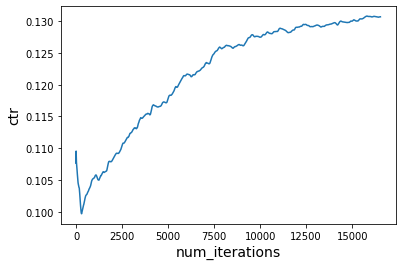

In [13]:
plot_ctr(len(result), result).show()

## Empirical Results for IBA with BetaTS

In [15]:
num_experiments = 30
list_of_averages = []


for _ in range(num_experiments):
    # instantiate the bandit
    independent_bandits = IndependentBandits(
        num_arms=len(movie_indexer),
        num_ranks=10,  # Recommend the best 10 movies
        bandit_class=BetaThompsonSampling
    )
    
    ctr_avg = experiment(indexed_data_sorted, independent_bandits)
    list_of_averages.append(ctr_avg)

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 76/16635 [00:00<00:21, 753.47it/s]

  1%|          | 155/16635 [00:00<00:21, 762.70it/s]

  1%|▏         | 236/16635 [00:00<00:21, 775.36it/s]

  2%|▏         | 312/16635 [00:00<00:21, 769.94it/s]

  2%|▏         | 392/16635 [00:00<00:20, 777.65it/s]

  3%|▎         | 473/16635 [00:00<00:20, 786.40it/s]

  3%|▎         | 550/16635 [00:00<00:20, 781.12it/s]

  4%|▍         | 629/16635 [00:00<00:20, 781.33it/s]

  4%|▍         | 710/16635 [00:00<00:20, 788.93it/s]

  5%|▍         | 792/16635 [00:01<00:19, 796.21it/s]

  5%|▌         | 874/16635 [00:01<00:19, 800.71it/s]

  6%|▌         | 953/16635 [00:01<00:19, 790.64it/s]

  6%|▌         | 1032/16635 [00:01<00:19, 782.10it/s]

  7%|▋         | 1110/16635 [00:01<00:19, 781.22it/s]

  7%|▋         | 1192/16635 [00:01<00:19, 790.25it/s]

  8%|▊         | 1274/16635 [00:01<00:19, 798.73it/s]

  8%|▊         | 1356/16635 [00:01<00:19, 802.46it/s]

  9%|▊         | 1438/16635 [00:01<00:18, 805.19it/s]

  9%|▉         | 1520/16635 [00:01<00:18, 808.02it/s]

 10%|▉         | 1601/16635 [00:02<00:18, 799.72it/s]

 10%|█         | 1683/16635 [00:02<00:18, 803.72it/s]

 11%|█         | 1764/16635 [00:02<00:19, 769.43it/s]

 11%|█         | 1842/16635 [00:02<00:19, 764.35it/s]

 12%|█▏        | 1921/16635 [00:02<00:19, 770.12it/s]

 12%|█▏        | 1999/16635 [00:02<00:19, 756.19it/s]

 13%|█▎        | 2082/16635 [00:02<00:18, 775.23it/s]

 13%|█▎        | 2164/16635 [00:02<00:18, 785.67it/s]

 13%|█▎        | 2244/16635 [00:02<00:18, 788.60it/s]

 14%|█▍        | 2324/16635 [00:02<00:18, 787.46it/s]

 14%|█▍        | 2403/16635 [00:03<00:18, 765.24it/s]

 15%|█▍        | 2485/16635 [00:03<00:18, 778.04it/s]

 15%|█▌        | 2564/16635 [00:03<00:18, 766.94it/s]

 16%|█▌        | 2642/16635 [00:03<00:18, 769.63it/s]

 16%|█▋        | 2720/16635 [00:03<00:18, 737.36it/s]

 17%|█▋        | 2796/16635 [00:03<00:18, 741.86it/s]

 17%|█▋        | 2874/16635 [00:03<00:18, 752.56it/s]

 18%|█▊        | 2950/16635 [00:03<00:18, 732.18it/s]

 18%|█▊        | 3030/16635 [00:03<00:18, 750.48it/s]

 19%|█▊        | 3109/16635 [00:04<00:17, 758.93it/s]

 19%|█▉        | 3189/16635 [00:04<00:17, 769.34it/s]

 20%|█▉        | 3271/16635 [00:04<00:17, 782.77it/s]

 20%|██        | 3351/16635 [00:04<00:16, 787.42it/s]

 21%|██        | 3431/16635 [00:04<00:16, 789.71it/s]

 21%|██        | 3511/16635 [00:04<00:16, 789.18it/s]

 22%|██▏       | 3593/16635 [00:04<00:16, 796.68it/s]

 22%|██▏       | 3673/16635 [00:04<00:16, 793.40it/s]

 23%|██▎       | 3753/16635 [00:04<00:16, 770.72it/s]

 23%|██▎       | 3834/16635 [00:04<00:16, 781.22it/s]

 24%|██▎       | 3916/16635 [00:05<00:16, 790.29it/s]

 24%|██▍       | 3997/16635 [00:05<00:15, 794.22it/s]

 25%|██▍       | 4077/16635 [00:05<00:16, 781.99it/s]

 25%|██▍       | 4156/16635 [00:05<00:16, 773.96it/s]

 25%|██▌       | 4237/16635 [00:05<00:15, 784.05it/s]

 26%|██▌       | 4316/16635 [00:05<00:16, 759.16it/s]

 26%|██▋       | 4398/16635 [00:05<00:15, 775.31it/s]

 27%|██▋       | 4478/16635 [00:05<00:15, 782.49it/s]

 27%|██▋       | 4558/16635 [00:05<00:15, 787.50it/s]

 28%|██▊       | 4638/16635 [00:05<00:15, 790.15it/s]

 28%|██▊       | 4718/16635 [00:06<00:15, 775.55it/s]

 29%|██▉       | 4799/16635 [00:06<00:15, 783.38it/s]

 29%|██▉       | 4881/16635 [00:06<00:14, 791.49it/s]

 30%|██▉       | 4961/16635 [00:06<00:14, 793.93it/s]

 30%|███       | 5041/16635 [00:06<00:15, 771.43it/s]

 31%|███       | 5119/16635 [00:06<00:15, 755.21it/s]

 31%|███▏      | 5201/16635 [00:06<00:14, 771.09it/s]

 32%|███▏      | 5281/16635 [00:06<00:14, 778.53it/s]

 32%|███▏      | 5361/16635 [00:06<00:14, 784.18it/s]

 33%|███▎      | 5442/16635 [00:06<00:14, 791.52it/s]

 33%|███▎      | 5523/16635 [00:07<00:13, 796.61it/s]

 34%|███▎      | 5604/16635 [00:07<00:13, 800.38it/s]

 34%|███▍      | 5685/16635 [00:07<00:13, 803.23it/s]

 35%|███▍      | 5766/16635 [00:07<00:13, 802.10it/s]

 35%|███▌      | 5847/16635 [00:07<00:13, 783.40it/s]

 36%|███▌      | 5926/16635 [00:07<00:13, 782.36it/s]

 36%|███▌      | 6007/16635 [00:07<00:13, 788.29it/s]

 37%|███▋      | 6086/16635 [00:07<00:13, 777.80it/s]

 37%|███▋      | 6168/16635 [00:07<00:13, 788.44it/s]

 38%|███▊      | 6249/16635 [00:07<00:13, 792.24it/s]

 38%|███▊      | 6329/16635 [00:08<00:13, 791.78it/s]

 39%|███▊      | 6409/16635 [00:08<00:12, 791.66it/s]

 39%|███▉      | 6489/16635 [00:08<00:13, 778.87it/s]

 40%|███▉      | 6571/16635 [00:08<00:12, 789.35it/s]

 40%|███▉      | 6652/16635 [00:08<00:12, 794.71it/s]

 40%|████      | 6732/16635 [00:08<00:12, 791.83it/s]

 41%|████      | 6812/16635 [00:08<00:12, 785.36it/s]

 41%|████▏     | 6891/16635 [00:08<00:12, 775.66it/s]

 42%|████▏     | 6971/16635 [00:08<00:12, 782.05it/s]

 42%|████▏     | 7053/16635 [00:09<00:12, 790.86it/s]

 43%|████▎     | 7133/16635 [00:09<00:12, 785.47it/s]

 43%|████▎     | 7213/16635 [00:09<00:11, 787.52it/s]

 44%|████▍     | 7293/16635 [00:09<00:11, 789.75it/s]

 44%|████▍     | 7373/16635 [00:09<00:11, 791.23it/s]

 45%|████▍     | 7454/16635 [00:09<00:11, 794.55it/s]

 45%|████▌     | 7535/16635 [00:09<00:11, 797.65it/s]

 46%|████▌     | 7616/16635 [00:09<00:11, 799.75it/s]

 46%|████▋     | 7697/16635 [00:09<00:11, 800.14it/s]

 47%|████▋     | 7778/16635 [00:09<00:11, 796.23it/s]

 47%|████▋     | 7858/16635 [00:10<00:11, 774.98it/s]

 48%|████▊     | 7938/16635 [00:10<00:11, 779.89it/s]

 48%|████▊     | 8017/16635 [00:10<00:11, 772.91it/s]

 49%|████▊     | 8095/16635 [00:10<00:11, 763.19it/s]

 49%|████▉     | 8173/16635 [00:10<00:11, 767.53it/s]

 50%|████▉     | 8250/16635 [00:10<00:11, 757.41it/s]

 50%|█████     | 8332/16635 [00:10<00:10, 774.33it/s]

 51%|█████     | 8413/16635 [00:10<00:10, 783.40it/s]

 51%|█████     | 8495/16635 [00:10<00:10, 791.50it/s]

 52%|█████▏    | 8575/16635 [00:10<00:10, 786.30it/s]

 52%|█████▏    | 8654/16635 [00:11<00:10, 768.57it/s]

 53%|█████▎    | 8735/16635 [00:11<00:10, 779.77it/s]

 53%|█████▎    | 8817/16635 [00:11<00:09, 790.28it/s]

 53%|█████▎    | 8898/16635 [00:11<00:09, 792.90it/s]

 54%|█████▍    | 8979/16635 [00:11<00:09, 795.21it/s]

 54%|█████▍    | 9059/16635 [00:11<00:09, 795.37it/s]

 55%|█████▍    | 9140/16635 [00:11<00:09, 799.39it/s]

 55%|█████▌    | 9220/16635 [00:11<00:09, 783.37it/s]

 56%|█████▌    | 9301/16635 [00:11<00:09, 790.22it/s]

 56%|█████▋    | 9381/16635 [00:11<00:09, 791.26it/s]

 57%|█████▋    | 9462/16635 [00:12<00:09, 795.37it/s]

 57%|█████▋    | 9544/16635 [00:12<00:08, 801.49it/s]

 58%|█████▊    | 9625/16635 [00:12<00:08, 800.76it/s]

 58%|█████▊    | 9706/16635 [00:12<00:08, 799.62it/s]

 59%|█████▉    | 9787/16635 [00:12<00:08, 801.03it/s]

 59%|█████▉    | 9868/16635 [00:12<00:08, 799.95it/s]

 60%|█████▉    | 9949/16635 [00:12<00:08, 797.42it/s]

 60%|██████    | 10029/16635 [00:12<00:08, 769.67it/s]

 61%|██████    | 10107/16635 [00:12<00:08, 772.23it/s]

 61%|██████    | 10185/16635 [00:13<00:08, 751.55it/s]

 62%|██████▏   | 10265/16635 [00:13<00:08, 762.95it/s]

 62%|██████▏   | 10344/16635 [00:13<00:08, 769.68it/s]

 63%|██████▎   | 10422/16635 [00:13<00:08, 765.83it/s]

 63%|██████▎   | 10502/16635 [00:13<00:07, 773.49it/s]

 64%|██████▎   | 10582/16635 [00:13<00:07, 780.89it/s]

 64%|██████▍   | 10663/16635 [00:13<00:07, 786.70it/s]

 65%|██████▍   | 10744/16635 [00:13<00:07, 792.52it/s]

 65%|██████▌   | 10824/16635 [00:13<00:07, 792.48it/s]

 66%|██████▌   | 10905/16635 [00:13<00:07, 796.80it/s]

 66%|██████▌   | 10986/16635 [00:14<00:07, 798.19it/s]

 67%|██████▋   | 11066/16635 [00:14<00:07, 795.52it/s]

 67%|██████▋   | 11147/16635 [00:14<00:06, 799.08it/s]

 67%|██████▋   | 11227/16635 [00:14<00:06, 799.15it/s]

 68%|██████▊   | 11308/16635 [00:14<00:06, 801.62it/s]

 68%|██████▊   | 11389/16635 [00:14<00:06, 803.37it/s]

 69%|██████▉   | 11470/16635 [00:14<00:06, 801.34it/s]

 69%|██████▉   | 11551/16635 [00:14<00:06, 800.66it/s]

 70%|██████▉   | 11632/16635 [00:14<00:06, 797.52it/s]

 70%|███████   | 11712/16635 [00:14<00:06, 795.42it/s]

 71%|███████   | 11792/16635 [00:15<00:06, 761.93it/s]

 71%|███████▏  | 11873/16635 [00:15<00:06, 773.59it/s]

 72%|███████▏  | 11953/16635 [00:15<00:05, 781.02it/s]

 72%|███████▏  | 12032/16635 [00:15<00:05, 781.03it/s]

 73%|███████▎  | 12114/16635 [00:15<00:05, 790.68it/s]

 73%|███████▎  | 12194/16635 [00:15<00:05, 792.60it/s]

 74%|███████▍  | 12275/16635 [00:15<00:05, 795.95it/s]

 74%|███████▍  | 12355/16635 [00:15<00:05, 774.60it/s]

 75%|███████▍  | 12436/16635 [00:15<00:05, 782.19it/s]

 75%|███████▌  | 12515/16635 [00:15<00:05, 777.07it/s]

 76%|███████▌  | 12593/16635 [00:16<00:05, 769.92it/s]

 76%|███████▌  | 12674/16635 [00:16<00:05, 779.04it/s]

 77%|███████▋  | 12754/16635 [00:16<00:04, 784.86it/s]

 77%|███████▋  | 12835/16635 [00:16<00:04, 791.26it/s]

 78%|███████▊  | 12915/16635 [00:16<00:04, 780.56it/s]

 78%|███████▊  | 12994/16635 [00:16<00:04, 778.70it/s]

 79%|███████▊  | 13075/16635 [00:16<00:04, 786.20it/s]

 79%|███████▉  | 13156/16635 [00:16<00:04, 791.96it/s]

 80%|███████▉  | 13236/16635 [00:16<00:04, 793.08it/s]

 80%|████████  | 13318/16635 [00:16<00:04, 800.08it/s]

 81%|████████  | 13399/16635 [00:17<00:04, 802.03it/s]

 81%|████████  | 13480/16635 [00:17<00:03, 795.18it/s]

 82%|████████▏ | 13560/16635 [00:17<00:04, 764.32it/s]

 82%|████████▏ | 13641/16635 [00:17<00:03, 775.65it/s]

 82%|████████▏ | 13720/16635 [00:17<00:03, 779.52it/s]

 83%|████████▎ | 13801/16635 [00:17<00:03, 786.68it/s]

 83%|████████▎ | 13880/16635 [00:17<00:03, 781.89it/s]

 84%|████████▍ | 13959/16635 [00:17<00:03, 778.67it/s]

 84%|████████▍ | 14040/16635 [00:17<00:03, 786.61it/s]

 85%|████████▍ | 14119/16635 [00:18<00:03, 767.35it/s]

 85%|████████▌ | 14199/16635 [00:18<00:03, 776.21it/s]

 86%|████████▌ | 14279/16635 [00:18<00:03, 781.89it/s]

 86%|████████▋ | 14360/16635 [00:18<00:02, 789.21it/s]

 87%|████████▋ | 14442/16635 [00:18<00:02, 797.13it/s]

 87%|████████▋ | 14522/16635 [00:18<00:02, 775.62it/s]

 88%|████████▊ | 14603/16635 [00:18<00:02, 783.71it/s]

 88%|████████▊ | 14683/16635 [00:18<00:02, 787.27it/s]

 89%|████████▉ | 14765/16635 [00:18<00:02, 795.13it/s]

 89%|████████▉ | 14846/16635 [00:18<00:02, 796.80it/s]

 90%|████████▉ | 14927/16635 [00:19<00:02, 799.55it/s]

 90%|█████████ | 15008/16635 [00:19<00:02, 796.61it/s]

 91%|█████████ | 15088/16635 [00:19<00:01, 794.13it/s]

 91%|█████████ | 15170/16635 [00:19<00:01, 799.19it/s]

 92%|█████████▏| 15250/16635 [00:19<00:01, 798.22it/s]

 92%|█████████▏| 15333/16635 [00:19<00:01, 805.89it/s]

 93%|█████████▎| 15414/16635 [00:19<00:01, 801.06it/s]

 93%|█████████▎| 15495/16635 [00:19<00:01, 788.41it/s]

 94%|█████████▎| 15576/16635 [00:19<00:01, 792.84it/s]

 94%|█████████▍| 15656/16635 [00:19<00:01, 788.21it/s]

 95%|█████████▍| 15735/16635 [00:20<00:01, 775.36it/s]

 95%|█████████▌| 15816/16635 [00:20<00:01, 783.16it/s]

 96%|█████████▌| 15895/16635 [00:20<00:00, 765.56it/s]

 96%|█████████▌| 15975/16635 [00:20<00:00, 775.22it/s]

 97%|█████████▋| 16053/16635 [00:20<00:00, 776.64it/s]

 97%|█████████▋| 16131/16635 [00:20<00:00, 769.91it/s]

 97%|█████████▋| 16211/16635 [00:20<00:00, 778.03it/s]

 98%|█████████▊| 16289/16635 [00:20<00:00, 765.41it/s]

 98%|█████████▊| 16370/16635 [00:20<00:00, 777.73it/s]

 99%|█████████▉| 16452/16635 [00:20<00:00, 787.54it/s]

 99%|█████████▉| 16533/16635 [00:21<00:00, 793.28it/s]

100%|█████████▉| 16613/16635 [00:21<00:00, 792.54it/s]

100%|██████████| 16635/16635 [00:21<00:00, 784.57it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 79/16635 [00:00<00:21, 783.34it/s]

  1%|          | 160/16635 [00:00<00:20, 790.57it/s]

  1%|▏         | 233/16635 [00:00<00:21, 769.93it/s]

  2%|▏         | 299/16635 [00:00<00:22, 732.96it/s]

  2%|▏         | 381/16635 [00:00<00:21, 754.16it/s]

  3%|▎         | 461/16635 [00:00<00:21, 766.77it/s]

  3%|▎         | 544/16635 [00:00<00:20, 781.97it/s]

  4%|▍         | 626/16635 [00:00<00:20, 792.83it/s]

  4%|▍         | 708/16635 [00:00<00:19, 799.77it/s]

  5%|▍         | 791/16635 [00:01<00:19, 805.16it/s]

  5%|▌         | 873/16635 [00:01<00:19, 807.76it/s]

  6%|▌         | 955/16635 [00:01<00:19, 809.44it/s]

  6%|▌         | 1036/16635 [00:01<00:19, 807.15it/s]

  7%|▋         | 1117/16635 [00:01<00:19, 799.62it/s]

  7%|▋         | 1198/16635 [00:01<00:19, 802.42it/s]

  8%|▊         | 1279/16635 [00:01<00:19, 803.66it/s]

  8%|▊         | 1360/16635 [00:01<00:19, 803.11it/s]

  9%|▊         | 1441/16635 [00:01<00:19, 780.84it/s]

  9%|▉         | 1523/16635 [00:01<00:19, 789.49it/s]

 10%|▉         | 1604/16635 [00:02<00:18, 795.13it/s]

 10%|█         | 1686/16635 [00:02<00:18, 800.88it/s]

 11%|█         | 1768/16635 [00:02<00:18, 805.26it/s]

 11%|█         | 1849/16635 [00:02<00:18, 803.03it/s]

 12%|█▏        | 1931/16635 [00:02<00:18, 806.46it/s]

 12%|█▏        | 2012/16635 [00:02<00:18, 784.95it/s]

 13%|█▎        | 2094/16635 [00:02<00:18, 793.67it/s]

 13%|█▎        | 2176/16635 [00:02<00:18, 799.56it/s]

 14%|█▎        | 2258/16635 [00:02<00:17, 804.33it/s]

 14%|█▍        | 2340/16635 [00:02<00:17, 807.91it/s]

 15%|█▍        | 2421/16635 [00:03<00:17, 806.51it/s]

 15%|█▌        | 2502/16635 [00:03<00:17, 806.48it/s]

 16%|█▌        | 2584/16635 [00:03<00:17, 807.92it/s]

 16%|█▌        | 2665/16635 [00:03<00:17, 808.51it/s]

 17%|█▋        | 2746/16635 [00:03<00:17, 806.87it/s]

 17%|█▋        | 2827/16635 [00:03<00:17, 786.29it/s]

 17%|█▋        | 2907/16635 [00:03<00:17, 788.92it/s]

 18%|█▊        | 2989/16635 [00:03<00:17, 793.95it/s]

 18%|█▊        | 3071/16635 [00:03<00:16, 799.07it/s]

 19%|█▉        | 3152/16635 [00:03<00:16, 801.87it/s]

 19%|█▉        | 3233/16635 [00:04<00:17, 775.77it/s]

 20%|█▉        | 3313/16635 [00:04<00:17, 782.13it/s]

 20%|██        | 3392/16635 [00:04<00:17, 776.67it/s]

 21%|██        | 3471/16635 [00:04<00:16, 778.56it/s]

 21%|██▏       | 3551/16635 [00:04<00:16, 783.80it/s]

 22%|██▏       | 3631/16635 [00:04<00:16, 788.33it/s]

 22%|██▏       | 3713/16635 [00:04<00:16, 796.64it/s]

 23%|██▎       | 3794/16635 [00:04<00:16, 798.24it/s]

 23%|██▎       | 3875/16635 [00:04<00:15, 800.36it/s]

 24%|██▍       | 3956/16635 [00:04<00:15, 797.36it/s]

 24%|██▍       | 4036/16635 [00:05<00:16, 786.65it/s]

 25%|██▍       | 4118/16635 [00:05<00:15, 795.60it/s]

 25%|██▌       | 4199/16635 [00:05<00:15, 797.61it/s]

 26%|██▌       | 4279/16635 [00:05<00:15, 797.48it/s]

 26%|██▌       | 4361/16635 [00:05<00:15, 802.07it/s]

 27%|██▋       | 4442/16635 [00:05<00:15, 801.43it/s]

 27%|██▋       | 4523/16635 [00:05<00:15, 802.06it/s]

 28%|██▊       | 4604/16635 [00:05<00:17, 705.48it/s]

 28%|██▊       | 4686/16635 [00:05<00:16, 734.64it/s]

 29%|██▊       | 4762/16635 [00:06<00:16, 730.19it/s]

 29%|██▉       | 4841/16635 [00:06<00:15, 747.15it/s]

 30%|██▉       | 4923/16635 [00:06<00:15, 765.40it/s]

 30%|███       | 5003/16635 [00:06<00:15, 774.98it/s]

 31%|███       | 5083/16635 [00:06<00:14, 780.77it/s]

 31%|███       | 5162/16635 [00:06<00:14, 773.00it/s]

 32%|███▏      | 5242/16635 [00:06<00:14, 780.88it/s]

 32%|███▏      | 5324/16635 [00:06<00:14, 789.92it/s]

 32%|███▏      | 5404/16635 [00:06<00:14, 792.66it/s]

 33%|███▎      | 5485/16635 [00:06<00:13, 796.86it/s]

 33%|███▎      | 5565/16635 [00:07<00:14, 781.64it/s]

 34%|███▍      | 5645/16635 [00:07<00:13, 786.50it/s]

 34%|███▍      | 5727/16635 [00:07<00:13, 794.28it/s]

 35%|███▍      | 5808/16635 [00:07<00:13, 796.95it/s]

 35%|███▌      | 5888/16635 [00:07<00:13, 797.65it/s]

 36%|███▌      | 5969/16635 [00:07<00:13, 800.76it/s]

 36%|███▋      | 6051/16635 [00:07<00:13, 803.83it/s]

 37%|███▋      | 6132/16635 [00:07<00:13, 791.02it/s]

 37%|███▋      | 6212/16635 [00:07<00:13, 788.02it/s]

 38%|███▊      | 6293/16635 [00:07<00:13, 794.28it/s]

 38%|███▊      | 6374/16635 [00:08<00:12, 797.21it/s]

 39%|███▉      | 6454/16635 [00:08<00:12, 795.56it/s]

 39%|███▉      | 6535/16635 [00:08<00:12, 799.24it/s]

 40%|███▉      | 6616/16635 [00:08<00:12, 801.40it/s]

 40%|████      | 6697/16635 [00:08<00:12, 801.18it/s]

 41%|████      | 6778/16635 [00:08<00:12, 789.82it/s]

 41%|████      | 6860/16635 [00:08<00:12, 796.66it/s]

 42%|████▏     | 6940/16635 [00:08<00:12, 784.32it/s]

 42%|████▏     | 7021/16635 [00:08<00:12, 790.90it/s]

 43%|████▎     | 7102/16635 [00:08<00:11, 796.43it/s]

 43%|████▎     | 7182/16635 [00:09<00:11, 797.09it/s]

 44%|████▎     | 7263/16635 [00:09<00:11, 798.66it/s]

 44%|████▍     | 7343/16635 [00:09<00:11, 798.74it/s]

 45%|████▍     | 7425/16635 [00:09<00:11, 802.31it/s]

 45%|████▌     | 7506/16635 [00:09<00:11, 804.26it/s]

 46%|████▌     | 7587/16635 [00:09<00:11, 803.88it/s]

 46%|████▌     | 7668/16635 [00:09<00:11, 803.48it/s]

 47%|████▋     | 7749/16635 [00:09<00:11, 802.71it/s]

 47%|████▋     | 7830/16635 [00:09<00:10, 803.18it/s]

 48%|████▊     | 7911/16635 [00:09<00:10, 799.97it/s]

 48%|████▊     | 7992/16635 [00:10<00:10, 789.64it/s]

 49%|████▊     | 8073/16635 [00:10<00:10, 794.27it/s]

 49%|████▉     | 8154/16635 [00:10<00:10, 797.74it/s]

 50%|████▉     | 8235/16635 [00:10<00:10, 799.26it/s]

 50%|████▉     | 8315/16635 [00:10<00:10, 797.54it/s]

 50%|█████     | 8397/16635 [00:10<00:10, 801.48it/s]

 51%|█████     | 8478/16635 [00:10<00:10, 796.25it/s]

 51%|█████▏    | 8558/16635 [00:10<00:10, 765.69it/s]

 52%|█████▏    | 8639/16635 [00:10<00:10, 776.32it/s]

 52%|█████▏    | 8719/16635 [00:11<00:10, 781.01it/s]

 53%|█████▎    | 8799/16635 [00:11<00:09, 785.50it/s]

 53%|█████▎    | 8878/16635 [00:11<00:09, 782.54it/s]

 54%|█████▍    | 8957/16635 [00:11<00:10, 763.29it/s]

 54%|█████▍    | 9037/16635 [00:11<00:09, 773.68it/s]

 55%|█████▍    | 9117/16635 [00:11<00:09, 781.30it/s]

 55%|█████▌    | 9198/16635 [00:11<00:09, 788.27it/s]

 56%|█████▌    | 9279/16635 [00:11<00:09, 792.24it/s]

 56%|█████▋    | 9359/16635 [00:11<00:09, 793.62it/s]

 57%|█████▋    | 9440/16635 [00:11<00:09, 798.01it/s]

 57%|█████▋    | 9521/16635 [00:12<00:08, 800.16it/s]

 58%|█████▊    | 9602/16635 [00:12<00:08, 798.11it/s]

 58%|█████▊    | 9682/16635 [00:12<00:08, 793.61it/s]

 59%|█████▊    | 9763/16635 [00:12<00:08, 796.59it/s]

 59%|█████▉    | 9843/16635 [00:12<00:08, 795.47it/s]

 60%|█████▉    | 9923/16635 [00:12<00:08, 795.05it/s]

 60%|██████    | 10004/16635 [00:12<00:08, 796.91it/s]

 61%|██████    | 10085/16635 [00:12<00:08, 796.90it/s]

 61%|██████    | 10166/16635 [00:12<00:08, 799.56it/s]

 62%|██████▏   | 10247/16635 [00:12<00:07, 799.77it/s]

 62%|██████▏   | 10327/16635 [00:13<00:08, 769.70it/s]

 63%|██████▎   | 10408/16635 [00:13<00:07, 779.28it/s]

 63%|██████▎   | 10487/16635 [00:13<00:07, 775.75it/s]

 64%|██████▎   | 10566/16635 [00:13<00:07, 777.84it/s]

 64%|██████▍   | 10644/16635 [00:13<00:07, 756.37it/s]

 64%|██████▍   | 10720/16635 [00:13<00:08, 736.92it/s]

 65%|██████▍   | 10799/16635 [00:13<00:07, 749.92it/s]

 65%|██████▌   | 10875/16635 [00:13<00:07, 750.19it/s]

 66%|██████▌   | 10951/16635 [00:13<00:07, 745.30it/s]

 66%|██████▋   | 11026/16635 [00:14<00:07, 721.81it/s]

 67%|██████▋   | 11099/16635 [00:14<00:07, 704.61it/s]

 67%|██████▋   | 11179/16635 [00:14<00:07, 728.23it/s]

 68%|██████▊   | 11259/16635 [00:14<00:07, 747.39it/s]

 68%|██████▊   | 11340/16635 [00:14<00:06, 763.98it/s]

 69%|██████▊   | 11418/16635 [00:14<00:06, 768.51it/s]

 69%|██████▉   | 11499/16635 [00:14<00:06, 779.42it/s]

 70%|██████▉   | 11578/16635 [00:14<00:06, 782.27it/s]

 70%|███████   | 11657/16635 [00:14<00:06, 780.15it/s]

 71%|███████   | 11736/16635 [00:14<00:06, 778.02it/s]

 71%|███████   | 11814/16635 [00:15<00:06, 769.45it/s]

 71%|███████▏  | 11893/16635 [00:15<00:06, 774.66it/s]

 72%|███████▏  | 11972/16635 [00:15<00:05, 778.25it/s]

 72%|███████▏  | 12050/16635 [00:15<00:05, 773.21it/s]

 73%|███████▎  | 12129/16635 [00:15<00:05, 777.45it/s]

 73%|███████▎  | 12207/16635 [00:15<00:05, 759.84it/s]

 74%|███████▍  | 12288/16635 [00:15<00:05, 772.50it/s]

 74%|███████▍  | 12366/16635 [00:15<00:05, 773.54it/s]

 75%|███████▍  | 12444/16635 [00:15<00:05, 772.18it/s]

 75%|███████▌  | 12525/16635 [00:15<00:05, 781.61it/s]

 76%|███████▌  | 12605/16635 [00:16<00:05, 786.93it/s]

 76%|███████▋  | 12686/16635 [00:16<00:04, 791.79it/s]

 77%|███████▋  | 12766/16635 [00:16<00:04, 784.62it/s]

 77%|███████▋  | 12845/16635 [00:16<00:04, 776.24it/s]

 78%|███████▊  | 12925/16635 [00:16<00:04, 781.55it/s]

 78%|███████▊  | 13006/16635 [00:16<00:04, 787.44it/s]

 79%|███████▊  | 13087/16635 [00:16<00:04, 791.64it/s]

 79%|███████▉  | 13167/16635 [00:16<00:04, 793.11it/s]

 80%|███████▉  | 13249/16635 [00:16<00:04, 799.46it/s]

 80%|████████  | 13329/16635 [00:16<00:04, 799.17it/s]

 81%|████████  | 13410/16635 [00:17<00:04, 800.60it/s]

 81%|████████  | 13491/16635 [00:17<00:03, 800.55it/s]

 82%|████████▏ | 13572/16635 [00:17<00:03, 799.80it/s]

 82%|████████▏ | 13654/16635 [00:17<00:03, 804.64it/s]

 83%|████████▎ | 13735/16635 [00:17<00:03, 801.51it/s]

 83%|████████▎ | 13816/16635 [00:17<00:03, 784.03it/s]

 84%|████████▎ | 13897/16635 [00:17<00:03, 791.37it/s]

 84%|████████▍ | 13977/16635 [00:17<00:03, 792.97it/s]

 85%|████████▍ | 14058/16635 [00:17<00:03, 796.29it/s]

 85%|████████▍ | 14138/16635 [00:17<00:03, 796.97it/s]

 85%|████████▌ | 14220/16635 [00:18<00:03, 799.96it/s]

 86%|████████▌ | 14301/16635 [00:18<00:02, 797.99it/s]

 86%|████████▋ | 14381/16635 [00:18<00:02, 793.71it/s]

 87%|████████▋ | 14462/16635 [00:18<00:02, 797.57it/s]

 87%|████████▋ | 14542/16635 [00:18<00:02, 795.36it/s]

 88%|████████▊ | 14623/16635 [00:18<00:02, 798.34it/s]

 88%|████████▊ | 14704/16635 [00:18<00:02, 801.29it/s]

 89%|████████▉ | 14785/16635 [00:18<00:02, 798.05it/s]

 89%|████████▉ | 14865/16635 [00:18<00:02, 793.66it/s]

 90%|████████▉ | 14945/16635 [00:18<00:02, 789.93it/s]

 90%|█████████ | 15025/16635 [00:19<00:02, 765.78it/s]

 91%|█████████ | 15106/16635 [00:19<00:01, 776.33it/s]

 91%|█████████▏| 15186/16635 [00:19<00:01, 782.92it/s]

 92%|█████████▏| 15268/16635 [00:19<00:01, 792.07it/s]

 92%|█████████▏| 15348/16635 [00:19<00:01, 794.03it/s]

 93%|█████████▎| 15430/16635 [00:19<00:01, 798.90it/s]

 93%|█████████▎| 15511/16635 [00:19<00:01, 801.55it/s]

 94%|█████████▎| 15592/16635 [00:19<00:01, 800.93it/s]

 94%|█████████▍| 15673/16635 [00:19<00:01, 800.63it/s]

 95%|█████████▍| 15754/16635 [00:20<00:01, 802.66it/s]

 95%|█████████▌| 15835/16635 [00:20<00:00, 804.37it/s]

 96%|█████████▌| 15916/16635 [00:20<00:00, 802.84it/s]

 96%|█████████▌| 15997/16635 [00:20<00:00, 803.85it/s]

 97%|█████████▋| 16078/16635 [00:20<00:00, 802.65it/s]

 97%|█████████▋| 16159/16635 [00:20<00:00, 799.14it/s]

 98%|█████████▊| 16240/16635 [00:20<00:00, 801.44it/s]

 98%|█████████▊| 16321/16635 [00:20<00:00, 803.20it/s]

 99%|█████████▊| 16402/16635 [00:20<00:00, 800.80it/s]

 99%|█████████▉| 16483/16635 [00:20<00:00, 801.98it/s]

100%|█████████▉| 16564/16635 [00:21<00:00, 802.79it/s]

100%|██████████| 16635/16635 [00:21<00:00, 788.37it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 79/16635 [00:00<00:21, 786.76it/s]

  1%|          | 160/16635 [00:00<00:20, 791.19it/s]

  1%|▏         | 242/16635 [00:00<00:20, 799.59it/s]

  2%|▏         | 321/16635 [00:00<00:20, 793.83it/s]

  2%|▏         | 397/16635 [00:00<00:20, 783.35it/s]

  3%|▎         | 472/16635 [00:00<00:20, 770.64it/s]

  3%|▎         | 555/16635 [00:00<00:20, 785.12it/s]

  4%|▍         | 638/16635 [00:00<00:20, 796.66it/s]

  4%|▍         | 720/16635 [00:00<00:19, 801.29it/s]

  5%|▍         | 803/16635 [00:01<00:19, 807.38it/s]

  5%|▌         | 885/16635 [00:01<00:19, 809.79it/s]

  6%|▌         | 965/16635 [00:01<00:19, 804.72it/s]

  6%|▋         | 1047/16635 [00:01<00:19, 809.03it/s]

  7%|▋         | 1129/16635 [00:01<00:19, 809.68it/s]

  7%|▋         | 1211/16635 [00:01<00:19, 811.60it/s]

  8%|▊         | 1293/16635 [00:01<00:18, 811.21it/s]

  8%|▊         | 1375/16635 [00:01<00:18, 813.58it/s]

  9%|▉         | 1457/16635 [00:01<00:18, 812.01it/s]

  9%|▉         | 1539/16635 [00:01<00:18, 810.87it/s]

 10%|▉         | 1621/16635 [00:02<00:18, 809.77it/s]

 10%|█         | 1702/16635 [00:02<00:18, 809.17it/s]

 11%|█         | 1783/16635 [00:02<00:18, 804.29it/s]

 11%|█         | 1865/16635 [00:02<00:18, 807.96it/s]

 12%|█▏        | 1946/16635 [00:02<00:18, 803.09it/s]

 12%|█▏        | 2028/16635 [00:02<00:18, 807.95it/s]

 13%|█▎        | 2110/16635 [00:02<00:17, 808.22it/s]

 13%|█▎        | 2192/16635 [00:02<00:17, 808.60it/s]

 14%|█▎        | 2273/16635 [00:02<00:17, 806.37it/s]

 14%|█▍        | 2354/16635 [00:02<00:18, 787.12it/s]

 15%|█▍        | 2436/16635 [00:03<00:17, 794.53it/s]

 15%|█▌        | 2518/16635 [00:03<00:17, 800.83it/s]

 16%|█▌        | 2600/16635 [00:03<00:17, 803.80it/s]

 16%|█▌        | 2681/16635 [00:03<00:17, 804.13it/s]

 17%|█▋        | 2762/16635 [00:03<00:18, 765.91it/s]

 17%|█▋        | 2843/16635 [00:03<00:17, 776.29it/s]

 18%|█▊        | 2925/16635 [00:03<00:17, 786.88it/s]

 18%|█▊        | 3007/16635 [00:03<00:17, 794.02it/s]

 19%|█▊        | 3088/16635 [00:03<00:17, 796.83it/s]

 19%|█▉        | 3170/16635 [00:03<00:16, 803.32it/s]

 20%|█▉        | 3252/16635 [00:04<00:16, 805.98it/s]

 20%|██        | 3333/16635 [00:04<00:16, 806.12it/s]

 21%|██        | 3415/16635 [00:04<00:16, 808.13it/s]

 21%|██        | 3497/16635 [00:04<00:16, 806.72it/s]

 22%|██▏       | 3578/16635 [00:04<00:16, 779.64it/s]

 22%|██▏       | 3659/16635 [00:04<00:16, 787.33it/s]

 22%|██▏       | 3741/16635 [00:04<00:16, 796.49it/s]

 23%|██▎       | 3822/16635 [00:04<00:16, 798.47it/s]

 23%|██▎       | 3902/16635 [00:04<00:16, 776.71it/s]

 24%|██▍       | 3984/16635 [00:04<00:16, 787.81it/s]

 24%|██▍       | 4065/16635 [00:05<00:15, 793.21it/s]

 25%|██▍       | 4146/16635 [00:05<00:15, 797.07it/s]

 25%|██▌       | 4227/16635 [00:05<00:15, 800.33it/s]

 26%|██▌       | 4308/16635 [00:05<00:15, 799.65it/s]

 26%|██▋       | 4389/16635 [00:05<00:15, 800.98it/s]

 27%|██▋       | 4471/16635 [00:05<00:15, 804.15it/s]

 27%|██▋       | 4553/16635 [00:05<00:14, 806.80it/s]

 28%|██▊       | 4636/16635 [00:05<00:14, 811.22it/s]

 28%|██▊       | 4718/16635 [00:05<00:14, 809.44it/s]

 29%|██▉       | 4800/16635 [00:05<00:14, 812.04it/s]

 29%|██▉       | 4882/16635 [00:06<00:14, 811.36it/s]

 30%|██▉       | 4964/16635 [00:06<00:14, 810.74it/s]

 30%|███       | 5046/16635 [00:06<00:14, 805.20it/s]

 31%|███       | 5127/16635 [00:06<00:14, 803.95it/s]

 31%|███▏      | 5209/16635 [00:06<00:14, 806.21it/s]

 32%|███▏      | 5291/16635 [00:06<00:14, 809.43it/s]

 32%|███▏      | 5373/16635 [00:06<00:13, 810.55it/s]

 33%|███▎      | 5455/16635 [00:06<00:13, 803.72it/s]

 33%|███▎      | 5537/16635 [00:06<00:13, 806.79it/s]

 34%|███▍      | 5618/16635 [00:07<00:13, 805.01it/s]

 34%|███▍      | 5700/16635 [00:07<00:13, 807.35it/s]

 35%|███▍      | 5781/16635 [00:07<00:13, 808.02it/s]

 35%|███▌      | 5862/16635 [00:07<00:13, 803.13it/s]

 36%|███▌      | 5943/16635 [00:07<00:13, 804.00it/s]

 36%|███▌      | 6025/16635 [00:07<00:13, 806.81it/s]

 37%|███▋      | 6107/16635 [00:07<00:13, 808.02it/s]

 37%|███▋      | 6189/16635 [00:07<00:12, 809.58it/s]

 38%|███▊      | 6270/16635 [00:07<00:12, 805.52it/s]

 38%|███▊      | 6351/16635 [00:07<00:13, 780.43it/s]

 39%|███▊      | 6431/16635 [00:08<00:12, 785.92it/s]

 39%|███▉      | 6513/16635 [00:08<00:12, 793.75it/s]

 40%|███▉      | 6595/16635 [00:08<00:12, 799.39it/s]

 40%|████      | 6676/16635 [00:08<00:12, 799.30it/s]

 41%|████      | 6756/16635 [00:08<00:12, 786.08it/s]

 41%|████      | 6835/16635 [00:08<00:12, 784.70it/s]

 42%|████▏     | 6915/16635 [00:08<00:12, 788.98it/s]

 42%|████▏     | 6997/16635 [00:08<00:12, 795.74it/s]

 43%|████▎     | 7078/16635 [00:08<00:11, 798.32it/s]

 43%|████▎     | 7158/16635 [00:08<00:11, 797.58it/s]

 44%|████▎     | 7240/16635 [00:09<00:11, 801.23it/s]

 44%|████▍     | 7321/16635 [00:09<00:11, 798.92it/s]

 44%|████▍     | 7401/16635 [00:09<00:12, 736.16it/s]

 45%|████▍     | 7479/16635 [00:09<00:12, 747.15it/s]

 45%|████▌     | 7555/16635 [00:09<00:12, 725.63it/s]

 46%|████▌     | 7637/16635 [00:09<00:11, 750.34it/s]

 46%|████▋     | 7713/16635 [00:09<00:12, 723.65it/s]

 47%|████▋     | 7793/16635 [00:09<00:11, 744.10it/s]

 47%|████▋     | 7874/16635 [00:09<00:11, 760.72it/s]

 48%|████▊     | 7954/16635 [00:10<00:11, 771.87it/s]

 48%|████▊     | 8036/16635 [00:10<00:10, 784.00it/s]

 49%|████▉     | 8118/16635 [00:10<00:10, 793.32it/s]

 49%|████▉     | 8199/16635 [00:10<00:10, 797.38it/s]

 50%|████▉     | 8279/16635 [00:10<00:10, 798.09it/s]

 50%|█████     | 8360/16635 [00:10<00:10, 800.85it/s]

 51%|█████     | 8442/16635 [00:10<00:10, 803.93it/s]

 51%|█████     | 8523/16635 [00:10<00:10, 803.68it/s]

 52%|█████▏    | 8605/16635 [00:10<00:09, 807.22it/s]

 52%|█████▏    | 8686/16635 [00:10<00:09, 805.74it/s]

 53%|█████▎    | 8767/16635 [00:11<00:09, 804.72it/s]

 53%|█████▎    | 8848/16635 [00:11<00:09, 803.51it/s]

 54%|█████▎    | 8929/16635 [00:11<00:09, 805.36it/s]

 54%|█████▍    | 9011/16635 [00:11<00:09, 806.90it/s]

 55%|█████▍    | 9092/16635 [00:11<00:09, 805.14it/s]

 55%|█████▌    | 9173/16635 [00:11<00:09, 794.63it/s]

 56%|█████▌    | 9253/16635 [00:11<00:09, 792.19it/s]

 56%|█████▌    | 9334/16635 [00:11<00:09, 795.26it/s]

 57%|█████▋    | 9414/16635 [00:11<00:09, 795.71it/s]

 57%|█████▋    | 9494/16635 [00:11<00:08, 795.88it/s]

 58%|█████▊    | 9574/16635 [00:12<00:08, 796.75it/s]

 58%|█████▊    | 9655/16635 [00:12<00:08, 800.13it/s]

 59%|█████▊    | 9736/16635 [00:12<00:08, 803.06it/s]

 59%|█████▉    | 9818/16635 [00:12<00:08, 805.80it/s]

 60%|█████▉    | 9899/16635 [00:12<00:08, 791.56it/s]

 60%|█████▉    | 9979/16635 [00:12<00:08, 791.71it/s]

 60%|██████    | 10060/16635 [00:12<00:08, 794.92it/s]

 61%|██████    | 10141/16635 [00:12<00:08, 797.10it/s]

 61%|██████▏   | 10221/16635 [00:12<00:08, 791.33it/s]

 62%|██████▏   | 10302/16635 [00:12<00:07, 794.86it/s]

 62%|██████▏   | 10382/16635 [00:13<00:07, 793.13it/s]

 63%|██████▎   | 10464/16635 [00:13<00:07, 800.36it/s]

 63%|██████▎   | 10546/16635 [00:13<00:07, 803.67it/s]

 64%|██████▍   | 10627/16635 [00:13<00:07, 804.96it/s]

 64%|██████▍   | 10708/16635 [00:13<00:07, 799.47it/s]

 65%|██████▍   | 10790/16635 [00:13<00:07, 803.39it/s]

 65%|██████▌   | 10872/16635 [00:13<00:07, 805.57it/s]

 66%|██████▌   | 10953/16635 [00:13<00:07, 805.85it/s]

 66%|██████▋   | 11035/16635 [00:13<00:06, 809.33it/s]

 67%|██████▋   | 11116/16635 [00:13<00:06, 804.97it/s]

 67%|██████▋   | 11197/16635 [00:14<00:06, 804.08it/s]

 68%|██████▊   | 11278/16635 [00:14<00:06, 793.29it/s]

 68%|██████▊   | 11358/16635 [00:14<00:06, 787.64it/s]

 69%|██████▉   | 11440/16635 [00:14<00:06, 795.60it/s]

 69%|██████▉   | 11520/16635 [00:14<00:06, 790.14it/s]

 70%|██████▉   | 11601/16635 [00:14<00:06, 795.02it/s]

 70%|███████   | 11682/16635 [00:14<00:06, 798.84it/s]

 71%|███████   | 11765/16635 [00:14<00:06, 806.83it/s]

 71%|███████   | 11846/16635 [00:14<00:05, 807.70it/s]

 72%|███████▏  | 11927/16635 [00:14<00:05, 805.03it/s]

 72%|███████▏  | 12008/16635 [00:15<00:05, 803.22it/s]

 73%|███████▎  | 12089/16635 [00:15<00:05, 802.16it/s]

 73%|███████▎  | 12170/16635 [00:15<00:05, 803.24it/s]

 74%|███████▎  | 12251/16635 [00:15<00:05, 803.25it/s]

 74%|███████▍  | 12332/16635 [00:15<00:05, 800.87it/s]

 75%|███████▍  | 12413/16635 [00:15<00:05, 801.09it/s]

 75%|███████▌  | 12494/16635 [00:15<00:05, 783.90it/s]

 76%|███████▌  | 12576/16635 [00:15<00:05, 792.74it/s]

 76%|███████▌  | 12656/16635 [00:15<00:05, 792.63it/s]

 77%|███████▋  | 12736/16635 [00:15<00:04, 780.28it/s]

 77%|███████▋  | 12818/16635 [00:16<00:04, 790.27it/s]

 78%|███████▊  | 12899/16635 [00:16<00:04, 795.07it/s]

 78%|███████▊  | 12982/16635 [00:16<00:04, 802.73it/s]

 79%|███████▊  | 13064/16635 [00:16<00:04, 805.64it/s]

 79%|███████▉  | 13145/16635 [00:16<00:04, 802.94it/s]

 80%|███████▉  | 13227/16635 [00:16<00:04, 806.54it/s]

 80%|████████  | 13308/16635 [00:16<00:04, 805.99it/s]

 80%|████████  | 13390/16635 [00:16<00:04, 808.98it/s]

 81%|████████  | 13471/16635 [00:16<00:03, 806.75it/s]

 81%|████████▏ | 13552/16635 [00:16<00:03, 802.83it/s]

 82%|████████▏ | 13634/16635 [00:17<00:03, 805.76it/s]

 82%|████████▏ | 13715/16635 [00:17<00:03, 804.83it/s]

 83%|████████▎ | 13796/16635 [00:17<00:03, 802.82it/s]

 83%|████████▎ | 13877/16635 [00:17<00:03, 804.36it/s]

 84%|████████▍ | 13958/16635 [00:17<00:03, 802.87it/s]

 84%|████████▍ | 14040/16635 [00:17<00:03, 805.52it/s]

 85%|████████▍ | 14121/16635 [00:17<00:03, 806.68it/s]

 85%|████████▌ | 14202/16635 [00:17<00:03, 805.45it/s]

 86%|████████▌ | 14284/16635 [00:17<00:02, 807.70it/s]

 86%|████████▋ | 14365/16635 [00:18<00:02, 799.96it/s]

 87%|████████▋ | 14446/16635 [00:18<00:02, 802.66it/s]

 87%|████████▋ | 14528/16635 [00:18<00:02, 805.13it/s]

 88%|████████▊ | 14610/16635 [00:18<00:02, 807.16it/s]

 88%|████████▊ | 14691/16635 [00:18<00:02, 807.50it/s]

 89%|████████▉ | 14772/16635 [00:18<00:02, 803.70it/s]

 89%|████████▉ | 14854/16635 [00:18<00:02, 805.33it/s]

 90%|████████▉ | 14936/16635 [00:18<00:02, 807.96it/s]

 90%|█████████ | 15017/16635 [00:18<00:02, 808.10it/s]

 91%|█████████ | 15098/16635 [00:18<00:01, 808.22it/s]

 91%|█████████ | 15179/16635 [00:19<00:01, 803.77it/s]

 92%|█████████▏| 15261/16635 [00:19<00:01, 806.95it/s]

 92%|█████████▏| 15343/16635 [00:19<00:01, 807.95it/s]

 93%|█████████▎| 15424/16635 [00:19<00:01, 806.83it/s]

 93%|█████████▎| 15505/16635 [00:19<00:01, 786.29it/s]

 94%|█████████▎| 15584/16635 [00:19<00:01, 783.94it/s]

 94%|█████████▍| 15665/16635 [00:19<00:01, 790.24it/s]

 95%|█████████▍| 15746/16635 [00:19<00:01, 795.42it/s]

 95%|█████████▌| 15827/16635 [00:19<00:01, 796.07it/s]

 96%|█████████▌| 15908/16635 [00:19<00:00, 797.79it/s]

 96%|█████████▌| 15988/16635 [00:20<00:00, 795.71it/s]

 97%|█████████▋| 16069/16635 [00:20<00:00, 798.81it/s]

 97%|█████████▋| 16151/16635 [00:20<00:00, 802.27it/s]

 98%|█████████▊| 16232/16635 [00:20<00:00, 802.34it/s]

 98%|█████████▊| 16313/16635 [00:20<00:00, 752.00it/s]

 99%|█████████▊| 16393/16635 [00:20<00:00, 763.96it/s]

 99%|█████████▉| 16475/16635 [00:20<00:00, 778.30it/s]

100%|█████████▉| 16556/16635 [00:20<00:00, 785.50it/s]

100%|██████████| 16635/16635 [00:20<00:00, 797.49it/s]

  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 79/16635 [00:00<00:21, 784.88it/s]

  1%|          | 163/16635 [00:00<00:20, 798.17it/s]

  1%|▏         | 245/16635 [00:00<00:20, 804.34it/s]

  2%|▏         | 328/16635 [00:00<00:20, 810.18it/s]

  2%|▏         | 411/16635 [00:00<00:19, 814.61it/s]

  3%|▎         | 494/16635 [00:00<00:19, 819.16it/s]

  3%|▎         | 575/16635 [00:00<00:19, 815.47it/s]

  4%|▍         | 658/16635 [00:00<00:19, 819.67it/s]

  4%|▍         | 739/16635 [00:00<00:19, 816.64it/s]

  5%|▍         | 823/16635 [00:01<00:19, 821.25it/s]

  5%|▌         | 906/16635 [00:01<00:19, 822.61it/s]

  6%|▌         | 987/16635 [00:01<00:19, 816.70it/s]

  6%|▋         | 1069/16635 [00:01<00:19, 816.95it/s]

  7%|▋         | 1152/16635 [00:01<00:18, 820.52it/s]

  7%|▋         | 1234/16635 [00:01<00:18, 817.17it/s]

  8%|▊         | 1316/16635 [00:01<00:18, 817.14it/s]

  8%|▊         | 1399/16635 [00:01<00:18, 818.70it/s]

  9%|▉         | 1481/16635 [00:01<00:18, 818.09it/s]

  9%|▉         | 1564/16635 [00:01<00:18, 821.56it/s]

 10%|▉         | 1647/16635 [00:02<00:18, 822.09it/s]

 10%|█         | 1730/16635 [00:02<00:18, 816.63it/s]

 11%|█         | 1812/16635 [00:02<00:18, 817.03it/s]

 11%|█▏        | 1895/16635 [00:02<00:17, 819.14it/s]

 12%|█▏        | 1978/16635 [00:02<00:17, 821.29it/s]

 12%|█▏        | 2061/16635 [00:02<00:17, 821.97it/s]

 13%|█▎        | 2144/16635 [00:02<00:17, 820.84it/s]

 13%|█▎        | 2227/16635 [00:02<00:17, 817.41it/s]

 14%|█▍        | 2309/16635 [00:02<00:17, 800.53it/s]

 14%|█▍        | 2391/16635 [00:02<00:17, 804.59it/s]

 15%|█▍        | 2473/16635 [00:03<00:17, 808.35it/s]

 15%|█▌        | 2554/16635 [00:03<00:17, 807.29it/s]

 16%|█▌        | 2636/16635 [00:03<00:17, 809.48it/s]

 16%|█▋        | 2717/16635 [00:03<00:17, 802.40it/s]

 17%|█▋        | 2800/16635 [00:03<00:17, 809.40it/s]

 17%|█▋        | 2881/16635 [00:03<00:17, 806.55it/s]

 18%|█▊        | 2963/16635 [00:03<00:16, 808.70it/s]

 18%|█▊        | 3045/16635 [00:03<00:16, 810.24it/s]

 19%|█▉        | 3127/16635 [00:03<00:16, 811.58it/s]

 19%|█▉        | 3209/16635 [00:03<00:16, 813.78it/s]

 20%|█▉        | 3292/16635 [00:04<00:16, 818.50it/s]

 20%|██        | 3374/16635 [00:04<00:16, 816.22it/s]

 21%|██        | 3456/16635 [00:04<00:16, 816.21it/s]

 21%|██▏       | 3538/16635 [00:04<00:16, 815.83it/s]

 22%|██▏       | 3620/16635 [00:04<00:15, 815.06it/s]

 22%|██▏       | 3702/16635 [00:04<00:15, 815.90it/s]

 23%|██▎       | 3784/16635 [00:04<00:15, 816.43it/s]

 23%|██▎       | 3866/16635 [00:04<00:15, 813.28it/s]

 24%|██▎       | 3949/16635 [00:04<00:15, 815.75it/s]

 24%|██▍       | 4032/16635 [00:04<00:15, 817.56it/s]

 25%|██▍       | 4115/16635 [00:05<00:15, 819.97it/s]

 25%|██▌       | 4198/16635 [00:05<00:15, 819.87it/s]

 26%|██▌       | 4280/16635 [00:05<00:15, 815.46it/s]

 26%|██▌       | 4362/16635 [00:05<00:15, 813.59it/s]

 27%|██▋       | 4444/16635 [00:05<00:15, 811.31it/s]

 27%|██▋       | 4526/16635 [00:05<00:14, 812.59it/s]

 28%|██▊       | 4608/16635 [00:05<00:14, 813.88it/s]

 28%|██▊       | 4690/16635 [00:05<00:14, 814.18it/s]

 29%|██▊       | 4772/16635 [00:05<00:14, 813.95it/s]

 29%|██▉       | 4855/16635 [00:05<00:14, 816.32it/s]

 30%|██▉       | 4937/16635 [00:06<00:14, 795.05it/s]

 30%|███       | 5020/16635 [00:06<00:14, 803.46it/s]

 31%|███       | 5101/16635 [00:06<00:14, 804.12it/s]

 31%|███       | 5183/16635 [00:06<00:14, 807.80it/s]

 32%|███▏      | 5265/16635 [00:06<00:14, 810.09it/s]

 32%|███▏      | 5347/16635 [00:06<00:13, 808.21it/s]

 33%|███▎      | 5428/16635 [00:06<00:13, 808.30it/s]

 33%|███▎      | 5510/16635 [00:06<00:13, 809.84it/s]

 34%|███▎      | 5592/16635 [00:06<00:13, 811.22it/s]

 34%|███▍      | 5674/16635 [00:06<00:13, 811.10it/s]

 35%|███▍      | 5757/16635 [00:07<00:13, 814.24it/s]

 35%|███▌      | 5839/16635 [00:07<00:13, 810.00it/s]

 36%|███▌      | 5921/16635 [00:07<00:13, 804.31it/s]

 36%|███▌      | 6003/16635 [00:07<00:13, 807.81it/s]

 37%|███▋      | 6086/16635 [00:07<00:12, 811.76it/s]

 37%|███▋      | 6169/16635 [00:07<00:12, 814.86it/s]

 38%|███▊      | 6251/16635 [00:07<00:12, 815.83it/s]

 38%|███▊      | 6333/16635 [00:07<00:12, 816.38it/s]

 39%|███▊      | 6415/16635 [00:07<00:12, 814.80it/s]

 39%|███▉      | 6497/16635 [00:07<00:12, 814.06it/s]

 40%|███▉      | 6579/16635 [00:08<00:12, 814.99it/s]

 40%|████      | 6662/16635 [00:08<00:12, 817.72it/s]

 41%|████      | 6744/16635 [00:08<00:12, 813.23it/s]

 41%|████      | 6827/16635 [00:08<00:12, 816.16it/s]

 42%|████▏     | 6909/16635 [00:08<00:11, 816.78it/s]

 42%|████▏     | 6991/16635 [00:08<00:11, 816.44it/s]

 43%|████▎     | 7074/16635 [00:08<00:11, 818.87it/s]

 43%|████▎     | 7156/16635 [00:08<00:11, 811.38it/s]

 44%|████▎     | 7238/16635 [00:08<00:11, 813.26it/s]

 44%|████▍     | 7320/16635 [00:08<00:11, 810.70it/s]

 44%|████▍     | 7402/16635 [00:09<00:11, 785.23it/s]

 45%|████▍     | 7483/16635 [00:09<00:11, 790.54it/s]

 45%|████▌     | 7563/16635 [00:09<00:11, 765.16it/s]

 46%|████▌     | 7644/16635 [00:09<00:11, 775.56it/s]

 46%|████▋     | 7725/16635 [00:09<00:11, 785.48it/s]

 47%|████▋     | 7806/16635 [00:09<00:11, 792.53it/s]

 47%|████▋     | 7888/16635 [00:09<00:10, 800.02it/s]

 48%|████▊     | 7969/16635 [00:09<00:10, 799.06it/s]

 48%|████▊     | 8052/16635 [00:09<00:10, 805.85it/s]

 49%|████▉     | 8134/16635 [00:10<00:10, 808.18it/s]

 49%|████▉     | 8216/16635 [00:10<00:10, 809.11it/s]

 50%|████▉     | 8298/16635 [00:10<00:10, 810.01it/s]

 50%|█████     | 8380/16635 [00:10<00:10, 811.24it/s]

 51%|█████     | 8462/16635 [00:10<00:10, 811.18it/s]

 51%|█████▏    | 8544/16635 [00:10<00:09, 813.27it/s]

 52%|█████▏    | 8626/16635 [00:10<00:09, 815.23it/s]

 52%|█████▏    | 8708/16635 [00:10<00:09, 810.83it/s]

 53%|█████▎    | 8790/16635 [00:10<00:09, 810.53it/s]

 53%|█████▎    | 8872/16635 [00:10<00:09, 811.60it/s]

 54%|█████▍    | 8954/16635 [00:11<00:09, 812.35it/s]

 54%|█████▍    | 9036/16635 [00:11<00:09, 809.78it/s]

 55%|█████▍    | 9117/16635 [00:11<00:09, 808.15it/s]

 55%|█████▌    | 9198/16635 [00:11<00:09, 805.23it/s]

 56%|█████▌    | 9280/16635 [00:11<00:09, 809.05it/s]

 56%|█████▋    | 9361/16635 [00:11<00:09, 805.96it/s]

 57%|█████▋    | 9444/16635 [00:11<00:08, 810.87it/s]

 57%|█████▋    | 9526/16635 [00:11<00:08, 810.43it/s]

 58%|█████▊    | 9608/16635 [00:11<00:08, 805.65it/s]

 58%|█████▊    | 9690/16635 [00:11<00:08, 809.74it/s]

 59%|█████▊    | 9771/16635 [00:12<00:08, 808.81it/s]

 59%|█████▉    | 9852/16635 [00:12<00:08, 807.02it/s]

 60%|█████▉    | 9934/16635 [00:12<00:08, 810.33it/s]

 60%|██████    | 10016/16635 [00:12<00:08, 806.66it/s]

 61%|██████    | 10097/16635 [00:12<00:08, 806.57it/s]

 61%|██████    | 10178/16635 [00:12<00:08, 805.46it/s]

 62%|██████▏   | 10260/16635 [00:12<00:07, 806.23it/s]

 62%|██████▏   | 10342/16635 [00:12<00:07, 809.14it/s]

 63%|██████▎   | 10423/16635 [00:12<00:07, 806.40it/s]

 63%|██████▎   | 10505/16635 [00:12<00:07, 808.36it/s]

 64%|██████▎   | 10586/16635 [00:13<00:07, 762.46it/s]

 64%|██████▍   | 10667/16635 [00:13<00:07, 775.33it/s]

 65%|██████▍   | 10748/16635 [00:13<00:07, 784.04it/s]

 65%|██████▌   | 10829/16635 [00:13<00:07, 789.43it/s]

 66%|██████▌   | 10911/16635 [00:13<00:07, 797.38it/s]

 66%|██████▌   | 10993/16635 [00:13<00:07, 802.46it/s]

 67%|██████▋   | 11075/16635 [00:13<00:06, 805.31it/s]

 67%|██████▋   | 11156/16635 [00:13<00:06, 793.06it/s]

 68%|██████▊   | 11236/16635 [00:13<00:06, 781.88it/s]

 68%|██████▊   | 11318/16635 [00:13<00:06, 791.08it/s]

 69%|██████▊   | 11399/16635 [00:14<00:06, 796.15it/s]

 69%|██████▉   | 11482/16635 [00:14<00:06, 803.09it/s]

 70%|██████▉   | 11563/16635 [00:14<00:06, 804.65it/s]

 70%|███████   | 11645/16635 [00:14<00:06, 808.08it/s]

 70%|███████   | 11726/16635 [00:14<00:06, 806.82it/s]

 71%|███████   | 11807/16635 [00:14<00:06, 796.59it/s]

 71%|███████▏  | 11889/16635 [00:14<00:05, 802.39it/s]

 72%|███████▏  | 11970/16635 [00:14<00:05, 803.06it/s]

 72%|███████▏  | 12051/16635 [00:14<00:05, 802.98it/s]

 73%|███████▎  | 12132/16635 [00:15<00:05, 801.85it/s]

 73%|███████▎  | 12213/16635 [00:15<00:05, 791.05it/s]

 74%|███████▍  | 12295/16635 [00:15<00:05, 797.07it/s]

 74%|███████▍  | 12376/16635 [00:15<00:05, 799.77it/s]

 75%|███████▍  | 12457/16635 [00:15<00:05, 801.19it/s]

 75%|███████▌  | 12539/16635 [00:15<00:05, 805.90it/s]

 76%|███████▌  | 12621/16635 [00:15<00:04, 807.63it/s]

 76%|███████▋  | 12704/16635 [00:15<00:04, 812.35it/s]

 77%|███████▋  | 12786/16635 [00:15<00:04, 813.77it/s]

 77%|███████▋  | 12868/16635 [00:15<00:04, 804.92it/s]

 78%|███████▊  | 12951/16635 [00:16<00:04, 810.62it/s]

 78%|███████▊  | 13034/16635 [00:16<00:04, 813.81it/s]

 79%|███████▉  | 13117/16635 [00:16<00:04, 816.08it/s]

 79%|███████▉  | 13199/16635 [00:16<00:04, 814.18it/s]

 80%|███████▉  | 13282/16635 [00:16<00:04, 816.51it/s]

 80%|████████  | 13364/16635 [00:16<00:04, 815.18it/s]

 81%|████████  | 13446/16635 [00:16<00:03, 813.85it/s]

 81%|████████▏ | 13528/16635 [00:16<00:03, 810.77it/s]

 82%|████████▏ | 13610/16635 [00:16<00:03, 792.82it/s]

 82%|████████▏ | 13693/16635 [00:16<00:03, 800.65it/s]

 83%|████████▎ | 13775/16635 [00:17<00:03, 804.41it/s]

 83%|████████▎ | 13856/16635 [00:17<00:03, 800.87it/s]

 84%|████████▍ | 13938/16635 [00:17<00:03, 804.95it/s]

 84%|████████▍ | 14020/16635 [00:17<00:03, 808.12it/s]

 85%|████████▍ | 14101/16635 [00:17<00:03, 804.64it/s]

 85%|████████▌ | 14182/16635 [00:17<00:03, 792.18it/s]

 86%|████████▌ | 14262/16635 [00:17<00:02, 791.82it/s]

 86%|████████▌ | 14344/16635 [00:17<00:02, 800.06it/s]

 87%|████████▋ | 14426/16635 [00:17<00:02, 804.57it/s]

 87%|████████▋ | 14508/16635 [00:17<00:02, 808.41it/s]

 88%|████████▊ | 14589/16635 [00:18<00:02, 785.92it/s]

 88%|████████▊ | 14669/16635 [00:18<00:02, 789.31it/s]

 89%|████████▊ | 14750/16635 [00:18<00:02, 794.09it/s]

 89%|████████▉ | 14830/16635 [00:18<00:02, 745.67it/s]

 90%|████████▉ | 14908/16635 [00:18<00:02, 753.20it/s]

 90%|█████████ | 14984/16635 [00:18<00:02, 754.55it/s]

 91%|█████████ | 15068/16635 [00:18<00:02, 776.16it/s]

 91%|█████████ | 15151/16635 [00:18<00:01, 789.06it/s]

 92%|█████████▏| 15232/16635 [00:18<00:01, 793.65it/s]

 92%|█████████▏| 15314/16635 [00:18<00:01, 800.14it/s]

 93%|█████████▎| 15396/16635 [00:19<00:01, 803.56it/s]

 93%|█████████▎| 15478/16635 [00:19<00:01, 807.27it/s]

 94%|█████████▎| 15560/16635 [00:19<00:01, 810.26it/s]

 94%|█████████▍| 15642/16635 [00:19<00:01, 808.67it/s]

 95%|█████████▍| 15724/16635 [00:19<00:01, 811.54it/s]

 95%|█████████▌| 15806/16635 [00:19<00:01, 811.03it/s]

 96%|█████████▌| 15888/16635 [00:19<00:00, 811.65it/s]

 96%|█████████▌| 15970/16635 [00:19<00:00, 793.30it/s]

 96%|█████████▋| 16050/16635 [00:19<00:00, 746.13it/s]

 97%|█████████▋| 16132/16635 [00:20<00:00, 765.97it/s]

 97%|█████████▋| 16214/16635 [00:20<00:00, 780.43it/s]

 98%|█████████▊| 16295/16635 [00:20<00:00, 788.08it/s]

 98%|█████████▊| 16376/16635 [00:20<00:00, 793.36it/s]

 99%|█████████▉| 16457/16635 [00:20<00:00, 797.82it/s]

 99%|█████████▉| 16537/16635 [00:20<00:00, 797.46it/s]

100%|█████████▉| 16619/16635 [00:20<00:00, 801.61it/s]

100%|██████████| 16635/16635 [00:20<00:00, 805.62it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 792.75it/s]

  1%|          | 161/16635 [00:00<00:20, 797.01it/s]

  1%|▏         | 243/16635 [00:00<00:20, 801.71it/s]

  2%|▏         | 325/16635 [00:00<00:20, 804.33it/s]

  2%|▏         | 407/16635 [00:00<00:20, 807.53it/s]

  3%|▎         | 490/16635 [00:00<00:19, 813.85it/s]

  3%|▎         | 573/16635 [00:00<00:19, 817.19it/s]

  4%|▍         | 654/16635 [00:00<00:19, 814.08it/s]

  4%|▍         | 737/16635 [00:00<00:19, 818.10it/s]

  5%|▍         | 820/16635 [00:01<00:19, 818.93it/s]

  5%|▌         | 903/16635 [00:01<00:19, 820.61it/s]

  6%|▌         | 986/16635 [00:01<00:19, 821.16it/s]

  6%|▋         | 1068/16635 [00:01<00:19, 816.40it/s]

  7%|▋         | 1150/16635 [00:01<00:18, 815.82it/s]

  7%|▋         | 1233/16635 [00:01<00:18, 818.45it/s]

  8%|▊         | 1316/16635 [00:01<00:18, 819.32it/s]

  8%|▊         | 1399/16635 [00:01<00:18, 820.61it/s]

  9%|▉         | 1481/16635 [00:01<00:18, 816.86it/s]

  9%|▉         | 1564/16635 [00:01<00:18, 819.10it/s]

 10%|▉         | 1646/16635 [00:02<00:18, 817.11it/s]

 10%|█         | 1728/16635 [00:02<00:18, 816.66it/s]

 11%|█         | 1810/16635 [00:02<00:18, 812.93it/s]

 11%|█▏        | 1892/16635 [00:02<00:18, 806.46it/s]

 12%|█▏        | 1973/16635 [00:02<00:18, 788.88it/s]

 12%|█▏        | 2055/16635 [00:02<00:18, 796.19it/s]

 13%|█▎        | 2137/16635 [00:02<00:18, 801.91it/s]

 13%|█▎        | 2220/16635 [00:02<00:17, 809.92it/s]

 14%|█▍        | 2302/16635 [00:02<00:17, 806.79it/s]

 14%|█▍        | 2384/16635 [00:02<00:17, 810.18it/s]

 15%|█▍        | 2466/16635 [00:03<00:17, 809.80it/s]

 15%|█▌        | 2550/16635 [00:03<00:17, 816.83it/s]

 16%|█▌        | 2632/16635 [00:03<00:17, 815.83it/s]

 16%|█▋        | 2714/16635 [00:03<00:17, 813.25it/s]

 17%|█▋        | 2796/16635 [00:03<00:17, 812.35it/s]

 17%|█▋        | 2878/16635 [00:03<00:16, 812.89it/s]

 18%|█▊        | 2960/16635 [00:03<00:16, 813.91it/s]

 18%|█▊        | 3042/16635 [00:03<00:16, 814.75it/s]

 19%|█▉        | 3124/16635 [00:03<00:16, 815.39it/s]

 19%|█▉        | 3206/16635 [00:03<00:16, 812.88it/s]

 20%|█▉        | 3288/16635 [00:04<00:16, 812.37it/s]

 20%|██        | 3370/16635 [00:04<00:16, 810.98it/s]

 21%|██        | 3452/16635 [00:04<00:16, 809.92it/s]

 21%|██        | 3533/16635 [00:04<00:16, 807.56it/s]

 22%|██▏       | 3616/16635 [00:04<00:16, 811.80it/s]

 22%|██▏       | 3698/16635 [00:04<00:15, 814.11it/s]

 23%|██▎       | 3780/16635 [00:04<00:15, 815.48it/s]

 23%|██▎       | 3862/16635 [00:04<00:15, 812.86it/s]

 24%|██▎       | 3944/16635 [00:04<00:15, 806.42it/s]

 24%|██▍       | 4026/16635 [00:04<00:15, 809.04it/s]

 25%|██▍       | 4108/16635 [00:05<00:15, 812.14it/s]

 25%|██▌       | 4191/16635 [00:05<00:15, 815.61it/s]

 26%|██▌       | 4273/16635 [00:05<00:15, 811.94it/s]

 26%|██▌       | 4355/16635 [00:05<00:15, 814.33it/s]

 27%|██▋       | 4438/16635 [00:05<00:14, 818.96it/s]

 27%|██▋       | 4520/16635 [00:05<00:14, 817.80it/s]

 28%|██▊       | 4604/16635 [00:05<00:14, 822.29it/s]

 28%|██▊       | 4687/16635 [00:05<00:14, 815.65it/s]

 29%|██▊       | 4770/16635 [00:05<00:14, 817.46it/s]

 29%|██▉       | 4852/16635 [00:05<00:14, 818.12it/s]

 30%|██▉       | 4934/16635 [00:06<00:14, 816.50it/s]

 30%|███       | 5016/16635 [00:06<00:14, 816.30it/s]

 31%|███       | 5098/16635 [00:06<00:14, 811.36it/s]

 31%|███       | 5180/16635 [00:06<00:14, 811.78it/s]

 32%|███▏      | 5262/16635 [00:06<00:14, 810.04it/s]

 32%|███▏      | 5345/16635 [00:06<00:13, 814.20it/s]

 33%|███▎      | 5427/16635 [00:06<00:13, 812.64it/s]

 33%|███▎      | 5509/16635 [00:06<00:13, 808.97it/s]

 34%|███▎      | 5590/16635 [00:06<00:13, 801.87it/s]

 34%|███▍      | 5673/16635 [00:06<00:13, 806.88it/s]

 35%|███▍      | 5755/16635 [00:07<00:13, 810.62it/s]

 35%|███▌      | 5837/16635 [00:07<00:13, 809.97it/s]

 36%|███▌      | 5919/16635 [00:07<00:13, 807.75it/s]

 36%|███▌      | 6001/16635 [00:07<00:13, 809.31it/s]

 37%|███▋      | 6084/16635 [00:07<00:12, 812.78it/s]

 37%|███▋      | 6166/16635 [00:07<00:12, 814.40it/s]

 38%|███▊      | 6248/16635 [00:07<00:12, 812.52it/s]

 38%|███▊      | 6330/16635 [00:07<00:12, 808.40it/s]

 39%|███▊      | 6411/16635 [00:07<00:12, 790.98it/s]

 39%|███▉      | 6493/16635 [00:07<00:12, 798.44it/s]

 40%|███▉      | 6575/16635 [00:08<00:12, 802.11it/s]

 40%|████      | 6657/16635 [00:08<00:12, 805.73it/s]

 41%|████      | 6738/16635 [00:08<00:12, 806.65it/s]

 41%|████      | 6819/16635 [00:08<00:12, 806.46it/s]

 41%|████▏     | 6900/16635 [00:08<00:12, 804.55it/s]

 42%|████▏     | 6981/16635 [00:08<00:11, 805.51it/s]

 42%|████▏     | 7063/16635 [00:08<00:11, 809.69it/s]

 43%|████▎     | 7145/16635 [00:08<00:11, 810.68it/s]

 43%|████▎     | 7227/16635 [00:08<00:11, 806.19it/s]

 44%|████▍     | 7308/16635 [00:09<00:11, 804.95it/s]

 44%|████▍     | 7389/16635 [00:09<00:11, 806.34it/s]

 45%|████▍     | 7471/16635 [00:09<00:11, 809.60it/s]

 45%|████▌     | 7552/16635 [00:09<00:11, 807.70it/s]

 46%|████▌     | 7633/16635 [00:09<00:11, 804.55it/s]

 46%|████▋     | 7714/16635 [00:09<00:11, 802.41it/s]

 47%|████▋     | 7795/16635 [00:09<00:10, 804.55it/s]

 47%|████▋     | 7877/16635 [00:09<00:10, 808.05it/s]

 48%|████▊     | 7958/16635 [00:09<00:10, 808.17it/s]

 48%|████▊     | 8040/16635 [00:09<00:10, 809.90it/s]

 49%|████▉     | 8121/16635 [00:10<00:10, 805.37it/s]

 49%|████▉     | 8202/16635 [00:10<00:10, 806.04it/s]

 50%|████▉     | 8284/16635 [00:10<00:10, 809.56it/s]

 50%|█████     | 8365/16635 [00:10<00:10, 806.61it/s]

 51%|█████     | 8446/16635 [00:10<00:10, 761.78it/s]

 51%|█████▏    | 8526/16635 [00:10<00:10, 771.27it/s]

 52%|█████▏    | 8606/16635 [00:10<00:10, 779.09it/s]

 52%|█████▏    | 8687/16635 [00:10<00:10, 786.05it/s]

 53%|█████▎    | 8766/16635 [00:10<00:10, 786.60it/s]

 53%|█████▎    | 8845/16635 [00:10<00:09, 780.88it/s]

 54%|█████▎    | 8924/16635 [00:11<00:09, 782.28it/s]

 54%|█████▍    | 9006/16635 [00:11<00:09, 790.16it/s]

 55%|█████▍    | 9086/16635 [00:11<00:09, 791.45it/s]

 55%|█████▌    | 9168/16635 [00:11<00:09, 798.18it/s]

 56%|█████▌    | 9248/16635 [00:11<00:09, 793.70it/s]

 56%|█████▌    | 9330/16635 [00:11<00:09, 800.11it/s]

 57%|█████▋    | 9411/16635 [00:11<00:09, 764.12it/s]

 57%|█████▋    | 9492/16635 [00:11<00:09, 776.42it/s]

 58%|█████▊    | 9572/16635 [00:11<00:09, 782.25it/s]

 58%|█████▊    | 9653/16635 [00:11<00:08, 788.69it/s]

 59%|█████▊    | 9735/16635 [00:12<00:08, 795.84it/s]

 59%|█████▉    | 9816/16635 [00:12<00:08, 798.41it/s]

 59%|█████▉    | 9897/16635 [00:12<00:08, 799.74it/s]

 60%|█████▉    | 9978/16635 [00:12<00:08, 801.55it/s]

 60%|██████    | 10059/16635 [00:12<00:08, 801.41it/s]

 61%|██████    | 10140/16635 [00:12<00:08, 803.08it/s]

 61%|██████▏   | 10221/16635 [00:12<00:07, 804.53it/s]

 62%|██████▏   | 10303/16635 [00:12<00:07, 806.76it/s]

 62%|██████▏   | 10384/16635 [00:12<00:07, 803.76it/s]

 63%|██████▎   | 10465/16635 [00:12<00:07, 802.63it/s]

 63%|██████▎   | 10547/16635 [00:13<00:07, 806.26it/s]

 64%|██████▍   | 10629/16635 [00:13<00:07, 808.40it/s]

 64%|██████▍   | 10710/16635 [00:13<00:07, 803.50it/s]

 65%|██████▍   | 10791/16635 [00:13<00:07, 802.91it/s]

 65%|██████▌   | 10872/16635 [00:13<00:07, 800.52it/s]

 66%|██████▌   | 10953/16635 [00:13<00:07, 802.76it/s]

 66%|██████▋   | 11034/16635 [00:13<00:07, 784.93it/s]

 67%|██████▋   | 11116/16635 [00:13<00:06, 793.24it/s]

 67%|██████▋   | 11198/16635 [00:13<00:06, 798.74it/s]

 68%|██████▊   | 11279/16635 [00:13<00:06, 799.49it/s]

 68%|██████▊   | 11360/16635 [00:14<00:06, 801.31it/s]

 69%|██████▉   | 11443/16635 [00:14<00:06, 806.66it/s]

 69%|██████▉   | 11524/16635 [00:14<00:06, 807.06it/s]

 70%|██████▉   | 11606/16635 [00:14<00:06, 808.70it/s]

 70%|███████   | 11687/16635 [00:14<00:06, 804.39it/s]

 71%|███████   | 11769/16635 [00:14<00:06, 808.41it/s]

 71%|███████   | 11851/16635 [00:14<00:05, 809.74it/s]

 72%|███████▏  | 11933/16635 [00:14<00:05, 809.46it/s]

 72%|███████▏  | 12014/16635 [00:14<00:05, 808.14it/s]

 73%|███████▎  | 12095/16635 [00:15<00:05, 806.79it/s]

 73%|███████▎  | 12177/16635 [00:15<00:05, 808.73it/s]

 74%|███████▎  | 12259/16635 [00:15<00:05, 811.11it/s]

 74%|███████▍  | 12341/16635 [00:15<00:05, 811.26it/s]

 75%|███████▍  | 12423/16635 [00:15<00:05, 808.90it/s]

 75%|███████▌  | 12504/16635 [00:15<00:05, 808.37it/s]

 76%|███████▌  | 12585/16635 [00:15<00:05, 808.03it/s]

 76%|███████▌  | 12666/16635 [00:15<00:04, 807.54it/s]

 77%|███████▋  | 12748/16635 [00:15<00:04, 810.80it/s]

 77%|███████▋  | 12830/16635 [00:15<00:04, 809.85it/s]

 78%|███████▊  | 12911/16635 [00:16<00:04, 808.11it/s]

 78%|███████▊  | 12993/16635 [00:16<00:04, 809.40it/s]

 79%|███████▊  | 13074/16635 [00:16<00:04, 808.64it/s]

 79%|███████▉  | 13157/16635 [00:16<00:04, 812.36it/s]

 80%|███████▉  | 13239/16635 [00:16<00:04, 810.94it/s]

 80%|████████  | 13321/16635 [00:16<00:04, 808.84it/s]

 81%|████████  | 13402/16635 [00:16<00:03, 808.73it/s]

 81%|████████  | 13484/16635 [00:16<00:03, 809.72it/s]

 82%|████████▏ | 13565/16635 [00:16<00:03, 809.57it/s]

 82%|████████▏ | 13647/16635 [00:16<00:03, 810.96it/s]

 83%|████████▎ | 13729/16635 [00:17<00:03, 806.84it/s]

 83%|████████▎ | 13811/16635 [00:17<00:03, 809.77it/s]

 84%|████████▎ | 13892/16635 [00:17<00:03, 808.96it/s]

 84%|████████▍ | 13974/16635 [00:17<00:03, 811.99it/s]

 84%|████████▍ | 14056/16635 [00:17<00:03, 811.39it/s]

 85%|████████▍ | 14139/16635 [00:17<00:03, 814.42it/s]

 85%|████████▌ | 14221/16635 [00:17<00:02, 813.38it/s]

 86%|████████▌ | 14303/16635 [00:17<00:02, 813.34it/s]

 86%|████████▋ | 14385/16635 [00:17<00:02, 812.01it/s]

 87%|████████▋ | 14467/16635 [00:17<00:02, 814.31it/s]

 87%|████████▋ | 14549/16635 [00:18<00:02, 814.80it/s]

 88%|████████▊ | 14631/16635 [00:18<00:02, 810.39it/s]

 88%|████████▊ | 14713/16635 [00:18<00:02, 810.66it/s]

 89%|████████▉ | 14795/16635 [00:18<00:02, 808.34it/s]

 89%|████████▉ | 14876/16635 [00:18<00:02, 791.24it/s]

 90%|████████▉ | 14956/16635 [00:18<00:02, 792.68it/s]

 90%|█████████ | 15036/16635 [00:18<00:02, 791.74it/s]

 91%|█████████ | 15119/16635 [00:18<00:01, 801.72it/s]

 91%|█████████▏| 15200/16635 [00:18<00:01, 802.80it/s]

 92%|█████████▏| 15281/16635 [00:18<00:01, 804.28it/s]

 92%|█████████▏| 15363/16635 [00:19<00:01, 806.42it/s]

 93%|█████████▎| 15444/16635 [00:19<00:01, 806.71it/s]

 93%|█████████▎| 15527/16635 [00:19<00:01, 811.22it/s]

 94%|█████████▍| 15609/16635 [00:19<00:01, 811.08it/s]

 94%|█████████▍| 15691/16635 [00:19<00:01, 806.28it/s]

 95%|█████████▍| 15773/16635 [00:19<00:01, 807.90it/s]

 95%|█████████▌| 15854/16635 [00:19<00:00, 804.89it/s]

 96%|█████████▌| 15935/16635 [00:19<00:00, 805.97it/s]

 96%|█████████▋| 16016/16635 [00:19<00:00, 806.35it/s]

 97%|█████████▋| 16097/16635 [00:19<00:00, 803.75it/s]

 97%|█████████▋| 16178/16635 [00:20<00:00, 805.23it/s]

 98%|█████████▊| 16259/16635 [00:20<00:00, 765.32it/s]

 98%|█████████▊| 16339/16635 [00:20<00:00, 772.69it/s]

 99%|█████████▊| 16420/16635 [00:20<00:00, 779.83it/s]

 99%|█████████▉| 16501/16635 [00:20<00:00, 787.13it/s]

100%|█████████▉| 16580/16635 [00:20<00:00, 787.78it/s]

100%|██████████| 16635/16635 [00:20<00:00, 805.69it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 795.65it/s]

  1%|          | 160/16635 [00:00<00:20, 796.20it/s]

  1%|▏         | 243/16635 [00:00<00:20, 804.11it/s]

  2%|▏         | 326/16635 [00:00<00:20, 810.91it/s]

  2%|▏         | 409/16635 [00:00<00:19, 814.85it/s]

  3%|▎         | 492/16635 [00:00<00:19, 816.99it/s]

  3%|▎         | 574/16635 [00:00<00:19, 816.47it/s]

  4%|▍         | 655/16635 [00:00<00:19, 813.63it/s]

  4%|▍         | 737/16635 [00:00<00:19, 813.83it/s]

  5%|▍         | 817/16635 [00:01<00:19, 807.95it/s]

  5%|▌         | 899/16635 [00:01<00:19, 809.96it/s]

  6%|▌         | 981/16635 [00:01<00:19, 810.40it/s]

  6%|▋         | 1063/16635 [00:01<00:19, 813.01it/s]

  7%|▋         | 1144/16635 [00:01<00:19, 810.68it/s]

  7%|▋         | 1226/16635 [00:01<00:18, 813.45it/s]

  8%|▊         | 1308/16635 [00:01<00:18, 814.69it/s]

  8%|▊         | 1390/16635 [00:01<00:18, 815.90it/s]

  9%|▉         | 1472/16635 [00:01<00:18, 813.64it/s]

  9%|▉         | 1554/16635 [00:01<00:18, 809.88it/s]

 10%|▉         | 1635/16635 [00:02<00:19, 775.81it/s]

 10%|█         | 1717/16635 [00:02<00:18, 786.56it/s]

 11%|█         | 1799/16635 [00:02<00:18, 793.94it/s]

 11%|█▏        | 1883/16635 [00:02<00:18, 804.77it/s]

 12%|█▏        | 1966/16635 [00:02<00:18, 811.19it/s]

 12%|█▏        | 2048/16635 [00:02<00:18, 807.19it/s]

 13%|█▎        | 2130/16635 [00:02<00:17, 810.38it/s]

 13%|█▎        | 2212/16635 [00:02<00:17, 812.33it/s]

 14%|█▍        | 2294/16635 [00:02<00:17, 809.75it/s]

 14%|█▍        | 2376/16635 [00:02<00:17, 812.70it/s]

 15%|█▍        | 2458/16635 [00:03<00:17, 812.67it/s]

 15%|█▌        | 2541/16635 [00:03<00:17, 816.66it/s]

 16%|█▌        | 2624/16635 [00:03<00:17, 817.21it/s]

 16%|█▋        | 2706/16635 [00:03<00:17, 814.76it/s]

 17%|█▋        | 2788/16635 [00:03<00:17, 807.45it/s]

 17%|█▋        | 2869/16635 [00:03<00:17, 791.94it/s]

 18%|█▊        | 2951/16635 [00:03<00:17, 798.36it/s]

 18%|█▊        | 3033/16635 [00:03<00:16, 802.13it/s]

 19%|█▊        | 3115/16635 [00:03<00:16, 806.07it/s]

 19%|█▉        | 3197/16635 [00:03<00:16, 810.13it/s]

 20%|█▉        | 3279/16635 [00:04<00:16, 806.67it/s]

 20%|██        | 3361/16635 [00:04<00:16, 810.12it/s]

 21%|██        | 3443/16635 [00:04<00:16, 810.75it/s]

 21%|██        | 3525/16635 [00:04<00:16, 811.65it/s]

 22%|██▏       | 3608/16635 [00:04<00:15, 814.45it/s]

 22%|██▏       | 3690/16635 [00:04<00:15, 812.08it/s]

 23%|██▎       | 3772/16635 [00:04<00:15, 812.19it/s]

 23%|██▎       | 3854/16635 [00:04<00:15, 810.69it/s]

 24%|██▎       | 3936/16635 [00:04<00:15, 811.83it/s]

 24%|██▍       | 4018/16635 [00:04<00:15, 812.07it/s]

 25%|██▍       | 4100/16635 [00:05<00:15, 813.93it/s]

 25%|██▌       | 4182/16635 [00:05<00:15, 812.67it/s]

 26%|██▌       | 4264/16635 [00:05<00:15, 813.58it/s]

 26%|██▌       | 4347/16635 [00:05<00:15, 815.85it/s]

 27%|██▋       | 4430/16635 [00:05<00:14, 817.40it/s]

 27%|██▋       | 4512/16635 [00:05<00:14, 814.97it/s]

 28%|██▊       | 4594/16635 [00:05<00:14, 814.74it/s]

 28%|██▊       | 4676/16635 [00:05<00:14, 814.52it/s]

 29%|██▊       | 4758/16635 [00:05<00:14, 810.50it/s]

 29%|██▉       | 4840/16635 [00:05<00:14, 810.91it/s]

 30%|██▉       | 4922/16635 [00:06<00:14, 807.11it/s]

 30%|███       | 5003/16635 [00:06<00:14, 806.14it/s]

 31%|███       | 5085/16635 [00:06<00:14, 808.16it/s]

 31%|███       | 5166/16635 [00:06<00:14, 807.44it/s]

 32%|███▏      | 5247/16635 [00:06<00:14, 807.43it/s]

 32%|███▏      | 5329/16635 [00:06<00:13, 810.76it/s]

 33%|███▎      | 5411/16635 [00:06<00:13, 807.70it/s]

 33%|███▎      | 5492/16635 [00:06<00:13, 807.16it/s]

 34%|███▎      | 5574/16635 [00:06<00:13, 808.46it/s]

 34%|███▍      | 5655/16635 [00:06<00:13, 788.74it/s]

 34%|███▍      | 5734/16635 [00:07<00:14, 745.52it/s]

 35%|███▍      | 5816/16635 [00:07<00:14, 764.32it/s]

 35%|███▌      | 5897/16635 [00:07<00:13, 777.14it/s]

 36%|███▌      | 5979/16635 [00:07<00:13, 788.72it/s]

 36%|███▋      | 6061/16635 [00:07<00:13, 795.64it/s]

 37%|███▋      | 6143/16635 [00:07<00:13, 799.79it/s]

 37%|███▋      | 6224/16635 [00:07<00:12, 802.35it/s]

 38%|███▊      | 6305/16635 [00:07<00:12, 802.55it/s]

 38%|███▊      | 6387/16635 [00:07<00:12, 805.18it/s]

 39%|███▉      | 6470/16635 [00:08<00:12, 809.85it/s]

 39%|███▉      | 6552/16635 [00:08<00:12, 811.18it/s]

 40%|███▉      | 6634/16635 [00:08<00:12, 811.79it/s]

 40%|████      | 6716/16635 [00:08<00:12, 811.99it/s]

 41%|████      | 6798/16635 [00:08<00:12, 811.15it/s]

 41%|████▏     | 6881/16635 [00:08<00:11, 814.13it/s]

 42%|████▏     | 6963/16635 [00:08<00:11, 811.83it/s]

 42%|████▏     | 7045/16635 [00:08<00:11, 812.55it/s]

 43%|████▎     | 7127/16635 [00:08<00:11, 807.62it/s]

 43%|████▎     | 7209/16635 [00:08<00:11, 808.86it/s]

 44%|████▍     | 7290/16635 [00:09<00:11, 807.03it/s]

 44%|████▍     | 7371/16635 [00:09<00:11, 805.63it/s]

 45%|████▍     | 7453/16635 [00:09<00:11, 806.88it/s]

 45%|████▌     | 7535/16635 [00:09<00:11, 809.10it/s]

 46%|████▌     | 7617/16635 [00:09<00:11, 810.65it/s]

 46%|████▋     | 7700/16635 [00:09<00:10, 814.97it/s]

 47%|████▋     | 7782/16635 [00:09<00:10, 813.00it/s]

 47%|████▋     | 7864/16635 [00:09<00:10, 812.98it/s]

 48%|████▊     | 7946/16635 [00:09<00:10, 810.55it/s]

 48%|████▊     | 8028/16635 [00:09<00:10, 809.28it/s]

 49%|████▉     | 8110/16635 [00:10<00:10, 812.24it/s]

 49%|████▉     | 8192/16635 [00:10<00:10, 806.89it/s]

 50%|████▉     | 8273/16635 [00:10<00:10, 807.76it/s]

 50%|█████     | 8354/16635 [00:10<00:10, 804.35it/s]

 51%|█████     | 8435/16635 [00:10<00:10, 805.53it/s]

 51%|█████     | 8516/16635 [00:10<00:10, 806.15it/s]

 52%|█████▏    | 8597/16635 [00:10<00:09, 805.20it/s]

 52%|█████▏    | 8679/16635 [00:10<00:09, 809.38it/s]

 53%|█████▎    | 8760/16635 [00:10<00:09, 807.74it/s]

 53%|█████▎    | 8842/16635 [00:10<00:09, 809.97it/s]

 54%|█████▎    | 8924/16635 [00:11<00:09, 809.86it/s]

 54%|█████▍    | 9005/16635 [00:11<00:09, 809.55it/s]

 55%|█████▍    | 9086/16635 [00:11<00:09, 769.11it/s]

 55%|█████▌    | 9167/16635 [00:11<00:09, 780.45it/s]

 56%|█████▌    | 9248/16635 [00:11<00:09, 788.94it/s]

 56%|█████▌    | 9329/16635 [00:11<00:09, 794.85it/s]

 57%|█████▋    | 9411/16635 [00:11<00:09, 800.40it/s]

 57%|█████▋    | 9493/16635 [00:11<00:08, 805.40it/s]

 58%|█████▊    | 9574/16635 [00:11<00:08, 804.03it/s]

 58%|█████▊    | 9655/16635 [00:11<00:08, 803.91it/s]

 59%|█████▊    | 9737/16635 [00:12<00:08, 806.32it/s]

 59%|█████▉    | 9818/16635 [00:12<00:08, 805.07it/s]

 60%|█████▉    | 9900/16635 [00:12<00:08, 807.34it/s]

 60%|██████    | 9982/16635 [00:12<00:08, 808.36it/s]

 60%|██████    | 10063/16635 [00:12<00:08, 808.25it/s]

 61%|██████    | 10145/16635 [00:12<00:08, 808.54it/s]

 61%|██████▏   | 10226/16635 [00:12<00:07, 807.21it/s]

 62%|██████▏   | 10307/16635 [00:12<00:07, 800.98it/s]

 62%|██████▏   | 10388/16635 [00:12<00:07, 798.81it/s]

 63%|██████▎   | 10470/16635 [00:12<00:07, 802.71it/s]

 63%|██████▎   | 10551/16635 [00:13<00:07, 804.13it/s]

 64%|██████▍   | 10632/16635 [00:13<00:07, 804.70it/s]

 64%|██████▍   | 10714/16635 [00:13<00:07, 807.13it/s]

 65%|██████▍   | 10795/16635 [00:13<00:07, 807.11it/s]

 65%|██████▌   | 10876/16635 [00:13<00:07, 807.85it/s]

 66%|██████▌   | 10958/16635 [00:13<00:07, 809.59it/s]

 66%|██████▋   | 11039/16635 [00:13<00:06, 805.05it/s]

 67%|██████▋   | 11121/16635 [00:13<00:06, 807.80it/s]

 67%|██████▋   | 11203/16635 [00:13<00:06, 808.79it/s]

 68%|██████▊   | 11285/16635 [00:13<00:06, 811.56it/s]

 68%|██████▊   | 11367/16635 [00:14<00:06, 810.57it/s]

 69%|██████▉   | 11449/16635 [00:14<00:06, 808.29it/s]

 69%|██████▉   | 11530/16635 [00:14<00:06, 796.18it/s]

 70%|██████▉   | 11611/16635 [00:14<00:06, 799.22it/s]

 70%|███████   | 11693/16635 [00:14<00:06, 805.14it/s]

 71%|███████   | 11774/16635 [00:14<00:06, 806.47it/s]

 71%|███████▏  | 11855/16635 [00:14<00:05, 806.28it/s]

 72%|███████▏  | 11936/16635 [00:14<00:05, 805.30it/s]

 72%|███████▏  | 12017/16635 [00:14<00:05, 804.19it/s]

 73%|███████▎  | 12099/16635 [00:15<00:05, 807.32it/s]

 73%|███████▎  | 12181/16635 [00:15<00:05, 809.47it/s]

 74%|███████▎  | 12262/16635 [00:15<00:05, 806.82it/s]

 74%|███████▍  | 12343/16635 [00:15<00:05, 806.33it/s]

 75%|███████▍  | 12424/16635 [00:15<00:05, 803.94it/s]

 75%|███████▌  | 12505/16635 [00:15<00:05, 804.12it/s]

 76%|███████▌  | 12588/16635 [00:15<00:05, 808.20it/s]

 76%|███████▌  | 12669/16635 [00:15<00:04, 796.66it/s]

 77%|███████▋  | 12749/16635 [00:15<00:04, 792.04it/s]

 77%|███████▋  | 12830/16635 [00:15<00:04, 797.22it/s]

 78%|███████▊  | 12912/16635 [00:16<00:04, 802.07it/s]

 78%|███████▊  | 12993/16635 [00:16<00:04, 803.71it/s]

 79%|███████▊  | 13074/16635 [00:16<00:04, 802.75it/s]

 79%|███████▉  | 13156/16635 [00:16<00:04, 807.01it/s]

 80%|███████▉  | 13237/16635 [00:16<00:04, 806.48it/s]

 80%|████████  | 13318/16635 [00:16<00:04, 787.89it/s]

 81%|████████  | 13400/16635 [00:16<00:04, 794.54it/s]

 81%|████████  | 13481/16635 [00:16<00:03, 798.64it/s]

 82%|████████▏ | 13562/16635 [00:16<00:03, 801.17it/s]

 82%|████████▏ | 13643/16635 [00:16<00:03, 798.54it/s]

 83%|████████▎ | 13724/16635 [00:17<00:03, 801.16it/s]

 83%|████████▎ | 13805/16635 [00:17<00:03, 801.62it/s]

 83%|████████▎ | 13887/16635 [00:17<00:03, 805.62it/s]

 84%|████████▍ | 13969/16635 [00:17<00:03, 809.21it/s]

 84%|████████▍ | 14051/16635 [00:17<00:03, 809.85it/s]

 85%|████████▍ | 14133/16635 [00:17<00:03, 810.53it/s]

 85%|████████▌ | 14215/16635 [00:17<00:02, 810.85it/s]

 86%|████████▌ | 14297/16635 [00:17<00:02, 807.87it/s]

 86%|████████▋ | 14379/16635 [00:17<00:02, 811.27it/s]

 87%|████████▋ | 14461/16635 [00:17<00:02, 809.34it/s]

 87%|████████▋ | 14543/16635 [00:18<00:02, 809.07it/s]

 88%|████████▊ | 14624/16635 [00:18<00:02, 807.28it/s]

 88%|████████▊ | 14705/16635 [00:18<00:02, 805.97it/s]

 89%|████████▉ | 14787/16635 [00:18<00:02, 809.90it/s]

 89%|████████▉ | 14868/16635 [00:18<00:02, 808.01it/s]

 90%|████████▉ | 14950/16635 [00:18<00:02, 808.80it/s]

 90%|█████████ | 15033/16635 [00:18<00:01, 813.83it/s]

 91%|█████████ | 15115/16635 [00:18<00:01, 807.54it/s]

 91%|█████████▏| 15196/16635 [00:18<00:01, 807.86it/s]

 92%|█████████▏| 15278/16635 [00:18<00:01, 809.75it/s]

 92%|█████████▏| 15360/16635 [00:19<00:01, 811.86it/s]

 93%|█████████▎| 15442/16635 [00:19<00:01, 810.37it/s]

 93%|█████████▎| 15524/16635 [00:19<00:01, 767.83it/s]

 94%|█████████▍| 15605/16635 [00:19<00:01, 778.98it/s]

 94%|█████████▍| 15687/16635 [00:19<00:01, 788.45it/s]

 95%|█████████▍| 15767/16635 [00:19<00:01, 791.50it/s]

 95%|█████████▌| 15847/16635 [00:19<00:00, 791.74it/s]

 96%|█████████▌| 15927/16635 [00:19<00:00, 793.79it/s]

 96%|█████████▌| 16008/16635 [00:19<00:00, 797.35it/s]

 97%|█████████▋| 16089/16635 [00:19<00:00, 798.45it/s]

 97%|█████████▋| 16170/16635 [00:20<00:00, 799.75it/s]

 98%|█████████▊| 16252/16635 [00:20<00:00, 803.05it/s]

 98%|█████████▊| 16333/16635 [00:20<00:00, 799.80it/s]

 99%|█████████▊| 16414/16635 [00:20<00:00, 802.35it/s]

 99%|█████████▉| 16495/16635 [00:20<00:00, 784.80it/s]

100%|█████████▉| 16575/16635 [00:20<00:00, 787.38it/s]

100%|██████████| 16635/16635 [00:20<00:00, 804.83it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 62/16635 [00:00<00:26, 617.73it/s]

  1%|          | 143/16635 [00:00<00:24, 663.91it/s]

  1%|▏         | 215/16635 [00:00<00:24, 678.47it/s]

  2%|▏         | 294/16635 [00:00<00:23, 707.10it/s]

  2%|▏         | 376/16635 [00:00<00:22, 736.87it/s]

  3%|▎         | 456/16635 [00:00<00:21, 753.33it/s]

  3%|▎         | 538/16635 [00:00<00:20, 770.03it/s]

  4%|▎         | 620/16635 [00:00<00:20, 783.81it/s]

  4%|▍         | 702/16635 [00:00<00:20, 792.02it/s]

  5%|▍         | 783/16635 [00:01<00:19, 796.71it/s]

  5%|▌         | 863/16635 [00:01<00:19, 797.37it/s]

  6%|▌         | 944/16635 [00:01<00:19, 799.02it/s]

  6%|▌         | 1026/16635 [00:01<00:19, 803.72it/s]

  7%|▋         | 1108/16635 [00:01<00:19, 808.27it/s]

  7%|▋         | 1190/16635 [00:01<00:19, 809.22it/s]

  8%|▊         | 1271/16635 [00:01<00:19, 807.70it/s]

  8%|▊         | 1352/16635 [00:01<00:18, 808.38it/s]

  9%|▊         | 1433/16635 [00:01<00:18, 805.61it/s]

  9%|▉         | 1515/16635 [00:01<00:18, 808.17it/s]

 10%|▉         | 1597/16635 [00:02<00:18, 811.47it/s]

 10%|█         | 1679/16635 [00:02<00:18, 806.91it/s]

 11%|█         | 1760/16635 [00:02<00:18, 805.90it/s]

 11%|█         | 1841/16635 [00:02<00:18, 806.77it/s]

 12%|█▏        | 1923/16635 [00:02<00:18, 809.10it/s]

 12%|█▏        | 2005/16635 [00:02<00:18, 810.60it/s]

 13%|█▎        | 2087/16635 [00:02<00:17, 810.27it/s]

 13%|█▎        | 2170/16635 [00:02<00:17, 813.46it/s]

 14%|█▎        | 2252/16635 [00:02<00:17, 811.67it/s]

 14%|█▍        | 2335/16635 [00:02<00:17, 814.57it/s]

 15%|█▍        | 2418/16635 [00:03<00:17, 816.43it/s]

 15%|█▌        | 2500/16635 [00:03<00:17, 811.64it/s]

 16%|█▌        | 2582/16635 [00:03<00:17, 812.03it/s]

 16%|█▌        | 2664/16635 [00:03<00:17, 809.50it/s]

 17%|█▋        | 2746/16635 [00:03<00:17, 810.40it/s]

 17%|█▋        | 2828/16635 [00:03<00:16, 812.97it/s]

 17%|█▋        | 2910/16635 [00:03<00:16, 809.67it/s]

 18%|█▊        | 2991/16635 [00:03<00:16, 807.05it/s]

 18%|█▊        | 3072/16635 [00:03<00:16, 807.18it/s]

 19%|█▉        | 3153/16635 [00:03<00:16, 805.49it/s]

 19%|█▉        | 3235/16635 [00:04<00:16, 808.54it/s]

 20%|█▉        | 3316/16635 [00:04<00:16, 808.33it/s]

 20%|██        | 3397/16635 [00:04<00:16, 808.03it/s]

 21%|██        | 3478/16635 [00:04<00:16, 779.72it/s]

 21%|██▏       | 3561/16635 [00:04<00:16, 792.21it/s]

 22%|██▏       | 3642/16635 [00:04<00:16, 796.74it/s]

 22%|██▏       | 3724/16635 [00:04<00:16, 802.68it/s]

 23%|██▎       | 3806/16635 [00:04<00:15, 806.33it/s]

 23%|██▎       | 3888/16635 [00:04<00:15, 809.82it/s]

 24%|██▍       | 3970/16635 [00:04<00:15, 810.74it/s]

 24%|██▍       | 4052/16635 [00:05<00:15, 811.52it/s]

 25%|██▍       | 4134/16635 [00:05<00:15, 805.33it/s]

 25%|██▌       | 4215/16635 [00:05<00:15, 800.54it/s]

 26%|██▌       | 4296/16635 [00:05<00:15, 774.52it/s]

 26%|██▋       | 4378/16635 [00:05<00:15, 786.32it/s]

 27%|██▋       | 4460/16635 [00:05<00:15, 795.46it/s]

 27%|██▋       | 4540/16635 [00:05<00:15, 796.46it/s]

 28%|██▊       | 4620/16635 [00:05<00:15, 793.34it/s]

 28%|██▊       | 4702/16635 [00:05<00:14, 799.11it/s]

 29%|██▉       | 4784/16635 [00:05<00:14, 802.60it/s]

 29%|██▉       | 4865/16635 [00:06<00:15, 776.68it/s]

 30%|██▉       | 4947/16635 [00:06<00:14, 786.60it/s]

 30%|███       | 5030/16635 [00:06<00:14, 797.03it/s]

 31%|███       | 5113/16635 [00:06<00:14, 804.36it/s]

 31%|███       | 5195/16635 [00:06<00:14, 806.49it/s]

 32%|███▏      | 5277/16635 [00:06<00:14, 809.74it/s]

 32%|███▏      | 5359/16635 [00:06<00:13, 809.42it/s]

 33%|███▎      | 5441/16635 [00:06<00:13, 810.51it/s]

 33%|███▎      | 5523/16635 [00:06<00:13, 813.32it/s]

 34%|███▎      | 5605/16635 [00:06<00:13, 813.61it/s]

 34%|███▍      | 5687/16635 [00:07<00:13, 812.34it/s]

 35%|███▍      | 5769/16635 [00:07<00:13, 805.63it/s]

 35%|███▌      | 5850/16635 [00:07<00:13, 803.25it/s]

 36%|███▌      | 5931/16635 [00:07<00:13, 805.09it/s]

 36%|███▌      | 6012/16635 [00:07<00:13, 805.20it/s]

 37%|███▋      | 6093/16635 [00:07<00:13, 804.06it/s]

 37%|███▋      | 6174/16635 [00:07<00:13, 804.04it/s]

 38%|███▊      | 6256/16635 [00:07<00:12, 806.51it/s]

 38%|███▊      | 6338/16635 [00:07<00:12, 808.83it/s]

 39%|███▊      | 6419/16635 [00:08<00:12, 804.53it/s]

 39%|███▉      | 6500/16635 [00:08<00:13, 772.60it/s]

 40%|███▉      | 6581/16635 [00:08<00:12, 781.95it/s]

 40%|████      | 6663/16635 [00:08<00:12, 790.17it/s]

 41%|████      | 6745/16635 [00:08<00:12, 797.28it/s]

 41%|████      | 6825/16635 [00:08<00:12, 784.84it/s]

 42%|████▏     | 6904/16635 [00:08<00:12, 773.85it/s]

 42%|████▏     | 6984/16635 [00:08<00:12, 779.69it/s]

 42%|████▏     | 7065/16635 [00:08<00:12, 787.33it/s]

 43%|████▎     | 7148/16635 [00:08<00:11, 798.02it/s]

 43%|████▎     | 7228/16635 [00:09<00:12, 783.88it/s]

 44%|████▍     | 7307/16635 [00:09<00:11, 784.15it/s]

 44%|████▍     | 7387/16635 [00:09<00:11, 788.53it/s]

 45%|████▍     | 7468/16635 [00:09<00:11, 794.06it/s]

 45%|████▌     | 7550/16635 [00:09<00:11, 801.01it/s]

 46%|████▌     | 7631/16635 [00:09<00:11, 803.06it/s]

 46%|████▋     | 7713/16635 [00:09<00:11, 806.34it/s]

 47%|████▋     | 7794/16635 [00:09<00:10, 804.70it/s]

 47%|████▋     | 7875/16635 [00:09<00:10, 802.29it/s]

 48%|████▊     | 7957/16635 [00:09<00:10, 807.35it/s]

 48%|████▊     | 8038/16635 [00:10<00:10, 804.05it/s]

 49%|████▉     | 8119/16635 [00:10<00:10, 803.40it/s]

 49%|████▉     | 8200/16635 [00:10<00:10, 800.64it/s]

 50%|████▉     | 8281/16635 [00:10<00:10, 803.39it/s]

 50%|█████     | 8362/16635 [00:10<00:10, 804.04it/s]

 51%|█████     | 8443/16635 [00:10<00:10, 804.27it/s]

 51%|█████     | 8525/16635 [00:10<00:10, 808.58it/s]

 52%|█████▏    | 8607/16635 [00:10<00:09, 809.94it/s]

 52%|█████▏    | 8689/16635 [00:10<00:09, 807.22it/s]

 53%|█████▎    | 8771/16635 [00:10<00:09, 809.43it/s]

 53%|█████▎    | 8852/16635 [00:11<00:09, 805.91it/s]

 54%|█████▎    | 8933/16635 [00:11<00:09, 806.71it/s]

 54%|█████▍    | 9014/16635 [00:11<00:09, 804.61it/s]

 55%|█████▍    | 9095/16635 [00:11<00:09, 805.26it/s]

 55%|█████▌    | 9177/16635 [00:11<00:09, 807.05it/s]

 56%|█████▌    | 9259/16635 [00:11<00:09, 808.59it/s]

 56%|█████▌    | 9341/16635 [00:11<00:09, 809.35it/s]

 57%|█████▋    | 9422/16635 [00:11<00:08, 805.44it/s]

 57%|█████▋    | 9503/16635 [00:11<00:08, 802.48it/s]

 58%|█████▊    | 9584/16635 [00:11<00:08, 801.87it/s]

 58%|█████▊    | 9665/16635 [00:12<00:08, 777.79it/s]

 59%|█████▊    | 9746/16635 [00:12<00:08, 786.11it/s]

 59%|█████▉    | 9828/16635 [00:12<00:08, 794.05it/s]

 60%|█████▉    | 9909/16635 [00:12<00:08, 798.57it/s]

 60%|██████    | 9990/16635 [00:12<00:08, 799.51it/s]

 61%|██████    | 10073/16635 [00:12<00:08, 806.21it/s]

 61%|██████    | 10155/16635 [00:12<00:08, 807.73it/s]

 62%|██████▏   | 10236/16635 [00:12<00:07, 804.81it/s]

 62%|██████▏   | 10318/16635 [00:12<00:07, 806.84it/s]

 63%|██████▎   | 10399/16635 [00:12<00:07, 794.01it/s]

 63%|██████▎   | 10479/16635 [00:13<00:07, 793.92it/s]

 63%|██████▎   | 10562/16635 [00:13<00:07, 801.86it/s]

 64%|██████▍   | 10643/16635 [00:13<00:07, 798.41it/s]

 64%|██████▍   | 10724/16635 [00:13<00:07, 799.43it/s]

 65%|██████▍   | 10805/16635 [00:13<00:07, 800.89it/s]

 65%|██████▌   | 10886/16635 [00:13<00:07, 802.54it/s]

 66%|██████▌   | 10968/16635 [00:13<00:07, 804.86it/s]

 66%|██████▋   | 11049/16635 [00:13<00:06, 802.19it/s]

 67%|██████▋   | 11130/16635 [00:13<00:06, 800.78it/s]

 67%|██████▋   | 11212/16635 [00:14<00:06, 805.03it/s]

 68%|██████▊   | 11293/16635 [00:14<00:06, 805.50it/s]

 68%|██████▊   | 11374/16635 [00:14<00:06, 806.53it/s]

 69%|██████▉   | 11455/16635 [00:14<00:06, 800.00it/s]

 69%|██████▉   | 11536/16635 [00:14<00:06, 798.95it/s]

 70%|██████▉   | 11618/16635 [00:14<00:06, 802.48it/s]

 70%|███████   | 11699/16635 [00:14<00:06, 803.74it/s]

 71%|███████   | 11780/16635 [00:14<00:06, 805.16it/s]

 71%|███████▏  | 11861/16635 [00:14<00:05, 804.94it/s]

 72%|███████▏  | 11942/16635 [00:14<00:05, 802.78it/s]

 72%|███████▏  | 12024/16635 [00:15<00:05, 807.20it/s]

 73%|███████▎  | 12106/16635 [00:15<00:05, 809.48it/s]

 73%|███████▎  | 12187/16635 [00:15<00:05, 806.42it/s]

 74%|███████▎  | 12268/16635 [00:15<00:05, 805.79it/s]

 74%|███████▍  | 12350/16635 [00:15<00:05, 807.75it/s]

 75%|███████▍  | 12431/16635 [00:15<00:05, 802.84it/s]

 75%|███████▌  | 12512/16635 [00:15<00:05, 794.74it/s]

 76%|███████▌  | 12593/16635 [00:15<00:05, 797.65it/s]

 76%|███████▌  | 12673/16635 [00:15<00:04, 798.18it/s]

 77%|███████▋  | 12754/16635 [00:15<00:04, 801.03it/s]

 77%|███████▋  | 12835/16635 [00:16<00:04, 801.62it/s]

 78%|███████▊  | 12916/16635 [00:16<00:04, 801.87it/s]

 78%|███████▊  | 12997/16635 [00:16<00:04, 801.17it/s]

 79%|███████▊  | 13078/16635 [00:16<00:04, 758.74it/s]

 79%|███████▉  | 13155/16635 [00:16<00:04, 745.19it/s]

 80%|███████▉  | 13237/16635 [00:16<00:04, 764.37it/s]

 80%|████████  | 13319/16635 [00:16<00:04, 777.72it/s]

 81%|████████  | 13399/16635 [00:16<00:04, 782.26it/s]

 81%|████████  | 13478/16635 [00:16<00:04, 779.64it/s]

 82%|████████▏ | 13558/16635 [00:16<00:03, 783.75it/s]

 82%|████████▏ | 13639/16635 [00:17<00:03, 790.31it/s]

 82%|████████▏ | 13719/16635 [00:17<00:03, 789.51it/s]

 83%|████████▎ | 13800/16635 [00:17<00:03, 793.36it/s]

 83%|████████▎ | 13880/16635 [00:17<00:03, 793.28it/s]

 84%|████████▍ | 13961/16635 [00:17<00:03, 797.81it/s]

 84%|████████▍ | 14041/16635 [00:17<00:03, 773.64it/s]

 85%|████████▍ | 14121/16635 [00:17<00:03, 780.65it/s]

 85%|████████▌ | 14203/16635 [00:17<00:03, 791.15it/s]

 86%|████████▌ | 14284/16635 [00:17<00:02, 796.45it/s]

 86%|████████▋ | 14366/16635 [00:17<00:02, 799.87it/s]

 87%|████████▋ | 14447/16635 [00:18<00:02, 778.87it/s]

 87%|████████▋ | 14527/16635 [00:18<00:02, 784.67it/s]

 88%|████████▊ | 14608/16635 [00:18<00:02, 791.24it/s]

 88%|████████▊ | 14689/16635 [00:18<00:02, 796.37it/s]

 89%|████████▉ | 14769/16635 [00:18<00:02, 793.98it/s]

 89%|████████▉ | 14849/16635 [00:18<00:02, 777.58it/s]

 90%|████████▉ | 14931/16635 [00:18<00:02, 789.61it/s]

 90%|█████████ | 15012/16635 [00:18<00:02, 795.34it/s]

 91%|█████████ | 15092/16635 [00:18<00:01, 792.43it/s]

 91%|█████████ | 15173/16635 [00:19<00:01, 794.56it/s]

 92%|█████████▏| 15253/16635 [00:19<00:01, 781.21it/s]

 92%|█████████▏| 15335/16635 [00:19<00:01, 791.39it/s]

 93%|█████████▎| 15417/16635 [00:19<00:01, 797.29it/s]

 93%|█████████▎| 15497/16635 [00:19<00:01, 794.34it/s]

 94%|█████████▎| 15577/16635 [00:19<00:01, 795.80it/s]

 94%|█████████▍| 15659/16635 [00:19<00:01, 800.41it/s]

 95%|█████████▍| 15740/16635 [00:19<00:01, 802.48it/s]

 95%|█████████▌| 15821/16635 [00:19<00:01, 803.68it/s]

 96%|█████████▌| 15902/16635 [00:19<00:00, 801.94it/s]

 96%|█████████▌| 15984/16635 [00:20<00:00, 803.62it/s]

 97%|█████████▋| 16065/16635 [00:20<00:00, 798.22it/s]

 97%|█████████▋| 16146/16635 [00:20<00:00, 801.64it/s]

 98%|█████████▊| 16228/16635 [00:20<00:00, 805.73it/s]

 98%|█████████▊| 16310/16635 [00:20<00:00, 807.77it/s]

 99%|█████████▊| 16391/16635 [00:20<00:00, 798.98it/s]

 99%|█████████▉| 16471/16635 [00:20<00:00, 795.12it/s]

100%|█████████▉| 16553/16635 [00:20<00:00, 802.06it/s]

100%|██████████| 16635/16635 [00:20<00:00, 804.70it/s]

100%|██████████| 16635/16635 [00:20<00:00, 798.55it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 791.50it/s]

  1%|          | 158/16635 [00:00<00:20, 786.03it/s]

  1%|▏         | 237/16635 [00:00<00:20, 784.92it/s]

  2%|▏         | 317/16635 [00:00<00:20, 787.95it/s]

  2%|▏         | 392/16635 [00:00<00:20, 773.51it/s]

  3%|▎         | 475/16635 [00:00<00:20, 787.43it/s]

  3%|▎         | 558/16635 [00:00<00:20, 798.40it/s]

  4%|▍         | 640/16635 [00:00<00:19, 804.02it/s]

  4%|▍         | 722/16635 [00:00<00:19, 808.26it/s]

  5%|▍         | 805/16635 [00:01<00:19, 813.70it/s]

  5%|▌         | 887/16635 [00:01<00:19, 813.00it/s]

  6%|▌         | 970/16635 [00:01<00:19, 815.49it/s]

  6%|▋         | 1051/16635 [00:01<00:19, 812.19it/s]

  7%|▋         | 1135/16635 [00:01<00:18, 818.60it/s]

  7%|▋         | 1218/16635 [00:01<00:18, 821.21it/s]

  8%|▊         | 1300/16635 [00:01<00:18, 815.45it/s]

  8%|▊         | 1383/16635 [00:01<00:18, 818.17it/s]

  9%|▉         | 1466/16635 [00:01<00:18, 821.68it/s]

  9%|▉         | 1549/16635 [00:01<00:18, 819.17it/s]

 10%|▉         | 1632/16635 [00:02<00:18, 819.86it/s]

 10%|█         | 1714/16635 [00:02<00:18, 812.52it/s]

 11%|█         | 1796/16635 [00:02<00:18, 812.71it/s]

 11%|█▏        | 1878/16635 [00:02<00:18, 810.67it/s]

 12%|█▏        | 1960/16635 [00:02<00:18, 812.52it/s]

 12%|█▏        | 2043/16635 [00:02<00:17, 815.45it/s]

 13%|█▎        | 2125/16635 [00:02<00:17, 809.31it/s]

 13%|█▎        | 2208/16635 [00:02<00:17, 812.91it/s]

 14%|█▍        | 2291/16635 [00:02<00:17, 817.08it/s]

 14%|█▍        | 2374/16635 [00:02<00:17, 820.54it/s]

 15%|█▍        | 2457/16635 [00:03<00:17, 821.65it/s]

 15%|█▌        | 2540/16635 [00:03<00:17, 816.16it/s]

 16%|█▌        | 2622/16635 [00:03<00:17, 815.14it/s]

 16%|█▋        | 2704/16635 [00:03<00:17, 815.70it/s]

 17%|█▋        | 2787/16635 [00:03<00:16, 816.19it/s]

 17%|█▋        | 2869/16635 [00:03<00:16, 816.83it/s]

 18%|█▊        | 2951/16635 [00:03<00:16, 812.42it/s]

 18%|█▊        | 3034/16635 [00:03<00:16, 816.18it/s]

 19%|█▊        | 3117/16635 [00:03<00:16, 817.72it/s]

 19%|█▉        | 3199/16635 [00:03<00:16, 817.66it/s]

 20%|█▉        | 3282/16635 [00:04<00:16, 818.87it/s]

 20%|██        | 3364/16635 [00:04<00:16, 815.90it/s]

 21%|██        | 3446/16635 [00:04<00:16, 816.67it/s]

 21%|██        | 3528/16635 [00:04<00:16, 816.08it/s]

 22%|██▏       | 3610/16635 [00:04<00:15, 816.52it/s]

 22%|██▏       | 3692/16635 [00:04<00:15, 814.21it/s]

 23%|██▎       | 3774/16635 [00:04<00:15, 809.56it/s]

 23%|██▎       | 3857/16635 [00:04<00:15, 812.53it/s]

 24%|██▎       | 3939/16635 [00:04<00:15, 810.88it/s]

 24%|██▍       | 4021/16635 [00:04<00:15, 813.40it/s]

 25%|██▍       | 4103/16635 [00:05<00:15, 813.40it/s]

 25%|██▌       | 4185/16635 [00:05<00:15, 807.72it/s]

 26%|██▌       | 4266/16635 [00:05<00:15, 805.57it/s]

 26%|██▌       | 4348/16635 [00:05<00:15, 808.17it/s]

 27%|██▋       | 4429/16635 [00:05<00:15, 807.89it/s]

 27%|██▋       | 4510/16635 [00:05<00:15, 804.37it/s]

 28%|██▊       | 4591/16635 [00:05<00:15, 802.80it/s]

 28%|██▊       | 4674/16635 [00:05<00:14, 809.86it/s]

 29%|██▊       | 4756/16635 [00:05<00:14, 809.73it/s]

 29%|██▉       | 4837/16635 [00:05<00:14, 809.63it/s]

 30%|██▉       | 4919/16635 [00:06<00:14, 811.78it/s]

 30%|███       | 5001/16635 [00:06<00:14, 808.73it/s]

 31%|███       | 5082/16635 [00:06<00:14, 777.80it/s]

 31%|███       | 5162/16635 [00:06<00:14, 783.13it/s]

 32%|███▏      | 5245/16635 [00:06<00:14, 794.34it/s]

 32%|███▏      | 5326/16635 [00:06<00:14, 798.44it/s]

 32%|███▏      | 5406/16635 [00:06<00:14, 798.65it/s]

 33%|███▎      | 5489/16635 [00:06<00:13, 805.61it/s]

 33%|███▎      | 5570/16635 [00:06<00:13, 805.58it/s]

 34%|███▍      | 5651/16635 [00:06<00:14, 783.26it/s]

 34%|███▍      | 5732/16635 [00:07<00:13, 789.76it/s]

 35%|███▍      | 5812/16635 [00:07<00:13, 791.23it/s]

 35%|███▌      | 5893/16635 [00:07<00:13, 796.59it/s]

 36%|███▌      | 5974/16635 [00:07<00:13, 799.69it/s]

 36%|███▋      | 6055/16635 [00:07<00:13, 778.68it/s]

 37%|███▋      | 6136/16635 [00:07<00:13, 785.87it/s]

 37%|███▋      | 6215/16635 [00:07<00:13, 786.33it/s]

 38%|███▊      | 6295/16635 [00:07<00:13, 790.23it/s]

 38%|███▊      | 6376/16635 [00:07<00:12, 794.40it/s]

 39%|███▉      | 6456/16635 [00:08<00:12, 792.56it/s]

 39%|███▉      | 6537/16635 [00:08<00:12, 797.59it/s]

 40%|███▉      | 6618/16635 [00:08<00:12, 799.93it/s]

 40%|████      | 6699/16635 [00:08<00:12, 802.43it/s]

 41%|████      | 6781/16635 [00:08<00:12, 807.01it/s]

 41%|████▏     | 6862/16635 [00:08<00:12, 807.17it/s]

 42%|████▏     | 6944/16635 [00:08<00:11, 808.30it/s]

 42%|████▏     | 7025/16635 [00:08<00:11, 807.68it/s]

 43%|████▎     | 7106/16635 [00:08<00:11, 807.90it/s]

 43%|████▎     | 7188/16635 [00:08<00:11, 810.06it/s]

 44%|████▎     | 7270/16635 [00:09<00:11, 812.30it/s]

 44%|████▍     | 7352/16635 [00:09<00:11, 810.89it/s]

 45%|████▍     | 7434/16635 [00:09<00:11, 804.50it/s]

 45%|████▌     | 7515/16635 [00:09<00:11, 803.20it/s]

 46%|████▌     | 7596/16635 [00:09<00:11, 804.32it/s]

 46%|████▌     | 7677/16635 [00:09<00:11, 805.25it/s]

 47%|████▋     | 7759/16635 [00:09<00:10, 807.88it/s]

 47%|████▋     | 7840/16635 [00:09<00:10, 805.24it/s]

 48%|████▊     | 7921/16635 [00:09<00:10, 805.70it/s]

 48%|████▊     | 8002/16635 [00:09<00:10, 805.96it/s]

 49%|████▊     | 8083/16635 [00:10<00:10, 805.01it/s]

 49%|████▉     | 8164/16635 [00:10<00:10, 804.90it/s]

 50%|████▉     | 8245/16635 [00:10<00:10, 801.55it/s]

 50%|█████     | 8326/16635 [00:10<00:10, 801.55it/s]

 51%|█████     | 8407/16635 [00:10<00:10, 803.23it/s]

 51%|█████     | 8489/16635 [00:10<00:10, 806.08it/s]

 52%|█████▏    | 8570/16635 [00:10<00:10, 805.64it/s]

 52%|█████▏    | 8652/16635 [00:10<00:09, 808.76it/s]

 53%|█████▎    | 8734/16635 [00:10<00:09, 811.37it/s]

 53%|█████▎    | 8816/16635 [00:10<00:09, 800.25it/s]

 53%|█████▎    | 8897/16635 [00:11<00:09, 791.20it/s]

 54%|█████▍    | 8978/16635 [00:11<00:09, 796.71it/s]

 54%|█████▍    | 9058/16635 [00:11<00:09, 796.32it/s]

 55%|█████▍    | 9139/16635 [00:11<00:09, 800.35it/s]

 55%|█████▌    | 9220/16635 [00:11<00:09, 801.51it/s]

 56%|█████▌    | 9302/16635 [00:11<00:09, 804.46it/s]

 56%|█████▋    | 9383/16635 [00:11<00:09, 805.46it/s]

 57%|█████▋    | 9464/16635 [00:11<00:08, 800.02it/s]

 57%|█████▋    | 9546/16635 [00:11<00:08, 805.05it/s]

 58%|█████▊    | 9627/16635 [00:11<00:08, 800.12it/s]

 58%|█████▊    | 9710/16635 [00:12<00:08, 807.35it/s]

 59%|█████▉    | 9792/16635 [00:12<00:08, 809.19it/s]

 59%|█████▉    | 9873/16635 [00:12<00:08, 805.28it/s]

 60%|█████▉    | 9955/16635 [00:12<00:08, 808.74it/s]

 60%|██████    | 10036/16635 [00:12<00:08, 807.98it/s]

 61%|██████    | 10118/16635 [00:12<00:08, 810.84it/s]

 61%|██████▏   | 10200/16635 [00:12<00:07, 811.51it/s]

 62%|██████▏   | 10282/16635 [00:12<00:08, 787.76it/s]

 62%|██████▏   | 10362/16635 [00:12<00:07, 790.97it/s]

 63%|██████▎   | 10443/16635 [00:12<00:07, 794.29it/s]

 63%|██████▎   | 10524/16635 [00:13<00:07, 798.53it/s]

 64%|██████▍   | 10606/16635 [00:13<00:07, 801.67it/s]

 64%|██████▍   | 10687/16635 [00:13<00:07, 803.64it/s]

 65%|██████▍   | 10768/16635 [00:13<00:07, 802.40it/s]

 65%|██████▌   | 10849/16635 [00:13<00:07, 803.91it/s]

 66%|██████▌   | 10930/16635 [00:13<00:07, 796.71it/s]

 66%|██████▌   | 11010/16635 [00:13<00:07, 731.01it/s]

 67%|██████▋   | 11091/16635 [00:13<00:07, 749.95it/s]

 67%|██████▋   | 11171/16635 [00:13<00:07, 763.30it/s]

 68%|██████▊   | 11252/16635 [00:14<00:06, 775.91it/s]

 68%|██████▊   | 11334/16635 [00:14<00:06, 786.91it/s]

 69%|██████▊   | 11414/16635 [00:14<00:06, 786.01it/s]

 69%|██████▉   | 11495/16635 [00:14<00:06, 791.05it/s]

 70%|██████▉   | 11575/16635 [00:14<00:06, 793.16it/s]

 70%|███████   | 11655/16635 [00:14<00:06, 780.53it/s]

 71%|███████   | 11737/16635 [00:14<00:06, 789.45it/s]

 71%|███████   | 11817/16635 [00:14<00:06, 792.02it/s]

 72%|███████▏  | 11900/16635 [00:14<00:05, 801.11it/s]

 72%|███████▏  | 11981/16635 [00:14<00:05, 802.72it/s]

 73%|███████▎  | 12062/16635 [00:15<00:05, 803.52it/s]

 73%|███████▎  | 12144/16635 [00:15<00:05, 807.68it/s]

 73%|███████▎  | 12225/16635 [00:15<00:05, 800.96it/s]

 74%|███████▍  | 12306/16635 [00:15<00:05, 801.62it/s]

 74%|███████▍  | 12388/16635 [00:15<00:05, 804.83it/s]

 75%|███████▍  | 12469/16635 [00:15<00:05, 805.90it/s]

 75%|███████▌  | 12550/16635 [00:15<00:05, 804.59it/s]

 76%|███████▌  | 12631/16635 [00:15<00:04, 803.51it/s]

 76%|███████▋  | 12713/16635 [00:15<00:04, 807.55it/s]

 77%|███████▋  | 12795/16635 [00:15<00:04, 808.46it/s]

 77%|███████▋  | 12877/16635 [00:16<00:04, 810.60it/s]

 78%|███████▊  | 12959/16635 [00:16<00:04, 810.69it/s]

 78%|███████▊  | 13041/16635 [00:16<00:04, 784.91it/s]

 79%|███████▉  | 13123/16635 [00:16<00:04, 793.68it/s]

 79%|███████▉  | 13205/16635 [00:16<00:04, 800.20it/s]

 80%|███████▉  | 13286/16635 [00:16<00:04, 801.99it/s]

 80%|████████  | 13368/16635 [00:16<00:04, 804.91it/s]

 81%|████████  | 13449/16635 [00:16<00:04, 776.75it/s]

 81%|████████▏ | 13530/16635 [00:16<00:03, 783.86it/s]

 82%|████████▏ | 13612/16635 [00:16<00:03, 791.77it/s]

 82%|████████▏ | 13694/16635 [00:17<00:03, 798.64it/s]

 83%|████████▎ | 13775/16635 [00:17<00:03, 799.46it/s]

 83%|████████▎ | 13856/16635 [00:17<00:03, 766.29it/s]

 84%|████████▍ | 13937/16635 [00:17<00:03, 776.41it/s]

 84%|████████▍ | 14018/16635 [00:17<00:03, 785.18it/s]

 85%|████████▍ | 14100/16635 [00:17<00:03, 793.16it/s]

 85%|████████▌ | 14182/16635 [00:17<00:03, 798.23it/s]

 86%|████████▌ | 14262/16635 [00:17<00:02, 796.50it/s]

 86%|████████▌ | 14344/16635 [00:17<00:02, 801.78it/s]

 87%|████████▋ | 14426/16635 [00:17<00:02, 804.56it/s]

 87%|████████▋ | 14508/16635 [00:18<00:02, 808.54it/s]

 88%|████████▊ | 14589/16635 [00:18<00:02, 807.44it/s]

 88%|████████▊ | 14670/16635 [00:18<00:02, 806.17it/s]

 89%|████████▊ | 14751/16635 [00:18<00:02, 805.74it/s]

 89%|████████▉ | 14832/16635 [00:18<00:02, 806.69it/s]

 90%|████████▉ | 14913/16635 [00:18<00:02, 803.03it/s]

 90%|█████████ | 14995/16635 [00:18<00:02, 807.24it/s]

 91%|█████████ | 15076/16635 [00:18<00:01, 806.67it/s]

 91%|█████████ | 15157/16635 [00:18<00:01, 805.02it/s]

 92%|█████████▏| 15238/16635 [00:18<00:01, 788.60it/s]

 92%|█████████▏| 15319/16635 [00:19<00:01, 794.32it/s]

 93%|█████████▎| 15400/16635 [00:19<00:01, 798.65it/s]

 93%|█████████▎| 15480/16635 [00:19<00:01, 796.76it/s]

 94%|█████████▎| 15562/16635 [00:19<00:01, 801.37it/s]

 94%|█████████▍| 15645/16635 [00:19<00:01, 807.25it/s]

 95%|█████████▍| 15726/16635 [00:19<00:01, 805.65it/s]

 95%|█████████▌| 15807/16635 [00:19<00:01, 782.01it/s]

 95%|█████████▌| 15886/16635 [00:19<00:00, 778.81it/s]

 96%|█████████▌| 15966/16635 [00:19<00:00, 781.71it/s]

 96%|█████████▋| 16047/16635 [00:20<00:00, 788.89it/s]

 97%|█████████▋| 16129/16635 [00:20<00:00, 797.08it/s]

 97%|█████████▋| 16209/16635 [00:20<00:00, 766.71it/s]

 98%|█████████▊| 16288/16635 [00:20<00:00, 771.83it/s]

 98%|█████████▊| 16371/16635 [00:20<00:00, 786.09it/s]

 99%|█████████▉| 16452/16635 [00:20<00:00, 791.90it/s]

 99%|█████████▉| 16533/16635 [00:20<00:00, 795.29it/s]

100%|█████████▉| 16615/16635 [00:20<00:00, 800.98it/s]

100%|██████████| 16635/16635 [00:20<00:00, 801.30it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 79/16635 [00:00<00:21, 785.92it/s]

  1%|          | 151/16635 [00:00<00:21, 763.05it/s]

  1%|▏         | 234/16635 [00:00<00:21, 779.91it/s]

  2%|▏         | 317/16635 [00:00<00:20, 793.91it/s]

  2%|▏         | 399/16635 [00:00<00:20, 799.85it/s]

  3%|▎         | 481/16635 [00:00<00:20, 804.06it/s]

  3%|▎         | 564/16635 [00:00<00:19, 810.71it/s]

  4%|▍         | 647/16635 [00:00<00:19, 816.11it/s]

  4%|▍         | 730/16635 [00:00<00:19, 819.25it/s]

  5%|▍         | 812/16635 [00:01<00:19, 817.91it/s]

  5%|▌         | 894/16635 [00:01<00:19, 817.02it/s]

  6%|▌         | 975/16635 [00:01<00:19, 814.66it/s]

  6%|▋         | 1057/16635 [00:01<00:19, 815.98it/s]

  7%|▋         | 1138/16635 [00:01<00:19, 813.82it/s]

  7%|▋         | 1220/16635 [00:01<00:18, 813.42it/s]

  8%|▊         | 1302/16635 [00:01<00:18, 813.63it/s]

  8%|▊         | 1384/16635 [00:01<00:18, 814.89it/s]

  9%|▉         | 1466/16635 [00:01<00:18, 814.01it/s]

  9%|▉         | 1548/16635 [00:01<00:18, 809.91it/s]

 10%|▉         | 1629/16635 [00:02<00:18, 802.58it/s]

 10%|█         | 1710/16635 [00:02<00:18, 803.58it/s]

 11%|█         | 1792/16635 [00:02<00:18, 807.66it/s]

 11%|█▏        | 1873/16635 [00:02<00:18, 801.42it/s]

 12%|█▏        | 1955/16635 [00:02<00:18, 804.51it/s]

 12%|█▏        | 2036/16635 [00:02<00:18, 805.11it/s]

 13%|█▎        | 2117/16635 [00:02<00:18, 806.38it/s]

 13%|█▎        | 2198/16635 [00:02<00:17, 803.81it/s]

 14%|█▎        | 2279/16635 [00:02<00:17, 803.19it/s]

 14%|█▍        | 2362/16635 [00:02<00:17, 808.74it/s]

 15%|█▍        | 2444/16635 [00:03<00:17, 811.28it/s]

 15%|█▌        | 2526/16635 [00:03<00:17, 811.94it/s]

 16%|█▌        | 2608/16635 [00:03<00:17, 792.95it/s]

 16%|█▌        | 2690/16635 [00:03<00:17, 799.11it/s]

 17%|█▋        | 2772/16635 [00:03<00:17, 804.02it/s]

 17%|█▋        | 2853/16635 [00:03<00:17, 803.80it/s]

 18%|█▊        | 2935/16635 [00:03<00:16, 808.46it/s]

 18%|█▊        | 3018/16635 [00:03<00:16, 813.05it/s]

 19%|█▊        | 3101/16635 [00:03<00:16, 816.49it/s]

 19%|█▉        | 3184/16635 [00:03<00:16, 819.69it/s]

 20%|█▉        | 3266/16635 [00:04<00:16, 817.96it/s]

 20%|██        | 3348/16635 [00:04<00:16, 816.75it/s]

 21%|██        | 3430/16635 [00:04<00:16, 814.50it/s]

 21%|██        | 3513/16635 [00:04<00:16, 816.81it/s]

 22%|██▏       | 3595/16635 [00:04<00:15, 817.76it/s]

 22%|██▏       | 3677/16635 [00:04<00:15, 817.55it/s]

 23%|██▎       | 3759/16635 [00:04<00:15, 813.59it/s]

 23%|██▎       | 3841/16635 [00:04<00:16, 755.83it/s]

 24%|██▎       | 3919/16635 [00:04<00:16, 761.97it/s]

 24%|██▍       | 4002/16635 [00:04<00:16, 779.36it/s]

 25%|██▍       | 4085/16635 [00:05<00:15, 791.57it/s]

 25%|██▌       | 4166/16635 [00:05<00:15, 795.17it/s]

 26%|██▌       | 4247/16635 [00:05<00:15, 799.06it/s]

 26%|██▌       | 4329/16635 [00:05<00:15, 802.68it/s]

 27%|██▋       | 4411/16635 [00:05<00:15, 805.46it/s]

 27%|██▋       | 4493/16635 [00:05<00:15, 807.68it/s]

 28%|██▊       | 4575/16635 [00:05<00:14, 810.68it/s]

 28%|██▊       | 4657/16635 [00:05<00:14, 810.10it/s]

 28%|██▊       | 4739/16635 [00:05<00:14, 808.45it/s]

 29%|██▉       | 4821/16635 [00:05<00:14, 809.63it/s]

 29%|██▉       | 4903/16635 [00:06<00:14, 809.79it/s]

 30%|██▉       | 4984/16635 [00:06<00:14, 803.98it/s]

 30%|███       | 5065/16635 [00:06<00:14, 805.30it/s]

 31%|███       | 5147/16635 [00:06<00:14, 809.28it/s]

 31%|███▏      | 5229/16635 [00:06<00:14, 810.19it/s]

 32%|███▏      | 5311/16635 [00:06<00:13, 812.91it/s]

 32%|███▏      | 5393/16635 [00:06<00:14, 787.57it/s]

 33%|███▎      | 5473/16635 [00:06<00:14, 790.04it/s]

 33%|███▎      | 5554/16635 [00:06<00:13, 795.77it/s]

 34%|███▍      | 5636/16635 [00:06<00:13, 801.45it/s]

 34%|███▍      | 5718/16635 [00:07<00:13, 806.16it/s]

 35%|███▍      | 5799/16635 [00:07<00:13, 805.14it/s]

 35%|███▌      | 5881/16635 [00:07<00:13, 807.95it/s]

 36%|███▌      | 5963/16635 [00:07<00:13, 810.28it/s]

 36%|███▋      | 6045/16635 [00:07<00:13, 812.22it/s]

 37%|███▋      | 6127/16635 [00:07<00:12, 811.05it/s]

 37%|███▋      | 6209/16635 [00:07<00:12, 807.28it/s]

 38%|███▊      | 6290/16635 [00:07<00:12, 806.50it/s]

 38%|███▊      | 6371/16635 [00:07<00:12, 806.22it/s]

 39%|███▉      | 6453/16635 [00:08<00:12, 809.05it/s]

 39%|███▉      | 6534/16635 [00:08<00:12, 804.22it/s]

 40%|███▉      | 6615/16635 [00:08<00:12, 801.30it/s]

 40%|████      | 6696/16635 [00:08<00:12, 802.28it/s]

 41%|████      | 6777/16635 [00:08<00:12, 804.25it/s]

 41%|████      | 6858/16635 [00:08<00:12, 804.14it/s]

 42%|████▏     | 6939/16635 [00:08<00:12, 805.11it/s]

 42%|████▏     | 7020/16635 [00:08<00:12, 779.13it/s]

 43%|████▎     | 7100/16635 [00:08<00:12, 785.24it/s]

 43%|████▎     | 7181/16635 [00:08<00:11, 790.70it/s]

 44%|████▎     | 7262/16635 [00:09<00:11, 795.93it/s]

 44%|████▍     | 7343/16635 [00:09<00:11, 798.14it/s]

 45%|████▍     | 7425/16635 [00:09<00:11, 802.94it/s]

 45%|████▌     | 7507/16635 [00:09<00:11, 806.77it/s]

 46%|████▌     | 7588/16635 [00:09<00:11, 806.81it/s]

 46%|████▌     | 7669/16635 [00:09<00:11, 806.36it/s]

 47%|████▋     | 7751/16635 [00:09<00:10, 808.10it/s]

 47%|████▋     | 7833/16635 [00:09<00:10, 811.39it/s]

 48%|████▊     | 7915/16635 [00:09<00:10, 810.83it/s]

 48%|████▊     | 7997/16635 [00:09<00:10, 811.64it/s]

 49%|████▊     | 8079/16635 [00:10<00:10, 808.43it/s]

 49%|████▉     | 8161/16635 [00:10<00:10, 809.40it/s]

 50%|████▉     | 8243/16635 [00:10<00:10, 809.79it/s]

 50%|█████     | 8324/16635 [00:10<00:10, 807.83it/s]

 51%|█████     | 8405/16635 [00:10<00:10, 770.18it/s]

 51%|█████     | 8484/16635 [00:10<00:10, 774.69it/s]

 51%|█████▏    | 8565/16635 [00:10<00:10, 783.75it/s]

 52%|█████▏    | 8647/16635 [00:10<00:10, 794.22it/s]

 52%|█████▏    | 8729/16635 [00:10<00:09, 800.56it/s]

 53%|█████▎    | 8810/16635 [00:10<00:09, 802.52it/s]

 53%|█████▎    | 8891/16635 [00:11<00:09, 800.78it/s]

 54%|█████▍    | 8972/16635 [00:11<00:09, 797.19it/s]

 54%|█████▍    | 9052/16635 [00:11<00:09, 796.65it/s]

 55%|█████▍    | 9134/16635 [00:11<00:09, 802.45it/s]

 55%|█████▌    | 9215/16635 [00:11<00:09, 800.25it/s]

 56%|█████▌    | 9296/16635 [00:11<00:09, 792.39it/s]

 56%|█████▋    | 9376/16635 [00:11<00:09, 783.31it/s]

 57%|█████▋    | 9455/16635 [00:11<00:09, 776.71it/s]

 57%|█████▋    | 9536/16635 [00:11<00:09, 784.72it/s]

 58%|█████▊    | 9616/16635 [00:11<00:08, 789.21it/s]

 58%|█████▊    | 9697/16635 [00:12<00:08, 793.51it/s]

 59%|█████▉    | 9779/16635 [00:12<00:08, 800.75it/s]

 59%|█████▉    | 9861/16635 [00:12<00:08, 805.94it/s]

 60%|█████▉    | 9944/16635 [00:12<00:08, 810.65it/s]

 60%|██████    | 10026/16635 [00:12<00:08, 810.58it/s]

 61%|██████    | 10108/16635 [00:12<00:08, 810.31it/s]

 61%|██████▏   | 10190/16635 [00:12<00:08, 794.19it/s]

 62%|██████▏   | 10270/16635 [00:12<00:08, 795.34it/s]

 62%|██████▏   | 10352/16635 [00:12<00:07, 801.23it/s]

 63%|██████▎   | 10433/16635 [00:12<00:07, 803.15it/s]

 63%|██████▎   | 10514/16635 [00:13<00:07, 804.05it/s]

 64%|██████▎   | 10595/16635 [00:13<00:07, 774.56it/s]

 64%|██████▍   | 10676/16635 [00:13<00:07, 783.34it/s]

 65%|██████▍   | 10758/16635 [00:13<00:07, 793.72it/s]

 65%|██████▌   | 10839/16635 [00:13<00:07, 796.88it/s]

 66%|██████▌   | 10920/16635 [00:13<00:07, 800.41it/s]

 66%|██████▌   | 11001/16635 [00:13<00:07, 802.79it/s]

 67%|██████▋   | 11083/16635 [00:13<00:06, 806.19it/s]

 67%|██████▋   | 11164/16635 [00:13<00:06, 798.80it/s]

 68%|██████▊   | 11244/16635 [00:14<00:06, 789.17it/s]

 68%|██████▊   | 11325/16635 [00:14<00:06, 792.49it/s]

 69%|██████▊   | 11406/16635 [00:14<00:06, 794.64it/s]

 69%|██████▉   | 11487/16635 [00:14<00:06, 798.03it/s]

 70%|██████▉   | 11568/16635 [00:14<00:06, 800.87it/s]

 70%|███████   | 11649/16635 [00:14<00:06, 798.71it/s]

 71%|███████   | 11730/16635 [00:14<00:06, 800.06it/s]

 71%|███████   | 11811/16635 [00:14<00:06, 797.98it/s]

 71%|███████▏  | 11892/16635 [00:14<00:05, 799.24it/s]

 72%|███████▏  | 11972/16635 [00:14<00:05, 789.22it/s]

 72%|███████▏  | 12051/16635 [00:15<00:05, 784.63it/s]

 73%|███████▎  | 12132/16635 [00:15<00:05, 790.43it/s]

 73%|███████▎  | 12212/16635 [00:15<00:05, 788.27it/s]

 74%|███████▍  | 12295/16635 [00:15<00:05, 798.18it/s]

 74%|███████▍  | 12376/16635 [00:15<00:05, 800.45it/s]

 75%|███████▍  | 12457/16635 [00:15<00:05, 798.56it/s]

 75%|███████▌  | 12537/16635 [00:15<00:05, 793.55it/s]

 76%|███████▌  | 12617/16635 [00:15<00:05, 777.51it/s]

 76%|███████▋  | 12696/16635 [00:15<00:05, 780.01it/s]

 77%|███████▋  | 12777/16635 [00:15<00:04, 786.79it/s]

 77%|███████▋  | 12857/16635 [00:16<00:04, 790.25it/s]

 78%|███████▊  | 12938/16635 [00:16<00:04, 793.80it/s]

 78%|███████▊  | 13018/16635 [00:16<00:04, 793.91it/s]

 79%|███████▊  | 13100/16635 [00:16<00:04, 800.43it/s]

 79%|███████▉  | 13181/16635 [00:16<00:04, 801.68it/s]

 80%|███████▉  | 13262/16635 [00:16<00:04, 803.38it/s]

 80%|████████  | 13343/16635 [00:16<00:04, 790.30it/s]

 81%|████████  | 13423/16635 [00:16<00:04, 780.85it/s]

 81%|████████  | 13506/16635 [00:16<00:03, 792.13it/s]

 82%|████████▏ | 13587/16635 [00:16<00:03, 796.57it/s]

 82%|████████▏ | 13667/16635 [00:17<00:03, 788.20it/s]

 83%|████████▎ | 13748/16635 [00:17<00:03, 793.98it/s]

 83%|████████▎ | 13828/16635 [00:17<00:03, 794.27it/s]

 84%|████████▎ | 13909/16635 [00:17<00:03, 798.30it/s]

 84%|████████▍ | 13990/16635 [00:17<00:03, 800.96it/s]

 85%|████████▍ | 14071/16635 [00:17<00:03, 803.14it/s]

 85%|████████▌ | 14152/16635 [00:17<00:03, 779.65it/s]

 86%|████████▌ | 14231/16635 [00:17<00:03, 773.96it/s]

 86%|████████▌ | 14312/16635 [00:17<00:02, 783.91it/s]

 87%|████████▋ | 14393/16635 [00:17<00:02, 790.54it/s]

 87%|████████▋ | 14474/16635 [00:18<00:02, 795.73it/s]

 87%|████████▋ | 14554/16635 [00:18<00:02, 782.80it/s]

 88%|████████▊ | 14635/16635 [00:18<00:02, 787.88it/s]

 88%|████████▊ | 14715/16635 [00:18<00:02, 789.35it/s]

 89%|████████▉ | 14794/16635 [00:18<00:02, 779.81it/s]

 89%|████████▉ | 14874/16635 [00:18<00:02, 784.50it/s]

 90%|████████▉ | 14955/16635 [00:18<00:02, 790.72it/s]

 90%|█████████ | 15035/16635 [00:18<00:02, 789.76it/s]

 91%|█████████ | 15116/16635 [00:18<00:01, 794.23it/s]

 91%|█████████▏| 15196/16635 [00:19<00:01, 795.01it/s]

 92%|█████████▏| 15277/16635 [00:19<00:01, 796.70it/s]

 92%|█████████▏| 15357/16635 [00:19<00:01, 795.44it/s]

 93%|█████████▎| 15437/16635 [00:19<00:01, 794.31it/s]

 93%|█████████▎| 15519/16635 [00:19<00:01, 800.16it/s]

 94%|█████████▍| 15600/16635 [00:19<00:01, 800.36it/s]

 94%|█████████▍| 15681/16635 [00:19<00:01, 802.79it/s]

 95%|█████████▍| 15762/16635 [00:19<00:01, 775.63it/s]

 95%|█████████▌| 15842/16635 [00:19<00:01, 782.71it/s]

 96%|█████████▌| 15921/16635 [00:19<00:00, 775.82it/s]

 96%|█████████▌| 15999/16635 [00:20<00:00, 773.38it/s]

 97%|█████████▋| 16081/16635 [00:20<00:00, 784.34it/s]

 97%|█████████▋| 16161/16635 [00:20<00:00, 788.76it/s]

 98%|█████████▊| 16244/16635 [00:20<00:00, 797.98it/s]

 98%|█████████▊| 16324/16635 [00:20<00:00, 779.14it/s]

 99%|█████████▊| 16403/16635 [00:20<00:00, 778.84it/s]

 99%|█████████▉| 16483/16635 [00:20<00:00, 784.56it/s]

100%|█████████▉| 16562/16635 [00:20<00:00, 765.46it/s]

100%|██████████| 16635/16635 [00:20<00:00, 798.21it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 79/16635 [00:00<00:20, 789.58it/s]

  1%|          | 162/16635 [00:00<00:20, 799.05it/s]

  1%|▏         | 243/16635 [00:00<00:20, 801.13it/s]

  2%|▏         | 327/16635 [00:00<00:20, 810.04it/s]

  2%|▏         | 409/16635 [00:00<00:20, 810.76it/s]

  3%|▎         | 487/16635 [00:00<00:20, 800.40it/s]

  3%|▎         | 569/16635 [00:00<00:19, 804.66it/s]

  4%|▍         | 649/16635 [00:00<00:19, 802.57it/s]

  4%|▍         | 726/16635 [00:00<00:20, 791.77it/s]

  5%|▍         | 809/16635 [00:01<00:19, 800.63it/s]

  5%|▌         | 887/16635 [00:01<00:19, 788.77it/s]

  6%|▌         | 969/16635 [00:01<00:19, 797.44it/s]

  6%|▋         | 1050/16635 [00:01<00:19, 800.82it/s]

  7%|▋         | 1131/16635 [00:01<00:19, 801.93it/s]

  7%|▋         | 1213/16635 [00:01<00:19, 805.98it/s]

  8%|▊         | 1297/16635 [00:01<00:18, 813.82it/s]

  8%|▊         | 1379/16635 [00:01<00:18, 814.95it/s]

  9%|▉         | 1461/16635 [00:01<00:18, 812.46it/s]

  9%|▉         | 1544/16635 [00:01<00:18, 816.53it/s]

 10%|▉         | 1626/16635 [00:02<00:18, 805.08it/s]

 10%|█         | 1707/16635 [00:02<00:18, 792.12it/s]

 11%|█         | 1789/16635 [00:02<00:18, 798.58it/s]

 11%|█▏        | 1872/16635 [00:02<00:18, 805.21it/s]

 12%|█▏        | 1954/16635 [00:02<00:18, 808.78it/s]

 12%|█▏        | 2035/16635 [00:02<00:18, 807.88it/s]

 13%|█▎        | 2116/16635 [00:02<00:18, 791.16it/s]

 13%|█▎        | 2196/16635 [00:02<00:18, 792.53it/s]

 14%|█▎        | 2276/16635 [00:02<00:18, 783.69it/s]

 14%|█▍        | 2357/16635 [00:02<00:18, 790.81it/s]

 15%|█▍        | 2439/16635 [00:03<00:17, 799.34it/s]

 15%|█▌        | 2522/16635 [00:03<00:17, 807.87it/s]

 16%|█▌        | 2604/16635 [00:03<00:17, 808.35it/s]

 16%|█▌        | 2685/16635 [00:03<00:17, 788.05it/s]

 17%|█▋        | 2766/16635 [00:03<00:17, 793.32it/s]

 17%|█▋        | 2846/16635 [00:03<00:17, 791.64it/s]

 18%|█▊        | 2926/16635 [00:03<00:17, 784.23it/s]

 18%|█▊        | 3009/16635 [00:03<00:17, 795.01it/s]

 19%|█▊        | 3089/16635 [00:03<00:17, 779.96it/s]

 19%|█▉        | 3170/16635 [00:03<00:17, 787.51it/s]

 20%|█▉        | 3249/16635 [00:04<00:17, 773.71it/s]

 20%|██        | 3327/16635 [00:04<00:17, 774.91it/s]

 20%|██        | 3409/16635 [00:04<00:16, 787.06it/s]

 21%|██        | 3488/16635 [00:04<00:17, 770.13it/s]

 21%|██▏       | 3569/16635 [00:04<00:16, 780.08it/s]

 22%|██▏       | 3648/16635 [00:04<00:16, 777.87it/s]

 22%|██▏       | 3728/16635 [00:04<00:16, 781.53it/s]

 23%|██▎       | 3809/16635 [00:04<00:16, 787.99it/s]

 23%|██▎       | 3888/16635 [00:04<00:16, 779.59it/s]

 24%|██▍       | 3969/16635 [00:04<00:16, 788.01it/s]

 24%|██▍       | 4048/16635 [00:05<00:16, 781.86it/s]

 25%|██▍       | 4127/16635 [00:05<00:15, 783.67it/s]

 25%|██▌       | 4206/16635 [00:05<00:16, 769.97it/s]

 26%|██▌       | 4284/16635 [00:05<00:16, 764.97it/s]

 26%|██▌       | 4366/16635 [00:05<00:15, 779.18it/s]

 27%|██▋       | 4448/16635 [00:05<00:15, 788.44it/s]

 27%|██▋       | 4530/16635 [00:05<00:15, 797.20it/s]

 28%|██▊       | 4610/16635 [00:05<00:15, 792.52it/s]

 28%|██▊       | 4690/16635 [00:05<00:15, 780.34it/s]

 29%|██▊       | 4772/16635 [00:06<00:15, 789.24it/s]

 29%|██▉       | 4852/16635 [00:06<00:15, 772.84it/s]

 30%|██▉       | 4934/16635 [00:06<00:14, 784.20it/s]

 30%|███       | 5017/16635 [00:06<00:14, 794.31it/s]

 31%|███       | 5099/16635 [00:06<00:14, 800.24it/s]

 31%|███       | 5181/16635 [00:06<00:14, 805.56it/s]

 32%|███▏      | 5262/16635 [00:06<00:14, 805.55it/s]

 32%|███▏      | 5343/16635 [00:06<00:14, 805.68it/s]

 33%|███▎      | 5424/16635 [00:06<00:14, 795.88it/s]

 33%|███▎      | 5504/16635 [00:06<00:15, 741.45it/s]

 34%|███▎      | 5579/16635 [00:07<00:15, 731.83it/s]

 34%|███▍      | 5653/16635 [00:07<00:15, 720.90it/s]

 34%|███▍      | 5734/16635 [00:07<00:14, 742.78it/s]

 35%|███▍      | 5809/16635 [00:07<00:14, 734.02it/s]

 35%|███▌      | 5890/16635 [00:07<00:14, 753.52it/s]

 36%|███▌      | 5966/16635 [00:07<00:14, 737.62it/s]

 36%|███▋      | 6043/16635 [00:07<00:14, 746.87it/s]

 37%|███▋      | 6122/16635 [00:07<00:13, 756.24it/s]

 37%|███▋      | 6198/16635 [00:07<00:13, 754.01it/s]

 38%|███▊      | 6278/16635 [00:07<00:13, 766.39it/s]

 38%|███▊      | 6358/16635 [00:08<00:13, 775.64it/s]

 39%|███▊      | 6441/16635 [00:08<00:12, 789.67it/s]

 39%|███▉      | 6521/16635 [00:08<00:12, 791.30it/s]

 40%|███▉      | 6601/16635 [00:08<00:12, 792.29it/s]

 40%|████      | 6684/16635 [00:08<00:12, 801.23it/s]

 41%|████      | 6765/16635 [00:08<00:12, 790.59it/s]

 41%|████      | 6846/16635 [00:08<00:12, 796.27it/s]

 42%|████▏     | 6926/16635 [00:08<00:12, 795.08it/s]

 42%|████▏     | 7006/16635 [00:08<00:12, 796.01it/s]

 43%|████▎     | 7087/16635 [00:08<00:11, 798.44it/s]

 43%|████▎     | 7167/16635 [00:09<00:12, 788.26it/s]

 44%|████▎     | 7248/16635 [00:09<00:11, 793.91it/s]

 44%|████▍     | 7329/16635 [00:09<00:11, 797.09it/s]

 45%|████▍     | 7411/16635 [00:09<00:11, 801.90it/s]

 45%|████▌     | 7493/16635 [00:09<00:11, 806.49it/s]

 46%|████▌     | 7574/16635 [00:09<00:11, 789.65it/s]

 46%|████▌     | 7654/16635 [00:09<00:11, 791.76it/s]

 46%|████▋     | 7734/16635 [00:09<00:11, 786.53it/s]

 47%|████▋     | 7815/16635 [00:09<00:11, 790.85it/s]

 47%|████▋     | 7896/16635 [00:10<00:10, 795.72it/s]

 48%|████▊     | 7976/16635 [00:10<00:10, 789.41it/s]

 48%|████▊     | 8058/16635 [00:10<00:10, 795.86it/s]

 49%|████▉     | 8138/16635 [00:10<00:10, 786.10it/s]

 49%|████▉     | 8221/16635 [00:10<00:10, 797.97it/s]

 50%|████▉     | 8303/16635 [00:10<00:10, 803.71it/s]

 50%|█████     | 8385/16635 [00:10<00:10, 806.51it/s]

 51%|█████     | 8469/16635 [00:10<00:10, 814.26it/s]

 51%|█████▏    | 8551/16635 [00:10<00:10, 791.49it/s]

 52%|█████▏    | 8631/16635 [00:10<00:10, 792.99it/s]

 52%|█████▏    | 8713/16635 [00:11<00:09, 798.18it/s]

 53%|█████▎    | 8793/16635 [00:11<00:09, 797.77it/s]

 53%|█████▎    | 8875/16635 [00:11<00:09, 803.45it/s]

 54%|█████▍    | 8956/16635 [00:11<00:09, 803.31it/s]

 54%|█████▍    | 9037/16635 [00:11<00:09, 802.15it/s]

 55%|█████▍    | 9118/16635 [00:11<00:09, 800.75it/s]

 55%|█████▌    | 9199/16635 [00:11<00:09, 789.38it/s]

 56%|█████▌    | 9281/16635 [00:11<00:09, 797.21it/s]

 56%|█████▋    | 9361/16635 [00:11<00:09, 782.43it/s]

 57%|█████▋    | 9440/16635 [00:11<00:09, 776.49it/s]

 57%|█████▋    | 9518/16635 [00:12<00:09, 770.63it/s]

 58%|█████▊    | 9598/16635 [00:12<00:09, 779.19it/s]

 58%|█████▊    | 9681/16635 [00:12<00:08, 792.06it/s]

 59%|█████▊    | 9762/16635 [00:12<00:08, 795.69it/s]

 59%|█████▉    | 9842/16635 [00:12<00:08, 796.40it/s]

 60%|█████▉    | 9922/16635 [00:12<00:08, 782.43it/s]

 60%|██████    | 10001/16635 [00:12<00:08, 773.93it/s]

 61%|██████    | 10082/16635 [00:12<00:08, 783.14it/s]

 61%|██████    | 10161/16635 [00:12<00:08, 778.79it/s]

 62%|██████▏   | 10242/16635 [00:12<00:08, 786.10it/s]

 62%|██████▏   | 10324/16635 [00:13<00:07, 794.26it/s]

 63%|██████▎   | 10404/16635 [00:13<00:07, 793.63it/s]

 63%|██████▎   | 10486/16635 [00:13<00:07, 798.59it/s]

 64%|██████▎   | 10566/16635 [00:13<00:07, 792.99it/s]

 64%|██████▍   | 10648/16635 [00:13<00:07, 798.74it/s]

 64%|██████▍   | 10728/16635 [00:13<00:07, 791.86it/s]

 65%|██████▍   | 10808/16635 [00:13<00:07, 786.96it/s]

 65%|██████▌   | 10889/16635 [00:13<00:07, 791.85it/s]

 66%|██████▌   | 10969/16635 [00:13<00:08, 696.58it/s]

 66%|██████▋   | 11046/16635 [00:14<00:07, 716.27it/s]

 67%|██████▋   | 11126/16635 [00:14<00:07, 737.37it/s]

 67%|██████▋   | 11207/16635 [00:14<00:07, 755.80it/s]

 68%|██████▊   | 11284/16635 [00:14<00:07, 753.05it/s]

 68%|██████▊   | 11365/16635 [00:14<00:06, 767.09it/s]

 69%|██████▉   | 11445/16635 [00:14<00:06, 775.80it/s]

 69%|██████▉   | 11523/16635 [00:14<00:06, 774.69it/s]

 70%|██████▉   | 11601/16635 [00:14<00:06, 770.23it/s]

 70%|███████   | 11679/16635 [00:14<00:06, 770.05it/s]

 71%|███████   | 11759/16635 [00:14<00:06, 778.07it/s]

 71%|███████   | 11837/16635 [00:15<00:06, 776.50it/s]

 72%|███████▏  | 11915/16635 [00:15<00:06, 777.51it/s]

 72%|███████▏  | 11995/16635 [00:15<00:05, 781.61it/s]

 73%|███████▎  | 12077/16635 [00:15<00:05, 790.95it/s]

 73%|███████▎  | 12157/16635 [00:15<00:05, 793.36it/s]

 74%|███████▎  | 12237/16635 [00:15<00:05, 795.03it/s]

 74%|███████▍  | 12317/16635 [00:15<00:05, 795.47it/s]

 75%|███████▍  | 12398/16635 [00:15<00:05, 799.12it/s]

 75%|███████▌  | 12480/16635 [00:15<00:05, 802.53it/s]

 76%|███████▌  | 12562/16635 [00:15<00:05, 805.46it/s]

 76%|███████▌  | 12644/16635 [00:16<00:04, 807.62it/s]

 76%|███████▋  | 12725/16635 [00:16<00:04, 807.33it/s]

 77%|███████▋  | 12807/16635 [00:16<00:04, 808.24it/s]

 77%|███████▋  | 12889/16635 [00:16<00:04, 810.34it/s]

 78%|███████▊  | 12971/16635 [00:16<00:04, 811.04it/s]

 78%|███████▊  | 13053/16635 [00:16<00:04, 795.79it/s]

 79%|███████▉  | 13133/16635 [00:16<00:04, 785.84it/s]

 79%|███████▉  | 13213/16635 [00:16<00:04, 789.10it/s]

 80%|███████▉  | 13292/16635 [00:16<00:04, 785.29it/s]

 80%|████████  | 13373/16635 [00:16<00:04, 791.57it/s]

 81%|████████  | 13453/16635 [00:17<00:04, 791.37it/s]

 81%|████████▏ | 13535/16635 [00:17<00:03, 799.46it/s]

 82%|████████▏ | 13615/16635 [00:17<00:03, 799.21it/s]

 82%|████████▏ | 13695/16635 [00:17<00:03, 790.52it/s]

 83%|████████▎ | 13776/16635 [00:17<00:03, 794.55it/s]

 83%|████████▎ | 13856/16635 [00:17<00:03, 791.48it/s]

 84%|████████▍ | 13936/16635 [00:17<00:03, 789.76it/s]

 84%|████████▍ | 14016/16635 [00:17<00:03, 792.30it/s]

 85%|████████▍ | 14097/16635 [00:17<00:03, 796.20it/s]

 85%|████████▌ | 14177/16635 [00:17<00:03, 797.10it/s]

 86%|████████▌ | 14257/16635 [00:18<00:03, 791.03it/s]

 86%|████████▌ | 14337/16635 [00:18<00:02, 791.98it/s]

 87%|████████▋ | 14417/16635 [00:18<00:02, 791.42it/s]

 87%|████████▋ | 14497/16635 [00:18<00:02, 792.30it/s]

 88%|████████▊ | 14578/16635 [00:18<00:02, 794.60it/s]

 88%|████████▊ | 14660/16635 [00:18<00:02, 799.45it/s]

 89%|████████▊ | 14740/16635 [00:18<00:02, 798.24it/s]

 89%|████████▉ | 14820/16635 [00:18<00:02, 797.69it/s]

 90%|████████▉ | 14901/16635 [00:18<00:02, 801.27it/s]

 90%|█████████ | 14982/16635 [00:19<00:02, 799.82it/s]

 91%|█████████ | 15062/16635 [00:19<00:01, 798.31it/s]

 91%|█████████ | 15143/16635 [00:19<00:01, 798.98it/s]

 92%|█████████▏| 15223/16635 [00:19<00:01, 795.37it/s]

 92%|█████████▏| 15305/16635 [00:19<00:01, 801.53it/s]

 92%|█████████▏| 15386/16635 [00:19<00:01, 802.28it/s]

 93%|█████████▎| 15467/16635 [00:19<00:01, 799.33it/s]

 93%|█████████▎| 15549/16635 [00:19<00:01, 803.45it/s]

 94%|█████████▍| 15630/16635 [00:19<00:01, 794.48it/s]

 94%|█████████▍| 15710/16635 [00:19<00:01, 779.28it/s]

 95%|█████████▍| 15789/16635 [00:20<00:01, 779.97it/s]

 95%|█████████▌| 15868/16635 [00:20<00:01, 760.44it/s]

 96%|█████████▌| 15950/16635 [00:20<00:00, 776.06it/s]

 96%|█████████▋| 16028/16635 [00:20<00:00, 764.44it/s]

 97%|█████████▋| 16107/16635 [00:20<00:00, 770.81it/s]

 97%|█████████▋| 16188/16635 [00:20<00:00, 782.08it/s]

 98%|█████████▊| 16270/16635 [00:20<00:00, 790.59it/s]

 98%|█████████▊| 16352/16635 [00:20<00:00, 797.68it/s]

 99%|█████████▉| 16432/16635 [00:20<00:00, 777.37it/s]

 99%|█████████▉| 16514/16635 [00:20<00:00, 787.14it/s]

100%|█████████▉| 16595/16635 [00:21<00:00, 792.26it/s]

100%|██████████| 16635/16635 [00:21<00:00, 788.36it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 794.18it/s]

  1%|          | 162/16635 [00:00<00:20, 800.80it/s]

  1%|▏         | 245/16635 [00:00<00:20, 807.07it/s]

  2%|▏         | 328/16635 [00:00<00:20, 811.49it/s]

  2%|▏         | 404/16635 [00:00<00:20, 794.90it/s]

  3%|▎         | 487/16635 [00:00<00:20, 803.92it/s]

  3%|▎         | 568/16635 [00:00<00:19, 805.19it/s]

  4%|▍         | 651/16635 [00:00<00:19, 810.93it/s]

  4%|▍         | 732/16635 [00:00<00:19, 810.08it/s]

  5%|▍         | 810/16635 [00:01<00:19, 791.47it/s]

  5%|▌         | 892/16635 [00:01<00:19, 798.86it/s]

  6%|▌         | 973/16635 [00:01<00:19, 799.74it/s]

  6%|▋         | 1052/16635 [00:01<00:19, 790.04it/s]

  7%|▋         | 1131/16635 [00:01<00:19, 780.02it/s]

  7%|▋         | 1209/16635 [00:01<00:19, 773.03it/s]

  8%|▊         | 1291/16635 [00:01<00:19, 785.52it/s]

  8%|▊         | 1370/16635 [00:01<00:19, 779.81it/s]

  9%|▊         | 1451/16635 [00:01<00:19, 787.61it/s]

  9%|▉         | 1533/16635 [00:01<00:18, 794.94it/s]

 10%|▉         | 1617/16635 [00:02<00:18, 805.70it/s]

 10%|█         | 1699/16635 [00:02<00:18, 807.55it/s]

 11%|█         | 1780/16635 [00:02<00:18, 789.69it/s]

 11%|█         | 1860/16635 [00:02<00:18, 792.48it/s]

 12%|█▏        | 1941/16635 [00:02<00:18, 796.04it/s]

 12%|█▏        | 2022/16635 [00:02<00:18, 800.03it/s]

 13%|█▎        | 2105/16635 [00:02<00:18, 806.67it/s]

 13%|█▎        | 2186/16635 [00:02<00:18, 782.66it/s]

 14%|█▎        | 2269/16635 [00:02<00:18, 794.06it/s]

 14%|█▍        | 2350/16635 [00:02<00:17, 797.29it/s]

 15%|█▍        | 2432/16635 [00:03<00:17, 802.78it/s]

 15%|█▌        | 2515/16635 [00:03<00:17, 808.34it/s]

 16%|█▌        | 2597/16635 [00:03<00:17, 809.56it/s]

 16%|█▌        | 2680/16635 [00:03<00:17, 814.24it/s]

 17%|█▋        | 2762/16635 [00:03<00:17, 787.65it/s]

 17%|█▋        | 2841/16635 [00:03<00:18, 763.61it/s]

 18%|█▊        | 2923/16635 [00:03<00:17, 778.22it/s]

 18%|█▊        | 3004/16635 [00:03<00:17, 786.93it/s]

 19%|█▊        | 3087/16635 [00:03<00:16, 797.86it/s]

 19%|█▉        | 3167/16635 [00:03<00:17, 779.72it/s]

 20%|█▉        | 3249/16635 [00:04<00:16, 789.08it/s]

 20%|██        | 3329/16635 [00:04<00:16, 789.58it/s]

 20%|██        | 3409/16635 [00:04<00:16, 778.59it/s]

 21%|██        | 3491/16635 [00:04<00:16, 788.19it/s]

 21%|██▏       | 3572/16635 [00:04<00:16, 793.52it/s]

 22%|██▏       | 3654/16635 [00:04<00:16, 800.44it/s]

 22%|██▏       | 3735/16635 [00:04<00:16, 798.00it/s]

 23%|██▎       | 3815/16635 [00:04<00:17, 716.85it/s]

 23%|██▎       | 3894/16635 [00:04<00:17, 735.25it/s]

 24%|██▍       | 3971/16635 [00:05<00:17, 743.15it/s]

 24%|██▍       | 4052/16635 [00:05<00:16, 760.11it/s]

 25%|██▍       | 4132/16635 [00:05<00:16, 770.99it/s]

 25%|██▌       | 4213/16635 [00:05<00:15, 780.41it/s]

 26%|██▌       | 4292/16635 [00:05<00:15, 777.86it/s]

 26%|██▋       | 4371/16635 [00:05<00:15, 770.11it/s]

 27%|██▋       | 4453/16635 [00:05<00:15, 782.11it/s]

 27%|██▋       | 4535/16635 [00:05<00:15, 791.97it/s]

 28%|██▊       | 4615/16635 [00:05<00:15, 793.05it/s]

 28%|██▊       | 4695/16635 [00:05<00:15, 789.91it/s]

 29%|██▊       | 4775/16635 [00:06<00:15, 785.70it/s]

 29%|██▉       | 4856/16635 [00:06<00:14, 790.83it/s]

 30%|██▉       | 4936/16635 [00:06<00:15, 764.74it/s]

 30%|███       | 5018/16635 [00:06<00:14, 779.82it/s]

 31%|███       | 5097/16635 [00:06<00:14, 777.36it/s]

 31%|███       | 5175/16635 [00:06<00:14, 776.35it/s]

 32%|███▏      | 5256/16635 [00:06<00:14, 784.09it/s]

 32%|███▏      | 5335/16635 [00:06<00:14, 771.68it/s]

 33%|███▎      | 5416/16635 [00:06<00:14, 781.19it/s]

 33%|███▎      | 5497/16635 [00:06<00:14, 788.51it/s]

 34%|███▎      | 5579/16635 [00:07<00:13, 797.43it/s]

 34%|███▍      | 5662/16635 [00:07<00:13, 803.93it/s]

 35%|███▍      | 5744/16635 [00:07<00:13, 807.98it/s]

 35%|███▌      | 5827/16635 [00:07<00:13, 810.34it/s]

 36%|███▌      | 5909/16635 [00:07<00:13, 810.26it/s]

 36%|███▌      | 5991/16635 [00:07<00:13, 808.60it/s]

 37%|███▋      | 6072/16635 [00:07<00:13, 801.69it/s]

 37%|███▋      | 6153/16635 [00:07<00:13, 786.72it/s]

 37%|███▋      | 6235/16635 [00:07<00:13, 794.85it/s]

 38%|███▊      | 6317/16635 [00:07<00:12, 802.06it/s]

 38%|███▊      | 6400/16635 [00:08<00:12, 808.02it/s]

 39%|███▉      | 6481/16635 [00:08<00:12, 801.97it/s]

 39%|███▉      | 6562/16635 [00:08<00:12, 787.72it/s]

 40%|███▉      | 6642/16635 [00:08<00:12, 790.92it/s]

 40%|████      | 6722/16635 [00:08<00:13, 759.01it/s]

 41%|████      | 6800/16635 [00:08<00:12, 764.82it/s]

 41%|████▏     | 6882/16635 [00:08<00:12, 778.82it/s]

 42%|████▏     | 6964/16635 [00:08<00:12, 789.03it/s]

 42%|████▏     | 7046/16635 [00:08<00:12, 796.18it/s]

 43%|████▎     | 7128/16635 [00:09<00:11, 800.65it/s]

 43%|████▎     | 7211/16635 [00:09<00:11, 806.92it/s]

 44%|████▍     | 7292/16635 [00:09<00:11, 807.74it/s]

 44%|████▍     | 7374/16635 [00:09<00:11, 809.16it/s]

 45%|████▍     | 7456/16635 [00:09<00:11, 810.02it/s]

 45%|████▌     | 7538/16635 [00:09<00:11, 811.34it/s]

 46%|████▌     | 7620/16635 [00:09<00:11, 809.45it/s]

 46%|████▋     | 7701/16635 [00:09<00:11, 788.94it/s]

 47%|████▋     | 7781/16635 [00:09<00:11, 791.65it/s]

 47%|████▋     | 7863/16635 [00:09<00:10, 797.61it/s]

 48%|████▊     | 7945/16635 [00:10<00:10, 802.32it/s]

 48%|████▊     | 8027/16635 [00:10<00:10, 805.01it/s]

 49%|████▊     | 8108/16635 [00:10<00:10, 780.65it/s]

 49%|████▉     | 8189/16635 [00:10<00:10, 787.82it/s]

 50%|████▉     | 8271/16635 [00:10<00:10, 794.91it/s]

 50%|█████     | 8352/16635 [00:10<00:10, 797.92it/s]

 51%|█████     | 8433/16635 [00:10<00:10, 800.93it/s]

 51%|█████     | 8516/16635 [00:10<00:10, 807.07it/s]

 52%|█████▏    | 8597/16635 [00:10<00:10, 801.16it/s]

 52%|█████▏    | 8678/16635 [00:10<00:09, 802.90it/s]

 53%|█████▎    | 8759/16635 [00:11<00:09, 804.13it/s]

 53%|█████▎    | 8840/16635 [00:11<00:09, 805.81it/s]

 54%|█████▎    | 8922/16635 [00:11<00:09, 807.62it/s]

 54%|█████▍    | 9003/16635 [00:11<00:09, 808.18it/s]

 55%|█████▍    | 9084/16635 [00:11<00:09, 794.90it/s]

 55%|█████▌    | 9164/16635 [00:11<00:09, 789.25it/s]

 56%|█████▌    | 9245/16635 [00:11<00:09, 794.66it/s]

 56%|█████▌    | 9325/16635 [00:11<00:09, 777.22it/s]

 57%|█████▋    | 9406/16635 [00:11<00:09, 785.90it/s]

 57%|█████▋    | 9486/16635 [00:11<00:09, 789.66it/s]

 58%|█████▊    | 9568/16635 [00:12<00:08, 796.98it/s]

 58%|█████▊    | 9649/16635 [00:12<00:08, 799.94it/s]

 58%|█████▊    | 9731/16635 [00:12<00:08, 804.54it/s]

 59%|█████▉    | 9812/16635 [00:12<00:08, 797.84it/s]

 59%|█████▉    | 9892/16635 [00:12<00:08, 773.09it/s]

 60%|█████▉    | 9973/16635 [00:12<00:08, 783.05it/s]

 60%|██████    | 10052/16635 [00:12<00:08, 777.76it/s]

 61%|██████    | 10130/16635 [00:12<00:08, 764.07it/s]

 61%|██████▏   | 10211/16635 [00:12<00:08, 775.93it/s]

 62%|██████▏   | 10293/16635 [00:13<00:08, 788.14it/s]

 62%|██████▏   | 10375/16635 [00:13<00:07, 796.21it/s]

 63%|██████▎   | 10457/16635 [00:13<00:07, 800.40it/s]

 63%|██████▎   | 10538/16635 [00:13<00:07, 801.72it/s]

 64%|██████▍   | 10619/16635 [00:13<00:07, 796.96it/s]

 64%|██████▍   | 10699/16635 [00:13<00:07, 778.18it/s]

 65%|██████▍   | 10779/16635 [00:13<00:07, 782.62it/s]

 65%|██████▌   | 10859/16635 [00:13<00:07, 786.33it/s]

 66%|██████▌   | 10940/16635 [00:13<00:07, 791.03it/s]

 66%|██████▌   | 11020/16635 [00:13<00:07, 788.96it/s]

 67%|██████▋   | 11099/16635 [00:14<00:07, 766.32it/s]

 67%|██████▋   | 11179/16635 [00:14<00:07, 775.64it/s]

 68%|██████▊   | 11260/16635 [00:14<00:06, 784.94it/s]

 68%|██████▊   | 11341/16635 [00:14<00:06, 791.47it/s]

 69%|██████▊   | 11421/16635 [00:14<00:06, 785.21it/s]

 69%|██████▉   | 11500/16635 [00:14<00:06, 761.15it/s]

 70%|██████▉   | 11582/16635 [00:14<00:06, 775.25it/s]

 70%|███████   | 11664/16635 [00:14<00:06, 785.96it/s]

 71%|███████   | 11746/16635 [00:14<00:06, 795.46it/s]

 71%|███████   | 11827/16635 [00:14<00:06, 797.39it/s]

 72%|███████▏  | 11909/16635 [00:15<00:05, 802.36it/s]

 72%|███████▏  | 11991/16635 [00:15<00:05, 804.21it/s]

 73%|███████▎  | 12072/16635 [00:15<00:05, 783.21it/s]

 73%|███████▎  | 12153/16635 [00:15<00:05, 790.82it/s]

 74%|███████▎  | 12233/16635 [00:15<00:05, 770.45it/s]

 74%|███████▍  | 12311/16635 [00:15<00:05, 771.48it/s]

 74%|███████▍  | 12393/16635 [00:15<00:05, 784.91it/s]

 75%|███████▍  | 12475/16635 [00:15<00:05, 794.68it/s]

 75%|███████▌  | 12555/16635 [00:15<00:05, 795.23it/s]

 76%|███████▌  | 12636/16635 [00:15<00:05, 797.37it/s]

 76%|███████▋  | 12719/16635 [00:16<00:04, 804.61it/s]

 77%|███████▋  | 12800/16635 [00:16<00:04, 804.12it/s]

 77%|███████▋  | 12881/16635 [00:16<00:04, 786.93it/s]

 78%|███████▊  | 12964/16635 [00:16<00:04, 797.64it/s]

 78%|███████▊  | 13044/16635 [00:16<00:04, 797.75it/s]

 79%|███████▉  | 13124/16635 [00:16<00:04, 796.52it/s]

 79%|███████▉  | 13204/16635 [00:16<00:04, 793.19it/s]

 80%|███████▉  | 13284/16635 [00:16<00:04, 780.40it/s]

 80%|████████  | 13366/16635 [00:16<00:04, 789.92it/s]

 81%|████████  | 13446/16635 [00:17<00:04, 790.33it/s]

 81%|████████▏ | 13528/16635 [00:17<00:03, 797.38it/s]

 82%|████████▏ | 13610/16635 [00:17<00:03, 800.78it/s]

 82%|████████▏ | 13691/16635 [00:17<00:03, 801.19it/s]

 83%|████████▎ | 13772/16635 [00:17<00:03, 803.32it/s]

 83%|████████▎ | 13853/16635 [00:17<00:03, 767.32it/s]

 84%|████████▍ | 13934/16635 [00:17<00:03, 778.77it/s]

 84%|████████▍ | 14015/16635 [00:17<00:03, 786.21it/s]

 85%|████████▍ | 14095/16635 [00:17<00:03, 789.59it/s]

 85%|████████▌ | 14176/16635 [00:17<00:03, 795.39it/s]

 86%|████████▌ | 14257/16635 [00:18<00:02, 798.57it/s]

 86%|████████▌ | 14337/16635 [00:18<00:02, 798.54it/s]

 87%|████████▋ | 14418/16635 [00:18<00:02, 801.40it/s]

 87%|████████▋ | 14500/16635 [00:18<00:02, 804.34it/s]

 88%|████████▊ | 14581/16635 [00:18<00:02, 799.57it/s]

 88%|████████▊ | 14661/16635 [00:18<00:02, 769.86it/s]

 89%|████████▊ | 14742/16635 [00:18<00:02, 780.54it/s]

 89%|████████▉ | 14824/16635 [00:18<00:02, 789.63it/s]

 90%|████████▉ | 14905/16635 [00:18<00:02, 794.18it/s]

 90%|█████████ | 14988/16635 [00:18<00:02, 804.25it/s]

 91%|█████████ | 15069/16635 [00:19<00:01, 800.04it/s]

 91%|█████████ | 15151/16635 [00:19<00:01, 805.65it/s]

 92%|█████████▏| 15233/16635 [00:19<00:01, 806.95it/s]

 92%|█████████▏| 15315/16635 [00:19<00:01, 810.02it/s]

 93%|█████████▎| 15397/16635 [00:19<00:01, 812.99it/s]

 93%|█████████▎| 15479/16635 [00:19<00:01, 811.68it/s]

 94%|█████████▎| 15562/16635 [00:19<00:01, 814.42it/s]

 94%|█████████▍| 15644/16635 [00:19<00:01, 814.29it/s]

 95%|█████████▍| 15726/16635 [00:19<00:01, 811.91it/s]

 95%|█████████▌| 15808/16635 [00:19<00:01, 813.23it/s]

 96%|█████████▌| 15890/16635 [00:20<00:00, 810.02it/s]

 96%|█████████▌| 15972/16635 [00:20<00:00, 807.64it/s]

 97%|█████████▋| 16053/16635 [00:20<00:00, 778.47it/s]

 97%|█████████▋| 16133/16635 [00:20<00:00, 783.06it/s]

 97%|█████████▋| 16215/16635 [00:20<00:00, 792.07it/s]

 98%|█████████▊| 16296/16635 [00:20<00:00, 796.91it/s]

 98%|█████████▊| 16377/16635 [00:20<00:00, 798.61it/s]

 99%|█████████▉| 16457/16635 [00:20<00:00, 785.88it/s]

 99%|█████████▉| 16538/16635 [00:20<00:00, 791.66it/s]

100%|█████████▉| 16621/16635 [00:20<00:00, 800.54it/s]

100%|██████████| 16635/16635 [00:21<00:00, 792.09it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 792.38it/s]

  1%|          | 162/16635 [00:00<00:20, 799.34it/s]

  1%|▏         | 245/16635 [00:00<00:20, 807.22it/s]

  2%|▏         | 328/16635 [00:00<00:20, 813.44it/s]

  2%|▏         | 411/16635 [00:00<00:19, 816.34it/s]

  3%|▎         | 493/16635 [00:00<00:19, 814.84it/s]

  3%|▎         | 572/16635 [00:00<00:19, 806.99it/s]

  4%|▍         | 651/16635 [00:00<00:19, 801.43it/s]

  4%|▍         | 734/16635 [00:00<00:19, 808.93it/s]

  5%|▍         | 815/16635 [00:01<00:19, 808.28it/s]

  5%|▌         | 898/16635 [00:01<00:19, 813.41it/s]

  6%|▌         | 978/16635 [00:01<00:19, 784.20it/s]

  6%|▋         | 1058/16635 [00:01<00:19, 786.57it/s]

  7%|▋         | 1140/16635 [00:01<00:19, 795.61it/s]

  7%|▋         | 1222/16635 [00:01<00:19, 800.24it/s]

  8%|▊         | 1303/16635 [00:01<00:19, 802.39it/s]

  8%|▊         | 1384/16635 [00:01<00:19, 783.35it/s]

  9%|▉         | 1463/16635 [00:01<00:20, 746.73it/s]

  9%|▉         | 1546/16635 [00:01<00:19, 767.74it/s]

 10%|▉         | 1628/16635 [00:02<00:19, 780.26it/s]

 10%|█         | 1711/16635 [00:02<00:18, 792.72it/s]

 11%|█         | 1792/16635 [00:02<00:18, 796.17it/s]

 11%|█▏        | 1874/16635 [00:02<00:18, 801.38it/s]

 12%|█▏        | 1955/16635 [00:02<00:18, 795.39it/s]

 12%|█▏        | 2035/16635 [00:02<00:18, 778.43it/s]

 13%|█▎        | 2117/16635 [00:02<00:18, 787.09it/s]

 13%|█▎        | 2200/16635 [00:02<00:18, 798.17it/s]

 14%|█▎        | 2282/16635 [00:02<00:17, 803.45it/s]

 14%|█▍        | 2365/16635 [00:02<00:17, 809.79it/s]

 15%|█▍        | 2447/16635 [00:03<00:17, 809.48it/s]

 15%|█▌        | 2530/16635 [00:03<00:17, 813.02it/s]

 16%|█▌        | 2613/16635 [00:03<00:17, 817.37it/s]

 16%|█▌        | 2695/16635 [00:03<00:17, 815.62it/s]

 17%|█▋        | 2778/16635 [00:03<00:16, 816.56it/s]

 17%|█▋        | 2860/16635 [00:03<00:16, 813.43it/s]

 18%|█▊        | 2942/16635 [00:03<00:16, 810.36it/s]

 18%|█▊        | 3024/16635 [00:03<00:17, 794.26it/s]

 19%|█▊        | 3106/16635 [00:03<00:16, 801.75it/s]

 19%|█▉        | 3187/16635 [00:03<00:17, 767.42it/s]

 20%|█▉        | 3268/16635 [00:04<00:17, 777.54it/s]

 20%|██        | 3350/16635 [00:04<00:16, 788.75it/s]

 21%|██        | 3432/16635 [00:04<00:16, 796.92it/s]

 21%|██        | 3514/16635 [00:04<00:16, 801.22it/s]

 22%|██▏       | 3595/16635 [00:04<00:16, 803.67it/s]

 22%|██▏       | 3676/16635 [00:04<00:16, 805.21it/s]

 23%|██▎       | 3758/16635 [00:04<00:15, 808.65it/s]

 23%|██▎       | 3840/16635 [00:04<00:15, 809.56it/s]

 24%|██▎       | 3921/16635 [00:04<00:15, 808.79it/s]

 24%|██▍       | 4003/16635 [00:05<00:15, 810.53it/s]

 25%|██▍       | 4085/16635 [00:05<00:15, 806.03it/s]

 25%|██▌       | 4167/16635 [00:05<00:15, 808.64it/s]

 26%|██▌       | 4248/16635 [00:05<00:15, 808.67it/s]

 26%|██▌       | 4330/16635 [00:05<00:15, 809.65it/s]

 27%|██▋       | 4411/16635 [00:05<00:15, 809.49it/s]

 27%|██▋       | 4492/16635 [00:05<00:15, 808.18it/s]

 27%|██▋       | 4573/16635 [00:05<00:14, 805.21it/s]

 28%|██▊       | 4655/16635 [00:05<00:14, 807.45it/s]

 28%|██▊       | 4736/16635 [00:05<00:14, 807.77it/s]

 29%|██▉       | 4818/16635 [00:06<00:14, 810.21it/s]

 29%|██▉       | 4900/16635 [00:06<00:14, 805.20it/s]

 30%|██▉       | 4982/16635 [00:06<00:14, 808.41it/s]

 30%|███       | 5063/16635 [00:06<00:14, 807.71it/s]

 31%|███       | 5144/16635 [00:06<00:14, 808.38it/s]

 31%|███▏      | 5225/16635 [00:06<00:14, 807.12it/s]

 32%|███▏      | 5306/16635 [00:06<00:14, 805.27it/s]

 32%|███▏      | 5387/16635 [00:06<00:13, 806.43it/s]

 33%|███▎      | 5469/16635 [00:06<00:13, 807.88it/s]

 33%|███▎      | 5551/16635 [00:06<00:13, 810.95it/s]

 34%|███▍      | 5633/16635 [00:07<00:13, 809.50it/s]

 34%|███▍      | 5715/16635 [00:07<00:13, 810.41it/s]

 35%|███▍      | 5797/16635 [00:07<00:13, 809.07it/s]

 35%|███▌      | 5878/16635 [00:07<00:13, 809.10it/s]

 36%|███▌      | 5960/16635 [00:07<00:13, 810.91it/s]

 36%|███▋      | 6042/16635 [00:07<00:13, 810.57it/s]

 37%|███▋      | 6124/16635 [00:07<00:13, 807.83it/s]

 37%|███▋      | 6206/16635 [00:07<00:12, 809.99it/s]

 38%|███▊      | 6288/16635 [00:07<00:12, 808.66it/s]

 38%|███▊      | 6370/16635 [00:07<00:12, 809.55it/s]

 39%|███▉      | 6453/16635 [00:08<00:12, 813.40it/s]

 39%|███▉      | 6535/16635 [00:08<00:12, 812.18it/s]

 40%|███▉      | 6617/16635 [00:08<00:12, 812.82it/s]

 40%|████      | 6699/16635 [00:08<00:12, 813.25it/s]

 41%|████      | 6782/16635 [00:08<00:12, 815.81it/s]

 41%|████▏     | 6864/16635 [00:08<00:11, 815.77it/s]

 42%|████▏     | 6946/16635 [00:08<00:11, 813.61it/s]

 42%|████▏     | 7028/16635 [00:08<00:12, 791.22it/s]

 43%|████▎     | 7110/16635 [00:08<00:11, 797.32it/s]

 43%|████▎     | 7191/16635 [00:08<00:11, 799.45it/s]

 44%|████▎     | 7272/16635 [00:09<00:11, 802.13it/s]

 44%|████▍     | 7353/16635 [00:09<00:11, 804.20it/s]

 45%|████▍     | 7435/16635 [00:09<00:11, 806.40it/s]

 45%|████▌     | 7517/16635 [00:09<00:11, 809.79it/s]

 46%|████▌     | 7599/16635 [00:09<00:11, 796.41it/s]

 46%|████▌     | 7679/16635 [00:09<00:11, 795.93it/s]

 47%|████▋     | 7760/16635 [00:09<00:11, 798.17it/s]

 47%|████▋     | 7840/16635 [00:09<00:11, 771.79it/s]

 48%|████▊     | 7921/16635 [00:09<00:11, 781.86it/s]

 48%|████▊     | 8000/16635 [00:09<00:11, 772.65it/s]

 49%|████▊     | 8081/16635 [00:10<00:10, 780.37it/s]

 49%|████▉     | 8160/16635 [00:10<00:10, 774.63it/s]

 50%|████▉     | 8242/16635 [00:10<00:10, 787.55it/s]

 50%|█████     | 8323/16635 [00:10<00:10, 793.63it/s]

 51%|█████     | 8403/16635 [00:10<00:10, 776.51it/s]

 51%|█████     | 8483/16635 [00:10<00:10, 781.19it/s]

 51%|█████▏    | 8563/16635 [00:10<00:10, 784.71it/s]

 52%|█████▏    | 8643/16635 [00:10<00:10, 786.64it/s]

 52%|█████▏    | 8725/16635 [00:10<00:09, 795.04it/s]

 53%|█████▎    | 8806/16635 [00:10<00:09, 799.35it/s]

 53%|█████▎    | 8887/16635 [00:11<00:09, 800.23it/s]

 54%|█████▍    | 8968/16635 [00:11<00:09, 801.58it/s]

 54%|█████▍    | 9051/16635 [00:11<00:09, 808.62it/s]

 55%|█████▍    | 9133/16635 [00:11<00:09, 809.54it/s]

 55%|█████▌    | 9214/16635 [00:11<00:09, 791.35it/s]

 56%|█████▌    | 9294/16635 [00:11<00:09, 793.02it/s]

 56%|█████▋    | 9374/16635 [00:11<00:09, 764.32it/s]

 57%|█████▋    | 9453/16635 [00:11<00:09, 771.74it/s]

 57%|█████▋    | 9532/16635 [00:11<00:09, 776.86it/s]

 58%|█████▊    | 9610/16635 [00:12<00:09, 754.11it/s]

 58%|█████▊    | 9692/16635 [00:12<00:09, 771.13it/s]

 59%|█████▊    | 9773/16635 [00:12<00:08, 780.77it/s]

 59%|█████▉    | 9854/16635 [00:12<00:08, 788.09it/s]

 60%|█████▉    | 9935/16635 [00:12<00:08, 793.92it/s]

 60%|██████    | 10017/16635 [00:12<00:08, 799.69it/s]

 61%|██████    | 10098/16635 [00:12<00:08, 798.59it/s]

 61%|██████    | 10180/16635 [00:12<00:08, 802.21it/s]

 62%|██████▏   | 10262/16635 [00:12<00:07, 806.96it/s]

 62%|██████▏   | 10344/16635 [00:12<00:07, 809.21it/s]

 63%|██████▎   | 10425/16635 [00:13<00:07, 807.92it/s]

 63%|██████▎   | 10506/16635 [00:13<00:07, 807.33it/s]

 64%|██████▎   | 10587/16635 [00:13<00:07, 804.78it/s]

 64%|██████▍   | 10668/16635 [00:13<00:07, 806.24it/s]

 65%|██████▍   | 10749/16635 [00:13<00:07, 806.66it/s]

 65%|██████▌   | 10830/16635 [00:13<00:07, 805.00it/s]

 66%|██████▌   | 10911/16635 [00:13<00:07, 804.09it/s]

 66%|██████▌   | 10992/16635 [00:13<00:07, 801.26it/s]

 67%|██████▋   | 11073/16635 [00:13<00:06, 803.19it/s]

 67%|██████▋   | 11154/16635 [00:13<00:06, 804.29it/s]

 68%|██████▊   | 11235/16635 [00:14<00:06, 804.48it/s]

 68%|██████▊   | 11316/16635 [00:14<00:06, 806.06it/s]

 69%|██████▊   | 11397/16635 [00:14<00:06, 804.97it/s]

 69%|██████▉   | 11478/16635 [00:14<00:06, 803.43it/s]

 69%|██████▉   | 11559/16635 [00:14<00:06, 803.92it/s]

 70%|██████▉   | 11640/16635 [00:14<00:06, 805.46it/s]

 70%|███████   | 11722/16635 [00:14<00:06, 807.72it/s]

 71%|███████   | 11803/16635 [00:14<00:06, 802.83it/s]

 71%|███████▏  | 11886/16635 [00:14<00:05, 808.69it/s]

 72%|███████▏  | 11968/16635 [00:14<00:05, 811.07it/s]

 72%|███████▏  | 12050/16635 [00:15<00:05, 807.72it/s]

 73%|███████▎  | 12131/16635 [00:15<00:05, 804.42it/s]

 73%|███████▎  | 12212/16635 [00:15<00:05, 771.64it/s]

 74%|███████▍  | 12294/16635 [00:15<00:05, 782.83it/s]

 74%|███████▍  | 12374/16635 [00:15<00:05, 786.36it/s]

 75%|███████▍  | 12455/16635 [00:15<00:05, 791.91it/s]

 75%|███████▌  | 12536/16635 [00:15<00:05, 795.17it/s]

 76%|███████▌  | 12617/16635 [00:15<00:05, 797.66it/s]

 76%|███████▋  | 12699/16635 [00:15<00:04, 802.23it/s]

 77%|███████▋  | 12780/16635 [00:15<00:04, 802.08it/s]

 77%|███████▋  | 12861/16635 [00:16<00:04, 801.08it/s]

 78%|███████▊  | 12942/16635 [00:16<00:04, 795.17it/s]

 78%|███████▊  | 13022/16635 [00:16<00:04, 795.97it/s]

 79%|███████▉  | 13104/16635 [00:16<00:04, 801.39it/s]

 79%|███████▉  | 13185/16635 [00:16<00:04, 802.77it/s]

 80%|███████▉  | 13266/16635 [00:16<00:04, 800.22it/s]

 80%|████████  | 13348/16635 [00:16<00:04, 803.16it/s]

 81%|████████  | 13429/16635 [00:16<00:04, 800.84it/s]

 81%|████████  | 13511/16635 [00:16<00:03, 803.33it/s]

 82%|████████▏ | 13592/16635 [00:17<00:03, 780.96it/s]

 82%|████████▏ | 13673/16635 [00:17<00:03, 787.05it/s]

 83%|████████▎ | 13752/16635 [00:17<00:03, 770.56it/s]

 83%|████████▎ | 13830/16635 [00:17<00:03, 767.81it/s]

 84%|████████▎ | 13912/16635 [00:17<00:03, 781.91it/s]

 84%|████████▍ | 13994/16635 [00:17<00:03, 790.62it/s]

 85%|████████▍ | 14075/16635 [00:17<00:03, 794.39it/s]

 85%|████████▌ | 14156/16635 [00:17<00:03, 796.38it/s]

 86%|████████▌ | 14236/16635 [00:17<00:03, 796.10it/s]

 86%|████████▌ | 14316/16635 [00:17<00:02, 796.63it/s]

 87%|████████▋ | 14396/16635 [00:18<00:02, 768.07it/s]

 87%|████████▋ | 14477/16635 [00:18<00:02, 780.03it/s]

 88%|████████▊ | 14558/16635 [00:18<00:02, 787.68it/s]

 88%|████████▊ | 14637/16635 [00:18<00:02, 772.77it/s]

 88%|████████▊ | 14717/16635 [00:18<00:02, 779.31it/s]

 89%|████████▉ | 14799/16635 [00:18<00:02, 788.85it/s]

 89%|████████▉ | 14881/16635 [00:18<00:02, 796.24it/s]

 90%|████████▉ | 14963/16635 [00:18<00:02, 801.87it/s]

 90%|█████████ | 15045/16635 [00:18<00:01, 805.48it/s]

 91%|█████████ | 15128/16635 [00:18<00:01, 809.09it/s]

 91%|█████████▏| 15210/16635 [00:19<00:01, 809.20it/s]

 92%|█████████▏| 15292/16635 [00:19<00:01, 810.19it/s]

 92%|█████████▏| 15374/16635 [00:19<00:01, 775.96it/s]

 93%|█████████▎| 15456/16635 [00:19<00:01, 787.07it/s]

 93%|█████████▎| 15537/16635 [00:19<00:01, 793.03it/s]

 94%|█████████▍| 15617/16635 [00:19<00:01, 792.87it/s]

 94%|█████████▍| 15697/16635 [00:19<00:01, 794.74it/s]

 95%|█████████▍| 15777/16635 [00:19<00:01, 771.51it/s]

 95%|█████████▌| 15858/16635 [00:19<00:00, 781.69it/s]

 96%|█████████▌| 15940/16635 [00:19<00:00, 790.58it/s]

 96%|█████████▋| 16022/16635 [00:20<00:00, 798.69it/s]

 97%|█████████▋| 16102/16635 [00:20<00:00, 769.67it/s]

 97%|█████████▋| 16180/16635 [00:20<00:00, 707.69it/s]

 98%|█████████▊| 16261/16635 [00:20<00:00, 733.14it/s]

 98%|█████████▊| 16336/16635 [00:20<00:00, 730.33it/s]

 99%|█████████▊| 16417/16635 [00:20<00:00, 751.43it/s]

 99%|█████████▉| 16497/16635 [00:20<00:00, 764.00it/s]

100%|█████████▉| 16579/16635 [00:20<00:00, 777.80it/s]

100%|██████████| 16635/16635 [00:20<00:00, 796.19it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 797.37it/s]

  1%|          | 163/16635 [00:00<00:20, 804.82it/s]

  1%|▏         | 245/16635 [00:00<00:20, 809.03it/s]

  2%|▏         | 327/16635 [00:00<00:20, 809.95it/s]

  2%|▏         | 408/16635 [00:00<00:20, 808.51it/s]

  3%|▎         | 481/16635 [00:00<00:20, 780.56it/s]

  3%|▎         | 563/16635 [00:00<00:20, 789.71it/s]

  4%|▍         | 644/16635 [00:00<00:20, 794.60it/s]

  4%|▍         | 724/16635 [00:00<00:20, 794.02it/s]

  5%|▍         | 806/16635 [00:01<00:19, 800.90it/s]

  5%|▌         | 888/16635 [00:01<00:19, 806.17it/s]

  6%|▌         | 970/16635 [00:01<00:19, 808.42it/s]

  6%|▋         | 1051/16635 [00:01<00:19, 807.75it/s]

  7%|▋         | 1134/16635 [00:01<00:19, 812.02it/s]

  7%|▋         | 1215/16635 [00:01<00:19, 804.35it/s]

  8%|▊         | 1296/16635 [00:01<00:19, 801.19it/s]

  8%|▊         | 1377/16635 [00:01<00:19, 802.12it/s]

  9%|▉         | 1460/16635 [00:01<00:18, 807.52it/s]

  9%|▉         | 1542/16635 [00:01<00:18, 809.82it/s]

 10%|▉         | 1624/16635 [00:02<00:18, 811.05it/s]

 10%|█         | 1706/16635 [00:02<00:18, 795.10it/s]

 11%|█         | 1788/16635 [00:02<00:18, 801.50it/s]

 11%|█         | 1870/16635 [00:02<00:18, 805.66it/s]

 12%|█▏        | 1951/16635 [00:02<00:18, 806.20it/s]

 12%|█▏        | 2032/16635 [00:02<00:18, 807.07it/s]

 13%|█▎        | 2114/16635 [00:02<00:17, 809.31it/s]

 13%|█▎        | 2197/16635 [00:02<00:17, 814.83it/s]

 14%|█▎        | 2280/16635 [00:02<00:17, 817.18it/s]

 14%|█▍        | 2363/16635 [00:02<00:17, 818.56it/s]

 15%|█▍        | 2445/16635 [00:03<00:17, 816.78it/s]

 15%|█▌        | 2527/16635 [00:03<00:17, 815.62it/s]

 16%|█▌        | 2609/16635 [00:03<00:17, 816.89it/s]

 16%|█▌        | 2691/16635 [00:03<00:17, 794.68it/s]

 17%|█▋        | 2774/16635 [00:03<00:17, 802.31it/s]

 17%|█▋        | 2855/16635 [00:03<00:17, 797.01it/s]

 18%|█▊        | 2935/16635 [00:03<00:17, 783.00it/s]

 18%|█▊        | 3018/16635 [00:03<00:17, 794.69it/s]

 19%|█▊        | 3100/16635 [00:03<00:16, 799.92it/s]

 19%|█▉        | 3181/16635 [00:03<00:16, 796.00it/s]

 20%|█▉        | 3263/16635 [00:04<00:16, 801.26it/s]

 20%|██        | 3346/16635 [00:04<00:16, 807.29it/s]

 21%|██        | 3428/16635 [00:04<00:16, 810.07it/s]

 21%|██        | 3511/16635 [00:04<00:16, 813.25it/s]

 22%|██▏       | 3593/16635 [00:04<00:16, 813.99it/s]

 22%|██▏       | 3676/16635 [00:04<00:15, 817.14it/s]

 23%|██▎       | 3758/16635 [00:04<00:15, 815.78it/s]

 23%|██▎       | 3840/16635 [00:04<00:15, 810.34it/s]

 24%|██▎       | 3922/16635 [00:04<00:16, 787.39it/s]

 24%|██▍       | 4002/16635 [00:04<00:16, 789.02it/s]

 25%|██▍       | 4082/16635 [00:05<00:16, 776.55it/s]

 25%|██▌       | 4165/16635 [00:05<00:15, 789.52it/s]

 26%|██▌       | 4248/16635 [00:05<00:15, 798.85it/s]

 26%|██▌       | 4329/16635 [00:05<00:15, 800.43it/s]

 27%|██▋       | 4410/16635 [00:05<00:15, 802.61it/s]

 27%|██▋       | 4492/16635 [00:05<00:15, 806.03it/s]

 27%|██▋       | 4574/16635 [00:05<00:14, 809.34it/s]

 28%|██▊       | 4655/16635 [00:05<00:15, 793.64it/s]

 28%|██▊       | 4735/16635 [00:05<00:15, 778.19it/s]

 29%|██▉       | 4816/16635 [00:06<00:15, 786.94it/s]

 29%|██▉       | 4897/16635 [00:06<00:14, 792.53it/s]

 30%|██▉       | 4979/16635 [00:06<00:14, 799.06it/s]

 30%|███       | 5059/16635 [00:06<00:14, 777.68it/s]

 31%|███       | 5137/16635 [00:06<00:14, 772.88it/s]

 31%|███▏      | 5218/16635 [00:06<00:14, 780.78it/s]

 32%|███▏      | 5297/16635 [00:06<00:14, 773.41it/s]

 32%|███▏      | 5378/16635 [00:06<00:14, 782.80it/s]

 33%|███▎      | 5458/16635 [00:06<00:14, 787.53it/s]

 33%|███▎      | 5539/16635 [00:06<00:13, 792.96it/s]

 34%|███▍      | 5620/16635 [00:07<00:13, 796.86it/s]

 34%|███▍      | 5701/16635 [00:07<00:13, 800.58it/s]

 35%|███▍      | 5783/16635 [00:07<00:13, 803.96it/s]

 35%|███▌      | 5864/16635 [00:07<00:13, 782.57it/s]

 36%|███▌      | 5946/16635 [00:07<00:13, 792.27it/s]

 36%|███▌      | 6027/16635 [00:07<00:13, 796.00it/s]

 37%|███▋      | 6109/16635 [00:07<00:13, 800.05it/s]

 37%|███▋      | 6191/16635 [00:07<00:12, 804.85it/s]

 38%|███▊      | 6272/16635 [00:07<00:13, 773.10it/s]

 38%|███▊      | 6354/16635 [00:07<00:13, 785.90it/s]

 39%|███▊      | 6433/16635 [00:08<00:13, 775.65it/s]

 39%|███▉      | 6511/16635 [00:08<00:13, 775.99it/s]

 40%|███▉      | 6593/16635 [00:08<00:12, 787.41it/s]

 40%|████      | 6675/16635 [00:08<00:12, 794.59it/s]

 41%|████      | 6756/16635 [00:08<00:12, 797.04it/s]

 41%|████      | 6837/16635 [00:08<00:12, 800.68it/s]

 42%|████▏     | 6918/16635 [00:08<00:12, 801.01it/s]

 42%|████▏     | 7000/16635 [00:08<00:11, 806.16it/s]

 43%|████▎     | 7082/16635 [00:08<00:11, 808.80it/s]

 43%|████▎     | 7163/16635 [00:08<00:11, 806.48it/s]

 44%|████▎     | 7244/16635 [00:09<00:11, 792.78it/s]

 44%|████▍     | 7326/16635 [00:09<00:11, 798.62it/s]

 45%|████▍     | 7408/16635 [00:09<00:11, 803.61it/s]

 45%|████▌     | 7489/16635 [00:09<00:11, 804.67it/s]

 46%|████▌     | 7570/16635 [00:09<00:11, 805.19it/s]

 46%|████▌     | 7651/16635 [00:09<00:11, 782.92it/s]

 46%|████▋     | 7732/16635 [00:09<00:11, 788.36it/s]

 47%|████▋     | 7811/16635 [00:09<00:11, 784.37it/s]

 47%|████▋     | 7890/16635 [00:09<00:11, 780.43it/s]

 48%|████▊     | 7972/16635 [00:09<00:10, 789.88it/s]

 48%|████▊     | 8053/16635 [00:10<00:10, 793.35it/s]

 49%|████▉     | 8135/16635 [00:10<00:10, 799.43it/s]

 49%|████▉     | 8217/16635 [00:10<00:10, 802.76it/s]

 50%|████▉     | 8298/16635 [00:10<00:10, 802.52it/s]

 50%|█████     | 8380/16635 [00:10<00:10, 804.94it/s]

 51%|█████     | 8461/16635 [00:10<00:10, 789.41it/s]

 51%|█████▏    | 8542/16635 [00:10<00:10, 793.05it/s]

 52%|█████▏    | 8623/16635 [00:10<00:10, 796.32it/s]

 52%|█████▏    | 8703/16635 [00:10<00:10, 788.37it/s]

 53%|█████▎    | 8784/16635 [00:11<00:09, 793.23it/s]

 53%|█████▎    | 8864/16635 [00:11<00:09, 793.54it/s]

 54%|█████▍    | 8945/16635 [00:11<00:09, 798.33it/s]

 54%|█████▍    | 9025/16635 [00:11<00:09, 782.04it/s]

 55%|█████▍    | 9106/16635 [00:11<00:09, 788.43it/s]

 55%|█████▌    | 9188/16635 [00:11<00:09, 796.65it/s]

 56%|█████▌    | 9268/16635 [00:11<00:09, 796.49it/s]

 56%|█████▌    | 9349/16635 [00:11<00:09, 798.61it/s]

 57%|█████▋    | 9429/16635 [00:11<00:09, 784.11it/s]

 57%|█████▋    | 9510/16635 [00:11<00:09, 790.32it/s]

 58%|█████▊    | 9592/16635 [00:12<00:08, 796.85it/s]

 58%|█████▊    | 9672/16635 [00:12<00:08, 796.69it/s]

 59%|█████▊    | 9753/16635 [00:12<00:08, 800.40it/s]

 59%|█████▉    | 9835/16635 [00:12<00:08, 803.91it/s]

 60%|█████▉    | 9917/16635 [00:12<00:08, 806.53it/s]

 60%|██████    | 9999/16635 [00:12<00:08, 809.01it/s]

 61%|██████    | 10080/16635 [00:12<00:08, 805.35it/s]

 61%|██████    | 10162/16635 [00:12<00:08, 808.34it/s]

 62%|██████▏   | 10243/16635 [00:12<00:07, 808.37it/s]

 62%|██████▏   | 10325/16635 [00:12<00:07, 809.95it/s]

 63%|██████▎   | 10407/16635 [00:13<00:07, 809.67it/s]

 63%|██████▎   | 10489/16635 [00:13<00:07, 812.32it/s]

 64%|██████▎   | 10571/16635 [00:13<00:07, 814.41it/s]

 64%|██████▍   | 10653/16635 [00:13<00:07, 810.42it/s]

 65%|██████▍   | 10735/16635 [00:13<00:07, 809.92it/s]

 65%|██████▌   | 10816/16635 [00:13<00:07, 798.43it/s]

 66%|██████▌   | 10896/16635 [00:13<00:07, 781.77it/s]

 66%|██████▌   | 10977/16635 [00:13<00:07, 789.39it/s]

 66%|██████▋   | 11060/16635 [00:13<00:06, 799.27it/s]

 67%|██████▋   | 11141/16635 [00:13<00:06, 798.78it/s]

 67%|██████▋   | 11223/16635 [00:14<00:06, 803.70it/s]

 68%|██████▊   | 11305/16635 [00:14<00:06, 806.55it/s]

 68%|██████▊   | 11386/16635 [00:14<00:06, 806.03it/s]

 69%|██████▉   | 11467/16635 [00:14<00:06, 781.69it/s]

 69%|██████▉   | 11548/16635 [00:14<00:06, 787.70it/s]

 70%|██████▉   | 11627/16635 [00:14<00:06, 778.06it/s]

 70%|███████   | 11705/16635 [00:14<00:06, 774.87it/s]

 71%|███████   | 11787/16635 [00:14<00:06, 786.50it/s]

 71%|███████▏  | 11868/16635 [00:14<00:06, 792.81it/s]

 72%|███████▏  | 11949/16635 [00:14<00:05, 797.54it/s]

 72%|███████▏  | 12030/16635 [00:15<00:05, 801.01it/s]

 73%|███████▎  | 12111/16635 [00:15<00:05, 800.35it/s]

 73%|███████▎  | 12192/16635 [00:15<00:05, 802.16it/s]

 74%|███████▍  | 12273/16635 [00:15<00:05, 800.72it/s]

 74%|███████▍  | 12354/16635 [00:15<00:05, 802.94it/s]

 75%|███████▍  | 12435/16635 [00:15<00:05, 782.60it/s]

 75%|███████▌  | 12515/16635 [00:15<00:05, 787.39it/s]

 76%|███████▌  | 12597/16635 [00:15<00:05, 793.70it/s]

 76%|███████▌  | 12679/16635 [00:15<00:04, 800.92it/s]

 77%|███████▋  | 12760/16635 [00:15<00:04, 800.64it/s]

 77%|███████▋  | 12841/16635 [00:16<00:04, 802.02it/s]

 78%|███████▊  | 12923/16635 [00:16<00:04, 805.00it/s]

 78%|███████▊  | 13004/16635 [00:16<00:04, 806.43it/s]

 79%|███████▊  | 13086/16635 [00:16<00:04, 808.19it/s]

 79%|███████▉  | 13167/16635 [00:16<00:04, 808.69it/s]

 80%|███████▉  | 13249/16635 [00:16<00:04, 810.28it/s]

 80%|████████  | 13331/16635 [00:16<00:04, 803.97it/s]

 81%|████████  | 13412/16635 [00:16<00:04, 805.41it/s]

 81%|████████  | 13493/16635 [00:16<00:03, 806.68it/s]

 82%|████████▏ | 13574/16635 [00:16<00:03, 806.84it/s]

 82%|████████▏ | 13656/16635 [00:17<00:03, 809.70it/s]

 83%|████████▎ | 13737/16635 [00:17<00:03, 807.93it/s]

 83%|████████▎ | 13818/16635 [00:17<00:03, 795.71it/s]

 84%|████████▎ | 13898/16635 [00:17<00:03, 786.46it/s]

 84%|████████▍ | 13979/16635 [00:17<00:03, 791.82it/s]

 85%|████████▍ | 14061/16635 [00:17<00:03, 797.39it/s]

 85%|████████▌ | 14142/16635 [00:17<00:03, 800.80it/s]

 86%|████████▌ | 14224/16635 [00:17<00:02, 806.20it/s]

 86%|████████▌ | 14306/16635 [00:17<00:02, 807.65it/s]

 86%|████████▋ | 14387/16635 [00:18<00:02, 807.71it/s]

 87%|████████▋ | 14469/16635 [00:18<00:02, 809.67it/s]

 87%|████████▋ | 14550/16635 [00:18<00:02, 806.65it/s]

 88%|████████▊ | 14632/16635 [00:18<00:02, 809.82it/s]

 88%|████████▊ | 14714/16635 [00:18<00:02, 811.98it/s]

 89%|████████▉ | 14796/16635 [00:18<00:02, 812.67it/s]

 89%|████████▉ | 14878/16635 [00:18<00:02, 809.74it/s]

 90%|████████▉ | 14959/16635 [00:18<00:02, 803.78it/s]

 90%|█████████ | 15040/16635 [00:18<00:02, 787.44it/s]

 91%|█████████ | 15120/16635 [00:18<00:01, 791.01it/s]

 91%|█████████▏| 15201/16635 [00:19<00:01, 796.48it/s]

 92%|█████████▏| 15283/16635 [00:19<00:01, 802.64it/s]

 92%|█████████▏| 15364/16635 [00:19<00:01, 802.75it/s]

 93%|█████████▎| 15445/16635 [00:19<00:01, 803.62it/s]

 93%|█████████▎| 15526/16635 [00:19<00:01, 804.63it/s]

 94%|█████████▍| 15608/16635 [00:19<00:01, 806.55it/s]

 94%|█████████▍| 15690/16635 [00:19<00:01, 808.51it/s]

 95%|█████████▍| 15772/16635 [00:19<00:01, 809.94it/s]

 95%|█████████▌| 15855/16635 [00:19<00:00, 813.33it/s]

 96%|█████████▌| 15937/16635 [00:19<00:00, 814.26it/s]

 96%|█████████▋| 16019/16635 [00:20<00:00, 812.60it/s]

 97%|█████████▋| 16101/16635 [00:20<00:00, 811.72it/s]

 97%|█████████▋| 16183/16635 [00:20<00:00, 808.58it/s]

 98%|█████████▊| 16264/16635 [00:20<00:00, 808.01it/s]

 98%|█████████▊| 16345/16635 [00:20<00:00, 807.46it/s]

 99%|█████████▊| 16426/16635 [00:20<00:00, 806.28it/s]

 99%|█████████▉| 16507/16635 [00:20<00:00, 805.72it/s]

100%|█████████▉| 16588/16635 [00:20<00:00, 799.55it/s]

100%|██████████| 16635/16635 [00:20<00:00, 799.70it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 77/16635 [00:00<00:21, 768.87it/s]

  1%|          | 156/16635 [00:00<00:21, 773.10it/s]

  1%|▏         | 233/16635 [00:00<00:21, 771.07it/s]

  2%|▏         | 314/16635 [00:00<00:20, 781.53it/s]

  2%|▏         | 395/16635 [00:00<00:20, 788.35it/s]

  3%|▎         | 476/16635 [00:00<00:20, 793.91it/s]

  3%|▎         | 555/16635 [00:00<00:20, 790.96it/s]

  4%|▍         | 632/16635 [00:00<00:20, 783.04it/s]

  4%|▍         | 713/16635 [00:00<00:20, 788.35it/s]

  5%|▍         | 795/16635 [00:01<00:19, 795.46it/s]

  5%|▌         | 876/16635 [00:01<00:19, 799.13it/s]

  6%|▌         | 958/16635 [00:01<00:19, 803.03it/s]

  6%|▌         | 1039/16635 [00:01<00:19, 803.73it/s]

  7%|▋         | 1121/16635 [00:01<00:19, 807.95it/s]

  7%|▋         | 1203/16635 [00:01<00:19, 809.28it/s]

  8%|▊         | 1285/16635 [00:01<00:18, 809.70it/s]

  8%|▊         | 1366/16635 [00:01<00:18, 808.19it/s]

  9%|▊         | 1448/16635 [00:01<00:18, 809.77it/s]

  9%|▉         | 1530/16635 [00:01<00:18, 810.24it/s]

 10%|▉         | 1611/16635 [00:02<00:18, 808.82it/s]

 10%|█         | 1692/16635 [00:02<00:18, 808.94it/s]

 11%|█         | 1773/16635 [00:02<00:18, 807.99it/s]

 11%|█         | 1854/16635 [00:02<00:18, 808.33it/s]

 12%|█▏        | 1935/16635 [00:02<00:18, 807.58it/s]

 12%|█▏        | 2016/16635 [00:02<00:18, 807.81it/s]

 13%|█▎        | 2097/16635 [00:02<00:18, 802.69it/s]

 13%|█▎        | 2179/16635 [00:02<00:17, 807.77it/s]

 14%|█▎        | 2260/16635 [00:02<00:17, 804.52it/s]

 14%|█▍        | 2341/16635 [00:02<00:17, 806.01it/s]

 15%|█▍        | 2422/16635 [00:03<00:17, 806.70it/s]

 15%|█▌        | 2503/16635 [00:03<00:17, 807.01it/s]

 16%|█▌        | 2584/16635 [00:03<00:17, 806.29it/s]

 16%|█▌        | 2667/16635 [00:03<00:17, 812.13it/s]

 17%|█▋        | 2749/16635 [00:03<00:17, 811.19it/s]

 17%|█▋        | 2831/16635 [00:03<00:17, 806.94it/s]

 18%|█▊        | 2913/16635 [00:03<00:16, 808.42it/s]

 18%|█▊        | 2994/16635 [00:03<00:17, 792.67it/s]

 18%|█▊        | 3074/16635 [00:03<00:17, 782.67it/s]

 19%|█▉        | 3156/16635 [00:03<00:17, 790.16it/s]

 19%|█▉        | 3238/16635 [00:04<00:16, 796.71it/s]

 20%|█▉        | 3320/16635 [00:04<00:16, 801.38it/s]

 20%|██        | 3401/16635 [00:04<00:16, 798.30it/s]

 21%|██        | 3482/16635 [00:04<00:16, 800.34it/s]

 21%|██▏       | 3563/16635 [00:04<00:16, 797.95it/s]

 22%|██▏       | 3643/16635 [00:04<00:16, 782.46it/s]

 22%|██▏       | 3723/16635 [00:04<00:16, 786.69it/s]

 23%|██▎       | 3802/16635 [00:04<00:16, 777.22it/s]

 23%|██▎       | 3884/16635 [00:04<00:16, 788.52it/s]

 24%|██▍       | 3964/16635 [00:04<00:16, 791.75it/s]

 24%|██▍       | 4045/16635 [00:05<00:15, 795.26it/s]

 25%|██▍       | 4126/16635 [00:05<00:15, 797.54it/s]

 25%|██▌       | 4206/16635 [00:05<00:15, 798.06it/s]

 26%|██▌       | 4286/16635 [00:05<00:15, 798.61it/s]

 26%|██▋       | 4368/16635 [00:05<00:15, 802.18it/s]

 27%|██▋       | 4449/16635 [00:05<00:15, 801.31it/s]

 27%|██▋       | 4530/16635 [00:05<00:15, 801.78it/s]

 28%|██▊       | 4611/16635 [00:05<00:15, 800.58it/s]

 28%|██▊       | 4692/16635 [00:05<00:14, 799.17it/s]

 29%|██▊       | 4772/16635 [00:05<00:15, 790.55it/s]

 29%|██▉       | 4852/16635 [00:06<00:15, 760.99it/s]

 30%|██▉       | 4934/16635 [00:06<00:15, 776.43it/s]

 30%|███       | 5015/16635 [00:06<00:14, 784.10it/s]

 31%|███       | 5097/16635 [00:06<00:14, 793.43it/s]

 31%|███       | 5179/16635 [00:06<00:14, 800.20it/s]

 32%|███▏      | 5260/16635 [00:06<00:14, 801.00it/s]

 32%|███▏      | 5341/16635 [00:06<00:14, 802.40it/s]

 33%|███▎      | 5423/16635 [00:06<00:13, 804.04it/s]

 33%|███▎      | 5505/16635 [00:06<00:13, 805.67it/s]

 34%|███▎      | 5586/16635 [00:06<00:13, 801.81it/s]

 34%|███▍      | 5668/16635 [00:07<00:13, 804.60it/s]

 35%|███▍      | 5749/16635 [00:07<00:13, 801.07it/s]

 35%|███▌      | 5830/16635 [00:07<00:13, 798.52it/s]

 36%|███▌      | 5910/16635 [00:07<00:13, 798.44it/s]

 36%|███▌      | 5990/16635 [00:07<00:13, 785.54it/s]

 36%|███▋      | 6070/16635 [00:07<00:13, 789.41it/s]

 37%|███▋      | 6150/16635 [00:07<00:13, 789.86it/s]

 37%|███▋      | 6230/16635 [00:07<00:13, 767.69it/s]

 38%|███▊      | 6311/16635 [00:07<00:13, 779.49it/s]

 38%|███▊      | 6392/16635 [00:08<00:12, 788.10it/s]

 39%|███▉      | 6471/16635 [00:08<00:12, 788.48it/s]

 39%|███▉      | 6553/16635 [00:08<00:12, 796.66it/s]

 40%|███▉      | 6634/16635 [00:08<00:12, 799.98it/s]

 40%|████      | 6716/16635 [00:08<00:12, 804.16it/s]

 41%|████      | 6797/16635 [00:08<00:12, 804.55it/s]

 41%|████▏     | 6878/16635 [00:08<00:12, 800.58it/s]

 42%|████▏     | 6959/16635 [00:08<00:12, 802.28it/s]

 42%|████▏     | 7040/16635 [00:08<00:12, 798.47it/s]

 43%|████▎     | 7121/16635 [00:08<00:11, 799.76it/s]

 43%|████▎     | 7201/16635 [00:09<00:11, 797.88it/s]

 44%|████▍     | 7282/16635 [00:09<00:11, 797.28it/s]

 44%|████▍     | 7362/16635 [00:09<00:11, 796.05it/s]

 45%|████▍     | 7442/16635 [00:09<00:11, 794.50it/s]

 45%|████▌     | 7522/16635 [00:09<00:11, 791.82it/s]

 46%|████▌     | 7603/16635 [00:09<00:11, 794.82it/s]

 46%|████▌     | 7683/16635 [00:09<00:11, 795.76it/s]

 47%|████▋     | 7764/16635 [00:09<00:11, 798.05it/s]

 47%|████▋     | 7844/16635 [00:09<00:11, 796.28it/s]

 48%|████▊     | 7925/16635 [00:09<00:10, 797.84it/s]

 48%|████▊     | 8005/16635 [00:10<00:11, 760.66it/s]

 49%|████▊     | 8088/16635 [00:10<00:10, 778.06it/s]

 49%|████▉     | 8167/16635 [00:10<00:11, 757.74it/s]

 50%|████▉     | 8247/16635 [00:10<00:10, 769.16it/s]

 50%|█████     | 8329/16635 [00:10<00:10, 781.88it/s]

 51%|█████     | 8408/16635 [00:10<00:10, 783.97it/s]

 51%|█████     | 8489/16635 [00:10<00:10, 791.27it/s]

 52%|█████▏    | 8569/16635 [00:10<00:10, 769.26it/s]

 52%|█████▏    | 8648/16635 [00:10<00:10, 773.30it/s]

 52%|█████▏    | 8729/16635 [00:10<00:10, 783.91it/s]

 53%|█████▎    | 8808/16635 [00:11<00:09, 782.89it/s]

 53%|█████▎    | 8889/16635 [00:11<00:09, 789.97it/s]

 54%|█████▍    | 8971/16635 [00:11<00:09, 797.29it/s]

 54%|█████▍    | 9052/16635 [00:11<00:09, 799.18it/s]

 55%|█████▍    | 9134/16635 [00:11<00:09, 803.09it/s]

 55%|█████▌    | 9215/16635 [00:11<00:09, 798.24it/s]

 56%|█████▌    | 9295/16635 [00:11<00:09, 798.31it/s]

 56%|█████▋    | 9375/16635 [00:11<00:09, 794.85it/s]

 57%|█████▋    | 9455/16635 [00:11<00:09, 789.26it/s]

 57%|█████▋    | 9535/16635 [00:11<00:08, 791.40it/s]

 58%|█████▊    | 9616/16635 [00:12<00:08, 795.61it/s]

 58%|█████▊    | 9697/16635 [00:12<00:08, 799.02it/s]

 59%|█████▉    | 9779/16635 [00:12<00:08, 803.35it/s]

 59%|█████▉    | 9860/16635 [00:12<00:08, 802.01it/s]

 60%|█████▉    | 9941/16635 [00:12<00:08, 786.19it/s]

 60%|██████    | 10020/16635 [00:12<00:08, 781.84it/s]

 61%|██████    | 10101/16635 [00:12<00:08, 787.69it/s]

 61%|██████    | 10182/16635 [00:12<00:08, 792.05it/s]

 62%|██████▏   | 10263/16635 [00:12<00:08, 795.88it/s]

 62%|██████▏   | 10344/16635 [00:13<00:07, 799.19it/s]

 63%|██████▎   | 10424/16635 [00:13<00:07, 792.66it/s]

 63%|██████▎   | 10504/16635 [00:13<00:07, 790.04it/s]

 64%|██████▎   | 10584/16635 [00:13<00:07, 771.98it/s]

 64%|██████▍   | 10664/16635 [00:13<00:07, 777.72it/s]

 65%|██████▍   | 10744/16635 [00:13<00:07, 783.50it/s]

 65%|██████▌   | 10824/16635 [00:13<00:07, 788.17it/s]

 66%|██████▌   | 10905/16635 [00:13<00:07, 793.16it/s]

 66%|██████▌   | 10985/16635 [00:13<00:07, 790.79it/s]

 67%|██████▋   | 11066/16635 [00:13<00:07, 793.96it/s]

 67%|██████▋   | 11146/16635 [00:14<00:07, 771.58it/s]

 67%|██████▋   | 11225/16635 [00:14<00:06, 776.02it/s]

 68%|██████▊   | 11306/16635 [00:14<00:06, 784.08it/s]

 68%|██████▊   | 11387/16635 [00:14<00:06, 789.42it/s]

 69%|██████▉   | 11468/16635 [00:14<00:06, 793.97it/s]

 69%|██████▉   | 11549/16635 [00:14<00:06, 796.55it/s]

 70%|██████▉   | 11629/16635 [00:14<00:06, 795.00it/s]

 70%|███████   | 11710/16635 [00:14<00:06, 799.23it/s]

 71%|███████   | 11790/16635 [00:14<00:06, 797.57it/s]

 71%|███████▏  | 11871/16635 [00:14<00:05, 799.96it/s]

 72%|███████▏  | 11952/16635 [00:15<00:05, 799.11it/s]

 72%|███████▏  | 12032/16635 [00:15<00:05, 795.23it/s]

 73%|███████▎  | 12114/16635 [00:15<00:05, 800.45it/s]

 73%|███████▎  | 12195/16635 [00:15<00:05, 801.14it/s]

 74%|███████▍  | 12276/16635 [00:15<00:05, 803.23it/s]

 74%|███████▍  | 12357/16635 [00:15<00:05, 804.32it/s]

 75%|███████▍  | 12438/16635 [00:15<00:05, 800.79it/s]

 75%|███████▌  | 12520/16635 [00:15<00:05, 805.88it/s]

 76%|███████▌  | 12601/16635 [00:15<00:05, 801.07it/s]

 76%|███████▌  | 12682/16635 [00:15<00:04, 802.03it/s]

 77%|███████▋  | 12763/16635 [00:16<00:04, 800.35it/s]

 77%|███████▋  | 12844/16635 [00:16<00:04, 796.10it/s]

 78%|███████▊  | 12926/16635 [00:16<00:04, 800.60it/s]

 78%|███████▊  | 13007/16635 [00:16<00:04, 799.29it/s]

 79%|███████▊  | 13088/16635 [00:16<00:04, 800.69it/s]

 79%|███████▉  | 13170/16635 [00:16<00:04, 804.04it/s]

 80%|███████▉  | 13251/16635 [00:16<00:04, 801.97it/s]

 80%|████████  | 13332/16635 [00:16<00:04, 802.40it/s]

 81%|████████  | 13414/16635 [00:16<00:03, 805.33it/s]

 81%|████████  | 13496/16635 [00:16<00:03, 808.36it/s]

 82%|████████▏ | 13577/16635 [00:17<00:03, 808.36it/s]

 82%|████████▏ | 13658/16635 [00:17<00:03, 803.47it/s]

 83%|████████▎ | 13739/16635 [00:17<00:03, 800.53it/s]

 83%|████████▎ | 13820/16635 [00:17<00:03, 798.34it/s]

 84%|████████▎ | 13900/16635 [00:17<00:03, 789.41it/s]

 84%|████████▍ | 13979/16635 [00:17<00:03, 774.87it/s]

 85%|████████▍ | 14058/16635 [00:17<00:03, 778.75it/s]

 85%|████████▌ | 14140/16635 [00:17<00:03, 789.10it/s]

 85%|████████▌ | 14220/16635 [00:17<00:03, 790.56it/s]

 86%|████████▌ | 14301/16635 [00:17<00:02, 794.11it/s]

 86%|████████▋ | 14383/16635 [00:18<00:02, 800.05it/s]

 87%|████████▋ | 14464/16635 [00:18<00:02, 785.13it/s]

 87%|████████▋ | 14545/16635 [00:18<00:02, 790.07it/s]

 88%|████████▊ | 14626/16635 [00:18<00:02, 794.85it/s]

 88%|████████▊ | 14707/16635 [00:18<00:02, 796.78it/s]

 89%|████████▉ | 14789/16635 [00:18<00:02, 803.09it/s]

 89%|████████▉ | 14870/16635 [00:18<00:02, 797.95it/s]

 90%|████████▉ | 14950/16635 [00:18<00:02, 771.13it/s]

 90%|█████████ | 15029/16635 [00:18<00:02, 775.16it/s]

 91%|█████████ | 15111/16635 [00:19<00:01, 786.35it/s]

 91%|█████████▏| 15193/16635 [00:19<00:01, 793.33it/s]

 92%|█████████▏| 15273/16635 [00:19<00:01, 793.15it/s]

 92%|█████████▏| 15354/16635 [00:19<00:01, 796.38it/s]

 93%|█████████▎| 15434/16635 [00:19<00:01, 774.65it/s]

 93%|█████████▎| 15514/16635 [00:19<00:01, 779.24it/s]

 94%|█████████▎| 15594/16635 [00:19<00:01, 782.71it/s]

 94%|█████████▍| 15673/16635 [00:19<00:01, 782.47it/s]

 95%|█████████▍| 15754/16635 [00:19<00:01, 789.92it/s]

 95%|█████████▌| 15834/16635 [00:19<00:01, 788.41it/s]

 96%|█████████▌| 15913/16635 [00:20<00:01, 710.57it/s]

 96%|█████████▌| 15986/16635 [00:20<00:00, 704.29it/s]

 97%|█████████▋| 16066/16635 [00:20<00:00, 729.97it/s]

 97%|█████████▋| 16147/16635 [00:20<00:00, 750.88it/s]

 98%|█████████▊| 16226/16635 [00:20<00:00, 760.69it/s]

 98%|█████████▊| 16303/16635 [00:20<00:00, 758.48it/s]

 98%|█████████▊| 16383/16635 [00:20<00:00, 769.52it/s]

 99%|█████████▉| 16463/16635 [00:20<00:00, 777.20it/s]

 99%|█████████▉| 16546/16635 [00:20<00:00, 790.21it/s]

100%|█████████▉| 16626/16635 [00:20<00:00, 792.94it/s]

100%|██████████| 16635/16635 [00:20<00:00, 792.39it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 790.79it/s]

  1%|          | 162/16635 [00:00<00:20, 798.30it/s]

  1%|▏         | 239/16635 [00:00<00:20, 788.29it/s]

  2%|▏         | 321/16635 [00:00<00:20, 796.29it/s]

  2%|▏         | 403/16635 [00:00<00:20, 803.11it/s]

  3%|▎         | 485/16635 [00:00<00:19, 807.89it/s]

  3%|▎         | 568/16635 [00:00<00:19, 813.21it/s]

  4%|▍         | 649/16635 [00:00<00:19, 812.21it/s]

  4%|▍         | 732/16635 [00:00<00:19, 816.81it/s]

  5%|▍         | 815/16635 [00:01<00:19, 820.52it/s]

  5%|▌         | 898/16635 [00:01<00:19, 822.27it/s]

  6%|▌         | 980/16635 [00:01<00:19, 820.29it/s]

  6%|▋         | 1062/16635 [00:01<00:19, 817.94it/s]

  7%|▋         | 1144/16635 [00:01<00:18, 816.82it/s]

  7%|▋         | 1226/16635 [00:01<00:18, 816.96it/s]

  8%|▊         | 1308/16635 [00:01<00:18, 815.15it/s]

  8%|▊         | 1390/16635 [00:01<00:18, 815.55it/s]

  9%|▉         | 1472/16635 [00:01<00:18, 806.11it/s]

  9%|▉         | 1554/16635 [00:01<00:18, 809.48it/s]

 10%|▉         | 1635/16635 [00:02<00:19, 785.21it/s]

 10%|█         | 1717/16635 [00:02<00:18, 793.34it/s]

 11%|█         | 1799/16635 [00:02<00:18, 799.92it/s]

 11%|█▏        | 1881/16635 [00:02<00:18, 803.94it/s]

 12%|█▏        | 1963/16635 [00:02<00:18, 806.43it/s]

 12%|█▏        | 2044/16635 [00:02<00:18, 786.42it/s]

 13%|█▎        | 2127/16635 [00:02<00:18, 796.12it/s]

 13%|█▎        | 2210/16635 [00:02<00:17, 805.40it/s]

 14%|█▍        | 2291/16635 [00:02<00:17, 799.68it/s]

 14%|█▍        | 2373/16635 [00:02<00:17, 803.15it/s]

 15%|█▍        | 2454/16635 [00:03<00:18, 776.89it/s]

 15%|█▌        | 2536/16635 [00:03<00:17, 787.10it/s]

 16%|█▌        | 2618/16635 [00:03<00:17, 796.69it/s]

 16%|█▌        | 2701/16635 [00:03<00:17, 804.42it/s]

 17%|█▋        | 2783/16635 [00:03<00:17, 807.91it/s]

 17%|█▋        | 2865/16635 [00:03<00:16, 810.33it/s]

 18%|█▊        | 2947/16635 [00:03<00:16, 810.31it/s]

 18%|█▊        | 3029/16635 [00:03<00:17, 793.98it/s]

 19%|█▊        | 3109/16635 [00:03<00:18, 742.09it/s]

 19%|█▉        | 3187/16635 [00:03<00:17, 752.01it/s]

 20%|█▉        | 3266/16635 [00:04<00:17, 761.52it/s]

 20%|██        | 3349/16635 [00:04<00:17, 779.40it/s]

 21%|██        | 3430/16635 [00:04<00:16, 785.73it/s]

 21%|██        | 3511/16635 [00:04<00:16, 790.47it/s]

 22%|██▏       | 3593/16635 [00:04<00:16, 797.44it/s]

 22%|██▏       | 3675/16635 [00:04<00:16, 803.60it/s]

 23%|██▎       | 3756/16635 [00:04<00:16, 804.67it/s]

 23%|██▎       | 3838/16635 [00:04<00:15, 808.59it/s]

 24%|██▎       | 3919/16635 [00:04<00:15, 802.11it/s]

 24%|██▍       | 4000/16635 [00:05<00:16, 783.42it/s]

 25%|██▍       | 4081/16635 [00:05<00:15, 788.48it/s]

 25%|██▌       | 4163/16635 [00:05<00:15, 797.07it/s]

 26%|██▌       | 4244/16635 [00:05<00:15, 798.67it/s]

 26%|██▌       | 4327/16635 [00:05<00:15, 805.71it/s]

 27%|██▋       | 4409/16635 [00:05<00:15, 808.61it/s]

 27%|██▋       | 4490/16635 [00:05<00:15, 807.92it/s]

 27%|██▋       | 4573/16635 [00:05<00:14, 812.05it/s]

 28%|██▊       | 4655/16635 [00:05<00:14, 809.43it/s]

 28%|██▊       | 4738/16635 [00:05<00:14, 813.46it/s]

 29%|██▉       | 4820/16635 [00:06<00:15, 780.28it/s]

 29%|██▉       | 4901/16635 [00:06<00:14, 787.87it/s]

 30%|██▉       | 4983/16635 [00:06<00:14, 796.22it/s]

 30%|███       | 5064/16635 [00:06<00:14, 797.78it/s]

 31%|███       | 5146/16635 [00:06<00:14, 802.19it/s]

 31%|███▏      | 5227/16635 [00:06<00:14, 803.84it/s]

 32%|███▏      | 5308/16635 [00:06<00:14, 805.01it/s]

 32%|███▏      | 5389/16635 [00:06<00:14, 796.41it/s]

 33%|███▎      | 5469/16635 [00:06<00:14, 787.33it/s]

 33%|███▎      | 5551/16635 [00:06<00:13, 795.94it/s]

 34%|███▍      | 5631/16635 [00:07<00:14, 780.77it/s]

 34%|███▍      | 5712/16635 [00:07<00:13, 788.79it/s]

 35%|███▍      | 5794/16635 [00:07<00:13, 796.02it/s]

 35%|███▌      | 5875/16635 [00:07<00:13, 799.33it/s]

 36%|███▌      | 5958/16635 [00:07<00:13, 808.20it/s]

 36%|███▋      | 6040/16635 [00:07<00:13, 811.34it/s]

 37%|███▋      | 6123/16635 [00:07<00:12, 815.29it/s]

 37%|███▋      | 6206/16635 [00:07<00:12, 818.53it/s]

 38%|███▊      | 6288/16635 [00:07<00:12, 814.57it/s]

 38%|███▊      | 6370/16635 [00:07<00:12, 812.99it/s]

 39%|███▉      | 6452/16635 [00:08<00:12, 793.94it/s]

 39%|███▉      | 6532/16635 [00:08<00:12, 795.49it/s]

 40%|███▉      | 6612/16635 [00:08<00:12, 778.69it/s]

 40%|████      | 6692/16635 [00:08<00:12, 783.00it/s]

 41%|████      | 6771/16635 [00:08<00:12, 774.38it/s]

 41%|████      | 6849/16635 [00:08<00:12, 768.93it/s]

 42%|████▏     | 6931/16635 [00:08<00:12, 781.93it/s]

 42%|████▏     | 7012/16635 [00:08<00:12, 790.01it/s]

 43%|████▎     | 7093/16635 [00:08<00:12, 793.34it/s]

 43%|████▎     | 7174/16635 [00:08<00:11, 798.08it/s]

 44%|████▎     | 7255/16635 [00:09<00:11, 801.46it/s]

 44%|████▍     | 7336/16635 [00:09<00:11, 803.30it/s]

 45%|████▍     | 7418/16635 [00:09<00:11, 805.75it/s]

 45%|████▌     | 7500/16635 [00:09<00:11, 807.33it/s]

 46%|████▌     | 7581/16635 [00:09<00:11, 808.11it/s]

 46%|████▌     | 7663/16635 [00:09<00:11, 810.90it/s]

 47%|████▋     | 7745/16635 [00:09<00:10, 811.87it/s]

 47%|████▋     | 7827/16635 [00:09<00:10, 812.01it/s]

 48%|████▊     | 7909/16635 [00:09<00:10, 800.60it/s]

 48%|████▊     | 7990/16635 [00:09<00:10, 803.03it/s]

 49%|████▊     | 8071/16635 [00:10<00:10, 800.83it/s]

 49%|████▉     | 8153/16635 [00:10<00:10, 803.88it/s]

 50%|████▉     | 8235/16635 [00:10<00:10, 806.51it/s]

 50%|████▉     | 8316/16635 [00:10<00:10, 805.13it/s]

 50%|█████     | 8399/16635 [00:10<00:10, 809.74it/s]

 51%|█████     | 8481/16635 [00:10<00:10, 809.95it/s]

 51%|█████▏    | 8563/16635 [00:10<00:09, 811.56it/s]

 52%|█████▏    | 8645/16635 [00:10<00:09, 809.22it/s]

 52%|█████▏    | 8726/16635 [00:10<00:09, 802.93it/s]

 53%|█████▎    | 8808/16635 [00:11<00:09, 806.22it/s]

 53%|█████▎    | 8890/16635 [00:11<00:09, 807.59it/s]

 54%|█████▍    | 8972/16635 [00:11<00:09, 808.87it/s]

 54%|█████▍    | 9053/16635 [00:11<00:09, 809.06it/s]

 55%|█████▍    | 9134/16635 [00:11<00:09, 808.39it/s]

 55%|█████▌    | 9216/16635 [00:11<00:09, 810.83it/s]

 56%|█████▌    | 9298/16635 [00:11<00:09, 805.46it/s]

 56%|█████▋    | 9380/16635 [00:11<00:08, 808.33it/s]

 57%|█████▋    | 9461/16635 [00:11<00:08, 806.39it/s]

 57%|█████▋    | 9542/16635 [00:11<00:08, 803.27it/s]

 58%|█████▊    | 9623/16635 [00:12<00:08, 803.42it/s]

 58%|█████▊    | 9704/16635 [00:12<00:08, 804.87it/s]

 59%|█████▉    | 9786/16635 [00:12<00:08, 809.12it/s]

 59%|█████▉    | 9868/16635 [00:12<00:08, 809.46it/s]

 60%|█████▉    | 9949/16635 [00:12<00:08, 808.82it/s]

 60%|██████    | 10031/16635 [00:12<00:08, 810.59it/s]

 61%|██████    | 10113/16635 [00:12<00:08, 811.71it/s]

 61%|██████▏   | 10195/16635 [00:12<00:07, 814.18it/s]

 62%|██████▏   | 10277/16635 [00:12<00:07, 811.40it/s]

 62%|██████▏   | 10359/16635 [00:12<00:07, 805.16it/s]

 63%|██████▎   | 10441/16635 [00:13<00:07, 808.01it/s]

 63%|██████▎   | 10523/16635 [00:13<00:07, 810.16it/s]

 64%|██████▍   | 10605/16635 [00:13<00:07, 809.54it/s]

 64%|██████▍   | 10687/16635 [00:13<00:07, 811.20it/s]

 65%|██████▍   | 10769/16635 [00:13<00:07, 810.30it/s]

 65%|██████▌   | 10851/16635 [00:13<00:07, 803.86it/s]

 66%|██████▌   | 10932/16635 [00:13<00:07, 802.61it/s]

 66%|██████▌   | 11013/16635 [00:13<00:07, 799.12it/s]

 67%|██████▋   | 11094/16635 [00:13<00:06, 801.78it/s]

 67%|██████▋   | 11175/16635 [00:13<00:06, 797.99it/s]

 68%|██████▊   | 11256/16635 [00:14<00:06, 798.98it/s]

 68%|██████▊   | 11336/16635 [00:14<00:06, 798.42it/s]

 69%|██████▊   | 11417/16635 [00:14<00:06, 800.53it/s]

 69%|██████▉   | 11498/16635 [00:14<00:06, 802.60it/s]

 70%|██████▉   | 11579/16635 [00:14<00:06, 804.54it/s]

 70%|███████   | 11660/16635 [00:14<00:06, 799.62it/s]

 71%|███████   | 11742/16635 [00:14<00:06, 805.07it/s]

 71%|███████   | 11823/16635 [00:14<00:05, 805.21it/s]

 72%|███████▏  | 11905/16635 [00:14<00:05, 806.98it/s]

 72%|███████▏  | 11986/16635 [00:14<00:05, 800.72it/s]

 73%|███████▎  | 12067/16635 [00:15<00:05, 771.78it/s]

 73%|███████▎  | 12148/16635 [00:15<00:05, 780.73it/s]

 74%|███████▎  | 12229/16635 [00:15<00:05, 786.50it/s]

 74%|███████▍  | 12311/16635 [00:15<00:05, 793.81it/s]

 74%|███████▍  | 12392/16635 [00:15<00:05, 797.21it/s]

 75%|███████▍  | 12473/16635 [00:15<00:05, 800.85it/s]

 75%|███████▌  | 12554/16635 [00:15<00:05, 801.06it/s]

 76%|███████▌  | 12635/16635 [00:15<00:05, 774.44it/s]

 76%|███████▋  | 12717/16635 [00:15<00:04, 785.11it/s]

 77%|███████▋  | 12799/16635 [00:15<00:04, 792.75it/s]

 77%|███████▋  | 12880/16635 [00:16<00:04, 796.50it/s]

 78%|███████▊  | 12961/16635 [00:16<00:04, 799.58it/s]

 78%|███████▊  | 13042/16635 [00:16<00:04, 784.68it/s]

 79%|███████▉  | 13123/16635 [00:16<00:04, 789.59it/s]

 79%|███████▉  | 13203/16635 [00:16<00:04, 777.74it/s]

 80%|███████▉  | 13282/16635 [00:16<00:04, 779.80it/s]

 80%|████████  | 13361/16635 [00:16<00:04, 782.76it/s]

 81%|████████  | 13440/16635 [00:16<00:04, 773.84it/s]

 81%|████████▏ | 13521/16635 [00:16<00:03, 784.14it/s]

 82%|████████▏ | 13601/16635 [00:17<00:03, 788.33it/s]

 82%|████████▏ | 13683/16635 [00:17<00:03, 796.24it/s]

 83%|████████▎ | 13764/16635 [00:17<00:03, 799.29it/s]

 83%|████████▎ | 13846/16635 [00:17<00:03, 802.61it/s]

 84%|████████▎ | 13927/16635 [00:17<00:03, 804.64it/s]

 84%|████████▍ | 14008/16635 [00:17<00:03, 801.76it/s]

 85%|████████▍ | 14089/16635 [00:17<00:03, 801.55it/s]

 85%|████████▌ | 14171/16635 [00:17<00:03, 805.16it/s]

 86%|████████▌ | 14252/16635 [00:17<00:02, 805.18it/s]

 86%|████████▌ | 14334/16635 [00:17<00:02, 809.51it/s]

 87%|████████▋ | 14415/16635 [00:18<00:02, 802.62it/s]

 87%|████████▋ | 14497/16635 [00:18<00:02, 806.55it/s]

 88%|████████▊ | 14579/16635 [00:18<00:02, 809.63it/s]

 88%|████████▊ | 14661/16635 [00:18<00:02, 811.46it/s]

 89%|████████▊ | 14743/16635 [00:18<00:02, 811.68it/s]

 89%|████████▉ | 14825/16635 [00:18<00:02, 811.82it/s]

 90%|████████▉ | 14907/16635 [00:18<00:02, 808.83it/s]

 90%|█████████ | 14988/16635 [00:18<00:02, 800.55it/s]

 91%|█████████ | 15069/16635 [00:18<00:01, 788.39it/s]

 91%|█████████ | 15150/16635 [00:18<00:01, 793.35it/s]

 92%|█████████▏| 15230/16635 [00:19<00:01, 770.70it/s]

 92%|█████████▏| 15310/16635 [00:19<00:01, 777.20it/s]

 93%|█████████▎| 15392/16635 [00:19<00:01, 787.45it/s]

 93%|█████████▎| 15473/16635 [00:19<00:01, 792.98it/s]

 93%|█████████▎| 15553/16635 [00:19<00:01, 794.85it/s]

 94%|█████████▍| 15633/16635 [00:19<00:01, 789.86it/s]

 94%|█████████▍| 15713/16635 [00:19<00:01, 784.21it/s]

 95%|█████████▍| 15795/16635 [00:19<00:01, 792.70it/s]

 95%|█████████▌| 15876/16635 [00:19<00:00, 795.85it/s]

 96%|█████████▌| 15956/16635 [00:19<00:00, 788.51it/s]

 96%|█████████▋| 16035/16635 [00:20<00:00, 765.15it/s]

 97%|█████████▋| 16117/16635 [00:20<00:00, 779.06it/s]

 97%|█████████▋| 16196/16635 [00:20<00:00, 770.01it/s]

 98%|█████████▊| 16277/16635 [00:20<00:00, 780.46it/s]

 98%|█████████▊| 16358/16635 [00:20<00:00, 787.50it/s]

 99%|█████████▉| 16437/16635 [00:20<00:00, 788.23it/s]

 99%|█████████▉| 16518/16635 [00:20<00:00, 792.59it/s]

100%|█████████▉| 16599/16635 [00:20<00:00, 795.60it/s]

100%|██████████| 16635/16635 [00:20<00:00, 798.86it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 79/16635 [00:00<00:21, 788.28it/s]

  1%|          | 162/16635 [00:00<00:20, 796.34it/s]

  1%|▏         | 243/16635 [00:00<00:20, 798.79it/s]

  2%|▏         | 326/16635 [00:00<00:20, 807.62it/s]

  2%|▏         | 408/16635 [00:00<00:20, 811.08it/s]

  3%|▎         | 491/16635 [00:00<00:19, 814.73it/s]

  3%|▎         | 574/16635 [00:00<00:19, 817.22it/s]

  4%|▍         | 656/16635 [00:00<00:19, 816.27it/s]

  4%|▍         | 734/16635 [00:00<00:19, 801.57it/s]

  5%|▍         | 813/16635 [00:01<00:19, 797.22it/s]

  5%|▌         | 896/16635 [00:01<00:19, 804.16it/s]

  6%|▌         | 977/16635 [00:01<00:19, 803.65it/s]

  6%|▋         | 1060/16635 [00:01<00:19, 809.23it/s]

  7%|▋         | 1141/16635 [00:01<00:19, 780.65it/s]

  7%|▋         | 1221/16635 [00:01<00:19, 783.88it/s]

  8%|▊         | 1302/16635 [00:01<00:19, 791.30it/s]

  8%|▊         | 1385/16635 [00:01<00:19, 799.90it/s]

  9%|▉         | 1467/16635 [00:01<00:18, 804.00it/s]

  9%|▉         | 1548/16635 [00:01<00:18, 804.93it/s]

 10%|▉         | 1629/16635 [00:02<00:18, 804.19it/s]

 10%|█         | 1710/16635 [00:02<00:18, 805.80it/s]

 11%|█         | 1793/16635 [00:02<00:18, 811.38it/s]

 11%|█▏        | 1875/16635 [00:02<00:18, 811.58it/s]

 12%|█▏        | 1958/16635 [00:02<00:18, 815.00it/s]

 12%|█▏        | 2040/16635 [00:02<00:17, 813.59it/s]

 13%|█▎        | 2122/16635 [00:02<00:18, 803.41it/s]

 13%|█▎        | 2203/16635 [00:02<00:18, 778.05it/s]

 14%|█▎        | 2285/16635 [00:02<00:18, 788.91it/s]

 14%|█▍        | 2367/16635 [00:02<00:17, 795.47it/s]

 15%|█▍        | 2449/16635 [00:03<00:17, 800.43it/s]

 15%|█▌        | 2530/16635 [00:03<00:17, 785.43it/s]

 16%|█▌        | 2609/16635 [00:03<00:18, 776.30it/s]

 16%|█▌        | 2691/16635 [00:03<00:17, 788.74it/s]

 17%|█▋        | 2771/16635 [00:03<00:17, 773.03it/s]

 17%|█▋        | 2853/16635 [00:03<00:17, 784.11it/s]

 18%|█▊        | 2935/16635 [00:03<00:17, 793.96it/s]

 18%|█▊        | 3016/16635 [00:03<00:17, 796.21it/s]

 19%|█▊        | 3097/16635 [00:03<00:16, 799.02it/s]

 19%|█▉        | 3177/16635 [00:03<00:17, 782.44it/s]

 20%|█▉        | 3259/16635 [00:04<00:16, 791.58it/s]

 20%|██        | 3341/16635 [00:04<00:16, 798.65it/s]

 21%|██        | 3422/16635 [00:04<00:16, 801.57it/s]

 21%|██        | 3505/16635 [00:04<00:16, 807.72it/s]

 22%|██▏       | 3587/16635 [00:04<00:16, 810.27it/s]

 22%|██▏       | 3669/16635 [00:04<00:15, 812.48it/s]

 23%|██▎       | 3752/16635 [00:04<00:15, 815.36it/s]

 23%|██▎       | 3834/16635 [00:04<00:15, 815.51it/s]

 24%|██▎       | 3917/16635 [00:04<00:15, 817.89it/s]

 24%|██▍       | 3999/16635 [00:04<00:15, 816.51it/s]

 25%|██▍       | 4082/16635 [00:05<00:15, 819.49it/s]

 25%|██▌       | 4164/16635 [00:05<00:15, 819.31it/s]

 26%|██▌       | 4246/16635 [00:05<00:15, 810.52it/s]

 26%|██▌       | 4329/16635 [00:05<00:15, 813.89it/s]

 27%|██▋       | 4411/16635 [00:05<00:15, 810.40it/s]

 27%|██▋       | 4493/16635 [00:05<00:14, 812.46it/s]

 28%|██▊       | 4575/16635 [00:05<00:14, 809.98it/s]

 28%|██▊       | 4657/16635 [00:05<00:14, 805.27it/s]

 28%|██▊       | 4739/16635 [00:05<00:14, 809.14it/s]

 29%|██▉       | 4820/16635 [00:06<00:14, 808.87it/s]

 29%|██▉       | 4902/16635 [00:06<00:14, 810.91it/s]

 30%|██▉       | 4984/16635 [00:06<00:14, 808.87it/s]

 30%|███       | 5065/16635 [00:06<00:14, 797.57it/s]

 31%|███       | 5147/16635 [00:06<00:14, 803.58it/s]

 31%|███▏      | 5229/16635 [00:06<00:14, 807.82it/s]

 32%|███▏      | 5310/16635 [00:06<00:14, 807.70it/s]

 32%|███▏      | 5391/16635 [00:06<00:14, 790.19it/s]

 33%|███▎      | 5472/16635 [00:06<00:14, 794.31it/s]

 33%|███▎      | 5554/16635 [00:06<00:13, 801.81it/s]

 34%|███▍      | 5635/16635 [00:07<00:13, 803.26it/s]

 34%|███▍      | 5718/16635 [00:07<00:13, 809.95it/s]

 35%|███▍      | 5800/16635 [00:07<00:13, 811.29it/s]

 35%|███▌      | 5882/16635 [00:07<00:13, 807.47it/s]

 36%|███▌      | 5965/16635 [00:07<00:13, 811.76it/s]

 36%|███▋      | 6047/16635 [00:07<00:13, 811.03it/s]

 37%|███▋      | 6129/16635 [00:07<00:13, 798.24it/s]

 37%|███▋      | 6209/16635 [00:07<00:13, 777.04it/s]

 38%|███▊      | 6289/16635 [00:07<00:13, 783.56it/s]

 38%|███▊      | 6368/16635 [00:07<00:13, 784.87it/s]

 39%|███▉      | 6450/16635 [00:08<00:12, 793.40it/s]

 39%|███▉      | 6530/16635 [00:08<00:12, 790.51it/s]

 40%|███▉      | 6610/16635 [00:08<00:13, 719.71it/s]

 40%|████      | 6691/16635 [00:08<00:13, 744.01it/s]

 41%|████      | 6773/16635 [00:08<00:12, 763.22it/s]

 41%|████      | 6855/16635 [00:08<00:12, 777.26it/s]

 42%|████▏     | 6936/16635 [00:08<00:12, 786.43it/s]

 42%|████▏     | 7018/16635 [00:08<00:12, 794.78it/s]

 43%|████▎     | 7100/16635 [00:08<00:11, 799.53it/s]

 43%|████▎     | 7181/16635 [00:08<00:11, 802.49it/s]

 44%|████▎     | 7263/16635 [00:09<00:11, 804.52it/s]

 44%|████▍     | 7344/16635 [00:09<00:11, 798.08it/s]

 45%|████▍     | 7424/16635 [00:09<00:11, 797.78it/s]

 45%|████▌     | 7504/16635 [00:09<00:11, 794.85it/s]

 46%|████▌     | 7585/16635 [00:09<00:11, 796.82it/s]

 46%|████▌     | 7667/16635 [00:09<00:11, 801.54it/s]

 47%|████▋     | 7748/16635 [00:09<00:11, 802.74it/s]

 47%|████▋     | 7829/16635 [00:09<00:10, 803.29it/s]

 48%|████▊     | 7910/16635 [00:09<00:10, 800.52it/s]

 48%|████▊     | 7991/16635 [00:09<00:10, 802.65it/s]

 49%|████▊     | 8072/16635 [00:10<00:10, 804.08it/s]

 49%|████▉     | 8153/16635 [00:10<00:10, 805.31it/s]

 50%|████▉     | 8235/16635 [00:10<00:10, 806.65it/s]

 50%|████▉     | 8316/16635 [00:10<00:10, 805.88it/s]

 50%|█████     | 8397/16635 [00:10<00:10, 805.20it/s]

 51%|█████     | 8479/16635 [00:10<00:10, 807.83it/s]

 51%|█████▏    | 8560/16635 [00:10<00:09, 807.50it/s]

 52%|█████▏    | 8642/16635 [00:10<00:09, 810.42it/s]

 52%|█████▏    | 8724/16635 [00:10<00:09, 805.17it/s]

 53%|█████▎    | 8805/16635 [00:11<00:09, 806.15it/s]

 53%|█████▎    | 8886/16635 [00:11<00:09, 807.03it/s]

 54%|█████▍    | 8967/16635 [00:11<00:09, 806.43it/s]

 54%|█████▍    | 9048/16635 [00:11<00:09, 801.10it/s]

 55%|█████▍    | 9129/16635 [00:11<00:09, 799.44it/s]

 55%|█████▌    | 9210/16635 [00:11<00:09, 801.80it/s]

 56%|█████▌    | 9291/16635 [00:11<00:09, 799.62it/s]

 56%|█████▋    | 9371/16635 [00:11<00:09, 779.02it/s]

 57%|█████▋    | 9451/16635 [00:11<00:09, 784.70it/s]

 57%|█████▋    | 9532/16635 [00:11<00:08, 789.68it/s]

 58%|█████▊    | 9612/16635 [00:12<00:08, 789.99it/s]

 58%|█████▊    | 9693/16635 [00:12<00:08, 793.46it/s]

 59%|█████▉    | 9774/16635 [00:12<00:08, 796.65it/s]

 59%|█████▉    | 9854/16635 [00:12<00:08, 797.35it/s]

 60%|█████▉    | 9934/16635 [00:12<00:08, 777.19it/s]

 60%|██████    | 10014/16635 [00:12<00:08, 782.44it/s]

 61%|██████    | 10095/16635 [00:12<00:08, 788.47it/s]

 61%|██████    | 10176/16635 [00:12<00:08, 794.69it/s]

 62%|██████▏   | 10257/16635 [00:12<00:07, 799.17it/s]

 62%|██████▏   | 10337/16635 [00:12<00:07, 794.28it/s]

 63%|██████▎   | 10418/16635 [00:13<00:07, 796.87it/s]

 63%|██████▎   | 10500/16635 [00:13<00:07, 800.48it/s]

 64%|██████▎   | 10581/16635 [00:13<00:07, 802.79it/s]

 64%|██████▍   | 10662/16635 [00:13<00:07, 802.37it/s]

 65%|██████▍   | 10743/16635 [00:13<00:07, 798.20it/s]

 65%|██████▌   | 10825/16635 [00:13<00:07, 802.70it/s]

 66%|██████▌   | 10906/16635 [00:13<00:07, 802.56it/s]

 66%|██████▌   | 10988/16635 [00:13<00:07, 805.01it/s]

 67%|██████▋   | 11069/16635 [00:13<00:06, 806.33it/s]

 67%|██████▋   | 11150/16635 [00:13<00:06, 802.71it/s]

 68%|██████▊   | 11232/16635 [00:14<00:06, 805.15it/s]

 68%|██████▊   | 11313/16635 [00:14<00:06, 805.82it/s]

 69%|██████▊   | 11396/16635 [00:14<00:06, 810.87it/s]

 69%|██████▉   | 11478/16635 [00:14<00:06, 809.95it/s]

 69%|██████▉   | 11560/16635 [00:14<00:06, 799.56it/s]

 70%|██████▉   | 11641/16635 [00:14<00:06, 801.77it/s]

 70%|███████   | 11722/16635 [00:14<00:06, 802.71it/s]

 71%|███████   | 11803/16635 [00:14<00:06, 802.17it/s]

 71%|███████▏  | 11884/16635 [00:14<00:05, 804.07it/s]

 72%|███████▏  | 11965/16635 [00:14<00:05, 803.59it/s]

 72%|███████▏  | 12046/16635 [00:15<00:05, 802.89it/s]

 73%|███████▎  | 12128/16635 [00:15<00:05, 805.14it/s]

 73%|███████▎  | 12209/16635 [00:15<00:05, 804.85it/s]

 74%|███████▍  | 12290/16635 [00:15<00:05, 803.18it/s]

 74%|███████▍  | 12371/16635 [00:15<00:05, 797.62it/s]

 75%|███████▍  | 12452/16635 [00:15<00:05, 798.94it/s]

 75%|███████▌  | 12533/16635 [00:15<00:05, 801.13it/s]

 76%|███████▌  | 12614/16635 [00:15<00:05, 799.76it/s]

 76%|███████▋  | 12695/16635 [00:15<00:04, 802.04it/s]

 77%|███████▋  | 12776/16635 [00:15<00:04, 803.99it/s]

 77%|███████▋  | 12858/16635 [00:16<00:04, 806.23it/s]

 78%|███████▊  | 12940/16635 [00:16<00:04, 808.86it/s]

 78%|███████▊  | 13021/16635 [00:16<00:04, 808.10it/s]

 79%|███████▉  | 13102/16635 [00:16<00:04, 806.23it/s]

 79%|███████▉  | 13183/16635 [00:16<00:04, 806.04it/s]

 80%|███████▉  | 13265/16635 [00:16<00:04, 807.61it/s]

 80%|████████  | 13346/16635 [00:16<00:04, 782.21it/s]

 81%|████████  | 13428/16635 [00:16<00:04, 792.61it/s]

 81%|████████  | 13509/16635 [00:16<00:03, 797.29it/s]

 82%|████████▏ | 13589/16635 [00:16<00:03, 797.14it/s]

 82%|████████▏ | 13671/16635 [00:17<00:03, 801.65it/s]

 83%|████████▎ | 13752/16635 [00:17<00:03, 801.47it/s]

 83%|████████▎ | 13833/16635 [00:17<00:03, 803.90it/s]

 84%|████████▎ | 13914/16635 [00:17<00:03, 804.66it/s]

 84%|████████▍ | 13996/16635 [00:17<00:03, 808.22it/s]

 85%|████████▍ | 14078/16635 [00:17<00:03, 810.26it/s]

 85%|████████▌ | 14160/16635 [00:17<00:03, 807.11it/s]

 86%|████████▌ | 14241/16635 [00:17<00:02, 804.28it/s]

 86%|████████▌ | 14322/16635 [00:17<00:02, 796.43it/s]

 87%|████████▋ | 14402/16635 [00:18<00:02, 790.79it/s]

 87%|████████▋ | 14483/16635 [00:18<00:02, 796.20it/s]

 88%|████████▊ | 14564/16635 [00:18<00:02, 799.41it/s]

 88%|████████▊ | 14644/16635 [00:18<00:02, 796.95it/s]

 89%|████████▊ | 14724/16635 [00:18<00:02, 795.09it/s]

 89%|████████▉ | 14805/16635 [00:18<00:02, 798.10it/s]

 89%|████████▉ | 14887/16635 [00:18<00:02, 803.14it/s]

 90%|████████▉ | 14968/16635 [00:18<00:02, 804.88it/s]

 90%|█████████ | 15050/16635 [00:18<00:01, 806.73it/s]

 91%|█████████ | 15132/16635 [00:18<00:01, 808.93it/s]

 91%|█████████▏| 15213/16635 [00:19<00:01, 806.45it/s]

 92%|█████████▏| 15295/16635 [00:19<00:01, 808.94it/s]

 92%|█████████▏| 15376/16635 [00:19<00:01, 807.31it/s]

 93%|█████████▎| 15457/16635 [00:19<00:01, 803.26it/s]

 93%|█████████▎| 15539/16635 [00:19<00:01, 806.73it/s]

 94%|█████████▍| 15621/16635 [00:19<00:01, 809.06it/s]

 94%|█████████▍| 15702/16635 [00:19<00:01, 806.29it/s]

 95%|█████████▍| 15784/16635 [00:19<00:01, 808.67it/s]

 95%|█████████▌| 15865/16635 [00:19<00:00, 808.25it/s]

 96%|█████████▌| 15946/16635 [00:19<00:00, 805.25it/s]

 96%|█████████▋| 16027/16635 [00:20<00:00, 805.38it/s]

 97%|█████████▋| 16109/16635 [00:20<00:00, 807.27it/s]

 97%|█████████▋| 16191/16635 [00:20<00:00, 808.37it/s]

 98%|█████████▊| 16272/16635 [00:20<00:00, 799.59it/s]

 98%|█████████▊| 16354/16635 [00:20<00:00, 802.34it/s]

 99%|█████████▉| 16435/16635 [00:20<00:00, 804.42it/s]

 99%|█████████▉| 16516/16635 [00:20<00:00, 796.80it/s]

100%|█████████▉| 16596/16635 [00:20<00:00, 781.52it/s]

100%|██████████| 16635/16635 [00:20<00:00, 800.31it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 78/16635 [00:00<00:21, 773.44it/s]

  1%|          | 159/16635 [00:00<00:21, 781.68it/s]

  1%|▏         | 243/16635 [00:00<00:20, 795.90it/s]

  2%|▏         | 324/16635 [00:00<00:20, 798.17it/s]

  2%|▏         | 402/16635 [00:00<00:20, 791.38it/s]

  3%|▎         | 477/16635 [00:00<00:20, 776.18it/s]

  3%|▎         | 554/16635 [00:00<00:20, 774.28it/s]

  4%|▍         | 634/16635 [00:00<00:20, 781.01it/s]

  4%|▍         | 712/16635 [00:00<00:20, 778.52it/s]

  5%|▍         | 793/16635 [00:01<00:20, 786.61it/s]

  5%|▌         | 876/16635 [00:01<00:19, 799.11it/s]

  6%|▌         | 958/16635 [00:01<00:19, 804.78it/s]

  6%|▋         | 1040/16635 [00:01<00:19, 807.32it/s]

  7%|▋         | 1123/16635 [00:01<00:19, 813.91it/s]

  7%|▋         | 1206/16635 [00:01<00:18, 818.49it/s]

  8%|▊         | 1289/16635 [00:01<00:18, 820.58it/s]

  8%|▊         | 1372/16635 [00:01<00:18, 821.59it/s]

  9%|▊         | 1455/16635 [00:01<00:18, 821.86it/s]

  9%|▉         | 1538/16635 [00:01<00:18, 820.25it/s]

 10%|▉         | 1620/16635 [00:02<00:18, 813.77it/s]

 10%|█         | 1703/16635 [00:02<00:18, 816.05it/s]

 11%|█         | 1785/16635 [00:02<00:18, 813.88it/s]

 11%|█         | 1867/16635 [00:02<00:18, 804.25it/s]

 12%|█▏        | 1949/16635 [00:02<00:18, 807.54it/s]

 12%|█▏        | 2031/16635 [00:02<00:18, 809.71it/s]

 13%|█▎        | 2113/16635 [00:02<00:17, 811.37it/s]

 13%|█▎        | 2195/16635 [00:02<00:17, 812.05it/s]

 14%|█▎        | 2277/16635 [00:02<00:17, 813.99it/s]

 14%|█▍        | 2359/16635 [00:02<00:17, 812.51it/s]

 15%|█▍        | 2441/16635 [00:03<00:17, 814.13it/s]

 15%|█▌        | 2525/16635 [00:03<00:17, 818.43it/s]

 16%|█▌        | 2607/16635 [00:03<00:17, 815.49it/s]

 16%|█▌        | 2689/16635 [00:03<00:17, 803.48it/s]

 17%|█▋        | 2770/16635 [00:03<00:17, 781.21it/s]

 17%|█▋        | 2852/16635 [00:03<00:17, 791.22it/s]

 18%|█▊        | 2935/16635 [00:03<00:17, 800.54it/s]

 18%|█▊        | 3018/16635 [00:03<00:16, 806.64it/s]

 19%|█▊        | 3099/16635 [00:03<00:16, 805.92it/s]

 19%|█▉        | 3180/16635 [00:03<00:16, 793.52it/s]

 20%|█▉        | 3262/16635 [00:04<00:16, 801.24it/s]

 20%|██        | 3344/16635 [00:04<00:16, 804.67it/s]

 21%|██        | 3426/16635 [00:04<00:16, 806.61it/s]

 21%|██        | 3507/16635 [00:04<00:16, 804.80it/s]

 22%|██▏       | 3589/16635 [00:04<00:16, 808.57it/s]

 22%|██▏       | 3670/16635 [00:04<00:16, 804.70it/s]

 23%|██▎       | 3752/16635 [00:04<00:15, 807.83it/s]

 23%|██▎       | 3834/16635 [00:04<00:15, 809.89it/s]

 24%|██▎       | 3916/16635 [00:04<00:15, 810.79it/s]

 24%|██▍       | 3998/16635 [00:04<00:15, 805.38it/s]

 25%|██▍       | 4080/16635 [00:05<00:15, 808.54it/s]

 25%|██▌       | 4161/16635 [00:05<00:15, 805.97it/s]

 26%|██▌       | 4244/16635 [00:05<00:15, 810.54it/s]

 26%|██▌       | 4326/16635 [00:05<00:15, 802.75it/s]

 26%|██▋       | 4407/16635 [00:05<00:15, 804.43it/s]

 27%|██▋       | 4489/16635 [00:05<00:15, 807.96it/s]

 27%|██▋       | 4571/16635 [00:05<00:14, 808.90it/s]

 28%|██▊       | 4653/16635 [00:05<00:14, 811.01it/s]

 28%|██▊       | 4735/16635 [00:05<00:14, 812.92it/s]

 29%|██▉       | 4817/16635 [00:05<00:14, 810.62it/s]

 29%|██▉       | 4899/16635 [00:06<00:14, 812.81it/s]

 30%|██▉       | 4981/16635 [00:06<00:14, 811.10it/s]

 30%|███       | 5063/16635 [00:06<00:14, 810.68it/s]

 31%|███       | 5145/16635 [00:06<00:14, 808.43it/s]

 31%|███▏      | 5226/16635 [00:06<00:14, 807.86it/s]

 32%|███▏      | 5307/16635 [00:06<00:14, 806.85it/s]

 32%|███▏      | 5388/16635 [00:06<00:14, 791.28it/s]

 33%|███▎      | 5470/16635 [00:06<00:13, 798.13it/s]

 33%|███▎      | 5551/16635 [00:06<00:13, 800.58it/s]

 34%|███▍      | 5634/16635 [00:06<00:13, 807.87it/s]

 34%|███▍      | 5716/16635 [00:07<00:13, 808.88it/s]

 35%|███▍      | 5797/16635 [00:07<00:13, 808.42it/s]

 35%|███▌      | 5879/16635 [00:07<00:13, 809.48it/s]

 36%|███▌      | 5960/16635 [00:07<00:13, 805.35it/s]

 36%|███▋      | 6042/16635 [00:07<00:13, 808.04it/s]

 37%|███▋      | 6124/16635 [00:07<00:13, 808.00it/s]

 37%|███▋      | 6206/16635 [00:07<00:12, 809.20it/s]

 38%|███▊      | 6287/16635 [00:07<00:12, 809.00it/s]

 38%|███▊      | 6369/16635 [00:07<00:12, 810.45it/s]

 39%|███▉      | 6451/16635 [00:08<00:12, 810.03it/s]

 39%|███▉      | 6533/16635 [00:08<00:12, 809.22it/s]

 40%|███▉      | 6614/16635 [00:08<00:12, 807.28it/s]

 40%|████      | 6695/16635 [00:08<00:12, 806.28it/s]

 41%|████      | 6776/16635 [00:08<00:12, 804.38it/s]

 41%|████      | 6858/16635 [00:08<00:12, 807.96it/s]

 42%|████▏     | 6940/16635 [00:08<00:11, 810.80it/s]

 42%|████▏     | 7022/16635 [00:08<00:11, 809.21it/s]

 43%|████▎     | 7104/16635 [00:08<00:11, 810.54it/s]

 43%|████▎     | 7186/16635 [00:08<00:11, 809.79it/s]

 44%|████▎     | 7268/16635 [00:09<00:11, 810.88it/s]

 44%|████▍     | 7350/16635 [00:09<00:11, 810.78it/s]

 45%|████▍     | 7432/16635 [00:09<00:11, 805.98it/s]

 45%|████▌     | 7513/16635 [00:09<00:11, 799.96it/s]

 46%|████▌     | 7594/16635 [00:09<00:11, 780.76it/s]

 46%|████▌     | 7675/16635 [00:09<00:11, 789.25it/s]

 47%|████▋     | 7757/16635 [00:09<00:11, 796.53it/s]

 47%|████▋     | 7838/16635 [00:09<00:11, 798.70it/s]

 48%|████▊     | 7919/16635 [00:09<00:10, 799.85it/s]

 48%|████▊     | 8000/16635 [00:09<00:10, 802.19it/s]

 49%|████▊     | 8081/16635 [00:10<00:10, 800.17it/s]

 49%|████▉     | 8163/16635 [00:10<00:10, 804.46it/s]

 50%|████▉     | 8244/16635 [00:10<00:10, 804.95it/s]

 50%|█████     | 8325/16635 [00:10<00:10, 797.87it/s]

 51%|█████     | 8408/16635 [00:10<00:10, 805.02it/s]

 51%|█████     | 8490/16635 [00:10<00:10, 806.96it/s]

 52%|█████▏    | 8571/16635 [00:10<00:09, 807.62it/s]

 52%|█████▏    | 8652/16635 [00:10<00:09, 803.23it/s]

 53%|█████▎    | 8734/16635 [00:10<00:09, 806.73it/s]

 53%|█████▎    | 8815/16635 [00:10<00:09, 804.72it/s]

 53%|█████▎    | 8896/16635 [00:11<00:09, 806.09it/s]

 54%|█████▍    | 8977/16635 [00:11<00:09, 806.72it/s]

 54%|█████▍    | 9058/16635 [00:11<00:09, 805.91it/s]

 55%|█████▍    | 9139/16635 [00:11<00:09, 806.16it/s]

 55%|█████▌    | 9220/16635 [00:11<00:09, 805.76it/s]

 56%|█████▌    | 9301/16635 [00:11<00:09, 803.40it/s]

 56%|█████▋    | 9382/16635 [00:11<00:09, 765.96it/s]

 57%|█████▋    | 9463/16635 [00:11<00:09, 778.46it/s]

 57%|█████▋    | 9544/16635 [00:11<00:09, 787.66it/s]

 58%|█████▊    | 9624/16635 [00:11<00:08, 790.06it/s]

 58%|█████▊    | 9706/16635 [00:12<00:08, 798.55it/s]

 59%|█████▉    | 9787/16635 [00:12<00:08, 801.47it/s]

 59%|█████▉    | 9868/16635 [00:12<00:08, 802.42it/s]

 60%|█████▉    | 9949/16635 [00:12<00:08, 789.33it/s]

 60%|██████    | 10029/16635 [00:12<00:08, 785.17it/s]

 61%|██████    | 10108/16635 [00:12<00:08, 785.97it/s]

 61%|██████    | 10187/16635 [00:12<00:08, 755.88it/s]

 62%|██████▏   | 10269/16635 [00:12<00:08, 771.63it/s]

 62%|██████▏   | 10350/16635 [00:12<00:08, 781.40it/s]

 63%|██████▎   | 10430/16635 [00:12<00:07, 786.08it/s]

 63%|██████▎   | 10512/16635 [00:13<00:07, 794.42it/s]

 64%|██████▎   | 10592/16635 [00:13<00:07, 794.68it/s]

 64%|██████▍   | 10672/16635 [00:13<00:07, 794.15it/s]

 65%|██████▍   | 10752/16635 [00:13<00:07, 765.01it/s]

 65%|██████▌   | 10833/16635 [00:13<00:07, 776.31it/s]

 66%|██████▌   | 10915/16635 [00:13<00:07, 787.01it/s]

 66%|██████▌   | 10997/16635 [00:13<00:07, 793.75it/s]

 67%|██████▋   | 11077/16635 [00:13<00:07, 793.85it/s]

 67%|██████▋   | 11159/16635 [00:13<00:06, 800.85it/s]

 68%|██████▊   | 11240/16635 [00:14<00:06, 800.40it/s]

 68%|██████▊   | 11322/16635 [00:14<00:06, 803.74it/s]

 69%|██████▊   | 11403/16635 [00:14<00:06, 801.11it/s]

 69%|██████▉   | 11484/16635 [00:14<00:06, 803.63it/s]

 70%|██████▉   | 11566/16635 [00:14<00:06, 807.50it/s]

 70%|███████   | 11647/16635 [00:14<00:06, 806.53it/s]

 71%|███████   | 11728/16635 [00:14<00:06, 789.42it/s]

 71%|███████   | 11809/16635 [00:14<00:06, 795.20it/s]

 71%|███████▏  | 11890/16635 [00:14<00:05, 797.56it/s]

 72%|███████▏  | 11972/16635 [00:14<00:05, 803.60it/s]

 72%|███████▏  | 12053/16635 [00:15<00:05, 798.97it/s]

 73%|███████▎  | 12134/16635 [00:15<00:05, 800.78it/s]

 73%|███████▎  | 12216/16635 [00:15<00:05, 804.02it/s]

 74%|███████▍  | 12298/16635 [00:15<00:05, 807.23it/s]

 74%|███████▍  | 12379/16635 [00:15<00:05, 807.93it/s]

 75%|███████▍  | 12460/16635 [00:15<00:05, 804.88it/s]

 75%|███████▌  | 12542/16635 [00:15<00:05, 809.09it/s]

 76%|███████▌  | 12624/16635 [00:15<00:04, 811.80it/s]

 76%|███████▋  | 12706/16635 [00:15<00:04, 813.19it/s]

 77%|███████▋  | 12788/16635 [00:15<00:04, 802.35it/s]

 77%|███████▋  | 12869/16635 [00:16<00:04, 802.24it/s]

 78%|███████▊  | 12950/16635 [00:16<00:04, 801.41it/s]

 78%|███████▊  | 13031/16635 [00:16<00:04, 801.45it/s]

 79%|███████▉  | 13112/16635 [00:16<00:04, 801.84it/s]

 79%|███████▉  | 13193/16635 [00:16<00:04, 800.61it/s]

 80%|███████▉  | 13274/16635 [00:16<00:04, 801.37it/s]

 80%|████████  | 13355/16635 [00:16<00:04, 800.78it/s]

 81%|████████  | 13436/16635 [00:16<00:03, 803.31it/s]

 81%|████████▏ | 13518/16635 [00:16<00:03, 806.67it/s]

 82%|████████▏ | 13600/16635 [00:16<00:03, 810.23it/s]

 82%|████████▏ | 13682/16635 [00:17<00:03, 807.87it/s]

 83%|████████▎ | 13765/16635 [00:17<00:03, 811.76it/s]

 83%|████████▎ | 13847/16635 [00:17<00:03, 812.00it/s]

 84%|████████▎ | 13929/16635 [00:17<00:03, 791.77it/s]

 84%|████████▍ | 14009/16635 [00:17<00:03, 733.05it/s]

 85%|████████▍ | 14091/16635 [00:17<00:03, 755.62it/s]

 85%|████████▌ | 14173/16635 [00:17<00:03, 773.03it/s]

 86%|████████▌ | 14255/16635 [00:17<00:03, 785.41it/s]

 86%|████████▌ | 14335/16635 [00:17<00:02, 787.53it/s]

 87%|████████▋ | 14415/16635 [00:17<00:02, 789.43it/s]

 87%|████████▋ | 14496/16635 [00:18<00:02, 794.84it/s]

 88%|████████▊ | 14577/16635 [00:18<00:02, 798.13it/s]

 88%|████████▊ | 14657/16635 [00:18<00:02, 798.31it/s]

 89%|████████▊ | 14739/16635 [00:18<00:02, 803.26it/s]

 89%|████████▉ | 14820/16635 [00:18<00:02, 799.66it/s]

 90%|████████▉ | 14901/16635 [00:18<00:02, 802.21it/s]

 90%|█████████ | 14983/16635 [00:18<00:02, 806.33it/s]

 91%|█████████ | 15064/16635 [00:18<00:01, 805.71it/s]

 91%|█████████ | 15146/16635 [00:18<00:01, 807.31it/s]

 92%|█████████▏| 15228/16635 [00:18<00:01, 808.26it/s]

 92%|█████████▏| 15309/16635 [00:19<00:01, 803.18it/s]

 93%|█████████▎| 15390/16635 [00:19<00:01, 801.64it/s]

 93%|█████████▎| 15471/16635 [00:19<00:01, 803.23it/s]

 93%|█████████▎| 15552/16635 [00:19<00:01, 789.04it/s]

 94%|█████████▍| 15632/16635 [00:19<00:01, 791.28it/s]

 94%|█████████▍| 15714/16635 [00:19<00:01, 797.23it/s]

 95%|█████████▍| 15794/16635 [00:19<00:01, 797.73it/s]

 95%|█████████▌| 15877/16635 [00:19<00:00, 804.64it/s]

 96%|█████████▌| 15958/16635 [00:19<00:00, 804.35it/s]

 96%|█████████▋| 16039/16635 [00:20<00:00, 800.31it/s]

 97%|█████████▋| 16120/16635 [00:20<00:00, 802.29it/s]

 97%|█████████▋| 16201/16635 [00:20<00:00, 802.09it/s]

 98%|█████████▊| 16283/16635 [00:20<00:00, 805.42it/s]

 98%|█████████▊| 16365/16635 [00:20<00:00, 807.89it/s]

 99%|█████████▉| 16446/16635 [00:20<00:00, 808.17it/s]

 99%|█████████▉| 16527/16635 [00:20<00:00, 804.61it/s]

100%|█████████▉| 16608/16635 [00:20<00:00, 803.35it/s]

100%|██████████| 16635/16635 [00:20<00:00, 801.41it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 77/16635 [00:00<00:21, 769.40it/s]

  1%|          | 159/16635 [00:00<00:21, 782.70it/s]

  1%|▏         | 240/16635 [00:00<00:20, 790.54it/s]

  2%|▏         | 324/16635 [00:00<00:20, 802.22it/s]

  2%|▏         | 406/16635 [00:00<00:20, 806.88it/s]

  3%|▎         | 488/16635 [00:00<00:19, 808.63it/s]

  3%|▎         | 571/16635 [00:00<00:19, 813.05it/s]

  4%|▍         | 652/16635 [00:00<00:19, 810.39it/s]

  4%|▍         | 735/16635 [00:00<00:19, 812.26it/s]

  5%|▍         | 818/16635 [00:01<00:19, 815.02it/s]

  5%|▌         | 900/16635 [00:01<00:19, 815.54it/s]

  6%|▌         | 981/16635 [00:01<00:19, 812.14it/s]

  6%|▋         | 1063/16635 [00:01<00:19, 812.01it/s]

  7%|▋         | 1144/16635 [00:01<00:19, 810.43it/s]

  7%|▋         | 1226/16635 [00:01<00:19, 810.67it/s]

  8%|▊         | 1308/16635 [00:01<00:18, 811.51it/s]

  8%|▊         | 1390/16635 [00:01<00:18, 811.92it/s]

  9%|▉         | 1472/16635 [00:01<00:18, 807.88it/s]

  9%|▉         | 1555/16635 [00:01<00:18, 813.43it/s]

 10%|▉         | 1639/16635 [00:02<00:18, 818.59it/s]

 10%|█         | 1721/16635 [00:02<00:18, 793.35it/s]

 11%|█         | 1803/16635 [00:02<00:18, 800.39it/s]

 11%|█▏        | 1884/16635 [00:02<00:18, 801.36it/s]

 12%|█▏        | 1966/16635 [00:02<00:18, 806.36it/s]

 12%|█▏        | 2047/16635 [00:02<00:18, 807.20it/s]

 13%|█▎        | 2130/16635 [00:02<00:17, 811.47it/s]

 13%|█▎        | 2212/16635 [00:02<00:17, 813.80it/s]

 14%|█▍        | 2294/16635 [00:02<00:17, 808.29it/s]

 14%|█▍        | 2377/16635 [00:02<00:17, 813.78it/s]

 15%|█▍        | 2460/16635 [00:03<00:17, 816.15it/s]

 15%|█▌        | 2542/16635 [00:03<00:17, 815.78it/s]

 16%|█▌        | 2624/16635 [00:03<00:17, 814.13it/s]

 16%|█▋        | 2706/16635 [00:03<00:17, 811.33it/s]

 17%|█▋        | 2788/16635 [00:03<00:17, 812.73it/s]

 17%|█▋        | 2870/16635 [00:03<00:16, 814.38it/s]

 18%|█▊        | 2952/16635 [00:03<00:16, 814.79it/s]

 18%|█▊        | 3034/16635 [00:03<00:16, 814.72it/s]

 19%|█▊        | 3116/16635 [00:03<00:17, 786.60it/s]

 19%|█▉        | 3197/16635 [00:03<00:16, 791.10it/s]

 20%|█▉        | 3280/16635 [00:04<00:16, 799.14it/s]

 20%|██        | 3362/16635 [00:04<00:16, 804.57it/s]

 21%|██        | 3443/16635 [00:04<00:16, 802.17it/s]

 21%|██        | 3524/16635 [00:04<00:16, 794.09it/s]

 22%|██▏       | 3605/16635 [00:04<00:16, 796.53it/s]

 22%|██▏       | 3685/16635 [00:04<00:16, 768.71it/s]

 23%|██▎       | 3763/16635 [00:04<00:18, 712.49it/s]

 23%|██▎       | 3844/16635 [00:04<00:17, 738.43it/s]

 24%|██▎       | 3925/16635 [00:04<00:16, 757.79it/s]

 24%|██▍       | 4005/16635 [00:05<00:16, 769.76it/s]

 25%|██▍       | 4083/16635 [00:05<00:16, 772.03it/s]

 25%|██▌       | 4164/16635 [00:05<00:15, 782.23it/s]

 26%|██▌       | 4244/16635 [00:05<00:15, 787.30it/s]

 26%|██▌       | 4323/16635 [00:05<00:15, 784.99it/s]

 26%|██▋       | 4403/16635 [00:05<00:15, 788.65it/s]

 27%|██▋       | 4482/16635 [00:05<00:15, 781.05it/s]

 27%|██▋       | 4563/16635 [00:05<00:15, 789.14it/s]

 28%|██▊       | 4643/16635 [00:05<00:15, 791.19it/s]

 28%|██▊       | 4725/16635 [00:05<00:14, 796.62it/s]

 29%|██▉       | 4807/16635 [00:06<00:14, 800.76it/s]

 29%|██▉       | 4889/16635 [00:06<00:14, 803.56it/s]

 30%|██▉       | 4970/16635 [00:06<00:14, 803.17it/s]

 30%|███       | 5051/16635 [00:06<00:14, 804.97it/s]

 31%|███       | 5132/16635 [00:06<00:14, 801.75it/s]

 31%|███▏      | 5214/16635 [00:06<00:14, 806.88it/s]

 32%|███▏      | 5295/16635 [00:06<00:14, 804.29it/s]

 32%|███▏      | 5376/16635 [00:06<00:14, 804.10it/s]

 33%|███▎      | 5457/16635 [00:06<00:13, 804.20it/s]

 33%|███▎      | 5538/16635 [00:06<00:13, 804.99it/s]

 34%|███▍      | 5620/16635 [00:07<00:13, 808.27it/s]

 34%|███▍      | 5701/16635 [00:07<00:13, 807.13it/s]

 35%|███▍      | 5783/16635 [00:07<00:13, 808.29it/s]

 35%|███▌      | 5865/16635 [00:07<00:13, 811.12it/s]

 36%|███▌      | 5947/16635 [00:07<00:13, 808.64it/s]

 36%|███▌      | 6028/16635 [00:07<00:13, 807.30it/s]

 37%|███▋      | 6109/16635 [00:07<00:13, 804.21it/s]

 37%|███▋      | 6190/16635 [00:07<00:12, 804.59it/s]

 38%|███▊      | 6271/16635 [00:07<00:12, 804.75it/s]

 38%|███▊      | 6352/16635 [00:07<00:12, 804.53it/s]

 39%|███▊      | 6433/16635 [00:08<00:12, 805.46it/s]

 39%|███▉      | 6514/16635 [00:08<00:12, 792.02it/s]

 40%|███▉      | 6596/16635 [00:08<00:12, 799.85it/s]

 40%|████      | 6677/16635 [00:08<00:12, 799.38it/s]

 41%|████      | 6758/16635 [00:08<00:12, 802.42it/s]

 41%|████      | 6840/16635 [00:08<00:12, 806.91it/s]

 42%|████▏     | 6921/16635 [00:08<00:12, 806.33it/s]

 42%|████▏     | 7003/16635 [00:08<00:11, 810.00it/s]

 43%|████▎     | 7085/16635 [00:08<00:11, 810.27it/s]

 43%|████▎     | 7167/16635 [00:08<00:11, 810.48it/s]

 44%|████▎     | 7249/16635 [00:09<00:11, 810.47it/s]

 44%|████▍     | 7331/16635 [00:09<00:11, 807.61it/s]

 45%|████▍     | 7412/16635 [00:09<00:11, 802.20it/s]

 45%|████▌     | 7495/16635 [00:09<00:11, 807.55it/s]

 46%|████▌     | 7576/16635 [00:09<00:11, 803.82it/s]

 46%|████▌     | 7658/16635 [00:09<00:11, 808.19it/s]

 47%|████▋     | 7739/16635 [00:09<00:11, 806.55it/s]

 47%|████▋     | 7821/16635 [00:09<00:10, 808.82it/s]

 48%|████▊     | 7902/16635 [00:09<00:10, 807.54it/s]

 48%|████▊     | 7983/16635 [00:09<00:10, 807.25it/s]

 48%|████▊     | 8064/16635 [00:10<00:10, 806.18it/s]

 49%|████▉     | 8145/16635 [00:10<00:10, 806.29it/s]

 49%|████▉     | 8227/16635 [00:10<00:10, 807.04it/s]

 50%|████▉     | 8309/16635 [00:10<00:10, 808.60it/s]

 50%|█████     | 8390/16635 [00:10<00:10, 805.06it/s]

 51%|█████     | 8471/16635 [00:10<00:10, 798.37it/s]

 51%|█████▏    | 8551/16635 [00:10<00:10, 748.42it/s]

 52%|█████▏    | 8633/16635 [00:10<00:10, 767.97it/s]

 52%|█████▏    | 8714/16635 [00:10<00:10, 778.67it/s]

 53%|█████▎    | 8794/16635 [00:10<00:10, 782.56it/s]

 53%|█████▎    | 8875/16635 [00:11<00:09, 789.17it/s]

 54%|█████▍    | 8956/16635 [00:11<00:09, 792.78it/s]

 54%|█████▍    | 9038/16635 [00:11<00:09, 798.11it/s]

 55%|█████▍    | 9120/16635 [00:11<00:09, 802.85it/s]

 55%|█████▌    | 9201/16635 [00:11<00:09, 801.97it/s]

 56%|█████▌    | 9282/16635 [00:11<00:09, 800.49it/s]

 56%|█████▋    | 9363/16635 [00:11<00:09, 800.95it/s]

 57%|█████▋    | 9444/16635 [00:11<00:08, 803.16it/s]

 57%|█████▋    | 9526/16635 [00:11<00:08, 805.84it/s]

 58%|█████▊    | 9607/16635 [00:11<00:08, 800.34it/s]

 58%|█████▊    | 9689/16635 [00:12<00:08, 803.43it/s]

 59%|█████▊    | 9770/16635 [00:12<00:08, 799.52it/s]

 59%|█████▉    | 9851/16635 [00:12<00:08, 800.29it/s]

 60%|█████▉    | 9932/16635 [00:12<00:08, 781.65it/s]

 60%|██████    | 10011/16635 [00:12<00:08, 783.00it/s]

 61%|██████    | 10093/16635 [00:12<00:08, 791.41it/s]

 61%|██████    | 10174/16635 [00:12<00:08, 794.39it/s]

 62%|██████▏   | 10255/16635 [00:12<00:08, 796.64it/s]

 62%|██████▏   | 10336/16635 [00:12<00:07, 798.89it/s]

 63%|██████▎   | 10416/16635 [00:13<00:07, 797.35it/s]

 63%|██████▎   | 10499/16635 [00:13<00:07, 805.29it/s]

 64%|██████▎   | 10580/16635 [00:13<00:07, 798.10it/s]

 64%|██████▍   | 10663/16635 [00:13<00:07, 804.89it/s]

 65%|██████▍   | 10745/16635 [00:13<00:07, 807.20it/s]

 65%|██████▌   | 10827/16635 [00:13<00:07, 809.03it/s]

 66%|██████▌   | 10908/16635 [00:13<00:07, 805.80it/s]

 66%|██████▌   | 10989/16635 [00:13<00:07, 800.56it/s]

 67%|██████▋   | 11071/16635 [00:13<00:06, 803.03it/s]

 67%|██████▋   | 11152/16635 [00:13<00:06, 803.95it/s]

 68%|██████▊   | 11233/16635 [00:14<00:06, 800.77it/s]

 68%|██████▊   | 11314/16635 [00:14<00:06, 802.40it/s]

 69%|██████▊   | 11395/16635 [00:14<00:06, 800.85it/s]

 69%|██████▉   | 11477/16635 [00:14<00:06, 804.96it/s]

 69%|██████▉   | 11558/16635 [00:14<00:06, 802.98it/s]

 70%|██████▉   | 11639/16635 [00:14<00:06, 800.74it/s]

 70%|███████   | 11721/16635 [00:14<00:06, 805.03it/s]

 71%|███████   | 11802/16635 [00:14<00:05, 805.89it/s]

 71%|███████▏  | 11883/16635 [00:14<00:05, 806.88it/s]

 72%|███████▏  | 11964/16635 [00:14<00:05, 806.31it/s]

 72%|███████▏  | 12045/16635 [00:15<00:05, 800.29it/s]

 73%|███████▎  | 12126/16635 [00:15<00:05, 781.25it/s]

 73%|███████▎  | 12206/16635 [00:15<00:05, 784.42it/s]

 74%|███████▍  | 12289/16635 [00:15<00:05, 795.55it/s]

 74%|███████▍  | 12369/16635 [00:15<00:05, 794.70it/s]

 75%|███████▍  | 12449/16635 [00:15<00:05, 796.02it/s]

 75%|███████▌  | 12531/16635 [00:15<00:05, 803.05it/s]

 76%|███████▌  | 12613/16635 [00:15<00:04, 805.98it/s]

 76%|███████▋  | 12694/16635 [00:15<00:04, 788.24it/s]

 77%|███████▋  | 12776/16635 [00:15<00:04, 795.91it/s]

 77%|███████▋  | 12856/16635 [00:16<00:04, 793.61it/s]

 78%|███████▊  | 12936/16635 [00:16<00:04, 794.26it/s]

 78%|███████▊  | 13019/16635 [00:16<00:04, 802.57it/s]

 79%|███████▊  | 13100/16635 [00:16<00:04, 802.75it/s]

 79%|███████▉  | 13181/16635 [00:16<00:04, 799.19it/s]

 80%|███████▉  | 13264/16635 [00:16<00:04, 805.11it/s]

 80%|████████  | 13345/16635 [00:16<00:04, 806.56it/s]

 81%|████████  | 13426/16635 [00:16<00:03, 806.09it/s]

 81%|████████  | 13508/16635 [00:16<00:03, 807.75it/s]

 82%|████████▏ | 13589/16635 [00:16<00:03, 808.20it/s]

 82%|████████▏ | 13670/16635 [00:17<00:03, 789.39it/s]

 83%|████████▎ | 13750/16635 [00:17<00:03, 785.14it/s]

 83%|████████▎ | 13831/16635 [00:17<00:03, 791.26it/s]

 84%|████████▎ | 13911/16635 [00:17<00:03, 792.34it/s]

 84%|████████▍ | 13992/16635 [00:17<00:03, 796.52it/s]

 85%|████████▍ | 14072/16635 [00:17<00:03, 792.01it/s]

 85%|████████▌ | 14154/16635 [00:17<00:03, 799.52it/s]

 86%|████████▌ | 14235/16635 [00:17<00:02, 802.00it/s]

 86%|████████▌ | 14317/16635 [00:17<00:02, 805.26it/s]

 87%|████████▋ | 14398/16635 [00:17<00:02, 805.12it/s]

 87%|████████▋ | 14479/16635 [00:18<00:02, 800.51it/s]

 88%|████████▊ | 14561/16635 [00:18<00:02, 805.93it/s]

 88%|████████▊ | 14642/16635 [00:18<00:02, 805.55it/s]

 89%|████████▊ | 14723/16635 [00:18<00:02, 804.72it/s]

 89%|████████▉ | 14805/16635 [00:18<00:02, 806.92it/s]

 89%|████████▉ | 14886/16635 [00:18<00:02, 798.57it/s]

 90%|████████▉ | 14967/16635 [00:18<00:02, 799.74it/s]

 90%|█████████ | 15049/16635 [00:18<00:01, 803.17it/s]

 91%|█████████ | 15131/16635 [00:18<00:01, 806.48it/s]

 91%|█████████▏| 15212/16635 [00:19<00:01, 805.29it/s]

 92%|█████████▏| 15294/16635 [00:19<00:01, 806.43it/s]

 92%|█████████▏| 15375/16635 [00:19<00:01, 804.26it/s]

 93%|█████████▎| 15456/16635 [00:19<00:01, 800.91it/s]

 93%|█████████▎| 15537/16635 [00:19<00:01, 779.87it/s]

 94%|█████████▍| 15617/16635 [00:19<00:01, 785.69it/s]

 94%|█████████▍| 15699/16635 [00:19<00:01, 793.08it/s]

 95%|█████████▍| 15780/16635 [00:19<00:01, 796.78it/s]

 95%|█████████▌| 15860/16635 [00:19<00:00, 791.10it/s]

 96%|█████████▌| 15940/16635 [00:19<00:00, 781.25it/s]

 96%|█████████▋| 16021/16635 [00:20<00:00, 787.49it/s]

 97%|█████████▋| 16100/16635 [00:20<00:00, 765.24it/s]

 97%|█████████▋| 16182/16635 [00:20<00:00, 778.75it/s]

 98%|█████████▊| 16263/16635 [00:20<00:00, 787.33it/s]

 98%|█████████▊| 16344/16635 [00:20<00:00, 792.31it/s]

 99%|█████████▊| 16426/16635 [00:20<00:00, 797.76it/s]

 99%|█████████▉| 16506/16635 [00:20<00:00, 776.00it/s]

100%|█████████▉| 16587/16635 [00:20<00:00, 784.33it/s]

100%|██████████| 16635/16635 [00:20<00:00, 799.22it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 791.01it/s]

  1%|          | 162/16635 [00:00<00:20, 797.16it/s]

  1%|▏         | 245/16635 [00:00<00:20, 804.40it/s]

  2%|▏         | 328/16635 [00:00<00:20, 809.50it/s]

  2%|▏         | 408/16635 [00:00<00:20, 805.26it/s]

  3%|▎         | 485/16635 [00:00<00:20, 792.30it/s]

  3%|▎         | 568/16635 [00:00<00:20, 801.50it/s]

  4%|▍         | 649/16635 [00:00<00:19, 803.71it/s]

  4%|▍         | 731/16635 [00:00<00:19, 806.04it/s]

  5%|▍         | 811/16635 [00:01<00:19, 802.92it/s]

  5%|▌         | 892/16635 [00:01<00:19, 802.77it/s]

  6%|▌         | 974/16635 [00:01<00:19, 807.58it/s]

  6%|▋         | 1054/16635 [00:01<00:20, 759.54it/s]

  7%|▋         | 1137/16635 [00:01<00:19, 777.45it/s]

  7%|▋         | 1220/16635 [00:01<00:19, 790.08it/s]

  8%|▊         | 1301/16635 [00:01<00:19, 794.97it/s]

  8%|▊         | 1381/16635 [00:01<00:19, 791.01it/s]

  9%|▉         | 1461/16635 [00:01<00:19, 783.92it/s]

  9%|▉         | 1543/16635 [00:01<00:18, 794.36it/s]

 10%|▉         | 1626/16635 [00:02<00:18, 802.94it/s]

 10%|█         | 1709/16635 [00:02<00:18, 808.36it/s]

 11%|█         | 1790/16635 [00:02<00:18, 807.57it/s]

 11%|█▏        | 1872/16635 [00:02<00:18, 808.99it/s]

 12%|█▏        | 1954/16635 [00:02<00:18, 810.31it/s]

 12%|█▏        | 2036/16635 [00:02<00:18, 792.26it/s]

 13%|█▎        | 2117/16635 [00:02<00:18, 797.15it/s]

 13%|█▎        | 2197/16635 [00:02<00:18, 791.16it/s]

 14%|█▎        | 2277/16635 [00:02<00:18, 782.17it/s]

 14%|█▍        | 2359/16635 [00:02<00:18, 791.29it/s]

 15%|█▍        | 2442/16635 [00:03<00:17, 801.55it/s]

 15%|█▌        | 2524/16635 [00:03<00:17, 806.86it/s]

 16%|█▌        | 2605/16635 [00:03<00:17, 794.69it/s]

 16%|█▌        | 2685/16635 [00:03<00:17, 793.13it/s]

 17%|█▋        | 2767/16635 [00:03<00:17, 799.29it/s]

 17%|█▋        | 2847/16635 [00:03<00:17, 781.42it/s]

 18%|█▊        | 2930/16635 [00:03<00:17, 794.07it/s]

 18%|█▊        | 3012/16635 [00:03<00:17, 800.71it/s]

 19%|█▊        | 3093/16635 [00:03<00:16, 803.06it/s]

 19%|█▉        | 3174/16635 [00:03<00:16, 802.34it/s]

 20%|█▉        | 3255/16635 [00:04<00:16, 791.70it/s]

 20%|██        | 3337/16635 [00:04<00:16, 799.41it/s]

 21%|██        | 3419/16635 [00:04<00:16, 802.85it/s]

 21%|██        | 3500/16635 [00:04<00:16, 801.99it/s]

 22%|██▏       | 3582/16635 [00:04<00:16, 805.68it/s]

 22%|██▏       | 3663/16635 [00:04<00:16, 787.92it/s]

 22%|██▏       | 3742/16635 [00:04<00:16, 788.48it/s]

 23%|██▎       | 3821/16635 [00:04<00:16, 770.80it/s]

 23%|██▎       | 3902/16635 [00:04<00:16, 781.51it/s]

 24%|██▍       | 3984/16635 [00:05<00:16, 788.51it/s]

 24%|██▍       | 4065/16635 [00:05<00:15, 794.52it/s]

 25%|██▍       | 4146/16635 [00:05<00:15, 798.06it/s]

 25%|██▌       | 4228/16635 [00:05<00:15, 803.59it/s]

 26%|██▌       | 4309/16635 [00:05<00:15, 803.64it/s]

 26%|██▋       | 4390/16635 [00:05<00:15, 796.20it/s]

 27%|██▋       | 4470/16635 [00:05<00:16, 741.26it/s]

 27%|██▋       | 4545/16635 [00:05<00:16, 720.24it/s]

 28%|██▊       | 4618/16635 [00:05<00:16, 717.36it/s]

 28%|██▊       | 4700/16635 [00:05<00:16, 744.13it/s]

 29%|██▉       | 4783/16635 [00:06<00:15, 765.88it/s]

 29%|██▉       | 4865/16635 [00:06<00:15, 780.14it/s]

 30%|██▉       | 4944/16635 [00:06<00:15, 776.26it/s]

 30%|███       | 5022/16635 [00:06<00:15, 762.39it/s]

 31%|███       | 5104/16635 [00:06<00:14, 776.90it/s]

 31%|███       | 5182/16635 [00:06<00:14, 767.07it/s]

 32%|███▏      | 5264/16635 [00:06<00:14, 781.60it/s]

 32%|███▏      | 5343/16635 [00:06<00:14, 762.78it/s]

 33%|███▎      | 5421/16635 [00:06<00:14, 766.45it/s]

 33%|███▎      | 5502/16635 [00:06<00:14, 776.62it/s]

 34%|███▎      | 5580/16635 [00:07<00:14, 766.87it/s]

 34%|███▍      | 5662/16635 [00:07<00:14, 780.45it/s]

 35%|███▍      | 5741/16635 [00:07<00:14, 774.93it/s]

 35%|███▍      | 5820/16635 [00:07<00:13, 779.22it/s]

 35%|███▌      | 5902/16635 [00:07<00:13, 789.54it/s]

 36%|███▌      | 5983/16635 [00:07<00:13, 794.25it/s]

 36%|███▋      | 6065/16635 [00:07<00:13, 800.07it/s]

 37%|███▋      | 6146/16635 [00:07<00:13, 781.33it/s]

 37%|███▋      | 6228/16635 [00:07<00:13, 791.00it/s]

 38%|███▊      | 6310/16635 [00:08<00:12, 797.23it/s]

 38%|███▊      | 6391/16635 [00:08<00:12, 799.51it/s]

 39%|███▉      | 6472/16635 [00:08<00:12, 801.24it/s]

 39%|███▉      | 6553/16635 [00:08<00:12, 786.20it/s]

 40%|███▉      | 6633/16635 [00:08<00:12, 788.92it/s]

 40%|████      | 6712/16635 [00:08<00:12, 784.54it/s]

 41%|████      | 6791/16635 [00:08<00:12, 775.50it/s]

 41%|████▏     | 6873/16635 [00:08<00:12, 786.19it/s]

 42%|████▏     | 6952/16635 [00:08<00:12, 771.65it/s]

 42%|████▏     | 7031/16635 [00:08<00:12, 776.11it/s]

 43%|████▎     | 7109/16635 [00:09<00:12, 766.66it/s]

 43%|████▎     | 7189/16635 [00:09<00:12, 774.96it/s]

 44%|████▎     | 7270/16635 [00:09<00:11, 783.16it/s]

 44%|████▍     | 7349/16635 [00:09<00:12, 771.79it/s]

 45%|████▍     | 7430/16635 [00:09<00:11, 782.29it/s]

 45%|████▌     | 7512/16635 [00:09<00:11, 790.66it/s]

 46%|████▌     | 7592/16635 [00:09<00:11, 790.83it/s]

 46%|████▌     | 7672/16635 [00:09<00:11, 790.64it/s]

 47%|████▋     | 7752/16635 [00:09<00:11, 781.33it/s]

 47%|████▋     | 7833/16635 [00:09<00:11, 789.07it/s]

 48%|████▊     | 7912/16635 [00:10<00:11, 768.80it/s]

 48%|████▊     | 7994/16635 [00:10<00:11, 782.28it/s]

 49%|████▊     | 8073/16635 [00:10<00:10, 778.74it/s]

 49%|████▉     | 8151/16635 [00:10<00:10, 778.79it/s]

 49%|████▉     | 8231/16635 [00:10<00:10, 781.02it/s]

 50%|████▉     | 8310/16635 [00:10<00:10, 770.74it/s]

 50%|█████     | 8392/16635 [00:10<00:10, 782.77it/s]

 51%|█████     | 8474/16635 [00:10<00:10, 791.47it/s]

 51%|█████▏    | 8556/16635 [00:10<00:10, 798.25it/s]

 52%|█████▏    | 8637/16635 [00:10<00:09, 800.78it/s]

 52%|█████▏    | 8719/16635 [00:11<00:09, 805.28it/s]

 53%|█████▎    | 8800/16635 [00:11<00:09, 805.24it/s]

 53%|█████▎    | 8881/16635 [00:11<00:09, 793.39it/s]

 54%|█████▍    | 8961/16635 [00:11<00:09, 787.21it/s]

 54%|█████▍    | 9041/16635 [00:11<00:09, 790.70it/s]

 55%|█████▍    | 9121/16635 [00:11<00:09, 764.32it/s]

 55%|█████▌    | 9202/16635 [00:11<00:09, 776.25it/s]

 56%|█████▌    | 9284/16635 [00:11<00:09, 787.32it/s]

 56%|█████▋    | 9366/16635 [00:11<00:09, 794.32it/s]

 57%|█████▋    | 9447/16635 [00:11<00:09, 796.51it/s]

 57%|█████▋    | 9530/16635 [00:12<00:08, 803.69it/s]

 58%|█████▊    | 9611/16635 [00:12<00:08, 805.15it/s]

 58%|█████▊    | 9692/16635 [00:12<00:08, 781.98it/s]

 59%|█████▉    | 9774/16635 [00:12<00:08, 792.14it/s]

 59%|█████▉    | 9856/16635 [00:12<00:08, 798.62it/s]

 60%|█████▉    | 9936/16635 [00:12<00:08, 797.83it/s]

 60%|██████    | 10017/16635 [00:12<00:08, 800.66it/s]

 61%|██████    | 10098/16635 [00:12<00:08, 782.09it/s]

 61%|██████    | 10180/16635 [00:12<00:08, 789.84it/s]

 62%|██████▏   | 10260/16635 [00:13<00:08, 778.08it/s]

 62%|██████▏   | 10340/16635 [00:13<00:08, 784.12it/s]

 63%|██████▎   | 10421/16635 [00:13<00:07, 789.08it/s]

 63%|██████▎   | 10500/16635 [00:13<00:07, 775.40it/s]

 64%|██████▎   | 10582/16635 [00:13<00:07, 785.82it/s]

 64%|██████▍   | 10661/16635 [00:13<00:07, 749.70it/s]

 65%|██████▍   | 10743/16635 [00:13<00:07, 768.11it/s]

 65%|██████▌   | 10825/16635 [00:13<00:07, 780.75it/s]

 66%|██████▌   | 10907/16635 [00:13<00:07, 791.15it/s]

 66%|██████▌   | 10989/16635 [00:13<00:07, 796.97it/s]

 67%|██████▋   | 11070/16635 [00:14<00:06, 800.26it/s]

 67%|██████▋   | 11151/16635 [00:14<00:06, 801.24it/s]

 68%|██████▊   | 11233/16635 [00:14<00:06, 804.62it/s]

 68%|██████▊   | 11315/16635 [00:14<00:06, 807.35it/s]

 69%|██████▊   | 11396/16635 [00:14<00:06, 806.55it/s]

 69%|██████▉   | 11477/16635 [00:14<00:06, 806.73it/s]

 69%|██████▉   | 11558/16635 [00:14<00:06, 803.89it/s]

 70%|██████▉   | 11639/16635 [00:14<00:06, 785.38it/s]

 70%|███████   | 11718/16635 [00:14<00:06, 785.20it/s]

 71%|███████   | 11798/16635 [00:14<00:06, 788.07it/s]

 71%|███████▏  | 11877/16635 [00:15<00:06, 679.72it/s]

 72%|███████▏  | 11956/16635 [00:15<00:06, 708.64it/s]

 72%|███████▏  | 12030/16635 [00:15<00:06, 703.09it/s]

 73%|███████▎  | 12110/16635 [00:15<00:06, 729.39it/s]

 73%|███████▎  | 12187/16635 [00:15<00:06, 739.08it/s]

 74%|███████▎  | 12268/16635 [00:15<00:05, 757.98it/s]

 74%|███████▍  | 12345/16635 [00:15<00:05, 759.65it/s]

 75%|███████▍  | 12422/16635 [00:15<00:05, 737.26it/s]

 75%|███████▌  | 12502/16635 [00:15<00:05, 754.60it/s]

 76%|███████▌  | 12582/16635 [00:16<00:05, 767.57it/s]

 76%|███████▌  | 12664/16635 [00:16<00:05, 781.08it/s]

 77%|███████▋  | 12744/16635 [00:16<00:04, 786.64it/s]

 77%|███████▋  | 12825/16635 [00:16<00:04, 792.08it/s]

 78%|███████▊  | 12905/16635 [00:16<00:04, 785.86it/s]

 78%|███████▊  | 12984/16635 [00:16<00:04, 779.20it/s]

 79%|███████▊  | 13063/16635 [00:16<00:04, 770.88it/s]

 79%|███████▉  | 13144/16635 [00:16<00:04, 781.21it/s]

 80%|███████▉  | 13226/16635 [00:16<00:04, 790.27it/s]

 80%|███████▉  | 13307/16635 [00:16<00:04, 795.01it/s]

 80%|████████  | 13387/16635 [00:17<00:04, 794.20it/s]

 81%|████████  | 13469/16635 [00:17<00:03, 799.21it/s]

 81%|████████▏ | 13551/16635 [00:17<00:03, 804.01it/s]

 82%|████████▏ | 13634/16635 [00:17<00:03, 808.36it/s]

 82%|████████▏ | 13715/16635 [00:17<00:03, 806.89it/s]

 83%|████████▎ | 13796/16635 [00:17<00:03, 784.77it/s]

 83%|████████▎ | 13877/16635 [00:17<00:03, 790.97it/s]

 84%|████████▍ | 13959/16635 [00:17<00:03, 796.38it/s]

 84%|████████▍ | 14041/16635 [00:17<00:03, 802.95it/s]

 85%|████████▍ | 14122/16635 [00:17<00:03, 803.22it/s]

 85%|████████▌ | 14203/16635 [00:18<00:03, 801.05it/s]

 86%|████████▌ | 14286/16635 [00:18<00:02, 807.43it/s]

 86%|████████▋ | 14367/16635 [00:18<00:02, 776.79it/s]

 87%|████████▋ | 14447/16635 [00:18<00:02, 781.85it/s]

 87%|████████▋ | 14526/16635 [00:18<00:02, 780.87it/s]

 88%|████████▊ | 14605/16635 [00:18<00:02, 752.17it/s]

 88%|████████▊ | 14686/16635 [00:18<00:02, 765.79it/s]

 89%|████████▊ | 14763/16635 [00:18<00:02, 739.97it/s]

 89%|████████▉ | 14844/16635 [00:18<00:02, 759.26it/s]

 90%|████████▉ | 14921/16635 [00:19<00:02, 747.93it/s]

 90%|█████████ | 14998/16635 [00:19<00:02, 753.02it/s]

 91%|█████████ | 15079/16635 [00:19<00:02, 768.02it/s]

 91%|█████████ | 15157/16635 [00:19<00:01, 759.82it/s]

 92%|█████████▏| 15238/16635 [00:19<00:01, 773.67it/s]

 92%|█████████▏| 15316/16635 [00:19<00:01, 765.38it/s]

 93%|█████████▎| 15394/16635 [00:19<00:01, 768.05it/s]

 93%|█████████▎| 15474/16635 [00:19<00:01, 777.29it/s]

 93%|█████████▎| 15552/16635 [00:19<00:01, 772.01it/s]

 94%|█████████▍| 15634/16635 [00:19<00:01, 783.53it/s]

 94%|█████████▍| 15715/16635 [00:20<00:01, 790.64it/s]

 95%|█████████▍| 15797/16635 [00:20<00:01, 797.87it/s]

 95%|█████████▌| 15877/16635 [00:20<00:00, 788.78it/s]

 96%|█████████▌| 15956/16635 [00:20<00:00, 771.34it/s]

 96%|█████████▋| 16038/16635 [00:20<00:00, 784.35it/s]

 97%|█████████▋| 16117/16635 [00:20<00:00, 752.90it/s]

 97%|█████████▋| 16198/16635 [00:20<00:00, 767.45it/s]

 98%|█████████▊| 16280/16635 [00:20<00:00, 780.96it/s]

 98%|█████████▊| 16362/16635 [00:20<00:00, 790.86it/s]

 99%|█████████▉| 16442/16635 [00:20<00:00, 788.33it/s]

 99%|█████████▉| 16521/16635 [00:21<00:00, 765.31it/s]

100%|█████████▉| 16601/16635 [00:21<00:00, 773.91it/s]

100%|██████████| 16635/16635 [00:21<00:00, 783.38it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 68/16635 [00:00<00:24, 677.43it/s]

  1%|          | 149/16635 [00:00<00:23, 710.85it/s]

  1%|▏         | 231/16635 [00:00<00:22, 739.15it/s]

  2%|▏         | 314/16635 [00:00<00:21, 763.73it/s]

  2%|▏         | 396/16635 [00:00<00:20, 779.15it/s]

  3%|▎         | 479/16635 [00:00<00:20, 792.81it/s]

  3%|▎         | 562/16635 [00:00<00:20, 802.08it/s]

  4%|▍         | 638/16635 [00:00<00:20, 787.28it/s]

  4%|▍         | 718/16635 [00:00<00:20, 790.42it/s]

  5%|▍         | 798/16635 [00:01<00:19, 792.29it/s]

  5%|▌         | 876/16635 [00:01<00:20, 784.05it/s]

  6%|▌         | 958/16635 [00:01<00:19, 793.36it/s]

  6%|▌         | 1037/16635 [00:01<00:19, 788.94it/s]

  7%|▋         | 1118/16635 [00:01<00:19, 793.63it/s]

  7%|▋         | 1198/16635 [00:01<00:19, 795.09it/s]

  8%|▊         | 1281/16635 [00:01<00:19, 803.46it/s]

  8%|▊         | 1364/16635 [00:01<00:18, 809.18it/s]

  9%|▊         | 1445/16635 [00:01<00:18, 808.78it/s]

  9%|▉         | 1527/16635 [00:01<00:18, 811.93it/s]

 10%|▉         | 1609/16635 [00:02<00:18, 813.95it/s]

 10%|█         | 1692/16635 [00:02<00:18, 816.75it/s]

 11%|█         | 1775/16635 [00:02<00:18, 818.30it/s]

 11%|█         | 1858/16635 [00:02<00:18, 820.06it/s]

 12%|█▏        | 1941/16635 [00:02<00:17, 820.60it/s]

 12%|█▏        | 2024/16635 [00:02<00:18, 805.76it/s]

 13%|█▎        | 2105/16635 [00:02<00:18, 799.71it/s]

 13%|█▎        | 2187/16635 [00:02<00:17, 804.36it/s]

 14%|█▎        | 2268/16635 [00:02<00:18, 788.62it/s]

 14%|█▍        | 2349/16635 [00:02<00:18, 793.22it/s]

 15%|█▍        | 2432/16635 [00:03<00:17, 803.06it/s]

 15%|█▌        | 2515/16635 [00:03<00:17, 808.60it/s]

 16%|█▌        | 2597/16635 [00:03<00:17, 810.90it/s]

 16%|█▌        | 2679/16635 [00:03<00:17, 808.70it/s]

 17%|█▋        | 2761/16635 [00:03<00:17, 809.58it/s]

 17%|█▋        | 2842/16635 [00:03<00:17, 789.62it/s]

 18%|█▊        | 2924/16635 [00:03<00:17, 796.30it/s]

 18%|█▊        | 3007/16635 [00:03<00:16, 805.00it/s]

 19%|█▊        | 3088/16635 [00:03<00:16, 802.69it/s]

 19%|█▉        | 3170/16635 [00:03<00:16, 807.34it/s]

 20%|█▉        | 3253/16635 [00:04<00:16, 812.49it/s]

 20%|██        | 3335/16635 [00:04<00:16, 814.01it/s]

 21%|██        | 3417/16635 [00:04<00:16, 809.73it/s]

 21%|██        | 3499/16635 [00:04<00:16, 797.59it/s]

 22%|██▏       | 3582/16635 [00:04<00:16, 805.52it/s]

 22%|██▏       | 3663/16635 [00:04<00:16, 786.48it/s]

 23%|██▎       | 3746/16635 [00:04<00:16, 797.00it/s]

 23%|██▎       | 3826/16635 [00:04<00:16, 786.38it/s]

 23%|██▎       | 3907/16635 [00:04<00:16, 792.01it/s]

 24%|██▍       | 3988/16635 [00:04<00:15, 796.44it/s]

 24%|██▍       | 4070/16635 [00:05<00:15, 801.44it/s]

 25%|██▍       | 4151/16635 [00:05<00:15, 803.27it/s]

 25%|██▌       | 4234/16635 [00:05<00:15, 809.11it/s]

 26%|██▌       | 4316/16635 [00:05<00:15, 810.68it/s]

 26%|██▋       | 4398/16635 [00:05<00:15, 810.90it/s]

 27%|██▋       | 4481/16635 [00:05<00:14, 814.06it/s]

 27%|██▋       | 4563/16635 [00:05<00:14, 812.52it/s]

 28%|██▊       | 4645/16635 [00:05<00:14, 813.15it/s]

 28%|██▊       | 4727/16635 [00:05<00:14, 813.90it/s]

 29%|██▉       | 4809/16635 [00:05<00:14, 809.82it/s]

 29%|██▉       | 4891/16635 [00:06<00:14, 811.60it/s]

 30%|██▉       | 4973/16635 [00:06<00:14, 813.42it/s]

 30%|███       | 5056/16635 [00:06<00:14, 816.63it/s]

 31%|███       | 5139/16635 [00:06<00:14, 819.19it/s]

 31%|███▏      | 5221/16635 [00:06<00:14, 810.17it/s]

 32%|███▏      | 5303/16635 [00:06<00:14, 795.34it/s]

 32%|███▏      | 5385/16635 [00:06<00:14, 801.10it/s]

 33%|███▎      | 5466/16635 [00:06<00:14, 779.98it/s]

 33%|███▎      | 5548/16635 [00:06<00:14, 789.39it/s]

 34%|███▍      | 5629/16635 [00:07<00:13, 793.86it/s]

 34%|███▍      | 5712/16635 [00:07<00:13, 802.46it/s]

 35%|███▍      | 5794/16635 [00:07<00:13, 805.42it/s]

 35%|███▌      | 5875/16635 [00:07<00:13, 780.20it/s]

 36%|███▌      | 5957/16635 [00:07<00:13, 789.17it/s]

 36%|███▋      | 6037/16635 [00:07<00:13, 768.19it/s]

 37%|███▋      | 6116/16635 [00:07<00:13, 774.43it/s]

 37%|███▋      | 6197/16635 [00:07<00:13, 782.27it/s]

 38%|███▊      | 6276/16635 [00:07<00:13, 770.27it/s]

 38%|███▊      | 6356/16635 [00:07<00:13, 778.21it/s]

 39%|███▊      | 6436/16635 [00:08<00:13, 783.46it/s]

 39%|███▉      | 6518/16635 [00:08<00:12, 793.16it/s]

 40%|███▉      | 6598/16635 [00:08<00:12, 792.90it/s]

 40%|████      | 6678/16635 [00:08<00:12, 778.05it/s]

 41%|████      | 6760/16635 [00:08<00:12, 789.41it/s]

 41%|████      | 6840/16635 [00:08<00:12, 777.80it/s]

 42%|████▏     | 6921/16635 [00:08<00:12, 786.31it/s]

 42%|████▏     | 7000/16635 [00:08<00:12, 786.79it/s]

 43%|████▎     | 7079/16635 [00:08<00:12, 781.52it/s]

 43%|████▎     | 7161/16635 [00:08<00:11, 790.64it/s]

 44%|████▎     | 7241/16635 [00:09<00:12, 772.55it/s]

 44%|████▍     | 7321/16635 [00:09<00:11, 780.34it/s]

 44%|████▍     | 7400/16635 [00:09<00:12, 765.14it/s]

 45%|████▍     | 7479/16635 [00:09<00:11, 770.33it/s]

 45%|████▌     | 7560/16635 [00:09<00:11, 781.48it/s]

 46%|████▌     | 7641/16635 [00:09<00:11, 789.66it/s]

 46%|████▋     | 7722/16635 [00:09<00:11, 795.10it/s]

 47%|████▋     | 7802/16635 [00:09<00:11, 777.18it/s]

 47%|████▋     | 7880/16635 [00:09<00:11, 771.34it/s]

 48%|████▊     | 7961/16635 [00:09<00:11, 780.06it/s]

 48%|████▊     | 8041/16635 [00:10<00:10, 784.34it/s]

 49%|████▉     | 8123/16635 [00:10<00:10, 792.38it/s]

 49%|████▉     | 8203/16635 [00:10<00:10, 778.74it/s]

 50%|████▉     | 8284/16635 [00:10<00:10, 786.82it/s]

 50%|█████     | 8363/16635 [00:10<00:10, 778.68it/s]

 51%|█████     | 8441/16635 [00:10<00:10, 774.15it/s]

 51%|█████     | 8523/16635 [00:10<00:10, 785.35it/s]

 52%|█████▏    | 8602/16635 [00:10<00:10, 785.77it/s]

 52%|█████▏    | 8682/16635 [00:10<00:10, 788.85it/s]

 53%|█████▎    | 8761/16635 [00:11<00:09, 787.92it/s]

 53%|█████▎    | 8844/16635 [00:11<00:09, 798.16it/s]

 54%|█████▎    | 8926/16635 [00:11<00:09, 803.46it/s]

 54%|█████▍    | 9007/16635 [00:11<00:09, 800.51it/s]

 55%|█████▍    | 9089/16635 [00:11<00:09, 805.69it/s]

 55%|█████▌    | 9172/16635 [00:11<00:09, 809.21it/s]

 56%|█████▌    | 9253/16635 [00:11<00:09, 805.84it/s]

 56%|█████▌    | 9334/16635 [00:11<00:09, 805.58it/s]

 57%|█████▋    | 9416/16635 [00:11<00:08, 809.41it/s]

 57%|█████▋    | 9497/16635 [00:11<00:08, 808.54it/s]

 58%|█████▊    | 9579/16635 [00:12<00:08, 811.07it/s]

 58%|█████▊    | 9661/16635 [00:12<00:08, 803.19it/s]

 59%|█████▊    | 9743/16635 [00:12<00:08, 805.31it/s]

 59%|█████▉    | 9825/16635 [00:12<00:08, 809.64it/s]

 60%|█████▉    | 9906/16635 [00:12<00:08, 808.56it/s]

 60%|██████    | 9987/16635 [00:12<00:08, 789.89it/s]

 61%|██████    | 10067/16635 [00:12<00:08, 792.11it/s]

 61%|██████    | 10148/16635 [00:12<00:08, 795.43it/s]

 61%|██████▏   | 10228/16635 [00:12<00:08, 776.27it/s]

 62%|██████▏   | 10307/16635 [00:12<00:08, 780.10it/s]

 62%|██████▏   | 10386/16635 [00:13<00:08, 753.86it/s]

 63%|██████▎   | 10467/16635 [00:13<00:08, 767.57it/s]

 63%|██████▎   | 10548/16635 [00:13<00:07, 777.76it/s]

 64%|██████▍   | 10626/16635 [00:13<00:07, 776.64it/s]

 64%|██████▍   | 10707/16635 [00:13<00:07, 784.48it/s]

 65%|██████▍   | 10786/16635 [00:13<00:07, 758.77it/s]

 65%|██████▌   | 10868/16635 [00:13<00:07, 774.75it/s]

 66%|██████▌   | 10950/16635 [00:13<00:07, 785.59it/s]

 66%|██████▋   | 11032/16635 [00:13<00:07, 794.21it/s]

 67%|██████▋   | 11113/16635 [00:13<00:06, 797.43it/s]

 67%|██████▋   | 11193/16635 [00:14<00:06, 796.24it/s]

 68%|██████▊   | 11275/16635 [00:14<00:06, 802.52it/s]

 68%|██████▊   | 11357/16635 [00:14<00:06, 806.07it/s]

 69%|██████▉   | 11440/16635 [00:14<00:06, 811.23it/s]

 69%|██████▉   | 11522/16635 [00:14<00:06, 805.37it/s]

 70%|██████▉   | 11603/16635 [00:14<00:06, 727.29it/s]

 70%|███████   | 11678/16635 [00:14<00:06, 730.62it/s]

 71%|███████   | 11753/16635 [00:14<00:06, 734.80it/s]

 71%|███████   | 11835/16635 [00:14<00:06, 757.17it/s]

 72%|███████▏  | 11912/16635 [00:15<00:06, 753.00it/s]

 72%|███████▏  | 11989/16635 [00:15<00:06, 757.30it/s]

 73%|███████▎  | 12066/16635 [00:15<00:06, 727.95it/s]

 73%|███████▎  | 12144/16635 [00:15<00:06, 740.42it/s]

 73%|███████▎  | 12225/16635 [00:15<00:05, 758.71it/s]

 74%|███████▍  | 12306/16635 [00:15<00:05, 773.08it/s]

 74%|███████▍  | 12387/16635 [00:15<00:05, 781.69it/s]

 75%|███████▍  | 12467/16635 [00:15<00:05, 784.81it/s]

 75%|███████▌  | 12546/16635 [00:15<00:05, 780.57it/s]

 76%|███████▌  | 12628/16635 [00:15<00:05, 791.40it/s]

 76%|███████▋  | 12708/16635 [00:16<00:05, 763.33it/s]

 77%|███████▋  | 12790/16635 [00:16<00:04, 777.49it/s]

 77%|███████▋  | 12869/16635 [00:16<00:04, 779.39it/s]

 78%|███████▊  | 12948/16635 [00:16<00:04, 780.65it/s]

 78%|███████▊  | 13030/16635 [00:16<00:04, 789.92it/s]

 79%|███████▉  | 13113/16635 [00:16<00:04, 800.08it/s]

 79%|███████▉  | 13194/16635 [00:16<00:04, 796.05it/s]

 80%|███████▉  | 13274/16635 [00:16<00:04, 780.92it/s]

 80%|████████  | 13353/16635 [00:16<00:04, 782.83it/s]

 81%|████████  | 13434/16635 [00:16<00:04, 790.63it/s]

 81%|████████▏ | 13516/16635 [00:17<00:03, 798.96it/s]

 82%|████████▏ | 13598/16635 [00:17<00:03, 803.75it/s]

 82%|████████▏ | 13679/16635 [00:17<00:03, 783.16it/s]

 83%|████████▎ | 13759/16635 [00:17<00:03, 787.53it/s]

 83%|████████▎ | 13838/16635 [00:17<00:03, 786.56it/s]

 84%|████████▎ | 13917/16635 [00:17<00:03, 764.86it/s]

 84%|████████▍ | 13996/16635 [00:17<00:03, 770.56it/s]

 85%|████████▍ | 14079/16635 [00:17<00:03, 785.79it/s]

 85%|████████▌ | 14161/16635 [00:17<00:03, 793.03it/s]

 86%|████████▌ | 14241/16635 [00:18<00:03, 787.33it/s]

 86%|████████▌ | 14320/16635 [00:18<00:03, 763.09it/s]

 87%|████████▋ | 14402/16635 [00:18<00:02, 777.84it/s]

 87%|████████▋ | 14484/16635 [00:18<00:02, 789.11it/s]

 88%|████████▊ | 14565/16635 [00:18<00:02, 794.21it/s]

 88%|████████▊ | 14645/16635 [00:18<00:02, 791.59it/s]

 89%|████████▊ | 14725/16635 [00:18<00:02, 786.66it/s]

 89%|████████▉ | 14805/16635 [00:18<00:02, 789.55it/s]

 89%|████████▉ | 14885/16635 [00:18<00:02, 762.20it/s]

 90%|████████▉ | 14968/16635 [00:18<00:02, 778.60it/s]

 90%|█████████ | 15050/16635 [00:19<00:02, 787.84it/s]

 91%|█████████ | 15129/16635 [00:19<00:01, 786.95it/s]

 91%|█████████▏| 15209/16635 [00:19<00:01, 790.31it/s]

 92%|█████████▏| 15289/16635 [00:19<00:01, 765.69it/s]

 92%|█████████▏| 15371/16635 [00:19<00:01, 779.80it/s]

 93%|█████████▎| 15452/16635 [00:19<00:01, 788.32it/s]

 93%|█████████▎| 15533/16635 [00:19<00:01, 793.34it/s]

 94%|█████████▍| 15613/16635 [00:19<00:01, 782.02it/s]

 94%|█████████▍| 15692/16635 [00:19<00:01, 773.22it/s]

 95%|█████████▍| 15774/16635 [00:19<00:01, 784.80it/s]

 95%|█████████▌| 15853/16635 [00:20<00:01, 759.28it/s]

 96%|█████████▌| 15934/16635 [00:20<00:00, 771.86it/s]

 96%|█████████▋| 16016/16635 [00:20<00:00, 785.07it/s]

 97%|█████████▋| 16099/16635 [00:20<00:00, 795.74it/s]

 97%|█████████▋| 16180/16635 [00:20<00:00, 799.50it/s]

 98%|█████████▊| 16262/16635 [00:20<00:00, 804.70it/s]

 98%|█████████▊| 16343/16635 [00:20<00:00, 803.87it/s]

 99%|█████████▊| 16425/16635 [00:20<00:00, 808.47it/s]

 99%|█████████▉| 16507/16635 [00:20<00:00, 811.04it/s]

100%|█████████▉| 16589/16635 [00:20<00:00, 812.91it/s]

100%|██████████| 16635/16635 [00:21<00:00, 790.42it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 77/16635 [00:00<00:21, 762.26it/s]

  1%|          | 155/16635 [00:00<00:21, 764.07it/s]

  1%|▏         | 230/16635 [00:00<00:21, 758.17it/s]

  2%|▏         | 312/16635 [00:00<00:21, 775.11it/s]

  2%|▏         | 394/16635 [00:00<00:20, 786.36it/s]

  3%|▎         | 475/16635 [00:00<00:20, 793.17it/s]

  3%|▎         | 556/16635 [00:00<00:20, 797.86it/s]

  4%|▍         | 638/16635 [00:00<00:19, 803.62it/s]

  4%|▍         | 721/16635 [00:00<00:19, 809.75it/s]

  5%|▍         | 799/16635 [00:01<00:19, 791.92it/s]

  5%|▌         | 880/16635 [00:01<00:19, 796.50it/s]

  6%|▌         | 962/16635 [00:01<00:19, 802.15it/s]

  6%|▋         | 1044/16635 [00:01<00:19, 806.77it/s]

  7%|▋         | 1126/16635 [00:01<00:19, 809.14it/s]

  7%|▋         | 1208/16635 [00:01<00:19, 811.93it/s]

  8%|▊         | 1290/16635 [00:01<00:18, 812.03it/s]

  8%|▊         | 1372/16635 [00:01<00:18, 813.66it/s]

  9%|▊         | 1454/16635 [00:01<00:18, 814.97it/s]

  9%|▉         | 1536/16635 [00:01<00:18, 815.58it/s]

 10%|▉         | 1618/16635 [00:02<00:18, 816.09it/s]

 10%|█         | 1700/16635 [00:02<00:18, 807.99it/s]

 11%|█         | 1781/16635 [00:02<00:18, 805.94it/s]

 11%|█         | 1862/16635 [00:02<00:18, 806.71it/s]

 12%|█▏        | 1944/16635 [00:02<00:18, 809.10it/s]

 12%|█▏        | 2026/16635 [00:02<00:18, 811.07it/s]

 13%|█▎        | 2108/16635 [00:02<00:17, 812.79it/s]

 13%|█▎        | 2191/16635 [00:02<00:17, 817.35it/s]

 14%|█▎        | 2274/16635 [00:02<00:17, 818.34it/s]

 14%|█▍        | 2356/16635 [00:02<00:17, 818.13it/s]

 15%|█▍        | 2438/16635 [00:03<00:17, 816.26it/s]

 15%|█▌        | 2522/16635 [00:03<00:17, 820.86it/s]

 16%|█▌        | 2605/16635 [00:03<00:17, 817.13it/s]

 16%|█▌        | 2688/16635 [00:03<00:17, 818.25it/s]

 17%|█▋        | 2771/16635 [00:03<00:16, 819.14it/s]

 17%|█▋        | 2853/16635 [00:03<00:16, 815.82it/s]

 18%|█▊        | 2935/16635 [00:03<00:16, 816.34it/s]

 18%|█▊        | 3017/16635 [00:03<00:16, 811.41it/s]

 19%|█▊        | 3099/16635 [00:03<00:16, 812.37it/s]

 19%|█▉        | 3181/16635 [00:03<00:16, 795.69it/s]

 20%|█▉        | 3261/16635 [00:04<00:17, 770.12it/s]

 20%|██        | 3341/16635 [00:04<00:17, 777.25it/s]

 21%|██        | 3423/16635 [00:04<00:16, 787.25it/s]

 21%|██        | 3505/16635 [00:04<00:16, 795.03it/s]

 22%|██▏       | 3586/16635 [00:04<00:16, 797.19it/s]

 22%|██▏       | 3667/16635 [00:04<00:16, 798.74it/s]

 23%|██▎       | 3747/16635 [00:04<00:16, 798.82it/s]

 23%|██▎       | 3827/16635 [00:04<00:16, 782.41it/s]

 23%|██▎       | 3909/16635 [00:04<00:16, 791.62it/s]

 24%|██▍       | 3991/16635 [00:04<00:15, 797.83it/s]

 24%|██▍       | 4072/16635 [00:05<00:15, 800.44it/s]

 25%|██▍       | 4153/16635 [00:05<00:15, 802.68it/s]

 25%|██▌       | 4234/16635 [00:05<00:15, 782.47it/s]

 26%|██▌       | 4315/16635 [00:05<00:15, 789.15it/s]

 26%|██▋       | 4395/16635 [00:05<00:15, 768.87it/s]

 27%|██▋       | 4476/16635 [00:05<00:15, 778.24it/s]

 27%|██▋       | 4558/16635 [00:05<00:15, 788.16it/s]

 28%|██▊       | 4640/16635 [00:05<00:15, 797.05it/s]

 28%|██▊       | 4722/16635 [00:05<00:14, 801.23it/s]

 29%|██▉       | 4803/16635 [00:06<00:15, 770.87it/s]

 29%|██▉       | 4884/16635 [00:06<00:15, 780.68it/s]

 30%|██▉       | 4965/16635 [00:06<00:14, 787.75it/s]

 30%|███       | 5046/16635 [00:06<00:14, 792.72it/s]

 31%|███       | 5128/16635 [00:06<00:14, 799.72it/s]

 31%|███▏      | 5209/16635 [00:06<00:14, 801.93it/s]

 32%|███▏      | 5290/16635 [00:06<00:14, 801.48it/s]

 32%|███▏      | 5371/16635 [00:06<00:14, 802.07it/s]

 33%|███▎      | 5454/16635 [00:06<00:13, 810.17it/s]

 33%|███▎      | 5536/16635 [00:06<00:13, 806.15it/s]

 34%|███▍      | 5617/16635 [00:07<00:14, 770.45it/s]

 34%|███▍      | 5698/16635 [00:07<00:13, 781.40it/s]

 35%|███▍      | 5777/16635 [00:07<00:14, 752.04it/s]

 35%|███▌      | 5857/16635 [00:07<00:14, 763.20it/s]

 36%|███▌      | 5937/16635 [00:07<00:13, 770.39it/s]

 36%|███▌      | 6015/16635 [00:07<00:14, 755.66it/s]

 37%|███▋      | 6096/16635 [00:07<00:13, 770.00it/s]

 37%|███▋      | 6177/16635 [00:07<00:13, 781.11it/s]

 38%|███▊      | 6259/16635 [00:07<00:13, 790.03it/s]

 38%|███▊      | 6341/16635 [00:07<00:12, 796.72it/s]

 39%|███▊      | 6422/16635 [00:08<00:12, 800.42it/s]

 39%|███▉      | 6504/16635 [00:08<00:12, 804.56it/s]

 40%|███▉      | 6585/16635 [00:08<00:12, 802.50it/s]

 40%|████      | 6666/16635 [00:08<00:12, 803.57it/s]

 41%|████      | 6747/16635 [00:08<00:12, 802.43it/s]

 41%|████      | 6828/16635 [00:08<00:12, 800.98it/s]

 42%|████▏     | 6909/16635 [00:08<00:12, 800.81it/s]

 42%|████▏     | 6990/16635 [00:08<00:12, 768.01it/s]

 42%|████▏     | 7069/16635 [00:08<00:12, 772.81it/s]

 43%|████▎     | 7151/16635 [00:08<00:12, 785.22it/s]

 43%|████▎     | 7232/16635 [00:09<00:11, 789.93it/s]

 44%|████▍     | 7314/16635 [00:09<00:11, 797.17it/s]

 44%|████▍     | 7394/16635 [00:09<00:11, 797.49it/s]

 45%|████▍     | 7476/16635 [00:09<00:11, 803.83it/s]

 45%|████▌     | 7557/16635 [00:09<00:11, 769.44it/s]

 46%|████▌     | 7639/16635 [00:09<00:11, 781.14it/s]

 46%|████▋     | 7720/16635 [00:09<00:11, 789.28it/s]

 47%|████▋     | 7800/16635 [00:09<00:11, 789.28it/s]

 47%|████▋     | 7882/16635 [00:09<00:10, 796.79it/s]

 48%|████▊     | 7964/16635 [00:10<00:10, 801.64it/s]

 48%|████▊     | 8045/16635 [00:10<00:10, 803.56it/s]

 49%|████▉     | 8127/16635 [00:10<00:10, 807.24it/s]

 49%|████▉     | 8209/16635 [00:10<00:10, 808.41it/s]

 50%|████▉     | 8292/16635 [00:10<00:10, 812.37it/s]

 50%|█████     | 8374/16635 [00:10<00:10, 812.85it/s]

 51%|█████     | 8456/16635 [00:10<00:10, 808.96it/s]

 51%|█████▏    | 8538/16635 [00:10<00:09, 810.25it/s]

 52%|█████▏    | 8620/16635 [00:10<00:09, 804.54it/s]

 52%|█████▏    | 8702/16635 [00:10<00:09, 807.91it/s]

 53%|█████▎    | 8783/16635 [00:11<00:09, 786.38it/s]

 53%|█████▎    | 8864/16635 [00:11<00:09, 791.74it/s]

 54%|█████▍    | 8944/16635 [00:11<00:10, 767.87it/s]

 54%|█████▍    | 9024/16635 [00:11<00:09, 776.19it/s]

 55%|█████▍    | 9106/16635 [00:11<00:09, 788.56it/s]

 55%|█████▌    | 9188/16635 [00:11<00:09, 797.16it/s]

 56%|█████▌    | 9270/16635 [00:11<00:09, 801.00it/s]

 56%|█████▌    | 9352/16635 [00:11<00:09, 804.74it/s]

 57%|█████▋    | 9433/16635 [00:11<00:08, 801.27it/s]

 57%|█████▋    | 9515/16635 [00:11<00:08, 804.70it/s]

 58%|█████▊    | 9596/16635 [00:12<00:08, 806.25it/s]

 58%|█████▊    | 9677/16635 [00:12<00:08, 806.66it/s]

 59%|█████▊    | 9758/16635 [00:12<00:08, 806.05it/s]

 59%|█████▉    | 9839/16635 [00:12<00:08, 800.64it/s]

 60%|█████▉    | 9920/16635 [00:12<00:08, 802.47it/s]

 60%|██████    | 10001/16635 [00:12<00:08, 803.33it/s]

 61%|██████    | 10082/16635 [00:12<00:08, 800.81it/s]

 61%|██████    | 10163/16635 [00:12<00:08, 801.43it/s]

 62%|██████▏   | 10245/16635 [00:12<00:07, 805.08it/s]

 62%|██████▏   | 10327/16635 [00:12<00:07, 809.36it/s]

 63%|██████▎   | 10408/16635 [00:13<00:07, 804.54it/s]

 63%|██████▎   | 10489/16635 [00:13<00:07, 802.89it/s]

 64%|██████▎   | 10570/16635 [00:13<00:07, 775.11it/s]

 64%|██████▍   | 10649/16635 [00:13<00:07, 778.41it/s]

 65%|██████▍   | 10731/16635 [00:13<00:07, 789.46it/s]

 65%|██████▍   | 10812/16635 [00:13<00:07, 793.87it/s]

 65%|██████▌   | 10894/16635 [00:13<00:07, 798.89it/s]

 66%|██████▌   | 10976/16635 [00:13<00:07, 804.27it/s]

 66%|██████▋   | 11057/16635 [00:13<00:06, 803.18it/s]

 67%|██████▋   | 11139/16635 [00:13<00:06, 807.46it/s]

 67%|██████▋   | 11221/16635 [00:14<00:06, 810.17it/s]

 68%|██████▊   | 11303/16635 [00:14<00:06, 805.37it/s]

 68%|██████▊   | 11384/16635 [00:14<00:06, 790.87it/s]

 69%|██████▉   | 11464/16635 [00:14<00:06, 791.52it/s]

 69%|██████▉   | 11544/16635 [00:14<00:06, 769.23it/s]

 70%|██████▉   | 11624/16635 [00:14<00:06, 778.21it/s]

 70%|███████   | 11703/16635 [00:14<00:06, 781.02it/s]

 71%|███████   | 11783/16635 [00:14<00:06, 786.31it/s]

 71%|███████▏  | 11863/16635 [00:14<00:06, 788.10it/s]

 72%|███████▏  | 11944/16635 [00:14<00:05, 794.53it/s]

 72%|███████▏  | 12024/16635 [00:15<00:05, 795.79it/s]

 73%|███████▎  | 12105/16635 [00:15<00:05, 798.54it/s]

 73%|███████▎  | 12186/16635 [00:15<00:05, 799.73it/s]

 74%|███████▎  | 12266/16635 [00:15<00:05, 795.06it/s]

 74%|███████▍  | 12346/16635 [00:15<00:05, 795.42it/s]

 75%|███████▍  | 12426/16635 [00:15<00:05, 789.81it/s]

 75%|███████▌  | 12506/16635 [00:15<00:05, 789.77it/s]

 76%|███████▌  | 12586/16635 [00:15<00:05, 792.02it/s]

 76%|███████▌  | 12666/16635 [00:15<00:05, 789.77it/s]

 77%|███████▋  | 12747/16635 [00:16<00:04, 794.62it/s]

 77%|███████▋  | 12830/16635 [00:16<00:04, 801.75it/s]

 78%|███████▊  | 12911/16635 [00:16<00:04, 804.07it/s]

 78%|███████▊  | 12993/16635 [00:16<00:04, 808.02it/s]

 79%|███████▊  | 13074/16635 [00:16<00:04, 799.39it/s]

 79%|███████▉  | 13155/16635 [00:16<00:04, 800.63it/s]

 80%|███████▉  | 13236/16635 [00:16<00:04, 802.02it/s]

 80%|████████  | 13317/16635 [00:16<00:04, 784.23it/s]

 81%|████████  | 13396/16635 [00:16<00:04, 777.99it/s]

 81%|████████  | 13477/16635 [00:16<00:04, 787.21it/s]

 82%|████████▏ | 13558/16635 [00:17<00:03, 792.41it/s]

 82%|████████▏ | 13639/16635 [00:17<00:03, 797.33it/s]

 82%|████████▏ | 13721/16635 [00:17<00:03, 801.79it/s]

 83%|████████▎ | 13802/16635 [00:17<00:03, 802.90it/s]

 83%|████████▎ | 13883/16635 [00:17<00:03, 802.05it/s]

 84%|████████▍ | 13964/16635 [00:17<00:03, 804.15it/s]

 84%|████████▍ | 14046/16635 [00:17<00:03, 806.66it/s]

 85%|████████▍ | 14127/16635 [00:17<00:03, 759.03it/s]

 85%|████████▌ | 14207/16635 [00:17<00:03, 770.29it/s]

 86%|████████▌ | 14289/16635 [00:17<00:02, 782.63it/s]

 86%|████████▋ | 14369/16635 [00:18<00:02, 787.75it/s]

 87%|████████▋ | 14449/16635 [00:18<00:02, 777.13it/s]

 87%|████████▋ | 14528/16635 [00:18<00:02, 779.37it/s]

 88%|████████▊ | 14610/16635 [00:18<00:02, 789.03it/s]

 88%|████████▊ | 14690/16635 [00:18<00:02, 772.33it/s]

 89%|████████▉ | 14768/16635 [00:18<00:02, 768.00it/s]

 89%|████████▉ | 14848/16635 [00:18<00:02, 776.20it/s]

 90%|████████▉ | 14928/16635 [00:18<00:02, 782.63it/s]

 90%|█████████ | 15010/16635 [00:18<00:02, 790.87it/s]

 91%|█████████ | 15091/16635 [00:18<00:01, 794.17it/s]

 91%|█████████ | 15172/16635 [00:19<00:01, 797.18it/s]

 92%|█████████▏| 15252/16635 [00:19<00:01, 792.93it/s]

 92%|█████████▏| 15332/16635 [00:19<00:01, 783.76it/s]

 93%|█████████▎| 15414/16635 [00:19<00:01, 791.85it/s]

 93%|█████████▎| 15494/16635 [00:19<00:01, 763.73it/s]

 94%|█████████▎| 15571/16635 [00:19<00:01, 758.58it/s]

 94%|█████████▍| 15648/16635 [00:19<00:01, 755.64it/s]

 95%|█████████▍| 15725/16635 [00:19<00:01, 757.40it/s]

 95%|█████████▌| 15805/16635 [00:19<00:01, 766.64it/s]

 96%|█████████▌| 15887/16635 [00:20<00:00, 780.29it/s]

 96%|█████████▌| 15969/16635 [00:20<00:00, 790.20it/s]

 96%|█████████▋| 16049/16635 [00:20<00:00, 793.04it/s]

 97%|█████████▋| 16130/16635 [00:20<00:00, 796.67it/s]

 97%|█████████▋| 16210/16635 [00:20<00:00, 796.35it/s]

 98%|█████████▊| 16290/16635 [00:20<00:00, 797.10it/s]

 98%|█████████▊| 16371/16635 [00:20<00:00, 800.20it/s]

 99%|█████████▉| 16452/16635 [00:20<00:00, 802.64it/s]

 99%|█████████▉| 16534/16635 [00:20<00:00, 804.84it/s]

100%|█████████▉| 16615/16635 [00:20<00:00, 805.80it/s]

100%|██████████| 16635/16635 [00:20<00:00, 794.57it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 793.01it/s]

  1%|          | 159/16635 [00:00<00:20, 791.67it/s]

  1%|▏         | 239/16635 [00:00<00:20, 791.87it/s]

  2%|▏         | 321/16635 [00:00<00:20, 798.24it/s]

  2%|▏         | 403/16635 [00:00<00:20, 804.27it/s]

  3%|▎         | 486/16635 [00:00<00:19, 810.72it/s]

  3%|▎         | 568/16635 [00:00<00:19, 813.10it/s]

  4%|▍         | 651/16635 [00:00<00:19, 817.46it/s]

  4%|▍         | 734/16635 [00:00<00:19, 818.13it/s]

  5%|▍         | 816/16635 [00:01<00:19, 816.82it/s]

  5%|▌         | 898/16635 [00:01<00:19, 817.28it/s]

  6%|▌         | 979/16635 [00:01<00:19, 813.49it/s]

  6%|▋         | 1061/16635 [00:01<00:19, 814.21it/s]

  7%|▋         | 1144/16635 [00:01<00:18, 816.79it/s]

  7%|▋         | 1226/16635 [00:01<00:18, 813.48it/s]

  8%|▊         | 1309/16635 [00:01<00:18, 816.66it/s]

  8%|▊         | 1391/16635 [00:01<00:18, 815.37it/s]

  9%|▉         | 1473/16635 [00:01<00:18, 800.43it/s]

  9%|▉         | 1556/16635 [00:01<00:18, 807.70it/s]

 10%|▉         | 1637/16635 [00:02<00:18, 806.21it/s]

 10%|█         | 1718/16635 [00:02<00:18, 806.50it/s]

 11%|█         | 1800/16635 [00:02<00:18, 808.32it/s]

 11%|█▏        | 1882/16635 [00:02<00:18, 811.13it/s]

 12%|█▏        | 1964/16635 [00:02<00:18, 812.16it/s]

 12%|█▏        | 2046/16635 [00:02<00:19, 753.42it/s]

 13%|█▎        | 2123/16635 [00:02<00:20, 705.59it/s]

 13%|█▎        | 2205/16635 [00:02<00:19, 735.86it/s]

 14%|█▍        | 2288/16635 [00:02<00:18, 760.24it/s]

 14%|█▍        | 2371/16635 [00:02<00:18, 778.83it/s]

 15%|█▍        | 2452/16635 [00:03<00:18, 786.65it/s]

 15%|█▌        | 2535/16635 [00:03<00:17, 796.87it/s]

 16%|█▌        | 2616/16635 [00:03<00:17, 798.23it/s]

 16%|█▌        | 2698/16635 [00:03<00:17, 802.04it/s]

 17%|█▋        | 2780/16635 [00:03<00:17, 806.47it/s]

 17%|█▋        | 2861/16635 [00:03<00:17, 807.32it/s]

 18%|█▊        | 2942/16635 [00:03<00:16, 807.02it/s]

 18%|█▊        | 3024/16635 [00:03<00:16, 808.44it/s]

 19%|█▊        | 3105/16635 [00:03<00:16, 805.86it/s]

 19%|█▉        | 3187/16635 [00:03<00:16, 808.29it/s]

 20%|█▉        | 3268/16635 [00:04<00:16, 787.93it/s]

 20%|██        | 3349/16635 [00:04<00:16, 793.92it/s]

 21%|██        | 3430/16635 [00:04<00:16, 798.42it/s]

 21%|██        | 3511/16635 [00:04<00:16, 800.49it/s]

 22%|██▏       | 3593/16635 [00:04<00:16, 805.69it/s]

 22%|██▏       | 3676/16635 [00:04<00:15, 810.40it/s]

 23%|██▎       | 3758/16635 [00:04<00:15, 812.38it/s]

 23%|██▎       | 3841/16635 [00:04<00:15, 815.56it/s]

 24%|██▎       | 3923/16635 [00:04<00:15, 816.03it/s]

 24%|██▍       | 4005/16635 [00:04<00:15, 816.18it/s]

 25%|██▍       | 4087/16635 [00:05<00:15, 816.35it/s]

 25%|██▌       | 4169/16635 [00:05<00:15, 815.02it/s]

 26%|██▌       | 4251/16635 [00:05<00:15, 814.23it/s]

 26%|██▌       | 4333/16635 [00:05<00:15, 810.92it/s]

 27%|██▋       | 4415/16635 [00:05<00:15, 810.50it/s]

 27%|██▋       | 4497/16635 [00:05<00:14, 809.46it/s]

 28%|██▊       | 4578/16635 [00:05<00:14, 808.87it/s]

 28%|██▊       | 4660/16635 [00:05<00:14, 811.02it/s]

 29%|██▊       | 4742/16635 [00:05<00:14, 811.47it/s]

 29%|██▉       | 4824/16635 [00:06<00:14, 809.86it/s]

 29%|██▉       | 4906/16635 [00:06<00:14, 812.47it/s]

 30%|██▉       | 4988/16635 [00:06<00:14, 814.04it/s]

 30%|███       | 5070/16635 [00:06<00:14, 779.22it/s]

 31%|███       | 5152/16635 [00:06<00:14, 789.51it/s]

 31%|███▏      | 5232/16635 [00:06<00:14, 780.84it/s]

 32%|███▏      | 5312/16635 [00:06<00:14, 784.57it/s]

 32%|███▏      | 5394/16635 [00:06<00:14, 792.95it/s]

 33%|███▎      | 5476/16635 [00:06<00:13, 799.29it/s]

 33%|███▎      | 5559/16635 [00:06<00:13, 805.70it/s]

 34%|███▍      | 5641/16635 [00:07<00:13, 808.40it/s]

 34%|███▍      | 5722/16635 [00:07<00:13, 803.20it/s]

 35%|███▍      | 5804/16635 [00:07<00:13, 805.71it/s]

 35%|███▌      | 5886/16635 [00:07<00:13, 807.40it/s]

 36%|███▌      | 5967/16635 [00:07<00:13, 807.91it/s]

 36%|███▋      | 6048/16635 [00:07<00:13, 808.38it/s]

 37%|███▋      | 6129/16635 [00:07<00:13, 805.08it/s]

 37%|███▋      | 6211/16635 [00:07<00:12, 806.01it/s]

 38%|███▊      | 6292/16635 [00:07<00:12, 804.53it/s]

 38%|███▊      | 6374/16635 [00:07<00:12, 808.46it/s]

 39%|███▉      | 6455/16635 [00:08<00:12, 808.41it/s]

 39%|███▉      | 6537/16635 [00:08<00:12, 809.66it/s]

 40%|███▉      | 6620/16635 [00:08<00:12, 815.05it/s]

 40%|████      | 6702/16635 [00:08<00:12, 815.85it/s]

 41%|████      | 6784/16635 [00:08<00:12, 815.20it/s]

 41%|████▏     | 6866/16635 [00:08<00:12, 812.83it/s]

 42%|████▏     | 6948/16635 [00:08<00:11, 809.20it/s]

 42%|████▏     | 7030/16635 [00:08<00:11, 809.72it/s]

 43%|████▎     | 7111/16635 [00:08<00:11, 808.65it/s]

 43%|████▎     | 7192/16635 [00:08<00:11, 807.02it/s]

 44%|████▎     | 7273/16635 [00:09<00:11, 807.90it/s]

 44%|████▍     | 7354/16635 [00:09<00:11, 804.48it/s]

 45%|████▍     | 7436/16635 [00:09<00:11, 808.49it/s]

 45%|████▌     | 7517/16635 [00:09<00:11, 804.97it/s]

 46%|████▌     | 7599/16635 [00:09<00:11, 808.69it/s]

 46%|████▌     | 7680/16635 [00:09<00:11, 772.75it/s]

 47%|████▋     | 7760/16635 [00:09<00:11, 778.52it/s]

 47%|████▋     | 7839/16635 [00:09<00:11, 766.69it/s]

 48%|████▊     | 7919/16635 [00:09<00:11, 774.26it/s]

 48%|████▊     | 8001/16635 [00:09<00:10, 787.09it/s]

 49%|████▊     | 8083/16635 [00:10<00:10, 794.57it/s]

 49%|████▉     | 8164/16635 [00:10<00:10, 797.63it/s]

 50%|████▉     | 8245/16635 [00:10<00:10, 800.80it/s]

 50%|█████     | 8326/16635 [00:10<00:10, 798.13it/s]

 51%|█████     | 8407/16635 [00:10<00:10, 799.97it/s]

 51%|█████     | 8488/16635 [00:10<00:10, 787.75it/s]

 52%|█████▏    | 8569/16635 [00:10<00:10, 793.29it/s]

 52%|█████▏    | 8650/16635 [00:10<00:10, 795.91it/s]

 52%|█████▏    | 8730/16635 [00:10<00:09, 796.14it/s]

 53%|█████▎    | 8812/16635 [00:10<00:09, 802.10it/s]

 53%|█████▎    | 8894/16635 [00:11<00:09, 806.77it/s]

 54%|█████▍    | 8975/16635 [00:11<00:09, 805.86it/s]

 54%|█████▍    | 9056/16635 [00:11<00:09, 806.91it/s]

 55%|█████▍    | 9137/16635 [00:11<00:09, 803.69it/s]

 55%|█████▌    | 9218/16635 [00:11<00:09, 803.89it/s]

 56%|█████▌    | 9300/16635 [00:11<00:09, 807.17it/s]

 56%|█████▋    | 9381/16635 [00:11<00:09, 802.79it/s]

 57%|█████▋    | 9463/16635 [00:11<00:08, 806.44it/s]

 57%|█████▋    | 9544/16635 [00:11<00:08, 807.02it/s]

 58%|█████▊    | 9625/16635 [00:12<00:08, 800.74it/s]

 58%|█████▊    | 9706/16635 [00:12<00:08, 788.70it/s]

 59%|█████▉    | 9787/16635 [00:12<00:08, 793.21it/s]

 59%|█████▉    | 9868/16635 [00:12<00:08, 797.01it/s]

 60%|█████▉    | 9948/16635 [00:12<00:08, 796.92it/s]

 60%|██████    | 10029/16635 [00:12<00:08, 799.89it/s]

 61%|██████    | 10110/16635 [00:12<00:08, 799.23it/s]

 61%|██████▏   | 10191/16635 [00:12<00:08, 802.15it/s]

 62%|██████▏   | 10272/16635 [00:12<00:07, 801.82it/s]

 62%|██████▏   | 10353/16635 [00:12<00:07, 800.49it/s]

 63%|██████▎   | 10434/16635 [00:13<00:07, 784.22it/s]

 63%|██████▎   | 10513/16635 [00:13<00:07, 782.15it/s]

 64%|██████▎   | 10592/16635 [00:13<00:07, 782.20it/s]

 64%|██████▍   | 10671/16635 [00:13<00:07, 764.07it/s]

 65%|██████▍   | 10753/16635 [00:13<00:07, 778.23it/s]

 65%|██████▌   | 10834/16635 [00:13<00:07, 786.17it/s]

 66%|██████▌   | 10915/16635 [00:13<00:07, 790.74it/s]

 66%|██████▌   | 10995/16635 [00:13<00:07, 787.65it/s]

 67%|██████▋   | 11074/16635 [00:13<00:07, 770.55it/s]

 67%|██████▋   | 11156/16635 [00:13<00:07, 782.20it/s]

 68%|██████▊   | 11237/16635 [00:14<00:06, 787.82it/s]

 68%|██████▊   | 11319/16635 [00:14<00:06, 795.01it/s]

 69%|██████▊   | 11400/16635 [00:14<00:06, 796.87it/s]

 69%|██████▉   | 11480/16635 [00:14<00:06, 797.51it/s]

 70%|██████▉   | 11562/16635 [00:14<00:06, 803.91it/s]

 70%|██████▉   | 11644/16635 [00:14<00:06, 806.49it/s]

 70%|███████   | 11725/16635 [00:14<00:06, 806.50it/s]

 71%|███████   | 11806/16635 [00:14<00:06, 801.78it/s]

 71%|███████▏  | 11887/16635 [00:14<00:05, 803.61it/s]

 72%|███████▏  | 11968/16635 [00:14<00:05, 802.18it/s]

 72%|███████▏  | 12050/16635 [00:15<00:05, 804.49it/s]

 73%|███████▎  | 12131/16635 [00:15<00:05, 804.73it/s]

 73%|███████▎  | 12212/16635 [00:15<00:05, 800.96it/s]

 74%|███████▍  | 12293/16635 [00:15<00:05, 792.28it/s]

 74%|███████▍  | 12374/16635 [00:15<00:05, 797.27it/s]

 75%|███████▍  | 12455/16635 [00:15<00:05, 799.10it/s]

 75%|███████▌  | 12536/16635 [00:15<00:05, 800.35it/s]

 76%|███████▌  | 12617/16635 [00:15<00:05, 801.90it/s]

 76%|███████▋  | 12698/16635 [00:15<00:04, 804.28it/s]

 77%|███████▋  | 12780/16635 [00:15<00:04, 807.07it/s]

 77%|███████▋  | 12861/16635 [00:16<00:04, 807.05it/s]

 78%|███████▊  | 12942/16635 [00:16<00:04, 806.51it/s]

 78%|███████▊  | 13023/16635 [00:16<00:04, 802.00it/s]

 79%|███████▉  | 13104/16635 [00:16<00:04, 795.17it/s]

 79%|███████▉  | 13186/16635 [00:16<00:04, 801.93it/s]

 80%|███████▉  | 13267/16635 [00:16<00:04, 803.40it/s]

 80%|████████  | 13350/16635 [00:16<00:04, 809.17it/s]

 81%|████████  | 13432/16635 [00:16<00:03, 810.09it/s]

 81%|████████  | 13514/16635 [00:16<00:03, 808.38it/s]

 82%|████████▏ | 13595/16635 [00:16<00:03, 806.68it/s]

 82%|████████▏ | 13676/16635 [00:17<00:03, 807.17it/s]

 83%|████████▎ | 13757/16635 [00:17<00:03, 804.01it/s]

 83%|████████▎ | 13838/16635 [00:17<00:03, 778.19it/s]

 84%|████████▎ | 13917/16635 [00:17<00:03, 780.15it/s]

 84%|████████▍ | 13999/16635 [00:17<00:03, 790.55it/s]

 85%|████████▍ | 14081/16635 [00:17<00:03, 799.12it/s]

 85%|████████▌ | 14162/16635 [00:17<00:03, 796.93it/s]

 86%|████████▌ | 14243/16635 [00:17<00:02, 798.71it/s]

 86%|████████▌ | 14324/16635 [00:17<00:02, 798.61it/s]

 87%|████████▋ | 14406/16635 [00:18<00:02, 801.32it/s]

 87%|████████▋ | 14487/16635 [00:18<00:02, 791.08it/s]

 88%|████████▊ | 14568/16635 [00:18<00:02, 795.96it/s]

 88%|████████▊ | 14649/16635 [00:18<00:02, 798.84it/s]

 89%|████████▊ | 14731/16635 [00:18<00:02, 804.04it/s]

 89%|████████▉ | 14812/16635 [00:18<00:02, 802.84it/s]

 90%|████████▉ | 14894/16635 [00:18<00:02, 806.53it/s]

 90%|█████████ | 14975/16635 [00:18<00:02, 783.29it/s]

 90%|█████████ | 15054/16635 [00:18<00:02, 751.66it/s]

 91%|█████████ | 15136/16635 [00:18<00:01, 768.46it/s]

 91%|█████████▏| 15217/16635 [00:19<00:01, 778.93it/s]

 92%|█████████▏| 15299/16635 [00:19<00:01, 789.14it/s]

 92%|█████████▏| 15381/16635 [00:19<00:01, 796.26it/s]

 93%|█████████▎| 15462/16635 [00:19<00:01, 800.07it/s]

 93%|█████████▎| 15543/16635 [00:19<00:01, 801.28it/s]

 94%|█████████▍| 15625/16635 [00:19<00:01, 804.84it/s]

 94%|█████████▍| 15707/16635 [00:19<00:01, 807.04it/s]

 95%|█████████▍| 15788/16635 [00:19<00:01, 806.92it/s]

 95%|█████████▌| 15870/16635 [00:19<00:00, 809.40it/s]

 96%|█████████▌| 15951/16635 [00:19<00:00, 808.16it/s]

 96%|█████████▋| 16033/16635 [00:20<00:00, 809.38it/s]

 97%|█████████▋| 16115/16635 [00:20<00:00, 812.50it/s]

 97%|█████████▋| 16198/16635 [00:20<00:00, 814.89it/s]

 98%|█████████▊| 16280/16635 [00:20<00:00, 808.35it/s]

 98%|█████████▊| 16361/16635 [00:20<00:00, 807.86it/s]

 99%|█████████▉| 16443/16635 [00:20<00:00, 809.02it/s]

 99%|█████████▉| 16524/16635 [00:20<00:00, 808.55it/s]

100%|█████████▉| 16605/16635 [00:20<00:00, 795.86it/s]

100%|██████████| 16635/16635 [00:20<00:00, 799.60it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 79/16635 [00:00<00:21, 785.25it/s]

  1%|          | 154/16635 [00:00<00:21, 773.25it/s]

  1%|▏         | 232/16635 [00:00<00:21, 774.69it/s]

  2%|▏         | 314/16635 [00:00<00:20, 786.61it/s]

  2%|▏         | 397/16635 [00:00<00:20, 798.94it/s]

  3%|▎         | 477/16635 [00:00<00:20, 798.05it/s]

  3%|▎         | 558/16635 [00:00<00:20, 801.57it/s]

  4%|▍         | 640/16635 [00:00<00:19, 806.84it/s]

  4%|▍         | 722/16635 [00:00<00:19, 808.94it/s]

  5%|▍         | 803/16635 [00:01<00:19, 806.79it/s]

  5%|▌         | 884/16635 [00:01<00:19, 807.60it/s]

  6%|▌         | 964/16635 [00:01<00:19, 795.88it/s]

  6%|▋         | 1043/16635 [00:01<00:19, 790.84it/s]

  7%|▋         | 1126/16635 [00:01<00:19, 801.76it/s]

  7%|▋         | 1207/16635 [00:01<00:19, 801.58it/s]

  8%|▊         | 1290/16635 [00:01<00:18, 808.85it/s]

  8%|▊         | 1371/16635 [00:01<00:18, 807.87it/s]

  9%|▊         | 1454/16635 [00:01<00:18, 812.04it/s]

  9%|▉         | 1536/16635 [00:01<00:18, 813.40it/s]

 10%|▉         | 1618/16635 [00:02<00:18, 813.68it/s]

 10%|█         | 1701/16635 [00:02<00:18, 816.37it/s]

 11%|█         | 1783/16635 [00:02<00:18, 815.09it/s]

 11%|█         | 1866/16635 [00:02<00:18, 817.07it/s]

 12%|█▏        | 1948/16635 [00:02<00:17, 816.46it/s]

 12%|█▏        | 2030/16635 [00:02<00:18, 802.82it/s]

 13%|█▎        | 2112/16635 [00:02<00:17, 807.07it/s]

 13%|█▎        | 2194/16635 [00:02<00:17, 807.60it/s]

 14%|█▎        | 2276/16635 [00:02<00:17, 810.10it/s]

 14%|█▍        | 2358/16635 [00:02<00:17, 809.16it/s]

 15%|█▍        | 2441/16635 [00:03<00:17, 812.40it/s]

 15%|█▌        | 2523/16635 [00:03<00:17, 813.55it/s]

 16%|█▌        | 2605/16635 [00:03<00:17, 811.38it/s]

 16%|█▌        | 2687/16635 [00:03<00:17, 813.37it/s]

 17%|█▋        | 2769/16635 [00:03<00:17, 812.00it/s]

 17%|█▋        | 2851/16635 [00:03<00:16, 811.09it/s]

 18%|█▊        | 2933/16635 [00:03<00:16, 807.87it/s]

 18%|█▊        | 3016/16635 [00:03<00:16, 812.54it/s]

 19%|█▊        | 3098/16635 [00:03<00:16, 814.15it/s]

 19%|█▉        | 3180/16635 [00:03<00:16, 814.49it/s]

 20%|█▉        | 3262/16635 [00:04<00:16, 814.57it/s]

 20%|██        | 3344/16635 [00:04<00:16, 816.02it/s]

 21%|██        | 3426/16635 [00:04<00:16, 815.91it/s]

 21%|██        | 3508/16635 [00:04<00:16, 814.50it/s]

 22%|██▏       | 3590/16635 [00:04<00:16, 808.22it/s]

 22%|██▏       | 3671/16635 [00:04<00:16, 793.55it/s]

 23%|██▎       | 3752/16635 [00:04<00:16, 798.22it/s]

 23%|██▎       | 3834/16635 [00:04<00:15, 802.11it/s]

 24%|██▎       | 3915/16635 [00:04<00:15, 803.95it/s]

 24%|██▍       | 3997/16635 [00:04<00:15, 805.30it/s]

 25%|██▍       | 4079/16635 [00:05<00:15, 807.24it/s]

 25%|██▌       | 4161/16635 [00:05<00:15, 808.72it/s]

 26%|██▌       | 4243/16635 [00:05<00:15, 811.63it/s]

 26%|██▌       | 4325/16635 [00:05<00:15, 813.38it/s]

 26%|██▋       | 4407/16635 [00:05<00:15, 811.99it/s]

 27%|██▋       | 4489/16635 [00:05<00:15, 806.83it/s]

 27%|██▋       | 4571/16635 [00:05<00:14, 810.25it/s]

 28%|██▊       | 4654/16635 [00:05<00:14, 813.35it/s]

 28%|██▊       | 4736/16635 [00:05<00:14, 811.84it/s]

 29%|██▉       | 4818/16635 [00:05<00:15, 780.98it/s]

 29%|██▉       | 4897/16635 [00:06<00:15, 780.55it/s]

 30%|██▉       | 4977/16635 [00:06<00:14, 786.02it/s]

 30%|███       | 5058/16635 [00:06<00:14, 791.88it/s]

 31%|███       | 5140/16635 [00:06<00:14, 797.78it/s]

 31%|███▏      | 5222/16635 [00:06<00:14, 803.37it/s]

 32%|███▏      | 5303/16635 [00:06<00:14, 803.48it/s]

 32%|███▏      | 5384/16635 [00:06<00:14, 802.99it/s]

 33%|███▎      | 5466/16635 [00:06<00:13, 807.41it/s]

 33%|███▎      | 5548/16635 [00:06<00:13, 808.64it/s]

 34%|███▍      | 5629/16635 [00:06<00:13, 808.72it/s]

 34%|███▍      | 5710/16635 [00:07<00:13, 800.81it/s]

 35%|███▍      | 5792/16635 [00:07<00:13, 803.97it/s]

 35%|███▌      | 5873/16635 [00:07<00:13, 800.37it/s]

 36%|███▌      | 5955/16635 [00:07<00:13, 804.28it/s]

 36%|███▋      | 6036/16635 [00:07<00:13, 805.82it/s]

 37%|███▋      | 6117/16635 [00:07<00:13, 804.99it/s]

 37%|███▋      | 6198/16635 [00:07<00:12, 803.89it/s]

 38%|███▊      | 6279/16635 [00:07<00:12, 804.86it/s]

 38%|███▊      | 6360/16635 [00:07<00:12, 805.50it/s]

 39%|███▊      | 6442/16635 [00:07<00:12, 808.90it/s]

 39%|███▉      | 6524/16635 [00:08<00:12, 809.97it/s]

 40%|███▉      | 6606/16635 [00:08<00:12, 780.01it/s]

 40%|████      | 6685/16635 [00:08<00:12, 778.58it/s]

 41%|████      | 6765/16635 [00:08<00:12, 784.40it/s]

 41%|████      | 6844/16635 [00:08<00:12, 761.72it/s]

 42%|████▏     | 6923/16635 [00:08<00:12, 768.36it/s]

 42%|████▏     | 7005/16635 [00:08<00:12, 780.66it/s]

 43%|████▎     | 7086/16635 [00:08<00:12, 788.92it/s]

 43%|████▎     | 7168/16635 [00:08<00:11, 796.21it/s]

 44%|████▎     | 7249/16635 [00:09<00:11, 798.95it/s]

 44%|████▍     | 7329/16635 [00:09<00:11, 798.33it/s]

 45%|████▍     | 7410/16635 [00:09<00:11, 801.05it/s]

 45%|████▌     | 7491/16635 [00:09<00:11, 800.11it/s]

 46%|████▌     | 7572/16635 [00:09<00:11, 801.55it/s]

 46%|████▌     | 7654/16635 [00:09<00:11, 804.26it/s]

 47%|████▋     | 7736/16635 [00:09<00:11, 805.75it/s]

 47%|████▋     | 7817/16635 [00:09<00:10, 805.50it/s]

 47%|████▋     | 7898/16635 [00:09<00:10, 806.81it/s]

 48%|████▊     | 7980/16635 [00:09<00:10, 808.52it/s]

 48%|████▊     | 8062/16635 [00:10<00:10, 809.47it/s]

 49%|████▉     | 8143/16635 [00:10<00:10, 805.29it/s]

 49%|████▉     | 8224/16635 [00:10<00:10, 802.27it/s]

 50%|████▉     | 8305/16635 [00:10<00:10, 803.12it/s]

 50%|█████     | 8386/16635 [00:10<00:10, 804.66it/s]

 51%|█████     | 8467/16635 [00:10<00:10, 802.00it/s]

 51%|█████▏    | 8548/16635 [00:10<00:10, 803.86it/s]

 52%|█████▏    | 8629/16635 [00:10<00:09, 803.85it/s]

 52%|█████▏    | 8711/16635 [00:10<00:09, 806.59it/s]

 53%|█████▎    | 8793/16635 [00:10<00:09, 808.08it/s]

 53%|█████▎    | 8875/16635 [00:11<00:09, 810.85it/s]

 54%|█████▍    | 8957/16635 [00:11<00:09, 808.67it/s]

 54%|█████▍    | 9039/16635 [00:11<00:09, 809.96it/s]

 55%|█████▍    | 9121/16635 [00:11<00:09, 806.95it/s]

 55%|█████▌    | 9202/16635 [00:11<00:09, 807.60it/s]

 56%|█████▌    | 9283/16635 [00:11<00:09, 804.19it/s]

 56%|█████▋    | 9364/16635 [00:11<00:09, 804.59it/s]

 57%|█████▋    | 9445/16635 [00:11<00:09, 755.36it/s]

 57%|█████▋    | 9522/16635 [00:11<00:09, 734.75it/s]

 58%|█████▊    | 9604/16635 [00:11<00:09, 758.01it/s]

 58%|█████▊    | 9686/16635 [00:12<00:08, 773.29it/s]

 59%|█████▊    | 9765/16635 [00:12<00:08, 775.67it/s]

 59%|█████▉    | 9845/16635 [00:12<00:08, 782.28it/s]

 60%|█████▉    | 9926/16635 [00:12<00:08, 789.42it/s]

 60%|██████    | 10008/16635 [00:12<00:08, 796.89it/s]

 61%|██████    | 10089/16635 [00:12<00:08, 799.20it/s]

 61%|██████    | 10170/16635 [00:12<00:08, 799.25it/s]

 62%|██████▏   | 10250/16635 [00:12<00:07, 799.07it/s]

 62%|██████▏   | 10330/16635 [00:12<00:07, 797.05it/s]

 63%|██████▎   | 10411/16635 [00:12<00:07, 799.56it/s]

 63%|██████▎   | 10492/16635 [00:13<00:07, 799.60it/s]

 64%|██████▎   | 10572/16635 [00:13<00:07, 798.15it/s]

 64%|██████▍   | 10652/16635 [00:13<00:07, 797.57it/s]

 65%|██████▍   | 10733/16635 [00:13<00:07, 798.22it/s]

 65%|██████▌   | 10813/16635 [00:13<00:07, 793.41it/s]

 65%|██████▌   | 10895/16635 [00:13<00:07, 799.02it/s]

 66%|██████▌   | 10976/16635 [00:13<00:07, 800.13it/s]

 66%|██████▋   | 11057/16635 [00:13<00:06, 800.97it/s]

 67%|██████▋   | 11139/16635 [00:13<00:06, 804.69it/s]

 67%|██████▋   | 11221/16635 [00:14<00:06, 806.66it/s]

 68%|██████▊   | 11303/16635 [00:14<00:06, 808.00it/s]

 68%|██████▊   | 11384/16635 [00:14<00:06, 776.02it/s]

 69%|██████▉   | 11463/16635 [00:14<00:06, 779.92it/s]

 69%|██████▉   | 11545/16635 [00:14<00:06, 790.43it/s]

 70%|██████▉   | 11627/16635 [00:14<00:06, 797.56it/s]

 70%|███████   | 11709/16635 [00:14<00:06, 800.42it/s]

 71%|███████   | 11790/16635 [00:14<00:06, 793.11it/s]

 71%|███████▏  | 11871/16635 [00:14<00:05, 796.45it/s]

 72%|███████▏  | 11951/16635 [00:14<00:05, 791.15it/s]

 72%|███████▏  | 12031/16635 [00:15<00:05, 774.47it/s]

 73%|███████▎  | 12112/16635 [00:15<00:05, 784.15it/s]

 73%|███████▎  | 12192/16635 [00:15<00:05, 788.17it/s]

 74%|███████▍  | 12273/16635 [00:15<00:05, 793.00it/s]

 74%|███████▍  | 12354/16635 [00:15<00:05, 797.24it/s]

 75%|███████▍  | 12435/16635 [00:15<00:05, 798.75it/s]

 75%|███████▌  | 12516/16635 [00:15<00:05, 801.39it/s]

 76%|███████▌  | 12597/16635 [00:15<00:05, 763.03it/s]

 76%|███████▌  | 12678/16635 [00:15<00:05, 773.59it/s]

 77%|███████▋  | 12758/16635 [00:15<00:04, 781.10it/s]

 77%|███████▋  | 12839/16635 [00:16<00:04, 787.08it/s]

 78%|███████▊  | 12920/16635 [00:16<00:04, 792.18it/s]

 78%|███████▊  | 13000/16635 [00:16<00:04, 793.90it/s]

 79%|███████▊  | 13081/16635 [00:16<00:04, 795.94it/s]

 79%|███████▉  | 13162/16635 [00:16<00:04, 798.19it/s]

 80%|███████▉  | 13243/16635 [00:16<00:04, 801.12it/s]

 80%|████████  | 13324/16635 [00:16<00:04, 802.25it/s]

 81%|████████  | 13405/16635 [00:16<00:04, 803.57it/s]

 81%|████████  | 13486/16635 [00:16<00:03, 804.80it/s]

 82%|████████▏ | 13567/16635 [00:16<00:03, 769.98it/s]

 82%|████████▏ | 13646/16635 [00:17<00:03, 774.49it/s]

 83%|████████▎ | 13725/16635 [00:17<00:03, 776.25it/s]

 83%|████████▎ | 13803/16635 [00:17<00:03, 749.69it/s]

 83%|████████▎ | 13884/16635 [00:17<00:03, 765.97it/s]

 84%|████████▍ | 13964/16635 [00:17<00:03, 775.22it/s]

 84%|████████▍ | 14045/16635 [00:17<00:03, 783.53it/s]

 85%|████████▍ | 14127/16635 [00:17<00:03, 792.03it/s]

 85%|████████▌ | 14208/16635 [00:17<00:03, 795.13it/s]

 86%|████████▌ | 14289/16635 [00:17<00:02, 797.59it/s]

 86%|████████▋ | 14370/16635 [00:17<00:02, 800.66it/s]

 87%|████████▋ | 14452/16635 [00:18<00:02, 804.63it/s]

 87%|████████▋ | 14534/16635 [00:18<00:02, 806.82it/s]

 88%|████████▊ | 14615/16635 [00:18<00:02, 805.20it/s]

 88%|████████▊ | 14697/16635 [00:18<00:02, 809.03it/s]

 89%|████████▉ | 14778/16635 [00:18<00:02, 803.50it/s]

 89%|████████▉ | 14860/16635 [00:18<00:02, 807.14it/s]

 90%|████████▉ | 14942/16635 [00:18<00:02, 807.86it/s]

 90%|█████████ | 15024/16635 [00:18<00:01, 808.16it/s]

 91%|█████████ | 15105/16635 [00:18<00:01, 805.78it/s]

 91%|█████████▏| 15187/16635 [00:19<00:01, 808.55it/s]

 92%|█████████▏| 15268/16635 [00:19<00:01, 808.92it/s]

 92%|█████████▏| 15350/16635 [00:19<00:01, 810.04it/s]

 93%|█████████▎| 15432/16635 [00:19<00:01, 804.59it/s]

 93%|█████████▎| 15513/16635 [00:19<00:01, 805.19it/s]

 94%|█████████▎| 15594/16635 [00:19<00:01, 804.76it/s]

 94%|█████████▍| 15675/16635 [00:19<00:01, 801.08it/s]

 95%|█████████▍| 15756/16635 [00:19<00:01, 801.97it/s]

 95%|█████████▌| 15837/16635 [00:19<00:01, 797.04it/s]

 96%|█████████▌| 15918/16635 [00:19<00:00, 799.17it/s]

 96%|█████████▌| 15999/16635 [00:20<00:00, 801.90it/s]

 97%|█████████▋| 16080/16635 [00:20<00:00, 802.19it/s]

 97%|█████████▋| 16161/16635 [00:20<00:00, 802.24it/s]

 98%|█████████▊| 16242/16635 [00:20<00:00, 799.65it/s]

 98%|█████████▊| 16322/16635 [00:20<00:00, 796.87it/s]

 99%|█████████▊| 16402/16635 [00:20<00:00, 780.09it/s]

 99%|█████████▉| 16483/16635 [00:20<00:00, 787.94it/s]

100%|█████████▉| 16564/16635 [00:20<00:00, 792.61it/s]

100%|██████████| 16635/16635 [00:20<00:00, 798.79it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 80/16635 [00:00<00:20, 796.88it/s]

  1%|          | 163/16635 [00:00<00:20, 804.20it/s]

  1%|▏         | 245/16635 [00:00<00:20, 807.34it/s]

  2%|▏         | 328/16635 [00:00<00:20, 812.36it/s]

  2%|▏         | 410/16635 [00:00<00:19, 813.41it/s]

  3%|▎         | 492/16635 [00:00<00:19, 813.95it/s]

  3%|▎         | 574/16635 [00:00<00:19, 814.16it/s]

  4%|▍         | 657/16635 [00:00<00:19, 818.24it/s]

  4%|▍         | 739/16635 [00:00<00:19, 815.16it/s]

  5%|▍         | 821/16635 [00:01<00:19, 813.11it/s]

  5%|▌         | 903/16635 [00:01<00:19, 813.75it/s]

  6%|▌         | 986/16635 [00:01<00:19, 817.51it/s]

  6%|▋         | 1068/16635 [00:01<00:19, 815.04it/s]

  7%|▋         | 1150/16635 [00:01<00:18, 815.84it/s]

  7%|▋         | 1232/16635 [00:01<00:18, 811.54it/s]

  8%|▊         | 1313/16635 [00:01<00:19, 800.81it/s]

  8%|▊         | 1393/16635 [00:01<00:19, 793.69it/s]

  9%|▉         | 1475/16635 [00:01<00:18, 799.32it/s]

  9%|▉         | 1557/16635 [00:01<00:18, 802.92it/s]

 10%|▉         | 1638/16635 [00:02<00:18, 803.66it/s]

 10%|█         | 1720/16635 [00:02<00:18, 808.05it/s]

 11%|█         | 1802/16635 [00:02<00:18, 809.17it/s]

 11%|█▏        | 1885/16635 [00:02<00:18, 814.05it/s]

 12%|█▏        | 1967/16635 [00:02<00:17, 815.35it/s]

 12%|█▏        | 2049/16635 [00:02<00:18, 808.93it/s]

 13%|█▎        | 2130/16635 [00:02<00:17, 808.61it/s]

 13%|█▎        | 2213/16635 [00:02<00:17, 813.06it/s]

 14%|█▍        | 2295/16635 [00:02<00:17, 810.34it/s]

 14%|█▍        | 2377/16635 [00:02<00:17, 813.12it/s]

 15%|█▍        | 2459/16635 [00:03<00:17, 813.76it/s]

 15%|█▌        | 2541/16635 [00:03<00:17, 812.23it/s]

 16%|█▌        | 2623/16635 [00:03<00:17, 810.63it/s]

 16%|█▋        | 2705/16635 [00:03<00:17, 807.26it/s]

 17%|█▋        | 2786/16635 [00:03<00:17, 785.66it/s]

 17%|█▋        | 2866/16635 [00:03<00:17, 788.46it/s]

 18%|█▊        | 2947/16635 [00:03<00:17, 794.58it/s]

 18%|█▊        | 3029/16635 [00:03<00:16, 800.98it/s]

 19%|█▊        | 3110/16635 [00:03<00:16, 801.15it/s]

 19%|█▉        | 3193/16635 [00:03<00:16, 807.99it/s]

 20%|█▉        | 3274/16635 [00:04<00:16, 803.74it/s]

 20%|██        | 3355/16635 [00:04<00:16, 802.23it/s]

 21%|██        | 3437/16635 [00:04<00:16, 804.99it/s]

 21%|██        | 3520/16635 [00:04<00:16, 810.77it/s]

 22%|██▏       | 3603/16635 [00:04<00:16, 814.27it/s]

 22%|██▏       | 3685/16635 [00:04<00:15, 812.34it/s]

 23%|██▎       | 3767/16635 [00:04<00:15, 812.59it/s]

 23%|██▎       | 3849/16635 [00:04<00:15, 810.81it/s]

 24%|██▎       | 3931/16635 [00:04<00:15, 811.17it/s]

 24%|██▍       | 4013/16635 [00:04<00:15, 807.16it/s]

 25%|██▍       | 4095/16635 [00:05<00:15, 809.69it/s]

 25%|██▌       | 4177/16635 [00:05<00:15, 810.88it/s]

 26%|██▌       | 4259/16635 [00:05<00:15, 808.87it/s]

 26%|██▌       | 4340/16635 [00:05<00:15, 795.93it/s]

 27%|██▋       | 4420/16635 [00:05<00:15, 781.03it/s]

 27%|██▋       | 4501/16635 [00:05<00:15, 787.93it/s]

 28%|██▊       | 4583/16635 [00:05<00:15, 794.75it/s]

 28%|██▊       | 4665/16635 [00:05<00:14, 801.20it/s]

 29%|██▊       | 4747/16635 [00:05<00:14, 804.07it/s]

 29%|██▉       | 4828/16635 [00:05<00:14, 802.74it/s]

 30%|██▉       | 4909/16635 [00:06<00:14, 792.89it/s]

 30%|██▉       | 4989/16635 [00:06<00:15, 763.77it/s]

 30%|███       | 5071/16635 [00:06<00:14, 777.39it/s]

 31%|███       | 5149/16635 [00:06<00:15, 751.86it/s]

 31%|███▏      | 5230/16635 [00:06<00:14, 767.78it/s]

 32%|███▏      | 5310/16635 [00:06<00:14, 775.04it/s]

 32%|███▏      | 5391/16635 [00:06<00:14, 783.06it/s]

 33%|███▎      | 5473/16635 [00:06<00:14, 791.41it/s]

 33%|███▎      | 5553/16635 [00:06<00:13, 792.56it/s]

 34%|███▍      | 5634/16635 [00:07<00:13, 796.27it/s]

 34%|███▍      | 5716/16635 [00:07<00:13, 801.45it/s]

 35%|███▍      | 5797/16635 [00:07<00:13, 803.65it/s]

 35%|███▌      | 5879/16635 [00:07<00:13, 807.17it/s]

 36%|███▌      | 5961/16635 [00:07<00:13, 808.28it/s]

 36%|███▋      | 6043/16635 [00:07<00:13, 809.24it/s]

 37%|███▋      | 6124/16635 [00:07<00:13, 807.50it/s]

 37%|███▋      | 6206/16635 [00:07<00:12, 808.82it/s]

 38%|███▊      | 6288/16635 [00:07<00:12, 810.66it/s]

 38%|███▊      | 6370/16635 [00:07<00:12, 811.17it/s]

 39%|███▉      | 6452/16635 [00:08<00:12, 811.35it/s]

 39%|███▉      | 6534/16635 [00:08<00:12, 805.94it/s]

 40%|███▉      | 6616/16635 [00:08<00:12, 807.95it/s]

 40%|████      | 6698/16635 [00:08<00:12, 810.43it/s]

 41%|████      | 6780/16635 [00:08<00:12, 807.38it/s]

 41%|████      | 6861/16635 [00:08<00:12, 767.70it/s]

 42%|████▏     | 6939/16635 [00:08<00:13, 721.25it/s]

 42%|████▏     | 7014/16635 [00:08<00:13, 728.38it/s]

 43%|████▎     | 7092/16635 [00:08<00:12, 740.94it/s]

 43%|████▎     | 7170/16635 [00:08<00:12, 750.60it/s]

 44%|████▎     | 7250/16635 [00:09<00:12, 763.38it/s]

 44%|████▍     | 7332/16635 [00:09<00:11, 779.22it/s]

 45%|████▍     | 7413/16635 [00:09<00:11, 787.65it/s]

 45%|████▌     | 7492/16635 [00:09<00:11, 766.61it/s]

 46%|████▌     | 7573/16635 [00:09<00:11, 777.66it/s]

 46%|████▌     | 7654/16635 [00:09<00:11, 785.99it/s]

 46%|████▋     | 7734/16635 [00:09<00:11, 789.01it/s]

 47%|████▋     | 7815/16635 [00:09<00:11, 792.77it/s]

 47%|████▋     | 7896/16635 [00:09<00:10, 796.95it/s]

 48%|████▊     | 7978/16635 [00:09<00:10, 802.54it/s]

 48%|████▊     | 8059/16635 [00:10<00:10, 800.58it/s]

 49%|████▉     | 8140/16635 [00:10<00:10, 802.55it/s]

 49%|████▉     | 8222/16635 [00:10<00:10, 806.07it/s]

 50%|████▉     | 8303/16635 [00:10<00:10, 772.51it/s]

 50%|█████     | 8385/16635 [00:10<00:10, 784.64it/s]

 51%|█████     | 8466/16635 [00:10<00:10, 790.47it/s]

 51%|█████▏    | 8547/16635 [00:10<00:10, 793.86it/s]

 52%|█████▏    | 8627/16635 [00:10<00:10, 791.67it/s]

 52%|█████▏    | 8710/16635 [00:10<00:09, 800.25it/s]

 53%|█████▎    | 8791/16635 [00:11<00:09, 801.65it/s]

 53%|█████▎    | 8872/16635 [00:11<00:09, 798.95it/s]

 54%|█████▍    | 8953/16635 [00:11<00:09, 801.07it/s]

 54%|█████▍    | 9034/16635 [00:11<00:09, 801.91it/s]

 55%|█████▍    | 9115/16635 [00:11<00:09, 804.01it/s]

 55%|█████▌    | 9196/16635 [00:11<00:09, 800.41it/s]

 56%|█████▌    | 9277/16635 [00:11<00:09, 795.75it/s]

 56%|█████▋    | 9359/16635 [00:11<00:09, 801.71it/s]

 57%|█████▋    | 9440/16635 [00:11<00:08, 801.97it/s]

 57%|█████▋    | 9522/16635 [00:11<00:08, 805.08it/s]

 58%|█████▊    | 9603/16635 [00:12<00:08, 804.29it/s]

 58%|█████▊    | 9684/16635 [00:12<00:08, 803.20it/s]

 59%|█████▊    | 9765/16635 [00:12<00:08, 801.67it/s]

 59%|█████▉    | 9846/16635 [00:12<00:08, 803.17it/s]

 60%|█████▉    | 9927/16635 [00:12<00:08, 804.08it/s]

 60%|██████    | 10009/16635 [00:12<00:08, 808.10it/s]

 61%|██████    | 10090/16635 [00:12<00:08, 776.16it/s]

 61%|██████    | 10171/16635 [00:12<00:08, 784.30it/s]

 62%|██████▏   | 10253/16635 [00:12<00:08, 792.63it/s]

 62%|██████▏   | 10334/16635 [00:12<00:07, 795.84it/s]

 63%|██████▎   | 10415/16635 [00:13<00:07, 799.09it/s]

 63%|██████▎   | 10495/16635 [00:13<00:07, 795.13it/s]

 64%|██████▎   | 10576/16635 [00:13<00:07, 798.68it/s]

 64%|██████▍   | 10658/16635 [00:13<00:07, 802.94it/s]

 65%|██████▍   | 10740/16635 [00:13<00:07, 805.38it/s]

 65%|██████▌   | 10822/16635 [00:13<00:07, 807.86it/s]

 66%|██████▌   | 10903/16635 [00:13<00:07, 770.58it/s]

 66%|██████▌   | 10984/16635 [00:13<00:07, 779.56it/s]

 67%|██████▋   | 11065/16635 [00:13<00:07, 787.14it/s]

 67%|██████▋   | 11145/16635 [00:13<00:06, 789.01it/s]

 67%|██████▋   | 11226/16635 [00:14<00:06, 792.95it/s]

 68%|██████▊   | 11307/16635 [00:14<00:06, 797.73it/s]

 68%|██████▊   | 11387/16635 [00:14<00:06, 797.94it/s]

 69%|██████▉   | 11468/16635 [00:14<00:06, 801.45it/s]

 69%|██████▉   | 11549/16635 [00:14<00:06, 802.81it/s]

 70%|██████▉   | 11630/16635 [00:14<00:06, 794.21it/s]

 70%|███████   | 11710/16635 [00:14<00:06, 756.17it/s]

 71%|███████   | 11791/16635 [00:14<00:06, 769.27it/s]

 71%|███████▏  | 11872/16635 [00:14<00:06, 780.07it/s]

 72%|███████▏  | 11951/16635 [00:14<00:05, 782.03it/s]

 72%|███████▏  | 12030/16635 [00:15<00:05, 783.97it/s]

 73%|███████▎  | 12109/16635 [00:15<00:05, 773.01it/s]

 73%|███████▎  | 12190/16635 [00:15<00:05, 782.76it/s]

 74%|███████▍  | 12271/16635 [00:15<00:05, 788.96it/s]

 74%|███████▍  | 12351/16635 [00:15<00:05, 790.85it/s]

 75%|███████▍  | 12431/16635 [00:15<00:05, 792.36it/s]

 75%|███████▌  | 12511/16635 [00:15<00:05, 791.90it/s]

 76%|███████▌  | 12592/16635 [00:15<00:05, 794.58it/s]

 76%|███████▌  | 12672/16635 [00:15<00:04, 795.18it/s]

 77%|███████▋  | 12754/16635 [00:16<00:04, 801.34it/s]

 77%|███████▋  | 12835/16635 [00:16<00:04, 801.61it/s]

 78%|███████▊  | 12916/16635 [00:16<00:04, 801.86it/s]

 78%|███████▊  | 12997/16635 [00:16<00:04, 803.06it/s]

 79%|███████▊  | 13079/16635 [00:16<00:04, 805.76it/s]

 79%|███████▉  | 13160/16635 [00:16<00:04, 802.88it/s]

 80%|███████▉  | 13241/16635 [00:16<00:04, 803.25it/s]

 80%|████████  | 13322/16635 [00:16<00:04, 803.88it/s]

 81%|████████  | 13403/16635 [00:16<00:04, 799.46it/s]

 81%|████████  | 13483/16635 [00:16<00:03, 798.49it/s]

 82%|████████▏ | 13564/16635 [00:17<00:03, 800.14it/s]

 82%|████████▏ | 13645/16635 [00:17<00:03, 799.37it/s]

 83%|████████▎ | 13726/16635 [00:17<00:03, 801.12it/s]

 83%|████████▎ | 13807/16635 [00:17<00:03, 803.53it/s]

 83%|████████▎ | 13888/16635 [00:17<00:03, 803.50it/s]

 84%|████████▍ | 13969/16635 [00:17<00:03, 804.98it/s]

 84%|████████▍ | 14050/16635 [00:17<00:03, 784.97it/s]

 85%|████████▍ | 14129/16635 [00:17<00:03, 783.25it/s]

 85%|████████▌ | 14209/16635 [00:17<00:03, 787.33it/s]

 86%|████████▌ | 14288/16635 [00:17<00:03, 774.21it/s]

 86%|████████▋ | 14369/16635 [00:18<00:02, 782.45it/s]

 87%|████████▋ | 14450/16635 [00:18<00:02, 787.64it/s]

 87%|████████▋ | 14532/16635 [00:18<00:02, 795.15it/s]

 88%|████████▊ | 14612/16635 [00:18<00:02, 794.90it/s]

 88%|████████▊ | 14693/16635 [00:18<00:02, 797.11it/s]

 89%|████████▉ | 14773/16635 [00:18<00:02, 796.81it/s]

 89%|████████▉ | 14853/16635 [00:18<00:02, 794.52it/s]

 90%|████████▉ | 14933/16635 [00:18<00:02, 796.00it/s]

 90%|█████████ | 15014/16635 [00:18<00:02, 797.84it/s]

 91%|█████████ | 15094/16635 [00:18<00:01, 797.02it/s]

 91%|█████████ | 15174/16635 [00:19<00:01, 797.27it/s]

 92%|█████████▏| 15254/16635 [00:19<00:01, 773.33it/s]

 92%|█████████▏| 15335/16635 [00:19<00:01, 781.92it/s]

 93%|█████████▎| 15414/16635 [00:19<00:01, 775.02it/s]

 93%|█████████▎| 15494/16635 [00:19<00:01, 781.44it/s]

 94%|█████████▎| 15574/16635 [00:19<00:01, 786.52it/s]

 94%|█████████▍| 15653/16635 [00:19<00:01, 784.95it/s]

 95%|█████████▍| 15732/16635 [00:19<00:01, 780.28it/s]

 95%|█████████▌| 15811/16635 [00:19<00:01, 779.01it/s]

 96%|█████████▌| 15891/16635 [00:19<00:00, 784.00it/s]

 96%|█████████▌| 15970/16635 [00:20<00:00, 785.31it/s]

 96%|█████████▋| 16049/16635 [00:20<00:00, 785.98it/s]

 97%|█████████▋| 16129/16635 [00:20<00:00, 788.13it/s]

 97%|█████████▋| 16208/16635 [00:20<00:00, 768.82it/s]

 98%|█████████▊| 16285/16635 [00:20<00:00, 766.67it/s]

 98%|█████████▊| 16365/16635 [00:20<00:00, 774.91it/s]

 99%|█████████▉| 16443/16635 [00:20<00:00, 770.17it/s]

 99%|█████████▉| 16523/16635 [00:20<00:00, 776.83it/s]

100%|█████████▉| 16601/16635 [00:20<00:00, 766.18it/s]

100%|██████████| 16635/16635 [00:20<00:00, 794.09it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 69/16635 [00:00<00:24, 684.16it/s]

  1%|          | 150/16635 [00:00<00:23, 716.34it/s]

  1%|▏         | 232/16635 [00:00<00:22, 743.95it/s]

  2%|▏         | 315/16635 [00:00<00:21, 765.65it/s]

  2%|▏         | 395/16635 [00:00<00:20, 773.42it/s]

  3%|▎         | 476/16635 [00:00<00:20, 782.34it/s]

  3%|▎         | 554/16635 [00:00<00:20, 781.29it/s]

  4%|▍         | 627/16635 [00:00<00:21, 762.04it/s]

  4%|▍         | 701/16635 [00:00<00:21, 754.18it/s]

  5%|▍         | 777/16635 [00:01<00:21, 754.42it/s]

  5%|▌         | 859/16635 [00:01<00:20, 770.23it/s]

  6%|▌         | 941/16635 [00:01<00:20, 783.00it/s]

  6%|▌         | 1022/16635 [00:01<00:19, 789.48it/s]

  7%|▋         | 1105/16635 [00:01<00:19, 800.65it/s]

  7%|▋         | 1186/16635 [00:01<00:19, 801.85it/s]

  8%|▊         | 1268/16635 [00:01<00:19, 805.14it/s]

  8%|▊         | 1349/16635 [00:01<00:19, 794.75it/s]

  9%|▊         | 1431/16635 [00:01<00:18, 800.28it/s]

  9%|▉         | 1513/16635 [00:01<00:18, 805.03it/s]

 10%|▉         | 1594/16635 [00:02<00:19, 791.32it/s]

 10%|█         | 1674/16635 [00:02<00:18, 791.35it/s]

 11%|█         | 1754/16635 [00:02<00:19, 778.98it/s]

 11%|█         | 1832/16635 [00:02<00:19, 769.80it/s]

 11%|█▏        | 1910/16635 [00:02<00:19, 769.88it/s]

 12%|█▏        | 1993/16635 [00:02<00:18, 784.68it/s]

 12%|█▏        | 2072/16635 [00:02<00:18, 785.03it/s]

 13%|█▎        | 2154/16635 [00:02<00:18, 793.12it/s]

 13%|█▎        | 2234/16635 [00:02<00:18, 793.38it/s]

 14%|█▍        | 2315/16635 [00:02<00:17, 798.02it/s]

 14%|█▍        | 2395/16635 [00:03<00:17, 796.99it/s]

 15%|█▍        | 2477/16635 [00:03<00:17, 802.12it/s]

 15%|█▌        | 2558/16635 [00:03<00:17, 799.73it/s]

 16%|█▌        | 2638/16635 [00:03<00:17, 797.74it/s]

 16%|█▋        | 2718/16635 [00:03<00:17, 796.59it/s]

 17%|█▋        | 2799/16635 [00:03<00:17, 799.23it/s]

 17%|█▋        | 2879/16635 [00:03<00:17, 787.70it/s]

 18%|█▊        | 2958/16635 [00:03<00:17, 780.99it/s]

 18%|█▊        | 3037/16635 [00:03<00:17, 765.72it/s]

 19%|█▊        | 3118/16635 [00:03<00:17, 777.73it/s]

 19%|█▉        | 3199/16635 [00:04<00:17, 785.70it/s]

 20%|█▉        | 3279/16635 [00:04<00:16, 787.43it/s]

 20%|██        | 3359/16635 [00:04<00:16, 790.07it/s]

 21%|██        | 3439/16635 [00:04<00:16, 788.25it/s]

 21%|██        | 3519/16635 [00:04<00:16, 791.73it/s]

 22%|██▏       | 3602/16635 [00:04<00:16, 800.65it/s]

 22%|██▏       | 3683/16635 [00:04<00:16, 803.14it/s]

 23%|██▎       | 3764/16635 [00:04<00:16, 800.33it/s]

 23%|██▎       | 3845/16635 [00:04<00:16, 785.80it/s]

 24%|██▎       | 3927/16635 [00:04<00:15, 794.52it/s]

 24%|██▍       | 4007/16635 [00:05<00:16, 787.69it/s]

 25%|██▍       | 4087/16635 [00:05<00:15, 789.44it/s]

 25%|██▌       | 4166/16635 [00:05<00:15, 788.21it/s]

 26%|██▌       | 4245/16635 [00:05<00:15, 786.72it/s]

 26%|██▌       | 4326/16635 [00:05<00:15, 791.56it/s]

 26%|██▋       | 4406/16635 [00:05<00:15, 790.80it/s]

 27%|██▋       | 4486/16635 [00:05<00:15, 788.30it/s]

 27%|██▋       | 4565/16635 [00:05<00:15, 786.49it/s]

 28%|██▊       | 4644/16635 [00:05<00:15, 786.29it/s]

 28%|██▊       | 4723/16635 [00:05<00:15, 767.15it/s]

 29%|██▉       | 4803/16635 [00:06<00:15, 775.45it/s]

 29%|██▉       | 4881/16635 [00:06<00:15, 775.65it/s]

 30%|██▉       | 4963/16635 [00:06<00:14, 787.93it/s]

 30%|███       | 5044/16635 [00:06<00:14, 793.89it/s]

 31%|███       | 5125/16635 [00:06<00:14, 797.31it/s]

 31%|███▏      | 5206/16635 [00:06<00:14, 800.40it/s]

 32%|███▏      | 5287/16635 [00:06<00:14, 802.43it/s]

 32%|███▏      | 5368/16635 [00:06<00:14, 798.03it/s]

 33%|███▎      | 5448/16635 [00:06<00:14, 786.72it/s]

 33%|███▎      | 5528/16635 [00:07<00:14, 790.53it/s]

 34%|███▎      | 5608/16635 [00:07<00:13, 788.25it/s]

 34%|███▍      | 5689/16635 [00:07<00:13, 792.61it/s]

 35%|███▍      | 5769/16635 [00:07<00:13, 790.83it/s]

 35%|███▌      | 5849/16635 [00:07<00:13, 790.28it/s]

 36%|███▌      | 5929/16635 [00:07<00:13, 789.91it/s]

 36%|███▌      | 6010/16635 [00:07<00:13, 794.66it/s]

 37%|███▋      | 6090/16635 [00:07<00:13, 795.26it/s]

 37%|███▋      | 6170/16635 [00:07<00:13, 793.29it/s]

 38%|███▊      | 6252/16635 [00:07<00:12, 798.91it/s]

 38%|███▊      | 6333/16635 [00:08<00:12, 801.70it/s]

 39%|███▊      | 6414/16635 [00:08<00:12, 798.21it/s]

 39%|███▉      | 6495/16635 [00:08<00:12, 798.88it/s]

 40%|███▉      | 6575/16635 [00:08<00:12, 794.53it/s]

 40%|████      | 6655/16635 [00:08<00:12, 771.93it/s]

 40%|████      | 6733/16635 [00:08<00:12, 771.42it/s]

 41%|████      | 6812/16635 [00:08<00:12, 776.58it/s]

 41%|████▏     | 6890/16635 [00:08<00:12, 768.09it/s]

 42%|████▏     | 6970/16635 [00:08<00:12, 777.29it/s]

 42%|████▏     | 7048/16635 [00:08<00:12, 763.82it/s]

 43%|████▎     | 7127/16635 [00:09<00:12, 770.79it/s]

 43%|████▎     | 7206/16635 [00:09<00:12, 774.15it/s]

 44%|████▍     | 7287/16635 [00:09<00:11, 783.70it/s]

 44%|████▍     | 7366/16635 [00:09<00:11, 785.22it/s]

 45%|████▍     | 7445/16635 [00:09<00:11, 786.48it/s]

 45%|████▌     | 7526/16635 [00:09<00:11, 792.84it/s]

 46%|████▌     | 7606/16635 [00:09<00:11, 793.99it/s]

 46%|████▌     | 7686/16635 [00:09<00:11, 792.95it/s]

 47%|████▋     | 7766/16635 [00:09<00:11, 794.93it/s]

 47%|████▋     | 7846/16635 [00:09<00:11, 793.75it/s]

 48%|████▊     | 7926/16635 [00:10<00:10, 793.61it/s]

 48%|████▊     | 8006/16635 [00:10<00:10, 793.06it/s]

 49%|████▊     | 8086/16635 [00:10<00:10, 794.63it/s]

 49%|████▉     | 8166/16635 [00:10<00:10, 793.05it/s]

 50%|████▉     | 8246/16635 [00:10<00:10, 794.36it/s]

 50%|█████     | 8327/16635 [00:10<00:10, 796.33it/s]

 51%|█████     | 8407/16635 [00:10<00:10, 780.87it/s]

 51%|█████     | 8486/16635 [00:10<00:10, 783.08it/s]

 51%|█████▏    | 8567/16635 [00:10<00:10, 789.61it/s]

 52%|█████▏    | 8647/16635 [00:10<00:10, 792.15it/s]

 52%|█████▏    | 8728/16635 [00:11<00:09, 795.04it/s]

 53%|█████▎    | 8809/16635 [00:11<00:09, 798.13it/s]

 53%|█████▎    | 8889/16635 [00:11<00:09, 798.20it/s]

 54%|█████▍    | 8970/16635 [00:11<00:09, 799.28it/s]

 54%|█████▍    | 9051/16635 [00:11<00:09, 801.04it/s]

 55%|█████▍    | 9132/16635 [00:11<00:09, 801.30it/s]

 55%|█████▌    | 9213/16635 [00:11<00:09, 802.21it/s]

 56%|█████▌    | 9294/16635 [00:11<00:09, 804.12it/s]

 56%|█████▋    | 9375/16635 [00:11<00:09, 803.79it/s]

 57%|█████▋    | 9456/16635 [00:11<00:08, 802.55it/s]

 57%|█████▋    | 9537/16635 [00:12<00:08, 803.64it/s]

 58%|█████▊    | 9618/16635 [00:12<00:08, 803.28it/s]

 58%|█████▊    | 9699/16635 [00:12<00:08, 800.78it/s]

 59%|█████▉    | 9780/16635 [00:12<00:08, 802.70it/s]

 59%|█████▉    | 9861/16635 [00:12<00:08, 798.52it/s]

 60%|█████▉    | 9941/16635 [00:12<00:08, 798.83it/s]

 60%|██████    | 10022/16635 [00:12<00:08, 801.23it/s]

 61%|██████    | 10103/16635 [00:12<00:08, 798.50it/s]

 61%|██████    | 10183/16635 [00:12<00:08, 798.20it/s]

 62%|██████▏   | 10263/16635 [00:12<00:08, 792.01it/s]

 62%|██████▏   | 10344/16635 [00:13<00:07, 796.79it/s]

 63%|██████▎   | 10424/16635 [00:13<00:07, 796.94it/s]

 63%|██████▎   | 10505/16635 [00:13<00:07, 799.52it/s]

 64%|██████▎   | 10585/16635 [00:13<00:07, 798.15it/s]

 64%|██████▍   | 10665/16635 [00:13<00:07, 796.64it/s]

 65%|██████▍   | 10746/16635 [00:13<00:07, 800.13it/s]

 65%|██████▌   | 10827/16635 [00:13<00:07, 800.66it/s]

 66%|██████▌   | 10908/16635 [00:13<00:07, 799.96it/s]

 66%|██████▌   | 10988/16635 [00:13<00:07, 792.77it/s]

 67%|██████▋   | 11068/16635 [00:14<00:07, 772.54it/s]

 67%|██████▋   | 11148/16635 [00:14<00:07, 780.23it/s]

 67%|██████▋   | 11227/16635 [00:14<00:07, 759.30it/s]

 68%|██████▊   | 11308/16635 [00:14<00:06, 773.18it/s]

 68%|██████▊   | 11388/16635 [00:14<00:06, 780.67it/s]

 69%|██████▉   | 11467/16635 [00:14<00:06, 783.27it/s]

 69%|██████▉   | 11547/16635 [00:14<00:06, 787.27it/s]

 70%|██████▉   | 11627/16635 [00:14<00:06, 790.11it/s]

 70%|███████   | 11708/16635 [00:14<00:06, 795.23it/s]

 71%|███████   | 11789/16635 [00:14<00:06, 798.89it/s]

 71%|███████▏  | 11869/16635 [00:15<00:05, 798.24it/s]

 72%|███████▏  | 11949/16635 [00:15<00:05, 796.64it/s]

 72%|███████▏  | 12030/16635 [00:15<00:05, 798.78it/s]

 73%|███████▎  | 12111/16635 [00:15<00:05, 801.59it/s]

 73%|███████▎  | 12192/16635 [00:15<00:05, 798.25it/s]

 74%|███████▍  | 12272/16635 [00:15<00:05, 794.84it/s]

 74%|███████▍  | 12352/16635 [00:15<00:05, 794.69it/s]

 75%|███████▍  | 12433/16635 [00:15<00:05, 796.79it/s]

 75%|███████▌  | 12513/16635 [00:15<00:05, 792.29it/s]

 76%|███████▌  | 12595/16635 [00:15<00:05, 798.84it/s]

 76%|███████▌  | 12675/16635 [00:16<00:04, 794.36it/s]

 77%|███████▋  | 12755/16635 [00:16<00:04, 787.65it/s]

 77%|███████▋  | 12834/16635 [00:16<00:04, 780.69it/s]

 78%|███████▊  | 12915/16635 [00:16<00:04, 788.03it/s]

 78%|███████▊  | 12994/16635 [00:16<00:04, 788.52it/s]

 79%|███████▊  | 13075/16635 [00:16<00:04, 794.59it/s]

 79%|███████▉  | 13156/16635 [00:16<00:04, 796.78it/s]

 80%|███████▉  | 13236/16635 [00:16<00:04, 795.73it/s]

 80%|████████  | 13316/16635 [00:16<00:04, 795.83it/s]

 81%|████████  | 13397/16635 [00:16<00:04, 798.71it/s]

 81%|████████  | 13477/16635 [00:17<00:03, 795.75it/s]

 82%|████████▏ | 13558/16635 [00:17<00:03, 798.41it/s]

 82%|████████▏ | 13638/16635 [00:17<00:03, 794.24it/s]

 82%|████████▏ | 13719/16635 [00:17<00:03, 796.84it/s]

 83%|████████▎ | 13799/16635 [00:17<00:03, 797.66it/s]

 83%|████████▎ | 13879/16635 [00:17<00:03, 792.56it/s]

 84%|████████▍ | 13960/16635 [00:17<00:03, 794.80it/s]

 84%|████████▍ | 14040/16635 [00:17<00:03, 795.58it/s]

 85%|████████▍ | 14120/16635 [00:17<00:03, 794.40it/s]

 85%|████████▌ | 14200/16635 [00:18<00:03, 691.30it/s]

 86%|████████▌ | 14278/16635 [00:18<00:03, 714.46it/s]

 86%|████████▋ | 14358/16635 [00:18<00:03, 736.26it/s]

 87%|████████▋ | 14438/16635 [00:18<00:02, 753.81it/s]

 87%|████████▋ | 14518/16635 [00:18<00:02, 766.81it/s]

 88%|████████▊ | 14598/16635 [00:18<00:02, 776.04it/s]

 88%|████████▊ | 14679/16635 [00:18<00:02, 785.79it/s]

 89%|████████▊ | 14759/16635 [00:18<00:02, 771.25it/s]

 89%|████████▉ | 14838/16635 [00:18<00:02, 776.14it/s]

 90%|████████▉ | 14918/16635 [00:18<00:02, 780.02it/s]

 90%|█████████ | 14999/16635 [00:19<00:02, 785.86it/s]

 91%|█████████ | 15080/16635 [00:19<00:01, 791.51it/s]

 91%|█████████ | 15161/16635 [00:19<00:01, 794.94it/s]

 92%|█████████▏| 15242/16635 [00:19<00:01, 798.11it/s]

 92%|█████████▏| 15322/16635 [00:19<00:01, 796.14it/s]

 93%|█████████▎| 15402/16635 [00:19<00:01, 792.72it/s]

 93%|█████████▎| 15482/16635 [00:19<00:01, 793.16it/s]

 94%|█████████▎| 15562/16635 [00:19<00:01, 793.80it/s]

 94%|█████████▍| 15642/16635 [00:19<00:01, 771.30it/s]

 94%|█████████▍| 15720/16635 [00:19<00:01, 768.62it/s]

 95%|█████████▍| 15799/16635 [00:20<00:01, 773.73it/s]

 95%|█████████▌| 15879/16635 [00:20<00:00, 779.31it/s]

 96%|█████████▌| 15959/16635 [00:20<00:00, 785.02it/s]

 96%|█████████▋| 16040/16635 [00:20<00:00, 790.67it/s]

 97%|█████████▋| 16121/16635 [00:20<00:00, 795.03it/s]

 97%|█████████▋| 16201/16635 [00:20<00:00, 795.29it/s]

 98%|█████████▊| 16281/16635 [00:20<00:00, 792.50it/s]

 98%|█████████▊| 16362/16635 [00:20<00:00, 795.24it/s]

 99%|█████████▉| 16442/16635 [00:20<00:00, 795.19it/s]

 99%|█████████▉| 16522/16635 [00:20<00:00, 793.65it/s]

100%|█████████▉| 16603/16635 [00:21<00:00, 796.98it/s]

100%|██████████| 16635/16635 [00:21<00:00, 789.01it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 71/16635 [00:00<00:23, 705.97it/s]

  1%|          | 152/16635 [00:00<00:22, 734.13it/s]

  1%|▏         | 234/16635 [00:00<00:21, 757.91it/s]

  2%|▏         | 315/16635 [00:00<00:21, 772.02it/s]

  2%|▏         | 397/16635 [00:00<00:20, 783.52it/s]

  3%|▎         | 479/16635 [00:00<00:20, 792.59it/s]

  3%|▎         | 562/16635 [00:00<00:20, 801.96it/s]

  4%|▍         | 644/16635 [00:00<00:19, 805.49it/s]

  4%|▍         | 726/16635 [00:00<00:19, 808.79it/s]

  5%|▍         | 807/16635 [00:01<00:19, 807.69it/s]

  5%|▌         | 887/16635 [00:01<00:19, 805.09it/s]

  6%|▌         | 969/16635 [00:01<00:19, 809.39it/s]

  6%|▋         | 1052/16635 [00:01<00:19, 814.57it/s]

  7%|▋         | 1133/16635 [00:01<00:19, 812.94it/s]

  7%|▋         | 1216/16635 [00:01<00:18, 816.48it/s]

  8%|▊         | 1298/16635 [00:01<00:18, 813.04it/s]

  8%|▊         | 1380/16635 [00:01<00:18, 810.46it/s]

  9%|▉         | 1461/16635 [00:01<00:19, 784.66it/s]

  9%|▉         | 1540/16635 [00:01<00:19, 781.56it/s]

 10%|▉         | 1621/16635 [00:02<00:19, 789.55it/s]

 10%|█         | 1704/16635 [00:02<00:18, 799.35it/s]

 11%|█         | 1787/16635 [00:02<00:18, 805.82it/s]

 11%|█         | 1868/16635 [00:02<00:19, 774.88it/s]

 12%|█▏        | 1947/16635 [00:02<00:18, 778.87it/s]

 12%|█▏        | 2026/16635 [00:02<00:18, 779.82it/s]

 13%|█▎        | 2105/16635 [00:02<00:18, 765.72it/s]

 13%|█▎        | 2187/16635 [00:02<00:18, 779.81it/s]

 14%|█▎        | 2269/16635 [00:02<00:18, 789.68it/s]

 14%|█▍        | 2351/16635 [00:02<00:17, 796.27it/s]

 15%|█▍        | 2432/16635 [00:03<00:17, 799.36it/s]

 15%|█▌        | 2515/16635 [00:03<00:17, 806.13it/s]

 16%|█▌        | 2596/16635 [00:03<00:17, 806.39it/s]

 16%|█▌        | 2677/16635 [00:03<00:17, 806.61it/s]

 17%|█▋        | 2759/16635 [00:03<00:17, 807.85it/s]

 17%|█▋        | 2840/16635 [00:03<00:17, 808.07it/s]

 18%|█▊        | 2921/16635 [00:03<00:16, 807.99it/s]

 18%|█▊        | 3003/16635 [00:03<00:16, 810.07it/s]

 19%|█▊        | 3085/16635 [00:03<00:16, 808.99it/s]

 19%|█▉        | 3166/16635 [00:03<00:16, 809.04it/s]

 20%|█▉        | 3248/16635 [00:04<00:16, 810.99it/s]

 20%|██        | 3331/16635 [00:04<00:16, 815.02it/s]

 21%|██        | 3413/16635 [00:04<00:16, 814.00it/s]

 21%|██        | 3495/16635 [00:04<00:16, 814.67it/s]

 22%|██▏       | 3578/16635 [00:04<00:15, 816.47it/s]

 22%|██▏       | 3660/16635 [00:04<00:16, 794.25it/s]

 22%|██▏       | 3740/16635 [00:04<00:16, 783.18it/s]

 23%|██▎       | 3822/16635 [00:04<00:16, 792.62it/s]

 23%|██▎       | 3904/16635 [00:04<00:15, 798.09it/s]

 24%|██▍       | 3985/16635 [00:04<00:15, 800.38it/s]

 24%|██▍       | 4066/16635 [00:05<00:15, 796.52it/s]

 25%|██▍       | 4147/16635 [00:05<00:15, 800.29it/s]

 25%|██▌       | 4228/16635 [00:05<00:15, 803.03it/s]

 26%|██▌       | 4309/16635 [00:05<00:15, 801.69it/s]

 26%|██▋       | 4392/16635 [00:05<00:15, 808.92it/s]

 27%|██▋       | 4473/16635 [00:05<00:15, 805.47it/s]

 27%|██▋       | 4554/16635 [00:05<00:14, 805.80it/s]

 28%|██▊       | 4636/16635 [00:05<00:14, 806.94it/s]

 28%|██▊       | 4717/16635 [00:05<00:14, 802.00it/s]

 29%|██▉       | 4798/16635 [00:05<00:14, 801.21it/s]

 29%|██▉       | 4879/16635 [00:06<00:14, 802.74it/s]

 30%|██▉       | 4960/16635 [00:06<00:14, 800.18it/s]

 30%|███       | 5041/16635 [00:06<00:14, 802.03it/s]

 31%|███       | 5123/16635 [00:06<00:14, 804.68it/s]

 31%|███▏      | 5204/16635 [00:06<00:14, 800.73it/s]

 32%|███▏      | 5285/16635 [00:06<00:14, 801.37it/s]

 32%|███▏      | 5367/16635 [00:06<00:13, 804.97it/s]

 33%|███▎      | 5449/16635 [00:06<00:13, 806.77it/s]

 33%|███▎      | 5530/16635 [00:06<00:13, 803.34it/s]

 34%|███▎      | 5611/16635 [00:07<00:13, 800.99it/s]

 34%|███▍      | 5692/16635 [00:07<00:13, 797.96it/s]

 35%|███▍      | 5774/16635 [00:07<00:13, 804.13it/s]

 35%|███▌      | 5855/16635 [00:07<00:13, 782.36it/s]

 36%|███▌      | 5934/16635 [00:07<00:13, 770.61it/s]

 36%|███▌      | 6016/16635 [00:07<00:13, 782.82it/s]

 37%|███▋      | 6095/16635 [00:07<00:13, 762.29it/s]

 37%|███▋      | 6176/16635 [00:07<00:13, 774.87it/s]

 38%|███▊      | 6257/16635 [00:07<00:13, 783.67it/s]

 38%|███▊      | 6338/16635 [00:07<00:13, 790.76it/s]

 39%|███▊      | 6420/16635 [00:08<00:12, 797.12it/s]

 39%|███▉      | 6500/16635 [00:08<00:12, 796.84it/s]

 40%|███▉      | 6582/16635 [00:08<00:12, 803.31it/s]

 40%|████      | 6664/16635 [00:08<00:12, 805.81it/s]

 41%|████      | 6745/16635 [00:08<00:12, 806.73it/s]

 41%|████      | 6827/16635 [00:08<00:12, 807.97it/s]

 42%|████▏     | 6908/16635 [00:08<00:12, 805.96it/s]

 42%|████▏     | 6989/16635 [00:08<00:12, 802.55it/s]

 43%|████▎     | 7070/16635 [00:08<00:13, 728.30it/s]

 43%|████▎     | 7145/16635 [00:08<00:13, 706.86it/s]

 43%|████▎     | 7225/16635 [00:09<00:12, 731.74it/s]

 44%|████▍     | 7304/16635 [00:09<00:12, 747.24it/s]

 44%|████▍     | 7385/16635 [00:09<00:12, 764.60it/s]

 45%|████▍     | 7466/16635 [00:09<00:11, 777.29it/s]

 45%|████▌     | 7547/16635 [00:09<00:11, 786.73it/s]

 46%|████▌     | 7627/16635 [00:09<00:11, 789.81it/s]

 46%|████▋     | 7708/16635 [00:09<00:11, 793.52it/s]

 47%|████▋     | 7789/16635 [00:09<00:11, 797.17it/s]

 47%|████▋     | 7870/16635 [00:09<00:10, 799.79it/s]

 48%|████▊     | 7951/16635 [00:09<00:10, 797.54it/s]

 48%|████▊     | 8031/16635 [00:10<00:10, 790.06it/s]

 49%|████▉     | 8111/16635 [00:10<00:10, 784.35it/s]

 49%|████▉     | 8194/16635 [00:10<00:10, 794.95it/s]

 50%|████▉     | 8274/16635 [00:10<00:10, 785.65it/s]

 50%|█████     | 8353/16635 [00:10<00:10, 782.85it/s]

 51%|█████     | 8432/16635 [00:10<00:10, 782.84it/s]

 51%|█████     | 8511/16635 [00:10<00:10, 784.83it/s]

 52%|█████▏    | 8591/16635 [00:10<00:10, 788.36it/s]

 52%|█████▏    | 8672/16635 [00:10<00:10, 792.92it/s]

 53%|█████▎    | 8753/16635 [00:11<00:09, 797.28it/s]

 53%|█████▎    | 8834/16635 [00:11<00:09, 799.32it/s]

 54%|█████▎    | 8915/16635 [00:11<00:09, 801.40it/s]

 54%|█████▍    | 8997/16635 [00:11<00:09, 805.55it/s]

 55%|█████▍    | 9078/16635 [00:11<00:09, 803.32it/s]

 55%|█████▌    | 9160/16635 [00:11<00:09, 806.93it/s]

 56%|█████▌    | 9241/16635 [00:11<00:09, 806.47it/s]

 56%|█████▌    | 9322/16635 [00:11<00:09, 801.06it/s]

 57%|█████▋    | 9403/16635 [00:11<00:09, 800.56it/s]

 57%|█████▋    | 9484/16635 [00:11<00:08, 801.94it/s]

 57%|█████▋    | 9565/16635 [00:12<00:08, 801.47it/s]

 58%|█████▊    | 9647/16635 [00:12<00:08, 804.79it/s]

 58%|█████▊    | 9728/16635 [00:12<00:08, 805.98it/s]

 59%|█████▉    | 9810/16635 [00:12<00:08, 807.90it/s]

 59%|█████▉    | 9891/16635 [00:12<00:08, 805.42it/s]

 60%|█████▉    | 9973/16635 [00:12<00:08, 808.34it/s]

 60%|██████    | 10054/16635 [00:12<00:08, 799.29it/s]

 61%|██████    | 10134/16635 [00:12<00:08, 791.75it/s]

 61%|██████▏   | 10215/16635 [00:12<00:08, 795.81it/s]

 62%|██████▏   | 10296/16635 [00:12<00:07, 797.72it/s]

 62%|██████▏   | 10377/16635 [00:13<00:07, 798.93it/s]

 63%|██████▎   | 10458/16635 [00:13<00:07, 802.04it/s]

 63%|██████▎   | 10539/16635 [00:13<00:07, 801.20it/s]

 64%|██████▍   | 10620/16635 [00:13<00:07, 800.44it/s]

 64%|██████▍   | 10701/16635 [00:13<00:07, 800.14it/s]

 65%|██████▍   | 10782/16635 [00:13<00:07, 801.53it/s]

 65%|██████▌   | 10863/16635 [00:13<00:07, 802.04it/s]

 66%|██████▌   | 10944/16635 [00:13<00:07, 801.46it/s]

 66%|██████▋   | 11025/16635 [00:13<00:06, 802.02it/s]

 67%|██████▋   | 11106/16635 [00:13<00:06, 801.32it/s]

 67%|██████▋   | 11187/16635 [00:14<00:06, 801.27it/s]

 68%|██████▊   | 11268/16635 [00:14<00:06, 803.19it/s]

 68%|██████▊   | 11349/16635 [00:14<00:06, 799.59it/s]

 69%|██████▊   | 11430/16635 [00:14<00:06, 800.63it/s]

 69%|██████▉   | 11511/16635 [00:14<00:06, 799.01it/s]

 70%|██████▉   | 11592/16635 [00:14<00:06, 801.96it/s]

 70%|███████   | 11673/16635 [00:14<00:06, 801.86it/s]

 71%|███████   | 11754/16635 [00:14<00:06, 799.62it/s]

 71%|███████   | 11834/16635 [00:14<00:06, 799.59it/s]

 72%|███████▏  | 11914/16635 [00:14<00:05, 796.14it/s]

 72%|███████▏  | 11996/16635 [00:15<00:05, 801.27it/s]

 73%|███████▎  | 12077/16635 [00:15<00:05, 803.81it/s]

 73%|███████▎  | 12158/16635 [00:15<00:05, 804.17it/s]

 74%|███████▎  | 12239/16635 [00:15<00:05, 803.85it/s]

 74%|███████▍  | 12320/16635 [00:15<00:05, 803.25it/s]

 75%|███████▍  | 12402/16635 [00:15<00:05, 805.77it/s]

 75%|███████▌  | 12483/16635 [00:15<00:05, 803.62it/s]

 76%|███████▌  | 12564/16635 [00:15<00:05, 799.26it/s]

 76%|███████▌  | 12644/16635 [00:15<00:04, 799.22it/s]

 76%|███████▋  | 12725/16635 [00:15<00:04, 799.99it/s]

 77%|███████▋  | 12806/16635 [00:16<00:04, 801.86it/s]

 77%|███████▋  | 12887/16635 [00:16<00:04, 802.63it/s]

 78%|███████▊  | 12968/16635 [00:16<00:04, 801.57it/s]

 78%|███████▊  | 13050/16635 [00:16<00:04, 805.36it/s]

 79%|███████▉  | 13132/16635 [00:16<00:04, 809.20it/s]

 79%|███████▉  | 13213/16635 [00:16<00:04, 808.84it/s]

 80%|███████▉  | 13294/16635 [00:16<00:04, 805.59it/s]

 80%|████████  | 13376/16635 [00:16<00:04, 807.35it/s]

 81%|████████  | 13457/16635 [00:16<00:03, 807.03it/s]

 81%|████████▏ | 13538/16635 [00:16<00:03, 800.30it/s]

 82%|████████▏ | 13620/16635 [00:17<00:03, 803.62it/s]

 82%|████████▏ | 13701/16635 [00:17<00:03, 802.81it/s]

 83%|████████▎ | 13782/16635 [00:17<00:03, 803.52it/s]

 83%|████████▎ | 13863/16635 [00:17<00:03, 804.26it/s]

 84%|████████▍ | 13944/16635 [00:17<00:03, 804.12it/s]

 84%|████████▍ | 14025/16635 [00:17<00:03, 805.19it/s]

 85%|████████▍ | 14106/16635 [00:17<00:03, 800.97it/s]

 85%|████████▌ | 14187/16635 [00:17<00:03, 802.83it/s]

 86%|████████▌ | 14268/16635 [00:17<00:02, 803.74it/s]

 86%|████████▋ | 14349/16635 [00:17<00:02, 804.13it/s]

 87%|████████▋ | 14430/16635 [00:18<00:02, 804.29it/s]

 87%|████████▋ | 14512/16635 [00:18<00:02, 805.85it/s]

 88%|████████▊ | 14593/16635 [00:18<00:02, 802.38it/s]

 88%|████████▊ | 14674/16635 [00:18<00:02, 801.47it/s]

 89%|████████▊ | 14756/16635 [00:18<00:02, 805.41it/s]

 89%|████████▉ | 14837/16635 [00:18<00:02, 782.19it/s]

 90%|████████▉ | 14918/16635 [00:18<00:02, 789.82it/s]

 90%|█████████ | 14998/16635 [00:18<00:02, 786.78it/s]

 91%|█████████ | 15080/16635 [00:18<00:01, 794.75it/s]

 91%|█████████ | 15160/16635 [00:19<00:01, 793.59it/s]

 92%|█████████▏| 15241/16635 [00:19<00:01, 797.75it/s]

 92%|█████████▏| 15321/16635 [00:19<00:01, 797.03it/s]

 93%|█████████▎| 15401/16635 [00:19<00:01, 794.89it/s]

 93%|█████████▎| 15483/16635 [00:19<00:01, 801.08it/s]

 94%|█████████▎| 15564/16635 [00:19<00:01, 802.82it/s]

 94%|█████████▍| 15645/16635 [00:19<00:01, 799.83it/s]

 95%|█████████▍| 15727/16635 [00:19<00:01, 804.11it/s]

 95%|█████████▌| 15808/16635 [00:19<00:01, 799.28it/s]

 96%|█████████▌| 15890/16635 [00:19<00:00, 803.30it/s]

 96%|█████████▌| 15971/16635 [00:20<00:00, 800.28it/s]

 96%|█████████▋| 16052/16635 [00:20<00:00, 781.16it/s]

 97%|█████████▋| 16133/16635 [00:20<00:00, 788.62it/s]

 97%|█████████▋| 16212/16635 [00:20<00:00, 757.80it/s]

 98%|█████████▊| 16293/16635 [00:20<00:00, 771.47it/s]

 98%|█████████▊| 16374/16635 [00:20<00:00, 782.00it/s]

 99%|█████████▉| 16454/16635 [00:20<00:00, 786.42it/s]

 99%|█████████▉| 16535/16635 [00:20<00:00, 793.00it/s]

100%|█████████▉| 16615/16635 [00:20<00:00, 794.00it/s]

100%|██████████| 16635/16635 [00:20<00:00, 797.14it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 77/16635 [00:00<00:21, 768.32it/s]

  1%|          | 158/16635 [00:00<00:21, 779.62it/s]

  1%|▏         | 239/16635 [00:00<00:20, 787.67it/s]

  2%|▏         | 321/16635 [00:00<00:20, 795.51it/s]

  2%|▏         | 401/16635 [00:00<00:20, 796.64it/s]

  3%|▎         | 482/16635 [00:00<00:20, 797.53it/s]

  3%|▎         | 564/16635 [00:00<00:20, 801.48it/s]

  4%|▍         | 644/16635 [00:00<00:19, 799.80it/s]

  4%|▍         | 725/16635 [00:00<00:19, 801.20it/s]

  5%|▍         | 806/16635 [00:01<00:19, 801.38it/s]

  5%|▌         | 886/16635 [00:01<00:19, 799.79it/s]

  6%|▌         | 965/16635 [00:01<00:20, 760.96it/s]

  6%|▋         | 1045/16635 [00:01<00:20, 769.88it/s]

  7%|▋         | 1125/16635 [00:01<00:19, 777.55it/s]

  7%|▋         | 1205/16635 [00:01<00:19, 783.50it/s]

  8%|▊         | 1287/16635 [00:01<00:19, 791.54it/s]

  8%|▊         | 1369/16635 [00:01<00:19, 799.61it/s]

  9%|▊         | 1451/16635 [00:01<00:18, 803.01it/s]

  9%|▉         | 1532/16635 [00:01<00:18, 804.93it/s]

 10%|▉         | 1613/16635 [00:02<00:18, 800.09it/s]

 10%|█         | 1695/16635 [00:02<00:18, 803.53it/s]

 11%|█         | 1776/16635 [00:02<00:18, 803.67it/s]

 11%|█         | 1857/16635 [00:02<00:18, 803.31it/s]

 12%|█▏        | 1938/16635 [00:02<00:18, 804.63it/s]

 12%|█▏        | 2019/16635 [00:02<00:18, 800.86it/s]

 13%|█▎        | 2100/16635 [00:02<00:18, 801.50it/s]

 13%|█▎        | 2181/16635 [00:02<00:18, 801.50it/s]

 14%|█▎        | 2262/16635 [00:02<00:17, 802.53it/s]

 14%|█▍        | 2345/16635 [00:02<00:17, 808.21it/s]

 15%|█▍        | 2426/16635 [00:03<00:17, 806.64it/s]

 15%|█▌        | 2507/16635 [00:03<00:17, 801.09it/s]

 16%|█▌        | 2589/16635 [00:03<00:17, 804.68it/s]

 16%|█▌        | 2671/16635 [00:03<00:17, 807.51it/s]

 17%|█▋        | 2752/16635 [00:03<00:17, 808.07it/s]

 17%|█▋        | 2833/16635 [00:03<00:17, 800.66it/s]

 18%|█▊        | 2914/16635 [00:03<00:17, 802.51it/s]

 18%|█▊        | 2995/16635 [00:03<00:17, 801.07it/s]

 18%|█▊        | 3077/16635 [00:03<00:16, 804.98it/s]

 19%|█▉        | 3159/16635 [00:03<00:16, 807.76it/s]

 19%|█▉        | 3240/16635 [00:04<00:16, 792.02it/s]

 20%|█▉        | 3320/16635 [00:04<00:16, 788.63it/s]

 20%|██        | 3399/16635 [00:04<00:17, 758.83it/s]

 21%|██        | 3481/16635 [00:04<00:16, 774.93it/s]

 21%|██▏       | 3562/16635 [00:04<00:16, 783.90it/s]

 22%|██▏       | 3643/16635 [00:04<00:16, 791.14it/s]

 22%|██▏       | 3723/16635 [00:04<00:16, 791.56it/s]

 23%|██▎       | 3804/16635 [00:04<00:16, 794.72it/s]

 23%|██▎       | 3885/16635 [00:04<00:15, 798.18it/s]

 24%|██▍       | 3965/16635 [00:04<00:15, 797.96it/s]

 24%|██▍       | 4045/16635 [00:05<00:15, 791.40it/s]

 25%|██▍       | 4125/16635 [00:05<00:16, 771.62it/s]

 25%|██▌       | 4203/16635 [00:05<00:16, 769.01it/s]

 26%|██▌       | 4284/16635 [00:05<00:15, 780.00it/s]

 26%|██▌       | 4365/16635 [00:05<00:15, 786.15it/s]

 27%|██▋       | 4446/16635 [00:05<00:15, 790.80it/s]

 27%|██▋       | 4526/16635 [00:05<00:15, 788.88it/s]

 28%|██▊       | 4607/16635 [00:05<00:15, 794.82it/s]

 28%|██▊       | 4688/16635 [00:05<00:14, 798.01it/s]

 29%|██▊       | 4770/16635 [00:05<00:14, 802.80it/s]

 29%|██▉       | 4851/16635 [00:06<00:14, 800.12it/s]

 30%|██▉       | 4932/16635 [00:06<00:14, 799.83it/s]

 30%|███       | 5012/16635 [00:06<00:14, 799.18it/s]

 31%|███       | 5093/16635 [00:06<00:14, 801.38it/s]

 31%|███       | 5174/16635 [00:06<00:14, 800.76it/s]

 32%|███▏      | 5255/16635 [00:06<00:14, 799.50it/s]

 32%|███▏      | 5336/16635 [00:06<00:14, 801.22it/s]

 33%|███▎      | 5417/16635 [00:06<00:14, 796.55it/s]

 33%|███▎      | 5497/16635 [00:06<00:14, 790.81it/s]

 34%|███▎      | 5577/16635 [00:07<00:14, 765.87it/s]

 34%|███▍      | 5656/16635 [00:07<00:14, 771.38it/s]

 34%|███▍      | 5734/16635 [00:07<00:14, 770.59it/s]

 35%|███▍      | 5812/16635 [00:07<00:14, 765.37it/s]

 35%|███▌      | 5890/16635 [00:07<00:14, 767.24it/s]

 36%|███▌      | 5968/16635 [00:07<00:13, 769.13it/s]

 36%|███▋      | 6046/16635 [00:07<00:13, 771.39it/s]

 37%|███▋      | 6124/16635 [00:07<00:13, 772.80it/s]

 37%|███▋      | 6203/16635 [00:07<00:13, 776.93it/s]

 38%|███▊      | 6282/16635 [00:07<00:13, 778.81it/s]

 38%|███▊      | 6360/16635 [00:08<00:13, 774.75it/s]

 39%|███▊      | 6439/16635 [00:08<00:13, 778.80it/s]

 39%|███▉      | 6519/16635 [00:08<00:12, 783.94it/s]

 40%|███▉      | 6601/16635 [00:08<00:12, 792.21it/s]

 40%|████      | 6681/16635 [00:08<00:12, 782.74it/s]

 41%|████      | 6760/16635 [00:08<00:12, 779.85it/s]

 41%|████      | 6840/16635 [00:08<00:12, 784.03it/s]

 42%|████▏     | 6919/16635 [00:08<00:12, 785.60it/s]

 42%|████▏     | 6999/16635 [00:08<00:12, 789.37it/s]

 43%|████▎     | 7078/16635 [00:08<00:12, 777.27it/s]

 43%|████▎     | 7156/16635 [00:09<00:12, 768.57it/s]

 43%|████▎     | 7233/16635 [00:09<00:12, 763.44it/s]

 44%|████▍     | 7310/16635 [00:09<00:12, 746.64it/s]

 44%|████▍     | 7387/16635 [00:09<00:12, 752.37it/s]

 45%|████▍     | 7466/16635 [00:09<00:12, 762.50it/s]

 45%|████▌     | 7545/16635 [00:09<00:11, 769.54it/s]

 46%|████▌     | 7624/16635 [00:09<00:11, 775.17it/s]

 46%|████▋     | 7704/16635 [00:09<00:11, 782.38it/s]

 47%|████▋     | 7784/16635 [00:09<00:11, 786.34it/s]

 47%|████▋     | 7863/16635 [00:09<00:11, 774.16it/s]

 48%|████▊     | 7944/16635 [00:10<00:11, 783.27it/s]

 48%|████▊     | 8025/16635 [00:10<00:10, 787.92it/s]

 49%|████▊     | 8105/16635 [00:10<00:10, 791.39it/s]

 49%|████▉     | 8186/16635 [00:10<00:10, 794.18it/s]

 50%|████▉     | 8266/16635 [00:10<00:10, 792.11it/s]

 50%|█████     | 8347/16635 [00:10<00:10, 796.20it/s]

 51%|█████     | 8427/16635 [00:10<00:10, 790.08it/s]

 51%|█████     | 8507/16635 [00:10<00:10, 778.19it/s]

 52%|█████▏    | 8588/16635 [00:10<00:10, 786.62it/s]

 52%|█████▏    | 8669/16635 [00:10<00:10, 792.58it/s]

 53%|█████▎    | 8750/16635 [00:11<00:09, 795.92it/s]

 53%|█████▎    | 8830/16635 [00:11<00:10, 758.85it/s]

 54%|█████▎    | 8908/16635 [00:11<00:10, 763.38it/s]

 54%|█████▍    | 8988/16635 [00:11<00:09, 773.75it/s]

 55%|█████▍    | 9069/16635 [00:11<00:09, 782.84it/s]

 55%|█████▍    | 9149/16635 [00:11<00:09, 786.33it/s]

 55%|█████▌    | 9228/16635 [00:11<00:09, 761.01it/s]

 56%|█████▌    | 9308/16635 [00:11<00:09, 771.17it/s]

 56%|█████▋    | 9390/16635 [00:11<00:09, 783.21it/s]

 57%|█████▋    | 9470/16635 [00:12<00:09, 786.89it/s]

 57%|█████▋    | 9549/16635 [00:12<00:08, 787.81it/s]

 58%|█████▊    | 9629/16635 [00:12<00:08, 789.98it/s]

 58%|█████▊    | 9710/16635 [00:12<00:08, 795.09it/s]

 59%|█████▉    | 9791/16635 [00:12<00:08, 798.82it/s]

 59%|█████▉    | 9872/16635 [00:12<00:08, 799.69it/s]

 60%|█████▉    | 9953/16635 [00:12<00:08, 801.62it/s]

 60%|██████    | 10034/16635 [00:12<00:08, 799.24it/s]

 61%|██████    | 10114/16635 [00:12<00:08, 795.75it/s]

 61%|██████▏   | 10194/16635 [00:12<00:08, 796.50it/s]

 62%|██████▏   | 10274/16635 [00:13<00:07, 795.37it/s]

 62%|██████▏   | 10354/16635 [00:13<00:07, 793.95it/s]

 63%|██████▎   | 10434/16635 [00:13<00:07, 789.53it/s]

 63%|██████▎   | 10513/16635 [00:13<00:07, 789.51it/s]

 64%|██████▎   | 10592/16635 [00:13<00:07, 767.84it/s]

 64%|██████▍   | 10669/16635 [00:13<00:07, 760.23it/s]

 65%|██████▍   | 10749/16635 [00:13<00:07, 769.80it/s]

 65%|██████▌   | 10829/16635 [00:13<00:07, 778.08it/s]

 66%|██████▌   | 10911/16635 [00:13<00:07, 789.12it/s]

 66%|██████▌   | 10991/16635 [00:13<00:07, 790.89it/s]

 67%|██████▋   | 11071/16635 [00:14<00:07, 791.38it/s]

 67%|██████▋   | 11152/16635 [00:14<00:06, 796.69it/s]

 68%|██████▊   | 11232/16635 [00:14<00:06, 791.13it/s]

 68%|██████▊   | 11313/16635 [00:14<00:06, 796.49it/s]

 68%|██████▊   | 11393/16635 [00:14<00:06, 790.02it/s]

 69%|██████▉   | 11474/16635 [00:14<00:06, 794.01it/s]

 69%|██████▉   | 11554/16635 [00:14<00:06, 792.92it/s]

 70%|██████▉   | 11634/16635 [00:14<00:06, 788.93it/s]

 70%|███████   | 11716/16635 [00:14<00:06, 795.72it/s]

 71%|███████   | 11796/16635 [00:14<00:06, 771.75it/s]

 71%|███████▏  | 11876/16635 [00:15<00:06, 779.86it/s]

 72%|███████▏  | 11955/16635 [00:15<00:06, 778.19it/s]

 72%|███████▏  | 12035/16635 [00:15<00:05, 783.89it/s]

 73%|███████▎  | 12115/16635 [00:15<00:05, 785.21it/s]

 73%|███████▎  | 12195/16635 [00:15<00:05, 787.64it/s]

 74%|███████▍  | 12274/16635 [00:15<00:05, 788.14it/s]

 74%|███████▍  | 12353/16635 [00:15<00:05, 786.67it/s]

 75%|███████▍  | 12432/16635 [00:15<00:05, 787.19it/s]

 75%|███████▌  | 12512/16635 [00:15<00:05, 788.97it/s]

 76%|███████▌  | 12591/16635 [00:15<00:05, 757.25it/s]

 76%|███████▌  | 12672/16635 [00:16<00:05, 770.89it/s]

 77%|███████▋  | 12750/16635 [00:16<00:05, 772.00it/s]

 77%|███████▋  | 12830/16635 [00:16<00:04, 779.42it/s]

 78%|███████▊  | 12912/16635 [00:16<00:04, 789.56it/s]

 78%|███████▊  | 12993/16635 [00:16<00:04, 793.97it/s]

 79%|███████▊  | 13075/16635 [00:16<00:04, 798.86it/s]

 79%|███████▉  | 13155/16635 [00:16<00:04, 796.91it/s]

 80%|███████▉  | 13235/16635 [00:16<00:04, 795.37it/s]

 80%|████████  | 13315/16635 [00:16<00:04, 792.19it/s]

 81%|████████  | 13395/16635 [00:17<00:04, 777.62it/s]

 81%|████████  | 13475/16635 [00:17<00:04, 783.37it/s]

 81%|████████▏ | 13555/16635 [00:17<00:03, 787.70it/s]

 82%|████████▏ | 13636/16635 [00:17<00:03, 792.58it/s]

 82%|████████▏ | 13717/16635 [00:17<00:03, 796.06it/s]

 83%|████████▎ | 13798/16635 [00:17<00:03, 799.13it/s]

 83%|████████▎ | 13878/16635 [00:17<00:03, 797.27it/s]

 84%|████████▍ | 13958/16635 [00:17<00:03, 775.61it/s]

 84%|████████▍ | 14038/16635 [00:17<00:03, 782.01it/s]

 85%|████████▍ | 14118/16635 [00:17<00:03, 783.08it/s]

 85%|████████▌ | 14197/16635 [00:18<00:03, 724.02it/s]

 86%|████████▌ | 14275/16635 [00:18<00:03, 739.51it/s]

 86%|████████▋ | 14355/16635 [00:18<00:03, 755.56it/s]

 87%|████████▋ | 14436/16635 [00:18<00:02, 769.21it/s]

 87%|████████▋ | 14514/16635 [00:18<00:02, 758.39it/s]

 88%|████████▊ | 14593/16635 [00:18<00:02, 767.54it/s]

 88%|████████▊ | 14675/16635 [00:18<00:02, 780.11it/s]

 89%|████████▊ | 14754/16635 [00:18<00:02, 772.19it/s]

 89%|████████▉ | 14835/16635 [00:18<00:02, 781.18it/s]

 90%|████████▉ | 14915/16635 [00:18<00:02, 786.35it/s]

 90%|█████████ | 14996/16635 [00:19<00:02, 790.12it/s]

 91%|█████████ | 15078/16635 [00:19<00:01, 796.47it/s]

 91%|█████████ | 15158/16635 [00:19<00:01, 795.95it/s]

 92%|█████████▏| 15238/16635 [00:19<00:01, 796.67it/s]

 92%|█████████▏| 15320/16635 [00:19<00:01, 801.96it/s]

 93%|█████████▎| 15402/16635 [00:19<00:01, 806.06it/s]

 93%|█████████▎| 15483/16635 [00:19<00:01, 805.51it/s]

 94%|█████████▎| 15564/16635 [00:19<00:01, 803.13it/s]

 94%|█████████▍| 15645/16635 [00:19<00:01, 801.00it/s]

 95%|█████████▍| 15726/16635 [00:19<00:01, 777.99it/s]

 95%|█████████▌| 15807/16635 [00:20<00:01, 787.00it/s]

 95%|█████████▌| 15886/16635 [00:20<00:00, 787.21it/s]

 96%|█████████▌| 15966/16635 [00:20<00:00, 790.26it/s]

 96%|█████████▋| 16048/16635 [00:20<00:00, 797.19it/s]

 97%|█████████▋| 16128/16635 [00:20<00:00, 797.08it/s]

 97%|█████████▋| 16209/16635 [00:20<00:00, 800.57it/s]

 98%|█████████▊| 16290/16635 [00:20<00:00, 786.29it/s]

 98%|█████████▊| 16369/16635 [00:20<00:00, 783.96it/s]

 99%|█████████▉| 16450/16635 [00:20<00:00, 789.12it/s]

 99%|█████████▉| 16530/16635 [00:20<00:00, 790.12it/s]

100%|█████████▉| 16610/16635 [00:21<00:00, 791.69it/s]

100%|██████████| 16635/16635 [00:21<00:00, 787.12it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 69/16635 [00:00<00:24, 682.35it/s]

  1%|          | 147/16635 [00:00<00:23, 708.32it/s]

  1%|▏         | 229/16635 [00:00<00:22, 737.33it/s]

  2%|▏         | 311/16635 [00:00<00:21, 759.91it/s]

  2%|▏         | 391/16635 [00:00<00:21, 769.75it/s]

  3%|▎         | 461/16635 [00:00<00:21, 746.65it/s]

  3%|▎         | 542/16635 [00:00<00:21, 764.25it/s]

  4%|▍         | 624/16635 [00:00<00:20, 778.85it/s]

  4%|▍         | 705/16635 [00:00<00:20, 787.49it/s]

  5%|▍         | 782/16635 [00:01<00:20, 770.08it/s]

  5%|▌         | 858/16635 [00:01<00:21, 747.92it/s]

  6%|▌         | 940/16635 [00:01<00:20, 767.39it/s]

  6%|▌         | 1022/16635 [00:01<00:19, 781.11it/s]

  7%|▋         | 1104/16635 [00:01<00:19, 791.31it/s]

  7%|▋         | 1183/16635 [00:01<00:19, 789.36it/s]

  8%|▊         | 1262/16635 [00:01<00:19, 769.02it/s]

  8%|▊         | 1342/16635 [00:01<00:19, 776.44it/s]

  9%|▊         | 1420/16635 [00:01<00:19, 768.02it/s]

  9%|▉         | 1502/16635 [00:01<00:19, 781.07it/s]

 10%|▉         | 1583/16635 [00:02<00:19, 788.52it/s]

 10%|█         | 1665/16635 [00:02<00:18, 796.60it/s]

 10%|█         | 1745/16635 [00:02<00:18, 794.58it/s]

 11%|█         | 1825/16635 [00:02<00:19, 776.60it/s]

 11%|█▏        | 1906/16635 [00:02<00:18, 784.81it/s]

 12%|█▏        | 1988/16635 [00:02<00:18, 793.71it/s]

 12%|█▏        | 2070/16635 [00:02<00:18, 798.95it/s]

 13%|█▎        | 2150/16635 [00:02<00:18, 794.44it/s]

 13%|█▎        | 2231/16635 [00:02<00:18, 798.29it/s]

 14%|█▍        | 2312/16635 [00:02<00:17, 800.96it/s]

 14%|█▍        | 2395/16635 [00:03<00:17, 808.08it/s]

 15%|█▍        | 2476/16635 [00:03<00:17, 807.32it/s]

 15%|█▌        | 2558/16635 [00:03<00:17, 809.65it/s]

 16%|█▌        | 2641/16635 [00:03<00:17, 813.02it/s]

 16%|█▋        | 2723/16635 [00:03<00:17, 810.07it/s]

 17%|█▋        | 2806/16635 [00:03<00:16, 813.79it/s]

 17%|█▋        | 2888/16635 [00:03<00:17, 805.03it/s]

 18%|█▊        | 2969/16635 [00:03<00:17, 803.58it/s]

 18%|█▊        | 3050/16635 [00:03<00:16, 803.63it/s]

 19%|█▉        | 3131/16635 [00:03<00:16, 803.73it/s]

 19%|█▉        | 3212/16635 [00:04<00:16, 803.21it/s]

 20%|█▉        | 3293/16635 [00:04<00:16, 804.98it/s]

 20%|██        | 3374/16635 [00:04<00:16, 799.32it/s]

 21%|██        | 3454/16635 [00:04<00:16, 798.74it/s]

 21%|██▏       | 3536/16635 [00:04<00:16, 802.64it/s]

 22%|██▏       | 3617/16635 [00:04<00:16, 803.32it/s]

 22%|██▏       | 3699/16635 [00:04<00:16, 807.00it/s]

 23%|██▎       | 3780/16635 [00:04<00:16, 803.05it/s]

 23%|██▎       | 3861/16635 [00:04<00:15, 804.44it/s]

 24%|██▎       | 3943/16635 [00:04<00:15, 806.41it/s]

 24%|██▍       | 4024/16635 [00:05<00:15, 805.81it/s]

 25%|██▍       | 4105/16635 [00:05<00:15, 801.07it/s]

 25%|██▌       | 4186/16635 [00:05<00:15, 798.03it/s]

 26%|██▌       | 4267/16635 [00:05<00:15, 799.58it/s]

 26%|██▌       | 4347/16635 [00:05<00:15, 798.72it/s]

 27%|██▋       | 4427/16635 [00:05<00:15, 764.62it/s]

 27%|██▋       | 4506/16635 [00:05<00:15, 769.46it/s]

 28%|██▊       | 4587/16635 [00:05<00:15, 779.09it/s]

 28%|██▊       | 4668/16635 [00:05<00:15, 786.38it/s]

 29%|██▊       | 4748/16635 [00:05<00:15, 789.93it/s]

 29%|██▉       | 4828/16635 [00:06<00:15, 774.77it/s]

 29%|██▉       | 4907/16635 [00:06<00:15, 778.01it/s]

 30%|██▉       | 4985/16635 [00:06<00:15, 765.13it/s]

 30%|███       | 5065/16635 [00:06<00:14, 775.15it/s]

 31%|███       | 5146/16635 [00:06<00:14, 784.32it/s]

 31%|███▏      | 5226/16635 [00:06<00:14, 787.94it/s]

 32%|███▏      | 5305/16635 [00:06<00:14, 785.34it/s]

 32%|███▏      | 5387/16635 [00:06<00:14, 793.38it/s]

 33%|███▎      | 5467/16635 [00:06<00:14, 794.55it/s]

 33%|███▎      | 5548/16635 [00:07<00:13, 797.72it/s]

 34%|███▍      | 5629/16635 [00:07<00:13, 799.72it/s]

 34%|███▍      | 5709/16635 [00:07<00:13, 794.32it/s]

 35%|███▍      | 5789/16635 [00:07<00:14, 771.17it/s]

 35%|███▌      | 5867/16635 [00:07<00:14, 768.64it/s]

 36%|███▌      | 5948/16635 [00:07<00:13, 779.46it/s]

 36%|███▌      | 6028/16635 [00:07<00:13, 784.63it/s]

 37%|███▋      | 6107/16635 [00:07<00:13, 783.25it/s]

 37%|███▋      | 6186/16635 [00:07<00:13, 778.61it/s]

 38%|███▊      | 6265/16635 [00:07<00:13, 780.18it/s]

 38%|███▊      | 6346/16635 [00:08<00:13, 787.40it/s]

 39%|███▊      | 6427/16635 [00:08<00:12, 790.74it/s]

 39%|███▉      | 6508/16635 [00:08<00:12, 794.54it/s]

 40%|███▉      | 6591/16635 [00:08<00:12, 802.69it/s]

 40%|████      | 6672/16635 [00:08<00:12, 802.65it/s]

 41%|████      | 6753/16635 [00:08<00:12, 787.67it/s]

 41%|████      | 6832/16635 [00:08<00:12, 784.60it/s]

 42%|████▏     | 6911/16635 [00:08<00:12, 772.52it/s]

 42%|████▏     | 6989/16635 [00:08<00:14, 668.97it/s]

 42%|████▏     | 7069/16635 [00:09<00:13, 702.88it/s]

 43%|████▎     | 7148/16635 [00:09<00:13, 726.90it/s]

 43%|████▎     | 7226/16635 [00:09<00:12, 741.51it/s]

 44%|████▍     | 7306/16635 [00:09<00:12, 755.42it/s]

 44%|████▍     | 7386/16635 [00:09<00:12, 767.03it/s]

 45%|████▍     | 7465/16635 [00:09<00:11, 773.54it/s]

 45%|████▌     | 7543/16635 [00:09<00:12, 756.47it/s]

 46%|████▌     | 7625/16635 [00:09<00:11, 772.84it/s]

 46%|████▋     | 7703/16635 [00:09<00:11, 757.01it/s]

 47%|████▋     | 7783/16635 [00:09<00:11, 767.64it/s]

 47%|████▋     | 7861/16635 [00:10<00:11, 764.05it/s]

 48%|████▊     | 7938/16635 [00:10<00:11, 755.78it/s]

 48%|████▊     | 8017/16635 [00:10<00:11, 765.15it/s]

 49%|████▊     | 8094/16635 [00:10<00:11, 738.99it/s]

 49%|████▉     | 8174/16635 [00:10<00:11, 755.72it/s]

 50%|████▉     | 8255/16635 [00:10<00:10, 770.33it/s]

 50%|█████     | 8335/16635 [00:10<00:10, 778.19it/s]

 51%|█████     | 8416/16635 [00:10<00:10, 786.06it/s]

 51%|█████     | 8495/16635 [00:10<00:10, 785.31it/s]

 52%|█████▏    | 8576/16635 [00:10<00:10, 791.46it/s]

 52%|█████▏    | 8656/16635 [00:11<00:10, 775.68it/s]

 53%|█████▎    | 8736/16635 [00:11<00:10, 781.06it/s]

 53%|█████▎    | 8817/16635 [00:11<00:09, 786.73it/s]

 53%|█████▎    | 8897/16635 [00:11<00:09, 790.14it/s]

 54%|█████▍    | 8978/16635 [00:11<00:09, 793.64it/s]

 54%|█████▍    | 9060/16635 [00:11<00:09, 799.47it/s]

 55%|█████▍    | 9142/16635 [00:11<00:09, 803.90it/s]

 55%|█████▌    | 9223/16635 [00:11<00:09, 803.73it/s]

 56%|█████▌    | 9305/16635 [00:11<00:09, 808.08it/s]

 56%|█████▋    | 9387/16635 [00:11<00:08, 809.21it/s]

 57%|█████▋    | 9468/16635 [00:12<00:08, 807.31it/s]

 57%|█████▋    | 9549/16635 [00:12<00:08, 805.37it/s]

 58%|█████▊    | 9631/16635 [00:12<00:08, 807.33it/s]

 58%|█████▊    | 9712/16635 [00:12<00:08, 807.51it/s]

 59%|█████▉    | 9794/16635 [00:12<00:08, 809.52it/s]

 59%|█████▉    | 9875/16635 [00:12<00:08, 805.96it/s]

 60%|█████▉    | 9956/16635 [00:12<00:08, 806.30it/s]

 60%|██████    | 10037/16635 [00:12<00:08, 792.65it/s]

 61%|██████    | 10117/16635 [00:12<00:08, 772.05it/s]

 61%|██████▏   | 10197/16635 [00:12<00:08, 779.28it/s]

 62%|██████▏   | 10277/16635 [00:13<00:08, 784.12it/s]

 62%|██████▏   | 10358/16635 [00:13<00:07, 788.41it/s]

 63%|██████▎   | 10438/16635 [00:13<00:07, 790.44it/s]

 63%|██████▎   | 10519/16635 [00:13<00:07, 795.63it/s]

 64%|██████▎   | 10600/16635 [00:13<00:07, 798.61it/s]

 64%|██████▍   | 10680/16635 [00:13<00:07, 797.73it/s]

 65%|██████▍   | 10763/16635 [00:13<00:07, 804.63it/s]

 65%|██████▌   | 10844/16635 [00:13<00:07, 803.57it/s]

 66%|██████▌   | 10925/16635 [00:13<00:07, 802.80it/s]

 66%|██████▌   | 11006/16635 [00:14<00:07, 801.53it/s]

 67%|██████▋   | 11087/16635 [00:14<00:07, 773.11it/s]

 67%|██████▋   | 11168/16635 [00:14<00:06, 781.22it/s]

 68%|██████▊   | 11248/16635 [00:14<00:06, 784.32it/s]

 68%|██████▊   | 11328/16635 [00:14<00:06, 786.51it/s]

 69%|██████▊   | 11407/16635 [00:14<00:06, 784.91it/s]

 69%|██████▉   | 11486/16635 [00:14<00:06, 778.89it/s]

 70%|██████▉   | 11567/16635 [00:14<00:06, 785.95it/s]

 70%|███████   | 11648/16635 [00:14<00:06, 792.19it/s]

 71%|███████   | 11728/16635 [00:14<00:06, 789.62it/s]

 71%|███████   | 11807/16635 [00:15<00:06, 784.07it/s]

 71%|███████▏  | 11886/16635 [00:15<00:06, 778.22it/s]

 72%|███████▏  | 11966/16635 [00:15<00:05, 783.98it/s]

 72%|███████▏  | 12046/16635 [00:15<00:05, 786.62it/s]

 73%|███████▎  | 12127/16635 [00:15<00:05, 791.36it/s]

 73%|███████▎  | 12207/16635 [00:15<00:05, 791.18it/s]

 74%|███████▍  | 12287/16635 [00:15<00:05, 792.52it/s]

 74%|███████▍  | 12367/16635 [00:15<00:05, 794.44it/s]

 75%|███████▍  | 12448/16635 [00:15<00:05, 796.51it/s]

 75%|███████▌  | 12528/16635 [00:15<00:05, 792.21it/s]

 76%|███████▌  | 12610/16635 [00:16<00:05, 798.42it/s]

 76%|███████▋  | 12691/16635 [00:16<00:04, 800.07it/s]

 77%|███████▋  | 12773/16635 [00:16<00:04, 803.56it/s]

 77%|███████▋  | 12854/16635 [00:16<00:04, 803.75it/s]

 78%|███████▊  | 12935/16635 [00:16<00:04, 805.37it/s]

 78%|███████▊  | 13016/16635 [00:16<00:04, 791.44it/s]

 79%|███████▊  | 13096/16635 [00:16<00:04, 788.12it/s]

 79%|███████▉  | 13177/16635 [00:16<00:04, 793.78it/s]

 80%|███████▉  | 13258/16635 [00:16<00:04, 797.35it/s]

 80%|████████  | 13338/16635 [00:16<00:04, 797.97it/s]

 81%|████████  | 13419/16635 [00:17<00:04, 800.96it/s]

 81%|████████  | 13500/16635 [00:17<00:03, 802.33it/s]

 82%|████████▏ | 13581/16635 [00:17<00:03, 797.19it/s]

 82%|████████▏ | 13661/16635 [00:17<00:03, 779.34it/s]

 83%|████████▎ | 13742/16635 [00:17<00:03, 786.91it/s]

 83%|████████▎ | 13823/16635 [00:17<00:03, 791.97it/s]

 84%|████████▎ | 13904/16635 [00:17<00:03, 795.21it/s]

 84%|████████▍ | 13985/16635 [00:17<00:03, 799.29it/s]

 85%|████████▍ | 14065/16635 [00:17<00:03, 799.23it/s]

 85%|████████▌ | 14145/16635 [00:17<00:03, 795.76it/s]

 86%|████████▌ | 14225/16635 [00:18<00:03, 777.63it/s]

 86%|████████▌ | 14306/16635 [00:18<00:02, 784.80it/s]

 86%|████████▋ | 14387/16635 [00:18<00:02, 791.76it/s]

 87%|████████▋ | 14468/16635 [00:18<00:02, 794.94it/s]

 87%|████████▋ | 14548/16635 [00:18<00:02, 792.11it/s]

 88%|████████▊ | 14629/16635 [00:18<00:02, 794.47it/s]

 88%|████████▊ | 14710/16635 [00:18<00:02, 796.34it/s]

 89%|████████▉ | 14790/16635 [00:18<00:02, 784.54it/s]

 89%|████████▉ | 14869/16635 [00:18<00:02, 772.94it/s]

 90%|████████▉ | 14949/16635 [00:18<00:02, 779.11it/s]

 90%|█████████ | 15031/16635 [00:19<00:02, 789.12it/s]

 91%|█████████ | 15112/16635 [00:19<00:01, 794.57it/s]

 91%|█████████▏| 15194/16635 [00:19<00:01, 799.79it/s]

 92%|█████████▏| 15276/16635 [00:19<00:01, 805.68it/s]

 92%|█████████▏| 15357/16635 [00:19<00:01, 794.53it/s]

 93%|█████████▎| 15437/16635 [00:19<00:01, 770.42it/s]

 93%|█████████▎| 15519/16635 [00:19<00:01, 783.35it/s]

 94%|█████████▍| 15600/16635 [00:19<00:01, 788.71it/s]

 94%|█████████▍| 15680/16635 [00:19<00:01, 790.99it/s]

 95%|█████████▍| 15760/16635 [00:20<00:01, 789.92it/s]

 95%|█████████▌| 15840/16635 [00:20<00:01, 788.58it/s]

 96%|█████████▌| 15921/16635 [00:20<00:00, 792.37it/s]

 96%|█████████▌| 16001/16635 [00:20<00:00, 788.18it/s]

 97%|█████████▋| 16082/16635 [00:20<00:00, 794.49it/s]

 97%|█████████▋| 16164/16635 [00:20<00:00, 800.56it/s]

 98%|█████████▊| 16245/16635 [00:20<00:00, 798.79it/s]

 98%|█████████▊| 16325/16635 [00:20<00:00, 797.67it/s]

 99%|█████████▊| 16405/16635 [00:20<00:00, 797.69it/s]

 99%|█████████▉| 16487/16635 [00:20<00:00, 801.61it/s]

100%|█████████▉| 16568/16635 [00:21<00:00, 802.23it/s]

100%|██████████| 16635/16635 [00:21<00:00, 787.98it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 77/16635 [00:00<00:21, 763.97it/s]

  1%|          | 156/16635 [00:00<00:21, 771.43it/s]

  1%|▏         | 237/16635 [00:00<00:20, 782.59it/s]

  2%|▏         | 317/16635 [00:00<00:20, 786.64it/s]

  2%|▏         | 394/16635 [00:00<00:20, 779.95it/s]

  3%|▎         | 475/16635 [00:00<00:20, 787.90it/s]

  3%|▎         | 555/16635 [00:00<00:20, 789.87it/s]

  4%|▍         | 638/16635 [00:00<00:20, 799.13it/s]

  4%|▍         | 719/16635 [00:00<00:19, 801.36it/s]

  5%|▍         | 800/16635 [00:01<00:19, 801.66it/s]

  5%|▌         | 880/16635 [00:01<00:19, 800.00it/s]

  6%|▌         | 961/16635 [00:01<00:19, 801.56it/s]

  6%|▋         | 1042/16635 [00:01<00:19, 802.75it/s]

  7%|▋         | 1122/16635 [00:01<00:19, 798.89it/s]

  7%|▋         | 1202/16635 [00:01<00:19, 798.87it/s]

  8%|▊         | 1283/16635 [00:01<00:19, 800.62it/s]

  8%|▊         | 1364/16635 [00:01<00:19, 803.36it/s]

  9%|▊         | 1445/16635 [00:01<00:18, 801.21it/s]

  9%|▉         | 1526/16635 [00:01<00:18, 796.93it/s]

 10%|▉         | 1607/16635 [00:02<00:18, 800.49it/s]

 10%|█         | 1688/16635 [00:02<00:18, 801.68it/s]

 11%|█         | 1769/16635 [00:02<00:19, 776.20it/s]

 11%|█         | 1850/16635 [00:02<00:18, 784.05it/s]

 12%|█▏        | 1931/16635 [00:02<00:18, 791.00it/s]

 12%|█▏        | 2014/16635 [00:02<00:18, 800.44it/s]

 13%|█▎        | 2095/16635 [00:02<00:18, 796.23it/s]

 13%|█▎        | 2175/16635 [00:02<00:18, 771.78it/s]

 14%|█▎        | 2256/16635 [00:02<00:18, 782.12it/s]

 14%|█▍        | 2335/16635 [00:02<00:18, 767.44it/s]

 15%|█▍        | 2416/16635 [00:03<00:18, 779.73it/s]

 15%|█▌        | 2497/16635 [00:03<00:17, 787.28it/s]

 15%|█▌        | 2578/16635 [00:03<00:17, 792.23it/s]

 16%|█▌        | 2659/16635 [00:03<00:17, 795.57it/s]

 16%|█▋        | 2741/16635 [00:03<00:17, 800.17it/s]

 17%|█▋        | 2822/16635 [00:03<00:17, 801.52it/s]

 17%|█▋        | 2903/16635 [00:03<00:17, 801.79it/s]

 18%|█▊        | 2984/16635 [00:03<00:17, 801.88it/s]

 18%|█▊        | 3065/16635 [00:03<00:17, 797.95it/s]

 19%|█▉        | 3147/16635 [00:03<00:16, 802.18it/s]

 19%|█▉        | 3229/16635 [00:04<00:16, 805.17it/s]

 20%|█▉        | 3310/16635 [00:04<00:16, 804.57it/s]

 20%|██        | 3392/16635 [00:04<00:16, 806.65it/s]

 21%|██        | 3473/16635 [00:04<00:16, 799.88it/s]

 21%|██▏       | 3554/16635 [00:04<00:16, 802.87it/s]

 22%|██▏       | 3635/16635 [00:04<00:16, 801.90it/s]

 22%|██▏       | 3716/16635 [00:04<00:16, 803.15it/s]

 23%|██▎       | 3797/16635 [00:04<00:15, 803.46it/s]

 23%|██▎       | 3878/16635 [00:04<00:15, 801.05it/s]

 24%|██▍       | 3961/16635 [00:04<00:15, 808.09it/s]

 24%|██▍       | 4043/16635 [00:05<00:15, 809.19it/s]

 25%|██▍       | 4126/16635 [00:05<00:15, 812.15it/s]

 25%|██▌       | 4208/16635 [00:05<00:15, 807.73it/s]

 26%|██▌       | 4290/16635 [00:05<00:15, 810.03it/s]

 26%|██▋       | 4372/16635 [00:05<00:15, 811.29it/s]

 27%|██▋       | 4454/16635 [00:05<00:15, 810.23it/s]

 27%|██▋       | 4536/16635 [00:05<00:15, 800.27it/s]

 28%|██▊       | 4617/16635 [00:05<00:16, 737.85it/s]

 28%|██▊       | 4697/16635 [00:05<00:15, 753.82it/s]

 29%|██▊       | 4778/16635 [00:06<00:15, 767.88it/s]

 29%|██▉       | 4859/16635 [00:06<00:15, 778.27it/s]

 30%|██▉       | 4938/16635 [00:06<00:14, 781.38it/s]

 30%|███       | 5018/16635 [00:06<00:14, 786.37it/s]

 31%|███       | 5097/16635 [00:06<00:14, 781.87it/s]

 31%|███       | 5176/16635 [00:06<00:14, 779.95it/s]

 32%|███▏      | 5257/16635 [00:06<00:14, 788.03it/s]

 32%|███▏      | 5339/16635 [00:06<00:14, 795.49it/s]

 33%|███▎      | 5419/16635 [00:06<00:14, 795.54it/s]

 33%|███▎      | 5499/16635 [00:06<00:13, 795.54it/s]

 34%|███▎      | 5580/16635 [00:07<00:13, 797.61it/s]

 34%|███▍      | 5661/16635 [00:07<00:13, 798.68it/s]

 35%|███▍      | 5741/16635 [00:07<00:14, 770.36it/s]

 35%|███▍      | 5822/16635 [00:07<00:13, 779.82it/s]

 35%|███▌      | 5901/16635 [00:07<00:14, 764.57it/s]

 36%|███▌      | 5981/16635 [00:07<00:13, 773.03it/s]

 36%|███▋      | 6061/16635 [00:07<00:13, 780.77it/s]

 37%|███▋      | 6141/16635 [00:07<00:13, 785.89it/s]

 37%|███▋      | 6221/16635 [00:07<00:13, 788.71it/s]

 38%|███▊      | 6302/16635 [00:07<00:13, 792.61it/s]

 38%|███▊      | 6382/16635 [00:08<00:12, 794.15it/s]

 39%|███▉      | 6462/16635 [00:08<00:12, 795.77it/s]

 39%|███▉      | 6542/16635 [00:08<00:12, 796.14it/s]

 40%|███▉      | 6622/16635 [00:08<00:12, 796.38it/s]

 40%|████      | 6702/16635 [00:08<00:13, 762.65it/s]

 41%|████      | 6783/16635 [00:08<00:12, 774.37it/s]

 41%|████      | 6861/16635 [00:08<00:12, 772.40it/s]

 42%|████▏     | 6939/16635 [00:08<00:12, 769.95it/s]

 42%|████▏     | 7020/16635 [00:08<00:12, 780.82it/s]

 43%|████▎     | 7101/16635 [00:08<00:12, 787.91it/s]

 43%|████▎     | 7181/16635 [00:09<00:11, 790.12it/s]

 44%|████▎     | 7262/16635 [00:09<00:11, 794.97it/s]

 44%|████▍     | 7344/16635 [00:09<00:11, 799.77it/s]

 45%|████▍     | 7425/16635 [00:09<00:11, 802.14it/s]

 45%|████▌     | 7506/16635 [00:09<00:11, 800.22it/s]

 46%|████▌     | 7587/16635 [00:09<00:11, 802.36it/s]

 46%|████▌     | 7669/16635 [00:09<00:11, 805.99it/s]

 47%|████▋     | 7751/16635 [00:09<00:10, 808.64it/s]

 47%|████▋     | 7832/16635 [00:09<00:10, 808.55it/s]

 48%|████▊     | 7913/16635 [00:09<00:10, 807.16it/s]

 48%|████▊     | 7995/16635 [00:10<00:10, 809.22it/s]

 49%|████▊     | 8076/16635 [00:10<00:10, 807.43it/s]

 49%|████▉     | 8157/16635 [00:10<00:10, 806.50it/s]

 50%|████▉     | 8238/16635 [00:10<00:10, 807.52it/s]

 50%|█████     | 8319/16635 [00:10<00:10, 801.48it/s]

 50%|█████     | 8400/16635 [00:10<00:10, 802.35it/s]

 51%|█████     | 8481/16635 [00:10<00:10, 803.38it/s]

 51%|█████▏    | 8562/16635 [00:10<00:10, 802.90it/s]

 52%|█████▏    | 8643/16635 [00:10<00:09, 803.62it/s]

 52%|█████▏    | 8724/16635 [00:10<00:09, 797.82it/s]

 53%|█████▎    | 8804/16635 [00:11<00:09, 798.14it/s]

 53%|█████▎    | 8884/16635 [00:11<00:09, 797.10it/s]

 54%|█████▍    | 8965/16635 [00:11<00:09, 799.06it/s]

 54%|█████▍    | 9046/16635 [00:11<00:09, 800.90it/s]

 55%|█████▍    | 9127/16635 [00:11<00:09, 796.08it/s]

 55%|█████▌    | 9207/16635 [00:11<00:09, 795.96it/s]

 56%|█████▌    | 9288/16635 [00:11<00:09, 799.06it/s]

 56%|█████▋    | 9368/16635 [00:11<00:09, 793.30it/s]

 57%|█████▋    | 9449/16635 [00:11<00:09, 797.82it/s]

 57%|█████▋    | 9530/16635 [00:11<00:08, 800.62it/s]

 58%|█████▊    | 9611/16635 [00:12<00:08, 801.11it/s]

 58%|█████▊    | 9693/16635 [00:12<00:08, 804.20it/s]

 59%|█████▉    | 9774/16635 [00:12<00:08, 803.70it/s]

 59%|█████▉    | 9855/16635 [00:12<00:08, 803.74it/s]

 60%|█████▉    | 9936/16635 [00:12<00:08, 803.00it/s]

 60%|██████    | 10018/16635 [00:12<00:08, 805.80it/s]

 61%|██████    | 10099/16635 [00:12<00:08, 804.55it/s]

 61%|██████    | 10180/16635 [00:12<00:08, 803.00it/s]

 62%|██████▏   | 10261/16635 [00:12<00:07, 804.63it/s]

 62%|██████▏   | 10342/16635 [00:13<00:07, 800.92it/s]

 63%|██████▎   | 10424/16635 [00:13<00:07, 804.04it/s]

 63%|██████▎   | 10505/16635 [00:13<00:07, 778.37it/s]

 64%|██████▎   | 10586/16635 [00:13<00:07, 785.99it/s]

 64%|██████▍   | 10667/16635 [00:13<00:07, 790.65it/s]

 65%|██████▍   | 10748/16635 [00:13<00:07, 794.32it/s]

 65%|██████▌   | 10829/16635 [00:13<00:07, 798.24it/s]

 66%|██████▌   | 10910/16635 [00:13<00:07, 799.81it/s]

 66%|██████▌   | 10991/16635 [00:13<00:07, 801.17it/s]

 67%|██████▋   | 11072/16635 [00:13<00:07, 787.98it/s]

 67%|██████▋   | 11153/16635 [00:14<00:06, 792.02it/s]

 68%|██████▊   | 11233/16635 [00:14<00:06, 789.65it/s]

 68%|██████▊   | 11313/16635 [00:14<00:06, 791.66it/s]

 68%|██████▊   | 11394/16635 [00:14<00:06, 795.99it/s]

 69%|██████▉   | 11474/16635 [00:14<00:06, 774.60it/s]

 69%|██████▉   | 11553/16635 [00:14<00:06, 777.45it/s]

 70%|██████▉   | 11631/16635 [00:14<00:06, 776.19it/s]

 70%|███████   | 11709/16635 [00:14<00:06, 768.45it/s]

 71%|███████   | 11786/16635 [00:14<00:06, 760.14it/s]

 71%|███████▏  | 11863/16635 [00:14<00:06, 750.08it/s]

 72%|███████▏  | 11942/16635 [00:15<00:06, 759.21it/s]

 72%|███████▏  | 12023/16635 [00:15<00:05, 771.58it/s]

 73%|███████▎  | 12104/16635 [00:15<00:05, 781.68it/s]

 73%|███████▎  | 12186/16635 [00:15<00:05, 792.61it/s]

 74%|███████▎  | 12267/16635 [00:15<00:05, 796.48it/s]

 74%|███████▍  | 12347/16635 [00:15<00:05, 792.32it/s]

 75%|███████▍  | 12427/16635 [00:15<00:05, 791.79it/s]

 75%|███████▌  | 12508/16635 [00:15<00:05, 794.91it/s]

 76%|███████▌  | 12588/16635 [00:15<00:05, 791.52it/s]

 76%|███████▌  | 12668/16635 [00:15<00:05, 791.48it/s]

 77%|███████▋  | 12748/16635 [00:16<00:04, 782.71it/s]

 77%|███████▋  | 12827/16635 [00:16<00:05, 752.83it/s]

 78%|███████▊  | 12905/16635 [00:16<00:04, 759.01it/s]

 78%|███████▊  | 12984/16635 [00:16<00:04, 766.96it/s]

 79%|███████▊  | 13065/16635 [00:16<00:04, 778.09it/s]

 79%|███████▉  | 13145/16635 [00:16<00:04, 784.46it/s]

 80%|███████▉  | 13225/16635 [00:16<00:04, 788.26it/s]

 80%|███████▉  | 13306/16635 [00:16<00:04, 794.41it/s]

 80%|████████  | 13387/16635 [00:16<00:04, 796.93it/s]

 81%|████████  | 13467/16635 [00:17<00:04, 786.30it/s]

 81%|████████▏ | 13546/16635 [00:17<00:03, 786.66it/s]

 82%|████████▏ | 13626/16635 [00:17<00:03, 789.90it/s]

 82%|████████▏ | 13707/16635 [00:17<00:03, 794.65it/s]

 83%|████████▎ | 13787/16635 [00:17<00:03, 782.49it/s]

 83%|████████▎ | 13866/16635 [00:17<00:03, 762.26it/s]

 84%|████████▍ | 13946/16635 [00:17<00:03, 770.59it/s]

 84%|████████▍ | 14026/16635 [00:17<00:03, 778.24it/s]

 85%|████████▍ | 14107/16635 [00:17<00:03, 786.41it/s]

 85%|████████▌ | 14187/16635 [00:17<00:03, 789.46it/s]

 86%|████████▌ | 14268/16635 [00:18<00:02, 794.17it/s]

 86%|████████▋ | 14348/16635 [00:18<00:02, 794.82it/s]

 87%|████████▋ | 14428/16635 [00:18<00:02, 778.72it/s]

 87%|████████▋ | 14509/16635 [00:18<00:02, 786.95it/s]

 88%|████████▊ | 14590/16635 [00:18<00:02, 792.47it/s]

 88%|████████▊ | 14670/16635 [00:18<00:02, 793.88it/s]

 89%|████████▊ | 14750/16635 [00:18<00:02, 794.23it/s]

 89%|████████▉ | 14830/16635 [00:18<00:02, 773.50it/s]

 90%|████████▉ | 14912/16635 [00:18<00:02, 785.18it/s]

 90%|█████████ | 14993/16635 [00:18<00:02, 791.06it/s]

 91%|█████████ | 15074/16635 [00:19<00:01, 795.63it/s]

 91%|█████████ | 15154/16635 [00:19<00:01, 789.14it/s]

 92%|█████████▏| 15233/16635 [00:19<00:01, 763.26it/s]

 92%|█████████▏| 15314/16635 [00:19<00:01, 776.15it/s]

 93%|█████████▎| 15392/16635 [00:19<00:01, 754.83it/s]

 93%|█████████▎| 15473/16635 [00:19<00:01, 768.87it/s]

 94%|█████████▎| 15554/16635 [00:19<00:01, 780.67it/s]

 94%|█████████▍| 15635/16635 [00:19<00:01, 788.22it/s]

 94%|█████████▍| 15716/16635 [00:19<00:01, 792.63it/s]

 95%|█████████▍| 15796/16635 [00:19<00:01, 791.57it/s]

 95%|█████████▌| 15877/16635 [00:20<00:00, 794.58it/s]

 96%|█████████▌| 15957/16635 [00:20<00:00, 794.49it/s]

 96%|█████████▋| 16037/16635 [00:20<00:00, 795.04it/s]

 97%|█████████▋| 16118/16635 [00:20<00:00, 798.54it/s]

 97%|█████████▋| 16198/16635 [00:20<00:00, 774.58it/s]

 98%|█████████▊| 16278/16635 [00:20<00:00, 780.87it/s]

 98%|█████████▊| 16357/16635 [00:20<00:00, 756.15it/s]

 99%|█████████▉| 16436/16635 [00:20<00:00, 765.27it/s]

 99%|█████████▉| 16515/16635 [00:20<00:00, 769.88it/s]

100%|█████████▉| 16593/16635 [00:20<00:00, 770.63it/s]

100%|██████████| 16635/16635 [00:21<00:00, 790.18it/s]


  0%|          | 0/16635 [00:00<?, ?it/s]

  0%|          | 75/16635 [00:00<00:22, 747.88it/s]

  1%|          | 150/16635 [00:00<00:22, 747.41it/s]

  1%|▏         | 232/16635 [00:00<00:21, 765.31it/s]

  2%|▏         | 304/16635 [00:00<00:21, 749.63it/s]

  2%|▏         | 382/16635 [00:00<00:21, 758.46it/s]

  3%|▎         | 462/16635 [00:00<00:21, 769.46it/s]

  3%|▎         | 543/16635 [00:00<00:20, 779.94it/s]

  4%|▍         | 624/16635 [00:00<00:20, 786.14it/s]

  4%|▍         | 704/16635 [00:00<00:20, 788.64it/s]

  5%|▍         | 785/16635 [00:01<00:19, 794.32it/s]

  5%|▌         | 865/16635 [00:01<00:19, 793.77it/s]

  6%|▌         | 946/16635 [00:01<00:19, 798.33it/s]

  6%|▌         | 1027/16635 [00:01<00:19, 801.63it/s]

  7%|▋         | 1109/16635 [00:01<00:19, 805.28it/s]

  7%|▋         | 1191/16635 [00:01<00:19, 807.76it/s]

  8%|▊         | 1272/16635 [00:01<00:19, 807.23it/s]

  8%|▊         | 1354/16635 [00:01<00:18, 810.60it/s]

  9%|▊         | 1435/16635 [00:01<00:18, 809.21it/s]

  9%|▉         | 1516/16635 [00:01<00:19, 785.33it/s]

 10%|▉         | 1598/16635 [00:02<00:18, 793.35it/s]

 10%|█         | 1678/16635 [00:02<00:19, 782.50it/s]

 11%|█         | 1758/16635 [00:02<00:18, 786.55it/s]

 11%|█         | 1839/16635 [00:02<00:18, 793.38it/s]

 12%|█▏        | 1920/16635 [00:02<00:18, 795.72it/s]

 12%|█▏        | 2000/16635 [00:02<00:18, 796.99it/s]

 13%|█▎        | 2080/16635 [00:02<00:18, 794.75it/s]

 13%|█▎        | 2162/16635 [00:02<00:18, 800.73it/s]

 13%|█▎        | 2243/16635 [00:02<00:18, 798.42it/s]

 14%|█▍        | 2323/16635 [00:02<00:18, 790.76it/s]

 14%|█▍        | 2404/16635 [00:03<00:17, 795.10it/s]

 15%|█▍        | 2484/16635 [00:03<00:17, 791.79it/s]

 15%|█▌        | 2565/16635 [00:03<00:17, 795.07it/s]

 16%|█▌        | 2648/16635 [00:03<00:17, 802.10it/s]

 16%|█▋        | 2729/16635 [00:03<00:17, 803.85it/s]

 17%|█▋        | 2811/16635 [00:03<00:17, 807.47it/s]

 17%|█▋        | 2892/16635 [00:03<00:17, 807.92it/s]

 18%|█▊        | 2974/16635 [00:03<00:16, 808.85it/s]

 18%|█▊        | 3055/16635 [00:03<00:17, 795.66it/s]

 19%|█▉        | 3135/16635 [00:03<00:17, 783.98it/s]

 19%|█▉        | 3217/16635 [00:04<00:16, 793.47it/s]

 20%|█▉        | 3297/16635 [00:04<00:16, 794.29it/s]

 20%|██        | 3377/16635 [00:04<00:16, 792.76it/s]

 21%|██        | 3457/16635 [00:04<00:16, 794.87it/s]

 21%|██▏       | 3537/16635 [00:04<00:16, 794.94it/s]

 22%|██▏       | 3618/16635 [00:04<00:16, 796.91it/s]

 22%|██▏       | 3698/16635 [00:04<00:16, 796.34it/s]

 23%|██▎       | 3779/16635 [00:04<00:16, 798.99it/s]

 23%|██▎       | 3859/16635 [00:04<00:16, 784.44it/s]

 24%|██▎       | 3938/16635 [00:04<00:16, 785.73it/s]

 24%|██▍       | 4018/16635 [00:05<00:15, 788.73it/s]

 25%|██▍       | 4097/16635 [00:05<00:16, 773.04it/s]

 25%|██▌       | 4178/16635 [00:05<00:15, 783.04it/s]

 26%|██▌       | 4259/16635 [00:05<00:15, 790.80it/s]

 26%|██▌       | 4339/16635 [00:05<00:15, 791.21it/s]

 27%|██▋       | 4419/16635 [00:05<00:15, 792.92it/s]

 27%|██▋       | 4499/16635 [00:05<00:15, 784.52it/s]

 28%|██▊       | 4578/16635 [00:05<00:16, 724.34it/s]

 28%|██▊       | 4652/16635 [00:05<00:16, 719.68it/s]

 28%|██▊       | 4730/16635 [00:06<00:16, 735.57it/s]

 29%|██▉       | 4805/16635 [00:06<00:16, 734.88it/s]

 29%|██▉       | 4881/16635 [00:06<00:15, 742.06it/s]

 30%|██▉       | 4960/16635 [00:06<00:15, 754.60it/s]

 30%|███       | 5037/16635 [00:06<00:15, 758.62it/s]

 31%|███       | 5116/16635 [00:06<00:15, 767.62it/s]

 31%|███       | 5193/16635 [00:06<00:15, 749.39it/s]

 32%|███▏      | 5273/16635 [00:06<00:14, 762.23it/s]

 32%|███▏      | 5354/16635 [00:06<00:14, 774.20it/s]

 33%|███▎      | 5435/16635 [00:06<00:14, 783.65it/s]

 33%|███▎      | 5516/16635 [00:07<00:14, 789.75it/s]

 34%|███▎      | 5596/16635 [00:07<00:14, 775.61it/s]

 34%|███▍      | 5678/16635 [00:07<00:13, 787.35it/s]

 35%|███▍      | 5757/16635 [00:07<00:13, 781.40it/s]

 35%|███▌      | 5836/16635 [00:07<00:13, 775.01it/s]

 36%|███▌      | 5917/16635 [00:07<00:13, 783.20it/s]

 36%|███▌      | 5998/16635 [00:07<00:13, 790.73it/s]

 37%|███▋      | 6078/16635 [00:07<00:13, 789.55it/s]

 37%|███▋      | 6159/16635 [00:07<00:13, 793.85it/s]

 38%|███▊      | 6239/16635 [00:07<00:13, 795.47it/s]

 38%|███▊      | 6319/16635 [00:08<00:13, 792.83it/s]

 38%|███▊      | 6399/16635 [00:08<00:13, 751.69it/s]

 39%|███▉      | 6479/16635 [00:08<00:13, 764.34it/s]

 39%|███▉      | 6556/16635 [00:08<00:13, 757.15it/s]

 40%|███▉      | 6633/16635 [00:08<00:13, 758.22it/s]

 40%|████      | 6713/16635 [00:08<00:12, 768.35it/s]

 41%|████      | 6792/16635 [00:08<00:12, 773.83it/s]

 41%|████▏     | 6871/16635 [00:08<00:12, 776.38it/s]

 42%|████▏     | 6949/16635 [00:08<00:12, 764.89it/s]

 42%|████▏     | 7028/16635 [00:08<00:12, 770.00it/s]

 43%|████▎     | 7109/16635 [00:09<00:12, 779.99it/s]

 43%|████▎     | 7189/16635 [00:09<00:12, 785.19it/s]

 44%|████▎     | 7270/16635 [00:09<00:11, 791.12it/s]

 44%|████▍     | 7350/16635 [00:09<00:12, 760.47it/s]

 45%|████▍     | 7430/16635 [00:09<00:11, 770.26it/s]

 45%|████▌     | 7511/16635 [00:09<00:11, 781.57it/s]

 46%|████▌     | 7590/16635 [00:09<00:11, 782.05it/s]

 46%|████▌     | 7669/16635 [00:09<00:11, 783.70it/s]

 47%|████▋     | 7748/16635 [00:09<00:11, 780.60it/s]

 47%|████▋     | 7828/16635 [00:10<00:11, 784.11it/s]

 48%|████▊     | 7908/16635 [00:10<00:11, 787.71it/s]

 48%|████▊     | 7987/16635 [00:10<00:10, 786.27it/s]

 48%|████▊     | 8067/16635 [00:10<00:10, 788.18it/s]

 49%|████▉     | 8146/16635 [00:10<00:10, 788.23it/s]

 49%|████▉     | 8225/16635 [00:10<00:10, 787.52it/s]

 50%|████▉     | 8304/16635 [00:10<00:10, 780.74it/s]

 50%|█████     | 8383/16635 [00:10<00:10, 771.80it/s]

 51%|█████     | 8461/16635 [00:10<00:10, 772.35it/s]

 51%|█████▏    | 8539/16635 [00:10<00:10, 753.34it/s]

 52%|█████▏    | 8619/16635 [00:11<00:10, 764.78it/s]

 52%|█████▏    | 8700/16635 [00:11<00:10, 776.83it/s]

 53%|█████▎    | 8780/16635 [00:11<00:10, 783.00it/s]

 53%|█████▎    | 8859/16635 [00:11<00:09, 782.48it/s]

 54%|█████▎    | 8938/16635 [00:11<00:09, 784.44it/s]

 54%|█████▍    | 9018/16635 [00:11<00:09, 788.04it/s]

 55%|█████▍    | 9099/16635 [00:11<00:09, 792.58it/s]

 55%|█████▌    | 9179/16635 [00:11<00:09, 793.24it/s]

 56%|█████▌    | 9259/16635 [00:11<00:09, 792.39it/s]

 56%|█████▌    | 9339/16635 [00:11<00:09, 777.55it/s]

 57%|█████▋    | 9419/16635 [00:12<00:09, 783.29it/s]

 57%|█████▋    | 9498/16635 [00:12<00:09, 758.07it/s]

 58%|█████▊    | 9577/16635 [00:12<00:09, 766.40it/s]

 58%|█████▊    | 9657/16635 [00:12<00:09, 773.83it/s]

 59%|█████▊    | 9736/16635 [00:12<00:08, 777.08it/s]

 59%|█████▉    | 9817/16635 [00:12<00:08, 784.17it/s]

 59%|█████▉    | 9896/16635 [00:12<00:08, 762.51it/s]

 60%|█████▉    | 9976/16635 [00:12<00:08, 771.50it/s]

 60%|██████    | 10054/16635 [00:12<00:08, 745.57it/s]

 61%|██████    | 10134/16635 [00:12<00:08, 757.37it/s]

 61%|██████▏   | 10215/16635 [00:13<00:08, 771.76it/s]

 62%|██████▏   | 10295/16635 [00:13<00:08, 778.72it/s]

 62%|██████▏   | 10375/16635 [00:13<00:07, 784.30it/s]

 63%|██████▎   | 10454/16635 [00:13<00:07, 773.33it/s]

 63%|██████▎   | 10534/16635 [00:13<00:07, 780.18it/s]

 64%|██████▍   | 10614/16635 [00:13<00:07, 783.92it/s]

 64%|██████▍   | 10695/16635 [00:13<00:07, 791.06it/s]

 65%|██████▍   | 10775/16635 [00:13<00:07, 791.11it/s]

 65%|██████▌   | 10855/16635 [00:13<00:07, 792.43it/s]

 66%|██████▌   | 10935/16635 [00:13<00:07, 794.38it/s]

 66%|██████▌   | 11015/16635 [00:14<00:07, 784.85it/s]

 67%|██████▋   | 11094/16635 [00:14<00:07, 773.31it/s]

 67%|██████▋   | 11173/16635 [00:14<00:07, 778.17it/s]

 68%|██████▊   | 11251/16635 [00:14<00:07, 758.45it/s]

 68%|██████▊   | 11331/16635 [00:14<00:06, 768.68it/s]

 69%|██████▊   | 11409/16635 [00:14<00:07, 724.86it/s]

 69%|██████▉   | 11483/16635 [00:14<00:07, 687.86it/s]

 70%|██████▉   | 11563/16635 [00:14<00:07, 717.09it/s]

 70%|██████▉   | 11642/16635 [00:14<00:06, 735.89it/s]

 70%|███████   | 11722/16635 [00:15<00:06, 752.41it/s]

 71%|███████   | 11798/16635 [00:15<00:06, 748.51it/s]

 71%|███████▏  | 11878/16635 [00:15<00:06, 762.42it/s]

 72%|███████▏  | 11960/16635 [00:15<00:06, 777.15it/s]

 72%|███████▏  | 12041/16635 [00:15<00:05, 785.01it/s]

 73%|███████▎  | 12121/16635 [00:15<00:05, 787.00it/s]

 73%|███████▎  | 12200/16635 [00:15<00:05, 766.87it/s]

 74%|███████▍  | 12278/16635 [00:15<00:05, 769.73it/s]

 74%|███████▍  | 12356/16635 [00:15<00:05, 765.53it/s]

 75%|███████▍  | 12436/16635 [00:15<00:05, 774.32it/s]

 75%|███████▌  | 12514/16635 [00:16<00:05, 775.76it/s]

 76%|███████▌  | 12592/16635 [00:16<00:05, 769.42it/s]

 76%|███████▌  | 12671/16635 [00:16<00:05, 773.04it/s]

 77%|███████▋  | 12749/16635 [00:16<00:05, 758.24it/s]

 77%|███████▋  | 12828/16635 [00:16<00:04, 766.46it/s]

 78%|███████▊  | 12908/16635 [00:16<00:04, 775.59it/s]

 78%|███████▊  | 12988/16635 [00:16<00:04, 781.52it/s]

 79%|███████▊  | 13067/16635 [00:16<00:04, 782.58it/s]

 79%|███████▉  | 13146/16635 [00:16<00:04, 767.75it/s]

 80%|███████▉  | 13226/16635 [00:16<00:04, 775.73it/s]

 80%|███████▉  | 13304/16635 [00:17<00:04, 775.44it/s]

 80%|████████  | 13382/16635 [00:17<00:04, 770.86it/s]

 81%|████████  | 13460/16635 [00:17<00:04, 773.54it/s]

 81%|████████▏ | 13538/16635 [00:17<00:04, 759.89it/s]

 82%|████████▏ | 13618/16635 [00:17<00:03, 771.11it/s]

 82%|████████▏ | 13696/16635 [00:17<00:03, 772.67it/s]

 83%|████████▎ | 13777/16635 [00:17<00:03, 781.08it/s]

 83%|████████▎ | 13856/16635 [00:17<00:03, 772.51it/s]

 84%|████████▍ | 13936/16635 [00:17<00:03, 779.69it/s]

 84%|████████▍ | 14015/16635 [00:18<00:03, 779.87it/s]

 85%|████████▍ | 14094/16635 [00:18<00:03, 778.73it/s]

 85%|████████▌ | 14175/16635 [00:18<00:03, 786.63it/s]

 86%|████████▌ | 14254/16635 [00:18<00:03, 779.93it/s]

 86%|████████▌ | 14333/16635 [00:18<00:03, 743.73it/s]

 87%|████████▋ | 14414/16635 [00:18<00:02, 760.77it/s]

 87%|████████▋ | 14493/16635 [00:18<00:02, 768.37it/s]

 88%|████████▊ | 14573/16635 [00:18<00:02, 776.41it/s]

 88%|████████▊ | 14652/16635 [00:18<00:02, 779.61it/s]

 89%|████████▊ | 14732/16635 [00:18<00:02, 784.81it/s]

 89%|████████▉ | 14812/16635 [00:19<00:02, 787.69it/s]

 90%|████████▉ | 14894/16635 [00:19<00:02, 795.26it/s]

 90%|█████████ | 14974/16635 [00:19<00:02, 793.49it/s]

 90%|█████████ | 15054/16635 [00:19<00:01, 793.21it/s]

 91%|█████████ | 15134/16635 [00:19<00:01, 794.78it/s]

 91%|█████████▏| 15215/16635 [00:19<00:01, 796.67it/s]

 92%|█████████▏| 15296/16635 [00:19<00:01, 798.89it/s]

 92%|█████████▏| 15378/16635 [00:19<00:01, 803.20it/s]

 93%|█████████▎| 15459/16635 [00:19<00:01, 801.78it/s]

 93%|█████████▎| 15540/16635 [00:19<00:01, 803.41it/s]

 94%|█████████▍| 15621/16635 [00:20<00:01, 804.05it/s]

 94%|█████████▍| 15702/16635 [00:20<00:01, 803.23it/s]

 95%|█████████▍| 15784/16635 [00:20<00:01, 805.79it/s]

 95%|█████████▌| 15865/16635 [00:20<00:00, 805.00it/s]

 96%|█████████▌| 15946/16635 [00:20<00:00, 804.94it/s]

 96%|█████████▋| 16027/16635 [00:20<00:00, 800.27it/s]

 97%|█████████▋| 16108/16635 [00:20<00:00, 764.53it/s]

 97%|█████████▋| 16185/16635 [00:20<00:00, 761.16it/s]

 98%|█████████▊| 16262/16635 [00:20<00:00, 739.73it/s]

 98%|█████████▊| 16340/16635 [00:20<00:00, 750.61it/s]

 99%|█████████▊| 16419/16635 [00:21<00:00, 760.07it/s]

 99%|█████████▉| 16499/16635 [00:21<00:00, 770.41it/s]

100%|█████████▉| 16578/16635 [00:21<00:00, 774.41it/s]

100%|██████████| 16635/16635 [00:21<00:00, 778.60it/s]

In [17]:
list_of_averages_betats_arr = np.array(list_of_averages)

In [19]:
result_betats = np.mean(list_of_averages_betats_arr, axis=0).tolist()

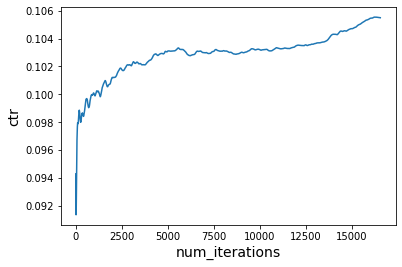

In [21]:
plot_ctr(len(result_betats), result_betats).show()